In [4]:
from collections import OrderedDict
from time import time
import re
import json
from natsort import natsorted
from glob import glob
from pathlib import Path
import os

import math
from random import random, shuffle, choice

# import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

import numpy as np
from scipy.spatial import Delaunay

from matplotlib import collections  as mc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from IPython.display import clear_output

nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, labels=True, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
#     plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    plt.show()

#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




def subtree_sizes(tree, root):
    tree = nx.bfs_tree(g, source=root)
    s = [len(nx.bfs_tree(tree, i).nodes) for i in tree.neighbors(root)]
    total = sum(s)
    return np.array(s)


def fan(nodes, origin=[0,0], radius=1, phaseCenter=0, phaseRange=np.pi, ratio=[1,1]):
    pos = {}
    phases = {}
    ranges = {}
    n = len(nodes)
    cos, sin = np.cos, np.sin
    
    ratioTotal = sum(ratio)
    ratio = [r/ratioTotal for r in ratio]
    
    
    nr = sorted(zip(nodes, ratio), key=lambda x:x[1])
    nr2 = []
    for i in range(len(nr)-1, -1, -1):
        if i%2 == 0:
            nr2.append(nr[i])
        else:
            nr2.insert(0, nr[i])
    nodes, ratio = zip(*nr2)
    
    
    ratioCumSum = [sum(ratio[:i]) for i in range(len(ratio)+1)]
    for i in range(n):
        angle_offset = (ratioCumSum[i]+ratioCumSum[i+1])/2 * phaseRange
        angle_i = phaseCenter - phaseRange/2 + angle_offset
        pos[nodes[i]] = [radius*cos(angle_i), radius*sin(angle_i)]
        phases[nodes[i]] = angle_i
        ranges[nodes[i]] = ratio[i] * phaseRange * 0.95
    return pos, phases, ranges


def radial_layout(g, root=None):
    g0 = g
    g = nx.bfs_tree(g, source=root)
    origin = [0,0]
    pos = {}
    phases = {}
    ranges = {}
    if root is None:
        root = next(iter(g.nodes))
    pos[root] = origin
    phases[root] = 0
    ranges[root] = np.pi*2
#     neighbors = list(g.neighbors(root))
    radius = 0
    roots = [root, ]
    while len(pos) < len(g.nodes):
        radius += 1
        newRoots = []
        for root in roots:
            neighbors = [n for n in g.neighbors(root) if n not in pos]
            subTreeSizes = [len(nx.bfs_tree(g, i).nodes) for i in neighbors]
#             neighborSizes = [len(list(g0.neighbors(i))) for i in neighbors]
            newRoots += neighbors
            if len(neighbors) > 0:
                newPos, newPhases, newRanges = fan(
                    neighbors, 
                    origin, 
                    radius, 
                    phaseCenter=phases[root], 
                    phaseRange=ranges[root], 
                    ratio=subTreeSizes,
                )
                pos.update(newPos)
                phases.update(newPhases)
                ranges.update(newRanges)
        roots = newRoots
    return pos

def normalize(node):
    for prop in node:
        
            
        if prop == 'pos':
            pos = node[prop].replace('"', '')
            pos = pos.split(',')
            pos = [float(pos[0]), float(pos[1])]
            node[prop] = pos
        else:
            if type(node[prop]) == str:
                node[prop] = node[prop].replace('"', '')
                
            try:
                node[prop] = int(node[prop])
            except ValueError:
                try:
                    node[prop] = float(node[prop])
                except ValueError:
                    pass
            except Exception as err:
                print(err)
                print(node, prop)


## Generate a Graph

## faryads' topics 5000 nodes (txt)

In [6]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


# fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))

## Reyan's level-weight setting
fns = natsorted(glob('./data/txt/TopicsLayersData-0/*.txt'))
# nodeCounts = [50, 100, 200, 500, 800, 1200, 1600, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
# levels = [1,1,2,2,3,3,4,4,5,5,6,6,7,8]
# weights = [550,500,500,450,450,400,400, 350,350, 300,300, 250,250, 200]
# nodeCount2levelweight = {k:v for k,v in zip(nodeCounts, zip(levels, weight))}
nodeCount2levelweight = {
    50: (1, 550),
    100: (1, 500),
    200: (2, 500), 
    500: (2, 450), 300: (2, 450), 400:(2, 450),
    800: (3, 450), 600: (3, 450), 700: (3, 450),
    1200: (3, 400),
    1600: (4, 400),
    2000: (4, 350),
    2500: (5, 350),
    3000: (5, 300),
    3500: (6, 300),
    4000: (6, 250),
    4500: (7, 250),
    5000: (8, 200)
}

# nodeCount2levelweight = {
#     50: (1, 550),
#     100: (2, 500),
#     200: (3, 500), 
#     500: (6, 450), 300: (4, 450), 400:(5, 450),
#     800: (9, 450), 600: (7, 450), 700: (8, 450),
#     1200: (10, 400),
#     1600: (11, 400),
#     2000: (12, 350),
#     2500: (13, 350),
#     3000: (14, 300),
#     3500: (15, 300),
#     4000: (16, 250),
#     4500: (17, 250),
#     5000: (18, 200)
# }

             
with open(fns[-1]) as f:
    nodeCount = int(fns[-1].split('_')[-1].split('.')[0])
    g, i2k, label2i = edges2graph(f.readlines())
    level, weight = nodeCount2levelweight[nodeCount]
    print(fns[-1], level, weight)
    for n in g.nodes:
        g.nodes[n]['level'] = level
        g.nodes[n]['nodeCount'] = nodeCount
        g.nodes[n]['weight'] = weight
        
    for e in g.edges:
        g.edges[e]['level'] = level
        g.edges[e]['weight'] = weight

# for fn, level, weight in list(fn_level_weight)[:-1][::-1]:
for fn in fns[:-1][::-1]:
    nodeCount = int(fn.split('_')[-1].split('.')[0])
    level, weight = nodeCount2levelweight[nodeCount]
    print(fn, level, weight)
    with open(fn) as f:
        subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            g.nodes[n]['nodeCount'] = nodeCount
            g.nodes[n]['weight'] = weight

        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = weight
#             print(e, g.edges[e]['weight'])


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]

fn = fns[-1]


./data/txt/TopicsLayersData-0/Graph_5000.txt 8 200
./data/txt/TopicsLayersData-0/Graph_4500.txt 7 250
./data/txt/TopicsLayersData-0/Graph_4000.txt 6 250
./data/txt/TopicsLayersData-0/Graph_3500.txt 6 300
./data/txt/TopicsLayersData-0/Graph_3000.txt 5 300
./data/txt/TopicsLayersData-0/Graph_2500.txt 5 350
./data/txt/TopicsLayersData-0/Graph_2000.txt 4 350
./data/txt/TopicsLayersData-0/Graph_1600.txt 4 400
./data/txt/TopicsLayersData-0/Graph_1200.txt 3 400
./data/txt/TopicsLayersData-0/Graph_800.txt 3 450
./data/txt/TopicsLayersData-0/Graph_700.txt 3 450
./data/txt/TopicsLayersData-0/Graph_600.txt 3 450
./data/txt/TopicsLayersData-0/Graph_500.txt 2 450
./data/txt/TopicsLayersData-0/Graph_400.txt 2 450
./data/txt/TopicsLayersData-0/Graph_300.txt 2 450
./data/txt/TopicsLayersData-0/Graph_200.txt 2 500
./data/txt/TopicsLayersData-0/Graph_100.txt 1 500
./data/txt/TopicsLayersData-0/Graph_50.txt 1 550
all_pairs_shortest_path...



k-hop all_pairs_shortest_path...


In [ ]:
labels = np.array([g.nodes[i]['label'] for i in g.nodes])
labelSize = [len(l) for l in labels]
orderBySize = np.argsort(labelSize)
labelsOrderedBySize = labels[orderBySize][::-1]
for l in labelsOrderedBySize:
    print(l)

### Math Genealogy

In [ ]:

# ### 67 nodes
# fn = './data/txt/math-genealogy/math-67.txt'
# # label_to_id = {'K. Müller':66,'A. E. R. Kneschke':22,'B. Karstens':70,'K. E. Stork':35,'W. Fricke':9,'R. C. Straubel':8,'K. Ludwig':49,'W. Lauf':84,'R. Buchweitz':81,'A. K. Holzwarth':24,'O. Mayer':65,'W. von Heygendorff':2,'D. Schuldt':67,'L. Kämmerer':68,'J. Meyer':11,'H. Kessler':12,'G. H. Wannier':30,'V. Hartmann':69,'S. M. geb. Zacharias':56,'A. Hagenbach':3,'L. Neumann':16,'M. Mitchell':83,'M. D. Thomure':91,'E. Oettinger':18,'O. Volk':14,'W. Schorcht':10,'J. Ostwald':0,'M. T. geb. Deutschmann':58,'W. Landecker':89,'H. Tietz':33,'G. Schmieder':82,'K. Heun':6,'M. Krafft':17,'P. Peter':61,'A. Tafelmacher':7,'E. C. G. Stueckelberg':26,'M. Fruth':54,'K. Ebbinghaus':4,'K. J. Thomae':1,'H. Schreiter':51,'G. F. L. Frege':5,'G. Wiarda':19,'M. Cenek':92,'W. Müller':53,'F. W. M. Müller':23,'W. Merten':20,'E. Pippig':71,'P. Katilius':15,'H. Bückner':34,'K. Potthoff':78,'C. Schoen':64,'K. Mätzel':50,'D. Hudak':55,'M. Schoch':52,'H. K. O. Liebmann':13,'K. Neumann':57,'R. Hopsch':60,'G. Stiege':80,'D. R. Hofstadter':32,'D. Tzscharschuch':59,'P. Ghosh':93,'A. Thedy':21,'H. Jäckel':47,'R. Juengling':90,'V. Padervinskas':31,'A. Wolf':25,'E. C. J. Schering':5}
# # label_to_id['G. F. L. Frege'] = 999
# # id_to_label = {66:'K. Müller',22:'A. E. R. Kneschke',70:'B. Karstens',35:'K. E. Stork',9:'W. Fricke',8:'R. C. Straubel',49:'K. Ludwig',84:'W. Lauf',81:'R. Buchweitz',24:'A. K. Holzwarth',65:'O. Mayer',2:'W. von Heygendorff',67:'D. Schuldt',68:'L. Kämmerer',11:'J. Meyer',12:'H. Kessler',30:'G. H. Wannier',69:'V. Hartmann',56:'S. M. geb. Zacharias',3:'A. Hagenbach',16:'L. Neumann',83:'M. Mitchell',91:'M. D. Thomure',18:'E. Oettinger',14:'O. Volk',10:'W. Schorcht',0:'J. Ostwald',58:'M. T. geb. Deutschmann',89:'W. Landecker',33:'H. Tietz',82:'G. Schmieder',6:'K. Heun',17:'M. Krafft',61:'P. Peter',7:'A. Tafelmacher',26:'E. C. G. Stueckelberg',54:'M. Fruth',4:'K. Ebbinghaus',1:'K. J. Thomae',51:'H. Schreiter',5:'G. F. L. Frege',19:'G. Wiarda',92:'M. Cenek',53:'W. Müller',23:'F. W. M. Müller',20:'W. Merten',71:'E. Pippig',15:'P. Katilius',34:'H. Bückner',78:'K. Potthoff',64:'C. Schoen',50:'K. Mätzel',55:'D. Hudak',52:'M. Schoch',13:'H. K. O. Liebmann',57:'K. Neumann',60:'R. Hopsch',80:'G. Stiege',32:'D. R. Hofstadter',59:'D. Tzscharschuch',93:'P. Ghosh',21:'A. Thedy',47:'H. Jäckel',90:'R. Juengling',31:'V. Padervinskas',25:'A. Wolf',5:'E. C. J. Schering'}
# # id_to_label = {v:k for k,v in label_to_id.items()}
# my_edges = [['J. Ostwald', 'K. J. Thomae'], ['J. Ostwald', 'W. von Heygendorff'], ['J. Ostwald', 'A. Hagenbach'], ['J. Ostwald', 'K. Ebbinghaus'], ['K. J. Thomae', 'E. C. J. Schering'], ['E. C. J. Schering', 'G. F. L. Frege'], ['E. C. J. Schering', 'K. Heun'], ['E. C. J. Schering', 'A. Tafelmacher'], ['K. J. Thomae', 'R. C. Straubel'], ['R. C. Straubel', 'W. Fricke'], ['R. C. Straubel', 'W. Schorcht'], ['R. C. Straubel', 'J. Meyer'], ['R. C. Straubel', 'H. Kessler'], ['K. J. Thomae', 'H. K. O. Liebmann'], ['H. K. O. Liebmann', 'O. Volk'], ['H. K. O. Liebmann', 'P. Katilius'], ['K. J. Thomae', 'L. Neumann'], ['L. Neumann', 'M. Krafft'], ['L. Neumann', 'E. Oettinger'], ['L. Neumann', 'G. Wiarda'], ['L. Neumann', 'W. Merten'], ['R. C. Straubel', 'A. Thedy'], ['G. Wiarda', 'A. E. R. Kneschke'], ['H. K. O. Liebmann', 'F. W. M. Müller'], ['F. W. M. Müller', 'A. K. Holzwarth'], ['F. W. M. Müller', 'A. Wolf'], ['A. Hagenbach', 'E. C. G. Stueckelberg'], ['E. C. G. Stueckelberg', 'G. H. Wannier'], ['P. Katilius', 'V. Padervinskas'], ['G. H. Wannier', 'D. R. Hofstadter'], ['M. Krafft', 'H. Tietz'], ['M. Krafft', 'H. Bückner'], ['M. Krafft', 'K. E. Stork'], ['A. E. R. Kneschke', 'H. Jäckel'], ['H. Jäckel', 'K. Ludwig'], ['H. Jäckel', 'K. Mätzel'], ['H. Jäckel', 'H. Schreiter'], ['A. E. R. Kneschke', 'M. Schoch'], ['A. E. R. Kneschke', 'W. Müller'], ['K. Ludwig', 'M. Fruth'], ['K. Ludwig', 'D. Hudak'], ['K. Ludwig', 'S. M. geb. Zacharias'], ['K. Ludwig', 'K. Neumann'], ['K. Ludwig', 'M. T. geb. Deutschmann'], ['W. Müller', 'D. Tzscharschuch'], ['W. Müller', 'R. Hopsch'], ['W. Müller', 'P. Peter'], ['K. Neumann', 'C. Schoen'], ['K. Neumann', 'O. Mayer'], ['M. Schoch', 'K. Müller'], ['K. Müller', 'D. Schuldt'], ['K. Neumann', 'L. Kämmerer'], ['H. Schreiter', 'V. Hartmann'], ['H. Schreiter', 'B. Karstens'], ['H. Schreiter', 'E. Pippig'], ['H. Tietz', 'K. Potthoff'], ['H. Tietz', 'R. Buchweitz'], ['H. Tietz', 'G. Schmieder'], ['H. Tietz', 'G. Stiege'], ['D. R. Hofstadter', 'M. Mitchell'], ['G. Schmieder', 'W. Lauf'], ['M. Mitchell', 'W. Landecker'], ['M. Mitchell', 'R. Juengling'], ['M. Mitchell', 'M. D. Thomure'], ['M. Mitchell', 'M. Cenek'], ['M. Mitchell', 'P. Ghosh']]
# # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50}

# ### 509 nodes
# # fn = './data/txt/math-genealogy/math-509.txt'
# # # label_to_id = {'M. Farsi':293,'H. Alblas':229,'B. K. Berntson':411,'N. Joshi':106,'S. Ali':464,'A. A. Smith':220,'S. A. Orszag':105,'S. Dhople':466,'I. Nowosad':252,'Y. Delmas-Rigout':225,'J. A. Mingo':148,'M. B. Barbosa':351,'A. Daszkiewicz':205,'R. Malaka':248,'L. R. Frank':301,'D. Simson':135,'L. Adhikari':436,'W. M. Beaver':388,'J. W. Waters':419,'E. J. Hawkins':334,'J. Engelfriet':192,'X. Wan':21,'U. J. Pape':482,'J. Béziau':217,'A. P. Roberts':97,'C. Riveros':392,'A. T. Patera':170,'N. Azevedo':445,'S. Jaśkowski':1,'T. Marschall':479,'T. Singliar':413,'K. Daynes':231,'Z. W. Ras':129,'M. Benda':139,'A. Duwenig':435,'Z. Błaszczyk':257,'Y. Kuang':177,'K. Świrydowicz':156,'P. Pragacz':204,'A. M. Gelbart':39,'B. Kamiński':132,'H. Kaltenbach':481,'M. G. Main':197,'O. E. O. Uribe':374,'K. H. Chiang':451,'S. Slijepcevic':288,'M. J. Bauer':426,'A. Kwela':347,'W. Guzicki':65,'H. D. Toong':219,'O. Milenkovic':260,'H. Cohen':8,'P. Dowbor':236,'W. Holland':235,'A. D. Domínguez-':185,'D. B. Benson':109,'E. Fritzilas':480,'K. Schmidt':26,'J. Czajsner':52,'J. G. Eichhorn':13,'H. Gadamer':18,'A. Wieczorek':88,'N. Hadjiconstant':277,'A. Manzoni':461,'P. Szolovits':108,'C. Castillo-Chav':127,'P. J. Mucha':173,'H. H. Mostafa':77,'N. T. A. Haydn':285,'J. Tao':467,'L. Rubenfeld':115,'R. J. Deeley':434,'E. Gillaspy':462,'W. M. Jr.':58,'W. S. Song':302,'B. Sobociński':29,'F. C. Hoppenstea':126,'M. A. Martins':209,'G. Morales-Luna':72,'D. Lucor':354,'K. Ajdukiewicz':24,'U. F. Mayer':267,'I. Marusic':387,'S. R. Tuladhar':406,'M. Omyła':2,'T. D. Wu':282,'J. Bazer':59,'J. R. Jiang':145,'S. Waligórski':90,'A. Elyasov':200,'P. Ouwehand':262,'J. Zieleniewski':33,'G. Gripenberg':116,'Y. Yetim':365,'K. Palasinska':206,'M. Mostowski':169,'C. S. Zhu':367,'I. J. Aalbersber':194,'K. Junosza-Szani':247,'A. Dardzinska':216,'A. Ehrenfeucht':67,'S. Balcerzyk':87,'M. Wata':256,'M. C. Smith':186,'K. Hirsch':244,'M. D. Kruskal':57,'T. Kotarbinski':23,'F. Rabe':296,'R. Kannan':312,'M. V. G. Sánchez':318,'D. Q. Mayne':5,'J. Łukasiewicz':21,'A. F. B. C. Leit':398,'M. A. Proschan':162,'B. Stanosz':85,'Ö. Öztürk':270,'F. E. Baginski':168,'F. Echenique':386,'M. Feder':376,'B. Klemp':240,'J. Szymański':243,'P. Bhaduri':198,'A. Rozkosz':307,'E. P. Guentner':326,'F. Ballarin':463,'Y. C. Eldar':375,'B. Ketelboeter':438,'W. G. Aiello':180,'H. C. Sager':158,'J. Li':258,'D. H. Haussler':70,'D. C. Fogg':281,'K. E. Wage':380,'G. Akishev':232,'J. Ko':458,'R. I. Becker':120,'R. S. Finn':78,'E. W. M. Jr.':69,'D. L. Pigozzi':44,'M. Khalkhali':149,'A. Meinong':3,'F. C. Brentano':0,'W. T. Kraśkiewic':203,'T. Klimsiak':396,'C. Ma':191,'J. A. Kułaga-Prz':336,'H. Emerson':329,'C. M. Shannon':13,'L. J. Rotenberg':218,'G. Filè':230,'M. Codescu':295,'A. R. Zinsmeiste':159,'G. E. Karniadaki':22,'D. H. Jacobson':10,'T. Batóg':51,'N. Soja-Kukieła':311,'P. A. Fillmore':81,'S. J. Sherwin':359,'J. Kosakowska':238,'D. Pinheiro':287,'M. Scheepers':181,'I. Liu':405,'L. Dharmarajan':484,'E. A. V. García':319,'J. E. Schindall':41,'A. Grzegorczyk':66,'I. Normann':297,'M. Valko':415,'D. Burkow':315,'M. Moczurad':330,'K. Flores':321,'E. Mally':19,'Z. Pogorzały':245,'K. Adhikari':410,'B. Friedman':37,'L. Rossi':342,'L. S. Borkowski':76,'R. E. Bogner':99,'S. V. Babyonyshe':208,'J. Tryba':478,'R. Suszko':3,'B. Jónsson':48,'H. L. Ewald':5,'M. J. Cresswell':56,'A. Vargas':433,'H. N. Gupta':50,'R. A. Bull':55,'E. I. Su':102,'A. G. Bose':38,'R. G. Halburd':357,'Z. Adamowicz':71,'R. Bubner':27,'C. E. Cherry':43,'H. A. (. H. A. E':15,'G. Hernandez':122,'M. K. Ganai':404,'A. Jakubowski':134,'E. Schrader':16,'E. I. Ettinger':389,'J. A. Ernesti':11,'S. Matwin':130,'N. Eklund':7,'P. E. J. Vos':400,'H. Li':234,'M. J. Coleman':338,'D. Sampson':397,'J. Guaschi':284,'Z. Reznic':450,'M. Zarza':449,'E. T. Bullister':174,'K. J. Compton':141,'P. Seraji':447,'K. Szaniawski':32,'J. Choi':371,'O. Costin':103,'N. D. Santo':472,'E. Sąsiada':86,'M. T. Lemańczyk':254,'F. F. Zadeh':369,'B. E. Cortes':323,'Z. S. Szewczak':308,'G. Pastuszak':409,'G. Sochos':343,'F. Kübler':15,'R. D. Noren':187,'D. A. Hague':408,'P. Jędrzejewicz':250,'M. Mishali':441,'H. L. Planck':14,'J. Duda':332,'F. W. Leysieffer':91,'J. Hage':195,'D. Yen':114,'G. N. S. (. N. P':303,'C. Naturman':261,'H. Jeong':299,'W. Zielonka':155,'C. Mavriplis':276,'D. C. Jensen':68,'J. N. Findlay':28,'C. A. E. Botsari':184,'Y. Psiloyenis':348,'W. Li':379,'W. Bridewell':412,'E. Machery':223,'J. Weyman':202,'J. L. Dias':279,'K. S. Messan':322,'R. I. Goldblatt':164,'H. C. Calvet':166,'F. Yang':352,'G. W. Irwin':151,'S. A. Kasjan':237,'A. Kanigowski':341,'A. Hajduk':292,'G. G. Creamer':382,'R. M. K. Ii':353,'V. Elander':418,'D. A. Pearce':100,'M. Barg':337,'V. K. Sotirov':259,'A. B. Clarke':82,'A. N. Prior':54,'N. Butt':361,'D. J. Brown':4,'K. Reinert':370,'K. Mazur':345,'A. J. Blikle':131,'F. A. Trendelenb':2,'A. Idzik':89,'K. Grygiel':333,'R. Poss':63,'N. J. Korevaar':93,'B. J. Bayly':171,'M. A. (. A. Khan':14,'H. Huang':476,'S. Londen':113,'J. C. Allwright':11,'S. Ahn':264,'S. X. Bai':212,'B. M. Sayers':98,'H. T. Wansing':101,'R. J. Lorentz':196,'T. Bartoszynski':215,'M. Staniszewski':477,'H. Rose':84,'M. E. Frankowska':350,'F. G. Brauer':125,'V. F. Rickey':60,'M. A. D. Torres':274,'S. Malik':143,'J. Waldron':439,'F. Xie':366,'R. F. Marcia':226,'M. Kandulski':154,'F. Durrell':427,'J. Łoś':75,'W. Buszkowski':153,'R. Laudone':471,'K. M. Frączek':335,'R. C. Floricel':278,'T. Mossakowski':294,'P. J. Bankston':140,'R. Vohra':222,'A. W. Nowicki':137,'B. J. S. Blair':381,'M. P. Brannan':273,'T. Song':385,'S. Łuszczewska-R':22,'G. J. Wang':424,'N. Hartmann':10,'D. L. Black':291,'M. Kozak':253,'A. Aziz':146,'L. Dubikajtis':0,'S. M. Wilde':61,'A. Karimi':443,'T. Zalla':224,'C. (. Shilepsky':112,'H. (. Z. Chang':189,'T. Salin':118,'A. Backwell':428,'S. B. Gershwin':182,'D. M. Andler':210,'G. Voutsadakis':207,'Y. Freund':286,'Z. Pawlak':34,'H. S. Aldana':324,'D. J. Navinchand':283,'A. V. Oppenheim':40,'M. J. Schell':161,'S. Shields':422,'J. Kozik':331,'J. Słupecki':30,'A. K. Wiszniewsk':228,'D. R. Gilbert':233,'J. Wesserling':19,'W. M. Getz':183,'N. Wiener':25,'J. Lee':339,'S. G. Campbell':79,'F. D. S. Troncos':316,'C. Ley':390,'V. A. Armentano':201,'P. Dawkins':265,'A. M. Abdel-Mone':160,'W. R. Belding':64,'C. Levasseur':399,'A. Wójtowicz':17,'J. Karłowska-Pik':310,'K. Hannsgen':111,'G. Cui':179,'R. Gandham':431,'P. E. Gill':9,'W. Just':213,'J. Zhai':23,'Z. Zainib':465,'J. R. Buck':378,'P. E. Beckmann':300,'J. Brzykcy':421,'K. Warwick':96,'O. Walsh':188,'J. H. Westcott':6,'R. S. Patil':241,'Y. Ren':383,'M. Hauskrecht':242,'E. H. G. Gutiérr':459,'T. Michaeli':444,'F. W. Galvin':83,'A. Tarski':45,'J. Obrębska':20,'E. V. Erp':327,'L. Szamkołowicz':74,'F. Kraemer':373,'A. Skowroński':239,'S. Bahceci':313,'S. Pagani':475,'D. P. Brown':414,'J. G. Heywood':92,'J. Ratajski':271,'J. Mccuan':95,'Z. Assadi':448,'A. Cortesi':306,'B. M. N. Clarke':12,'M. L. Southcott':221,'L. Chen':393,'M. Vachharajani':364,'M. K. Kemppainen':469,'P. G. Natorp':9,'J. W. Kwiatkowsk':133,'J. D. Bruce':42,'D. Figueiredo':457,'S. Salehi':73,'J. J. Levin':110,'T. Yee':368,'M. Kysiak':344,'Y. Jing':363,'O. M. N. Tapiola':474,'M. Hoelle':432,'J. Hu':104,'V. Padron':123,'M. A. Benedikt':142,'A. Jaworska-Past':360,'B. Jordi':403,'R. A. C. Campos':416,'G. V. V. Zanten':356,'D. D. Grazia':402,'E. R. Zweifel':290,'H. Vu':391,'A. Madeira':452,'S. Rahmann':425,'P. O. Luttighuis':358,'J. C. Preisig':377,'A. Nowik':346,'D. Anderson':227,'P. Berk':423,'F. A. Ongay-Lari':317,'P. K. Ossowski':249,'C. G. Heyne':12,'J. Golińska-Pila':16,'W. Xie':190,'W. Collier':328,'K. Twardowski':1,'E. A. Reckwerdt':395,'G. Mengaldo':401,'S. Banach':20,'R. Brijder':199,'M. Zaionc':163,'D. Lücke':304,'N. D. Higson':147,'T. G. Kecker':407,'T. Józefiak':136,'M. Golasiński':138,'Y. Gu':305,'T. Warburton':355,'R. S. Mackay':107,'I. M. Navon':176,'R. Neves':454,'D. G. Aronson':8,'E. P. Sacks':280,'J. P. F. Teixeir':144,'T. P. Hytönen':117,'G. Rozenberg':128,'T. E. Gelsema':193,'A. J. Lee':417,'T. Serbinowski':268,'M. E. Hafsi':372,'G. L. König':4,'S. R. Dunbar':121,'H. J. (. Keisler':47,'A. Delegge':266,'M. M. Covell':362,'A. Görland':7,'M. M. Sysło':150,'C. B. Harris':325,'E. Cassirer':6,'R. P. Delong':157,'Z. Ben-Haim':442,'J. T. Smith':167,'M. K. Mentzen':255,'D. I. Meiron':172,'N. Levinson':36,'T. S. Hänninen':468,'P. Zakrzewski':214,'G. Chowell':320,'J. Klein':17,'R. K. Brayton':119,'M. Ninčević':429,'A. L. Kairema':473,'K. Sjolander':289,'G. I. Dodds':246,'P. Safari':446,'D. Costa':453,'M. Chen':420,'G. Rozza':275,'J. Zielinski':251,'H. I. Freedman':178,'S. V. Sam':263,'A. Kasperczuk':456,'W. G. Malcolm':165,'C. Jurado':384,'M. Bendkowski':340,'A. M. DallOlio':314,'G. H. Knightly':94,'J. Giedymin':35,'H. F. Becksfort':80,'H. J. Martikaine':470,'T. Puczyłowski':18,'R. E. Montó':211,'A. Alzulaibani':437,'P. Klinga':349,'T. R. Atcheson':430,'P. J. Donohoe':152,'D. Rios-Doria':460,'A. Tarlecki':175,'D. H. Terman':124,'J. T. Canty':62,'A. Mostowski':46,'H. Greniewski':31,'M. Martin':483,'B. R. Musicus':298,'F. H. Farnoud':440,'G. S. Gandenberg':455,'G. Panicker':394,'J. D. Kececioglu':269,'M. Jarosz':53,'F. B. Thompson':49,'C. E. I. Redelme':272,'D. P. Borkowski':309}
# # # id_to_label = {293:'M. Farsi',229:'H. Alblas',411:'B. K. Berntson',106:'N. Joshi',464:'S. Ali',220:'A. A. Smith',105:'S. A. Orszag',466:'S. Dhople',252:'I. Nowosad',225:'Y. Delmas-Rigout',148:'J. A. Mingo',351:'M. B. Barbosa',205:'A. Daszkiewicz',248:'R. Malaka',301:'L. R. Frank',135:'D. Simson',436:'L. Adhikari',388:'W. M. Beaver',419:'J. W. Waters',334:'E. J. Hawkins',192:'J. Engelfriet',21:'X. Wan',482:'U. J. Pape',217:'J. Béziau',97:'A. P. Roberts',392:'C. Riveros',170:'A. T. Patera',445:'N. Azevedo',1:'S. Jaśkowski',479:'T. Marschall',413:'T. Singliar',231:'K. Daynes',129:'Z. W. Ras',139:'M. Benda',435:'A. Duwenig',257:'Z. Błaszczyk',177:'Y. Kuang',156:'K. Świrydowicz',204:'P. Pragacz',39:'A. M. Gelbart',132:'B. Kamiński',481:'H. Kaltenbach',197:'M. G. Main',374:'O. E. O. Uribe',451:'K. H. Chiang',288:'S. Slijepcevic',426:'M. J. Bauer',347:'A. Kwela',65:'W. Guzicki',219:'H. D. Toong',260:'O. Milenkovic',8:'H. Cohen',236:'P. Dowbor',235:'W. Holland',185:'A. D. Domínguez-',109:'D. B. Benson',480:'E. Fritzilas',26:'K. Schmidt',52:'J. Czajsner',13:'J. G. Eichhorn',18:'H. Gadamer',88:'A. Wieczorek',277:'N. Hadjiconstant',461:'A. Manzoni',108:'P. Szolovits',127:'C. Castillo-Chav',173:'P. J. Mucha',77:'H. H. Mostafa',285:'N. T. A. Haydn',467:'J. Tao',115:'L. Rubenfeld',434:'R. J. Deeley',462:'E. Gillaspy',58:'W. M. Jr.',302:'W. S. Song',29:'B. Sobociński',126:'F. C. Hoppenstea',209:'M. A. Martins',72:'G. Morales-Luna',354:'D. Lucor',24:'K. Ajdukiewicz',267:'U. F. Mayer',387:'I. Marusic',406:'S. R. Tuladhar',2:'M. Omyła',282:'T. D. Wu',59:'J. Bazer',145:'J. R. Jiang',90:'S. Waligórski',200:'A. Elyasov',262:'P. Ouwehand',33:'J. Zieleniewski',116:'G. Gripenberg',365:'Y. Yetim',206:'K. Palasinska',169:'M. Mostowski',367:'C. S. Zhu',194:'I. J. Aalbersber',247:'K. Junosza-Szani',216:'A. Dardzinska',67:'A. Ehrenfeucht',87:'S. Balcerzyk',256:'M. Wata',186:'M. C. Smith',244:'K. Hirsch',57:'M. D. Kruskal',23:'T. Kotarbinski',296:'F. Rabe',312:'R. Kannan',318:'M. V. G. Sánchez',5:'D. Q. Mayne',21:'J. Łukasiewicz',398:'A. F. B. C. Leit',162:'M. A. Proschan',85:'B. Stanosz',270:'Ö. Öztürk',168:'F. E. Baginski',386:'F. Echenique',376:'M. Feder',240:'B. Klemp',243:'J. Szymański',198:'P. Bhaduri',307:'A. Rozkosz',326:'E. P. Guentner',463:'F. Ballarin',375:'Y. C. Eldar',438:'B. Ketelboeter',180:'W. G. Aiello',158:'H. C. Sager',258:'J. Li',70:'D. H. Haussler',281:'D. C. Fogg',380:'K. E. Wage',232:'G. Akishev',458:'J. Ko',120:'R. I. Becker',78:'R. S. Finn',69:'E. W. M. Jr.',44:'D. L. Pigozzi',149:'M. Khalkhali',3:'A. Meinong',0:'F. C. Brentano',203:'W. T. Kraśkiewic',396:'T. Klimsiak',191:'C. Ma',336:'J. A. Kułaga-Prz',329:'H. Emerson',13:'C. M. Shannon',218:'L. J. Rotenberg',230:'G. Filè',295:'M. Codescu',159:'A. R. Zinsmeiste',22:'G. E. Karniadaki',10:'D. H. Jacobson',51:'T. Batóg',311:'N. Soja-Kukieła',81:'P. A. Fillmore',359:'S. J. Sherwin',238:'J. Kosakowska',287:'D. Pinheiro',181:'M. Scheepers',405:'I. Liu',484:'L. Dharmarajan',319:'E. A. V. García',41:'J. E. Schindall',66:'A. Grzegorczyk',297:'I. Normann',415:'M. Valko',315:'D. Burkow',330:'M. Moczurad',321:'K. Flores',19:'E. Mally',245:'Z. Pogorzały',410:'K. Adhikari',37:'B. Friedman',342:'L. Rossi',76:'L. S. Borkowski',99:'R. E. Bogner',208:'S. V. Babyonyshe',478:'J. Tryba',3:'R. Suszko',48:'B. Jónsson',5:'H. L. Ewald',56:'M. J. Cresswell',433:'A. Vargas',50:'H. N. Gupta',55:'R. A. Bull',102:'E. I. Su',38:'A. G. Bose',357:'R. G. Halburd',71:'Z. Adamowicz',27:'R. Bubner',43:'C. E. Cherry',15:'H. A. (. H. A. E',122:'G. Hernandez',404:'M. K. Ganai',134:'A. Jakubowski',16:'E. Schrader',389:'E. I. Ettinger',11:'J. A. Ernesti',130:'S. Matwin',7:'N. Eklund',400:'P. E. J. Vos',234:'H. Li',338:'M. J. Coleman',397:'D. Sampson',284:'J. Guaschi',450:'Z. Reznic',449:'M. Zarza',174:'E. T. Bullister',141:'K. J. Compton',447:'P. Seraji',32:'K. Szaniawski',371:'J. Choi',103:'O. Costin',472:'N. D. Santo',86:'E. Sąsiada',254:'M. T. Lemańczyk',369:'F. F. Zadeh',323:'B. E. Cortes',308:'Z. S. Szewczak',409:'G. Pastuszak',343:'G. Sochos',15:'F. Kübler',187:'R. D. Noren',408:'D. A. Hague',250:'P. Jędrzejewicz',441:'M. Mishali',14:'H. L. Planck',332:'J. Duda',91:'F. W. Leysieffer',195:'J. Hage',114:'D. Yen',303:'G. N. S. (. N. P',261:'C. Naturman',299:'H. Jeong',155:'W. Zielonka',276:'C. Mavriplis',68:'D. C. Jensen',28:'J. N. Findlay',184:'C. A. E. Botsari',348:'Y. Psiloyenis',379:'W. Li',412:'W. Bridewell',223:'E. Machery',202:'J. Weyman',279:'J. L. Dias',322:'K. S. Messan',164:'R. I. Goldblatt',166:'H. C. Calvet',352:'F. Yang',151:'G. W. Irwin',237:'S. A. Kasjan',341:'A. Kanigowski',292:'A. Hajduk',382:'G. G. Creamer',353:'R. M. K. Ii',418:'V. Elander',100:'D. A. Pearce',337:'M. Barg',259:'V. K. Sotirov',82:'A. B. Clarke',54:'A. N. Prior',361:'N. Butt',4:'D. J. Brown',370:'K. Reinert',345:'K. Mazur',131:'A. J. Blikle',2:'F. A. Trendelenb',89:'A. Idzik',333:'K. Grygiel',63:'R. Poss',93:'N. J. Korevaar',171:'B. J. Bayly',14:'M. A. (. A. Khan',476:'H. Huang',113:'S. Londen',11:'J. C. Allwright',264:'S. Ahn',212:'S. X. Bai',98:'B. M. Sayers',101:'H. T. Wansing',196:'R. J. Lorentz',215:'T. Bartoszynski',477:'M. Staniszewski',84:'H. Rose',350:'M. E. Frankowska',125:'F. G. Brauer',60:'V. F. Rickey',274:'M. A. D. Torres',143:'S. Malik',439:'J. Waldron',366:'F. Xie',226:'R. F. Marcia',154:'M. Kandulski',427:'F. Durrell',75:'J. Łoś',153:'W. Buszkowski',471:'R. Laudone',335:'K. M. Frączek',278:'R. C. Floricel',294:'T. Mossakowski',140:'P. J. Bankston',222:'R. Vohra',137:'A. W. Nowicki',381:'B. J. S. Blair',273:'M. P. Brannan',385:'T. Song',22:'S. Łuszczewska-R',424:'G. J. Wang',10:'N. Hartmann',291:'D. L. Black',253:'M. Kozak',146:'A. Aziz',0:'L. Dubikajtis',61:'S. M. Wilde',443:'A. Karimi',224:'T. Zalla',112:'C. (. Shilepsky',189:'H. (. Z. Chang',118:'T. Salin',428:'A. Backwell',182:'S. B. Gershwin',210:'D. M. Andler',207:'G. Voutsadakis',286:'Y. Freund',34:'Z. Pawlak',324:'H. S. Aldana',283:'D. J. Navinchand',40:'A. V. Oppenheim',161:'M. J. Schell',422:'S. Shields',331:'J. Kozik',30:'J. Słupecki',228:'A. K. Wiszniewsk',233:'D. R. Gilbert',19:'J. Wesserling',183:'W. M. Getz',25:'N. Wiener',339:'J. Lee',79:'S. G. Campbell',316:'F. D. S. Troncos',390:'C. Ley',201:'V. A. Armentano',265:'P. Dawkins',160:'A. M. Abdel-Mone',64:'W. R. Belding',399:'C. Levasseur',17:'A. Wójtowicz',310:'J. Karłowska-Pik',111:'K. Hannsgen',179:'G. Cui',431:'R. Gandham',9:'P. E. Gill',213:'W. Just',23:'J. Zhai',465:'Z. Zainib',378:'J. R. Buck',300:'P. E. Beckmann',421:'J. Brzykcy',96:'K. Warwick',188:'O. Walsh',6:'J. H. Westcott',241:'R. S. Patil',383:'Y. Ren',242:'M. Hauskrecht',459:'E. H. G. Gutiérr',444:'T. Michaeli',83:'F. W. Galvin',45:'A. Tarski',20:'J. Obrębska',327:'E. V. Erp',74:'L. Szamkołowicz',373:'F. Kraemer',239:'A. Skowroński',313:'S. Bahceci',475:'S. Pagani',414:'D. P. Brown',92:'J. G. Heywood',271:'J. Ratajski',95:'J. Mccuan',448:'Z. Assadi',306:'A. Cortesi',12:'B. M. N. Clarke',221:'M. L. Southcott',393:'L. Chen',364:'M. Vachharajani',469:'M. K. Kemppainen',9:'P. G. Natorp',133:'J. W. Kwiatkowsk',42:'J. D. Bruce',457:'D. Figueiredo',73:'S. Salehi',110:'J. J. Levin',368:'T. Yee',344:'M. Kysiak',363:'Y. Jing',474:'O. M. N. Tapiola',432:'M. Hoelle',104:'J. Hu',123:'V. Padron',142:'M. A. Benedikt',360:'A. Jaworska-Past',403:'B. Jordi',416:'R. A. C. Campos',356:'G. V. V. Zanten',402:'D. D. Grazia',290:'E. R. Zweifel',391:'H. Vu',452:'A. Madeira',425:'S. Rahmann',358:'P. O. Luttighuis',377:'J. C. Preisig',346:'A. Nowik',227:'D. Anderson',423:'P. Berk',317:'F. A. Ongay-Lari',249:'P. K. Ossowski',12:'C. G. Heyne',16:'J. Golińska-Pila',190:'W. Xie',328:'W. Collier',1:'K. Twardowski',395:'E. A. Reckwerdt',401:'G. Mengaldo',20:'S. Banach',199:'R. Brijder',163:'M. Zaionc',304:'D. Lücke',147:'N. D. Higson',407:'T. G. Kecker',136:'T. Józefiak',138:'M. Golasiński',305:'Y. Gu',355:'T. Warburton',107:'R. S. Mackay',176:'I. M. Navon',454:'R. Neves',8:'D. G. Aronson',280:'E. P. Sacks',144:'J. P. F. Teixeir',117:'T. P. Hytönen',128:'G. Rozenberg',193:'T. E. Gelsema',417:'A. J. Lee',268:'T. Serbinowski',372:'M. E. Hafsi',4:'G. L. König',121:'S. R. Dunbar',47:'H. J. (. Keisler',266:'A. Delegge',362:'M. M. Covell',7:'A. Görland',150:'M. M. Sysło',325:'C. B. Harris',6:'E. Cassirer',157:'R. P. Delong',442:'Z. Ben-Haim',167:'J. T. Smith',255:'M. K. Mentzen',172:'D. I. Meiron',36:'N. Levinson',468:'T. S. Hänninen',214:'P. Zakrzewski',320:'G. Chowell',17:'J. Klein',119:'R. K. Brayton',429:'M. Ninčević',473:'A. L. Kairema',289:'K. Sjolander',246:'G. I. Dodds',446:'P. Safari',453:'D. Costa',420:'M. Chen',275:'G. Rozza',251:'J. Zielinski',178:'H. I. Freedman',263:'S. V. Sam',456:'A. Kasperczuk',165:'W. G. Malcolm',384:'C. Jurado',340:'M. Bendkowski',314:'A. M. DallOlio',94:'G. H. Knightly',35:'J. Giedymin',80:'H. F. Becksfort',470:'H. J. Martikaine',18:'T. Puczyłowski',211:'R. E. Montó',437:'A. Alzulaibani',349:'P. Klinga',430:'T. R. Atcheson',152:'P. J. Donohoe',460:'D. Rios-Doria',175:'A. Tarlecki',124:'D. H. Terman',62:'J. T. Canty',46:'A. Mostowski',31:'H. Greniewski',483:'M. Martin',298:'B. R. Musicus',440:'F. H. Farnoud',455:'G. S. Gandenberg',394:'G. Panicker',269:'J. D. Kececioglu',53:'M. Jarosz',49:'F. B. Thompson',272:'C. E. I. Redelme',309:'D. P. Borkowski'}
# # my_edges = [['F. C. Brentano', 'K. Twardowski'], ['F. C. Brentano', 'F. A. Trendelenb'], ['F. C. Brentano', 'A. Meinong'], ['F. A. Trendelenb', 'G. L. König'], ['F. A. Trendelenb', 'H. Cohen'], ['H. Cohen', 'P. G. Natorp'], ['H. Cohen', 'N. Hartmann'], ['H. Cohen', 'E. Cassirer'], ['G. L. König', 'C. G. Heyne'], ['C. G. Heyne', 'J. G. Eichhorn'], ['J. G. Eichhorn', 'H. L. Planck'], ['H. L. Planck', 'H. A. (. H. A. E'], ['H. A. (. H. A. E', 'E. Schrader'], ['N. Hartmann', 'J. Klein'], ['N. Hartmann', 'H. Gadamer'], ['A. Meinong', 'E. Mally'], ['K. Twardowski', 'S. Banach'], ['K. Twardowski', 'J. Łukasiewicz'], ['K. Twardowski', 'S. Łuszczewska-R'], ['K. Twardowski', 'T. Kotarbinski'], ['K. Twardowski', 'K. Ajdukiewicz'], ['P. G. Natorp', 'A. Görland'], ['P. G. Natorp', 'K. Schmidt'], ['H. Gadamer', 'R. Bubner'], ['E. Mally', 'J. N. Findlay'], ['J. Łukasiewicz', 'B. Sobociński'], ['J. Łukasiewicz', 'J. Słupecki'], ['J. Łukasiewicz', 'S. Jaśkowski'], ['T. Kotarbinski', 'H. Greniewski'], ['T. Kotarbinski', 'K. Szaniawski'], ['T. Kotarbinski', 'J. Zieleniewski'], ['H. Greniewski', 'Z. Pawlak'], ['K. Ajdukiewicz', 'R. Suszko'], ['K. Ajdukiewicz', 'J. Giedymin'], ['S. Łuszczewska-R', 'T. Batóg'], ['S. Łuszczewska-R', 'J. Czajsner'], ['S. Łuszczewska-R', 'M. Jarosz'], ['S. Jaśkowski', 'L. Dubikajtis'], ['J. N. Findlay', 'A. N. Prior'], ['B. Sobociński', 'V. F. Rickey'], ['B. Sobociński', 'S. M. Wilde'], ['B. Sobociński', 'J. T. Canty'], ['B. Sobociński', 'R. Poss'], ['B. Sobociński', 'W. R. Belding'], ['J. Słupecki', 'L. Szamkołowicz'], ['J. Słupecki', 'J. Łoś'], ['J. Słupecki', 'L. S. Borkowski'], ['R. Suszko', 'B. Stanosz'], ['R. Suszko', 'M. Omyła'], ['R. Suszko', 'D. J. Brown'], ['J. Łoś', 'E. Sąsiada'], ['J. Łoś', 'S. Balcerzyk'], ['J. Łoś', 'A. Wieczorek'], ['J. Łoś', 'A. Idzik'], ['J. Giedymin', 'D. A. Pearce'], ['D. A. Pearce', 'E. I. Su'], ['Z. Pawlak', 'G. Rozenberg'], ['Z. Pawlak', 'Z. W. Ras'], ['Z. Pawlak', 'S. Matwin'], ['Z. Pawlak', 'A. J. Blikle'], ['E. Sąsiada', 'B. Kamiński'], ['E. Sąsiada', 'J. W. Kwiatkowsk'], ['E. Sąsiada', 'A. Jakubowski'], ['S. Balcerzyk', 'D. Simson'], ['S. Balcerzyk', 'T. Józefiak'], ['S. Balcerzyk', 'A. W. Nowicki'], ['S. Balcerzyk', 'M. Golasiński'], ['L. Szamkołowicz', 'M. M. Sysło'], ['T. Batóg', 'W. Buszkowski'], ['T. Batóg', 'M. Kandulski'], ['T. Batóg', 'W. Zielonka'], ['T. Batóg', 'K. Świrydowicz'], ['B. Stanosz', 'M. Mostowski'], ['A. J. Blikle', 'A. Tarlecki'], ['G. Rozenberg', 'J. Engelfriet'], ['G. Rozenberg', 'T. E. Gelsema'], ['G. Rozenberg', 'I. J. Aalbersber'], ['G. Rozenberg', 'J. Hage'], ['G. Rozenberg', 'R. Brijder'], ['J. Hage', 'A. Elyasov'], ['T. Józefiak', 'J. Weyman'], ['T. Józefiak', 'W. T. Kraśkiewic'], ['T. Józefiak', 'P. Pragacz'], ['T. Józefiak', 'A. Daszkiewicz'], ['D. J. Brown', 'C. M. Shannon'], ['D. J. Brown', 'M. A. (. A. Khan'], ['D. J. Brown', 'F. Kübler'], ['Z. W. Ras', 'A. Dardzinska'], ['M. Omyła', 'J. Golińska-Pila'], ['M. Omyła', 'A. Wójtowicz'], ['M. Omyła', 'T. Puczyłowski'], ['M. Omyła', 'J. Wesserling'], ['M. Omyła', 'J. Obrębska'], ['M. A. (. A. Khan', 'R. Vohra'], ['A. Wieczorek', 'A. K. Wiszniewsk'], ['J. Engelfriet', 'H. Alblas'], ['J. Engelfriet', 'G. Filè'], ['D. Simson', 'P. Dowbor'], ['D. Simson', 'S. A. Kasjan'], ['D. Simson', 'J. Kosakowska'], ['D. Simson', 'A. Skowroński'], ['D. Simson', 'B. Klemp'], ['B. Kamiński', 'J. Szymański'], ['B. Kamiński', 'K. Hirsch'], ['A. Skowroński', 'Z. Pogorzały'], ['A. Idzik', 'K. Junosza-Szani'], ['A. W. Nowicki', 'P. K. Ossowski'], ['A. W. Nowicki', 'P. Jędrzejewicz'], ['A. W. Nowicki', 'J. Zielinski'], ['A. W. Nowicki', 'I. Nowosad'], ['K. Świrydowicz', 'M. Kozak'], ['J. W. Kwiatkowsk', 'M. T. Lemańczyk'], ['J. W. Kwiatkowsk', 'M. K. Mentzen'], ['J. W. Kwiatkowsk', 'M. Wata'], ['M. Golasiński', 'Z. Błaszczyk'], ['J. Weyman', 'S. V. Sam'], ['P. Pragacz', 'Ö. Öztürk'], ['P. Pragacz', 'J. Ratajski'], ['P. Dowbor', 'A. Hajduk'], ['A. Tarlecki', 'T. Mossakowski'], ['A. Tarlecki', 'M. Codescu'], ['T. Mossakowski', 'F. Rabe'], ['T. Mossakowski', 'I. Normann'], ['T. Mossakowski', 'D. Lücke'], ['G. Filè', 'A. Cortesi'], ['A. Jakubowski', 'A. Rozkosz'], ['A. Jakubowski', 'Z. S. Szewczak'], ['A. Jakubowski', 'D. P. Borkowski'], ['A. Jakubowski', 'J. Karłowska-Pik'], ['A. Jakubowski', 'N. Soja-Kukieła'], ['R. Vohra', 'R. Kannan'], ['R. Vohra', 'S. Bahceci'], ['R. Vohra', "A. M. Dall'Olio"], ['M. T. Lemańczyk', 'K. M. Frączek'], ['M. T. Lemańczyk', 'J. A. Kułaga-Prz'], ['M. T. Lemańczyk', 'A. Kanigowski'], ['H. Alblas', 'G. V. V. Zanten'], ['H. Alblas', 'P. O. Luttighuis'], ['Z. Pogorzały', 'A. Jaworska-Past'], ['C. M. Shannon', 'F. Echenique'], ['A. Rozkosz', 'T. Klimsiak'], ['S. A. Kasjan', 'G. Pastuszak'], ['K. M. Frączek', 'J. Brzykcy'], ['K. M. Frączek', 'P. Berk'], ['F. Kübler', 'M. Hoelle'], ['A. Dardzinska', 'A. Kasperczuk'], ['S. V. Sam', 'R. Laudone'], ['S. V. Sam', 'H. Huang'], ['E. Cassirer', 'H. L. Ewald'], ['C. G. Heyne', 'J. A. Ernesti'], ['A. N. Prior', 'R. A. Bull'], ['D. A. Pearce', 'H. T. Wansing'], ['K. Schmidt', 'N. Wiener'], ['N. Wiener', 'B. Friedman'], ['N. Wiener', 'A. M. Gelbart'], ['N. Wiener', 'C. E. Cherry'], ['A. N. Prior', 'M. J. Cresswell'], ['B. Friedman', 'W. M. Jr.'], ['A. M. Gelbart', 'H. H. Mostafa'], ['A. M. Gelbart', 'S. G. Campbell'], ['C. E. Cherry', 'J. H. Westcott'], ['J. H. Westcott', 'A. P. Roberts'], ['C. E. Cherry', 'B. M. Sayers'], ['A. P. Roberts', 'G. W. Irwin'], ['W. M. Jr.', 'R. P. Delong'], ['M. J. Cresswell', 'R. I. Goldblatt'], ['R. I. Goldblatt', 'K. Daynes'], ['R. I. Goldblatt', 'D. R. Gilbert'], ['G. W. Irwin', 'G. I. Dodds'], ['N. Wiener', 'N. Levinson'], ['B. Friedman', 'M. D. Kruskal'], ['A. M. Gelbart', 'R. S. Finn'], ['R. S. Finn', 'J. G. Heywood'], ['R. S. Finn', 'G. H. Knightly'], ['J. H. Westcott', 'K. Warwick'], ['C. E. Cherry', 'R. E. Bogner'], ['M. D. Kruskal', 'J. Hu'], ['M. D. Kruskal', 'N. Joshi'], ['N. Levinson', 'J. J. Levin'], ['J. J. Levin', 'C. (. Shilepsky'], ['N. Levinson', 'R. K. Brayton'], ['N. Levinson', 'F. G. Brauer'], ['F. G. Brauer', 'C. Castillo-Chav'], ['R. K. Brayton', 'S. Malik'], ['R. K. Brayton', 'J. R. Jiang'], ['A. P. Roberts', 'P. J. Donohoe'], ['M. J. Cresswell', 'W. G. Malcolm'], ['G. H. Knightly', 'F. E. Baginski'], ['J. G. Heywood', 'O. Walsh'], ['J. G. Heywood', 'W. Xie'], ['R. E. Bogner', 'M. L. Southcott'], ['R. I. Goldblatt', 'G. Akishev'], ['K. Warwick', 'M. Farsi'], ['C. Castillo-Chav', 'D. Burkow'], ['C. Castillo-Chav', 'G. Chowell'], ['C. Castillo-Chav', 'K. S. Messan'], ['F. E. Baginski', 'W. Collier'], ['F. E. Baginski', 'M. Barg'], ['F. E. Baginski', 'J. Lee'], ['M. Farsi', 'M. B. Barbosa'], ['N. Joshi', 'R. G. Halburd'], ['D. Burkow', 'Y. Kuang'], ['S. Malik', 'M. Vachharajani'], ['S. Malik', 'F. Xie'], ['J. Hu', 'T. Yee'], ['R. G. Halburd', 'T. G. Kecker'], ['R. G. Halburd', 'B. K. Berntson'], ['J. R. Jiang', 'K. H. Chiang'], ['G. Chowell', 'E. H. G. Gutiérr'], ['N. Wiener', 'A. G. Bose'], ['A. G. Bose', 'J. E. Schindall'], ['B. Friedman', 'J. Bazer'], ['A. M. Gelbart', 'H. F. Becksfort'], ['R. S. Finn', 'N. J. Korevaar'], ['J. H. Westcott', 'D. Q. Mayne'], ['M. D. Kruskal', 'S. A. Orszag'], ['J. J. Levin', 'K. Hannsgen'], ['J. Bazer', 'D. Yen'], ['N. Levinson', 'R. I. Becker'], ['F. G. Brauer', 'F. C. Hoppenstea'], ['R. K. Brayton', 'A. Aziz'], ['R. I. Becker', 'H. C. Sager'], ['F. C. Hoppenstea', 'H. C. Calvet'], ['S. A. Orszag', 'A. T. Patera'], ['S. A. Orszag', 'D. I. Meiron'], ['S. A. Orszag', 'E. T. Bullister'], ['Y. Kuang', 'H. I. Freedman'], ['H. I. Freedman', 'W. G. Aiello'], ['D. Q. Mayne', 'P. E. Gill'], ['D. Q. Mayne', 'J. C. Allwright'], ['J. E. Schindall', 'A. D. Domínguez-'], ['K. Hannsgen', 'R. D. Noren'], ['J. G. Heywood', 'C. Ma'], ['J. C. Allwright', 'V. A. Armentano'], ['P. E. Gill', 'R. F. Marcia'], ['N. J. Korevaar', 'U. F. Mayer'], ['A. T. Patera', 'G. E. Karniadaki'], ['A. T. Patera', 'C. Mavriplis'], ['A. T. Patera', 'N. Hadjiconstant'], ['H. C. Calvet', 'F. A. Ongay-Lari'], ['H. C. Calvet', 'E. A. V. García'], ['C. Castillo-Chav', 'B. E. Cortes'], ['R. D. Noren', 'C. B. Harris'], ['F. E. Baginski', 'M. J. Coleman'], ['G. E. Karniadaki', 'R. M. K. Ii'], ['G. E. Karniadaki', 'T. Warburton'], ['G. E. Karniadaki', 'S. J. Sherwin'], ['S. Malik', 'Y. Yetim'], ['U. F. Mayer', 'C. Levasseur'], ['S. J. Sherwin', 'G. Mengaldo'], ['S. J. Sherwin', 'B. Jordi'], ['A. Aziz', 'I. Liu'], ['N. Hadjiconstant', 'G. J. Wang'], ['T. Warburton', 'T. R. Atcheson'], ['T. Warburton', 'A. Vargas'], ['R. F. Marcia', 'L. Adhikari'], ['R. M. K. Ii', 'P. E. J. Vos'], ['G. Chowell', 'D. Rios-Doria'], ['A. D. Domínguez-', 'S. Dhople'], ['A. G. Bose', 'A. V. Oppenheim'], ['R. S. Finn', 'J. Mccuan'], ['M. D. Kruskal', 'R. S. Mackay'], ['J. J. Levin', 'S. Londen'], ['S. Londen', 'G. Gripenberg'], ['S. Londen', 'T. Salin'], ['N. Levinson', 'D. G. Aronson'], ['S. A. Orszag', 'B. J. Bayly'], ['H. I. Freedman', 'G. Cui'], ['D. Q. Mayne', 'D. H. Jacobson'], ['K. Hannsgen', 'M. C. Smith'], ['N. J. Korevaar', 'T. Serbinowski'], ['A. T. Patera', 'G. Rozza'], ['R. S. Mackay', 'J. L. Dias'], ['R. S. Mackay', 'J. Guaschi'], ['R. S. Mackay', 'D. Pinheiro'], ['H. C. Calvet', 'M. V. G. Sánchez'], ['B. J. Bayly', 'L. Rossi'], ['G. E. Karniadaki', 'D. Lucor'], ['Y. Kuang', 'K. Flores'], ['A. V. Oppenheim', 'M. M. Covell'], ['S. Malik', 'C. S. Zhu'], ['J. Guaschi', 'O. E. O. Uribe'], ['A. V. Oppenheim', 'M. Feder'], ['A. V. Oppenheim', 'J. R. Buck'], ['J. Mccuan', 'D. Sampson'], ['S. J. Sherwin', 'D. D. Grazia'], ['J. R. Buck', 'S. R. Tuladhar'], ['J. R. Buck', 'K. Adhikari'], ['T. Warburton', 'R. Gandham'], ['J. L. Dias', 'N. Azevedo'], ['M. Feder', 'Z. Reznic'], ['D. Lucor', 'J. Ko'], ['G. Rozza', 'F. Ballarin'], ['G. Rozza', 'Z. Zainib'], ['F. Ballarin', 'A. Manzoni'], ['A. Manzoni', 'S. Pagani'], ['F. Ballarin', 'S. Ali'], ['A. G. Bose', 'J. D. Bruce'], ['M. D. Kruskal', 'O. Costin'], ['J. Bazer', 'L. Rubenfeld'], ['D. G. Aronson', 'S. R. Dunbar'], ['D. G. Aronson', 'G. Hernandez'], ['D. G. Aronson', 'D. H. Terman'], ['S. A. Orszag', 'P. J. Mucha'], ['D. H. Jacobson', 'S. B. Gershwin'], ['D. H. Jacobson', 'C. A. E. Botsari'], ['J. G. Heywood', 'H. (. Z. Chang'], ['S. B. Gershwin', 'S. X. Bai'], ['J. D. Bruce', 'L. J. Rotenberg'], ['J. D. Bruce', 'A. A. Smith'], ['D. H. Terman', 'S. Ahn'], ['S. R. Dunbar', 'A. Delegge'], ['R. S. Mackay', 'N. T. A. Haydn'], ['R. S. Mackay', 'S. Slijepcevic'], ['B. J. Bayly', 'G. Sochos'], ['N. T. A. Haydn', 'Y. Psiloyenis'], ['N. T. A. Haydn', 'F. Yang'], ['G. E. Karniadaki', 'X. Wan'], ['M. M. Covell', 'Y. Jing'], ['S. X. Bai', 'J. Choi'], ['S. X. Bai', 'F. Kraemer'], ['A. V. Oppenheim', 'J. C. Preisig'], ['J. C. Preisig', 'W. Li'], ['J. C. Preisig', 'B. J. S. Blair'], ['A. Aziz', 'M. K. Ganai'], ['S. Slijepcevic', 'M. Ninčević'], ['X. Wan', 'J. Zhai'], ['A. Manzoni', 'N. D. Santo'], ['S. Londen', 'T. P. Hytönen'], ['D. G. Aronson', 'V. Padron'], ['D. H. Jacobson', 'I. M. Navon'], ['D. H. Jacobson', 'W. M. Getz'], ['J. D. Bruce', 'H. D. Toong'], ['W. M. Getz', 'R. Malaka'], ['S. R. Dunbar', 'P. Dawkins'], ['S. Ahn', 'W. Just'], ['S. X. Bai', 'M. E. Hafsi'], ['J. C. Preisig', 'K. E. Wage'], ['J. R. Buck', 'D. A. Hague'], ['T. P. Hytönen', 'T. S. Hänninen'], ['T. P. Hytönen', 'H. J. Martikaine'], ['T. P. Hytönen', 'O. M. N. Tapiola'], ['D. G. Aronson', 'N. Eklund'], ['D. Q. Mayne', 'B. M. N. Clarke'], ['W. Just', 'W. Guzicki'], ['W. Guzicki', 'T. Bartoszynski'], ['B. M. N. Clarke', 'H. Li'], ['I. M. Navon', 'J. Li'], ['A. V. Oppenheim', 'Y. C. Eldar'], ['J. Li', 'A. J. Lee'], ['J. Li', 'J. W. Waters'], ['J. Li', 'S. Shields'], ['Y. C. Eldar', 'M. Mishali'], ['Y. C. Eldar', 'T. Michaeli'], ['T. P. Hytönen', 'M. K. Kemppainen'], ['W. Guzicki', 'A. Mostowski'], ['A. Mostowski', 'A. Ehrenfeucht'], ['A. Ehrenfeucht', 'E. W. M. Jr.'], ['A. Mostowski', 'Z. Adamowicz'], ['Z. Adamowicz', 'S. Salehi'], ['W. Guzicki', 'P. Zakrzewski'], ['B. M. N. Clarke', 'W. Holland'], ['E. W. M. Jr.', 'J. D. Kececioglu'], ['P. Zakrzewski', 'M. Kysiak'], ['P. Zakrzewski', 'A. Nowik'], ['A. Nowik', 'P. Klinga'], ['J. D. Kececioglu', 'K. Reinert'], ['J. Li', 'V. Elander'], ['K. Reinert', 'S. Rahmann'], ['Y. C. Eldar', 'Z. Ben-Haim'], ['S. Salehi', 'P. Safari'], ['S. Salehi', 'Z. Assadi'], ['T. P. Hytönen', 'A. L. Kairema'], ['S. Rahmann', 'T. Marschall'], ['S. Rahmann', 'H. Kaltenbach'], ['S. Rahmann', 'M. Martin'], ['A. Mostowski', 'A. Tarski'], ['A. Tarski', 'B. Jónsson'], ['A. Tarski', 'H. N. Gupta'], ['A. Ehrenfeucht', 'D. C. Jensen'], ['Z. Adamowicz', 'G. Morales-Luna'], ['B. Jónsson', 'A. B. Clarke'], ['B. Jónsson', 'H. Rose'], ['A. B. Clarke', 'F. W. Leysieffer'], ['F. W. Leysieffer', 'A. R. Zinsmeiste'], ['F. W. Leysieffer', 'M. J. Schell'], ['H. N. Gupta', 'J. T. Smith'], ['H. Rose', 'C. Naturman'], ['G. Morales-Luna', 'F. D. S. Troncos'], ['G. Morales-Luna', 'H. S. Aldana'], ['P. Zakrzewski', 'K. Mazur'], ['A. Nowik', 'M. E. Frankowska'], ['F. D. S. Troncos', 'R. A. C. Campos'], ['K. Reinert', 'M. J. Bauer'], ['S. Salehi', 'A. Karimi'], ['S. Salehi', 'M. Zarza'], ['S. Rahmann', 'E. Fritzilas'], ['H. Kaltenbach', 'L. Dharmarajan'], ['A. Tarski', 'D. L. Pigozzi'], ['A. Tarski', 'F. B. Thompson'], ['A. Ehrenfeucht', 'D. H. Haussler'], ['B. Jónsson', 'F. W. Galvin'], ['F. B. Thompson', 'P. Szolovits'], ['F. W. Leysieffer', 'A. M. Abdel-Mone'], ['F. W. Galvin', 'M. Scheepers'], ['D. L. Pigozzi', 'K. Palasinska'], ['D. L. Pigozzi', 'S. V. Babyonyshe'], ['D. L. Pigozzi', 'R. E. Montó'], ['P. Szolovits', 'R. S. Patil'], ['H. Rose', 'P. Ouwehand'], ['R. S. Patil', 'E. P. Sacks'], ['R. S. Patil', 'T. D. Wu'], ['D. H. Haussler', 'Y. Freund'], ['P. Zakrzewski', 'A. Kwela'], ['Y. Freund', 'G. G. Creamer'], ['G. G. Creamer', 'C. Jurado'], ['Y. Freund', 'W. M. Beaver'], ['J. Li', 'M. Chen'], ['P. Ouwehand', 'A. Backwell'], ['S. Salehi', 'P. Seraji'], ['A. Kwela', 'M. Staniszewski'], ['S. Rahmann', 'U. J. Pape'], ['A. Tarski', 'H. J. (. Keisler'], ['B. Jónsson', 'P. A. Fillmore'], ['F. B. Thompson', 'D. B. Benson'], ['H. J. (. Keisler', 'P. J. Bankston'], ['H. J. (. Keisler', 'M. A. Benedikt'], ['P. A. Fillmore', 'N. D. Higson'], ['P. A. Fillmore', 'M. Khalkhali'], ['D. B. Benson', 'R. J. Lorentz'], ['D. B. Benson', 'P. Bhaduri'], ['D. L. Pigozzi', 'M. A. Martins'], ['P. J. Bankston', 'D. Anderson'], ['R. S. Patil', 'D. C. Fogg'], ['D. H. Haussler', 'K. Sjolander'], ['D. C. Fogg', 'B. R. Musicus'], ['B. R. Musicus', 'W. S. Song'], ['N. D. Higson', 'E. P. Guentner'], ['N. D. Higson', 'H. Emerson'], ['N. D. Higson', 'E. J. Hawkins'], ['E. P. Sacks', 'N. Butt'], ['G. G. Creamer', 'Y. Ren'], ['M. A. Benedikt', 'I. Marusic'], ['M. A. Benedikt', 'C. Ley'], ['M. A. Benedikt', 'C. Riveros'], ['P. Bhaduri', 'G. Panicker'], ['K. Sjolander', 'D. P. Brown'], ['P. Ouwehand', 'F. Durrell'], ['H. Emerson', 'A. Duwenig'], ['E. J. Hawkins', 'J. Waldron'], ['M. A. Martins', 'A. Madeira'], ['M. A. Martins', 'R. Neves'], ['M. A. Martins', 'D. Figueiredo'], ['A. Kwela', 'J. Tryba'], ['A. Mostowski', 'A. Grzegorczyk'], ['H. J. (. Keisler', 'M. Benda'], ['H. J. (. Keisler', 'J. P. F. Teixeir'], ['F. W. Leysieffer', 'M. A. Proschan'], ['D. B. Benson', 'M. G. Main'], ['M. Benda', 'D. M. Andler'], ['D. M. Andler', 'E. Machery'], ['D. M. Andler', 'Y. Delmas-Rigout'], ['J. P. F. Teixeir', 'V. K. Sotirov'], ['R. S. Patil', 'D. J. Navinchand'], ['M. G. Main', 'D. L. Black'], ['B. R. Musicus', 'P. E. Beckmann'], ['B. R. Musicus', 'G. N. S. (. N. P'], ['N. D. Higson', 'E. V. Erp'], ['M. Khalkhali', 'F. F. Zadeh'], ['G. G. Creamer', 'T. Song'], ['M. A. Benedikt', 'H. Vu'], ['E. P. Guentner', 'E. A. Reckwerdt'], ['H. Emerson', 'R. J. Deeley'], ['M. A. Martins', 'D. Costa'], ['E. V. Erp', 'E. Gillaspy'], ['F. F. Zadeh', 'J. Tao'], ['A. Grzegorczyk', 'S. Waligórski'], ['P. A. Fillmore', 'J. A. Mingo'], ['D. L. Pigozzi', 'G. Voutsadakis'], ['D. M. Andler', 'T. Zalla'], ['J. A. Mingo', 'C. E. I. Redelme'], ['J. A. Mingo', 'M. A. D. Torres'], ['J. A. Mingo', 'R. C. Floricel'], ['B. R. Musicus', 'H. Jeong'], ['J. A. Mingo', 'Y. Gu'], ['Y. Freund', 'E. I. Ettinger'], ['R. C. Floricel', 'A. Alzulaibani'], ['E. Machery', 'G. S. Gandenberg'], ['H. J. (. Keisler', 'K. J. Compton'], ['D. M. Andler', 'J. Béziau'], ['K. J. Compton', 'O. Milenkovic'], ['M. G. Main', 'E. R. Zweifel'], ['M. A. Benedikt', 'L. Chen'], ['R. C. Floricel', 'B. Ketelboeter'], ['S. Waligórski', 'M. Zaionc'], ['J. A. Mingo', 'M. P. Brannan'], ['B. R. Musicus', 'L. R. Frank'], ['M. Zaionc', 'M. Moczurad'], ['M. Zaionc', 'J. Duda'], ['M. Zaionc', 'M. Bendkowski'], ['J. Béziau', 'A. F. B. C. Leit'], ['O. Milenkovic', 'F. H. Farnoud'], ['M. Bendkowski', 'K. Grygiel'], ['P. Szolovits', 'M. Hauskrecht'], ['M. Zaionc', 'J. Kozik'], ['M. Hauskrecht', 'W. Bridewell'], ['M. Hauskrecht', 'M. Valko'], ['M. Hauskrecht', 'T. Singliar']]
# # # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50,293:50,294:50,295:50,296:50,297:50,298:50,299:50,300:50,301:50,302:50,303:50,304:50,305:50,306:50,307:50,308:50,309:50,310:50,311:50,312:50,313:50,314:50,315:50,316:50,317:50,318:50,319:50,320:50,321:50,322:50,323:50,324:50,325:50,326:50,327:50,328:50,329:50,330:50,331:50,332:50,333:50,334:50,335:50,336:50,337:50,338:50,339:50,340:50,341:50,342:50,343:50,344:50,345:50,346:50,347:50,348:50,349:50,350:50,351:50,352:50,353:50,354:50,355:50,356:50,357:50,358:50,359:50,360:50,361:50,362:50,363:50,364:50,365:50,366:50,367:50,368:50,369:50,370:50,371:50,372:50,373:50,374:50,375:50,376:50,377:50,378:50,379:50,380:50,381:50,382:50,383:50,384:50,385:50,386:50,387:50,388:50,389:50,390:50,391:50,392:50,393:50,394:50,395:50,396:50,397:50,398:50,399:50,400:50,401:50,402:50,403:50,404:50,405:50,406:50,407:50,408:50,409:50,410:50,411:50,412:50,413:50,414:50,415:50,416:50,417:50,418:50,419:50,420:50,421:50,422:50,423:50,424:50,425:50,426:50,427:50,428:50,429:50,430:50,431:50,432:50,433:50,434:50,435:50,436:50,437:50,438:50,439:50,440:50,441:50,442:50,443:50,444:50,445:50,446:50,447:50,448:50,449:50,450:50,451:50,452:50,453:50,454:50,455:50,456:50,457:50,458:50,459:50,460:50,461:50,462:50,463:50,464:50,465:50,466:50,467:50,468:50,469:50,470:50,471:50,472:50,473:50,474:50,475:50,476:50,477:50,478:50,479:50,480:50,481:50,482:50,483:50,484:50,485:50,486:50,487:50,488:50,489:50,490:50,491:50,492:50,493:50,494:50,495:50,496:50,497:50,498:50,499:50,500:50,501:50,502:50,503:50,504:50,505:50,506:50,507:50,508:50}

# ## Euler 293
# # fn = './data/txt/math-genealogy/euler-293.txt'
# # # label_to_id = {'E. Doberkat':154,'K. Geihs':158,'M. P. Baldwin':102,'D. H. Nguyen':211,'R. Koch':49,'C. Thiemann':179,'S. Jacobs':183,'M. Rümekasten':164,'M. J. Hoffman':123,'M. D. Clark':177,'S. Scholtes':118,'H. Osnes':289,'P. H. Schmitt':266,'L. Capra':256,'L. Euler':2,'G. Staff':261,'R. Kummer':14,'H. F. Blichfeldt':11,'Y. D. Khomskii':217,'J. Pfalzgraf':67,'G. Junkermann':169,'K. Alber':54,'W. Kuhn':240,'J. D. Courtemanc':129,'A. Riedel':246,'D. A. Mejia':218,'E. E. K. D. Riva':81,'E. Holst':16,'K. Kowalski':130,'A. Wilkie':189,'S. Glimsdal':209,'H. Hauser':221,'P. Martini':159,'J. J. OBrien':53,'R. Yatchak':299,'J. A. Gmeiner':32,'M. Čáp':292,'J. F. Böhme':92,'W. Emmerich':253,'G. H. W. Kowalew':9,'P. Nolan':175,'J. R. Barnes':101,'V. Ulm':248,'J. Kreulich':120,'S. Rosseland':48,'H. Kippels':24,'K. Georg':109,'W. Struckmann':98,'L. Gegenbauer':27,'H. Hasse':36,'J. Gärtner':150,'G. K. Pedersen':116,'P. Guo':204,'M. F. Shalaby':231,'H. Ihl':34,'J. M. Küster':201,'O. Thomas':243,'T. Shintani':210,'J. Poutanen':126,'J. P. Pierpont':25,'M. Piel':30,'R. Vollmar':97,'H. Weller':55,'A. Kimms':71,'R. Wittenberg':163,'J. Dörr':133,'J. F. Drake':90,'Ö. S. Alp':180,'B. Gambin':106,'R. O. Reid':51,'J. R. Bates':83,'A. Drexl':70,'B. Moore':233,'J. A. Knox':197,'G. E. Wahlin':26,'S. K. Kotelnikov':8,'S. Kueenzi':241,'K. Waldmann':136,'D. Vogel':148,'C. Wendt':33,'J. André':65,'Ø. Evju':298,'C. S. Bretherton':144,'P. Kazimierczyk':108,'G. Pickert':64,'H. Vieregge':22,'W. Martin':142,'S. Zachariadis':254,'E. Gröller':187,'F. Matthias':166,'M. Luipersbeck':288,'P. Breuning':61,'H. U. Sverdrup':47,'B. Reusch':205,'J. R. Holton':82,'C. A. Bjerknes':15,'H. Brückner':63,'U. Jannsen':268,'K. Mardal':262,'J. Fleck':228,'W. Groissboeck':250,'C. Clancy':174,'J. Schicho':181,'C. Linnhoff-Popi':161,'J. Courtney':176,'V. James':13,'A. Zündorf':236,'B. Beckert':270,'J. Wohlrabe':140,'W. Hasselbring':155,'M. Scheurer':206,'B. Gjevik':43,'K. A. Emanuel':80,'J. L. Lagrange':0,'M. O. Farooq':173,'S. Höppner':252,'F. D. Sordo':214,'J. W. Buckner':131,'J. Greenyer':199,'N. Fuss':6,'M. Gallet':234,'H. Falckenberg':29,'M. Kuchta':296,'W. Purgathofer':167,'O. Vilhu':78,'A. Karwowski':104,'K. Hensel':37,'N. Tutaş':132,'C. M. Danforth':122,'F. J. Rammig':257,'K. F. Aceves':128,'M. Dugas':60,'D. A. Rothrock':50,'O. Spaniol':153,'B. Klaassen':265,'U. Felgner':216,'H. Kühn':113,'B. Moskowitz':195,'L. Kronecker':4,'H. Fernau':224,'C. Schneider':238,'K. Sobczyk':87,'S. Gulan':225,'C. L. Bouton':18,'H. J. Bünger':207,'E. Palm':41,'J. B. Haga':290,'Y. Zhang':294,'I. Tuominen':77,'E. C. Harney':178,'K. Wingberg':143,'S. Aberson':124,'C. Becker':251,'A. Brandenburg':125,'M. Pizka':114,'J. Trębicki':107,'W. Händler':93,'C. Dahlhausen':279,'H. Meyer':58,'B. M. Wagner':127,'J. J. Fourier':1,'A. Pfeifer':156,'W. Ruess':119,'K. Färber':39,'P. J. Hakala':135,'W. Wiechert':146,'I. Diethelm':237,'C. Arf':66,'G. Engels':198,'P. P. Spies':94,'H. Schellhaas':139,'J. Holmboe':42,'M. Kauers':232,'K. Nguyen':212,'W. J. Jamroga':276,'Z. Mróz':88,'B. M. Księżopols':190,'E. T. Mager':23,'M. Nagl':170,'C. B. Leovy':84,'M. Nordaas':297,'S. Gumbrich':165,'A. Muleshkov':194,'G. Heidenreich':242,'J. Dix':267,'M. Peters':192,'M. Leitner':287,'M. Prandtstetter':285,'J. A. Euler':7,'V. P. Quang':220,'S. Bogan':271,'H. Huang':293,'M. Erdmann':112,'O. Venjakob':145,'G. Tamme':278,'M. Ruthmair':284,'R. Karabek':160,'D. E. Stevens':193,'P. Lynch':115,'H. J. Schneider':95,'A. Komenda':291,'R. Sharman':91,'H. Unger':110,'M. Jaroschek':295,'W. Schäfer':200,'G. Bamberg':68,'B. Gruschke':229,'W. P. Barth':151,'M. Stöhr':213,'M. Wander':259,'D. J. Rusinek':191,'G. Wallner':223,'E. Fischer':28,'J. Grue':44,'A. O. Walther':96,'D. E. Pallaschke':117,'C. Ihlemann':184,'A. Thue':17,'M. S. Lie':10,'G. Dorn':57,'A. Cherchago':202,'W. Olszak':35,'A. Kasprzik':227,'M. Heiden':69,'T. Weis':258,'K. Weinmann':134,'R. D. Grotjahn':103,'M. H. Hitchman':100,'C. L. Bretschnei':52,'E. Falkenberg':157,'S. Breitsprecher':59,'P. Lehleiter':137,'P. Novak':275,'P. Barth':244,'J. G. Charney':73,'A. Pal':247,'Z. Li':239,'R. Lieger':185,'R. Depke':203,'M. Affenzeller':188,'E. H. Waldschmid':152,'M. Maenishi':235,'S. D. Kaliski':86,'T. Kunz':172,'J. Bartels':147,'K. Grannemann':20,'T. Haberstroh':186,'G. Weber':171,'C. F. Mecklenbrä':141,'Z. A. Kotulski':105,'T. Yorioka':219,'C. Schrade':277,'L. S. E. V. Rech':31,'A. Enneper':5,'D. Binkele-Raibl':226,'F. W. Neuhaus':21,'A. Schmidt':149,'R. Bubel':272,'I. Armac':162,'M. Umeyama':99,'V. Piirola':79,'J. Puchinger':260,'M. G. Wurtele':74,'S. Ziemba':85,'B. Artmann':56,'S. Bruckner':222,'H. P. Langtangen':208,'W. H. Myers':12,'G. R. Clements':19,'H. I. Karakas':76,'T. Ackemann':255,'K. Holmås':46,'J. Tuominen':72,'J. Brendle':215,'T. A. Skolem':38,'I. B. G. Pina':273,'M. Kerz':269,'J. Nossen':45,'V. G. Jakubowski':121,'G. R. Raidl':168,'A. Drescher':89,'H. A. L. Fuhrman':230,'D. Krause':138,'V. Sofronie-Stok':182,'M. Lüders':274,'V. F. K. Bjerkne':40,'L. Back':196,'G. P. L. Dirichl':3,'D. Izychev':245,'T. Borys':249,'H. I. Siyyam':111,'A. Hayfavi':75,'H. Benz':62}
# # # id_to_label = {154:'E. Doberkat',158:'K. Geihs',102:'M. P. Baldwin',211:'D. H. Nguyen',49:'R. Koch',179:'C. Thiemann',183:'S. Jacobs',164:'M. Rümekasten',123:'M. J. Hoffman',177:'M. D. Clark',118:'S. Scholtes',289:'H. Osnes',266:'P. H. Schmitt',256:'L. Capra',2:'L. Euler',261:'G. Staff',14:'R. Kummer',11:'H. F. Blichfeldt',217:'Y. D. Khomskii',67:'J. Pfalzgraf',169:'G. Junkermann',54:'K. Alber',240:'W. Kuhn',129:'J. D. Courtemanc',246:'A. Riedel',218:'D. A. Mejia',81:'E. E. K. D. Riva',16:'E. Holst',130:'K. Kowalski',189:'A. Wilkie',209:'S. Glimsdal',221:'H. Hauser',159:'P. Martini',53:'J. J. OBrien',299:'R. Yatchak',32:'J. A. Gmeiner',292:'M. Čáp',92:'J. F. Böhme',253:'W. Emmerich',9:'G. H. W. Kowalew',175:'P. Nolan',101:'J. R. Barnes',248:'V. Ulm',120:'J. Kreulich',48:'S. Rosseland',24:'H. Kippels',109:'K. Georg',98:'W. Struckmann',27:'L. Gegenbauer',36:'H. Hasse',150:'J. Gärtner',116:'G. K. Pedersen',204:'P. Guo',231:'M. F. Shalaby',34:'H. Ihl',201:'J. M. Küster',243:'O. Thomas',210:'T. Shintani',126:'J. Poutanen',25:'J. P. Pierpont',30:'M. Piel',97:'R. Vollmar',55:'H. Weller',71:'A. Kimms',163:'R. Wittenberg',133:'J. Dörr',90:'J. F. Drake',180:'Ö. S. Alp',106:'B. Gambin',51:'R. O. Reid',83:'J. R. Bates',70:'A. Drexl',233:'B. Moore',197:'J. A. Knox',26:'G. E. Wahlin',8:'S. K. Kotelnikov',241:'S. Kueenzi',136:'K. Waldmann',148:'D. Vogel',33:'C. Wendt',65:'J. André',298:'Ø. Evju',144:'C. S. Bretherton',108:'P. Kazimierczyk',64:'G. Pickert',22:'H. Vieregge',142:'W. Martin',254:'S. Zachariadis',187:'E. Gröller',166:'F. Matthias',288:'M. Luipersbeck',61:'P. Breuning',47:'H. U. Sverdrup',205:'B. Reusch',82:'J. R. Holton',15:'C. A. Bjerknes',63:'H. Brückner',268:'U. Jannsen',262:'K. Mardal',228:'J. Fleck',250:'W. Groissboeck',174:'C. Clancy',181:'J. Schicho',161:'C. Linnhoff-Popi',176:'J. Courtney',13:'V. James',236:'A. Zündorf',270:'B. Beckert',140:'J. Wohlrabe',155:'W. Hasselbring',206:'M. Scheurer',43:'B. Gjevik',80:'K. A. Emanuel',0:'J. L. Lagrange',173:'M. O. Farooq',252:'S. Höppner',214:'F. D. Sordo',131:'J. W. Buckner',199:'J. Greenyer',6:'N. Fuss',234:'M. Gallet',29:'H. Falckenberg',296:'M. Kuchta',167:'W. Purgathofer',78:'O. Vilhu',104:'A. Karwowski',37:'K. Hensel',132:'N. Tutaş',122:'C. M. Danforth',257:'F. J. Rammig',128:'K. F. Aceves',60:'M. Dugas',50:'D. A. Rothrock',153:'O. Spaniol',265:'B. Klaassen',216:'U. Felgner',113:'H. Kühn',195:'B. Moskowitz',4:'L. Kronecker',224:'H. Fernau',238:'C. Schneider',87:'K. Sobczyk',225:'S. Gulan',18:'C. L. Bouton',207:'H. J. Bünger',41:'E. Palm',290:'J. B. Haga',294:'Y. Zhang',77:'I. Tuominen',178:'E. C. Harney',143:'K. Wingberg',124:'S. Aberson',251:'C. Becker',125:'A. Brandenburg',114:'M. Pizka',107:'J. Trębicki',93:'W. Händler',279:'C. Dahlhausen',58:'H. Meyer',127:'B. M. Wagner',1:'J. J. Fourier',156:'A. Pfeifer',119:'W. Ruess',39:'K. Färber',135:'P. J. Hakala',146:'W. Wiechert',237:'I. Diethelm',66:'C. Arf',198:'G. Engels',94:'P. P. Spies',139:'H. Schellhaas',42:'J. Holmboe',232:'M. Kauers',212:'K. Nguyen',276:'W. J. Jamroga',88:'Z. Mróz',190:'B. M. Księżopols',23:'E. T. Mager',170:'M. Nagl',84:'C. B. Leovy',297:'M. Nordaas',165:'S. Gumbrich',194:'A. Muleshkov',242:'G. Heidenreich',267:'J. Dix',192:'M. Peters',287:'M. Leitner',285:'M. Prandtstetter',7:'J. A. Euler',220:'V. P. Quang',271:'S. Bogan',293:'H. Huang',112:'M. Erdmann',145:'O. Venjakob',278:'G. Tamme',284:'M. Ruthmair',160:'R. Karabek',193:'D. E. Stevens',115:'P. Lynch',95:'H. J. Schneider',291:'A. Komenda',91:'R. Sharman',110:'H. Unger',295:'M. Jaroschek',200:'W. Schäfer',68:'G. Bamberg',229:'B. Gruschke',151:'W. P. Barth',213:'M. Stöhr',259:'M. Wander',191:'D. J. Rusinek',223:'G. Wallner',28:'E. Fischer',44:'J. Grue',96:'A. O. Walther',117:'D. E. Pallaschke',184:'C. Ihlemann',17:'A. Thue',10:'M. S. Lie',57:'G. Dorn',202:'A. Cherchago',35:'W. Olszak',227:'A. Kasprzik',69:'M. Heiden',258:'T. Weis',134:'K. Weinmann',103:'R. D. Grotjahn',100:'M. H. Hitchman',52:'C. L. Bretschnei',157:'E. Falkenberg',59:'S. Breitsprecher',137:'P. Lehleiter',275:'P. Novak',244:'P. Barth',73:'J. G. Charney',247:'A. Pal',239:'Z. Li',185:'R. Lieger',203:'R. Depke',188:'M. Affenzeller',152:'E. H. Waldschmid',235:'M. Maenishi',86:'S. D. Kaliski',172:'T. Kunz',147:'J. Bartels',20:'K. Grannemann',186:'T. Haberstroh',171:'G. Weber',141:'C. F. Mecklenbrä',105:'Z. A. Kotulski',219:'T. Yorioka',277:'C. Schrade',31:'L. S. E. V. Rech',5:'A. Enneper',226:'D. Binkele-Raibl',21:'F. W. Neuhaus',149:'A. Schmidt',272:'R. Bubel',162:'I. Armac',99:'M. Umeyama',79:'V. Piirola',260:'J. Puchinger',74:'M. G. Wurtele',85:'S. Ziemba',56:'B. Artmann',222:'S. Bruckner',208:'H. P. Langtangen',12:'W. H. Myers',19:'G. R. Clements',76:'H. I. Karakas',255:'T. Ackemann',46:'K. Holmås',72:'J. Tuominen',215:'J. Brendle',38:'T. A. Skolem',273:'I. B. G. Pina',269:'M. Kerz',45:'J. Nossen',121:'V. G. Jakubowski',168:'G. R. Raidl',89:'A. Drescher',230:'H. A. L. Fuhrman',138:'D. Krause',182:'V. Sofronie-Stok',274:'M. Lüders',40:'V. F. K. Bjerkne',196:'L. Back',3:'G. P. L. Dirichl',245:'D. Izychev',249:'T. Borys',111:'H. I. Siyyam',75:'A. Hayfavi',62:'H. Benz'}
# # my_edges = [['Joseph Louis Lagrange', 'Jean-Baptiste Joseph Fourier'], ['Joseph Louis Lagrange', 'Leonhard Euler'], ['Jean-Baptiste Joseph Fourier', 'Gustav Peter Lejeune Dirichlet'], ['Gustav Peter Lejeune Dirichlet', 'Leopold Kronecker'], ['Gustav Peter Lejeune Dirichlet', 'Alfred Enneper'], ['Leonhard Euler', 'Nicolaus Fuss'], ['Leonhard Euler', 'Johann Albrecht Euler'], ['Leonhard Euler', 'Semen Kirillovich Kotelnikov'], ['Leopold Kronecker', 'Leopold Gegenbauer'], ['Leopold Gegenbauer', 'Lothar Schrutka Edler von Rechtenstamm'], ['Leopold Gegenbauer', 'Josef Anton Gmeiner'], ['Leopold Gegenbauer', 'Cäcilie Wendt'], ['Lothar Schrutka Edler von Rechtenstamm', 'Wacław Olszak'], ['Leopold Kronecker', 'Kurt Hensel'], ['Leopold Kronecker', 'Karl Färber'], ['Wacław Olszak', 'Stefan Ziemba'], ['Stefan Ziemba', 'Sylwester Damazy Kaliski'], ['Sylwester Damazy Kaliski', 'Kazimierz Sobczyk'], ['Wacław Olszak', 'Zenon Mróz'], ['Kazimierz Sobczyk', 'Andrzej Karwowski'], ['Kazimierz Sobczyk', 'Zbigniew Adam Kotulski'], ['Kazimierz Sobczyk', 'Barbara Gambin'], ['Kazimierz Sobczyk', 'Jerzy Trębicki'], ['Kazimierz Sobczyk', 'Piotr Kazimierczyk'], ['Zbigniew Adam Kotulski', 'Bogdan Marcin Księżopolski'], ['Zbigniew Adam Kotulski', 'Damian Józef Rusinek'], ['Leopold Gegenbauer', 'James P. Pierpont'], ['Leopold Gegenbauer', 'Ernst Fischer'], ['Ernst Fischer', 'Martin Piel'], ['Kurt Hensel', 'Helmut Hasse'], ['Helmut Hasse', 'Klaus Alber'], ['Helmut Hasse', 'Herbert Benz'], ['Helmut Hasse', 'Günter Pickert'], ['Günter Pickert', 'Peter Breuning'], ['Zenon Mróz', 'Andrew (Andrzej) Drescher'], ['Klaus Alber', 'Werner Struckmann'], ['Herbert Benz', 'Jürgen Wohlrabe'], ['James P. Pierpont', 'George Eric Wahlin'], ['Ernst Fischer', 'Hans Falckenberg'], ['Peter Breuning', 'Siegfried Breitsprecher'], ['Günter Pickert', 'Benno Artmann'], ['Günter Pickert', 'Johannes André'], ['Johannes André', 'Jochen Pfalzgraf'], ['Werner Struckmann', 'Roland Vollmar'], ['Jochen Pfalzgraf', 'Josef Schicho'], ['Jochen Pfalzgraf', 'Michael Affenzeller'], ['Roland Vollmar', 'Henning Fernau'], ['Henning Fernau', 'Daniel Binkele-Raible'], ['Josef Schicho', 'Mohamed Fathy Shalaby'], ['Josef Schicho', 'Brian Moore'], ['Josef Schicho', 'Zijia Li'], ['Michael Affenzeller', 'Werner Groissboeck'], ['Roland Vollmar', 'Jürgen Dix'], ['Jürgen Dix', 'Peter Novak'], ['Peter Novak', 'Antonín Komenda'], ['Ernst Fischer', 'Friedrich Wilhelm Neuhaus'], ['Benno Artmann', 'Herbert Weller'], ['Siegfried Breitsprecher', 'Hanns-Martin Meyer'], ['Helmut Hasse', 'Helmut Brückner'], ['Helmut Hasse', 'Cahit Arf'], ['Cahit Arf', 'Azize Hayfavi'], ['Roland Vollmar', 'Wolfgang Händler'], ['Helmut Brückner', 'Kay Wingberg'], ['Kay Wingberg', 'Otmar Venjakob'], ['Kay Wingberg', 'Johannes Bartels'], ['Kay Wingberg', 'Alexander Schmidt'], ['Helmut Brückner', 'Cristoph Thiemann'], ['Jochen Pfalzgraf', 'Viorica Sofronie-Stokkermans'], ['Viorica Sofronie-Stokkermans', 'Carsten Ihlemann'], ['Helmut Brückner', 'Vu Pham Quang'], ['Henning Fernau', 'Stefan Gulan'], ['Josef Schicho', 'Manuel Kauers'], ['Helmut Brückner', 'Masayuki Maenishi'], ['Roland Vollmar', 'Walter Kuhn'], ['Otmar Venjakob', 'Oliver Thomas'], ['Otmar Venjakob', 'Dmitriy Izychev'], ['Otmar Venjakob', 'Aprameyo Pal'], ['Jürgen Dix', 'Peter Hans Schmitt'], ['Peter Hans Schmitt', 'Bernhard Beckert'], ['Peter Hans Schmitt', 'Richard Bubel'], ['Jürgen Dix', 'Wojciech Janusz Jamroga'], ['Peter Novak', 'Michal Čáp'], ['Manuel Kauers', 'Yi Zhang'], ['Manuel Kauers', 'Rika Yatchak'], ['Friedrich Wilhelm Neuhaus', 'Klaus Grannemann'], ['Friedrich Wilhelm Neuhaus', 'Elisabeth Trude Mager'], ['Hans Falckenberg', 'Heinrich Ihl'], ['Benno Artmann', 'Gernot Dorn'], ['Johannes André', 'Günter Bamberg'], ['Günter Bamberg', 'Andreas Drexl'], ['Cahit Arf', 'H. Ibrahim Karakas'], ['Wolfgang Händler', 'Johann Friedrich Böhme'], ['Wolfgang Händler', 'Hans Jürgen Schneider'], ['H. Ibrahim Karakas', 'Nesrin Tutaş'], ['Johann Friedrich Böhme', 'Christoph Friedrich Mecklenbräuker'], ['Kay Wingberg', 'Denis Vogel'], ['Azize Hayfavi', 'Özge Sezgin Alp'], ['Henning Fernau', 'Anna Kasprzik'], ['Josef Schicho', 'Matteo Gallet'], ['Walter Kuhn', 'Stefan Kueenzi'], ['Hans Jürgen Schneider', 'Manfred Nagl'], ['Otmar Venjakob', 'Peter Barth'], ['Hans Jürgen Schneider', 'Volker Ulm'], ['Peter Hans Schmitt', 'Ulrich Felgner'], ['Bernhard Beckert', 'Sebastian Bogan'], ['Manuel Kauers', 'Hui Huang'], ['Friedrich Wilhelm Neuhaus', 'Heinz Vieregge'], ['Benno Artmann', 'Manfred Dugas'], ['Günter Bamberg', 'Moritz Heiden'], ['Wolfgang Händler', 'Peter Paul Spies'], ['Peter Paul Spies', 'Hans-Jürgen Kühn'], ['Manfred Dugas', 'Bradley M. Wagner'], ['Manfred Dugas', 'Jordan D. Courtemanche'], ['Manfred Dugas', 'Joshua William Buckner'], ['Johann Friedrich Böhme', 'Wolfgang Martin'], ['Wolfgang Martin', 'Wolfgang Wiechert'], ['Manfred Nagl', 'Ibrahim Armac'], ['Viorica Sofronie-Stokkermans', 'Swen Jacobs'], ['Manfred Nagl', 'Gregor Engels'], ['Gregor Engels', 'Jochen Malte Küster'], ['Gregor Engels', 'Ralph Depke'], ['Ulrich Felgner', 'Jörg Brendle'], ['Jörg Brendle', 'Diego Alejandro Mejia'], ['Manfred Nagl', 'Albert Zündorf'], ['Albert Zündorf', 'Christian Schneider'], ['Hans Jürgen Schneider', 'Georg Heidenreich'], ['Volker Ulm', 'Thomas Borys'], ['Jochen Malte Küster', 'Franz Josef Rammig'], ['Franz Josef Rammig', 'Bernhard Klaassen'], ['Helmut Brückner', 'Uwe Jannsen'], ['Manuel Kauers', 'Maximilian Jaroschek'], ['Friedrich Wilhelm Neuhaus', 'Herbert Kippels'], ['Andreas Drexl', 'Alf Kimms'], ['Wolfgang Händler', 'Alwin Oswald Walther'], ['Peter Paul Spies', 'Markus Pizka'], ['Manfred Dugas', 'Kelly F. Aceves'], ['Kay Wingberg', 'Jochen Gärtner'], ['Alwin Oswald Walther', 'Helmut Schellhaas'], ['Alwin Oswald Walther', 'Johannes Dörr'], ['Alwin Oswald Walther', 'Gerhard Hermann Waldemar Kowalewski'], ['Ibrahim Armac', 'Otto Spaniol'], ['Gregor Engels', 'Joel Greenyer'], ['Gregor Engels', 'Alexey Cherchago'], ['Jörg Brendle', 'Yurii Daniilovich Khomskii'], ['Albert Zündorf', 'Ira Diethelm'], ['Otmar Venjakob', 'Andreas Riedel'], ['Ralph Depke', 'Wilhelm Schäfer'], ['Wilhelm Schäfer', 'Gerald Junkermann'], ['Franz Josef Rammig', 'Ping Guo'], ['Gerhard Hermann Waldemar Kowalewski', 'M. Sophus (Marius) Lie'], ['M. Sophus (Marius) Lie', 'Richard Kummer'], ['M. Sophus (Marius) Lie', 'Elling Holst'], ['M. Sophus (Marius) Lie', 'Charles Leonard Bouton'], ['Richard Kummer', 'Richard Koch'], ['Manfred Dugas', 'Klaus Kowalski'], ['Helmut Schellhaas', 'Karl-Heinz Waldmann'], ['Helmut Schellhaas', 'Andreas Pfeifer'], ['Helmut Schellhaas', 'Ernst-Erich Doberkat'], ['Alwin Oswald Walther', 'Heinz Unger'], ['Otto Spaniol', 'Peter Martini'], ['Otto Spaniol', 'Claudia Linnhoff-Popien'], ['Peter Martini', 'Ralf Wittenberg'], ['Peter Martini', 'Stefan Gumbrich'], ['Heinz Unger', 'Bernd Reusch'], ['Heinz Unger', 'Hans Josef Bünger'], ['Jörg Brendle', 'Teruyuki Yorioka'], ['Claudia Linnhoff-Popien', 'Boris Gruschke'], ['Wilhelm Schäfer', 'Wolfgang Emmerich'], ['Wolfgang Emmerich', 'Torsten Ackemann'], ['Uwe Jannsen', 'Moritz Kerz'], ['Moritz Kerz', 'Morten Lüders'], ['Moritz Kerz', 'Christian Dahlhausen'], ['M. Sophus (Marius) Lie', 'Hans Frederik Blichfeldt'], ['Hans Frederik Blichfeldt', 'Vern James'], ['Elling Holst', 'Axel Thue'], ['Axel Thue', 'Thoralf Albert Skolem'], ['Richard Kummer', 'David Andrew Rothrock'], ['Heinz Unger', 'Kurt Georg'], ['Kurt Georg', 'Melissa Erdmann'], ['Heinz Unger', 'Wolfgang Ruess'], ['Wolfgang Ruess', 'Volker G. Jakubowski'], ['Johannes Dörr', 'Karl-Heinz Weinmann'], ['Karl-Heinz Waldmann', 'Peter Lehleiter'], ['Ernst-Erich Doberkat', 'Wilhelm Hasselbring'], ['Alwin Oswald Walther', 'Wilhelm P. Barth'], ['Otto Spaniol', 'Raschid Karabek'], ['Peter Martini', 'Markus Rümekasten'], ['Wilhelm P. Barth', 'Werner Purgathofer'], ['Werner Purgathofer', 'Roland Lieger'], ['Werner Purgathofer', 'Eduard Gröller'], ['Bernd Reusch', 'Martin Scheurer'], ['Eduard Gröller', 'Helwig Hauser'], ['Eduard Gröller', 'Günter Wallner'], ['Wilhelm Hasselbring', 'Hauke Axel Ludwig Fuhrmann'], ['Wolfgang Emmerich', 'Stefanos Zachariadis'], ['Moritz Kerz', 'Ivan Barrientos Garcia Pina'], ['Christian Dahlhausen', 'Georg Tamme'], ['Hans Frederik Blichfeldt', 'William Howard Myers'], ['Charles Leonard Bouton', 'Guy Roger Clements'], ['Kurt Georg', 'Hani Ibrahim Siyyam'], ['Wolfgang Ruess', 'Diethard Ernst Pallaschke'], ['Karl-Heinz Waldmann', 'Dirk Krause'], ['Wilhelm P. Barth', 'Ernst Helmut Waldschmidt'], ['Helmut Schellhaas', 'Egbert Falkenberg'], ['Peter Martini', 'Frank Matthias'], ['Ernst Helmut Waldschmidt', 'Günther Weber'], ['Werner Purgathofer', 'Thomas Haberstroh'], ['Eduard Gröller', 'Stefan Bruckner'], ['Günther Weber', 'Silke Höppner'], ['Georg Tamme', 'Christoph Schrade'], ['M. Sophus (Marius) Lie', 'Carl Anton Bjerknes'], ['Carl Anton Bjerknes', 'Vilhelm Friman Koren Bjerknes'], ['Vilhelm Friman Koren Bjerknes', 'Harald Ulrik Sverdrup'], ['Harald Ulrik Sverdrup', 'Robert O. Reid'], ['Robert O. Reid', "James Joseph O'Brien"], ["James Joseph O'Brien", 'Richard Donald Grotjahn'], ['Diethard Ernst Pallaschke', 'Stefan Scholtes'], ['Otto Spaniol', 'Kurt Geihs'], ['Wilhelm P. Barth', 'Günther R. Raidl'], ['Ernst Helmut Waldschmidt', 'Thomas Kunz'], ['Werner Purgathofer', 'Alexander Wilkie'], ['Stefan Scholtes', 'Michael Stöhr'], ['Günther Weber', 'Jacques Fleck'], ['Kurt Geihs', 'Christian Becker'], ['Kurt Geihs', 'Torben Weis'], ['Günther R. Raidl', 'Jakob Puchinger'], ['Günther R. Raidl', 'Mario Ruthmair'], ['Günther R. Raidl', 'Markus Leitner'], ['Vilhelm Friman Koren Bjerknes', 'Enok Palm'], ['Enok Palm', 'Bjørn Gjevik'], ['Enok Palm', 'Jan Nossen'], ['Jan Nossen', 'Kristian Holmås'], ['Robert O. Reid', 'Charles Leroy Bretschneider'], ['Charles Leroy Bretschneider', 'Motohiko Umeyama'], ['Bjørn Gjevik', 'Geir Kleivstul Pedersen'], ['Thomas Kunz', 'Muhamad Omer Farooq'], ['Geir Kleivstul Pedersen', 'Hans Petter Langtangen'], ['Hans Petter Langtangen', 'Sylfest Glimsdal'], ['Motohiko Umeyama', 'Duc Hoang Nguyen'], ['Wolfgang Emmerich', 'Licia Capra'], ['Günther R. Raidl', 'Matthias Prandtstetter'], ['Markus Leitner', 'Martin Luipersbeck'], ['Hans Petter Langtangen', 'Kent-Andre Mardal'], ['Kent-Andre Mardal', 'Miroslav Kuchta'], ['Kent-Andre Mardal', 'Øyvind Evju'], ['Vilhelm Friman Koren Bjerknes', 'Jorgen Holmboe'], ['Jan Nossen', 'John Grue'], ['Jorgen Holmboe', 'Jule Gregory Charney'], ['Jule Gregory Charney', 'Kerry Andrew Emanuel'], ['Jule Gregory Charney', 'James Reed Holton'], ['Jule Gregory Charney', 'Conway B. Leovy'], ['Conway B. Leovy', 'Matthew Harold Hitchman'], ['James Reed Holton', 'Mark P. Baldwin'], ['Wolfgang Ruess', 'Josef Kreulich'], ['Kerry Andrew Emanuel', 'Christopher Stephen Bretherton'], ['Christopher Stephen Bretherton', 'Matthew Peters'], ['Christopher Stephen Bretherton', 'Angel Muleshkov'], ['Christopher Stephen Bretherton', 'Larissa Back'], ['Motohiko Umeyama', 'Tetsuya Shintani'], ['Torben Weis', 'Matthäus Wander'], ['Kent-Andre Mardal', 'Gunnar Staff'], ['Hans Petter Langtangen', 'Harald Osnes'], ['Harald Osnes', 'Joachim Berdal Haga'], ['Vilhelm Friman Koren Bjerknes', 'Svein Rosseland'], ['Svein Rosseland', 'Jaakko Tuominen'], ['Jaakko Tuominen', 'Ilkka Tuominen'], ['Jaakko Tuominen', 'Vilppu Piirola'], ['Jule Gregory Charney', 'J. (John) Raphael Bates'], ['Conway B. Leovy', 'Jeffrey Richard Barnes'], ['Ilkka Tuominen', 'Axel Brandenburg'], ['Vilppu Piirola', 'Pasi J. Hakala'], ['Christopher Stephen Bretherton', 'David Eric Stevens'], ['Matthew Harold Hitchman', 'John Andrew Knox'], ['Motohiko Umeyama', 'Kim-Cuong Nguyen'], ['Kent-Andre Mardal', 'Magne Nordaas'], ['Jorgen Holmboe', 'Morton Gaither Wurtele'], ['Jule Gregory Charney', 'Eugenia Enriqueta Kálnay de Rivas'], ['Morton Gaither Wurtele', 'Robert Sharman'], ['Eugenia Enriqueta Kálnay de Rivas', 'Christopher M. Danforth'], ['Eugenia Enriqueta Kálnay de Rivas', 'Sim Aberson'], ['Christopher Stephen Bretherton', 'Benjamin Moskowitz'], ['Axel Brandenburg', 'Fabio del Sordo'], ['Jaakko Tuominen', 'Osmi Vilhu'], ['J. (John) Raphael Bates', 'Peter Lynch'], ['Osmi Vilhu', 'Juri Poutanen'], ['Peter Lynch', 'Colm Clancy'], ['Peter Lynch', 'Jennifer Courtney'], ['Peter Lynch', 'Eoghan Conor Harney'], ['Morton Gaither Wurtele', 'James Frederick Drake'], ['Peter Lynch', 'Paul Nolan'], ['Eugenia Enriqueta Kálnay de Rivas', 'Matthew Joseph Hoffman'], ['Peter Lynch', 'Michael D. Clark']]
# # # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50}


# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))

# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}


# g = nx.Graph()
# g.add_nodes_from(label_to_id.values())
# g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

# for i,n in enumerate(g.nodes):
#     g.nodes[n]['level'] = 1
#     g.nodes[n]['index'] = i
#     g.nodes[n]['id'] = n
#     g.nodes[n]['label'] = id_to_label[n]
    
# for e in g.edges:
#     g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

# i2k = sorted(list(g.nodes))
# k2i = {k:i for i,k in enumerate(i2k)}


# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# # print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### topics 100-800

In [ ]:
fn = './data/txt/topics-800/topics-800.txt'

my_edges =  [['algorithmic ', 'approximat02'], ['algorithmic ', 'mechanism de'], ['approximat02', 'combinatoria'], ['mechanism de', 'auction theo'], ['combinatoria', 'operations r'], ['auction theo', 'market desig'], ['auction theo', 'microeconomi'], ['operations r', 'scheduling'], ['operations r', 'optimization'], ['market desig', 'auctions'], ['microeconomi', 'game theory'], ['scheduling', 'planning'], ['scheduling', 'production p'], ['optimization', 'simulation'], ['optimization', 'control'], ['auctions', 'industrial o'], ['game theory', 'experiment10'], ['planning', 'power syst05'], ['production p', 'supply cha02'], ['simulation', 'modeling'], ['control', 'guidance'], ['control', 'dynamics'], ['control', 'mechatronics'], ['industrial o', 'antitrust'], ['industrial o', 'applied micr'], ['industrial o', 'internatio24'], ['experiment10', 'behavioral02'], ['power syst05', 'electricity '], ['supply cha02', 'logistics'], ['guidance', 'navigation'], ['dynamics', 'vibration'], ['mechatronics', 'robotics'], ['antitrust', 'intellectu05'], ['applied micr', 'labor econom'], ['electricity ', 'demand respo'], ['logistics', 'transporta03'], ['navigation', 'gnss'], ['vibration', 'acoustics'], ['vibration', 'structural d'], ['robotics', 'control theo'], ['robotics', 'artificial i'], ['intellectu05', 'patents'], ['labor econom', 'health econo'], ['labor econom', 'development '], ['labor econom', 'public econo'], ['demand respo', 'smart grid'], ['transporta03', 'transition'], ['gnss', 'ionosphere'], ['gnss', 'geodesy'], ['structural d', 'structural05'], ['structural d', 'earthquake e'], ['artificial i', 'reinforcemen'], ['artificial i', 'natural la02'], ['artificial i', 'machine lear'], ['artificial i', 'evolutiona12'], ['artificial i', 'multi-agent '], ['artificial i', 'computer vis'], ['artificial i', 'knowledge re'], ['patents', 'copyright'], ['health econo', 'outcomes res'], ['development ', 'political 04'], ['development ', 'agricultur02'], ['public econo', 'urban econom'], ['smart grid', 'power syst02'], ['ionosphere', 'space physic'], ['geodesy', 'geophysics'], ['geodesy', 'surveying'], ['structural05', 'system ident'], ['earthquake e', 'structural03'], ['earthquake e', 'reinforced c'], ['natural la02', 'computatio28'], ['machine lear', 'data mining'], ['machine lear', 'signal pro02'], ['evolutiona12', 'artificial l'], ['multi-agent ', 'cooperativ03'], ['computer vis', 'computer gra'], ['computer vis', 'biometrics'], ['knowledge re', 'automated re'], ['knowledge re', 'logic progra'], ['knowledge re', 'semantic web'], ['copyright', 'open access'], ['outcomes res', 'pharmacoecon'], ['political 04', 'comparativ10'], ['agricultur02', 'environmen06'], ['agricultur02', 'rural develo'], ['urban econom', 'real estate'], ['urban econom', 'economic g02'], ['power syst02', 'power electr'], ['space physic', 'plasma physi'], ['geophysics', 'geology'], ['surveying', 'geomatics'], ['structural03', 'civil engine'], ['reinforced c', 'frp'], ['computatio28', 'corpus lingu'], ['data mining', 'business int'], ['data mining', 'databases'], ['data mining', 'social net02'], ['data mining', 'recommender '], ['data mining', 'informatio05'], ['signal pro02', 'informatio06'], ['signal pro02', 'communicat06'], ['artificial l', 'complex syst'], ['cooperativ03', 'autonomous v'], ['computer gra', 'visualizatio'], ['computer gra', 'geometric mo'], ['computer gra', 'computatio05'], ['biometrics', 'image proces'], ['biometrics', 'pattern reco'], ['automated re', 'verification'], ['logic progra', 'constraint p'], ['open access', 'altmetrics'], ['pharmacoecon', 'pharmacoepid'], ['comparativ10', 'political pa'], ['environmen06', 'energy econo'], ['environmen06', 'ecological e'], ['rural develo', 'agriculture'], ['real estate', 'housing'], ['economic g02', 'regional sci'], ['power electr', 'renewable en'], ['power electr', 'electrical m'], ['geology', 'geochronolog'], ['geology', 'sedimentolog'], ['geology', 'geochemistry'], ['geomatics', 'photogrammet'], ['civil engine', 'geotechnical'], ['frp', 'concrete'], ['corpus lingu', 'translation '], ['corpus lingu', 'discourse an'], ['databases', 'data managem'], ['recommender ', 'user modelin'], ['informatio06', 'communicat05'], ['communicat06', 'media'], ['complex syst', 'statistica04'], ['complex syst', 'network scie'], ['autonomous v', 'intelligen05'], ['visualizatio', 'visual analy'], ['computatio05', 'computatio29'], ['verification', 'formal metho'], ['verification', 'synthesis'], ['altmetrics', 'bibliometric'], ['political pa', 'elections'], ['energy econo', 'energy polic'], ['ecological e', 'industrial04'], ['agriculture', 'food securit'], ['housing', 'gentrificati'], ['regional sci', 'spatial ec02'], ['electrical m', 'condition mo'], ['sedimentolog', 'marine geolo'], ['sedimentolog', 'geomorpholog'], ['sedimentolog', 'basin analys'], ['sedimentolog', 'stratigraphy'], ['geochemistry', 'cosmochemist'], ['geochemistry', 'mineralogy'], ['photogrammet', 'remote sensi'], ['geotechnical', 'geomechanics'], ['geotechnical', 'engineerin03'], ['concrete', 'building mat'], ['translation ', 'comparativ02'], ['discourse an', 'applied ling'], ['discourse an', 'sociolinguis'], ['data managem', 'data curatio'], ['user modelin', 'personality'], ['communicat05', 'wireless com'], ['media', 'journalism'], ['network scie', 'computatio09'], ['intelligen05', 'traffic safe'], ['visual analy', 'informatio02'], ['computatio29', 'inverse prob'], ['formal metho', 'programming '], ['formal metho', 'software eng'], ['bibliometric', 'informatio11'], ['elections', 'congress'], ['elections', 'political sc'], ['industrial04', 'life cycle a'], ['gentrificati', 'urban studie'], ['spatial ec02', 'regional eco'], ['condition mo', 'fault diagno'], ['marine geolo', 'paleoceanogr'], ['geomorpholog', 'hydrology'], ['geomorpholog', 'geoarchaeolo'], ['basin analys', 'tectonics'], ['stratigraphy', 'palaeontolog'], ['stratigraphy', 'paleontology'], ['cosmochemist', 'planetary sc'], ['mineralogy', 'crystallogra'], ['remote sensi', 'gis'], ['engineerin03', 'landslides'], ['building mat', 'constructi03'], ['comparativ02', 'literary the'], ['comparativ02', 'cultural stu'], ['applied ling', 'second lan02'], ['sociolinguis', 'change'], ['data curatio', 'digital pres'], ['personality', 'assessment'], ['wireless com', 'mimo'], ['journalism', 'periodismo'], ['journalism', 'social media'], ['journalism', 'political co'], ['traffic safe', 'traffic engi'], ['informatio02', 'graph drawin'], ['informatio02', 'human-comput'], ['inverse prob', 'uncertainty '], ['programming ', 'compilers'], ['software eng', 'computer s02'], ['software eng', 'requirements'], ['software eng', 'software mai'], ['informatio11', 'library'], ['congress', 'american p02'], ['political sc', 'internatio13'], ['political sc', 'public polic'], ['political sc', 'methodology'], ['life cycle a', 'sustainabili'], ['urban studie', 'human geogra'], ['regional eco', 'urban'], ['paleoceanogr', 'paleoclimate'], ['geoarchaeolo', 'archaeology'], ['tectonics', 'structural g'], ['paleontology', 'paleoecology'], ['paleontology', 'paleobiology'], ['planetary sc', 'astrobiology'], ['crystallogra', 'crystal engi'], ['gis', 'geography'], ['landslides', 'natural haza'], ['constructi03', 'lean constru'], ['second lan02', 'bilingualism'], ['change', 'climate vari'], ['digital pres', 'digital libr'], ['mimo', 'ofdm'], ['periodismo', 'comunicación'], ['political co', 'media effect'], ['graph drawin', 'computatio10'], ['human-comput', 'interactio02'], ['human-comput', 'ubiquitous c'], ['compilers', 'computer arc'], ['compilers', 'parallel com'], ['requirements', 'business pro'], ['library', 'informatio10'], ['american p02', 'judicial pol'], ['internatio13', 'internatio23'], ['public polic', 'public admin'], ['methodology', 'design theor'], ['human geogra', 'political ec'], ['urban', 'architecture'], ['archaeology', 'ancient hist'], ['archaeology', 'anthropology'], ['archaeology', 'heritage'], ['structural g', 'active tecto'], ['paleoecology', 'paleoclimato'], ['paleobiology', 'macroevoluti'], ['astrobiology', 'exoplanets'], ['crystal engi', 'supramolecul'], ['lean constru', 'constructi02'], ['bilingualism', 'psycholingui'], ['climate vari', 'climate dyna'], ['comunicación', 'género'], ['media effect', 'health commu'], ['computatio10', 'algorithms'], ['interactio02', 'user experie'], ['ubiquitous c', 'mobile compu'], ['ubiquitous c', 'hci'], ['computer arc', 'operating sy'], ['computer arc', 'embedded sys'], ['parallel com', 'high perform'], ['business pro', 'business p02'], ['informatio10', 'instruction'], ['judicial pol', 'courts'], ['internatio23', 'global gover'], ['internatio23', 'comparativ08'], ['architecture', 'urban design'], ['architecture', 'design'], ['ancient hist', 'classics'], ['heritage', 'tourism'], ['active tecto', 'earthquakes'], ['paleoclimato', 'stable iso02'], ['macroevoluti', 'phylogenetic'], ['exoplanets', 'astronomy'], ['supramolecul', 'coordination'], ['supramolecul', 'self-assembl'], ['psycholingui', 'cognitive sc'], ['psycholingui', 'linguistics'], ['psycholingui', 'cognitive ps'], ['climate dyna', 'physical oce'], ['género', 'educación'], ['health commu', 'persuasion'], ['algorithms', 'graph theory'], ['mobile compu', 'wireless net'], ['mobile compu', 'pervasive co'], ['hci', 'cscw'], ['hci', 'ictd'], ['operating sy', 'distribute03'], ['business p02', 'information '], ['instruction', 'curriculum'], ['courts', 'law'], ['global gover', 'environmen33'], ['comparativ08', 'welfare stat'], ['urban design', 'urban planni'], ['design', 'manufacturin'], ['earthquakes', 'tsunami'], ['stable iso02', 'organic geoc'], ['phylogenetic', 'population g'], ['phylogenetic', 'biogeography'], ['phylogenetic', 'evolutionary'], ['astronomy', 'astrophysics'], ['coordination', 'inorganic ch'], ['self-assembl', 'colloids'], ['cognitive sc', 'philosophy14'], ['linguistics', 'phonetics'], ['linguistics', 'syntax'], ['cognitive ps', 'cognitive 04'], ['educación', 'sociología'], ['persuasion', 'attitudes'], ['graph theory', 'combinatoric'], ['pervasive co', 'mobile'], ['cscw', 'cscl'], ['ictd', 'ict4d'], ['distribute03', 'cloud comput'], ['distribute03', 'networks'], ['distribute03', 'fault tole02'], ['distribute03', 'computer net'], ['information ', 'knowledge ma'], ['curriculum', 'teacher educ'], ['law', 'society'], ['law', 'economics'], ['environmen33', 'policy'], ['welfare stat', 'social polic'], ['organic geoc', 'biogeochemis'], ['population g', 'speciation'], ['biogeography', 'botany'], ['biogeography', 'macroecology'], ['biogeography', 'biodiversi02'], ['astrophysics', 'gravitationa'], ['astrophysics', 'cosmology'], ['inorganic ch', 'organometall'], ['colloids', 'polymers'], ['colloids', 'soft matter'], ['philosophy14', 'metaphysics'], ['phonetics', 'phonology'], ['phonetics', 'laboratory p'], ['phonetics', 'speech techn'], ['syntax', 'semantics'], ['cognitive 04', 'attention'], ['attitudes', 'social psych'], ['combinatoric', 'number theor'], ['combinatoric', 'algebra'], ['combinatoric', 'probability'], ['cscl', 'technology03'], ['cloud comput', 'big data'], ['networks', 'systems'], ['networks', 'security'], ['fault tole02', 'reliability'], ['computer net', 'software def'], ['society', 'internet'], ['economics', 'econometrics'], ['social polic', 'poverty'], ['biogeochemis', 'microbial ec'], ['biogeochemis', 'stable isoto'], ['biogeochemis', 'oceanography'], ['speciation', 'sexual selec'], ['speciation', 'adaptation'], ['botany', 'ethnobotany'], ['macroecology', 'community ec'], ['biodiversi02', 'ecology'], ['gravitationa', 'neutron star'], ['cosmology', 'galaxy forma'], ['organometall', 'catalysis'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['soft matter', 'gels'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy15'], ['phonology', 'morphology'], ['laboratory p', 'speech perce'], ['speech techn', 'speech synth'], ['attention', 'vision'], ['attention', 'memory'], ['attention', 'emotion'], ['number theor', 'algebraic ge'], ['algebra', 'representa03'], ['probability', 'stochastic02'], ['probability', 'statistics'], ['technology03', 'learning ana'], ['security', 'cryptography'], ['security', 'privacy'], ['software def', 'optical netw'], ['econometrics', 'time series'], ['poverty', 'family polic'], ['poverty', 'inequality'], ['microbial ec', 'environmen02'], ['stable isoto', 'food webs'], ['sexual selec', 'mate choice'], ['sexual selec', 'behavioral e'], ['adaptation', 'climate ch02'], ['adaptation', 'vulnerabilit'], ['ethnobotany', 'medicinal pl'], ['ecology', 'evolution'], ['ecology', 'marine biolo'], ['ecology', 'behaviour'], ['ecology', 'biology'], ['ecology', 'conservation'], ['ecology', 'conservati03'], ['neutron star', 'black holes'], ['catalysis', 'chemical eng'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'dental mater'], ['biomaterials', 'stem cells'], ['biomaterials', 'drug deliver'], ['biomaterials', 'gene deliver'], ['composites', 'rhetoric'], ['gels', 'glass'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['philosophy15', 'history'], ['vision', 'neural codin'], ['vision', 'eye movement'], ['memory', 'hippocampus'], ['memory', 'learning'], ['emotion', 'cognition'], ['emotion', 'emotion regu'], ['emotion', 'music psycho'], ['emotion', 'motivation'], ['representa03', 'quantum grou'], ['representa03', 'homological '], ['stochastic02', 'probability '], ['stochastic02', 'applied prob'], ['learning ana', 'moocs'], ['learning ana', 'educationa02'], ['privacy', 'trust'], ['privacy', 'network secu'], ['optical netw', 'optical comm'], ['time series', 'financial ec'], ['inequality', 'family'], ['environmen02', 'environmen23'], ['mate choice', 'evolutiona05'], ['behavioral e', 'animal beh02'], ['behavioral e', 'primatology'], ['vulnerabilit', 'resilience'], ['evolution', 'genetics'], ['evolution', 'behavior'], ['evolution', 'genomics'], ['marine biolo', 'marine ecolo'], ['conservati03', 'landscape ec'], ['stem cells', 'cancer'], ['stem cells', 'tissue engin'], ['gene deliver', 'drug'], ['ethics', 'political ph'], ['neural codin', 'computatio12'], ['eye movement', 'visual atten'], ['eye movement', 'reading'], ['hippocampus', 'prefrontal c'], ['learning', 'teaching'], ['emotion regu', 'temperament'], ['emotion regu', 'anxiety'], ['music psycho', 'music educat'], ['motivation', 'well-being'], ['quantum grou', 'noncommutati'], ['homological ', 'category the'], ['probability ', 'mathematic07'], ['applied prob', 'stochastic m'], ['moocs', 'online learn'], ['trust', 'cooperation'], ['network secu', 'computatio15'], ['optical comm', 'photonics'], ['financial ec', 'asset pricin'], ['family', 'children'], ['family', 'work'], ['family', 'demography'], ['environmen23', 'wastewater t'], ['evolutiona05', 'comparativ06'], ['animal beh02', 'animal commu'], ['primatology', 'biological a'], ['resilience', 'risk'], ['genetics', 'molecular 06'], ['genomics', 'computatio24'], ['marine ecolo', 'coral reefs'], ['cancer', 'epigenetics'], ['tissue engin', 'mechanobiolo'], ['tissue engin', 'biomedical e'], ['drug', 'alcohol'], ['political ph', 'philosophy10'], ['visual atten', 'visual searc'], ['reading', 'literacy'], ['reading', 'dyslexia'], ['teaching', 'higher educa'], ['temperament', 'parenting'], ['anxiety', 'depression'], ['anxiety', 'ptsd'], ['music educat', 'music'], ['well-being', 'health'], ['noncommutati', 'operator alg'], ['noncommutati', 'mathematic06'], ['category the', 'logic'], ['mathematic07', 'stochastic c'], ['online learn', 'distance edu'], ['photonics', 'nonlinear op'], ['photonics', 'optoelectr02'], ['photonics', 'plasmonics'], ['asset pricin', 'corporate fi'], ['asset pricin', 'internatio15'], ['children', 'adolescence'], ['work', 'occupation05'], ['work', 'gender'], ['work', 'employment'], ['work', 'organizati07'], ['demography', 'sociology'], ['wastewater t', 'desalination'], ['animal commu', 'bioacoustics'], ['biological a', 'evolutiona11'], ['biological a', 'paleoanthrop'], ['molecular 06', 'cell biology'], ['molecular 06', 'microbiology'], ['computatio24', 'systems biol'], ['coral reefs', 'symbiosis'], ['mechanobiolo', 'biomechanics'], ['alcohol', 'addiction'], ['philosophy10', 'legal theory'], ['visual searc', 'video coding'], ['literacy', 'language'], ['dyslexia', 'learning dis'], ['depression', 'stress'], ['ptsd', 'trauma'], ['music', 'musicology'], ['operator alg', 'functional a'], ['stochastic c', 'robust contr'], ['distance edu', 'instructio02'], ['nonlinear op', 'quantum opti'], ['nonlinear op', 'lasers'], ['optoelectr02', 'semiconduc05'], ['plasmonics', 'metamaterial'], ['corporate fi', 'venture capi'], ['corporate fi', 'investments'], ['corporate fi', 'corporate go'], ['internatio15', 'macroeconomi'], ['occupation05', 'environmen32'], ['gender', 'migration'], ['gender', 'sexuality'], ['gender', 'women'], ['gender', 'race'], ['employment', 'sociology 02'], ['organizati07', 'economic soc'], ['sociology', 'education'], ['sociology', 'criminology'], ['desalination', 'membranes'], ['bioacoustics', 'marine mamma'], ['paleoanthrop', 'human evolut'], ['cell biology', 'developmen02'], ['cell biology', 'biochemistry'], ['microbiology', 'host-pathoge'], ['microbiology', 'immunology'], ['microbiology', 'biotechnolog'], ['systems biol', 'bioinformati'], ['symbiosis', 'fungi'], ['biomechanics', 'functional m'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'locomotion'], ['biomechanics', 'osteoarthrit'], ['biomechanics', 'ergonomics'], ['legal theory', 'constitution'], ['video coding', 'imaging'], ['learning dis', 'special educ'], ['trauma', 'surgery'], ['trauma', 'emergency me'], ['functional a', 'harmonic ana'], ['robust contr', 'model predic'], ['instructio02', 'educationa05'], ['quantum opti', 'quantum in03'], ['quantum opti', 'entanglement'], ['lasers', 'optics'], ['semiconduc05', 'solar cells'], ['metamaterial', 'antennas'], ['venture capi', 'entreprene03'], ['investments', 'finance'], ['corporate go', 'corporate so'], ['macroeconomi', 'growth'], ['environmen32', 'air pollutio'], ['sexuality', 'reproductive'], ['women', 'politics'], ['sociology 02', 'employment r'], ['economic soc', 'political so'], ['criminology', 'policing'], ['membranes', 'gas separati'], ['biochemistry', 'biophysics'], ['host-pathoge', 'innate immun'], ['immunology', 'infectious d'], ['immunology', 'allergy'], ['immunology', 'oncology'], ['immunology', 'virology'], ['immunology', 'autoimmunity'], ['orthopaedics', 'spine'], ['locomotion', 'neuromechani'], ['ergonomics', 'safety'], ['ergonomics', 'human factor'], ['constitution', 'human rights'], ['special educ', 'inclusive ed'], ['surgery', 'surgical onc'], ['surgery', 'transplantat'], ['emergency me', 'resuscitatio'], ['harmonic ana', 'geometric me'], ['educationa05', 'e-learning'], ['educationa05', 'learning sci'], ['quantum in03', 'quantum comp'], ['entanglement', 'open quantum'], ['optics', 'physics'], ['optics', 'microscopy'], ['solar cells', 'thin films'], ['solar cells', 'photovoltaic'], ['antennas', 'electromag02'], ['antennas', 'rf'], ['entreprene03', 'strategy'], ['entreprene03', 'innovation'], ['growth', 'development'], ['air pollutio', 'atmospheri05'], ['reproductive', 'women s heal'], ['politics', 'religion'], ['employment r', 'human resour'], ['political so', 'social movem'], ['policing', 'crime'], ['policing', 'gangs'], ['biophysics', 'structural02'], ['innate immun', 'inflammation'], ['infectious d', 'epidemiology'], ['infectious d', 'hiv'], ['infectious d', 'tuberculosis'], ['autoimmunity', 'neuroimmunol'], ['spine', 'neurosurgery'], ['neuromechani', 'motor contro'], ['safety', 'quality'], ['inclusive ed', 'disability'], ['surgical onc', 'general surg'], ['transplantat', 'nephrology'], ['geometric me', 'calculus of '], ['learning sci', 'science educ'], ['open quantum', 'quantum biol'], ['physics', 'chemistry'], ['physics', 'materials sc'], ['physics', 'mathematics'], ['electromag02', 'radar'], ['strategy', 'internatio11'], ['atmospheri05', 'aerosols'], ['atmospheri05', 'air quality'], ['women s heal', 'midwifery'], ['human resour', 'organization'], ['crime', 'delinquency'], ['gangs', 'violence'], ['structural02', 'nmr'], ['epidemiology', 'public hea03'], ['epidemiology', 'biostatistic'], ['neuroimmunol', 'multiple scl'], ['quality', 'patient safe'], ['general surg', 'pediatric su'], ['nephrology', 'internal med'], ['calculus of ', 'partial diff'], ['quantum biol', 'photosynthes'], ['chemistry', 'materials'], ['materials sc', 'engineering'], ['materials sc', 'metallurgy'], ['materials sc', 'nanotechnolo'], ['internatio11', 'internatio17'], ['aerosols', 'cloud'], ['air quality', 'emissions'], ['midwifery', 'nursing'], ['organization', 'leadership'], ['delinquency', 'juvenile jus'], ['nmr', 'mri'], ['nmr', 'metabonomics'], ['public hea03', 'health promo'], ['biostatistic', 'clinical tri'], ['multiple scl', 'neurology'], ['patient safe', 'clinical dec'], ['pediatric su', 'pediatric ur'], ['internal med', 'cardiology'], ['partial diff', 'numerical an'], ['partial diff', 'nonlinear an'], ['internatio17', 'marketing st'], ['cloud', 'climate'], ['emissions', 'internal com'], ['juvenile jus', 'child welfar'], ['mri', 'medical im03'], ['mri', 'dti'], ['mri', 'pet'], ['metabonomics', 'metabolomics'], ['health promo', 'physical act'], ['neurology', 'neuroscience'], ['neurology', 'stroke'], ['neurology', 'movement dis'], ['pediatric ur', 'urology'], ['cardiology', 'arrhythmia'], ['numerical an', 'finite ele03'], ['numerical an', 'applied math'], ['nonlinear an', 'differential'], ['marketing st', 'relationsh02'], ['internal com', 'combustion'], ['dti', 'fmri'], ['pet', 'nuclear medi'], ['metabolomics', 'mass spectro'], ['physical act', 'exercise'], ['physical act', 'obesity'], ['physical act', 'physical edu'], ['neuroscience', 'pharmacology'], ['neuroscience', 'psychology'], ['stroke', 'rehabilita02'], ['movement dis', 'parkinson s '], ['urology', 'andrology'], ['arrhythmia', 'ion channels'], ['finite ele03', 'computatio18'], ['differential', 'dynamical sy'], ['differential', 'mathematic11'], ['relationsh02', 'services mar'], ['combustion', 'cfd'], ['combustion', 'gasification'], ['combustion', 'fuels'], ['fmri', 'eeg'], ['fmri', 'neuroimaging'], ['nuclear medi', 'molecular im'], ['nuclear medi', 'medical phys'], ['mass spectro', 'analytical c'], ['mass spectro', 'proteomics'], ['obesity', 'nutrition'], ['obesity', 'diabetes'], ['physical edu', 'sport'], ['parkinson s ', '39;s disease'], ['computatio18', 'fracture mec'], ['services mar', 'consumer b02'], ['cfd', 'multiphase f'], ['cfd', 'heat transfe'], ['gasification', 'biomass'], ['fuels', 'energy'], ['eeg', 'brain comput'], ['neuroimaging', 'psychiatry'], ['molecular im', 'contrast age'], ['analytical c', 'chemometrics'], ['nutrition', 'food science'], ['diabetes', 'er stress'], ['diabetes', 'metabolism'], ['39;s disease', 'alzheimer s '], ['fracture mec', 'fatigue'], ['consumer b02', 'judgment'], ['consumer b02', 'marketing'], ['multiphase f', 'computatio11'], ['heat transfe', 'nanofluidics'], ['heat transfe', 'fluid mechan'], ['heat transfe', 'thermodynami'], ['biomass', 'bioenergy'], ['energy', 'environment'], ['psychiatry', 'mental healt'], ['chemometrics', 'qsar'], ['food science', 'technology'], ['food science', 'food enginee'], ['alzheimer s ', 'dementia'], ['alzheimer s ', 'neurodegen02'], ['fatigue', 'creep'], ['fatigue', 'fracture'], ['judgment', 'decision mak'], ['nanofluidics', 'microfluidic'], ['fluid mechan', 'turbulence'], ['thermodynami', 'statistica05'], ['bioenergy', 'biofuels'], ['qsar', 'molecular 03'], ['food enginee', 'food safety'], ['dementia', 'aging'], ['neurodegen02', 'neuroprotect'], ['creep', 'superplastic'], ['fracture', 'adhesion'], ['microfluidic', 'mems'], ['microfluidic', 'biosensors'], ['molecular 03', 'computatio04'], ['molecular 03', 'drug design'], ['aging', 'life course'], ['adhesion', 'friction'], ['mems', 'sensors'], ['computatio04', 'quantum chem'], ['computatio04', 'physical che'], ['drug design', 'medicinal ch'], ['friction', 'tribology'], ['sensors', 'instrumentat'], ['sensors', 'actuators'], ['physical che', 'spectroscopy'], ['physical che', 'photochemist'], ['medicinal ch', 'organic chem'], ['tribology', 'surface engi'], ['instrumentat', 'measurement'], ['actuators', 'piezoelectri'], ['photochemist', 'photophysics'], ['surface engi', 'coatings'], ['measurement', 'psychometric'], ['piezoelectri', 'ferroelectri'], ['photophysics', 'ultrafast sp'], ['coatings', 'corrosion'], ['ferroelectri', 'multiferroic'], ['ultrafast sp', 'organic ph02'], ['corrosion', 'electrochemi'], ['multiferroic', 'magnetism'], ['electrochemi', 'nanomaterial'], ['electrochemi', 'batteries'], ['electrochemi', 'electrocatal'], ['magnetism', 'supercondu03'], ['batteries', 'fuel cells'], ['supercondu03', 'condensed 02'], ['supercondu03', 'topologica02'], ['condensed 02', 'computatio02'], ['topologica02', 'graphene']]
label_to_id =  {'artificial i': 41, 'human geogra': 213, 'urban studie': 175, 'mental healt': 744, 'graph drawin': 200, 'neural codin': 413, 'geography': 222, 'geophysics': 66, 'environmen33': 294, 'reproductive': 575, 'functional a': 522, 'energy econo': 114, 'dyslexia': 482, 'cardiology': 670, 'evolution': 395, 'ofdm': 228, 'rhetoric': 408, 'mineralogy': 153, 'er stress': 732, 'guidance': 21, 'diabetes': 718, 'energy': 726, 'differential': 689, 'digital pres': 193, 'wireless com': 163, 'coordination': 277, 'well-being': 454, 'communicat06': 101, 'desalination': 505, 'employment r': 577, 'ergonomics': 556, 'andrology': 702, 'organic chem': 778, 'housing': 117, 'semantic web': 80, 'visual analy': 136, 'informatio11': 171, 'power syst02': 64, 'creep': 750, 'cooperativ03': 75, 'brain comput': 727, 'social media': 197, 'behavioral02': 27, 'internatio11': 637, 'structural02': 618, 'neutron star': 363, 'conservation': 399, 'periodismo': 196, 'demand respo': 35, 'photogrammet': 124, 'fluid mechan': 740, 'software mai': 206, 'neuroimmunol': 623, 'syntax': 308, 'finance': 571, 'oceanography': 357, 'behavioral e': 391, 'human-comput': 201, 'thermodynami': 741, 'biomass': 725, 'geology': 90, 'quantum chem': 770, 'mathematic11': 706, 'anthropology': 245, 'comparativ02': 158, 'engineerin03': 156, 'environmen23': 432, 'political ph': 445, 'coral reefs': 474, 'musicology': 521, 'medical im03': 677, 'structural05': 50, 'algorithms': 257, 'nutrition': 717, 'surveying': 67, 'design': 270, 'macroevoluti': 249, 'logic': 491, 'biomaterials': 366, 'emotion': 376, 'public admin': 240, 'electrocatal': 794, 'geomorpholog': 149, 'quantum comp': 600, 'climate dyna': 254, 'composites': 367, 'alcohol': 478, 'programming ': 169, 'mobile compu': 259, 'transporta03': 36, 'juvenile jus': 662, 'video coding': 516, 'physical che': 771, 'fault tole02': 318, 'signal pro02': 73, 'nonlinear op': 494, 'nursing': 660, 'congress': 172, 'embedded sys': 262, 'finite ele03': 687, 'learning': 416, 'semantics': 340, 'galaxy forma': 364, 'food safety': 758, 'stratigraphy': 151, 'health econo': 43, 'cognitive sc': 279, 'geometric mo': 105, 'consumer b02': 722, 'ecological e': 115, 'computatio09': 165, 'neurodegen02': 749, 'philosophy': 369, 'condensed 02': 797, 'cscw': 288, 'spine': 588, 'library': 207, 'antennas': 569, 'speech perce': 372, 'life cycle a': 174, 'biological a': 470, 'inclusive ed': 593, 'sociology 02': 538, 'mri': 663, 'informatio06': 100, 'astrophysics': 303, 'public econo': 45, 'partial diff': 651, 'psycholingui': 253, 'biogeochemis': 326, 'autoimmunity': 587, 'exoplanets': 250, 'entanglement': 566, 'sedimentolog': 122, 'organizati07': 503, 'pharmacoepid': 112, 'bioenergy': 742, 'emotion regu': 418, 'decision mak': 752, 'geotechnical': 125, 'natural la02': 53, 'artificial l': 74, 'optimization': 9, 'acoustics': 38, 'user modelin': 130, 'auction theo': 4, 'nephrology': 629, 'urban design': 269, 'temperament': 451, 'addiction': 514, 'personality': 162, 'urban econom': 63, 'ict4d': 315, 'language': 517, 'contrast age': 729, 'neurosurgery': 624, 'operating sy': 261, 'paleoclimate': 215, 'astrobiology': 220, 'immunology': 548, 'computatio05': 106, 'innovation': 609, 'employment': 502, 'education': 540, 'internatio23': 239, 'human resour': 614, 'ancient hist': 244, 'parallel com': 235, 'psychometric': 784, 'instrumentat': 774, 'metallurgy': 655, 'comparativ08': 268, 'piezoelectri': 781, 'computatio10': 231, 'systems biol': 511, 'computatio15': 461, 'ion channels': 703, 'midwifery': 640, 'infectious d': 583, 'philosophy10': 479, 'género': 255, 'computer s02': 204, 'learning sci': 599, 'genomics': 439, 'constraint p': 110, 'visual atten': 447, 'community ec': 361, 'agricultur02': 62, 'interactio02': 232, 'cognition': 417, 'open quantum': 601, 'computatio24': 473, 'robotics': 32, 'computer gra': 76, 'bioinformati': 550, 'literacy': 481, 'paleontology': 183, 'neuromechani': 589, 'basin analys': 150, 'osteoarthrit': 555, 'experiment10': 17, 'ethics': 411, 'reliability': 350, 'biodiversi02': 330, 'network secu': 428, 'gene deliver': 407, 'stochastic m': 458, 'mass spectro': 694, 'materials': 653, 'gender': 501, 'space physic': 65, 'curriculum': 292, 'simulation': 14, 'measurement': 780, 'visual searc': 480, 'graphene': 800, 'combinatoric': 312, 'control': 15, 'physical oce': 282, 'multiferroic': 788, 'robust contr': 523, 'biofuels': 756, 'internet': 352, 'sustainabili': 212, 'gangs': 617, 'reading': 448, 'paleobiology': 219, 'civil engine': 92, 'stable iso02': 274, 'higher educa': 483, 'production p': 13, 'environmen02': 388, 'drug design': 766, 'graph theory': 285, 'cryptography': 382, 'crime': 616, 'internatio15': 498, 'geomatics': 91, 'learning dis': 518, 'design theor': 241, 'tribology': 773, 'structural g': 217, 'internatio17': 657, 'numerical an': 671, 'evolutionary': 302, 'intellectu05': 33, 'functional m': 552, 'gravitationa': 331, 'applied math': 688, 'organometall': 333, 'american p02': 208, 'locomotion': 554, 'stress': 519, 'stem cells': 405, 'photonics': 462, 'applied prob': 424, 'active tecto': 247, 'noncommutati': 455, 'methodology': 211, 'inflammation': 619, 'complex syst': 102, 'cognitive 04': 309, 'data mining': 72, 'representa03': 378, 'informatio05': 99, 'obesity': 696, 'ubiquitous c': 233, 'air quality': 639, 'political pa': 113, 'multiphase f': 723, 'surface engi': 779, 'quantum grou': 421, 'friction': 768, 'mathematics': 635, 'earthquakes': 273, 'dti': 678, 'medicinal ch': 772, 'pediatric su': 649, 'human rights': 592, 'courts': 266, 'history': 412, 'energy polic': 142, 'category the': 456, 'visualizatio': 104, 'photovoltaic': 605, 'nmr': 644, 'real estate': 86, 'corpus lingu': 94, 'dynamics': 22, 'human factor': 591, 'industrial o': 16, 'optics': 567, 'instruction': 265, 'population g': 300, 'colloids': 305, 'lasers': 526, 'electrochemi': 790, 'medical phys': 714, 'epidemiology': 620, 'climate vari': 226, 'traffic safe': 166, 'sport': 719, 'statistics': 380, 'ultrafast sp': 786, 'developmen02': 545, 'uncertainty ': 202, 'planetary sc': 184, 'heat transfe': 724, 'urban': 214, 'biogeography': 301, 'nanofluidics': 739, 'safety': 590, 'imaging': 558, 'reinforced c': 70, 'internatio13': 209, 'physical edu': 697, 'computer arc': 234, '39;s disease': 720, 'photophysics': 782, 'marine mamma': 543, 'materials sc': 634, 'fuel cells': 796, 'emissions': 659, 'electricity ': 28, 'wireless net': 286, 'batteries': 793, 'biotechnolog': 549, 'psychology': 699, 'literature': 410, 'statistica04': 133, 'plasmonics': 496, 'race': 537, 'judgment': 736, 'approximat02': 1, 'tsunami': 298, 'data curatio': 161, 'cfd': 708, 'time series': 385, 'geoarchaeolo': 180, 'health promo': 665, 'discourse an': 128, 'mathematic07': 457, 'corporate go': 531, 'computer net': 319, 'tuberculosis': 622, 'metabolomics': 680, 'image proces': 107, 'children': 464, 'proteomics': 716, 'pediatric ur': 669, 'sensors': 769, 'learning ana': 381, 'paleoanthrop': 508, 'organization': 641, 'pervasive co': 287, 'self-assembl': 278, 'inequality': 387, 'lean constru': 224, 'algebraic ge': 377, 'movement dis': 684, 'biostatistic': 646, 'geodesy': 49, 'game theory': 11, 'corporate fi': 497, 'ptsd': 486, 'photochemist': 777, 'constitution': 557, 'poverty': 354, 'climate': 674, 'solar cells': 568, 'cloud': 658, 'semiconduc05': 527, 'magnetism': 791, 'delinquency': 642, 'child welfar': 676, 'morphology': 371, 'resuscitatio': 596, 'quality': 626, 'actuators': 775, 'behavior': 438, 'outcomes res': 60, 'patient safe': 648, 'neuroimaging': 712, 'radar': 636, 'network scie': 134, 'arrhythmia': 686, 'environment': 743, 'media': 132, 'work': 465, 'social psych': 342, 'communicat05': 131, 'social movem': 615, 'educationa05': 564, 'fuels': 710, 'medicinal pl': 394, 'paleoceanogr': 178, 'pet': 679, 'food webs': 389, 'geochronolog': 121, 'clinical tri': 666, 'cell biology': 509, 'autonomous v': 103, 'archaeology': 216, 'metabolism': 733, 'music educat': 453, 'climate ch02': 392, 'hippocampus': 415, 'botany': 328, 'food science': 731, 'astronomy': 276, 'membranes': 542, 'gnss': 37, 'welfare stat': 295, 'animal commu': 469, 'comparativ06': 468, 'vision': 374, 'computatio04': 765, 'elections': 141, 'applied micr': 25, 'condition mo': 147, 'eeg': 711, 'hci': 260, 'mathematic06': 490, 'turbulence': 754, 'big data': 347, 'urology': 685, 'quantum opti': 525, 'superplastic': 761, 'remote sensi': 154, 'metabonomics': 664, 'constructi03': 188, 'traffic engi': 199, 'political ec': 242, 'educationa02': 426, 'optical comm': 429, 'music psycho': 419, 'geometric me': 597, 'symbiosis': 512, 'attitudes': 311, 'development': 610, 'animal beh02': 434, 'eye movement': 414, 'mems': 763, 'dynamical sy': 705, 'marine ecolo': 440, 'photosynthes': 652, 'psychiatry': 728, 'microbiology': 510, 'concrete': 126, 'mechanobiolo': 476, 'catalysis': 365, 'adaptation': 359, 'topologica02': 798, 'social net02': 97, 'ictd': 289, 'vibration': 31, 'speech techn': 339, 'environmen06': 84, 'sociology': 504, 'structural03': 69, 'exercise': 695, 'regional eco': 176, 'microeconomi': 7, 'internal com': 675, 'neuroscience': 682, 'evolutiona12': 55, 'special educ': 559, 'knowledge ma': 320, 'system ident': 68, 'ionosphere': 48, 'digital libr': 227, 'political co': 198, 'industrial04': 143, 'high perform': 263, 'spatial ec02': 146, 'fatigue': 735, 'copyright': 59, 'cancer': 442, 'nuclear medi': 693, 'optical netw': 384, 'food enginee': 747, 'teacher educ': 321, 'privacy': 383, 'gentrificati': 145, 'family': 431, 'databases': 96, 'mimo': 195, 'sociolinguis': 160, 'resilience': 436, 'social polic': 325, 'occupation05': 500, 'fmri': 692, 'frp': 93, 'allergy': 584, 'persuasion': 284, 'teaching': 450, 'judicial pol': 238, 'ferroelectri': 785, 'aerosols': 638, 'palaeontolog': 182, 'depression': 485, 'qsar': 745, 'verification': 109, 'engineering': 654, 'laboratory p': 338, 'e-learning': 598, 'philosophy15': 370, 'comunicación': 229, 'ethnobotany': 360, 'auctions': 10, 'intelligen05': 135, 'technology03': 346, 'pharmacoecon': 82, 'glass': 409, 'host-pathoge': 547, 'distribute03': 290, 'speech synth': 373, 'earthquake e': 51, 'stochastic c': 492, 'cognitive ps': 281, 'journalism': 164, 'informatio10': 237, 'adhesion': 762, 'media effect': 230, 'pattern reco': 108, 'tectonics': 181, 'agriculture': 116, 'supercondu03': 795, 'coatings': 783, 'health': 488, 'clinical dec': 668, 'educación': 283, 'economics': 323, 'bibliometric': 140, 'harmonic ana': 562, 'mobile': 313, 'marketing': 737, 'plasma physi': 89, 'genetics': 437, 'assessment': 194, 'molecular 03': 757, 'nonlinear an': 672, 'chemometrics': 730, 'aging': 759, 'sexuality': 535, 'machine lear': 54, 'dementia': 748, 'atmospheri05': 611, 'food securit': 144, 'regional sci': 118, 'public hea03': 645, 'political so': 578, 'business pro': 236, 'comparativ10': 83, 'molecular 06': 472, 'drug': 444, 'analytical c': 715, 'calculus of ': 630, 'marine biolo': 396, 'translation ': 127, 'human evolut': 544, 'innate immun': 582, 'informatio02': 167, 'quantum in03': 565, 'navigation': 30, 'applied ling': 159, 'power electr': 88, 'architecture': 243, 'rf': 607, 'cooperation': 460, 'distance edu': 493, 'hiv': 621, 'antitrust': 24, 'motivation': 420, 'number theor': 343, 'women': 536, 'requirements': 205, 'gis': 186, 'rural develo': 85, 'asset pricin': 463, 'thin films': 604, 'linguistics': 280, 'alzheimer s ': 734, 'polymers': 334, 'general surg': 628, 'phonology': 337, 'compilers': 203, 'neuroprotect': 760, 'legal theory': 515, 'modeling': 20, 'trauma': 520, 'fungi': 551, 'relationsh02': 690, 'phonetics': 307, 'user experie': 258, 'computatio12': 446, 'stochastic02': 379, 'marine geolo': 148, 'microbial ec': 355, 'probability': 345, 'computatio11': 738, 'multiple scl': 647, 'biology': 398, 'life course': 767, 'microscopy': 603, 'bilingualism': 225, 'automated re': 78, 'software eng': 170, 'soft matter': 335, 'physical act': 681, 'oncology': 585, 'law': 293, 'attention': 341, 'public polic': 210, 'economic soc': 539, 'control theo': 40, 'reinforcemen': 52, 'technology': 746, 'parkinson s ': 701, 'wastewater t': 467, 'structural d': 39, 'homological ': 422, 'inorganic ch': 304, 'spectroscopy': 776, 'science educ': 631, 'global gover': 267, 'nanomaterial': 792, 'biochemistry': 546, 'operator alg': 489, 'evolutiona11': 507, 'transplantat': 595, 'chemistry': 633, 'labor econom': 34, 'pharmacology': 698, 'software def': 351, 'disability': 627, 'combustion': 691, 'epigenetics': 475, 'organic ph02': 789, 'orthopaedics': 553, 'multi-agent ': 56, 'computer vis': 57, 'formal metho': 138, 'economic g02': 87, 'leadership': 661, 'violence': 643, 'paleoecology': 218, 'landslides': 187, 'internatio24': 26, 'cosmology': 332, 'prefrontal c': 449, 'surgery': 560, 'literary the': 189, 'strategy': 608, 'microfluidic': 753, 'econometrics': 353, 'urban planni': 296, 'gas separati': 580, 'altmetrics': 111, 'chemical eng': 402, 'scheduling': 8, 'vulnerabilit': 393, 'demography': 466, 'ecology': 362, 'instructio02': 524, 'renewable en': 119, 'combinatoria': 3, 'metaphysics': 336, 'biosensors': 764, 'corrosion': 787, 'sexual selec': 358, 'logistics': 29, 'services mar': 707, 'surgical onc': 594, 'marketing st': 673, 'building mat': 157, 'rehabilita02': 700, 'business p02': 264, 'molecular im': 713, 'recommender ': 98, 'constructi02': 252, 'transition': 47, 'heritage': 246, 'open access': 81, 'planning': 12, 'internal med': 650, 'geochemistry': 123, 'model predic': 563, 'society': 322, 'probability ': 423, 'trust': 427, 'political 04': 61, 'biomechanics': 513, 'algorithmic ': 0, 'religion': 613, 'smart grid': 46, 'virology': 586, 'tourism': 272, 'music': 487, 'logic progra': 79, 'memory': 375, 'networks': 317, 'data managem': 129, 'classics': 271, 'systems': 348, 'conservati03': 400, 'financial ec': 430, 'sociología': 310, 'family polic': 386, 'cosmochemist': 152, 'corporate so': 572, 'nanotechnolo': 656, 'macroeconomi': 532, 'cscl': 314, 'primatology': 435, 'hydrology': 179, 'stable isoto': 356, 'anxiety': 452, 'speciation': 327, 'drug deliver': 406, 'migration': 534, 'cultural stu': 190, 'supply cha02': 19, 'crystal engi': 221, 'emergency me': 561, 'gels': 368, 'criminology': 541, 'stroke': 683, 'philosophy14': 306, 'fracture mec': 721, 'change': 192, 'neurology': 667, 'natural haza': 223, 'biometrics': 77, 'policy': 324, 'manufacturin': 297, 'quantum biol': 632, 'knowledge re': 58, 'mate choice': 390, 'entreprene03': 570, 'air pollutio': 574, 'policing': 579, 'geomechanics': 155, 'macroecology': 329, 'investments': 530, 'nanomedicine': 403, 'political sc': 173, 'operations r': 5, 'fault diagno': 177, 'risk': 471, 'crystallogra': 185, 'gasification': 709, 'algebra': 344, 'development ': 44, 'synthesis': 139, 'organic geoc': 299, 'environmen32': 533, 'growth': 573, 'inverse prob': 168, 'security': 349, 'landscape ec': 441, 'biomedical e': 477, 'computatio02': 799, 'women s heal': 612, 'evolutiona05': 433, 'computatio18': 704, 'behaviour': 397, 'statistica05': 755, 'phylogenetic': 275, 'computatio29': 137, 'market desig': 6, 'tissue engin': 443, 'black holes': 401, 'electromag02': 606, 'biophysics': 581, 'patents': 42, 'physics': 602, 'fracture': 751, 'computatio28': 71, 'metamaterial': 528, 'mechatronics': 23, 'power syst05': 18, 'information ': 291, 'business int': 95, 'mechanism de': 2, 'dental mater': 404, 'supramolecul': 251, 'second lan02': 191, 'cloud comput': 316, 'online learn': 459, 'venture capi': 529, 'optoelectr02': 495, 'bioacoustics': 506, 'politics': 576, 'moocs': 425, 'adolescence': 499, 'health commu': 256, 'motor contro': 625, 'parenting': 484, 'electrical m': 120, 'paleoclimato': 248}
id_to_label =  {0: 'algorithmic ', 1: 'approximat02', 2: 'mechanism de', 3: 'combinatoria', 4: 'auction theo', 5: 'operations r', 6: 'market desig', 7: 'microeconomi', 8: 'scheduling', 9: 'optimization', 10: 'auctions', 11: 'game theory', 12: 'planning', 13: 'production p', 14: 'simulation', 15: 'control', 16: 'industrial o', 17: 'experiment10', 18: 'power syst05', 19: 'supply cha02', 20: 'modeling', 21: 'guidance', 22: 'dynamics', 23: 'mechatronics', 24: 'antitrust', 25: 'applied micr', 26: 'internatio24', 27: 'behavioral02', 28: 'electricity ', 29: 'logistics', 30: 'navigation', 31: 'vibration', 32: 'robotics', 33: 'intellectu05', 34: 'labor econom', 35: 'demand respo', 36: 'transporta03', 37: 'gnss', 38: 'acoustics', 39: 'structural d', 40: 'control theo', 41: 'artificial i', 42: 'patents', 43: 'health econo', 44: 'development ', 45: 'public econo', 46: 'smart grid', 47: 'transition', 48: 'ionosphere', 49: 'geodesy', 50: 'structural05', 51: 'earthquake e', 52: 'reinforcemen', 53: 'natural la02', 54: 'machine lear', 55: 'evolutiona12', 56: 'multi-agent ', 57: 'computer vis', 58: 'knowledge re', 59: 'copyright', 60: 'outcomes res', 61: 'political 04', 62: 'agricultur02', 63: 'urban econom', 64: 'power syst02', 65: 'space physic', 66: 'geophysics', 67: 'surveying', 68: 'system ident', 69: 'structural03', 70: 'reinforced c', 71: 'computatio28', 72: 'data mining', 73: 'signal pro02', 74: 'artificial l', 75: 'cooperativ03', 76: 'computer gra', 77: 'biometrics', 78: 'automated re', 79: 'logic progra', 80: 'semantic web', 81: 'open access', 82: 'pharmacoecon', 83: 'comparativ10', 84: 'environmen06', 85: 'rural develo', 86: 'real estate', 87: 'economic g02', 88: 'power electr', 89: 'plasma physi', 90: 'geology', 91: 'geomatics', 92: 'civil engine', 93: 'frp', 94: 'corpus lingu', 95: 'business int', 96: 'databases', 97: 'social net02', 98: 'recommender ', 99: 'informatio05', 100: 'informatio06', 101: 'communicat06', 102: 'complex syst', 103: 'autonomous v', 104: 'visualizatio', 105: 'geometric mo', 106: 'computatio05', 107: 'image proces', 108: 'pattern reco', 109: 'verification', 110: 'constraint p', 111: 'altmetrics', 112: 'pharmacoepid', 113: 'political pa', 114: 'energy econo', 115: 'ecological e', 116: 'agriculture', 117: 'housing', 118: 'regional sci', 119: 'renewable en', 120: 'electrical m', 121: 'geochronolog', 122: 'sedimentolog', 123: 'geochemistry', 124: 'photogrammet', 125: 'geotechnical', 126: 'concrete', 127: 'translation ', 128: 'discourse an', 129: 'data managem', 130: 'user modelin', 131: 'communicat05', 132: 'media', 133: 'statistica04', 134: 'network scie', 135: 'intelligen05', 136: 'visual analy', 137: 'computatio29', 138: 'formal metho', 139: 'synthesis', 140: 'bibliometric', 141: 'elections', 142: 'energy polic', 143: 'industrial04', 144: 'food securit', 145: 'gentrificati', 146: 'spatial ec02', 147: 'condition mo', 148: 'marine geolo', 149: 'geomorpholog', 150: 'basin analys', 151: 'stratigraphy', 152: 'cosmochemist', 153: 'mineralogy', 154: 'remote sensi', 155: 'geomechanics', 156: 'engineerin03', 157: 'building mat', 158: 'comparativ02', 159: 'applied ling', 160: 'sociolinguis', 161: 'data curatio', 162: 'personality', 163: 'wireless com', 164: 'journalism', 165: 'computatio09', 166: 'traffic safe', 167: 'informatio02', 168: 'inverse prob', 169: 'programming ', 170: 'software eng', 171: 'informatio11', 172: 'congress', 173: 'political sc', 174: 'life cycle a', 175: 'urban studie', 176: 'regional eco', 177: 'fault diagno', 178: 'paleoceanogr', 179: 'hydrology', 180: 'geoarchaeolo', 181: 'tectonics', 182: 'palaeontolog', 183: 'paleontology', 184: 'planetary sc', 185: 'crystallogra', 186: 'gis', 187: 'landslides', 188: 'constructi03', 189: 'literary the', 190: 'cultural stu', 191: 'second lan02', 192: 'change', 193: 'digital pres', 194: 'assessment', 195: 'mimo', 196: 'periodismo', 197: 'social media', 198: 'political co', 199: 'traffic engi', 200: 'graph drawin', 201: 'human-comput', 202: 'uncertainty ', 203: 'compilers', 204: 'computer s02', 205: 'requirements', 206: 'software mai', 207: 'library', 208: 'american p02', 209: 'internatio13', 210: 'public polic', 211: 'methodology', 212: 'sustainabili', 213: 'human geogra', 214: 'urban', 215: 'paleoclimate', 216: 'archaeology', 217: 'structural g', 218: 'paleoecology', 219: 'paleobiology', 220: 'astrobiology', 221: 'crystal engi', 222: 'geography', 223: 'natural haza', 224: 'lean constru', 225: 'bilingualism', 226: 'climate vari', 227: 'digital libr', 228: 'ofdm', 229: 'comunicación', 230: 'media effect', 231: 'computatio10', 232: 'interactio02', 233: 'ubiquitous c', 234: 'computer arc', 235: 'parallel com', 236: 'business pro', 237: 'informatio10', 238: 'judicial pol', 239: 'internatio23', 240: 'public admin', 241: 'design theor', 242: 'political ec', 243: 'architecture', 244: 'ancient hist', 245: 'anthropology', 246: 'heritage', 247: 'active tecto', 248: 'paleoclimato', 249: 'macroevoluti', 250: 'exoplanets', 251: 'supramolecul', 252: 'constructi02', 253: 'psycholingui', 254: 'climate dyna', 255: 'género', 256: 'health commu', 257: 'algorithms', 258: 'user experie', 259: 'mobile compu', 260: 'hci', 261: 'operating sy', 262: 'embedded sys', 263: 'high perform', 264: 'business p02', 265: 'instruction', 266: 'courts', 267: 'global gover', 268: 'comparativ08', 269: 'urban design', 270: 'design', 271: 'classics', 272: 'tourism', 273: 'earthquakes', 274: 'stable iso02', 275: 'phylogenetic', 276: 'astronomy', 277: 'coordination', 278: 'self-assembl', 279: 'cognitive sc', 280: 'linguistics', 281: 'cognitive ps', 282: 'physical oce', 283: 'educación', 284: 'persuasion', 285: 'graph theory', 286: 'wireless net', 287: 'pervasive co', 288: 'cscw', 289: 'ictd', 290: 'distribute03', 291: 'information ', 292: 'curriculum', 293: 'law', 294: 'environmen33', 295: 'welfare stat', 296: 'urban planni', 297: 'manufacturin', 298: 'tsunami', 299: 'organic geoc', 300: 'population g', 301: 'biogeography', 302: 'evolutionary', 303: 'astrophysics', 304: 'inorganic ch', 305: 'colloids', 306: 'philosophy14', 307: 'phonetics', 308: 'syntax', 309: 'cognitive 04', 310: 'sociología', 311: 'attitudes', 312: 'combinatoric', 313: 'mobile', 314: 'cscl', 315: 'ict4d', 316: 'cloud comput', 317: 'networks', 318: 'fault tole02', 319: 'computer net', 320: 'knowledge ma', 321: 'teacher educ', 322: 'society', 323: 'economics', 324: 'policy', 325: 'social polic', 326: 'biogeochemis', 327: 'speciation', 328: 'botany', 329: 'macroecology', 330: 'biodiversi02', 331: 'gravitationa', 332: 'cosmology', 333: 'organometall', 334: 'polymers', 335: 'soft matter', 336: 'metaphysics', 337: 'phonology', 338: 'laboratory p', 339: 'speech techn', 340: 'semantics', 341: 'attention', 342: 'social psych', 343: 'number theor', 344: 'algebra', 345: 'probability', 346: 'technology03', 347: 'big data', 348: 'systems', 349: 'security', 350: 'reliability', 351: 'software def', 352: 'internet', 353: 'econometrics', 354: 'poverty', 355: 'microbial ec', 356: 'stable isoto', 357: 'oceanography', 358: 'sexual selec', 359: 'adaptation', 360: 'ethnobotany', 361: 'community ec', 362: 'ecology', 363: 'neutron star', 364: 'galaxy forma', 365: 'catalysis', 366: 'biomaterials', 367: 'composites', 368: 'gels', 369: 'philosophy', 370: 'philosophy15', 371: 'morphology', 372: 'speech perce', 373: 'speech synth', 374: 'vision', 375: 'memory', 376: 'emotion', 377: 'algebraic ge', 378: 'representa03', 379: 'stochastic02', 380: 'statistics', 381: 'learning ana', 382: 'cryptography', 383: 'privacy', 384: 'optical netw', 385: 'time series', 386: 'family polic', 387: 'inequality', 388: 'environmen02', 389: 'food webs', 390: 'mate choice', 391: 'behavioral e', 392: 'climate ch02', 393: 'vulnerabilit', 394: 'medicinal pl', 395: 'evolution', 396: 'marine biolo', 397: 'behaviour', 398: 'biology', 399: 'conservation', 400: 'conservati03', 401: 'black holes', 402: 'chemical eng', 403: 'nanomedicine', 404: 'dental mater', 405: 'stem cells', 406: 'drug deliver', 407: 'gene deliver', 408: 'rhetoric', 409: 'glass', 410: 'literature', 411: 'ethics', 412: 'history', 413: 'neural codin', 414: 'eye movement', 415: 'hippocampus', 416: 'learning', 417: 'cognition', 418: 'emotion regu', 419: 'music psycho', 420: 'motivation', 421: 'quantum grou', 422: 'homological ', 423: 'probability ', 424: 'applied prob', 425: 'moocs', 426: 'educationa02', 427: 'trust', 428: 'network secu', 429: 'optical comm', 430: 'financial ec', 431: 'family', 432: 'environmen23', 433: 'evolutiona05', 434: 'animal beh02', 435: 'primatology', 436: 'resilience', 437: 'genetics', 438: 'behavior', 439: 'genomics', 440: 'marine ecolo', 441: 'landscape ec', 442: 'cancer', 443: 'tissue engin', 444: 'drug', 445: 'political ph', 446: 'computatio12', 447: 'visual atten', 448: 'reading', 449: 'prefrontal c', 450: 'teaching', 451: 'temperament', 452: 'anxiety', 453: 'music educat', 454: 'well-being', 455: 'noncommutati', 456: 'category the', 457: 'mathematic07', 458: 'stochastic m', 459: 'online learn', 460: 'cooperation', 461: 'computatio15', 462: 'photonics', 463: 'asset pricin', 464: 'children', 465: 'work', 466: 'demography', 467: 'wastewater t', 468: 'comparativ06', 469: 'animal commu', 470: 'biological a', 471: 'risk', 472: 'molecular 06', 473: 'computatio24', 474: 'coral reefs', 475: 'epigenetics', 476: 'mechanobiolo', 477: 'biomedical e', 478: 'alcohol', 479: 'philosophy10', 480: 'visual searc', 481: 'literacy', 482: 'dyslexia', 483: 'higher educa', 484: 'parenting', 485: 'depression', 486: 'ptsd', 487: 'music', 488: 'health', 489: 'operator alg', 490: 'mathematic06', 491: 'logic', 492: 'stochastic c', 493: 'distance edu', 494: 'nonlinear op', 495: 'optoelectr02', 496: 'plasmonics', 497: 'corporate fi', 498: 'internatio15', 499: 'adolescence', 500: 'occupation05', 501: 'gender', 502: 'employment', 503: 'organizati07', 504: 'sociology', 505: 'desalination', 506: 'bioacoustics', 507: 'evolutiona11', 508: 'paleoanthrop', 509: 'cell biology', 510: 'microbiology', 511: 'systems biol', 512: 'symbiosis', 513: 'biomechanics', 514: 'addiction', 515: 'legal theory', 516: 'video coding', 517: 'language', 518: 'learning dis', 519: 'stress', 520: 'trauma', 521: 'musicology', 522: 'functional a', 523: 'robust contr', 524: 'instructio02', 525: 'quantum opti', 526: 'lasers', 527: 'semiconduc05', 528: 'metamaterial', 529: 'venture capi', 530: 'investments', 531: 'corporate go', 532: 'macroeconomi', 533: 'environmen32', 534: 'migration', 535: 'sexuality', 536: 'women', 537: 'race', 538: 'sociology 02', 539: 'economic soc', 540: 'education', 541: 'criminology', 542: 'membranes', 543: 'marine mamma', 544: 'human evolut', 545: 'developmen02', 546: 'biochemistry', 547: 'host-pathoge', 548: 'immunology', 549: 'biotechnolog', 550: 'bioinformati', 551: 'fungi', 552: 'functional m', 553: 'orthopaedics', 554: 'locomotion', 555: 'osteoarthrit', 556: 'ergonomics', 557: 'constitution', 558: 'imaging', 559: 'special educ', 560: 'surgery', 561: 'emergency me', 562: 'harmonic ana', 563: 'model predic', 564: 'educationa05', 565: 'quantum in03', 566: 'entanglement', 567: 'optics', 568: 'solar cells', 569: 'antennas', 570: 'entreprene03', 571: 'finance', 572: 'corporate so', 573: 'growth', 574: 'air pollutio', 575: 'reproductive', 576: 'politics', 577: 'employment r', 578: 'political so', 579: 'policing', 580: 'gas separati', 581: 'biophysics', 582: 'innate immun', 583: 'infectious d', 584: 'allergy', 585: 'oncology', 586: 'virology', 587: 'autoimmunity', 588: 'spine', 589: 'neuromechani', 590: 'safety', 591: 'human factor', 592: 'human rights', 593: 'inclusive ed', 594: 'surgical onc', 595: 'transplantat', 596: 'resuscitatio', 597: 'geometric me', 598: 'e-learning', 599: 'learning sci', 600: 'quantum comp', 601: 'open quantum', 602: 'physics', 603: 'microscopy', 604: 'thin films', 605: 'photovoltaic', 606: 'electromag02', 607: 'rf', 608: 'strategy', 609: 'innovation', 610: 'development', 611: 'atmospheri05', 612: 'women s heal', 613: 'religion', 614: 'human resour', 615: 'social movem', 616: 'crime', 617: 'gangs', 618: 'structural02', 619: 'inflammation', 620: 'epidemiology', 621: 'hiv', 622: 'tuberculosis', 623: 'neuroimmunol', 624: 'neurosurgery', 625: 'motor contro', 626: 'quality', 627: 'disability', 628: 'general surg', 629: 'nephrology', 630: 'calculus of ', 631: 'science educ', 632: 'quantum biol', 633: 'chemistry', 634: 'materials sc', 635: 'mathematics', 636: 'radar', 637: 'internatio11', 638: 'aerosols', 639: 'air quality', 640: 'midwifery', 641: 'organization', 642: 'delinquency', 643: 'violence', 644: 'nmr', 645: 'public hea03', 646: 'biostatistic', 647: 'multiple scl', 648: 'patient safe', 649: 'pediatric su', 650: 'internal med', 651: 'partial diff', 652: 'photosynthes', 653: 'materials', 654: 'engineering', 655: 'metallurgy', 656: 'nanotechnolo', 657: 'internatio17', 658: 'cloud', 659: 'emissions', 660: 'nursing', 661: 'leadership', 662: 'juvenile jus', 663: 'mri', 664: 'metabonomics', 665: 'health promo', 666: 'clinical tri', 667: 'neurology', 668: 'clinical dec', 669: 'pediatric ur', 670: 'cardiology', 671: 'numerical an', 672: 'nonlinear an', 673: 'marketing st', 674: 'climate', 675: 'internal com', 676: 'child welfar', 677: 'medical im03', 678: 'dti', 679: 'pet', 680: 'metabolomics', 681: 'physical act', 682: 'neuroscience', 683: 'stroke', 684: 'movement dis', 685: 'urology', 686: 'arrhythmia', 687: 'finite ele03', 688: 'applied math', 689: 'differential', 690: 'relationsh02', 691: 'combustion', 692: 'fmri', 693: 'nuclear medi', 694: 'mass spectro', 695: 'exercise', 696: 'obesity', 697: 'physical edu', 698: 'pharmacology', 699: 'psychology', 700: 'rehabilita02', 701: 'parkinson s ', 702: 'andrology', 703: 'ion channels', 704: 'computatio18', 705: 'dynamical sy', 706: 'mathematic11', 707: 'services mar', 708: 'cfd', 709: 'gasification', 710: 'fuels', 711: 'eeg', 712: 'neuroimaging', 713: 'molecular im', 714: 'medical phys', 715: 'analytical c', 716: 'proteomics', 717: 'nutrition', 718: 'diabetes', 719: 'sport', 720: '39;s disease', 721: 'fracture mec', 722: 'consumer b02', 723: 'multiphase f', 724: 'heat transfe', 725: 'biomass', 726: 'energy', 727: 'brain comput', 728: 'psychiatry', 729: 'contrast age', 730: 'chemometrics', 731: 'food science', 732: 'er stress', 733: 'metabolism', 734: 'alzheimer s ', 735: 'fatigue', 736: 'judgment', 737: 'marketing', 738: 'computatio11', 739: 'nanofluidics', 740: 'fluid mechan', 741: 'thermodynami', 742: 'bioenergy', 743: 'environment', 744: 'mental healt', 745: 'qsar', 746: 'technology', 747: 'food enginee', 748: 'dementia', 749: 'neurodegen02', 750: 'creep', 751: 'fracture', 752: 'decision mak', 753: 'microfluidic', 754: 'turbulence', 755: 'statistica05', 756: 'biofuels', 757: 'molecular 03', 758: 'food safety', 759: 'aging', 760: 'neuroprotect', 761: 'superplastic', 762: 'adhesion', 763: 'mems', 764: 'biosensors', 765: 'computatio04', 766: 'drug design', 767: 'life course', 768: 'friction', 769: 'sensors', 770: 'quantum chem', 771: 'physical che', 772: 'medicinal ch', 773: 'tribology', 774: 'instrumentat', 775: 'actuators', 776: 'spectroscopy', 777: 'photochemist', 778: 'organic chem', 779: 'surface engi', 780: 'measurement', 781: 'piezoelectri', 782: 'photophysics', 783: 'coatings', 784: 'psychometric', 785: 'ferroelectri', 786: 'ultrafast sp', 787: 'corrosion', 788: 'multiferroic', 789: 'organic ph02', 790: 'electrochemi', 791: 'magnetism', 792: 'nanomaterial', 793: 'batteries', 794: 'electrocatal', 795: 'supercondu03', 796: 'fuel cells', 797: 'condensed 02', 798: 'topologica02', 799: 'computatio02', 800: 'graphene'}
edge_distance =  {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 100, 7: 150, 8: 250, 9: 250, 10: 100, 11: 150, 12: 100, 13: 50, 14: 250, 15: 250, 16: 50, 17: 150, 18: 100, 19: 50, 20: 250, 21: 100, 22: 250, 23: 100, 24: 250, 25: 50, 26: 50, 27: 150, 28: 100, 29: 250, 30: 100, 31: 250, 32: 100, 33: 250, 34: 100, 35: 50, 36: 250, 37: 100, 38: 100, 39: 50, 40: 250, 41: 100, 42: 50, 43: 250, 44: 150, 45: 100, 46: 50, 47: 100, 48: 250, 49: 50, 50: 100, 51: 50, 52: 150, 53: 150, 54: 100, 55: 50, 56: 200, 57: 250, 58: 100, 59: 50, 60: 250, 61: 200, 62: 150, 63: 100, 64: 100, 65: 250, 66: 150, 67: 50, 68: 100, 69: 50, 70: 150, 71: 100, 72: 150, 73: 100, 74: 50, 75: 200, 76: 150, 77: 250, 78: 50, 79: 50, 80: 100, 81: 50, 82: 250, 83: 200, 84: 100, 85: 100, 86: 150, 87: 100, 88: 50, 89: 250, 90: 150, 91: 100, 92: 50, 93: 150, 94: 50, 95: 100, 96: 50, 97: 100, 98: 50, 99: 100, 100: 100, 101: 100, 102: 50, 103: 200, 104: 50, 105: 100, 106: 150, 107: 50, 108: 250, 109: 50, 110: 100, 111: 50, 112: 250, 113: 100, 114: 150, 115: 100, 116: 100, 117: 100, 118: 100, 119: 50, 120: 50, 121: 250, 122: 250, 123: 150, 124: 100, 125: 50, 126: 100, 127: 150, 128: 100, 129: 100, 130: 100, 131: 100, 132: 50, 133: 100, 134: 50, 135: 200, 136: 100, 137: 250, 138: 50, 139: 100, 140: 250, 141: 50, 142: 150, 143: 50, 144: 100, 145: 100, 146: 50, 147: 100, 148: 100, 149: 50, 150: 250, 151: 150, 152: 200, 153: 150, 154: 50, 155: 100, 156: 50, 157: 100, 158: 150, 159: 100, 160: 100, 161: 100, 162: 100, 163: 100, 164: 50, 165: 50, 166: 200, 167: 100, 168: 250, 169: 100, 170: 100, 171: 250, 172: 250, 173: 150, 174: 100, 175: 100, 176: 50, 177: 100, 178: 100, 179: 100, 180: 50, 181: 50, 182: 250, 183: 100, 184: 200, 185: 100, 186: 100, 187: 50, 188: 50, 189: 50, 190: 150, 191: 100, 192: 50, 193: 50, 194: 50, 195: 100, 196: 100, 197: 100, 198: 50, 199: 200, 200: 100, 201: 50, 202: 250, 203: 100, 204: 100, 205: 50, 206: 100, 207: 250, 208: 250, 209: 50, 210: 50, 211: 150, 212: 100, 213: 100, 214: 50, 215: 100, 216: 50, 217: 100, 218: 250, 219: 100, 220: 200, 221: 50, 222: 50, 223: 50, 224: 150, 225: 100, 226: 50, 227: 50, 228: 100, 229: 100, 230: 200, 231: 50, 232: 100, 233: 250, 234: 50, 235: 100, 236: 100, 237: 200, 238: 250, 239: 50, 240: 50, 241: 50, 242: 100, 243: 100, 244: 50, 245: 50, 246: 50, 247: 100, 248: 250, 249: 100, 250: 200, 251: 50, 252: 150, 253: 50, 254: 100, 255: 100, 256: 150, 257: 50, 258: 100, 259: 100, 260: 200, 261: 50, 262: 50, 263: 100, 264: 100, 265: 200, 266: 100, 267: 250, 268: 100, 269: 50, 270: 50, 271: 50, 272: 50, 273: 100, 274: 250, 275: 100, 276: 100, 277: 200, 278: 100, 279: 100, 280: 150, 281: 50, 282: 100, 283: 100, 284: 150, 285: 50, 286: 100, 287: 100, 288: 50, 289: 200, 290: 100, 291: 50, 292: 200, 293: 100, 294: 250, 295: 50, 296: 50, 297: 50, 298: 100, 299: 150, 300: 250, 301: 50, 302: 100, 303: 100, 304: 200, 305: 100, 306: 100, 307: 50, 308: 150, 309: 50, 310: 100, 311: 150, 312: 50, 313: 100, 314: 50, 315: 100, 316: 100, 317: 50, 318: 200, 319: 50, 320: 50, 321: 50, 322: 200, 323: 50, 324: 250, 325: 100, 326: 150, 327: 50, 328: 100, 329: 200, 330: 50, 331: 100, 332: 100, 333: 200, 334: 50, 335: 100, 336: 100, 337: 50, 338: 50, 339: 50, 340: 150, 341: 50, 342: 50, 343: 150, 344: 150, 345: 100, 346: 50, 347: 50, 348: 100, 349: 50, 350: 200, 351: 50, 352: 200, 353: 250, 354: 100, 355: 50, 356: 50, 357: 100, 358: 150, 359: 50, 360: 50, 361: 200, 362: 50, 363: 50, 364: 100, 365: 200, 366: 100, 367: 50, 368: 100, 369: 100, 370: 50, 371: 50, 372: 50, 373: 100, 374: 100, 375: 100, 376: 50, 377: 150, 378: 50, 379: 150, 380: 100, 381: 50, 382: 100, 383: 200, 384: 200, 385: 50, 386: 200, 387: 100, 388: 50, 389: 50, 390: 100, 391: 150, 392: 100, 393: 50, 394: 200, 395: 50, 396: 50, 397: 50, 398: 50, 399: 100, 400: 50, 401: 50, 402: 50, 403: 50, 404: 150, 405: 100, 406: 100, 407: 100, 408: 50, 409: 50, 410: 100, 411: 50, 412: 100, 413: 100, 414: 50, 415: 100, 416: 50, 417: 100, 418: 50, 419: 100, 420: 150, 421: 100, 422: 50, 423: 50, 424: 100, 425: 50, 426: 100, 427: 100, 428: 200, 429: 200, 430: 200, 431: 50, 432: 50, 433: 100, 434: 100, 435: 100, 436: 200, 437: 50, 438: 150, 439: 50, 440: 50, 441: 150, 442: 150, 443: 100, 444: 100, 445: 50, 446: 100, 447: 100, 448: 50, 449: 50, 450: 50, 451: 100, 452: 50, 453: 100, 454: 150, 455: 100, 456: 50, 457: 50, 458: 100, 459: 50, 460: 50, 461: 200, 462: 200, 463: 100, 464: 200, 465: 100, 466: 50, 467: 50, 468: 100, 469: 100, 470: 50, 471: 200, 472: 150, 473: 50, 474: 50, 475: 150, 476: 50, 477: 50, 478: 100, 479: 100, 480: 100, 481: 100, 482: 50, 483: 50, 484: 100, 485: 100, 486: 50, 487: 100, 488: 150, 489: 50, 490: 100, 491: 50, 492: 100, 493: 200, 494: 100, 495: 100, 496: 150, 497: 150, 498: 50, 499: 200, 500: 150, 501: 100, 502: 100, 503: 100, 504: 50, 505: 50, 506: 50, 507: 100, 508: 150, 509: 200, 510: 150, 511: 50, 512: 150, 513: 50, 514: 100, 515: 100, 516: 100, 517: 100, 518: 50, 519: 100, 520: 50, 521: 150, 522: 50, 523: 100, 524: 100, 525: 200, 526: 100, 527: 100, 528: 150, 529: 50, 530: 50, 531: 150, 532: 200, 533: 50, 534: 50, 535: 100, 536: 50, 537: 100, 538: 100, 539: 50, 540: 100, 541: 50, 542: 50, 543: 50, 544: 50, 545: 150, 546: 100, 547: 200, 548: 50, 549: 150, 550: 50, 551: 50, 552: 100, 553: 100, 554: 50, 555: 100, 556: 100, 557: 50, 558: 100, 559: 100, 560: 50, 561: 150, 562: 50, 563: 100, 564: 100, 565: 50, 566: 150, 567: 100, 568: 100, 569: 150, 570: 50, 571: 50, 572: 150, 573: 200, 574: 50, 575: 100, 576: 100, 577: 50, 578: 100, 579: 50, 580: 150, 581: 100, 582: 150, 583: 50, 584: 50, 585: 50, 586: 200, 587: 100, 588: 100, 589: 50, 590: 50, 591: 50, 592: 100, 593: 50, 594: 100, 595: 50, 596: 150, 597: 50, 598: 50, 599: 50, 600: 50, 601: 150, 602: 50, 603: 50, 604: 50, 605: 100, 606: 50, 607: 100, 608: 150, 609: 150, 610: 200, 611: 50, 612: 50, 613: 100, 614: 50, 615: 50, 616: 100, 617: 150, 618: 50, 619: 150, 620: 100, 621: 50, 622: 150, 623: 50, 624: 50, 625: 50, 626: 50, 627: 50, 628: 100, 629: 150, 630: 50, 631: 50, 632: 100, 633: 150, 634: 50, 635: 50, 636: 100, 637: 100, 638: 200, 639: 50, 640: 100, 641: 50, 642: 50, 643: 100, 644: 150, 645: 50, 646: 150, 647: 50, 648: 50, 649: 100, 650: 150, 651: 50, 652: 100, 653: 50, 654: 50, 655: 150, 656: 100, 657: 100, 658: 150, 659: 50, 660: 50, 661: 50, 662: 100, 663: 100, 664: 150, 665: 50, 666: 150, 667: 50, 668: 50, 669: 100, 670: 150, 671: 100, 672: 100, 673: 50, 674: 150, 675: 50, 676: 100, 677: 100, 678: 100, 679: 100, 680: 100, 681: 150, 682: 100, 683: 150, 684: 50, 685: 50, 686: 150, 687: 50, 688: 50, 689: 100, 690: 150, 691: 100, 692: 100, 693: 100, 694: 50, 695: 100, 696: 100, 697: 50, 698: 100, 699: 50, 700: 150, 701: 50, 702: 50, 703: 150, 704: 50, 705: 50, 706: 100, 707: 100, 708: 100, 709: 150, 710: 50, 711: 100, 712: 50, 713: 50, 714: 100, 715: 50, 716: 100, 717: 100, 718: 100, 719: 100, 720: 150, 721: 100, 722: 100, 723: 100, 724: 100, 725: 150, 726: 50, 727: 50, 728: 50, 729: 100, 730: 100, 731: 50, 732: 50, 733: 100, 734: 150, 735: 100, 736: 50, 737: 50, 738: 100, 739: 100, 740: 50, 741: 100, 742: 100, 743: 50, 744: 100, 745: 100, 746: 50, 747: 100, 748: 50, 749: 50, 750: 150, 751: 50, 752: 100, 753: 50, 754: 50, 755: 50, 756: 100, 757: 50, 758: 100, 759: 50, 760: 50, 761: 150, 762: 100, 763: 50, 764: 100, 765: 100, 766: 50, 767: 150, 768: 100, 769: 50, 770: 100, 771: 100, 772: 150, 773: 100, 774: 100, 775: 50, 776: 50, 777: 50, 778: 100, 779: 100, 780: 100, 781: 50, 782: 100, 783: 50, 784: 100, 785: 50, 786: 100, 787: 100, 788: 50, 789: 100, 790: 100, 791: 100, 792: 100, 793: 50, 794: 100, 795: 50, 796: 50, 797: 50, 798: 50, 799: 50}


edges = sum(my_edges, [])
labels = OrderedDict()
labels.update(zip(edges,edges))

label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}


g = nx.Graph()
g.add_nodes_from(label_to_id.values())
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges], weight=edge_distance.values())

for i,n in enumerate(g.nodes):
    g.nodes[n]['level'] = 1
    g.nodes[n]['index'] = i
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    
for e in g.edges:
    g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### COVID

In [ ]:
# fn = './data/txt/covid-487/covid-487.txt'

# my_edges =  [['Was,Snohomish,01,21', 'Ill,Cook,01,24'], ['Was,Snohomish,01,21', 'Was,Snohomish,01,24'], ['Was,Snohomish,01,24', 'Cal,Orange,01,25'], ['Ill,Cook,01,24', 'Ill,Cook,01,25'], ['Was,Snohomish,01,24', 'Was,Snohomish,01,25'], ['Was,Snohomish,01,25', 'Ari,Maricopa,01,26'], ['Ari,Maricopa,01,26', 'Cal,Los Angeles,01,26'], ['Cal,Orange,01,25', 'Cal,Orange,01,26'], ['Ill,Cook,01,25', 'Ill,Cook,01,26'], ['Was,Snohomish,01,25', 'Was,Snohomish,01,26'], ['Ari,Maricopa,01,26', 'Ari,Maricopa,01,27'], ['Cal,Los Angeles,01,26', 'Cal,Los Angeles,01,27'], ['Cal,Orange,01,26', 'Cal,Orange,01,27'], ['Ill,Cook,01,26', 'Ill,Cook,01,27'], ['Ari,Maricopa,01,27', 'Ari,Maricopa,01,28'], ['Cal,Los Angeles,01,27', 'Cal,Los Angeles,01,28'], ['Cal,Orange,01,27', 'Cal,Orange,01,28'], ['Ari,Maricopa,01,28', 'Ari,Maricopa,01,29'], ['Cal,Los Angeles,01,28', 'Cal,Los Angeles,01,29'], ['Cal,Los Angeles,01,29', 'Cal,Santa Clara,01,31'], ['Cal,Santa Clara,01,31', 'Mas,Suffolk,02,01'], ['Mas,Suffolk,02,01', 'Cal,San Francisco,02,02'], ['Cal,Santa Clara,01,31', 'Cal,Santa Clara,02,02'], ['Mas,Suffolk,02,01', 'Mas,Suffolk,02,02'], ['Cal,San Francisco,02,02', 'Cal,San Francisco,02,03'], ['Cal,Santa Clara,02,02', 'Cal,Santa Clara,02,03'], ['Mas,Suffolk,02,02', 'Mas,Suffolk,02,03'], ['Cal,San Francisco,02,03', 'Cal,San Francisco,02,04'], ['Cal,Santa Clara,02,03', 'Cal,Santa Clara,02,04'], ['Mas,Suffolk,02,03', 'Mas,Suffolk,02,04'], ['Cal,San Francisco,02,04', 'Cal,San Francisco,02,05'], ['Cal,San Francisco,02,05', 'Wis,Dane,02,05'], ['Wis,Dane,02,05', 'Cal,San Diego,02,10'], ['Wis,Dane,02,05', 'Wis,Dane,02,10'], ['Cal,San Diego,02,10', 'Cal,San Diego,02,11'], ['Wis,Dane,02,10', 'Wis,Dane,02,11'], ['Cal,San Diego,02,11', 'Cal,San Diego,02,12'], ['Cal,San Diego,02,12', 'Tex,Bexar,02,12'], ['Wis,Dane,02,11', 'Wis,Dane,02,12'], ['Cal,San Diego,02,12', 'Cal,San Diego,02,13'], ['Tex,Bexar,02,12', 'Tex,Bexar,02,13'], ['Tex,Bexar,02,13', 'Neb,Douglas,02,17'], ['Tex,Bexar,02,13', 'Tex,Bexar,02,17'], ['Neb,Douglas,02,17', 'Neb,Douglas,02,18'], ['Tex,Bexar,02,17', 'Tex,Bexar,02,18'], ['Neb,Douglas,02,18', 'Neb,Douglas,02,19'], ['Neb,Douglas,02,19', 'Cal,Humboldt,02,20'], ['Neb,Douglas,02,19', 'Neb,Douglas,02,20'], ['Cal,Humboldt,02,20', 'Cal,Humboldt,02,21'], ['Cal,Humboldt,02,21', 'Cal,Sacramento,02,21'], ['Cal,Humboldt,02,21', 'Cal,Humboldt,02,22'], ['Cal,Sacramento,02,21', 'Cal,Sacramento,02,22'], ['Cal,Humboldt,02,22', 'Cal,Humboldt,02,23'], ['Cal,Sacramento,02,22', 'Cal,Sacramento,02,23'], ['Cal,Sacramento,02,23', 'Cal,Solano,02,24'], ['Cal,Solano,02,24', 'Was,Spokane,02,24'], ['Cal,Sacramento,02,23', 'Cal,Sacramento,02,25'], ['Cal,Solano,02,24', 'Cal,Solano,02,25'], ['Cal,Solano,02,25', 'Uta,Salt Lake,02,25'], ['Was,Spokane,02,24', 'Was,Spokane,02,25'], ['Was,Spokane,02,25', 'Cal,Marin,02,26'], ['Cal,Marin,02,26', 'Cal,Napa,02,26'], ['Cal,Solano,02,25', 'Cal,Solano,02,26'], ['Cal,Solano,02,26', 'Cal,Sonoma,02,26'], ['Uta,Salt Lake,02,25', 'Uta,Salt Lake,02,26'], ['Was,Spokane,02,25', 'Was,Spokane,02,26'], ['Cal,Marin,02,26', 'Cal,Marin,02,27'], ['Cal,Napa,02,26', 'Cal,Napa,02,27'], ['Cal,Solano,02,26', 'Cal,Solano,02,27'], ['Cal,Sonoma,02,26', 'Cal,Sonoma,02,27'], ['Uta,Salt Lake,02,26', 'Uta,Salt Lake,02,27'], ['Was,Spokane,02,26', 'Was,Spokane,02,27'], ['Cal,Marin,02,27', 'Cal,Marin,02,28'], ['Cal,Napa,02,27', 'Cal,Napa,02,28'], ['Cal,Sonoma,02,27', 'Cal,Sonoma,02,28'], ['Cal,Sonoma,02,28', 'Ore,Washington,02,28'], ['Uta,Salt Lake,02,27', 'Uta,Salt Lake,02,28'], ['Uta,Salt Lake,02,28', 'Was,King,02,28'], ['Cal,Marin,02,28', 'Cal,Marin,02,29'], ['Cal,Napa,02,28', 'Cal,Napa,02,29'], ['Cal,Sonoma,02,28', 'Cal,Sonoma,02,29'], ['Ore,Washington,02,28', 'Ore,Washington,02,29'], ['Was,King,02,28', 'Was,King,02,29'], ['Was,King,02,29', 'Cal,Alameda,03,01'], ['Cal,Alameda,03,01', 'Flo,Hillsborough,03,01'], ['Flo,Hillsborough,03,01', 'Flo,Manatee,03,01'], ['Flo,Manatee,03,01', 'New,New York City,03,01'], ['Ore,Washington,02,29', 'Ore,Washington,03,01'], ['Ore,Washington,03,01', 'Rho,Unknown,03,01'], ['Was,King,02,29', 'Was,King,03,01'], ['Cal,Alameda,03,01', 'Cal,Alameda,03,02'], ['Cal,Alameda,03,02', 'Cal,Placer,03,02'], ['Cal,Placer,03,02', 'Cal,San Mateo,03,02'], ['Flo,Hillsborough,03,01', 'Flo,Hillsborough,03,02'], ['Flo,Manatee,03,01', 'Flo,Manatee,03,02'], ['Flo,Manatee,03,02', 'Geo,Fulton,03,02'], ['Geo,Fulton,03,02', 'Mas,Norfolk,03,02'], ['Mas,Norfolk,03,02', 'New,Grafton,03,02'], ['New,New York City,03,01', 'New,New York City,03,02'], ['Ore,Washington,03,01', 'Ore,Washington,03,02'], ['Rho,Unknown,03,01', 'Rho,Unknown,03,02'], ['Was,King,03,01', 'Was,King,03,02'], ['Was,King,03,02', 'Was,Walla Walla,03,02'], ['Cal,Alameda,03,02', 'Cal,Alameda,03,03'], ['Cal,Alameda,03,03', 'Cal,Contra Costa,03,03'], ['Cal,Placer,03,02', 'Cal,Placer,03,03'], ['Cal,San Mateo,03,02', 'Cal,San Mateo,03,03'], ['Flo,Hillsborough,03,02', 'Flo,Hillsborough,03,03'], ['Flo,Manatee,03,02', 'Flo,Manatee,03,03'], ['Geo,Fulton,03,02', 'Geo,Fulton,03,03'], ['Mas,Norfolk,03,02', 'Mas,Norfolk,03,03'], ['New,Grafton,03,02', 'New,Grafton,03,03'], ['New,New York City,03,02', 'New,New York City,03,03'], ['New,New York City,03,03', 'Nor,Wake,03,03'], ['Rho,Unknown,03,02', 'Rho,Unknown,03,03'], ['Was,Walla Walla,03,02', 'Was,Walla Walla,03,03'], ['Cal,Alameda,03,03', 'Cal,Alameda,03,04'], ['Cal,Contra Costa,03,03', 'Cal,Contra Costa,03,04'], ['Cal,Placer,03,03', 'Cal,Placer,03,04'], ['Cal,San Mateo,03,03', 'Cal,San Mateo,03,04'], ['Flo,Hillsborough,03,03', 'Flo,Hillsborough,03,04'], ['Flo,Manatee,03,03', 'Flo,Manatee,03,04'], ['Geo,Fulton,03,03', 'Geo,Fulton,03,04'], ['Mas,Norfolk,03,03', 'Mas,Norfolk,03,04'], ['New,Grafton,03,03', 'New,Grafton,03,04'], ['New,Grafton,03,04', 'New,Bergen,03,04'], ['New,New York City,03,03', 'New,New York City,03,04'], ['New,New York City,03,04', 'New,Westchester,03,04'], ['Nor,Wake,03,03', 'Nor,Wake,03,04'], ['Rho,Unknown,03,03', 'Rho,Unknown,03,04'], ['Rho,Unknown,03,04', 'Tex,Fort Bend,03,04'], ['Tex,Fort Bend,03,04', 'Was,Chelan,03,04'], ['Was,Walla Walla,03,03', 'Was,Walla Walla,03,04'], ['Cal,Contra Costa,03,04', 'Cal,Contra Costa,03,05'], ['Cal,Placer,03,04', 'Cal,Placer,03,05'], ['Cal,San Mateo,03,04', 'Cal,San Mateo,03,05'], ['Cal,San Mateo,03,05', 'Col,Douglas,03,05'], ['Col,Douglas,03,05', 'Col,Jefferson,03,05'], ['Col,Jefferson,03,05', 'Flo,Santa Rosa,03,05'], ['Geo,Fulton,03,04', 'Geo,Fulton,03,05'], ['Geo,Fulton,03,05', 'Mar,Montgomery,03,05'], ['Mar,Montgomery,03,05', 'Mas,Middlesex,03,05'], ['Mas,Norfolk,03,04', 'Mas,Norfolk,03,05'], ['Mas,Norfolk,03,05', 'Nev,Clark,03,05'], ['Nev,Clark,03,05', 'Nev,Washoe,03,05'], ['New,Grafton,03,04', 'New,Grafton,03,05'], ['New,Bergen,03,04', 'New,Bergen,03,05'], ['New,Bergen,03,05', 'New,Nassau,03,05'], ['New,Westchester,03,04', 'New,Westchester,03,05'], ['Nor,Wake,03,04', 'Nor,Wake,03,05'], ['Nor,Wake,03,05', 'Ten,Williamson,03,05'], ['Tex,Fort Bend,03,04', 'Tex,Fort Bend,03,05'], ['Tex,Fort Bend,03,05', 'Tex,Harris,03,05'], ['Was,Chelan,03,04', 'Was,Chelan,03,05'], ['Was,Walla Walla,03,04', 'Was,Walla Walla,03,05'], ['Was,Walla Walla,03,05', 'Ari,Pinal,03,06'], ['Cal,Contra Costa,03,05', 'Cal,Contra Costa,03,06'], ['Cal,Contra Costa,03,06', 'Cal,Yolo,03,06'], ['Cal,Yolo,03,06', 'Col,Denver,03,06'], ['Col,Douglas,03,05', 'Col,Douglas,03,06'], ['Col,Douglas,03,06', 'Col,Eagle,03,06'], ['Col,Eagle,03,06', 'Col,El Paso,03,06'], ['Col,Jefferson,03,05', 'Col,Jefferson,03,06'], ['Col,Jefferson,03,06', 'Flo,Broward,03,06'], ['Flo,Broward,03,06', 'Flo,Lee,03,06'], ['Flo,Santa Rosa,03,05', 'Flo,Santa Rosa,03,06'], ['Flo,Santa Rosa,03,06', 'Geo,Polk,03,06'], ['Geo,Polk,03,06', 'Haw,Honolulu,03,06'], ['Haw,Honolulu,03,06', 'Ind,Marion,03,06'], ['Ind,Marion,03,06', 'Ken,Fayette,03,06'], ['Mar,Montgomery,03,05', 'Mar,Montgomery,03,06'], ['Mas,Middlesex,03,05', 'Mas,Middlesex,03,06'], ['Mas,Middlesex,03,06', 'Min,Ramsey,03,06'], ['Nev,Clark,03,05', 'Nev,Clark,03,06'], ['Nev,Washoe,03,05', 'Nev,Washoe,03,06'], ['New,Bergen,03,05', 'New,Bergen,03,06'], ['New,Bergen,03,06', 'New,Camden,03,06'], ['New,Nassau,03,05', 'New,Nassau,03,06'], ['New,Nassau,03,06', 'New,Rockland,03,06'], ['New,Westchester,03,05', 'New,Westchester,03,06'], ['New,Westchester,03,06', 'Nor,Chatham,03,06'], ['Nor,Wake,03,05', 'Nor,Wake,03,06'], ['Nor,Wake,03,06', 'Okl,Tulsa,03,06'], ['Okl,Tulsa,03,06', 'Pen,Delaware,03,06'], ['Pen,Delaware,03,06', 'Pen,Wayne,03,06'], ['Pen,Wayne,03,06', 'Sou,Charleston,03,06'], ['Sou,Charleston,03,06', 'Sou,Kershaw,03,06'], ['Ten,Williamson,03,05', 'Ten,Williamson,03,06'], ['Tex,Fort Bend,03,05', 'Tex,Fort Bend,03,06'], ['Tex,Harris,03,05', 'Tex,Harris,03,06'], ['Tex,Harris,03,06', 'Uta,Davis,03,06'], ['Uta,Davis,03,06', 'Uta,Washington,03,06'], ['Was,Chelan,03,05', 'Was,Chelan,03,06'], ['Was,Chelan,03,06', 'Was,Clark,03,06'], ['Was,Clark,03,06', 'Was,Jefferson,03,06'], ['Was,Jefferson,03,06', 'Was,Pierce,03,06'], ['Ari,Pinal,03,06', 'Ari,Pinal,03,07'], ['Ari,Pinal,03,07', 'Cal,Fresno,03,07'], ['Cal,Fresno,03,07', 'Cal,Madera,03,07'], ['Cal,Madera,03,07', 'Cal,Riverside,03,07'], ['Cal,Riverside,03,07', 'Cal,Santa Cruz,03,07'], ['Cal,Yolo,03,06', 'Cal,Yolo,03,07'], ['Col,Denver,03,06', 'Col,Denver,03,07'], ['Col,Douglas,03,06', 'Col,Douglas,03,07'], ['Col,Eagle,03,06', 'Col,Eagle,03,07'], ['Col,El Paso,03,06', 'Col,El Paso,03,07'], ['Col,Jefferson,03,06', 'Col,Jefferson,03,07'], ['Col,Jefferson,03,07', 'Dis,District of Columbia,03,07'], ['Flo,Broward,03,06', 'Flo,Broward,03,07'], ['Flo,Broward,03,07', 'Flo,Charlotte,03,07'], ['Flo,Lee,03,06', 'Flo,Lee,03,07'], ['Flo,Lee,03,07', 'Flo,Okaloosa,03,07'], ['Flo,Santa Rosa,03,06', 'Flo,Santa Rosa,03,07'], ['Flo,Santa Rosa,03,07', 'Flo,Volusia,03,07'], ['Flo,Volusia,03,07', 'Geo,Cobb,03,07'], ['Geo,Cobb,03,07', 'Geo,Gwinnett,03,07'], ['Geo,Polk,03,06', 'Geo,Polk,03,07'], ['Haw,Honolulu,03,06', 'Haw,Honolulu,03,07'], ['Ind,Marion,03,06', 'Ind,Marion,03,07'], ['Ind,Marion,03,07', 'Kan,Johnson,03,07'], ['Ken,Fayette,03,06', 'Ken,Fayette,03,07'], ['Mar,Montgomery,03,06', 'Mar,Montgomery,03,07'], ['Mar,Montgomery,03,07', 'Mas,Berkshire,03,07'], ['Mas,Middlesex,03,06', 'Mas,Middlesex,03,07'], ['Min,Ramsey,03,06', 'Min,Ramsey,03,07'], ['Min,Ramsey,03,07', 'Mis,St. Louis,03,07'], ['Nev,Clark,03,06', 'Nev,Clark,03,07'], ['Nev,Washoe,03,06', 'Nev,Washoe,03,07'], ['Nev,Washoe,03,07', 'New,Rockingham,03,07'], ['New,Bergen,03,06', 'New,Bergen,03,07'], ['New,Camden,03,06', 'New,Camden,03,07'], ['New,Nassau,03,06', 'New,Nassau,03,07'], ['New,Rockland,03,06', 'New,Rockland,03,07'], ['New,Rockland,03,07', 'New,Saratoga,03,07'], ['New,Westchester,03,06', 'New,Westchester,03,07'], ['Nor,Chatham,03,06', 'Nor,Chatham,03,07'], ['Okl,Tulsa,03,06', 'Okl,Tulsa,03,07'], ['Okl,Tulsa,03,07', 'Ore,Jackson,03,07'], ['Ore,Jackson,03,07', 'Ore,Klamath,03,07'], ['Pen,Delaware,03,06', 'Pen,Delaware,03,07'], ['Pen,Delaware,03,07', 'Pen,Montgomery,03,07'], ['Pen,Wayne,03,06', 'Pen,Wayne,03,07'], ['Sou,Charleston,03,06', 'Sou,Charleston,03,07'], ['Sou,Kershaw,03,06', 'Sou,Kershaw,03,07'], ['Ten,Williamson,03,06', 'Ten,Williamson,03,07'], ['Tex,Fort Bend,03,06', 'Tex,Fort Bend,03,07'], ['Tex,Harris,03,06', 'Tex,Harris,03,07'], ['Uta,Davis,03,06', 'Uta,Davis,03,07'], ['Uta,Washington,03,06', 'Uta,Washington,03,07'], ['Uta,Washington,03,07', 'Ver,Bennington,03,07'], ['Ver,Bennington,03,07', 'Vir,Fairfax,03,07'], ['Was,Chelan,03,06', 'Was,Chelan,03,07'], ['Was,Clark,03,06', 'Was,Clark,03,07'], ['Was,Jefferson,03,06', 'Was,Jefferson,03,07'], ['Was,Jefferson,03,07', 'Was,Kittitas,03,07'], ['Was,Pierce,03,06', 'Was,Pierce,03,07'], ['Ari,Pinal,03,07', 'Ari,Pinal,03,08'], ['Cal,Fresno,03,07', 'Cal,Fresno,03,08'], ['Cal,Madera,03,07', 'Cal,Madera,03,08'], ['Cal,Riverside,03,07', 'Cal,Riverside,03,08'], ['Cal,Santa Cruz,03,07', 'Cal,Santa Cruz,03,08'], ['Cal,Yolo,03,07', 'Cal,Yolo,03,08'], ['Col,Denver,03,07', 'Col,Denver,03,08'], ['Col,Douglas,03,07', 'Col,Douglas,03,08'], ['Col,Eagle,03,07', 'Col,Eagle,03,08'], ['Col,El Paso,03,07', 'Col,El Paso,03,08'], ['Col,Jefferson,03,07', 'Col,Jefferson,03,08'], ['Col,Jefferson,03,08', 'Con,Fairfield,03,08'], ['Dis,District of Columbia,03,07', 'Dis,District of Columbia,03,08'], ['Flo,Broward,03,07', 'Flo,Broward,03,08'], ['Flo,Charlotte,03,07', 'Flo,Charlotte,03,08'], ['Flo,Lee,03,07', 'Flo,Lee,03,08'], ['Flo,Okaloosa,03,07', 'Flo,Okaloosa,03,08'], ['Flo,Santa Rosa,03,07', 'Flo,Santa Rosa,03,08'], ['Flo,Volusia,03,07', 'Flo,Volusia,03,08'], ['Flo,Volusia,03,08', 'Geo,Cherokee,03,08'], ['Geo,Cobb,03,07', 'Geo,Cobb,03,08'], ['Geo,Gwinnett,03,07', 'Geo,Gwinnett,03,08'], ['Geo,Polk,03,07', 'Geo,Polk,03,08'], ['Haw,Honolulu,03,07', 'Haw,Honolulu,03,08'], ['Haw,Honolulu,03,08', 'Ind,Hendricks,03,08'], ['Ind,Marion,03,07', 'Ind,Marion,03,08'], ['Ind,Marion,03,08', 'Iow,Johnson,03,08'], ['Kan,Johnson,03,07', 'Kan,Johnson,03,08'], ['Ken,Fayette,03,07', 'Ken,Fayette,03,08'], ['Ken,Fayette,03,08', 'Ken,Harrison,03,08'], ['Ken,Harrison,03,08', 'Ken,Jefferson,03,08'], ['Ken,Jefferson,03,08', 'Mar,Harford,03,08'], ['Mar,Montgomery,03,07', 'Mar,Montgomery,03,08'], ['Mas,Berkshire,03,07', 'Mas,Berkshire,03,08'], ['Mas,Middlesex,03,07', 'Mas,Middlesex,03,08'], ['Mas,Middlesex,03,08', 'Mas,Worcester,03,08'], ['Mas,Worcester,03,08', 'Min,Carver,03,08'], ['Min,Ramsey,03,07', 'Min,Ramsey,03,08'], ['Mis,St. Louis,03,07', 'Mis,St. Louis,03,08'], ['Nev,Clark,03,07', 'Nev,Clark,03,08'], ['Nev,Washoe,03,07', 'Nev,Washoe,03,08'], ['New,Rockingham,03,07', 'New,Rockingham,03,08'], ['New,Camden,03,07', 'New,Camden,03,08'], ['New,Camden,03,08', 'New,Passaic,03,08'], ['New,Nassau,03,07', 'New,Nassau,03,08'], ['New,Rockland,03,07', 'New,Rockland,03,08'], ['New,Saratoga,03,07', 'New,Saratoga,03,08'], ['New,Saratoga,03,08', 'New,Suffolk,03,08'], ['New,Suffolk,03,08', 'New,Ulster,03,08'], ['Nor,Chatham,03,07', 'Nor,Chatham,03,08'], ['Okl,Tulsa,03,07', 'Okl,Tulsa,03,08'], ['Okl,Tulsa,03,08', 'Ore,Douglas,03,08'], ['Ore,Jackson,03,07', 'Ore,Jackson,03,08'], ['Ore,Klamath,03,07', 'Ore,Klamath,03,08'], ['Ore,Klamath,03,08', 'Ore,Marion,03,08'], ['Pen,Delaware,03,07', 'Pen,Delaware,03,08'], ['Pen,Montgomery,03,07', 'Pen,Montgomery,03,08'], ['Pen,Wayne,03,07', 'Pen,Wayne,03,08'], ['Sou,Charleston,03,07', 'Sou,Charleston,03,08'], ['Sou,Kershaw,03,07', 'Sou,Kershaw,03,08'], ['Sou,Kershaw,03,08', 'Sou,Spartanburg,03,08'], ['Sou,Spartanburg,03,08', 'Ten,Davidson,03,08'], ['Ten,Davidson,03,08', 'Ten,Shelby,03,08'], ['Ten,Williamson,03,07', 'Ten,Williamson,03,08'], ['Tex,Harris,03,07', 'Tex,Harris,03,08'], ['Uta,Davis,03,07', 'Uta,Davis,03,08'], ['Uta,Washington,03,07', 'Uta,Washington,03,08'], ['Ver,Bennington,03,07', 'Ver,Bennington,03,08'], ['Vir,Fairfax,03,07', 'Vir,Fairfax,03,08'], ['Was,Clark,03,07', 'Was,Clark,03,08'], ['Was,Jefferson,03,07', 'Was,Jefferson,03,08'], ['Was,Jefferson,03,08', 'Was,Kitsap,03,08'], ['Was,Kittitas,03,07', 'Was,Kittitas,03,08'], ['Was,Pierce,03,07', 'Was,Pierce,03,08'], ['Was,Pierce,03,08', 'Ari,Pima,03,09'], ['Ari,Pinal,03,08', 'Ari,Pinal,03,09'], ['Cal,Fresno,03,08', 'Cal,Fresno,03,09'], ['Cal,Madera,03,08', 'Cal,Madera,03,09'], ['Cal,Riverside,03,08', 'Cal,Riverside,03,09'], ['Cal,Santa Cruz,03,08', 'Cal,Santa Cruz,03,09'], ['Cal,Santa Cruz,03,09', 'Cal,Shasta,03,09'], ['Cal,Yolo,03,08', 'Cal,Yolo,03,09'], ['Cal,Yolo,03,09', 'Col,Arapahoe,03,09'], ['Col,Denver,03,08', 'Col,Denver,03,09'], ['Col,Eagle,03,08', 'Col,Eagle,03,09'], ['Col,El Paso,03,08', 'Col,El Paso,03,09'], ['Col,El Paso,03,09', 'Col,Larimer,03,09'], ['Con,Fairfield,03,08', 'Con,Fairfield,03,09'], ['Dis,District of Columbia,03,08', 'Dis,District of Columbia,03,09'], ['Flo,Broward,03,08', 'Flo,Broward,03,09'], ['Flo,Charlotte,03,08', 'Flo,Charlotte,03,09'], ['Flo,Lee,03,08', 'Flo,Lee,03,09'], ['Flo,Okaloosa,03,08', 'Flo,Okaloosa,03,09'], ['Flo,Volusia,03,08', 'Flo,Volusia,03,09'], ['Geo,Cherokee,03,08', 'Geo,Cherokee,03,09'], ['Geo,Cobb,03,08', 'Geo,Cobb,03,09'], ['Geo,Cobb,03,09', 'Geo,DeKalb,03,09'], ['Geo,DeKalb,03,09', 'Geo,Fayette,03,09'], ['Geo,Fayette,03,09', 'Geo,Floyd,03,09'], ['Geo,Gwinnett,03,08', 'Geo,Gwinnett,03,09'], ['Geo,Polk,03,08', 'Geo,Polk,03,09'], ['Haw,Honolulu,03,08', 'Haw,Honolulu,03,09'], ['Ind,Hendricks,03,08', 'Ind,Hendricks,03,09'], ['Ind,Marion,03,08', 'Ind,Marion,03,09'], ['Ind,Marion,03,09', 'Ind,Noble,03,09'], ['Iow,Johnson,03,08', 'Iow,Johnson,03,09'], ['Iow,Johnson,03,09', 'Iow,Pottawattamie,03,09'], ['Kan,Johnson,03,08', 'Kan,Johnson,03,09'], ['Ken,Fayette,03,08', 'Ken,Fayette,03,09'], ['Ken,Harrison,03,08', 'Ken,Harrison,03,09'], ['Ken,Jefferson,03,08', 'Ken,Jefferson,03,09'], ['Ken,Jefferson,03,09', 'Lou,Jefferson,03,09'], ['Mar,Harford,03,08', 'Mar,Harford,03,09'], ['Mar,Harford,03,09', "Mar,Prince George's,03,09"], ['Mas,Berkshire,03,08', 'Mas,Berkshire,03,09'], ['Mas,Worcester,03,08', 'Mas,Worcester,03,09'], ['Min,Carver,03,08', 'Min,Carver,03,09'], ['Min,Ramsey,03,08', 'Min,Ramsey,03,09'], ['Mis,St. Louis,03,08', 'Mis,St. Louis,03,09'], ['New,Rockingham,03,08', 'New,Rockingham,03,09'], ['New,Camden,03,08', 'New,Camden,03,09'], ['New,Camden,03,09', 'New,Hudson,03,09'], ['New,Hudson,03,09', 'New,Monmouth,03,09'], ['New,Passaic,03,08', 'New,Passaic,03,09'], ['New,Passaic,03,09', 'New,Union,03,09'], ['New,Rockland,03,08', 'New,Rockland,03,09'], ['New,Saratoga,03,08', 'New,Saratoga,03,09'], ['New,Suffolk,03,08', 'New,Suffolk,03,09'], ['New,Ulster,03,08', 'New,Ulster,03,09'], ['Nor,Chatham,03,08', 'Nor,Chatham,03,09'], ['Nor,Chatham,03,09', 'Ohi,Cuyahoga,03,09'], ['Okl,Tulsa,03,08', 'Okl,Tulsa,03,09'], ['Ore,Douglas,03,08', 'Ore,Douglas,03,09'], ['Ore,Jackson,03,08', 'Ore,Jackson,03,09'], ['Ore,Klamath,03,08', 'Ore,Klamath,03,09'], ['Ore,Marion,03,08', 'Ore,Marion,03,09'], ['Pen,Delaware,03,08', 'Pen,Delaware,03,09'], ['Pen,Delaware,03,09', 'Pen,Monroe,03,09'], ['Pen,Montgomery,03,08', 'Pen,Montgomery,03,09'], ['Pen,Wayne,03,08', 'Pen,Wayne,03,09'], ['Sou,Charleston,03,08', 'Sou,Charleston,03,09'], ['Sou,Kershaw,03,08', 'Sou,Kershaw,03,09'], ['Sou,Spartanburg,03,08', 'Sou,Spartanburg,03,09'], ['Ten,Davidson,03,08', 'Ten,Davidson,03,09'], ['Ten,Shelby,03,08', 'Ten,Shelby,03,09'], ['Ten,Shelby,03,09', 'Tex,Collin,03,09'], ['Uta,Davis,03,08', 'Uta,Davis,03,09'], ['Uta,Washington,03,08', 'Uta,Washington,03,09'], ['Ver,Bennington,03,08', 'Ver,Bennington,03,09'], ['Vir,Fairfax,03,08', 'Vir,Fairfax,03,09'], ['Vir,Fairfax,03,09', 'Vir,Virginia Beach city,03,09'], ['Was,Clark,03,08', 'Was,Clark,03,09'], ['Was,Jefferson,03,08', 'Was,Jefferson,03,09'], ['Was,Kitsap,03,08', 'Was,Kitsap,03,09'], ['Was,Kittitas,03,08', 'Was,Kittitas,03,09'], ['Was,Pierce,03,08', 'Was,Pierce,03,09'], ['Was,Pierce,03,09', 'Wis,Pierce,03,09'], ['Ari,Pima,03,09', 'Ari,Pima,03,10'], ['Cal,Fresno,03,09', 'Cal,Fresno,03,10'], ['Cal,Madera,03,09', 'Cal,Madera,03,10'], ['Cal,Riverside,03,09', 'Cal,Riverside,03,10'], ['Cal,Riverside,03,10', 'Cal,San Joaquin,03,10'], ['Cal,Santa Cruz,03,09', 'Cal,Santa Cruz,03,10'], ['Cal,Shasta,03,09', 'Cal,Shasta,03,10'], ['Cal,Shasta,03,10', 'Cal,Ventura,03,10'], ['Col,Arapahoe,03,09', 'Col,Arapahoe,03,10'], ['Col,Arapahoe,03,10', 'Col,Gunnison,03,10'], ['Col,Larimer,03,09', 'Col,Larimer,03,10'], ['Con,Fairfield,03,09', 'Con,Fairfield,03,10'], ['Dis,District of Columbia,03,09', 'Dis,District of Columbia,03,10'], ['Dis,District of Columbia,03,10', 'Flo,Alachua,03,10'], ['Flo,Charlotte,03,09', 'Flo,Charlotte,03,10'], ['Flo,Charlotte,03,10', 'Flo,Collier,03,10'], ['Flo,Collier,03,10', 'Flo,Nassau,03,10'], ['Flo,Okaloosa,03,09', 'Flo,Okaloosa,03,10'], ['Flo,Okaloosa,03,10', 'Flo,Pasco,03,10'], ['Flo,Pasco,03,10', 'Flo,Pinellas,03,10'], ['Flo,Volusia,03,09', 'Flo,Volusia,03,10'], ['Flo,Volusia,03,10', 'Geo,Charlton,03,10'], ['Geo,Cherokee,03,09', 'Geo,Cherokee,03,10'], ['Geo,Cobb,03,09', 'Geo,Cobb,03,10'], ['Geo,DeKalb,03,09', 'Geo,DeKalb,03,10'], ['Geo,Fayette,03,09', 'Geo,Fayette,03,10'], ['Geo,Floyd,03,09', 'Geo,Floyd,03,10'], ['Geo,Gwinnett,03,09', 'Geo,Gwinnett,03,10'], ['Geo,Gwinnett,03,10', 'Ill,Kane,03,10'], ['Ill,Kane,03,10', 'Ill,McHenry,03,10'], ['Ill,McHenry,03,10', 'Ind,Adams,03,10'], ['Ind,Adams,03,10', 'Ind,Boone,03,10'], ['Ind,Hendricks,03,09', 'Ind,Hendricks,03,10'], ['Ind,Noble,03,09', 'Ind,Noble,03,10'], ['Iow,Johnson,03,09', 'Iow,Johnson,03,10'], ['Iow,Pottawattamie,03,09', 'Iow,Pottawattamie,03,10'], ['Kan,Johnson,03,09', 'Kan,Johnson,03,10'], ['Ken,Harrison,03,09', 'Ken,Harrison,03,10'], ['Ken,Jefferson,03,09', 'Ken,Jefferson,03,10'], ['Lou,Jefferson,03,09', 'Lou,Jefferson,03,10'], ['Lou,Jefferson,03,10', 'Lou,Orleans,03,10'], ['Mar,Harford,03,09', 'Mar,Harford,03,10'], ["Mar,Prince George's,03,09", "Mar,Prince George's,03,10"], ['Mas,Berkshire,03,09', 'Mas,Berkshire,03,10'], ['Mas,Berkshire,03,10', 'Mas,Essex,03,10'], ['Mas,Worcester,03,09', 'Mas,Worcester,03,10'], ['Mas,Worcester,03,10', 'Mic,Oakland,03,10'], ['Mic,Oakland,03,10', 'Mic,Wayne,03,10'], ['Mic,Wayne,03,10', 'Min,Anoka,03,10'], ['Min,Carver,03,09', 'Min,Carver,03,10'], ['Mis,St. Louis,03,09', 'Mis,St. Louis,03,10'], ['New,Rockingham,03,09', 'New,Rockingham,03,10'], ['New,Rockingham,03,10', 'New,Burlington,03,10'], ['New,Hudson,03,09', 'New,Hudson,03,10'], ['New,Monmouth,03,09', 'New,Monmouth,03,10'], ['New,Passaic,03,09', 'New,Passaic,03,10'], ['New,Union,03,09', 'New,Union,03,10'], ['New,Saratoga,03,09', 'New,Saratoga,03,10'], ['New,Suffolk,03,09', 'New,Suffolk,03,10'], ['New,Ulster,03,09', 'New,Ulster,03,10'], ['Ohi,Cuyahoga,03,09', 'Ohi,Cuyahoga,03,10'], ['Ore,Douglas,03,09', 'Ore,Douglas,03,10'], ['Ore,Jackson,03,09', 'Ore,Jackson,03,10'], ['Ore,Klamath,03,09', 'Ore,Klamath,03,10'], ['Ore,Marion,03,09', 'Ore,Marion,03,10'], ['Ore,Marion,03,10', 'Ore,Multnomah,03,10'], ['Pen,Monroe,03,09', 'Pen,Monroe,03,10'], ['Pen,Montgomery,03,09', 'Pen,Montgomery,03,10'], ['Pen,Montgomery,03,10', 'Pen,Philadelphia,03,10'], ['Sou,Spartanburg,03,09', 'Sou,Spartanburg,03,10'], ['Sou,Spartanburg,03,10', 'Sou,Beadle,03,10'], ['Sou,Beadle,03,10', 'Sou,Charles Mix,03,10'], ['Sou,Charles Mix,03,10', 'Sou,Davison,03,10']]
# my_edges = [[e[0].replace(',', '-'),e[1].replace(',', '-')] for e in my_edges]

# # label_to_id =  {'Was,Snohomish,01,21': 0, 'Ill,Cook,01,24': 1, 'Was,Snohomish,01,24': 2, 'Cal,Orange,01,25': 3, 'Ill,Cook,01,25': 4, 'Was,Snohomish,01,25': 5, 'Ari,Maricopa,01,26': 6, 'Cal,Los Angeles,01,26': 7, 'Cal,Orange,01,26': 8, 'Ill,Cook,01,26': 9, 'Was,Snohomish,01,26': 10, 'Ari,Maricopa,01,27': 11, 'Cal,Los Angeles,01,27': 12, 'Cal,Orange,01,27': 13, 'Ill,Cook,01,27': 14, 'Ari,Maricopa,01,28': 15, 'Cal,Los Angeles,01,28': 16, 'Cal,Orange,01,28': 17, 'Ari,Maricopa,01,29': 18, 'Cal,Los Angeles,01,29': 19, 'Cal,Santa Clara,01,31': 20, 'Mas,Suffolk,02,01': 21, 'Cal,San Francisco,02,02': 22, 'Cal,Santa Clara,02,02': 23, 'Mas,Suffolk,02,02': 24, 'Cal,San Francisco,02,03': 25, 'Cal,Santa Clara,02,03': 26, 'Mas,Suffolk,02,03': 27, 'Cal,San Francisco,02,04': 28, 'Cal,Santa Clara,02,04': 29, 'Mas,Suffolk,02,04': 30, 'Cal,San Francisco,02,05': 31, 'Wis,Dane,02,05': 32, 'Cal,San Diego,02,10': 33, 'Wis,Dane,02,10': 34, 'Cal,San Diego,02,11': 35, 'Wis,Dane,02,11': 36, 'Cal,San Diego,02,12': 37, 'Tex,Bexar,02,12': 38, 'Wis,Dane,02,12': 39, 'Cal,San Diego,02,13': 40, 'Tex,Bexar,02,13': 41, 'Neb,Douglas,02,17': 42, 'Tex,Bexar,02,17': 43, 'Neb,Douglas,02,18': 44, 'Tex,Bexar,02,18': 45, 'Neb,Douglas,02,19': 46, 'Cal,Humboldt,02,20': 47, 'Neb,Douglas,02,20': 48, 'Cal,Humboldt,02,21': 49, 'Cal,Sacramento,02,21': 50, 'Cal,Humboldt,02,22': 51, 'Cal,Sacramento,02,22': 52, 'Cal,Humboldt,02,23': 53, 'Cal,Sacramento,02,23': 54, 'Cal,Solano,02,24': 55, 'Was,Spokane,02,24': 56, 'Cal,Sacramento,02,25': 57, 'Cal,Solano,02,25': 58, 'Uta,Salt Lake,02,25': 59, 'Was,Spokane,02,25': 60, 'Cal,Marin,02,26': 61, 'Cal,Napa,02,26': 62, 'Cal,Solano,02,26': 63, 'Cal,Sonoma,02,26': 64, 'Uta,Salt Lake,02,26': 65, 'Was,Spokane,02,26': 66, 'Cal,Marin,02,27': 67, 'Cal,Napa,02,27': 68, 'Cal,Solano,02,27': 69, 'Cal,Sonoma,02,27': 70, 'Uta,Salt Lake,02,27': 71, 'Was,Spokane,02,27': 72, 'Cal,Marin,02,28': 73, 'Cal,Napa,02,28': 74, 'Cal,Sonoma,02,28': 75, 'Ore,Washington,02,28': 76, 'Uta,Salt Lake,02,28': 77, 'Was,King,02,28': 78, 'Cal,Marin,02,29': 79, 'Cal,Napa,02,29': 80, 'Cal,Sonoma,02,29': 81, 'Ore,Washington,02,29': 82, 'Was,King,02,29': 83, 'Cal,Alameda,03,01': 84, 'Flo,Hillsborough,03,01': 85, 'Flo,Manatee,03,01': 86, 'New,New York City,03,01': 87, 'Ore,Washington,03,01': 88, 'Rho,Unknown,03,01': 89, 'Was,King,03,01': 90, 'Cal,Alameda,03,02': 91, 'Cal,Placer,03,02': 92, 'Cal,San Mateo,03,02': 93, 'Flo,Hillsborough,03,02': 94, 'Flo,Manatee,03,02': 95, 'Geo,Fulton,03,02': 96, 'Mas,Norfolk,03,02': 97, 'New,Grafton,03,02': 98, 'New,New York City,03,02': 99, 'Ore,Washington,03,02': 100, 'Rho,Unknown,03,02': 101, 'Was,King,03,02': 102, 'Was,Walla Walla,03,02': 103, 'Cal,Alameda,03,03': 104, 'Cal,Contra Costa,03,03': 105, 'Cal,Placer,03,03': 106, 'Cal,San Mateo,03,03': 107, 'Flo,Hillsborough,03,03': 108, 'Flo,Manatee,03,03': 109, 'Geo,Fulton,03,03': 110, 'Mas,Norfolk,03,03': 111, 'New,Grafton,03,03': 112, 'New,New York City,03,03': 113, 'Nor,Wake,03,03': 114, 'Rho,Unknown,03,03': 115, 'Was,Walla Walla,03,03': 116, 'Cal,Alameda,03,04': 117, 'Cal,Contra Costa,03,04': 118, 'Cal,Placer,03,04': 119, 'Cal,San Mateo,03,04': 120, 'Flo,Hillsborough,03,04': 121, 'Flo,Manatee,03,04': 122, 'Geo,Fulton,03,04': 123, 'Mas,Norfolk,03,04': 124, 'New,Grafton,03,04': 125, 'New,Bergen,03,04': 126, 'New,New York City,03,04': 127, 'New,Westchester,03,04': 128, 'Nor,Wake,03,04': 129, 'Rho,Unknown,03,04': 130, 'Tex,Fort Bend,03,04': 131, 'Was,Chelan,03,04': 132, 'Was,Walla Walla,03,04': 133, 'Cal,Contra Costa,03,05': 134, 'Cal,Placer,03,05': 135, 'Cal,San Mateo,03,05': 136, 'Col,Douglas,03,05': 137, 'Col,Jefferson,03,05': 138, 'Flo,Santa Rosa,03,05': 139, 'Geo,Fulton,03,05': 140, 'Mar,Montgomery,03,05': 141, 'Mas,Middlesex,03,05': 142, 'Mas,Norfolk,03,05': 143, 'Nev,Clark,03,05': 144, 'Nev,Washoe,03,05': 145, 'New,Grafton,03,05': 146, 'New,Bergen,03,05': 147, 'New,Nassau,03,05': 148, 'New,Westchester,03,05': 149, 'Nor,Wake,03,05': 150, 'Ten,Williamson,03,05': 151, 'Tex,Fort Bend,03,05': 152, 'Tex,Harris,03,05': 153, 'Was,Chelan,03,05': 154, 'Was,Walla Walla,03,05': 155, 'Ari,Pinal,03,06': 156, 'Cal,Contra Costa,03,06': 157, 'Cal,Yolo,03,06': 158, 'Col,Denver,03,06': 159, 'Col,Douglas,03,06': 160, 'Col,Eagle,03,06': 161, 'Col,El Paso,03,06': 162, 'Col,Jefferson,03,06': 163, 'Flo,Broward,03,06': 164, 'Flo,Lee,03,06': 165, 'Flo,Santa Rosa,03,06': 166, 'Geo,Polk,03,06': 167, 'Haw,Honolulu,03,06': 168, 'Ind,Marion,03,06': 169, 'Ken,Fayette,03,06': 170, 'Mar,Montgomery,03,06': 171, 'Mas,Middlesex,03,06': 172, 'Min,Ramsey,03,06': 173, 'Nev,Clark,03,06': 174, 'Nev,Washoe,03,06': 175, 'New,Bergen,03,06': 176, 'New,Camden,03,06': 177, 'New,Nassau,03,06': 178, 'New,Rockland,03,06': 179, 'New,Westchester,03,06': 180, 'Nor,Chatham,03,06': 181, 'Nor,Wake,03,06': 182, 'Okl,Tulsa,03,06': 183, 'Pen,Delaware,03,06': 184, 'Pen,Wayne,03,06': 185, 'Sou,Charleston,03,06': 186, 'Sou,Kershaw,03,06': 187, 'Ten,Williamson,03,06': 188, 'Tex,Fort Bend,03,06': 189, 'Tex,Harris,03,06': 190, 'Uta,Davis,03,06': 191, 'Uta,Washington,03,06': 192, 'Was,Chelan,03,06': 193, 'Was,Clark,03,06': 194, 'Was,Jefferson,03,06': 195, 'Was,Pierce,03,06': 196, 'Ari,Pinal,03,07': 197, 'Cal,Fresno,03,07': 198, 'Cal,Madera,03,07': 199, 'Cal,Riverside,03,07': 200, 'Cal,Santa Cruz,03,07': 201, 'Cal,Yolo,03,07': 202, 'Col,Denver,03,07': 203, 'Col,Douglas,03,07': 204, 'Col,Eagle,03,07': 205, 'Col,El Paso,03,07': 206, 'Col,Jefferson,03,07': 207, 'Dis,District of Columbia,03,07': 208, 'Flo,Broward,03,07': 209, 'Flo,Charlotte,03,07': 210, 'Flo,Lee,03,07': 211, 'Flo,Okaloosa,03,07': 212, 'Flo,Santa Rosa,03,07': 213, 'Flo,Volusia,03,07': 214, 'Geo,Cobb,03,07': 215, 'Geo,Gwinnett,03,07': 216, 'Geo,Polk,03,07': 217, 'Haw,Honolulu,03,07': 218, 'Ind,Marion,03,07': 219, 'Kan,Johnson,03,07': 220, 'Ken,Fayette,03,07': 221, 'Mar,Montgomery,03,07': 222, 'Mas,Berkshire,03,07': 223, 'Mas,Middlesex,03,07': 224, 'Min,Ramsey,03,07': 225, 'Mis,St. Louis,03,07': 226, 'Nev,Clark,03,07': 227, 'Nev,Washoe,03,07': 228, 'New,Rockingham,03,07': 229, 'New,Bergen,03,07': 230, 'New,Camden,03,07': 231, 'New,Nassau,03,07': 232, 'New,Rockland,03,07': 233, 'New,Saratoga,03,07': 234, 'New,Westchester,03,07': 235, 'Nor,Chatham,03,07': 236, 'Okl,Tulsa,03,07': 237, 'Ore,Jackson,03,07': 238, 'Ore,Klamath,03,07': 239, 'Pen,Delaware,03,07': 240, 'Pen,Montgomery,03,07': 241, 'Pen,Wayne,03,07': 242, 'Sou,Charleston,03,07': 243, 'Sou,Kershaw,03,07': 244, 'Ten,Williamson,03,07': 245, 'Tex,Fort Bend,03,07': 246, 'Tex,Harris,03,07': 247, 'Uta,Davis,03,07': 248, 'Uta,Washington,03,07': 249, 'Ver,Bennington,03,07': 250, 'Vir,Fairfax,03,07': 251, 'Was,Chelan,03,07': 252, 'Was,Clark,03,07': 253, 'Was,Jefferson,03,07': 254, 'Was,Kittitas,03,07': 255, 'Was,Pierce,03,07': 256, 'Ari,Pinal,03,08': 257, 'Cal,Fresno,03,08': 258, 'Cal,Madera,03,08': 259, 'Cal,Riverside,03,08': 260, 'Cal,Santa Cruz,03,08': 261, 'Cal,Yolo,03,08': 262, 'Col,Denver,03,08': 263, 'Col,Douglas,03,08': 264, 'Col,Eagle,03,08': 265, 'Col,El Paso,03,08': 266, 'Col,Jefferson,03,08': 267, 'Con,Fairfield,03,08': 268, 'Dis,District of Columbia,03,08': 269, 'Flo,Broward,03,08': 270, 'Flo,Charlotte,03,08': 271, 'Flo,Lee,03,08': 272, 'Flo,Okaloosa,03,08': 273, 'Flo,Santa Rosa,03,08': 274, 'Flo,Volusia,03,08': 275, 'Geo,Cherokee,03,08': 276, 'Geo,Cobb,03,08': 277, 'Geo,Gwinnett,03,08': 278, 'Geo,Polk,03,08': 279, 'Haw,Honolulu,03,08': 280, 'Ind,Hendricks,03,08': 281, 'Ind,Marion,03,08': 282, 'Iow,Johnson,03,08': 283, 'Kan,Johnson,03,08': 284, 'Ken,Fayette,03,08': 285, 'Ken,Harrison,03,08': 286, 'Ken,Jefferson,03,08': 287, 'Mar,Harford,03,08': 288, 'Mar,Montgomery,03,08': 289, 'Mas,Berkshire,03,08': 290, 'Mas,Middlesex,03,08': 291, 'Mas,Worcester,03,08': 292, 'Min,Carver,03,08': 293, 'Min,Ramsey,03,08': 294, 'Mis,St. Louis,03,08': 295, 'Nev,Clark,03,08': 296, 'Nev,Washoe,03,08': 297, 'New,Rockingham,03,08': 298, 'New,Camden,03,08': 299, 'New,Passaic,03,08': 300, 'New,Nassau,03,08': 301, 'New,Rockland,03,08': 302, 'New,Saratoga,03,08': 303, 'New,Suffolk,03,08': 304, 'New,Ulster,03,08': 305, 'Nor,Chatham,03,08': 306, 'Okl,Tulsa,03,08': 307, 'Ore,Douglas,03,08': 308, 'Ore,Jackson,03,08': 309, 'Ore,Klamath,03,08': 310, 'Ore,Marion,03,08': 311, 'Pen,Delaware,03,08': 312, 'Pen,Montgomery,03,08': 313, 'Pen,Wayne,03,08': 314, 'Sou,Charleston,03,08': 315, 'Sou,Kershaw,03,08': 316, 'Sou,Spartanburg,03,08': 317, 'Ten,Davidson,03,08': 318, 'Ten,Shelby,03,08': 319, 'Ten,Williamson,03,08': 320, 'Tex,Harris,03,08': 321, 'Uta,Davis,03,08': 322, 'Uta,Washington,03,08': 323, 'Ver,Bennington,03,08': 324, 'Vir,Fairfax,03,08': 325, 'Was,Clark,03,08': 326, 'Was,Jefferson,03,08': 327, 'Was,Kitsap,03,08': 328, 'Was,Kittitas,03,08': 329, 'Was,Pierce,03,08': 330, 'Ari,Pima,03,09': 331, 'Ari,Pinal,03,09': 332, 'Cal,Fresno,03,09': 333, 'Cal,Madera,03,09': 334, 'Cal,Riverside,03,09': 335, 'Cal,Santa Cruz,03,09': 336, 'Cal,Shasta,03,09': 337, 'Cal,Yolo,03,09': 338, 'Col,Arapahoe,03,09': 339, 'Col,Denver,03,09': 340, 'Col,Eagle,03,09': 341, 'Col,El Paso,03,09': 342, 'Col,Larimer,03,09': 343, 'Con,Fairfield,03,09': 344, 'Dis,District of Columbia,03,09': 345, 'Flo,Broward,03,09': 346, 'Flo,Charlotte,03,09': 347, 'Flo,Lee,03,09': 348, 'Flo,Okaloosa,03,09': 349, 'Flo,Volusia,03,09': 350, 'Geo,Cherokee,03,09': 351, 'Geo,Cobb,03,09': 352, 'Geo,DeKalb,03,09': 353, 'Geo,Fayette,03,09': 354, 'Geo,Floyd,03,09': 355, 'Geo,Gwinnett,03,09': 356, 'Geo,Polk,03,09': 357, 'Haw,Honolulu,03,09': 358, 'Ind,Hendricks,03,09': 359, 'Ind,Marion,03,09': 360, 'Ind,Noble,03,09': 361, 'Iow,Johnson,03,09': 362, 'Iow,Pottawattamie,03,09': 363, 'Kan,Johnson,03,09': 364, 'Ken,Fayette,03,09': 365, 'Ken,Harrison,03,09': 366, 'Ken,Jefferson,03,09': 367, 'Lou,Jefferson,03,09': 368, 'Mar,Harford,03,09': 369, "Mar,Prince George's,03,09": 370, 'Mas,Berkshire,03,09': 371, 'Mas,Worcester,03,09': 372, 'Min,Carver,03,09': 373, 'Min,Ramsey,03,09': 374, 'Mis,St. Louis,03,09': 375, 'New,Rockingham,03,09': 376, 'New,Camden,03,09': 377, 'New,Hudson,03,09': 378, 'New,Monmouth,03,09': 379, 'New,Passaic,03,09': 380, 'New,Union,03,09': 381, 'New,Rockland,03,09': 382, 'New,Saratoga,03,09': 383, 'New,Suffolk,03,09': 384, 'New,Ulster,03,09': 385, 'Nor,Chatham,03,09': 386, 'Ohi,Cuyahoga,03,09': 387, 'Okl,Tulsa,03,09': 388, 'Ore,Douglas,03,09': 389, 'Ore,Jackson,03,09': 390, 'Ore,Klamath,03,09': 391, 'Ore,Marion,03,09': 392, 'Pen,Delaware,03,09': 393, 'Pen,Monroe,03,09': 394, 'Pen,Montgomery,03,09': 395, 'Pen,Wayne,03,09': 396, 'Sou,Charleston,03,09': 397, 'Sou,Kershaw,03,09': 398, 'Sou,Spartanburg,03,09': 399, 'Ten,Davidson,03,09': 400, 'Ten,Shelby,03,09': 401, 'Tex,Collin,03,09': 402, 'Uta,Davis,03,09': 403, 'Uta,Washington,03,09': 404, 'Ver,Bennington,03,09': 405, 'Vir,Fairfax,03,09': 406, 'Vir,Virginia Beach city,03,09': 407, 'Was,Clark,03,09': 408, 'Was,Jefferson,03,09': 409, 'Was,Kitsap,03,09': 410, 'Was,Kittitas,03,09': 411, 'Was,Pierce,03,09': 412, 'Wis,Pierce,03,09': 413, 'Ari,Pima,03,10': 414, 'Cal,Fresno,03,10': 415, 'Cal,Madera,03,10': 416, 'Cal,Riverside,03,10': 417, 'Cal,San Joaquin,03,10': 418, 'Cal,Santa Cruz,03,10': 419, 'Cal,Shasta,03,10': 420, 'Cal,Ventura,03,10': 421, 'Col,Arapahoe,03,10': 422, 'Col,Gunnison,03,10': 423, 'Col,Larimer,03,10': 424, 'Con,Fairfield,03,10': 425, 'Dis,District of Columbia,03,10': 426, 'Flo,Alachua,03,10': 427, 'Flo,Charlotte,03,10': 428, 'Flo,Collier,03,10': 429, 'Flo,Nassau,03,10': 430, 'Flo,Okaloosa,03,10': 431, 'Flo,Pasco,03,10': 432, 'Flo,Pinellas,03,10': 433, 'Flo,Volusia,03,10': 434, 'Geo,Charlton,03,10': 435, 'Geo,Cherokee,03,10': 436, 'Geo,Cobb,03,10': 437, 'Geo,DeKalb,03,10': 438, 'Geo,Fayette,03,10': 439, 'Geo,Floyd,03,10': 440, 'Geo,Gwinnett,03,10': 441, 'Ill,Kane,03,10': 442, 'Ill,McHenry,03,10': 443, 'Ind,Adams,03,10': 444, 'Ind,Boone,03,10': 445, 'Ind,Hendricks,03,10': 446, 'Ind,Noble,03,10': 447, 'Iow,Johnson,03,10': 448, 'Iow,Pottawattamie,03,10': 449, 'Kan,Johnson,03,10': 450, 'Ken,Harrison,03,10': 451, 'Ken,Jefferson,03,10': 452, 'Lou,Jefferson,03,10': 453, 'Lou,Orleans,03,10': 454, 'Mar,Harford,03,10': 455, "Mar,Prince George's,03,10": 456, 'Mas,Berkshire,03,10': 457, 'Mas,Essex,03,10': 458, 'Mas,Worcester,03,10': 459, 'Mic,Oakland,03,10': 460, 'Mic,Wayne,03,10': 461, 'Min,Anoka,03,10': 462, 'Min,Carver,03,10': 463, 'Mis,St. Louis,03,10': 464, 'New,Rockingham,03,10': 465, 'New,Burlington,03,10': 466, 'New,Hudson,03,10': 467, 'New,Monmouth,03,10': 468, 'New,Passaic,03,10': 469, 'New,Union,03,10': 470, 'New,Saratoga,03,10': 471, 'New,Suffolk,03,10': 472, 'New,Ulster,03,10': 473, 'Ohi,Cuyahoga,03,10': 474, 'Ore,Douglas,03,10': 475, 'Ore,Jackson,03,10': 476, 'Ore,Klamath,03,10': 477, 'Ore,Marion,03,10': 478, 'Ore,Multnomah,03,10': 479, 'Pen,Monroe,03,10': 480, 'Pen,Montgomery,03,10': 481, 'Pen,Philadelphia,03,10': 482, 'Sou,Spartanburg,03,10': 483, 'Sou,Beadle,03,10': 484, 'Sou,Charles Mix,03,10': 485, 'Sou,Davison,03,10': 486}
# # id_to_label =  {0: 'Was,Snohomish,01,21', 1: 'Ill,Cook,01,24', 2: 'Was,Snohomish,01,24', 3: 'Cal,Orange,01,25', 4: 'Ill,Cook,01,25', 5: 'Was,Snohomish,01,25', 6: 'Ari,Maricopa,01,26', 7: 'Cal,Los Angeles,01,26', 8: 'Cal,Orange,01,26', 9: 'Ill,Cook,01,26', 10: 'Was,Snohomish,01,26', 11: 'Ari,Maricopa,01,27', 12: 'Cal,Los Angeles,01,27', 13: 'Cal,Orange,01,27', 14: 'Ill,Cook,01,27', 15: 'Ari,Maricopa,01,28', 16: 'Cal,Los Angeles,01,28', 17: 'Cal,Orange,01,28', 18: 'Ari,Maricopa,01,29', 19: 'Cal,Los Angeles,01,29', 20: 'Cal,Santa Clara,01,31', 21: 'Mas,Suffolk,02,01', 22: 'Cal,San Francisco,02,02', 23: 'Cal,Santa Clara,02,02', 24: 'Mas,Suffolk,02,02', 25: 'Cal,San Francisco,02,03', 26: 'Cal,Santa Clara,02,03', 27: 'Mas,Suffolk,02,03', 28: 'Cal,San Francisco,02,04', 29: 'Cal,Santa Clara,02,04', 30: 'Mas,Suffolk,02,04', 31: 'Cal,San Francisco,02,05', 32: 'Wis,Dane,02,05', 33: 'Cal,San Diego,02,10', 34: 'Wis,Dane,02,10', 35: 'Cal,San Diego,02,11', 36: 'Wis,Dane,02,11', 37: 'Cal,San Diego,02,12', 38: 'Tex,Bexar,02,12', 39: 'Wis,Dane,02,12', 40: 'Cal,San Diego,02,13', 41: 'Tex,Bexar,02,13', 42: 'Neb,Douglas,02,17', 43: 'Tex,Bexar,02,17', 44: 'Neb,Douglas,02,18', 45: 'Tex,Bexar,02,18', 46: 'Neb,Douglas,02,19', 47: 'Cal,Humboldt,02,20', 48: 'Neb,Douglas,02,20', 49: 'Cal,Humboldt,02,21', 50: 'Cal,Sacramento,02,21', 51: 'Cal,Humboldt,02,22', 52: 'Cal,Sacramento,02,22', 53: 'Cal,Humboldt,02,23', 54: 'Cal,Sacramento,02,23', 55: 'Cal,Solano,02,24', 56: 'Was,Spokane,02,24', 57: 'Cal,Sacramento,02,25', 58: 'Cal,Solano,02,25', 59: 'Uta,Salt Lake,02,25', 60: 'Was,Spokane,02,25', 61: 'Cal,Marin,02,26', 62: 'Cal,Napa,02,26', 63: 'Cal,Solano,02,26', 64: 'Cal,Sonoma,02,26', 65: 'Uta,Salt Lake,02,26', 66: 'Was,Spokane,02,26', 67: 'Cal,Marin,02,27', 68: 'Cal,Napa,02,27', 69: 'Cal,Solano,02,27', 70: 'Cal,Sonoma,02,27', 71: 'Uta,Salt Lake,02,27', 72: 'Was,Spokane,02,27', 73: 'Cal,Marin,02,28', 74: 'Cal,Napa,02,28', 75: 'Cal,Sonoma,02,28', 76: 'Ore,Washington,02,28', 77: 'Uta,Salt Lake,02,28', 78: 'Was,King,02,28', 79: 'Cal,Marin,02,29', 80: 'Cal,Napa,02,29', 81: 'Cal,Sonoma,02,29', 82: 'Ore,Washington,02,29', 83: 'Was,King,02,29', 84: 'Cal,Alameda,03,01', 85: 'Flo,Hillsborough,03,01', 86: 'Flo,Manatee,03,01', 87: 'New,New York City,03,01', 88: 'Ore,Washington,03,01', 89: 'Rho,Unknown,03,01', 90: 'Was,King,03,01', 91: 'Cal,Alameda,03,02', 92: 'Cal,Placer,03,02', 93: 'Cal,San Mateo,03,02', 94: 'Flo,Hillsborough,03,02', 95: 'Flo,Manatee,03,02', 96: 'Geo,Fulton,03,02', 97: 'Mas,Norfolk,03,02', 98: 'New,Grafton,03,02', 99: 'New,New York City,03,02', 100: 'Ore,Washington,03,02', 101: 'Rho,Unknown,03,02', 102: 'Was,King,03,02', 103: 'Was,Walla Walla,03,02', 104: 'Cal,Alameda,03,03', 105: 'Cal,Contra Costa,03,03', 106: 'Cal,Placer,03,03', 107: 'Cal,San Mateo,03,03', 108: 'Flo,Hillsborough,03,03', 109: 'Flo,Manatee,03,03', 110: 'Geo,Fulton,03,03', 111: 'Mas,Norfolk,03,03', 112: 'New,Grafton,03,03', 113: 'New,New York City,03,03', 114: 'Nor,Wake,03,03', 115: 'Rho,Unknown,03,03', 116: 'Was,Walla Walla,03,03', 117: 'Cal,Alameda,03,04', 118: 'Cal,Contra Costa,03,04', 119: 'Cal,Placer,03,04', 120: 'Cal,San Mateo,03,04', 121: 'Flo,Hillsborough,03,04', 122: 'Flo,Manatee,03,04', 123: 'Geo,Fulton,03,04', 124: 'Mas,Norfolk,03,04', 125: 'New,Grafton,03,04', 126: 'New,Bergen,03,04', 127: 'New,New York City,03,04', 128: 'New,Westchester,03,04', 129: 'Nor,Wake,03,04', 130: 'Rho,Unknown,03,04', 131: 'Tex,Fort Bend,03,04', 132: 'Was,Chelan,03,04', 133: 'Was,Walla Walla,03,04', 134: 'Cal,Contra Costa,03,05', 135: 'Cal,Placer,03,05', 136: 'Cal,San Mateo,03,05', 137: 'Col,Douglas,03,05', 138: 'Col,Jefferson,03,05', 139: 'Flo,Santa Rosa,03,05', 140: 'Geo,Fulton,03,05', 141: 'Mar,Montgomery,03,05', 142: 'Mas,Middlesex,03,05', 143: 'Mas,Norfolk,03,05', 144: 'Nev,Clark,03,05', 145: 'Nev,Washoe,03,05', 146: 'New,Grafton,03,05', 147: 'New,Bergen,03,05', 148: 'New,Nassau,03,05', 149: 'New,Westchester,03,05', 150: 'Nor,Wake,03,05', 151: 'Ten,Williamson,03,05', 152: 'Tex,Fort Bend,03,05', 153: 'Tex,Harris,03,05', 154: 'Was,Chelan,03,05', 155: 'Was,Walla Walla,03,05', 156: 'Ari,Pinal,03,06', 157: 'Cal,Contra Costa,03,06', 158: 'Cal,Yolo,03,06', 159: 'Col,Denver,03,06', 160: 'Col,Douglas,03,06', 161: 'Col,Eagle,03,06', 162: 'Col,El Paso,03,06', 163: 'Col,Jefferson,03,06', 164: 'Flo,Broward,03,06', 165: 'Flo,Lee,03,06', 166: 'Flo,Santa Rosa,03,06', 167: 'Geo,Polk,03,06', 168: 'Haw,Honolulu,03,06', 169: 'Ind,Marion,03,06', 170: 'Ken,Fayette,03,06', 171: 'Mar,Montgomery,03,06', 172: 'Mas,Middlesex,03,06', 173: 'Min,Ramsey,03,06', 174: 'Nev,Clark,03,06', 175: 'Nev,Washoe,03,06', 176: 'New,Bergen,03,06', 177: 'New,Camden,03,06', 178: 'New,Nassau,03,06', 179: 'New,Rockland,03,06', 180: 'New,Westchester,03,06', 181: 'Nor,Chatham,03,06', 182: 'Nor,Wake,03,06', 183: 'Okl,Tulsa,03,06', 184: 'Pen,Delaware,03,06', 185: 'Pen,Wayne,03,06', 186: 'Sou,Charleston,03,06', 187: 'Sou,Kershaw,03,06', 188: 'Ten,Williamson,03,06', 189: 'Tex,Fort Bend,03,06', 190: 'Tex,Harris,03,06', 191: 'Uta,Davis,03,06', 192: 'Uta,Washington,03,06', 193: 'Was,Chelan,03,06', 194: 'Was,Clark,03,06', 195: 'Was,Jefferson,03,06', 196: 'Was,Pierce,03,06', 197: 'Ari,Pinal,03,07', 198: 'Cal,Fresno,03,07', 199: 'Cal,Madera,03,07', 200: 'Cal,Riverside,03,07', 201: 'Cal,Santa Cruz,03,07', 202: 'Cal,Yolo,03,07', 203: 'Col,Denver,03,07', 204: 'Col,Douglas,03,07', 205: 'Col,Eagle,03,07', 206: 'Col,El Paso,03,07', 207: 'Col,Jefferson,03,07', 208: 'Dis,District of Columbia,03,07', 209: 'Flo,Broward,03,07', 210: 'Flo,Charlotte,03,07', 211: 'Flo,Lee,03,07', 212: 'Flo,Okaloosa,03,07', 213: 'Flo,Santa Rosa,03,07', 214: 'Flo,Volusia,03,07', 215: 'Geo,Cobb,03,07', 216: 'Geo,Gwinnett,03,07', 217: 'Geo,Polk,03,07', 218: 'Haw,Honolulu,03,07', 219: 'Ind,Marion,03,07', 220: 'Kan,Johnson,03,07', 221: 'Ken,Fayette,03,07', 222: 'Mar,Montgomery,03,07', 223: 'Mas,Berkshire,03,07', 224: 'Mas,Middlesex,03,07', 225: 'Min,Ramsey,03,07', 226: 'Mis,St. Louis,03,07', 227: 'Nev,Clark,03,07', 228: 'Nev,Washoe,03,07', 229: 'New,Rockingham,03,07', 230: 'New,Bergen,03,07', 231: 'New,Camden,03,07', 232: 'New,Nassau,03,07', 233: 'New,Rockland,03,07', 234: 'New,Saratoga,03,07', 235: 'New,Westchester,03,07', 236: 'Nor,Chatham,03,07', 237: 'Okl,Tulsa,03,07', 238: 'Ore,Jackson,03,07', 239: 'Ore,Klamath,03,07', 240: 'Pen,Delaware,03,07', 241: 'Pen,Montgomery,03,07', 242: 'Pen,Wayne,03,07', 243: 'Sou,Charleston,03,07', 244: 'Sou,Kershaw,03,07', 245: 'Ten,Williamson,03,07', 246: 'Tex,Fort Bend,03,07', 247: 'Tex,Harris,03,07', 248: 'Uta,Davis,03,07', 249: 'Uta,Washington,03,07', 250: 'Ver,Bennington,03,07', 251: 'Vir,Fairfax,03,07', 252: 'Was,Chelan,03,07', 253: 'Was,Clark,03,07', 254: 'Was,Jefferson,03,07', 255: 'Was,Kittitas,03,07', 256: 'Was,Pierce,03,07', 257: 'Ari,Pinal,03,08', 258: 'Cal,Fresno,03,08', 259: 'Cal,Madera,03,08', 260: 'Cal,Riverside,03,08', 261: 'Cal,Santa Cruz,03,08', 262: 'Cal,Yolo,03,08', 263: 'Col,Denver,03,08', 264: 'Col,Douglas,03,08', 265: 'Col,Eagle,03,08', 266: 'Col,El Paso,03,08', 267: 'Col,Jefferson,03,08', 268: 'Con,Fairfield,03,08', 269: 'Dis,District of Columbia,03,08', 270: 'Flo,Broward,03,08', 271: 'Flo,Charlotte,03,08', 272: 'Flo,Lee,03,08', 273: 'Flo,Okaloosa,03,08', 274: 'Flo,Santa Rosa,03,08', 275: 'Flo,Volusia,03,08', 276: 'Geo,Cherokee,03,08', 277: 'Geo,Cobb,03,08', 278: 'Geo,Gwinnett,03,08', 279: 'Geo,Polk,03,08', 280: 'Haw,Honolulu,03,08', 281: 'Ind,Hendricks,03,08', 282: 'Ind,Marion,03,08', 283: 'Iow,Johnson,03,08', 284: 'Kan,Johnson,03,08', 285: 'Ken,Fayette,03,08', 286: 'Ken,Harrison,03,08', 287: 'Ken,Jefferson,03,08', 288: 'Mar,Harford,03,08', 289: 'Mar,Montgomery,03,08', 290: 'Mas,Berkshire,03,08', 291: 'Mas,Middlesex,03,08', 292: 'Mas,Worcester,03,08', 293: 'Min,Carver,03,08', 294: 'Min,Ramsey,03,08', 295: 'Mis,St. Louis,03,08', 296: 'Nev,Clark,03,08', 297: 'Nev,Washoe,03,08', 298: 'New,Rockingham,03,08', 299: 'New,Camden,03,08', 300: 'New,Passaic,03,08', 301: 'New,Nassau,03,08', 302: 'New,Rockland,03,08', 303: 'New,Saratoga,03,08', 304: 'New,Suffolk,03,08', 305: 'New,Ulster,03,08', 306: 'Nor,Chatham,03,08', 307: 'Okl,Tulsa,03,08', 308: 'Ore,Douglas,03,08', 309: 'Ore,Jackson,03,08', 310: 'Ore,Klamath,03,08', 311: 'Ore,Marion,03,08', 312: 'Pen,Delaware,03,08', 313: 'Pen,Montgomery,03,08', 314: 'Pen,Wayne,03,08', 315: 'Sou,Charleston,03,08', 316: 'Sou,Kershaw,03,08', 317: 'Sou,Spartanburg,03,08', 318: 'Ten,Davidson,03,08', 319: 'Ten,Shelby,03,08', 320: 'Ten,Williamson,03,08', 321: 'Tex,Harris,03,08', 322: 'Uta,Davis,03,08', 323: 'Uta,Washington,03,08', 324: 'Ver,Bennington,03,08', 325: 'Vir,Fairfax,03,08', 326: 'Was,Clark,03,08', 327: 'Was,Jefferson,03,08', 328: 'Was,Kitsap,03,08', 329: 'Was,Kittitas,03,08', 330: 'Was,Pierce,03,08', 331: 'Ari,Pima,03,09', 332: 'Ari,Pinal,03,09', 333: 'Cal,Fresno,03,09', 334: 'Cal,Madera,03,09', 335: 'Cal,Riverside,03,09', 336: 'Cal,Santa Cruz,03,09', 337: 'Cal,Shasta,03,09', 338: 'Cal,Yolo,03,09', 339: 'Col,Arapahoe,03,09', 340: 'Col,Denver,03,09', 341: 'Col,Eagle,03,09', 342: 'Col,El Paso,03,09', 343: 'Col,Larimer,03,09', 344: 'Con,Fairfield,03,09', 345: 'Dis,District of Columbia,03,09', 346: 'Flo,Broward,03,09', 347: 'Flo,Charlotte,03,09', 348: 'Flo,Lee,03,09', 349: 'Flo,Okaloosa,03,09', 350: 'Flo,Volusia,03,09', 351: 'Geo,Cherokee,03,09', 352: 'Geo,Cobb,03,09', 353: 'Geo,DeKalb,03,09', 354: 'Geo,Fayette,03,09', 355: 'Geo,Floyd,03,09', 356: 'Geo,Gwinnett,03,09', 357: 'Geo,Polk,03,09', 358: 'Haw,Honolulu,03,09', 359: 'Ind,Hendricks,03,09', 360: 'Ind,Marion,03,09', 361: 'Ind,Noble,03,09', 362: 'Iow,Johnson,03,09', 363: 'Iow,Pottawattamie,03,09', 364: 'Kan,Johnson,03,09', 365: 'Ken,Fayette,03,09', 366: 'Ken,Harrison,03,09', 367: 'Ken,Jefferson,03,09', 368: 'Lou,Jefferson,03,09', 369: 'Mar,Harford,03,09', 370: "Mar,Prince George's,03,09", 371: 'Mas,Berkshire,03,09', 372: 'Mas,Worcester,03,09', 373: 'Min,Carver,03,09', 374: 'Min,Ramsey,03,09', 375: 'Mis,St. Louis,03,09', 376: 'New,Rockingham,03,09', 377: 'New,Camden,03,09', 378: 'New,Hudson,03,09', 379: 'New,Monmouth,03,09', 380: 'New,Passaic,03,09', 381: 'New,Union,03,09', 382: 'New,Rockland,03,09', 383: 'New,Saratoga,03,09', 384: 'New,Suffolk,03,09', 385: 'New,Ulster,03,09', 386: 'Nor,Chatham,03,09', 387: 'Ohi,Cuyahoga,03,09', 388: 'Okl,Tulsa,03,09', 389: 'Ore,Douglas,03,09', 390: 'Ore,Jackson,03,09', 391: 'Ore,Klamath,03,09', 392: 'Ore,Marion,03,09', 393: 'Pen,Delaware,03,09', 394: 'Pen,Monroe,03,09', 395: 'Pen,Montgomery,03,09', 396: 'Pen,Wayne,03,09', 397: 'Sou,Charleston,03,09', 398: 'Sou,Kershaw,03,09', 399: 'Sou,Spartanburg,03,09', 400: 'Ten,Davidson,03,09', 401: 'Ten,Shelby,03,09', 402: 'Tex,Collin,03,09', 403: 'Uta,Davis,03,09', 404: 'Uta,Washington,03,09', 405: 'Ver,Bennington,03,09', 406: 'Vir,Fairfax,03,09', 407: 'Vir,Virginia Beach city,03,09', 408: 'Was,Clark,03,09', 409: 'Was,Jefferson,03,09', 410: 'Was,Kitsap,03,09', 411: 'Was,Kittitas,03,09', 412: 'Was,Pierce,03,09', 413: 'Wis,Pierce,03,09', 414: 'Ari,Pima,03,10', 415: 'Cal,Fresno,03,10', 416: 'Cal,Madera,03,10', 417: 'Cal,Riverside,03,10', 418: 'Cal,San Joaquin,03,10', 419: 'Cal,Santa Cruz,03,10', 420: 'Cal,Shasta,03,10', 421: 'Cal,Ventura,03,10', 422: 'Col,Arapahoe,03,10', 423: 'Col,Gunnison,03,10', 424: 'Col,Larimer,03,10', 425: 'Con,Fairfield,03,10', 426: 'Dis,District of Columbia,03,10', 427: 'Flo,Alachua,03,10', 428: 'Flo,Charlotte,03,10', 429: 'Flo,Collier,03,10', 430: 'Flo,Nassau,03,10', 431: 'Flo,Okaloosa,03,10', 432: 'Flo,Pasco,03,10', 433: 'Flo,Pinellas,03,10', 434: 'Flo,Volusia,03,10', 435: 'Geo,Charlton,03,10', 436: 'Geo,Cherokee,03,10', 437: 'Geo,Cobb,03,10', 438: 'Geo,DeKalb,03,10', 439: 'Geo,Fayette,03,10', 440: 'Geo,Floyd,03,10', 441: 'Geo,Gwinnett,03,10', 442: 'Ill,Kane,03,10', 443: 'Ill,McHenry,03,10', 444: 'Ind,Adams,03,10', 445: 'Ind,Boone,03,10', 446: 'Ind,Hendricks,03,10', 447: 'Ind,Noble,03,10', 448: 'Iow,Johnson,03,10', 449: 'Iow,Pottawattamie,03,10', 450: 'Kan,Johnson,03,10', 451: 'Ken,Harrison,03,10', 452: 'Ken,Jefferson,03,10', 453: 'Lou,Jefferson,03,10', 454: 'Lou,Orleans,03,10', 455: 'Mar,Harford,03,10', 456: "Mar,Prince George's,03,10", 457: 'Mas,Berkshire,03,10', 458: 'Mas,Essex,03,10', 459: 'Mas,Worcester,03,10', 460: 'Mic,Oakland,03,10', 461: 'Mic,Wayne,03,10', 462: 'Min,Anoka,03,10', 463: 'Min,Carver,03,10', 464: 'Mis,St. Louis,03,10', 465: 'New,Rockingham,03,10', 466: 'New,Burlington,03,10', 467: 'New,Hudson,03,10', 468: 'New,Monmouth,03,10', 469: 'New,Passaic,03,10', 470: 'New,Union,03,10', 471: 'New,Saratoga,03,10', 472: 'New,Suffolk,03,10', 473: 'New,Ulster,03,10', 474: 'Ohi,Cuyahoga,03,10', 475: 'Ore,Douglas,03,10', 476: 'Ore,Jackson,03,10', 477: 'Ore,Klamath,03,10', 478: 'Ore,Marion,03,10', 479: 'Ore,Multnomah,03,10', 480: 'Pen,Monroe,03,10', 481: 'Pen,Montgomery,03,10', 482: 'Pen,Philadelphia,03,10', 483: 'Sou,Spartanburg,03,10', 484: 'Sou,Beadle,03,10', 485: 'Sou,Charles Mix,03,10', 486: 'Sou,Davison,03,10'}
# # edge_distance =  {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50, 10: 50, 11: 50, 12: 50, 13: 50, 14: 50, 15: 50, 16: 50, 17: 50, 18: 50, 19: 50, 20: 50, 21: 50, 22: 50, 23: 50, 24: 50, 25: 50, 26: 50, 27: 50, 28: 50, 29: 50, 30: 50, 31: 50, 32: 50, 33: 50, 34: 50, 35: 50, 36: 50, 37: 50, 38: 50, 39: 50, 40: 50, 41: 50, 42: 50, 43: 50, 44: 50, 45: 50, 46: 50, 47: 50, 48: 50, 49: 50, 50: 50, 51: 50, 52: 50, 53: 50, 54: 50, 55: 50, 56: 50, 57: 50, 58: 50, 59: 50, 60: 50, 61: 50, 62: 50, 63: 50, 64: 50, 65: 50, 66: 50, 67: 50, 68: 50, 69: 50, 70: 50, 71: 50, 72: 50, 73: 50, 74: 50, 75: 50, 76: 50, 77: 50, 78: 50, 79: 50, 80: 50, 81: 50, 82: 50, 83: 50, 84: 50, 85: 50, 86: 50, 87: 50, 88: 50, 89: 50, 90: 50, 91: 50, 92: 50, 93: 50, 94: 50, 95: 50, 96: 50, 97: 50, 98: 50, 99: 50, 100: 50, 101: 50, 102: 50, 103: 50, 104: 50, 105: 50, 106: 50, 107: 50, 108: 50, 109: 50, 110: 50, 111: 50, 112: 50, 113: 50, 114: 50, 115: 50, 116: 50, 117: 50, 118: 50, 119: 50, 120: 50, 121: 50, 122: 50, 123: 50, 124: 50, 125: 50, 126: 50, 127: 50, 128: 50, 129: 50, 130: 50, 131: 50, 132: 50, 133: 50, 134: 50, 135: 50, 136: 50, 137: 50, 138: 50, 139: 50, 140: 50, 141: 50, 142: 50, 143: 50, 144: 50, 145: 50, 146: 50, 147: 50, 148: 50, 149: 50, 150: 50, 151: 50, 152: 50, 153: 50, 154: 50, 155: 50, 156: 50, 157: 50, 158: 50, 159: 50, 160: 50, 161: 50, 162: 50, 163: 50, 164: 50, 165: 50, 166: 50, 167: 50, 168: 50, 169: 50, 170: 50, 171: 50, 172: 50, 173: 50, 174: 50, 175: 50, 176: 50, 177: 50, 178: 50, 179: 50, 180: 50, 181: 50, 182: 50, 183: 50, 184: 50, 185: 50, 186: 50, 187: 50, 188: 50, 189: 50, 190: 50, 191: 50, 192: 50, 193: 50, 194: 50, 195: 50, 196: 50, 197: 50, 198: 50, 199: 50, 200: 50, 201: 50, 202: 50, 203: 50, 204: 50, 205: 50, 206: 50, 207: 50, 208: 50, 209: 50, 210: 50, 211: 50, 212: 50, 213: 50, 214: 50, 215: 50, 216: 50, 217: 50, 218: 50, 219: 50, 220: 50, 221: 50, 222: 50, 223: 50, 224: 50, 225: 50, 226: 50, 227: 50, 228: 50, 229: 50, 230: 50, 231: 50, 232: 50, 233: 50, 234: 50, 235: 50, 236: 50, 237: 50, 238: 50, 239: 50, 240: 50, 241: 50, 242: 50, 243: 50, 244: 50, 245: 50, 246: 50, 247: 50, 248: 50, 249: 50, 250: 50, 251: 50, 252: 50, 253: 50, 254: 50, 255: 50, 256: 50, 257: 50, 258: 50, 259: 50, 260: 50, 261: 50, 262: 50, 263: 50, 264: 50, 265: 50, 266: 50, 267: 50, 268: 50, 269: 50, 270: 50, 271: 50, 272: 50, 273: 50, 274: 50, 275: 50, 276: 50, 277: 50, 278: 50, 279: 50, 280: 50, 281: 50, 282: 50, 283: 50, 284: 50, 285: 50, 286: 50, 287: 50, 288: 50, 289: 50, 290: 50, 291: 50, 292: 50, 293: 50, 294: 50, 295: 50, 296: 50, 297: 50, 298: 50, 299: 50, 300: 50, 301: 50, 302: 50, 303: 50, 304: 50, 305: 50, 306: 50, 307: 50, 308: 50, 309: 50, 310: 50, 311: 50, 312: 50, 313: 50, 314: 50, 315: 50, 316: 50, 317: 50, 318: 50, 319: 50, 320: 50, 321: 50, 322: 50, 323: 50, 324: 50, 325: 50, 326: 50, 327: 50, 328: 50, 329: 50, 330: 50, 331: 50, 332: 50, 333: 50, 334: 50, 335: 50, 336: 50, 337: 50, 338: 50, 339: 50, 340: 50, 341: 50, 342: 50, 343: 50, 344: 50, 345: 50, 346: 50, 347: 50, 348: 50, 349: 50, 350: 50, 351: 50, 352: 50, 353: 50, 354: 50, 355: 50, 356: 50, 357: 50, 358: 50, 359: 50, 360: 50, 361: 50, 362: 50, 363: 50, 364: 50, 365: 50, 366: 50, 367: 50, 368: 50, 369: 50, 370: 50, 371: 50, 372: 50, 373: 50, 374: 50, 375: 50, 376: 50, 377: 50, 378: 50, 379: 50, 380: 50, 381: 50, 382: 50, 383: 50, 384: 50, 385: 50, 386: 50, 387: 50, 388: 50, 389: 50, 390: 50, 391: 50, 392: 50, 393: 50, 394: 50, 395: 50, 396: 50, 397: 50, 398: 50, 399: 50, 400: 50, 401: 50, 402: 50, 403: 50, 404: 50, 405: 50, 406: 50, 407: 50, 408: 50, 409: 50, 410: 50, 411: 50, 412: 50, 413: 50, 414: 50, 415: 50, 416: 50, 417: 50, 418: 50, 419: 50, 420: 50, 421: 50, 422: 50, 423: 50, 424: 50, 425: 50, 426: 50, 427: 50, 428: 50, 429: 50, 430: 50, 431: 50, 432: 50, 433: 50, 434: 50, 435: 50, 436: 50, 437: 50, 438: 50, 439: 50, 440: 50, 441: 50, 442: 50, 443: 50, 444: 50, 445: 50, 446: 50, 447: 50, 448: 50, 449: 50, 450: 50, 451: 50, 452: 50, 453: 50, 454: 50, 455: 50, 456: 50, 457: 50, 458: 50, 459: 50, 460: 50, 461: 50, 462: 50, 463: 50, 464: 50, 465: 50, 466: 50, 467: 50, 468: 50, 469: 50, 470: 50, 471: 50, 472: 50, 473: 50, 474: 50, 475: 50, 476: 50, 477: 50, 478: 50, 479: 50, 480: 50, 481: 50, 482: 50, 483: 50, 484: 50, 485: 50}

# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))

# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}


# g = nx.Graph()
# g.add_nodes_from(label_to_id.values())
# g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

# for i,n in enumerate(g.nodes):
#     g.nodes[n]['level'] = 1
#     g.nodes[n]['index'] = i
#     g.nodes[n]['id'] = n
#     g.nodes[n]['label'] = id_to_label[n]
    
# for e in g.edges:
#     g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

# i2k = sorted(list(g.nodes))
# k2i = {k:i for i,k in enumerate(i2k)}


# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# # print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]

    
    
    


### Ryn's lastfm (dot)

In [ ]:
# ## Ryn's lastfm

# print('loading graph...')

# fns = natsorted(glob('./data/dot/lastfm-ryn/*.dot'))
# fn_level_pairs = zip(fns, range(1, len(fns)+1, 1))

# # # ## load deepest level
# fn = fns[-1]
# g = nx.Graph(read_dot(fn))## multi-graph to graph

# max_level = len(fns)

# level = max_level
# for k in g.nodes:
#     g.nodes[k]['level'] = level
#     normalize(g.nodes[k])
# for e in g.edges:
#     g.edges[e]['weight'] = (max_level - level + 1)*50

# #     normalize(g.edges[e])
    
# i2k = sorted(list(g.nodes), key=lambda x:int(x))
# k2i = {k:i for i,k in enumerate(i2k)}

# # # # ## modify node and edge attributes
# for i, fn in enumerate(fns[:-1][::-1], 1):
#     level = max_level - i
#     print(fn, level)
    
#     gi = nx.Graph(read_dot(fn))## multi-graph to graph
#     for k in gi.nodes:
#         g.nodes[k]['level'] = level
#         normalize(g.nodes[k])
#     for e in gi.edges:
#         g.edges[e]['weight'] = (max_level - level + 1)*50
        
# fn = fns[-1]


# adj = nx.adjacency_matrix(g).toarray().astype(np.float32)

# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     k = dk[0]
#     d[k2i[k],:] = [dk[1][k] for k in i2k]
    
# print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     k = dk[0]
#     hops[k2i[k],:] = [dk[1][k] for k in i2k]


In [ ]:
with open('data/json/lastfm/Graph_8.json') as f:
    j = json.load(f)

In [ ]:
indices = [i for i,h in enumerate(j['virtual_edge_hops']) if h > 1 and h < 10 or h % 20 == 0]
len(indices)

In [ ]:
with open('data/json/lastfm/Graph_8-min.json', 'w') as f:
    json.dump(j, f)

## last.fm

In [ ]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


# fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))

fns = natsorted(glob('./data/txt/lastfm/*.txt'))
nodeCounts = [299, 619, 1043, 1301, 1757, 1967, 2286, 2588]
levels = [1,2,3,4,5,6,7,8]
weights = [550, 500, 450, 400, 350, 300, 250, 200]
nodeCount2levelweight = {k:v for k,v in zip(nodeCounts, zip(levels, weights))}
             
with open(fns[-1]) as f:
    nodeCount = nodeCounts[-1]
    g, i2k, label2i = edges2graph(f.readlines())
    level, weight = nodeCount2levelweight[nodeCount]
    print(fns[-1], level, nodeCount, weight)
    for n in g.nodes:
        g.nodes[n]['level'] = level
        g.nodes[n]['nodeCount'] = nodeCount
        g.nodes[n]['weight'] = weight
        
    for e in g.edges:
        g.edges[e]['level'] = level
        g.edges[e]['weight'] = weight

# for fn, level, weight in list(fn_level_weight)[:-1][::-1]:
for i,fn in enumerate(fns[:-1][::-1]):
    nodeCount = nodeCounts[:-1][::-1][i]
    level, weight = nodeCount2levelweight[nodeCount]
    print(fn, level, nodeCount, weight)
    with open(fn) as f:
        subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            g.nodes[n]['nodeCount'] = nodeCount
            g.nodes[n]['weight'] = weight

        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = weight


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]

fn = fns[-1]


In [ ]:
# ## real data
# fn = './data/dot/topics-iqbal/Topics_Layer_1.dot'
# # fn = './data/dot/lastfm-ryn/lastfm_155nodes.dot'
# nodes = []
# edges = []
# with open(fn) as f:
#     lines = f.readlines()[:-1]
#     lines[0] = lines[0].split('{')[1].strip()
#     for line in lines:
#         if isNode(line):
#             nodes.append(processNode(line))
#         else:
#             edges.append(processEdge(line))
# n = len(nodes)
# nodes = sorted(nodes, key=lambda x:x['id'])
# i2k = [n['id'] for n in nodes]

# g = nx.Graph()
# g.add_nodes_from([n['id'] for n in nodes])
# g.add_edges_from([(e['source'], e['target']) for e in edges])

# print(len(nodes), len(edges), nx.is_tree(g))

# adj = nx.adjacency_matrix(g)
# adj = adj.toarray().astype(np.float)
# # d = adj + (1-adj)*1000
# # d *= (1-np.eye(len(nodes)))


# ## all_pairs_shortest_path
# apsp = nx.all_pairs_shortest_path_length(g)
# d = np.zeros([len(nodes),len(nodes)])
# for i,di in enumerate(tqdm(sorted(apsp))):
#     nodeId = di[0]
#     lengths = [di[1][k] for k in i2k]
#     d[i,:] = lengths
# #     print(nodeId)


### Faryad's Google Topics - 5,000 nodes

In [ ]:

# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))
# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}

maxLevel = 8
fn = f'./data/txt/topics-5000-low-degree/topics-{maxLevel}.txt' ## psedo file name

g = nx.Graph()
g.add_nodes_from([i for l,i in label_to_id.items() if nodes_to_levels[l] <= maxLevel])
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges 
                  if nodes_to_levels[e0] <= maxLevel and nodes_to_levels[e1] <= maxLevel])

for i,n in enumerate(g.nodes):
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    g.nodes[n]['level'] = nodes_to_levels[id_to_label[n]]
    g.nodes[n]['index'] = i
    
    
for e in g.edges:
    if e not in edge_to_distance:
        e = (e[1], e[0])
    g.edges[e]['weight'] = edge_to_distance[e]
    g.edges[e]['level'] = max(g.nodes[e[0]]['level'], g.nodes[e[1]]['level'])

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]

## Initial Layout

0.876439094543457 sec


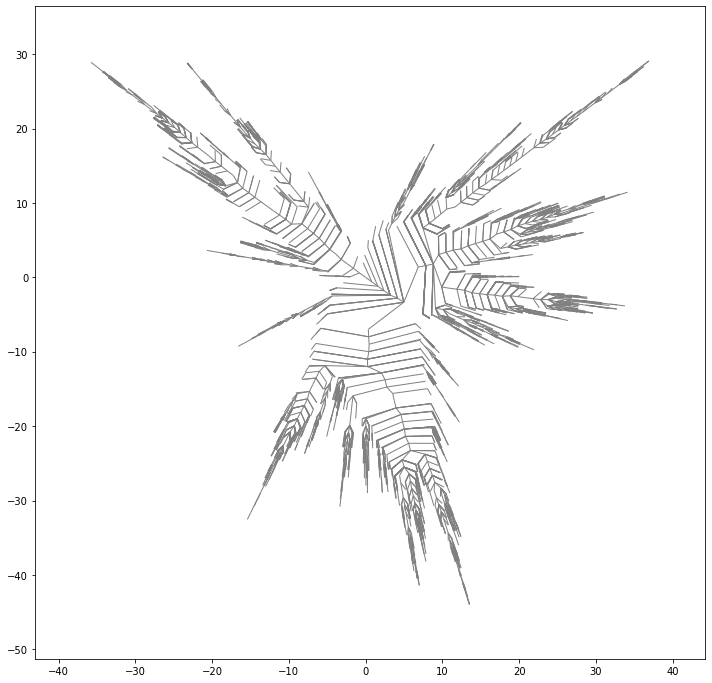

In [23]:
# labels = [g.nodes[i]['label'] for i in g.nodes]
# for i in g.nodes:
#     g.nodes[i]['label'] = ''
    
    

init_layout = 'radial'
# init_layout = 'sfdp'

# # pos0 = nx.layout.planar_layout(g, scale=40)
# # pos0 = graphviz_layout(g, prog="dot", root=list(g.nodes)[0])
# # pos0 = graphviz_layout(g, prog='twopi')

t0 = time()
if init_layout == 'sfdp':
    pos0 = graphviz_layout(g, prog='sfdp')
    pos = pos0.copy()
elif init_layout == 'radial':
    metric = d.max(axis=1)
    iBest = np.argmin(metric)
    pos = radial_layout(g, list(g.nodes)[iBest])
dt = time() - t0
print(f'{dt} sec')



draw(g, pos, s=0, lw=1, labels=False, figsize=[12,12])
# draw(g, pos, s=10, lw=1, labels=True, figsize=[12,12])


# for i in g.nodes:
#     g.nodes[i]['label'] = labels[i]

In [9]:
# nodeCount2levelweight = {
#     50: (1, 550),
#     100: (1, 500),
#     200: (2, 500), 
#     500: (2, 450), 300: (2, 450), 400:(2, 450),
#     800: (3, 450), 600: (3, 450), 700: (3, 450),
#     1200: (3, 400),
#     1600: (4, 400),
#     2000: (4, 350),
#     2500: (5, 350),
#     3000: (5, 300),
#     3500: (6, 300),
#     4000: (6, 250),
#     4500: (7, 250),
#     5000: (8, 200)
# }

nodeCount2levelweight = {
    50: (1, 550),
    100: (2, 500),
    200: (3, 500), 
    500: (6, 450), 300: (4, 450), 400:(5, 450),
    800: (9, 450), 600: (7, 450), 700: (8, 450),
    1200: (10, 400),
    1600: (11, 400),
    2000: (12, 350),
    2500: (13, 350),
    3000: (14, 300),
    3500: (15, 300),
    4000: (16, 250),
    4500: (17, 250),
    5000: (18, 200)
}
for i in g.nodes:
    n = g.nodes[i]
    n['level'] = nodeCount2levelweight[n['nodeCount']][0]

3
10

4
12

6
15

4
11

5
14

5
14

2
5

8
18

3
8

6
15

4
11

3
9

5
13

5
14

1
1

6
16

6
16

6
15

8
18

3
10

6
15

7
17

7
17

1
1

8
18

6
15

3
9

5
13

7
17

3
9

8
18

8
18

6
15

6
16

5
14

4
12

5
14

3
8

2
5

5
13

2
3

5
13

3
10

3
10

3
10

5
14

1
2

5
14

5
13

5
13

4
11

6
16

3
8

8
18

6
15

3
10

5
14

5
14

4
12

3
10

8
18

5
14

2
3

5
14

3
10

4
12

6
16

4
11

3
7

6
16

8
18

3
10

5
13

6
15

6
15

7
17

5
13

5
13

8
18

5
13

8
18

6
15

4
12

6
15

3
10

4
11

1
2

2
5

7
17

5
13

4
12

2
3

7
17

3
10

4
11

6
15

1
2

1
1

8
18

6
16

3
10

4
11

5
13

6
16

5
13

2
5

4
12

6
16

8
18

5
14

4
12

7
17

3
10

5
13

5
13

7
17

6
15

3
9

3
10

6
15

3
10

2
6

5
14

6
16

6
15

4
12

5
13

6
15

5
14

7
17

2
3

7
17

6
16

3
9

5
13

5
13

6
16

3
7

3
8

7
17

4
11

8
18

3
8

8
18

6
16

1
2

5
13

6
15

5
13

6
15

3
8

3
10

6
15

5
13

8
18

3
10

3
10

4
12

5
14

6
16

4
12

5
14

5
13

8
18

3
10

7
17

4
11

5
14

5
13

4
11

5
14

4
1

3
9

3
10

4
11

3
7

5
13

8
18

5
14

2
4

3
10

5
14

6
16

3
7

5
14

1
1

6
15

7
17

2
5

4
12

4
12

5
13

4
12

7
17

5
14

2
3

3
7

4
11

7
17

3
10

4
12

8
18

6
16

6
16

4
11

2
4

4
11

4
12

6
16

5
14

5
13

4
12

5
13

1
2

4
11

4
12

5
14

6
16

4
12

5
14

4
11

4
12

8
18

3
7

5
13

2
5

6
16

5
14

5
14

4
11

6
15

5
14

3
10

8
18

7
17

2
5

2
5

5
14

4
11

6
16

3
10

7
17

3
10

4
12

5
14

5
13

4
12

3
7

6
16

4
11

3
10

4
11

6
15

3
10

2
5

5
13

6
16

6
16

5
14

6
16

1
1

6
16

6
16

6
15

8
18

4
12

7
17

5
14

4
12

6
16

2
6

2
5

3
9

4
12

5
13

4
12

4
11

7
17

2
4

5
13

6
15

6
16

7
17

3
10

4
12

4
12

5
14

6
15

5
13

5
13

6
15

6
16

8
18

3
9

8
18

7
17

7
17

6
15

3
10

5
14

3
10

7
17

5
13

5
13

3
10

7
17

7
17

4
11

4
12

7
17

5
14

5
13

5
14

3
7

6
15

6
15

5
13

1
2

3
10

5
14

3
8

3
10

3
10

3
10

3
8

8
18

3
10

4
11

3
10

8
18

5
14

2
6

3
10

6
15

5
14

5
13

3
10

4
12

3
8

2
4

4
12

4
12

8
18

4
1

2

4
12

4
11

3
8

3
7

2
4

4
11

2
3

5
13

7
17

6
15

7
17

6
16

8
18

8
18

4
11

3
7

6
16

4
12

5
14

6
15

4
11

5
13

3
10

8
18

5
14

2
4

4
12

8
18

4
12

4
12

6
16

4
12

5
14

6
15

2
4

8
18

5
13

6
15

5
14

2
6

6
15

8
18

2
5

4
11

1
2

8
18

5
13

2
6

2
6

5
13

7
17

5
13

7
17

4
12

4
12

4
12

6
15

4
12

6
16

6
15

4
12

8
18

5
13

2
5

1
2

8
18

4
11

5
13

5
13

4
11

5
13

5
13

5
14

3
7

8
18

6
16

5
13

8
18

2
3

7
17

4
11

3
10

7
17

3
7

4
12

7
17

3
10

8
18

2
6

2
4

8
18

2
5

6
16

2
6

3
9

4
11

5
14

6
16

4
12

5
13

5
13

3
8

6
16

7
17

1
1

5
14

6
15

4
11

5
14

7
17

8
18

2
6

4
11

4
11

5
14

1
1

6
16

6
15

8
18

5
14

4
12

7
17

3
7

4
12

6
15

8
18

3
7

8
18

3
10

6
16

4
11

3
10

6
15

4
11

2
5

5
13

6
15

8
18

6
16

5
13

8
18

6
15

7
17

3
10

8
18

5
14

8
18

2
6

5
14

2
4

4
11

8
18

5
14

6
15

6
15

6
15

7
17

6
16

5
14

4
11

6
15

8
18

3
8

4
11

7
17

5
14

3
9

2
3

6
15

5
14

6
15

3
10


5
13

6
15

7
17

6
15

7
17

6
16

6
15

4
11

6
15

6
16

6
15

2
6

5
13

8
18

4
12

4
11

8
18

4
12

5
13

8
18

7
17

5
13

4
12

6
16

6
15

3
10

5
14

7
17

3
10

3
10

7
17

6
16

1
2

4
12

6
15

5
14

6
15

7
17

4
11

4
11

3
10

2
5

5
13

3
9

7
17

7
17

2
3

2
6

2
5

7
17

6
16

7
17

5
14

5
13

5
13

3
9

3
10

4
12

6
15

2
4

6
15

3
10

6
16

6
15

5
14

7
17

4
12

3
10

8
18

2
6

7
17

6
15

8
18

8
18

7
17

6
15

4
11

6
16

8
18

6
16

4
11

6
16

6
16

5
14

5
14

6
15

5
13

6
15

6
15

5
14

5
13

5
13

3
10

6
15

5
13

5
13

2
5

6
16

5
14

6
16

4
11

6
15

5
13

5
13

4
11

4
11

4
11

5
14

8
18

3
9

5
14

4
12

8
18

5
14

5
14

6
16

5
13

3
9

2
3

7
17

4
11

4
11

7
17

4
11

4
11

2
3

2
4

5
13

5
14

5
14

7
17

6
15

2
6

7
17

8
18

5
13

6
15

5
14

7
17

3
9

2
3

5
13

4
11

5
14

6
15

3
7

8
18

3
8

2
6

4
12

6
16

4
12

6
15

8
18

8
18

6
15

5
14

4
11

4
11

2
6

2
5

7
17

6
15

4
11

1
1

5
13

5
13

6
15

3
10

6
16

7
17


## Best scaling

In [24]:
ideal_edge_length = {
    e: g.edges[e]['weight'] 
    for e in g.edges
}
actual_edge_length = {
    (p0,p1): np.linalg.norm(np.array(pos[p1])-np.array(pos[p0]))
    for (p0,p1) in g.edges
}
num = np.sum([ideal_edge_length[k]**2/actual_edge_length[k] for k in g.edges])
den = np.sum([ideal_edge_length[k] for k in g.edges])
s = num / den
print(f's = {s}')

pos = {k:np.array(v)*s for k,v in pos.items()}

s = 327.6954022491072


In [ ]:
# draw(g, pos,s=10, lw=1, labels=False, figsize=[36,36])

In [ ]:
# xy = np.array( [ pos[i2k[i]]for i in range(len(nodes)) ] )
# theta = (xy[:,0] - xy[:,0].min()) / (xy[:,0].max() - xy[:,0].min()) * np.pi*1
# r = (xy[:,1] - xy[:,1].min())
# # r = -(xy[:,1] - xy[:,1].max())

# xy2 = np.c_[r*np.cos(theta), r*np.sin(theta)]
# pos2 = {i2k[i]:xy2[i] for i in range(len(nodes))}
# draw(g, pos2)

# # pos = pos2

In [ ]:
# from umap import UMAP

# n_neighbors = 15

# umap = UMAP(
#     n_components=2,
#     n_neighbors=n_neighbors, 
#     min_dist=0.3,
#     metric='precomputed',
# #     n_epochs=500,
# #     negative_sample_rate=150,
# #     learning_rate=0.0001,
# #     init=np.array(list(pos.values()))
# )
# xy = umap.fit_transform(d)
# pos2 = {i2k[i]:xy[i,:2] for i in range(len(nodes))}


## New Ordering of Nodes

In [25]:
### list of node ids


# if ('math-genealogy' in fn 
#     or 'topics-800' in fn
#     or 'covid' in fn
#    ):
    
print('no re-ordering')
## no re-ordering
node_order = list(g.nodes)
## order preserving re-sort according to level
id2level = {i: g.nodes[i]['level'] for i in g.nodes}
nodeorder_level_pairs = [(i,id2level[i]) for i in node_order]
node_order = [n[0] for n in sorted(nodeorder_level_pairs, key=lambda x:x[1])]
bfs = nx.bfs_tree(g, node_order[0])
node_order = list(bfs) 

# else:
#     #max degree node
#     print('max degree node re-ordering')
#     degree = list(g.degree)
#     degree = list(zip(range(len(degree)), degree))
#     max_degree_node = max(degree, key=lambda x:x[1][1])
#     start = max_degree_node[1][0]
#     bfs = nx.bfs_tree(g, start)
#     node_order = list(bfs) 
    
# #     # random node, bfs
# #     start = next(iter(g.nodes.keys()))
# #     bfs = nx.bfs_tree(g, start)
# #     node_order = list(bfs) 

# #     #dfs
# #     node_order = list(nx.dfs_preorder_nodes(g, start))





no re-ordering


## Crossing removal

In [17]:
def isCrossed_1(e0, e1):
    ##ref: graphic gems 3, "FASTER LINE SEGMENT INTERSECTION", pg.199
    p1,p2 = e0
    p3,p4 = e1

    a = {'x': p2[0]-p1[0], 'y': p2[1]-p1[1]}
    b = {'x': p3[0]-p4[0], 'y': p3[1]-p4[1]};
    c = {'x': p1[0]-p3[0], 'y': p1[1]-p3[1]};

    denom = a['y']*b['x'] - a['x']*b['y']
    numer = b['y']*c['x'] - b['x']*c['y']
    if denom > 0:
        if numer <= 0 or numer >= denom:
            return False
    else:
        if numer >= 0 or numer <= denom:
            return False

    numer2 = a['x']*c['y'] - a['y']*c['x']
    if denom > 0:
        if numer2 <= 0 or numer2 >= denom:
            return False
    else:
        if numer2 >= 0 or numer2 <= denom:
            return False
    return True

def isCrossed(e, edges):
    for e2 in edges:
        if isCrossed_1(e, e2):
            return True
    return False


def initNodePos(id1, id0, pos, pos0, k=0.8):
    pp1 = np.array(pos0[id1])
    pp0 = np.array(pos0[id0])
    v = pp1-pp0

    p0 = np.array(pos[id0])
    noise = np.random.randn(2)
    p1 = p0 + v * k + noise * (1-k) * np.linalg.norm(v)/3
    return tuple(p1)


In [18]:
edge_order = []
processed_nodes = set()
for i, nodeId in enumerate(tqdm(node_order)):
    for neighborId in g.neighbors(nodeId):
        if neighborId in processed_nodes:
            edge_order.append((nodeId, neighborId))
    processed_nodes.add(nodeId)
    
pos = {
    node_order[0]: pos0[node_order[0]]
}
edges = []

    

KeyboardInterrupt: 

In [20]:
for newNode, oldNode in tqdm(edge_order[len(edges):]):
    assert oldNode in pos
    newPos = pos0[newNode]
    p0 = pos[oldNode]
    crossed = isCrossed([newPos,p0], edges)
    fails = 0
    while crossed:
        fails+=1
        newPos = initNodePos(newNode, oldNode, pos, pos0, k=0.95**fails)
        crossed = isCrossed([newPos,p0], edges)
        
    pos[newNode] = newPos
    newEdge = (newPos, p0)
    edges.append(newEdge)

KeyboardInterrupt: 

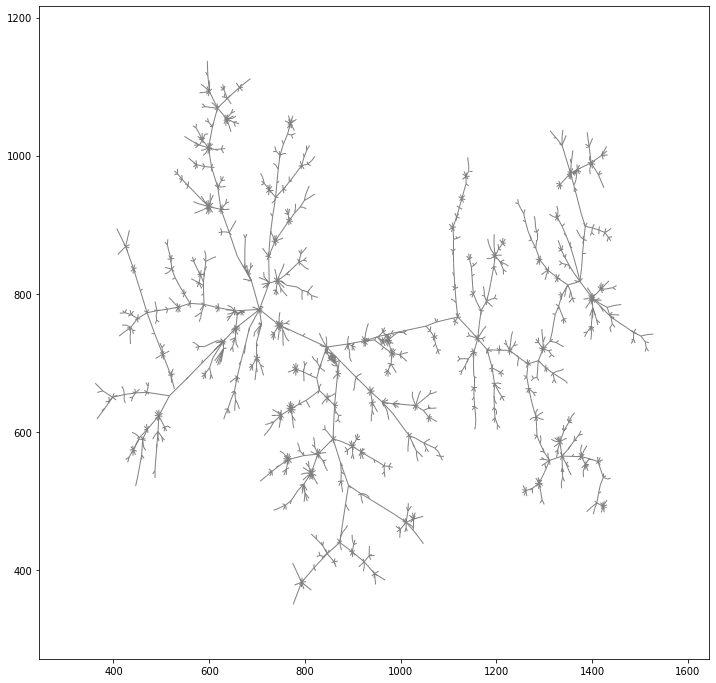

In [22]:
draw(g.subgraph(pos.keys()), pos, s=0, lw=1, labels=False, figsize=[12,12])
# draw(g, pos, s=10, lw=1, labels=False, figsize=[12,12])

## denaulay

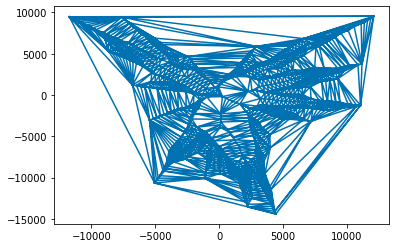

In [26]:
def simplex2edges(sim, points):
    res = dict()
    for t in sim:
        for i in range(3):
            a,b = t[i], t[(i+1)%3]
            if a > b:
                a,b = b,a
            res[(a,b)] = np.linalg.norm(points[a] - points[b])
    return res

points = np.array(list(pos[i] for i in node_order))
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.show()

denaulayDistance = simplex2edges(tri.simplices, points)

## to JSON

In [41]:
###graph to list
nodes = {k: g.nodes[k] for k in g.nodes}
edges = [[e[0], e[1], g.edges[e]] for e in g.edges]

nodes = [{
    'id': node_order[i],
    'index': i,
    'x': pos[node_order[i]][0],
    'y': pos[node_order[i]][1],
    'neighbors': list(nx.neighbors(g, node_order[i])),
    'perplexity': len(list(nx.neighbors(g, node_order[i]))),
    **nodes[node_order[i]]
} for i in range(len(nodes))]

edges = [{
    'source': e[0],
    'target': e[1],
    **e[2]
} for e in edges]



##store the position & perplexity
for i,node in enumerate(nodes):
    try: 
        parent = next(bfs.predecessors(node['id']))
    except StopIteration:
        parent = None
    node['parent'] = parent

    
virtual_edges = []
for i in tqdm(range(len(nodes))):
    for j in range(i+1, len(nodes)):
        if d[i,j] == 0:
            print(f'[warning] d[{i},{j}] = 0')
        else:
#             if (i,j) in denaulayDistance:
#                 dij = d[i,j]
#             el
            if hops[i,j] > 1 and hops[i,j] <= 5:
                dij = d[i,j]
            else:
                continue
            e = {
                'source': i2k[i],
                'target': i2k[j],
                'weight': dij,
                'hops': hops[i,j]
            }
            virtual_edges.append(e)
            
        
fn_out = fn.replace('dot', 'json').replace('txt', 'json')
fn_out = '.'.join(fn_out.split('.')[:-1])

if not Path(fn_out).parent.exists():
    os.makedirs(Path(fn_out).parent)
    
    
    
## option 1: nodes, edges, and virtualEdges with properties
# with open(fn_out, 'w') as f:
#     json.dump(dict(
#         edges = edges, 
#         virtual_edges = virtual_edges, 
#         nodes=nodes
#     ), f, indent=2)
# print('done')

## option 2: properties as arrays
res = {}
for k in nodes[0]:
    res[f'node_{k}'] = [n[k] for n in nodes]
for k in edges[0]:
    res[f'edge_{k}'] = [e[k] for e in edges]

print(fn_out)
with open(fn_out+'-min.json', 'w') as f:
    json.dump(res, f, indent=2)
    
    
    
# for k in virtual_edges[0]:
#     res[f'virtual_edge_{k}'] = [ve[k] for ve in virtual_edges]
# print(f'writing {fn_out}...')

# with open(fn_out+'.json', 'w') as f:
#     json.dump(res, f, indent=2)

# print('done!')




./data/json/TopicsLayersData-0/Graph_5000


In [40]:
fn_out = fn.replace('dot', 'json').replace('txt', 'json')
Path(fn_out).name

'Graph_5000.json'

In [14]:
with open('data/json/TopicsLayersData-0/Graph_5000-nodes-3.json') as f:
    j3 = json.load(f)
with open('data/json/TopicsLayersData-0/Graph_5000.json') as f:
    j = json.load(f)   
    

In [ ]:
# nodeIds = [n['id'] for n in nodes]
# nodeLabels = [n['label'] for n in nodes]
# nodeLevels = [n['level'] for n in nodes]
# nodeXs = [n['x'] for n in nodes]
# nodeYs = [n['y'] for n in nodes]
# nodePerplexities = [n['perplexity'] for n in nodes]
# nodeParents = [n['parent'] for n in nodes]
# nodeNeighbors = [n['neighbors'] for n in nodes]
# nodeNodeCount = [n['nodeCount'] for n in nodes]
# nodeWeight = [n['weight'] for n in nodes]

# edgeSources = [e['source'] for e in edges]
# edgeTargets = [e['target'] for e in edges]
# edgeLevels = [e['level'] for e in edges]
# edgeWeights = [e['weight'] for e in edges]

# virtualEdgeSources = [e['source'] for e in virtual_edges]
# virtualEdgeTargets = [e['target'] for e in virtual_edges]
# virtualEdgeWeights = [e['weight'] for e in virtual_edges]
# virtualEdgeHops = [e['hops'] for e in virtual_edges]


## output pos for MAP (Ryn）

In [ ]:
# my_edges =  [['mechanism design', 'algorithmic game'], ['mechanism design', 'auction theory'], ['algorithmic game', 'learning theory'], ['algorithmic game', 'approximation al'], ['auction theory', 'microeconomic th'], ['auction theory', 'market design'], ['approximation al', 'combinatorial 02'], ['approximation al', 'randomized algor'], ['approximation al', 'online algorithm'], ['microeconomic th', 'game theory'], ['microeconomic th', 'decision theory'], ['microeconomic th', 'information econ'], ['market design', 'matching theory'], ['market design', 'matching'], ['market design', 'auctions'], ['combinatorial 02', 'integer programm'], ['combinatorial 02', 'metaheuristics'], ['combinatorial 02', 'operations resea'], ['game theory', 'experimental eco'], ['game theory', 'social choice'], ['game theory', 'bargaining'], ['game theory', 'microeconomics'], ['game theory', 'economic theory'], ['game theory', 'mathematical e02'], ['auctions', 'industrial organ'], ['integer programm', 'stochastic progr'], ['metaheuristics', 'timetabling'], ['metaheuristics', 'heuristics'], ['metaheuristics', 'vehicle routing '], ['metaheuristics', 'vehicle routing'], ['operations resea', 'mathematical opt'], ['operations resea', 'network design'], ['operations resea', 'multiple criteri'], ['operations resea', 'decision analysi'], ['operations resea', 'network optimiza'], ['operations resea', 'optimization und'], ['operations resea', 'queueing'], ['operations resea', 'optimization'], ['operations resea', 'stochastic optim'], ['operations resea', 'industrial engin'], ['operations resea', 'management scien'], ['operations resea', 'combinatorial op'], ['operations resea', 'data envelopment'], ['operations resea', 'scheduling'], ['operations resea', 'mathematical pro'], ['experimental eco', 'behavioural econ'], ['experimental eco', 'behavioral econo'], ['industrial organ', 'antitrust'], ['industrial organ', 'international 05'], ['industrial organ', 'applied microe02'], ['industrial organ', 'applied game the'], ['industrial organ', 'applied microeco'], ['industrial organ', 'competition poli'], ['decision analysi', 'risk analysis'], ['optimization', 'surrogate modeli'], ['optimization', 'stochastics'], ['optimization', 'variational anal'], ['optimization', 'variational ineq'], ['optimization', 'control'], ['optimization', 'simulation'], ['optimization', 'optimal control'], ['scheduling', 'planning'], ['scheduling', 'production plann'], ['behavioral econo', 'experimental'], ['behavioral econo', 'field experiment'], ['behavioral econo', 'economic psychol'], ['antitrust', 'intellectual p02'], ['antitrust', 'regulation'], ['international 05', 'multinationals'], ['international 05', 'trade policy'], ['international 05', 'fdi'], ['international 05', 'foreign direct i'], ['applied microeco', 'labor economics'], ['risk analysis', 'decision'], ['variational anal', 'convex analysis'], ['variational ineq', 'equilibrium prob'], ['control', 'guidance'], ['control', 'flight dynamics'], ['control', 'mechatronics'], ['control', 'guidance navigat'], ['control', 'system dynamics'], ['control', 'dynamics'], ['control', 'fluid power'], ['control', 'power system sta'], ['control', 'estimation'], ['simulation', 'interprofessiona'], ['simulation', 'device modeling'], ['simulation', 'modeling'], ['simulation', 'agent-based mode'], ['simulation', 'system modeling'], ['planning', 'power system ope'], ['planning', 'heuristic search'], ['production plann', 'inventory manage'], ['production plann', 'supply chain man'], ['intellectual p02', 'patent law'], ['intellectual p02', 'internet law'], ['intellectual p02', 'cyberlaw'], ['intellectual p02', 'patents'], ['intellectual p02', 'copyright law'], ['regulation', 'competition'], ['labor economics', 'health economics'], ['labor economics', 'development econ'], ['labor economics', 'microeconometric'], ['labor economics', 'public finance'], ['labor economics', 'economics of edu'], ['labor economics', 'public economics'], ['labor economics', 'personnel econom'], ['labor economics', 'economics of the'], ['labor economics', 'applied economet'], ['labor economics', 'economic demogra'], ['convex analysis', 'convex optimizat'], ['guidance', 'navigation'], ['mechatronics', 'control engineer'], ['mechatronics', 'robotics'], ['system dynamics', 'systems thinking'], ['dynamics', 'vibration'], ['power system sta', 'power system dyn'], ['estimation', 'detection'], ['agent-based mode', 'social simulatio'], ['agent-based mode', 'complex adaptive'], ['power system ope', 'power system pla'], ['power system ope', 'electricity mark'], ['supply chain man', 'retail operation'], ['supply chain man', 'logistics'], ['supply chain man', 'humanitarian log'], ['supply chain man', 'procurement'], ['supply chain man', 'reverse logistic'], ['supply chain man', 'sustainable oper'], ['supply chain man', 'inventory contro'], ['supply chain man', 'operations manag'], ['supply chain man', 'quality manageme'], ['supply chain man', 'operations'], ['supply chain man', 'inventory theory'], ['supply chain man', 'supply chain ris'], ['patents', 'trademark'], ['patents', 'copyright'], ['health economics', 'health outcomes'], ['health economics', 'economics of agi'], ['health economics', 'cost-effective02'], ['health economics', 'health technolog'], ['health economics', 'cost-effectivene'], ['health economics', 'economic evaluat'], ['health economics', 'outcomes researc'], ['health economics', 'health policy'], ['health economics', 'health insurance'], ['development econ', 'institutional ec'], ['development econ', 'impact evaluatio'], ['development econ', 'microfinance'], ['development econ', 'political econ02'], ['development econ', 'chinese economy'], ['development econ', 'agricultural eco'], ['public finance', 'fiscal federalis'], ['public finance', 'taxation'], ['economics of edu', 'labour economics'], ['public economics', 'urban economics'], ['personnel econom', 'organizational e'], ['navigation', 'positioning'], ['navigation', 'gnss'], ['navigation', 'tracking'], ['navigation', 'sensor fusion'], ['navigation', 'spatial cognitio'], ['robotics', 'humanoid robotic'], ['robotics', 'robot learning'], ['robotics', 'marine robotics'], ['robotics', 'haptics'], ['robotics', 'multi-robot syst'], ['robotics', 'artificial intel'], ['robotics', 'slam'], ['robotics', 'auv'], ['robotics', 'quadrotors'], ['robotics', 'human-robot inte'], ['robotics', 'active perceptio'], ['robotics', 'control systems'], ['robotics', 'automation'], ['robotics', 'motion planning'], ['robotics', 'robotic manipula'], ['robotics', 'humanoids'], ['robotics', 'control theory'], ['robotics', 'autonomous syste'], ['robotics', 'biomechatronics'], ['robotics', 'learning from de'], ['robotics', 'unmanned aerial '], ['robotics', 'micro air vehicl'], ['robotics', 'uav'], ['vibration', 'noise'], ['vibration', 'structural dynam'], ['vibration', 'rotordynamics'], ['vibration', 'acoustics'], ['power system dyn', 'stability'], ['electricity mark', 'demand response'], ['logistics', 'material handlin'], ['logistics', 'freight'], ['logistics', 'scm'], ['logistics', 'supply chain'], ['logistics', 'transportation'], ['operations manag', 'lean'], ['operations manag', 'behavioral opera'], ['operations manag', 'service operatio'], ['operations manag', 'operations strat'], ['copyright', 'open access'], ['outcomes researc', 'pharmacoeconomic'], ['health policy', 'health services '], ['health policy', 'health systems'], ['health policy', 'medicaid'], ['political econ02', 'public choice'], ['political econ02', 'cultural economi'], ['political econ02', 'corruption'], ['political econ02', 'comparative poli'], ['political econ02', 'formal political'], ['agricultural eco', 'rural developmen'], ['agricultural eco', 'agricultural pol'], ['agricultural eco', 'food policy'], ['agricultural eco', 'environmental ec'], ['agricultural eco', 'agribusiness'], ['labour economics', 'family economics'], ['labour economics', 'applied microe03'], ['urban economics', 'economic geograp'], ['urban economics', 'regional'], ['urban economics', 'spatial economic'], ['urban economics', 'real estate econ'], ['urban economics', 'real estate'], ['organizational e', 'contract theory'], ['gnss', 'geodesy'], ['gnss', 'ionosphere'], ['tracking', 'object detection'], ['tracking', 'localization'], ['spatial cognitio', 'embodied cogniti'], ['haptics', 'medical robotics'], ['haptics', 'surgical robotic'], ['haptics', 'telerobotics'], ['haptics', 'teleoperation'], ['haptics', 'rehabilitation r'], ['artificial intel', 'evolutionary com'], ['artificial intel', 'automated planni'], ['artificial intel', 'reinforcement le'], ['artificial intel', 'natural language'], ['artificial intel', 'computational cr'], ['artificial intel', 'machine learning'], ['artificial intel', 'probabilistic pr'], ['artificial intel', 'game ai'], ['artificial intel', 'computer games'], ['artificial intel', 'multi-agent syst'], ['artificial intel', 'case-based reaso'], ['artificial intel', 'computer vision'], ['artificial intel', 'knowledge repres'], ['slam', 'mobile robotics'], ['slam', 'robot vision'], ['human-robot inte', 'social robotics'], ['motion planning', 'path planning'], ['motion planning', 'manipulation'], ['control theory', 'systems theory'], ['uav', 'uas'], ['noise', 'vibration contro'], ['structural dynam', 'wave propagation'], ['structural dynam', 'structural contr'], ['structural dynam', 'structural healt'], ['structural dynam', 'nonlinear vibrat'], ['structural dynam', 'modal analysis'], ['structural dynam', 'aeroelasticity'], ['structural dynam', 'earthquake engin'], ['structural dynam', 'model updating'], ['structural dynam', 'wind engineering'], ['structural dynam', 'seismic isolatio'], ['acoustics', 'audio'], ['demand response', 'smart grid'], ['demand response', 'energy managemen'], ['supply chain', 'inventory'], ['transportation', 'discrete choice '], ['transportation', 'travel behaviour'], ['transportation', 'ports'], ['transportation', 'cycling'], ['transportation', 'transition'], ['lean', 'agile'], ['service operatio', 'healthcare opera'], ['open access', 'institutional re'], ['open access', 'repositories'], ['open access', 'open science'], ['open access', 'altmetrics'], ['pharmacoeconomic', 'pharmacoepidemio'], ['pharmacoeconomic', 'pharmaceutical p'], ['health services ', 'primary care'], ['health services ', 'quality of care'], ['health systems', 'global health'], ['comparative poli', 'political partie'], ['comparative poli', 'latin american p'], ['comparative poli', 'party politics'], ['comparative poli', 'democratization'], ['comparative poli', 'latin america'], ['comparative poli', 'european politic'], ['comparative poli', 'legislative stud'], ['comparative poli', 'chinese politics'], ['comparative poli', 'political econom'], ['rural developmen', 'agriculture'], ['environmental ec', 'non-market valua'], ['environmental ec', 'natural resource'], ['environmental ec', 'water economics'], ['environmental ec', 'ecological econo'], ['environmental ec', 'energy economics'], ['environmental ec', 'resource economi'], ['economic geograp', 'regional science'], ['economic geograp', 'regional develop'], ['economic geograp', 'evolutionary eco'], ['economic geograp', 'innovation studi'], ['economic geograp', 'political geogra'], ['economic geograp', 'evolutionary e02'], ['real estate', 'housing'], ['geodesy', 'crustal deformat'], ['geodesy', 'geophysics'], ['geodesy', 'surveying'], ['geodesy', 'gps'], ['ionosphere', 'thermosphere'], ['ionosphere', 'space physics'], ['object detection', 'recognition'], ['evolutionary com', 'multi-objective '], ['evolutionary com', 'artificial life'], ['evolutionary com', 'natural computin'], ['evolutionary com', 'genetic programm'], ['evolutionary com', 'computational in'], ['evolutionary com', 'swarm intelligen'], ['natural language', 'sentiment analys'], ['natural language', 'text mining'], ['natural language', 'text summarizati'], ['natural language', 'machine translat'], ['natural language', 'information extr'], ['natural language', 'word sense disam'], ['natural language', 'computational li'], ['natural language', 'bionlp'], ['natural language', 'language modelin'], ['natural language', 'statistical mach'], ['computational cr', 'procedural conte'], ['machine learning', 'data mining'], ['machine learning', 'probabilistic gr'], ['machine learning', 'neural networks'], ['machine learning', 'statistical rela'], ['machine learning', 'signal process02'], ['machine learning', 'graphical models'], ['machine learning', 'deep learning'], ['machine learning', 'statistical mode'], ['machine learning', 'dimensionality r'], ['multi-agent syst', 'cooperative cont'], ['multi-agent syst', 'agents'], ['computer vision', 'human vision'], ['computer vision', 'video analytics'], ['computer vision', 'computer graphic'], ['computer vision', 'robot perception'], ['computer vision', 'object tracking'], ['computer vision', 'image analysis'], ['computer vision', 'face analysis'], ['computer vision', 'biometrics'], ['computer vision', 'structure from m'], ['computer vision', 'gait recognition'], ['computer vision', 'human action rec'], ['computer vision', 'gesture recognit'], ['computer vision', 'image understand'], ['computer vision', 'video surveillan'], ['computer vision', 'medical image an'], ['computer vision', '3d reconstructio'], ['computer vision', 'multimedia'], ['computer vision', 'image retrieval'], ['knowledge repres', 'semantic web'], ['knowledge repres', 'automated reason'], ['knowledge repres', 'logic programmin'], ['knowledge repres', 'ontologies'], ['knowledge repres', 'reasoning'], ['knowledge repres', 'description logi'], ['path planning', 'crowd simulation'], ['manipulation', 'grasping'], ['structural healt', 'damage detection'], ['structural healt', 'nondestructive e'], ['structural healt', 'smart structures'], ['structural healt', 'ultrasonics'], ['structural healt', 'wireless sensors'], ['structural healt', 'acoustic emissio'], ['structural healt', 'system identific'], ['earthquake engin', 'engineering seis'], ['earthquake engin', 'reinforced concr'], ['earthquake engin', 'seismic retrofit'], ['earthquake engin', 'structural analy'], ['earthquake engin', 'seismic design'], ['earthquake engin', 'masonry structur'], ['earthquake engin', 'structural engin'], ['earthquake engin', 'structural relia'], ['earthquake engin', 'performance-base'], ['audio', 'speech signal pr'], ['smart grid', 'power system eco'], ['smart grid', 'pmu'], ['smart grid', 'power systems'], ['smart grid', 'smart buildings'], ['smart grid', 'distributed ener'], ['smart grid', 'power line commu'], ['smart grid', 'demand side mana'], ['smart grid', 'power system rel'], ['smart grid', 'power system pro'], ['smart grid', 'power market'], ['altmetrics', 'bibliometrics'], ['altmetrics', 'scholarly commun'], ['pharmacoepidemio', 'pharmacy'], ['pharmacoepidemio', 'clinical pharmac'], ['pharmacoepidemio', 'pharmacovigilanc'], ['pharmacoepidemio', 'comparative effe'], ['pharmacoepidemio', 'drug safety'], ['primary care', 'family medicine'], ['primary care', 'general practice'], ['global health', 'maternal health'], ['global health', 'non-communicable'], ['political partie', 'british politics'], ['political partie', 'interest groups'], ['political partie', 'elections'], ['democratization', 'authoritarianism'], ['democratization', 'ethnic conflict'], ['latin america', 'mexico'], ['latin america', 'brazil'], ['european politic', 'european union'], ['agriculture', 'food'], ['agriculture', 'soil biology'], ['agriculture', 'sociology of foo'], ['agriculture', 'food security'], ['natural resource', 'forest economics'], ['ecological econo', 'sustainable deve'], ['ecological econo', 'industrial ecolo'], ['energy economics', 'energy policy'], ['resource economi', 'environmental'], ['regional science', 'spatial economet'], ['evolutionary eco', 'economics of inn'], ['innovation studi', 'industrial dynam'], ['political geogra', 'urban geography'], ['political geogra', 'borders'], ['housing', 'neighbourhoods'], ['housing', 'community develo'], ['housing', 'homelessness'], ['housing', 'gentrification'], ['housing', 'segregation'], ['geophysics', 'earthquake scien'], ['geophysics', 'inversion'], ['geophysics', 'geology'], ['geophysics', 'magnetotellurics'], ['geophysics', 'exploration seis'], ['geophysics', 'geothermal'], ['geophysics', 'rock physics'], ['geophysics', 'seismic'], ['surveying', 'geomatics'], ['gps', 'insar'], ['space physics', 'space weather'], ['space physics', 'plasma physics'], ['space physics', 'solar physics'], ['space physics', 'magnetospheric p'], ['multi-objective ', 'evolutionary alg'], ['artificial life', 'evolutionary rob'], ['artificial life', 'complex systems'], ['genetic programm', 'genetic algorith'], ['computational in', 'fuzzy logic'], ['swarm intelligen', 'swarm robotics'], ['sentiment analys', 'opinion mining'], ['text mining', 'data'], ['machine translat', 'parsing'], ['machine translat', 'post-editing'], ['information extr', 'question answeri'], ['computational li', 'dialogue'], ['computational li', 'natural langua02'], ['computational li', 'computational se'], ['computational li', 'distributional s'], ['computational li', 'corpus linguisti'], ['computational li', 'lexical semantic'], ['data mining', 'business intelli'], ['data mining', 'web mining'], ['data mining', 'social networks'], ['data mining', 'clustering'], ['data mining', 'recommender syst'], ['data mining', 'databases'], ['data mining', 'data privacy'], ['data mining', 'knowledge discov'], ['data mining', 'feature selectio'], ['data mining', 'information retr'], ['data mining', 'outlier detectio'], ['data mining', 'healthcare analy'], ['data mining', 'graph mining'], ['data mining', 'social network a'], ['probabilistic gr', 'bayesian network'], ['signal process02', 'sonar'], ['signal process02', 'blind source sep'], ['signal process02', 'adaptive filteri'], ['signal process02', 'radar systems'], ['signal process02', 'compressed sensi'], ['signal process02', 'communication'], ['signal process02', 'underwater acous'], ['signal process02', 'information theo'], ['deep learning', 'representation l'], ['cooperative cont', 'distributed cont'], ['cooperative cont', 'autonomous vehic'], ['computer graphic', 'geometric comput'], ['computer graphic', 'visual computing'], ['computer graphic', 'virtual reality'], ['computer graphic', 'global illuminat'], ['computer graphic', 'character animat'], ['computer graphic', 'non-photorealist'], ['computer graphic', 'real-time render'], ['computer graphic', 'physical simulat'], ['computer graphic', 'computational 06'], ['computer graphic', 'computer animati'], ['computer graphic', 'digital geometry'], ['computer graphic', 'scientific visua'], ['computer graphic', 'visualization'], ['computer graphic', 'geometric modeli'], ['biometrics', 'face recognition'], ['biometrics', 'authentication'], ['biometrics', 'iris recognition'], ['biometrics', 'pattern recognit'], ['biometrics', 'image processing'], ['medical image an', 'computer aided d'], ['medical image an', 'segmentation'], ['medical image an', 'medical image co'], ['medical image an', 'image registrati'], ['semantic web', 'ontology enginee'], ['semantic web', 'social web'], ['semantic web', 'information inte'], ['semantic web', 'data integration'], ['semantic web', 'knowledge engine'], ['semantic web', 'linked data'], ['semantic web', 'ontology learnin'], ['semantic web', 'linked open data'], ['semantic web', 'provenance'], ['automated reason', 'verification'], ['logic programmin', 'computational lo'], ['logic programmin', 'nonmonotonic rea'], ['logic programmin', 'constraint progr'], ['logic programmin', 'answer set progr'], ['ontologies', 'biomedical infor'], ['ontologies', 'conceptual model'], ['ultrasonics', 'nde'], ['ultrasonics', 'ndt'], ['system identific', 'automatic contro'], ['reinforced concr', 'frp'], ['seismic design', 'steel structures'], ['structural engin', 'seismic engineer'], ['structural engin', 'civil engineerin'], ['structural engin', 'progressive coll'], ['structural engin', 'fire engineering'], ['structural engin', 'timber engineeri'], ['power systems', 'power electronic'], ['power systems', 'electrical engin'], ['power systems', 'distribution net'], ['power systems', 'high voltage'], ['bibliometrics', 'information scie'], ['bibliometrics', 'citation analysi'], ['bibliometrics', 'research assessm'], ['bibliometrics', 'scientometrics'], ['bibliometrics', 'webometrics'], ['bibliometrics', 'research evaluat'], ['bibliometrics', 'informetrics'], ['bibliometrics', 'science policy'], ['scholarly commun', 'publishing'], ['scholarly commun', 'collection devel'], ['clinical pharmac', 'pharmacometrics'], ['clinical pharmac', 'pharmacokinetics'], ['interest groups', 'lobbying'], ['elections', 'voting'], ['elections', 'campaigns'], ['elections', 'voting behavior'], ['elections', 'political scienc'], ['elections', 'congress'], ['elections', 'parties'], ['elections', 'electoral system'], ['european union', 'european integra'], ['sustainable deve', 'environmental 02'], ['industrial ecolo', 'life cycle asses'], ['industrial ecolo', 'circular economy'], ['industrial ecolo', 'waste management'], ['energy policy', 'energy security'], ['energy policy', 'climate policy'], ['energy policy', 'environmental po'], ['spatial economet', 'regional economi'], ['economics of inn', 'economics of sci'], ['economics of inn', 'industrial econo'], ['borders', 'geopolitics'], ['gentrification', 'urban studies'], ['inversion', 'seismic imaging'], ['geology', 'geochronology'], ['geology', 'geoscience'], ['geology', 'sedimentology'], ['geology', 'earth history'], ['geology', 'geochemistry'], ['geology', 'petrology'], ['geology', 'earth sciences'], ['rock physics', 'petrophysics'], ['geomatics', 'photogrammetry'], ['geomatics', 'laser scanning'], ['space weather', 'heliophysics'], ['space weather', 'magnetosphere'], ['plasma physics', 'plasma diagnosti'], ['plasma physics', 'inertial confine'], ['plasma physics', 'mhd'], ['plasma physics', 'plasma chemistry'], ['plasma physics', 'laser plasma int'], ['plasma physics', 'tokamak'], ['plasma physics', 'nuclear fusion'], ['plasma physics', 'electric propuls'], ['plasma physics', 'plasma processin'], ['plasma physics', 'fusion'], ['plasma physics', 'magnetohydrodyna'], ['plasma physics', 'fusion energy'], ['solar physics', 'mhd waves'], ['complex systems', 'collective behav'], ['complex systems', 'complex networks'], ['complex systems', 'cellular automat'], ['complex systems', 'statistical phys'], ['complex systems', 'network science'], ['complex systems', 'social systems'], ['complex systems', 'science of scien'], ['complex systems', 'evolutionary dyn'], ['complex systems', 'econophysics'], ['corpus linguisti', 'discourse analys'], ['corpus linguisti', 'terminology'], ['corpus linguisti', 'academic writing'], ['corpus linguisti', 'english linguist'], ['corpus linguisti', 'translation stud'], ['corpus linguisti', 'cognitive lingui'], ['business intelli', 'decision support'], ['business intelli', 'data warehouse'], ['social networks', 'social capital'], ['clustering', 'classification'], ['recommender syst', 'information filt'], ['recommender syst', 'user modeling'], ['recommender syst', 'collaborative fi'], ['databases', 'xml'], ['databases', 'data management'], ['databases', 'query processing'], ['databases', 'data streams'], ['information retr', 'semantic search'], ['information retr', 'search'], ['information retr', 'web search'], ['information retr', 'search engines'], ['graph mining', 'anomaly detectio'], ['social network a', 'community detect'], ['compressed sensi', 'time-frequency a'], ['communication', 'media'], ['information theo', 'physical layer s'], ['information theo', 'statistical infe'], ['information theo', 'communication sy'], ['information theo', 'communication th'], ['information theo', 'compression'], ['information theo', 'network coding'], ['information theo', 'coding theory'], ['information theo', 'coding'], ['information theo', 'molecular commun'], ['information theo', 'digital communic'], ['information theo', 'statistical sign'], ['information theo', 'error correcting'], ['distributed cont', 'distributed opti'], ['autonomous vehic', 'intelligent tran'], ['autonomous vehic', 'vehicle dynamics'], ['virtual reality', 'augmented realit'], ['virtual reality', 'mixed reality'], ['virtual reality', 'virtual environm'], ['virtual reality', 'virtual humans'], ['virtual reality', '3d interaction'], ['virtual reality', '3d user interfac'], ['computational 06', 'computational im'], ['visualization', 'graphics'], ['visualization', 'visual analytics'], ['geometric modeli', 'cam'], ['face recognition', 'object recogniti'], ['face recognition', 'face perception'], ['pattern recognit', 'document analysi'], ['pattern recognit', 'biomedical signa'], ['pattern recognit', 'document image a'], ['pattern recognit', 'human language t'], ['pattern recognit', 'handwriting reco'], ['pattern recognit', 'multimedia infor'], ['image processing', 'image compressio'], ['image processing', 'biomedical sig02'], ['image processing', 'image fusion'], ['image processing', 'machine vision'], ['image processing', 'signal'], ['image processing', 'mathematical mor'], ['image processing', 'image quality'], ['image processing', 'multimedia secur'], ['image processing', 'image quality as'], ['segmentation', 'registration'], ['image registrati', 'medical image pr'], ['image registrati', 'image segmentati'], ['data integration', 'data quality'], ['linked data', 'web science'], ['linked data', 'rdf'], ['verification', 'testing'], ['verification', 'validation'], ['verification', 'formal methods'], ['verification', 'synthesis'], ['constraint progr', 'sat'], ['biomedical infor', 'clinical researc'], ['biomedical infor', 'applied ontology'], ['nde', 'shm'], ['frp', 'concrete'], ['steel structures', 'concrete structu'], ['civil engineerin', 'geotechnical eng'], ['power electronic', 'hvdc'], ['power electronic', 'multilevel conve'], ['power electronic', 'motor drives'], ['power electronic', 'power quality'], ['power electronic', 'renewable ener04'], ['power electronic', 'microgrids'], ['power electronic', 'drives'], ['power electronic', 'wireless power t'], ['power electronic', 'renewable energy'], ['power electronic', 'electric drives'], ['power electronic', 'digital control'], ['power electronic', 'industrial elect'], ['power electronic', 'electric vehicle'], ['power electronic', 'power converters'], ['power electronic', 'renewable ener02'], ['power electronic', 'renewable ener03'], ['power electronic', 'dc-dc converters'], ['power electronic', 'dc converters'], ['power electronic', 'photovoltaic sys'], ['power electronic', 'electrical machi'], ['power electronic', 'hybrid electric '], ['information scie', 'library'], ['information scie', 'librarianship'], ['information scie', 'library science'], ['information scie', 'knowledge organi'], ['information scie', 'information beha'], ['pharmacokinetics', 'drug metabolism'], ['pharmacokinetics', 'pbpk'], ['pharmacokinetics', 'pharmacodynamics'], ['pharmacokinetics', 'biopharmaceutics'], ['political scienc', 'international st'], ['political scienc', 'international re'], ['political scienc', 'methodology'], ['political scienc', 'public policy'], ['congress', 'presidency'], ['congress', 'political instit'], ['congress', 'american polit02'], ['life cycle asses', 'sustainability'], ['life cycle asses', 'life cycle costi'], ['life cycle asses', 'carbon footprint'], ['waste management', 'recycling'], ['regional economi', 'urban'], ['urban studies', 'human geography'], ['urban studies', 'housing studies'], ['geochronology', 'isotope geology'], ['geochronology', 'isotope geochemi'], ['sedimentology', 'petroleum geolog'], ['sedimentology', 'ichnology'], ['sedimentology', 'stratigraphy'], ['sedimentology', 'geomorphology'], ['sedimentology', 'sequence stratig'], ['sedimentology', 'glacial geology'], ['sedimentology', 'basin analysis'], ['sedimentology', 'marine geology'], ['sedimentology', 'coastal geology'], ['geochemistry', 'volcanology'], ['geochemistry', 'diagenesis'], ['geochemistry', 'igneous petrolog'], ['geochemistry', 'ore geology'], ['geochemistry', 'mineralogy'], ['geochemistry', 'cosmochemistry'], ['geochemistry', 'magnesium isotop'], ['geochemistry', 'economic geology'], ['petrophysics', 'reservoir charac'], ['photogrammetry', 'cultural heritag'], ['photogrammetry', 'remote sensing'], ['photogrammetry', '3d modeling'], ['laser scanning', 'mobile mapping'], ['inertial confine', 'high energy dens'], ['complex networks', 'human mobility'], ['complex networks', 'epidemics'], ['statistical phys', 'anomalous diffus'], ['statistical phys', 'biological physi'], ['statistical phys', 'network theory'], ['statistical phys', 'percolation theo'], ['network science', 'computational so'], ['network science', 'data science'], ['discourse analys', 'applied linguist'], ['discourse analys', 'multimodality'], ['discourse analys', 'systemic functio'], ['discourse analys', 'stylistics'], ['discourse analys', 'sociolinguistics'], ['terminology', 'translation'], ['terminology', 'lexicography'], ['academic writing', 'eap'], ['translation stud', 'comparative lite'], ['translation stud', 'interpreting stu'], ['decision support', 'business analyti'], ['classification', 'mixture models'], ['user modeling', 'personality'], ['data management', 'data curation'], ['query processing', 'database systems'], ['query processing', 'indexing'], ['media', 'media policy'], ['media', 'journalism'], ['communication th', 'wireless communi'], ['coding theory', 'information'], ['coding theory', 'network informat'], ['statistical sign', 'estimation theor'], ['intelligent tran', 'traffic flow'], ['intelligent tran', 'traffic simulati'], ['intelligent tran', 'traffic safety'], ['intelligent tran', 'traffic control'], ['intelligent tran', 'intelligent vehi'], ['intelligent tran', 'traffic flow the'], ['computational im', 'inverse problems'], ['visual analytics', 'data visualizati'], ['visual analytics', 'information visu'], ['cam', 'additive manufac'], ['cam', 'cad'], ['face perception', 'prosopagnosia'], ['biomedical signa', 'heart rate varia'], ['signal', 'information proc'], ['testing', 'vlsi design'], ['formal methods', 'concurrency theo'], ['formal methods', 'software verific'], ['formal methods', 'program verifica'], ['formal methods', 'theorem proving'], ['formal methods', 'refinement'], ['formal methods', 'model checking'], ['formal methods', 'software enginee'], ['formal methods', 'petri nets'], ['formal methods', 'concurrency'], ['formal methods', 'programming lang'], ['synthesis', 'characterization'], ['sat', 'smt'], ['concrete', 'building materia'], ['concrete', 'pavement'], ['concrete', 'structures'], ['concrete', 'cement'], ['concrete', 'bridges'], ['concrete', 'durability'], ['concrete', 'masonry'], ['geotechnical eng', 'soil mechanics'], ['geotechnical eng', 'offshore enginee'], ['geotechnical eng', 'soil dynamics'], ['geotechnical eng', 'engineering geol'], ['geotechnical eng', 'pavement enginee'], ['geotechnical eng', 'geomechanics'], ['geotechnical eng', 'geoenvironment02'], ['geotechnical eng', 'ground improveme'], ['geotechnical eng', 'unsaturated soil'], ['hvdc', 'facts'], ['microgrids', 'distributed gene'], ['renewable ener03', 'waste to energy'], ['renewable ener03', 'energy efficienc'], ['electrical machi', 'condition monito'], ['library', 'librarians'], ['library', 'information lite'], ['library', 'information stud'], ['drug metabolism', 'pharmacogenetics'], ['international re', 'european studies'], ['international re', 'international se'], ['international re', 'foreign policy'], ['international re', 'china'], ['international re', 'international po'], ['international re', 'diplomacy'], ['international re', 'us foreign polic'], ['international re', 'critical securit'], ['international re', 'security studies'], ['international re', 'international in'], ['international re', 'civil war'], ['methodology', 'design theory'], ['public policy', 'urban politics'], ['public policy', 'federalism'], ['public policy', 'administration'], ['public policy', 'policy analysis'], ['public policy', 'public administr'], ['american polit02', 'representation'], ['american polit02', 'political method'], ['american polit02', 'political beha02'], ['american polit02', 'judicial politic'], ['american polit02', 'american politic'], ['american polit02', 'public opinion'], ['sustainability', 'corporate respon'], ['sustainability', 'food systems'], ['urban', 'regional plannin'], ['urban', 'infrastructure'], ['urban', 'architecture'], ['urban', 'regional studies'], ['human geography', 'political ecolog'], ['human geography', 'cultural geograp'], ['isotope geochemi', 'chemical oceanog'], ['isotope geochemi', 'carbonate sedime'], ['stratigraphy', 'paleontology'], ['stratigraphy', 'palaeontology'], ['stratigraphy', 'sedimentary geol'], ['geomorphology', 'physical geograp'], ['geomorphology', 'landscape evolut'], ['geomorphology', 'drylands'], ['geomorphology', 'geomorphometry'], ['geomorphology', 'cosmogenic nucli'], ['geomorphology', 'hydrology'], ['geomorphology', 'environmental 04'], ['geomorphology', 'quaternary scien'], ['geomorphology', 'quaternary'], ['geomorphology', 'geoarchaeology'], ['geomorphology', 'soil erosion'], ['geomorphology', 'rivers'], ['geomorphology', 'coastal processe'], ['geomorphology', 'glaciology'], ['basin analysis', 'tectonics'], ['marine geology', 'paleoceanography'], ['igneous petrolog', 'experimental pet'], ['mineralogy', 'mineral physics'], ['mineralogy', 'crystallography'], ['mineralogy', 'ore deposits'], ['cosmochemistry', 'planetary scienc'], ['remote sensing', 'soil moisture'], ['remote sensing', 'ocean optics'], ['remote sensing', 'evapotranspirati'], ['remote sensing', 'land degradation'], ['remote sensing', 'polarimetry'], ['remote sensing', 'change detection'], ['remote sensing', 'geographic infor'], ['remote sensing', 'precision agricu'], ['remote sensing', 'synthetic apertu'], ['remote sensing', 'land cover'], ['remote sensing', 'hyperspectral'], ['remote sensing', 'radiative transf'], ['remote sensing', 'image classifica'], ['remote sensing', 'gis'], ['remote sensing', 'land change scie'], ['remote sensing', 'landsat'], ['remote sensing', 'lidar'], ['remote sensing', 'forest inventory'], ['remote sensing', 'earth observatio'], ['remote sensing', 'imaging spectros'], ['human mobility', 'urban computing'], ['computational so', 'network analysis'], ['applied linguist', 'call'], ['applied linguist', 'english for spec'], ['applied linguist', 'intercultural co'], ['applied linguist', 'language learnin'], ['applied linguist', 'tesol'], ['applied linguist', 'sla'], ['applied linguist', 'second languag02'], ['applied linguist', 'language teachin'], ['applied linguist', 'second languag03'], ['sociolinguistics', 'change'], ['sociolinguistics', 'language variati'], ['sociolinguistics', 'educational ling'], ['sociolinguistics', 'linguistic anthr'], ['sociolinguistics', 'sociophonetics'], ['translation', 'interpreting'], ['lexicography', 'lexicology'], ['comparative lite', 'cultural studies'], ['comparative lite', 'literary theory'], ['personality', 'assessment'], ['personality', 'psychopathology'], ['personality', 'personality diso'], ['personality', 'individual diffe'], ['personality', 'selection'], ['data curation', 'digital preserva'], ['journalism', 'news'], ['journalism', 'periodismo'], ['journalism', 'political commun'], ['journalism', 'new media'], ['journalism', 'social media'], ['wireless communi', 'smart grid commu'], ['wireless communi', 'cellular network'], ['wireless communi', 'massive mimo'], ['wireless communi', 'signal processin'], ['wireless communi', 'cognitive radio'], ['wireless communi', 'mimo'], ['wireless communi', 'stochastic geome'], ['wireless communi', 'resource allocat'], ['wireless communi', 'mimo systems'], ['information', 'communication te'], ['traffic safety', 'transportation e'], ['traffic safety', 'its'], ['traffic safety', 'traffic engineer'], ['traffic safety', 'driver behavior'], ['intelligent vehi', 'driver assistanc'], ['inverse problems', 'tomography'], ['inverse problems', 'electrical imped'], ['inverse problems', 'uncertainty quan'], ['information visu', 'graph drawing'], ['information visu', 'human-computer i'], ['additive manufac', 'rapid prototypin'], ['additive manufac', 'inkjet printing'], ['additive manufac', 'laser material p'], ['additive manufac', '3d printing'], ['additive manufac', 'selective laser '], ['cad', 'machine design'], ['cad', 'reverse engineer'], ['vlsi design', 'hardware securit'], ['model checking', 'temporal logic'], ['model checking', 'formal verificat'], ['software enginee', 'refactoring'], ['software enginee', 'technical debt'], ['software enginee', 'mining software '], ['software enginee', 'software evoluti'], ['software enginee', 'software ecosyst'], ['software enginee', 'object-oriented '], ['software enginee', 'web development'], ['software enginee', 'model-driven eng'], ['software enginee', 'software reliabi'], ['software enginee', 'software mainten'], ['software enginee', 'software testing'], ['software enginee', 'computer scien02'], ['software enginee', 'requirements eng'], ['software enginee', 'search-based sof'], ['software enginee', 'empirical softwa'], ['software enginee', 'computer science'], ['software enginee', 'global software '], ['software enginee', 'software archite'], ['software enginee', 'adaptive softwar'], ['software enginee', 'design patterns'], ['software enginee', 'software engin02'], ['software enginee', 'software metrics'], ['software enginee', 'software reuse'], ['software enginee', 'model-driven dev'], ['petri nets', 'discrete event s'], ['programming lang', 'type theory'], ['programming lang', 'software systems'], ['programming lang', 'compilers'], ['programming lang', 'static analysis'], ['programming lang', 'type systems'], ['programming lang', 'functional progr'], ['programming lang', 'program analysis'], ['characterization', 'materials synthe'], ['characterization', 'nanomaterials sy'], ['characterization', 'fabrication'], ['smt', 'nlp'], ['building materia', 'construction'], ['pavement', 'asphalt'], ['structures', 'smart materials'], ['structures', 'aerospace'], ['soil mechanics', 'geotechnics'], ['soil dynamics', 'geotechnical ear'], ['engineering geol', 'landslides'], ['geomechanics', 'rock mechanics'], ['geomechanics', 'reservoir simula'], ['energy efficienc', 'energy planning'], ['energy efficienc', 'thermal comfort'], ['condition monito', 'fault diagnosis'], ['information lite', 'information be02'], ['information lite', 'academic libra02'], ['information lite', 'digital literacy'], ['information lite', 'academic librari'], ['information lite', 'embedded librari'], ['information lite', 'library instruct'], ['information lite', 'instruction'], ['pharmacogenetics', 'pharmacogenomics'], ['international se', 'international 02'], ['international se', 'international co'], ['international se', 'nuclear weapons'], ['china', 'asia'], ['china', 'east asia'], ['international po', 'comparative po02'], ['international po', 'foreign aid'], ['international po', 'global governanc'], ['civil war', 'peacekeeping'], ['civil war', 'terrorism'], ['design theory', 'systems engineer'], ['public administr', 'governance'], ['public administr', 'public managemen'], ['public administr', 'performance mana'], ['public administr', 'local government'], ['judicial politic', 'courts'], ['public opinion', 'political partic'], ['public opinion', 'political behavi'], ['regional plannin', 'spatial planning'], ['architecture', 'urban design'], ['architecture', 'history of archi'], ['architecture', 'space syntax'], ['architecture', 'architectural th'], ['architecture', 'interior design'], ['architecture', 'design'], ['architecture', 'computational de'], ['architecture', 'historic preserv'], ['architecture', 'sustainable desi'], ['architecture', 'architectural de'], ['architecture', 'space'], ['architecture', 'lighting'], ['political ecolog', 'pastoralism'], ['political ecolog', 'science studies'], ['political ecolog', 'environmental ju'], ['political ecolog', 'biodiversity con'], ['political ecolog', 'environmental an'], ['cultural geograp', 'social geography'], ['cultural geograp', 'historical geogr'], ['chemical oceanog', 'marine biogeoche'], ['chemical oceanog', 'marine chemistry'], ['paleontology', 'extinction'], ['paleontology', 'paleobiology'], ['paleontology', 'paleoecology'], ['palaeontology', 'palaeobiology'], ['palaeontology', 'palaeoecology'], ['hydrology', 'vadose zone'], ['hydrology', 'snow'], ['hydrology', 'water quality mo'], ['hydrology', 'watershed manage'], ['hydrology', 'hydrological mod'], ['hydrology', 'watersheds'], ['hydrology', 'water resource02'], ['hydrology', 'ecohydrology'], ['hydrology', 'water resources '], ['hydrology', 'water engineerin'], ['hydrology', 'hydrogeology'], ['hydrology', 'hydrometeorology'], ['hydrology', 'irrigation'], ['hydrology', 'hydraulics'], ['hydrology', 'hydroclimatology'], ['hydrology', 'flood modelling'], ['hydrology', 'water resources'], ['hydrology', 'agricultural wat'], ['hydrology', 'uncertainty anal'], ['hydrology', 'water quality'], ['hydrology', 'floods'], ['hydrology', 'wildfire'], ['quaternary scien', 'tephrochronology'], ['geoarchaeology', 'environmental ar'], ['geoarchaeology', 'quaternary geolo'], ['geoarchaeology', 'archaeology'], ['rivers', 'streams'], ['rivers', 'wetlands'], ['coastal processe', 'coastal geomorph'], ['glaciology', 'cryosphere'], ['glaciology', 'antarctica'], ['glaciology', 'glacier hydrolog'], ['tectonics', 'metamorphic petr'], ['tectonics', 'surface processe'], ['tectonics', 'metamorphic geol'], ['tectonics', 'geodynamics'], ['tectonics', 'paleomagnetism'], ['tectonics', 'himalaya'], ['tectonics', 'analogue modelin'], ['tectonics', 'seismology'], ['tectonics', 'structural geolo'], ['tectonics', 'thermochronology'], ['tectonics', 'marine geophysic'], ['tectonics', 'precambrian geol'], ['paleoceanography', 'paleoclimate'], ['mineral physics', 'high pressure'], ['crystallography', 'diffraction'], ['crystallography', 'x-ray diffractio'], ['crystallography', 'solid state chem'], ['crystallography', 'structural chemi'], ['crystallography', 'crystal engineer'], ['ore deposits', 'fluid inclusions'], ['planetary scienc', 'meteoritics'], ['planetary scienc', 'impact cratering'], ['planetary scienc', 'asteroids'], ['planetary scienc', 'earth'], ['planetary scienc', 'astrobiology'], ['planetary scienc', 'mars'], ['planetary scienc', 'planetary geolog'], ['land cover', 'land use'], ['land cover', 'land use change'], ['gis', 'medical geograph'], ['gis', 'sdi'], ['gis', 'geospatial analy'], ['gis', 'rs'], ['gis', 'geocomputation'], ['gis', 'vgi'], ['gis', 'spatial modeling'], ['gis', 'cartography'], ['gis', 'geography'], ['gis', 'spatial database'], ['gis', 'web mapping'], ['gis', 'spatial analysis'], ['tesol', 'esl'], ['second languag02', 'vocabulary'], ['second languag02', 'bilingualism'], ['second languag02', 'chinese linguist'], ['change', 'climate variabil'], ['cultural studies', 'visual studies'], ['cultural studies', 'critical'], ['cultural studies', 'postcolonial stu'], ['cultural studies', 'literary studies'], ['cultural studies', 'gender studies'], ['cultural studies', 'performance stud'], ['cultural studies', 'media studies'], ['cultural studies', 'visual culture'], ['literary theory', 'american literat'], ['literary theory', 'modernism'], ['assessment', 'school psycholog'], ['assessment', 'evaluation'], ['assessment', 'feedback'], ['personality diso', 'psychopathy'], ['individual diffe', 'intelligence'], ['individual diffe', 'emotional intell'], ['digital preserva', 'digital curation'], ['digital preserva', 'digital librarie'], ['digital preserva', 'archives'], ['periodismo', 'publicidad'], ['periodismo', 'comunicación aud'], ['periodismo', 'comunicación pol'], ['periodismo', 'comunicación'], ['periodismo', 'redes sociales'], ['political commun', 'framing'], ['political commun', 'media effects'], ['new media', 'digital culture'], ['social media', 'blogs'], ['social media', 'internet studies'], ['social media', 'digital'], ['social media', 'online communiti'], ['social media', 'social network s'], ['social media', 'twitter'], ['social media', 'facebook'], ['social media', 'mobile technolog'], ['social media', 'emergency manage'], ['social media', 'public relations'], ['cognitive radio', 'dynamic spectrum'], ['cognitive radio', 'software defin02'], ['cognitive radio', 'spectrum sensing'], ['cognitive radio', 'green communicat'], ['mimo', 'ofdm'], ['mimo', 'cooperative comm'], ['transportation e', 'road safety'], ['transportation e', 'transportation s'], ['traffic engineer', 'transportation p'], ['uncertainty quan', 'model reduction'], ['graph drawing', 'computational 04'], ['human-computer i', 'intelligent user'], ['human-computer i', 'interaction desi'], ['human-computer i', 'ubiquitous compu'], ['human-computer i', 'accessible compu'], ['human-computer i', 'end-user program'], ['human-computer i', 'personal informa'], ['human-computer i', 'social computing'], ['human-computer i', 'child-computer i'], ['human-computer i', 'end-user develop'], ['human-computer i', 'urban informatic'], ['human-computer i', 'mobile interacti'], ['human-computer i', 'user-centered de'], ['human-computer i', 'interaction tech'], ['human-computer i', 'computer support'], ['mining software ', 'software analyti'], ['software evoluti', 'software quality'], ['software mainten', 'program comprehe'], ['software testing', 'sbse'], ['software testing', 'software analysi'], ['requirements eng', 'business process'], ['compilers', 'virtual machines'], ['compilers', 'parallel computi'], ['compilers', 'parallel program'], ['compilers', 'computer archite'], ['compilers', 'runtime systems'], ['static analysis', 'abstract interpr'], ['functional progr', 'program transfor'], ['functional progr', 'generic programm'], ['functional progr', 'domain-specific '], ['nlp', 'ai'], ['nlp', 'ml'], ['construction', 'building informa'], ['construction', 'project manageme'], ['construction', 'lean constructio'], ['asphalt', 'bitumen'], ['smart materials', 'shape memory all'], ['smart materials', 'soft robotics'], ['geotechnics', 'geoenvironmental'], ['geotechnical ear', 'soil-structure i'], ['landslides', 'natural hazards'], ['rock mechanics', 'tunnelling'], ['rock mechanics', 'rock engineering'], ['rock mechanics', 'mining engineeri'], ['rock mechanics', 'discrete element'], ['rock mechanics', 'mining'], ['rock mechanics', 'numerical modeli'], ['reservoir simula', 'reservoir engine'], ['reservoir simula', 'multiscale metho'], ['reservoir simula', 'eor'], ['thermal comfort', 'indoor environme'], ['thermal comfort', 'building energy '], ['fault diagnosis', 'prognostics'], ['fault diagnosis', 'fault tolerant c'], ['fault diagnosis', 'prognosis'], ['instruction', 'curriculum'], ['pharmacogenomics', 'personalized med'], ['east asia', 'japan'], ['comparative po02', 'welfare state'], ['global governanc', 'international or'], ['global governanc', 'environmental 06'], ['terrorism', 'radicalization'], ['terrorism', 'political violen'], ['systems engineer', 'engineering desi'], ['systems engineer', 'system architect'], ['governance', 'nonprofits'], ['governance', 'participation'], ['public managemen', 'organization the'], ['performance mana', 'performance meas'], ['courts', 'law'], ['urban design', 'public space'], ['urban design', 'landscape archit'], ['urban design', 'urban planning'], ['architectural th', 'architectural hi'], ['design', 'typography'], ['design', 'manufacturing'], ['design', 'analysis of algo'], ['design', 'antenna theory'], ['computational de', 'digital fabricat'], ['space', 'place'], ['lighting', 'daylighting'], ['paleobiology', 'macroevolution'], ['paleobiology', 'vertebrate paleo'], ['paleoecology', 'paleobotany'], ['paleoecology', 'paleoclimatology'], ['paleoecology', 'palynology'], ['paleoecology', 'biostratigraphy'], ['palaeoecology', 'palaeoclimatolog'], ['palaeoecology', 'pollen analysis'], ['palaeoecology', 'peatlands'], ['palaeoecology', 'palaeoenvironmen'], ['palaeoecology', 'palaeoclimate'], ['water resources ', 'systems analysis'], ['hydrogeology', 'groundwater mode'], ['hydrogeology', 'karst'], ['hydrogeology', 'environmental 05'], ['hydrogeology', 'environmental 03'], ['hydrogeology', 'groundwater'], ['hydrogeology', 'geostatistics'], ['hydrogeology', 'hydrogeophysics'], ['hydrogeology', 'hydrochemistry'], ['irrigation', 'water management'], ['water resources', 'hydroinformatics'], ['water quality', 'watershed modeli'], ['water quality', 'estuaries'], ['floods', 'drought'], ['environmental ar', 'zooarchaeology'], ['environmental ar', 'archaeobotany'], ['archaeology', 'archaeological t'], ['archaeology', 'ancient history'], ['archaeology', 'neolithic'], ['archaeology', 'prehistory'], ['archaeology', 'rock art'], ['archaeology', 'historical archa'], ['archaeology', 'historical ecolo'], ['archaeology', 'mesoamerica'], ['archaeology', 'landscape archae'], ['archaeology', 'archaeological s'], ['archaeology', 'material culture'], ['archaeology', 'archaeometry'], ['archaeology', 'andes'], ['archaeology', 'paleoethnobotany'], ['archaeology', 'heritage'], ['archaeology', 'egyptology'], ['archaeology', 'pottery'], ['archaeology', 'palaeolithic'], ['archaeology', 'anthropology'], ['wetlands', 'restoration'], ['antarctica', 'greenland'], ['geodynamics', 'subduction zones'], ['geodynamics', 'tectonophysics'], ['paleomagnetism', 'paleogeography'], ['paleomagnetism', 'geomagnetism'], ['paleomagnetism', 'rock magnetism'], ['paleomagnetism', 'environmental ma'], ['seismology', 'inverse theory'], ['seismology', 'volcano seismolo'], ['seismology', 'seismic hazard'], ['structural geolo', 'fault mechanics'], ['structural geolo', 'paleoseismology'], ['structural geolo', 'neotectonics'], ['structural geolo', 'earthquake geolo'], ['structural geolo', 'faults'], ['structural geolo', 'seismotectonics'], ['structural geolo', 'tectonic geomorp'], ['structural geolo', 'active tectonics'], ['structural geolo', 'fault zones'], ['structural geolo', 'rock deformation'], ['paleoclimate', 'ice cores'], ['paleoclimate', 'speleothems'], ['crystal engineer', 'supramolecular c'], ['asteroids', 'comets'], ['astrobiology', 'prebiotic chemis'], ['astrobiology', 'exoplanets'], ['astrobiology', 'geobiology'], ['land use', 'land cover chang'], ['medical geograph', 'spatial epidemio'], ['cartography', 'geoinformatics'], ['cartography', 'geovisualization'], ['cartography', 'mapping'], ['spatial database', 'spatial data min'], ['spatial analysis', 'geographic inf02'], ['esl', 'efl'], ['bilingualism', 'biliteracy'], ['bilingualism', 'language acquisi'], ['bilingualism', 'multilingualism'], ['bilingualism', 'second language '], ['bilingualism', 'psycholinguistic'], ['climate variabil', 'climate dynamics'], ['climate variabil', 'monsoon'], ['gender studies', 'women s'], ['gender studies', 'queer theory'], ['gender studies', 'disability studi'], ['performance stud', 'theatre'], ['media studies', 'television studi'], ['media studies', 'journalism studi'], ['media studies', 'game studies'], ['media studies', 'communication st'], ['media studies', 'film studies'], ['american literat', 'critical theory'], ['american literat', 'poetry'], ['american literat', 'american studies'], ['evaluation', 'monitoring'], ['psychopathy', 'forensic psychol'], ['digital librarie', 'digital humaniti'], ['digital librarie', 'digital archives'], ['digital librarie', 'metadata'], ['archives', 'special collecti'], ['comunicación', 'relaciones públi'], ['comunicación', 'cine'], ['comunicación', 'género'], ['media effects', 'health communica'], ['media effects', 'media psychology'], ['public relations', 'reputation manag'], ['public relations', 'strategic commun'], ['public relations', 'crisis communica'], ['ofdm', 'lte'], ['ofdm', 'visible light co'], ['cooperative comm', 'cognitive radio '], ['road safety', 'injury preventio'], ['transportation s', 'traffic operatio'], ['transportation p', 'travel demand mo'], ['transportation p', 'travel behavior'], ['transportation p', 'transport econom'], ['transportation p', 'public transport'], ['computational 04', 'data structures'], ['computational 04', 'mesh generation'], ['computational 04', 'computational to'], ['computational 04', 'algorithms'], ['computational 04', 'discrete'], ['interaction desi', 'participatory de'], ['interaction desi', 'industrial desig'], ['interaction desi', 'user experience'], ['interaction desi', 'design research'], ['ubiquitous compu', 'hci'], ['ubiquitous compu', 'pervasive'], ['ubiquitous compu', 'context awarenes'], ['ubiquitous compu', 'context-aware co'], ['ubiquitous compu', 'ambient intellig'], ['ubiquitous compu', 'activity recogni'], ['ubiquitous compu', 'mobile computing'], ['social computing', 'crowdsourcing'], ['software quality', 'software process'], ['program comprehe', 'software visuali'], ['business process', 'business proce02'], ['parallel computi', 'high performance'], ['parallel computi', 'distributed'], ['parallel computi', 'gpu computing'], ['computer archite', 'compiler optimiz'], ['computer archite', 'electronic desig'], ['computer archite', 'heterogeneous ar'], ['computer archite', 'approximate comp'], ['computer archite', 'programming mode'], ['computer archite', 'dark silicon'], ['computer archite', 'embedded systems'], ['computer archite', 'non-volatile mem'], ['computer archite', 'interconnection '], ['computer archite', 'memory systems'], ['computer archite', 'digital systems'], ['computer archite', 'gpus'], ['computer archite', 'reconfigurable c'], ['computer archite', 'operating system'], ['computer archite', 'vlsi'], ['computer archite', 'computer systems'], ['computer archite', 'computer arithme'], ['building informa', 'green building'], ['building informa', 'facilities manag'], ['project manageme', 'program manageme'], ['lean constructio', 'construction man'], ['shape memory all', 'martensitic tran'], ['soft robotics', 'bio-inspired rob'], ['natural hazards', 'disasters'], ['natural hazards', 'disaster risk re'], ['discrete element', 'granular materia'], ['reservoir engine', 'petroleum engine'], ['prognostics', 'diagnostics'], ['prognostics', 'health managemen'], ['prognosis', 'diagnosis'], ['curriculum', 'pedagogy'], ['curriculum', 'teacher educatio'], ['welfare state', 'social policy'], ['environmental 06', 'policy'], ['engineering desi', 'engineering educ'], ['engineering desi', 'product developm'], ['organization the', 'institutional th'], ['performance meas', 'management accou'], ['law', 'economics'], ['law', 'contracts'], ['law', 'intellectual pro'], ['law', 'legal education'], ['law', 'private law'], ['law', 'society'], ['law', 'family law'], ['urban planning', 'landscape planni'], ['urban planning', 'urban governance'], ['urban planning', 'planning theory'], ['urban planning', 'housing policy'], ['urban planning', 'urban regenerati'], ['urban planning', 'public participa'], ['architectural hi', 'theory'], ['typography', 'graphic design'], ['manufacturing', 'materials proces'], ['manufacturing', 'machining'], ['daylighting', 'building perform'], ['macroevolution', 'phylogenetics'], ['vertebrate paleo', 'dinosaurs'], ['paleoclimatology', 'stable isotope g'], ['palynology', 'palaeobotany'], ['biostratigraphy', 'micropaleontolog'], ['palaeoclimatolog', 'palaeoceanograph'], ['geostatistics', 'spatial statisti'], ['hydrogeophysics', 'applied geophysi'], ['hydrogeophysics', 'environmental ge'], ['hydrogeophysics', 'near surface geo'], ['zooarchaeology', 'taphonomy'], ['ancient history', 'classics'], ['heritage', 'landscape'], ['heritage', 'tourism'], ['anthropology', 'kinship'], ['anthropology', 'indigenous studi'], ['anthropology', 'african studies'], ['anthropology', 'folklore'], ['active tectonics', 'earthquakes'], ['supramolecular c', 'molecular machin'], ['supramolecular c', 'coordination che'], ['supramolecular c', 'halogen bonding'], ['supramolecular c', 'molecular recogn'], ['supramolecular c', 'self-assembly'], ['prebiotic chemis', 'origin of life'], ['exoplanets', 'stellar astrophy'], ['exoplanets', 'astronomy'], ['exoplanets', 'planetary atmosp'], ['exoplanets', 'planet formation'], ['geovisualization', 'giscience'], ['mapping', 'simultaneous loc'], ['language acquisi', 'word learning'], ['multilingualism', 'language policy'], ['psycholinguistic', 'cognitive psycho'], ['psycholinguistic', 'neurolinguistics'], ['psycholinguistic', 'language product'], ['psycholinguistic', 'linguistics'], ['psycholinguistic', 'cognitive scienc'], ['climate dynamics', 'climate modeling'], ['climate dynamics', 'physical oceanog'], ['climate dynamics', 'ocean-atmosphere'], ['climate dynamics', 'atmosphere'], ['climate dynamics', 'atmospheric dyna'], ['women s', 'gender history'], ['theatre', 'acting'], ['theatre', 'drama'], ['theatre', 'performance'], ['game studies', 'game design'], ['film studies', 'film theory'], ['critical theory', 'marxism'], ['poetry', 'creative writing'], ['digital humaniti', 'medieval studies'], ['digital humaniti', 'book history'], ['metadata', 'cataloging'], ['género', 'educación'], ['health communica', 'narrative persua'], ['health communica', 'health literacy'], ['health communica', 'interpersonal co'], ['health communica', 'persuasion'], ['health communica', 'risk communicati'], ['media psychology', 'video games'], ['strategic commun', 'corporate commun'], ['lte', '5g'], ['lte', 'm2m'], ['visible light co', 'optical wireless'], ['transport econom', 'transport policy'], ['data structures', 'graph algorithms'], ['data structures', 'data compression'], ['algorithms', 'graphs'], ['algorithms', 'complexity'], ['algorithms', 'computational co'], ['algorithms', 'graph theory'], ['algorithms', 'theory of comput'], ['participatory de', 'co-design'], ['industrial desig', 'product design'], ['user experience', 'user interfaces'], ['user experience', 'usability'], ['design research', 'design thinking'], ['design research', 'service design'], ['hci', 'hri'], ['hci', 'ictd'], ['hci', 'ubicomp'], ['hci', 'persuasive techn'], ['hci', 'ux'], ['hci', 'cscw'], ['hci', 'vr'], ['mobile computing', 'pervasive comput'], ['mobile computing', 'ubiquitous'], ['mobile computing', 'wireless network'], ['crowdsourcing', 'crowdfunding'], ['crowdsourcing', 'human computatio'], ['crowdsourcing', 'open innovation'], ['crowdsourcing', 'collective intel'], ['business proce02', 'information syst'], ['business proce02', 'bpm@qut'], ['business proce02', 'process mining'], ['business proce02', 'service oriented'], ['high performance', 'energy efficient'], ['high performance', 'gpgpu'], ['high performance', 'supercomputing'], ['high performance', 'parallel process'], ['high performance', 'parallel algorit'], ['high performance', 'parallel i'], ['electronic desig', 'computer-aided02'], ['embedded systems', 'reconfigurable a'], ['embedded systems', 'hardware'], ['embedded systems', 'hw'], ['embedded systems', 'real-time system'], ['embedded systems', 'hardware design'], ['embedded systems', 'system on chip'], ['embedded systems', 'design automatio'], ['embedded systems', 'system-level des'], ['embedded systems', 'real-time'], ['interconnection ', 'network-on-chip'], ['reconfigurable c', 'fpgas'], ['reconfigurable c', 'fpga'], ['operating system', 'storage systems'], ['operating system', 'file systems'], ['operating system', 'memory managemen'], ['operating system', 'distributed syst'], ['vlsi', 'low power design'], ['vlsi', 'soc'], ['vlsi', 'neuromorphic com'], ['vlsi', 'low power'], ['construction man', 'construction eng'], ['construction man', 'bim'], ['disaster risk re', 'climate change a'], ['diagnosis', 'fault detection'], ['teacher educatio', 'technology integ'], ['teacher educatio', 'history of educa'], ['teacher educatio', 'mathematics educ'], ['teacher educatio', 'art education'], ['teacher educatio', 'professional dev'], ['teacher educatio', 'multicultural ed'], ['teacher educatio', 'english educatio'], ['teacher educatio', 'social studies e'], ['social policy', 'poverty'], ['social policy', 'social work'], ['management accou', 'management contr'], ['economics', 'econometrics'], ['contracts', 'commercial law'], ['legal education', 'legal profession'], ['private law', 'derecho civil'], ['society', 'internet'], ['phylogenetics', 'molecular evolut'], ['phylogenetics', 'plant evolution'], ['phylogenetics', 'population genet'], ['phylogenetics', 'biogeography'], ['phylogenetics', 'evolutionary g02'], ['phylogenetics', 'phylogenomics'], ['phylogenetics', 'evolutionary bio'], ['stable isotope g', 'organic geochemi'], ['micropaleontolog', 'foraminifera'], ['spatial statisti', 'environmental st'], ['spatial statisti', 'bayesian statist'], ['tourism', 'hospitality'], ['tourism', 'leisure'], ['tourism', 'sustainable tour'], ['tourism', 'travel'], ['tourism', 'events'], ['earthquakes', 'tsunami'], ['earthquakes', 'volcanoes'], ['coordination che', 'organometallics'], ['coordination che', 'inorganic chemis'], ['coordination che', 'bioinorganic che'], ['coordination che', 'molecular magnet'], ['self-assembly', 'peptides'], ['self-assembly', 'colloids'], ['self-assembly', 'lithography'], ['self-assembly', 'block copolymers'], ['self-assembly', 'colloidal chemis'], ['astronomy', 'astrophysics'], ['planet formation', 'stars'], ['planet formation', 'star formation'], ['giscience', 'health geography'], ['language policy', 'bilingual educat'], ['language policy', 'language ideolog'], ['cognitive psycho', 'experimental p02'], ['cognitive psycho', 'cognitive neuros'], ['linguistics', 'semiotics'], ['linguistics', 'spanish'], ['linguistics', 'french'], ['linguistics', 'phonetics'], ['linguistics', 'sign language'], ['linguistics', 'syntax'], ['cognitive scienc', 'computational mo'], ['cognitive scienc', 'philosophy of mi'], ['climate modeling', 'land-atmosphere '], ['physical oceanog', 'geophysical flui'], ['physical oceanog', 'internal waves'], ['physical oceanog', 'air-sea interact'], ['physical oceanog', 'coastal oceanogr'], ['physical oceanog', 'ocean mixing'], ['physical oceanog', 'ocean modeling'], ['atmosphere', 'ocean'], ['game design', 'serious games'], ['creative writing', 'fiction'], ['book history', 'print culture'], ['educación', 'didáctica'], ['educación', 'sociología'], ['educación', 'formación del pr'], ['educación', 'historia'], ['educación', 'pedagogía'], ['educación', 'tecnología educa'], ['educación', 'tic'], ['interpersonal co', 'computer-mediate'], ['interpersonal co', 'family communica'], ['persuasion', 'attitudes'], ['persuasion', 'social influence'], ['risk communicati', 'risk perception'], ['5g', 'sdn'], ['m2m', 'iot'], ['computational co', 'parameterized co'], ['computational co', 'proof complexity'], ['graph theory', 'discrete mathema'], ['graph theory', 'linear algebra'], ['graph theory', 'combinatorics'], ['usability', 'accessibility'], ['ictd', 'ict4d'], ['cscw', 'collaboration'], ['cscw', 'sts'], ['cscw', 'cscl'], ['vr', 'ar'], ['pervasive comput', 'mobile'], ['wireless network', 'mobile systems'], ['wireless network', 'cognitive networ'], ['wireless network', 'sensor networks'], ['wireless network', 'ad hoc networks'], ['wireless network', 'wireless securit'], ['wireless network', 'network economic'], ['wireless network', 'vehicular networ'], ['wireless network', 'mac protocols'], ['wireless network', 'mac'], ['wireless network', 'vanet'], ['open innovation', 'innovation manag'], ['information syst', 'electronic comme'], ['information syst', 'e-business'], ['information syst', 'knowledge manage'], ['information syst', 'enterprise syste'], ['gpgpu', 'hpc'], ['hardware', 'software codesig'], ['hw', 'sw co-design'], ['real-time system', 'cyber-physical s'], ['fpga', 'gpu'], ['fpga', 'dsp'], ['fpga', 'high-level synth'], ['storage systems', 'flash memory'], ['storage systems', 'file'], ['distributed syst', 'computer network'], ['distributed syst', 'cloud computing'], ['distributed syst', 'p2p'], ['distributed syst', 'peer-to-peer'], ['distributed syst', 'middleware'], ['distributed syst', 'stream processin'], ['distributed syst', 'fault tolerance'], ['distributed syst', 'networks'], ['distributed syst', 'distributed algo'], ['neuromorphic com', 'memristor'], ['construction eng', 'management'], ['fault detection', 'isolation'], ['mathematics educ', 'problem solving'], ['mathematics educ', 'educación matemá'], ['poverty', 'family policy'], ['poverty', 'welfare'], ['poverty', 'international de'], ['poverty', 'inequality'], ['econometrics', 'applied economic'], ['econometrics', 'panel data'], ['econometrics', 'time series'], ['molecular evolut', 'comparative geno'], ['molecular evolut', 'molecular phylog'], ['population genet', 'human genomics'], ['population genet', 'conservation gen'], ['population genet', 'experimental evo'], ['population genet', 'speciation'], ['population genet', 'statistical gene'], ['population genet', 'domestication'], ['population genet', 'medical genetics'], ['population genet', 'molecular ecolog'], ['biogeography', 'systematics'], ['biogeography', 'botany'], ['biogeography', 'macroecology'], ['biogeography', 'mammalogy'], ['biogeography', 'species distribu'], ['biogeography', 'biodiversity'], ['evolutionary bio', 'morphometrics'], ['organic geochemi', 'biogeochemistry'], ['bayesian statist', 'variable selecti'], ['bayesian statist', 'mcmc'], ['bayesian statist', 'computational st'], ['bayesian statist', 'monte carlo meth'], ['leisure', 'recreation'], ['tsunami', 'coastal engineer'], ['inorganic chemis', 'materials chemis'], ['inorganic chemis', 'main group chemi'], ['inorganic chemis', 'organometallic c'], ['peptides', 'proteins'], ['colloids', 'soft condensed m'], ['colloids', 'soft matter'], ['colloids', 'rheology'], ['colloids', 'surface chemistr'], ['colloids', 'interfaces'], ['colloids', 'interfacial scie'], ['colloids', 'emulsions'], ['colloids', 'polymers'], ['colloids', 'interfacial phen'], ['colloids', 'interface scienc'], ['block copolymers', 'directed self-as'], ['astrophysics', 'cosmology'], ['astrophysics', 'radio astronomy'], ['astrophysics', 'agn'], ['astrophysics', 'galaxy evolution'], ['astrophysics', 'space science'], ['astrophysics', 'gravitational wa'], ['astrophysics', 'galaxies'], ['star formation', 'interstellar med'], ['cognitive neuros', 'attention'], ['cognitive neuros', 'computational ps'], ['cognitive neuros', 'educational neur'], ['cognitive neuros', 'time perception'], ['cognitive neuros', 'numerical cognit'], ['cognitive neuros', 'clinical neurops'], ['cognitive neuros', 'neurobiology of '], ['phonetics', 'dialectology'], ['phonetics', 'phonology'], ['phonetics', 'speech technolog'], ['phonetics', 'laboratory phono'], ['phonetics', 'forensic phoneti'], ['phonetics', 'prosody'], ['syntax', 'sentence process'], ['syntax', 'semantics'], ['syntax', 'linguistic theor'], ['syntax', 'syntax-semantics'], ['syntax', 'pragmatics'], ['philosophy of mi', 'philosophy of co'], ['philosophy of mi', 'free will'], ['philosophy of mi', 'philosophy of ps'], ['philosophy of mi', 'metaphysics'], ['philosophy of mi', 'action theory'], ['philosophy of mi', 'kant'], ['philosophy of mi', 'experimental phi'], ['philosophy of mi', 'aesthetics'], ['philosophy of mi', 'philosophy of ac'], ['ocean modeling', 'data assimilatio'], ['serious games', 'gamification'], ['sociología', 'ciencia política'], ['sociología', 'política'], ['sociología', 'filosofía'], ['historia', 'historia del art'], ['historia', 'arqueología'], ['attitudes', 'social cognition'], ['attitudes', 'social psycholog'], ['sdn', 'nfv'], ['iot', 'wsn'], ['discrete mathema', 'theoretical comp'], ['linear algebra', 'matrix theory'], ['combinatorics', 'algebraic statis'], ['combinatorics', 'finite geometry'], ['combinatorics', 'number theory'], ['combinatorics', 'algebra'], ['combinatorics', 'probability'], ['combinatorics', 'discrete geometr'], ['accessibility', 'assistive techno'], ['ict4d', 'ict'], ['ict4d', 'e-government'], ['cscl', 'technology enhan'], ['sensor networks', 'wireless ad hoc'], ['sensor networks', 'ad hoc'], ['knowledge manage', 'intellectual cap'], ['knowledge manage', 'organizational l'], ['knowledge manage', 'information mana'], ['cyber-physical s', 'real-time embedd'], ['cyber-physical s', 'hybrid systems'], ['computer network', 'computer communi'], ['computer network', 'telecommunicatio'], ['computer network', 'information-cent'], ['computer network', 'network virtuali'], ['computer network', 'software defined'], ['computer network', 'internet measure'], ['computer network', 'quality of servi'], ['computer network', 'network measurem'], ['computer network', 'routing'], ['computer network', 'network monitori'], ['computer network', 'network manageme'], ['cloud computing', 'fog computing'], ['cloud computing', 'green computing'], ['cloud computing', 'soa'], ['cloud computing', 'mobile cloud com'], ['cloud computing', 'resource managem'], ['cloud computing', 'mapreduce'], ['cloud computing', 'workflow managem'], ['cloud computing', 'big data'], ['cloud computing', 'service computin'], ['cloud computing', 'virtualization'], ['cloud computing', 'cloud storage'], ['cloud computing', 'distributed comp'], ['cloud computing', 'autonomic comput'], ['cloud computing', 'resource schedul'], ['cloud computing', 'internet of thin'], ['cloud computing', 'performance engi'], ['fault tolerance', 'reliability'], ['networks', 'security'], ['networks', 'systems'], ['networks', 'qos'], ['networks', 'wireless'], ['networks', 'protocols'], ['distributed algo', 'self-stabilizati'], ['memristor', 'rram'], ['management', 'organization stu'], ['management', 'organisation'], ['management', 'business'], ['educación matemá', 'educación estadí'], ['family policy', 'child'], ['inequality', 'stratification'], ['inequality', 'family'], ['inequality', 'functional equat'], ['inequality', 'social mobility'], ['inequality', 'labor markets'], ['time series', 'forecasting'], ['time series', 'financial econ02'], ['comparative geno', 'genome evolution'], ['speciation', 'evolutionary gen'], ['speciation', 'adaptation'], ['speciation', 'hybridization'], ['speciation', 'population genom'], ['speciation', 'sexual selection'], ['statistical gene', 'computational ge'], ['statistical gene', 'psychiatric gene'], ['statistical gene', 'genetic epidemio'], ['systematics', 'taxonomy'], ['systematics', 'ichthyology'], ['systematics', 'phylogeography'], ['botany', 'ethnobotany'], ['botany', 'plant systematic'], ['botany', 'lichenology'], ['macroecology', 'community ecolog'], ['biodiversity', 'dna barcoding'], ['biodiversity', 'vegetation ecolo'], ['biodiversity', 'ecology'], ['biogeochemistry', 'nitrogen'], ['biogeochemistry', 'ecosystem scienc'], ['biogeochemistry', 'methane'], ['biogeochemistry', 'microbial ecolog'], ['biogeochemistry', 'oceanography'], ['biogeochemistry', 'soil organic mat'], ['biogeochemistry', 'ecosystem ecolog'], ['biogeochemistry', 'geomicrobiology'], ['biogeochemistry', 'stable isotopes'], ['biogeochemistry', 'soil science'], ['computational st', 'markov chain mon'], ['recreation', 'parks'], ['coastal engineer', 'ocean engineerin'], ['coastal engineer', 'water waves'], ['coastal engineer', 'sediment transpo'], ['coastal engineer', 'hydraulic engine'], ['materials chemis', 'solid state'], ['organometallic c', 'homogeneous cata'], ['organometallic c', 'catalysis'], ['proteins', 'rna'], ['proteins', 'nucleic acids'], ['soft matter', 'colloid science'], ['soft matter', 'computer simulat'], ['soft matter', 'glass transition'], ['soft matter', 'gels'], ['soft matter', 'polymer physics'], ['soft matter', 'liquid crystals'], ['soft matter', 'microrheology'], ['rheology', 'polymer blends'], ['rheology', 'complex fluids'], ['rheology', 'polymer processi'], ['rheology', 'suspensions'], ['surface chemistr', 'flotation'], ['interfaces', 'surface'], ['emulsions', 'foams'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['polymers', 'fiber'], ['polymers', 'nanocomposites'], ['cosmology', 'cmb'], ['cosmology', 'extragalactic as'], ['cosmology', 'galaxy formation'], ['cosmology', 'large scale stru'], ['cosmology', 'cosmic microwave'], ['cosmology', 'gravitational le'], ['cosmology', 'relativity'], ['cosmology', 'inflation'], ['cosmology', 'modified gravity'], ['cosmology', 'epoch of reioniz'], ['cosmology', 'particle physics'], ['cosmology', 'particle astroph'], ['cosmology', 'theoretical part'], ['cosmology', 'gravity'], ['cosmology', 'dark matter'], ['cosmology', 'reionization'], ['gravitational wa', 'numerical relati'], ['gravitational wa', 'neutron stars'], ['gravitational wa', 'gravitation'], ['gravitational wa', 'general relativi'], ['attention', 'cognitive contro'], ['attention', 'consciousness'], ['attention', 'vision'], ['attention', 'memory'], ['attention', 'emotion'], ['attention', 'working memory'], ['attention', 'awareness'], ['phonology', 'morphology'], ['phonology', 'language documen'], ['speech technolog', 'speech synthesis'], ['laboratory phono', 'speech perceptio'], ['prosody', 'intonation'], ['pragmatics', 'philosophy of 02'], ['pragmatics', 'discourse'], ['pragmatics', 'formal semantics'], ['free will', 'open source soft'], ['metaphysics', 'ancient philosop'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy of sc'], ['metaphysics', 'philosophical lo'], ['metaphysics', 'philosophy of re'], ['metaphysics', 'philosophy of ph'], ['metaphysics', 'philosophy of ti'], ['metaphysics', 'epistemology'], ['experimental phi', 'moral psychology'], ['aesthetics', 'philosophy of ar'], ['aesthetics', 'art'], ['data assimilatio', 'prediction'], ['data assimilatio', 'mesoscale meteor'], ['filosofía', 'ética'], ['arqueología', 'prehistoria'], ['arqueología', 'historia antigua'], ['social cognition', 'prosocial behavi'], ['social cognition', 'stereotyping'], ['social psycholog', 'social norms'], ['social psycholog', 'intergroup relat'], ['social psycholog', 'affective scienc'], ['social psycholog', 'relationships'], ['social psycholog', 'prejudice'], ['social psycholog', 'close relationsh'], ['social psycholog', 'political psycho'], ['social psycholog', 'group processes'], ['social psycholog', 'cross-cultural p'], ['social psycholog', 'morality'], ['social psycholog', 'social neuroscie'], ['social psycholog', 'nonverbal behavi'], ['social psycholog', 'self'], ['social psycholog', 'environmental ps'], ['number theory', 'diophantine equa'], ['number theory', 'modular forms'], ['number theory', 'automorphic form'], ['number theory', 'arithmetic geome'], ['number theory', 'algebraic geomet'], ['algebra', 'representation t'], ['algebra', 'ring theory'], ['probability', 'statistics'], ['probability', 'stochastic proce'], ['assistive techno', 'alternative comm'], ['assistive techno', 'wheelchairs'], ['e-government', 'e-participation'], ['e-government', 'open data'], ['technology enhan', 'learning analyti'], ['software defined', 'optical networks'], ['software defined', 'network function'], ['quality of servi', 'quality of exper'], ['routing', 'switching'], ['network manageme', 'flamingo project'], ['soa', 'web services'], ['soa', 'bpm'], ['mapreduce', 'hadoop'], ['big data', 'analytics'], ['distributed comp', 'parallel'], ['internet of thin', 'smart cities'], ['internet of thin', 'web of things'], ['internet of thin', 'wireless sensor '], ['reliability', 'maintenance'], ['reliability', 'electronic packa'], ['security', 'privacy'], ['security', 'cryptography'], ['security', 'smartphones'], ['security', 'trust management'], ['security', 'information fore'], ['security', 'usable privacy'], ['systems', 'biomedical circu'], ['systems', 'circuits'], ['systems', 'fuzzy sets'], ['systems', 'nonlinear circui'], ['qos', 'qoe'], ['wireless', 'mobile communica'], ['wireless', 'mobile networks'], ['educación estadí', 'didáctica de la '], ['child', 'adolescent devel'], ['child', 'adolescent psych'], ['child', 'adolescent healt'], ['child', 'adolescent menta'], ['family', 'work'], ['family', 'children'], ['family', 'demography'], ['family', 'marriage'], ['forecasting', 'time series anal'], ['financial econ02', 'asset pricing'], ['financial econ02', 'empirical financ'], ['financial econ02', 'econometric theo'], ['genome evolution', 'transposable ele'], ['evolutionary gen', 'ecological genet'], ['adaptation', 'vulnerability'], ['adaptation', 'mitigation'], ['adaptation', 'climate change'], ['adaptation', 'climate change m'], ['hybridization', 'polyploidy'], ['sexual selection', 'sperm competitio'], ['sexual selection', 'mating systems'], ['sexual selection', 'behavioural ecol'], ['sexual selection', 'jebed'], ['sexual selection', 'sexual conflict'], ['sexual selection', 'behavioral ecolo'], ['sexual selection', 'mate choice'], ['genetic epidemio', 'cancer epidemiol'], ['taxonomy', 'zoology'], ['taxonomy', 'malacology'], ['ethnobotany', 'medicinal plants'], ['ethnobotany', 'ethnoecology'], ['community ecolog', 'theoretical ecol'], ['community ecolog', 'species interact'], ['community ecolog', 'functional trait'], ['community ecolog', 'functional ecolo'], ['community ecolog', 'population'], ['ecology', 'conservation bio'], ['ecology', 'behaviour'], ['ecology', 'conservation'], ['ecology', 'marine biology'], ['ecology', 'herbivory'], ['ecology', 'ecophysiology'], ['ecology', 'evolution'], ['ecology', 'dispersal'], ['ecology', 'life history'], ['ecology', 'ants'], ['ecology', 'biology'], ['ecology', 'entomology'], ['nitrogen', 'carbon'], ['nitrogen', 'soil'], ['nitrogen', 'phosphorus'], ['microbial ecolog', 'archaea'], ['microbial ecolog', 'anammox'], ['microbial ecolog', 'environmental mi'], ['microbial ecolog', 'microbial physio'], ['microbial ecolog', 'gut microbiota'], ['microbial ecolog', 'soil microbiolog'], ['microbial ecolog', 'marine microbiol'], ['microbial ecolog', 'nitrogen cycling'], ['microbial ecolog', 'microbial oceano'], ['microbial ecolog', 'microbial divers'], ['microbial ecolog', 'metagenomics'], ['microbial ecolog', 'extremophiles'], ['oceanography', 'marine science'], ['oceanography', 'plankton ecology'], ['ecosystem ecolog', 'soil ecology'], ['ecosystem ecolog', 'global change'], ['stable isotopes', 'food webs'], ['soil science', 'environmental sc'], ['soil science', 'soil physics'], ['soil science', 'agronomy'], ['soil science', 'pedology'], ['soil science', 'digital soil map'], ['markov chain mon', 'bayesian inferen'], ['ocean engineerin', 'hydrodynamics'], ['ocean engineerin', 'coastal'], ['sediment transpo', 'morphodynamics'], ['sediment transpo', 'fluvial geomorph'], ['sediment transpo', 'river engineerin'], ['catalysis', 'zeolites'], ['catalysis', 'polyoxometalates'], ['catalysis', 'biomass conversi'], ['catalysis', 'surface science'], ['catalysis', 'chemical reactio'], ['catalysis', 'dft'], ['catalysis', 'reaction enginee'], ['catalysis', 'chemical enginee'], ['catalysis', 'sustainable chem'], ['catalysis', 'co2 reduction'], ['catalysis', 'green chemistry'], ['catalysis', 'hydrogen storage'], ['catalysis', 'asymmetric synth'], ['rna', 'dna'], ['gels', 'glass'], ['polymer blends', 'polymer composit'], ['polymer blends', 'polymer nanocomp'], ['flotation', 'mineral processi'], ['biomaterials', 'scaffold'], ['biomaterials', 'bone tissue engi'], ['biomaterials', 'biodegradable po'], ['biomaterials', 'surface modifica'], ['biomaterials', 'gene delivery'], ['biomaterials', 'drug delivery sy'], ['biomaterials', 'drug delivery'], ['biomaterials', 'stem cells'], ['biomaterials', 'extracellular ma'], ['biomaterials', 'biocompatibility'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'immunoengineerin'], ['biomaterials', 'bioceramics'], ['biomaterials', 'dental materials'], ['biomaterials', 'bioengineering'], ['biomaterials', 'bone repair'], ['biomaterials', '3d cell culture'], ['biomaterials', 'biointerfaces'], ['biomaterials', 'stem cell engine'], ['composites', 'rhetoric'], ['composites', 'buckling'], ['composites', 'impact'], ['fiber', 'textiles'], ['particle physics', 'theoretical phys'], ['particle physics', 'high energy phys'], ['particle physics', 'nuclear physics'], ['particle physics', 'nuclear'], ['dark matter', 'neutrinos'], ['dark matter', 'astroparticle ph'], ['neutron stars', 'pulsars'], ['neutron stars', 'black holes'], ['cognitive contro', 'inhibition'], ['vision', 'eye movements'], ['vision', 'color'], ['vision', 'perceptual learn'], ['vision', 'myopia'], ['vision', 'neural coding'], ['vision', 'perception'], ['vision', 'psychophysics'], ['memory', 'metacognition'], ['memory', 'learning'], ['memory', 'synaptic plastic'], ['memory', 'neurobiology o02'], ['memory', 'autobiographical'], ['memory', 'false memory'], ['memory', 'sleep'], ['memory', 'adult neurogenes'], ['memory', 'hippocampus'], ['emotion', 'emotion regulati'], ['emotion', 'psychophysiology'], ['emotion', 'affect'], ['emotion', 'behavioral disor'], ['emotion', 'mood'], ['emotion', 'empathy'], ['emotion', 'cognition'], ['emotion', 'motivation'], ['emotion', 'facial expressio'], ['emotion', 'music psychology'], ['speech synthesis', 'speech recogniti'], ['speech perceptio', 'speech productio'], ['speech perceptio', 'cochlear implant'], ['philosophy of 02', 'metaethics'], ['philosophy of 02', 'philosophy of lo'], ['ancient philosop', 'aristotle'], ['ancient philosop', 'plato'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['philosophy of sc', 'social epistemol'], ['philosophy of sc', 'philosophy of so'], ['philosophy of sc', 'history of scien'], ['philosophy of sc', 'history'], ['philosophy of sc', 'philosophy of bi'], ['philosophy of sc', 'foundations of p'], ['art', 'literatura'], ['art', 'música'], ['mesoscale meteor', 'numerical weathe'], ['ética', 'bioética'], ['prehistoria', 'neolítico'], ['intergroup relat', 'intergroup conta'], ['intergroup relat', 'social identity'], ['prejudice', 'discrimination'], ['prejudice', 'stigma'], ['political psycho', 'experimental met'], ['political psycho', 'experiments'], ['social neuroscie', 'oxytocin'], ['social neuroscie', 'affective neuros'], ['social neuroscie', 'theory of mind'], ['self', 'identity'], ['algebraic geomet', 'tropical geometr'], ['algebraic geomet', 'singularity theo'], ['algebraic geomet', 'computer algebra'], ['representation t', 'quantum groups'], ['representation t', 'homological alge'], ['representation t', 'lie algebras'], ['representation t', 'algebraic combin'], ['statistics', 'computer experim'], ['statistics', 'design of experi'], ['statistics', 'bayesian nonpara'], ['statistics', 'extreme value th'], ['statistics', 'data analysis'], ['statistics', 'bayesian'], ['stochastic proce', 'probability theo'], ['stochastic proce', 'applied probabil'], ['alternative comm', 'augmentative'], ['open data', 'open government'], ['learning analyti', 'learning design'], ['learning analyti', 'learning technol'], ['learning analyti', 'educational data'], ['learning analyti', 'moocs'], ['optical networks', 'optical communic'], ['wireless sensor ', 'body area networ'], ['wireless sensor ', 'network protocol'], ['privacy', 'differential pri'], ['privacy', 'surveillance'], ['privacy', 'network security'], ['privacy', 'trust'], ['privacy', 'data protection'], ['privacy', 'anonymous commun'], ['privacy', 'online social ne'], ['privacy', 'anonymity'], ['privacy', 'data security'], ['privacy', 'applied cryptogr'], ['privacy', 'usable security'], ['cryptography', 'finite fields'], ['cryptography', 'cryptanalysis'], ['cryptography', 'embedded securit'], ['cryptography', 'bitcoin'], ['cryptography', 'steganography'], ['cryptography', 'side-channel ana'], ['cryptography', 'computer securit'], ['cryptography', 'elliptic curves'], ['cryptography', 'information secu'], ['work', 'employment'], ['work', 'occupational'], ['work', 'careers'], ['work', 'organizational p'], ['work', 'gender'], ['work', 'organizations'], ['children', 'youth'], ['children', 'adolescence'], ['demography', 'population studi'], ['demography', 'family sociology'], ['demography', 'sociology'], ['demography', 'mortality'], ['demography', 'fertility'], ['demography', 'social statistic'], ['demography', 'biodemography'], ['marriage', 'cohabitation'], ['marriage', 'family therapy'], ['asset pricing', 'market microstru'], ['asset pricing', 'derivatives'], ['asset pricing', 'macro-finance'], ['asset pricing', 'hedge funds'], ['asset pricing', 'international fi'], ['asset pricing', 'corporate financ'], ['asset pricing', 'portfolio choice'], ['vulnerability', 'resilience'], ['climate change', 'vegetation dynam'], ['climate change', 'climate extremes'], ['climate change', 'dendroclimatolog'], ['climate change', 'climate impacts'], ['climate change', 'geoengineering'], ['climate change', 'enso'], ['climate change', 'biogeochemical c'], ['climate change', 'downscaling'], ['behavioural ecol', 'cooperative bree'], ['behavioural ecol', 'animal behaviour'], ['behavioural ecol', 'evolutionary e03'], ['behavioural ecol', 'sensory ecology'], ['behavioral ecolo', 'primatology'], ['behavioral ecolo', 'physiological ec'], ['behavioral ecolo', 'animal behavior'], ['mate choice', 'evolutionary psy'], ['zoology', 'comparative anat'], ['medicinal plants', 'phytochemistry'], ['theoretical ecol', 'population biolo'], ['conservation bio', 'ornithology'], ['conservation bio', 'disease ecology'], ['conservation bio', 'human-wildlife c'], ['conservation bio', 'tropical ecology'], ['conservation bio', 'endangered speci'], ['conservation bio', 'wildlife ecology'], ['conservation bio', 'wildlife managem'], ['conservation bio', 'population ecolo'], ['conservation bio', 'animal ecology'], ['conservation bio', 'bats'], ['conservation bio', 'ecological model'], ['conservation bio', 'mammals'], ['conservation bio', 'avian ecology'], ['conservation bio', 'amphibians'], ['conservation bio', 'road ecology'], ['conservation bio', 'spatial ecology'], ['conservation bio', 'landscape ecolog'], ['conservation bio', 'restoration ecol'], ['conservation bio', 'invasion ecology'], ['conservation bio', 'applied ecology'], ['conservation bio', 'herpetology'], ['conservation bio', 'habitat fragment'], ['conservation', 'seabirds'], ['conservation', 'birds'], ['marine biology', 'phycology'], ['marine biology', 'invertebrates'], ['marine biology', 'marine ecology'], ['evolution', 'phenotypic plast'], ['evolution', 'protists'], ['evolution', 'genetics'], ['evolution', 'insects'], ['evolution', 'genomics'], ['evolution', 'behavior'], ['evolution', 'microbes'], ['biology', 'medicine'], ['entomology', 'crop protection'], ['entomology', 'nematology'], ['entomology', 'chemical ecology'], ['entomology', 'biological contr'], ['entomology', 'integrated pest '], ['entomology', 'diptera'], ['carbon', 'forest'], ['soil', 'erosion'], ['soil', 'groundwater reme'], ['environmental mi', 'environmental en'], ['environmental mi', 'biodegradation'], ['environmental mi', 'environmental bi'], ['environmental mi', 'bioremediation'], ['nitrogen cycling', 'carbon cycle'], ['metagenomics', 'metatranscriptom'], ['metagenomics', 'human microbiome'], ['metagenomics', 'microbiome'], ['metagenomics', 'microbial genomi'], ['soil ecology', 'plant'], ['global change', 'plant ecophysiol'], ['food webs', 'aquatic ecology'], ['food webs', 'freshwater ecolo'], ['food webs', 'ecological netwo'], ['soil physics', 'vadose zone hydr'], ['agronomy', 'crop modeling'], ['agronomy', 'weed science'], ['agronomy', 'crop science'], ['agronomy', 'crop physiology'], ['digital soil map', 'pedometrics'], ['coastal', 'marine spatial p'], ['biomass conversi', 'heterogeneous ca'], ['surface science', 'synchrotron radi'], ['surface science', 'scanning tunneli'], ['surface science', 'oxide surfaces'], ['surface science', 'stm'], ['surface science', 'scanning probe m'], ['chemical enginee', 'process intensif'], ['chemical enginee', 'particle technol'], ['chemical enginee', 'process design'], ['chemical enginee', 'membrane science'], ['green chemistry', 'ionic liquids'], ['glass', 'ceramics'], ['mineral processi', 'hydrometallurgy'], ['mineral processi', 'coal preparation'], ['gene delivery', 'drug'], ['drug delivery', 'formulation'], ['drug delivery', 'gene'], ['drug delivery', 'pharmaceutical s'], ['drug delivery', 'cancer therapy'], ['drug delivery', 'dendrimers'], ['drug delivery', 'pharmaceutical t'], ['drug delivery', 'pharmaceutics'], ['drug delivery', 'targeting'], ['drug delivery', 'photodynamic the'], ['drug delivery', 'nanoparticles'], ['drug delivery', 'liposomes'], ['stem cells', 'disease modeling'], ['stem cells', 'heart'], ['stem cells', 'muscular dystrop'], ['stem cells', 'cancer'], ['stem cells', 'regenerative med'], ['stem cells', 'regeneration'], ['stem cells', 'tissue engineeri'], ['stem cells', 'tissue regenerat'], ['stem cells', 'pluripotency'], ['stem cells', 'cardiomyocytes'], ['stem cells', 'reprogramming'], ['stem cells', 'heart disease'], ['nanomedicine', 'nanotoxicology'], ['nanomedicine', 'theranostics'], ['dental materials', 'prosthodontics'], ['rhetoric', 'writing studies'], ['rhetoric', 'argumentation'], ['rhetoric', 'environmental co'], ['theoretical phys', 'ultracold quantu'], ['nuclear physics', 'particles'], ['nuclear physics', 'hadron physics'], ['nuclear physics', 'lattice qcd'], ['nuclear physics', 'nuclear theory'], ['nuclear physics', 'nuclear astrophy'], ['astroparticle ph', 'cosmic rays'], ['astroparticle ph', 'neutrino physics'], ['black holes', 'string theory'], ['eye movements', 'visual attention'], ['eye movements', 'scene perception'], ['eye movements', 'reading'], ['perceptual learn', 'amblyopia'], ['neural coding', 'computational ne'], ['perception', 'ecological psych'], ['perception', 'action'], ['psychophysics', 'visual perceptio'], ['psychophysics', 'multisensory int'], ['metacognition', 'self-regulated l'], ['learning', 'games'], ['learning', 'scholarship of t'], ['learning', 'teaching'], ['learning', 'online teaching'], ['sleep', 'insomnia'], ['sleep', 'circadian rhythm'], ['sleep', 'memory consolida'], ['sleep', 'dreaming'], ['hippocampus', 'prefrontal corte'], ['hippocampus', 'episodic memory'], ['emotion regulati', 'anxiety'], ['emotion regulati', 'borderline perso'], ['emotion regulati', 'mindfulness'], ['emotion regulati', 'temperament'], ['cognition', 'music perception'], ['motivation', 'well-being'], ['motivation', 'self-efficacy'], ['motivation', 'self-regulation'], ['motivation', 'goals'], ['motivation', 'engagement'], ['music psychology', 'music education'], ['speech recogniti', 'acoustic modelin'], ['speech recogniti', 'speech processin'], ['speech recogniti', 'speaker recognit'], ['cochlear implant', 'hearing aids'], ['cochlear implant', 'psychoacoustics'], ['cochlear implant', 'hearing'], ['cochlear implant', 'hearing impairme'], ['cochlear implant', 'hearing loss'], ['literature', 'popular culture'], ['literature', 'film'], ['ethics', 'practical reason'], ['ethics', 'comparative phil'], ['ethics', 'bioethics'], ['ethics', 'political philos'], ['history of scien', 'history of techn'], ['history of scien', 'history of biolo'], ['history of scien', 'history of medic'], ['history of scien', 'environmental hi'], ['history of scien', 'intellectual his'], ['history', 'colonialism'], ['history', 'france'], ['history', 'theory of archit'], ['history', 'cultural history'], ['música', 'musicología'], ['identity', 'narrative'], ['singularity theo', 'topology'], ['computer algebra', 'symbolic computa'], ['quantum groups', 'hopf algebras'], ['quantum groups', 'noncommutative g'], ['homological alge', 'category theory'], ['algebraic combin', 'enumerative comb'], ['probability theo', 'mathematical fin'], ['probability theo', 'financial mathem'], ['probability theo', 'mathematical sta'], ['applied probabil', 'stochastic model'], ['augmentative', 'aac'], ['educational data', 'intelligent tuto'], ['moocs', 'online learning'], ['optical communic', 'microwave photon'], ['optical communic', 'photonics'], ['optical communic', 'digital signal p'], ['network security', 'traffic analysis'], ['network security', 'computational'], ['network security', 'intrusion detect'], ['network security', 'cyber security'], ['trust', 'reputation'], ['trust', 'cooperation'], ['trust', 'reputation syste'], ['trust', 'negotiation'], ['steganography', 'steganalysis'], ['steganography', 'watermarking'], ['steganography', 'information hidi'], ['computer securit', 'web security'], ['information secu', 'cryptology'], ['information secu', 'digital forensic'], ['information secu', 'information priv'], ['employment', 'sociology of wor'], ['occupational', 'environmental he'], ['organizational p', 'industrial'], ['organizational p', 'occupational h02'], ['gender', 'sexuality'], ['gender', 'sexuality studie'], ['gender', 'feminist theory'], ['gender', 'culture'], ['gender', 'class'], ['gender', 'masculinity'], ['gender', 'south asia'], ['gender', 'migration'], ['gender', 'sex'], ['gender', 'body'], ['gender', 'intersectionalit'], ['gender', 'work-family'], ['gender', 'qualitative meth'], ['gender', 'sexual violence'], ['gender', 'family demograph'], ['gender', 'feminism'], ['gender', 'women'], ['gender', 'race'], ['gender', 'diversity in org'], ['gender', 'sexual orientati'], ['organizations', 'economic sociolo'], ['youth', 'childhood'], ['adolescence', 'prevention'], ['adolescence', 'emerging adultho'], ['adolescence', 'young adults'], ['sociology', 'migration studie'], ['sociology', 'social science'], ['sociology', 'education'], ['sociology', 'youth studies'], ['sociology', 'social theory'], ['sociology', 'criminology'], ['family therapy', 'couples'], ['market microstru', 'financial market'], ['market microstru', 'market efficienc'], ['derivatives', 'credit risk'], ['hedge funds', 'institutional in'], ['hedge funds', 'mutual funds'], ['international fi', 'macroeconomics'], ['corporate financ', 'behavioral finan'], ['corporate financ', 'ipos'], ['corporate financ', 'financial instit'], ['corporate financ', 'financial interm'], ['corporate financ', 'entrepreneurial '], ['corporate financ', 'corporate govern'], ['corporate financ', 'investments'], ['corporate financ', 'banking'], ['corporate financ', 'venture capital'], ['resilience', 'social-ecologica'], ['resilience', 'risk'], ['animal behaviour', 'animal welfare'], ['animal behaviour', 'animal cognition'], ['evolutionary e03', 'ecological genom'], ['evolutionary e03', 'plant reproducti'], ['primatology', 'biological anthr'], ['physiological ec', 'energetics'], ['animal behavior', 'neuroethology'], ['animal behavior', 'ethology'], ['animal behavior', 'animal communica'], ['evolutionary psy', 'comparative psyc'], ['phytochemistry', 'phytotherapy'], ['phytochemistry', 'natural products'], ['disease ecology', 'ecoimmunology'], ['disease ecology', 'zoonoses'], ['population ecolo', 'statistical ecol'], ['population ecolo', 'quantitative eco'], ['spatial ecology', 'movement ecology'], ['landscape ecolog', 'conservation pla'], ['landscape ecolog', 'forest ecology'], ['landscape ecolog', 'urban ecology'], ['landscape ecolog', 'landscape geneti'], ['landscape ecolog', 'conservation eco'], ['landscape ecolog', 'ecosystem servic'], ['restoration ecol', 'plant ecology'], ['restoration ecol', 'wetland ecology'], ['restoration ecol', 'invasive species'], ['herpetology', 'thermal biology'], ['marine ecology', 'benthic ecology'], ['marine ecology', 'fisheries'], ['marine ecology', 'marine reserves'], ['marine ecology', 'invertebrate zoo'], ['marine ecology', 'coral reefs'], ['marine ecology', 'seagrass'], ['marine ecology', 'estuarine ecolog'], ['genetics', 'animal breeding'], ['genetics', 'plant breeding'], ['genetics', 'molecular biolog'], ['genomics', 'computational 03'], ['genomics', 'transcriptomics'], ['genomics', 'sex chromosomes'], ['genomics', 'high-throughput '], ['genomics', 'human genetics'], ['genomics', 'epigenomics'], ['behavior', 'neural circuits'], ['behavior', 'primates'], ['chemical ecology', 'insect behavior'], ['chemical ecology', 'plant-herbivore '], ['chemical ecology', 'plant-insect int'], ['biological contr', 'ipm'], ['biological contr', 'pest management'], ['environmental en', 'chemical'], ['environmental en', 'environmental na'], ['environmental en', 'aquatic chemistr'], ['environmental en', 'civil'], ['environmental en', 'wastewater treat'], ['bioremediation', 'phytoremediation'], ['carbon cycle', 'greenhouse gases'], ['microbial genomi', 'microbial evolut'], ['aquatic ecology', 'limnology'], ['aquatic ecology', 'biological invas'], ['ecological netwo', 'plant-animal int'], ['heterogeneous ca', 'homogenization'], ['heterogeneous ca', 'reaction kinetic'], ['heterogeneous ca', 'environmental ca'], ['stm', 'afm'], ['particle technol', 'granulation'], ['ionic liquids', 'electrolytes'], ['ionic liquids', 'deep eutectic so'], ['ceramics', 'mechanical prope'], ['drug', 'alcohol'], ['nanoparticles', 'micelles'], ['nanoparticles', 'microparticles'], ['cancer', 'breast'], ['cancer', 'epigenetics'], ['cancer', 'angiogenesis'], ['cancer', 'cell signaling'], ['cancer', 'biomarkers'], ['cancer', 'screening'], ['cancer', 'microrna'], ['cancer', 'mirna'], ['cancer', 'hypoxia'], ['cancer', 'hippo pathway'], ['cancer', 'metastasis'], ['regenerative med', 'cell therapy'], ['regenerative med', 'stem cell biolog'], ['regeneration', 'wound healing'], ['regeneration', 'tissue repair'], ['tissue engineeri', 'intervertebral d'], ['tissue engineeri', 'vascular'], ['tissue engineeri', 'mechanobiology'], ['tissue engineeri', 'bone regeneratio'], ['tissue engineeri', 'bioreactors'], ['tissue engineeri', 'biomedical engin'], ['tissue engineeri', '3d bioprinting'], ['tissue engineeri', 'regenerative'], ['tissue engineeri', 'mesenchymal stem'], ['tissue engineeri', 'stem cell therap'], ['tissue engineeri', 'bioprinting'], ['tissue engineeri', 'electrospinning'], ['prosthodontics', 'dentistry'], ['prosthodontics', 'implantology'], ['prosthodontics', 'implant dentistr'], ['prosthodontics', 'dental implants'], ['environmental co', 'science communic'], ['nuclear astrophy', 'nuclear structur'], ['string theory', 'ads'], ['string theory', 'quantum gravity'], ['string theory', 'supersymmetry'], ['string theory', 'supergravity'], ['string theory', 'cft'], ['string theory', 'holography'], ['string theory', 'quantum field th'], ['visual attention', 'visual search'], ['reading', 'dyslexia'], ['reading', 'word recognition'], ['reading', 'literacy'], ['reading', 'writing'], ['reading', 'spelling'], ['computational ne', 'neuromorphic eng'], ['computational ne', 'connectomics'], ['computational ne', 'neuroinformatics'], ['computational ne', 'systems neurosci'], ['visual perceptio', 'visual neuroscie'], ['teaching', 'higher education'], ['circadian rhythm', 'melatonin'], ['circadian rhythm', 'chronobiology'], ['prefrontal corte', 'executive functi'], ['anxiety', 'cognitive behavi'], ['anxiety', 'ptsd'], ['anxiety', 'ocd'], ['anxiety', 'depression'], ['mindfulness', 'meditation'], ['mindfulness', 'acceptance'], ['mindfulness', 'compassion'], ['mindfulness', 'self-compassion'], ['temperament', 'parenting'], ['well-being', 'happiness'], ['well-being', 'positive psychol'], ['well-being', 'health'], ['self-regulation', 'self-control'], ['music education', 'music technology'], ['music education', 'music'], ['speech processin', 'acoustic signal '], ['hearing', 'audiology'], ['hearing', 'deafness'], ['hearing', 'auditory neurosc'], ['film', 'cinema'], ['film', 'television'], ['film', 'documentary'], ['bioethics', 'environmental et'], ['bioethics', 'public health et'], ['bioethics', 'health law'], ['bioethics', 'research ethics'], ['bioethics', 'clinical ethics'], ['bioethics', 'neuroethics'], ['political philos', 'global justice'], ['political philos', 'social philosoph'], ['political philos', 'feminist philoso'], ['political philos', 'social'], ['political philos', 'continental phil'], ['political philos', 'normative ethics'], ['political philos', 'philosophy of la'], ['political philos', 'applied ethics'], ['political philos', 'political theory'], ['political philos', 'legal philosophy'], ['political philos', 'history of polit'], ['political philos', 'moral philosophy'], ['history of medic', 'medical ethics'], ['narrative', 'storytelling'], ['topology', 'geometric group '], ['topology', 'geometry'], ['noncommutative g', 'operator algebra'], ['noncommutative g', 'mathematical phy'], ['category theory', 'logic'], ['category theory', 'homotopy theory'], ['mathematical fin', 'stochastic analy'], ['mathematical fin', 'stochastic contr'], ['mathematical fin', 'actuarial scienc'], ['stochastic model', 'performance anal'], ['stochastic model', 'queueing theory'], ['intelligent tuto', 'affective comput'], ['online learning', 'distance educati'], ['photonics', 'plasmonics'], ['photonics', 'optoelectronics'], ['photonics', 'nonlinear optics'], ['photonics', 'electronics'], ['photonics', 'optical sensors'], ['photonics', 'nonlinear fiber '], ['photonics', 'fiber optics'], ['computational', 'communication ne'], ['cooperation', 'fairness'], ['cooperation', 'evolutionary gam'], ['cooperation', 'social dilemmas'], ['negotiation', 'conflict managem'], ['negotiation', 'conflict'], ['watermarking', 'data hiding'], ['web security', 'mobile security'], ['web security', 'system security'], ['digital forensic', 'cybercrime'], ['sociology of wor', 'employment relat'], ['environmental he', 'air pollution'], ['environmental he', 'risk assessment'], ['sexuality', 'reproductive hea'], ['sexuality', 'sex work'], ['culture', 'victorian litera'], ['culture', 'latin american l'], ['masculinity', 'men'], ['south asia', 'india'], ['migration', 'integration'], ['migration', 'labour'], ['migration', 'population geogr'], ['migration', 'multiculturalism'], ['migration', 'transnationalism'], ['migration', 'turkey'], ['migration', 'citizenship'], ['migration', 'refugees'], ['migration', 'labour market'], ['migration', 'labor'], ['women', 'politics'], ['race', 'ethnicity'], ['race', 'racism'], ['race', 'ethnic relations'], ['race', 'ethnic politics'], ['race', 'ethnic studies'], ['sexual orientati', 'gender identity'], ['economic sociolo', 'organizational t'], ['economic sociolo', 'political sociol'], ['economic sociolo', 'technology studi'], ['social science', 'human'], ['social theory', 'sociology of kno'], ['criminology', 'sociology of law'], ['criminology', 'homicide'], ['criminology', 'restorative just'], ['criminology', 'victimology'], ['criminology', 'social control'], ['criminology', 'policing'], ['criminology', 'penology'], ['criminology', 'criminological t'], ['macroeconomics', 'growth'], ['macroeconomics', 'computational ec'], ['macroeconomics', 'firm dynamics'], ['macroeconomics', 'international ma'], ['macroeconomics', 'financial econom'], ['macroeconomics', 'economic growth'], ['macroeconomics', 'monetary'], ['macroeconomics', 'time series econ'], ['macroeconomics', 'business cycles'], ['macroeconomics', 'search theory'], ['macroeconomics', 'macroeconometric'], ['macroeconomics', 'monetary policy'], ['macroeconomics', 'monetary theory'], ['behavioral finan', 'experimental fin'], ['behavioral finan', 'empirical asset '], ['behavioral finan', 'household financ'], ['corporate govern', 'strategic leader'], ['corporate govern', 'financial report'], ['corporate govern', 'acquisitions'], ['corporate govern', 'earnings managem'], ['corporate govern', 'corporate law'], ['corporate govern', 'ifrs'], ['corporate govern', 'mergers'], ['corporate govern', 'top management t'], ['corporate govern', 'executive compen'], ['corporate govern', 'company law'], ['corporate govern', 'corporate social'], ['corporate govern', 'auditing'], ['corporate govern', 'boards of direct'], ['investments', 'portfolio manage'], ['investments', 'finance'], ['banking', 'efficiency'], ['banking', 'money'], ['banking', 'financial regula'], ['venture capital', 'entrepreneursh02'], ['venture capital', 'private equity'], ['risk', 'uncertainty'], ['risk', 'crisis'], ['animal welfare', 'dairy cattle'], ['animal welfare', 'veterinary medic'], ['animal cognition', 'comparative cogn'], ['biological anthr', 'evolutionary ant'], ['biological anthr', 'bioarchaeology'], ['biological anthr', 'human biology'], ['biological anthr', 'paleoanthropolog'], ['neuroethology', 'sensory biology'], ['neuroethology', 'neurobiology'], ['animal communica', 'bioacoustics'], ['animal communica', 'social insects'], ['comparative psyc', 'developmental ps'], ['natural products', 'biosynthesis'], ['natural products', 'pharmacognosy'], ['zoonoses', 'emerging infecti'], ['forest ecology', 'silviculture'], ['forest ecology', 'ecological resto'], ['forest ecology', 'disturbance ecol'], ['urban ecology', 'urban forestry'], ['ecosystem servic', 'agroecology'], ['plant ecology', 'vegetation scien'], ['fisheries', 'fish ecology'], ['fisheries', 'marine conservat'], ['fisheries', 'marine protected'], ['fisheries', 'aquaculture'], ['fisheries', 'fish'], ['fisheries', 'marine policy'], ['fisheries', 'population dynam'], ['coral reefs', 'symbiosis'], ['coral reefs', 'ocean acidificat'], ['coral reefs', 'corals'], ['animal breeding', 'genomic selectio'], ['animal breeding', 'quantitative gen'], ['plant breeding', 'plant genetics'], ['molecular biolog', 'medical biochemi'], ['molecular biolog', 'cell'], ['molecular biolog', 'cell biology'], ['molecular biolog', 'cancer biology'], ['molecular biolog', 'microbiology'], ['molecular biolog', 'cellular'], ['computational 03', 'systems biology'], ['computational 03', 'regulatory genom'], ['computational 03', 'cancer genomics'], ['human genetics', 'complex traits'], ['chemical', 'biological engin'], ['chemical', 'biomolecular eng'], ['wastewater treat', 'bioelectrochemic'], ['wastewater treat', 'resource recover'], ['wastewater treat', 'anaerobic digest'], ['wastewater treat', 'water'], ['wastewater treat', 'desalination'], ['wastewater treat', 'water reuse'], ['wastewater treat', 'membrane bioreac'], ['wastewater treat', 'reuse'], ['limnology', 'zooplankton'], ['limnology', 'paleolimnology'], ['limnology', 'lakes'], ['limnology', 'arctic'], ['plant-animal int', 'pollination'], ['mechanical prope', 'microstructure'], ['mechanical prope', 'metals'], ['alcohol', 'smoking'], ['alcohol', 'tobacco'], ['alcohol', 'addiction'], ['epigenetics', 'transcriptional '], ['epigenetics', 'lncrna'], ['epigenetics', 'non-coding rnas'], ['epigenetics', 'gene regulation'], ['epigenetics', 'chromatin'], ['epigenetics', 'chromatin biolog'], ['epigenetics', 'methylation'], ['epigenetics', 'dna methylation'], ['epigenetics', 'genomic imprinti'], ['epigenetics', 'non-coding rna'], ['cell signaling', 'drug development'], ['biomarkers', 'translational re'], ['microrna', 'rnai'], ['hypoxia', 'pulmonary hypert'], ['hypoxia', 'altitude'], ['metastasis', 'breast cancer'], ['metastasis', 'invasion'], ['cell therapy', 'gene therapy'], ['wound healing', 'burn'], ['mechanobiology', 'biomechanics'], ['biomedical engin', 'medical devices'], ['electrospinning', 'nanofibers'], ['dentistry', 'orthodontics'], ['dentistry', 'endodontics'], ['dentistry', 'oral surgery'], ['dentistry', 'periodontics'], ['dentistry', 'oral medicine'], ['implantology', 'periodontology'], ['ads', 'cmt'], ['ads', 'cft corresponden'], ['visual search', 'video coding'], ['dyslexia', 'dyscalculia'], ['dyslexia', 'learning disabil'], ['dyslexia', 'reading developm'], ['literacy', 'language'], ['literacy', 'children s liter'], ['higher education', 'student affairs'], ['higher education', 'student developm'], ['higher education', 'international ed'], ['higher education', 'college students'], ['higher education', 'college access'], ['higher education', 'community colleg'], ['executive functi', 'cognitive aging'], ['executive functi', 'cognitive develo'], ['cognitive behavi', 'anxiety disorder'], ['ptsd', 'tbi'], ['ptsd', 'traumatic stress'], ['ptsd', 'military'], ['ptsd', 'veterans'], ['ptsd', 'trauma'], ['depression', 'suicide'], ['depression', 'bipolar disorder'], ['depression', 'serotonin'], ['depression', 'stress'], ['depression', 'treatment'], ['depression', 'psychotherapy'], ['acceptance', 'commitment thera'], ['parenting', 'child developmen'], ['parenting', 'fathering'], ['parenting', 'attachment'], ['health', 'illness'], ['health', 'social care'], ['health', 'occupational saf'], ['health', 'wellness'], ['music technology', 'audio signal pro'], ['music technology', 'computer music'], ['music', 'dance'], ['music', 'music therapy'], ['music', 'musicology'], ['acoustic signal ', 'speech enhanceme'], ['audiology', 'hearing science'], ['television', 'digital media'], ['health law', 'public health la'], ['social', 'economic network'], ['social', 'cultural anthrop'], ['social', 'environmental ac'], ['social', 'personality psyc'], ['social', 'emotional learni'], ['social', 'csear'], ['continental phil', 'phenomenology'], ['philosophy of la', 'legal theory'], ['political theory', 'democratic theor'], ['political theory', 'democracy'], ['political theory', 'liberalism'], ['geometric group ', 'low-dimensional '], ['operator algebra', 'free probability'], ['operator algebra', 'functional analy'], ['mathematical phy', 'differential geo'], ['mathematical phy', 'integrable syste'], ['mathematical phy', 'gauge theory'], ['mathematical phy', 'spectral theory'], ['logic', 'philosophy of ma'], ['logic', 'automata'], ['logic', 'proof theory'], ['logic', 'automata theory'], ['logic', 'foundations of m'], ['homotopy theory', 'algebraic topolo'], ['stochastic contr', 'robust control'], ['actuarial scienc', 'insurance'], ['queueing theory', 'performance eval'], ['affective comput', 'emotion recognit'], ['distance educati', 'instructional de'], ['plasmonics', 'near-field optic'], ['plasmonics', 'nano-optics'], ['plasmonics', 'sers'], ['plasmonics', 'metamaterials'], ['plasmonics', 'magneto-optics'], ['plasmonics', 'photonic crystal'], ['plasmonics', 'nanofabrication'], ['plasmonics', 'optical trapping'], ['plasmonics', 'eels'], ['plasmonics', 'nanolasers'], ['plasmonics', 'nanophotonics'], ['plasmonics', 'nanoantennas'], ['optoelectronics', 'iii-v semiconduc'], ['optoelectronics', 'semiconductor de'], ['optoelectronics', 'semiconductors'], ['optoelectronics', 'semiconductor ph'], ['optoelectronics', 'semiconductor la'], ['nonlinear optics', 'ultrafast lasers'], ['nonlinear optics', 'laser physics'], ['nonlinear optics', 'solitons'], ['nonlinear optics', 'fiber lasers'], ['nonlinear optics', 'optical fiber'], ['nonlinear optics', 'lasers'], ['nonlinear optics', 'quantum optics'], ['nonlinear optics', 'silicon photonic'], ['nonlinear optics', 'ultrafast optics'], ['nonlinear optics', 'frequency combs'], ['fiber optics', 'optical fiber se'], ['conflict', 'peace'], ['conflict', 'peacebuilding'], ['employment relat', 'trade unions'], ['employment relat', 'human resource m'], ['employment relat', 'industrial relat'], ['air pollution', 'atmospheric chem'], ['air pollution', 'particulate matt'], ['air pollution', 'exposure assessm'], ['air pollution', 'environmental ep'], ['air pollution', 'aerosol science'], ['reproductive hea', 'family planning'], ['reproductive hea', 'women s health'], ['reproductive hea', 'maternal'], ['transnationalism', 'globalization'], ['labor', 'demographic econ'], ['politics', 'religion'], ['politics', 'thailand'], ['ethnicity', 'latina'], ['ethnicity', 'social inequalit'], ['ethnicity', 'immigration'], ['ethnicity', 'international mi'], ['ethnicity', 'urban sociology'], ['ethnicity', 'nationalism'], ['ethnic politics', 'african politics'], ['ethnic politics', 'racial'], ['political sociol', 'social movements'], ['political sociol', 'cultural sociolo'], ['political sociol', 'historical socio'], ['technology studi', 'medical sociolog'], ['technology studi', 'science'], ['policing', 'gangs'], ['policing', 'crime'], ['policing', 'criminal justice'], ['growth', 'development'], ['economic growth', 'economic develop'], ['economic growth', 'human capital'], ['economic growth', 'economic history'], ['household financ', 'real estate fina'], ['acquisitions', 'alliances'], ['corporate law', 'securities regul'], ['mergers', 'capital structur'], ['corporate social', 'stakeholder mana'], ['corporate social', 'business ethics'], ['corporate social', 'corporate sustai'], ['auditing', 'internal control'], ['auditing', 'financial accoun'], ['auditing', 'fraud'], ['auditing', 'accounting educa'], ['finance', 'islamic finance'], ['finance', 'public budgeting'], ['finance', 'accounting'], ['efficiency', 'productivity ana'], ['efficiency', 'productivity'], ['entrepreneursh02', 'technological in'], ['entrepreneursh02', 'family business'], ['entrepreneursh02', 'entrepreneurship'], ['entrepreneursh02', 'strategy'], ['entrepreneursh02', 'innovation'], ['entrepreneursh02', 'smes'], ['entrepreneursh02', 'technology strat'], ['entrepreneursh02', 'new venture crea'], ['entrepreneursh02', 'social entrepren'], ['entrepreneursh02', 'corporate entrep'], ['entrepreneursh02', 'small business'], ['veterinary medic', 'isu-vdpam'], ['evolutionary ant', 'human behavioral'], ['bioarchaeology', 'skeletal biology'], ['bioarchaeology', 'dental anthropol'], ['bioarchaeology', 'physical anthrop'], ['bioarchaeology', 'osteology'], ['bioarchaeology', 'forensic anthrop'], ['bioarchaeology', 'paleopathology'], ['paleoanthropolog', 'human evolution'], ['bioacoustics', 'marine mammals'], ['social insects', 'social evolution'], ['developmental ps', 'educational psyc'], ['silviculture', 'stand dynamics'], ['silviculture', 'forest managemen'], ['silviculture', 'forestry'], ['disturbance ecol', 'fire ecology'], ['fish ecology', 'fisheries scienc'], ['marine conservat', 'fisheries manage'], ['aquaculture', 'fish biology'], ['aquaculture', 'fish nutrition'], ['aquaculture', 'fish physiology'], ['symbiosis', 'mutualism'], ['symbiosis', 'fungi'], ['symbiosis', 'nitrogen fixatio'], ['symbiosis', 'symbiodinium'], ['symbiosis', 'wolbachia'], ['plant genetics', 'plant genomics'], ['plant genetics', 'plant biotechnol'], ['plant genetics', 'breeding'], ['cell', 'tissue mechanics'], ['cell biology', 'mitosis'], ['cell biology', 'membrane traffic'], ['cell biology', 'membrane traff02'], ['cell biology', 'developmental bi'], ['cell biology', 'molecular'], ['cell biology', 'microtubules'], ['cell biology', 'endocytosis'], ['cell biology', 'cytoskeleton'], ['cell biology', 'biochemistry'], ['cancer biology', 'tumor microenvir'], ['cancer biology', 'therapeutics'], ['microbiology', 'host-pathogen in'], ['microbiology', 'bacteriology'], ['microbiology', 'antibiotic resis'], ['microbiology', 'biofilms'], ['microbiology', 'host-microbe int'], ['microbiology', 'bacterial pathog'], ['microbiology', 'molecular geneti'], ['microbiology', 'immunology'], ['microbiology', 'pathogenesis'], ['microbiology', 'biotechnology'], ['microbiology', 'bacteriophage'], ['microbiology', 'bacterial geneti'], ['microbiology', 'microbial pathog'], ['cellular', 'molecular neuros'], ['systems biology', 'synthetic biolog'], ['systems biology', 'systems medicine'], ['systems biology', 'network biology'], ['systems biology', 'systems pharmaco'], ['systems biology', 'bioinformatics'], ['systems biology', 'functional genom'], ['systems biology', 'physical biology'], ['systems biology', 'metabolic engine'], ['cancer genomics', 'precision medici'], ['bioelectrochemic', 'microbial fuel c'], ['anaerobic digest', 'biogas'], ['water', 'sanitation'], ['water', 'wastewater'], ['water', 'hygiene'], ['desalination', 'membranes'], ['desalination', 'membrane separat'], ['desalination', 'water treatment'], ['desalination', 'membrane distill'], ['zooplankton', 'biological ocean'], ['arctic', 'antarctic'], ['arctic', 'permafrost'], ['pollination', 'floral evolution'], ['pollination', 'bees'], ['tobacco', 'nicotine'], ['addiction', 'impulsivity'], ['addiction', 'behavioral neu02'], ['addiction', 'behavioral pharm'], ['addiction', 'methamphetamine'], ['addiction', 'gambling'], ['gene regulation', 'transcription fa'], ['chromatin', 'transcription'], ['breast cancer', 'cancer stem cell'], ['breast cancer', 'endocrine resist'], ['gene therapy', 'gene editing'], ['gene therapy', 'retinal degenera'], ['gene therapy', 'viral vectors'], ['biomechanics', 'functional morph'], ['biomechanics', 'human movement a'], ['biomechanics', 'soft tissue'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'multibody dynami'], ['biomechanics', 'musculoskeletal '], ['biomechanics', 'sports injury'], ['biomechanics', 'rehabilitation e'], ['biomechanics', 'sports engineeri'], ['biomechanics', 'ergonomics'], ['biomechanics', 'low back pain'], ['biomechanics', 'gait analysis'], ['biomechanics', 'osteoarthritis'], ['biomechanics', 'running'], ['biomechanics', 'prosthetics'], ['biomechanics', 'locomotion'], ['biomechanics', 'gait'], ['biomechanics', 'biological mater'], ['biomechanics', 'knee'], ['biomechanics', 'acl'], ['biomechanics', 'motion analysis'], ['periodontology', 'oral microbiolog'], ['video coding', 'imaging'], ['video coding', 'multimedia signa'], ['video coding', 'video quality as'], ['video coding', 'multimedia commu'], ['learning disabil', 'special educatio'], ['language', 'thought'], ['language', 'social interacti'], ['language', 'metaphor'], ['language', 'concepts'], ['language', 'speech'], ['language', 'aphasia'], ['children s liter', 'young adult lite'], ['international ed', 'comparative'], ['cognitive develo', 'language develop'], ['cognitive develo', 'developmental co'], ['trauma', 'emergency medici'], ['trauma', 'surgery'], ['trauma', 'grief'], ['suicide', 'self-harm'], ['suicide', 'self-injury'], ['bipolar disorder', 'mood disorders'], ['bipolar disorder', 'schizophrenia'], ['serotonin', 'dopamine'], ['stress', 'sex differences'], ['stress', 'psychoneuroimmun'], ['stress', 'social support'], ['stress', 'cortisol'], ['stress', 'psychoneuroendoc'], ['psychotherapy', 'clinical psychol'], ['psychotherapy', 'counseling'], ['psychotherapy', 'psychoanalysis'], ['child developmen', 'early childhood'], ['child developmen', 'early childhood '], ['attachment', 'developmental 02'], ['illness', 'sociology of hea'], ['audio signal pro', 'spatial audio'], ['audio signal pro', 'music informatio'], ['computer music', 'music compositio'], ['musicology', 'ethnomusicology'], ['musicology', 'music theory'], ['phenomenology', 'heidegger'], ['phenomenology', 'hermeneutics'], ['legal theory', 'constitutional l'], ['democratic theor', 'deliberative dem'], ['functional analy', 'fixed point theo'], ['functional analy', 'harmonic analysi'], ['differential geo', 'symplectic geome'], ['differential geo', 'poisson geometry'], ['automata theory', 'formal languages'], ['algebraic topolo', 'geometric topolo'], ['robust control', 'model predictive'], ['robust control', 'time-delay syste'], ['robust control', 'nonlinear contro'], ['insurance', 'risk management'], ['instructional de', 'educational tech'], ['instructional de', 'instructional te'], ['sers', 'raman'], ['sers', 'raman spectrosco'], ['metamaterials', 'antennas'], ['metamaterials', 'phononic crystal'], ['metamaterials', 'terahertz'], ['metamaterials', 'frequency select'], ['metamaterials', 'metasurfaces'], ['metamaterials', 'transformation o'], ['photonic crystal', 'slow light'], ['eels', 'stem'], ['nanophotonics', 'nanoplasmonics'], ['nanophotonics', 'surface plasmon'], ['nanophotonics', 'optical sensing'], ['iii-v semiconduc', 'nanowires'], ['iii-v semiconduc', 'epitaxy'], ['semiconductors', 'solar cells'], ['semiconductors', 'molecular beam e'], ['semiconductors', 'defects'], ['semiconductors', 'nanostructures'], ['semiconductors', 'crystal growth'], ['semiconductor ph', 'devices'], ['ultrafast lasers', 'attosecond scien'], ['solitons', 'bose-einstein co'], ['solitons', 'nonlinear waves'], ['lasers', 'optics'], ['lasers', 'accelerators'], ['quantum optics', 'quantum informat'], ['quantum optics', 'cavity qed'], ['quantum optics', 'entanglement'], ['quantum optics', 'amo'], ['quantum optics', 'atom optics'], ['quantum optics', 'quantum technolo'], ['quantum optics', 'quantum plasmoni'], ['quantum optics', 'circuit qed'], ['quantum optics', 'atomic physics'], ['quantum optics', 'quantum physics'], ['quantum optics', 'many-body physic'], ['quantum optics', 'optomechanics'], ['quantum optics', 'quantum inform04'], ['quantum optics', 'quantum communic'], ['quantum optics', 'quantum inform03'], ['quantum optics', 'singular optics'], ['quantum optics', 'cavity optomecha'], ['quantum optics', 'quantum photonic'], ['quantum optics', 'quantum mechanic'], ['silicon photonic', 'integrated photo'], ['silicon photonic', 'integrated optic'], ['peace', 'war'], ['peacebuilding', 'conflict resolut'], ['peacebuilding', 'statebuilding'], ['human resource m', 'organizational03'], ['human resource m', 'organizational b'], ['atmospheric chem', 'aerosols'], ['atmospheric chem', 'ozone'], ['atmospheric chem', 'air quality'], ['atmospheric chem', 'biosphere-atmosp'], ['exposure assessm', 'indoor air quali'], ['women s health', 'midwifery'], ['maternal', 'child nutrition'], ['maternal', 'child health'], ['globalization', 'transnational so'], ['globalization', 'neoliberalism'], ['religion', 'islam'], ['religion', 'spirituality'], ['religion', 'sociology of rel'], ['religion', 'secularization'], ['thailand', 'southeast asia'], ['latina', 'o studies'], ['immigration', 'latino'], ['immigration', 'latino politics'], ['social movements', 'protest'], ['social movements', 'civil society'], ['social movements', 'contentious poli'], ['social movements', 'activism'], ['social movements', 'environmental so'], ['science', 'technology polic'], ['science', 'sociology of sci'], ['gangs', 'violence'], ['crime', 'punishment'], ['crime', 'delinquency'], ['crime', 'community'], ['development', 'africa'], ['development', 'trade'], ['economic history', 'early modern his'], ['economic history', 'historical demog'], ['economic history', 'social history'], ['economic history', 'history of econo'], ['economic history', 'financial histor'], ['economic history', 'business history'], ['business ethics', 'csr'], ['financial accoun', 'valuation'], ['financial accoun', 'capital markets'], ['financial accoun', 'reporting'], ['financial accoun', 'corporate disclo'], ['financial accoun', 'managerial accou'], ['accounting', 'tax'], ['accounting', 'disclosure'], ['productivity', 'efficiency analy'], ['family business', 'family firms'], ['strategy', 'international bu'], ['innovation', 'knowledge'], ['innovation', 'business models'], ['innovation', 'r d'], ['innovation', 'platforms'], ['innovation', 'technology manag'], ['innovation', 'intellectual p03'], ['innovation', 'creativity'], ['innovation', 'technology entre'], ['innovation', 'technology trans'], ['innovation', 'foresight'], ['social entrepren', 'social innovatio'], ['isu-vdpam', 'swine'], ['human behavioral', 'cultural evoluti'], ['human behavioral', 'hunter-gatherers'], ['human evolution', 'primate evolutio'], ['human evolution', 'paleolithic arch'], ['human evolution', 'lithic technolog'], ['human evolution', 'palaeolithic arc'], ['marine mammals', 'smru'], ['forestry', 'agroforestry'], ['fisheries manage', 'fisheries ecolog'], ['fungi', 'mycology'], ['mitosis', 'cell cycle'], ['developmental bi', 'morphogenesis'], ['developmental bi', 'embryology'], ['developmental bi', 'evo-devo'], ['molecular', 'cellular biology'], ['molecular', 'atomic'], ['cytoskeleton', 'actin'], ['cytoskeleton', 'cell division'], ['cytoskeleton', 'cell migration'], ['biochemistry', 'biophysics'], ['biochemistry', 'enzymology'], ['biochemistry', 'protein science'], ['host-pathogen in', 'innate immunity'], ['antibiotic resis', 'clinical microbi'], ['biofilms', 'quorum sensing'], ['biofilms', 'microbial intera'], ['immunology', 'autoimmune disea'], ['immunology', 'vaccine developm'], ['immunology', 'mass cytometry'], ['immunology', 'rheumatology'], ['immunology', 't cell developme'], ['immunology', 't cells'], ['immunology', 'oncology'], ['immunology', 'vaccines'], ['immunology', 'immune regulatio'], ['immunology', 'allergy'], ['immunology', 'antibodies'], ['immunology', 'inflammasome'], ['immunology', 'autoimmunity'], ['immunology', 'b cells'], ['immunology', 'virology'], ['immunology', 'dendritic cells'], ['immunology', 'nk cells'], ['immunology', 'flow cytometry'], ['immunology', 'infectious disea'], ['immunology', 'treg'], ['immunology', 'immunodeficiency'], ['biotechnology', 'applied microbio'], ['biotechnology', 'industrial micro'], ['synthetic biolog', 'dna nanotechnolo'], ['synthetic biolog', 'genome engineeri'], ['synthetic biolog', 'protein engineer'], ['synthetic biolog', 'cell-free protei'], ['bioinformatics', 'ngs'], ['bioinformatics', 'immunoinformatic'], ['bioinformatics', 'genome informati'], ['bioinformatics', 'protein structur'], ['bioinformatics', 'rna-seq'], ['bioinformatics', 'sequence analysi'], ['bioinformatics', 'clinical genomic'], ['bioinformatics', 'ngs data analysi'], ['bioinformatics', 'next generation '], ['metabolic engine', 'biochemical engi'], ['metabolic engine', 'bioprocess engin'], ['metabolic engine', 'metabolic flux a'], ['precision medici', 'translational bi'], ['microbial fuel c', 'bioelectrochemis'], ['sanitation', 'water supply'], ['membranes', 'gas separation'], ['membranes', 'separation'], ['water treatment', 'advanced oxidati'], ['water treatment', 'membrane filtrat'], ['water treatment', 'water chemistry'], ['water treatment', 'membrane process'], ['water treatment', 'disinfection'], ['biological ocean', 'zooplankton ecol'], ['behavioral neu02', 'neuropsychopharm'], ['behavioral neu02', 'behavioral neuro'], ['behavioral pharm', 'drug abuse'], ['transcription', 'rna polymerase'], ['transcription', 'gene expression'], ['functional morph', 'muscle physiolog'], ['functional morph', 'comparative biom'], ['orthopaedics', 'spine'], ['orthopaedics', 'musculoskeletal'], ['ergonomics', 'human factors'], ['ergonomics', 'musculoskeleta02'], ['ergonomics', 'occupational bio'], ['ergonomics', 'safety'], ['ergonomics', 'inclusive design'], ['ergonomics', 'digital human mo'], ['osteoarthritis', 'cartilage'], ['osteoarthritis', 'orthopedics'], ['prosthetics', 'orthotics'], ['prosthetics', 'exoskeletons'], ['locomotion', 'neuromechanics'], ['gait', 'posture'], ['gait', 'balance'], ['imaging', 'video processing'], ['imaging', 'video'], ['special educatio', 'applied behavior'], ['special educatio', 'inclusive educat'], ['special educatio', 'inclusion'], ['social interacti', 'conversation ana'], ['speech', 'voice'], ['speech', 'language therapy'], ['speech', 'audio processing'], ['speech', 'language process'], ['language develop', 'gesture'], ['language develop', 'disorders'], ['emergency medici', 'medical educatio'], ['emergency medici', 'disaster medicin'], ['emergency medici', 'resuscitation'], ['surgery', 'gastrointestinal'], ['surgery', 'transplantation'], ['surgery', 'surgical oncolog'], ['surgery', 'cardiac'], ['surgery', 'vascular disease'], ['surgery', 'general'], ['surgery', 'colon'], ['grief', 'bereavement'], ['dopamine', 'basal ganglia'], ['clinical psychol', 'experimental psy'], ['counseling', 'counselor educat'], ['early childhood ', 'care'], ['developmental 02', 'adhd'], ['music informatio', 'music computing'], ['music informatio', 'sound'], ['ethnomusicology', 'popular music'], ['music theory', 'music cognition'], ['constitutional l', 'comparative law'], ['constitutional l', 'administrative l'], ['constitutional l', 'criminal law'], ['constitutional l', 'human rights'], ['constitutional l', 'international la'], ['constitutional l', 'public law'], ['constitutional l', 'constitutional t'], ['constitutional l', 'jurisprudence'], ['constitutional l', 'first amendment'], ['constitutional l', 'derecho constitu'], ['harmonic analysi', 'complex analysis'], ['harmonic analysi', 'geometric measur'], ['formal languages', 'combinatorics on'], ['model predictive', 'process control'], ['model predictive', 'nonlinear system'], ['time-delay syste', 'networked contro'], ['nonlinear contro', 'adaptive control'], ['nonlinear contro', 'intelligent cont'], ['risk management', 'financial engine'], ['educational tech', 'learning science'], ['educational tech', 'mobile learning'], ['educational tech', 'computing educat'], ['educational tech', 'e-learning'], ['educational tech', 'game-based learn'], ['antennas', 'emc'], ['antennas', 'rf'], ['antennas', 'propagation'], ['antennas', 'microwave engine'], ['antennas', 'microwave circui'], ['antennas', 'phased array'], ['antennas', 'applied electrom'], ['antennas', 'electromagnetics'], ['antennas', 'electromagnetic '], ['antennas', 'rfid'], ['antennas', 'microwave'], ['antennas', 'computational el'], ['phononic crystal', 'acoustic metamat'], ['terahertz', 'thz'], ['stem', 'tem'], ['solar cells', 'mbe'], ['solar cells', 'photovoltaics'], ['solar cells', 'quantum dots'], ['solar cells', 'gas sensors'], ['solar cells', 'led'], ['solar cells', 'thin films'], ['solar cells', 'photodetectors'], ['solar cells', 'transistors'], ['devices', 'electronic mater'], ['devices', 'optoelectronic m'], ['devices', 'semiconductor ma'], ['bose-einstein co', 'quantum gases'], ['bose-einstein co', 'ultracold atoms'], ['bose-einstein co', 'superfluidity'], ['bose-einstein co', 'cold atoms'], ['optics', 'microscopy'], ['optics', 'optical engineer'], ['optics', 'displays'], ['optics', 'optical tweezers'], ['optics', 'physics'], ['entanglement', 'open quantum sys'], ['atomic physics', 'laser cooling'], ['atomic physics', 'precision measur'], ['atomic physics', 'trapped ions'], ['atomic physics', 'rydberg atoms'], ['quantum physics', 'ultracold gases'], ['optomechanics', 'quantum measurem'], ['quantum inform04', 'quantum'], ['quantum inform04', 'quantum theory'], ['quantum inform04', 'quantum cryptogr'], ['quantum inform04', 'quantum entangle'], ['quantum inform04', 'quantum control'], ['quantum inform04', 'quantum foundati'], ['quantum inform04', 'quantum computin'], ['quantum inform04', 'foundations of q'], ['conflict resolut', 'mediation'], ['organizational03', 'human resources'], ['organizational03', 'leadership'], ['aerosols', 'radiation'], ['aerosols', 'cloud physics'], ['aerosols', 'cloud'], ['air quality', 'emissions'], ['indoor air quali', 'ventilation'], ['midwifery', 'nursing'], ['child health', 'paediatrics'], ['islam', 'middle east'], ['spirituality', 'psychology of re'], ['southeast asia', 'malaysia'], ['civil society', 'ngos'], ['violence', 'aggression'], ['violence', 'injury'], ['violence', 'victimization'], ['delinquency', 'juvenile justice'], ['valuation', 'property'], ['international bu', 'strategic allian'], ['international bu', 'internationaliza'], ['international bu', 'strategic manage'], ['international bu', 'international 04'], ['international bu', 'international en'], ['international bu', 'international 03'], ['international bu', 'emerging markets'], ['creativity', 'improvisation'], ['creativity', 'giftedness'], ['foresight', 'futures studies'], ['cultural evoluti', 'language evoluti'], ['cultural evoluti', 'social learning'], ['smru', 'soi-ustan'], ['mycology', 'forest pathology'], ['mycology', 'plant pathology'], ['cell cycle', 'dna replication'], ['embryology', 'anatomy'], ['atomic', 'optical physics'], ['atomic', 'sprays'], ['atomic', 'molecular physic'], ['cell migration', 'cancer metastasi'], ['cell migration', 'cell mechanics'], ['cell migration', 'cell adhesion'], ['biophysics', 'lipid membranes'], ['biophysics', 'single-molecule '], ['biophysics', 'molecular motors'], ['biophysics', 'single molecule'], ['biophysics', 'atomic force mic'], ['biophysics', 'molecular dynami'], ['biophysics', 'structural biolo'], ['biophysics', 'soft matter phys'], ['biophysics', 'biomembranes'], ['enzymology', 'protein chemistr'], ['innate immunity', 'macrophages'], ['innate immunity', 'inflammation'], ['rheumatology', 'clinical immunol'], ['oncology', 'pathology'], ['oncology', 'bone marrow tran'], ['oncology', 'hematology'], ['oncology', 'pediatric hemato'], ['vaccines', 'influenza'], ['vaccines', 'immunotherapy'], ['allergy', 'asthma'], ['allergy', 'dermatology'], ['autoimmunity', 'neuroimmunology'], ['virology', 'herpesviruses'], ['virology', 'virus-host inter'], ['virology', 'influenza virus'], ['virology', 'rna biology'], ['virology', 'antiviral'], ['infectious disea', 'tuberculosis'], ['infectious disea', 'antimicrobial st'], ['infectious disea', 'pediatrics'], ['infectious disea', 'molecular diagno'], ['infectious disea', 'epidemiology'], ['infectious disea', 'hiv'], ['infectious disea', 'tropical medicin'], ['infectious disea', 'infection contro'], ['dna nanotechnolo', 'molecular progra'], ['protein engineer', 'directed evoluti'], ['protein engineer', 'biocatalysis'], ['protein engineer', 'antibody enginee'], ['ngs', 'gwas'], ['gas separation', 'carbon capture'], ['separation', 'adsorption'], ['separation', 'co2 capture'], ['separation', 'purification'], ['spine', 'neurosurgery'], ['human factors', 'cognitive engine'], ['human factors', 'aviation'], ['human factors', 'driver distracti'], ['human factors', 'healthcare'], ['safety', 'quality'], ['safety', 'occupational hea'], ['cartilage', 'bone'], ['neuromechanics', 'motor control'], ['video processing', 'video compressio'], ['applied behavior', 'autism'], ['inclusive educat', 'disability'], ['inclusion', 'diversity'], ['conversation ana', 'ethnomethodology'], ['conversation ana', 'discursive psych'], ['medical educatio', 'clinical reasoni'], ['medical educatio', 'health professio'], ['resuscitation', 'critical care'], ['transplantation', 'nephrology'], ['surgical oncolog', 'general surgery'], ['counselor educat', 'school counselin'], ['comparative law', 'private internat'], ['comparative law', 'legal history'], ['criminal law', 'criminal procedu'], ['criminal law', 'evidence'], ['criminal law', 'procedure'], ['human rights', 'transitional jus'], ['human rights', 'refugee law'], ['human rights', 'asylum'], ['international la', 'international hu'], ['international la', 'eu law'], ['international la', 'human rights law'], ['international la', 'european union l'], ['international la', 'environmental la'], ['international la', 'international cr'], ['international la', 'international tr'], ['geometric measur', 'calculus of vari'], ['process control', 'process modeling'], ['process control', 'process monitori'], ['process control', 'process optimiza'], ['adaptive control', 'nonlinear'], ['learning science', 'science educatio'], ['learning science', 'stem education'], ['e-learning', 'web 2.0'], ['e-learning', 'm-learning'], ['rf', 'power amplifiers'], ['rf', 'analog'], ['rf', 'mm-wave'], ['rf', 'integrated circu'], ['microwave engine', 'antenna design'], ['electromagnetics', 'radar'], ['electromagnetic ', 'signal integrity'], ['microwave', 'millimeter-wave '], ['microwave', 'electromagneti02'], ['microwave', 'millimeter wave'], ['computational el', 'microwave imagin'], ['computational el', 'bioelectromagnet'], ['tem', 'sem'], ['tem', 'fib'], ['photovoltaics', 'upconversion'], ['photovoltaics', 'light trapping'], ['photovoltaics', 'silicon solar ce'], ['photovoltaics', 'silicon'], ['photovoltaics', 'solar energy'], ['quantum dots', 'nanocrystals'], ['led', 'mocvd'], ['led', 'gan'], ['thin films', 'xps'], ['thin films', 'cvd'], ['thin films', 'complex oxides'], ['thin films', 'ald'], ['thin films', 'materials charac'], ['thin films', 'atomic layer dep'], ['cold atoms', 'quantum simulati'], ['microscopy', 'fluorescence'], ['microscopy', 'biophotonics'], ['physics', 'materials scienc'], ['physics', 'mathematics'], ['physics', 'chemistry'], ['open quantum sys', 'quantum biology'], ['laser cooling', 'trapping'], ['quantum cryptogr', 'quantum inform02'], ['quantum computin', 'quantum algorith'], ['quantum computin', 'superconducting '], ['leadership', 'work motivation'], ['leadership', 'workplace bullyi'], ['leadership', 'organizational02'], ['leadership', 'teams'], ['leadership', 'organizational c'], ['leadership', 'change managemen'], ['leadership', 'group dynamics'], ['leadership', 'leadership devel'], ['cloud physics', 'atmospheric phys'], ['cloud physics', 'radar meteorolog'], ['cloud', 'climate'], ['cloud', 'grid'], ['cloud', 'precipitation'], ['emissions', 'internal combust'], ['nursing', 'research'], ['nursing', 'palliative care'], ['nursing', 'qualitative rese'], ['nursing', 'knowledge transl'], ['nursing', 'nursing educatio'], ['middle east', 'syria'], ['aggression', 'bullying'], ['juvenile justice', 'child welfare'], ['juvenile justice', 'corrections'], ['international 03', 'marketing strate'], ['social learning', 'cultural transmi'], ['plant pathology', 'plant virology'], ['plant pathology', 'plant-microbe in'], ['dna replication', 'dna repair'], ['anatomy', 'histology'], ['optical physics', 'atomic molecular'], ['cell mechanics', 'mechanotransduct'], ['cell mechanics', 'physics of cance'], ['cell adhesion', 'integrins'], ['molecular dynami', 'free energy calc'], ['molecular dynami', 'atomistic simula'], ['molecular dynami', 'biomolecular sim'], ['molecular dynami', 'mm'], ['molecular dynami', 'computational bi'], ['structural biolo', 'protein crystall'], ['structural biolo', 'nmr spectroscopy'], ['structural biolo', 'macromolecular c'], ['structural biolo', 'membrane protein'], ['structural biolo', 'x-ray crystallog'], ['structural biolo', 'structural bioin'], ['structural biolo', 'biomolecular nmr'], ['structural biolo', 'cryo-em'], ['structural biolo', 'nmr'], ['structural biolo', 'protein biochemi'], ['structural biolo', 'molecular biophy'], ['structural biolo', 'ribosome'], ['structural biolo', 'protein design'], ['structural biolo', 'enzyme design'], ['structural biolo', 'protein nmr'], ['macrophages', 'neutrophils'], ['macrophages', 'atherosclerosis'], ['macrophages', 'monocyte'], ['inflammation', 'cytokines'], ['inflammation', 'immunity'], ['inflammation', 'fibrosis'], ['pathology', 'molecular pathol'], ['hematology', 'leukemia'], ['hematology', 'hemostasis'], ['hematology', 'transfusion medi'], ['immunotherapy', 'tumor immunology'], ['immunotherapy', 'cancer immunolog'], ['asthma', 'food allergy'], ['asthma', 'cystic fibrosis'], ['dermatology', 'dermatopathology'], ['dermatology', 'psoriasis'], ['dermatology', 'skin cancer'], ['neuroimmunology', 'microglia'], ['neuroimmunology', 'multiple scleros'], ['tuberculosis', 'drug resistance'], ['pediatrics', 'neonatology'], ['epidemiology', 'public health'], ['epidemiology', 'one health'], ['epidemiology', 'biostatistics'], ['epidemiology', 'birth outcomes'], ['hiv', 'sexual health'], ['hiv', 'siv'], ['hiv', 'stis'], ['hiv', 'sexual behavior'], ['hiv', 'drug use'], ['hiv', 'substance use'], ['hiv', 'hcv'], ['hiv', 'adherence'], ['hiv', 'cervical cancer'], ['hiv', 'std'], ['hiv', 'aids'], ['hiv', 'msm'], ['hiv', 'sti'], ['infection contro', 'antimicrobial re'], ['biocatalysis', 'enzyme engineeri'], ['carbon capture', 'storage'], ['carbon capture', 'sequestration'], ['adsorption', 'porous materials'], ['purification', 'protein expressi'], ['neurosurgery', 'neuro-oncology'], ['neurosurgery', 'brain tumors'], ['neurosurgery', 'cerebrovascular '], ['neurosurgery', 'functional neuro'], ['neurosurgery', 'endovascular neu'], ['neurosurgery', 'spine surgery'], ['quality', 'patient safety'], ['bone', 'cartilage biolog'], ['bone', 'osteoporosis'], ['bone', 'arthritis'], ['motor control', 'movement science'], ['motor control', 'motor learning'], ['motor control', 'neurophysiology'], ['motor control', 'electromyography'], ['motor control', 'cerebellum'], ['autism', 'behavior analysi'], ['autism', 'intellectual dis'], ['autism', 'developmental di'], ['autism', 'sensory processi'], ['autism', 'neurodevelopment'], ['diversity', 'equity'], ['diversity', 'equality'], ['critical care', 'sepsis'], ['critical care', 'pulmonary'], ['critical care', 'anaesthesia'], ['critical care', 'anesthesiology'], ['nephrology', 'internal medicin'], ['nephrology', 'dialysis'], ['nephrology', 'kidney transplan'], ['general surgery', 'pediatric surger'], ['general surgery', 'vascular surgery'], ['environmental la', 'energy law'], ['environmental la', 'water law'], ['international cr', 'public internati'], ['calculus of vari', 'pde'], ['calculus of vari', 'partial differen'], ['calculus of vari', 'pdes'], ['process monitori', 'process systems '], ['science educatio', 'nature of scienc'], ['science educatio', 'didáctica de las'], ['science educatio', 'physics educatio'], ['science educatio', 'chemistry educat'], ['science educatio', 'citizen science'], ['science educatio', 'environmental ed'], ['science educatio', 'biology educatio'], ['analog', 'mixed-signal c02'], ['analog', 'mixed-signal ic '], ['analog', 'mixed-signal'], ['analog', 'mixed-signal int'], ['analog', 'rf circuits'], ['analog', 'mixed-signal cir'], ['analog', 'mixed signal des'], ['integrated circu', 'cmos'], ['integrated circu', 'rfic'], ['integrated circu', 'bioelectronics'], ['radar', 'sar'], ['signal integrity', 'power integrity'], ['silicon', 'germanium'], ['gan', 'hemt'], ['gan', 'zno'], ['biophotonics', 'biomedical optic'], ['materials scienc', 'applied physics'], ['materials scienc', 'metallurgy'], ['materials scienc', 'electron microsc'], ['materials scienc', 'nanotechnology'], ['materials scienc', 'polymer science'], ['materials scienc', 'engineering'], ['chemistry', 'materials'], ['quantum biology', 'photosynthesis'], ['organizational02', 'organizational04'], ['teams', 'groups'], ['climate', 'sea level'], ['climate', 'weather'], ['climate', 'glaciers'], ['climate', 'meteorology'], ['internal combust', 'hybrid vehicles'], ['internal combust', 'combustion'], ['internal combust', 'turbocharging'], ['palliative care', 'hospice'], ['palliative care', 'end of life care'], ['palliative care', 'psychosocial onc'], ['knowledge transl', 'implementation s'], ['knowledge transl', 'systematic revie'], ['bullying', 'cyberbullying'], ['child welfare', 'child maltreatme'], ['child welfare', 'title iv-e'], ['marketing strate', 'relationship mar'], ['marketing strate', 'sales'], ['marketing strate', 'new product deve'], ['marketing strate', 'marketing channe'], ['dna repair', 'recombination'], ['dna repair', 'meiosis'], ['dna repair', 'genome stability'], ['dna repair', 'genomic instabil'], ['dna repair', 'dna damage'], ['mm', 'qm'], ['x-ray crystallog', 'protein struct02'], ['nmr', 'dnp'], ['nmr', 'mri'], ['nmr', 'nuclear magnetic'], ['nmr', 'metabonomics'], ['atherosclerosis', 'lipid metabolism'], ['immunity', 'infection'], ['leukemia', 'lymphoma'], ['hemostasis', 'thrombosis'], ['tumor immunology', 'cancer immunothe'], ['skin cancer', 'melanoma'], ['multiple scleros', 'neurology'], ['drug resistance', 'malaria'], ['public health', 'preventive medic'], ['public health', 'oral health'], ['public health', 'health promotion'], ['public health', 'health equity'], ['public health', 'social determi02'], ['biostatistics', 'clinical trials'], ['biostatistics', 'clinical resea02'], ['birth outcomes', 'pregnancy'], ['sexual health', 'hiv prevention'], ['aids', 'medical anthropo'], ['antimicrobial re', 'molecular epidem'], ['storage', 'energy conversio'], ['porous materials', 'metal-organic fr'], ['neuro-oncology', 'neurological sur'], ['brain tumors', 'skull base'], ['brain tumors', 'radiosurgery'], ['cerebrovascular ', 'skull base surge'], ['patient safety', 'clinical decisio'], ['patient safety', 'medical error'], ['patient safety', 'quality improvem'], ['osteoporosis', 'vitamin d'], ['osteoporosis', 'sarcopenia'], ['neurophysiology', 'neuroanatomy'], ['intellectual dis', 'autism spectrum '], ['developmental di', 'intellectual'], ['equity', 'social justice'], ['anesthesiology', 'perioperative me'], ['anesthesiology', 'regional anesthe'], ['anesthesiology', 'critical care me'], ['internal medicin', 'gastroenterology'], ['internal medicin', 'cardiology'], ['pediatric surger', 'pediatric urolog'], ['pde', 'analysis'], ['partial differen', 'numerical analys'], ['partial differen', 'integral equatio'], ['partial differen', 'geometric analys'], ['partial differen', 'nonlinear analys'], ['partial differen', 'kinetic theory'], ['partial differen', 'microlocal analy'], ['partial differen', 'free boundary pr'], ['partial differen', 'applied analysis'], ['cmos', 'microelectronics'], ['rfic', 'mmic'], ['bioelectronics', 'bioprotonics'], ['biomedical optic', 'optical coherenc'], ['metallurgy', 'steel'], ['metallurgy', 'alloy design'], ['nanotechnology', 'nanoscience'], ['materials', 'mechanics'], ['photosynthesis', 'light harvesting'], ['photosynthesis', 'electron transfe'], ['photosynthesis', 'plant physiology'], ['glaciers', 'ice sheets'], ['meteorology', 'atmospheric scie'], ['meteorology', 'climatology'], ['meteorology', 'atmospheric mode'], ['combustion', 'soot formation'], ['combustion', 'gas turbines'], ['combustion', 'thermoacoustics'], ['combustion', 'soot'], ['combustion', 'cfd'], ['combustion', 'chemical kinetic'], ['combustion', 'gasification'], ['combustion', 'energetic materi'], ['combustion', 'alternative fuel'], ['combustion', 'flames'], ['combustion', 'fuels'], ['combustion', 'propulsion'], ['combustion', 'laser diagnostic'], ['combustion', 'explosion'], ['implementation s', 'dissemination'], ['systematic revie', 'evidence synthes'], ['systematic revie', 'meta-analysis'], ['child maltreatme', 'intimate partner'], ['relationship mar', 'services marketi'], ['sales', 'sales management'], ['meiosis', 'chromosome biolo'], ['protein struct02', 'function'], ['mri', 'pet'], ['mri', 'medical imaging'], ['mri', 'mrs'], ['mri', 'diffusion'], ['mri', 'diffusion imagin'], ['mri', 'ct'], ['mri', 'rf coils'], ['mri', 'brain'], ['mri', 'dti'], ['metabonomics', 'metabolomics'], ['lymphoma', 'myeloma'], ['thrombosis', 'platelets'], ['thrombosis', 'haemostasis'], ['melanoma', 'dermoscopy'], ['neurology', 'movement disorde'], ['neurology', 'neuroscience'], ['neurology', 'stroke'], ['neurology', 'clinical neuroph'], ['neurology', 'neuro-ophthalmol'], ['malaria', 'mosquitoes'], ['malaria', 'parasitology'], ['health promotion', 'tobacco control'], ['health promotion', 'health education'], ['health promotion', 'physical activit'], ['clinical trials', 'medical statisti'], ['clinical trials', 'survival analysi'], ['pregnancy', 'childbirth'], ['pregnancy', 'preeclampsia'], ['hiv prevention', 'lgbt health'], ['medical anthropo', 'psychological an'], ['energy conversio', 'storage devices'], ['skull base surge', 'rhinology'], ['clinical decisio', 'electronic healt'], ['clinical decisio', 'clinical informa'], ['clinical decisio', 'medical informat'], ['sarcopenia', 'frailty'], ['autism spectrum ', 'early interventi'], ['critical care me', 'pulmonary medici'], ['gastroenterology', 'inflammatory bow'], ['gastroenterology', 'hepatology'], ['gastroenterology', 'endoscopy'], ['cardiology', 'interventional c'], ['cardiology', 'cardiac imaging'], ['cardiology', 'cardiac surgery'], ['cardiology', 'cardiovascular i'], ['cardiology', 'arrhythmia'], ['cardiology', 'echocardiography'], ['cardiology', 'heart failure'], ['pediatric urolog', 'urology'], ['analysis', 'algorithm design'], ['numerical analys', 'matrix computati'], ['numerical analys', 'numerical pdes'], ['numerical analys', 'spectral methods'], ['numerical analys', 'domain decomposi'], ['numerical analys', 'applied mathemat'], ['numerical analys', 'computational 02'], ['numerical analys', 'approximation th'], ['numerical analys', 'scientific compu'], ['numerical analys', 'finite element m'], ['numerical analys', 'discontinuous ga'], ['nonlinear analys', 'differential equ'], ['optical coherenc', 'biomedical imagi'], ['optical coherenc', 'adaptive optics'], ['steel', 'physical metallu'], ['steel', 'phase transforma'], ['nanoscience', 'surface physics'], ['mechanics', 'kinematics'], ['plant physiology', 'plant nutrition'], ['plant physiology', 'plant biochemist'], ['plant physiology', 'abiotic stress'], ['plant physiology', 'horticulture'], ['cfd', 'openfoam'], ['cfd', 'multiphase flow'], ['cfd', 'piv'], ['cfd', 'dem'], ['cfd', 'sph'], ['cfd', 'fsi'], ['cfd', 'heat transfer'], ['cfd', 'fea'], ['cfd', 'thermal engineer'], ['cfd', 'cavitation'], ['gasification', 'biomass'], ['fuels', 'energy'], ['explosion', 'fire'], ['explosion', 'shock waves'], ['dissemination', 'implementation'], ['meta-analysis', 'research synthes'], ['meta-analysis', 'evidence-based m'], ['intimate partner', 'domestic violenc'], ['intimate partner', 'sexual assault'], ['services marketi', 'consumer behav02'], ['services marketi', 'service manageme'], ['function', 'rna structure'], ['pet', 'nuclear medicine'], ['pet', 'radiochemistry'], ['pet', 'image reconstruc'], ['pet', 'mr'], ['pet', 'spect'], ['diffusion', 'adoption'], ['dti', 'fmri'], ['metabolomics', 'cancer metabolis'], ['metabolomics', 'lc-ms'], ['metabolomics', 'mass spectrometr'], ['platelets', 'coagulation'], ['movement disorde', 'deep brain stimu'], ['movement disorde', 'dystonia'], ['movement disorde', 'parkinson s dise'], ['movement disorde', 'neurogenetics'], ['neuroscience', 'pharmacology'], ['neuroscience', 'pain'], ['neuroscience', 'psychology'], ['neuroscience', 'synapses'], ['stroke', 'cerebrovascula02'], ['stroke', 'rehabilitation'], ['stroke', 'neurocritical ca'], ['stroke', 'neurorehabilitat'], ['stroke', 'cerebral aneurys'], ['stroke', 'intracerebral he'], ['mosquitoes', 'dengue'], ['tobacco control', 'cancer preventio'], ['physical activit', 'intervention'], ['physical activit', 'motor developmen'], ['physical activit', 'sedentary beha02'], ['physical activit', 'physical educati'], ['physical activit', 'built environmen'], ['physical activit', 'obesity preventi'], ['physical activit', 'exercise'], ['physical activit', 'obesity'], ['physical activit', 'sedentary behavi'], ['physical activit', 'accelerometry'], ['survival analysi', 'causal inference'], ['survival analysi', 'longitudinal d02'], ['medical informat', 'health informati'], ['inflammatory bow', 'mucosal immunolo'], ['inflammatory bow', 'crohn s disease'], ['hepatology', 'liver transplant'], ['interventional c', 'structural heart'], ['arrhythmia', 'cardiac electrop'], ['arrhythmia', 'atrial fibrillat'], ['arrhythmia', 'ion channels'], ['echocardiography', 'pediatric cardio'], ['heart failure', 'myocardial infar'], ['heart failure', 'heart transplant'], ['heart failure', 'cardiomyopathy'], ['urology', 'urologic oncolog'], ['urology', 'andrology'], ['applied mathemat', 'numerical'], ['computational 02', 'applied'], ['approximation th', 'special function'], ['scientific compu', 'numerical linear'], ['scientific compu', 'computational fi'], ['finite element m', 'computational me'], ['finite element m', 'meshless methods'], ['differential equ', 'dynamical system'], ['differential equ', 'mathematical bio'], ['differential equ', 'difference equat'], ['adaptive optics', 'astronomical ins'], ['physical metallu', 'welding'], ['plant nutrition', 'soil fertility'], ['plant biochemist', 'plant biology'], ['abiotic stress', 'plant molecular '], ['multiphase flow', 'fluidization'], ['multiphase flow', 'flow assurance'], ['multiphase flow', 'granular flow'], ['multiphase flow', 'lattice boltzman'], ['multiphase flow', 'computational fl'], ['dem', 'fem'], ['heat transfer', 'boiling'], ['heat transfer', 'energy technolog'], ['heat transfer', 'fluid flow'], ['heat transfer', 'fluid mechanics'], ['heat transfer', 'cryogenics'], ['heat transfer', 'nanofluidics'], ['heat transfer', 'thermodynamics'], ['heat transfer', 'heat pipes'], ['heat transfer', 'two-phase flow'], ['heat transfer', 'microchannels'], ['heat transfer', 'heat exchangers'], ['heat transfer', 'thermal sciences'], ['biomass', 'coal'], ['biomass', 'lignin'], ['biomass', 'bioenergy'], ['biomass', 'pyrolysis'], ['energy', 'buildings'], ['energy', 'environment'], ['energy', 'exergy'], ['energy', 'lca'], ['energy', 'exergy analysis'], ['energy', 'renewables'], ['shock waves', 'detonation'], ['consumer behav02', 'judgment'], ['consumer behav02', 'food marketing'], ['consumer behav02', 'marketing'], ['consumer behav02', 'sport marketing'], ['nuclear medicine', 'positron emissio'], ['nuclear medicine', 'medical physics'], ['nuclear medicine', 'molecular imagin'], ['nuclear medicine', 'radiology'], ['image reconstruc', 'magnetic resonan'], ['image reconstruc', 'computed tomogra'], ['fmri', 'mvpa'], ['fmri', 'neuroimaging'], ['fmri', 'eeg'], ['fmri', 'connectivity'], ['fmri', 'tms'], ['fmri', 'ecog'], ['lc-ms', 'ms'], ['mass spectrometr', 'liquid chromatog'], ['mass spectrometr', 'ion mobility'], ['mass spectrometr', 'quantitative pro'], ['mass spectrometr', 'proteomics'], ['mass spectrometr', 'lipidomics'], ['mass spectrometr', 'chromatography'], ['mass spectrometr', 'analytical chemi'], ['mass spectrometr', 'biomarker discov'], ['mass spectrometr', 'bioanalytical ch'], ['mass spectrometr', 'ion mobility spe'], ['mass spectrometr', 'glycomics'], ['deep brain stimu', 'neuromodulation'], ['parkinson s dise', 'alpha-synuclein'], ['parkinson s dise', '39;s disease'], ['neurogenetics', 'drosophila'], ['pharmacology', 'physiology'], ['pharmacology', 'toxicology'], ['pain', 'headache'], ['pain', 'nociception'], ['pain', 'itch'], ['pain', 'neuroplasticity'], ['pain', 'symptom manageme'], ['pain', 'anesthesia'], ['rehabilitation', 'physical medicin'], ['rehabilitation', 'physical therapy'], ['rehabilitation', 'brain injury'], ['rehabilitation', 'occupational the'], ['rehabilitation', 'physiotherapy'], ['neurorehabilitat', 'spinal cord inju'], ['physical educati', 'sport pedagogy'], ['physical educati', 'sport'], ['built environmen', 'active transport'], ['exercise', 'muscle'], ['exercise', 'fitness'], ['exercise', 'training'], ['exercise', 'sports science'], ['obesity', 'diabetes'], ['obesity', 'appetite'], ['obesity', 'eating disorders'], ['obesity', 'nutritional epid'], ['obesity', 'brown adipose ti'], ['obesity', 'nutrition'], ['obesity', 'energy metabolis'], ['obesity', 'adipose tissue'], ['obesity', 'bariatric surger'], ['obesity', 'metabolic diseas'], ['obesity', 'metabolic syndro'], ['obesity', 'food intake'], ['obesity', 'feeding'], ['obesity', 'type 2 diabetes'], ['obesity', 'eating behavior'], ['causal inference', 'missing data'], ['causal inference', 'program evaluati'], ['health informati', 'biomedical'], ['health informati', 'ehealth'], ['mucosal immunolo', 'microbiota'], ['crohn s disease', 'ulcerative colit'], ['ion channels', 'calcium signalin'], ['ion channels', 'electrophysiolog'], ['ion channels', 'channelopathies'], ['urologic oncolog', 'kidney cancer'], ['urologic oncolog', 'bladder cancer'], ['andrology', 'reproductive bio'], ['numerical linear', 'mathematical sof'], ['computational me', 'numerical method'], ['computational me', 'xfem'], ['computational me', 'multiscale'], ['computational me', 'constitutive mod'], ['computational me', 'fracture mechani'], ['computational me', 'multiscale model'], ['computational me', 'structural optim'], ['computational me', 'meshfree methods'], ['computational me', 'finite elements'], ['computational me', 'structural mecha'], ['computational me', 'isogeometric ana'], ['dynamical system', 'hamiltonian syst'], ['dynamical system', 'chaos'], ['dynamical system', 'ergodic theory'], ['dynamical system', 'celestial mechan'], ['dynamical system', 'ordinary differe'], ['dynamical system', 'fractal geometry'], ['dynamical system', 'bifurcation theo'], ['mathematical bio', 'theoretical biol'], ['mathematical bio', 'delay differenti'], ['mathematical bio', 'mathematical epi'], ['mathematical bio', 'mathematical eco'], ['welding', 'residual stress'], ['welding', 'solidification'], ['plant biology', 'arabidopsis'], ['plant molecular ', 'plant developmen'], ['flow assurance', 'gas hydrates'], ['computational fl', 'experimental flu'], ['computational fl', 'turbulence model'], ['computational fl', 'reduced order mo'], ['computational fl', 'fluid-structure '], ['computational fl', 'hemodynamics'], ['computational fl', 'high-order metho'], ['computational fl', 'computational ae'], ['boiling', 'condensation'], ['fluid mechanics', 'aerodynamics'], ['fluid mechanics', 'vortex dynamics'], ['fluid mechanics', 'turbulence'], ['fluid mechanics', 'biofluids'], ['nanofluidics', 'electrokinetics'], ['nanofluidics', 'micro'], ['nanofluidics', 'microfluidics'], ['thermodynamics', 'supercritical fl'], ['thermodynamics', 'kinetics'], ['thermodynamics', 'refrigeration'], ['thermodynamics', 'energy systems'], ['thermodynamics', 'statistical mech'], ['thermodynamics', 'phase equilibria'], ['thermal sciences', 'nanoscale heat t'], ['lignin', 'cellulose'], ['bioenergy', 'biofuels'], ['bioenergy', 'biorefinery'], ['pyrolysis', 'biochar'], ['judgment', 'decision making'], ['marketing', 'services'], ['marketing', 'macromarketing'], ['marketing', 'consumer culture'], ['marketing', 'consumer cultu02'], ['marketing', 'branding'], ['marketing', 'consumer'], ['marketing', 'pricing'], ['marketing', 'word of mouth'], ['marketing', 'consumer behavio'], ['marketing', 'advertising'], ['marketing', 'retailing'], ['sport marketing', 'sport management'], ['medical physics', 'radiation oncolo'], ['medical physics', 'radiotherapy'], ['medical physics', 'health physics'], ['medical physics', 'radiation protec'], ['medical physics', 'radiation therap'], ['medical physics', 'monte carlo'], ['medical physics', 'radiation physic'], ['medical physics', 'proton therapy'], ['medical physics', 'radiation dosime'], ['medical physics', 'monte carlo simu'], ['molecular imagin', 'cancer imaging'], ['molecular imagin', 'contrast agents'], ['radiology', 'neuroradiology'], ['radiology', 'interventional r'], ['magnetic resonan', 'functional mri'], ['neuroimaging', 'brain networks'], ['neuroimaging', 'brain connectivi'], ['neuroimaging', 'diffusion tensor'], ['neuroimaging', 'psychiatry'], ['neuroimaging', 'clinical neurosc'], ['neuroimaging', 'brain developmen'], ['eeg', 'bci'], ['eeg', 'erp'], ['eeg', 'ecg'], ['eeg', 'emg'], ['eeg', 'epilepsy'], ['eeg', 'meg'], ['eeg', 'brain computer i'], ['tms', 'tdcs'], ['ms', 'gc-ms'], ['proteomics', 'venom'], ['proteomics', 'phosphorylation'], ['proteomics', 'exosomes'], ['proteomics', 'post-translation'], ['chromatography', 'capillary electr'], ['analytical chemi', 'environmental 07'], ['analytical chemi', 'separation scien'], ['analytical chemi', 'environmental ch'], ['analytical chemi', 'bioanalysis'], ['analytical chemi', 'pharmaceutical a'], ['analytical chemi', 'chemometrics'], ['analytical chemi', 'method developme'], ['neuromodulation', 'brain stimulatio'], ['39;s disease', 'alzheimer s dise'], ['toxicology', 'clinical chemist'], ['headache', 'migraine'], ['anesthesia', 'intensive care'], ['sport', 'exercise psychol'], ['sport', 'exercise science'], ['sports science', 'exercise physiol'], ['sports science', 'sports medicine'], ['diabetes', 'hypertension'], ['diabetes', 'beta cells'], ['diabetes', 'artificial pancr'], ['diabetes', 'islet biology'], ['diabetes', 'metabolism'], ['diabetes', 'obesidade'], ['diabetes', 'er stress'], ['diabetes', 'nafld'], ['diabetes', 'endocrinology'], ['diabetes', 'cardiovascular d'], ['diabetes', 'insulin'], ['eating disorders', 'body image'], ['nutritional epid', 'cardiovascular e'], ['nutrition', 'dietary assessme'], ['nutrition', 'dietetics'], ['nutrition', 'elderly'], ['nutrition', 'nutrigenomics'], ['nutrition', 'diet'], ['nutrition', 'food science'], ['nutrition', 'lipids'], ['nutrition', 'breastfeeding'], ['nutrition', 'hydration'], ['nutrition', 'lactation'], ['type 2 diabetes', 'insulin resistan'], ['missing data', 'longitudinal dat'], ['program evaluati', 'research methods'], ['ehealth', 'telemedicine'], ['ehealth', 'mhealth'], ['kidney cancer', 'prostate cancer'], ['reproductive bio', 'oocyte'], ['reproductive bio', 'infertility'], ['fracture mechani', 'elasticity'], ['fracture mechani', 'composite materi'], ['fracture mechani', 'boundary element'], ['fracture mechani', 'finite element a'], ['fracture mechani', 'damage mechanics'], ['fracture mechani', 'fatigue'], ['fracture mechani', 'micromechanics'], ['fracture mechani', 'solid mechanics'], ['structural optim', 'multidisciplinar'], ['structural optim', 'topology optimiz'], ['chaos', 'bifurcation'], ['chaos', 'nonlinear dynami'], ['ergodic theory', 'topological dyna'], ['ergodic theory', 'symbolic dynamic'], ['celestial mechan', 'astrodynamics'], ['solidification', 'casting'], ['aerodynamics', 'aerospace engine'], ['aerodynamics', 'flow control'], ['aerodynamics', 'turbomachinery'], ['aerodynamics', 'wind turbines'], ['aerodynamics', 'aeroacoustics'], ['turbulence', 'boundary layer'], ['turbulence', 'environmental fl'], ['turbulence', 'direct numerical'], ['turbulence', 'waves'], ['turbulence', 'compressible flo'], ['turbulence', 'numerical simula'], ['turbulence', 'large eddy simul'], ['turbulence', 'particle image v'], ['turbulence', 'fluid dynamics'], ['turbulence', 'dns'], ['turbulence', 'mixing'], ['microfluidics', 'biopreservation'], ['microfluidics', 'microreactors'], ['microfluidics', 'mems'], ['microfluidics', 'circulating tumo'], ['microfluidics', 'single cell anal'], ['microfluidics', 'lab-on-a-chip'], ['microfluidics', 'biosensors'], ['microfluidics', 'droplets'], ['microfluidics', 'electrowetting'], ['microfluidics', 'acoustofluidics'], ['microfluidics', 'organ-on-a-chip'], ['microfluidics', 'dielectrophoresi'], ['microfluidics', 'point-of-care di'], ['refrigeration', 'heat'], ['energy systems', 'power'], ['statistical mech', 'molecular simula'], ['statistical mech', 'spin glasses'], ['nanoscale heat t', 'thermoelectrics'], ['cellulose', 'biopolymers'], ['biofuels', 'biochemical'], ['biofuels', 'microalgae'], ['biofuels', 'biodiesel'], ['biofuels', 'bioproducts'], ['biofuels', 'algae'], ['biofuels', 'fermentation'], ['biofuels', 'plant cell walls'], ['biofuels', 'bioprocessing'], ['decision making', 'judgement'], ['decision making', 'neuroeconomics'], ['decision making', 'cognitive modeli'], ['decision making', 'expertise'], ['branding', 'digital marketin'], ['pricing', 'revenue manageme'], ['consumer behavio', 'social marketing'], ['advertising', 'consumer psychol'], ['advertising', 'marketing commun'], ['sport management', 'sport policy'], ['radiation oncolo', 'lung cancer'], ['radiation therap', 'dosimetry'], ['radiation physic', 'radiation biolog'], ['contrast agents', 'ultrasound'], ['neuroradiology', 'head'], ['interventional r', 'diagnostic radio'], ['brain connectivi', 'diffusion mri'], ['psychiatry', 'neuropsychiatry'], ['psychiatry', 'mental health'], ['psychiatry', 'psychopharmacolo'], ['epilepsy', 'seizures'], ['epilepsy', 'neurogenesis'], ['epilepsy', 'child neurology'], ['brain computer i', 'neural engineeri'], ['gc-ms', 'hplc'], ['venom', 'toxinology'], ['exosomes', 'microvesicles'], ['exosomes', 'extracellular ve'], ['environmental ch', 'ecotoxicology'], ['pharmaceutical a', 'quality control'], ['chemometrics', 'hyperspectral im'], ['chemometrics', 'qsar'], ['alzheimer s dise', 'neurodegenerativ'], ['alzheimer s dise', 'parkinson&'], ['alzheimer s dise', 'dementia'], ['alzheimer s dise', 'neurodegeneratio'], ['alzheimer s dise', 'mild cognitive i'], ['clinical chemist', 'laboratory medic'], ['exercise psychol', 'sport psychology'], ['exercise physiol', 'cardiovascular p'], ['exercise physiol', 'strength'], ['exercise physiol', 'body composition'], ['exercise physiol', 'thermal physiolo'], ['exercise physiol', 'skeletal muscle '], ['exercise physiol', 'sports nutrition'], ['exercise physiol', 'neuromuscular ph'], ['exercise physiol', 'environmental ph'], ['sports medicine', 'orthopaedic surg'], ['hypertension', 'kidney disease'], ['hypertension', 'chronic kidney d'], ['metabolism', 'nuclear receptor'], ['metabolism', 'cholesterol'], ['metabolism', 'mitochondria'], ['obesidade', 'nutrición'], ['er stress', 'autophagy'], ['endocrinology', 'thyroid'], ['nutrigenomics', 'nutrigenetics'], ['food science', 'meat science'], ['food science', 'food technology'], ['food science', 'animal science'], ['food science', 'food engineering'], ['food science', 'technology'], ['breastfeeding', 'infant feeding'], ['telemedicine', 'telehealth'], ['prostate cancer', 'androgen recepto'], ['infertility', 'reproductive end'], ['elasticity', 'continuum mechan'], ['composite materi', 'stress analysis'], ['finite element a', 'computational 05'], ['fatigue', 'fracture'], ['fatigue', 'creep'], ['solid mechanics', 'experimental mec'], ['solid mechanics', 'nanomechanics'], ['solid mechanics', 'soft materials'], ['solid mechanics', 'mechanics of mat'], ['nonlinear dynami', 'pattern formatio'], ['astrodynamics', 'space situationa'], ['flow control', 'turbulent flows'], ['flow control', 'experimental f02'], ['wind turbines', 'wind energy'], ['fluid dynamics', 'hydrodynamic ins'], ['mems', 'gyroscopes'], ['mems', 'resonators'], ['mems', 'inertial sensors'], ['mems', 'nanomanufacturin'], ['mems', 'microsystems'], ['mems', 'sensors'], ['mems', 'microfabrication'], ['mems', 'moems'], ['mems', 'nems'], ['mems', 'biomedical devic'], ['biosensors', 'bioimaging'], ['biosensors', 'nanobiotechnolog'], ['biosensors', 'biofuel cells'], ['biosensors', 'aptamers'], ['biosensors', 'electrochemical '], ['heat', 'mass transfer'], ['heat', 'porous media'], ['power', 'status'], ['molecular simula', 'nucleation'], ['thermoelectrics', 'phononics'], ['thermoelectrics', 'thermal transpor'], ['thermoelectrics', 'thermal conducti'], ['social marketing', 'behaviour change'], ['ultrasound', 'transducers'], ['ultrasound', 'elastography'], ['ultrasound', 'microbubbles'], ['ultrasound', 'photoacoustic im'], ['ultrasound', 'hifu'], ['ultrasound', 'photoacoustics'], ['head', 'neck cancer'], ['head', 'neck'], ['head', 'otolaryngology'], ['head', 'neck surgery'], ['diffusion mri', 'tractography'], ['mental health', 'comorbidity'], ['mental health', 'substance abuse'], ['mental health', 'psychiatric epid'], ['psychopharmacolo', 'neuropharmacolog'], ['psychopharmacolo', 'behavioural neur'], ['neural engineeri', 'neural interface'], ['neural engineeri', 'brain-machine in'], ['neural engineeri', 'neural prostheti'], ['neural engineeri', 'neuroprosthetics'], ['ecotoxicology', 'environmental ri'], ['ecotoxicology', 'environmental to'], ['ecotoxicology', 'ecological risk '], ['qsar', 'molecular modeli'], ['parkinson&', 'neurodegenerat02'], ['dementia', 'alzheimer diseas'], ['dementia', 'long-term care'], ['dementia', 'neuropsychology'], ['dementia', 'aging'], ['dementia', 'caregiving'], ['neurodegeneratio', 'huntington s dis'], ['neurodegeneratio', 'protein aggregat'], ['neurodegeneratio', 'als'], ['neurodegeneratio', 'neuroprotection'], ['strength', 'conditioning'], ['chronic kidney d', 'acute kidney inj'], ['mitochondria', 'bioenergetics'], ['mitochondria', 'oxidative stress'], ['mitochondria', 'calcium'], ['autophagy', 'apoptosis'], ['autophagy', 'cell death'], ['autophagy', 'lysosomes'], ['animal science', 'animal nutrition'], ['food engineering', 'food safety'], ['food engineering', 'food chemistry'], ['food engineering', 'food processing'], ['technology', 'social studies o'], ['telehealth', 'telecare'], ['reproductive end', 'neuroendocrinolo'], ['fracture', 'damage'], ['fracture', 'adhesion'], ['creep', 'superplasticity'], ['soft materials', 'instability'], ['mechanics of mat', 'multifunctional '], ['sensors', 'instrumentation'], ['sensors', 'actuators'], ['sensors', 'wearables'], ['nucleation', 'crystallization'], ['behaviour change', 'health psycholog'], ['photoacoustic im', 'ultrasound imagi'], ['photoacoustic im', 'optical imaging'], ['neck surgery', 'otolaryngology-h'], ['brain-machine in', 'neuroengineering'], ['molecular modeli', 'computer-aided d'], ['molecular modeli', 'computational ch'], ['molecular modeli', 'chemoinformatics'], ['molecular modeli', 'drug design'], ['neurodegenerat02', 'prions'], ['aging', 'longevity'], ['aging', 'life course'], ['aging', 'telomeres'], ['aging', 'retirement'], ['aging', 'social relations'], ['aging', 'senescence'], ['aging', 'cognitive impair'], ['aging', 'alzheimer'], ['aging', 'gerontological s'], ['aging', 'cognitive declin'], ['caregiving', 'gerontology'], ['protein aggregat', 'protein misfoldi'], ['als', 'mnd'], ['neuroprotection', 'glaucoma'], ['oxidative stress', 'antioxidants'], ['cell death', 'signal transduct'], ['food safety', 'food microbiolog'], ['food chemistry', 'functional foods'], ['food chemistry', 'food analysis'], ['damage', 'plasticity'], ['adhesion', 'friction'], ['adhesion', 'wetting'], ['superplasticity', 'severe plastic d'], ['instrumentation', 'measurement'], ['actuators', 'piezoelectric'], ['health psycholog', 'chronic illness'], ['health psycholog', 'clinical'], ['health psycholog', 'behavioral medic'], ['health psycholog', 'psycho-oncology'], ['health psycholog', 'chronic pain'], ['health psycholog', 'health behaviour'], ['health psycholog', 'behavioural medi'], ['neuroengineering', 'optogenetics'], ['computational ch', 'molecular dyna02'], ['computational ch', 'physical chemist'], ['computational ch', 'quantum chemistr'], ['computational ch', 'theoretical'], ['drug design', 'virtual screenin'], ['drug design', 'medicinal chemis'], ['drug design', 'cheminformatics'], ['life course', 'health inequalit'], ['life course', 'social demograph'], ['life course', 'social stratific'], ['retirement', 'pensions'], ['gerontology', 'geriatrics'], ['protein misfoldi', 'amyloid'], ['protein misfoldi', 'protein folding'], ['glaucoma', 'ophthalmology'], ['signal transduct', 'protein kinases'], ['food microbiolog', 'probiotics'], ['functional foods', 'nutraceuticals'], ['plasticity', 'dislocations'], ['plasticity', 'reconstructive s'], ['friction', 'tribology'], ['severe plastic d', 'thermomechanical'], ['severe plastic d', 'ultrafine-graine'], ['measurement', 'radiation detect'], ['measurement', 'psychometrics'], ['piezoelectric', 'dielectrics'], ['piezoelectric', 'ferroelectrics'], ['piezoelectric', 'energy harvestin'], ['physical chemist', 'photochemistry'], ['physical chemist', 'molecular spectr'], ['physical chemist', 'chemical physics'], ['physical chemist', 'spectroscopy'], ['physical chemist', 'time-resolved sp'], ['physical chemist', 'laser spectrosco'], ['quantum chemistr', 'density function'], ['quantum chemistr', 'electronic struc'], ['quantum chemistr', 'theoretical chem'], ['theoretical', 'observational co'], ['medicinal chemis', 'organic synthesi'], ['medicinal chemis', 'drug discovery'], ['medicinal chemis', 'peptide chemistr'], ['medicinal chemis', 'pharmaceutical c'], ['medicinal chemis', 'chemical biology'], ['medicinal chemis', 'synthetic organi'], ['medicinal chemis', 'heterocyclic che'], ['medicinal chemis', 'bioorganic chemi'], ['medicinal chemis', 'organic chemistr'], ['medicinal chemis', 'total synthesis'], ['health inequalit', 'social determina'], ['health inequalit', 'social epidemiol'], ['social stratific', 'quantitative met'], ['social stratific', 'sociology of edu'], ['protein folding', 'protein dynamics'], ['protein folding', 'intrinsically di'], ['protein folding', 'misfolding'], ['ophthalmology', 'optometry'], ['ophthalmology', 'visual science'], ['ophthalmology', 'cornea'], ['ophthalmology', 'retina'], ['probiotics', 'prebiotics'], ['reconstructive s', 'plastic surgery'], ['reconstructive s', 'microsurgery'], ['tribology', 'surface engineer'], ['tribology', 'mechanical engin'], ['tribology', 'lubrication'], ['tribology', 'tribocorrosion'], ['tribology', 'wear'], ['tribology', 'contact mechanic'], ['thermomechanical', 'metal forming'], ['psychometrics', 'quantitative psy'], ['psychometrics', 'structural equat'], ['psychometrics', 'factor analysis'], ['psychometrics', 'item response th'], ['psychometrics', 'latent variable '], ['ferroelectrics', 'multiferroics'], ['energy harvestin', 'nanogenerator'], ['energy harvestin', 'power management'], ['photochemistry', 'physical organic'], ['photochemistry', 'photophysics'], ['photochemistry', 'photobiology'], ['chemical physics', 'astrochemistry'], ['spectroscopy', 'interferometry'], ['spectroscopy', 'luminescence'], ['density function', 'electronic str02'], ['density function', 'computational ma'], ['theoretical chem', 'quantum dynamics'], ['organic synthesi', 'asymmetric catal'], ['organic synthesi', 'heterocycles'], ['organic synthesi', 'organocatalysis'], ['drug discovery', 'mycobacterium tu'], ['drug discovery', 'molecular pharma'], ['organic chemistr', 'carbohydrate che'], ['organic chemistr', 'fluorine chemist'], ['organic chemistr', 'polymer chemistr'], ['organic chemistr', 'flow chemistry'], ['social determina', 'health dispariti'], ['social epidemiol', 'population healt'], ['sociology of edu', 'education policy'], ['optometry', 'vision science'], ['plastic surgery', 'hand surgery'], ['surface engineer', 'materials engine'], ['surface engineer', 'coatings'], ['structural equat', 'multilevel model'], ['item response th', 'computerized ada'], ['multiferroics', 'magnetism'], ['multiferroics', 'oxides'], ['photophysics', 'ultrafast spectr'], ['luminescence', 'lanthanides'], ['computational ma', 'first-principles'], ['computational ma', 'materials design'], ['quantum dynamics', 'nonadiabatic dyn'], ['carbohydrate che', 'glycobiology'], ['health dispariti', 'health behavior'], ['health dispariti', 'african american'], ['health dispariti', 'latino health'], ['health dispariti', 'minority health'], ['education policy', 'charter schools'], ['education policy', 'comparative educ'], ['education policy', 'philosophy of ed'], ['education policy', 'educational lead'], ['education policy', 'school choice'], ['coatings', 'thermal spray'], ['coatings', 'corrosion'], ['magnetism', 'spin dynamics'], ['magnetism', 'superconductivit'], ['magnetism', 'neutron scatteri'], ['magnetism', 'spintronics'], ['ultrafast spectr', 'terahertz spectr'], ['ultrafast spectr', 'energy transfer'], ['ultrafast spectr', 'organic photovol'], ['ultrafast spectr', 'charge transfer'], ['comparative educ', 'international'], ['educational lead', 'school improveme'], ['corrosion', 'electrochemistry'], ['superconductivit', 'condensed matt03'], ['superconductivit', 'solid state phys'], ['superconductivit', 'ferromagnetism'], ['superconductivit', 'strongly corre02'], ['superconductivit', 'strongly corre03'], ['superconductivit', 'mesoscopic physi'], ['superconductivit', 'condensed matter'], ['superconductivit', 'topological insu'], ['neutron scatteri', 'x-ray'], ['neutron scatteri', 'x-ray scattering'], ['spintronics', 'micromagnetics'], ['spintronics', 'magnetic materia'], ['spintronics', 'nanomagnetism'], ['spintronics', 'magnetization dy'], ['spintronics', 'magnonics'], ['organic photovol', 'organic electron'], ['organic photovol', 'perovskite solar'], ['electrochemistry', 'corrosion scienc'], ['electrochemistry', 'electrocatalysis'], ['electrochemistry', 'energy materials'], ['electrochemistry', 'nanomaterials'], ['electrochemistry', 'modified electro'], ['electrochemistry', 'inorganic synthe'], ['electrochemistry', 'batteries'], ['electrochemistry', 'rechargeable bat'], ['condensed matt03', 'materials physic'], ['strongly corre02', 'condensed matt02'], ['mesoscopic physi', 'quantum transpor'], ['condensed matter', 'strongly correla'], ['condensed matter', 'quantum material'], ['condensed matter', 'photoemission sp'], ['condensed matter', 'computational ph'], ['topological insu', 'superconductors'], ['topological insu', 'graphene'], ['x-ray scattering', 'neutron'], ['magnonics', 'spin waves'], ['organic electron', 'conjugated polym'], ['organic electron', 'organic photonic'], ['organic electron', 'printed electron'], ['organic electron', 'ofet'], ['organic electron', 'oled'], ['perovskite solar', 'organic solar ce'], ['perovskite solar', 'dye-sensitized s'], ['electrocatalysis', 'photocatalysis'], ['nanomaterials', 'nanomotors'], ['nanomaterials', 'photocatalyst'], ['nanomaterials', 'nanodevices'], ['nanomaterials', 'nanosensors'], ['batteries', 'energy storage'], ['batteries', 'solid oxide fuel'], ['batteries', 'fuel cells'], ['batteries', 'supercapacitors'], ['quantum transpor', 'molecular electr'], ['graphene', 'carbon nanotubes'], ['graphene', 'cnt'], ['graphene', 'tmds'], ['graphene', 'silicene'], ['graphene', 'cnts'], ['graphene', 'chemical vapor d'], ['graphene', 'quantum hall eff'], ['graphene', 'nanotubes'], ['graphene', 'two-dimensional '], ['graphene', 'heterostructures'], ['graphene', '2d materials'], ['graphene', 'graphene oxide'], ['printed electron', 'flexible electro'], ['oled', 'opv'], ['oled', 'organic semicond'], ['organic solar ce', 'organic light-em'], ['photocatalysis', 'solar energy con'], ['photocatalysis', 'water splitting'], ['energy storage', 'conversion'], ['energy storage', 'lithium batterie'], ['solid oxide fuel', 'solid state ioni'], ['fuel cells', 'clean energy'], ['fuel cells', 'hydrogen'], ['fuel cells', 'hydrogen energy'], ['fuel cells', 'catalyst'], ['fuel cells', 'hydrogen product'], ['fuel cells', 'electrocatalyst'], ['fuel cells', 'flow batteries'], ['supercapacitors', 'metal oxides'], ['supercapacitors', 'li-ion batteries'], ['supercapacitors', 'conducting polym'], ['supercapacitors', 'carbon materials'], ['supercapacitors', 'lithium ion batt'], ['2d materials', 'nanoelectronics'], ['flexible electro', 'stretchable elec'], ['flexible electro', 'thin film transi'], ['organic semicond', 'device physics'], ['water splitting', 'photoelectrochem'], ['water splitting', 'artificial photo'], ['li-ion batteries', 'na-ion batteries'], ['lithium ion batt', 'lithium sulfur b'], ['nanoelectronics', 'electron transpo'], ['photoelectrochem', 'solar water spli'], ['artificial photo', 'solar fuels']]
# label_to_id =  {'urban design': 1059, 'fluid flow': 4256, 'atomic': 3444, 'geoenvironmental': 1248, 'quantum mechanic': 3361, 'bayesian statist': 1648, 'labor economics': 73, 'character animat': 494, 'consumer psychol': 4572, 'post-translation': 4457, 'geobiology': 1364, 'sepsis': 3922, 'corporate disclo': 3410, 'accelerometry': 4216, 'hematology': 3690, 'software defin02': 1201, 'taxonomy': 1923, 'water supply': 3496, 'pet': 4087, 'statistical mech': 4404, 'persuasive techn': 1576, 'reionization': 1987, 'zeolites': 2162, 'groundwater mode': 1303, 'eu law': 3749, 'basal ganglia': 3550, 'latin american l': 2819, 'bacterial geneti': 3200, 'periodontology': 2981, 'kidney transplan': 3928, 'kant': 1833, 'ai': 1240, 'anonymous commun': 2297, 'nationalism': 3106, 'human-robot inte': 171, 'chromatography': 4299, 'microwave engine': 3586, 'domestic violenc': 4175, 'optoelectronics': 2797, 'energy efficienc': 840, 'microbes': 2389, 'metaheuristics': 17, 'cardiology': 4039, 'synthetic organi': 4813, 'neural prostheti': 4687, 'neutron stars': 1989, 'marketing': 4279, 'smart structures': 370, 'systems': 1896, 'dynamic spectrum': 1200, 'photoacoustic im': 4672, 'clinical neurops': 1815, 'colloidal chemis': 1664, 'analogue modelin': 1123, 'prosthetics': 3253, 'voice': 3533, 'integrated photo': 3362, 'organizational p': 2315, 'device modeling': 87, 'action': 2480, 'anxiety disorder': 2998, 'dna damage': 3994, 'exercise': 4213, 'movement ecology': 2630, 'speech enhanceme': 3023, 'financial regula': 2885, 'market microstru': 2329, 'derecho constitu': 3568, 'resource schedul': 1891, 'medicinal chemis': 4775, 'software defined': 1871, 'feedback': 1175, 'non-coding rnas': 2956, 'intracerebral he': 4204, 'library instruct': 1037, 'chemical vapor d': 4962, 'gender studies': 1167, 'performance mana': 1053, 'object detection': 225, 'inventory theory': 133, 'transition': 272, 'archaea': 2134, 'learning analyti': 2053, 'pharmacoepidemio': 279, 'image compressio': 669, 'quantum dots': 3600, 'moral psychology': 2016, 'data compression': 1561, 'vision': 1994, 'critical care': 3736, 'optomechanics': 3354, 'patents': 98, 'cryo-em': 3848, 'brain developmen': 4444, 'molecular biolog': 2650, 'human-computer i': 973, 'spatial ecology': 2371, 'combustion': 3976, 'soi-ustan': 3664, 'biophotonics': 3794, 'kinship': 1508, 'sustainable tour': 1651, 'renewable ener02': 709, 'cooperative comm': 1205, 'industrial dynam': 425, 'prevention': 2587, 'soft tissue': 3241, 'childbirth': 4113, 'functional mri': 4438, 'multiscale model': 4363, 'nuclear fusion': 595, 'biosphere-atmosp': 3372, 'social network a': 477, 'palynology': 1295, 'self': 2038, 'disinfection': 3503, 'applied physics': 3961, 'near-field optic': 3056, 'word sense disam': 325, 'supercomputing': 1593, 'information syst': 1587, 'recommender syst': 468, 'bioreactors': 2705, 'webometrics': 547, 'insulin resistan': 4498, 'urban economics': 155, 'equilibrium prob': 76, 'hplc': 4589, 'positioning': 157, 'angiogenesis': 2688, 'watermarking': 2555, 'numerical': 4233, 'integrated circu': 3767, 'applied economet': 109, 'quantum algorith': 3801, 'lysosomes': 4710, 'cerebrovascula02': 4199, 'affect': 2230, 'astrochemistry': 4850, 'physical educati': 4210, 'paleoanthropolog': 2896, 'biological physi': 767, 'autoimmunity': 3467, 'document image a': 665, 'reservoir simula': 1028, 'approximate comp': 1441, 'o studies': 3384, 'auditing': 2879, 'image classifica': 915, 'polymer processi': 1963, 'harmonic analysi': 3306, 'injury': 3648, 'co2 capture': 3717, 'nociception': 4312, 'isu-vdpam': 3148, 'web science': 682, 'protein science': 3450, 'mathematical eco': 4379, 'knowledge engine': 517, 'neutron': 4938, 'compassion': 2747, 'neonatology': 3876, 'new media': 952, 'multimedia': 358, 'type theory': 1009, 'huntington s dis': 4699, 'system on chip': 1603, 'plastic surgery': 4830, 'computer games': 241, 'sustainable desi': 1067, 'policy analysis': 861, 'runtime systems': 1235, 'heuristic search': 92, 'chronic kidney d': 4614, 'glaciology': 895, 'electrocatalysis': 4922, 'digital archives': 1395, 'gene expression': 3509, 'macromarketing': 4413, 'peace': 3084, 'contact mechanic': 4837, 'end of life care': 3979, 'soil science': 1942, 'software archite': 1001, 'tissue repair': 2700, 'atmospheric chem': 3089, 'muscle': 4326, 'object recogniti': 661, 'soil fertility': 4245, 'cardiovascular e': 4487, 'space weather': 443, 'physical biology': 3209, 'traffic engineer': 966, 'soc': 1615, 'hand surgery': 4869, 'data security': 2300, 'research synthes': 4173, 'gasification': 4071, 'digital culture': 1189, 'protest': 3387, 'land-atmosphere ': 1681, 'cft': 2723, 'nonadiabatic dyn': 4880, 'halogen bonding': 1515, 'carbon cycle': 2404, 'media policy': 788, 'cell adhesion': 3674, 'steel structures': 533, 'watersheds': 1090, 'pharmacovigilanc': 399, 'optical engineer': 3614, 'marine conservat': 2912, 'paleontology': 879, 'computational 05': 4633, 'public law': 3564, 't cells': 3460, 'inhibition': 2211, 'greenland': 1338, 'biomolecular eng': 2935, 'emerging adultho': 2588, 'chemistry': 3797, 'rock art': 1322, 'fire engineering': 537, 'obesity preventi': 4212, 'mineral processi': 2179, 'time-frequency a': 634, 'computer arithme': 1454, 'silicene': 4960, 'face perception': 662, 'fluid mechanics': 4257, 'extracellular ve': 4592, 'gnss': 158, 'immunology': 3196, 'structural optim': 4364, 'modified electro': 4925, 'communication': 484, 'mems': 4540, 'sports engineeri': 3247, 'evolutionary rob': 448, 'supply chain man': 94, 'quantum dynamics': 4855, 'applied linguist': 772, 'metabonomics': 4000, 'aerospace engine': 4522, 'mathematics': 3796, 'fluid dynamics': 4535, 'ofet': 4943, 'emc': 3583, 'foreign direct i': 72, 'atomic physics': 3351, 'monetary policy': 2863, 'virology': 3469, 'wastewater treat': 2668, 'aptamers': 4659, 'procedure': 3744, 'detonation': 4276, 'ubiquitous': 1581, 'low power': 1617, 'aerosol science': 3093, 'geodesy': 223, 'electronic struc': 4805, 'development econ': 102, 'traumatic stress': 3000, 'phononic crystal': 3320, 'video games': 1554, 'addiction': 2953, 'learning theory': 3, 'hearing impairme': 2511, 'celestial mechan': 4372, 'linked open data': 520, 'spin dynamics': 4893, 'protein chemistr': 3684, 'ml': 1241, 'foraminifera': 1646, 'personality': 784, 'ecotoxicology': 4593, 'interprofessiona': 86, 'nutritional epid': 4333, 'injury preventio': 1409, 'fish biology': 3166, 'erosion': 2398, 'performance-base': 383, 'metamorphic geol': 1119, 'tissue engineeri': 2453, 'phytoremediation': 2669, 'software systems': 1010, 'transformation o': 3324, 'real estate fina': 3121, 'estimation theor': 793, 'mmic': 4051, 'pde': 3934, 'personal informa': 1216, 'data curation': 785, 'multimedia commu': 3264, 'batteries': 4927, 'gels': 1957, 'implementation s': 3981, 'water resource02': 1091, '5g': 1556, 'family demograph': 2579, 'variable selecti': 1781, 'thermosphere': 311, 'accelerators': 3342, 'phytochemistry': 2354, 'ecological netwo': 2413, 'fault tolerant c': 1263, 'synchrotron radi': 2422, 'blind source sep': 480, 'block copolymers': 1663, 'insects': 2386, 'microreactors': 4539, 'reverse logistic': 127, 'energy conversio': 4020, 'human factors': 3514, 'discourse analys': 611, 'numerical pdes': 4138, 'microstructure': 2949, 'physics educatio': 3940, 'metagenomics': 2144, 'multifunctional ': 4722, 'dementia': 4599, 'tectonophysics': 1340, 'parenting': 2749, 'health geography': 1668, 'economics of agi': 138, 'ecoimmunology': 2626, 'concurrency theo': 809, 'palaeolithic arc': 3434, 'natural products': 2625, 'distributed ener': 389, 'population healt': 4866, 'zooplankton ecol': 3504, 'medical image co': 511, 'supercapacitors': 4955, 'stigma': 2261, 'mechanism design': 0, 'neuromorphic eng': 2732, 'web of things': 2065, 'international re': 726, 'therapeutics': 3188, 'climate': 3813, 'morphometrics': 1779, 'music': 2755, 'digital control': 705, 'japan': 1267, 'program manageme': 1457, 'additive manufac': 803, 'wetting': 4758, 'chinese economy': 150, 'traffic simulati': 795, 'brain injury': 4319, 'social identity': 2259, 'cataloging': 1547, 'ferroelectrics': 4796, 'nucleic acids': 1953, 'plasma physics': 444, 'applied ethics': 2776, 'artificial life': 315, 'folklore': 1511, 'space science': 1806, 'led': 3602, 'public transport': 1414, 'engineering desi': 1273, 'calculus of vari': 3755, 'discrete': 1419, 'medicinal plants': 2112, 'sensor networks': 1720, 'data visualizati': 801, 'phenomenology': 3033, 'serotonin': 3006, 'urban forestry': 2908, 'mineralogy': 754, 'distributed syst': 1613, 'precision medici': 3211, 'wsn': 1847, 'management': 1752, 'ultracold quantu': 2465, 'british politics': 406, 'condensed matt02': 4930, 'electronic mater': 3606, 'nonlinear vibrat': 257, 'rf coils': 4093, 'methamphetamine': 3230, 'internal medicin': 3926, 'lactation': 4497, 'travel': 1652, 'traffic control': 797, 'dengue': 4205, 'cancer preventio': 4206, 'personality diso': 945, 'complex adaptive': 120, 'internet': 1637, 'reservoir engine': 1257, 'women s': 1380, 'cell mechanics': 3673, 'concurrency': 817, 'hydrochemistry': 1310, 'longevity': 4737, 'ecological psych': 2479, 'invasion ecology': 2374, 'paleoclimate': 1129, 'strength': 4605, 'translation stud': 615, '3d user interfac': 656, 'health economics': 101, 'quantum optics': 3079, 'string theory': 2473, 'cancer': 2450, 'energy systems': 4403, 'applied mathemat': 4141, 'cellular automat': 604, 'quantum field th': 2725, 'carbon capture': 3715, 'electrowetting': 4546, 'health behavior': 4882, 'english educatio': 1628, 'poverty': 1630, 'dental anthropol': 3151, 'built environmen': 4211, 'nanoparticles': 2445, 'groundwater reme': 2399, 'electron transpo': 4998, 'cartilage': 3520, 'vlsi': 1452, 'natural hazards': 1250, 'wind energy': 4644, 'attitudes': 1701, 'financial market': 2597, 'functional neuro': 3903, 'outcomes researc': 143, 'librarianship': 717, 'mcmc': 1782, 'environmental an': 1075, 'nanoplasmonics': 3327, 'sts': 1714, 'drug resistance': 3875, 'energy efficient': 1591, 'sound': 3556, 'plant nutrition': 4154, 'knowledge': 3417, 'medical anthropo': 4018, 'ants': 2128, 'imaging spectros': 922, 'eating behavior': 4344, 'information filt': 621, 'condensed matter': 4910, 'chemical ecology': 2393, 'igneous petrolog': 752, 'intelligent cont': 3576, 'primatology': 2349, 'analytical chemi': 4300, 'service oriented': 1590, 'photocatalyst': 4949, 'executive compen': 2876, 'plasma processin': 597, 'fusion energy': 600, 'strongly correla': 4932, 'computational se': 460, 'iot': 1705, 'trust management': 2072, 'optics': 3341, 'metals': 2950, 'optical imaging': 4729, 'system architect': 1274, 'clinical decisio': 4026, 'particulate matt': 3090, 'history of techn': 2519, 'scanning tunneli': 2423, 'connectivity': 4290, 'disability studi': 1382, 'laboratory medic': 4602, 'public administr': 862, 'internal combust': 3816, 'data privacy': 470, 'star formation': 1667, 'memory systems': 1447, 'multiphase flow': 4159, 'social-ecologica': 2612, 'social policy': 1470, 'chemical': 2664, 'evolutionary eco': 302, 'monetary': 2858, 'disaster risk re': 1462, 'mental health': 4583, 'portfolio manage': 2881, 'economic history': 3120, 'exposure assessm': 3091, 'smt': 820, 'germanium': 3957, 'computational co': 1564, 'rna-seq': 3486, 'international ma': 2855, 'chaos': 4370, 'arctic': 2947, 'evolutionary e02': 305, 'vibration': 116, 'climate modeling': 1532, 'phenotypic plast': 2383, 'silicon solar ce': 3780, 'networked contro': 3574, 'lasers': 3078, 'molecular': 3182, 'behavioral medic': 4764, 'gene delivery': 2184, 'nonprofits': 1275, 'neoliberalism': 3378, 'epigenomics': 2656, 'natural resource': 295, 'parasitology': 4107, 'collaborative fi': 623, 'machine translat': 323, 'earthquake geolo': 1351, 'neutrophils': 3856, 'quaternary': 890, 'work-family': 2576, 'impulsivity': 3227, 'open source soft': 2007, 'intensive care': 4470, 'victimization': 3649, 'radiation protec': 4427, 'brain-machine in': 4686, 'latent variable ': 4843, 'seagrass': 2646, 'microvesicles': 4591, 'family business': 3138, 'x-ray scattering': 4913, 'microwave photon': 2543, 'psychopathology': 944, 'game studies': 1386, 'infectious disea': 3473, 'molecular imagin': 4283, 'epigenetics': 2687, 'work': 2087, 'syntax': 1678, 'marketing commun': 4573, 'synaptic plastic': 2221, 'e-government': 1858, 'tumor microenvir': 3187, 'agriculture': 293, 'bladder cancer': 4355, 'analysis': 4041, 'bioceramics': 2192, 'college students': 2993, 'laser diagnostic': 4077, 'discourse': 2005, 'flexible electro': 4969, 'model predictive': 3311, 'organizational t': 2839, 'negotiation': 2553, 'gut microbiota': 2138, 'fatigue': 4511, 'spatial audio': 3296, 'dislocations': 4788, 'microbial intera': 3454, 'cancer stem cell': 3234, 'lca': 4273, 'landslides': 1026, 'neurogenesis': 4586, 'experimental mec': 4636, 'academic librari': 1035, 'physical organic': 4847, 'traffic operatio': 1410, 'bayesian': 2280, 'computer communi': 1867, 'physical metallu': 4150, 'lobbying': 555, 'nuclear astrophy': 2470, 'art education': 1625, 'geotechnical eng': 694, 'behaviour change': 4668, 'ontology learnin': 519, 'polyploidy': 2101, 'mathematical bio': 4241, 'decision support': 617, 'volcano seismolo': 1346, 'integrins': 3835, 'music education': 2504, 'intellectual p03': 3422, 'film theory': 1542, 'interconnection ': 1446, 'inventory': 267, 'immunoinformatic': 3483, 'palaeolithic': 1335, 'macromolecular c': 3843, 'geostatistics': 1308, 'stylistics': 775, 'power system pro': 393, 'registration': 678, 'body area networ': 2290, 'mechanics': 4057, 'metamaterials': 3059, 'laboratory phono': 1820, 'computerized ada': 4873, 'alpha-synuclein': 4306, 'thyroid': 4620, 'variational ineq': 58, 'child nutrition': 3375, 'bioimaging': 4656, 'optical communic': 2289, 'valuation': 3407, 'mri': 3998, 'citizenship': 2828, 'social interacti': 3267, 'turkey': 2827, 'managerial accou': 3411, 'civil society': 3388, 'media': 635, 'stretchable elec': 4991, 'evolutionary bio': 1644, 'petri nets': 816, 'geometric topolo': 3310, 'mining engineeri': 1253, 'environmental mi': 2136, 'freight': 192, 'stochastic contr': 2790, 'topology optimiz': 4515, 'tesol': 929, 'oral surgery': 2978, 'cancer genomics': 2932, 'perception': 2217, 'clinical resea02': 4015, 'hearing aids': 2508, 'viral vectors': 3238, 'social history': 3402, 'ergonomics': 3248, 'wireless power t': 702, 'medical sociolog': 3112, 'exercise science': 4472, 'quantum informat': 3343, 'algebraic combin': 2274, 'evo-devo': 3442, 'stochastic proce': 2048, 'regeneration': 2452, 'social computing': 1217, 'geoenvironment02': 834, 'pharmacoeconomic': 201, 'bioelectrochemic': 2936, 'numerical cognit': 1814, 'inventory contro': 129, 'chemical biology': 4812, 'multi-robot syst': 166, 'rechargeable bat': 4928, 'smart materials': 1022, 'grid': 3814, 'numerical linear': 4236, 'urology': 4135, 'serious games': 1689, 'medical geograph': 1146, 'endovascular neu': 3904, 'mesoamerica': 1325, 'hunter-gatherers': 3430, 'wildlife ecology': 2361, 'inclusive educat': 3530, 'energy': 4169, 'library': 716, 'psychophysiology': 2229, 'coatings': 4871, 'homogeneous cata': 1950, 'environmental': 422, 'category theory': 2534, 'telemedicine': 4501, 'strategic leader': 2868, 'carbonate sedime': 878, 'materials chemis': 1787, 'intersectionalit': 2575, 'occupational hea': 3725, 'social geography': 1076, 'screening': 2691, 'historical demog': 3401, 'energy policy': 421, 'fault detection': 1621, 'social epistemol': 2247, 'longitudinal dat': 4499, 'restorative just': 2846, 'neutron scatteri': 4895, 'membrane bioreac': 2942, 'drug discovery': 4809, 'rotordynamics': 187, 'network economic': 1723, 'regional science': 300, 'decision theory': 11, 'ad hoc networks': 1721, 'immigration': 3103, 'academic writing': 613, 'atmospheric scie': 4062, 'electromagnetic ': 3591, 'fluid power': 83, 'literature': 2245, 'msm': 3892, 'retailing': 4422, 'soft robotics': 1247, 'mass spectrometr': 4189, 'clinical': 4763, 'sex differences': 3284, 'perioperative me': 4035, 'disease ecology': 2357, 'gangs': 3114, 'discontinuous ga': 4146, 'computational bi': 3840, 'pharmacy': 397, 'family law': 1482, 'steganalysis': 2554, 'optimization': 38, 'assistive techno': 1856, 'glaciers': 3973, 'semantic web': 360, 'planning': 62, 'progressive coll': 536, 'neuroprotection': 4702, 'video coding': 2984, 'inversion': 434, 'public budgeting': 3133, 'psycho-oncology': 4765, 'dft': 2167, 'social marketing': 4571, 'organic synthesi': 4808, 'geometric analys': 4044, 'veterinary medic': 2891, 'connectomics': 2733, 'swarm robotics': 452, 'energetic materi': 4072, 'ecg': 4447, 'zno': 3959, 'forest': 2397, 'science studies': 1072, 'hippo pathway': 2695, 'clinical informa': 4120, 'intelligent vehi': 798, 'internal control': 3128, 'animal breeding': 2648, 'automation': 174, 'transportation e': 964, 'democracy': 3036, 'invasive species': 2639, 'androgen recepto': 4629, 'zooarchaeology': 1316, 'philosophy of bi': 2251, 'single-molecule ': 3676, 'surveying': 309, 'phase transforma': 4151, 'speleothems': 1359, 'inertial sensors': 4648, 'health managemen': 1466, 'digital systems': 1448, 'energy materials': 4923, 'space situationa': 4641, 'emotional intell': 1178, 'family medicine': 402, 'institutional re': 275, 'green communicat': 1203, 'noncommutative g': 2533, 'quality control': 4594, 'vision science': 4868, 'careers': 2314, 'matrix theory': 1849, 'enzyme engineeri': 3895, 'numerical simula': 4532, 'diffraction': 1131, 'skull base': 4023, 'material culture': 1328, 'queueing': 37, 'economic psychol': 66, 'damage detection': 368, 'bone': 3726, 'drug design': 4735, 'seismic imaging': 576, 'digital humaniti': 1394, 'knee': 3257, 'learning from de': 181, 'micro': 4398, 'embodied cogniti': 227, 'ocean engineerin': 1945, 'clean energy': 4978, 'electron transfe': 4059, 'oxide surfaces': 2424, 'cardiac imaging': 4129, 'non-volatile mem': 1445, 'phased array': 3588, 'information secu': 2311, 'smart grid': 265, 'web services': 2059, 'corporate financ': 2334, 'software analysi': 1229, 'cognitive radio ': 1408, 'cell death': 4709, 'supply chain': 194, 'digital curation': 1179, 'multicultural ed': 1627, 'thermoelectrics': 4555, 'recombination': 3990, 'surrogate modeli': 55, 'beta cells': 4476, 'network design': 32, 'action theory': 1832, 'hamiltonian syst': 4369, 'search engines': 631, 'spatial epidemio': 1366, 'neural interface': 4685, 'soil ecology': 2148, 'engineering seis': 375, 'pharmacogenetics': 845, 'digital forensic': 2559, 'computer scien02': 995, 'mobile': 1717, 'delinquency': 3396, 'physical medicin': 4317, 'metabolic diseas': 4339, 'occupational saf': 3016, 'audio signal pro': 3018, 'instrumentation': 4723, 'theranostics': 2460, 'earth history': 580, 'heat': 4551, 'metadata': 1396, 'multimodality': 773, 'retinal degenera': 3237, 'occupational': 2313, 'dna nanotechnolo': 3478, 'human resources': 3634, 'plant pathology': 3666, 'csr': 3406, 'transposable ele': 2095, 'adolescent healt': 2085, 'international en': 3656, 'optical physics': 3669, 'environmental he': 2562, 'poetry': 1390, 'consumer behav02': 4177, 'marine science': 2146, 'medical devices': 2974, 'spectrum sensing': 1202, 'money': 2884, 'actuators': 4724, 'power system eco': 385, 'geomechanics': 833, 'risk perception': 1703, 'competition': 100, 'network function': 2055, 'migraine': 4469, 'snow': 1086, 'power electronic': 539, 'parkinson&': 4598, 'eor': 1259, 'behavioral econo': 47, 'medical imaging': 4088, 'counselor educat': 3552, 'antenna design': 3768, 'nems': 4654, 'chromosome biolo': 4085, 'autophagy': 4619, 'forecasting': 1912, 'neurodegeneratio': 4600, 'instability': 4721, 'system security': 2811, 'cost-effectivene': 141, 'ribosome': 3852, 'anthropology': 1336, 'daylighting': 1290, 'health systems': 203, 'microsurgery': 4831, 'magnetic materia': 4915, 'skin cancer': 3872, 'colon': 3548, 'engineering': 3966, 'molecular epidem': 4019, 'entrepreneurship': 3139, 'market design': 6, 'cognitive scienc': 1531, 'communication th': 639, 'foreign aid': 1046, 'mitosis': 3178, 'mechatronics': 79, 'plasticity': 4756, 'dimensionality r': 339, 'cartilage biolog': 3907, 'soa': 1880, 'air quality': 3371, 'international se': 847, 'neck surgery': 4678, 'building perform': 1493, 'health dispariti': 4865, 'macrophages': 3685, 'hydraulic engine': 1948, 'data mining': 331, 'driver distracti': 3722, 'skull base surge': 4025, 'adherence': 3888, 'applied analysis': 4049, 'empirical financ': 2093, 'motivation': 2235, 'ecological genom': 2616, 'mac protocols': 1725, 'electrochemical ': 4660, 'experimental f02': 4643, 'social influence': 1702, 'substance use': 3886, 'technology entre': 3424, 'neuroanatomy': 4031, 'integrated pest ': 2395, 'speaker recognit': 2507, 'active transport': 4325, 'strategy': 3140, 'interaction tech': 1223, 'improvisation': 3659, 'business': 1904, 'prognosis': 1264, 'dance': 3020, 'genome stability': 3992, 'theoretical comp': 1848, 'demand side mana': 391, 'system-level des': 1605, 'pharmaceutical p': 280, 'melanoma': 4006, 'criminal justice': 3116, 'palaeoceanograph': 1499, 'elliptic curves': 2310, 'language variati': 935, 'single molecule': 3678, 'graph drawing': 972, 'computer securit': 2309, 'film studies': 1388, 'paleoethnobotany': 1331, 'forest pathology': 3665, 'peacebuilding': 3085, 'risk analysis': 54, 'sex chromosomes': 2653, 'many-body physic': 3353, 'corporate govern': 2608, 'nuclear': 2206, 'technology strat': 3143, 'cognitive lingui': 616, 'community detect': 633, 'signal transduct': 4752, 'molecular simula': 4553, 'ndt': 530, 'heterogeneous ar': 1440, 'fsi': 4163, 'orthodontics': 2976, 'lexicography': 778, 'static analysis': 1012, 'environmental et': 2763, 'pmu': 386, 'innate immunity': 3451, 'technology integ': 1622, 'contracts': 1477, 'segregation': 432, 'rheumatology': 3458, 'mutual funds': 2601, 'geoarchaeology': 891, 'investments': 2609, 'cross-cultural p': 2034, 'running': 3252, 'public economics': 106, 'history of educa': 1623, 'karst': 1304, 'geospatial analy': 1148, 'protein expressi': 3899, 'plant genetics': 2923, 'psychopathy': 1176, 'mucosal immunolo': 4220, 'malacology': 2111, 'data': 454, 'mathematics educ': 1624, 'planetary geolog': 1143, 'planetary scienc': 902, 'endocrine resist': 3235, 'sociology': 2322, 'flow chemistry': 4864, 'sdn': 1704, 'materials design': 4879, 'microbial pathog': 3201, 'environmental ec': 213, 'meta-analysis': 4081, 'mycology': 3438, 'evolutionary dyn': 609, 'technical debt': 985, 'galaxy formation': 1974, 'identity': 2267, 'disorders': 3538, 'latino health': 4884, 'language process': 3536, 'shock waves': 4171, 'social innovatio': 3427, 'neuroimmunology': 3696, 'risk management': 3314, 'cancer immunothe': 4005, 'molecular progra': 3710, 'sequence analysi': 3487, 'combinatorial op': 42, 'political ecolog': 875, 'piezoelectric': 4761, 'retail operation': 123, 'ciencia política': 1839, 'bridges': 825, 'cryosphere': 1114, 'vascular surgery': 3930, 'b cells': 3468, 'neuro-oncology': 3900, 'semantic search': 628, 'cancer therapy': 2439, 'recycling': 735, 'heritage': 1332, 'optoelectronic m': 3607, 'ocean-atmosphere': 1534, 'palaeoclimate': 1301, 'energy storage': 4952, 'hydroclimatology': 1099, 'modeling': 88, 'apoptosis': 4708, 'neuro-ophthalmol': 4105, 'csear': 3032, 'tribology': 4790, 'hybrid systems': 1866, 'environmental ge': 1502, 'web development': 990, 'hydrological mod': 1089, 'phononics': 4665, 'photodynamic the': 2444, 'soft materials': 4638, 'earthquake engin': 260, 'polymer blends': 1961, 'vegetation scien': 2910, 'architectural de': 1068, 'stm': 2425, 'file': 1741, 'african american': 4883, 'formal methods': 686, 'time perception': 1813, 'quantum plasmoni': 3349, 'mm': 3839, 'nanofibers': 2975, 'quantum communic': 3356, 'sediment transpo': 1947, 'neotectonics': 1350, 'acoustic signal ': 2756, 'emotion regulati': 2228, 'motor control': 3727, 'contentious poli': 3389, 'polymer nanocomp': 2178, 'energy security': 568, 'real-time embedd': 1865, 'trade unions': 3086, 'mixture models': 783, 'swarm intelligen': 319, 'spatial statisti': 1500, 'reinforcement le': 235, 'labor markets': 1911, 'forest managemen': 3161, 'hopf algebras': 2532, 'ecosystem ecolog': 1939, 'monitoring': 1392, 'language modelin': 328, 'political econom': 292, 'particle physics': 1982, 'bayesian network': 478, 'micelles': 2684, 'antimicrobial st': 3703, 'mammals': 2367, 'technology manag': 3421, 'urban sociology': 3105, 'gas hydrates': 4384, 'organic semicond': 4971, 'dairy cattle': 2890, 'hydrometeorology': 1096, 'spatial economet': 423, 'biomolecular sim': 3838, 'information mana': 1864, 'forest ecology': 2632, 'communication sy': 638, 'cardiovascular i': 4131, 'fault tolerance': 1748, 'quantum inform04': 3355, 'tbi': 2999, 'semiotics': 1673, 'quantum gravity': 2720, 'obesidade': 4480, 'microwave imagin': 3774, 'tropical geometr': 2268, 'reverse engineer': 980, 'health equity': 4012, 'cmb': 1972, 'regional anesthe': 4036, 'psychology of re': 3644, 'electronic desig': 1439, 'physiology': 4309, 'cryogenics': 4258, 'wildlife managem': 2362, 'seismic engineer': 534, 'energetics': 2619, 'drives': 701, 'finite element a': 4509, 'visual analytics': 659, 'wireless network': 1582, 'ethnomusicology': 3299, 'digital librarie': 1180, 'financial mathem': 2537, 'derecho civil': 1636, 'open access': 200, 'surface modifica': 2183, 'electromagnetics': 3590, 'queer theory': 1381, 'automorphic form': 2042, 'elections': 408, 'bone regeneratio': 2704, 'congress': 560, 'biomedical sig02': 670, 'high-level synth': 1739, 'rhetoric': 2199, 'landscape planni': 1483, 'pregnancy': 4016, 'copyright': 136, 'compression': 640, 'health communica': 1401, 'geothermal': 438, 'dreaming': 2491, 'esl': 1158, 'sexual health': 3881, 'elasticity': 4506, 'international': 4901, 'nmr spectroscopy': 3842, 'fea': 4165, 'historia del art': 1842, 'direct numerical': 4529, 'cultural history': 2527, 'micromechanics': 4512, 'metal forming': 4838, 'environmental ca': 2677, 'bioinorganic che': 1658, 'dna': 2175, 'health services ': 202, 'cloud computing': 1743, 'opv': 4970, 'prebiotics': 4829, 'visual search': 2726, 'biomass': 4168, 'pediatric cardio': 4227, 'organizational c': 3807, 'monte carlo': 4429, 'metabolic engine': 3210, 'engagement': 2503, 'openfoam': 4158, 'social choice': 20, 'bioelectrochemis': 3495, 'power system dyn': 117, 'polarimetry': 907, 'structural mecha': 4367, 'econophysics': 610, 'scm': 193, 'neuroethics': 2768, 'experimental flu': 4385, 'patent law': 95, 'lgbt health': 4115, 'public health et': 2764, 'soft matter phys': 3682, 'tribocorrosion': 4835, 'real estate econ': 220, 'biomaterials': 1968, 'microchannels': 4263, 'ofdm': 1204, 'cell-free protei': 3481, 'educational tech': 3315, 'image quality as': 677, 'spect': 4184, 'invasion': 2970, 'andrology': 4232, 'automatic contro': 531, 'electronic healt': 4119, 'computer network': 1742, 'concepts': 3269, 'nanoscience': 4056, 'soil microbiolog': 2139, 'terrorism': 1049, 'microbial genomi': 2408, 'anomalous diffus': 766, 'typography': 1284, 'punishment': 3395, 'data integration': 516, 'environmental 05': 1305, 'plant developmen': 4383, 'participatory de': 1420, 'collective intel': 1586, 'gesture': 3537, 'coastal engineer': 1786, 'condensation': 4392, 'product developm': 1473, 'solar energy': 3782, 'professional dev': 1626, 'society': 1481, 'molecular recogn': 1516, 'humanoids': 177, 'molecular geneti': 3195, 'educación matemá': 1755, 'transistors': 3605, 'landscape archit': 1281, 'motor drives': 697, 'hermeneutics': 3302, 'advertising': 4421, 'nanocomposites': 1971, 'ring theory': 2046, 'human vision': 342, 'lie algebras': 2273, 'image analysis': 347, 'theorem proving': 812, 'child health': 3376, 'measurement': 4760, 'geodynamics': 1120, 'travel behavior': 1412, 'liver transplant': 4222, 'radiative transf': 914, 'public relations': 1199, 'millimeter wave': 3773, 'social demograph': 4778, 'general surgery': 3738, 'neurodegenerat02': 4693, 'modified gravity': 1980, 'user experience': 1422, 'complex systems': 449, 'integrable syste': 3042, 'subduction zones': 1339, 'separation': 3498, 'auctions': 15, 'learning science': 3578, 'citizen science': 3942, 'hw': 1600, 'brain': 4094, 'palaeoenvironmen': 1300, 'librarians': 842, 'geotechnical ear': 1025, 'discrete geometr': 1855, 'latina': 3101, 'fog computing': 1878, 'botany': 1774, 'ancient philosop': 2008, 'fluid inclusions': 1136, 'zooplankton': 2944, 'hydrogen product': 4982, 'virus-host inter': 3698, 'geometric measur': 3570, 'hybrid vehicles': 3975, 'pavement enginee': 832, 'pricing': 4418, 'device physics': 4993, 'acoustic metamat': 3595, 'damage mechanics': 4510, 'cosmochemistry': 755, 'structural heart': 4223, 'mobile learning': 3579, 'habitat fragment': 2377, 'cellular network': 955, 'optimization und': 36, 'selection': 947, 'planetary atmosp': 1521, 'bci': 4445, 'biomass conversi': 2164, 'data assimilatio': 1837, 'sexual conflict': 2106, 'decision': 74, 'birds': 2379, 'gastrointestinal': 3542, 'competition poli': 53, 'molecular ecolog': 1772, 'membranes': 3217, 'electromagneti02': 3772, 'stem cell biolog': 2698, 'place': 1289, 'open quantum sys': 3618, '3d printing': 977, 'silicon photonic': 3080, 'elderly': 4490, 'chemical kinetic': 4070, 'philosophy of ps': 1830, 'synthetic apertu': 911, 'parallel i': 1596, 'separation scien': 4460, 'pain': 4196, 'industrial desig': 1421, 'nanolasers': 3065, 'routing': 1875, 'glycobiology': 4881, 'marine reserves': 2643, 'quantum foundati': 3630, 'ion mobility': 4295, 'macroevolution': 1291, 'computer algebra': 2270, 'exercise psychol': 4471, 'speech signal pr': 384, 'comparative educ': 4887, 'higher education': 2737, 'asymmetric catal': 4856, 'machine vision': 672, 'mobile technolog': 1197, 'adipose tissue': 4337, 'single cell anal': 4542, 'misfolding': 4824, 'avian ecology': 2368, 'molecular diagno': 3705, 'animal science': 4624, 'algebraic topolo': 3050, 'clinical reasoni': 3734, 'ultrafast spectr': 4876, 'magnetotellurics': 436, 'clustering': 467, 'masonry structur': 380, 'energy economics': 298, 'leukemia': 3863, 'status': 4663, 'landscape ecolog': 2372, 'laser plasma int': 593, 'cyber security': 2549, 'animal welfare': 2614, 'low power design': 1614, 'microlocal analy': 4047, 'ecological resto': 2906, 'mutualism': 3169, 'interpreting stu': 781, 'pdes': 3936, 'stochastic geome': 960, 'bitcoin': 2306, 'literacy': 2729, 'children': 2088, 'behavioural medi': 4768, 'international de': 1758, 'precambrian geol': 1128, 'spine': 3512, 'student affairs': 2990, 'program comprehe': 1227, 'geomorphology': 744, 'strategic manage': 3654, 'phonology': 1818, 'diplomacy': 851, 'public participa': 1488, 'free probability': 3039, 'ocd': 2743, 'neurosurgery': 3719, 'ethnoecology': 2113, 'music technology': 2754, 'nuclear physics': 2205, 'exploration seis': 437, 'homelessness': 430, 'biomedical optic': 3960, 'consumer behavio': 4420, 'biodiversity con': 1074, 'mixing': 4537, 'molecular magnet': 1659, 'charge transfer': 4900, 'journalism studi': 1385, 'neuromorphic com': 1616, 'network theory': 768, 'monte carlo meth': 1784, 'illness': 3014, 'hydrometallurgy': 2433, 'algebraic statis': 1850, 'functional trait': 2116, 'african studies': 1510, 'supergravity': 2722, 'epilepsy': 4449, 'seismic design': 379, 'dentistry': 2713, 'green building': 1455, 'comparative poli': 208, 'college access': 2994, 'particles': 2466, 'preeclampsia': 4114, 'social simulatio': 119, 'stable isotope g': 1496, 'metasurfaces': 3323, 'aac': 2540, 'vascular disease': 3546, 'social evolution': 3158, 'demographic econ': 3098, 'politics': 2832, 'multi-objective ': 314, 'ictd': 1574, 'methane': 1935, 'jurisprudence': 3566, 'representation l': 487, 'reporting': 3409, 'perceptual learn': 2214, 'organometallic c': 1789, 'molecular pharma': 4860, 'dna methylation': 2961, 'asphalt': 1021, 'ion channels': 4226, 'radiation oncolo': 4424, 'machine design': 979, 'experimental psy': 3551, 'proof complexity': 1707, 'geomorphometry': 885, 'power system rel': 392, 'fibrosis': 3861, 'allergy': 3464, 'electrolytes': 2680, 'climate dynamics': 1378, 'international in': 855, 'nk cells': 3471, 'waves': 4530, 'antioxidants': 4751, 'ipm': 2662, 'reading developm': 2987, 'drug safety': 401, 'xps': 3786, 'cognitive engine': 3720, 'history of biolo': 2520, 'time series anal': 2091, 'radar systems': 482, 'discursive psych': 3733, 'numerical weathe': 2255, 'prejudice': 2030, 'color': 2213, 'tuberculosis': 3702, 'information priv': 2560, 'educational psyc': 3159, 'sociología': 1693, 'developmental co': 3275, 'international ed': 2992, 'engineering geol': 831, 'crohn s disease': 4221, 'sw co-design': 1735, 'music compositio': 3298, 'trademark': 135, 'pervasive': 1425, 'computational cr': 237, 'deep eutectic so': 2681, 'agricultural pol': 211, 'systemic functio': 774, 'psychosocial onc': 3980, 'commitment thera': 3010, 'dyslexia': 2727, 'bpm@qut': 1588, 'microtubules': 3183, 'genome engineeri': 3479, 'enumerative comb': 2535, 'thermochronology': 1126, 'stem cell therap': 2710, 'social philosoph': 2770, 'ad hoc': 1861, 'rock engineering': 1252, 'southeast asia': 3383, 'optical wireless': 1558, 'quantitative pro': 4296, 'dietetics': 4489, 'mobile networks': 2081, 'business process': 1230, 'ct': 4092, 'invertebrate zoo': 2644, 'intrinsically di': 4823, 'plankton ecology': 2147, 'security studies': 854, 'computer animati': 499, 'awareness': 1998, 'electronic str02': 4853, 'conflict managem': 2807, 'composite materi': 4507, 'drama': 1539, 'structural dynam': 186, 'bim': 1619, 'eeg': 4289, 'earth': 1140, 'electrophysiolog': 4352, 'workflow managem': 1884, 'multilevel model': 4872, 'comorbidity': 4680, 'financial econ02': 1913, 'mechanics of mat': 4639, 'ipos': 2604, 'network informat': 792, 'meiosis': 3991, 'building energy ': 1261, 'applied game the': 51, 'description logi': 365, '3d cell culture': 2196, 'quantum hall eff': 4963, 'heterocycles': 4857, 'feminist theory': 2567, 'formal verificat': 983, 'synthetic biolog': 3203, 'intonation': 2003, 'dermatopathology': 3870, 'metaethics': 2241, 'fluvial geomorph': 2160, 'renewables': 4275, 'thermal biology': 2640, 'greenhouse gases': 2670, 'life cycle costi': 733, 'integer programm': 16, 'theory of mind': 2266, 'wireless securit': 1722, 'concrete': 692, 'atmospheric phys': 3811, 'geomicrobiology': 1940, 'pedagogía': 1696, 'institutional in': 2600, 'immune regulatio': 3463, 'neurodegenerativ': 4597, 'cosmology': 1802, 'anammox': 2135, 'molecular motors': 3677, 'marketing strate': 3826, 'movement disorde': 4101, 'computer support': 1224, 'mathematical mor': 674, 'next generation ': 3490, 'ultracold gases': 3623, 'microrna': 2692, 'pollination': 2948, 'organizations': 2317, 'rna': 1952, 'language learnin': 928, 'lidar': 919, '39;s disease': 4307, 'numerical analys': 4042, 'superconductivit': 4894, 'legal history': 3741, 'sti': 3893, 'episodic memory': 2493, 'phylogenetics': 1494, 'cognitive networ': 1719, 'x-ray diffractio': 1132, 'neurobiology of ': 1816, 'social care': 3015, 'graphical models': 336, 'cybercrime': 2812, 'estuaries': 1314, 'infrastructure': 872, 'power market': 394, 'social inequalit': 3102, 'young adult lite': 3272, 'resilience': 2336, 'process design': 2429, 'malaysia': 3645, 'solid state ioni': 4977, 'theoretical part': 1984, 'didáctica de la ': 2082, 'extracellular ma': 2188, 'wetlands': 1112, 'india': 2821, 'environment': 4271, 'sexual behavior': 3884, 'adsorption': 3716, 'energy metabolis': 4336, 'mesoscopic physi': 4909, 'power system sta': 84, 'optimal control': 61, 'psychopharmacolo': 4584, 'conservation pla': 2631, 'cloud physics': 3637, 'pbpk': 722, 'program verifica': 811, 'process modeling': 3756, 'radar': 3769, 'research evaluat': 548, 'graph mining': 476, 'oled': 4944, 'finance': 2882, 'information theo': 486, 'phycology': 2380, 'transcriptional ': 2954, 'neuromuscular ph': 4610, 'ict4d': 1712, 'comunicación aud': 1183, 'biometrics': 349, 'high-order metho': 4390, 'international cr': 3753, 'business models': 3418, 'neurorehabilitat': 4202, 'photonics': 2544, 'software reliabi': 992, 'linear algebra': 1709, 'cancer biology': 2927, 'maintenance': 2067, 'atrial fibrillat': 4225, 'offshore enginee': 829, 'cardiac electrop': 4224, 'qualitative rese': 3819, 'social control': 2848, 'vitamin d': 4029, 'paleogeography': 1341, 'fib': 3777, 'selective laser ': 978, 'food security': 417, 'evolutionary psy': 2352, 'social systems': 607, 'neuroscience': 4102, 'thz': 3596, 'financial econom': 2856, 'political violen': 1272, 'biomechatronics': 180, 'industrial': 2563, 'homotopy theory': 2788, 'mixed signal des': 3951, 'emissions': 3639, 'labour economics': 154, 'photosynthesis': 3968, 'genomics': 2387, 'tumor immunology': 3866, 'statebuilding': 3366, 'mobile computing': 1430, 'asylum': 3747, 'ethnomethodology': 3732, 'nursing educatio': 3821, 'ethnic conflict': 410, 'ice sheets': 4061, 'surface physics': 4152, 'learning disabil': 2986, 'water reuse': 2941, 'thailand': 3100, 'computational im': 657, 'multiple scleros': 3874, 'permafrost': 3223, 'history of econo': 3403, 'cardiovascular p': 4604, 'marine spatial p': 2420, 'machine learning': 238, 'relationships': 2029, 'innovation': 3141, 'chemoinformatics': 4734, 'cytoskeleton': 3185, 'mnd': 4749, 'cervical cancer': 3889, 'formación del pr': 1694, 'difference equat': 4242, 'sport marketing': 4280, 'computer systems': 1453, 'plant breeding': 2649, 'practical reason': 2515, 'detection': 118, 'scene perception': 2475, 'comets': 1361, 'forensic anthrop': 3154, 'neuropsychology': 4696, 'autobiographical': 2223, 'qsar': 4596, 'plant biology': 4246, 'medical statisti': 4111, 'fuels': 4075, 'historical archa': 1323, 'scheduling': 44, 'open data': 2052, 'approximation al': 4, 'soil moisture': 903, 'economic evaluat': 142, 'heterostructures': 4966, 'european union': 413, 'training': 4328, 'film': 2514, 'engineering educ': 1472, 'epitaxy': 3331, 'biological contr': 2394, 'instructional de': 3055, 'optical trapping': 3063, 'eap': 779, 'comparative': 3273, 'interface scienc': 1800, 'data science': 771, 'microfabrication': 4652, 'economic develop': 3118, 'social epidemiol': 4819, 'bioacoustics': 2899, 'marine geophysic': 1127, 'm-learning': 3763, 'emergency medici': 3276, 'crowd simulation': 366, 'language evoluti': 3662, 'software codesig': 1734, 'semiconductors': 3070, 'structural bioin': 3846, 'economics of edu': 105, 'microbiology': 2928, 'evolutionary gen': 1915, 'membrane traffic': 3179, 'insar': 442, 'communication ne': 2803, 'feeding': 4342, 'foundations of q': 3632, 'polymer science': 3965, 'evolutionary com': 233, 'bioética': 2256, 'carbon footprint': 734, 'cardiac': 3545, 'corporate commun': 1555, 'financial histor': 3404, 'spirituality': 3380, 'neurophysiology': 3912, 'paleolithic arch': 3432, 'atomic force mic': 3679, 'molecular pathol': 3862, 'archaeometry': 1329, 'astronomical ins': 4243, 'nutrición': 4618, 'fault zones': 1356, 'cultural studies': 941, 'chromatin biolog': 2959, 'shm': 691, 'influenza virus': 3699, 'immunodeficiency': 3475, 'biological engin': 2934, 'social studies e': 1629, 'drought': 1315, 'physical chemist': 4771, 'paediatrics': 3642, 'image fusion': 671, 'amo': 3346, 'protein biochemi': 3850, 'turbulence model': 4386, 'symptom manageme': 4315, 'population studi': 2320, 'structural geolo': 1125, 'environmental bi': 2402, 'crisis communica': 1405, 'refugee law': 3746, 'ultracold atoms': 3610, 'explosion': 4078, 'breast': 2686, 'sperm competitio': 2102, 'cryptanalysis': 2304, 'amyloid': 4782, 'feminist philoso': 2771, 'meshless methods': 4239, 'microfinance': 148, 'curriculum': 1265, 'plasma chemistry': 592, 'mitigation': 2098, 'automata theory': 3048, 'algebraic geomet': 2044, 'synthesis': 687, 'graphics': 658, 'directed self-as': 1801, 'pensions': 4780, 'ecog': 4292, 'oocyte': 4504, 'user-centered de': 1222, 'digital media': 3025, 'game-based learn': 3582, 'video analytics': 343, 'sedentary behavi': 4215, 'adaptive control': 3575, 'hydroinformatics': 1312, 'virtual reality': 492, 'pharmaceutical c': 4811, 'scholarly commun': 396, 'cultural transmi': 3827, 'aggression': 3647, 'mining': 1255, 'erp': 4446, 'penology': 2850, 'combinatorics': 1710, 'assessment': 943, 'plant genomics': 3174, 'postcolonial stu': 1165, 'legal profession': 1635, 'peer-to-peer': 1745, 'community ecolog': 1929, 'pottery': 1334, 'development': 3117, 'biosynthesis': 2902, 'ngs': 3482, 'healthcare': 3723, 'transportation p': 1208, 'experimental fin': 2865, 'freshwater ecolo': 2412, 'jebed': 2105, 'bayesian nonpara': 2277, 'change detection': 908, 'timetabling': 27, 'energy technolog': 4255, 'non-photorealist': 495, 'crystal growth': 3336, 'ifrs': 2873, 'sedimentary geol': 881, 'regional develop': 301, 'fish physiology': 3168, 'soil': 2132, 'egyptology': 1333, 'representation': 863, 'health behaviour': 4767, 'youth studies': 2593, 'control': 59, 'item response th': 4842, 'eye movements': 2212, 'safety': 3517, 'quantum theory': 3626, 'argumentation': 2463, 'kinematics': 4153, 'software ecosyst': 988, 'energy law': 3931, 'watershed manage': 1088, 'catalysis': 1951, 'ionic liquids': 2431, 'sociology of hea': 3295, 'lithium ion batt': 4989, 'gender': 2316, 'fmri': 4186, 'internet of thin': 1892, 'evolutionary g02': 1642, 'genetic epidemio': 1922, 'traffic flow the': 799, 'early childhood ': 3293, 'food analysis': 4755, 'analysis of algo': 1286, 'circadian rhythm': 2489, 'emerging markets': 3658, 'flood modelling': 1100, 'judicial politic': 866, 'neolithic': 1320, 'moocs': 2288, 'health policy': 144, 'biogeochemical c': 2343, 'crime': 3115, 'soil-structure i': 1249, 'nonmonotonic rea': 524, 'educational neur': 1812, 'constitutional l': 3303, 'software process': 1432, 'visualization': 502, 'cytokines': 3859, 'securities regul': 3123, 'plant virology': 3828, 'deliberative dem': 3304, 'accessible compu': 1214, 'resonators': 4647, 'colonialism': 2524, 'mr': 4183, 'bionlp': 327, 'electoral system': 562, 'sarcopenia': 4030, 'time series econ': 2859, 'composites': 1969, 'operator algebra': 2785, 'bats': 2365, 'adaptation': 1916, 'political theory': 2777, 'telecare': 4716, 'type systems': 1013, 'metal-organic fr': 4021, 'agricultural eco': 151, 'heat pipes': 4261, 'sat': 688, 'matching': 14, 'african politics': 3107, 'quantum control': 3629, 'close relationsh': 2031, 'indoor environme': 1260, 'metabolism': 4479, 'spectral theory': 3044, 'missing data': 4345, 'corpus linguisti': 462, 'mindfulness': 2496, 'kidney cancer': 4354, 'operating system': 1451, 'corporate social': 2878, 'attosecond scien': 3338, 'isotope geology': 739, 'intelligent user': 1211, 'systems medicine': 3204, 'computational ma': 4854, 'neuromodulation': 4305, 'capital structur': 3124, 'multiscale metho': 1258, 'himalaya': 1122, 'wolbachia': 3173, 'fracture': 4634, 'spin glasses': 4554, 'portfolio choice': 2335, 'parks': 1944, 'optometry': 4825, 'cultural heritag': 759, 'human action rec': 352, 'adult neurogenes': 2226, 'computational in': 318, 'stereotyping': 2025, 'nanoscale heat t': 4406, 'crop protection': 2391, 'transport econom': 1413, 'palliative care': 3818, 'ambient intellig': 1428, 'medicaid': 204, 'photobiology': 4849, 'afm': 2678, 'structural healt': 256, 'global software ': 1000, 'targeting': 2443, 'soil organic mat': 1938, 'neuropsychiatry': 4582, 'giscience': 1523, 'civil war': 856, 'genomic imprinti': 2962, 'teams': 3806, 'water waves': 1946, 'molecular dynami': 3680, 'philosophy of ph': 2013, 'turbulent flows': 4642, 'optogenetics': 4769, 'collaboration': 1713, 'mixed-signal c02': 3945, 'hardware': 1599, 'information visu': 802, 'lubrication': 4834, 'morphodynamics': 2159, 'conflict resolut': 3365, 'real estate': 221, 'statistical ecol': 2628, 'materials synthe': 1016, 'metacognition': 2219, 'thought': 3266, 'network biology': 3205, 'anaerobic digest': 2938, 'finite elements': 4366, 'near surface geo': 1503, 'desalination': 2940, 'video processing': 3527, 'arabidopsis': 4382, 'handwriting reco': 667, 'psycholinguistic': 1377, 'usable security': 2302, 'family therapy': 2328, 'public finance': 104, 'heart rate varia': 806, 'music informatio': 3297, 'memristor': 1751, 'discrete event s': 1008, 'family sociology': 2321, 'nanomedicine': 2190, 'biomedical infor': 527, 'er stress': 4481, 'atomistic simula': 3837, 'mathematical e02': 24, 'geology': 435, 'fractal geometry': 4374, 'field experiment': 65, 'nematology': 2392, 'microbiota': 4349, 'ethics': 2246, 'opinion mining': 453, 'self-stabilizati': 1900, 'criminal procedu': 3742, 'vibration contro': 253, 'wireless': 1898, 'population geogr': 2824, 'music perception': 2498, 'attachment': 3013, 'rnai': 2966, 'sph': 4162, 'mhd waves': 601, 'geographic infor': 909, 'web security': 2557, 'electric propuls': 596, 'gwas': 3714, 'graphene oxide': 4968, 'memory': 1995, 'psychophysics': 2218, 'antarctica': 1115, 'animal cognition': 2615, 'diet': 4492, 'non-coding rna': 2963, 'political sociol': 2840, 'boiling': 4254, 'events': 1653, 'environmental 03': 1306, 'derivatives': 2330, 'geoinformatics': 1367, 'information proc': 807, 'unsaturated soil': 836, 'landscape': 1506, 'water treatment': 3219, 'geophysics': 308, 'computational de': 1065, 'performance': 1540, 'nanomechanics': 4637, 'propulsion': 4076, 'fertility': 2324, 'legal theory': 3034, 'wave propagation': 254, 'philosophy of lo': 2242, 'water law': 3932, 'carbon materials': 4988, 'photoemission sp': 4934, 'slow light': 3325, 'south asia': 2571, 'evolutionary alg': 447, 'photodetectors': 3604, 'cell therapy': 2697, 'segmentation': 510, 'language acquisi': 1374, 'membrane filtrat': 3500, 'computer simulat': 1955, 'biological ocean': 3221, 'child': 1906, 'visual culture': 1170, 'hyperspectral im': 4595, 'wetland ecology': 2638, 'visible light co': 1407, 'multimedia infor': 668, 'numerical method': 4358, 'prosocial behavi': 2024, 'protein structur': 3485, 'criminal law': 3561, 'muscular dystrop': 2449, 'conservation': 2121, 'oxides': 4875, 'community': 3397, 'solar water spli': 4999, 'surface processe': 1118, 'advanced oxidati': 3499, 'digital geometry': 500, 'forensic psychol': 1393, 'research': 3817, 'urban governance': 1484, 'corrosion': 4892, 'statistical gene': 1769, 'floods': 1105, 'provenance': 521, 'moral philosophy': 2780, 'magnetism': 4874, 'plant ecology': 2637, 'pedagogy': 1468, 'software evoluti': 987, 'dendrimers': 2440, 'autonomous syste': 179, 'mate choice': 2108, 'tobacco': 2952, 'flotation': 1965, 'cloud storage': 1888, 'forest economics': 418, 'environmental ar': 1108, 'web mapping': 1156, 'mimo': 959, 'writing': 2730, 'xml': 624, 'polymer chemistr': 4863, 'algorithmic game': 1, 'matrix computati': 4137, 'randomized algor': 8, 'journalism': 789, 'membrane protein': 3844, 'constitutive mod': 4361, 'migration': 2572, 'rf circuits': 3949, 'metabolic syndro': 4340, 'research methods': 4500, 'sexual orientati': 2584, 'hifu': 4673, 'neural circuits': 2657, 'local government': 1054, 'company law': 2877, 'social insects': 2900, 'thin film transi': 4992, 'behavior analysi': 3915, 'search theory': 2861, 'electrical engin': 540, 'security': 1895, 'analog': 3765, 'dialectology': 1817, 'physical layer s': 636, 'soil biology': 415, 'nondestructive e': 369, 'interaction desi': 1212, 'functional ecolo': 2117, 'stand dynamics': 3160, 'political geogra': 304, 'music therapy': 3021, 'pharmacognosy': 2903, 'acoustofluidics': 4547, 'adolescence': 2319, 'side-channel ana': 2308, 'mathematical epi': 4378, 'finite geometry': 1851, 'physical activit': 4110, 'atmospheric mode': 4064, 'aquatic ecology': 2411, 'library science': 718, 'group processes': 2033, 'tecnología educa': 1697, 'transcription fa': 3232, 'collection devel': 552, 'memory consolida': 2490, 'lanthanides': 4877, 'ict': 1857, 'social studies o': 4715, 'sexuality studie': 2566, 'verification': 522, 'auction theory': 2, 'oncology': 3461, 'construction eng': 1618, 'lexical semantic': 463, 'exoplanets': 1363, 'criminological t': 2851, 'medical biochemi': 2924, 'distance educati': 2795, 'nanobiotechnolog': 4657, 'applied cryptogr': 2301, 'biomembranes': 3683, 'consciousness': 1993, 'organic electron': 4919, 'data structures': 1415, 'news': 949, 'neuroradiology': 4436, 'geoscience': 578, 'protein kinases': 4785, 'object-oriented ': 989, 'public health la': 3026, 'atomic layer dep': 3791, 'nanocrystals': 3783, 'graphs': 1562, 'asthma': 3694, 'linguistic theor': 1825, 'animal communica': 2622, 'deep learning': 337, 'tmds': 4959, 'forensic phoneti': 1821, 'palaeobotany': 1497, 'fluid-structure ': 4388, 'orthopaedic surg': 4612, 'masonry': 827, 'text summarizati': 322, 'economic geology': 757, 'crop science': 2417, 'marine biology': 2122, 'public health': 3877, 'climate change': 2099, 'environmental to': 4690, 'network optimiza': 35, 'density function': 4804, 'coordination che': 1514, 'quantum measurem': 3624, 'two-phase flow': 4262, 'business proce02': 1434, 'plant physiology': 4060, 'sports medicine': 4474, 'distributional s': 461, 'timber engineeri': 538, 'wind engineering': 262, 'low-dimensional ': 3038, 'indigenous studi': 1509, 'stem education': 3761, 'image segmentati': 680, 'robotics': 114, 'corrections': 3825, 'dietary assessme': 4488, 'visual attention': 2474, 'palaeoecology': 1084, 'civil engineerin': 535, 'network coding': 641, 'hydrology': 887, 'palaeobiology': 1083, 'vulnerability': 2097, 'word learning': 1525, 'environmental 02': 564, 'tourism': 1507, 'family planning': 3094, 'posture': 3525, 'magnetospheric p': 446, 'cancer imaging': 4434, 'computational 04': 1210, 'brain computer i': 4451, 'virtual machines': 1231, 'applied economic': 1760, 'plasmonics': 2796, 'prehistory': 1321, 'meg': 4450, 'maternal': 3096, 'co-design': 1567, 'quorum sensing': 3453, 'enzyme design': 3854, 'membrane distill': 3220, 'inclusive design': 3518, 'rehabilitation r': 232, 'distributed cont': 488, 'non-communicable': 405, 'high pressure': 1130, 'fiber lasers': 3076, 'service operatio': 198, 'international or': 1269, 'time series': 1762, 'visual studies': 1163, 'ergodic theory': 4371, 'treg': 3474, 'boundary element': 4508, 'cft corresponden': 2983, 'financial instit': 2605, 'intrusion detect': 2548, 'electrochemistry': 4903, 'spectroscopy': 4801, 'ultrafine-graine': 4792, 'genomic selectio': 2921, 'thermal engineer': 4166, 'human behavioral': 3149, 'osteoarthritis': 3251, 'program transfor': 1237, 'simultaneous loc': 1524, 'process mining': 1589, 'management scien': 41, 'intervention': 4207, 'molecular commun': 644, 'robot vision': 247, 'venture capital': 2611, 'vr': 1579, 'tsunami': 1654, 'cavity qed': 3344, 'wearables': 4725, 'positive psychol': 2751, 'bayesian inferen': 2156, 'soil dynamics': 830, 'affective scienc': 2028, 'nanoelectronics': 4990, 'insurance': 3052, 'stratification': 1907, 'management accou': 1475, 'image retrieval': 359, 'conservation eco': 2635, 'isotope geochemi': 740, 'melatonin': 2738, 'ulcerative colit': 4350, 'scholarship of t': 2485, 'food science': 4493, 'nonlinear': 3759, 'accounting educa': 3131, 'intellectual p02': 67, 'long-term care': 4695, 'health inequalit': 4777, 'frailty': 4122, 'classics': 1505, 'applied microe02': 50, 'statistical phys': 605, 'manipulation': 250, 'fem': 4253, 'energy transfer': 4898, 'magneto-optics': 3060, 'simulation': 60, 'coastal geology': 749, 'optical coherenc': 4053, 'search': 629, 'evapotranspirati': 905, 'bibliometrics': 395, 'quality of care': 282, 'microsystems': 4650, 'membrane separat': 3218, 'morphogenesis': 3440, 'stem cells': 2187, 'print culture': 1691, 'mechanical prope': 2682, 'design patterns': 1003, 'analytics': 2062, 'molecular evolut': 1638, 'organizational b': 3368, 'tissue mechanics': 3177, 'reproductive end': 4630, 'water quality': 1104, 'language product': 1529, 'diversity in org': 2583, 'american politic': 867, 'open government': 2284, 'biomechanics': 2973, 'dna repair': 3830, 'structural analy': 378, 'immunotherapy': 3693, 'corals': 2920, 'anxiety': 2494, 'developmental di': 3917, 'power line commu': 390, 'superfluidity': 3611, 'logic': 2787, 'pattern recognit': 507, 'arqueología': 1843, 'nonlinear contro': 3313, 'power quality': 698, 'abiotic stress': 4156, 'volcanoes': 1655, 'information beha': 720, 'paleobiology': 1081, 'risk': 2613, 'causal inference': 4217, 'transcriptomics': 2652, 'instruction': 1038, 'biorefinery': 4409, 'surgical oncolog': 3544, 'geoengineering': 2341, 'thermal spray': 4891, 'coral reefs': 2645, 'facebook': 1196, 'science': 3113, 'polymers': 1798, 'games': 2484, 'cryptography': 2070, 'mirna': 2693, 'algae': 4561, 'contract theory': 222, 'chronobiology': 2739, 'policing': 2849, 'applied behavior': 3529, 'unmanned aerial ': 182, 'liposomes': 2446, 'r d': 3419, 'sentiment analys': 320, 'clinical psychol': 3289, 'arrhythmia': 4132, 'calcium': 4707, 'free will': 1829, 'chemical physics': 4800, 'genetics': 2385, 'sustainable oper': 128, 'cam': 660, 'feature selectio': 472, 'critical securit': 853, 'biosensors': 4544, 'printed electron': 4942, 'reaction kinetic': 2676, 'stream processin': 1747, 'gender history': 1537, 'thermal conducti': 4667, 'biological invas': 2673, 'brain networks': 4439, 'parallel': 2063, 'judgement': 4565, 'andes': 1330, 'ventilation': 3640, 'fish': 2915, 'physiological ec': 2350, 'paleomagnetism': 1121, 'molecular electr': 4956, 'laser cooling': 3619, 'audio': 264, 'spatial planning': 1058, 'inkjet printing': 975, 'visual perceptio': 2481, 'teacher educatio': 1469, 'science communic': 2717, 'itch': 4313, 'data analysis': 2279, 'speech': 3270, 'implantology': 2714, 'translational bi': 3494, 'network analysis': 924, 'computer-mediate': 1699, 'proof theory': 3047, 'archives': 1181, 'cortisol': 3287, 'mexico': 411, 'mechanotransduct': 3833, 'environmental co': 2464, 'legislative stud': 290, 'computational me': 4238, 'piv': 4160, 'democratization': 287, 'rydberg atoms': 3622, 'organ-on-a-chip': 4548, 'biophysics': 3448, 'economic sociolo': 2585, 'rna biology': 3700, 'hearing loss': 2512, 'compiler optimiz': 1438, 'labour market': 2830, 'brazil': 412, 'sexual violence': 2578, 'música': 2254, 'pluripotency': 2455, 'dissemination': 4079, 'land change scie': 917, 'power': 4552, 'anatomy': 3668, 'trapping': 3799, 'systems thinking': 115, 'parsing': 455, 'clinical ethics': 2767, 'health psycholog': 4727, 'cognitive declin': 4746, 'meteorology': 3974, 'soil mechanics': 828, 'conversation ana': 3532, 'urban ecology': 2633, 'systems theory': 251, 'technology enhan': 1859, 'dystonia': 4192, 'astrodynamics': 4520, 'economic network': 3027, 'gyroscopes': 4646, 'microparticles': 2685, 'mammalogy': 1776, 'nlp': 1019, 'philosophical lo': 2011, 'fracture mechani': 4362, 'mixed-signal cir': 3950, 'ethnic studies': 2837, 'health informati': 4219, 'altitude': 2968, 'superplasticity': 4720, 'history of medic': 2521, 'body image': 4486, 'space syntax': 1061, 'intellectual': 4033, 'bioarchaeology': 2894, 'marine microbiol': 2140, 'data protection': 2296, 'query processing': 626, 'experimental': 64, 'climate extremes': 2338, 'micropaleontolog': 1498, 'switching': 2057, 'reconfigurable c': 1450, 'cell migration': 3447, 'couples': 2596, 'fault mechanics': 1348, 'pediatric hemato': 3691, 'microbial fuel c': 3212, 'meteoritics': 1137, 'language teachin': 932, 'public choice': 205, 'restoration': 1337, 'environmental en': 2400, 'glycomics': 4304, 'speech synthesis': 2001, 'ecophysiology': 2124, 'service manageme': 4178, 'hadoop': 2061, 'biology': 2129, 'spatial cognitio': 161, 'english for spec': 926, 'paleoclimatology': 1294, 'marine protected': 2913, 'ultrasonics': 371, 'osteology': 3153, 'reasoning': 364, 'point-of-care di': 4550, 'seismic': 440, 'quantum': 3625, 'sustainability': 732, 'surgery': 3277, 'globalization': 3097, 'experiments': 2263, 'gender identity': 2838, 'nuclear receptor': 4615, 'environmental ch': 4461, 'tephrochronology': 1107, 'abstract interpr': 1236, 'urban studies': 575, 'ground improveme': 835, 'econometrics': 1633, 'traffic flow': 794, 'psoriasis': 3871, 'siv': 3882, 'coding': 643, 'cancer epidemiol': 2109, 'adhd': 3554, 'environmental ps': 2039, 'humanoid robotic': 162, 'anesthesiology': 3925, 'interstellar med': 1809, 'services': 4412, 'animal nutrition': 4711, 'sea level': 3971, 'cultural anthrop': 3028, 'myopia': 2215, 'graph algorithms': 1560, 'early interventi': 4123, 'africa': 3398, 'networks': 1749, 'educational data': 2287, 'electricity mark': 122, 'clinical trials': 4014, 'biological anthr': 2618, 'prefrontal corte': 2492, 'gait analysis': 3250, 'philosophy of ac': 1836, 'sociolinguistics': 776, 'archaeology': 1110, 'streams': 1111, 'chronic pain': 4766, 'dendroclimatolog': 2339, 'travel behaviour': 269, 'vanet': 1727, 'computational 03': 2651, 'cognitive psycho': 1527, 'medical ethics': 2781, 'endocytosis': 3184, 'electronic packa': 2068, 'human rights law': 3750, 'marine policy': 2916, 'historia antigua': 2023, 'ethnicity': 2833, 'radar meteorolog': 3812, 'pedometrics': 2419, 'depression': 2744, 'lakes': 2946, 'power system pla': 121, 'ethnobotany': 1926, 'microwave circui': 3587, 'e-participation': 2051, 'marine mammals': 3157, 'ecological risk ': 4691, 'temporal logic': 982, 'computational so': 770, 'clinical immunol': 3687, 'accounting': 3134, 'cognition': 2234, 'network-on-chip': 1607, 'geochemistry': 581, 'conjugated polym': 4940, 'knowledge repres': 245, 'employment': 2312, 'cornea': 4827, 'micromagnetics': 4914, 'machining': 1492, 'physiotherapy': 4321, 'hyperspectral': 913, 'astronomy': 1520, 'fpga': 1609, 'top management t': 2875, 'prostate cancer': 4503, 'benthic ecology': 2641, 'quantitative met': 4820, 'motor learning': 3911, 'neurological sur': 4022, 'heat exchangers': 4264, 'mac': 1726, 'reputation manag': 1403, 'hypertension': 4475, 'marine ecology': 2382, 'grief': 3278, 'ubiquitous compu': 1213, 'digital literacy': 1034, 'voting behavior': 558, 'cfd': 4069, 'sensor fusion': 160, 'methodology': 727, 'computational st': 1783, 'technology': 4626, 'attention': 1810, 'quantum transpor': 4931, 'media studies': 1169, 'environmental fl': 4528, 'renewable energy': 703, 'educación estadí': 1905, 'dnp': 3997, 'quantum technolo': 3348, 'sociology of foo': 416, 'well-being': 2499, 'road ecology': 2370, 'evidence-based m': 4174, 'lighting': 1070, 'natural computin': 316, 'human language t': 666, 'smes': 3142, 'metallurgy': 3962, 'administrative l': 3560, 'borders': 427, 'schizophrenia': 3282, 'experimental pet': 898, 'adaptive filteri': 481, 'linked data': 518, 'historical geogr': 1077, 'software enginee': 815, 'quantitative gen': 2922, 'academic libra02': 1033, 'product design': 1568, 'regional studies': 874, 'earnings managem': 2871, 'exergy': 4272, 'emulsions': 1797, 'disaster medicin': 3540, 'mosquitoes': 4106, 'health insurance': 145, 'material handlin': 191, 'tractography': 4679, 'protein engineer': 3480, 'molecular spectr': 4799, 'devices': 3337, 'france': 2525, 'nuclear structur': 2718, 'teleoperation': 231, 'twitter': 1195, 'revenue manageme': 4570, 'appetite': 4331, 'functional analy': 3040, 'dye-sensitized s': 4946, 'applied microe03': 216, 'philosophy of 02': 2004, 'monocyte': 3858, 'psychiatric gene': 1921, 'host-microbe int': 3193, 'collective behav': 602, 'design': 1064, 'internet studies': 1191, 'international tr': 3754, 'multibody dynami': 3243, 'race': 2582, 'sla': 930, 'invertebrates': 2381, 'digital communic': 645, 'acute kidney inj': 4704, 'electrospinning': 2712, 'acoustic modelin': 2505, 'game theory': 10, 'neuroendocrinolo': 4717, 'stability': 189, 'compilers': 1011, 'climate variabil': 1162, 'biofuels': 4408, 'civil': 2667, 'consumer': 4417, 'survival analysi': 4112, 'acting': 1538, 'publicidad': 1182, 'political method': 864, 'behavioral neu02': 3228, 'tax': 3412, 'asia': 1043, 'biodiesel': 4559, 'organizational e': 156, 'sonar': 479, 'technological in': 3137, 'acceptance': 2746, 'soot': 4068, 'general relativi': 1991, 'ngos': 3646, 'smart buildings': 388, 'geophysical flui': 1682, 'behavioral neuro': 3506, 'prognostics': 1262, 'cardiovascular d': 4484, 'microbial evolut': 2671, 'credit risk': 2599, 'ceramics': 2432, 'online algorithm': 9, 'clinical researc': 689, 'economic geograp': 217, 'information lite': 843, 'systems pharmaco': 3206, 'heart transplant': 4229, 'knowledge transl': 3820, 'autism': 3729, 'telehealth': 4628, 'autonomous vehic': 489, 'animal behavior': 2351, 'seabirds': 2378, 'exoskeletons': 3523, 'biochemical': 4557, 'intergroup conta': 2258, 'nanoantennas': 3067, 'special educatio': 3265, 'facial expressio': 2236, 'web 2.0': 3762, 'nanomanufacturin': 4649, 'soot formation': 4065, 'aids': 3891, 'cooperation': 2551, 'tunnelling': 1251, 'functional foods': 4754, 'sprays': 3670, 'circuit qed': 3350, 'breeding': 3176, 'autonomic comput': 1890, 'microeconometric': 103, 'software metrics': 1005, 'control theory': 178, 'altmetrics': 278, 'industrial elect': 706, 'public policy': 728, 'applied ecology': 2375, 'discrimination': 2260, 'uncertainty anal': 1103, 'motion analysis': 3259, 'ferromagnetism': 4906, 'biodemography': 2326, 'observational co': 4807, 'mild cognitive i': 4601, 'heuristics': 28, 'hpc': 1733, 'political beha02': 865, 'sales management': 4084, 'inorganic chemis': 1657, 'quantum cryptogr': 3627, 'quantum material': 4933, 'publishing': 551, 'thermodynamics': 4260, 'dermoscopy': 4100, 'power system ope': 91, 'stochastic progr': 26, 'regional economi': 571, 'plant-animal int': 2674, 'quantum entangle': 3628, 'treatment': 3008, 'econometric theo': 2094, 'personality psyc': 3030, 'nonlinear system': 3573, 'weed science': 2416, 'surface chemistr': 1794, 'metatranscriptom': 2405, 'ichthyology': 1924, 'gc-ms': 4453, 'multiferroics': 4844, 'parkinson s dise': 4193, 'volcanology': 750, 'democratic theor': 3035, 'social science': 2591, 'ion mobility spe': 4303, 'ms': 4293, 'music cognition': 3558, 'food': 414, 'bargaining': 21, 'pervasive comput': 1580, 'science policy': 550, 'synapses': 4198, 'seismic isolatio': 263, 'mixed-signal ic ': 3946, 'service design': 1572, 'voting': 556, 'war': 3364, 'complex networks': 603, 'complex traits': 2933, 'dark silicon': 1443, 'water quality mo': 1087, 'percolation theo': 769, 'transportation s': 1207, 'innovation studi': 303, 'periodismo': 950, 'astroparticle ph': 2208, 'cellular': 2929, 'relationship mar': 3986, 'art': 2018, 'slam': 168, 'biochemical engi': 3491, 'palaeontology': 880, 'capital markets': 3408, 'asymmetric synth': 2174, 'peacekeeping': 1048, 'comparative law': 3559, 'applied geophysi': 1501, 'social cognition': 1844, 'neural engineeri': 4588, 'industrial micro': 3477, 'droplets': 4545, 'population genom': 1918, 'philosophy of re': 2012, 'gpus': 1449, 'cellular biology': 3443, 'special collecti': 1397, 'characterization': 819, 'prebiotic chemis': 1362, 'organizational02': 3805, 'animal behaviour': 2346, 'stroke': 4103, 'biomedical signa': 664, 'weather': 3972, 'type 2 diabetes': 4343, 'land use change': 1145, 'biodegradation': 2401, 'micro air vehicl': 183, 'computational ae': 4391, 'developmental ps': 2901, 'adolescent devel': 2083, 'health outcomes': 137, 'computational ps': 1811, 'thermomechanical': 4791, 'agronomy': 2153, 'adolescent menta': 2086, 'membrane process': 3502, 'protein misfoldi': 4748, 'wound healing': 2699, 'materials scienc': 3795, 'primary care': 281, 'logistics': 124, 'thermal comfort': 1030, 'technology trans': 3425, 't cell developme': 3459, 'theoretical': 4773, 'paleoseismology': 1349, 'sustainable deve': 419, 'solid state chem': 1133, 'financial engine': 3577, 'fermentation': 4562, 'storytelling': 2782, 'biopreservation': 4538, 'stochastic optim': 39, 'solid oxide fuel': 4953, 'marketing channe': 3989, 'drug development': 2964, 'surface science': 2165, 'endodontics': 2977, 'model updating': 261, 'stakeholder mana': 3125, 'aeroacoustics': 4526, 'bioanalytical ch': 4302, 'mixed reality': 652, 'inverse problems': 800, 'mocvd': 3784, 'crop physiology': 2418, 'learning design': 2285, 'persuasion': 1552, 'prions': 4736, 'stable isotopes': 1941, 'small business': 3147, 'political philos': 2518, 'social learning': 3663, 'catalyst': 4981, 'biogeography': 1641, 'electronics': 2799, 'gpgpu': 1592, 'digital fabricat': 1288, 'emg': 4448, 'mobile mapping': 762, 'real-time system': 1601, 'sustainable chem': 2170, 'spanish': 1674, 'biocatalysis': 3712, 'hardware securit': 981, 'vegetation dynam': 2337, 'metaphor': 3268, 'coastal': 2158, 'climate impacts': 2340, 'environmental 06': 1270, 'political econ02': 149, 'regulation': 68, 'applied probabil': 2282, 'magnetosphere': 588, 'hospitality': 1649, 'environmental ed': 3943, 'neurolinguistics': 1528, 'taphonomy': 1504, 'federalism': 859, 'hardware design': 1602, 'international la': 3563, 'critical theory': 1389, 'dielectrophoresi': 4549, 'care': 3553, 'nucleation': 4664, 'cscw': 1578, 'men': 2820, 'telomeres': 4739, 'ordinary differe': 4373, 'object tracking': 346, 'behavioural neur': 4684, 'pattern formatio': 4640, 'na-ion batteries': 4996, 'otolaryngology-h': 4730, 'environmental st': 1647, 'gambling': 3231, 'historical ecolo': 1324, 'complexity': 1563, 'digital marketin': 4569, 'medical physics': 4282, 'conflict': 2808, 'geriatrics': 4781, 'boards of direct': 2880, 'medieval studies': 1545, 'sport pedagogy': 4323, 'project manageme': 1243, 'impact evaluatio': 147, 'power systems': 387, 'retina': 4828, 'biofluids': 4396, 'reproductive bio': 4356, 'm2m': 1557, 'electrical machi': 714, 'neurogenetics': 4194, 'organizational04': 3969, 'popular culture': 2513, 'cognitive develo': 2997, 'information extr': 324, 'student developm': 2991, 'philosophy of ar': 2017, 'biogeochemistry': 1780, 'hippocampus': 2227, 'error correcting': 647, 'emotional learni': 3031, 'environmental sc': 2151, 'nanostructures': 3335, 'mining software ': 986, 'discrete choice ': 268, 'durability': 826, 'systems biology': 2930, 'file systems': 1611, 'ptsd': 2742, 'strategic commun': 1404, 'bariatric surger': 4338, 'medical error': 4027, 'distribution net': 541, 'food chemistry': 4713, 'historical socio': 3111, 'land degradation': 906, 'latino': 3385, 'asset pricing': 2092, 'international mi': 3104, 'social web': 514, 'cell': 2925, 'philosophy of sc': 2010, 'bioremediation': 2403, 'electric vehicle': 707, 'ethnic politics': 2836, 'aristotle': 2243, 'executive functi': 2740, 'sexual selection': 1919, 'quality of servi': 1873, 'delay differenti': 4377, 'navigation': 112, 'materials proces': 1491, 'digital': 1192, 'hydrodynamics': 2157, 'audio processing': 3535, 'adaptive optics': 4149, 'pharmacology': 4195, 'spatial analysis': 1157, 'superconducting ': 3802, 'diffusion tensor': 4441, 'dialogue': 458, 'organic light-em': 4972, 'behaviour': 2120, 'intergroup relat': 2027, 'mobile communica': 2080, 'multimedia signa': 3262, 'head': 4579, 'microrheology': 1960, 'fish ecology': 2911, 'generic programm': 1238, 'cement': 824, 'gesture recognit': 353, 'personnel econom': 107, 'cooperative cont': 340, 'fungi': 3170, 'victorian litera': 2818, 'petrophysics': 584, 'statistical mode': 338, 'sports nutrition': 4609, 'diagnosis': 1467, 'nutraceuticals': 4787, 'reputation': 2550, 'sociology of edu': 4821, 'efficiency analy': 3414, 'intellectual dis': 3916, 'economics of inn': 424, 'cognitive modeli': 4567, 'silicon': 3781, 'gravitation': 1990, 'guidance navigat': 80, 'risk assessment': 2815, 'instructional te': 3316, 'structural engin': 381, 'qos': 1897, 'food processing': 4714, 'social support': 3286, 'facilities manag': 1456, 'human movement a': 3240, 'intercultural co': 927, 'cold atoms': 3612, 'hydrogen': 4979, 'design theory': 857, 'legal education': 1479, 'communication te': 963, 'relativity': 1978, 'e-learning': 3581, 'stochastics': 56, 'sociology of rel': 3381, 'signal process02': 335, 'nanophotonics': 3066, 'lean': 196, 'mesh generation': 1416, 'crystal engineer': 1135, 'online learning': 2542, 'diptera': 2396, 'polyoxometalates': 2163, 'history': 2250, 'critical': 1164, 'firm dynamics': 2854, 'educational ling': 936, 'complex analysis': 3569, 'landscape archae': 1326, 'social media': 953, 'modal analysis': 258, 'metal oxides': 4985, 'plant': 2409, 'sequence stratig': 745, 'cscl': 1715, 'physics of cance': 3834, 'chromatin': 2958, 'seismic retrofit': 377, 'alloy design': 4055, 'sexuality': 2565, 'robust control': 3051, 'stochastic model': 2539, 'materials': 3967, 'philosophy of mi': 1680, 'presidency': 729, 'lab-on-a-chip': 4543, 'sex': 2573, 'enso': 2342, 'evidence': 3743, 'open innovation': 1585, 'international 05': 49, 'inflation': 1979, 'longitudinal d02': 4218, 'political commun': 951, 'bioprotonics': 4052, 'watershed modeli': 1313, 'geometric modeli': 503, 'friction': 4757, 'narrative': 2529, 'reinforced concr': 376, 'phytotherapy': 2624, 'musicología': 2528, 'ozone': 3370, 'psychological an': 4116, 'cyberlaw': 97, 'image registrati': 512, 'quantum photonic': 3360, 'campaigns': 557, 'multi-agent syst': 242, 'flash memory': 1740, 'geocomputation': 1150, 'information hidi': 2556, 'mrs': 4089, 'probiotics': 4786, 'complex oxides': 3788, 'phonetics': 1676, 'blogs': 1190, 'human-wildlife c': 2358, 'herbivory': 2123, 'method developme': 4465, 'boundary layer': 4527, 'bilingual educat': 1669, 'human rights': 3562, 'convex optimizat': 111, 'atomic molecular': 3832, 'global health': 283, 'frequency select': 3322, 'dark matter': 1986, 'bioprocessing': 4564, 'programming lang': 818, 'mhd': 591, 'veterans': 3002, 'liquid chromatog': 4294, 'sociology of kno': 2843, 'crystallization': 4726, 'building materia': 821, 'control systems': 173, 'radiation dosime': 4432, 'ports': 270, 'fluorescence': 3793, 'outlier detectio': 474, 'antiviral': 3701, 'fiscal federalis': 152, 'disease modeling': 2447, 'nanomaterials sy': 1017, 'gait recognition': 351, 'microalgae': 4558, 'protists': 2384, 'organic solar ce': 4945, 'architectural hi': 1283, 'metabolomics': 4096, 'organic chemistr': 4816, 'galaxies': 1808, 'virtualization': 1887, 'upconversion': 3778, 'senescence': 4742, 'financial interm': 2606, 'eating disorders': 4332, 'sport management': 4423, 'requirements eng': 996, 'tomography': 969, 'skeletal muscle ': 4608, 'evidence synthes': 4080, 'bees': 3225, 'metaphysics': 1831, 'evolutionary gam': 2805, 'algorithm design': 4136, 'graphic design': 1490, 'hvdc': 695, 'computational ge': 1920, 'turbocharging': 3977, 'imaging': 3261, 'cerebral aneurys': 4203, 'school counselin': 3739, 'intellectual cap': 1862, 'integral equatio': 4043, 'design automatio': 1604, 'computational fi': 4237, 'storage systems': 1610, 'work motivation': 3803, 'vadose zone': 1085, 'raman': 3317, 'food marketing': 4278, 'food technology': 4623, 'systematic revie': 3982, 'second language ': 1376, 'vaccine developm': 3456, 'islamic finance': 3132, 'tissue regenerat': 2454, 'knowledge discov': 471, 'biochemistry': 3186, 'ultrafast lasers': 3073, 'cancer metabolis': 4187, '3d interaction': 655, 'laser physics': 3074, 'military': 3001, 'flow batteries': 4984, 'carbon nanotubes': 4957, 'positron emissio': 4281, 'nanomotors': 4948, 'water resources': 1101, 'signal integrity': 3770, 'marxism': 1543, 'textiles': 2202, 'quantum chemistr': 4772, 'self-regulation': 2501, 'resource managem': 1882, 'electrical imped': 970, 'european union l': 3751, 'global change': 2149, 'compressed sensi': 483, 'sanitation': 3214, 'gis': 916, 'protein nmr': 3855, 'banking': 2610, 'formal semantics': 2006, 'gastroenterology': 4038, 'peatlands': 1299, 'fisheries ecolog': 3437, 'philosophy of ti': 2014, 'substance abuse': 4681, 'clinical chemist': 4468, 'hri': 1573, 'morality': 2035, 'sbse': 1228, 'drug use': 3885, 'ald': 3789, 'process optimiza': 3758, 'wind turbines': 4525, 'singularity theo': 2269, 'experimental eco': 19, 'lung cancer': 4575, 'software verific': 810, 'domain-specific ': 1239, 'vlsi design': 808, 'middleware': 1746, 'porous materials': 3898, 'contrast agents': 4435, 'optical fiber se': 3083, 'industrial econo': 573, 'morphology': 1999, 'rs': 1149, 'computer music': 3019, 'continuum mechan': 4631, 'electrokinetics': 4397, 'logic programmin': 362, 'alcohol': 2683, 'research ethics': 2766, 'approximation th': 4143, 'religion': 3099, 'fabrication': 1018, 'human computatio': 1584, 'burn': 2972, 'system dynamics': 81, 'turbomachinery': 4524, 'inventory manage': 93, 'isogeometric ana': 4368, 'quality improvem': 4028, 'purification': 3718, 'intervertebral d': 2701, 'laser spectrosco': 4803, 'data hiding': 2809, 'condition monito': 841, 'panel data': 1761, 'game design': 1541, 'rdf': 683, 'pulmonary hypert': 2967, 'tem': 3597, 'modernism': 1172, 'data quality': 681, 'regenerative': 2708, 'haemostasis': 4099, 'neuroplasticity': 4314, 'behavioral opera': 197, 'sociophonetics': 938, 'monsoon': 1379, 'topology': 2530, 'infection contro': 3709, 'condensed matt03': 4904, 'convex analysis': 75, 'hydraulics': 1098, 'sport policy': 4574, 'word recognition': 2728, 'mass transfer': 4661, 'martensitic tran': 1459, 'spelling': 2731, 'database systems': 786, 'extinction': 1080, 'macroecology': 1775, 'literary studies': 1166, 'hospice': 3978, 'dem': 4161, 'first-principles': 4878, 'nanomaterials': 4924, 'sociology of sci': 3393, 'bio-inspired rob': 1460, 'quantum groups': 2271, 'family': 1908, 'nanogenerator': 4845, 'brain connectivi': 4440, 'traffic safety': 796, 'wear': 4836, 'courts': 1055, 'agents': 341, 'environmental po': 570, 'colloid science': 1954, 'animal ecology': 2364, 'gerontology': 4747, 'video quality as': 3263, 'supersymmetry': 2721, 'granular materia': 1463, 'underwater acous': 485, 'formal political': 209, 'procurement': 126, 'vocabulary': 1159, 'earthquakes': 1512, 'precipitation': 3815, 'electromyography': 3913, 'oceanography': 1937, 'individual diffe': 946, 'malaria': 4008, 'floral evolution': 3224, 'motion planning': 175, 'service computin': 1886, 'social work': 1631, 'influenza': 3692, 'empirical softwa': 998, 'software reuse': 1006, 'planning theory': 1485, 'ocean': 1688, 'industrial engin': 40, 'childhood': 2586, 'ultrafast optics': 3081, 'agent-based mode': 89, 'matching theory': 13, 'sedimentology': 579, 'cognitive neuros': 1672, 'demand response': 190, 'skeletal biology': 3150, 'ocean acidificat': 2919, 'its': 965, 'critical care me': 4037, 'rna polymerase': 3508, 'ore geology': 753, 'comparative cogn': 2892, 'education policy': 4867, 'resuscitation': 3541, 'hearing science': 3024, 'reduced order mo': 4387, 'hedge funds': 2332, 'anomaly detectio': 632, 'travel demand mo': 1411, 'autism spectrum ': 4032, 'computational ph': 4935, 'macroeconometric': 2862, 'quantum physics': 3352, 'ocean optics': 904, 'geometric comput': 490, 'taxation': 153, 'flow control': 4523, 'vehicle routing': 30, 'gauge theory': 3043, 'nonlinear fiber ': 2801, 'tic': 1698, 'glacier hydrolog': 1116, 'genetic algorith': 450, 'microeconomics': 22, 'glass transition': 1956, 'social mobility': 1910, 'giftedness': 3660, 'public opinion': 868, 'population biolo': 2355, 'urban planning': 1282, 'comparative anat': 2353, 'wastewater': 3215, 'theoretical ecol': 2114, 'cell division': 3446, 'visual science': 4826, 'lexicology': 940, 'neurocritical ca': 4201, 'interpreting': 939, 'gene therapy': 2971, 'cognitive impair': 4743, 'groundwater': 1307, 'computing educat': 3580, 'mars': 1142, 'poisson geometry': 3308, 'clinical neurosc': 4443, 'internationaliza': 3653, 'climate policy': 569, 'psychoneuroendoc': 3288, 'antenna theory': 1287, 'coastal oceanogr': 1685, 'water engineerin': 1094, 'optical networks': 2054, 'plant ecophysiol': 2410, 'displays': 3615, 'french': 1675, 'environmental 07': 4459, 'dendritic cells': 3470, 'lipid metabolism': 4001, 'medical robotics': 228, 'speech recogniti': 2238, 'international st': 725, 'tropical ecology': 2359, 'ux': 1577, 'integration': 2822, 'aerosols': 3369, 'electron microsc': 3963, 'platforms': 3420, 'transport policy': 1559, 'impact': 2201, 'heliophysics': 587, 'nitrogen cycling': 2141, 'information fore': 2073, 'computer science': 999, 'meat science': 4622, 'free energy calc': 3836, 'seismotectonics': 1353, 'qoe': 2079, 'software visuali': 1433, 'rhinology': 4118, 'stress': 3007, 'biofilms': 3192, 'structure from m': 350, 'membrane science': 2430, 'multilevel conve': 696, 'global governanc': 1047, 'population ecolo': 2363, 'nanotoxicology': 2459, 'photogrammetry': 585, 'rfid': 3592, 'information stud': 844, 'computational 02': 4142, 'syria': 3822, 'precision measur': 3620, 'intelligent tuto': 2541, 'luminescence': 4852, 'frp': 532, 'refinement': 813, 'stem': 3326, 'cycling': 271, 'microgrids': 700, 'adaptive softwar': 1002, 'governance': 1051, 'oral microbiolog': 3260, 'monte carlo simu': 4433, 'corporate respon': 869, 'aquaculture': 2914, 'hemostasis': 3864, 'popular music': 3557, 'housing': 306, 'clinical microbi': 3452, 'mixed-signal': 3947, 'solid state': 1949, 'visual computing': 491, 'diffusion imagin': 4091, 'happiness': 2750, 'biopharmaceutics': 724, 'life cycle asses': 565, 'foams': 1967, 'youth': 2318, 'telerobotics': 230, 'alzheimer diseas': 4694, 'representation t': 2045, 'large eddy simul': 4533, 'environmental 04': 888, 'spatial database': 1155, 'pharmacodynamics': 723, 'water resources ': 1093, 'paleobotany': 1293, 'latino politics': 3386, 'porous media': 4662, 'copyright law': 99, 'numerical relati': 1988, 'formulation': 2436, 'palaeoclimatolog': 1297, 'american literat': 1171, 'framing': 1187, 'philosophy of ed': 4888, 'paleolimnology': 2945, 'hearing': 2510, 'drug delivery sy': 2185, 'healthcare opera': 274, 'cerebrovascular ': 3902, 'trade': 3399, 'emotion': 1996, 'land cover': 912, 'intellectual pro': 1478, 'scientometrics': 546, 'pulsars': 2209, 'atom optics': 3347, 'mineral physics': 899, 'coastal processe': 894, 'diagenesis': 751, 'bullying': 3823, 'fluorine chemist': 4862, 'computer graphic': 344, 'sensory processi': 3918, 'landscape evolut': 883, 'design research': 1423, 'interventional r': 4437, 'nanowires': 3330, 'ads': 2719, 'interventional c': 4128, 'ethology': 2621, 'historic preserv': 1066, 'web search': 630, 'planet formation': 1522, 'construction': 1020, 'biomarker discov': 4301, 'severe plastic d': 4759, 'time-delay syste': 3312, 'physical geograp': 882, 'philosophy of ma': 3045, 'stress analysis': 4632, 'microbubbles': 4671, 'international 04': 3655, 'population': 2118, 'pragmatics': 1827, 'anaesthesia': 3924, 'antibody enginee': 3713, 'gene editing': 3236, 'intelligence': 1177, 'pollen analysis': 1298, 'organization the': 1277, 'process systems ': 3937, 'child welfare': 3824, 'kidney disease': 4613, 'surgical robotic': 229, 'psychometrics': 4794, 'diffusion mri': 4581, 'coal': 4266, 'food systems': 870, 'alzheimer': 4744, 'psychoneuroimmun': 3285, 'marine biogeoche': 1078, 'fathering': 3012, 'affective neuros': 2265, 'self-injury': 3280, 'environmental ep': 3092, 'distributed opti': 648, 'protein dynamics': 4822, 'entrepreneurial ': 2607, 'epistemology': 2015, 'flamingo project': 2058, 'magnetic resonan': 4285, 'mobile security': 2810, 'conservation bio': 2119, 'homicide': 2845, 'authoritarianism': 409, 'caregiving': 4698, 'legal philosophy': 2778, 'social entrepren': 3145, 'empathy': 2233, 'alternative comm': 2049, 'earth sciences': 583, 'neuroinformatics': 2734, 'process intensif': 2427, 'comparative psyc': 2623, 'ar': 1716, 'plato': 2244, 'implant dentistr': 2715, 'wireless ad hoc': 1860, 'evolutionary ant': 2893, 'empirical asset ': 2866, 'foreign policy': 848, 'nuclear theory': 2469, 'molecular dyna02': 4770, 'authentication': 505, 'change': 934, 'structural contr': 255, 'multiculturalism': 2825, 'bioenergy': 4268, 'fusion': 598, 'video compressio': 3728, 'english linguist': 614, 'inverse theory': 1345, 'quaternary scien': 889, 'business history': 3405, 'semiconductor de': 3069, 'philosophy': 2009, 'answer set progr': 526, 'tokamak': 594, 'second languag03': 933, 'finite element m': 4145, 'book history': 1546, 'sexual assault': 4176, 'grasping': 367, 'systematics': 1773, 'implementation': 4172, 'anonymity': 2299, 'end-user program': 1215, 'computer vision': 244, 'oxidative stress': 4706, 'pest management': 2663, 'diabetes': 4330, 'vehicle routing ': 29, 'ancient history': 1319, 'gas turbines': 4066, 'parallel process': 1594, 'cryptology': 2558, 'coagulation': 4190, 'cosmogenic nucli': 886, 'ocean mixing': 1686, 'robotic manipula': 176, 'kinetics': 4401, 'model checking': 814, 'neuroengineering': 4731, 'community develo': 429, 'family economics': 215, 'robot perception': 345, 'educational lead': 4889, 'prosody': 1822, 'transportation': 195, 'differential equ': 4147, 'technology polic': 3392, 'facts': 837, 'motor developmen': 4208, 'embedded systems': 1444, 'face analysis': 348, 'lithium sulfur b': 4997, 'food safety': 4712, 'decision making': 4411, 'seismology': 1124, 'fault diagnosis': 1031, 'laser material p': 976, 'bifurcation': 4516, 'dynamics': 82, '3d reconstructio': 357, 'productivity': 3136, 'climatology': 4063, 'epidemiology': 3706, 'plant reproducti': 2617, 'artificial pancr': 4477, 'epidemics': 765, 'neuromechanics': 3524, 'european politic': 289, 'quantum gases': 3609, 'plant evolution': 1639, 'fish nutrition': 3167, 'meditation': 2745, 'concrete structu': 693, 'cloud': 3638, 'comparative geno': 1763, 'performance meas': 1278, 'information inte': 515, 'uncertainty quan': 971, 'disability': 3730, 'food webs': 2150, 'conducting polym': 4987, 'international co': 1041, 'foundations of p': 2252, 'repositories': 276, 'microglia': 3873, 'stem cell engine': 2198, 'soft condensed m': 1791, 'geotechnics': 1024, 'primate evolutio': 3431, 'polymer composit': 2177, 'web mining': 465, 'household financ': 2867, 'mortality': 2323, 'process control': 3572, 'drug delivery': 2186, 'neurobiology': 2898, 'aerodynamics': 4393, 'arthritis': 3909, 'sleep': 2225, 'perovskite solar': 4920, 'electronic comme': 1729, 'ecological model': 2366, 'management contr': 1632, 'molecular biophy': 3851, 'dynamical system': 4240, 'neuropharmacolog': 4683, 'bioanalysis': 4462, 'circular economy': 566, 'lipidomics': 4298, 'general practice': 403, 'syntax-semantics': 1826, 'atmospheric dyna': 1536, 'cohabitation': 2327, 'pharmacogenomics': 1039, 'insect behavior': 2659, 'residual stress': 4380, 'drosophila': 4308, 'human biology': 2895, 'cvd': 3787, 'financial report': 2869, 'science of scien': 608, 'family firms': 3415, 'total synthesis': 4817, 'toxinology': 4590, 'organisation': 1903, 'history of scien': 2249, 'temperament': 2497, 'food intake': 4341, 'data streams': 627, 'terahertz spectr': 4897, 'medical genetics': 1771, 'lipids': 4494, 'topological dyna': 4518, 'social determi02': 4013, 'health literacy': 1550, 'intellectual his': 2523, 'intelligent tran': 649, 'cine': 1399, 'energy managemen': 266, 'latin america': 288, 'consumer cultu02': 4415, 'organic photonic': 4941, 'protocols': 1899, 'political partie': 284, 'nature of scienc': 3938, 'hadron physics': 2467, 'symbiosis': 2918, 'soil physics': 2152, 'internet measure': 1872, 'history of polit': 2779, 'activity recogni': 1429, 'monetary theory': 2864, 'scientific visua': 501, 'food policy': 212, 'paleoecology': 1082, 'user modeling': 622, 'fire ecology': 3163, 'writing studies': 2462, 'bioethics': 2517, 'health education': 4109, 'refrigeration': 4402, 'bose-einstein co': 3339, 'electrocatalyst': 4983, 'young adults': 2589, 'magnesium isotop': 756, 'historia': 1695, 'conservation gen': 1766, 'geometric group ': 2783, 'human mobility': 764, 'theoretical phys': 2203, 'mhealth': 4502, 'biodiversity': 1778, 'literary theory': 942, 'expertise': 4568, 'regional': 218, 'self-regulated l': 2483, 'performance anal': 2792, 'special function': 4235, 'surveillance': 2293, 'leisure': 1650, 'cmt': 2982, 'scientific compu': 4144, 'dyscalculia': 2985, 'comunicación': 1185, 'spatial modeling': 1152, 'pyrolysis': 4269, 'quantitative eco': 2629, 'haptics': 165, 'heidegger': 3301, 'occupational bio': 3516, 'radio astronomy': 1803, 'sex work': 2817, 'operations manag': 130, 'private equity': 2887, 'validation': 685, 'oral medicine': 2980, 'functional progr': 1014, 'statistical sign': 646, 'community colleg': 2995, 'inflammatory bow': 4125, 'impact cratering': 1138, 'economic demogra': 110, 'information-cent': 1869, 'neuroprosthetics': 4688, 'environmental ma': 1344, 'question answeri': 457, 'aphasia': 3271, 'cultural geograp': 876, 'theatre': 1383, 'coding theory': 642, 'child developmen': 3011, 'fluidization': 4248, 'high-throughput ': 2654, 'hybrid electric ': 715, 'archaeological t': 1318, 'financial accoun': 3129, 'genome evolution': 1914, 'biliteracy': 1373, 'mbe': 3598, 'inflammation': 3686, 'shape memory all': 1246, 'economic growth': 2857, 'environmental ph': 4611, 'business cycles': 2860, 'change managemen': 3808, 'design of experi': 2276, 'software testing': 994, 'high voltage': 542, 'platelets': 4098, 'fiber optics': 2802, 'petroleum geolog': 741, 'european integra': 563, 'inertial confine': 590, 'computed tomogra': 4286, 'computer experim': 2275, 'drylands': 884, 'evaluation': 1174, 'behavioural econ': 46, 'international 03': 3657, 'operations strat': 199, 'digital preserva': 948, 'dispersal': 2126, 'fuel cells': 4954, 'gan': 3785, 'sequestration': 3897, 'fpgas': 1608, 'cancer metastasi': 3672, 'protein design': 3853, 'cognitive contro': 1992, 'business analyti': 782, 'preventive medic': 4009, 'neurology': 4007, 'combinatorial 02': 7, 'marriage': 2090, 'photonic crystal': 3061, 'nanomagnetism': 4916, 'polymer physics': 1958, 'information retr': 473, 'human genetics': 2655, 'solar fuels': 5000, 'conditioning': 4703, 'meshfree methods': 4365, 'extremophiles': 2145, 'isolation': 1753, 'organic photovol': 4899, 'space': 1069, 'plant-insect int': 2661, 'industrial organ': 25, 'metamorphic petr': 1117, 'internal waves': 1683, 'brain tumors': 3901, 'vehicle dynamics': 650, 'antibodies': 3465, 'transfusion medi': 3865, 'astrobiology': 1141, 'aeroelasticity': 259, 'rehabilitation': 4200, 'charter schools': 4886, 'recognition': 313, 'recreation': 1785, 'nafld': 4482, 'acl': 3258, 'bioengineering': 2194, 'computational ch': 4733, 'disasters': 1461, 'american polit02': 731, 'housing policy': 1486, 'music computing': 3555, 'adhesion': 4719, 'family communica': 1700, 'regional plannin': 871, 'children s liter': 2989, 'groups': 3970, 'steganography': 2307, 'zoology': 2110, 'molecular phylog': 1764, 'language develop': 3274, 'digital signal p': 2545, 'gravitational le': 1977, 'auditory neurosc': 2759, 'audiology': 2757, 'moems': 4653, 'corporate entrep': 3146, 'theoretical biol': 4376, '3d modeling': 761, 'transnationalism': 2826, 'psychoacoustics': 2509, 'usability': 1570, 'online communiti': 1193, 'precision agricu': 910, 'knowledge organi': 719, 'brain stimulatio': 4466, 'biomedical engin': 2706, 'parallel program': 1233, 'corrosion scienc': 4921, 'lignin': 4267, 'buckling': 2200, 'experimental phi': 1834, 'behavioral ecolo': 2107, 'wheelchairs': 2050, 'bioprinting': 2711, 'numerical modeli': 1256, 'vehicular networ': 1724, 'variational anal': 57, 'quality of exper': 2056, 'wireless sensor ': 2066, 'transnational so': 3377, 'aquatic chemistr': 2666, 'violence': 3394, 'reconstructive s': 4789, 'mimo systems': 962, 'molecular modeli': 4692, 'international hu': 3748, 'building informa': 1242, 'trauma': 3003, 'land use': 1144, 'microeconomic th': 5, 'cardiac surgery': 4130, 'reading': 2476, 'working memory': 1997, 'television studi': 1384, 'statistical infe': 637, 'data management': 625, 'sdi': 1147, 'developmental bi': 3181, 'colloids': 1661, 'operations resea': 18, 'services marketi': 4083, 'power converters': 708, 'marine geology': 748, 'dc-dc converters': 711, 'administration': 860, 'oral health': 4010, 'organizational03': 3367, 'solid mechanics': 4513, 'cholesterol': 4616, 'victimology': 2847, 'storage': 3896, 'herpetology': 2376, 'ultrasound imagi': 4728, 'ionosphere': 224, 'cell biology': 2926, 'endangered speci': 2360, 'developmental 02': 3294, 'disclosure': 3413, 'redes sociales': 1186, 'middle east': 3643, 'waste to energy': 839, 'pulmonary': 3923, 'lithic technolog': 3433, 'chemical enginee': 2169, 'operations': 132, 'nonlinear optics': 2798, 'ngs data analysi': 3489, 'green computing': 1879, 'multimedia secur': 676, 'performance engi': 1893, 'host-pathogen in': 3189, 'global illuminat': 493, 'cognitive radio': 958, 'proteins': 1790, 'property': 3651, 'active perceptio': 172, 'urban informatic': 1220, 'bioorganic chemi': 4815, 'lithography': 1662, 'racism': 2834, 'learning': 2220, 'parties': 561, 'diagnostic radio': 4580, 'policy': 1471, 'bioelectromagnet': 3775, 'american studies': 1391, 'language policy': 1526, 'molecular beam e': 3333, 'antennas': 3319, 'emergency manage': 1198, 'self-compassion': 2748, 'neural networks': 333, '2d materials': 4967, 'diagnostics': 1465, 'testing': 684, 'labor': 2831, 'surface': 1966, 'insulin': 4485, 'amblyopia': 2477, 'cinema': 2760, 'renewable ener04': 699, 'agroforestry': 3436, 'air pollution': 2814, 'otolaryngology': 4677, 'computational lo': 523, 'business ethics': 3126, 'environmental ju': 1073, 'astrophysics': 1665, 'extragalactic as': 1973, 'horticulture': 4157, 'memory managemen': 1612, 'culture': 2568, 'pedology': 2154, 'capillary electr': 4458, 'large scale stru': 1975, 'probabilistic pr': 239, 'corporate law': 2872, 'ecological econo': 297, 'telecommunicatio': 1868, 'thermoacoustics': 4067, 'microelectronics': 4050, 'thermal sciences': 4265, 'neutrinos': 2207, 'sign language': 1677, 'labour': 2823, 'geomagnetism': 1342, 'stochastic analy': 2789, 'reaction enginee': 2168, 'disturbance ecol': 2907, 'nonverbal behavi': 2037, 'biomedical': 4347, 'health': 2752, 'cellulose': 4407, 'path planning': 249, 'relaciones públi': 1398, 'archaeological s': 1327, 'rehabilitation e': 3246, 'biostratigraphy': 1296, 'statistical rela': 334, 'science educatio': 3760, 'photochemistry': 4798, 'translational re': 2965, 'physics': 3617, 'network manageme': 1877, 'p2p': 1744, 'cognitive behavi': 2741, 'sem': 3776, 'histology': 3831, 'music theory': 3300, 'participation': 1276, 'antibiotic resis': 3191, 'spintronics': 4896, 'nonlinear waves': 3340, 'xfem': 4359, 'chronic illness': 4762, 'asteroids': 1139, 'institutional ec': 146, 'stratigraphy': 743, 'wireless sensors': 372, 'distributed comp': 1889, 'endoscopy': 4127, 'rock physics': 439, 'emerging infecti': 2904, 'factor analysis': 4841, 'intimate partner': 4082, 'early childhood': 3292, 'natural language': 236, 'organizational l': 1863, 'agile': 273, 'diversity': 3731, 'refactoring': 984, 'parallel algorit': 1595, 'equality': 3921, 'nanosensors': 4951, 'continental phil': 2773, 'problem solving': 1754, 'innovation manag': 1728, 'international po': 850, 'physical simulat': 497, 'didáctica': 1692, 'prediction': 2019, 'electric drives': 704, 'user interfaces': 1569, 'membrane traff02': 3180, 'atherosclerosis': 3857, 'quadrotors': 170, 'workplace bullyi': 3804, 'biodegradable po': 2182, 'optical fiber': 3077, 'bacteriology': 3190, 'regenerative med': 2451, 'economic theory': 23, 'accessibility': 1711, 'mergers': 2874, 'environmental so': 3391, 'topological insu': 4911, 'nitrogen': 1933, 'applied microeco': 52, 'network science': 606, 'communication st': 1387, 'feminism': 2580, 'political psycho': 2032, 'bifurcation theo': 4375, 'acoustic emissio': 373, 'number theory': 1852, 'nuclear medicine': 4180, 'party politics': 286, 'pediatrics': 3704, 'hemt': 3958, 'mechanical engin': 4833, 'nutrition': 4335, 'mixed-signal int': 3948, 'nuclear magnetic': 3999, 'image processing': 508, 'media psychology': 1402, 'self-control': 2753, 'welfare state': 1268, 'human capital': 3119, 'radiation therap': 4428, 'social justice': 4034, 'conceptual model': 528, 'neolítico': 2257, 'distributed': 1436, 'rivers': 893, 'futures studies': 3661, 'propagation': 3585, 'uas': 252, 'sentence process': 1823, 'toxicology': 4310, 'acquisitions': 2870, 'software analyti': 1225, 'renewable ener03': 710, 'cultural sociolo': 3110, 'protein aggregat': 4700, 'origin of life': 1518, 'affective comput': 2794, 'racial': 3108, 'bilingualism': 1160, 'high energy dens': 763, 'laser scanning': 586, 'computational li': 326, 'climate change m': 2100, 'cyberbullying': 3983, 'phase equilibria': 4405, 'information be02': 1032, 'business intelli': 464, 'phosphorylation': 4455, 'gene': 2437, 'obesity': 4214, 'bioinformatics': 3207, 'humanitarian log': 125, 'manufacturing': 1285, 'sports science': 4329, 'first amendment': 3567, 'applied electrom': 3589, 'exercise physiol': 4473, 'osteoporosis': 3908, 'speech processin': 2506, 'new venture crea': 3144, 'movement science': 3910, 'light harvesting': 4058, 'radicalization': 1271, 'mood disorders': 3281, 'particle technol': 2428, 'lichenology': 1928, 'social determina': 4818, 'headache': 4311, 'fdi': 71, 'power integrity': 3956, 'social network s': 1194, 'vgi': 1151, 'nanofabrication': 3062, 'light trapping': 3779, 'software mainten': 993, 'carbohydrate che': 4861, 'buildings': 4270, 'documentary': 2762, 'aviation': 3721, 'radiation detect': 4793, 'metabolic flux a': 3493, 'political scienc': 559, 'active tectonics': 1355, 'geographic inf02': 1371, 'system identific': 374, 'transplantation': 3543, 'metastasis': 2696, 'mood': 2232, 'space physics': 312, 'signal processin': 957, 'probability': 1854, 'spin waves': 4939, 'aerospace': 1023, 'estuarine ecolog': 2647, 'ehealth': 4348, 'medical image pr': 679, 'species interact': 2115, 'group dynamics': 3809, 'primates': 2658, 'lattice boltzman': 4251, 'microfluidics': 4399, 'stellar astrophy': 1519, 'hygiene': 3216, 'pharmacokinetics': 554, 'quantitative psy': 4839, 'medicine': 2390, 'mating systems': 2103, 'health technolog': 140, 'function': 4086, 'complex fluids': 1962, 'computer-aided02': 1597, 'fixed point theo': 3305, 'bioenergetics': 4705, 'time-resolved sp': 4802, 'interior design': 1063, 'tectonic geomorp': 1354, 'graphene': 4937, 'software engin02': 1004, 'ecological genet': 2096, 'clinical pharmac': 398, 'magnonics': 4918, 'radiochemistry': 4181, 'theory of comput': 1566, 'semiconductor ph': 3071, 'health professio': 3735, 'microwave': 3593, 'archaeobotany': 1317, 'surface engineer': 4832, 'organocatalysis': 4858, 'social networks': 466, 'bereavement': 3549, 'distributed gene': 838, 'differential pri': 2292, 'applied ontology': 690, 'quantum inform02': 3800, 'foresight': 3426, 'antitrust': 48, 'food engineering': 4625, 'language ideolog': 1670, 'tdcs': 4452, 'power amplifiers': 3764, 'defects': 3334, 'knowledge manage': 1731, 'online teaching': 2487, 'statistical mach': 329, 'biointerfaces': 2197, 'auv': 169, 'bpm': 2060, 'vadose zone hydr': 2414, 'structural biolo': 3681, 'image quality': 675, 'lte': 1406, 'geomatics': 441, 'e-business': 1730, 'hepatology': 4126, 'functional genom': 3208, 'sensors': 4651, 'bacterial pathog': 3194, 'crop modeling': 2415, 'drug metabolism': 721, 'cultural economi': 206, 'thermal physiolo': 4607, 'neck': 4676, 'river engineerin': 2161, 'agroecology': 2909, 'cerebellum': 3914, 'proton therapy': 4431, 'neuroeconomics': 4566, 'sensory biology': 2897, 'rna structure': 4179, 'solid state phys': 4905, 'program evaluati': 4346, 'materials engine': 4870, 'antarctic': 3222, 'constitutional t': 3565, 'systems engineer': 1050, 'migration studie': 2590, 'educación': 1548, 'end-user develop': 1219, 'microbial oceano': 2142, 'mathematical sof': 4357, 'private internat': 3740, 'artificial intel': 167, 'hypoxia': 2694, 'resource allocat': 961, 'experimental p02': 1671, 'hiv': 3707, 'antimicrobial re': 3894, 'embryology': 3441, 'differential geo': 3041, 'biogas': 3213, 'multiple criteri': 33, 'language documen': 2000, 'information scie': 543, 'food allergy': 3868, 'creative writing': 1544, 'circulating tumo': 4541, 'network protocol': 2291, 'sensory ecology': 2348, 'organometallics': 1656, 'comparative lite': 780, 'molecular machin': 1513, 'homogenization': 2675, 'psychoanalysis': 3291, 'heat transfer': 4164, 'decision analysi': 34, 'quantum inform03': 3357, 'solitons': 3075, 'network virtuali': 1870, 'phylogenomics': 1643, 'stars': 1666, 'mathematical fin': 2536, 'growth': 2852, 'evolution': 2125, 'food microbiolog': 4753, 'islam': 3379, 'gps': 310, 'cmos': 3952, 'pathology': 3688, 'homological alge': 2272, 'macro-finance': 2331, 'cavitation': 4167, 'bone marrow tran': 3689, 'resource economi': 299, 'ichnology': 742, 'latin american p': 285, 'efficiency': 2883, 'visual neuroscie': 2736, 'steel': 4054, 'smart cities': 2064, 'regulatory genom': 2931, 'tracking': 159, 'retirement': 4740, 'drug': 2435, 'functional morph': 3239, 'transitional jus': 3745, 'cochlear implant': 2240, 'hiv prevention': 4017, 'biological mater': 3256, 'exergy analysis': 4274, 'software quality': 1226, 'water': 2939, 'urban regenerati': 1487, 'mesenchymal stem': 2709, 'green chemistry': 2172, 'geometry': 2784, 'inorganic synthe': 4926, 'molecular physic': 3671, 'privacy': 2069, 'procedural conte': 330, 'gerontological s': 4745, 'strongly corre02': 4907, 'signal': 673, 'ecosystem servic': 2636, 'channelopathies': 4353, 'body': 2574, 'noise': 185, 'strongly corre03': 4908, 'immunoengineerin': 2191, 'multilingualism': 1375, 'low back pain': 3249, 'materials charac': 3790, 'trade policy': 70, 'earth observatio': 921, 'entrepreneursh02': 2886, 'soil erosion': 892, 'als': 4701, 'iii-v semiconduc': 3068, 'institutional th': 1474, 'hydrodynamic ins': 4645, 'integrated optic': 3363, 'heart': 2448, 'main group chemi': 1788, 'surface plasmon': 3328, 'pavement': 822, 'ontology enginee': 513, 'occupational the': 4320, 'creativity': 3423, 'locomotion': 3254, 'waste management': 567, 'smart grid commu': 954, 'translation': 777, 'mobile robotics': 246, 'nursing': 3641, 'liberalism': 3037, 'cognitive aging': 2996, 'plant-herbivore ': 2660, 'domestication': 1770, 'private law': 1480, 'quantum simulati': 3792, 'deep brain stimu': 4191, 'equity': 3920, 'environmental ri': 4689, 'peptides': 1660, 'petroleum engine': 1464, 'bioproducts': 4560, 'graph theory': 1565, 'economics of sci': 572, 'nanodevices': 4950, 'zoonoses': 2627, 'photovoltaic sys': 713, 'video': 3528, 'comparative biom': 3511, 'periodontics': 2979, 'speech technolog': 1819, 'genomic instabil': 3993, 'structural chemi': 1134, 'reservoir charac': 758, 'infertility': 4505, 'social norms': 2026, 'pediatric urolog': 4040, 'reconfigurable a': 1598, 'forestry': 3162, 'clinical neuroph': 4104, 'microbial physio': 2137, 'foundations of m': 3049, 'bioelectronics': 3954, 'cad': 804, 'solar cells': 3332, 'smartphones': 2071, 'cell cycle': 3439, 'mobile interacti': 1221, 'structures': 823, 'virtual environm': 653, 'dental implants': 2716, 'flames': 4074, 'ice cores': 1358, 'agricultural wat': 1102, 'spinal cord inju': 4322, 'secularization': 3382, 'marine chemistry': 1079, 'emotion recognit': 3054, 'driver assistanc': 968, 'ornithology': 2356, 'theory': 1489, 'indoor air quali': 3373, 'model reduction': 1209, 'radiation biolog': 4577, 'género': 1400, 'counseling': 3290, 'water economics': 296, 'protein struct02': 3996, 'radiotherapy': 4425, 'language therapy': 3534, 'social dilemmas': 2806, 'health law': 2765, 'materials physic': 4929, 'geopolitics': 574, 'mathematical phy': 2786, 'post-editing': 456, 'real-time render': 496, 'didáctica de las': 3939, 'spectral methods': 4139, 'breast cancer': 2969, 'microbial ecolog': 1936, 'neurobiology o02': 2222, 'maternal health': 404, 'neck cancer': 4675, 'filosofía': 1841, 'computational fl': 4252, 'industrial relat': 3088, 'resource recover': 2937, 'flow cytometry': 3472, 'health promotion': 4011, 'spatial economic': 219, 'online social ne': 2298, 'clinical genomic': 3488, 'dialysis': 3927, 'dermatology': 3695, 'interfaces': 1795, 'demography': 2089, 'bone tissue engi': 2181, 'word of mouth': 4419, 'teaching': 2486, 'solar energy con': 4973, 'optical tweezers': 3616, 'physical anthrop': 3152, 'medical educatio': 3539, 'acoustics': 188, 'psychiatry': 4442, 'trust': 2295, 'high energy phys': 2204, 'trapped ions': 3621, 'body composition': 4606, 'cystic fibrosis': 3869, 'hybridization': 1917, 'structural equat': 4840, 'political partic': 1056, 'myocardial infar': 4228, 'social movements': 3109, 'informetrics': 549, 'general': 3547, 'formal languages': 3309, 'urban computing': 923, 'human': 2842, 'air-sea interact': 1684, 'symbolic computa': 2531, 'class': 2569, 'education': 2592, 'psychology': 4197, 'optical sensors': 2800, 'computational mo': 1679, 'gpu': 1737, 'research assessm': 545, 'inequality': 1759, 'normative ethics': 2774, 'magnetohydrodyna': 599, 'microbiome': 2407, 'computational to': 1417, 'wildfire': 1106, 'supply chain ris': 134, 'productivity ana': 3135, 'behavioral finan': 2603, 'power management': 4846, 'statistics': 2047, 'criminology': 2595, 'pharmaceutics': 2442, 'reproductive hea': 2816, 'applied': 4234, 'stis': 3883, 'gait': 3255, 'exosomes': 4456, 'radiology': 4284, 'learning technol': 2286, 'magnetization dy': 4917, 'glass': 2176, 'cyber-physical s': 1736, 'land cover chang': 1365, 'fiber': 1970, 'smru': 3435, 'image reconstruc': 4182, 'islet biology': 4478, 'corruption': 207, 'philosophy of la': 2775, 'pharmaceutical t': 2441, 'musicology': 3022, 'ética': 2021, 'probability theo': 2281, 'context-aware co': 1427, 'remote sensing': 760, 'bitumen': 1245, 'balance': 3526, 'process monitori': 3757, 'scaffold': 2180, 'neuroimaging': 4288, 'energy harvestin': 4797, 'minority health': 4885, 'social psycholog': 1845, 'theory of archit': 2526, 'molecular neuros': 3202, 'nephrology': 3737, 'musculoskeletal ': 3244, 'ore deposits': 901, 'peptide chemistr': 4810, 'plasma diagnosti': 589, 'architecture': 873, 'pharmacometrics': 553, 'pathogenesis': 3197, 'philosophy of co': 1828, 'std': 3890, 'fuzzy sets': 2077, 'mitochondria': 4617, 'neural coding': 2216, 'citation analysi': 544, 'directed evoluti': 3711, 'ecosystem scienc': 1934, 'actin': 3445, 'self-harm': 3279, 'species distribu': 1777, 'computer-aided d': 4732, 'organic geochemi': 1645, 'nonlinear circui': 2078, 'neuropsychopharm': 3505, 'eels': 3064, 'geography': 1154, 'x-ray crystallog': 3845, 'document analysi': 663, 'psychiatric epid': 4682, 'irrigation': 1097, 'biostatistics': 3879, '3d bioprinting': 2707, 'actuarial scienc': 2791, 'solidification': 4381, 'photoelectrochem': 4994, 'microscopy': 3613, 'life course': 4738, 'swine': 3428, 'pharmaceutical s': 2438, 'child neurology': 4587, 'environmental na': 2665, 'petrology': 582, 'nanotechnology': 3964, 'reliability': 1894, 'paleopathology': 3155, 'gamification': 1838, 'network measurem': 1874, 'inclusion': 3531, 'epoch of reioniz': 1981, 'biology educatio': 3944, 'medical image an': 356, 'localization': 226, 'cnt': 4958, 'multidisciplinar': 4514, 'international fi': 2333, 'lithium batterie': 4976, 'urban politics': 858, 'social robotics': 248, 'mvpa': 4287, 'pulmonary medici': 4124, 'qm': 3995, 'risk communicati': 1553, 'ultrasound': 4578, 'restoration ecol': 2373, 'biomarkers': 2690, 'data warehouse': 618, 'interpersonal co': 1551, 'social relations': 4741, 'midwifery': 3374, 'ocean modeling': 1687, 'leadership': 3635, 'cosmic microwave': 1976, 'one health': 3878, 'cardiomyopathy': 4230, 'flight dynamics': 78, 'computational 06': 498, 'dc converters': 712, 'earthquake scien': 433, 'human microbiome': 2406, 'network security': 2294, 'co2 reduction': 2171, 'symbiodinium': 3172, 'chemical reactio': 2166, 'sports injury': 3245, 'housing studies': 738, 'us foreign polic': 852, 'rf': 3584, 'real-time': 1606, 'sar': 3955, 'forest inventory': 920, 'nanotubes': 4964, 'gas separation': 3497, 'lean constructio': 1244, 'hydrogeology': 1095, 'pastoralism': 1071, 'european studies': 846, 'gravitational wa': 1807, 'superconductors': 4936, 'limnology': 2672, 'plant molecular ': 4247, 'fraud': 3130, 'mesoscale meteor': 2020, 'agribusiness': 214, 'mathematical sta': 2538, 'terminology': 612, 'classification': 620, 'sales': 3987, 'ecology': 1932, 'galaxy evolution': 1805, 'lncrna': 2955, 'control engineer': 113, 'atmosphere': 1535, 'virtual humans': 654, 'chemical oceanog': 877, 'goals': 2502, 'wireless communi': 790, 'law': 1279, 'reuse': 2943, 'image understand': 354, 'vertebrate paleo': 1292, 'human evolution': 3156, 'patient safety': 3906, 'nonlinear dynami': 4517, 'comparative phil': 2516, 'seizures': 4585, 'self-efficacy': 2500, 'commercial law': 1634, 'endocrinology': 4483, 'early modern his': 3400, 'quality': 3724, 'environmental ac': 3029, 'coastal geomorph': 1113, 'nutrigenomics': 4491, 'enterprise syste': 1732, 'radiation': 3636, 'lc-ms': 4188, 'bioprocess engin': 3492, 'social': 2772, 'water management': 1311, 'calcium signalin': 4351, 'circuits': 2076, 'rram': 1901, 'compressible flo': 4531, 'transducers': 4669, 'dielectrics': 4795, 'photophysics': 4848, 'experimental met': 2262, 'mass cytometry': 3457, 'fitness': 4327, 'network monitori': 1876, 'human geography': 737, 'aesthetics': 1835, 'ethnic relations': 2835, 'school choice': 4890, 'public internati': 3933, 'crystallography': 900, 'diffusion': 4090, 'chinese linguist': 1161, 'combinatorics on': 3571, 'nutrigenetics': 4621, 'damage': 4718, 'partial differen': 3935, 'social theory': 2594, 'parameterized co': 1706, 'personalized med': 1266, 'economics': 1476, 'population genet': 1640, 'theoretical chem': 4806, 'spatial data min': 1370, 'quantum computin': 3631, 'ontologies': 363, 'microbial divers': 2143, 'reputation syste': 2552, 'embedded librari': 1036, 'fuzzy logic': 451, 'child maltreatme': 3984, 'population dynam': 2917, 'chinese politics': 291, 'rock deformation': 1357, 'infection': 4002, 'speech perceptio': 2002, 'interest groups': 407, 'kinetic theory': 4046, 'storage devices': 4117, 'corporate sustai': 3127, 'east asia': 1044, 'functional equat': 1909, 'semiconductor ma': 3608, 'system modeling': 90, 'fisheries scienc': 3164, 'game ai': 240, 'gpu computing': 1437, 'massive mimo': 956, 'market efficienc': 2598, 'efl': 1372, 'school improveme': 4902, 'supramolecular c': 1360, 'cancer immunolog': 3867, 'masculinity': 2570, 'systems neurosci': 2735, 'deafness': 2758, 'artificial photo': 4995, 'behavioral disor': 2231, 'design thinking': 1571, 'mm-wave': 3766, 'social statistic': 2325, 'sers': 3058, 'fisheries': 2642, 'second languag02': 931, 'pharmaceutical a': 4463, 'hydrogeophysics': 1309, 'hemodynamics': 4389, 'call': 925, 'public space': 1280, 'computational ec': 2853, 'seismic hazard': 1347, 'holography': 2724, 'gene regulation': 2957, 'computer archite': 1234, 'activism': 3390, 'welfare': 1757, 'reprogramming': 2457, 'vaccines': 3462, 'quality manageme': 131, 'automated planni': 234, 'mediation': 3633, 'cultural evoluti': 3429, 'carbon': 2131, 'spine surgery': 3905, 'biomolecular nmr': 3847, 'video surveillan': 355, 'psychotherapy': 3009, 'adoption': 4185, 'photoacoustics': 4674, 'fire': 4170, 'behavioral pharm': 3229, 'dental materials': 2193, 'particle astroph': 1983, 'optical sensing': 3329, 'frequency combs': 3082, 'social neuroscie': 2036, 'sociology of wor': 2561, 'macroeconomics': 2602, 'computational el': 3594, 'virtual screenin': 4774, 'economics of the': 108, 'natural langua02': 459, 'judgment': 4277, 'political instit': 730, 'flow assurance': 4249, 'echocardiography': 4133, 'biopolymers': 4556, 'phosphorus': 2133, 'semantics': 1824, 'elastography': 4670, 'chemistry educat': 3941, 'speech productio': 2239, 'plant cell walls': 4563, 'sedentary beha02': 4209, 'basin analysis': 747, 'case-based reaso': 243, 'bone repair': 2195, 'plant biochemist': 4155, 'evolutionary e03': 2347, 'multisensory int': 2482, 'face recognition': 504, 'biochar': 4410, 'philosophy of so': 2248, 'amphibians': 2369, 'information econ': 12, 'conversion': 4975, 'databases': 469, 'internet law': 96, 'soft matter': 1792, 'cartography': 1153, 'traffic analysis': 2546, 'political behavi': 1057, 'política': 1840, 'probabilistic gr': 332, 'history of archi': 1060, 'orthotics': 3522, 'dopamine': 3283, 'symbolic dynamic': 4519, 'sport': 4324, 'heart failure': 4134, 'iris recognition': 506, 'drug abuse': 3507, 'supercritical fl': 4400, 'geovisualization': 1368, 'mycobacterium tu': 4859, 'cell signaling': 2689, 'autoimmune disea': 3455, 'mapping': 1369, 'sport psychology': 4603, 'mapreduce': 1883, 'text mining': 321, 'mechanobiology': 2703, 'biofuel cells': 4658, 'aging': 4697, 'hci': 1424, 'tectonics': 896, 'uav': 184, 'nde': 529, 'comparative effe': 400, 'programming mode': 1442, 'healthcare analy': 475, 'linguistic anthr': 937, 'tobacco control': 4108, 'granulation': 2679, 'vegetation ecolo': 1931, 'leadership devel': 3810, 'transcription': 3233, 'dosimetry': 4576, 'public managemen': 1052, 'nfv': 1846, 'plant-microbe in': 3829, 'behavioural ecol': 2104, 'water splitting': 4974, 'women': 2581, 'human genomics': 1765, 'phylogeography': 1925, 'tms': 4291, 'mathematical pro': 45, 'social stratific': 4779, 'hcv': 3887, 'performance stud': 1168, 'biotechnology': 3198, 'entomology': 2130, 'cavity optomecha': 3359, 'plant systematic': 1927, 'construction man': 1458, 'scanning probe m': 2426, 'crisis': 2889, 'mobile cloud com': 1881, 'language': 2988, 'environmental la': 3752, 'estimation': 85, 'semiconductor la': 3072, 'climate change a': 1620, 'welding': 4244, 'ophthalmology': 4784, 'thrombosis': 4004, 'cooperative bree': 2345, 'dns': 4536, 'anesthesia': 4316, 'hydrogen energy': 4980, 'automated reason': 361, 'free boundary pr': 4048, 'energy planning': 1029, 'medical informat': 4121, 'myeloma': 4097, 'liquid crystals': 1959, 'social capital': 619, 'immunity': 3860, 'uncertainty': 2888, 'health physics': 4426, 'nano-optics': 3057, 'agn': 1804, 'creep': 4635, 'lipid membranes': 3675, 'casting': 4521, 'inflammasome': 3466, 'technology studi': 2841, 'digital soil map': 2155, 'protein folding': 4783, 'structural relia': 382, 'particle image v': 4534, 'data envelopment': 43, 'quantum biology': 3798, 'enzymology': 3449, 'orthopedics': 3521, 'non-market valua': 294, 'nitrogen fixatio': 3171, 'international 02': 1040, 'urban': 736, 'robot learning': 163, 'systems analysis': 1302, 'gas sensors': 3601, 'branding': 4416, 'augmented realit': 651, 'child-computer i': 1218, 'heterogeneous ca': 2421, 'strategic allian': 3652, 'cnts': 4961, 'title iv-e': 3985, 'extreme value th': 2278, 'musculoskeleta02': 3515, 'heart disease': 2458, 'fisheries manage': 3165, 'two-dimensional ': 4965, 'refugees': 2829, 'rheology': 1793, 'ubicomp': 1575, 'prosthodontics': 2461, 'insomnia': 2488, 'discrete element': 1254, 'urban geography': 426, 'downscaling': 2344, 'cheminformatics': 4776, 'discrete mathema': 1708, 'tropical medicin': 3708, 'open science': 277, 'alliances': 3122, 'modular forms': 2041, 'dna replication': 3667, 'nuclear weapons': 1042, 'interfacial phen': 1799, 'biomedical devic': 4655, 'gravity': 1985, 'dti': 4095, 'bipolar disorder': 3005, 'mathematical opt': 31, 'nicotine': 3226, 'genome informati': 3484, 'high performance': 1435, 'infant feeding': 4627, 'false memory': 2224, 'search-based sof': 997, 'nanofluidics': 4259, 'biomedical circu': 2075, 'literatura': 2253, 'musculoskeletal': 3513, 'life history': 2127, 'television': 2761, 'bacteriophage': 3199, 'breastfeeding': 4495, 'hydration': 4496, 'water chemistry': 3501, 'prosopagnosia': 805, 'automata': 3046, 'marine robotics': 164, 'behavior': 2388, 'computational ne': 2478, 'women s health': 3095, 'experimental evo': 1767, 'birth outcomes': 3880, 'urologic oncolog': 4231, 'usable privacy': 2074, 'global justice': 2769, 'program analysis': 1015, 'hydrogen storage': 2173, 'parallel computi': 1232, 'pediatric surger': 3929, 'thin films': 3603, 'new product deve': 3988, 'millimeter-wave ': 3771, 'neuroethology': 2620, 'indexing': 787, 'school psycholog': 1173, 'gentrification': 431, 'china': 849, 'model-driven eng': 991, 'linguistics': 1530, 'dsp': 1738, 'plant biotechnol': 3175, 'speciation': 1768, 'turbulence': 4395, 'international bu': 3416, 'venom': 4454, 'comparative po02': 1045, 'crustal deformat': 307, 'finite fields': 2303, 'lymphoma': 4003, 'multiscale': 4360, 'brown adipose ti': 4334, 'queueing theory': 2793, 'organization stu': 1902, 'consumer culture': 4414, 'nonlinear analys': 4045, 'digital human mo': 3519, 'cosmic rays': 2471, 'suspensions': 1964, 'alzheimer s dise': 4467, 'x-ray': 4912, 'raman spectrosco': 3318, 'arithmetic geome': 2043, 'occupational h02': 2564, 'crowdfunding': 1583, 'protein crystall': 3841, 'embedded securit': 2305, 'industrial ecolo': 420, 'fairness': 2804, 'orthopaedics': 3242, 'coal preparation': 2434, 'methylation': 2960, 'vortex dynamics': 4394, 'comunicación pol': 1184, 'muscle physiolog': 3510, 'radiosurgery': 4024, 'adolescent psych': 2084, 'domain decomposi': 4140, 'crowdsourcing': 1431, 'qualitative meth': 2577, 'production plann': 63, 'biomedical imagi': 4148, 'narrative persua': 1549, 'multinationals': 69, 'interfacial scie': 1796, 'oxytocin': 2264, 'markov chain mon': 1943, 'lattice qcd': 2468, 'juvenile justice': 3650, 'borderline perso': 2495, 'interferometry': 4851, 'constraint progr': 525, 'diophantine equa': 2040, 'nmr': 3849, 'distributed algo': 1750, 'cardiomyocytes': 2456, 'cost-effective02': 139, 'solar physics': 445, 'genetic programm': 317, 'media effects': 1188, 'glaucoma': 4750, 'vascular': 2702, 'rural developmen': 210, 'chemometrics': 4464, 'rapid prototypin': 974, 'terahertz': 3321, 'glacial geology': 746, 'entanglement': 3345, 'radiation physic': 4430, 'li-ion batteries': 4986, 'self-assembly': 1517, 'information': 791, 'ecohydrology': 1092, 'neighbourhoods': 428, 'smoking': 2951, 'augmentative': 2283, 'proteomics': 4297, 'driver behavior': 967, 'family policy': 1756, 'rock mechanics': 1027, 'environmental hi': 2522, 'computer aided d': 509, 'sociology of law': 2844, 'singular optics': 3358, 'performance eval': 3053, 'quaternary geolo': 1109, 'geochronology': 577, 'suicide': 3004, 'employment relat': 2813, 'photocatalysis': 4947, 'guidance': 77, 'human resource m': 3087, 'rock magnetism': 1343, 'algebra': 1853, 'landscape geneti': 2634, 'architectural th': 1062, 'computational': 2547, 'road safety': 1206, 'mobile systems': 1718, 'herpesviruses': 3697, 'dna barcoding': 1930, 'landsat': 918, 'granular flow': 4250, 'dinosaurs': 1495, 'applied microbio': 3476, 'photovoltaics': 3599, 'faults': 1352, 'alternative fuel': 4073, 'fiction': 1690, 'symplectic geome': 3307, 'physical oceanog': 1533, 'big data': 1885, 'heterocyclic che': 4814, 'thermal transpor': 4666, 'algorithms': 1418, 'black holes': 2210, 'biocompatibility': 2189, 'paleoceanography': 897, 'silviculture': 2905, 'music psychology': 2237, 'neutrino physics': 2472, 'model-driven dev': 1007, 'wellness': 3017, 'prehistoria': 2022, 'physical therapy': 4318, 'context awarenes': 1426, 'rfic': 3953, 'neurodevelopment': 3919}
# id_to_label =  {0: 'mechanism design', 1: 'algorithmic game', 2: 'auction theory', 3: 'learning theory', 4: 'approximation al', 5: 'microeconomic th', 6: 'market design', 7: 'combinatorial 02', 8: 'randomized algor', 9: 'online algorithm', 10: 'game theory', 11: 'decision theory', 12: 'information econ', 13: 'matching theory', 14: 'matching', 15: 'auctions', 16: 'integer programm', 17: 'metaheuristics', 18: 'operations resea', 19: 'experimental eco', 20: 'social choice', 21: 'bargaining', 22: 'microeconomics', 23: 'economic theory', 24: 'mathematical e02', 25: 'industrial organ', 26: 'stochastic progr', 27: 'timetabling', 28: 'heuristics', 29: 'vehicle routing ', 30: 'vehicle routing', 31: 'mathematical opt', 32: 'network design', 33: 'multiple criteri', 34: 'decision analysi', 35: 'network optimiza', 36: 'optimization und', 37: 'queueing', 38: 'optimization', 39: 'stochastic optim', 40: 'industrial engin', 41: 'management scien', 42: 'combinatorial op', 43: 'data envelopment', 44: 'scheduling', 45: 'mathematical pro', 46: 'behavioural econ', 47: 'behavioral econo', 48: 'antitrust', 49: 'international 05', 50: 'applied microe02', 51: 'applied game the', 52: 'applied microeco', 53: 'competition poli', 54: 'risk analysis', 55: 'surrogate modeli', 56: 'stochastics', 57: 'variational anal', 58: 'variational ineq', 59: 'control', 60: 'simulation', 61: 'optimal control', 62: 'planning', 63: 'production plann', 64: 'experimental', 65: 'field experiment', 66: 'economic psychol', 67: 'intellectual p02', 68: 'regulation', 69: 'multinationals', 70: 'trade policy', 71: 'fdi', 72: 'foreign direct i', 73: 'labor economics', 74: 'decision', 75: 'convex analysis', 76: 'equilibrium prob', 77: 'guidance', 78: 'flight dynamics', 79: 'mechatronics', 80: 'guidance navigat', 81: 'system dynamics', 82: 'dynamics', 83: 'fluid power', 84: 'power system sta', 85: 'estimation', 86: 'interprofessiona', 87: 'device modeling', 88: 'modeling', 89: 'agent-based mode', 90: 'system modeling', 91: 'power system ope', 92: 'heuristic search', 93: 'inventory manage', 94: 'supply chain man', 95: 'patent law', 96: 'internet law', 97: 'cyberlaw', 98: 'patents', 99: 'copyright law', 100: 'competition', 101: 'health economics', 102: 'development econ', 103: 'microeconometric', 104: 'public finance', 105: 'economics of edu', 106: 'public economics', 107: 'personnel econom', 108: 'economics of the', 109: 'applied economet', 110: 'economic demogra', 111: 'convex optimizat', 112: 'navigation', 113: 'control engineer', 114: 'robotics', 115: 'systems thinking', 116: 'vibration', 117: 'power system dyn', 118: 'detection', 119: 'social simulatio', 120: 'complex adaptive', 121: 'power system pla', 122: 'electricity mark', 123: 'retail operation', 124: 'logistics', 125: 'humanitarian log', 126: 'procurement', 127: 'reverse logistic', 128: 'sustainable oper', 129: 'inventory contro', 130: 'operations manag', 131: 'quality manageme', 132: 'operations', 133: 'inventory theory', 134: 'supply chain ris', 135: 'trademark', 136: 'copyright', 137: 'health outcomes', 138: 'economics of agi', 139: 'cost-effective02', 140: 'health technolog', 141: 'cost-effectivene', 142: 'economic evaluat', 143: 'outcomes researc', 144: 'health policy', 145: 'health insurance', 146: 'institutional ec', 147: 'impact evaluatio', 148: 'microfinance', 149: 'political econ02', 150: 'chinese economy', 151: 'agricultural eco', 152: 'fiscal federalis', 153: 'taxation', 154: 'labour economics', 155: 'urban economics', 156: 'organizational e', 157: 'positioning', 158: 'gnss', 159: 'tracking', 160: 'sensor fusion', 161: 'spatial cognitio', 162: 'humanoid robotic', 163: 'robot learning', 164: 'marine robotics', 165: 'haptics', 166: 'multi-robot syst', 167: 'artificial intel', 168: 'slam', 169: 'auv', 170: 'quadrotors', 171: 'human-robot inte', 172: 'active perceptio', 173: 'control systems', 174: 'automation', 175: 'motion planning', 176: 'robotic manipula', 177: 'humanoids', 178: 'control theory', 179: 'autonomous syste', 180: 'biomechatronics', 181: 'learning from de', 182: 'unmanned aerial ', 183: 'micro air vehicl', 184: 'uav', 185: 'noise', 186: 'structural dynam', 187: 'rotordynamics', 188: 'acoustics', 189: 'stability', 190: 'demand response', 191: 'material handlin', 192: 'freight', 193: 'scm', 194: 'supply chain', 195: 'transportation', 196: 'lean', 197: 'behavioral opera', 198: 'service operatio', 199: 'operations strat', 200: 'open access', 201: 'pharmacoeconomic', 202: 'health services ', 203: 'health systems', 204: 'medicaid', 205: 'public choice', 206: 'cultural economi', 207: 'corruption', 208: 'comparative poli', 209: 'formal political', 210: 'rural developmen', 211: 'agricultural pol', 212: 'food policy', 213: 'environmental ec', 214: 'agribusiness', 215: 'family economics', 216: 'applied microe03', 217: 'economic geograp', 218: 'regional', 219: 'spatial economic', 220: 'real estate econ', 221: 'real estate', 222: 'contract theory', 223: 'geodesy', 224: 'ionosphere', 225: 'object detection', 226: 'localization', 227: 'embodied cogniti', 228: 'medical robotics', 229: 'surgical robotic', 230: 'telerobotics', 231: 'teleoperation', 232: 'rehabilitation r', 233: 'evolutionary com', 234: 'automated planni', 235: 'reinforcement le', 236: 'natural language', 237: 'computational cr', 238: 'machine learning', 239: 'probabilistic pr', 240: 'game ai', 241: 'computer games', 242: 'multi-agent syst', 243: 'case-based reaso', 244: 'computer vision', 245: 'knowledge repres', 246: 'mobile robotics', 247: 'robot vision', 248: 'social robotics', 249: 'path planning', 250: 'manipulation', 251: 'systems theory', 252: 'uas', 253: 'vibration contro', 254: 'wave propagation', 255: 'structural contr', 256: 'structural healt', 257: 'nonlinear vibrat', 258: 'modal analysis', 259: 'aeroelasticity', 260: 'earthquake engin', 261: 'model updating', 262: 'wind engineering', 263: 'seismic isolatio', 264: 'audio', 265: 'smart grid', 266: 'energy managemen', 267: 'inventory', 268: 'discrete choice ', 269: 'travel behaviour', 270: 'ports', 271: 'cycling', 272: 'transition', 273: 'agile', 274: 'healthcare opera', 275: 'institutional re', 276: 'repositories', 277: 'open science', 278: 'altmetrics', 279: 'pharmacoepidemio', 280: 'pharmaceutical p', 281: 'primary care', 282: 'quality of care', 283: 'global health', 284: 'political partie', 285: 'latin american p', 286: 'party politics', 287: 'democratization', 288: 'latin america', 289: 'european politic', 290: 'legislative stud', 291: 'chinese politics', 292: 'political econom', 293: 'agriculture', 294: 'non-market valua', 295: 'natural resource', 296: 'water economics', 297: 'ecological econo', 298: 'energy economics', 299: 'resource economi', 300: 'regional science', 301: 'regional develop', 302: 'evolutionary eco', 303: 'innovation studi', 304: 'political geogra', 305: 'evolutionary e02', 306: 'housing', 307: 'crustal deformat', 308: 'geophysics', 309: 'surveying', 310: 'gps', 311: 'thermosphere', 312: 'space physics', 313: 'recognition', 314: 'multi-objective ', 315: 'artificial life', 316: 'natural computin', 317: 'genetic programm', 318: 'computational in', 319: 'swarm intelligen', 320: 'sentiment analys', 321: 'text mining', 322: 'text summarizati', 323: 'machine translat', 324: 'information extr', 325: 'word sense disam', 326: 'computational li', 327: 'bionlp', 328: 'language modelin', 329: 'statistical mach', 330: 'procedural conte', 331: 'data mining', 332: 'probabilistic gr', 333: 'neural networks', 334: 'statistical rela', 335: 'signal process02', 336: 'graphical models', 337: 'deep learning', 338: 'statistical mode', 339: 'dimensionality r', 340: 'cooperative cont', 341: 'agents', 342: 'human vision', 343: 'video analytics', 344: 'computer graphic', 345: 'robot perception', 346: 'object tracking', 347: 'image analysis', 348: 'face analysis', 349: 'biometrics', 350: 'structure from m', 351: 'gait recognition', 352: 'human action rec', 353: 'gesture recognit', 354: 'image understand', 355: 'video surveillan', 356: 'medical image an', 357: '3d reconstructio', 358: 'multimedia', 359: 'image retrieval', 360: 'semantic web', 361: 'automated reason', 362: 'logic programmin', 363: 'ontologies', 364: 'reasoning', 365: 'description logi', 366: 'crowd simulation', 367: 'grasping', 368: 'damage detection', 369: 'nondestructive e', 370: 'smart structures', 371: 'ultrasonics', 372: 'wireless sensors', 373: 'acoustic emissio', 374: 'system identific', 375: 'engineering seis', 376: 'reinforced concr', 377: 'seismic retrofit', 378: 'structural analy', 379: 'seismic design', 380: 'masonry structur', 381: 'structural engin', 382: 'structural relia', 383: 'performance-base', 384: 'speech signal pr', 385: 'power system eco', 386: 'pmu', 387: 'power systems', 388: 'smart buildings', 389: 'distributed ener', 390: 'power line commu', 391: 'demand side mana', 392: 'power system rel', 393: 'power system pro', 394: 'power market', 395: 'bibliometrics', 396: 'scholarly commun', 397: 'pharmacy', 398: 'clinical pharmac', 399: 'pharmacovigilanc', 400: 'comparative effe', 401: 'drug safety', 402: 'family medicine', 403: 'general practice', 404: 'maternal health', 405: 'non-communicable', 406: 'british politics', 407: 'interest groups', 408: 'elections', 409: 'authoritarianism', 410: 'ethnic conflict', 411: 'mexico', 412: 'brazil', 413: 'european union', 414: 'food', 415: 'soil biology', 416: 'sociology of foo', 417: 'food security', 418: 'forest economics', 419: 'sustainable deve', 420: 'industrial ecolo', 421: 'energy policy', 422: 'environmental', 423: 'spatial economet', 424: 'economics of inn', 425: 'industrial dynam', 426: 'urban geography', 427: 'borders', 428: 'neighbourhoods', 429: 'community develo', 430: 'homelessness', 431: 'gentrification', 432: 'segregation', 433: 'earthquake scien', 434: 'inversion', 435: 'geology', 436: 'magnetotellurics', 437: 'exploration seis', 438: 'geothermal', 439: 'rock physics', 440: 'seismic', 441: 'geomatics', 442: 'insar', 443: 'space weather', 444: 'plasma physics', 445: 'solar physics', 446: 'magnetospheric p', 447: 'evolutionary alg', 448: 'evolutionary rob', 449: 'complex systems', 450: 'genetic algorith', 451: 'fuzzy logic', 452: 'swarm robotics', 453: 'opinion mining', 454: 'data', 455: 'parsing', 456: 'post-editing', 457: 'question answeri', 458: 'dialogue', 459: 'natural langua02', 460: 'computational se', 461: 'distributional s', 462: 'corpus linguisti', 463: 'lexical semantic', 464: 'business intelli', 465: 'web mining', 466: 'social networks', 467: 'clustering', 468: 'recommender syst', 469: 'databases', 470: 'data privacy', 471: 'knowledge discov', 472: 'feature selectio', 473: 'information retr', 474: 'outlier detectio', 475: 'healthcare analy', 476: 'graph mining', 477: 'social network a', 478: 'bayesian network', 479: 'sonar', 480: 'blind source sep', 481: 'adaptive filteri', 482: 'radar systems', 483: 'compressed sensi', 484: 'communication', 485: 'underwater acous', 486: 'information theo', 487: 'representation l', 488: 'distributed cont', 489: 'autonomous vehic', 490: 'geometric comput', 491: 'visual computing', 492: 'virtual reality', 493: 'global illuminat', 494: 'character animat', 495: 'non-photorealist', 496: 'real-time render', 497: 'physical simulat', 498: 'computational 06', 499: 'computer animati', 500: 'digital geometry', 501: 'scientific visua', 502: 'visualization', 503: 'geometric modeli', 504: 'face recognition', 505: 'authentication', 506: 'iris recognition', 507: 'pattern recognit', 508: 'image processing', 509: 'computer aided d', 510: 'segmentation', 511: 'medical image co', 512: 'image registrati', 513: 'ontology enginee', 514: 'social web', 515: 'information inte', 516: 'data integration', 517: 'knowledge engine', 518: 'linked data', 519: 'ontology learnin', 520: 'linked open data', 521: 'provenance', 522: 'verification', 523: 'computational lo', 524: 'nonmonotonic rea', 525: 'constraint progr', 526: 'answer set progr', 527: 'biomedical infor', 528: 'conceptual model', 529: 'nde', 530: 'ndt', 531: 'automatic contro', 532: 'frp', 533: 'steel structures', 534: 'seismic engineer', 535: 'civil engineerin', 536: 'progressive coll', 537: 'fire engineering', 538: 'timber engineeri', 539: 'power electronic', 540: 'electrical engin', 541: 'distribution net', 542: 'high voltage', 543: 'information scie', 544: 'citation analysi', 545: 'research assessm', 546: 'scientometrics', 547: 'webometrics', 548: 'research evaluat', 549: 'informetrics', 550: 'science policy', 551: 'publishing', 552: 'collection devel', 553: 'pharmacometrics', 554: 'pharmacokinetics', 555: 'lobbying', 556: 'voting', 557: 'campaigns', 558: 'voting behavior', 559: 'political scienc', 560: 'congress', 561: 'parties', 562: 'electoral system', 563: 'european integra', 564: 'environmental 02', 565: 'life cycle asses', 566: 'circular economy', 567: 'waste management', 568: 'energy security', 569: 'climate policy', 570: 'environmental po', 571: 'regional economi', 572: 'economics of sci', 573: 'industrial econo', 574: 'geopolitics', 575: 'urban studies', 576: 'seismic imaging', 577: 'geochronology', 578: 'geoscience', 579: 'sedimentology', 580: 'earth history', 581: 'geochemistry', 582: 'petrology', 583: 'earth sciences', 584: 'petrophysics', 585: 'photogrammetry', 586: 'laser scanning', 587: 'heliophysics', 588: 'magnetosphere', 589: 'plasma diagnosti', 590: 'inertial confine', 591: 'mhd', 592: 'plasma chemistry', 593: 'laser plasma int', 594: 'tokamak', 595: 'nuclear fusion', 596: 'electric propuls', 597: 'plasma processin', 598: 'fusion', 599: 'magnetohydrodyna', 600: 'fusion energy', 601: 'mhd waves', 602: 'collective behav', 603: 'complex networks', 604: 'cellular automat', 605: 'statistical phys', 606: 'network science', 607: 'social systems', 608: 'science of scien', 609: 'evolutionary dyn', 610: 'econophysics', 611: 'discourse analys', 612: 'terminology', 613: 'academic writing', 614: 'english linguist', 615: 'translation stud', 616: 'cognitive lingui', 617: 'decision support', 618: 'data warehouse', 619: 'social capital', 620: 'classification', 621: 'information filt', 622: 'user modeling', 623: 'collaborative fi', 624: 'xml', 625: 'data management', 626: 'query processing', 627: 'data streams', 628: 'semantic search', 629: 'search', 630: 'web search', 631: 'search engines', 632: 'anomaly detectio', 633: 'community detect', 634: 'time-frequency a', 635: 'media', 636: 'physical layer s', 637: 'statistical infe', 638: 'communication sy', 639: 'communication th', 640: 'compression', 641: 'network coding', 642: 'coding theory', 643: 'coding', 644: 'molecular commun', 645: 'digital communic', 646: 'statistical sign', 647: 'error correcting', 648: 'distributed opti', 649: 'intelligent tran', 650: 'vehicle dynamics', 651: 'augmented realit', 652: 'mixed reality', 653: 'virtual environm', 654: 'virtual humans', 655: '3d interaction', 656: '3d user interfac', 657: 'computational im', 658: 'graphics', 659: 'visual analytics', 660: 'cam', 661: 'object recogniti', 662: 'face perception', 663: 'document analysi', 664: 'biomedical signa', 665: 'document image a', 666: 'human language t', 667: 'handwriting reco', 668: 'multimedia infor', 669: 'image compressio', 670: 'biomedical sig02', 671: 'image fusion', 672: 'machine vision', 673: 'signal', 674: 'mathematical mor', 675: 'image quality', 676: 'multimedia secur', 677: 'image quality as', 678: 'registration', 679: 'medical image pr', 680: 'image segmentati', 681: 'data quality', 682: 'web science', 683: 'rdf', 684: 'testing', 685: 'validation', 686: 'formal methods', 687: 'synthesis', 688: 'sat', 689: 'clinical researc', 690: 'applied ontology', 691: 'shm', 692: 'concrete', 693: 'concrete structu', 694: 'geotechnical eng', 695: 'hvdc', 696: 'multilevel conve', 697: 'motor drives', 698: 'power quality', 699: 'renewable ener04', 700: 'microgrids', 701: 'drives', 702: 'wireless power t', 703: 'renewable energy', 704: 'electric drives', 705: 'digital control', 706: 'industrial elect', 707: 'electric vehicle', 708: 'power converters', 709: 'renewable ener02', 710: 'renewable ener03', 711: 'dc-dc converters', 712: 'dc converters', 713: 'photovoltaic sys', 714: 'electrical machi', 715: 'hybrid electric ', 716: 'library', 717: 'librarianship', 718: 'library science', 719: 'knowledge organi', 720: 'information beha', 721: 'drug metabolism', 722: 'pbpk', 723: 'pharmacodynamics', 724: 'biopharmaceutics', 725: 'international st', 726: 'international re', 727: 'methodology', 728: 'public policy', 729: 'presidency', 730: 'political instit', 731: 'american polit02', 732: 'sustainability', 733: 'life cycle costi', 734: 'carbon footprint', 735: 'recycling', 736: 'urban', 737: 'human geography', 738: 'housing studies', 739: 'isotope geology', 740: 'isotope geochemi', 741: 'petroleum geolog', 742: 'ichnology', 743: 'stratigraphy', 744: 'geomorphology', 745: 'sequence stratig', 746: 'glacial geology', 747: 'basin analysis', 748: 'marine geology', 749: 'coastal geology', 750: 'volcanology', 751: 'diagenesis', 752: 'igneous petrolog', 753: 'ore geology', 754: 'mineralogy', 755: 'cosmochemistry', 756: 'magnesium isotop', 757: 'economic geology', 758: 'reservoir charac', 759: 'cultural heritag', 760: 'remote sensing', 761: '3d modeling', 762: 'mobile mapping', 763: 'high energy dens', 764: 'human mobility', 765: 'epidemics', 766: 'anomalous diffus', 767: 'biological physi', 768: 'network theory', 769: 'percolation theo', 770: 'computational so', 771: 'data science', 772: 'applied linguist', 773: 'multimodality', 774: 'systemic functio', 775: 'stylistics', 776: 'sociolinguistics', 777: 'translation', 778: 'lexicography', 779: 'eap', 780: 'comparative lite', 781: 'interpreting stu', 782: 'business analyti', 783: 'mixture models', 784: 'personality', 785: 'data curation', 786: 'database systems', 787: 'indexing', 788: 'media policy', 789: 'journalism', 790: 'wireless communi', 791: 'information', 792: 'network informat', 793: 'estimation theor', 794: 'traffic flow', 795: 'traffic simulati', 796: 'traffic safety', 797: 'traffic control', 798: 'intelligent vehi', 799: 'traffic flow the', 800: 'inverse problems', 801: 'data visualizati', 802: 'information visu', 803: 'additive manufac', 804: 'cad', 805: 'prosopagnosia', 806: 'heart rate varia', 807: 'information proc', 808: 'vlsi design', 809: 'concurrency theo', 810: 'software verific', 811: 'program verifica', 812: 'theorem proving', 813: 'refinement', 814: 'model checking', 815: 'software enginee', 816: 'petri nets', 817: 'concurrency', 818: 'programming lang', 819: 'characterization', 820: 'smt', 821: 'building materia', 822: 'pavement', 823: 'structures', 824: 'cement', 825: 'bridges', 826: 'durability', 827: 'masonry', 828: 'soil mechanics', 829: 'offshore enginee', 830: 'soil dynamics', 831: 'engineering geol', 832: 'pavement enginee', 833: 'geomechanics', 834: 'geoenvironment02', 835: 'ground improveme', 836: 'unsaturated soil', 837: 'facts', 838: 'distributed gene', 839: 'waste to energy', 840: 'energy efficienc', 841: 'condition monito', 842: 'librarians', 843: 'information lite', 844: 'information stud', 845: 'pharmacogenetics', 846: 'european studies', 847: 'international se', 848: 'foreign policy', 849: 'china', 850: 'international po', 851: 'diplomacy', 852: 'us foreign polic', 853: 'critical securit', 854: 'security studies', 855: 'international in', 856: 'civil war', 857: 'design theory', 858: 'urban politics', 859: 'federalism', 860: 'administration', 861: 'policy analysis', 862: 'public administr', 863: 'representation', 864: 'political method', 865: 'political beha02', 866: 'judicial politic', 867: 'american politic', 868: 'public opinion', 869: 'corporate respon', 870: 'food systems', 871: 'regional plannin', 872: 'infrastructure', 873: 'architecture', 874: 'regional studies', 875: 'political ecolog', 876: 'cultural geograp', 877: 'chemical oceanog', 878: 'carbonate sedime', 879: 'paleontology', 880: 'palaeontology', 881: 'sedimentary geol', 882: 'physical geograp', 883: 'landscape evolut', 884: 'drylands', 885: 'geomorphometry', 886: 'cosmogenic nucli', 887: 'hydrology', 888: 'environmental 04', 889: 'quaternary scien', 890: 'quaternary', 891: 'geoarchaeology', 892: 'soil erosion', 893: 'rivers', 894: 'coastal processe', 895: 'glaciology', 896: 'tectonics', 897: 'paleoceanography', 898: 'experimental pet', 899: 'mineral physics', 900: 'crystallography', 901: 'ore deposits', 902: 'planetary scienc', 903: 'soil moisture', 904: 'ocean optics', 905: 'evapotranspirati', 906: 'land degradation', 907: 'polarimetry', 908: 'change detection', 909: 'geographic infor', 910: 'precision agricu', 911: 'synthetic apertu', 912: 'land cover', 913: 'hyperspectral', 914: 'radiative transf', 915: 'image classifica', 916: 'gis', 917: 'land change scie', 918: 'landsat', 919: 'lidar', 920: 'forest inventory', 921: 'earth observatio', 922: 'imaging spectros', 923: 'urban computing', 924: 'network analysis', 925: 'call', 926: 'english for spec', 927: 'intercultural co', 928: 'language learnin', 929: 'tesol', 930: 'sla', 931: 'second languag02', 932: 'language teachin', 933: 'second languag03', 934: 'change', 935: 'language variati', 936: 'educational ling', 937: 'linguistic anthr', 938: 'sociophonetics', 939: 'interpreting', 940: 'lexicology', 941: 'cultural studies', 942: 'literary theory', 943: 'assessment', 944: 'psychopathology', 945: 'personality diso', 946: 'individual diffe', 947: 'selection', 948: 'digital preserva', 949: 'news', 950: 'periodismo', 951: 'political commun', 952: 'new media', 953: 'social media', 954: 'smart grid commu', 955: 'cellular network', 956: 'massive mimo', 957: 'signal processin', 958: 'cognitive radio', 959: 'mimo', 960: 'stochastic geome', 961: 'resource allocat', 962: 'mimo systems', 963: 'communication te', 964: 'transportation e', 965: 'its', 966: 'traffic engineer', 967: 'driver behavior', 968: 'driver assistanc', 969: 'tomography', 970: 'electrical imped', 971: 'uncertainty quan', 972: 'graph drawing', 973: 'human-computer i', 974: 'rapid prototypin', 975: 'inkjet printing', 976: 'laser material p', 977: '3d printing', 978: 'selective laser ', 979: 'machine design', 980: 'reverse engineer', 981: 'hardware securit', 982: 'temporal logic', 983: 'formal verificat', 984: 'refactoring', 985: 'technical debt', 986: 'mining software ', 987: 'software evoluti', 988: 'software ecosyst', 989: 'object-oriented ', 990: 'web development', 991: 'model-driven eng', 992: 'software reliabi', 993: 'software mainten', 994: 'software testing', 995: 'computer scien02', 996: 'requirements eng', 997: 'search-based sof', 998: 'empirical softwa', 999: 'computer science', 1000: 'global software ', 1001: 'software archite', 1002: 'adaptive softwar', 1003: 'design patterns', 1004: 'software engin02', 1005: 'software metrics', 1006: 'software reuse', 1007: 'model-driven dev', 1008: 'discrete event s', 1009: 'type theory', 1010: 'software systems', 1011: 'compilers', 1012: 'static analysis', 1013: 'type systems', 1014: 'functional progr', 1015: 'program analysis', 1016: 'materials synthe', 1017: 'nanomaterials sy', 1018: 'fabrication', 1019: 'nlp', 1020: 'construction', 1021: 'asphalt', 1022: 'smart materials', 1023: 'aerospace', 1024: 'geotechnics', 1025: 'geotechnical ear', 1026: 'landslides', 1027: 'rock mechanics', 1028: 'reservoir simula', 1029: 'energy planning', 1030: 'thermal comfort', 1031: 'fault diagnosis', 1032: 'information be02', 1033: 'academic libra02', 1034: 'digital literacy', 1035: 'academic librari', 1036: 'embedded librari', 1037: 'library instruct', 1038: 'instruction', 1039: 'pharmacogenomics', 1040: 'international 02', 1041: 'international co', 1042: 'nuclear weapons', 1043: 'asia', 1044: 'east asia', 1045: 'comparative po02', 1046: 'foreign aid', 1047: 'global governanc', 1048: 'peacekeeping', 1049: 'terrorism', 1050: 'systems engineer', 1051: 'governance', 1052: 'public managemen', 1053: 'performance mana', 1054: 'local government', 1055: 'courts', 1056: 'political partic', 1057: 'political behavi', 1058: 'spatial planning', 1059: 'urban design', 1060: 'history of archi', 1061: 'space syntax', 1062: 'architectural th', 1063: 'interior design', 1064: 'design', 1065: 'computational de', 1066: 'historic preserv', 1067: 'sustainable desi', 1068: 'architectural de', 1069: 'space', 1070: 'lighting', 1071: 'pastoralism', 1072: 'science studies', 1073: 'environmental ju', 1074: 'biodiversity con', 1075: 'environmental an', 1076: 'social geography', 1077: 'historical geogr', 1078: 'marine biogeoche', 1079: 'marine chemistry', 1080: 'extinction', 1081: 'paleobiology', 1082: 'paleoecology', 1083: 'palaeobiology', 1084: 'palaeoecology', 1085: 'vadose zone', 1086: 'snow', 1087: 'water quality mo', 1088: 'watershed manage', 1089: 'hydrological mod', 1090: 'watersheds', 1091: 'water resource02', 1092: 'ecohydrology', 1093: 'water resources ', 1094: 'water engineerin', 1095: 'hydrogeology', 1096: 'hydrometeorology', 1097: 'irrigation', 1098: 'hydraulics', 1099: 'hydroclimatology', 1100: 'flood modelling', 1101: 'water resources', 1102: 'agricultural wat', 1103: 'uncertainty anal', 1104: 'water quality', 1105: 'floods', 1106: 'wildfire', 1107: 'tephrochronology', 1108: 'environmental ar', 1109: 'quaternary geolo', 1110: 'archaeology', 1111: 'streams', 1112: 'wetlands', 1113: 'coastal geomorph', 1114: 'cryosphere', 1115: 'antarctica', 1116: 'glacier hydrolog', 1117: 'metamorphic petr', 1118: 'surface processe', 1119: 'metamorphic geol', 1120: 'geodynamics', 1121: 'paleomagnetism', 1122: 'himalaya', 1123: 'analogue modelin', 1124: 'seismology', 1125: 'structural geolo', 1126: 'thermochronology', 1127: 'marine geophysic', 1128: 'precambrian geol', 1129: 'paleoclimate', 1130: 'high pressure', 1131: 'diffraction', 1132: 'x-ray diffractio', 1133: 'solid state chem', 1134: 'structural chemi', 1135: 'crystal engineer', 1136: 'fluid inclusions', 1137: 'meteoritics', 1138: 'impact cratering', 1139: 'asteroids', 1140: 'earth', 1141: 'astrobiology', 1142: 'mars', 1143: 'planetary geolog', 1144: 'land use', 1145: 'land use change', 1146: 'medical geograph', 1147: 'sdi', 1148: 'geospatial analy', 1149: 'rs', 1150: 'geocomputation', 1151: 'vgi', 1152: 'spatial modeling', 1153: 'cartography', 1154: 'geography', 1155: 'spatial database', 1156: 'web mapping', 1157: 'spatial analysis', 1158: 'esl', 1159: 'vocabulary', 1160: 'bilingualism', 1161: 'chinese linguist', 1162: 'climate variabil', 1163: 'visual studies', 1164: 'critical', 1165: 'postcolonial stu', 1166: 'literary studies', 1167: 'gender studies', 1168: 'performance stud', 1169: 'media studies', 1170: 'visual culture', 1171: 'american literat', 1172: 'modernism', 1173: 'school psycholog', 1174: 'evaluation', 1175: 'feedback', 1176: 'psychopathy', 1177: 'intelligence', 1178: 'emotional intell', 1179: 'digital curation', 1180: 'digital librarie', 1181: 'archives', 1182: 'publicidad', 1183: 'comunicación aud', 1184: 'comunicación pol', 1185: 'comunicación', 1186: 'redes sociales', 1187: 'framing', 1188: 'media effects', 1189: 'digital culture', 1190: 'blogs', 1191: 'internet studies', 1192: 'digital', 1193: 'online communiti', 1194: 'social network s', 1195: 'twitter', 1196: 'facebook', 1197: 'mobile technolog', 1198: 'emergency manage', 1199: 'public relations', 1200: 'dynamic spectrum', 1201: 'software defin02', 1202: 'spectrum sensing', 1203: 'green communicat', 1204: 'ofdm', 1205: 'cooperative comm', 1206: 'road safety', 1207: 'transportation s', 1208: 'transportation p', 1209: 'model reduction', 1210: 'computational 04', 1211: 'intelligent user', 1212: 'interaction desi', 1213: 'ubiquitous compu', 1214: 'accessible compu', 1215: 'end-user program', 1216: 'personal informa', 1217: 'social computing', 1218: 'child-computer i', 1219: 'end-user develop', 1220: 'urban informatic', 1221: 'mobile interacti', 1222: 'user-centered de', 1223: 'interaction tech', 1224: 'computer support', 1225: 'software analyti', 1226: 'software quality', 1227: 'program comprehe', 1228: 'sbse', 1229: 'software analysi', 1230: 'business process', 1231: 'virtual machines', 1232: 'parallel computi', 1233: 'parallel program', 1234: 'computer archite', 1235: 'runtime systems', 1236: 'abstract interpr', 1237: 'program transfor', 1238: 'generic programm', 1239: 'domain-specific ', 1240: 'ai', 1241: 'ml', 1242: 'building informa', 1243: 'project manageme', 1244: 'lean constructio', 1245: 'bitumen', 1246: 'shape memory all', 1247: 'soft robotics', 1248: 'geoenvironmental', 1249: 'soil-structure i', 1250: 'natural hazards', 1251: 'tunnelling', 1252: 'rock engineering', 1253: 'mining engineeri', 1254: 'discrete element', 1255: 'mining', 1256: 'numerical modeli', 1257: 'reservoir engine', 1258: 'multiscale metho', 1259: 'eor', 1260: 'indoor environme', 1261: 'building energy ', 1262: 'prognostics', 1263: 'fault tolerant c', 1264: 'prognosis', 1265: 'curriculum', 1266: 'personalized med', 1267: 'japan', 1268: 'welfare state', 1269: 'international or', 1270: 'environmental 06', 1271: 'radicalization', 1272: 'political violen', 1273: 'engineering desi', 1274: 'system architect', 1275: 'nonprofits', 1276: 'participation', 1277: 'organization the', 1278: 'performance meas', 1279: 'law', 1280: 'public space', 1281: 'landscape archit', 1282: 'urban planning', 1283: 'architectural hi', 1284: 'typography', 1285: 'manufacturing', 1286: 'analysis of algo', 1287: 'antenna theory', 1288: 'digital fabricat', 1289: 'place', 1290: 'daylighting', 1291: 'macroevolution', 1292: 'vertebrate paleo', 1293: 'paleobotany', 1294: 'paleoclimatology', 1295: 'palynology', 1296: 'biostratigraphy', 1297: 'palaeoclimatolog', 1298: 'pollen analysis', 1299: 'peatlands', 1300: 'palaeoenvironmen', 1301: 'palaeoclimate', 1302: 'systems analysis', 1303: 'groundwater mode', 1304: 'karst', 1305: 'environmental 05', 1306: 'environmental 03', 1307: 'groundwater', 1308: 'geostatistics', 1309: 'hydrogeophysics', 1310: 'hydrochemistry', 1311: 'water management', 1312: 'hydroinformatics', 1313: 'watershed modeli', 1314: 'estuaries', 1315: 'drought', 1316: 'zooarchaeology', 1317: 'archaeobotany', 1318: 'archaeological t', 1319: 'ancient history', 1320: 'neolithic', 1321: 'prehistory', 1322: 'rock art', 1323: 'historical archa', 1324: 'historical ecolo', 1325: 'mesoamerica', 1326: 'landscape archae', 1327: 'archaeological s', 1328: 'material culture', 1329: 'archaeometry', 1330: 'andes', 1331: 'paleoethnobotany', 1332: 'heritage', 1333: 'egyptology', 1334: 'pottery', 1335: 'palaeolithic', 1336: 'anthropology', 1337: 'restoration', 1338: 'greenland', 1339: 'subduction zones', 1340: 'tectonophysics', 1341: 'paleogeography', 1342: 'geomagnetism', 1343: 'rock magnetism', 1344: 'environmental ma', 1345: 'inverse theory', 1346: 'volcano seismolo', 1347: 'seismic hazard', 1348: 'fault mechanics', 1349: 'paleoseismology', 1350: 'neotectonics', 1351: 'earthquake geolo', 1352: 'faults', 1353: 'seismotectonics', 1354: 'tectonic geomorp', 1355: 'active tectonics', 1356: 'fault zones', 1357: 'rock deformation', 1358: 'ice cores', 1359: 'speleothems', 1360: 'supramolecular c', 1361: 'comets', 1362: 'prebiotic chemis', 1363: 'exoplanets', 1364: 'geobiology', 1365: 'land cover chang', 1366: 'spatial epidemio', 1367: 'geoinformatics', 1368: 'geovisualization', 1369: 'mapping', 1370: 'spatial data min', 1371: 'geographic inf02', 1372: 'efl', 1373: 'biliteracy', 1374: 'language acquisi', 1375: 'multilingualism', 1376: 'second language ', 1377: 'psycholinguistic', 1378: 'climate dynamics', 1379: 'monsoon', 1380: 'women s', 1381: 'queer theory', 1382: 'disability studi', 1383: 'theatre', 1384: 'television studi', 1385: 'journalism studi', 1386: 'game studies', 1387: 'communication st', 1388: 'film studies', 1389: 'critical theory', 1390: 'poetry', 1391: 'american studies', 1392: 'monitoring', 1393: 'forensic psychol', 1394: 'digital humaniti', 1395: 'digital archives', 1396: 'metadata', 1397: 'special collecti', 1398: 'relaciones públi', 1399: 'cine', 1400: 'género', 1401: 'health communica', 1402: 'media psychology', 1403: 'reputation manag', 1404: 'strategic commun', 1405: 'crisis communica', 1406: 'lte', 1407: 'visible light co', 1408: 'cognitive radio ', 1409: 'injury preventio', 1410: 'traffic operatio', 1411: 'travel demand mo', 1412: 'travel behavior', 1413: 'transport econom', 1414: 'public transport', 1415: 'data structures', 1416: 'mesh generation', 1417: 'computational to', 1418: 'algorithms', 1419: 'discrete', 1420: 'participatory de', 1421: 'industrial desig', 1422: 'user experience', 1423: 'design research', 1424: 'hci', 1425: 'pervasive', 1426: 'context awarenes', 1427: 'context-aware co', 1428: 'ambient intellig', 1429: 'activity recogni', 1430: 'mobile computing', 1431: 'crowdsourcing', 1432: 'software process', 1433: 'software visuali', 1434: 'business proce02', 1435: 'high performance', 1436: 'distributed', 1437: 'gpu computing', 1438: 'compiler optimiz', 1439: 'electronic desig', 1440: 'heterogeneous ar', 1441: 'approximate comp', 1442: 'programming mode', 1443: 'dark silicon', 1444: 'embedded systems', 1445: 'non-volatile mem', 1446: 'interconnection ', 1447: 'memory systems', 1448: 'digital systems', 1449: 'gpus', 1450: 'reconfigurable c', 1451: 'operating system', 1452: 'vlsi', 1453: 'computer systems', 1454: 'computer arithme', 1455: 'green building', 1456: 'facilities manag', 1457: 'program manageme', 1458: 'construction man', 1459: 'martensitic tran', 1460: 'bio-inspired rob', 1461: 'disasters', 1462: 'disaster risk re', 1463: 'granular materia', 1464: 'petroleum engine', 1465: 'diagnostics', 1466: 'health managemen', 1467: 'diagnosis', 1468: 'pedagogy', 1469: 'teacher educatio', 1470: 'social policy', 1471: 'policy', 1472: 'engineering educ', 1473: 'product developm', 1474: 'institutional th', 1475: 'management accou', 1476: 'economics', 1477: 'contracts', 1478: 'intellectual pro', 1479: 'legal education', 1480: 'private law', 1481: 'society', 1482: 'family law', 1483: 'landscape planni', 1484: 'urban governance', 1485: 'planning theory', 1486: 'housing policy', 1487: 'urban regenerati', 1488: 'public participa', 1489: 'theory', 1490: 'graphic design', 1491: 'materials proces', 1492: 'machining', 1493: 'building perform', 1494: 'phylogenetics', 1495: 'dinosaurs', 1496: 'stable isotope g', 1497: 'palaeobotany', 1498: 'micropaleontolog', 1499: 'palaeoceanograph', 1500: 'spatial statisti', 1501: 'applied geophysi', 1502: 'environmental ge', 1503: 'near surface geo', 1504: 'taphonomy', 1505: 'classics', 1506: 'landscape', 1507: 'tourism', 1508: 'kinship', 1509: 'indigenous studi', 1510: 'african studies', 1511: 'folklore', 1512: 'earthquakes', 1513: 'molecular machin', 1514: 'coordination che', 1515: 'halogen bonding', 1516: 'molecular recogn', 1517: 'self-assembly', 1518: 'origin of life', 1519: 'stellar astrophy', 1520: 'astronomy', 1521: 'planetary atmosp', 1522: 'planet formation', 1523: 'giscience', 1524: 'simultaneous loc', 1525: 'word learning', 1526: 'language policy', 1527: 'cognitive psycho', 1528: 'neurolinguistics', 1529: 'language product', 1530: 'linguistics', 1531: 'cognitive scienc', 1532: 'climate modeling', 1533: 'physical oceanog', 1534: 'ocean-atmosphere', 1535: 'atmosphere', 1536: 'atmospheric dyna', 1537: 'gender history', 1538: 'acting', 1539: 'drama', 1540: 'performance', 1541: 'game design', 1542: 'film theory', 1543: 'marxism', 1544: 'creative writing', 1545: 'medieval studies', 1546: 'book history', 1547: 'cataloging', 1548: 'educación', 1549: 'narrative persua', 1550: 'health literacy', 1551: 'interpersonal co', 1552: 'persuasion', 1553: 'risk communicati', 1554: 'video games', 1555: 'corporate commun', 1556: '5g', 1557: 'm2m', 1558: 'optical wireless', 1559: 'transport policy', 1560: 'graph algorithms', 1561: 'data compression', 1562: 'graphs', 1563: 'complexity', 1564: 'computational co', 1565: 'graph theory', 1566: 'theory of comput', 1567: 'co-design', 1568: 'product design', 1569: 'user interfaces', 1570: 'usability', 1571: 'design thinking', 1572: 'service design', 1573: 'hri', 1574: 'ictd', 1575: 'ubicomp', 1576: 'persuasive techn', 1577: 'ux', 1578: 'cscw', 1579: 'vr', 1580: 'pervasive comput', 1581: 'ubiquitous', 1582: 'wireless network', 1583: 'crowdfunding', 1584: 'human computatio', 1585: 'open innovation', 1586: 'collective intel', 1587: 'information syst', 1588: 'bpm@qut', 1589: 'process mining', 1590: 'service oriented', 1591: 'energy efficient', 1592: 'gpgpu', 1593: 'supercomputing', 1594: 'parallel process', 1595: 'parallel algorit', 1596: 'parallel i', 1597: 'computer-aided02', 1598: 'reconfigurable a', 1599: 'hardware', 1600: 'hw', 1601: 'real-time system', 1602: 'hardware design', 1603: 'system on chip', 1604: 'design automatio', 1605: 'system-level des', 1606: 'real-time', 1607: 'network-on-chip', 1608: 'fpgas', 1609: 'fpga', 1610: 'storage systems', 1611: 'file systems', 1612: 'memory managemen', 1613: 'distributed syst', 1614: 'low power design', 1615: 'soc', 1616: 'neuromorphic com', 1617: 'low power', 1618: 'construction eng', 1619: 'bim', 1620: 'climate change a', 1621: 'fault detection', 1622: 'technology integ', 1623: 'history of educa', 1624: 'mathematics educ', 1625: 'art education', 1626: 'professional dev', 1627: 'multicultural ed', 1628: 'english educatio', 1629: 'social studies e', 1630: 'poverty', 1631: 'social work', 1632: 'management contr', 1633: 'econometrics', 1634: 'commercial law', 1635: 'legal profession', 1636: 'derecho civil', 1637: 'internet', 1638: 'molecular evolut', 1639: 'plant evolution', 1640: 'population genet', 1641: 'biogeography', 1642: 'evolutionary g02', 1643: 'phylogenomics', 1644: 'evolutionary bio', 1645: 'organic geochemi', 1646: 'foraminifera', 1647: 'environmental st', 1648: 'bayesian statist', 1649: 'hospitality', 1650: 'leisure', 1651: 'sustainable tour', 1652: 'travel', 1653: 'events', 1654: 'tsunami', 1655: 'volcanoes', 1656: 'organometallics', 1657: 'inorganic chemis', 1658: 'bioinorganic che', 1659: 'molecular magnet', 1660: 'peptides', 1661: 'colloids', 1662: 'lithography', 1663: 'block copolymers', 1664: 'colloidal chemis', 1665: 'astrophysics', 1666: 'stars', 1667: 'star formation', 1668: 'health geography', 1669: 'bilingual educat', 1670: 'language ideolog', 1671: 'experimental p02', 1672: 'cognitive neuros', 1673: 'semiotics', 1674: 'spanish', 1675: 'french', 1676: 'phonetics', 1677: 'sign language', 1678: 'syntax', 1679: 'computational mo', 1680: 'philosophy of mi', 1681: 'land-atmosphere ', 1682: 'geophysical flui', 1683: 'internal waves', 1684: 'air-sea interact', 1685: 'coastal oceanogr', 1686: 'ocean mixing', 1687: 'ocean modeling', 1688: 'ocean', 1689: 'serious games', 1690: 'fiction', 1691: 'print culture', 1692: 'didáctica', 1693: 'sociología', 1694: 'formación del pr', 1695: 'historia', 1696: 'pedagogía', 1697: 'tecnología educa', 1698: 'tic', 1699: 'computer-mediate', 1700: 'family communica', 1701: 'attitudes', 1702: 'social influence', 1703: 'risk perception', 1704: 'sdn', 1705: 'iot', 1706: 'parameterized co', 1707: 'proof complexity', 1708: 'discrete mathema', 1709: 'linear algebra', 1710: 'combinatorics', 1711: 'accessibility', 1712: 'ict4d', 1713: 'collaboration', 1714: 'sts', 1715: 'cscl', 1716: 'ar', 1717: 'mobile', 1718: 'mobile systems', 1719: 'cognitive networ', 1720: 'sensor networks', 1721: 'ad hoc networks', 1722: 'wireless securit', 1723: 'network economic', 1724: 'vehicular networ', 1725: 'mac protocols', 1726: 'mac', 1727: 'vanet', 1728: 'innovation manag', 1729: 'electronic comme', 1730: 'e-business', 1731: 'knowledge manage', 1732: 'enterprise syste', 1733: 'hpc', 1734: 'software codesig', 1735: 'sw co-design', 1736: 'cyber-physical s', 1737: 'gpu', 1738: 'dsp', 1739: 'high-level synth', 1740: 'flash memory', 1741: 'file', 1742: 'computer network', 1743: 'cloud computing', 1744: 'p2p', 1745: 'peer-to-peer', 1746: 'middleware', 1747: 'stream processin', 1748: 'fault tolerance', 1749: 'networks', 1750: 'distributed algo', 1751: 'memristor', 1752: 'management', 1753: 'isolation', 1754: 'problem solving', 1755: 'educación matemá', 1756: 'family policy', 1757: 'welfare', 1758: 'international de', 1759: 'inequality', 1760: 'applied economic', 1761: 'panel data', 1762: 'time series', 1763: 'comparative geno', 1764: 'molecular phylog', 1765: 'human genomics', 1766: 'conservation gen', 1767: 'experimental evo', 1768: 'speciation', 1769: 'statistical gene', 1770: 'domestication', 1771: 'medical genetics', 1772: 'molecular ecolog', 1773: 'systematics', 1774: 'botany', 1775: 'macroecology', 1776: 'mammalogy', 1777: 'species distribu', 1778: 'biodiversity', 1779: 'morphometrics', 1780: 'biogeochemistry', 1781: 'variable selecti', 1782: 'mcmc', 1783: 'computational st', 1784: 'monte carlo meth', 1785: 'recreation', 1786: 'coastal engineer', 1787: 'materials chemis', 1788: 'main group chemi', 1789: 'organometallic c', 1790: 'proteins', 1791: 'soft condensed m', 1792: 'soft matter', 1793: 'rheology', 1794: 'surface chemistr', 1795: 'interfaces', 1796: 'interfacial scie', 1797: 'emulsions', 1798: 'polymers', 1799: 'interfacial phen', 1800: 'interface scienc', 1801: 'directed self-as', 1802: 'cosmology', 1803: 'radio astronomy', 1804: 'agn', 1805: 'galaxy evolution', 1806: 'space science', 1807: 'gravitational wa', 1808: 'galaxies', 1809: 'interstellar med', 1810: 'attention', 1811: 'computational ps', 1812: 'educational neur', 1813: 'time perception', 1814: 'numerical cognit', 1815: 'clinical neurops', 1816: 'neurobiology of ', 1817: 'dialectology', 1818: 'phonology', 1819: 'speech technolog', 1820: 'laboratory phono', 1821: 'forensic phoneti', 1822: 'prosody', 1823: 'sentence process', 1824: 'semantics', 1825: 'linguistic theor', 1826: 'syntax-semantics', 1827: 'pragmatics', 1828: 'philosophy of co', 1829: 'free will', 1830: 'philosophy of ps', 1831: 'metaphysics', 1832: 'action theory', 1833: 'kant', 1834: 'experimental phi', 1835: 'aesthetics', 1836: 'philosophy of ac', 1837: 'data assimilatio', 1838: 'gamification', 1839: 'ciencia política', 1840: 'política', 1841: 'filosofía', 1842: 'historia del art', 1843: 'arqueología', 1844: 'social cognition', 1845: 'social psycholog', 1846: 'nfv', 1847: 'wsn', 1848: 'theoretical comp', 1849: 'matrix theory', 1850: 'algebraic statis', 1851: 'finite geometry', 1852: 'number theory', 1853: 'algebra', 1854: 'probability', 1855: 'discrete geometr', 1856: 'assistive techno', 1857: 'ict', 1858: 'e-government', 1859: 'technology enhan', 1860: 'wireless ad hoc', 1861: 'ad hoc', 1862: 'intellectual cap', 1863: 'organizational l', 1864: 'information mana', 1865: 'real-time embedd', 1866: 'hybrid systems', 1867: 'computer communi', 1868: 'telecommunicatio', 1869: 'information-cent', 1870: 'network virtuali', 1871: 'software defined', 1872: 'internet measure', 1873: 'quality of servi', 1874: 'network measurem', 1875: 'routing', 1876: 'network monitori', 1877: 'network manageme', 1878: 'fog computing', 1879: 'green computing', 1880: 'soa', 1881: 'mobile cloud com', 1882: 'resource managem', 1883: 'mapreduce', 1884: 'workflow managem', 1885: 'big data', 1886: 'service computin', 1887: 'virtualization', 1888: 'cloud storage', 1889: 'distributed comp', 1890: 'autonomic comput', 1891: 'resource schedul', 1892: 'internet of thin', 1893: 'performance engi', 1894: 'reliability', 1895: 'security', 1896: 'systems', 1897: 'qos', 1898: 'wireless', 1899: 'protocols', 1900: 'self-stabilizati', 1901: 'rram', 1902: 'organization stu', 1903: 'organisation', 1904: 'business', 1905: 'educación estadí', 1906: 'child', 1907: 'stratification', 1908: 'family', 1909: 'functional equat', 1910: 'social mobility', 1911: 'labor markets', 1912: 'forecasting', 1913: 'financial econ02', 1914: 'genome evolution', 1915: 'evolutionary gen', 1916: 'adaptation', 1917: 'hybridization', 1918: 'population genom', 1919: 'sexual selection', 1920: 'computational ge', 1921: 'psychiatric gene', 1922: 'genetic epidemio', 1923: 'taxonomy', 1924: 'ichthyology', 1925: 'phylogeography', 1926: 'ethnobotany', 1927: 'plant systematic', 1928: 'lichenology', 1929: 'community ecolog', 1930: 'dna barcoding', 1931: 'vegetation ecolo', 1932: 'ecology', 1933: 'nitrogen', 1934: 'ecosystem scienc', 1935: 'methane', 1936: 'microbial ecolog', 1937: 'oceanography', 1938: 'soil organic mat', 1939: 'ecosystem ecolog', 1940: 'geomicrobiology', 1941: 'stable isotopes', 1942: 'soil science', 1943: 'markov chain mon', 1944: 'parks', 1945: 'ocean engineerin', 1946: 'water waves', 1947: 'sediment transpo', 1948: 'hydraulic engine', 1949: 'solid state', 1950: 'homogeneous cata', 1951: 'catalysis', 1952: 'rna', 1953: 'nucleic acids', 1954: 'colloid science', 1955: 'computer simulat', 1956: 'glass transition', 1957: 'gels', 1958: 'polymer physics', 1959: 'liquid crystals', 1960: 'microrheology', 1961: 'polymer blends', 1962: 'complex fluids', 1963: 'polymer processi', 1964: 'suspensions', 1965: 'flotation', 1966: 'surface', 1967: 'foams', 1968: 'biomaterials', 1969: 'composites', 1970: 'fiber', 1971: 'nanocomposites', 1972: 'cmb', 1973: 'extragalactic as', 1974: 'galaxy formation', 1975: 'large scale stru', 1976: 'cosmic microwave', 1977: 'gravitational le', 1978: 'relativity', 1979: 'inflation', 1980: 'modified gravity', 1981: 'epoch of reioniz', 1982: 'particle physics', 1983: 'particle astroph', 1984: 'theoretical part', 1985: 'gravity', 1986: 'dark matter', 1987: 'reionization', 1988: 'numerical relati', 1989: 'neutron stars', 1990: 'gravitation', 1991: 'general relativi', 1992: 'cognitive contro', 1993: 'consciousness', 1994: 'vision', 1995: 'memory', 1996: 'emotion', 1997: 'working memory', 1998: 'awareness', 1999: 'morphology', 2000: 'language documen', 2001: 'speech synthesis', 2002: 'speech perceptio', 2003: 'intonation', 2004: 'philosophy of 02', 2005: 'discourse', 2006: 'formal semantics', 2007: 'open source soft', 2008: 'ancient philosop', 2009: 'philosophy', 2010: 'philosophy of sc', 2011: 'philosophical lo', 2012: 'philosophy of re', 2013: 'philosophy of ph', 2014: 'philosophy of ti', 2015: 'epistemology', 2016: 'moral psychology', 2017: 'philosophy of ar', 2018: 'art', 2019: 'prediction', 2020: 'mesoscale meteor', 2021: 'ética', 2022: 'prehistoria', 2023: 'historia antigua', 2024: 'prosocial behavi', 2025: 'stereotyping', 2026: 'social norms', 2027: 'intergroup relat', 2028: 'affective scienc', 2029: 'relationships', 2030: 'prejudice', 2031: 'close relationsh', 2032: 'political psycho', 2033: 'group processes', 2034: 'cross-cultural p', 2035: 'morality', 2036: 'social neuroscie', 2037: 'nonverbal behavi', 2038: 'self', 2039: 'environmental ps', 2040: 'diophantine equa', 2041: 'modular forms', 2042: 'automorphic form', 2043: 'arithmetic geome', 2044: 'algebraic geomet', 2045: 'representation t', 2046: 'ring theory', 2047: 'statistics', 2048: 'stochastic proce', 2049: 'alternative comm', 2050: 'wheelchairs', 2051: 'e-participation', 2052: 'open data', 2053: 'learning analyti', 2054: 'optical networks', 2055: 'network function', 2056: 'quality of exper', 2057: 'switching', 2058: 'flamingo project', 2059: 'web services', 2060: 'bpm', 2061: 'hadoop', 2062: 'analytics', 2063: 'parallel', 2064: 'smart cities', 2065: 'web of things', 2066: 'wireless sensor ', 2067: 'maintenance', 2068: 'electronic packa', 2069: 'privacy', 2070: 'cryptography', 2071: 'smartphones', 2072: 'trust management', 2073: 'information fore', 2074: 'usable privacy', 2075: 'biomedical circu', 2076: 'circuits', 2077: 'fuzzy sets', 2078: 'nonlinear circui', 2079: 'qoe', 2080: 'mobile communica', 2081: 'mobile networks', 2082: 'didáctica de la ', 2083: 'adolescent devel', 2084: 'adolescent psych', 2085: 'adolescent healt', 2086: 'adolescent menta', 2087: 'work', 2088: 'children', 2089: 'demography', 2090: 'marriage', 2091: 'time series anal', 2092: 'asset pricing', 2093: 'empirical financ', 2094: 'econometric theo', 2095: 'transposable ele', 2096: 'ecological genet', 2097: 'vulnerability', 2098: 'mitigation', 2099: 'climate change', 2100: 'climate change m', 2101: 'polyploidy', 2102: 'sperm competitio', 2103: 'mating systems', 2104: 'behavioural ecol', 2105: 'jebed', 2106: 'sexual conflict', 2107: 'behavioral ecolo', 2108: 'mate choice', 2109: 'cancer epidemiol', 2110: 'zoology', 2111: 'malacology', 2112: 'medicinal plants', 2113: 'ethnoecology', 2114: 'theoretical ecol', 2115: 'species interact', 2116: 'functional trait', 2117: 'functional ecolo', 2118: 'population', 2119: 'conservation bio', 2120: 'behaviour', 2121: 'conservation', 2122: 'marine biology', 2123: 'herbivory', 2124: 'ecophysiology', 2125: 'evolution', 2126: 'dispersal', 2127: 'life history', 2128: 'ants', 2129: 'biology', 2130: 'entomology', 2131: 'carbon', 2132: 'soil', 2133: 'phosphorus', 2134: 'archaea', 2135: 'anammox', 2136: 'environmental mi', 2137: 'microbial physio', 2138: 'gut microbiota', 2139: 'soil microbiolog', 2140: 'marine microbiol', 2141: 'nitrogen cycling', 2142: 'microbial oceano', 2143: 'microbial divers', 2144: 'metagenomics', 2145: 'extremophiles', 2146: 'marine science', 2147: 'plankton ecology', 2148: 'soil ecology', 2149: 'global change', 2150: 'food webs', 2151: 'environmental sc', 2152: 'soil physics', 2153: 'agronomy', 2154: 'pedology', 2155: 'digital soil map', 2156: 'bayesian inferen', 2157: 'hydrodynamics', 2158: 'coastal', 2159: 'morphodynamics', 2160: 'fluvial geomorph', 2161: 'river engineerin', 2162: 'zeolites', 2163: 'polyoxometalates', 2164: 'biomass conversi', 2165: 'surface science', 2166: 'chemical reactio', 2167: 'dft', 2168: 'reaction enginee', 2169: 'chemical enginee', 2170: 'sustainable chem', 2171: 'co2 reduction', 2172: 'green chemistry', 2173: 'hydrogen storage', 2174: 'asymmetric synth', 2175: 'dna', 2176: 'glass', 2177: 'polymer composit', 2178: 'polymer nanocomp', 2179: 'mineral processi', 2180: 'scaffold', 2181: 'bone tissue engi', 2182: 'biodegradable po', 2183: 'surface modifica', 2184: 'gene delivery', 2185: 'drug delivery sy', 2186: 'drug delivery', 2187: 'stem cells', 2188: 'extracellular ma', 2189: 'biocompatibility', 2190: 'nanomedicine', 2191: 'immunoengineerin', 2192: 'bioceramics', 2193: 'dental materials', 2194: 'bioengineering', 2195: 'bone repair', 2196: '3d cell culture', 2197: 'biointerfaces', 2198: 'stem cell engine', 2199: 'rhetoric', 2200: 'buckling', 2201: 'impact', 2202: 'textiles', 2203: 'theoretical phys', 2204: 'high energy phys', 2205: 'nuclear physics', 2206: 'nuclear', 2207: 'neutrinos', 2208: 'astroparticle ph', 2209: 'pulsars', 2210: 'black holes', 2211: 'inhibition', 2212: 'eye movements', 2213: 'color', 2214: 'perceptual learn', 2215: 'myopia', 2216: 'neural coding', 2217: 'perception', 2218: 'psychophysics', 2219: 'metacognition', 2220: 'learning', 2221: 'synaptic plastic', 2222: 'neurobiology o02', 2223: 'autobiographical', 2224: 'false memory', 2225: 'sleep', 2226: 'adult neurogenes', 2227: 'hippocampus', 2228: 'emotion regulati', 2229: 'psychophysiology', 2230: 'affect', 2231: 'behavioral disor', 2232: 'mood', 2233: 'empathy', 2234: 'cognition', 2235: 'motivation', 2236: 'facial expressio', 2237: 'music psychology', 2238: 'speech recogniti', 2239: 'speech productio', 2240: 'cochlear implant', 2241: 'metaethics', 2242: 'philosophy of lo', 2243: 'aristotle', 2244: 'plato', 2245: 'literature', 2246: 'ethics', 2247: 'social epistemol', 2248: 'philosophy of so', 2249: 'history of scien', 2250: 'history', 2251: 'philosophy of bi', 2252: 'foundations of p', 2253: 'literatura', 2254: 'música', 2255: 'numerical weathe', 2256: 'bioética', 2257: 'neolítico', 2258: 'intergroup conta', 2259: 'social identity', 2260: 'discrimination', 2261: 'stigma', 2262: 'experimental met', 2263: 'experiments', 2264: 'oxytocin', 2265: 'affective neuros', 2266: 'theory of mind', 2267: 'identity', 2268: 'tropical geometr', 2269: 'singularity theo', 2270: 'computer algebra', 2271: 'quantum groups', 2272: 'homological alge', 2273: 'lie algebras', 2274: 'algebraic combin', 2275: 'computer experim', 2276: 'design of experi', 2277: 'bayesian nonpara', 2278: 'extreme value th', 2279: 'data analysis', 2280: 'bayesian', 2281: 'probability theo', 2282: 'applied probabil', 2283: 'augmentative', 2284: 'open government', 2285: 'learning design', 2286: 'learning technol', 2287: 'educational data', 2288: 'moocs', 2289: 'optical communic', 2290: 'body area networ', 2291: 'network protocol', 2292: 'differential pri', 2293: 'surveillance', 2294: 'network security', 2295: 'trust', 2296: 'data protection', 2297: 'anonymous commun', 2298: 'online social ne', 2299: 'anonymity', 2300: 'data security', 2301: 'applied cryptogr', 2302: 'usable security', 2303: 'finite fields', 2304: 'cryptanalysis', 2305: 'embedded securit', 2306: 'bitcoin', 2307: 'steganography', 2308: 'side-channel ana', 2309: 'computer securit', 2310: 'elliptic curves', 2311: 'information secu', 2312: 'employment', 2313: 'occupational', 2314: 'careers', 2315: 'organizational p', 2316: 'gender', 2317: 'organizations', 2318: 'youth', 2319: 'adolescence', 2320: 'population studi', 2321: 'family sociology', 2322: 'sociology', 2323: 'mortality', 2324: 'fertility', 2325: 'social statistic', 2326: 'biodemography', 2327: 'cohabitation', 2328: 'family therapy', 2329: 'market microstru', 2330: 'derivatives', 2331: 'macro-finance', 2332: 'hedge funds', 2333: 'international fi', 2334: 'corporate financ', 2335: 'portfolio choice', 2336: 'resilience', 2337: 'vegetation dynam', 2338: 'climate extremes', 2339: 'dendroclimatolog', 2340: 'climate impacts', 2341: 'geoengineering', 2342: 'enso', 2343: 'biogeochemical c', 2344: 'downscaling', 2345: 'cooperative bree', 2346: 'animal behaviour', 2347: 'evolutionary e03', 2348: 'sensory ecology', 2349: 'primatology', 2350: 'physiological ec', 2351: 'animal behavior', 2352: 'evolutionary psy', 2353: 'comparative anat', 2354: 'phytochemistry', 2355: 'population biolo', 2356: 'ornithology', 2357: 'disease ecology', 2358: 'human-wildlife c', 2359: 'tropical ecology', 2360: 'endangered speci', 2361: 'wildlife ecology', 2362: 'wildlife managem', 2363: 'population ecolo', 2364: 'animal ecology', 2365: 'bats', 2366: 'ecological model', 2367: 'mammals', 2368: 'avian ecology', 2369: 'amphibians', 2370: 'road ecology', 2371: 'spatial ecology', 2372: 'landscape ecolog', 2373: 'restoration ecol', 2374: 'invasion ecology', 2375: 'applied ecology', 2376: 'herpetology', 2377: 'habitat fragment', 2378: 'seabirds', 2379: 'birds', 2380: 'phycology', 2381: 'invertebrates', 2382: 'marine ecology', 2383: 'phenotypic plast', 2384: 'protists', 2385: 'genetics', 2386: 'insects', 2387: 'genomics', 2388: 'behavior', 2389: 'microbes', 2390: 'medicine', 2391: 'crop protection', 2392: 'nematology', 2393: 'chemical ecology', 2394: 'biological contr', 2395: 'integrated pest ', 2396: 'diptera', 2397: 'forest', 2398: 'erosion', 2399: 'groundwater reme', 2400: 'environmental en', 2401: 'biodegradation', 2402: 'environmental bi', 2403: 'bioremediation', 2404: 'carbon cycle', 2405: 'metatranscriptom', 2406: 'human microbiome', 2407: 'microbiome', 2408: 'microbial genomi', 2409: 'plant', 2410: 'plant ecophysiol', 2411: 'aquatic ecology', 2412: 'freshwater ecolo', 2413: 'ecological netwo', 2414: 'vadose zone hydr', 2415: 'crop modeling', 2416: 'weed science', 2417: 'crop science', 2418: 'crop physiology', 2419: 'pedometrics', 2420: 'marine spatial p', 2421: 'heterogeneous ca', 2422: 'synchrotron radi', 2423: 'scanning tunneli', 2424: 'oxide surfaces', 2425: 'stm', 2426: 'scanning probe m', 2427: 'process intensif', 2428: 'particle technol', 2429: 'process design', 2430: 'membrane science', 2431: 'ionic liquids', 2432: 'ceramics', 2433: 'hydrometallurgy', 2434: 'coal preparation', 2435: 'drug', 2436: 'formulation', 2437: 'gene', 2438: 'pharmaceutical s', 2439: 'cancer therapy', 2440: 'dendrimers', 2441: 'pharmaceutical t', 2442: 'pharmaceutics', 2443: 'targeting', 2444: 'photodynamic the', 2445: 'nanoparticles', 2446: 'liposomes', 2447: 'disease modeling', 2448: 'heart', 2449: 'muscular dystrop', 2450: 'cancer', 2451: 'regenerative med', 2452: 'regeneration', 2453: 'tissue engineeri', 2454: 'tissue regenerat', 2455: 'pluripotency', 2456: 'cardiomyocytes', 2457: 'reprogramming', 2458: 'heart disease', 2459: 'nanotoxicology', 2460: 'theranostics', 2461: 'prosthodontics', 2462: 'writing studies', 2463: 'argumentation', 2464: 'environmental co', 2465: 'ultracold quantu', 2466: 'particles', 2467: 'hadron physics', 2468: 'lattice qcd', 2469: 'nuclear theory', 2470: 'nuclear astrophy', 2471: 'cosmic rays', 2472: 'neutrino physics', 2473: 'string theory', 2474: 'visual attention', 2475: 'scene perception', 2476: 'reading', 2477: 'amblyopia', 2478: 'computational ne', 2479: 'ecological psych', 2480: 'action', 2481: 'visual perceptio', 2482: 'multisensory int', 2483: 'self-regulated l', 2484: 'games', 2485: 'scholarship of t', 2486: 'teaching', 2487: 'online teaching', 2488: 'insomnia', 2489: 'circadian rhythm', 2490: 'memory consolida', 2491: 'dreaming', 2492: 'prefrontal corte', 2493: 'episodic memory', 2494: 'anxiety', 2495: 'borderline perso', 2496: 'mindfulness', 2497: 'temperament', 2498: 'music perception', 2499: 'well-being', 2500: 'self-efficacy', 2501: 'self-regulation', 2502: 'goals', 2503: 'engagement', 2504: 'music education', 2505: 'acoustic modelin', 2506: 'speech processin', 2507: 'speaker recognit', 2508: 'hearing aids', 2509: 'psychoacoustics', 2510: 'hearing', 2511: 'hearing impairme', 2512: 'hearing loss', 2513: 'popular culture', 2514: 'film', 2515: 'practical reason', 2516: 'comparative phil', 2517: 'bioethics', 2518: 'political philos', 2519: 'history of techn', 2520: 'history of biolo', 2521: 'history of medic', 2522: 'environmental hi', 2523: 'intellectual his', 2524: 'colonialism', 2525: 'france', 2526: 'theory of archit', 2527: 'cultural history', 2528: 'musicología', 2529: 'narrative', 2530: 'topology', 2531: 'symbolic computa', 2532: 'hopf algebras', 2533: 'noncommutative g', 2534: 'category theory', 2535: 'enumerative comb', 2536: 'mathematical fin', 2537: 'financial mathem', 2538: 'mathematical sta', 2539: 'stochastic model', 2540: 'aac', 2541: 'intelligent tuto', 2542: 'online learning', 2543: 'microwave photon', 2544: 'photonics', 2545: 'digital signal p', 2546: 'traffic analysis', 2547: 'computational', 2548: 'intrusion detect', 2549: 'cyber security', 2550: 'reputation', 2551: 'cooperation', 2552: 'reputation syste', 2553: 'negotiation', 2554: 'steganalysis', 2555: 'watermarking', 2556: 'information hidi', 2557: 'web security', 2558: 'cryptology', 2559: 'digital forensic', 2560: 'information priv', 2561: 'sociology of wor', 2562: 'environmental he', 2563: 'industrial', 2564: 'occupational h02', 2565: 'sexuality', 2566: 'sexuality studie', 2567: 'feminist theory', 2568: 'culture', 2569: 'class', 2570: 'masculinity', 2571: 'south asia', 2572: 'migration', 2573: 'sex', 2574: 'body', 2575: 'intersectionalit', 2576: 'work-family', 2577: 'qualitative meth', 2578: 'sexual violence', 2579: 'family demograph', 2580: 'feminism', 2581: 'women', 2582: 'race', 2583: 'diversity in org', 2584: 'sexual orientati', 2585: 'economic sociolo', 2586: 'childhood', 2587: 'prevention', 2588: 'emerging adultho', 2589: 'young adults', 2590: 'migration studie', 2591: 'social science', 2592: 'education', 2593: 'youth studies', 2594: 'social theory', 2595: 'criminology', 2596: 'couples', 2597: 'financial market', 2598: 'market efficienc', 2599: 'credit risk', 2600: 'institutional in', 2601: 'mutual funds', 2602: 'macroeconomics', 2603: 'behavioral finan', 2604: 'ipos', 2605: 'financial instit', 2606: 'financial interm', 2607: 'entrepreneurial ', 2608: 'corporate govern', 2609: 'investments', 2610: 'banking', 2611: 'venture capital', 2612: 'social-ecologica', 2613: 'risk', 2614: 'animal welfare', 2615: 'animal cognition', 2616: 'ecological genom', 2617: 'plant reproducti', 2618: 'biological anthr', 2619: 'energetics', 2620: 'neuroethology', 2621: 'ethology', 2622: 'animal communica', 2623: 'comparative psyc', 2624: 'phytotherapy', 2625: 'natural products', 2626: 'ecoimmunology', 2627: 'zoonoses', 2628: 'statistical ecol', 2629: 'quantitative eco', 2630: 'movement ecology', 2631: 'conservation pla', 2632: 'forest ecology', 2633: 'urban ecology', 2634: 'landscape geneti', 2635: 'conservation eco', 2636: 'ecosystem servic', 2637: 'plant ecology', 2638: 'wetland ecology', 2639: 'invasive species', 2640: 'thermal biology', 2641: 'benthic ecology', 2642: 'fisheries', 2643: 'marine reserves', 2644: 'invertebrate zoo', 2645: 'coral reefs', 2646: 'seagrass', 2647: 'estuarine ecolog', 2648: 'animal breeding', 2649: 'plant breeding', 2650: 'molecular biolog', 2651: 'computational 03', 2652: 'transcriptomics', 2653: 'sex chromosomes', 2654: 'high-throughput ', 2655: 'human genetics', 2656: 'epigenomics', 2657: 'neural circuits', 2658: 'primates', 2659: 'insect behavior', 2660: 'plant-herbivore ', 2661: 'plant-insect int', 2662: 'ipm', 2663: 'pest management', 2664: 'chemical', 2665: 'environmental na', 2666: 'aquatic chemistr', 2667: 'civil', 2668: 'wastewater treat', 2669: 'phytoremediation', 2670: 'greenhouse gases', 2671: 'microbial evolut', 2672: 'limnology', 2673: 'biological invas', 2674: 'plant-animal int', 2675: 'homogenization', 2676: 'reaction kinetic', 2677: 'environmental ca', 2678: 'afm', 2679: 'granulation', 2680: 'electrolytes', 2681: 'deep eutectic so', 2682: 'mechanical prope', 2683: 'alcohol', 2684: 'micelles', 2685: 'microparticles', 2686: 'breast', 2687: 'epigenetics', 2688: 'angiogenesis', 2689: 'cell signaling', 2690: 'biomarkers', 2691: 'screening', 2692: 'microrna', 2693: 'mirna', 2694: 'hypoxia', 2695: 'hippo pathway', 2696: 'metastasis', 2697: 'cell therapy', 2698: 'stem cell biolog', 2699: 'wound healing', 2700: 'tissue repair', 2701: 'intervertebral d', 2702: 'vascular', 2703: 'mechanobiology', 2704: 'bone regeneratio', 2705: 'bioreactors', 2706: 'biomedical engin', 2707: '3d bioprinting', 2708: 'regenerative', 2709: 'mesenchymal stem', 2710: 'stem cell therap', 2711: 'bioprinting', 2712: 'electrospinning', 2713: 'dentistry', 2714: 'implantology', 2715: 'implant dentistr', 2716: 'dental implants', 2717: 'science communic', 2718: 'nuclear structur', 2719: 'ads', 2720: 'quantum gravity', 2721: 'supersymmetry', 2722: 'supergravity', 2723: 'cft', 2724: 'holography', 2725: 'quantum field th', 2726: 'visual search', 2727: 'dyslexia', 2728: 'word recognition', 2729: 'literacy', 2730: 'writing', 2731: 'spelling', 2732: 'neuromorphic eng', 2733: 'connectomics', 2734: 'neuroinformatics', 2735: 'systems neurosci', 2736: 'visual neuroscie', 2737: 'higher education', 2738: 'melatonin', 2739: 'chronobiology', 2740: 'executive functi', 2741: 'cognitive behavi', 2742: 'ptsd', 2743: 'ocd', 2744: 'depression', 2745: 'meditation', 2746: 'acceptance', 2747: 'compassion', 2748: 'self-compassion', 2749: 'parenting', 2750: 'happiness', 2751: 'positive psychol', 2752: 'health', 2753: 'self-control', 2754: 'music technology', 2755: 'music', 2756: 'acoustic signal ', 2757: 'audiology', 2758: 'deafness', 2759: 'auditory neurosc', 2760: 'cinema', 2761: 'television', 2762: 'documentary', 2763: 'environmental et', 2764: 'public health et', 2765: 'health law', 2766: 'research ethics', 2767: 'clinical ethics', 2768: 'neuroethics', 2769: 'global justice', 2770: 'social philosoph', 2771: 'feminist philoso', 2772: 'social', 2773: 'continental phil', 2774: 'normative ethics', 2775: 'philosophy of la', 2776: 'applied ethics', 2777: 'political theory', 2778: 'legal philosophy', 2779: 'history of polit', 2780: 'moral philosophy', 2781: 'medical ethics', 2782: 'storytelling', 2783: 'geometric group ', 2784: 'geometry', 2785: 'operator algebra', 2786: 'mathematical phy', 2787: 'logic', 2788: 'homotopy theory', 2789: 'stochastic analy', 2790: 'stochastic contr', 2791: 'actuarial scienc', 2792: 'performance anal', 2793: 'queueing theory', 2794: 'affective comput', 2795: 'distance educati', 2796: 'plasmonics', 2797: 'optoelectronics', 2798: 'nonlinear optics', 2799: 'electronics', 2800: 'optical sensors', 2801: 'nonlinear fiber ', 2802: 'fiber optics', 2803: 'communication ne', 2804: 'fairness', 2805: 'evolutionary gam', 2806: 'social dilemmas', 2807: 'conflict managem', 2808: 'conflict', 2809: 'data hiding', 2810: 'mobile security', 2811: 'system security', 2812: 'cybercrime', 2813: 'employment relat', 2814: 'air pollution', 2815: 'risk assessment', 2816: 'reproductive hea', 2817: 'sex work', 2818: 'victorian litera', 2819: 'latin american l', 2820: 'men', 2821: 'india', 2822: 'integration', 2823: 'labour', 2824: 'population geogr', 2825: 'multiculturalism', 2826: 'transnationalism', 2827: 'turkey', 2828: 'citizenship', 2829: 'refugees', 2830: 'labour market', 2831: 'labor', 2832: 'politics', 2833: 'ethnicity', 2834: 'racism', 2835: 'ethnic relations', 2836: 'ethnic politics', 2837: 'ethnic studies', 2838: 'gender identity', 2839: 'organizational t', 2840: 'political sociol', 2841: 'technology studi', 2842: 'human', 2843: 'sociology of kno', 2844: 'sociology of law', 2845: 'homicide', 2846: 'restorative just', 2847: 'victimology', 2848: 'social control', 2849: 'policing', 2850: 'penology', 2851: 'criminological t', 2852: 'growth', 2853: 'computational ec', 2854: 'firm dynamics', 2855: 'international ma', 2856: 'financial econom', 2857: 'economic growth', 2858: 'monetary', 2859: 'time series econ', 2860: 'business cycles', 2861: 'search theory', 2862: 'macroeconometric', 2863: 'monetary policy', 2864: 'monetary theory', 2865: 'experimental fin', 2866: 'empirical asset ', 2867: 'household financ', 2868: 'strategic leader', 2869: 'financial report', 2870: 'acquisitions', 2871: 'earnings managem', 2872: 'corporate law', 2873: 'ifrs', 2874: 'mergers', 2875: 'top management t', 2876: 'executive compen', 2877: 'company law', 2878: 'corporate social', 2879: 'auditing', 2880: 'boards of direct', 2881: 'portfolio manage', 2882: 'finance', 2883: 'efficiency', 2884: 'money', 2885: 'financial regula', 2886: 'entrepreneursh02', 2887: 'private equity', 2888: 'uncertainty', 2889: 'crisis', 2890: 'dairy cattle', 2891: 'veterinary medic', 2892: 'comparative cogn', 2893: 'evolutionary ant', 2894: 'bioarchaeology', 2895: 'human biology', 2896: 'paleoanthropolog', 2897: 'sensory biology', 2898: 'neurobiology', 2899: 'bioacoustics', 2900: 'social insects', 2901: 'developmental ps', 2902: 'biosynthesis', 2903: 'pharmacognosy', 2904: 'emerging infecti', 2905: 'silviculture', 2906: 'ecological resto', 2907: 'disturbance ecol', 2908: 'urban forestry', 2909: 'agroecology', 2910: 'vegetation scien', 2911: 'fish ecology', 2912: 'marine conservat', 2913: 'marine protected', 2914: 'aquaculture', 2915: 'fish', 2916: 'marine policy', 2917: 'population dynam', 2918: 'symbiosis', 2919: 'ocean acidificat', 2920: 'corals', 2921: 'genomic selectio', 2922: 'quantitative gen', 2923: 'plant genetics', 2924: 'medical biochemi', 2925: 'cell', 2926: 'cell biology', 2927: 'cancer biology', 2928: 'microbiology', 2929: 'cellular', 2930: 'systems biology', 2931: 'regulatory genom', 2932: 'cancer genomics', 2933: 'complex traits', 2934: 'biological engin', 2935: 'biomolecular eng', 2936: 'bioelectrochemic', 2937: 'resource recover', 2938: 'anaerobic digest', 2939: 'water', 2940: 'desalination', 2941: 'water reuse', 2942: 'membrane bioreac', 2943: 'reuse', 2944: 'zooplankton', 2945: 'paleolimnology', 2946: 'lakes', 2947: 'arctic', 2948: 'pollination', 2949: 'microstructure', 2950: 'metals', 2951: 'smoking', 2952: 'tobacco', 2953: 'addiction', 2954: 'transcriptional ', 2955: 'lncrna', 2956: 'non-coding rnas', 2957: 'gene regulation', 2958: 'chromatin', 2959: 'chromatin biolog', 2960: 'methylation', 2961: 'dna methylation', 2962: 'genomic imprinti', 2963: 'non-coding rna', 2964: 'drug development', 2965: 'translational re', 2966: 'rnai', 2967: 'pulmonary hypert', 2968: 'altitude', 2969: 'breast cancer', 2970: 'invasion', 2971: 'gene therapy', 2972: 'burn', 2973: 'biomechanics', 2974: 'medical devices', 2975: 'nanofibers', 2976: 'orthodontics', 2977: 'endodontics', 2978: 'oral surgery', 2979: 'periodontics', 2980: 'oral medicine', 2981: 'periodontology', 2982: 'cmt', 2983: 'cft corresponden', 2984: 'video coding', 2985: 'dyscalculia', 2986: 'learning disabil', 2987: 'reading developm', 2988: 'language', 2989: 'children s liter', 2990: 'student affairs', 2991: 'student developm', 2992: 'international ed', 2993: 'college students', 2994: 'college access', 2995: 'community colleg', 2996: 'cognitive aging', 2997: 'cognitive develo', 2998: 'anxiety disorder', 2999: 'tbi', 3000: 'traumatic stress', 3001: 'military', 3002: 'veterans', 3003: 'trauma', 3004: 'suicide', 3005: 'bipolar disorder', 3006: 'serotonin', 3007: 'stress', 3008: 'treatment', 3009: 'psychotherapy', 3010: 'commitment thera', 3011: 'child developmen', 3012: 'fathering', 3013: 'attachment', 3014: 'illness', 3015: 'social care', 3016: 'occupational saf', 3017: 'wellness', 3018: 'audio signal pro', 3019: 'computer music', 3020: 'dance', 3021: 'music therapy', 3022: 'musicology', 3023: 'speech enhanceme', 3024: 'hearing science', 3025: 'digital media', 3026: 'public health la', 3027: 'economic network', 3028: 'cultural anthrop', 3029: 'environmental ac', 3030: 'personality psyc', 3031: 'emotional learni', 3032: 'csear', 3033: 'phenomenology', 3034: 'legal theory', 3035: 'democratic theor', 3036: 'democracy', 3037: 'liberalism', 3038: 'low-dimensional ', 3039: 'free probability', 3040: 'functional analy', 3041: 'differential geo', 3042: 'integrable syste', 3043: 'gauge theory', 3044: 'spectral theory', 3045: 'philosophy of ma', 3046: 'automata', 3047: 'proof theory', 3048: 'automata theory', 3049: 'foundations of m', 3050: 'algebraic topolo', 3051: 'robust control', 3052: 'insurance', 3053: 'performance eval', 3054: 'emotion recognit', 3055: 'instructional de', 3056: 'near-field optic', 3057: 'nano-optics', 3058: 'sers', 3059: 'metamaterials', 3060: 'magneto-optics', 3061: 'photonic crystal', 3062: 'nanofabrication', 3063: 'optical trapping', 3064: 'eels', 3065: 'nanolasers', 3066: 'nanophotonics', 3067: 'nanoantennas', 3068: 'iii-v semiconduc', 3069: 'semiconductor de', 3070: 'semiconductors', 3071: 'semiconductor ph', 3072: 'semiconductor la', 3073: 'ultrafast lasers', 3074: 'laser physics', 3075: 'solitons', 3076: 'fiber lasers', 3077: 'optical fiber', 3078: 'lasers', 3079: 'quantum optics', 3080: 'silicon photonic', 3081: 'ultrafast optics', 3082: 'frequency combs', 3083: 'optical fiber se', 3084: 'peace', 3085: 'peacebuilding', 3086: 'trade unions', 3087: 'human resource m', 3088: 'industrial relat', 3089: 'atmospheric chem', 3090: 'particulate matt', 3091: 'exposure assessm', 3092: 'environmental ep', 3093: 'aerosol science', 3094: 'family planning', 3095: 'women s health', 3096: 'maternal', 3097: 'globalization', 3098: 'demographic econ', 3099: 'religion', 3100: 'thailand', 3101: 'latina', 3102: 'social inequalit', 3103: 'immigration', 3104: 'international mi', 3105: 'urban sociology', 3106: 'nationalism', 3107: 'african politics', 3108: 'racial', 3109: 'social movements', 3110: 'cultural sociolo', 3111: 'historical socio', 3112: 'medical sociolog', 3113: 'science', 3114: 'gangs', 3115: 'crime', 3116: 'criminal justice', 3117: 'development', 3118: 'economic develop', 3119: 'human capital', 3120: 'economic history', 3121: 'real estate fina', 3122: 'alliances', 3123: 'securities regul', 3124: 'capital structur', 3125: 'stakeholder mana', 3126: 'business ethics', 3127: 'corporate sustai', 3128: 'internal control', 3129: 'financial accoun', 3130: 'fraud', 3131: 'accounting educa', 3132: 'islamic finance', 3133: 'public budgeting', 3134: 'accounting', 3135: 'productivity ana', 3136: 'productivity', 3137: 'technological in', 3138: 'family business', 3139: 'entrepreneurship', 3140: 'strategy', 3141: 'innovation', 3142: 'smes', 3143: 'technology strat', 3144: 'new venture crea', 3145: 'social entrepren', 3146: 'corporate entrep', 3147: 'small business', 3148: 'isu-vdpam', 3149: 'human behavioral', 3150: 'skeletal biology', 3151: 'dental anthropol', 3152: 'physical anthrop', 3153: 'osteology', 3154: 'forensic anthrop', 3155: 'paleopathology', 3156: 'human evolution', 3157: 'marine mammals', 3158: 'social evolution', 3159: 'educational psyc', 3160: 'stand dynamics', 3161: 'forest managemen', 3162: 'forestry', 3163: 'fire ecology', 3164: 'fisheries scienc', 3165: 'fisheries manage', 3166: 'fish biology', 3167: 'fish nutrition', 3168: 'fish physiology', 3169: 'mutualism', 3170: 'fungi', 3171: 'nitrogen fixatio', 3172: 'symbiodinium', 3173: 'wolbachia', 3174: 'plant genomics', 3175: 'plant biotechnol', 3176: 'breeding', 3177: 'tissue mechanics', 3178: 'mitosis', 3179: 'membrane traffic', 3180: 'membrane traff02', 3181: 'developmental bi', 3182: 'molecular', 3183: 'microtubules', 3184: 'endocytosis', 3185: 'cytoskeleton', 3186: 'biochemistry', 3187: 'tumor microenvir', 3188: 'therapeutics', 3189: 'host-pathogen in', 3190: 'bacteriology', 3191: 'antibiotic resis', 3192: 'biofilms', 3193: 'host-microbe int', 3194: 'bacterial pathog', 3195: 'molecular geneti', 3196: 'immunology', 3197: 'pathogenesis', 3198: 'biotechnology', 3199: 'bacteriophage', 3200: 'bacterial geneti', 3201: 'microbial pathog', 3202: 'molecular neuros', 3203: 'synthetic biolog', 3204: 'systems medicine', 3205: 'network biology', 3206: 'systems pharmaco', 3207: 'bioinformatics', 3208: 'functional genom', 3209: 'physical biology', 3210: 'metabolic engine', 3211: 'precision medici', 3212: 'microbial fuel c', 3213: 'biogas', 3214: 'sanitation', 3215: 'wastewater', 3216: 'hygiene', 3217: 'membranes', 3218: 'membrane separat', 3219: 'water treatment', 3220: 'membrane distill', 3221: 'biological ocean', 3222: 'antarctic', 3223: 'permafrost', 3224: 'floral evolution', 3225: 'bees', 3226: 'nicotine', 3227: 'impulsivity', 3228: 'behavioral neu02', 3229: 'behavioral pharm', 3230: 'methamphetamine', 3231: 'gambling', 3232: 'transcription fa', 3233: 'transcription', 3234: 'cancer stem cell', 3235: 'endocrine resist', 3236: 'gene editing', 3237: 'retinal degenera', 3238: 'viral vectors', 3239: 'functional morph', 3240: 'human movement a', 3241: 'soft tissue', 3242: 'orthopaedics', 3243: 'multibody dynami', 3244: 'musculoskeletal ', 3245: 'sports injury', 3246: 'rehabilitation e', 3247: 'sports engineeri', 3248: 'ergonomics', 3249: 'low back pain', 3250: 'gait analysis', 3251: 'osteoarthritis', 3252: 'running', 3253: 'prosthetics', 3254: 'locomotion', 3255: 'gait', 3256: 'biological mater', 3257: 'knee', 3258: 'acl', 3259: 'motion analysis', 3260: 'oral microbiolog', 3261: 'imaging', 3262: 'multimedia signa', 3263: 'video quality as', 3264: 'multimedia commu', 3265: 'special educatio', 3266: 'thought', 3267: 'social interacti', 3268: 'metaphor', 3269: 'concepts', 3270: 'speech', 3271: 'aphasia', 3272: 'young adult lite', 3273: 'comparative', 3274: 'language develop', 3275: 'developmental co', 3276: 'emergency medici', 3277: 'surgery', 3278: 'grief', 3279: 'self-harm', 3280: 'self-injury', 3281: 'mood disorders', 3282: 'schizophrenia', 3283: 'dopamine', 3284: 'sex differences', 3285: 'psychoneuroimmun', 3286: 'social support', 3287: 'cortisol', 3288: 'psychoneuroendoc', 3289: 'clinical psychol', 3290: 'counseling', 3291: 'psychoanalysis', 3292: 'early childhood', 3293: 'early childhood ', 3294: 'developmental 02', 3295: 'sociology of hea', 3296: 'spatial audio', 3297: 'music informatio', 3298: 'music compositio', 3299: 'ethnomusicology', 3300: 'music theory', 3301: 'heidegger', 3302: 'hermeneutics', 3303: 'constitutional l', 3304: 'deliberative dem', 3305: 'fixed point theo', 3306: 'harmonic analysi', 3307: 'symplectic geome', 3308: 'poisson geometry', 3309: 'formal languages', 3310: 'geometric topolo', 3311: 'model predictive', 3312: 'time-delay syste', 3313: 'nonlinear contro', 3314: 'risk management', 3315: 'educational tech', 3316: 'instructional te', 3317: 'raman', 3318: 'raman spectrosco', 3319: 'antennas', 3320: 'phononic crystal', 3321: 'terahertz', 3322: 'frequency select', 3323: 'metasurfaces', 3324: 'transformation o', 3325: 'slow light', 3326: 'stem', 3327: 'nanoplasmonics', 3328: 'surface plasmon', 3329: 'optical sensing', 3330: 'nanowires', 3331: 'epitaxy', 3332: 'solar cells', 3333: 'molecular beam e', 3334: 'defects', 3335: 'nanostructures', 3336: 'crystal growth', 3337: 'devices', 3338: 'attosecond scien', 3339: 'bose-einstein co', 3340: 'nonlinear waves', 3341: 'optics', 3342: 'accelerators', 3343: 'quantum informat', 3344: 'cavity qed', 3345: 'entanglement', 3346: 'amo', 3347: 'atom optics', 3348: 'quantum technolo', 3349: 'quantum plasmoni', 3350: 'circuit qed', 3351: 'atomic physics', 3352: 'quantum physics', 3353: 'many-body physic', 3354: 'optomechanics', 3355: 'quantum inform04', 3356: 'quantum communic', 3357: 'quantum inform03', 3358: 'singular optics', 3359: 'cavity optomecha', 3360: 'quantum photonic', 3361: 'quantum mechanic', 3362: 'integrated photo', 3363: 'integrated optic', 3364: 'war', 3365: 'conflict resolut', 3366: 'statebuilding', 3367: 'organizational03', 3368: 'organizational b', 3369: 'aerosols', 3370: 'ozone', 3371: 'air quality', 3372: 'biosphere-atmosp', 3373: 'indoor air quali', 3374: 'midwifery', 3375: 'child nutrition', 3376: 'child health', 3377: 'transnational so', 3378: 'neoliberalism', 3379: 'islam', 3380: 'spirituality', 3381: 'sociology of rel', 3382: 'secularization', 3383: 'southeast asia', 3384: 'o studies', 3385: 'latino', 3386: 'latino politics', 3387: 'protest', 3388: 'civil society', 3389: 'contentious poli', 3390: 'activism', 3391: 'environmental so', 3392: 'technology polic', 3393: 'sociology of sci', 3394: 'violence', 3395: 'punishment', 3396: 'delinquency', 3397: 'community', 3398: 'africa', 3399: 'trade', 3400: 'early modern his', 3401: 'historical demog', 3402: 'social history', 3403: 'history of econo', 3404: 'financial histor', 3405: 'business history', 3406: 'csr', 3407: 'valuation', 3408: 'capital markets', 3409: 'reporting', 3410: 'corporate disclo', 3411: 'managerial accou', 3412: 'tax', 3413: 'disclosure', 3414: 'efficiency analy', 3415: 'family firms', 3416: 'international bu', 3417: 'knowledge', 3418: 'business models', 3419: 'r d', 3420: 'platforms', 3421: 'technology manag', 3422: 'intellectual p03', 3423: 'creativity', 3424: 'technology entre', 3425: 'technology trans', 3426: 'foresight', 3427: 'social innovatio', 3428: 'swine', 3429: 'cultural evoluti', 3430: 'hunter-gatherers', 3431: 'primate evolutio', 3432: 'paleolithic arch', 3433: 'lithic technolog', 3434: 'palaeolithic arc', 3435: 'smru', 3436: 'agroforestry', 3437: 'fisheries ecolog', 3438: 'mycology', 3439: 'cell cycle', 3440: 'morphogenesis', 3441: 'embryology', 3442: 'evo-devo', 3443: 'cellular biology', 3444: 'atomic', 3445: 'actin', 3446: 'cell division', 3447: 'cell migration', 3448: 'biophysics', 3449: 'enzymology', 3450: 'protein science', 3451: 'innate immunity', 3452: 'clinical microbi', 3453: 'quorum sensing', 3454: 'microbial intera', 3455: 'autoimmune disea', 3456: 'vaccine developm', 3457: 'mass cytometry', 3458: 'rheumatology', 3459: 't cell developme', 3460: 't cells', 3461: 'oncology', 3462: 'vaccines', 3463: 'immune regulatio', 3464: 'allergy', 3465: 'antibodies', 3466: 'inflammasome', 3467: 'autoimmunity', 3468: 'b cells', 3469: 'virology', 3470: 'dendritic cells', 3471: 'nk cells', 3472: 'flow cytometry', 3473: 'infectious disea', 3474: 'treg', 3475: 'immunodeficiency', 3476: 'applied microbio', 3477: 'industrial micro', 3478: 'dna nanotechnolo', 3479: 'genome engineeri', 3480: 'protein engineer', 3481: 'cell-free protei', 3482: 'ngs', 3483: 'immunoinformatic', 3484: 'genome informati', 3485: 'protein structur', 3486: 'rna-seq', 3487: 'sequence analysi', 3488: 'clinical genomic', 3489: 'ngs data analysi', 3490: 'next generation ', 3491: 'biochemical engi', 3492: 'bioprocess engin', 3493: 'metabolic flux a', 3494: 'translational bi', 3495: 'bioelectrochemis', 3496: 'water supply', 3497: 'gas separation', 3498: 'separation', 3499: 'advanced oxidati', 3500: 'membrane filtrat', 3501: 'water chemistry', 3502: 'membrane process', 3503: 'disinfection', 3504: 'zooplankton ecol', 3505: 'neuropsychopharm', 3506: 'behavioral neuro', 3507: 'drug abuse', 3508: 'rna polymerase', 3509: 'gene expression', 3510: 'muscle physiolog', 3511: 'comparative biom', 3512: 'spine', 3513: 'musculoskeletal', 3514: 'human factors', 3515: 'musculoskeleta02', 3516: 'occupational bio', 3517: 'safety', 3518: 'inclusive design', 3519: 'digital human mo', 3520: 'cartilage', 3521: 'orthopedics', 3522: 'orthotics', 3523: 'exoskeletons', 3524: 'neuromechanics', 3525: 'posture', 3526: 'balance', 3527: 'video processing', 3528: 'video', 3529: 'applied behavior', 3530: 'inclusive educat', 3531: 'inclusion', 3532: 'conversation ana', 3533: 'voice', 3534: 'language therapy', 3535: 'audio processing', 3536: 'language process', 3537: 'gesture', 3538: 'disorders', 3539: 'medical educatio', 3540: 'disaster medicin', 3541: 'resuscitation', 3542: 'gastrointestinal', 3543: 'transplantation', 3544: 'surgical oncolog', 3545: 'cardiac', 3546: 'vascular disease', 3547: 'general', 3548: 'colon', 3549: 'bereavement', 3550: 'basal ganglia', 3551: 'experimental psy', 3552: 'counselor educat', 3553: 'care', 3554: 'adhd', 3555: 'music computing', 3556: 'sound', 3557: 'popular music', 3558: 'music cognition', 3559: 'comparative law', 3560: 'administrative l', 3561: 'criminal law', 3562: 'human rights', 3563: 'international la', 3564: 'public law', 3565: 'constitutional t', 3566: 'jurisprudence', 3567: 'first amendment', 3568: 'derecho constitu', 3569: 'complex analysis', 3570: 'geometric measur', 3571: 'combinatorics on', 3572: 'process control', 3573: 'nonlinear system', 3574: 'networked contro', 3575: 'adaptive control', 3576: 'intelligent cont', 3577: 'financial engine', 3578: 'learning science', 3579: 'mobile learning', 3580: 'computing educat', 3581: 'e-learning', 3582: 'game-based learn', 3583: 'emc', 3584: 'rf', 3585: 'propagation', 3586: 'microwave engine', 3587: 'microwave circui', 3588: 'phased array', 3589: 'applied electrom', 3590: 'electromagnetics', 3591: 'electromagnetic ', 3592: 'rfid', 3593: 'microwave', 3594: 'computational el', 3595: 'acoustic metamat', 3596: 'thz', 3597: 'tem', 3598: 'mbe', 3599: 'photovoltaics', 3600: 'quantum dots', 3601: 'gas sensors', 3602: 'led', 3603: 'thin films', 3604: 'photodetectors', 3605: 'transistors', 3606: 'electronic mater', 3607: 'optoelectronic m', 3608: 'semiconductor ma', 3609: 'quantum gases', 3610: 'ultracold atoms', 3611: 'superfluidity', 3612: 'cold atoms', 3613: 'microscopy', 3614: 'optical engineer', 3615: 'displays', 3616: 'optical tweezers', 3617: 'physics', 3618: 'open quantum sys', 3619: 'laser cooling', 3620: 'precision measur', 3621: 'trapped ions', 3622: 'rydberg atoms', 3623: 'ultracold gases', 3624: 'quantum measurem', 3625: 'quantum', 3626: 'quantum theory', 3627: 'quantum cryptogr', 3628: 'quantum entangle', 3629: 'quantum control', 3630: 'quantum foundati', 3631: 'quantum computin', 3632: 'foundations of q', 3633: 'mediation', 3634: 'human resources', 3635: 'leadership', 3636: 'radiation', 3637: 'cloud physics', 3638: 'cloud', 3639: 'emissions', 3640: 'ventilation', 3641: 'nursing', 3642: 'paediatrics', 3643: 'middle east', 3644: 'psychology of re', 3645: 'malaysia', 3646: 'ngos', 3647: 'aggression', 3648: 'injury', 3649: 'victimization', 3650: 'juvenile justice', 3651: 'property', 3652: 'strategic allian', 3653: 'internationaliza', 3654: 'strategic manage', 3655: 'international 04', 3656: 'international en', 3657: 'international 03', 3658: 'emerging markets', 3659: 'improvisation', 3660: 'giftedness', 3661: 'futures studies', 3662: 'language evoluti', 3663: 'social learning', 3664: 'soi-ustan', 3665: 'forest pathology', 3666: 'plant pathology', 3667: 'dna replication', 3668: 'anatomy', 3669: 'optical physics', 3670: 'sprays', 3671: 'molecular physic', 3672: 'cancer metastasi', 3673: 'cell mechanics', 3674: 'cell adhesion', 3675: 'lipid membranes', 3676: 'single-molecule ', 3677: 'molecular motors', 3678: 'single molecule', 3679: 'atomic force mic', 3680: 'molecular dynami', 3681: 'structural biolo', 3682: 'soft matter phys', 3683: 'biomembranes', 3684: 'protein chemistr', 3685: 'macrophages', 3686: 'inflammation', 3687: 'clinical immunol', 3688: 'pathology', 3689: 'bone marrow tran', 3690: 'hematology', 3691: 'pediatric hemato', 3692: 'influenza', 3693: 'immunotherapy', 3694: 'asthma', 3695: 'dermatology', 3696: 'neuroimmunology', 3697: 'herpesviruses', 3698: 'virus-host inter', 3699: 'influenza virus', 3700: 'rna biology', 3701: 'antiviral', 3702: 'tuberculosis', 3703: 'antimicrobial st', 3704: 'pediatrics', 3705: 'molecular diagno', 3706: 'epidemiology', 3707: 'hiv', 3708: 'tropical medicin', 3709: 'infection contro', 3710: 'molecular progra', 3711: 'directed evoluti', 3712: 'biocatalysis', 3713: 'antibody enginee', 3714: 'gwas', 3715: 'carbon capture', 3716: 'adsorption', 3717: 'co2 capture', 3718: 'purification', 3719: 'neurosurgery', 3720: 'cognitive engine', 3721: 'aviation', 3722: 'driver distracti', 3723: 'healthcare', 3724: 'quality', 3725: 'occupational hea', 3726: 'bone', 3727: 'motor control', 3728: 'video compressio', 3729: 'autism', 3730: 'disability', 3731: 'diversity', 3732: 'ethnomethodology', 3733: 'discursive psych', 3734: 'clinical reasoni', 3735: 'health professio', 3736: 'critical care', 3737: 'nephrology', 3738: 'general surgery', 3739: 'school counselin', 3740: 'private internat', 3741: 'legal history', 3742: 'criminal procedu', 3743: 'evidence', 3744: 'procedure', 3745: 'transitional jus', 3746: 'refugee law', 3747: 'asylum', 3748: 'international hu', 3749: 'eu law', 3750: 'human rights law', 3751: 'european union l', 3752: 'environmental la', 3753: 'international cr', 3754: 'international tr', 3755: 'calculus of vari', 3756: 'process modeling', 3757: 'process monitori', 3758: 'process optimiza', 3759: 'nonlinear', 3760: 'science educatio', 3761: 'stem education', 3762: 'web 2.0', 3763: 'm-learning', 3764: 'power amplifiers', 3765: 'analog', 3766: 'mm-wave', 3767: 'integrated circu', 3768: 'antenna design', 3769: 'radar', 3770: 'signal integrity', 3771: 'millimeter-wave ', 3772: 'electromagneti02', 3773: 'millimeter wave', 3774: 'microwave imagin', 3775: 'bioelectromagnet', 3776: 'sem', 3777: 'fib', 3778: 'upconversion', 3779: 'light trapping', 3780: 'silicon solar ce', 3781: 'silicon', 3782: 'solar energy', 3783: 'nanocrystals', 3784: 'mocvd', 3785: 'gan', 3786: 'xps', 3787: 'cvd', 3788: 'complex oxides', 3789: 'ald', 3790: 'materials charac', 3791: 'atomic layer dep', 3792: 'quantum simulati', 3793: 'fluorescence', 3794: 'biophotonics', 3795: 'materials scienc', 3796: 'mathematics', 3797: 'chemistry', 3798: 'quantum biology', 3799: 'trapping', 3800: 'quantum inform02', 3801: 'quantum algorith', 3802: 'superconducting ', 3803: 'work motivation', 3804: 'workplace bullyi', 3805: 'organizational02', 3806: 'teams', 3807: 'organizational c', 3808: 'change managemen', 3809: 'group dynamics', 3810: 'leadership devel', 3811: 'atmospheric phys', 3812: 'radar meteorolog', 3813: 'climate', 3814: 'grid', 3815: 'precipitation', 3816: 'internal combust', 3817: 'research', 3818: 'palliative care', 3819: 'qualitative rese', 3820: 'knowledge transl', 3821: 'nursing educatio', 3822: 'syria', 3823: 'bullying', 3824: 'child welfare', 3825: 'corrections', 3826: 'marketing strate', 3827: 'cultural transmi', 3828: 'plant virology', 3829: 'plant-microbe in', 3830: 'dna repair', 3831: 'histology', 3832: 'atomic molecular', 3833: 'mechanotransduct', 3834: 'physics of cance', 3835: 'integrins', 3836: 'free energy calc', 3837: 'atomistic simula', 3838: 'biomolecular sim', 3839: 'mm', 3840: 'computational bi', 3841: 'protein crystall', 3842: 'nmr spectroscopy', 3843: 'macromolecular c', 3844: 'membrane protein', 3845: 'x-ray crystallog', 3846: 'structural bioin', 3847: 'biomolecular nmr', 3848: 'cryo-em', 3849: 'nmr', 3850: 'protein biochemi', 3851: 'molecular biophy', 3852: 'ribosome', 3853: 'protein design', 3854: 'enzyme design', 3855: 'protein nmr', 3856: 'neutrophils', 3857: 'atherosclerosis', 3858: 'monocyte', 3859: 'cytokines', 3860: 'immunity', 3861: 'fibrosis', 3862: 'molecular pathol', 3863: 'leukemia', 3864: 'hemostasis', 3865: 'transfusion medi', 3866: 'tumor immunology', 3867: 'cancer immunolog', 3868: 'food allergy', 3869: 'cystic fibrosis', 3870: 'dermatopathology', 3871: 'psoriasis', 3872: 'skin cancer', 3873: 'microglia', 3874: 'multiple scleros', 3875: 'drug resistance', 3876: 'neonatology', 3877: 'public health', 3878: 'one health', 3879: 'biostatistics', 3880: 'birth outcomes', 3881: 'sexual health', 3882: 'siv', 3883: 'stis', 3884: 'sexual behavior', 3885: 'drug use', 3886: 'substance use', 3887: 'hcv', 3888: 'adherence', 3889: 'cervical cancer', 3890: 'std', 3891: 'aids', 3892: 'msm', 3893: 'sti', 3894: 'antimicrobial re', 3895: 'enzyme engineeri', 3896: 'storage', 3897: 'sequestration', 3898: 'porous materials', 3899: 'protein expressi', 3900: 'neuro-oncology', 3901: 'brain tumors', 3902: 'cerebrovascular ', 3903: 'functional neuro', 3904: 'endovascular neu', 3905: 'spine surgery', 3906: 'patient safety', 3907: 'cartilage biolog', 3908: 'osteoporosis', 3909: 'arthritis', 3910: 'movement science', 3911: 'motor learning', 3912: 'neurophysiology', 3913: 'electromyography', 3914: 'cerebellum', 3915: 'behavior analysi', 3916: 'intellectual dis', 3917: 'developmental di', 3918: 'sensory processi', 3919: 'neurodevelopment', 3920: 'equity', 3921: 'equality', 3922: 'sepsis', 3923: 'pulmonary', 3924: 'anaesthesia', 3925: 'anesthesiology', 3926: 'internal medicin', 3927: 'dialysis', 3928: 'kidney transplan', 3929: 'pediatric surger', 3930: 'vascular surgery', 3931: 'energy law', 3932: 'water law', 3933: 'public internati', 3934: 'pde', 3935: 'partial differen', 3936: 'pdes', 3937: 'process systems ', 3938: 'nature of scienc', 3939: 'didáctica de las', 3940: 'physics educatio', 3941: 'chemistry educat', 3942: 'citizen science', 3943: 'environmental ed', 3944: 'biology educatio', 3945: 'mixed-signal c02', 3946: 'mixed-signal ic ', 3947: 'mixed-signal', 3948: 'mixed-signal int', 3949: 'rf circuits', 3950: 'mixed-signal cir', 3951: 'mixed signal des', 3952: 'cmos', 3953: 'rfic', 3954: 'bioelectronics', 3955: 'sar', 3956: 'power integrity', 3957: 'germanium', 3958: 'hemt', 3959: 'zno', 3960: 'biomedical optic', 3961: 'applied physics', 3962: 'metallurgy', 3963: 'electron microsc', 3964: 'nanotechnology', 3965: 'polymer science', 3966: 'engineering', 3967: 'materials', 3968: 'photosynthesis', 3969: 'organizational04', 3970: 'groups', 3971: 'sea level', 3972: 'weather', 3973: 'glaciers', 3974: 'meteorology', 3975: 'hybrid vehicles', 3976: 'combustion', 3977: 'turbocharging', 3978: 'hospice', 3979: 'end of life care', 3980: 'psychosocial onc', 3981: 'implementation s', 3982: 'systematic revie', 3983: 'cyberbullying', 3984: 'child maltreatme', 3985: 'title iv-e', 3986: 'relationship mar', 3987: 'sales', 3988: 'new product deve', 3989: 'marketing channe', 3990: 'recombination', 3991: 'meiosis', 3992: 'genome stability', 3993: 'genomic instabil', 3994: 'dna damage', 3995: 'qm', 3996: 'protein struct02', 3997: 'dnp', 3998: 'mri', 3999: 'nuclear magnetic', 4000: 'metabonomics', 4001: 'lipid metabolism', 4002: 'infection', 4003: 'lymphoma', 4004: 'thrombosis', 4005: 'cancer immunothe', 4006: 'melanoma', 4007: 'neurology', 4008: 'malaria', 4009: 'preventive medic', 4010: 'oral health', 4011: 'health promotion', 4012: 'health equity', 4013: 'social determi02', 4014: 'clinical trials', 4015: 'clinical resea02', 4016: 'pregnancy', 4017: 'hiv prevention', 4018: 'medical anthropo', 4019: 'molecular epidem', 4020: 'energy conversio', 4021: 'metal-organic fr', 4022: 'neurological sur', 4023: 'skull base', 4024: 'radiosurgery', 4025: 'skull base surge', 4026: 'clinical decisio', 4027: 'medical error', 4028: 'quality improvem', 4029: 'vitamin d', 4030: 'sarcopenia', 4031: 'neuroanatomy', 4032: 'autism spectrum ', 4033: 'intellectual', 4034: 'social justice', 4035: 'perioperative me', 4036: 'regional anesthe', 4037: 'critical care me', 4038: 'gastroenterology', 4039: 'cardiology', 4040: 'pediatric urolog', 4041: 'analysis', 4042: 'numerical analys', 4043: 'integral equatio', 4044: 'geometric analys', 4045: 'nonlinear analys', 4046: 'kinetic theory', 4047: 'microlocal analy', 4048: 'free boundary pr', 4049: 'applied analysis', 4050: 'microelectronics', 4051: 'mmic', 4052: 'bioprotonics', 4053: 'optical coherenc', 4054: 'steel', 4055: 'alloy design', 4056: 'nanoscience', 4057: 'mechanics', 4058: 'light harvesting', 4059: 'electron transfe', 4060: 'plant physiology', 4061: 'ice sheets', 4062: 'atmospheric scie', 4063: 'climatology', 4064: 'atmospheric mode', 4065: 'soot formation', 4066: 'gas turbines', 4067: 'thermoacoustics', 4068: 'soot', 4069: 'cfd', 4070: 'chemical kinetic', 4071: 'gasification', 4072: 'energetic materi', 4073: 'alternative fuel', 4074: 'flames', 4075: 'fuels', 4076: 'propulsion', 4077: 'laser diagnostic', 4078: 'explosion', 4079: 'dissemination', 4080: 'evidence synthes', 4081: 'meta-analysis', 4082: 'intimate partner', 4083: 'services marketi', 4084: 'sales management', 4085: 'chromosome biolo', 4086: 'function', 4087: 'pet', 4088: 'medical imaging', 4089: 'mrs', 4090: 'diffusion', 4091: 'diffusion imagin', 4092: 'ct', 4093: 'rf coils', 4094: 'brain', 4095: 'dti', 4096: 'metabolomics', 4097: 'myeloma', 4098: 'platelets', 4099: 'haemostasis', 4100: 'dermoscopy', 4101: 'movement disorde', 4102: 'neuroscience', 4103: 'stroke', 4104: 'clinical neuroph', 4105: 'neuro-ophthalmol', 4106: 'mosquitoes', 4107: 'parasitology', 4108: 'tobacco control', 4109: 'health education', 4110: 'physical activit', 4111: 'medical statisti', 4112: 'survival analysi', 4113: 'childbirth', 4114: 'preeclampsia', 4115: 'lgbt health', 4116: 'psychological an', 4117: 'storage devices', 4118: 'rhinology', 4119: 'electronic healt', 4120: 'clinical informa', 4121: 'medical informat', 4122: 'frailty', 4123: 'early interventi', 4124: 'pulmonary medici', 4125: 'inflammatory bow', 4126: 'hepatology', 4127: 'endoscopy', 4128: 'interventional c', 4129: 'cardiac imaging', 4130: 'cardiac surgery', 4131: 'cardiovascular i', 4132: 'arrhythmia', 4133: 'echocardiography', 4134: 'heart failure', 4135: 'urology', 4136: 'algorithm design', 4137: 'matrix computati', 4138: 'numerical pdes', 4139: 'spectral methods', 4140: 'domain decomposi', 4141: 'applied mathemat', 4142: 'computational 02', 4143: 'approximation th', 4144: 'scientific compu', 4145: 'finite element m', 4146: 'discontinuous ga', 4147: 'differential equ', 4148: 'biomedical imagi', 4149: 'adaptive optics', 4150: 'physical metallu', 4151: 'phase transforma', 4152: 'surface physics', 4153: 'kinematics', 4154: 'plant nutrition', 4155: 'plant biochemist', 4156: 'abiotic stress', 4157: 'horticulture', 4158: 'openfoam', 4159: 'multiphase flow', 4160: 'piv', 4161: 'dem', 4162: 'sph', 4163: 'fsi', 4164: 'heat transfer', 4165: 'fea', 4166: 'thermal engineer', 4167: 'cavitation', 4168: 'biomass', 4169: 'energy', 4170: 'fire', 4171: 'shock waves', 4172: 'implementation', 4173: 'research synthes', 4174: 'evidence-based m', 4175: 'domestic violenc', 4176: 'sexual assault', 4177: 'consumer behav02', 4178: 'service manageme', 4179: 'rna structure', 4180: 'nuclear medicine', 4181: 'radiochemistry', 4182: 'image reconstruc', 4183: 'mr', 4184: 'spect', 4185: 'adoption', 4186: 'fmri', 4187: 'cancer metabolis', 4188: 'lc-ms', 4189: 'mass spectrometr', 4190: 'coagulation', 4191: 'deep brain stimu', 4192: 'dystonia', 4193: 'parkinson s dise', 4194: 'neurogenetics', 4195: 'pharmacology', 4196: 'pain', 4197: 'psychology', 4198: 'synapses', 4199: 'cerebrovascula02', 4200: 'rehabilitation', 4201: 'neurocritical ca', 4202: 'neurorehabilitat', 4203: 'cerebral aneurys', 4204: 'intracerebral he', 4205: 'dengue', 4206: 'cancer preventio', 4207: 'intervention', 4208: 'motor developmen', 4209: 'sedentary beha02', 4210: 'physical educati', 4211: 'built environmen', 4212: 'obesity preventi', 4213: 'exercise', 4214: 'obesity', 4215: 'sedentary behavi', 4216: 'accelerometry', 4217: 'causal inference', 4218: 'longitudinal d02', 4219: 'health informati', 4220: 'mucosal immunolo', 4221: 'crohn s disease', 4222: 'liver transplant', 4223: 'structural heart', 4224: 'cardiac electrop', 4225: 'atrial fibrillat', 4226: 'ion channels', 4227: 'pediatric cardio', 4228: 'myocardial infar', 4229: 'heart transplant', 4230: 'cardiomyopathy', 4231: 'urologic oncolog', 4232: 'andrology', 4233: 'numerical', 4234: 'applied', 4235: 'special function', 4236: 'numerical linear', 4237: 'computational fi', 4238: 'computational me', 4239: 'meshless methods', 4240: 'dynamical system', 4241: 'mathematical bio', 4242: 'difference equat', 4243: 'astronomical ins', 4244: 'welding', 4245: 'soil fertility', 4246: 'plant biology', 4247: 'plant molecular ', 4248: 'fluidization', 4249: 'flow assurance', 4250: 'granular flow', 4251: 'lattice boltzman', 4252: 'computational fl', 4253: 'fem', 4254: 'boiling', 4255: 'energy technolog', 4256: 'fluid flow', 4257: 'fluid mechanics', 4258: 'cryogenics', 4259: 'nanofluidics', 4260: 'thermodynamics', 4261: 'heat pipes', 4262: 'two-phase flow', 4263: 'microchannels', 4264: 'heat exchangers', 4265: 'thermal sciences', 4266: 'coal', 4267: 'lignin', 4268: 'bioenergy', 4269: 'pyrolysis', 4270: 'buildings', 4271: 'environment', 4272: 'exergy', 4273: 'lca', 4274: 'exergy analysis', 4275: 'renewables', 4276: 'detonation', 4277: 'judgment', 4278: 'food marketing', 4279: 'marketing', 4280: 'sport marketing', 4281: 'positron emissio', 4282: 'medical physics', 4283: 'molecular imagin', 4284: 'radiology', 4285: 'magnetic resonan', 4286: 'computed tomogra', 4287: 'mvpa', 4288: 'neuroimaging', 4289: 'eeg', 4290: 'connectivity', 4291: 'tms', 4292: 'ecog', 4293: 'ms', 4294: 'liquid chromatog', 4295: 'ion mobility', 4296: 'quantitative pro', 4297: 'proteomics', 4298: 'lipidomics', 4299: 'chromatography', 4300: 'analytical chemi', 4301: 'biomarker discov', 4302: 'bioanalytical ch', 4303: 'ion mobility spe', 4304: 'glycomics', 4305: 'neuromodulation', 4306: 'alpha-synuclein', 4307: '39;s disease', 4308: 'drosophila', 4309: 'physiology', 4310: 'toxicology', 4311: 'headache', 4312: 'nociception', 4313: 'itch', 4314: 'neuroplasticity', 4315: 'symptom manageme', 4316: 'anesthesia', 4317: 'physical medicin', 4318: 'physical therapy', 4319: 'brain injury', 4320: 'occupational the', 4321: 'physiotherapy', 4322: 'spinal cord inju', 4323: 'sport pedagogy', 4324: 'sport', 4325: 'active transport', 4326: 'muscle', 4327: 'fitness', 4328: 'training', 4329: 'sports science', 4330: 'diabetes', 4331: 'appetite', 4332: 'eating disorders', 4333: 'nutritional epid', 4334: 'brown adipose ti', 4335: 'nutrition', 4336: 'energy metabolis', 4337: 'adipose tissue', 4338: 'bariatric surger', 4339: 'metabolic diseas', 4340: 'metabolic syndro', 4341: 'food intake', 4342: 'feeding', 4343: 'type 2 diabetes', 4344: 'eating behavior', 4345: 'missing data', 4346: 'program evaluati', 4347: 'biomedical', 4348: 'ehealth', 4349: 'microbiota', 4350: 'ulcerative colit', 4351: 'calcium signalin', 4352: 'electrophysiolog', 4353: 'channelopathies', 4354: 'kidney cancer', 4355: 'bladder cancer', 4356: 'reproductive bio', 4357: 'mathematical sof', 4358: 'numerical method', 4359: 'xfem', 4360: 'multiscale', 4361: 'constitutive mod', 4362: 'fracture mechani', 4363: 'multiscale model', 4364: 'structural optim', 4365: 'meshfree methods', 4366: 'finite elements', 4367: 'structural mecha', 4368: 'isogeometric ana', 4369: 'hamiltonian syst', 4370: 'chaos', 4371: 'ergodic theory', 4372: 'celestial mechan', 4373: 'ordinary differe', 4374: 'fractal geometry', 4375: 'bifurcation theo', 4376: 'theoretical biol', 4377: 'delay differenti', 4378: 'mathematical epi', 4379: 'mathematical eco', 4380: 'residual stress', 4381: 'solidification', 4382: 'arabidopsis', 4383: 'plant developmen', 4384: 'gas hydrates', 4385: 'experimental flu', 4386: 'turbulence model', 4387: 'reduced order mo', 4388: 'fluid-structure ', 4389: 'hemodynamics', 4390: 'high-order metho', 4391: 'computational ae', 4392: 'condensation', 4393: 'aerodynamics', 4394: 'vortex dynamics', 4395: 'turbulence', 4396: 'biofluids', 4397: 'electrokinetics', 4398: 'micro', 4399: 'microfluidics', 4400: 'supercritical fl', 4401: 'kinetics', 4402: 'refrigeration', 4403: 'energy systems', 4404: 'statistical mech', 4405: 'phase equilibria', 4406: 'nanoscale heat t', 4407: 'cellulose', 4408: 'biofuels', 4409: 'biorefinery', 4410: 'biochar', 4411: 'decision making', 4412: 'services', 4413: 'macromarketing', 4414: 'consumer culture', 4415: 'consumer cultu02', 4416: 'branding', 4417: 'consumer', 4418: 'pricing', 4419: 'word of mouth', 4420: 'consumer behavio', 4421: 'advertising', 4422: 'retailing', 4423: 'sport management', 4424: 'radiation oncolo', 4425: 'radiotherapy', 4426: 'health physics', 4427: 'radiation protec', 4428: 'radiation therap', 4429: 'monte carlo', 4430: 'radiation physic', 4431: 'proton therapy', 4432: 'radiation dosime', 4433: 'monte carlo simu', 4434: 'cancer imaging', 4435: 'contrast agents', 4436: 'neuroradiology', 4437: 'interventional r', 4438: 'functional mri', 4439: 'brain networks', 4440: 'brain connectivi', 4441: 'diffusion tensor', 4442: 'psychiatry', 4443: 'clinical neurosc', 4444: 'brain developmen', 4445: 'bci', 4446: 'erp', 4447: 'ecg', 4448: 'emg', 4449: 'epilepsy', 4450: 'meg', 4451: 'brain computer i', 4452: 'tdcs', 4453: 'gc-ms', 4454: 'venom', 4455: 'phosphorylation', 4456: 'exosomes', 4457: 'post-translation', 4458: 'capillary electr', 4459: 'environmental 07', 4460: 'separation scien', 4461: 'environmental ch', 4462: 'bioanalysis', 4463: 'pharmaceutical a', 4464: 'chemometrics', 4465: 'method developme', 4466: 'brain stimulatio', 4467: 'alzheimer s dise', 4468: 'clinical chemist', 4469: 'migraine', 4470: 'intensive care', 4471: 'exercise psychol', 4472: 'exercise science', 4473: 'exercise physiol', 4474: 'sports medicine', 4475: 'hypertension', 4476: 'beta cells', 4477: 'artificial pancr', 4478: 'islet biology', 4479: 'metabolism', 4480: 'obesidade', 4481: 'er stress', 4482: 'nafld', 4483: 'endocrinology', 4484: 'cardiovascular d', 4485: 'insulin', 4486: 'body image', 4487: 'cardiovascular e', 4488: 'dietary assessme', 4489: 'dietetics', 4490: 'elderly', 4491: 'nutrigenomics', 4492: 'diet', 4493: 'food science', 4494: 'lipids', 4495: 'breastfeeding', 4496: 'hydration', 4497: 'lactation', 4498: 'insulin resistan', 4499: 'longitudinal dat', 4500: 'research methods', 4501: 'telemedicine', 4502: 'mhealth', 4503: 'prostate cancer', 4504: 'oocyte', 4505: 'infertility', 4506: 'elasticity', 4507: 'composite materi', 4508: 'boundary element', 4509: 'finite element a', 4510: 'damage mechanics', 4511: 'fatigue', 4512: 'micromechanics', 4513: 'solid mechanics', 4514: 'multidisciplinar', 4515: 'topology optimiz', 4516: 'bifurcation', 4517: 'nonlinear dynami', 4518: 'topological dyna', 4519: 'symbolic dynamic', 4520: 'astrodynamics', 4521: 'casting', 4522: 'aerospace engine', 4523: 'flow control', 4524: 'turbomachinery', 4525: 'wind turbines', 4526: 'aeroacoustics', 4527: 'boundary layer', 4528: 'environmental fl', 4529: 'direct numerical', 4530: 'waves', 4531: 'compressible flo', 4532: 'numerical simula', 4533: 'large eddy simul', 4534: 'particle image v', 4535: 'fluid dynamics', 4536: 'dns', 4537: 'mixing', 4538: 'biopreservation', 4539: 'microreactors', 4540: 'mems', 4541: 'circulating tumo', 4542: 'single cell anal', 4543: 'lab-on-a-chip', 4544: 'biosensors', 4545: 'droplets', 4546: 'electrowetting', 4547: 'acoustofluidics', 4548: 'organ-on-a-chip', 4549: 'dielectrophoresi', 4550: 'point-of-care di', 4551: 'heat', 4552: 'power', 4553: 'molecular simula', 4554: 'spin glasses', 4555: 'thermoelectrics', 4556: 'biopolymers', 4557: 'biochemical', 4558: 'microalgae', 4559: 'biodiesel', 4560: 'bioproducts', 4561: 'algae', 4562: 'fermentation', 4563: 'plant cell walls', 4564: 'bioprocessing', 4565: 'judgement', 4566: 'neuroeconomics', 4567: 'cognitive modeli', 4568: 'expertise', 4569: 'digital marketin', 4570: 'revenue manageme', 4571: 'social marketing', 4572: 'consumer psychol', 4573: 'marketing commun', 4574: 'sport policy', 4575: 'lung cancer', 4576: 'dosimetry', 4577: 'radiation biolog', 4578: 'ultrasound', 4579: 'head', 4580: 'diagnostic radio', 4581: 'diffusion mri', 4582: 'neuropsychiatry', 4583: 'mental health', 4584: 'psychopharmacolo', 4585: 'seizures', 4586: 'neurogenesis', 4587: 'child neurology', 4588: 'neural engineeri', 4589: 'hplc', 4590: 'toxinology', 4591: 'microvesicles', 4592: 'extracellular ve', 4593: 'ecotoxicology', 4594: 'quality control', 4595: 'hyperspectral im', 4596: 'qsar', 4597: 'neurodegenerativ', 4598: 'parkinson&', 4599: 'dementia', 4600: 'neurodegeneratio', 4601: 'mild cognitive i', 4602: 'laboratory medic', 4603: 'sport psychology', 4604: 'cardiovascular p', 4605: 'strength', 4606: 'body composition', 4607: 'thermal physiolo', 4608: 'skeletal muscle ', 4609: 'sports nutrition', 4610: 'neuromuscular ph', 4611: 'environmental ph', 4612: 'orthopaedic surg', 4613: 'kidney disease', 4614: 'chronic kidney d', 4615: 'nuclear receptor', 4616: 'cholesterol', 4617: 'mitochondria', 4618: 'nutrición', 4619: 'autophagy', 4620: 'thyroid', 4621: 'nutrigenetics', 4622: 'meat science', 4623: 'food technology', 4624: 'animal science', 4625: 'food engineering', 4626: 'technology', 4627: 'infant feeding', 4628: 'telehealth', 4629: 'androgen recepto', 4630: 'reproductive end', 4631: 'continuum mechan', 4632: 'stress analysis', 4633: 'computational 05', 4634: 'fracture', 4635: 'creep', 4636: 'experimental mec', 4637: 'nanomechanics', 4638: 'soft materials', 4639: 'mechanics of mat', 4640: 'pattern formatio', 4641: 'space situationa', 4642: 'turbulent flows', 4643: 'experimental f02', 4644: 'wind energy', 4645: 'hydrodynamic ins', 4646: 'gyroscopes', 4647: 'resonators', 4648: 'inertial sensors', 4649: 'nanomanufacturin', 4650: 'microsystems', 4651: 'sensors', 4652: 'microfabrication', 4653: 'moems', 4654: 'nems', 4655: 'biomedical devic', 4656: 'bioimaging', 4657: 'nanobiotechnolog', 4658: 'biofuel cells', 4659: 'aptamers', 4660: 'electrochemical ', 4661: 'mass transfer', 4662: 'porous media', 4663: 'status', 4664: 'nucleation', 4665: 'phononics', 4666: 'thermal transpor', 4667: 'thermal conducti', 4668: 'behaviour change', 4669: 'transducers', 4670: 'elastography', 4671: 'microbubbles', 4672: 'photoacoustic im', 4673: 'hifu', 4674: 'photoacoustics', 4675: 'neck cancer', 4676: 'neck', 4677: 'otolaryngology', 4678: 'neck surgery', 4679: 'tractography', 4680: 'comorbidity', 4681: 'substance abuse', 4682: 'psychiatric epid', 4683: 'neuropharmacolog', 4684: 'behavioural neur', 4685: 'neural interface', 4686: 'brain-machine in', 4687: 'neural prostheti', 4688: 'neuroprosthetics', 4689: 'environmental ri', 4690: 'environmental to', 4691: 'ecological risk ', 4692: 'molecular modeli', 4693: 'neurodegenerat02', 4694: 'alzheimer diseas', 4695: 'long-term care', 4696: 'neuropsychology', 4697: 'aging', 4698: 'caregiving', 4699: 'huntington s dis', 4700: 'protein aggregat', 4701: 'als', 4702: 'neuroprotection', 4703: 'conditioning', 4704: 'acute kidney inj', 4705: 'bioenergetics', 4706: 'oxidative stress', 4707: 'calcium', 4708: 'apoptosis', 4709: 'cell death', 4710: 'lysosomes', 4711: 'animal nutrition', 4712: 'food safety', 4713: 'food chemistry', 4714: 'food processing', 4715: 'social studies o', 4716: 'telecare', 4717: 'neuroendocrinolo', 4718: 'damage', 4719: 'adhesion', 4720: 'superplasticity', 4721: 'instability', 4722: 'multifunctional ', 4723: 'instrumentation', 4724: 'actuators', 4725: 'wearables', 4726: 'crystallization', 4727: 'health psycholog', 4728: 'ultrasound imagi', 4729: 'optical imaging', 4730: 'otolaryngology-h', 4731: 'neuroengineering', 4732: 'computer-aided d', 4733: 'computational ch', 4734: 'chemoinformatics', 4735: 'drug design', 4736: 'prions', 4737: 'longevity', 4738: 'life course', 4739: 'telomeres', 4740: 'retirement', 4741: 'social relations', 4742: 'senescence', 4743: 'cognitive impair', 4744: 'alzheimer', 4745: 'gerontological s', 4746: 'cognitive declin', 4747: 'gerontology', 4748: 'protein misfoldi', 4749: 'mnd', 4750: 'glaucoma', 4751: 'antioxidants', 4752: 'signal transduct', 4753: 'food microbiolog', 4754: 'functional foods', 4755: 'food analysis', 4756: 'plasticity', 4757: 'friction', 4758: 'wetting', 4759: 'severe plastic d', 4760: 'measurement', 4761: 'piezoelectric', 4762: 'chronic illness', 4763: 'clinical', 4764: 'behavioral medic', 4765: 'psycho-oncology', 4766: 'chronic pain', 4767: 'health behaviour', 4768: 'behavioural medi', 4769: 'optogenetics', 4770: 'molecular dyna02', 4771: 'physical chemist', 4772: 'quantum chemistr', 4773: 'theoretical', 4774: 'virtual screenin', 4775: 'medicinal chemis', 4776: 'cheminformatics', 4777: 'health inequalit', 4778: 'social demograph', 4779: 'social stratific', 4780: 'pensions', 4781: 'geriatrics', 4782: 'amyloid', 4783: 'protein folding', 4784: 'ophthalmology', 4785: 'protein kinases', 4786: 'probiotics', 4787: 'nutraceuticals', 4788: 'dislocations', 4789: 'reconstructive s', 4790: 'tribology', 4791: 'thermomechanical', 4792: 'ultrafine-graine', 4793: 'radiation detect', 4794: 'psychometrics', 4795: 'dielectrics', 4796: 'ferroelectrics', 4797: 'energy harvestin', 4798: 'photochemistry', 4799: 'molecular spectr', 4800: 'chemical physics', 4801: 'spectroscopy', 4802: 'time-resolved sp', 4803: 'laser spectrosco', 4804: 'density function', 4805: 'electronic struc', 4806: 'theoretical chem', 4807: 'observational co', 4808: 'organic synthesi', 4809: 'drug discovery', 4810: 'peptide chemistr', 4811: 'pharmaceutical c', 4812: 'chemical biology', 4813: 'synthetic organi', 4814: 'heterocyclic che', 4815: 'bioorganic chemi', 4816: 'organic chemistr', 4817: 'total synthesis', 4818: 'social determina', 4819: 'social epidemiol', 4820: 'quantitative met', 4821: 'sociology of edu', 4822: 'protein dynamics', 4823: 'intrinsically di', 4824: 'misfolding', 4825: 'optometry', 4826: 'visual science', 4827: 'cornea', 4828: 'retina', 4829: 'prebiotics', 4830: 'plastic surgery', 4831: 'microsurgery', 4832: 'surface engineer', 4833: 'mechanical engin', 4834: 'lubrication', 4835: 'tribocorrosion', 4836: 'wear', 4837: 'contact mechanic', 4838: 'metal forming', 4839: 'quantitative psy', 4840: 'structural equat', 4841: 'factor analysis', 4842: 'item response th', 4843: 'latent variable ', 4844: 'multiferroics', 4845: 'nanogenerator', 4846: 'power management', 4847: 'physical organic', 4848: 'photophysics', 4849: 'photobiology', 4850: 'astrochemistry', 4851: 'interferometry', 4852: 'luminescence', 4853: 'electronic str02', 4854: 'computational ma', 4855: 'quantum dynamics', 4856: 'asymmetric catal', 4857: 'heterocycles', 4858: 'organocatalysis', 4859: 'mycobacterium tu', 4860: 'molecular pharma', 4861: 'carbohydrate che', 4862: 'fluorine chemist', 4863: 'polymer chemistr', 4864: 'flow chemistry', 4865: 'health dispariti', 4866: 'population healt', 4867: 'education policy', 4868: 'vision science', 4869: 'hand surgery', 4870: 'materials engine', 4871: 'coatings', 4872: 'multilevel model', 4873: 'computerized ada', 4874: 'magnetism', 4875: 'oxides', 4876: 'ultrafast spectr', 4877: 'lanthanides', 4878: 'first-principles', 4879: 'materials design', 4880: 'nonadiabatic dyn', 4881: 'glycobiology', 4882: 'health behavior', 4883: 'african american', 4884: 'latino health', 4885: 'minority health', 4886: 'charter schools', 4887: 'comparative educ', 4888: 'philosophy of ed', 4889: 'educational lead', 4890: 'school choice', 4891: 'thermal spray', 4892: 'corrosion', 4893: 'spin dynamics', 4894: 'superconductivit', 4895: 'neutron scatteri', 4896: 'spintronics', 4897: 'terahertz spectr', 4898: 'energy transfer', 4899: 'organic photovol', 4900: 'charge transfer', 4901: 'international', 4902: 'school improveme', 4903: 'electrochemistry', 4904: 'condensed matt03', 4905: 'solid state phys', 4906: 'ferromagnetism', 4907: 'strongly corre02', 4908: 'strongly corre03', 4909: 'mesoscopic physi', 4910: 'condensed matter', 4911: 'topological insu', 4912: 'x-ray', 4913: 'x-ray scattering', 4914: 'micromagnetics', 4915: 'magnetic materia', 4916: 'nanomagnetism', 4917: 'magnetization dy', 4918: 'magnonics', 4919: 'organic electron', 4920: 'perovskite solar', 4921: 'corrosion scienc', 4922: 'electrocatalysis', 4923: 'energy materials', 4924: 'nanomaterials', 4925: 'modified electro', 4926: 'inorganic synthe', 4927: 'batteries', 4928: 'rechargeable bat', 4929: 'materials physic', 4930: 'condensed matt02', 4931: 'quantum transpor', 4932: 'strongly correla', 4933: 'quantum material', 4934: 'photoemission sp', 4935: 'computational ph', 4936: 'superconductors', 4937: 'graphene', 4938: 'neutron', 4939: 'spin waves', 4940: 'conjugated polym', 4941: 'organic photonic', 4942: 'printed electron', 4943: 'ofet', 4944: 'oled', 4945: 'organic solar ce', 4946: 'dye-sensitized s', 4947: 'photocatalysis', 4948: 'nanomotors', 4949: 'photocatalyst', 4950: 'nanodevices', 4951: 'nanosensors', 4952: 'energy storage', 4953: 'solid oxide fuel', 4954: 'fuel cells', 4955: 'supercapacitors', 4956: 'molecular electr', 4957: 'carbon nanotubes', 4958: 'cnt', 4959: 'tmds', 4960: 'silicene', 4961: 'cnts', 4962: 'chemical vapor d', 4963: 'quantum hall eff', 4964: 'nanotubes', 4965: 'two-dimensional ', 4966: 'heterostructures', 4967: '2d materials', 4968: 'graphene oxide', 4969: 'flexible electro', 4970: 'opv', 4971: 'organic semicond', 4972: 'organic light-em', 4973: 'solar energy con', 4974: 'water splitting', 4975: 'conversion', 4976: 'lithium batterie', 4977: 'solid state ioni', 4978: 'clean energy', 4979: 'hydrogen', 4980: 'hydrogen energy', 4981: 'catalyst', 4982: 'hydrogen product', 4983: 'electrocatalyst', 4984: 'flow batteries', 4985: 'metal oxides', 4986: 'li-ion batteries', 4987: 'conducting polym', 4988: 'carbon materials', 4989: 'lithium ion batt', 4990: 'nanoelectronics', 4991: 'stretchable elec', 4992: 'thin film transi', 4993: 'device physics', 4994: 'photoelectrochem', 4995: 'artificial photo', 4996: 'na-ion batteries', 4997: 'lithium sulfur b', 4998: 'electron transpo', 4999: 'solar water spli', 5000: 'solar fuels'}
# edge_distance =  {0: 550, 1: 550, 2: 400, 3: 550, 4: 450, 5: 550, 6: 550, 7: 250, 8: 350, 9: 450, 10: 400, 11: 350, 12: 350, 13: 300, 14: 550, 15: 350, 16: 400, 17: 550, 18: 450, 19: 300, 20: 300, 21: 350, 22: 350, 23: 250, 24: 550, 25: 200, 26: 350, 27: 250, 28: 350, 29: 250, 30: 250, 31: 250, 32: 300, 33: 400, 34: 250, 35: 250, 36: 350, 37: 550, 38: 200, 39: 400, 40: 350, 41: 350, 42: 250, 43: 500, 44: 250, 45: 250, 46: 450, 47: 450, 48: 450, 49: 300, 50: 300, 51: 550, 52: 350, 53: 300, 54: 250, 55: 350, 56: 350, 57: 300, 58: 550, 59: 450, 60: 400, 61: 500, 62: 450, 63: 250, 64: 250, 65: 250, 66: 450, 67: 400, 68: 200, 69: 300, 70: 250, 71: 300, 72: 550, 73: 300, 74: 300, 75: 250, 76: 550, 77: 300, 78: 550, 79: 250, 80: 350, 81: 450, 82: 300, 83: 400, 84: 400, 85: 200, 86: 300, 87: 450, 88: 400, 89: 350, 90: 500, 91: 250, 92: 300, 93: 450, 94: 250, 95: 250, 96: 200, 97: 450, 98: 250, 99: 300, 100: 450, 101: 550, 102: 250, 103: 350, 104: 400, 105: 500, 106: 400, 107: 250, 108: 400, 109: 250, 110: 250, 111: 550, 112: 250, 113: 550, 114: 300, 115: 450, 116: 400, 117: 250, 118: 250, 119: 200, 120: 300, 121: 500, 122: 250, 123: 450, 124: 350, 125: 350, 126: 300, 127: 250, 128: 200, 129: 400, 130: 200, 131: 300, 132: 250, 133: 300, 134: 300, 135: 450, 136: 200, 137: 300, 138: 250, 139: 300, 140: 250, 141: 250, 142: 450, 143: 400, 144: 250, 145: 250, 146: 250, 147: 300, 148: 550, 149: 300, 150: 500, 151: 250, 152: 350, 153: 350, 154: 500, 155: 400, 156: 250, 157: 550, 158: 400, 159: 250, 160: 400, 161: 300, 162: 200, 163: 250, 164: 400, 165: 250, 166: 550, 167: 350, 168: 250, 169: 200, 170: 400, 171: 350, 172: 400, 173: 400, 174: 350, 175: 350, 176: 200, 177: 450, 178: 200, 179: 250, 180: 300, 181: 250, 182: 300, 183: 350, 184: 350, 185: 450, 186: 350, 187: 450, 188: 400, 189: 450, 190: 250, 191: 200, 192: 200, 193: 400, 194: 450, 195: 350, 196: 300, 197: 300, 198: 300, 199: 450, 200: 450, 201: 400, 202: 400, 203: 250, 204: 250, 205: 300, 206: 350, 207: 550, 208: 350, 209: 450, 210: 250, 211: 200, 212: 500, 213: 350, 214: 300, 215: 300, 216: 500, 217: 350, 218: 250, 219: 350, 220: 450, 221: 400, 222: 550, 223: 450, 224: 300, 225: 400, 226: 300, 227: 250, 228: 300, 229: 200, 230: 350, 231: 300, 232: 450, 233: 250, 234: 450, 235: 500, 236: 300, 237: 500, 238: 350, 239: 200, 240: 250, 241: 450, 242: 200, 243: 500, 244: 550, 245: 250, 246: 300, 247: 250, 248: 350, 249: 350, 250: 200, 251: 300, 252: 300, 253: 400, 254: 200, 255: 450, 256: 350, 257: 200, 258: 400, 259: 450, 260: 250, 261: 300, 262: 200, 263: 400, 264: 450, 265: 200, 266: 200, 267: 350, 268: 350, 269: 250, 270: 300, 271: 450, 272: 300, 273: 250, 274: 350, 275: 250, 276: 300, 277: 450, 278: 450, 279: 250, 280: 400, 281: 300, 282: 400, 283: 550, 284: 350, 285: 250, 286: 350, 287: 400, 288: 300, 289: 300, 290: 350, 291: 300, 292: 450, 293: 300, 294: 250, 295: 350, 296: 500, 297: 450, 298: 400, 299: 450, 300: 400, 301: 400, 302: 300, 303: 400, 304: 250, 305: 450, 306: 300, 307: 550, 308: 500, 309: 350, 310: 250, 311: 450, 312: 300, 313: 350, 314: 450, 315: 200, 316: 300, 317: 400, 318: 350, 319: 350, 320: 400, 321: 300, 322: 400, 323: 400, 324: 300, 325: 500, 326: 350, 327: 300, 328: 250, 329: 250, 330: 450, 331: 350, 332: 400, 333: 300, 334: 500, 335: 350, 336: 400, 337: 300, 338: 250, 339: 450, 340: 300, 341: 250, 342: 250, 343: 500, 344: 300, 345: 250, 346: 200, 347: 350, 348: 500, 349: 200, 350: 200, 351: 250, 352: 300, 353: 300, 354: 200, 355: 400, 356: 350, 357: 250, 358: 250, 359: 450, 360: 550, 361: 450, 362: 400, 363: 350, 364: 300, 365: 300, 366: 250, 367: 250, 368: 300, 369: 300, 370: 400, 371: 300, 372: 250, 373: 450, 374: 350, 375: 450, 376: 250, 377: 200, 378: 350, 379: 300, 380: 450, 381: 350, 382: 350, 383: 350, 384: 350, 385: 250, 386: 450, 387: 250, 388: 350, 389: 250, 390: 250, 391: 350, 392: 200, 393: 200, 394: 450, 395: 400, 396: 300, 397: 400, 398: 200, 399: 350, 400: 350, 401: 250, 402: 250, 403: 350, 404: 250, 405: 250, 406: 300, 407: 550, 408: 250, 409: 200, 410: 350, 411: 300, 412: 300, 413: 400, 414: 250, 415: 200, 416: 450, 417: 200, 418: 300, 419: 500, 420: 450, 421: 300, 422: 450, 423: 400, 424: 200, 425: 400, 426: 250, 427: 350, 428: 200, 429: 250, 430: 450, 431: 250, 432: 300, 433: 350, 434: 550, 435: 300, 436: 350, 437: 250, 438: 350, 439: 350, 440: 500, 441: 350, 442: 400, 443: 450, 444: 400, 445: 350, 446: 250, 447: 350, 448: 450, 449: 200, 450: 350, 451: 350, 452: 300, 453: 250, 454: 350, 455: 250, 456: 250, 457: 200, 458: 200, 459: 300, 460: 300, 461: 500, 462: 250, 463: 450, 464: 300, 465: 450, 466: 400, 467: 450, 468: 450, 469: 200, 470: 200, 471: 200, 472: 450, 473: 300, 474: 300, 475: 300, 476: 400, 477: 350, 478: 350, 479: 250, 480: 350, 481: 300, 482: 400, 483: 450, 484: 250, 485: 450, 486: 350, 487: 350, 488: 450, 489: 250, 490: 250, 491: 400, 492: 300, 493: 200, 494: 250, 495: 350, 496: 350, 497: 450, 498: 350, 499: 300, 500: 200, 501: 500, 502: 400, 503: 400, 504: 250, 505: 350, 506: 450, 507: 500, 508: 250, 509: 350, 510: 350, 511: 400, 512: 300, 513: 350, 514: 250, 515: 250, 516: 350, 517: 350, 518: 300, 519: 250, 520: 400, 521: 550, 522: 300, 523: 350, 524: 450, 525: 250, 526: 400, 527: 250, 528: 350, 529: 400, 530: 350, 531: 450, 532: 350, 533: 250, 534: 450, 535: 250, 536: 300, 537: 350, 538: 450, 539: 300, 540: 300, 541: 350, 542: 450, 543: 250, 544: 250, 545: 200, 546: 250, 547: 350, 548: 200, 549: 400, 550: 200, 551: 250, 552: 250, 553: 400, 554: 250, 555: 250, 556: 200, 557: 250, 558: 550, 559: 550, 560: 350, 561: 250, 562: 250, 563: 250, 564: 500, 565: 200, 566: 400, 567: 200, 568: 250, 569: 400, 570: 450, 571: 350, 572: 300, 573: 250, 574: 450, 575: 350, 576: 450, 577: 400, 578: 550, 579: 200, 580: 550, 581: 250, 582: 400, 583: 350, 584: 500, 585: 400, 586: 200, 587: 350, 588: 200, 589: 350, 590: 350, 591: 300, 592: 350, 593: 250, 594: 200, 595: 200, 596: 300, 597: 250, 598: 300, 599: 350, 600: 250, 601: 300, 602: 400, 603: 200, 604: 450, 605: 450, 606: 250, 607: 300, 608: 250, 609: 300, 610: 500, 611: 400, 612: 400, 613: 300, 614: 450, 615: 350, 616: 400, 617: 300, 618: 250, 619: 350, 620: 250, 621: 450, 622: 200, 623: 250, 624: 450, 625: 400, 626: 250, 627: 250, 628: 250, 629: 250, 630: 200, 631: 250, 632: 300, 633: 250, 634: 450, 635: 300, 636: 250, 637: 250, 638: 450, 639: 250, 640: 350, 641: 400, 642: 250, 643: 300, 644: 250, 645: 400, 646: 300, 647: 200, 648: 450, 649: 250, 650: 400, 651: 250, 652: 300, 653: 350, 654: 250, 655: 300, 656: 450, 657: 400, 658: 500, 659: 400, 660: 400, 661: 350, 662: 350, 663: 250, 664: 300, 665: 350, 666: 300, 667: 350, 668: 250, 669: 200, 670: 200, 671: 250, 672: 350, 673: 300, 674: 350, 675: 250, 676: 250, 677: 300, 678: 400, 679: 300, 680: 200, 681: 300, 682: 350, 683: 450, 684: 250, 685: 550, 686: 450, 687: 450, 688: 350, 689: 200, 690: 200, 691: 450, 692: 300, 693: 450, 694: 250, 695: 250, 696: 300, 697: 250, 698: 250, 699: 400, 700: 400, 701: 200, 702: 250, 703: 200, 704: 350, 705: 300, 706: 400, 707: 250, 708: 350, 709: 450, 710: 200, 711: 200, 712: 300, 713: 450, 714: 300, 715: 450, 716: 350, 717: 200, 718: 250, 719: 350, 720: 400, 721: 350, 722: 250, 723: 300, 724: 350, 725: 550, 726: 450, 727: 450, 728: 300, 729: 200, 730: 500, 731: 500, 732: 350, 733: 200, 734: 300, 735: 450, 736: 450, 737: 250, 738: 250, 739: 400, 740: 250, 741: 350, 742: 550, 743: 450, 744: 200, 745: 200, 746: 450, 747: 450, 748: 300, 749: 350, 750: 250, 751: 250, 752: 250, 753: 500, 754: 500, 755: 250, 756: 250, 757: 350, 758: 300, 759: 500, 760: 300, 761: 200, 762: 250, 763: 350, 764: 300, 765: 250, 766: 350, 767: 350, 768: 250, 769: 450, 770: 400, 771: 500, 772: 250, 773: 300, 774: 300, 775: 450, 776: 400, 777: 400, 778: 350, 779: 450, 780: 350, 781: 400, 782: 350, 783: 450, 784: 450, 785: 400, 786: 300, 787: 250, 788: 450, 789: 450, 790: 400, 791: 250, 792: 250, 793: 250, 794: 300, 795: 450, 796: 200, 797: 400, 798: 350, 799: 450, 800: 300, 801: 500, 802: 400, 803: 400, 804: 200, 805: 200, 806: 250, 807: 400, 808: 300, 809: 250, 810: 300, 811: 250, 812: 350, 813: 400, 814: 450, 815: 350, 816: 250, 817: 550, 818: 350, 819: 400, 820: 450, 821: 350, 822: 400, 823: 300, 824: 300, 825: 300, 826: 350, 827: 400, 828: 350, 829: 350, 830: 450, 831: 250, 832: 450, 833: 250, 834: 300, 835: 350, 836: 250, 837: 250, 838: 200, 839: 400, 840: 450, 841: 350, 842: 450, 843: 300, 844: 300, 845: 300, 846: 400, 847: 200, 848: 400, 849: 550, 850: 300, 851: 350, 852: 200, 853: 300, 854: 350, 855: 400, 856: 450, 857: 250, 858: 250, 859: 300, 860: 300, 861: 450, 862: 300, 863: 300, 864: 400, 865: 500, 866: 250, 867: 400, 868: 300, 869: 250, 870: 300, 871: 300, 872: 450, 873: 300, 874: 450, 875: 400, 876: 400, 877: 300, 878: 550, 879: 450, 880: 200, 881: 250, 882: 200, 883: 250, 884: 300, 885: 350, 886: 450, 887: 300, 888: 350, 889: 200, 890: 450, 891: 350, 892: 400, 893: 350, 894: 400, 895: 450, 896: 450, 897: 200, 898: 350, 899: 500, 900: 350, 901: 450, 902: 300, 903: 300, 904: 350, 905: 350, 906: 350, 907: 300, 908: 250, 909: 300, 910: 250, 911: 400, 912: 350, 913: 250, 914: 250, 915: 450, 916: 250, 917: 300, 918: 200, 919: 300, 920: 300, 921: 300, 922: 350, 923: 350, 924: 350, 925: 300, 926: 200, 927: 400, 928: 400, 929: 350, 930: 500, 931: 250, 932: 350, 933: 450, 934: 300, 935: 250, 936: 250, 937: 300, 938: 200, 939: 250, 940: 450, 941: 450, 942: 450, 943: 300, 944: 450, 945: 400, 946: 300, 947: 450, 948: 250, 949: 450, 950: 450, 951: 400, 952: 450, 953: 250, 954: 350, 955: 250, 956: 350, 957: 400, 958: 450, 959: 350, 960: 400, 961: 250, 962: 250, 963: 400, 964: 250, 965: 450, 966: 250, 967: 300, 968: 400, 969: 250, 970: 450, 971: 500, 972: 450, 973: 300, 974: 200, 975: 200, 976: 400, 977: 350, 978: 300, 979: 350, 980: 400, 981: 250, 982: 400, 983: 350, 984: 200, 985: 250, 986: 300, 987: 350, 988: 200, 989: 250, 990: 200, 991: 200, 992: 450, 993: 400, 994: 250, 995: 450, 996: 200, 997: 350, 998: 450, 999: 200, 1000: 200, 1001: 250, 1002: 250, 1003: 350, 1004: 300, 1005: 250, 1006: 250, 1007: 200, 1008: 250, 1009: 300, 1010: 550, 1011: 400, 1012: 300, 1013: 400, 1014: 300, 1015: 350, 1016: 350, 1017: 300, 1018: 400, 1019: 450, 1020: 300, 1021: 400, 1022: 400, 1023: 400, 1024: 350, 1025: 450, 1026: 400, 1027: 400, 1028: 250, 1029: 400, 1030: 450, 1031: 200, 1032: 300, 1033: 400, 1034: 300, 1035: 350, 1036: 250, 1037: 450, 1038: 300, 1039: 300, 1040: 300, 1041: 200, 1042: 250, 1043: 300, 1044: 550, 1045: 250, 1046: 450, 1047: 300, 1048: 400, 1049: 400, 1050: 400, 1051: 350, 1052: 400, 1053: 350, 1054: 500, 1055: 350, 1056: 250, 1057: 200, 1058: 450, 1059: 250, 1060: 300, 1061: 400, 1062: 250, 1063: 450, 1064: 300, 1065: 250, 1066: 300, 1067: 300, 1068: 300, 1069: 400, 1070: 350, 1071: 250, 1072: 400, 1073: 350, 1074: 300, 1075: 350, 1076: 350, 1077: 300, 1078: 400, 1079: 300, 1080: 550, 1081: 450, 1082: 250, 1083: 400, 1084: 250, 1085: 300, 1086: 200, 1087: 200, 1088: 250, 1089: 300, 1090: 300, 1091: 300, 1092: 400, 1093: 250, 1094: 450, 1095: 350, 1096: 350, 1097: 400, 1098: 350, 1099: 300, 1100: 400, 1101: 300, 1102: 350, 1103: 400, 1104: 250, 1105: 300, 1106: 350, 1107: 350, 1108: 200, 1109: 450, 1110: 250, 1111: 350, 1112: 350, 1113: 200, 1114: 350, 1115: 250, 1116: 250, 1117: 250, 1118: 200, 1119: 400, 1120: 400, 1121: 350, 1122: 350, 1123: 400, 1124: 450, 1125: 250, 1126: 200, 1127: 350, 1128: 450, 1129: 350, 1130: 350, 1131: 300, 1132: 300, 1133: 350, 1134: 500, 1135: 300, 1136: 250, 1137: 300, 1138: 350, 1139: 200, 1140: 450, 1141: 200, 1142: 350, 1143: 400, 1144: 350, 1145: 400, 1146: 350, 1147: 200, 1148: 250, 1149: 250, 1150: 350, 1151: 250, 1152: 350, 1153: 450, 1154: 300, 1155: 250, 1156: 400, 1157: 300, 1158: 250, 1159: 500, 1160: 350, 1161: 450, 1162: 300, 1163: 250, 1164: 350, 1165: 200, 1166: 400, 1167: 400, 1168: 400, 1169: 200, 1170: 450, 1171: 300, 1172: 350, 1173: 350, 1174: 250, 1175: 400, 1176: 400, 1177: 350, 1178: 350, 1179: 450, 1180: 350, 1181: 250, 1182: 350, 1183: 300, 1184: 450, 1185: 300, 1186: 300, 1187: 450, 1188: 350, 1189: 300, 1190: 250, 1191: 250, 1192: 200, 1193: 200, 1194: 350, 1195: 300, 1196: 250, 1197: 250, 1198: 400, 1199: 350, 1200: 350, 1201: 200, 1202: 250, 1203: 400, 1204: 250, 1205: 250, 1206: 250, 1207: 400, 1208: 350, 1209: 500, 1210: 250, 1211: 450, 1212: 450, 1213: 350, 1214: 350, 1215: 250, 1216: 400, 1217: 250, 1218: 200, 1219: 250, 1220: 300, 1221: 250, 1222: 200, 1223: 200, 1224: 200, 1225: 300, 1226: 350, 1227: 250, 1228: 350, 1229: 450, 1230: 300, 1231: 450, 1232: 350, 1233: 550, 1234: 350, 1235: 250, 1236: 300, 1237: 300, 1238: 300, 1239: 400, 1240: 250, 1241: 300, 1242: 350, 1243: 450, 1244: 300, 1245: 350, 1246: 350, 1247: 250, 1248: 350, 1249: 450, 1250: 250, 1251: 350, 1252: 250, 1253: 400, 1254: 200, 1255: 400, 1256: 300, 1257: 200, 1258: 350, 1259: 200, 1260: 300, 1261: 400, 1262: 200, 1263: 400, 1264: 450, 1265: 200, 1266: 300, 1267: 550, 1268: 250, 1269: 450, 1270: 350, 1271: 300, 1272: 400, 1273: 350, 1274: 250, 1275: 300, 1276: 350, 1277: 400, 1278: 500, 1279: 300, 1280: 250, 1281: 450, 1282: 400, 1283: 300, 1284: 450, 1285: 250, 1286: 250, 1287: 250, 1288: 250, 1289: 350, 1290: 550, 1291: 400, 1292: 300, 1293: 450, 1294: 350, 1295: 350, 1296: 350, 1297: 300, 1298: 400, 1299: 200, 1300: 250, 1301: 250, 1302: 350, 1303: 350, 1304: 300, 1305: 200, 1306: 300, 1307: 400, 1308: 400, 1309: 250, 1310: 300, 1311: 200, 1312: 300, 1313: 250, 1314: 200, 1315: 350, 1316: 250, 1317: 350, 1318: 450, 1319: 300, 1320: 350, 1321: 300, 1322: 250, 1323: 350, 1324: 250, 1325: 300, 1326: 300, 1327: 250, 1328: 250, 1329: 250, 1330: 250, 1331: 450, 1332: 350, 1333: 300, 1334: 200, 1335: 450, 1336: 350, 1337: 300, 1338: 200, 1339: 300, 1340: 300, 1341: 350, 1342: 250, 1343: 200, 1344: 350, 1345: 300, 1346: 200, 1347: 350, 1348: 350, 1349: 300, 1350: 300, 1351: 200, 1352: 250, 1353: 350, 1354: 450, 1355: 350, 1356: 250, 1357: 300, 1358: 300, 1359: 500, 1360: 300, 1361: 350, 1362: 450, 1363: 400, 1364: 200, 1365: 350, 1366: 300, 1367: 350, 1368: 300, 1369: 300, 1370: 200, 1371: 250, 1372: 200, 1373: 400, 1374: 400, 1375: 300, 1376: 500, 1377: 450, 1378: 250, 1379: 350, 1380: 350, 1381: 350, 1382: 400, 1383: 200, 1384: 350, 1385: 400, 1386: 200, 1387: 300, 1388: 400, 1389: 400, 1390: 200, 1391: 300, 1392: 400, 1393: 400, 1394: 250, 1395: 350, 1396: 350, 1397: 250, 1398: 200, 1399: 450, 1400: 450, 1401: 400, 1402: 300, 1403: 300, 1404: 300, 1405: 400, 1406: 350, 1407: 250, 1408: 250, 1409: 250, 1410: 250, 1411: 400, 1412: 400, 1413: 200, 1414: 350, 1415: 250, 1416: 350, 1417: 500, 1418: 250, 1419: 300, 1420: 250, 1421: 450, 1422: 400, 1423: 450, 1424: 350, 1425: 250, 1426: 250, 1427: 300, 1428: 250, 1429: 450, 1430: 400, 1431: 200, 1432: 350, 1433: 450, 1434: 450, 1435: 300, 1436: 200, 1437: 250, 1438: 250, 1439: 300, 1440: 350, 1441: 350, 1442: 200, 1443: 450, 1444: 350, 1445: 300, 1446: 350, 1447: 250, 1448: 250, 1449: 400, 1450: 550, 1451: 400, 1452: 250, 1453: 200, 1454: 250, 1455: 200, 1456: 250, 1457: 450, 1458: 300, 1459: 300, 1460: 350, 1461: 350, 1462: 400, 1463: 300, 1464: 400, 1465: 250, 1466: 400, 1467: 400, 1468: 450, 1469: 550, 1470: 450, 1471: 250, 1472: 400, 1473: 300, 1474: 400, 1475: 500, 1476: 350, 1477: 200, 1478: 350, 1479: 300, 1480: 450, 1481: 250, 1482: 350, 1483: 350, 1484: 250, 1485: 250, 1486: 250, 1487: 350, 1488: 400, 1489: 250, 1490: 300, 1491: 350, 1492: 300, 1493: 550, 1494: 400, 1495: 450, 1496: 250, 1497: 350, 1498: 300, 1499: 400, 1500: 350, 1501: 300, 1502: 350, 1503: 300, 1504: 450, 1505: 400, 1506: 450, 1507: 250, 1508: 350, 1509: 300, 1510: 200, 1511: 450, 1512: 300, 1513: 450, 1514: 300, 1515: 300, 1516: 500, 1517: 300, 1518: 250, 1519: 450, 1520: 350, 1521: 350, 1522: 300, 1523: 300, 1524: 300, 1525: 400, 1526: 500, 1527: 350, 1528: 350, 1529: 450, 1530: 450, 1531: 250, 1532: 450, 1533: 250, 1534: 250, 1535: 300, 1536: 300, 1537: 300, 1538: 350, 1539: 250, 1540: 400, 1541: 300, 1542: 350, 1543: 400, 1544: 300, 1545: 350, 1546: 200, 1547: 450, 1548: 350, 1549: 250, 1550: 350, 1551: 450, 1552: 400, 1553: 250, 1554: 300, 1555: 400, 1556: 400, 1557: 350, 1558: 250, 1559: 300, 1560: 200, 1561: 200, 1562: 350, 1563: 350, 1564: 500, 1565: 250, 1566: 200, 1567: 200, 1568: 250, 1569: 400, 1570: 250, 1571: 350, 1572: 400, 1573: 400, 1574: 300, 1575: 250, 1576: 200, 1577: 450, 1578: 300, 1579: 450, 1580: 300, 1581: 450, 1582: 300, 1583: 350, 1584: 300, 1585: 300, 1586: 450, 1587: 300, 1588: 200, 1589: 200, 1590: 300, 1591: 400, 1592: 250, 1593: 200, 1594: 350, 1595: 250, 1596: 200, 1597: 250, 1598: 300, 1599: 300, 1600: 400, 1601: 300, 1602: 250, 1603: 250, 1604: 250, 1605: 300, 1606: 300, 1607: 300, 1608: 400, 1609: 400, 1610: 250, 1611: 250, 1612: 500, 1613: 250, 1614: 200, 1615: 350, 1616: 350, 1617: 400, 1618: 200, 1619: 350, 1620: 400, 1621: 250, 1622: 300, 1623: 400, 1624: 250, 1625: 350, 1626: 250, 1627: 350, 1628: 300, 1629: 550, 1630: 350, 1631: 300, 1632: 500, 1633: 300, 1634: 300, 1635: 300, 1636: 450, 1637: 400, 1638: 250, 1639: 500, 1640: 550, 1641: 350, 1642: 200, 1643: 450, 1644: 450, 1645: 300, 1646: 350, 1647: 400, 1648: 250, 1649: 300, 1650: 350, 1651: 300, 1652: 300, 1653: 450, 1654: 300, 1655: 250, 1656: 450, 1657: 300, 1658: 200, 1659: 400, 1660: 500, 1661: 300, 1662: 350, 1663: 200, 1664: 450, 1665: 300, 1666: 350, 1667: 300, 1668: 200, 1669: 250, 1670: 250, 1671: 500, 1672: 300, 1673: 250, 1674: 200, 1675: 450, 1676: 300, 1677: 450, 1678: 250, 1679: 450, 1680: 250, 1681: 250, 1682: 350, 1683: 250, 1684: 250, 1685: 350, 1686: 400, 1687: 200, 1688: 350, 1689: 200, 1690: 350, 1691: 300, 1692: 450, 1693: 250, 1694: 400, 1695: 250, 1696: 400, 1697: 400, 1698: 350, 1699: 300, 1700: 450, 1701: 350, 1702: 350, 1703: 400, 1704: 400, 1705: 300, 1706: 300, 1707: 400, 1708: 300, 1709: 500, 1710: 400, 1711: 400, 1712: 300, 1713: 250, 1714: 450, 1715: 200, 1716: 450, 1717: 250, 1718: 300, 1719: 400, 1720: 250, 1721: 250, 1722: 200, 1723: 400, 1724: 300, 1725: 350, 1726: 200, 1727: 250, 1728: 300, 1729: 300, 1730: 450, 1731: 350, 1732: 300, 1733: 300, 1734: 250, 1735: 400, 1736: 250, 1737: 300, 1738: 300, 1739: 250, 1740: 300, 1741: 500, 1742: 450, 1743: 300, 1744: 250, 1745: 300, 1746: 300, 1747: 450, 1748: 450, 1749: 350, 1750: 300, 1751: 400, 1752: 200, 1753: 300, 1754: 350, 1755: 400, 1756: 400, 1757: 250, 1758: 500, 1759: 350, 1760: 250, 1761: 500, 1762: 300, 1763: 300, 1764: 300, 1765: 400, 1766: 200, 1767: 500, 1768: 400, 1769: 350, 1770: 350, 1771: 250, 1772: 400, 1773: 450, 1774: 450, 1775: 350, 1776: 350, 1777: 500, 1778: 300, 1779: 450, 1780: 300, 1781: 250, 1782: 350, 1783: 250, 1784: 300, 1785: 400, 1786: 400, 1787: 350, 1788: 450, 1789: 400, 1790: 400, 1791: 450, 1792: 400, 1793: 450, 1794: 300, 1795: 300, 1796: 300, 1797: 500, 1798: 300, 1799: 250, 1800: 350, 1801: 450, 1802: 250, 1803: 200, 1804: 350, 1805: 250, 1806: 450, 1807: 300, 1808: 350, 1809: 500, 1810: 200, 1811: 200, 1812: 350, 1813: 300, 1814: 300, 1815: 250, 1816: 250, 1817: 450, 1818: 450, 1819: 450, 1820: 300, 1821: 400, 1822: 250, 1823: 450, 1824: 250, 1825: 350, 1826: 400, 1827: 300, 1828: 300, 1829: 250, 1830: 450, 1831: 350, 1832: 250, 1833: 400, 1834: 400, 1835: 300, 1836: 400, 1837: 350, 1838: 200, 1839: 350, 1840: 400, 1841: 400, 1842: 400, 1843: 400, 1844: 450, 1845: 250, 1846: 200, 1847: 400, 1848: 250, 1849: 350, 1850: 250, 1851: 450, 1852: 500, 1853: 500, 1854: 300, 1855: 400, 1856: 350, 1857: 400, 1858: 450, 1859: 300, 1860: 350, 1861: 250, 1862: 250, 1863: 400, 1864: 250, 1865: 300, 1866: 350, 1867: 250, 1868: 250, 1869: 200, 1870: 500, 1871: 250, 1872: 400, 1873: 300, 1874: 400, 1875: 250, 1876: 350, 1877: 250, 1878: 200, 1879: 350, 1880: 200, 1881: 200, 1882: 300, 1883: 300, 1884: 450, 1885: 300, 1886: 400, 1887: 350, 1888: 400, 1889: 300, 1890: 200, 1891: 400, 1892: 350, 1893: 450, 1894: 450, 1895: 450, 1896: 350, 1897: 400, 1898: 250, 1899: 250, 1900: 300, 1901: 300, 1902: 300, 1903: 350, 1904: 350, 1905: 400, 1906: 300, 1907: 500, 1908: 300, 1909: 200, 1910: 350, 1911: 350, 1912: 500, 1913: 300, 1914: 250, 1915: 500, 1916: 400, 1917: 300, 1918: 450, 1919: 200, 1920: 250, 1921: 400, 1922: 400, 1923: 350, 1924: 300, 1925: 450, 1926: 250, 1927: 250, 1928: 450, 1929: 250, 1930: 350, 1931: 500, 1932: 400, 1933: 200, 1934: 300, 1935: 450, 1936: 450, 1937: 250, 1938: 350, 1939: 350, 1940: 450, 1941: 400, 1942: 350, 1943: 250, 1944: 400, 1945: 250, 1946: 400, 1947: 300, 1948: 200, 1949: 200, 1950: 450, 1951: 350, 1952: 250, 1953: 300, 1954: 200, 1955: 300, 1956: 450, 1957: 350, 1958: 250, 1959: 350, 1960: 300, 1961: 400, 1962: 350, 1963: 350, 1964: 400, 1965: 250, 1966: 200, 1967: 500, 1968: 450, 1969: 300, 1970: 400, 1971: 200, 1972: 350, 1973: 450, 1974: 350, 1975: 250, 1976: 200, 1977: 200, 1978: 250, 1979: 250, 1980: 250, 1981: 400, 1982: 250, 1983: 300, 1984: 250, 1985: 400, 1986: 250, 1987: 300, 1988: 450, 1989: 300, 1990: 400, 1991: 400, 1992: 300, 1993: 450, 1994: 450, 1995: 450, 1996: 350, 1997: 250, 1998: 450, 1999: 300, 2000: 400, 2001: 400, 2002: 250, 2003: 400, 2004: 250, 2005: 350, 2006: 300, 2007: 400, 2008: 450, 2009: 450, 2010: 300, 2011: 300, 2012: 300, 2013: 300, 2014: 400, 2015: 400, 2016: 300, 2017: 400, 2018: 200, 2019: 350, 2020: 300, 2021: 350, 2022: 200, 2023: 300, 2024: 400, 2025: 350, 2026: 300, 2027: 200, 2028: 200, 2029: 400, 2030: 250, 2031: 400, 2032: 350, 2033: 300, 2034: 400, 2035: 400, 2036: 300, 2037: 400, 2038: 400, 2039: 350, 2040: 250, 2041: 250, 2042: 250, 2043: 450, 2044: 500, 2045: 350, 2046: 500, 2047: 450, 2048: 250, 2049: 250, 2050: 300, 2051: 400, 2052: 450, 2053: 500, 2054: 250, 2055: 300, 2056: 200, 2057: 350, 2058: 300, 2059: 250, 2060: 300, 2061: 400, 2062: 400, 2063: 300, 2064: 200, 2065: 400, 2066: 200, 2067: 250, 2068: 450, 2069: 450, 2070: 250, 2071: 300, 2072: 350, 2073: 250, 2074: 250, 2075: 350, 2076: 250, 2077: 350, 2078: 200, 2079: 250, 2080: 300, 2081: 300, 2082: 250, 2083: 200, 2084: 350, 2085: 300, 2086: 500, 2087: 450, 2088: 450, 2089: 400, 2090: 300, 2091: 500, 2092: 200, 2093: 300, 2094: 250, 2095: 200, 2096: 450, 2097: 250, 2098: 500, 2099: 250, 2100: 350, 2101: 300, 2102: 350, 2103: 400, 2104: 250, 2105: 300, 2106: 450, 2107: 450, 2108: 200, 2109: 400, 2110: 250, 2111: 400, 2112: 250, 2113: 400, 2114: 300, 2115: 300, 2116: 200, 2117: 350, 2118: 450, 2119: 450, 2120: 450, 2121: 450, 2122: 300, 2123: 350, 2124: 500, 2125: 300, 2126: 300, 2127: 350, 2128: 450, 2129: 400, 2130: 400, 2131: 350, 2132: 350, 2133: 250, 2134: 250, 2135: 450, 2136: 250, 2137: 350, 2138: 250, 2139: 250, 2140: 400, 2141: 300, 2142: 250, 2143: 400, 2144: 300, 2145: 350, 2146: 350, 2147: 350, 2148: 250, 2149: 450, 2150: 350, 2151: 400, 2152: 400, 2153: 350, 2154: 250, 2155: 200, 2156: 350, 2157: 400, 2158: 400, 2159: 300, 2160: 200, 2161: 400, 2162: 250, 2163: 400, 2164: 400, 2165: 300, 2166: 400, 2167: 300, 2168: 450, 2169: 200, 2170: 300, 2171: 400, 2172: 300, 2173: 350, 2174: 350, 2175: 400, 2176: 200, 2177: 250, 2178: 400, 2179: 300, 2180: 300, 2181: 350, 2182: 300, 2183: 450, 2184: 350, 2185: 450, 2186: 500, 2187: 300, 2188: 300, 2189: 450, 2190: 300, 2191: 350, 2192: 450, 2193: 400, 2194: 350, 2195: 200, 2196: 300, 2197: 250, 2198: 450, 2199: 350, 2200: 300, 2201: 250, 2202: 400, 2203: 250, 2204: 400, 2205: 200, 2206: 300, 2207: 350, 2208: 250, 2209: 400, 2210: 350, 2211: 450, 2212: 200, 2213: 350, 2214: 300, 2215: 450, 2216: 400, 2217: 400, 2218: 300, 2219: 450, 2220: 250, 2221: 250, 2222: 250, 2223: 200, 2224: 400, 2225: 200, 2226: 450, 2227: 450, 2228: 250, 2229: 300, 2230: 250, 2231: 350, 2232: 300, 2233: 450, 2234: 450, 2235: 300, 2236: 450, 2237: 400, 2238: 250, 2239: 400, 2240: 350, 2241: 350, 2242: 300, 2243: 350, 2244: 450, 2245: 450, 2246: 200, 2247: 200, 2248: 400, 2249: 450, 2250: 300, 2251: 350, 2252: 250, 2253: 300, 2254: 300, 2255: 300, 2256: 350, 2257: 250, 2258: 250, 2259: 250, 2260: 400, 2261: 350, 2262: 200, 2263: 250, 2264: 400, 2265: 350, 2266: 400, 2267: 350, 2268: 400, 2269: 350, 2270: 500, 2271: 450, 2272: 300, 2273: 350, 2274: 350, 2275: 300, 2276: 350, 2277: 200, 2278: 350, 2279: 200, 2280: 450, 2281: 450, 2282: 250, 2283: 250, 2284: 200, 2285: 250, 2286: 400, 2287: 450, 2288: 500, 2289: 300, 2290: 300, 2291: 350, 2292: 350, 2293: 450, 2294: 450, 2295: 400, 2296: 300, 2297: 300, 2298: 350, 2299: 350, 2300: 200, 2301: 200, 2302: 300, 2303: 300, 2304: 200, 2305: 250, 2306: 400, 2307: 300, 2308: 450, 2309: 250, 2310: 450, 2311: 450, 2312: 500, 2313: 300, 2314: 350, 2315: 500, 2316: 450, 2317: 350, 2318: 450, 2319: 250, 2320: 250, 2321: 450, 2322: 250, 2323: 400, 2324: 350, 2325: 300, 2326: 250, 2327: 300, 2328: 350, 2329: 350, 2330: 250, 2331: 350, 2332: 500, 2333: 500, 2334: 200, 2335: 450, 2336: 250, 2337: 300, 2338: 300, 2339: 200, 2340: 300, 2341: 300, 2342: 300, 2343: 250, 2344: 250, 2345: 400, 2346: 400, 2347: 300, 2348: 450, 2349: 400, 2350: 450, 2351: 450, 2352: 200, 2353: 400, 2354: 250, 2355: 250, 2356: 400, 2357: 250, 2358: 300, 2359: 350, 2360: 200, 2361: 350, 2362: 300, 2363: 200, 2364: 350, 2365: 300, 2366: 300, 2367: 250, 2368: 250, 2369: 350, 2370: 400, 2371: 400, 2372: 400, 2373: 250, 2374: 250, 2375: 400, 2376: 300, 2377: 300, 2378: 250, 2379: 250, 2380: 250, 2381: 450, 2382: 300, 2383: 300, 2384: 500, 2385: 250, 2386: 500, 2387: 450, 2388: 350, 2389: 400, 2390: 350, 2391: 300, 2392: 400, 2393: 350, 2394: 250, 2395: 200, 2396: 300, 2397: 250, 2398: 300, 2399: 450, 2400: 300, 2401: 250, 2402: 400, 2403: 400, 2404: 200, 2405: 350, 2406: 400, 2407: 350, 2408: 300, 2409: 250, 2410: 450, 2411: 350, 2412: 400, 2413: 250, 2414: 350, 2415: 200, 2416: 300, 2417: 200, 2418: 200, 2419: 250, 2420: 400, 2421: 250, 2422: 300, 2423: 250, 2424: 400, 2425: 200, 2426: 350, 2427: 350, 2428: 300, 2429: 400, 2430: 400, 2431: 400, 2432: 200, 2433: 350, 2434: 450, 2435: 350, 2436: 300, 2437: 250, 2438: 250, 2439: 250, 2440: 250, 2441: 400, 2442: 300, 2443: 300, 2444: 400, 2445: 250, 2446: 200, 2447: 250, 2448: 250, 2449: 500, 2450: 450, 2451: 350, 2452: 500, 2453: 350, 2454: 350, 2455: 250, 2456: 300, 2457: 200, 2458: 400, 2459: 200, 2460: 400, 2461: 250, 2462: 400, 2463: 400, 2464: 300, 2465: 350, 2466: 250, 2467: 300, 2468: 200, 2469: 350, 2470: 300, 2471: 300, 2472: 400, 2473: 450, 2474: 200, 2475: 450, 2476: 250, 2477: 450, 2478: 250, 2479: 300, 2480: 400, 2481: 350, 2482: 300, 2483: 400, 2484: 350, 2485: 450, 2486: 300, 2487: 250, 2488: 400, 2489: 300, 2490: 250, 2491: 450, 2492: 250, 2493: 450, 2494: 300, 2495: 400, 2496: 450, 2497: 300, 2498: 450, 2499: 250, 2500: 350, 2501: 250, 2502: 300, 2503: 450, 2504: 200, 2505: 400, 2506: 300, 2507: 300, 2508: 400, 2509: 400, 2510: 200, 2511: 300, 2512: 400, 2513: 400, 2514: 300, 2515: 350, 2516: 400, 2517: 450, 2518: 250, 2519: 250, 2520: 350, 2521: 400, 2522: 250, 2523: 200, 2524: 300, 2525: 350, 2526: 200, 2527: 200, 2528: 350, 2529: 400, 2530: 250, 2531: 250, 2532: 500, 2533: 450, 2534: 350, 2535: 450, 2536: 300, 2537: 200, 2538: 400, 2539: 200, 2540: 400, 2541: 450, 2542: 350, 2543: 500, 2544: 300, 2545: 250, 2546: 450, 2547: 300, 2548: 300, 2549: 200, 2550: 450, 2551: 250, 2552: 400, 2553: 200, 2554: 350, 2555: 300, 2556: 400, 2557: 300, 2558: 400, 2559: 250, 2560: 450, 2561: 500, 2562: 350, 2563: 350, 2564: 450, 2565: 250, 2566: 250, 2567: 400, 2568: 300, 2569: 400, 2570: 350, 2571: 450, 2572: 300, 2573: 300, 2574: 300, 2575: 250, 2576: 300, 2577: 350, 2578: 200, 2579: 400, 2580: 450, 2581: 450, 2582: 200, 2583: 350, 2584: 450, 2585: 250, 2586: 400, 2587: 250, 2588: 350, 2589: 200, 2590: 250, 2591: 450, 2592: 350, 2593: 400, 2594: 450, 2595: 300, 2596: 200, 2597: 250, 2598: 350, 2599: 200, 2600: 200, 2601: 500, 2602: 400, 2603: 300, 2604: 350, 2605: 350, 2606: 350, 2607: 450, 2608: 450, 2609: 400, 2610: 500, 2611: 400, 2612: 450, 2613: 400, 2614: 300, 2615: 300, 2616: 350, 2617: 450, 2618: 250, 2619: 400, 2620: 250, 2621: 450, 2622: 400, 2623: 350, 2624: 350, 2625: 200, 2626: 350, 2627: 250, 2628: 250, 2629: 350, 2630: 250, 2631: 400, 2632: 300, 2633: 300, 2634: 200, 2635: 400, 2636: 400, 2637: 350, 2638: 200, 2639: 250, 2640: 250, 2641: 450, 2642: 300, 2643: 250, 2644: 450, 2645: 300, 2646: 300, 2647: 350, 2648: 400, 2649: 500, 2650: 500, 2651: 300, 2652: 250, 2653: 300, 2654: 350, 2655: 250, 2656: 350, 2657: 350, 2658: 350, 2659: 300, 2660: 350, 2661: 200, 2662: 350, 2663: 350, 2664: 300, 2665: 300, 2666: 250, 2667: 450, 2668: 350, 2669: 300, 2670: 350, 2671: 400, 2672: 200, 2673: 400, 2674: 300, 2675: 350, 2676: 200, 2677: 300, 2678: 300, 2679: 300, 2680: 250, 2681: 350, 2682: 450, 2683: 350, 2684: 350, 2685: 350, 2686: 450, 2687: 300, 2688: 400, 2689: 300, 2690: 350, 2691: 350, 2692: 250, 2693: 400, 2694: 250, 2695: 400, 2696: 400, 2697: 250, 2698: 250, 2699: 350, 2700: 300, 2701: 350, 2702: 500, 2703: 350, 2704: 300, 2705: 450, 2706: 200, 2707: 350, 2708: 300, 2709: 300, 2710: 300, 2711: 300, 2712: 400, 2713: 350, 2714: 350, 2715: 300, 2716: 400, 2717: 350, 2718: 400, 2719: 400, 2720: 300, 2721: 300, 2722: 300, 2723: 400, 2724: 400, 2725: 450, 2726: 450, 2727: 250, 2728: 450, 2729: 250, 2730: 300, 2731: 300, 2732: 250, 2733: 300, 2734: 400, 2735: 250, 2736: 450, 2737: 250, 2738: 300, 2739: 450, 2740: 250, 2741: 450, 2742: 250, 2743: 450, 2744: 250, 2745: 300, 2746: 350, 2747: 300, 2748: 400, 2749: 350, 2750: 300, 2751: 450, 2752: 300, 2753: 450, 2754: 450, 2755: 250, 2756: 300, 2757: 200, 2758: 350, 2759: 200, 2760: 400, 2761: 250, 2762: 200, 2763: 200, 2764: 400, 2765: 350, 2766: 300, 2767: 300, 2768: 250, 2769: 300, 2770: 250, 2771: 400, 2772: 400, 2773: 350, 2774: 450, 2775: 300, 2776: 400, 2777: 250, 2778: 350, 2779: 250, 2780: 300, 2781: 300, 2782: 250, 2783: 400, 2784: 500, 2785: 450, 2786: 450, 2787: 400, 2788: 250, 2789: 450, 2790: 400, 2791: 300, 2792: 400, 2793: 400, 2794: 450, 2795: 450, 2796: 450, 2797: 500, 2798: 400, 2799: 250, 2800: 200, 2801: 300, 2802: 250, 2803: 200, 2804: 400, 2805: 350, 2806: 200, 2807: 400, 2808: 200, 2809: 300, 2810: 400, 2811: 400, 2812: 450, 2813: 500, 2814: 350, 2815: 450, 2816: 350, 2817: 300, 2818: 300, 2819: 300, 2820: 250, 2821: 300, 2822: 250, 2823: 300, 2824: 300, 2825: 400, 2826: 300, 2827: 350, 2828: 250, 2829: 300, 2830: 400, 2831: 450, 2832: 400, 2833: 350, 2834: 200, 2835: 400, 2836: 250, 2837: 350, 2838: 250, 2839: 450, 2840: 400, 2841: 200, 2842: 350, 2843: 300, 2844: 200, 2845: 350, 2846: 300, 2847: 250, 2848: 450, 2849: 350, 2850: 350, 2851: 500, 2852: 300, 2853: 250, 2854: 250, 2855: 300, 2856: 400, 2857: 350, 2858: 350, 2859: 300, 2860: 250, 2861: 350, 2862: 200, 2863: 300, 2864: 250, 2865: 250, 2866: 350, 2867: 300, 2868: 250, 2869: 350, 2870: 300, 2871: 350, 2872: 350, 2873: 350, 2874: 300, 2875: 200, 2876: 250, 2877: 450, 2878: 400, 2879: 300, 2880: 300, 2881: 450, 2882: 400, 2883: 350, 2884: 250, 2885: 500, 2886: 300, 2887: 300, 2888: 350, 2889: 250, 2890: 350, 2891: 300, 2892: 450, 2893: 400, 2894: 250, 2895: 450, 2896: 300, 2897: 350, 2898: 450, 2899: 350, 2900: 400, 2901: 300, 2902: 200, 2903: 300, 2904: 400, 2905: 350, 2906: 300, 2907: 250, 2908: 250, 2909: 300, 2910: 300, 2911: 400, 2912: 350, 2913: 400, 2914: 250, 2915: 200, 2916: 400, 2917: 450, 2918: 250, 2919: 300, 2920: 350, 2921: 350, 2922: 400, 2923: 250, 2924: 400, 2925: 500, 2926: 400, 2927: 500, 2928: 350, 2929: 500, 2930: 350, 2931: 350, 2932: 300, 2933: 350, 2934: 200, 2935: 350, 2936: 250, 2937: 350, 2938: 400, 2939: 450, 2940: 250, 2941: 250, 2942: 300, 2943: 400, 2944: 250, 2945: 200, 2946: 400, 2947: 400, 2948: 200, 2949: 200, 2950: 250, 2951: 350, 2952: 450, 2953: 250, 2954: 300, 2955: 300, 2956: 400, 2957: 400, 2958: 300, 2959: 350, 2960: 300, 2961: 350, 2962: 200, 2963: 200, 2964: 300, 2965: 250, 2966: 250, 2967: 250, 2968: 400, 2969: 300, 2970: 400, 2971: 200, 2972: 500, 2973: 400, 2974: 250, 2975: 250, 2976: 200, 2977: 250, 2978: 300, 2979: 300, 2980: 300, 2981: 300, 2982: 200, 2983: 450, 2984: 250, 2985: 450, 2986: 250, 2987: 450, 2988: 300, 2989: 250, 2990: 250, 2991: 300, 2992: 250, 2993: 300, 2994: 250, 2995: 250, 2996: 400, 2997: 200, 2998: 300, 2999: 250, 3000: 250, 3001: 250, 3002: 450, 3003: 400, 3004: 400, 3005: 400, 3006: 450, 3007: 250, 3008: 400, 3009: 250, 3010: 400, 3011: 200, 3012: 400, 3013: 300, 3014: 300, 3015: 200, 3016: 200, 3017: 400, 3018: 400, 3019: 250, 3020: 300, 3021: 400, 3022: 200, 3023: 200, 3024: 250, 3025: 250, 3026: 200, 3027: 250, 3028: 400, 3029: 300, 3030: 350, 3031: 300, 3032: 400, 3033: 450, 3034: 350, 3035: 400, 3036: 350, 3037: 250, 3038: 250, 3039: 500, 3040: 400, 3041: 250, 3042: 300, 3043: 250, 3044: 300, 3045: 300, 3046: 300, 3047: 400, 3048: 300, 3049: 400, 3050: 450, 3051: 400, 3052: 400, 3053: 300, 3054: 450, 3055: 350, 3056: 350, 3057: 300, 3058: 450, 3059: 250, 3060: 250, 3061: 400, 3062: 200, 3063: 400, 3064: 300, 3065: 400, 3066: 300, 3067: 350, 3068: 350, 3069: 450, 3070: 400, 3071: 300, 3072: 250, 3073: 400, 3074: 400, 3075: 350, 3076: 200, 3077: 500, 3078: 450, 3079: 300, 3080: 200, 3081: 250, 3082: 250, 3083: 350, 3084: 350, 3085: 250, 3086: 450, 3087: 200, 3088: 500, 3089: 250, 3090: 350, 3091: 400, 3092: 400, 3093: 200, 3094: 450, 3095: 400, 3096: 400, 3097: 250, 3098: 450, 3099: 400, 3100: 350, 3101: 350, 3102: 400, 3103: 350, 3104: 250, 3105: 300, 3106: 200, 3107: 200, 3108: 450, 3109: 250, 3110: 200, 3111: 350, 3112: 400, 3113: 450, 3114: 450, 3115: 350, 3116: 500, 3117: 400, 3118: 350, 3119: 350, 3120: 200, 3121: 350, 3122: 350, 3123: 350, 3124: 250, 3125: 400, 3126: 300, 3127: 200, 3128: 400, 3129: 300, 3130: 200, 3131: 300, 3132: 250, 3133: 400, 3134: 350, 3135: 400, 3136: 250, 3137: 350, 3138: 200, 3139: 450, 3140: 500, 3141: 200, 3142: 300, 3143: 300, 3144: 350, 3145: 300, 3146: 250, 3147: 350, 3148: 400, 3149: 250, 3150: 250, 3151: 350, 3152: 200, 3153: 300, 3154: 200, 3155: 450, 3156: 450, 3157: 300, 3158: 400, 3159: 350, 3160: 300, 3161: 400, 3162: 200, 3163: 300, 3164: 400, 3165: 300, 3166: 300, 3167: 250, 3168: 300, 3169: 450, 3170: 200, 3171: 200, 3172: 350, 3173: 300, 3174: 250, 3175: 300, 3176: 350, 3177: 400, 3178: 250, 3179: 350, 3180: 450, 3181: 400, 3182: 250, 3183: 350, 3184: 450, 3185: 500, 3186: 350, 3187: 350, 3188: 450, 3189: 350, 3190: 300, 3191: 300, 3192: 250, 3193: 200, 3194: 300, 3195: 500, 3196: 200, 3197: 450, 3198: 300, 3199: 300, 3200: 250, 3201: 350, 3202: 400, 3203: 300, 3204: 350, 3205: 250, 3206: 500, 3207: 300, 3208: 200, 3209: 400, 3210: 250, 3211: 350, 3212: 300, 3213: 400, 3214: 350, 3215: 400, 3216: 450, 3217: 300, 3218: 400, 3219: 200, 3220: 250, 3221: 250, 3222: 250, 3223: 250, 3224: 300, 3225: 250, 3226: 200, 3227: 350, 3228: 250, 3229: 300, 3230: 250, 3231: 300, 3232: 400, 3233: 400, 3234: 350, 3235: 300, 3236: 350, 3237: 350, 3238: 450, 3239: 250, 3240: 250, 3241: 450, 3242: 400, 3243: 200, 3244: 200, 3245: 250, 3246: 300, 3247: 450, 3248: 300, 3249: 350, 3250: 400, 3251: 250, 3252: 300, 3253: 450, 3254: 250, 3255: 250, 3256: 400, 3257: 200, 3258: 300, 3259: 250, 3260: 450, 3261: 200, 3262: 250, 3263: 250, 3264: 450, 3265: 250, 3266: 400, 3267: 300, 3268: 200, 3269: 400, 3270: 350, 3271: 250, 3272: 250, 3273: 400, 3274: 250, 3275: 450, 3276: 450, 3277: 350, 3278: 300, 3279: 250, 3280: 350, 3281: 400, 3282: 400, 3283: 250, 3284: 250, 3285: 250, 3286: 350, 3287: 350, 3288: 400, 3289: 400, 3290: 350, 3291: 300, 3292: 400, 3293: 400, 3294: 250, 3295: 350, 3296: 400, 3297: 200, 3298: 300, 3299: 400, 3300: 250, 3301: 300, 3302: 450, 3303: 300, 3304: 250, 3305: 500, 3306: 200, 3307: 250, 3308: 300, 3309: 350, 3310: 450, 3311: 350, 3312: 400, 3313: 400, 3314: 450, 3315: 350, 3316: 300, 3317: 200, 3318: 450, 3319: 300, 3320: 400, 3321: 250, 3322: 250, 3323: 300, 3324: 200, 3325: 400, 3326: 200, 3327: 250, 3328: 300, 3329: 300, 3330: 200, 3331: 450, 3332: 250, 3333: 200, 3334: 200, 3335: 250, 3336: 400, 3337: 250, 3338: 350, 3339: 400, 3340: 500, 3341: 250, 3342: 200, 3343: 350, 3344: 450, 3345: 350, 3346: 250, 3347: 250, 3348: 350, 3349: 250, 3350: 400, 3351: 400, 3352: 300, 3353: 400, 3354: 450, 3355: 250, 3356: 300, 3357: 200, 3358: 350, 3359: 250, 3360: 400, 3361: 200, 3362: 250, 3363: 300, 3364: 300, 3365: 350, 3366: 450, 3367: 250, 3368: 450, 3369: 200, 3370: 500, 3371: 250, 3372: 250, 3373: 450, 3374: 250, 3375: 400, 3376: 300, 3377: 300, 3378: 400, 3379: 350, 3380: 300, 3381: 350, 3382: 400, 3383: 200, 3384: 250, 3385: 300, 3386: 350, 3387: 400, 3388: 300, 3389: 250, 3390: 300, 3391: 300, 3392: 350, 3393: 450, 3394: 250, 3395: 450, 3396: 250, 3397: 400, 3398: 400, 3399: 200, 3400: 250, 3401: 300, 3402: 350, 3403: 300, 3404: 250, 3405: 400, 3406: 250, 3407: 250, 3408: 300, 3409: 250, 3410: 250, 3411: 400, 3412: 250, 3413: 250, 3414: 300, 3415: 450, 3416: 300, 3417: 250, 3418: 300, 3419: 300, 3420: 400, 3421: 250, 3422: 400, 3423: 300, 3424: 300, 3425: 350, 3426: 250, 3427: 300, 3428: 400, 3429: 350, 3430: 250, 3431: 200, 3432: 200, 3433: 350, 3434: 350, 3435: 250, 3436: 250, 3437: 400, 3438: 400, 3439: 300, 3440: 400, 3441: 200, 3442: 250, 3443: 400, 3444: 250, 3445: 300, 3446: 400, 3447: 500, 3448: 350, 3449: 350, 3450: 450, 3451: 300, 3452: 300, 3453: 250, 3454: 250, 3455: 250, 3456: 300, 3457: 400, 3458: 300, 3459: 350, 3460: 450, 3461: 400, 3462: 350, 3463: 450, 3464: 250, 3465: 350, 3466: 500, 3467: 300, 3468: 450, 3469: 300, 3470: 250, 3471: 300, 3472: 500, 3473: 200, 3474: 300, 3475: 300, 3476: 300, 3477: 350, 3478: 250, 3479: 400, 3480: 350, 3481: 250, 3482: 350, 3483: 250, 3484: 200, 3485: 350, 3486: 250, 3487: 250, 3488: 200, 3489: 350, 3490: 350, 3491: 200, 3492: 300, 3493: 200, 3494: 350, 3495: 300, 3496: 450, 3497: 400, 3498: 250, 3499: 350, 3500: 350, 3501: 200, 3502: 350, 3503: 200, 3504: 200, 3505: 300, 3506: 250, 3507: 300, 3508: 250, 3509: 400, 3510: 300, 3511: 450, 3512: 300, 3513: 450, 3514: 350, 3515: 350, 3516: 450, 3517: 300, 3518: 350, 3519: 400, 3520: 350, 3521: 300, 3522: 200, 3523: 450, 3524: 200, 3525: 250, 3526: 350, 3527: 250, 3528: 400, 3529: 450, 3530: 400, 3531: 400, 3532: 350, 3533: 250, 3534: 350, 3535: 300, 3536: 250, 3537: 300, 3538: 400, 3539: 350, 3540: 400, 3541: 200, 3542: 450, 3543: 450, 3544: 350, 3545: 300, 3546: 350, 3547: 200, 3548: 300, 3549: 250, 3550: 300, 3551: 300, 3552: 250, 3553: 350, 3554: 200, 3555: 300, 3556: 300, 3557: 400, 3558: 350, 3559: 200, 3560: 400, 3561: 450, 3562: 400, 3563: 350, 3564: 350, 3565: 300, 3566: 350, 3567: 350, 3568: 200, 3569: 500, 3570: 300, 3571: 450, 3572: 300, 3573: 300, 3574: 300, 3575: 300, 3576: 250, 3577: 450, 3578: 400, 3579: 400, 3580: 450, 3581: 200, 3582: 200, 3583: 450, 3584: 200, 3585: 300, 3586: 400, 3587: 350, 3588: 250, 3589: 450, 3590: 400, 3591: 400, 3592: 400, 3593: 400, 3594: 250, 3595: 300, 3596: 400, 3597: 300, 3598: 450, 3599: 400, 3600: 250, 3601: 400, 3602: 450, 3603: 350, 3604: 250, 3605: 250, 3606: 350, 3607: 250, 3608: 350, 3609: 200, 3610: 350, 3611: 300, 3612: 450, 3613: 250, 3614: 200, 3615: 250, 3616: 500, 3617: 450, 3618: 350, 3619: 250, 3620: 300, 3621: 300, 3622: 350, 3623: 300, 3624: 300, 3625: 250, 3626: 350, 3627: 250, 3628: 200, 3629: 250, 3630: 450, 3631: 250, 3632: 300, 3633: 250, 3634: 450, 3635: 300, 3636: 400, 3637: 450, 3638: 500, 3639: 200, 3640: 400, 3641: 300, 3642: 400, 3643: 250, 3644: 200, 3645: 200, 3646: 400, 3647: 400, 3648: 250, 3649: 450, 3650: 250, 3651: 300, 3652: 200, 3653: 400, 3654: 350, 3655: 300, 3656: 450, 3657: 400, 3658: 350, 3659: 250, 3660: 200, 3661: 300, 3662: 400, 3663: 350, 3664: 350, 3665: 400, 3666: 400, 3667: 400, 3668: 400, 3669: 200, 3670: 250, 3671: 250, 3672: 400, 3673: 400, 3674: 300, 3675: 250, 3676: 300, 3677: 350, 3678: 350, 3679: 400, 3680: 500, 3681: 300, 3682: 300, 3683: 300, 3684: 350, 3685: 450, 3686: 300, 3687: 400, 3688: 250, 3689: 400, 3690: 300, 3691: 200, 3692: 400, 3693: 400, 3694: 400, 3695: 500, 3696: 200, 3697: 350, 3698: 250, 3699: 250, 3700: 300, 3701: 450, 3702: 300, 3703: 400, 3704: 300, 3705: 500, 3706: 450, 3707: 350, 3708: 350, 3709: 300, 3710: 200, 3711: 350, 3712: 300, 3713: 250, 3714: 450, 3715: 400, 3716: 250, 3717: 250, 3718: 450, 3719: 300, 3720: 200, 3721: 300, 3722: 250, 3723: 450, 3724: 350, 3725: 400, 3726: 450, 3727: 350, 3728: 400, 3729: 450, 3730: 400, 3731: 250, 3732: 200, 3733: 350, 3734: 300, 3735: 400, 3736: 450, 3737: 450, 3738: 300, 3739: 250, 3740: 200, 3741: 250, 3742: 350, 3743: 350, 3744: 200, 3745: 250, 3746: 300, 3747: 250, 3748: 300, 3749: 300, 3750: 300, 3751: 400, 3752: 250, 3753: 300, 3754: 500, 3755: 350, 3756: 400, 3757: 350, 3758: 250, 3759: 450, 3760: 250, 3761: 250, 3762: 300, 3763: 350, 3764: 400, 3765: 300, 3766: 400, 3767: 250, 3768: 450, 3769: 300, 3770: 250, 3771: 200, 3772: 250, 3773: 350, 3774: 250, 3775: 350, 3776: 300, 3777: 350, 3778: 250, 3779: 350, 3780: 300, 3781: 400, 3782: 350, 3783: 200, 3784: 400, 3785: 300, 3786: 400, 3787: 350, 3788: 350, 3789: 300, 3790: 350, 3791: 300, 3792: 350, 3793: 450, 3794: 500, 3795: 450, 3796: 450, 3797: 450, 3798: 350, 3799: 300, 3800: 350, 3801: 200, 3802: 250, 3803: 300, 3804: 250, 3805: 400, 3806: 300, 3807: 350, 3808: 250, 3809: 200, 3810: 300, 3811: 350, 3812: 450, 3813: 250, 3814: 300, 3815: 500, 3816: 400, 3817: 400, 3818: 250, 3819: 400, 3820: 250, 3821: 200, 3822: 350, 3823: 450, 3824: 350, 3825: 450, 3826: 200, 3827: 300, 3828: 300, 3829: 400, 3830: 300, 3831: 200, 3832: 300, 3833: 300, 3834: 200, 3835: 200, 3836: 200, 3837: 300, 3838: 300, 3839: 350, 3840: 300, 3841: 300, 3842: 250, 3843: 400, 3844: 400, 3845: 200, 3846: 200, 3847: 300, 3848: 500, 3849: 300, 3850: 300, 3851: 200, 3852: 350, 3853: 250, 3854: 350, 3855: 350, 3856: 350, 3857: 300, 3858: 350, 3859: 350, 3860: 300, 3861: 300, 3862: 400, 3863: 400, 3864: 350, 3865: 350, 3866: 250, 3867: 200, 3868: 350, 3869: 250, 3870: 350, 3871: 400, 3872: 300, 3873: 500, 3874: 400, 3875: 350, 3876: 500, 3877: 200, 3878: 450, 3879: 400, 3880: 400, 3881: 300, 3882: 200, 3883: 300, 3884: 200, 3885: 350, 3886: 250, 3887: 250, 3888: 300, 3889: 200, 3890: 350, 3891: 300, 3892: 250, 3893: 250, 3894: 350, 3895: 400, 3896: 300, 3897: 400, 3898: 200, 3899: 300, 3900: 400, 3901: 350, 3902: 200, 3903: 250, 3904: 200, 3905: 450, 3906: 200, 3907: 350, 3908: 250, 3909: 200, 3910: 350, 3911: 400, 3912: 300, 3913: 300, 3914: 250, 3915: 350, 3916: 400, 3917: 400, 3918: 250, 3919: 300, 3920: 250, 3921: 400, 3922: 250, 3923: 350, 3924: 400, 3925: 450, 3926: 250, 3927: 200, 3928: 450, 3929: 300, 3930: 350, 3931: 200, 3932: 250, 3933: 400, 3934: 500, 3935: 250, 3936: 400, 3937: 250, 3938: 300, 3939: 300, 3940: 300, 3941: 300, 3942: 300, 3943: 300, 3944: 250, 3945: 250, 3946: 200, 3947: 350, 3948: 400, 3949: 200, 3950: 300, 3951: 400, 3952: 250, 3953: 350, 3954: 250, 3955: 250, 3956: 300, 3957: 300, 3958: 350, 3959: 400, 3960: 300, 3961: 450, 3962: 350, 3963: 500, 3964: 400, 3965: 450, 3966: 450, 3967: 450, 3968: 250, 3969: 350, 3970: 300, 3971: 350, 3972: 350, 3973: 400, 3974: 350, 3975: 500, 3976: 300, 3977: 250, 3978: 350, 3979: 250, 3980: 400, 3981: 400, 3982: 300, 3983: 400, 3984: 200, 3985: 450, 3986: 350, 3987: 350, 3988: 200, 3989: 250, 3990: 350, 3991: 200, 3992: 200, 3993: 300, 3994: 300, 3995: 350, 3996: 250, 3997: 450, 3998: 250, 3999: 450, 4000: 300, 4001: 300, 4002: 300, 4003: 400, 4004: 300, 4005: 400, 4006: 500, 4007: 400, 4008: 200, 4009: 300, 4010: 500, 4011: 250, 4012: 250, 4013: 400, 4014: 350, 4015: 400, 4016: 350, 4017: 350, 4018: 200, 4019: 400, 4020: 300, 4021: 300, 4022: 200, 4023: 350, 4024: 350, 4025: 450, 4026: 250, 4027: 250, 4028: 300, 4029: 350, 4030: 350, 4031: 350, 4032: 300, 4033: 300, 4034: 350, 4035: 350, 4036: 300, 4037: 400, 4038: 450, 4039: 450, 4040: 400, 4041: 500, 4042: 350, 4043: 200, 4044: 450, 4045: 300, 4046: 350, 4047: 300, 4048: 200, 4049: 400, 4050: 250, 4051: 250, 4052: 400, 4053: 400, 4054: 250, 4055: 400, 4056: 350, 4057: 350, 4058: 300, 4059: 450, 4060: 350, 4061: 400, 4062: 400, 4063: 250, 4064: 200, 4065: 300, 4066: 250, 4067: 300, 4068: 450, 4069: 300, 4070: 450, 4071: 350, 4072: 250, 4073: 350, 4074: 500, 4075: 250, 4076: 350, 4077: 350, 4078: 350, 4079: 250, 4080: 400, 4081: 400, 4082: 450, 4083: 350, 4084: 350, 4085: 300, 4086: 450, 4087: 450, 4088: 250, 4089: 350, 4090: 250, 4091: 350, 4092: 300, 4093: 400, 4094: 450, 4095: 450, 4096: 200, 4097: 300, 4098: 250, 4099: 250, 4100: 500, 4101: 500, 4102: 450, 4103: 200, 4104: 300, 4105: 250, 4106: 400, 4107: 350, 4108: 350, 4109: 450, 4110: 200, 4111: 400, 4112: 350, 4113: 250, 4114: 300, 4115: 350, 4116: 250, 4117: 300, 4118: 300, 4119: 250, 4120: 400, 4121: 250, 4122: 350, 4123: 250, 4124: 400, 4125: 250, 4126: 350, 4127: 250, 4128: 250, 4129: 200, 4130: 400, 4131: 450, 4132: 300, 4133: 400, 4134: 450, 4135: 250, 4136: 350, 4137: 350, 4138: 300, 4139: 200, 4140: 450, 4141: 350, 4142: 400, 4143: 400, 4144: 500, 4145: 200, 4146: 450, 4147: 400, 4148: 300, 4149: 400, 4150: 200, 4151: 250, 4152: 350, 4153: 300, 4154: 400, 4155: 350, 4156: 300, 4157: 250, 4158: 450, 4159: 200, 4160: 300, 4161: 300, 4162: 350, 4163: 450, 4164: 350, 4165: 300, 4166: 350, 4167: 450, 4168: 500, 4169: 300, 4170: 350, 4171: 300, 4172: 250, 4173: 250, 4174: 300, 4175: 400, 4176: 450, 4177: 300, 4178: 300, 4179: 450, 4180: 300, 4181: 400, 4182: 250, 4183: 300, 4184: 350, 4185: 450, 4186: 350, 4187: 400, 4188: 450, 4189: 250, 4190: 300, 4191: 350, 4192: 450, 4193: 350, 4194: 450, 4195: 400, 4196: 450, 4197: 350, 4198: 250, 4199: 450, 4200: 300, 4201: 350, 4202: 250, 4203: 350, 4204: 250, 4205: 250, 4206: 400, 4207: 300, 4208: 250, 4209: 450, 4210: 400, 4211: 250, 4212: 450, 4213: 450, 4214: 350, 4215: 200, 4216: 400, 4217: 250, 4218: 400, 4219: 350, 4220: 350, 4221: 250, 4222: 250, 4223: 200, 4224: 200, 4225: 450, 4226: 200, 4227: 250, 4228: 250, 4229: 300, 4230: 400, 4231: 450, 4232: 250, 4233: 350, 4234: 250, 4235: 350, 4236: 250, 4237: 500, 4238: 200, 4239: 450, 4240: 450, 4241: 250, 4242: 250, 4243: 400, 4244: 300, 4245: 400, 4246: 350, 4247: 250, 4248: 300, 4249: 350, 4250: 250, 4251: 450, 4252: 250, 4253: 350, 4254: 350, 4255: 250, 4256: 450, 4257: 300, 4258: 450, 4259: 450, 4260: 350, 4261: 300, 4262: 300, 4263: 200, 4264: 400, 4265: 200, 4266: 350, 4267: 450, 4268: 400, 4269: 400, 4270: 450, 4271: 200, 4272: 200, 4273: 200, 4274: 300, 4275: 350, 4276: 450, 4277: 300, 4278: 450, 4279: 400, 4280: 250, 4281: 450, 4282: 450, 4283: 450, 4284: 400, 4285: 200, 4286: 200, 4287: 450, 4288: 450, 4289: 300, 4290: 250, 4291: 250, 4292: 400, 4293: 300, 4294: 250, 4295: 250, 4296: 450, 4297: 300, 4298: 350, 4299: 450, 4300: 300, 4301: 400, 4302: 250, 4303: 350, 4304: 300, 4305: 250, 4306: 450, 4307: 300, 4308: 400, 4309: 400, 4310: 350, 4311: 300, 4312: 350, 4313: 300, 4314: 300, 4315: 400, 4316: 250, 4317: 300, 4318: 250, 4319: 300, 4320: 400, 4321: 350, 4322: 350, 4323: 450, 4324: 350, 4325: 250, 4326: 300, 4327: 350, 4328: 400, 4329: 450, 4330: 200, 4331: 350, 4332: 250, 4333: 250, 4334: 450, 4335: 250, 4336: 300, 4337: 250, 4338: 250, 4339: 350, 4340: 250, 4341: 300, 4342: 300, 4343: 250, 4344: 250, 4345: 250, 4346: 350, 4347: 400, 4348: 350, 4349: 300, 4350: 250, 4351: 400, 4352: 250, 4353: 400, 4354: 300, 4355: 450, 4356: 300, 4357: 400, 4358: 300, 4359: 200, 4360: 400, 4361: 500, 4362: 400, 4363: 350, 4364: 300, 4365: 200, 4366: 350, 4367: 300, 4368: 350, 4369: 400, 4370: 400, 4371: 400, 4372: 300, 4373: 300, 4374: 250, 4375: 350, 4376: 300, 4377: 300, 4378: 250, 4379: 350, 4380: 350, 4381: 300, 4382: 300, 4383: 250, 4384: 300, 4385: 300, 4386: 300, 4387: 400, 4388: 350, 4389: 200, 4390: 350, 4391: 300, 4392: 450, 4393: 250, 4394: 450, 4395: 300, 4396: 250, 4397: 300, 4398: 450, 4399: 250, 4400: 400, 4401: 400, 4402: 400, 4403: 450, 4404: 200, 4405: 400, 4406: 350, 4407: 450, 4408: 350, 4409: 350, 4410: 450, 4411: 250, 4412: 200, 4413: 300, 4414: 350, 4415: 300, 4416: 300, 4417: 400, 4418: 300, 4419: 400, 4420: 350, 4421: 350, 4422: 250, 4423: 400, 4424: 300, 4425: 250, 4426: 250, 4427: 350, 4428: 350, 4429: 400, 4430: 350, 4431: 250, 4432: 250, 4433: 350, 4434: 450, 4435: 400, 4436: 250, 4437: 250, 4438: 300, 4439: 400, 4440: 250, 4441: 450, 4442: 250, 4443: 250, 4444: 300, 4445: 250, 4446: 400, 4447: 200, 4448: 400, 4449: 250, 4450: 450, 4451: 200, 4452: 350, 4453: 350, 4454: 250, 4455: 400, 4456: 300, 4457: 350, 4458: 250, 4459: 200, 4460: 400, 4461: 350, 4462: 250, 4463: 450, 4464: 250, 4465: 250, 4466: 450, 4467: 300, 4468: 300, 4469: 250, 4470: 300, 4471: 250, 4472: 400, 4473: 400, 4474: 400, 4475: 250, 4476: 400, 4477: 350, 4478: 450, 4479: 300, 4480: 450, 4481: 250, 4482: 400, 4483: 400, 4484: 250, 4485: 350, 4486: 250, 4487: 350, 4488: 300, 4489: 300, 4490: 350, 4491: 250, 4492: 450, 4493: 350, 4494: 300, 4495: 350, 4496: 250, 4497: 300, 4498: 200, 4499: 250, 4500: 350, 4501: 350, 4502: 400, 4503: 350, 4504: 400, 4505: 400, 4506: 400, 4507: 250, 4508: 400, 4509: 300, 4510: 500, 4511: 200, 4512: 400, 4513: 250, 4514: 350, 4515: 250, 4516: 400, 4517: 250, 4518: 200, 4519: 400, 4520: 350, 4521: 300, 4522: 350, 4523: 300, 4524: 400, 4525: 400, 4526: 350, 4527: 250, 4528: 300, 4529: 200, 4530: 250, 4531: 250, 4532: 250, 4533: 200, 4534: 400, 4535: 250, 4536: 250, 4537: 250, 4538: 350, 4539: 450, 4540: 200, 4541: 350, 4542: 350, 4543: 450, 4544: 300, 4545: 350, 4546: 250, 4547: 350, 4548: 300, 4549: 250, 4550: 400, 4551: 300, 4552: 350, 4553: 250, 4554: 400, 4555: 350, 4556: 200, 4557: 350, 4558: 250, 4559: 300, 4560: 250, 4561: 250, 4562: 250, 4563: 250, 4564: 300, 4565: 400, 4566: 300, 4567: 250, 4568: 300, 4569: 300, 4570: 400, 4571: 300, 4572: 250, 4573: 200, 4574: 250, 4575: 300, 4576: 250, 4577: 400, 4578: 400, 4579: 200, 4580: 400, 4581: 250, 4582: 450, 4583: 350, 4584: 250, 4585: 250, 4586: 350, 4587: 450, 4588: 350, 4589: 300, 4590: 350, 4591: 300, 4592: 400, 4593: 250, 4594: 400, 4595: 450, 4596: 350, 4597: 400, 4598: 450, 4599: 450, 4600: 250, 4601: 300, 4602: 250, 4603: 300, 4604: 350, 4605: 250, 4606: 300, 4607: 350, 4608: 200, 4609: 200, 4610: 250, 4611: 200, 4612: 350, 4613: 350, 4614: 250, 4615: 300, 4616: 400, 4617: 250, 4618: 400, 4619: 200, 4620: 300, 4621: 350, 4622: 350, 4623: 350, 4624: 450, 4625: 450, 4626: 300, 4627: 250, 4628: 200, 4629: 400, 4630: 400, 4631: 350, 4632: 250, 4633: 500, 4634: 450, 4635: 350, 4636: 400, 4637: 350, 4638: 400, 4639: 200, 4640: 250, 4641: 300, 4642: 250, 4643: 400, 4644: 200, 4645: 200, 4646: 200, 4647: 300, 4648: 300, 4649: 350, 4650: 450, 4651: 250, 4652: 250, 4653: 300, 4654: 300, 4655: 200, 4656: 250, 4657: 300, 4658: 300, 4659: 350, 4660: 400, 4661: 200, 4662: 250, 4663: 350, 4664: 350, 4665: 200, 4666: 250, 4667: 400, 4668: 400, 4669: 350, 4670: 300, 4671: 400, 4672: 300, 4673: 250, 4674: 250, 4675: 350, 4676: 250, 4677: 300, 4678: 300, 4679: 300, 4680: 300, 4681: 300, 4682: 300, 4683: 350, 4684: 350, 4685: 400, 4686: 350, 4687: 200, 4688: 250, 4689: 350, 4690: 300, 4691: 450, 4692: 400, 4693: 200, 4694: 250, 4695: 400, 4696: 450, 4697: 300, 4698: 200, 4699: 450, 4700: 300, 4701: 400, 4702: 300, 4703: 350, 4704: 400, 4705: 400, 4706: 300, 4707: 300, 4708: 400, 4709: 350, 4710: 350, 4711: 400, 4712: 400, 4713: 350, 4714: 250, 4715: 200, 4716: 400, 4717: 400, 4718: 500, 4719: 450, 4720: 350, 4721: 250, 4722: 450, 4723: 450, 4724: 200, 4725: 350, 4726: 350, 4727: 300, 4728: 350, 4729: 300, 4730: 400, 4731: 350, 4732: 450, 4733: 400, 4734: 450, 4735: 200, 4736: 200, 4737: 450, 4738: 350, 4739: 250, 4740: 250, 4741: 300, 4742: 350, 4743: 250, 4744: 250, 4745: 250, 4746: 300, 4747: 400, 4748: 250, 4749: 400, 4750: 200, 4751: 400, 4752: 400, 4753: 350, 4754: 250, 4755: 400, 4756: 500, 4757: 350, 4758: 450, 4759: 450, 4760: 450, 4761: 350, 4762: 250, 4763: 250, 4764: 200, 4765: 250, 4766: 200, 4767: 350, 4768: 300, 4769: 350, 4770: 450, 4771: 400, 4772: 250, 4773: 300, 4774: 450, 4775: 400, 4776: 400, 4777: 350, 4778: 400, 4779: 200, 4780: 250, 4781: 350, 4782: 400, 4783: 400, 4784: 300, 4785: 400, 4786: 300, 4787: 250, 4788: 400, 4789: 500, 4790: 400, 4791: 300, 4792: 200, 4793: 450, 4794: 350, 4795: 450, 4796: 400, 4797: 450, 4798: 300, 4799: 400, 4800: 450, 4801: 300, 4802: 200, 4803: 400, 4804: 200, 4805: 400, 4806: 250, 4807: 400, 4808: 400, 4809: 350, 4810: 350, 4811: 400, 4812: 300, 4813: 250, 4814: 350, 4815: 450, 4816: 250, 4817: 400, 4818: 400, 4819: 250, 4820: 400, 4821: 300, 4822: 300, 4823: 250, 4824: 400, 4825: 350, 4826: 300, 4827: 400, 4828: 300, 4829: 250, 4830: 250, 4831: 450, 4832: 200, 4833: 350, 4834: 300, 4835: 300, 4836: 200, 4837: 400, 4838: 300, 4839: 300, 4840: 300, 4841: 300, 4842: 300, 4843: 450, 4844: 250, 4845: 250, 4846: 250, 4847: 450, 4848: 250, 4849: 400, 4850: 250, 4851: 400, 4852: 300, 4853: 400, 4854: 350, 4855: 300, 4856: 300, 4857: 300, 4858: 200, 4859: 300, 4860: 350, 4861: 250, 4862: 400, 4863: 300, 4864: 400, 4865: 400, 4866: 400, 4867: 350, 4868: 200, 4869: 250, 4870: 450, 4871: 250, 4872: 200, 4873: 450, 4874: 250, 4875: 450, 4876: 300, 4877: 300, 4878: 200, 4879: 300, 4880: 350, 4881: 300, 4882: 250, 4883: 200, 4884: 350, 4885: 250, 4886: 300, 4887: 300, 4888: 350, 4889: 250, 4890: 350, 4891: 450, 4892: 300, 4893: 450, 4894: 400, 4895: 400, 4896: 200, 4897: 350, 4898: 450, 4899: 300, 4900: 300, 4901: 350, 4902: 450, 4903: 400, 4904: 250, 4905: 350, 4906: 300, 4907: 300, 4908: 350, 4909: 450, 4910: 450, 4911: 300, 4912: 350, 4913: 200, 4914: 300, 4915: 250, 4916: 200, 4917: 350, 4918: 400, 4919: 400, 4920: 350, 4921: 400, 4922: 200, 4923: 450, 4924: 300, 4925: 300, 4926: 450, 4927: 250, 4928: 250, 4929: 250, 4930: 350, 4931: 250, 4932: 200, 4933: 350, 4934: 450, 4935: 250, 4936: 450, 4937: 350, 4938: 350, 4939: 200, 4940: 250, 4941: 400, 4942: 200, 4943: 350, 4944: 250, 4945: 300, 4946: 400, 4947: 250, 4948: 300, 4949: 250, 4950: 300, 4951: 400, 4952: 300, 4953: 450, 4954: 400, 4955: 300, 4956: 200, 4957: 350, 4958: 250, 4959: 300, 4960: 200, 4961: 300, 4962: 350, 4963: 250, 4964: 200, 4965: 350, 4966: 400, 4967: 200, 4968: 400, 4969: 200, 4970: 350, 4971: 250, 4972: 400, 4973: 350, 4974: 300, 4975: 200, 4976: 250, 4977: 200, 4978: 200, 4979: 300, 4980: 350, 4981: 250, 4982: 250, 4983: 250, 4984: 350, 4985: 350, 4986: 300, 4987: 250, 4988: 350, 4989: 400, 4990: 300, 4991: 200, 4992: 350, 4993: 250, 4994: 350, 4995: 300, 4996: 350, 4997: 200, 4998: 200, 4999: 250}
# nodes_to_levels =  {'urban design': 3, 'fluid flow': 7, 'atomic': 4, 'geoenvironmental': 7, 'quantum mechanic': 4, 'bayesian statist': 4, 'labor economics': 1, 'character animat': 8, 'consumer psychol': 6, 'post-translation': 6, 'geobiology': 4, 'sepsis': 4, 'corporate disclo': 7, 'accelerometry': 8, 'hematology': 4, 'software defin02': 5, 'taxonomy': 4, 'water supply': 6, 'pet': 3, 'statistical mech': 3, 'persuasive techn': 7, 'reionization': 7, 'zeolites': 4, 'groundwater mode': 5, 'eu law': 6, 'basal ganglia': 7, 'latin american l': 6, 'bacterial geneti': 6, 'periodontology': 6, 'kidney transplan': 8, 'kant': 7, 'ai': 4, 'anonymous commun': 6, 'nationalism': 6, 'human-robot inte': 4, 'chromatography': 5, 'microwave engine': 6, 'domestic violenc': 6, 'optoelectronics': 3, 'energy efficienc': 4, 'microbes': 5, 'metaheuristics': 4, 'cardiology': 3, 'synthetic organi': 6, 'neural prostheti': 5, 'neutron stars': 3, 'marketing': 3, 'smart structures': 6, 'systems': 3, 'dynamic spectrum': 5, 'photoacoustic im': 4, 'clinical neurops': 6, 'colloidal chemis': 8, 'analogue modelin': 5, 'prosthetics': 6, 'voice': 5, 'integrated photo': 8, 'organizational p': 5, 'device modeling': 6, 'action': 6, 'anxiety disorder': 8, 'dna damage': 6, 'exercise': 3, 'movement ecology': 5, 'speech enhanceme': 8, 'financial regula': 7, 'market microstru': 5, 'derecho constitu': 5, 'resource schedul': 8, 'medicinal chemis': 3, 'software defined': 2, 'feedback': 7, 'non-coding rnas': 6, 'intracerebral he': 5, 'library instruct': 7, 'chemical vapor d': 6, 'gender studies': 4, 'performance mana': 4, 'object detection': 6, 'inventory theory': 7, 'transition': 3, 'archaea': 7, 'learning analyti': 3, 'pharmacoepidemio': 3, 'image compressio': 7, 'quantum dots': 4, 'moral psychology': 4, 'data compression': 8, 'vision': 3, 'critical care': 4, 'optomechanics': 4, 'patents': 3, 'cryo-em': 6, 'brain developmen': 7, 'molecular biolog': 2, 'human-computer i': 3, 'spatial ecology': 4, 'combustion': 2, 'soi-ustan': 5, 'biophotonics': 3, 'kinship': 7, 'sustainable tour': 5, 'renewable ener02': 5, 'cooperative comm': 7, 'industrial dynam': 8, 'prevention': 4, 'soft tissue': 7, 'childbirth': 5, 'functional mri': 7, 'multiscale model': 4, 'nuclear fusion': 8, 'biosphere-atmosp': 7, 'social network a': 4, 'palynology': 5, 'self': 4, 'disinfection': 5, 'applied physics': 6, 'near-field optic': 5, 'word sense disam': 6, 'supercomputing': 7, 'information syst': 3, 'recommender syst': 3, 'bioreactors': 6, 'webometrics': 7, 'insulin resistan': 6, 'urban economics': 2, 'equilibrium prob': 7, 'hplc': 5, 'positioning': 7, 'angiogenesis': 6, 'watermarking': 5, 'numerical': 7, 'integrated circu': 4, 'applied economet': 4, 'quantum algorith': 5, 'lysosomes': 5, 'cerebrovascula02': 7, 'affect': 6, 'astrochemistry': 4, 'physical educati': 3, 'paleoanthropolog': 3, 'biological physi': 5, 'autoimmunity': 2, 'document image a': 6, 'reservoir simula': 4, 'approximate comp': 5, 'o studies': 8, 'auditing': 4, 'image classifica': 7, 'polymer processi': 5, 'harmonic analysi': 2, 'injury': 4, 'co2 capture': 7, 'nociception': 6, 'isu-vdpam': 5, 'web science': 6, 'protein science': 5, 'mathematical eco': 7, 'knowledge engine': 5, 'neutron': 5, 'compassion': 5, 'neonatology': 5, 'new media': 4, 'multimedia': 7, 'type theory': 7, 'huntington s dis': 8, 'system on chip': 7, 'plastic surgery': 7, 'computer games': 7, 'sustainable desi': 6, 'policy analysis': 6, 'runtime systems': 5, 'heuristic search': 7, 'chronic kidney d': 5, 'glaciology': 4, 'electrocatalysis': 4, 'digital archives': 7, 'gene expression': 7, 'macromarketing': 8, 'peace': 5, 'contact mechanic': 8, 'end of life care': 5, 'soil science': 4, 'software archite': 8, 'tissue repair': 5, 'atmospheric chem': 2, 'muscle': 7, 'object recogniti': 4, 'soil fertility': 6, 'cardiovascular e': 7, 'space weather': 4, 'physical biology': 8, 'traffic engineer': 3, 'soc': 8, 'hand surgery': 8, 'data security': 5, 'research synthes': 7, 'gasification': 3, 'digital culture': 5, 'protest': 5, 'land-atmosphere ': 7, 'cft': 6, 'nonadiabatic dyn': 6, 'halogen bonding': 6, 'carbon cycle': 4, 'media policy': 7, 'cell adhesion': 4, 'steel structures': 5, 'watersheds': 6, 'pharmacovigilanc': 8, 'optical engineer': 7, 'marine conservat': 4, 'paleontology': 1, 'computational 05': 7, 'public law': 5, 't cells': 5, 'inhibition': 5, 'greenland': 6, 'biomolecular eng': 8, 'emerging adultho': 7, 'chemistry': 3, 'rock art': 6, 'fire engineering': 6, 'obesity preventi': 7, 'mineral processi': 4, 'time-frequency a': 7, 'computer arithme': 8, 'silicene': 6, 'face perception': 5, 'fluid mechanics': 3, 'extracellular ve': 6, 'gnss': 1, 'immunology': 2, 'structural optim': 5, 'modified electro': 6, 'communication': 3, 'mems': 3, 'sports engineeri': 6, 'evolutionary rob': 5, 'supply chain man': 3, 'quantum dynamics': 5, 'applied linguist': 2, 'metabonomics': 3, 'aerospace engine': 6, 'mathematics': 3, 'fluid dynamics': 4, 'ofet': 8, 'emc': 8, 'foreign direct i': 6, 'atomic physics': 4, 'monetary policy': 8, 'virology': 3, 'wastewater treat': 3, 'aptamers': 6, 'procedure': 5, 'detonation': 5, 'ubiquitous': 6, 'low power': 5, 'aerosol science': 4, 'geodesy': 1, 'electronic struc': 8, 'development econ': 1, 'traumatic stress': 7, 'phononic crystal': 6, 'video games': 7, 'addiction': 3, 'learning theory': 4, 'hearing impairme': 8, 'celestial mechan': 4, 'linked open data': 7, 'spin dynamics': 6, 'protein chemistr': 6, 'ml': 7, 'foraminifera': 6, 'personality': 3, 'ecotoxicology': 4, 'interprofessiona': 8, 'nutritional epid': 7, 'injury preventio': 7, 'fish biology': 6, 'erosion': 7, 'performance-base': 5, 'metamorphic geol': 8, 'tissue engineeri': 2, 'phytoremediation': 5, 'software systems': 6, 'transformation o': 6, 'real estate fina': 8, 'estimation theor': 7, 'mmic': 7, 'pde': 4, 'personal informa': 7, 'data curation': 3, 'multimedia commu': 7, 'batteries': 3, 'gels': 3, 'implementation s': 4, 'water resource02': 6, '5g': 4, 'family demograph': 8, 'variable selecti': 6, 'thermosphere': 7, 'accelerators': 7, 'phytochemistry': 4, 'ecological netwo': 4, 'fault tolerant c': 8, 'synchrotron radi': 7, 'blind source sep': 7, 'block copolymers': 5, 'insects': 7, 'microreactors': 5, 'reverse logistic': 6, 'energy conversio': 4, 'human factors': 3, 'discourse analys': 2, 'numerical pdes': 5, 'microstructure': 8, 'physics educatio': 6, 'metagenomics': 4, 'multifunctional ': 7, 'dementia': 3, 'tectonophysics': 6, 'parenting': 4, 'health geography': 6, 'economics of agi': 6, 'ecoimmunology': 8, 'concurrency theo': 6, 'palaeolithic arc': 5, 'natural products': 5, 'distributed ener': 5, 'population healt': 4, 'zooplankton ecol': 8, 'medical image co': 5, 'supercapacitors': 4, 'stigma': 4, 'mechanism design': 1, 'neuromorphic eng': 6, 'web of things': 8, 'international re': 1, 'therapeutics': 5, 'climate': 3, 'morphometrics': 6, 'music': 3, 'digital control': 5, 'japan': 6, 'program manageme': 7, 'additive manufac': 4, 'wetting': 5, 'chinese economy': 6, 'traffic simulati': 6, 'brain injury': 7, 'social identity': 7, 'cataloging': 8, 'ferroelectrics': 3, 'nucleic acids': 7, 'plasma physics': 3, 'applied ethics': 6, 'artificial life': 3, 'folklore': 8, 'space science': 7, 'led': 4, 'public transport': 8, 'engineering desi': 4, 'calculus of vari': 2, 'discrete': 7, 'medicinal plants': 4, 'sensor networks': 4, 'data visualizati': 6, 'phenomenology': 4, 'serotonin': 4, 'urban forestry': 7, 'mineralogy': 2, 'distributed syst': 2, 'precision medici': 7, 'wsn': 8, 'management': 4, 'ultracold quantu': 6, 'british politics': 7, 'condensed matt02': 7, 'electronic mater': 7, 'nonlinear vibrat': 5, 'rf coils': 6, 'methamphetamine': 6, 'internal medicin': 3, 'lactation': 7, 'travel': 6, 'traffic control': 8, 'dengue': 7, 'cancer preventio': 7, 'personality diso': 3, 'complex adaptive': 8, 'internet': 3, 'reservoir engine': 6, 'women s': 5, 'cell mechanics': 4, 'concurrency': 7, 'hydrochemistry': 7, 'longevity': 8, 'ecological psych': 7, 'invasion ecology': 7, 'paleoclimate': 3, 'strength': 5, 'translation stud': 3, '3d user interfac': 6, 'health economics': 3, 'quantum optics': 3, 'string theory': 4, 'cancer': 2, 'energy systems': 4, 'applied mathemat': 3, 'cellular automat': 8, 'quantum field th': 4, 'carbon capture': 3, 'electrowetting': 5, 'health behavior': 6, 'english educatio': 5, 'poverty': 1, 'dental anthropol': 7, 'built environmen': 4, 'nanoparticles': 4, 'groundwater reme': 6, 'electron transpo': 8, 'cartilage': 4, 'vlsi': 4, 'natural hazards': 3, 'wind energy': 4, 'attitudes': 3, 'financial market': 8, 'functional neuro': 8, 'outcomes researc': 3, 'librarianship': 5, 'mcmc': 7, 'environmental an': 6, 'nanoplasmonics': 8, 'sts': 7, 'drug resistance': 4, 'energy efficient': 6, 'sound': 6, 'plant nutrition': 6, 'knowledge': 6, 'medical anthropo': 5, 'ants': 5, 'imaging spectros': 6, 'eating behavior': 7, 'information filt': 7, 'condensed matter': 3, 'chemical ecology': 4, 'igneous petrolog': 7, 'intelligent cont': 6, 'primatology': 3, 'analytical chemi': 3, 'service oriented': 8, 'photocatalyst': 6, 'executive compen': 8, 'plasma processin': 6, 'fusion energy': 5, 'strongly correla': 7, 'computational se': 6, 'iot': 4, 'trust management': 6, 'optics': 2, 'metals': 8, 'optical imaging': 5, 'system architect': 5, 'clinical decisio': 3, 'particulate matt': 7, 'history of techn': 7, 'scanning tunneli': 6, 'connectivity': 6, 'disability studi': 5, 'laboratory medic': 6, 'public administr': 3, 'internal combust': 2, 'data privacy': 8, 'star formation': 5, 'memory systems': 5, 'multiphase flow': 3, 'social-ecologica': 4, 'social policy': 1, 'chemical': 5, 'evolutionary eco': 4, 'monetary': 5, 'disaster risk re': 5, 'mental health': 3, 'portfolio manage': 6, 'economic history': 5, 'exposure assessm': 5, 'smt': 4, 'germanium': 6, 'computational co': 5, 'rna-seq': 5, 'international ma': 7, 'chaos': 4, 'arctic': 4, 'evolutionary e02': 7, 'vibration': 3, 'climate modeling': 7, 'phenotypic plast': 6, 'silicon solar ce': 5, 'networked contro': 6, 'lasers': 2, 'molecular': 4, 'behavioral medic': 7, 'gene delivery': 3, 'nonprofits': 7, 'neoliberalism': 6, 'epigenomics': 7, 'natural resource': 7, 'parasitology': 4, 'collaborative fi': 8, 'machine translat': 4, 'earthquake geolo': 6, 'neutrophils': 5, 'quaternary': 8, 'work-family': 7, 'impulsivity': 8, 'open source soft': 6, 'intensive care': 7, 'victimization': 7, 'radiation protec': 7, 'brain-machine in': 4, 'latent variable ': 6, 'seagrass': 6, 'microvesicles': 5, 'family business': 5, 'x-ray scattering': 5, 'microwave photon': 5, 'psychopathology': 6, 'game studies': 4, 'infectious disea': 2, 'molecular imagin': 3, 'epigenetics': 3, 'work': 2, 'syntax': 3, 'marketing commun': 7, 'synaptic plastic': 7, 'e-government': 4, 'tumor microenvir': 5, 'agriculture': 3, 'bladder cancer': 6, 'analysis': 4, 'bioceramics': 5, 'college students': 7, 'laser diagnostic': 5, 'discourse': 7, 'flexible electro': 4, 'model predictive': 3, 'organizational t': 7, 'negotiation': 4, 'gut microbiota': 5, 'fatigue': 2, 'spatial audio': 5, 'dislocations': 7, 'microbial intera': 7, 'cancer stem cell': 4, 'lca': 8, 'landslides': 3, 'neurogenesis': 7, 'experimental mec': 5, 'academic librari': 6, 'physical organic': 7, 'traffic operatio': 7, 'bayesian': 8, 'computer communi': 5, 'physical metallu': 4, 'lobbying': 7, 'nuclear astrophy': 5, 'art education': 7, 'geotechnical eng': 3, 'behaviour change': 4, 'ontology learnin': 6, 'polyploidy': 5, 'mathematical bio': 3, 'decision support': 4, 'volcano seismolo': 6, 'integrins': 8, 'music education': 3, 'intellectual p03': 7, 'film theory': 6, 'interconnection ': 6, 'inventory': 8, 'immunoinformatic': 5, 'palaeolithic': 8, 'macromolecular c': 7, 'geostatistics': 4, 'stylistics': 6, 'power system pro': 8, 'registration': 6, 'body area networ': 6, 'mechanics': 5, 'metamaterials': 3, 'laboratory phono': 3, 'computerized ada': 8, 'alpha-synuclein': 7, 'thyroid': 8, 'variational ineq': 6, 'child nutrition': 7, 'bioimaging': 8, 'optical communic': 2, 'valuation': 7, 'mri': 3, 'citizenship': 5, 'social interacti': 4, 'turkey': 6, 'managerial accou': 7, 'civil society': 4, 'media': 3, 'stretchable elec': 6, 'evolutionary bio': 3, 'petri nets': 5, 'geometric topolo': 5, 'mining engineeri': 7, 'environmental mi': 3, 'freight': 8, 'stochastic contr': 3, 'topology optimiz': 5, 'tesol': 4, 'oral surgery': 7, 'cancer genomics': 5, 'perception': 4, 'clinical resea02': 5, 'hearing aids': 6, 'viral vectors': 5, 'social history': 6, 'ergonomics': 3, 'wireless power t': 8, 'medical sociolog': 5, 'exercise science': 7, 'quantum informat': 8, 'algebraic combin': 5, 'evo-devo': 8, 'stochastic proce': 3, 'regeneration': 5, 'social computing': 4, 'geoenvironment02': 7, 'pharmacoeconomic': 3, 'bioelectrochemic': 5, 'numerical cognit': 6, 'inventory contro': 8, 'chemical biology': 4, 'multi-robot syst': 7, 'rechargeable bat': 7, 'smart materials': 4, 'grid': 7, 'numerical linear': 5, 'urology': 3, 'serious games': 5, 'medical geograph': 4, 'endovascular neu': 7, 'mesoamerica': 7, 'hunter-gatherers': 5, 'wildlife ecology': 8, 'inclusive educat': 3, 'energy': 2, 'library': 3, 'psychophysiology': 7, 'coatings': 3, 'homogeneous cata': 8, 'environmental': 6, 'category theory': 3, 'telemedicine': 5, 'strategic leader': 6, 'carbonate sedime': 6, 'materials chemis': 4, 'intersectionalit': 6, 'occupational hea': 5, 'social geography': 5, 'screening': 5, 'historical demog': 7, 'energy policy': 3, 'fault detection': 4, 'social epistemol': 8, 'longitudinal dat': 8, 'restorative just': 5, 'neutron scatteri': 4, 'membrane bioreac': 7, 'drug discovery': 4, 'rotordynamics': 5, 'network economic': 8, 'regional science': 3, 'decision theory': 4, 'ad hoc networks': 7, 'immigration': 4, 'academic writing': 4, 'atmospheric scie': 4, 'electromagnetic ': 4, 'fluid power': 6, 'literature': 3, 'msm': 6, 'retailing': 5, 'soft robotics': 5, 'mass spectrometr': 3, 'clinical': 7, 'sex differences': 7, 'perioperative me': 5, 'disease ecology': 4, 'gangs': 3, 'discontinuous ga': 8, 'computational bi': 5, 'pharmacy': 6, 'family law': 7, 'steganalysis': 8, 'optimization': 1, 'assistive techno': 4, 'glaciers': 5, 'semantic web': 3, 'planning': 2, 'progressive coll': 7, 'neuroprotection': 4, 'video coding': 3, 'inversion': 5, 'public budgeting': 7, 'psycho-oncology': 8, 'dft': 4, 'social marketing': 4, 'organic synthesi': 4, 'geometric analys': 8, 'veterinary medic': 5, 'connectomics': 7, 'swarm robotics': 5, 'energetic materi': 5, 'ecg': 4, 'zno': 5, 'forest': 6, 'science studies': 7, 'hippo pathway': 7, 'clinical informa': 7, 'intelligent vehi': 4, 'internal control': 8, 'animal breeding': 5, 'automation': 4, 'transportation e': 4, 'democracy': 4, 'invasive species': 8, 'androgen recepto': 8, 'zooarchaeology': 5, 'philosophy of bi': 6, 'single-molecule ': 7, 'surveying': 2, 'phase transforma': 8, 'speleothems': 6, 'inertial sensors': 6, 'health managemen': 7, 'digital systems': 7, 'energy materials': 8, 'space situationa': 7, 'emotional intell': 5, 'family medicine': 7, 'institutional re': 5, 'green communicat': 7, 'noncommutative g': 2, 'quality control': 7, 'vision science': 5, 'careers': 6, 'matrix theory': 7, 'enzyme engineeri': 5, 'numerical simula': 7, 'diffraction': 5, 'skull base': 8, 'material culture': 7, 'queueing': 5, 'economic psychol': 7, 'damage detection': 7, 'bone': 4, 'drug design': 3, 'seismic imaging': 5, 'digital humaniti': 4, 'knee': 4, 'learning from de': 6, 'micro': 6, 'embodied cogniti': 6, 'ocean engineerin': 4, 'clean energy': 8, 'electron transfe': 6, 'oxide surfaces': 7, 'cardiac imaging': 7, 'non-volatile mem': 5, 'phased array': 5, 'information secu': 3, 'smart grid': 3, 'web services': 6, 'corporate financ': 2, 'software analysi': 5, 'cognitive radio ': 7, 'cell death': 4, 'supply chain': 4, 'digital curation': 5, 'multicultural ed': 7, 'thermoelectrics': 4, 'recombination': 7, 'surrogate modeli': 7, 'beta cells': 7, 'network design': 7, 'action theory': 5, 'hamiltonian syst': 5, 'search engines': 8, 'spatial epidemio': 5, 'neural interface': 5, 'soil ecology': 5, 'engineering seis': 5, 'pharmacogenetics': 6, 'digital forensic': 4, 'computer scien02': 7, 'mobile': 3, 'delinquency': 3, 'physical medicin': 7, 'metabolic diseas': 7, 'occupational saf': 8, 'audio signal pro': 4, 'instrumentation': 3, 'theranostics': 8, 'earth history': 8, 'heat': 4, 'metadata': 5, 'multimodality': 7, 'retinal degenera': 5, 'occupational': 2, 'dna nanotechnolo': 5, 'human resources': 7, 'plant pathology': 4, 'csr': 4, 'transposable ele': 7, 'adolescent healt': 5, 'international en': 6, 'optical physics': 4, 'environmental he': 2, 'poetry': 4, 'consumer behav02': 3, 'marine science': 5, 'medical devices': 4, 'spectrum sensing': 8, 'money': 5, 'actuators': 3, 'power system eco': 5, 'geomechanics': 3, 'risk perception': 5, 'competition': 6, 'network function': 7, 'migraine': 6, 'snow': 6, 'power electronic': 3, 'parkinson&': 4, 'eor': 5, 'behavioral econo': 3, 'medical imaging': 3, 'counselor educat': 6, 'antenna design': 7, 'nems': 6, 'chromosome biolo': 5, 'autophagy': 4, 'forecasting': 5, 'neurodegeneratio': 3, 'instability': 5, 'system security': 4, 'cost-effectivene': 7, 'ribosome': 8, 'anthropology': 3, 'daylighting': 5, 'health systems': 4, 'microsurgery': 7, 'magnetic materia': 6, 'skin cancer': 4, 'colon': 8, 'engineering': 3, 'molecular epidem': 8, 'entrepreneurship': 8, 'market design': 1, 'cognitive scienc': 3, 'communication th': 3, 'foreign aid': 7, 'mitosis': 4, 'mechatronics': 1, 'plasticity': 4, 'dimensionality r': 7, 'cartilage biolog': 8, 'soa': 5, 'air quality': 2, 'international se': 4, 'neck surgery': 6, 'building perform': 6, 'health dispariti': 4, 'macrophages': 5, 'hydraulic engine': 6, 'data mining': 3, 'driver distracti': 6, 'skull base surge': 5, 'adherence': 7, 'applied analysis': 8, 'empirical financ': 8, 'motivation': 3, 'ecological genom': 6, 'mac protocols': 6, 'electrochemical ': 5, 'experimental f02': 7, 'social influence': 5, 'substance use': 5, 'technology entre': 6, 'neuroanatomy': 5, 'integrated pest ': 7, 'speaker recognit': 6, 'active transport': 5, 'strategy': 3, 'interaction tech': 8, 'improvisation': 5, 'business': 5, 'prognosis': 4, 'dance': 7, 'genome stability': 8, 'theoretical comp': 4, 'demand side mana': 7, 'system-level des': 7, 'pharmaceutical p': 7, 'melanoma': 4, 'criminal justice': 5, 'palaeoceanograph': 6, 'elliptic curves': 7, 'language variati': 6, 'single molecule': 5, 'graph drawing': 2, 'computer securit': 3, 'film studies': 6, 'paleoethnobotany': 7, 'forest pathology': 5, 'peacebuilding': 5, 'risk analysis': 6, 'sex chromosomes': 7, 'many-body physic': 6, 'corporate govern': 3, 'nuclear': 8, 'technology strat': 6, 'cognitive lingui': 5, 'community detect': 6, 'signal transduct': 4, 'molecular simula': 5, 'ndt': 4, 'heterogeneous ar': 6, 'fsi': 5, 'orthodontics': 7, 'lexicography': 4, 'static analysis': 4, 'environmental et': 8, 'pmu': 7, 'innate immunity': 3, 'technology integ': 7, 'contracts': 5, 'segregation': 7, 'rheumatology': 4, 'mutual funds': 8, 'geoarchaeology': 3, 'investments': 3, 'cross-cultural p': 6, 'running': 7, 'public economics': 2, 'history of educa': 6, 'karst': 5, 'geospatial analy': 8, 'protein expressi': 8, 'plant genetics': 4, 'psychopathy': 4, 'mucosal immunolo': 5, 'malacology': 7, 'data': 7, 'mathematics educ': 4, 'planetary geolog': 5, 'planetary scienc': 3, 'endocrine resist': 5, 'sociology': 3, 'flow chemistry': 6, 'sdn': 4, 'materials design': 8, 'microbial pathog': 7, 'environmental ec': 2, 'meta-analysis': 4, 'mycology': 4, 'evolutionary dyn': 7, 'technical debt': 8, 'galaxy formation': 3, 'identity': 4, 'disorders': 6, 'latino health': 8, 'language process': 6, 'shock waves': 5, 'social innovatio': 7, 'neuroimmunology': 2, 'risk management': 4, 'cancer immunothe': 6, 'molecular progra': 6, 'sequence analysi': 7, 'combinatorial op': 5, 'political ecolog': 3, 'piezoelectric': 3, 'retail operation': 7, 'ciencia política': 8, 'bridges': 6, 'cryosphere': 8, 'vascular surgery': 6, 'b cells': 6, 'neuro-oncology': 6, 'semantic search': 7, 'cancer therapy': 7, 'recycling': 6, 'heritage': 3, 'optoelectronic m': 5, 'ocean-atmosphere': 7, 'palaeoclimate': 7, 'energy storage': 4, 'hydroclimatology': 5, 'modeling': 3, 'apoptosis': 6, 'neuro-ophthalmol': 6, 'csear': 6, 'tribology': 2, 'hybrid systems': 6, 'environmental ge': 6, 'web development': 7, 'hydrological mod': 7, 'phononics': 5, 'photodynamic the': 6, 'soft materials': 5, 'earthquake engin': 3, 'polymer blends': 6, 'vegetation scien': 6, 'architectural de': 6, 'stm': 4, 'file': 6, 'african american': 7, 'formal methods': 1, 'time perception': 5, 'quantum plasmoni': 5, 'mm': 6, 'nanofibers': 7, 'quantum communic': 7, 'sediment transpo': 4, 'neotectonics': 6, 'acoustic signal ': 7, 'emotion regulati': 3, 'motor control': 3, 'contentious poli': 6, 'polymer nanocomp': 7, 'energy security': 8, 'real-time embedd': 7, 'trade unions': 7, 'mixture models': 5, 'swarm intelligen': 5, 'spatial statisti': 4, 'reinforcement le': 3, 'labor markets': 5, 'forest managemen': 6, 'hopf algebras': 7, 'ecosystem ecolog': 5, 'monitoring': 6, 'language modelin': 6, 'political econom': 6, 'particle physics': 4, 'bayesian network': 5, 'micelles': 5, 'antimicrobial st': 6, 'mammals': 6, 'technology manag': 4, 'urban sociology': 7, 'gas hydrates': 7, 'organic semicond': 5, 'dairy cattle': 7, 'hydrometeorology': 5, 'spatial economet': 3, 'biomolecular sim': 6, 'information mana': 4, 'forest ecology': 4, 'communication sy': 7, 'cardiovascular i': 4, 'fault tolerance': 3, 'quantum inform04': 3, 'tbi': 6, 'semiotics': 6, 'quantum gravity': 4, 'obesidade': 6, 'microwave imagin': 5, 'tropical geometr': 5, 'reverse engineer': 5, 'health equity': 7, 'cmb': 8, 'regional anesthe': 5, 'psychology of re': 7, 'electronic desig': 7, 'physiology': 4, 'cryogenics': 6, 'wildlife managem': 5, 'seismic engineer': 7, 'energetics': 7, 'drives': 4, 'finite element a': 4, 'visual analytics': 2, 'wireless network': 3, 'ethnomusicology': 6, 'digital librarie': 3, 'financial mathem': 6, 'derecho civil': 6, 'open access': 3, 'surface modifica': 6, 'electromagnetics': 3, 'queer theory': 5, 'automorphic form': 7, 'elections': 1, 'bone regeneratio': 5, 'congress': 1, 'biomedical sig02': 8, 'high-level synth': 6, 'rhetoric': 3, 'landscape planni': 5, 'pregnancy': 4, 'copyright': 3, 'compression': 7, 'health communica': 3, 'geothermal': 7, 'dreaming': 7, 'esl': 6, 'sexual health': 4, 'elasticity': 4, 'international': 6, 'nmr spectroscopy': 6, 'fea': 5, 'historia del art': 4, 'direct numerical': 6, 'cultural history': 8, 'micromechanics': 8, 'metal forming': 4, 'environmental ca': 8, 'bioinorganic che': 6, 'dna': 5, 'health services ': 4, 'cloud computing': 3, 'opv': 8, 'prebiotics': 6, 'visual search': 3, 'biomass': 3, 'pediatric cardio': 8, 'organizational c': 6, 'monte carlo': 5, 'metabolic engine': 4, 'engagement': 6, 'openfoam': 7, 'social choice': 6, 'bioelectrochemis': 5, 'power system dyn': 4, 'polarimetry': 5, 'structural mecha': 5, 'econophysics': 6, 'scm': 8, 'neuroethics': 6, 'experimental flu': 6, 'patent law': 7, 'lgbt health': 6, 'public health et': 8, 'soft matter phys': 6, 'tribocorrosion': 6, 'real estate econ': 5, 'biomaterials': 2, 'microchannels': 6, 'ofdm': 4, 'cell-free protei': 5, 'educational tech': 3, 'image quality as': 7, 'spect': 6, 'invasion': 6, 'andrology': 3, 'automatic contro': 5, 'electronic healt': 6, 'computer network': 2, 'concepts': 8, 'nanoscience': 4, 'soil microbiolog': 7, 'terrorism': 4, 'microbial genomi': 5, 'anomalous diffus': 7, 'typography': 6, 'punishment': 7, 'data integration': 7, 'environmental 05': 6, 'plant developmen': 6, 'participatory de': 6, 'collective intel': 6, 'gesture': 7, 'coastal engineer': 4, 'condensation': 6, 'product developm': 4, 'solar energy': 4, 'professional dev': 5, 'society': 3, 'molecular recogn': 6, 'humanoids': 8, 'molecular geneti': 6, 'educación matemá': 5, 'transistors': 7, 'landscape archit': 7, 'motor drives': 6, 'hermeneutics': 6, 'advertising': 5, 'nanocomposites': 4, 'ring theory': 5, 'human vision': 7, 'lie algebras': 6, 'image analysis': 8, 'theorem proving': 7, 'child health': 4, 'measurement': 3, 'geodynamics': 4, 'travel behavior': 4, 'liver transplant': 7, 'radiative transf': 7, 'public relations': 4, 'millimeter wave': 7, 'social demograph': 5, 'general surgery': 3, 'neurodegenerat02': 4, 'modified gravity': 7, 'user experience': 3, 'complex systems': 3, 'integrable syste': 7, 'subduction zones': 8, 'separation': 4, 'auctions': 1, 'learning science': 3, 'citizen science': 6, 'hw': 6, 'brain': 4, 'palaeoenvironmen': 8, 'librarians': 5, 'geotechnical ear': 5, 'discrete geometr': 6, 'latina': 5, 'fog computing': 7, 'botany': 3, 'ancient philosop': 4, 'fluid inclusions': 6, 'zooplankton': 4, 'hydrogen product': 7, 'virus-host inter': 5, 'geometric measur': 2, 'hybrid vehicles': 5, 'pavement enginee': 7, 'pricing': 4, 'device physics': 5, 'acoustic metamat': 7, 'damage mechanics': 6, 'cosmochemistry': 2, 'structural heart': 7, 'mobile learning': 4, 'habitat fragment': 6, 'cellular network': 5, 'optimization und': 7, 'selection': 6, 'planetary atmosp': 5, 'bci': 6, 'biomass conversi': 4, 'data assimilatio': 4, 'sexual conflict': 6, 'decision': 6, 'birds': 7, 'gastrointestinal': 8, 'competition poli': 5, 'molecular ecolog': 7, 'membranes': 3, 'electromagneti02': 8, 'stem cell biolog': 7, 'place': 7, 'open quantum sys': 3, '3d printing': 4, 'silicon photonic': 6, 'elderly': 6, 'chemical kinetic': 6, 'philosophy of ps': 7, 'synthetic apertu': 7, 'parallel i': 7, 'separation scien': 8, 'pain': 4, 'industrial desig': 7, 'nanolasers': 6, 'routing': 4, 'glycobiology': 5, 'marine reserves': 6, 'quantum foundati': 7, 'ion mobility': 7, 'macroevolution': 1, 'computer algebra': 5, 'exercise psychol': 6, 'speech signal pr': 5, 'comparative educ': 6, 'higher education': 3, 'asymmetric catal': 6, 'machine vision': 7, 'mobile technolog': 7, 'adipose tissue': 6, 'single cell anal': 5, 'misfolding': 7, 'avian ecology': 7, 'molecular diagno': 6, 'animal science': 5, 'algebraic topolo': 4, 'clinical reasoni': 5, 'ultrafast spectr': 3, 'magnetotellurics': 6, 'clustering': 4, 'masonry structur': 6, 'energy economics': 3, 'leukemia': 4, 'status': 7, 'landscape ecolog': 4, 'laser plasma int': 5, 'cyber security': 6, 'animal welfare': 4, 'low power design': 7, 'microlocal analy': 5, 'ecological resto': 5, 'mutualism': 6, 'interpreting stu': 5, 'pdes': 7, 'stochastic geome': 5, 'bitcoin': 7, 'literacy': 3, 'children': 3, 'behavioural medi': 5, 'international de': 7, 'precambrian geol': 5, 'spine': 3, 'student affairs': 7, 'program comprehe': 5, 'geomorphology': 3, 'strategic manage': 4, 'phonology': 3, 'diplomacy': 6, 'public participa': 5, 'free probability': 7, 'ocd': 7, 'neurosurgery': 3, 'ethnoecology': 7, 'music technology': 3, 'nuclear physics': 4, 'exploration seis': 5, 'homelessness': 7, 'biomedical optic': 4, 'consumer behavio': 4, 'biodiversity con': 5, 'mixing': 7, 'molecular magnet': 8, 'charge transfer': 6, 'journalism studi': 5, 'neuromorphic com': 5, 'network theory': 5, 'monte carlo meth': 7, 'illness': 6, 'hydrometallurgy': 8, 'algebraic statis': 5, 'functional trait': 6, 'african studies': 6, 'supergravity': 6, 'epilepsy': 4, 'seismic design': 5, 'dentistry': 4, 'green building': 7, 'comparative poli': 1, 'college access': 6, 'particles': 5, 'preeclampsia': 7, 'social simulatio': 7, 'stable isotope g': 3, 'metasurfaces': 7, 'aac': 8, 'vascular disease': 6, 'social evolution': 6, 'demographic econ': 7, 'politics': 3, 'multi-objective ': 5, 'ictd': 4, 'methane': 6, 'jurisprudence': 6, 'representation l': 5, 'reporting': 6, 'perceptual learn': 5, 'organometallic c': 3, 'molecular pharma': 6, 'dna methylation': 6, 'asphalt': 6, 'ion channels': 3, 'radiation oncolo': 4, 'machine design': 6, 'experimental psy': 6, 'proof complexity': 6, 'geomorphometry': 6, 'power system rel': 5, 'fibrosis': 6, 'allergy': 3, 'electrolytes': 6, 'climate dynamics': 3, 'international in': 5, 'nk cells': 7, 'waves': 8, 'antioxidants': 8, 'ipm': 8, 'reading developm': 7, 'drug safety': 5, 'xps': 6, 'cognitive engine': 6, 'history of biolo': 7, 'time series anal': 6, 'radar systems': 6, 'discursive psych': 8, 'numerical weathe': 6, 'prejudice': 4, 'color': 8, 'tuberculosis': 3, 'information priv': 7, 'educational psyc': 4, 'sociología': 3, 'developmental co': 7, 'international ed': 6, 'engineering geol': 3, 'crohn s disease': 5, 'sw co-design': 7, 'music compositio': 8, 'trademark': 6, 'pervasive': 5, 'computational cr': 6, 'deep eutectic so': 7, 'agricultural pol': 7, 'systemic functio': 6, 'psychosocial onc': 7, 'commitment thera': 7, 'dyslexia': 3, 'bpm@qut': 6, 'microtubules': 7, 'genome engineeri': 7, 'enumerative comb': 5, 'thermochronology': 7, 'stem cell therap': 6, 'social philosoph': 6, 'ad hoc': 5, 'rock engineering': 5, 'southeast asia': 4, 'optical wireless': 5, 'quantitative pro': 7, 'dietetics': 6, 'mobile networks': 6, 'business process': 3, 'ct': 5, 'invertebrate zoo': 7, 'intrinsically di': 6, 'plankton ecology': 5, 'security studies': 6, 'computer animati': 5, 'awareness': 7, 'electronic str02': 6, 'conflict managem': 8, 'composite materi': 4, 'drama': 5, 'structural dynam': 3, 'bim': 8, 'eeg': 3, 'earth': 8, 'electrophysiolog': 4, 'workflow managem': 6, 'multilevel model': 7, 'comorbidity': 6, 'financial econ02': 2, 'mechanics of mat': 4, 'ipos': 6, 'network informat': 7, 'meiosis': 5, 'building energy ': 6, 'applied game the': 6, 'description logi': 6, '3d cell culture': 8, 'quantum hall eff': 5, 'heterocycles': 6, 'feminist theory': 7, 'formal verificat': 4, 'synthetic biolog': 4, 'intonation': 7, 'dermatopathology': 7, 'metaethics': 5, 'fluvial geomorph': 6, 'renewables': 6, 'thermal biology': 7, 'greenhouse gases': 6, 'life cycle costi': 5, 'integer programm': 5, 'theory of mind': 5, 'wireless securit': 7, 'concrete': 3, 'atmospheric phys': 6, 'geomicrobiology': 5, 'pedagogía': 7, 'institutional in': 8, 'immune regulatio': 5, 'neurodegenerativ': 5, 'cosmology': 3, 'anammox': 7, 'molecular motors': 6, 'marketing strate': 3, 'movement disorde': 2, 'computer support': 8, 'mathematical mor': 6, 'next generation ': 5, 'ultracold gases': 5, 'microrna': 5, 'pollination': 4, 'organizations': 3, 'rna': 5, 'language learnin': 4, 'lidar': 8, '39;s disease': 3, 'numerical analys': 2, 'superconductivit': 3, 'legal history': 8, 'sti': 7, 'episodic memory': 7, 'phylogenetics': 1, 'cognitive networ': 6, 'x-ray diffractio': 6, 'neurobiology of ': 7, 'social care': 6, 'graphical models': 5, 'cybercrime': 4, 'estuaries': 7, 'infrastructure': 6, 'power market': 8, 'social inequalit': 5, 'young adult lite': 7, 'resilience': 3, 'process design': 6, 'malaysia': 8, 'solid state ioni': 7, 'theoretical part': 6, 'didáctica de la ': 6, 'extracellular ma': 6, 'wetlands': 5, 'india': 7, 'environment': 3, 'sexual behavior': 6, 'adsorption': 4, 'energy metabolis': 7, 'mesoscopic physi': 5, 'power system sta': 4, 'optimal control': 4, 'psychopharmacolo': 5, 'conservation pla': 7, 'cloud physics': 4, 'pbpk': 5, 'program verifica': 6, 'process modeling': 5, 'radar': 3, 'research evaluat': 5, 'graph mining': 6, 'oled': 5, 'finance': 3, 'information theo': 3, 'phycology': 7, 'transcriptional ': 7, 'neuromuscular ph': 8, 'ict4d': 4, 'comunicación aud': 5, 'biometrics': 2, 'high-order metho': 8, 'international cr': 7, 'business models': 7, 'neurorehabilitat': 5, 'photonics': 2, 'software reliabi': 8, 'linear algebra': 6, 'cancer biology': 4, 'maintenance': 8, 'atrial fibrillat': 8, 'offshore enginee': 5, 'cardiac electrop': 8, 'qualitative rese': 7, 'social control': 7, 'vitamin d': 6, 'paleogeography': 6, 'fib': 6, 'selective laser ': 5, 'food security': 3, 'evolutionary psy': 3, 'social systems': 7, 'neuroscience': 2, 'thz': 6, 'financial econom': 6, 'political violen': 6, 'biomechatronics': 7, 'industrial': 5, 'homotopy theory': 4, 'mixed signal des': 6, 'emissions': 2, 'labour economics': 5, 'photosynthesis': 3, 'genomics': 2, 'tumor immunology': 5, 'statebuilding': 5, 'mobile computing': 3, 'asylum': 6, 'ethnomethodology': 7, 'nursing educatio': 7, 'ethnic conflict': 8, 'ice sheets': 5, 'surface physics': 7, 'learning disabil': 3, 'water reuse': 7, 'thailand': 4, 'computational im': 3, 'multiple scleros': 2, 'permafrost': 7, 'history of econo': 5, 'cardiovascular p': 6, 'marine spatial p': 7, 'machine learning': 2, 'relationships': 8, 'innovation': 2, 'chemoinformatics': 4, 'cytoskeleton': 3, 'mnd': 7, 'cervical cancer': 6, 'formación del pr': 7, 'difference equat': 7, 'sport marketing': 4, 'computer systems': 7, 'plant breeding': 4, 'practical reason': 6, 'detection': 7, 'scene perception': 8, 'comets': 6, 'forensic anthrop': 6, 'neuropsychology': 4, 'autobiographical': 7, 'qsar': 3, 'plant biology': 4, 'medical statisti': 8, 'fuels': 2, 'historical archa': 7, 'scheduling': 2, 'open data': 4, 'approximation al': 1, 'soil moisture': 6, 'economic evaluat': 7, 'heterostructures': 5, 'european union': 6, 'training': 5, 'film': 4, 'engineering educ': 7, 'epitaxy': 8, 'biological contr': 5, 'instructional de': 3, 'optical trapping': 8, 'eap': 5, 'comparative': 7, 'interface scienc': 7, 'data science': 4, 'microfabrication': 7, 'economic develop': 4, 'social epidemiol': 4, 'bioacoustics': 3, 'marine geophysic': 8, 'm-learning': 6, 'emergency medici': 3, 'crowd simulation': 6, 'language evoluti': 6, 'software codesig': 6, 'semiconductors': 3, 'structural bioin': 8, 'economics of edu': 4, 'microbiology': 2, 'evolutionary gen': 7, 'membrane traffic': 7, 'insar': 5, 'communication ne': 7, 'feeding': 6, 'foundations of q': 7, 'polymer science': 4, 'evolutionary com': 3, 'bioética': 6, 'carbon footprint': 8, 'cardiac': 5, 'corporate commun': 6, 'financial histor': 6, 'spirituality': 5, 'neurophysiology': 4, 'paleolithic arch': 8, 'atomic force mic': 5, 'molecular pathol': 6, 'archaeometry': 7, 'astronomical ins': 7, 'nutrición': 7, 'fault zones': 5, 'cultural studies': 3, 'chromatin biolog': 6, 'shm': 8, 'influenza virus': 7, 'immunodeficiency': 6, 'biological engin': 5, 'social studies e': 6, 'drought': 8, 'physical chemist': 3, 'paediatrics': 6, 'image fusion': 8, 'amo': 5, 'protein biochemi': 6, 'turbulence model': 6, 'symptom manageme': 6, 'population studi': 7, 'structural geolo': 3, 'environmental bi': 7, 'crisis communica': 6, 'refugee law': 7, 'ultracold atoms': 8, 'explosion': 5, 'breast': 5, 'sperm competitio': 6, 'cryptanalysis': 6, 'amyloid': 5, 'feminist philoso': 7, 'meshless methods': 8, 'microfinance': 6, 'curriculum': 3, 'plasma chemistry': 6, 'mitigation': 7, 'automata theory': 4, 'algebraic geomet': 3, 'synthesis': 3, 'graphics': 4, 'directed self-as': 5, 'pensions': 8, 'ecog': 7, 'oocyte': 5, 'user-centered de': 7, 'digital media': 7, 'game-based learn': 8, 'video analytics': 7, 'sedentary behavi': 5, 'adaptive control': 6, 'hydroinformatics': 8, 'virtual reality': 4, 'pharmaceutical c': 5, 'scholarly commun': 4, 'cultural transmi': 8, 'aggression': 4, 'mining': 8, 'erp': 7, 'penology': 5, 'combinatorics': 2, 'assessment': 3, 'plant genomics': 6, 'postcolonial stu': 5, 'legal profession': 6, 'peer-to-peer': 7, 'community ecolog': 3, 'pottery': 6, 'development': 2, 'biosynthesis': 6, 'ngs': 7, 'healthcare': 7, 'transportation p': 4, 'experimental fin': 7, 'freshwater ecolo': 5, 'jebed': 7, 'bayesian nonpara': 5, 'change detection': 6, 'timetabling': 5, 'energy technolog': 5, 'non-photorealist': 7, 'crystal growth': 7, 'ifrs': 5, 'sedimentary geol': 8, 'regional develop': 4, 'fish physiology': 7, 'soil': 5, 'egyptology': 5, 'representation': 6, 'health behaviour': 8, 'youth studies': 5, 'control': 1, 'item response th': 6, 'eye movements': 3, 'safety': 3, 'quantum theory': 7, 'argumentation': 4, 'kinematics': 5, 'software ecosyst': 5, 'energy law': 5, 'watershed manage': 8, 'catalysis': 3, 'ionic liquids': 4, 'sociology of hea': 7, 'lithium ion batt': 5, 'gender': 2, 'fmri': 3, 'internet of thin': 4, 'evolutionary g02': 5, 'genetic epidemio': 4, 'traffic flow the': 5, 'early childhood ': 4, 'food analysis': 7, 'analysis of algo': 7, 'circadian rhythm': 4, 'emerging markets': 4, 'flood modelling': 6, 'judicial politic': 2, 'neolithic': 6, 'moocs': 3, 'health policy': 4, 'biogeochemical c': 6, 'crime': 3, 'soil-structure i': 5, 'nonmonotonic rea': 5, 'educational neur': 8, 'constitutional l': 3, 'software process': 8, 'visualization': 2, 'cytokines': 5, 'securities regul': 5, 'plant virology': 6, 'deliberative dem': 6, 'accessible compu': 5, 'resonators': 8, 'colonialism': 8, 'mr': 7, 'bionlp': 5, 'electoral system': 7, 'sarcopenia': 5, 'time series econ': 5, 'composites': 3, 'operator algebra': 2, 'bats': 5, 'adaptation': 2, 'political theory': 4, 'telecare': 8, 'type systems': 6, 'metal-organic fr': 6, 'agricultural eco': 2, 'heat pipes': 5, 'sat': 3, 'matching': 6, 'african politics': 8, 'quantum control': 8, 'close relationsh': 7, 'indoor environme': 8, 'metabolism': 3, 'spectral theory': 7, 'missing data': 7, 'corpus linguisti': 2, 'mindfulness': 4, 'kidney cancer': 4, 'operating system': 1, 'corporate social': 3, 'attosecond scien': 7, 'isotope geology': 7, 'intelligent user': 7, 'systems medicine': 6, 'computational ma': 4, 'neuromodulation': 6, 'capital structur': 5, 'multiscale metho': 8, 'himalaya': 5, 'wolbachia': 5, 'fracture': 2, 'spin glasses': 7, 'portfolio choice': 8, 'parks': 7, 'optometry': 4, 'cultural heritag': 6, 'human action rec': 7, 'adult neurogenes': 8, 'computational in': 4, 'stereotyping': 4, 'nanoscale heat t': 4, 'crop protection': 5, 'transport econom': 4, 'palliative care': 4, 'ambient intellig': 6, 'medicaid': 7, 'photobiology': 7, 'afm': 6, 'structural healt': 3, 'global software ': 8, 'targeting': 6, 'soil organic mat': 7, 'neuropsychiatry': 7, 'giscience': 6, 'civil war': 4, 'genomic imprinti': 5, 'teams': 4, 'water waves': 7, 'molecular dynami': 4, 'philosophy of ph': 6, 'turbulent flows': 6, 'optogenetics': 6, 'collaboration': 6, 'mixed-signal c02': 7, 'hardware': 6, 'information visu': 2, 'lubrication': 5, 'morphodynamics': 4, 'conflict resolut': 6, 'real estate': 3, 'statistical ecol': 7, 'materials synthe': 5, 'metacognition': 6, 'thought': 7, 'network biology': 5, 'anaerobic digest': 5, 'finite elements': 8, 'near surface geo': 5, 'desalination': 3, 'video processing': 5, 'arabidopsis': 6, 'handwriting reco': 6, 'psycholinguistic': 2, 'usable security': 8, 'family therapy': 6, 'public finance': 5, 'heart rate varia': 8, 'music informatio': 4, 'memristor': 6, 'discrete event s': 8, 'family sociology': 7, 'nanomedicine': 3, 'biomedical infor': 4, 'er stress': 3, 'atomistic simula': 8, 'mathematical e02': 7, 'geology': 1, 'fractal geometry': 6, 'field experiment': 7, 'nematology': 6, 'microbiota': 5, 'ethics': 3, 'opinion mining': 6, 'self-stabilizati': 7, 'criminal procedu': 7, 'vibration contro': 6, 'wireless': 4, 'population geogr': 6, 'music perception': 6, 'attachment': 4, 'rnai': 7, 'sph': 6, 'mhd waves': 7, 'geographic infor': 7, 'web security': 4, 'electric propuls': 8, 'gwas': 7, 'graphene oxide': 8, 'memory': 3, 'psychophysics': 4, 'antarctica': 5, 'animal cognition': 6, 'diet': 7, 'non-coding rna': 8, 'political sociol': 3, 'boiling': 5, 'events': 6, 'environmental 03': 8, 'derivatives': 5, 'geoinformatics': 6, 'information proc': 7, 'unsaturated soil': 5, 'landscape': 4, 'water treatment': 4, 'geophysics': 1, 'computational de': 6, 'performance': 7, 'nanomechanics': 4, 'propulsion': 7, 'fertility': 4, 'legal theory': 3, 'wave propagation': 4, 'philosophy of lo': 5, 'water law': 8, 'carbon materials': 7, 'photoemission sp': 5, 'slow light': 8, 'south asia': 5, 'evolutionary alg': 7, 'photodetectors': 5, 'cell therapy': 4, 'segmentation': 5, 'language acquisi': 4, 'membrane filtrat': 5, 'computer simulat': 8, 'biological ocean': 7, 'child': 4, 'visual culture': 8, 'hyperspectral im': 4, 'wetland ecology': 5, 'visible light co': 5, 'multimedia infor': 5, 'numerical method': 4, 'prosocial behavi': 6, 'protein structur': 8, 'criminal law': 4, 'muscular dystrop': 7, 'conservation': 3, 'oxides': 7, 'community': 7, 'solar water spli': 8, 'surface processe': 7, 'advanced oxidati': 7, 'digital geometry': 6, 'forensic psychol': 4, 'research': 4, 'urban governance': 5, 'corrosion': 3, 'statistical gene': 4, 'floods': 7, 'provenance': 4, 'moral philosophy': 7, 'magnetism': 3, 'plant ecology': 4, 'pedagogy': 4, 'software evoluti': 6, 'dendrimers': 7, 'autonomous syste': 8, 'mate choice': 3, 'tobacco': 5, 'flotation': 4, 'cloud storage': 5, 'forest economics': 8, 'environmental ar': 5, 'web mapping': 7, 'mimo': 3, 'writing': 7, 'xml': 7, 'polymer chemistr': 4, 'algorithmic game': 1, 'matrix computati': 5, 'randomized algor': 7, 'journalism': 3, 'membrane protein': 4, 'constitutive mod': 4, 'migration': 3, 'rf circuits': 4, 'metabolic syndro': 5, 'research methods': 7, 'sexual orientati': 5, 'hifu': 6, 'neural circuits': 5, 'local government': 5, 'company law': 7, 'social insects': 5, 'thin film transi': 8, 'behavior analysi': 7, 'search theory': 7, 'electrical engin': 6, 'security': 3, 'analog': 4, 'dialectology': 7, 'physical layer s': 6, 'soil biology': 7, 'nondestructive e': 6, 'interaction desi': 3, 'functional ecolo': 8, 'stand dynamics': 5, 'political geogra': 4, 'music therapy': 6, 'pharmacognosy': 8, 'acoustofluidics': 7, 'adolescence': 3, 'side-channel ana': 6, 'mathematical epi': 6, 'finite geometry': 7, 'physical activit': 3, 'atmospheric mode': 7, 'aquatic ecology': 3, 'library science': 8, 'group processes': 5, 'tecnología educa': 4, 'transcription fa': 6, 'collection devel': 7, 'memory consolida': 6, 'lanthanides': 6, 'ict': 5, 'social studies o': 7, 'sexuality studie': 7, 'verification': 1, 'auction theory': 1, 'oncology': 3, 'construction eng': 4, 'lexical semantic': 7, 'exoplanets': 3, 'criminological t': 5, 'medical biochemi': 7, 'distance educati': 3, 'nanobiotechnolog': 7, 'applied cryptogr': 8, 'biomembranes': 6, 'consciousness': 6, 'organic electron': 4, 'data structures': 5, 'news': 7, 'neuroradiology': 4, 'geoscience': 4, 'protein kinases': 6, 'object-oriented ': 8, 'public health la': 7, 'atomic layer dep': 5, 'nanocrystals': 5, 'graphs': 8, 'asthma': 4, 'linguistic theor': 7, 'animal communica': 3, 'deep learning': 4, 'tmds': 7, 'forensic phoneti': 6, 'palaeobotany': 7, 'fluid-structure ': 4, 'orthopaedic surg': 8, 'masonry': 5, 'text summarizati': 6, 'economic geology': 7, 'crop science': 6, 'marine biology': 3, 'public health': 2, 'climate change': 2, 'environmental to': 5, 'network optimiza': 7, 'density function': 4, 'coordination che': 3, 'quantum measurem': 6, 'two-phase flow': 6, 'business proce02': 3, 'plant physiology': 3, 'sports medicine': 4, 'distributional s': 6, 'timber engineeri': 5, 'wind engineering': 6, 'low-dimensional ': 7, 'indigenous studi': 5, 'stem education': 7, 'image segmentati': 6, 'robotics': 1, 'corrections': 5, 'dietary assessme': 5, 'visual attention': 3, 'palaeoecology': 4, 'civil engineerin': 3, 'network coding': 5, 'hydrology': 3, 'palaeobiology': 7, 'vulnerability': 3, 'word learning': 6, 'environmental 02': 7, 'tourism': 3, 'family planning': 8, 'posture': 8, 'magnetospheric p': 5, 'cancer imaging': 5, 'computational 04': 2, 'brain computer i': 3, 'virtual machines': 6, 'applied economic': 5, 'plasmonics': 3, 'prehistory': 5, 'meg': 7, 'maternal': 4, 'co-design': 8, 'quorum sensing': 6, 'enzyme design': 7, 'membrane distill': 8, 'inclusive design': 6, 'rehabilitation r': 6, 'distributed cont': 5, 'non-communicable': 7, 'high pressure': 5, 'fiber lasers': 5, 'service operatio': 6, 'international or': 7, 'time series': 2, 'visual studies': 6, 'ergodic theory': 4, 'treg': 8, 'boundary element': 7, 'cft corresponden': 8, 'financial instit': 5, 'intrusion detect': 6, 'electrochemistry': 3, 'spectroscopy': 3, 'ultrafine-graine': 6, 'genomic selectio': 5, 'thermal engineer': 6, 'human behavioral': 4, 'osteoarthritis': 4, 'program transfor': 6, 'simultaneous loc': 6, 'process mining': 8, 'management scien': 5, 'intervention': 4, 'molecular commun': 6, 'robot vision': 6, 'venture capital': 2, 'vr': 6, 'tsunami': 3, 'cavity qed': 5, 'wearables': 8, 'positive psychol': 6, 'bayesian inferen': 8, 'soil dynamics': 5, 'affective scienc': 8, 'nanoelectronics': 4, 'insurance': 4, 'stratification': 6, 'management accou': 4, 'image retrieval': 7, 'conservation eco': 8, 'isotope geochemi': 4, 'melatonin': 7, 'ulcerative colit': 6, 'scholarship of t': 5, 'food science': 3, 'nonlinear': 7, 'accounting educa': 8, 'intellectual p02': 3, 'long-term care': 7, 'health inequalit': 4, 'frailty': 7, 'classics': 3, 'applied microe02': 6, 'statistical phys': 3, 'manipulation': 5, 'fem': 7, 'energy transfer': 5, 'magneto-optics': 7, 'simulation': 3, 'coastal geology': 6, 'optical coherenc': 4, 'search': 7, 'evapotranspirati': 5, 'bibliometrics': 3, 'quality of care': 6, 'microsystems': 5, 'membrane separat': 6, 'morphogenesis': 6, 'stem cells': 2, 'print culture': 5, 'mechanical prope': 5, 'design patterns': 7, 'analytics': 4, 'molecular evolut': 4, 'organizational b': 7, 'tissue mechanics': 5, 'reproductive end': 4, 'water quality': 4, 'language product': 5, 'diversity in org': 8, 'american politic': 7, 'open government': 7, 'biomechanics': 2, 'dna repair': 4, 'structural analy': 8, 'immunotherapy': 4, 'corals': 6, 'anxiety': 3, 'developmental di': 4, 'power line commu': 7, 'superfluidity': 5, 'logic': 3, 'pattern recognit': 3, 'arqueología': 4, 'nonlinear contro': 4, 'power quality': 7, 'abiotic stress': 5, 'volcanoes': 6, 'information beha': 5, 'paleobiology': 1, 'risk': 3, 'causal inference': 4, 'transcriptomics': 6, 'instruction': 3, 'biorefinery': 5, 'surgical oncolog': 3, 'geoengineering': 6, 'thermal spray': 5, 'coral reefs': 3, 'facebook': 6, 'science': 4, 'polymers': 2, 'games': 4, 'cryptography': 3, 'mirna': 7, 'algae': 7, 'contract theory': 4, 'chronobiology': 6, 'policing': 3, 'applied behavior': 4, 'unmanned aerial ': 7, 'liposomes': 7, 'r d': 6, 'sentiment analys': 5, 'clinical psychol': 4, 'arrhythmia': 3, 'calcium': 6, 'free will': 6, 'chemical physics': 4, 'genetics': 2, 'sustainable oper': 7, 'cam': 4, 'feature selectio': 8, 'critical securit': 8, 'biosensors': 3, 'printed electron': 4, 'reaction kinetic': 5, 'stream processin': 6, 'gender history': 6, 'thermal conducti': 7, 'biological invas': 8, 'brain networks': 6, 'parallel': 4, 'judgement': 6, 'andes': 7, 'ventilation': 8, 'fish': 7, 'physiological ec': 4, 'paleomagnetism': 4, 'molecular electr': 6, 'laser cooling': 5, 'audio': 4, 'spatial planning': 8, 'inkjet printing': 8, 'visual perceptio': 4, 'teacher educatio': 3, 'science communic': 4, 'itch': 5, 'data analysis': 5, 'speech': 4, 'implantology': 5, 'translational bi': 8, 'network analysis': 5, 'computer-mediate': 5, 'proof theory': 6, 'archives': 5, 'cortisol': 5, 'mexico': 5, 'mechanotransduct': 6, 'environmental co': 4, 'legislative stud': 6, 'computational me': 2, 'piv': 8, 'democratization': 5, 'rydberg atoms': 6, 'organ-on-a-chip': 5, 'biophysics': 2, 'economic sociolo': 3, 'rna biology': 7, 'hearing loss': 6, 'compiler optimiz': 7, 'labour market': 6, 'brazil': 6, 'sexual violence': 5, 'música': 6, 'pluripotency': 5, 'dissemination': 5, 'land change scie': 7, 'power': 6, 'anatomy': 4, 'trapping': 5, 'systems thinking': 6, 'parsing': 5, 'clinical ethics': 6, 'health psycholog': 5, 'cognitive declin': 7, 'meteorology': 4, 'soil mechanics': 4, 'conversation ana': 4, 'urban ecology': 6, 'systems theory': 8, 'technology enhan': 3, 'dystonia': 5, 'astrodynamics': 4, 'economic network': 8, 'gyroscopes': 8, 'microparticles': 5, 'mammalogy': 5, 'nlp': 4, 'philosophical lo': 6, 'fracture mechani': 2, 'mixed-signal cir': 8, 'ethnic studies': 7, 'health informati': 4, 'altitude': 7, 'superplasticity': 3, 'history of medic': 5, 'body image': 5, 'space syntax': 6, 'intellectual': 6, 'bioarchaeology': 4, 'marine microbiol': 7, 'data protection': 4, 'query processing': 4, 'experimental': 7, 'climate extremes': 6, 'micropaleontolog': 5, 'switching': 8, 'reconfigurable c': 4, 'cell migration': 4, 'couples': 6, 'fault mechanics': 5, 'pediatric hemato': 6, 'microbial fuel c': 5, 'meteoritics': 7, 'language teachin': 7, 'public choice': 7, 'restoration': 5, 'environmental en': 3, 'glycomics': 5, 'speech synthesis': 4, 'ecophysiology': 5, 'service manageme': 6, 'hadoop': 6, 'biology': 3, 'spatial cognitio': 4, 'english for spec': 6, 'paleoclimatology': 3, 'marine protected': 5, 'ultrasonics': 4, 'osteology': 8, 'reasoning': 5, 'point-of-care di': 7, 'seismic': 5, 'quantum': 6, 'sustainability': 2, 'surgery': 3, 'globalization': 4, 'experiments': 8, 'gender identity': 5, 'nuclear receptor': 7, 'environmental ch': 4, 'tephrochronology': 5, 'abstract interpr': 7, 'urban studies': 3, 'ground improveme': 6, 'econometrics': 2, 'traffic flow': 7, 'psoriasis': 5, 'siv': 6, 'coding': 7, 'cancer epidemiol': 8, 'adhd': 5, 'environmental ps': 4, 'humanoid robotic': 6, 'anesthesiology': 4, 'interstellar med': 5, 'services': 7, 'animal nutrition': 5, 'sea level': 6, 'cultural anthrop': 7, 'myopia': 6, 'graph algorithms': 6, 'early interventi': 5, 'africa': 4, 'networks': 3, 'educational data': 4, 'electricity mark': 2, 'clinical trials': 4, 'biological anthr': 3, 'prefrontal corte': 3, 'gait analysis': 5, 'philosophy of ac': 6, 'sociolinguistics': 3, 'archaeology': 3, 'streams': 7, 'chronic pain': 7, 'dendroclimatolog': 6, 'travel behaviour': 5, 'vanet': 8, 'computational 03': 2, 'cognitive psycho': 2, 'medical ethics': 6, 'endocytosis': 5, 'electronic packa': 7, 'human rights law': 6, 'marine policy': 8, 'historia antigua': 8, 'ethnicity': 4, 'radar meteorolog': 5, 'pedometrics': 8, 'depression': 3, 'lakes': 8, 'power system pla': 6, 'ethnobotany': 3, 'microwave circui': 4, 'e-participation': 6, 'marine mammals': 3, 'ecological risk ': 6, 'temporal logic': 7, 'computational so': 3, 'clinical immunol': 6, 'accounting': 4, 'cognition': 3, 'network-on-chip': 6, 'geochemistry': 1, 'conjugated polym': 8, 'knowledge repres': 1, 'employment': 3, 'cornea': 6, 'micromagnetics': 8, 'machining': 5, 'physiotherapy': 4, 'hyperspectral': 5, 'astronomy': 3, 'fpga': 4, 'top management t': 6, 'prostate cancer': 4, 'benthic ecology': 7, 'quantitative met': 7, 'motor learning': 5, 'neurological sur': 6, 'heat exchangers': 8, 'mac': 5, 'reputation manag': 6, 'hypertension': 4, 'marine ecology': 3, 'grief': 5, 'ubiquitous compu': 3, 'digital literacy': 4, 'voting behavior': 7, 'cfd': 3, 'sensor fusion': 7, 'methodology': 3, 'computational st': 5, 'technology': 3, 'attention': 2, 'quantum transpor': 5, 'media studies': 4, 'environmental fl': 7, 'renewable energy': 7, 'educación estadí': 5, 'dnp': 7, 'quantum technolo': 7, 'sociology of foo': 8, 'well-being': 3, 'road ecology': 5, 'evidence-based m': 7, 'lighting': 4, 'natural computin': 8, 'human language t': 5, 'smes': 8, 'metallurgy': 3, 'administrative l': 8, 'borders': 7, 'schizophrenia': 4, 'experimental pet': 8, 'adaptive filteri': 5, 'linked data': 5, 'historical geogr': 5, 'software enginee': 3, 'quantitative gen': 5, 'academic libra02': 6, 'product design': 8, 'regional studies': 6, 'earnings managem': 6, 'exergy': 8, 'emulsions': 6, 'disaster medicin': 5, 'mosquitoes': 7, 'health insurance': 7, 'material handlin': 7, 'tractography': 6, 'protein engineer': 4, 'molecular spectr': 6, 'devices': 4, 'france': 6, 'nuclear structur': 5, 'teleoperation': 5, 'twitter': 5, 'revenue manageme': 6, 'appetite': 8, 'functional analy': 2, 'dye-sensitized s': 6, 'applied microe03': 6, 'philosophy of 02': 4, 'monocyte': 6, 'psychiatric gene': 7, 'host-microbe int': 7, 'collective behav': 6, 'design': 3, 'internet studies': 7, 'international tr': 6, 'multibody dynami': 4, 'race': 3, 'sla': 5, 'invertebrates': 7, 'digital communic': 7, 'acute kidney inj': 5, 'electrospinning': 6, 'acoustic modelin': 8, 'game theory': 3, 'neuroendocrinolo': 4, 'stability': 4, 'compilers': 1, 'climate variabil': 3, 'biofuels': 3, 'civil': 7, 'consumer': 6, 'survival analysi': 4, 'acting': 6, 'publicidad': 7, 'political method': 6, 'behavioral neu02': 5, 'tax': 4, 'asia': 7, 'biodiesel': 7, 'organizational e': 4, 'sonar': 5, 'technological in': 7, 'acceptance': 6, 'soot': 6, 'general relativi': 4, 'ngos': 8, 'smart buildings': 7, 'geophysical flui': 7, 'behavioral neuro': 6, 'prognostics': 4, 'cardiovascular d': 4, 'microbial evolut': 5, 'credit risk': 5, 'ceramics': 4, 'online algorithm': 5, 'clinical researc': 5, 'economic geograp': 2, 'information lite': 3, 'systems pharmaco': 7, 'heart transplant': 7, 'knowledge transl': 4, 'autism': 4, 'telehealth': 7, 'autonomous vehic': 3, 'animal behavior': 3, 'seabirds': 6, 'exoskeletons': 8, 'biochemical': 8, 'intergroup conta': 7, 'nanoantennas': 6, 'special educatio': 3, 'facial expressio': 6, 'web 2.0': 7, 'nanomanufacturin': 6, 'soot formation': 8, 'aids': 5, 'cooperation': 3, 'tunnelling': 7, 'functional foods': 5, 'sprays': 8, 'circuit qed': 7, 'breeding': 6, 'autonomic comput': 6, 'microeconometric': 7, 'software metrics': 6, 'control theory': 3, 'altmetrics': 3, 'industrial elect': 6, 'public policy': 3, 'applied ecology': 7, 'discrimination': 7, 'uncertainty anal': 5, 'motion analysis': 6, 'ferromagnetism': 5, 'biodemography': 6, 'observational co': 7, 'mild cognitive i': 7, 'heuristics': 7, 'hpc': 6, 'political beha02': 4, 'sales management': 5, 'inorganic chemis': 3, 'quantum cryptogr': 5, 'quantum material': 8, 'publishing': 8, 'thermodynamics': 3, 'dermoscopy': 7, 'power system ope': 2, 'stochastic progr': 8, 'regional economi': 3, 'plant-animal int': 4, 'quantum entangle': 7, 'treatment': 7, 'econometric theo': 6, 'personality psyc': 6, 'nonlinear system': 6, 'weed science': 8, 'surface chemistr': 3, 'metatranscriptom': 8, 'ichthyology': 5, 'gc-ms': 5, 'multiferroics': 3, 'parkinson s dise': 3, 'volcanology': 5, 'democratic theor': 5, 'social science': 7, 'ion mobility spe': 7, 'ms': 4, 'music cognition': 4, 'food': 4, 'bargaining': 6, 'pervasive comput': 3, 'science policy': 4, 'synapses': 5, 'seismic isolatio': 8, 'mixed-signal ic ': 7, 'service design': 5, 'voting': 7, 'war': 6, 'complex networks': 4, 'complex traits': 6, 'dark silicon': 8, 'water quality mo': 8, 'percolation theo': 7, 'transportation s': 7, 'innovation studi': 6, 'periodismo': 3, 'astroparticle ph': 5, 'cellular': 5, 'relationship mar': 3, 'art': 4, 'slam': 5, 'biochemical engi': 5, 'palaeontology': 3, 'capital markets': 7, 'asymmetric synth': 5, 'peacekeeping': 6, 'comparative law': 5, 'applied geophysi': 5, 'social cognition': 4, 'neural engineeri': 3, 'industrial micro': 6, 'droplets': 6, 'population genom': 6, 'philosophy of re': 6, 'gpus': 7, 'cellular biology': 7, 'special collecti': 5, 'characterization': 5, 'prebiotic chemis': 5, 'organizational02': 7, 'animal behaviour': 4, 'stroke': 3, 'biomedical signa': 7, 'weather': 5, 'type 2 diabetes': 6, 'land use change': 5, 'biodegradation': 6, 'micro air vehicl': 6, 'computational ae': 5, 'developmental ps': 4, 'adolescent devel': 7, 'health outcomes': 8, 'computational ps': 8, 'thermomechanical': 4, 'agronomy': 4, 'adolescent menta': 6, 'membrane process': 8, 'protein misfoldi': 4, 'wound healing': 7, 'materials scienc': 2, 'primary care': 4, 'logistics': 3, 'thermal comfort': 4, 'technology trans': 6, 't cell developme': 6, 'theoretical': 7, 'paleoseismology': 5, 'sustainable deve': 6, 'solid state chem': 6, 'financial engine': 7, 'fermentation': 7, 'storytelling': 6, 'biopreservation': 7, 'stochastic optim': 8, 'solid oxide fuel': 6, 'marketing channe': 8, 'drug development': 8, 'surface science': 4, 'endodontics': 8, 'model updating': 7, 'stakeholder mana': 7, 'aeroacoustics': 4, 'bioanalytical ch': 4, 'mixed reality': 7, 'inverse problems': 3, 'mocvd': 8, 'crop physiology': 8, 'learning design': 8, 'persuasion': 3, 'prions': 8, 'stable isotopes': 3, 'small business': 7, 'political philos': 3, 'social learning': 4, 'catalyst': 5, 'biogeography': 1, 'electronics': 4, 'gpgpu': 4, 'digital fabricat': 7, 'emg': 8, 'mobile mapping': 8, 'real-time system': 4, 'sustainable chem': 8, 'spanish': 7, 'biocatalysis': 5, 'hardware securit': 4, 'vegetation dynam': 7, 'metaphor': 6, 'coastal': 4, 'climate impacts': 8, 'environmental 06': 3, 'political econ02': 1, 'regulation': 4, 'applied probabil': 3, 'magnetosphere': 5, 'hospitality': 7, 'environmental ed': 6, 'neurolinguistics': 5, 'taphonomy': 6, 'federalism': 7, 'hardware design': 6, 'international la': 4, 'critical theory': 4, 'dielectrophoresi': 6, 'care': 7, 'nucleation': 5, 'cscw': 3, 'men': 6, 'telomeres': 5, 'ordinary differe': 6, 'object tracking': 7, 'behavioural neur': 5, 'pattern formatio': 8, 'na-ion batteries': 6, 'otolaryngology-h': 6, 'environmental st': 5, 'gambling': 7, 'historical ecolo': 5, 'complexity': 5, 'digital marketin': 6, 'medical physics': 3, 'conflict': 4, 'geriatrics': 7, 'boards of direct': 6, 'medieval studies': 6, 'sport pedagogy': 5, 'project manageme': 5, 'impact evaluatio': 7, 'power systems': 3, 'retina': 4, 'biofluids': 6, 'reproductive bio': 3, 'm2m': 4, 'electrical machi': 3, 'neurogenetics': 5, 'organizational04': 7, 'popular culture': 4, 'cognitive develo': 4, 'information extr': 4, 'student developm': 7, 'philosophy of ar': 6, 'biogeochemistry': 3, 'hippocampus': 3, 'error correcting': 6, 'emotional learni': 5, 'environmental sc': 5, 'nanostructures': 8, 'mining software ': 7, 'discrete choice ': 5, 'durability': 6, 'systems biology': 2, 'file systems': 7, 'ptsd': 3, 'strategic commun': 6, 'bariatric surger': 7, 'medical error': 7, 'distribution net': 6, 'food chemistry': 4, 'historical socio': 8, 'land degradation': 5, 'latino': 7, 'asset pricing': 2, 'international mi': 5, 'social web': 5, 'cell': 4, 'philosophy of sc': 3, 'bioremediation': 4, 'electric vehicle': 4, 'ethnic politics': 4, 'aristotle': 6, 'executive functi': 3, 'sexual selection': 3, 'quality of servi': 4, 'delay differenti': 6, 'navigation': 1, 'materials proces': 6, 'digital': 7, 'hydrodynamics': 5, 'audio processing': 5, 'adaptive optics': 6, 'pharmacology': 3, 'spatial analysis': 4, 'superconducting ': 8, 'diffusion tensor': 7, 'dialogue': 8, 'organic light-em': 7, 'behaviour': 3, 'intergroup relat': 6, 'mobile communica': 7, 'multimedia signa': 8, 'head': 4, 'microrheology': 5, 'fish ecology': 6, 'generic programm': 6, 'cement': 6, 'gesture recognit': 6, 'personnel econom': 4, 'cooperative cont': 3, 'fungi': 3, 'victorian litera': 6, 'petrophysics': 5, 'statistical mode': 6, 'sports nutrition': 8, 'diagnosis': 4, 'nutraceuticals': 6, 'reputation': 8, 'sociology of edu': 4, 'efficiency analy': 7, 'intellectual dis': 5, 'economics of inn': 4, 'cognitive modeli': 6, 'silicon': 6, 'gravitation': 6, 'guidance navigat': 7, 'risk assessment': 5, 'instructional te': 5, 'structural engin': 3, 'qos': 5, 'food processing': 5, 'social support': 7, 'facilities manag': 8, 'human movement a': 7, 'intercultural co': 8, 'cold atoms': 6, 'hydrogen': 8, 'design theory': 3, 'legal education': 5, 'communication te': 7, 'relativity': 8, 'e-learning': 3, 'stochastics': 5, 'sociology of rel': 6, 'signal process02': 2, 'nanophotonics': 4, 'lean': 5, 'mesh generation': 7, 'crystal engineer': 2, 'online learning': 3, 'diptera': 8, 'polyoxometalates': 7, 'history': 3, 'critical': 7, 'firm dynamics': 7, 'educational ling': 7, 'complex analysis': 8, 'landscape archae': 6, 'social media': 3, 'modal analysis': 8, 'metal oxides': 5, 'plant': 6, 'sequence stratig': 8, 'cscl': 3, 'physics of cance': 6, 'chromatin': 4, 'seismic retrofit': 7, 'alloy design': 7, 'sexuality': 3, 'robust control': 3, 'stochastic model': 4, 'materials': 3, 'philosophy of mi': 3, 'presidency': 6, 'lab-on-a-chip': 5, 'sex': 6, 'enso': 6, 'evidence': 5, 'open innovation': 6, 'international 05': 3, 'inflation': 7, 'longitudinal d02': 7, 'political commun': 3, 'bioprotonics': 7, 'watershed modeli': 6, 'geometric modeli': 4, 'friction': 2, 'narrative': 5, 'reinforced concr': 3, 'phytotherapy': 5, 'musicología': 8, 'ozone': 8, 'psychological an': 5, 'cyberlaw': 8, 'image registrati': 4, 'quantum photonic': 7, 'campaigns': 8, 'multi-agent syst': 3, 'flash memory': 7, 'geocomputation': 7, 'information hidi': 6, 'mrs': 7, 'probiotics': 4, 'complex oxides': 5, 'phonetics': 3, 'blogs': 6, 'human-wildlife c': 7, 'herbivory': 6, 'method developme': 7, 'boundary layer': 5, 'bilingual educat': 8, 'human rights': 3, 'convex optimizat': 7, 'atomic molecular': 8, 'global health': 4, 'frequency select': 7, 'dark matter': 4, 'bioprocessing': 7, 'programming lang': 1, 'mhd': 5, 'veterans': 7, 'liquid chromatog': 6, 'sociology of kno': 5, 'crystallization': 5, 'building materia': 3, 'control systems': 4, 'radiation dosime': 7, 'ports': 7, 'fluorescence': 5, 'outlier detectio': 6, 'antiviral': 6, 'fiscal federalis': 7, 'disease modeling': 8, 'nanomaterials sy': 5, 'gait recognition': 8, 'microalgae': 5, 'protists': 6, 'organic solar ce': 7, 'architectural hi': 4, 'metabolomics': 3, 'organic chemistr': 3, 'galaxies': 6, 'virtualization': 4, 'upconversion': 5, 'senescence': 6, 'financial interm': 5, 'eating disorders': 5, 'sport management': 7, 'requirements eng': 3, 'tomography': 4, 'skeletal muscle ': 5, 'evidence synthes': 7, 'bees': 6, 'metaphysics': 3, 'evolutionary gam': 4, 'algorithm design': 7, 'graphic design': 7, 'hvdc': 7, 'computational ge': 8, 'turbocharging': 6, 'imaging': 3, 'cerebral aneurys': 7, 'school counselin': 6, 'intellectual cap': 7, 'integral equatio': 5, 'design automatio': 7, 'computational fi': 7, 'storage systems': 4, 'work motivation': 7, 'vadose zone': 7, 'raman': 6, 'food marketing': 6, 'food technology': 5, 'systematic revie': 4, 'second language ': 6, 'vaccine developm': 7, 'islamic finance': 6, 'tissue regenerat': 5, 'knowledge discov': 8, 'biochemistry': 2, 'ultrafast lasers': 7, 'cancer metabolis': 5, '3d interaction': 7, 'laser physics': 4, 'military': 7, 'flow batteries': 7, 'carbon nanotubes': 8, 'positron emissio': 7, 'nanomotors': 7, 'water resources': 4, 'signal integrity': 6, 'marxism': 5, 'textiles': 7, 'quantum chemistr': 4, 'self-regulation': 5, 'resource managem': 8, 'electrical imped': 7, 'european union l': 6, 'global change': 7, 'compressed sensi': 4, 'sanitation': 4, 'gis': 3, 'protein nmr': 5, 'banking': 4, 'formal semantics': 5, 'gastroenterology': 4, 'peatlands': 4, 'fisheries ecolog': 7, 'philosophy of ti': 6, 'substance abuse': 6, 'clinical chemist': 6, 'hri': 4, 'morality': 4, 'sbse': 7, 'drug use': 8, 'ald': 5, 'process optimiza': 5, 'wind turbines': 4, 'singularity theo': 4, 'experimental eco': 3, 'lung cancer': 7, 'software verific': 7, 'domain-specific ': 6, 'vlsi design': 4, 'middleware': 6, 'porous materials': 4, 'contrast agents': 3, 'optical fiber se': 7, 'industrial econo': 6, 'morphology': 3, 'rs': 7, 'computer music': 4, 'continuum mechan': 4, 'electrokinetics': 7, 'logic programmin': 3, 'alcohol': 3, 'research ethics': 5, 'approximation th': 4, 'religion': 3, 'fabrication': 6, 'human computatio': 5, 'burn': 8, 'system dynamics': 5, 'turbomachinery': 6, 'inventory manage': 6, 'isogeometric ana': 6, 'quality improvem': 7, 'purification': 7, 'intervertebral d': 6, 'laser spectrosco': 8, 'data hiding': 8, 'condition monito': 3, 'panel data': 7, 'game design': 4, 'rdf': 5, 'pulmonary hypert': 7, 'tem': 4, 'modernism': 6, 'data quality': 8, 'regenerative': 5, 'haemostasis': 7, 'neuroplasticity': 6, 'behavioral opera': 6, 'sociophonetics': 6, 'monsoon': 7, 'topology': 4, 'infection contro': 5, 'condensed matt03': 4, 'convex analysis': 6, 'hydraulics': 4, 'sport policy': 8, 'word recognition': 7, 'mass transfer': 4, 'martensitic tran': 6, 'spelling': 6, 'database systems': 4, 'extinction': 6, 'macroecology': 3, 'literary studies': 8, 'hospice': 7, 'dem': 6, 'first-principles': 6, 'nanomaterials': 3, 'sociology of sci': 5, 'bio-inspired rob': 6, 'quantum groups': 2, 'family': 2, 'nanogenerator': 7, 'brain connectivi': 4, 'traffic safety': 3, 'wear': 6, 'courts': 2, 'agents': 6, 'environmental po': 4, 'colloid science': 6, 'animal ecology': 8, 'gerontology': 6, 'video quality as': 7, 'supersymmetry': 6, 'granular materia': 4, 'underwater acous': 7, 'formal political': 5, 'procurement': 5, 'vocabulary': 7, 'earthquakes': 3, 'precipitation': 6, 'electromyography': 6, 'oceanography': 3, 'individual diffe': 4, 'malaria': 4, 'floral evolution': 7, 'motion planning': 5, 'service computin': 6, 'social work': 5, 'influenza': 8, 'empirical softwa': 5, 'software reuse': 7, 'planning theory': 7, 'ocean': 8, 'industrial engin': 4, 'childhood': 7, 'ultrafast optics': 8, 'agent-based mode': 4, 'matching theory': 5, 'sedimentology': 1, 'cognitive neuros': 2, 'demand response': 3, 'skeletal biology': 7, 'ocean acidificat': 7, 'its': 7, 'critical care me': 6, 'rna polymerase': 6, 'ore geology': 7, 'comparative cogn': 6, 'education policy': 4, 'resuscitation': 4, 'hearing science': 8, 'reduced order mo': 6, 'hedge funds': 5, 'anomaly detectio': 7, 'travel demand mo': 7, 'autism spectrum ': 5, 'computational ph': 3, 'macroeconometric': 5, 'quantum physics': 4, 'ocean optics': 6, 'geometric comput': 7, 'taxation': 5, 'flow control': 5, 'vehicle routing': 7, 'gauge theory': 6, 'nonlinear fiber ': 8, 'tic': 4, 'glacier hydrolog': 7, 'genetic algorith': 8, 'microeconomics': 5, 'glass transition': 6, 'social mobility': 8, 'giftedness': 7, 'public opinion': 4, 'population biolo': 7, 'urban planning': 3, 'comparative anat': 8, 'wastewater': 5, 'theoretical ecol': 4, 'cell division': 6, 'visual science': 5, 'lexicology': 7, 'neurocritical ca': 6, 'interpreting': 8, 'gene therapy': 4, 'cognitive impair': 5, 'groundwater': 6, 'computing educat': 4, 'mars': 8, 'poisson geometry': 7, 'clinical neurosc': 7, 'internationaliza': 8, 'climate policy': 7, 'psychoneuroendoc': 5, 'antenna theory': 7, 'coastal oceanogr': 7, 'water engineerin': 7, 'optical networks': 2, 'plant ecophysiol': 7, 'displays': 8, 'french': 8, 'environmental 07': 7, 'dendritic cells': 6, 'lipid metabolism': 6, 'medical robotics': 7, 'speech recogniti': 4, 'international st': 5, 'tropical ecology': 6, 'ux': 8, 'integration': 6, 'aerosols': 3, 'electron microsc': 5, 'platforms': 6, 'transport policy': 7, 'impact': 6, 'heliophysics': 8, 'nitrogen cycling': 4, 'information fore': 5, 'computer science': 3, 'meat science': 5, 'free energy calc': 8, 'seismotectonics': 7, 'qoe': 8, 'software visuali': 5, 'rhinology': 6, 'stress': 3, 'biofilms': 6, 'structure from m': 8, 'membrane science': 4, 'multilevel conve': 7, 'global governanc': 3, 'population ecolo': 6, 'nanotoxicology': 4, 'photogrammetry': 2, 'rfid': 4, 'information stud': 6, 'computational 02': 5, 'syria': 8, 'precision measur': 7, 'intelligent tuto': 4, 'luminescence': 4, 'frp': 3, 'refinement': 5, 'stem': 4, 'cycling': 6, 'microgrids': 4, 'adaptive softwar': 7, 'governance': 4, 'oral microbiolog': 7, 'monte carlo simu': 7, 'corporate respon': 6, 'aquaculture': 4, 'hemostasis': 4, 'popular music': 6, 'housing': 3, 'clinical microbi': 6, 'mixed-signal': 8, 'solid state': 8, 'visual computing': 7, 'diffusion imagin': 7, 'happiness': 5, 'biopharmaceutics': 6, 'life cycle asses': 2, 'foams': 8, 'youth': 5, 'telerobotics': 8, 'alzheimer diseas': 8, 'representation t': 2, 'large eddy simul': 7, 'environmental 04': 6, 'spatial database': 6, 'pharmacodynamics': 7, 'water resources ': 4, 'paleobotany': 6, 'latino politics': 6, 'porous media': 8, 'copyright law': 7, 'numerical relati': 6, 'formulation': 5, 'palaeoclimatolog': 5, 'american literat': 3, 'framing': 6, 'philosophy of ed': 6, 'paleolimnology': 7, 'hearing': 4, 'drug delivery sy': 5, 'healthcare opera': 7, 'cerebrovascular ': 5, 'trade': 4, 'emotion': 3, 'land cover': 4, 'intellectual pro': 8, 'scientometrics': 8, 'pulsars': 7, 'atom optics': 7, 'mineral physics': 5, 'coastal processe': 5, 'diagenesis': 7, 'bullying': 5, 'fluorine chemist': 7, 'computer graphic': 2, 'sensory processi': 4, 'landscape evolut': 8, 'design research': 4, 'interventional r': 7, 'nanowires': 6, 'ads': 4, 'interventional c': 7, 'ethology': 7, 'historic preserv': 7, 'web search': 7, 'planet formation': 5, 'construction': 3, 'biomarker discov': 6, 'severe plastic d': 3, 'time-delay syste': 5, 'physical geograp': 7, 'philosophy of ma': 6, 'stress analysis': 5, 'microbubbles': 6, 'international 04': 5, 'population': 5, 'pragmatics': 4, 'anaesthesia': 5, 'antibody enginee': 6, 'gene editing': 6, 'intelligence': 4, 'pollen analysis': 6, 'organization the': 5, 'process systems ': 4, 'child welfare': 3, 'kidney disease': 5, 'surgical robotic': 6, 'psychometrics': 3, 'diffusion mri': 4, 'coal': 8, 'food systems': 7, 'alzheimer': 7, 'psychoneuroimmun': 7, 'marine biogeoche': 6, 'fathering': 8, 'affective neuros': 4, 'self-injury': 7, 'environmental ep': 4, 'distributed opti': 8, 'protein dynamics': 6, 'entrepreneurial ': 5, 'epistemology': 4, 'flamingo project': 5, 'magnetic resonan': 4, 'mobile security': 6, 'conservation bio': 3, 'homicide': 8, 'authoritarianism': 7, 'caregiving': 6, 'legal philosophy': 7, 'social entrepren': 5, 'empathy': 6, 'alternative comm': 7, 'earth sciences': 4, 'neuroinformatics': 6, 'process intensif': 5, 'comparative psyc': 4, 'ar': 8, 'plato': 5, 'implant dentistr': 5, 'wireless ad hoc': 6, 'evolutionary ant': 3, 'empirical asset ': 7, 'foreign policy': 8, 'nuclear theory': 8, 'molecular dyna02': 5, 'authentication': 7, 'change': 3, 'structural contr': 8, 'multiculturalism': 6, 'bioenergy': 3, 'fusion': 7, 'video compressio': 5, 'english linguist': 6, 'inverse theory': 5, 'quaternary scien': 5, 'business history': 7, 'semiconductor de': 5, 'philosophy': 3, 'answer set progr': 7, 'tokamak': 7, 'second languag03': 5, 'finite element m': 2, 'book history': 5, 'sexual assault': 4, 'grasping': 7, 'systematics': 4, 'implementation': 6, 'anonymity': 5, 'end-user program': 5, 'computer vision': 2, 'oxidative stress': 4, 'pest management': 5, 'diabetes': 3, 'vehicle routing ': 5, 'ancient history': 3, 'gas turbines': 6, 'parallel process': 8, 'cryptology': 6, 'coagulation': 7, 'cosmogenic nucli': 5, 'ocean mixing': 5, 'robotic manipula': 5, 'kinetics': 4, 'model checking': 4, 'neuroengineering': 4, 'community develo': 8, 'family economics': 6, 'robot perception': 6, 'educational lead': 5, 'prosody': 4, 'transportation': 3, 'differential equ': 3, 'technology polic': 6, 'facts': 7, 'motor developmen': 6, 'embedded systems': 3, 'face analysis': 5, 'lithium sulfur b': 5, 'food safety': 4, 'decision making': 3, 'seismology': 4, 'fault diagnosis': 3, 'laser material p': 8, 'bifurcation': 7, 'dynamics': 3, '3d reconstructio': 5, 'productivity': 4, 'climatology': 4, 'epidemiology': 2, 'plant reproducti': 5, 'artificial pancr': 4, 'epidemics': 6, 'neuromechanics': 3, 'european politic': 6, 'quantum gases': 5, 'plant evolution': 7, 'fish nutrition': 6, 'meditation': 7, 'concrete structu': 6, 'cloud': 3, 'comparative geno': 6, 'performance meas': 4, 'information inte': 7, 'uncertainty quan': 3, 'disability': 3, 'food webs': 3, 'conducting polym': 6, 'international co': 6, 'foundations of p': 5, 'repositories': 7, 'microglia': 6, 'stem cell engine': 7, 'soft condensed m': 4, 'geotechnics': 4, 'primate evolutio': 7, 'polymer composit': 8, 'web mining': 6, 'household financ': 5, 'mortality': 7, 'process control': 3, 'drug delivery': 3, 'neurobiology': 5, 'aerodynamics': 3, 'arthritis': 7, 'sleep': 4, 'perovskite solar': 4, 'electronic comme': 6, 'ecological model': 6, 'management contr': 6, 'molecular biophy': 6, 'dynamical system': 3, 'neuropharmacolog': 6, 'bioanalysis': 5, 'circular economy': 8, 'lipidomics': 6, 'general practice': 7, 'syntax-semantics': 5, 'atmospheric dyna': 6, 'cohabitation': 7, 'pharmacogenomics': 6, 'insect behavior': 5, 'residual stress': 5, 'drosophila': 6, 'human biology': 7, 'cvd': 4, 'financial report': 7, 'science of scien': 6, 'family firms': 6, 'total synthesis': 7, 'toxinology': 6, 'organisation': 6, 'history of scien': 4, 'temperament': 3, 'food intake': 7, 'data streams': 7, 'terahertz spectr': 8, 'medical genetics': 5, 'lipids': 5, 'topological dyna': 7, 'social determi02': 7, 'health literacy': 7, 'intellectual his': 7, 'intelligent tran': 3, 'cine': 8, 'energy managemen': 8, 'latin america': 4, 'consumer cultu02': 5, 'organic photonic': 7, 'protocols': 7, 'political partie': 1, 'nature of scienc': 7, 'hadron physics': 7, 'symbiosis': 3, 'soil physics': 4, 'internet measure': 7, 'history of polit': 5, 'activity recogni': 7, 'monetary theory': 6, 'scientific visua': 8, 'food policy': 8, 'paleoecology': 3, 'user modeling': 3, 'fire ecology': 8, 'writing studies': 7, 'bioethics': 4, 'health education': 5, 'refrigeration': 4, 'bose-einstein co': 5, 'electrocatalyst': 7, 'young adults': 5, 'magnesium isotop': 7, 'historia': 4, 'conservation gen': 4, 'geometric group ': 7, 'human mobility': 5, 'theoretical phys': 4, 'mhealth': 5, 'biodiversity': 2, 'literary theory': 3, 'expertise': 7, 'regional': 5, 'self-regulated l': 6, 'performance anal': 6, 'special function': 7, 'surveillance': 5, 'leisure': 6, 'cmt': 6, 'scientific compu': 4, 'dyscalculia': 7, 'comunicación': 3, 'spatial modeling': 7, 'pyrolysis': 4, 'quantitative eco': 7, 'haptics': 4, 'heidegger': 7, 'occupational bio': 5, 'radio astronomy': 7, 'sex work': 5, 'operations manag': 4, 'private equity': 6, 'validation': 7, 'oral medicine': 6, 'functional progr': 4, 'statistical sign': 4, 'community colleg': 7, 'inflammatory bow': 4, 'impact cratering': 6, 'economic demogra': 7, 'information-cent': 7, 'neuroprosthetics': 8, 'environmental ma': 8, 'question answeri': 7, 'aphasia': 5, 'cultural geograp': 4, 'theatre': 4, 'coding theory': 4, 'child developmen': 4, 'fluidization': 7, 'high-throughput ': 6, 'hybrid electric ': 6, 'archaeological t': 5, 'financial accoun': 4, 'genome evolution': 6, 'biliteracy': 8, 'mbe': 6, 'inflammation': 3, 'shape memory all': 5, 'economic growth': 4, 'environmental ph': 7, 'business cycles': 6, 'change managemen': 5, 'design of experi': 6, 'software testing': 4, 'high voltage': 5, 'platelets': 6, 'fiber optics': 6, 'petroleum geolog': 7, 'european integra': 7, 'inertial confine': 5, 'computed tomogra': 8, 'computer experim': 5, 'drylands': 7, 'evaluation': 5, 'behavioural econ': 7, 'international 03': 3, 'operations strat': 6, 'digital preserva': 3, 'dispersal': 6, 'fuel cells': 3, 'gan': 4, 'sequestration': 6, 'fpgas': 6, 'cancer metastasi': 7, 'protein design': 5, 'cognitive contro': 4, 'business analyti': 4, 'preventive medic': 8, 'neurology': 2, 'combinatorial 02': 1, 'marriage': 4, 'photonic crystal': 7, 'nanomagnetism': 7, 'polymer physics': 5, 'information retr': 3, 'human genetics': 5, 'solar fuels': 7, 'conditioning': 6, 'meshfree methods': 6, 'extremophiles': 6, 'isolation': 8, 'organic photovol': 3, 'space': 6, 'plant-insect int': 5, 'industrial organ': 1, 'metamorphic petr': 7, 'internal waves': 5, 'brain tumors': 4, 'vehicle dynamics': 7, 'antibodies': 7, 'transfusion medi': 5, 'astrobiology': 3, 'aeroelasticity': 4, 'rehabilitation': 3, 'charter schools': 7, 'recognition': 6, 'recreation': 6, 'nafld': 7, 'acl': 8, 'bioengineering': 4, 'computational ch': 3, 'disasters': 5, 'american polit02': 2, 'housing policy': 7, 'music computing': 8, 'adhesion': 2, 'family communica': 6, 'regional plannin': 6, 'children s liter': 6, 'groups': 5, 'steganography': 4, 'zoology': 4, 'molecular phylog': 6, 'language develop': 4, 'digital signal p': 6, 'gravitational le': 8, 'auditory neurosc': 5, 'audiology': 6, 'moems': 7, 'corporate entrep': 6, 'theoretical biol': 5, '3d modeling': 6, 'transnationalism': 4, 'psychoacoustics': 4, 'usability': 4, 'online communiti': 8, 'precision agricu': 6, 'knowledge organi': 7, 'brain stimulatio': 7, 'biomedical engin': 3, 'parallel program': 5, 'corrosion scienc': 5, 'lignin': 5, 'buckling': 5, 'experimental phi': 4, 'behavioral ecolo': 3, 'wheelchairs': 7, 'bioprinting': 6, 'numerical modeli': 4, 'vehicular networ': 4, 'variational anal': 5, 'quality of exper': 6, 'wireless sensor ': 4, 'transnational so': 6, 'aquatic chemistr': 6, 'violence': 3, 'reconstructive s': 4, 'mimo systems': 7, 'molecular modeli': 3, 'international hu': 7, 'building informa': 6, 'trauma': 3, 'land use': 4, 'microeconomic th': 3, 'cardiac surgery': 8, 'reading': 3, 'working memory': 5, 'television studi': 8, 'statistical infe': 7, 'data management': 3, 'sdi': 5, 'developmental bi': 3, 'colloids': 2, 'operations resea': 1, 'services marketi': 3, 'power converters': 7, 'marine geology': 3, 'dc-dc converters': 8, 'administration': 6, 'oral health': 6, 'organizational03': 3, 'solid mechanics': 4, 'cholesterol': 6, 'victimology': 6, 'storage': 4, 'herpetology': 4, 'ultrasound imagi': 6, 'ionosphere': 3, 'cell biology': 2, 'endangered speci': 5, 'developmental 02': 4, 'disclosure': 7, 'redes sociales': 6, 'middle east': 4, 'waste to energy': 8, 'pulmonary': 7, 'lithic technolog': 8, 'chemical enginee': 3, 'operations': 6, 'nonlinear optics': 2, 'ngs data analysi': 8, 'green computing': 8, 'multimedia secur': 7, 'performance engi': 5, 'host-pathogen in': 3, 'global illuminat': 6, 'cognitive radio': 4, 'proteins': 4, 'property': 7, 'active perceptio': 5, 'urban informatic': 7, 'bioorganic chemi': 5, 'lithography': 6, 'racism': 5, 'learning': 3, 'parties': 5, 'diagnostic radio': 8, 'policy': 3, 'bioelectromagnet': 7, 'american studies': 8, 'language policy': 4, 'molecular beam e': 7, 'antennas': 3, 'emergency manage': 7, 'self-compassion': 6, 'neural networks': 4, '2d materials': 4, 'diagnostics': 4, 'testing': 3, 'labor': 4, 'surface': 7, 'insulin': 7, 'amblyopia': 7, 'cinema': 8, 'renewable ener04': 7, 'agroforestry': 7, 'air pollution': 2, 'otolaryngology': 7, 'computational lo': 6, 'business ethics': 4, 'environmental ju': 4, 'astrophysics': 3, 'extragalactic as': 5, 'horticulture': 6, 'memory managemen': 7, 'culture': 4, 'pedology': 5, 'capillary electr': 5, 'large scale stru': 5, 'probabilistic pr': 5, 'corporate law': 5, 'ecological econo': 2, 'telecommunicatio': 7, 'thermoacoustics': 7, 'microelectronics': 4, 'thermal sciences': 4, 'neutrinos': 6, 'sign language': 6, 'labour': 7, 'geomagnetism': 5, 'stochastic analy': 7, 'reaction enginee': 6, 'disturbance ecol': 6, 'nonverbal behavi': 6, 'biomedical': 5, 'health': 3, 'cellulose': 5, 'path planning': 5, 'relaciones públi': 7, 'archaeological s': 6, 'rehabilitation e': 7, 'biostratigraphy': 5, 'statistical rela': 6, 'science educatio': 3, 'photochemistry': 3, 'translational re': 6, 'physics': 2, 'network manageme': 5, 'p2p': 6, 'cognitive behavi': 7, 'sem': 5, 'histology': 6, 'music theory': 4, 'participation': 6, 'antibiotic resis': 6, 'spintronics': 4, 'nonlinear waves': 4, 'xfem': 6, 'chronic illness': 5, 'asteroids': 5, 'institutional ec': 7, 'stratigraphy': 1, 'wireless sensors': 6, 'distributed comp': 4, 'endoscopy': 5, 'rock physics': 5, 'emerging infecti': 6, 'factor analysis': 6, 'intimate partner': 4, 'early childhood': 6, 'natural language': 2, 'organizational l': 7, 'agile': 6, 'diversity': 4, 'refactoring': 5, 'parallel algorit': 5, 'equality': 7, 'nanosensors': 6, 'continental phil': 4, 'problem solving': 6, 'innovation manag': 7, 'international po': 1, 'physical simulat': 5, 'didáctica': 6, 'prediction': 8, 'electric drives': 8, 'user interfaces': 7, 'membrane traff02': 5, 'atherosclerosis': 5, 'quadrotors': 8, 'workplace bullyi': 6, 'biodegradable po': 5, 'optical fiber': 8, 'bacteriology': 5, 'regenerative med': 3, 'economic theory': 5, 'accessibility': 4, 'mergers': 5, 'environmental so': 6, 'topological insu': 3, 'nitrogen': 4, 'applied microeco': 1, 'network science': 3, 'communication st': 8, 'feminism': 4, 'political psycho': 4, 'bifurcation theo': 7, 'acoustic emissio': 7, 'number theory': 3, 'nuclear medicine': 3, 'party politics': 7, 'pediatrics': 4, 'hemt': 6, 'mechanical engin': 8, 'nutrition': 3, 'mixed-signal int': 5, 'nuclear magnetic': 7, 'image processing': 2, 'media psychology': 4, 'self-control': 6, 'welfare state': 1, 'human capital': 5, 'radiation therap': 5, 'social justice': 6, 'conceptual model': 7, 'neolítico': 5, 'distributed': 6, 'rivers': 4, 'futures studies': 8, 'propagation': 8, 'uas': 6, 'sentence process': 7, 'toxicology': 4, 'acquisitions': 5, 'software analyti': 8, 'renewable ener03': 3, 'cultural sociolo': 7, 'protein aggregat': 3, 'origin of life': 6, 'affective comput': 4, 'racial': 8, 'bilingualism': 2, 'high energy dens': 7, 'laser scanning': 4, 'computational li': 2, 'climate change m': 7, 'cyberbullying': 6, 'phase equilibria': 8, 'information be02': 8, 'business intelli': 3, 'phosphorylation': 7, 'gene': 6, 'obesity': 3, 'bioinformatics': 2, 'humanitarian log': 5, 'manufacturing': 3, 'sports science': 4, 'first amendment': 5, 'applied electrom': 7, 'exercise physiol': 4, 'osteoporosis': 5, 'speech processin': 4, 'new venture crea': 6, 'movement science': 8, 'light harvesting': 5, 'radicalization': 5, 'mood disorders': 5, 'particle technol': 5, 'lichenology': 7, 'social determina': 4, 'headache': 5, 'fdi': 7, 'power integrity': 7, 'social network s': 8, 'vgi': 5, 'nanofabrication': 4, 'light trapping': 7, 'software mainten': 3, 'carbohydrate che': 5, 'buildings': 4, 'documentary': 7, 'aviation': 8, 'radiation detect': 8, 'metabolic flux a': 6, 'political scienc': 1, 'active tectonics': 3, 'geographic inf02': 8, 'system identific': 3, 'transplantation': 3, 'metastasis': 4, 'mood': 5, 'space physics': 3, 'signal processin': 5, 'probability': 2, 'spin waves': 5, 'aerospace': 4, 'estuarine ecolog': 6, 'ehealth': 4, 'medical image pr': 4, 'species interact': 6, 'group dynamics': 7, 'primates': 5, 'lattice boltzman': 7, 'microfluidics': 3, 'stellar astrophy': 7, 'hygiene': 4, 'pharmacokinetics': 4, 'quantitative psy': 6, 'medicine': 4, 'mating systems': 5, 'health technolog': 6, 'function': 6, 'complex fluids': 4, 'computer-aided02': 8, 'fixed point theo': 7, 'bioenergetics': 4, 'time-resolved sp': 6, 'interior design': 7, 'tectonic geomorp': 5, 'graphene': 3, 'software engin02': 5, 'ecological genet': 8, 'clinical pharmac': 4, 'magnonics': 5, 'radiochemistry': 6, 'theory of comput': 7, 'semiconductor ph': 4, 'health professio': 6, 'microwave': 4, 'archaeobotany': 7, 'surface engineer': 3, 'organocatalysis': 6, 'social networks': 3, 'bereavement': 6, 'distributed gene': 7, 'differential pri': 5, 'applied ontology': 8, 'quantum inform02': 6, 'foresight': 5, 'antitrust': 3, 'food engineering': 3, 'language ideolog': 7, 'tdcs': 8, 'power amplifiers': 5, 'defects': 8, 'knowledge manage': 3, 'online teaching': 6, 'statistical mach': 7, 'biointerfaces': 6, 'auv': 7, 'bpm': 7, 'vadose zone hydr': 7, 'structural biolo': 2, 'image quality': 5, 'lte': 4, 'geomatics': 2, 'e-business': 6, 'hepatology': 7, 'functional genom': 6, 'sensors': 3, 'bacterial pathog': 8, 'crop modeling': 5, 'drug metabolism': 4, 'cultural economi': 6, 'thermal physiolo': 6, 'neck': 5, 'river engineerin': 8, 'agroecology': 7, 'cerebellum': 6, 'proton therapy': 5, 'neuroeconomics': 4, 'sensory biology': 6, 'rna structure': 6, 'solid state phys': 7, 'program evaluati': 7, 'materials engine': 7, 'antarctic': 7, 'constitutional t': 5, 'systems engineer': 4, 'migration studie': 8, 'educación': 3, 'end-user develop': 8, 'microbial oceano': 6, 'mathematical sof': 6, 'private internat': 7, 'artificial intel': 1, 'hypoxia': 4, 'resource allocat': 4, 'experimental p02': 7, 'hiv': 3, 'antimicrobial re': 7, 'embryology': 4, 'differential geo': 4, 'biogas': 6, 'multiple criteri': 6, 'language documen': 6, 'information scie': 3, 'food allergy': 8, 'creative writing': 4, 'circulating tumo': 8, 'network protocol': 6, 'sensory ecology': 6, 'organometallics': 7, 'comparative lite': 3, 'molecular machin': 6, 'homogenization': 6, 'psychoanalysis': 5, 'heat transfer': 3, 'decision analysi': 4, 'quantum inform03': 6, 'solitons': 4, 'network virtuali': 8, 'phylogenomics': 8, 'stars': 6, 'mathematical fin': 3, 'growth': 2, 'evolution': 2, 'food microbiolog': 4, 'islam': 4, 'gps': 5, 'cmos': 4, 'pathology': 4, 'homological alge': 3, 'macro-finance': 7, 'cavitation': 5, 'bone marrow tran': 7, 'resource economi': 4, 'ichnology': 5, 'latin american p': 5, 'efficiency': 4, 'visual neuroscie': 7, 'steel': 4, 'smart cities': 6, 'regulatory genom': 5, 'tracking': 4, 'retirement': 7, 'drug': 3, 'functional morph': 3, 'transitional jus': 8, 'cochlear implant': 4, 'hiv prevention': 5, 'biological mater': 7, 'exergy analysis': 8, 'software quality': 6, 'water': 4, 'urban regenerati': 7, 'mesenchymal stem': 6, 'green chemistry': 4, 'geometry': 4, 'inorganic synthe': 6, 'molecular physic': 7, 'privacy': 3, 'procedural conte': 7, 'gerontological s': 7, 'strongly corre02': 6, 'signal': 5, 'ecosystem servic': 4, 'channelopathies': 7, 'body': 6, 'noise': 5, 'strongly corre03': 6, 'immunoengineerin': 6, 'multilingualism': 4, 'low back pain': 6, 'materials charac': 6, 'trade policy': 6, 'earth observatio': 6, 'entrepreneursh02': 2, 'soil erosion': 5, 'als': 6, 'iii-v semiconduc': 5, 'institutional th': 6, 'hydrodynamic ins': 8, 'integrated optic': 7, 'heart': 7, 'main group chemi': 5, 'surface plasmon': 7, 'pavement': 5, 'ontology enginee': 6, 'occupational the': 6, 'creativity': 4, 'locomotion': 3, 'waste management': 4, 'smart grid commu': 7, 'translation': 4, 'mobile robotics': 7, 'nursing': 4, 'liberalism': 5, 'cognitive aging': 7, 'plant-herbivore ': 6, 'domestication': 5, 'private law': 6, 'quantum simulati': 6, 'deep brain stimu': 6, 'equity': 6, 'environmental ri': 7, 'peptides': 4, 'petroleum engine': 6, 'bioproducts': 6, 'graph theory': 2, 'economics of sci': 5, 'nanodevices': 7, 'zoonoses': 5, 'photovoltaic sys': 6, 'video': 7, 'comparative biom': 6, 'periodontics': 6, 'speech technolog': 3, 'genomic instabil': 8, 'structural chemi': 5, 'reservoir charac': 5, 'infertility': 4, 'social norms': 5, 'pediatric urolog': 3, 'reconfigurable a': 7, 'forestry': 4, 'clinical neuroph': 8, 'microbial physio': 7, 'foundations of m': 6, 'bioelectronics': 5, 'cad': 4, 'solar cells': 3, 'smartphones': 7, 'cell cycle': 4, 'mobile interacti': 6, 'structures': 4, 'virtual environm': 6, 'dental implants': 6, 'flames': 5, 'ice cores': 6, 'agricultural wat': 6, 'spinal cord inju': 5, 'secularization': 5, 'marine chemistry': 4, 'emotion recognit': 6, 'driver assistanc': 6, 'ornithology': 7, 'theory': 4, 'indoor air quali': 7, 'model reduction': 5, 'radiation biolog': 7, 'género': 3, 'counseling': 4, 'water economics': 5, 'protein struct02': 5, 'radiotherapy': 6, 'language therapy': 7, 'social dilemmas': 5, 'health law': 4, 'materials physic': 7, 'geopolitics': 7, 'mathematical phy': 3, 'post-editing': 7, 'real-time render': 5, 'didáctica de las': 6, 'spectral methods': 6, 'breast cancer': 4, 'microbial ecolog': 3, 'neurobiology o02': 7, 'maternal health': 5, 'neck cancer': 7, 'filosofía': 4, 'computational fl': 3, 'industrial relat': 8, 'resource recover': 7, 'flow cytometry': 6, 'health promotion': 2, 'spatial economic': 7, 'online social ne': 6, 'clinical genomic': 7, 'dialysis': 7, 'dermatology': 4, 'interfaces': 6, 'demography': 3, 'bone tissue engi': 6, 'word of mouth': 6, 'teaching': 3, 'solar energy con': 4, 'optical tweezers': 7, 'physical anthrop': 5, 'medical educatio': 4, 'acoustics': 3, 'psychiatry': 3, 'trust': 3, 'high energy phys': 7, 'trapped ions': 6, 'body composition': 7, 'cystic fibrosis': 5, 'hybridization': 4, 'structural equat': 6, 'political partic': 5, 'myocardial infar': 7, 'social movements': 3, 'informetrics': 8, 'general': 5, 'formal languages': 6, 'urban computing': 5, 'human': 8, 'air-sea interact': 7, 'symbolic computa': 7, 'class': 6, 'education': 3, 'psychology': 3, 'optical sensors': 7, 'computational mo': 7, 'gpu': 7, 'research assessm': 7, 'inequality': 2, 'normative ethics': 5, 'magnetohydrodyna': 6, 'microbiome': 4, 'computational to': 5, 'wildfire': 6, 'supply chain ris': 6, 'productivity ana': 5, 'behavioral finan': 4, 'power management': 7, 'statistics': 2, 'criminology': 3, 'pharmaceutics': 4, 'reproductive hea': 3, 'applied': 5, 'stis': 8, 'gait': 7, 'exosomes': 4, 'radiology': 3, 'learning technol': 7, 'magnetization dy': 8, 'glass': 4, 'cyber-physical s': 4, 'land cover chang': 8, 'fiber': 6, 'smru': 5, 'image reconstruc': 4, 'islet biology': 5, 'corruption': 5, 'philosophy of la': 3, 'pharmaceutical t': 7, 'musicology': 4, 'ética': 6, 'probability theo': 3, 'context-aware co': 7, 'remote sensing': 2, 'bitumen': 6, 'balance': 7, 'process monitori': 4, 'scaffold': 6, 'neuroimaging': 3, 'energy harvestin': 4, 'minority health': 5, 'social psycholog': 3, 'theory of archit': 5, 'molecular neuros': 5, 'nephrology': 3, 'musculoskeletal ': 8, 'ore deposits': 5, 'peptide chemistr': 5, 'plasma diagnosti': 8, 'architecture': 3, 'pharmacometrics': 7, 'pathogenesis': 8, 'philosophy of co': 6, 'std': 8, 'fuzzy sets': 7, 'mitochondria': 4, 'neural coding': 3, 'citation analysi': 7, 'directed evoluti': 8, 'ecosystem scienc': 8, 'actin': 7, 'self-harm': 6, 'species distribu': 5, 'computer-aided d': 5, 'organic geochemi': 3, 'nonlinear circui': 5, 'neuropsychopharm': 8, 'eels': 4, 'geography': 3, 'x-ray crystallog': 4, 'document analysi': 5, 'psychiatric epid': 6, 'irrigation': 5, 'biostatistics': 3, '3d bioprinting': 8, 'actuarial scienc': 4, 'solidification': 5, 'photoelectrochem': 7, 'microscopy': 3, 'life course': 3, 'swine': 6, 'pharmaceutical s': 7, 'child neurology': 5, 'environmental na': 6, 'petrology': 7, 'nanotechnology': 2, 'reliability': 3, 'paleopathology': 8, 'gamification': 5, 'network measurem': 6, 'inclusion': 4, 'epoch of reioniz': 7, 'biology educatio': 6, 'medical image an': 4, 'localization': 4, 'cnt': 5, 'multidisciplinar': 7, 'international fi': 2, 'lithium batterie': 8, 'urban politics': 7, 'social robotics': 7, 'mvpa': 8, 'pulmonary medici': 7, 'qm': 6, 'risk communicati': 4, 'ultrasound': 4, 'restoration ecol': 4, 'biomarkers': 6, 'data warehouse': 6, 'interpersonal co': 5, 'social relations': 7, 'midwifery': 3, 'ocean modeling': 4, 'leadership': 3, 'cosmic microwave': 7, 'one health': 8, 'cardiomyopathy': 6, 'flight dynamics': 6, 'computational 06': 3, 'dc converters': 8, 'earthquake scien': 6, 'human microbiome': 5, 'network security': 3, 'co2 reduction': 6, 'symbiodinium': 8, 'chemical reactio': 6, 'sports injury': 8, 'housing studies': 7, 'us foreign polic': 5, 'rf': 3, 'real-time': 6, 'sar': 7, 'forest inventory': 6, 'nanotubes': 7, 'gas separation': 3, 'lean constructio': 3, 'hydrogeology': 3, 'pastoralism': 5, 'european studies': 6, 'gravitational wa': 3, 'superconductors': 7, 'limnology': 4, 'plant molecular ': 5, 'fraud': 6, 'mesoscale meteor': 5, 'agribusiness': 5, 'mathematical sta': 8, 'terminology': 4, 'classification': 5, 'sales': 5, 'ecology': 2, 'galaxy evolution': 5, 'lncrna': 6, 'control engineer': 7, 'atmosphere': 7, 'virtual humans': 5, 'chemical oceanog': 4, 'goals': 7, 'wireless communi': 3, 'law': 2, 'reuse': 6, 'image understand': 6, 'vertebrate paleo': 4, 'human evolution': 3, 'patient safety': 3, 'nonlinear dynami': 4, 'comparative phil': 5, 'seizures': 7, 'self-efficacy': 7, 'commercial law': 6, 'endocrinology': 4, 'early modern his': 8, 'quality': 3, 'environmental ac': 4, 'coastal geomorph': 5, 'nutrigenomics': 5, 'enterprise syste': 5, 'radiation': 6, 'lc-ms': 4, 'bioprocess engin': 8, 'social': 4, 'water management': 6, 'calcium signalin': 7, 'circuits': 5, 'rram': 6, 'compressible flo': 7, 'transducers': 4, 'dielectrics': 5, 'photophysics': 3, 'experimental met': 5, 'mass cytometry': 6, 'fitness': 6, 'network monitori': 7, 'human geography': 3, 'aesthetics': 4, 'ethnic relations': 8, 'school choice': 7, 'public internati': 7, 'crystallography': 2, 'diffusion': 5, 'chinese linguist': 5, 'combinatorics on': 6, 'nutrigenetics': 6, 'damage': 4, 'partial differen': 2, 'social theory': 4, 'parameterized co': 6, 'personalized med': 8, 'economics': 2, 'population genet': 2, 'theoretical chem': 4, 'spatial data min': 6, 'quantum computin': 3, 'ontologies': 4, 'microbial divers': 7, 'reputation syste': 7, 'embedded librari': 5, 'fuzzy logic': 5, 'child maltreatme': 4, 'population dynam': 4, 'chinese politics': 5, 'rock deformation': 7, 'infection': 6, 'speech perceptio': 4, 'interest groups': 6, 'kinetic theory': 6, 'storage devices': 7, 'corporate sustai': 6, 'east asia': 6, 'functional equat': 6, 'semiconductor ma': 7, 'system modeling': 5, 'fisheries scienc': 6, 'game ai': 8, 'gpu computing': 8, 'massive mimo': 7, 'market efficienc': 7, 'efl': 7, 'school improveme': 5, 'supramolecular c': 2, 'cancer immunolog': 7, 'masculinity': 4, 'systems neurosci': 4, 'deafness': 8, 'artificial photo': 5, 'behavioral disor': 7, 'design thinking': 7, 'mm-wave': 6, 'social statistic': 5, 'sers': 6, 'fisheries': 3, 'second languag02': 2, 'pharmaceutical a': 7, 'hydrogeophysics': 4, 'hemodynamics': 5, 'call': 5, 'public space': 6, 'computational ec': 6, 'seismic hazard': 8, 'holography': 4, 'gene regulation': 4, 'computer archite': 1, 'activism': 7, 'welfare': 4, 'reprogramming': 6, 'vaccines': 4, 'quality manageme': 8, 'automated planni': 7, 'mediation': 6, 'cultural evoluti': 4, 'carbon': 4, 'spine surgery': 8, 'biomolecular nmr': 8, 'video surveillan': 8, 'psychotherapy': 4, 'adoption': 5, 'photoacoustics': 7, 'fire': 6, 'behavioral pharm': 7, 'dental materials': 3, 'particle astroph': 7, 'optical sensing': 6, 'frequency combs': 7, 'social neuroscie': 4, 'sociology of wor': 3, 'macroeconomics': 2, 'computational el': 4, 'virtual screenin': 6, 'economics of the': 7, 'natural langua02': 8, 'judgment': 3, 'political instit': 8, 'flow assurance': 6, 'echocardiography': 6, 'biopolymers': 5, 'phosphorus': 5, 'semantics': 3, 'elastography': 5, 'chemistry educat': 6, 'speech productio': 7, 'plant cell walls': 7, 'sedentary beha02': 7, 'basin analysis': 3, 'case-based reaso': 8, 'bone repair': 5, 'plant biochemist': 4, 'evolutionary e03': 4, 'multisensory int': 5, 'face recognition': 4, 'biochar': 5, 'philosophy of so': 8, 'amphibians': 7, 'information econ': 5, 'conversion': 6, 'databases': 3, 'internet law': 7, 'soft matter': 3, 'cartography': 5, 'traffic analysis': 7, 'political behavi': 7, 'política': 5, 'probabilistic gr': 5, 'history of archi': 7, 'orthotics': 6, 'dopamine': 4, 'symbolic dynamic': 8, 'sport': 3, 'heart failure': 4, 'iris recognition': 5, 'drug abuse': 7, 'supercritical fl': 7, 'geovisualization': 5, 'mycobacterium tu': 8, 'cell signaling': 4, 'autoimmune disea': 7, 'mapping': 6, 'sport psychology': 7, 'mapreduce': 6, 'text mining': 4, 'mechanobiology': 2, 'biofuel cells': 6, 'aging': 3, 'hci': 3, 'tectonics': 3, 'uav': 5, 'nde': 5, 'comparative effe': 5, 'programming mode': 5, 'healthcare analy': 6, 'linguistic anthr': 7, 'tobacco control': 5, 'granulation': 6, 'vegetation ecolo': 5, 'leadership devel': 8, 'transcription': 4, 'dosimetry': 6, 'public managemen': 5, 'nfv': 7, 'plant-microbe in': 6, 'behavioural ecol': 4, 'water splitting': 5, 'women': 3, 'human genomics': 6, 'phylogeography': 6, 'tms': 7, 'mathematical pro': 7, 'social stratific': 4, 'hcv': 7, 'performance stud': 4, 'biotechnology': 3, 'entomology': 4, 'cavity optomecha': 5, 'plant systematic': 7, 'construction man': 3, 'scanning probe m': 8, 'crisis': 5, 'mobile cloud com': 8, 'language': 3, 'environmental la': 4, 'estimation': 4, 'semiconductor la': 6, 'climate change a': 5, 'welding': 4, 'ophthalmology': 4, 'thrombosis': 4, 'cooperative bree': 7, 'dns': 7, 'anesthesia': 4, 'hydrogen energy': 6, 'automated reason': 1, 'free boundary pr': 6, 'energy planning': 7, 'medical informat': 4, 'myeloma': 8, 'liquid crystals': 7, 'social capital': 7, 'immunity': 5, 'uncertainty': 6, 'health physics': 7, 'nano-optics': 5, 'agn': 8, 'creep': 3, 'lipid membranes': 6, 'casting': 5, 'inflammasome': 5, 'technology studi': 4, 'digital soil map': 7, 'protein folding': 4, 'structural relia': 5, 'particle image v': 8, 'data envelopment': 7, 'quantum biology': 3, 'enzymology': 5, 'orthopedics': 5, 'non-market valua': 6, 'nitrogen fixatio': 8, 'international 02': 6, 'urban': 3, 'robot learning': 8, 'systems analysis': 7, 'gas sensors': 7, 'branding': 6, 'augmented realit': 4, 'child-computer i': 7, 'heterogeneous ca': 4, 'strategic allian': 6, 'cnts': 8, 'title iv-e': 8, 'extreme value th': 8, 'musculoskeleta02': 5, 'heart disease': 8, 'fisheries manage': 4, 'two-dimensional ': 8, 'refugees': 7, 'rheology': 4, 'ubicomp': 6, 'prosthodontics': 4, 'insomnia': 7, 'discrete element': 4, 'urban geography': 4, 'downscaling': 7, 'cheminformatics': 4, 'discrete mathema': 4, 'tropical medicin': 5, 'open science': 6, 'alliances': 5, 'modular forms': 7, 'dna replication': 4, 'nuclear weapons': 8, 'interfacial phen': 6, 'biomedical devic': 6, 'gravity': 7, 'dti': 3, 'bipolar disorder': 4, 'mathematical opt': 7, 'nicotine': 7, 'genome informati': 7, 'high performance': 3, 'infant feeding': 6, 'false memory': 8, 'search-based sof': 8, 'nanofluidics': 3, 'biomedical circu': 7, 'literatura': 7, 'musculoskeletal': 6, 'life history': 6, 'television': 4, 'bacteriophage': 6, 'breastfeeding': 6, 'hydration': 5, 'water chemistry': 5, 'prosopagnosia': 8, 'automata': 6, 'marine robotics': 7, 'behavior': 3, 'computational ne': 3, 'women s health': 3, 'experimental evo': 8, 'birth outcomes': 4, 'urologic oncolog': 4, 'usable privacy': 7, 'global justice': 7, 'program analysis': 6, 'hydrogen storage': 6, 'parallel computi': 3, 'pediatric surger': 3, 'thin films': 3, 'new product deve': 5, 'millimeter-wave ': 7, 'neuroethology': 4, 'indexing': 6, 'school psycholog': 5, 'gentrification': 3, 'china': 4, 'model-driven eng': 8, 'linguistics': 3, 'dsp': 6, 'plant biotechnol': 7, 'speciation': 2, 'turbulence': 3, 'international bu': 3, 'venom': 5, 'comparative po02': 1, 'crustal deformat': 6, 'finite fields': 6, 'lymphoma': 6, 'multiscale': 8, 'brown adipose ti': 7, 'queueing theory': 4, 'organization stu': 6, 'consumer culture': 6, 'nonlinear analys': 3, 'digital human mo': 5, 'cosmic rays': 6, 'suspensions': 5, 'alzheimer s dise': 3, 'x-ray': 6, 'raman spectrosco': 8, 'arithmetic geome': 7, 'occupational h02': 5, 'crowdfunding': 6, 'protein crystall': 6, 'embedded securit': 8, 'industrial ecolo': 2, 'fairness': 8, 'orthopaedics': 3, 'coal preparation': 5, 'methylation': 5, 'vortex dynamics': 7, 'comunicación pol': 6, 'muscle physiolog': 4, 'radiosurgery': 5, 'adolescent psych': 8, 'domain decomposi': 8, 'crowdsourcing': 4, 'qualitative meth': 6, 'production plann': 3, 'biomedical imagi': 4, 'narrative persua': 5, 'multinationals': 8, 'interfacial scie': 6, 'oxytocin': 7, 'markov chain mon': 5, 'lattice qcd': 6, 'juvenile justice': 3, 'borderline perso': 6, 'interferometry': 7, 'constraint progr': 3, 'diophantine equa': 5, 'nmr': 2, 'distributed algo': 5, 'cardiomyocytes': 7, 'cost-effective02': 7, 'solar physics': 4, 'genetic programm': 6, 'media effects': 3, 'glaucoma': 4, 'vascular': 5, 'rural developmen': 3, 'chemometrics': 3, 'rapid prototypin': 6, 'terahertz': 4, 'glacial geology': 8, 'entanglement': 3, 'radiation physic': 4, 'li-ion batteries': 5, 'self-assembly': 2, 'information': 4, 'ecohydrology': 6, 'neighbourhoods': 5, 'smoking': 7, 'augmentative': 7, 'proteomics': 3, 'driver behavior': 7, 'family policy': 4, 'rock mechanics': 4, 'environmental hi': 4, 'computer aided d': 7, 'sociology of law': 6, 'singular optics': 8, 'performance eval': 4, 'quaternary geolo': 8, 'geochronology': 3, 'suicide': 4, 'employment relat': 3, 'photocatalysis': 4, 'guidance': 1, 'human resource m': 3, 'rock magnetism': 7, 'algebra': 2, 'landscape geneti': 6, 'architectural th': 4, 'computational': 3, 'road safety': 7, 'mobile systems': 7, 'herpesviruses': 8, 'dna barcoding': 7, 'landsat': 6, 'granular flow': 5, 'dinosaurs': 4, 'applied microbio': 6, 'photovoltaics': 3, 'faults': 8, 'alternative fuel': 7, 'fiction': 8, 'symplectic geome': 8, 'physical oceanog': 3, 'big data': 3, 'heterocyclic che': 7, 'thermal transpor': 8, 'algorithms': 2, 'black holes': 4, 'biocompatibility': 6, 'paleoceanography': 3, 'silviculture': 4, 'music psychology': 3, 'neutrino physics': 6, 'model-driven dev': 7, 'wellness': 8, 'prehistoria': 5, 'physical therapy': 6, 'context awarenes': 7, 'rfic': 7, 'neurodevelopment': 7}
# crd_x =  {'4983': -2060.461518615624, '4312': 497.1298645603066, '846': 8.606622783753481, '2779': 3336.3570504700324, '1603': 1872.1398593186461, '1594': 8400.556229974278, '3813': 1172.2871077516193, '200': 1391.5984190418892, '4193': 110.3209887233368, '3269': 12595.931748522742, '3668': -10060.710741872424, '431': -4415.482976339297, '3764': 13677.491432354273, '470': -515.0996232440964, '3968': 898.5164437764726, '878': -4050.6603523745216, '984': 7365.90665313303, '727': 3872.5316509968034, '1424': 8131.2219326702925, '3840': 35.778416867052954, '2510': -7322.465334871802, '3387': -5947.671330584329, '1470': -2194.1616572600383, '615': -3358.106064632959, '4304': -10153.952891647497, '3666': -10140.533286781807, '4588': 18261.632582179784, '1282': 505.03415509071283, '504': 7257.577322470294, '2887': -10804.071513679399, '3575': 5883.083733271399, '3821': -152.31278344390182, '3981': -5545.732423332176, '4499': 3510.3999727591286, '1211': 7810.314840344973, '2743': 11619.007324115579, '559': -4651.431128555529, '3391': -5851.841672936133, '2548': 3275.056482298726, '3229': 1463.6767088510094, '4030': 12936.41809010889, '3035': 2970.212605278921, '4139': 4857.613829768956, '4907': -483.0960709098133, '2566': 865.0452692630287, '805': 6360.475434787629, '1956': -3955.271875568402, '1385': -2795.2152773238263, '4587': 18282.443864298137, '1119': -4777.383715776099, '33': 4675.011717426711, '827': 2308.005890025466, '4686': 18599.330913064627, '1636': -7645.553055352831, '327': -2630.6832920005795, '1916': 1970.027301847105, '1265': 1352.533131463721, '3325': 1822.5837318940642, '3562': 13395.384990665638, '3052': 898.0400073766544, '2154': -3694.3304329303546, '3957': 1673.466562706733, '4250': 2421.668976648816, '1011': 2826.5208590166835, '874': 3970.585568087624, '91': 2974.950814548769, '94': 3277.6092468424035, '3233': 12091.024085778969, '923': -3929.0088900179044, '756': -4754.5713293144545, '3527': 11543.44263760922, '332': -2315.3291838210775, '2109': 1876.521014066666, '981': 7378.988392842937, '2131': 298.3012603266274, '465': -1071.7034511846211, '67': -80.36609342093364, '469': -1096.5211734264583, '2354': 337.98898827998505, '3090': -4204.364307568613, '995': 10140.885377835786, '2601': -167.60805834777887, '2682': -9925.74190729938, '437': -4237.538404097528, '3755': 14092.100181616537, '4483': 6795.377444052157, '276': 2543.73817912962, '1264': 851.7606994605433, '1058': -450.4905567179539, '3523': 13210.426862802145, '1050': 131.68550206771448, '2232': -8193.363255961309, '1753': 1059.2713077365927, '1198': 7803.468609271511, '4292': 1497.7299162292961, '3012': 4788.281208963727, '1250': 1573.9634278409483, '2643': -4278.380992463328, '2984': 10323.078353258117, '4754': 19438.72694470213, '4662': 14326.75262287198, '691': 2037.522061364725, '3207': -8069.358609627406, '1212': 8537.180553703993, '400': -4259.756229129172, '3611': 242.87881825029868, '4486': 6643.289738282666, '3141': -11292.057493543343, '4658': 14285.842077351303, '1108': -6048.529335838103, '556': -3551.178049528466, '2405': -4373.062017043732, '3231': 12195.09179479283, '879': -4594.350170350767, '1314': -4979.587657828593, '1767': -318.43234241862956, '3727': 13460.033780635002, '2536': 13130.12071001971, '1815': -7608.487553426999, '3400': -5478.0917670988265, '2083': 3224.5079592643665, '1616': 392.71926405470145, '4678': 15353.882369670951, '4890': 9313.940041067834, '4462': 13354.85937910159, '2898': -10787.259437108121, '2048': -7090.802680117079, '1512': -5222.114899434421, '4776': -96.92808899035832, '1432': 7446.916363825783, '620': -2849.4580343745483, '2576': 94.11746606775577, '4135': 5740.351446867691, '3964': 1278.3558452565421, '4873': 1676.9373651177007, '1694': -3357.6585220949555, '2564': 888.1393023496239, '4116': 13393.717455144752, '4512': 1563.053554454187, '2651': -8893.301361505035, '4660': 13847.025743851817, '3532': 11278.058866105746, '4344': 13705.562916081399, '4046': 2616.7183759827435, '4392': 317.06989793774414, '2264': -7327.521033438853, '3930': 12226.124429536534, '348': 6516.752358757443, '599': -4571.092062661759, '2005': -7126.665523241784, '2111': 2314.129069218896, '481': 5607.356139394675, '4591': 6480.9686106283, '4730': 14269.16400571897, '4725': -135.90065801990198, '4899': 17581.098793038323, '4920': 3075.6148520537363, '1055': 24.518648587545137, '305': -3493.5591010794296, '3081': -243.52115873153392, '4373': 2131.753299547865, '4034': 12472.324834813659, '2568': 1072.6781188091704, '496': 5901.423795337634, '344': 5280.152896132944, '2673': -9180.577332442814, '2668': -9870.938703590764, '128': 3365.534390328721, '1107': -6377.401006784021, '2022': -5397.0921048149985, '3594': 2176.1749415213862, '792': 5422.722508917684, '4676': 14939.537053604203, '577': -4080.4263147153542, '864': -860.8896701703175, '2074': 4612.995585429713, '3275': 12217.373968356887, '3351': 440.56156044007815, '292': -3432.0242825798673, '361': 6116.209240664816, '3804': 2770.2626661070753, '3531': 10920.874080560909, '2011': -6828.9098739424035, '3206': -8477.872346170445, '824': 2973.568410098317, '2777': 3636.5161739872065, '3379': -650.0088250069673, '2229': -8347.671379949305, '4764': 3152.0933433974155, '3289': 13095.978703713039, '4734': 15457.627621131162, '4615': 503.82864915004797, '99': 285.7876161427047, '2836': -4985.1227346667565, '4570': 14896.634669526153, '132': -8.737855057097502, '1351': -4899.677571885238, '272': 2348.5044192811, '1323': -6742.142786915448, '665': 7261.425044690118, '2360': 383.64226460245027, '2255': -4970.40262994868, '617': -3242.099981311007, '151': -2729.6872476581602, '1056': -295.1346255623431, '2072': 12490.687589575471, '3394': -6013.617860946806, '15': 1525.2526892252965, '1689': -3853.169319929297, '2694': -9918.139721054074, '2055': -1362.6754973687591, '672': 5925.11625575957, '534': 207.55708086041705, '183': 4159.647266312378, '4745': 16037.035475662373, '4792': 6342.690792004758, '3717': 12299.704638558436, '4811': 1056.3862811745405, '1698': -3009.053612640563, '3943': 14236.773365760137, '1087': 3133.0731424795963, '801': 6411.687833675011, '2473': -9392.571417517478, '1862': -6930.545026478064, '4443': -2632.948472362079, '3679': -9768.642765817152, '1125': -4979.966260826222, '924': -4107.01234119889, '1059': -340.8833350802612, '2261': -7513.779359215498, '224': -3300.7488630029948, '255': 5013.0178452124765, '3502': -1306.5161939236239, '2418': -4315.221256999918, '3268': 11062.77416854829, '3568': 12999.220076038926, '306': -3674.2933378755856, '2578': 115.94465727459881, '675': 6318.654539555691, '2146': -963.062821634583, '951': -5540.0877922487125, '3925': 12396.689043099375, '4900': 2981.712945514127, '475': 5684.776094729457, '2677': -10432.014650413343, '1122': -4621.002821504858, '2144': -143.16139038153187, '1396': 5120.298427377544, '4578': 18103.308340551986, '588': -4535.554527959878, '1881': 9147.320625738883, '4998': -1948.5293741303258, '3393': -6231.512794548453, '3227': 969.0612667658747, '4009': -331.22173143712433, '3628': -593.3388074168791, '2279': -1082.399029295686, '2695': -9978.694950188004, '2175': -2617.615605049841, '1118': -4780.553704200725, '4937': 18991.172976464644, '3113': -5406.579185026139, '1430': 8210.495355055908, '4995': 19551.62779914987, '3866': -12314.962461138515, '3501': -2372.578310995516, '2900': -10228.715377011764, '679': 6842.338221072775, '1270': 1007.9460907174007, '98': 2790.5875344953834, '296': -3412.154017058648, '4149': 2212.4507582790693, '4398': -79.56011224779103, '3009': 12793.19147434808, '2215': -9638.261467733619, '1356': -4753.789864748535, '2774': 4421.5009766014755, '2939': -7612.330563285748, '3618': -25.521486619596654, '1448': 1686.30575794074, '1392': -958.6473954757945, '3390': -5823.34424531731, '3395': -5841.465398648712, '4050': 2137.1907721750067, '43': 797.959087765284, '4728': 14193.918059249125, '2496': -5828.675239738039, '1566': -756.4306421030309, '3418': -11311.256913184361, '2427': -2980.8949878688113, '1690': -3743.626809366936, '48': 959.1160662937976, '3095': -5846.771233634239, '2300': 3949.2233599668507, '3356': 270.71622242252306, '1651': -4057.7921749920424, '1464': 667.8120503501123, '1925': 266.70558892300033, '3098': -5620.688795682945, '1664': -5784.440726044983, '1327': -6554.615161227362, '2851': -5036.493971143361, '4037': 12568.772792666337, '1165': -5511.650455121703, '2472': -9436.932140910287, '4421': 1130.561761420705, '2824': -404.5488773225165, '326': -1924.5327507348652, '1302': -1627.7918904462888, '2871': -10240.586749622275, '2017': -6124.948987268134, '596': -4778.526936240374, '590': -4484.633377395222, '350': 6212.545655434957, '2658': -9589.482029873416, '2981': 10497.712495259439, '591': -4685.2267099445835, '280': 1606.6588442214397, '2304': 1828.170803500146, '463': -1132.2373540852868, '4753': 15348.661953546232, '4878': 664.2539557585604, '2656': -9656.685934687473, '3750': 13848.250968301243, '808': 7427.437775642586, '2555': 2108.0685931205026, '3263': 11286.686759349199, '3824': 38.95474795060101, '1952': -1702.8947396996082, '1371': -6099.7516833944455, '82': 3858.979086113629, '1674': -7423.659728063889, '640': -994.6214834231782, '3371': -676.6114225262673, '4635': 764.7029798343449, '1090': 4297.346399922363, '4840': 1597.5902027644752, '3178': -8809.298342736884, '2306': 3359.134940952831, '2346': 656.856915926213, '364': 5591.165893935689, '1010': 2504.6715445284626, '1209': 7368.352918126962, '3062': 98.90137957481903, '1444': 2939.431515762364, '4237': 4595.526900813477, '2947': -2040.657360186729, '911': -4663.729079927941, '493': 7216.924795784664, '1770': -1477.823903947866, '3170': -9286.252441739687, '52': 3389.6614994353636, '4316': 448.85302494245315, '3658': -11707.08891818803, '967': -953.300659794342, '1063': -235.1389973725722, '3513': 12018.924473366123, '4761': 6128.088082657937, '3246': 10372.701626695802, '2145': -109.50846317711127, '3397': -5625.664708398267, '2893': -10831.323336421565, '2797': 1091.954102379851, '1965': -3253.5972094864405, '1474': 4095.4535772153044, '2059': -831.041909110873, '897': -5553.667484586371, '2202': -8792.814898555223, '678': 7021.913060409925, '4489': 1697.8650721023344, '4201': -1969.3119994304436, '4066': 491.90414474183837, '4642': -1831.4230625646953, '4641': -2032.5985682565572, '1483': -7208.861014304274, '1947': -992.4082134152452, '3629': -505.5828204812279, '427': -4454.1401768636315, '4564': 13957.330954511634, '2697': -10040.444749322847, '2875': -10575.791314925695, '2883': -10419.707491821548, '3265': 11131.724778869833, '411': -3728.5600595142664, '600': -4656.9054224420815, '580': -3619.376375191441, '26': 1565.4970799706018, '2192': -8691.082574144373, '925': -4444.813309960517, '4743': 15819.880764644779, '4961': -216.22173278039836, '833': 2230.5710017412493, '1318': -5174.8929979324885, '2845': -5207.819007851222, '2944': -1866.7712231105993, '1557': -3113.1450507314303, '1527': -4270.423510026275, '2134': 472.48258604765607, '4769': 1007.023321778992, '2422': -3978.2236275303985, '3765': 13854.522257045592, '2208': -8973.925698788316, '3888': -9635.514014662878, '4851': 1225.1737405163476, '4667': 13990.350850923567, '4656': 13760.114402809817, '823': 2602.975942002776, '4317': 186.8148790951946, '854': -503.75961916136515, '1819': -4114.172089331279, '4882': 16931.48166952474, '1919': 1225.5115488965278, '3989': -12778.81720731586, '2753': 10556.508902596692, '3692': -8697.608016724147, '3467': -9346.626943029725, '4275': 85.22236221180225, '4561': 13894.188747503847, '472': -1245.0126707389647, '2660': -9861.351376083501, '1652': -3910.708948038671, '1357': -4639.34166452946, '1505': -5692.1927252798005, '3811': 1439.3044796650013, '502': 7293.047083377924, '1737': 11858.664387997656, '4441': -2435.8694182189406, '235': 6293.979609397178, '4042': 5515.96315372521, '1722': 6571.529512720633, '1717': 6487.321968451777, '3655': -11939.590989238146, '479': 6195.782535649482, '4111': -1185.5567333474028, '714': 2441.9682500253202, '4267': 1850.5402426616904, '319': -3723.9203963112204, '3030': 3524.572878380404, '1234': 1660.1151477114636, '4802': 1545.2062274169157, '3914': -603.8287487858362, '4327': -1804.2182661023003, '451': -2794.969298236225, '206': -2180.955868971617, '3413': -10730.064689005043, '1494': -6684.814877330023, '3579': 3614.3501021946377, '4375': 1624.7620321318705, '1139': -6249.316185331091, '3291': 12646.632723033748, '8': 1599.7974927352502, '2046': -6522.733348374351, '2710': -7945.084130231684, '554': 3535.5579093034803, '4954': -78.44423475852436, '3142': -11227.856414456133, '2313': 3325.084781370193, '213': -3002.535079038262, '1330': -6332.71021621895, '352': 6582.361701197003, '373': -86.10577525405047, '629': -2858.238747013841, '3596': 1516.50932385846, '572': -4499.981676091287, '1415': 6976.604237689915, '3138': -10855.332684318022, '2666': -9958.223181327237, '1635': -7316.923087023747, '4797': 1416.621756355031, '702': -82.90622253183534, '4451': 13221.414632175389, '871': 2955.9743391922675, '205': -2337.137500843107, '2715': -6329.709248716763, '4428': -4713.963798286483, '1876': -911.757173145345, '3763': 13847.799865241535, '1428': 10141.428830199045, '316': -3915.0854362105883, '2105': 2419.913538346115, '335': -1290.3349421678918, '4287': 636.4801287920911, '3833': 876.4569698877331, '2980': 10217.561285815082, '2188': -1894.2568173202237, '2931': -8137.26472447718, '3696': -8417.338649578107, '648': 5278.984889484092, '1629': -6934.417219525315, '1066': 561.4506609522183, '1733': 11230.010913284896, '1774': -3250.910088439668, '1830': -6608.591151897297, '1590': 10345.099588007892, '438': -4341.391267601981, '985': 7591.844580452873, '1133': -3734.948558042677, '4927': -283.9890679294943, '2136': -58.172111695841956, '375': -392.4547484288986, '1668': -5311.965734058996, '2528': 9797.58244441326, '45': 612.287024190964, '366': 6048.802540307321, '401': -4177.461166675468, '4915': 3200.589731879745, '1851': -5286.453819501469, '4837': 6476.920623791246, '1682': -6911.145527050741, '3926': 11951.949731867287, '443': -3920.5678072862506, '3199': -8674.61464828825, '3423': -11775.137613833096, '4382': 1438.0104363711419, '1034': 275.2809186005752, '1843': -6731.745270414916, '1519': -4455.655279885611, '3791': 2165.839142008273, '4516': 244.78625333197422, '4601': 3923.7844868511356, '12': 3830.10903242671, '2043': -6666.955800047588, '3714': 12539.935632055325, '4070': 671.0726181984502, '3770': 14368.857862028104, '835': 2788.2303375749752, '965': -1797.7246474073756, '3548': 13955.074559570436, '1681': -6891.332925185803, '3267': 10427.612205799081, '2949': -1992.4338830560803, '4684': 15316.879228518743, '1023': 2317.5298757408, '3817': 1077.2490678522806, '3249': 10687.470048530196, '2708': -8405.587130287166, '333': -2076.3063152302143, '912': -4132.776005020912, '1727': 8908.643152623412, '1006': 2895.8028079092473, '303': -3660.353363295068, '3843': -441.4548478716798, '2512': -2616.259677587506, '1889': 12095.887795289733, '3193': -9016.889018570599, '1662': -6339.912415867773, '722': 3409.735789766378, '2244': -5490.628983526405, '2812': -222.2098531181218, '4125': 12816.50356694744, '4944': 18542.498993197252, '4331': 12775.410152601593, '4908': -539.2682739014, '4206': 12450.782374624143, '50': 3324.584139378438, '4029': 12946.280687431054, '4322': -1690.2724075872347, '4584': 18128.07145928146, '1798': -7785.085901905767, '557': -4030.5959212810394, '4525': -289.5767603324056, '4364': 2819.8738030954846, '3127': -10893.817567453205, '4320': -1903.763317109952, '2881': -10514.145372239993, '3573': 5984.505528965299, '4670': 15190.789172388046, '2967': 10494.087512527933, '2761': 13482.384234657078, '1297': -640.9442035643553, '3670': -9906.731811396145, '1239': 2380.0513585956905, '3350': 842.0743146099097, '3327': 901.8079536947804, '1423': 8318.59543872122, '3046': 1255.2279419105346, '4625': -501.1480947315973, '1416': 7647.757629287564, '656': 5551.154766051403, '757': -4453.080528523728, '1530': -6630.568348768891, '4103': -1100.3935389744086, '2204': -9039.650358957304, '2775': 4198.65689593556, '4475': 14042.748969089356, '3063': 134.85662817607684, '896': -5543.728452705305, '547': -1976.2655361960126, '2997': 13397.151761257073, '2335': 1554.638845104587, '2542': 3790.003329049727, '3337': 1216.3021751865533, '3224': -1550.191032205208, '455': -2499.249196846972, '4765': 3324.8330009774586, '2376': -559.1280849626623, '1215': 8036.758827867224, '379': -1027.471531418457, '4555': 13454.918767533449, '3884': -10027.768425258912, '3898': -8414.570355799013, '3526': 11359.066585491355, '3681': -9647.309784458048, '3872': -11849.014120929327, '490': 6995.5403772436275, '3367': -412.4522970745129, '209': -2794.1259440326344, '1154': -6063.3572366527615, '2003': -6988.069407998508, '4742': 15531.864704308295, '1160': -5194.657644561394, '1633': -7430.4226338613125, '105': -1380.4710503600031, '3787': 3105.2539460222724, '1263': 1081.078889462278, '1920': 1358.9720494804224, '2523': 893.5452380917, '518': 5943.4684706212565, '199': 1546.5227359514724, '1877': -335.33547859817526, '432': -4193.988794507725, '549': -1731.2493484026852, '2094': 2557.471380319305, '428': -4737.904001349356, '1349': -5067.741035635515, '2731': -817.3487599958224, '3190': -8938.72380044779, '574': -3857.1218150330246, '1825': -6767.610539918267, '3847': -896.9938345823272, '2453': -9416.296260689793, '4889': 8769.212661967122, '1343': -5517.472213908219, '1294': 84.2728899240553, '4596': 6458.865485203458, '546': -2096.161941332209, '3290': 12880.027858880865, '1094': 3780.0509855911782, '904': -4761.392934197348, '1551': -3394.2124228474413, '4241': 4349.435475367922, '3752': 13959.467069434935, '528': 811.4048261713407, '4945': 3635.3039617372306, '705': 16.833845597204913, '3381': -642.1691891307142, '309': -3482.605003625974, '4169': -226.8483422190297, '1752': 1449.9070214364242, '2591': -741.9683912488125, '3029': 3845.1736748532844, '1170': -2184.4167380229287, '2266': -7207.5291269884, '4573': 15017.951592427882, '3456': -9654.43596406815, '3185': -9291.414635886895, '4394': 157.81371734497918, '2239': -5573.718226283272, '2584': -295.81263967819484, '4285': 1069.708426191076, '4073': -6727.156489010901, '2574': 685.6353718186987, '514': 6213.517784181708, '2465': -9638.63536222393, '949': -5769.222087778075, '1230': 2107.834047797223, '1531': -6852.03580955129, '1532': -6742.688316657971, '4608': 2516.5486203706982, '543': -1992.3188396542096, '468': -1023.5491921262706, '458': -2633.6618378942962, '1310': 5164.066702103733, '3314': 5636.412251752949, '4138': 4937.1116906830475, '1021': 1496.421658843434, '1561': -2527.3161446381346, '1793': -7396.881332953061, '3071': -33.67159314445475, '2236': -6484.975448782919, '3200': -8470.882583884295, '525': 5953.618905690374, '2271': -2779.0906309773213, '2762': 4573.588635102464, '4612': 697.9272991586163, '2234': -7434.137765344038, '4335': 12965.830368160336, '3775': 6438.824177757831, '1591': 8542.555909659497, '3614': 335.87111482402855, '4652': 13597.513318394684, '2569': 831.5455845807746, '946': -5086.7313094242345, '3354': 411.8013181719918, '3079': -255.67559532808528, '0': 3028.4761520237694, '2006': -7105.65800960747, '3760': 13311.185397769039, '1313': -4832.894302546773, '4803': 1328.0063459809696, '2290': 9685.299616208915, '2998': 13052.767356825063, '3663': -10547.213140233283, '1880': 9083.227556446853, '2620': -5097.360869071861, '3864': -12034.241297984821, '1493': -6737.962251517413, '231': 5231.36070082648, '3311': 5453.427879577621, '3177': -8977.705341253763, '889': -5597.541477528331, '2461': -9967.757057957477, '4419': 1204.5904021683546, '4759': 6835.387771814389, '654': 6280.762690848575, '371': 89.85869134564672, '4102': -63.15123539668296, '920': -4463.924795440899, '3458': -9340.447047025087, '1069': 261.43800356731373, '2685': -10183.210372037389, '1669': -5149.373120227854, '763': -3684.0305757500687, '782': -1754.8178249954283, '4252': 2054.8770966002276, '3494': -7992.406747613821, '2224': -8635.273940482353, '945': -5615.578339416716, '3013': 5116.324698378697, '1790': -7657.421377689059, '928': -4477.457372349594, '3257': 11180.537436045075, '2153': -4156.768263933873, '3600': 1073.490939149014, '1093': 3942.8336588778275, '1953': -2277.994342283236, '4589': 7080.7932699292305, '4527': 1144.5730791972965, '4931': 18237.380169526765, '719': 2833.8437302276466, '3506': 679.2258843721994, '685': 6442.642938341535, '592': -4669.334256515927, '1463': -272.6035084356304, '4090': -10758.227604439555, '2260': -7695.444234170507, '3256': 11152.911798633742, '4690': 18243.472894500228, '476': 6011.637286952795, '1741': 1770.292712064189, '2705': -8243.773753415258, '964': -3173.4970024701643, '1110': -5910.051831265416, '2070': 11757.703973852382, '3949': 4584.152619620923, '1937': -561.0283883387724, '4017': 12875.869086193694, '2084': 3003.8107661451263, '392': -3223.432421870613, '1052': 301.1637652038167, '3625': -32.53507865752387, '129': 17.87362450095482, '4425': 1100.7959520185611, '3059': 428.5310630872079, '926': -4639.582753842559, '2419': -4153.589008223872, '406': -4328.286777337638, '149': -2805.367173553222, '2575': 625.5431434836146, '4654': 14102.994790817114, '4228': 6455.702652836879, '2518': -1317.8449430839576, '3915': -598.8359424241215, '387': 2822.3206915692726, '3547': 14238.219177246598, '2852': -4013.452527455184, '3511': 12472.951040327753, '2051': -3627.5156378233764, '1944': -741.921177050228, '1564': -718.670392757116, '3088': -903.0056027143282, '3412': -11189.758889515984, '2357': 404.4596793656899, '2253': -5009.390461392184, '3944': 14098.7666920447, '349': 6631.242842218241, '1438': 11105.319154098757, '4488': 1632.0473686931612, '3571': 14384.304514182762, '1962': -3860.4304827981255, '2338': 1223.649819787921, '3324': 2251.957089378552, '4156': 1983.7711970882503, '1900': 2282.2715882197085, '2002': -7810.234343203762, '382': 2462.44102745806, '1758': 44.47963662571519, '2010': -6491.79262971165, '2740': 10451.040885875975, '1913': 1671.3104805971739, '1520': -4695.314318826292, '1070': 380.67921690719777, '4846': 1482.4053626997718, '4389': -25.174126351676946, '1453': 1282.3234287885655, '342': 5788.191385639257, '1036': -58.37485793558868, '3980': -6035.3103938528375, '4082': -12655.317488942277, '2515': -2250.7484560558028, '2226': -8437.442585781162, '3883': -10332.647284092425, '4737': 16188.433944150764, '4836': 7518.50203307429, '3871': -12647.019854173695, '2438': -8487.692746643406, '4996': 19280.54653092053, '3137': -11048.443501239393, '4809': 901.3329741703586, '4047': 2036.8101656968906, '816': 9363.174773615629, '4610': 2549.1004139045285, '47': 985.4656468955026, '1712': 6005.347499820938, '3120': -5472.096559379374, '2899': -10139.849614371044, '1138': -6076.844697620139, '2699': -9595.984250610223, '2397': -4357.667654239862, '3578': 4932.555563510213, '4877': 1111.8568736781515, '3725': 14061.425706811498, '2193': -8458.865200175935, '4559': 13502.694323515414, '2954': -1570.5700018747807, '2790': 2049.1012775506456, '1615': 206.98664591310703, '3101': -5567.640269886108, '4950': -875.5850968400454, '2248': -5097.823742065377, '641': -1103.9100462292383, '3044': 1246.9484280504046, '2222': -8909.257222469452, '212': -3144.9586194218446, '4762': 6465.774692625804, '262': 868.150081188132, '764': -3972.3734026404313, '4843': 1863.5752868586246, '2285': 92.40947251091492, '2972': 10579.959991365251, '2911': -8598.213219988847, '573': -4779.215420922144, '935': -4884.683942690847, '1447': 1532.3050432053037, '1535': -6614.170144051705, '1982': -8241.607098155806, '1091': 4168.611494648129, '2436': -1829.6455504945386, '1579': 6552.715050380832, '34': 4343.351565727527, '62': -623.729031784486, '3058': 520.5209724977819, '3918': 12824.938161776698, '3309': 5895.291231234111, '1301': 452.85397192495867, '743': -5281.674909658679, '3936': 14912.816487803011, '3119': -5597.371699757289, '4004': -8090.009765934712, '2633': -4971.146074199055, '2325': 2494.227149194269, '4490': 1662.1533388278058, '4647': 13775.700239892272, '1729': 10650.170789003641, '3518': 12256.297800794273, '1097': 3669.666353309259, '87': 3274.5154989579974, '3169': -8636.567877612135, '1156': -5943.796187101275, '3662': -9974.296904036513, '1373': -6007.05093863068, '1260': 987.6853278068699, '1041': 202.55218729074102, '75': 991.0889007488072, '4571': 14768.963546190751, '90': 3117.3640491080077, '3345': 1205.7641612340633, '4198': -1424.4383241952264, '3672': -9762.43138749349, '3064': 165.88080790140617, '1827': -6930.86072743596, '3002': 11879.170906984278, '1608': 681.6786318049033, '3272': 13015.125940994501, '2097': 2418.479782757185, '4435': 6.236535396708032, '512': 5858.3108369076335, '185': 4078.7500172888413, '4174': -4967.1912627759, '2602': -473.4066417185006, '3437': -10051.682353098642, '1249': 1416.9744382135882, '4733': 14922.894115462039, '1113': -6087.566744754565, '3093': -4072.3231405894644, '2112': 1220.0234858667993, '2372': 63.16925448925577, '3967': 86.78700609945194, '657': 5819.477682709174, '2716': -6272.802952590762, '2859': -9091.04623230387, '759': -3915.0296611969625, '347': 6680.609080861804, '4894': 2389.2221258178156, '1145': -5983.0221187423895, '57': 2983.6405106987004, '1224': 2998.7666434139455, '4177': -12854.727888418403, '2901': -10006.570348417745, '3213': -7943.573253020063, '312': -3536.2655480289145, '1437': 10960.30912307907, '1597': 3616.188124566662, '4384': 1882.4401848883392, '2049': -7576.658602522211, '174': 4257.489171771102, '2103': 1945.679414393115, '2784': 2575.620023290424, '3126': -10403.241541689176, '3948': 3351.4105172958457, '1852': -5261.535764247259, '301': -4011.99750894443, '1571': 5933.609671780739, '2396': -4016.707964801274, '3144': -11421.142513357241, '579': -3751.342161002011, '4025': 12416.991023259641, '253': 5241.605760131344, '1872': -1386.8933922002732, '4896': 17241.392209517227, '1489': -6956.618282670877, '1402': 5608.150650977208, '1279': 587.6095698963998, '3761': 13960.51406083976, '2543': 4408.120868006345, '536': -190.92528489840325, '4454': 13166.830931605598, '1106': -6141.606266488337, '2755': 13281.922363715916, '3408': -11278.133071109449, '987': 6627.613959187942, '3191': -9104.853582504427, '4464': 13164.426584167064, '1019': 1670.786831452854, '1514': -5372.708323684803, '1649': -6913.230812544676, '1549': -3254.849160975864, '4946': 3436.447114700587, '4367': 3195.9551058594275, '1216': 10414.481037647973, '4039': 16026.08666500536, '3284': 12675.733155212945, '4113': 12940.026998721207, '2449': -9183.206495167435, '495': 7001.120605598511, '1777': -2402.8564593137708, '3451': -9400.579562394783, '2445': -8901.572341552466, '4912': 18674.69188538562, '2785': 2424.0293285101357, '2281': -960.5008516721194, '2033': -7738.229129671663, '1164': -5316.23916973125, '3870': -12496.596021728976, '2597': -755.8842046017797, '4901': 2892.4395810527435, '4474': 14615.722169408062, '1027': 1701.8817415367726, '3891': -9250.562635378434, '3024': 5400.6216397996695, '806': 6084.871945066899, '73': 903.5665170747388, '976': 6615.557947648083, '1029': 1099.4386409610934, '1816': -7171.484766643787, '1704': -2876.7689191251143, '1012': 2373.28647287604, '2504': -5147.40901486642, '2292': 9577.434208639066, '269': 1881.4676673135075, '3519': 13716.925016228935, '3218': -2417.837068912263, '4032': 12231.798073867974, '2828': -3910.302916149294, '4526': -475.89435995262363, '2896': -10500.338909857914, '4191': -9044.99853035203, '1740': 1877.0546962120982, '3877': -10896.10517369883, '4956': 5.960916689636388, '4011': -654.7189583821704, '1181': -3301.969860657454, '2247': -4854.277599982533, '3792': 1820.157783251766, '4696': 7221.552795114993, '4830': 19815.29835545086, '4852': 1030.2569395031167, '1501': -4339.291543321434, '4963': 252.10816704698954, '2996': 13121.54950591932, '3988': -12785.837438714572, '1412': 6342.78324086691, '2919': -8752.544745824733, '3972': -285.3655658880389, '3463': -9394.752512790037, '955': -5522.6162793897465, '71': 804.336206663518, '1705': -2867.286621672988, '2487': -8022.116893578342, '2007': -7177.386620665033, '3031': 4022.926754908025, '72': 1183.2127471268172, '153': -2629.171367304356, '960': -5092.592887675698, '2758': 12899.118227752575, '4719': -386.81201505941175, '2008': -7206.075187105206, '1588': 9912.633587030357, '2922': -8462.01315433833, '1785': 4746.724904628869, '2388': 90.54076009561712, '2489': -8299.622083332806, '2038': -7179.722041901892, '3317': 4343.657948708305, '2565': 877.4163124748294, '2619': -5273.192071374917, '2669': -10031.457363560847, '2483': -8119.002845313896, '4604': 3801.980021351315, '4324': -1878.0299117533762, '1855': -4523.31441586725, '3453': -9798.79740296427, '412': -3582.07580695377, '604': -4377.216319553756, '2377': -726.0048853270688, '4286': 864.7732366170754, '2734': 199.72870187021337, '929': -3903.6310981136353, '4567': 14525.871604905822, '4068': -2.855450240425733, '4439': -2405.2904745093624, '2999': 13250.044624374372, '2823': -219.44873194245108, '4132': 16017.102550015083, '2928': -8157.364172468215, '2835': -4538.49663060128, '635': -2330.699672910724, '671': 6775.520340773746, '3385': -5939.214900477519, '1337': -5962.212681428968, '3495': -7662.77679780122, '1218': 10361.200921504102, '338': -1821.7533246241562, '3365': -301.8092556235357, '198': 1214.7513791226133, '1746': 965.8012886216377, '2267': -7607.311168677308, '1281': 651.6944201165181, '1062': -119.46257595544674, '1764': -25.7165474598884, '3236': 10940.731941361864, '2577': -12.647374762043423, '4136': 5614.883440717309, '3776': 6010.101347770012, '1065': -497.6101390404347, '4446': -2398.7665737826624, '2953': -1206.6367183201444, '3096': -5856.377298050351, '4534': 2004.1882749417807, '622': -3012.7261590084936, '1482': -7158.196099729491, '2612': -4951.2967234021135, '3842': -242.37206883615818, '3685': -9524.861679869957, '4933': 18454.92261992684, '3358': 304.52403391856234, '2322': 2880.881254196398, '4355': 5030.435658994832, '1647': -7487.190430100527, '3473': -9246.049047787339, '4018': 13035.833083371648, '4166': 350.1226650350332, '4779': 16353.28645977543, '3515': 12212.559039032518, '3372': -907.2412561048116, '3164': -9356.534013983448, '3721': 12726.1946261959, '4973': 18628.9753876533, '555': 1328.0057602015495, '4916': 3342.4453642857998, '2258': -7962.326566558708, '4150': 1843.7604643492127, '4999': 19771.870358470205, '3622': -412.99431073089346, '2593': -793.183250870443, '817': 8646.612662547808, '1812': -8589.376615132072, '2776': 3987.184944018045, '2369': 96.81188884296526, '708': 108.73409861880626, '2464': -9903.304422054885, '4098': -9123.509632652775, '219': -3332.5987873949516, '3881': -10468.802588651568, '2912': -8640.175164664672, '130': 226.39770191644035, '211': -2870.288337635504, '1621': -2107.9644670349835, '285': 958.5698351612145, '2732': -1253.4187325651858, '1240': 2047.3713082368308, '3378': -1015.6710184533239, '1508': -5561.266769630704, '4590': 7011.279286659003, '2265': -7407.055633171603, '1174': -2243.040242396392, '1246': 2432.7398610117116, '2965': 11703.325568383327, '2190': -8292.333209941271, '1360': -4929.966357149679, '562': -4882.053864202589, '4395': 99.35552242681365, '197': 1589.6492845825994, '70': 645.1106546624777, '2220': -9374.437851472516, '4955': -141.17957870940234, '2553': 2540.097113730471, '1358': -4459.894372657275, '4354': 5378.0436918504265, '1859': -7545.695199535804, '1208': 7874.874476991453, '56': 3432.7515615416783, '3801': 2324.962491355376, '38': 3493.3124644875948, '4396': 97.21212631120919, '4415': 1299.636004533457, '688': 1886.9287206410438, '2446': -8905.88199327057, '4780': 16493.933065209207, '2080': 2020.0423277954883, '500': 5871.75986358608, '4659': 13818.288771010446, '1779': -2514.7114551229183, '3730': 11668.673310259699, '1049': 230.65398200443903, '733': -4316.17611291431, '42': -378.3137345014256, '4298': -12386.255574686229, '2552': 2716.4006266904057, '998': 7042.717299761683, '452': -3142.3035410830767, '3091': -4137.859710886046, '1086': 3265.890850958946, '1507': -5883.349260061623, '4403': -758.3448684632309, '3922': 12583.678929294243, '553': 2675.276025113858, '237': 6382.83798705525, '4513': 451.6981891176909, '2434': -2053.0238132850427, '4592': 7088.013459552736, '1735': 10591.144339179004, '1475': 3934.0803387953188, '3446': -9522.872904428054, '1510': -5916.487988023253, '2750': 10707.512078259195, '1228': 2667.6190999585297, '2016': -6420.583737052656, '374': -140.62756390893827, '2148': -1211.415681274351, '1096': 3481.085979099811, '31': 2442.755194370259, '268': -1035.676482514254, '2032': -7741.424003210301, '3902': -7912.059709383045, '3434': -10729.393662957758, '2429': -3054.5418761922847, '304': -3687.274400332259, '3709': -751.4628171216053, '2545': 4073.5857012478255, '25': 1368.8029077701167, '1585': 8606.753200754098, '2603': -105.14453316582568, '4145': 4507.295403906186, '550': -1919.2136735786498, '728': 3507.100986877507, '3954': 2680.196026056566, '2923': -8448.33809122372, '420': -3095.752739637715, '2707': -8389.805114542723, '4926': -715.6812772823308, '259': 5260.68081485998, '936': -5045.182698528306, '3796': 2771.596171708176, '3582': 2815.286278324331, '3220': -2031.5916335482743, '2182': -2029.7322099361445, '3276': 12470.113333364481, '758': -4010.4260535334897, '3644': -11645.408783718176, '668': 6006.635540675553, '1803': -7994.44311536189, '53': 3304.721802167267, '930': -4979.69314076826, '4035': 12444.726663622494, '1152': -5667.760923351765, '1676': -7117.564750556481, '1189': 6868.059954671734, '3905': -7533.61818394284, '2562': 1024.4899656721107, '583': -3598.7703968095925, '4175': -13445.041557764034, '2312': 2901.4794912936245, '2840': -5462.016865559314, '4829': 19869.586756693465, '157': -2063.03809159425, '1067': 58.90187076388533, '4515': 102.12102284230359, '1829': -6392.182244292663, '4849': 1194.6638110891365, '3484': -8335.324813595753, '2951': -1216.1056435452317, '4064': 370.6251588987721, '1813': -7838.992677774019, '3608': 143.61194341861764, '4307': -394.4676521086475, '3014': 5206.646836325203, '2692': -9620.152815509788, '769': -5246.871768027767, '3762': 13490.636653814317, '626': -3196.44658077046, '2398': -4754.848595565427, '4264': 2652.189584765841, '3617': 69.20414414463366, '1017': 1895.3722264671962, '1195': 7177.80379821255, '3341': 1376.1923612402586, '4494': 1530.8907085646977, '3586': 1701.293112320157, '2233': -7937.11900781506, '2932': -7798.630043383819, '1990': -8504.873208268353, '2091': 2579.49842019192, '4476': 14031.028518962667, '4261': 2511.1065576259625, '3850': -6398.820375102702, '3271': 12580.035000442796, '4144': 4671.61190748289, '4465': 13124.472221622056, '2042': -6779.274126372698, '403': -4381.323805655605, '4791': 6530.573714021284, '673': 6235.214314841671, '2738': 10059.338744001067, '1232': 1974.6621105773886, '1805': -7607.597829743062, '4247': 2108.9237423194304, '3907': -2778.8124495112197, '1765': -651.6415111835689, '3000': 13302.566874507544, '3779': 5075.39899154276, '844': -230.82974074611624, '487': 6729.852794805587, '1604': 2088.014737751835, '1364': -6222.77952969309, '4071': 373.2227060578403, '2370': 53.114318506728466, '3794': 2485.003597351798, '1078': -1197.8325247737612, '2063': 574.1159506174055, '2053': -2504.530611657042, '127': 3166.8251107636756, '1368': -6419.443366049736, '3450': -9551.125557533021, '1699': -3048.45885886744, '389': 1459.3105993691922, '14': 1486.8501553854928, '491': 6530.038393379701, '278': 1594.246144343073, '163': 5393.041795741327, '1839': -6552.423269620104, '249': 5187.86358315957, '2172': -3549.6497153949604, '2050': -3815.4001597518454, '4979': 3874.370447760389, '4405': -529.3567263913602, '257': 4883.500865089658, '2065': 9330.851251231203, '2971': 10440.562349061342, '645': 5144.833856827446, '4343': 14101.585108561474, '2077': 4804.321576658849, '1481': -6812.5011083566205, '2819': -1048.3008107348132, '3712': 1670.0307022335796, '4771': 906.3284692353895, '3544': 13496.486940538729, '4517': -47.308892253733035, '449': -3670.851807991088, '2897': -10691.327674741702, '2331': 1085.8491202025414, '2179': -2271.791514952002, '497': 6102.308616364503, '1225': 3191.0123417583777, '3615': 201.5475256561741, '2846': -5429.987884677924, '3308': 5742.62058052284, '1901': 2195.5473653879408, '1780': -2648.3002183806657, '4700': 6792.433747626628, '2517': -1475.207688981002, '4005': -7836.765665655257, '2116': 1347.9314467653928, '3431': -11537.20949236295, '2036': -7213.595834495684, '3665': -9075.267888200682, '3449': -9141.437245561277, '293': -3248.418331088677, '3557': 12846.944596228366, '2945': -2228.6843536757765, '4460': 13232.733038335353, '3919': 12896.081192261667, '2368': 156.3968585707469, '3733': 11998.9293895911, '3522': 13334.260256986809, '1598': 3799.834644445482, '3619': -129.68977902162936, '1536': -6630.750491648818, '191': -817.7183035622824, '1906': 2350.7194942069195, '3129': -11207.557527512427, '78': 4902.408399766265, '2477': -9490.16340727902, '3156': -10597.284969729464, '1355': -4731.136587766205, '4582': 17991.601829790863, '3403': -5140.094480376615, '331': -2475.061636192803, '1155': -6134.477466093584, '565': -4356.7931956852535, '1217': 10838.097941701388, '581': -3581.439785713971, '1543': -3798.42607704581, '3984': -5285.357848261124, '3839': 530.497577433779, '2428': -3140.886255080551, '2841': -4983.687784714587, '4953': -643.1738857652326, '731': -4398.845429476076, '4874': 2173.7188951744797, '60': 2461.0501049805666, '2402': -4819.975543835379, '1620': -2684.6663235859764, '393': -3670.0598754114067, '1619': -1869.326673064206, '3924': 13623.59250742828, '1837': -6359.891078643054, '4054': 3498.079199858053, '1613': 386.59106145100776, '4412': -303.0484787135818, '4872': 7398.673697139112, '1408': 5872.978383767351, '3504': -1065.481173225309, '1555': -3258.665414414512, '3510': 1570.961592685928, '1573': 6710.422985853585, '1905': 2154.2609399373673, '3415': -11643.720926033908, '3620': 52.985910864359695, '2323': 2876.685329846868, '2251': -4717.052106916516, '4865': 8767.916135878173, '4646': 13746.359558656866, '145': -2655.8784902025163, '992': 9529.492416128442, '2241': -5383.693408024692, '1040': -288.4081442897767, '3053': 1342.3700639199462, '4176': -13079.516679883907, '2124': -213.39674172688908, '3921': 13615.19576611755, '3208': -8014.012191482967, '560': -4732.728299062575, '3900': -8639.853260006865, '2023': -5105.911398504715, '978': 7208.093611367751, '842': 1555.5220830739838, '3979': -6400.557254480453, '164': 4943.032856563351, '4850': 1416.0948162213379, '1112': -5540.421816048578, '1370': -6024.12490758117, '2533': 12560.82990351953, '3899': -8499.204929336609, '2825': -2717.078200459677, '677': 6950.493681399669, '3189': -9155.424084687675, '3083': -236.58952094194487, '1692': -3479.4172024980257, '3050': 1029.2598154539266, '1724': 8873.42981737776, '1347': -5453.084869164039, '999': 7341.244004262455, '2573': 880.6959584700643, '4108': -1379.6382869309134, '4817': 86.50804460304226, '2045': -7317.231108974237, '1176': -2488.617038963152, '2395': -3319.664614305752, '395': -3712.447317367968, '4240': 4280.025449399524, '2632': -5261.165483972744, '2867': -10247.599008347814, '1248': 1490.4459454595824, '2522': 694.8861953297692, '4126': 13027.663239851978, '4447': -2111.3792751914616, '2749': 10051.032348937946, '460': -1033.0366696592214, '3084': -675.3539603627474, '4772': 871.6439556729619, '1545': -3679.346059112824, '318': -3423.7583792632677, '2717': -6311.173939792948, '4154': 2267.1694381862685, '482': 5946.279510497226, '4301': -11242.452431036085, '1907': 2738.807711823472, '1311': 4280.076701552727, '4431': -12800.10800265597, '4230': 6047.783045291175, '3639': -11158.564659447688, '3475': -9233.194539866758, '2803': 536.5194990192928, '4207': 12488.828345628795, '89': 2754.490854882962, '1971': -2286.6045176370885, '341': 5118.255450937949, '4614': 352.9913482028722, '3319': 4666.563715506605, '1743': 1789.4298084983898, '4368': 3029.3213391673485, '1763': -775.7888664926103, '2128': 569.9390613296465, '2969': 10341.628843071607, '2904': -8913.75426988427, '1772': -2757.9043802374326, '3326': 1869.5569372018006, '2631': -4314.93708327744, '3646': -10624.72224737278, '1352': -5271.775259757612, '2466': -9819.984556126226, '2764': 4949.462097252407, '1436': 10772.37852828212, '4932': 18287.99031029489, '1599': 3654.5842792877315, '1401': 5164.780322067944, '3128': -10759.302560410508, '3019': 5187.408867164737, '18': 1609.59986202271, '4827': 19528.893959265297, '4244': 4340.540050024397, '570': -4820.698446181204, '2328': 2137.337220267303, '1187': 6834.947022782081, '1271': 956.9977383364517, '4310': 53.29161817058232, '2556': 1364.6796323831713, '2120': 1174.4154328058637, '1363': -6358.465186138164, '28': 2423.3532426719757, '2921': -8594.198032646735, '986': 6829.852229424995, '2213': -9549.345343854056, '3836': 722.8330096699019, '1315': -5300.743837688455, '2946': -1801.1263068965545, '1572': 5991.867269877051, '277': 2274.069490241919, '4328': -1833.391978729713, '4972': 18176.316050709604, '13': 2262.5660337572713, '4063': 609.2671642967751, '1487': -7097.737876807801, '448': -3809.84988757765, '1700': -3385.876556288291, '3828': 743.7190241133977, '4884': 17116.342656960143, '2478': -9542.478925836953, '3897': -8185.043516147258, '3038': 1657.1506604180581, '1329': -6632.949906964426, '4523': -292.6611144387903, '3536': 11268.463528681803, '2319': 2847.2946944982427, '2960': 10398.308183362238, '1958': -3393.7708226942154, '3069': 288.59790568780295, '3683': -9414.788230227123, '1844': -6549.431127804534, '1319': -5997.628721678315, '1665': -5773.300604505121, '1887': 10777.853870493234, '3370': -157.80014415124162, '2650': -1792.5903980635162, '3616': 344.8193542951755, '2381': -624.3593593524539, '1511': -5835.466880322088, '4876': 1091.247085047041, '233': 6148.510108492041, '3006': 12458.633902891987, '140': -2472.207090755029, '3846': -667.8581185685762, '2025': -5470.262808856569, '957': -4929.383874731316, '3459': -9405.582990214669, '2978': 10900.63028517328, '2064': 9530.00877735693, '3274': 12685.678532039052, '2686': -10350.66109765208, '4790': 6051.289876985139, '4342': 13524.785269689133, '2177': -2508.9088312685953, '916': -4121.783776831258, '811': 8487.701015944842, '1454': 892.4006559908838, '3145': -11149.20261704381, '576': -4177.664546172675, '3301': 14272.40371182839, '1685': -6413.067245224697, '1838': -6195.552509222389, '3722': 12597.65057829183, '4746': 15839.154777557564, '3956': 2270.833088131693, '593': -4814.49918181392, '3219': -2514.015519021144, '1706': -2700.262602126459, '1757': 433.9414005075601, '2135': -378.9454654316643, '1648': -7311.4082135803565, '195': 1699.8218967256064, '1114': -5421.1320069656, '4531': 880.494819669761, '4313': 410.1226490404464, '4041': 4798.8999337076875, '1810': -7670.605151561059, '1433': 7639.8633052928635, '4095': -9823.508592205362, '3994': -10924.401985754183, '4225': 16411.799613844512, '4951': -406.3233036347793, '4964': -1946.9691087550336, '1244': 2204.146792641374, '4752': 15491.948372254497, '3181': -8971.389442566398, '1293': -130.74082548980024, '2974': 10610.864351044836, '747': -5288.100137594458, '307': -3400.058615922776, '2337': 1257.2674684776855, '4359': 3225.809359158621, '837': 2426.6806184856127, '4146': 4508.721649347477, '3640': -11081.988881412022, '1341': -4073.6040818853903, '2983': 10763.6414061447, '3447': -9351.097283491683, '1771': -2434.9847986983305, '2291': 9872.346280635355, '2756': 12713.893759041903, '4290': 1150.8576065948012, '4036': 12412.489839284228, '4941': 18386.14967912711, '357': 5906.039680613374, '2982': 10464.845820206721, '2739': 9926.312990564755, '2014': -6839.9732996621815, '1173': -2434.4499295235196, '345': 5914.488923195211, '1794': -7888.249839163361, '4087': -11751.051104668457, '4971': 19069.212566688788, '4787': 7511.545365371991, '4875': 1464.6155688525896, '561': -4642.29523358976, '4409': -248.6273553159657, '2546': 4003.645047441037, '2121': 907.7863007185721, '4921': -627.3167390424406, '3564': 13540.102700400266, '1684': -6566.595887868386, '746': -5113.223062938046, '1875': -374.03287106059094, '3160': -9420.487309089573, '4609': 2419.9087805158915, '363': 5397.438747395533, '1376': -5472.155832275255, '2956': -731.1273236640942, '79': 3949.146524663051, '3713': 1544.4411834335365, '4668': 14832.018686681498, '2269': -3616.720767393526, '3419': -11641.551487434663, '1528': -4619.0947106234835, '1800': -7962.4335530917615, '4467': 13563.953374509254, '2833': -4168.12889372215, '2701': -9221.784758860862, '3180': -8951.532897933284, '2858': -8986.916135077556, '1345': -5025.9698559873605, '3789': 2220.0386131959353, '3816': 1112.361074389479, '4147': 4207.229200302518, '3248': 11370.018836834459, '4603': 3789.362023487935, '1885': 10928.393427104917, '1950': -599.9295715545265, '1455': 834.5750021368882, '234': 6331.814423674298, '4093': -10121.445762554336, '2484': -8488.761295387954, '4273': 498.03240017828824, '636': -1204.4171342195896, '1548': -3452.1034067389664, '4685': 15269.470260380602, '4504': 2977.8468944551805, '1503': -5414.247275233123, '4202': -1122.6004309477587, '4669': 15415.129119767364, '3941': 14808.825711376152, '4738': 15491.26387384967, '3896': -8216.803648132282, '1703': -2776.4891999862734, '1687': -6161.293356373295, '3303': 14048.930539340037, '1398': 5311.727868483747, '3114': -5512.2855513477325, '4703': 6923.819108910056, '1939': -692.1945920363574, '3933': 12064.7069932765, '10': 2239.730611936797, '2507': -4807.914351072057, '1442': 7931.584599589163, '3175': -9045.989006886883, '3429': -11491.407127840097, '2137': -178.85782479663516, '66': -176.26373943061384, '1085': 3300.8273539215916, '365': 5572.332279105627, '892': -5780.700259103013, '735': -4982.662282224678, '3040': 1856.5808899984736, '1996': -9146.91089096747, '4981': -463.5817501252817, '1709': -1153.188687913202, '4045': 4541.09690327195, '3567': 13177.218716189349, '3642': -11518.810310695622, '3242': 10557.702055337048, '1082': 3655.849286390681, '2511': -3493.4401936323543, '2654': -9212.16731872423, '2090': 2123.1503228433544, '2915': -8937.91098511091, '4819': 250.96571162144645, '3998': -10086.077862170263, '4500': 3510.8117253965684, '1639': -7467.275084166995, '4595': 6263.336516286298, '783': -1213.5124680632323, '334': -1751.770952803554, '3667': -9981.55430852528, '4959': 67.64817500608923, '1406': 6479.242460919077, '2766': 5062.890273259033, '1995': -8357.045151218686, '2787': 2277.2079308070993, '225': -2418.473480430905, '109': 5351.3396365024055, '46': 802.983497769684, '1361': -4452.567964911759, '143': -2641.5944152148454, '169': 5743.352225951564, '3375': -527.0240835908854, '575': -4235.169762655979, '3867': -12478.778936059209, '4187': -11571.748885489116, '93': 3103.555249626465, '2842': -5364.213622613742, '4162': 1328.82309274761, '4993': 19227.155358338536, '2509': -4538.03674897581, '4631': -601.3396632842796, '3409': -11208.787252879072, '2282': -151.83104832502627, '4618': 227.432931701407, '4016': 12679.883692402207, '1395': -1247.665785491443, '4519': -377.983780928921, '2139': -238.5565464564853, '4735': 15311.713319144805, '4629': -306.59186113916667, '3525': 11071.294089681225, '3321': 3304.206619926533, '4976': 18748.6083672602, '2652': -9012.735501763003, '4097': -9183.559534576127, '3835': 873.0285993519468, '1791': -7561.89747295503, '3873': -11580.13870407955, '2159': -3755.752709654825, '2647': -3089.4870482443007, '4190': -10017.84866597843, '1611': 371.6028689740148, '4152': 1755.5126366226832, '2817': -451.17099027391, '3015': 5311.025527582728, '2305': 3475.2084639946197, '612': -4159.71186499671, '2163': -4365.112709318368, '4072': -229.31521893859698, '3559': 12803.16112666401, '2157': -4014.7639912524987, '3906': -2229.0659723023227, '1550': -3503.128647373981, '934': -5027.250037106744, '4402': -451.02585595396096, '1943': -796.4099839050666, '4721': 1100.8542225601107, '3103': -5726.708305785062, '1057': -267.90111397677316, '3554': 13049.288062242807, '4496': 1670.945676360352, '1903': 2569.0846126914907, '454': -2947.5389742329107, '1750': 1410.2163931868108, '3528': 11459.176522084927, '1558': -2978.7995683600448, '1658': -6382.397527222945, '3352': 742.1702660072802, '1024': 2075.4989436918027, '4530': 1173.4505348489934, '1942': -1015.8377154079383, '515': 6448.080053893519, '1157': -5741.689699737389, '1675': -7356.016491224293, '4027': 12065.35652602002, '3106': -5368.421418153207, '4605': 3613.032922500787, '4991': 19080.28677187356, '1194': 7636.150749401537, '2611': -4576.752263430611, '3987': -12743.775431243392, '1404': 6034.848395143753, '1886': 11534.954298621471, '298': -3590.373739807321, '2380': -908.2258435735085, '931': -4894.830206341763, '4918': 2832.0616774993946, '3259': 11133.008165008343, '1184': 4959.302882247585, '4044': 4755.811207980117, '972': -2555.061372408579, '2506': -4667.499631541401, '4074': -5386.59244958371, '2866': -10047.512700609383, '1348': -4707.595377897216, '4308': -394.27043905132314, '1663': -5459.386546132798, '2771': 4163.2360744984535, '909': -4335.576966740539, '2355': 195.311407966739, '4347': 13346.266931009786, '3359': 165.77415653286783, '3172': -9310.002884923884, '4501': 3618.9488333161007, '1161': -5635.939750017355, '39': 2837.1460286428287, '384': 2772.0725338531356, '3143': -11032.78932270822, '1932': 237.55154002347828, '220': -2311.3627823411525, '4479': 17927.699567990694, '69': -1519.2797101891852, '3470': -9084.67038529457, '1595': 11589.856225004789, '3540': 11742.900248676218, '3183': -8880.430528439882, '4557': 13643.734498812835, '1166': -5174.086882387875, '2035': -7350.41696869785, '4960': 229.4136768174044, '4251': 2176.085151917787, '807': 7175.062007523033, '1849': -5597.680667269762, '2567': 923.2904724297814, '1955': -3713.814956395387, '4943': 18878.440849204217, '4182': -12486.992421768286, '3747': 14732.83248621592, '1393': -1071.6918759208995, '4352': 6113.036216968517, '271': 1877.2342240178377, '941': -5698.609842261364, '4620': 140.46744059228766, '1350': -5085.611852002466, '3136': -11305.718727513848, '1425': 8339.69767007548, '1387': -2877.904694751098, '2426': -3021.752442694316, '3963': 1246.3603379144815, '1845': -6296.021915331323, '4329': -1843.5540003393846, '1710': -759.907067529203, '1607': 1633.4733206229855, '863': -583.8656531372169, '1596': 8072.457316452785, '2098': 2644.3119905060566, '2166': -3868.150258587966, '4339': 13454.137472941995, '3405': -10541.934282467571, '215': -2715.787827439832, '2561': 593.7517766652633, '415': -3524.1419346972575, '4003': -8937.567310254763, '4650': 13535.570976554622, '700': -592.6763364718188, '4159': 2316.6855173638155, '3148': -10966.643257565047, '3266': 11436.034617851059, '4386': 498.4117450649531, '4091': -10171.036850908027, '4062': 497.6349902299344, '3947': 3162.943597630726, '513': 6277.4522341558895, '2728': -2027.658820433626, '4832': 19635.881627426326, '1295': -72.62126751419248, '3118': -5344.353649745462, '2916': -8727.427722124661, '1202': 7680.231227865131, '4393': 499.08269983127235, '439': -4127.176342026378, '644': -1046.5935208629555, '2721': -4297.970755337352, '2028': -5068.682376275183, '1334': -6129.617452820934, '4423': 915.8542142731285, '1968': -2302.457895521337, '2780': 3734.002232184066, '704': 422.67116905902014, '3466': -9184.29133062097, '682': 8550.414959412205, '4089': -11493.943287887789, '3597': 1135.9184449785878, '2165': -3948.6803190863625, '2404': -4213.209939705944, '506': 5864.047868175031, '699': 831.9736873596972, '2910': -8518.780716930043, '690': 2600.784205856585, '4858': 333.17923538609233, '2644': -3184.9325030258183, '1015': 2627.2224025278824, '3995': -10419.723163071649, '3893': -8984.927176404202, '3545': 13874.548936734498, '3166': -8570.912430753238, '1861': -7347.768561545817, '3978': -6418.426959060115, '2636': -4947.7206234162095, '440': -4195.7844236810315, '4558': 13685.131032025874, '1116': -5702.598646303567, '4984': 19691.7882507946, '2433': -2022.2627574283451, '1383': -3373.535699056789, '4514': 418.8384950027032, '1389': -2756.1343585600794, '405': -4424.423478995276, '1574': 6881.036453268572, '2001': -7636.290385897224, '1031': 542.7446210922466, '3652': -10896.94406984255, '1159': -5152.307616375232, '1775': -3426.604601781105, '2353': 409.94323511291117, '3244': 10615.917245909606, '2587': -37.4505060185717, '3724': 13868.42993405661, '4293': -4784.503072884887, '1686': -6359.989780444515, '4183': -12850.75755497717, '4466': 13880.323798957455, '337': -1949.008731586666, '3563': 13658.993177348866, '283': 1429.2705134025414, '3686': -9349.399292838296, '4056': 1613.819405587239, '2183': -2593.4800766870817, '4181': -12588.467840167395, '2117': 1022.5017306968832, '457': -2510.170853655252, '3243': 10616.27426036956, '1382': -3413.3226857727523, '436': -3952.778065558315, '3829': 673.3248455698688, '1241': 2473.9187502948425, '1759': 574.537982460319, '1004': 2813.5310473128784, '4485': 6387.627264111979, '1243': 2680.44069660809, '3786': 3799.3970137358615, '1342': -5608.136361828738, '2310': 3201.9885892833013, '3460': -9451.57682440266, '4086': -12665.452176044513, '4807': 1285.3988900497097, '3255': 10856.19407358554, '3633': -6194.031958349751, '4239': 4640.59307139794, '4196': -1229.2373016905985, '4888': 17780.898376064473, '791': 5756.709388574168, '3699': -8288.354282727514, '2821': 210.2792511069272, '243': 5832.887937334489, '2348': 47.26315629118022, '4422': 756.8924166434393, '4786': 7882.811079958792, '2991': 11127.072595588257, '609': -4141.547328385896, '663': 7127.692048547296, '1206': 9525.728687065759, '3953': 2558.457239250547, '3': 3521.274543138277, '1445': 3357.580645904287, '3004': 12961.106284568796, '655': 5714.191396972755, '974': 5575.108115502837, '1333': -6124.800344354656, '1961': -4030.5170571837125, '2813': -849.6954197240857, '921': -4235.13787405334, '159': -2147.1460381447164, '3057': 707.6620321638652, '1422': 8005.850266846844, '1730': 10098.651961215357, '1120': -4776.219257669964, '2058': -1049.5131308330986, '831': 2487.6373496976626, '795': 6960.325315015578, '2609': -3928.4672309653506, '3920': 13546.12035022138, '1930': -467.2792956166951, '3300': 14253.578697365683, '4816': -252.44477935905053, '2834': -4338.872220129829, '3283': 13068.735604711637, '1183': -1239.8339404918297, '2406': -4736.317436315608, '2525': 10744.258849688184, '2495': -6250.871770476071, '3664': -9268.061732153425, '3677': -9808.118889709063, '4541': -2626.533474033441, '2625': -4372.9667779994525, '3732': 11859.899722066548, '4716': 593.6861842153295, '461': -1497.8947022289335, '2012': -6777.722554589713, '2895': -10681.363702921273, '4226': 17166.022141186368, '4281': 1005.7552138861014, '1645': -7226.345788997336, '4278': -66.84092851328117, '4551': 13601.826597040508, '3550': 13890.935917365387, '1028': 1424.1669422248906, '2616': -4682.185428173916, '3313': 5640.502442373496, '594': -4616.0935718897135, '3432': -11033.553449180705, '1197': 7788.417883714887, '3551': 13709.626940993247, '899': -5795.145231222071, '3649': -10987.43183180624, '1411': 6421.395008019556, '4824': 339.11199110119793, '3237': 10716.298459320595, '4544': -2437.7869905973384, '492': 6648.503814938608, '2806': 291.7111192649537, '1473': -1371.4233231755281, '3505': 743.7054429886069, '4350': 17732.349836775884, '4012': -302.99778143783084, '3874': -11507.69084823915, '2289': 688.7419050117323, '1912': 1634.3369220662394, '3533': 11070.676469415246, '510': 6546.835105116501, '404': -3738.7165559792247, '3021': 5217.640840309664, '3799': 2338.6001361830627, '2693': -10442.579151744638, '3007': 12208.649684370976, '2595': -605.6237537463595, '2853': -3805.8636538536466, '2039': -6956.86260140819, '676': 6595.289491201512, '720': 3283.508482764151, '3462': -9534.404726890114, '1186': 6138.873595773018, '2044': -6745.548751276398, '2894': -10322.195327131307, '3366': -339.6693025181238, '1835': -6518.6453353375755, '4213': 12779.886336610783, '4965': -1645.637691549174, '1002': 2729.327811605048, '3678': -9670.820889573582, '2829': -3967.5885878229874, '4337': 13093.186594076606, '2168': -4101.219597821178, '3660': -10929.419306722773, '1269': 981.4617622136154, '4537': -12627.864827836804, '2093': 2359.4619531832786, '4194': -133.38856652214753, '182': 3961.3908895522313, '2535': 12391.982898064132, '4021': 12935.079013374794, '3417': -11008.359709534872, '2356': 317.30496310314686, '2519': -894.6737033690076, '210': -3055.5351485171227, '2375': -294.67630007382076, '3542': 12765.258850461054, '3700': -7866.233147468791, '3746': 13718.09163343801, '2410': -4441.363042538878, '423': -3252.2635884820456, '4338': 13502.582593970172, '2676': -9523.252208404556, '3293': 13659.669411845372, '3017': 4979.163743774639, '3433': -11121.538516174458, '3854': -5640.02854131443, '531': 506.2371083586813, '4309': -203.58000026465749, '2387': -102.27447787187302, '2092': 2201.7953916438064, '2364': 666.5974522377269, '4418': 1274.5084249855659, '1934': 194.20807569036435, '1739': 2146.8036099703504, '3684': -9586.000404849434, '786': 5401.65608312305, '2474': -9999.239543449707, '2990': 10716.818358810397, '1617': 254.74602732250654, '624': -2898.729831575303, '571': -4567.23335859431, '2309': 3386.085295216842, '1972': -1850.9280969942388, '3212': -7729.807047336667, '4930': 17698.196885186262, '1132': -5019.57815479421, '242': 5362.116098651918, '2891': -10915.902570368513, '4078': -13021.449226830095, '1799': -7272.086515911194, '4663': 13886.334433392205, '302': -3848.696004894112, '3480': -8615.555533510687, '4345': 13899.456311020303, '114': 3988.4408640475444, '3630': -6440.685281005964, '729': -3748.4563533876903, '4606': 3788.236871994398, '1614': 960.4771450574954, '37': 3516.0939903458966, '3428': -11123.21634722128, '3985': -4861.926157047722, '3047': 1415.8877422575158, '467': -1609.4313305068777, '2181': -1997.3550877843709, '2598': 367.3147724220422, '4560': 13415.767766277637, '2596': -1116.3005589338427, '947': -5127.474438561907, '4732': 15368.539356856281, '1778': -2916.2768271481496, '3723': 13684.497680781198, '178': 5060.624323480864, '3831': 925.6576658987716, '607': -3959.699941422042, '2026': -4979.6013597157125, '3318': 4145.301738930746, '2295': 9610.039477387898, '3070': 25.76151064394813, '2149': -3075.475362358129, '2469': -9928.4314804897, '4553': 13434.41432737415, '958': -4880.581950251912, '4688': 18741.622718407438, '1847': -6213.890618758004, '3632': -6111.1481259681195, '4671': 15181.275431426768, '3591': 2204.2136616157877, '1204': 9717.737806715231, '3061': 642.0221493833318, '3048': 1167.757651573517, '2485': -8560.307911006457, '3958': 3078.621046474496, '2778': 3692.655223782135, '948': -5278.967128837658, '1559': -2711.5314225750794, '287': -3275.261941268947, '1612': 1220.3008429278393, '3404': -11407.213646784381, '2792': 1453.088875081119, '3171': -8669.927854472011, '4693': 19071.425537077943, '4438': 568.7683301852074, '3060': 351.4315713267524, '498': 5999.150045395164, '3960': 1684.3146403681424, '3305': 5270.910317565123, '2442': -8879.929448779214, '4698': 7016.425219733549, '2056': -1763.5606798660042, '2216': -9103.742598240771, '798': 7021.433306632892, '585': -4921.547974146082, '325': -1862.6306114350084, '2201': -9099.534304337369, '4216': 12554.486866606176, '503': 6788.2442069626895, '3691': -8842.804990782064, '136': 923.699496938525, '123': 3730.542833750441, '4757': 7743.770417153902, '1283': 426.8509903179533, '1128': -4783.229398979758, '4744': 15673.891885830091, '3648': -11503.229200659634, '4381': 1747.4765488382748, '1601': 1802.5334258006353, '2571': 467.21385685465344, '3335': 1347.4178966172963, '112': 3719.7566746540138, '751': -5216.720121550489, '595': -4853.342165474229, '2327': 2200.328980798605, '155': -2441.3985003362804, '4727': 103.06952278892216, '4168': 172.1421964553418, '1914': 1850.3355118967727, '3782': 3058.1405387362174, '1742': 1677.8593629414056, '4847': 1774.379273200679, '3710': 833.1428455962412, '4881': 17387.47237160529, '2689': -10219.800310118007, '171': 5402.592557627761, '3468': -9358.448233939367, '4243': 4197.239178382493, '3299': 13855.535216566372, '1578': 5646.156955517252, '2729': -1847.1245319323812, '3650': -11004.436710724725, '3277': 12561.445959708744, '4768': 1473.4317347189003, '4980': -924.6257183305758, '85': 3978.5969998745354, '4255': 1905.3392240794442, '2554': 2284.480905161488, '3102': -5454.6779421246265, '4408': -671.5940294995967, '3153': -10829.40007562339, '2054': -2645.204010525568, '2857': -3650.4052837861213, '4311': 505.92387082123065, '2379': -453.04914726726736, '2399': -4838.27974579044, '3603': 881.7570508052105, '3858': -4700.368672362519, '4059': 1389.0707567556892, '3087': -740.5635083298249, '737': -4939.354166339045, '3715': 12390.90275690214, '734': -4220.582993757262, '266': -1216.2042177810006, '1403': 6176.647038107853, '3950': 2364.8171211917415, '2479': -9243.957509390797, '2277': -2072.4765889842083, '88': 2762.1140674450166, '4770': 1085.7543475590437, '3225': -1153.262376814891, '1539': -6133.981913255314, '3767': 14754.574157677469, '4357': 1553.6560509856054, '3492': -7582.04426505087, '4262': 1978.3089356507571, '1786': 4459.679817286514, '2993': 10904.63328388573, '3452': -9738.486765828386, '3117': -4725.87609609995, '313': -3518.773342074103, '4067': 429.5439307542999, '108': 1368.0975441808057, '4706': 7304.100594900509, '3830': 354.3896061385585, '2760': 11980.447110109288, '1865': -6167.632147385869, '1471': -1400.879325300702, '4420': 1014.7433958047288, '2147': -902.9171437277402, '4897': 17442.599985837343, '2905': -8691.475952595858, '1978': -8081.3319512953285, '1659': -6486.254743915057, '3780': 2866.712717480149, '3173': -8863.05842857312, '2608': -2759.4486271485584, '2462': -9717.43970240951, '4495': 1738.5422086560784, '1927': 28.957826104842876, '4794': 6723.782363589948, '1804': -8205.82792188753, '2454': -9511.608883901697, '970': -1558.412324374631, '2791': 1549.5393006108668, '853': -406.98398547819085, '3251': 10632.854660026107, '3737': 11640.587874560897, '203': 1347.9388387463391, '582': -3724.2225472222544, '3530': 10918.653398206712, '4542': -615.1802200939103, '113': 3804.034297140843, '4148': 2785.3274826945344, '3376': -864.667264606065, '4657': 14047.038430410168, '4365': 3088.759069219779, '4171': 933.1139497945493, '1346': -5142.060786258189, '4702': 7167.00335260792, '1871': -2492.9242557050807, '2675': -9326.490808979084, '3895': -8340.119139179604, '2909': -8194.425996684082, '180': 3742.500179312653, '2104': 1762.6964538857396, '2796': 1121.937521616588, '1884': 10745.251220463237, '3754': 14453.719364948676, '3490': -7797.63995061586, '1340': -4132.217688232202, '4861': 17222.405009188213, '2725': -2574.763394709553, '464': -1290.3307841762378, '3882': -10234.440165378099, '317': -3704.1374932769922, '1076': -584.1506508447022, '131': -177.30194732051802, '1001': 7231.5225479891305, '1654': -4152.787355884064, '4704': 7116.948698804383, '870': 3015.7746457661256, '3894': -8534.562993975844, '4778': 210.23851026525946, '2210': -9370.449860945313, '3735': 11849.365790583444, '2592': -1178.605652980341, '869': 3132.3699600638383, '2560': 1237.7787722624607, '2801': 488.9631407779887, '1018': 1870.2154705009632, '3701': -7975.180069249937, '715': 2848.7358604066044, '4509': 2140.2430303949945, '1809': -7810.090314441666, '3041': 1696.134850938038, '1638': -7425.51347178489, '2664': -9812.454198673553, '3286': 12850.13940931032, '4119': 12178.985474058185, '2540': 3381.447903533982, '787': 5711.293953895973, '882': -5036.835993187692, '4123': 13447.554296825945, '1484': -7271.4924763361905, '1976': -7983.494364382684, '2329': 2177.597723723153, '1488': -7139.276237441011, '2516': -2274.428357812478, '227': -2615.080121916415, '661': 6951.075060929006, '3556': 12746.154236088163, '2637': -4202.788632417673, '2497': -6023.605583038501, '788': 6056.582421170862, '4052': 1956.4298074713026, '1736': 11473.303275445904, '3741': 11878.099562113788, '526': 1788.0008067937579, '4332': 12691.60960503052, '725': 3589.8193148756527, '221': -3066.092008938641, '2448': -8857.23036450907, '3288': 12825.047721937752, '959': -5249.203389847251, '4674': 15112.897808846052, '628': -3123.2172266280877, '540': -1620.399345356674, '1921': 859.15942551632, '1966': -3009.978672076459, '1441': 10962.20573530705, '3479': -8671.82251316226, '228': -2418.6353565731733, '610': -4196.468602990436, '1504': -5786.375806740894, '1864': -6371.392662232374, '3373': -963.7857986552301, '2927': -8318.838525477991, '3892': -9462.242679047686, '2155': -3967.146423153485, '4236': 5132.86346860305, '815': 8333.861083700245, '3157': -10129.02350596629, '4008': -457.2635816436527, '2362': 419.17770440682347, '2031': -7744.600334887049, '2492': -7519.665487643077, '2342': 711.2237430270657, '2212': -9337.610091297518, '1182': -3023.72683702583, '4977': 3868.70791666699, '3993': -9777.323878670384, '2955': -1673.6811896253168, '2345': 104.7510707902606, '2646': -2940.894237429672, '521': 6082.082364274359, '3496': -4298.237118496901, '1856': -4181.794190103689, '3653': -10666.310636008555, '4164': 373.7459513926111, '4491': 1566.5090171874567, '4302': -11452.127567010337, '3986': -4598.216471319793, '3969': 491.72494783913294, '267': -454.0680896639069, '4644': 13587.13281279811, '2156': -3575.0930899794316, '558': -3342.9890554721323, '2019': -5705.635588175877, '1193': 7405.303834758565, '1891': 11698.971776623968, '1103': -6015.204852946732, '2187': -2481.08208658497, '693': 922.370153738511, '1924': 623.8350946305168, '701': 59.661910633519305, '1890': 12096.321762242958, '1339': -4487.082917106814, '2296': 12495.431053354647, '4242': 4481.083012044982, '3878': -10876.28535212766, '3991': -12264.901011326905, '3820': -123.34271761566411, '4826': 17013.780173185445, '3814': 1255.6426900032095, '1562': -2820.3913152052146, '3264': 10944.247523712047, '1713': 6183.273310639243, '2795': 1329.0937037884241, '424': -2952.5503628550136, '3122': -5191.503016847205, '4938': 18701.09494951728, '4539': 699.5593176908918, '3051': 932.7850273380342, '1641': -7011.178897817826, '4157': 2112.1562408010427, '3607': 546.3813448047081, '2115': 923.3616529565877, '263': -54.949323487627154, '4294': -4686.655524399019, '1538': -6331.030263471765, '4621': -220.01539148237634, '2964': 11702.856544290657, '2062': -81.81583249017939, '4223': 13789.046757374565, '988': 7424.380878912712, '408': -3836.039169985028, '825': 2551.5603039801867, '4749': 14795.220153420845, '2788': 1812.8626413945512, '2752': 10245.080581752673, '76': 1151.1076350345315, '3297': 13675.699317905273, '1304': 3301.6286351855165, '4648': 13695.051869337974, '3500': -2208.819549833581, '2180': -1905.0608774364891, '880': -4529.449608108188, '2613': -4918.516489719936, '3707': -2782.2608660687747, '1386': -3073.7750893491907, '4387': 211.850697213314, '1936': -1098.4072105827809, '2745': 9981.088130540522, '2590': -721.614999477437, '1380': -3580.481086203946, '2579': -24.265430182999125, '291': -3518.0491622066565, '939': -3626.5505410679907, '1954': -3677.767845984808, '523': 6144.779237347162, '4936': 18703.081064046524, '2114': 1551.470706036383, '1460': 139.8862054445913, '488': 6873.439367490176, '4296': -13743.394981216436, '3262': 11460.634785801987, '2586': -173.63867989906873, '4562': 14065.132400412349, '2463': -9712.019394444796, '2663': -9617.22032342279, '177': 4578.890217557332, '4161': 1871.5382220498907, '1469': -1717.1109088358933, '1207': 9844.133092000502, '201': 1500.448400101623, '3080': -636.2667151647288, '4199': -1722.8034856963184, '2501': -6033.720229747529, '954': -5540.709036623254, '1199': 7974.171260396584, '2690': -10042.751835461344, '2401': -4624.695157416941, '4033': 12827.868948611955, '4692': 17845.09017458053, '3422': -11386.743668352994, '362': 6997.32091350851, '3784': 3060.0231887589784, '3488': -8124.893529458768, '2176': -2836.5935040968243, '2129': -63.67925688364693, '1547': -3670.175473416885, '2394': -3576.0386753662497, '4758': 7490.910683478575, '314': -3247.4297280788414, '1485': -6817.481928416952, '658': 6330.663184557768, '1760': -184.51293562728452, '4427': 1793.1270738190724, '1256': 1009.4382706744402, '2349': 63.32791853795202, '425': -2912.6200206880144, '1701': -3492.100230619112, '3147': -11070.811524430408, '1169': -2389.0036478903953, '2414': -4365.1029891947455, '4682': 15086.992699360617, '2164': -4109.937347331052, '54': 3574.963971275918, '3627': -602.0982910989558, '813': 8692.046959444924, '4142': 4393.228328451592, '651': 5961.081206387143, '133': -466.1564768444003, '222': -2530.5520708805607, '1878': -863.3587484571561, '4989': 19538.371855110996, '2767': 4615.777047628005, '1379': -3569.8886720261935, '1303': 3910.0325920836835, '4705': 6866.076185570876, '4540': -2196.5222791648594, '1030': 705.1305617370442, '3588': 1633.4338065831178, '2624': -4725.2794553224785, '1969': -2674.7738198711622, '4664': 14209.158077945178, '2557': 1976.985618298062, '852': -436.2730091357538, '4935': 18648.764431650634, '1229': 2241.222355755486, '6': 2863.2997242844654, '4986': 19446.258179559256, '2263': -7420.009105984505, '578': -3846.4355842763134, '726': 3704.1221198004955, '4173': 198.9479689264304, '4477': 14363.1330063123, '890': -5628.336947845964, '3661': -9774.222983530435, '3572': 14808.562482692201, '3076': -175.5678496409273, '4731': 14366.154625362453, '2027': -5225.385345074641, '2238': -5918.340706728617, '2361': 484.2382787360095, '927': -3966.1646011320695, '138': 612.779587820498, '4280': -61.75251660547135, '4274': 416.54735561070345, '4114': 13291.951709376925, '4178': -12697.54555674007, '3298': 14268.734567479856, '3089': -3864.4753418916102, '3383': -4186.639508564019, '4001': -9196.532466216566, '3805': 2970.233325448237, '3768': 14935.620229755357, '996': 9582.156023958918, '3859': -5012.730742496976, '2583': -2.8734603621906984, '1081': -702.2164172687395, '4528': 1687.0953204763146, '2287': 121.83676445787849, '4377': 2203.030561577552, '966': -1598.3438947210786, '2060': -632.6152932112982, '1997': -9063.92514309769, '4665': 14135.441990388656, '360': 5756.33008799274, '2539': 4371.867091838467, '3757': 14420.217694586112, '2640': -4166.725950686836, '4798': 1147.4012633286911, '785': -971.5670694079182, '3645': -11820.985366185416, '3258': 10866.833070639661, '2615': -5117.892804757852, '3023': 5025.265995697125, '2920': -8530.468377384337, '4010': -471.4708815654324, '952': -5195.871922860415, '4493': 1530.0145027707958, '2985': 10235.803938148616, '367': 1455.6718954244157, '65': 0.20809003324367426, '698': 824.8456285763128, '4165': 230.274360413961, '1440': 11087.511202179552, '1296': -6.088170524712242, '2228': -8705.036561578076, '2942': -2539.2270764836926, '2293': 9762.11398194307, '1111': -5627.754915873755, '4866': 8967.156798688115, '4581': 18690.702632668646, '3876': -10048.605540993516, '1714': 6376.910869315105, '2588': -411.1280475844332, '102': 279.28493921751397, '692': 1111.5853033307146, '1522': -4792.296494021741, '4385': 1730.6455952413464, '336': -2121.1151996622334, '2169': -4274.520204159018, '2961': 10222.869967233864, '623': -3084.28945158447, '891': -5781.85852458897, '2486': -8403.353505742949, '2311': 3319.7922662511046, '1299': -154.94051192151466, '3583': 1489.1596169020331, '1795': -7915.694552460728, '2096': 2233.815339528394, '4185': -11781.282876434429, '3774': 15203.21177406014, '761': -3797.3453779989186, '3729': 11510.233426702078, '4401': -42.99999622311172, '2173': -3126.9655205596937, '2087': 2855.067328831726, '1586': 8512.802060293488, '3916': 1684.091346373508, '4974': 18997.05306264383, '4545': -2106.31645045131, '3853': -6150.894930238782, '790': 6604.871657658248, '1502': -5952.93930470351, '1667': -5481.92375466498, '1458': 545.5681461130085, '2700': -9048.655527414787, '1915': 1710.5206777588453, '4536': -13657.708814058822, '4101': -1081.0047780598184, '2324': 2924.633192196072, '261': 5274.301040473871, '3507': 686.7882840792596, '2284': -339.85600766689726, '4857': 97.17625370345458, '602': -4248.084643906674, '3382': -3748.333257948456, '2392': -1137.8525552452818, '1718': 6768.329254408757, '4905': -448.7624529705091, '3445': -8408.185648035349, '141': -2923.3760375056713, '3593': 1904.0836863020209, '4305': -9032.630765579162, '1147': -5449.468049037635, '1273': 497.0289427663607, '61': -3.952421976379272, '2674': -9498.770073440877, '961': -4961.409920508558, '2347': 249.4567407049125, '752': -5031.975909993135, '4': 2052.1799844503003, '3349': 913.4042986535949, '3174': -9156.242674299343, '3552': 13471.297719742584, '3856': -5171.372000437141, '4256': 2458.6465310077137, '516': 5826.983614396505, '2820': -1049.0146814447662, '2174': -2795.566665677253, '321': -2226.831235501541, '2015': -6216.843564937332, '11': 4283.335215368243, '1592': 8539.464389912962, '254': 5193.123238449173, '917': -4084.3649519551504, '3457': -9349.79100947242, '1893': 11654.431015679773, '2957': 608.8125120783343, '4831': 20063.53732696498, '238': 6419.305510210202, '770': -4906.684689363532, '754': -4527.242182352762, '4370': 1684.2001150357448, '1957': -3400.9247670211116, '2765': 4737.571560260141, '3743': 11652.1232333738, '1524': -4299.671819941988, '1964': -3474.2747522748796, '2223': -8566.277512561624, '614': -3889.3720364454057, '343': 5226.422442237917, '1552': -3215.930816119221, '188': 514.1521834045956, '1721': 6858.236979306144, '2770': 4953.9657719558, '3626': 116.38779354973411, '2246': -4928.30431422218, '4818': -109.07199870714948, '2075': 4503.753356373522, '4613': 715.9438132165512, '4975': 19199.449211066007, '2480': -9202.643714361115, '3401': -5514.322174554978, '161': -2250.3282069426573, '294': -3545.738228618346, '22': 1734.44776213793, '997': 7242.625354007092, '2393': -2923.2913873632783, '4533': 558.3604809853017, '821': 7092.0011775450985, '324': -2036.8614716256177, '4649': 13373.25070129041, '4607': 2300.0372830802216, '1984': -8250.168227480217, '3357': 448.55427808731963, '569': -4646.597152352167, '3604': 942.1976203484171, '2502': -4986.640916875907, '2301': 4192.2322493984575, '1151': -5829.748655680541, '4904': -1056.0280487257394, '2294': 9483.111856294066, '4922': -16.563873126442274, '660': 7298.283178484848, '3549': 13464.390006721182, '3100': -5812.621033342959, '2373': -269.69641258417556, '4740': 15955.387018478508, '3054': 865.984427173228, '2763': 4880.329634589428, '3270': 12426.765417320245, '822': 2392.154888569733, '1773': -3812.8537511341788, '834': 2813.097553167185, '2421': -4416.228949105536, '1811': -8118.4482560869465, '4060': 1439.2667108146443, '3168': -8042.839604642405, '2627': -4855.278157211649, '3363': 206.9363775809177, '1908': 2713.8963522882736, '4372': 2047.569527399959, '413': -3653.0348930217856, '1509': -5681.06785446051, '3211': -8149.9485743378955, '3745': 13547.446095997017, '166': 5114.396420353596, '356': 5864.774408190174, '983': 10013.421691736014, '2704': -8358.80951931746, '2067': 9183.352937991705, '1846': -6097.343349007599, '1824': -6739.949767241541, '4695': 18406.61988911367, '3209': -8223.944275456119, '3296': 14132.424368222626, '2653': -9309.841596440936, '545': -1433.5962392839738, '1582': 8168.705548554019, '1646': -7062.648632760063, '774': -4712.119693057414, '1213': 7292.217184496493, '125': 2858.5482164942937, '3203': -8144.053682935558, '4235': 4830.915086822945, '1581': 7819.7706327629485, '799': 6377.553605665325, '4602': 3817.849497799215, '2941': -4378.043870767086, '3812': 1249.4720167895082, '4569': 14830.047465595318, '1910': 2526.4896774358826, '4221': 13602.15750611997, '4701': 7407.284815476137, '1497': -6543.091828136108, '1671': -4655.727745529118, '1022': 1790.2323558915034, '1874': -1209.035107744878, '4246': 1554.6809898246836, '2810': -45.29729792930345, '4248': 1840.1477908669585, '3992': -11754.231179002745, '1420': 7516.204729102938, '2441': -9019.945287129296, '2754': 10337.798064605186, '3346': 861.6631658901349, '1344': -5300.695085293283, '2520': 497.49144452880705, '862': -317.6064903015431, '3726': 13482.866323123273, '1291': 231.40743860803244, '2242': -5322.766807892843, '4599': 1814.9555399514684, '568': -4827.760635520406, '4330': 13035.767715571797, '2150': -3669.4829156550604, '3962': 1579.8342599081402, '3509': 1425.4648065034473, '3230': 11858.68177073238, '3975': -308.6050912949756, '4069': -64.42506459708991, '1991': -8639.289538880448, '4532': 774.8810010794202, '4895': -659.6841197150236, '2737': 966.2847620175415, '1801': -7367.333393438384, '1833': -6250.05233285853, '4994': 19352.883173793696, '3558': 12942.23400599238, '2782': 3068.698351383458, '830': 2564.5881618225935, '1981': -8294.062786928807, '1637': -7614.383541111637, '2703': -8686.119503081754, '4715': 2954.53367127622, '4205': 12769.166816921284, '3214': -7946.7664978943085, '339': -2323.1191528877616, '856': -2.624882411923764, '1262': 1072.0968983268933, '1929': -174.2009495375901, '474': 5542.838431029009, '2605': -255.0775105042527, '2773': 4251.512654177771, '3162': -9455.1173614024, '3739': 11643.501986571524, '4349': 17333.793786739745, '3398': -5694.320012610856, '4453': 13329.062207882473, '1945': -805.1392264175216, '1895': 12174.056023978887, '2013': -6790.468875987891, '4585': 18109.444163199834, '1127': -4814.276303874419, '3749': 14077.15333629126, '1678': -7156.189491670086, '2831': -5215.7728491974685, '1807': -7563.638176953285, '1175': -3299.926650559344, '4967': 18803.51100392719, '2781': 3915.340072159224, '3362': -198.02617348618116, '190': -704.1408211707017, '2757': 13041.918802514972, '1044': -278.95948149270123, '2101': 2650.886044648405, '587': -4704.226037977774, '1787': 4630.421421791613, '4939': 19023.25040250382, '4276': -165.08469408717525, '1266': 1242.0212407812796, '2860': -9690.936067728264, '779': -3203.1961729253653, '703': 525.7592200003158, '4747': 14994.91528465462, '196': 2007.0677468540218, '3832': 210.6294569621844, '3577': 4956.3594501347625, '2559': 1882.8010508974075, '4094': -9972.364902805568, '4636': -4475.585864827726, '1868': -3580.3098995375285, '1038': -81.85980042662676, '2018': -5448.845281231594, '4130': 16310.52988729781, '4988': 19556.297537478484, '4666': 14156.594219375409, '1747': 1352.8974945673142, '2206': -9140.594317708072, '4801': 1510.607094011702, '2102': 2145.1473574924603, '4351': 6440.566138684103, '3860': -5060.103560744952, '3315': 4529.897476553237, '784': -1693.6380401183426, '1143': -5552.336894084065, '3623': -326.09642194374305, '2191': -8529.003804071664, '3879': -10764.679406399868, '3970': 409.3009414442258, '297': -3654.9056191141053, '250': 6231.4204628512225, '106': 721.5741183551295, '4712': 3996.6832987334756, '1600': 2035.4637641254637, '2488': -7896.972855989061, '68': -375.4775837038809, '1902': 3695.4412774680927, '1045': 86.03799866174109, '1909': 2308.849496422751, '1335': -6410.153618870735, '80': 4632.513118109569, '144': -2448.4022909529913, '3226': 860.0104891728014, '1317': -5521.0664743445095, '83': 4183.323857639866, '3844': -462.21666385492824, '3442': -9381.229114250851, '311': -3324.628907580044, '9': 2263.77252389056, '3574': 6110.83537057772, '3937': 15415.92498047999, '3939': 15006.081317984403, '883': -5307.495779397771, '905': -4918.549201753192, '810': 7780.692371877461, '1285': 21.371258689817587, '740': -5200.741598699513, '1917': 1304.070984294882, '1632': -7459.347838983469, '3676': -9901.816093270878, '36': 3439.6072722181793, '1391': -1008.7704357256484, '4645': 13909.086880198653, '5': 2663.3016748521063, '3570': 14541.078314884538, '4128': 12844.369790291059, '2970': 10476.633246929472, '1077': -1091.8502503089985, '1354': -4609.67333835004, '2849': -5198.768059708949, '744': -5000.44731928051, '4622': -629.8783793302954, '619': -3446.743691895385, '3581': 2722.898219597783, '1533': -6448.661831842638, '1634': -7085.186503611561, '328': -2285.9099893595608, '4079': -13205.978303232794, '2691': -10301.886250006386, '532': 162.58142053411643, '3996': -10028.679316252163, '4699': 6732.166720423789, '3758': 13231.298770101988, '2822': 208.14468617581505, '4510': 1963.66811930809, '236': 6445.989446780601, '4257': 2668.7697468300707, '4416': 1429.3325015492403, '2500': -6005.416646368712, '4163': 463.8637167835188, '2973': 10192.521538530002, '1580': 6384.581681803908, '2617': -4886.541586538399, '3637': -5443.150868458813, '2034': -7007.706832148344, '1312': 4151.854136947535, '2113': 1531.158918543105, '386': 3052.3256999716277, '1278': 369.4528073405563, '2437': -8805.398688787236, '643': -577.0047445988935, '1324': -6358.194844107758, '621': -3200.2041445645254, '687': 5847.296040177332, '1683': -6836.3547453579295, '279': 1174.2025201590434, '3331': 1063.445551011997, '712': -1811.0806980067412, '4577': 18091.591865115206, '1828': -6937.3835408980885, '477': 5981.1824769139475, '3720': 12446.88335533096, '3441': -9367.66617468427, '4272': -9.519908423786275, '3514': 12012.402887675249, '1251': 806.6038428912179, '533': 706.2103883334635, '3121': -5239.197457646598, '2747': 9887.403227664763, '3111': -5378.407682036905, '1409': 5852.746000503236, '2262': -7284.831636405118, '1290': -111.14459149123408, '1196': 7563.661764913466, '4566': 15095.986670253638, '1153': -5605.300704454506, '4928': -285.1591160382405, '110': 4083.668506810559, '4369': 2660.5608054107643, '1994': -8346.960461343853, '4853': 918.1406029610623, '1738': 4154.029997070957, '4318': -1848.2181593143896, '3698': -8192.782280211986, '3517': 12561.614931725453, '4397': 368.5513316279565, '4120': 13061.802928027173, '1079': -696.8429373892659, '3232': 11898.336175991517, '241': 5219.239145351354, '16': 2037.1750104128978, '859': -451.0499255240148, '1814': -8004.511517045406, '3945': 6685.014412852382, '857': -198.43030864050615, '1948': -1173.764226830049, '1723': 8915.956234386593, '3109': -5801.957566280053, '4969': 19332.044788202944, '2085': 3122.8556593657568, '2865': -9899.518855974924, '2499': -6115.9220113351885, '2366': 234.75964291159315, '3783': 2801.49367995574, '3411': -10838.20313694482, '2929': -8298.575876617402, '4321': -1975.63262108107, '1563': -954.0930215983674, '2189': -8168.06527298283, '2286': -66.58838797223642, '390': 1259.5537206177453, '435': -4072.075310317456, '2665': -9359.979159955335, '2600': -7.614677182635314, '3287': 13239.17832409893, '44': 916.3396473000143, '1517': -4971.406669946503, '895': -5387.143821410194, '3641': -11023.2450202663, '902': -4711.1902795240385, '1053': -112.11901401141152, '3487': -8061.64358846845, '3184': -8567.054854100088, '2503': -5187.520389744992, '584': -4878.053151873877, '409': -4046.170864543862, '410': -3899.070033316637, '3010': 13940.821570447224, '4106': -1033.9146525711299, '3234': 13091.942214052848, '2649': -1642.4958492994936, '3472': -9201.151908333604, '3512': 12183.023905039108, '1421': 7928.625721401146, '613': -4034.8715589999724, '1191': 7551.274313712345, '115': 3642.126967441246, '107': 1171.8988854622535, '2818': -842.228037380758, '2683': -9842.607287852825, '4442': -2664.6488896514543, '4815': 744.4127808568759, '2450': -9331.37222703477, '4661': 14262.937695672787, '4492': 1601.268014376392, '1858': -7577.331522458043, '2948': -2202.231199697788, '1088': 4862.2422302507075, '3773': 15124.238537386373, '4269': 502.17062451969116, '1419': 7801.464678275158, '3152': -10884.428850358441, '2847': -5062.2228236183055, '3635': -5702.028659099557, '775': -4595.770668124325, '119': 4552.251564045694, '4249': 1454.110626811577, '3455': -9743.484481162257, '1567': -879.2113971092492, '3201': -8668.077595735824, '3222': -2221.6541666569615, '186': 3317.087110945715, '2744': 10150.147519011909, '3253': 11146.651757942105, '1210': 7672.69793541694, '95': 2679.478416028656, '2170': -4109.466511499087, '836': 2989.8678184205132, '63': -244.12099592480476, '4985': 19184.23882613528, '3909': -2370.056070335678, '4218': 13371.98840742072, '1987': -8647.583353109107, '281': 1252.2166529959175, '4934': 18804.29262835079, '383': 2730.202704346854, '4020': 12706.86208926613, '4200': -1503.1644837653523, '147': -2562.4738732371125, '544': -1535.7861988411817, '2526': 10088.607638699232, '3194': -9179.79077328941, '566': -4947.783053481868, '2330': 1643.7544125912916, '1080': -719.667740513009, '1020': 1884.3945942806183, '707': -10.064923465400526, '3420': -11661.357698635944, '4887': 16998.69411926996, '4997': -2110.61055194471, '1236': 1688.4867585753434, '3384': -4040.462550708786, '4535': -4583.684896096825, '944': -5532.137328303329, '2107': 2069.410714628878, '3344': 1064.3298973566134, '2902': -9690.360179084355, '1696': -3121.600910060375, '524': 6284.246286957862, '4713': 2700.887714925259, '4870': 7594.325141905907, '3983': -5403.700988371342, '1486': -7049.398362630634, '3539': 11630.029168194518, '3105': -5997.532347057881, '2879': -10146.6484526761, '3254': 11342.848427700112, '3694': -8585.027512488305, '1472': -1521.7603023518664, '4245': 1535.0441869753133, '1171': -2602.733649457299, '4254': 2397.78200766608, '529': 739.5632737731702, '4848': 1066.1111116107652, '3838': 455.9132864904444, '2365': 706.3710212170062, '4506': 2011.767485858726, '1149': -5513.851821728217, '2839': -4951.050850411032, '3239': 10671.974266078016, '3082': -489.71421958517516, '137': 925.3509178876842, '2735': 1011.3779439205956, '3430': -11389.661970106385, '2021': -5566.798453150916, '218': -3287.699321420513, '1768': -360.1338753940099, '3917': 12481.607468701593, '3410': -10736.110779180768, '3885': -9810.86857652088, '710': -27.536675412631993, '4672': 15329.96350157413, '1322': -6417.142702844555, '4268': 1624.8330677635436, '3524': 11334.31995188763, '3322': 2486.8298940890973, '1135': -5879.7851041120175, '973': -1503.7584616278714, '3280': 12431.230548452591, '3865': -12020.948530110023, '288': -3118.8426014716347, '2047': -6604.185106415998, '4088': -11611.792788567438, '4158': 2357.8776425714714, '3656': -12150.50197560263, '1123': -3990.517825876091, '2456': -9357.08540632921, '1276': 589.4940613784744, '378': -1553.2313382909383, '4348': 13275.963339296306, '2211': -9598.912703555068, '4022': 13123.322912569536, '695': 1229.5377549208113, '884': -5160.560347382285, '2476': -9740.388882439882, '187': 3660.2387777120875, '1233': 2245.150394735288, '3534': 11448.213797186752, '4717': 418.4067987148278, '3261': 11351.491020898215, '4463': 13296.188412694477, '876': 3341.9889978457686, '2966': 12431.060356467488, '2280': -1111.6167229384264, '2642': -3376.7431811350375, '2491': -7911.3383998873605, '4736': 15116.297881965444, '2769': 4763.486553190448, '4795': 3592.8292023912086, '4353': 5319.156485642605, '713': 3008.9794642778984, '1008': 2411.7160834820656, '3756': 14290.21121764225, '1247': 2571.5930098322638, '3912': -2218.7384286393935, '3971': 534.4091310089416, '2195': -8633.023790502846, '2505': -5025.25548758353, '2332': 1531.2515816754546, '2793': 1649.3513493417488, '4336': 13364.522483699124, '4718': 221.27013119632525, '2558': 1764.6525751531995, '3374': -1090.3366770492971, '4172': 1089.9776020122463, '433': -4096.651194766278, '2130': -5.064738155982794, '3025': 4034.634918514604, '4430': -13720.342110679656, '3205': -8424.293661468875, '2078': 2286.3648774340713, '2020': -5897.451786075012, '3065': 710.4440780585701, '3719': 12490.338119699352, '419': -3570.162930962257, '1390': -3185.8575125037655, '4055': 1810.6153430296542, '2378': -97.16928269005383, '1500': -4304.080028447197, '3085': -951.7443752216107, '3310': 5627.473526695621, '4117': 13282.433113737436, '2308': 3406.477110318369, '3976': -472.3204421994473, '2804': 478.7700383171275, '4266': 1362.6371712924833, '208': -3204.889984154985, '1817': -3983.5776617670954, '2975': 10041.941414424296, '1761': 460.8446439417937, '625': -3012.652185436092, '456': -2423.553508767191, '632': -2372.9917606933964, '1820': -6055.832445360515, '4449': 13244.194254968825, '2178': -2437.5286452768755, '3636': -5829.1930155953705, '3347': 1471.7642797327965, '4470': 14115.439090804752, '537': -1357.700278875898, '4722': 921.8128146541915, '4903': -303.2514398531041, '4104': -1195.7612872910502, '2237': -5734.790909841657, '1172': -2225.550510657335, '247': 5569.902431696902, '3312': 5743.0267055814475, '3818': 977.3473572224643, '906': -4379.818666610608, '4038': 11825.294468495178, '3215': -4498.4953028494565, '4380': 2835.663445215647, '1219': 7640.8117999783835, '4081': -12188.85428609872, '4879': 266.1461706528264, '1992': -8278.568519724093, '4455': 12839.409963176375, '4821': 93.00770779523427, '2622': -4376.123288044583, '1121': -4322.688637879031, '354': 6443.835982337076, '2794': 1236.9780596418475, '3880': -10602.731518146924, '2459': -9188.012869003262, '3599': 1353.5336161089156, '3520': 13172.981635673623, '1005': 2386.0583125928447, '1949': -1452.6445714073702, '4550': 13506.52049252613, '3465': -9211.999482313327, '252': 5566.809838638729, '3123': -4103.313702037799, '4203': 12684.9131982212, '796': 7089.943427919676, '103': 51.70018996116111, '2099': 2532.1386544371467, '1275': 51.87717865779597, '1300': -299.26575562284154, '3728': 11933.707197660933, '2413': -3983.3296680041667, '4565': 14450.860477340486, '1744': 2100.15772385311, '1365': -6405.156532198248, '4774': -290.0100261379552, '2152': -3601.5214663350557, '1515': -4803.706834359174, '1745': 1161.790733542715, '2610': -5092.283671989802, '4580': 17902.01510877625, '2371': -188.61070020148327, '1570': 6164.905683871481, '4151': 2168.323795230659, '3810': 1502.1644951905662, '1631': -6917.055676023054, '646': 5149.061491278546, '1413': 6179.750828915938, '4133': 16605.296102854292, '4388': 326.6843350731696, '165': 5580.961617200292, '2814': -505.6891357428082, '4002': -9216.331126647436, '1899': 4537.193471166183, '2207': -9259.497482819057, '739': -5370.2493633345475, '4805': 1335.3422000103324, '4756': 7823.719989748485, '4448': -2334.106078075692, '1544': -3899.0714176669526, '1137': -6033.824495152458, '1407': 5950.571390008173, '1274': 146.8881646535143, '1284': 304.38692213560876, '3388': -5890.490623302231, '650': 5734.697610022887, '4053': 3379.6161449200135, '1963': -3816.801431393235, '4825': 16814.10290766835, '4720': 1303.331822250051, '4048': 2518.9417064783656, '2318': 3754.884945579446, '3094': -3941.2449661145088, '40': 2675.668902581964, '2534': 12928.03687792556, '597': -4611.404898955906, '2081': 1754.4329188066133, '2385': 55.27822855134488, '3481': -8625.146452163375, '598': -4429.110480096661, '3285': 13254.270907325754, '3688': -9077.118338595525, '2626': -4833.758153094996, '4867': 8855.352353717435, '399': -3815.3301313853426, '2140': 344.12680140988596, '3961': 1703.1087721408753, '1180': -2613.1485353711164, '1060': -116.50155526695752, '2315': 3284.1311309044413, '2714': -6602.143229998258, '4689': 18403.68245886993, '1075': -541.1666047903246, '804': 6302.424679772273, '2409': -4651.945419958618, '4234': 5153.606414270857, '2527': 10282.25133592906, '2698': -9761.016958719407, '3368': -342.99448937676345, '172': 4215.8319501511705, '564': -4577.802195560462, '101': 809.3383613404171, '659': 6808.39949729389, '3245': 10966.811290649763, '1384': -3296.871332627281, '4480': 17880.572030079922, '3553': 14157.027429477439, '2712': -7803.972964281133, '4880': -158.76028746814873, '1235': 1880.3151836349277, '3740': 11852.130994821226, '1789': -7477.163766833191, '2303': 2216.60460332773, '1457': 1089.375182330711, '1769': -576.8053174659403, '2684': -9989.654971986922, '977': 7240.237989702838, '4445': -2118.9991119157207, '2727': -2355.2627199137933, '820': 7011.87810764693, '17': 1336.3412612090247, '4548': -1938.328372710795, '1190': 7408.893198285168, '2709': -7974.679185030715, '724': 3784.455904412875, '4356': 1674.062470199628, '2885': -10254.340984168817, '2230': -8456.271264502435, '809': 7600.390874634245, '4399': -83.54933489377531, '1306': 3131.1257112700146, '3278': 12295.334492777645, '2816': -911.510809570701, '3849': -6338.522690179736, '4572': 15080.418986906683, '3005': 12008.74174535788, '3389': -6067.17776629996, '538': -1307.8451522880425, '4000': -9445.963288653817, '932': -5027.851468365968, '1035': 280.3754618625495, '2930': -7984.0232017159115, '4925': -1461.4243832232785, '2249': -5369.657001157053, '4315': 259.2343143026328, '2751': 10219.502535164354, '122': 3422.804764155054, '653': 6196.507788557377, '886': -5808.0963095402485, '975': 5196.144563071125, '642': -1428.1471667748242, '2986': 10250.153736702343, '4823': 411.2329821115367, '3307': 5389.402273079571, '1450': 1788.4308836929351, '4013': -1206.2562215302596, '142': -2892.235251118552, '2606': -178.73513771258223, '749': -5243.054070067961, '4473': 14440.986936323688, '434': -4301.088877121394, '230': 4743.1496774173065, '4691': 18468.72352812964, '4334': 12890.01236737813, '355': 6266.27134875152, '994': 9646.171107517332, '4724': -442.96993688706146, '486': 6917.829093302307, '2723': -4489.713984416975, '1526': -4329.719010376855, '2029': -5079.880296239658, '3781': 2675.594535355447, '943': -5386.420588858961, '189': 265.8768949971734, '2886': -10573.006036404851, '3803': 2869.469414107871, '3161': -9630.122937373293, '3112': -5432.8489943763525, '4109': -1388.4876165974115, '466': -1451.4353812397756, '3609': 221.14177927628324, '2541': 3637.367236153537, '1280': 287.03623046229137, '1043': 48.64234473084476, '3304': 14388.167414885356, '4619': 285.0461739475589, '3682': -9478.940460793125, '170': 5462.196448046809, '3631': -5883.127588416429, '3440': -9560.06516570331, '511': 6385.140860477899, '3187': -9024.001523350355, '3861': -4846.6027697075, '3521': 13049.033184776556, '4232': 4980.912016008308, '216': -2903.930235389078, '2425': -3691.9065315062767, '1506': -5866.559465539624, '2937': -7541.628003870179, '4258': 2477.479869225063, '1657': -6075.732934727833, '4556': 13470.347683410357, '2604': -570.5545435577129, '848': -101.63655771743605, '2431': -2143.1033326635215, '3392': -5951.565069842866, '3913': -685.6591983270491, '3595': 1769.9022763615046, '1873': -1008.472383302839, '4124': 13178.119488230515, '2977': 10483.29451782596, '535': -579.7917010320466, '58': 2953.658886063301, '3889': -9182.335842983126, '4600': 3618.099747145141, '989': 7812.767433128208, '2460': -9335.454743329075, '3738': 11270.03834013354, '4910': 17899.39786039082, '2719': -4662.879215660193, '669': 5985.073078931499, '818': 8800.754279404771, '539': -845.700877631249, '589': -5009.713855401343, '1476': 5446.059039785329, '1656': -5617.93953652363, '2936': -7977.71048285038, '4833': 19960.005754134127, '3292': 13853.478260073967, '2798': 1105.0027387841096, '4436': 403.22400857222965, '3043': 934.563854311944, '3042': 1570.0708175620707, '4260': 1641.53647643813, '697': -359.577024372338, '1427': 9770.58607746548, '2407': -4307.394794451876, '1105': -6219.509395402251, '3353': 20.44620050982813, '2389': -169.1792403888612, '1033': 585.482847892956, '1258': 1126.6913377316243, '861': 462.1526217271664, '586': -4940.115739693502, '898': -5763.648761212384, '4006': -7716.865490161985, '194': 1593.9583158000314, '4924': 110.53642734843835, '4413': -193.7190230109697, '4773': 899.1321392096761, '4568': 14464.049194315248, '2243': -5176.883061499786, '1226': 2626.7682398210422, '1286': -203.06021298307593, '2221': -8776.259581738885, '150': -2346.6168445910735, '2470': -9901.778671100165, '1560': -2607.3741096435037, '447': -3800.9050946396674, '3766': 13956.040172933048, '2628': -4745.779801757464, '684': 6769.4322494558655, '2706': -8126.961700896822, '3569': 14580.911839910044, '1268': 1427.8222095523774, '4153': 2332.2706623087447, '3863': -11767.482937373521, '3621': -297.40526308137487, '3777': 6635.593574448828, '3421': -11740.577222274662, '256': 5055.4713057027375, '2108': 2450.5736646294727, '4100': -9018.09549311303, '2730': -1376.9535663740496, '548': -1619.3524928058357, '4952': -876.2813807624402, '4299': -12604.259992710024, '3493': -8016.847051723013, '1429': 9942.247426989605, '1372': -6272.7024195798585, '4845': 1331.0133020738124, '251': 5553.128800776183, '3075': -48.118971364856414, '4885': 17436.029426641468, '2481': -8839.204855813428, '3598': 1099.3297513383252, '3935': 14917.700675225713, '2250': -5272.969034529073, '738': -5428.754220377005, '1177': -2766.8930891529726, '4538': 499.50333792854883, '2339': 1418.900635926151, '3115': -5749.505515703883, '134': 1078.8700453764093, '4058': 1653.06586884758, '1589': 9725.913903213952, '1336': -6435.249621535867, '1951': -1239.1145177487658, '2447': -9293.490404342121, '414': -3388.1950284833097, '4361': 3292.2731141628924, '4210': 12544.566683218143, '2872': -9781.057684273866, '1776': -2855.619963957768, '4949': -620.451327801899, '29': 2256.3740861748606, '494': 7163.082512283656, '3399': -4987.036160497148, '4118': 12016.933772862956, '3491': -7841.492624127313, '991': 7680.27275316891, '4319': -2331.6987694820655, '1734': 10464.991772550184, '146': -2076.955050865382, '1098': 3975.486021459541, '489': 7155.325951409518, '2458': -9280.339938733776, '162': 5057.814187328303, '1032': -131.02931217125177, '4077': -5085.553207079322, '1565': -679.5321437580866, '1782': -1880.378813327764, '742': -5237.071742354335, '2432': -2435.215507011801, '4358': 2643.011785166066, '4471': 13818.66251464573, '3852': -6224.245965999714, '351': 6937.710120423114, '2906': -8174.849740098905, '1518': -4918.989040224847, '2630': -4819.096938026489, '3474': -9055.072081044844, '2254': -4766.742658386184, '1836': -6534.586388263824, '1888': 11897.06592483509, '1452': 1416.6502202512722, '1644': -7371.538181861801, '3110': -5688.019731883446, '1818': -3917.7109895405056, '4784': 8227.315303898502, '4263': 2313.5488766882554, '4028': 12773.027744357541, '3923': 12992.648956742136, '1806': -7682.572759240248, '4040': 7175.734125345599, '1102': -5120.625578571638, '1435': 11208.563774408844, '3139': -10911.820847864576, '522': 6343.9376628827495, '1073': -160.01264515453354, '4838': 1323.0642524911864, '2106': 2221.347267862881, '4209': 12546.750192843181, '1459': 1002.6374386572002, '3931': 12043.18842897708, '2000': -8488.317532705074, '1394': -943.0084407727572, '647': 5081.30656948096, '953': -5410.81912466705, '244': 5376.30420354557, '4576': 18442.96393938727, '35': 4536.52691408252, '1338': -6226.063568311756, '3706': -2396.160192887822, '3529': 10990.578524879402, '4677': 15155.247713973435, '903': -4688.589070614325, '4763': 4018.7872871477443, '2532': 12755.962401048735, '1792': -7746.710993980999, '3634': -6019.1061435191505, '139': -2342.970908792571, '4051': 2003.3129979788741, '3977': -6465.0630202417415, '2599': 105.99078473417057, '4461': 13235.126901885435, '2786': 2076.4939520529792, '3240': 11041.372890757828, '308': -2828.0609691833624, '1205': 9786.128784696572, '2987': 10312.220497250564, '4440': -2672.086857591727, '2071': 12320.347892467327, '21': 1831.363878417689, '4140': 4703.0620507667645, '4238': 4792.1119634319075, '2185': -2442.76020721873, '2843': -5123.95394619715, '956': -4784.937381556986, '193': 1251.5791853207184, '2451': -9027.715252443439, '638': -1371.2458971247793, '716': 3070.3333328911594, '1766': -832.8040578599016, '2917': -8804.78107968869, '2830': -5523.83538291102, '426': -4155.625083580472, '1986': -8346.524733991744, '868': 3322.9169437195847, '55': 3847.2837498851964, '2030': -5057.6820358849345, '2391': -1070.6853340855864, '1542': -5576.110633185724, '3703': -7724.81102684087, '3537': 11456.772616278713, '631': -2657.218503063754, '1037': -364.6323572341876, '2252': -4848.222410889179, '2475': -9534.627904482566, '1203': 9818.012073967791, '4760': 5998.362641690361, '4197': -1605.2202561823858, '407': -4151.525384567412, '2288': 497.5732981729146, '2807': -48.41120247674624, '2882': -10083.07703115544, '1117': -5943.043336251504, '2160': -3802.257613547258, '2482': -8673.979504862287, '4507': 1945.557574087264, '1627': -1286.3025593638058, '3045': 1389.259520768572, '4651': 13879.318188717863, '4782': 15622.87783523503, '4813': 737.8097869107561, '3868': -12546.676047934785, '894': -5714.787790213858, '1259': 1177.269449393131, '1892': 11986.275848017709, '2799': 938.6301370868886, '907': -4424.001399815322, '3638': -4746.303678832862, '1222': 3390.587011773473, '214': -2842.9408323450434, '3461': -9587.776498290159, '4893': 2522.1878270504435, '1220': 7589.840314496965, '2412': -4278.671774155036, '1309': 5199.501051175593, '3809': 1520.4336179111635, '2498': -6222.73533837341, '2907': -8335.991494716825, '2257': -8050.741058355479, '117': 4206.537977728033, '1989': -8452.369898850255, '1141': -6114.222431015279, '603': -4476.112056923725, '2350': 269.1014278467687, '3584': 1952.4712650872498, '778': -3565.4458958606247, '3689': -9019.31800513211, '2004': -6926.823489129154, '1397': 5305.606733575585, '2837': -5224.644925485639, '611': -4317.314869342935, '794': 6207.840606900998, '3386': -5660.094210056003, '4962': 414.17504075889747, '1653': -3959.467743382031, '3797': 2632.437557405651, '3908': -2808.1968478405042, '3695': -8510.106842510846, '441': -3801.039172756561, '19': 1863.6454801097218, '4323': -2473.504625256955, '4217': 13293.128295822526, '4121': 12628.196535584142, '4755': 7465.140714365016, '4346': 14029.087200232088, '2214': -9411.194642107352, '2934': -7836.582493028942, '3221': -1467.276150689068, '2343': 17.645052725312183, '666': 7392.870016337225, '938': -4288.03456875654, '4137': 5784.638825018679, '4909': -739.1189990685988, '1167': -4883.7668920252045, '3772': 14670.553222619874, '2240': -5866.901194071503, '887': -5609.41280100269, '843': 1734.7012995695286, '2838': -5061.485425385004, '1879': -81.6029605706807, '1883': 11040.687332820045, '3416': -11568.841270969957, '3483': -8347.359030169095, '748': -5131.285007076967, '2662': -9720.023982586135, '520': 5702.960601061204, '721': 3220.5200309334314, '3151': -11053.195639402426, '3068': 573.2433585720693, '1025': 1623.3362876838435, '4800': 1654.5012378299953, '1227': 2751.0500349329022, '3150': -10965.039547095894, '2443': -8689.818411049344, '1456': 875.2656817237796, '77': 4306.45208214846, '2374': -172.24544202658655, '3198': -8500.770849301382, '1666': -5968.733688557832, '4942': 18752.659491223305, '2352': 518.2976862692784, '300': -3608.7650572689136, '3176': -8684.426565707232, '1104': -5966.190281530506, '1622': -1919.5588229748223, '1016': 1996.7325638598172, '4014': -841.1392396549119, '2952': -1386.8476762338453, '2123': 952.3913224718069, '74': 1181.0323807927086, '3485': -7775.832526877856, '1894': 11789.628429274697, '3585': 2059.4099341021865, '4947': 3593.312147820539, '3464': -9524.377717080555, '1320': -6352.458717285818, '322': -2168.5724508115577, '4751': 15332.945422815503, '2736': 1112.3585946778874, '4970': 18522.787374239324, '1609': 882.9956619587846, '1400': 5351.201850873481, '881': -4740.108021400345, '3477': -8953.875146600387, '4913': 18408.884500027256, '239': 5963.496589354051, '3718': 12542.410425501628, '3654': -11939.59583892224, '2143': -241.2992067883979, '1068': 201.61763530636122, '1014': 2809.391130947513, '1708': -1246.4529422727612, '1003': 3311.8586418220207, '4710': 6069.2787349861455, '2430': -2901.9442904226376, '1201': 7661.8488344662, '3333': 1894.3633475900256, '3339': 1068.3046045334363, '2363': 868.8700397778318, '202': 1226.9892674930404, '1630': -6673.956879838601, '4687': 18790.283962717298, '59': 2972.897042115416, '3486': -8260.671352358871, '2808': -207.56357471694218, '2959': 1288.7273757259575, '3306': 5101.972854824443, '1702': -2799.731053939013, '2995': 10904.064875434524, '2992': 11075.669413566311, '4777': -57.396903060718714, '1007': 3009.2541586398825, '3606': 635.8662689367902, '1554': -3475.431947400815, '2490': -8177.200500451079, '1287': 85.38940377665944, '3489': -7594.9679934586, '323': -2395.8752188559893, '1854': -4704.988909764315, '320': -3558.8695026754103, '4643': 13487.277580345757, '4810': 1169.460740733894, '1178': -2349.309631841715, '2530': 9731.47406663344, '1525': -4446.982828115387, '4192': -8832.719585631263, '3560': 13213.5869690523, '3759': 13191.273579472128, '4456': 13236.024457569356, '1756': 615.6360210925417, '601': -4479.84540742251, '3736': 11624.657597021589, '4546': -2293.513605058991, '2439': -8505.067305303552, '4982': -2155.438032658991, '1918': 1131.2863671353182, '3911': -2531.125350190907, '1625': -1615.5539965462228, '4219': 13177.636636154384, '377': -1222.5134771927326, '969': -1262.9503962212957, '2688': -10535.313018912473, '4505': 2147.8273215722543, '1439': 11046.539966160957, '1168': -3588.0976375949804, '51': 3153.3466036264917, '3793': 2329.9589938625295, '274': 2234.772584899073, '3851': -6120.632439433621, '1719': 7085.38783183747, '3965': 1096.5421682360657, '1443': 3491.1523074562115, '1480': -7091.846050786005, '4598': 6422.692852016846, '4222': 13674.883292501465, '1935': -356.8019641408634, '3036': 2331.143528383136, '680': 6795.930229936943, '767': -5118.762234597355, '4518': -168.7692623370152, '4007': -1058.631863609573, '4314': 60.27445774685341, '1975': -7965.785009835071, '4112': -899.1760363374074, '1231': 1836.4829622212153, '2151': -3850.8734231543463, '552': 1975.112605011737, '1253': 771.6811502134196, '1618': -537.3901796776139, '847': -375.38763401240345, '2855': -3777.9234097401322, '1101': -4829.023802473287, '1377': -5693.5936350169295, '3478': -8825.291555678981, '353': 6177.794815815243, '3602': 918.8592170517261, '3966': 224.3898235035248, '2844': -5091.841674077618, '766': -5387.286581350545, '781': -2815.3768776645293, '4360': 3224.020818458957, '3476': -9034.234743504565, '3001': 11770.494695463574, '2225': -8682.5783985431, '3195': -8769.22527036377, '4864': 8823.9278053625, '2924': -8233.223379397072, '1933': 241.3638129108925, '4804': 1676.6966605866705, '1109': -6211.713948345569, '4812': 704.8026080958598, '2733': 542.1097820065442, '4391': 263.1611764092557, '3252': 10821.91425415408, '3361': -161.88304952185473, '1922': 722.626930721594, '3008': 12352.23330367322, '1762': 671.6913482572356, '240': 5614.153898194209, '649': 4949.443317091472, '1970': -2495.166341443526, '3435': -10578.536545916759, '4283': 728.1703790218381, '2870': -10122.495860826068, '4300': -12448.562661832877, '4862': 17408.971959379007, '4549': 13220.30941444004, '385': 2615.7554576666826, '1628': 4397.980329048305, '1610': 765.8105008582426, '1680': -7313.550371417592, '2989': 10241.758808702423, '4167': 282.0025575740974, '1129': -5334.336132832633, '4341': 12954.717710972027, '3903': -7757.014991895316, '4026': 12749.641684089145, '2110': 1908.6784593257914, '1602': 1995.9503248691835, '4723': 956.4139474795535, '1366': -6469.715571197682, '3659': -11709.450219082348, '519': 6217.508151188197, '1431': 9638.277175061323, '2572': 751.8938258933794, '1405': 6135.248495373912, '3592': 2506.9158835146845, '273': 2268.326720270625, '3959': 3248.550314150292, '760': -3890.4261376659, '2655': -9393.501894490386, '2648': -1999.5935819642357, '1882': 10671.548253295829, '3822': 220.81977787784615, '24': 688.6573671806335, '797': 7050.838680312558, '1237': 1941.393773887805, '3940': 15148.77088746865, '2890': -11062.751552978187, '421': -3094.1541875954, '2340': 925.7866831605963, '3130': -11379.45531563413, '124': 3556.793660494429, '1870': -2632.5503733679507, '2635': -4905.348685585045, '2877': -10638.553204026362, '173': 5288.789651135323, '2278': -1630.6877195400589, '4709': 6457.438900364295, '1321': -6581.060243288845, '4297': -12931.089341389668, '2963': 9918.33243376659, '1711': -599.856766204141, '3753': 14479.336646257563, '4204': 12624.629148319595, '4673': 15732.820314551813, '3566': 13605.272943007249, '3238': 10561.031446496963, '1677': -6945.276715056113, '4639': -244.13914156737036, '3910': -2713.91415848647, '3427': -11520.848068763331, '4623': -872.4230505356006, '2057': -1293.686694008282, '2457': -9653.694031756406, '418': -3103.3618690248973, '2671': -9649.709529274583, '4834': 8620.169788989971, '2344': 744.4697528037734, '3785': 3013.181345717121, '1328': -6176.979969777571, '4015': -670.7165068767268, '1546': -3816.0137836927174, '4434': 205.4906743612797, '4160': 1872.772980206146, '919': -4093.972929576509, '3927': 12103.578696720082, '3952': 2254.2922893968703, '4524': -386.8544558740884, '4019': 12730.750589657517, '3302': 14096.803307976057, '1959': -3491.0248629544785, '450': -2982.420137036543, '1911': 2061.6248756591617, '246': 5433.387647290941, '1140': -5684.871571625701, '2880': -10252.196613927807, '2531': 9763.217214442922, '4683': 15122.301655002886, '2089': 3119.4434674548206, '81': 4493.185200134428, '2547': 3317.788636272053, '2125': 149.9814413012072, '3377': -829.6287591746761, '2639': -4047.754652217327, '768': -4968.278891865532, '1583': 7998.896172371053, '2861': -9859.196833881695, '773': -5023.094972096741, '4502': 2619.9784192287198, '530': 763.329066802963, '2538': 4643.104130331786, '2272': -2623.1726225035213, '3273': 13670.780895916769, '398': -3956.542687970868, '2711': -7711.631853553191, '1643': -7426.330390899229, '765': -3486.316638620756, '4911': 18461.84398250859, '508': 6022.432512654242, '670': 6507.720779807534, '1223': 3185.051422456237, '872': 4437.711174600159, '284': 1641.4745383561135, '1214': 7892.986182577186, '3857': -5248.922679997095, '3125': -9973.572532163324, '3202': -8438.57752811709, '2888': -10652.647788144926, '4714': 2867.00320547545, '1850': -5486.519171224492, '3716': 12185.71058459937, '4616': 112.9571976497285, '4498': 3539.978711386081, '4923': -260.24659658715325, '1513': -5278.041359346122, '4288': 929.5784087747268, '901': -5513.48303914823, '3034': 2800.3362258749567, '4741': 15630.34094092247, '3471': -9335.183374166238, '3077': -127.93233344380177, '4271': 610.0181961587878, '2390': -310.8939384671975, '2968': 10455.212874521781, '4828': 19799.220002339083, '2746': 9943.606459531715, '4469': 14451.7258877034, '1477': -5446.483943670708, '3788': 2054.555034131419, '2594': -1019.0802174944505, '4957': 180.70851697552095, '4099': -8841.911611844125, '4968': 18993.26628460282, '2415': -4090.9224276937634, '1188': 6648.741823634055, '3697': -8384.595548086438, '120': 3639.1882973072024, '1054': 57.60504407027693, '1754': 1147.8294054199687, '4400': 181.77951330584608, '4653': 13943.8561158559, '940': -3525.7061275374012, '480': 5764.866966012173, '1': 3245.9798164112403, '3837': 713.6585462934489, '3798': 2406.5971955279133, '3535': 11282.813169362378, '1693': -3559.515343525711, '3862': -4866.546580634766, '1074': -290.2168224181284, '4966': 18176.957017259665, '1026': 1592.1128566829952, '372': -326.80739234252906, '2878': -10583.77982866921, '922': -4321.781480533482, '2100': 3020.38643215768, '4478': 18077.389122043503, '4134': 6317.402223709459, '3426': -11645.63474871237, '3116': -5361.665012472133, '444': -4038.466915345386, '3049': 1542.1654037153696, '3999': -9803.051576001431, '1084': 3292.234114173977, '4626': -86.21035272710999, '4186': -11388.108928009642, '30': 2078.495902644095, '501': 7923.24049534243, '4092': -10351.717438903186, '175': 4444.657236586487, '453': -2876.1059590145587, '2273': -2560.8197497665715, '1200': 7469.921118733394, '192': -764.6380066015325, '1726': 10537.48523983397, '3020': 4986.259671006126, '4259': 2236.1633678126727, '3790': 2383.9115880479385, '3037': 1533.7663133210497, '64': 255.59188155419855, '2903': -9637.777092988126, '3448': -9577.095525983825, '979': 7207.149282324958, '4426': 802.7824940681993, '1784': -1451.1486772459089, '4481': 18338.397179808107, '1834': -6743.658191879278, '118': 4386.416256052093, '4057': 1469.7598178298588, '1331': -6425.984648064159, '1788': -7645.415596225213, '1831': -6563.924419513411, '2359': 626.0158641887923, '3016': 4809.396372864815, '4624': -822.7086628693999, '2679': -10217.008705376198, '4860': 16950.852088753545, '32': 2468.159582123027, '913': -4461.827062567132, '270': 2099.312257006714, '1661': -5653.313933909293, '3541': 11477.966858822967, '3217': -4366.309375092869, '2199': -8633.668725032945, '1061': -583.9290930420512, '1242': 2936.7140025292297, '2052': -2607.8357157149903, '2061': -661.8420743703354, '993': 9410.33063826979, '3026': 3604.5202482378363, '3235': 12653.775841466222, '838': 2358.1110845898224, '402': -3998.738506027844, '23': 1934.905284006407, '2935': -7645.857443102789, '3330': 1687.5813490622375, '2298': 12831.84651553738, '606': -4264.518239630223, '4107': -1239.5234591634974, '4215': 12377.227182672264, '2962': 10453.344751333034, '971': -1147.417090919728, '662': 7089.714915143618, '1388': -2906.8993974198156, '4929': -146.37154903625074, '2696': -9936.992567924823, '1298': 443.779481406581, '1478': -6726.628298060844, '4325': -2321.646826614879, '1797': -8078.542328802119, '780': -2913.369089488774, '3396': -5952.258186111957, '2873': -10712.669975978673, '4141': 4614.067219058337, '295': -3718.3170624117515, '1521': -4592.544605159398, '542': -1884.0038221391978, '446': -3964.1689839549563, '370': -309.20449020589524, '3651': -11175.408442430311, '3216': -4176.4497307748925, '3294': 14018.294147990155, '1491': -6830.957937313877, '4680': 14971.605617710142, '4841': 1528.0121908599053, '2741': 11259.08707142102, '1755': 1261.6400052502233, '789': 6126.148423636771, '2863': -10209.925664962504, '4211': 12867.845769904838, '3247': 10225.045497162251, '2088': 3038.235938338869, '1252': 1344.2932936800619, '616': -3383.6818942680507, '1446': 1863.1428067330312, '4212': 12706.618060198736, '686': 6735.635490103604, '4227': 6335.9283802236405, '2435': -2286.422986428396, '4376': 1729.240507680524, '248': 5543.381971665862, '3027': 3936.075826741923, '1898': 4309.789843219375, '2423': -3945.6303975039264, '20': 1692.6435503353787, '3674': -9640.070374454119, '2079': 3649.3888857300835, '3808': 1322.5000763182438, '1716': 6319.998991328909, '1832': -7009.833743221161, '4195': 232.63223055798986, '1640': -7882.715318737986, '3734': 11868.098971830754, '4891': 2356.247676095279, '1540': -5921.652349681987, '4781': 16627.229247472726, '3281': 12527.387590927821, '1896': 4440.571840416503, '4233': 5264.5125264135995, '2283': 68.01160545385027, '2950': -1885.41636224097, '3097': -5549.309745922329, '2184': -2175.7189785021787, '4992': 19647.814021497587, '4253': 2850.3851847181286, '160': -2083.2039963840166, '1624': -1523.8453605321358, '3340': 1058.1464419071958, '3260': 10783.791139299405, '3074': 10.418142323172605, '910': -4273.701587955682, '4739': 15995.530297891986, '2341': 312.15651719500966, '2938': -7679.314418221294, '845': 440.37872847593565, '484': 5609.53562199383, '3827': 802.3619878150888, '908': -4777.214850958532, '2581': -129.29924768279642, '4679': 15442.753088365676, '260': 5416.882248123065, '639': -1285.7106496564245, '1748': 1625.5418499576724, '517': 6136.383626594613, '4521': -714.6039045147808, '3823': -42.70662809430076, '2926': -8428.1958198059, '527': 2050.167297526534, '4224': 13105.225696311196, '4282': 1095.303357705347, '1697': -3187.6849025661, '4520': -620.7020988331808, '3802': 2560.9206843621787, '264': 447.11600526868955, '2720': -4533.020971109064, '3342': 1186.4550687522767, '148': -2256.0806144398975, '4859': 17134.526909562373, '2041': -6898.336727550111, '877': -4450.920250301297, '4948': 3077.651386846349, '828': 2331.0473805007236, '2514': -2367.5161820313388, '100': -174.12840763387766, '3436': -9853.709980246811, '888': -5296.210331918105, '2722': -4445.917850509699, '3675': -10047.480712198116, '1272': 359.2510046594784, '4115': 12417.489262611833, '4289': 878.2602535856488, '866': -172.10922845346605, '2551': 2815.4745725131856, '3643': -11667.175032426227, '4303': -10499.084706014633, '2326': 2694.1816946271056, '1144': -5841.680024421577, '3332': 1123.1833118779161, '4065': 50.01625968583, '2582': -199.46010113126948, '3800': 2684.443190464485, '1940': -961.2056991447743, '802': 6118.748897809852, '2800': 741.0919565988743, '4083': -12078.39147097045, '4806': 896.1618448384877, '3188': -9229.731816138803, '3018': 5154.1299881018995, '1732': 10613.84243887925, '2235': -6273.7265593463335, '3934': 15066.677649368217, '627': -2897.0394611461493, '630': -2653.5416947129984, '4284': 998.8317300507501, '4783': 19714.740270003524, '4184': -12498.649619099144, '2724': -7409.5808247899295, '851': -163.88578316868274, '2563': 1067.2370599181145, '3107': -5676.017091038617, '4188': -10440.862634321626, '1728': 8710.660545387553, '1359': -4599.529755784861, '1162': -5386.106852444219, '3974': -593.5738208802683, '2162': -3955.028566880478, '2908': -8106.023525862052, '4987': 19116.27977873901, '1867': -3091.7215595603025, '4579': 18467.50492115844, '1267': 1345.7239932446105, '4472': 13795.194583239212, '217': -2507.6296577713515, '4883': 17306.500536831383, '2245': -5641.39874123569, '3693': -8615.52550168491, '3279': 12591.058770842776, '2299': 4995.811433198891, '3932': 12223.428407941961, '1410': 6325.654379122524, '2925': -8296.038023162955, '694': 787.5723691490057, '755': -4296.647399739567, '1362': -6631.4916274371335, '223': -2803.114078313821, '1126': -4733.706519716119, '1307': 3462.4231353854493, '505': 5697.447776237378, '3543': 13652.42311857326, '168': 5590.770517747557, '873': 4096.955545151386, '1673': -4183.367887716882, '3241': 10989.647772838885, '2086': 2925.4507111379694, '3819': 742.7893175295351, '1796': -8099.674355598726, '3744': 12011.521881080274, '4468': 14476.689519854699, '2468': -10034.135437978994, '1584': 8628.357208399406, '1092': 4173.55367487536, '3769': 14838.571245710658, '689': 2224.469692333722, '5000': 19884.841522718252, '2066': 9391.8291220648, '2811': -161.89518562665495, '1575': 6718.558528626153, '3197': -8773.313299287405, '3834': 499.64371624491616, '181': 4004.786856237726, '3503': -1088.1286436137395, '3360': -22.48525285966614, '1496': -6380.2532437545, '1999': -8910.911473717813, '605': -4285.590450117108, '126': 2975.8317994024787, '3605': 585.125581651534, '2589': -573.9017364026862, '762': -3754.385792847021, '2217': -9560.24834932011, '3073': -386.9585640809915, '850': -432.4927080628742, '1461': 414.0999591326135, '4362': 3092.950924734844, '3338': 885.3717137861321, '1534': -6699.849558183447, '1047': -31.28590552387072, '4637': -12476.052932453618, '3806': 1659.2718787943256, '2452': -9142.251388726483, '1928': -191.8470296298365, '358': 5750.968968137282, '1998': -8306.176258375166, '2657': -9587.889845768685, '2868': -10321.931078607031, '2659': -9827.581800348766, '3056': 577.4466074243758, '1498': -4458.199862613777, '3380': -221.83697041985695, '732': -4338.627741286407, '3438': -10307.387295709375, '2680': -10350.671732522838, '1325': -6594.579180189751, '1490': -6762.28072716731, '4407': -689.998790091383, '1257': 1201.853821724686, '1857': -7726.251011690997, '849': 190.23563184003996, '3904': -7710.935476899309, '4503': 3484.5973687314126, '2383': -349.8640397615125, '3587': 1904.3758807642787, '1523': -4481.245300339066, '3186': -9107.44952874832, '4482': 6683.277213711173, '3704': -7626.804942620423, '4796': 1493.6598968610974, '1938': -632.8827098121184, '1926': 12.995157363464731, '3778': 6593.142069649753, '2524': 9690.542545322018, '4411': -4.397203215135832, '4767': 1334.395484865399, '4808': 1054.9977192655747, '3887': -9377.397496813392, '551': -1815.5848334105292, '3942': 14652.94754601996, '3482': -8601.173585489236, '4789': 5886.86197411072, '1071': 283.86123476422983, '4180': -12299.904227422656, '397': -3878.695053422167, '990': 7585.480197795512, '1130': -5381.197393766892, '1650': -6787.760802410612, '158': -2281.8635247689845, '3179': -8745.29743965774, '1378': -5489.548793336332, '1983': -8415.207442395797, '359': 5720.513481867969, '963': -2756.5291710546417, '2713': -8028.3456502533545, '2521': 894.6699113676127, '3011': 4667.6757238522105, '2205': -9032.943136774937, '2869': -9833.220777676735, '156': -1976.613964869065, '709': 408.586890430765, '4940': 18348.833314691175, '2132': -335.3141174955606, '4854': 738.7761728156588, '1426': 9585.781801382765, '4417': 1350.9374619723292, '885': -5794.168289729523, '900': -5585.333238806627, '2809': -326.1838413242983, '2850': -5340.0495060052845, '226': -2101.1882996111303, '3928': 12277.066148977216, '1655': -6109.835230779485, '4366': 2809.8820199634824, '2940': -4543.9845651505675, '1516': -4990.700758197996, '4220': 12767.039923825445, '3997': -9994.953356886503, '1931': 378.1360336779537, '4508': 2056.5025591621275, '2789': 2148.0909695187465, '3066': 294.1644563455612, '3124': -10087.863445555067, '3946': 6971.873200298319, '1254': 1447.52682723752, '1100': -4709.947973755595, '3072': -472.82528776171813, '1134': -3727.902632692019, '3610': 84.30687748882114, '154': -2538.5038509624164, '4229': 5927.725670766593, '3336': 1472.7347277368333, '207': -3096.074406458908, '3228': 1283.491334833237, '184': 3714.1287847576223, '875': 3743.661004667169, '422': -3466.1562770698392, '2494': -7327.391254766895, '4458': 13298.006226262869, '915': -4186.058046610742, '4675': 14850.939176663855, '2274': -2550.5833349192003, '1660': -5963.627766442828, '265': 28.54007947252975, '2876': -10534.717252940969, '2641': -4116.797638434699, '2351': 94.57546786255118, '3705': -2510.6871834720564, '3841': -53.629607050589655, '3580': 2655.5079924304473, '793': 5688.076065010812, '4855': 561.5489651528683, '1042': 371.9454830126358, '4638': -551.3351747953772, '4586': 18391.573807735684, '97': 2924.0077745837234, '2667': -9956.496428225244, '4868': 8627.201244864002, '800': 6576.150959825817, '4822': 454.445499891736, '4265': 1390.2137246587595, '2856': -3479.5113307351717, '3444': -8562.481146976448, '3680': -9540.566961755621, '4892': 2605.447588838938, '2320': 2965.630294570809, '204': 902.9881219083223, '275': 1940.3180693943762, '499': 6611.501555782502, '1946': -948.8584483260153, '3657': -12200.939732093524, '4898': 18154.206267117846, '3576': 6301.852951629298, '3131': -11168.072313355344, '4814': 587.2160154289609, '1587': 9470.041736281933, '92': 3312.355138677378, '829': 2744.3882143727114, '4871': 7725.523041945887, '3702': -8058.660362517943, '4406': -487.3090791024088, '812': 8278.00413281119, '2270': -2621.262703504417, '4105': -1288.8206386620386, '3601': 1071.066930614709, '1499': -4199.140060654131, '1821': -6756.216100691016, '445': -3765.700992324894, '4611': 2164.505590869301, '1897': 4408.040754749495, '369': 235.15883809596158, '3159': -9791.19160050427, '2167': -4324.379353702081, '4457': 13338.345895764078, '1492': -6565.134022017741, '3708': -2592.897208109679, '116': 3997.025453823731, '1238': 2032.3628672507991, '2670': -9839.565087979618, '1369': -6265.628396344341, '2726': -2418.04948719533, '3690': -8798.55904508152, '4511': 1550.0961960265088, '1375': -5685.016615024067, '567': -4304.827170475253, '1046': 114.13674130780379, '3561': 13560.99025599852, '4554': 13561.309525706522, '4750': 15215.778402831545, '1605': 1542.3659313068476, '723': 4005.0585331349516, '3165': -8590.588645967797, '1593': 10397.635266386305, '4617': 683.517589384316, '3742': 11468.030489389386, '3167': -8292.054431905946, '4856': 163.13570506824658, '2943': -2469.6736150530924, '4432': -12996.720469739004, '1707': -1126.5214132328765, '914': -4452.949087569269, '2467': -9796.178946045315, '867': -410.91928428923615, '2095': 2478.448248963517, '2158': -3875.876843653803, '4363': 3002.718104155854, '4143': 4297.500189467733, '3589': 2144.414486664332, '4633': 581.8211497682316, '1399': 5425.029760559538, '2171': -3746.320319886174, '4214': 13201.411554702829, '1556': -2864.5281035882904, '3687': -9251.077901096545, '637': -860.8819626992703, '3565': 13417.446475528963, '706': -358.0982170899797, '1974': -7776.688843473425, '4694': 18375.287900428593, '753': -4395.153366703817, '1221': 7788.277776301632, '696': 1024.4429870657498, '1451': 1607.9294562168548, '1292': 377.4810445599051, '4902': -945.85658740713, '4594': 6973.885287719981, '3369': -557.4251078837382, '980': 7356.896758998797, '368': 609.066460811506, '485': 6405.217262949702, '1691': -3493.2096707022274, '3108': -5950.3176908708665, '1840': -6398.344529843579, '2256': -4841.500050996186, '1725': 9406.286857252406, '4543': -353.79126900173657, '1381': -3412.3818233290444, '473': 4947.898889441475, '3134': -11132.738363025976, '1095': 3612.4120091227956, '2471': -9761.113747617404, '3613': 238.37007660874949, '4919': 2916.656039995972, '2118': 1277.9167409048455, '3282': 13044.695443616616, '2802': 730.1605346928939, '962': -3304.0328045976275, '229': -1907.8877677161418, '718': 2640.156677134833, '3250': 10945.81692591513, '2209': -9468.106266657785, '3731': 11690.892879267833, '2382': 198.71006937825638, '1417': 7320.848854983754, '104': -2414.245889400839, '27': 1889.4994279991727, '608': -4024.9529996626243, '2276': -1763.553718031744, '2889': -10777.630148140162, '2194': -8714.870523493, '3624': -136.9481948396609, '541': -1725.2965254955323, '3032': 4218.6210066936555, '1462': 556.3832192435437, '3182': -8554.575110994903, '4708': 6185.936003675386, '730': -4168.342245305488, '1993': -7784.396479176249, '2314': 3166.7059771302265, '1089': 4389.942521293984, '3033': 4322.296822366062, '4842': 1961.9715510648734, '1985': -8538.650899549946, '3929': 12034.684044170674, '3771': 14484.306251424876, '2933': -7941.12701372403, '3028': 3778.265663326773, '858': -484.40466279712007, '3003': 12396.796293437423, '3316': 4418.582408703967, '1332': -6361.392357861679, '3402': -5268.825004400008, '1866': -3775.039781166946, '1529': -7009.955254758039, '1823': -6238.598944165567, '3329': 1681.9113443665285, '3192': -8961.125655981557, '1553': -3043.651601235536, '4497': 3353.019205438134, '4632': 1217.0641655626303, '2742': 11260.283720202398, '4628': -117.92231751028363, '4291': 843.3969259195483, '2513': -2517.5147745473096, '4655': 13722.545315513114, '2133': 463.02167326070486, '683': 6618.550225962499, '2219': -9295.414181248838, '4096': -9483.849399338153, '1353': -4887.336533023354, '2203': -8659.662718246396, '4189': -10155.775635002, '563': -4899.582933446282, '3498': -2676.078726009812, '2268': -7408.37087728735, '3348': 1089.7496888198255, '4729': 14216.96505718242, '4410': -261.7364201789753, '416': -3763.2236435748077, '3815': 1085.5016544520556, '3673': -10089.132749661187, '1783': -1600.5726472674307, '2321': 2978.9228519112903, '2069': 11886.612801420892, '3086': -1132.833256109541, '394': -3782.5438847242735, '2772': 4610.285507316231, '3055': 827.640627719462, '3196': -9081.115186733414, '2141': -42.328019666532235, '1679': -6974.951452323866, '2848': -5206.466296667222, '96': 3157.799114628251, '4766': -136.85204925435306, '2040': -7097.7463776967, '4788': 6236.551393837086, '942': -5269.9796414646735, '396': -3850.3846143999363, '1148': -5940.085661632526, '2759': 13102.556906056489, '1980': -8266.556577333564, '819': 6848.17178865753, '1569': -895.3958274636611, '1853': -5252.12146073686, '3355': 281.4584493799463, '2275': -2345.084470728983, '232': 5436.836142772509, '2672': -9567.353659095748, '3022': 5429.990824754105, '3546': 13834.160745367653, '1131': -5199.73519976513, '893': -5855.145909823587, '2': 2616.9869681907594, '1099': 3511.0435173682786, '4122': 13243.958783612328, '315': -3973.6922290632633, '1277': 445.38828132371805, '772': -4585.391286943908, '3443': -9169.412021010623, '7': 3999.4435425097186, '3807': 1530.0059641650373, '1163': -5465.934723789378, '1468': -790.4701696096, '4295': -13544.007629400943, '750': -5303.539260330348, '4820': 212.20947935238704, '2913': -8206.19764927007, '2444': -8730.493080674582, '1904': 1910.2851280282653, '2748': 10036.276673690574, '1261': 1291.7269997364906, '855': 81.61941273805566, '2197': -9133.728055629808, '2440': -8885.143961767884, '3538': 11638.000878562696, '3990': -13016.571207142546, '3516': 12082.554338081763, '4863': 17359.088210955353, '3875': -9851.851166236022, '1146': -5926.322869667492, '1973': -1684.587391928681, '4333': 13029.451522138532, '1009': 2658.0364952817476, '4958': 205.21591770535994, '4799': 1677.1809850299442, '1967': -2880.1196819800225, '3855': -5465.155305063368, '2127': 422.194702024212, '736': -5120.597525838059, '2570': 564.4278024400874, '1568': -965.5277277364416, '1289': 234.0754643753128, '2914': -8926.107340850212, '2832': -4957.786139299621, '4487': 5322.078263877953, '717': 2899.8269622608627, '3825': 697.1622943440183, '3425': -11226.977025343405, '2580': -178.0026268110612, '2493': -7913.487419567921, '1577': 5890.859953041534, '826': 2525.386665728558, '2618': -5130.554418679896, '3223': -2051.3476961779565, '1434': 8258.843903603809, '2333': 1124.4805806828474, '310': -3234.6188263084587, '1185': 5500.8751104374805, '1869': -2703.178211076522, '509': 5881.837437372518, '2416': -3888.7696531299516, '4129': 11824.027780959095, '4839': 1404.136867436245, '1479': -6866.464198971106, '3099': -5682.896532081978, '2988': 10093.989033024767, '4681': 14730.794447776041, '4835': 8201.933454734482, '2073': 4607.825906545332, '3140': -11427.33010636469, '2420': -4448.945439942722, '3133': -10432.993167272523, '1841': -6548.487337213699, '4697': 7290.8905301526, '4917': 3260.2320421798036, '3748': 13875.261299820162, '2024': -5256.87009078066, '2638': -4637.784370914884, '2918': -8565.723568410553, '2076': 4859.102509769318, '167': 6242.136865450253, '741': -4976.602519151694, '968': -1344.219872730768, '865': 45.30864417267482, '2884': -10628.728699919842, '1465': 16.90558205569496, '3751': 14371.428964449458, '2681': -10071.847434446467, '2550': 2388.132279285177, '2687': -10455.471890879473, '2082': 3012.171776172115, '135': 1389.8792621554007, '2783': 2489.3788049007453, '3135': -11331.900365460266, '2417': -4558.407275649822, '290': -3148.251772677285, '3590': 1717.8955315471808, '4459': 13079.469860537287, '933': -5192.155526975027, '4424': 633.3641576407107, '4414': -375.09280914807823, '1781': -1657.7301711964692, '4390': 387.85248479065234, '3647': -10445.39374471321, '2009': -7066.630375125559, '1863': -7243.8014121903325, '3886': -9805.714066627957, '3938': 14910.780878317659, '1013': 3009.238869246412, '1808': -7673.964085665761, '2768': 4788.152864846501, '4277': -230.26582496378, '3407': -10608.475391801745, '4084': -12498.596518848637, '814': 8664.059653878723, '3328': 1045.7493827541973, '2386': 36.05788891482308, '2537': 4272.548256436895, '1115': -6173.721382986605, '4326': -1629.904397188358, '462': -1235.95433230106, '1826': -6623.915051965545, '3555': 13033.831667882469, '4574': 14794.576579565268, '4563': 13399.468069503737, '4552': 13369.578753952324, '4170': 849.0824811848752, '3414': -11270.833429423, '2529': 9539.81250421245, '2126': 655.3651488590898, '2718': -4973.439045711831, '2585': 16.248822908906156, '4640': -102.13167264295838, '4049': 2183.5165259406267, '2198': -8474.31915659895, '4155': 1652.9969560255583, '771': -5284.1031479501735, '2119': 1152.2037779252921, '937': -4774.079394110576, '2334': 1413.1436613594412, '4452': 12916.612764961897, '3158': -9837.498647552638, '4886': 17287.69123569172, '1316': -5454.549621279619, '2336': 1445.9973574900275, '4869': 7359.400948653622, '4024': 13079.524963148478, '4583': 18087.964387608838, '3323': 2054.653797424859, '179': 4729.659450682845, '49': 4347.82625497685, '2307': 3295.4718713901857, '841': 2738.643128373165, '1064': -404.96519722320085, '121': 3113.364664670465, '2400': -4690.480511835935, '4630': -432.93360130049825, '1541': -5725.920840141788, '1414': 6382.305409898483, '3146': -11303.504966818684, '1979': -8288.792270237465, '1670': -4343.161670670534, '4306': -8847.611000467383, '4914': 3021.5691263161775, '2958': 1126.4609827224256, '2138': -533.3046435331198, '4627': -13.268068317890222, '1672': -4519.723545316629, '430': -4022.334269520196, '3155': -10710.57019445358, '803': 6252.0941069129, '2122': 1105.6417518695168, '1158': -5890.083977062192, '282': 1141.5955452037838, '417': -3103.658861489718, '2862': -10207.784046718518, '4793': 6742.080944042169, '381': 1931.2896193179743, '2227': -8311.50618067714, '4978': 3687.1081628700836, '3982': -5467.547428000493, '776': -4307.500490129074, '950': -5053.979494169835, '1142': -5747.232454692547, '2623': -4568.756406610749, '2621': -4558.643512853265, '286': -3409.983015677148, '4179': -12824.557818699852, '4061': 320.4690260201779, '4785': 8022.759186903288, '4043': 4796.954168755205, '2259': -7712.795801503464, '2316': 2700.410721487029, '3973': -654.2519086587379, '3497': -2499.3151541456946, '1848': -6026.349723427755, '2186': -2222.6865234955326, '2827': -3860.915607548219, '3439': -9753.994239612617, '4450': 13011.416346638553, '1495': -6504.315784324597, '2892': -10776.426759566895, '4383': 1343.7274727679103, '2854': -3643.7350463850485, '1083': 3358.366163317692, '3508': 1361.581400588703, '4575': 14204.239509785175, '652': 5892.401455600634, '2218': -8886.791673319993, '2358': 552.3271904811418, '860': -679.7087926801723, '3901': -8033.836183768822, '1367': -6420.224770978764, '1731': 10628.57136431122, '4593': 6888.0999848135925, '4379': 2141.27132743298, '3612': 621.096137317088, '1150': -6136.617063149507, '3295': 13687.600774769337, '388': 1672.9723151846194, '4110': -1534.0165922105307, '1466': -115.31229449759053, '1623': -1972.2303723359303, '4707': 7218.624694083773, '2874': -10836.844285367204, '1802': -7380.028451478068, '3890': -9542.227788723054, '2384': -368.7567513506541, '442': -4050.5325904765036, '2068': 12012.723077861245, '2976': 10395.084046186263, '1245': 2493.864794680488, '3210': -8340.349133686293, '4437': 603.3729308141329, '1124': -5244.982444304942, '4279': -468.2312839949787, '86': 3211.116521200404, '3499': -2441.7334657395863, '4711': 4080.3464811065387, '507': 5684.744907384869, '2645': -3248.4693624195397, '1255': 825.0740899449291, '4404': -232.90043438520297, '380': -1740.1118694761462, '1537': -5939.947732720513, '3795': 2626.3671335066124, '711': -478.9737259025138, '1642': -7276.991076036323, '3848': -6392.7447455290285, '3039': 1894.3559900181203, '4131': 16202.361985598141, '674': 6256.687707648496, '4484': 6717.3579021909945, '2678': -10298.618755085221, '3845': 366.4293256209327, '1695': -3310.745340747867, '289': -3092.7784262028044, '2634': -5156.636600858804, '2614': -5383.009405083573, '4023': 13095.065131558016, '2231': -8076.600588303363, '2702': -9448.217117507058, '618': -3369.471877558566, '1977': -8201.032381676368, '3343': 1351.8885410171317, '3869': -12378.746282909357, '4433': -8935.205775352737, '1048': -198.80674246132855, '1688': -5954.929183174672, '1606': 1411.275387057756, '840': 2795.343234238188, '4080': -12585.396349369099, '1305': 3775.8837645634903, '839': 2612.900659620249, '2607': -413.6872010739655, '4844': 1737.4581612672337, '1039': -99.10496838286961, '777': -4460.232489297643, '1715': 6122.35834775838, '1051': 107.13604959300439, '2549': 3385.1239217834254, '2037': -6750.800773990151, '3469': -9071.713167953532, '1941': -695.1209709001123, '2805': 307.5714135567717, '745': -4912.163654582794, '1374': -5704.942081515614, '3104': -5413.522244698835, '3406': -10562.317363116648, '4378': 2317.282561307402, '4208': 12614.276995750039, '1988': -8147.166316042823, '634': -2688.1543223466197, '633': -2528.122769616073, '1576': 6570.422010144601, '2196': -8803.220905541673, '4127': 12698.625774915961, '1923': 252.75023410684616, '1720': 6938.762754134957, '152': -2596.099849453281, '176': 4551.1942328963705, '3671': -9937.098241720787, '2411': -3933.199180329203, '2508': -4705.534908237969, '1192': 7476.888374288887, '478': 6057.899105127864, '2297': 12238.585924927153, '340': 5401.233010524122, '3163': -9555.3212872611, '3067': 450.3753516535637, '111': 4197.007704496771, '2142': -270.06225221314617, '2815': -438.39932300065016, '4075': -5636.930447975539, '2979': 10508.739161543697, '376': -313.7251766578369, '832': 2894.8410700046525, '1822': -6411.332615677429, '1449': 1687.3154655575142, '330': -2293.6309303716453, '471': -1475.544277406738, '1749': 1497.4274666328226, '1751': 1194.7357796065005, '391': -3548.968997975989, '2661': -10048.605622848201, '4429': -4540.955526387089, '258': 4903.629918237793, '4270': 94.60477387620972, '2544': 3968.250405599768, '3711': 1355.1110140848211, '4597': 6236.692533163186, '4547': -1804.4430899651245, '4444': 79.00076522384114, '2161': -4312.054191464949, '4085': -12385.425458573283, '2864': -10242.479483323546, '4522': -750.8477623573993, '3955': 1867.5315741946504, '346': 6519.159879477352, '2317': 3358.574699747851, '84': 3809.68408898446, '1000': 7468.923211467588, '2408': -4452.843067021295, '982': 6813.821157158603, '1626': -1383.0690067745475, '3826': 450.565628216321, '4529': 1619.0343146446664, '667': 6882.400916584701, '429': -4413.374174950157, '3669': -9826.878008788042, '3320': 4687.545924623856, '4374': 1940.5510139674261, '4031': 12630.102325579184, '4634': 747.5770404323828, '1288': 50.25800755415911, '1136': -5943.431640549318, '299': -3884.312379395331, '1072': 617.32252176636, '2455': -9474.044996124918, '1179': -2410.7435684032375, '1308': 3382.518762329962, '4231': 5030.84035271815, '459': -1807.3163803463735, '2200': -8483.378297475161, '3951': 2567.1448130539625, '4076': -5195.123821762406, '4371': 1822.464866866306, '3154': -10603.520079536227, '4990': 19312.030601613926, '2424': -3291.2650143309097, '4906': -424.0140856343581, '3204': -8230.882053043473, '1418': 7622.175299166335, '3149': -11122.648701240474, '3364': 159.03338090683945, '245': 5652.015947129696, '3334': 1574.3663685752858, '3132': -10934.231385945235, '1960': -3253.497996092018, '1842': -6065.6444838114885, '664': 6858.927908851862, '2367': -282.3770932947159, '3078': -737.176803484948, '2302': 3987.466577119188, '2403': -4472.90474904627, '2994': 10755.367846224146, '4748': 14920.301504720002, '329': -1972.2810716892923, '2826': -2568.046082854518, '1467': -509.58600219469696, '1860': -7233.856478700034, '681': 7875.705007553759, '41': 2245.5041217501184, '3092': -3751.9058955911173, '483': 5899.004935764225, '2629': -4486.340879433439, '4340': 12982.010433309248, '4775': -472.4758758423282, '918': -4548.638315906681, '4726': 49.54695875526121, '1326': -6815.474805451058, '3454': -9025.509019456693, '3424': -11567.150266352153}
# crd_y =  {'4983': -17655.395782102754, '4312': -15045.078213294983, '846': 5592.249286823385, '2779': 8623.076199853676, '1603': 5813.456596843489, '1594': -5252.470165046762, '3813': 12837.544312747916, '200': 559.809491481012, '4193': -14349.342160161115, '3269': -7516.975502927069, '3668': -5486.376471163972, '431': 402.33158763047277, '3764': -7462.476337138516, '470': -4455.572267440674, '3968': 13419.395790098533, '878': 1127.0015443189093, '984': -5368.771107421973, '727': -201.42099277619874, '1424': -6086.285703317298, '3840': 13141.233745010537, '2510': -3651.7735236903263, '3387': 10731.206344605707, '1470': 5950.8891359275485, '615': -703.576506960485, '4304': -8628.517562066783, '3666': -5692.1702916020695, '4588': -10338.929688318332, '1282': 6734.267381300837, '504': -3852.652229718673, '2887': 1151.4106803102054, '3575': 6177.942292063996, '3821': 13641.266043895132, '3981': 8518.538567390695, '4499': 14503.100581437, '1211': -5110.005090613633, '2743': -10046.167726486707, '559': 754.6269650678402, '3391': 10453.758407980873, '2548': 8417.86635098606, '3229': -12312.762027421593, '4030': -10099.480454758652, '3035': 9987.878026647184, '4139': 11335.2957327626, '4907': -19425.257698755577, '2566': 10240.269475033498, '805': -3806.388488953028, '1956': 8658.942523177995, '1385': -3569.247154458307, '4587': -11039.945510918884, '1119': -2151.8351051166196, '33': -3520.7197148883147, '827': 2092.363034114655, '4686': -11697.329483406058, '1636': 1746.5946050792545, '327': -744.717321149554, '1916': 8672.352474147849, '1265': 5315.518778397321, '3325': 10644.205483794834, '3562': -7164.088564551064, '3052': 11204.762051466629, '2154': 8203.850220896838, '3957': 13099.26135048874, '4250': 14524.713764353008, '1011': 3298.692959082224, '874': 619.2163971708742, '91': -1277.5454199165574, '94': -1503.9707278975477, '3233': -10830.165846176638, '923': -1693.731046412176, '756': -1506.3712494402312, '3527': -8887.958864587812, '332': -1495.3070397566166, '2109': 8438.258790211015, '981': -5568.386089337288, '2131': 9268.010020775413, '465': -3516.4869063919837, '67': -161.89796005005522, '469': -3280.5627749998903, '2354': 10585.41373570557, '3090': 9988.98133028926, '995': -6408.154978668348, '2601': 5086.179321449443, '2682': 1981.7882415209065, '437': 210.0941339524971, '3755': -8864.086186145583, '4483': 10424.94414702598, '276': -9.753961306360415, '1264': 5837.479779191814, '1058': 6353.593024996211, '3523': -12405.183058324283, '1050': 6562.823596099688, '2232': -192.44406378613718, '1753': 7323.524141330017, '1198': -5852.006191039593, '4292': 13911.44333759239, '3012': 4684.672128258484, '1250': 5664.884486007384, '2643': 7514.290080564493, '2984': -7980.1592942492, '4754': -11935.969527278226, '4662': -11798.370283726914, '691': 1917.9000439195042, '3207': -6390.41655985921, '1212': -5713.72239095624, '400': 1026.3769835880573, '3611': 13264.413708938426, '4486': 10554.823702766349, '3141': 1869.0938501638925, '4658': -12095.843126263333, '1108': 752.9653123303183, '556': 1703.9832002262972, '2405': 9331.818882523783, '3231': -11717.191783955817, '879': 1537.9316989588865, '1314': 1784.82702101616, '1767': 4508.711259074568, '3727': -12518.41636383376, '2536': -5717.066524742485, '1815': -545.8974853960608, '3400': 9301.47044383076, '2083': 5851.0918967207635, '1616': 3732.558074695484, '4678': -12831.430027115566, '4890': 11086.838929993572, '4462': -11275.50343886453, '2898': 311.7641547284844, '2048': -2316.664556940944, '1512': -3250.653173856029, '4776': -17075.9877237379, '1432': -4907.337259255234, '620': -858.1969531563734, '2576': 11017.78827434405, '4135': 8913.090376601736, '3964': 13587.30293783957, '4873': 17386.294567775964, '1694': -4617.586911926446, '2564': 10060.60190193731, '4116': -12106.608458559722, '4512': 16219.131352460528, '2651': 2914.1122561311336, '4660': -11455.497537263122, '3532': -8288.138076323383, '4344': -10520.226366243965, '4046': 13903.373069359564, '4392': 15532.472234707018, '2264': -3135.4283078515514, '3930': -12568.88241348453, '348': -6383.564635844865, '599': -186.65493063332391, '2005': -3480.0227833784984, '2111': 8708.192748690128, '481': -5272.620284606328, '4591': 10672.749653906998, '4730': -12394.58681127924, '4725': -16615.21949468404, '4899': -16526.71048688859, '4920': 17193.271197050406, '1055': 5908.096706821534, '305': 667.730508508278, '3081': 11196.075005886663, '4373': 15451.722195714383, '4034': -9789.250052429932, '2568': 10500.22602017774, '496': -3749.685922518547, '344': -5612.480560086843, '2673': 1869.9994762597228, '2668': 2447.201151875254, '128': -929.7291752963146, '1107': 823.1034320012778, '2022': -5686.230562482539, '3594': 11918.579787583918, '792': -5344.902882785318, '4676': -12843.93855052594, '577': -1316.665918667586, '864': 4015.8481328511693, '2074': 2048.476729310872, '3275': -6640.963456160961, '3351': 12128.14576791446, '292': 1361.3170228749582, '361': -3374.9905367335173, '3804': 11799.909894457129, '3531': -8234.732928430138, '2011': -5078.215955588666, '3206': -6122.587922050261, '824': 2633.842565779558, '2777': 8236.929606338434, '3379': 12074.887207702342, '2229': -317.72792141344297, '4764': 15999.864595285433, '3289': -6902.411733722587, '4734': -13737.365543498594, '4615': 16807.883733235292, '99': -423.14435439895027, '2836': 9908.354441268792, '4570': -11882.49472790511, '132': 806.0695667763841, '1351': -3552.2789340210866, '272': 125.6825209884107, '1323': 1049.1075441430562, '665': -6377.283287150281, '2360': 10796.405321525415, '2255': -7852.485081295461, '617': -784.5983055505794, '151': 1000.3357765643412, '1056': 6250.863646695848, '2072': -5778.202715907878, '3394': 10604.018798878127, '15': -2191.76751621694, '1689': -3028.2973765157344, '2694': 400.8633034662967, '2055': -7334.1501541086145, '672': -3946.0327446471542, '534': 2694.9066469564555, '183': -1622.968175962991, '4745': -14175.406822078528, '4792': 12685.77653164751, '3717': -11714.803186056743, '4811': 16840.192710897947, '1698': -4182.845052770451, '3943': -8386.865122972365, '1087': 2596.0575165240275, '801': -4411.129952076561, '2473': -85.85581241209849, '1862': -2651.613049311505, '4443': -11889.739507681345, '3679': -5775.045303066489, '1125': -2863.824469239331, '924': -2172.4974357562514, '1059': 6496.4994716943265, '2261': -2786.274441533661, '224': 506.99452002220215, '255': -2182.4269474949697, '3502': -10008.714836250163, '2418': 7733.208344661682, '3268': -10011.460846461623, '3568': -6459.774052104517, '306': 34.034287730618146, '2578': 10924.588273391448, '675': -3709.6916307466236, '2146': 5724.41097501493, '951': -379.1263054680218, '3925': -9493.511701152833, '4900': 16878.368885426644, '475': -6530.57830704851, '2677': 2223.8981215326617, '1122': -2075.517678879756, '2144': 4309.274839852486, '1396': -6915.61725795763, '4578': -10773.182715455616, '588': -11.682685500429407, '1881': -7932.381743727071, '4998': -17820.308249681413, '3393': 9948.71916848016, '3227': -12618.044145363388, '4009': -13559.83964612959, '3628': 11858.011258402177, '2279': -7858.334569798208, '2695': -144.51356103672202, '2175': 5878.425606604973, '1118': -2354.978868223652, '4937': -17631.45055829507, '3113': 9710.307451590596, '1430': -5902.6675960327475, '4995': -17773.552158087678, '3866': 1006.5324006447647, '3501': -9631.149414088057, '2900': -139.907651247431, '679': -3953.129532843447, '1270': 5479.25520399995, '98': -1306.6700456586734, '296': 1143.7642910005952, '4149': 14489.71502570063, '4398': 16225.710236615865, '3009': -6889.256204617805, '2215': 1247.3231102631207, '1356': -3681.586085224413, '2774': 6758.169566669485, '2939': -5441.059918782607, '3618': 12791.166725189923, '1448': 5886.715276898803, '1392': -6627.46655885806, '3390': 10610.836169386415, '3395': 10216.167236917103, '4050': 13795.82057635684, '43': -927.9581830009125, '4728': -12565.774779940119, '2496': -6749.727638137842, '1566': -7366.067804812729, '3418': 1414.4448319509256, '2427': 6037.685549087609, '1690': -3841.3344751849604, '48': -1797.6723702772883, '3095': 9771.35493670473, '2300': 5406.044469686524, '3356': 12195.217633600054, '1651': -3828.9564663425904, '1464': 3229.2187121774314, '1925': 8620.366233394041, '3098': 10247.02308725875, '1664': -4338.2152188318105, '1327': 710.0885081065422, '2851': 9668.46953541127, '4037': -12960.916637229235, '1165': -1315.933236293762, '2472': 108.53981492039492, '4421': 15210.237129036708, '2824': 5090.158432721156, '326': -879.595101592721, '1302': 5177.840784005561, '2871': 2268.1342770517317, '2017': -5025.417151409526, '596': -222.44860175999355, '590': 336.6111679086091, '350': -5675.191271259776, '2658': 2820.1927846199897, '2981': -7983.683475590541, '591': 491.1084690181789, '280': 768.377040226519, '2304': 7900.616262507652, '463': -2935.0679677197086, '4753': -11503.463782817234, '4878': 18065.381594322116, '2656': 2403.622862552987, '3750': -8567.754391223127, '808': -4389.218679490115, '2555': 9685.1532719675, '3263': -10621.064280905011, '3824': 13110.854263713894, '1952': 5847.459398064997, '1371': -1003.5877174435116, '82': -2624.547372940417, '1674': -815.7378514531517, '640': -3896.261590148306, '3371': 12534.818694691643, '4635': 15794.405989217208, '1090': 493.15564916688066, '4840': 17080.826059648516, '3178': -5413.957615171138, '2306': 5741.32724939112, '2346': 10490.07185307547, '364': -2368.992397880387, '1010': 3237.435528058931, '1209': -5168.784868520913, '3062': 12199.012304884764, '1444': 3463.6072079484393, '4237': 11601.649876984831, '2947': -8010.885300866695, '911': -1788.3223639358757, '493': -5662.808404682471, '1770': 5738.386866677334, '3170': -4757.13866847084, '52': -2318.8754512483206, '4316': -15410.734011205453, '3658': 15.488275196936954, '967': -4368.764951895021, '1063': 6949.929416301959, '3513': -11752.255395729853, '4761': 12297.090273556872, '3246': -7818.981450563217, '2145': 4557.070955532567, '3397': 9188.873173603703, '2893': 1430.8692451721515, '2797': 10633.88711427173, '1965': 7252.33443809683, '1474': 1634.5599989717814, '2059': -8635.207649477075, '897': 957.0300046358265, '2202': 1825.8838396095914, '678': -4079.1641109040656, '4489': 16220.612638466233, '4201': -12119.958583857051, '4066': 14019.938109668003, '4642': -13221.572397595164, '4641': -13221.14383340264, '1483': 966.1130380243861, '1947': 4881.682017354062, '3629': 11678.305114103403, '427': 579.3864415511181, '4564': -11250.774833585154, '2697': 242.85482662734083, '2875': 2298.059185407995, '2883': 1343.0053218847247, '3265': -10237.89418846976, '411': -146.1629875086937, '600': -297.68538443587204, '580': -1125.8497664474428, '26': -2388.3391427173647, '2192': 2624.4139981371995, '925': -1764.2713208302446, '4743': -13907.99695458871, '4961': -20458.071681749803, '833': 2310.695321588111, '1318': 1814.1537396775761, '2845': 10064.27264544115, '2944': -8985.05305200019, '1557': -3826.244913282298, '1527': -3498.308133864921, '2134': 9690.160784169362, '4769': 16444.238146341817, '2422': 8668.292619623104, '3765': -7369.416830700979, '2208': 917.0938496634377, '3888': -7609.02142714799, '4851': 17834.408641944574, '4667': -11468.921754295594, '4656': -11594.127642738316, '823': 2017.370664348234, '4317': -15184.924427236803, '854': 6196.000207596363, '1819': -4067.3836376721974, '4882': -16944.3708277722, '1919': 8542.75330078846, '3989': 1589.7922684969978, '2753': -8767.361521668856, '3692': -6654.155926709192, '3467': -5692.348772915004, '4275': 15158.574717091677, '4561': -11817.401278782336, '472': -3414.541236448397, '2660': 2524.896230221237, '1652': -3409.531194791922, '1357': -3457.1638592494255, '1505': -3338.3872755795005, '3811': 13022.426038535868, '502': -3655.8237267135983, '1737': -6191.341370670818, '4441': -12024.690678590476, '235': -5890.584319094658, '4042': 8995.635736940372, '1722': -8577.407503202574, '1717': -8396.464716838935, '3655': 1679.1335840665997, '479': -6109.177450387069, '4111': -12692.128049412504, '714': 1163.1736529240702, '4267': 14388.585323017083, '319': 436.30721446792273, '3030': 8686.208286263945, '1234': 3281.0040158274182, '4802': 16191.913390795393, '3914': -12830.152935455319, '4327': -12356.599048632435, '451': -589.0897601251686, '206': 1492.816640375211, '3413': 2952.6714634685763, '1494': -185.93399537742755, '3579': 9708.732029502444, '4375': 16096.711880736142, '1139': -180.63702032965256, '3291': -6564.820136659368, '8': -2013.6217856552526, '2046': -2666.124000397398, '2710': -5790.260360303848, '554': -112.12260042575754, '4954': -20152.66904105896, '3142': 1632.4435982271123, '2313': 6865.814913924168, '213': 1680.436861380222, '1330': 605.8577817717785, '352': -5695.724880742966, '373': 2309.342105295774, '629': -1518.0920391433076, '3596': 12279.659462646116, '572': 595.0513075008902, '1415': -7909.6828666120255, '3138': 2221.212376540405, '2666': 2167.756820727296, '1635': 1999.606122633445, '4797': 16778.971424796066, '702': 3274.341011760754, '4451': -11603.655073907014, '871': 2261.65400722663, '205': 1617.745579833713, '2715': -6999.323535704052, '4428': 6835.289838310066, '1876': -8398.662591844874, '3763': -7041.800299321652, '1428': -10248.614781561271, '316': 489.9301295127614, '2105': 8538.36928284478, '335': -3039.9188204244897, '4287': 14495.210227103413, '3833': 12878.895426493018, '2980': -7950.019486247705, '2188': 4954.1526649259395, '2931': -6110.460814887709, '3696': -7514.252059157934, '648': -5205.842938534524, '1629': 1620.6461825569968, '1066': 3368.406519622655, '1733': -7654.037984322423, '1774': 7523.940663597594, '1830': -3450.247291507081, '1590': -10610.120882933117, '438': 124.91943512202354, '985': -5055.484870108619, '1133': -2230.7024026438467, '4927': -19114.474237587023, '2136': 9368.423739649561, '375': 2647.931726835308, '1668': -4214.0868052352735, '2528': -7406.74112110883, '45': -1557.0652422308344, '366': -2114.32473985605, '401': 1237.4503030942828, '4915': 16768.24289529492, '1851': -5528.562461921422, '4837': 13008.34393837706, '1682': -1738.4736846090968, '3926': -9234.107496224196, '443': 123.4198104059504, '3199': -4982.430193420021, '3423': 984.6855213460868, '4382': 15897.698805154172, '1034': 6151.13782655368, '1843': -4245.604320788555, '1519': -4263.738250074474, '3791': 13074.230550134358, '4516': 16273.62847534604, '4601': 14190.060707104692, '12': -2989.040963456538, '2043': -2808.6084744312157, '3714': -12452.095345183383, '4070': 14119.732619475019, '3770': -10397.334333906423, '835': 2603.9137867016675, '965': -3769.0923987155456, '3548': -7774.954000899016, '1681': -1280.3206337958886, '3267': -9174.607965502288, '2949': -7818.001036633351, '4684': -12108.561296543283, '1023': 3776.01048849031, '3817': 12928.617343947968, '3249': -7991.612855486779, '2708': -4715.448501703253, '333': -1009.8422009011505, '912': -1527.7131927349783, '1727': -6339.969126324339, '1006': 2940.9251807344854, '303': 842.1854831019981, '3843': 13140.024454680562, '2512': -7520.6348608995895, '1889': -6448.909446657555, '3193': -5545.017346212959, '1662': -4474.279193269187, '722': -330.0955152631101, '2244': -7354.15584702057, '2812': 10928.859597021292, '4125': -9964.789690910158, '4944': -17005.429974017967, '4331': -10647.535829756416, '4908': -19615.753775188485, '4206': -10451.615169661734, '50': -2901.6664956565487, '4029': -11579.570695282597, '4322': -12045.088889668461, '4584': -10495.018437909443, '1798': 1484.415322942483, '557': 1526.6485233143424, '4525': 16706.638666600906, '4364': 15142.470275080173, '3127': 2655.3603420221375, '4320': -11935.496988713223, '2881': 2039.2524187121808, '3573': 6351.095076576253, '4670': -13591.31149659453, '2967': -8408.310277056451, '2761': -8808.376522725803, '1297': 7288.906433906512, '3670': -5727.060898834584, '1239': 4073.9341758825385, '3350': 11460.304305254187, '3327': 11974.418892294068, '1423': -6393.376747603405, '3046': 10771.26368595867, '4625': 16703.71936680572, '1416': -6110.217520581817, '656': -5706.868575591151, '757': -1423.3480013709225, '1530': -852.3348891843128, '4103': -11798.522290615272, '2204': 2030.872767139577, '2775': 7780.772393582785, '4475': -10845.92457557172, '3063': 11637.432132003481, '896': 702.5699804903173, '547': 1791.0950393029696, '2997': -8346.905366920631, '2335': 9571.876402974267, '2542': 6994.689999464338, '3337': 12177.146112778728, '3224': -8453.08127349815, '455': -1417.4758225378473, '4765': 16104.244940537465, '2376': 10405.495256502232, '1215': -4891.92193762288, '379': 2249.57122881518, '4555': -11656.94809618095, '3884': -6063.79656490461, '3898': -8617.328987054689, '3526': -9002.782665612656, '3681': -6080.860035865445, '3872': -447.842669587607, '490': -5910.40340827225, '3367': 12451.419430686736, '209': 1233.522587605615, '1154': -428.12727025945344, '2003': -3210.164857542817, '4742': -14142.831198771031, '1160': -1048.0642435616062, '1633': 1623.5346833967935, '105': 306.69156995210034, '3787': 10947.123010272686, '1263': 6109.967807475921, '1920': 8119.9078997086335, '2523': -10725.14790336007, '518': -2391.5345303946583, '199': -292.84156664567934, '1877': -8225.771547214405, '432': 547.4073706491606, '549': 1537.9066882230325, '2094': 7606.831261828137, '428': 268.9157250729891, '1349': -3377.6545910286995, '2731': -9111.834025044442, '3190': -5320.827870126458, '574': -905.8912231717927, '1825': -3486.278203940743, '3847': 11845.855838323076, '2453': 2583.146534703878, '4889': 11696.781815038155, '1343': -2981.2945236058795, '1294': 7228.045391695365, '4596': 11387.337754609076, '546': 1936.4376711760508, '3290': -7122.388849127294, '1094': 1129.9345039491864, '904': -1241.575599743049, '1551': -2692.2224322625084, '4241': 11587.108027609005, '3752': -8723.277151847962, '528': 2627.247280178034, '4945': 16709.592178376195, '705': 2875.872369980572, '3381': 11360.344657005924, '309': 43.97099366011931, '4169': 15004.767589712439, '1752': 8454.373903861997, '2591': 10074.627495906943, '3029': 8766.85283545969, '1170': -3456.6983877359453, '2266': -3306.277947779788, '4573': -11575.733686684145, '3456': -5638.086395300652, '3185': -5388.473020548918, '4394': 15449.280037970633, '2239': -6823.25106946763, '2584': 11435.755176716833, '4285': 14719.839076629301, '4073': 10708.83649270511, '2574': 10803.730713974688, '514': -1809.8307581343506, '2465': 1623.0255635897938, '949': -614.387110828124, '1230': 3265.8288001555557, '1531': -920.4269749192031, '1532': -1143.1201563931527, '4608': 16147.92555681284, '543': 2126.188343040757, '468': -3097.893821663146, '458': -1075.8943791239244, '1310': -599.6537963796173, '3314': 6876.149179007135, '4138': 11173.035601842359, '1021': 3899.783028474605, '1561': -3929.4321059950416, '1793': 1815.4077282207654, '3071': 11911.97931862596, '2236': -5599.3714189118045, '3200': -5661.664295831601, '525': -1969.3859312388386, '2271': -6405.322544706839, '2762': 4811.315732182748, '4612': 16470.62155930709, '2234': -4864.022801622406, '4335': -10868.279851682235, '3775': 5951.635889707425, '1591': -5988.01427429854, '3614': 12874.810103268777, '4652': -11936.208038050701, '2569': 10474.062248960783, '946': -77.89749750446083, '3354': 12621.139709620014, '3079': 11276.163638882595, '0': -3435.8392044029874, '2006': -3673.6578091136244, '3760': -6066.472192249681, '1313': 1966.727378126927, '4803': 17051.96630740264, '2290': -7876.125841357688, '2998': -8816.822108196275, '3663': -1691.491021349847, '1880': -7723.856406521273, '2620': 8941.81625074951, '3864': 2342.387758771438, '1493': 64.27991518986065, '231': -4751.026106086575, '3311': 7143.450149261942, '3177': -4880.178527928527, '889': 1232.4748947008775, '2461': 2114.8948328566576, '4419': 14853.742960157673, '4759': 11680.02285082497, '654': -6922.65441194587, '371': 2415.518218039679, '4102': -14266.307412669785, '920': -2299.293645547929, '3458': -5313.054957753244, '1069': 3259.641812087093, '2685': 1070.3105639290557, '1669': -4097.632183261555, '763': -1429.9739100741972, '782': -4063.259724210572, '4252': 14706.14898520463, '3494': -7880.160264137615, '2224': -594.4728250881913, '945': -91.75952821297284, '3013': 4573.851110859661, '1790': 2099.5158435541093, '928': -2001.0627115907091, '3257': -7664.311326500738, '2153': 8291.105983112122, '3600': 12659.258176152369, '1093': 1014.8498945628492, '1953': 6372.4541035520815, '4589': 10143.210468059839, '4527': 14188.351384139238, '4931': -17366.565344458835, '719': 1811.2776944052143, '3506': -12534.34534483888, '685': -1944.401976886133, '592': 65.17898017775747, '1463': 7142.517793084519, '4090': -2321.2499183056852, '2260': -2568.625382741168, '3256': -7974.151517298847, '4690': -11456.667490932763, '476': -6163.021018851788, '1741': 6927.31594448614, '2705': -890.7365494996187, '964': -2031.5763057560628, '1110': 594.419960002214, '2070': -7945.197033981687, '3949': 10077.26012873419, '1937': 4972.10810408961, '4017': -12183.02073978966, '2084': 6105.76472152943, '392': 1364.411610873149, '1052': 6206.324576504213, '3625': 12122.684670043769, '129': 1141.2525112327749, '4425': 15012.464573543442, '3059': 12279.64032945354, '926': -1867.9638341068417, '2419': 7672.83619094622, '406': 879.555393129275, '149': 883.3527001309317, '2575': 10983.880480956808, '4654': -12158.201809617887, '4228': 8911.158488360708, '2518': -7941.302037744998, '3915': -12122.857388843497, '387': -122.7500440248305, '3547': -8113.671434153495, '2852': 8705.280696696347, '3511': -12020.12902908051, '2051': -4561.711828238624, '1944': 4642.586624791163, '1564': -6616.909839978694, '3088': 11618.656825889258, '3412': 2545.658771355061, '2357': 9997.91066355462, '2253': -8079.537491193762, '3944': -7065.3211298969945, '349': -6609.810037074022, '1438': -7317.3997527956, '4488': 15624.544783981071, '3571': -10206.713015338912, '1962': 8174.482369545111, '2338': 9415.244511443205, '3324': 10735.045249873401, '4156': 14264.638719854378, '1900': 5438.560051693576, '2002': -842.2631031157493, '382': 937.0682464622188, '1758': 8579.847585601985, '2010': -3976.8168207305002, '2740': -8994.279981026059, '1913': 7316.2195490368695, '1520': -4573.468687364615, '1070': 2932.522914005301, '4846': 16928.114034097835, '4389': 15855.300740273478, '1453': 5102.666127291842, '342': -6055.546098114259, '1036': 6614.915470644832, '3980': 10290.33621356978, '4082': -463.66068403151223, '2515': -7156.863887682759, '2226': 125.7093953139758, '3883': -5370.958899804404, '4737': -14938.168987821646, '4836': 12693.522711640178, '3871': 725.713537251213, '2438': 2610.5664276597686, '4996': -17239.306734922047, '3137': 2158.6195401348396, '4809': 17581.405288068294, '4047': 14494.307926683803, '816': -5653.934544646603, '4610': 16344.993943360028, '47': -1529.9675585374853, '1712': -8679.35759712113, '3120': 10234.213419580223, '2899': 45.74730654819328, '1138': -104.7263792714033, '2699': -165.73688491606185, '2397': 8858.43963090241, '3578': 8359.851650087872, '4877': 18002.497897823738, '3725': -12559.116465115963, '2193': 2154.500236425669, '4559': -11466.732303966024, '2954': -8781.333443616273, '2790': 10388.889541260465, '1615': 8365.234007382682, '3101': 9929.589523640374, '4950': -20457.160067413683, '2248': -8228.485919002846, '641': -3728.7632506589152, '3044': 11284.246697959636, '2222': 151.05075540752355, '212': 1541.278948613451, '4762': 12289.723923675208, '262': 2127.8116407381813, '764': -1510.0694897975259, '4843': 17033.363426448766, '2285': -9327.44691129798, '2972': -8195.291770103795, '2911': -1752.7365345168303, '573': 740.1214935131167, '935': -1835.2217379784377, '1447': 6013.722071043332, '1535': -1294.0286587331411, '1982': 1635.6529745363655, '1091': 645.5724825148299, '2436': 4104.18342811196, '1579': -7854.983665264327, '34': -4201.7663567757345, '62': -132.03094250525334, '3058': 11821.89890746969, '3918': -11755.967181575974, '3309': 6526.915459299146, '1301': 3299.0286112786866, '743': 598.0388016005785, '3936': -8378.475648808024, '3119': 10715.848738606772, '4004': -9037.82699676841, '2633': 9651.427665068039, '2325': 9247.163076866782, '4490': 16182.687312207701, '4647': -12245.219468593177, '1729': -7460.295772309931, '3518': -10945.119663947788, '1097': 963.5391012394364, '87': -1732.869585969068, '3169': -4659.227279455095, '1156': -556.0994402036348, '3662': -1805.297261102638, '1373': -1156.2321011052588, '1260': 5995.5122049259435, '1041': 5860.960835392391, '75': -2260.7309646215194, '4571': -12027.544578818955, '90': -1827.9150763627247, '3345': 11510.85703937488, '4198': -11636.258205807977, '3672': -5422.834168216005, '3064': 12055.279122743385, '1827': -3551.9120226578293, '3002': -7007.958112920703, '1608': 7426.209712951107, '3272': -7575.867416621668, '2097': 7444.524448200303, '4435': -15533.895142911826, '512': -2137.7665123675224, '185': -1440.065880309341, '4174': 7571.44211313086, '2602': 5366.430142231672, '3437': -1411.6695770315162, '1249': 4279.437341055826, '4733': -13817.573211188419, '1113': 466.6376344590081, '3093': 9839.473627954876, '2112': 9688.363719560888, '2372': 10549.198479942694, '3967': 13869.754362891732, '657': -5493.684108057481, '2716': -7862.478628786838, '2859': 2924.2086642947543, '759': -1142.4281273689346, '347': -6284.777503001169, '4894': 17100.625760335108, '1145': -200.04560826757464, '57': -2408.601740825046, '1224': 3239.841277998619, '4177': -104.83891948630156, '2901': -588.267091093807, '3213': -7433.467844916738, '312': 649.5055661213463, '1437': -7462.204570120448, '1597': 2868.390232709905, '4384': 14620.556281813597, '2049': -2293.8292259481286, '174': -2280.942856481957, '2103': 7691.783865367602, '2784': 9932.69821316275, '3126': 2565.4339824025456, '3948': 10504.652838779932, '1852': -6601.165594248481, '301': 722.102189925344, '1571': -8050.267034592041, '2396': 9237.563808678156, '3144': 1576.7143544137552, '579': -362.40849662744034, '4025': -10831.938500902119, '253': -1624.6460182684823, '1872': -7071.502924311085, '4896': -16748.67852302106, '1489': 369.14958504456274, '1402': -6925.0428239434195, '1279': 6396.722345336823, '3761': -7205.308029433709, '2543': 7060.264050823943, '536': 2882.099540360596, '4454': -11460.335485522673, '1106': 895.7891846146683, '2755': -8191.640512050635, '3408': 2753.8841695255865, '987': -4234.459536772171, '3191': -5031.8527861969815, '4464': -11059.447404044304, '1019': 3997.8219217118026, '1514': -3729.0929805735414, '1649': 41.572842306772294, '1549': -3130.6290011737233, '4946': 16730.944867570255, '4367': 15135.205298303788, '1216': -6277.407653869307, '4039': -9324.17920817258, '3284': -7144.150510668717, '4113': -13003.144039170511, '2449': 2459.034191231801, '495': -5320.078851567509, '1777': 6765.560524850474, '3451': -4852.07875027139, '2445': 1141.69998456145, '4912': -17200.486239864316, '2785': 9879.823022370889, '2281': -8016.892872521756, '2033': -1758.286956024978, '1164': -1214.2681895204287, '3870': 863.1861606572045, '2597': 10534.286113628357, '4901': 17364.224779593827, '4474': -11620.978414605503, '1027': 3474.6981860542787, '3891': -7720.660171780654, '3024': 6952.173921503944, '806': -3902.4712402183486, '73': -2081.415874008879, '976': -7697.106265439317, '1029': 5605.406392083697, '1816': -579.7581161636451, '1704': -4738.525578933921, '1012': 3374.405025827074, '2504': -7936.382901649545, '2292': -8041.860601618357, '269': 409.1304389535854, '3519': -12867.894005628785, '3218': -8999.004548711191, '4032': -9604.2802323002, '2828': 9950.707106213427, '4526': 16451.420834624732, '2896': 863.5485917364084, '4191': -9277.797581328845, '1740': 6551.621300265702, '3877': -1664.0109338189236, '4956': -20706.70539862566, '4011': -13187.773704834392, '1181': -2251.777986593561, '2247': -7489.31625127863, '3792': 12727.923721741927, '4696': 10001.051722949025, '4830': -12067.419201140297, '4852': 17793.850394252655, '1501': -2994.346405583857, '4963': -20220.578477044564, '2996': -8072.278915616755, '3988': 1389.9155911515527, '1412': -7805.67612201618, '2919': -4687.689940578253, '3972': 13155.910290083717, '3463': -5338.202328643154, '955': -919.7335775385268, '71': -1922.0740658539935, '1705': -3836.827114846242, '2487': -771.7765148952118, '2007': -3871.433187053118, '3031': 8699.719434798382, '72': -2240.669845993667, '153': 179.7795089058325, '960': -908.4397645918127, '2758': -8346.08783853678, '4719': 17199.048498582473, '2008': -4399.851670499547, '1588': -10554.92805883777, '2922': -4668.879829161426, '1785': 1307.5824255763787, '2388': 4141.752440975542, '2489': -508.27713534655084, '2038': -2499.6362137840083, '3317': 8518.379510719831, '2565': 9878.216964233296, '2619': 9263.403730059172, '2669': 2268.104714185678, '2483': -506.8217389941043, '4604': 15640.279245932808, '4324': -11732.33298965696, '1855': -5177.198362737447, '3453': -5117.82515354521, '412': -49.09691868850054, '604': -274.79252965479566, '2377': 10361.878586515131, '4286': 14880.660772907113, '2734': -10685.693554602442, '929': -1870.5722834067271, '4567': -11993.262004398535, '4068': 14228.90998281567, '4439': -11510.842244587784, '2999': -8791.897238978267, '2823': 5104.028628011794, '4132': -9523.886691480024, '2928': -5655.744981536292, '2835': 10302.198840204936, '635': -2426.1102761940447, '671': -5426.275382488486, '3385': 10818.65051604, '1337': 332.53518476943873, '3495': -7772.605015759706, '1218': -6611.931223392629, '338': -1409.977309699452, '3365': 12115.506426851514, '198': 173.67318813244495, '1746': 7670.493005365582, '2267': -2976.294383709983, '1281': 6700.982785715701, '1062': 6788.52124227638, '1764': 3980.4461407175304, '3236': -8817.79624188284, '2577': 11197.941677966413, '4136': 8772.584476223663, '3776': 6023.372470554295, '1065': 6678.449504528978, '4446': -12461.544592632259, '2953': -8925.234358052465, '3096': 10159.882221909776, '4534': 13936.814453024781, '622': -953.1015102284489, '1482': 1517.0385514560428, '2612': 9346.339039347562, '3842': 13337.63190773313, '3685': -6986.783657196347, '4933': -17653.71887589753, '3358': 12347.901192154637, '2322': 8286.980927031338, '4355': 11807.392255384491, '1647': 76.35175613295443, '3473': -5856.940806134943, '4018': -12254.796639558632, '4166': 14416.1513733135, '4779': -14824.927764081789, '3515': -11420.280755454523, '3372': 12418.062260607037, '3164': -1056.2990712756487, '3721': -11995.865271095243, '4973': -16565.70631468074, '555': 1487.5723441355863, '4916': 16907.938812192308, '2258': -1558.7911249067022, '4150': 14951.424166818306, '4999': -18690.297179676672, '3622': 12864.081908380354, '2593': 10886.525584727675, '817': -5208.310757836355, '1812': 569.7073736571375, '2776': 7634.614615449415, '2369': 10436.138848516004, '708': 3148.8975910102686, '2464': 1873.6712941015526, '4098': -8846.647481651366, '219': 664.8181683255422, '3881': -2083.83778456441, '2912': -4311.875180596839, '130': 998.9851162947868, '211': 1391.7823467969688, '1621': 5777.406113299961, '285': 1143.2164607209197, '2732': -8700.433447633266, '1240': 3529.567068043093, '3378': 12020.00818298437, '1508': -3690.6533298915465, '4590': 10827.883355129625, '2265': -3320.0237388270175, '1174': -3264.5774759482642, '1246': 3617.084028825596, '2965': -10253.129475886319, '2190': 2690.530090871224, '1360': -3735.4173843108056, '562': 951.2935328226823, '4395': 16171.86468264452, '197': 89.17615190247301, '70': -1805.273518808042, '2220': 633.2443217728621, '4955': -20625.363269979207, '2553': 9603.195423777808, '1358': -3822.7039412701597, '4354': 11131.123773203526, '1859': -1523.05153278986, '1208': -5662.059090542866, '56': -2042.413769558211, '3801': 11810.253935301334, '38': -2655.790246828334, '4396': 15968.035702291658, '4415': 13967.053187161358, '688': 1789.2474597963976, '2446': 2041.6946661985942, '4780': -15537.128402866378, '2080': 7872.758732417707, '500': -3358.6401755207376, '4659': -11688.54543642875, '1779': 6372.178425669547, '3730': -9326.57339709992, '1049': 6081.628685102801, '733': 1548.925343044455, '42': -180.5808654097825, '4298': -1054.7115002625956, '2552': 9703.701702606357, '998': -3046.7969297490267, '452': -642.527085033257, '3091': 10371.640245211009, '1086': 2459.328263813332, '1507': -3277.333562086702, '4403': 15807.206105453766, '3922': -10890.108732941535, '553': 1356.8831456729574, '237': -5531.732980286466, '4513': 16527.96587707802, '2434': 4262.1856392443915, '4592': 10628.83876271045, '1735': -7310.269112108674, '1475': 1807.7925647741063, '3446': -4761.059574482101, '1510': -4126.4141285415835, '2750': -9720.81791663615, '1228': 3709.840795770081, '2016': -5306.235788053915, '374': 2501.7669990270783, '2148': 5140.051819618586, '1096': 1030.9271524116039, '31': -3327.708416284762, '268': 1366.5031842008095, '2032': -1322.5432109540561, '3902': -8951.390304364915, '3434': -481.5020443324871, '2429': 5496.783295110284, '304': 727.4926185706864, '3709': -11947.16241411906, '2545': 7456.104693492466, '25': -2125.132914688094, '1585': -6577.441700327632, '2603': 4982.659513982113, '4145': 11203.875228341225, '550': 1606.2393858001485, '728': 285.5533980203919, '3954': 13272.351683381508, '2923': -4859.049595579038, '420': -406.78478176396993, '2707': -4428.039575189916, '4926': -19091.38361602882, '259': -2081.8586536724183, '936': -1715.24515645254, '3796': 11581.475928922117, '3582': 10869.98942387505, '3220': -8636.32444626747, '2182': 4807.0268715736065, '3276': -6245.092319098769, '758': -996.7215899520535, '3644': 2528.9530981650278, '668': -3963.2462867004533, '1803': 1055.5683323099483, '53': -2498.227313344755, '930': -1559.6158694754974, '4035': -9326.694761339997, '1152': -277.14360702309887, '1676': -1188.3659610905818, '1189': -7627.304017872807, '3905': -8306.457218117755, '2562': 10337.956205479788, '583': -421.7642916073295, '4175': 373.0595560719164, '2312': 7175.091521486069, '2840': 10244.051525723748, '4829': -12420.050311777886, '157': 1141.3038513341764, '1067': 3548.6240562930534, '4515': 16389.264852750715, '1829': -3808.581957632102, '4849': 17273.202224537312, '3484': -7330.375865870261, '2951': -8296.966164149388, '4064': 13914.447299495585, '1813': 793.2660425440046, '3608': 13255.47427337091, '4307': -14924.714944009113, '3014': 4748.120937221076, '2692': 30.05438383000503, '769': 48.523297215924785, '3762': -7398.414256152842, '626': -1534.3936984556385, '2398': 8943.826338456121, '4264': 14922.733146953771, '3617': 12670.305170883908, '1017': 3420.8908109959734, '1195': -5461.136392636467, '3341': 12020.638272649554, '4494': 16093.66507308328, '3586': 11348.548036606864, '2233': -1113.6894040768157, '2932': -5515.338463496566, '1990': 1444.0806720140602, '2091': 7375.016619496664, '4476': -11091.084960833668, '4261': 14673.006692164805, '3850': 11170.076929643068, '3271': -7324.29390061694, '4144': 10904.241749327672, '4465': -10710.413635845349, '2042': -2386.269457229909, '403': 862.5157173448109, '4791': 12629.465598695235, '673': -3860.781122815965, '2738': -7360.517590726067, '1232': 3119.7603917766437, '1805': 819.2675918770906, '4247': 14976.470422085005, '3907': -10131.63437917828, '1765': 4324.53256332895, '3000': -8602.058911313743, '3779': 8219.866813845509, '844': 6105.237929948977, '487': -5906.509972085431, '1604': 6121.230992375831, '1364': -49.762735952673665, '4071': 13520.662016273294, '2370': 10684.153990392517, '3794': 12078.423023822737, '1078': 4678.697342296114, '2063': -9978.013189635776, '2053': -5230.522549891622, '127': -907.0533540024837, '1368': -459.74679600518107, '3450': -4959.494304015566, '1699': -4378.924277907266, '389': 1289.6257002386483, '14': -1815.2098783105534, '491': -5037.329046125709, '278': 968.3906056656391, '163': -4925.217957651884, '1839': -4870.801604111809, '249': -3592.039315359727, '2172': 7280.002258468373, '2050': -4629.888497889971, '4979': 16245.431018512294, '4405': 15828.666726187763, '257': -2030.0287577435865, '2065': -8103.682359947657, '2971': -8176.976098258032, '645': -5065.299745152153, '4343': -11254.528697909605, '2077': 2107.0964401113474, '1481': 827.3688225075396, '2819': 10513.365744719753, '3712': -13478.675527707639, '4771': 17157.022046949856, '3544': -8117.493274643979, '4517': 16579.263711726573, '449': 60.59932773366183, '2897': 922.880786002794, '2331': 9914.803337802907, '2179': 4462.101870894995, '497': -3752.9484135969838, '1225': 3183.016238158927, '3615': 12668.830702709856, '2846': 10477.112360058298, '3308': 6396.798183962101, '1901': 6382.352206817225, '1780': 6528.74103743117, '4700': 11153.34394898696, '2517': -8064.962874762638, '4005': -9342.835849372614, '2116': 8981.344040252323, '3431': 1912.6582769274778, '2036': -2929.724835906282, '3665': -1586.4560932018178, '3449': -5247.693315850878, '293': 1169.3141086854075, '3557': -6127.491424105215, '2945': -7588.5567154638675, '4460': -10785.622715158273, '3919': -12501.97046599549, '2368': 10692.957537436017, '3733': -8923.214164613437, '3522': -12289.879392475392, '1598': 2947.5917781553444, '3619': 13023.16173680481, '1536': -652.3354887082482, '191': 1451.683927615196, '1906': 6774.49565058848, '3129': 2409.9153490683934, '78': -3792.2618071705137, '2477': 470.22062902939314, '3156': 149.15822426178573, '1355': -4105.855128761234, '4582': -10621.023453574759, '3403': 10626.844324361522, '331': -868.8082593512285, '1155': -653.2269379104569, '565': 580.316888950868, '1217': -7101.985894750455, '581': -894.8417115662511, '1543': -2441.8811607722287, '3984': 8344.006910042563, '3839': 12678.42138936472, '2428': 5683.409839627872, '2841': 10024.032779614781, '4953': -20556.79541708147, '731': 1719.210133820489, '4874': 17310.247676765954, '60': -2126.2647066706973, '2402': 9429.785151796792, '1620': 6597.923578421996, '393': 1500.6057162208754, '1619': 5651.1542383360065, '3924': -12624.703593577231, '1837': -4271.823407323714, '4054': 11462.845504508108, '1613': 7685.758982228876, '4412': 16148.303137894423, '4872': 13022.939981700405, '1408': -7634.0743922183965, '3504': -9514.33624089912, '1555': -4170.150989544774, '3510': -12538.812129691996, '1573': -8363.239341771303, '1905': 6800.4466400259225, '3415': 2338.36274123465, '3620': 12506.764786464286, '2323': 8506.840438104988, '2251': -7633.842053720713, '4865': 11397.643720744547, '4646': -11887.729146383674, '145': 1326.2723818560517, '992': -5882.6400077598855, '2241': -6885.582628479454, '1040': 6042.610381861122, '3053': 11062.532282778606, '4176': -388.0170928214404, '2124': 9623.104944451097, '3921': -12453.97833087147, '3208': -5947.618295278228, '560': 1067.6043243958059, '3900': -8414.766603156733, '2023': -5697.504849769211, '978': -8177.30425922791, '842': 3134.9997663885256, '3979': 10296.162662167133, '164': -4406.903954172438, '4850': 17775.119305256416, '1112': 400.2802602154358, '1370': -713.6488130468055, '2533': -8625.929402145262, '3899': -8273.246532393428, '2825': 7037.700649547041, '677': -3798.9413383941082, '3189': -5482.428958527336, '3083': 10943.465412785867, '1692': -4060.3847543803463, '3050': 10864.919869161406, '1724': -6940.164717467227, '1347': -3467.2777305578825, '999': -2850.072063095716, '2573': 10777.513746187093, '4108': -11957.283249985789, '4817': -17284.68658056119, '2045': -2776.98464957222, '1176': -3620.3907794102456, '2395': 8824.640933566438, '395': 1276.509773118924, '4240': 11397.212217174418, '2632': 9951.533880960838, '2867': 3049.5984046051867, '1248': 4465.453280438142, '2522': -10702.028150422044, '4126': -9861.272614089406, '4447': -12574.039135994957, '2749': -9138.204455852187, '460': -2765.7014667685735, '3084': 11163.540553772942, '4772': 16825.719359795155, '1545': -2924.9753812288427, '318': 283.04009972300753, '2717': -7655.963724215482, '4154': 14880.440476327298, '482': -5324.469759983361, '4301': -1857.4400897893136, '1907': 6411.418464033113, '1311': 1124.3979453037366, '4431': -1197.0158860263664, '4230': 9019.318996566046, '3639': 2866.9730175595073, '3475': -6157.749521243833, '2803': 11279.611677948817, '4207': -10550.296670880625, '89': -1806.9670397125794, '1971': 4931.168554029151, '341': -5302.255002781187, '4614': 16923.29490982809, '3319': 8882.527315646066, '1743': 6728.233721291962, '4368': 14616.134256079833, '1763': 4476.821586373156, '2128': 9502.471243336286, '2969': -8191.719997760035, '2904': -1469.4369452588442, '1772': 6360.541690359463, '3326': 10838.610898201465, '2631': 9524.952024878008, '3646': 3122.4978168673824, '1352': -3447.591721096422, '2466': 1547.469325982368, '2764': 4792.436615415995, '1436': -6848.490424800787, '4932': -17553.470125126423, '1599': 3258.2001715931783, '1401': -6505.215373372252, '3128': 2209.9492865710467, '3019': 6832.518572786895, '18': -1664.2969439051956, '4827': -12321.329556427025, '4244': 11088.760263985596, '570': 616.8761302273492, '2328': 9198.638813707797, '1187': -7812.404849079124, '1271': 5672.655590996765, '4310': -14542.490949319805, '2556': 9634.450293058553, '2120': 9089.129643050952, '1363': -26.10987653652853, '28': -2943.0850353880537, '2921': -5428.911391389534, '986': -4268.419608841888, '2213': 1428.1724489472003, '3836': 12819.759481685567, '1315': 1658.732599401393, '2946': -7769.990179194942, '1572': -8239.464421816276, '277': -58.77397235590721, '4328': -12183.334200622503, '4972': -16773.439331008758, '13': -2251.558044950134, '4063': 14223.766244605302, '1487': 487.32600306653114, '448': 182.21467867470537, '1700': -4422.296265305142, '3828': 13100.435085673564, '4884': -17003.49577879859, '2478': 277.18415213409685, '3897': -8226.815939765333, '3038': 10444.024110656066, '1329': 559.1106371857694, '4523': 16578.26693275363, '3536': -8455.94053626365, '2319': 7963.223034576326, '2960': -7268.175759724422, '1958': 8210.770339033079, '3069': 11126.737924939725, '3683': -6115.637191420137, '1844': -4688.89722126801, '1319': 1033.6846082341215, '1665': -3901.6242444758495, '1887': -7541.045102458626, '3370': 12260.760997371419, '2650': 3806.2742526197017, '3616': 12738.098069154245, '2381': 9913.091573173064, '1511': -3670.7416242741683, '4876': 18201.430596238155, '233': -5932.083677810835, '3006': -6594.626481293172, '140': 1420.592889781455, '3846': 11558.677887909911, '2025': -7056.558976170995, '957': -825.9284953331544, '3459': -5645.188544649107, '2978': -7866.624296709878, '2064': -7746.738033856964, '3274': -6256.167090594912, '2686': 1174.9933847214481, '4790': 12589.074333316903, '4342': -10746.583999784985, '2177': 5287.413667903046, '916': -1655.0345371939547, '811': -4589.094078542284, '1454': 6248.233178463587, '3145': 2193.4648846776167, '576': -1087.8013536661306, '3301': -9567.623228652828, '1685': -1520.3468049371227, '1838': -4355.196237951378, '3722': -11320.97366913142, '4746': -14494.930807595189, '3956': 13445.202914567533, '593': -54.09095955668837, '3219': -9256.910889407985, '1706': -4540.870235358944, '1757': 8942.649641801454, '2135': 9893.697650754952, '1648': -19.045314612884624, '195': -166.0793919081768, '1114': 239.77469477392842, '4531': 15952.636011428067, '4313': -15211.354325751709, '4041': 9985.235611819822, '1810': 447.419377181873, '1433': -4875.750830593883, '4095': -8051.864118049224, '3994': -2013.114055231592, '4225': -9878.565297332209, '4951': -20453.817185126216, '4964': -17454.67184678875, '1244': 3993.1407456214506, '4752': -12425.104615786857, '3181': -5157.352236538164, '1293': 7333.352975404813, '2974': -7975.960727217824, '747': 567.4744559774531, '307': 121.20872158881703, '2337': 9975.282289562565, '4359': 14581.963034462502, '837': 2271.442401896965, '4146': 10998.368598963001, '3640': 2703.5535291427236, '1341': -2525.8850162838703, '2983': -7836.145087051422, '3447': -5049.478100982336, '1771': 6567.118010206388, '2291': -7846.814417297719, '2756': -8293.239533898899, '4290': 14539.986241563272, '4036': -12845.80160557154, '4941': -16880.687662419663, '357': -4211.252516611487, '2982': -7696.616273572182, '2739': -7249.9924909544425, '2014': -3812.6962943426934, '1173': -3150.2580618041334, '345': -5526.0219607473055, '1794': 2182.534508897507, '4087': -1121.8242180634804, '4971': -17447.371126649592, '4787': 12286.975009112984, '4875': 18012.370935104813, '561': 1226.1745394125091, '4409': 16014.802530713194, '2546': 7268.737853076298, '2121': 9255.179789857384, '4921': -20207.07442718922, '3564': -6756.635662839156, '1684': -1648.5221337871203, '746': 416.12219519253597, '1875': -8029.55804387468, '3160': -867.2762648530701, '4609': 16497.66724769335, '363': -2322.493617754636, '1376': -1704.1264965151904, '2956': -9346.65824282349, '79': -2457.8340975867873, '3713': -13634.326619729436, '4668': -13001.547714602613, '2269': -4838.622755754818, '3419': 1498.7718873027245, '1528': -3938.8922669437684, '1800': 1371.709262707263, '4467': -11258.411792496758, '2833': 10177.562543119313, '2701': -491.44669856196435, '3180': -4837.543501759967, '2858': 3094.962635930402, '1345': -3221.456722469001, '3789': 12429.483322423519, '3816': 13251.738826941373, '4147': 10772.662875165832, '3248': -7969.275553778439, '4603': 14489.328638082889, '1885': -7368.307691490197, '1950': 5113.940592317959, '1455': 6642.117506387707, '234': -6273.906118975752, '4093': -7929.708703893957, '2484': -1017.0180892323833, '4273': 14639.607065167049, '636': -3918.546820285535, '1548': -2935.4860021551253, '4685': -11740.643030850259, '4504': 15466.481517990456, '1503': -3306.3644662794363, '4202': -12934.240077829578, '4669': -13184.648976232449, '3941': -8815.906602066672, '4738': -14337.041764809075, '3896': -8587.542291724007, '1703': -4279.141234359244, '1687': -1724.0562626827177, '3303': -9663.557563509688, '1398': -6841.627055257339, '3114': 9635.643618474433, '4703': 11003.409997552819, '1939': 5253.3259946313965, '3933': -12168.73739974306, '10': -3028.0986576200967, '2507': -8597.884218243755, '1442': -3445.1456464872413, '3175': -4548.918228222572, '3429': 1375.0518649009412, '2137': 9090.045555488065, '66': 154.89671716522838, '1085': 2286.4417698503744, '365': -1717.1482025256373, '892': 1139.6750311483702, '735': 1216.5056379959422, '3040': 10451.079976806735, '1996': 1120.413629960428, '4981': -20747.239569449444, '1709': -7393.61895287706, '4045': 10649.43974534077, '3567': -6565.312293173474, '3642': 2867.0069351872457, '3242': -7797.887221703425, '1082': 1692.7505193353802, '2511': -4996.7289380652155, '2654': 2770.437804526341, '2090': 7532.414355047104, '2915': -4820.35334240141, '4819': -17834.252063419273, '3998': -7106.39323273743, '4500': 14702.586570322663, '1639': 626.4950968094853, '4595': 11418.9316335118, '783': -4215.03138146504, '334': -1175.7149488359087, '3667': -5348.439298405535, '4959': -20283.332228021653, '1406': -8033.213009646723, '2766': 4952.814409882225, '1995': 693.3851591130532, '2787': 10014.01046641637, '225': 146.504532805414, '109': -4379.371034976676, '46': -1611.8222675853992, '1361': -3374.8181563839544, '143': 815.2142984470274, '169': -4560.901594494656, '3375': 12216.147188265364, '575': -781.3283811516434, '3867': 1558.161708540368, '4187': -1618.2506851829335, '93': -1614.1341795873022, '2842': 10292.222749848424, '4162': 13773.9551261669, '4993': -18139.68171965701, '2509': -8838.93602714466, '4631': 16619.373221216716, '3409': 3062.3932185731296, '2282': -9412.026332946967, '4618': 16514.56760392259, '4016': -12607.970247404179, '1395': -6007.499648412053, '4519': 16279.57607130479, '2139': 9420.745781560705, '4735': -13868.411623056567, '4629': 16997.728722534015, '3525': -8967.763766000919, '3321': 9871.414509504368, '4976': -16377.531181401882, '2652': 2733.665552934149, '4097': -8587.32500556291, '3835': 12606.196225673848, '1791': 1928.4106129732893, '3873': -200.14088490128358, '2159': 8302.886079844406, '2647': 5296.466028710533, '4190': -8099.074538922855, '1611': 7486.3214046556195, '4152': 14773.189671755774, '2817': 10679.082321959895, '3015': 4918.722906001907, '2305': 5904.077775119929, '612': -620.8051301965338, '2163': 9037.290850675543, '4072': 13920.95265213866, '3559': -7279.569079072672, '2157': 8073.406609905313, '3906': -10161.674840593454, '1550': -3086.213731304708, '934': -1950.9008973893012, '4402': 15337.867182483498, '1943': 5186.930643410303, '4721': 16157.019156104754, '3103': 10556.199600387632, '1057': 6271.126082632179, '3554': -6074.1868858503985, '4496': 16303.921657599192, '1903': 7063.799237136244, '454': -684.3364079237706, '1750': 7599.572242241728, '3528': -8707.419008051404, '1558': -3487.3447917634144, '1658': -3112.5618017213255, '3352': 11978.203301434454, '1024': 3720.518092501024, '4530': 15537.875888844506, '1942': 5098.227721891622, '515': -2271.888796151117, '1157': -743.017992247142, '1675': -998.4090482732643, '4027': -9472.215886365999, '3106': 9858.866692289443, '4605': 15123.635500318805, '4991': -18275.425071701193, '1194': -5972.189909466566, '2611': 8987.040228476111, '3987': 1786.3747627634334, '1404': -7706.631802277166, '1886': -7831.297088206834, '298': 947.4741209764256, '2380': 10283.958329509038, '931': -2567.548221327723, '4918': 16745.780727165857, '3259': -10739.784546735553, '1184': -6604.4392941359065, '4044': 10180.532294785926, '972': -3378.7543076595543, '2506': -8455.463404035745, '4074': 7987.657229842509, '2866': 3056.30925368068, '1348': -3146.0158827640175, '4308': -14546.60823102059, '1663': -5208.853278336332, '2771': 7038.336752873563, '909': -2208.431625462257, '2355': 10095.217445745782, '4347': -13816.806469182786, '3359': 12346.917543908587, '3172': -5213.4558454257485, '4501': 14870.827398007332, '1161': -1079.0974778327188, '39': -2206.8653190236846, '384': 70.83483695062293, '3143': 1626.2269995536992, '1932': 4027.0310962287867, '220': 310.72701493559305, '4479': -10975.903358711095, '69': 559.4242725973697, '3470': -5617.387715393981, '1595': -6564.399369127357, '3540': -11517.765090959645, '3183': -5277.915801279196, '4557': -11657.51553903493, '1166': -1308.8408083262482, '2035': -2595.358779113954, '4960': -20412.902635042312, '4251': 14629.686180473753, '807': -4239.512814895636, '1849': -5675.17969080008, '2567': 10624.376681524893, '1955': 8443.00454421224, '4943': -16978.405553671324, '4182': -354.9138874148545, '3747': -8624.574166621245, '1393': -6101.21986130879, '4352': 8777.1260887766, '271': -74.60297720112699, '941': 153.06712022847378, '4620': 16894.85294889519, '1350': -3668.111212099564, '3136': 896.4432401895021, '1425': -6198.318501379013, '1387': -3087.796121293534, '2426': 5845.457165555133, '3963': 13346.660547649222, '1845': -4921.902602521307, '4329': -12535.85213836841, '1710': -7632.006074464559, '1607': 7068.988518780247, '863': 3205.7433563399295, '1596': -3587.384669651821, '2098': 7742.627237692587, '2166': 7881.456426551035, '4339': -10559.477642623251, '3405': 2698.6002473755466, '215': 649.118044178652, '2561': 9978.66711027033, '415': -220.12001907705263, '4003': -7917.7062710854325, '4650': -12100.28281851813, '700': 5917.842131511935, '4159': 13624.908265774156, '3148': 1235.5749324472715, '3266': -11087.8497290043, '4386': 16081.389074179559, '4091': -7740.076408189461, '4062': 13818.765711318983, '3947': 10126.63995070398, '513': -2040.3886586415258, '2728': -7577.235913064048, '4832': -12479.963872141057, '1295': 7139.853848108624, '3118': 10769.20424102381, '2916': -4471.41757720423, '1202': -5806.625278510888, '4393': 15803.648222322006, '439': 391.2321287205586, '644': -4654.324562624113, '2721': -9092.112340542817, '2028': -6677.717736479408, '1334': 219.92283064722682, '4423': 15490.87776578753, '1968': 6092.715436105237, '2780': 8938.05232596464, '704': 2754.9983384195884, '3466': -5727.985806517748, '682': -4870.362808267936, '4089': -1104.892164069742, '3597': 12543.741533400336, '2165': 7843.876916387484, '2404': 9214.316702640357, '506': -1824.5432336638748, '699': 3881.210671007389, '2910': -1936.2861835851045, '690': 2305.618854812273, '4858': -18463.083941789162, '2644': 5979.663856449096, '1015': 2791.549040670666, '3995': -2379.8698000807285, '3893': -7486.487129051868, '3545': -8163.344955012424, '3166': -2245.6032476195405, '1861': -1539.3783618790053, '3978': 10587.747841668534, '2636': 9720.85359873514, '440': -20.372162483233744, '4558': -11488.4223895023, '1116': 176.60841149954103, '4984': -17897.209847269525, '2433': 4503.972537498493, '1383': -2620.744176321021, '4514': 16336.111124561847, '1389': -3395.542646982344, '405': 780.2924651105141, '1574': -8314.348376219647, '2001': -743.5545231801054, '1031': 5420.991018450669, '3652': 3340.9564399576416, '1159': -1150.8103040522676, '1775': 7494.810322684996, '2353': 10399.588487450997, '3244': -7810.940366357474, '2587': 10323.129318934865, '3724': -12906.292439950972, '4293': 7187.46940956734, '1686': -1746.8673193979346, '4183': -420.5508357233894, '4466': -10935.666834324906, '337': -1255.6854842851608, '3563': -7212.442644221365, '283': 855.8106394989625, '3686': -7082.7641107005775, '4056': 13746.529356921043, '2183': 4937.140687924326, '4181': -907.6556596288808, '2117': 8540.967024143516, '457': -1088.8157909630654, '3243': -8233.808906093369, '1382': -2453.5098587943316, '436': 312.6248242926449, '3829': 13206.738367001368, '1241': 3864.200757581756, '1759': 8292.179830717394, '1004': 2748.834327543358, '4485': 10934.288496630876, '1243': 3880.8048548885813, '3786': 10433.592633164155, '1342': -3158.9789699323023, '2310': 6343.020772849034, '3460': -5427.462433046001, '4086': -264.62493619358725, '4807': 17555.09021183566, '3255': -8091.242560357545, '3633': 10874.808538999256, '4239': 11414.865691800167, '4196': -11608.040030415761, '4888': -16676.784701105407, '791': -5614.7792683516855, '3699': -8400.487419568884, '2821': 9112.07590335935, '243': -3576.9930971923286, '2348': 10475.503642637737, '4422': 15611.234094903793, '4786': 11787.043885761486, '2991': -10455.851905469257, '609': -179.6621809450251, '663': -7326.695040257445, '1206': -9609.579795822394, '3953': 13113.673468417786, '3': -3703.2781075624794, '1445': 3308.3521787347454, '3004': -7398.306215278504, '655': -5155.66019151553, '974': -6044.529466940965, '1333': 154.33015092089227, '1961': 8778.62926082808, '2813': 11070.601627216007, '921': -2126.232251657257, '159': 698.2633523408863, '3057': 11807.91170166103, '1422': -6270.606838104583, '1730': -7046.691076609884, '1120': -1948.1964771790304, '2058': -8191.465717764953, '831': 2676.1823286903555, '795': -7436.186183728234, '2609': 9704.929366669983, '3920': -12191.110378121246, '1930': 9092.25539429307, '3300': -9345.086077921373, '4816': -16892.972721467726, '2834': 10305.682389439142, '3283': -7098.03483833911, '1183': -5758.565516853552, '2406': 9435.833758309758, '2525': -8922.410183550393, '2495': -6763.909514375123, '3664': -1639.6587463773906, '3677': -6089.7650825487235, '4541': -12333.16617308254, '2625': 9741.312943657997, '3732': -9063.233029873907, '4716': 17156.280915762207, '461': -2903.316299142285, '2012': -4061.0836344694717, '2895': 707.8780459968422, '4226': -10308.338333315649, '4281': 14865.141955457442, '1645': -197.5027020007298, '4278': 14851.246469301264, '4551': -12054.738032195726, '3550': -7963.963766097575, '1028': 3645.636699408886, '2616': 9241.987377733503, '3313': 7212.669851340298, '594': 364.80398168463597, '3432': 80.04199576158437, '1197': -5630.723200531717, '3551': -8048.385408682748, '899': 380.91392881734083, '3649': 3163.6032485258925, '1411': -7602.797034737718, '4824': -18019.920226421276, '3237': -8649.509309613464, '4544': -12792.450979256815, '492': -5515.0593184095005, '2806': 10965.38920341093, '1473': 5022.193835456334, '3505': -12176.575455957869, '4350': -10805.809491033944, '4012': -12788.634033616674, '3874': 0.09480552441429971, '2289': -10502.455468972632, '1912': 7934.266300367603, '3533': -8463.354051695787, '510': -2115.8535123323645, '404': 1004.0619597843091, '3021': 7160.42663888351, '3799': 12009.787891962409, '2693': 598.5091937069999, '3007': -7160.721937852784, '2595': 10220.949499745659, '2853': 8410.511812538669, '2039': -2460.1198356191476, '676': -4036.7168437666123, '720': -85.30165221732997, '3462': -5579.76063491879, '1186': -7464.374501592283, '2044': -2626.798937232016, '2894': 1505.3909073679863, '3366': 11928.380368904962, '1835': -4346.318158734922, '4213': -10473.137013580961, '4965': -18548.17614365642, '1002': 2948.4215762469826, '3678': -5906.724884518677, '2829': 10177.2971699326, '4337': -10448.422181448901, '2168': 7972.087499673807, '3660': -768.7946798625372, '1269': 5110.238068160776, '4537': -1559.8946204411327, '2093': 7985.014788456778, '4194': -14693.699328835295, '182': -1652.1211388324389, '2535': -8733.123944243558, '4021': -12748.886576372357, '3417': 2140.2188998475167, '2356': 10229.037682907989, '2519': -8869.652285747581, '210': 1371.453717259607, '2375': 10372.376405676969, '3542': -7596.708179665384, '3700': -8380.169514237587, '3746': -8424.047861870054, '2410': 8545.47881938332, '423': -385.28847720731807, '4338': -10383.810026769555, '2676': 1771.763674894643, '3293': -9121.915437496797, '3017': 6554.644670260258, '3433': 545.7521726749069, '3854': 8742.066752598192, '531': 2246.388945563728, '4309': -14984.366468915043, '2387': 4610.0591413795155, '2092': 7882.204584332118, '2364': 9649.573921374042, '4418': 14340.39203665656, '1934': 3814.47371323289, '1739': 5648.777959776383, '3684': -6501.33650367501, '786': -5865.133322684684, '2474': 641.8005080035978, '2990': -9501.525203977193, '1617': 3594.742553216137, '624': -1715.0708192601771, '571': 774.2528652661953, '2309': 6682.922140982135, '1972': 4472.749807756707, '3212': -6634.65867298013, '4930': -17193.84873046388, '1132': -2173.8358643958773, '242': -3499.302617905836, '2891': 1638.3132680135518, '4078': 1529.614821012074, '1799': 1376.339072880904, '4663': -11804.044070906819, '302': 714.3165606706417, '3480': -5991.869959620864, '4345': -10564.256698354853, '114': -2360.956135361153, '3630': 11278.832441054587, '729': 1736.787898089712, '4606': 15220.09071104479, '1614': 7870.421952449629, '37': -2845.0766930022082, '3428': 978.2402648303146, '3985': 8436.973916235707, '3047': 10855.431367121788, '467': -3067.997555872322, '2181': 5124.216650412839, '2598': 9147.871200341013, '4560': -10971.565817563685, '2596': 10179.910121807108, '947': -273.70347243905115, '4732': -13561.082659310177, '1778': 7059.597874794326, '3723': -12984.834482504772, '178': -1936.2950028813202, '3831': 13056.08697810742, '607': -102.847699718677, '2026': -6506.278858128866, '3318': 8543.95830661865, '2295': -7261.2265472336, '3070': 11332.22423065411, '2149': 7912.585664560019, '2469': 1720.5640371396091, '4553': -11548.010057286212, '958': -631.9739389278491, '4688': -11457.038274345141, '1847': -4752.814041251188, '3632': 10974.249654736444, '4671': -12933.188206709372, '3591': 12643.90338548395, '1204': -9608.216411327821, '3061': 11458.460156531886, '3048': 11710.392836717168, '2485': -391.1219248932752, '3958': 11466.661390114929, '2778': 8580.335632955737, '948': -640.9871800934432, '1559': -3971.818393831899, '287': 1829.5203478800065, '1612': 7606.851394433841, '3404': 2655.2437467407044, '2792': 10438.203837342702, '3171': -4766.076040467834, '4693': -11533.139263664476, '4438': -15599.30616382165, '3060': 11929.464673909855, '498': -3544.40560995341, '3960': 13350.569092183121, '3305': 4447.111678057806, '2442': 2595.8436047357773, '4698': 11602.734879010315, '2056': -7101.042544961181, '2216': 196.0651312607368, '798': -6403.324368309352, '585': 387.8231204571726, '325': -1056.8129096739049, '2201': 2446.335891678816, '4216': -10792.47538296028, '503': -3477.2365822326365, '3691': -6516.613793777745, '136': 396.88148627657597, '123': -1473.8168484612286, '4757': 11555.876394097419, '1283': 6897.0885845853, '1128': -2899.8025740823, '4744': -14382.289075525976, '3648': 3064.355042523842, '4381': 15474.124241064976, '1601': 6351.134685018381, '2571': 10738.709470716387, '3335': 11438.162991320854, '112': -2764.8388151069453, '751': 620.0270492100428, '595': 76.97241450343148, '2327': 9010.972339512817, '155': 824.6965058743546, '4727': -17075.93463701759, '4168': 13950.351202452088, '1914': 7405.382349167085, '3782': 10232.199064569768, '1742': 6523.222845476709, '4847': 17560.950777894068, '3710': -12935.718758497287, '4881': -16588.84897695235, '2689': 1710.5599692186274, '171': -4650.961508887026, '3468': -5556.138448061801, '4243': 11228.27672852021, '3299': -9648.608085684824, '1578': -7304.675943917233, '2729': -7964.4790966055325, '3650': 2985.3363182219687, '3277': -6035.771199451181, '4768': 16005.779507923213, '4980': -20803.732494960466, '85': -1826.6946183385064, '4255': 15376.174404054404, '2554': 9756.972533365271, '3102': 10512.180064212142, '4408': 15403.502184152097, '3153': 65.24195006815411, '2054': -5372.687610114424, '2857': 7889.820808008586, '4311': -14850.864850989461, '2379': 10091.714082690021, '2399': 9206.011326917142, '3603': 12247.69759260509, '3858': 7927.57001844591, '4059': 13203.198046341167, '3087': 11729.577000879424, '737': 1418.805874876772, '3715': -12317.580130425162, '734': 1370.2513258569074, '266': 1885.796203577429, '1403': -7995.7426562411, '3950': 13069.145731582808, '2479': 434.91896147679876, '2277': -7246.72003533251, '88': -1629.8595009023645, '4770': 17154.091274798575, '3225': -9227.274009002453, '1539': -1319.751856251203, '3767': -10183.776518184688, '4357': 15978.957155920927, '3492': -7589.623444624769, '4262': 14889.710711027044, '1786': 1045.1513662715565, '2993': -9435.034599295179, '3452': -5562.8346533051, '3117': 10232.278406033882, '313': 106.75545865644942, '4067': 14192.411506769044, '108': -2386.7963042039632, '4706': 11115.551906106093, '3830': 13187.973160379639, '2760': -6665.026099775646, '1865': -1924.0749772811876, '1471': 4703.02823186694, '4420': 15343.789773263486, '2147': 5553.945595495384, '4897': -17160.128166028477, '2905': -2028.002729550908, '1978': 2202.0588777257994, '1659': -3612.8509527907363, '3780': 10144.115289230775, '3173': -4596.147637762274, '2608': 7233.199545959222, '2462': 783.7028947279451, '4495': 16287.674395349628, '1927': 8837.74412982405, '4794': 12600.814670757667, '1804': 1464.856195013971, '2454': 2552.063428493278, '970': -4411.019908541852, '2791': 10263.410716041544, '853': 6065.193801245732, '3251': -7984.964985922813, '3737': -8255.465368170358, '203': -270.29948925747397, '582': -761.0875026626273, '3530': -8534.259243317842, '4542': -15157.396884572583, '113': -2428.329462340353, '4148': 13718.267300148733, '3376': 12604.858356794048, '4657': -11924.745716416866, '4365': 15303.753392992616, '4171': 13893.503498466864, '1346': -3545.985102943704, '4702': 11483.967840648444, '1871': -4819.538511639905, '2675': 1735.9308920907922, '3895': -8100.533897157648, '2909': -1871.4469587700664, '180': -1274.1705363236756, '2104': 8089.595156092185, '2796': 10835.208327122762, '1884': -7259.685070945506, '3754': -8504.744069700004, '3490': -7611.653314424134, '1340': -2902.800063886764, '4861': -16167.76423101219, '2725': -8132.248281057812, '464': -3219.307513925167, '3882': -5545.015656561936, '317': 495.1821094061867, '1076': 4151.821514943598, '131': 1639.356379476179, '1001': -2648.7921080791575, '1654': -3651.3611617493934, '4704': 11044.048274761068, '870': 1897.4453033943619, '3894': -8077.15797489036, '4778': -17660.42452083773, '2210': 1215.298228354875, '3735': -8577.168603691887, '2592': 10368.515386583984, '869': 1661.6284179197612, '2560': 10153.179533590353, '2801': 11515.755721891052, '1018': 4012.8368651845003, '3701': -8547.240533881148, '715': 1110.2211746027112, '4509': 16302.282006311041, '1809': 306.2109254525558, '3041': 10931.338464251434, '1638': 834.6086161623757, '2664': 2091.2703016700766, '3286': -6711.244005644657, '4119': -10064.943698172663, '2540': 7057.706622629015, '787': -7092.544798074415, '882': 1001.5966858771411, '4123': -10084.134236812337, '1484': 740.7711010744379, '1976': 2370.6367326827435, '2329': 9394.543987922292, '1488': 147.93418530421692, '2516': -6958.284573569608, '227': -17.092205604491028, '661': -7232.009575080046, '3556': -5869.170519295429, '2637': 8035.1484178888395, '2497': -6704.140662460747, '788': -6927.996292624506, '4052': 13071.592335501735, '1736': -6185.523943089257, '3741': -12203.741084343772, '526': 1963.39106241591, '4332': -10687.726657885947, '725': -409.8071271019705, '221': 318.2563779876356, '2448': 2241.5633936870154, '3288': -6512.87161439183, '959': -820.4532363141669, '4674': -12744.215234581485, '628': -1348.2823680186898, '540': 2218.9598851597143, '1921': 8961.825032379138, '1966': 7236.371546159619, '1441': -6796.329244230612, '3479': -5799.949146397719, '228': -54.63455244199945, '610': -350.14060844680773, '1504': -2983.794783780893, '1864': -1996.7586716330704, '3373': 12208.172548071407, '2927': -5556.0429118067195, '3892': -7707.864318452561, '2155': 8566.902851010684, '4236': 11200.710998872757, '815': -4755.925589499484, '3157': -1017.4686527614413, '4008': -12905.674062446853, '2362': 10526.089955916977, '2031': -1522.5179815108213, '2492': -5150.344149452328, '2342': 10137.577884159044, '2212': 826.2375091047023, '1182': -3294.2173527692394, '4977': 16449.05702473617, '3993': -2370.6174518857997, '2955': -8610.403138297994, '2345': 9946.212895755747, '2646': 5661.238129005732, '521': -2257.198933742677, '3496': -10631.57885569531, '1856': -4723.510207750224, '3653': 3394.1680545645854, '4164': 15106.422097423756, '4491': 16299.680994643359, '4302': -1893.540858756651, '3986': 7589.797569862092, '3969': 13352.687820550074, '267': 1777.3392861063644, '4644': -11812.381997767774, '2156': 7895.118466104299, '558': 1530.8313840597816, '2019': -5891.619304406946, '1193': -5938.991797855838, '1891': -6384.722268534005, '1103': 1412.682494602592, '2187': 4771.725170701896, '693': 3503.5435655677275, '1924': 8827.526220975744, '701': 3233.9623065133223, '1890': -6118.01108265231, '1339': -2871.511480594512, '2296': -8436.626437011726, '4242': 11436.546366130733, '3878': -1463.9404996629016, '3991': -235.59822529666602, '3820': 13469.857294567524, '4826': -15828.199116342068, '3814': 13116.530495805282, '1562': -4095.2910436797147, '3264': -10682.908493605777, '1713': -8242.17728787339, '2795': 10274.102712308491, '424': 37.190349513026284, '3122': 9868.915308291282, '4938': -16910.110718991524, '4539': -15963.63168052, '3051': 11357.1231794566, '1641': 880.4949654318972, '4157': 14124.58968030979, '3607': 12500.271174971313, '2115': 9852.38025996862, '263': 2767.775022501299, '4294': 7361.899481453328, '1538': -1344.099828011129, '4621': 16507.771444419344, '2964': -10804.447717275441, '2062': -9232.603721197003, '4223': -10338.18192845484, '988': -4618.6054456118945, '408': 805.8876813939265, '825': 2441.134097295777, '4749': -12502.11881710601, '2788': 9720.942094452212, '2752': -9137.115714190299, '76': -1846.98369927638, '3297': -9598.38560851601, '1304': 2265.787783865729, '4648': -12297.466189998426, '3500': -9516.331873112067, '2180': 4314.649568124761, '880': 1070.9798951578173, '2613': 9508.231931392238, '3707': -9916.403566652403, '1386': -3051.3493531642616, '4387': 15732.285703892861, '1936': 4996.446837986901, '2745': -7594.877524517481, '2590': 10718.379681099008, '1380': -2755.3466113970903, '2579': 10928.433601242386, '291': 836.9823111384305, '939': -1622.8507263663053, '1954': 8405.599995823497, '523': -2448.498421030363, '4936': -17395.596364395824, '2114': 9263.784878855879, '1460': 7376.305546662904, '488': -6037.457607563072, '4296': 640.4995401464448, '3262': -10522.366940188645, '2586': 10232.848008927418, '4562': -11647.923412139935, '2463': 1402.796957381892, '2663': 2082.8923199933333, '177': -2200.915496955177, '4161': 13442.192632577857, '1469': 4873.829288837682, '1207': -9940.002775250547, '201': -89.82996455325076, '3080': 10894.271717509715, '4199': -11855.990324095512, '2501': -7541.716944642655, '954': -630.2834309501059, '1199': -5900.7081924655, '2690': 1924.8584199786665, '2401': 9708.112807421072, '4033': -9712.600252218275, '4692': -10487.635939667809, '3422': 603.9528582225394, '362': -3613.9051476565055, '3784': 10575.324644104408, '3488': -7517.347767072695, '2176': 5812.733850860519, '2129': 10397.411993161568, '1547': -3313.3739864115223, '2394': 9009.874483186624, '4758': 11874.653439146592, '314': 237.1571942025885, '1485': 907.3039575313281, '658': -6729.048285159517, '1760': 8873.282122838533, '4427': 13683.382050248327, '1256': 5252.968700725835, '2349': 10427.867797521629, '425': -183.06003606788732, '1701': -4228.5700493870645, '3147': 2054.3841887776316, '1169': -3766.522329004723, '2414': 8023.620042553604, '4682': -12314.528895627795, '2164': 8371.637420342971, '54': -2348.1307780851475, '3627': 12760.294186168838, '813': -5014.720264366757, '4142': 10840.035626219122, '651': -6361.950520834941, '133': 1260.2251120560425, '222': -218.87874177279164, '1878': -7846.092502870258, '4989': -18376.276319010947, '2767': 6742.995751819139, '1379': -2594.4320397068145, '1303': 1533.30137695718, '4705': 11482.358679636138, '4540': -12393.067987053604, '1030': 5331.336982726785, '3588': 11922.425639759957, '2624': 9526.396526845721, '1969': 6124.775234913418, '4664': -11534.920804808236, '2557': 9534.099475976327, '852': 6219.850597389521, '4935': -17692.29900832498, '1229': 3118.5153368835845, '6': -3240.3045256939035, '4986': -18192.830857742378, '2263': -2418.0249317386756, '578': -534.6544760078668, '726': 319.9364514780108, '4173': 13745.711967080408, '4477': -11233.391037628531, '890': 1435.5206953414472, '3661': -1813.8076775690488, '3572': -9993.497381453966, '3076': 11791.139010945912, '4731': -12219.695045032076, '2027': -6785.654135797361, '2238': -6985.405558516716, '2361': 10356.031868292466, '927': -2060.5442159364497, '138': 530.1990271961458, '4280': 15548.862427151284, '4274': 14944.966877484676, '4114': -12588.795129448503, '4178': 247.21172098034742, '3298': -9836.671180726566, '3089': 9110.044491367611, '3383': 9675.727343641864, '4001': -8388.543909077576, '3805': 11796.485526098797, '3768': -10261.432656254392, '996': -5531.690452618506, '3859': 7945.453203570943, '2583': 11154.580766071, '1081': 3048.151096300897, '4528': 14582.667459863034, '2287': -9524.614220422933, '4377': 15241.362331588638, '966': -3753.4014580732396, '2060': -8610.19227914485, '1997': 581.2384660440451, '4665': -11781.671579113252, '360': -3190.5980809071434, '2539': 5279.092871082814, '3757': -8307.189968727356, '2640': 8732.829477920945, '4798': 16314.743445035394, '785': -4869.949575241463, '3645': 2613.892148998329, '3258': -7756.224724913903, '2615': 9199.218963004998, '3023': 7215.178285189744, '2920': -4866.442138769757, '4010': -13098.121752653706, '952': -648.2995508717274, '4493': 16115.14418399144, '2985': -8012.834764133266, '367': 2159.142831484885, '65': 21.152202153753684, '698': 3681.3379514065837, '4165': 14259.018242258471, '1440': -6952.209037124852, '1296': 7513.021662741881, '2228': -253.08750957553585, '2942': -8700.9152981479, '2293': -7660.523798696774, '1111': 241.20865488205834, '4866': 11053.654857992635, '4581': -11120.703718399556, '3876': -2044.0682650618437, '1714': -8620.14393278056, '2588': 10493.414625568923, '102': 309.0481263050441, '692': 3346.704067703503, '1522': -4395.661456057604, '4385': 14230.096929022024, '336': -1451.3163302184262, '2169': 8895.036708123636, '2961': -7176.31647777972, '623': -1176.0061834405808, '891': 1338.1242641785925, '2486': -1197.8632046510115, '2311': 6504.644616634555, '1299': 3850.1102124150325, '3583': 11462.359211145564, '1795': 2006.7518053783303, '2096': 7398.293653973221, '4185': -1370.5922738073414, '3774': -10064.742192005317, '761': -1575.8660485885332, '3729': -9189.641226035246, '4401': 15106.973215969929, '2173': 7036.7344893046275, '2087': 6980.489856023842, '1586': -6384.61205282142, '3916': -14007.035658635323, '4974': -16687.97976001365, '4545': -12985.39898036994, '3853': 10589.596913592539, '790': -7247.942534170469, '1502': -3093.546569860818, '1667': -4121.629889994476, '1458': 6990.69067214408, '2700': 3.5630354376169473, '1915': 8556.390913036557, '4536': 51.20536588095938, '4101': -12167.48367584186, '2324': 8858.016311014297, '261': -1815.4582092460653, '3507': -12734.19275202855, '2284': -9476.655349915569, '4857': -18808.527278588652, '602': 199.039805950814, '3382': 10064.446805138454, '2392': 5793.364673285939, '1718': -8564.259211131995, '4905': -18956.68418946096, '3445': -2614.5730013525913, '141': 1643.9849369973465, '3593': 12552.840462131951, '4305': -9643.552208108134, '1147': -77.32434462904905, '1273': 6155.239688078248, '61': -346.66378573819145, '2674': 2206.1155635527775, '961': -1064.2478696068956, '2347': 9905.560786208802, '752': 675.4973393188097, '4': -2576.0849035264787, '3349': 11647.151170473457, '3174': -4681.273907866554, '3552': -7919.085862352825, '3856': 8620.413066252713, '4256': 14862.837014126892, '516': -2337.898888906917, '2820': 11060.629360566767, '2174': 5965.7439112284255, '321': -999.3023893273522, '2015': -5203.062580970815, '11': -3907.979309310764, '1592': -6187.990332646564, '254': -2265.7394434549888, '917': -1797.8087847708632, '3457': -5529.6911578955105, '1893': -6046.832507327604, '2957': -11505.329271480257, '4831': -12362.652873361492, '238': -5717.985363800038, '770': -279.10290359759637, '754': -1261.7381898342337, '4370': 15301.997139044368, '1957': 8391.578158330925, '2765': 4920.472380006357, '3743': -11931.962887429901, '1524': -4139.969405268608, '1964': 7164.6679998921745, '2223': 288.11502862342206, '614': -327.2106632801497, '343': -5496.6867960013715, '1552': -2797.7045746814497, '188': 913.5887750479646, '1721': -8017.993480399141, '2770': 7034.095195958996, '3626': 11989.185712320941, '2246': -7673.85588779976, '4818': -17326.49935129653, '2075': 1880.9472277719917, '4613': 16668.114650492706, '4975': -16705.513050194506, '2480': -192.05666505885966, '3401': 9466.101463737257, '161': 1040.9078603530172, '294': 1308.5706445586266, '22': -1803.2244191205448, '997': -3040.7357440486026, '2393': 7542.619280992732, '4533': 15902.127618395964, '821': -2505.2760588496817, '324': -1324.511096680234, '4649': -11949.335337184471, '4607': 16181.356571375194, '1984': 898.0998121877475, '3357': 11969.945421429447, '569': 734.4714482462687, '3604': 12435.308658413609, '2502': -8500.570566092598, '2301': 5367.7376285848895, '1151': -342.4671274143388, '4904': -18774.227536971266, '2294': -7423.2031623203675, '4922': -20453.76216527421, '660': -7223.585309714306, '3549': -7712.200632408518, '3100': 9926.075730483039, '2373': 10058.05198942146, '4740': -14346.523052951412, '3054': 10997.557214753639, '2763': 5060.544028959035, '3270': -7373.068868674177, '822': 1985.8805427545915, '1773': 8442.959283700811, '834': 2298.568357431055, '2421': 7872.954014525317, '1811': 434.4041188278621, '4060': 13396.79405781839, '3168': -4825.70806633672, '2627': 10087.100356734725, '3363': 11416.010070343562, '1908': 6775.053117437345, '4372': 15149.363374096567, '413': -259.6941836610369, '1509': -3535.156659603306, '3211': -6871.120531343144, '3745': -8468.324899201003, '166': -4258.455305755468, '356': -4403.422124802566, '983': -10115.660379312569, '2704': -1679.9583629723884, '2067': -7533.745780743196, '1846': -4497.036479080661, '1824': -3669.798657139013, '4695': -10215.875582691599, '3209': -6646.903521788273, '3296': -9196.967518861304, '2653': 2579.039667836563, '545': 1725.1900364770977, '1582': -6511.016475247387, '1646': -91.37173505542296, '774': -650.7020624750868, '1213': -4748.054768904295, '125': -1122.1871062673404, '3203': -5460.152514081835, '4235': 11018.086920480142, '1581': -6534.447880089261, '799': -4392.273092745224, '4602': 14020.420574955311, '2941': -10006.321300146268, '3812': 12979.6631714155, '4569': -11507.26526210056, '1910': 6869.912210142296, '4221': -10236.61773927482, '4701': 11464.359575785129, '1497': 13.218128194523324, '1671': -4964.750533205409, '1022': 4210.196152916508, '1874': -7585.6444473305655, '4246': 15168.614120828697, '2810': 11274.660747119686, '4248': 15130.431012052168, '3992': -870.8435466427909, '1420': -5678.013206750344, '2441': 2442.408293858972, '2754': -8496.142840921628, '3346': 12190.509473525903, '1344': -3049.124575918722, '2520': -10702.433456247276, '862': 3743.4208102601892, '3726': -12256.47464829608, '1291': 7057.942487715173, '2242': -7258.188728260846, '4599': 16691.718706730906, '568': 507.1571832116674, '4330': -11432.823183609413, '2150': 8833.252868405107, '3962': 13254.46905859322, '3509': -13233.671848787037, '3230': -10787.67238450502, '3975': 13557.07628905702, '4069': 14469.838544183141, '1991': 1686.1419047303093, '4532': 16030.354474480557, '4895': -19332.436132198825, '2737': -11409.70009068317, '1801': 1217.7850484435592, '1833': -4137.844349552603, '4994': -17795.921862345498, '3558': -5908.572885446437, '2782': 9744.367354374534, '830': 3038.134612605864, '1981': 1963.8444969642644, '1637': 1236.6466730006011, '2703': -1577.7751891102596, '4715': 16272.202514200028, '4205': -10886.637357935684, '3214': -6948.854354353429, '339': -277.31672761710354, '856': 5474.006772968612, '1262': 5836.634121334376, '1929': 9291.216901742408, '474': -6390.189236142414, '2605': 5281.766191909586, '2773': 6863.543596933832, '3162': -672.6103081699962, '3739': -8437.822536775791, '4349': -10459.499648704908, '3398': 9414.40902527724, '4453': -11800.551608018066, '1945': 4845.099595590658, '1895': -5933.607841036948, '2013': -4010.3795239501496, '4585': -10948.461422784678, '1127': -3394.9260025463145, '3749': -8267.555028522125, '1678': -990.0701831399965, '2831': 9480.31688469608, '1807': 1028.3299020759748, '1175': -2200.9630824073497, '4967': -17917.532040773265, '2781': 8973.43947186301, '3362': 12417.02365835089, '190': 1773.2179966180984, '2757': -8465.93524012247, '1044': 5832.301762901111, '2101': 7960.007825206776, '587': -151.3344476975269, '1787': 1149.2995784868606, '4939': -17116.349076149458, '4276': 15207.318714217718, '1266': 5635.990334263631, '2860': 3033.835989357376, '779': -660.7447538341913, '703': 2908.0085397619046, '4747': -12491.082934351336, '196': 82.61402366327773, '3832': 12948.265441087662, '3577': 8558.367919862078, '2559': 10066.933389893115, '4094': -7797.123581263602, '4636': 6446.549221032638, '1868': -4378.511795837865, '1038': 5950.244491535473, '2018': -5874.757780689099, '4130': -9431.079965479912, '4988': -18029.10998489941, '4666': -11386.562672052809, '1747': 7317.704081015258, '2206': 808.278598717743, '4801': 16705.663281112676, '2102': 7706.361248070383, '4351': 10269.334096119337, '3860': 8137.60612912296, '3315': 8569.816011473045, '784': -4348.064235537183, '1143': 66.15213823245693, '3623': 12683.299435249786, '2191': 2806.7725930703677, '3879': -1814.8981226626056, '3970': 13656.39561030886, '297': 1110.246787187331, '250': -3182.701866486032, '106': -2161.378723220821, '4712': 15290.867675814083, '1600': 5928.602862605914, '2488': -514.5484591189078, '68': 80.76968587875797, '1902': 5322.978202493572, '1045': 6503.114569247853, '1909': 7682.496673553756, '1335': 210.11977453167287, '80': -3209.3437935480806, '144': 1243.019948525026, '3226': -12450.591243251565, '1317': 1598.4712038207567, '83': -1820.2083721352756, '3844': 13318.347983847769, '3442': -1252.4220751695643, '311': -71.76830991035051, '9': -2828.1861357732923, '3574': 6195.97026205153, '3937': -8991.615318803635, '3939': -8815.969993732184, '883': 1280.5903235847145, '905': -1229.2932228135442, '810': -4320.64616770348, '1285': 6676.640225722765, '740': 845.836621633503, '1917': 9210.929465060137, '1632': 1437.2703025104986, '3676': -5949.763439965168, '36': -3065.291405226146, '1391': -5761.418831584069, '4645': -12059.162588401492, '5': -3239.426405553759, '3570': -10054.973556527322, '4128': -13308.043470143126, '2970': -8120.813644466491, '1077': 4160.392074579716, '1354': -3266.976961475378, '2849': 10378.984975602381, '744': 667.1274571001155, '4622': 16874.908246766932, '619': -729.1801076172231, '3581': 10692.604673284084, '1533': -1186.8700809196832, '1634': 1318.151936136465, '328': -1113.9302536563366, '4079': 48.40230807120698, '2691': 844.0101029738152, '532': 2947.9777330061715, '3996': -7497.319680725114, '4699': 11337.274742029625, '3758': -6249.236939391129, '2822': 9424.430229413249, '4510': 16422.664220843577, '236': -5478.193254687696, '4257': 14759.780742296567, '4416': 14158.161334021066, '2500': -7321.765951238253, '4163': 14509.328859792346, '2973': -7908.962901982706, '1580': -8173.891073345547, '2617': 8894.485896817134, '3637': 8855.239016465093, '2034': -2880.2835274904132, '1312': 1273.8438924655081, '2113': 9066.255884119386, '386': -65.34886739235226, '1278': 6625.063666598899, '2437': 3152.6395626485437, '643': -4424.920064760777, '1324': 1012.4448188696518, '621': -1025.4826127330564, '687': -1633.6279401525824, '1683': -2120.894557262512, '279': 765.0627484702419, '3331': 11842.850175158559, '712': 2461.704988586123, '4577': -11326.54404881671, '1828': -3730.476640333249, '477': -5986.31518832174, '3720': -11332.367065969813, '3441': -1451.9588525370143, '4272': 15714.896838213, '3514': -11378.180744317402, '1251': 5531.972880250642, '533': 2243.1676128120785, '3121': 9694.966015723561, '2747': -7865.16772396453, '3111': 9461.20413801877, '1409': -7435.1004294563, '2262': -2270.6241606568524, '1290': 6979.512990901169, '1196': -5484.001352397707, '4566': -13103.127453830963, '1153': -766.292124171743, '4928': -18768.42315599154, '110': -2206.6314119588806, '4369': 15112.445647292876, '1994': 304.6492349863216, '4853': 17959.006521218533, '1738': 2634.2609287289592, '4318': -11534.567331500955, '3698': -7922.319843362365, '3517': -11488.97568893636, '4397': 15722.95709751713, '4120': -10268.364446754378, '1079': 3710.249446699538, '3232': -11097.795481739411, '241': -3791.175359293718, '16': -2144.3967724546947, '859': 5771.365977358348, '1814': 270.0863508482583, '3945': 5779.057862700601, '857': 5514.752225744031, '1948': 4797.363105072784, '1723': -7420.773946921781, '3109': 10089.01707029928, '4969': -17997.69738076284, '2085': 6528.0386401241, '2865': 2949.7283610323907, '2499': -7000.697804911842, '2366': 10688.547525611326, '3783': 10352.64036003222, '3411': 3098.7514718004068, '2929': -6040.245841550509, '4321': -12447.496357828517, '1563': -6986.428694634745, '2189': 2847.2379213361683, '2286': -9591.664258436072, '390': 1299.483206976597, '435': 509.9685118377498, '2665': 2277.74626296646, '2600': 4752.267791007617, '3287': -6754.1302135336955, '44': -1342.457049372813, '1517': -4110.12705343142, '895': 589.7573309800986, '3641': 2449.7167152461498, '902': -910.8351452823794, '1053': 5832.237321465385, '3487': -7702.115964625839, '3184': -5036.95363196185, '2503': -8509.652680591635, '584': 434.5074670435826, '409': 914.9179601916376, '410': -681.1890675336033, '3010': -9358.73092158273, '4106': -11964.293801555617, '3234': -12019.290545186443, '2649': 3938.454515559389, '3472': -6690.75605447051, '3512': -11856.181614123305, '1421': -6085.627407089915, '613': -464.43261828742123, '1191': -8658.634531435191, '115': -2537.45614177405, '107': -2425.6045510689423, '2818': 11269.13298045057, '2683': 1168.7953069704208, '4442': -12087.210665660881, '4815': 17037.952121844617, '2450': 2539.883620669709, '4661': -11640.99539834169, '4492': 16323.666825461672, '1858': -1208.7184925328825, '2948': -7390.324338858263, '1088': -413.0770914665621, '3773': -10248.48966714953, '4269': 15584.803084876148, '1419': -6244.390222579748, '3152': 693.7953851599974, '2847': 10277.101145338478, '3635': 9514.587705294318, '775': -773.5062035088239, '119': -1807.3669878181606, '4249': 14951.17260469236, '3455': -4931.7837231874355, '1567': -6803.195091080535, '3201': -5623.6881088110395, '3222': -7977.40449295639, '186': -708.8520829645604, '2744': -7715.15467838099, '3253': -7841.21412992018, '1210': -5255.130820655659, '95': -1471.750838353975, '2170': 7400.8598130977625, '836': 2454.79456003627, '63': 393.43139710376886, '4985': -17839.65904068956, '3909': -10476.216471931322, '4218': -10255.827972964064, '1987': 2115.9013521231004, '281': 948.826386479922, '4934': -17567.376640096896, '383': -299.6493433200377, '4020': -12193.550813779108, '4200': -12124.108460604319, '147': 668.5592277844429, '544': 2032.750277819006, '2526': -7784.923368336208, '3194': -5152.3889696732385, '566': 564.0782240463366, '2330': 9439.551294046707, '1080': 2848.9139344861023, '1020': 3622.8468156009662, '707': 2985.6285922227285, '3420': 1144.5985070536897, '4887': -16057.304353365887, '4997': -18076.346391715215, '1236': 4492.4716660766, '3384': 9539.227301241992, '4535': 6614.979221224576, '944': -324.5461596432444, '2107': 8385.406759877174, '3344': 12196.869190097717, '2902': -548.3051801262692, '1696': -4022.2475629777323, '524': -2236.9863785149105, '4713': 15982.013650521707, '4870': 12984.00370801963, '3983': 8659.347079442407, '1486': 678.0070663237444, '3539': -11684.306957159682, '3105': 10252.85865153396, '2879': 1751.2540559725153, '3254': -7781.165827550813, '3694': -7343.423844126972, '1472': 4896.309774288694, '4245': 15451.891168620341, '1171': -3180.039462225444, '4254': 15180.825706355658, '529': 3409.562202305455, '4848': 17425.249218304278, '3838': 13466.359037980188, '2365': 9817.549863294096, '4506': 15908.492282145546, '1149': -263.8740877647382, '2839': 9958.648881755102, '3239': -8503.322834135843, '3082': 11241.539502550942, '137': -370.6792067839525, '2735': -11718.63524029871, '3430': 2244.424059754669, '2021': -6030.8539657471165, '218': 915.1399145959963, '1768': 4209.185548360948, '3917': -12632.836694859792, '3410': 2771.5084096725977, '3885': -6986.58516628714, '710': 2776.233415609711, '4672': -13336.63281674964, '1322': 1208.0736575016288, '4268': 14062.533769661057, '3524': -9203.409357562514, '3322': 10549.900579292202, '1135': 15.66474903939914, '973': -5071.067608358191, '3280': -6858.580231527449, '3865': 2617.60939470706, '288': 1026.8699941876675, '2047': -2483.462028903367, '4088': -1265.7420384989264, '4158': 14378.687229517785, '3656': 1315.47860841331, '1123': -2343.859875541011, '2456': 2161.8404126514283, '1276': 6569.981200106535, '378': 1869.037749454533, '4348': -14004.042688758245, '2211': 1065.3538076170596, '4022': -12686.599567352996, '695': 3685.6808046008478, '884': 1182.4809830468541, '2476': 220.9038813739225, '187': -879.8469514282216, '1233': 3500.1266758122742, '3534': -8385.371354919393, '4717': 17097.782324298983, '3261': -10176.427221893226, '4463': -11191.3180515521, '876': 648.7974807864385, '2966': -11085.522826076583, '2280': -8516.820980723975, '2642': 7721.751480129741, '2491': -304.51167307834027, '4736': -13825.834991914999, '2769': 7043.105886178029, '4795': 15969.021590105976, '4353': 10939.989775399928, '713': 1455.1345495432115, '1008': 2826.5732649546426, '3756': -8836.664288898648, '1247': 4048.586764790115, '3912': -10357.72996081212, '3971': 13100.197419107011, '2195': 888.361980430197, '2505': -8697.65815535382, '2332': 9760.60782159412, '2793': 10094.373978027766, '4336': -10815.505225348337, '4718': 17064.06736645431, '2558': 9913.638590367962, '3374': 12352.682254829835, '4172': 14014.804520571653, '433': 729.3781683832008, '2130': 9767.029433177715, '3025': 8277.216125391466, '4430': 241.19438885107473, '3205': -6315.3604819393, '2078': 6204.160998427596, '2020': -5855.31040150587, '3065': 11658.59552817541, '3719': -11654.316379633585, '419': -585.319233977782, '1390': -3485.370367053682, '4055': 13208.479239526781, '2378': 9958.582754605675, '1500': -2797.471169199437, '3085': 11430.94191298004, '3310': 6680.776681904584, '4117': -11921.605024538883, '2308': 6326.128135386613, '3976': 13671.955002345741, '2804': 10915.69511722527, '4266': 15129.02811143888, '208': 1775.3413887695583, '1817': -4220.057189892865, '2975': -7698.63212865788, '1761': 8127.640809028811, '625': -1543.6064205888524, '456': -1254.8120266370393, '632': -1664.2381939173165, '1820': -3541.645688860073, '4449': -11711.693535247921, '2178': 4577.762968049016, '3636': 9184.768703750744, '3347': 11594.296167281263, '4470': -10968.9889256744, '537': 2439.6941431645737, '4722': 16086.70278005147, '4903': -19937.041754850095, '4104': -12004.81200636553, '2237': -6927.0727151629535, '1172': -3654.489174976283, '247': -3939.572667850165, '3312': 7043.683130779568, '3818': 13210.734870839975, '906': -1963.830936602409, '4038': -12019.457652472016, '3215': -10192.929232090095, '4380': 14566.172290598506, '1219': -3151.1112020119426, '4081': 3.166032718752886, '4879': -19103.314089396026, '1992': 1811.399310029755, '4455': -11030.398998763434, '4821': -17950.68558226736, '2622': 10070.642994573096, '1121': -2603.828337581686, '354': -5100.273580500179, '2794': 10449.16875687883, '3880': -1935.3015054732853, '2459': 2091.684136691474, '3599': 12401.166390593431, '3520': -12179.620578223152, '1005': 3013.7395675711155, '1949': 5917.605821031213, '4550': -11796.795793908585, '3465': -5500.6403909708315, '252': -2071.0591606131975, '3123': 8883.753544757847, '4203': -10701.936991831599, '796': -7619.024178929429, '103': 257.62833692025964, '2099': 7577.04899980314, '1275': 6293.075340750996, '1300': 3932.640800443275, '3728': -9428.346595034363, '2413': 7660.324985479104, '4565': -11689.490119962404, '1744': 7106.243843679762, '1365': -740.4402696078818, '4774': -16492.8798203174, '2152': 7977.1768319487555, '1515': -3887.1912765880475, '1745': 7504.0824419478195, '2610': 9482.474929952567, '4580': -10783.214869319434, '2371': 11011.46430614068, '1570': -8491.308941255578, '4151': 14316.104025357257, '3810': 12858.35051322691, '1631': 1422.3815879019514, '646': -5391.400602894561, '1413': -7797.17073587058, '4133': -9827.987758294235, '4388': 16139.859491745752, '165': -4431.812875268928, '2814': 11064.640430268979, '4002': -8155.745807223624, '1899': 2427.2319162246467, '2207': 1381.7000405226406, '739': 839.7647782945213, '4805': 16595.506340110314, '4756': 11370.948115806566, '4448': -12171.532806697145, '1544': -2609.888042764028, '1137': 143.37862289285468, '1407': -7269.692432515886, '1274': 6311.6564292712255, '1284': 6755.970714897284, '3388': 10766.260199667578, '650': -6779.918046495516, '4053': 11287.739975105977, '1963': 7587.7206744272935, '4825': -16134.2487126514, '4720': 16073.871472132865, '4048': 13728.904906916152, '2318': 7283.421397845904, '3094': 10376.974187034775, '40': -2000.3422662950852, '2534': -8168.472355597703, '597': 188.73282021962356, '2081': 7663.432664357658, '2385': 4338.619063185448, '3481': -6311.258277103377, '598': 127.90140823597748, '3285': -7018.724195391746, '3688': -6842.665825026432, '2626': 9889.829660540034, '4867': 11219.485368573345, '399': 950.6475993295758, '2140': 4148.487652125243, '3961': 12586.383780535194, '1180': -3563.550416526992, '1060': 6419.06161281311, '2315': 7515.642954007652, '2714': -6572.349863969028, '4689': -11690.871224516575, '1075': 3975.4495929857917, '804': -4445.938663987814, '2409': 8604.022453761314, '4234': 11515.631350180187, '2527': -8891.963099009496, '2698': -267.8377184923137, '3368': 12266.778686399222, '172': -2476.918141928562, '564': 784.0712238603865, '101': -39.99489541897967, '659': -7467.581961866683, '3245': -8144.129991001142, '1384': -3693.222994235456, '4480': -11165.429361664768, '3553': -8570.795177277061, '2712': -5281.080662895438, '4880': -19270.049584063785, '1235': 4548.344131865101, '3740': -8305.806171449665, '1789': 2186.728790447208, '2303': 8093.98794483778, '1457': 6715.142960426088, '1769': 4685.461142620128, '2684': 1034.7045256177562, '977': -7877.596948737261, '4445': -11931.534427667248, '2727': -7600.875002195017, '820': -2849.3238572723267, '17': -1922.5746531470277, '4548': -12889.15993679575, '1190': -8799.089547681457, '2709': -5373.149623482458, '724': -378.5027048454067, '4356': 15806.245452926141, '2885': 1678.468937884331, '2230': -683.6765384122994, '809': -4397.174124391772, '4399': 16032.454215412205, '1306': 2274.408619781748, '3278': -6139.195916932946, '2816': 10659.264339762438, '3849': 11044.198968460336, '4572': -11821.361603464862, '3005': -7154.6697271262465, '3389': 10739.495132602384, '538': 2633.379552704961, '4000': -8283.467695407475, '932': -1382.740002418932, '1035': 6336.734392662466, '2930': -5575.97013983905, '4925': -18192.985121961407, '2249': -7901.99212464121, '4315': -15365.805919582577, '2751': -8653.140874447781, '122': -1167.9851965518135, '653': -6311.401816087494, '886': 980.8600026443996, '975': -6275.551762890734, '642': -3857.4080070316845, '2986': -8047.922561185679, '4823': -17669.802036551908, '3307': 6465.347910224963, '1450': 6102.004292064198, '4013': -12264.335426463289, '142': 1606.7471696919908, '2606': 4856.30242170514, '749': 237.4901257528272, '4473': -11386.026612952732, '434': 355.57294480991277, '230': -4414.1418259289, '4691': -10874.223193255211, '4334': -10727.050564461315, '355': -4863.7611509055305, '994': -5721.167071017349, '4724': -16113.24819457829, '486': -6984.852180010506, '2723': -9032.500777938185, '1526': -3941.96453631616, '2029': -7722.889467536798, '3781': 10146.01014261474, '943': -216.51132213783345, '189': 2127.125480764594, '2886': 1443.4778749451332, '3803': 11991.717775697778, '3161': -1218.7582519068794, '3112': 9961.51886761004, '4109': -12351.047967438915, '466': -3398.2483076783988, '3609': 12758.781394557902, '2541': 7121.701465425682, '1280': 6508.697402720833, '1043': 6194.869570379109, '3304': -9676.505385869026, '4619': 16763.969291091602, '3682': -5935.8933450801305, '170': -3714.5920773204466, '3631': 10726.841349329778, '3440': -1504.7894071347737, '511': -2118.7747488686205, '3187': -4931.586098758022, '3861': 8060.413346101949, '3521': -12428.97326293775, '4232': 11596.68200819845, '216': 581.2768713017466, '2425': 7073.236426909213, '1506': -3474.9775136678127, '2937': -5815.538171537244, '4258': 15036.93575016758, '1657': -3777.762064776817, '4556': -11361.249027088377, '2604': 5329.490324418125, '848': 5321.0687238538685, '2431': 4083.0878247446713, '3392': 9637.628523955207, '3913': -12341.91225995377, '3595': 12403.521829396257, '1873': -7605.055472008187, '4124': -9729.504309626962, '2977': -7782.531811502454, '535': 2708.934921492021, '58': -1622.1058949072735, '3889': -7908.66295574107, '4600': 14019.272780663594, '989': -4700.421144963434, '2460': 1968.82938045487, '3738': -8655.934328091695, '4910': -17414.795003202333, '2719': -9128.568544461554, '669': -3919.632877717516, '818': -4848.680237247678, '539': 2421.264023768151, '589': 100.0155590807424, '1476': -807.1322474374654, '1656': -4000.9971015882306, '2936': -6650.288733629671, '4833': -12191.535337243216, '3292': -9161.457957548393, '2798': 11011.057110440199, '4436': -15748.265560385034, '3043': 10990.763310929273, '3042': 10783.487033666148, '4260': 15283.624330738776, '697': 5770.715008511964, '1427': -10351.20300409261, '2407': 8935.143063159852, '1105': 1232.8655343125388, '3353': 13051.800411737586, '2389': 4115.36732161849, '1033': 5725.982618653903, '1258': 5363.150052983951, '861': 3123.169153394946, '586': -116.86231082742968, '898': 560.1487280199362, '4006': -9075.474003119378, '194': 288.2475898984542, '4924': -20083.162534035895, '4413': 15797.334628653243, '4773': 16276.744724868362, '4568': -11900.75947031261, '2243': -7127.304270240127, '1226': 3604.0547064764805, '1286': 6676.341082608649, '2221': 498.47119055536297, '150': 639.9981169974158, '2470': 850.0799313691992, '1560': -3746.154526311992, '447': -8.012182200289221, '3766': -6764.419012957808, '2628': 9905.971747813326, '684': -2502.7440396944785, '2706': -1053.0784211736614, '3569': -10253.077632592296, '1268': 5707.4080025517305, '4153': 14180.333438547073, '3863': 2912.2534809556423, '3621': 12995.259814422405, '3777': 5987.6738911732355, '3421': 1326.3205389158604, '256': -1683.8432971894563, '2108': 8854.421437274501, '4100': -8310.086319229831, '2730': -8547.760050851806, '548': 1700.1386871767913, '4952': -20229.26732768686, '4299': -1157.1305556377006, '3493': -8083.557849477832, '1429': -10259.405130945408, '1372': -934.1617876470305, '4845': 16775.183517330806, '251': -2789.999694274933, '3075': 11606.911757918446, '4885': -16794.69478845923, '2481': -724.1103425332747, '3598': 12705.094177053887, '3935': -8633.340614765973, '2250': -8081.434900453741, '738': 1128.908642659595, '1177': -3230.009823561582, '4538': -15979.17659567175, '2339': 10101.474542801354, '3115': 10246.708345707479, '134': -244.0924654344527, '4058': 13523.742364728689, '1589': -10060.752764968214, '1336': 197.79399700380833, '1951': 5483.219160042951, '2447': 2362.929555677453, '414': -196.1754286099978, '4361': 14964.39620526284, '4210': -10506.782905603026, '2872': 1941.681375110619, '1776': 6536.399373995124, '4949': -19908.35103462401, '29': -3265.7550026793315, '494': -5848.431084452467, '3399': 8708.76892360311, '4118': -9955.773287654569, '3491': -7805.289400875295, '991': -4539.644654508918, '4319': -11663.734221754254, '1734': -6868.987088699886, '146': 1337.291569899866, '1098': 818.1233019083622, '489': -6047.467096816145, '2458': 1924.4781470903115, '162': -4571.202384267192, '1032': 5720.669633374232, '4077': 8335.386187468466, '1565': -6814.497204062355, '1782': 4673.675761902254, '742': 1006.2914788877528, '2432': 4356.299449610661, '4358': 14517.683107843142, '4471': -11086.384145228438, '3852': 11012.229568197798, '351': -5676.7243096904685, '2906': -1508.6585574227352, '1518': -4272.858998584021, '2630': 9548.570544183845, '3474': -6513.346048484972, '2254': -7804.9085891716595, '1836': -4169.89684046165, '1888': -6489.44012720595, '1452': 6382.934004805955, '1644': 240.00013233719423, '3110': 9679.414140110115, '1818': -4029.9266270519647, '4784': 11255.547469811847, '4263': 14704.163409438379, '4028': -11557.555382660856, '3923': -11846.198328523187, '1806': 991.653244602209, '4040': 5603.766864433893, '1102': 1566.7916443137974, '1435': -6806.776836380456, '3139': 2009.1564936517727, '522': -2430.0203203604224, '1073': 3449.4633678811374, '4838': 17356.75860369355, '2106': 8514.880649836274, '4209': -10642.250201323077, '1459': 7074.168200198795, '3931': -12370.464709815418, '2000': -128.03419159814948, '1394': -5948.841181767696, '647': -4881.84638480621, '953': -752.8657618600175, '244': -3910.583465895789, '4576': -11443.291834435726, '35': -4149.965957994554, '1338': 138.76831732158035, '3706': -10008.570385439236, '3529': -8233.469412914063, '4677': -13406.100017995463, '903': -1082.3662909430254, '4763': 15590.075180952748, '2532': -8586.096347561015, '1792': 1928.298923095749, '3634': 10393.557956750534, '139': 1295.380886309413, '4051': 13288.681413610768, '3977': 10841.771720754754, '2599': 9278.666074796654, '4461': -10871.958466078664, '2786': 10031.381660481513, '3240': -8684.903692809918, '308': 209.6962765962319, '1205': -9422.348846183839, '2987': -7530.482359572984, '4440': -11498.617736080187, '2071': -5673.077792857473, '21': -2089.7701649663964, '4140': 11211.908640935142, '4238': 11616.529674806534, '2185': 5068.526805854788, '2843': 10242.099906930975, '956': -467.0343503088977, '193': -489.47356748165123, '2451': 2263.85077247257, '638': -3562.198006465449, '716': 1265.3671135405677, '1766': 5016.438958202953, '2917': -4937.41198470841, '2830': 10146.101212221352, '426': 685.2219381459963, '1986': 1198.488562686241, '868': 1592.1043213661976, '55': -2232.0143912631497, '2030': -6889.421410402232, '2391': 5367.95777660025, '1542': -1861.996618214843, '3703': -8247.517614224547, '3537': -8191.808321274562, '631': -1226.324118107156, '1037': 6126.6933927442005, '2252': -8375.818366776333, '2475': 861.6186739885275, '1203': -9230.198061790594, '4760': 12144.870147466025, '4197': -11710.411174261611, '407': 943.3621666756799, '2288': -10281.321422959829, '2807': 11124.733354253807, '2882': 848.8829604958944, '1117': 512.0310664712158, '2160': 8315.513453018235, '2482': -1092.0427052431342, '4507': 16224.587086879434, '1627': 4542.716715584209, '3045': 11242.778307417242, '4651': -12116.065926826086, '4782': -12749.910993757732, '4813': 17275.114288722896, '3868': 1370.0409699535865, '894': 759.9187456926413, '1259': 5800.042945561255, '1892': -5865.777486642714, '2799': 11161.964924915368, '907': -1582.956657641312, '3638': 8185.917055159136, '1222': 2971.503062841136, '214': 1070.9637427072416, '3461': -5562.730472434615, '4893': 17265.216209326125, '1220': -2913.7122769702246, '2412': 8236.348364480065, '1309': -322.9542080552727, '3809': 12694.066954873773, '2498': -7169.7804574453485, '2907': -2000.4318328974975, '2257': -1353.6422204088235, '117': -1985.1265576282888, '1989': 1742.9222513008576, '1141': -437.35088903536575, '603': -377.0077972321678, '2350': 10488.877213855103, '3584': 11414.227641469763, '778': -649.5064458037033, '3689': -7034.129626538027, '2004': -3389.123501572503, '1397': -6644.882410644584, '2837': 10011.115210282904, '611': -508.7086985038262, '794': -6511.080221276, '3386': 10422.697582598981, '4962': -20103.389459792957, '1653': -3600.1049975172937, '3797': 11746.981547045069, '3908': -10325.33715008722, '3695': -7714.446138912691, '441': 557.3814692401126, '19': -1938.2977762861294, '4323': -11597.323886083886, '4217': -10452.024897965097, '4121': -9922.039849139623, '4755': 10549.42902668304, '4346': -10411.95523605936, '2214': 1013.817691095612, '2934': -5985.711121878524, '3221': -10127.693897548243, '2343': 10170.360530818643, '666': -6226.912950753191, '938': -1677.3076693972455, '4137': 9161.965592272742, '4909': -19623.3395101293, '1167': -1403.0728718748103, '3772': -10480.952154158678, '2240': -7177.4987564742305, '887': 883.903263146487, '843': 3808.1790224921765, '2838': 10444.672674284198, '1879': -8703.225021579796, '1883': -7731.004910594692, '3416': 2193.164854381038, '3483': -7025.7829633125, '748': 447.7647452952631, '2662': 2570.261798290587, '520': -1836.4513280114688, '721': -275.1811884627735, '3151': 792.2246782855508, '3068': 11118.847216843875, '1025': 3643.020871434647, '4800': 16416.123990889835, '1227': 3548.154941529867, '3150': 423.32421547929545, '2443': 2998.554356726797, '1456': 6446.300674405526, '77': -3422.068484823432, '2374': 10516.938346554463, '3198': -5074.858832989066, '1666': -3944.114993270582, '4942': -16723.274968677335, '2352': 10792.611462614626, '300': 908.2958897329738, '3176': -5163.9060765147, '1104': 1223.8261098432145, '1622': 5844.744360529042, '1016': 2948.057839314652, '4014': -13090.362875322351, '2952': -8848.407524251112, '2123': 8785.09490525112, '74': -2044.732064217064, '3485': -7315.177444926952, '1894': -5899.449811939667, '3585': 11577.152750412197, '4947': 16351.78233819661, '3464': -5640.501030926573, '1320': 1610.4730553124925, '322': -836.1681627384909, '4751': -12626.529339709703, '2736': -11546.310498274577, '4970': -16735.17793891329, '1609': 7488.129905883393, '1400': -6406.617206789128, '881': 1400.9859299646605, '3477': -5815.269810156141, '4913': -17269.278516372593, '239': -4606.632987410544, '3718': -12249.595818012946, '3654': 1479.133716617051, '2143': 4347.044333858188, '1068': 3434.910007715427, '1014': 3100.7022719350443, '1708': -6929.1074275036335, '1003': 2793.5279973400084, '4710': 11391.1142661015, '2430': 5365.979963502204, '1201': -5624.351890266023, '3333': 12088.450406069427, '3339': 12046.125372306806, '2363': 9652.319344308446, '202': -110.99688390101089, '1630': 1284.7022275450695, '4687': -11651.028162630006, '59': -2062.2967687698065, '3486': -7707.318917476397, '2808': 11591.359229792131, '2959': -11936.081244996732, '3306': 6263.339365628469, '1702': -5069.374980332205, '2995': -9889.451153969454, '2992': -9532.872445824862, '4777': -16848.79910513868, '1007': 3085.15795176042, '3606': 12150.464965122474, '1554': -3268.1273032199, '2490': -685.6579620220789, '1287': 6806.896408780353, '3489': -7395.901690262343, '323': -1004.5279579140844, '1854': -5260.830348702563, '320': 310.4731875191594, '4643': -11746.57954018598, '4810': 17008.454585081436, '1178': -3550.0918599996394, '2530': -6928.713926189804, '1525': -3581.2691014670063, '4192': -8466.761879369069, '3560': -7223.166029273609, '3759': -5906.406126275195, '4456': -11330.45928030823, '1756': 8583.30911529895, '601': -78.10630699211485, '3736': -8596.61359578364, '4546': -12926.070741264779, '2439': 3106.831313376962, '4982': -17823.206273652584, '1918': 8706.234778727066, '3911': -10576.584415193176, '1625': 4310.987085443876, '4219': -10274.889800854084, '377': 2292.9655451940853, '969': -4551.865000719596, '2688': 1710.9593667256843, '4505': 15784.158850904272, '1439': -7132.76084824821, '1168': -2357.0420116425644, '51': -2719.119634349366, '3793': 12209.584321618593, '274': 503.54136240337846, '3851': 10448.092401389258, '1719': -8527.533544394042, '3965': 13447.37707508285, '1443': 3142.9180172485067, '1480': 1122.7627230588064, '4598': 11131.150985585915, '4222': -10057.4666415354, '1935': 4604.653752484849, '3036': 10293.9185218176, '680': -3673.3345813524534, '767': 176.9353764276766, '4518': 16222.390032549774, '4007': -12401.184856421467, '4314': -15346.171499573935, '1975': 2566.494767250535, '4112': -12026.849188733711, '1231': 3240.729954722492, '2151': 8459.098899451801, '552': 1050.97418732264, '1253': 5657.175718775823, '1618': 4457.810131834113, '847': 5508.8227444785525, '2855': 8111.574321099118, '1101': 1588.4689715825416, '1377': -1477.6545564048804, '3478': -5953.398879589412, '353': -5441.707955496866, '3602': 12743.394331972251, '3966': 13371.65522732783, '2844': 9752.299850697582, '766': 108.61517779107193, '781': -2120.109823921241, '4360': 14776.395512850013, '3476': -6178.076984594215, '3001': -6650.244818231828, '2225': -55.67406941847977, '3195': -4917.8567699277455, '4864': 10915.507991770495, '2924': -4886.97810435546, '1933': 4326.8049882120395, '4804': 16817.082083730053, '1109': 717.2054186525917, '4812': 17579.798159157082, '2733': -11110.753743274863, '4391': 15970.343361039557, '3252': -8036.138868228247, '3361': 12594.118032667287, '1922': 9107.18066502334, '3008': -6430.978085102324, '1762': 3536.5783306253966, '240': -4234.5901547855165, '649': -5343.737229965995, '1970': 6036.087976401421, '3435': -344.13824207032053, '4283': 14338.599094934572, '2870': 2875.328989771033, '4300': -1282.569053114781, '4862': -16250.706553584358, '4549': -11648.386447255201, '385': 227.9199215108758, '1628': 1341.5253398275306, '1610': 7668.13943629217, '1680': -1192.3992686757356, '2989': -7399.180877220519, '4167': 14604.192935902827, '1129': -1419.5795566570682, '4341': -10845.343773686205, '3903': -8827.420222287128, '4026': -11244.677289031852, '2110': 9098.469713268165, '1602': 6384.336247863793, '4723': 16599.146971976235, '1366': -951.5169684488787, '3659': 2151.8119955153306, '519': -1785.9309338105725, '1431': -6511.360413748288, '2572': 10634.848280917682, '1405': -7233.0859808687255, '3592': 11904.969273856263, '273': 306.3766164283489, '3959': 11629.65498618228, '760': -1382.1331953799565, '2655': 2838.611803280683, '2648': 3822.69639383678, '1882': -11243.271114408803, '3822': 13567.644494618535, '24': -1271.7337050515625, '797': -8104.640819358464, '1237': 4341.122361785591, '3940': -8687.696218294988, '2890': 1804.935306135399, '421': 81.86130096708395, '2340': 9453.271593607067, '3130': 2455.258367966701, '124': -1373.4855634535695, '1870': -4962.732396087597, '2635': 9660.883885136664, '2877': 2177.017526475055, '173': -2647.883434463922, '2278': -7587.983297030874, '4709': 11856.204763157428, '1321': 1108.5487612568354, '4297': -816.4639108447404, '2963': -7004.8136337281785, '1711': -8060.5384291918235, '3753': -8838.32541158704, '4204': -10057.120853796128, '4673': -14144.805876911012, '3566': -6571.060269906515, '3238': -8548.611331617652, '1677': -1087.732832344664, '4639': -16134.724747290422, '3910': -10495.416388353806, '3427': 458.1197309200872, '4623': 16322.121263977822, '2057': -8131.398851460915, '2457': 2348.939825837862, '418': -111.77619616315546, '2671': 1844.62492667078, '4834': 11135.368357129642, '2344': 10330.216772954962, '3785': 10769.579115086335, '1328': 517.477522985166, '4015': -12985.691527042107, '1546': -2778.7747520748626, '4434': -15551.151623256088, '4160': 14095.246487959237, '919': -1894.3666295467974, '3927': -9103.696333908834, '3952': 13958.773406870054, '4524': 16184.929318705075, '4019': -12392.114214632225, '3302': -9469.372198704436, '1959': 8555.740657511054, '450': -498.14897108775017, '1911': 7344.922941451913, '246': -3025.0248629619327, '1140': -531.9829968586847, '2880': 1888.6498844478301, '2531': -7132.087781506342, '4683': -12062.305918748541, '2089': 6724.440505623605, '81': -3352.9018436633946, '2547': 8033.938108102558, '2125': 10404.495825768765, '3377': 12030.665651901203, '2639': 8557.179019536741, '768': 125.75497563169408, '1583': -6616.6796128234955, '2861': 3140.443960233868, '773': -366.9099988956551, '4502': 15314.558703374485, '530': 2434.591006542981, '2538': 5097.64450976934, '2272': -6903.845713721444, '3273': -7869.362840241529, '398': 1287.5475381964725, '2711': -5103.674173869637, '1643': -186.3616710593754, '765': -1480.2518509865629, '4911': -17456.1387001433, '508': -1736.5289273867402, '670': -5286.714383519855, '1223': 2943.1137659843193, '872': -233.83972173020834, '284': 571.6583668561549, '1214': -5305.8174198353945, '3857': 8806.86795990926, '3125': 3409.1316958739644, '3202': -5925.602063756169, '2888': 1976.7309348909728, '4714': 16092.375293553008, '1850': -5509.635511846013, '3716': -12037.423135389614, '4616': 16668.22305973489, '4498': 14306.555361151626, '4923': -20228.435042980633, '1513': -3905.2689018205024, '4288': 14375.002328823533, '901': 499.78056322003204, '3034': 9882.278495354505, '4741': -13969.842374226719, '3471': -5960.018158639502, '3077': 11503.47759691624, '4271': 15164.233173088649, '2390': 4541.204628568156, '2968': -8332.953428942572, '4828': -12598.14345146198, '2746': -7528.894726501611, '4469': -11564.664990372139, '1477': 1363.5996013489457, '3788': 11778.958395308136, '2594': 10822.286443074281, '4957': -20578.019413455, '4099': -8215.437880166528, '4968': -17861.409402927788, '2415': 8200.937120617991, '1188': -7906.217068847095, '3697': -7865.685940482541, '120': -1103.0799228949822, '1054': 6105.279490248268, '1754': 8104.009247594031, '4400': 14995.273337531435, '4653': -12248.643666119246, '940': -1887.5507224238797, '480': -5366.781582850898, '1': -3779.5829234786966, '3837': 12598.096732504078, '3798': 11662.69255427006, '3535': -8118.938007493979, '1693': -3889.6573122056984, '3862': 7812.847918337284, '1074': 3266.400868297723, '4966': -17719.316433333417, '1026': 4182.929591942485, '372': 2472.8515347779844, '2878': 1822.3353068016265, '922': -1978.3520957577427, '2100': 7475.772650713784, '4478': -11131.44464527013, '4134': 8701.112397385828, '3426': 842.3725605285508, '3116': 10306.900750718163, '444': 17.35738922194835, '3049': 11053.487402915469, '3999': -7701.488377734855, '1084': 1786.5837824180396, '4626': 16376.875661668962, '4186': -1539.027273886553, '30': -3340.1330701533166, '501': -4222.300091802687, '4092': -7669.744849606245, '175': -2341.7134104026404, '453': -1330.9792354515027, '2273': -6713.83976701617, '1200': -5879.6513077722875, '192': 1237.6884951071609, '1726': -10974.681307057082, '3020': 6836.460347323304, '4259': 15053.077750610628, '3790': 13283.372538393707, '3037': 10597.2902611859, '64': -130.37071690830535, '2903': -753.943595002657, '3448': -4574.726092459919, '979': -8373.3160508001, '4426': 15320.336757594348, '1784': 4001.8437287651645, '4481': -10725.48381375401, '1834': -4688.144749708878, '118': -1924.2299438191817, '4057': 13594.705255648436, '1331': 511.2471764717794, '1788': 2296.912201703172, '1831': -3255.298931942436, '2359': 10245.083500999486, '3016': 6457.811893468489, '4624': 16824.426100544268, '2679': 2004.0619050385742, '4860': -16280.707814792746, '32': -3129.3285417413344, '913': -2117.1949904754492, '270': -147.10720369888784, '1661': -4189.197537449816, '3541': -10740.773780987309, '3217': -10340.921476836613, '2199': 2462.0058522180243, '1061': 6496.718714349363, '1242': 3676.5349783507068, '2052': -6301.532077778916, '2061': -8390.976358848215, '993': -5431.335537165269, '3026': 8869.531099891607, '3235': -11399.748918563908, '838': 2571.787381184198, '402': 896.6057545328972, '23': -1769.640611898476, '2935': -5984.643734820073, '3330': 11540.80388172311, '2298': -5688.286828130705, '606': -117.08304440999568, '4107': -12484.500865644433, '4215': -10091.404906677184, '2962': -7438.1094006169, '971': -4404.801924976494, '662': -7087.5570666703325, '1388': -3653.7301069367886, '4929': -18969.360159447846, '2696': 71.60811621782723, '1298': 3522.632846004722, '1478': 1477.688171801807, '4325': -11856.3366483794, '1797': 1739.575230497128, '780': -1950.899105782872, '3396': 9824.041774835274, '2873': 2369.486407879032, '4141': 10461.727293511518, '295': 1200.364158752877, '1521': -4385.702509734066, '542': 1957.621980413023, '446': -237.02356162169517, '370': 2982.702099228921, '3651': 3246.871516726302, '3216': -10278.047221671659, '3294': -9050.586797698232, '1491': 225.0029625558389, '4680': -13326.884841593368, '4841': 17259.81145905284, '2741': -9865.599617868447, '1755': 7848.361762992041, '789': -6747.092004242678, '2863': 2499.470505089605, '4211': -10337.402803543857, '3247': -7734.1724311231055, '2088': 6906.444697119176, '1252': 6062.42987773715, '616': -522.1143518336091, '1446': 5598.928750712529, '4212': -10466.817573391287, '686': -2146.4617291519025, '4227': 9641.481892066902, '2435': 4222.655257389527, '4376': 15824.680576873594, '248': -3419.4194048603586, '3027': 8520.685811598612, '1898': 2445.311279443724, '2423': 7290.808814961396, '20': -2259.659149619424, '3674': -5143.88743522541, '2079': 5693.625529688535, '3808': 12699.186558311163, '1716': -8809.327846454291, '1832': -3908.4918552681065, '4195': -14965.198336720718, '1640': 600.1618976442894, '3734': -8777.20319480528, '4891': 17391.99728321038, '1540': -1963.1942147267232, '4781': -15388.028666499904, '3281': -7027.669125361743, '1896': 2597.595775965312, '4233': 11349.851045123489, '2283': -8994.33415099217, '2950': -8365.45598640818, '3097': 9733.653775635034, '2184': 5211.601870224212, '4992': -18206.943037406552, '4253': 14916.757695516662, '160': 931.0466713784181, '1624': 4495.9231972189, '3340': 12382.825416499956, '3260': -10330.36665951222, '3074': 11764.718432893766, '910': -1453.436411806885, '4739': -13991.118709502543, '2341': 10316.691007559679, '2938': -5670.478857589379, '845': 5588.309806764696, '484': -5472.7524969106435, '3827': 13305.918154762157, '908': -1778.8403551817573, '2581': 10620.608980131276, '4679': -13010.599038692277, '260': -1955.7096873698433, '639': -3733.704358523171, '1748': 7529.781050989673, '517': -1888.1653677120744, '4521': 16182.756782582215, '3823': 13788.714740057627, '2926': -5293.768048754764, '527': 2217.826431803811, '4224': -13641.03723864463, '4282': 14392.238544859996, '1697': -4515.9598981938825, '4520': 16359.08905555408, '3802': 11578.086951239527, '264': 1887.9182187449887, '2720': -9549.529032693426, '3342': 11957.41397098058, '148': 1239.295058899922, '4859': -16739.402855109933, '2041': -3054.929054582926, '877': 1398.6428503785135, '4948': 17443.267124750077, '828': 2458.4470229211897, '2514': -6764.938065919066, '100': 992.8929737180438, '3436': -1369.0408449018098, '888': 1465.5874641978182, '2722': -9228.758040058414, '3675': -5844.007905915973, '1272': 6010.266763521867, '4115': -10199.370878121232, '4289': 15133.785729890807, '866': 3098.646641104166, '2551': 9025.602880923836, '3643': 2740.3530520741524, '4303': -8315.377953347921, '2326': 9242.76521932337, '1144': 37.97101075204492, '3332': 11340.174719831344, '4065': 13615.043952515856, '2582': 11077.951071076377, '3800': 12054.603430017627, '1940': 5285.333623423526, '802': -3913.9625493160434, '2800': 11324.537559087054, '4083': -163.2820724877915, '4806': 17381.67705098132, '3188': -5224.306778113984, '3018': 6644.888217780482, '1732': -7183.977166034131, '2235': -5567.487628945156, '3934': -8506.09827405447, '627': -1130.8507783955672, '630': -1578.9439222224291, '4284': 14204.063755409285, '4783': -12241.508452418155, '4184': 204.96017660075313, '2724': -3939.029329340027, '851': 6247.2750796944965, '2563': 10148.748524725263, '3107': 9985.083478538249, '4188': -8020.901832490908, '1728': -6368.302253217943, '1359': -3654.3160397779016, '1162': -939.2591399165461, '3974': 13513.194946537129, '2162': 7853.732361168654, '2908': -1692.045790007573, '4987': -18005.342959599526, '1867': -4834.215931129793, '4579': -11093.055295011647, '1267': 5889.780259321742, '4472': -11284.009315089148, '217': 354.627137789369, '4883': -16957.12033435459, '2245': -7485.563845267495, '3693': -7541.259707930672, '3279': -6745.199610503899, '2299': 1946.7921777798367, '3932': -12290.42224492164, '1410': -7234.017533306788, '2925': -5136.422406748874, '694': 3376.6673825161056, '755': -1816.471090446015, '1362': -428.2839432533288, '223': 12.95481515131622, '1126': -2437.4388039311507, '1307': 2430.0315283158807, '505': -2002.0990912544582, '3543': -8242.377809594473, '168': -4750.176506518991, '873': -541.3395345071496, '1673': -4422.290440542554, '3241': -8307.471247339046, '2086': 6498.677084576903, '3819': 12427.987857506843, '1796': 1950.2130138031146, '3744': -11946.523978620802, '4468': -12151.683268043746, '2468': 1329.5252313329331, '1584': -6914.147216028189, '1092': 845.6355208975496, '3769': -10411.709265975884, '689': 1980.9826766521012, '5000': -18855.39035699794, '2066': -7539.556795504072, '2811': 10691.607848910035, '1575': -8143.0507985971, '3197': -5145.825321175149, '3834': 12857.608158861583, '181': -1255.6685969127125, '3503': -11101.607023105502, '3360': 12400.874694663724, '1496': -13.387977481793754, '1999': 351.45495017127257, '605': 34.179567648921385, '126': -962.559597810613, '3605': 12326.743381337303, '2589': 10612.057197673474, '762': -1252.095536674041, '2217': 670.4998994322347, '3073': 11533.842717388117, '850': 5632.655077518369, '1461': 7291.228861862944, '4362': 14933.120119851932, '3338': 11814.429004896314, '1534': -1497.0455436241054, '1047': 6505.915029851727, '4637': -1930.0952741078786, '3806': 12913.781702836515, '2452': 2218.004741502673, '1928': 8537.415115145086, '358': -4006.001177381205, '1998': 499.96344224625847, '2657': 2637.1823039817195, '2868': 2860.30931610384, '2659': 2660.5121255682784, '3056': 11572.7841939774, '1498': -3150.2142847263935, '3380': 11059.609897503857, '732': 1206.0730773288356, '3438': -1372.7833880263959, '2680': 2041.4456657730384, '1325': 911.9269856070573, '1490': 400.672192860591, '4407': 15968.703120698327, '1257': 6002.73919080804, '1857': -1075.2160166851072, '849': 5645.82749213278, '3904': -8500.609967392236, '4503': 15394.6541092885, '2383': 9254.363093220634, '3587': 11680.169636960707, '1523': -4076.7207383286373, '3186': -5378.044122652804, '4482': 10259.37650617759, '3704': -8072.7560812455995, '4796': 16529.309175998165, '1938': 4845.197246742895, '1926': 9047.892222580598, '3778': 6183.116600974671, '2524': -7539.556280071674, '4411': 15319.865162029946, '4767': 16420.086310252707, '4808': 17576.96553919435, '3887': -7882.058701345415, '551': 2219.8099088819226, '3942': -9008.920571437662, '3482': -6953.705595867608, '4789': 12475.217141594616, '1071': 3062.227274648974, '4180': 227.32676942718166, '397': 1428.1188711494995, '990': -4695.6248727029515, '1130': -1866.5731660596591, '1650': -514.1649647129547, '158': 826.9163757565749, '3179': -5336.981681689913, '1378': -1517.8848865747832, '1983': 1011.0485043889098, '359': -3806.9820830053727, '963': -2398.2717683340097, '2713': -5180.515514756972, '2521': -11171.132359815876, '3011': 4525.128047938866, '2205': 1789.3032477567438, '2869': 2745.652377107914, '156': 805.012323214748, '709': 2638.9038669877236, '4940': -17083.526082905097, '2132': 10328.848348555372, '4854': 17874.60139047645, '1426': -10203.217541832611, '4417': 14511.691677121527, '885': 1526.747721526431, '900': 314.04803373287825, '2809': 11750.498553005824, '2850': 9991.634914033635, '226': -1166.0430723235017, '3928': -9217.527581232514, '1655': -3301.8343841854035, '4366': 15359.189223185911, '2940': -9894.68117554848, '1516': -3927.5289501096536, '4220': -10171.486600277178, '3997': -7284.425902985639, '1931': 3905.9474167242906, '4508': 16083.130083492068, '2789': 10215.04383755774, '3066': 11577.543750825294, '3124': 3245.0049768654276, '3946': 5748.860753461164, '1254': 5528.643723045166, '1100': 1749.1575057310547, '3072': 12039.193815529756, '1134': -2032.347041828217, '3610': 13420.413502388179, '154': 987.5632997075435, '4229': 8655.749515913263, '3336': 11880.208352771708, '207': 1929.9172731463404, '3228': -12749.283941118865, '184': -1723.155403659486, '875': 726.6572969827611, '422': -367.72434564052884, '2494': -5198.553681533819, '4458': -11246.156976150194, '915': -2295.8480530805273, '4675': -13186.566829068985, '2274': -5603.431868968817, '1660': -4369.724094999796, '265': 1867.3340937569749, '2876': 2202.217139661561, '2641': 8940.445503917485, '2351': 10143.46033833881, '3705': -10270.235351404326, '3841': 13316.658588680802, '3580': 10420.930220975635, '793': -5866.515234666241, '4855': 17781.917064252404, '1042': 6360.079608171008, '4638': -15648.436548010182, '4586': -10897.950379207601, '97': -1879.028921050186, '2667': 2404.2863422332916, '4868': 10885.293194576014, '800': -5109.520532839237, '4822': -17862.54029925857, '4265': 15476.281474445414, '2856': 7687.854015084391, '3444': -2741.824064593255, '3680': -5695.23223719696, '4892': 17083.37073178497, '2320': 7803.006052233749, '204': 797.5502841302291, '275': -264.3934541289816, '499': -3742.446619125954, '1946': 4681.257495169485, '3657': 823.4411680108127, '4898': -17096.790800417388, '3576': 6251.968384130189, '3131': 2311.5421357650475, '4814': 17418.016381143385, '1587': -9891.701385106982, '92': -1332.4206683220232, '829': 1961.6356477133725, '4871': 12833.704004428895, '3702': -8374.009000152493, '4406': 16017.699865722698, '812': -4516.297243704528, '2270': -6527.191277106776, '4105': -11819.07465651894, '3601': 12807.876133532734, '1499': -3338.5668060461667, '1821': -3281.92529644792, '445': 316.9602076780228, '4611': 16553.698045296514, '1897': 2271.283711723878, '369': 2514.2588964642005, '3159': -1063.02179944599, '2167': 8383.553716500053, '4457': -11345.31945466903, '1492': 372.56550774292026, '3708': -9980.757011761772, '116': -2022.807015418653, '1238': 3908.0887508551778, '2670': 2269.3240356128604, '1369': -587.5595389486275, '2726': -7528.3061979798495, '3690': -6211.622768647586, '4511': 15838.334025052347, '1375': -1694.7576335448216, '567': 735.3132126550967, '1046': 6536.475706884857, '3561': -7049.738794024988, '4554': -11108.742329028299, '4750': -12463.079454257062, '1605': 6732.107959389649, '723': -57.819696840150606, '3165': -2444.6315974119466, '1593': -7062.2205350434, '4617': 16861.574821123006, '3742': -11873.174334297559, '3167': -2240.1475958058613, '4856': -17469.169777201867, '2943': -7824.717537274309, '4432': -1160.361622772254, '1707': -6736.197969569208, '914': -1832.1966257190709, '2467': 1749.593760720075, '867': 3106.9302150069007, '2095': 7852.7039100665925, '2158': 7673.278219477022, '4363': 15108.879497875369, '4143': 10594.194042405987, '3589': 12215.267451797354, '4633': 16261.0024683439, '1399': -7005.451378614318, '2171': 7299.953739469284, '4214': -10628.654391737091, '1556': -4439.238632116413, '3687': -7372.416481809943, '637': -3825.6406145256383, '3565': -6911.394406538026, '706': 3454.552726155094, '1974': 2499.5018708528996, '4694': -10504.019618703891, '753': -1116.6573754784533, '1221': -2938.6636912678614, '696': 3669.771528783752, '1451': 6336.360940032206, '1292': 7098.0615519977655, '4902': -19526.440337840693, '4594': 11249.229412727896, '3369': 12329.909266386634, '980': -8506.009028852779, '368': 2582.2549080906897, '485': -6542.227483770599, '1691': -3712.194207540671, '3108': 10000.948223983383, '1840': -4746.002535804045, '2256': -8002.403067270159, '1725': -10185.315968844934, '4543': -15679.593311308383, '1381': -2818.3025995021035, '473': -5093.472714931136, '3134': 1198.2888749680371, '1095': 575.747855062084, '2471': 986.0905270243287, '3613': 13106.828329557855, '4919': 17066.81351926261, '2118': 8349.741136977058, '3282': -6719.226900946582, '2802': 11182.653277210376, '962': -2181.6481436199174, '229': 632.8188295483704, '718': 1055.6145102164312, '3250': -7712.305511467403, '2209': 1589.8488907841327, '3731': -9138.25890687652, '2382': 8924.7768316842, '1417': -5780.9460657830705, '104': 1040.1396507394388, '27': -2281.132088794543, '608': -261.35833699693455, '2276': -7392.8669525506075, '2889': 1754.9156040311386, '2194': 1070.8476987343165, '3624': 11993.681019023954, '541': 2041.3461490190268, '3032': 8736.018227104729, '1462': 7792.924904292838, '3182': -5278.314077947425, '4708': 11860.3658182519, '730': 1671.4796834602366, '1993': 1147.4163060574294, '2314': 6993.05463728011, '1089': -732.9869885944431, '3033': 8909.783101241665, '4842': 16859.244007804667, '1985': 1247.1300568364838, '3929': -8662.184160686345, '3771': -10553.83461423558, '2933': -6146.654813813269, '3028': 8399.318579305635, '858': 6310.601275876331, '3003': -7168.9484344536695, '3316': 8738.012919025525, '1332': 342.4561677535542, '3402': 11056.11271376435, '1866': -4330.974357991108, '1529': -799.2991086430411, '1823': -3683.579396624501, '3329': 11313.59272611614, '3192': -4940.514154782133, '1553': -3670.3943164182087, '4497': 14379.311608202132, '4632': 15801.221359477493, '2742': -9586.229610257156, '4628': 16942.88458230188, '4291': 14194.523176166775, '2513': -7131.417278248962, '4655': -12026.97429205769, '2133': 9360.360125230009, '683': -2308.6048558221364, '2219': 241.80473813120219, '4096': -8530.793109149332, '1353': -3125.194665885577, '2203': 1915.2738305662162, '4189': -8328.34640849642, '563': 848.1300862364844, '3498': -9690.567120134707, '2268': -2955.735166565187, '3348': 11660.447316289728, '4729': -11964.301100581926, '4410': 15391.760961747186, '416': -625.5435225565908, '3815': 13082.714227070268, '3673': -5197.845078268954, '1783': 4716.0246832539615, '2321': 8112.660150573684, '2069': -7800.3457799021235, '3086': 11356.010625878273, '394': 1291.6136169541383, '2772': 6938.111249150165, '3055': 11278.11382586853, '3196': -5940.887660089539, '2141': 4868.174345312702, '1679': -546.5728765100819, '2848': 10243.533527324045, '96': -1199.2642680819758, '4766': 17365.301044450574, '2040': -3070.2741219433096, '4788': 12518.344503179756, '942': -130.23493283117352, '396': 1136.357534501042, '1148': -274.5443186363984, '2759': -8624.045840302233, '1980': 2152.709787706357, '819': -2734.6219566524624, '1569': -6191.775546122193, '1853': -5333.800361913018, '3355': 12548.349387325896, '2275': -6423.2642006601745, '232': -5547.2182691192875, '2672': 2098.4597643650845, '3022': 6715.096106535751, '3546': -7620.747026451578, '1131': -1944.6701122295285, '893': 833.8550373959285, '2': -2996.8982591249983, '1099': 832.5671095924117, '4122': -10091.973741312022, '315': 574.8911164520092, '1277': 6404.230197141395, '772': -503.66945528064554, '3443': -1409.6383981353174, '7': -3422.8518712204664, '3807': 12483.800337875733, '1163': -1113.6606504918468, '1468': 4311.781635206381, '4295': 656.1417766337563, '750': 355.16424370585946, '4820': -18243.892241276666, '2913': -4682.652383726853, '2444': 2290.77746590957, '1904': 7620.348461649333, '2748': -8939.109164033494, '1261': 5486.907202565829, '855': 5758.451862994796, '2197': 2154.9713945971284, '2440': 2421.3679958721045, '3538': -8090.295902978152, '3990': 460.0038977796625, '3516': -11035.311751730756, '4863': -15770.567156700561, '3875': -2079.9530238561265, '1146': -91.18532310053682, '1973': 4550.695241716689, '4333': -11048.887631928093, '1009': 3359.417184873311, '4958': -20763.387098644784, '4799': 16617.379473216144, '1967': 6206.495088994109, '3855': 9104.235642389374, '2127': 9863.728627126, '736': 1367.5595212810397, '2570': 10607.19148796902, '1568': -6379.076150517159, '1289': 6904.208612771172, '2914': -4420.925900337697, '2832': 9084.976690771186, '4487': 11736.647403566161, '717': 1621.3927904891061, '3825': 13465.712005994246, '3425': 715.6988428343884, '2580': 10792.03256487206, '2493': -4973.291156164756, '1577': -7035.1155687546125, '826': 2142.6997436290544, '2618': 9326.892441989132, '3223': -8253.801236850082, '1434': -5111.090993643387, '2333': 9513.729639725278, '310': -10.670219782896083, '1185': -6605.742421104597, '1869': -5732.715750608334, '509': -2047.664463285759, '2416': 8082.778312406022, '4129': -11734.301942794833, '4839': 17363.077109269867, '1479': 1230.5472850645797, '3099': 9768.513182054872, '2988': -7569.881847503758, '4681': -12261.027355269718, '4835': 11545.724236812432, '2073': 2245.7363832454434, '3140': 1755.488178050253, '2420': 8188.681493727792, '3133': 1803.1461204013794, '1841': -4488.89952454992, '4697': 10728.753388344163, '4917': 16578.374865785274, '3748': -8300.739476667686, '2024': -5828.697081465455, '2638': 8371.712986980787, '2918': -4688.174953866073, '2076': 2299.4477454081834, '167': -5764.514673781966, '741': 807.5622460997049, '968': -4369.183690679694, '865': 2758.46429544216, '2884': 1618.3586380402112, '1465': 3772.400844699666, '3751': -8668.499812065958, '2681': 2119.0761810990966, '2550': 9473.171710635643, '2687': 1707.422346525044, '2082': 6314.454923762357, '135': 77.26814434431404, '2783': 10110.042341341525, '3135': 1224.7973730465726, '2417': 8029.795523821696, '290': 622.1933692256828, '3590': 11741.135310245343, '4459': -11240.820683541584, '933': -1637.098189490935, '4424': 15451.754729734217, '4414': 15713.052086889118, '1781': 6377.946794439239, '4390': 15904.621186487902, '3647': 3033.9469470811446, '2009': -4154.690072464953, '1863': -2070.8375086009596, '3886': -7349.2322764592345, '3938': -8996.262271999532, '1013': 2799.2187290665056, '1808': 645.8863049293284, '2768': 6839.837615790395, '4277': 14739.072790064049, '3407': 2523.038119235054, '4084': -154.17898387143083, '814': -4702.685803924559, '3328': 11486.796977521703, '2386': 4715.025664312339, '2537': 5105.499958808684, '1115': 326.19949407924884, '4326': -12248.48882758384, '462': -2751.1630004974927, '1826': -3831.507311999591, '3555': -6269.476695476884, '4574': -11709.544052490974, '4563': -11304.191313036983, '4552': -11402.267539423165, '4170': 14607.360627411723, '3414': 2281.722907680845, '2529': -6969.111380794905, '2126': 9319.885971984168, '2718': -8937.55688023984, '2585': 10757.77874888862, '4640': -16416.11118066751, '4049': 13272.942901907165, '2198': 2340.1920289557647, '4155': 14941.935964268041, '771': -447.1409226837011, '2119': 8890.562004597476, '937': -1655.7512953575008, '2334': 9416.906583029524, '4452': -11197.77329580835, '3158': -750.6874053913764, '4886': -16409.733840791705, '1316': 1787.0859027209424, '2336': 9898.647201948374, '4869': 12814.707495010167, '4024': -11540.014000492907, '4583': -10086.145806139597, '3323': 10600.329148290486, '179': -1901.666989541926, '49': -3072.548834419094, '2307': 6124.405768441571, '841': 2165.854442055074, '1064': 6950.472668968739, '121': -1394.2645109838877, '2400': 8800.221879890983, '4630': 16842.687555609195, '1541': -1994.4990215102166, '1414': -7410.454707576695, '3146': 2100.531701229179, '1979': 2345.9236904359814, '1670': -4537.799720296335, '4306': -9567.607421307153, '4914': 16683.541697664437, '2958': -12239.354916250913, '2138': 9334.045203445412, '4627': 16778.288004148424, '1672': -4628.11661350144, '430': 710.0858746471704, '3155': -131.7709793862649, '803': -4444.383434255461, '2122': 9275.337155337987, '1158': -729.9466954751078, '282': 568.6484826208559, '417': -252.29495446274603, '2862': 2319.548749071681, '4793': 12401.654109326468, '381': 754.1400073871, '2227': -32.99588881942873, '4978': 16175.196870315038, '3982': 8269.027646844217, '776': -932.6004350349631, '950': -408.94212209426155, '1142': -254.27176674610718, '2623': 10107.797030768472, '2621': 9124.90964387479, '286': 1758.7726846864216, '4179': 92.71937399226368, '4061': 14088.266096736765, '4785': 11219.553208298708, '4043': 10758.12857789296, '2259': -2767.801894964131, '2316': 7462.923232503819, '3973': 13325.519537301623, '3497': -9782.935950943101, '1848': -4683.327366170184, '2186': 4656.15948402896, '2827': 9360.286362740933, '3439': -1541.5560734658268, '4450': -11218.107537524562, '1495': -96.88997797792283, '2892': 1977.7850618103314, '4383': 15702.100810068565, '2854': 8149.798315305506, '1083': 1975.331061712843, '3508': -13025.335172623416, '4575': -11119.221283314902, '652': -6658.454222997912, '2218': 674.1021908735036, '2358': 10090.345819964756, '860': 6372.317226594382, '3901': -8792.306894135074, '1367': -293.3260001910019, '1731': -6977.959840907983, '4593': 10671.947701937583, '4379': 15601.924793355778, '3612': 12940.3147336069, '1150': -281.5304047046037, '3295': -9400.726897991935, '388': 1307.4477496023758, '4110': -11912.121227740658, '1466': 3638.203068029855, '1623': 6224.036652714611, '4707': 11296.36636244319, '2874': 2441.050156596103, '1802': 1023.1228622815054, '3890': -7432.911532015482, '2384': 4946.465983059095, '442': 250.34598988119524, '2068': -8186.621767552394, '2976': -7636.644455632664, '1245': 3519.8581521320393, '3210': -6809.924197941442, '4437': -15796.228641507878, '1124': -2856.940572339039, '4279': 15545.322733634579, '86': -2246.401109325702, '3499': -9443.021384851692, '4711': 14065.369894460298, '507': -2212.3744996977457, '2645': 5417.8105710200425, '1255': 5391.531064530141, '4404': 15573.603727167825, '380': 1853.1625028654014, '1537': -1346.2091983801815, '3795': 12227.146858591064, '711': 2373.0654402699192, '1642': 553.164463367804, '3848': 11428.974307524632, '3039': 10257.5840757135, '4131': -9599.244620581683, '674': -3519.533532193456, '4484': 10776.105426973476, '2678': 2135.341525219607, '3845': 11720.29037351451, '1695': -3973.2094334191415, '289': 814.3461801571061, '2634': 9698.889791481397, '2614': 9602.538111490456, '4023': -12876.80140260648, '2231': -377.869043885068, '2702': -364.5327816825968, '618': -966.9244536788524, '1977': 2515.134695354212, '3343': 11744.028722592198, '3869': 1213.2930864399007, '4433': -9979.822038067006, '1048': 6369.389744380056, '1688': -2311.915604107434, '1606': 6581.060724652419, '840': 2461.9282916403713, '4080': 25.802794189257078, '1305': 1930.4190779211945, '839': 2611.7914578235013, '2607': 4780.8277596758735, '4844': 16562.281872577973, '1039': 6082.558988324948, '777': -898.4351370447981, '1715': -8839.954904240165, '1051': 6524.731180031872, '2549': 8870.12400264417, '2037': -2957.001882621276, '3469': -5393.765817847783, '1941': 5440.850940462418, '2805': 11297.239000421881, '745': 500.2768731607789, '1374': -1264.5684772250984, '3104': 10123.530101173668, '3406': 2878.995338220641, '4378': 15405.515474879774, '4208': -10385.87296440326, '1988': 1182.4881833231616, '634': -1423.9610101043174, '633': -1790.469468522675, '1576': -8224.025627233565, '2196': 2004.1705899830224, '4127': -13113.029089328145, '1923': 9505.6153120807, '1720': -8663.551544184384, '152': 1164.8210282070502, '176': -2006.2240052480206, '3671': -5599.050130402062, '2411': 7930.778379888118, '2508': -8933.948692296564, '1192': -6076.514759747681, '478': -6532.5589814157465, '2297': -8474.939196295098, '340': -5091.659851652777, '3163': -1034.2904828846124, '3067': 11195.218236634391, '111': -1994.8244166594232, '2142': 4702.05043450417, '2815': 10873.619943280739, '4075': 8089.864591958922, '2979': -7882.459651867052, '376': 1924.3380609818214, '832': 2094.3263863348707, '1822': -3400.6025648323503, '1449': 5503.627774643317, '330': -1292.884556732938, '471': -3216.5715859345764, '1749': 7370.348432726372, '1751': 7269.576605085948, '391': 1502.5549265242091, '2661': 2707.682831642568, '4429': 6935.627543811641, '258': -1814.0131414481098, '4270': 15739.997800253577, '2544': 7074.44328403573, '3711': -13572.153729585656, '4597': 11204.661823042674, '4547': -12742.559114746924, '4444': -15966.13221206962, '2161': 8949.617973369692, '4085': 39.74191938133615, '2864': 2680.620627825215, '4522': 16494.32989277416, '3955': 12901.409035914376, '346': -6164.193440043319, '2317': 7330.014065647596, '84': -1988.1999303831649, '1000': -2696.1305492074002, '2408': 8874.996736414338, '982': -4768.038284260894, '1626': 4367.693477988519, '3826': 12962.482512443725, '4529': 14394.622169032262, '667': -5589.347167975712, '429': 284.84131496695454, '3669': -5247.141049804337, '3320': 8683.632780626871, '4374': 15649.905424136155, '4031': -9682.765673964597, '4634': 16155.847332363086, '1288': 7013.294917329986, '1136': 30.123050309444356, '299': 1039.3885101700753, '1072': 3031.5219560119285, '2455': 2422.657449726247, '1179': -3359.7614043910175, '1308': 2613.3759517631756, '4231': 10996.982300118854, '459': -2726.794169355173, '2200': 1965.2090469955372, '3951': 13436.692171314306, '4076': 7929.86903120243, '4371': 15589.22985587015, '3154': 390.84344392585837, '4990': -18326.98366097159, '2424': 6884.578906086911, '4906': -19244.848166430424, '3204': -6277.112817732456, '1418': -6307.828201986261, '3149': 1351.9420370191622, '3364': 11803.503556089892, '245': -3587.3427407106515, '3334': 11731.577090807765, '3132': 2252.093200451804, '1960': 8265.847228693548, '1842': -4210.18902063014, '664': -6219.758135841513, '2367': 10643.585708187065, '3078': 12260.492080817397, '2302': 5602.354007541715, '2403': 8719.976918939275, '2994': -9301.920690087698, '4748': -12204.851391728927, '329': -1523.111835577385, '2826': 7174.959788420779, '1467': 3780.4970352362293, '1860': -1374.9891058992532, '681': -4498.091407219459, '41': -1938.3438825614217, '3092': 10312.548679488424, '483': -5238.9957565198465, '2629': 9902.75906553143, '4340': -10612.967531452832, '4775': -16410.988480022075, '918': -1605.2401914161276, '4726': -16680.57133133694, '1326': 568.3579795935849, '3454': -5086.333036157443, '3424': 658.4155763383424}

In [49]:
# dir_in = './data/json/topics-5000-low-degree/old/'
# fn = 'topics-8-sfdp'
# version = 16

# dir_in = './data/json/lastfm/'
# fn = 'Graph_8'
# version = 2

# paper 1
# dir_in = './data/json/TopicsLayersData-0'
# fn = 'Graph_5000'
# version = 7


# dir_in = './data/json/TopicsLayersData-0'
# fn = 'Graph_5000-radial'
# version = 7

dir_in = './data/json/lastfm/'
fn = 'Graph_8'
version = 12

with open(f'{dir_in}/{fn}.json') as f:
    data = json.load(f)
with open(f'{dir_in}/{fn}-nodes-{version}.json') as f:
    nodes = json.load(f)

label_to_id = {l:i for l,i in zip(data['node_label'], data['node_id'])}
id_to_label = {v:k for k,v in label_to_id.items()}

my_edges = [[id_to_label[i], id_to_label[j]] for i,j in zip(data['edge_source'], data['edge_target'])]
edge_distance = {i:w for i,w in enumerate(data['edge_weight'])}
nodes_to_levels = {label: level for label, level in zip(data['node_label'], data['node_level'])}

crd_x = {n['id']:n['x'] for n in nodes}
crd_y = {n['id']:n['y'] for n in nodes}

In [ ]:
## Reyan last-fm
my_edges =  [['Me First and the', 'Less Than Jake'], ['Me First and the', 'Mad Caddies'], ['Me First and the', 'Lagwagon'], ['Me First and the', 'NOFX'], ['Me First and the', 'Rancid'], ['Me First and the', 'Goldfinger'], ['Me First and the', 'Pennywise'], ['Me First and the', 'Millencolin'], ['Me First and the', 'Strung Out'], ['Me First and the', 'Descendents'], ['Me First and the', 'The Vandals'], ['Me First and the', 'Richard Cheese'], ['Me First and the', 'No Use for a Nam'], ['Me First and the', 'The Bouncing Sou'], ['Me First and the', 'MxPx'], ['Me First and the', 'Bad Religion'], ['Millencolin', 'Good Riddance'], ['Strung Out', 'Propagandhi'], ['Strung Out', 'Strike Anywhere'], ['Richard Cheese', ''], ['No Use for a Nam', 'The Ataris'], ['Bad Religion', 'The Offspring'], ['Propagandhi', 'Hot Water Music'], ['Strike Anywhere', 'Comeback Kid'], ['', 'South Park'], ['The Ataris', 'Sugarcult'], ['The Ataris', 'Allister'], ['The Ataris', 'Alkaline Trio'], ['The Ataris', 'Rufio'], ['The Ataris', 'Box Car Racer'], ['The Ataris', 'The Get Up Kids'], ['The Ataris', 'Mest'], ['The Ataris', 'Jimmy Eat World'], ['The Ataris', 'Lit'], ['The Ataris', 'SR-71'], ['The Ataris', 'Autopilot Off'], ['The Ataris', 'Unwritten Law'], ['The Ataris', 'American Hi-Fi'], ['The Ataris', 'Saves the Day'], ['The Ataris', 'Midtown'], ['The Ataris', 'The Starting Lin'], ['The Ataris', 'New Found Glory'], ['The Ataris', 'Amber Pacific'], ['The Offspring', 'Billy Talent'], ['The Offspring', 'Rise Against'], ['The Offspring', 'Red Hot Chili Pe'], ['The Offspring', 'blink-182'], ['The Offspring', 'Tenacious D'], ['The Offspring', 'AFI'], ['The Offspring', 'Green Day'], ['The Offspring', 'Good Charlotte'], ['The Offspring', 'Papa Roach'], ['The Offspring', 'Rage Against the'], ['The Offspring', 'Anti-Flag'], ['The Offspring', 'Bloodhound Gang'], ['The Offspring', 'Sum 41'], ['The Offspring', 'Zebrahead'], ['South Park', 'Adam Sandler'], ['South Park', 'Monty Python'], ['Sugarcult', 'Matchbook Romanc'], ['Sugarcult', 'Angels & Airwave'], ['Sugarcult', 'The All-American'], ['Sugarcult', 'Lostprophets'], ['Sugarcult', 'Bowling for Soup'], ['Sugarcult', 'Wheatus'], ['Sugarcult', "Plain White T's"], ['Sugarcult', 'Yellowcard'], ['Sugarcult', '+44'], ['Box Car Racer', 'Transplants'], ['Jimmy Eat World', 'Further Seems Fo'], ['Lit', 'Fuel'], ['Saves the Day', 'Boys Night Out'], ['The Starting Lin', 'The Matches'], ['Red Hot Chili Pe', 'The White Stripe'], ['Papa Roach', 'Element Eighty'], ['Papa Roach', 'Three Days Grace'], ['Papa Roach', 'Slipknot'], ['Papa Roach', 'Breaking Benjami'], ['Papa Roach', 'Nickelback'], ['Papa Roach', 'Jay-Z and Linkin'], ['Papa Roach', '30 Seconds to Ma'], ['Papa Roach', 'Adema'], ['Papa Roach', 'Crazy Town'], ['Rage Against the', 'Queens of the St'], ['Bloodhound Gang', 'The Presidents o'], ['Bloodhound Gang', 'Guano Apes'], ['Bloodhound Gang', 'CKY'], ['Adam Sandler', 'Dane Cook'], ['Further Seems Fo', 'Dashboard Confes'], ['Further Seems Fo', 'Spitalfield'], ['Further Seems Fo', 'Copeland'], ['Further Seems Fo', 'The Juliana Theo'], ['Further Seems Fo', 'Mae'], ['Fuel', 'Incubus'], ['Fuel', 'Alien Ant Farm'], ['Fuel', 'Finger Eleven'], ['Fuel', 'Default'], ['Fuel', 'Shinedown'], ['Fuel', 'Staind'], ['Fuel', 'Crossfade'], ['Fuel', 'The Verve Pipe'], ['Fuel', 'Chevelle'], ['Fuel', 'Evans Blue'], ['Fuel', 'Hinder'], ['Fuel', 'The Exies'], ['Fuel', 'Bush'], ['Fuel', 'Daughtry'], ['Fuel', 'Smile Empty Soul'], ['Fuel', 'Cold'], ['Fuel', 'Theory of a Dead'], ['Fuel', 'Our Lady Peace'], ['Fuel', '12 Stones'], ['Fuel', 'Creed'], ['Fuel', 'Puddle of Mudd'], ['Fuel', 'Matchbox Twenty'], ['Fuel', 'Trapt'], ['Fuel', 'Alter Bridge'], ['Fuel', '3 Doors Down'], ['Fuel', 'Saliva'], ['Fuel', 'Goo Goo Dolls'], ['The White Stripe', 'Electric Six'], ['The White Stripe', 'The Strokes'], ['The White Stripe', 'John Frusciante'], ['The White Stripe', 'The Hives'], ['The White Stripe', 'Cake'], ['The White Stripe', 'Violent Femmes'], ['The White Stripe', 'Gorillaz'], ['The White Stripe', 'Cold War Kids'], ['The White Stripe', 'The Kills'], ['The White Stripe', 'Pixies'], ['The White Stripe', 'Weezer'], ['The White Stripe', 'The Vines'], ['The White Stripe', 'The Black Keys'], ['The White Stripe', 'Wolfmother'], ['The White Stripe', 'Placebo'], ['The White Stripe', 'Radiohead'], ['The White Stripe', 'The Von Bondies'], ['The White Stripe', 'Zwan'], ['The White Stripe', 'Beck'], ['The White Stripe', 'Jet'], ['The White Stripe', 'The Raconteurs'], ['The White Stripe', 'Franz Ferdinand'], ['The White Stripe', 'Brendan Benson'], ['Slipknot', 'Trivium'], ['Slipknot', 'Stone Sour'], ['Slipknot', 'Dope'], ['Slipknot', 'Ko\\:042fn'], ['Slipknot', 'SOiL'], ['Slipknot', 'Static-X'], ['Slipknot', 'Soulfly'], ['Slipknot', 'Godsmack'], ['Slipknot', 'Mushroomhead'], ['Slipknot', 'System of a Down'], ['Slipknot', 'Otep'], ['Slipknot', 'Disturbed'], ['Slipknot', 'Limp Bizkit'], ['Slipknot', 'Serj Tankian'], ['Slipknot', 'Machine Head'], ['Slipknot', 'Scars On Broadwa'], ['Slipknot', 'Mudvayne'], ['Slipknot', 'Bullet For My Va'], ['Slipknot', 'Ill Niño'], ['Slipknot', 'Kittie'], ['Slipknot', 'Deftones'], ['Slipknot', 'Drowning Pool'], ['Slipknot', 'Linkin Park'], ['Slipknot', 'P.O.D.'], ['Slipknot', 'Avenged Sevenfol'], ['Breaking Benjami', 'Andrew W.K.'], ['Breaking Benjami', 'Flyleaf'], ['Breaking Benjami', 'Skillet'], ['Adema', 'Taproot'], ['Queens of the St', 'Foo Fighters'], ['Queens of the St', 'Mark Lanegan'], ['Queens of the St', 'Kyuss'], ['Queens of the St', 'Fu Manchu'], ['Queens of the St', 'Monster Magnet'], ['Queens of the St', 'Soundgarden'], ['CKY', 'Clutch'], ['CKY', 'Kid Rock'], ['CKY', 'Turbonegro'], ['CKY', 'HIM'], ['Mae', 'Acceptance'], ['Mae', 'Sherwood'], ['Mae', 'Daphne Loves Der'], ['Mae', 'Relient K'], ['Crossfade', 'Seether'], ['Crossfade', 'Chris Daughtry'], ['Crossfade', '10 Years'], ['Crossfade', 'TRUSTcompany'], ['Crossfade', 'Earshot'], ['The Verve Pipe', 'Duncan Sheik'], ['The Verve Pipe', 'Fastball'], ['The Verve Pipe', 'Gin Blossoms'], ['The Verve Pipe', 'Live'], ['The Verve Pipe', 'Deep Blue Someth'], ['The Verve Pipe', 'Vertical Horizon'], ['The Verve Pipe', 'Dishwalla'], ['The Verve Pipe', 'Better Than Ezra'], ['The Verve Pipe', 'Collective Soul'], ['The Verve Pipe', 'Hootie & the Blo'], ['The Verve Pipe', 'Everclear'], ['The Verve Pipe', 'Semisonic'], ['The Verve Pipe', 'Marcy Playground'], ['The Verve Pipe', 'Eve 6'], ['The Verve Pipe', 'Train'], ['The Verve Pipe', 'The Wallflowers'], ['Daughtry', 'Sunrise Avenue'], ['Creed', 'Lenny Kravitz'], ['The Strokes', 'Los Hermanos'], ['Cold War Kids', 'Louis XIV'], ['Cold War Kids', 'Spoon'], ['Cold War Kids', 'Ra Ra Riot'], ['The Kills', 'Be Your Own Pet'], ['The Black Keys', 'Kings of Leon'], ['The Black Keys', 'Eagles of Death '], ['Wolfmother', 'Danko Jones'], ['Franz Ferdinand', 'Keane'], ['Brendan Benson', 'Ed Harcourt'], ['Dope', 'Pain'], ['Machine Head', 'Sepultura'], ['Andrew W.K.', 'Backyard Babies'], ['Flyleaf', 'Thousand Foot Kr'], ['Taproot', 'Sevendust'], ['Taproot', 'Spineshank'], ['Taproot', 'Nonpoint'], ['Taproot', 'Skindred'], ['Taproot', 'Flaw'], ['Mark Lanegan', 'Nick Cave'], ['Soundgarden', 'Alice in Chains'], ['Clutch', 'Helmet'], ['Relient K', 'Switchfoot'], ['Duncan Sheik', 'Paula Cole'], ['Duncan Sheik', 'Howie Day'], ['Duncan Sheik', 'Lisa Loeb'], ['Duncan Sheik', 'Pete Yorn'], ['Duncan Sheik', 'Shawn Colvin'], ['Duncan Sheik', 'Edwin McCain'], ['Duncan Sheik', 'Josh Kelley'], ['Duncan Sheik', 'Tonic'], ['Duncan Sheik', 'Matt Nathanson'], ['Duncan Sheik', 'Toad the Wet Spr'], ['Gin Blossoms', '4 Non Blondes'], ['Dishwalla', 'Blue October'], ['Sunrise Avenue', 'The Last Goodnig'], ['Sunrise Avenue', 'The Calling'], ['Sunrise Avenue', 'The Rasmus'], ['Sunrise Avenue', 'Hoobastank'], ['Sunrise Avenue', 'Silbermond'], ['Sunrise Avenue', 'Poets of the Fal'], ['Sunrise Avenue', 'Reamonn'], ['Sunrise Avenue', 'Simple Plan'], ['Sunrise Avenue', 'OneRepublic'], ['Lenny Kravitz', 'Eagle-Eye Cherry'], ['Lenny Kravitz', "Fun Lovin' Crimi"], ['Los Hermanos', 'Chico Buarque'], ['Ra Ra Riot', 'Phoenix'], ['Ra Ra Riot', 'Bishop Allen'], ['Ra Ra Riot', 'Someone Still Lo'], ['Ra Ra Riot', 'The Stills'], ['Ra Ra Riot', 'Rogue Wave'], ['Be Your Own Pet', 'The Gossip'], ['Be Your Own Pet', 'The Maccabees'], ['Be Your Own Pet', 'Blood Red Shoes'], ['Be Your Own Pet', 'Los Campesinos!'], ['Be Your Own Pet', 'Pretty Girls Mak'], ['Be Your Own Pet', 'Test Icicles'], ['Be Your Own Pet', 'You Say Party! W'], ['Be Your Own Pet', 'The Long Blondes'], ['Be Your Own Pet', 'Yeah Yeah Yeahs'], ['Be Your Own Pet', 'Death From Above'], ['Be Your Own Pet', 'Bikini Kill'], ['Keane', 'The Fray'], ['Keane', 'Muse'], ['Keane', 'The Verve'], ['Keane', 'Athlete'], ['Keane', 'Robbie Williams'], ['Keane', 'The Killers'], ['Keane', 'Aqualung'], ['Keane', 'Snow Patrol'], ['Keane', 'Thirteen Senses'], ['Keane', 'James Blunt'], ['Keane', 'The Feeling'], ['Keane', 'Embrace'], ['Pain', 'Rob Zombie'], ['Pain', 'Fear Factory'], ['Pain', 'Clawfinger'], ['Pain', 'Oomph!'], ['Pain', 'Rammstein'], ['Pain', 'Deathstars'], ['Sepultura', 'Kreator'], ['Sepultura', 'Anthrax'], ['Sepultura', 'Pantera'], ['Sepultura', 'Exodus'], ['Sepultura', 'Lamb of God'], ['Sepultura', 'Slayer'], ['Sepultura', 'Metallica'], ['Sepultura', 'Testament'], ['Sepultura', 'Vader'], ['Sepultura', 'Cannibal Corpse'], ['Nonpoint', '(hed) Planet Ear'], ['Nonpoint', 'Powerman 5000'], ['Nonpoint', 'Coal Chamber'], ['Nonpoint', 'Dry Kill Logic'], ['Nonpoint', 'American Head Ch'], ['Alice in Chains', 'Audioslave'], ['Alice in Chains', 'Mother Love Bone'], ['Alice in Chains', 'Mudhoney'], ['Alice in Chains', 'Mad Season'], ['Alice in Chains', 'Nirvana'], ['Alice in Chains', 'Jerry Cantrell'], ['Alice in Chains', 'Screaming Trees'], ['Alice in Chains', 'Candlebox'], ['Alice in Chains', 'Pearl Jam'], ['Alice in Chains', 'Blind Melon'], ['Alice in Chains', 'Chris Cornell'], ['Alice in Chains', 'A Perfect Circle'], ['Alice in Chains', 'Days of the New'], ['Alice in Chains', 'Stone Temple Pil'], ['Alice in Chains', 'The Smashing Pum'], ['Alice in Chains', 'Eddie Vedder'], ['Alice in Chains', 'Temple of the Do'], ['Helmet', 'Therapy?'], ['Shawn Colvin', 'Beth Orton'], ['Josh Kelley', 'Tristan Prettyma'], ['Tonic', 'Third Eye Blind'], ['Tonic', 'Remy Zero'], ['Tonic', 'Nine Days'], ['Toad the Wet Spr', 'R.E.M.'], ['Toad the Wet Spr', 'Counting Crows'], ['Toad the Wet Spr', 'Sister Hazel'], ['Toad the Wet Spr', 'Barenaked Ladies'], ['Toad the Wet Spr', 'New Radicals'], ['Toad the Wet Spr', 'Crash Test Dummi'], ['Toad the Wet Spr', 'Soul Coughing'], ['4 Non Blondes', 'Spin Doctors'], ['4 Non Blondes', 'Meredith Brooks'], ['4 Non Blondes', 'Soul Asylum'], ['4 Non Blondes', 'Joan Osborne'], ['OneRepublic', 'Rob Thomas'], ['OneRepublic', 'Jon McLaughlin'], ['OneRepublic', 'Lifehouse'], ['OneRepublic', 'Gavin DeGraw'], ['OneRepublic', 'Five for Fightin'], ['OneRepublic', 'Maroon 5'], ['OneRepublic', 'The Script'], ['Chico Buarque', 'Gilberto Gil'], ['Yeah Yeah Yeahs', 'Silversun Pickup'], ['Yeah Yeah Yeahs', 'Cansei de Ser Se'], ['Yeah Yeah Yeahs', 'Santogold'], ['Yeah Yeah Yeahs', 'Tegan and Sara'], ['Yeah Yeah Yeahs', 'Le Tigre'], ['Yeah Yeah Yeahs', 'Metric'], ['The Verve', 'Ocean Colour Sce'], ['The Verve', 'Stereophonics'], ['The Verve', 'Coldplay'], ['The Verve', 'Jarvis Cocker'], ['The Verve', 'Paul Weller'], ['The Verve', 'Spiritualized'], ['The Verve', 'Black Rebel Moto'], ['The Verve', 'The Good, The Ba'], ['The Verve', 'Travis'], ['The Verve', 'Richard Ashcroft'], ['The Verve', 'Mansun'], ['The Verve', 'Blur'], ['The Verve', 'Supergrass'], ['The Verve', 'The Music'], ['The Verve', "Fool's Garden"], ['The Verve', 'The Charlatans'], ['The Verve', "The La's"], ['The Verve', 'Primal Scream'], ['The Verve', 'Ian Brown'], ['The Verve', 'Doves'], ['The Verve', 'Oasis'], ['The Verve', 'Suede'], ['The Verve', 'Manic Street Pre'], ['The Verve', 'The Stone Roses'], ['The Verve', 'Kula Shaker'], ['The Verve', 'Starsailor'], ['The Verve', 'Kasabian'], ['James Blunt', 'Take That'], ['The Feeling', 'Just Jack'], ['Fear Factory', 'White Zombie'], ['Fear Factory', 'Chimaira'], ['Fear Factory', 'Ministry'], ['Fear Factory', 'Strapping Young '], ['Kreator', 'Annihilator'], ['Kreator', 'Venom'], ['Kreator', 'Megadeth'], ['Lamb of God', 'Mastodon'], ['Lamb of God', 'Arch Enemy'], ['Chris Cornell', 'Velvet Revolver'], ['A Perfect Circle', 'dredg'], ['A Perfect Circle', 'Puscifer'], ['A Perfect Circle', 'Riverside'], ['Beth Orton', 'Natalie Merchant'], ['Beth Orton', 'Martha Wainwrigh'], ['Beth Orton', 'Laura Veirs'], ['Beth Orton', '10,000 Maniacs'], ['Beth Orton', 'Rosie Thomas'], ['Beth Orton', 'Ani DiFranco'], ['Beth Orton', 'Indigo Girls'], ['Beth Orton', 'Liz Phair'], ['Beth Orton', 'Aimee Mann'], ['Beth Orton', 'Joan as Police W'], ['Beth Orton', 'Cowboy Junkies'], ['Beth Orton', 'Sarah McLachlan'], ['Beth Orton', 'Dar Williams'], ['Beth Orton', 'Suzanne Vega'], ['Beth Orton', 'Heather Nova'], ['Beth Orton', 'Everything but t'], ['Tristan Prettyma', 'G. Love'], ['Tristan Prettyma', 'Colbie Caillat'], ['Tristan Prettyma', 'Matt Costa'], ['Tristan Prettyma', 'G. Love & Specia'], ['Tristan Prettyma', 'Matt Wertz'], ['Tristan Prettyma', 'Jack Johnson'], ['Tristan Prettyma', 'The Weepies'], ['Tristan Prettyma', 'Rachael Yamagata'], ['Tristan Prettyma', 'Amos Lee'], ['Tristan Prettyma', 'Anna Nalick'], ['Tristan Prettyma', 'Sara Bareilles'], ['Tristan Prettyma', 'Missy Higgins'], ['Tristan Prettyma', 'Brandi Carlile'], ['Tristan Prettyma', 'Ingrid Michaelso'], ['Tristan Prettyma', 'Brett Dennen'], ['Tristan Prettyma', 'Jason Mraz'], ['Tristan Prettyma', 'Justin Nozuka'], ['Tristan Prettyma', 'KT Tunstall'], ['Soul Coughing', 'Eels'], ['Soul Coughing', 'They Might Be Gi'], ['Soul Coughing', 'Harvey Danger'], ['Soul Coughing', 'Ween'], ['Joan Osborne', 'Melissa Etheridg'], ['Joan Osborne', "Sinéad O'Connor"], ['Joan Osborne', 'Patty Griffin'], ['Gilberto Gil', 'João Gilberto'], ['Gilberto Gil', 'Elis Regina'], ['Gilberto Gil', 'Jorge Ben'], ['Gilberto Gil', 'Djavan'], ['Gilberto Gil', 'Marisa Monte'], ['Gilberto Gil', 'Gal Costa'], ['Gilberto Gil', 'Caetano Veloso'], ['Silversun Pickup', 'Death Cab for Cu'], ['Silversun Pickup', 'The Bravery'], ['Jarvis Cocker', 'The Divine Comed'], ['Jarvis Cocker', 'James'], ['Supergrass', 'Ash'], ['Supergrass', 'Pulp'], ['Supergrass', 'Elastica'], ['The Music', 'The Automatic'], ['Primal Scream', 'The Raveonettes'], ['Starsailor', 'Elbow'], ['Starsailor', 'Turin Brakes'], ['Starsailor', 'Delays'], ['Just Jack', 'Daniel Bedingfie'], ['Just Jack', 'Sam Sparro'], ['Just Jack', 'The Streets'], ['Just Jack', 'Basement Jaxx'], ['Just Jack', 'Jamie T'], ['Just Jack', 'Calvin Harris'], ['Just Jack', 'M.I.A.'], ['Just Jack', 'The Ting Tings'], ['Just Jack', 'Sophie Ellis-Bex'], ['Just Jack', 'Estelle'], ['Just Jack', "Stereo MC's"], ['Just Jack', 'Audio Bullys'], ['Venom', 'Danzig'], ['Mastodon', 'Pelican'], ['Mastodon', 'The Dillinger Es'], ['Mastodon', 'Neurosis'], ['Mastodon', 'Meshuggah'], ['Mastodon', 'Isis'], ['Mastodon', 'Tool'], ['Mastodon', 'Opeth'], ['Mastodon', 'Between the Buri'], ['Arch Enemy', 'The Haunted'], ['Arch Enemy', 'Carcass'], ['Arch Enemy', 'Dark Tranquillit'], ['Aimee Mann', 'Rufus Wainwright'], ['Sarah McLachlan', 'Sarah Slean'], ['Heather Nova', 'Maria Mena'], ['Heather Nova', 'Lene Marlin'], ['Heather Nova', 'Sophie Zelmani'], ['Heather Nova', 'Amy Macdonald'], ['Heather Nova', 'Shivaree'], ['Heather Nova', "K's Choice"], ['Everything but t', 'Olive'], ['Everything but t', 'Gus Gus'], ['Matt Costa', 'Xavier Rudd'], ['Matt Costa', 'Pete Murray'], ['G. Love & Specia', 'Everlast'], ['Jack Johnson', 'Dave Matthews & '], ['The Weepies', 'Joe Purdy'], ['The Weepies', 'Maria Taylor'], ['The Weepies', 'Cary Brothers'], ['Ingrid Michaelso', 'Regina Spektor'], ['Justin Nozuka', 'Paolo Nutini'], ['Justin Nozuka', 'Teddy Geiger'], ['Justin Nozuka', 'James Morrison'], ['Melissa Etheridg', 'Jewel'], ['Melissa Etheridg', 'Tracy Chapman'], ['Melissa Etheridg', 'Stevie Nicks'], ['Patty Griffin', 'The Be Good Tany'], ['Patty Griffin', 'Josh Ritter'], ['Patty Griffin', 'Gillian Welch'], ['João Gilberto', 'Astrud Gilberto'], ['Elis Regina', 'Antônio Carlos J'], ['Elis Regina', 'Cibelle'], ['Marisa Monte', 'Vanessa da Mata'], ['The Automatic', 'The Cinematics'], ['The Automatic', 'One Night Only'], ['The Automatic', 'The Zutons'], ['The Automatic', 'Boy Kill Boy'], ['The Automatic', 'Air Traffic'], ['The Automatic', 'Orson'], ['The Automatic', 'Kaiser Chiefs'], ['The Automatic', 'The Rascals'], ['The Automatic', 'Little Man Tate'], ['The Automatic', 'Hard-Fi'], ['The Automatic', 'Milburn'], ['The Automatic', 'We Are Scientist'], ['The Automatic', 'Razorlight'], ['The Automatic', 'The Pigeon Detec'], ['The Automatic', 'The Enemy'], ['The Automatic', 'The View'], ['The Automatic', 'Nine Black Alps'], ['The Automatic', 'The Rakes'], ['The Automatic', 'The Futureheads'], ['The Automatic', 'The Hoosiers'], ['The Automatic', 'The Subways'], ['The Automatic', 'Feeder'], ['The Raveonettes', 'Yo La Tengo'], ['The Raveonettes', 'The Brian Jonest'], ['The Raveonettes', 'The Jesus and Ma'], ['The Raveonettes', 'My Bloody Valent'], ['The Raveonettes', 'Mew'], ['The Raveonettes', 'The Dandy Warhol'], ['Turin Brakes', 'Gomez'], ['Turin Brakes', 'Tom McRae'], ['Turin Brakes', 'The Bluetones'], ['Daniel Bedingfie', 'Daniel Powter'], ['Daniel Bedingfie', 'Will Young'], ['Daniel Bedingfie', 'S Club 7'], ['Daniel Bedingfie', 'Toploader'], ['Daniel Bedingfie', 'Blue'], ['Daniel Bedingfie', 'Ronan Keating'], ['The Streets', 'Roots Manuva'], ['The Streets', 'Dizzee Rascal'], ['Calvin Harris', 'Yelle'], ['Calvin Harris', 'Mylo'], ['Calvin Harris', 'Midnight Juggern'], ['Calvin Harris', 'The Black Ghosts'], ['M.I.A.', 'Spank Rock'], ['M.I.A.', 'Lady Sovereign'], ['M.I.A.', 'Girl Talk'], ['Sophie Ellis-Bex', 'Lily Allen'], ['Sophie Ellis-Bex', 'Scissor Sisters'], ['Sophie Ellis-Bex', 'Annie'], ['Sophie Ellis-Bex', 'Kylie Minogue'], ['Sophie Ellis-Bex', 'Girls Aloud'], ['Sophie Ellis-Bex', 'Darren Hayes'], ['Sophie Ellis-Bex', 'Goldfrapp'], ['Sophie Ellis-Bex', 'September'], ['Sophie Ellis-Bex', 'Madonna'], ['Sophie Ellis-Bex', 'Lady GaGa'], ['Sophie Ellis-Bex', 'Emma Bunton'], ['Sophie Ellis-Bex', 'Rachel Stevens'], ['Sophie Ellis-Bex', 'Siobhan Donaghy'], ['Sophie Ellis-Bex', 'Dannii Minogue'], ['Sophie Ellis-Bex', 'Dragonette'], ['Sophie Ellis-Bex', 'Robyn'], ['Sophie Ellis-Bex', 'Dido'], ['Sophie Ellis-Bex', 'Mika'], ['Sophie Ellis-Bex', 'Gwen Stefani'], ['Sophie Ellis-Bex', 'Melanie C'], ['Sophie Ellis-Bex', 'Geri Halliwell'], ['Sophie Ellis-Bex', 'Sugababes'], ['Sophie Ellis-Bex', 'Róisín Murphy'], ["Stereo MC's", 'Kruder & Dorfmei'], ['Audio Bullys', 'Cassius'], ['Audio Bullys', 'Planet Funk'], ['Audio Bullys', 'Armand van Helde'], ['Audio Bullys', 'Timo Maas'], ['Pelican', 'Red Sparowes'], ['The Dillinger Es', 'Converge'], ['Tool', 'Dream Theater'], ['Tool', 'Pain of Salvatio'], ['The Haunted', 'Bloodbath'], ['Dark Tranquillit', 'Soilwork'], ['Dark Tranquillit', 'Amorphis'], ['Dark Tranquillit', 'Hypocrisy'], ['Dark Tranquillit', 'In Flames'], ['Dark Tranquillit', 'At the Gates'], ['Dark Tranquillit', 'Amon Amarth'], ['Sarah Slean', 'Poe'], ['Sarah Slean', 'My Brightest Dia'], ['Sarah Slean', 'Chantal Kreviazu'], ['Sarah Slean', 'Charlotte Martin'], ['Sarah Slean', 'Tori Amos'], ['Sarah Slean', 'Vienna Teng'], ['Maria Mena', 'Lucie Silvas'], ['Maria Mena', 'Gabriella Cilmi'], ['Maria Mena', 'Katie Melua'], ['Sophie Zelmani', 'Lisa Ekdahl'], ['Sophie Zelmani', 'Eva Cassidy'], ['Dave Matthews & ', 'Dave Matthews'], ['Dave Matthews & ', 'John Mayer'], ['Dave Matthews & ', 'Dave Matthews Ba'], ['Dave Matthews & ', 'Phish'], ['Dave Matthews & ', 'Blues Traveler'], ['Dave Matthews & ', 'The John Butler '], ['Dave Matthews & ', 'David Gray'], ['Dave Matthews & ', 'John Mayer Trio'], ['Dave Matthews & ', 'O.A.R.'], ['Dave Matthews & ', 'Donavon Frankenr'], ['Dave Matthews & ', 'Dispatch'], ['Dave Matthews & ', 'Ray LaMontagne'], ['Regina Spektor', 'Kate Nash'], ['Regina Spektor', 'Emily Haines & t'], ['Regina Spektor', 'Joanna Newsom'], ['Regina Spektor', 'Jenny Lewis with'], ['Regina Spektor', 'Mirah'], ['Regina Spektor', 'The Dresden Doll'], ['Regina Spektor', 'Imogen Heap'], ['Regina Spektor', 'A Fine Frenzy'], ['Regina Spektor', 'Rilo Kiley'], ['Regina Spektor', 'St. Vincent'], ['Teddy Geiger', 'The Click Five'], ['Josh Ritter', 'Josh Rouse'], ['Josh Ritter', 'Ryan Adams'], ['Josh Ritter', 'Ron Sexsmith'], ['Gillian Welch', 'Emmylou Harris'], ['Air Traffic', 'The Holloways'], ['Air Traffic', 'The Kooks'], ['Air Traffic', 'The Wombats'], ['Air Traffic', 'Editors'], ['Air Traffic', 'The Rifles'], ['Milburn', 'The Sunshine Und'], ['Milburn', 'Art Brut'], ['Milburn', 'The Ordinary Boy'], ['Milburn', 'The Dead 60s'], ['Razorlight', 'Glasvegas'], ['Nine Black Alps', 'The Cooper Templ'], ['Yo La Tengo', 'Sebadoh'], ['Yo La Tengo', 'Stereolab'], ['Yo La Tengo', 'Galaxie 500'], ['Yo La Tengo', 'The Sea and Cake'], ['Yo La Tengo', 'Broadcast'], ['Yo La Tengo', 'Silver Jews'], ['Yo La Tengo', 'Low'], ['Yo La Tengo', 'Sonic Youth'], ['Yo La Tengo', 'The Beta Band'], ['Yo La Tengo', 'Pavement'], ['Yo La Tengo', 'The Walkmen'], ['Yo La Tengo', 'Guided by Voices'], ['The Brian Jonest', 'Ride'], ['My Bloody Valent', 'Cocteau Twins'], ['Mew', 'Kashmir'], ['Will Young', 'Boyzone'], ['Ronan Keating', 'Enrique Iglesias'], ['Mylo', 'Stardust'], ['Annie', 'Alphabeat'], ['Kylie Minogue', 'Infernal'], ['Siobhan Donaghy', 'Mutya Buena'], ['Gwen Stefani', 'Ashlee Simpson'], ['Kruder & Dorfmei', 'DJ Krush'], ['Kruder & Dorfmei', 'Thievery Corpora'], ['Kruder & Dorfmei', 'Zero 7'], ['Kruder & Dorfmei', 'Boozoo Bajou'], ['Kruder & Dorfmei', 'Nightmares on Wa'], ['Kruder & Dorfmei', 'Tosca'], ['Kruder & Dorfmei', 'Waldeck'], ['Kruder & Dorfmei', 'Thunderball'], ['Kruder & Dorfmei', 'dZihan & Kamien'], ['Kruder & Dorfmei', 'Groove Armada'], ['Kruder & Dorfmei', 'Peace Orchestra'], ['Kruder & Dorfmei', 'FC/Kahuna'], ['Planet Funk', 'Modjo'], ['Armand van Helde', 'Deep Dish'], ['Armand van Helde', 'Shapeshifters'], ['Armand van Helde', 'Axwell'], ['Timo Maas', 'Paul Oakenfold'], ['Red Sparowes', 'A Silver Mt. Zio'], ['Dream Theater', 'Liquid Tension E'], ['Bloodbath', 'Nile'], ['Amon Amarth', 'Ensiferum'], ['Lisa Ekdahl', 'Stacey Kent'], ['Phish', 'Grateful Dead'], ['John Mayer Trio', 'B.B. King & Eric'], ['Dispatch', 'Citizen Cope'], ['Dispatch', 'Guster'], ['Dispatch', 'Slightly Stoopid'], ['Dispatch', 'The Beautiful Gi'], ['Mirah', 'Kaki King'], ['Imogen Heap', 'Frou Frou'], ['The Click Five', 'Busted'], ['The Click Five', 'Jonas Brothers'], ['The Click Five', 'McFly'], ['The Click Five', 'Quietdrive'], ['Emmylou Harris', 'Steve Earle'], ['Emmylou Harris', 'Alison Krauss'], ['Emmylou Harris', 'Dolly Parton'], ['Emmylou Harris', 'Townes Van Zandt'], ['The Cooper Templ', 'Idlewild'], ['The Cooper Templ', 'British Sea Powe'], ['The Cooper Templ', '...And You Will '], ['The Cooper Templ', 'Secret Machines'], ['Sebadoh', 'The Breeders'], ['Galaxie 500', 'Red House Painte'], ['Sonic Youth', 'Joy Division'], ['The Walkmen', 'The Thermals'], ['Enrique Iglesias', 'Ricky Martin'], ['Enrique Iglesias', 'Reik'], ['Enrique Iglesias', 'Westlife'], ['Enrique Iglesias', 'Paulina Rubio'], ['Enrique Iglesias', 'Chayanne'], ['Enrique Iglesias', 'Backstreet Boys'], ['Enrique Iglesias', 'Thalía'], ['Enrique Iglesias', 'Shakira'], ['Infernal', 'Cascada'], ['Infernal', 'Alcazar'], ['Infernal', 'Uniting Nations'], ['Infernal', 'Ian Van Dahl'], ['Infernal', 'Groove Coverage'], ['Mutya Buena', 'All Saints'], ['Mutya Buena', 'Shayne Ward'], ['Mutya Buena', 'Jamelia'], ['Mutya Buena', 'Atomic Kitten'], ['Mutya Buena', 'Amerie'], ['Mutya Buena', 'Stacie Orrico'], ['Ashlee Simpson', 'Paris Hilton'], ['Ashlee Simpson', 'Hilary Duff'], ['Ashlee Simpson', 'Mandy Moore'], ['Ashlee Simpson', 'Ryan Cabrera'], ['Ashlee Simpson', 'Avril Lavigne'], ['Ashlee Simpson', 'Britney Spears'], ['Ashlee Simpson', 'Ashley Tisdale'], ['Ashlee Simpson', 'Vanessa Carlton'], ['Ashlee Simpson', 'Lindsay Lohan'], ['Ashlee Simpson', 'Jessica Simpson'], ['Ashlee Simpson', 'Natasha Bedingfi'], ['Ashlee Simpson', 'No Doubt'], ['Ashlee Simpson', 'P!nk'], ['Ashlee Simpson', 'Nelly Furtado'], ['Ashlee Simpson', 'The Veronicas'], ['Ashlee Simpson', 'Kelly Osbourne'], ['Ashlee Simpson', 'Pink'], ['Ashlee Simpson', 'Michelle Branch'], ['Ashlee Simpson', 'Aly & AJ'], ['Ashlee Simpson', 'Katy Perry'], ['Ashlee Simpson', 'Vanessa Hudgens'], ['Ashlee Simpson', 'The Pussycat Dol'], ['Ashlee Simpson', 'JoJo'], ['Ashlee Simpson', 'Kelly Clarkson'], ['Ashlee Simpson', 'Miley Cyrus'], ['Ashlee Simpson', 'Christina Aguile'], ['DJ Krush', 'Coldcut'], ['DJ Krush', 'Wax Tailor'], ['DJ Krush', 'DJ Shadow'], ['DJ Krush', 'DJ Food'], ['DJ Krush', 'Massive Attack'], ['DJ Krush', 'Sofa Surfers'], ['DJ Krush', 'DJ Cam'], ['DJ Krush', 'Cut Chemist'], ['DJ Krush', 'RJD2'], ['DJ Krush', 'The Herbaliser'], ['DJ Krush', 'Kid Koala'], ['DJ Krush', 'Red Snapper'], ['DJ Krush', 'Tricky'], ['DJ Krush', 'Funki Porcini'], ['DJ Krush', 'Blockhead'], ['DJ Krush', 'Bonobo'], ['DJ Krush', 'DJ Vadim'], ['dZihan & Kamien', 'Nitin Sawhney'], ['dZihan & Kamien', 'Afterlife'], ['dZihan & Kamien', 'Federico Aubele'], ['dZihan & Kamien', 'Blue States'], ['dZihan & Kamien', 'Yonderboi'], ['dZihan & Kamien', 'Llorca'], ['dZihan & Kamien', 'De-Phazz'], ['dZihan & Kamien', 'Parov Stelar'], ['dZihan & Kamien', 'Gabin'], ['dZihan & Kamien', 'Nicola Conte'], ['dZihan & Kamien', 'Bent'], ['dZihan & Kamien', 'Lemongrass'], ['dZihan & Kamien', 'Kinobe'], ['dZihan & Kamien', 'Beanfield'], ['FC/Kahuna', 'Underworld'], ['FC/Kahuna', 'Dirty Vegas'], ['FC/Kahuna', 'Röyksopp'], ['FC/Kahuna', 'Jakatta'], ['Deep Dish', 'David Guetta'], ['Deep Dish', 'Sasha'], ['Deep Dish', 'Gabriel & Dresde'], ['Deep Dish', 'Junior Jack'], ['Deep Dish', 'Roger Sanchez'], ['A Silver Mt. Zio', 'Do Make Say Thin'], ['A Silver Mt. Zio', '65daysofstatic'], ['A Silver Mt. Zio', 'Sigur Rós'], ['A Silver Mt. Zio', 'Explosions in th'], ['A Silver Mt. Zio', 'Godspeed You! Bl'], ['A Silver Mt. Zio', 'Mono'], ['A Silver Mt. Zio', 'Mogwai'], ['A Silver Mt. Zio', 'Efterklang'], ['Nile', 'Morbid Angel'], ['Nile', 'Napalm Death'], ['Nile', 'Death'], ['Nile', 'Behemoth'], ['Nile', 'Deicide'], ['Ensiferum', 'Kalmah'], ['Ensiferum', 'Korpiklaani'], ['Ensiferum', 'Children of Bodo'], ['Ensiferum', 'Norther'], ['Ensiferum', 'Finntroll'], ['Ensiferum', 'Turisas'], ['Stacey Kent', 'Peter Cincotti'], ['Stacey Kent', 'Lizz Wright'], ['Stacey Kent', 'Diana Krall'], ['Stacey Kent', 'Cassandra Wilson'], ['B.B. King & Eric', 'Johnny Winter'], ['Kaki King', 'Rodrigo y Gabrie'], ['Alison Krauss', 'Dixie Chicks'], ['Joy Division', 'New Order'], ['Joy Division', 'She Wants Reveng'], ['Joy Division', 'Interpol'], ['Joy Division', 'Bauhaus'], ['Joy Division', 'The Cure'], ['Joy Division', 'Siouxsie and the'], ['Joy Division', 'Morrissey'], ['Joy Division', 'Buzzcocks'], ['Joy Division', 'The Smiths'], ['Ricky Martin', 'Luis Miguel'], ['Shakira', 'Belanova'], ['Uniting Nations', 'StoneBridge'], ['Uniting Nations', 'Global Deejays'], ['Uniting Nations', 'Booty Luv'], ['Uniting Nations', 'Michael Gray'], ['Uniting Nations', 'Vinylshakerz'], ['Ian Van Dahl', 'Fragma'], ['Hilary Duff', 'A*Teens'], ['Hilary Duff', 'Jesse McCartney'], ['Britney Spears', 'Justin Timberlak'], ['Britney Spears', 'Spice Girls'], ['Jessica Simpson', 'Katharine McPhee'], ['Jessica Simpson', '*NSYNC'], ['No Doubt', 'Alanis Morissett'], ['No Doubt', 'Sublime'], ['No Doubt', 'Hole'], ['No Doubt', 'The Cardigans'], ['No Doubt', '311'], ['No Doubt', 'Sheryl Crow'], ['No Doubt', 'The Cranberries'], ['No Doubt', 'Garbage'], ['No Doubt', 'Smash Mouth'], ['No Doubt', 'Skunk Anansie'], ['No Doubt', 'Sugar Ray'], ['No Doubt', 'Fiona Apple'], ['No Doubt', 'Veruca Salt'], ['The Veronicas', 'Delta Goodrem'], ['Michelle Branch', 'The Wreckers'], ['The Pussycat Dol', 'Mariah Carey'], ['DJ Shadow', 'Dr. Octagon'], ['DJ Shadow', 'Diplo'], ['Massive Attack', 'The Dust Brother'], ['DJ Cam', 'Up, Bustle and O'], ['DJ Cam', '9 Lazy 9'], ['Blockhead', 'Daedelus'], ['Bonobo', 'Lemon Jelly'], ['Afterlife', 'José Padilla'], ['Llorca', 'Dimitri From Par'], ['Llorca', 'Micatone'], ['Llorca', 'The Funky Lowliv'], ['Llorca', 'Trüby Trio'], ['Llorca', 'Kyoto Jazz Massi'], ['Llorca', 'Minus 8'], ['Llorca', "Mo' Horizons"], ['Llorca', 'Beady Belle'], ['Llorca', 'Koop'], ['Llorca', 'St. Germain'], ['Llorca', 'Nuspirit Helsink'], ['Llorca', 'Hird'], ['De-Phazz', 'Gotan Project'], ['De-Phazz', 'Stéphane Pompoug'], ['Underworld', 'Laurent Garnier'], ['David Guetta', 'Laurent Wolf'], ['Gabriel & Dresde', 'Armin van Buuren'], ['Do Make Say Thin', 'Tortoise'], ['Godspeed You! Bl', 'This Will Destro'], ['Godspeed You! Bl', 'God Is an Astron'], ['Death', 'Nevermore'], ['Behemoth', 'Satyricon'], ['Norther', 'Sentenced'], ['Johnny Winter', 'John Mayall & Th'], ['Johnny Winter', 'J.J. Cale'], ['Johnny Winter', 'B.B. King'], ['Johnny Winter', 'Gary Moore'], ['Johnny Winter', 'Stevie Ray Vau02'], ['Johnny Winter', 'Buddy Guy'], ['Johnny Winter', 'John Mayall'], ['Johnny Winter', 'Taj Mahal'], ['Johnny Winter', 'Ten Years After'], ['Johnny Winter', 'Eric Clapton'], ['Johnny Winter', 'Rory Gallagher'], ['Johnny Winter', 'Canned Heat'], ['Johnny Winter', 'Albert King'], ['Rodrigo y Gabrie', 'Gipsy Kings'], ['Rodrigo y Gabrie', 'Paco de Lucía'], ['Dixie Chicks', 'Shania Twain'], ['Dixie Chicks', 'Faith Hill'], ['Dixie Chicks', 'LeAnn Rimes'], ['Dixie Chicks', 'Carrie Underwood'], ['She Wants Reveng', 'IAMX'], ['Bauhaus', 'The Sisters of M'], ['Buzzcocks', 'The Jam'], ['Buzzcocks', 'Ramones'], ['Luis Miguel', 'Maná'], ['Luis Miguel', 'Gloria Estefan'], ['Luis Miguel', 'Sin Bandera'], ['Luis Miguel', 'Ricardo Arjona'], ['Luis Miguel', 'Alejandro Sanz'], ['Global Deejays', 'Fedde le Grand'], ['Global Deejays', 'Benassi Bros.'], ['Global Deejays', 'Supermode'], ['Global Deejays', 'Benny Benassi'], ['Global Deejays', 'Pakito'], ['Fragma', 'DJ Shog'], ['Fragma', 'Milk Inc.'], ['Fragma', 'Alice Deejay'], ['Fragma', 'Lasgo'], ['Fragma', 'System F'], ['Fragma', 'Novaspace'], ['Fragma', 'Kate Ryan'], ['Fragma', '4 Strings'], ['Fragma', 'Sash!'], ['Fragma', 'DJ Sammy'], ['Fragma', 'ATB'], ['Fragma', 'iiO'], ['Fragma', 'Sylver'], ['Sublime', 'The Mighty Might'], ['Sublime', 'Bedouin Soundcla'], ['Hole', 'Sleater-Kinney'], ['Hole', 'The Donnas'], ['Hole', 'Auf der Maur'], ['Hole', 'L7'], ['Delta Goodrem', 'Natalie Imbrugli'], ['Delta Goodrem', 'Sandi Thom'], ['Delta Goodrem', 'Anastacia'], ['Mariah Carey', 'Brandy'], ['Mariah Carey', 'Mary J. Blige'], ['Mariah Carey', 'Kelly Rowland'], ['Mariah Carey', 'Fergie'], ['Mariah Carey', 'Beyoncé'], ['Mariah Carey', 'Toni Braxton'], ['Mariah Carey', 'Jennifer Lopez'], ['Mariah Carey', 'Ashanti'], ['Mariah Carey', 'Whitney Houston'], ['Mariah Carey', 'Jennifer Hudson'], ['Mariah Carey', 'Céline Dion'], ['Mariah Carey', 'Leona Lewis'], ['Mariah Carey', 'Alicia Keys'], ['Mariah Carey', 'Solange'], ['Mariah Carey', 'Keyshia Cole'], ['Mariah Carey', "Destiny's Child"], ['Mariah Carey', 'Michelle William'], ['Mariah Carey', 'Janet Jackson'], ['The Dust Brother', 'David Holmes'], ['The Dust Brother', 'Amon Tobin'], ['The Dust Brother', 'Clint Mansell'], ['The Dust Brother', 'Propellerheads'], ['The Dust Brother', 'UNKLE'], ['The Dust Brother', 'Death in Vegas'], ['The Dust Brother', 'Rob Dougan'], ['The Dust Brother', 'Craig Armstrong'], ['9 Lazy 9', 'Mr. Scruff'], ['9 Lazy 9', 'Quantic'], ['9 Lazy 9', 'Jaga Jazzist'], ['9 Lazy 9', 'Wagon Christ'], ['Daedelus', 'Prefuse 73'], ['Dimitri From Par', 'Ian Pooley'], ['Kyoto Jazz Massi', 'Jazzanova'], ['Kyoto Jazz Massi', '4hero'], ['Minus 8', 'Jazzamor'], ['Beady Belle', 'Alice Russell'], ['Laurent Wolf', 'Martin Solveig'], ['Laurent Wolf', 'Bob Sinclar'], ['Laurent Wolf', 'Guru Josh Projec'], ['Armin van Buuren', 'Tiësto'], ['Armin van Buuren', 'Kyau vs. Albert'], ['Armin van Buuren', 'Motorcycle'], ['Tortoise', 'Slint'], ['Nevermore', 'Evergrey'], ['Satyricon', 'Emperor'], ['Sentenced', 'Paradise Lost'], ['John Mayall & Th', 'Chris Rea'], ['Buddy Guy', 'Bo Diddley'], ['Buddy Guy', 'John Lee Hooker'], ['Buddy Guy', 'The Blues Brothe'], ['Buddy Guy', 'Muddy Waters'], ['Taj Mahal', 'Ry Cooder'], ['Eric Clapton', 'The Jimi Hendrix'], ['Rory Gallagher', 'Free'], ['Rory Gallagher', 'Thin Lizzy'], ['Gipsy Kings', 'Ojos de Brujo'], ['Faith Hill', 'Lonestar'], ['Faith Hill', 'Taylor Swift'], ['The Sisters of M', 'Type O Negative'], ['The Sisters of M', 'The 69 Eyes'], ['Gloria Estefan', 'Celia Cruz'], ['Ricardo Arjona', 'Juanes'], ['System F', 'Mauro Picotto'], ['System F', 'Chicane'], ['DJ Sammy', 'Eiffel 65'], ['DJ Sammy', 'O-Zone'], ['DJ Sammy', 'Darude'], ['The Mighty Might', 'The Suicide Mach'], ['The Mighty Might', 'Catch 22'], ['The Mighty Might', 'Big D and the Ki'], ['The Mighty Might', 'Operation Ivy'], ['The Mighty Might', 'Reel Big Fish'], ['The Mighty Might', 'The Aquabats'], ['Anastacia', 'Sarah Connor'], ['Brandy', 'Tamia'], ['Mary J. Blige', "Lil' Kim"], ['Kelly Rowland', 'Kat DeLuna'], ['Toni Braxton', 'Anita Baker'], ['Ashanti', 'Aaliyah'], ['Ashanti', 'Kelis'], ['Ashanti', 'TLC'], ['Ashanti', 'Mya'], ['Jennifer Hudson', 'Joss Stone'], ['David Holmes', 'Fila Brazillia'], ['David Holmes', 'Terranova'], ['David Holmes', 'Aim'], ['David Holmes', 'Kid Loco'], ['UNKLE', 'Lamb'], ['UNKLE', 'Faithless'], ['UNKLE', 'Thom Yorke'], ['UNKLE', 'Sneaker Pimps'], ['UNKLE', 'Leftfield'], ['UNKLE', 'Kosheen'], ['UNKLE', 'Portishead'], ['UNKLE', 'Hooverphonic'], ['UNKLE', 'I Monster'], ['UNKLE', 'Archive'], ['UNKLE', 'Martina Topley-B'], ['UNKLE', 'Jay-Jay Johanson'], ['UNKLE', 'Beth Gibbons & R'], ['UNKLE', 'Télépopmusik'], ['Craig Armstrong', 'Zbigniew Preisne'], ['Craig Armstrong', 'Harry Gregson-Wi'], ['Craig Armstrong', 'Thomas Newman'], ['Quantic', 'The Quantic Soul'], ['Jaga Jazzist', 'Xploding Plastix'], ['Jaga Jazzist', 'Bugge Wesseltoft'], ['Jaga Jazzist', 'The Cinematic Or'], ['Jaga Jazzist', 'Skalpel'], ['Ian Pooley', 'Blue Six'], ['Ian Pooley', 'Kaskade'], ['4hero', 'LTJ Bukem'], ['Guru Josh Projec', 'Eric Prydz'], ['Guru Josh Projec', 'Alex Gaudino'], ['Guru Josh Projec', 'Yves Larock'], ['Kyau vs. Albert', 'Andain'], ['Emperor', 'Burzum'], ['Emperor', 'Cradle of Filth'], ['Emperor', 'Immortal'], ['Emperor', 'Dimmu Borgir'], ['Chris Rea', 'Mark Knopfler'], ['Chris Rea', 'Sting'], ['Chris Rea', 'Dire Straits'], ['Chris Rea', 'Chris Isaak'], ['Chris Rea', 'Chris de Burgh'], ['Chris Rea', 'Smokie'], ['Chris Rea', 'Robert Plant'], ['Chris Rea', 'Rod Stewart'], ['Chris Rea', 'Joe Cocker'], ['John Lee Hooker', 'Ray Charles'], ['Ry Cooder', 'John Hiatt'], ['Ry Cooder', 'Van Morrison'], ['Ry Cooder', 'Bonnie Raitt'], ['Ry Cooder', 'Dr. John'], ['Ry Cooder', 'Lucinda Williams'], ['The Jimi Hendrix', 'Cream'], ['The Jimi Hendrix', 'The Who'], ['The Jimi Hendrix', '13th Floor Eleva'], ['The Jimi Hendrix', 'Steppenwolf'], ['The Jimi Hendrix', 'The Rolling Ston'], ['The Jimi Hendrix', 'Derek and The Do'], ['The Jimi Hendrix', 'Janis Joplin'], ['The Jimi Hendrix', 'Big Brother & Th'], ['The Jimi Hendrix', 'Jimi Hendrix'], ['The Jimi Hendrix', 'Led Zeppelin'], ['The Jimi Hendrix', 'Stevie Ray Vaugh'], ['The Jimi Hendrix', 'Jefferson Airpla'], ['The Jimi Hendrix', 'The Doors'], ['The Jimi Hendrix', 'Creedence Clearw'], ['The Jimi Hendrix', 'The Allman Broth'], ['The Jimi Hendrix', 'The Yardbirds'], ['The Jimi Hendrix', 'Blind Faith'], ['The Jimi Hendrix', 'The Velvet Under'], ['Thin Lizzy', 'KISS'], ['Thin Lizzy', 'Rainbow'], ['Thin Lizzy', 'Uriah Heep'], ['Thin Lizzy', 'Deep Purple'], ['Thin Lizzy', 'The Darkness'], ['Thin Lizzy', 'Nazareth'], ['Ojos de Brujo', 'Macaco'], ['Lonestar', 'Toby Keith'], ['Lonestar', 'Martina McBride'], ['Lonestar', 'Kenny Chesney'], ['Lonestar', 'Keith Urban'], ['Lonestar', 'Tim McGraw'], ['Lonestar', 'Garth Brooks'], ['Lonestar', 'Rascal Flatts'], ['Taylor Swift', 'Brad Paisley'], ['Celia Cruz', 'Marc Anthony'], ['Juanes', 'Julieta Venegas'], ['Juanes', 'La Oreja de Van '], ['Mauro Picotto', 'Marco V'], ['Mauro Picotto', 'Rank 1'], ['Mauro Picotto', 'Paul van Dyk'], ['Mauro Picotto', 'Safri Duo'], ['Mauro Picotto', 'Cosmic Gate'], ['Chicane', 'Way Out West'], ['Chicane', 'Robert Miles'], ['Chicane', 'Conjure One'], ['Chicane', 'Solar Stone'], ['Chicane', 'Blank & Jones'], ['Chicane', 'Above & Beyond'], ['Chicane', 'Schiller'], ['Chicane', 'BT'], ['Chicane', 'Markus Schulz'], ['Chicane', 'Ferry Corsten'], ['Eiffel 65', 'Vengaboys'], ['Darude', 'Scooter'], ["Lil' Kim", 'Salt-N-Pepa'], ["Lil' Kim", 'P. Diddy'], ["Lil' Kim", 'LL Cool J'], ["Lil' Kim", 'Monica'], ["Lil' Kim", 'Missy Elliott'], ["Lil' Kim", 'Ciara'], ["Lil' Kim", 'Eve'], ['Kat DeLuna', 'Cassie'], ['Kat DeLuna', 'Danity Kane'], ['Kat DeLuna', 'Christina Milian'], ['Kat DeLuna', 'Jordin Sparks'], ['Kat DeLuna', 'Keri Hilson'], ['Kat DeLuna', 'Nicole Scherzing'], ['Kat DeLuna', 'Rihanna'], ['Kat DeLuna', 'Cherish'], ['Anita Baker', 'Randy Crawford'], ['Anita Baker', 'Chaka Khan'], ['Anita Baker', 'Al Jarreau'], ['Anita Baker', 'Luther Vandross'], ['TLC', 'Faith Evans'], ['TLC', "Des'ree"], ['TLC', 'En Vogue'], ['TLC', 'Tweet'], ['Joss Stone', 'Adele'], ['Joss Stone', 'Duffy'], ['Joss Stone', 'Angie Stone'], ['Joss Stone', 'Jamie Cullum'], ['Joss Stone', 'Aretha Franklin'], ['Joss Stone', 'Corinne Bailey R'], ['Joss Stone', 'Amy Winehouse'], ['Joss Stone', 'Macy Gray'], ['Kid Loco', 'Jon Kennedy'], ['Kid Loco', 'Alpha'], ['Faithless', 'Moby'], ['Thom Yorke', 'Apparat'], ['Thom Yorke', 'LCD Soundsystem'], ['Portishead', 'Morcheeba'], ['Portishead', 'Pati Yang'], ['Portishead', 'Mandalay'], ['Portishead', 'Smoke City'], ['Portishead', 'Air'], ['Portishead', 'Moloko'], ['Portishead', 'Björk'], ['Zbigniew Preisne', 'Kronos Quartet'], ['Harry Gregson-Wi', 'Klaus Badelt'], ['The Quantic Soul', 'Jamiroquai'], ['Skalpel', 'Us3'], ['Sting', 'Simply Red'], ['Chris de Burgh', 'Cliff Richard'], ['Van Morrison', 'Steve Winwood'], ['Van Morrison', 'Crosby, Stills &'], ['Van Morrison', 'Bruce Springstee'], ['Van Morrison', 'Bob Dylan and Th'], ['Van Morrison', 'Crosby, Stills, '], ['Van Morrison', 'James Taylor'], ['Van Morrison', 'Jackson Browne'], ['Van Morrison', 'The Band'], ['Dr. John', 'The Meters'], ['13th Floor Eleva', 'MC5'], ['Steppenwolf', 'Foghat'], ['Jefferson Airpla', 'Iron Butterfly'], ['Nazareth', 'Slade'], ['Nazareth', 'Sweet'], ['Macaco', 'Chambao'], ['Macaco', 'Amparanoia'], ['Macaco', 'Bebe'], ['Tim McGraw', 'Alan Jackson'], ['La Oreja de Van ', 'El Canto del Loc'], ['Safri Duo', 'Brooklyn Bounce'], ['Safri Duo', "Gigi D'Agostino"], ['Conjure One', 'Bliss'], ['Schiller', 'Enigma'], ['Scooter', 'Pulsedriver'], ['Scooter', 'Basshunter'], ['Scooter', 'Special D.'], ['LL Cool J', 'Ludacris'], ['Chaka Khan', 'The Brand New He'], ['Chaka Khan', 'Incognito'], ['Apparat', 'Autechre'], ['Apparat', 'Ellen Allien & A'], ['Apparat', 'Ellen Allien'], ['Apparat', 'Four Tet'], ['Apparat', 'Plaid'], ['Apparat', 'MUM'], ['Apparat', 'Arovane'], ['Apparat', 'Telefon Tel Aviv'], ['Apparat', 'Dntel'], ['Apparat', 'Nathan Fake'], ['LCD Soundsystem', 'Hot Chip'], ['LCD Soundsystem', 'Hercules and Lov'], ['LCD Soundsystem', 'Soulwax'], ['LCD Soundsystem', 'The Rapture'], ['LCD Soundsystem', 'TV on the Radio'], ['LCD Soundsystem', 'The Presets'], ['LCD Soundsystem', 'Junior Boys'], ['LCD Soundsystem', 'The Chemical Bro'], ['LCD Soundsystem', 'Ratatat'], ['LCD Soundsystem', 'Justice'], ['LCD Soundsystem', 'New Young Pony C'], ['LCD Soundsystem', 'Datarock'], ['LCD Soundsystem', '!!!'], ['LCD Soundsystem', 'Junior Senior'], ['LCD Soundsystem', 'The Avalanches'], ['LCD Soundsystem', 'Cut Copy'], ['LCD Soundsystem', 'The Whip'], ['LCD Soundsystem', 'Fujiya & Miyagi'], ['Pati Yang', 'Emiliana Torrini'], ['Pati Yang', 'Bang Gang'], ['Pati Yang', 'Anja Garbarek'], ['Pati Yang', 'Blue Foundation'], ['Pati Yang', 'Emilie Simon'], ['Smoke City', 'Bitter:Sweet'], ['Kronos Quartet', 'Arvo Pärt'], ['Kronos Quartet', 'Penguin Cafe Orc'], ['Kronos Quartet', 'Samuel Barber'], ['Kronos Quartet', 'Philip Glass'], ['Kronos Quartet', 'Michael Nyman'], ['Klaus Badelt', 'Howard Shore'], ['Klaus Badelt', 'John Williams'], ['Klaus Badelt', 'James Newton How'], ['Klaus Badelt', 'James Horner'], ['Klaus Badelt', 'Alan Silvestri'], ['Klaus Badelt', 'Danny Elfman'], ['Klaus Badelt', 'Hans Zimmer'], ['Klaus Badelt', 'Jerry Goldsmith'], ['Simply Red', 'Annie Lennox'], ['Simply Red', 'Robert Palmer'], ['Simply Red', 'Tina Turner'], ['Simply Red', "Terence Trent D'"], ['Simply Red', 'Lisa Stansfield'], ['Simply Red', 'Eurythmics'], ['Simply Red', 'Sade'], ['Simply Red', 'Lighthouse Famil'], ['Simply Red', 'Mike & The Mecha'], ['Simply Red', 'Seal'], ['Simply Red', 'Spandau Ballet'], ['Simply Red', 'Phil Collins'], ['Simply Red', 'Barry White'], ['Simply Red', 'Gabrielle'], ['James Taylor', 'John Denver'], ['The Band', 'Traffic'], ['The Meters', 'Booker T. & The '], ['The Meters', 'Sly & The Family'], ['MC5', 'The Hellacopters'], ['MC5', 'The Sonics'], ['Foghat', 'Ted Nugent'], ['Foghat', 'Lynyrd Skynyrd'], ['Foghat', 'Peter Frampton'], ['Foghat', 'Joe Walsh'], ['Foghat', 'Status Quo'], ['Foghat', 'Bad Company'], ['Foghat', 'The Guess Who'], ['Foghat', 'UFO'], ['Foghat', 'ZZ Top'], ['Foghat', 'Bob Seger'], ['Foghat', 'The Doobie Broth'], ['Foghat', 'Bachman-Turner O'], ['Foghat', 'The J. Geils Ban'], ['Foghat', 'Grand Funk Railr'], ['Foghat', 'Cheap Trick'], ['Foghat', 'Humble Pie'], ['Foghat', 'Blue Öyster Cult'], ['Foghat', 'Steve Miller Ban'], ['Bebe', 'Amaral'], ['Bebe', 'Melendi'], ['Bebe', 'Estopa'], ['Bebe', 'Jarabe de Palo'], ['Ludacris', 'Wyclef Jean'], ['Ludacris', 'Nelly'], ['Ludacris', 'T.I.'], ['Ludacris', 'OutKast'], ['Ludacris', 'Ying Yang Twins'], ['Ludacris', 'Fabolous'], ['Ludacris', 'Bubba Sparxxx'], ['Ludacris', 'Jay-Z'], ['Ludacris', 'Young Jeezy'], ['Ludacris', 'Chamillionaire'], ['Ludacris', 'Lil Jon & The Ea'], ['Ludacris', 'Rick Ross'], ['Ludacris', 'The Game'], ['Ludacris', 'Chingy'], ['Ludacris', 'Will Smith'], ['Ludacris', 'Twista'], ['Ludacris', "Lil' Wayne"], ['Ludacris', 'Kanye West'], ['Ludacris', 'Notorious B.I.G.'], ['Ludacris', 'Eminem'], ['Ludacris', 'T-Pain'], ['The Brand New He', 'Roy Ayers'], ['Four Tet', 'Tunng'], ['Four Tet', 'Caribou'], ['Four Tet', 'Manitoba'], ['Four Tet', 'Aphex Twin'], ['Plaid', 'LFO'], ['Arovane', 'Mouse on Mars'], ['Arovane', 'Boards of Canada'], ['Arovane', 'Ulrich Schnauss'], ['Nathan Fake', 'Gui Boratto'], ['Nathan Fake', 'Ricardo Villalob'], ['Hercules and Lov', 'Ladyhawke'], ['TV on the Radio', 'Ugly Casanova'], ['Junior Boys', 'Zoot Woman'], ['Junior Boys', 'Erlend Øye'], ['Junior Boys', 'Van She'], ['Junior Boys', 'The Knife'], ['Junior Boys', 'Empire of the Su'], ['The Chemical Bro', 'Overseer'], ['Justice', 'DJ Mehdi'], ['The Whip', 'Hadouken!'], ['Emiliana Torrini', 'Ane Brun'], ['Emiliana Torrini', 'Stina Nordenstam'], ['Bitter:Sweet', 'Wax Poetic'], ['Bitter:Sweet', 'Kate Havnevik'], ['Bitter:Sweet', 'Esthero'], ['Bitter:Sweet', 'Flunk'], ['Bitter:Sweet', 'Supreme Beings o'], ['Bitter:Sweet', 'Brazilian Girls'], ['Bitter:Sweet', 'Jem'], ['Bitter:Sweet', 'Sia'], ['Philip Glass', 'Dmitri Shostakov'], ['Philip Glass', 'Erik Satie'], ['James Horner', 'Bernard Herrmann'], ['James Horner', 'John Barry'], ['Annie Lennox', 'Cher'], ['Annie Lennox', 'Kate Bush'], ['Spandau Ballet', 'Wham!'], ['Spandau Ballet', 'Culture Club'], ['Spandau Ballet', 'Bryan Ferry'], ['Spandau Ballet', 'Fine Young Canni'], ['Spandau Ballet', 'Visage'], ['Spandau Ballet', 'Simple Minds'], ['Spandau Ballet', 'A Flock of Seagu'], ['Spandau Ballet', 'Nik Kershaw'], ['Spandau Ballet', 'Duran Duran'], ['Spandau Ballet', 'Ultravox'], ['Spandau Ballet', 'Cutting Crew'], ['Spandau Ballet', 'Orchestral Manoe'], ['Spandau Ballet', 'a-ha'], ['Spandau Ballet', 'Thompson Twins'], ['Spandau Ballet', 'Heaven 17'], ['Spandau Ballet', 'Tears for Fears'], ['Spandau Ballet', 'ABC'], ['Spandau Ballet', 'Paul Young'], ['Spandau Ballet', 'Level 42'], ['Spandau Ballet', 'The Human League'], ['Spandau Ballet', 'Frankie Goes to '], ['Barry White', "The O'Jays"], ['John Denver', 'Barry Manilow'], ['John Denver', 'Neil Diamond'], ['John Denver', 'Jim Croce'], ['John Denver', 'Kenny Rogers'], ['John Denver', 'Jimmy Buffett'], ['John Denver', 'Gordon Lightfoot'], ['John Denver', 'Carpenters'], ['John Denver', 'Don McLean'], ['Joe Walsh', 'Fleetwood Mac'], ['Joe Walsh', 'Three Dog Night'], ['Joe Walsh', 'Eddie Money'], ['Joe Walsh', 'Don Henley'], ['ZZ Top', 'Motörhead'], ['ZZ Top', 'AC/DC'], ['ZZ Top', 'The Black Crowes'], ['The Doobie Broth', 'Styx'], ['Cheap Trick', 'Big Star'], ['Jarabe de Palo', 'Los Rodríguez'], ['Wyclef Jean', 'Puff Daddy'], ['Wyclef Jean', 'Lauryn Hill'], ['Wyclef Jean', 'Black Eyed Peas'], ['Wyclef Jean', 'Akon'], ['Wyclef Jean', 'Madcon'], ['Wyclef Jean', 'will.i.am'], ['Ying Yang Twins', 'Trick Daddy'], ['Ying Yang Twins', 'Petey Pablo'], ['Ying Yang Twins', 'Lil Jon'], ['Ying Yang Twins', 'Pitbull'], ['Jay-Z', 'Mos Def'], ["Lil' Wayne", 'Three 6 Mafia'], ["Lil' Wayne", 'Juelz Santana'], ['Kanye West', 'Pharrell'], ['Kanye West', 'Clipse'], ['Kanye West', 'Timbaland'], ['Kanye West', 'Gnarls Barkley'], ['Eminem', 'Lloyd Banks'], ['Aphex Twin', 'AFX'], ['Aphex Twin', 'µ-Ziq'], ['Aphex Twin', 'Squarepusher'], ['Aphex Twin', 'Venetian Snares'], ['Aphex Twin', 'Luke Vibert'], ['Ugly Casanova', 'Sunset Rubdown'], ['Ugly Casanova', 'The Microphones'], ['Ugly Casanova', 'Wolf Parade'], ['Ugly Casanova', 'Built to Spill'], ['Ugly Casanova', 'Broken Social Sc'], ['Ugly Casanova', "Tapes 'n Tapes"], ['Ugly Casanova', 'Modest Mouse'], ['Ugly Casanova', 'Neutral Milk Hot'], ['Ugly Casanova', 'Clap Your Hands '], ['Ugly Casanova', 'Sparklehorse'], ['Overseer', 'The Crystal Meth'], ['Overseer', 'Fatboy Slim'], ['Overseer', 'Mint Royale'], ['Overseer', 'Prodigy'], ['Overseer', 'Junkie XL'], ['Overseer', 'Hybrid'], ['Overseer', 'Apollo 440'], ['Overseer', 'Freestylers'], ['Overseer', 'The Prodigy'], ['Overseer', 'Lunatic Calm'], ['Overseer', 'Fluke'], ['DJ Mehdi', 'Boys Noize'], ['DJ Mehdi', 'MSTRKRFT'], ['DJ Mehdi', 'Chromeo'], ['DJ Mehdi', 'SebastiAn'], ['DJ Mehdi', 'Daft Punk'], ['DJ Mehdi', 'Justice vs Simia'], ['DJ Mehdi', 'Uffie'], ['Hadouken!', 'Shitdisco'], ['Hadouken!', 'Crystal Castles'], ['Hadouken!', 'Klaxons'], ['Hadouken!', 'The Teenagers'], ['Hadouken!', 'Does It Offend Y'], ['Kate Havnevik', 'Butterfly Bouche'], ['Dmitri Shostakov', 'Modest Petrovich'], ['Kate Bush', 'Bat for Lashes'], ['Kate Bush', 'PJ Harvey'], ['Kate Bush', 'Peter Gabriel'], ['Kate Bush', 'Marianne Faithfu'], ['Kate Bush', 'The Sugarcubes'], ['Wham!', 'Lionel Richie'], ['Wham!', 'Billy Ocean'], ['Wham!', 'George Michael'], ['Wham!', 'Rick Astley'], ['Wham!', 'Wet Wet Wet'], ['Wham!', 'Dead or Alive'], ['Fine Young Canni', 'Alison Moyet'], ['Simple Minds', 'Men at Work'], ['A Flock of Seagu', 'Soft Cell'], ['A Flock of Seagu', 'Berlin'], ['A Flock of Seagu', 'Japan'], ['A Flock of Seagu', 'The Buggles'], ['A Flock of Seagu', 'Talk Talk'], ['a-ha', 'Camouflage'], ['a-ha', 'Howard Jones'], ['Paul Young', 'Michael Bolton'], ['The Human League', 'Devo'], ['Frankie Goes to ', 'Falco'], ["The O'Jays", 'The Isley Brothe'], ["The O'Jays", 'The Spinners'], ["The O'Jays", 'War'], ["The O'Jays", 'Earth, Wind & Fi'], ["The O'Jays", 'Donny Hathaway'], ["The O'Jays", 'Commodores'], ["The O'Jays", 'Isaac Hayes'], ["The O'Jays", 'Al Green'], ["The O'Jays", 'Roberta Flack'], ["The O'Jays", 'Bill Withers'], ["The O'Jays", 'Bobby Womack'], ["The O'Jays", 'Minnie Riperton'], ["The O'Jays", 'Stevie Wonder'], ['Carpenters', 'Carly Simon'], ['Fleetwood Mac', 'America'], ['Eddie Money', 'Kenny Loggins'], ['Motörhead', 'Black Label Soci'], ['Styx', 'Eagles'], ['Styx', 'Journey'], ['Styx', 'Heart'], ['Styx', 'Electric Light O'], ['Styx', 'Rush'], ['Styx', 'Boston'], ['Styx', 'Asia'], ['Styx', 'John Mellencamp'], ['Styx', 'Foreigner'], ['Styx', 'Toto'], ['Styx', 'Supertramp'], ['Styx', 'The Moody Blues'], ['Styx', 'Kansas'], ['Styx', 'REO Speedwagon'], ['Los Rodríguez', 'Soda Stereo'], ['Los Rodríguez', 'Los Fabulosos Ca'], ['Los Rodríguez', 'Andrés Calamaro'], ['Los Rodríguez', 'Joaquín Sabina'], ['Lauryn Hill', 'Musiq'], ['Black Eyed Peas', 'Flipsyde'], ['Black Eyed Peas', 'Fort Minor'], ['Black Eyed Peas', 'Flo Rida'], ['Black Eyed Peas', 'Sean Paul'], ['Trick Daddy', 'Mims'], ['Pitbull', 'Daddy Yankee'], ['Mos Def', 'Blackalicious'], ['Mos Def', 'Nas'], ['Mos Def', 'Common'], ['Mos Def', 'Lupe Fiasco'], ['Mos Def', 'De La Soul'], ['Mos Def', 'Jurassic 5'], ['Mos Def', 'Black Star'], ['Mos Def', 'Little Brother'], ['Mos Def', 'Q-Tip'], ['Mos Def', 'The Pharcyde'], ['Mos Def', 'Fugees'], ['Mos Def', 'A Tribe Called Q'], ['Mos Def', 'The Roots'], ['Mos Def', 'Handsome Boy Mod'], ['Mos Def', 'Gang Starr'], ['Juelz Santana', "Cam'ron"], ['Lloyd Banks', 'Young Buck'], ['Lloyd Banks', 'Ja Rule'], ['Lloyd Banks', 'G-Unit'], ['Lloyd Banks', '50 Cent'], ['Lloyd Banks', 'Jadakiss'], ['Lloyd Banks', 'Obie Trice'], ['Lloyd Banks', 'D12'], ['Lloyd Banks', 'Jim Jones'], ['Sunset Rubdown', 'Casiotone for th'], ['Sunset Rubdown', 'Destroyer'], ['The Microphones', 'Panda Bear'], ['The Microphones', 'Akron/Family'], ['The Microphones', 'The Books'], ['The Microphones', 'Smog'], ['Broken Social Sc', 'Apostle of Hustl'], ['Neutral Milk Hot', 'The Apples in St'], ['Prodigy', 'Pendulum'], ['Prodigy', "Bomfunk MC's"], ['Boys Noize', 'Goose'], ['Boys Noize', 'Vitalic'], ['Butterfly Bouche', 'Bonnie Somervill'], ['Butterfly Bouche', 'Nerina Pallot'], ['Modest Petrovich', 'Igor Stravinsky'], ['Modest Petrovich', 'Felix Mendelssoh'], ['Peter Gabriel', 'David Gilmour'], ['Alison Moyet', 'The Beautiful So'], ['Alison Moyet', 'Barbra Streisand'], ['Alison Moyet', 'Grace Jones'], ['Alison Moyet', 'Texas'], ['Alison Moyet', 'Erasure'], ['Alison Moyet', 'Pet Shop Boys'], ['Alison Moyet', 'Cyndi Lauper'], ['Alison Moyet', 'Yazoo'], ['Alison Moyet', 'k.d. lang'], ['Alison Moyet', 'Bette Midler'], ['Men at Work', 'INXS'], ['Men at Work', 'Huey Lewis & The'], ['Men at Work', 'Midnight Oil'], ['Men at Work', 'The Police'], ['Men at Work', 'Mr. Mister'], ['The Buggles', 'Men Without Hats'], ['The Buggles', 'Thomas Dolby'], ['Devo', 'Sparks'], ['Devo', 'Echo & The Bunny'], ['Devo', 'David Byrne'], ['Devo', 'Public Image Ltd'], ['Devo', 'The Cars'], ['Devo', 'Gary Numan'], ['Devo', 'Talking Heads'], ['Devo', 'Oingo Boingo'], ['Devo', "The B-52's"], ['Devo', 'Wire'], ['Devo', 'XTC'], ['Devo', 'The Psychedelic '], ['Devo', 'Adam and the Ant'], ['Devo', 'Gang of Four'], ['Falco', 'Nena'], ['Falco', 'Herbert Grönemey'], ['Falco', 'Alphaville'], ['The Isley Brothe', 'Rick James'], ['Bill Withers', 'Otis Redding'], ['Bill Withers', 'Sam & Dave'], ['Bill Withers', 'Curtis Mayfield'], ['Bill Withers', 'Sam Cooke'], ['Bill Withers', 'James Brown'], ['Bill Withers', 'Wilson Pickett'], ['Bobby Womack', 'Gil Scott-Heron'], ['Bobby Womack', 'Solomon Burke'], ['Carly Simon', 'Olivia Newton-Jo'], ['Carly Simon', 'Carole King'], ['America', 'Steely Dan'], ['Electric Light O', 'Paul McCartney'], ['REO Speedwagon', 'Air Supply'], ['REO Speedwagon', 'Survivor'], ['Los Fabulosos Ca', 'Café Tacuba'], ['Musiq', 'Jamie Foxx'], ['Musiq', 'Brian McKnight'], ['Musiq', 'Joe'], ['Musiq', 'Robin Thicke'], ['Musiq', 'Jill Scott'], ['Musiq', 'Erykah Badu'], ['Musiq', 'John Legend'], ['Musiq', "D'Angelo"], ['Musiq', 'Maxwell'], ['Musiq', 'Boyz II Men'], ['Musiq', 'Anthony Hamilton'], ['Musiq', 'India.Arie'], ['Sean Paul', 'Shaggy'], ['Sean Paul', 'Sizzla'], ['Sean Paul', 'Gentleman'], ['Sean Paul', 'Damian Marley'], ['Sean Paul', 'Seeed'], ['Sean Paul', 'Culcha Candela'], ['Sean Paul', 'Beenie Man'], ['Mims', 'Soulja Boy'], ['Daddy Yankee', 'Don Omar'], ['Blackalicious', 'Arrested Develop'], ['Q-Tip', 'Madlib'], ['Q-Tip', 'N*E*R*D'], ['A Tribe Called Q', 'Eric B. & Rakim'], ['Gang Starr', 'Masta Ace'], ['Gang Starr', 'Immortal Techniq'], ['50 Cent', 'Snoop Dogg'], ['Casiotone for th', 'Her Space Holida'], ['Casiotone for th', 'Xiu Xiu'], ['Destroyer', 'Final Fantasy'], ['Smog', 'Cat Power'], ['The Apples in St', 'The Flaming Lips'], ['The Apples in St', 'of Montreal'], ['The Apples in St', 'Belle and Sebast'], ['The Apples in St', 'The Unicorns'], ['The Apples in St', 'Oh No! Oh My!'], ['The Apples in St', 'Islands'], ['The Apples in St', 'Beulah'], ['The Apples in St', 'The Fiery Furnac'], ['The Apples in St', 'Mates of State'], ['The Apples in St', 'The Polyphonic S'], ['The Apples in St', 'Architecture in '], ['The Apples in St', 'The Go! Team'], ['The Apples in St', 'The Magnetic Fie'], ['The Apples in St', 'The New Pornogra'], ['Vitalic', 'Modeselektor'], ['Vitalic', 'Miss Kittin'], ['Vitalic', 'Digitalism'], ['Vitalic', 'Alter Ego'], ['Vitalic', 'Miss Kittin & Th'], ['Vitalic', 'Felix da Houseca'], ['Vitalic', 'Simian Mobile Di'], ['Vitalic', 'Fischerspooner'], ['Vitalic', 'Surkin'], ['Vitalic', 'Mr. Oizo'], ['Vitalic', 'Tiga'], ['Vitalic', 'Kavinsky'], ['Vitalic', 'Zombie Nation'], ['Felix Mendelssoh', 'Gustav Holst'], ['Felix Mendelssoh', 'Gustav Mahler'], ['Felix Mendelssoh', 'Robert Schumann'], ['Felix Mendelssoh', 'Antonio Vivaldi'], ['Felix Mendelssoh', 'Johann Strauss I'], ['Felix Mendelssoh', 'Franz Joseph Hay'], ['Felix Mendelssoh', 'Jean Sibelius'], ['Felix Mendelssoh', 'Franz Liszt'], ['Felix Mendelssoh', 'Edvard Grieg'], ['Felix Mendelssoh', 'Johann Pachelbel'], ['Felix Mendelssoh', 'Maurice Ravel'], ['Felix Mendelssoh', 'Gioacchino Rossi'], ['Felix Mendelssoh', 'Johannes Brahms'], ['Felix Mendelssoh', 'Giuseppe Verdi'], ['Felix Mendelssoh', 'Franz Schubert'], ['Felix Mendelssoh', 'Georg Friedrich '], ['Felix Mendelssoh', 'Wolfgang Amadeus'], ['Felix Mendelssoh', 'Richard Wagner'], ['Felix Mendelssoh', 'Ludwig van Beeth'], ['Felix Mendelssoh', 'Frédéric Chopin'], ['Felix Mendelssoh', 'Georges Bizet'], ['Felix Mendelssoh', 'Camille Saint-Sa'], ['Felix Mendelssoh', 'Richard Strauss'], ['Felix Mendelssoh', 'Sergei Prokofiev'], ['Felix Mendelssoh', 'Sir Edward Elgar'], ['Felix Mendelssoh', 'Gabriel Fauré'], ['Felix Mendelssoh', 'Luigi Boccherini'], ['Felix Mendelssoh', 'Sergei Rachmanin'], ['Felix Mendelssoh', 'Pyotr Ilyich Tch'], ['Felix Mendelssoh', 'Hector Berlioz'], ['Felix Mendelssoh', 'Johann Sebastian'], ['Felix Mendelssoh', 'Antonín Dvo\\:015'], ['Felix Mendelssoh', 'Tomaso Giovanni '], ['David Gilmour', 'Page & Plant'], ['David Gilmour', 'Syd Barrett'], ['David Gilmour', 'Yes'], ['David Gilmour', 'King Crimson'], ['David Gilmour', 'Emerson, Lake & '], ['David Gilmour', 'Genesis'], ['David Gilmour', 'Camel'], ['David Gilmour', 'Roger Waters'], ['David Gilmour', 'The Alan Parsons'], ['David Gilmour', 'Pink Floyd'], ['The Beautiful So', 'Crowded House'], ['Erasure', 'Electronic'], ['Cyndi Lauper', 'Donna Summer'], ['Cyndi Lauper', 'Paula Abdul'], ['Cyndi Lauper', 'Kim Carnes'], ['Cyndi Lauper', 'Pat Benatar'], ['Cyndi Lauper', 'Laura Branigan'], ['Bette Midler', 'Judy Garland'], ['Echo & The Bunny', 'The Church'], ['Public Image Ltd', 'The Fall'], ["The B-52's", "The Go-Go's"], ["The B-52's", 'Bow Wow Wow'], ["The B-52's", 'The Pretenders'], ['Wire', 'The Replacements'], ['Wire', 'Killing Joke'], ['XTC', 'The The'], ['Adam and the Ant', 'The Boomtown Rat'], ['Herbert Grönemey', 'Annett Louisan'], ['Herbert Grönemey', 'Juli'], ['Herbert Grönemey', '2raumwohnung'], ['Herbert Grönemey', 'Rosenstolz'], ['Herbert Grönemey', 'Wir sind Helden'], ['Alphaville', 'Yello'], ['Alphaville', 'Sandra'], ['Rick James', 'Prince & The Rev'], ['Rick James', 'Funkadelic'], ['Rick James', 'Ohio Players'], ['Rick James', 'Parliament'], ['Rick James', 'Cameo'], ['Rick James', 'Prince'], ['Sam Cooke', 'Percy Sledge'], ['Olivia Newton-Jo', 'The Pointer Sist'], ['Olivia Newton-Jo', 'Irene Cara'], ['Paul McCartney', 'Wings'], ['Paul McCartney', 'Ringo Starr'], ['Paul McCartney', 'The Kinks'], ['Paul McCartney', 'The Beatles'], ['Paul McCartney', 'George Harrison'], ['Paul McCartney', 'The Hollies'], ['Paul McCartney', 'John Lennon'], ['Paul McCartney', 'Tom Petty'], ['Paul McCartney', 'Billy Joel'], ['Paul McCartney', 'Brian Wilson'], ['Paul McCartney', 'Elton John'], ['Paul McCartney', 'The Beach Boys'], ['Paul McCartney', 'Chicago'], ['Paul McCartney', 'Paul Simon'], ['Paul McCartney', 'Paul McCartney &'], ['Café Tacuba', 'Aterciopelados'], ['Café Tacuba', 'Enanitos Verdes'], ['Joe', 'Usher'], ['Joe', 'Omarion'], ['Joe', 'Marques Houston'], ['Joe', 'K-Ci & JoJo'], ['Joe', 'Babyface'], ['Joe', '112'], ['Joe', 'Ginuwine'], ['Joe', 'R. Kelly'], ['Joe', 'Jagged Edge'], ['Joe', 'Ne-Yo'], ['Joe', 'Lloyd'], ['Joe', 'Bobby Valentino'], ['Joe', 'Ray J'], ['Joe', 'Mario'], ['Joe', 'Craig David'], ['Gentleman', 'Ziggy Marley'], ['Seeed', 'Patrice'], ['Seeed', 'Peter Fox'], ['Beenie Man', 'Capleton'], ['Beenie Man', 'Buju Banton'], ['Beenie Man', 'Anthony B'], ['Masta Ace', 'Murs'], ['Masta Ace', 'Dilated Peoples'], ['Masta Ace', 'Redman'], ['Masta Ace', 'KRS-One'], ['Masta Ace', 'M.O.P.'], ['Masta Ace', 'Talib Kweli'], ['Masta Ace', 'Guru'], ['Masta Ace', 'CunninLynguists'], ['Masta Ace', 'Pharoahe Monch'], ['Masta Ace', 'dead prez'], ['Immortal Techniq', 'Big L'], ['Immortal Techniq', 'Sage Francis'], ['Immortal Techniq', 'Jedi Mind Tricks'], ['Immortal Techniq', 'Atmosphere'], ['Immortal Techniq', 'Flobots'], ['Snoop Dogg', 'Bone Thugs-N-Har'], ['Snoop Dogg', 'N.W.A'], ['Snoop Dogg', '2Pac'], ['Snoop Dogg', 'Fat Joe'], ['Snoop Dogg', 'Ice Cube'], ['Snoop Dogg', 'Coolio'], ['Snoop Dogg', 'Warren G'], ['Snoop Dogg', 'Eazy-E'], ['Snoop Dogg', 'Dr. Dre'], ['Her Space Holida', 'Bright Eyes'], ['Her Space Holida', 'The Faint'], ['Her Space Holida', 'Coconut Records'], ['Her Space Holida', 'The Postal Servi'], ['Final Fantasy', 'The Most Serene '], ['The Fiery Furnac', 'Enon'], ['The Polyphonic S', 'Mercury Rev'], ['The Polyphonic S', "I'm From Barcelo"], ['The Polyphonic S', 'Arcade Fire'], ['The Polyphonic S', 'The Magic Number'], ['Architecture in ', 'Au Revoir Simone'], ['Alter Ego', 'Tiefschwarz'], ['Miss Kittin & Th', 'ADULT.'], ['Surkin', 'Alex Gopher'], ['Kavinsky', 'Sébastien Tellie'], ['Robert Schumann', 'Claude Debussy'], ['Gioacchino Rossi', 'Luciano Pavarott'], ['Georg Friedrich ', 'Henry Purcell'], ['Georg Friedrich ', 'Georg Philipp Te'], ['Emerson, Lake & ', 'Focus'], ['Electronic', 'Happy Mondays'], ['Electronic', 'Art of Noise'], ['Electronic', 'The Lightning Se'], ['Electronic', '808 State'], ['Donna Summer', 'KC and the Sunsh'], ['Pat Benatar', 'Billy Idol'], ['Judy Garland', 'Shirley Bassey'], ['Judy Garland', 'Doris Day'], ['Judy Garland', 'Eartha Kitt'], ['The Replacements', 'Mission of Burma'], ['The Replacements', 'The Lemonheads'], ['The Replacements', 'Dinosaur Jr.'], ['The Replacements', 'The Hold Steady'], ['The Replacements', 'Hüsker Dü'], ['The Replacements', 'Minutemen'], ['The Replacements', 'Meat Puppets'], ['The Boomtown Rat', 'Elvis Costello &'], ['The Boomtown Rat', 'Blondie'], ['The Boomtown Rat', 'Squeeze'], ['The Boomtown Rat', 'The Stranglers'], ['The Boomtown Rat', 'The Undertones'], ['The Boomtown Rat', 'The Knack'], ['Juli', 'Sportfreunde Sti'], ['2raumwohnung', 'Die Fantastische'], ['Sandra', 'Roxette'], ['Sandra', 'Bananarama'], ['Sandra', 'Kim Wilde'], ['Sandra', 'Modern Talking'], ['Sandra', 'Belinda Carlisle'], ['The Pointer Sist', 'Hall & Oates'], ['The Kinks', 'Love'], ['George Harrison', 'Tom Petty and th'], ['The Hollies', 'The Spencer Davi'], ['The Hollies', "The Lovin' Spoon"], ['The Hollies', 'The Troggs'], ['The Hollies', "Herman's Hermits"], ['The Hollies', 'The Turtles'], ['The Hollies', 'The Animals'], ['The Hollies', 'The Small Faces'], ['The Hollies', 'The Mamas & The '], ['The Hollies', 'The Byrds'], ['The Hollies', 'Buffalo Springfi'], ['The Hollies', 'The Monkees'], ['The Hollies', 'The Zombies'], ['The Hollies', 'Roy Orbison'], ['The Hollies', 'Manfred Mann'], ['Jagged Edge', 'Blackstreet'], ['Lloyd', 'Chris Brown'], ['Lloyd', 'Bow Wow'], ['Lloyd', 'Sean Kingston'], ['Bobby Valentino', 'Baby Bash'], ['Ziggy Marley', 'Burning Spear'], ['Redman', 'Ghostface'], ['Redman', 'Method Man & Red'], ['Redman', 'Busta Rhymes'], ['Redman', 'Method Man'], ['Redman', 'Naughty by Natur'], ['Redman', 'Wu-Tang Clan'], ['Redman', 'Raekwon'], ['Redman', 'DMX'], ['Redman', 'Mobb Deep'], ['Redman', "Ol' Dirty Bastar"], ['Redman', 'Xzibit'], ['Ice Cube', 'Public Enemy'], ['Coolio', 'Vanilla Ice'], ['Coconut Records', 'The Format'], ['Coconut Records', 'Sondre Lerche'], ['The Postal Servi', 'MGMT'], ['The Postal Servi', 'The Notwist'], ['Enon', 'Menomena'], ['Enon', 'Q and Not U'], ['Enon', 'The Dismembermen'], ['Enon', 'Les Savy Fav'], ['Enon', 'Clinic'], ['Enon', 'Stephen Malkmus'], ['Enon', 'Blonde Redhead'], ['Enon', 'Deerhoof'], ['Enon', 'The Wrens'], ['Arcade Fire', 'Fleet Foxes'], ['The Magic Number', 'Black Kids'], ['The Magic Number', 'Scouting for Gir'], ['The Magic Number', 'The Bees'], ['The Magic Number', 'I Am Kloot'], ['The Magic Number', 'Voxtrot'], ['The Magic Number', 'The Thrills'], ['The Magic Number', 'Elefant'], ['Au Revoir Simone', 'The Bird and the'], ['Au Revoir Simone', 'Feist'], ['Au Revoir Simone', 'El Perro del Mar'], ['Au Revoir Simone', 'The Concretes'], ['Au Revoir Simone', 'The Blow'], ['Au Revoir Simone', 'Psapp'], ['Au Revoir Simone', 'Lykke Li'], ['Au Revoir Simone', 'Stars'], ['Au Revoir Simone', 'Camera Obscura'], ['Au Revoir Simone', 'The Boy Least Li'], ['Au Revoir Simone', 'Beach House'], ['Au Revoir Simone', 'Tilly and the Wa'], ['Au Revoir Simone', 'Nouvelle Vague'], ['Au Revoir Simone', 'Azure Ray'], ['Au Revoir Simone', 'Kings of Conveni'], ['Au Revoir Simone', 'The Pipettes'], ['Au Revoir Simone', 'The Whitest Boy '], ['Tiefschwarz', 'Booka Shade'], ['Tiefschwarz', 'Swayzak'], ['ADULT.', 'Peaches'], ['ADULT.', 'Client'], ['ADULT.', 'Vive la Fête'], ['ADULT.', 'Chicks on Speed'], ['ADULT.', 'Robots in Disgui'], ['ADULT.', 'Ladytron'], ['ADULT.', 'Stereo Total'], ['Luciano Pavarott', 'Giacomo Puccini'], ['Luciano Pavarott', 'Andrea Bocelli'], ['Focus', 'Van der Graaf Ge'], ['Focus', 'Procol Harum'], ['Focus', 'Jethro Tull'], ['Focus', 'Gentle Giant'], ['Art of Noise', 'Banco de Gaia'], ['Art of Noise', 'Tangerine Dream'], ['The Lightning Se', 'Sleeper'], ['KC and the Sunsh', 'Kool & The Gang'], ['KC and the Sunsh', 'Chic'], ['KC and the Sunsh', 'Bee Gees'], ['KC and the Sunsh', 'Wild Cherry'], ['KC and the Sunsh', 'Hot Chocolate'], ['KC and the Sunsh', 'Village People'], ['KC and the Sunsh', 'Lipps, Inc.'], ['KC and the Sunsh', 'Sister Sledge'], ['Shirley Bassey', 'Gloria Gaynor'], ['Eartha Kitt', 'Nancy Wilson'], ['The Lemonheads', 'Teenage Fanclub'], ['The Lemonheads', 'The Posies'], ['The Lemonheads', 'Frank Black'], ['Minutemen', 'Black Flag'], ['Minutemen', 'Butthole Surfers'], ['Minutemen', 'Minor Threat'], ['The Undertones', 'The Damned'], ['Sportfreunde Sti', 'Madsen'], ['Sportfreunde Sti', 'Donots'], ['Sportfreunde Sti', 'Die Toten Hosen'], ['Sportfreunde Sti', 'Liquido'], ['Sportfreunde Sti', 'Kettcar'], ['Sportfreunde Sti', 'Beatsteaks'], ['Die Fantastische', 'Jan Delay'], ['Die Fantastische', 'Fettes Brot'], ['Die Fantastische', 'Deichkind'], ['Die Fantastische', 'Clueso'], ['Roxette', 'Ace of Base'], ['Roxette', 'The Bangles'], ['Roxette', 'Richard Marx'], ['Roxette', 'Bonnie Tyler'], ['Roxette', 'ABBA'], ['Roxette', 'The Corrs'], ['Roxette', 'Bon Jovi'], ['Roxette', 'Savage Garden'], ['Roy Orbison', 'The Righteous Br'], ['Burning Spear', 'Alpha Blondy'], ['Burning Spear', 'Augustus Pablo'], ['Burning Spear', 'Dennis Brown'], ['Burning Spear', 'Bob Marley'], ['Method Man', 'RZA'], ['Method Man', 'Cypress Hill'], ['Method Man', 'GZA/Genius'], ['Vanilla Ice', 'Sir Mix-A-Lot'], ['Vanilla Ice', 'MC Hammer'], ['Vanilla Ice', 'House of Pain'], ['The Notwist', 'Tocotronic'], ['The Notwist', 'Lali Puna'], ['The Notwist', 'Slut'], ['The Notwist', 'Tomte'], ['Q and Not U', 'Ted Leo and The '], ['Q and Not U', 'Fugazi'], ['Fleet Foxes', 'Yeasayer'], ['Fleet Foxes', 'Grizzly Bear'], ['Fleet Foxes', 'Vampire Weekend'], ['Fleet Foxes', 'Andrew Bird'], ['Fleet Foxes', 'The Shins'], ['Fleet Foxes', 'The Dodos'], ['Fleet Foxes', 'Shearwater'], ['Fleet Foxes', 'Beirut'], ['Fleet Foxes', 'Bon Iver'], ['Fleet Foxes', 'The National'], ['Fleet Foxes', 'José González'], ['Fleet Foxes', 'Noah and the Wha'], ['Fleet Foxes', 'M. Ward'], ['Fleet Foxes', 'DeVotchKa'], ['Fleet Foxes', 'Iron & Wine'], ['Fleet Foxes', 'My Morning Jacke'], ['Fleet Foxes', 'Dr. Dog'], ['Fleet Foxes', 'Animal Collectiv'], ['Fleet Foxes', 'Sufjan Stevens'], ['Fleet Foxes', 'The Decemberists'], ['Fleet Foxes', 'Band of Horses'], ['Fleet Foxes', 'Great Lake Swimm'], ['The Thrills', 'The Coral'], ['The Thrills', 'The Spinto Band'], ['The Thrills', 'Hot Hot Heat'], ['The Thrills', 'Rooney'], ['The Thrills', 'The Cribs'], ['The Thrills', 'Guillemots'], ['The Thrills', 'Albert Hammond, '], ['The Thrills', 'Nada Surf'], ['The Thrills', 'Shout Out Louds'], ['The Thrills', 'Ambulance LTD'], ['The Concretes', 'Love Is All'], ['Lykke Li', 'CocoRosie'], ['Stars', 'The Dears'], ['Beach House', 'The Clientele'], ['Nouvelle Vague', 'Pink Martini'], ['Nouvelle Vague', 'Bebel Gilberto'], ['Client', 'Freezepop'], ['Banco de Gaia', 'Talvin Singh'], ['Banco de Gaia', 'Orbital'], ['Banco de Gaia', 'The KLF'], ['Banco de Gaia', 'The Future Sound'], ['Banco de Gaia', 'The Orb'], ['Banco de Gaia', 'William Orbit'], ['Banco de Gaia', 'Delerium'], ['Tangerine Dream', 'Jean-Michel Jarr'], ['Hot Chocolate', 'Boney M.'], ['Nancy Wilson', 'Lou Rawls'], ['Nancy Wilson', 'Mel Tormé'], ['Nancy Wilson', 'Shirley Horn'], ['Nancy Wilson', 'Rosemary Clooney'], ['Nancy Wilson', 'Natalie Cole'], ['Nancy Wilson', 'Jane Monheit'], ['Nancy Wilson', 'Julie London'], ['The Posies', 'Fountains of Way'], ['Black Flag', 'Bad Brains'], ['Black Flag', 'Dead Kennedys'], ['The Damned', 'Stiff Little Fin'], ['The Damned', 'Sex Pistols'], ['The Damned', 'The Clash'], ['Madsen', 'mia'], ['Die Toten Hosen', 'WIZO'], ['Ace of Base', 'Culture Beat'], ['Ace of Base', 'DJ BoBo'], ['Ace of Base', 'Aqua'], ['Ace of Base', 'Haddaway'], ['Ace of Base', 'La Bouche'], ['Ace of Base', '2 Unlimited'], ['Ace of Base', 'Dr. Alban'], ['Bon Jovi', 'Mr. Big'], ['Bon Jovi', 'Skid Row'], ['Bon Jovi', 'Jon Bon Jovi'], ['Bon Jovi', 'Def Leppard'], ['Bon Jovi', 'White Lion'], ['Bon Jovi', "Guns N' Roses"], ['Bon Jovi', 'Cinderella'], ['Bon Jovi', 'Meat Loaf'], ['Bon Jovi', 'Warrant'], ['Bon Jovi', 'Poison'], ['Bon Jovi', 'Europe'], ['Bon Jovi', 'U2'], ['Bon Jovi', 'Mötley Crüe'], ['Bon Jovi', 'Whitesnake'], ['Bon Jovi', 'Scorpions'], ['Bon Jovi', 'Aerosmith'], ['Bon Jovi', 'Bryan Adams'], ['Bon Jovi', 'Van Halen'], ['The Righteous Br', 'The Drifters'], ['The Righteous Br', 'The Everly Broth'], ['The Righteous Br', 'Nancy Sinatra'], ['The Righteous Br', 'The Platters'], ['The Righteous Br', 'The Ronettes'], ['The Righteous Br', 'Ben E. King'], ['Dennis Brown', 'Black Uhuru'], ['Dennis Brown', 'Barrington Levy'], ['Dennis Brown', 'Eek-A-Mouse'], ['Dennis Brown', 'Peter Tosh'], ['Dennis Brown', 'Gregory Isaacs'], ['Dennis Brown', 'Max Romeo'], ['Dennis Brown', 'Steel Pulse'], ['Dennis Brown', 'Jimmy Cliff'], ['Dennis Brown', 'Bob Marley & The'], ['Dennis Brown', 'Horace Andy'], ['Dennis Brown', 'Culture'], ['Dennis Brown', 'Israel Vibration'], ['GZA/Genius', 'Deltron 3030'], ['Sir Mix-A-Lot', 'Run-D.M.C.'], ['Grizzly Bear', 'Vetiver'], ['Bon Iver', 'Antony and the J'], ['Bon Iver', 'Conor Oberst'], ['Bon Iver', 'Laura Marling'], ['Bon Iver', 'Damien Rice'], ['Bon Iver', 'Nick Drake'], ['Bon Iver', 'Willy Mason'], ['Bon Iver', 'Frightened Rabbi'], ['José González', 'Newton Faulkner'], ['José González', 'Joshua Radin'], ['José González', 'Fink'], ['José González', 'Angus & Julia St'], ['José González', 'Teitur'], ['Noah and the Wha', 'Mystery Jets'], ['DeVotchKa', 'Calexico'], ['DeVotchKa', 'Gogol Bordello'], ['Sufjan Stevens', 'Pedro the Lion'], ['Great Lake Swimm', 'Seabear'], ['Great Lake Swimm', 'Songs: Ohia'], ['Great Lake Swimm', 'Okkervil River'], ['The Coral', 'Graham Coxon'], ['The Coral', 'Badly Drawn Boy'], ['The Cribs', 'Babyshambles'], ['Shout Out Louds', 'Tiger Lou'], ['Love Is All', 'Peter Bjorn and '], ['Love Is All', 'A.C. Newman'], ['Love Is All', 'Suburban Kids Wi'], ['Love Is All', 'Deerhunter'], ['Freezepop', 'Shiny Toy Guns'], ['Jean-Michel Jarr', 'Yanni'], ['Jean-Michel Jarr', 'Deep Forest'], ['Julie London', 'Billie Holiday'], ['Dead Kennedys', 'The Exploited'], ['WIZO', 'Die Ärzte'], ['WIZO', 'J.B.O.'], ['Dr. Alban', 'Snap!'], ['Mr. Big', 'Extreme'], ['White Lion', 'Tesla'], ["Guns N' Roses", 'Ugly Kid Joe'], ["Guns N' Roses", 'The Cult'], ["Guns N' Roses", 'Hanoi Rocks'], ['Cinderella', 'Quiet Riot'], ['Meat Loaf', 'Golden Earring'], ['U2', 'Bono'], ['Bryan Adams', 'Starship'], ['The Drifters', 'The Coasters'], ['The Everly Broth', 'Elvis Presley'], ['The Everly Broth', 'Buddy Holly'], ['The Everly Broth', 'Fats Domino'], ['The Everly Broth', 'Jerry Lee Lewis'], ['The Ronettes', 'The Supremes'], ['Black Uhuru', 'Inner Circle'], ['Max Romeo', 'Lee '], ['Jimmy Cliff', 'Desmond Dekker'], ['Bob Marley & The', 'UB40'], ['Deltron 3030', 'Aesop Rock'], ['Deltron 3030', 'El-P'], ['Deltron 3030', 'DJ Danger Mouse'], ['Deltron 3030', 'Madvillain'], ['Deltron 3030', 'Hieroglyphics'], ['Deltron 3030', 'DANGERDOOM'], ['Deltron 3030', 'Del tha Funkee H'], ['Deltron 3030', 'MF DOOM'], ['Deltron 3030', 'Beastie Boys'], ['Conor Oberst', 'Ben Gibbard'], ['Conor Oberst', 'Ben Kweller'], ['Conor Oberst', 'The Good Life'], ['Nick Drake', 'John Martyn'], ['Nick Drake', 'Jeff Buckley'], ['Nick Drake', 'Donovan'], ['Nick Drake', 'Simon & Garfunke'], ['Nick Drake', 'Devendra Banhart'], ['Nick Drake', "Bonnie 'Prince' "], ['Nick Drake', 'Fionn Regan'], ['Nick Drake', 'Alexi Murdoch'], ['Nick Drake', 'Tom Waits'], ['Nick Drake', 'Vashti Bunyan'], ['Nick Drake', 'Sun Kil Moon'], ['Nick Drake', 'Bob Dylan'], ['Nick Drake', 'Nico'], ['Nick Drake', 'Cat Stevens'], ['Mystery Jets', 'GoodBooks'], ['Mystery Jets', 'Tokyo Police Clu'], ['Mystery Jets', 'Bloc Party'], ['Mystery Jets', 'The Young Knives'], ['Mystery Jets', 'Tom Vek'], ['Mystery Jets', 'White Lies'], ['Mystery Jets', 'Patrick Wolf'], ['Mystery Jets', 'Good Shoes'], ['Mystery Jets', 'Foals'], ['Mystery Jets', 'Friendly Fires'], ['Mystery Jets', 'Larrikin Love'], ['Mystery Jets', 'Late of the Pier'], ['Calexico', 'Uncle Tupelo'], ['Calexico', 'Lambchop'], ['Calexico', 'Neko Case'], ['Calexico', 'Wilco'], ['Calexico', 'Tindersticks'], ['Calexico', 'Billy Bragg & Wi'], ['Pedro the Lion', 'The American Ana'], ['Pedro the Lion', 'Elliott Smith'], ['Pedro the Lion', 'Pinback'], ['Pedro the Lion', 'Matt Pond PA'], ['Pedro the Lion', 'mewithoutYou'], ['Pedro the Lion', 'John Vanderslice'], ['Pedro the Lion', 'Damien Jurado'], ['Pedro the Lion', 'Cursive'], ['Pedro the Lion', 'Rocky Votolato'], ['Pedro the Lion', 'Grandaddy'], ['Pedro the Lion', 'The Appleseed Ca'], ['Pedro the Lion', 'Midlake'], ['Babyshambles', 'The Courteeners'], ['Babyshambles', 'The Horrors'], ['Babyshambles', 'Arctic Monkeys'], ['Babyshambles', 'The Last Shadow '], ['Babyshambles', 'The Libertines'], ['Babyshambles', 'The Paddingtons'], ['Babyshambles', 'Dirty Pretty Thi'], ['Tiger Lou', 'Hello Saferide'], ['Tiger Lou', 'Anna Ternheim'], ['Tiger Lou', 'The Perishers'], ['Deerhunter', 'Liars'], ['Deerhunter', 'M83'], ['Yanni', 'Mike Oldfield'], ['Yanni', 'Kitaro'], ['Yanni', 'Secret Garden'], ['Yanni', 'Vangelis'], ['Yanni', 'Amethystium'], ['Yanni', 'David Arkenstone'], ['Yanni', 'Karunesh'], ['Deep Forest', 'Era'], ['Billie Holiday', 'Nina Simone'], ['Billie Holiday', 'Nat King Cole'], ['Billie Holiday', 'Peggy Lee'], ['Billie Holiday', 'Frank Sinatra'], ['Billie Holiday', 'Lena Horne'], ['Billie Holiday', 'Sarah Vaughan'], ['Billie Holiday', "Anita O'Day"], ['Billie Holiday', 'Dinah Washington'], ['Billie Holiday', 'Django Reinhardt'], ['Billie Holiday', 'Carmen McRae'], ['Billie Holiday', 'Louis Armstrong'], ['Billie Holiday', 'Chet Baker'], ['Billie Holiday', 'Ella Fitzgerald '], ['Billie Holiday', 'Ella Fitzgerald'], ['Billie Holiday', 'Édith Piaf'], ['Billie Holiday', 'Madeleine Peyrou'], ['Billie Holiday', 'Norah Jones'], ['Billie Holiday', 'Blossom Dearie'], ['Billie Holiday', 'Etta James'], ['Snap!', 'Technotronic'], ['Snap!', 'Deee-Lite'], ['Quiet Riot', 'Twisted Sister'], ['Quiet Riot', 'Ozzy Osbourne'], ['Quiet Riot', 'David Lee Roth'], ['Quiet Riot', 'W.A.S.P.'], ['Quiet Riot', 'Ratt'], ['Quiet Riot', 'Accept'], ['Quiet Riot', 'Alice Cooper'], ['Bono', 'Jim Sturgess'], ['The Supremes', 'Martha Reeves & '], ['The Supremes', 'Smokey Robinson '], ['The Supremes', 'Dionne Warwick'], ['The Supremes', 'The Shirelles'], ['The Supremes', 'Diana Ross'], ['The Supremes', 'Gladys Knight & '], ['The Supremes', 'Dusty Springfiel'], ['The Supremes', 'The Four Tops'], ['The Supremes', 'Marvin Gaye'], ['The Supremes', 'The Temptations'], ['The Supremes', 'Diana Ross and T'], ['The Supremes', 'The Marvelettes'], ['Lee ', 'King Tubby'], ['Lee ', ' Perry'], ['Desmond Dekker', 'The Skatalites'], ['Desmond Dekker', 'Madness'], ['Desmond Dekker', 'The Specials'], ['Desmond Dekker', 'Toots and The Ma'], ['Madvillain', 'Quasimoto'], ['John Martyn', 'Joni Mitchell'], ['John Martyn', 'Leonard Cohen'], ['John Martyn', 'Tim Buckley'], ['Alexi Murdoch', 'Gary Jules'], ['Alexi Murdoch', 'Joseph Arthur'], ['Alexi Murdoch', 'Mason Jennings'], ['Alexi Murdoch', 'Colin Hay'], ['Tom Waits', 'Lou Reed'], ['Tom Waits', 'Leadbelly'], ['Tindersticks', 'The Black Heart '], ['Matt Pond PA', 'Youth Group'], ['mewithoutYou', 'Thrice'], ['Cursive', 'At the Drive-In'], ['Grandaddy', 'Super Furry Anim'], ['The Perishers', 'Caesars'], ['Liars', 'Jonny Greenwood'], ['M83', 'Asobi Seksu'], ['M83', 'múm'], ['M83', 'Slowdive'], ['M83', 'The Album Leaf'], ['M83', 'Eluvium'], ['Secret Garden', 'Celtic Woman'], ['Vangelis', 'Ennio Morricone'], ['Nat King Cole', 'Perry Como'], ['Peggy Lee', 'Louis Prima'], ['Chet Baker', 'Charlie Parker'], ['Édith Piaf', 'Jacques Brel'], ['Édith Piaf', 'Françoise Hardy'], ['Ozzy Osbourne', 'Saxon'], ['Martha Reeves & ', 'Jackie Wilson'], ['Martha Reeves & ', 'Edwin Starr'], ['The Shirelles', 'Brenda Lee'], ['Gladys Knight & ', 'Ike & Tina Turne'], ['Dusty Springfiel', 'Petula Clark'], ['Leonard Cohen', 'Joan Baez'], ['Lou Reed', 'Nick Cave and th'], ['Lou Reed', 'Iggy Pop'], ['Lou Reed', 'Roxy Music'], ['Lou Reed', 'John Cale'], ['Lou Reed', 'New York Dolls'], ['Lou Reed', 'The Stooges'], ['Lou Reed', 'Elvis Costello'], ['Lou Reed', 'Warren Zevon'], ['Lou Reed', 'Neil Young & Cra'], ['Lou Reed', 'Neil Young'], ['Lou Reed', 'Television'], ['Lou Reed', 'Patti Smith'], ['Leadbelly', "Howlin' Wolf"], ['Leadbelly', 'Robert Johnson'], ['Leadbelly', 'Woody Guthrie'], ['Thrice', 'Alexisonfire'], ['Thrice', 'Thursday'], ['Thrice', 'Sparta'], ['Thrice', 'Funeral for a Fr'], ['Thrice', 'Brand New'], ['Thrice', 'Emery'], ['Thrice', 'Senses Fail'], ['Thrice', 'The Bled'], ['Thrice', 'Circa Survive'], ['Thrice', 'boysetsfire'], ['Thrice', 'The Almost'], ['Thrice', 'Glassjaw'], ['Thrice', 'Scary Kids Scari'], ['Thrice', 'Finch'], ['Thrice', 'Saosin'], ['Thrice', 'Underoath'], ['Thrice', 'Story of the Yea'], ['Caesars', 'Johnossi'], ['Caesars', 'Sugarplum Fairy'], ['Caesars', 'The Tough Allian'], ['Caesars', 'The Sounds'], ['Caesars', 'Mando Diao'], ['Caesars', 'Moneybrother'], ['Caesars', 'Kent'], ['Caesars', 'Sahara Hotnights'], ['Caesars', 'Håkan Hellström'], ['The Album Leaf', 'Amiina'], ['Eluvium', 'Stars of the Lid'], ['Celtic Woman', 'Moya Brennan'], ['Celtic Woman', 'Enya'], ['Celtic Woman', 'Clannad'], ['Celtic Woman', "Blackmore's Nigh"], ['Celtic Woman', 'Sarah Brightman'], ['Celtic Woman', 'Loreena McKennit'], ['Perry Como', 'Vince Guaraldi T'], ['Perry Como', 'Bing Crosby'], ['Louis Prima', 'Cab Calloway'], ['Louis Prima', 'Tony Bennett'], ['Louis Prima', 'Paul Anka'], ['Louis Prima', 'Bobby Darin'], ['Louis Prima', 'Benny Goodman'], ['Louis Prima', 'Sammy Davis, Jr.'], ['Louis Prima', 'Dean Martin'], ['Charlie Parker', 'Dave Brubeck'], ['Charlie Parker', 'Thelonious Monk'], ['Charlie Parker', 'Dexter Gordon'], ['Charlie Parker', 'Sonny Rollins'], ['Charlie Parker', 'Cannonball Adder'], ['Charlie Parker', 'Stan Getz'], ['Charlie Parker', 'Dizzy Gillespie'], ['Charlie Parker', 'Art Blakey & The'], ['Charlie Parker', 'Duke Ellington'], ['Charlie Parker', 'Charles Mingus'], ['Charlie Parker', 'Wayne Shorter'], ['Charlie Parker', 'John Coltrane'], ['Charlie Parker', 'Miles Davis'], ['Jacques Brel', 'Charles Aznavour'], ['Jacques Brel', 'Serge Gainsbourg'], ['Françoise Hardy', 'April March'], ['Françoise Hardy', 'France Gall'], ['Françoise Hardy', 'Charlotte Gainsb'], ['Saxon', 'Dio'], ['Saxon', 'Bruce Dickinson'], ['Saxon', 'Black Sabbath'], ['Brenda Lee', 'Ricky Nelson'], ['Brenda Lee', 'Andy Williams'], ['Elvis Costello', 'Joe Jackson'], ['Alexisonfire', 'Fightstar'], ['Sparta', 'The Blood Brothe'], ['Senses Fail', 'Hidden in Plain '], ['Senses Fail', 'Halifax'], ['boysetsfire', 'From Autumn to A'], ['The Almost', 'Chiodos'], ['The Almost', 'A Day to Remembe'], ['The Almost', 'Anberlin'], ['The Almost', 'Armor for Sleep'], ['Glassjaw', 'Every Time I Die'], ['Finch', 'Head Automatica'], ['Saosin', 'The Used'], ['The Tough Allian', 'The Radio Dept.'], ['The Tough Allian', 'Lo-Fi-Fnk'], ['The Tough Allian', 'Jens Lekman'], ['Mando Diao', 'The Fratellis'], ['Mando Diao', 'Maxïmo Park'], ['Clannad', 'Gregorian'], ["Blackmore's Nigh", 'Mediæval Bæbes'], ['Sarah Brightman', 'Josh Groban'], ['Bing Crosby', 'Harry Connick, J'], ['Cab Calloway', 'Glenn Miller'], ['Cab Calloway', 'Count Basie'], ['Dean Martin', 'Michael Bublé'], ['Art Blakey & The', 'The Dave Brubeck'], ['Charles Mingus', 'McCoy Tyner'], ['Charles Mingus', 'Freddie Hubbard'], ['Charles Aznavour', 'Joe Dassin'], ['Charlotte Gainsb', 'Vanessa Paradis'], ['Bruce Dickinson', 'Helloween'], ['Ricky Nelson', 'Chubby Checker'], ['Fightstar', 'Enter Shikari'], ['Fightstar', 'Biffy Clyro'], ['From Autumn to A', 'Atreyu'], ['From Autumn to A', 'Evergreen Terrac'], ['From Autumn to A', 'Drop Dead, Gorge'], ['From Autumn to A', 'A Static Lullaby'], ['Chiodos', 'The Fall of Troy'], ['Every Time I Die', 'Fear Before the '], ['Every Time I Die', 'Eighteen Visions'], ['Every Time I Die', 'Poison the Well'], ['Every Time I Die', 'Norma Jean'], ['Head Automatica', 'The Academy Is..'], ['Head Automatica', 'Motion City Soun'], ['Head Automatica', 'My American Hear'], ['Head Automatica', 'Straylight Run'], ['Head Automatica', 'Say Anything'], ['Head Automatica', 'Taking Back Sund'], ['Head Automatica', 'Bayside'], ['Head Automatica', 'Team Sleep'], ['Head Automatica', 'IMA Robot'], ['Head Automatica', 'The Early Novemb'], ['The Used', 'Alesana'], ['The Used', 'Escape The Fate'], ['The Used', 'Madina Lake'], ['The Used', 'Aiden'], ['The Used', 'Silverstein'], ['The Used', 'From First to La'], ['The Used', 'Hawthorne Height'], ['The Used', 'My Chemical Roma'], ['The Used', 'Kill Hannah'], ['The Dave Brubeck', 'Chick Corea'], ['The Dave Brubeck', 'Herbie Hancock'], ['The Dave Brubeck', 'Bill Evans'], ['The Dave Brubeck', 'Wes Montgomery'], ['The Dave Brubeck', 'Horace Silver'], ['McCoy Tyner', 'Keith Jarrett'], ['McCoy Tyner', 'Lee Morgan'], ['Freddie Hubbard', 'Donald Byrd'], ['Vanessa Paradis', 'Camille'], ['Vanessa Paradis', 'Carla Bruni'], ['Vanessa Paradis', 'Keren Ann'], ['Helloween', 'Primal Fear'], ['Helloween', 'Demons & Wizards'], ['Helloween', 'Judas Priest'], ['Helloween', 'Manowar'], ['Helloween', 'Stratovarius'], ['Helloween', 'Running Wild'], ['Helloween', 'Sonata Arctica'], ['Helloween', 'DragonForce'], ['Helloween', 'Iron Maiden'], ['Helloween', 'Rage'], ['Chubby Checker', 'Little Richard'], ['Chubby Checker', 'Gene Vincent'], ['Chubby Checker', 'Del Shannon'], ['Chubby Checker', 'Bill Haley and t'], ['Chubby Checker', 'Chuck Berry'], ['A Static Lullaby', 'Dead Poetic'], ['Norma Jean', 'August Burns Red'], ['Straylight Run', 'The Hush Sound'], ['Team Sleep', 'Oceansize'], ['Chick Corea', 'Jaco Pastorius'], ['Chick Corea', 'Mahavishnu Orche'], ['Chick Corea', 'Al Di Meola'], ['Chick Corea', 'Weather Report'], ['Wes Montgomery', 'George Benson'], ['Camille', 'Paris Combo'], ['Carla Bruni', 'Yael Naim'], ['Demons & Wizards', 'Iced Earth'], ['Demons & Wizards', 'Gamma Ray'], ['Demons & Wizards', 'Angra'], ['Demons & Wizards', 'Kamelot'], ['Demons & Wizards', 'Avantasia'], ['Demons & Wizards', 'HammerFall'], ['Demons & Wizards', 'Blind Guardian'], ['Demons & Wizards', 'Edguy'], ['Sonata Arctica', 'Nightwish'], ['Gene Vincent', 'Charlie Feathers'], ['Dead Poetic', 'Blindside'], ['August Burns Red', 'It Dies Today'], ['August Burns Red', 'Bring Me the Hor'], ['August Burns Red', 'Unearth'], ['August Burns Red', 'The Devil Wears '], ['August Burns Red', 'Haste the Day'], ['August Burns Red', '36 Crazyfists'], ['The Hush Sound', "Jack's Mannequin"], ['The Hush Sound', 'Gym Class Heroes'], ['The Hush Sound', 'Augustana'], ['The Hush Sound', 'Panic at the Dis'], ['The Hush Sound', 'Eisley'], ['The Hush Sound', 'Something Corpor'], ['The Hush Sound', 'Ben Folds'], ['The Hush Sound', 'Phantom Planet'], ['The Hush Sound', 'Ben Folds Five'], ['The Hush Sound', 'The Rocket Summe'], ['The Hush Sound', 'Cobra Starship'], ['The Hush Sound', 'OK Go'], ['Angra', 'Symphony X'], ['Avantasia', 'Ayreon'], ['Nightwish', 'Xandria'], ['Nightwish', 'Apocalyptica'], ['Charlie Feathers', 'Carl Perkins'], ['Charlie Feathers', 'Eddie Cochran'], ['Unearth', 'Heaven Shall Bur'], ['Augustana', 'Mat Kearney'], ['Augustana', 'The Honorary Tit'], ['Panic at the Dis', 'Cute Is What We '], ['Something Corpor', 'The Spill Canvas'], ['Ben Folds', 'Ben Lee'], ['Xandria', 'Evanescence'], ['Xandria', 'Therion'], ['Xandria', 'Sirenia'], ['Xandria', 'After Forever'], ['Xandria', 'Tristania'], ['Xandria', 'Haggard'], ['Xandria', 'Edenbridge'], ['Xandria', "Leaves' Eyes"], ['Xandria', 'Tarja Turunen'], ['Xandria', 'Theatre of Trage'], ['Xandria', 'Lacuna Coil'], ['Xandria', 'Within Temptatio'], ['Xandria', 'Epica'], ['Heaven Shall Bur', 'Killswitch Engag'], ['Heaven Shall Bur', 'DevilDriver'], ['Heaven Shall Bur', 'Bleeding Through'], ['Heaven Shall Bur', 'As I Lay Dying'], ['Heaven Shall Bur', 'All That Remains'], ['Heaven Shall Bur', 'Caliban'], ['Cute Is What We ', 'Mayday Parade'], ['Cute Is What We ', 'Boys Like Girls'], ['Cute Is What We ', 'We The Kings'], ['Cute Is What We ', 'Metro Station'], ['Cute Is What We ', 'Forever the Sick'], ['Cute Is What We ', 'Secondhand Seren'], ['Cute Is What We ', 'All Time Low'], ['Cute Is What We ', 'Hit the Lights'], ['Cute Is What We ', 'The Red Jumpsuit'], ['Cute Is What We ', 'Hellogoodbye'], ['Cute Is What We ', 'Fall Out Boy'], ['Cute Is What We ', 'Paramore'], ['Cute Is What We ', 'Cartel'], ['Therion', 'Tiamat'], ['Tristania', 'The Gathering'], ['Bleeding Through', 'Shadows Fall'], ['Tiamat', 'Anathema'], ['Tiamat', 'Katatonia'], ['Tiamat', 'My Dying Bride'], ['Tiamat', 'Moonspell']]
label_to_id =  {'': 20, 'Dead Poetic': 2497, 'Minor Threat': 1969, 'August Burns Red': 2498, 'Curtis Mayfield': 1603, 'The Verve': 275, 'Sia': 1355, 'John Williams': 1255, 'Morbid Angel': 806, 'Butthole Surfers': 1968, 'Jamie Foxx': 1616, 'Uncle Tupelo': 2207, '2raumwohnung': 1737, 'Archive': 1045, 'Hard-Fi': 520, 'Donald Byrd': 2478, 'Jason Mraz': 427, 'Arch Enemy': 391, 'Yello': 1740, 'Leftfield': 1040, 'The Lemonheads': 1843, 'Los Campesinos!': 265, 'Harvey Danger': 432, 'Leadbelly': 2301, 'Sam & Dave': 1602, "Blackmore's Nigh": 2374, 'The Ataris': 21, 'Smoke City': 1176, 'New Young Pony C': 1235, 'Vashti Bunyan': 2190, 'Avantasia': 2512, 'Genesis': 1713, 'Sergei Rachmanin': 1702, 'The Whitest Boy ': 1935, 'Keri Hilson': 1148, 'Markus Schulz': 1133, 'Die Toten Hosen': 1973, 'Yeasayer': 2006, 'Maria Taylor': 495, 'The Supremes': 2164, 'Antony and the J': 2115, 'Carpenters': 1390, 'Little Brother': 1532, 'Dishwalla': 198, "Des'ree": 1157, 'Rob Zombie': 285, 'Aim': 1034, 'David Gray': 613, 'Hinder': 104, 'As I Lay Dying': 2565, 'Team Sleep': 2459, 'Daughtry': 107, 'Shakira': 720, 'Janet Jackson': 966, 'Maria Mena': 482, 'Kid Rock': 180, 'Jon Bon Jovi': 2078, 'Serj Tankian': 157, 'The Stooges': 2333, 'Sean Paul': 1522, 'Lenny Kravitz': 209, 'Martha Wainwrigh': 397, '112': 1773, 'Massive Attack': 762, 'Johnossi': 2360, 'Talvin Singh': 2045, 'Mauro Picotto': 1011, 'A.C. Newman': 2139, 'Hercules and Lov': 1226, 'The The': 1733, 'Panic at the Dis': 2528, 'Morrissey': 830, 'The Human League': 1381, 'Cut Copy': 1240, 'The Paddingtons': 2230, 'My Chemical Roma': 2469, 'Ohio Players': 1744, 'Derek and The Do': 1089, 'Will Young': 543, 'Funkadelic': 1743, 'Tracy Chapman': 502, 'Babyface': 1772, 'Athlete': 276, 'k.d. lang': 1574, 'Edenbridge': 2555, 'Madsen': 1971, 'Estelle': 465, 'Warren Zevon': 2335, 'Oingo Boingo': 1590, 'Love': 1863, 'Gary Numan': 1588, 'Amber Pacific': 43, 'Isis': 473, 'Harry Connick, J': 2430, 'Tom Petty and th': 1864, 'Pulsedriver': 1209, 'Rory Gallagher': 904, 'Vader': 299, 'Sex Pistols': 2065, 'Ricky Martin': 713, 'PJ Harvey': 1461, 'Rick Ross': 1315, 'The Most Serene ': 1817, 'Scars On Broadwa': 159, 'The Futureheads': 529, 'Oceansize': 2500, 'The Enemy': 525, 'Cosmic Gate': 1124, 'Frightened Rabbi': 2121, 'Page & Plant': 1708, 'Hüsker Dü': 1846, 'Wolf Parade': 1427, 'Joan as Police W': 405, 'Muddy Waters': 999, 'White Zombie': 383, 'Nuspirit Helsink': 881, 'Radiohead': 136, 'Chingy': 1317, 'Sylver': 939, 'Maná': 917, 'Mother Love Bone': 307, 'Jaga Jazzist': 977, 'Arvo Pärt': 1249, 'The Jam': 915, 'Andy Williams': 2408, 'Nile': 686, 'DragonForce': 2489, 'Venetian Snares': 1423, 'Elefant': 1918, 'Seabear': 2131, 'Bugge Wesseltoft': 1055, 'Sara Bareilles': 422, 'Jet': 140, 'Paul Oakenfold': 683, 'Danny Elfman': 1259, 'Semisonic': 203, '13th Floor Eleva': 1086, 'Ian Van Dahl': 724, 'Justice vs Simia': 1451, 'Underoath': 2358, 'Suzanne Vega': 409, 'Goldfrapp': 563, 'Ricardo Arjona': 920, 'Mediæval Bæbes': 2428, 'Yael Naim': 2507, 'Acceptance': 183, 'Camille Saint-Sa': 1696, 'Planet Funk': 582, 'The Libertines': 2229, 'Does It Offend Y': 1457, 'Pitbull': 1411, 'Dragonette': 571, 'Eiffel 65': 1013, 'Mariah Carey': 862, 'Sugarplum Fairy': 2361, 'Wu-Tang Clan': 1890, 'Aly & AJ': 750, 'Dar Williams': 408, 'Air': 1177, 'Jim Jones': 1548, 'Sandra': 1741, 'Metro Station': 2571, 'Jamiroquai': 1182, 'Angra': 2510, 'Asobi Seksu': 2309, 'Ocean Colour Sce': 354, 'Neil Young': 2337, 'Dr. Octagon': 863, 'Maroon 5': 345, 'Apostle of Hustl': 1555, 'LL Cool J': 1139, 'Sportfreunde Sti': 1855, 'Ella Fitzgerald': 2258, 'Shania Twain': 909, 'The Stranglers': 1852, 'The Skatalites': 2288, 'The Black Crowes': 1398, 'La Bouche': 2073, 'Joaquín Sabina': 1517, 'The Spinto Band': 2029, 'Kronos Quartet': 1180, 'Powerman 5000': 302, 'Natasha Bedingfi': 742, 'Jerry Goldsmith': 1261, 'Mudvayne': 160, 'Blues Traveler': 611, 'Collective Soul': 200, 'Simon & Garfunke': 2184, 'Elis Regina': 438, 'Squeeze': 1851, 'Monica': 1140, 'The Teenagers': 1456, 'Avenged Sevenfol': 168, 'Kaki King': 695, 'Thomas Newman': 1052, 'Silversun Pickup': 348, 'Incubus': 94, 'Styx': 1399, 'Bloodbath': 589, 'Arovane': 1221, 'Children of Bodo': 813, 'DANGERDOOM': 2174, 'Van Morrison': 1080, 'Damien Rice': 2118, 'Ryan Cabrera': 735, 'Tosca': 672, 'Heaven Shall Bur': 2543, 'The Beautiful So': 1566, 'Type O Negative': 1007, 'Soulfly': 150, 'Howie Day': 234, 'Motion City Soun': 2453, 'Édith Piaf': 2259, 'Jamelia': 728, 'George Benson': 2505, 'Three 6 Mafia': 1413, 'The Thermals': 712, 'Bo Diddley': 996, 'Noah and the Wha': 2017, 'Pearl Jam': 314, 'Franz Liszt': 1682, 'Stereo Total': 1944, 'Chris Brown': 1880, 'Lee ': 2166, 'Bleeding Through': 2564, 'The Offspring': 22, 'Girls Aloud': 561, 'DJ Cam': 764, 'Dire Straits': 1071, 'Little Man Tate': 519, 'Blackstreet': 1879, 'The Quantic Soul': 1053, 'Sherwood': 184, 'At the Gates': 594, "K's Choice": 487, 'Run-D.M.C.': 2113, 'Crazy Town': 83, 'T-Pain': 1324, 'Bing Crosby': 2378, 'Cab Calloway': 2379, 'Alcazar': 722, 'Megadeth': 389, 'Chubby Checker': 2440, 'Ugly Kid Joe': 2152, 'LTJ Bukem': 1060, 'OutKast': 1307, 'Violent Femmes': 126, 'The Mighty Might': 940, 'Melendi': 1301, 'Alejandro Sanz': 921, 'The Red Jumpsuit': 2576, 'Vitalic': 1560, 'Vanessa Carlton': 739, 'Chic': 1955, 'IMA Robot': 2460, 'The New Pornogra': 1661, 'Madeleine Peyrou': 2260, 'Andrés Calamaro': 1516, 'Chiodos': 2415, 'Vanessa Paradis': 2438, 'Bayside': 2458, 'Auf der Maur': 944, 'Eric B. & Rakim': 1640, 'Wolfmother': 134, 'David Byrne': 1585, 'Frankie Goes to ': 1382, 'Janis Joplin': 1090, 'Pain of Salvatio': 588, 'Eagle-Eye Cherry': 254, 'Girl Talk': 556, 'Calexico': 2128, 'Funki Porcini': 771, 'Toto': 1509, 'Masta Ace': 1641, 'Rick James': 1600, '12 Stones': 112, "Stereo MC's": 466, 'Charlotte Gainsb': 2403, 'Rodrigo y Gabrie': 822, 'Grace Jones': 1568, 'Louis XIV': 211, 'Gnarls Barkley': 1418, 'Thalía': 719, 'Cascada': 721, 'Sting': 1070, 'Hello Saferide': 2232, 'Luther Vandross': 1155, 'Pavement': 654, 'Alicia Keys': 961, 'Brad Paisley': 1116, 'José Padilla': 870, 'Turin Brakes': 454, 'Django Reinhardt': 2253, 'The Bluetones': 541, 'Killswitch Engag': 2562, 'Sunrise Avenue': 208, 'LeAnn Rimes': 911, 'The Apples in St': 1556, 'Phantom Planet': 2532, 'Eagles of Death ': 216, 'Sin Bandera': 919, 'Billy Idol': 1838, 'Stevie Nicks': 503, 'Cat Stevens': 2194, 'The Charlatans': 369, 'Gabin': 783, 'Built to Spill': 1428, 'P.O.D.': 167, 'Mad Season': 309, 'Black Sabbath': 2406, 'Swayzak': 1937, 'Bowling for Soup': 64, 'We The Kings': 2570, 'Feeder': 532, 'Paul McCartney': 1612, 'The Presidents o': 85, 'Gamma Ray': 2509, 'Islands': 1653, 'Cameo': 1746, 'Pinback': 2215, 'Good Shoes': 2202, '4 Strings': 934, 'Lit': 34, 'God Is an Astron': 890, 'AC/DC': 1397, 'Ron Sexsmith': 632, 'Jessica Simpson': 741, 'Tom McRae': 540, 'Alice Deejay': 929, 'Underworld': 789, 'P!nk': 744, 'Sirenia': 2551, 'Rick Astley': 1468, 'Slipknot': 77, 'Ween': 433, 'My Morning Jacke': 2021, 'Simian Mobile Di': 1668, 'Ellen Allien': 1217, 'Journey': 1501, 'Dexter Gordon': 2388, 'The Shirelles': 2277, 'Gene Vincent': 2493, 'boysetsfire': 2352, 'James Newton How': 1256, 'Juanes': 1010, 'Johannes Brahms': 1687, 'Siouxsie and the': 829, 'Van der Graaf Ge': 1947, 'Uniting Nations': 723, 'The Replacements': 1731, 'Phil Collins': 1273, 'Tristania': 2553, 'SR-71': 35, 'Paris Hilton': 732, 'Cream': 1084, "Bomfunk MC's": 1558, 'Gil Scott-Heron': 1607, 'Skunk Anansie': 856, 'Spice Girls': 844, 'Fat Joe': 1807, 'The Faint': 1814, 'Dusty Springfiel': 2280, 'Novaspace': 932, 'Ben E. King': 2099, 'Sonny Rollins': 2389, 'Dizzee Rascal': 549, 'Red House Painte': 710, 'Satyricon': 892, 'Bebe': 1202, 'Chick Corea': 2471, 'Neil Young & Cra': 2336, 'No Doubt': 743, 'Alphabeat': 663, 'Seether': 187, 'James Horner': 1257, 'Ashlee Simpson': 666, 'Carl Perkins': 2541, 'Benny Benassi': 925, 'Henry Purcell': 1830, 'CKY': 87, 'Shout Out Louds': 2036, 'Jakatta': 792, 'Air Supply': 1613, 'The Almost': 2353, 'Emery': 2348, 'Trivium': 144, 'Hypocrisy': 592, 'Emperor': 993, 'W.A.S.P.': 2269, 'Keyshia Cole': 963, 'CunninLynguists': 1796, 'Christina Aguile': 757, 'Murs': 1789, 'Deerhunter': 2141, 'The Smiths': 832, 'Demons & Wizards': 2483, 'Fujiya & Miyagi': 1242, 'Rage': 2491, 'Take That': 381, 'Temple of the Do': 322, 'Trüby Trio': 874, 'Adam and the Ant': 1595, 'KRS-One': 1792, 'Between the Buri': 476, 'Blackalicious': 1525, 'Michael Bolton': 1480, 'Buju Banton': 1787, 'Raekwon': 1891, 'Thomas Dolby': 1582, 'Horace Andy': 2109, 'Orson': 516, 'Booty Luv': 837, 'Straylight Run': 2455, 'Anberlin': 2417, 'American Head Ch': 305, 'Guided by Voices': 656, 'Ronan Keating': 547, 'Sasha': 794, 'Amon Tobin': 968, 'Matt Pond PA': 2216, 'The KLF': 2047, 'Be Your Own Pet': 214, 'Gabriel Fauré': 1700, 'The Appleseed Ca': 2223, 'Boys Night Out': 72, 'Bobby Darin': 2382, 'Justice': 1234, 'El-P': 2170, 'India.Arie': 1627, 'Brandi Carlile': 424, 'Senses Fail': 2349, 'Alpha Blondy': 1990, 'Garbage': 854, 'Norther': 814, 'Blind Faith': 1100, 'The Script': 346, 'Howard Shore': 1254, 'Mr. Big': 2076, 'Armin van Buuren': 887, 'Sahara Hotnights': 2367, 'Deep Purple': 1105, 'Håkan Hellström': 2368, 'Live': 195, 'Beyoncé': 953, "I'm From Barcelo": 1820, 'The Juliana Theo': 92, 'Monster Magnet': 177, 'Mirah': 623, "Howlin' Wolf": 2340, 'Wolfgang Amadeus': 1691, 'Hird': 882, "Cam'ron": 1540, 'Television': 2338, 'Mystery Jets': 2127, 'Wax Poetic': 1348, 'Hit the Lights': 2575, 'Evergrey': 992, 'The Buggles': 1476, 'Audioslave': 306, 'Gloria Gaynor': 1962, 'Tunng': 1326, 'Nirvana': 310, 'Wagon Christ': 978, 'Van Halen': 2093, 'Michael Bublé': 2433, 'Switchfoot': 232, 'Iced Earth': 2508, 'Lucie Silvas': 602, 'The Ting Tings': 463, 'Crosby, Stills &': 1187, 'Oasis': 374, 'DevilDriver': 2563, 'TRUSTcompany': 190, 'Jackson Browne': 1192, 'Bad Religion': 16, 'Youth Group': 2303, 'Belinda Carlisle': 1861, 'The Fratellis': 2425, 'Squarepusher': 1422, 'Moya Brennan': 2371, 'Escape The Fate': 2463, 'Finger Eleven': 96, 'Flyleaf': 170, 'Up, Bustle and O': 866, 'The Automatic': 451, 'Horace Silver': 2475, 'Eddie Vedder': 321, 'Bow Wow': 1881, 'British Sea Powe': 706, 'Hot Hot Heat': 2030, 'Gregory Isaacs': 2104, 'Poe': 596, 'Electric Light O': 1503, 'Bill Haley and t': 2495, 'Franz Schubert': 1689, 'Above & Beyond': 1130, 'Travis': 362, 'Gipsy Kings': 907, 'Wayne Shorter': 2396, 'Mansun': 364, 'HammerFall': 2513, 'Aaliyah': 1027, 'Erasure': 1570, 'Starship': 2158, 'Madonna': 565, 'Pantera': 293, 'Gabriel & Dresde': 795, 'George Michael': 1467, 'Kruder & Dorfmei': 580, 'Igor Stravinsky': 1563, 'Savage Garden': 1988, 'The Long Blondes': 269, 'Natalie Cole': 2058, 'The Pussycat Dol': 753, 'Blank & Jones': 1129, 'Nik Kershaw': 1369, 'Kool & The Gang': 1954, 'The Beach Boys': 1762, 'Diana Ross and T': 2284, 'Orchestral Manoe': 1373, 'Roots Manuva': 548, 'Evanescence': 2549, 'João Gilberto': 437, 'Pyotr Ilyich Tch': 1703, 'Blood Red Shoes': 264, 'Lasgo': 930, 'Burning Spear': 1884, 'Anna Ternheim': 2233, 'Snow Patrol': 280, 'Caliban': 2567, 'Casiotone for th': 1549, 'Anna Nalick': 421, 'N.W.A': 1805, 'Gladys Knight & ': 2279, 'Mushroomhead': 152, 'Bob Marley & The': 2108, 'The Exies': 105, 'Mates of State': 1656, 'Minnie Riperton': 1494, 'Circa Survive': 2351, 'The Fall': 1727, 'Turisas': 816, 'Element Eighty': 75, 'Ted Nugent': 1282, 'Further Seems Fo': 70, 'Afterlife': 776, 'Peter Bjorn and ': 2138, 'IAMX': 913, 'Cassie': 1144, 'dZihan & Kamien': 675, 'Client': 1939, 'Sufjan Stevens': 2024, 'Gus Gus': 489, 'Rage Against the': 53, 'Dave Brubeck': 2386, 'Elvis Presley': 2160, 'Emerson, Lake & ': 1712, 'Klaus Badelt': 1181, 'Giuseppe Verdi': 1688, 'Snap!': 2149, 'Tim Buckley': 2295, 'Mudhoney': 308, 'The Magnetic Fie': 1660, 'Wham!': 1362, 'Bon Jovi': 1987, 'Baby Bash': 1883, 'Tesla': 2151, 'Oh No! Oh My!': 1652, 'The Get Up Kids': 31, 'Shivaree': 486, 'RJD2': 766, 'Howard Jones': 1479, 'Good Charlotte': 51, 'The Good, The Ba': 361, 'Hector Berlioz': 1704, 'Joe Cocker': 1077, 'Ensiferum': 687, 'Donots': 1972, 'Melissa Etheridg': 434, 'Herbert Grönemey': 1598, 'Mel Tormé': 2055, "Sinéad O'Connor": 435, 'Bruce Springstee': 1188, 'Status Quo': 1286, 'Devendra Banhart': 2185, 'Stone Sour': 145, 'The Cars': 1587, 'Puddle of Mudd': 114, 'Isaac Hayes': 1489, 'Jerry Lee Lewis': 2163, 'Gabrielle': 1275, 'The Go! Team': 1659, 'Delays': 455, 'Slayer': 296, 'Gang Starr': 1539, 'The Blues Brothe': 998, 'Train': 206, 'The Radio Dept.': 2422, 'The Courteeners': 2225, 'Candlebox': 313, 'Bloc Party': 2197, 'Gregorian': 2427, "Terence Trent D'": 1265, 'Miles Davis': 2398, 'Minutemen': 1847, 'The Dismembermen': 1904, 'Dark Tranquillit': 479, 'Faith Hill': 910, 'The Dillinger Es': 470, 'The Books': 1553, 'Matt Nathanson': 241, 'Die Ärzte': 2147, 'Tool': 474, 'Alice Cooper': 2272, 'Vinylshakerz': 839, 'The Knack': 1854, 'Peggy Lee': 2247, 'Louis Armstrong': 2255, 'Thursday': 2344, 'Lupe Fiasco': 1528, 'Klaxons': 1455, 'Willy Mason': 2120, 'Happy Mondays': 1833, 'Patrick Wolf': 2201, 'Sergei Prokofiev': 1698, 'Kate Ryan': 933, 'We Are Scientist': 522, 'A Silver Mt. Zio': 684, 'Ed Harcourt': 219, 'Macaco': 1108, 'Lykke Li': 1925, 'Mike & The Mecha': 1270, 'Kitaro': 2238, 'Sugar Ray': 857, 'The Cooper Templ': 644, 'Eluvium': 2313, 'Barbra Streisand': 1567, 'Placebo': 135, 'Rise Against': 45, 'Copeland': 91, 'Jarabe de Palo': 1303, 'Amon Amarth': 595, 'Reel Big Fish': 1020, 'Richard Marx': 1983, 'The Brian Jonest': 534, 'The Fall of Troy': 2447, 'Kashmir': 659, 'Sevendust': 224, 'Way Out West': 1125, 'Daphne Loves Der': 185, 'Black Rebel Moto': 360, 'Groove Armada': 676, 'The Black Ghosts': 553, 'Marvin Gaye': 2282, 'The Kooks': 635, 'Skalpel': 1057, 'Jens Lekman': 2424, 'Tomte': 2003, 'Helloween': 2439, 'Cher': 1360, 'The Jimi Hendrix': 1001, 'The Sunshine Und': 639, 'Max Romeo': 2105, 'NOFX': 4, 'Machine Head': 158, 'Tweet': 1159, 'Bob Marley': 1993, 'Deichkind': 1979, 'Katy Perry': 751, 'Deep Blue Someth': 196, 'Sparklehorse': 1434, 'The Monkees': 1875, 'Kid Loco': 1035, 'Ladytron': 1943, 'Kelly Clarkson': 755, 'Pink Martini': 2042, 'A Fine Frenzy': 626, 'Chris Isaak': 1072, 'Shinedown': 98, 'Transplants': 69, 'Muse': 274, 'Marco V': 1120, 'Queens of the St': 84, 'The Spill Canvas': 2547, 'Mogwai': 804, 'Les Savy Fav': 1905, 'Wheatus': 65, 'Finntroll': 815, 'Edvard Grieg': 1683, 'Joseph Arthur': 2297, 'New Order': 824, 'Kid Koala': 768, 'Blondie': 1850, 'Tangerine Dream': 1952, 'LFO': 1330, '!!!': 1237, 'The Roots': 1537, 'Gloria Estefan': 918, 'Pink': 748, 'Gal Costa': 442, 'Celtic Woman': 2314, 'Theory of a Dead': 110, 'All That Remains': 2566, 'J.J. Cale': 895, 'Irene Cara': 1750, 'Joss Stone': 1031, 'Boyz II Men': 1625, 'Lamb': 1036, 'Josh Groban': 2429, 'Quiet Riot': 2155, 'Angels & Airwave': 61, 'Richard Cheese': 12, 'Brandy': 949, 'DMX': 1892, 'James Taylor': 1191, '10 Years': 189, 'Sir Mix-A-Lot': 1997, 'Bloodhound Gang': 55, 'The Smashing Pum': 320, 'Carcass': 478, 'Stacie Orrico': 731, 'Alexisonfire': 2343, 'Lady Sovereign': 555, 'Ennio Morricone': 2315, 'Backyard Babies': 222, 'Midnight Oil': 1578, 'Clawfinger': 287, 'Ratt': 2270, 'Kylie Minogue': 560, 'Bonobo': 773, 'Tom Petty': 1758, 'Riverside': 395, 'The Prodigy': 1443, 'Ry Cooder': 1000, 'Robert Plant': 1075, 'Otep': 154, 'Josh Rouse': 630, '9 Lazy 9': 867, 'Darren Hayes': 562, 'Aesop Rock': 2169, 'Idlewild': 705, 'The Vines': 132, 'Fettes Brot': 1978, 'Eve 6': 205, 'Kenny Rogers': 1387, "The O'Jays": 1383, 'MGMT': 1900, 'The Album Leaf': 2312, 'Calvin Harris': 461, 'Damien Jurado': 2219, 'Melanie C': 576, 'Sam Sparro': 457, 'Chris de Burgh': 1073, 'Rufus Wainwright': 480, 'Celia Cruz': 1009, 'J.B.O.': 2148, 'Thievery Corpora': 668, 'Martha Reeves & ': 2274, 'Nas': 1526, 'Electric Six': 121, 'Cliff Richard': 1185, 'One Night Only': 512, 'Robert Palmer': 1263, 'Samuel Barber': 1251, 'DJ Food': 761, 'Taproot': 172, 'Falco': 1482, 'Parov Stelar': 782, 'Bill Evans': 2473, 'Dixie Chicks': 823, 'Jane Monheit': 2059, 'Incognito': 1214, 'Supreme Beings o': 1352, 'DJ Mehdi': 1344, 'Kim Carnes': 1722, 'The Wallflowers': 207, '808 State': 1836, 'Public Enemy': 1896, 'The Cult': 2153, 'The Troggs': 1867, 'The Dresden Doll': 624, 'Clint Mansell': 969, 'Operation Ivy': 1019, 'Charlie Feathers': 2517, 'Michelle Branch': 749, 'Petey Pablo': 1409, 'Aterciopelados': 1766, 'Yves Larock': 1063, 'Luke Vibert': 1424, 'Citizen Cope': 691, 'Strapping Young ': 386, 'Nada Surf': 2035, 'Little Richard': 2492, 'Immortal': 1067, 'The Gossip': 262, 'Kelis': 1028, 'Efterklang': 805, 'Lena Horne': 2249, 'Dr. John': 1082, 'The Unicorns': 1651, 'Beth Gibbons & R': 1048, 'mewithoutYou': 2217, 'The Cinematic Or': 1056, 'Beulah': 1654, 'Wings': 1751, 'Bishop Allen': 258, 'Duke Ellington': 2394, 'Shayne Ward': 727, 'Running Wild': 2487, 'Eels': 430, 'Culture': 2110, 'Sean Kingston': 1882, 'Junior Senior': 1238, 'Belanova': 834, 'Art of Noise': 1834, 'Poets of the Fal': 250, 'Caetano Veloso': 443, 'Goose': 1559, 'Fink': 2124, 'Hybrid': 1440, 'Backstreet Boys': 718, 'Bebel Gilberto': 2043, 'Accept': 2271, 'Delerium': 2051, 'Moloko': 1178, 'Junior Boys': 1231, 'Danity Kane': 1145, 'Her Space Holida': 1644, 'Hooverphonic': 1043, 'Flipsyde': 1519, 'Armor for Sleep': 2418, 'Twisted Sister': 2266, 'John Martyn': 2181, 'The Strokes': 122, 'Xploding Plastix': 1054, 'Manitoba': 1328, 'Mya': 1030, 'Ben Kweller': 2179, 'Kyau vs. Albert': 989, 'De-Phazz': 781, 'The Verve Pipe': 101, 'Jack Johnson': 417, 'The Holloways': 634, 'Young Jeezy': 1312, 'Tricky': 770, '2Pac': 1806, 'The Allman Broth': 1098, 'Ben Folds Five': 2533, 'Enrique Iglesias': 661, 'The Decemberists': 2025, 'Ian Brown': 372, 'Manfred Mann': 1878, 'Hieroglyphics': 2173, 'MSTRKRFT': 1447, 'Soulwax': 1227, 'Slut': 2002, 'Bananarama': 1858, 'Soulja Boy': 1635, 'Bon Iver': 2014, 'Ojos de Brujo': 1004, 'The Ronettes': 2098, 'D12': 1547, 'Meshuggah': 472, 'Ulrich Schnauss': 1333, 'Eartha Kitt': 1841, 'Madcon': 1406, 'Fiona Apple': 858, 'The Pipettes': 1934, 'Audio Bullys': 467, 'Daniel Powter': 542, "The Lovin' Spoon": 1866, 'Sarah Connor': 1022, 'Desmond Dekker': 2167, 'Kings of Conveni': 1933, 'Jarvis Cocker': 357, 'Blue October': 244, 'The Killers': 278, 'Sparta': 2345, 'Estopa': 1302, 'Omarion': 1769, 'The Hives': 124, 'Sage Francis': 1800, 'Bent': 785, 'Pixies': 130, 'Dry Kill Logic': 304, 'Roger Sanchez': 797, 'Gotan Project': 883, 'Wilson Pickett': 1606, 'Shitdisco': 1453, 'DJ Shog': 927, 'Cypress Hill': 1995, 'Big L': 1799, 'Iggy Pop': 2329, 'Tears for Fears': 1377, 'Hans Zimmer': 1260, 'Haste the Day': 2523, 'Box Car Racer': 30, 'Junior Jack': 796, 'Sneaker Pimps': 1039, 'Perry Como': 2316, 'Fedde le Grand': 922, 'Lene Marlin': 483, 'The Hold Steady': 1845, 'M.I.A.': 462, 'Lisa Loeb': 235, 'Everclear': 202, 'The Beautiful Gi': 694, 'Stereophonics': 355, 'Eric Clapton': 903, 'Bono': 2157, 'The Subways': 531, 'Nicola Conte': 784, 'Dimitri From Par': 871, 'Madness': 2289, 'a-ha': 1374, 'Culture Club': 1363, 'Shearwater': 2012, 'Dead or Alive': 1470, 'Jan Delay': 1977, 'Fabolous': 1309, 'M83': 2236, 'Simple Plan': 252, 'Tomaso Giovanni ': 1707, 'Default': 97, 'Marques Houston': 1770, 'Butterfly Bouche': 1458, 'Europe': 2086, 'Paco de Lucía': 908, 'Keith Jarrett': 2476, 'Petula Clark': 2326, 'Cary Brothers': 496, 'DJ Krush': 667, 'Tom Vek': 2199, 'The Platters': 2097, 'Killing Joke': 1732, 'Chambao': 1200, 'Kenny Loggins': 1498, 'Electronic': 1719, 'Motörhead': 1396, 'Roxette': 1857, 'Dennis Brown': 1992, 'Skillet': 171, 'Natalie Imbrugli': 946, 'Mike Oldfield': 2237, 'Maxwell': 1624, 'Taking Back Sund': 2457, 'Yeah Yeah Yeahs': 270, 'Marcy Playground': 204, 'Sly & The Family': 1279, '*NSYNC': 846, 'Paul Anka': 2381, 'Johnny Winter': 821, 'The Last Goodnig': 245, 'Tiger Lou': 2137, 'The Clientele': 2041, 'Cartel': 2580, 'John Mayer Trio': 614, 'Dead Kennedys': 2063, 'Lamb of God': 295, 'Bright Eyes': 1813, 'Screaming Trees': 312, 'Juelz Santana': 1414, 'Kaskade': 1059, 'Blue': 546, 'Friendly Fires': 2204, 'Joanna Newsom': 621, 'A Perfect Circle': 317, 'Minus 8': 876, 'Daft Punk': 1450, 'John Lennon': 1757, 'Philip Glass': 1252, 'Immortal Techniq': 1642, 'Bonnie Raitt': 1081, 'Sebadoh': 645, 'Kittie': 163, 'Black Flag': 1967, 'Lifehouse': 342, 'TV on the Radio': 1229, 'K-Ci & JoJo': 1771, 'The Yardbirds': 1099, 'Emma Bunton': 567, 'Grizzly Bear': 2007, 'Vetiver': 2114, 'ABC': 1378, 'Frank Black': 1966, 'Yo La Tengo': 533, 'Lizz Wright': 818, 'Sepultura': 221, 'Led Zeppelin': 1093, 'The Cribs': 2032, 'Buzzcocks': 831, 'Say Anything': 2456, 'Chicks on Speed': 1941, 'Rufio': 29, 'Great Lake Swimm': 2027, 'Sarah Brightman': 2375, 'Stars': 1926, 'Dashboard Confes': 89, 'Mad Caddies': 2, 'Kate Bush': 1361, 'The Psychedelic ': 1594, 'La Oreja de Van ': 1119, 'Dope': 146, 'System F': 931, 'Ozzy Osbourne': 2267, 'Robin Thicke': 1619, 'Descendents': 10, 'Sarah McLachlan': 407, 'A Day to Remembe': 2416, 'House of Pain': 1999, 'Barenaked Ladies': 332, 'Sister Hazel': 331, 'The Stills': 260, 'Pharoahe Monch': 1797, 'The Rascals': 518, 'Alice Russell': 984, 'A Static Lullaby': 2446, 'MC5': 1195, 'Black Eyed Peas': 1404, 'Luciano Pavarott': 1829, 'Jordin Sparks': 1147, 'The Pigeon Detec': 524, 'Dinosaur Jr.': 1844, 'Eminem': 1323, 'Midlake': 2224, 'Matchbox Twenty': 115, 'Suede': 375, 'Alter Bridge': 117, 'Christina Milian': 1146, 'Meat Loaf': 2083, 'Fightstar': 2410, 'Blonde Redhead': 1908, 'Boards of Canada': 1332, 'Kim Wilde': 1859, 'Craig David': 1782, 'Miley Cyrus': 756, 'U2': 2087, 'LCD Soundsystem': 1172, 'Procol Harum': 1948, 'Spitalfield': 90, 'Wyclef Jean': 1304, 'Fuel': 71, 'CocoRosie': 2039, 'John Mayall & Th': 894, 'Eric Prydz': 1061, 'Peter Tosh': 2103, 'Cake': 125, 'Justin Timberlak': 843, 'Serge Gainsbourg': 2400, 'Q-Tip': 1533, 'Death Cab for Cu': 444, 'King Crimson': 1711, 'Georg Philipp Te': 1831, 'Liquido': 1974, 'Blue Foundation': 1246, 'Jazzanova': 981, 'Turbonegro': 181, 'Toby Keith': 1109, 'Strike Anywhere': 19, 'Visage': 1366, 'Alkaline Trio': 28, 'Black Label Soci': 1499, 'Elvis Costello &': 1849, 'Moonspell': 2587, 'M.O.P.': 1793, 'Gin Blossoms': 194, 'Le Tigre': 352, 'Earth, Wind & Fi': 1486, 'Rascal Flatts': 1115, 'Julie London': 2060, 'Kate Havnevik': 1349, 'Arcade Fire': 1821, 'The Small Faces': 1871, 'Hidden in Plain ': 2412, 'Humble Pie': 1297, 'Gordon Lightfoot': 1389, 'Sunset Rubdown': 1425, 'Vampire Weekend': 2008, 'Vertical Horizon': 197, 'Karunesh': 2243, 'Haggard': 2554, 'Mark Knopfler': 1069, 'At the Drive-In': 2305, 'Kavinsky': 1673, 'The Flaming Lips': 1648, ' Perry': 2287, 'Booka Shade': 1936, 'Hall & Oates': 1862, 'Tori Amos': 600, 'Basement Jaxx': 459, 'Daddy Yankee': 1524, "Leaves' Eyes": 2556, 'Tim McGraw': 1113, 'Culture Beat': 2069, 'Haddaway': 2072, 'Jurassic 5': 1530, 'The Who': 1085, 'Charles Mingus': 2395, 'Anti-Flag': 54, 'iiO': 938, 'Andrew W.K.': 169, 'Roy Orbison': 1877, 'The Sisters of M': 914, 'The Coasters': 2159, 'UFO': 1289, 'Smokey Robinson ': 2275, 'Skid Row': 2077, 'Adam Sandler': 58, 'Georges Bizet': 1695, 'A*Teens': 841, 'Shiny Toy Guns': 2142, 'Oomph!': 288, 'Clap Your Hands ': 1433, 'The Avalanches': 1239, 'Eagles': 1500, 'Bat for Lashes': 1460, 'G. Love & Specia': 415, 'White Lion': 2080, 'Vangelis': 2240, 'Beanfield': 788, 'Devo': 1481, 'The Cinematics': 511, 'Junkie XL': 1439, "The B-52's": 1591, 'The Early Novemb': 2461, 'Ghostface': 1885, 'Ellen Allien & A': 1216, 'Joan Baez': 2327, 'KC and the Sunsh': 1837, 'Vienna Teng': 601, 'Loreena McKennit': 2376, 'Ying Yang Twins': 1308, 'The Gathering': 2582, 'Steve Winwood': 1186, 'Joe Jackson': 2409, 'James Morrison': 500, 'The Postal Servi': 1816, 'Xandria': 2539, '4 Non Blondes': 243, '4hero': 982, 'Bernard Herrmann': 1358, 'Garth Brooks': 1114, 'R.E.M.': 329, 'Eazy-E': 1811, 'Martina McBride': 1110, 'Robots in Disgui': 1942, 'Solar Stone': 1128, 'Culcha Candela': 1633, 'Gui Boratto': 1334, 'Thom Yorke': 1038, 'Freezepop': 2044, 'Jem': 1354, 'The Walkmen': 655, 'Nine Black Alps': 527, 'Shawn Colvin': 237, 'Kanye West': 1321, 'The Haunted': 477, 'Chuck Berry': 2496, 'Amerie': 730, 'Moby': 1170, 'Albert King': 906, 'Burzum': 1065, 'Enter Shikari': 2441, 'Damian Marley': 1631, 'Phoenix': 257, 'Pretty Girls Mak': 266, 'Blossom Dearie': 2262, 'Nevermore': 891, 'Steel Pulse': 2106, 'Saosin': 2357, 'Rush': 1504, 'Ratatat': 1233, 'Mission of Burma': 1842, 'Wild Cherry': 1957, 'The John Butler ': 612, 'Alan Silvestri': 1258, 'Pet Shop Boys': 1571, 'Rosenstolz': 1738, 'The Ordinary Boy': 641, 'Vince Guaraldi T': 2377, 'Flaw': 228, 'The Drifters': 2094, 'Mr. Scruff': 975, 'Israel Vibration': 2111, 'Super Furry Anim': 2306, 'Sentenced': 893, 'Gary Moore': 897, 'Augustus Pablo': 1991, 'White Lies': 2200, 'Billie Holiday': 2145, 'Warrant': 2084, "Fun Lovin' Crimi": 255, 'Vanessa Hudgens': 752, 'Martin Solveig': 985, 'Ferry Corsten': 1134, 'Carrie Underwood': 912, 'The Four Tops': 2281, 'Godspeed You! Bl': 802, 'Alex Gaudino': 1062, 'Tonic': 240, 'Slowdive': 2311, 'Comeback Kid': 24, 'Love Is All': 2038, 'Me First and the': 0, 'Hilary Duff': 733, 'Funeral for a Fr': 2346, 'Ultravox': 1371, 'The Microphones': 1426, 'Blur': 365, 'Pendulum': 1557, 'Jean Sibelius': 1681, 'Lauryn Hill': 1403, 'The Perishers': 2234, 'Pharrell': 1415, 'Hot Chip': 1225, 'Aimee Mann': 404, 'Augustana': 2527, 'G-Unit': 1543, 'Conor Oberst': 2116, 'Scorpions': 2090, 'Mr. Mister': 1580, 'Teitur': 2126, 'Maxïmo Park': 2426, 'Scissor Sisters': 558, 'Allister': 27, 'Gym Class Heroes': 2526, 'Andrew Bird': 2009, 'Sonic Youth': 652, 'Azure Ray': 1932, 'Marianne Faithfu': 1463, 'Kill Hannah': 2470, 'Eurythmics': 1267, 'Whitesnake': 2089, 'Hot Chocolate': 1958, "Lil' Wayne": 1320, 'Katharine McPhee': 845, 'Seeed': 1632, 'Barry Manilow': 1384, 'Cinderella': 2082, "Guns N' Roses": 2081, 'Bachman-Turner O': 1293, 'The Coral': 2028, 'Rob Thomas': 340, 'Dave Matthews Ba': 609, 'Boozoo Bajou': 670, 'All Saints': 726, 'Count Basie': 2432, 'Mew': 537, 'ABBA': 1985, 'Sweet': 1199, 'Dirty Pretty Thi': 2231, 'Kalmah': 811, '(hed) Planet Ear': 301, 'Bone Thugs-N-Har': 1804, 'Tony Bennett': 2380, 'Ray Charles': 1078, 'Moneybrother': 2365, 'Carole King': 1610, 'Prince': 1747, 'Dean Martin': 2385, 'Flunk': 1351, 'Scooter': 1136, 'Dirty Vegas': 790, 'Dr. Dre': 1812, 'Red Sparowes': 585, 'Aphex Twin': 1329, 'Ill Niño': 162, 'ADULT.': 1825, 'Capleton': 1786, 'Rooney': 2031, 'Overseer': 1343, 'Jewel': 501, 'David Arkenstone': 2242, 'George Harrison': 1755, 'Black Uhuru': 2100, 'Jimmy Eat World': 33, 'The Rasmus': 247, 'Okkervil River': 2133, 'James Brown': 1605, 'Bob Sinclar': 986, 'Graham Coxon': 2134, 'Creedence Clearw': 1097, 'Antonín Dvo\\:015': 1706, 'Tocotronic': 2000, 'Dave Matthews': 607, 'Three Dog Night': 1393, 'OK Go': 2536, 'Interpol': 826, 'Sizzla': 1629, 'S Club 7': 544, 'Felix Mendelssoh': 1564, 'Annihilator': 387, 'Aqualung': 279, 'The Brand New He': 1213, 'Jadakiss': 1545, 'My Brightest Dia': 597, 'The Academy Is..': 2452, 'Ben Gibbard': 2178, 'Westlife': 715, 'Days of the New': 318, 'Mutya Buena': 665, 'Kyuss': 175, 'The Wombats': 636, 'The Kinks': 1753, 'Bliss': 1207, 'Do Make Say Thin': 798, 'September': 564, 'Remy Zero': 327, 'New Radicals': 333, 'Stone Temple Pil': 319, 'Richard Strauss': 1697, 'Franz Joseph Hay': 1680, 'Tarja Turunen': 2557, 'Sheryl Crow': 852, 'Ugly Casanova': 1337, 'Joe Purdy': 494, 'The Bees': 1914, 'Quasimoto': 2292, 'Mae': 93, 'Jeff Buckley': 2182, 'Sun Kil Moon': 2191, 'Charles Aznavour': 2399, 'The Starting Lin': 41, 'Pulp': 449, 'OneRepublic': 253, 'Gustav Holst': 1675, 'Robert Schumann': 1677, 'Story of the Yea': 2359, 'Dane Cook': 88, 'France Gall': 2402, 'The Wrens': 1910, 'The Knife': 1341, 'Yanni': 2143, 'Alison Krauss': 702, 'From Autumn to A': 2414, 'Static-X': 149, 'Yelle': 550, 'Alexi Murdoch': 2188, 'Air Traffic': 515, 'Art Brut': 640, 'Goo Goo Dolls': 120, 'Anastacia': 948, 'Pelican': 469, 'Laurent Garnier': 885, 'Black Kids': 1912, 'Chris Rea': 995, 'Flo Rida': 1521, 'Paul McCartney &': 1765, 'Good Riddance': 17, 'Brenda Lee': 2324, 'Stereolab': 646, 'Crossfade': 100, 'Matt Wertz': 416, 'Infernal': 664, 'America': 1497, 'Sébastien Tellie': 1827, 'Eva Cassidy': 606, 'GZA/Genius': 1996, 'Chicago': 1763, 'Gomez': 539, 'Autechre': 1215, 'Ane Brun': 1346, 'Suburban Kids Wi': 2140, 'Chicane': 1012, 'The Doors': 1096, 'Mr. Oizo': 1671, 'Grandaddy': 2222, 'Ike & Tina Turne': 2325, 'Rogue Wave': 261, 'SOiL': 148, 'Antônio Carlos J': 508, 'Puff Daddy': 1402, 'Shirley Bassey': 1839, 'Lily Allen': 557, 'Bobby Valentino': 1779, 'Atreyu': 2443, 'Patty Griffin': 436, 'Ne-Yo': 1777, 'Secret Garden': 2239, 'Apocalyptica': 2540, 'Rosie Thomas': 400, 'Weezer': 131, 'Anthrax': 292, 'Bullet For My Va': 161, 'Bonnie Tyler': 1984, 'System of a Down': 153, 'Mims': 1523, 'Heaven 17': 1376, 'Die Fantastische': 1856, 'Thin Lizzy': 1003, 'Joan Osborne': 339, 'Fergie': 952, 'Limp Bizkit': 156, 'Reik': 714, 'The Velvet Under': 1101, 'Lady GaGa': 566, 'Our Lady Peace': 111, 'David Holmes': 967, 'Secondhand Seren': 2573, 'Rammstein': 289, 'Laura Branigan': 1724, 'Fugees': 1535, 'Propagandhi': 18, 'Lionel Richie': 1465, 'Breaking Benjami': 78, 'RZA': 1994, 'Gwen Stefani': 575, 'Empire of the Su': 1342, 'Spandau Ballet': 1272, 'Shirley Horn': 2056, 'Menomena': 1902, 'Ray LaMontagne': 618, 'Alien Ant Farm': 95, 'Spank Rock': 554, 'Lou Rawls': 2054, 'Armand van Helde': 583, 'Hadouken!': 1345, 'T.I.': 1306, 'Toploader': 545, 'Black Star': 1531, 'The Damned': 1970, 'Slint': 991, 'My Dying Bride': 2586, 'Kate Nash': 619, 'Elvis Costello': 2334, 'Sammy Davis, Jr.': 2384, 'Keith Urban': 1112, 'Tiefschwarz': 1824, 'Georg Friedrich ': 1690, 'Solange': 962, "Destiny's Child": 964, 'Cibelle': 509, 'Kansas': 1512, 'Etta James': 2263, 'Ludwig van Beeth': 1693, 'Milk Inc.': 928, 'Ani DiFranco': 401, 'Wax Tailor': 759, 'Stacey Kent': 688, 'The Dears': 2040, 'Aerosmith': 2091, 'The Exploited': 2146, "Fool's Garden": 368, 'Erykah Badu': 1621, 'Huey Lewis & The': 1577, 'The Lightning Se': 1835, 'Spineshank': 225, 'Cannibal Corpse': 300, 'Syd Barrett': 1709, 'This Will Destro': 889, 'Arrested Develop': 1637, 'Clueso': 1980, 'Paradise Lost': 994, 'Epica': 2561, 'Mercury Rev': 1819, 'Mos Def': 1412, 'Midnight Juggern': 552, 'Annie Lennox': 1262, 'blink-182': 47, 'The Devil Wears ': 2522, 'Nightmares on Wa': 671, 'Pedro the Lion': 2130, 'Anathema': 2584, 'Salt-N-Pepa': 1137, 'Pete Murray': 491, 'Evans Blue': 103, 'The Suicide Mach': 1016, 'Colin Hay': 2299, 'Papa Roach': 52, 'Sister Sledge': 1961, 'ATB': 937, 'Lemon Jelly': 869, 'Ambulance LTD': 2037, 'Smile Empty Soul': 108, 'Dilated Peoples': 1790, 'The Notwist': 1901, 'Spoon': 212, 'Poison the Well': 2450, 'The Weepies': 418, 'Thrice': 2304, 'Extreme': 2150, 'Lonestar': 1005, 'Llorca': 780, 'Eve': 1143, 'Dio': 2404, 'Neil Diamond': 1385, 'Fugazi': 2005, 'The Alan Parsons': 1716, 'Tiga': 1672, 'Nico': 2193, 'Josh Kelley': 239, 'Technotronic': 2264, 'Soundgarden': 178, 'Télépopmusik': 1049, 'Dmitri Shostakov': 1356, 'Mark Lanegan': 174, 'Gentleman': 1630, 'Aretha Franklin': 1164, 'Teddy Geiger': 499, 'The Matches': 73, 'Prodigy': 1438, 'The Polyphonic S': 1657, 'Laura Veirs': 398, 'Judas Priest': 2484, 'Regina Spektor': 497, 'Coconut Records': 1815, 'Townes Van Zandt': 704, 'Stan Getz': 2391, 'Gioacchino Rossi': 1686, 'Danko Jones': 217, 'Larrikin Love': 2205, 'Lipps, Inc.': 1960, 'Catch 22': 1017, 'Modest Mouse': 1431, 'Third Eye Blind': 326, 'Benny Goodman': 2383, 'Britney Spears': 737, 'Chamillionaire': 1313, 'Harry Gregson-Wi': 1051, 'The Isley Brothe': 1483, 'Xzibit': 1895, 'Nitin Sawhney': 775, 'Camille': 2479, 'Four Tet': 1218, 'Silverstein': 2466, 'Patrice': 1784, 'Taylor Swift': 1006, 'The Orb': 2049, 'Traffic': 1277, 'Ziggy Marley': 1783, 'Testament': 298, 'John Lee Hooker': 997, 'Velvet Revolver': 392, 'Cowboy Junkies': 406, 'Lunatic Calm': 1444, 'Foreigner': 1508, 'Vanilla Ice': 1897, 'Midtown': 40, 'Fragma': 840, 'Inner Circle': 2165, 'N*E*R*D': 1639, 'Zbigniew Preisne': 1050, 'Stina Nordenstam': 1347, 'Jean-Michel Jarr': 2052, 'My American Hear': 2454, 'Nerina Pallot': 1562, 'Busted': 697, 'Broadcast': 649, 'Faithless': 1037, 'Alphaville': 1599, 'Hawthorne Height': 2468, 'Redman': 1791, 'Everlast': 492, 'Seal': 1271, 'Fleetwood Mac': 1392, 'Tokyo Police Clu': 2196, 'Coolio': 1809, 'Randy Crawford': 1152, 'Sleeper': 1953, 'Blue Öyster Cult': 1298, 'You Say Party! W': 268, 'Ray J': 1780, 'Michael Nyman': 1253, 'Percy Sledge': 1748, 'Billy Joel': 1759, 'Frédéric Chopin': 1694, 'Japan': 1475, 'Angie Stone': 1162, 'The Funky Lowliv': 873, 'Emmylou Harris': 633, 'Mario': 1781, "Bonnie 'Prince' ": 2186, 'Final Fantasy': 1646, 'Solomon Burke': 1608, 'P. Diddy': 1138, 'Bitter:Sweet': 1248, 'No Use for a Nam': 13, 'Chayanne': 717, 'Charlotte Martin': 599, 'The Shins': 2010, 'Sugababes': 578, 'Steve Miller Ban': 1299, 'Schiller': 1131, 'Bikini Kill': 272, 'April March': 2401, 'Jacques Brel': 2319, 'Dionne Warwick': 2276, "Tapes 'n Tapes": 1430, 'múm': 2310, 'Nena': 1597, 'Texas': 1569, 'Method Man': 1888, 'Us3': 1183, 'SebastiAn': 1449, 'Dizzy Gillespie': 2392, 'Primal Scream': 371, 'Autopilot Off': 36, 'Liars': 2235, 'Röyksopp': 791, 'Maurice Ravel': 1685, 'Cutting Crew': 1372, 'Rosemary Clooney': 2057, 'Neko Case': 2209, 'Matchbook Romanc': 60, 'Scouting for Gir': 1913, 'Parliament': 1745, 'Mint Royale': 1437, 'Ayreon': 2538, 'Explosions in th': 801, 'Venom': 388, 'Fastball': 193, 'Marc Anthony': 1117, 'Cradle of Filth': 1066, 'Ingrid Michaelso': 425, 'Spin Doctors': 336, 'Kosheen': 1041, 'Spiritualized': 359, 'AFX': 1420, 'Manowar': 2485, 'The Honorary Tit': 2545, 'The Aquabats': 1021, 'Liz Phair': 403, 'Olive': 488, 'Era': 2244, 'Dispatch': 617, 'Jonas Brothers': 698, 'KT Tunstall': 429, 'Wilco': 2210, 'Alice in Chains': 230, 'Enigma': 1208, 'Del Shannon': 2494, 'Fatboy Slim': 1436, 'Bee Gees': 1956, 'Ricardo Villalob': 1335, 'Freddie Hubbard': 2436, 'Deathstars': 290, 'Pennywise': 7, 'Sandi Thom': 947, 'The Hollies': 1756, 'Johann Sebastian': 1705, 'Mest': 32, 'Paul Weller': 358, 'Lloyd': 1778, "The La's": 370, 'Kamelot': 2511, 'Ian Pooley': 980, 'Lisa Ekdahl': 605, 'Koop': 879, 'Pat Benatar': 1723, 'Bush': 106, '2 Unlimited': 2074, 'Guru Josh Projec': 987, 'Felix da Houseca': 1667, 'Kenny Chesney': 1111, 'Annett Louisan': 1735, 'Milburn': 521, 'Panda Bear': 1551, 'Anja Garbarek': 1245, 'Talib Kweli': 1794, 'Enanitos Verdes': 1767, 'Deee-Lite': 2265, 'Foghat': 1196, 'UB40': 2168, 'Cocteau Twins': 658, 'Geri Halliwell': 577, 'Hellogoodbye': 2577, 'Coal Chamber': 303, 'The Raconteurs': 141, 'King Tubby': 2286, 'Paramore': 2579, 'Late of the Pier': 2206, 'Gustav Mahler': 1676, 'Chris Cornell': 316, 'Woody Guthrie': 2342, 'Crash Test Dummi': 334, 'The Sea and Cake': 648, 'Silver Jews': 650, 'Lagwagon': 3, 'Flobots': 1803, 'Eisley': 2529, 'Deftones': 164, 'Avril Lavigne': 736, 'Paulina Rubio': 716, 'The Fray': 273, 'Fu Manchu': 176, 'Fear Before the ': 2448, 'Elastica': 450, 'Motorcycle': 990, 'The Donnas': 943, 'Lil Jon': 1410, 'Puscifer': 394, 'Steve Earle': 701, 'Orbital': 2046, 'Jon McLaughlin': 341, 'Rancid': 5, 'Ben Lee': 2548, 'TLC': 1029, 'Converge': 586, 'Rachel Stevens': 568, 'Village People': 1959, 'Snoop Dogg': 1643, 'Billy Bragg & Wi': 2212, 'Laura Marling': 2117, 'Godsmack': 151, 'Sarah Slean': 481, 'Chromeo': 1448, 'Pete Yorn': 236, 'Jaco Pastorius': 2501, 'Gilberto Gil': 347, 'The Church': 1726, 'Cobra Starship': 2535, 'Enya': 2372, 'Less Than Jake': 1, 'Nat King Cole': 2246, 'The Horrors': 2226, 'Three Days Grace': 76, 'The Rolling Ston': 1088, 'Bauhaus': 827, 'Jennifer Lopez': 955, 'Meat Puppets': 1848, 'Phish': 610, 'G. Love': 412, 'Joe Dassin': 2437, 'The Calling': 246, 'The Posies': 1965, 'Nick Drake': 2119, 'The Sounds': 2363, 'Toots and The Ma': 2291, 'Soul Asylum': 338, 'Astrud Gilberto': 507, 'Richard Ashcroft': 363, 'The Rocket Summe': 2534, 'Martina Topley-B': 1046, 'Handsome Boy Mod': 1538, '50 Cent': 1544, 'Primal Fear': 2482, 'Commodores': 1488, 'Def Leppard': 2079, "Herman's Hermits": 1868, 'Public Image Ltd': 1586, 'Telefon Tel Aviv': 1222, 'Teenage Fanclub': 1964, 'Belle and Sebast': 1650, 'The Mamas & The ': 1872, 'Yellowcard': 67, 'Amos Lee': 420, 'Elbow': 453, 'Don McLean': 1391, 'Tom Waits': 2189, 'will.i.am': 1407, 'Jorge Ben': 439, '...And You Will ': 707, 'Therion': 2550, 'Something Corpor': 2530, 'Akron/Family': 1552, 'Ministry': 385, 'Lloyd Banks': 1419, 'Hoobastank': 248, 'Dannii Minogue': 570, 'Fionn Regan': 2187, 'Jagged Edge': 1776, 'The Streets': 458, 'Relient K': 186, 'Pink Floyd': 1717, 'Modern Talking': 1860, 'Jimmy Buffett': 1388, 'Uffie': 1452, 'Vanessa da Mata': 510, 'Chaka Khan': 1153, 'GoodBooks': 2195, 'Bruce Dickinson': 2405, 'dredg': 393, 'Surkin': 1670, 'Clinic': 1906, 'Fleet Foxes': 1911, 'Michelle William': 965, 'INXS': 1576, 'Symphony X': 2537, 'dead prez': 1798, 'The Dandy Warhol': 538, 'Safri Duo': 1123, 'Tortoise': 888, 'Skindred': 227, 'The Bird and the': 1919, 'DJ Danger Mouse': 2171, 'Indigo Girls': 402, 'Men Without Hats': 1581, 'Sade': 1268, 'Al Di Meola': 2503, 'ZZ Top': 1290, 'Datarock': 1236, 'John Barry': 1359, 'Roy Ayers': 1325, 'Lambchop': 2208, 'Berlin': 1474, 'Erlend Øye': 1339, 'Penguin Cafe Orc': 1250, 'Nancy Wilson': 1963, 'Beenie Man': 1634, 'Cansei de Ser Se': 349, 'Sigur Rós': 800, 'Mylo': 551, 'Café Tacuba': 1615, 'Darude': 1015, 'Brian Wilson': 1760, 'Diana Krall': 819, 'Paris Combo': 2506, 'Stevie Ray Vaugh': 1094, 'Tristan Prettyma': 325, 'Plaid': 1219, 'New York Dolls': 2332, 'Colbie Caillat': 413, 'Rachael Yamagata': 419, 'Johann Strauss I': 1679, 'Duncan Sheik': 192, 'Brooklyn Bounce': 1205, 'The Boomtown Rat': 1734, 'Jamie Cullum': 1163, 'Tina Turner': 1264, 'Santogold': 350, 'Millencolin': 8, 'Rilo Kiley': 627, 'Rocky Votolato': 2221, 'Chico Buarque': 256, 'Dido': 573, 'Fischerspooner': 1669, 'Paul Young': 1379, 'Bill Withers': 1492, 'Beastie Boys': 2177, 'The Presets': 1230, 'DeVotchKa': 2019, 'Mahavishnu Orche': 2502, 'Edguy': 2515, 'Nine Days': 328, 'Eek-A-Mouse': 2102, 'Sublime': 848, 'Basshunter': 1210, 'Ko\\:042fn': 147, 'Head Automatica': 2420, 'Staind': 99, 'Wir sind Helden': 1739, 'Jamie T': 460, 'Jesse McCartney': 842, 'Don Omar': 1636, 'Boys Like Girls': 2569, 'Edwin Starr': 2323, 'South Park': 25, 'The Divine Comed': 446, 'Joni Mitchell': 2293, 'Lil Jon & The Ea': 1314, 'Billy Talent': 44, 'Zero 7': 669, 'Xiu Xiu': 1645, 'of Montreal': 1649, 'The Cure': 828, 'Billy Ocean': 1466, 'Green Day': 50, 'Guano Apes': 86, 'Hanoi Rocks': 2154, 'Bonnie Somervill': 1561, 'Mastodon': 390, 'Ted Leo and The ': 2004, 'The Darkness': 1106, 'The Hellacopters': 1280, 'FC/Kahuna': 678, 'Jethro Tull': 1949, 'Special D.': 1211, 'Jazzamor': 983, 'Don Henley': 1395, 'Andrea Bocelli': 1946, 'Chris Daughtry': 188, 'Andain': 1064, 'Simple Minds': 1367, 'Tindersticks': 2211, 'Shadows Fall': 2583, 'Big Brother & Th': 1091, 'Groove Coverage': 725, 'Patti Smith': 2339, 'Duffy': 1161, 'Crystal Castles': 1454, 'Jay-Z and Linkin': 80, 'Joshua Radin': 2123, 'MxPx': 15, 'Thelonious Monk': 2387, 'Soft Cell': 1473, 'Clipse': 1416, 'The View': 526, 'Clutch': 179, 'Echo & The Bunny': 1584, 'The Dead 60s': 642, 'After Forever': 2552, 'MUM': 1220, 'Dolly Parton': 703, 'Deerhoof': 1909, 'Twista': 1319, 'Alpha': 1169, 'Trapt': 116, 'Barry White': 1274, 'Jon Kennedy': 1168, 'Los Hermanos': 210, 'Josh Ritter': 505, 'In Flames': 593, 'The Hoosiers': 530, 'McFly': 699, 'Method Man & Red': 1886, 'Soul Coughing': 335, 'The Be Good Tany': 504, 'Deep Forest': 2144, 'Mono': 803, 'Beth Orton': 324, 'Luis Miguel': 833, 'Blue Six': 1058, 'Five for Fightin': 344, 'Deicide': 810, 'Ra Ra Riot': 213, 'Editors': 637, 'The American Ana': 2213, 'Unwritten Law': 37, 'Glasvegas': 643, 'DJ Vadim': 774, 'Ace of Base': 1981, 'Simply Red': 1184, 'DJ Shadow': 760, 'Survivor': 1614, 'Lee Morgan': 2477, 'Fluke': 1445, 'Reamonn': 251, 'Earshot': 191, 'Death': 808, 'Dr. Alban': 2075, 'Shaggy': 1628, 'Dream Theater': 587, 'El Perro del Mar': 1921, 'Counting Crows': 330, 'Coldcut': 758, 'Buddy Guy': 899, 'David Guetta': 793, 'Bette Midler': 1575, 'Lisa Stansfield': 1266, 'Portishead': 1042, 'Red Snapper': 769, 'Beck': 139, 'The J. Geils Ban': 1294, 'Bobby Womack': 1493, 'James Blunt': 282, 'Golden Earring': 2156, 'Aqua': 2071, 'Grateful Dead': 689, 'Fountains of Way': 2061, 'Starsailor': 379, 'Ladyhawke': 1336, 'Scary Kids Scari': 2355, 'Nelly': 1305, 'The Bouncing Sou': 14, 'Matt Costa': 414, 'Micatone': 872, 'The Pharcyde': 1534, 'Bad Company': 1287, 'Fine Young Canni': 1365, 'Neutral Milk Hot': 1432, 'Pakito': 926, 'En Vogue': 1158, 'The Animals': 1870, 'Grand Funk Railr': 1295, 'Mobb Deep': 1893, 'Tiamat': 2581, 'The Rifles': 638, 'The Dust Brother': 865, 'Nick Cave and th': 2328, 'WIZO': 2068, 'Bang Gang': 1244, 'Cyndi Lauper': 1572, 'XTC': 1593, 'Michael Gray': 838, 'Bedouin Soundcla': 941, 'Amy Macdonald': 485, 'Napalm Death': 807, "Lil' Kim": 1024, 'Q and Not U': 1903, 'Helmet': 231, 'Brendan Benson': 143, 'Common': 1527, 'Taj Mahal': 901, 'Lostprophets': 63, 'Ben Folds': 2531, 'Roberta Flack': 1491, 'Brett Dennen': 426, 'Lacuna Coil': 2559, 'Timbaland': 1417, 'Katie Melua': 604, 'Daedelus': 868, 'Stephen Malkmus': 1907, 'Miss Kittin': 1663, 'Gogol Bordello': 2129, 'Poison': 2085, 'Joe Walsh': 1285, 'Sophie Zelmani': 484, 'The All-American': 62, 'Therapy?': 323, 'Iron Maiden': 2490, 'The Click Five': 629, 'Keren Ann': 2481, 'KISS': 1102, 'John Denver': 1276, 'New Found Glory': 42, 'Beach House': 1929, 'Smash Mouth': 855, 'Imogen Heap': 625, 'Drop Dead, Gorge': 2445, 'Bad Brains': 2062, 'José González': 2016, 'Herbie Hancock': 2472, 'Emiliana Torrini': 1243, 'Silbermond': 249, 'The Game': 1316, 'Jerry Cantrell': 311, 'The Blood Brothe': 2411, 'Quantic': 976, 'The Bled': 2350, 'The Fiery Furnac': 1655, 'Halifax': 2413, 'Jennifer Hudson': 958, 'The Cranberries': 853, 'Animal Collectiv': 2023, 'Bryan Adams': 2092, 'Gavin DeGraw': 343, 'American Hi-Fi': 38, 'Low': 651, 'James': 447, 'The Magic Number': 1822, 'Nina Simone': 2245, 'Thousand Foot Kr': 223, 'Esthero': 1350, 'The Everly Broth': 2095, 'Buffalo Springfi': 1874, 'David Gilmour': 1565, 'Akon': 1405, '10,000 Maniacs': 399, 'Vengaboys': 1135, 'Dntel': 1223, 'Bow Wow Wow': 1729, 'Kinobe': 787, 'Stars of the Lid': 2370, 'Mando Diao': 2364, 'Missy Elliott': 1141, 'Claude Debussy': 1828, 'Boyzone': 660, 'O.A.R.': 615, 'The White Stripe': 74, 'Babyshambles': 2136, 'HIM': 182, 'Diana Ross': 2278, 'Disturbed': 155, 'Stardust': 662, 'Madlib': 1638, 'Sparks': 1583, 'Mason Jennings': 2298, 'Amaral': 1300, 'Creed': 113, 'Foo Fighters': 173, 'Korpiklaani': 812, 'Freestylers': 1442, 'St. Germain': 880, 'Ice Cube': 1808, 'Jim Sturgess': 2273, 'Donavon Frankenr': 616, 'Buddy Holly': 2161, "Jack's Mannequin": 2525, 'John Coltrane': 2397, 'Kasabian': 380, 'StoneBridge': 835, 'Ciara': 1142, 'Rank 1': 1121, 'mia': 2067, 'The Last Shadow ': 2228, 'Big D and the Ki': 1018, 'Kreator': 291, 'John Frusciante': 123, 'Biffy Clyro': 2442, 'Johann Pachelbel': 1684, 'Cut Chemist': 765, "Gigi D'Agostino": 1206, 'Adema': 82, 'Apparat': 1171, 'Doris Day': 1840, 'Fall Out Boy': 2578, 'Behemoth': 809, 'Modjo': 679, 'Nelly Furtado': 745, 'Natalie Merchant': 396, 'Beirut': 2013, 'Songs: Ohia': 2132, 'Digitalism': 1664, 'The Raveonettes': 452, 'The Blow': 1923, 'Diplo': 864, 'Nazareth': 1107, 'Robyn': 572, 'The Pointer Sist': 1749, 'Glenn Miller': 2431, 'Zwan': 138, 'Level 42': 1380, 'Weather Report': 2504, 'Timo Maas': 584, 'Elton John': 1761, 'Aiden': 2465, 'Everything but t': 411, 'MF DOOM': 2176, 'Neurosis': 471, 'Sugarcult': 26, 'The Rapture': 1228, 'Carla Bruni': 2480, 'Nouvelle Vague': 1931, 'Zoot Woman': 1338, 'Mandy Moore': 734, 'Peace Orchestra': 677, 'The Maccabees': 263, 'Bryan Ferry': 1364, 'The Bangles': 1982, 'Morcheeba': 1173, 'Foals': 2203, 'Badly Drawn Boy': 2135, 'Theatre of Trage': 2558, 'The Guess Who': 1288, 'Blockhead': 772, 'Propellerheads': 970, 'Hootie & the Blo': 201, 'Donna Summer': 1720, 'Supergrass': 366, 'Liquid Tension E': 685, 'Alanis Morissett': 847, 'Caesars': 2307, 'The Marvelettes': 2285, 'The Cardigans': 850, 'Brian McKnight': 1617, 'Opeth': 475, 'The Used': 2421, 'The Zombies': 1876, 'Federico Aubele': 777, 'Céline Dion': 959, 'Giacomo Puccini': 1945, 'The Wreckers': 861, 'The Dodos': 2011, 'Yes': 1710, 'Amy Winehouse': 1166, 'Saliva': 119, 'All Time Low': 2574, "D'Angelo": 1623, 'Otis Redding': 1601, 'Gary Jules': 2296, 'Free': 1002, 'Eighteen Visions': 2449, 'Jay-Jay Johanson': 1047, '36 Crazyfists': 2524, 'Robert Johnson': 2341, 'Fats Domino': 2162, 'The Crystal Meth': 1435, 'Frank Sinatra': 2248, 'I Am Kloot': 1915, 'Camel': 1714, 'Smog': 1554, 'Terranova': 1033, 'MC Hammer': 1998, 'Big Star': 1400, 'Nathan Fake': 1224, 'Gang of Four': 1596, 'Blindside': 2518, 'Goldfinger': 6, 'Stevie Wonder': 1495, 'Nickelback': 79, 'Joe': 1618, 'Razorlight': 523, 'The Specials': 2290, 'The Music': 367, 'The Sonics': 1281, 'Norah Jones': 2261, 'Whitney Houston': 957, 'REO Speedwagon': 1513, 'Jefferson Airpla': 1095, 'Finch': 2356, 'Jonny Greenwood': 2308, 'Craig Armstrong': 974, 'Olivia Newton-Jo': 1609, 'John Vanderslice': 2218, 'Bubba Sparxxx': 1310, 'Glassjaw': 2354, 'Ja Rule': 1542, 'Miss Kittin & Th': 1666, 'The Meters': 1194, 'Annie': 559, 'Blue States': 778, 'Monty Python': 59, 'Marisa Monte': 441, 'Boston': 1505, 'Amparanoia': 1201, 'AFI': 49, 'Cheap Trick': 1296, 'Bob Dylan and Th': 1189, 'Nick Cave': 229, 'Focus': 1832, 'Björk': 1179, 'John Mayall': 900, 'The Veronicas': 746, 'De La Soul': 1529, 'John Legend': 1622, 'Jackie Wilson': 2322, 'Paolo Nutini': 498, 'Nicole Scherzing': 1149, 'Siobhan Donaghy': 569, 'The Vandals': 11, 'The Von Bondies': 137, 'Soilwork': 590, 'The Hush Sound': 2499, 'Banco de Gaia': 1951, 'Drowning Pool': 165, 'Camouflage': 1478, 'Thirteen Senses': 281, 'Benassi Bros.': 923, 'Djavan': 440, 'Zebrahead': 57, 'Modeselektor': 1662, 'Bring Me the Hor': 2520, 'Paul van Dyk': 1122, 'The Turtles': 1869, 'Madvillain': 2172, 'Judy Garland': 1725, 'Busta Rhymes': 1887, 'The 69 Eyes': 1008, 'Tamia': 1023, 'Kyoto Jazz Massi': 875, 'Toad the Wet Spr': 242, 'El Canto del Loc': 1204, 'Sarah Vaughan': 2250, 'Lucinda Williams': 1083, 'Axwell': 682, 'Manic Street Pre': 376, 'Lou Reed': 2300, 'Anita Baker': 1026, 'Tenacious D': 48, 'Keane': 218, 'Charlie Parker': 2318, 'Norma Jean': 2451, 'Feist': 1920, 'Eddie Cochran': 2542, 'Kula Shaker': 378, 'The Concretes': 1922, 'The Format': 1898, 'Evergreen Terrac': 2444, 'B.B. King & Eric': 690, 'Lindsay Lohan': 740, 'Kettcar': 1975, 'Luigi Boccherini': 1701, 'Vive la Fête': 1940, 'Chantal Kreviazu': 598, 'Sondre Lerche': 1899, 'Dimmu Borgir': 1068, 'Within Temptatio': 2560, 'Crosby, Stills, ': 1190, 'Sonata Arctica': 2488, 'Beatsteaks': 1976, 'William Orbit': 2050, 'Roxy Music': 2330, 'The Spencer Davi': 1865, 'Tiësto': 988, 'Iron & Wine': 2020, 'Roger Waters': 1715, 'L7': 945, 'Cute Is What We ': 2546, 'Alex Gopher': 1826, 'The Zutons': 513, 'Yonderboi': 779, 'Quietdrive': 700, 'The Herbaliser': 767, 'Slade': 1198, 'Jimi Hendrix': 1092, 'Donovan': 2183, 'Paula Abdul': 1721, 'Supertramp': 1510, 'Paul Simon': 1764, 'The Undertones': 1853, 'Danzig': 468, 'Katatonia': 2585, 'Brand New': 2347, 'Sam Cooke': 1604, 'Cassandra Wilson': 820, 'Caribou': 1327, 'The Spinners': 1484, 'Gillian Welch': 506, 'Frou Frou': 696, 'Guru': 1795, 'Atomic Kitten': 729, 'Ginuwine': 1774, 'The Band': 1193, 'Mat Kearney': 2544, 'Warren G': 1810, 'She Wants Reveng': 825, 'Julieta Venegas': 1118, 'The Beta Band': 653, 'Corinne Bailey R': 1165, 'Ringo Starr': 1752, 'Stéphane Pompoug': 884, 'Del tha Funkee H': 2175, 'Macy Gray': 1167, 'Lali Puna': 2001, 'Róisín Murphy': 579, 'Waldeck': 673, 'Enon': 1818, 'Crowded House': 1718, 'Peter Frampton': 1284, 'Stevie Ray Vau02': 898, 'Fila Brazillia': 1032, 'Carmen McRae': 2254, 'Prince & The Rev': 1742, 'The Boy Least Li': 1928, 'Bob Seger': 1291, 'Gorillaz': 127, 'Kat DeLuna': 1025, 'John Mellencamp': 1507, 'Van She': 1340, 'Stratovarius': 2486, 'Edwin McCain': 238, 'Thompson Twins': 1375, 'Kaiser Chiefs': 517, 'Sum 41': 56, 'Tilly and the Wa': 1930, '65daysofstatic': 799, 'Test Icicles': 267, 'Los Fabulosos Ca': 1515, 'B.B. King': 896, 'Wes Montgomery': 2474, 'The Black Keys': 133, 'Steely Dan': 1611, 'Asia': 1506, 'Secret Machines': 708, 'Ella Fitzgerald ': 2257, 'The Good Life': 2180, 'The Clash': 2066, 'Ten Years After': 902, 'Shapeshifters': 681, 'Destroyer': 1550, 'It Dies Today': 2519, 'Saxon': 2321, 'Heart': 1502, 'Ricky Nelson': 2407, 'Metallica': 297, 'Coldplay': 356, 'Guillemots': 2033, 'Modest Petrovich': 1459, "The Go-Go's": 1728, 'The Chemical Bro': 1232, 'Nancy Sinatra': 2096, 'Robert Miles': 1126, 'Sash!': 935, 'Cold War Kids': 128, 'Sir Edward Elgar': 1699, 'The Breeders': 709, 'The Righteous Br': 1989, 'Lemongrass': 786, "Ol' Dirty Bastar": 1894, 'Talk Talk': 1477, 'Zombie Nation': 1674, 'Fear Factory': 286, 'Blind Melon': 315, 'Paula Cole': 233, 'The Young Knives': 2198, 'Every Time I Die': 2419, 'My Bloody Valent': 536, 'Naughty by Natur': 1889, 'Leonard Cohen': 2294, 'Tegan and Sara': 351, 'Rod Stewart': 1076, 'Chimaira': 384, 'Conjure One': 1127, 'Madina Lake': 2464, 'The Rakes': 528, 'Bob Dylan': 2192, 'Art Blakey & The': 2393, 'The Black Heart ': 2302, 'The Byrds': 1873, 'Hot Water Music': 23, 'Daniel Bedingfie': 456, 'Cassius': 581, 'Jenny Lewis with': 622, 'Saves the Day': 39, 'Françoise Hardy': 2320, 'Mayday Parade': 2568, 'Forever the Sick': 2572, 'Clannad': 2373, 'Linkin Park': 166, 'Anthony B': 1788, 'Boy Kill Boy': 514, 'Adele': 1160, 'They Might Be Gi': 431, 'Wet Wet Wet': 1469, 'Nonpoint': 226, 'Nightwish': 2516, 'Booker T. & The ': 1278, 'Carly Simon': 1496, 'Wire': 1592, 'Young Buck': 1541, 'Boys Noize': 1446, 'The Temptations': 2283, 'Cursive': 2220, 'Hole': 849, 'Apollo 440': 1441, 'Supermode': 924, 'Dinah Washington': 2252, 'Mötley Crüe': 2088, 'War': 1485, 'Alesana': 2462, 'Sleater-Kinney': 942, 'Camera Obscura': 1927, 'Rihanna': 1150, 'Exodus': 294, 'Trick Daddy': 1408, 'Uriah Heep': 1104, 'From First to La': 2467, 'Doves': 373, "Plain White T's": 66, 'Franz Ferdinand': 142, 'Veruca Salt': 859, 'Voxtrot': 1916, 'Newton Faulkner': 2122, 'Peter Gabriel': 1462, 'Kelly Rowland': 951, 'Laurent Wolf': 886, 'The Pretenders': 1730, 'The Doobie Broth': 1292, 'The Bravery': 445, 'Architecture in ': 1658, 'Usher': 1768, 'Ramones': 916, 'Deltron 3030': 2112, 'The National': 2015, 'The Tough Allian': 2362, 'Jay-Z': 1311, 'The Thrills': 1917, 'Pati Yang': 1174, 'Sophie Ellis-Bex': 464, 'Rob Dougan': 973, 'The Sugarcubes': 1464, 'Richard Wagner': 1692, 'Cold': 109, 'Red Hot Chili Pe': 46, 'Metric': 353, 'Men at Work': 1472, 'Smokie': 1074, "Anita O'Day": 2251, '311': 851, 'Toni Braxton': 954, 'Kelly Osbourne': 747, 'Mika': 574, 'The Future Sound': 2048, 'John Hiatt': 1079, 'Xavier Rudd': 490, 'Al Green': 1490, 'David Lee Roth': 2268, 'Canned Heat': 905, 'UNKLE': 971, 'Ash': 448, 'Ashley Tisdale': 738, 'Yazoo': 1573, 'Erik Satie': 1357, 'DJ Sammy': 936, 'Heather Nova': 410, 'Pain': 220, 'Missy Higgins': 423, 'Albert Hammond, ': 2034, 'Amiina': 2369, 'Mary J. Blige': 950, 'Antonio Vivaldi': 1678, 'Unearth': 2521, 'Boney M.': 2053, 'The Jesus and Ma': 535, 'Los Rodríguez': 1401, 'Blind Guardian': 2514, 'Jill Scott': 1620, 'Cherish': 1151, 'The Moody Blues': 1511, 'M. Ward': 2018, '3 Doors Down': 118, 'The Kills': 129, 'Fort Minor': 1520, 'The Feeling': 283, 'A Flock of Seagu': 1368, 'Atmosphere': 1802, 'The Whip': 1241, 'Faith Evans': 1156, 'Chevelle': 102, 'Rainbow': 1103, 'µ-Ziq': 1421, 'The Police': 1579, 'The Stone Roses': 377, '30 Seconds to Ma': 81, 'Dave Matthews & ': 493, 'Louis Prima': 2317, 'Ashanti': 956, 'Chet Baker': 2256, 'Amethystium': 2241, 'Iron Butterfly': 1197, 'Joy Division': 711, 'Deep Dish': 680, 'Gentle Giant': 1950, 'Juli': 1736, 'Ludacris': 1212, 'Notorious B.I.G.': 1322, 'Donny Hathaway': 1487, 'Leona Lewis': 960, 'Elliott Smith': 2214, 'Lynyrd Skynyrd': 1283, 'Kent': 2366, 'Angus & Julia St': 2125, 'Mandalay': 1175, 'Just Jack': 382, 'Gabriella Cilmi': 603, 'Cat Power': 1647, 'I Monster': 1044, 'Strung Out': 9, 'Peter Fox': 1785, 'St. Vincent': 628, 'Stiff Little Fin': 2064, 'Alter Ego': 1665, 'Jedi Mind Tricks': 1801, 'Better Than Ezra': 199, 'Peter Cincotti': 817, 'Obie Trice': 1546, 'John Mayer': 608, 'Amorphis': 591, 'Eddie Money': 1394, 'Musiq': 1518, 'Galaxie 500': 647, 'Brazilian Girls': 1353, 'Psapp': 1924, 'Anthony Hamilton': 1626, 'Thunderball': 674, 'Will Smith': 1318, 'The Corrs': 1986, 'Alan Jackson': 1203, 'Global Deejays': 836, 'Ride': 657, 'A Tribe Called Q': 1536, 'Robbie Williams': 277, 'The Dave Brubeck': 2434, 'Death in Vegas': 972, 'Embrace': 284, 'Jim Croce': 1386, 'DJ BoBo': 2070, "Mo' Horizons": 877, 'Delta Goodrem': 860, 'Steppenwolf': 1087, 'O-Zone': 1014, 'Someone Still Lo': 259, 'Au Revoir Simone': 1823, 'JoJo': 754, 'Soda Stereo': 1514, 'Sofa Surfers': 763, 'Mouse on Mars': 1331, 'Dr. Dog': 2022, 'Guster': 692, 'Lo-Fi-Fnk': 2423, 'Beady Belle': 878, 'Broken Social Sc': 1429, 'Arctic Monkeys': 2227, 'Cannonball Adder': 2390, 'Al Jarreau': 1154, 'BT': 1132, 'Alison Moyet': 1471, 'McCoy Tyner': 2435, 'Emily Haines & t': 620, 'Meredith Brooks': 337, 'Emilie Simon': 1247, 'Duran Duran': 1370, 'John Cale': 2331, 'Band of Horses': 2026, 'Kings of Leon': 215, 'The Beatles': 1754, 'Death From Above': 271, 'Barrington Levy': 2101, 'Ryan Adams': 631, '+44': 68, 'Lighthouse Famil': 1269, 'Jimmy Cliff': 2107, 'Talking Heads': 1589, 'R. Kelly': 1775, 'Peaches': 1938, 'Slightly Stoopid': 693, 'Justin Nozuka': 428, 'Prefuse 73': 979}
id_to_label =  {0: 'Me First and the', 1: 'Less Than Jake', 2: 'Mad Caddies', 3: 'Lagwagon', 4: 'NOFX', 5: 'Rancid', 6: 'Goldfinger', 7: 'Pennywise', 8: 'Millencolin', 9: 'Strung Out', 10: 'Descendents', 11: 'The Vandals', 12: 'Richard Cheese', 13: 'No Use for a Nam', 14: 'The Bouncing Sou', 15: 'MxPx', 16: 'Bad Religion', 17: 'Good Riddance', 18: 'Propagandhi', 19: 'Strike Anywhere', 20: '', 21: 'The Ataris', 22: 'The Offspring', 23: 'Hot Water Music', 24: 'Comeback Kid', 25: 'South Park', 26: 'Sugarcult', 27: 'Allister', 28: 'Alkaline Trio', 29: 'Rufio', 30: 'Box Car Racer', 31: 'The Get Up Kids', 32: 'Mest', 33: 'Jimmy Eat World', 34: 'Lit', 35: 'SR-71', 36: 'Autopilot Off', 37: 'Unwritten Law', 38: 'American Hi-Fi', 39: 'Saves the Day', 40: 'Midtown', 41: 'The Starting Lin', 42: 'New Found Glory', 43: 'Amber Pacific', 44: 'Billy Talent', 45: 'Rise Against', 46: 'Red Hot Chili Pe', 47: 'blink-182', 48: 'Tenacious D', 49: 'AFI', 50: 'Green Day', 51: 'Good Charlotte', 52: 'Papa Roach', 53: 'Rage Against the', 54: 'Anti-Flag', 55: 'Bloodhound Gang', 56: 'Sum 41', 57: 'Zebrahead', 58: 'Adam Sandler', 59: 'Monty Python', 60: 'Matchbook Romanc', 61: 'Angels & Airwave', 62: 'The All-American', 63: 'Lostprophets', 64: 'Bowling for Soup', 65: 'Wheatus', 66: "Plain White T's", 67: 'Yellowcard', 68: '+44', 69: 'Transplants', 70: 'Further Seems Fo', 71: 'Fuel', 72: 'Boys Night Out', 73: 'The Matches', 74: 'The White Stripe', 75: 'Element Eighty', 76: 'Three Days Grace', 77: 'Slipknot', 78: 'Breaking Benjami', 79: 'Nickelback', 80: 'Jay-Z and Linkin', 81: '30 Seconds to Ma', 82: 'Adema', 83: 'Crazy Town', 84: 'Queens of the St', 85: 'The Presidents o', 86: 'Guano Apes', 87: 'CKY', 88: 'Dane Cook', 89: 'Dashboard Confes', 90: 'Spitalfield', 91: 'Copeland', 92: 'The Juliana Theo', 93: 'Mae', 94: 'Incubus', 95: 'Alien Ant Farm', 96: 'Finger Eleven', 97: 'Default', 98: 'Shinedown', 99: 'Staind', 100: 'Crossfade', 101: 'The Verve Pipe', 102: 'Chevelle', 103: 'Evans Blue', 104: 'Hinder', 105: 'The Exies', 106: 'Bush', 107: 'Daughtry', 108: 'Smile Empty Soul', 109: 'Cold', 110: 'Theory of a Dead', 111: 'Our Lady Peace', 112: '12 Stones', 113: 'Creed', 114: 'Puddle of Mudd', 115: 'Matchbox Twenty', 116: 'Trapt', 117: 'Alter Bridge', 118: '3 Doors Down', 119: 'Saliva', 120: 'Goo Goo Dolls', 121: 'Electric Six', 122: 'The Strokes', 123: 'John Frusciante', 124: 'The Hives', 125: 'Cake', 126: 'Violent Femmes', 127: 'Gorillaz', 128: 'Cold War Kids', 129: 'The Kills', 130: 'Pixies', 131: 'Weezer', 132: 'The Vines', 133: 'The Black Keys', 134: 'Wolfmother', 135: 'Placebo', 136: 'Radiohead', 137: 'The Von Bondies', 138: 'Zwan', 139: 'Beck', 140: 'Jet', 141: 'The Raconteurs', 142: 'Franz Ferdinand', 143: 'Brendan Benson', 144: 'Trivium', 145: 'Stone Sour', 146: 'Dope', 147: 'Ko\\:042fn', 148: 'SOiL', 149: 'Static-X', 150: 'Soulfly', 151: 'Godsmack', 152: 'Mushroomhead', 153: 'System of a Down', 154: 'Otep', 155: 'Disturbed', 156: 'Limp Bizkit', 157: 'Serj Tankian', 158: 'Machine Head', 159: 'Scars On Broadwa', 160: 'Mudvayne', 161: 'Bullet For My Va', 162: 'Ill Niño', 163: 'Kittie', 164: 'Deftones', 165: 'Drowning Pool', 166: 'Linkin Park', 167: 'P.O.D.', 168: 'Avenged Sevenfol', 169: 'Andrew W.K.', 170: 'Flyleaf', 171: 'Skillet', 172: 'Taproot', 173: 'Foo Fighters', 174: 'Mark Lanegan', 175: 'Kyuss', 176: 'Fu Manchu', 177: 'Monster Magnet', 178: 'Soundgarden', 179: 'Clutch', 180: 'Kid Rock', 181: 'Turbonegro', 182: 'HIM', 183: 'Acceptance', 184: 'Sherwood', 185: 'Daphne Loves Der', 186: 'Relient K', 187: 'Seether', 188: 'Chris Daughtry', 189: '10 Years', 190: 'TRUSTcompany', 191: 'Earshot', 192: 'Duncan Sheik', 193: 'Fastball', 194: 'Gin Blossoms', 195: 'Live', 196: 'Deep Blue Someth', 197: 'Vertical Horizon', 198: 'Dishwalla', 199: 'Better Than Ezra', 200: 'Collective Soul', 201: 'Hootie & the Blo', 202: 'Everclear', 203: 'Semisonic', 204: 'Marcy Playground', 205: 'Eve 6', 206: 'Train', 207: 'The Wallflowers', 208: 'Sunrise Avenue', 209: 'Lenny Kravitz', 210: 'Los Hermanos', 211: 'Louis XIV', 212: 'Spoon', 213: 'Ra Ra Riot', 214: 'Be Your Own Pet', 215: 'Kings of Leon', 216: 'Eagles of Death ', 217: 'Danko Jones', 218: 'Keane', 219: 'Ed Harcourt', 220: 'Pain', 221: 'Sepultura', 222: 'Backyard Babies', 223: 'Thousand Foot Kr', 224: 'Sevendust', 225: 'Spineshank', 226: 'Nonpoint', 227: 'Skindred', 228: 'Flaw', 229: 'Nick Cave', 230: 'Alice in Chains', 231: 'Helmet', 232: 'Switchfoot', 233: 'Paula Cole', 234: 'Howie Day', 235: 'Lisa Loeb', 236: 'Pete Yorn', 237: 'Shawn Colvin', 238: 'Edwin McCain', 239: 'Josh Kelley', 240: 'Tonic', 241: 'Matt Nathanson', 242: 'Toad the Wet Spr', 243: '4 Non Blondes', 244: 'Blue October', 245: 'The Last Goodnig', 246: 'The Calling', 247: 'The Rasmus', 248: 'Hoobastank', 249: 'Silbermond', 250: 'Poets of the Fal', 251: 'Reamonn', 252: 'Simple Plan', 253: 'OneRepublic', 254: 'Eagle-Eye Cherry', 255: "Fun Lovin' Crimi", 256: 'Chico Buarque', 257: 'Phoenix', 258: 'Bishop Allen', 259: 'Someone Still Lo', 260: 'The Stills', 261: 'Rogue Wave', 262: 'The Gossip', 263: 'The Maccabees', 264: 'Blood Red Shoes', 265: 'Los Campesinos!', 266: 'Pretty Girls Mak', 267: 'Test Icicles', 268: 'You Say Party! W', 269: 'The Long Blondes', 270: 'Yeah Yeah Yeahs', 271: 'Death From Above', 272: 'Bikini Kill', 273: 'The Fray', 274: 'Muse', 275: 'The Verve', 276: 'Athlete', 277: 'Robbie Williams', 278: 'The Killers', 279: 'Aqualung', 280: 'Snow Patrol', 281: 'Thirteen Senses', 282: 'James Blunt', 283: 'The Feeling', 284: 'Embrace', 285: 'Rob Zombie', 286: 'Fear Factory', 287: 'Clawfinger', 288: 'Oomph!', 289: 'Rammstein', 290: 'Deathstars', 291: 'Kreator', 292: 'Anthrax', 293: 'Pantera', 294: 'Exodus', 295: 'Lamb of God', 296: 'Slayer', 297: 'Metallica', 298: 'Testament', 299: 'Vader', 300: 'Cannibal Corpse', 301: '(hed) Planet Ear', 302: 'Powerman 5000', 303: 'Coal Chamber', 304: 'Dry Kill Logic', 305: 'American Head Ch', 306: 'Audioslave', 307: 'Mother Love Bone', 308: 'Mudhoney', 309: 'Mad Season', 310: 'Nirvana', 311: 'Jerry Cantrell', 312: 'Screaming Trees', 313: 'Candlebox', 314: 'Pearl Jam', 315: 'Blind Melon', 316: 'Chris Cornell', 317: 'A Perfect Circle', 318: 'Days of the New', 319: 'Stone Temple Pil', 320: 'The Smashing Pum', 321: 'Eddie Vedder', 322: 'Temple of the Do', 323: 'Therapy?', 324: 'Beth Orton', 325: 'Tristan Prettyma', 326: 'Third Eye Blind', 327: 'Remy Zero', 328: 'Nine Days', 329: 'R.E.M.', 330: 'Counting Crows', 331: 'Sister Hazel', 332: 'Barenaked Ladies', 333: 'New Radicals', 334: 'Crash Test Dummi', 335: 'Soul Coughing', 336: 'Spin Doctors', 337: 'Meredith Brooks', 338: 'Soul Asylum', 339: 'Joan Osborne', 340: 'Rob Thomas', 341: 'Jon McLaughlin', 342: 'Lifehouse', 343: 'Gavin DeGraw', 344: 'Five for Fightin', 345: 'Maroon 5', 346: 'The Script', 347: 'Gilberto Gil', 348: 'Silversun Pickup', 349: 'Cansei de Ser Se', 350: 'Santogold', 351: 'Tegan and Sara', 352: 'Le Tigre', 353: 'Metric', 354: 'Ocean Colour Sce', 355: 'Stereophonics', 356: 'Coldplay', 357: 'Jarvis Cocker', 358: 'Paul Weller', 359: 'Spiritualized', 360: 'Black Rebel Moto', 361: 'The Good, The Ba', 362: 'Travis', 363: 'Richard Ashcroft', 364: 'Mansun', 365: 'Blur', 366: 'Supergrass', 367: 'The Music', 368: "Fool's Garden", 369: 'The Charlatans', 370: "The La's", 371: 'Primal Scream', 372: 'Ian Brown', 373: 'Doves', 374: 'Oasis', 375: 'Suede', 376: 'Manic Street Pre', 377: 'The Stone Roses', 378: 'Kula Shaker', 379: 'Starsailor', 380: 'Kasabian', 381: 'Take That', 382: 'Just Jack', 383: 'White Zombie', 384: 'Chimaira', 385: 'Ministry', 386: 'Strapping Young ', 387: 'Annihilator', 388: 'Venom', 389: 'Megadeth', 390: 'Mastodon', 391: 'Arch Enemy', 392: 'Velvet Revolver', 393: 'dredg', 394: 'Puscifer', 395: 'Riverside', 396: 'Natalie Merchant', 397: 'Martha Wainwrigh', 398: 'Laura Veirs', 399: '10,000 Maniacs', 400: 'Rosie Thomas', 401: 'Ani DiFranco', 402: 'Indigo Girls', 403: 'Liz Phair', 404: 'Aimee Mann', 405: 'Joan as Police W', 406: 'Cowboy Junkies', 407: 'Sarah McLachlan', 408: 'Dar Williams', 409: 'Suzanne Vega', 410: 'Heather Nova', 411: 'Everything but t', 412: 'G. Love', 413: 'Colbie Caillat', 414: 'Matt Costa', 415: 'G. Love & Specia', 416: 'Matt Wertz', 417: 'Jack Johnson', 418: 'The Weepies', 419: 'Rachael Yamagata', 420: 'Amos Lee', 421: 'Anna Nalick', 422: 'Sara Bareilles', 423: 'Missy Higgins', 424: 'Brandi Carlile', 425: 'Ingrid Michaelso', 426: 'Brett Dennen', 427: 'Jason Mraz', 428: 'Justin Nozuka', 429: 'KT Tunstall', 430: 'Eels', 431: 'They Might Be Gi', 432: 'Harvey Danger', 433: 'Ween', 434: 'Melissa Etheridg', 435: "Sinéad O'Connor", 436: 'Patty Griffin', 437: 'João Gilberto', 438: 'Elis Regina', 439: 'Jorge Ben', 440: 'Djavan', 441: 'Marisa Monte', 442: 'Gal Costa', 443: 'Caetano Veloso', 444: 'Death Cab for Cu', 445: 'The Bravery', 446: 'The Divine Comed', 447: 'James', 448: 'Ash', 449: 'Pulp', 450: 'Elastica', 451: 'The Automatic', 452: 'The Raveonettes', 453: 'Elbow', 454: 'Turin Brakes', 455: 'Delays', 456: 'Daniel Bedingfie', 457: 'Sam Sparro', 458: 'The Streets', 459: 'Basement Jaxx', 460: 'Jamie T', 461: 'Calvin Harris', 462: 'M.I.A.', 463: 'The Ting Tings', 464: 'Sophie Ellis-Bex', 465: 'Estelle', 466: "Stereo MC's", 467: 'Audio Bullys', 468: 'Danzig', 469: 'Pelican', 470: 'The Dillinger Es', 471: 'Neurosis', 472: 'Meshuggah', 473: 'Isis', 474: 'Tool', 475: 'Opeth', 476: 'Between the Buri', 477: 'The Haunted', 478: 'Carcass', 479: 'Dark Tranquillit', 480: 'Rufus Wainwright', 481: 'Sarah Slean', 482: 'Maria Mena', 483: 'Lene Marlin', 484: 'Sophie Zelmani', 485: 'Amy Macdonald', 486: 'Shivaree', 487: "K's Choice", 488: 'Olive', 489: 'Gus Gus', 490: 'Xavier Rudd', 491: 'Pete Murray', 492: 'Everlast', 493: 'Dave Matthews & ', 494: 'Joe Purdy', 495: 'Maria Taylor', 496: 'Cary Brothers', 497: 'Regina Spektor', 498: 'Paolo Nutini', 499: 'Teddy Geiger', 500: 'James Morrison', 501: 'Jewel', 502: 'Tracy Chapman', 503: 'Stevie Nicks', 504: 'The Be Good Tany', 505: 'Josh Ritter', 506: 'Gillian Welch', 507: 'Astrud Gilberto', 508: 'Antônio Carlos J', 509: 'Cibelle', 510: 'Vanessa da Mata', 511: 'The Cinematics', 512: 'One Night Only', 513: 'The Zutons', 514: 'Boy Kill Boy', 515: 'Air Traffic', 516: 'Orson', 517: 'Kaiser Chiefs', 518: 'The Rascals', 519: 'Little Man Tate', 520: 'Hard-Fi', 521: 'Milburn', 522: 'We Are Scientist', 523: 'Razorlight', 524: 'The Pigeon Detec', 525: 'The Enemy', 526: 'The View', 527: 'Nine Black Alps', 528: 'The Rakes', 529: 'The Futureheads', 530: 'The Hoosiers', 531: 'The Subways', 532: 'Feeder', 533: 'Yo La Tengo', 534: 'The Brian Jonest', 535: 'The Jesus and Ma', 536: 'My Bloody Valent', 537: 'Mew', 538: 'The Dandy Warhol', 539: 'Gomez', 540: 'Tom McRae', 541: 'The Bluetones', 542: 'Daniel Powter', 543: 'Will Young', 544: 'S Club 7', 545: 'Toploader', 546: 'Blue', 547: 'Ronan Keating', 548: 'Roots Manuva', 549: 'Dizzee Rascal', 550: 'Yelle', 551: 'Mylo', 552: 'Midnight Juggern', 553: 'The Black Ghosts', 554: 'Spank Rock', 555: 'Lady Sovereign', 556: 'Girl Talk', 557: 'Lily Allen', 558: 'Scissor Sisters', 559: 'Annie', 560: 'Kylie Minogue', 561: 'Girls Aloud', 562: 'Darren Hayes', 563: 'Goldfrapp', 564: 'September', 565: 'Madonna', 566: 'Lady GaGa', 567: 'Emma Bunton', 568: 'Rachel Stevens', 569: 'Siobhan Donaghy', 570: 'Dannii Minogue', 571: 'Dragonette', 572: 'Robyn', 573: 'Dido', 574: 'Mika', 575: 'Gwen Stefani', 576: 'Melanie C', 577: 'Geri Halliwell', 578: 'Sugababes', 579: 'Róisín Murphy', 580: 'Kruder & Dorfmei', 581: 'Cassius', 582: 'Planet Funk', 583: 'Armand van Helde', 584: 'Timo Maas', 585: 'Red Sparowes', 586: 'Converge', 587: 'Dream Theater', 588: 'Pain of Salvatio', 589: 'Bloodbath', 590: 'Soilwork', 591: 'Amorphis', 592: 'Hypocrisy', 593: 'In Flames', 594: 'At the Gates', 595: 'Amon Amarth', 596: 'Poe', 597: 'My Brightest Dia', 598: 'Chantal Kreviazu', 599: 'Charlotte Martin', 600: 'Tori Amos', 601: 'Vienna Teng', 602: 'Lucie Silvas', 603: 'Gabriella Cilmi', 604: 'Katie Melua', 605: 'Lisa Ekdahl', 606: 'Eva Cassidy', 607: 'Dave Matthews', 608: 'John Mayer', 609: 'Dave Matthews Ba', 610: 'Phish', 611: 'Blues Traveler', 612: 'The John Butler ', 613: 'David Gray', 614: 'John Mayer Trio', 615: 'O.A.R.', 616: 'Donavon Frankenr', 617: 'Dispatch', 618: 'Ray LaMontagne', 619: 'Kate Nash', 620: 'Emily Haines & t', 621: 'Joanna Newsom', 622: 'Jenny Lewis with', 623: 'Mirah', 624: 'The Dresden Doll', 625: 'Imogen Heap', 626: 'A Fine Frenzy', 627: 'Rilo Kiley', 628: 'St. Vincent', 629: 'The Click Five', 630: 'Josh Rouse', 631: 'Ryan Adams', 632: 'Ron Sexsmith', 633: 'Emmylou Harris', 634: 'The Holloways', 635: 'The Kooks', 636: 'The Wombats', 637: 'Editors', 638: 'The Rifles', 639: 'The Sunshine Und', 640: 'Art Brut', 641: 'The Ordinary Boy', 642: 'The Dead 60s', 643: 'Glasvegas', 644: 'The Cooper Templ', 645: 'Sebadoh', 646: 'Stereolab', 647: 'Galaxie 500', 648: 'The Sea and Cake', 649: 'Broadcast', 650: 'Silver Jews', 651: 'Low', 652: 'Sonic Youth', 653: 'The Beta Band', 654: 'Pavement', 655: 'The Walkmen', 656: 'Guided by Voices', 657: 'Ride', 658: 'Cocteau Twins', 659: 'Kashmir', 660: 'Boyzone', 661: 'Enrique Iglesias', 662: 'Stardust', 663: 'Alphabeat', 664: 'Infernal', 665: 'Mutya Buena', 666: 'Ashlee Simpson', 667: 'DJ Krush', 668: 'Thievery Corpora', 669: 'Zero 7', 670: 'Boozoo Bajou', 671: 'Nightmares on Wa', 672: 'Tosca', 673: 'Waldeck', 674: 'Thunderball', 675: 'dZihan & Kamien', 676: 'Groove Armada', 677: 'Peace Orchestra', 678: 'FC/Kahuna', 679: 'Modjo', 680: 'Deep Dish', 681: 'Shapeshifters', 682: 'Axwell', 683: 'Paul Oakenfold', 684: 'A Silver Mt. Zio', 685: 'Liquid Tension E', 686: 'Nile', 687: 'Ensiferum', 688: 'Stacey Kent', 689: 'Grateful Dead', 690: 'B.B. King & Eric', 691: 'Citizen Cope', 692: 'Guster', 693: 'Slightly Stoopid', 694: 'The Beautiful Gi', 695: 'Kaki King', 696: 'Frou Frou', 697: 'Busted', 698: 'Jonas Brothers', 699: 'McFly', 700: 'Quietdrive', 701: 'Steve Earle', 702: 'Alison Krauss', 703: 'Dolly Parton', 704: 'Townes Van Zandt', 705: 'Idlewild', 706: 'British Sea Powe', 707: '...And You Will ', 708: 'Secret Machines', 709: 'The Breeders', 710: 'Red House Painte', 711: 'Joy Division', 712: 'The Thermals', 713: 'Ricky Martin', 714: 'Reik', 715: 'Westlife', 716: 'Paulina Rubio', 717: 'Chayanne', 718: 'Backstreet Boys', 719: 'Thalía', 720: 'Shakira', 721: 'Cascada', 722: 'Alcazar', 723: 'Uniting Nations', 724: 'Ian Van Dahl', 725: 'Groove Coverage', 726: 'All Saints', 727: 'Shayne Ward', 728: 'Jamelia', 729: 'Atomic Kitten', 730: 'Amerie', 731: 'Stacie Orrico', 732: 'Paris Hilton', 733: 'Hilary Duff', 734: 'Mandy Moore', 735: 'Ryan Cabrera', 736: 'Avril Lavigne', 737: 'Britney Spears', 738: 'Ashley Tisdale', 739: 'Vanessa Carlton', 740: 'Lindsay Lohan', 741: 'Jessica Simpson', 742: 'Natasha Bedingfi', 743: 'No Doubt', 744: 'P!nk', 745: 'Nelly Furtado', 746: 'The Veronicas', 747: 'Kelly Osbourne', 748: 'Pink', 749: 'Michelle Branch', 750: 'Aly & AJ', 751: 'Katy Perry', 752: 'Vanessa Hudgens', 753: 'The Pussycat Dol', 754: 'JoJo', 755: 'Kelly Clarkson', 756: 'Miley Cyrus', 757: 'Christina Aguile', 758: 'Coldcut', 759: 'Wax Tailor', 760: 'DJ Shadow', 761: 'DJ Food', 762: 'Massive Attack', 763: 'Sofa Surfers', 764: 'DJ Cam', 765: 'Cut Chemist', 766: 'RJD2', 767: 'The Herbaliser', 768: 'Kid Koala', 769: 'Red Snapper', 770: 'Tricky', 771: 'Funki Porcini', 772: 'Blockhead', 773: 'Bonobo', 774: 'DJ Vadim', 775: 'Nitin Sawhney', 776: 'Afterlife', 777: 'Federico Aubele', 778: 'Blue States', 779: 'Yonderboi', 780: 'Llorca', 781: 'De-Phazz', 782: 'Parov Stelar', 783: 'Gabin', 784: 'Nicola Conte', 785: 'Bent', 786: 'Lemongrass', 787: 'Kinobe', 788: 'Beanfield', 789: 'Underworld', 790: 'Dirty Vegas', 791: 'Röyksopp', 792: 'Jakatta', 793: 'David Guetta', 794: 'Sasha', 795: 'Gabriel & Dresde', 796: 'Junior Jack', 797: 'Roger Sanchez', 798: 'Do Make Say Thin', 799: '65daysofstatic', 800: 'Sigur Rós', 801: 'Explosions in th', 802: 'Godspeed You! Bl', 803: 'Mono', 804: 'Mogwai', 805: 'Efterklang', 806: 'Morbid Angel', 807: 'Napalm Death', 808: 'Death', 809: 'Behemoth', 810: 'Deicide', 811: 'Kalmah', 812: 'Korpiklaani', 813: 'Children of Bodo', 814: 'Norther', 815: 'Finntroll', 816: 'Turisas', 817: 'Peter Cincotti', 818: 'Lizz Wright', 819: 'Diana Krall', 820: 'Cassandra Wilson', 821: 'Johnny Winter', 822: 'Rodrigo y Gabrie', 823: 'Dixie Chicks', 824: 'New Order', 825: 'She Wants Reveng', 826: 'Interpol', 827: 'Bauhaus', 828: 'The Cure', 829: 'Siouxsie and the', 830: 'Morrissey', 831: 'Buzzcocks', 832: 'The Smiths', 833: 'Luis Miguel', 834: 'Belanova', 835: 'StoneBridge', 836: 'Global Deejays', 837: 'Booty Luv', 838: 'Michael Gray', 839: 'Vinylshakerz', 840: 'Fragma', 841: 'A*Teens', 842: 'Jesse McCartney', 843: 'Justin Timberlak', 844: 'Spice Girls', 845: 'Katharine McPhee', 846: '*NSYNC', 847: 'Alanis Morissett', 848: 'Sublime', 849: 'Hole', 850: 'The Cardigans', 851: '311', 852: 'Sheryl Crow', 853: 'The Cranberries', 854: 'Garbage', 855: 'Smash Mouth', 856: 'Skunk Anansie', 857: 'Sugar Ray', 858: 'Fiona Apple', 859: 'Veruca Salt', 860: 'Delta Goodrem', 861: 'The Wreckers', 862: 'Mariah Carey', 863: 'Dr. Octagon', 864: 'Diplo', 865: 'The Dust Brother', 866: 'Up, Bustle and O', 867: '9 Lazy 9', 868: 'Daedelus', 869: 'Lemon Jelly', 870: 'José Padilla', 871: 'Dimitri From Par', 872: 'Micatone', 873: 'The Funky Lowliv', 874: 'Trüby Trio', 875: 'Kyoto Jazz Massi', 876: 'Minus 8', 877: "Mo' Horizons", 878: 'Beady Belle', 879: 'Koop', 880: 'St. Germain', 881: 'Nuspirit Helsink', 882: 'Hird', 883: 'Gotan Project', 884: 'Stéphane Pompoug', 885: 'Laurent Garnier', 886: 'Laurent Wolf', 887: 'Armin van Buuren', 888: 'Tortoise', 889: 'This Will Destro', 890: 'God Is an Astron', 891: 'Nevermore', 892: 'Satyricon', 893: 'Sentenced', 894: 'John Mayall & Th', 895: 'J.J. Cale', 896: 'B.B. King', 897: 'Gary Moore', 898: 'Stevie Ray Vau02', 899: 'Buddy Guy', 900: 'John Mayall', 901: 'Taj Mahal', 902: 'Ten Years After', 903: 'Eric Clapton', 904: 'Rory Gallagher', 905: 'Canned Heat', 906: 'Albert King', 907: 'Gipsy Kings', 908: 'Paco de Lucía', 909: 'Shania Twain', 910: 'Faith Hill', 911: 'LeAnn Rimes', 912: 'Carrie Underwood', 913: 'IAMX', 914: 'The Sisters of M', 915: 'The Jam', 916: 'Ramones', 917: 'Maná', 918: 'Gloria Estefan', 919: 'Sin Bandera', 920: 'Ricardo Arjona', 921: 'Alejandro Sanz', 922: 'Fedde le Grand', 923: 'Benassi Bros.', 924: 'Supermode', 925: 'Benny Benassi', 926: 'Pakito', 927: 'DJ Shog', 928: 'Milk Inc.', 929: 'Alice Deejay', 930: 'Lasgo', 931: 'System F', 932: 'Novaspace', 933: 'Kate Ryan', 934: '4 Strings', 935: 'Sash!', 936: 'DJ Sammy', 937: 'ATB', 938: 'iiO', 939: 'Sylver', 940: 'The Mighty Might', 941: 'Bedouin Soundcla', 942: 'Sleater-Kinney', 943: 'The Donnas', 944: 'Auf der Maur', 945: 'L7', 946: 'Natalie Imbrugli', 947: 'Sandi Thom', 948: 'Anastacia', 949: 'Brandy', 950: 'Mary J. Blige', 951: 'Kelly Rowland', 952: 'Fergie', 953: 'Beyoncé', 954: 'Toni Braxton', 955: 'Jennifer Lopez', 956: 'Ashanti', 957: 'Whitney Houston', 958: 'Jennifer Hudson', 959: 'Céline Dion', 960: 'Leona Lewis', 961: 'Alicia Keys', 962: 'Solange', 963: 'Keyshia Cole', 964: "Destiny's Child", 965: 'Michelle William', 966: 'Janet Jackson', 967: 'David Holmes', 968: 'Amon Tobin', 969: 'Clint Mansell', 970: 'Propellerheads', 971: 'UNKLE', 972: 'Death in Vegas', 973: 'Rob Dougan', 974: 'Craig Armstrong', 975: 'Mr. Scruff', 976: 'Quantic', 977: 'Jaga Jazzist', 978: 'Wagon Christ', 979: 'Prefuse 73', 980: 'Ian Pooley', 981: 'Jazzanova', 982: '4hero', 983: 'Jazzamor', 984: 'Alice Russell', 985: 'Martin Solveig', 986: 'Bob Sinclar', 987: 'Guru Josh Projec', 988: 'Tiësto', 989: 'Kyau vs. Albert', 990: 'Motorcycle', 991: 'Slint', 992: 'Evergrey', 993: 'Emperor', 994: 'Paradise Lost', 995: 'Chris Rea', 996: 'Bo Diddley', 997: 'John Lee Hooker', 998: 'The Blues Brothe', 999: 'Muddy Waters', 1000: 'Ry Cooder', 1001: 'The Jimi Hendrix', 1002: 'Free', 1003: 'Thin Lizzy', 1004: 'Ojos de Brujo', 1005: 'Lonestar', 1006: 'Taylor Swift', 1007: 'Type O Negative', 1008: 'The 69 Eyes', 1009: 'Celia Cruz', 1010: 'Juanes', 1011: 'Mauro Picotto', 1012: 'Chicane', 1013: 'Eiffel 65', 1014: 'O-Zone', 1015: 'Darude', 1016: 'The Suicide Mach', 1017: 'Catch 22', 1018: 'Big D and the Ki', 1019: 'Operation Ivy', 1020: 'Reel Big Fish', 1021: 'The Aquabats', 1022: 'Sarah Connor', 1023: 'Tamia', 1024: "Lil' Kim", 1025: 'Kat DeLuna', 1026: 'Anita Baker', 1027: 'Aaliyah', 1028: 'Kelis', 1029: 'TLC', 1030: 'Mya', 1031: 'Joss Stone', 1032: 'Fila Brazillia', 1033: 'Terranova', 1034: 'Aim', 1035: 'Kid Loco', 1036: 'Lamb', 1037: 'Faithless', 1038: 'Thom Yorke', 1039: 'Sneaker Pimps', 1040: 'Leftfield', 1041: 'Kosheen', 1042: 'Portishead', 1043: 'Hooverphonic', 1044: 'I Monster', 1045: 'Archive', 1046: 'Martina Topley-B', 1047: 'Jay-Jay Johanson', 1048: 'Beth Gibbons & R', 1049: 'Télépopmusik', 1050: 'Zbigniew Preisne', 1051: 'Harry Gregson-Wi', 1052: 'Thomas Newman', 1053: 'The Quantic Soul', 1054: 'Xploding Plastix', 1055: 'Bugge Wesseltoft', 1056: 'The Cinematic Or', 1057: 'Skalpel', 1058: 'Blue Six', 1059: 'Kaskade', 1060: 'LTJ Bukem', 1061: 'Eric Prydz', 1062: 'Alex Gaudino', 1063: 'Yves Larock', 1064: 'Andain', 1065: 'Burzum', 1066: 'Cradle of Filth', 1067: 'Immortal', 1068: 'Dimmu Borgir', 1069: 'Mark Knopfler', 1070: 'Sting', 1071: 'Dire Straits', 1072: 'Chris Isaak', 1073: 'Chris de Burgh', 1074: 'Smokie', 1075: 'Robert Plant', 1076: 'Rod Stewart', 1077: 'Joe Cocker', 1078: 'Ray Charles', 1079: 'John Hiatt', 1080: 'Van Morrison', 1081: 'Bonnie Raitt', 1082: 'Dr. John', 1083: 'Lucinda Williams', 1084: 'Cream', 1085: 'The Who', 1086: '13th Floor Eleva', 1087: 'Steppenwolf', 1088: 'The Rolling Ston', 1089: 'Derek and The Do', 1090: 'Janis Joplin', 1091: 'Big Brother & Th', 1092: 'Jimi Hendrix', 1093: 'Led Zeppelin', 1094: 'Stevie Ray Vaugh', 1095: 'Jefferson Airpla', 1096: 'The Doors', 1097: 'Creedence Clearw', 1098: 'The Allman Broth', 1099: 'The Yardbirds', 1100: 'Blind Faith', 1101: 'The Velvet Under', 1102: 'KISS', 1103: 'Rainbow', 1104: 'Uriah Heep', 1105: 'Deep Purple', 1106: 'The Darkness', 1107: 'Nazareth', 1108: 'Macaco', 1109: 'Toby Keith', 1110: 'Martina McBride', 1111: 'Kenny Chesney', 1112: 'Keith Urban', 1113: 'Tim McGraw', 1114: 'Garth Brooks', 1115: 'Rascal Flatts', 1116: 'Brad Paisley', 1117: 'Marc Anthony', 1118: 'Julieta Venegas', 1119: 'La Oreja de Van ', 1120: 'Marco V', 1121: 'Rank 1', 1122: 'Paul van Dyk', 1123: 'Safri Duo', 1124: 'Cosmic Gate', 1125: 'Way Out West', 1126: 'Robert Miles', 1127: 'Conjure One', 1128: 'Solar Stone', 1129: 'Blank & Jones', 1130: 'Above & Beyond', 1131: 'Schiller', 1132: 'BT', 1133: 'Markus Schulz', 1134: 'Ferry Corsten', 1135: 'Vengaboys', 1136: 'Scooter', 1137: 'Salt-N-Pepa', 1138: 'P. Diddy', 1139: 'LL Cool J', 1140: 'Monica', 1141: 'Missy Elliott', 1142: 'Ciara', 1143: 'Eve', 1144: 'Cassie', 1145: 'Danity Kane', 1146: 'Christina Milian', 1147: 'Jordin Sparks', 1148: 'Keri Hilson', 1149: 'Nicole Scherzing', 1150: 'Rihanna', 1151: 'Cherish', 1152: 'Randy Crawford', 1153: 'Chaka Khan', 1154: 'Al Jarreau', 1155: 'Luther Vandross', 1156: 'Faith Evans', 1157: "Des'ree", 1158: 'En Vogue', 1159: 'Tweet', 1160: 'Adele', 1161: 'Duffy', 1162: 'Angie Stone', 1163: 'Jamie Cullum', 1164: 'Aretha Franklin', 1165: 'Corinne Bailey R', 1166: 'Amy Winehouse', 1167: 'Macy Gray', 1168: 'Jon Kennedy', 1169: 'Alpha', 1170: 'Moby', 1171: 'Apparat', 1172: 'LCD Soundsystem', 1173: 'Morcheeba', 1174: 'Pati Yang', 1175: 'Mandalay', 1176: 'Smoke City', 1177: 'Air', 1178: 'Moloko', 1179: 'Björk', 1180: 'Kronos Quartet', 1181: 'Klaus Badelt', 1182: 'Jamiroquai', 1183: 'Us3', 1184: 'Simply Red', 1185: 'Cliff Richard', 1186: 'Steve Winwood', 1187: 'Crosby, Stills &', 1188: 'Bruce Springstee', 1189: 'Bob Dylan and Th', 1190: 'Crosby, Stills, ', 1191: 'James Taylor', 1192: 'Jackson Browne', 1193: 'The Band', 1194: 'The Meters', 1195: 'MC5', 1196: 'Foghat', 1197: 'Iron Butterfly', 1198: 'Slade', 1199: 'Sweet', 1200: 'Chambao', 1201: 'Amparanoia', 1202: 'Bebe', 1203: 'Alan Jackson', 1204: 'El Canto del Loc', 1205: 'Brooklyn Bounce', 1206: "Gigi D'Agostino", 1207: 'Bliss', 1208: 'Enigma', 1209: 'Pulsedriver', 1210: 'Basshunter', 1211: 'Special D.', 1212: 'Ludacris', 1213: 'The Brand New He', 1214: 'Incognito', 1215: 'Autechre', 1216: 'Ellen Allien & A', 1217: 'Ellen Allien', 1218: 'Four Tet', 1219: 'Plaid', 1220: 'MUM', 1221: 'Arovane', 1222: 'Telefon Tel Aviv', 1223: 'Dntel', 1224: 'Nathan Fake', 1225: 'Hot Chip', 1226: 'Hercules and Lov', 1227: 'Soulwax', 1228: 'The Rapture', 1229: 'TV on the Radio', 1230: 'The Presets', 1231: 'Junior Boys', 1232: 'The Chemical Bro', 1233: 'Ratatat', 1234: 'Justice', 1235: 'New Young Pony C', 1236: 'Datarock', 1237: '!!!', 1238: 'Junior Senior', 1239: 'The Avalanches', 1240: 'Cut Copy', 1241: 'The Whip', 1242: 'Fujiya & Miyagi', 1243: 'Emiliana Torrini', 1244: 'Bang Gang', 1245: 'Anja Garbarek', 1246: 'Blue Foundation', 1247: 'Emilie Simon', 1248: 'Bitter:Sweet', 1249: 'Arvo Pärt', 1250: 'Penguin Cafe Orc', 1251: 'Samuel Barber', 1252: 'Philip Glass', 1253: 'Michael Nyman', 1254: 'Howard Shore', 1255: 'John Williams', 1256: 'James Newton How', 1257: 'James Horner', 1258: 'Alan Silvestri', 1259: 'Danny Elfman', 1260: 'Hans Zimmer', 1261: 'Jerry Goldsmith', 1262: 'Annie Lennox', 1263: 'Robert Palmer', 1264: 'Tina Turner', 1265: "Terence Trent D'", 1266: 'Lisa Stansfield', 1267: 'Eurythmics', 1268: 'Sade', 1269: 'Lighthouse Famil', 1270: 'Mike & The Mecha', 1271: 'Seal', 1272: 'Spandau Ballet', 1273: 'Phil Collins', 1274: 'Barry White', 1275: 'Gabrielle', 1276: 'John Denver', 1277: 'Traffic', 1278: 'Booker T. & The ', 1279: 'Sly & The Family', 1280: 'The Hellacopters', 1281: 'The Sonics', 1282: 'Ted Nugent', 1283: 'Lynyrd Skynyrd', 1284: 'Peter Frampton', 1285: 'Joe Walsh', 1286: 'Status Quo', 1287: 'Bad Company', 1288: 'The Guess Who', 1289: 'UFO', 1290: 'ZZ Top', 1291: 'Bob Seger', 1292: 'The Doobie Broth', 1293: 'Bachman-Turner O', 1294: 'The J. Geils Ban', 1295: 'Grand Funk Railr', 1296: 'Cheap Trick', 1297: 'Humble Pie', 1298: 'Blue Öyster Cult', 1299: 'Steve Miller Ban', 1300: 'Amaral', 1301: 'Melendi', 1302: 'Estopa', 1303: 'Jarabe de Palo', 1304: 'Wyclef Jean', 1305: 'Nelly', 1306: 'T.I.', 1307: 'OutKast', 1308: 'Ying Yang Twins', 1309: 'Fabolous', 1310: 'Bubba Sparxxx', 1311: 'Jay-Z', 1312: 'Young Jeezy', 1313: 'Chamillionaire', 1314: 'Lil Jon & The Ea', 1315: 'Rick Ross', 1316: 'The Game', 1317: 'Chingy', 1318: 'Will Smith', 1319: 'Twista', 1320: "Lil' Wayne", 1321: 'Kanye West', 1322: 'Notorious B.I.G.', 1323: 'Eminem', 1324: 'T-Pain', 1325: 'Roy Ayers', 1326: 'Tunng', 1327: 'Caribou', 1328: 'Manitoba', 1329: 'Aphex Twin', 1330: 'LFO', 1331: 'Mouse on Mars', 1332: 'Boards of Canada', 1333: 'Ulrich Schnauss', 1334: 'Gui Boratto', 1335: 'Ricardo Villalob', 1336: 'Ladyhawke', 1337: 'Ugly Casanova', 1338: 'Zoot Woman', 1339: 'Erlend Øye', 1340: 'Van She', 1341: 'The Knife', 1342: 'Empire of the Su', 1343: 'Overseer', 1344: 'DJ Mehdi', 1345: 'Hadouken!', 1346: 'Ane Brun', 1347: 'Stina Nordenstam', 1348: 'Wax Poetic', 1349: 'Kate Havnevik', 1350: 'Esthero', 1351: 'Flunk', 1352: 'Supreme Beings o', 1353: 'Brazilian Girls', 1354: 'Jem', 1355: 'Sia', 1356: 'Dmitri Shostakov', 1357: 'Erik Satie', 1358: 'Bernard Herrmann', 1359: 'John Barry', 1360: 'Cher', 1361: 'Kate Bush', 1362: 'Wham!', 1363: 'Culture Club', 1364: 'Bryan Ferry', 1365: 'Fine Young Canni', 1366: 'Visage', 1367: 'Simple Minds', 1368: 'A Flock of Seagu', 1369: 'Nik Kershaw', 1370: 'Duran Duran', 1371: 'Ultravox', 1372: 'Cutting Crew', 1373: 'Orchestral Manoe', 1374: 'a-ha', 1375: 'Thompson Twins', 1376: 'Heaven 17', 1377: 'Tears for Fears', 1378: 'ABC', 1379: 'Paul Young', 1380: 'Level 42', 1381: 'The Human League', 1382: 'Frankie Goes to ', 1383: "The O'Jays", 1384: 'Barry Manilow', 1385: 'Neil Diamond', 1386: 'Jim Croce', 1387: 'Kenny Rogers', 1388: 'Jimmy Buffett', 1389: 'Gordon Lightfoot', 1390: 'Carpenters', 1391: 'Don McLean', 1392: 'Fleetwood Mac', 1393: 'Three Dog Night', 1394: 'Eddie Money', 1395: 'Don Henley', 1396: 'Motörhead', 1397: 'AC/DC', 1398: 'The Black Crowes', 1399: 'Styx', 1400: 'Big Star', 1401: 'Los Rodríguez', 1402: 'Puff Daddy', 1403: 'Lauryn Hill', 1404: 'Black Eyed Peas', 1405: 'Akon', 1406: 'Madcon', 1407: 'will.i.am', 1408: 'Trick Daddy', 1409: 'Petey Pablo', 1410: 'Lil Jon', 1411: 'Pitbull', 1412: 'Mos Def', 1413: 'Three 6 Mafia', 1414: 'Juelz Santana', 1415: 'Pharrell', 1416: 'Clipse', 1417: 'Timbaland', 1418: 'Gnarls Barkley', 1419: 'Lloyd Banks', 1420: 'AFX', 1421: 'µ-Ziq', 1422: 'Squarepusher', 1423: 'Venetian Snares', 1424: 'Luke Vibert', 1425: 'Sunset Rubdown', 1426: 'The Microphones', 1427: 'Wolf Parade', 1428: 'Built to Spill', 1429: 'Broken Social Sc', 1430: "Tapes 'n Tapes", 1431: 'Modest Mouse', 1432: 'Neutral Milk Hot', 1433: 'Clap Your Hands ', 1434: 'Sparklehorse', 1435: 'The Crystal Meth', 1436: 'Fatboy Slim', 1437: 'Mint Royale', 1438: 'Prodigy', 1439: 'Junkie XL', 1440: 'Hybrid', 1441: 'Apollo 440', 1442: 'Freestylers', 1443: 'The Prodigy', 1444: 'Lunatic Calm', 1445: 'Fluke', 1446: 'Boys Noize', 1447: 'MSTRKRFT', 1448: 'Chromeo', 1449: 'SebastiAn', 1450: 'Daft Punk', 1451: 'Justice vs Simia', 1452: 'Uffie', 1453: 'Shitdisco', 1454: 'Crystal Castles', 1455: 'Klaxons', 1456: 'The Teenagers', 1457: 'Does It Offend Y', 1458: 'Butterfly Bouche', 1459: 'Modest Petrovich', 1460: 'Bat for Lashes', 1461: 'PJ Harvey', 1462: 'Peter Gabriel', 1463: 'Marianne Faithfu', 1464: 'The Sugarcubes', 1465: 'Lionel Richie', 1466: 'Billy Ocean', 1467: 'George Michael', 1468: 'Rick Astley', 1469: 'Wet Wet Wet', 1470: 'Dead or Alive', 1471: 'Alison Moyet', 1472: 'Men at Work', 1473: 'Soft Cell', 1474: 'Berlin', 1475: 'Japan', 1476: 'The Buggles', 1477: 'Talk Talk', 1478: 'Camouflage', 1479: 'Howard Jones', 1480: 'Michael Bolton', 1481: 'Devo', 1482: 'Falco', 1483: 'The Isley Brothe', 1484: 'The Spinners', 1485: 'War', 1486: 'Earth, Wind & Fi', 1487: 'Donny Hathaway', 1488: 'Commodores', 1489: 'Isaac Hayes', 1490: 'Al Green', 1491: 'Roberta Flack', 1492: 'Bill Withers', 1493: 'Bobby Womack', 1494: 'Minnie Riperton', 1495: 'Stevie Wonder', 1496: 'Carly Simon', 1497: 'America', 1498: 'Kenny Loggins', 1499: 'Black Label Soci', 1500: 'Eagles', 1501: 'Journey', 1502: 'Heart', 1503: 'Electric Light O', 1504: 'Rush', 1505: 'Boston', 1506: 'Asia', 1507: 'John Mellencamp', 1508: 'Foreigner', 1509: 'Toto', 1510: 'Supertramp', 1511: 'The Moody Blues', 1512: 'Kansas', 1513: 'REO Speedwagon', 1514: 'Soda Stereo', 1515: 'Los Fabulosos Ca', 1516: 'Andrés Calamaro', 1517: 'Joaquín Sabina', 1518: 'Musiq', 1519: 'Flipsyde', 1520: 'Fort Minor', 1521: 'Flo Rida', 1522: 'Sean Paul', 1523: 'Mims', 1524: 'Daddy Yankee', 1525: 'Blackalicious', 1526: 'Nas', 1527: 'Common', 1528: 'Lupe Fiasco', 1529: 'De La Soul', 1530: 'Jurassic 5', 1531: 'Black Star', 1532: 'Little Brother', 1533: 'Q-Tip', 1534: 'The Pharcyde', 1535: 'Fugees', 1536: 'A Tribe Called Q', 1537: 'The Roots', 1538: 'Handsome Boy Mod', 1539: 'Gang Starr', 1540: "Cam'ron", 1541: 'Young Buck', 1542: 'Ja Rule', 1543: 'G-Unit', 1544: '50 Cent', 1545: 'Jadakiss', 1546: 'Obie Trice', 1547: 'D12', 1548: 'Jim Jones', 1549: 'Casiotone for th', 1550: 'Destroyer', 1551: 'Panda Bear', 1552: 'Akron/Family', 1553: 'The Books', 1554: 'Smog', 1555: 'Apostle of Hustl', 1556: 'The Apples in St', 1557: 'Pendulum', 1558: "Bomfunk MC's", 1559: 'Goose', 1560: 'Vitalic', 1561: 'Bonnie Somervill', 1562: 'Nerina Pallot', 1563: 'Igor Stravinsky', 1564: 'Felix Mendelssoh', 1565: 'David Gilmour', 1566: 'The Beautiful So', 1567: 'Barbra Streisand', 1568: 'Grace Jones', 1569: 'Texas', 1570: 'Erasure', 1571: 'Pet Shop Boys', 1572: 'Cyndi Lauper', 1573: 'Yazoo', 1574: 'k.d. lang', 1575: 'Bette Midler', 1576: 'INXS', 1577: 'Huey Lewis & The', 1578: 'Midnight Oil', 1579: 'The Police', 1580: 'Mr. Mister', 1581: 'Men Without Hats', 1582: 'Thomas Dolby', 1583: 'Sparks', 1584: 'Echo & The Bunny', 1585: 'David Byrne', 1586: 'Public Image Ltd', 1587: 'The Cars', 1588: 'Gary Numan', 1589: 'Talking Heads', 1590: 'Oingo Boingo', 1591: "The B-52's", 1592: 'Wire', 1593: 'XTC', 1594: 'The Psychedelic ', 1595: 'Adam and the Ant', 1596: 'Gang of Four', 1597: 'Nena', 1598: 'Herbert Grönemey', 1599: 'Alphaville', 1600: 'Rick James', 1601: 'Otis Redding', 1602: 'Sam & Dave', 1603: 'Curtis Mayfield', 1604: 'Sam Cooke', 1605: 'James Brown', 1606: 'Wilson Pickett', 1607: 'Gil Scott-Heron', 1608: 'Solomon Burke', 1609: 'Olivia Newton-Jo', 1610: 'Carole King', 1611: 'Steely Dan', 1612: 'Paul McCartney', 1613: 'Air Supply', 1614: 'Survivor', 1615: 'Café Tacuba', 1616: 'Jamie Foxx', 1617: 'Brian McKnight', 1618: 'Joe', 1619: 'Robin Thicke', 1620: 'Jill Scott', 1621: 'Erykah Badu', 1622: 'John Legend', 1623: "D'Angelo", 1624: 'Maxwell', 1625: 'Boyz II Men', 1626: 'Anthony Hamilton', 1627: 'India.Arie', 1628: 'Shaggy', 1629: 'Sizzla', 1630: 'Gentleman', 1631: 'Damian Marley', 1632: 'Seeed', 1633: 'Culcha Candela', 1634: 'Beenie Man', 1635: 'Soulja Boy', 1636: 'Don Omar', 1637: 'Arrested Develop', 1638: 'Madlib', 1639: 'N*E*R*D', 1640: 'Eric B. & Rakim', 1641: 'Masta Ace', 1642: 'Immortal Techniq', 1643: 'Snoop Dogg', 1644: 'Her Space Holida', 1645: 'Xiu Xiu', 1646: 'Final Fantasy', 1647: 'Cat Power', 1648: 'The Flaming Lips', 1649: 'of Montreal', 1650: 'Belle and Sebast', 1651: 'The Unicorns', 1652: 'Oh No! Oh My!', 1653: 'Islands', 1654: 'Beulah', 1655: 'The Fiery Furnac', 1656: 'Mates of State', 1657: 'The Polyphonic S', 1658: 'Architecture in ', 1659: 'The Go! Team', 1660: 'The Magnetic Fie', 1661: 'The New Pornogra', 1662: 'Modeselektor', 1663: 'Miss Kittin', 1664: 'Digitalism', 1665: 'Alter Ego', 1666: 'Miss Kittin & Th', 1667: 'Felix da Houseca', 1668: 'Simian Mobile Di', 1669: 'Fischerspooner', 1670: 'Surkin', 1671: 'Mr. Oizo', 1672: 'Tiga', 1673: 'Kavinsky', 1674: 'Zombie Nation', 1675: 'Gustav Holst', 1676: 'Gustav Mahler', 1677: 'Robert Schumann', 1678: 'Antonio Vivaldi', 1679: 'Johann Strauss I', 1680: 'Franz Joseph Hay', 1681: 'Jean Sibelius', 1682: 'Franz Liszt', 1683: 'Edvard Grieg', 1684: 'Johann Pachelbel', 1685: 'Maurice Ravel', 1686: 'Gioacchino Rossi', 1687: 'Johannes Brahms', 1688: 'Giuseppe Verdi', 1689: 'Franz Schubert', 1690: 'Georg Friedrich ', 1691: 'Wolfgang Amadeus', 1692: 'Richard Wagner', 1693: 'Ludwig van Beeth', 1694: 'Frédéric Chopin', 1695: 'Georges Bizet', 1696: 'Camille Saint-Sa', 1697: 'Richard Strauss', 1698: 'Sergei Prokofiev', 1699: 'Sir Edward Elgar', 1700: 'Gabriel Fauré', 1701: 'Luigi Boccherini', 1702: 'Sergei Rachmanin', 1703: 'Pyotr Ilyich Tch', 1704: 'Hector Berlioz', 1705: 'Johann Sebastian', 1706: 'Antonín Dvo\\:015', 1707: 'Tomaso Giovanni ', 1708: 'Page & Plant', 1709: 'Syd Barrett', 1710: 'Yes', 1711: 'King Crimson', 1712: 'Emerson, Lake & ', 1713: 'Genesis', 1714: 'Camel', 1715: 'Roger Waters', 1716: 'The Alan Parsons', 1717: 'Pink Floyd', 1718: 'Crowded House', 1719: 'Electronic', 1720: 'Donna Summer', 1721: 'Paula Abdul', 1722: 'Kim Carnes', 1723: 'Pat Benatar', 1724: 'Laura Branigan', 1725: 'Judy Garland', 1726: 'The Church', 1727: 'The Fall', 1728: "The Go-Go's", 1729: 'Bow Wow Wow', 1730: 'The Pretenders', 1731: 'The Replacements', 1732: 'Killing Joke', 1733: 'The The', 1734: 'The Boomtown Rat', 1735: 'Annett Louisan', 1736: 'Juli', 1737: '2raumwohnung', 1738: 'Rosenstolz', 1739: 'Wir sind Helden', 1740: 'Yello', 1741: 'Sandra', 1742: 'Prince & The Rev', 1743: 'Funkadelic', 1744: 'Ohio Players', 1745: 'Parliament', 1746: 'Cameo', 1747: 'Prince', 1748: 'Percy Sledge', 1749: 'The Pointer Sist', 1750: 'Irene Cara', 1751: 'Wings', 1752: 'Ringo Starr', 1753: 'The Kinks', 1754: 'The Beatles', 1755: 'George Harrison', 1756: 'The Hollies', 1757: 'John Lennon', 1758: 'Tom Petty', 1759: 'Billy Joel', 1760: 'Brian Wilson', 1761: 'Elton John', 1762: 'The Beach Boys', 1763: 'Chicago', 1764: 'Paul Simon', 1765: 'Paul McCartney &', 1766: 'Aterciopelados', 1767: 'Enanitos Verdes', 1768: 'Usher', 1769: 'Omarion', 1770: 'Marques Houston', 1771: 'K-Ci & JoJo', 1772: 'Babyface', 1773: '112', 1774: 'Ginuwine', 1775: 'R. Kelly', 1776: 'Jagged Edge', 1777: 'Ne-Yo', 1778: 'Lloyd', 1779: 'Bobby Valentino', 1780: 'Ray J', 1781: 'Mario', 1782: 'Craig David', 1783: 'Ziggy Marley', 1784: 'Patrice', 1785: 'Peter Fox', 1786: 'Capleton', 1787: 'Buju Banton', 1788: 'Anthony B', 1789: 'Murs', 1790: 'Dilated Peoples', 1791: 'Redman', 1792: 'KRS-One', 1793: 'M.O.P.', 1794: 'Talib Kweli', 1795: 'Guru', 1796: 'CunninLynguists', 1797: 'Pharoahe Monch', 1798: 'dead prez', 1799: 'Big L', 1800: 'Sage Francis', 1801: 'Jedi Mind Tricks', 1802: 'Atmosphere', 1803: 'Flobots', 1804: 'Bone Thugs-N-Har', 1805: 'N.W.A', 1806: '2Pac', 1807: 'Fat Joe', 1808: 'Ice Cube', 1809: 'Coolio', 1810: 'Warren G', 1811: 'Eazy-E', 1812: 'Dr. Dre', 1813: 'Bright Eyes', 1814: 'The Faint', 1815: 'Coconut Records', 1816: 'The Postal Servi', 1817: 'The Most Serene ', 1818: 'Enon', 1819: 'Mercury Rev', 1820: "I'm From Barcelo", 1821: 'Arcade Fire', 1822: 'The Magic Number', 1823: 'Au Revoir Simone', 1824: 'Tiefschwarz', 1825: 'ADULT.', 1826: 'Alex Gopher', 1827: 'Sébastien Tellie', 1828: 'Claude Debussy', 1829: 'Luciano Pavarott', 1830: 'Henry Purcell', 1831: 'Georg Philipp Te', 1832: 'Focus', 1833: 'Happy Mondays', 1834: 'Art of Noise', 1835: 'The Lightning Se', 1836: '808 State', 1837: 'KC and the Sunsh', 1838: 'Billy Idol', 1839: 'Shirley Bassey', 1840: 'Doris Day', 1841: 'Eartha Kitt', 1842: 'Mission of Burma', 1843: 'The Lemonheads', 1844: 'Dinosaur Jr.', 1845: 'The Hold Steady', 1846: 'Hüsker Dü', 1847: 'Minutemen', 1848: 'Meat Puppets', 1849: 'Elvis Costello &', 1850: 'Blondie', 1851: 'Squeeze', 1852: 'The Stranglers', 1853: 'The Undertones', 1854: 'The Knack', 1855: 'Sportfreunde Sti', 1856: 'Die Fantastische', 1857: 'Roxette', 1858: 'Bananarama', 1859: 'Kim Wilde', 1860: 'Modern Talking', 1861: 'Belinda Carlisle', 1862: 'Hall & Oates', 1863: 'Love', 1864: 'Tom Petty and th', 1865: 'The Spencer Davi', 1866: "The Lovin' Spoon", 1867: 'The Troggs', 1868: "Herman's Hermits", 1869: 'The Turtles', 1870: 'The Animals', 1871: 'The Small Faces', 1872: 'The Mamas & The ', 1873: 'The Byrds', 1874: 'Buffalo Springfi', 1875: 'The Monkees', 1876: 'The Zombies', 1877: 'Roy Orbison', 1878: 'Manfred Mann', 1879: 'Blackstreet', 1880: 'Chris Brown', 1881: 'Bow Wow', 1882: 'Sean Kingston', 1883: 'Baby Bash', 1884: 'Burning Spear', 1885: 'Ghostface', 1886: 'Method Man & Red', 1887: 'Busta Rhymes', 1888: 'Method Man', 1889: 'Naughty by Natur', 1890: 'Wu-Tang Clan', 1891: 'Raekwon', 1892: 'DMX', 1893: 'Mobb Deep', 1894: "Ol' Dirty Bastar", 1895: 'Xzibit', 1896: 'Public Enemy', 1897: 'Vanilla Ice', 1898: 'The Format', 1899: 'Sondre Lerche', 1900: 'MGMT', 1901: 'The Notwist', 1902: 'Menomena', 1903: 'Q and Not U', 1904: 'The Dismembermen', 1905: 'Les Savy Fav', 1906: 'Clinic', 1907: 'Stephen Malkmus', 1908: 'Blonde Redhead', 1909: 'Deerhoof', 1910: 'The Wrens', 1911: 'Fleet Foxes', 1912: 'Black Kids', 1913: 'Scouting for Gir', 1914: 'The Bees', 1915: 'I Am Kloot', 1916: 'Voxtrot', 1917: 'The Thrills', 1918: 'Elefant', 1919: 'The Bird and the', 1920: 'Feist', 1921: 'El Perro del Mar', 1922: 'The Concretes', 1923: 'The Blow', 1924: 'Psapp', 1925: 'Lykke Li', 1926: 'Stars', 1927: 'Camera Obscura', 1928: 'The Boy Least Li', 1929: 'Beach House', 1930: 'Tilly and the Wa', 1931: 'Nouvelle Vague', 1932: 'Azure Ray', 1933: 'Kings of Conveni', 1934: 'The Pipettes', 1935: 'The Whitest Boy ', 1936: 'Booka Shade', 1937: 'Swayzak', 1938: 'Peaches', 1939: 'Client', 1940: 'Vive la Fête', 1941: 'Chicks on Speed', 1942: 'Robots in Disgui', 1943: 'Ladytron', 1944: 'Stereo Total', 1945: 'Giacomo Puccini', 1946: 'Andrea Bocelli', 1947: 'Van der Graaf Ge', 1948: 'Procol Harum', 1949: 'Jethro Tull', 1950: 'Gentle Giant', 1951: 'Banco de Gaia', 1952: 'Tangerine Dream', 1953: 'Sleeper', 1954: 'Kool & The Gang', 1955: 'Chic', 1956: 'Bee Gees', 1957: 'Wild Cherry', 1958: 'Hot Chocolate', 1959: 'Village People', 1960: 'Lipps, Inc.', 1961: 'Sister Sledge', 1962: 'Gloria Gaynor', 1963: 'Nancy Wilson', 1964: 'Teenage Fanclub', 1965: 'The Posies', 1966: 'Frank Black', 1967: 'Black Flag', 1968: 'Butthole Surfers', 1969: 'Minor Threat', 1970: 'The Damned', 1971: 'Madsen', 1972: 'Donots', 1973: 'Die Toten Hosen', 1974: 'Liquido', 1975: 'Kettcar', 1976: 'Beatsteaks', 1977: 'Jan Delay', 1978: 'Fettes Brot', 1979: 'Deichkind', 1980: 'Clueso', 1981: 'Ace of Base', 1982: 'The Bangles', 1983: 'Richard Marx', 1984: 'Bonnie Tyler', 1985: 'ABBA', 1986: 'The Corrs', 1987: 'Bon Jovi', 1988: 'Savage Garden', 1989: 'The Righteous Br', 1990: 'Alpha Blondy', 1991: 'Augustus Pablo', 1992: 'Dennis Brown', 1993: 'Bob Marley', 1994: 'RZA', 1995: 'Cypress Hill', 1996: 'GZA/Genius', 1997: 'Sir Mix-A-Lot', 1998: 'MC Hammer', 1999: 'House of Pain', 2000: 'Tocotronic', 2001: 'Lali Puna', 2002: 'Slut', 2003: 'Tomte', 2004: 'Ted Leo and The ', 2005: 'Fugazi', 2006: 'Yeasayer', 2007: 'Grizzly Bear', 2008: 'Vampire Weekend', 2009: 'Andrew Bird', 2010: 'The Shins', 2011: 'The Dodos', 2012: 'Shearwater', 2013: 'Beirut', 2014: 'Bon Iver', 2015: 'The National', 2016: 'José González', 2017: 'Noah and the Wha', 2018: 'M. Ward', 2019: 'DeVotchKa', 2020: 'Iron & Wine', 2021: 'My Morning Jacke', 2022: 'Dr. Dog', 2023: 'Animal Collectiv', 2024: 'Sufjan Stevens', 2025: 'The Decemberists', 2026: 'Band of Horses', 2027: 'Great Lake Swimm', 2028: 'The Coral', 2029: 'The Spinto Band', 2030: 'Hot Hot Heat', 2031: 'Rooney', 2032: 'The Cribs', 2033: 'Guillemots', 2034: 'Albert Hammond, ', 2035: 'Nada Surf', 2036: 'Shout Out Louds', 2037: 'Ambulance LTD', 2038: 'Love Is All', 2039: 'CocoRosie', 2040: 'The Dears', 2041: 'The Clientele', 2042: 'Pink Martini', 2043: 'Bebel Gilberto', 2044: 'Freezepop', 2045: 'Talvin Singh', 2046: 'Orbital', 2047: 'The KLF', 2048: 'The Future Sound', 2049: 'The Orb', 2050: 'William Orbit', 2051: 'Delerium', 2052: 'Jean-Michel Jarr', 2053: 'Boney M.', 2054: 'Lou Rawls', 2055: 'Mel Tormé', 2056: 'Shirley Horn', 2057: 'Rosemary Clooney', 2058: 'Natalie Cole', 2059: 'Jane Monheit', 2060: 'Julie London', 2061: 'Fountains of Way', 2062: 'Bad Brains', 2063: 'Dead Kennedys', 2064: 'Stiff Little Fin', 2065: 'Sex Pistols', 2066: 'The Clash', 2067: 'mia', 2068: 'WIZO', 2069: 'Culture Beat', 2070: 'DJ BoBo', 2071: 'Aqua', 2072: 'Haddaway', 2073: 'La Bouche', 2074: '2 Unlimited', 2075: 'Dr. Alban', 2076: 'Mr. Big', 2077: 'Skid Row', 2078: 'Jon Bon Jovi', 2079: 'Def Leppard', 2080: 'White Lion', 2081: "Guns N' Roses", 2082: 'Cinderella', 2083: 'Meat Loaf', 2084: 'Warrant', 2085: 'Poison', 2086: 'Europe', 2087: 'U2', 2088: 'Mötley Crüe', 2089: 'Whitesnake', 2090: 'Scorpions', 2091: 'Aerosmith', 2092: 'Bryan Adams', 2093: 'Van Halen', 2094: 'The Drifters', 2095: 'The Everly Broth', 2096: 'Nancy Sinatra', 2097: 'The Platters', 2098: 'The Ronettes', 2099: 'Ben E. King', 2100: 'Black Uhuru', 2101: 'Barrington Levy', 2102: 'Eek-A-Mouse', 2103: 'Peter Tosh', 2104: 'Gregory Isaacs', 2105: 'Max Romeo', 2106: 'Steel Pulse', 2107: 'Jimmy Cliff', 2108: 'Bob Marley & The', 2109: 'Horace Andy', 2110: 'Culture', 2111: 'Israel Vibration', 2112: 'Deltron 3030', 2113: 'Run-D.M.C.', 2114: 'Vetiver', 2115: 'Antony and the J', 2116: 'Conor Oberst', 2117: 'Laura Marling', 2118: 'Damien Rice', 2119: 'Nick Drake', 2120: 'Willy Mason', 2121: 'Frightened Rabbi', 2122: 'Newton Faulkner', 2123: 'Joshua Radin', 2124: 'Fink', 2125: 'Angus & Julia St', 2126: 'Teitur', 2127: 'Mystery Jets', 2128: 'Calexico', 2129: 'Gogol Bordello', 2130: 'Pedro the Lion', 2131: 'Seabear', 2132: 'Songs: Ohia', 2133: 'Okkervil River', 2134: 'Graham Coxon', 2135: 'Badly Drawn Boy', 2136: 'Babyshambles', 2137: 'Tiger Lou', 2138: 'Peter Bjorn and ', 2139: 'A.C. Newman', 2140: 'Suburban Kids Wi', 2141: 'Deerhunter', 2142: 'Shiny Toy Guns', 2143: 'Yanni', 2144: 'Deep Forest', 2145: 'Billie Holiday', 2146: 'The Exploited', 2147: 'Die Ärzte', 2148: 'J.B.O.', 2149: 'Snap!', 2150: 'Extreme', 2151: 'Tesla', 2152: 'Ugly Kid Joe', 2153: 'The Cult', 2154: 'Hanoi Rocks', 2155: 'Quiet Riot', 2156: 'Golden Earring', 2157: 'Bono', 2158: 'Starship', 2159: 'The Coasters', 2160: 'Elvis Presley', 2161: 'Buddy Holly', 2162: 'Fats Domino', 2163: 'Jerry Lee Lewis', 2164: 'The Supremes', 2165: 'Inner Circle', 2166: 'Lee ', 2167: 'Desmond Dekker', 2168: 'UB40', 2169: 'Aesop Rock', 2170: 'El-P', 2171: 'DJ Danger Mouse', 2172: 'Madvillain', 2173: 'Hieroglyphics', 2174: 'DANGERDOOM', 2175: 'Del tha Funkee H', 2176: 'MF DOOM', 2177: 'Beastie Boys', 2178: 'Ben Gibbard', 2179: 'Ben Kweller', 2180: 'The Good Life', 2181: 'John Martyn', 2182: 'Jeff Buckley', 2183: 'Donovan', 2184: 'Simon & Garfunke', 2185: 'Devendra Banhart', 2186: "Bonnie 'Prince' ", 2187: 'Fionn Regan', 2188: 'Alexi Murdoch', 2189: 'Tom Waits', 2190: 'Vashti Bunyan', 2191: 'Sun Kil Moon', 2192: 'Bob Dylan', 2193: 'Nico', 2194: 'Cat Stevens', 2195: 'GoodBooks', 2196: 'Tokyo Police Clu', 2197: 'Bloc Party', 2198: 'The Young Knives', 2199: 'Tom Vek', 2200: 'White Lies', 2201: 'Patrick Wolf', 2202: 'Good Shoes', 2203: 'Foals', 2204: 'Friendly Fires', 2205: 'Larrikin Love', 2206: 'Late of the Pier', 2207: 'Uncle Tupelo', 2208: 'Lambchop', 2209: 'Neko Case', 2210: 'Wilco', 2211: 'Tindersticks', 2212: 'Billy Bragg & Wi', 2213: 'The American Ana', 2214: 'Elliott Smith', 2215: 'Pinback', 2216: 'Matt Pond PA', 2217: 'mewithoutYou', 2218: 'John Vanderslice', 2219: 'Damien Jurado', 2220: 'Cursive', 2221: 'Rocky Votolato', 2222: 'Grandaddy', 2223: 'The Appleseed Ca', 2224: 'Midlake', 2225: 'The Courteeners', 2226: 'The Horrors', 2227: 'Arctic Monkeys', 2228: 'The Last Shadow ', 2229: 'The Libertines', 2230: 'The Paddingtons', 2231: 'Dirty Pretty Thi', 2232: 'Hello Saferide', 2233: 'Anna Ternheim', 2234: 'The Perishers', 2235: 'Liars', 2236: 'M83', 2237: 'Mike Oldfield', 2238: 'Kitaro', 2239: 'Secret Garden', 2240: 'Vangelis', 2241: 'Amethystium', 2242: 'David Arkenstone', 2243: 'Karunesh', 2244: 'Era', 2245: 'Nina Simone', 2246: 'Nat King Cole', 2247: 'Peggy Lee', 2248: 'Frank Sinatra', 2249: 'Lena Horne', 2250: 'Sarah Vaughan', 2251: "Anita O'Day", 2252: 'Dinah Washington', 2253: 'Django Reinhardt', 2254: 'Carmen McRae', 2255: 'Louis Armstrong', 2256: 'Chet Baker', 2257: 'Ella Fitzgerald ', 2258: 'Ella Fitzgerald', 2259: 'Édith Piaf', 2260: 'Madeleine Peyrou', 2261: 'Norah Jones', 2262: 'Blossom Dearie', 2263: 'Etta James', 2264: 'Technotronic', 2265: 'Deee-Lite', 2266: 'Twisted Sister', 2267: 'Ozzy Osbourne', 2268: 'David Lee Roth', 2269: 'W.A.S.P.', 2270: 'Ratt', 2271: 'Accept', 2272: 'Alice Cooper', 2273: 'Jim Sturgess', 2274: 'Martha Reeves & ', 2275: 'Smokey Robinson ', 2276: 'Dionne Warwick', 2277: 'The Shirelles', 2278: 'Diana Ross', 2279: 'Gladys Knight & ', 2280: 'Dusty Springfiel', 2281: 'The Four Tops', 2282: 'Marvin Gaye', 2283: 'The Temptations', 2284: 'Diana Ross and T', 2285: 'The Marvelettes', 2286: 'King Tubby', 2287: ' Perry', 2288: 'The Skatalites', 2289: 'Madness', 2290: 'The Specials', 2291: 'Toots and The Ma', 2292: 'Quasimoto', 2293: 'Joni Mitchell', 2294: 'Leonard Cohen', 2295: 'Tim Buckley', 2296: 'Gary Jules', 2297: 'Joseph Arthur', 2298: 'Mason Jennings', 2299: 'Colin Hay', 2300: 'Lou Reed', 2301: 'Leadbelly', 2302: 'The Black Heart ', 2303: 'Youth Group', 2304: 'Thrice', 2305: 'At the Drive-In', 2306: 'Super Furry Anim', 2307: 'Caesars', 2308: 'Jonny Greenwood', 2309: 'Asobi Seksu', 2310: 'múm', 2311: 'Slowdive', 2312: 'The Album Leaf', 2313: 'Eluvium', 2314: 'Celtic Woman', 2315: 'Ennio Morricone', 2316: 'Perry Como', 2317: 'Louis Prima', 2318: 'Charlie Parker', 2319: 'Jacques Brel', 2320: 'Françoise Hardy', 2321: 'Saxon', 2322: 'Jackie Wilson', 2323: 'Edwin Starr', 2324: 'Brenda Lee', 2325: 'Ike & Tina Turne', 2326: 'Petula Clark', 2327: 'Joan Baez', 2328: 'Nick Cave and th', 2329: 'Iggy Pop', 2330: 'Roxy Music', 2331: 'John Cale', 2332: 'New York Dolls', 2333: 'The Stooges', 2334: 'Elvis Costello', 2335: 'Warren Zevon', 2336: 'Neil Young & Cra', 2337: 'Neil Young', 2338: 'Television', 2339: 'Patti Smith', 2340: "Howlin' Wolf", 2341: 'Robert Johnson', 2342: 'Woody Guthrie', 2343: 'Alexisonfire', 2344: 'Thursday', 2345: 'Sparta', 2346: 'Funeral for a Fr', 2347: 'Brand New', 2348: 'Emery', 2349: 'Senses Fail', 2350: 'The Bled', 2351: 'Circa Survive', 2352: 'boysetsfire', 2353: 'The Almost', 2354: 'Glassjaw', 2355: 'Scary Kids Scari', 2356: 'Finch', 2357: 'Saosin', 2358: 'Underoath', 2359: 'Story of the Yea', 2360: 'Johnossi', 2361: 'Sugarplum Fairy', 2362: 'The Tough Allian', 2363: 'The Sounds', 2364: 'Mando Diao', 2365: 'Moneybrother', 2366: 'Kent', 2367: 'Sahara Hotnights', 2368: 'Håkan Hellström', 2369: 'Amiina', 2370: 'Stars of the Lid', 2371: 'Moya Brennan', 2372: 'Enya', 2373: 'Clannad', 2374: "Blackmore's Nigh", 2375: 'Sarah Brightman', 2376: 'Loreena McKennit', 2377: 'Vince Guaraldi T', 2378: 'Bing Crosby', 2379: 'Cab Calloway', 2380: 'Tony Bennett', 2381: 'Paul Anka', 2382: 'Bobby Darin', 2383: 'Benny Goodman', 2384: 'Sammy Davis, Jr.', 2385: 'Dean Martin', 2386: 'Dave Brubeck', 2387: 'Thelonious Monk', 2388: 'Dexter Gordon', 2389: 'Sonny Rollins', 2390: 'Cannonball Adder', 2391: 'Stan Getz', 2392: 'Dizzy Gillespie', 2393: 'Art Blakey & The', 2394: 'Duke Ellington', 2395: 'Charles Mingus', 2396: 'Wayne Shorter', 2397: 'John Coltrane', 2398: 'Miles Davis', 2399: 'Charles Aznavour', 2400: 'Serge Gainsbourg', 2401: 'April March', 2402: 'France Gall', 2403: 'Charlotte Gainsb', 2404: 'Dio', 2405: 'Bruce Dickinson', 2406: 'Black Sabbath', 2407: 'Ricky Nelson', 2408: 'Andy Williams', 2409: 'Joe Jackson', 2410: 'Fightstar', 2411: 'The Blood Brothe', 2412: 'Hidden in Plain ', 2413: 'Halifax', 2414: 'From Autumn to A', 2415: 'Chiodos', 2416: 'A Day to Remembe', 2417: 'Anberlin', 2418: 'Armor for Sleep', 2419: 'Every Time I Die', 2420: 'Head Automatica', 2421: 'The Used', 2422: 'The Radio Dept.', 2423: 'Lo-Fi-Fnk', 2424: 'Jens Lekman', 2425: 'The Fratellis', 2426: 'Maxïmo Park', 2427: 'Gregorian', 2428: 'Mediæval Bæbes', 2429: 'Josh Groban', 2430: 'Harry Connick, J', 2431: 'Glenn Miller', 2432: 'Count Basie', 2433: 'Michael Bublé', 2434: 'The Dave Brubeck', 2435: 'McCoy Tyner', 2436: 'Freddie Hubbard', 2437: 'Joe Dassin', 2438: 'Vanessa Paradis', 2439: 'Helloween', 2440: 'Chubby Checker', 2441: 'Enter Shikari', 2442: 'Biffy Clyro', 2443: 'Atreyu', 2444: 'Evergreen Terrac', 2445: 'Drop Dead, Gorge', 2446: 'A Static Lullaby', 2447: 'The Fall of Troy', 2448: 'Fear Before the ', 2449: 'Eighteen Visions', 2450: 'Poison the Well', 2451: 'Norma Jean', 2452: 'The Academy Is..', 2453: 'Motion City Soun', 2454: 'My American Hear', 2455: 'Straylight Run', 2456: 'Say Anything', 2457: 'Taking Back Sund', 2458: 'Bayside', 2459: 'Team Sleep', 2460: 'IMA Robot', 2461: 'The Early Novemb', 2462: 'Alesana', 2463: 'Escape The Fate', 2464: 'Madina Lake', 2465: 'Aiden', 2466: 'Silverstein', 2467: 'From First to La', 2468: 'Hawthorne Height', 2469: 'My Chemical Roma', 2470: 'Kill Hannah', 2471: 'Chick Corea', 2472: 'Herbie Hancock', 2473: 'Bill Evans', 2474: 'Wes Montgomery', 2475: 'Horace Silver', 2476: 'Keith Jarrett', 2477: 'Lee Morgan', 2478: 'Donald Byrd', 2479: 'Camille', 2480: 'Carla Bruni', 2481: 'Keren Ann', 2482: 'Primal Fear', 2483: 'Demons & Wizards', 2484: 'Judas Priest', 2485: 'Manowar', 2486: 'Stratovarius', 2487: 'Running Wild', 2488: 'Sonata Arctica', 2489: 'DragonForce', 2490: 'Iron Maiden', 2491: 'Rage', 2492: 'Little Richard', 2493: 'Gene Vincent', 2494: 'Del Shannon', 2495: 'Bill Haley and t', 2496: 'Chuck Berry', 2497: 'Dead Poetic', 2498: 'August Burns Red', 2499: 'The Hush Sound', 2500: 'Oceansize', 2501: 'Jaco Pastorius', 2502: 'Mahavishnu Orche', 2503: 'Al Di Meola', 2504: 'Weather Report', 2505: 'George Benson', 2506: 'Paris Combo', 2507: 'Yael Naim', 2508: 'Iced Earth', 2509: 'Gamma Ray', 2510: 'Angra', 2511: 'Kamelot', 2512: 'Avantasia', 2513: 'HammerFall', 2514: 'Blind Guardian', 2515: 'Edguy', 2516: 'Nightwish', 2517: 'Charlie Feathers', 2518: 'Blindside', 2519: 'It Dies Today', 2520: 'Bring Me the Hor', 2521: 'Unearth', 2522: 'The Devil Wears ', 2523: 'Haste the Day', 2524: '36 Crazyfists', 2525: "Jack's Mannequin", 2526: 'Gym Class Heroes', 2527: 'Augustana', 2528: 'Panic at the Dis', 2529: 'Eisley', 2530: 'Something Corpor', 2531: 'Ben Folds', 2532: 'Phantom Planet', 2533: 'Ben Folds Five', 2534: 'The Rocket Summe', 2535: 'Cobra Starship', 2536: 'OK Go', 2537: 'Symphony X', 2538: 'Ayreon', 2539: 'Xandria', 2540: 'Apocalyptica', 2541: 'Carl Perkins', 2542: 'Eddie Cochran', 2543: 'Heaven Shall Bur', 2544: 'Mat Kearney', 2545: 'The Honorary Tit', 2546: 'Cute Is What We ', 2547: 'The Spill Canvas', 2548: 'Ben Lee', 2549: 'Evanescence', 2550: 'Therion', 2551: 'Sirenia', 2552: 'After Forever', 2553: 'Tristania', 2554: 'Haggard', 2555: 'Edenbridge', 2556: "Leaves' Eyes", 2557: 'Tarja Turunen', 2558: 'Theatre of Trage', 2559: 'Lacuna Coil', 2560: 'Within Temptatio', 2561: 'Epica', 2562: 'Killswitch Engag', 2563: 'DevilDriver', 2564: 'Bleeding Through', 2565: 'As I Lay Dying', 2566: 'All That Remains', 2567: 'Caliban', 2568: 'Mayday Parade', 2569: 'Boys Like Girls', 2570: 'We The Kings', 2571: 'Metro Station', 2572: 'Forever the Sick', 2573: 'Secondhand Seren', 2574: 'All Time Low', 2575: 'Hit the Lights', 2576: 'The Red Jumpsuit', 2577: 'Hellogoodbye', 2578: 'Fall Out Boy', 2579: 'Paramore', 2580: 'Cartel', 2581: 'Tiamat', 2582: 'The Gathering', 2583: 'Shadows Fall', 2584: 'Anathema', 2585: 'Katatonia', 2586: 'My Dying Bride', 2587: 'Moonspell'}
edge_distance =  {0: 450, 1: 350, 2: 350, 3: 500, 4: 450, 5: 450, 6: 450, 7: 450, 8: 250, 9: 350, 10: 250, 11: 400, 12: 550, 13: 350, 14: 400, 15: 550, 16: 200, 17: 250, 18: 250, 19: 400, 20: 550, 21: 550, 22: 250, 23: 250, 24: 350, 25: 500, 26: 200, 27: 450, 28: 350, 29: 400, 30: 400, 31: 250, 32: 550, 33: 550, 34: 250, 35: 200, 36: 350, 37: 350, 38: 400, 39: 350, 40: 450, 41: 450, 42: 350, 43: 500, 44: 500, 45: 550, 46: 550, 47: 500, 48: 500, 49: 550, 50: 500, 51: 550, 52: 550, 53: 450, 54: 500, 55: 500, 56: 350, 57: 250, 58: 350, 59: 400, 60: 400, 61: 500, 62: 500, 63: 450, 64: 350, 65: 500, 66: 500, 67: 250, 68: 250, 69: 500, 70: 550, 71: 200, 72: 200, 73: 550, 74: 200, 75: 500, 76: 550, 77: 500, 78: 550, 79: 450, 80: 500, 81: 450, 82: 400, 83: 550, 84: 450, 85: 500, 86: 500, 87: 250, 88: 500, 89: 200, 90: 400, 91: 300, 92: 450, 93: 550, 94: 500, 95: 450, 96: 350, 97: 350, 98: 500, 99: 450, 100: 550, 101: 450, 102: 200, 103: 400, 104: 200, 105: 500, 106: 550, 107: 300, 108: 400, 109: 350, 110: 400, 111: 350, 112: 500, 113: 450, 114: 500, 115: 450, 116: 350, 117: 550, 118: 450, 119: 550, 120: 350, 121: 550, 122: 350, 123: 500, 124: 500, 125: 450, 126: 550, 127: 500, 128: 550, 129: 550, 130: 550, 131: 500, 132: 550, 133: 500, 134: 550, 135: 550, 136: 350, 137: 250, 138: 550, 139: 500, 140: 450, 141: 550, 142: 250, 143: 450, 144: 450, 145: 550, 146: 550, 147: 350, 148: 450, 149: 400, 150: 500, 151: 300, 152: 550, 153: 200, 154: 500, 155: 500, 156: 350, 157: 550, 158: 200, 159: 450, 160: 450, 161: 400, 162: 300, 163: 500, 164: 450, 165: 550, 166: 500, 167: 450, 168: 300, 169: 400, 170: 300, 171: 400, 172: 550, 173: 350, 174: 350, 175: 200, 176: 350, 177: 550, 178: 300, 179: 400, 180: 350, 181: 500, 182: 350, 183: 200, 184: 250, 185: 450, 186: 450, 187: 200, 188: 300, 189: 250, 190: 200, 191: 550, 192: 300, 193: 500, 194: 500, 195: 250, 196: 400, 197: 350, 198: 350, 199: 450, 200: 350, 201: 450, 202: 450, 203: 400, 204: 450, 205: 450, 206: 450, 207: 550, 208: 500, 209: 350, 210: 350, 211: 500, 212: 450, 213: 550, 214: 550, 215: 400, 216: 250, 217: 550, 218: 250, 219: 550, 220: 550, 221: 200, 222: 200, 223: 400, 224: 300, 225: 350, 226: 200, 227: 200, 228: 350, 229: 550, 230: 300, 231: 450, 232: 350, 233: 450, 234: 400, 235: 400, 236: 500, 237: 200, 238: 550, 239: 450, 240: 350, 241: 550, 242: 500, 243: 350, 244: 200, 245: 450, 246: 450, 247: 500, 248: 250, 249: 250, 250: 350, 251: 500, 252: 550, 253: 400, 254: 350, 255: 350, 256: 450, 257: 200, 258: 200, 259: 350, 260: 450, 261: 400, 262: 400, 263: 300, 264: 350, 265: 300, 266: 200, 267: 200, 268: 350, 269: 550, 270: 450, 271: 200, 272: 500, 273: 550, 274: 550, 275: 500, 276: 550, 277: 550, 278: 450, 279: 550, 280: 350, 281: 550, 282: 550, 283: 400, 284: 500, 285: 450, 286: 250, 287: 300, 288: 550, 289: 200, 290: 500, 291: 450, 292: 500, 293: 250, 294: 550, 295: 500, 296: 550, 297: 350, 298: 200, 299: 350, 300: 200, 301: 350, 302: 350, 303: 200, 304: 200, 305: 550, 306: 250, 307: 350, 308: 250, 309: 550, 310: 200, 311: 350, 312: 250, 313: 550, 314: 450, 315: 450, 316: 500, 317: 200, 318: 500, 319: 550, 320: 400, 321: 350, 322: 200, 323: 500, 324: 550, 325: 450, 326: 400, 327: 250, 328: 550, 329: 550, 330: 250, 331: 450, 332: 350, 333: 350, 334: 500, 335: 400, 336: 300, 337: 350, 338: 500, 339: 400, 340: 200, 341: 500, 342: 450, 343: 450, 344: 550, 345: 350, 346: 350, 347: 550, 348: 400, 349: 400, 350: 500, 351: 450, 352: 500, 353: 400, 354: 500, 355: 550, 356: 400, 357: 350, 358: 350, 359: 500, 360: 350, 361: 550, 362: 450, 363: 250, 364: 550, 365: 500, 366: 550, 367: 350, 368: 400, 369: 350, 370: 550, 371: 350, 372: 500, 373: 550, 374: 450, 375: 500, 376: 450, 377: 300, 378: 450, 379: 550, 380: 450, 381: 550, 382: 350, 383: 350, 384: 400, 385: 250, 386: 250, 387: 350, 388: 500, 389: 550, 390: 500, 391: 450, 392: 400, 393: 250, 394: 300, 395: 400, 396: 350, 397: 300, 398: 350, 399: 300, 400: 450, 401: 350, 402: 400, 403: 500, 404: 200, 405: 250, 406: 500, 407: 250, 408: 450, 409: 500, 410: 450, 411: 250, 412: 450, 413: 350, 414: 350, 415: 250, 416: 550, 417: 400, 418: 450, 419: 400, 420: 450, 421: 450, 422: 350, 423: 350, 424: 500, 425: 350, 426: 500, 427: 450, 428: 500, 429: 500, 430: 400, 431: 300, 432: 350, 433: 500, 434: 450, 435: 450, 436: 350, 437: 350, 438: 250, 439: 200, 440: 300, 441: 250, 442: 350, 443: 550, 444: 500, 445: 250, 446: 400, 447: 450, 448: 500, 449: 350, 450: 550, 451: 550, 452: 450, 453: 400, 454: 300, 455: 500, 456: 300, 457: 450, 458: 500, 459: 250, 460: 450, 461: 500, 462: 500, 463: 550, 464: 400, 465: 550, 466: 450, 467: 350, 468: 550, 469: 350, 470: 200, 471: 300, 472: 350, 473: 550, 474: 450, 475: 200, 476: 450, 477: 250, 478: 500, 479: 500, 480: 500, 481: 500, 482: 300, 483: 450, 484: 450, 485: 300, 486: 350, 487: 250, 488: 400, 489: 250, 490: 250, 491: 350, 492: 550, 493: 250, 494: 300, 495: 400, 496: 500, 497: 450, 498: 350, 499: 450, 500: 500, 501: 450, 502: 300, 503: 200, 504: 450, 505: 450, 506: 350, 507: 350, 508: 200, 509: 250, 510: 250, 511: 200, 512: 450, 513: 350, 514: 550, 515: 350, 516: 550, 517: 200, 518: 250, 519: 450, 520: 450, 521: 500, 522: 500, 523: 400, 524: 300, 525: 400, 526: 450, 527: 450, 528: 500, 529: 350, 530: 450, 531: 450, 532: 550, 533: 250, 534: 450, 535: 450, 536: 450, 537: 500, 538: 400, 539: 250, 540: 200, 541: 450, 542: 300, 543: 250, 544: 250, 545: 350, 546: 500, 547: 350, 548: 350, 549: 350, 550: 450, 551: 350, 552: 300, 553: 200, 554: 350, 555: 350, 556: 500, 557: 500, 558: 400, 559: 500, 560: 450, 561: 200, 562: 550, 563: 350, 564: 550, 565: 450, 566: 250, 567: 250, 568: 400, 569: 300, 570: 250, 571: 450, 572: 550, 573: 500, 574: 550, 575: 400, 576: 300, 577: 500, 578: 350, 579: 550, 580: 350, 581: 300, 582: 450, 583: 450, 584: 550, 585: 300, 586: 500, 587: 300, 588: 450, 589: 350, 590: 350, 591: 250, 592: 500, 593: 300, 594: 450, 595: 350, 596: 350, 597: 300, 598: 200, 599: 500, 600: 250, 601: 300, 602: 350, 603: 500, 604: 450, 605: 450, 606: 350, 607: 500, 608: 500, 609: 450, 610: 350, 611: 300, 612: 500, 613: 550, 614: 250, 615: 350, 616: 450, 617: 450, 618: 500, 619: 250, 620: 450, 621: 200, 622: 450, 623: 450, 624: 500, 625: 350, 626: 500, 627: 300, 628: 350, 629: 350, 630: 450, 631: 200, 632: 450, 633: 250, 634: 550, 635: 400, 636: 500, 637: 300, 638: 250, 639: 450, 640: 250, 641: 200, 642: 250, 643: 450, 644: 350, 645: 450, 646: 250, 647: 300, 648: 350, 649: 350, 650: 350, 651: 550, 652: 350, 653: 450, 654: 450, 655: 350, 656: 250, 657: 350, 658: 200, 659: 200, 660: 500, 661: 200, 662: 350, 663: 500, 664: 400, 665: 550, 666: 550, 667: 500, 668: 500, 669: 400, 670: 450, 671: 450, 672: 350, 673: 250, 674: 450, 675: 500, 676: 350, 677: 550, 678: 300, 679: 450, 680: 300, 681: 250, 682: 450, 683: 550, 684: 250, 685: 450, 686: 450, 687: 450, 688: 450, 689: 550, 690: 350, 691: 450, 692: 300, 693: 200, 694: 400, 695: 500, 696: 250, 697: 350, 698: 350, 699: 200, 700: 250, 701: 450, 702: 350, 703: 250, 704: 350, 705: 350, 706: 450, 707: 250, 708: 350, 709: 250, 710: 550, 711: 250, 712: 450, 713: 200, 714: 350, 715: 250, 716: 200, 717: 450, 718: 200, 719: 500, 720: 450, 721: 200, 722: 450, 723: 500, 724: 400, 725: 400, 726: 200, 727: 400, 728: 350, 729: 400, 730: 350, 731: 350, 732: 450, 733: 400, 734: 300, 735: 550, 736: 550, 737: 200, 738: 450, 739: 450, 740: 400, 741: 500, 742: 550, 743: 400, 744: 550, 745: 500, 746: 200, 747: 500, 748: 450, 749: 250, 750: 500, 751: 250, 752: 550, 753: 450, 754: 550, 755: 350, 756: 550, 757: 400, 758: 250, 759: 500, 760: 350, 761: 550, 762: 400, 763: 500, 764: 200, 765: 450, 766: 450, 767: 300, 768: 350, 769: 500, 770: 350, 771: 400, 772: 450, 773: 300, 774: 400, 775: 350, 776: 250, 777: 300, 778: 350, 779: 450, 780: 450, 781: 300, 782: 200, 783: 350, 784: 450, 785: 350, 786: 250, 787: 250, 788: 500, 789: 300, 790: 550, 791: 250, 792: 450, 793: 350, 794: 400, 795: 350, 796: 350, 797: 350, 798: 350, 799: 550, 800: 450, 801: 400, 802: 400, 803: 500, 804: 250, 805: 250, 806: 250, 807: 350, 808: 450, 809: 200, 810: 200, 811: 300, 812: 450, 813: 350, 814: 350, 815: 200, 816: 200, 817: 200, 818: 450, 819: 350, 820: 550, 821: 400, 822: 450, 823: 500, 824: 400, 825: 550, 826: 400, 827: 550, 828: 450, 829: 500, 830: 500, 831: 550, 832: 450, 833: 200, 834: 200, 835: 450, 836: 300, 837: 250, 838: 200, 839: 500, 840: 200, 841: 350, 842: 550, 843: 450, 844: 200, 845: 400, 846: 550, 847: 500, 848: 450, 849: 500, 850: 450, 851: 500, 852: 550, 853: 550, 854: 450, 855: 400, 856: 350, 857: 500, 858: 250, 859: 500, 860: 200, 861: 550, 862: 200, 863: 250, 864: 550, 865: 250, 866: 500, 867: 400, 868: 350, 869: 200, 870: 250, 871: 300, 872: 200, 873: 250, 874: 400, 875: 350, 876: 350, 877: 200, 878: 450, 879: 450, 880: 250, 881: 250, 882: 450, 883: 200, 884: 250, 885: 450, 886: 400, 887: 350, 888: 250, 889: 350, 890: 300, 891: 450, 892: 350, 893: 550, 894: 300, 895: 450, 896: 400, 897: 400, 898: 500, 899: 200, 900: 550, 901: 350, 902: 550, 903: 550, 904: 350, 905: 200, 906: 400, 907: 300, 908: 450, 909: 350, 910: 400, 911: 350, 912: 250, 913: 350, 914: 450, 915: 500, 916: 300, 917: 350, 918: 200, 919: 450, 920: 250, 921: 350, 922: 250, 923: 250, 924: 450, 925: 250, 926: 200, 927: 250, 928: 250, 929: 300, 930: 500, 931: 200, 932: 350, 933: 350, 934: 350, 935: 450, 936: 450, 937: 350, 938: 350, 939: 450, 940: 300, 941: 350, 942: 350, 943: 200, 944: 250, 945: 500, 946: 250, 947: 450, 948: 400, 949: 550, 950: 550, 951: 500, 952: 500, 953: 400, 954: 500, 955: 450, 956: 450, 957: 550, 958: 500, 959: 500, 960: 500, 961: 200, 962: 300, 963: 500, 964: 200, 965: 450, 966: 400, 967: 450, 968: 450, 969: 400, 970: 550, 971: 450, 972: 400, 973: 500, 974: 400, 975: 500, 976: 450, 977: 300, 978: 400, 979: 250, 980: 400, 981: 350, 982: 200, 983: 200, 984: 300, 985: 450, 986: 450, 987: 400, 988: 200, 989: 200, 990: 200, 991: 200, 992: 450, 993: 350, 994: 550, 995: 250, 996: 500, 997: 350, 998: 350, 999: 550, 1000: 550, 1001: 350, 1002: 550, 1003: 350, 1004: 350, 1005: 350, 1006: 350, 1007: 350, 1008: 300, 1009: 450, 1010: 450, 1011: 500, 1012: 350, 1013: 300, 1014: 450, 1015: 200, 1016: 300, 1017: 200, 1018: 300, 1019: 450, 1020: 250, 1021: 250, 1022: 200, 1023: 550, 1024: 550, 1025: 350, 1026: 450, 1027: 450, 1028: 450, 1029: 350, 1030: 550, 1031: 400, 1032: 300, 1033: 300, 1034: 400, 1035: 500, 1036: 550, 1037: 550, 1038: 450, 1039: 450, 1040: 450, 1041: 550, 1042: 500, 1043: 250, 1044: 400, 1045: 350, 1046: 250, 1047: 350, 1048: 500, 1049: 500, 1050: 450, 1051: 400, 1052: 500, 1053: 250, 1054: 200, 1055: 450, 1056: 350, 1057: 200, 1058: 250, 1059: 200, 1060: 450, 1061: 350, 1062: 300, 1063: 200, 1064: 250, 1065: 450, 1066: 200, 1067: 400, 1068: 400, 1069: 550, 1070: 550, 1071: 400, 1072: 350, 1073: 250, 1074: 300, 1075: 500, 1076: 450, 1077: 500, 1078: 200, 1079: 550, 1080: 300, 1081: 400, 1082: 300, 1083: 500, 1084: 550, 1085: 250, 1086: 550, 1087: 550, 1088: 350, 1089: 500, 1090: 250, 1091: 550, 1092: 550, 1093: 350, 1094: 500, 1095: 550, 1096: 500, 1097: 450, 1098: 450, 1099: 250, 1100: 550, 1101: 500, 1102: 450, 1103: 400, 1104: 550, 1105: 450, 1106: 350, 1107: 350, 1108: 200, 1109: 200, 1110: 250, 1111: 300, 1112: 250, 1113: 250, 1114: 350, 1115: 250, 1116: 300, 1117: 350, 1118: 350, 1119: 250, 1120: 250, 1121: 450, 1122: 350, 1123: 250, 1124: 250, 1125: 400, 1126: 350, 1127: 200, 1128: 400, 1129: 350, 1130: 500, 1131: 400, 1132: 200, 1133: 400, 1134: 300, 1135: 450, 1136: 300, 1137: 300, 1138: 550, 1139: 300, 1140: 450, 1141: 450, 1142: 300, 1143: 400, 1144: 350, 1145: 350, 1146: 350, 1147: 200, 1148: 300, 1149: 550, 1150: 200, 1151: 200, 1152: 350, 1153: 200, 1154: 350, 1155: 250, 1156: 250, 1157: 250, 1158: 200, 1159: 450, 1160: 500, 1161: 350, 1162: 450, 1163: 500, 1164: 450, 1165: 550, 1166: 450, 1167: 200, 1168: 250, 1169: 550, 1170: 500, 1171: 550, 1172: 500, 1173: 450, 1174: 350, 1175: 500, 1176: 550, 1177: 500, 1178: 550, 1179: 500, 1180: 450, 1181: 500, 1182: 300, 1183: 550, 1184: 300, 1185: 250, 1186: 350, 1187: 550, 1188: 250, 1189: 450, 1190: 450, 1191: 350, 1192: 450, 1193: 400, 1194: 250, 1195: 550, 1196: 250, 1197: 300, 1198: 350, 1199: 250, 1200: 200, 1201: 350, 1202: 200, 1203: 200, 1204: 200, 1205: 350, 1206: 250, 1207: 500, 1208: 200, 1209: 400, 1210: 200, 1211: 550, 1212: 300, 1213: 300, 1214: 400, 1215: 250, 1216: 300, 1217: 500, 1218: 350, 1219: 350, 1220: 500, 1221: 250, 1222: 350, 1223: 200, 1224: 500, 1225: 350, 1226: 400, 1227: 450, 1228: 550, 1229: 400, 1230: 500, 1231: 550, 1232: 400, 1233: 550, 1234: 400, 1235: 350, 1236: 400, 1237: 350, 1238: 400, 1239: 450, 1240: 500, 1241: 250, 1242: 450, 1243: 200, 1244: 300, 1245: 250, 1246: 400, 1247: 500, 1248: 250, 1249: 200, 1250: 250, 1251: 500, 1252: 350, 1253: 450, 1254: 450, 1255: 250, 1256: 350, 1257: 250, 1258: 450, 1259: 450, 1260: 200, 1261: 550, 1262: 350, 1263: 450, 1264: 200, 1265: 250, 1266: 500, 1267: 450, 1268: 300, 1269: 300, 1270: 450, 1271: 550, 1272: 500, 1273: 500, 1274: 350, 1275: 400, 1276: 300, 1277: 350, 1278: 400, 1279: 250, 1280: 200, 1281: 250, 1282: 500, 1283: 300, 1284: 500, 1285: 400, 1286: 350, 1287: 300, 1288: 250, 1289: 550, 1290: 350, 1291: 550, 1292: 250, 1293: 250, 1294: 300, 1295: 400, 1296: 200, 1297: 450, 1298: 450, 1299: 250, 1300: 200, 1301: 250, 1302: 350, 1303: 550, 1304: 450, 1305: 450, 1306: 500, 1307: 350, 1308: 350, 1309: 200, 1310: 550, 1311: 350, 1312: 350, 1313: 350, 1314: 250, 1315: 450, 1316: 350, 1317: 450, 1318: 350, 1319: 450, 1320: 550, 1321: 450, 1322: 550, 1323: 350, 1324: 250, 1325: 200, 1326: 350, 1327: 200, 1328: 500, 1329: 250, 1330: 250, 1331: 500, 1332: 350, 1333: 200, 1334: 200, 1335: 350, 1336: 550, 1337: 250, 1338: 350, 1339: 250, 1340: 500, 1341: 200, 1342: 550, 1343: 550, 1344: 500, 1345: 300, 1346: 350, 1347: 300, 1348: 250, 1349: 350, 1350: 400, 1351: 300, 1352: 350, 1353: 500, 1354: 500, 1355: 500, 1356: 350, 1357: 350, 1358: 250, 1359: 450, 1360: 550, 1361: 500, 1362: 350, 1363: 300, 1364: 550, 1365: 250, 1366: 550, 1367: 450, 1368: 200, 1369: 500, 1370: 350, 1371: 250, 1372: 400, 1373: 500, 1374: 300, 1375: 200, 1376: 500, 1377: 350, 1378: 300, 1379: 250, 1380: 550, 1381: 550, 1382: 500, 1383: 300, 1384: 400, 1385: 250, 1386: 200, 1387: 250, 1388: 200, 1389: 400, 1390: 400, 1391: 500, 1392: 350, 1393: 350, 1394: 350, 1395: 500, 1396: 550, 1397: 350, 1398: 550, 1399: 250, 1400: 350, 1401: 200, 1402: 500, 1403: 550, 1404: 500, 1405: 200, 1406: 300, 1407: 250, 1408: 200, 1409: 200, 1410: 350, 1411: 550, 1412: 350, 1413: 250, 1414: 350, 1415: 250, 1416: 500, 1417: 500, 1418: 500, 1419: 250, 1420: 200, 1421: 450, 1422: 350, 1423: 200, 1424: 550, 1425: 500, 1426: 450, 1427: 450, 1428: 500, 1429: 300, 1430: 550, 1431: 550, 1432: 500, 1433: 350, 1434: 450, 1435: 550, 1436: 200, 1437: 450, 1438: 350, 1439: 300, 1440: 400, 1441: 300, 1442: 550, 1443: 200, 1444: 400, 1445: 500, 1446: 400, 1447: 350, 1448: 300, 1449: 550, 1450: 200, 1451: 350, 1452: 250, 1453: 450, 1454: 500, 1455: 350, 1456: 350, 1457: 250, 1458: 500, 1459: 450, 1460: 500, 1461: 550, 1462: 250, 1463: 250, 1464: 400, 1465: 250, 1466: 500, 1467: 300, 1468: 250, 1469: 350, 1470: 550, 1471: 550, 1472: 450, 1473: 300, 1474: 200, 1475: 250, 1476: 350, 1477: 200, 1478: 200, 1479: 300, 1480: 550, 1481: 550, 1482: 500, 1483: 200, 1484: 250, 1485: 350, 1486: 200, 1487: 350, 1488: 400, 1489: 500, 1490: 200, 1491: 500, 1492: 300, 1493: 300, 1494: 500, 1495: 400, 1496: 400, 1497: 350, 1498: 400, 1499: 500, 1500: 450, 1501: 450, 1502: 550, 1503: 450, 1504: 450, 1505: 300, 1506: 400, 1507: 450, 1508: 450, 1509: 500, 1510: 400, 1511: 450, 1512: 400, 1513: 250, 1514: 350, 1515: 250, 1516: 200, 1517: 500, 1518: 200, 1519: 450, 1520: 300, 1521: 550, 1522: 250, 1523: 350, 1524: 350, 1525: 500, 1526: 450, 1527: 450, 1528: 450, 1529: 450, 1530: 300, 1531: 200, 1532: 450, 1533: 350, 1534: 450, 1535: 450, 1536: 500, 1537: 350, 1538: 550, 1539: 250, 1540: 250, 1541: 350, 1542: 300, 1543: 500, 1544: 200, 1545: 250, 1546: 400, 1547: 200, 1548: 550, 1549: 350, 1550: 350, 1551: 200, 1552: 350, 1553: 500, 1554: 200, 1555: 550, 1556: 450, 1557: 350, 1558: 250, 1559: 500, 1560: 250, 1561: 250, 1562: 300, 1563: 500, 1564: 550, 1565: 450, 1566: 300, 1567: 250, 1568: 450, 1569: 500, 1570: 500, 1571: 500, 1572: 350, 1573: 250, 1574: 550, 1575: 500, 1576: 300, 1577: 350, 1578: 550, 1579: 300, 1580: 250, 1581: 200, 1582: 200, 1583: 450, 1584: 300, 1585: 350, 1586: 450, 1587: 350, 1588: 500, 1589: 250, 1590: 450, 1591: 450, 1592: 350, 1593: 350, 1594: 550, 1595: 400, 1596: 350, 1597: 400, 1598: 550, 1599: 500, 1600: 450, 1601: 250, 1602: 400, 1603: 400, 1604: 500, 1605: 350, 1606: 200, 1607: 200, 1608: 400, 1609: 350, 1610: 400, 1611: 550, 1612: 350, 1613: 400, 1614: 300, 1615: 200, 1616: 250, 1617: 500, 1618: 350, 1619: 350, 1620: 450, 1621: 450, 1622: 300, 1623: 250, 1624: 350, 1625: 200, 1626: 400, 1627: 400, 1628: 300, 1629: 550, 1630: 350, 1631: 350, 1632: 200, 1633: 250, 1634: 250, 1635: 250, 1636: 200, 1637: 250, 1638: 450, 1639: 250, 1640: 550, 1641: 350, 1642: 500, 1643: 550, 1644: 400, 1645: 350, 1646: 500, 1647: 550, 1648: 500, 1649: 550, 1650: 450, 1651: 200, 1652: 350, 1653: 350, 1654: 450, 1655: 400, 1656: 550, 1657: 550, 1658: 450, 1659: 450, 1660: 450, 1661: 250, 1662: 350, 1663: 450, 1664: 350, 1665: 500, 1666: 400, 1667: 450, 1668: 450, 1669: 250, 1670: 350, 1671: 400, 1672: 350, 1673: 250, 1674: 250, 1675: 350, 1676: 400, 1677: 450, 1678: 250, 1679: 350, 1680: 300, 1681: 350, 1682: 400, 1683: 350, 1684: 350, 1685: 350, 1686: 400, 1687: 350, 1688: 400, 1689: 400, 1690: 500, 1691: 350, 1692: 500, 1693: 450, 1694: 350, 1695: 350, 1696: 200, 1697: 350, 1698: 300, 1699: 300, 1700: 200, 1701: 350, 1702: 450, 1703: 250, 1704: 500, 1705: 350, 1706: 300, 1707: 200, 1708: 350, 1709: 450, 1710: 350, 1711: 450, 1712: 500, 1713: 250, 1714: 350, 1715: 400, 1716: 550, 1717: 450, 1718: 500, 1719: 500, 1720: 300, 1721: 200, 1722: 500, 1723: 250, 1724: 550, 1725: 250, 1726: 350, 1727: 200, 1728: 200, 1729: 450, 1730: 450, 1731: 300, 1732: 200, 1733: 550, 1734: 200, 1735: 400, 1736: 350, 1737: 200, 1738: 350, 1739: 250, 1740: 550, 1741: 200, 1742: 300, 1743: 200, 1744: 250, 1745: 200, 1746: 500, 1747: 200, 1748: 400, 1749: 200, 1750: 200, 1751: 250, 1752: 550, 1753: 550, 1754: 450, 1755: 550, 1756: 550, 1757: 450, 1758: 500, 1759: 200, 1760: 550, 1761: 550, 1762: 450, 1763: 450, 1764: 400, 1765: 200, 1766: 200, 1767: 500, 1768: 300, 1769: 200, 1770: 200, 1771: 200, 1772: 250, 1773: 250, 1774: 450, 1775: 250, 1776: 450, 1777: 450, 1778: 250, 1779: 200, 1780: 350, 1781: 450, 1782: 550, 1783: 350, 1784: 200, 1785: 200, 1786: 250, 1787: 200, 1788: 200, 1789: 350, 1790: 550, 1791: 300, 1792: 200, 1793: 400, 1794: 250, 1795: 250, 1796: 200, 1797: 300, 1798: 250, 1799: 250, 1800: 300, 1801: 350, 1802: 250, 1803: 350, 1804: 400, 1805: 500, 1806: 300, 1807: 450, 1808: 450, 1809: 200, 1810: 200, 1811: 500, 1812: 550, 1813: 450, 1814: 400, 1815: 550, 1816: 200, 1817: 450, 1818: 350, 1819: 350, 1820: 550, 1821: 550, 1822: 550, 1823: 350, 1824: 500, 1825: 250, 1826: 350, 1827: 400, 1828: 350, 1829: 200, 1830: 200, 1831: 450, 1832: 300, 1833: 500, 1834: 200, 1835: 200, 1836: 500, 1837: 500, 1838: 350, 1839: 300, 1840: 550, 1841: 200, 1842: 400, 1843: 450, 1844: 350, 1845: 300, 1846: 450, 1847: 250, 1848: 350, 1849: 500, 1850: 300, 1851: 450, 1852: 550, 1853: 250, 1854: 400, 1855: 350, 1856: 550, 1857: 350, 1858: 350, 1859: 300, 1860: 350, 1861: 400, 1862: 350, 1863: 450, 1864: 200, 1865: 350, 1866: 350, 1867: 250, 1868: 350, 1869: 450, 1870: 300, 1871: 450, 1872: 450, 1873: 400, 1874: 400, 1875: 450, 1876: 550, 1877: 250, 1878: 200, 1879: 450, 1880: 200, 1881: 400, 1882: 250, 1883: 550, 1884: 350, 1885: 200, 1886: 450, 1887: 550, 1888: 200, 1889: 450, 1890: 200, 1891: 450, 1892: 350, 1893: 300, 1894: 400, 1895: 450, 1896: 450, 1897: 400, 1898: 350, 1899: 500, 1900: 400, 1901: 350, 1902: 400, 1903: 250, 1904: 300, 1905: 300, 1906: 350, 1907: 450, 1908: 400, 1909: 200, 1910: 550, 1911: 400, 1912: 300, 1913: 250, 1914: 300, 1915: 350, 1916: 550, 1917: 250, 1918: 350, 1919: 550, 1920: 250, 1921: 500, 1922: 300, 1923: 350, 1924: 450, 1925: 500, 1926: 450, 1927: 350, 1928: 250, 1929: 350, 1930: 450, 1931: 400, 1932: 500, 1933: 400, 1934: 350, 1935: 350, 1936: 200, 1937: 450, 1938: 400, 1939: 300, 1940: 350, 1941: 300, 1942: 500, 1943: 300, 1944: 300, 1945: 350, 1946: 200, 1947: 350, 1948: 450, 1949: 250, 1950: 450, 1951: 500, 1952: 200, 1953: 450, 1954: 350, 1955: 500, 1956: 200, 1957: 400, 1958: 300, 1959: 200, 1960: 200, 1961: 350, 1962: 550, 1963: 300, 1964: 400, 1965: 250, 1966: 450, 1967: 350, 1968: 250, 1969: 550, 1970: 350, 1971: 200, 1972: 400, 1973: 200, 1974: 200, 1975: 400, 1976: 250, 1977: 300, 1978: 250, 1979: 250, 1980: 450, 1981: 400, 1982: 350, 1983: 400, 1984: 500, 1985: 450, 1986: 550, 1987: 450, 1988: 550, 1989: 200, 1990: 250, 1991: 500, 1992: 550, 1993: 350, 1994: 450, 1995: 550, 1996: 450, 1997: 350, 1998: 350, 1999: 250, 2000: 350, 2001: 200, 2002: 200, 2003: 400, 2004: 400, 2005: 200, 2006: 400, 2007: 450, 2008: 500, 2009: 550, 2010: 200, 2011: 200, 2012: 450, 2013: 550, 2014: 450, 2015: 500, 2016: 550, 2017: 450, 2018: 500, 2019: 550, 2020: 450, 2021: 200, 2022: 450, 2023: 550, 2024: 500, 2025: 450, 2026: 400, 2027: 450, 2028: 200, 2029: 500, 2030: 450, 2031: 550, 2032: 400, 2033: 200, 2034: 500, 2035: 500, 2036: 300, 2037: 500, 2038: 450, 2039: 300, 2040: 250, 2041: 400, 2042: 400, 2043: 400, 2044: 200, 2045: 450, 2046: 300, 2047: 450, 2048: 350, 2049: 350, 2050: 450, 2051: 500, 2052: 400, 2053: 200, 2054: 250, 2055: 200, 2056: 250, 2057: 350, 2058: 200, 2059: 550, 2060: 400, 2061: 350, 2062: 450, 2063: 250, 2064: 500, 2065: 550, 2066: 350, 2067: 400, 2068: 250, 2069: 200, 2070: 400, 2071: 350, 2072: 200, 2073: 300, 2074: 350, 2075: 350, 2076: 400, 2077: 300, 2078: 450, 2079: 200, 2080: 550, 2081: 550, 2082: 450, 2083: 250, 2084: 400, 2085: 450, 2086: 550, 2087: 450, 2088: 450, 2089: 500, 2090: 550, 2091: 500, 2092: 500, 2093: 350, 2094: 550, 2095: 450, 2096: 250, 2097: 500, 2098: 350, 2099: 350, 2100: 250, 2101: 250, 2102: 350, 2103: 300, 2104: 300, 2105: 200, 2106: 400, 2107: 500, 2108: 250, 2109: 200, 2110: 250, 2111: 550, 2112: 450, 2113: 300, 2114: 450, 2115: 450, 2116: 350, 2117: 500, 2118: 550, 2119: 250, 2120: 200, 2121: 350, 2122: 400, 2123: 200, 2124: 200, 2125: 250, 2126: 550, 2127: 500, 2128: 400, 2129: 550, 2130: 250, 2131: 250, 2132: 400, 2133: 350, 2134: 450, 2135: 550, 2136: 500, 2137: 450, 2138: 250, 2139: 200, 2140: 500, 2141: 400, 2142: 500, 2143: 400, 2144: 550, 2145: 200, 2146: 400, 2147: 200, 2148: 350, 2149: 350, 2150: 200, 2151: 250, 2152: 350, 2153: 200, 2154: 550, 2155: 300, 2156: 250, 2157: 300, 2158: 250, 2159: 550, 2160: 450, 2161: 300, 2162: 350, 2163: 500, 2164: 300, 2165: 300, 2166: 400, 2167: 400, 2168: 350, 2169: 200, 2170: 250, 2171: 350, 2172: 200, 2173: 200, 2174: 250, 2175: 350, 2176: 550, 2177: 250, 2178: 450, 2179: 200, 2180: 500, 2181: 500, 2182: 450, 2183: 550, 2184: 450, 2185: 450, 2186: 200, 2187: 450, 2188: 500, 2189: 350, 2190: 300, 2191: 550, 2192: 350, 2193: 500, 2194: 200, 2195: 400, 2196: 550, 2197: 250, 2198: 250, 2199: 250, 2200: 450, 2201: 350, 2202: 400, 2203: 300, 2204: 200, 2205: 400, 2206: 250, 2207: 250, 2208: 350, 2209: 500, 2210: 300, 2211: 250, 2212: 350, 2213: 500, 2214: 450, 2215: 300, 2216: 550, 2217: 250, 2218: 200, 2219: 450, 2220: 300, 2221: 450, 2222: 300, 2223: 350, 2224: 250, 2225: 250, 2226: 550, 2227: 300, 2228: 500, 2229: 200, 2230: 450, 2231: 250, 2232: 350, 2233: 500, 2234: 350, 2235: 500, 2236: 450, 2237: 350, 2238: 500, 2239: 450, 2240: 350, 2241: 300, 2242: 250, 2243: 400, 2244: 500, 2245: 450, 2246: 450, 2247: 500, 2248: 250, 2249: 450, 2250: 250, 2251: 400, 2252: 350, 2253: 200, 2254: 500, 2255: 500, 2256: 350, 2257: 500, 2258: 400, 2259: 450, 2260: 550, 2261: 250, 2262: 450, 2263: 200, 2264: 250, 2265: 400, 2266: 550, 2267: 200, 2268: 350, 2269: 200, 2270: 350, 2271: 500, 2272: 250, 2273: 300, 2274: 350, 2275: 350, 2276: 450, 2277: 400, 2278: 350, 2279: 450, 2280: 400, 2281: 500, 2282: 450, 2283: 350, 2284: 200, 2285: 200, 2286: 200, 2287: 300, 2288: 400, 2289: 400, 2290: 350, 2291: 250, 2292: 450, 2293: 500, 2294: 250, 2295: 450, 2296: 400, 2297: 300, 2298: 400, 2299: 500, 2300: 350, 2301: 200, 2302: 250, 2303: 550, 2304: 450, 2305: 350, 2306: 500, 2307: 250, 2308: 250, 2309: 450, 2310: 300, 2311: 450, 2312: 350, 2313: 500, 2314: 450, 2315: 400, 2316: 450, 2317: 500, 2318: 350, 2319: 400, 2320: 550, 2321: 250, 2322: 300, 2323: 450, 2324: 300, 2325: 200, 2326: 350, 2327: 500, 2328: 500, 2329: 400, 2330: 250, 2331: 300, 2332: 450, 2333: 500, 2334: 250, 2335: 350, 2336: 500, 2337: 350, 2338: 450, 2339: 300, 2340: 350, 2341: 250, 2342: 400, 2343: 450, 2344: 350, 2345: 450, 2346: 500, 2347: 350, 2348: 450, 2349: 200, 2350: 350, 2351: 450, 2352: 450, 2353: 450, 2354: 350, 2355: 550, 2356: 550, 2357: 450, 2358: 450, 2359: 200, 2360: 200, 2361: 400, 2362: 400, 2363: 500, 2364: 200, 2365: 400, 2366: 200, 2367: 250, 2368: 250, 2369: 250, 2370: 200, 2371: 500, 2372: 350, 2373: 300, 2374: 400, 2375: 400, 2376: 250, 2377: 400, 2378: 350, 2379: 350, 2380: 300, 2381: 400, 2382: 300, 2383: 250, 2384: 450, 2385: 350, 2386: 400, 2387: 250, 2388: 300, 2389: 300, 2390: 350, 2391: 350, 2392: 450, 2393: 400, 2394: 350, 2395: 250, 2396: 450, 2397: 500, 2398: 200, 2399: 350, 2400: 250, 2401: 200, 2402: 400, 2403: 450, 2404: 550, 2405: 550, 2406: 450, 2407: 300, 2408: 300, 2409: 350, 2410: 350, 2411: 250, 2412: 250, 2413: 450, 2414: 350, 2415: 200, 2416: 450, 2417: 400, 2418: 450, 2419: 550, 2420: 550, 2421: 350, 2422: 300, 2423: 400, 2424: 500, 2425: 450, 2426: 250, 2427: 200, 2428: 250, 2429: 350, 2430: 350, 2431: 350, 2432: 450, 2433: 450, 2434: 350, 2435: 200, 2436: 200, 2437: 400, 2438: 550, 2439: 450, 2440: 350, 2441: 350, 2442: 450, 2443: 200, 2444: 200, 2445: 300, 2446: 350, 2447: 200, 2448: 200, 2449: 250, 2450: 450, 2451: 450, 2452: 450, 2453: 200, 2454: 550, 2455: 400, 2456: 500, 2457: 250, 2458: 250, 2459: 200, 2460: 400, 2461: 250, 2462: 250, 2463: 200, 2464: 300, 2465: 400, 2466: 400, 2467: 400, 2468: 550, 2469: 250, 2470: 300, 2471: 450, 2472: 350, 2473: 300, 2474: 250, 2475: 350, 2476: 200, 2477: 200, 2478: 350, 2479: 400, 2480: 350, 2481: 200, 2482: 450, 2483: 500, 2484: 400, 2485: 400, 2486: 200, 2487: 550, 2488: 450, 2489: 550, 2490: 200, 2491: 350, 2492: 250, 2493: 250, 2494: 200, 2495: 450, 2496: 250, 2497: 450, 2498: 550, 2499: 200, 2500: 250, 2501: 250, 2502: 200, 2503: 300, 2504: 300, 2505: 200, 2506: 250, 2507: 400, 2508: 300, 2509: 300, 2510: 350, 2511: 350, 2512: 400, 2513: 450, 2514: 350, 2515: 550, 2516: 250, 2517: 250, 2518: 200, 2519: 250, 2520: 450, 2521: 200, 2522: 200, 2523: 350, 2524: 450, 2525: 450, 2526: 400, 2527: 550, 2528: 400, 2529: 450, 2530: 500, 2531: 450, 2532: 450, 2533: 350, 2534: 350, 2535: 500, 2536: 300, 2537: 300, 2538: 550, 2539: 500, 2540: 200, 2541: 250, 2542: 450, 2543: 300, 2544: 200, 2545: 550, 2546: 300, 2547: 400, 2548: 550, 2549: 400, 2550: 300, 2551: 350, 2552: 350, 2553: 200, 2554: 200, 2555: 300, 2556: 250, 2557: 350, 2558: 450, 2559: 450, 2560: 350, 2561: 450, 2562: 300, 2563: 300, 2564: 400, 2565: 350, 2566: 250, 2567: 200, 2568: 400, 2569: 250, 2570: 350, 2571: 200, 2572: 250, 2573: 350, 2574: 200, 2575: 400, 2576: 450, 2577: 550, 2578: 500, 2579: 350, 2580: 400, 2581: 350, 2582: 300, 2583: 400, 2584: 350, 2585: 300, 2586: 350}
nodes_to_levels =  {'': 4, 'Dead Poetic': 7, 'Minor Threat': 7, 'August Burns Red': 3, 'Curtis Mayfield': 4, 'The Verve': 1, 'Sia': 2, 'John Williams': 3, 'Morbid Angel': 7, 'Butthole Surfers': 5, 'Jamie Foxx': 8, 'Uncle Tupelo': 7, '2raumwohnung': 5, 'Archive': 4, 'Hard-Fi': 3, 'Donald Byrd': 8, 'Jason Mraz': 2, 'Arch Enemy': 2, 'Yello': 7, 'Leftfield': 3, 'The Lemonheads': 4, 'Los Campesinos!': 5, 'Harvey Danger': 6, 'Leadbelly': 5, 'Sam & Dave': 7, "Blackmore's Nigh": 6, 'The Ataris': 1, 'Smoke City': 2, 'New Young Pony C': 4, 'Vashti Bunyan': 5, 'Avantasia': 5, 'Genesis': 2, 'Sergei Rachmanin': 5, 'The Whitest Boy ': 5, 'Keri Hilson': 8, 'Markus Schulz': 8, 'Die Toten Hosen': 4, 'Yeasayer': 8, 'Maria Taylor': 6, 'The Supremes': 2, 'Antony and the J': 3, 'Carpenters': 4, 'Little Brother': 8, 'Dishwalla': 5, "Des'ree": 7, 'Rob Zombie': 2, 'Aim': 6, 'David Gray': 2, 'Hinder': 4, 'As I Lay Dying': 4, 'Team Sleep': 7, 'Daughtry': 1, 'Shakira': 2, 'Janet Jackson': 3, 'Maria Mena': 2, 'Kid Rock': 4, 'Jon Bon Jovi': 6, 'Serj Tankian': 5, 'The Stooges': 3, 'Sean Paul': 1, 'Lenny Kravitz': 2, 'Martha Wainwrigh': 5, '112': 7, 'Massive Attack': 1, 'Johnossi': 8, 'Talvin Singh': 8, 'Mauro Picotto': 3, 'A.C. Newman': 7, 'Hercules and Lov': 5, 'The The': 8, 'Panic at the Dis': 1, 'Morrissey': 2, 'The Human League': 1, 'Cut Copy': 3, 'The Paddingtons': 8, 'My Chemical Roma': 1, 'Ohio Players': 8, 'Derek and The Do': 5, 'Will Young': 6, 'Funkadelic': 6, 'Tracy Chapman': 3, 'Babyface': 8, 'Athlete': 2, 'k.d. lang': 7, 'Edenbridge': 8, 'Madsen': 5, 'Estelle': 4, 'Warren Zevon': 7, 'Oingo Boingo': 7, 'Love': 5, 'Gary Numan': 5, 'Amber Pacific': 5, 'Isis': 5, 'Harry Connick, J': 5, 'Tom Petty and th': 3, 'Pulsedriver': 8, 'Rory Gallagher': 1, 'Vader': 8, 'Sex Pistols': 2, 'Ricky Martin': 3, 'PJ Harvey': 2, 'Rick Ross': 7, 'The Most Serene ': 8, 'Scars On Broadwa': 8, 'The Futureheads': 2, 'Oceansize': 8, 'The Enemy': 6, 'Cosmic Gate': 7, 'Frightened Rabbi': 8, 'Page & Plant': 8, 'Hüsker Dü': 6, 'Wolf Parade': 3, 'Joan as Police W': 8, 'Muddy Waters': 5, 'White Zombie': 5, 'Nuspirit Helsink': 7, 'Radiohead': 1, 'Chingy': 5, 'Sylver': 5, 'Maná': 6, 'Mother Love Bone': 7, 'Jaga Jazzist': 3, 'Arvo Pärt': 7, 'The Jam': 3, 'Andy Williams': 6, 'Nile': 3, 'DragonForce': 3, 'Venetian Snares': 5, 'Elefant': 7, 'Seabear': 7, 'Bugge Wesseltoft': 8, 'Sara Bareilles': 3, 'Jet': 2, 'Paul Oakenfold': 3, 'Danny Elfman': 3, 'Semisonic': 3, '13th Floor Eleva': 7, 'Ian Van Dahl': 2, 'Justice vs Simia': 8, 'Underoath': 3, 'Suzanne Vega': 3, 'Goldfrapp': 1, 'Ricardo Arjona': 3, 'Mediæval Bæbes': 8, 'Yael Naim': 7, 'Acceptance': 5, 'Camille Saint-Sa': 5, 'Planet Funk': 6, 'The Libertines': 2, 'Does It Offend Y': 5, 'Pitbull': 5, 'Dragonette': 7, 'Eiffel 65': 5, 'Mariah Carey': 1, 'Sugarplum Fairy': 8, 'Wu-Tang Clan': 3, 'Aly & AJ': 7, 'Dar Williams': 7, 'Air': 1, 'Jim Jones': 8, 'Sandra': 1, 'Metro Station': 5, 'Jamiroquai': 2, 'Angra': 6, 'Asobi Seksu': 7, 'Ocean Colour Sce': 4, 'Neil Young': 2, 'Dr. Octagon': 8, 'Maroon 5': 1, 'Apostle of Hustl': 8, 'LL Cool J': 1, 'Sportfreunde Sti': 4, 'Ella Fitzgerald': 2, 'Shania Twain': 3, 'The Stranglers': 3, 'The Skatalites': 6, 'The Black Crowes': 5, 'La Bouche': 8, 'Joaquín Sabina': 8, 'The Spinto Band': 8, 'Kronos Quartet': 2, 'Powerman 5000': 5, 'Natasha Bedingfi': 2, 'Jerry Goldsmith': 8, 'Mudvayne': 3, 'Blues Traveler': 5, 'Collective Soul': 3, 'Simon & Garfunke': 1, 'Elis Regina': 5, 'Squeeze': 6, 'Monica': 6, 'The Teenagers': 5, 'Avenged Sevenfol': 3, 'Kaki King': 4, 'Thomas Newman': 4, 'Silversun Pickup': 1, 'Incubus': 1, 'Styx': 1, 'Bloodbath': 3, 'Arovane': 2, 'Children of Bodo': 3, 'DANGERDOOM': 8, 'Van Morrison': 1, 'Damien Rice': 2, 'Ryan Cabrera': 6, 'Tosca': 3, 'Heaven Shall Bur': 3, 'The Beautiful So': 3, 'Type O Negative': 5, 'Soulfly': 4, 'Howie Day': 3, 'Motion City Soun': 3, 'Édith Piaf': 4, 'Jamelia': 4, 'George Benson': 6, 'Three 6 Mafia': 5, 'The Thermals': 7, 'Bo Diddley': 7, 'Noah and the Wha': 1, 'Pearl Jam': 1, 'Franz Liszt': 5, 'Stereo Total': 6, 'Chris Brown': 3, 'Lee ': 6, 'Bleeding Through': 6, 'The Offspring': 1, 'Girls Aloud': 3, 'DJ Cam': 2, 'Dire Straits': 1, 'Little Man Tate': 7, 'Blackstreet': 8, 'The Quantic Soul': 2, 'Sherwood': 8, 'At the Gates': 6, "K's Choice": 5, 'Run-D.M.C.': 3, 'Crazy Town': 4, 'T-Pain': 5, 'Bing Crosby': 4, 'Cab Calloway': 5, 'Alcazar': 8, 'Megadeth': 2, 'Chubby Checker': 3, 'Ugly Kid Joe': 7, 'LTJ Bukem': 8, 'OutKast': 2, 'Violent Femmes': 3, 'The Mighty Might': 3, 'Melendi': 8, 'Alejandro Sanz': 7, 'The Red Jumpsuit': 4, 'Vitalic': 2, 'Vanessa Carlton': 3, 'Chic': 5, 'IMA Robot': 8, 'The New Pornogra': 3, 'Madeleine Peyrou': 3, 'Andrés Calamaro': 7, 'Chiodos': 5, 'Vanessa Paradis': 4, 'Bayside': 7, 'Auf der Maur': 8, 'Eric B. & Rakim': 7, 'Wolfmother': 2, 'David Byrne': 6, 'Frankie Goes to ': 1, 'Janis Joplin': 2, 'Pain of Salvatio': 6, 'Eagle-Eye Cherry': 4, 'Girl Talk': 5, 'Calexico': 2, 'Funki Porcini': 5, 'Toto': 3, 'Masta Ace': 1, 'Rick James': 2, '12 Stones': 5, "Stereo MC's": 1, 'Charlotte Gainsb': 4, 'Rodrigo y Gabrie': 4, 'Grace Jones': 7, 'Louis XIV': 5, 'Gnarls Barkley': 2, 'Thalía': 8, 'Cascada': 3, 'Sting': 1, 'Hello Saferide': 7, 'Luther Vandross': 5, 'Pavement': 3, 'Alicia Keys': 2, 'Brad Paisley': 7, 'José Padilla': 8, 'Turin Brakes': 4, 'Django Reinhardt': 5, 'The Bluetones': 8, 'Killswitch Engag': 3, 'Sunrise Avenue': 1, 'LeAnn Rimes': 4, 'The Apples in St': 1, 'Phantom Planet': 3, 'Eagles of Death ': 4, 'Sin Bandera': 8, 'Billy Idol': 2, 'Stevie Nicks': 6, 'Cat Stevens': 2, 'The Charlatans': 4, 'Gabin': 8, 'Built to Spill': 3, 'P.O.D.': 2, 'Mad Season': 7, 'Black Sabbath': 1, 'Swayzak': 8, 'Bowling for Soup': 3, 'We The Kings': 7, 'Feeder': 3, 'Paul McCartney': 1, 'The Presidents o': 3, 'Gamma Ray': 6, 'Islands': 5, 'Cameo': 8, 'Pinback': 3, 'Good Shoes': 5, '4 Strings': 5, 'Lit': 1, 'God Is an Astron': 5, 'AC/DC': 1, 'Ron Sexsmith': 8, 'Jessica Simpson': 4, 'Tom McRae': 7, 'Alice Deejay': 7, 'Underworld': 2, 'P!nk': 4, 'Sirenia': 6, 'Rick Astley': 6, 'Slipknot': 1, 'Ween': 5, 'My Morning Jacke': 3, 'Simian Mobile Di': 3, 'Ellen Allien': 6, 'Journey': 3, 'Dexter Gordon': 7, 'The Shirelles': 3, 'Gene Vincent': 7, 'boysetsfire': 3, 'James Newton How': 7, 'Juanes': 3, 'Johannes Brahms': 4, 'Siouxsie and the': 3, 'Van der Graaf Ge': 8, 'Uniting Nations': 3, 'The Replacements': 3, 'Phil Collins': 2, 'Tristania': 5, 'SR-71': 7, 'Paris Hilton': 5, 'Cream': 2, "Bomfunk MC's": 5, 'Gil Scott-Heron': 8, 'Skunk Anansie': 4, 'Spice Girls': 3, 'Fat Joe': 6, 'The Faint': 3, 'Dusty Springfiel': 3, 'Novaspace': 8, 'Ben E. King': 5, 'Sonny Rollins': 6, 'Dizzee Rascal': 5, 'Red House Painte': 7, 'Satyricon': 3, 'Bebe': 5, 'Chick Corea': 6, 'Neil Young & Cra': 5, 'No Doubt': 1, 'Alphabeat': 5, 'Seether': 3, 'James Horner': 5, 'Ashlee Simpson': 1, 'Carl Perkins': 8, 'Benny Benassi': 3, 'Henry Purcell': 8, 'CKY': 2, 'Shout Out Louds': 2, 'Jakatta': 7, 'Air Supply': 5, 'The Almost': 3, 'Emery': 5, 'Trivium': 3, 'Hypocrisy': 7, 'Emperor': 3, 'W.A.S.P.': 5, 'Keyshia Cole': 6, 'CunninLynguists': 7, 'Christina Aguile': 1, 'Murs': 8, 'Deerhunter': 2, 'The Smiths': 1, 'Demons & Wizards': 3, 'Fujiya & Miyagi': 7, 'Rage': 8, 'Take That': 3, 'Temple of the Do': 5, 'Trüby Trio': 7, 'Adam and the Ant': 1, 'KRS-One': 6, 'Between the Buri': 8, 'Blackalicious': 5, 'Michael Bolton': 6, 'Buju Banton': 7, 'Raekwon': 8, 'Thomas Dolby': 8, 'Horace Andy': 7, 'Orson': 5, 'Booty Luv': 6, 'Straylight Run': 1, 'Anberlin': 3, 'American Head Ch': 8, 'Guided by Voices': 5, 'Ronan Keating': 2, 'Sasha': 5, 'Amon Tobin': 3, 'Matt Pond PA': 6, 'The KLF': 6, 'Be Your Own Pet': 1, 'Gabriel Fauré': 6, 'The Appleseed Ca': 6, 'Boys Night Out': 8, 'Bobby Darin': 4, 'Justice': 1, 'El-P': 8, 'India.Arie': 4, 'Brandi Carlile': 5, 'Senses Fail': 3, 'Alpha Blondy': 8, 'Garbage': 1, 'Norther': 5, 'Blind Faith': 7, 'The Script': 5, 'Howard Shore': 3, 'Mr. Big': 5, 'Armin van Buuren': 4, 'Sahara Hotnights': 8, 'Deep Purple': 1, 'Håkan Hellström': 7, 'Live': 2, 'Beyoncé': 2, "I'm From Barcelo": 5, 'The Juliana Theo': 6, 'Monster Magnet': 5, 'Mirah': 3, "Howlin' Wolf": 6, 'Wolfgang Amadeus': 2, 'Hird': 7, "Cam'ron": 7, 'Television': 5, 'Mystery Jets': 1, 'Wax Poetic': 6, 'Hit the Lights': 8, 'Evergrey': 8, 'The Buggles': 7, 'Audioslave': 1, 'Gloria Gaynor': 5, 'Tunng': 8, 'Nirvana': 1, 'Wagon Christ': 6, 'Van Halen': 2, 'Michael Bublé': 3, 'Switchfoot': 3, 'Iced Earth': 4, 'Lucie Silvas': 6, 'The Ting Tings': 2, 'Crosby, Stills &': 5, 'Oasis': 1, 'DevilDriver': 6, 'TRUSTcompany': 7, 'Jackson Browne': 5, 'Bad Religion': 1, 'Youth Group': 7, 'Belinda Carlisle': 5, 'The Fratellis': 2, 'Squarepusher': 3, 'Moya Brennan': 8, 'Escape The Fate': 7, 'Finger Eleven': 3, 'Flyleaf': 4, 'Up, Bustle and O': 7, 'The Automatic': 1, 'Horace Silver': 7, 'Eddie Vedder': 4, 'Bow Wow': 8, 'British Sea Powe': 5, 'Hot Hot Heat': 2, 'Gregory Isaacs': 6, 'Poe': 5, 'Electric Light O': 1, 'Bill Haley and t': 8, 'Franz Schubert': 4, 'Above & Beyond': 5, 'Travis': 1, 'Gipsy Kings': 4, 'Wayne Shorter': 7, 'Mansun': 7, 'HammerFall': 4, 'Aaliyah': 3, 'Erasure': 2, 'Starship': 6, 'Madonna': 1, 'Pantera': 2, 'Gabriel & Dresde': 4, 'George Michael': 2, 'Kruder & Dorfmei': 1, 'Igor Stravinsky': 6, 'Savage Garden': 3, 'The Long Blondes': 5, 'Natalie Cole': 5, 'The Pussycat Dol': 1, 'Blank & Jones': 4, 'Nik Kershaw': 8, 'Kool & The Gang': 3, 'The Beach Boys': 1, 'Diana Ross and T': 5, 'Orchestral Manoe': 4, 'Roots Manuva': 5, 'Evanescence': 1, 'João Gilberto': 5, 'Pyotr Ilyich Tch': 3, 'Blood Red Shoes': 6, 'Lasgo': 6, 'Burning Spear': 1, 'Anna Ternheim': 5, 'Snow Patrol': 1, 'Caliban': 7, 'Casiotone for th': 1, 'Anna Nalick': 3, 'N.W.A': 4, 'Gladys Knight & ': 5, 'Mushroomhead': 6, 'Bob Marley & The': 2, 'The Exies': 8, 'Mates of State': 4, 'Minnie Riperton': 6, 'Circa Survive': 5, 'The Fall': 5, 'Turisas': 8, 'Element Eighty': 8, 'Ted Nugent': 7, 'Further Seems Fo': 2, 'Afterlife': 5, 'Peter Bjorn and ': 3, 'IAMX': 7, 'Cassie': 4, 'dZihan & Kamien': 3, 'Client': 4, 'Sufjan Stevens': 1, 'Gus Gus': 4, 'Rage Against the': 1, 'Dave Brubeck': 5, 'Elvis Presley': 1, 'Emerson, Lake & ': 3, 'Klaus Badelt': 3, 'Giuseppe Verdi': 5, 'Snap!': 5, 'Tim Buckley': 7, 'Mudhoney': 5, 'The Magnetic Fie': 3, 'Wham!': 2, 'Bon Jovi': 1, 'Baby Bash': 7, 'Tesla': 8, 'Oh No! Oh My!': 8, 'The Get Up Kids': 4, 'Shivaree': 6, 'RJD2': 3, 'Howard Jones': 8, 'Good Charlotte': 2, 'The Good, The Ba': 5, 'Hector Berlioz': 7, 'Joe Cocker': 3, 'Ensiferum': 3, 'Donots': 8, 'Melissa Etheridg': 2, 'Herbert Grönemey': 4, 'Mel Tormé': 7, "Sinéad O'Connor": 3, 'Bruce Springstee': 1, 'Status Quo': 4, 'Devendra Banhart': 3, 'Stone Sour': 3, 'The Cars': 3, 'Puddle of Mudd': 3, 'Isaac Hayes': 4, 'Jerry Lee Lewis': 5, 'Gabrielle': 5, 'The Go! Team': 3, 'Delays': 6, 'Slayer': 2, 'Gang Starr': 1, 'The Blues Brothe': 5, 'Train': 3, 'The Radio Dept.': 5, 'The Courteeners': 7, 'Candlebox': 7, 'Bloc Party': 1, 'Gregorian': 7, "Terence Trent D'": 8, 'Miles Davis': 2, 'Minutemen': 3, 'The Dismembermen': 7, 'Dark Tranquillit': 2, 'Faith Hill': 5, 'The Dillinger Es': 5, 'The Books': 5, 'Matt Nathanson': 5, 'Die Ärzte': 4, 'Tool': 1, 'Alice Cooper': 2, 'Vinylshakerz': 8, 'The Knack': 7, 'Peggy Lee': 3, 'Louis Armstrong': 2, 'Thursday': 3, 'Lupe Fiasco': 3, 'Klaxons': 2, 'Willy Mason': 7, 'Happy Mondays': 6, 'Patrick Wolf': 3, 'Sergei Prokofiev': 5, 'Kate Ryan': 5, 'We Are Scientist': 2, 'A Silver Mt. Zio': 1, 'Ed Harcourt': 7, 'Macaco': 5, 'Lykke Li': 3, 'Mike & The Mecha': 6, 'Kitaro': 5, 'Sugar Ray': 5, 'The Cooper Templ': 3, 'Eluvium': 5, 'Barbra Streisand': 6, 'Placebo': 1, 'Rise Against': 2, 'Copeland': 4, 'Jarabe de Palo': 5, 'Amon Amarth': 3, 'Reel Big Fish': 3, 'Richard Marx': 5, 'The Brian Jonest': 7, 'The Fall of Troy': 5, 'Kashmir': 8, 'Sevendust': 4, 'Way Out West': 7, 'Daphne Loves Der': 7, 'Black Rebel Moto': 2, 'Groove Armada': 2, 'The Black Ghosts': 6, 'Marvin Gaye': 2, 'The Kooks': 1, 'Skalpel': 5, 'Jens Lekman': 4, 'Tomte': 8, 'Helloween': 1, 'Cher': 3, 'The Jimi Hendrix': 1, 'The Sunshine Und': 7, 'Max Romeo': 6, 'NOFX': 2, 'Machine Head': 1, 'Tweet': 8, 'Bob Marley': 1, 'Deichkind': 7, 'Katy Perry': 2, 'Deep Blue Someth': 7, 'Sparklehorse': 5, 'The Monkees': 4, 'Kid Loco': 4, 'Ladytron': 2, 'Kelly Clarkson': 1, 'Pink Martini': 4, 'A Fine Frenzy': 5, 'Chris Isaak': 4, 'Shinedown': 5, 'Transplants': 7, 'Muse': 1, 'Marco V': 7, 'Queens of the St': 1, 'The Spill Canvas': 6, 'Mogwai': 2, 'Les Savy Fav': 6, 'Wheatus': 5, 'Finntroll': 5, 'Edvard Grieg': 4, 'Joseph Arthur': 4, 'New Order': 2, 'Kid Koala': 6, 'Blondie': 2, 'Tangerine Dream': 2, 'LFO': 7, '!!!': 4, 'The Roots': 2, 'Gloria Estefan': 5, 'Pink': 2, 'Gal Costa': 7, 'Celtic Woman': 2, 'Theory of a Dead': 5, 'All That Remains': 5, 'J.J. Cale': 6, 'Irene Cara': 8, 'Joss Stone': 1, 'Boyz II Men': 5, 'Lamb': 2, 'Josh Groban': 7, 'Quiet Riot': 1, 'Angels & Airwave': 4, 'Richard Cheese': 4, 'Brandy': 4, 'DMX': 3, 'James Taylor': 3, '10 Years': 6, 'Sir Mix-A-Lot': 3, 'Bloodhound Gang': 2, 'The Smashing Pum': 1, 'Carcass': 7, 'Stacie Orrico': 5, 'Alexisonfire': 4, 'Lady Sovereign': 5, 'Ennio Morricone': 3, 'Backyard Babies': 8, 'Midnight Oil': 5, 'Clawfinger': 7, 'Ratt': 8, 'Kylie Minogue': 2, 'Bonobo': 3, 'Tom Petty': 3, 'Riverside': 6, 'The Prodigy': 1, 'Ry Cooder': 1, 'Robert Plant': 6, 'Otep': 8, 'Josh Rouse': 5, '9 Lazy 9': 2, 'Darren Hayes': 8, 'Aesop Rock': 5, 'Idlewild': 5, 'The Vines': 2, 'Fettes Brot': 6, 'Eve 6': 3, 'Kenny Rogers': 8, "The O'Jays": 2, 'MGMT': 2, 'The Album Leaf': 3, 'Calvin Harris': 3, 'Damien Jurado': 8, 'Melanie C': 4, 'Sam Sparro': 6, 'Chris de Burgh': 5, 'Rufus Wainwright': 2, 'Celia Cruz': 6, 'J.B.O.': 8, 'Thievery Corpora': 2, 'Martha Reeves & ': 6, 'Nas': 2, 'Electric Six': 5, 'Cliff Richard': 6, 'One Night Only': 8, 'Robert Palmer': 5, 'Samuel Barber': 7, 'DJ Food': 5, 'Taproot': 4, 'Falco': 1, 'Parov Stelar': 6, 'Bill Evans': 5, 'Dixie Chicks': 3, 'Jane Monheit': 8, 'Incognito': 6, 'Supreme Beings o': 6, 'DJ Mehdi': 1, 'Kim Carnes': 8, 'The Wallflowers': 3, '808 State': 8, 'Public Enemy': 3, 'The Cult': 5, 'The Troggs': 5, 'The Dresden Doll': 3, 'Clint Mansell': 3, 'Operation Ivy': 6, 'Charlie Feathers': 7, 'Michelle Branch': 3, 'Petey Pablo': 8, 'Aterciopelados': 8, 'Yves Larock': 6, 'Luke Vibert': 8, 'Citizen Cope': 5, 'Strapping Young ': 7, 'Nada Surf': 2, 'Little Richard': 5, 'Immortal': 8, 'The Gossip': 4, 'Kelis': 3, 'Efterklang': 7, 'Lena Horne': 7, 'Dr. John': 4, 'The Unicorns': 3, 'Beth Gibbons & R': 5, 'mewithoutYou': 1, 'The Cinematic Or': 3, 'Beulah': 5, 'Wings': 8, 'Bishop Allen': 8, 'Duke Ellington': 4, 'Shayne Ward': 8, 'Running Wild': 8, 'Eels': 2, 'Culture': 8, 'Sean Kingston': 4, 'Junior Senior': 5, 'Belanova': 8, 'Art of Noise': 2, 'Poets of the Fal': 7, 'Caetano Veloso': 5, 'Goose': 7, 'Fink': 8, 'Hybrid': 6, 'Backstreet Boys': 3, 'Bebel Gilberto': 4, 'Accept': 5, 'Delerium': 3, 'Moloko': 2, 'Junior Boys': 2, 'Danity Kane': 5, 'Her Space Holida': 1, 'Hooverphonic': 2, 'Flipsyde': 8, 'Armor for Sleep': 4, 'Twisted Sister': 4, 'John Martyn': 2, 'The Strokes': 1, 'Xploding Plastix': 7, 'Manitoba': 8, 'Mya': 5, 'Ben Kweller': 3, 'Kyau vs. Albert': 8, 'De-Phazz': 3, 'The Verve Pipe': 1, 'Jack Johnson': 1, 'The Holloways': 7, 'Young Jeezy': 5, 'Tricky': 2, '2Pac': 2, 'The Allman Broth': 3, 'Ben Folds Five': 3, 'Enrique Iglesias': 2, 'The Decemberists': 2, 'Ian Brown': 5, 'Manfred Mann': 7, 'Hieroglyphics': 8, 'MSTRKRFT': 4, 'Soulwax': 4, 'Slut': 8, 'Bananarama': 5, 'Soulja Boy': 7, 'Bon Iver': 1, 'Ojos de Brujo': 5, 'The Ronettes': 2, 'D12': 4, 'Meshuggah': 6, 'Ulrich Schnauss': 5, 'Eartha Kitt': 1, 'Madcon': 8, 'Fiona Apple': 2, 'The Pipettes': 4, 'Audio Bullys': 3, 'Daniel Powter': 3, "The Lovin' Spoon": 5, 'Sarah Connor': 7, 'Desmond Dekker': 4, 'Kings of Conveni': 2, 'Jarvis Cocker': 4, 'Blue October': 5, 'The Killers': 1, 'Sparta': 5, 'Estopa': 7, 'Omarion': 6, 'The Hives': 2, 'Sage Francis': 7, 'Bent': 3, 'Pixies': 1, 'Dry Kill Logic': 8, 'Roger Sanchez': 5, 'Gotan Project': 3, 'Wilson Pickett': 5, 'Shitdisco': 7, 'DJ Shog': 8, 'Cypress Hill': 3, 'Big L': 7, 'Iggy Pop': 2, 'Tears for Fears': 2, 'Hans Zimmer': 3, 'Haste the Day': 8, 'Box Car Racer': 4, 'Junior Jack': 5, 'Sneaker Pimps': 3, 'Perry Como': 4, 'Fedde le Grand': 5, 'Lene Marlin': 6, 'The Hold Steady': 5, 'M.I.A.': 2, 'Lisa Loeb': 4, 'Everclear': 3, 'The Beautiful Gi': 8, 'Stereophonics': 2, 'Eric Clapton': 1, 'Bono': 7, 'The Subways': 3, 'Nicola Conte': 5, 'Dimitri From Par': 7, 'Madness': 4, 'a-ha': 2, 'Culture Club': 5, 'Shearwater': 8, 'Dead or Alive': 5, 'Jan Delay': 7, 'Fabolous': 5, 'M83': 2, 'Simple Plan': 2, 'Tomaso Giovanni ': 6, 'Default': 5, 'Marques Houston': 8, 'Butterfly Bouche': 7, 'Europe': 3, 'Paco de Lucía': 6, 'Keith Jarrett': 5, 'Petula Clark': 8, 'Cary Brothers': 4, 'DJ Krush': 1, 'Tom Vek': 7, 'The Platters': 7, 'Killing Joke': 6, 'Chambao': 7, 'Kenny Loggins': 5, 'Electronic': 2, 'Motörhead': 2, 'Roxette': 1, 'Dennis Brown': 2, 'Skillet': 6, 'Natalie Imbrugli': 2, 'Mike Oldfield': 3, 'Maxwell': 7, 'Taking Back Sund': 2, 'Yeah Yeah Yeahs': 1, 'Marcy Playground': 4, 'Sly & The Family': 4, '*NSYNC': 4, 'Paul Anka': 6, 'Johnny Winter': 1, 'The Last Goodnig': 8, 'Tiger Lou': 2, 'The Clientele': 7, 'Cartel': 5, 'John Mayer Trio': 1, 'Dead Kennedys': 3, 'Lamb of God': 1, 'Bright Eyes': 1, 'Screaming Trees': 5, 'Juelz Santana': 7, 'Kaskade': 7, 'Blue': 5, 'Friendly Fires': 6, 'Joanna Newsom': 3, 'A Perfect Circle': 2, 'Minus 8': 5, 'Daft Punk': 1, 'John Lennon': 1, 'Philip Glass': 2, 'Immortal Techniq': 5, 'Bonnie Raitt': 6, 'Sebadoh': 5, 'Kittie': 6, 'Black Flag': 3, 'Lifehouse': 2, 'TV on the Radio': 1, 'K-Ci & JoJo': 8, 'The Yardbirds': 3, 'Emma Bunton': 7, 'Grizzly Bear': 4, 'Vetiver': 6, 'ABC': 5, 'Frank Black': 7, 'Yo La Tengo': 1, 'Lizz Wright': 8, 'Sepultura': 1, 'Led Zeppelin': 1, 'The Cribs': 1, 'Buzzcocks': 2, 'Say Anything': 4, 'Chicks on Speed': 5, 'Rufio': 5, 'Great Lake Swimm': 4, 'Sarah Brightman': 4, 'Stars': 2, 'Dashboard Confes': 2, 'Mad Caddies': 5, 'Kate Bush': 1, 'The Psychedelic ': 5, 'La Oreja de Van ': 5, 'Dope': 1, 'System F': 2, 'Ozzy Osbourne': 1, 'Robin Thicke': 5, 'Descendents': 5, 'Sarah McLachlan': 2, 'A Day to Remembe': 8, 'House of Pain': 5, 'Barenaked Ladies': 3, 'Sister Hazel': 7, 'The Stills': 5, 'Pharoahe Monch': 8, 'The Rascals': 8, 'Alice Russell': 8, 'A Static Lullaby': 6, 'MC5': 7, 'Black Eyed Peas': 1, 'Luciano Pavarott': 5, 'Jordin Sparks': 5, 'The Pigeon Detec': 4, 'Dinosaur Jr.': 3, 'Eminem': 1, 'Midlake': 5, 'Matchbox Twenty': 2, 'Suede': 3, 'Alter Bridge': 5, 'Christina Milian': 5, 'Meat Loaf': 3, 'Fightstar': 5, 'Blonde Redhead': 3, 'Boards of Canada': 2, 'Kim Wilde': 5, 'Craig David': 3, 'Miley Cyrus': 5, 'U2': 1, 'LCD Soundsystem': 1, 'Procol Harum': 5, 'Spitalfield': 8, 'Wyclef Jean': 1, 'Fuel': 1, 'CocoRosie': 3, 'John Mayall & Th': 1, 'Eric Prydz': 3, 'Peter Tosh': 5, 'Cake': 2, 'Justin Timberlak': 1, 'Serge Gainsbourg': 5, 'Q-Tip': 3, 'Death Cab for Cu': 1, 'King Crimson': 5, 'Georg Philipp Te': 8, 'Liquido': 8, 'Blue Foundation': 7, 'Jazzanova': 4, 'Turbonegro': 5, 'Toby Keith': 8, 'Strike Anywhere': 7, 'Visage': 7, 'Alkaline Trio': 3, 'Black Label Soci': 4, 'Elvis Costello &': 5, 'Moonspell': 5, 'M.O.P.': 8, 'Gin Blossoms': 2, 'Le Tigre': 3, 'Earth, Wind & Fi': 5, 'Rascal Flatts': 5, 'Julie London': 1, 'Kate Havnevik': 7, 'Arcade Fire': 1, 'The Small Faces': 6, 'Hidden in Plain ': 7, 'Humble Pie': 8, 'Gordon Lightfoot': 8, 'Sunset Rubdown': 1, 'Vampire Weekend': 3, 'Vertical Horizon': 4, 'Karunesh': 7, 'Haggard': 8, 'Mark Knopfler': 4, 'At the Drive-In': 3, 'Kavinsky': 5, 'The Flaming Lips': 1, ' Perry': 8, 'Booka Shade': 5, 'Hall & Oates': 4, 'Tori Amos': 2, 'Basement Jaxx': 2, 'Daddy Yankee': 5, "Leaves' Eyes": 6, 'Tim McGraw': 7, 'Culture Beat': 7, 'Haddaway': 5, 'Jurassic 5': 3, 'The Who': 1, 'Charles Mingus': 5, 'Anti-Flag': 3, 'iiO': 5, 'Andrew W.K.': 6, 'Roy Orbison': 1, 'The Sisters of M': 5, 'The Coasters': 7, 'UFO': 7, 'Smokey Robinson ': 5, 'Skid Row': 4, 'Adam Sandler': 7, 'Georges Bizet': 5, 'A*Teens': 8, 'Shiny Toy Guns': 4, 'Oomph!': 6, 'Clap Your Hands ': 2, 'The Avalanches': 4, 'Eagles': 2, 'Bat for Lashes': 3, 'G. Love & Specia': 5, 'White Lion': 8, 'Vangelis': 3, 'Beanfield': 7, 'Devo': 1, 'The Cinematics': 7, 'Junkie XL': 5, "The B-52's": 3, 'The Early Novemb': 4, 'Ghostface': 5, 'Ellen Allien & A': 7, 'Joan Baez': 5, 'KC and the Sunsh': 2, 'Vienna Teng': 7, 'Loreena McKennit': 4, 'Ying Yang Twins': 5, 'The Gathering': 5, 'Steve Winwood': 7, 'Joe Jackson': 6, 'James Morrison': 3, 'The Postal Servi': 1, 'Xandria': 1, '4 Non Blondes': 2, '4hero': 5, 'Bernard Herrmann': 5, 'Garth Brooks': 7, 'R.E.M.': 1, 'Eazy-E': 8, 'Martina McBride': 8, 'Robots in Disgui': 6, 'Solar Stone': 8, 'Culcha Candela': 8, 'Gui Boratto': 8, 'Thom Yorke': 1, 'Freezepop': 4, 'Jem': 2, 'The Walkmen': 3, 'Nine Black Alps': 3, 'Shawn Colvin': 2, 'Kanye West': 1, 'The Haunted': 3, 'Chuck Berry': 3, 'Amerie': 4, 'Moby': 1, 'Albert King': 8, 'Burzum': 7, 'Enter Shikari': 5, 'Damian Marley': 5, 'Phoenix': 3, 'Pretty Girls Mak': 6, 'Blossom Dearie': 7, 'Nevermore': 6, 'Steel Pulse': 8, 'Saosin': 1, 'Rush': 3, 'Ratatat': 4, 'Mission of Burma': 8, 'Wild Cherry': 8, 'The John Butler ': 6, 'Alan Silvestri': 7, 'Pet Shop Boys': 2, 'Rosenstolz': 8, 'The Ordinary Boy': 7, 'Vince Guaraldi T': 7, 'Flaw': 8, 'The Drifters': 5, 'Mr. Scruff': 4, 'Israel Vibration': 7, 'Super Furry Anim': 5, 'Sentenced': 5, 'Gary Moore': 4, 'Augustus Pablo': 7, 'White Lies': 7, 'Billie Holiday': 1, 'Warrant': 7, "Fun Lovin' Crimi": 5, 'Vanessa Hudgens': 7, 'Martin Solveig': 6, 'Ferry Corsten': 4, 'Carrie Underwood': 5, 'The Four Tops': 4, 'Godspeed You! Bl': 4, 'Alex Gaudino': 5, 'Tonic': 3, 'Slowdive': 6, 'Comeback Kid': 7, 'Love Is All': 2, 'Me First and the': 1, 'Hilary Duff': 3, 'Funeral for a Fr': 3, 'Ultravox': 5, 'The Microphones': 2, 'Blur': 1, 'Pendulum': 3, 'Jean Sibelius': 6, 'Lauryn Hill': 2, 'The Perishers': 2, 'Pharrell': 5, 'Hot Chip': 2, 'Aimee Mann': 2, 'Augustana': 4, 'G-Unit': 6, 'Conor Oberst': 3, 'Scorpions': 2, 'Mr. Mister': 6, 'Teitur': 7, 'Maxïmo Park': 3, 'Scissor Sisters': 2, 'Allister': 8, 'Gym Class Heroes': 3, 'Andrew Bird': 2, 'Sonic Youth': 1, 'Azure Ray': 4, 'Marianne Faithfu': 7, 'Kill Hannah': 7, 'Eurythmics': 2, 'Whitesnake': 3, 'Hot Chocolate': 4, "Lil' Wayne": 3, 'Katharine McPhee': 8, 'Seeed': 5, 'Barry Manilow': 6, 'Cinderella': 1, "Guns N' Roses": 1, 'Bachman-Turner O': 7, 'The Coral': 3, 'Rob Thomas': 4, 'Dave Matthews Ba': 2, 'Boozoo Bajou': 4, 'All Saints': 4, 'Count Basie': 5, 'Mew': 3, 'ABBA': 2, 'Sweet': 5, 'Dirty Pretty Thi': 3, 'Kalmah': 8, '(hed) Planet Ear': 8, 'Bone Thugs-N-Har': 5, 'Tony Bennett': 5, 'Ray Charles': 2, 'Moneybrother': 8, 'Carole King': 5, 'Prince': 2, 'Dean Martin': 3, 'Flunk': 4, 'Scooter': 3, 'Dirty Vegas': 6, 'Dr. Dre': 2, 'Red Sparowes': 1, 'Aphex Twin': 2, 'Ill Niño': 4, 'ADULT.': 2, 'Capleton': 8, 'Rooney': 3, 'Overseer': 1, 'Jewel': 2, 'David Arkenstone': 6, 'George Harrison': 3, 'Black Uhuru': 5, 'Jimmy Eat World': 1, 'The Rasmus': 3, 'Okkervil River': 4, 'James Brown': 2, 'Bob Sinclar': 3, 'Graham Coxon': 5, 'Creedence Clearw': 2, 'Antonín Dvo\\:015': 5, 'Tocotronic': 7, 'Dave Matthews': 5, 'Three Dog Night': 5, 'OK Go': 2, 'Interpol': 1, 'Sizzla': 6, 'S Club 7': 7, 'Felix Mendelssoh': 2, 'Annihilator': 7, 'Aqualung': 3, 'The Brand New He': 6, 'Jadakiss': 8, 'My Brightest Dia': 5, 'The Academy Is..': 3, 'Ben Gibbard': 7, 'Westlife': 5, 'Days of the New': 8, 'Mutya Buena': 4, 'Kyuss': 5, 'The Wombats': 4, 'The Kinks': 1, 'Bliss': 7, 'Do Make Say Thin': 5, 'September': 5, 'Remy Zero': 4, 'New Radicals': 5, 'Stone Temple Pil': 2, 'Richard Strauss': 8, 'Franz Joseph Hay': 5, 'Tarja Turunen': 7, 'Sheryl Crow': 2, 'Ugly Casanova': 1, 'Joe Purdy': 7, 'The Bees': 7, 'Quasimoto': 7, 'Mae': 3, 'Jeff Buckley': 2, 'Sun Kil Moon': 6, 'Charles Aznavour': 8, 'The Starting Lin': 3, 'Pulp': 2, 'OneRepublic': 1, 'Gustav Holst': 7, 'Robert Schumann': 4, 'Story of the Yea': 3, 'Dane Cook': 7, 'France Gall': 8, 'The Wrens': 8, 'The Knife': 2, 'Yanni': 2, 'Alison Krauss': 3, 'From Autumn to A': 3, 'Static-X': 3, 'Yelle': 5, 'Alexi Murdoch': 3, 'Air Traffic': 1, 'Art Brut': 3, 'Goo Goo Dolls': 1, 'Anastacia': 3, 'Pelican': 1, 'Laurent Garnier': 7, 'Black Kids': 4, 'Chris Rea': 1, 'Flo Rida': 6, 'Paul McCartney &': 4, 'Good Riddance': 8, 'Brenda Lee': 3, 'Stereolab': 3, 'Crossfade': 3, 'Matt Wertz': 7, 'Infernal': 2, 'America': 4, 'Sébastien Tellie': 5, 'Eva Cassidy': 3, 'GZA/Genius': 1, 'Chicago': 3, 'Gomez': 4, 'Autechre': 4, 'Ane Brun': 6, 'Suburban Kids Wi': 8, 'Chicane': 2, 'The Doors': 1, 'Mr. Oizo': 5, 'Grandaddy': 3, 'Ike & Tina Turne': 6, 'Rogue Wave': 3, 'SOiL': 5, 'Antônio Carlos J': 5, 'Puff Daddy': 8, 'Shirley Bassey': 5, 'Lily Allen': 2, 'Bobby Valentino': 7, 'Atreyu': 3, 'Patty Griffin': 3, 'Ne-Yo': 3, 'Secret Garden': 2, 'Apocalyptica': 2, 'Rosie Thomas': 6, 'Weezer': 1, 'Anthrax': 3, 'Bullet For My Va': 3, 'Bonnie Tyler': 4, 'System of a Down': 1, 'Mims': 7, 'Heaven 17': 8, 'Die Fantastische': 5, 'Thin Lizzy': 1, 'Joan Osborne': 2, 'Fergie': 2, 'Limp Bizkit': 2, 'Reik': 8, 'The Velvet Under': 1, 'Lady GaGa': 3, 'Our Lady Peace': 4, 'David Holmes': 4, 'Secondhand Seren': 7, 'Rammstein': 1, 'Laura Branigan': 7, 'Fugees': 3, 'Propagandhi': 7, 'Lionel Richie': 4, 'Breaking Benjami': 2, 'RZA': 5, 'Gwen Stefani': 1, 'Empire of the Su': 8, 'Spandau Ballet': 1, 'Shirley Horn': 8, 'Menomena': 5, 'Ray LaMontagne': 3, 'Alien Ant Farm': 2, 'Spank Rock': 8, 'Lou Rawls': 8, 'Armand van Helde': 3, 'Hadouken!': 2, 'T.I.': 3, 'Toploader': 7, 'Black Star': 6, 'The Damned': 1, 'Slint': 8, 'My Dying Bride': 6, 'Kate Nash': 2, 'Elvis Costello': 2, 'Sammy Davis, Jr.': 7, 'Keith Urban': 6, 'Tiefschwarz': 5, 'Georg Friedrich ': 4, 'Solange': 8, "Destiny's Child": 2, 'Cibelle': 8, 'Kansas': 3, 'Etta James': 3, 'Ludwig van Beeth': 2, 'Milk Inc.': 7, 'Ani DiFranco': 3, 'Wax Tailor': 7, 'Stacey Kent': 3, 'The Dears': 6, 'Aerosmith': 1, 'The Exploited': 8, "Fool's Garden": 5, 'Erykah Badu': 3, 'Huey Lewis & The': 6, 'The Lightning Se': 8, 'Spineshank': 6, 'Cannibal Corpse': 5, 'Syd Barrett': 5, 'This Will Destro': 7, 'Arrested Develop': 8, 'Clueso': 7, 'Paradise Lost': 5, 'Epica': 5, 'Mercury Rev': 5, 'Mos Def': 1, 'Midnight Juggern': 5, 'Annie Lennox': 1, 'blink-182': 1, 'The Devil Wears ': 8, 'Nightmares on Wa': 3, 'Pedro the Lion': 1, 'Anathema': 4, 'Salt-N-Pepa': 6, 'Pete Murray': 7, 'Evans Blue': 8, 'The Suicide Mach': 8, 'Colin Hay': 4, 'Papa Roach': 1, 'Sister Sledge': 8, 'ATB': 3, 'Lemon Jelly': 5, 'Ambulance LTD': 6, 'Smile Empty Soul': 6, 'Dilated Peoples': 5, 'The Notwist': 4, 'Spoon': 2, 'Poison the Well': 7, 'The Weepies': 4, 'Thrice': 1, 'Extreme': 5, 'Lonestar': 5, 'Llorca': 3, 'Eve': 6, 'Dio': 3, 'Neil Diamond': 4, 'Fugazi': 4, 'The Alan Parsons': 4, 'Tiga': 4, 'Nico': 5, 'Josh Kelley': 1, 'Technotronic': 8, 'Soundgarden': 1, 'Télépopmusik': 2, 'Dmitri Shostakov': 2, 'Mark Lanegan': 5, 'Gentleman': 1, 'Aretha Franklin': 2, 'Teddy Geiger': 5, 'The Matches': 8, 'Prodigy': 3, 'The Polyphonic S': 1, 'Laura Veirs': 6, 'Judas Priest': 2, 'Regina Spektor': 2, 'Coconut Records': 4, 'Townes Van Zandt': 7, 'Stan Getz': 5, 'Gioacchino Rossi': 5, 'Danko Jones': 7, 'Larrikin Love': 8, 'Lipps, Inc.': 8, 'Catch 22': 6, 'Modest Mouse': 1, 'Third Eye Blind': 3, 'Benny Goodman': 6, 'Britney Spears': 1, 'Chamillionaire': 5, 'Harry Gregson-Wi': 3, 'The Isley Brothe': 2, 'Xzibit': 4, 'Nitin Sawhney': 4, 'Camille': 5, 'Four Tet': 2, 'Silverstein': 4, 'Patrice': 5, 'Taylor Swift': 5, 'The Orb': 5, 'Traffic': 6, 'Ziggy Marley': 1, 'Testament': 5, 'John Lee Hooker': 2, 'Velvet Revolver': 3, 'Cowboy Junkies': 7, 'Lunatic Calm': 8, 'Foreigner': 3, 'Vanilla Ice': 3, 'Midtown': 5, 'Fragma': 2, 'Inner Circle': 6, 'N*E*R*D': 3, 'Zbigniew Preisne': 2, 'Stina Nordenstam': 5, 'Jean-Michel Jarr': 2, 'My American Hear': 8, 'Nerina Pallot': 7, 'Busted': 7, 'Broadcast': 5, 'Faithless': 1, 'Alphaville': 1, 'Hawthorne Height': 4, 'Redman': 1, 'Everlast': 5, 'Seal': 3, 'Fleetwood Mac': 2, 'Tokyo Police Clu': 4, 'Coolio': 3, 'Randy Crawford': 8, 'Sleeper': 8, 'Blue Öyster Cult': 3, 'You Say Party! W': 8, 'Ray J': 8, 'Michael Nyman': 5, 'Percy Sledge': 8, 'Billy Joel': 2, 'Frédéric Chopin': 3, 'Japan': 8, 'Angie Stone': 5, 'The Funky Lowliv': 8, 'Emmylou Harris': 3, 'Mario': 5, "Bonnie 'Prince' ": 3, 'Final Fantasy': 5, 'Solomon Burke': 8, 'P. Diddy': 6, 'Bitter:Sweet': 2, 'No Use for a Nam': 1, 'Chayanne': 8, 'Charlotte Martin': 8, 'The Shins': 1, 'Sugababes': 2, 'Steve Miller Ban': 3, 'Schiller': 2, 'Bikini Kill': 8, 'April March': 7, 'Jacques Brel': 5, 'Dionne Warwick': 5, "Tapes 'n Tapes": 6, 'múm': 3, 'Nena': 5, 'Texas': 3, 'Method Man': 1, 'Us3': 6, 'SebastiAn': 6, 'Dizzy Gillespie': 5, 'Primal Scream': 1, 'Autopilot Off': 8, 'Liars': 5, 'Röyksopp': 1, 'Maurice Ravel': 5, 'Cutting Crew': 7, 'Rosemary Clooney': 7, 'Neko Case': 5, 'Matchbook Romanc': 4, 'Scouting for Gir': 6, 'Parliament': 7, 'Mint Royale': 8, 'Ayreon': 6, 'Explosions in th': 3, 'Venom': 5, 'Fastball': 6, 'Marc Anthony': 6, 'Cradle of Filth': 3, 'Ingrid Michaelso': 2, 'Spin Doctors': 4, 'Kosheen': 3, 'Spiritualized': 5, 'AFX': 7, 'Manowar': 4, 'The Honorary Tit': 8, 'The Aquabats': 7, 'Liz Phair': 4, 'Olive': 7, 'Era': 4, 'Dispatch': 3, 'Jonas Brothers': 5, 'KT Tunstall': 2, 'Wilco': 2, 'Alice in Chains': 1, 'Enigma': 2, 'Del Shannon': 7, 'Fatboy Slim': 1, 'Bee Gees': 2, 'Ricardo Villalob': 8, 'Freddie Hubbard': 8, 'Deathstars': 8, 'Pennywise': 3, 'Sandi Thom': 7, 'The Hollies': 1, 'Johann Sebastian': 2, 'Mest': 7, 'Paul Weller': 5, 'Lloyd': 3, "The La's": 5, 'Kamelot': 5, 'Ian Pooley': 7, 'Lisa Ekdahl': 3, 'Koop': 3, 'Pat Benatar': 2, 'Bush': 2, '2 Unlimited': 6, 'Guru Josh Projec': 3, 'Felix da Houseca': 4, 'Kenny Chesney': 7, 'Annett Louisan': 8, 'Milburn': 3, 'Panda Bear': 5, 'Anja Garbarek': 6, 'Talib Kweli': 4, 'Enanitos Verdes': 8, 'Deee-Lite': 7, 'Foghat': 1, 'UB40': 4, 'Cocteau Twins': 5, 'Geri Halliwell': 6, 'Hellogoodbye': 3, 'Coal Chamber': 5, 'The Raconteurs': 3, 'King Tubby': 8, 'Paramore': 2, 'Late of the Pier': 4, 'Gustav Mahler': 5, 'Chris Cornell': 3, 'Woody Guthrie': 7, 'Crash Test Dummi': 5, 'The Sea and Cake': 6, 'Silver Jews': 5, 'Lagwagon': 5, 'Flobots': 7, 'Eisley': 4, 'Deftones': 2, 'Avril Lavigne': 1, 'Paulina Rubio': 7, 'The Fray': 2, 'Fu Manchu': 8, 'Fear Before the ': 8, 'Elastica': 5, 'Motorcycle': 8, 'The Donnas': 5, 'Lil Jon': 8, 'Puscifer': 7, 'Steve Earle': 7, 'Orbital': 3, 'Jon McLaughlin': 8, 'Rancid': 3, 'Ben Lee': 4, 'TLC': 3, 'Converge': 6, 'Rachel Stevens': 7, 'Village People': 6, 'Snoop Dogg': 2, 'Billy Bragg & Wi': 7, 'Laura Marling': 5, 'Godsmack': 2, 'Sarah Slean': 2, 'Chromeo': 5, 'Pete Yorn': 4, 'Jaco Pastorius': 7, 'Gilberto Gil': 5, 'The Church': 7, 'Cobra Starship': 5, 'Enya': 2, 'Less Than Jake': 3, 'Nat King Cole': 3, 'The Horrors': 7, 'Three Days Grace': 2, 'The Rolling Ston': 1, 'Bauhaus': 4, 'Jennifer Lopez': 2, 'Meat Puppets': 7, 'Phish': 3, 'G. Love': 7, 'Joe Dassin': 8, 'The Calling': 3, 'The Posies': 4, 'Nick Drake': 1, 'The Sounds': 4, 'Toots and The Ma': 5, 'Soul Asylum': 5, 'Astrud Gilberto': 5, 'Richard Ashcroft': 3, 'The Rocket Summe': 5, 'Martina Topley-B': 5, 'Handsome Boy Mod': 5, '50 Cent': 2, 'Primal Fear': 8, 'Commodores': 5, 'Def Leppard': 3, "Herman's Hermits": 7, 'Public Image Ltd': 5, 'Telefon Tel Aviv': 7, 'Teenage Fanclub': 6, 'Belle and Sebast': 1, 'The Mamas & The ': 3, 'Yellowcard': 2, 'Amos Lee': 4, 'Elbow': 3, 'Don McLean': 4, 'Tom Waits': 2, 'will.i.am': 6, 'Jorge Ben': 7, '...And You Will ': 3, 'Therion': 4, 'Something Corpor': 3, 'Akron/Family': 8, 'Ministry': 4, 'Lloyd Banks': 2, 'Hoobastank': 2, 'Dannii Minogue': 6, 'Fionn Regan': 8, 'Jagged Edge': 7, 'The Streets': 3, 'Relient K': 3, 'Pink Floyd': 1, 'Modern Talking': 6, 'Jimmy Buffett': 7, 'Uffie': 5, 'Vanessa da Mata': 7, 'Chaka Khan': 5, 'GoodBooks': 8, 'Bruce Dickinson': 1, 'dredg': 4, 'Surkin': 7, 'Clinic': 6, 'Fleet Foxes': 1, 'Michelle William': 8, 'INXS': 2, 'Symphony X': 6, 'dead prez': 6, 'The Dandy Warhol': 2, 'Safri Duo': 5, 'Tortoise': 5, 'Skindred': 8, 'The Bird and the': 5, 'DJ Danger Mouse': 7, 'Indigo Girls': 5, 'Men Without Hats': 7, 'Sade': 3, 'Al Di Meola': 8, 'ZZ Top': 1, 'Datarock': 5, 'John Barry': 7, 'Roy Ayers': 7, 'Lambchop': 7, 'Berlin': 6, 'Erlend Øye': 5, 'Penguin Cafe Orc': 8, 'Nancy Wilson': 1, 'Beenie Man': 7, 'Cansei de Ser Se': 4, 'Sigur Rós': 1, 'Mylo': 3, 'Café Tacuba': 6, 'Darude': 3, 'Brian Wilson': 8, 'Diana Krall': 3, 'Paris Combo': 8, 'Stevie Ray Vaugh': 5, 'Tristan Prettyma': 1, 'Plaid': 5, 'New York Dolls': 6, 'Colbie Caillat': 3, 'Rachael Yamagata': 3, 'Johann Strauss I': 7, 'Duncan Sheik': 1, 'Brooklyn Bounce': 8, 'The Boomtown Rat': 1, 'Jamie Cullum': 3, 'Tina Turner': 3, 'Santogold': 4, 'Millencolin': 3, 'Rilo Kiley': 2, 'Rocky Votolato': 6, 'Chico Buarque': 5, 'Dido': 1, 'Fischerspooner': 3, 'Paul Young': 6, 'Bill Withers': 2, 'Beastie Boys': 1, 'The Presets': 4, 'DeVotchKa': 2, 'Mahavishnu Orche': 7, 'Edguy': 5, 'Nine Days': 7, 'Eek-A-Mouse': 7, 'Sublime': 2, 'Basshunter': 4, 'Ko\\:042fn': 1, 'Head Automatica': 1, 'Staind': 2, 'Wir sind Helden': 5, 'Jamie T': 7, 'Jesse McCartney': 5, 'Don Omar': 7, 'Boys Like Girls': 4, 'Edwin Starr': 6, 'South Park': 5, 'The Divine Comed': 7, 'Joni Mitchell': 3, 'Lil Jon & The Ea': 5, 'Billy Talent': 2, 'Zero 7': 2, 'Xiu Xiu': 4, 'of Montreal': 2, 'The Cure': 1, 'Billy Ocean': 7, 'Green Day': 1, 'Guano Apes': 2, 'Hanoi Rocks': 8, 'Bonnie Somervill': 7, 'Mastodon': 1, 'Ted Leo and The ': 4, 'The Darkness': 3, 'The Hellacopters': 7, 'FC/Kahuna': 1, 'Jethro Tull': 3, 'Special D.': 8, 'Jazzamor': 8, 'Don Henley': 5, 'Andrea Bocelli': 5, 'Chris Daughtry': 8, 'Andain': 8, 'Simple Minds': 1, 'Tindersticks': 6, 'Shadows Fall': 6, 'Big Brother & Th': 7, 'Groove Coverage': 4, 'Patti Smith': 3, 'Duffy': 2, 'Crystal Castles': 3, 'Jay-Z and Linkin': 3, 'Joshua Radin': 4, 'MxPx': 4, 'Thelonious Monk': 4, 'Soft Cell': 3, 'Clipse': 7, 'The View': 4, 'Clutch': 6, 'Echo & The Bunny': 3, 'The Dead 60s': 8, 'After Forever': 5, 'MUM': 5, 'Dolly Parton': 5, 'Deerhoof': 4, 'Twista': 5, 'Alpha': 7, 'Trapt': 3, 'Barry White': 2, 'Jon Kennedy': 8, 'Los Hermanos': 5, 'Josh Ritter': 3, 'In Flames': 2, 'The Hoosiers': 5, 'McFly': 5, 'Method Man & Red': 8, 'Soul Coughing': 2, 'The Be Good Tany': 8, 'Deep Forest': 4, 'Mono': 4, 'Beth Orton': 2, 'Luis Miguel': 3, 'Blue Six': 8, 'Five for Fightin': 3, 'Deicide': 8, 'Ra Ra Riot': 3, 'Editors': 2, 'The American Ana': 5, 'Unwritten Law': 5, 'Glasvegas': 7, 'DJ Vadim': 6, 'Ace of Base': 3, 'Simply Red': 1, 'DJ Shadow': 2, 'Survivor': 4, 'Lee Morgan': 8, 'Fluke': 4, 'Reamonn': 5, 'Earshot': 8, 'Death': 5, 'Dr. Alban': 5, 'Shaggy': 4, 'Dream Theater': 2, 'El Perro del Mar': 7, 'Counting Crows': 1, 'Coldcut': 4, 'Buddy Guy': 2, 'David Guetta': 3, 'Bette Midler': 1, 'Lisa Stansfield': 7, 'Portishead': 1, 'Red Snapper': 5, 'Beck': 1, 'The J. Geils Ban': 7, 'Bobby Womack': 6, 'James Blunt': 1, 'Golden Earring': 6, 'Aqua': 4, 'Grateful Dead': 3, 'Fountains of Way': 4, 'Starsailor': 3, 'Ladyhawke': 5, 'Scary Kids Scari': 5, 'Nelly': 3, 'The Bouncing Sou': 5, 'Matt Costa': 5, 'Micatone': 6, 'The Pharcyde': 5, 'Bad Company': 5, 'Fine Young Canni': 1, 'Neutral Milk Hot': 1, 'Pakito': 7, 'En Vogue': 7, 'The Animals': 3, 'Grand Funk Railr': 6, 'Mobb Deep': 5, 'Tiamat': 4, 'The Rifles': 6, 'The Dust Brother': 1, 'Nick Cave and th': 2, 'WIZO': 4, 'Bang Gang': 8, 'Cyndi Lauper': 2, 'XTC': 5, 'Michael Gray': 7, 'Bedouin Soundcla': 6, 'Amy Macdonald': 3, 'Napalm Death': 7, "Lil' Kim": 1, 'Q and Not U': 4, 'Helmet': 6, 'Brendan Benson': 7, 'Common': 3, 'Taj Mahal': 1, 'Lostprophets': 2, 'Ben Folds': 2, 'Roberta Flack': 8, 'Brett Dennen': 5, 'Lacuna Coil': 3, 'Timbaland': 2, 'Katie Melua': 2, 'Daedelus': 4, 'Stephen Malkmus': 5, 'Miss Kittin': 5, 'Gogol Bordello': 4, 'Poison': 4, 'Joe Walsh': 2, 'Sophie Zelmani': 3, 'The All-American': 2, 'Therapy?': 8, 'Iron Maiden': 1, 'The Click Five': 5, 'Keren Ann': 5, 'KISS': 2, 'John Denver': 4, 'New Found Glory': 3, 'Beach House': 7, 'Smash Mouth': 3, 'Imogen Heap': 2, 'Drop Dead, Gorge': 8, 'Bad Brains': 5, 'José González': 2, 'Herbie Hancock': 3, 'Emiliana Torrini': 3, 'Silbermond': 7, 'The Game': 3, 'Jerry Cantrell': 8, 'The Blood Brothe': 5, 'Quantic': 2, 'The Bled': 8, 'The Fiery Furnac': 3, 'Halifax': 7, 'Jennifer Hudson': 1, 'The Cranberries': 1, 'Animal Collectiv': 3, 'Bryan Adams': 2, 'Gavin DeGraw': 3, 'American Hi-Fi': 5, 'Low': 5, 'James': 4, 'The Magic Number': 1, 'Nina Simone': 2, 'Thousand Foot Kr': 8, 'Esthero': 5, 'The Everly Broth': 1, 'Buffalo Springfi': 4, 'David Gilmour': 1, 'Akon': 2, '10,000 Maniacs': 5, 'Vengaboys': 6, 'Dntel': 5, 'Bow Wow Wow': 8, 'Kinobe': 7, 'Stars of the Lid': 7, 'Mando Diao': 2, 'Missy Elliott': 3, 'Claude Debussy': 4, 'Boyzone': 8, 'O.A.R.': 7, 'The White Stripe': 1, 'Babyshambles': 1, 'HIM': 2, 'Diana Ross': 4, 'Disturbed': 2, 'Stardust': 8, 'Madlib': 7, 'Sparks': 8, 'Mason Jennings': 6, 'Amaral': 7, 'Creed': 2, 'Foo Fighters': 1, 'Korpiklaani': 6, 'Freestylers': 6, 'St. Germain': 3, 'Ice Cube': 3, 'Jim Sturgess': 7, 'Donavon Frankenr': 5, 'Buddy Holly': 3, "Jack's Mannequin": 3, 'John Coltrane': 3, 'Kasabian': 1, 'StoneBridge': 8, 'Ciara': 3, 'Rank 1': 7, 'mia': 5, 'The Last Shadow ': 6, 'Big D and the Ki': 8, 'Kreator': 2, 'John Frusciante': 5, 'Biffy Clyro': 5, 'Johann Pachelbel': 5, 'Cut Chemist': 8, "Gigi D'Agostino": 5, 'Adema': 3, 'Apparat': 2, 'Doris Day': 6, 'Fall Out Boy': 1, 'Behemoth': 3, 'Modjo': 6, 'Nelly Furtado': 1, 'Natalie Merchant': 4, 'Beirut': 3, 'Songs: Ohia': 7, 'Digitalism': 3, 'The Raveonettes': 1, 'The Blow': 6, 'Diplo': 7, 'Nazareth': 5, 'Robyn': 3, 'The Pointer Sist': 4, 'Glenn Miller': 5, 'Zwan': 7, 'Level 42': 7, 'Weather Report': 6, 'Timo Maas': 3, 'Elton John': 1, 'Aiden': 6, 'Everything but t': 3, 'MF DOOM': 5, 'Neurosis': 8, 'Sugarcult': 2, 'The Rapture': 3, 'Carla Bruni': 4, 'Nouvelle Vague': 3, 'Zoot Woman': 7, 'Mandy Moore': 4, 'Peace Orchestra': 5, 'The Maccabees': 4, 'Bryan Ferry': 6, 'The Bangles': 4, 'Morcheeba': 2, 'Foals': 4, 'Badly Drawn Boy': 3, 'Theatre of Trage': 5, 'The Guess Who': 6, 'Blockhead': 4, 'Propellerheads': 4, 'Hootie & the Blo': 5, 'Donna Summer': 2, 'Supergrass': 2, 'Liquid Tension E': 7, 'Alanis Morissett': 1, 'Caesars': 2, 'The Marvelettes': 8, 'The Cardigans': 2, 'Brian McKnight': 7, 'Opeth': 3, 'The Used': 1, 'The Zombies': 3, 'Federico Aubele': 7, 'Céline Dion': 2, 'Giacomo Puccini': 6, 'The Wreckers': 8, 'The Dodos': 8, 'Yes': 3, 'Amy Winehouse': 1, 'Saliva': 3, 'All Time Low': 5, "D'Angelo": 6, 'Otis Redding': 3, 'Gary Jules': 3, 'Free': 5, 'Eighteen Visions': 8, 'Jay-Jay Johanson': 7, '36 Crazyfists': 5, 'Robert Johnson': 5, 'Fats Domino': 6, 'The Crystal Meth': 3, 'Frank Sinatra': 2, 'I Am Kloot': 6, 'Camel': 7, 'Smog': 2, 'Terranova': 6, 'MC Hammer': 5, 'Big Star': 7, 'Nathan Fake': 8, 'Gang of Four': 4, 'Blindside': 7, 'Goldfinger': 3, 'Stevie Wonder': 2, 'Nickelback': 1, 'Joe': 2, 'Razorlight': 2, 'The Specials': 4, 'The Music': 1, 'The Sonics': 8, 'Norah Jones': 1, 'Whitney Houston': 3, 'REO Speedwagon': 4, 'Jefferson Airpla': 2, 'Finch': 1, 'Jonny Greenwood': 7, 'Craig Armstrong': 2, 'Olivia Newton-Jo': 4, 'John Vanderslice': 7, 'Bubba Sparxxx': 8, 'Glassjaw': 3, 'Ja Rule': 5, 'Miss Kittin & Th': 2, 'The Meters': 4, 'Annie': 4, 'Blue States': 6, 'Monty Python': 5, 'Marisa Monte': 6, 'Boston': 3, 'Amparanoia': 8, 'AFI': 2, 'Cheap Trick': 4, 'Bob Dylan and Th': 7, 'Nick Cave': 5, 'Focus': 3, 'Björk': 1, 'John Mayall': 8, 'The Veronicas': 2, 'De La Soul': 3, 'John Legend': 3, 'Jackie Wilson': 7, 'Paolo Nutini': 3, 'Nicole Scherzing': 6, 'Siobhan Donaghy': 4, 'The Vandals': 7, 'The Von Bondies': 5, 'Soilwork': 5, 'The Hush Sound': 1, 'Banco de Gaia': 3, 'Drowning Pool': 3, 'Camouflage': 8, 'Thirteen Senses': 5, 'Benassi Bros.': 7, 'Djavan': 8, 'Zebrahead': 5, 'Modeselektor': 7, 'Bring Me the Hor': 7, 'Paul van Dyk': 3, 'The Turtles': 5, 'Madvillain': 5, 'Judy Garland': 1, 'Busta Rhymes': 3, 'The 69 Eyes': 5, 'Tamia': 8, 'Kyoto Jazz Massi': 4, 'Toad the Wet Spr': 1, 'El Canto del Loc': 8, 'Sarah Vaughan': 3, 'Lucinda Williams': 6, 'Axwell': 7, 'Manic Street Pre': 2, 'Lou Reed': 2, 'Anita Baker': 5, 'Tenacious D': 2, 'Keane': 1, 'Charlie Parker': 2, 'Norma Jean': 3, 'Feist': 1, 'Eddie Cochran': 7, 'Kula Shaker': 6, 'The Concretes': 2, 'The Format': 4, 'Evergreen Terrac': 8, 'B.B. King & Eric': 1, 'Lindsay Lohan': 3, 'Kettcar': 8, 'Luigi Boccherini': 8, 'Vive la Fête': 6, 'Chantal Kreviazu': 6, 'Sondre Lerche': 5, 'Dimmu Borgir': 4, 'Within Temptatio': 3, 'Crosby, Stills, ': 3, 'Sonata Arctica': 1, 'Beatsteaks': 4, 'William Orbit': 5, 'Roxy Music': 4, 'The Spencer Davi': 8, 'Tiësto': 4, 'Iron & Wine': 1, 'Roger Waters': 5, 'L7': 7, 'Cute Is What We ': 1, 'Alex Gopher': 7, 'The Zutons': 3, 'Yonderboi': 5, 'Quietdrive': 8, 'The Herbaliser': 3, 'Slade': 6, 'Jimi Hendrix': 1, 'Donovan': 3, 'Paula Abdul': 6, 'Supertramp': 2, 'Paul Simon': 3, 'The Undertones': 1, 'Danzig': 5, 'Katatonia': 5, 'Brand New': 2, 'Sam Cooke': 4, 'Cassandra Wilson': 5, 'Caribou': 5, 'The Spinners': 8, 'Gillian Welch': 3, 'Frou Frou': 2, 'Guru': 7, 'Atomic Kitten': 5, 'Ginuwine': 7, 'The Band': 3, 'Mat Kearney': 6, 'Warren G': 8, 'She Wants Reveng': 4, 'Julieta Venegas': 5, 'The Beta Band': 5, 'Corinne Bailey R': 3, 'Ringo Starr': 7, 'Stéphane Pompoug': 8, 'Del tha Funkee H': 7, 'Macy Gray': 3, 'Lali Puna': 5, 'Róisín Murphy': 5, 'Waldeck': 5, 'Enon': 3, 'Crowded House': 3, 'Peter Frampton': 6, 'Stevie Ray Vau02': 4, 'Fila Brazillia': 4, 'Carmen McRae': 8, 'Prince & The Rev': 8, 'The Boy Least Li': 5, 'Bob Seger': 5, 'Gorillaz': 1, 'Kat DeLuna': 1, 'John Mellencamp': 4, 'Van She': 7, 'Stratovarius': 4, 'Edwin McCain': 8, 'Thompson Twins': 6, 'Kaiser Chiefs': 1, 'Sum 41': 2, 'Tilly and the Wa': 5, '65daysofstatic': 5, 'Test Icicles': 8, 'Los Fabulosos Ca': 5, 'B.B. King': 3, 'Wes Montgomery': 6, 'The Black Keys': 1, 'Steely Dan': 4, 'Asia': 6, 'Secret Machines': 7, 'Ella Fitzgerald ': 5, 'The Good Life': 8, 'The Clash': 1, 'Ten Years After': 5, 'Shapeshifters': 6, 'Destroyer': 5, 'It Dies Today': 8, 'Saxon': 1, 'Heart': 3, 'Ricky Nelson': 3, 'Metallica': 1, 'Coldplay': 1, 'Guillemots': 4, 'Modest Petrovich': 2, "The Go-Go's": 8, 'The Chemical Bro': 1, 'Nancy Sinatra': 3, 'Robert Miles': 4, 'Sash!': 5, 'Cold War Kids': 2, 'Sir Edward Elgar': 6, 'The Breeders': 5, 'The Righteous Br': 1, 'Lemongrass': 5, "Ol' Dirty Bastar": 6, 'Talk Talk': 5, 'Zombie Nation': 7, 'Fear Factory': 3, 'Blind Melon': 3, 'Paula Cole': 5, 'The Young Knives': 7, 'Every Time I Die': 3, 'My Bloody Valent': 3, 'Naughty by Natur': 8, 'Leonard Cohen': 2, 'Tegan and Sara': 2, 'Rod Stewart': 2, 'Chimaira': 5, 'Conjure One': 5, 'Madina Lake': 8, 'The Rakes': 3, 'Bob Dylan': 1, 'Art Blakey & The': 3, 'The Black Heart ': 8, 'The Byrds': 3, 'Hot Water Music': 7, 'Daniel Bedingfie': 2, 'Cassius': 5, 'Jenny Lewis with': 8, 'Saves the Day': 4, 'Françoise Hardy': 4, 'Mayday Parade': 8, 'Forever the Sick': 8, 'Clannad': 5, 'Linkin Park': 1, 'Anthony B': 8, 'Boy Kill Boy': 5, 'Adele': 3, 'They Might Be Gi': 4, 'Wet Wet Wet': 7, 'Nonpoint': 5, 'Nightwish': 1, 'Booker T. & The ': 5, 'Carly Simon': 4, 'Wire': 3, 'Young Buck': 7, 'Boys Noize': 2, 'The Temptations': 3, 'Cursive': 3, 'Hole': 3, 'Apollo 440': 4, 'Supermode': 7, 'Dinah Washington': 4, 'Mötley Crüe': 3, 'War': 7, 'Alesana': 7, 'Sleater-Kinney': 5, 'Camera Obscura': 3, 'Rihanna': 1, 'Exodus': 7, 'Trick Daddy': 7, 'Uriah Heep': 4, 'From First to La': 4, 'Doves': 2, "Plain White T's": 2, 'Franz Ferdinand': 1, 'Veruca Salt': 7, 'Voxtrot': 5, 'Newton Faulkner': 5, 'Peter Gabriel': 1, 'Kelly Rowland': 1, 'Laurent Wolf': 3, 'The Pretenders': 3, 'The Doobie Broth': 1, 'The Bravery': 2, 'Architecture in ': 1, 'Usher': 2, 'Ramones': 2, 'Deltron 3030': 1, 'The National': 3, 'The Tough Allian': 4, 'Jay-Z': 1, 'The Thrills': 1, 'Pati Yang': 3, 'Sophie Ellis-Bex': 1, 'Rob Dougan': 4, 'The Sugarcubes': 7, 'Richard Wagner': 5, 'Cold': 4, 'Red Hot Chili Pe': 1, 'Metric': 2, 'Men at Work': 1, 'Smokie': 7, "Anita O'Day": 7, '311': 3, 'Toni Braxton': 4, 'Kelly Osbourne': 8, 'Mika': 2, 'The Future Sound': 3, 'John Hiatt': 8, 'Xavier Rudd': 7, 'Al Green': 2, 'David Lee Roth': 8, 'Canned Heat': 5, 'UNKLE': 1, 'Ash': 3, 'Ashley Tisdale': 8, 'Yazoo': 5, 'Erik Satie': 5, 'DJ Sammy': 3, 'Heather Nova': 2, 'Pain': 1, 'Missy Higgins': 5, 'Albert Hammond, ': 8, 'Amiina': 7, 'Mary J. Blige': 1, 'Antonio Vivaldi': 3, 'Unearth': 3, 'Boney M.': 4, 'The Jesus and Ma': 3, 'Los Rodríguez': 5, 'Blind Guardian': 3, 'Jill Scott': 5, 'Cherish': 8, 'The Moody Blues': 4, 'M. Ward': 3, '3 Doors Down': 1, 'The Kills': 1, 'Fort Minor': 3, 'The Feeling': 1, 'A Flock of Seagu': 3, 'Atmosphere': 5, 'The Whip': 2, 'Faith Evans': 7, 'Chevelle': 3, 'Rainbow': 3, 'µ-Ziq': 8, 'The Police': 1, 'The Stone Roses': 3, '30 Seconds to Ma': 2, 'Dave Matthews & ': 1, 'Louis Prima': 3, 'Ashanti': 3, 'Chet Baker': 2, 'Amethystium': 5, 'Iron Butterfly': 7, 'Joy Division': 1, 'Deep Dish': 3, 'Gentle Giant': 7, 'Juli': 4, 'Ludacris': 1, 'Notorious B.I.G.': 3, 'Donny Hathaway': 8, 'Leona Lewis': 2, 'Elliott Smith': 2, 'Lynyrd Skynyrd': 2, 'Kent': 4, 'Angus & Julia St': 8, 'Mandalay': 5, 'Just Jack': 1, 'Gabriella Cilmi': 5, 'Cat Power': 2, 'I Monster': 7, 'Strung Out': 7, 'Peter Fox': 8, 'St. Vincent': 6, 'Stiff Little Fin': 7, 'Alter Ego': 5, 'Jedi Mind Tricks': 6, 'Better Than Ezra': 5, 'Peter Cincotti': 8, 'Obie Trice': 7, 'John Mayer': 2, 'Amorphis': 5, 'Eddie Money': 5, 'Musiq': 2, 'Galaxie 500': 7, 'Brazilian Girls': 5, 'Psapp': 5, 'Anthony Hamilton': 8, 'Thunderball': 7, 'Will Smith': 3, 'The Corrs': 3, 'Alan Jackson': 8, 'Global Deejays': 3, 'Ride': 7, 'A Tribe Called Q': 3, 'Robbie Williams': 1, 'The Dave Brubeck': 3, 'Death in Vegas': 3, 'Embrace': 4, 'Jim Croce': 7, 'DJ BoBo': 8, "Mo' Horizons": 5, 'Delta Goodrem': 2, 'Steppenwolf': 1, 'O-Zone': 6, 'Someone Still Lo': 8, 'Au Revoir Simone': 1, 'JoJo': 3, 'Soda Stereo': 7, 'Sofa Surfers': 4, 'Mouse on Mars': 7, 'Dr. Dog': 8, 'Guster': 3, 'Lo-Fi-Fnk': 6, 'Beady Belle': 8, 'Broken Social Sc': 2, 'Arctic Monkeys': 1, 'Cannonball Adder': 6, 'Al Jarreau': 8, 'BT': 4, 'Alison Moyet': 1, 'McCoy Tyner': 5, 'Emily Haines & t': 7, 'Meredith Brooks': 6, 'Emilie Simon': 4, 'Duran Duran': 2, 'John Cale': 7, 'Band of Horses': 3, 'Kings of Leon': 1, 'The Beatles': 1, 'Death From Above': 3, 'Barrington Levy': 7, 'Ryan Adams': 3, '+44': 7, 'Lighthouse Famil': 6, 'Jimmy Cliff': 4, 'Talking Heads': 2, 'R. Kelly': 3, 'Peaches': 3, 'Slightly Stoopid': 6, 'Justin Nozuka': 3, 'Prefuse 73': 4}
crd_x =  {'1161': -5059.402554313082, '1238': -498.8668622464822, '230': 2624.4246797370024, '601': 4110.017218133704, '1939': 913.4777167682245, '91': 2188.865128424943, '1134': -5416.535287679327, '1042': -398.7755710679483, '239': 2142.862703686031, '1322': -6393.099605623, '538': -3026.662246164388, '1757': 1926.9335425040365, '899': 3466.722841787468, '1115': -1765.4315595608803, '132': -8.267390331502721, '1486': 5062.390657335649, '2513': 7612.608699440923, '2350': -905.9338448961297, '2507': 9731.230981806806, '15': 362.07748042869684, '1643': -7032.408509548318, '495': 2938.499841189762, '250': 517.9822738983964, '2553': 7560.703896046332, '1904': -895.7152872580532, '1813': -2263.643675838965, '352': -1591.150421329198, '1724': 6305.944898087442, '1658': -493.82111539309994, '1642': -7804.494647275875, '1626': -7831.754558251284, '1573': 6377.40731664873, '478': 4069.519813364898, '451': -2859.508701681303, '536': -3052.6936504476457, '1971': 6022.779808477095, '833': -4015.9355750952273, '4': 282.38939665922805, '1996': -10003.843887189252, '2032': -32.379296930338505, '1175': -118.30631862577654, '1210': -5914.76226337176, '827': -4405.909052797191, '861': -3486.710648137053, '271': -1600.430688004321, '2171': -10632.803648104302, '1195': 2945.622388529966, '2423': 182.7030772290277, '2040': -35.4880715085531, '1369': 5022.4014954671575, '1256': 292.6943570930257, '288': 2332.3966932143694, '655': -3630.267850308682, '1091': 2845.2577798642687, '1201': 991.1478176753518, '1043': -753.7304929477606, '293': 2577.5586909618532, '1132': -5602.232346802874, '1523': -6989.929667617245, '873': 378.051975079531, '999': 3761.0106548963777, '768': -647.4792291250068, '17': 740.2129974308735, '1792': -8129.941278520764, '2130': -706.6732495388085, '637': -3690.064850545345, '1318': -6028.918338504195, '1012': -5208.397182905585, '83': 505.30839620080303, '1866': 1779.4213164121506, '397': 3337.4372695684056, '1382': 5100.091625935143, '355': -2130.1182607885803, '305': 1972.6905573233903, '611': 3105.450484870542, '2008': -1481.0999746714635, '198': 1137.4360889112056, '426': 2313.9575430670607, '972': -623.1739927096278, '1887': -9228.370215184272, '592': 4186.876387874255, '2430': 9628.254215848621, '2425': -249.72134884722, '376': -1792.6496365709836, '915': -4885.314230645153, '1488': 4865.307637015751, '956': -4226.458599061198, '1934': -24.571777856620113, '2289': -11344.209002833211, '1780': -8450.34595899801, '266': -995.7990195144155, '2473': 10150.732775019262, '823': -936.5179667433847, '2044': 1313.8505348713766, '2487': 6790.334547149452, '1289': 2405.7468631811926, '983': 747.208558448579, '2339': -2002.1248060245316, '2450': -1287.6993710401366, '888': 5847.661277880636, '278': -1438.8046982851845, '1617': -7617.468063665384, '2268': 6371.275557923973, '766': -965.3868729931263, '1760': 2186.6091063674417, '1919': -475.5156500284652, '2576': -322.0139809330147, '675': -233.3375640335304, '1456': 233.2602603282163, '1270': 4789.852791582858, '605': 4014.9776261845227, '216': -1130.9709171775087, '1049': -398.13247177954474, '2346': -1012.4588390738166, '163': 1705.1375395778794, '323': 1615.6605164695757, '2010': -1538.478976933452, '2290': -11432.762679531887, '729': -2513.1646001541462, '1695': 1387.379917874323, '417': 2475.3537699658723, '1837': 7016.0760111581485, '561': -1971.3546139436369, '1047': -499.6167009972707, '474': 4418.594532803337, '1518': -7831.144958124653, '1728': 5876.8863155214285, '432': 2767.7952937049017, '2396': 9477.48573504937, '2411': -1378.6093577671052, '1730': 6095.386959875618, '2142': 1678.690117478351, '954': -4360.067517994844, '942': -4014.603253825239, '1061': 1524.1477705260245, '2412': -1148.2520525022303, '2366': -1.9399655514298415, '156': 1901.1174102466964, '2347': -518.0346352903221, '2067': 6371.684442745197, '2275': 1472.9927715685087, '851': -3756.413492732751, '127': -265.451774441636, '112': 1411.8119548343523, '1148': -4964.29272173613, '82': 1069.7638468126997, '84': 1549.4675171434162, '2327': -2647.3895863175785, '1409': -6790.259785686933, '1534': -7194.648595594427, '1793': -7998.216271371261, '1397': 2183.391975095789, '2506': 9809.461141848247, '356': -2130.133296459513, '2180': -1840.7426467112612, '584': -826.240408906049, '2547': -1051.6894819024587, '1420': -2587.118595740156, '1029': -4410.626498020274, '1490': 4704.04892934275, '918': -4040.5634022362356, '1352': 177.56727952761594, '2556': 7438.266495211411, '61': 2044.394524203291, '891': 5829.717280526438, '2415': -1184.5913643270242, '306': 3190.2348642745806, '2534': -792.4449617480543, '967': -613.0599641143302, '724': -3632.7325061206716, '1932': 96.84775216944513, '698': 1865.7058996108572, '2158': 5769.077604342094, '2237': 8759.672620361664, '144': 1339.0782569032535, '2501': 10231.123928477258, '594': 4328.314627253062, '839': -3700.202053108082, '539': -2796.546758793668, '2226': -27.738360324908527, '1651': -1028.1862533561045, '2211': -799.8588221529714, '1059': 60.301979070062984, '332': 2409.5360029343824, '842': -3799.393711303101, '459': -1520.8901504733067, '814': 5646.924098882643, '251': 708.2727984328951, '2448': -1400.7105709928674, '34': 1167.1261827725673, '2555': 7427.964373161807, '2059': 7651.40887896947, '1898': -2444.944615433971, '319': 2973.727121357559, '733': -3508.0616832267765, '520': -2584.7751683264673, '847': -3820.246659438339, '2120': -1689.1773320878187, '339': 647.8055819424471, '2538': 7449.227606997823, '1353': 705.380648376146, '1839': 7214.805992594445, '2523': -1386.3556645050949, '1716': 6944.416657904318, '1250': 544.2275340653107, '333': 2525.1585252914665, '1750': 3354.0810182684154, '859': -3135.791933026782, '1673': 364.55159513455874, '1546': -6505.183623430145, '1910': -1353.1847776569696, '2191': -1851.4543136449638, '1498': 2884.4512803392545, '2398': 9710.759505790053, '1567': 6439.422895573134, '2291': -11373.615182763373, '222': 1355.7350040832598, '1576': 6038.980310543136, '1164': -4865.356007429815, '2370': 1091.2148587748277, '1995': -9826.814167213728, '2471': 10243.14371418688, '1555': -1180.3398240050972, '1966': 6322.503478317899, '924': -3812.665891545039, '2457': -1072.78931319893, '2541': 1041.5830461505745, '1214': -5328.429753420911, '989': 878.0208246156708, '2133': -765.7130627877528, '2083': 6234.383423977269, '287': 2344.0774685792976, '501': 374.4895512087194, '672': -969.2464454917986, '2168': -10579.898188010779, '1208': -6182.450180184443, '1718': 6782.659993666176, '1227': -1081.6857834079558, '629': 1564.0575026712436, '338': 742.9908314648252, '2499': -824.0686079101457, '1331': -1906.7035208688683, '1159': -4508.911158574234, '28': 1626.6914255012905, '1220': -1745.049394327072, '1879': -8189.367029178031, '1897': -7598.840460890774, '1390': 3159.736050226808, '285': 2452.657496574385, '313': 2737.7648284985253, '512': -2655.618685096818, '1761': 2728.6307373814525, '159': 1569.6764567869475, '2220': -347.0357089123557, '1685': 1201.9551366831768, '2428': 9866.37056141164, '2365': -103.00628041356032, '2439': 6690.2734339326435, '343': -37.02500372300584, '2165': -10605.208350626568, '72': 636.0282617610687, '54': 74.92365420933963, '2225': -75.95172229798351, '48': -71.59252105506452, '2581': 7852.493382786893, '1133': -5283.655776668516, '2571': -958.4723682507436, '2447': -1426.5706681106858, '1817': -1551.6015568721637, '730': -3070.3772375736407, '342': -261.5381691699527, '1496': 3310.535408771849, '2222': -745.3633729239692, '1045': -377.2675364818568, '1729': 5683.464403138383, '2219': -744.3662690652639, '1217': -1286.9550378553506, '360': -1083.2603460996756, '1981': 6112.578230863931, '1065': 6912.205434420866, '1330': -1621.4585042578053, '414': 2545.6422274332285, '2357': -825.8843058566941, '1988': 5301.336220247569, '255': 417.30401751777816, '22': 412.2750543356835, '96': 723.1724635965757, '1554': -2089.620646746461, '2137': -393.6945222808786, '1558': -345.01149182684924, '2488': 6976.452167400634, '2356': -804.153941768335, '238': 2145.3188896842935, '1306': -6609.932717887472, '2235': 291.16896460564, '468': 3817.0493930320717, '2243': 8382.247454943537, '2461': -824.744822072121, '249': 344.65565080907334, '1371': 5298.417886229711, '1655': -710.6320241288204, '265': -1430.0726841603405, '808': 5540.673488149655, '1258': 677.5952756183988, '1681': 1394.5695755074144, '1629': -7728.077698583947, '51': 814.3489424297584, '499': 1853.365448583868, '1263': 4859.988405667987, '2270': 6173.00768206916, '552': -2175.953168304499, '104': 1404.430371191709, '1205': -5151.579826545166, '2210': -739.8940358217163, '52': 710.3191333202532, '560': -2422.257911804233, '726': -2627.3949513827106, '2420': -1034.4114080648803, '2407': 1277.2151382653692, '1158': -4668.441501990541, '1472': 5538.6969213008615, '1251': 601.9916861551633, '1109': -1515.9944455474777, '1952': 7507.4868633243095, '528': -3260.1459418033014, '117': 1014.5564347949689, '236': 2231.0667854343997, '27': 1275.2971700228575, '1505': 2971.0762170538746, '1574': 6269.894252955159, '2304': -881.0724208893785, '2389': 9655.16577555829, '1073': 4047.7267456193563, '1434': -1220.748287183076, '2205': -1383.484679608851, '886': 691.4923549379112, '1740': 5001.885061021796, '713': -3573.009160076173, '2382': 9432.399253543352, '1648': -425.72141972836255, '2177': -11123.76642130655, '2080': 6172.4907048946325, '530': -3210.2238822279887, '176': 1348.2735721459699, '1930': -343.1878278953151, '1054': -2253.7858848267524, '919': -3831.6409303625237, '871': 244.6994578661523, '436': 327.6597131990334, '217': -901.8290361226336, '707': -4033.442817245316, '476': 3934.439046692256, '2135': -400.5251787079101, '1376': 4723.56218803238, '235': 2460.659693846965, '385': 2925.6053418216893, '1406': -6922.303308023463, '2489': 6906.713560095605, '2504': 10425.96530685649, '1030': -4562.9021096869, '555': -2323.659154310447, '253': 230.09074844460255, '1531': -7037.096328689004, '318': 2809.0301711850707, '1040': -236.86389910207845, '1742': 4914.2280442720885, '2069': 6313.464368859604, '2145': 8431.094503059769, '1452': 317.22614100496946, '2458': -876.4411542199633, '2440': 1165.4131070479257, '307': 2795.3344085190965, '2331': -1953.1670239011198, '1276': 3492.1891140919133, '2143': 8481.579531023308, '1188': 3680.171244522361, '1457': -82.02242694745756, '2484': 6589.667324715595, '241': 2034.5962759260553, '1835': 6905.791630392703, '1325': -5579.265994325108, '1727': 5962.143469145328, '2031': -142.72120315255802, '2468': -1120.8978994775057, '1268': 4979.880839723937, '619': 2169.266546123925, '67': 2228.0600833865415, '905': 2954.518487642772, '2196': -1604.9403727353244, '1451': -134.53080570574548, '252': 628.1701209931044, '1734': 6218.709302384612, '504': 480.4212744419919, '908': 1603.0149338312958, '540': -2623.4343461949225, '232': 3205.2727571142264, '1689': 2116.813919937305, '1699': 1909.8983747053112, '425': 2283.0934026423765, '331': 2334.672069976501, '772': -643.1575821622578, '18': 898.0559712936923, '93': 2457.713670538318, '2544': -1208.3139246793446, '848': -3140.5382100373436, '696': 1525.2447615922733, '1908': -1501.9440432735983, '75': 808.6106386694245, '2288': -11222.09820439582, '649': -3220.375370891335, '2022': -914.2986483083258, '1399': 2576.566171363409, '2197': -1145.00377784422, '781': 94.42230453743228, '2532': -469.26031789599915, '1656': -1028.6921977986046, '1798': -8439.317184541917, '1602': 4221.259564970248, '798': 5605.2350318452045, '2560': 7230.394344788364, '1521': -7550.235053627835, '2380': 9358.956903038457, '2236': 680.3169793765959, '2115': -1147.0709771274499, '1980': 5194.515780624865, '161': 1435.4795603906155, '56': 198.96964798064377, '2336': -1855.554860539759, '1810': -7225.771545298194, '1532': -6859.848893505215, '100': 825.7478199154772, '165': 1810.3086377645075, '243': 967.4571798787039, '152': 1152.5200326803679, '8': 713.886931173553, '1542': -6569.89875683518, '2322': 1874.2482064620458, '906': 3028.756094719243, '98': 1224.8501265257103, '2516': 7258.401735170801, '2431': 9804.870455353315, '2296': -1906.4443162354091, '620': 2311.851883057514, '2276': 1783.2245542867984, '2112': -10574.473634645195, '1240': -392.34961046875776, '328': 1744.4524757919721, '1933': 28.43163023316907, '449': -2537.2937311245137, '39': 802.5862615532425, '2508': 7550.60316050139, '2170': -10422.439907481421, '2543': -2069.021084681315, '2108': -10259.109214073218, '1407': -7106.397336666108, '666': -3091.8026902657866, '1360': 5541.866124683042, '1396': 2417.854596678249, '2229': 165.25927222077252, '1063': 1379.6424537446294, '2014': -1509.9688098091895, '763': -1219.255744856597, '103': 1142.2797110145602, '1086': 2951.447777790228, '2028': -564.8485984841913, '1055': -2086.3912897531727, '186': 2755.361285277955, '431': 2951.3227131755034, '2491': 6590.490852248119, '1565': 6824.686597596649, '2154': 6545.570261571808, '412': 2206.9137479083925, '858': -2999.7004340595213, '582': -826.6462988350271, '1864': 2361.8535681856392, '2088': 6449.092363081192, '2455': -787.302884633051, '1578': 5899.89719818125, '1291': 2487.145675673479, '2529': -703.4185922974897, '597': 4307.558084723648, '491': 2793.894087343204, '1982': 5146.7603074492245, '2186': -2030.7399353560368, '467': -1059.8321441967744, '677': -774.5846271058816, '335': 2575.7758158415418, '651': -3409.4034062328774, '951': -4676.839170933618, '1902': -841.859009543828, '1515': 434.152499020963, '1581': 5679.802105794816, '725': -3403.8154562687355, '1470': 5794.9828556035245, '1732': 6016.41046559099, '1031': -4663.817279502118, '955': -4510.427133107853, '1162': -4984.954871857234, '1178': 97.5034290454769, '1725': 6933.9076012184, '932': -4178.6662941105105, '1872': 2332.205255762534, '2007': -1129.1145280001028, '1191': 3343.262704300614, '330': 2751.707656189433, '1693': 1522.7876339392249, '909': -897.5898614087934, '901': 3202.8926182824134, '1437': -457.3846040511177, '771': -996.005107340213, '1604': 4637.867852633415, '674': -590.6857831815881, '326': 1638.0480557815965, '1163': -5111.758568480626, '2372': 9969.309926395805, '1415': -6352.289905769216, '1964': 6811.006452213909, '838': -3502.3047610857766, '2274': 1719.486992002288, '659': -3274.2633269076455, '479': 4386.868805032405, '1961': 6900.675982886494, '208': 545.0720381925975, '1969': 6681.271572724528, '554': -2140.0184572393687, '2354': -1090.899920184737, '1255': 898.6078898617047, '1502': 3031.1434768253116, '1816': -2054.231806540453, '493': 2790.093076165173, '170': 1386.7694651010743, '1767': 99.47235336981271, '558': -1784.2421100662038, '1836': 7116.940104223877, '1845': 6125.114008015098, '897': 3588.3905789240794, '45': 32.5475330877433, '80': 1124.567691531332, '458': -1910.18250959043, '1827': 629.2432373477419, '2463': -984.8432287918585, '643': -3518.796092936322, '2341': -1432.5802309968701, '1151': -4611.55253466334, '1506': 2756.1351936464603, '2102': -10023.872300525227, '591': 4524.472776437449, '1218': -1894.6843544055762, '2254': 8535.220031896692, '481': 4022.2484928709423, '911': -1081.581042023364, '1873': 1521.2861189075268, '574': -2429.8340327678375, '2390': 9079.380527944488, '1973': 6142.885658847657, '1168': -414.56785993186804, '1094': 2641.539594421736, '2364': -359.7613566127851, '742': -3555.6869552147605, '31': 1602.0899113369064, '1347': 492.307646181721, '548': -1731.243535505873, '1157': -4673.672023847278, '1026': -4715.4782959648355, '219': -872.2025609613116, '2416': -888.4247212184328, '1660': -1213.3071623630187, '2159': 2178.3225017518507, '488': 3721.44369256399, '1590': 5274.77972197545, '630': 103.3352671262956, '1809': -7132.044139065484, '120': 667.7084365646816, '2283': 1675.7133546458183, '211': -1037.7292812230478, '1774': -8450.767635586117, '284': -588.5947288526195, '1296': 2300.866507913067, '2221': -946.4201860959087, '887': 685.0949362466225, '0': 758.189475335224, '2034': -562.1297194033061, '583': -588.3381852249976, '404': 3374.272185014412, '1533': -7200.814683272872, '2092': 5829.651761729024, '2052': 7985.649573884345, '2298': -1446.4143735960936, '2371': 9403.050215781874, '2185': -1657.1078309253814, '1582': 5506.455465922048, '2414': -1431.3140434675133, '1921': -201.8637227610798, '233': 1821.0078362636682, '1340': -997.4052341124112, '1690': 1628.1990106001094, '1841': 7240.326090535435, '1439': -398.39466344097457, '820': 4685.007333633123, '1670': 348.2195976770728, '24': 1305.1930919774145, '1962': 7405.277729283533, '998': 3818.070472336316, '1777': -8710.897923021743, '1497': 2751.781104067204, '1949': 7748.955498938702, '720': -3504.786388780336, '273': -1122.1672315668798, '995': 4024.4222017949755, '2009': -1576.2533622934598, '1425': -991.5524445147988, '2409': -1894.371618230253, '1124': -4996.684836061647, '2338': -1560.8662113484072, '1349': 565.4991572322999, '452': -2655.876984436089, '1478': 5398.519638354444, '586': 4473.9509839311595, '1467': 5920.797637638245, '2043': 232.38742089309815, '1907': -1500.8391906439058, '1564': 1613.7730976292032, '325': 2386.145531762058, '1189': 3696.4261771271267, '1449': 167.32389802765346, '975': -2182.53094790144, '759': -693.9070550043197, '2189': -1428.6239758383556, '373': -1681.2159658867101, '1135': -5103.6260299417845, '398': 2819.5690020444604, '1647': -1884.9128553134965, '927': -4175.240037159369, '2332': -1843.3244249622485, '2190': -1878.349413261234, '2107': -10674.448222060097, '1286': 3012.644931130749, '1099': 2820.7123131406092, '1883': -8407.50507359847, '434': 521.524970630362, '1328': -1713.8647233754316, '1357': 1104.6813383346102, '304': 2006.4428587606806, '565': -2155.6091480404875, '1644': -1919.5631450397275, '551': -2437.658205376392, '70': 2008.3609995997342, '1084': 2569.605611044394, '2086': 5767.284161977282, '1772': -8227.19626783462, '1152': -4913.891698249789, '1295': 2819.2351535781045, '1579': 6072.823990863333, '2568': -866.4441870781516, '969': -481.7456067819308, '1335': -1358.6388632073636, '130': -921.5011981960794, '796': 45.426568920177104, '1410': -6648.122060576089, '2002': -2524.352292605252, '2512': 7419.178924316084, '2323': 2014.898606850131, '1428': -1479.7429713703514, '466': -1143.7694238625804, '1914': -664.9079129255447, '625': 1772.5537020249906, '1857': 5534.5390425378855, '59': 1980.186872553728, '1494': 4430.874952443252, '345': 71.3831190096328, '1391': 3134.729268964891, '1311': -6630.945447223811, '2397': 9290.053745226649, '1070': 4439.137119804754, '978': -1826.619978566484, '1956': 6812.207983562133, '107': 786.2376713154483, '1500': 2294.7991363898263, '2582': 7710.895335346298, '527': -3171.9004315553607, '1584': 5866.2713101707695, '2320': 8921.212832792275, '1400': 2125.6095510502582, '1412': -6903.4094048995985, '1615': 273.4999216106681, '181': 1392.7439934957574, '2181': -2221.0464756913475, '1948': 7763.1066372544165, '2470': -820.9917214815958, '1807': -7279.225296586963, '1987': 6018.595924856092, '2151': 6301.598952582386, '2193': -1680.4305447977872, '1194': 3033.268561869261, '1171': -1487.4362495779399, '644': -3699.49789706622, '1915': -754.029669395091, '1614': 2228.698452566276, '1264': 4949.650622874452, '1585': 5122.947715007897, '1002': 2446.274542630871, '1851': 6195.251464544852, '280': -1454.1646165599452, '1790': -8404.905697295018, '424': 2089.8057706552877, '2418': -1151.055378290731, '1239': -539.0499245036868, '717': -2812.666409665347, '1393': 2529.3615573960537, '1388': 3265.3220375718292, '1627': -8148.098292679133, '1507': 2971.2128383341646, '214': -1158.6217790435373, '1483': 4902.451566587909, '1547': -6009.051805023661, '850': -2875.333843966067, '1442': -556.3836318964142, '1549': -1521.3895466190359, '149': 970.5125731314592, '522': -2906.157478020668, '628': 2146.922297708697, '1540': -6530.934893555918, '1348': 92.32132202376869, '812': 5341.235287522509, '121': -283.2205528002109, '1344': 23.541344135392325, '856': -3609.7057773583556, '204': 1612.242972308112, '800': 5820.393913239771, '1519': -7541.919832150975, '1290': 2317.4455106712257, '372': -1589.790652131216, '1304': -6815.937155352568, '2175': -10816.991231016924, '1696': 1461.2813263723062, '679': -598.495453611233, '627': 1670.679455443479, '456': -1800.421316826804, '737': -3178.2179494881275, '399': 3312.047299436612, '1011': -4754.4202330613, '2393': 9585.488219760417, '124': -257.62035716400084, '2183': -2062.7814139257816, '506': 3.8038540799893625, '294': 2859.7012973798837, '1832': 7435.321672864303, '1260': 673.2031863527594, '571': -1817.6934492040828, '281': -1177.6594392811596, '1805': -7429.077392523029, '1924': -600.1147862510206, '852': -3523.517653149194, '857': -3631.1119873307407, '1770': -8067.575170572601, '1694': 1886.1137822260705, '2078': 5703.496211192635, '1173': -89.55223241040704, '1275': 4284.890256911562, '2129': -625.0239147506504, '1663': 180.9264631383994, '2049': 7987.631468713576, '1984': 5197.461239710283, '2081': 6399.63828633758, '187': 423.4309880375607, '2215': -332.7907935035918, '387': 3414.607811650892, '1027': -4479.763273387295, '1586': 5689.5043117988, '1624': -8080.922212351565, '1771': -8064.0554017235845, '2241': 8813.515577335116, '2378': 9318.482391352669, '1060': 990.6510751226652, '2554': 7750.834458156918, '1495': 4333.178026089467, '1509': 2189.3034838431604, '1243': 310.0214260936798, '2424': 109.78186800747024, '2319': 8939.538364840557, '610': 3243.880142505011, '32': 1440.0005245105203, '776': -366.8635337111078, '1462': 6384.593041516333, '1288': 2376.3912863333126, '443': -1056.597199668857, '2071': 6518.543813144023, '1253': 738.4640331792837, '116': 1517.4911521105576, '1485': 4772.967598099491, '878': 96.27697294255117, '2328': -2154.214331455987, '1187': 3563.642986392561, '2391': 9660.238361817688, '2257': 8185.832218865019, '261': -1677.5296968707232, '38': 882.1998549133675, '1709': 7120.514983465976, '1918': -911.6053086503953, '1039': -238.55041422338235, '805': 5578.160901297961, '2434': 9916.482585040085, '1553': -1767.8594454349366, '1198': 2040.3349207179833, '1570': 6566.232223536509, '486': 3235.9004409790837, '1853': 6611.371386199614, '1840': 7019.762691846649, '247': 109.49540080281314, '435': 715.263818848875, '296': 3144.948992541663, '1429': -1372.961065891304, '2213': -935.1689830005045, '849': -3716.1486700645028, '108': 827.2961396423224, '2256': 8964.649787768218, '125': -110.7479051135724, '660': -2322.352489313956, '1927': -534.0496271503949, '2252': 8706.90691210658, '2202': -1338.7643706620966, '2239': 9004.261725156153, '74': -509.4260125500055, '1838': 6922.879784332999, '1821': -984.6202076835723, '2097': 1729.4852477622044, '2517': 961.5214269076922, '162': 1521.7035095269343, '427': 1898.886541818191, '148': 1054.1504403826118, '2573': -512.0544882805676, '229': 2239.482747689345, '762': -907.7639836344778, '2150': 6496.374411547103, '1588': 5096.223001715088, '2475': 10156.75125250076, '697': 1315.273389060449, '33': 1614.6240017508514, '1705': 1693.2159112108286, '1595': 5824.890653499683, '2000': -2420.892964580977, '177': 1282.4025111396847, '968': -1314.3713257788147, '2462': -920.2461757347058, '1600': 4718.809510775915, '2369': 761.9911812812785, '2093': 6083.710520967482, '1202': 971.3606961008971, '2367': -15.936447440644004, '721': -3182.674015737221, '105': 1297.7158580889125, '765': -1028.5542487467665, '49': 387.83332458754205, '769': -553.0861819461492, '2321': 6485.00319360246, '1120': -4613.2928743158545, '633': -293.9234412666337, '2058': 7841.575380839391, '1912': -557.437176916005, '1970': 6869.604905006044, '837': -3699.8918690950795, '1784': -7979.21919096603, '1723': 6748.18500717659, '606': 4094.3194716964904, '1983': 5831.8794999568145, '789': -97.20987050176298, '1674': 562.2723708745042, '300': 2505.6807765998424, '2379': 9512.260768592638, '66': 2248.2147607776556, '2245': 8896.943462006075, '405': 3221.80626592959, '2174': -10451.820639788964, '1242': -892.8135904067015, '256': -820.8408244821989, '6': 637.7717194446394, '1650': -1185.4361056730781, '1661': -880.8058992141508, '160': 1613.925480854094, '1726': 6080.725245648497, '1707': 1885.5530102681025, '37': 1189.262578137555, '648': -2834.3971404851272, '2585': 7729.005562704336, '992': 6022.359692173088, '2073': 5900.165233338384, '2232': -465.3722935440553, '1447': 422.44323486086984, '1287': 2999.510649800744, '7': 352.88211524106345, '30': 1358.8848350771532, '1153': -5045.41044424318, '1436': -209.32960737274018, '1828': 1720.6990675262884, '1530': -7013.623047513277, '2238': 8747.236454706415, '2309': 899.4052347622268, '430': 3066.3362245634244, '2228': 82.54630384173548, '1618': -8264.020013364763, '1701': 1719.818767091199, '1974': 5927.525172836163, '1053': -2624.0418405165374, '334': 2666.8077226802047, '1855': 5807.051014883228, '1075': 4252.880303798226, '1320': -6356.273375023119, '224': 1755.8181185566093, '2156': 6276.6365449760215, '1228': -937.3791507082162, '2570': -977.2658760261089, '1959': 7052.77765941916, '2351': -543.0591138078772, '53': 1037.7978910965926, '2584': 7916.124981138483, '2024': -1064.416304476796, '88': 2166.1504857266673, '95': 1586.2509609418717, '13': 994.1642107967369, '568': -1720.9345164586841, '2178': -1704.0495597990523, '754': -2977.725921640108, '1226': -1201.448049636302, '350': -1895.789456224001, '182': 1491.552179917857, '1140': -4994.841722572821, '518': -2758.0460516810163, '1577': 5829.616610695111, '1302': 721.6048779386292, '2267': 6363.261997857559, '1232': -521.6523607121703, '719': -3128.082320263105, '292': 2905.324990780753, '1559': 142.39111090562815, '210': -727.8438306305823, '1179': -223.65469052155495, '1142': -5212.547178671185, '821': 3204.7423921130444, '393': 3369.884708109637, '1957': 7097.809092924033, '2084': 5999.804843805493, '1079': 3600.745741559854, '1511': 2385.2676607296657, '1267': 4962.975566204991, '180': 1277.3145263465867, '549': -1848.4606203476317, '801': 5709.401025570516, '1294': 2658.639876575706, '1108': 1162.6301622385072, '795': 281.8475610438131, '1613': 2418.986924747579, '1544': -6640.3941279337305, '1095': 2639.7929525599543, '2528': -720.005440538209, '490': 2495.4532233011682, '1448': -48.301543752448545, '2006': -1265.9144862980884, '379': -1987.3689031085405, '2212': -611.7981656330269, '1015': -5076.374222630223, '2305': -658.3638717159333, '86': 1086.7667108467192, '2577': -850.3381190057632, '2207': -862.7245143652391, '695': 1793.211718301699, '1668': 956.2924296199881, '1365': 5596.78483979436, '1871': 2100.6373869470726, '1137': -4794.489051145268, '347': -1004.3152269783932, '207': 1245.793724774642, '1346': 584.1654384816497, '2126': -1281.527892123305, '395': 3015.9671440547795, '1034': -476.5474595935948, '1367': 5347.951372839518, '1622': -8272.456045946306, '2076': 6149.34329946209, '1103': 2709.313170969995, '882': 415.22105626006686, '750': -3322.264667039252, '2036': -406.51748837743975, '797': 185.5114078907554, '172': 1472.8134223960492, '593': 4713.368543236981, '928': -4369.980175590965, '2244': 8712.684606852747, '1677': 1401.7287766312763, '2503': 10402.798467380147, '2467': -1075.8130664463793, '1633': -7888.948446728685, '885': 131.52799003139359, '510': -1435.4091334794693, '2039': 423.7303915087082, '739': -3409.3908078464315, '422': 2032.7189373062192, '416': 2459.3736297589294, '1169': -137.29301153093598, '994': 6282.29511918941, '1842': 6245.0255567889135, '689': 3285.736014123813, '2261': 8056.088058679566, '2465': -1124.0174994156453, '2519': -1884.4293759264551, '2426': -92.97309496598825, '2003': -2142.8989843791287, '1343': -360.9845066050023, '2011': -1268.4462190341612, '357': -1870.6819766937886, '1512': 2491.5972491585303, '1571': 6399.450927550793, '1710': 7270.360422835053, '2536': -702.7646205553477, '195': 1038.5460014444927, '1799': -8013.650479791387, '1516': 344.09243663987587, '310': 3122.5081703434043, '1916': -952.0938558651713, '78': 1038.4011157807752, '1997': -8044.505962800256, '2502': 10486.357997031932, '1125': -5449.715911096328, '1052': 74.15470306558598, '115': 643.5619866886782, '617': 2818.850609810089, '2121': -1362.0146173857113, '1765': 1883.7672653638335, '2265': 6890.261462071423, '1874': 2060.8827957524986, '1492': 4465.090362707225, '1640': -7532.054945324539, '1806': -7479.307341665392, '47': 771.1431512666447, '2574': -531.8566262821724, '892': 6212.469669545097, '890': 6034.0593610492715, '1364': 5210.244228430312, '2510': 7220.480921311891, '1212': -6161.268973578052, '2406': 6752.8042929267185, '275': -1608.1609880566803, '2557': 7609.083803894261, '547': -2473.0842087208903, '1789': -7907.722520841629, '1041': -304.06751086336527, '1036': -1181.634550745758, '600': 4521.618445940314, '980': 113.38826043080266, '444': -2222.5765168279545, '2209': -651.7161832904825, '745': -3327.041683752549, '616': 2467.0327158555406, '1327': -2141.601429257838, '880': 310.76628134418814, '2330': -2089.492556482026, '507': -985.1219879512255, '2405': 6596.477685951476, '2269': 6300.0197125677705, '1283': 2879.0851686608785, '383': 2859.1795866380785, '1460': 6095.592389488936, '1630': -8430.339496747978, '1459': 1377.1733620438354, '1329': -2340.6926702158403, '282': -1157.204727919905, '65': 2052.700757208698, '1334': -1523.585200191145, '1743': 4920.051031444622, '2053': 7262.407096533164, '670': -389.621265696771, '680': -124.08307406008483, '564': -2264.2347063133766, '1552': -1391.947220480108, '788': -17.67736168351568, '2552': 7936.5175496845595, '714': -2940.39201419145, '1951': 7635.9284846950595, '2586': 8139.9191733990165, '1938': 1287.7686700866368, '2394': 9176.225475244471, '2272': 6172.517343697826, '1657': -697.3852884018762, '791': 21.71970949696026, '2386': 9405.054207404235, '1900': -2546.1504275509446, '1744': 4728.913678729218, '946': -4374.458664235229, '277': -1410.3066313038373, '359': -1800.7378509852938, '1612': 2287.2010825698067, '2342': -1562.6751026807804, '245': 351.4774178590602, '1106': 2211.0522206600017, '1737': 5388.508218809801, '1064': 1077.160289799414, '1445': -85.57581060302111, '1683': 1194.7992726741109, '2514': 7264.424949151427, '369': -1909.8496491771634, '1316': -5755.237530578687, '419': 2813.999169193003, '1849': 6353.580741517307, '1721': 6493.255462931689, '1379': 5119.233261147731, '139': -430.4853366325669, '276': -1250.7436273458818, '1234': -390.6657923526443, '2224': -540.9913170782618, '2160': 1762.0314824563795, '1785': -8290.624252402944, '751': -3163.276992679006, '1308': -6620.339971601359, '1881': -8737.484386842809, '914': -4653.152978355561, '846': -3855.4029390354026, '531': -2760.9130647807697, '1649': -1231.9116969030333, '991': 6038.065537096752, '2050': 7826.327091084796, '2266': 6494.238954619029, '1645': -1745.1706209180036, '1569': 6205.600524095728, '231': 1500.1997170274074, '2072': 6463.766973276985, '1097': 3079.7550849993177, '1941': 1083.2645407275968, '421': 2557.2523855433005, '953': -4509.253110419118, '1017': -3205.361996840912, '1336': -951.5569199002441, '254': 217.43068644952785, '1203': -1668.6951233861466, '68': 1854.4393565329062, '922': -3990.5430751199715, '1193': 3150.1391215405956, '1669': 726.7146116201176, '267': -1009.019608478306, '1826': 84.67155140603995, '295': 3329.757170238979, '1246': 316.8764499891173, '1599': 5060.096347907159, '2161': 2028.1185813376371, '2060': 8030.677344581392, '1102': 1943.5583267880031, '599': 4114.896747176783, '1653': -1058.8525067446985, '2077': 5836.534821197737, '1216': -1732.2637756049437, '1358': 987.8304161658568, '1254': 910.7053896549755, '123': -423.80177629172044, '2335': -1658.2364157075463, '1453': -221.7137193230944, '1704': 1505.2746685991249, '410': 3210.2824217160523, '480': 3846.736697953649, '390': 3871.368712880262, '485': 3396.6181436427105, '1423': -2279.5566826772047, '154': 1546.6697306257975, '793': 282.13105225396123, '358': -1365.5181030791593, '1580': 5872.666075757946, '2047': 7389.310568211249, '1088': 3298.8520369019825, '448': -2422.78250420595, '832': -4380.885356029033, '685': 5080.459910013412, '1858': 5432.700988695299, '1350': 585.4680293478558, '1277': 3349.1106015689834, '2337': -1877.0671403430547, '1404': -7342.981482635183, '700': 1474.9903317580213, '1977': 5394.2233561533385, '2490': 6772.872083044134, '374': -1962.2366877834172, '354': -1205.0244381602195, '656': -2793.778206658099, '2509': 7029.388285214283, '930': -3976.824912435291, '2057': 7453.591814742126, '440': -949.0671204133455, '1307': -5666.250845172381, '1863': 2559.0482899193885, '802': 5759.660356604934, '957': -3678.3867298102873, '580': -706.755926953323, '2144': 8390.254857880598, '81': 1198.3057560757022, '1520': -7525.8111402823, '979': -172.62221202051074, '1697': 1720.042546338577, '1917': -438.9647502381777, '2094': 2007.5450313371402, '1749': 3356.2649900338033, '2307': -207.41215475556876, '1411': -6882.630931972672, '2486': 6465.659317849849, '442': -1235.7932769460097, '175': 1779.5502580142565, '556': -2340.147923033811, '1550': -1336.513472872411, '199': 1767.097733732514, '244': 789.3183559861277, '1058': 239.6832168707361, '1759': 2765.600345278371, '1686': 1957.9331056706508, '1021': -3381.757509945366, '461': -1964.4770443539032, '935': -4547.996266697653, '1566': 6590.138953050207, '1236': -722.4840225307672, '1870': 1989.9720491182718, '2253': 8752.183094988048, '579': -1758.332172852936, '2340': -1258.6793540866138, '423': 2639.21888296775, '872': -100.82948238810792, '1087': 2968.665418115631, '29': 1007.161486821273, '1247': 269.80845877462724, '1066': 7103.952859235494, '136': -37.97278963595039, '2483': 7193.0762309587335, '209': 423.45098060158654, '1067': 6802.860857105278, '2204': -1052.770570355959, '2016': -1182.1448543130862, '1671': 563.5670479697626, '961': -3968.1281105554494, '42': 1173.4073005386267, '2399': 8983.457800653889, '2511': 7387.304021534968, '2535': -1049.8378899693992, '1543': -6208.27688678165, '351': -2020.8682581396095, '2526': -1270.344396771235, '715': -3326.807127461245, '1514': 615.5127403703018, '1130': -5471.258053131902, '272': -1227.7713973557343, '1714': 7072.940599981095, '661': -3012.598242982925, '1266': 4482.608388894236, '701': -219.62638718650686, '484': 3658.2196695838925, '1539': -7462.226509194861, '1773': -8454.288344248545, '1563': 1588.8442185858373, '1111': -1708.543849455651, '69': 1530.7746988408544, '99': 1635.6817260200946, '337': 1064.543147615565, '1104': 2451.1700261649376, '971': -682.7031096485057, '1537': -7309.101723222176, '722': -3041.049244499673, '1748': 4471.502042295094, '2410': -1000.6426621231464, '1529': -7204.516259827841, '35': 1418.5257433026734, '1375': 4909.3501954635985, '1751': 2088.9183308016914, '943': -3487.6780830720904, '2375': 9918.36288053036, '569': -2414.4303439592127, '541': -2655.209059317377, '708': -3848.8509638015503, '270': -1519.8507539513887, '1818': -1154.280387457197, '2198': -1199.69439966546, '2493': 998.1746064470132, '626': 1950.0617098217303, '1929': -304.37006502763535, '602': 4000.6088511252105, '1894': -9078.616196586452, '1637': -6987.113005636262, '2480': 9596.621281189804, '140': -585.821340974729, '1326': -1949.3482004702464, '482': 3716.1560908891393, '1213': -5329.300622267954, '353': -1896.6052684384044, '1351': 759.2266541374674, '298': 2711.557418714341, '2206': -878.7502279922186, '344': 421.07840264196074, '1638': -7405.66654525324, '650': -3438.8864332878647, '1392': 2652.4284155586142, '879': 594.0687987554413, '2368': -302.7390607769885, '2293': -1776.3284928117482, '684': 5395.79925382474, '2066': 6902.1150912014555, '753': -3371.661990167814, '2498': -1690.321651026765, '1527': -6817.285737916115, '2055': 7817.004506379639, '2287': -10941.447836519737, '2104': -10517.122902700079, '734': -3265.089810744344, '1631': -8126.128051603198, '2324': 1389.2251446640116, '2417': -1021.5075830316216, '420': 2782.0127240948354, '963': -3879.251800291788, '2352': -1184.0631699530413, '2549': 7905.724398248137, '1482': 5091.7388735662735, '2046': 8065.3453362331575, '2062': 7085.655193931271, '1598': 5298.794132248395, '1844': 6396.4791981921435, '775': 95.07981113515689, '1735': 5420.082658128768, '511': -2903.9239863354496, '447': -2218.8648521035707, '2162': 1690.3208208244423, '1380': 4770.990909405998, '368': -1259.7933793053055, '2042': 183.1851205017074, '1706': 1729.9494080230272, '450': -2355.924948712641, '657': -3089.5772422785335, '201': 1184.7915436701471, '101': 1432.44470581341, '1611': 3151.6483138325057, '1048': -604.0281827136415, '1876': 1665.8144748134434, '1244': 176.0991575729213, '1016': -3652.994648148573, '1262': 5118.38522811489, '1639': -7428.513434628824, '1852': 6554.142461922691, '212': -1052.1837412640382, '1779': -8310.50455305002, '60': 1558.3626937307984, '1096': 2839.844949479841, '2294': -2317.3666442844137, '2299': -1732.5841991076466, '2564': -1890.5458081705347, '1682': 1461.1879217806502, '2005': -1655.0416811718444, '1177': -49.03840668252327, '1756': 1887.1934302109528, '664': -2991.004585378137, '1374': 5278.638962498194, '2019': -896.7028740510199, '1424': -2405.451307714871, '533': -3142.0812827839763, '1378': 4790.867660978231, '1619': -7686.864047424712, '1926': -248.61223534138816, '226': 1850.3611813247906, '1886': -8801.492415127683, '465': -1385.4405397035055, '1775': -8632.033770649212, '2361': -363.39187326921177, '570': -2074.7266991514343, '227': 1472.7535418504347, '966': -4148.491014760125, '2131': -964.8389599135346, '1315': -6045.005048555222, '1479': 5329.422717256847, '748': -2660.182026252496, '869': -1399.1645743960842, '303': 2171.763591000804, '1747': 4822.454983813107, '836': -3870.4733077484007, '494': 2745.516875280834, '185': 2596.289223394716, '1389': 3367.415646007938, '505': 198.51822556237713, '1006': -1229.9818086786784, '1080': 3632.882704450538, '639': -3635.5239355097942, '2101': -10196.496368100357, '596': 4314.135752478261, '803': 5773.346871463382, '179': 1337.0664218157046, '203': 1879.466835521382, '623': 1974.2279943843416, '1913': -536.4470578454051, '2278': 1324.4396127844313, '1665': 199.90110315536737, '189': 532.4801541803166, '1035': -213.96239817115148, '223': 1554.3463303664, '1768': -8713.303740567366, '1822': -799.9184652035588, '710': -3523.966743738197, '111': 1179.0001409225417, '308': 2273.244175840786, '441': -1290.1675852667925, '718': -3394.372213881658, '1679': 1482.6598311073387, '2100': -10367.252840322859, '502': 571.8470158396321, '2575': -693.5996757026817, '884': 292.20735617176587, '631': 271.25538736625845, '1965': 6343.304281452288, '1127': -5198.763163202981, '1763': 1888.5180687136715, '2194': -1728.632658367562, '1625': -7894.506271030217, '2301': -1487.5736201619773, '1865': 1704.4531205986234, '2114': -1072.1228160478813, '779': -540.9829262023915, '384': 2665.092052411245, '1278': 2765.854871194175, '246': 200.71869733391185, '2476': 9979.275332617295, '46': -88.91118017585569, '2550': 7713.632651545746, '1646': -1596.9148588999853, '1004': 1294.5930993606107, '1416': -6189.210274978877, '58': 1942.6892877118096, '1101': 3148.3941216677113, '2446': -1436.5664844959792, '2505': 10209.870674970918, '2546': -725.708216765285, '614': 3089.2738507951412, '723': -3501.881402451333, '744': -2736.8004399772963, '1245': 296.9406905497546, '824': -3989.0084932845734, '1345': -77.11912106696279, '563': -1597.738075084564, '1223': -1446.5705155474404, '1575': 6576.297212843957, '2478': 9881.408610119395, '1464': 6055.605695891929, '1538': -6690.574875100929, '1700': 1589.0709328047726, '2348': -1092.4369057612826, '314': 2634.998127144167, '2248': 8945.127750193513, '2343': -837.431512902081, '2030': -234.78576948489274, '1850': 6445.24472530469, '2548': -685.7759842810053, '1443': -33.997466454430864, '1755': 2294.5081720475287, '2004': -1332.265166905372, '2433': 9985.493996864167, '114': 662.4921377578431, '1092': 3318.8522108704797, '1269': 4855.912543891541, '1862': 3361.1173284839406, '191': 815.8674926765135, '2260': 8008.631336891998, '1342': -671.2673166894558, '1680': 1582.6267237028849, '573': -2433.6682784975915, '1869': 2170.8623932647715, '79': 804.6182237346043, '1083': 3174.7952921192195, '1541': -6380.149534357369, '654': -3586.0828069566787, '2038': 127.55627597768532, '900': 3271.2141057553577, '1594': 5390.5060952278545, '1122': -5174.3334640660805, '1834': 7175.304136127931, '2187': -1814.7002478551929, '1046': -837.1700390076488, '12': 1010.0771297336667, '19': 1170.1888577649256, '1199': 1855.6387230306898, '587': 4866.939803762611, '868': -469.958815965311, '1802': -8040.450617825201, '508': -1491.1961275366766, '1230': -1191.8965501634, '514': -2565.6527854998258, '1321': -6250.815580466878, '1215': -1879.487576793645, '2474': 10059.24981879396, '910': -1232.8923130317246, '1146': -4908.663251006129, '1491': 4876.334657425165, '188': 994.6401634386871, '2018': -743.4714650611252, '562': -1986.6017272035892, '2020': -1637.651065753477, '939': -4543.209827801494, '2029': -423.469836765879, '1676': 1334.8642085307051, '1911': -1069.626197273463, '2230': -214.08583421760113, '1859': 5060.155866199632, '129': -892.7818482685975, '1003': 2403.8332216975764, '1310': -6239.097710170168, '1715': 6748.968605235002, '2472': 10324.011820775326, '1800': -7666.89542366935, '269': -1430.848215601782, '1513': 2334.9901369511404, '1856': 5439.9016920033555, '2317': 9195.764976180097, '1572': 6407.861295543646, '757': -3486.0488800016383, '329': 2669.9215828513898, '1020': -3464.155498000308, '1782': -8488.103457918709, '567': -2196.407997627005, '1991': -9900.369663418742, '64': 2227.907136544753, '1381': 5123.549162348701, '2453': -572.5042803279144, '632': 58.954692755349484, '1008': -4947.109245916677, '1074': 4254.119425263507, '1659': -704.5360792096719, '598': 4322.306318356924, '1118': -4912.173133066184, '382': -1528.6437615897412, '1536': -7311.786280666989, '1545': -6360.992167373922, '1417': -6509.812870861506, '1022': -4428.215314757928, '877': 423.91577764942764, '646': -3415.918205472138, '477': 4347.365713030596, '2264': 6715.063172133295, '557': -1463.3442807319523, '57': 64.61962604446823, '2223': -434.0327815503185, '1461': 6362.376421265559, '142': -574.9021158500465, '576': -1619.3227079458075, '1968': 6739.6514251899425, '860': -4090.334864465701, '1192': 3232.7055444283505, '134': -1009.004908050018, '1196': 2657.0476089476065, '2079': 6123.826721963072, '1888': -9414.572790482274, '1992': -10230.204417316596, '645': -3046.0133703031884, '2119': -1639.4354587021037, '687': 5289.729213175979, '2452': -672.6789935400429, '40': 1380.960436026677, '1463': 6171.5180886617, '2383': 9235.830293147028, '2349': -1252.2742678521954, '783': -368.81127151090715, '1019': -3575.961957565583, '1435': -558.4343943715039, '126': -441.32820490714386, '346': -75.7429930290357, '2313': 847.7697259456857, '1846': 5981.295703134593, '1206': -5344.176128871546, '1738': 5156.879630325098, '1413': -6365.365219611436, '916': -5033.703705073698, '283': -1227.264027154814, '1117': -4501.0488893698275, '1033': -673.7976436938511, '1830': 1608.0469670669115, '1698': 1946.4377695735561, '615': 2544.8755830912323, '433': 2889.3868561582603, '2286': -10939.631765344782, '143': -720.2082898619828, '2387': 9554.714844010055, '316': 2857.263347350829, '401': 3337.783802508708, '785': 191.85472176022373, '415': 2309.3203020140563, '196': 1392.487798558979, '1398': 2272.299247766211, '810': 5303.38676640483, '400': 3188.0136900301404, '1093': 2558.7442982492303, '732': -2746.2148868355152, '1945': 2360.7567163778053, '2061': 6722.035145876383, '291': 3165.080040632182, '1338': -865.223796750849, '2065': 7087.99787260211, '2095': 1878.7137078807762, '1098': 2676.051935811813, '1279': 2814.0240043580698, '1607': 4691.3035467527, '1072': 4425.474132229666, '2125': -1191.9900169590992, '2437': 9134.359467414637, '1241': -569.4939859748218, '727': -2728.1601953827235, '790': -233.67324580160556, '1877': 1788.0364034964941, '2285': 1416.7739369128876, '2522': -1630.0834730281942, '289': 2645.200234213732, '168': 1683.59232529754, '1976': 5771.920721892015, '755': -2793.5763202692733, '703': -391.52627928948124, '1758': 2732.8952243185945, '2188': -1515.6479550438426, '1138': -5085.120477348093, '883': 463.98416328065036, '375': -2074.032307240218, '2201': -1503.6529148153459, '3': 539.0697715809766, '704': -485.6549370003192, '559': -2337.6983819443262, '1418': -6180.187088374774, '1446': 323.81131400900995, '2385': 9648.601472082379, '2182': -2158.046455335032, '1672': 819.2357925735788, '521': -3401.138206155381, '711': -4173.72187910311, '2167': -11040.655611969843, '25': 1691.5792946765764, '2146': 7168.2449513436295, '1487': 4552.695590492168, '2540': 7311.759029118268, '835': -3348.6802448083927, '1009': -4274.5965911607145, '843': -3723.170683464039, '1143': -4622.831169031765, '1332': -1990.5855494796288, '2074': 6355.248327559928, '2310': 1130.1238718907966, '1597': 5108.422733304987, '2373': 9841.982942615236, '1867': 1533.6492021198571, '652': -3643.9912792514715, '996': 3533.296902287184, '1032': -293.5321891415141, '691': 2510.3603773254936, '2561': 7295.825909680581, '819': 4853.214607630328, '1978': 5590.654068851095, '2099': 1545.8262283238305, '981': 640.9810070373572, '1557': -146.21714369549355, '2091': 5645.771198232151, '1144': -5136.500213310221, '2216': -748.9135680867191, '1024': -4773.507747868615, '2481': 9396.701227242818, '929': -4370.537163400859, '113': 590.9771248920364, '1165': -4990.4806799724165, '1477': 5519.2620282474745, '1471': 6172.983071816299, '1271': 4840.623684701395, '1605': 4326.64866697001, '1005': -1506.8963147126349, '1703': 1360.2593454379555, '1819': -1035.2012562112407, '893': 5966.07349038715, '2259': 8592.845818438422, '1596': 5191.435908118061, '2106': -10344.509486670222, '183': 2781.5995874217892, '1174': 72.23726382832305, '2166': -10766.920198207452, '1955': 7249.431349832927, '1362': 5458.163960001863, '2262': 8187.20664438993, '964': -4469.9170241516285, '2441': -1350.9195013676276, '407': 3525.457893398392, '498': 2135.5227406936797, '1145': -5138.854854240589, '1684': 1161.339635486155, '322': 2586.4546630904206, '1678': 2052.7763264362766, '138': -258.64518956599875, '192': 2080.700599020983, '324': 3024.6667349857053, '2469': -1273.6989425042696, '853': -3851.942769562709, '867': -1854.4470279957768, '920': -4380.07165346875, '262': -1117.4472171366797, '128': -1011.8039704242674, '2292': -11032.37976974822, '1224': -1332.6688456256045, '1401': 593.0027019926175, '411': 3510.083683422527, '1010': -4747.894995114506, '341': 129.72694272499078, '1259': 827.3119341221795, '213': -1238.5137890573571, '2583': -1881.1476176812046, '1056': -2415.6205503169617, '613': 2620.3883828912176, '1044': -929.4400882648852, '2015': -1456.3432469105674, '1023': -4178.199551919793, '736': -2999.8223282133813, '1950': 7579.05423579603, '1652': -787.4085372603766, '1489': 4646.121631383919, '43': 1005.1949521444042, '408': 2978.9417461904914, '1692': 1824.5258171260925, '173': 2087.452241139446, '544': -1937.5293980868337, '1890': -9264.175003852637, '2134': -577.267593098376, '794': -149.5883433670014, '534': -2904.9268125898875, '585': 4875.005159724828, '1623': -7668.033902505554, '1051': 127.71043320873305, '1057': -1922.8627018684767, '1925': 114.93392435298342, '761': -795.5501032884729, '2200': -1075.8806010861522, '1664': 222.797528988178, '1592': 5769.0189131988545, '2184': -2029.4984330196335, '348': -1784.246307981458, '2559': 7955.653815020572, '787': -214.56350530586528, '828': -4722.710616818239, '1944': 1218.8076571010993, '529': -3116.5666058836564, '2460': -968.9932330885551, '1361': 5956.340982650311, '2280': 1082.9914369393223, '151': 1250.296863281728, '665': -2709.749973383419, '1561': 667.0987309732717, '673': -1032.793948237837, '517': -3238.73409336538, '1303': 779.3006766959816, '9': 857.8922064529341, '811': 5185.800133890386, '2443': -1606.691305629096, '647': -3275.581411290015, '1985': 5799.009925584914, '1395': 2660.2248831894913, '1300': 1024.965504473211, '671': -632.5178512691124, '77': 1390.6550003756984, '746': -3630.7342905732653, '2263': 8255.45398764737, '1180': 372.868188411115, '1972': 5730.1109683292825, '55': 599.5068532004825, '418': 2837.7092698391857, '1764': 2530.692211829553, '2282': 1132.6153914947186, '1923': -90.89268566772384, '958': -4210.889750392272, '2492': 1388.8457110391078, '2110': -10031.992578698964, '94': 1396.7743069480935, '864': -1401.5545959729134, '367': -2244.637233772548, '1632': -8097.991926556243, '780': 195.5135765093193, '2429': 10147.78399598841, '2376': 9121.879619022611, '904': 2754.1993587975226, '1963': 7604.680358507865, '2195': -1499.4860943822796, '2090': 6250.382683251769, '290': 2132.793731055546, '1450': -223.6840943926237, '1882': -8933.339025389745, '268': -963.6623364784735, '960': -3804.629727852293, '636': -3788.0485564444484, '2152': 6385.34652014537, '366': -2014.0515554890874, '1038': -991.0400586798723, '738': -2929.10922239308, '542': -2292.888527907819, '663': -2593.9724844340535, '1430': -1442.028458694287, '2326': 1260.345170697091, '977': -2004.0153076898114, '26': 1783.1769563300675, '2419': -1535.635324035224, '1733': 5561.3314340624265, '1591': 5758.10465755505, '1893': -8891.761065536695, '590': 4677.900878922922, '1062': 1475.3969026756195, '2234': -208.81008623501484, '826': -3800.170405927633, '1119': -5058.432460317978, '2464': -1116.4480833940768, '1069': 3995.496636469928, '1123': -5003.361776136641, '2251': 8226.414857240654, '133': -812.0552258447673, '1354': 887.8597725754656, '773': -1195.9966811098693, '206': 1436.794674427628, '1935': 29.162441678532144, '1139': -5564.783140633764, '1766': 272.31734840756184, '588': 4687.351706649766, '1903': -1407.108587888724, '169': 1310.5044402159322, '1587': 5554.515549101461, '1324': -5943.355067232629, '2240': 8918.9627617863, '2279': 1510.523593266086, '109': 1501.6583499846847, '302': 2196.745444341918, '16': 560.7765931963132, '5': 1165.2728104390496, '668': -221.9111946204953, '767': -491.57904033719774, '1922': -311.6467847723744, '760': -1164.4363825028438, '866': -1601.9596390247102, '2401': 9116.404396483222, '829': -4566.263120067982, '446': -2155.3580376948803, '2456': -844.0939825860996, '2027': -1011.770788885557, '1301': 846.1683848375762, '500': 1940.345434024336, '10': 476.8884500165561, '1014': -4888.180360364499, '603': 4051.130188380976, '394': 3284.538193608717, '1403': -7344.590970978296, '460': -1337.113680670183, '1616': -7637.982697133096, '1958': 7392.877155988506, '1121': -4807.187431521867, '658': -3375.863174437814, '907': 1439.3613163097095, '202': 1777.0430107052464, '844': -3583.851643696684, '1235': -1081.1817957906792, '1589': 5366.508325001961, '1702': 1266.4871801149957, '1524': -7233.54946852236, '2402': 8923.994570420744, '2384': 9270.758937710294, '2242': 8574.450521339713, '1249': 470.1876419512923, '2578': -179.0483046911681, '2048': 8015.374180468672, '2111': -10294.95230243401, '2169': -10831.75319156468, '1560': 497.7213536191978, '985': 821.8792010521261, '830': -4181.5879629027395, '2316': 8933.333454269803, '297': 3100.1475347246683, '1781': -8618.853062516735, '2128': -596.0162379994633, '76': 609.9277811745869, '1960': 7177.935280814374, '1114': -1753.0573345268756, '178': 2077.885861700433, '546': -2123.01827479756, '492': 2669.6204224614635, '1994': -9649.467473427212, '681': -297.3568455341542, '391': 3876.2847984417513, '2545': -1238.3537451086045, '1089': 3152.6893093948215, '1634': -7923.2232795540485, '1583': 5413.658414115331, '913': -4708.033833378371, '2530': -886.1839918015668, '1285': 2656.0948909381113, '145': 933.0256067352582, '197': 1758.5131064024354, '1292': 2483.0533511896874, '1901': -2335.268544803145, '952': -4306.231648147763, '1568': 6393.614406812275, '1313': -5819.5764982163555, '1829': 2206.7112778808255, '1229': -1131.3276928570363, '1366': 4986.073718345797, '2087': 5960.287100386817, '1504': 2673.582658630125, '537': -3119.2253129349465, '1455': 417.05526636141127, '1662': 247.49377698439395, '87': 1041.2312212049458, '577': -2168.3628756147377, '2149': 6693.699874363587, '1181': 469.8620309605965, '1078': 3883.5508669949604, '1776': -8107.502343897474, '119': 1368.3321987174281, '634': -3385.7778981760885, '2449': -1452.0365038420096, '1942': 778.5697788854635, '1183': -2221.5139801946825, '816': 5476.378133033638, '2277': 1501.1431816275228, '2494': 1193.245058609937, '515': -3417.9440570427855, '1833': 7206.895187383572, '2300': -1697.251332086879, '122': -641.1798128314351, '807': 5532.162745443672, '1794': -8320.464058226064, '194': 1250.6786068694441, '876': 567.6402817234648, '1426': -1592.6767386919792, '813': 5711.308172973284, '950': -4385.267964728188, '1593': 5647.524539807748, '516': -3051.335971907742, '2444': -1359.8883033664738, '1815': -2248.7145161392355, '764': -1385.6117442175228, '218': -975.6201393498428, '1071': 4060.590779951778, '2432': 9856.395486982798, '473': 4123.773756393853, '171': 1241.834149828473, '2427': 10084.104036308898, '1170': -1713.0872982523276, '1166': -5170.439327006902, '36': 1024.534424787328, '1113': -1565.0946028119922, '1355': 757.3767117410606, '1387': 3460.1991414575814, '1018': -3644.5244976837357, '1050': 63.439566964623, '2281': 1276.7451269681214, '2400': 8785.538355232917, '167': 1853.513214487707, '1440': -269.6577137630566, '2315': 9360.495110224612, '1225': -348.68704690469326, '1954': 6996.220530404154, '2023': -1024.97499389067, '299': 2503.9525273921304, '2173': -10609.061142342705, '840': -4202.6717300074515, '1812': -7535.455422014338, '258': -1319.0575044690952, '705': -3767.9853262092306, '959': -4365.312850811761, '2527': -1047.350134333313, '2451': -1256.7535755338588, '2421': -1036.6677596897025, '155': 1517.7006997987312, '1110': -1318.510745222383, '2103': -10520.719829777961, '2345': -1117.6004855149956, '2247': 8758.198230234038, '141': -238.04468829577922, '315': 2781.5128164540706, '702': -616.2700345579445, '131': 13.62908953625919, '118': 1307.6186467954533, '1126': -4919.867270402429, '1746': 4521.064120357071, '311': 2453.263557147576, '2113': -8493.365396892765, '1608': 4595.864532960255, '863': -1233.3346603098648, '1090': 2498.45959430666, '949': -4319.741801606644, '921': -4221.455772544104, '1317': -5850.9076997525, '758': -1264.7286699407675, '1899': -2249.8461365335434, '1068': 6978.204097791401, '1635': -7147.358450025881, '454': -2482.6489848723863, '1892': -9163.069535113063, '1875': 1869.0448136476004, '1525': -6979.902850625573, '2255': 8746.603428477174, '89': 2384.5343383467234, '336': 895.4189223745088, '90': 2135.013261455935, '1182': -2810.6808183770177, '1468': 5722.9452516113915, '1854': 6004.49833467878, '489': 3893.481541790764, '749': -3293.0974954245894, '1937': 514.7062774002135, '2116': -1955.6913996263845, '2': 1103.6153991329988, '2395': 9772.788979541481, '1484': 4657.22117350121, '1551': -1903.687099523254, '62': 1945.8670406725798, '2164': 1525.8272131246038, '1305': -6216.060392207058, '2051': 7690.983532719746, '1905': -1069.0340069086458, '686': 5289.912520661256, '2179': -2391.600420853476, '682': -446.8468488657818, '875': 592.7985367824535, '487': 3473.4566928218824, '174': 1890.6354254846624, '974': -328.7387102966188, '240': 1854.686647508261, '870': -292.524149499594, '1112': -1370.0618960287281, '728': -2813.6783025523064, '1601': 4815.8595329984755, '2518': -1802.8056835867471, '2329': -2226.976743081557, '2153': 6570.928430247161, '2533': -625.8241176258921, '1280': 2822.1218731723884, '362': -1796.8383416010251, '1688': 1718.441490030362, '1811': -7124.261765942236, '469': 4334.693197576339, '361': -1944.0697218554014, '2192': -2088.489420597534, '257': -1675.7240976410292, '146': 1568.3813340581664, '1373': 5042.125229875911, '2314': 9518.083390668458, '1147': -4474.957194455682, '392': 3303.165991340751, '817': 4616.6725612017235, '912': -760.1997593966743, '264': -1454.4684995692007, '464': -1956.3352462589837, '380': -1567.4042248965143, '917': -4303.033775284323, '2355': -596.6663632007517, '2045': 7798.471824439081, '386': 2737.388623240944, '1895': -9085.442853417511, '403': 2653.625324934349, '309': 2409.9108835595775, '2250': 7981.760400230017, '1620': -7973.321164292972, '1309': -6430.372675723699, '862': -4011.1975262079322, '774': -1193.495086205593, '1190': 3364.4141725613704, '693': 2838.4794443402266, '2551': 7766.1348334032, '1499': 2262.6852524412875, '20': 1356.0551442074438, '589': 4827.681183646254, '437': -775.5364368264901, '462': -1997.6018581242693, '965': -4213.889655822753, '2297': -1906.4178434467774, '102': 849.4678611883608, '1804': -7330.031623714825, '1481': 5420.544448617484, '984': -27.00025923274899, '2388': 9260.890555196691, '1814': -1721.312810447853, '2363': -188.0719152382079, '962': -4066.202201933353, '2537': 7467.967848044343, '575': -2513.979729776395, '2318': 9372.050892638073, '1909': -1237.9837511052667, '1998': -7845.351917110094, '990': 832.2582721795271, '2249': 8653.82667102358, '184': 2397.1712241816563, '2056': 7797.565579716727, '2362': -143.43272726135393, '110': 899.0578998330484, '1154': -4829.911649537267, '694': 2703.3829085206776, '831': -4574.5859336955255, '2358': -435.5779960297911, '1522': -7800.832103060147, '1891': -8759.899645419619, '2001': -2680.7035095865363, '402': 3150.456179460166, '1312': -6164.677944190603, '1503': 2427.7001324732896, '640': -3646.0309549087046, '2403': 9159.544428768755, '669': -825.8100363084949, '1211': -5679.963913971399, '2569': -1113.1981430792864, '200': 998.1053954462965, '1739': 5190.108561181806, '716': -3263.2698379777967, '1333': -1787.3656610166252, '2284': 1196.0044812438332, '1896': -7758.74219765874, '438': -1242.2825469410925, '1947': 7632.89641311092, '455': -2313.47522296209, '1293': 2931.4549058303496, '1282': 2524.607315641605, '377': -1198.6794583995897, '365': -2077.25935309452, '2333': -2113.797684045091, '2445': -1557.3268864972129, '2438': 9398.549832457977, '2496': 1161.2728029370326, '692': 2642.215213158407, '2482': 6894.5390621037495, '1831': 1828.677804368312, '2520': -1708.859946968813, '445': -2046.0385416631625, '274': -1286.395871127843, '1979': 5679.670064168094, '396': 3427.6621915716646, '1711': 7106.80848802204, '1501': 2953.12397593488, '2017': -1191.4130322677681, '106': 963.1989982506118, '997': 3840.099084275392, '1368': 5416.3678461392, '2563': -2320.6959772364444, '1297': 2728.1146905139876, '1753': 2456.5560173219073, '973': -1186.7980165202976, '1722': 6578.518312196077, '1741': 4996.842092945962, '2148': 6706.681512165115, '609': 3217.1573422657193, '1438': -409.7463617217599, '1107': 2138.4511120231737, '933': -4298.854387886731, '44': -64.32984354506453, '1319': -6502.442840796092, '1920': 251.90137106958747, '14': 812.8560435829115, '2587': 8072.307099440571, '1885': -8963.48863019654, '2558': 7425.653931337134, '1248': 382.043999412241, '874': -40.86851510864886, '545': -2023.1412505579883, '815': 5536.673509054612, '526': -2771.764279029863, '622': 1993.6443612649534, '1999': -7941.288643176702, '1394': 2658.575498237377, '409': 2989.5456692013868, '944': -3814.4272718569346, '73': 811.7354157032845, '50': 941.8941139846379, '439': -767.3170326286845, '1405': -7187.213397070859, '778': -539.1452444945425, '2118': -1643.7255269994535, '1528': -6818.233114298697, '2542': 845.353175947447, '2258': 8426.3038074559, '2246': 8597.709592624922, '286': 2530.3986472015217, '809': 5751.449734173433, '1847': 6426.800696525181, '550': -1998.6500352657351, '2413': -1134.7752583059414, '225': 1671.5501664577087, '2273': 6030.056931197156, '1797': -8281.260263879387, '1808': -7308.023845567615, '513': -2419.1526402521968, '1953': 7085.258463811849, '1783': -9072.36868632875, '1889': -8999.195582710674, '327': 1838.0132206857024, '158': 2058.8473642569043, '1469': 5651.545168123897, '1474': 5683.931826054386, '166': 1994.8435570063637, '263': -1310.08617101104, '2359': -642.1742110626586, '497': 2171.1476002424833, '902': 3130.8321797566573, '429': 2030.5117252945934, '1526': -7140.576100975453, '1013': -4817.0751846331395, '865': -867.5587448604708, '735': -3362.3273887415994, '2353': -1076.0186294299965, '1359': 714.7074948367889, '1476': 5676.47993802809, '509': -1298.2128120622647, '926': -4059.918268544456, '690': 3641.778512973892, '1076': 4487.642330526337, '2082': 6097.398985847077, '621': 2347.3229228044725, '2070': 6267.122090051608, '1363': 5201.434956655771, '463': -1792.7533715693635, '2567': -2137.209116207591, '2026': -828.794002590394, '2303': -938.2725618819031, '1': 1009.761299660437, '653': -2894.309014379512, '855': -3313.050881517883, '1383': 4772.923852690098, '2525': -1219.170205351752, '1458': 580.9562568798657, '2500': -897.3070520285436, '1843': 6581.904421058273, '2233': -170.71549731003083, '2435': 10042.497680663475, '676': -429.74308759816165, '1880': -8997.869533751671, '792': -285.17898079488936, '1621': -7726.159165386014, '471': 3741.0004918623517, '525': -3069.2998822783884, '2218': -585.7183624740843, '799': 5478.917497091191, '553': -2242.4134974499098, '2214': -548.0629055594162, '566': -1569.0464539363895, '1441': -234.74128235923635, '2064': 6985.826022092864, '993': 6663.384529152082, '612': 2704.8223860997496, '1408': -6785.992899504448, '2021': -1350.8917730304113, '381': -1589.8534208760643, '1414': -6462.137418202016, '777': -428.1160615708418, '2271': 6569.123537684363, '934': -3851.834818136977, '1197': 2597.4439834168334, '2231': 171.09047903717118, '1274': 4291.711570348243, '21': 1201.6330041423917, '371': -2171.582492287995, '378': -1393.6066417570833, '1025': -4787.191512001048, '1265': 4384.682968472166, '2203': -1304.2300577473002, '834': -3692.326143992914, '205': 980.7344826638479, '1237': -901.2840981308443, '2485': 7007.592906927097, '1975': 5608.255116560696, '388': 3468.7903200930446, '1986': 5971.3451798113765, '2096': 1978.4773260306763, '1077': 4242.883264941867, '782': -294.33248982643994, '321': 2388.026402991414, '92': 1997.212204468158, '1609': 3351.45233304165, '2311': 759.4595501140107, '41': 813.0327911121308, '2063': 7060.740840900706, '535': -2655.6475955595934, '2075': 6512.162483561481, '741': -3473.7379293119106, '841': -3692.501177258201, '259': -1439.6273622123094, '1160': -4878.891931371524, '1167': -4666.603294433918, '349': -1882.8492430601189, '937': -4498.72857233357, '881': 265.76319216465845, '2477': 10053.277324323966, '1000': 3409.8468452864395, '2565': -2016.4494171952695, '1824': 393.0417369042585, '1493': 4745.407268624372, '1204': -5204.9139078649105, '1510': 2002.7017323536622, '1427': -1597.52331839431, '1654': -1028.4648727227427, '1860': 4880.772165859545, '578': -1462.5056807984226, '1372': 4675.46267581282, '1356': 1096.1761992136253, '2295': -1973.1348138063236, '1421': -2341.741337167508, '2306': -612.4297033324422, '1708': 6920.319672663295, '1252': 789.9474489060584, '2539': 7593.751599537552, '1731': 6154.066256513522, '1129': -5556.8397955972705, '1967': 6790.7078821602945, '608': 3165.0954395527456, '1713': 7305.063098467687, '1222': -1240.0936911661306, '770': -765.1634612463456, '1803': -8043.849528326714, '1666': 955.6836042753844, '688': 4419.176591214989, '1990': -9751.531941221654, '945': -3953.845497406937, '153': 1839.1853231090502, '1943': 1133.7454537268366, '948': -4540.698563658289, '2123': -1308.410154042558, '667': -895.7638987207152, '1801': -7843.96687087115, '1786': -7929.621816013706, '312': 2929.7767455159296, '1778': -8551.392991102772, '2381': 9086.14859071821, '237': 2597.2974175126847, '2312': 706.5792893207198, '1762': 2120.945817981863, '2132': -880.4928949705221, '1473': 5837.792544767516, '157': 1137.5078584678672, '2155': 6234.006821782026, '190': 624.1940860114017, '413': 1934.2664705050734, '2140': 309.90400076736097, '260': -1515.1480146945685, '2566': -1727.7707932376595, '2497': -1605.676212497436, '1480': 5195.69082256654, '976': -2344.1156482874653, '453': -2424.441849341622, '1337': -1151.1203409501143, '2495': 1348.9359132320603, '1687': 1968.3484993896407, '2176': -10902.97762014692, '2408': 1359.203152153213, '854': -3349.136756149523, '1667': 750.9946383504092, '1508': 2839.3466254028176, '228': 1667.665971963284, '987': 1125.7156133218461, '1156': -4579.409289845219, '2013': -1206.0604424335124, '2054': 7403.290549552457, '2136': -217.60949607635487, '2138': 228.11561708438063, '1556': -739.5632156630896, '2344': -1264.2270372939415, '1675': 1440.8962922118067, '2217': -811.325230563143, '301': 1826.7655129284071, '2227': 151.34006452908568, '1219': -1561.5177914641736, '1402': -6725.42354486348, '740': -2837.7299651058133, '822': 1616.3072095438067, '1719': 6927.545511803966, '1341': -855.5275094262695, '1284': 2688.1025532931885, '947': -4336.751592357787, '1720': 6711.095524762033, '2334': -2044.2206463104765, '1884': -9666.634982059248, '940': -3469.237094400826, '1141': -4963.851738597755, '150': 1170.6075255158134, '1628': -8024.772381680631, '1788': -7726.117973949399, '2580': -396.93152117265697, '63': 1781.4576688629404, '731': -2912.080362334644, '2199': -1457.3817236531588, '1273': 4818.695661942835, '389': 3490.160766473116, '2033': -683.7059344501099, '1993': -10143.787691150466, '220': 2094.757901492199, '1131': -5708.82730227778, '1820': -899.2495464012839, '1176': 40.04928495485987, '1868': 1695.3131127870306, '135': 32.44931283494865, '1085': 2999.6346612239927, '2360': -404.3913141326209, '1231': -765.4685118580038, '678': -513.6828044579572, '2404': 6791.961507520885, '364': -1412.6168996088452, '1207': -5437.796454590163, '752': -3107.1096525390453, '1339': -716.4176156021999, '1636': -7455.5781325347925, '2117': -1861.7791811310867, '756': -3035.6304684812017, '1454': 361.9690443633181, '2579': -327.42851561931064, '662': -2582.24328307981, '2208': -517.2741982733141, '941': -3298.6173426052105, '519': -3063.723248411981, '2035': -80.97951029731337, '370': -1766.5352180835764, '2422': 223.69983095240488, '11': 675.0959103168661, '1717': 7330.036745362689, '1475': 5529.636831495316, '1128': -5091.545493398828, '1261': 486.9908801334891, '2572': -768.8629106764091, '970': -833.2803835824826, '1257': 659.6728446291854, '2089': 5947.262459406337, '406': 2988.4059099518836, '1562': 812.6431130686941, '818': 4489.465596295348, '894': 3718.0402728032, '503': 410.88550060798593, '242': 2362.2054819218283, '607': 2966.874987541351, '1603': 4110.612161000965, '1641': -8122.65127461807, '2157': 5956.631366932352, '1172': -808.7365417868825, '1385': 3286.3899700075003, '2124': -1273.1194940094588, '889': 6010.198037833524, '1233': -403.9537665322241, '1155': -5036.091224126489, '1323': -6054.139594401394, '1386': 3367.502633640488, '2147': 6683.976105153987, '845': -3641.0331779417525, '532': -2945.230771666343, '1081': 3684.1233603360633, '638': -3612.042724729967, '572': -2257.8284871784117, '1466': 5569.113202455671, '320': 2439.53762118372, '1432': -622.9268015766596, '1795': -8202.468108545778, '85': 1032.6294125225077, '1377': 4987.487404590695, '1736': 5578.548748056983, '699': 1276.6751340731016, '898': 3610.936874561179, '1272': 4874.140993169659, '1712': 7138.015425051692, '2377': 8936.98895112181, '1928': -574.3590841080529, '1906': -1313.9572397950737, '938': -3910.238995969381, '1825': 995.9442523266741, '23': 1142.6350177243232, '806': 5494.383290218, '1028': -4687.651751197463, '804': 5898.636608127491, '2515': 7097.704377390543, '642': -3401.7794445038667, '1754': 2789.9721335293075, '1787': -7733.596206338648, '457': -1657.1443515910048, '428': 2133.263407652856, '1989': 1687.3990471339782, '624': 1746.5595208609875, '1419': -6252.452916725498, '709': -3271.271062152757, '923': -4108.524277009469, '1431': -1657.0830157331202, '1878': 1781.2891838608398, '1001': 2950.0275906492184, '712': -3797.8580958799066, '604': 4216.325221039442, '496': 3136.5579448031954, '543': -2193.048301400007, '2037': -174.9377228723251, '1796': -8283.04297140951, '2012': -1106.7035708446197, '1281': 2953.463329232961, '1931': -167.5270658065286, '1185': 4255.350619633552, '825': -4555.533075456878, '1150': -5274.119347527832, '1082': 3051.563234204734, '2025': -741.5278936718328, '1149': -4673.0176793568435, '2521': -1968.1048341272135, '2105': -10483.301758507243, '2127': -1294.1947134906586, '193': 1578.244196792192, '2562': -2214.6748859605595, '472': 4162.4031782619795, '1433': -650.727087362295, '1769': -8330.551391615987, '164': 1848.1320311634568, '925': -4261.183575104874, '1517': 448.50063765750696, '1184': 4597.590955215048, '2141': 530.5165051940924, '595': 4852.455323115183, '234': 2411.104472517545, '340': 222.34533559570428, '2308': 96.83886070399332, '2392': 9390.047106483968, '895': 3452.4186987618177, '1221': -1741.3921917829077, '147': 1726.4309341018657, '1136': -5522.030157796059, '1384': 3239.272042735767, '1548': -6099.691203451769, '2098': 1603.3630766520075, '931': -4688.169614399154, '986': 1017.7890211877343, '2374': 9681.62070489208, '1691': 2036.6132817227467, '1745': 4531.278437334319, '71': 1110.2314059382243, '635': -3862.113296775088, '221': 2671.971838045583, '2466': -1318.6229879396317, '743': -3317.7603331608702, '2531': -710.9908190718089, '2085': 5732.563004848553, '683': -473.8193124732176, '470': 4168.3548701592035, '1752': 2378.801148024019, '1200': 1134.5728315702622, '1606': 4275.423591934271, '1105': 2334.72259210845, '2479': 9699.160266755289, '317': 3040.7168406998017, '2109': -10099.862712829863, '1610': 3063.634852801178, '1007': -4794.682570555219, '2302': -884.3886897848352, '903': 3201.8567015679428, '988': 1052.0473871250567, '1848': 6399.381565784345, '1791': -8810.068465491424, '1946': 2525.9749074264564, '2442': -1298.2905234644015, '137': -180.54245384959668, '524': -3037.616570370462, '784': -100.97994004502465, '1037': -1171.0347627951421, '1535': -7230.643439711366, '363': -1963.7908144809462, '896': 3522.561662125925, '1444': -192.6159535963148, '1936': 451.54079499475336, '2325': 1300.8541712788087, '483': 3508.698331304097, '2139': 334.5454805365871, '641': -3575.1717152068836, '1298': 3116.1864322054807, '279': -1340.7564435139936, '1422': -2567.739382580168, '747': -3163.5008578569223, '2068': 6636.163123838251, '1186': 3718.6274072895067, '2122': -1444.9562832230263, '2172': -10784.840559522247, '2163': 2121.9346951917696, '581': -1022.6159825990147, '248': 429.1391853733276, '1940': 825.0795519110889, '1823': -299.21366956035934, '1299': 2990.3738125150967, '1116': -1194.7111633210295, '1465': 5869.6493696146235, '523': -3249.158713778126, '2459': -948.969063727019, '618': 2493.517342384946, '1314': -6436.275896429046, '1370': 5062.077246691678, '2454': -1051.3351675358208, '786': 110.5098992807821, '706': -4024.352931843724, '2041': -181.97367337577583, '475': 4319.006507815959, '982': 801.0724026813521, '2524': -1780.9445905764494, '1209': -5708.041425284297, '1861': 4707.494838348047, '215': -1201.1865638584113, '1100': 2664.8803002501486, '936': -4612.470490264931, '97': 1046.2913399106433, '2436': 9869.185820631781}
crd_y =  {'1161': -4950.366762344901, '1238': -6788.4141147461905, '230': 1073.1511327058297, '601': 5903.7494934205015, '1939': -9537.400044390468, '91': 4077.22313241362, '1134': -2396.9074694875967, '1042': -6479.374029835109, '239': 5836.558190942224, '1322': -3977.4510033873485, '538': -105.77439943295605, '1757': 13133.456041467975, '899': 8615.796239554375, '1115': 9323.451636896829, '132': -1004.3915986371524, '1486': 10894.949964413125, '2513': 17275.995244726844, '2350': -13248.583931105948, '2507': 15390.295599800887, '15': 1706.2180232616206, '1643': -6437.917439004071, '495': 6854.771287178231, '250': 5655.518195969031, '2553': 18805.552329915376, '1904': -9257.920530991541, '1813': -8687.075982274502, '352': 969.8508661599087, '1724': 11296.948348731024, '1658': -9382.13180272023, '1642': -5944.704133297663, '1626': -4541.47250784769, '1573': 10696.334507701013, '478': -58.910757560880995, '451': -1162.1429518313066, '536': -278.3871264806808, '1971': 12454.102680417855, '833': -1492.9261203952267, '4': 1525.0208951536295, '1996': -6089.379443249465, '2032': -11098.056160537857, '1175': -6273.115422591217, '1210': -2492.4481551489407, '827': 847.6076965143242, '861': -3892.278687264471, '271': 188.02610904198207, '2171': -5847.892631539706, '1195': 8916.980856887112, '2423': -12990.807920665215, '2040': -10627.818949327679, '1369': 9808.436271157248, '1256': -5504.563021585224, '288': -984.516940234952, '655': -52.85437966795723, '1091': 8770.309027174653, '1201': 10011.40916576476, '1043': -6372.3709218946, '293': 14.861824263837718, '1132': -1957.9947883466994, '1523': -4320.913733247434, '873': -4185.524053968148, '999': 8784.55158797976, '768': -3878.3910059313826, '17': 1050.2141569436696, '1792': -6543.122032557398, '2130': -12026.816703433937, '637': -428.50536888566194, '1318': -3942.1747920550924, '1012': -2054.91297458503, '83': 83.38234005765332, '1866': 12974.964528502074, '397': 5723.845894935388, '1382': 10501.615288234076, '355': -1321.6628144760562, '305': 472.9762766742751, '611': 7248.219213848912, '2008': -10505.641623559482, '198': 4962.816023391697, '426': 6698.539316972706, '972': -4867.242367449476, '1887': -6021.788737300398, '592': 116.9618829477481, '2430': 12829.647090564335, '2425': -13696.58052979035, '376': -953.03081763217, '915': 512.3343376753144, '1488': 10694.133149587591, '956': -4581.444828206926, '1934': -9631.258458300237, '2289': -4836.6602517037645, '1780': -5096.851930420156, '266': 324.61509102464913, '2473': 13245.347786046052, '823': 8592.519024237823, '2044': -9672.570162908354, '2487': 17378.882432456965, '1289': 9899.474557797692, '983': -4166.56502264559, '2339': -12674.37028744205, '2450': -13602.843527294874, '888': -1882.8842654526002, '278': -1070.2097232274357, '1617': -4594.1812552085985, '2268': 14499.595674780983, '766': -3590.5869344786033, '1760': 12891.5960746648, '1919': -10241.46761438816, '2576': -16453.727953558147, '675': -3726.6460693090607, '1456': -7307.28448198076, '1270': 10088.564104941011, '605': 6806.097862303457, '216': -302.3819323864574, '1049': -6284.328806927637, '2346': -12993.039034301339, '163': -847.5355904840562, '323': 1587.1716908075425, '2010': -10319.120402330826, '2290': -4658.146046463386, '729': -2720.5862988057584, '1695': -8748.837012186365, '417': 6933.613694554719, '1837': 12095.137172389203, '561': -2740.7665148567044, '1047': -6053.206432321222, '474': -470.1875328818297, '1518': -4731.914607602833, '1728': 11121.462075622701, '432': 4397.142218709634, '2396': 13774.358587332288, '2411': -13641.956957187027, '1730': 11250.03986946985, '2142': -9827.790839934058, '954': -4432.620580317408, '942': -4792.869313870949, '1061': -3277.7370505602125, '2412': -14061.373764689763, '2366': -13065.627373441675, '156': -885.8885332486379, '2347': -13090.297467555756, '2067': 12396.504411248074, '2275': 15180.749043808257, '851': -4291.097931878281, '127': -464.02402280707827, '112': 4468.796698729138, '1148': -3544.388968434877, '82': 90.25310462054989, '84': 597.4771946001736, '2327': -12641.185173396012, '1409': -4625.86037762245, '1534': -5535.437492373593, '1793': -6398.405731549643, '1397': 10978.280221029474, '2506': 15176.940061872796, '356': -1136.4331747480855, '2180': -11443.27373047903, '584': -2015.780166757525, '2547': -15945.255111761473, '1420': -6330.157837110899, '1029': -5006.157817891901, '1490': 10845.636670584423, '918': -982.9390865198832, '1352': -6863.487219683748, '2556': 18950.402757294112, '61': 3311.5800198685274, '891': -785.4437407835354, '2415': -14414.913570394354, '306': 1027.4368109745988, '2534': -14936.213697939813, '967': -5544.703397655852, '724': -2518.606927788999, '1932': -10000.930743555242, '698': 7385.980464645667, '2158': 13742.648269357263, '2237': 12842.253608658315, '144': -398.3291465662236, '2501': 13853.87436231323, '594': 258.3663437129334, '839': -2337.0993357326124, '539': -1475.849570030394, '2226': -11408.609796081262, '1651': -9108.647961535244, '2211': -11478.785690572146, '1059': -4821.3838222465665, '332': 4244.667059574793, '842': -3313.8615105288363, '459': -1911.1193134311975, '814': 156.86921459948667, '251': 5717.138024771191, '2448': -13471.90073346822, '34': 3747.4371478051803, '2555': 19321.106527161326, '2059': 12677.250166591632, '1898': -8993.79196412361, '319': 1437.7722686432983, '733': -3546.1759197906786, '520': -768.9620056081407, '847': -4471.992639530306, '2120': -11021.324985458663, '339': 6659.870259682441, '2538': 17292.87370933665, '1353': -7008.55082341337, '1839': 11740.476828850928, '2523': -13837.853344781477, '1716': 10845.723366304388, '1250': -6232.86009975392, '333': 4997.900125896716, '1750': 11358.404563836346, '859': -4056.707480015976, '1673': -9151.876229321268, '1546': -5645.559798192888, '1910': -9132.580313558801, '2191': -12138.137741113942, '1498': 10716.60220376514, '2398': 13936.25237718031, '1567': 10323.621608637204, '2291': -4467.092475349794, '222': -556.6310421547181, '1576': 10579.285520063517, '1164': -5716.562434996239, '2370': -12163.801498063627, '1995': -5937.896004561468, '2471': 13629.78487476245, '1555': -8472.968906426093, '1966': 11900.863211464315, '924': -1794.758713679901, '2457': -15174.445690626315, '2541': 18111.314334575512, '1214': -4272.900098442501, '989': -2563.616857122002, '2133': -11293.673206169891, '2083': 13246.768663398469, '287': -1184.0917220253682, '501': 7622.550937689042, '672': -3023.774040682833, '2168': -5087.332015731912, '1208': -1969.0097341962246, '1718': 10972.673334348096, '1227': -7187.063286748163, '629': 7213.496862004004, '338': 6403.604065962955, '2499': -15246.751263397247, '1331': -6915.334648182952, '1159': -5109.413079192493, '28': 2884.238536149464, '1220': -6048.467570759861, '1879': -5550.039264545906, '1897': -6946.434248036485, '1390': 10376.06813818191, '285': -821.2498908391194, '313': 1293.478979161308, '512': -1178.962214582068, '1761': 13057.732804156774, '159': -700.2618982835753, '2220': -12327.394090093521, '1685': -8845.09160965501, '2428': 12306.856646696187, '2365': -12551.55634001718, '2439': 17199.939969796636, '343': 6253.695620170741, '2165': -4859.888988568832, '72': 3191.8243943163766, '54': 598.790716406324, '2225': -11788.736808022502, '48': 466.9615577571536, '2581': 20000.44575167284, '1133': -1877.6434376405318, '2571': -16124.14437320515, '2447': -14607.52981942681, '1817': -9069.775717814571, '730': -2788.161935893195, '342': 5986.807656175645, '1496': 10743.271753476762, '2222': -12490.091987329857, '1045': -5645.751352367936, '1729': 11103.147863730417, '2219': -11833.630231043453, '1217': -6059.245532342037, '360': -1395.664859573533, '1981': 12769.465778222519, '1065': -322.257560589068, '1330': -6895.319398524489, '414': 6045.014767166802, '2357': -13937.34587592146, '1988': 13063.593420058845, '255': 5091.2317499055425, '22': 305.8256377607676, '96': 4123.323334409285, '1554': -8139.830718543395, '2137': -11656.323114561437, '1558': -8946.092210906392, '2488': 17929.86980675846, '2356': -14120.670143056997, '238': 5458.686344149622, '1306': -4253.019619913454, '2235': -11531.03644162936, '468': -789.4841218711507, '2243': 12718.26971028061, '2461': -14687.120011822546, '249': 5556.881900843313, '1371': 9698.961336848155, '1655': -9151.955370976872, '265': 292.8019500603844, '808': -695.2417202113337, '1258': -5187.531222728716, '1681': -9024.800362224069, '1629': -3430.221380175218, '51': 576.0073693700485, '499': 7003.579732040517, '1263': 10184.977471841361, '2270': 14555.587166417143, '552': -2085.55637497802, '104': 4110.99537636847, '1205': -1267.573269473737, '2210': -10723.771016056438, '52': -235.52666668650022, '560': -2670.599182490432, '726': -2616.2250651581494, '2420': -14661.91219001072, '2407': 17006.382604965165, '1158': -5066.995604503592, '1472': 10574.971459757795, '1251': -6038.414315361465, '1109': 8881.128182822082, '1952': 11932.224766559497, '528': -928.6969131420899, '117': 4689.834523038243, '236': 5641.431242939355, '27': 2846.5565910822706, '1505': 11666.8820244479, '1574': 10219.07046385988, '2304': -13449.688314876232, '2389': 13492.375753121347, '1073': 9258.736805540379, '1434': -7629.323742314484, '2205': -12145.408592918593, '886': -2927.3328742903363, '1740': 12327.599888235345, '713': -1713.5848079810626, '2382': 12811.430340006997, '1648': -8231.308013363936, '2177': -6121.358844628219, '2080': 12962.996867622918, '530': -1134.6306505130776, '176': 635.610757470143, '1930': -9597.930574942598, '1054': -4162.25551508676, '919': -1591.3717676134418, '871': -4362.934811742429, '436': 7096.311576081215, '217': -620.0681849215658, '707': -1130.2098174308096, '476': -396.8921025918163, '2135': -11413.236686396307, '1376': 9677.08344653618, '235': 5370.349357957091, '385': -934.9586905356803, '1406': -4074.004496807388, '2489': 17607.151805011606, '2504': 13871.431811411716, '1030': -4494.0386521188475, '555': -2598.0822940907888, '253': 5891.435538130132, '1531': -5454.062971564014, '318': 1105.4331945572994, '1040': -5771.942127440539, '1742': 11347.08526380271, '2069': 12623.168315970624, '2145': 13375.115346360903, '1452': -7978.792062482031, '2458': -14633.20723114251, '2440': 17466.80481076469, '307': 889.8354119383263, '2331': -12979.118535105858, '1276': 9992.294878920542, '2143': 12489.161395493875, '1188': 10329.998543162132, '1457': -7122.985036715555, '2484': 17678.92824853495, '241': 5620.98046490297, '1835': 11307.324726554822, '1325': -4081.6195841882964, '1727': 10930.248914871176, '2031': -10940.483792345809, '2468': -14271.661922291, '1268': 10705.810094327906, '619': 7950.981775320939, '67': 3235.5506410983503, '905': 8362.906611521588, '2196': -11712.61333697212, '1451': -7664.511259932394, '252': 5900.396205680857, '1734': 12126.250776417543, '504': 6949.540516429639, '908': 9061.667819805643, '540': -1742.1841387420104, '232': 4036.0004169421322, '1689': -8946.339014941756, '1699': -8924.040210064279, '425': 6919.716030343409, '331': 4937.460855336227, '772': -4360.203632042687, '18': 1172.5458328271025, '93': 3658.0673608554785, '2544': -15830.956547269738, '848': -4743.986825654686, '696': 8225.209324660478, '1908': -9550.592972072924, '75': -56.53097338453199, '2288': -4337.849954603631, '649': 366.22296459455134, '2022': -10591.212956260062, '1399': 11416.635959478785, '2197': -12503.41934464072, '781': -3398.8788213161206, '2532': -15518.265054988127, '1656': -8383.84086652747, '1798': -6286.6591134327, '1602': 10789.970747992698, '798': -1622.9621410701773, '2560': 19480.92937751168, '1521': -3819.892413903909, '2380': 13299.783401944884, '2236': -11796.743079253052, '2115': -10902.352555051333, '1980': 12383.95454896402, '161': -1255.071036947736, '56': 755.674715191011, '2336': -13344.981843127049, '1810': -6444.575862977643, '1532': -5518.961843241325, '100': 3948.4774490107725, '165': -714.0066481281483, '243': 6150.796388836949, '152': -616.0431452518105, '8': 1249.1028885807712, '1542': -5828.743031346834, '2322': 15963.36769736163, '906': 8181.340905798301, '98': 4026.7319793647466, '2516': 18665.11960638535, '2431': 13194.991886357488, '2296': -12510.47033755101, '620': 7647.974567075934, '2276': 15399.06311645268, '2112': -6091.780450917146, '1240': -7110.809360719914, '328': 5926.105366338317, '1933': -10331.716623637956, '449': -1346.1952118906433, '39': 3079.5177339314046, '2508': 17498.925332343126, '2170': -6222.955925279687, '2543': -14576.099349557086, '2108': -4848.5652814609, '1407': -4153.293811944266, '666': -3539.2306883930855, '1360': 9297.797317348995, '1396': 10933.109150282839, '2229': -11673.93197222223, '1063': -2908.4797911429087, '2014': -11182.313147305676, '763': -3800.558121991409, '103': 4206.481825158477, '1086': 8667.048736422443, '2028': -11076.293891671901, '1055': -4332.400675372348, '186': 3987.7280655567647, '431': 4008.9036732054806, '2491': 17370.51796998672, '1565': 10432.444127220957, '2154': 13607.441527169782, '412': 6527.997250497896, '858': -4611.451776830917, '582': -2215.779739479424, '1864': 13605.881918675246, '2088': 13193.021440502542, '2455': -14519.681839866345, '1578': 10480.236901323753, '1291': 10313.875364053176, '2529': -14987.451009423894, '597': 5873.55584356314, '491': 6028.974971831555, '1982': 12774.09874449228, '2186': -12084.334580046934, '467': -2401.5983004721147, '677': -3069.6736204164977, '335': 4101.011424639932, '651': 220.28908874275126, '951': -4133.645770140562, '1902': -9036.836633215635, '1515': 11259.64331414671, '1581': 10458.304823343537, '725': -2541.0879799104227, '1470': 9574.239464466622, '1732': 11433.786156568103, '1031': -5265.785665872458, '955': -4009.1622991880104, '1162': -5134.415008440531, '1178': -6526.083390933814, '1725': 11508.504094328537, '932': -2238.5908877962775, '1872': 13406.16815664177, '2007': -11252.702557437427, '1191': 10250.508088773779, '330': 5073.9793178496775, '1693': -8467.731178384996, '909': 9039.215739606112, '901': 8539.527117346832, '1437': -7915.220931304817, '771': -4370.885822114266, '1604': 11134.036111883124, '674': -3165.4079446409983, '326': 6095.810437815802, '1163': -5286.029064599061, '2372': 12866.986062061847, '1415': -5312.130111869076, '1964': 11800.37762123587, '838': -2114.2492646443643, '2274': 15762.41348335089, '659': -569.4516103023005, '479': -36.3890277873582, '1961': 12246.469063779163, '208': 5408.248746537829, '1969': 12177.680393785648, '554': -2430.1234738479866, '2354': -13742.034937595052, '1255': -5426.9355241576495, '1502': 11305.62809337248, '1816': -9656.693704113555, '493': 7393.99548810368, '170': -186.20710332372624, '1767': 11618.859769337281, '558': -2709.033428265887, '1836': 11047.856814461642, '1845': 11956.59794904249, '897': 8261.759992923793, '45': -6.049926850863216, '80': -416.48813372713596, '458': -2189.3388783397654, '1827': -9370.952362762635, '2463': -14166.986670387276, '643': -1470.5497080965313, '2341': -13214.810644724252, '1151': -3559.5575931225894, '1506': 11630.27436533614, '2102': -4502.882339427219, '591': 282.1928647215009, '1218': -6600.028852319731, '2254': 13545.851662404983, '481': 5669.748074061435, '911': 8965.967514695678, '1873': 13561.473302454133, '574': -3089.862118174447, '2390': 13596.279491669671, '1973': 12570.663430522744, '1168': -5449.261000280172, '1094': 8765.694084427605, '2364': -13210.636450007145, '742': -3398.8586974779705, '31': 3080.083174580055, '1347': -6423.10491303211, '548': -1870.8299819537865, '1157': -4877.768195167379, '1026': -4338.004276447287, '219': -878.6865986779046, '2416': -13765.350850306177, '1660': -8753.182643795513, '2159': 14811.738747632922, '488': 6130.120785505258, '1590': 10938.8252364597, '630': 7866.396715006435, '1809': -6887.612436719945, '120': 4776.578731729503, '2283': 15959.764412999162, '211': -620.3621634478677, '1774': -5298.42393142209, '284': -1182.5453696459363, '1296': 10249.143078030344, '2221': -11835.989461344667, '887': -2504.6566671009355, '0': 1693.0799424613485, '2034': -10765.200318800978, '583': -2443.37219660373, '404': 5492.697551092062, '1533': -5940.791851196773, '2092': 13487.337585939611, '2052': 12244.084467451175, '2298': -12438.676572342923, '2371': 12477.535628598076, '2185': -11427.82366227182, '1582': 10399.018178147782, '2414': -14249.878332880615, '1921': -9723.174078171016, '233': 5510.085942556736, '1340': -7520.013084664955, '1690': -9451.710737989324, '1841': 12021.04531200799, '1439': -8435.181394449275, '820': 7243.550551756557, '1670': -8937.403585007914, '24': 1697.259517630651, '1962': 12050.711139468322, '998': 8592.920846373336, '1777': -5026.0464849308355, '1497': 11132.81744901114, '1949': 11470.241805755262, '720': -1895.105414086936, '273': -794.6453546314029, '995': 8907.341857936655, '2009': -10650.3897826726, '1425': -8508.637763409097, '2409': -13164.399331530622, '1124': -1597.3164261612333, '2338': -13344.620176589291, '1349': -7256.569435341292, '452': -466.9203491582283, '1478': 10156.506483095376, '586': -769.5434828083319, '1467': 9965.101528315327, '2043': -9503.727043980565, '1907': -9362.118502747673, '1564': -8948.083437963658, '325': 6354.581120689249, '1189': 10024.02804794211, '1449': -7526.262896473681, '975': -3954.4190356485506, '759': -4170.628187975158, '2189': -12394.552310323352, '373': -891.8654625969491, '1135': -2321.662386090294, '398': 5624.060657989719, '1647': -8594.897800102222, '927': -2627.9891886729665, '2332': -12782.635845556904, '2190': -11615.656564330298, '2107': -4444.298093448411, '1286': 9842.061063724337, '1099': 8973.68631101339, '1883': -5610.1490293123425, '434': 7145.300582789437, '1328': -6529.169238076574, '1357': -6695.406166779064, '304': 195.94091381922192, '565': -2663.5986597729548, '1644': -9116.768495390621, '551': -2253.8465379656373, '70': 3720.0890940126637, '1084': 8831.390222084094, '2086': 13250.934684728913, '1772': -4922.706113357277, '1152': -4324.270409869238, '1295': 10236.803852424433, '1579': 10762.97331130086, '2568': -16537.089999629756, '969': -5007.902552537236, '1335': -6625.64733354886, '130': -659.2304913056017, '796': -2208.72783621922, '1410': -4768.284814191761, '2002': -10016.246235711773, '2512': 17039.728522882215, '2323': 15821.179568028338, '1428': -7664.920371050081, '466': -2934.700476615547, '1914': -10268.482657223345, '625': 7802.417563301175, '1857': 12782.252239658268, '59': 2536.1302464252385, '1494': 10352.717364825647, '345': 6420.143184392076, '1391': 10177.637650124027, '1311': -5060.074808764663, '2397': 14081.154849178576, '1070': 9290.597181232375, '978': -4024.7736423195274, '1956': 12518.915174824531, '107': 4913.077035270222, '1500': 11880.855717407625, '2582': 19029.26695149582, '527': -1332.7917214243028, '1584': 10837.13475928323, '2320': 14131.024587064141, '1400': 10407.808038118086, '1412': -5729.572382984497, '1615': 11519.034034556133, '181': 986.6005549025907, '2181': -12037.125508537089, '1948': 11271.608261831618, '2470': -14160.110050876863, '1807': -6253.1057320622585, '1987': 12868.695658573666, '2151': 13068.388803230388, '2193': -12214.085530533259, '1194': 9588.911497539806, '1171': -6282.701457145157, '644': -1446.9550553207628, '1915': -9780.616457221084, '1614': 11481.380337544399, '1264': 10242.040372742014, '1585': 10748.452474770069, '1002': 8605.394648231788, '1851': 12387.800572752632, '280': -928.8565473175763, '1790': -6001.837809094224, '424': 6184.1298297062485, '2418': -14247.350138791251, '1239': -6592.4929487370255, '717': -1797.7155392679367, '1393': 10481.891385382556, '1388': 10077.139844247935, '1627': -4484.0300993042665, '1507': 11477.36412127005, '214': 76.70066660960134, '1483': 10834.292968988773, '1547': -5990.5166952171685, '850': -4454.821797937607, '1442': -8342.050220656132, '1549': -8680.709079113529, '149': -1079.2415581541284, '522': -644.9705754581821, '628': 7754.6203444926205, '1540': -5217.28642952014, '1348': -7038.2178197753865, '812': 493.772089712432, '121': -1221.014639039928, '1344': -7787.2567153410055, '856': -4470.579582776636, '204': 5456.956471605868, '800': -1686.6693211459876, '1519': -4018.769118800692, '1290': 10449.442116926979, '372': -1029.540797617489, '1304': -4237.7646828528195, '2175': -6043.308889624201, '1696': -8563.678354439744, '679': -2020.751142381488, '627': 7421.499526663061, '456': -1672.9583858569658, '737': -2868.4017762355015, '399': 6003.616486680436, '1011': -1668.9673916389454, '2393': 13231.982016996948, '124': -1436.062642928252, '2183': -11696.805676972608, '506': 7480.960994124872, '294': -326.00276226410483, '1832': 11146.533931850872, '1260': -4926.2515889052875, '571': -3386.6032853108973, '281': -964.1280215598197, '1805': -6376.911139361752, '1924': -10090.10259377538, '852': -4684.007909914222, '857': -4112.310479962246, '1770': -5017.691896775535, '1694': -8554.132211734819, '2078': 12845.299971387252, '1173': -6075.898138995733, '1275': 10053.980375895366, '2129': -10579.555102656217, '1663': -8631.272557973847, '2049': 11682.37134846078, '1984': 12580.631914367672, '2081': 13527.6717432066, '187': 4156.082387695628, '2215': -11834.551496704435, '387': -569.4342910478505, '1027': -4894.5434501379605, '1586': 10628.08344901704, '1624': -4722.915915870307, '1771': -5180.067582597454, '2241': 12594.815474766543, '2378': 12658.800692604125, '1060': -4493.6587913609765, '2554': 19319.517788849837, '1495': 10529.042249798766, '1509': 11683.703347200488, '1243': -6720.791229795761, '2424': -13241.479848432255, '2319': 13744.06014961845, '610': 7392.569537997868, '32': 2957.7679527490673, '776': -4074.803140136137, '1462': 10039.127689223571, '1288': 10081.455380444559, '443': 1094.899893793779, '2071': 12852.555441687478, '1253': -6184.616793301471, '116': 4634.812017448956, '1485': 10504.682069306826, '878': -4274.8103382500985, '2328': -13299.503622098597, '1187': 9441.655378023752, '2391': 13795.4920006341, '2257': 13619.764295772597, '261': -439.6192786844671, '38': 2897.309078322298, '1709': 10239.557876990608, '1918': -9863.402897150654, '1039': -5952.598652510179, '805': -1167.4867651889447, '2434': 13518.973222204271, '1553': -7922.5074396443, '1198': 9540.717630274157, '1570': 10765.284059234904, '486': 6656.07012138697, '1853': 12529.629274986128, '1840': 11754.131663361417, '247': 5517.88471952337, '435': 7095.714150688585, '296': -325.54922716465, '1429': -8422.886628227681, '2213': -12288.431953167026, '849': -4641.088068955758, '108': 4311.241112001094, '2256': 13233.470804516946, '125': -1334.339030912379, '660': -1963.9514647827132, '1927': -9547.604954235418, '2252': 13596.497251119172, '2202': -12340.344720730152, '2239': 12534.206264977429, '74': -1011.6787133863968, '1838': 11951.951554435589, '1821': -10041.722963805783, '2097': 14723.744503322274, '2517': 17927.844154238614, '162': -487.4577005792361, '427': 6485.294631826804, '148': -747.6491377024398, '2573': -16494.949466596296, '229': 760.8892082430788, '762': -4653.983959373779, '2150': 13327.657740293807, '1588': 10983.904079048167, '2475': 13448.46523679415, '697': 7220.950762100406, '33': 3405.952790514148, '1705': -8422.661351660257, '1595': 11490.697388667199, '2000': -10186.775859075316, '177': 822.6139683511533, '968': -5180.608205185714, '2462': -14381.825466859145, '1600': 11317.236101458297, '2369': -12492.920925391238, '2093': 13471.325059711633, '1202': 10260.956320434667, '2367': -12731.60856177574, '721': -2135.8207845206625, '105': 4322.491878348024, '765': -3885.9113549999474, '49': 803.3463869419973, '769': -4045.7393177934837, '2321': 15809.666433085948, '1120': -1465.7867084563793, '633': 7867.464415573976, '2058': 12739.191029752315, '1912': -10418.110373063984, '1970': 13059.640076303996, '837': -2137.6626621852974, '1784': -3765.6042455894417, '1723': 11438.622335127995, '606': 6622.508998737448, '1983': 12998.350366040371, '789': -3069.668505463819, '1674': -8558.326716104732, '300': -172.15903360935795, '2379': 12983.254853943316, '66': 2838.4560320795053, '2245': 13585.47874620269, '405': 5851.725631209545, '2174': -5933.010949607491, '1242': -6693.492119482758, '256': 417.375295407003, '6': 2136.863839065244, '1650': -9052.979269885114, '1661': -8297.604043373205, '160': -1164.7547704674678, '1726': 11047.820011461308, '1707': -8714.730776325834, '37': 3392.4554168453833, '648': -67.92393724953803, '2585': 20327.80096404002, '992': -839.4639488028597, '2073': 12808.95094763991, '2232': -11900.209363403179, '1447': -7809.764960335459, '1287': 10039.421109023267, '7': 1906.0065191009878, '30': 2665.112538898002, '1153': -4175.027198526098, '1436': -8650.950284272105, '1828': -9633.765614062166, '1530': -5259.787183667111, '2238': 12268.146979785519, '2309': -11914.931978685396, '430': 4172.992651696984, '2228': -11545.846371320036, '1618': -5117.367130852775, '1701': -8837.159898719812, '1974': 12104.162521609236, '1053': -4252.417696698091, '334': 4856.707033435746, '1855': 12263.875367540071, '1075': 9101.74278355054, '1320': -4772.2625259709985, '224': -67.99490160908482, '2156': 13577.751581484177, '1228': -7324.3381509691535, '2570': -16394.157620913265, '1959': 12374.173676689064, '2351': -13362.845999957897, '53': 292.7177078213247, '2584': 20396.05361925617, '2024': -11221.90110941034, '88': 2452.3704988516533, '95': 4144.071064186732, '13': 2411.342975761467, '568': -3103.5398540159435, '2178': -11245.309521921681, '754': -3157.376036070989, '1226': -6945.180368904306, '350': 657.7958866493394, '182': 812.7128268735197, '1140': -3026.2908886849063, '518': -1003.0245388372523, '1577': 10334.47191565095, '1302': 10260.418200659487, '2267': 15098.86307338537, '1232': -7491.683244860785, '719': -1949.402348885677, '292': -100.95901397746462, '1559': -8075.91409206237, '210': 28.15957261112888, '1179': -6988.557008863344, '1142': -3048.5914806881015, '821': 8119.456233037393, '393': 996.9907931853611, '1957': 11915.102979100831, '2084': 13166.902203721073, '1079': 9253.238090984876, '1511': 11690.231019978193, '1267': 10277.269356061588, '180': 1363.4922360171502, '549': -1770.2323026849267, '801': -1013.3315470017533, '1294': 10279.535618606918, '1108': 9908.236441857807, '795': -2526.2793747056103, '1613': 11449.86060993203, '1544': -6065.155134608655, '1095': 9136.081634250986, '2528': -15812.334261051643, '490': 5798.960969089515, '1448': -8132.794521521575, '2006': -10767.967898451045, '379': -1641.7200488862068, '2212': -11354.76361057926, '1015': -2664.456294275008, '2305': -12646.133108739787, '86': 843.7858130669441, '2577': -15955.80388231457, '2207': -11188.299039805423, '695': 8348.962293811746, '1668': -8793.302431718243, '1365': 9958.07356273764, '1871': 13062.32313016201, '1137': -2936.459367314819, '347': 742.0133662511752, '207': 5491.367953689956, '1346': -6600.192176692759, '2126': -11615.058198522242, '395': 1041.5060366946072, '1034': -5273.611907452164, '1367': 10002.78032545963, '1622': -4635.5122734891, '2076': 13094.81039704176, '1103': 9452.460072118747, '882': -3988.6246837225663, '750': -3604.751505196429, '2036': -11165.233310074045, '797': -2351.4731946295683, '172': 212.9225417442624, '593': 344.26698667607536, '928': -2605.315519116535, '2244': 12073.27766460182, '1677': -9410.390836924664, '2503': 13509.438830666835, '2467': -13954.21266902382, '1633': -3541.3746948859907, '885': -3170.8203027388654, '510': 844.4555257821542, '2039': -10494.558672330886, '739': -3276.6562446286416, '422': 6623.98782249552, '416': 6577.828163442262, '1169': -5310.598928878809, '994': 455.42517372690133, '1842': 11481.94434019593, '689': 7830.040648394128, '2261': 13779.928715965756, '2465': -14799.241060921946, '2519': -13767.573435251728, '2426': -13572.363124892503, '2003': -10006.340381180857, '1343': -8094.153752952145, '2011': -10583.237162684922, '357': -1479.7625317030609, '1512': 11859.624101960275, '1571': 10893.01457706727, '1710': 10400.33853590091, '2536': -14882.204902740334, '195': 5455.722582526571, '1799': -6072.801458638461, '1516': 10891.083180573325, '310': 1304.2999331590024, '1916': -10430.092386989172, '78': -517.2249897937335, '1997': -6849.33729584135, '2502': 13686.026330077244, '1125': -2087.2090553808175, '1052': -5216.29107049807, '115': 4578.041740819854, '617': 7860.832031100231, '2121': -11035.585686853106, '1765': 12702.939431795587, '2265': 13460.421884313042, '1874': 13673.888871185714, '1492': 10777.156840993568, '1640': -5916.883221746167, '1806': -6714.900467272347, '47': 736.0111530047598, '2574': -16697.203744019633, '892': -367.95239433948825, '890': -1718.8151800811984, '1364': 9805.615535482018, '2510': 17022.742600567737, '1212': -4377.6386181223, '2406': 16290.536690561205, '275': -1393.4605671842257, '2557': 19448.780762686438, '547': -1865.3613815201888, '1789': -6230.408337788976, '1041': -6121.936326855275, '1036': -5824.797947583888, '600': 5697.215552796513, '980': -4577.415640678754, '444': 1350.7178203948295, '2209': -11610.86472095027, '745': -3007.3646716105027, '616': 7525.231162671373, '1327': -6352.914786963577, '880': -4545.638605982455, '2330': -13127.754495347732, '507': 1306.1968810558926, '2405': 16549.629606382125, '2269': 14709.726259080328, '1283': 10443.9667062353, '383': -1123.5910160040905, '1460': 10025.884001592014, '1630': -3875.4565246973407, '1459': -8309.050625926959, '1329': -6371.903545191542, '282': -1682.5674424489175, '65': 2796.3340921719273, '1334': -6476.181021215467, '1743': 11548.15161915552, '2053': 12631.35589762785, '670': -3157.78519800423, '680': -2515.180459497679, '564': -3025.0151389897055, '1552': -8223.830698186393, '788': -3600.7381005146317, '2552': 19258.389780663394, '714': -1991.829950130902, '1951': 11635.254065186244, '2586': 20085.582680835974, '1938': -9491.83698760011, '2394': 13946.935273831052, '2272': 14863.513892487172, '1657': -9339.68958756026, '791': -2908.8712680983476, '2386': 13200.55885184796, '1900': -9743.509861285549, '1744': 11515.088923618703, '946': -2800.9801835910316, '277': -798.899571689574, '359': -1202.4496648359946, '1612': 12718.10467437508, '2342': -13084.90563112316, '245': 5357.426002948535, '1106': 9438.839846065493, '1737': 11986.73360433014, '1064': -2544.6944105786365, '1445': -8414.52999605614, '1683': -9141.26766737854, '2514': 17768.701013403544, '369': -1105.894425060358, '1316': -4173.566251538654, '419': 6209.714255424668, '1849': 12075.534656837373, '1721': 11367.480828390297, '1379': 9917.954682361382, '139': -407.56175933668635, '276': -822.4241756356419, '1234': -7369.822975767224, '2224': -12306.83163718464, '2160': 15492.204583999945, '1785': -4018.351887975622, '751': -3084.6698317457035, '1308': -4582.3558931193, '1881': -5548.126126410969, '914': 1111.7421728403845, '846': -3545.2311509965375, '531': -1658.0536655440987, '1649': -8903.66611365138, '991': -1944.0906180352604, '2050': 11935.37554494983, '2266': 14659.109206625953, '1645': -9021.07282458054, '1569': 10882.919475940127, '231': 1423.7921974928806, '2072': 12701.232995748254, '1097': 8976.37572992782, '1941': -9430.677840310043, '421': 6761.474253257436, '953': -4286.7917164098235, '1017': -5247.08487414812, '1336': -7037.866179641692, '254': 5054.115186178156, '1203': 9498.500364335938, '68': 3251.305019265252, '922': -1701.9890767322713, '1193': 9699.533033224709, '1669': -9213.089271551398, '267': -64.42988805010157, '1826': -8916.147746114608, '295': -393.23162512488614, '1246': -6327.547966484577, '1599': 12136.258854562795, '2161': 15412.568072815771, '2060': 12944.85940647332, '1102': 9215.922044413948, '599': 5492.86262439955, '1653': -8626.12463472652, '2077': 13304.339958275401, '1216': -6330.276814306838, '1358': -5748.540190876826, '1254': -5233.371031280974, '123': -639.5038144465728, '2335': -12796.519148665117, '1453': -7266.115283164572, '1704': -8799.74395886245, '410': 6363.795803545914, '480': 5330.09456730519, '390': -581.9313985191772, '485': 6776.346264993186, '1423': -6716.59728818209, '154': -965.4655987845176, '793': -2725.8602688867854, '358': -1622.8512743499211, '1580': 10664.61554443203, '2047': 11795.912909651248, '1088': 8897.694556938895, '448': -1222.0165752238472, '832': 1042.287606632425, '685': -827.1423417234996, '1858': 13109.681295734641, '1350': -6799.561824413562, '1277': 9644.423756141485, '2337': -13545.88684516221, '1404': -4035.026316402208, '700': 7391.957834404855, '1977': 12584.616701060224, '2490': 17755.482453908913, '374': -847.0112806554584, '354': -1544.6323600122537, '656': 119.24201428482215, '2509': 17068.06994564699, '930': -2635.0901470058006, '2057': 12681.029870965744, '440': 926.266320560472, '1307': -4488.600240566139, '1863': 13589.544704746111, '802': -1498.3301481470655, '957': -3892.021929982182, '580': -3383.9302193454832, '2144': 12311.229374742878, '81': -57.663825587943506, '1520': -3622.2400170550054, '979': -4984.269674787762, '1697': -9030.187380978678, '1917': -10651.75625995814, '2094': 14625.58639828386, '1749': 11562.603047666465, '2307': -12742.270896609018, '1411': -4803.680191560395, '2486': 17525.099893807837, '442': 832.0656244933039, '175': 852.9842214580555, '556': -2416.77900466778, '1550': -8621.620437486188, '199': 5005.382806055809, '244': 5116.013728505874, '1058': -4732.939652353047, '1759': 12863.869875838365, '1686': -9358.899024510329, '1021': -5336.9685792695955, '461': -2351.429877264237, '935': -2320.8760273973003, '1566': 10564.857798036595, '1236': -6569.926725067093, '1870': 12855.989215196176, '2253': 13434.882629680844, '579': -2907.0674253174916, '2340': -13061.255501700718, '423': 6578.701107287882, '872': -4239.7402446343485, '1087': 9657.483581803623, '29': 2741.805750925779, '1247': -5985.30974235146, '1066': -206.86055509944714, '136': -641.5160945305977, '2483': 17321.90059856821, '209': 4711.2254649816105, '1067': -154.79499607584916, '2204': -12143.792438117853, '2016': -11645.10166016976, '1671': -9132.056125043287, '961': -3685.6296744215574, '42': 2591.8290966246936, '2399': 13942.23455607504, '2511': 17611.05433429846, '2535': -14983.51124320658, '1543': -5968.645009900888, '351': 503.59803272575016, '2526': -15250.334684882642, '715': -1968.4516087602778, '1514': 11171.768940998843, '1130': -1813.1993340327454, '272': 264.0345962791034, '1714': 10430.119780689234, '661': -1803.2649777122408, '1266': 10049.436065301416, '701': 8102.045922618259, '484': 6518.8343541498525, '1539': -6127.361618561608, '1773': -4923.071702322309, '1563': -8055.293396324261, '1111': 8931.63348210411, '69': 2482.274091706025, '99': 4468.563868088778, '337': 6426.35234947224, '1104': 9436.168293074012, '971': -5882.223881147189, '1537': -5730.679188677445, '722': -2333.7792862193496, '1748': 11024.492042333595, '2410': -12731.544078315394, '1529': -5339.566861949039, '35': 3152.9744872335173, '1375': 9995.186504124229, '1751': 12696.256545538135, '943': -4901.747112330585, '2375': 12683.43981054632, '569': -3328.14740459276, '541': -1466.9235993423881, '708': -1260.4277998639368, '270': 525.9283362912117, '1818': -9248.487487582315, '2198': -12208.967090799613, '2493': 17671.451030234923, '626': 7719.323699345262, '1929': -10220.04627861567, '602': 6235.30522416358, '1894': -6291.101550472141, '1637': -6244.838379140174, '2480': 15180.658055696305, '140': -533.5406318919285, '1326': -6407.596636662366, '482': 6329.235295020996, '1213': -4072.9019985587174, '353': 856.6068789078508, '1351': -7217.855401117689, '298': -134.39161673405238, '2206': -12073.139898292298, '344': 6298.954724105526, '1638': -5552.361126474395, '650': -105.76508581694958, '1392': 10819.042648556098, '879': -3895.6859996987996, '2368': -12952.757708334335, '2293': -11956.268663373692, '684': -1336.2265645776126, '2066': 13630.585146921227, '753': -4069.0694415475273, '2498': -13738.62400880815, '1527': -6150.701935997226, '2055': 12345.767683215361, '2287': -4359.657338610891, '2104': -4332.400103920241, '734': -3211.6468078659295, '1631': -3562.8008256159746, '2324': 16525.561805775844, '2417': -14370.869609036186, '420': 6400.045388795456, '963': -3931.738531138637, '2352': -13885.239054770935, '2549': 19655.515439793584, '1482': 11286.271719386014, '2046': 11498.608588043071, '2062': 12826.435437113088, '1598': 11630.401418635067, '1844': 11850.48189988938, '775': -3940.157834050525, '1735': 11788.816497043603, '511': -917.2824679895439, '447': -1268.3825760034174, '2162': 15220.28145926119, '1380': 9782.085286387079, '368': -1356.8311763570284, '2042': -9697.580425363716, '1706': -8589.100287449952, '450': -1396.7170255710303, '657': -629.9382350676982, '201': 5301.831923400566, '101': 5098.633643739828, '1611': 11164.773659889086, '1048': -6223.788408438655, '1876': 13697.716348361886, '1244': -6162.987397893608, '1016': -5007.7824307790015, '1262': 9373.186406813755, '1639': -5502.09678656136, '1852': 12389.136421581783, '212': -478.7008728771136, '1779': -5390.898829622541, '60': 2680.362109335313, '1096': 9013.986880775794, '2294': -12524.32769115893, '2299': -12612.232620738048, '2564': -14819.055624402003, '1682': -9238.909622810093, '2005': -9245.663142639945, '1177': -6892.712393252246, '1756': 13303.93983596701, '664': -2519.6669409582587, '1374': 10063.537584226802, '2019': -10857.072871629305, '1424': -6561.129097357804, '533': 33.278056362130286, '1378': 10030.013217848737, '1619': -4404.5404850000605, '1926': -10360.389557003034, '226': 318.132256071731, '1886': -6379.1470174083415, '465': -2057.352550166827, '1775': -4850.608212167485, '2361': -12590.105939452009, '570': -2912.177053325239, '227': 412.8998799399474, '966': -3772.053940741951, '2131': -11256.621134395362, '1315': -4594.489642984001, '1479': 10359.904466669172, '748': -3307.9641253367754, '869': -4657.523301361281, '303': 453.7427933672909, '1747': 11805.375296812837, '836': -2040.8776187749618, '494': 6817.936722571402, '185': 3867.5281096304143, '1389': 9932.016145815673, '505': 7528.692171221563, '1006': 9194.297855075927, '1080': 9779.900240730638, '639': -1267.611861496529, '2101': -4593.874997987898, '596': 5475.067172430154, '803': -1201.5229345425091, '179': 1177.26460600244, '203': 5169.461570167853, '623': 7922.348819501802, '1913': -9922.208110227702, '2278': 15883.219939143177, '1665': -9078.202191141425, '189': 3989.9857461658326, '1035': -5516.887307004139, '223': -123.91085262729513, '1768': -5356.558398046831, '1822': -10091.480746008176, '710': -283.38686662428705, '111': 4772.5983713926535, '308': 1055.432171349812, '441': 639.5850809218693, '718': -1625.5252030230943, '1679': -9071.836939589655, '2100': -4691.243081916893, '502': 7591.826740987676, '2575': -16579.5636949117, '884': -3400.796551869677, '631': 7973.254342108738, '1965': 12050.628323840905, '1127': -1697.1812602568846, '1763': 12506.320261205165, '2194': -12297.519972453882, '1625': -5074.412796301084, '2301': -12862.739013576022, '1865': 13365.619502029922, '2114': -11460.124028644925, '779': -3508.2794914990764, '384': -681.8277952621281, '1278': 9877.27188382524, '246': 5694.895784513809, '2476': 13601.84300713612, '46': -402.25165562909115, '2550': 19616.641379169585, '1646': -8873.22935656281, '1004': 9550.485370060376, '1416': -5218.673847199538, '58': 2339.465179747288, '1101': 9148.008080532416, '2446': -13990.602542530436, '2505': 14051.694285400243, '2546': -16385.446763322652, '614': 7855.68111420616, '723': -2367.228203097422, '744': -3723.5539189882525, '1245': -6526.698489078727, '824': 990.6365099358486, '1345': -7466.916557224099, '563': -2762.0596521208136, '1223': -5940.026861801061, '1575': 10972.069145026637, '2478': 14049.340509013546, '1464': 9830.387884366712, '1538': -5412.442860523, '1700': -8679.099262787498, '2348': -13176.357847660747, '314': 1624.4575559072075, '2248': 13428.228516615749, '2343': -13033.519129157068, '2030': -11104.718477337758, '1850': 12525.830067498018, '2548': -15105.786031761223, '1443': -8556.753303340089, '1755': 13151.965051750227, '2004': -9306.7877124361, '2433': 13341.011642208223, '114': 4399.697092256733, '1092': 8958.354491023365, '1269': 10413.577067386326, '1862': 11962.700690132991, '191': 3756.003571527864, '2260': 13537.869075555647, '1342': -7593.703426434914, '1680': -9328.049116115797, '573': -2895.758530506779, '1869': 13516.002974627527, '79': 297.2866750163309, '1083': 9389.497707416478, '1541': -5879.663964639445, '654': 142.20376771505119, '2038': -10982.266886679416, '900': 8317.514122728928, '1594': 11113.558569246938, '1122': -1504.0694186994926, '1834': 11549.163005489518, '2187': -11793.909174420662, '1046': -6196.012351462484, '12': 2015.5325451560545, '19': 1506.9695716201543, '1199': 9463.9887979995, '587': -696.9462876968549, '868': -4716.531520251519, '1802': -5679.619137858916, '508': 1268.5187452761184, '1230': -6753.380967946316, '514': -962.445485551649, '1321': -4962.792591096616, '1215': -6196.526948484064, '2474': 13707.125456259186, '910': 8834.717667452824, '1146': -3335.6471735517466, '1491': 10492.092150841549, '188': 3843.8622839213085, '2018': -10444.24485253051, '562': -3379.0302029410263, '2020': -10833.515050437532, '939': -2514.744399215103, '2029': -10449.10384964086, '1676': -9264.333956408937, '1911': -10647.760973511606, '2230': -11372.408507896824, '1859': 13261.844901391087, '129': -337.0297062349432, '1003': 9043.069446668569, '1310': -4548.783251639356, '1715': 10773.161046538971, '2472': 13336.859908599863, '1800': -5736.249045692921, '269': -144.55592391330924, '1513': 11127.329081033631, '1856': 12338.58633026935, '2317': 13156.196019845183, '1572': 11079.908439757604, '757': -3093.6876928506686, '329': 4246.486480521407, '1020': -5553.956972565241, '1782': -4718.234022848494, '567': -3199.817727160063, '1991': -4162.487622585431, '64': 3036.3464999619173, '1381': 10368.419375838635, '2453': -14392.139504284818, '632': 7671.805387576479, '1008': 1302.1517436521096, '1074': 8809.650274165992, '1659': -8376.050531684465, '598': 5674.205645264807, '1118': -619.6522718560745, '382': -2433.5843258736973, '1536': -6020.234470122373, '1545': -5506.963907256325, '1417': -5410.521767722707, '1022': -2993.1483328126674, '877': -4381.803616489346, '646': 414.4787544465912, '477': -283.7827494999472, '2264': 13509.321366117172, '557': -3312.846221367053, '57': 320.5346314100674, '2223': -12137.834979558738, '1461': 9840.365623518454, '142': -1563.3869032851308, '576': -3412.079694206977, '1968': 12348.968215543198, '860': -3211.740045524398, '1192': 9588.822422816309, '134': -828.0855958757572, '1196': 9992.268128858932, '2079': 13291.615569375903, '1888': -6094.024486210622, '1992': -4341.660287707682, '645': 386.98909793432404, '2119': -11893.185673176211, '687': 197.85398189771527, '2452': -14292.902488537726, '40': 3347.8086714296974, '1463': 9667.608875522763, '2383': 13471.048817446079, '2349': -13995.024902503075, '783': -3612.4269689933467, '1019': -5387.336839415251, '1435': -8537.49754058526, '126': -1414.6064285000534, '346': 6058.670781139131, '2313': -12107.69210247014, '1846': 11708.04633816146, '1206': -1321.486740318278, '1738': 11770.836705980231, '1413': -5109.342577615122, '916': 378.2427218170406, '283': -1864.4374268764104, '1117': -661.5058605242203, '1033': -5250.702096756713, '1830': -9139.036451733675, '1698': -9045.708787759677, '615': 7343.231227788997, '433': 4256.213131153558, '2286': -4159.666557347888, '143': -1009.8794421732239, '2387': 13976.269463587798, '316': 687.3816176761916, '401': 6202.184594744541, '785': -3567.5982776443434, '415': 5730.019646384377, '196': 5346.882276087515, '1398': 10792.749572127348, '810': -243.81074937020213, '400': 5588.989748163437, '1093': 9005.920499820035, '732': -3488.5142407471685, '1945': -8840.33785342356, '2061': 11961.820059331549, '291': -578.1391855627716, '1338': -7657.787409696426, '2065': 13503.767225906198, '2095': 14979.407518810021, '1098': 8899.213089501201, '1279': 9925.312402008429, '1607': 10566.530020296972, '1072': 8910.343255809714, '2125': -11579.079396655721, '2437': 13766.796560988048, '1241': -7166.245483283565, '727': -2755.4454471641056, '790': -2895.708203897781, '1877': 13904.483164592362, '2285': 15699.201527957479, '2522': -13945.500542694937, '289': -1168.6850109654663, '168': -434.51865980947514, '1976': 12661.944791213804, '755': -3079.344581955598, '703': 8204.317346756772, '1758': 12670.847179718472, '2188': -12279.053614634824, '1138': -3193.2827007571145, '883': -3655.345162130476, '375': -1174.8703447652747, '2201': -11581.210049192003, '3': 1966.840954865724, '704': 8027.852670952435, '559': -3276.324379381991, '1418': -5477.244055194501, '1446': -8270.478258338413, '2385': 13081.930970330612, '2182': -11859.735427739595, '1672': -9063.897131915895, '521': -1265.4825307361627, '711': 525.0232317523671, '2167': -4576.446850333826, '25': 2335.3869362658315, '2146': 13193.234567280242, '1487': 10158.738749179942, '2540': 19264.6239028679, '835': -2239.6775696659333, '1009': -858.476791918046, '843': -2859.2078534413217, '1143': -3032.6286099272866, '1332': -7161.768340335713, '2074': 12918.074939521432, '2310': -11791.533453514017, '1597': 11579.404499747216, '2373': 12501.763117354076, '1867': 13271.61695074132, '652': 322.8608719849528, '996': 8849.489987601204, '1032': -5310.868324584325, '691': 8031.211865816967, '2561': 19078.502732654175, '819': 7135.354849522164, '1978': 12593.724735913516, '2099': 14802.923802363222, '981': -4677.2368008577205, '1557': -8968.019369136924, '2091': 13428.110411394018, '1144': -3836.4217325146883, '2216': -12289.544255731373, '1024': -3208.8283665493914, '2481': 15175.003710375724, '929': -2261.0618261336467, '113': 4236.0534070827, '1165': -5564.091804089324, '1477': 10269.85323445037, '1471': 10444.641009648192, '1271': 10210.782748184269, '1605': 11256.25253382381, '1005': 9081.766632704743, '1703': -8520.876808859766, '1819': -9371.19714827663, '893': 305.2336388421741, '2259': 13784.663424190887, '1596': 11132.821399274293, '2106': -4479.056248319756, '183': 3792.9700881883477, '1174': -6330.8124703490275, '2166': -4261.107742886392, '1955': 12379.77902139477, '1362': 9711.72436074657, '2262': 13424.992544878043, '964': -4186.519041380988, '2441': -12706.396333323168, '407': 5685.346155256998, '498': 7226.641744151273, '1145': -3637.132885684731, '1684': -8991.41259398701, '322': 1422.9373581412963, '1678': -8788.378898459527, '138': -1022.6046675208468, '192': 5270.527091066974, '324': 5853.131340774328, '2469': -14968.332479951921, '853': -4149.142683323236, '867': -3726.0235689596793, '920': -1204.4511912951127, '262': 477.57661264907375, '128': -1017.5403966354004, '2292': -6409.30802422199, '1224': -6426.757619321301, '1401': 10925.626317915272, '411': 6036.440562996458, '1010': -927.6067291666466, '341': 6064.430059497798, '1259': -5053.7290131122445, '213': -536.5385017548844, '2583': -15119.941809007036, '1056': -4332.302134136256, '613': 7860.324469379725, '1044': -5847.664071436646, '2015': -10890.387428976124, '1023': -4294.918176994087, '736': -2953.60332394992, '1950': 11351.368350628774, '1652': -8545.506881275187, '1489': 10747.300131662898, '43': 3331.881436735018, '408': 6091.364283271826, '1692': -9223.36215336495, '173': 632.0858330451756, '544': -1948.7179843568993, '1890': -6215.885349149383, '2134': -11275.178193001784, '794': -2165.970248443067, '534': -458.48515378785476, '585': -1123.6376664029713, '1623': -4982.609447795702, '1051': -5027.309042936564, '1057': -4490.674359657895, '1925': -10178.18226918719, '761': -3696.2063896439886, '2200': -11953.168407776582, '1664': -8435.704672604297, '1592': 11282.372437667596, '2184': -11492.855439401937, '348': 1019.8719556139473, '2559': 19461.93708472478, '787': -3956.747225096953, '828': 619.7272634411756, '1944': -9299.697277947544, '529': -1628.3498876725073, '2460': -14567.354478214365, '1361': 9615.066314929767, '2280': 15657.958248495785, '151': -1322.5557607109295, '665': -2963.266371627937, '1561': -7744.393114394457, '673': -3240.5044124242877, '517': -750.7775713236322, '1303': 10603.384947095214, '9': 1368.0826475108652, '811': 369.1188585789678, '2443': -14663.257906831015, '647': -189.03438059488343, '1985': 13198.161936858389, '1395': 10585.985248496634, '1300': 10502.591166252263, '671': -2944.8098857721934, '77': -819.686961306729, '746': -3224.453334370885, '2263': 13795.841798380443, '1180': -6137.498931310801, '1972': 12073.42693830003, '55': 784.3420992407554, '418': 6587.583308061258, '1764': 13086.374304754583, '2282': 15851.680309142626, '1923': -10164.573310501812, '958': -4808.647586387337, '2492': 17740.43913734527, '2110': -4309.360820275167, '94': 3910.6057956850464, '864': -3529.353982409778, '367': -1084.7683743717741, '1632': -4036.1146086818835, '780': -4106.611997170519, '2429': 12786.913774779041, '2376': 12677.360309104834, '904': 8443.769938632448, '1963': 12480.219243688116, '2195': -12010.709457082432, '2090': 13381.342725087101, '290': -971.9212430245263, '1450': -8253.861761669294, '1882': -5345.715876667004, '268': 130.3589204374148, '960': -3746.9633063177203, '636': -716.1281365523025, '2152': 13740.651286857223, '366': -1527.218832142306, '1038': -6344.118941088643, '738': -3650.698366033431, '542': -1793.5326382285305, '663': -3105.711966793912, '1430': -7901.180281312844, '2326': 15574.581954043608, '977': -4150.129329290814, '26': 3012.1663256804945, '2419': -13599.688743847124, '1733': 10944.770082640145, '1591': 10874.908931996326, '1893': -5837.791944769249, '590': 147.21730724102972, '1062': -3084.067497744657, '2234': -12194.729560490632, '826': 932.0549681602736, '1119': -756.0641587483578, '2464': -14321.665583257418, '1069': 8506.931272330157, '1123': -1399.8254411104667, '2251': 13231.123957288892, '133': -479.30484713189844, '1354': -7060.221213203754, '773': -4372.7214730185515, '206': 5550.686041053817, '1935': -9824.04442393294, '1139': -3881.56513102532, '1766': 11719.48087650161, '588': -603.5565760789751, '1903': -8931.494200495612, '169': -748.5246287958065, '1587': 11206.268208082249, '1324': -4122.947923242421, '2240': 12362.062922150422, '2279': 15846.883398989252, '109': 4306.560432028286, '302': 256.0753077880063, '16': 970.8632782078989, '5': 1895.3200049578209, '668': -3252.155733462262, '767': -4235.50846151752, '1922': -10601.706336985068, '760': -3608.673567943854, '866': -3788.853382601175, '2401': 14271.907548589805, '829': 743.8167003726511, '446': -1421.4942670399566, '2456': -14594.865584245055, '2027': -11026.469416710299, '1301': 10415.795715183185, '500': 7183.675460753611, '10': 1483.7226947361507, '1014': -2596.7579225389486, '603': 6428.096627623529, '394': 816.1152417449306, '1403': -4486.956873073355, '460': -2251.4259693092226, '1616': -4789.777901030584, '1958': 12250.326161448293, '1121': -1428.2948095260417, '658': -407.2822142991306, '907': 9176.635177300739, '202': 4807.23506696816, '844': -2715.7150088645644, '1235': -6594.796158157446, '1589': 11304.069990456308, '1702': -8697.94617494219, '1524': -4822.646505047875, '2402': 14326.482788161124, '2384': 12929.211497600258, '2242': 12769.077276949442, '1249': -5890.687513243339, '2578': -16312.74838561804, '2048': 11880.255288209819, '2111': -4098.978432037863, '2169': -5847.589025448516, '1560': -8799.849402906291, '985': -3196.5331641829844, '830': 1025.53816989431, '2316': 12749.968642366326, '297': -130.63176222163543, '1781': -5204.579955046548, '2128': -11181.523077406717, '76': 253.22907010912482, '1960': 12187.443886251884, '1114': 9123.969338592853, '178': 878.7299146390249, '546': -1663.371059490625, '492': 5858.879186486069, '1994': -5845.440364494471, '681': -2370.049721701908, '391': -205.3151171150061, '2545': -15635.387196421096, '1089': 8800.476205076098, '1634': -3942.845878399421, '1583': 10954.003843927549, '913': 326.8004008653979, '2530': -15693.281755660999, '1285': 10081.96517044906, '145': -874.8161458908235, '197': 5324.507966786838, '1292': 10658.30777163894, '1901': -9951.47874647785, '952': -3755.689374198069, '1568': 10514.431270494999, '1313': -4358.581580821829, '1829': -9097.40010694645, '1229': -7386.675307517723, '1366': 9474.792620561615, '2087': 13609.489092880176, '1504': 11859.547138151045, '537': -425.8913428004804, '1455': -7386.147616902341, '1662': -8802.26963145587, '87': 1037.316933572737, '577': -3416.9068035660202, '2149': 13310.779145935852, '1181': -5327.9380787236205, '1078': 9449.03812174313, '1776': -5358.351506191206, '119': 4743.286195686378, '634': -1077.4412610550041, '2449': -13788.335613498171, '1942': -8869.800486385113, '1183': -4520.003067479484, '816': 260.1035499253781, '2277': 16046.804615354902, '2494': 17715.58171239155, '515': -838.7719449267013, '1833': 11225.27909759084, '2300': -13061.840220391356, '122': -326.22877447437554, '807': -495.42289199631784, '1794': -6606.899489904731, '194': 5684.294510614263, '876': -4099.761364685685, '1426': -8226.204242316388, '813': 352.2325933729016, '950': -3821.976027456769, '1593': 10833.899684163767, '516': -1435.3718803995355, '2444': -14453.784403006322, '1815': -9342.208177179913, '764': -3911.8171792596713, '218': -1211.2227742975176, '1071': 9458.683990632127, '2432': 13017.21424400809, '473': -332.45330215296724, '171': -279.4172158986405, '2427': 12571.502913370856, '1170': -5525.197877653168, '1166': -5476.828522519508, '36': 3133.0919723619995, '1113': 9325.89096447859, '1355': -7415.142128839005, '1387': 9792.193715117432, '1018': -5201.733550058879, '1050': -5528.106626681916, '2281': 15212.935695609765, '2400': 13987.901465581604, '167': -540.0027402850709, '1440': -7811.802895456177, '2315': 12282.36877283981, '1225': -6652.543557737409, '1954': 12556.126802181807, '2023': -10236.778079101698, '299': -372.1515646280699, '2173': -6287.613905495515, '840': -2428.0157806686343, '1812': -6530.21256546716, '258': -357.20099543011224, '705': -1088.377449018908, '959': -3892.954306250196, '2527': -15574.852563734572, '2451': -13339.231195614764, '2421': -14470.25294394215, '155': -284.0545979471575, '1110': 9014.958473156696, '2103': -4564.624323045231, '2345': -13593.216562201316, '2247': 13082.440790483603, '141': -677.8541409605609, '315': 1493.0321227921008, '702': 8236.662946434826, '131': -1189.9595767049498, '118': 4929.861409981227, '1126': -1781.9757353363132, '1746': 11290.871939322658, '311': 967.809389362133, '2113': -6876.031824612401, '1608': 10598.773649759134, '863': -3421.1779772424043, '1090': 8881.2501987451, '949': -4244.662300781947, '921': -1348.0583872543912, '1317': -4546.258767610881, '758': -4185.305062859391, '1899': -9690.979326758263, '1068': -51.33817381819864, '1635': -4520.112997297249, '454': -1544.5817104251287, '1892': -6472.395863915295, '1875': 13715.172098915014, '1525': -6039.041824194201, '2255': 13701.682122961756, '89': 4045.691410395561, '336': 6532.942928150422, '90': 3874.873298570035, '1182': -4716.435300433142, '1468': 9701.78127765256, '1854': 12284.509639015465, '489': 6028.125800581862, '749': -3920.146913830534, '1937': -9528.926677266109, '2116': -11296.279211761223, '2': 1709.4260009956638, '2395': 13650.526065068783, '1484': 10461.411712082207, '1551': -8067.915572902932, '62': 3484.72896771718, '2164': 15523.354619600148, '1305': -3916.5160778429245, '2051': 12051.89219117852, '1905': -9553.400569430436, '686': -443.5752075196541, '2179': -11198.081304959145, '682': -2237.1861262322896, '875': -4284.993119007502, '487': 6591.089240483016, '174': 686.6710195420865, '974': -5103.033857855512, '240': 5708.344707448803, '870': -4255.971520558927, '1112': 9348.636309156436, '728': -2566.971249132442, '1601': 11061.990960161185, '2518': -14321.262696869782, '2329': -12989.527496628802, '2153': 13804.322618655675, '2533': -15642.714949808662, '1280': 9265.348366426984, '362': -775.9514806199905, '1688': -9284.091050600371, '1811': -6616.90042903104, '469': -913.400128534606, '361': -1435.1909053522472, '2192': -12264.104150655226, '257': -638.6169867549031, '146': -1401.8640062919296, '1373': 10048.268494693459, '2314': 12639.728589395132, '1147': -3699.570062487997, '392': 617.7533362527533, '817': 7048.005633939161, '912': 8894.620392180655, '264': 51.54965406735647, '464': -3205.2385461375147, '380': -727.4061731583042, '917': -1530.6645894291812, '2355': -13644.568010921535, '2045': 11740.389184594069, '386': -867.3238945606693, '1895': -5887.665315463135, '403': 5677.908204140307, '309': 1199.8483654363436, '2250': 13342.015551211553, '1620': -4402.603120210763, '1309': -4587.224384558097, '862': -4175.39160205728, '774': -3999.0242155132373, '1190': 9424.10943205899, '693': 8166.322823604022, '2551': 18941.8155138474, '1499': 11296.553615028268, '20': 2224.5830228169134, '589': -364.0637387440245, '437': 1025.775535684625, '462': -2541.607673167255, '965': -4119.395026387396, '2297': -12312.935269654714, '102': 4708.480129324684, '1804': -6584.6804641390245, '1481': 10749.433155003928, '984': -4434.9689392263645, '2388': 13327.896697906202, '1814': -8709.926628586498, '2363': -13115.28271534765, '962': -3990.2066669355, '2537': 16845.771151521345, '575': -3437.134261698367, '2318': 13590.410188004831, '1909': -9663.434974915492, '1998': -7195.0091675606145, '990': -2368.9227669658317, '2249': 13262.289700736848, '184': 3848.7660517623053, '2056': 12541.818747140873, '2362': -12842.426027110176, '110': 4160.90255798486, '1154': -4504.054852319244, '694': 8026.107726569875, '831': 184.38809991631646, '2358': -13531.282708255536, '1522': -3718.4034223353533, '1891': -5986.9472763560025, '2001': -9891.529941631594, '402': 6177.463524776471, '1312': -4741.367693425446, '1503': 12095.80520235965, '640': -892.8306349736258, '2403': 14481.506374759238, '669': -2870.0400438053625, '1211': -2444.4998403096206, '2569': -16247.363627520153, '200': 5254.9994926895, '1739': 11968.05698031663, '716': -1776.5621753919686, '1333': -7075.829113712413, '2284': 15391.825832788161, '1896': -6826.303386657577, '438': 1028.0581015023133, '1947': 11120.941978211546, '455': -1569.6372124959375, '1293': 10096.934171382458, '1282': 9765.38838718141, '377': -1146.5852074490506, '365': -965.0993017369913, '2333': -12840.289449372594, '2445': -14401.733729908401, '2438': 14824.941674961505, '2496': 17916.87880678177, '692': 8273.51749371504, '2482': 17211.05605742765, '1831': -9466.257766391009, '2520': -13463.424523759046, '445': 1444.708951571545, '274': -637.2990720397087, '1979': 12414.62657203146, '396': 5854.585182200283, '1711': 10617.159505814425, '1501': 11151.015408471909, '2017': -11735.538113107208, '106': 4874.557296193298, '997': 8963.28754076968, '1368': 9904.584223389797, '2563': -14739.813904419478, '1297': 10120.038648715064, '1753': 13265.795533659842, '973': -5007.612426719956, '1722': 11186.588937168812, '1741': 12956.775695867122, '2148': 12895.897149321181, '609': 7651.423229068521, '1438': -8621.630130810487, '1107': 9252.884717079849, '933': -2081.1113376335707, '44': 168.2941057374199, '1319': -4411.728641967448, '1920': -9883.104305203591, '14': 2048.7565291118303, '2587': 20273.8075514012, '1885': -6493.475517734568, '2558': 19524.21528865528, '1248': -7084.083538401942, '874': -4048.5033448100985, '545': -1795.640925107648, '815': 450.7982467242636, '526': -783.340022678766, '622': 7535.977144628822, '1999': -7019.520869568366, '1394': 10382.363736374673, '409': 6302.34273918552, '944': -4795.928809075244, '73': 3478.639404641482, '50': 445.4280375711817, '439': 823.7133504368105, '1405': -3909.8510440678574, '778': -3720.5314743324957, '2118': -11547.379371909774, '1528': -5259.422575028123, '2542': 18149.964534691782, '2258': 13883.939396269056, '2246': 12965.701244489686, '286': -1005.2654380432448, '809': -416.5448822922243, '1847': 12223.719693588695, '550': -2056.92185431622, '2413': -14129.118223831185, '225': 435.41931104770873, '2273': 14049.834467145352, '1797': -6164.111161759389, '1808': -6792.580157092412, '513': -1058.8025106845002, '1953': 11391.059019675478, '1783': -4047.3164889277914, '1889': -6114.752683928192, '327': 6102.8718252507115, '158': -573.1590384572622, '1469': 9850.255331652694, '1474': 10031.667216613825, '166': -761.5364596955047, '263': 447.17164134706184, '2359': -13834.52966935852, '497': 7452.033706474729, '902': 8458.750520449898, '429': 5993.121422413987, '1526': -6131.425467271877, '1013': -2411.1836461883067, '865': -5245.211123365438, '735': -3423.2211230802377, '2353': -13846.962070549242, '1359': -5384.596129366727, '1476': 10197.765060271198, '509': 1216.0074138864943, '926': -1878.281091797529, '690': 7784.8158011998485, '1076': 9099.519130379422, '2082': 13690.776476666368, '621': 7862.652523729022, '2070': 12779.77204148167, '1363': 9543.94531607109, '463': -2063.4047698322156, '2567': -14815.636576961484, '2026': -10275.675111544879, '2303': -12488.42396519055, '1': 1435.7084482511157, '653': 292.1395460295511, '855': -4627.491835050285, '1383': 10242.039437016054, '2525': -15441.022097108998, '1458': -7509.78931214047, '2500': -15066.903900620415, '1843': 11725.180575224946, '2233': -11962.945549693493, '2435': 13934.789326927617, '676': -2967.056022963189, '1880': -5535.019359281481, '792': -2702.4540824714986, '1621': -5174.820859129142, '471': -428.7382855857552, '525': -978.4219364877688, '2218': -11790.20755175094, '799': -995.462129108452, '553': -2246.260778680994, '2214': -12502.746964717766, '566': -2955.849144994693, '1441': -8474.281544228985, '2064': 13272.619387024335, '993': -298.2630838633669, '612': 7681.169803684774, '1408': -4430.624105418574, '2021': -10347.870620810734, '381': -1564.6680349226617, '1414': -4954.254588802525, '777': -3883.5814545844696, '2271': 14470.335256188519, '934': -2467.5121348578587, '1197': 9302.537966492124, '2231': -11369.61864288363, '1274': 10272.69561495597, '21': 3040.9860260017017, '371': -902.695106024082, '378': -1191.3444633192692, '1025': -3639.493315096678, '1265': 9877.581368596948, '2203': -11536.027946245089, '834': -1946.5672268517633, '205': 5058.049489536847, '1237': -6493.671657155298, '2485': 17436.479096852952, '1975': 12230.658981362449, '388': -760.714212429205, '1986': 12636.517870313382, '2096': 14819.606766984927, '1077': 9295.873516316122, '782': -3428.4362507761707, '321': 1397.9128675724212, '92': 4020.0466299939285, '1609': 11158.315838652648, '2311': -11506.279050331046, '41': 3278.1705784620676, '2063': 13024.486391520966, '535': -18.730486073916097, '2075': 13034.682656927336, '741': -3717.191822035031, '841': -3474.336497051127, '259': -519.0260105990654, '1160': -4864.829688607437, '1167': -5708.861468114798, '349': 359.14056324161476, '937': -2088.204278712176, '881': -3855.724934452701, '2477': 14144.093557620263, '1000': 9197.607371056505, '2565': -14974.953009205914, '1824': -9371.030856339547, '1493': 10337.410989784219, '1204': -619.7747006093871, '1510': 11537.72200467102, '1427': -8026.75639929705, '1654': -8907.248141780676, '1860': 13180.361203958531, '578': -3121.9011682155783, '1372': 9726.306904807296, '1356': -7571.0958430888495, '2295': -11920.670193559883, '1421': -6171.8685074446785, '2306': -12840.786763284204, '1708': 10256.952879890867, '1252': -6819.567095170103, '2539': 19215.08275333703, '1731': 11660.5735313004, '1129': -2255.0734568430044, '1967': 12696.272853019647, '608': 7058.6147834524045, '1713': 10595.84215648821, '1222': -6251.792045621166, '770': -4518.679388499972, '1803': -5879.590252969079, '1666': -8600.3298320692, '688': 7015.148844486697, '1990': -4030.919383597744, '945': -4602.134946689965, '153': -1203.722168143394, '1943': -9606.191861285939, '948': -3212.861880972805, '2123': -11228.268189133712, '667': -4035.9338392180007, '1801': -5647.193808674508, '1786': -4146.498465053835, '312': 1250.2882704321726, '1778': -5471.238083698182, '2381': 12875.747076986283, '237': 5502.5816608924115, '2312': -12249.343996050566, '1762': 13261.289373732398, '2132': -10907.596204528067, '1473': 10166.133426203845, '157': -959.7806866398018, '2155': 14365.57688692968, '190': 3813.1114045693303, '413': 6297.922912300369, '2140': -10901.157552342025, '260': -322.95242442096185, '2566': -14506.653528067229, '2497': -14168.435321335153, '1480': 10211.1908467574, '976': -3836.5616084589306, '453': -1711.3608051121432, '1337': -7972.616917756529, '2495': 17543.52599108672, '1687': -9198.467099362408, '2176': -6223.881067362205, '2408': 16823.960114012676, '854': -4818.935582158252, '1667': -8492.050447532742, '1508': 11812.142054568953, '228': 235.37125216160484, '987': -3068.1413984260594, '1156': -4737.339128874629, '2013': -10225.622441618574, '2054': 12488.340669866444, '2136': -11582.684543277654, '2138': -10536.20995872684, '1556': -8741.396816751592, '2344': -13226.093694105768, '1675': -8905.24626740828, '2217': -12784.565951317485, '301': 116.33139827782125, '2227': -11175.390897643898, '1219': -6674.311572023122, '1402': -4055.5147599652873, '740': -3907.565476266883, '822': 8762.334410968639, '1719': 11111.783848705729, '1341': -7917.061129996805, '1284': 9671.586589675144, '947': -3170.7394096494877, '1720': 11630.485048737844, '2334': -13441.728369860291, '1884': -4212.32456681377, '940': -5104.306396984128, '1141': -2828.706435736284, '150': -1142.7242526745947, '1628': -3392.2786012442825, '1788': -3907.94244746586, '2580': -16268.764931865404, '63': 2513.6204680933984, '731': -2703.100384448643, '2199': -11843.274847316206, '1273': 9827.284629839434, '389': -959.569188522421, '2033': -10902.497543128284, '1993': -3933.703423529252, '220': -1168.224159891142, '1131': -2127.2210118216235, '1820': -9645.50585919761, '1176': -6716.3294279587535, '1868': 13153.868163273348, '135': -818.8384760236504, '1085': 9024.089663004852, '2360': -12784.132185701637, '1231': -7424.225908153375, '678': -2785.523317490931, '2404': 16094.407705878612, '364': -1470.1778515447727, '1207': -1620.344856022074, '752': -3287.6622711295736, '1339': -7788.32286269687, '1636': -4708.94570596261, '2117': -11125.7765911354, '756': -3883.595889100493, '1454': -7573.152268666667, '2579': -16081.23009188663, '662': -2129.9462930026425, '2208': -10915.500808487284, '941': -4999.1318778812, '519': -1258.161449264425, '2035': -10813.067068420765, '370': -1064.8850212775983, '2422': -12795.054873992756, '11': 1457.0056329050165, '1717': 10211.982992638734, '1475': 10021.064962385528, '1128': -1890.1338713642713, '1261': -5128.543404212854, '2572': -16189.503239985865, '970': -4840.19104215179, '1257': -5626.6655895901695, '2089': 13350.364524854023, '406': 5601.508698225952, '1562': -7607.219175800879, '818': 7202.494408814625, '894': 8428.027921684186, '503': 7423.645191766335, '242': 4680.863869221157, '607': 7092.312112921124, '1603': 10956.567137248201, '1641': -6242.201703112146, '2157': 13812.100168917008, '1172': -6893.916617286798, '1385': 10295.275255373906, '2124': -11769.036999704414, '889': -1520.2436901131275, '1233': -6936.964941086185, '1155': -4482.6178314364815, '1323': -5105.476209214844, '1386': 10150.004595278564, '2147': 13111.394695758563, '845': -3660.179540121066, '532': -1607.7186141892385, '1081': 9077.727305072716, '638': -621.1442068803891, '572': -2834.540883323137, '1466': 9503.499445820236, '320': 1591.6615448576028, '1432': -8134.852226709123, '1795': -5999.859849922156, '85': 662.3946794356526, '1377': 10215.827241793148, '1736': 11930.717047698365, '699': 7417.863091135971, '898': 8063.034975161898, '1272': 9688.267667973063, '1712': 10811.369785584642, '2377': 13003.750665185016, '1928': -9743.199638208296, '1906': -9493.953306256028, '938': -2236.884477021853, '1825': -9115.62358339147, '23': 1201.0933043871592, '806': -300.856144623806, '1028': -4649.848168143849, '804': -1354.7731851756216, '2515': 17658.228191379418, '642': -1356.7467232357321, '1754': 12482.255421764141, '1787': -4107.8023290343235, '457': -2139.6742865713604, '428': 6784.269275758422, '1989': 14482.265303122176, '624': 7602.85627958005, '1419': -5690.437190477477, '709': 650.6302898636291, '923': -2058.6695132597806, '1431': -7756.834717035966, '1878': 13534.42032645186, '1001': 8521.467722958305, '712': 117.88944936614432, '604': 6315.919423016603, '496': 6826.968980790437, '543': -1916.1888536166448, '2037': -10766.631716422244, '1796': -6415.92871393313, '2012': -10465.596546654238, '1281': 9059.230850606116, '1931': -9504.50608179474, '1185': 9495.484511698814, '825': 507.6561315709313, '1150': -3647.8674765545616, '1082': 9282.6372566219, '2025': -11045.371148248167, '1149': -3368.1292821999577, '2521': -14127.204464016613, '2105': -4149.4964138698315, '2127': -11973.423035085922, '193': 4831.092681694262, '2562': -15001.130419998632, '472': -526.3253437253726, '1433': -7966.393254506476, '1769': -4791.770663717533, '164': -1039.9532431005866, '925': -1821.8558275184362, '1517': 11061.667256198041, '1184': 9772.859291283456, '2141': -11300.837469393626, '595': 51.21467408211217, '234': 5568.033333508846, '340': 6289.4613235118395, '2308': -11751.678205968854, '2392': 13907.60601146837, '895': 7943.697040648838, '1221': -6728.741456176441, '147': -1331.6661586310843, '1136': -2568.0977356813705, '1384': 9778.640185935697, '1548': -5799.888998632799, '2098': 15013.849038828906, '931': -2141.669973434995, '986': -3236.5214689020813, '2374': 12388.42220200333, '1691': -8629.427473968963, '1745': 11490.610937666623, '71': 4385.826493768745, '635': -530.379067880577, '221': -479.9779759312536, '2466': -14766.921740368689, '743': -4225.938574201182, '2531': -14615.916884521153, '2085': 13090.449889267053, '683': -1735.9622885448273, '470': -773.4109161430005, '1752': 12945.604844781925, '1200': 10150.887324878022, '1606': 11063.90320938184, '1105': 9591.912179542294, '2479': 15009.45075621125, '317': 767.03596946472, '2109': -4124.114513640553, '1610': 10985.180705139042, '1007': 1431.6357268193556, '2302': -11623.011401756386, '903': 8758.235134283867, '988': -2346.2773243142938, '1848': 11602.685223136137, '1791': -6179.665498946375, '1946': -8953.044976700245, '2442': -12899.34759500823, '137': -839.0516641841796, '524': -794.0095886268516, '784': -3404.347993977018, '1037': -5619.4393002217475, '1535': -5836.972530524744, '363': -1284.7064628984233, '896': 8435.12999186682, '1444': -7995.271095790164, '1936': -9718.689397903974, '2325': 16081.612916572927, '483': 6384.337079597, '2139': -11099.159512636663, '641': -1081.9414175088355, '1298': 9949.770979014447, '279': -1024.530527279639, '1422': -6760.444465171209, '747': -3726.3822900356895, '2068': 12716.601491354564, '1186': 9557.979096611238, '2122': -11377.919982770518, '2172': -6382.200612274611, '2163': 15236.46027368006, '581': -2053.7927173513986, '248': 5892.796247775274, '1940': -9358.4272526216, '1823': -9945.356217032673, '1299': 10294.05429061854, '1116': 9441.13137326265, '1465': 9802.426446438478, '523': -1572.7688604988045, '2459': -14850.007698541562, '618': 7726.037820295081, '1314': -4172.734867997813, '1370': 10149.46422591247, '2454': -14525.501622229178, '786': -3749.398023854799, '706': -1318.4487556441527, '2041': -10529.456313414885, '475': -643.0831993969352, '982': -4557.371925192411, '2524': -14076.805212431342, '1209': -2642.51915762604, '1861': 13080.486483400196, '215': -114.71107433845293, '1100': 8598.323253258952, '936': -2702.368913973962, '97': 4016.0328942923124, '2436': 13835.55488715195}


label_to_id = {k:str(v) for k,v in label_to_id.items()}




In [ ]:
## reyan topics

my_edges =  [['algorithmic game', 'learning theory'], ['algorithmic game', 'approximation al'], ['algorithmic game', 'mechanism design'], ['approximation al', 'combinatorial op'], ['approximation al', 'randomized algor'], ['approximation al', 'online algorithm'], ['mechanism design', 'auction theory'], ['combinatorial op', 'operations resea'], ['combinatorial op', 'integer programm'], ['combinatorial op', 'metaheuristics'], ['auction theory', 'market design'], ['auction theory', 'microeconomic th'], ['operations resea', 'scheduling'], ['operations resea', 'mathematical pro'], ['operations resea', 'stochastic optim'], ['operations resea', 'decision analysi'], ['operations resea', 'multiple criteri'], ['operations resea', 'management scien'], ['operations resea', 'data envelopment'], ['operations resea', 'network optimiza'], ['operations resea', 'mathematical opt'], ['operations resea', 'network design'], ['operations resea', 'industrial engin'], ['operations resea', 'optimization'], ['operations resea', 'optimization und'], ['operations resea', 'combinatorial 02'], ['operations resea', 'queueing'], ['integer programm', 'stochastic progr'], ['metaheuristics', 'vehicle routing'], ['metaheuristics', 'timetabling'], ['metaheuristics', 'vehicle routing '], ['metaheuristics', 'heuristics'], ['market design', 'auctions'], ['market design', 'matching'], ['market design', 'matching theory'], ['microeconomic th', 'decision theory'], ['microeconomic th', 'information econ'], ['microeconomic th', 'game theory'], ['scheduling', 'planning'], ['scheduling', 'production plann'], ['decision analysi', 'risk analysis'], ['optimization', 'control'], ['optimization', 'stochastics'], ['optimization', 'surrogate modeli'], ['optimization', 'variational ineq'], ['optimization', 'variational anal'], ['optimization', 'optimal control'], ['optimization', 'simulation'], ['auctions', 'industrial organ'], ['game theory', 'social choice'], ['game theory', 'microeconomics'], ['game theory', 'economic theory'], ['game theory', 'mathematical e02'], ['game theory', 'bargaining'], ['game theory', 'experimental eco'], ['planning', 'power system ope'], ['planning', 'heuristic search'], ['production plann', 'supply chain man'], ['production plann', 'inventory manage'], ['risk analysis', 'decision'], ['control', 'system dynamics'], ['control', 'flight dynamics'], ['control', 'guidance'], ['control', 'dynamics'], ['control', 'power system sta'], ['control', 'estimation'], ['control', 'guidance navigat'], ['control', 'fluid power'], ['control', 'mechatronics'], ['variational ineq', 'equilibrium prob'], ['variational anal', 'convex analysis'], ['simulation', 'agent-based mode'], ['simulation', 'device modeling'], ['simulation', 'system modeling'], ['simulation', 'modeling'], ['simulation', 'interprofessiona'], ['industrial organ', 'competition poli'], ['industrial organ', 'applied microe03'], ['industrial organ', 'antitrust'], ['industrial organ', 'applied microe02'], ['industrial organ', 'applied game the'], ['industrial organ', 'international tr'], ['experimental eco', 'behavioral econo'], ['experimental eco', 'behavioural econ'], ['power system ope', 'electricity mark'], ['power system ope', 'power system pla'], ['supply chain man', 'supply chain ris'], ['supply chain man', 'quality manageme'], ['supply chain man', 'sustainable oper'], ['supply chain man', 'retail operation'], ['supply chain man', 'humanitarian log'], ['supply chain man', 'logistics'], ['supply chain man', 'inventory contro'], ['supply chain man', 'operations'], ['supply chain man', 'reverse logistic'], ['supply chain man', 'operations manag'], ['supply chain man', 'inventory theory'], ['supply chain man', 'procurement'], ['system dynamics', 'systems thinking'], ['guidance', 'navigation'], ['dynamics', 'vibration'], ['power system sta', 'power system dyn'], ['estimation', 'detection'], ['mechatronics', 'robotics'], ['mechatronics', 'control engineer'], ['convex analysis', 'convex optimizat'], ['agent-based mode', 'complex adaptive'], ['agent-based mode', 'social simulatio'], ['applied microe03', 'labor economics'], ['antitrust', 'regulation'], ['antitrust', 'intellectual pro'], ['international tr', 'multinationals'], ['international tr', 'fdi'], ['international tr', 'foreign direct i'], ['international tr', 'trade policy'], ['behavioral econo', 'experimental'], ['behavioral econo', 'field experiment'], ['behavioral econo', 'economic psychol'], ['electricity mark', 'demand response'], ['logistics', 'supply chain'], ['logistics', 'scm'], ['logistics', 'freight'], ['logistics', 'transportation'], ['logistics', 'material handlin'], ['operations manag', 'operations strat'], ['operations manag', 'behavioral opera'], ['operations manag', 'service operatio'], ['operations manag', 'lean'], ['navigation', 'sensor fusion'], ['navigation', 'spatial cognitio'], ['navigation', 'gnss'], ['navigation', 'positioning'], ['navigation', 'tracking'], ['vibration', 'noise'], ['vibration', 'structural dynam'], ['vibration', 'acoustics'], ['vibration', 'rotordynamics'], ['power system dyn', 'stability'], ['robotics', 'multi-robot syst'], ['robotics', 'slam'], ['robotics', 'motion planning'], ['robotics', 'haptics'], ['robotics', 'learning from de'], ['robotics', 'robot learning'], ['robotics', 'uav'], ['robotics', 'control systems'], ['robotics', 'robotic manipula'], ['robotics', 'marine robotics'], ['robotics', 'human-robot inte'], ['robotics', 'active perceptio'], ['robotics', 'auv'], ['robotics', 'autonomous syste'], ['robotics', 'artificial intel'], ['robotics', 'quadrotors'], ['robotics', 'unmanned aerial '], ['robotics', 'control theory'], ['robotics', 'micro air vehicl'], ['robotics', 'biomechatronics'], ['robotics', 'automation'], ['robotics', 'humanoid robotic'], ['robotics', 'humanoids'], ['labor economics', 'public finance'], ['labor economics', 'public economics'], ['labor economics', 'applied economet'], ['labor economics', 'microeconometric'], ['labor economics', 'economic demogra'], ['labor economics', 'development econ'], ['labor economics', 'personnel econom'], ['labor economics', 'economics of edu'], ['labor economics', 'health economics'], ['labor economics', 'economics of the'], ['regulation', 'competition'], ['intellectual pro', 'patents'], ['intellectual pro', 'cyberlaw'], ['intellectual pro', 'patent law'], ['intellectual pro', 'internet law'], ['intellectual pro', 'copyright law'], ['demand response', 'smart grid'], ['demand response', 'energy managemen'], ['supply chain', 'inventory'], ['transportation', 'discrete choice '], ['transportation', 'cycling'], ['transportation', 'transition'], ['transportation', 'ports'], ['transportation', 'travel behaviour'], ['service operatio', 'healthcare opera'], ['lean', 'agile'], ['spatial cognitio', 'embodied cogniti'], ['gnss', 'geodesy'], ['gnss', 'ionosphere'], ['tracking', 'localization'], ['tracking', 'object detection'], ['noise', 'vibration contro'], ['structural dynam', 'wind engineering'], ['structural dynam', 'wave propagation'], ['structural dynam', 'earthquake engin'], ['structural dynam', 'structural contr'], ['structural dynam', 'modal analysis'], ['structural dynam', 'aeroelasticity'], ['structural dynam', 'structural healt'], ['structural dynam', 'seismic isolatio'], ['structural dynam', 'model updating'], ['structural dynam', 'nonlinear vibrat'], ['acoustics', 'audio'], ['slam', 'mobile robotics'], ['slam', 'robot vision'], ['motion planning', 'path planning'], ['motion planning', 'manipulation'], ['haptics', 'rehabilitation r'], ['haptics', 'surgical robotic'], ['haptics', 'telerobotics'], ['haptics', 'teleoperation'], ['haptics', 'medical robotics'], ['uav', 'uas'], ['human-robot inte', 'social robotics'], ['artificial intel', 'multi-agent syst'], ['artificial intel', 'case-based reaso'], ['artificial intel', 'natural langua02'], ['artificial intel', 'evolutionary com'], ['artificial intel', 'probabilistic pr'], ['artificial intel', 'knowledge repres'], ['artificial intel', 'reinforcement le'], ['artificial intel', 'computer games'], ['artificial intel', 'machine learning'], ['artificial intel', 'automated planni'], ['artificial intel', 'computer vision'], ['artificial intel', 'game ai'], ['artificial intel', 'computational cr'], ['control theory', 'systems theory'], ['public finance', 'taxation'], ['public finance', 'fiscal federalis'], ['public economics', 'urban economics'], ['development econ', 'chinese economy'], ['development econ', 'agricultural eco'], ['development econ', 'impact evaluatio'], ['development econ', 'political econ02'], ['development econ', 'microfinance'], ['development econ', 'institutional ec'], ['personnel econom', 'organizational e'], ['economics of edu', 'labour economics'], ['health economics', 'cost-effectivene'], ['health economics', 'economic evaluat'], ['health economics', 'health policy'], ['health economics', 'health outcomes'], ['health economics', 'health insurance'], ['health economics', 'outcomes researc'], ['health economics', 'cost-effective02'], ['health economics', 'economics of agi'], ['health economics', 'health technolog'], ['patents', 'copyright'], ['patents', 'trademark'], ['smart grid', 'power systems'], ['smart grid', 'distributed ener'], ['smart grid', 'power system eco'], ['smart grid', 'smart buildings'], ['smart grid', 'power line commu'], ['smart grid', 'power system pro'], ['smart grid', 'power market'], ['smart grid', 'pmu'], ['smart grid', 'power system rel'], ['smart grid', 'demand side mana'], ['geodesy', 'surveying'], ['geodesy', 'geophysics'], ['geodesy', 'crustal deformat'], ['geodesy', 'gps'], ['ionosphere', 'space physics'], ['ionosphere', 'thermosphere'], ['object detection', 'recognition'], ['earthquake engin', 'seismic design'], ['earthquake engin', 'seismic retrofit'], ['earthquake engin', 'structural analy'], ['earthquake engin', 'engineering seis'], ['earthquake engin', 'performance-base'], ['earthquake engin', 'reinforced concr'], ['earthquake engin', 'structural relia'], ['earthquake engin', 'structural engin'], ['earthquake engin', 'masonry structur'], ['structural healt', 'system identific'], ['structural healt', 'nondestructive e'], ['structural healt', 'wireless sensors'], ['structural healt', 'ultrasonics'], ['structural healt', 'damage detection'], ['structural healt', 'smart structures'], ['structural healt', 'acoustic emissio'], ['audio', 'speech signal pr'], ['path planning', 'crowd simulation'], ['manipulation', 'grasping'], ['multi-agent syst', 'cooperative cont'], ['multi-agent syst', 'agents'], ['natural langua02', 'text summarizati'], ['natural langua02', 'word sense disam'], ['natural langua02', 'sentiment analys'], ['natural langua02', 'statistical mach'], ['natural langua02', 'text mining'], ['natural langua02', 'information extr'], ['natural langua02', 'language modelin'], ['natural langua02', 'machine translat'], ['natural langua02', 'bionlp'], ['natural langua02', 'computational li'], ['evolutionary com', 'multi-objective '], ['evolutionary com', 'artificial life'], ['evolutionary com', 'computational in'], ['evolutionary com', 'genetic programm'], ['evolutionary com', 'swarm intelligen'], ['evolutionary com', 'natural computin'], ['knowledge repres', 'automated reason'], ['knowledge repres', 'ontologies'], ['knowledge repres', 'description logi'], ['knowledge repres', 'logic programmin'], ['knowledge repres', 'reasoning'], ['knowledge repres', 'semantic web'], ['machine learning', 'statistical rela'], ['machine learning', 'neural networks'], ['machine learning', 'dimensionality r'], ['machine learning', 'signal process02'], ['machine learning', 'data mining'], ['machine learning', 'probabilistic gr'], ['machine learning', 'statistical mode'], ['machine learning', 'deep learning'], ['machine learning', 'graphical models'], ['computer vision', 'structure from m'], ['computer vision', 'object tracking'], ['computer vision', 'robot perception'], ['computer vision', 'image retrieval'], ['computer vision', 'video analytics'], ['computer vision', 'human action rec'], ['computer vision', 'biometrics'], ['computer vision', 'gait recognition'], ['computer vision', 'face analysis'], ['computer vision', 'multimedia'], ['computer vision', 'medical image an'], ['computer vision', '3d reconstructio'], ['computer vision', 'image analysis'], ['computer vision', 'image understand'], ['computer vision', 'computer graphic'], ['computer vision', 'human vision'], ['computer vision', 'video surveillan'], ['computer vision', 'gesture recognit'], ['computational cr', 'procedural conte'], ['urban economics', 'real estate'], ['urban economics', 'regional'], ['urban economics', 'economic geograp'], ['urban economics', 'real estate econ'], ['urban economics', 'spatial economic'], ['agricultural eco', 'environmental ec'], ['agricultural eco', 'food policy'], ['agricultural eco', 'agribusiness'], ['agricultural eco', 'agricultural pol'], ['agricultural eco', 'rural developmen'], ['political econ02', 'formal political'], ['political econ02', 'comparative poli'], ['political econ02', 'public choice'], ['political econ02', 'cultural economi'], ['political econ02', 'corruption'], ['organizational e', 'contract theory'], ['labour economics', 'family economics'], ['labour economics', 'applied microeco'], ['health policy', 'health services '], ['health policy', 'medicaid'], ['health policy', 'health systems'], ['outcomes researc', 'pharmacoeconomic'], ['copyright', 'open access'], ['power systems', 'electrical engin'], ['power systems', 'distribution net'], ['power systems', 'high voltage'], ['power systems', 'power electronic'], ['surveying', 'geomatics'], ['geophysics', 'geology'], ['geophysics', 'earthquake scien'], ['geophysics', 'rock physics'], ['geophysics', 'magnetotellurics'], ['geophysics', 'seismic'], ['geophysics', 'exploration seis'], ['geophysics', 'geothermal'], ['geophysics', 'inversion'], ['gps', 'insar'], ['space physics', 'space weather'], ['space physics', 'magnetospheric p'], ['space physics', 'solar physics'], ['space physics', 'plasma physics'], ['seismic design', 'steel structures'], ['reinforced concr', 'frp'], ['structural engin', 'timber engineeri'], ['structural engin', 'progressive coll'], ['structural engin', 'seismic engineer'], ['structural engin', 'civil engineerin'], ['structural engin', 'fire engineering'], ['system identific', 'automatic contro'], ['ultrasonics', 'ndt'], ['ultrasonics', 'nde'], ['cooperative cont', 'autonomous vehic'], ['cooperative cont', 'distributed cont'], ['sentiment analys', 'opinion mining'], ['text mining', 'data'], ['information extr', 'question answeri'], ['machine translat', 'post-editing'], ['machine translat', 'parsing'], ['computational li', 'natural language'], ['computational li', 'dialogue'], ['computational li', 'distributional s'], ['computational li', 'lexical semantic'], ['computational li', 'computational se'], ['computational li', 'corpus linguisti'], ['multi-objective ', 'evolutionary alg'], ['artificial life', 'complex systems'], ['artificial life', 'evolutionary rob'], ['computational in', 'fuzzy logic'], ['genetic programm', 'genetic algorith'], ['swarm intelligen', 'swarm robotics'], ['automated reason', 'verification'], ['ontologies', 'biomedical infor'], ['ontologies', 'conceptual model'], ['logic programmin', 'nonmonotonic rea'], ['logic programmin', 'computational lo'], ['logic programmin', 'answer set progr'], ['logic programmin', 'constraint progr'], ['semantic web', 'ontology enginee'], ['semantic web', 'linked open data'], ['semantic web', 'linked data'], ['semantic web', 'social web'], ['semantic web', 'information inte'], ['semantic web', 'data integration'], ['semantic web', 'ontology learnin'], ['semantic web', 'knowledge engine'], ['semantic web', 'provenance'], ['signal process02', 'radar systems'], ['signal process02', 'communication'], ['signal process02', 'information theo'], ['signal process02', 'compressed sensi'], ['signal process02', 'underwater acous'], ['signal process02', 'adaptive filteri'], ['signal process02', 'blind source sep'], ['signal process02', 'sonar'], ['data mining', 'social network a'], ['data mining', 'feature selectio'], ['data mining', 'data privacy'], ['data mining', 'clustering'], ['data mining', 'recommender syst'], ['data mining', 'healthcare analy'], ['data mining', 'business intelli'], ['data mining', 'knowledge discov'], ['data mining', 'graph mining'], ['data mining', 'outlier detectio'], ['data mining', 'information retr'], ['data mining', 'web mining'], ['data mining', 'databases'], ['data mining', 'social networks'], ['probabilistic gr', 'bayesian network'], ['deep learning', 'representation l'], ['biometrics', 'face recognition'], ['biometrics', 'authentication'], ['biometrics', 'pattern recognit'], ['biometrics', 'image processing'], ['biometrics', 'iris recognition'], ['medical image an', 'image registrati'], ['medical image an', 'medical image co'], ['medical image an', 'computer aided d'], ['medical image an', 'segmentation'], ['computer graphic', 'computational ph'], ['computer graphic', 'physical simulat'], ['computer graphic', 'scientific visua'], ['computer graphic', 'visual computing'], ['computer graphic', 'character animat'], ['computer graphic', 'non-photorealist'], ['computer graphic', 'virtual reality'], ['computer graphic', 'geometric modeli'], ['computer graphic', 'digital geometry'], ['computer graphic', 'global illuminat'], ['computer graphic', 'computer animati'], ['computer graphic', 'visualization'], ['computer graphic', 'geometric comput'], ['computer graphic', 'real-time render'], ['real estate', 'housing'], ['economic geograp', 'evolutionary e03'], ['economic geograp', 'political geogra'], ['economic geograp', 'innovation studi'], ['economic geograp', 'evolutionary eco'], ['economic geograp', 'regional science'], ['economic geograp', 'regional develop'], ['environmental ec', 'natural resource'], ['environmental ec', 'energy economics'], ['environmental ec', 'non-market valua'], ['environmental ec', 'water economics'], ['environmental ec', 'resource economi'], ['environmental ec', 'ecological econo'], ['rural developmen', 'agriculture'], ['comparative poli', 'european politic'], ['comparative poli', 'latin american p'], ['comparative poli', 'latin america'], ['comparative poli', 'party politics'], ['comparative poli', 'political partie'], ['comparative poli', 'democratization'], ['comparative poli', 'legislative stud'], ['comparative poli', 'political econom'], ['comparative poli', 'chinese politics'], ['health services ', 'quality of care'], ['health services ', 'primary care'], ['health systems', 'global health'], ['pharmacoeconomic', 'pharmacoepidemio'], ['pharmacoeconomic', 'pharmaceutical p'], ['open access', 'altmetrics'], ['open access', 'open science'], ['open access', 'repositories'], ['open access', 'institutional re'], ['power electronic', 'photovoltaic sys'], ['power electronic', 'industrial elect'], ['power electronic', 'digital control'], ['power electronic', 'renewable ener03'], ['power electronic', 'electric drives'], ['power electronic', 'renewable ener02'], ['power electronic', 'motor drives'], ['power electronic', 'dc-dc converters'], ['power electronic', 'power converters'], ['power electronic', 'hvdc'], ['power electronic', 'electric vehicle'], ['power electronic', 'power quality'], ['power electronic', 'renewable ener04'], ['power electronic', 'multilevel conve'], ['power electronic', 'electrical machi'], ['power electronic', 'microgrids'], ['power electronic', 'dc converters'], ['power electronic', 'drives'], ['power electronic', 'hybrid electric '], ['power electronic', 'renewable energy'], ['power electronic', 'wireless power t'], ['geomatics', 'laser scanning'], ['geomatics', 'photogrammetry'], ['geology', 'earth history'], ['geology', 'sedimentology'], ['geology', 'petrology'], ['geology', 'geoscience'], ['geology', 'geochemistry'], ['geology', 'earth sciences'], ['geology', 'geochronology'], ['rock physics', 'petrophysics'], ['inversion', 'seismic imaging'], ['space weather', 'heliophysics'], ['space weather', 'magnetosphere'], ['solar physics', 'mhd waves'], ['plasma physics', 'laser plasma int'], ['plasma physics', 'plasma diagnosti'], ['plasma physics', 'nuclear fusion'], ['plasma physics', 'fusion energy'], ['plasma physics', 'tokamak'], ['plasma physics', 'magnetohydrodyna'], ['plasma physics', 'mhd'], ['plasma physics', 'fusion'], ['plasma physics', 'electric propuls'], ['plasma physics', 'plasma processin'], ['plasma physics', 'plasma chemistry'], ['plasma physics', 'inertial confine'], ['steel structures', 'concrete structu'], ['frp', 'concrete'], ['civil engineerin', 'geotechnical eng'], ['nde', 'shm'], ['autonomous vehic', 'vehicle dynamics'], ['autonomous vehic', 'intelligent tran'], ['distributed cont', 'distributed opti'], ['corpus linguisti', 'cognitive lingui'], ['corpus linguisti', 'terminology'], ['corpus linguisti', 'academic writing'], ['corpus linguisti', 'discourse analys'], ['corpus linguisti', 'translation stud'], ['corpus linguisti', 'english linguist'], ['complex systems', 'social systems'], ['complex systems', 'statistical phys'], ['complex systems', 'cellular automat'], ['complex systems', 'network science'], ['complex systems', 'collective behav'], ['complex systems', 'complex networks'], ['complex systems', 'evolutionary dyn'], ['complex systems', 'science of scien'], ['complex systems', 'econophysics'], ['verification', 'validation'], ['verification', 'synthesis'], ['verification', 'testing'], ['verification', 'formal methods'], ['biomedical infor', 'clinical resea02'], ['biomedical infor', 'applied ontology'], ['constraint progr', 'sat'], ['linked data', 'rdf'], ['linked data', 'web science'], ['data integration', 'data quality'], ['communication', 'media'], ['information theo', 'molecular commun'], ['information theo', 'statistical sign'], ['information theo', 'network coding'], ['information theo', 'error correcting'], ['information theo', 'coding theory'], ['information theo', 'compression'], ['information theo', 'statistical infe'], ['information theo', 'communication sy'], ['information theo', 'physical layer s'], ['information theo', 'digital communic'], ['information theo', 'coding'], ['information theo', 'communication th'], ['compressed sensi', 'time-frequency a'], ['social network a', 'community detect'], ['clustering', 'classification'], ['recommender syst', 'user modeling'], ['recommender syst', 'information filt'], ['recommender syst', 'collaborative fi'], ['business intelli', 'decision support'], ['business intelli', 'data warehouse'], ['graph mining', 'anomaly detectio'], ['information retr', 'search'], ['information retr', 'search engines'], ['information retr', 'semantic search'], ['information retr', 'web search'], ['databases', 'data streams'], ['databases', 'data management'], ['databases', 'query processing'], ['databases', 'xml'], ['social networks', 'social capital'], ['face recognition', 'object recogniti'], ['face recognition', 'face perception'], ['pattern recognit', 'biomedical signa'], ['pattern recognit', 'multimedia infor'], ['pattern recognit', 'document analysi'], ['pattern recognit', 'document image a'], ['pattern recognit', 'human language t'], ['pattern recognit', 'handwriting reco'], ['image processing', 'image quality as'], ['image processing', 'signal'], ['image processing', 'multimedia secur'], ['image processing', 'image quality'], ['image processing', 'biomedical sig02'], ['image processing', 'machine vision'], ['image processing', 'image fusion'], ['image processing', 'mathematical mor'], ['image processing', 'image compressio'], ['image registrati', 'image segmentati'], ['image registrati', 'medical image pr'], ['segmentation', 'registration'], ['computational ph', 'computational im'], ['virtual reality', 'augmented realit'], ['virtual reality', '3d interaction'], ['virtual reality', '3d user interfac'], ['virtual reality', 'virtual environm'], ['virtual reality', 'virtual humans'], ['virtual reality', 'mixed reality'], ['geometric modeli', 'cam'], ['visualization', 'graphics'], ['visualization', 'visual analytics'], ['housing', 'community develo'], ['housing', 'gentrification'], ['housing', 'homelessness'], ['housing', 'neighbourhoods'], ['housing', 'segregation'], ['evolutionary e03', 'economics of inn'], ['political geogra', 'urban geography'], ['political geogra', 'borders'], ['innovation studi', 'industrial dynam'], ['regional science', 'spatial economet'], ['natural resource', 'forest economics'], ['energy economics', 'energy policy'], ['resource economi', 'environmental'], ['ecological econo', 'sustainable deve'], ['ecological econo', 'industrial ecolo'], ['agriculture', 'food security'], ['agriculture', 'soil biology'], ['agriculture', 'sociology of foo'], ['agriculture', 'food'], ['european politic', 'european union'], ['latin america', 'mexico'], ['latin america', 'brazil'], ['political partie', 'british politics'], ['political partie', 'elections'], ['political partie', 'interest groups'], ['democratization', 'authoritarianism'], ['democratization', 'ethnic conflict'], ['primary care', 'general practice'], ['primary care', 'family medicine'], ['global health', 'non-communicable'], ['global health', 'maternal health'], ['pharmacoepidemio', 'drug safety'], ['pharmacoepidemio', 'comparative effe'], ['pharmacoepidemio', 'clinical pharmac'], ['pharmacoepidemio', 'pharmacy'], ['pharmacoepidemio', 'pharmacovigilanc'], ['altmetrics', 'scholarly commun'], ['altmetrics', 'bibliometrics'], ['renewable ener02', 'waste to energy'], ['renewable ener02', 'energy efficienc'], ['hvdc', 'facts'], ['electrical machi', 'condition monito'], ['microgrids', 'distributed gene'], ['laser scanning', 'mobile mapping'], ['photogrammetry', '3d modeling'], ['photogrammetry', 'remote sensing'], ['photogrammetry', 'cultural heritag'], ['sedimentology', 'marine geology'], ['sedimentology', 'petroleum geolog'], ['sedimentology', 'glacial geology'], ['sedimentology', 'basin analysis'], ['sedimentology', 'ichnology'], ['sedimentology', 'geomorphology'], ['sedimentology', 'sequence stratig'], ['sedimentology', 'coastal geology'], ['sedimentology', 'stratigraphy'], ['geochemistry', 'volcanology'], ['geochemistry', 'cosmochemistry'], ['geochemistry', 'economic geology'], ['geochemistry', 'magnesium isotop'], ['geochemistry', 'ore geology'], ['geochemistry', 'mineralogy'], ['geochemistry', 'igneous petrolog'], ['geochemistry', 'diagenesis'], ['geochronology', 'isotope geology'], ['geochronology', 'isotope geochemi'], ['petrophysics', 'reservoir charac'], ['inertial confine', 'high energy dens'], ['concrete', 'masonry'], ['concrete', 'durability'], ['concrete', 'cement'], ['concrete', 'structures'], ['concrete', 'pavement'], ['concrete', 'bridges'], ['concrete', 'building materia'], ['geotechnical eng', 'pavement enginee'], ['geotechnical eng', 'offshore enginee'], ['geotechnical eng', 'geoenvironmental'], ['geotechnical eng', 'engineering geol'], ['geotechnical eng', 'soil dynamics'], ['geotechnical eng', 'ground improveme'], ['geotechnical eng', 'geomechanics'], ['geotechnical eng', 'unsaturated soil'], ['geotechnical eng', 'soil mechanics'], ['intelligent tran', 'traffic flow the'], ['intelligent tran', 'traffic control'], ['intelligent tran', 'intelligent vehi'], ['intelligent tran', 'traffic safety'], ['intelligent tran', 'traffic simulati'], ['intelligent tran', 'traffic flow'], ['terminology', 'lexicography'], ['terminology', 'translation'], ['academic writing', 'eap'], ['discourse analys', 'applied linguist'], ['discourse analys', 'sociolinguistics'], ['discourse analys', 'systemic functio'], ['discourse analys', 'multimodality'], ['discourse analys', 'stylistics'], ['translation stud', 'comparative lite'], ['translation stud', 'interpreting stu'], ['statistical phys', 'percolation theo'], ['statistical phys', 'biological physi'], ['statistical phys', 'network theory'], ['statistical phys', 'anomalous diffus'], ['network science', 'computational so'], ['network science', 'data science'], ['complex networks', 'human mobility'], ['complex networks', 'epidemics'], ['synthesis', 'characterization'], ['testing', 'vlsi design'], ['formal methods', 'software enginee'], ['formal methods', 'programming lang'], ['formal methods', 'model checking'], ['formal methods', 'program verifica'], ['formal methods', 'software verific'], ['formal methods', 'concurrency'], ['formal methods', 'refinement'], ['formal methods', 'concurrency theo'], ['formal methods', 'petri nets'], ['formal methods', 'theorem proving'], ['sat', 'smt'], ['media', 'journalism'], ['media', 'media policy'], ['statistical sign', 'estimation theor'], ['coding theory', 'network informat'], ['coding theory', 'information'], ['communication th', 'wireless communi'], ['classification', 'mixture models'], ['user modeling', 'personality'], ['decision support', 'business analyti'], ['data management', 'data curation'], ['query processing', 'indexing'], ['query processing', 'database systems'], ['face perception', 'prosopagnosia'], ['biomedical signa', 'heart rate varia'], ['signal', 'information proc'], ['computational im', 'inverse problems'], ['cam', 'cad'], ['cam', 'additive manufac'], ['visual analytics', 'information visu'], ['visual analytics', 'data visualizati'], ['gentrification', 'urban studies'], ['economics of inn', 'industrial econo'], ['economics of inn', 'economics of sci'], ['borders', 'geopolitics'], ['spatial economet', 'regional economi'], ['energy policy', 'climate policy'], ['energy policy', 'environmental po'], ['energy policy', 'energy security'], ['sustainable deve', 'environmental 02'], ['industrial ecolo', 'circular economy'], ['industrial ecolo', 'waste management'], ['industrial ecolo', 'life cycle asses'], ['european union', 'european integra'], ['elections', 'parties'], ['elections', 'voting behavior'], ['elections', 'electoral system'], ['elections', 'political scienc'], ['elections', 'campaigns'], ['elections', 'voting'], ['elections', 'congress'], ['interest groups', 'lobbying'], ['clinical pharmac', 'pharmacometrics'], ['clinical pharmac', 'pharmacokinetics'], ['scholarly commun', 'collection devel'], ['scholarly commun', 'publishing'], ['bibliometrics', 'citation analysi'], ['bibliometrics', 'science policy'], ['bibliometrics', 'webometrics'], ['bibliometrics', 'scientometrics'], ['bibliometrics', 'informetrics'], ['bibliometrics', 'information scie'], ['bibliometrics', 'research evaluat'], ['bibliometrics', 'research assessm'], ['energy efficienc', 'energy planning'], ['energy efficienc', 'thermal comfort'], ['condition monito', 'fault diagnosis'], ['remote sensing', 'earth observatio'], ['remote sensing', 'synthetic apertu'], ['remote sensing', 'land cover'], ['remote sensing', 'lidar'], ['remote sensing', 'land change scie'], ['remote sensing', 'landsat'], ['remote sensing', 'precision agricu'], ['remote sensing', 'forest inventory'], ['remote sensing', 'gis'], ['remote sensing', 'hyperspectral'], ['remote sensing', 'land degradation'], ['remote sensing', 'ocean optics'], ['remote sensing', 'geographic inf02'], ['remote sensing', 'evapotranspirati'], ['remote sensing', 'polarimetry'], ['remote sensing', 'radiative transf'], ['remote sensing', 'change detection'], ['remote sensing', 'soil moisture'], ['remote sensing', 'imaging spectros'], ['remote sensing', 'image classifica'], ['marine geology', 'paleoceanography'], ['basin analysis', 'tectonics'], ['geomorphology', 'cosmogenic nucli'], ['geomorphology', 'geoarchaeology'], ['geomorphology', 'drylands'], ['geomorphology', 'physical geograp'], ['geomorphology', 'soil erosion'], ['geomorphology', 'rivers'], ['geomorphology', 'quaternary'], ['geomorphology', 'hydrology'], ['geomorphology', 'coastal processe'], ['geomorphology', 'quaternary scien'], ['geomorphology', 'glaciology'], ['geomorphology', 'environmental ch'], ['geomorphology', 'geomorphometry'], ['geomorphology', 'landscape evolut'], ['stratigraphy', 'palaeontology'], ['stratigraphy', 'sedimentary geol'], ['stratigraphy', 'paleontology'], ['cosmochemistry', 'planetary scienc'], ['mineralogy', 'mineral physics'], ['mineralogy', 'ore deposits'], ['mineralogy', 'crystallography'], ['igneous petrolog', 'experimental pet'], ['isotope geochemi', 'carbonate sedime'], ['isotope geochemi', 'chemical oceanog'], ['structures', 'smart materials'], ['structures', 'aerospace'], ['pavement', 'asphalt'], ['building materia', 'construction'], ['engineering geol', 'landslides'], ['soil dynamics', 'geotechnical ear'], ['geomechanics', 'reservoir simula'], ['geomechanics', 'rock mechanics'], ['soil mechanics', 'geotechnics'], ['intelligent vehi', 'driver assistanc'], ['traffic safety', 'driver behavior'], ['traffic safety', 'transportation e'], ['traffic safety', 'its'], ['traffic safety', 'traffic engineer'], ['lexicography', 'lexicology'], ['translation', 'interpreting'], ['applied linguist', 'language teachin'], ['applied linguist', 'second languag02'], ['applied linguist', 'tesol'], ['applied linguist', 'english for spec'], ['applied linguist', 'sla'], ['applied linguist', 'intercultural co'], ['applied linguist', 'call'], ['applied linguist', 'language learnin'], ['applied linguist', 'second languag03'], ['sociolinguistics', 'change'], ['sociolinguistics', 'sociophonetics'], ['sociolinguistics', 'linguistic anthr'], ['sociolinguistics', 'educational ling'], ['sociolinguistics', 'language variati'], ['comparative lite', 'literary theory'], ['comparative lite', 'cultural studies'], ['computational so', 'network analysis'], ['human mobility', 'urban computing'], ['characterization', 'materials synthe'], ['characterization', 'fabrication'], ['characterization', 'nanomaterials sy'], ['vlsi design', 'hardware securit'], ['software enginee', 'search-based sof'], ['software enginee', 'web development'], ['software enginee', 'requirements eng'], ['software enginee', 'software engin02'], ['software enginee', 'software reuse'], ['software enginee', 'software testing'], ['software enginee', 'computer scien02'], ['software enginee', 'software metrics'], ['software enginee', 'global software '], ['software enginee', 'computer science'], ['software enginee', 'model-driven dev'], ['software enginee', 'object-oriented '], ['software enginee', 'design patterns'], ['software enginee', 'software archite'], ['software enginee', 'software mainten'], ['software enginee', 'adaptive softwar'], ['software enginee', 'model-driven eng'], ['software enginee', 'empirical softwa'], ['software enginee', 'software ecosyst'], ['software enginee', 'software reliabi'], ['software enginee', 'mining software '], ['software enginee', 'software evoluti'], ['software enginee', 'technical debt'], ['software enginee', 'refactoring'], ['programming lang', 'type theory'], ['programming lang', 'compilers'], ['programming lang', 'software systems'], ['programming lang', 'functional progr'], ['programming lang', 'static analysis'], ['programming lang', 'type systems'], ['programming lang', 'program analysis'], ['model checking', 'formal verificat'], ['model checking', 'temporal logic'], ['petri nets', 'discrete event s'], ['smt', 'nlp'], ['journalism', 'periodismo'], ['journalism', 'news'], ['journalism', 'new media'], ['journalism', 'political commun'], ['journalism', 'social media'], ['information', 'communication te'], ['wireless communi', 'mimo systems'], ['wireless communi', 'massive mimo'], ['wireless communi', 'cognitive radio'], ['wireless communi', 'smart grid commu'], ['wireless communi', 'resource allocat'], ['wireless communi', 'cellular network'], ['wireless communi', 'stochastic geome'], ['wireless communi', 'signal processin'], ['wireless communi', 'mimo'], ['personality', 'psychopathology'], ['personality', 'individual diffe'], ['personality', 'selection'], ['personality', 'personality diso'], ['personality', 'assessment'], ['data curation', 'digital preserva'], ['inverse problems', 'uncertainty quan'], ['inverse problems', 'electrical imped'], ['inverse problems', 'tomography'], ['cad', 'machine design'], ['cad', 'reverse engineer'], ['additive manufac', 'rapid prototypin'], ['additive manufac', 'inkjet printing'], ['additive manufac', 'selective laser '], ['additive manufac', '3d printing'], ['additive manufac', 'laser material p'], ['information visu', 'human-computer i'], ['information visu', 'graph drawing'], ['urban studies', 'housing studies'], ['urban studies', 'human geography'], ['regional economi', 'urban'], ['waste management', 'recycling'], ['life cycle asses', 'carbon footprint'], ['life cycle asses', 'life cycle costi'], ['life cycle asses', 'sustainability'], ['political scienc', 'international re'], ['political scienc', 'international st'], ['political scienc', 'public policy'], ['political scienc', 'methodology'], ['congress', 'american politic'], ['congress', 'presidency'], ['congress', 'political instit'], ['pharmacokinetics', 'pharmacodynamics'], ['pharmacokinetics', 'drug metabolism'], ['pharmacokinetics', 'pbpk'], ['pharmacokinetics', 'biopharmaceutics'], ['information scie', 'information beha'], ['information scie', 'library science'], ['information scie', 'librarianship'], ['information scie', 'library'], ['information scie', 'knowledge organi'], ['thermal comfort', 'building energy '], ['thermal comfort', 'indoor environme'], ['fault diagnosis', 'prognosis'], ['fault diagnosis', 'prognostics'], ['fault diagnosis', 'fault tolerant c'], ['land cover', 'land use change'], ['land cover', 'land use'], ['gis', 'sdi'], ['gis', 'geospatial analy'], ['gis', 'spatial database'], ['gis', 'spatial analysis'], ['gis', 'web mapping'], ['gis', 'vgi'], ['gis', 'spatial modeling'], ['gis', 'cartography'], ['gis', 'medical geograph'], ['gis', 'geography'], ['gis', 'rs'], ['gis', 'geocomputation'], ['paleoceanography', 'paleoclimate'], ['tectonics', 'paleomagnetism'], ['tectonics', 'metamorphic petr'], ['tectonics', 'metamorphic geol'], ['tectonics', 'surface processe'], ['tectonics', 'thermochronology'], ['tectonics', 'seismology'], ['tectonics', 'structural geolo'], ['tectonics', 'himalaya'], ['tectonics', 'marine geophysic'], ['tectonics', 'geodynamics'], ['tectonics', 'analogue modelin'], ['tectonics', 'precambrian geol'], ['geoarchaeology', 'archaeology'], ['geoarchaeology', 'environmental ar'], ['geoarchaeology', 'quaternary geolo'], ['rivers', 'streams'], ['rivers', 'wetlands'], ['hydrology', 'floods'], ['hydrology', 'irrigation'], ['hydrology', 'hydraulics'], ['hydrology', 'snow'], ['hydrology', 'water engineerin'], ['hydrology', 'water quality mo'], ['hydrology', 'watersheds'], ['hydrology', 'uncertainty anal'], ['hydrology', 'water resource02'], ['hydrology', 'watershed manage'], ['hydrology', 'ecohydrology'], ['hydrology', 'water resources'], ['hydrology', 'hydrogeology'], ['hydrology', 'flood modelling'], ['hydrology', 'vadose zone'], ['hydrology', 'wildfire'], ['hydrology', 'water quality'], ['hydrology', 'hydrometeorology'], ['hydrology', 'hydroclimatology'], ['hydrology', 'agricultural wat'], ['hydrology', 'hydrological mod'], ['hydrology', 'water resources '], ['coastal processe', 'coastal geomorph'], ['quaternary scien', 'tephrochronology'], ['glaciology', 'cryosphere'], ['glaciology', 'glacier hydrolog'], ['glaciology', 'antarctica'], ['palaeontology', 'palaeobiology'], ['palaeontology', 'palaeoecology'], ['paleontology', 'paleoecology'], ['paleontology', 'paleobiology'], ['paleontology', 'extinction'], ['planetary scienc', 'impact cratering'], ['planetary scienc', 'astrobiology'], ['planetary scienc', 'asteroids'], ['planetary scienc', 'meteoritics'], ['planetary scienc', 'planetary geolog'], ['planetary scienc', 'mars'], ['planetary scienc', 'earth'], ['mineral physics', 'high pressure'], ['ore deposits', 'fluid inclusions'], ['crystallography', 'x-ray diffractio'], ['crystallography', 'structural chemi'], ['crystallography', 'solid state chem'], ['crystallography', 'crystal engineer'], ['crystallography', 'diffraction'], ['chemical oceanog', 'marine chemistry'], ['chemical oceanog', 'marine biogeoche'], ['smart materials', 'soft robotics'], ['smart materials', 'shape memory all'], ['asphalt', 'bitumen'], ['construction', 'lean constructio'], ['construction', 'building informa'], ['construction', 'project manageme'], ['landslides', 'natural hazards'], ['geotechnical ear', 'soil-structure i'], ['reservoir simula', 'eor'], ['reservoir simula', 'multiscale metho'], ['reservoir simula', 'reservoir engine'], ['rock mechanics', 'rock engineering'], ['rock mechanics', 'discrete element'], ['rock mechanics', 'mining'], ['rock mechanics', 'numerical modeli'], ['rock mechanics', 'mining engineeri'], ['rock mechanics', 'tunnelling'], ['geotechnics', 'geoenvironment02'], ['transportation e', 'transportation s'], ['transportation e', 'road safety'], ['traffic engineer', 'transportation p'], ['second languag02', 'vocabulary'], ['second languag02', 'chinese linguist'], ['second languag02', 'bilingualism'], ['tesol', 'esl'], ['change', 'climate variabil'], ['literary theory', 'modernism'], ['literary theory', 'american literat'], ['cultural studies', 'visual studies'], ['cultural studies', 'literary studies'], ['cultural studies', 'visual culture'], ['cultural studies', 'gender studies'], ['cultural studies', 'postcolonial stu'], ['cultural studies', 'media studies'], ['cultural studies', 'performance stud'], ['cultural studies', 'critical'], ['requirements eng', 'business process'], ['software testing', 'software analysi'], ['software testing', 'sbse'], ['software mainten', 'program comprehe'], ['mining software ', 'software analyti'], ['software evoluti', 'software quality'], ['compilers', 'parallel computi'], ['compilers', 'parallel program'], ['compilers', 'virtual machines'], ['compilers', 'computer archite'], ['compilers', 'runtime systems'], ['functional progr', 'program transfor'], ['functional progr', 'generic programm'], ['functional progr', 'domain-specific '], ['static analysis', 'abstract interpr'], ['nlp', 'ai'], ['nlp', 'ml'], ['periodismo', 'publicidad'], ['periodismo', 'comunicación pol'], ['periodismo', 'redes sociales'], ['periodismo', 'comunicación aud'], ['periodismo', 'comunicación'], ['new media', 'digital culture'], ['political commun', 'media effects'], ['political commun', 'framing'], ['social media', 'social network s'], ['social media', 'mobile technolog'], ['social media', 'blogs'], ['social media', 'internet studies'], ['social media', 'online communiti'], ['social media', 'facebook'], ['social media', 'emergency manage'], ['social media', 'public relations'], ['social media', 'twitter'], ['social media', 'digital'], ['cognitive radio', 'spectrum sensing'], ['cognitive radio', 'dynamic spectrum'], ['cognitive radio', 'software defin02'], ['cognitive radio', 'green communicat'], ['mimo', 'cooperative comm'], ['mimo', 'ofdm'], ['individual diffe', 'intelligence'], ['individual diffe', 'emotional intell'], ['personality diso', 'psychopathy'], ['assessment', 'feedback'], ['assessment', 'evaluation'], ['assessment', 'school psycholog'], ['digital preserva', 'digital librarie'], ['digital preserva', 'archives'], ['digital preserva', 'digital curation'], ['uncertainty quan', 'model reduction'], ['human-computer i', 'end-user program'], ['human-computer i', 'mobile interacti'], ['human-computer i', 'interaction tech'], ['human-computer i', 'accessible compu'], ['human-computer i', 'personal informa'], ['human-computer i', 'urban informatic'], ['human-computer i', 'social computing'], ['human-computer i', 'intelligent user'], ['human-computer i', 'user-centered de'], ['human-computer i', 'child-computer i'], ['human-computer i', 'end-user develop'], ['human-computer i', 'computer support'], ['human-computer i', 'interaction desi'], ['human-computer i', 'ubiquitous compu'], ['graph drawing', 'computational ge'], ['human geography', 'cultural geograp'], ['human geography', 'political ecolog'], ['urban', 'architecture'], ['urban', 'regional plannin'], ['urban', 'regional studies'], ['urban', 'infrastructure'], ['sustainability', 'corporate respon'], ['sustainability', 'food systems'], ['international re', 'international se'], ['international re', 'european studies'], ['international re', 'china'], ['international re', 'critical securit'], ['international re', 'foreign policy'], ['international re', 'us foreign polic'], ['international re', 'civil war'], ['international re', 'international po'], ['international re', 'diplomacy'], ['international re', 'security studies'], ['international re', 'international in'], ['public policy', 'policy analysis'], ['public policy', 'administration'], ['public policy', 'urban politics'], ['public policy', 'federalism'], ['public policy', 'public administr'], ['methodology', 'design theory'], ['american politic', 'american polit02'], ['american politic', 'political method'], ['american politic', 'representation'], ['american politic', 'judicial politic'], ['american politic', 'public opinion'], ['american politic', 'political behavi'], ['drug metabolism', 'pharmacogenetics'], ['library', 'librarians'], ['library', 'information lite'], ['library', 'information stud'], ['prognosis', 'diagnosis'], ['prognostics', 'health managemen'], ['prognostics', 'diagnostics'], ['land use', 'land cover chang'], ['spatial database', 'spatial data min'], ['spatial analysis', 'geographic infor'], ['cartography', 'geovisualization'], ['cartography', 'mapping'], ['cartography', 'geoinformatics'], ['medical geograph', 'spatial epidemio'], ['paleoclimate', 'speleothems'], ['paleoclimate', 'ice cores'], ['paleomagnetism', 'environmental ma'], ['paleomagnetism', 'paleogeography'], ['paleomagnetism', 'geomagnetism'], ['paleomagnetism', 'rock magnetism'], ['seismology', 'inverse theory'], ['seismology', 'volcano seismolo'], ['seismology', 'seismic hazard'], ['structural geolo', 'earthquake geolo'], ['structural geolo', 'neotectonics'], ['structural geolo', 'fault zones'], ['structural geolo', 'faults'], ['structural geolo', 'active tectonics'], ['structural geolo', 'paleoseismology'], ['structural geolo', 'rock deformation'], ['structural geolo', 'fault mechanics'], ['structural geolo', 'seismotectonics'], ['structural geolo', 'tectonic geomorp'], ['geodynamics', 'tectonophysics'], ['geodynamics', 'subduction zones'], ['archaeology', 'anthropology'], ['archaeology', 'andes'], ['archaeology', 'heritage'], ['archaeology', 'historical archa'], ['archaeology', 'archaeological s'], ['archaeology', 'neolithic'], ['archaeology', 'rock art'], ['archaeology', 'historical ecolo'], ['archaeology', 'archaeometry'], ['archaeology', 'material culture'], ['archaeology', 'egyptology'], ['archaeology', 'mesoamerica'], ['archaeology', 'paleoethnobotany'], ['archaeology', 'ancient history'], ['archaeology', 'landscape archae'], ['archaeology', 'archaeological t'], ['archaeology', 'palaeolithic'], ['archaeology', 'prehistory'], ['archaeology', 'pottery'], ['environmental ar', 'zooarchaeology'], ['environmental ar', 'archaeobotany'], ['wetlands', 'restoration'], ['floods', 'drought'], ['irrigation', 'water management'], ['water resource02', 'systems analysis'], ['water resources', 'hydroinformatics'], ['hydrogeology', 'karst'], ['hydrogeology', 'groundwater'], ['hydrogeology', 'hydrochemistry'], ['hydrogeology', 'hydrogeophysics'], ['hydrogeology', 'environmental ge'], ['hydrogeology', 'geostatistics'], ['hydrogeology', 'environmental 03'], ['hydrogeology', 'groundwater mode'], ['water quality', 'watershed modeli'], ['water quality', 'estuaries'], ['antarctica', 'greenland'], ['palaeoecology', 'palaeoclimate'], ['palaeoecology', 'pollen analysis'], ['palaeoecology', 'palaeoclimatolog'], ['palaeoecology', 'palaeoenvironmen'], ['palaeoecology', 'peatlands'], ['paleoecology', 'paleoclimatology'], ['paleoecology', 'palynology'], ['paleoecology', 'biostratigraphy'], ['paleoecology', 'paleobotany'], ['paleobiology', 'macroevolution'], ['paleobiology', 'vertebrate paleo'], ['astrobiology', 'prebiotic chemis'], ['astrobiology', 'geobiology'], ['astrobiology', 'exoplanets'], ['asteroids', 'comets'], ['crystal engineer', 'supramolecular c'], ['soft robotics', 'bio-inspired rob'], ['shape memory all', 'martensitic tran'], ['lean constructio', 'construction man'], ['building informa', 'green building'], ['building informa', 'facilities manag'], ['project manageme', 'program manageme'], ['natural hazards', 'disasters'], ['natural hazards', 'disaster risk re'], ['reservoir engine', 'petroleum engine'], ['discrete element', 'granular materia'], ['transportation s', 'traffic operatio'], ['road safety', 'injury preventio'], ['transportation p', 'public transport'], ['transportation p', 'travel behavior'], ['transportation p', 'transport econom'], ['transportation p', 'travel demand mo'], ['bilingualism', 'second language '], ['bilingualism', 'multilingualism'], ['bilingualism', 'language acquisi'], ['bilingualism', 'biliteracy'], ['bilingualism', 'psycholinguistic'], ['esl', 'efl'], ['climate variabil', 'monsoon'], ['climate variabil', 'climate dynamics'], ['american literat', 'critical theory'], ['american literat', 'american studies'], ['american literat', 'poetry'], ['gender studies', 'women s'], ['gender studies', 'disability studi'], ['gender studies', 'queer theory'], ['media studies', 'journalism studi'], ['media studies', 'communication st'], ['media studies', 'film studies'], ['media studies', 'game studies'], ['media studies', 'television studi'], ['performance stud', 'theatre'], ['business process', 'business proce02'], ['program comprehe', 'software visuali'], ['software quality', 'software process'], ['parallel computi', 'high performance'], ['parallel computi', 'distributed'], ['parallel computi', 'gpu computing'], ['computer archite', 'gpus'], ['computer archite', 'programming mode'], ['computer archite', 'operating system'], ['computer archite', 'computer systems'], ['computer archite', 'electronic desig'], ['computer archite', 'approximate comp'], ['computer archite', 'computer arithme'], ['computer archite', 'reconfigurable c'], ['computer archite', 'compiler optimiz'], ['computer archite', 'digital systems'], ['computer archite', 'embedded systems'], ['computer archite', 'heterogeneous ar'], ['computer archite', 'dark silicon'], ['computer archite', 'vlsi'], ['computer archite', 'interconnection '], ['computer archite', 'non-volatile mem'], ['computer archite', 'memory systems'], ['comunicación', 'género'], ['comunicación', 'relaciones públi'], ['comunicación', 'cine'], ['media effects', 'media psychology'], ['media effects', 'health communica'], ['public relations', 'reputation manag'], ['public relations', 'strategic commun'], ['public relations', 'crisis communica'], ['cooperative comm', 'cognitive radio '], ['ofdm', 'visible light co'], ['ofdm', 'lte'], ['psychopathy', 'forensic psychol'], ['evaluation', 'monitoring'], ['digital librarie', 'digital humaniti'], ['digital librarie', 'metadata'], ['digital librarie', 'digital archives'], ['archives', 'special collecti'], ['social computing', 'crowdsourcing'], ['interaction desi', 'user experience'], ['interaction desi', 'design research'], ['interaction desi', 'industrial desig'], ['interaction desi', 'participatory de'], ['ubiquitous compu', 'mobile computing'], ['ubiquitous compu', 'pervasive'], ['ubiquitous compu', 'context awarenes'], ['ubiquitous compu', 'activity recogni'], ['ubiquitous compu', 'hci'], ['ubiquitous compu', 'ambient intellig'], ['ubiquitous compu', 'context-aware co'], ['computational ge', 'mesh generation'], ['computational ge', 'algorithms'], ['computational ge', 'data structures'], ['computational ge', 'computational to'], ['computational ge', 'discrete'], ['cultural geograp', 'historical geogr'], ['cultural geograp', 'social geography'], ['political ecolog', 'environmental an'], ['political ecolog', 'environmental ju'], ['political ecolog', 'science studies'], ['political ecolog', 'biodiversity con'], ['political ecolog', 'pastoralism'], ['architecture', 'urban design'], ['architecture', 'interior design'], ['architecture', 'history of archi'], ['architecture', 'design'], ['architecture', 'computational de'], ['architecture', 'architectural de'], ['architecture', 'space'], ['architecture', 'space syntax'], ['architecture', 'lighting'], ['architecture', 'architectural th'], ['architecture', 'sustainable desi'], ['architecture', 'historic preserv'], ['regional plannin', 'spatial planning'], ['international se', 'nuclear weapons'], ['international se', 'international co'], ['international se', 'international 03'], ['china', 'east asia'], ['china', 'asia'], ['civil war', 'peacekeeping'], ['civil war', 'terrorism'], ['international po', 'comparative po02'], ['international po', 'foreign aid'], ['international po', 'global governanc'], ['public administr', 'public managemen'], ['public administr', 'governance'], ['public administr', 'performance mana'], ['public administr', 'local government'], ['design theory', 'systems engineer'], ['judicial politic', 'courts'], ['public opinion', 'political beha02'], ['public opinion', 'political partic'], ['pharmacogenetics', 'pharmacogenomics'], ['information lite', 'instruction'], ['information lite', 'information be02'], ['information lite', 'embedded librari'], ['information lite', 'digital literacy'], ['information lite', 'library instruct'], ['information lite', 'academic libra02'], ['information lite', 'academic librari'], ['diagnosis', 'fault detection'], ['geovisualization', 'giscience'], ['mapping', 'simultaneous loc'], ['active tectonics', 'earthquakes'], ['anthropology', 'african studies'], ['anthropology', 'indigenous studi'], ['anthropology', 'kinship'], ['anthropology', 'folklore'], ['heritage', 'tourism'], ['heritage', 'landscape'], ['ancient history', 'classics'], ['zooarchaeology', 'taphonomy'], ['hydrogeophysics', 'applied geophysi'], ['hydrogeophysics', 'near surface geo'], ['hydrogeophysics', 'environmental 06'], ['geostatistics', 'spatial statisti'], ['palaeoclimatolog', 'palaeoceanograph'], ['paleoclimatology', 'stable isotope g'], ['palynology', 'palaeobotany'], ['biostratigraphy', 'micropaleontolog'], ['macroevolution', 'phylogenetics'], ['vertebrate paleo', 'dinosaurs'], ['prebiotic chemis', 'origin of life'], ['exoplanets', 'planet formation'], ['exoplanets', 'planetary atmosp'], ['exoplanets', 'stellar astrophy'], ['exoplanets', 'astronomy'], ['supramolecular c', 'halogen bonding'], ['supramolecular c', 'self-assembly'], ['supramolecular c', 'coordination che'], ['supramolecular c', 'molecular recogn'], ['supramolecular c', 'molecular machin'], ['construction man', 'construction eng'], ['construction man', 'bim'], ['disaster risk re', 'climate change a'], ['transport econom', 'transport policy'], ['multilingualism', 'language policy'], ['language acquisi', 'word learning'], ['psycholinguistic', 'neurolinguistics'], ['psycholinguistic', 'language product'], ['psycholinguistic', 'linguistics'], ['psycholinguistic', 'cognitive scienc'], ['psycholinguistic', 'cognitive psycho'], ['climate dynamics', 'atmosphere'], ['climate dynamics', 'climate modeling'], ['climate dynamics', 'atmospheric dyna'], ['climate dynamics', 'physical oceanog'], ['climate dynamics', 'ocean-atmosphere'], ['critical theory', 'marxism'], ['poetry', 'creative writing'], ['women s', 'gender history'], ['film studies', 'film theory'], ['game studies', 'game design'], ['theatre', 'acting'], ['theatre', 'performance'], ['theatre', 'drama'], ['business proce02', 'bpm@qut'], ['business proce02', 'information syst'], ['business proce02', 'process mining'], ['business proce02', 'service oriented'], ['high performance', 'parallel algorit'], ['high performance', 'parallel i'], ['high performance', 'supercomputing'], ['high performance', 'parallel process'], ['high performance', 'gpgpu'], ['high performance', 'energy efficient'], ['operating system', 'memory managemen'], ['operating system', 'file systems'], ['operating system', 'distributed syst'], ['operating system', 'storage systems'], ['electronic desig', 'computer-aided d'], ['reconfigurable c', 'fpga'], ['reconfigurable c', 'fpgas'], ['embedded systems', 'reconfigurable a'], ['embedded systems', 'real-time'], ['embedded systems', 'design automatio'], ['embedded systems', 'system-level des'], ['embedded systems', 'hardware'], ['embedded systems', 'real-time system'], ['embedded systems', 'hw'], ['embedded systems', 'hardware design'], ['embedded systems', 'system on chip'], ['vlsi', 'neuromorphic com'], ['vlsi', 'low power design'], ['vlsi', 'soc'], ['vlsi', 'low power'], ['interconnection ', 'network-on-chip'], ['género', 'educación'], ['media psychology', 'video games'], ['health communica', 'risk communicati'], ['health communica', 'narrative persua'], ['health communica', 'health literacy'], ['health communica', 'persuasion'], ['health communica', 'interpersonal co'], ['strategic commun', 'corporate commun'], ['visible light co', 'optical wireless'], ['lte', '5g'], ['lte', 'm2m'], ['digital humaniti', 'book history'], ['digital humaniti', 'medieval studies'], ['metadata', 'cataloging'], ['crowdsourcing', 'crowdfunding'], ['crowdsourcing', 'human computatio'], ['crowdsourcing', 'collective intel'], ['crowdsourcing', 'open innovation'], ['user experience', 'usability'], ['user experience', 'user interfaces'], ['design research', 'service design'], ['design research', 'design thinking'], ['industrial desig', 'product design'], ['participatory de', 'co-design'], ['mobile computing', 'ubiquitous'], ['mobile computing', 'pervasive comput'], ['mobile computing', 'wireless network'], ['hci', 'cscw'], ['hci', 'persuasive techn'], ['hci', 'ux'], ['hci', 'vr'], ['hci', 'ubicomp'], ['hci', 'hri'], ['hci', 'ictd'], ['algorithms', 'computational co'], ['algorithms', 'theory of comput'], ['algorithms', 'complexity'], ['algorithms', 'graph theory'], ['algorithms', 'graphs'], ['data structures', 'graph algorithms'], ['data structures', 'data compression'], ['urban design', 'urban planning'], ['urban design', 'landscape archit'], ['urban design', 'public space'], ['design', 'typography'], ['design', 'manufacturing'], ['design', 'analysis of algo'], ['design', 'antenna theory'], ['computational de', 'digital fabricat'], ['space', 'place'], ['lighting', 'daylighting'], ['architectural th', 'architectural hi'], ['east asia', 'japan'], ['terrorism', 'political violen'], ['terrorism', 'radicalization'], ['comparative po02', 'welfare state'], ['global governanc', 'environmental 07'], ['global governanc', 'international or'], ['public managemen', 'organization the'], ['governance', 'nonprofits'], ['governance', 'participation'], ['performance mana', 'performance meas'], ['systems engineer', 'system architect'], ['systems engineer', 'engineering desi'], ['courts', 'law'], ['pharmacogenomics', 'personalized med'], ['instruction', 'curriculum'], ['fault detection', 'isolation'], ['giscience', 'health geography'], ['earthquakes', 'tsunami'], ['earthquakes', 'volcanoes'], ['tourism', 'leisure'], ['tourism', 'hospitality'], ['tourism', 'sustainable tour'], ['tourism', 'travel'], ['tourism', 'events'], ['spatial statisti', 'bayesian statist'], ['spatial statisti', 'environmental st'], ['stable isotope g', 'organic geochemi'], ['micropaleontolog', 'foraminifera'], ['phylogenetics', 'evolutionary bio'], ['phylogenetics', 'plant evolution'], ['phylogenetics', 'evolutionary gen'], ['phylogenetics', 'population genet'], ['phylogenetics', 'phylogenomics'], ['phylogenetics', 'molecular evolut'], ['phylogenetics', 'biogeography'], ['planet formation', 'star formation'], ['planet formation', 'stars'], ['astronomy', 'astrophysics'], ['self-assembly', 'peptides'], ['self-assembly', 'colloids'], ['self-assembly', 'colloidal chemis'], ['self-assembly', 'lithography'], ['self-assembly', 'block copolymers'], ['coordination che', 'organometallics'], ['coordination che', 'inorganic chemis'], ['coordination che', 'bioinorganic che'], ['coordination che', 'molecular magnet'], ['construction eng', 'management'], ['language policy', 'language ideolog'], ['language policy', 'bilingual educat'], ['linguistics', 'spanish'], ['linguistics', 'sign language'], ['linguistics', 'semiotics'], ['linguistics', 'french'], ['linguistics', 'syntax'], ['linguistics', 'phonetics'], ['cognitive scienc', 'philosophy of mi'], ['cognitive scienc', 'computational mo'], ['cognitive psycho', 'experimental psy'], ['cognitive psycho', 'cognitive neuros'], ['atmosphere', 'ocean'], ['climate modeling', 'land-atmosphere '], ['physical oceanog', 'ocean modeling'], ['physical oceanog', 'geophysical flui'], ['physical oceanog', 'ocean mixing'], ['physical oceanog', 'air-sea interact'], ['physical oceanog', 'internal waves'], ['physical oceanog', 'coastal oceanogr'], ['creative writing', 'fiction'], ['game design', 'serious games'], ['information syst', 'knowledge manage'], ['information syst', 'e-business'], ['information syst', 'enterprise syste'], ['information syst', 'electronic comme'], ['gpgpu', 'hpc'], ['distributed syst', 'p2p'], ['distributed syst', 'distributed algo'], ['distributed syst', 'fault tolerance'], ['distributed syst', 'computer network'], ['distributed syst', 'middleware'], ['distributed syst', 'stream processin'], ['distributed syst', 'cloud computing'], ['distributed syst', 'networks'], ['distributed syst', 'peer-to-peer'], ['storage systems', 'flash memory'], ['storage systems', 'file'], ['fpga', 'high-level synth'], ['fpga', 'dsp'], ['fpga', 'gpu'], ['hardware', 'software codesig'], ['real-time system', 'cyber-physical s'], ['hw', 'sw co-design'], ['neuromorphic com', 'memristor'], ['educación', 'historia'], ['educación', 'tic'], ['educación', 'tecnología educa'], ['educación', 'didáctica'], ['educación', 'formación del pr'], ['educación', 'pedagogía'], ['educación', 'sociología'], ['risk communicati', 'risk perception'], ['persuasion', 'social influence'], ['persuasion', 'attitudes'], ['interpersonal co', 'computer-mediate'], ['interpersonal co', 'family communica'], ['5g', 'sdn'], ['m2m', 'iot'], ['book history', 'print culture'], ['open innovation', 'innovation manag'], ['usability', 'accessibility'], ['pervasive comput', 'mobile'], ['wireless network', 'mobile systems'], ['wireless network', 'vehicular networ'], ['wireless network', 'sensor networks'], ['wireless network', 'vanet'], ['wireless network', 'network economic'], ['wireless network', 'mac'], ['wireless network', 'ad hoc networks'], ['wireless network', 'cognitive networ'], ['wireless network', 'mac protocols'], ['wireless network', 'wireless securit'], ['cscw', 'cscl'], ['cscw', 'sts'], ['cscw', 'collaboration'], ['vr', 'ar'], ['ictd', 'ict4d'], ['computational co', 'parameterized co'], ['computational co', 'proof complexity'], ['graph theory', 'discrete mathema'], ['graph theory', 'linear algebra'], ['graph theory', 'combinatorics'], ['urban planning', 'urban regenerati'], ['urban planning', 'housing policy'], ['urban planning', 'planning theory'], ['urban planning', 'urban governance'], ['urban planning', 'public participa'], ['urban planning', 'landscape planni'], ['typography', 'graphic design'], ['manufacturing', 'materials proces'], ['manufacturing', 'machining'], ['daylighting', 'building perform'], ['architectural hi', 'theory'], ['welfare state', 'social policy'], ['environmental 07', 'policy'], ['organization the', 'institutional th'], ['performance meas', 'management accou'], ['engineering desi', 'product developm'], ['engineering desi', 'engineering educ'], ['law', 'society'], ['law', 'family law'], ['law', 'private law'], ['law', 'legal education'], ['law', 'economics'], ['law', 'intellectual p03'], ['law', 'contracts'], ['curriculum', 'pedagogy'], ['curriculum', 'teacher educatio'], ['tsunami', 'coastal engineer'], ['leisure', 'recreation'], ['bayesian statist', 'computational st'], ['bayesian statist', 'variable selecti'], ['bayesian statist', 'monte carlo meth'], ['bayesian statist', 'mcmc'], ['organic geochemi', 'biogeochemistry'], ['evolutionary bio', 'morphometrics'], ['population genet', 'molecular ecolog'], ['population genet', 'domestication'], ['population genet', 'statistical gene'], ['population genet', 'conservation gen'], ['population genet', 'experimental evo'], ['population genet', 'medical genetics'], ['population genet', 'speciation'], ['population genet', 'human genomics'], ['molecular evolut', 'molecular phylog'], ['molecular evolut', 'comparative geno'], ['biogeography', 'macroecology'], ['biogeography', 'biodiversity'], ['biogeography', 'botany'], ['biogeography', 'species distribu'], ['biogeography', 'systematics'], ['biogeography', 'mammalogy'], ['star formation', 'interstellar med'], ['astrophysics', 'radio astronomy'], ['astrophysics', 'gravitational wa'], ['astrophysics', 'agn'], ['astrophysics', 'cosmology'], ['astrophysics', 'galaxy evolution'], ['astrophysics', 'galaxies'], ['astrophysics', 'space science'], ['peptides', 'proteins'], ['colloids', 'interfaces'], ['colloids', 'interfacial scie'], ['colloids', 'soft matter'], ['colloids', 'surface chemistr'], ['colloids', 'polymers'], ['colloids', 'interface scienc'], ['colloids', 'soft condensed m'], ['colloids', 'emulsions'], ['colloids', 'rheology'], ['colloids', 'interfacial phen'], ['block copolymers', 'directed self-as'], ['inorganic chemis', 'organometallic c'], ['inorganic chemis', 'materials chemis'], ['inorganic chemis', 'main group chemi'], ['management', 'business'], ['management', 'organization stu'], ['management', 'organisation'], ['syntax', 'pragmatics'], ['syntax', 'sentence process'], ['syntax', 'syntax-semantics'], ['syntax', 'linguistic theor'], ['syntax', 'semantics'], ['phonetics', 'dialectology'], ['phonetics', 'speech technolog'], ['phonetics', 'prosody'], ['phonetics', 'laboratory phono'], ['phonetics', 'phonology'], ['phonetics', 'forensic phoneti'], ['philosophy of mi', 'action theory'], ['philosophy of mi', 'experimental phi'], ['philosophy of mi', 'kant'], ['philosophy of mi', 'philosophy of co'], ['philosophy of mi', 'aesthetics'], ['philosophy of mi', 'metaphysics'], ['philosophy of mi', 'free will'], ['philosophy of mi', 'philosophy of ac'], ['philosophy of mi', 'philosophy of ps'], ['cognitive neuros', 'computational ps'], ['cognitive neuros', 'clinical neurops'], ['cognitive neuros', 'neurobiology o02'], ['cognitive neuros', 'numerical cognit'], ['cognitive neuros', 'attention'], ['cognitive neuros', 'educational neur'], ['cognitive neuros', 'time perception'], ['ocean modeling', 'data assimilatio'], ['serious games', 'gamification'], ['knowledge manage', 'information mana'], ['knowledge manage', 'organizational l'], ['knowledge manage', 'intellectual cap'], ['distributed algo', 'self-stabilizati'], ['fault tolerance', 'reliability'], ['computer network', 'telecommunicatio'], ['computer network', 'network monitori'], ['computer network', 'network measurem'], ['computer network', 'network manageme'], ['computer network', 'internet measure'], ['computer network', 'routing'], ['computer network', 'quality of servi'], ['computer network', 'network virtuali'], ['computer network', 'information-cent'], ['computer network', 'computer communi'], ['computer network', 'software defined'], ['cloud computing', 'mapreduce'], ['cloud computing', 'big data'], ['cloud computing', 'mobile cloud com'], ['cloud computing', 'soa'], ['cloud computing', 'resource schedul'], ['cloud computing', 'green computing'], ['cloud computing', 'virtualization'], ['cloud computing', 'service computin'], ['cloud computing', 'resource managem'], ['cloud computing', 'performance engi'], ['cloud computing', 'distributed comp'], ['cloud computing', 'autonomic comput'], ['cloud computing', 'internet of thin'], ['cloud computing', 'fog computing'], ['cloud computing', 'workflow managem'], ['cloud computing', 'cloud storage'], ['networks', 'systems'], ['networks', 'qos'], ['networks', 'wireless'], ['networks', 'security'], ['networks', 'protocols'], ['cyber-physical s', 'hybrid systems'], ['cyber-physical s', 'real-time embedd'], ['memristor', 'rram'], ['historia', 'historia del art'], ['historia', 'arqueología'], ['sociología', 'filosofía'], ['sociología', 'ciencia política'], ['sociología', 'política'], ['attitudes', 'social psycholog'], ['attitudes', 'social cognition'], ['sdn', 'nfv'], ['iot', 'wsn'], ['accessibility', 'assistive techno'], ['sensor networks', 'ad hoc'], ['sensor networks', 'wireless ad hoc'], ['cscl', 'technology enhan'], ['ict4d', 'e-government'], ['ict4d', 'ict'], ['discrete mathema', 'theoretical comp'], ['linear algebra', 'matrix theory'], ['combinatorics', 'algebra'], ['combinatorics', 'finite geometry'], ['combinatorics', 'number theory'], ['combinatorics', 'algebraic statis'], ['combinatorics', 'discrete geometr'], ['combinatorics', 'probability'], ['social policy', 'social work'], ['social policy', 'poverty'], ['management accou', 'management contr'], ['society', 'internet'], ['private law', 'derecho civil'], ['legal education', 'legal profession'], ['economics', 'econometrics'], ['contracts', 'commercial law'], ['teacher educatio', 'history of educa'], ['teacher educatio', 'professional dev'], ['teacher educatio', 'art education'], ['teacher educatio', 'multicultural ed'], ['teacher educatio', 'english educatio'], ['teacher educatio', 'technology integ'], ['teacher educatio', 'social studies e'], ['teacher educatio', 'mathematics educ'], ['coastal engineer', 'hydraulic engine'], ['coastal engineer', 'sediment transpo'], ['coastal engineer', 'water waves'], ['coastal engineer', 'ocean engineerin'], ['recreation', 'parks'], ['computational st', 'markov chain mon'], ['biogeochemistry', 'stable isotopes'], ['biogeochemistry', 'geomicrobiology'], ['biogeochemistry', 'ecosystem ecolog'], ['biogeochemistry', 'ecosystem scienc'], ['biogeochemistry', 'soil organic mat'], ['biogeochemistry', 'nitrogen'], ['biogeochemistry', 'soil science'], ['biogeochemistry', 'microbial ecolog'], ['biogeochemistry', 'methane'], ['biogeochemistry', 'oceanography'], ['statistical gene', 'genetic epidemio'], ['statistical gene', 'computational 06'], ['statistical gene', 'psychiatric gene'], ['speciation', 'population genom'], ['speciation', 'sexual selection'], ['speciation', 'adaptation'], ['speciation', 'hybridization'], ['speciation', 'evolutionary g02'], ['comparative geno', 'genome evolution'], ['macroecology', 'community ecolog'], ['biodiversity', 'vegetation ecolo'], ['biodiversity', 'ecology'], ['biodiversity', 'dna barcoding'], ['botany', 'lichenology'], ['botany', 'ethnobotany'], ['botany', 'plant systematic'], ['systematics', 'phylogeography'], ['systematics', 'ichthyology'], ['systematics', 'taxonomy'], ['gravitational wa', 'general relativi'], ['gravitational wa', 'gravitation'], ['gravitational wa', 'neutron stars'], ['gravitational wa', 'numerical relati'], ['cosmology', 'particle physics'], ['cosmology', 'gravity'], ['cosmology', 'epoch of reioniz'], ['cosmology', 'particle astroph'], ['cosmology', 'reionization'], ['cosmology', 'inflation'], ['cosmology', 'galaxy formation'], ['cosmology', 'gravitational le'], ['cosmology', 'cmb'], ['cosmology', 'large scale stru'], ['cosmology', 'relativity'], ['cosmology', 'theoretical part'], ['cosmology', 'modified gravity'], ['cosmology', 'extragalactic as'], ['cosmology', 'dark matter'], ['cosmology', 'cosmic microwave'], ['proteins', 'rna'], ['proteins', 'nucleic acids'], ['interfaces', 'surface'], ['soft matter', 'liquid crystals'], ['soft matter', 'computer simulat'], ['soft matter', 'polymer physics'], ['soft matter', 'microrheology'], ['soft matter', 'colloid science'], ['soft matter', 'glass transition'], ['soft matter', 'gels'], ['surface chemistr', 'flotation'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['polymers', 'nanocomposites'], ['polymers', 'fiber'], ['emulsions', 'foams'], ['rheology', 'complex fluids'], ['rheology', 'suspensions'], ['rheology', 'polymer blends'], ['rheology', 'polymer processi'], ['organometallic c', 'catalysis'], ['organometallic c', 'homogeneous cata'], ['materials chemis', 'solid state'], ['pragmatics', 'discourse'], ['pragmatics', 'philosophy of la'], ['pragmatics', 'formal semantics'], ['speech technolog', 'speech synthesis'], ['prosody', 'intonation'], ['laboratory phono', 'speech perceptio'], ['phonology', 'morphology'], ['phonology', 'language documen'], ['experimental phi', 'moral psychology'], ['aesthetics', 'art'], ['aesthetics', 'philosophy of ar'], ['metaphysics', 'epistemology'], ['metaphysics', 'philosophical lo'], ['metaphysics', 'philosophy of sc'], ['metaphysics', 'philosophy of re'], ['metaphysics', 'ancient philosop'], ['metaphysics', 'philosophy of ti'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy of ph'], ['free will', 'open source soft'], ['attention', 'working memory'], ['attention', 'awareness'], ['attention', 'emotion'], ['attention', 'vision'], ['attention', 'consciousness'], ['attention', 'cognitive contro'], ['attention', 'memory'], ['data assimilatio', 'prediction'], ['data assimilatio', 'mesoscale meteor'], ['reliability', 'electronic packa'], ['reliability', 'maintenance'], ['network manageme', 'flamingo project'], ['routing', 'switching'], ['quality of servi', 'quality of exper'], ['software defined', 'optical networks'], ['software defined', 'network function'], ['mapreduce', 'hadoop'], ['big data', 'analytics'], ['soa', 'bpm'], ['soa', 'web services'], ['distributed comp', 'parallel'], ['internet of thin', 'smart cities'], ['internet of thin', 'wireless sensor '], ['internet of thin', 'web of things'], ['systems', 'biomedical circu'], ['systems', 'fuzzy sets'], ['systems', 'circuits'], ['systems', 'nonlinear circui'], ['qos', 'qoe'], ['wireless', 'mobile communica'], ['wireless', 'mobile networks'], ['security', 'cryptography'], ['security', 'trust management'], ['security', 'usable privacy'], ['security', 'smartphones'], ['security', 'privacy'], ['security', 'information fore'], ['arqueología', 'prehistoria'], ['arqueología', 'historia antigua'], ['filosofía', 'ética'], ['social psycholog', 'close relationsh'], ['social psycholog', 'social neuroscie'], ['social psycholog', 'environmental ps'], ['social psycholog', 'social norms'], ['social psycholog', 'intergroup relat'], ['social psycholog', 'relationships'], ['social psycholog', 'prejudice'], ['social psycholog', 'self'], ['social psycholog', 'cross-cultural p'], ['social psycholog', 'nonverbal behavi'], ['social psycholog', 'affective scienc'], ['social psycholog', 'political psycho'], ['social psycholog', 'morality'], ['social psycholog', 'group processes'], ['social cognition', 'prosocial behavi'], ['social cognition', 'stereotyping'], ['assistive techno', 'alternative comm'], ['assistive techno', 'wheelchairs'], ['technology enhan', 'learning analyti'], ['e-government', 'e-participation'], ['e-government', 'open data'], ['algebra', 'ring theory'], ['algebra', 'representation t'], ['number theory', 'algebraic geomet'], ['number theory', 'modular forms'], ['number theory', 'automorphic form'], ['number theory', 'diophantine equa'], ['number theory', 'arithmetic geome'], ['probability', 'statistics'], ['probability', 'stochastic proce'], ['poverty', 'inequality'], ['poverty', 'international de'], ['poverty', 'family policy'], ['poverty', 'welfare'], ['econometrics', 'time series'], ['econometrics', 'applied economic'], ['econometrics', 'panel data'], ['mathematics educ', 'problem solving'], ['mathematics educ', 'educación matemá'], ['sediment transpo', 'river engineerin'], ['sediment transpo', 'fluvial geomorph'], ['sediment transpo', 'morphodynamics'], ['ocean engineerin', 'hydrodynamics'], ['ocean engineerin', 'coastal'], ['markov chain mon', 'bayesian inferen'], ['stable isotopes', 'food webs'], ['ecosystem ecolog', 'soil ecology'], ['ecosystem ecolog', 'global change'], ['nitrogen', 'phosphorus'], ['nitrogen', 'soil'], ['nitrogen', 'carbon'], ['soil science', 'agronomy'], ['soil science', 'pedology'], ['soil science', 'digital soil map'], ['soil science', 'environmental sc'], ['soil science', 'soil physics'], ['microbial ecolog', 'anammox'], ['microbial ecolog', 'gut microbiota'], ['microbial ecolog', 'microbial physio'], ['microbial ecolog', 'microbial oceano'], ['microbial ecolog', 'nitrogen cycling'], ['microbial ecolog', 'microbial divers'], ['microbial ecolog', 'soil microbiolog'], ['microbial ecolog', 'marine microbiol'], ['microbial ecolog', 'extremophiles'], ['microbial ecolog', 'archaea'], ['microbial ecolog', 'environmental mi'], ['microbial ecolog', 'metagenomics'], ['oceanography', 'marine science'], ['oceanography', 'plankton ecology'], ['genetic epidemio', 'cancer epidemiol'], ['sexual selection', 'mate choice'], ['sexual selection', 'sperm competitio'], ['sexual selection', 'sexual conflict'], ['sexual selection', 'behavioral ecolo'], ['sexual selection', 'jebed'], ['sexual selection', 'behavioural ecol'], ['sexual selection', 'mating systems'], ['adaptation', 'climate change'], ['adaptation', 'mitigation'], ['adaptation', 'climate change m'], ['adaptation', 'vulnerability'], ['hybridization', 'polyploidy'], ['evolutionary g02', 'ecological genet'], ['genome evolution', 'transposable ele'], ['community ecolog', 'functional trait'], ['community ecolog', 'population'], ['community ecolog', 'species interact'], ['community ecolog', 'theoretical ecol'], ['community ecolog', 'functional ecolo'], ['ecology', 'behaviour'], ['ecology', 'conservation bio'], ['ecology', 'biology'], ['ecology', 'conservation'], ['ecology', 'ecophysiology'], ['ecology', 'evolution'], ['ecology', 'life history'], ['ecology', 'dispersal'], ['ecology', 'entomology'], ['ecology', 'ants'], ['ecology', 'herbivory'], ['ecology', 'marine biology'], ['ethnobotany', 'medicinal plants'], ['ethnobotany', 'ethnoecology'], ['taxonomy', 'malacology'], ['taxonomy', 'zoology'], ['neutron stars', 'pulsars'], ['neutron stars', 'black holes'], ['particle physics', 'nuclear'], ['particle physics', 'high energy phys'], ['particle physics', 'nuclear physics'], ['particle physics', 'theoretical phys'], ['dark matter', 'neutrinos'], ['dark matter', 'astroparticle ph'], ['rna', 'dna'], ['gels', 'glass'], ['flotation', 'mineral processi'], ['biomaterials', 'bioceramics'], ['biomaterials', 'extracellular ma'], ['biomaterials', 'biocompatibility'], ['biomaterials', 'stem cell engine'], ['biomaterials', 'drug delivery sy'], ['biomaterials', 'bone repair'], ['biomaterials', '3d cell culture'], ['biomaterials', 'bioengineering'], ['biomaterials', 'biointerfaces'], ['biomaterials', 'surface modifica'], ['biomaterials', 'gene delivery'], ['biomaterials', 'immunoengineerin'], ['biomaterials', 'stem cells'], ['biomaterials', 'scaffold'], ['biomaterials', 'bone tissue engi'], ['biomaterials', 'biodegradable po'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'drug delivery'], ['biomaterials', 'dental materials'], ['composites', 'buckling'], ['composites', 'impact'], ['composites', 'rhetoric'], ['fiber', 'textiles'], ['polymer blends', 'polymer composit'], ['polymer blends', 'polymer nanocomp'], ['catalysis', 'chemical enginee'], ['catalysis', 'biomass conversi'], ['catalysis', 'zeolites'], ['catalysis', 'surface science'], ['catalysis', 'green chemistry'], ['catalysis', 'asymmetric synth'], ['catalysis', 'reaction enginee'], ['catalysis', 'co2 reduction'], ['catalysis', 'chemical reactio'], ['catalysis', 'sustainable chem'], ['catalysis', 'hydrogen storage'], ['catalysis', 'polyoxometalates'], ['catalysis', 'dft'], ['philosophy of la', 'metaethics'], ['philosophy of la', 'philosophy of lo'], ['speech synthesis', 'speech recogniti'], ['speech perceptio', 'cochlear implant'], ['speech perceptio', 'speech productio'], ['art', 'música'], ['art', 'literatura'], ['philosophy of sc', 'philosophy of so'], ['philosophy of sc', 'history'], ['philosophy of sc', 'philosophy of bi'], ['philosophy of sc', 'foundations of p'], ['philosophy of sc', 'social epistemol'], ['philosophy of sc', 'history of scien'], ['ancient philosop', 'plato'], ['ancient philosop', 'aristotle'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['emotion', 'empathy'], ['emotion', 'facial expressio'], ['emotion', 'psychophysiology'], ['emotion', 'music psychology'], ['emotion', 'behavioral disor'], ['emotion', 'cognition'], ['emotion', 'mood'], ['emotion', 'motivation'], ['emotion', 'affect'], ['emotion', 'emotion regulati'], ['vision', 'psychophysics'], ['vision', 'eye movements'], ['vision', 'color'], ['vision', 'perception'], ['vision', 'perceptual learn'], ['vision', 'myopia'], ['vision', 'neural coding'], ['cognitive contro', 'inhibition'], ['memory', 'hippocampus'], ['memory', 'false memory'], ['memory', 'neurobiology of '], ['memory', 'adult neurogenes'], ['memory', 'synaptic plastic'], ['memory', 'autobiographical'], ['memory', 'learning'], ['memory', 'sleep'], ['memory', 'metacognition'], ['mesoscale meteor', 'numerical weathe'], ['optical networks', 'optical communic'], ['wireless sensor ', 'network protocol'], ['wireless sensor ', 'body area networ'], ['cryptography', 'side-channel ana'], ['cryptography', 'information secu'], ['cryptography', 'bitcoin'], ['cryptography', 'steganography'], ['cryptography', 'embedded securit'], ['cryptography', 'elliptic curves'], ['cryptography', 'cryptanalysis'], ['cryptography', 'finite fields'], ['cryptography', 'computer securit'], ['privacy', 'usable security'], ['privacy', 'anonymous commun'], ['privacy', 'network security'], ['privacy', 'surveillance'], ['privacy', 'data protection'], ['privacy', 'data security'], ['privacy', 'trust'], ['privacy', 'differential pri'], ['privacy', 'online social ne'], ['privacy', 'applied cryptogr'], ['privacy', 'anonymity'], ['prehistoria', 'neolítico'], ['ética', 'bioética'], ['social neuroscie', 'affective neuros'], ['social neuroscie', 'theory of mind'], ['social neuroscie', 'oxytocin'], ['intergroup relat', 'social identity'], ['intergroup relat', 'intergroup conta'], ['prejudice', 'discrimination'], ['prejudice', 'stigma'], ['self', 'identity'], ['political psycho', 'experimental met'], ['political psycho', 'experiments'], ['alternative comm', 'augmentative'], ['learning analyti', 'learning technol'], ['learning analyti', 'learning design'], ['learning analyti', 'moocs'], ['learning analyti', 'educational data'], ['open data', 'open government'], ['representation t', 'quantum groups'], ['representation t', 'lie algebras'], ['representation t', 'algebraic combin'], ['representation t', 'homological alge'], ['algebraic geomet', 'computer algebra'], ['algebraic geomet', 'singularity theo'], ['algebraic geomet', 'tropical geometr'], ['statistics', 'bayesian'], ['statistics', 'design of experi'], ['statistics', 'data analysis'], ['statistics', 'extreme value th'], ['statistics', 'computer experim'], ['statistics', 'bayesian nonpara'], ['stochastic proce', 'applied probabil'], ['stochastic proce', 'probability theo'], ['inequality', 'social mobility'], ['inequality', 'family'], ['inequality', 'stratification'], ['inequality', 'functional equat'], ['inequality', 'labor markets'], ['family policy', 'child'], ['time series', 'financial econ02'], ['time series', 'forecasting'], ['educación matemá', 'educación estadí'], ['coastal', 'marine spatial p'], ['food webs', 'ecological netwo'], ['food webs', 'aquatic ecology'], ['food webs', 'freshwater ecolo'], ['soil ecology', 'plant'], ['global change', 'plant ecophysiol'], ['soil', 'groundwater reme'], ['soil', 'erosion'], ['carbon', 'forest'], ['agronomy', 'crop modeling'], ['agronomy', 'crop science'], ['agronomy', 'crop physiology'], ['agronomy', 'weed science'], ['digital soil map', 'pedometrics'], ['soil physics', 'vadose zone hydr'], ['nitrogen cycling', 'carbon cycle'], ['environmental mi', 'biodegradation'], ['environmental mi', 'environmental bi'], ['environmental mi', 'bioremediation'], ['environmental mi', 'environmental en'], ['metagenomics', 'metatranscriptom'], ['metagenomics', 'human microbiome'], ['metagenomics', 'microbial genomi'], ['metagenomics', 'microbiome'], ['mate choice', 'evolutionary psy'], ['behavioral ecolo', 'primatology'], ['behavioral ecolo', 'physiological ec'], ['behavioral ecolo', 'animal behavior'], ['behavioural ecol', 'sensory ecology'], ['behavioural ecol', 'cooperative bree'], ['behavioural ecol', 'animal behaviour'], ['behavioural ecol', 'evolutionary e02'], ['climate change', 'downscaling'], ['climate change', 'enso'], ['climate change', 'climate impacts'], ['climate change', 'geoengineering'], ['climate change', 'climate extremes'], ['climate change', 'biogeochemical c'], ['climate change', 'dendroclimatolog'], ['climate change', 'vegetation dynam'], ['vulnerability', 'resilience'], ['theoretical ecol', 'population biolo'], ['conservation bio', 'animal ecology'], ['conservation bio', 'landscape ecolog'], ['conservation bio', 'amphibians'], ['conservation bio', 'restoration ecol'], ['conservation bio', 'bats'], ['conservation bio', 'herpetology'], ['conservation bio', 'endangered speci'], ['conservation bio', 'avian ecology'], ['conservation bio', 'wildlife ecology'], ['conservation bio', 'population ecolo'], ['conservation bio', 'invasion ecology'], ['conservation bio', 'disease ecology'], ['conservation bio', 'human-wildlife c'], ['conservation bio', 'tropical ecology'], ['conservation bio', 'habitat fragment'], ['conservation bio', 'applied ecology'], ['conservation bio', 'road ecology'], ['conservation bio', 'ecological model'], ['conservation bio', 'wildlife managem'], ['conservation bio', 'spatial ecology'], ['conservation bio', 'mammals'], ['conservation bio', 'ornithology'], ['biology', 'medicine'], ['conservation', 'seabirds'], ['conservation', 'birds'], ['evolution', 'genetics'], ['evolution', 'protists'], ['evolution', 'behavior'], ['evolution', 'insects'], ['evolution', 'microbes'], ['evolution', 'genomics'], ['evolution', 'phenotypic plast'], ['entomology', 'diptera'], ['entomology', 'integrated pest '], ['entomology', 'biological contr'], ['entomology', 'nematology'], ['entomology', 'chemical ecology'], ['entomology', 'crop protection'], ['marine biology', 'phycology'], ['marine biology', 'marine ecology'], ['marine biology', 'invertebrates'], ['medicinal plants', 'phytochemistry'], ['zoology', 'comparative anat'], ['black holes', 'string theory'], ['nuclear physics', 'nuclear theory'], ['nuclear physics', 'particles'], ['nuclear physics', 'nuclear astrophy'], ['nuclear physics', 'lattice qcd'], ['nuclear physics', 'hadron physics'], ['theoretical phys', 'ultracold quantu'], ['astroparticle ph', 'cosmic rays'], ['astroparticle ph', 'neutrino physics'], ['glass', 'ceramics'], ['mineral processi', 'hydrometallurgy'], ['mineral processi', 'coal preparation'], ['gene delivery', 'drug'], ['stem cells', 'disease modeling'], ['stem cells', 'tissue regenerat'], ['stem cells', 'tissue engineeri'], ['stem cells', 'pluripotency'], ['stem cells', 'cancer'], ['stem cells', 'regenerative med'], ['stem cells', 'cardiomyocytes'], ['stem cells', 'heart'], ['stem cells', 'reprogramming'], ['stem cells', 'regeneration'], ['stem cells', 'muscular dystrop'], ['stem cells', 'heart disease'], ['nanomedicine', 'nanotoxicology'], ['nanomedicine', 'theranostics'], ['drug delivery', 'pharmaceutics'], ['drug delivery', 'gene'], ['drug delivery', 'photodynamic the'], ['drug delivery', 'pharmaceutical s'], ['drug delivery', 'cancer therapy'], ['drug delivery', 'targeting'], ['drug delivery', 'nanoparticles'], ['drug delivery', 'liposomes'], ['drug delivery', 'dendrimers'], ['drug delivery', 'formulation'], ['drug delivery', 'pharmaceutical t'], ['dental materials', 'prosthodontics'], ['rhetoric', 'environmental co'], ['rhetoric', 'argumentation'], ['rhetoric', 'writing studies'], ['chemical enginee', 'process design'], ['chemical enginee', 'membrane science'], ['chemical enginee', 'particle technol'], ['chemical enginee', 'process intensif'], ['biomass conversi', 'heterogeneous ca'], ['surface science', 'stm'], ['surface science', 'scanning probe m'], ['surface science', 'oxide surfaces'], ['surface science', 'scanning tunneli'], ['surface science', 'synchrotron radi'], ['green chemistry', 'ionic liquids'], ['speech recogniti', 'speech processin'], ['speech recogniti', 'acoustic modelin'], ['speech recogniti', 'speaker recognit'], ['cochlear implant', 'hearing aids'], ['cochlear implant', 'hearing'], ['cochlear implant', 'hearing impairme'], ['cochlear implant', 'psychoacoustics'], ['cochlear implant', 'hearing loss'], ['música', 'musicología'], ['history', 'cultural history'], ['history', 'france'], ['history', 'colonialism'], ['history', 'theory of archit'], ['history of scien', 'intellectual his'], ['history of scien', 'history of techn'], ['history of scien', 'history of biolo'], ['history of scien', 'environmental hi'], ['history of scien', 'history of medic'], ['literature', 'film'], ['literature', 'popular culture'], ['ethics', 'political philos'], ['ethics', 'comparative phil'], ['ethics', 'practical reason'], ['ethics', 'bioethics'], ['music psychology', 'music education'], ['cognition', 'music perception'], ['motivation', 'goals'], ['motivation', 'well-being'], ['motivation', 'self-efficacy'], ['motivation', 'engagement'], ['motivation', 'self-regulation'], ['emotion regulati', 'mindfulness'], ['emotion regulati', 'anxiety'], ['emotion regulati', 'temperament'], ['emotion regulati', 'borderline perso'], ['psychophysics', 'multisensory int'], ['psychophysics', 'visual perceptio'], ['eye movements', 'visual attention'], ['eye movements', 'scene perception'], ['eye movements', 'reading'], ['perception', 'action'], ['perception', 'ecological psych'], ['perceptual learn', 'amblyopia'], ['neural coding', 'computational ne'], ['hippocampus', 'episodic memory'], ['hippocampus', 'prefrontal corte'], ['learning', 'games'], ['learning', 'scholarship of t'], ['learning', 'online teaching'], ['learning', 'teaching'], ['sleep', 'circadian rhythm'], ['sleep', 'dreaming'], ['sleep', 'insomnia'], ['sleep', 'memory consolida'], ['metacognition', 'self-regulated l'], ['optical communic', 'digital signal p'], ['optical communic', 'photonics'], ['optical communic', 'microwave photon'], ['information secu', 'digital forensic'], ['information secu', 'information priv'], ['information secu', 'cryptology'], ['steganography', 'watermarking'], ['steganography', 'information hidi'], ['steganography', 'steganalysis'], ['computer securit', 'web security'], ['network security', 'cyber security'], ['network security', 'intrusion detect'], ['network security', 'traffic analysis'], ['network security', 'computational'], ['trust', 'reputation'], ['trust', 'reputation syste'], ['trust', 'negotiation'], ['trust', 'cooperation'], ['identity', 'narrative'], ['augmentative', 'aac'], ['moocs', 'online learning'], ['educational data', 'intelligent tuto'], ['quantum groups', 'hopf algebras'], ['quantum groups', 'noncommutative g'], ['algebraic combin', 'enumerative comb'], ['homological alge', 'category theory'], ['computer algebra', 'symbolic computa'], ['singularity theo', 'topology'], ['applied probabil', 'stochastic model'], ['probability theo', 'mathematical fin'], ['probability theo', 'mathematical sta'], ['probability theo', 'financial mathem'], ['family', 'children'], ['family', 'work'], ['family', 'marriage'], ['family', 'demography'], ['child', 'adolescent devel'], ['child', 'adolescent menta'], ['child', 'adolescent healt'], ['child', 'adolescent psych'], ['financial econ02', 'econometric theo'], ['financial econ02', 'empirical financ'], ['financial econ02', 'asset pricing'], ['forecasting', 'time series anal'], ['educación estadí', 'didáctica de la '], ['ecological netwo', 'plant-animal int'], ['aquatic ecology', 'limnology'], ['aquatic ecology', 'biological invas'], ['carbon cycle', 'greenhouse gases'], ['bioremediation', 'phytoremediation'], ['environmental en', 'environmental na'], ['environmental en', 'wastewater treat'], ['environmental en', 'aquatic chemistr'], ['environmental en', 'chemical'], ['environmental en', 'civil'], ['microbial genomi', 'microbial evolut'], ['evolutionary psy', 'comparative psyc'], ['primatology', 'biological anthr'], ['physiological ec', 'energetics'], ['animal behavior', 'ethology'], ['animal behavior', 'animal communica'], ['animal behavior', 'neuroethology'], ['animal behaviour', 'animal welfare'], ['animal behaviour', 'animal cognition'], ['evolutionary e02', 'ecological genom'], ['evolutionary e02', 'plant reproducti'], ['resilience', 'social-ecologica'], ['resilience', 'risk'], ['landscape ecolog', 'forest ecology'], ['landscape ecolog', 'conservation pla'], ['landscape ecolog', 'urban ecology'], ['landscape ecolog', 'ecosystem servic'], ['landscape ecolog', 'conservation eco'], ['landscape ecolog', 'landscape geneti'], ['restoration ecol', 'invasive species'], ['restoration ecol', 'wetland ecology'], ['restoration ecol', 'plant ecology'], ['herpetology', 'thermal biology'], ['population ecolo', 'quantitative eco'], ['population ecolo', 'statistical ecol'], ['disease ecology', 'ecoimmunology'], ['disease ecology', 'zoonoses'], ['spatial ecology', 'movement ecology'], ['genetics', 'molecular biolog'], ['genetics', 'plant breeding'], ['genetics', 'animal breeding'], ['behavior', 'neural circuits'], ['behavior', 'primates'], ['genomics', 'sex chromosomes'], ['genomics', 'high-throughput '], ['genomics', 'human genetics'], ['genomics', 'transcriptomics'], ['genomics', 'computational 04'], ['genomics', 'epigenomics'], ['biological contr', 'ipm'], ['biological contr', 'pest management'], ['chemical ecology', 'insect behavior'], ['chemical ecology', 'plant-herbivore '], ['chemical ecology', 'plant-insect int'], ['marine ecology', 'invertebrate zoo'], ['marine ecology', 'estuarine ecolog'], ['marine ecology', 'fisheries'], ['marine ecology', 'coral reefs'], ['marine ecology', 'marine reserves'], ['marine ecology', 'benthic ecology'], ['marine ecology', 'seagrass'], ['phytochemistry', 'natural products'], ['phytochemistry', 'phytotherapy'], ['string theory', 'quantum field th'], ['string theory', 'holography'], ['string theory', 'supergravity'], ['string theory', 'cft'], ['string theory', 'quantum gravity'], ['string theory', 'ads'], ['string theory', 'supersymmetry'], ['nuclear astrophy', 'nuclear structur'], ['ceramics', 'mechanical prope'], ['drug', 'alcohol'], ['tissue engineeri', 'bone regeneratio'], ['tissue engineeri', 'regenerative'], ['tissue engineeri', '3d bioprinting'], ['tissue engineeri', 'bioreactors'], ['tissue engineeri', 'mechanobiology'], ['tissue engineeri', 'bioprinting'], ['tissue engineeri', 'mesenchymal stem'], ['tissue engineeri', 'stem cell therap'], ['tissue engineeri', 'electrospinning'], ['tissue engineeri', 'biomedical engin'], ['tissue engineeri', 'vascular'], ['tissue engineeri', 'intervertebral d'], ['cancer', 'hypoxia'], ['cancer', 'cell signaling'], ['cancer', 'angiogenesis'], ['cancer', 'mirna'], ['cancer', 'microrna'], ['cancer', 'metastasis'], ['cancer', 'biomarkers'], ['cancer', 'hippo pathway'], ['cancer', 'breast'], ['cancer', 'screening'], ['cancer', 'epigenetics'], ['regenerative med', 'stem cell biolog'], ['regenerative med', 'cell therapy'], ['regeneration', 'tissue repair'], ['regeneration', 'wound healing'], ['nanoparticles', 'micelles'], ['nanoparticles', 'microparticles'], ['prosthodontics', 'dental implants'], ['prosthodontics', 'implant dentistr'], ['prosthodontics', 'implantology'], ['prosthodontics', 'dentistry'], ['environmental co', 'science communic'], ['particle technol', 'granulation'], ['heterogeneous ca', 'reaction kinetic'], ['heterogeneous ca', 'homogenization'], ['heterogeneous ca', 'environmental ca'], ['stm', 'afm'], ['ionic liquids', 'deep eutectic so'], ['ionic liquids', 'electrolytes'], ['speech processin', 'acoustic signal '], ['hearing', 'audiology'], ['hearing', 'deafness'], ['hearing', 'auditory neurosc'], ['history of medic', 'medical ethics'], ['film', 'cinema'], ['film', 'documentary'], ['film', 'television'], ['political philos', 'continental phil'], ['political philos', 'political theory'], ['political philos', 'social'], ['political philos', 'feminist philoso'], ['political philos', 'legal philosophy'], ['political philos', 'social philosoph'], ['political philos', 'global justice'], ['political philos', 'history of polit'], ['political philos', 'applied ethics'], ['political philos', 'philosophy of 02'], ['political philos', 'normative ethics'], ['political philos', 'moral philosophy'], ['bioethics', 'research ethics'], ['bioethics', 'health law'], ['bioethics', 'environmental et'], ['bioethics', 'clinical ethics'], ['bioethics', 'public health et'], ['bioethics', 'neuroethics'], ['music education', 'music technology'], ['music education', 'music'], ['well-being', 'happiness'], ['well-being', 'health'], ['well-being', 'positive psychol'], ['self-regulation', 'self-control'], ['mindfulness', 'meditation'], ['mindfulness', 'self-compassion'], ['mindfulness', 'acceptance'], ['mindfulness', 'compassion'], ['anxiety', 'ptsd'], ['anxiety', 'depression'], ['anxiety', 'cognitive behavi'], ['anxiety', 'ocd'], ['temperament', 'parenting'], ['visual perceptio', 'visual neuroscie'], ['visual attention', 'visual search'], ['reading', 'word recognition'], ['reading', 'dyslexia'], ['reading', 'writing'], ['reading', 'spelling'], ['reading', 'literacy'], ['computational ne', 'systems neurosci'], ['computational ne', 'connectomics'], ['computational ne', 'neuroinformatics'], ['computational ne', 'neuromorphic eng'], ['prefrontal corte', 'executive functi'], ['teaching', 'higher education'], ['circadian rhythm', 'melatonin'], ['circadian rhythm', 'chronobiology'], ['photonics', 'optoelectronics'], ['photonics', 'nonlinear optics'], ['photonics', 'electronics'], ['photonics', 'plasmonics'], ['photonics', 'optical sensors'], ['photonics', 'fiber optics'], ['photonics', 'nonlinear fiber '], ['digital forensic', 'cybercrime'], ['watermarking', 'data hiding'], ['web security', 'system security'], ['web security', 'mobile security'], ['computational', 'communication ne'], ['negotiation', 'conflict managem'], ['negotiation', 'conflict'], ['cooperation', 'social dilemmas'], ['cooperation', 'evolutionary gam'], ['cooperation', 'fairness'], ['narrative', 'storytelling'], ['online learning', 'distance educati'], ['intelligent tuto', 'affective comput'], ['noncommutative g', 'operator algebra'], ['noncommutative g', 'mathematical phy'], ['category theory', 'homotopy theory'], ['category theory', 'logic'], ['topology', 'geometric group '], ['topology', 'geometry'], ['stochastic model', 'queueing theory'], ['stochastic model', 'performance anal'], ['mathematical fin', 'stochastic contr'], ['mathematical fin', 'actuarial scienc'], ['mathematical fin', 'stochastic analy'], ['children', 'adolescence'], ['children', 'youth'], ['work', 'careers'], ['work', 'organizations'], ['work', 'employment'], ['work', 'occupational'], ['work', 'gender'], ['work', 'organizational p'], ['marriage', 'family therapy'], ['marriage', 'cohabitation'], ['demography', 'mortality'], ['demography', 'social statistic'], ['demography', 'sociology'], ['demography', 'population studi'], ['demography', 'family sociology'], ['demography', 'biodemography'], ['demography', 'fertility'], ['asset pricing', 'hedge funds'], ['asset pricing', 'macro-finance'], ['asset pricing', 'derivatives'], ['asset pricing', 'portfolio choice'], ['asset pricing', 'market microstru'], ['asset pricing', 'corporate financ'], ['asset pricing', 'international fi'], ['plant-animal int', 'pollination'], ['limnology', 'paleolimnology'], ['limnology', 'zooplankton'], ['limnology', 'lakes'], ['limnology', 'arctic'], ['wastewater treat', 'bioelectrochemic'], ['wastewater treat', 'water'], ['wastewater treat', 'anaerobic digest'], ['wastewater treat', 'desalination'], ['wastewater treat', 'water reuse'], ['wastewater treat', 'membrane bioreac'], ['wastewater treat', 'resource recover'], ['wastewater treat', 'reuse'], ['chemical', 'biological engin'], ['chemical', 'biomolecular eng'], ['comparative psyc', 'developmental 02'], ['biological anthr', 'bioarchaeology'], ['biological anthr', 'human biology'], ['biological anthr', 'paleoanthropolog'], ['biological anthr', 'evolutionary ant'], ['animal communica', 'social insects'], ['animal communica', 'bioacoustics'], ['neuroethology', 'neurobiology'], ['neuroethology', 'sensory biology'], ['animal welfare', 'veterinary medic'], ['animal welfare', 'dairy cattle'], ['animal cognition', 'comparative cogn'], ['risk', 'uncertainty'], ['risk', 'crisis'], ['forest ecology', 'ecological resto'], ['forest ecology', 'disturbance ecol'], ['forest ecology', 'silviculture'], ['urban ecology', 'urban forestry'], ['ecosystem servic', 'agroecology'], ['plant ecology', 'vegetation scien'], ['zoonoses', 'emerging infecti'], ['molecular biolog', 'microbiology'], ['molecular biolog', 'cell'], ['molecular biolog', 'cancer biology'], ['molecular biolog', 'cell biology'], ['molecular biolog', 'medical biochemi'], ['molecular biolog', 'cellular'], ['plant breeding', 'plant genetics'], ['animal breeding', 'genomic selectio'], ['animal breeding', 'quantitative gen'], ['human genetics', 'complex traits'], ['computational 04', 'cancer genomics'], ['computational 04', 'systems biology'], ['computational 04', 'regulatory genom'], ['fisheries', 'marine conservat'], ['fisheries', 'aquaculture'], ['fisheries', 'marine policy'], ['fisheries', 'fish ecology'], ['fisheries', 'marine protected'], ['fisheries', 'fish'], ['fisheries', 'population dynam'], ['coral reefs', 'symbiosis'], ['coral reefs', 'corals'], ['coral reefs', 'ocean acidificat'], ['natural products', 'pharmacognosy'], ['natural products', 'biosynthesis'], ['ads', 'cft corresponden'], ['ads', 'cmt'], ['mechanical prope', 'metals'], ['mechanical prope', 'microstructure'], ['alcohol', 'tobacco'], ['alcohol', 'smoking'], ['alcohol', 'addiction'], ['mechanobiology', 'biomechanics'], ['electrospinning', 'nanofibers'], ['biomedical engin', 'medical devices'], ['hypoxia', 'pulmonary hypert'], ['hypoxia', 'altitude'], ['cell signaling', 'drug development'], ['microrna', 'rnai'], ['metastasis', 'invasion'], ['metastasis', 'breast cancer'], ['biomarkers', 'translational re'], ['epigenetics', 'methylation'], ['epigenetics', 'non-coding rna'], ['epigenetics', 'chromatin'], ['epigenetics', 'chromatin biolog'], ['epigenetics', 'transcriptional '], ['epigenetics', 'dna methylation'], ['epigenetics', 'gene regulation'], ['epigenetics', 'lncrna'], ['epigenetics', 'non-coding rnas'], ['epigenetics', 'genomic imprinti'], ['cell therapy', 'gene therapy'], ['wound healing', 'burn'], ['implantology', 'periodontology'], ['dentistry', 'oral surgery'], ['dentistry', 'periodontics'], ['dentistry', 'oral medicine'], ['dentistry', 'endodontics'], ['dentistry', 'orthodontics'], ['acoustic signal ', 'speech enhanceme'], ['audiology', 'hearing science'], ['television', 'digital media'], ['continental phil', 'phenomenology'], ['political theory', 'democratic theor'], ['political theory', 'liberalism'], ['political theory', 'democracy'], ['social', 'csear'], ['social', 'emotional learni'], ['social', 'environmental ac'], ['social', 'personality psyc'], ['social', 'cultural anthrop'], ['social', 'economic network'], ['philosophy of 02', 'legal theory'], ['health law', 'public health la'], ['music technology', 'computer music'], ['music technology', 'audio signal pro'], ['music', 'music therapy'], ['music', 'dance'], ['music', 'musicology'], ['health', 'social care'], ['health', 'illness'], ['health', 'occupational saf'], ['health', 'wellness'], ['acceptance', 'commitment thera'], ['ptsd', 'tbi'], ['ptsd', 'veterans'], ['ptsd', 'traumatic stress'], ['ptsd', 'military'], ['ptsd', 'trauma'], ['depression', 'bipolar disorder'], ['depression', 'treatment'], ['depression', 'stress'], ['depression', 'serotonin'], ['depression', 'psychotherapy'], ['depression', 'suicide'], ['cognitive behavi', 'anxiety disorder'], ['parenting', 'attachment'], ['parenting', 'fathering'], ['parenting', 'child developmen'], ['visual search', 'video coding'], ['dyslexia', 'dyscalculia'], ['dyslexia', 'reading developm'], ['dyslexia', 'learning disabil'], ['literacy', 'children s liter'], ['literacy', 'language'], ['executive functi', 'cognitive aging'], ['executive functi', 'cognitive develo'], ['higher education', 'student developm'], ['higher education', 'international ed'], ['higher education', 'student affairs'], ['higher education', 'community colleg'], ['higher education', 'college access'], ['higher education', 'college students'], ['optoelectronics', 'semiconductor la'], ['optoelectronics', 'iii-v semiconduc'], ['optoelectronics', 'semiconductor ph'], ['optoelectronics', 'semiconductors'], ['optoelectronics', 'semiconductor de'], ['nonlinear optics', 'quantum optics'], ['nonlinear optics', 'frequency combs'], ['nonlinear optics', 'fiber lasers'], ['nonlinear optics', 'ultrafast lasers'], ['nonlinear optics', 'lasers'], ['nonlinear optics', 'ultrafast optics'], ['nonlinear optics', 'silicon photonic'], ['nonlinear optics', 'optical fiber'], ['nonlinear optics', 'laser physics'], ['nonlinear optics', 'solitons'], ['plasmonics', 'eels'], ['plasmonics', 'photonic crystal'], ['plasmonics', 'nanophotonics'], ['plasmonics', 'optical trapping'], ['plasmonics', 'sers'], ['plasmonics', 'nanoantennas'], ['plasmonics', 'near-field optic'], ['plasmonics', 'magneto-optics'], ['plasmonics', 'nano-optics'], ['plasmonics', 'metamaterials'], ['plasmonics', 'nanofabrication'], ['plasmonics', 'nanolasers'], ['fiber optics', 'optical fiber se'], ['conflict', 'peace'], ['conflict', 'peacebuilding'], ['distance educati', 'instructional de'], ['affective comput', 'emotion recognit'], ['operator algebra', 'functional analy'], ['operator algebra', 'free probability'], ['mathematical phy', 'gauge theory'], ['mathematical phy', 'differential geo'], ['mathematical phy', 'spectral theory'], ['mathematical phy', 'integrable syste'], ['homotopy theory', 'algebraic topolo'], ['logic', 'proof theory'], ['logic', 'automata'], ['logic', 'automata theory'], ['logic', 'philosophy of ma'], ['logic', 'foundations of m'], ['geometric group ', 'low-dimensional '], ['queueing theory', 'performance eval'], ['stochastic contr', 'robust control'], ['actuarial scienc', 'insurance'], ['adolescence', 'young adults'], ['adolescence', 'emerging adultho'], ['adolescence', 'prevention'], ['youth', 'childhood'], ['organizations', 'economic sociolo'], ['employment', 'sociology of wor'], ['occupational', 'environmental he'], ['gender', 'sexuality'], ['gender', 'masculinity'], ['gender', 'feminism'], ['gender', 'sexual violence'], ['gender', 'sexual orientati'], ['gender', 'women'], ['gender', 'family demograph'], ['gender', 'race'], ['gender', 'diversity in org'], ['gender', 'feminist theory'], ['gender', 'culture'], ['gender', 'migration'], ['gender', 'sex'], ['gender', 'sexuality studie'], ['gender', 'qualitative meth'], ['gender', 'body'], ['gender', 'south asia'], ['gender', 'intersectionalit'], ['gender', 'class'], ['gender', 'work-family'], ['organizational p', 'industrial'], ['organizational p', 'occupational hea'], ['family therapy', 'couples'], ['sociology', 'migration studie'], ['sociology', 'criminology'], ['sociology', 'education'], ['sociology', 'youth studies'], ['sociology', 'social theory'], ['sociology', 'social science'], ['hedge funds', 'institutional in'], ['hedge funds', 'mutual funds'], ['derivatives', 'credit risk'], ['market microstru', 'market efficienc'], ['market microstru', 'financial market'], ['corporate financ', 'financial instit'], ['corporate financ', 'ipos'], ['corporate financ', 'behavioral finan'], ['corporate financ', 'venture capital'], ['corporate financ', 'entrepreneurial '], ['corporate financ', 'banking'], ['corporate financ', 'financial interm'], ['corporate financ', 'investments'], ['corporate financ', 'corporate govern'], ['international fi', 'macroeconomics'], ['pollination', 'bees'], ['pollination', 'floral evolution'], ['zooplankton', 'biological ocean'], ['arctic', 'antarctic'], ['arctic', 'permafrost'], ['bioelectrochemic', 'microbial fuel c'], ['water', 'wastewater'], ['water', 'sanitation'], ['water', 'hygiene'], ['anaerobic digest', 'biogas'], ['desalination', 'membrane separat'], ['desalination', 'membranes'], ['desalination', 'membrane distill'], ['desalination', 'water treatment'], ['developmental 02', 'educational psyc'], ['bioarchaeology', 'forensic anthrop'], ['bioarchaeology', 'skeletal biology'], ['bioarchaeology', 'paleopathology'], ['bioarchaeology', 'dental anthropol'], ['bioarchaeology', 'osteology'], ['bioarchaeology', 'physical anthrop'], ['paleoanthropolog', 'human evolution'], ['evolutionary ant', 'human behavioral'], ['social insects', 'social evolution'], ['bioacoustics', 'marine mammals'], ['veterinary medic', 'isu-vdpam'], ['disturbance ecol', 'fire ecology'], ['silviculture', 'stand dynamics'], ['silviculture', 'forest managemen'], ['silviculture', 'forestry'], ['microbiology', 'host-pathogen in'], ['microbiology', 'biotechnology'], ['microbiology', 'pathogenesis'], ['microbiology', 'molecular geneti'], ['microbiology', 'bacterial geneti'], ['microbiology', 'host-microbe int'], ['microbiology', 'bacteriophage'], ['microbiology', 'immunology'], ['microbiology', 'bacteriology'], ['microbiology', 'bacterial pathog'], ['microbiology', 'biofilms'], ['microbiology', 'antibiotic resis'], ['microbiology', 'microbial pathog'], ['cell', 'tissue mechanics'], ['cancer biology', 'therapeutics'], ['cancer biology', 'tumor microenvir'], ['cell biology', 'endocytosis'], ['cell biology', 'molecular'], ['cell biology', 'biochemistry'], ['cell biology', 'developmental bi'], ['cell biology', 'microtubules'], ['cell biology', 'cytoskeleton'], ['cell biology', 'membrane traff02'], ['cell biology', 'mitosis'], ['cell biology', 'membrane traffic'], ['cellular', 'molecular neuros'], ['plant genetics', 'plant genomics'], ['plant genetics', 'breeding'], ['plant genetics', 'plant biotechnol'], ['cancer genomics', 'precision medici'], ['systems biology', 'metabolic engine'], ['systems biology', 'synthetic biolog'], ['systems biology', 'systems pharmaco'], ['systems biology', 'systems medicine'], ['systems biology', 'functional genom'], ['systems biology', 'physical biology'], ['systems biology', 'network biology'], ['systems biology', 'bioinformatics'], ['marine conservat', 'fisheries manage'], ['aquaculture', 'fish biology'], ['aquaculture', 'fish physiology'], ['aquaculture', 'fish nutrition'], ['fish ecology', 'fisheries scienc'], ['symbiosis', 'nitrogen fixatio'], ['symbiosis', 'symbiodinium'], ['symbiosis', 'mutualism'], ['symbiosis', 'fungi'], ['symbiosis', 'wolbachia'], ['tobacco', 'nicotine'], ['addiction', 'methamphetamine'], ['addiction', 'gambling'], ['addiction', 'behavioral pharm'], ['addiction', 'behavioral neuro'], ['addiction', 'impulsivity'], ['biomechanics', 'multibody dynami'], ['biomechanics', 'sports engineeri'], ['biomechanics', 'gait analysis'], ['biomechanics', 'musculoskeleta02'], ['biomechanics', 'motion analysis'], ['biomechanics', 'soft tissue'], ['biomechanics', 'human movement a'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'functional morph'], ['biomechanics', 'sports injury'], ['biomechanics', 'ergonomics'], ['biomechanics', 'low back pain'], ['biomechanics', 'rehabilitation e'], ['biomechanics', 'gait'], ['biomechanics', 'biological mater'], ['biomechanics', 'osteoarthritis'], ['biomechanics', 'locomotion'], ['biomechanics', 'acl'], ['biomechanics', 'knee'], ['biomechanics', 'prosthetics'], ['biomechanics', 'running'], ['breast cancer', 'endocrine resist'], ['breast cancer', 'cancer stem cell'], ['chromatin', 'transcription'], ['gene regulation', 'transcription fa'], ['gene therapy', 'viral vectors'], ['gene therapy', 'retinal degenera'], ['gene therapy', 'gene editing'], ['periodontology', 'oral microbiolog'], ['phenomenology', 'heidegger'], ['phenomenology', 'hermeneutics'], ['democratic theor', 'deliberative dem'], ['legal theory', 'constitutional l'], ['computer music', 'music compositio'], ['audio signal pro', 'spatial audio'], ['audio signal pro', 'music informatio'], ['musicology', 'music theory'], ['musicology', 'ethnomusicology'], ['illness', 'sociology of hea'], ['trauma', 'grief'], ['trauma', 'emergency medici'], ['trauma', 'surgery'], ['bipolar disorder', 'schizophrenia'], ['bipolar disorder', 'mood disorders'], ['stress', 'cortisol'], ['stress', 'psychoneuroendoc'], ['stress', 'social support'], ['stress', 'psychoneuroimmun'], ['stress', 'sex differences'], ['serotonin', 'dopamine'], ['psychotherapy', 'counseling'], ['psychotherapy', 'clinical psychol'], ['psychotherapy', 'psychoanalysis'], ['suicide', 'self-injury'], ['suicide', 'self-harm'], ['attachment', 'developmental ps'], ['child developmen', 'early childhood '], ['child developmen', 'early childhood'], ['video coding', 'video quality as'], ['video coding', 'multimedia signa'], ['video coding', 'imaging'], ['video coding', 'multimedia commu'], ['learning disabil', 'special educatio'], ['children s liter', 'young adult lite'], ['language', 'aphasia'], ['language', 'thought'], ['language', 'speech'], ['language', 'concepts'], ['language', 'metaphor'], ['language', 'social interacti'], ['cognitive develo', 'language develop'], ['cognitive develo', 'developmental co'], ['international ed', 'comparative'], ['iii-v semiconduc', 'epitaxy'], ['iii-v semiconduc', 'nanowires'], ['semiconductor ph', 'devices'], ['semiconductors', 'defects'], ['semiconductors', 'solar cells'], ['semiconductors', 'nanostructures'], ['semiconductors', 'crystal growth'], ['semiconductors', 'molecular beam e'], ['quantum optics', 'quantum photonic'], ['quantum optics', 'circuit qed'], ['quantum optics', 'quantum plasmoni'], ['quantum optics', 'cavity optomecha'], ['quantum optics', 'quantum technolo'], ['quantum optics', 'atom optics'], ['quantum optics', 'quantum inform02'], ['quantum optics', 'quantum communic'], ['quantum optics', 'quantum informat'], ['quantum optics', 'quantum inform04'], ['quantum optics', 'quantum physics'], ['quantum optics', 'many-body physic'], ['quantum optics', 'quantum mechanic'], ['quantum optics', 'atomic physics'], ['quantum optics', 'optomechanics'], ['quantum optics', 'amo'], ['quantum optics', 'singular optics'], ['quantum optics', 'entanglement'], ['quantum optics', 'cavity qed'], ['ultrafast lasers', 'attosecond scien'], ['lasers', 'optics'], ['lasers', 'accelerators'], ['silicon photonic', 'integrated photo'], ['silicon photonic', 'integrated optic'], ['solitons', 'nonlinear waves'], ['solitons', 'bose-einstein co'], ['eels', 'stem'], ['photonic crystal', 'slow light'], ['nanophotonics', 'surface plasmon'], ['nanophotonics', 'optical sensing'], ['nanophotonics', 'nanoplasmonics'], ['sers', 'raman'], ['sers', 'raman spectrosco'], ['metamaterials', 'frequency select'], ['metamaterials', 'terahertz'], ['metamaterials', 'phononic crystal'], ['metamaterials', 'metasurfaces'], ['metamaterials', 'antennas'], ['metamaterials', 'transformation o'], ['peace', 'war'], ['peacebuilding', 'statebuilding'], ['peacebuilding', 'conflict resolut'], ['instructional de', 'instructional te'], ['instructional de', 'educational tech'], ['functional analy', 'fixed point theo'], ['functional analy', 'harmonic analysi'], ['differential geo', 'symplectic geome'], ['differential geo', 'poisson geometry'], ['algebraic topolo', 'geometric topolo'], ['automata theory', 'formal languages'], ['robust control', 'time-delay syste'], ['robust control', 'nonlinear contro'], ['robust control', 'model predictive'], ['insurance', 'risk management'], ['economic sociolo', 'organizational t'], ['economic sociolo', 'political sociol'], ['economic sociolo', 'technology studi'], ['sociology of wor', 'employment relat'], ['environmental he', 'air pollution'], ['environmental he', 'risk assessment'], ['sexuality', 'reproductive hea'], ['sexuality', 'sex work'], ['masculinity', 'men'], ['sexual orientati', 'gender identity'], ['women', 'politics'], ['race', 'ethnic politics'], ['race', 'ethnic relations'], ['race', 'racism'], ['race', 'ethnic studies'], ['race', 'ethnicity'], ['culture', 'victorian litera'], ['culture', 'latin american l'], ['migration', 'labor'], ['migration', 'citizenship'], ['migration', 'population geogr'], ['migration', 'labour market'], ['migration', 'labour'], ['migration', 'refugees'], ['migration', 'transnationalism'], ['migration', 'integration'], ['migration', 'multiculturalism'], ['migration', 'turkey'], ['south asia', 'india'], ['criminology', 'victimology'], ['criminology', 'criminological t'], ['criminology', 'penology'], ['criminology', 'restorative just'], ['criminology', 'social control'], ['criminology', 'sociology of law'], ['criminology', 'homicide'], ['criminology', 'policing'], ['social theory', 'sociology of kno'], ['social science', 'human'], ['behavioral finan', 'household financ'], ['behavioral finan', 'experimental fin'], ['behavioral finan', 'empirical asset '], ['venture capital', 'private equity'], ['venture capital', 'entrepreneurship'], ['banking', 'efficiency'], ['banking', 'financial regula'], ['banking', 'money'], ['investments', 'finance'], ['investments', 'portfolio manage'], ['corporate govern', 'company law'], ['corporate govern', 'ifrs'], ['corporate govern', 'boards of direct'], ['corporate govern', 'strategic leader'], ['corporate govern', 'corporate law'], ['corporate govern', 'top management t'], ['corporate govern', 'auditing'], ['corporate govern', 'executive compen'], ['corporate govern', 'corporate social'], ['corporate govern', 'mergers'], ['corporate govern', 'earnings managem'], ['corporate govern', 'financial report'], ['corporate govern', 'acquisitions'], ['macroeconomics', 'monetary policy'], ['macroeconomics', 'monetary'], ['macroeconomics', 'financial econom'], ['macroeconomics', 'search theory'], ['macroeconomics', 'international 02'], ['macroeconomics', 'time series econ'], ['macroeconomics', 'economic growth'], ['macroeconomics', 'computational ec'], ['macroeconomics', 'monetary theory'], ['macroeconomics', 'macroeconometric'], ['macroeconomics', 'firm dynamics'], ['macroeconomics', 'business cycles'], ['macroeconomics', 'growth'], ['biological ocean', 'zooplankton ecol'], ['microbial fuel c', 'bioelectrochemis'], ['sanitation', 'water supply'], ['membranes', 'separation'], ['membranes', 'gas separation'], ['water treatment', 'membrane filtrat'], ['water treatment', 'membrane process'], ['water treatment', 'disinfection'], ['water treatment', 'water chemistry'], ['water treatment', 'advanced oxidati'], ['human evolution', 'palaeolithic arc'], ['human evolution', 'lithic technolog'], ['human evolution', 'primate evolutio'], ['human evolution', 'paleolithic arch'], ['human behavioral', 'hunter-gatherers'], ['human behavioral', 'cultural evoluti'], ['marine mammals', 'smru'], ['isu-vdpam', 'swine'], ['forestry', 'agroforestry'], ['host-pathogen in', 'innate immunity'], ['biotechnology', 'applied microbio'], ['biotechnology', 'industrial micro'], ['immunology', 'dendritic cells'], ['immunology', 'nk cells'], ['immunology', 'autoimmunity'], ['immunology', 'virology'], ['immunology', 'antibodies'], ['immunology', 't cells'], ['immunology', 'infectious disea'], ['immunology', 'immune regulatio'], ['immunology', 'flow cytometry'], ['immunology', 'b cells'], ['immunology', 'oncology'], ['immunology', 't cell developme'], ['immunology', 'inflammasome'], ['immunology', 'allergy'], ['immunology', 'mass cytometry'], ['immunology', 'autoimmune disea'], ['immunology', 'treg'], ['immunology', 'vaccines'], ['immunology', 'vaccine developm'], ['immunology', 'rheumatology'], ['immunology', 'immunodeficiency'], ['biofilms', 'microbial intera'], ['biofilms', 'quorum sensing'], ['antibiotic resis', 'clinical microbi'], ['molecular', 'atomic'], ['molecular', 'cellular biology'], ['biochemistry', 'biophysics'], ['biochemistry', 'protein science'], ['biochemistry', 'enzymology'], ['developmental bi', 'morphogenesis'], ['developmental bi', 'evo-devo'], ['developmental bi', 'embryology'], ['cytoskeleton', 'actin'], ['cytoskeleton', 'cell division'], ['cytoskeleton', 'cell migration'], ['mitosis', 'cell cycle'], ['precision medici', 'translational bi'], ['metabolic engine', 'bioprocess engin'], ['metabolic engine', 'biochemical engi'], ['metabolic engine', 'metabolic flux a'], ['synthetic biolog', 'dna nanotechnolo'], ['synthetic biolog', 'genome engineeri'], ['synthetic biolog', 'cell-free protei'], ['synthetic biolog', 'protein engineer'], ['bioinformatics', 'ngs'], ['bioinformatics', 'sequence analysi'], ['bioinformatics', 'genome informati'], ['bioinformatics', 'next generation '], ['bioinformatics', 'ngs data analysi'], ['bioinformatics', 'rna-seq'], ['bioinformatics', 'clinical genomic'], ['bioinformatics', 'immunoinformatic'], ['bioinformatics', 'protein structur'], ['fisheries manage', 'fisheries ecolog'], ['fungi', 'mycology'], ['behavioral pharm', 'drug abuse'], ['behavioral neuro', 'neuropsychopharm'], ['behavioral neuro', 'behavioral neu02'], ['orthopaedics', 'spine'], ['orthopaedics', 'musculoskeletal'], ['functional morph', 'comparative biom'], ['functional morph', 'muscle physiolog'], ['ergonomics', 'human factors'], ['ergonomics', 'occupational bio'], ['ergonomics', 'inclusive design'], ['ergonomics', 'safety'], ['ergonomics', 'digital human mo'], ['ergonomics', 'musculoskeletal '], ['gait', 'posture'], ['gait', 'balance'], ['osteoarthritis', 'cartilage'], ['osteoarthritis', 'orthopedics'], ['locomotion', 'neuromechanics'], ['prosthetics', 'orthotics'], ['prosthetics', 'exoskeletons'], ['transcription', 'rna polymerase'], ['transcription', 'gene expression'], ['constitutional l', 'international la'], ['constitutional l', 'constitutional t'], ['constitutional l', 'comparative law'], ['constitutional l', 'jurisprudence'], ['constitutional l', 'derecho constitu'], ['constitutional l', 'human rights'], ['constitutional l', 'administrative l'], ['constitutional l', 'criminal law'], ['constitutional l', 'public law'], ['constitutional l', 'first amendment'], ['music informatio', 'music computing'], ['music informatio', 'sound'], ['music theory', 'music cognition'], ['ethnomusicology', 'popular music'], ['grief', 'bereavement'], ['emergency medici', 'medical educatio'], ['emergency medici', 'disaster medicin'], ['emergency medici', 'resuscitation'], ['surgery', 'vascular disease'], ['surgery', 'surgical oncolog'], ['surgery', 'cardiac'], ['surgery', 'gastrointestinal'], ['surgery', 'general'], ['surgery', 'transplantation'], ['surgery', 'colon'], ['dopamine', 'basal ganglia'], ['counseling', 'counselor educat'], ['clinical psychol', 'experimental p02'], ['developmental ps', 'adhd'], ['early childhood ', 'care'], ['imaging', 'video processing'], ['imaging', 'video'], ['special educatio', 'inclusive educat'], ['special educatio', 'inclusion'], ['special educatio', 'applied behavior'], ['speech', 'audio processing'], ['speech', 'language process'], ['speech', 'voice'], ['speech', 'language therapy'], ['social interacti', 'conversation ana'], ['language develop', 'disorders'], ['language develop', 'gesture'], ['devices', 'semiconductor ma'], ['devices', 'electronic mater'], ['devices', 'optoelectronic m'], ['solar cells', 'gas sensors'], ['solar cells', 'photodetectors'], ['solar cells', 'mbe'], ['solar cells', 'thin films'], ['solar cells', 'quantum dots'], ['solar cells', 'transistors'], ['solar cells', 'led'], ['solar cells', 'photovoltaics'], ['quantum inform04', 'quantum foundati'], ['quantum inform04', 'quantum theory'], ['quantum inform04', 'quantum entangle'], ['quantum inform04', 'foundations of q'], ['quantum inform04', 'quantum cryptogr'], ['quantum inform04', 'quantum'], ['quantum inform04', 'quantum control'], ['quantum inform04', 'quantum computin'], ['quantum physics', 'ultracold gases'], ['atomic physics', 'trapped ions'], ['atomic physics', 'laser cooling'], ['atomic physics', 'rydberg atoms'], ['atomic physics', 'precision measur'], ['optomechanics', 'quantum measurem'], ['entanglement', 'open quantum sys'], ['optics', 'physics'], ['optics', 'optical tweezers'], ['optics', 'microscopy'], ['optics', 'optical engineer'], ['optics', 'displays'], ['bose-einstein co', 'superfluidity'], ['bose-einstein co', 'quantum gases'], ['bose-einstein co', 'ultracold atoms'], ['bose-einstein co', 'cold atoms'], ['stem', 'tem'], ['terahertz', 'thz'], ['phononic crystal', 'acoustic metamat'], ['antennas', 'computational el'], ['antennas', 'emc'], ['antennas', 'microwave'], ['antennas', 'microwave engine'], ['antennas', 'propagation'], ['antennas', 'phased array'], ['antennas', 'applied electrom'], ['antennas', 'rfid'], ['antennas', 'microwave circui'], ['antennas', 'rf'], ['antennas', 'electromagnetics'], ['antennas', 'electromagneti02'], ['conflict resolut', 'mediation'], ['educational tech', 'learning science'], ['educational tech', 'e-learning'], ['educational tech', 'game-based learn'], ['educational tech', 'computing educat'], ['educational tech', 'mobile learning'], ['harmonic analysi', 'complex analysis'], ['harmonic analysi', 'geometric measur'], ['formal languages', 'combinatorics on'], ['time-delay syste', 'networked contro'], ['nonlinear contro', 'intelligent cont'], ['nonlinear contro', 'adaptive control'], ['model predictive', 'nonlinear system'], ['model predictive', 'process control'], ['risk management', 'financial engine'], ['political sociol', 'social movements'], ['political sociol', 'cultural sociolo'], ['political sociol', 'historical socio'], ['technology studi', 'medical sociolog'], ['technology studi', 'science'], ['employment relat', 'trade unions'], ['employment relat', 'human resource m'], ['employment relat', 'industrial relat'], ['air pollution', 'atmospheric chem'], ['air pollution', 'particulate matt'], ['air pollution', 'environmental ep'], ['air pollution', 'exposure assessm'], ['air pollution', 'aerosol science'], ['reproductive hea', 'women s health'], ['reproductive hea', 'family planning'], ['reproductive hea', 'maternal'], ['politics', 'religion'], ['politics', 'thailand'], ['ethnic politics', 'racial'], ['ethnic politics', 'african politics'], ['ethnicity', 'nationalism'], ['ethnicity', 'international mi'], ['ethnicity', 'social inequalit'], ['ethnicity', 'immigration'], ['ethnicity', 'urban sociology'], ['ethnicity', 'latina'], ['labor', 'demographic econ'], ['transnationalism', 'globalization'], ['policing', 'crime'], ['policing', 'gangs'], ['policing', 'criminal justice'], ['household financ', 'real estate fina'], ['entrepreneurship', 'social entrepren'], ['entrepreneurship', 'corporate entrep'], ['entrepreneurship', 'family business'], ['entrepreneurship', 'new venture crea'], ['entrepreneurship', 'strategy'], ['entrepreneurship', 'technology strat'], ['entrepreneurship', 'small business'], ['entrepreneurship', 'technological in'], ['entrepreneurship', 'entrepreneursh02'], ['entrepreneurship', 'smes'], ['entrepreneurship', 'innovation'], ['efficiency', 'productivity'], ['efficiency', 'productivity ana'], ['finance', 'public budgeting'], ['finance', 'islamic finance'], ['finance', 'accounting'], ['corporate law', 'securities regul'], ['auditing', 'accounting educa'], ['auditing', 'fraud'], ['auditing', 'internal control'], ['auditing', 'financial accoun'], ['corporate social', 'corporate sustai'], ['corporate social', 'stakeholder mana'], ['corporate social', 'business ethics'], ['mergers', 'capital structur'], ['acquisitions', 'alliances'], ['economic growth', 'economic history'], ['economic growth', 'human capital'], ['economic growth', 'economic develop'], ['growth', 'development'], ['separation', 'co2 capture'], ['separation', 'adsorption'], ['separation', 'purification'], ['gas separation', 'carbon capture'], ['cultural evoluti', 'language evoluti'], ['cultural evoluti', 'social learning'], ['smru', 'soi-ustan'], ['innate immunity', 'macrophages'], ['innate immunity', 'inflammation'], ['autoimmunity', 'neuroimmunology'], ['virology', 'influenza virus'], ['virology', 'antiviral'], ['virology', 'virus-host inter'], ['virology', 'herpesviruses'], ['virology', 'rna biology'], ['infectious disea', 'molecular diagno'], ['infectious disea', 'antimicrobial st'], ['infectious disea', 'pediatrics'], ['infectious disea', 'epidemiology'], ['infectious disea', 'hiv'], ['infectious disea', 'tuberculosis'], ['infectious disea', 'tropical medicin'], ['infectious disea', 'infection contro'], ['oncology', 'pediatric hemato'], ['oncology', 'pathology'], ['oncology', 'hematology'], ['oncology', 'bone marrow tran'], ['allergy', 'asthma'], ['allergy', 'dermatology'], ['vaccines', 'immunotherapy'], ['vaccines', 'influenza'], ['rheumatology', 'clinical immunol'], ['atomic', 'molecular physic'], ['atomic', 'sprays'], ['atomic', 'optical physics'], ['biophysics', 'soft matter phys'], ['biophysics', 'molecular motors'], ['biophysics', 'molecular dyna02'], ['biophysics', 'lipid membranes'], ['biophysics', 'structural biolo'], ['biophysics', 'single-molecule '], ['biophysics', 'biomembranes'], ['biophysics', 'single molecule'], ['biophysics', 'atomic force mic'], ['enzymology', 'protein chemistr'], ['embryology', 'anatomy'], ['cell migration', 'cell mechanics'], ['cell migration', 'cancer metastasi'], ['cell migration', 'cell adhesion'], ['cell cycle', 'dna replication'], ['dna nanotechnolo', 'molecular progra'], ['protein engineer', 'antibody enginee'], ['protein engineer', 'directed evoluti'], ['protein engineer', 'biocatalysis'], ['ngs', 'gwas'], ['mycology', 'plant pathology'], ['mycology', 'forest pathology'], ['spine', 'neurosurgery'], ['human factors', 'healthcare'], ['human factors', 'driver distracti'], ['human factors', 'aviation'], ['human factors', 'cognitive engine'], ['safety', 'occupational h02'], ['safety', 'quality'], ['cartilage', 'bone'], ['neuromechanics', 'motor control'], ['international la', 'human rights law'], ['international la', 'international hu'], ['international la', 'european union l'], ['international la', 'international cr'], ['international la', 'international 05'], ['international la', 'eu law'], ['international la', 'environmental la'], ['comparative law', 'private internat'], ['comparative law', 'legal history'], ['human rights', 'asylum'], ['human rights', 'refugee law'], ['human rights', 'transitional jus'], ['criminal law', 'evidence'], ['criminal law', 'criminal procedu'], ['criminal law', 'procedure'], ['medical educatio', 'health professio'], ['medical educatio', 'clinical reasoni'], ['resuscitation', 'critical care'], ['surgical oncolog', 'general surgery'], ['transplantation', 'nephrology'], ['counselor educat', 'school counselin'], ['video processing', 'video compressio'], ['inclusive educat', 'disability'], ['inclusion', 'diversity'], ['applied behavior', 'autism'], ['conversation ana', 'ethnomethodology'], ['conversation ana', 'discursive psych'], ['thin films', 'cvd'], ['thin films', 'ald'], ['thin films', 'complex oxides'], ['thin films', 'atomic layer dep'], ['thin films', 'materials charac'], ['thin films', 'xps'], ['quantum dots', 'nanocrystals'], ['led', 'gan'], ['led', 'mocvd'], ['photovoltaics', 'upconversion'], ['photovoltaics', 'silicon solar ce'], ['photovoltaics', 'solar energy'], ['photovoltaics', 'light trapping'], ['photovoltaics', 'silicon'], ['quantum cryptogr', 'quantum inform03'], ['quantum computin', 'quantum algorith'], ['quantum computin', 'superconducting '], ['laser cooling', 'trapping'], ['open quantum sys', 'quantum biology'], ['physics', 'chemistry'], ['physics', 'mathematics'], ['physics', 'materials scienc'], ['microscopy', 'fluorescence'], ['microscopy', 'biophotonics'], ['cold atoms', 'quantum simulati'], ['tem', 'fib'], ['tem', 'sem'], ['computational el', 'microwave imagin'], ['computational el', 'bioelectromagnet'], ['microwave', 'millimeter wave'], ['microwave', 'millimeter-wave '], ['microwave', 'electromagnetic '], ['microwave engine', 'antenna design'], ['rf', 'analog'], ['rf', 'power amplifiers'], ['rf', 'integrated circu'], ['rf', 'mm-wave'], ['electromagnetics', 'radar'], ['electromagneti02', 'signal integrity'], ['learning science', 'science educatio'], ['learning science', 'stem education'], ['e-learning', 'web 2.0'], ['e-learning', 'm-learning'], ['geometric measur', 'calculus of vari'], ['adaptive control', 'nonlinear'], ['process control', 'process modeling'], ['process control', 'process optimiza'], ['process control', 'process monitori'], ['social movements', 'civil society'], ['social movements', 'environmental so'], ['social movements', 'contentious poli'], ['social movements', 'protest'], ['social movements', 'activism'], ['science', 'sociology of sci'], ['science', 'technology polic'], ['human resource m', 'organizational b'], ['human resource m', 'organizational02'], ['atmospheric chem', 'ozone'], ['atmospheric chem', 'biosphere-atmosp'], ['atmospheric chem', 'air quality'], ['atmospheric chem', 'aerosols'], ['exposure assessm', 'indoor air quali'], ['women s health', 'midwifery'], ['maternal', 'child nutrition'], ['maternal', 'child health'], ['religion', 'sociology of rel'], ['religion', 'spirituality'], ['religion', 'islam'], ['religion', 'secularization'], ['thailand', 'southeast asia'], ['immigration', 'latino politics'], ['immigration', 'latino'], ['latina', 'o studies'], ['globalization', 'neoliberalism'], ['globalization', 'transnational so'], ['crime', 'delinquency'], ['crime', 'punishment'], ['crime', 'community'], ['gangs', 'violence'], ['social entrepren', 'social innovatio'], ['family business', 'family firms'], ['strategy', 'international bu'], ['innovation', 'technology manag'], ['innovation', 'platforms'], ['innovation', 'technology entre'], ['innovation', 'business models'], ['innovation', 'intellectual p02'], ['innovation', 'creativity'], ['innovation', 'r d'], ['innovation', 'knowledge'], ['innovation', 'technology trans'], ['innovation', 'foresight'], ['productivity', 'efficiency analy'], ['accounting', 'disclosure'], ['accounting', 'tax'], ['financial accoun', 'reporting'], ['financial accoun', 'capital markets'], ['financial accoun', 'valuation'], ['financial accoun', 'corporate disclo'], ['financial accoun', 'managerial accou'], ['business ethics', 'csr'], ['economic history', 'early modern his'], ['economic history', 'history of econo'], ['economic history', 'social history'], ['economic history', 'business history'], ['economic history', 'financial histor'], ['economic history', 'historical demog'], ['development', 'trade'], ['development', 'africa'], ['adsorption', 'porous materials'], ['purification', 'protein expressi'], ['carbon capture', 'storage'], ['carbon capture', 'sequestration'], ['social learning', 'cultural transmi'], ['macrophages', 'atherosclerosis'], ['macrophages', 'monocyte'], ['macrophages', 'neutrophils'], ['inflammation', 'cytokines'], ['inflammation', 'immunity'], ['inflammation', 'fibrosis'], ['neuroimmunology', 'multiple scleros'], ['neuroimmunology', 'microglia'], ['pediatrics', 'neonatology'], ['epidemiology', 'one health'], ['epidemiology', 'public health'], ['epidemiology', 'biostatistics'], ['epidemiology', 'birth outcomes'], ['hiv', 'cervical cancer'], ['hiv', 'stis'], ['hiv', 'siv'], ['hiv', 'aids'], ['hiv', 'adherence'], ['hiv', 'hcv'], ['hiv', 'drug use'], ['hiv', 'sti'], ['hiv', 'std'], ['hiv', 'sexual behavior'], ['hiv', 'substance use'], ['hiv', 'msm'], ['hiv', 'sexual health'], ['tuberculosis', 'drug resistance'], ['infection contro', 'antimicrobial re'], ['pathology', 'molecular pathol'], ['hematology', 'transfusion medi'], ['hematology', 'hemostasis'], ['hematology', 'leukemia'], ['asthma', 'cystic fibrosis'], ['asthma', 'food allergy'], ['dermatology', 'psoriasis'], ['dermatology', 'dermatopathology'], ['dermatology', 'skin cancer'], ['immunotherapy', 'cancer immunolog'], ['immunotherapy', 'tumor immunology'], ['optical physics', 'atomic molecular'], ['molecular dyna02', 'atomistic simula'], ['molecular dyna02', 'biomolecular sim'], ['molecular dyna02', 'free energy calc'], ['molecular dyna02', 'computational 05'], ['molecular dyna02', 'mm'], ['structural biolo', 'nmr'], ['structural biolo', 'structural bioin'], ['structural biolo', 'molecular biophy'], ['structural biolo', 'enzyme design'], ['structural biolo', 'macromolecular c'], ['structural biolo', 'protein biochemi'], ['structural biolo', 'protein crystall'], ['structural biolo', 'protein design'], ['structural biolo', 'cryo-em'], ['structural biolo', 'biomolecular nmr'], ['structural biolo', 'membrane protein'], ['structural biolo', 'ribosome'], ['structural biolo', 'protein nmr'], ['structural biolo', 'x-ray crystallog'], ['structural biolo', 'nmr spectroscopy'], ['anatomy', 'histology'], ['cell mechanics', 'mechanotransduct'], ['cell mechanics', 'physics of cance'], ['cell adhesion', 'integrins'], ['dna replication', 'dna repair'], ['biocatalysis', 'enzyme engineeri'], ['plant pathology', 'plant virology'], ['plant pathology', 'plant-microbe in'], ['neurosurgery', 'spine surgery'], ['neurosurgery', 'functional neuro'], ['neurosurgery', 'cerebrovascula02'], ['neurosurgery', 'brain tumors'], ['neurosurgery', 'endovascular neu'], ['neurosurgery', 'neuro-oncology'], ['quality', 'patient safety'], ['bone', 'arthritis'], ['bone', 'osteoporosis'], ['bone', 'cartilage biolog'], ['motor control', 'cerebellum'], ['motor control', 'motor learning'], ['motor control', 'electromyography'], ['motor control', 'movement science'], ['motor control', 'neurophysiology'], ['international cr', 'public internati'], ['environmental la', 'energy law'], ['environmental la', 'water law'], ['critical care', 'anaesthesia'], ['critical care', 'anesthesiology'], ['critical care', 'sepsis'], ['critical care', 'pulmonary'], ['general surgery', 'vascular surgery'], ['general surgery', 'pediatric surger'], ['nephrology', 'internal medicin'], ['nephrology', 'dialysis'], ['nephrology', 'kidney transplan'], ['diversity', 'equity'], ['diversity', 'equality'], ['autism', 'intellectual dis'], ['autism', 'sensory processi'], ['autism', 'behavior analysi'], ['autism', 'neurodevelopment'], ['autism', 'developmental di'], ['gan', 'zno'], ['gan', 'hemt'], ['silicon', 'germanium'], ['quantum biology', 'photosynthesis'], ['chemistry', 'materials'], ['materials scienc', 'nanotechnology'], ['materials scienc', 'engineering'], ['materials scienc', 'metallurgy'], ['materials scienc', 'applied physics'], ['materials scienc', 'electron microsc'], ['materials scienc', 'polymer science'], ['biophotonics', 'biomedical optic'], ['analog', 'rf circuits'], ['analog', 'mixed signal des'], ['analog', 'mixed-signal'], ['analog', 'mixed-signal c02'], ['analog', 'mixed-signal cir'], ['analog', 'mixed-signal ic '], ['analog', 'mixed-signal int'], ['integrated circu', 'rfic'], ['integrated circu', 'cmos'], ['integrated circu', 'bioelectronics'], ['radar', 'sar'], ['signal integrity', 'power integrity'], ['science educatio', 'didáctica de las'], ['science educatio', 'environmental ed'], ['science educatio', 'citizen science'], ['science educatio', 'nature of scienc'], ['science educatio', 'physics educatio'], ['science educatio', 'biology educatio'], ['science educatio', 'chemistry educat'], ['calculus of vari', 'pde'], ['calculus of vari', 'partial differen'], ['calculus of vari', 'pdes'], ['process monitori', 'process systems '], ['civil society', 'ngos'], ['organizational b', 'human resources'], ['organizational b', 'leadership'], ['air quality', 'emissions'], ['aerosols', 'radiation'], ['aerosols', 'cloud'], ['aerosols', 'cloud physics'], ['indoor air quali', 'ventilation'], ['midwifery', 'nursing'], ['child health', 'paediatrics'], ['spirituality', 'psychology of re'], ['islam', 'middle east'], ['southeast asia', 'malaysia'], ['delinquency', 'juvenile justice'], ['violence', 'aggression'], ['violence', 'injury'], ['violence', 'victimization'], ['international bu', 'international 04'], ['international bu', 'internationaliza'], ['international bu', 'strategic allian'], ['international bu', 'international ma'], ['international bu', 'strategic manage'], ['international bu', 'international en'], ['international bu', 'emerging markets'], ['creativity', 'improvisation'], ['creativity', 'giftedness'], ['foresight', 'futures studies'], ['valuation', 'property'], ['porous materials', 'metal-organic fr'], ['storage', 'energy conversio'], ['atherosclerosis', 'lipid metabolism'], ['immunity', 'infection'], ['multiple scleros', 'neurology'], ['public health', 'preventive medic'], ['public health', 'social determi02'], ['public health', 'health promotion'], ['public health', 'health equity'], ['public health', 'oral health'], ['biostatistics', 'clinical researc'], ['biostatistics', 'clinical trials'], ['birth outcomes', 'pregnancy'], ['aids', 'medical anthropo'], ['sexual health', 'hiv prevention'], ['drug resistance', 'malaria'], ['antimicrobial re', 'molecular epidem'], ['hemostasis', 'thrombosis'], ['leukemia', 'lymphoma'], ['skin cancer', 'melanoma'], ['tumor immunology', 'cancer immunothe'], ['mm', 'qm'], ['nmr', 'mri'], ['nmr', 'dnp'], ['nmr', 'nuclear magnetic'], ['nmr', 'metabonomics'], ['x-ray crystallog', 'protein struct02'], ['dna repair', 'genomic instabil'], ['dna repair', 'genome stability'], ['dna repair', 'recombination'], ['dna repair', 'dna damage'], ['dna repair', 'meiosis'], ['cerebrovascula02', 'skull base surge'], ['brain tumors', 'skull base'], ['brain tumors', 'radiosurgery'], ['neuro-oncology', 'neurological sur'], ['patient safety', 'medical error'], ['patient safety', 'clinical decisio'], ['patient safety', 'quality improvem'], ['osteoporosis', 'vitamin d'], ['osteoporosis', 'sarcopenia'], ['neurophysiology', 'neuroanatomy'], ['anesthesiology', 'perioperative me'], ['anesthesiology', 'regional anesthe'], ['anesthesiology', 'critical care me'], ['pediatric surger', 'pediatric urolog'], ['internal medicin', 'cardiology'], ['internal medicin', 'gastroenterology'], ['equity', 'social justice'], ['intellectual dis', 'autism spectrum '], ['developmental di', 'intellectual'], ['photosynthesis', 'plant physiology'], ['photosynthesis', 'light harvesting'], ['photosynthesis', 'electron transfe'], ['materials', 'mechanics'], ['nanotechnology', 'nanoscience'], ['metallurgy', 'steel'], ['metallurgy', 'alloy design'], ['biomedical optic', 'optical coherenc'], ['rfic', 'mmic'], ['cmos', 'microelectronics'], ['bioelectronics', 'bioprotonics'], ['pde', 'analysis'], ['partial differen', 'geometric analys'], ['partial differen', 'nonlinear analys'], ['partial differen', 'kinetic theory'], ['partial differen', 'integral equatio'], ['partial differen', 'free boundary pr'], ['partial differen', 'numerical analys'], ['partial differen', 'microlocal analy'], ['partial differen', 'applied analysis'], ['leadership', 'group dynamics'], ['leadership', 'workplace bullyi'], ['leadership', 'work motivation'], ['leadership', 'leadership devel'], ['leadership', 'change managemen'], ['leadership', 'organizational04'], ['leadership', 'organizational03'], ['leadership', 'teams'], ['emissions', 'internal combust'], ['cloud', 'precipitation'], ['cloud', 'grid'], ['cloud', 'climate'], ['cloud physics', 'radar meteorolog'], ['cloud physics', 'atmospheric phys'], ['nursing', 'knowledge transl'], ['nursing', 'nursing educatio'], ['nursing', 'qualitative rese'], ['nursing', 'palliative care'], ['nursing', 'research'], ['middle east', 'syria'], ['juvenile justice', 'corrections'], ['juvenile justice', 'child welfare'], ['aggression', 'bullying'], ['international ma', 'marketing strate'], ['energy conversio', 'storage devices'], ['neurology', 'neuro-ophthalmol'], ['neurology', 'movement disorde'], ['neurology', 'neuroscience'], ['neurology', 'clinical neuroph'], ['neurology', 'stroke'], ['health promotion', 'tobacco control'], ['health promotion', 'physical activit'], ['health promotion', 'health education'], ['clinical trials', 'medical statisti'], ['clinical trials', 'survival analysi'], ['pregnancy', 'childbirth'], ['pregnancy', 'preeclampsia'], ['medical anthropo', 'psychological an'], ['hiv prevention', 'lgbt health'], ['malaria', 'mosquitoes'], ['malaria', 'parasitology'], ['thrombosis', 'platelets'], ['thrombosis', 'haemostasis'], ['lymphoma', 'myeloma'], ['melanoma', 'dermoscopy'], ['mri', 'rf coils'], ['mri', 'ct'], ['mri', 'pet'], ['mri', 'diffusion imagin'], ['mri', 'mrs'], ['mri', 'brain'], ['mri', 'medical imaging'], ['mri', 'diffusion'], ['mri', 'dti'], ['metabonomics', 'metabolomics'], ['protein struct02', 'function'], ['meiosis', 'chromosome biolo'], ['skull base surge', 'rhinology'], ['clinical decisio', 'electronic healt'], ['clinical decisio', 'clinical informa'], ['clinical decisio', 'medical informat'], ['sarcopenia', 'frailty'], ['critical care me', 'pulmonary medici'], ['pediatric urolog', 'urology'], ['cardiology', 'heart failure'], ['cardiology', 'interventional c'], ['cardiology', 'arrhythmia'], ['cardiology', 'cardiac surgery'], ['cardiology', 'cardiac imaging'], ['cardiology', 'echocardiography'], ['cardiology', 'cardiovascular i'], ['gastroenterology', 'hepatology'], ['gastroenterology', 'inflammatory bow'], ['gastroenterology', 'endoscopy'], ['autism spectrum ', 'early interventi'], ['plant physiology', 'horticulture'], ['plant physiology', 'abiotic stress'], ['plant physiology', 'plant biochemist'], ['plant physiology', 'plant nutrition'], ['mechanics', 'kinematics'], ['nanoscience', 'surface physics'], ['steel', 'phase transforma'], ['steel', 'physical metallu'], ['optical coherenc', 'adaptive optics'], ['optical coherenc', 'biomedical imagi'], ['analysis', 'algorithm design'], ['nonlinear analys', 'differential equ'], ['numerical analys', 'applied mathemat'], ['numerical analys', 'spectral methods'], ['numerical analys', 'scientific compu'], ['numerical analys', 'numerical pdes'], ['numerical analys', 'domain decomposi'], ['numerical analys', 'computational ma'], ['numerical analys', 'discontinuous ga'], ['numerical analys', 'finite element m'], ['numerical analys', 'approximation th'], ['numerical analys', 'matrix computati'], ['organizational04', 'organizational c'], ['teams', 'groups'], ['internal combust', 'combustion'], ['internal combust', 'turbocharging'], ['internal combust', 'hybrid vehicles'], ['climate', 'sea level'], ['climate', 'weather'], ['climate', 'meteorology'], ['climate', 'glaciers'], ['knowledge transl', 'implementation s'], ['knowledge transl', 'systematic revie'], ['palliative care', 'end of life care'], ['palliative care', 'hospice'], ['palliative care', 'psychosocial onc'], ['child welfare', 'title iv-e'], ['child welfare', 'child maltreatme'], ['bullying', 'cyberbullying'], ['marketing strate', 'new product deve'], ['marketing strate', 'sales'], ['marketing strate', 'marketing channe'], ['marketing strate', 'relationship mar'], ['movement disorde', 'parkinson s dise'], ['movement disorde', 'neurogenetics'], ['movement disorde', 'dystonia'], ['movement disorde', 'deep brain stimu'], ['neuroscience', 'psychology'], ['neuroscience', 'pain'], ['neuroscience', 'pharmacology'], ['neuroscience', 'synapses'], ['stroke', 'cerebral aneurys'], ['stroke', 'cerebrovascular '], ['stroke', 'neurocritical ca'], ['stroke', 'rehabilitation'], ['stroke', 'intracerebral he'], ['stroke', 'neurorehabilitat'], ['tobacco control', 'cancer preventio'], ['physical activit', 'accelerometry'], ['physical activit', 'exercise'], ['physical activit', 'obesity preventi'], ['physical activit', 'built environmen'], ['physical activit', 'intervention'], ['physical activit', 'obesity'], ['physical activit', 'physical educati'], ['physical activit', 'sedentary behavi'], ['physical activit', 'sedentary beha02'], ['physical activit', 'motor developmen'], ['survival analysi', 'longitudinal dat'], ['survival analysi', 'causal inference'], ['mosquitoes', 'dengue'], ['platelets', 'coagulation'], ['pet', 'radiochemistry'], ['pet', 'nuclear medicine'], ['pet', 'spect'], ['pet', 'mr'], ['pet', 'image reconstruc'], ['diffusion', 'adoption'], ['dti', 'fmri'], ['metabolomics', 'mass spectrometr'], ['metabolomics', 'cancer metabolis'], ['metabolomics', 'lc-ms'], ['function', 'rna structure'], ['medical informat', 'health informati'], ['urology', 'urologic oncolog'], ['urology', 'andrology'], ['heart failure', 'cardiomyopathy'], ['heart failure', 'myocardial infar'], ['heart failure', 'heart transplant'], ['interventional c', 'structural heart'], ['arrhythmia', 'ion channels'], ['arrhythmia', 'cardiac electrop'], ['arrhythmia', 'atrial fibrillat'], ['echocardiography', 'pediatric cardio'], ['hepatology', 'liver transplant'], ['inflammatory bow', 'mucosal immunolo'], ['inflammatory bow', 'crohn s disease'], ['abiotic stress', 'plant molecular '], ['plant biochemist', 'plant biology'], ['plant nutrition', 'soil fertility'], ['physical metallu', 'welding'], ['adaptive optics', 'astronomical ins'], ['differential equ', 'difference equat'], ['differential equ', 'mathematical bio'], ['differential equ', 'dynamical system'], ['applied mathemat', 'numerical'], ['scientific compu', 'numerical linear'], ['scientific compu', 'computational fi'], ['computational ma', 'applied'], ['finite element m', 'meshless methods'], ['finite element m', 'computational me'], ['approximation th', 'special function'], ['combustion', 'laser diagnostic'], ['combustion', 'chemical kinetic'], ['combustion', 'fuels'], ['combustion', 'soot formation'], ['combustion', 'thermoacoustics'], ['combustion', 'explosion'], ['combustion', 'gas turbines'], ['combustion', 'soot'], ['combustion', 'flames'], ['combustion', 'alternative fuel'], ['combustion', 'gasification'], ['combustion', 'cfd'], ['combustion', 'propulsion'], ['combustion', 'energetic materi'], ['meteorology', 'climatology'], ['meteorology', 'atmospheric scie'], ['meteorology', 'atmospheric mode'], ['glaciers', 'ice sheets'], ['implementation s', 'dissemination'], ['systematic revie', 'evidence synthes'], ['systematic revie', 'meta-analysis'], ['child maltreatme', 'intimate partner'], ['sales', 'sales management'], ['relationship mar', 'services marketi'], ['parkinson s dise', '39;s disease'], ['parkinson s dise', 'alpha-synuclein'], ['neurogenetics', 'drosophila'], ['deep brain stimu', 'neuromodulation'], ['pain', 'headache'], ['pain', 'neuroplasticity'], ['pain', 'anesthesia'], ['pain', 'itch'], ['pain', 'nociception'], ['pain', 'symptom manageme'], ['pharmacology', 'physiology'], ['pharmacology', 'toxicology'], ['rehabilitation', 'physical medicin'], ['rehabilitation', 'physical therapy'], ['rehabilitation', 'physiotherapy'], ['rehabilitation', 'brain injury'], ['rehabilitation', 'occupational the'], ['neurorehabilitat', 'spinal cord inju'], ['exercise', 'sports science'], ['exercise', 'training'], ['exercise', 'muscle'], ['exercise', 'fitness'], ['built environmen', 'active transport'], ['obesity', 'nutritional epid'], ['obesity', 'metabolic diseas'], ['obesity', 'eating behavior'], ['obesity', 'diabetes'], ['obesity', 'adipose tissue'], ['obesity', 'nutrition'], ['obesity', 'brown adipose ti'], ['obesity', 'type 2 diabetes'], ['obesity', 'energy metabolis'], ['obesity', 'appetite'], ['obesity', 'eating disorders'], ['obesity', 'feeding'], ['obesity', 'food intake'], ['obesity', 'bariatric surger'], ['obesity', 'metabolic syndro'], ['physical educati', 'sport'], ['physical educati', 'sport pedagogy'], ['causal inference', 'program evaluati'], ['causal inference', 'missing data'], ['nuclear medicine', 'molecular imagin'], ['nuclear medicine', 'medical physics'], ['nuclear medicine', 'positron emissio'], ['nuclear medicine', 'radiology'], ['image reconstruc', 'computed tomogra'], ['image reconstruc', 'magnetic resonan'], ['fmri', 'connectivity'], ['fmri', 'tms'], ['fmri', 'ecog'], ['fmri', 'mvpa'], ['fmri', 'eeg'], ['fmri', 'neuroimaging'], ['mass spectrometr', 'liquid chromatog'], ['mass spectrometr', 'glycomics'], ['mass spectrometr', 'lipidomics'], ['mass spectrometr', 'proteomics'], ['mass spectrometr', 'ion mobility spe'], ['mass spectrometr', 'chromatography'], ['mass spectrometr', 'ion mobility'], ['mass spectrometr', 'quantitative pro'], ['mass spectrometr', 'analytical chemi'], ['mass spectrometr', 'biomarker discov'], ['mass spectrometr', 'bioanalytical ch'], ['lc-ms', 'ms'], ['health informati', 'ehealth'], ['health informati', 'biomedical'], ['urologic oncolog', 'bladder cancer'], ['urologic oncolog', 'kidney cancer'], ['andrology', 'reproductive bio'], ['ion channels', 'calcium signalin'], ['ion channels', 'channelopathies'], ['ion channels', 'electrophysiolog'], ['mucosal immunolo', 'microbiota'], ['crohn s disease', 'ulcerative colit'], ['plant molecular ', 'plant developmen'], ['plant biology', 'arabidopsis'], ['welding', 'solidification'], ['welding', 'residual stress'], ['mathematical bio', 'theoretical biol'], ['mathematical bio', 'delay differenti'], ['mathematical bio', 'mathematical epi'], ['mathematical bio', 'mathematical eco'], ['dynamical system', 'fractal geometry'], ['dynamical system', 'ordinary differe'], ['dynamical system', 'hamiltonian syst'], ['dynamical system', 'ergodic theory'], ['dynamical system', 'celestial mechan'], ['dynamical system', 'chaos'], ['dynamical system', 'bifurcation theo'], ['numerical linear', 'mathematical sof'], ['computational me', 'structural optim'], ['computational me', 'multiscale'], ['computational me', 'meshfree methods'], ['computational me', 'isogeometric ana'], ['computational me', 'fracture mechani'], ['computational me', 'multiscale model'], ['computational me', 'numerical method'], ['computational me', 'structural mecha'], ['computational me', 'xfem'], ['computational me', 'finite elements'], ['computational me', 'constitutive mod'], ['fuels', 'energy'], ['explosion', 'fire'], ['explosion', 'shock waves'], ['gasification', 'biomass'], ['cfd', 'fsi'], ['cfd', 'multiphase flow'], ['cfd', 'dem'], ['cfd', 'piv'], ['cfd', 'fea'], ['cfd', 'openfoam'], ['cfd', 'sph'], ['cfd', 'cavitation'], ['cfd', 'thermal engineer'], ['cfd', 'heat transfer'], ['dissemination', 'implementation'], ['meta-analysis', 'research synthes'], ['meta-analysis', 'evidence-based m'], ['intimate partner', 'domestic violenc'], ['intimate partner', 'sexual assault'], ['services marketi', 'service manageme'], ['services marketi', 'consumer behav02'], ['39;s disease', 'alzheimer s dise'], ['neuromodulation', 'brain stimulatio'], ['headache', 'migraine'], ['anesthesia', 'intensive care'], ['toxicology', 'clinical chemist'], ['sports science', 'sports medicine'], ['sports science', 'exercise physiol'], ['nutritional epid', 'cardiovascular e'], ['diabetes', 'metabolism'], ['diabetes', 'cardiovascular d'], ['diabetes', 'hypertension'], ['diabetes', 'beta cells'], ['diabetes', 'nafld'], ['diabetes', 'obesidade'], ['diabetes', 'er stress'], ['diabetes', 'endocrinology'], ['diabetes', 'artificial pancr'], ['diabetes', 'islet biology'], ['diabetes', 'insulin'], ['nutrition', 'lactation'], ['nutrition', 'nutrigenomics'], ['nutrition', 'elderly'], ['nutrition', 'diet'], ['nutrition', 'lipids'], ['nutrition', 'food science'], ['nutrition', 'breastfeeding'], ['nutrition', 'hydration'], ['nutrition', 'dietary assessme'], ['nutrition', 'dietetics'], ['type 2 diabetes', 'insulin resistan'], ['eating disorders', 'body image'], ['sport', 'exercise psychol'], ['sport', 'exercise science'], ['program evaluati', 'research methods'], ['missing data', 'longitudinal d02'], ['molecular imagin', 'contrast agents'], ['molecular imagin', 'cancer imaging'], ['medical physics', 'radiation oncolo'], ['medical physics', 'monte carlo simu'], ['medical physics', 'radiotherapy'], ['medical physics', 'proton therapy'], ['medical physics', 'health physics'], ['medical physics', 'monte carlo'], ['medical physics', 'radiation dosime'], ['medical physics', 'radiation physic'], ['medical physics', 'radiation therap'], ['medical physics', 'radiation protec'], ['radiology', 'neuroradiology'], ['radiology', 'interventional r'], ['magnetic resonan', 'functional mri'], ['tms', 'tdcs'], ['eeg', 'emg'], ['eeg', 'ecg'], ['eeg', 'meg'], ['eeg', 'bci'], ['eeg', 'epilepsy'], ['eeg', 'brain computer i'], ['eeg', 'erp'], ['neuroimaging', 'brain connectivi'], ['neuroimaging', 'diffusion tensor'], ['neuroimaging', 'brain developmen'], ['neuroimaging', 'psychiatry'], ['neuroimaging', 'clinical neurosc'], ['neuroimaging', 'brain networks'], ['proteomics', 'venom'], ['proteomics', 'post-translation'], ['proteomics', 'exosomes'], ['proteomics', 'phosphorylation'], ['chromatography', 'capillary electr'], ['analytical chemi', 'pharmaceutical a'], ['analytical chemi', 'environmental 04'], ['analytical chemi', 'chemometrics'], ['analytical chemi', 'bioanalysis'], ['analytical chemi', 'environmental 05'], ['analytical chemi', 'method developme'], ['analytical chemi', 'separation scien'], ['ms', 'gc-ms'], ['ehealth', 'telemedicine'], ['ehealth', 'mhealth'], ['kidney cancer', 'prostate cancer'], ['reproductive bio', 'infertility'], ['reproductive bio', 'oocyte'], ['solidification', 'casting'], ['ergodic theory', 'topological dyna'], ['ergodic theory', 'symbolic dynamic'], ['celestial mechan', 'astrodynamics'], ['chaos', 'nonlinear dynami'], ['chaos', 'bifurcation'], ['structural optim', 'multidisciplinar'], ['structural optim', 'topology optimiz'], ['fracture mechani', 'elasticity'], ['fracture mechani', 'finite element a'], ['fracture mechani', 'damage mechanics'], ['fracture mechani', 'fatigue'], ['fracture mechani', 'micromechanics'], ['fracture mechani', 'composite materi'], ['fracture mechani', 'solid mechanics'], ['fracture mechani', 'boundary element'], ['energy', 'buildings'], ['energy', 'lca'], ['energy', 'renewables'], ['energy', 'exergy'], ['energy', 'environment'], ['energy', 'exergy analysis'], ['shock waves', 'detonation'], ['biomass', 'lignin'], ['biomass', 'bioenergy'], ['biomass', 'pyrolysis'], ['biomass', 'coal'], ['multiphase flow', 'fluidization'], ['multiphase flow', 'lattice boltzman'], ['multiphase flow', 'computational fl'], ['multiphase flow', 'granular flow'], ['multiphase flow', 'flow assurance'], ['dem', 'fem'], ['heat transfer', 'energy technolog'], ['heat transfer', 'fluid mechanics'], ['heat transfer', 'nanofluidics'], ['heat transfer', 'thermal sciences'], ['heat transfer', 'two-phase flow'], ['heat transfer', 'microchannels'], ['heat transfer', 'cryogenics'], ['heat transfer', 'heat pipes'], ['heat transfer', 'thermodynamics'], ['heat transfer', 'boiling'], ['heat transfer', 'heat exchangers'], ['heat transfer', 'fluid flow'], ['consumer behav02', 'judgment'], ['consumer behav02', 'food marketing'], ['consumer behav02', 'sport marketing'], ['consumer behav02', 'marketing'], ['alzheimer s dise', 'mild cognitive i'], ['alzheimer s dise', 'parkinson&'], ['alzheimer s dise', 'dementia'], ['alzheimer s dise', 'neurodegeneratio'], ['alzheimer s dise', 'neurodegenerat02'], ['clinical chemist', 'laboratory medic'], ['sports medicine', 'orthopaedic surg'], ['exercise physiol', 'body composition'], ['exercise physiol', 'sports nutrition'], ['exercise physiol', 'thermal physiolo'], ['exercise physiol', 'strength'], ['exercise physiol', 'neuromuscular ph'], ['exercise physiol', 'environmental ph'], ['exercise physiol', 'skeletal muscle '], ['exercise physiol', 'cardiovascular p'], ['metabolism', 'nuclear receptor'], ['metabolism', 'mitochondria'], ['metabolism', 'cholesterol'], ['hypertension', 'chronic kidney d'], ['hypertension', 'kidney disease'], ['obesidade', 'nutrición'], ['er stress', 'autophagy'], ['endocrinology', 'thyroid'], ['nutrigenomics', 'nutrigenetics'], ['food science', 'meat science'], ['food science', 'animal science'], ['food science', 'food technology'], ['food science', 'food engineering'], ['food science', 'technology'], ['breastfeeding', 'infant feeding'], ['exercise psychol', 'sport psychology'], ['contrast agents', 'ultrasound'], ['radiation oncolo', 'lung cancer'], ['radiation physic', 'radiation biolog'], ['radiation therap', 'dosimetry'], ['neuroradiology', 'head'], ['interventional r', 'diagnostic radio'], ['epilepsy', 'seizures'], ['epilepsy', 'child neurology'], ['epilepsy', 'neurogenesis'], ['brain computer i', 'neural engineeri'], ['brain connectivi', 'diffusion mri'], ['psychiatry', 'neuropsychiatry'], ['psychiatry', 'mental health'], ['psychiatry', 'psychopharmacolo'], ['venom', 'toxinology'], ['exosomes', 'microvesicles'], ['exosomes', 'extracellular ve'], ['pharmaceutical a', 'quality control'], ['chemometrics', 'qsar'], ['chemometrics', 'hyperspectral im'], ['environmental 05', 'ecotoxicology'], ['gc-ms', 'hplc'], ['telemedicine', 'telehealth'], ['prostate cancer', 'androgen recepto'], ['infertility', 'reproductive end'], ['astrodynamics', 'space situationa'], ['nonlinear dynami', 'pattern formatio'], ['elasticity', 'continuum mechan'], ['finite element a', 'computational bi'], ['fatigue', 'creep'], ['fatigue', 'fracture'], ['composite materi', 'stress analysis'], ['solid mechanics', 'mechanics of mat'], ['solid mechanics', 'nanomechanics'], ['solid mechanics', 'experimental mec'], ['solid mechanics', 'soft materials'], ['lignin', 'cellulose'], ['bioenergy', 'biorefinery'], ['bioenergy', 'biofuels'], ['pyrolysis', 'biochar'], ['computational fl', 'computational ae'], ['computational fl', 'high-order metho'], ['computational fl', 'hemodynamics'], ['computational fl', 'reduced order mo'], ['computational fl', 'fluid-structure '], ['computational fl', 'experimental f02'], ['computational fl', 'turbulence model'], ['flow assurance', 'gas hydrates'], ['fluid mechanics', 'aerodynamics'], ['fluid mechanics', 'turbulence'], ['fluid mechanics', 'vortex dynamics'], ['fluid mechanics', 'biofluids'], ['nanofluidics', 'micro'], ['nanofluidics', 'microfluidics'], ['nanofluidics', 'electrokinetics'], ['thermal sciences', 'nanoscale heat t'], ['thermodynamics', 'supercritical fl'], ['thermodynamics', 'kinetics'], ['thermodynamics', 'refrigeration'], ['thermodynamics', 'statistical mech'], ['thermodynamics', 'energy systems'], ['thermodynamics', 'phase equilibria'], ['boiling', 'condensation'], ['judgment', 'decision making'], ['sport marketing', 'sport management'], ['marketing', 'services'], ['marketing', 'branding'], ['marketing', 'pricing'], ['marketing', 'consumer behavio'], ['marketing', 'retailing'], ['marketing', 'advertising'], ['marketing', 'consumer'], ['marketing', 'word of mouth'], ['marketing', 'macromarketing'], ['marketing', 'consumer culture'], ['marketing', 'consumer cultu02'], ['parkinson&', 'neurodegenerativ'], ['dementia', 'caregiving'], ['dementia', 'long-term care'], ['dementia', 'neuropsychology'], ['dementia', 'alzheimer diseas'], ['dementia', 'aging'], ['neurodegeneratio', 'protein aggregat'], ['neurodegeneratio', 'neuroprotection'], ['neurodegeneratio', 'als'], ['neurodegeneratio', 'huntington s dis'], ['strength', 'conditioning'], ['mitochondria', 'calcium'], ['mitochondria', 'oxidative stress'], ['mitochondria', 'bioenergetics'], ['chronic kidney d', 'acute kidney inj'], ['autophagy', 'cell death'], ['autophagy', 'apoptosis'], ['autophagy', 'lysosomes'], ['animal science', 'animal nutrition'], ['food engineering', 'food chemistry'], ['food engineering', 'food processing'], ['food engineering', 'food safety'], ['technology', 'social studies o'], ['ultrasound', 'photoacoustics'], ['ultrasound', 'microbubbles'], ['ultrasound', 'transducers'], ['ultrasound', 'hifu'], ['ultrasound', 'elastography'], ['ultrasound', 'photoacoustic im'], ['head', 'neck cancer'], ['head', 'neck surgery'], ['head', 'neck'], ['head', 'otolaryngology'], ['neural engineeri', 'brain-machine in'], ['neural engineeri', 'neuroprosthetics'], ['neural engineeri', 'neural interface'], ['neural engineeri', 'neural prostheti'], ['diffusion mri', 'tractography'], ['mental health', 'substance abuse'], ['mental health', 'comorbidity'], ['mental health', 'psychiatric epid'], ['psychopharmacolo', 'behavioural neur'], ['psychopharmacolo', 'neuropharmacolog'], ['qsar', 'molecular modeli'], ['ecotoxicology', 'environmental to'], ['ecotoxicology', 'ecological risk '], ['ecotoxicology', 'environmental ri'], ['telehealth', 'telecare'], ['reproductive end', 'neuroendocrinolo'], ['creep', 'superplasticity'], ['fracture', 'damage'], ['fracture', 'adhesion'], ['mechanics of mat', 'multifunctional '], ['soft materials', 'instability'], ['cellulose', 'biopolymers'], ['biofuels', 'algae'], ['biofuels', 'microalgae'], ['biofuels', 'biochemical'], ['biofuels', 'fermentation'], ['biofuels', 'bioproducts'], ['biofuels', 'plant cell walls'], ['biofuels', 'biodiesel'], ['biofuels', 'bioprocessing'], ['aerodynamics', 'aeroacoustics'], ['aerodynamics', 'wind turbines'], ['aerodynamics', 'flow control'], ['aerodynamics', 'turbomachinery'], ['aerodynamics', 'aerospace engine'], ['turbulence', 'compressible flo'], ['turbulence', 'fluid dynamics'], ['turbulence', 'boundary layer'], ['turbulence', 'dns'], ['turbulence', 'waves'], ['turbulence', 'direct numerical'], ['turbulence', 'numerical simula'], ['turbulence', 'environmental fl'], ['turbulence', 'particle image v'], ['turbulence', 'mixing'], ['turbulence', 'large eddy simul'], ['microfluidics', 'point-of-care di'], ['microfluidics', 'organ-on-a-chip'], ['microfluidics', 'biosensors'], ['microfluidics', 'circulating tumo'], ['microfluidics', 'microreactors'], ['microfluidics', 'mems'], ['microfluidics', 'lab-on-a-chip'], ['microfluidics', 'acoustofluidics'], ['microfluidics', 'dielectrophoresi'], ['microfluidics', 'droplets'], ['microfluidics', 'single cell anal'], ['microfluidics', 'electrowetting'], ['microfluidics', 'biopreservation'], ['nanoscale heat t', 'thermoelectrics'], ['refrigeration', 'heat'], ['statistical mech', 'spin glasses'], ['statistical mech', 'molecular simula'], ['energy systems', 'power'], ['decision making', 'judgement'], ['decision making', 'neuroeconomics'], ['decision making', 'cognitive modeli'], ['decision making', 'expertise'], ['sport management', 'sport policy'], ['branding', 'digital marketin'], ['pricing', 'revenue manageme'], ['consumer behavio', 'social marketing'], ['advertising', 'consumer psychol'], ['advertising', 'marketing commun'], ['neurodegenerativ', 'prions'], ['caregiving', 'gerontology'], ['aging', 'cognitive impair'], ['aging', 'cognitive declin'], ['aging', 'longevity'], ['aging', 'life course'], ['aging', 'senescence'], ['aging', 'social relations'], ['aging', 'alzheimer'], ['aging', 'retirement'], ['aging', 'telomeres'], ['aging', 'gerontological s'], ['protein aggregat', 'protein misfoldi'], ['neuroprotection', 'glaucoma'], ['als', 'mnd'], ['oxidative stress', 'antioxidants'], ['cell death', 'signal transduct'], ['food chemistry', 'food analysis'], ['food chemistry', 'functional foods'], ['food safety', 'food microbiolog'], ['photoacoustic im', 'ultrasound imagi'], ['photoacoustic im', 'optical imaging'], ['neck surgery', 'otolaryngology-h'], ['brain-machine in', 'neuroengineering'], ['molecular modeli', 'computer-aided02'], ['molecular modeli', 'drug design'], ['molecular modeli', 'chemoinformatics'], ['molecular modeli', 'computational ch'], ['superplasticity', 'severe plastic d'], ['damage', 'plasticity'], ['adhesion', 'wetting'], ['adhesion', 'friction'], ['wind turbines', 'wind energy'], ['flow control', 'experimental flu'], ['flow control', 'turbulent flows'], ['fluid dynamics', 'hydrodynamic ins'], ['biosensors', 'bioimaging'], ['biosensors', 'electrochemical '], ['biosensors', 'aptamers'], ['biosensors', 'biofuel cells'], ['biosensors', 'nanobiotechnolog'], ['mems', 'sensors'], ['mems', 'biomedical devic'], ['mems', 'nanomanufacturin'], ['mems', 'inertial sensors'], ['mems', 'gyroscopes'], ['mems', 'resonators'], ['mems', 'microfabrication'], ['mems', 'moems'], ['mems', 'nems'], ['mems', 'microsystems'], ['thermoelectrics', 'phononics'], ['thermoelectrics', 'thermal transpor'], ['thermoelectrics', 'thermal conducti'], ['heat', 'porous media'], ['heat', 'mass transfer'], ['molecular simula', 'nucleation'], ['power', 'status'], ['social marketing', 'behaviour change'], ['gerontology', 'geriatrics'], ['life course', 'social stratific'], ['life course', 'social demograph'], ['life course', 'health inequalit'], ['retirement', 'pensions'], ['protein misfoldi', 'amyloid'], ['protein misfoldi', 'protein folding'], ['glaucoma', 'ophthalmology'], ['signal transduct', 'protein kinases'], ['functional foods', 'nutraceuticals'], ['food microbiolog', 'probiotics'], ['neuroengineering', 'optogenetics'], ['drug design', 'medicinal chemis'], ['drug design', 'cheminformatics'], ['drug design', 'virtual screenin'], ['computational ch', 'physical chemist'], ['computational ch', 'quantum chemistr'], ['computational ch', 'theoretical'], ['computational ch', 'molecular dynami'], ['severe plastic d', 'thermomechanical'], ['severe plastic d', 'ultrafine-graine'], ['plasticity', 'reconstructive s'], ['plasticity', 'dislocations'], ['friction', 'tribology'], ['sensors', 'wearables'], ['sensors', 'instrumentation'], ['sensors', 'actuators'], ['nucleation', 'crystallization'], ['behaviour change', 'health psycholog'], ['social stratific', 'sociology of edu'], ['social stratific', 'quantitative met'], ['health inequalit', 'social epidemiol'], ['health inequalit', 'social determina'], ['protein folding', 'misfolding'], ['protein folding', 'intrinsically di'], ['protein folding', 'protein dynamics'], ['ophthalmology', 'visual science'], ['ophthalmology', 'optometry'], ['ophthalmology', 'cornea'], ['ophthalmology', 'retina'], ['probiotics', 'prebiotics'], ['medicinal chemis', 'heterocyclic che'], ['medicinal chemis', 'peptide chemistr'], ['medicinal chemis', 'total synthesis'], ['medicinal chemis', 'pharmaceutical c'], ['medicinal chemis', 'bioorganic chemi'], ['medicinal chemis', 'synthetic organi'], ['medicinal chemis', 'chemical biology'], ['medicinal chemis', 'organic chemistr'], ['medicinal chemis', 'organic synthesi'], ['medicinal chemis', 'drug discovery'], ['physical chemist', 'molecular spectr'], ['physical chemist', 'photochemistry'], ['physical chemist', 'chemical physics'], ['physical chemist', 'spectroscopy'], ['physical chemist', 'laser spectrosco'], ['physical chemist', 'time-resolved sp'], ['quantum chemistr', 'density function'], ['quantum chemistr', 'electronic struc'], ['quantum chemistr', 'theoretical chem'], ['theoretical', 'observational co'], ['thermomechanical', 'metal forming'], ['reconstructive s', 'plastic surgery'], ['reconstructive s', 'microsurgery'], ['tribology', 'contact mechanic'], ['tribology', 'surface engineer'], ['tribology', 'tribocorrosion'], ['tribology', 'wear'], ['tribology', 'mechanical engin'], ['tribology', 'lubrication'], ['instrumentation', 'measurement'], ['actuators', 'piezoelectric'], ['health psycholog', 'psycho-oncology'], ['health psycholog', 'behavioural medi'], ['health psycholog', 'clinical'], ['health psycholog', 'health behaviour'], ['health psycholog', 'chronic illness'], ['health psycholog', 'behavioral medic'], ['health psycholog', 'chronic pain'], ['sociology of edu', 'education policy'], ['social epidemiol', 'population healt'], ['social determina', 'health dispariti'], ['optometry', 'vision science'], ['organic chemistr', 'carbohydrate che'], ['organic chemistr', 'polymer chemistr'], ['organic chemistr', 'fluorine chemist'], ['organic chemistr', 'flow chemistry'], ['organic synthesi', 'asymmetric catal'], ['organic synthesi', 'heterocycles'], ['organic synthesi', 'organocatalysis'], ['drug discovery', 'mycobacterium tu'], ['drug discovery', 'molecular pharma'], ['photochemistry', 'photophysics'], ['photochemistry', 'physical organic'], ['photochemistry', 'photobiology'], ['chemical physics', 'astrochemistry'], ['spectroscopy', 'luminescence'], ['spectroscopy', 'interferometry'], ['density function', 'computational 02'], ['density function', 'electronic str02'], ['theoretical chem', 'quantum dynamics'], ['plastic surgery', 'hand surgery'], ['surface engineer', 'coatings'], ['surface engineer', 'materials engine'], ['measurement', 'psychometrics'], ['measurement', 'radiation detect'], ['piezoelectric', 'energy harvestin'], ['piezoelectric', 'ferroelectrics'], ['piezoelectric', 'dielectrics'], ['education policy', 'philosophy of ed'], ['education policy', 'comparative educ'], ['education policy', 'educational lead'], ['education policy', 'school choice'], ['education policy', 'charter schools'], ['health dispariti', 'latino health'], ['health dispariti', 'health behavior'], ['health dispariti', 'african american'], ['health dispariti', 'minority health'], ['carbohydrate che', 'glycobiology'], ['photophysics', 'ultrafast spectr'], ['luminescence', 'lanthanides'], ['computational 02', 'first-principles'], ['computational 02', 'materials design'], ['quantum dynamics', 'nonadiabatic dyn'], ['coatings', 'thermal spray'], ['coatings', 'corrosion'], ['psychometrics', 'item response th'], ['psychometrics', 'quantitative psy'], ['psychometrics', 'structural equat'], ['psychometrics', 'factor analysis'], ['psychometrics', 'latent variable '], ['energy harvestin', 'nanogenerator'], ['energy harvestin', 'power management'], ['ferroelectrics', 'multiferroics'], ['comparative educ', 'international'], ['educational lead', 'school improveme'], ['ultrafast spectr', 'terahertz spectr'], ['ultrafast spectr', 'organic photovol'], ['ultrafast spectr', 'energy transfer'], ['ultrafast spectr', 'charge transfer'], ['corrosion', 'electrochemistry'], ['item response th', 'computerized ada'], ['structural equat', 'multilevel model'], ['multiferroics', 'magnetism'], ['multiferroics', 'oxides'], ['organic photovol', 'organic electron'], ['organic photovol', 'perovskite solar'], ['electrochemistry', 'corrosion scienc'], ['electrochemistry', 'batteries'], ['electrochemistry', 'electrocatalysis'], ['electrochemistry', 'nanomaterials'], ['electrochemistry', 'rechargeable bat'], ['electrochemistry', 'energy materials'], ['electrochemistry', 'inorganic synthe'], ['electrochemistry', 'modified electro'], ['magnetism', 'neutron scatteri'], ['magnetism', 'spintronics'], ['magnetism', 'superconductivit'], ['magnetism', 'spin dynamics'], ['organic electron', 'ofet'], ['organic electron', 'organic photonic'], ['organic electron', 'oled'], ['organic electron', 'printed electron'], ['organic electron', 'conjugated polym'], ['perovskite solar', 'dye-sensitized s'], ['perovskite solar', 'organic solar ce'], ['batteries', 'supercapacitors'], ['batteries', 'fuel cells'], ['batteries', 'solid oxide fuel'], ['batteries', 'energy storage'], ['electrocatalysis', 'photocatalysis'], ['nanomaterials', 'nanosensors'], ['nanomaterials', 'nanomotors'], ['nanomaterials', 'nanodevices'], ['nanomaterials', 'photocatalyst'], ['neutron scatteri', 'x-ray'], ['neutron scatteri', 'x-ray scattering'], ['spintronics', 'magnetization dy'], ['spintronics', 'micromagnetics'], ['spintronics', 'magnonics'], ['spintronics', 'magnetic materia'], ['spintronics', 'nanomagnetism'], ['superconductivit', 'topological insu'], ['superconductivit', 'strongly correla'], ['superconductivit', 'mesoscopic physi'], ['superconductivit', 'ferromagnetism'], ['superconductivit', 'condensed matt03'], ['superconductivit', 'condensed matt02'], ['superconductivit', 'strongly corre02'], ['superconductivit', 'solid state phys'], ['oled', 'organic semicond'], ['oled', 'opv'], ['printed electron', 'flexible electro'], ['organic solar ce', 'organic light-em'], ['supercapacitors', 'conducting polym'], ['supercapacitors', 'lithium ion batt'], ['supercapacitors', 'li-ion batteries'], ['supercapacitors', 'carbon materials'], ['supercapacitors', 'metal oxides'], ['fuel cells', 'hydrogen energy'], ['fuel cells', 'clean energy'], ['fuel cells', 'flow batteries'], ['fuel cells', 'hydrogen product'], ['fuel cells', 'catalyst'], ['fuel cells', 'hydrogen'], ['fuel cells', 'electrocatalyst'], ['solid oxide fuel', 'solid state ioni'], ['energy storage', 'conversion'], ['energy storage', 'lithium batterie'], ['photocatalysis', 'water splitting'], ['photocatalysis', 'solar energy con'], ['x-ray scattering', 'neutron'], ['magnonics', 'spin waves'], ['topological insu', 'superconductors'], ['topological insu', 'graphene'], ['strongly correla', 'condensed matter'], ['mesoscopic physi', 'quantum transpor'], ['condensed matt03', 'materials physic'], ['condensed matt02', 'quantum material'], ['condensed matt02', 'strongly corre03'], ['condensed matt02', 'computational 03'], ['condensed matt02', 'photoemission sp'], ['organic semicond', 'device physics'], ['flexible electro', 'thin film transi'], ['flexible electro', 'stretchable elec'], ['lithium ion batt', 'lithium sulfur b'], ['li-ion batteries', 'na-ion batteries'], ['water splitting', 'artificial photo'], ['water splitting', 'photoelectrochem'], ['graphene', 'quantum hall eff'], ['graphene', 'cnts'], ['graphene', 'nanotubes'], ['graphene', 'graphene oxide'], ['graphene', 'tmds'], ['graphene', '2d materials'], ['graphene', 'chemical vapor d'], ['graphene', 'heterostructures'], ['graphene', 'cnt'], ['graphene', 'two-dimensional '], ['graphene', 'carbon nanotubes'], ['graphene', 'silicene'], ['quantum transpor', 'molecular electr'], ['artificial photo', 'solar fuels'], ['photoelectrochem', 'solar water spli'], ['2d materials', 'nanoelectronics'], ['nanoelectronics', 'electron transpo']]
label_to_id =  {'tectonophysics': 1248, 'nanomotors': 4927, 'solid mechanics': 4447, 'travel behaviour': 185, 'marketing commun': 4695, 'health economics': 170, 'computational ch': 4723, 'acoustic emissio': 284, 'alpha-synuclein': 4228, 'music psychology': 2209, 'social choice': 50, 'combinatorial op': 4, 'inclusion': 3437, 'decision making': 4576, 'regional develop': 479, 'mechatronics': 69, 'human factors': 3389, 'epistemology': 1985, 'immunoengineerin': 2162, 'longevity': 4700, 'electrophysiolog': 4300, 'search theory': 3295, 'spatial analysis': 1007, 'handwriting reco': 622, 'randomized algor': 5, 'ionosphere': 190, 'tbi': 2883, 'm-learning': 3708, 'sarcopenia': 3985, 'measurement': 4825, 'quantum algorith': 3681, 'compiler optimiz': 1353, 'plato': 2202, 'geometry': 2732, 'fog computing': 1846, 'health informati': 4174, 'american studies': 1328, 'condensed matt03': 4941, 'gravitational le': 1942, 'rural developmen': 349, 'women s': 1330, 'cyberlaw': 174, 'civil society': 3714, 'irrigation': 1035, 'xps': 3671, 'clustering': 437, 'statistical ecol': 2571, 'facilities manag': 1307, 'library instruct': 1439, 'corporate entrep': 3544, 'giftedness': 3942, 'evolutionary rob': 406, 'computer games': 223, 'work': 2525, 'multiphase flow': 4335, 'oxytocin': 2261, 'demographic econ': 3537, 'grief': 3134, 'ecological netwo': 2300, 'protocols': 1853, 'diabetes': 4253, 'interprofessiona': 76, 'biochemistry': 3059, 'monetary policy': 3292, 'visual attention': 2474, 'food chemistry': 4608, 'geospatial analy': 1005, 'imaging': 3155, 'social evolution': 3034, 'health literacy': 1533, 'complex traits': 2807, 'librarians': 1216, 'media psychology': 1365, 'natural computin': 305, 'cardiac electrop': 4182, 'critical securit': 1195, 'cscw': 1556, 'gesture': 3445, 'power system sta': 65, 'wireless sensor ': 2016, 'basal ganglia': 3429, 'international co': 1417, 'language variati': 897, 'ms': 4292, 'computational 02': 4853, 'sperm competitio': 2106, 'astronomy': 1468, 'mathematical epi': 4309, 'cancer epidemiol': 2104, 'systemic functio': 740, 'graph mining': 442, 'blind source sep': 432, 'biophotonics': 3689, 'methodology': 984, 'biophysics': 3353, 'molecular phylog': 1754, 'nucleic acids': 1952, 'presidency': 986, 'semiconductor ph': 2914, 'ocd': 2690, 'psycholinguistic': 1323, 'restorative just': 3262, 'homotopy theory': 2729, 'fungi': 3087, 'biomolecular eng': 2776, 'disaster medicin': 3420, 'antioxidants': 4711, 'information priv': 2496, 'boundary layer': 4659, 'selective laser ': 969, 'antibodies': 3331, 'anatomy': 3618, 'palaeoclimate': 1287, 'sedimentology': 529, 'algorithm design': 4101, 'electronic struc': 4813, 'antenna theory': 1576, 'pattern formatio': 4539, 'video': 3435, 'quantum plasmoni': 3178, 'coagulation': 4162, 'traffic operatio': 1313, 'amblyopia': 2479, 'human': 3268, 'ecological resto': 2791, 'alternative comm': 2050, 'mortality': 2748, 'physics of cance': 3842, 'interaction tech': 1171, 'purification': 3575, 'innovation manag': 1689, 'punishment': 3742, 'phase equilibria': 4574, 'cyber-physical s': 1671, 'sar': 3904, 'historia': 1674, 'drug': 2396, 'kinetics': 4570, 'forest economics': 655, 'earth': 1072, 'language evoluti': 3577, 'chemoinformatics': 4722, 'comparative cogn': 2788, 'wireless securit': 1701, 'image registrati': 455, 'structure from m': 321, 'network economic': 1696, 'computer aided d': 457, 'gas separation': 3309, 'digital culture': 1140, 'recombination': 3974, 'economics': 1733, 'head': 4517, 'motor drives': 511, 'molecular motors': 3609, 'hippocampus': 2224, 'volcanoes': 1599, 'neuromuscular ph': 4493, 'computational mo': 1638, 'energy storage': 4924, 'chemical reactio': 2184, 'pathology': 3597, 'molecular dynami': 4773, 'derecho constitu': 3408, 'contrast agents': 4386, 'model reduction': 1168, 'platelets': 4057, 'intellectual p02': 3752, 'algebraic topolo': 2950, 'optometry': 4792, 'health technolog': 249, 'high pressure': 1073, 'cycling': 182, 'electronic str02': 4854, 'breeding': 3068, 'rheumatology': 3346, 'ultrasonics': 281, 'discrete event s': 939, 'osteology': 3030, 'photoacoustic im': 4617, 'silicon solar ce': 3676, 'telemedicine': 4428, 'cryosphere': 1058, 'islet biology': 4368, 'kinetic theory': 4010, 'authentication': 451, 'nanodevices': 4928, 'cognitive radio': 949, 'environmental co': 2423, 'network biology': 3077, 'writing': 2696, 'technology integ': 1893, '3d modeling': 689, 'cancer metabolis': 4171, 'sentence process': 1789, 'transcriptional ': 2844, 'surface engineer': 4820, 'black holes': 2141, 'accelerators': 3197, 'planetary atmosp': 1466, 'class': 2985, 'migraine': 4353, 'x-ray': 4930, 'personal informa': 1173, 'mnd': 4710, 'free boundary pr': 4012, 'ice sheets': 4220, 'occupational h02': 3635, 'ofet': 4914, 'parasitology': 4056, 'international tr': 82, 'nanoscale heat t': 4568, 'nanoelectronics': 4999, 'biointerfaces': 2159, 'gene editing': 3122, 'antibody enginee': 3624, 'near-field optic': 2933, 'innovation studi': 476, 'time series econ': 3297, 'photocatalyst': 4929, 'estimation': 66, 'colloid science': 1958, 'coding': 595, 'soil moisture': 839, 'vegetation dynam': 2338, 'econometrics': 1886, 'tissue repair': 2635, 'storytelling': 2724, 'sustainable oper': 89, 'biocompatibility': 2153, 'conceptual model': 412, 'agile': 187, 'neuroimaging': 4280, 'food technology': 4508, 'theory of mind': 2260, 'shape memory all': 1083, 'land cover chang': 1222, 'insurance': 2959, 'approximation al': 2, 'drug use': 3799, 'nanotubes': 4986, 'co2 capture': 3573, 'robotics': 104, 'environmental en': 2318, 'mcmc': 1743, 'isotope geochemi': 710, 'dosimetry': 4516, 'representation t': 2056, 'rna structure': 4173, 'biochemical engi': 3365, 'computer-aided d': 1512, 'aeroelasticity': 199, 'soil mechanics': 728, 'thermal transpor': 4748, 'differential pri': 2253, 'optogenetics': 4766, 'technology manag': 3748, 'earth history': 528, 'kinship': 1448, 'computational fl': 4462, 'aesthetics': 1803, 'power converters': 513, 'anomalous diffus': 748, 'sports nutrition': 4490, 'medical statisti': 4049, 'graphs': 1567, 'applied microe02': 80, 'condensed matt02': 4942, 'usability': 1547, 'intrinsically di': 4789, 'surface modifica': 2160, 'opv': 4946, 'anaesthesia': 3866, 'mobile robotics': 205, 'reliability': 1821, 'clinical psychol': 3146, 'medical geograph': 1012, 'earth sciences': 533, 'productivity ana': 3555, 'analysis': 4007, 'mixed-signal int': 3900, 'academic librari': 1441, 'impulsivity': 3094, 'time-frequency a': 597, 'pharmacoepidemio': 499, 'nanotechnology': 3887, 'biomedical imagi': 4100, 'solar energy': 3677, 'self-regulated l': 2491, 'quantum gravity': 2604, 'experimental f02': 4558, 'vascular surgery': 3870, 'homological alge': 2278, 'carbon capture': 3576, 'drug design': 4721, 'resource allocat': 951, 'metastasis': 2627, 'oral surgery': 2853, 'occupational the': 4243, 'telerobotics': 211, 'spatial data min': 1223, 'alcohol': 2609, 'renewables': 4451, 'neonatology': 3788, 'adherence': 3797, 'hypertension': 4361, 'adolescent devel': 2528, 'data streams': 610, 'citizenship': 3249, 'health insurance': 245, 'multicultural ed': 1891, 'nuclear fusion': 542, 'energy transfer': 4893, 'driver behavior': 878, 'medical error': 3981, 'computational 04': 2584, 'financial engine': 3510, 'traffic engineer': 881, 'digital librarie': 1165, 'disasters': 1309, 'history of biolo': 2452, 'gravitation': 1932, 'digital preserva': 961, 'environment': 4453, 'sexuality': 2967, 'ontology learnin': 423, 'atomic molecular': 3819, 'hci': 1388, 'learning technol': 2270, 'mirna': 2625, 'genome evolution': 1920, 'exposure assessm': 3522, 'photonic crystal': 2928, 'steel': 4001, 'hearing impairme': 2442, 'action theory': 1799, 'nursing': 3925, 'description logi': 308, 'philosophy of co': 1802, 'estuarine ecolog': 2592, 'interventional r': 4399, 'metabolic flux a': 3366, 'metatranscriptom': 2319, 'reporting': 3761, 't cell developme': 3338, 'cellular': 2803, 'hydrogen storage': 2186, 'psychopharmacolo': 4526, 'cryogenics': 4472, 'mobile communica': 2023, 'thermoelectrics': 4681, 'rehabilitation e': 3107, 'time-resolved sp': 4811, 'vaccines': 3344, 'gene delivery': 2161, 'hcv': 3798, 'electrical machi': 519, 'microwave': 3486, 'weed science': 2311, 'bioremediation': 2317, 'kidney cancer': 4296, 'circuits': 2020, 'immunology': 3048, 'metals': 2825, 'prebiotic chemis': 1298, 'climate': 4027, 'mixed-signal cir': 3898, 'prosthetics': 3114, 'body composition': 4489, 'nutrigenomics': 4371, 'organizational t': 3230, 'palynology': 1293, 'natural langua02': 218, 'assistive techno': 1866, 'file': 1666, 'emotion regulati': 2215, 'topology': 2519, 'cartilage': 3397, 'metadata': 1376, 'sport marketing': 4480, 'hydrodynamics': 2076, 'plasma processin': 549, 'energy security': 793, 'social neuroscie': 2035, 'single molecule': 3615, 'metabolic engine': 3071, 'regenerative': 2611, 'active transport': 4249, 'dislocations': 4777, 'flash memory': 1665, 'fabrication': 903, 'observational co': 4815, 'qoe': 2022, 'comparative biom': 3387, 'rock art': 1256, 'authoritarianism': 670, 'mimo': 955, 'tdcs': 4401, 'rapid prototypin': 967, 'vehicle dynamics': 556, 'sociology of rel': 3731, 'sociology of kno': 3267, 'context-aware co': 1390, 'care': 3433, 'mechanical engin': 4823, 'psychopathology': 956, 'granular flow': 4463, 'racism': 3243, 'motion planning': 141, 'star formation': 1616, 'fisheries scienc': 3083, 'innate immunity': 3324, 'multimedia': 330, 'international bu': 3747, 'environmental st': 1606, 'acoustic signal ': 2651, 'psychoneuroimmun': 3142, 'anaerobic digest': 2769, 'geostatistics': 1281, 'geographic infor': 1224, 'body area networ': 2236, 'glass transition': 1959, 'vadose zone': 1048, 'geology': 368, 'surface plasmon': 3204, 'stellar astrophy': 1467, 'electronic comme': 1654, 'non-market valua': 482, 'symptom manageme': 4236, 'learning design': 2271, 'performance eval': 2957, 'mixed reality': 641, 'adsorption': 3574, 'timber engineeri': 383, 'rhinology': 4073, 'agricultural wat': 1053, 'fluid-structure ': 4557, 'remote sensing': 690, 'brain networks': 4414, 'luminescence': 4851, 'applied probabil': 2288, 'glaucoma': 4709, 'literacy': 2698, 'typography': 1573, 'molecular imagin': 4269, 'distributed': 1343, 'design automatio': 1517, 'paleoseismology': 1243, 'echocardiography': 4085, 'corporate disclo': 3764, 'water treatment': 3024, 'language teachin': 884, 'racial': 3529, 'wildfire': 1049, 'competition': 172, 'noncommutative g': 2515, 'delay differenti': 4308, 'filosofía': 1859, 'point-of-care di': 4668, 'evolutionary gam': 2722, 'nephrology': 3658, 'paleobiology': 1064, 'anxiety disorder': 2894, 'natural products': 2598, 'nmr': 3825, 'soa': 1836, 'cognitive impair': 4698, 'auv': 151, 'polymers': 1775, 'disorders': 3444, 'parkinson s dise': 4134, 'nanoparticles': 2417, 'daylighting': 1579, 'neutrinos': 2146, 'aviation': 3633, 'systems pharmaco': 3073, 'electrical imped': 963, 'balance': 3396, 'erosion': 2306, 'particle image v': 4665, 'transport econom': 1317, 'grasping': 287, 'applied ontology': 579, 'venture capital': 3004, 'neolithic': 1255, 'autoimmunity': 3329, 'data protection': 2250, 'delinquency': 3741, 'hydraulics': 1036, 'face perception': 616, 'neuroanatomy': 3986, 'soil erosion': 848, 'adolescent healt': 2530, 'clinical genomic': 3377, 'data mining': 316, 'lysosomes': 4606, 'scaffold': 2164, 'endangered speci': 2347, 'functional analy': 2944, 'chemical ecology': 2377, 'sensory processi': 3878, 'proton therapy': 4391, 'object-oriented ': 917, 'neutron': 4966, 'gambling': 3091, 'software verific': 759, 'food processing': 4609, 'signal integrity': 3704, 'efficiency analy': 3758, 'financial regula': 3275, 'mitosis': 3064, 'mars': 1071, 'gene': 2412, 'abstract interpr': 1132, 'inequality': 2064, 'finite geometry': 1875, 'conservation gen': 1749, 'cooperative bree': 2328, 'plant-insect int': 2590, 'discrete choice ': 181, 'histology': 3840, 'cell therapy': 2634, 'hamiltonian syst': 4313, 'risk perception': 1681, 'optical engineer': 3475, 'psychophysics': 2216, 'meteorology': 4120, 'motor learning': 3859, 'mesoscopic physi': 4939, 'high voltage': 365, 'cardiomyocytes': 2403, 'latina': 3536, 'atomic physics': 3189, 'inertial sensors': 4740, 'document image a': 620, 'plant physiology': 3996, 'damage detection': 282, 'spatial modeling': 1010, 'neural circuits': 2578, 'student affairs': 2908, 'credit risk': 2998, 'digital humaniti': 1375, 'alzheimer diseas': 4593, 'qualitative rese': 4032, 'logistics': 92, 'bioreactors': 2613, 'hydrometeorology': 1051, 'defects': 3171, 'molecular beam e': 3175, 'model-driven eng': 922, 'magnetization dy': 4932, 'organic synthesi': 4804, 'quantum gases': 3478, 'visual culture': 1112, 'public policy': 983, 'energy harvestin': 4861, 'complex adaptive': 107, 'road safety': 1101, 'membrane distill': 3023, 'representation': 1211, 'superconductivit': 4912, 'biodiversity con': 1401, 'auction theory': 7, 'conversion': 4962, 'free probability': 2945, 'electrocatalyst': 4960, 'cnt': 4992, 'international 05': 3643, 'developmental ps': 3150, 'probabilistic pr': 220, 'nano-optics': 2935, 'activity recogni': 1387, 'magnetohydrodyna': 545, 'residual stress': 4306, 'resuscitation': 3421, 'veterans': 2884, 'power integrity': 3905, 'kidney disease': 4501, 'spatial planning': 1415, 'invasion ecology': 2351, 'structural heart': 4180, 'glycobiology': 4873, 'ferromagnetism': 4940, 'crowdsourcing': 1379, 'bioceramics': 2151, 'digital curation': 1167, 'hybrid vehicles': 4117, 'surface processe': 1020, 'land use change': 1002, 'art': 1983, 'quantitative psy': 4882, 'young adult lite': 3158, 'vibration contro': 193, 'european studies': 1193, 'social systems': 565, 'nlp': 940, 'convex analysis': 71, 'applied ethics': 2667, 'vlsi': 1358, 'obesity': 4154, 'efficiency': 3274, 'foams': 1966, 'nematology': 2376, 'sequence stratig': 698, 'multiculturalism': 3256, 'inertial confine': 551, 'optical coherenc': 4003, 'evolutionary bio': 1609, 'meat science': 4506, 'molecular progra': 3623, 'conversation ana': 3443, 'criminological t': 3260, 'copyright law': 177, 'answer set progr': 415, 'mindfulness': 2468, '3d printing': 970, 'occupational saf': 2880, 'foundations of q': 3460, 'deliberative dem': 3126, 'celestial mechan': 4315, 'electronic healt': 4074, 'media effects': 1141, 'protein science': 3354, 'philosophy of ps': 1807, 'semiconductor la': 2912, 'sexual behavior': 3802, 'critical care me': 3989, 'mechanobiology': 2614, 'petrology': 530, 'international cr': 3642, 'information scie': 816, 'cognitive psycho': 1484, 'diffusion': 4068, 'data analysis': 2284, 'lactation': 4370, 'qos': 1850, 'nonlinear optics': 2708, 'raman': 3207, 'hpc': 1655, 'digital communic': 594, 'factor analysis': 4884, 'physical anthrop': 3031, 'smes': 3552, 'atomistic simula': 3820, 'morphogenesis': 3356, 'microparticles': 2638, 'software defined': 1832, 'isolation': 1596, 'giscience': 1443, 'microtubules': 3061, 'green computing': 1838, 'mm': 3824, 'supergravity': 2602, 'culture': 2977, 'microrheology': 1957, 'tms': 4276, 'social dilemmas': 2721, 'elderly': 4372, 'political geogra': 475, 'quantum physics': 3186, 'nanosensors': 4926, 'evolutionary g02': 1919, 'spin dynamics': 4913, 'decision support': 603, 'aids': 3796, 'metal-organic fr': 3945, 'power system rel': 260, 'groups': 4114, 'adolescence': 2738, 'concurrency': 760, 'rock deformation': 1244, 'atmospheric scie': 4218, 'osteoporosis': 3856, 'differential geo': 2947, 'disclosure': 3759, 'stm': 2431, 'normative ethics': 2669, 'resonators': 4742, 'rf': 3493, 'soil microbiolog': 2096, 'biopharmaceutics': 991, 'solitons': 2926, 'rna biology': 3587, 'data privacy': 436, 'pricing': 4580, 'detection': 103, 'haptics': 142, 'seismology': 1022, 'thermal sciences': 4469, 'phosphorylation': 4418, 'membrane traffic': 3065, 'child neurology': 4520, 'spectral methods': 4104, 'sustainable deve': 658, 'literary studies': 1111, 'human movement a': 3101, 'crowdfunding': 1543, 'biofilms': 3051, 'ethnobotany': 1926, 'eu law': 3644, 'volcano seismolo': 1236, 'biofluids': 4564, 'archaea': 2099, 'resource economi': 484, 'cloud': 3922, 'behavioral finan': 3003, 'structures': 716, 'nuclear receptor': 4497, 'gastrointestinal': 3425, 'nfv': 1864, 'cognitive radio ': 1370, 'neural coding': 2222, 'arthritis': 3855, 'criminology': 2991, 'digital literacy': 1438, 'high energy dens': 712, 'na-ion batteries': 4981, 'cross-cultural p': 2042, 'spatial ecology': 2360, 'archaeological t': 1265, 'radiation protec': 4397, 'service oriented': 1501, 'patents': 173, 'intellectual his': 2450, 'drug resistance': 3806, 'communication st': 1334, 'organic solar ce': 4920, 'genomic instabil': 3972, 'heterogeneous ca': 2430, 'hydrogeophysics': 1279, 'scholarship of t': 2484, 'telomeres': 4706, 'statistical sign': 586, 'dystonia': 4136, 'ontologies': 307, 'dc-dc converters': 512, 'physical metallu': 4098, 'financial histor': 3771, 'microscopy': 3474, 'runtime systems': 1128, 'ubiquitous compu': 1182, 'infant feeding': 4511, 'molecular geneti': 3044, 'asylum': 3648, 'laser plasma int': 540, 'plant nutrition': 4094, 'exercise physiol': 4357, 'cultural economi': 353, 'internal combust': 4024, 'cancer genomics': 2808, 'housing policy': 1713, 'art education': 1890, 'ports': 184, 'phenomenology': 2861, 'slow light': 3203, 'herpetology': 2346, 'exercise science': 4383, 'dynamical system': 4195, 'eating disorders': 4260, 'ald': 3667, 'judgement': 4686, 'sentiment analys': 292, 'political beha02': 1432, 'web mining': 445, 'thz': 3482, 'biological contr': 2375, 'guidance navigat': 67, 'first-principles': 4876, 'siv': 3795, 'multilingualism': 1320, 'biopolymers': 4643, 'poverty': 1881, 'image analysis': 333, 'interface scienc': 1776, 'open government': 2274, 'algebraic combin': 2277, 'gamification': 1816, 'cell death': 4604, 'gut microbiota': 2091, 'environmental to': 4633, 'environmental ps': 2036, 'didáctica': 1677, 'sers': 2931, 'surrogate modeli': 44, 'economic psychol': 118, 'participation': 1589, 'fault detection': 1442, 'social interacti': 3164, 'nicotine': 3089, 'autonomic comput': 1844, 'geoenvironmental': 722, 'pharmacoeconomic': 361, 'inventory theory': 97, 'statistical rela': 312, 'bridges': 718, 'latent variable ': 4885, 'galaxies': 1768, 'communication th': 596, 'misfolding': 4788, 'quantum foundati': 3457, 'auctions': 33, 'image quality as': 623, 'aeroacoustics': 4652, 'parallel computi': 1124, 'peace': 2940, 'cell biology': 2801, 'lithography': 1622, 'image fusion': 629, 'tissue mechanics': 3054, 'zoonoses': 2573, 'heterogeneous ar': 1356, 'microwave circui': 3492, 'marine biology': 2135, 'simultaneous loc': 1444, 'wildlife ecology': 2349, 'finite element m': 4110, 'electric vehicle': 515, 'energy metabolis': 4258, 'international in': 1202, 'surface science': 2179, 'behavior analysi': 3879, 'plasma physics': 380, 'reading': 2476, 'mutualism': 3086, 'bariatric surger': 4263, 'sbse': 1120, 'geometric topolo': 3224, 'vision science': 4837, 'endocrinology': 4366, 'periodismo': 941, 'hearing': 2441, 'thin films': 3452, 'metamorphic petr': 1018, 'economics of inn': 650, 'bci': 4405, 'lithium batterie': 4963, 'communication te': 946, 'cscl': 1702, 'genome stability': 3973, 'integral equatio': 4011, 'gps': 265, 'reproductive bio': 4297, 'sepsis': 3868, 'radiology': 4272, 'fluorine chemist': 4840, 'evidence synthes': 4222, 'brain connectivi': 4409, 'flow batteries': 4956, 'palaeobotany': 1460, 'environmental so': 3715, 'retailing': 4582, 'population ecolo': 2350, 'homogeneous cata': 1972, 'foraminifera': 1608, 'childhood': 2963, 'regional studies': 1188, 'parallel i': 1503, 'particulate matt': 3520, 'intellectual cap': 1819, 'analytics': 2011, 'transportation': 123, 'geophysics': 263, 'green communicat': 1156, 'sex chromosomes': 2580, 'nanomechanics': 4546, 'prejudice': 2040, 'relativity': 1945, 'smart materials': 868, 'atherosclerosis': 3780, 'nuclear medicine': 4164, 'regeneration': 2406, 'biomedical optic': 3893, 'nonlinear': 3710, 'gpus': 1345, 'retail operation': 90, 'mathematical pro': 14, 'biotechnology': 3042, 'fire engineering': 387, 'secularization': 3734, 'regulation': 110, 'clinical neurosc': 4413, 'micro': 4565, 'speaker recognit': 2439, 'adipose tissue': 4254, 'experimental met': 2267, 'bats': 2345, 'comparative educ': 4865, 'health managemen': 1220, 'plant cell walls': 4649, 'sanitation': 3018, 'heuristics': 32, 'prions': 4696, 'thermal spray': 4879, 'webometrics': 813, 'environmental he': 2966, 'phytotherapy': 2599, 'transistors': 3454, 'propagation': 3488, 'complex analysis': 3502, 'web mapping': 1008, 'rock mechanics': 875, 'race': 2974, 'routing': 1827, 'classification': 599, 'wind energy': 4728, 'primate evolutio': 3317, 'intracerebral he': 4146, 'syria': 4035, 'stochastic progr': 28, 'modified electro': 4909, 'neuroethics': 2676, 'signal transduct': 4712, 'educational tech': 3219, 'clinical microbi': 3350, 'amo': 3191, 'real-time': 1516, 'disinfection': 3312, 'csr': 3766, 'computational de': 1407, 'silicon photonic': 2923, 'data structures': 1393, 'plant developmen': 4303, 'side-channel ana': 2237, 'environmental 04': 4421, 'nuclear magnetic': 3969, 'model checking': 757, 'political scienc': 802, 'avian ecology': 2348, 'radiation dosime': 4394, 'ethics': 2205, 'public law': 3412, 'organocatalysis': 4844, 'frailty': 4077, 'historia antigua': 2032, 'family law': 1730, 'skeletal biology': 3027, 'item response th': 4881, 'stochastic proce': 2063, 'automorphic form': 2059, 'method developme': 4425, 'lobbying': 806, 'nanoantennas': 2932, 'regional economi': 790, 'osteoarthritis': 3110, 'marine protected': 2815, 'biomedical infor': 411, 'computer-mediate': 1684, 'early modern his': 3767, 'greenland': 1286, 'impact': 2171, 'zooplankton ecol': 3305, 'corrections': 4036, 'translational bi': 3363, 'ethnomethodology': 3664, 'crisis': 2790, 'sensor networks': 1694, 'elections': 668, 'hopf algebras': 2514, 'neurorehabilitat': 4147, 'management scien': 18, 'protein biochemi': 3830, 'water quality mo': 1039, 'educational data': 2273, 'wastewater': 3017, 'international': 4889, 'distributed syst': 1510, '3d reconstructio': 332, 'supramolecular c': 1302, 'structural dynam': 135, 'influenza': 3603, 'foundations of p': 2199, 'african studies': 1446, 'dreaming': 2488, 'storage systems': 1511, 'political theory': 2660, 'face recognition': 450, 'emissions': 3920, 'mri': 3967, 'pattern recognit': 452, 'neuropsychology': 4592, 'condition monito': 686, 'type theory': 930, 'medical sociolog': 3514, 'east asia': 1419, 'species interact': 2121, 'ferroelectrics': 4862, 'surface physics': 4096, 'synapses': 4141, 'toxicology': 4238, 'adaptive optics': 4099, 'electromyography': 3860, 'angiogenesis': 2624, 'optical sensors': 2711, 'biomaterials': 1962, 'insects': 2369, 'adaptive softwar': 921, 'collective intel': 1545, 'historic preserv': 1414, 'environmental 02': 794, 'std': 3801, 'noise': 134, 'ml': 1134, 'internet studies': 1146, 'services': 4578, 'work-family': 2986, 'nutrigenetics': 4505, 'science': 3515, 'organizational p': 2745, 'nonlinear vibrat': 203, '5g': 1538, 'rna polymerase': 3402, 'electronics': 2709, 'animal science': 4507, 'self-compassion': 2684, 'intellectual pro': 111, 'voting': 804, 'cell cycle': 3362, 'materials synthe': 902, 'international ma': 3937, 'space science': 1769, 'geographic inf02': 834, 'road ecology': 2357, 'organometallic c': 1782, 'vadose zone hydr': 2313, 'geometric comput': 471, 'genomic imprinti': 2849, 'singular optics': 3192, 'turbulent flows': 4730, 'manufacturing': 1574, 'communication ne': 2718, 'rfic': 3901, 'nonlinear waves': 3200, 'cognitive lingui': 559, 'internal waves': 1647, 'chemical physics': 4808, 'travel behavior': 1316, 'obesidade': 4364, 'face analysis': 329, 'neurogenesis': 4521, 'experimental eco': 55, 'economic growth': 3298, 'logic programmin': 309, 'chemical oceanog': 867, 'electromagnetic ': 3697, 'antiviral': 3584, 'charter schools': 4868, 'human genomics': 1753, 'metagenomics': 2101, 'dengue': 4161, 'network coding': 587, 'paleolimnology': 2763, 'carbon footprint': 978, 'pregnancy': 3957, 'vehicle routing': 29, 'parenting': 2691, 'marketing strate': 4039, 'context awarenes': 1386, 'tracking': 133, 'forecasting': 2297, 'web 2.0': 3707, 'computational me': 4201, 'e-learning': 3498, 'telecare': 4636, 'mhd waves': 539, 'nuclear structur': 2607, 'otolaryngology': 4621, 'supply chain man': 58, 'call': 890, 'history of medic': 2454, 'behaviour': 2124, 'arithmetic geome': 2061, 'bioinformatics': 3078, 'floods': 1034, 'urban computing': 901, 'equilibrium prob': 70, 'traffic control': 730, 'compressible flo': 4657, 'colloidal chemis': 1621, 'web development': 907, 'radiation detect': 4860, 'gravity': 1936, 'globalization': 3538, 'user experience': 1380, 'latin america': 489, 'photocatalysis': 4925, 'tumor microenvir': 3056, 'building energy ': 997, 'infertility': 4431, 'lithium sulfur b': 4980, 'hygiene': 3019, 'crop protection': 2378, 'atmosphere': 1485, 'nk cells': 3328, 'positron emissio': 4271, 'statistical phys': 566, 'language acquisi': 1321, 'computer securit': 2245, 'climate change': 2112, 'metabolic diseas': 4251, 'software mainten': 920, 'victimology': 3259, 'research assessm': 818, 'photoelectrochem': 4983, 'stereotyping': 2049, 'esl': 1106, 'drug metabolism': 989, 'magneto-optics': 2934, 'neurobiology': 2784, 'data hiding': 2715, 'working memory': 1994, 'gpgpu': 1506, 'ofdm': 1158, 'photovoltaics': 3456, 'energy planning': 819, 'engineering': 3888, 'creative writing': 1491, 'graphene': 4969, 'philosophy of la': 1975, 'waves': 4661, 'soft robotics': 1082, 'multiscale': 4320, 'functional ecolo': 2123, 'quantum inform04': 3185, 'group dynamics': 4016, 'quantum dynamics': 4855, 'driver distracti': 3632, 'ants': 2133, 'operator algebra': 2727, 'pharmacology': 4140, 'gasification': 4213, 'orthopaedics': 3102, 'landscape archit': 1571, 'child health': 3730, 'anthropology': 1250, 'functional genom': 3075, 'industrial dynam': 653, 'service design': 1549, 'sales': 4131, 'movement disorde': 4042, 'cnts': 4985, 'human-robot inte': 149, 'multiple criteri': 17, 'granulation': 2644, 'teleoperation': 212, 'knowledge organi': 996, 'lithium ion batt': 4950, 'molecular machin': 1473, 'stable isotope g': 1459, 'molecular pharma': 4846, 'thermal comfort': 820, 'power system dyn': 102, 'atmospheric dyna': 1487, 'computer vision': 226, 'dyscalculia': 2899, 'supply chain ris': 87, 'organizational04': 4021, 'distributional s': 400, 'scientific visua': 461, 'heat': 4682, 'gene regulation': 2846, 'dna barcoding': 1924, 'environmental ca': 2647, 'gangs': 3540, 'automated reason': 306, 'bioelectrochemic': 2767, 'party politics': 490, 'human computatio': 1544, 'power': 4685, 'geodynamics': 1026, 'characterization': 753, 'non-communicable': 674, 'particle technol': 2428, 'fluid flow': 4477, 'seismotectonics': 1246, 'foundations of m': 2955, 'management contr': 1882, 'linear algebra': 1710, 'dna methylation': 2845, 'pharmacometrics': 807, 'education': 2992, 'protein crystall': 3831, 'metallurgy': 3889, 'network theory': 747, 'historical demog': 3772, 'actuarial scienc': 2736, 'computer communi': 1831, 'monsoon': 1325, 'nutrition': 4255, 'nitrogen': 1907, 'materials physic': 4972, 'design': 1406, 'environmental 06': 1456, 'crystallization': 4782, 'category theory': 2517, 'prediction': 2001, 'heart rate varia': 779, 'educational lead': 4866, 'posture': 3395, 'transcriptomics': 2583, 'network measurem': 1824, 'augmented realit': 636, 'tobacco': 2827, 'labour economics': 240, 'computer network': 1659, 'music informatio': 3130, 'distributed cont': 392, 'popular culture': 2456, 'marriage': 2526, 'war': 3215, 'plankton ecology': 2103, 'nonlinear dynami': 4437, 'thyroid': 4504, 'haemostasis': 4058, 'tecnología educa': 1676, 'optical trapping': 2930, 'depression': 2688, 'biopreservation': 4680, 'hydrology': 851, 'exosomes': 4417, 'wireless': 1851, 'bacteriophage': 3047, 'negotiation': 2508, 'mass transfer': 4751, 'environmental ri': 4635, 'membrane separat': 3021, 'biogas': 3020, 'reservoir charac': 711, 'laser physics': 2925, 'teaching': 2486, 'diagenesis': 708, 'agricultural pol': 348, 'monetary': 3293, 'business process': 1118, 'paleoethnobotany': 1262, 'radiative transf': 837, 'population healt': 4835, 'mitigation': 2113, 'social computing': 1175, 'medical informat': 4076, 'hydrogen energy': 4954, 'latino': 3737, 'events': 1604, 'sports medicine': 4356, 'iii-v semiconduc': 2913, 'applied economic': 2069, 'philosophy of ma': 2954, 'rnai': 2836, 'business ethics': 3566, 'antibiotic resis': 3052, 'colon': 3428, 'high-level synth': 1667, 'inventory manage': 59, 'biochemical': 4646, 'homicide': 3265, 'emotion': 1996, 'pediatric surger': 3871, 'coastal oceanogr': 1648, 'language ideolog': 1629, 'pharmaceutical c': 4799, 'hardware design': 1522, 'discursive psych': 3665, 'qualitative meth': 2981, 'organic chemistr': 4803, 'compression': 590, 'historia del art': 1857, 'heart': 2404, 'visual perceptio': 2473, 'efl': 1324, 'meteoritics': 1069, 'intimate partner': 4224, 'marine science': 2102, 'alloy design': 4002, 'ornithology': 2362, 'applied microbio': 3325, 'probability theo': 2289, 'personality psyc': 2868, 'photonics': 2493, 'inventory': 180, 'geopolitics': 789, 'seismic retrofit': 270, 'microstructure': 2826, 'sociology': 2750, 'neuroradiology': 4398, 'medical imaging': 4067, 'materials scienc': 3687, 'health systems': 360, 'combustion': 4115, 'intellectual': 3995, 'dielectrophoresi': 4676, 'martensitic tran': 1304, 'computer algebra': 2279, 'periodontology': 2852, 'maternal': 3526, 'web science': 582, 'computational ps': 1808, 'electron microsc': 3891, 'cognitive modeli': 4688, 'animal ecology': 2341, 'temperament': 2470, 'magnesium isotop': 704, 'military': 2886, 'variational anal': 46, 'emc': 3485, 'performance anal': 2734, 'wound healing': 2636, 'web search': 609, 'computational ae': 4553, 'bereavement': 3418, 'thailand': 3528, 'dental anthropol': 3029, 'bayesian inferen': 2078, 'cardiovascular i': 4086, 'mating systems': 2111, 'heart failure': 4080, 'computational 06': 1913, 'enzyme design': 3828, 'data science': 750, 'laser spectrosco': 4810, 'vitamin d': 3984, 'macroeconometric': 3301, 'educación': 1529, 'applied electrom': 3490, 'microchannels': 4471, 'bioética': 2258, 'surgical robotic': 210, 'autoimmune disea': 3342, 'rock physics': 370, 'magnetism': 4898, 'dental materials': 2169, 'educational neur': 1813, 'climate change m': 2114, 'wind turbines': 4653, 'tem': 3481, 'spine surgery': 3848, 'e-business': 1652, 'anesthesia': 4233, 'eating behavior': 4252, 'image retrieval': 324, 'social policy': 1723, 'plant systematic': 1927, 'fault tolerant c': 1001, 'inhibition': 2223, 'stress': 2890, 'discrete mathema': 1709, 'qsar': 4531, 'computer animati': 469, 'optoelectronic m': 3448, 'bitcoin': 2239, 'sociology of foo': 662, 'cryptanalysis': 2243, 'conflict': 2720, 'sonar': 433, 'ict': 1871, 'genetic epidemio': 1912, 'radar systems': 426, 'colonialism': 2448, 'wetland ecology': 2567, 'process control': 3509, 'human language t': 621, 'quantum inform02': 3182, 'cultural evoluti': 3320, 'electric drives': 509, 'iris recognition': 454, 'business': 1785, 'organization the': 1587, 'librarianship': 994, 'plasma chemistry': 550, 'strategy': 3547, 'smart structures': 283, 'strongly correla': 4938, 'industrial': 2987, 'solid state ioni': 4961, 'network monitori': 1823, 'liberalism': 2863, 'numerical modeli': 1096, 'nutrición': 4502, 'structural equat': 4883, 'identity': 2266, 'documentary': 2657, 'construction': 871, 'superconductors': 4968, 'insect behavior': 2588, 'behavioral neuro': 3093, 'marine spatial p': 2299, 'political commun': 944, 'substance abuse': 4627, 'heuristic search': 57, 'stroke': 4045, 'nitrogen cycling': 2094, 'conservation eco': 2564, 'displays': 3476, 'carbohydrate che': 4838, 'geobiology': 1299, 'reputation syste': 2507, 'strongly corre03': 4974, 'wireless sensors': 280, 'social cognition': 1863, 'quality of exper': 2007, 'bio-inspired rob': 1303, 'marine biogeoche': 1081, 'corporate law': 3283, 'comunicación': 1139, 'image quality': 626, 'financial econ02': 2296, 'cardiovascular d': 4360, 'evapotranspirati': 835, 'microeconomics': 51, 'hiv': 3592, 'nonlinear analys': 4009, 'chromosome biolo': 4072, 'skull base surge': 3977, 'traffic flow': 734, 'seismic hazard': 1237, 'geoarchaeology': 845, 'behavioral disor': 2210, 'ifrs': 3280, 'algebra': 1874, 'neutrino physics': 2392, 'precision agricu': 828, 'foreign policy': 1196, 'environmental sc': 2088, 'traffic simulati': 733, 'systems analysis': 1274, 'single-molecule ': 3613, 'equality': 3876, 'transnationalism': 3254, 'game design': 1494, 'corporate financ': 2760, 'animal breeding': 2577, 'quaternary geolo': 1031, 'monitoring': 1374, 'pensions': 4759, 'fiction': 1649, 'contentious poli': 3716, 'mbe': 3451, 'historical archa': 1253, 'comparative geno': 1755, 'organizations': 2741, 'droplets': 4677, 'environmental ma': 1231, 'uncertainty anal': 1041, 'atomic layer dep': 3669, 'impact cratering': 1066, 'disability studi': 1331, 'general surgery': 3657, 'hearing science': 2859, 'rram': 1856, 'polymer science': 3892, 'storage devices': 4040, 'development econ': 167, 'indexing': 776, 'chronobiology': 2706, 'structural engin': 276, 'planetary scienc': 861, 'groundwater': 1277, 'group processes': 2047, 'program comprehe': 1121, 'energetics': 2550, 'concrete structu': 552, 'iot': 1687, 'separation scien': 4426, 'biomolecular nmr': 3834, 'computational co': 1563, 'peptide chemistr': 4797, 'photosynthesis': 3885, 'video coding': 2898, 'computational ec': 3299, 'asia': 1420, 'fem': 4465, 'company law': 3279, 'cochlear implant': 2192, 'science of scien': 572, 'fiber': 1965, 'cultural transmi': 3779, 'ethnic politics': 3241, 'american polit02': 1209, 'family business': 3545, 'physics educatio': 3910, 'ocean acidificat': 2820, 'mobile security': 2717, 'inventory contro': 93, 'youth': 2739, 'industrial elect': 506, 'crowd simulation': 286, 'magnetic materia': 4935, 'partial differen': 3914, 'biological anthr': 2549, 'child': 2295, 'jebed': 2109, 'drug delivery': 2168, 'structural contr': 197, 'second languag02': 885, 'tectonics': 843, 'soil organic mat': 1906, 'sport policy': 4690, 'program transfor': 1129, 'regional anesthe': 3988, 'interventional c': 4081, 'capillary electr': 4419, 'global health': 498, 'paleogeography': 1232, 'stakeholder mana': 3565, 'immunity': 3784, 'mathematical e02': 53, 'latino politics': 3736, 'plant': 2303, 'public transport': 1315, 'meshless methods': 4200, 'cerebellum': 3858, 'vegetation ecolo': 1922, 'comparative law': 3406, 'international de': 2065, 'cell migration': 3361, 'sts': 1703, 'mvpa': 4278, 'electricity mark': 85, 'soil science': 1908, 'snow': 1037, 'symbolic computa': 2518, 'film theory': 1493, 'psycho-oncology': 4827, 'relationships': 2039, 'sdi': 1004, 'human capital': 3570, 'environmental na': 2542, 'international en': 3939, 'process design': 2426, 'derecho civil': 1884, 'hydrochemistry': 1278, 'biodiesel': 4650, 'poetry': 1329, 'nmr spectroscopy': 3839, 'digital media': 2860, 'psoriasis': 3814, 'heritage': 1252, 'theory': 1722, 'genetics': 2366, 'bilingual educat': 1630, 'marine policy': 2813, 'social demograph': 4757, 'global justice': 2665, 'forest pathology': 3629, 'learning science': 3497, 'seabirds': 2364, 'millimeter wave': 3695, 'microbial pathog': 3053, 'plant ecophysiol': 2304, 'hybrid electric ': 523, 'motor developmen': 4158, 'social network a': 434, 'mathematical eco': 4310, 'artificial life': 301, 'multi-robot syst': 139, 'discourse analys': 562, 'fish biology': 3080, 'directed self-as': 1781, 'sex work': 3237, 'question answeri': 395, 'renewable ener03': 508, 'revenue manageme': 4692, 'electrochemistry': 4895, 'cultural geograp': 1184, 'systems medicine': 3074, 'food science': 4375, 'private internat': 3646, 'corporate govern': 3009, 'compilers': 931, 'technology': 4510, 'drug delivery sy': 2155, 'life cycle costi': 979, 'eap': 737, 'ore geology': 705, 'hematology': 3598, 'mapping': 1226, 'exoskeletons': 3401, 'quorum sensing': 3349, 'performance engi': 1842, 'land use': 1003, 'top management t': 3284, 'ordinary differe': 4312, 'sprays': 3606, 'library': 995, 'reprogramming': 2405, 'applied': 4199, 'adoption': 4168, 'concurrency theo': 762, 'chronic illness': 4831, 'economics of sci': 788, 'masculinity': 2968, 'traffic flow the': 729, 'organizational c': 4113, 'growth': 3304, 'neoliberalism': 3739, 'human action rec': 326, 'knowledge discov': 441, 'attosecond scien': 3195, 'neuromechanics': 3399, 'intelligent user': 1176, 'citation analysi': 811, 'medical genetics': 1751, 'crisis communica': 1369, 'evolutionary gen': 1611, 'behavioral pharm': 3092, 'psychoneuroendoc': 3140, 'tropical geometr': 2281, 'educational ling': 896, 'vr': 1559, 'computer systems': 1348, 'dietary assessme': 4378, 'social geography': 1397, 'meditation': 2683, 'functional foods': 4714, 'architectural de': 1408, 'hearing loss': 2444, 'cyberbullying': 4129, 'ion channels': 4181, 'cost-effectivene': 241, 'carbon': 2084, 'behavioural ecol': 2110, 'augmentative': 2269, 'instrumentation': 4780, 'welfare': 2067, 'pottery': 1268, 'recognition': 268, 'light trapping': 3678, 'work motivation': 4018, 'perception': 2219, 'software reuse': 910, 'philosophy': 1991, 'sport management': 4577, 'psychiatric epid': 4629, 'public opinion': 1213, 'network science': 568, 'microalgae': 4645, 'wetlands': 1033, 'optomechanics': 3190, 'text mining': 294, 'coral reefs': 2594, 'colloids': 1620, 'additive manufac': 783, 'injury preventio': 1314, 'social psycholog': 1862, 'software evoluti': 927, 'protein misfoldi': 4708, 'ética': 2033, 'language product': 1481, 'viral vectors': 3120, 'learning analyti': 2052, 'urban geography': 651, 'production plann': 40, 'legal profession': 1885, 'neolítico': 2257, 'demand side mana': 261, 'gastroenterology': 3992, 'birth outcomes': 3792, 'percolation theo': 745, 'neuropharmacolog': 4631, 'electric propuls': 548, 'nanomanufacturin': 4739, 'e-government': 1870, 'fdi': 113, 'feeding': 4261, 'formulation': 2420, 'environmental bi': 2316, 't cells': 3332, 'economic develop': 3571, 'mapreduce': 1833, 'smart grid': 178, 'contract theory': 355, 'forest managemen': 3039, 'reaction kinetic': 2645, 'actuators': 4781, 'climatology': 4217, 'building perform': 1721, 'electronic desig': 1349, 'engagement': 2466, 'english educatio': 1892, 'exoplanets': 1300, 'history of polit': 2666, 'applied linguist': 738, 'household financ': 3269, 'energy conversio': 3946, 'ndt': 389, 'concepts': 3162, 'lexicography': 735, 'risk': 2559, 'vascular disease': 3422, 'discourse': 1974, 'evolutionary e03': 474, 'mixed signal des': 3895, 'pharmacodynamics': 988, 'entanglement': 3193, 'informetrics': 815, 'strategic leader': 3282, 'thermal biology': 2569, 'information proc': 780, 'chronic kidney d': 4500, 'polymer physics': 1956, 'agent-based mode': 72, 'liposomes': 2418, 'andrology': 4176, 'watermarking': 2498, 'perceptual learn': 2220, 'wearables': 4779, 'managerial accou': 3765, 'evidence-based m': 4346, 'climate dynamics': 1326, 'classics': 1452, 'cell mechanics': 3619, 'abiotic stress': 4092, 'life cycle asses': 797, 'information stud': 1218, 'food security': 660, 'speleothems': 1229, 'dopamine': 3144, 'trust': 2252, 'economic history': 3569, 'quality control': 4530, 'end-user program': 1169, 'tourism': 1450, 'visual search': 2693, 'ecohydrology': 1044, 'biocatalysis': 3626, 'geophysical flui': 1644, 'veterinary medic': 2786, 'herpesviruses': 3586, 'illness': 2879, 'employment relat': 3233, 'printed electron': 4917, 'cardiac surgery': 4083, 'social determi02': 3951, 'flotation': 1961, 'network protocol': 2235, 'geoenvironment02': 1099, 'ubiquitous': 1553, 'food microbiolog': 4715, 'intrusion detect': 2503, 'leadership': 3919, 'dynamic spectrum': 1154, 'type systems': 935, 'biogeochemistry': 1744, 'finance': 3277, 'mimo systems': 947, 'supercapacitors': 4921, 'music compositio': 3128, 'programming lang': 756, 'moral psychology': 1982, 'applied mathemat': 4103, 'sports science': 4245, 'impact evaluatio': 235, 'plasmonics': 2710, 'cell-free protei': 3369, 'cognitive neuros': 1640, 'applied cryptogr': 2255, 'biomedical sig02': 627, 'contracts': 1735, 'ads': 2605, 'meshfree methods': 4321, 'synthetic apertu': 823, 'intervention': 4153, 'vegetation scien': 2796, 'sustainable chem': 2185, 'administration': 1204, 'scientific compu': 4105, 'mining': 1095, 'clinical resea02': 578, 'developmental 02': 2777, 'social work': 1880, 'boiling': 4475, 'trauma': 2887, 'nonlinear fiber ': 2713, 'family firms': 3746, 'cavity optomecha': 3179, 'middle east': 3928, 'heidegger': 3124, 'cognitive networ': 1699, 'scholarly commun': 681, 'couples': 2989, 'phenotypic plast': 2372, 'bioarchaeology': 2778, 'proof theory': 2951, 'distribution net': 364, 'representation l': 449, 'boards of direct': 3281, 'microbial oceano': 2093, 'syntax': 1635, 'two-dimensional ': 4993, 'economic sociolo': 2964, 'theoretical phys': 2145, 'palaeoceanograph': 1458, 'surveillance': 2249, 'climate variabil': 1107, 'relaciones públi': 1363, 'cell division': 3360, 'computer-aided02': 4720, 'pmu': 259, 'systematic revie': 4123, 'bone repair': 2156, 'mac protocols': 1700, 'program analysis': 936, 'human resources': 3918, 'information secu': 2238, 'neurobiology o02': 1810, 'historical ecolo': 1257, 'co2 reduction': 2183, 'performance meas': 1590, 'material handlin': 124, 'cosmogenic nucli': 844, 'operating system': 1347, 'mammals': 2361, 'african american': 4871, 'color': 2218, 'mixed-signal': 3896, 'emulsions': 1778, 'population': 2120, 'discrete element': 1094, 'crop science': 2309, 'game theory': 38, 'transcription': 3118, 'switching': 2006, 'outcomes researc': 246, 'computational ne': 2480, 'experiments': 2268, 'economics of edu': 169, 'facts': 685, 'institutional ec': 238, 'capital markets': 3762, 'frp': 382, 'human behavioral': 3033, 'wastewater treat': 2543, 'coding theory': 589, 'bioelectrochemis': 3306, 'prognosis': 999, 'ubicomp': 1560, 'seismic imaging': 536, 'als': 4597, 'lipids': 4374, 'evo-devo': 3357, 'alzheimer s dise': 4351, 'adult neurogenes': 2227, 'geomorphometry': 856, 'soft condensed m': 1777, 'genomics': 2371, 'hermeneutics': 3125, 'acceptance': 2685, 'word of mouth': 4585, 'physical educati': 4155, 'cryptography': 2025, 'frequency combs': 2918, 'process mining': 1500, 'nanophotonics': 2929, 'quantitative eco': 2570, 'geometric analys': 4008, 'forest inventory': 829, 'technology trans': 3756, 'psychoacoustics': 2443, 'hospice': 4125, 'theorem proving': 764, 'industrial organ': 49, 'health law': 2672, 'quality': 3636, 'asteroids': 1068, 'object recogniti': 615, 'market microstru': 2759, 'ux': 1558, 'comparative po02': 1423, 'electromagnetics': 3494, 'english linguist': 564, 'self-control': 2682, 'ipm': 2586, 'news': 942, 'financial market': 3000, 'memory consolida': 2490, 'brown adipose ti': 4256, 'algae': 4644, 'comparative psyc': 2548, 'discrete geometr': 1878, 'language': 2903, 'solid state phys': 4944, 'hplc': 4534, 'popular music': 3417, 'translation': 736, 'mineral processi': 2150, 'bose-einstein co': 3201, 'built environmen': 4152, 'drought': 1272, 'violence': 3744, 'reinforced concr': 274, 'spect': 4165, 'selection': 958, 'stable isotopes': 1902, 'digital signal p': 2492, 'comorbidity': 4628, 'analog': 3699, 'astronomical ins': 4192, 'ethnicity': 3245, 'brain stimulatio': 4352, 'topological dyna': 4434, 'music therapy': 2875, 'neck surgery': 4619, 'legal theory': 2871, 'metamaterials': 2936, 'bioanalysis': 4423, 'phylogeography': 1928, 'search engines': 607, 'political method': 1210, 'communication': 427, 'metal forming': 4816, 'population genom': 1915, 'monte carlo meth': 1742, 'distributed opti': 558, 'social learning': 3578, 'business intelli': 440, 'transitional jus': 3650, 'algorithmic game': 0, 'spelling': 2697, 'ocean-atmosphere': 1489, 'economic network': 2870, 'landslides': 872, 'accessibility': 1690, 'marketing': 4481, 'political behavi': 1214, 'france': 2447, 'bpm': 2012, 'sports engineeri': 3096, 'petri nets': 763, 'video surveillan': 337, 'chemistry educat': 3912, 'artificial photo': 4982, 'information beha': 992, 'vascular': 2620, 'electromagneti02': 3495, 'protists': 2367, 'creep': 4542, 'product design': 1551, 'breastfeeding': 4376, 'immunoinformatic': 3378, 'econophysics': 573, 'severe plastic d': 4724, 'reaction enginee': 2182, 'empirical asset ': 3271, 'smartphones': 2028, 'flow chemistry': 4841, 'prehistory': 1267, 'travel': 1603, 'inflammasome': 3339, 'monte carlo simu': 4389, 'meg': 4404, 'water': 2768, 'earth observatio': 822, 'metaheuristics': 10, 'architecture': 1186, 'philosophy of ac': 1806, 'women s health': 3524, 'appetite': 4259, 'evolutionary ant': 2781, 'campaigns': 803, 'fraud': 3561, 'lie algebras': 2276, 'screening': 2631, 'organ-on-a-chip': 4669, 'glycomics': 4282, 'stochastic contr': 2735, 'anomaly detectio': 605, 'pathogenesis': 3043, 'family policy': 2066, 'gravitational wa': 1764, 'complex fluids': 1967, 'digital archives': 1377, 'infrastructure': 1189, 'assessment': 960, 'clinical chemist': 4355, 'policy analysis': 1203, 'ultrasound imagi': 4716, 'history of econo': 3768, 'change detection': 838, 'philosophy of sc': 1987, 'multimedia commu': 3156, 'species distribu': 1759, 'family sociology': 2752, 'biomechatronics': 158, 'information filt': 601, 'sensor fusion': 129, 'photoacoustics': 4612, 'complex systems': 405, 'comunicación pol': 1136, 'political partie': 491, 'molecular modeli': 4632, 'neuroprotection': 4596, 'data security': 2251, 'calcium signalin': 4298, 'nanofibers': 2831, 'protein nmr': 3837, 'technology strat': 3548, 'japan': 1581, 'marine robotics': 148, 'testing': 576, 'microbes': 2370, 'oral health': 3954, 'masonry structur': 277, 'optical imaging': 4717, 'enso': 2332, 'microbial divers': 2095, 'symbiosis': 2818, 'multiferroics': 4888, 'queueing theory': 2733, 'public budgeting': 3556, 'industrial micro': 3326, 'social support': 3141, 'wind engineering': 194, '2d materials': 4989, 'dinosaurs': 1463, 'geotechnical ear': 873, 'neuroendocrinolo': 4637, 'system modeling': 74, 'ecosystem servic': 2563, 'refinement': 761, 'non-volatile mem': 1360, 'agronomy': 2085, 'vibration': 101, 'cryo-em': 3833, 'agn': 1765, 'discrete': 1395, 'outlier detectio': 443, 'probability': 1879, 'data quality': 583, 'mathematical opt': 21, 'endocrine resist': 3116, 'power system pla': 86, 'embedded securit': 2241, 'cardiac imaging': 4084, 'numerical relati': 1934, 'mucosal immunolo': 4186, 'organic photonic': 4915, 'biogeography': 1615, 'psychology': 4138, 'politics': 3240, 'governance': 1427, 'multiple scleros': 3786, 'neuro-oncology': 3853, 'ecological psych': 2478, 'spectroscopy': 4809, 'laser diagnostic': 4203, 'adolescent psych': 2531, 'hepatology': 4087, 'file systems': 1509, 'design research': 1381, 'constitutional t': 3405, 'digital': 1152, 'mathematical fin': 2521, 'medical devices': 2832, 'adhd': 3432, 'biliteracy': 1322, 'environmental ph': 4494, 'physics': 3472, 'mining software ': 926, 'repositories': 503, 'preventive medic': 3950, 'phylogenomics': 1613, 'bioprocess engin': 3364, 'sem': 3692, 'dna': 2148, 'localization': 191, 'energy materials': 4907, 'conflict managem': 2719, 'muscle physiolog': 3388, 'prevention': 2962, 'employment': 2742, 'computer arithme': 1351, 'community colleg': 2909, 'inorganic synthe': 4908, 'pulsars': 2140, 'food policy': 346, 'segmentation': 458, 'internal medicin': 3872, 'variational ineq': 45, 'inclusive educat': 3436, 'transnational so': 3740, 'visual science': 4791, 'data assimilatio': 1815, 'rna': 1951, 'string theory': 2384, 'procedural conte': 339, 'cohabitation': 2747, 'dimensionality r': 314, 'india': 3258, 'narrative persua': 1532, 'argumentation': 2424, 'ontology enginee': 417, 'visual studies': 1110, 'social mobility': 2290, 'navigation': 100, 'catalyst': 4958, 'free will': 1805, 'ancient philosop': 1989, 'palliative care': 4033, 'fatigue': 4444, 'adhesion': 4640, 'coastal processe': 852, 'biodemography': 2753, 'neurodegeneratio': 4485, 'surgical oncolog': 3423, 'rhetoric': 2172, 'fusion energy': 543, 'dentistry': 2642, 'network manageme': 1825, 'human rights law': 3639, 'motion analysis': 3099, 'research synthes': 4345, 'fmri': 4169, 'primatology': 2324, 'neural prostheti': 4625, 'multiscale model': 4324, 'international or': 1586, 'domain-specific ': 1131, 'fractal geometry': 4311, 'ct': 4062, 'resource schedul': 1837, 'refrigeration': 4571, 'health': 2680, 'water waves': 1898, 'exploration seis': 373, 'cultural studies': 899, 'urban regenerati': 1712, 'space weather': 377, 'physical layer s': 593, 'behavioral econo': 83, 'stem cells': 2163, 'primates': 2579, 'physiology': 4237, 'ring theory': 2055, 'silicene': 4995, 'protest': 3717, 'ictd': 1562, 'phylogenetics': 1462, 'radiosurgery': 3979, 'membrane science': 2427, 'web of things': 2017, 'experimental fin': 3270, 'neutron stars': 1933, 'sociophonetics': 894, 'probabilistic gr': 317, 'environmental po': 792, 'emerging adultho': 2961, 'bees': 3011, 'intellectual dis': 3877, 'mitochondria': 4498, 'scm': 121, 'corals': 2819, 'media policy': 767, 'philosophy of re': 1988, 'cavitation': 4341, 'nonprofits': 1588, 'investments': 3008, 'intervertebral d': 2621, 'agroforestry': 3323, 'spanish': 1631, 'child nutrition': 3729, 'accessible compu': 1172, 'floral evolution': 3012, 'language learnin': 891, 'maintenance': 2004, 'open innovation': 1546, 'digital systems': 1354, 'ecg': 4403, 'co-design': 1552, 'optical sensing': 3205, 'dna repair': 3844, 'linguistic anthr': 895, 'matching theory': 35, 'urban': 976, 'biomechanics': 2830, 'finite fields': 2244, 'diptera': 2373, 'research methods': 4384, 'chaos': 4316, 'fish physiology': 3081, 'cloud computing': 1662, 'usable security': 2246, 'special educatio': 3157, 'embryology': 3358, 'molecular dyna02': 3610, 'thermoacoustics': 4207, 'criminal justice': 3541, 'combinatorics on': 3504, 'geovisualization': 1225, 'sph': 4340, 'ecosystem scienc': 1905, 'robot perception': 323, 'public health et': 2675, 'analytical chemi': 4289, 'animal behaviour': 2329, 'archaeology': 1029, 'small business': 3549, 'natural resource': 480, 'dance': 2876, 'general relativi': 1931, 'ultrafast spectr': 4874, 'industrial econo': 787, 'musculoskeletal': 3386, 'cloud physics': 3923, 'user interfaces': 1548, 'acl': 3112, 'carbon nanotubes': 4994, 'galaxy evolution': 1767, 'self-efficacy': 2465, 'evolutionary e02': 2330, 'hospitality': 1601, 'sustainability': 980, 'nucleation': 4752, 'feature selectio': 435, 'population biolo': 2340, 'plasma diagnosti': 541, 'nature of scienc': 3909, 'fitness': 4248, 'social studies o': 4611, 'asphalt': 870, 'comparative anat': 2383, 'accounting educa': 3560, 'sensory ecology': 2327, 'sport': 4265, 'service operatio': 127, 'medical ethics': 2655, 'cornea': 4793, 'soft materials': 4548, 'palaeoecology': 1062, 'neuroeconomics': 4687, 'environmental ar': 1030, 'cardiovascular p': 4496, 'dynamics': 64, 'multi-agent syst': 216, 'human-wildlife c': 2353, 'neurogenetics': 4135, 'biochar': 4552, 'social determina': 4787, 'system architect': 1591, 'aquatic ecology': 2301, 'neurosurgery': 3630, 'quantum informat': 3184, 'moocs': 2272, 'pedagogy': 1736, 'cosmic rays': 2391, 'software visuali': 1340, 'spintronics': 4911, 'cheminformatics': 4768, 'biological ocean': 3013, 'sound': 3415, 'catalysis': 1971, 'end of life care': 4124, 'bone': 3637, 'autism': 3663, 'telecommunicatio': 1822, 'trapping': 3683, 'stem cell engine': 2154, 'systems engineer': 1430, 'society': 1729, 'mixture models': 772, 'water law': 3865, 'southeast asia': 3735, 'new venture crea': 3546, 'lipidomics': 4283, 'microbubbles': 4613, 'molecular ecolog': 1746, 'network analysis': 900, 'soil ecology': 2080, 'neurocritical ca': 4144, 'curriculum': 1595, 'privacy': 2029, 'literary theory': 898, 'muscle': 4247, 'disability': 3661, 'dti': 4069, 'counseling': 3145, 'molecular diagno': 3588, 'mobile cloud com': 1835, 'friction': 4727, 'family communica': 1685, 'shock waves': 4332, 'fire': 4331, 'biosphere-atmosp': 3724, 'water splitting': 4964, 'systems thinking': 99, 'hadron physics': 2389, 'reconstructive s': 4776, 'audio processing': 3439, 'autophagy': 4503, 'atom optics': 3181, 'mexico': 665, 'organizational02': 3722, 'cultural anthrop': 2869, 'trade': 3773, 'zoology': 2139, 'smart grid commu': 950, 'carbon materials': 4952, 'climate modeling': 1486, 'theory of comput': 1564, 'landscape ecolog': 2342, 'research': 4034, 'physical chemist': 4770, 'positioning': 132, 'cosmochemistry': 702, 'parallel program': 1125, 'vlsi design': 754, 'soil dynamics': 724, 'structural chemi': 1076, 'quantum chemistr': 4771, 'audio': 204, 'cultural history': 2446, 'political econom': 494, 'food allergy': 3813, 'direct numerical': 4662, 'opinion mining': 393, 'control engineer': 105, 'calcium': 4600, 'molecular spectr': 4806, 'egyptology': 1260, 'social philosoph': 2664, 'o studies': 3738, 'tribology': 4778, 'relationship mar': 4133, 'rock engineering': 1093, 'migration': 2978, 'lignin': 4456, 'dns': 4660, 'quadrotors': 154, 'corrosion': 4880, 'distributed ener': 253, 'public relations': 1150, 'igneous petrolog': 707, 'self-stabilizati': 1820, 'hearing aids': 2440, 'change managemen': 4020, 'public internati': 3863, 'optimal control': 47, 'supercomputing': 1504, 'biology': 2126, 'stem': 3202, 'systematics': 1760, 'international la': 3404, 'light harvesting': 3997, 'uav': 145, 'biomedical circu': 2018, 'citizen science': 3908, 'nanomagnetism': 4936, 'semantic search': 608, 'water supply': 3307, 'human mobility': 751, 'sustainable tour': 1602, 'laboratory phono': 1796, 'philosophy of lo': 2190, 'hydrological mod': 1054, 'digital soil map': 2087, 'ultracold gases': 3465, 'mobile computing': 1384, 'biostratigraphy': 1294, 'agents': 289, 'multifunctional ': 4641, 'mrs': 4065, 'software archite': 919, 'biological invas': 2539, 'data envelopment': 19, 'behavioral medic': 4832, 'technology polic': 3720, 'mass spectrometr': 4170, 'protein kinases': 4763, 'astrobiology': 1067, 'surface chemistr': 1774, 'multimedia secur': 625, 'anxiety': 2469, 'real-time render': 472, 'network security': 2248, 'social robotics': 215, 'unsaturated soil': 727, 'mobile technolog': 1144, 'pbpk': 990, 'quantum technolo': 3180, 'applied ecology': 2356, 'tuberculosis': 3593, 'retina': 4794, 'digital human mo': 3393, 'geothermal': 374, 'longitudinal d02': 4385, 'games': 2483, 'physical biology': 3076, 'feminism': 2969, 'online teaching': 2485, 'modified gravity': 1947, 'pulmonary': 3869, 'queueing': 27, 'electrokinetics': 4567, 'well-being': 2464, 'dementia': 4484, 'archaeological s': 1254, 'knowledge': 3755, 'membrane process': 3311, 'numerical method': 4325, 'mesh generation': 1391, 'elastography': 4616, 'software systems': 932, 'strategic manage': 3938, 'fibrosis': 3785, 'reading developm': 2900, 'macro-finance': 2756, 'harmonic analysi': 3221, 'pediatric urolog': 3990, 'venom': 4415, 'singularity theo': 2280, 'latino health': 4869, 'arabidopsis': 4304, 'landscape planni': 1717, 'computer scien02': 912, 'diffusion imagin': 4064, 'thermal physiolo': 4491, 'game studies': 1336, 'thermosphere': 267, 'open source soft': 1993, 'substance use': 3803, 'cystic fibrosis': 3812, 'interfacial scie': 1772, 'alzheimer': 4704, 'environmental et': 2673, 'comparative lite': 743, 'materials chemis': 1783, 'parties': 799, 'publicidad': 1135, 'information syst': 1499, 'geriatrics': 4755, 'science studies': 1400, 'parallel': 2014, 'corrosion scienc': 4902, 'petroleum geolog': 693, 'information extr': 295, 'neural engineeri': 4522, 'computational so': 749, 'automation': 159, 'speech synthesis': 1977, 'swine': 3322, 'quantum inform03': 3680, 'radiation oncolo': 4388, 'gender identity': 3239, 'transplantation': 3427, 'animal cognition': 2555, 'literatura': 2195, 'dna replication': 3622, 'mechanism design': 3, 'stochastic analy': 2737, '3d cell culture': 2157, 'dark matter': 1949, 'linguistic theor': 1791, 'insomnia': 2489, 'subduction zones': 1249, 'palaeobiology': 1061, 'fiber lasers': 2919, 'bitumen': 1084, 'lasers': 2921, 'economic demogra': 166, 'environmental ju': 1399, 'mutual funds': 2997, 'prostate cancer': 4430, 'reconfigurable c': 1352, 'retirement': 4705, 'construction eng': 1474, 'control': 42, 'pde': 3913, 'urban studies': 786, 'neuroprosthetics': 4623, 'complexity': 1565, 'european union l': 3641, 'power market': 258, 'rechargeable bat': 4906, 'computational cr': 228, 'experimental': 116, 'eor': 1090, 'corporate social': 3287, 'pharmacokinetics': 808, 'cardiac': 3424, 'market design': 11, 'seismic isolatio': 201, 'high energy phys': 2143, 'health outcomes': 244, 'historical socio': 3513, 'molecular pathol': 3808, 'fluid dynamics': 4658, 'social web': 420, 'soot': 4210, 'learning': 2230, 'germanium': 3884, 'health dispariti': 4836, 'bayesian': 2282, 'digital marketin': 4691, 'matching': 34, 'granular materia': 1312, 'life course': 4701, 'multilevel conve': 518, 'extreme value th': 2285, 'physical oceanog': 1488, 'low back pain': 3106, 'stand dynamics': 3038, 'ethnoecology': 2137, 'artificial intel': 153, 'panel data': 2070, 'entomology': 2132, 'history of scien': 2201, 'dnp': 3968, 'flames': 4211, 'forest': 2307, 'cloud storage': 1848, 'wear': 4822, 'microreactors': 4672, 'foresight': 3757, 'mobile networks': 2024, 'vehicular networ': 1693, 'population genet': 1612, 'photodynamic the': 2413, 'coatings': 4857, 'breast cancer': 2838, 'pharmacogenomics': 1434, 'organic photovol': 4892, 'information lite': 1217, 'aac': 2511, 'reverse logistic': 95, 'optical physics': 3607, 'parkinson&': 4483, 'ethnic studies': 3244, 'photochemistry': 4807, 'neural networks': 313, 'musicología': 2445, 'crohn s disease': 4187, 'cerebrovascula02': 3850, 'toxinology': 4527, 'public health': 3790, 'prognostics': 1000, 'its': 880, 'executive functi': 2703, 'type 2 diabetes': 4257, 'aptamers': 4734, 'human microbiome': 2320, 'thermomechanical': 4774, 'community detect': 598, 'fpga': 1513, 'carbon cycle': 2314, 'cybercrime': 2714, 'radiation biolog': 4515, 'protein aggregat': 4595, 'led': 3455, 'spatial economet': 654, 'statistical gene': 1748, 'mycobacterium tu': 4845, 'machine vision': 628, 'bioprinting': 2615, 'services marketi': 4226, 'acoustic metamat': 3483, 'crop modeling': 2308, 'self-injury': 3148, 'student developm': 2906, 'theoretical part': 1946, 'nanomaterials': 4905, 'vaccine developm': 3345, 'pervasive comput': 1554, 'global software ': 914, 'body image': 4381, 'food engineering': 4509, 'methane': 1910, 'reuse': 2774, 'terminology': 560, 'tic': 1675, 'welding': 4191, 'education policy': 4834, 'precipitation': 4025, 'molecular recogn': 1472, 'clinical': 4829, 'cognition': 2211, 'modeling': 75, 'publishing': 810, 'risk analysis': 41, 'civil': 2546, 'phononic crystal': 3211, 'computational bi': 4541, 'palaeoclimatolog': 1289, 'li-ion batteries': 4951, 'bioelectronics': 3903, 'developmental bi': 3060, 'system dynamics': 61, 'dye-sensitized s': 4919, 'quantum cryptogr': 3461, 'radicalization': 1583, 'experimental flu': 4729, 'childbirth': 4051, 'dialysis': 3873, 'quality improvem': 3983, 'performance-base': 273, 'ultrafast lasers': 2920, 'pest management': 2587, 'structural healt': 200, 'gas sensors': 3449, 'birds': 2365, 'biological mater': 3109, 'institutional th': 1725, 'mathematical sta': 2522, 'condensation': 4575, 'image classifica': 841, 'health communica': 1366, 'lean': 128, 'bayesian nonpara': 2287, 'nuclear weapons': 1416, 'activism': 3718, 'volcanology': 701, 'archaeobotany': 1270, 'labour market': 3251, 'dialectology': 1793, 'data management': 611, 'soot formation': 4206, 'microbial physio': 2092, 'comparative': 3167, 'victimization': 3933, 'evolutionary psy': 2323, 'buildings': 4449, 'quantum mechanic': 3188, 'applied economet': 164, 'hybridization': 1918, 'social movements': 3511, 'sla': 888, 'clinical informa': 4075, 'conjugated polym': 4918, 'wellness': 2881, 'library science': 993, 'marine chemistry': 1080, 'lidar': 825, 'private law': 1731, 'aerospace': 869, 'hemodynamics': 4555, 'spirituality': 3732, 'ngs data analysi': 3375, 'procedure': 3653, 'andes': 1251, 'clinical neurops': 1809, 'heterostructures': 4991, 'hvdc': 514, 'ocean': 1641, 'skin cancer': 3816, 'integrins': 3843, 'seismic design': 269, 'thermal conducti': 4749, 'coal preparation': 2395, 'sequestration': 3778, 'clinical reasoni': 3655, 'function': 4071, 'deep learning': 319, 'traumatic stress': 2885, 'courts': 1431, 'lubrication': 4824, 'constraint progr': 416, 'network virtuali': 1829, 'otolaryngology-h': 4718, 'first amendment': 3413, 'new product deve': 4130, 'interconnection ': 1359, 'renewable energy': 524, 'behavioral neu02': 3384, 'multi-objective ': 300, 'beta cells': 4362, 'search': 606, 'heart transplant': 4179, 'vision': 1997, 'inverse theory': 1235, 'progressive coll': 384, 'prosopagnosia': 778, 'social control': 3263, 'planning theory': 1714, 'dissemination': 4221, 'computational fi': 4198, 'earthquake geolo': 1238, 'r d': 3754, 'institutional in': 2996, 'general': 3426, 'archives': 1166, 'information-cent': 1830, 'process systems ': 3916, 'personnel econom': 168, 'political instit': 987, 'video quality as': 3153, 'halogen bonding': 1469, 'causal inference': 4160, 'agriculture': 486, 'nondestructive e': 279, 'large eddy simul': 4667, 'portfolio manage': 3278, 'sport pedagogy': 4266, 'quantitative met': 4785, 'rivers': 849, 'neighbourhoods': 648, 'pdes': 3915, 'philosophical lo': 1986, 'social science': 2995, 'plant evolution': 1610, 'statistical infe': 591, 'extremophiles': 2098, 'geomorphology': 697, 'symbolic dynamic': 4435, 'indoor air quali': 3727, 'microvesicles': 4528, 'quantum control': 3463, 'diagnosis': 1219, 'earthquakes': 1445, 'refugee law': 3649, 'oxides': 4899, 'fluvial geomorph': 2074, 'biology educatio': 3911, 'terahertz': 3210, 'property': 3944, 'phonetics': 1636, 'turbulence model': 4559, 'flow cytometry': 3335, 'smoking': 2828, 'international 03': 1418, 'labor': 3248, 'crystal engineer': 1078, 'addiction': 2829, 'computer science': 915, 'leisure': 1600, 'tissue regenerat': 2398, 'permafrost': 3015, 'occupational': 2743, 'theatre': 1338, 'language policy': 1478, 'educational psyc': 3025, 'targeting': 2416, 'hydrometallurgy': 2394, 'numerical': 4196, 'self': 2041, 'history of techn': 2451, 'pavement': 717, 'ecosystem ecolog': 1904, 'environmental fl': 4664, 'x-ray crystallog': 3838, 'integrable syste': 2949, 'phosphorus': 2082, 'material culture': 1259, 'community develo': 645, 'durability': 714, 'capital structur': 3567, 'cartilage biolog': 3857, 'automatic contro': 388, 'gerontological s': 4707, 'thermal engineer': 4342, 'human resource m': 3517, 'guidance': 63, 'bone regeneratio': 2610, 'history of educa': 1888, 'algebraic geomet': 2057, 'formal semantics': 1976, 'ancient history': 1263, 'transition': 183, 'peer-to-peer': 1664, 'genetic programm': 303, 'cancer immunothe': 3965, 'nanotoxicology': 2409, 'proteins': 1770, 'structural mecha': 4326, 'sociología': 1680, 'temporal logic': 938, 'mocvd': 3674, 'functional trait': 2119, 'financial econom': 3294, 'islam': 3733, 'academic writing': 561, 'tumor immunology': 3818, 'dermoscopy': 4060, 'inorganic chemis': 1625, 'micropaleontolog': 1461, 'civil engineerin': 386, 'pedometrics': 2312, 'bone tissue engi': 2165, 'bioenergetics': 4602, 'materials charac': 3670, 'graphics': 643, 'serotonin': 2891, 'greenhouse gases': 2540, 'clinical trials': 3956, 'biodegradable po': 2166, 'business models': 3751, 'economic geology': 703, 'non-coding rna': 2841, 'phononics': 4747, 'computational lo': 414, 'big data': 1834, 'deep brain stimu': 4137, 'educación matemá': 2072, 'chemical vapor d': 4990, 'auditing': 3285, 'endoscopy': 4089, 'lean constructio': 1085, 'pharmaceutical a': 4420, 'diagnostic radio': 4518, 'mining engineeri': 1097, 'computational to': 1394, 'computerized ada': 4896, 'water quality': 1050, 'nitrogen fixatio': 3084, 'marine geophysic': 1025, 'distributed gene': 687, 'diversity in org': 2975, 'skeletal muscle ': 4495, 'textiles': 2173, 'surface': 1953, 'logic': 2730, 'terahertz spectr': 4891, 'quantum': 3462, 'applied game the': 81, 'advanced oxidati': 3314, 'arrhythmia': 4082, 'stratigraphy': 700, 'social networks': 447, 'topology optimiz': 4440, 'borderline perso': 2471, 'fusion': 547, 'approximation th': 4111, 'historical geogr': 1396, 'tokamak': 544, 'twitter': 1151, 'numerical linear': 4197, 'fuzzy logic': 407, 'communication sy': 592, 'signal': 624, 'queer theory': 1332, 'experimental pet': 865, 'health psycholog': 4783, 'accelerometry': 4149, 'origin of life': 1464, 'dna damage': 3975, 'polymer blends': 1969, 'semantics': 1792, 'drives': 522, 'acting': 1495, 'molecular neuros': 3066, 'ventilation': 3924, 'functional equat': 2293, 'electronic packa': 2003, 'clinical decisio': 3982, 'health services ': 358, 'special collecti': 1378, 'protein design': 3832, 'materials design': 4877, 'intelligence': 1159, 'grid': 4026, 'medieval studies': 1541, 'smart cities': 2015, 'earthquake scien': 369, 'cosmology': 1766, 'gene therapy': 2850, 'magnonics': 4934, 'manipulation': 208, 'interaction desi': 1181, 'musicology': 2877, 'quantum groups': 2275, 'senescence': 4702, 'neurophysiology': 3862, 'user modeling': 600, 'inversion': 375, 'palaeoenvironmen': 1290, 'quantitative pro': 4288, 'cam': 642, 'biodiversity': 1757, 'hydrodynamic ins': 4731, 'nde': 390, 'quality of servi': 1828, 'extracellular ve': 4529, 'watersheds': 1040, 'bionlp': 298, 'risk management': 3229, 'environmental ac': 2867, 'natural language': 398, 'consumer behavio': 4581, 'internet law': 176, 'atrial fibrillat': 4183, 'fsi': 4334, 'herbivory': 2134, 'tribocorrosion': 4821, 'molecular evolut': 1614, 'protein structur': 3379, 'host-microbe int': 3046, 'nursing educatio': 4031, 'electrical engin': 363, 'awareness': 1995, 'ecological genom': 2556, 'laboratory medic': 4487, 'trademark': 251, 'power line commu': 256, 'structural biolo': 3612, 'algorithms': 1392, 'terrorism': 1422, 'ultracold atoms': 3479, 'emergency manage': 1149, 'competition poli': 77, 'pedology': 2086, 'casting': 4433, 'automata theory': 2953, 'ribosome': 3836, 'power system ope': 56, 'mathematical bio': 4194, 'meta-analysis': 4223, 'inflammation': 3581, 'ethnic conflict': 671, 'dermatology': 3601, 'collection devel': 809, 'computational in': 302, 'alternative fuel': 4212, 'numerical weathe': 2233, 'banking': 3006, 'altitude': 2834, 'paleoclimatology': 1292, 'geochemistry': 532, 'medical physics': 4270, 'earthquake engin': 196, 'endovascular neu': 3852, 'photobiology': 4849, 'microrna': 2626, 'autonomous syste': 152, 'american literat': 1109, 'enterprise syste': 1653, 'optical wireless': 1537, 'elasticity': 4441, 'biostatistics': 3791, 'online social ne': 2254, 'urban governance': 1715, 'flood modelling': 1047, 'south asia': 2983, 'electron transpo': 5000, 'hydrogen product': 4957, 'asymmetric catal': 4842, 'philosophy of bi': 2198, 'software quality': 1123, 'dielectrics': 4863, 'health promotion': 3952, 'machining': 1720, 'virology': 3330, 'mass cytometry': 3341, 'paleobotany': 1295, 'financial instit': 3001, 'vertebrate paleo': 1297, 'geometric measur': 3503, 'robotic manipula': 147, 'hippo pathway': 2629, 'information mana': 1817, 'quantum transpor': 4971, 'emotional intell': 1160, 'wolbachia': 3088, 'treg': 3343, 'membrane filtrat': 3310, 'ergodic theory': 4314, 'social entrepren': 3543, 'gait': 3108, 'restoration': 1271, 'design of experi': 2283, 'urban economics': 232, 'international mi': 3532, 'total synthesis': 4798, 'social norms': 2037, 'knowledge manage': 1651, 'myopia': 2221, 'global governanc': 1425, 'applied microe03': 78, 'numerical cognit': 1811, 'carbonate sedime': 866, 'cooperative comm': 1157, 'food analysis': 4713, 'acoustic modelin': 2438, 'reconfigurable a': 1515, 'soil': 2083, 'ad hoc networks': 1698, 'mechanical prope': 2608, 'invasive species': 2566, 'metal oxides': 4953, 'interpersonal co': 1535, 'uncertainty quan': 962, 'tesol': 886, 'piv': 4337, 'molecular magnet': 1627, 'spectral theory': 2948, 'tunnelling': 1098, 'fault diagnosis': 821, 'geotechnics': 876, 'extinction': 1065, 'spectrum sensing': 1153, 'dialogue': 399, 'behavioural econ': 84, 'computational ge': 1183, 'functional progr': 933, 'acquisitions': 3291, 'topological insu': 4937, 'africa': 3774, 'glaciers': 4121, 'lung cancer': 4514, 'exergy analysis': 4454, 'information retr': 444, 'mixed-signal c02': 3897, 'chromatin biolog': 2843, 'smt': 765, 'parameterized co': 1707, 'sdn': 1686, 'tax': 3760, 'federalism': 1206, 'soft matter phys': 3608, 'time-delay syste': 3226, 'hedge funds': 2755, 'therapeutics': 3055, 'speech productio': 2193, 'orthopedics': 3398, 'ice cores': 1230, 'affective comput': 2726, 'plasticity': 4725, 'ore deposits': 863, 'orthopaedic surg': 4488, 'electrochemical ': 4733, 'computational st': 1740, 'workplace bullyi': 4017, 'brain developmen': 4411, 'peptides': 1619, 'parallel process': 1505, 'chemical': 2545, 'graph theory': 1566, 'transport policy': 1477, 'pragmatics': 1788, 'particle physics': 1935, 'spine': 3385, 'adaptive control': 3507, 'optical tweezers': 3473, 'folklore': 1449, 'rdf': 581, 'rf coils': 4061, 'empirical financ': 2533, 'dna nanotechnolo': 3367, 'gan': 3673, 'insulin resistan': 4380, 'dem': 4336, 'knowledge transl': 4030, 'surveying': 262, 'labor markets': 2294, 'online learning': 2512, 'marine ecology': 2380, 'radiation': 3921, 'urban sociology': 3535, 'safety': 3392, 'fish': 2816, 'bilingualism': 1105, 'penology': 3261, 'cellular automat': 567, 'statistics': 2062, 'immune regulatio': 3334, 'translational re': 2839, 'pulmonary medici': 4078, 'quaternary': 850, 'dietetics': 4379, 'international se': 1192, 'real estate': 340, 'cultural heritag': 691, 'neurodegenerativ': 4589, 'bioimaging': 4732, 'molecular': 3058, 'cement': 715, 'environmental': 657, 'behavioural medi': 4828, 'aerodynamics': 4561, 'sexual violence': 2970, 'stem cell biolog': 2633, 'cold atoms': 3480, 'microeconomic th': 12, 'macromarketing': 4586, 'audio signal pro': 2874, 'circuit qed': 3177, 'science educatio': 3705, 'land change scie': 826, 'damage': 4639, 'smart buildings': 255, 'urban forestry': 2794, 'hifu': 4615, 'isu-vdpam': 3036, 'microsurgery': 4818, 'lattice qcd': 2388, 'private equity': 3272, 'ocean optics': 833, 'coastal': 2077, 'glacial geology': 694, 'b cells': 3336, 'nonlinear system': 3508, 'borders': 652, 'peacekeeping': 1421, 'hydroclimatology': 1052, 'ultrasound': 4513, 'molecular commun': 585, 'search-based sof': 906, 'economic evaluat': 242, 'requirements eng': 908, 'interpreting stu': 744, 'pharmacy': 679, 'real-time system': 1520, 'fracture mechani': 4323, 'digital control': 507, 'solar cells': 3172, 'microbiology': 2798, 'technology entre': 3750, 'bone marrow tran': 3599, 'aquatic chemistr': 2544, 'nociception': 4235, 'design patterns': 918, 'food webs': 2079, 'latin american l': 3247, 'streams': 1032, 'population geogr': 3250, 'graphical models': 320, 'hemostasis': 3810, 'social history': 3769, 'biorefinery': 4550, 'prosocial behavi': 2048, 'bioprotonics': 4006, 'stretchable elec': 4979, 'consumer behav02': 4350, 'social-ecologica': 2558, 'bioacoustics': 2783, 'software enginee': 755, 'electrospinning': 2618, 'archaeometry': 1258, 'wireless network': 1555, 'chemical biology': 4802, 'scheduling': 13, 'memristor': 1673, 'cognitive behavi': 2689, 'parks': 1900, 'probiotics': 4765, 'critical theory': 1327, 'family economics': 356, 'bioproducts': 4648, 'water engineerin': 1038, 'vgi': 1009, 'space syntax': 1410, 'visual neuroscie': 2692, 'facial expressio': 2207, 'amyloid': 4760, 'formación del pr': 1678, 'critical': 1117, 'theoretical comp': 1872, 'lipid metabolism': 3947, 'synthetic biolog': 3072, 'institutional re': 504, 'sign language': 1632, 'pulmonary hypert': 2833, 'software engin02': 909, 'fluid power': 68, 'soft matter': 1773, 'pyrolysis': 4458, 'lexicology': 882, 'offshore enginee': 721, 'financial accoun': 3563, 'memory systems': 1361, 'oxide surfaces': 2433, 'environmental ge': 1280, 'electrocatalysis': 4904, 'sports injury': 3104, 'medical robotics': 213, 'rna-seq': 3376, 'refactoring': 929, 'one health': 3789, 'cerebrovascular ': 4143, 'translation stud': 563, 'dark silicon': 1357, 'macrophages': 3580, 'spinal cord inju': 4244, 'signal processin': 954, 'ultracold quantu': 2390, 'sociology of sci': 3719, 'running': 3115, 'psychophysiology': 2208, 'micro air vehicl': 157, 'knowledge repres': 221, 'cognitive scienc': 1483, 'sociology of wor': 2965, 'air quality': 3725, 'phycology': 2379, 'close relationsh': 2034, 'anesthesiology': 3867, 'reduced order mo': 4556, 'urban informatic': 1174, 'swarm robotics': 409, 'infection contro': 3595, 'mechanics': 3999, 'quantum hall eff': 4984, 'prehistoria': 2031, 'microgrids': 520, 'cholesterol': 4499, 'organization stu': 1786, 'radar meteorolog': 4028, 'groundwater mode': 1283, 'muscular dystrop': 2407, 'image processing': 453, 'silicon': 3679, 'systems neurosci': 2699, 'quality of care': 496, 'heterocyclic che': 4796, 'rotordynamics': 137, 'interstellar med': 1762, 'statistical mech': 4572, 'mems': 4673, 'gender': 2744, 'alliances': 3568, 'suicide': 2893, 'software analysi': 1119, 'spatial epidemio': 1228, 'thought': 3160, 'power system eco': 254, 'domain decomposi': 4107, 'quantum biology': 3684, 'political psycho': 2045, 'microbial fuel c': 3016, 'complex oxides': 3668, 'wsn': 1865, 'ethnic relations': 3242, 'food safety': 4610, 'conducting polym': 4949, 'prosody': 1795, 'suspensions': 1968, 'soft tissue': 3100, 'data compression': 1569, 'ecological model': 2358, 'experimental p02': 3431, 'bacteriology': 3049, 'indigenous studi': 1447, 'stress analysis': 4544, 'object detection': 192, 'islamic finance': 3557, 'organizational l': 1818, 'mm-wave': 3702, 'microglia': 3787, 'technological in': 3550, 'vocabulary': 1103, 'design theory': 1208, 'dermatopathology': 3815, 'robust control': 2958, 'burn': 2851, 'micromechanics': 4445, 'metabolism': 4359, 'renewable ener02': 510, 'sea level': 4118, 'dental implants': 2639, 'ict4d': 1706, 'teams': 4023, 'isotope geology': 709, 'particle astroph': 1938, 'sustainable desi': 1413, 'melatonin': 2705, 'experimental mec': 4547, 'synthetic organi': 4801, 'process monitori': 3713, 'image compressio': 631, 'disease modeling': 2397, 'foreign aid': 1424, 'networked contro': 3505, 'density function': 4812, 'media studies': 1115, 'enzymology': 3355, 'forensic psychol': 1373, 'college access': 2910, 'auditory neurosc': 2654, 'underwater acous': 430, 'heterocycles': 4843, 'mineral physics': 862, 'refugees': 3253, 'phytoremediation': 2541, 'paediatrics': 3926, 'human vision': 336, 'organisation': 1787, 'polymer composit': 2174, 'monte carlo': 4393, 'international hu': 3640, 'laser material p': 971, 'gauge theory': 2946, 'tractography': 4626, 'integer programm': 9, 'organometallics': 1624, 'emergency medici': 3135, 'behaviour change': 4754, 'model updating': 202, 'sensors': 4737, 'time perception': 1814, 'film': 2455, 'fuel cells': 4922, 'school improveme': 4890, 'karst': 1276, 'formal languages': 3225, 'differential equ': 4102, 'movement science': 3861, 'optimization und': 25, 'philosophy of ti': 1990, 'epigenetics': 2632, 'computational ph': 459, 'econometric theo': 2532, 'open data': 2054, 'methylation': 2840, 'social': 2661, 'stochastic optim': 15, 'macroevolution': 1296, 'cellulose': 4549, 'reservoir engine': 1092, 'intelligent tran': 557, 'gentrification': 646, 'college students': 2911, 'space physics': 266, 'open science': 502, 'sexual selection': 1916, 'traffic safety': 732, 'linked data': 419, 'ion mobility spe': 4285, 'traffic analysis': 2504, 'false memory': 2225, 'housing': 473, 'zno': 3882, 'prosthodontics': 2422, 'character animat': 463, 'non-photorealist': 464, 'industrial engin': 23, 'global change': 2081, 'ozone': 3723, 'invertebrate zoo': 2591, 'compressed sensi': 429, 'technology studi': 3232, 'aerospace engine': 4656, 'plant breeding': 2576, 'biomedical engin': 2619, 'microbiome': 2322, 'quantum computin': 3464, 'earnings managem': 3289, 'healthcare analy': 439, 'lgbt health': 4054, 'software codesig': 1670, 'stream processin': 1661, 'real estate fina': 3542, 'asymmetric synth': 2181, 'soi-ustan': 3579, 'machine translat': 297, 'gait recognition': 328, 'psychoanalysis': 3147, 'himalaya': 1024, 'affective neuros': 2259, 'lighting': 1411, 'music perception': 2462, 'microfabrication': 4743, 'community': 3743, 'membrane bioreac': 2772, 'water resources ': 1055, 'humanoid robotic': 160, 'estuaries': 1285, 'research ethics': 2671, 'condensed matter': 4970, 'raman spectrosco': 3208, 'multimodality': 741, 'mineralogy': 706, 'watershed modeli': 1284, 'mobile': 1691, 'resource recover': 2773, 'lithic technolog': 3316, 'lichenology': 1925, 'music computing': 3414, 'psychopathy': 1161, 'sexual conflict': 2107, 'conditioning': 4599, 'comparative effe': 677, 'urban ecology': 2562, 'drosophila': 4229, 'health behavior': 4870, 'dairy cattle': 2787, 'victorian litera': 3246, 'fault zones': 1240, 'program verifica': 758, 'plant virology': 3846, 'applied physics': 3890, 'hemt': 3883, 'ecology': 1923, 'electrolytes': 2650, 'explosion': 4208, 'soil physics': 2089, 'downscaling': 2331, 'service manageme': 4349, 'blogs': 1145, 'algebraic statis': 1877, 'evidence': 3651, 'computational 05': 3823, 'extracellular ma': 2152, 'finite elements': 4328, 'fluorescence': 3688, 'solar physics': 379, 'philosophy of ed': 4864, 'tropical medicin': 3594, 'urology': 4079, 'pediatric cardio': 4184, 'water reuse': 2771, 'structural relia': 275, 'non-coding rnas': 2848, 'structural bioin': 3826, 'quantum material': 4973, 'membranes': 3022, 'learning theory': 1, 'television studi': 1337, 'diagnostics': 1221, 'biosynthesis': 2822, 'public choice': 352, 'decision': 60, 'acoustics': 136, 'child developmen': 2897, 'numerical analys': 4013, 'erp': 4408, 'epidemics': 752, 'strength': 4492, 'climate extremes': 2335, 'security': 1852, 'online algorithm': 6, 'microelectronics': 4005, 'psychometrics': 4859, 'network informat': 769, 'criminal procedu': 3652, 'social epidemiol': 4786, 'comparative poli': 351, 'persuasion': 1534, 'polymer processi': 1970, 'quantum optics': 2917, 'regulatory genom': 2810, 'chinese economy': 233, 'experimental psy': 1639, 'cognitive declin': 4699, 'endocytosis': 3057, 'public health la': 2872, 'cognitive contro': 1999, 'modernism': 1108, 'computer archite': 1127, 'personality': 773, 'ceramics': 2393, 'entrepreneursh02': 3551, 'ngos': 3917, 'sociology of law': 3264, 'title iv-e': 4127, 'gender studies': 1113, 'entrepreneurial ': 3005, 'openfoam': 4339, 'integrated circu': 3701, 'biofuel cells': 4735, 'sex differences': 3143, 'high-order metho': 4554, 'multiscale metho': 1091, 'land cover': 824, 'antimicrobial st': 3589, 'recommender syst': 438, 'deafness': 2653, 'democratization': 492, 'optics': 3196, 'landscape': 1451, 'cancer therapy': 2415, 'ptsd': 2687, 'word learning': 1479, 'longitudinal dat': 4159, 'consumer': 4584, 'children s liter': 2902, 'radiation therap': 4396, 'policing': 3266, 'software process': 1341, 'economics of agi': 248, 'radio astronomy': 1763, 'seizures': 4519, 'vehicle routing ': 31, 'photovoltaic sys': 505, 'afm': 2648, 'genome informati': 3373, 'interferometry': 4852, 'hri': 1561, 'disaster risk re': 1310, 'stochastic geome': 953, 'feedback': 1162, 'energy efficienc': 684, 'middleware': 1660, 'high-throughput ': 2581, 'biomarkers': 2628, 'experimental evo': 1750, 'neuroscience': 4043, 'international fi': 2761, 'steel structures': 381, 'bpm@qut': 1498, 'graph algorithms': 1568, 'antimicrobial re': 3807, 'local government': 1429, 'syntax-semantics': 1790, 'intelligent tuto': 2513, 'internet measure': 1826, 'drug safety': 676, 'careers': 2740, 'environmental 05': 4424, 'neck cancer': 4618, 'language process': 3440, 'academic libra02': 1440, 'mathematics': 3686, 'calculus of vari': 3709, 'immigration': 3534, 'security studies': 1201, 'ultrafast optics': 2922, 'power system pro': 257, 'neurology': 3949, 'public economics': 163, 'computing educat': 3500, 'music technology': 2677, 'motor control': 3638, 'cft': 2603, 'computer experim': 2286, 'service computin': 1840, 'speech enhanceme': 2858, 'word recognition': 2694, 'ecological econo': 485, 'turbomachinery': 4655, 'nuclear physics': 2144, 'machine learning': 224, 'geography': 1013, 'consciousness': 1998, 'paleontology': 860, 'atomic': 3351, 'ecological risk ': 4634, 'oled': 4916, 'palaeolithic': 1266, 'multisensory int': 2472, 'cartography': 1011, 'transportation e': 879, 'money': 3276, 'pain': 4139, 'heliophysics': 537, 'composite materi': 4446, 'antarctica': 1060, 'molecular electr': 4996, 'perovskite solar': 4901, 'disease ecology': 2352, 'stem cell therap': 2617, 'portfolio choice': 2758, 'androgen recepto': 4536, 'technology enhan': 1869, 'network optimiza': 20, 'regenerative med': 2402, 'wireless power t': 525, 'organic semicond': 4945, 'astroparticle ph': 2147, 'protein expressi': 3776, 'isogeometric ana': 4322, 'influenza virus': 3583, 'paleoanthropolog': 2780, 'ichthyology': 1929, 'market efficienc': 2999, 'fisheries manage': 3079, 'advertising': 4583, 'nutraceuticals': 4764, 'magnetic resonan': 4274, 'food systems': 1191, 'international st': 982, 'social relations': 4703, 'social capital': 614, 'oocyte': 4432, 'allergy': 3340, 'mathematics educ': 1895, 'pharmaceutics': 2411, 'brain tumors': 3851, 'planetary geolog': 1070, 'legislative stud': 493, 'databases': 446, 'decision theory': 36, 'plant biochemist': 4093, 'simulation': 48, 'science communic': 2643, 'collaborative fi': 602, 'neuropsychiatry': 4524, 'language modelin': 296, 'brain injury': 4242, 'fire ecology': 3037, 'speciation': 1752, 'instructional de': 2942, 'computational el': 3484, 'physical organic': 4848, 'legal education': 1732, 'hardware': 1519, 'religion': 3527, 'clinical researc': 3955, 'decision analysi': 16, 'space': 1409, 'school choice': 4867, 'pharmacognosy': 2821, 'equity': 3875, 'concrete': 553, 'theranostics': 2410, 'circular economy': 795, 'magnetosphere': 538, 'welfare state': 1584, 'functional morph': 3103, 'health policy': 243, 'lakes': 2765, 'tmds': 4988, 'clinical pharmac': 678, 'device modeling': 73, 'modal analysis': 198, 'cellular network': 952, 'environmental ep': 3521, 'web services': 2013, 'bioorganic chemi': 4800, 'internal control': 3562, 'evolutionary com': 219, 'animal welfare': 2554, 'medicinal chemis': 4767, 'robot vision': 206, 'block copolymers': 1623, 'conservation pla': 2561, 'nanolasers': 2938, 'quantum simulati': 3690, 'literature': 2204, 'seagrass': 2597, 'circulating tumo': 4671, 'mathematical mor': 630, 'precambrian geol': 1028, 'mechanotransduct': 3841, 'industrial desig': 1382, 'x-ray scattering': 4931, 'rydberg atoms': 3468, 'slam': 140, 'congress': 805, 'stem education': 3706, 'indoor environme': 998, 'solar fuels': 4997, 'gc-ms': 4427, 'distributed comp': 1843, 'mild cognitive i': 4482, 'interpreting': 883, 'comets': 1301, 'instructional te': 3218, 'strongly corre02': 4943, 'synchrotron radi': 2435, 'financial mathem': 2523, 'peatlands': 1291, 'musculoskeletal ': 3394, 'administrative l': 3410, 'eels': 2927, 'counselor educat': 3430, 'numerical simula': 4663, 'discrimination': 2264, 'child maltreatme': 4128, 'trade policy': 115, 'fixed point theo': 3220, 'air pollution': 3234, 'nuclear astrophy': 2387, 'ion mobility': 4287, 'main group chemi': 1784, 'micromagnetics': 4933, 'connectomics': 2700, 'human evolution': 3032, 'holography': 2601, 'moral philosophy': 2670, 'atomic force mic': 3616, 'analysis of algo': 1575, 'learning disabil': 2901, 'neural interface': 4624, 'personality diso': 959, 'metaethics': 2189, 'ar': 1705, 'second language ': 1319, 'charge transfer': 4894, 'immunotherapy': 3602, 'diffusion mri': 4523, 'postcolonial stu': 1114, 'diversity': 3662, 'periodontics': 2854, 'homelessness': 647, 'crime': 3539, 'framing': 1142, 'kidney transplan': 3874, 'mate choice': 2105, 'stis': 3794, 'hardware securit': 905, 'drug abuse': 3382, 'reionization': 1939, 'biometrics': 327, 'bacterial pathog': 3050, 'data integration': 422, 'fish ecology': 2814, 'intelligent cont': 3506, 'cine': 1364, 'model-driven dev': 916, 'hydraulic engine': 1896, 'health geography': 1597, 'solidification': 4305, 'sex': 2979, 'space situationa': 4538, 'branding': 4579, 'nanofluidics': 4468, 'oral medicine': 2855, 'operations': 94, 'psychosocial onc': 4126, 'gas turbines': 4209, 'device physics': 4977, 'entrepreneurship': 3273, 'neuroethology': 2553, 'faults': 1241, 'optimization': 24, 'open quantum sys': 3471, 'procurement': 98, 'reputation manag': 1367, 'sexual assault': 4348, 'maternal health': 675, 'huntington s dis': 4598, 'cmt': 2824, 'marine geology': 692, 'dendritic cells': 3327, 'self-assembly': 1470, 'system identific': 278, 'architectural hi': 1580, 'occupational hea': 2988, 'physical medicin': 4239, 'liquid crystals': 1954, 'statistical mode': 318, 'software testing': 911, 'hyperspectral': 831, 'aggression': 3931, 'stratification': 2292, 'monetary theory': 3300, 'productivity': 3554, 'psychiatric gene': 1914, 'risk assessment': 3235, 'microbial intera': 3348, 'stability': 138, 'genetic algorith': 408, 'computational im': 635, 'image segmentati': 632, 'gpu': 1669, 'geoengineering': 2334, 'field experiment': 117, 'bim': 1475, 'fermentation': 4647, 'prebiotics': 4795, 'medical educatio': 3419, 'parallel algorit': 1502, 'pastoralism': 1402, 'geochronology': 534, 'epitaxy': 3168, 'atmospheric chem': 3519, 'trust management': 2026, 'unmanned aerial ': 155, 'music': 2678, 'behavioural neur': 4630, 'american politic': 985, 'emerging markets': 3940, 'financial interm': 3007, 'ngs': 3371, 'autonomous vehic': 391, 'optical networks': 2008, 'public managemen': 1426, 'reverse engineer': 966, 'large scale stru': 1944, 'mobile systems': 1692, 'genome engineeri': 3368, 'school psycholog': 1164, '39;s disease': 4227, 'sexual health': 3805, 'geoscience': 531, 'monocyte': 3781, 'plant biotechnol': 3069, 'upconversion': 3675, 'nanowires': 3169, 'coal': 4459, 'inkjet printing': 968, 'membrane traff02': 3063, 'redes sociales': 1137, 'british politics': 667, 'cyber security': 2502, 'theory of archit': 2449, 'leukemia': 3811, 'process optimiza': 3712, 'difference equat': 4193, 'family planning': 3525, 'adolescent menta': 2529, 'mathematical phy': 2728, 'homogenization': 2646, 'cinema': 2656, 'timetabling': 30, 'telehealth': 4535, 'directed evoluti': 3625, 'empirical softwa': 923, 'computer simulat': 1955, 'evaluation': 1163, 'implantology': 2641, 'system-level des': 1518, 'pervasive': 1385, 'memory managemen': 1508, 'horticulture': 4091, 'morality': 2046, 'structural analy': 271, 'multinationals': 112, 'migration studie': 2990, 'implant dentistr': 2640, 'medical image pr': 633, 'virtualization': 1839, 'm2m': 1539, 'sedentary beha02': 4157, 'fib': 3691, 'restoration ecol': 2344, 'photogrammetry': 527, 'energetic materi': 4216, 'sedimentary geol': 859, 'image understand': 334, 'mental health': 4525, 'youth studies': 2993, 'model predictive': 3228, 'pediatric hemato': 3596, 'nuclear': 2142, 'gpu computing': 1344, 'long-term care': 4591, 'case-based reaso': 217, 'sensory biology': 2785, 'information inte': 421, 'channelopathies': 4299, 'autobiographical': 2229, 'petrophysics': 535, 'microfluidics': 4566, 'land degradation': 832, 'solar energy con': 4965, 'lymphoma': 3963, 'dyslexia': 2695, 'diffusion tensor': 4410, 'ipos': 3002, 'philosophy of 02': 2668, 'dc converters': 521, 'business cycles': 3303, 'dendroclimatolog': 2337, 'reproductive end': 4537, 'virtual screenin': 4769, 'bioprocessing': 4651, 'connectivity': 4275, 'mood disorders': 3138, 'physiological ec': 2325, 'microbial ecolog': 1909, 'recreation': 1739, 'cell adhesion': 3621, 'palaeontology': 858, 'speech recogniti': 2191, 'neuroplasticity': 4232, 'object tracking': 322, 'evolution': 2129, 'surgery': 3136, 'environmental an': 1398, 'functional mri': 4400, 'ionic liquids': 2436, 'agribusiness': 347, 'marine reserves': 2595, 'energy managemen': 179, 'research evaluat': 817, 'plant genomics': 3067, 'quantum entangle': 3459, 'anammox': 2090, 'numerical pdes': 4106, 'gas hydrates': 4560, 'nanogenerator': 4886, 'integrated optic': 3199, 'cardiology': 3991, 'er stress': 4365, 'social innovatio': 3745, 'rfid': 3491, 'collective behav': 569, 'cardiomyopathy': 4177, 'physiotherapy': 4241, 'semiconductor de': 2916, 'building informa': 1086, 'design thinking': 1550, 'infectious disea': 3333, 'biofuels': 4551, 'feminist theory': 2976, 'error correcting': 588, 'enzyme engineeri': 3845, 'fluid mechanics': 4467, 'applied analysis': 4015, 'consumer psychol': 4694, 'itch': 4234, 'shm': 555, 'environmental 07': 1585, 'ultrafine-graine': 4775, 'change': 893, 'intensive care': 4354, 'social statistic': 2749, 'cellular biology': 3352, 'actin': 3359, 'mediation': 3496, 'demography': 2527, 'neuromorphic com': 1524, 'cosmic microwave': 1950, 'law': 1593, 'cooperative cont': 288, 'physical activit': 4047, 'myocardial infar': 4178, 'silviculture': 2793, 'poisson geometry': 3223, 'aristotle': 2203, 'molecular physic': 3605, 'public space': 1572, 'valuation': 3763, 'fault mechanics': 1245, 'taphonomy': 1453, 'software reliabi': 925, 'program manageme': 1308, 'comparative phil': 2458, 'wireless communi': 771, 'international ed': 2907, 'malaria': 3960, 'cfd': 4214, 'injury': 3932, 'heart disease': 2408, 'csear': 2865, 'biomedical': 4294, 'young adults': 2960, 'physical geograp': 847, 'scanning tunneli': 2434, 'proteomics': 4284, 'neutrophils': 3782, 'millimeter-wave ': 3696, 'environmental 03': 1282, 'melanoma': 3964, 'multibody dynami': 3095, 'conservation': 2127, 'transcription fa': 3119, 'malaysia': 3929, 'caregiving': 4590, 'formal verificat': 937, 'seismic engineer': 385, 'glass': 2149, 'philosophy of ph': 1992, 'european union': 664, 'bioanalytical ch': 4291, 'organic geochemi': 1607, 'symbiodinium': 3085, 'semiotics': 1633, 'particles': 2386, 'commercial law': 1887, 'fpgas': 1514, 'sti': 3800, 'european integra': 798, 'pavement enginee': 720, 'coordination che': 1471, 'number theory': 1876, 'variable selecti': 1741, 'strategic commun': 1368, 'política': 1861, 'gesture recognit': 338, 'network-on-chip': 1528, 'ecological genet': 2117, 'animal nutrition': 4607, 'statebuilding': 3216, 'cancer biology': 2800, 'bioethics': 2460, 'exercise psychol': 4382, 'word sense disam': 291, 'narrative': 2510, 'industrial relat': 3518, 'labour': 3252, 'child-computer i': 1178, 'children': 2524, 'affect': 2214, 'chronic pain': 4833, 'improvisation': 3941, 'speech signal pr': 285, 'freshwater ecolo': 2302, 'orthotics': 3400, 'turbulence': 4562, 'materials proces': 1719, 'cognitive develo': 2905, 'real estate econ': 343, 'hydration': 4377, 'protein dynamics': 4790, 'sociology of hea': 3133, 'detonation': 4455, 'mesoamerica': 1261, 'dispersal': 2131, 'paleopathology': 3028, 'crustal deformat': 264, 'diffraction': 1079, 'memory': 2000, 'cooperation': 2509, 'polyoxometalates': 2187, 'data curation': 775, 'plant biology': 4189, 'autism spectrum ': 3994, 'risk communicati': 1531, 'energy': 4330, 'emotion recognit': 2943, 'continental phil': 2659, 'chemical kinetic': 4204, 'ecog': 4277, 'storage': 3777, 'phased array': 3489, 'virtual reality': 465, 'african politics': 3530, 'low power': 1527, 'spin glasses': 4683, 'serious games': 1650, 'time series': 2068, 'cryptology': 2497, 'scientometrics': 814, '3d interaction': 637, 'ichnology': 696, 'digital fabricat': 1577, 'bargaining': 54, 'fertility': 2754, 'zooplankton': 2764, 'semantic web': 311, 'trade unions': 3516, 'women': 2972, 'urban politics': 1205, 'flow control': 4654, 'crystal growth': 3174, 'water economics': 483, 'product developm': 1727, 'second languag03': 892, 'massive mimo': 948, 'morphology': 1980, 'modular forms': 2058, 'critical care': 3656, 'stochastic model': 2520, 'software ecosyst': 924, 'cell': 2799, 'business history': 3770, 'atmospheric mode': 4219, 'driver assistanc': 877, 'matrix computati': 4112, 'aerosols': 3726, 'mobile mapping': 688, 'transportation p': 1102, 'lc-ms': 4172, 'biomedical devic': 4738, 'electoral system': 801, 'facebook': 1148, 'ocean mixing': 1645, 'nutritional epid': 4250, 'juvenile justice': 3930, 'judicial politic': 1212, 'self-regulation': 2467, 'agroecology': 2795, 'ecotoxicology': 4533, 'social network s': 1143, 'social media': 945, 'linked open data': 418, 'metabolic syndro': 4264, 'laser cooling': 3467, 'optical fiber se': 2939, 'eeg': 4279, 'hydrogeology': 1046, 'aphasia': 3159, 'xfem': 4327, 'fuels': 4205, 'family demograph': 2973, 'family therapy': 2746, 'green chemistry': 2180, 'hydrogen': 4959, 'climate impacts': 2333, 'ethnomusicology': 3132, 'radar': 3703, 'galaxy formation': 1941, 'chemistry': 3685, 'hw': 1521, 'fiscal federalis': 231, 'immunodeficiency': 3347, 'status': 4753, 'solar water spli': 4998, 'food': 663, 'information econ': 37, 'computational': 2505, 'oceanography': 1911, 'pharmaceutical s': 2414, 'two-phase flow': 4470, 'cft corresponden': 2823, 'porous media': 4750, 'robot learning': 144, 'flight dynamics': 62, 'tsunami': 1598, 'data': 394, 'propulsion': 4215, 'transposable ele': 2118, 'computer graphic': 335, 'physical simulat': 460, 'radiation physic': 4395, 'human rights': 3409, 'neotectonics': 1239, 'generic programm': 1130, 'drylands': 846, 'nanoplasmonics': 3206, 'energy technolog': 4466, 'semiconductors': 2915, 'voice': 3441, 'música': 2194, 'gyroscopes': 4741, 'corruption': 354, 'data visualizati': 785, 'distributed algo': 1657, 'quaternary scien': 853, 'finite element a': 4442, 'landscape geneti': 2565, 'oral microbiolog': 3123, 'heat transfer': 4343, 'regional': 341, 'lncrna': 2847, 'building materia': 719, 'bibliometrics': 682, 'uas': 214, 'bipolar disorder': 2888, 'neuropsychopharm': 3383, 'next generation ': 3374, 'linguistics': 1482, 'bladder cancer': 4295, 'approximate comp': 1350, 'social care': 2878, 'sw co-design': 1672, 'fiber optics': 2712, 'symplectic geome': 3222, 'forensic anthrop': 3026, 'graphene oxide': 4987, 'political violen': 1582, 'movement ecology': 2574, 'ground improveme': 725, 'protein engineer': 3370, 'lexical semantic': 401, 'myeloma': 4059, 'epilepsy': 4406, 'optoelectronics': 2707, 'habitat fragment': 2355, 'reputation': 2506, 'organizational b': 3721, 'matrix theory': 1873, 'process intensif': 2429, 'behavioral ecolo': 2108, 'género': 1362, 'perioperative me': 3987, 'lab-on-a-chip': 4674, 'intergroup relat': 2038, 'thin film transi': 4978, 'mathematical sof': 4318, 'neurodegenerat02': 4486, 'green building': 1306, 'prefrontal corte': 2482, 'fairness': 2723, 'diet': 4373, 'cell signaling': 2623, 'political sociol': 3231, 'school counselin': 3659, 'motivation': 2213, 'biomembranes': 3614, 'automata': 2952, 'clinical ethics': 2674, 'turbocharging': 4116, 'water resource02': 1042, 'nuclear theory': 2385, 'buckling': 2170, 'integrated pest ': 2374, 'precision measur': 3469, 'oncology': 3337, 'system security': 2716, 'dendrimers': 2419, 'theoretical ecol': 2122, 'constitutive mod': 4329, 'cancer metastasi': 3620, 'biomedical signa': 617, 'nationalism': 3531, 'registration': 634, 'brazil': 666, 'renewable ener04': 517, 'sat': 580, 'organic electron': 4900, 'p2p': 1656, 'evolutionary dyn': 571, 'practical reason': 2459, 'spatial audio': 3129, 'materials engine': 4858, 'health equity': 3953, 'solid state': 1973, 'treatment': 2889, 'liver transplant': 4185, '3d user interfac': 638, 'supercritical fl': 4569, 'cancer': 2401, 'pharmaceutical t': 2421, 'humanoids': 161, 'cerebral aneurys': 4142, 'distance educati': 2725, 'visible light co': 1371, 'soil-structure i': 1089, 'legal philosophy': 2663, 'fathering': 2896, 'neuro-ophthalmol': 4041, 'resource managem': 1841, 'ai': 1133, 'business analyti': 774, 'urologic oncolog': 4175, 'information': 770, 'water resources': 1045, 'forensic phoneti': 1798, 'psychiatry': 4412, 'legal history': 3647, 'materials': 3886, 'image reconstruc': 4167, 'artificial pancr': 4367, 'invasion': 2837, 'wireless ad hoc': 1868, 'statistical mach': 293, 'quantum measurem': 3470, 'happiness': 2679, 'speech processin': 2437, 'epoch of reioniz': 1937, 'aerosol science': 3523, 'latin american p': 488, 'ophthalmology': 4762, 'magnetotellurics': 371, 'workflow managem': 1847, 'embodied cogniti': 188, 'taxonomy': 1930, 'bioelectromagnet': 3694, 'paleomagnetism': 1017, 'teacher educatio': 1737, 'information theo': 428, 'transportation s': 1100, 'hypoxia': 2622, 'intelligent vehi': 731, 'intergroup conta': 2263, 'estimation theor': 768, 'smru': 3321, 'gait analysis': 3097, 'freight': 122, 'health professio': 3654, 'midwifery': 3728, 'apoptosis': 4605, 'environmental mi': 2100, 'language therapy': 3442, 'philosophy of so': 2196, 'quantum theory': 3458, 'music education': 2461, 'damage mechanics': 4443, 'microbial evolut': 2547, 'health inequalit': 4758, 'marine mammals': 3035, 'knowledge engine': 424, 'medical anthropo': 3958, 'medical image co': 456, 'construction man': 1305, 'mmic': 4004, 'nonlinear circui': 2021, 'insar': 376, 'mixed-signal ic ': 3899, 'drug development': 2835, 'criminal law': 3411, 'environmental la': 3645, 'laser scanning': 526, 'kant': 1801, 'graphic design': 1718, 'trapped ions': 3466, 'cmos': 3902, 'nanofabrication': 2937, 'markov chain mon': 1901, 'tectonic geomorp': 1247, 'accounting': 3558, 'medical biochemi': 2802, 'plastic surgery': 4817, 'pollen analysis': 1288, 'body': 2982, 'fault tolerance': 1658, 'chinese politics': 495, 'medical image an': 331, 'game-based learn': 3499, 'molecular biolog': 2575, 'weather': 4119, 'health behaviour': 4830, 'pharmacovigilanc': 680, 'gels': 1960, 'geomicrobiology': 1903, 'neutron scatteri': 4910, 'rheology': 1779, 'endodontics': 2856, 'multilevel model': 4897, 'molecular epidem': 3961, 'mhd': 546, 'control systems': 146, 'metaphysics': 1804, 'graph drawing': 973, 'asthma': 3600, 'organic light-em': 4948, 'sales management': 4225, 'orthodontics': 2857, 'spatial economic': 344, 'quantum photonic': 3176, 'environmental hi': 2453, 'regional science': 478, 'nanocrystals': 3672, 'polymer chemistr': 4839, 'corporate commun': 1536, 'stars': 1617, 'plant reproducti': 2557, 'human geography': 975, 'planning': 39, 'geometric modeli': 466, 'engineering desi': 1592, 'polarimetry': 836, 'inflammatory bow': 4088, 'biodegradation': 2315, 'cancer preventio': 4148, 'nonverbal behavi': 2043, 'engineering seis': 272, 'reservoir simula': 874, 'rehabilitation r': 209, 'social influence': 1682, 'scene perception': 2475, 'ecophysiology': 2128, 'supersymmetry': 2606, 'xml': 613, 'bayesian statist': 1605, 'food intake': 4262, 'pedagogía': 1679, 'chemometrics': 4422, 'protein folding': 4761, 'firm dynamics': 3302, 'quantum communic': 3183, 'family medicine': 673, 'circadian rhythm': 2487, 'cervical cancer': 3793, 'fluidization': 4460, 'gene expression': 3403, 'training': 4246, 'steganography': 2240, 'seismic': 372, 'organizational03': 4022, 'automated planni': 225, 'hand surgery': 4856, 'agricultural eco': 234, 'glacier hydrolog': 1059, 'voting behavior': 800, 'neurobiology of ': 2226, 'heat pipes': 4473, 'integration': 3255, 'ethology': 2551, 'air-sea interact': 1646, 'geocomputation': 1015, 'cavity qed': 3194, 'skull base': 3978, 'operations resea': 8, 'domestic violenc': 4347, 'engineering geol': 723, 'minority health': 4872, 'labor economics': 109, 'higher education': 2704, 'system on chip': 1523, 'social stratific': 4756, 'chinese linguist': 1104, 'copyright': 250, 'rf circuits': 3894, 'protein struct02': 3971, 'methamphetamine': 3090, 'emerging infecti': 2797, 'soil biology': 661, 'food marketing': 4479, 'phonology': 1797, 'plant-herbivore ': 2589, 'psychological an': 4053, 'industrial ecolo': 659, 'public finance': 162, 'cvd': 3666, 'geomagnetism': 1233, 'corporate respon': 1190, 'inflation': 1940, 'attention': 1812, 'intellectual p03': 1734, 'neuromodulation': 4230, 'mr': 4166, 'acoustofluidics': 4675, 'wave propagation': 195, 'vulnerability': 2115, 'polymer nanocomp': 2175, 'platforms': 3749, 'metabolomics': 4070, 'empathy': 2206, 'individual diffe': 957, 'virus-host inter': 3585, 'paleoceanography': 842, 'geodesy': 189, 'music theory': 3131, 'planet formation': 1465, 'sequence analysi': 3372, 'mhealth': 4429, 'affective scienc': 2044, 'medicine': 2363, 'scanning probe m': 2432, 'water management': 1273, 'behavior': 2368, 'developmental di': 3881, 'gerontology': 4697, 'genomic selectio': 2805, 'time series anal': 2535, 'implementation': 4344, 'attachment': 2895, 'life history': 2130, 'creativity': 3753, 'supply chain': 120, 'computational se': 402, 'fea': 4338, 'lanthanides': 4875, 'ulcerative colit': 4302, 'systems': 1849, 'botany': 1758, 'business proce02': 1339, 'vanet': 1695, 'combinatorial 02': 26, 'missing data': 4268, 'lipid membranes': 3611, 'language documen': 1981, 'interfaces': 1771, 'gender history': 1492, 'sediment transpo': 1897, 'optical communic': 2234, 'network function': 2009, 'end-user develop': 1179, 'landscape evolut': 857, 'gis': 830, 'document analysi': 619, 'biomass conversi': 2177, 'positive psychol': 2681, 'ocean modeling': 1643, 'signal process02': 315, 'cytoskeleton': 3062, 'quantum dots': 3453, 'didáctica de la ': 2536, 'mesoscale meteor': 2002, 'corpus linguisti': 403, 'science policy': 812, 'embedded systems': 1355, 'philosophy of mi': 1637, 'paleoclimate': 1016, 'river engineerin': 2073, 'futures studies': 3943, 'water chemistry': 3313, 'international 04': 3934, 'superconducting ': 3682, 'derivatives': 2757, 'brain computer i': 4407, 'internet': 1883, 'drama': 1497, 'host-pathogen in': 3041, 'policy': 1724, 'feminist philoso': 2662, 'brain-machine in': 4622, 'jurisprudence': 3407, 'educación estadí': 2298, 'neuroengineering': 4719, 'energy efficient': 1507, 'ambient intellig': 1389, 'watershed manage': 1043, 'applied microeco': 357, 'primary care': 497, 'software defin02': 1155, 'general practice': 672, 'goals': 2463, 'computational 03': 4975, 'cortisol': 3139, 'static analysis': 934, 'antenna design': 3698, 'rehabilitation': 4145, 'landsat': 827, 'metaphor': 3163, 'mobile interacti': 1170, 'social inequalit': 3533, 'reproductive hea': 3236, 'neurodevelopment': 3880, 'cytokines': 3783, 'domestication': 1747, 'retinal degenera': 3121, 'cognitive aging': 2904, 'soc': 1526, 'separation': 3308, 'persuasive techn': 1557, 'commitment thera': 2882, 'interest groups': 669, 'lte': 1372, 'self-harm': 3149, 'comunicación aud': 1138, 'invertebrates': 2381, 'geometric group ': 2731, 'evolutionary eco': 477, 'bioenergy': 4457, 'hiv prevention': 3959, 'data warehouse': 604, 'expertise': 4689, 'quantum field th': 2600, 'housing studies': 974, 'didáctica de las': 3906, 'medicaid': 359, 'cultural sociolo': 3512, 'metabonomics': 3970, 'control theory': 156, 'conflict resolut': 3217, 'tephrochronology': 1057, 'chemical enginee': 2176, 'palaeolithic arc': 3315, 'vortex dynamics': 4563, 'polyploidy': 2116, 'energy systems': 4573, 'place': 1578, 'video processing': 3434, 'nonmonotonic rea': 413, 'multimedia signa': 3154, 'marketing channe': 4132, 'plant-animal int': 2537, 'qm': 3966, 'biosensors': 4670, 'power amplifiers': 3700, 'sexuality studie': 2980, 'mixing': 4666, 'formal political': 350, 'atmospheric phys': 4029, 'breast': 2630, 'visualization': 470, 'pediatrics': 3590, 'physical therapy': 4240, 'liquid chromatog': 4281, 'headache': 4231, 'functional neuro': 3849, 'bifurcation theo': 4317, 'video compressio': 3660, 'plant-microbe in': 3847, 'virtual environm': 639, 'brain': 4066, 'performance stud': 1116, 'social epistemol': 2200, 'taxation': 230, 'membrane protein': 3835, 'superfluidity': 3477, 'spatial statisti': 1457, 'land-atmosphere ': 1642, 'environmental ch': 855, 'software metrics': 913, 'attitudes': 1683, 'diplomacy': 1200, 'game ai': 227, 'antennas': 3213, 'cancer immunolog': 3817, 'clinical immunol': 3604, 'sexual orientati': 2971, 'natural hazards': 1088, 'crystallography': 864, 'conservation bio': 2125, 'bioengineering': 2158, 'speech': 3161, 'aging': 4594, 'sociolinguistics': 739, 'limnology': 2538, 'theoretical': 4772, 'consumer cultu02': 4588, 'locomotion': 3111, 'post-editing': 396, 'survival analysi': 4050, 'international re': 981, 'magnetospheric p': 378, 'history of archi': 1405, 'query processing': 612, 'nanostructures': 3173, 'political partic': 1433, 'learning from de': 143, 'power quality': 516, 'epigenomics': 2585, 'contact mechanic': 4819, 'environmental ec': 345, 'democratic theor': 2862, 'architectural th': 1412, 'journalism': 766, 'bioinorganic che': 1626, 'piezoelectric': 4826, 'real-time embedd': 1855, 'biological engin': 2775, 'waste to energy': 683, 'health physics': 4392, 'adaptation': 1917, 'radiotherapy': 4390, 'early interventi': 4090, 'psychotherapy': 2892, 'systems theory': 229, 'mood': 2212, 'geomechanics': 726, 'intersectionalit': 2984, 'hunter-gatherers': 3319, 'microwave engine': 3487, 'energy economics': 481, 'rock magnetism': 1234, 'fisheries': 2593, 'tobacco control': 4046, 'organizational e': 239, 'climate policy': 791, 'knee': 3113, 'plant genetics': 2804, 'proof complexity': 1708, 'nafld': 4363, 'reinforcement le': 222, 'fish nutrition': 3082, 'interior design': 1404, 'photodetectors': 3450, 'fuzzy sets': 2019, 'plant molecular ': 4188, 'high performance': 1342, 'synaptic plastic': 2228, 'social theory': 2994, 'ciencia política': 1860, 'macroecology': 1756, 'virtual machines': 1126, 'moems': 4744, 'healthcare': 3631, 'electronic mater': 3447, 'economic geograp': 342, 'astrodynamics': 4436, 'wetting': 4726, 'theoretical chem': 4814, 'information fore': 2030, 'web security': 2501, 'pollination': 2762, 'patent law': 175, 'participatory de': 1383, 'photophysics': 4847, 'low power design': 1525, 'anonymity': 2256, 'tropical ecology': 2354, 'batteries': 4903, 'semiconductor ma': 3446, 'engineering educ': 1728, 'coastal geology': 699, 'quantitative gen': 2806, 'pharmaceutical p': 500, 'extragalactic as': 1948, 'swarm intelligen': 304, 'hydroinformatics': 1275, 'forest ecology': 2560, 'visual analytics': 644, 'gwas': 3627, 'sport psychology': 4512, 'human-computer i': 972, 'flamingo project': 2005, 'forestry': 3040, 'history': 2197, 'coastal engineer': 1738, 'professional dev': 1889, 'molecular biophy': 3827, 'marxism': 1490, 'bifurcation': 4438, 'judgment': 4478, 'medicinal plants': 2136, 'free energy calc': 3822, 'cataloging': 1542, 'chromatin': 2842, 'radiochemistry': 4163, 'us foreign polic': 1197, 'elliptic curves': 2242, 'discontinuous ga': 4109, 'post-translation': 4416, 'performance': 1496, 'new media': 943, 'power electronic': 366, 'travel demand mo': 1318, 'gnss': 131, 'nanoscience': 4000, 'boundary element': 4448, 'applied behavior': 3438, 'optical fiber': 2924, 'database systems': 777, 'cmb': 1943, 'tomography': 964, 'thrombosis': 3962, 'stigma': 2265, 'schizophrenia': 3137, 'problem solving': 2071, 'altmetrics': 501, 'early childhood ': 3151, 'foreign direct i': 114, 'turkey': 3257, 'applied geophysi': 1454, 'multimedia infor': 618, 'behavioral opera': 126, 'crop physiology': 2310, 'collaboration': 1704, 'groundwater reme': 2305, 'cognitive engine': 3634, 'adaptive filteri': 431, 'resilience': 2339, 'plant pathology': 3628, 'microeconometric': 165, 'wheelchairs': 2051, 'precision medici': 3070, 'virtual humans': 640, 'multidisciplinar': 4439, 'software analyti': 1122, 'plant ecology': 2568, 'geotechnical eng': 554, 'landscape archae': 1264, 'social justice': 3993, 'petroleum engine': 1311, 'heat exchangers': 4476, 'emotional learni': 2866, 'provenance': 425, 'demand response': 119, 'active tectonics': 1242, 'paleoecology': 1063, 'compassion': 2686, 'urban planning': 1570, 'pluripotency': 2400, 'insulin': 4369, 'waste management': 796, 'securities regul': 3559, 'power systems': 252, 'constitutional l': 3127, 'global illuminat': 468, 'nanobiotechnolog': 4736, 'human biology': 2779, 'arqueología': 1858, 'mergers': 3288, 'micelles': 2637, 'peacebuilding': 2941, 'interfacial phen': 1780, 'management accou': 1726, 'active perceptio': 150, 'near surface geo': 1455, 'energy law': 3864, 'instability': 4642, 'continuum mechan': 4540, 'pharmacogenetics': 1215, 'morphometrics': 1745, 'hybrid systems': 1854, 'mammalogy': 1761, 'low-dimensional ': 2956, 'action': 2477, 'combinatorics': 1711, 'social marketing': 4693, 'executive compen': 3286, 'theoretical biol': 4307, 'french': 1634, 'population dynam': 2817, 'electron transfe': 3998, 'soil fertility': 4190, 'rs': 1014, 'digital forensic': 2495, 'disturbance ecol': 2792, 'lattice boltzman': 4461, 'spatial cognitio': 130, 'audiology': 2652, 'bullying': 4038, 'thermochronology': 1021, 'music cognition': 3416, 'strategic allian': 3936, 'writing studies': 2425, 'mesenchymal stem': 2616, 'stochastics': 43, 'psychology of re': 3927, 'fracture': 4543, 'computational li': 299, 'technical debt': 928, 'preeclampsia': 4052, 'operations strat': 125, 'regional plannin': 1187, 'metamorphic geol': 1019, 'intonation': 1978, 'fluid inclusions': 1074, 'china': 1194, 'biomass': 4333, 'composites': 1963, 'public participa': 1716, 'energy policy': 656, 'leadership devel': 4019, 'morphodynamics': 2075, 'uncertainty': 2789, 'open access': 362, 'many-body physic': 3187, 'computed tomogra': 4273, 'healthcare opera': 186, 'community ecolog': 1921, 'nonlinear contro': 3227, 'nonadiabatic dyn': 4878, 'nanomaterials sy': 904, 'special function': 4202, 'language develop': 3165, 'msm': 3804, 'fisheries ecolog': 3380, 'speech perceptio': 1979, 'occupational bio': 3390, 'television': 2658, 'porous materials': 3775, 'civil war': 1198, 'internet of thin': 1845, 'metasurfaces': 3212, 'international po': 1199, 'evolutionary alg': 404, 'cad': 782, 'exergy': 4452, 'democracy': 2864, 'social studies e': 1894, 'nanocomposites': 1964, 'structural optim': 4319, 'quality manageme': 88, 'clean energy': 4955, 'biomarker discov': 4290, 'humanitarian log': 91, 'ocean engineerin': 1899, 'population studi': 2751, 'enumerative comb': 2516, 'deep eutectic so': 2649, 'phase transforma': 4097, 'astrophysics': 1618, 'analogue modelin': 1027, 'consumer culture': 4587, 'benthic ecology': 2596, 'urban design': 1403, 'management': 1628, 'ehealth': 4293, 'information be02': 1436, 'innovation': 3553, 'stylistics': 742, 'single cell anal': 4678, 'complex networks': 570, 'spin waves': 4967, 'neuromorphic eng': 2702, 'personalized med': 1594, 'international 02': 3296, 'instruction': 1435, 'ergonomics': 3105, '3d bioprinting': 2612, 'social insects': 2782, 'path planning': 207, 'lca': 4450, 'child welfare': 4037, 'flow assurance': 4464, 'masonry': 713, 'microwave photon': 2494, 'asset pricing': 2534, 'verification': 410, 'internationaliza': 3935, 'program evaluati': 4267, 'user-centered de': 1177, 'embedded librari': 1437, 'bacterial geneti': 3045, 'development': 3572, 'video analytics': 325, 'mycology': 3381, 'reasoning': 310, 'marine conservat': 2811, 'programming mode': 1346, 'animal behavior': 2326, 'spatial database': 1006, 'diophantine equa': 2060, 'amphibians': 2343, 'process modeling': 3711, 'segregation': 649, 'marine microbiol': 2097, 'project manageme': 1087, 'usable privacy': 2027, 'intercultural co': 889, 'clinical neuroph': 4044, 'electrowetting': 4679, 'imaging spectros': 840, 'nems': 4745, 'cost-effective02': 247, 'environmental ed': 3907, 'journalism studi': 1333, 'molecular simula': 4684, 'visual computing': 462, 'zooarchaeology': 1269, 'cancer imaging': 4387, 'aquaculture': 2812, 'cardiovascular e': 4358, 'convex optimizat': 106, 'computer music': 2873, 'political econ02': 236, 'animal communica': 2552, 'print culture': 1688, 'eye movements': 2217, 'political philos': 2457, 'parsing': 397, 'speech technolog': 1794, 'systems biology': 2809, 'formal methods': 577, 'machine design': 965, 'protein chemistr': 3617, 'mobile learning': 3501, 'integrated photo': 3198, 'transducers': 4614, 'sedentary behavi': 4156, 'computer support': 1180, 'recycling': 977, 'video games': 1530, 'geoinformatics': 1227, 'pet': 4063, 'thermodynamics': 4474, 'infection': 3948, 'economic theory': 52, 'malacology': 2138, 'patient safety': 3854, 'ecoimmunology': 2572, 'microlocal analy': 4014, 'media': 584, 'ad hoc': 1867, 'networks': 1663, 'cancer stem cell': 3117, 'dsp': 1668, 'microfinance': 237, 'transfusion medi': 3809, 'social identity': 2262, 'information hidi': 2499, 'mac': 1697, 'structural geolo': 1023, 'digital geometry': 467, 'transformation o': 3214, 'frequency select': 3209, 'information visu': 784, 'neuroinformatics': 2701, 'antitrust': 79, 'steganalysis': 2500, 'sociology of edu': 4784, 'neurological sur': 3980, 'macromolecular c': 3829, 'acute kidney inj': 4603, 'microsystems': 4746, 'european politic': 487, 'validation': 574, 'mosquitoes': 4055, 'corporate sustai': 3564, 'performance mana': 1428, 'solid oxide fuel': 4923, 'sleep': 2231, 'musculoskeleta02': 3098, 'microbial genomi': 2321, 'developmental co': 3166, 'family': 2291, 'neck': 4620, 'film studies': 1335, 'geomatics': 367, 'e-participation': 2053, 'synthesis': 575, 'biological physi': 746, 'economics of the': 171, 'photoemission sp': 4976, 'drug discovery': 4805, 'emg': 4402, 'experimental phi': 1800, 'zeolites': 2178, 'inclusive design': 3391, 'paleolithic arch': 3318, 'power management': 4887, 'hyperspectral im': 4532, 'hadoop': 2010, 'meiosis': 3976, 'arctic': 2766, 'public administr': 1207, 'text summarizati': 290, 'microwave imagin': 3693, 'coastal geomorph': 1056, 'wildlife managem': 2359, 'antarctic': 3014, 'inverse problems': 781, 'metacognition': 2232, 'english for spec': 887, 'anonymous commun': 2247, 'men': 3238, 'health education': 4048, 'online communiti': 1147, 'epidemiology': 3591, 'episodic memory': 2481, 'social simulatio': 108, 'kinematics': 4095, 'political ecolog': 1185, 'book history': 1540, 'astrochemistry': 4850, 'mechanics of mat': 4545, 'network design': 22, 'phytochemistry': 2382, 'obesity preventi': 4151, 'neuroimmunology': 3582, 'x-ray diffractio': 1075, 'biomolecular sim': 3821, 'exercise': 4150, 'dft': 2188, 'tissue engineeri': 2399, 'macroeconomics': 3010, 'operations manag': 96, 'philosophy of ar': 1984, 'solid state chem': 1077, 'superplasticity': 4638, 'basin analysis': 695, 'microbiota': 4301, 'chromatography': 4286, 'devices': 3170, 'neurolinguistics': 1480, 'bayesian network': 448, 'implementation s': 4122, 'glaciology': 854, 'oxidative stress': 4601, 'climate change a': 1476, 'biogeochemical c': 2336, 'human genetics': 2582, 'flexible electro': 4947, 'desalination': 2770, 'nanomedicine': 2167, 'computational ma': 4108, 'financial report': 3290, 'early childhood': 3152}
id_to_label =  {0: 'algorithmic game', 1: 'learning theory', 2: 'approximation al', 3: 'mechanism design', 4: 'combinatorial op', 5: 'randomized algor', 6: 'online algorithm', 7: 'auction theory', 8: 'operations resea', 9: 'integer programm', 10: 'metaheuristics', 11: 'market design', 12: 'microeconomic th', 13: 'scheduling', 14: 'mathematical pro', 15: 'stochastic optim', 16: 'decision analysi', 17: 'multiple criteri', 18: 'management scien', 19: 'data envelopment', 20: 'network optimiza', 21: 'mathematical opt', 22: 'network design', 23: 'industrial engin', 24: 'optimization', 25: 'optimization und', 26: 'combinatorial 02', 27: 'queueing', 28: 'stochastic progr', 29: 'vehicle routing', 30: 'timetabling', 31: 'vehicle routing ', 32: 'heuristics', 33: 'auctions', 34: 'matching', 35: 'matching theory', 36: 'decision theory', 37: 'information econ', 38: 'game theory', 39: 'planning', 40: 'production plann', 41: 'risk analysis', 42: 'control', 43: 'stochastics', 44: 'surrogate modeli', 45: 'variational ineq', 46: 'variational anal', 47: 'optimal control', 48: 'simulation', 49: 'industrial organ', 50: 'social choice', 51: 'microeconomics', 52: 'economic theory', 53: 'mathematical e02', 54: 'bargaining', 55: 'experimental eco', 56: 'power system ope', 57: 'heuristic search', 58: 'supply chain man', 59: 'inventory manage', 60: 'decision', 61: 'system dynamics', 62: 'flight dynamics', 63: 'guidance', 64: 'dynamics', 65: 'power system sta', 66: 'estimation', 67: 'guidance navigat', 68: 'fluid power', 69: 'mechatronics', 70: 'equilibrium prob', 71: 'convex analysis', 72: 'agent-based mode', 73: 'device modeling', 74: 'system modeling', 75: 'modeling', 76: 'interprofessiona', 77: 'competition poli', 78: 'applied microe03', 79: 'antitrust', 80: 'applied microe02', 81: 'applied game the', 82: 'international tr', 83: 'behavioral econo', 84: 'behavioural econ', 85: 'electricity mark', 86: 'power system pla', 87: 'supply chain ris', 88: 'quality manageme', 89: 'sustainable oper', 90: 'retail operation', 91: 'humanitarian log', 92: 'logistics', 93: 'inventory contro', 94: 'operations', 95: 'reverse logistic', 96: 'operations manag', 97: 'inventory theory', 98: 'procurement', 99: 'systems thinking', 100: 'navigation', 101: 'vibration', 102: 'power system dyn', 103: 'detection', 104: 'robotics', 105: 'control engineer', 106: 'convex optimizat', 107: 'complex adaptive', 108: 'social simulatio', 109: 'labor economics', 110: 'regulation', 111: 'intellectual pro', 112: 'multinationals', 113: 'fdi', 114: 'foreign direct i', 115: 'trade policy', 116: 'experimental', 117: 'field experiment', 118: 'economic psychol', 119: 'demand response', 120: 'supply chain', 121: 'scm', 122: 'freight', 123: 'transportation', 124: 'material handlin', 125: 'operations strat', 126: 'behavioral opera', 127: 'service operatio', 128: 'lean', 129: 'sensor fusion', 130: 'spatial cognitio', 131: 'gnss', 132: 'positioning', 133: 'tracking', 134: 'noise', 135: 'structural dynam', 136: 'acoustics', 137: 'rotordynamics', 138: 'stability', 139: 'multi-robot syst', 140: 'slam', 141: 'motion planning', 142: 'haptics', 143: 'learning from de', 144: 'robot learning', 145: 'uav', 146: 'control systems', 147: 'robotic manipula', 148: 'marine robotics', 149: 'human-robot inte', 150: 'active perceptio', 151: 'auv', 152: 'autonomous syste', 153: 'artificial intel', 154: 'quadrotors', 155: 'unmanned aerial ', 156: 'control theory', 157: 'micro air vehicl', 158: 'biomechatronics', 159: 'automation', 160: 'humanoid robotic', 161: 'humanoids', 162: 'public finance', 163: 'public economics', 164: 'applied economet', 165: 'microeconometric', 166: 'economic demogra', 167: 'development econ', 168: 'personnel econom', 169: 'economics of edu', 170: 'health economics', 171: 'economics of the', 172: 'competition', 173: 'patents', 174: 'cyberlaw', 175: 'patent law', 176: 'internet law', 177: 'copyright law', 178: 'smart grid', 179: 'energy managemen', 180: 'inventory', 181: 'discrete choice ', 182: 'cycling', 183: 'transition', 184: 'ports', 185: 'travel behaviour', 186: 'healthcare opera', 187: 'agile', 188: 'embodied cogniti', 189: 'geodesy', 190: 'ionosphere', 191: 'localization', 192: 'object detection', 193: 'vibration contro', 194: 'wind engineering', 195: 'wave propagation', 196: 'earthquake engin', 197: 'structural contr', 198: 'modal analysis', 199: 'aeroelasticity', 200: 'structural healt', 201: 'seismic isolatio', 202: 'model updating', 203: 'nonlinear vibrat', 204: 'audio', 205: 'mobile robotics', 206: 'robot vision', 207: 'path planning', 208: 'manipulation', 209: 'rehabilitation r', 210: 'surgical robotic', 211: 'telerobotics', 212: 'teleoperation', 213: 'medical robotics', 214: 'uas', 215: 'social robotics', 216: 'multi-agent syst', 217: 'case-based reaso', 218: 'natural langua02', 219: 'evolutionary com', 220: 'probabilistic pr', 221: 'knowledge repres', 222: 'reinforcement le', 223: 'computer games', 224: 'machine learning', 225: 'automated planni', 226: 'computer vision', 227: 'game ai', 228: 'computational cr', 229: 'systems theory', 230: 'taxation', 231: 'fiscal federalis', 232: 'urban economics', 233: 'chinese economy', 234: 'agricultural eco', 235: 'impact evaluatio', 236: 'political econ02', 237: 'microfinance', 238: 'institutional ec', 239: 'organizational e', 240: 'labour economics', 241: 'cost-effectivene', 242: 'economic evaluat', 243: 'health policy', 244: 'health outcomes', 245: 'health insurance', 246: 'outcomes researc', 247: 'cost-effective02', 248: 'economics of agi', 249: 'health technolog', 250: 'copyright', 251: 'trademark', 252: 'power systems', 253: 'distributed ener', 254: 'power system eco', 255: 'smart buildings', 256: 'power line commu', 257: 'power system pro', 258: 'power market', 259: 'pmu', 260: 'power system rel', 261: 'demand side mana', 262: 'surveying', 263: 'geophysics', 264: 'crustal deformat', 265: 'gps', 266: 'space physics', 267: 'thermosphere', 268: 'recognition', 269: 'seismic design', 270: 'seismic retrofit', 271: 'structural analy', 272: 'engineering seis', 273: 'performance-base', 274: 'reinforced concr', 275: 'structural relia', 276: 'structural engin', 277: 'masonry structur', 278: 'system identific', 279: 'nondestructive e', 280: 'wireless sensors', 281: 'ultrasonics', 282: 'damage detection', 283: 'smart structures', 284: 'acoustic emissio', 285: 'speech signal pr', 286: 'crowd simulation', 287: 'grasping', 288: 'cooperative cont', 289: 'agents', 290: 'text summarizati', 291: 'word sense disam', 292: 'sentiment analys', 293: 'statistical mach', 294: 'text mining', 295: 'information extr', 296: 'language modelin', 297: 'machine translat', 298: 'bionlp', 299: 'computational li', 300: 'multi-objective ', 301: 'artificial life', 302: 'computational in', 303: 'genetic programm', 304: 'swarm intelligen', 305: 'natural computin', 306: 'automated reason', 307: 'ontologies', 308: 'description logi', 309: 'logic programmin', 310: 'reasoning', 311: 'semantic web', 312: 'statistical rela', 313: 'neural networks', 314: 'dimensionality r', 315: 'signal process02', 316: 'data mining', 317: 'probabilistic gr', 318: 'statistical mode', 319: 'deep learning', 320: 'graphical models', 321: 'structure from m', 322: 'object tracking', 323: 'robot perception', 324: 'image retrieval', 325: 'video analytics', 326: 'human action rec', 327: 'biometrics', 328: 'gait recognition', 329: 'face analysis', 330: 'multimedia', 331: 'medical image an', 332: '3d reconstructio', 333: 'image analysis', 334: 'image understand', 335: 'computer graphic', 336: 'human vision', 337: 'video surveillan', 338: 'gesture recognit', 339: 'procedural conte', 340: 'real estate', 341: 'regional', 342: 'economic geograp', 343: 'real estate econ', 344: 'spatial economic', 345: 'environmental ec', 346: 'food policy', 347: 'agribusiness', 348: 'agricultural pol', 349: 'rural developmen', 350: 'formal political', 351: 'comparative poli', 352: 'public choice', 353: 'cultural economi', 354: 'corruption', 355: 'contract theory', 356: 'family economics', 357: 'applied microeco', 358: 'health services ', 359: 'medicaid', 360: 'health systems', 361: 'pharmacoeconomic', 362: 'open access', 363: 'electrical engin', 364: 'distribution net', 365: 'high voltage', 366: 'power electronic', 367: 'geomatics', 368: 'geology', 369: 'earthquake scien', 370: 'rock physics', 371: 'magnetotellurics', 372: 'seismic', 373: 'exploration seis', 374: 'geothermal', 375: 'inversion', 376: 'insar', 377: 'space weather', 378: 'magnetospheric p', 379: 'solar physics', 380: 'plasma physics', 381: 'steel structures', 382: 'frp', 383: 'timber engineeri', 384: 'progressive coll', 385: 'seismic engineer', 386: 'civil engineerin', 387: 'fire engineering', 388: 'automatic contro', 389: 'ndt', 390: 'nde', 391: 'autonomous vehic', 392: 'distributed cont', 393: 'opinion mining', 394: 'data', 395: 'question answeri', 396: 'post-editing', 397: 'parsing', 398: 'natural language', 399: 'dialogue', 400: 'distributional s', 401: 'lexical semantic', 402: 'computational se', 403: 'corpus linguisti', 404: 'evolutionary alg', 405: 'complex systems', 406: 'evolutionary rob', 407: 'fuzzy logic', 408: 'genetic algorith', 409: 'swarm robotics', 410: 'verification', 411: 'biomedical infor', 412: 'conceptual model', 413: 'nonmonotonic rea', 414: 'computational lo', 415: 'answer set progr', 416: 'constraint progr', 417: 'ontology enginee', 418: 'linked open data', 419: 'linked data', 420: 'social web', 421: 'information inte', 422: 'data integration', 423: 'ontology learnin', 424: 'knowledge engine', 425: 'provenance', 426: 'radar systems', 427: 'communication', 428: 'information theo', 429: 'compressed sensi', 430: 'underwater acous', 431: 'adaptive filteri', 432: 'blind source sep', 433: 'sonar', 434: 'social network a', 435: 'feature selectio', 436: 'data privacy', 437: 'clustering', 438: 'recommender syst', 439: 'healthcare analy', 440: 'business intelli', 441: 'knowledge discov', 442: 'graph mining', 443: 'outlier detectio', 444: 'information retr', 445: 'web mining', 446: 'databases', 447: 'social networks', 448: 'bayesian network', 449: 'representation l', 450: 'face recognition', 451: 'authentication', 452: 'pattern recognit', 453: 'image processing', 454: 'iris recognition', 455: 'image registrati', 456: 'medical image co', 457: 'computer aided d', 458: 'segmentation', 459: 'computational ph', 460: 'physical simulat', 461: 'scientific visua', 462: 'visual computing', 463: 'character animat', 464: 'non-photorealist', 465: 'virtual reality', 466: 'geometric modeli', 467: 'digital geometry', 468: 'global illuminat', 469: 'computer animati', 470: 'visualization', 471: 'geometric comput', 472: 'real-time render', 473: 'housing', 474: 'evolutionary e03', 475: 'political geogra', 476: 'innovation studi', 477: 'evolutionary eco', 478: 'regional science', 479: 'regional develop', 480: 'natural resource', 481: 'energy economics', 482: 'non-market valua', 483: 'water economics', 484: 'resource economi', 485: 'ecological econo', 486: 'agriculture', 487: 'european politic', 488: 'latin american p', 489: 'latin america', 490: 'party politics', 491: 'political partie', 492: 'democratization', 493: 'legislative stud', 494: 'political econom', 495: 'chinese politics', 496: 'quality of care', 497: 'primary care', 498: 'global health', 499: 'pharmacoepidemio', 500: 'pharmaceutical p', 501: 'altmetrics', 502: 'open science', 503: 'repositories', 504: 'institutional re', 505: 'photovoltaic sys', 506: 'industrial elect', 507: 'digital control', 508: 'renewable ener03', 509: 'electric drives', 510: 'renewable ener02', 511: 'motor drives', 512: 'dc-dc converters', 513: 'power converters', 514: 'hvdc', 515: 'electric vehicle', 516: 'power quality', 517: 'renewable ener04', 518: 'multilevel conve', 519: 'electrical machi', 520: 'microgrids', 521: 'dc converters', 522: 'drives', 523: 'hybrid electric ', 524: 'renewable energy', 525: 'wireless power t', 526: 'laser scanning', 527: 'photogrammetry', 528: 'earth history', 529: 'sedimentology', 530: 'petrology', 531: 'geoscience', 532: 'geochemistry', 533: 'earth sciences', 534: 'geochronology', 535: 'petrophysics', 536: 'seismic imaging', 537: 'heliophysics', 538: 'magnetosphere', 539: 'mhd waves', 540: 'laser plasma int', 541: 'plasma diagnosti', 542: 'nuclear fusion', 543: 'fusion energy', 544: 'tokamak', 545: 'magnetohydrodyna', 546: 'mhd', 547: 'fusion', 548: 'electric propuls', 549: 'plasma processin', 550: 'plasma chemistry', 551: 'inertial confine', 552: 'concrete structu', 553: 'concrete', 554: 'geotechnical eng', 555: 'shm', 556: 'vehicle dynamics', 557: 'intelligent tran', 558: 'distributed opti', 559: 'cognitive lingui', 560: 'terminology', 561: 'academic writing', 562: 'discourse analys', 563: 'translation stud', 564: 'english linguist', 565: 'social systems', 566: 'statistical phys', 567: 'cellular automat', 568: 'network science', 569: 'collective behav', 570: 'complex networks', 571: 'evolutionary dyn', 572: 'science of scien', 573: 'econophysics', 574: 'validation', 575: 'synthesis', 576: 'testing', 577: 'formal methods', 578: 'clinical resea02', 579: 'applied ontology', 580: 'sat', 581: 'rdf', 582: 'web science', 583: 'data quality', 584: 'media', 585: 'molecular commun', 586: 'statistical sign', 587: 'network coding', 588: 'error correcting', 589: 'coding theory', 590: 'compression', 591: 'statistical infe', 592: 'communication sy', 593: 'physical layer s', 594: 'digital communic', 595: 'coding', 596: 'communication th', 597: 'time-frequency a', 598: 'community detect', 599: 'classification', 600: 'user modeling', 601: 'information filt', 602: 'collaborative fi', 603: 'decision support', 604: 'data warehouse', 605: 'anomaly detectio', 606: 'search', 607: 'search engines', 608: 'semantic search', 609: 'web search', 610: 'data streams', 611: 'data management', 612: 'query processing', 613: 'xml', 614: 'social capital', 615: 'object recogniti', 616: 'face perception', 617: 'biomedical signa', 618: 'multimedia infor', 619: 'document analysi', 620: 'document image a', 621: 'human language t', 622: 'handwriting reco', 623: 'image quality as', 624: 'signal', 625: 'multimedia secur', 626: 'image quality', 627: 'biomedical sig02', 628: 'machine vision', 629: 'image fusion', 630: 'mathematical mor', 631: 'image compressio', 632: 'image segmentati', 633: 'medical image pr', 634: 'registration', 635: 'computational im', 636: 'augmented realit', 637: '3d interaction', 638: '3d user interfac', 639: 'virtual environm', 640: 'virtual humans', 641: 'mixed reality', 642: 'cam', 643: 'graphics', 644: 'visual analytics', 645: 'community develo', 646: 'gentrification', 647: 'homelessness', 648: 'neighbourhoods', 649: 'segregation', 650: 'economics of inn', 651: 'urban geography', 652: 'borders', 653: 'industrial dynam', 654: 'spatial economet', 655: 'forest economics', 656: 'energy policy', 657: 'environmental', 658: 'sustainable deve', 659: 'industrial ecolo', 660: 'food security', 661: 'soil biology', 662: 'sociology of foo', 663: 'food', 664: 'european union', 665: 'mexico', 666: 'brazil', 667: 'british politics', 668: 'elections', 669: 'interest groups', 670: 'authoritarianism', 671: 'ethnic conflict', 672: 'general practice', 673: 'family medicine', 674: 'non-communicable', 675: 'maternal health', 676: 'drug safety', 677: 'comparative effe', 678: 'clinical pharmac', 679: 'pharmacy', 680: 'pharmacovigilanc', 681: 'scholarly commun', 682: 'bibliometrics', 683: 'waste to energy', 684: 'energy efficienc', 685: 'facts', 686: 'condition monito', 687: 'distributed gene', 688: 'mobile mapping', 689: '3d modeling', 690: 'remote sensing', 691: 'cultural heritag', 692: 'marine geology', 693: 'petroleum geolog', 694: 'glacial geology', 695: 'basin analysis', 696: 'ichnology', 697: 'geomorphology', 698: 'sequence stratig', 699: 'coastal geology', 700: 'stratigraphy', 701: 'volcanology', 702: 'cosmochemistry', 703: 'economic geology', 704: 'magnesium isotop', 705: 'ore geology', 706: 'mineralogy', 707: 'igneous petrolog', 708: 'diagenesis', 709: 'isotope geology', 710: 'isotope geochemi', 711: 'reservoir charac', 712: 'high energy dens', 713: 'masonry', 714: 'durability', 715: 'cement', 716: 'structures', 717: 'pavement', 718: 'bridges', 719: 'building materia', 720: 'pavement enginee', 721: 'offshore enginee', 722: 'geoenvironmental', 723: 'engineering geol', 724: 'soil dynamics', 725: 'ground improveme', 726: 'geomechanics', 727: 'unsaturated soil', 728: 'soil mechanics', 729: 'traffic flow the', 730: 'traffic control', 731: 'intelligent vehi', 732: 'traffic safety', 733: 'traffic simulati', 734: 'traffic flow', 735: 'lexicography', 736: 'translation', 737: 'eap', 738: 'applied linguist', 739: 'sociolinguistics', 740: 'systemic functio', 741: 'multimodality', 742: 'stylistics', 743: 'comparative lite', 744: 'interpreting stu', 745: 'percolation theo', 746: 'biological physi', 747: 'network theory', 748: 'anomalous diffus', 749: 'computational so', 750: 'data science', 751: 'human mobility', 752: 'epidemics', 753: 'characterization', 754: 'vlsi design', 755: 'software enginee', 756: 'programming lang', 757: 'model checking', 758: 'program verifica', 759: 'software verific', 760: 'concurrency', 761: 'refinement', 762: 'concurrency theo', 763: 'petri nets', 764: 'theorem proving', 765: 'smt', 766: 'journalism', 767: 'media policy', 768: 'estimation theor', 769: 'network informat', 770: 'information', 771: 'wireless communi', 772: 'mixture models', 773: 'personality', 774: 'business analyti', 775: 'data curation', 776: 'indexing', 777: 'database systems', 778: 'prosopagnosia', 779: 'heart rate varia', 780: 'information proc', 781: 'inverse problems', 782: 'cad', 783: 'additive manufac', 784: 'information visu', 785: 'data visualizati', 786: 'urban studies', 787: 'industrial econo', 788: 'economics of sci', 789: 'geopolitics', 790: 'regional economi', 791: 'climate policy', 792: 'environmental po', 793: 'energy security', 794: 'environmental 02', 795: 'circular economy', 796: 'waste management', 797: 'life cycle asses', 798: 'european integra', 799: 'parties', 800: 'voting behavior', 801: 'electoral system', 802: 'political scienc', 803: 'campaigns', 804: 'voting', 805: 'congress', 806: 'lobbying', 807: 'pharmacometrics', 808: 'pharmacokinetics', 809: 'collection devel', 810: 'publishing', 811: 'citation analysi', 812: 'science policy', 813: 'webometrics', 814: 'scientometrics', 815: 'informetrics', 816: 'information scie', 817: 'research evaluat', 818: 'research assessm', 819: 'energy planning', 820: 'thermal comfort', 821: 'fault diagnosis', 822: 'earth observatio', 823: 'synthetic apertu', 824: 'land cover', 825: 'lidar', 826: 'land change scie', 827: 'landsat', 828: 'precision agricu', 829: 'forest inventory', 830: 'gis', 831: 'hyperspectral', 832: 'land degradation', 833: 'ocean optics', 834: 'geographic inf02', 835: 'evapotranspirati', 836: 'polarimetry', 837: 'radiative transf', 838: 'change detection', 839: 'soil moisture', 840: 'imaging spectros', 841: 'image classifica', 842: 'paleoceanography', 843: 'tectonics', 844: 'cosmogenic nucli', 845: 'geoarchaeology', 846: 'drylands', 847: 'physical geograp', 848: 'soil erosion', 849: 'rivers', 850: 'quaternary', 851: 'hydrology', 852: 'coastal processe', 853: 'quaternary scien', 854: 'glaciology', 855: 'environmental ch', 856: 'geomorphometry', 857: 'landscape evolut', 858: 'palaeontology', 859: 'sedimentary geol', 860: 'paleontology', 861: 'planetary scienc', 862: 'mineral physics', 863: 'ore deposits', 864: 'crystallography', 865: 'experimental pet', 866: 'carbonate sedime', 867: 'chemical oceanog', 868: 'smart materials', 869: 'aerospace', 870: 'asphalt', 871: 'construction', 872: 'landslides', 873: 'geotechnical ear', 874: 'reservoir simula', 875: 'rock mechanics', 876: 'geotechnics', 877: 'driver assistanc', 878: 'driver behavior', 879: 'transportation e', 880: 'its', 881: 'traffic engineer', 882: 'lexicology', 883: 'interpreting', 884: 'language teachin', 885: 'second languag02', 886: 'tesol', 887: 'english for spec', 888: 'sla', 889: 'intercultural co', 890: 'call', 891: 'language learnin', 892: 'second languag03', 893: 'change', 894: 'sociophonetics', 895: 'linguistic anthr', 896: 'educational ling', 897: 'language variati', 898: 'literary theory', 899: 'cultural studies', 900: 'network analysis', 901: 'urban computing', 902: 'materials synthe', 903: 'fabrication', 904: 'nanomaterials sy', 905: 'hardware securit', 906: 'search-based sof', 907: 'web development', 908: 'requirements eng', 909: 'software engin02', 910: 'software reuse', 911: 'software testing', 912: 'computer scien02', 913: 'software metrics', 914: 'global software ', 915: 'computer science', 916: 'model-driven dev', 917: 'object-oriented ', 918: 'design patterns', 919: 'software archite', 920: 'software mainten', 921: 'adaptive softwar', 922: 'model-driven eng', 923: 'empirical softwa', 924: 'software ecosyst', 925: 'software reliabi', 926: 'mining software ', 927: 'software evoluti', 928: 'technical debt', 929: 'refactoring', 930: 'type theory', 931: 'compilers', 932: 'software systems', 933: 'functional progr', 934: 'static analysis', 935: 'type systems', 936: 'program analysis', 937: 'formal verificat', 938: 'temporal logic', 939: 'discrete event s', 940: 'nlp', 941: 'periodismo', 942: 'news', 943: 'new media', 944: 'political commun', 945: 'social media', 946: 'communication te', 947: 'mimo systems', 948: 'massive mimo', 949: 'cognitive radio', 950: 'smart grid commu', 951: 'resource allocat', 952: 'cellular network', 953: 'stochastic geome', 954: 'signal processin', 955: 'mimo', 956: 'psychopathology', 957: 'individual diffe', 958: 'selection', 959: 'personality diso', 960: 'assessment', 961: 'digital preserva', 962: 'uncertainty quan', 963: 'electrical imped', 964: 'tomography', 965: 'machine design', 966: 'reverse engineer', 967: 'rapid prototypin', 968: 'inkjet printing', 969: 'selective laser ', 970: '3d printing', 971: 'laser material p', 972: 'human-computer i', 973: 'graph drawing', 974: 'housing studies', 975: 'human geography', 976: 'urban', 977: 'recycling', 978: 'carbon footprint', 979: 'life cycle costi', 980: 'sustainability', 981: 'international re', 982: 'international st', 983: 'public policy', 984: 'methodology', 985: 'american politic', 986: 'presidency', 987: 'political instit', 988: 'pharmacodynamics', 989: 'drug metabolism', 990: 'pbpk', 991: 'biopharmaceutics', 992: 'information beha', 993: 'library science', 994: 'librarianship', 995: 'library', 996: 'knowledge organi', 997: 'building energy ', 998: 'indoor environme', 999: 'prognosis', 1000: 'prognostics', 1001: 'fault tolerant c', 1002: 'land use change', 1003: 'land use', 1004: 'sdi', 1005: 'geospatial analy', 1006: 'spatial database', 1007: 'spatial analysis', 1008: 'web mapping', 1009: 'vgi', 1010: 'spatial modeling', 1011: 'cartography', 1012: 'medical geograph', 1013: 'geography', 1014: 'rs', 1015: 'geocomputation', 1016: 'paleoclimate', 1017: 'paleomagnetism', 1018: 'metamorphic petr', 1019: 'metamorphic geol', 1020: 'surface processe', 1021: 'thermochronology', 1022: 'seismology', 1023: 'structural geolo', 1024: 'himalaya', 1025: 'marine geophysic', 1026: 'geodynamics', 1027: 'analogue modelin', 1028: 'precambrian geol', 1029: 'archaeology', 1030: 'environmental ar', 1031: 'quaternary geolo', 1032: 'streams', 1033: 'wetlands', 1034: 'floods', 1035: 'irrigation', 1036: 'hydraulics', 1037: 'snow', 1038: 'water engineerin', 1039: 'water quality mo', 1040: 'watersheds', 1041: 'uncertainty anal', 1042: 'water resource02', 1043: 'watershed manage', 1044: 'ecohydrology', 1045: 'water resources', 1046: 'hydrogeology', 1047: 'flood modelling', 1048: 'vadose zone', 1049: 'wildfire', 1050: 'water quality', 1051: 'hydrometeorology', 1052: 'hydroclimatology', 1053: 'agricultural wat', 1054: 'hydrological mod', 1055: 'water resources ', 1056: 'coastal geomorph', 1057: 'tephrochronology', 1058: 'cryosphere', 1059: 'glacier hydrolog', 1060: 'antarctica', 1061: 'palaeobiology', 1062: 'palaeoecology', 1063: 'paleoecology', 1064: 'paleobiology', 1065: 'extinction', 1066: 'impact cratering', 1067: 'astrobiology', 1068: 'asteroids', 1069: 'meteoritics', 1070: 'planetary geolog', 1071: 'mars', 1072: 'earth', 1073: 'high pressure', 1074: 'fluid inclusions', 1075: 'x-ray diffractio', 1076: 'structural chemi', 1077: 'solid state chem', 1078: 'crystal engineer', 1079: 'diffraction', 1080: 'marine chemistry', 1081: 'marine biogeoche', 1082: 'soft robotics', 1083: 'shape memory all', 1084: 'bitumen', 1085: 'lean constructio', 1086: 'building informa', 1087: 'project manageme', 1088: 'natural hazards', 1089: 'soil-structure i', 1090: 'eor', 1091: 'multiscale metho', 1092: 'reservoir engine', 1093: 'rock engineering', 1094: 'discrete element', 1095: 'mining', 1096: 'numerical modeli', 1097: 'mining engineeri', 1098: 'tunnelling', 1099: 'geoenvironment02', 1100: 'transportation s', 1101: 'road safety', 1102: 'transportation p', 1103: 'vocabulary', 1104: 'chinese linguist', 1105: 'bilingualism', 1106: 'esl', 1107: 'climate variabil', 1108: 'modernism', 1109: 'american literat', 1110: 'visual studies', 1111: 'literary studies', 1112: 'visual culture', 1113: 'gender studies', 1114: 'postcolonial stu', 1115: 'media studies', 1116: 'performance stud', 1117: 'critical', 1118: 'business process', 1119: 'software analysi', 1120: 'sbse', 1121: 'program comprehe', 1122: 'software analyti', 1123: 'software quality', 1124: 'parallel computi', 1125: 'parallel program', 1126: 'virtual machines', 1127: 'computer archite', 1128: 'runtime systems', 1129: 'program transfor', 1130: 'generic programm', 1131: 'domain-specific ', 1132: 'abstract interpr', 1133: 'ai', 1134: 'ml', 1135: 'publicidad', 1136: 'comunicación pol', 1137: 'redes sociales', 1138: 'comunicación aud', 1139: 'comunicación', 1140: 'digital culture', 1141: 'media effects', 1142: 'framing', 1143: 'social network s', 1144: 'mobile technolog', 1145: 'blogs', 1146: 'internet studies', 1147: 'online communiti', 1148: 'facebook', 1149: 'emergency manage', 1150: 'public relations', 1151: 'twitter', 1152: 'digital', 1153: 'spectrum sensing', 1154: 'dynamic spectrum', 1155: 'software defin02', 1156: 'green communicat', 1157: 'cooperative comm', 1158: 'ofdm', 1159: 'intelligence', 1160: 'emotional intell', 1161: 'psychopathy', 1162: 'feedback', 1163: 'evaluation', 1164: 'school psycholog', 1165: 'digital librarie', 1166: 'archives', 1167: 'digital curation', 1168: 'model reduction', 1169: 'end-user program', 1170: 'mobile interacti', 1171: 'interaction tech', 1172: 'accessible compu', 1173: 'personal informa', 1174: 'urban informatic', 1175: 'social computing', 1176: 'intelligent user', 1177: 'user-centered de', 1178: 'child-computer i', 1179: 'end-user develop', 1180: 'computer support', 1181: 'interaction desi', 1182: 'ubiquitous compu', 1183: 'computational ge', 1184: 'cultural geograp', 1185: 'political ecolog', 1186: 'architecture', 1187: 'regional plannin', 1188: 'regional studies', 1189: 'infrastructure', 1190: 'corporate respon', 1191: 'food systems', 1192: 'international se', 1193: 'european studies', 1194: 'china', 1195: 'critical securit', 1196: 'foreign policy', 1197: 'us foreign polic', 1198: 'civil war', 1199: 'international po', 1200: 'diplomacy', 1201: 'security studies', 1202: 'international in', 1203: 'policy analysis', 1204: 'administration', 1205: 'urban politics', 1206: 'federalism', 1207: 'public administr', 1208: 'design theory', 1209: 'american polit02', 1210: 'political method', 1211: 'representation', 1212: 'judicial politic', 1213: 'public opinion', 1214: 'political behavi', 1215: 'pharmacogenetics', 1216: 'librarians', 1217: 'information lite', 1218: 'information stud', 1219: 'diagnosis', 1220: 'health managemen', 1221: 'diagnostics', 1222: 'land cover chang', 1223: 'spatial data min', 1224: 'geographic infor', 1225: 'geovisualization', 1226: 'mapping', 1227: 'geoinformatics', 1228: 'spatial epidemio', 1229: 'speleothems', 1230: 'ice cores', 1231: 'environmental ma', 1232: 'paleogeography', 1233: 'geomagnetism', 1234: 'rock magnetism', 1235: 'inverse theory', 1236: 'volcano seismolo', 1237: 'seismic hazard', 1238: 'earthquake geolo', 1239: 'neotectonics', 1240: 'fault zones', 1241: 'faults', 1242: 'active tectonics', 1243: 'paleoseismology', 1244: 'rock deformation', 1245: 'fault mechanics', 1246: 'seismotectonics', 1247: 'tectonic geomorp', 1248: 'tectonophysics', 1249: 'subduction zones', 1250: 'anthropology', 1251: 'andes', 1252: 'heritage', 1253: 'historical archa', 1254: 'archaeological s', 1255: 'neolithic', 1256: 'rock art', 1257: 'historical ecolo', 1258: 'archaeometry', 1259: 'material culture', 1260: 'egyptology', 1261: 'mesoamerica', 1262: 'paleoethnobotany', 1263: 'ancient history', 1264: 'landscape archae', 1265: 'archaeological t', 1266: 'palaeolithic', 1267: 'prehistory', 1268: 'pottery', 1269: 'zooarchaeology', 1270: 'archaeobotany', 1271: 'restoration', 1272: 'drought', 1273: 'water management', 1274: 'systems analysis', 1275: 'hydroinformatics', 1276: 'karst', 1277: 'groundwater', 1278: 'hydrochemistry', 1279: 'hydrogeophysics', 1280: 'environmental ge', 1281: 'geostatistics', 1282: 'environmental 03', 1283: 'groundwater mode', 1284: 'watershed modeli', 1285: 'estuaries', 1286: 'greenland', 1287: 'palaeoclimate', 1288: 'pollen analysis', 1289: 'palaeoclimatolog', 1290: 'palaeoenvironmen', 1291: 'peatlands', 1292: 'paleoclimatology', 1293: 'palynology', 1294: 'biostratigraphy', 1295: 'paleobotany', 1296: 'macroevolution', 1297: 'vertebrate paleo', 1298: 'prebiotic chemis', 1299: 'geobiology', 1300: 'exoplanets', 1301: 'comets', 1302: 'supramolecular c', 1303: 'bio-inspired rob', 1304: 'martensitic tran', 1305: 'construction man', 1306: 'green building', 1307: 'facilities manag', 1308: 'program manageme', 1309: 'disasters', 1310: 'disaster risk re', 1311: 'petroleum engine', 1312: 'granular materia', 1313: 'traffic operatio', 1314: 'injury preventio', 1315: 'public transport', 1316: 'travel behavior', 1317: 'transport econom', 1318: 'travel demand mo', 1319: 'second language ', 1320: 'multilingualism', 1321: 'language acquisi', 1322: 'biliteracy', 1323: 'psycholinguistic', 1324: 'efl', 1325: 'monsoon', 1326: 'climate dynamics', 1327: 'critical theory', 1328: 'american studies', 1329: 'poetry', 1330: 'women s', 1331: 'disability studi', 1332: 'queer theory', 1333: 'journalism studi', 1334: 'communication st', 1335: 'film studies', 1336: 'game studies', 1337: 'television studi', 1338: 'theatre', 1339: 'business proce02', 1340: 'software visuali', 1341: 'software process', 1342: 'high performance', 1343: 'distributed', 1344: 'gpu computing', 1345: 'gpus', 1346: 'programming mode', 1347: 'operating system', 1348: 'computer systems', 1349: 'electronic desig', 1350: 'approximate comp', 1351: 'computer arithme', 1352: 'reconfigurable c', 1353: 'compiler optimiz', 1354: 'digital systems', 1355: 'embedded systems', 1356: 'heterogeneous ar', 1357: 'dark silicon', 1358: 'vlsi', 1359: 'interconnection ', 1360: 'non-volatile mem', 1361: 'memory systems', 1362: 'género', 1363: 'relaciones públi', 1364: 'cine', 1365: 'media psychology', 1366: 'health communica', 1367: 'reputation manag', 1368: 'strategic commun', 1369: 'crisis communica', 1370: 'cognitive radio ', 1371: 'visible light co', 1372: 'lte', 1373: 'forensic psychol', 1374: 'monitoring', 1375: 'digital humaniti', 1376: 'metadata', 1377: 'digital archives', 1378: 'special collecti', 1379: 'crowdsourcing', 1380: 'user experience', 1381: 'design research', 1382: 'industrial desig', 1383: 'participatory de', 1384: 'mobile computing', 1385: 'pervasive', 1386: 'context awarenes', 1387: 'activity recogni', 1388: 'hci', 1389: 'ambient intellig', 1390: 'context-aware co', 1391: 'mesh generation', 1392: 'algorithms', 1393: 'data structures', 1394: 'computational to', 1395: 'discrete', 1396: 'historical geogr', 1397: 'social geography', 1398: 'environmental an', 1399: 'environmental ju', 1400: 'science studies', 1401: 'biodiversity con', 1402: 'pastoralism', 1403: 'urban design', 1404: 'interior design', 1405: 'history of archi', 1406: 'design', 1407: 'computational de', 1408: 'architectural de', 1409: 'space', 1410: 'space syntax', 1411: 'lighting', 1412: 'architectural th', 1413: 'sustainable desi', 1414: 'historic preserv', 1415: 'spatial planning', 1416: 'nuclear weapons', 1417: 'international co', 1418: 'international 03', 1419: 'east asia', 1420: 'asia', 1421: 'peacekeeping', 1422: 'terrorism', 1423: 'comparative po02', 1424: 'foreign aid', 1425: 'global governanc', 1426: 'public managemen', 1427: 'governance', 1428: 'performance mana', 1429: 'local government', 1430: 'systems engineer', 1431: 'courts', 1432: 'political beha02', 1433: 'political partic', 1434: 'pharmacogenomics', 1435: 'instruction', 1436: 'information be02', 1437: 'embedded librari', 1438: 'digital literacy', 1439: 'library instruct', 1440: 'academic libra02', 1441: 'academic librari', 1442: 'fault detection', 1443: 'giscience', 1444: 'simultaneous loc', 1445: 'earthquakes', 1446: 'african studies', 1447: 'indigenous studi', 1448: 'kinship', 1449: 'folklore', 1450: 'tourism', 1451: 'landscape', 1452: 'classics', 1453: 'taphonomy', 1454: 'applied geophysi', 1455: 'near surface geo', 1456: 'environmental 06', 1457: 'spatial statisti', 1458: 'palaeoceanograph', 1459: 'stable isotope g', 1460: 'palaeobotany', 1461: 'micropaleontolog', 1462: 'phylogenetics', 1463: 'dinosaurs', 1464: 'origin of life', 1465: 'planet formation', 1466: 'planetary atmosp', 1467: 'stellar astrophy', 1468: 'astronomy', 1469: 'halogen bonding', 1470: 'self-assembly', 1471: 'coordination che', 1472: 'molecular recogn', 1473: 'molecular machin', 1474: 'construction eng', 1475: 'bim', 1476: 'climate change a', 1477: 'transport policy', 1478: 'language policy', 1479: 'word learning', 1480: 'neurolinguistics', 1481: 'language product', 1482: 'linguistics', 1483: 'cognitive scienc', 1484: 'cognitive psycho', 1485: 'atmosphere', 1486: 'climate modeling', 1487: 'atmospheric dyna', 1488: 'physical oceanog', 1489: 'ocean-atmosphere', 1490: 'marxism', 1491: 'creative writing', 1492: 'gender history', 1493: 'film theory', 1494: 'game design', 1495: 'acting', 1496: 'performance', 1497: 'drama', 1498: 'bpm@qut', 1499: 'information syst', 1500: 'process mining', 1501: 'service oriented', 1502: 'parallel algorit', 1503: 'parallel i', 1504: 'supercomputing', 1505: 'parallel process', 1506: 'gpgpu', 1507: 'energy efficient', 1508: 'memory managemen', 1509: 'file systems', 1510: 'distributed syst', 1511: 'storage systems', 1512: 'computer-aided d', 1513: 'fpga', 1514: 'fpgas', 1515: 'reconfigurable a', 1516: 'real-time', 1517: 'design automatio', 1518: 'system-level des', 1519: 'hardware', 1520: 'real-time system', 1521: 'hw', 1522: 'hardware design', 1523: 'system on chip', 1524: 'neuromorphic com', 1525: 'low power design', 1526: 'soc', 1527: 'low power', 1528: 'network-on-chip', 1529: 'educación', 1530: 'video games', 1531: 'risk communicati', 1532: 'narrative persua', 1533: 'health literacy', 1534: 'persuasion', 1535: 'interpersonal co', 1536: 'corporate commun', 1537: 'optical wireless', 1538: '5g', 1539: 'm2m', 1540: 'book history', 1541: 'medieval studies', 1542: 'cataloging', 1543: 'crowdfunding', 1544: 'human computatio', 1545: 'collective intel', 1546: 'open innovation', 1547: 'usability', 1548: 'user interfaces', 1549: 'service design', 1550: 'design thinking', 1551: 'product design', 1552: 'co-design', 1553: 'ubiquitous', 1554: 'pervasive comput', 1555: 'wireless network', 1556: 'cscw', 1557: 'persuasive techn', 1558: 'ux', 1559: 'vr', 1560: 'ubicomp', 1561: 'hri', 1562: 'ictd', 1563: 'computational co', 1564: 'theory of comput', 1565: 'complexity', 1566: 'graph theory', 1567: 'graphs', 1568: 'graph algorithms', 1569: 'data compression', 1570: 'urban planning', 1571: 'landscape archit', 1572: 'public space', 1573: 'typography', 1574: 'manufacturing', 1575: 'analysis of algo', 1576: 'antenna theory', 1577: 'digital fabricat', 1578: 'place', 1579: 'daylighting', 1580: 'architectural hi', 1581: 'japan', 1582: 'political violen', 1583: 'radicalization', 1584: 'welfare state', 1585: 'environmental 07', 1586: 'international or', 1587: 'organization the', 1588: 'nonprofits', 1589: 'participation', 1590: 'performance meas', 1591: 'system architect', 1592: 'engineering desi', 1593: 'law', 1594: 'personalized med', 1595: 'curriculum', 1596: 'isolation', 1597: 'health geography', 1598: 'tsunami', 1599: 'volcanoes', 1600: 'leisure', 1601: 'hospitality', 1602: 'sustainable tour', 1603: 'travel', 1604: 'events', 1605: 'bayesian statist', 1606: 'environmental st', 1607: 'organic geochemi', 1608: 'foraminifera', 1609: 'evolutionary bio', 1610: 'plant evolution', 1611: 'evolutionary gen', 1612: 'population genet', 1613: 'phylogenomics', 1614: 'molecular evolut', 1615: 'biogeography', 1616: 'star formation', 1617: 'stars', 1618: 'astrophysics', 1619: 'peptides', 1620: 'colloids', 1621: 'colloidal chemis', 1622: 'lithography', 1623: 'block copolymers', 1624: 'organometallics', 1625: 'inorganic chemis', 1626: 'bioinorganic che', 1627: 'molecular magnet', 1628: 'management', 1629: 'language ideolog', 1630: 'bilingual educat', 1631: 'spanish', 1632: 'sign language', 1633: 'semiotics', 1634: 'french', 1635: 'syntax', 1636: 'phonetics', 1637: 'philosophy of mi', 1638: 'computational mo', 1639: 'experimental psy', 1640: 'cognitive neuros', 1641: 'ocean', 1642: 'land-atmosphere ', 1643: 'ocean modeling', 1644: 'geophysical flui', 1645: 'ocean mixing', 1646: 'air-sea interact', 1647: 'internal waves', 1648: 'coastal oceanogr', 1649: 'fiction', 1650: 'serious games', 1651: 'knowledge manage', 1652: 'e-business', 1653: 'enterprise syste', 1654: 'electronic comme', 1655: 'hpc', 1656: 'p2p', 1657: 'distributed algo', 1658: 'fault tolerance', 1659: 'computer network', 1660: 'middleware', 1661: 'stream processin', 1662: 'cloud computing', 1663: 'networks', 1664: 'peer-to-peer', 1665: 'flash memory', 1666: 'file', 1667: 'high-level synth', 1668: 'dsp', 1669: 'gpu', 1670: 'software codesig', 1671: 'cyber-physical s', 1672: 'sw co-design', 1673: 'memristor', 1674: 'historia', 1675: 'tic', 1676: 'tecnología educa', 1677: 'didáctica', 1678: 'formación del pr', 1679: 'pedagogía', 1680: 'sociología', 1681: 'risk perception', 1682: 'social influence', 1683: 'attitudes', 1684: 'computer-mediate', 1685: 'family communica', 1686: 'sdn', 1687: 'iot', 1688: 'print culture', 1689: 'innovation manag', 1690: 'accessibility', 1691: 'mobile', 1692: 'mobile systems', 1693: 'vehicular networ', 1694: 'sensor networks', 1695: 'vanet', 1696: 'network economic', 1697: 'mac', 1698: 'ad hoc networks', 1699: 'cognitive networ', 1700: 'mac protocols', 1701: 'wireless securit', 1702: 'cscl', 1703: 'sts', 1704: 'collaboration', 1705: 'ar', 1706: 'ict4d', 1707: 'parameterized co', 1708: 'proof complexity', 1709: 'discrete mathema', 1710: 'linear algebra', 1711: 'combinatorics', 1712: 'urban regenerati', 1713: 'housing policy', 1714: 'planning theory', 1715: 'urban governance', 1716: 'public participa', 1717: 'landscape planni', 1718: 'graphic design', 1719: 'materials proces', 1720: 'machining', 1721: 'building perform', 1722: 'theory', 1723: 'social policy', 1724: 'policy', 1725: 'institutional th', 1726: 'management accou', 1727: 'product developm', 1728: 'engineering educ', 1729: 'society', 1730: 'family law', 1731: 'private law', 1732: 'legal education', 1733: 'economics', 1734: 'intellectual p03', 1735: 'contracts', 1736: 'pedagogy', 1737: 'teacher educatio', 1738: 'coastal engineer', 1739: 'recreation', 1740: 'computational st', 1741: 'variable selecti', 1742: 'monte carlo meth', 1743: 'mcmc', 1744: 'biogeochemistry', 1745: 'morphometrics', 1746: 'molecular ecolog', 1747: 'domestication', 1748: 'statistical gene', 1749: 'conservation gen', 1750: 'experimental evo', 1751: 'medical genetics', 1752: 'speciation', 1753: 'human genomics', 1754: 'molecular phylog', 1755: 'comparative geno', 1756: 'macroecology', 1757: 'biodiversity', 1758: 'botany', 1759: 'species distribu', 1760: 'systematics', 1761: 'mammalogy', 1762: 'interstellar med', 1763: 'radio astronomy', 1764: 'gravitational wa', 1765: 'agn', 1766: 'cosmology', 1767: 'galaxy evolution', 1768: 'galaxies', 1769: 'space science', 1770: 'proteins', 1771: 'interfaces', 1772: 'interfacial scie', 1773: 'soft matter', 1774: 'surface chemistr', 1775: 'polymers', 1776: 'interface scienc', 1777: 'soft condensed m', 1778: 'emulsions', 1779: 'rheology', 1780: 'interfacial phen', 1781: 'directed self-as', 1782: 'organometallic c', 1783: 'materials chemis', 1784: 'main group chemi', 1785: 'business', 1786: 'organization stu', 1787: 'organisation', 1788: 'pragmatics', 1789: 'sentence process', 1790: 'syntax-semantics', 1791: 'linguistic theor', 1792: 'semantics', 1793: 'dialectology', 1794: 'speech technolog', 1795: 'prosody', 1796: 'laboratory phono', 1797: 'phonology', 1798: 'forensic phoneti', 1799: 'action theory', 1800: 'experimental phi', 1801: 'kant', 1802: 'philosophy of co', 1803: 'aesthetics', 1804: 'metaphysics', 1805: 'free will', 1806: 'philosophy of ac', 1807: 'philosophy of ps', 1808: 'computational ps', 1809: 'clinical neurops', 1810: 'neurobiology o02', 1811: 'numerical cognit', 1812: 'attention', 1813: 'educational neur', 1814: 'time perception', 1815: 'data assimilatio', 1816: 'gamification', 1817: 'information mana', 1818: 'organizational l', 1819: 'intellectual cap', 1820: 'self-stabilizati', 1821: 'reliability', 1822: 'telecommunicatio', 1823: 'network monitori', 1824: 'network measurem', 1825: 'network manageme', 1826: 'internet measure', 1827: 'routing', 1828: 'quality of servi', 1829: 'network virtuali', 1830: 'information-cent', 1831: 'computer communi', 1832: 'software defined', 1833: 'mapreduce', 1834: 'big data', 1835: 'mobile cloud com', 1836: 'soa', 1837: 'resource schedul', 1838: 'green computing', 1839: 'virtualization', 1840: 'service computin', 1841: 'resource managem', 1842: 'performance engi', 1843: 'distributed comp', 1844: 'autonomic comput', 1845: 'internet of thin', 1846: 'fog computing', 1847: 'workflow managem', 1848: 'cloud storage', 1849: 'systems', 1850: 'qos', 1851: 'wireless', 1852: 'security', 1853: 'protocols', 1854: 'hybrid systems', 1855: 'real-time embedd', 1856: 'rram', 1857: 'historia del art', 1858: 'arqueología', 1859: 'filosofía', 1860: 'ciencia política', 1861: 'política', 1862: 'social psycholog', 1863: 'social cognition', 1864: 'nfv', 1865: 'wsn', 1866: 'assistive techno', 1867: 'ad hoc', 1868: 'wireless ad hoc', 1869: 'technology enhan', 1870: 'e-government', 1871: 'ict', 1872: 'theoretical comp', 1873: 'matrix theory', 1874: 'algebra', 1875: 'finite geometry', 1876: 'number theory', 1877: 'algebraic statis', 1878: 'discrete geometr', 1879: 'probability', 1880: 'social work', 1881: 'poverty', 1882: 'management contr', 1883: 'internet', 1884: 'derecho civil', 1885: 'legal profession', 1886: 'econometrics', 1887: 'commercial law', 1888: 'history of educa', 1889: 'professional dev', 1890: 'art education', 1891: 'multicultural ed', 1892: 'english educatio', 1893: 'technology integ', 1894: 'social studies e', 1895: 'mathematics educ', 1896: 'hydraulic engine', 1897: 'sediment transpo', 1898: 'water waves', 1899: 'ocean engineerin', 1900: 'parks', 1901: 'markov chain mon', 1902: 'stable isotopes', 1903: 'geomicrobiology', 1904: 'ecosystem ecolog', 1905: 'ecosystem scienc', 1906: 'soil organic mat', 1907: 'nitrogen', 1908: 'soil science', 1909: 'microbial ecolog', 1910: 'methane', 1911: 'oceanography', 1912: 'genetic epidemio', 1913: 'computational 06', 1914: 'psychiatric gene', 1915: 'population genom', 1916: 'sexual selection', 1917: 'adaptation', 1918: 'hybridization', 1919: 'evolutionary g02', 1920: 'genome evolution', 1921: 'community ecolog', 1922: 'vegetation ecolo', 1923: 'ecology', 1924: 'dna barcoding', 1925: 'lichenology', 1926: 'ethnobotany', 1927: 'plant systematic', 1928: 'phylogeography', 1929: 'ichthyology', 1930: 'taxonomy', 1931: 'general relativi', 1932: 'gravitation', 1933: 'neutron stars', 1934: 'numerical relati', 1935: 'particle physics', 1936: 'gravity', 1937: 'epoch of reioniz', 1938: 'particle astroph', 1939: 'reionization', 1940: 'inflation', 1941: 'galaxy formation', 1942: 'gravitational le', 1943: 'cmb', 1944: 'large scale stru', 1945: 'relativity', 1946: 'theoretical part', 1947: 'modified gravity', 1948: 'extragalactic as', 1949: 'dark matter', 1950: 'cosmic microwave', 1951: 'rna', 1952: 'nucleic acids', 1953: 'surface', 1954: 'liquid crystals', 1955: 'computer simulat', 1956: 'polymer physics', 1957: 'microrheology', 1958: 'colloid science', 1959: 'glass transition', 1960: 'gels', 1961: 'flotation', 1962: 'biomaterials', 1963: 'composites', 1964: 'nanocomposites', 1965: 'fiber', 1966: 'foams', 1967: 'complex fluids', 1968: 'suspensions', 1969: 'polymer blends', 1970: 'polymer processi', 1971: 'catalysis', 1972: 'homogeneous cata', 1973: 'solid state', 1974: 'discourse', 1975: 'philosophy of la', 1976: 'formal semantics', 1977: 'speech synthesis', 1978: 'intonation', 1979: 'speech perceptio', 1980: 'morphology', 1981: 'language documen', 1982: 'moral psychology', 1983: 'art', 1984: 'philosophy of ar', 1985: 'epistemology', 1986: 'philosophical lo', 1987: 'philosophy of sc', 1988: 'philosophy of re', 1989: 'ancient philosop', 1990: 'philosophy of ti', 1991: 'philosophy', 1992: 'philosophy of ph', 1993: 'open source soft', 1994: 'working memory', 1995: 'awareness', 1996: 'emotion', 1997: 'vision', 1998: 'consciousness', 1999: 'cognitive contro', 2000: 'memory', 2001: 'prediction', 2002: 'mesoscale meteor', 2003: 'electronic packa', 2004: 'maintenance', 2005: 'flamingo project', 2006: 'switching', 2007: 'quality of exper', 2008: 'optical networks', 2009: 'network function', 2010: 'hadoop', 2011: 'analytics', 2012: 'bpm', 2013: 'web services', 2014: 'parallel', 2015: 'smart cities', 2016: 'wireless sensor ', 2017: 'web of things', 2018: 'biomedical circu', 2019: 'fuzzy sets', 2020: 'circuits', 2021: 'nonlinear circui', 2022: 'qoe', 2023: 'mobile communica', 2024: 'mobile networks', 2025: 'cryptography', 2026: 'trust management', 2027: 'usable privacy', 2028: 'smartphones', 2029: 'privacy', 2030: 'information fore', 2031: 'prehistoria', 2032: 'historia antigua', 2033: 'ética', 2034: 'close relationsh', 2035: 'social neuroscie', 2036: 'environmental ps', 2037: 'social norms', 2038: 'intergroup relat', 2039: 'relationships', 2040: 'prejudice', 2041: 'self', 2042: 'cross-cultural p', 2043: 'nonverbal behavi', 2044: 'affective scienc', 2045: 'political psycho', 2046: 'morality', 2047: 'group processes', 2048: 'prosocial behavi', 2049: 'stereotyping', 2050: 'alternative comm', 2051: 'wheelchairs', 2052: 'learning analyti', 2053: 'e-participation', 2054: 'open data', 2055: 'ring theory', 2056: 'representation t', 2057: 'algebraic geomet', 2058: 'modular forms', 2059: 'automorphic form', 2060: 'diophantine equa', 2061: 'arithmetic geome', 2062: 'statistics', 2063: 'stochastic proce', 2064: 'inequality', 2065: 'international de', 2066: 'family policy', 2067: 'welfare', 2068: 'time series', 2069: 'applied economic', 2070: 'panel data', 2071: 'problem solving', 2072: 'educación matemá', 2073: 'river engineerin', 2074: 'fluvial geomorph', 2075: 'morphodynamics', 2076: 'hydrodynamics', 2077: 'coastal', 2078: 'bayesian inferen', 2079: 'food webs', 2080: 'soil ecology', 2081: 'global change', 2082: 'phosphorus', 2083: 'soil', 2084: 'carbon', 2085: 'agronomy', 2086: 'pedology', 2087: 'digital soil map', 2088: 'environmental sc', 2089: 'soil physics', 2090: 'anammox', 2091: 'gut microbiota', 2092: 'microbial physio', 2093: 'microbial oceano', 2094: 'nitrogen cycling', 2095: 'microbial divers', 2096: 'soil microbiolog', 2097: 'marine microbiol', 2098: 'extremophiles', 2099: 'archaea', 2100: 'environmental mi', 2101: 'metagenomics', 2102: 'marine science', 2103: 'plankton ecology', 2104: 'cancer epidemiol', 2105: 'mate choice', 2106: 'sperm competitio', 2107: 'sexual conflict', 2108: 'behavioral ecolo', 2109: 'jebed', 2110: 'behavioural ecol', 2111: 'mating systems', 2112: 'climate change', 2113: 'mitigation', 2114: 'climate change m', 2115: 'vulnerability', 2116: 'polyploidy', 2117: 'ecological genet', 2118: 'transposable ele', 2119: 'functional trait', 2120: 'population', 2121: 'species interact', 2122: 'theoretical ecol', 2123: 'functional ecolo', 2124: 'behaviour', 2125: 'conservation bio', 2126: 'biology', 2127: 'conservation', 2128: 'ecophysiology', 2129: 'evolution', 2130: 'life history', 2131: 'dispersal', 2132: 'entomology', 2133: 'ants', 2134: 'herbivory', 2135: 'marine biology', 2136: 'medicinal plants', 2137: 'ethnoecology', 2138: 'malacology', 2139: 'zoology', 2140: 'pulsars', 2141: 'black holes', 2142: 'nuclear', 2143: 'high energy phys', 2144: 'nuclear physics', 2145: 'theoretical phys', 2146: 'neutrinos', 2147: 'astroparticle ph', 2148: 'dna', 2149: 'glass', 2150: 'mineral processi', 2151: 'bioceramics', 2152: 'extracellular ma', 2153: 'biocompatibility', 2154: 'stem cell engine', 2155: 'drug delivery sy', 2156: 'bone repair', 2157: '3d cell culture', 2158: 'bioengineering', 2159: 'biointerfaces', 2160: 'surface modifica', 2161: 'gene delivery', 2162: 'immunoengineerin', 2163: 'stem cells', 2164: 'scaffold', 2165: 'bone tissue engi', 2166: 'biodegradable po', 2167: 'nanomedicine', 2168: 'drug delivery', 2169: 'dental materials', 2170: 'buckling', 2171: 'impact', 2172: 'rhetoric', 2173: 'textiles', 2174: 'polymer composit', 2175: 'polymer nanocomp', 2176: 'chemical enginee', 2177: 'biomass conversi', 2178: 'zeolites', 2179: 'surface science', 2180: 'green chemistry', 2181: 'asymmetric synth', 2182: 'reaction enginee', 2183: 'co2 reduction', 2184: 'chemical reactio', 2185: 'sustainable chem', 2186: 'hydrogen storage', 2187: 'polyoxometalates', 2188: 'dft', 2189: 'metaethics', 2190: 'philosophy of lo', 2191: 'speech recogniti', 2192: 'cochlear implant', 2193: 'speech productio', 2194: 'música', 2195: 'literatura', 2196: 'philosophy of so', 2197: 'history', 2198: 'philosophy of bi', 2199: 'foundations of p', 2200: 'social epistemol', 2201: 'history of scien', 2202: 'plato', 2203: 'aristotle', 2204: 'literature', 2205: 'ethics', 2206: 'empathy', 2207: 'facial expressio', 2208: 'psychophysiology', 2209: 'music psychology', 2210: 'behavioral disor', 2211: 'cognition', 2212: 'mood', 2213: 'motivation', 2214: 'affect', 2215: 'emotion regulati', 2216: 'psychophysics', 2217: 'eye movements', 2218: 'color', 2219: 'perception', 2220: 'perceptual learn', 2221: 'myopia', 2222: 'neural coding', 2223: 'inhibition', 2224: 'hippocampus', 2225: 'false memory', 2226: 'neurobiology of ', 2227: 'adult neurogenes', 2228: 'synaptic plastic', 2229: 'autobiographical', 2230: 'learning', 2231: 'sleep', 2232: 'metacognition', 2233: 'numerical weathe', 2234: 'optical communic', 2235: 'network protocol', 2236: 'body area networ', 2237: 'side-channel ana', 2238: 'information secu', 2239: 'bitcoin', 2240: 'steganography', 2241: 'embedded securit', 2242: 'elliptic curves', 2243: 'cryptanalysis', 2244: 'finite fields', 2245: 'computer securit', 2246: 'usable security', 2247: 'anonymous commun', 2248: 'network security', 2249: 'surveillance', 2250: 'data protection', 2251: 'data security', 2252: 'trust', 2253: 'differential pri', 2254: 'online social ne', 2255: 'applied cryptogr', 2256: 'anonymity', 2257: 'neolítico', 2258: 'bioética', 2259: 'affective neuros', 2260: 'theory of mind', 2261: 'oxytocin', 2262: 'social identity', 2263: 'intergroup conta', 2264: 'discrimination', 2265: 'stigma', 2266: 'identity', 2267: 'experimental met', 2268: 'experiments', 2269: 'augmentative', 2270: 'learning technol', 2271: 'learning design', 2272: 'moocs', 2273: 'educational data', 2274: 'open government', 2275: 'quantum groups', 2276: 'lie algebras', 2277: 'algebraic combin', 2278: 'homological alge', 2279: 'computer algebra', 2280: 'singularity theo', 2281: 'tropical geometr', 2282: 'bayesian', 2283: 'design of experi', 2284: 'data analysis', 2285: 'extreme value th', 2286: 'computer experim', 2287: 'bayesian nonpara', 2288: 'applied probabil', 2289: 'probability theo', 2290: 'social mobility', 2291: 'family', 2292: 'stratification', 2293: 'functional equat', 2294: 'labor markets', 2295: 'child', 2296: 'financial econ02', 2297: 'forecasting', 2298: 'educación estadí', 2299: 'marine spatial p', 2300: 'ecological netwo', 2301: 'aquatic ecology', 2302: 'freshwater ecolo', 2303: 'plant', 2304: 'plant ecophysiol', 2305: 'groundwater reme', 2306: 'erosion', 2307: 'forest', 2308: 'crop modeling', 2309: 'crop science', 2310: 'crop physiology', 2311: 'weed science', 2312: 'pedometrics', 2313: 'vadose zone hydr', 2314: 'carbon cycle', 2315: 'biodegradation', 2316: 'environmental bi', 2317: 'bioremediation', 2318: 'environmental en', 2319: 'metatranscriptom', 2320: 'human microbiome', 2321: 'microbial genomi', 2322: 'microbiome', 2323: 'evolutionary psy', 2324: 'primatology', 2325: 'physiological ec', 2326: 'animal behavior', 2327: 'sensory ecology', 2328: 'cooperative bree', 2329: 'animal behaviour', 2330: 'evolutionary e02', 2331: 'downscaling', 2332: 'enso', 2333: 'climate impacts', 2334: 'geoengineering', 2335: 'climate extremes', 2336: 'biogeochemical c', 2337: 'dendroclimatolog', 2338: 'vegetation dynam', 2339: 'resilience', 2340: 'population biolo', 2341: 'animal ecology', 2342: 'landscape ecolog', 2343: 'amphibians', 2344: 'restoration ecol', 2345: 'bats', 2346: 'herpetology', 2347: 'endangered speci', 2348: 'avian ecology', 2349: 'wildlife ecology', 2350: 'population ecolo', 2351: 'invasion ecology', 2352: 'disease ecology', 2353: 'human-wildlife c', 2354: 'tropical ecology', 2355: 'habitat fragment', 2356: 'applied ecology', 2357: 'road ecology', 2358: 'ecological model', 2359: 'wildlife managem', 2360: 'spatial ecology', 2361: 'mammals', 2362: 'ornithology', 2363: 'medicine', 2364: 'seabirds', 2365: 'birds', 2366: 'genetics', 2367: 'protists', 2368: 'behavior', 2369: 'insects', 2370: 'microbes', 2371: 'genomics', 2372: 'phenotypic plast', 2373: 'diptera', 2374: 'integrated pest ', 2375: 'biological contr', 2376: 'nematology', 2377: 'chemical ecology', 2378: 'crop protection', 2379: 'phycology', 2380: 'marine ecology', 2381: 'invertebrates', 2382: 'phytochemistry', 2383: 'comparative anat', 2384: 'string theory', 2385: 'nuclear theory', 2386: 'particles', 2387: 'nuclear astrophy', 2388: 'lattice qcd', 2389: 'hadron physics', 2390: 'ultracold quantu', 2391: 'cosmic rays', 2392: 'neutrino physics', 2393: 'ceramics', 2394: 'hydrometallurgy', 2395: 'coal preparation', 2396: 'drug', 2397: 'disease modeling', 2398: 'tissue regenerat', 2399: 'tissue engineeri', 2400: 'pluripotency', 2401: 'cancer', 2402: 'regenerative med', 2403: 'cardiomyocytes', 2404: 'heart', 2405: 'reprogramming', 2406: 'regeneration', 2407: 'muscular dystrop', 2408: 'heart disease', 2409: 'nanotoxicology', 2410: 'theranostics', 2411: 'pharmaceutics', 2412: 'gene', 2413: 'photodynamic the', 2414: 'pharmaceutical s', 2415: 'cancer therapy', 2416: 'targeting', 2417: 'nanoparticles', 2418: 'liposomes', 2419: 'dendrimers', 2420: 'formulation', 2421: 'pharmaceutical t', 2422: 'prosthodontics', 2423: 'environmental co', 2424: 'argumentation', 2425: 'writing studies', 2426: 'process design', 2427: 'membrane science', 2428: 'particle technol', 2429: 'process intensif', 2430: 'heterogeneous ca', 2431: 'stm', 2432: 'scanning probe m', 2433: 'oxide surfaces', 2434: 'scanning tunneli', 2435: 'synchrotron radi', 2436: 'ionic liquids', 2437: 'speech processin', 2438: 'acoustic modelin', 2439: 'speaker recognit', 2440: 'hearing aids', 2441: 'hearing', 2442: 'hearing impairme', 2443: 'psychoacoustics', 2444: 'hearing loss', 2445: 'musicología', 2446: 'cultural history', 2447: 'france', 2448: 'colonialism', 2449: 'theory of archit', 2450: 'intellectual his', 2451: 'history of techn', 2452: 'history of biolo', 2453: 'environmental hi', 2454: 'history of medic', 2455: 'film', 2456: 'popular culture', 2457: 'political philos', 2458: 'comparative phil', 2459: 'practical reason', 2460: 'bioethics', 2461: 'music education', 2462: 'music perception', 2463: 'goals', 2464: 'well-being', 2465: 'self-efficacy', 2466: 'engagement', 2467: 'self-regulation', 2468: 'mindfulness', 2469: 'anxiety', 2470: 'temperament', 2471: 'borderline perso', 2472: 'multisensory int', 2473: 'visual perceptio', 2474: 'visual attention', 2475: 'scene perception', 2476: 'reading', 2477: 'action', 2478: 'ecological psych', 2479: 'amblyopia', 2480: 'computational ne', 2481: 'episodic memory', 2482: 'prefrontal corte', 2483: 'games', 2484: 'scholarship of t', 2485: 'online teaching', 2486: 'teaching', 2487: 'circadian rhythm', 2488: 'dreaming', 2489: 'insomnia', 2490: 'memory consolida', 2491: 'self-regulated l', 2492: 'digital signal p', 2493: 'photonics', 2494: 'microwave photon', 2495: 'digital forensic', 2496: 'information priv', 2497: 'cryptology', 2498: 'watermarking', 2499: 'information hidi', 2500: 'steganalysis', 2501: 'web security', 2502: 'cyber security', 2503: 'intrusion detect', 2504: 'traffic analysis', 2505: 'computational', 2506: 'reputation', 2507: 'reputation syste', 2508: 'negotiation', 2509: 'cooperation', 2510: 'narrative', 2511: 'aac', 2512: 'online learning', 2513: 'intelligent tuto', 2514: 'hopf algebras', 2515: 'noncommutative g', 2516: 'enumerative comb', 2517: 'category theory', 2518: 'symbolic computa', 2519: 'topology', 2520: 'stochastic model', 2521: 'mathematical fin', 2522: 'mathematical sta', 2523: 'financial mathem', 2524: 'children', 2525: 'work', 2526: 'marriage', 2527: 'demography', 2528: 'adolescent devel', 2529: 'adolescent menta', 2530: 'adolescent healt', 2531: 'adolescent psych', 2532: 'econometric theo', 2533: 'empirical financ', 2534: 'asset pricing', 2535: 'time series anal', 2536: 'didáctica de la ', 2537: 'plant-animal int', 2538: 'limnology', 2539: 'biological invas', 2540: 'greenhouse gases', 2541: 'phytoremediation', 2542: 'environmental na', 2543: 'wastewater treat', 2544: 'aquatic chemistr', 2545: 'chemical', 2546: 'civil', 2547: 'microbial evolut', 2548: 'comparative psyc', 2549: 'biological anthr', 2550: 'energetics', 2551: 'ethology', 2552: 'animal communica', 2553: 'neuroethology', 2554: 'animal welfare', 2555: 'animal cognition', 2556: 'ecological genom', 2557: 'plant reproducti', 2558: 'social-ecologica', 2559: 'risk', 2560: 'forest ecology', 2561: 'conservation pla', 2562: 'urban ecology', 2563: 'ecosystem servic', 2564: 'conservation eco', 2565: 'landscape geneti', 2566: 'invasive species', 2567: 'wetland ecology', 2568: 'plant ecology', 2569: 'thermal biology', 2570: 'quantitative eco', 2571: 'statistical ecol', 2572: 'ecoimmunology', 2573: 'zoonoses', 2574: 'movement ecology', 2575: 'molecular biolog', 2576: 'plant breeding', 2577: 'animal breeding', 2578: 'neural circuits', 2579: 'primates', 2580: 'sex chromosomes', 2581: 'high-throughput ', 2582: 'human genetics', 2583: 'transcriptomics', 2584: 'computational 04', 2585: 'epigenomics', 2586: 'ipm', 2587: 'pest management', 2588: 'insect behavior', 2589: 'plant-herbivore ', 2590: 'plant-insect int', 2591: 'invertebrate zoo', 2592: 'estuarine ecolog', 2593: 'fisheries', 2594: 'coral reefs', 2595: 'marine reserves', 2596: 'benthic ecology', 2597: 'seagrass', 2598: 'natural products', 2599: 'phytotherapy', 2600: 'quantum field th', 2601: 'holography', 2602: 'supergravity', 2603: 'cft', 2604: 'quantum gravity', 2605: 'ads', 2606: 'supersymmetry', 2607: 'nuclear structur', 2608: 'mechanical prope', 2609: 'alcohol', 2610: 'bone regeneratio', 2611: 'regenerative', 2612: '3d bioprinting', 2613: 'bioreactors', 2614: 'mechanobiology', 2615: 'bioprinting', 2616: 'mesenchymal stem', 2617: 'stem cell therap', 2618: 'electrospinning', 2619: 'biomedical engin', 2620: 'vascular', 2621: 'intervertebral d', 2622: 'hypoxia', 2623: 'cell signaling', 2624: 'angiogenesis', 2625: 'mirna', 2626: 'microrna', 2627: 'metastasis', 2628: 'biomarkers', 2629: 'hippo pathway', 2630: 'breast', 2631: 'screening', 2632: 'epigenetics', 2633: 'stem cell biolog', 2634: 'cell therapy', 2635: 'tissue repair', 2636: 'wound healing', 2637: 'micelles', 2638: 'microparticles', 2639: 'dental implants', 2640: 'implant dentistr', 2641: 'implantology', 2642: 'dentistry', 2643: 'science communic', 2644: 'granulation', 2645: 'reaction kinetic', 2646: 'homogenization', 2647: 'environmental ca', 2648: 'afm', 2649: 'deep eutectic so', 2650: 'electrolytes', 2651: 'acoustic signal ', 2652: 'audiology', 2653: 'deafness', 2654: 'auditory neurosc', 2655: 'medical ethics', 2656: 'cinema', 2657: 'documentary', 2658: 'television', 2659: 'continental phil', 2660: 'political theory', 2661: 'social', 2662: 'feminist philoso', 2663: 'legal philosophy', 2664: 'social philosoph', 2665: 'global justice', 2666: 'history of polit', 2667: 'applied ethics', 2668: 'philosophy of 02', 2669: 'normative ethics', 2670: 'moral philosophy', 2671: 'research ethics', 2672: 'health law', 2673: 'environmental et', 2674: 'clinical ethics', 2675: 'public health et', 2676: 'neuroethics', 2677: 'music technology', 2678: 'music', 2679: 'happiness', 2680: 'health', 2681: 'positive psychol', 2682: 'self-control', 2683: 'meditation', 2684: 'self-compassion', 2685: 'acceptance', 2686: 'compassion', 2687: 'ptsd', 2688: 'depression', 2689: 'cognitive behavi', 2690: 'ocd', 2691: 'parenting', 2692: 'visual neuroscie', 2693: 'visual search', 2694: 'word recognition', 2695: 'dyslexia', 2696: 'writing', 2697: 'spelling', 2698: 'literacy', 2699: 'systems neurosci', 2700: 'connectomics', 2701: 'neuroinformatics', 2702: 'neuromorphic eng', 2703: 'executive functi', 2704: 'higher education', 2705: 'melatonin', 2706: 'chronobiology', 2707: 'optoelectronics', 2708: 'nonlinear optics', 2709: 'electronics', 2710: 'plasmonics', 2711: 'optical sensors', 2712: 'fiber optics', 2713: 'nonlinear fiber ', 2714: 'cybercrime', 2715: 'data hiding', 2716: 'system security', 2717: 'mobile security', 2718: 'communication ne', 2719: 'conflict managem', 2720: 'conflict', 2721: 'social dilemmas', 2722: 'evolutionary gam', 2723: 'fairness', 2724: 'storytelling', 2725: 'distance educati', 2726: 'affective comput', 2727: 'operator algebra', 2728: 'mathematical phy', 2729: 'homotopy theory', 2730: 'logic', 2731: 'geometric group ', 2732: 'geometry', 2733: 'queueing theory', 2734: 'performance anal', 2735: 'stochastic contr', 2736: 'actuarial scienc', 2737: 'stochastic analy', 2738: 'adolescence', 2739: 'youth', 2740: 'careers', 2741: 'organizations', 2742: 'employment', 2743: 'occupational', 2744: 'gender', 2745: 'organizational p', 2746: 'family therapy', 2747: 'cohabitation', 2748: 'mortality', 2749: 'social statistic', 2750: 'sociology', 2751: 'population studi', 2752: 'family sociology', 2753: 'biodemography', 2754: 'fertility', 2755: 'hedge funds', 2756: 'macro-finance', 2757: 'derivatives', 2758: 'portfolio choice', 2759: 'market microstru', 2760: 'corporate financ', 2761: 'international fi', 2762: 'pollination', 2763: 'paleolimnology', 2764: 'zooplankton', 2765: 'lakes', 2766: 'arctic', 2767: 'bioelectrochemic', 2768: 'water', 2769: 'anaerobic digest', 2770: 'desalination', 2771: 'water reuse', 2772: 'membrane bioreac', 2773: 'resource recover', 2774: 'reuse', 2775: 'biological engin', 2776: 'biomolecular eng', 2777: 'developmental 02', 2778: 'bioarchaeology', 2779: 'human biology', 2780: 'paleoanthropolog', 2781: 'evolutionary ant', 2782: 'social insects', 2783: 'bioacoustics', 2784: 'neurobiology', 2785: 'sensory biology', 2786: 'veterinary medic', 2787: 'dairy cattle', 2788: 'comparative cogn', 2789: 'uncertainty', 2790: 'crisis', 2791: 'ecological resto', 2792: 'disturbance ecol', 2793: 'silviculture', 2794: 'urban forestry', 2795: 'agroecology', 2796: 'vegetation scien', 2797: 'emerging infecti', 2798: 'microbiology', 2799: 'cell', 2800: 'cancer biology', 2801: 'cell biology', 2802: 'medical biochemi', 2803: 'cellular', 2804: 'plant genetics', 2805: 'genomic selectio', 2806: 'quantitative gen', 2807: 'complex traits', 2808: 'cancer genomics', 2809: 'systems biology', 2810: 'regulatory genom', 2811: 'marine conservat', 2812: 'aquaculture', 2813: 'marine policy', 2814: 'fish ecology', 2815: 'marine protected', 2816: 'fish', 2817: 'population dynam', 2818: 'symbiosis', 2819: 'corals', 2820: 'ocean acidificat', 2821: 'pharmacognosy', 2822: 'biosynthesis', 2823: 'cft corresponden', 2824: 'cmt', 2825: 'metals', 2826: 'microstructure', 2827: 'tobacco', 2828: 'smoking', 2829: 'addiction', 2830: 'biomechanics', 2831: 'nanofibers', 2832: 'medical devices', 2833: 'pulmonary hypert', 2834: 'altitude', 2835: 'drug development', 2836: 'rnai', 2837: 'invasion', 2838: 'breast cancer', 2839: 'translational re', 2840: 'methylation', 2841: 'non-coding rna', 2842: 'chromatin', 2843: 'chromatin biolog', 2844: 'transcriptional ', 2845: 'dna methylation', 2846: 'gene regulation', 2847: 'lncrna', 2848: 'non-coding rnas', 2849: 'genomic imprinti', 2850: 'gene therapy', 2851: 'burn', 2852: 'periodontology', 2853: 'oral surgery', 2854: 'periodontics', 2855: 'oral medicine', 2856: 'endodontics', 2857: 'orthodontics', 2858: 'speech enhanceme', 2859: 'hearing science', 2860: 'digital media', 2861: 'phenomenology', 2862: 'democratic theor', 2863: 'liberalism', 2864: 'democracy', 2865: 'csear', 2866: 'emotional learni', 2867: 'environmental ac', 2868: 'personality psyc', 2869: 'cultural anthrop', 2870: 'economic network', 2871: 'legal theory', 2872: 'public health la', 2873: 'computer music', 2874: 'audio signal pro', 2875: 'music therapy', 2876: 'dance', 2877: 'musicology', 2878: 'social care', 2879: 'illness', 2880: 'occupational saf', 2881: 'wellness', 2882: 'commitment thera', 2883: 'tbi', 2884: 'veterans', 2885: 'traumatic stress', 2886: 'military', 2887: 'trauma', 2888: 'bipolar disorder', 2889: 'treatment', 2890: 'stress', 2891: 'serotonin', 2892: 'psychotherapy', 2893: 'suicide', 2894: 'anxiety disorder', 2895: 'attachment', 2896: 'fathering', 2897: 'child developmen', 2898: 'video coding', 2899: 'dyscalculia', 2900: 'reading developm', 2901: 'learning disabil', 2902: 'children s liter', 2903: 'language', 2904: 'cognitive aging', 2905: 'cognitive develo', 2906: 'student developm', 2907: 'international ed', 2908: 'student affairs', 2909: 'community colleg', 2910: 'college access', 2911: 'college students', 2912: 'semiconductor la', 2913: 'iii-v semiconduc', 2914: 'semiconductor ph', 2915: 'semiconductors', 2916: 'semiconductor de', 2917: 'quantum optics', 2918: 'frequency combs', 2919: 'fiber lasers', 2920: 'ultrafast lasers', 2921: 'lasers', 2922: 'ultrafast optics', 2923: 'silicon photonic', 2924: 'optical fiber', 2925: 'laser physics', 2926: 'solitons', 2927: 'eels', 2928: 'photonic crystal', 2929: 'nanophotonics', 2930: 'optical trapping', 2931: 'sers', 2932: 'nanoantennas', 2933: 'near-field optic', 2934: 'magneto-optics', 2935: 'nano-optics', 2936: 'metamaterials', 2937: 'nanofabrication', 2938: 'nanolasers', 2939: 'optical fiber se', 2940: 'peace', 2941: 'peacebuilding', 2942: 'instructional de', 2943: 'emotion recognit', 2944: 'functional analy', 2945: 'free probability', 2946: 'gauge theory', 2947: 'differential geo', 2948: 'spectral theory', 2949: 'integrable syste', 2950: 'algebraic topolo', 2951: 'proof theory', 2952: 'automata', 2953: 'automata theory', 2954: 'philosophy of ma', 2955: 'foundations of m', 2956: 'low-dimensional ', 2957: 'performance eval', 2958: 'robust control', 2959: 'insurance', 2960: 'young adults', 2961: 'emerging adultho', 2962: 'prevention', 2963: 'childhood', 2964: 'economic sociolo', 2965: 'sociology of wor', 2966: 'environmental he', 2967: 'sexuality', 2968: 'masculinity', 2969: 'feminism', 2970: 'sexual violence', 2971: 'sexual orientati', 2972: 'women', 2973: 'family demograph', 2974: 'race', 2975: 'diversity in org', 2976: 'feminist theory', 2977: 'culture', 2978: 'migration', 2979: 'sex', 2980: 'sexuality studie', 2981: 'qualitative meth', 2982: 'body', 2983: 'south asia', 2984: 'intersectionalit', 2985: 'class', 2986: 'work-family', 2987: 'industrial', 2988: 'occupational hea', 2989: 'couples', 2990: 'migration studie', 2991: 'criminology', 2992: 'education', 2993: 'youth studies', 2994: 'social theory', 2995: 'social science', 2996: 'institutional in', 2997: 'mutual funds', 2998: 'credit risk', 2999: 'market efficienc', 3000: 'financial market', 3001: 'financial instit', 3002: 'ipos', 3003: 'behavioral finan', 3004: 'venture capital', 3005: 'entrepreneurial ', 3006: 'banking', 3007: 'financial interm', 3008: 'investments', 3009: 'corporate govern', 3010: 'macroeconomics', 3011: 'bees', 3012: 'floral evolution', 3013: 'biological ocean', 3014: 'antarctic', 3015: 'permafrost', 3016: 'microbial fuel c', 3017: 'wastewater', 3018: 'sanitation', 3019: 'hygiene', 3020: 'biogas', 3021: 'membrane separat', 3022: 'membranes', 3023: 'membrane distill', 3024: 'water treatment', 3025: 'educational psyc', 3026: 'forensic anthrop', 3027: 'skeletal biology', 3028: 'paleopathology', 3029: 'dental anthropol', 3030: 'osteology', 3031: 'physical anthrop', 3032: 'human evolution', 3033: 'human behavioral', 3034: 'social evolution', 3035: 'marine mammals', 3036: 'isu-vdpam', 3037: 'fire ecology', 3038: 'stand dynamics', 3039: 'forest managemen', 3040: 'forestry', 3041: 'host-pathogen in', 3042: 'biotechnology', 3043: 'pathogenesis', 3044: 'molecular geneti', 3045: 'bacterial geneti', 3046: 'host-microbe int', 3047: 'bacteriophage', 3048: 'immunology', 3049: 'bacteriology', 3050: 'bacterial pathog', 3051: 'biofilms', 3052: 'antibiotic resis', 3053: 'microbial pathog', 3054: 'tissue mechanics', 3055: 'therapeutics', 3056: 'tumor microenvir', 3057: 'endocytosis', 3058: 'molecular', 3059: 'biochemistry', 3060: 'developmental bi', 3061: 'microtubules', 3062: 'cytoskeleton', 3063: 'membrane traff02', 3064: 'mitosis', 3065: 'membrane traffic', 3066: 'molecular neuros', 3067: 'plant genomics', 3068: 'breeding', 3069: 'plant biotechnol', 3070: 'precision medici', 3071: 'metabolic engine', 3072: 'synthetic biolog', 3073: 'systems pharmaco', 3074: 'systems medicine', 3075: 'functional genom', 3076: 'physical biology', 3077: 'network biology', 3078: 'bioinformatics', 3079: 'fisheries manage', 3080: 'fish biology', 3081: 'fish physiology', 3082: 'fish nutrition', 3083: 'fisheries scienc', 3084: 'nitrogen fixatio', 3085: 'symbiodinium', 3086: 'mutualism', 3087: 'fungi', 3088: 'wolbachia', 3089: 'nicotine', 3090: 'methamphetamine', 3091: 'gambling', 3092: 'behavioral pharm', 3093: 'behavioral neuro', 3094: 'impulsivity', 3095: 'multibody dynami', 3096: 'sports engineeri', 3097: 'gait analysis', 3098: 'musculoskeleta02', 3099: 'motion analysis', 3100: 'soft tissue', 3101: 'human movement a', 3102: 'orthopaedics', 3103: 'functional morph', 3104: 'sports injury', 3105: 'ergonomics', 3106: 'low back pain', 3107: 'rehabilitation e', 3108: 'gait', 3109: 'biological mater', 3110: 'osteoarthritis', 3111: 'locomotion', 3112: 'acl', 3113: 'knee', 3114: 'prosthetics', 3115: 'running', 3116: 'endocrine resist', 3117: 'cancer stem cell', 3118: 'transcription', 3119: 'transcription fa', 3120: 'viral vectors', 3121: 'retinal degenera', 3122: 'gene editing', 3123: 'oral microbiolog', 3124: 'heidegger', 3125: 'hermeneutics', 3126: 'deliberative dem', 3127: 'constitutional l', 3128: 'music compositio', 3129: 'spatial audio', 3130: 'music informatio', 3131: 'music theory', 3132: 'ethnomusicology', 3133: 'sociology of hea', 3134: 'grief', 3135: 'emergency medici', 3136: 'surgery', 3137: 'schizophrenia', 3138: 'mood disorders', 3139: 'cortisol', 3140: 'psychoneuroendoc', 3141: 'social support', 3142: 'psychoneuroimmun', 3143: 'sex differences', 3144: 'dopamine', 3145: 'counseling', 3146: 'clinical psychol', 3147: 'psychoanalysis', 3148: 'self-injury', 3149: 'self-harm', 3150: 'developmental ps', 3151: 'early childhood ', 3152: 'early childhood', 3153: 'video quality as', 3154: 'multimedia signa', 3155: 'imaging', 3156: 'multimedia commu', 3157: 'special educatio', 3158: 'young adult lite', 3159: 'aphasia', 3160: 'thought', 3161: 'speech', 3162: 'concepts', 3163: 'metaphor', 3164: 'social interacti', 3165: 'language develop', 3166: 'developmental co', 3167: 'comparative', 3168: 'epitaxy', 3169: 'nanowires', 3170: 'devices', 3171: 'defects', 3172: 'solar cells', 3173: 'nanostructures', 3174: 'crystal growth', 3175: 'molecular beam e', 3176: 'quantum photonic', 3177: 'circuit qed', 3178: 'quantum plasmoni', 3179: 'cavity optomecha', 3180: 'quantum technolo', 3181: 'atom optics', 3182: 'quantum inform02', 3183: 'quantum communic', 3184: 'quantum informat', 3185: 'quantum inform04', 3186: 'quantum physics', 3187: 'many-body physic', 3188: 'quantum mechanic', 3189: 'atomic physics', 3190: 'optomechanics', 3191: 'amo', 3192: 'singular optics', 3193: 'entanglement', 3194: 'cavity qed', 3195: 'attosecond scien', 3196: 'optics', 3197: 'accelerators', 3198: 'integrated photo', 3199: 'integrated optic', 3200: 'nonlinear waves', 3201: 'bose-einstein co', 3202: 'stem', 3203: 'slow light', 3204: 'surface plasmon', 3205: 'optical sensing', 3206: 'nanoplasmonics', 3207: 'raman', 3208: 'raman spectrosco', 3209: 'frequency select', 3210: 'terahertz', 3211: 'phononic crystal', 3212: 'metasurfaces', 3213: 'antennas', 3214: 'transformation o', 3215: 'war', 3216: 'statebuilding', 3217: 'conflict resolut', 3218: 'instructional te', 3219: 'educational tech', 3220: 'fixed point theo', 3221: 'harmonic analysi', 3222: 'symplectic geome', 3223: 'poisson geometry', 3224: 'geometric topolo', 3225: 'formal languages', 3226: 'time-delay syste', 3227: 'nonlinear contro', 3228: 'model predictive', 3229: 'risk management', 3230: 'organizational t', 3231: 'political sociol', 3232: 'technology studi', 3233: 'employment relat', 3234: 'air pollution', 3235: 'risk assessment', 3236: 'reproductive hea', 3237: 'sex work', 3238: 'men', 3239: 'gender identity', 3240: 'politics', 3241: 'ethnic politics', 3242: 'ethnic relations', 3243: 'racism', 3244: 'ethnic studies', 3245: 'ethnicity', 3246: 'victorian litera', 3247: 'latin american l', 3248: 'labor', 3249: 'citizenship', 3250: 'population geogr', 3251: 'labour market', 3252: 'labour', 3253: 'refugees', 3254: 'transnationalism', 3255: 'integration', 3256: 'multiculturalism', 3257: 'turkey', 3258: 'india', 3259: 'victimology', 3260: 'criminological t', 3261: 'penology', 3262: 'restorative just', 3263: 'social control', 3264: 'sociology of law', 3265: 'homicide', 3266: 'policing', 3267: 'sociology of kno', 3268: 'human', 3269: 'household financ', 3270: 'experimental fin', 3271: 'empirical asset ', 3272: 'private equity', 3273: 'entrepreneurship', 3274: 'efficiency', 3275: 'financial regula', 3276: 'money', 3277: 'finance', 3278: 'portfolio manage', 3279: 'company law', 3280: 'ifrs', 3281: 'boards of direct', 3282: 'strategic leader', 3283: 'corporate law', 3284: 'top management t', 3285: 'auditing', 3286: 'executive compen', 3287: 'corporate social', 3288: 'mergers', 3289: 'earnings managem', 3290: 'financial report', 3291: 'acquisitions', 3292: 'monetary policy', 3293: 'monetary', 3294: 'financial econom', 3295: 'search theory', 3296: 'international 02', 3297: 'time series econ', 3298: 'economic growth', 3299: 'computational ec', 3300: 'monetary theory', 3301: 'macroeconometric', 3302: 'firm dynamics', 3303: 'business cycles', 3304: 'growth', 3305: 'zooplankton ecol', 3306: 'bioelectrochemis', 3307: 'water supply', 3308: 'separation', 3309: 'gas separation', 3310: 'membrane filtrat', 3311: 'membrane process', 3312: 'disinfection', 3313: 'water chemistry', 3314: 'advanced oxidati', 3315: 'palaeolithic arc', 3316: 'lithic technolog', 3317: 'primate evolutio', 3318: 'paleolithic arch', 3319: 'hunter-gatherers', 3320: 'cultural evoluti', 3321: 'smru', 3322: 'swine', 3323: 'agroforestry', 3324: 'innate immunity', 3325: 'applied microbio', 3326: 'industrial micro', 3327: 'dendritic cells', 3328: 'nk cells', 3329: 'autoimmunity', 3330: 'virology', 3331: 'antibodies', 3332: 't cells', 3333: 'infectious disea', 3334: 'immune regulatio', 3335: 'flow cytometry', 3336: 'b cells', 3337: 'oncology', 3338: 't cell developme', 3339: 'inflammasome', 3340: 'allergy', 3341: 'mass cytometry', 3342: 'autoimmune disea', 3343: 'treg', 3344: 'vaccines', 3345: 'vaccine developm', 3346: 'rheumatology', 3347: 'immunodeficiency', 3348: 'microbial intera', 3349: 'quorum sensing', 3350: 'clinical microbi', 3351: 'atomic', 3352: 'cellular biology', 3353: 'biophysics', 3354: 'protein science', 3355: 'enzymology', 3356: 'morphogenesis', 3357: 'evo-devo', 3358: 'embryology', 3359: 'actin', 3360: 'cell division', 3361: 'cell migration', 3362: 'cell cycle', 3363: 'translational bi', 3364: 'bioprocess engin', 3365: 'biochemical engi', 3366: 'metabolic flux a', 3367: 'dna nanotechnolo', 3368: 'genome engineeri', 3369: 'cell-free protei', 3370: 'protein engineer', 3371: 'ngs', 3372: 'sequence analysi', 3373: 'genome informati', 3374: 'next generation ', 3375: 'ngs data analysi', 3376: 'rna-seq', 3377: 'clinical genomic', 3378: 'immunoinformatic', 3379: 'protein structur', 3380: 'fisheries ecolog', 3381: 'mycology', 3382: 'drug abuse', 3383: 'neuropsychopharm', 3384: 'behavioral neu02', 3385: 'spine', 3386: 'musculoskeletal', 3387: 'comparative biom', 3388: 'muscle physiolog', 3389: 'human factors', 3390: 'occupational bio', 3391: 'inclusive design', 3392: 'safety', 3393: 'digital human mo', 3394: 'musculoskeletal ', 3395: 'posture', 3396: 'balance', 3397: 'cartilage', 3398: 'orthopedics', 3399: 'neuromechanics', 3400: 'orthotics', 3401: 'exoskeletons', 3402: 'rna polymerase', 3403: 'gene expression', 3404: 'international la', 3405: 'constitutional t', 3406: 'comparative law', 3407: 'jurisprudence', 3408: 'derecho constitu', 3409: 'human rights', 3410: 'administrative l', 3411: 'criminal law', 3412: 'public law', 3413: 'first amendment', 3414: 'music computing', 3415: 'sound', 3416: 'music cognition', 3417: 'popular music', 3418: 'bereavement', 3419: 'medical educatio', 3420: 'disaster medicin', 3421: 'resuscitation', 3422: 'vascular disease', 3423: 'surgical oncolog', 3424: 'cardiac', 3425: 'gastrointestinal', 3426: 'general', 3427: 'transplantation', 3428: 'colon', 3429: 'basal ganglia', 3430: 'counselor educat', 3431: 'experimental p02', 3432: 'adhd', 3433: 'care', 3434: 'video processing', 3435: 'video', 3436: 'inclusive educat', 3437: 'inclusion', 3438: 'applied behavior', 3439: 'audio processing', 3440: 'language process', 3441: 'voice', 3442: 'language therapy', 3443: 'conversation ana', 3444: 'disorders', 3445: 'gesture', 3446: 'semiconductor ma', 3447: 'electronic mater', 3448: 'optoelectronic m', 3449: 'gas sensors', 3450: 'photodetectors', 3451: 'mbe', 3452: 'thin films', 3453: 'quantum dots', 3454: 'transistors', 3455: 'led', 3456: 'photovoltaics', 3457: 'quantum foundati', 3458: 'quantum theory', 3459: 'quantum entangle', 3460: 'foundations of q', 3461: 'quantum cryptogr', 3462: 'quantum', 3463: 'quantum control', 3464: 'quantum computin', 3465: 'ultracold gases', 3466: 'trapped ions', 3467: 'laser cooling', 3468: 'rydberg atoms', 3469: 'precision measur', 3470: 'quantum measurem', 3471: 'open quantum sys', 3472: 'physics', 3473: 'optical tweezers', 3474: 'microscopy', 3475: 'optical engineer', 3476: 'displays', 3477: 'superfluidity', 3478: 'quantum gases', 3479: 'ultracold atoms', 3480: 'cold atoms', 3481: 'tem', 3482: 'thz', 3483: 'acoustic metamat', 3484: 'computational el', 3485: 'emc', 3486: 'microwave', 3487: 'microwave engine', 3488: 'propagation', 3489: 'phased array', 3490: 'applied electrom', 3491: 'rfid', 3492: 'microwave circui', 3493: 'rf', 3494: 'electromagnetics', 3495: 'electromagneti02', 3496: 'mediation', 3497: 'learning science', 3498: 'e-learning', 3499: 'game-based learn', 3500: 'computing educat', 3501: 'mobile learning', 3502: 'complex analysis', 3503: 'geometric measur', 3504: 'combinatorics on', 3505: 'networked contro', 3506: 'intelligent cont', 3507: 'adaptive control', 3508: 'nonlinear system', 3509: 'process control', 3510: 'financial engine', 3511: 'social movements', 3512: 'cultural sociolo', 3513: 'historical socio', 3514: 'medical sociolog', 3515: 'science', 3516: 'trade unions', 3517: 'human resource m', 3518: 'industrial relat', 3519: 'atmospheric chem', 3520: 'particulate matt', 3521: 'environmental ep', 3522: 'exposure assessm', 3523: 'aerosol science', 3524: 'women s health', 3525: 'family planning', 3526: 'maternal', 3527: 'religion', 3528: 'thailand', 3529: 'racial', 3530: 'african politics', 3531: 'nationalism', 3532: 'international mi', 3533: 'social inequalit', 3534: 'immigration', 3535: 'urban sociology', 3536: 'latina', 3537: 'demographic econ', 3538: 'globalization', 3539: 'crime', 3540: 'gangs', 3541: 'criminal justice', 3542: 'real estate fina', 3543: 'social entrepren', 3544: 'corporate entrep', 3545: 'family business', 3546: 'new venture crea', 3547: 'strategy', 3548: 'technology strat', 3549: 'small business', 3550: 'technological in', 3551: 'entrepreneursh02', 3552: 'smes', 3553: 'innovation', 3554: 'productivity', 3555: 'productivity ana', 3556: 'public budgeting', 3557: 'islamic finance', 3558: 'accounting', 3559: 'securities regul', 3560: 'accounting educa', 3561: 'fraud', 3562: 'internal control', 3563: 'financial accoun', 3564: 'corporate sustai', 3565: 'stakeholder mana', 3566: 'business ethics', 3567: 'capital structur', 3568: 'alliances', 3569: 'economic history', 3570: 'human capital', 3571: 'economic develop', 3572: 'development', 3573: 'co2 capture', 3574: 'adsorption', 3575: 'purification', 3576: 'carbon capture', 3577: 'language evoluti', 3578: 'social learning', 3579: 'soi-ustan', 3580: 'macrophages', 3581: 'inflammation', 3582: 'neuroimmunology', 3583: 'influenza virus', 3584: 'antiviral', 3585: 'virus-host inter', 3586: 'herpesviruses', 3587: 'rna biology', 3588: 'molecular diagno', 3589: 'antimicrobial st', 3590: 'pediatrics', 3591: 'epidemiology', 3592: 'hiv', 3593: 'tuberculosis', 3594: 'tropical medicin', 3595: 'infection contro', 3596: 'pediatric hemato', 3597: 'pathology', 3598: 'hematology', 3599: 'bone marrow tran', 3600: 'asthma', 3601: 'dermatology', 3602: 'immunotherapy', 3603: 'influenza', 3604: 'clinical immunol', 3605: 'molecular physic', 3606: 'sprays', 3607: 'optical physics', 3608: 'soft matter phys', 3609: 'molecular motors', 3610: 'molecular dyna02', 3611: 'lipid membranes', 3612: 'structural biolo', 3613: 'single-molecule ', 3614: 'biomembranes', 3615: 'single molecule', 3616: 'atomic force mic', 3617: 'protein chemistr', 3618: 'anatomy', 3619: 'cell mechanics', 3620: 'cancer metastasi', 3621: 'cell adhesion', 3622: 'dna replication', 3623: 'molecular progra', 3624: 'antibody enginee', 3625: 'directed evoluti', 3626: 'biocatalysis', 3627: 'gwas', 3628: 'plant pathology', 3629: 'forest pathology', 3630: 'neurosurgery', 3631: 'healthcare', 3632: 'driver distracti', 3633: 'aviation', 3634: 'cognitive engine', 3635: 'occupational h02', 3636: 'quality', 3637: 'bone', 3638: 'motor control', 3639: 'human rights law', 3640: 'international hu', 3641: 'european union l', 3642: 'international cr', 3643: 'international 05', 3644: 'eu law', 3645: 'environmental la', 3646: 'private internat', 3647: 'legal history', 3648: 'asylum', 3649: 'refugee law', 3650: 'transitional jus', 3651: 'evidence', 3652: 'criminal procedu', 3653: 'procedure', 3654: 'health professio', 3655: 'clinical reasoni', 3656: 'critical care', 3657: 'general surgery', 3658: 'nephrology', 3659: 'school counselin', 3660: 'video compressio', 3661: 'disability', 3662: 'diversity', 3663: 'autism', 3664: 'ethnomethodology', 3665: 'discursive psych', 3666: 'cvd', 3667: 'ald', 3668: 'complex oxides', 3669: 'atomic layer dep', 3670: 'materials charac', 3671: 'xps', 3672: 'nanocrystals', 3673: 'gan', 3674: 'mocvd', 3675: 'upconversion', 3676: 'silicon solar ce', 3677: 'solar energy', 3678: 'light trapping', 3679: 'silicon', 3680: 'quantum inform03', 3681: 'quantum algorith', 3682: 'superconducting ', 3683: 'trapping', 3684: 'quantum biology', 3685: 'chemistry', 3686: 'mathematics', 3687: 'materials scienc', 3688: 'fluorescence', 3689: 'biophotonics', 3690: 'quantum simulati', 3691: 'fib', 3692: 'sem', 3693: 'microwave imagin', 3694: 'bioelectromagnet', 3695: 'millimeter wave', 3696: 'millimeter-wave ', 3697: 'electromagnetic ', 3698: 'antenna design', 3699: 'analog', 3700: 'power amplifiers', 3701: 'integrated circu', 3702: 'mm-wave', 3703: 'radar', 3704: 'signal integrity', 3705: 'science educatio', 3706: 'stem education', 3707: 'web 2.0', 3708: 'm-learning', 3709: 'calculus of vari', 3710: 'nonlinear', 3711: 'process modeling', 3712: 'process optimiza', 3713: 'process monitori', 3714: 'civil society', 3715: 'environmental so', 3716: 'contentious poli', 3717: 'protest', 3718: 'activism', 3719: 'sociology of sci', 3720: 'technology polic', 3721: 'organizational b', 3722: 'organizational02', 3723: 'ozone', 3724: 'biosphere-atmosp', 3725: 'air quality', 3726: 'aerosols', 3727: 'indoor air quali', 3728: 'midwifery', 3729: 'child nutrition', 3730: 'child health', 3731: 'sociology of rel', 3732: 'spirituality', 3733: 'islam', 3734: 'secularization', 3735: 'southeast asia', 3736: 'latino politics', 3737: 'latino', 3738: 'o studies', 3739: 'neoliberalism', 3740: 'transnational so', 3741: 'delinquency', 3742: 'punishment', 3743: 'community', 3744: 'violence', 3745: 'social innovatio', 3746: 'family firms', 3747: 'international bu', 3748: 'technology manag', 3749: 'platforms', 3750: 'technology entre', 3751: 'business models', 3752: 'intellectual p02', 3753: 'creativity', 3754: 'r d', 3755: 'knowledge', 3756: 'technology trans', 3757: 'foresight', 3758: 'efficiency analy', 3759: 'disclosure', 3760: 'tax', 3761: 'reporting', 3762: 'capital markets', 3763: 'valuation', 3764: 'corporate disclo', 3765: 'managerial accou', 3766: 'csr', 3767: 'early modern his', 3768: 'history of econo', 3769: 'social history', 3770: 'business history', 3771: 'financial histor', 3772: 'historical demog', 3773: 'trade', 3774: 'africa', 3775: 'porous materials', 3776: 'protein expressi', 3777: 'storage', 3778: 'sequestration', 3779: 'cultural transmi', 3780: 'atherosclerosis', 3781: 'monocyte', 3782: 'neutrophils', 3783: 'cytokines', 3784: 'immunity', 3785: 'fibrosis', 3786: 'multiple scleros', 3787: 'microglia', 3788: 'neonatology', 3789: 'one health', 3790: 'public health', 3791: 'biostatistics', 3792: 'birth outcomes', 3793: 'cervical cancer', 3794: 'stis', 3795: 'siv', 3796: 'aids', 3797: 'adherence', 3798: 'hcv', 3799: 'drug use', 3800: 'sti', 3801: 'std', 3802: 'sexual behavior', 3803: 'substance use', 3804: 'msm', 3805: 'sexual health', 3806: 'drug resistance', 3807: 'antimicrobial re', 3808: 'molecular pathol', 3809: 'transfusion medi', 3810: 'hemostasis', 3811: 'leukemia', 3812: 'cystic fibrosis', 3813: 'food allergy', 3814: 'psoriasis', 3815: 'dermatopathology', 3816: 'skin cancer', 3817: 'cancer immunolog', 3818: 'tumor immunology', 3819: 'atomic molecular', 3820: 'atomistic simula', 3821: 'biomolecular sim', 3822: 'free energy calc', 3823: 'computational 05', 3824: 'mm', 3825: 'nmr', 3826: 'structural bioin', 3827: 'molecular biophy', 3828: 'enzyme design', 3829: 'macromolecular c', 3830: 'protein biochemi', 3831: 'protein crystall', 3832: 'protein design', 3833: 'cryo-em', 3834: 'biomolecular nmr', 3835: 'membrane protein', 3836: 'ribosome', 3837: 'protein nmr', 3838: 'x-ray crystallog', 3839: 'nmr spectroscopy', 3840: 'histology', 3841: 'mechanotransduct', 3842: 'physics of cance', 3843: 'integrins', 3844: 'dna repair', 3845: 'enzyme engineeri', 3846: 'plant virology', 3847: 'plant-microbe in', 3848: 'spine surgery', 3849: 'functional neuro', 3850: 'cerebrovascula02', 3851: 'brain tumors', 3852: 'endovascular neu', 3853: 'neuro-oncology', 3854: 'patient safety', 3855: 'arthritis', 3856: 'osteoporosis', 3857: 'cartilage biolog', 3858: 'cerebellum', 3859: 'motor learning', 3860: 'electromyography', 3861: 'movement science', 3862: 'neurophysiology', 3863: 'public internati', 3864: 'energy law', 3865: 'water law', 3866: 'anaesthesia', 3867: 'anesthesiology', 3868: 'sepsis', 3869: 'pulmonary', 3870: 'vascular surgery', 3871: 'pediatric surger', 3872: 'internal medicin', 3873: 'dialysis', 3874: 'kidney transplan', 3875: 'equity', 3876: 'equality', 3877: 'intellectual dis', 3878: 'sensory processi', 3879: 'behavior analysi', 3880: 'neurodevelopment', 3881: 'developmental di', 3882: 'zno', 3883: 'hemt', 3884: 'germanium', 3885: 'photosynthesis', 3886: 'materials', 3887: 'nanotechnology', 3888: 'engineering', 3889: 'metallurgy', 3890: 'applied physics', 3891: 'electron microsc', 3892: 'polymer science', 3893: 'biomedical optic', 3894: 'rf circuits', 3895: 'mixed signal des', 3896: 'mixed-signal', 3897: 'mixed-signal c02', 3898: 'mixed-signal cir', 3899: 'mixed-signal ic ', 3900: 'mixed-signal int', 3901: 'rfic', 3902: 'cmos', 3903: 'bioelectronics', 3904: 'sar', 3905: 'power integrity', 3906: 'didáctica de las', 3907: 'environmental ed', 3908: 'citizen science', 3909: 'nature of scienc', 3910: 'physics educatio', 3911: 'biology educatio', 3912: 'chemistry educat', 3913: 'pde', 3914: 'partial differen', 3915: 'pdes', 3916: 'process systems ', 3917: 'ngos', 3918: 'human resources', 3919: 'leadership', 3920: 'emissions', 3921: 'radiation', 3922: 'cloud', 3923: 'cloud physics', 3924: 'ventilation', 3925: 'nursing', 3926: 'paediatrics', 3927: 'psychology of re', 3928: 'middle east', 3929: 'malaysia', 3930: 'juvenile justice', 3931: 'aggression', 3932: 'injury', 3933: 'victimization', 3934: 'international 04', 3935: 'internationaliza', 3936: 'strategic allian', 3937: 'international ma', 3938: 'strategic manage', 3939: 'international en', 3940: 'emerging markets', 3941: 'improvisation', 3942: 'giftedness', 3943: 'futures studies', 3944: 'property', 3945: 'metal-organic fr', 3946: 'energy conversio', 3947: 'lipid metabolism', 3948: 'infection', 3949: 'neurology', 3950: 'preventive medic', 3951: 'social determi02', 3952: 'health promotion', 3953: 'health equity', 3954: 'oral health', 3955: 'clinical researc', 3956: 'clinical trials', 3957: 'pregnancy', 3958: 'medical anthropo', 3959: 'hiv prevention', 3960: 'malaria', 3961: 'molecular epidem', 3962: 'thrombosis', 3963: 'lymphoma', 3964: 'melanoma', 3965: 'cancer immunothe', 3966: 'qm', 3967: 'mri', 3968: 'dnp', 3969: 'nuclear magnetic', 3970: 'metabonomics', 3971: 'protein struct02', 3972: 'genomic instabil', 3973: 'genome stability', 3974: 'recombination', 3975: 'dna damage', 3976: 'meiosis', 3977: 'skull base surge', 3978: 'skull base', 3979: 'radiosurgery', 3980: 'neurological sur', 3981: 'medical error', 3982: 'clinical decisio', 3983: 'quality improvem', 3984: 'vitamin d', 3985: 'sarcopenia', 3986: 'neuroanatomy', 3987: 'perioperative me', 3988: 'regional anesthe', 3989: 'critical care me', 3990: 'pediatric urolog', 3991: 'cardiology', 3992: 'gastroenterology', 3993: 'social justice', 3994: 'autism spectrum ', 3995: 'intellectual', 3996: 'plant physiology', 3997: 'light harvesting', 3998: 'electron transfe', 3999: 'mechanics', 4000: 'nanoscience', 4001: 'steel', 4002: 'alloy design', 4003: 'optical coherenc', 4004: 'mmic', 4005: 'microelectronics', 4006: 'bioprotonics', 4007: 'analysis', 4008: 'geometric analys', 4009: 'nonlinear analys', 4010: 'kinetic theory', 4011: 'integral equatio', 4012: 'free boundary pr', 4013: 'numerical analys', 4014: 'microlocal analy', 4015: 'applied analysis', 4016: 'group dynamics', 4017: 'workplace bullyi', 4018: 'work motivation', 4019: 'leadership devel', 4020: 'change managemen', 4021: 'organizational04', 4022: 'organizational03', 4023: 'teams', 4024: 'internal combust', 4025: 'precipitation', 4026: 'grid', 4027: 'climate', 4028: 'radar meteorolog', 4029: 'atmospheric phys', 4030: 'knowledge transl', 4031: 'nursing educatio', 4032: 'qualitative rese', 4033: 'palliative care', 4034: 'research', 4035: 'syria', 4036: 'corrections', 4037: 'child welfare', 4038: 'bullying', 4039: 'marketing strate', 4040: 'storage devices', 4041: 'neuro-ophthalmol', 4042: 'movement disorde', 4043: 'neuroscience', 4044: 'clinical neuroph', 4045: 'stroke', 4046: 'tobacco control', 4047: 'physical activit', 4048: 'health education', 4049: 'medical statisti', 4050: 'survival analysi', 4051: 'childbirth', 4052: 'preeclampsia', 4053: 'psychological an', 4054: 'lgbt health', 4055: 'mosquitoes', 4056: 'parasitology', 4057: 'platelets', 4058: 'haemostasis', 4059: 'myeloma', 4060: 'dermoscopy', 4061: 'rf coils', 4062: 'ct', 4063: 'pet', 4064: 'diffusion imagin', 4065: 'mrs', 4066: 'brain', 4067: 'medical imaging', 4068: 'diffusion', 4069: 'dti', 4070: 'metabolomics', 4071: 'function', 4072: 'chromosome biolo', 4073: 'rhinology', 4074: 'electronic healt', 4075: 'clinical informa', 4076: 'medical informat', 4077: 'frailty', 4078: 'pulmonary medici', 4079: 'urology', 4080: 'heart failure', 4081: 'interventional c', 4082: 'arrhythmia', 4083: 'cardiac surgery', 4084: 'cardiac imaging', 4085: 'echocardiography', 4086: 'cardiovascular i', 4087: 'hepatology', 4088: 'inflammatory bow', 4089: 'endoscopy', 4090: 'early interventi', 4091: 'horticulture', 4092: 'abiotic stress', 4093: 'plant biochemist', 4094: 'plant nutrition', 4095: 'kinematics', 4096: 'surface physics', 4097: 'phase transforma', 4098: 'physical metallu', 4099: 'adaptive optics', 4100: 'biomedical imagi', 4101: 'algorithm design', 4102: 'differential equ', 4103: 'applied mathemat', 4104: 'spectral methods', 4105: 'scientific compu', 4106: 'numerical pdes', 4107: 'domain decomposi', 4108: 'computational ma', 4109: 'discontinuous ga', 4110: 'finite element m', 4111: 'approximation th', 4112: 'matrix computati', 4113: 'organizational c', 4114: 'groups', 4115: 'combustion', 4116: 'turbocharging', 4117: 'hybrid vehicles', 4118: 'sea level', 4119: 'weather', 4120: 'meteorology', 4121: 'glaciers', 4122: 'implementation s', 4123: 'systematic revie', 4124: 'end of life care', 4125: 'hospice', 4126: 'psychosocial onc', 4127: 'title iv-e', 4128: 'child maltreatme', 4129: 'cyberbullying', 4130: 'new product deve', 4131: 'sales', 4132: 'marketing channe', 4133: 'relationship mar', 4134: 'parkinson s dise', 4135: 'neurogenetics', 4136: 'dystonia', 4137: 'deep brain stimu', 4138: 'psychology', 4139: 'pain', 4140: 'pharmacology', 4141: 'synapses', 4142: 'cerebral aneurys', 4143: 'cerebrovascular ', 4144: 'neurocritical ca', 4145: 'rehabilitation', 4146: 'intracerebral he', 4147: 'neurorehabilitat', 4148: 'cancer preventio', 4149: 'accelerometry', 4150: 'exercise', 4151: 'obesity preventi', 4152: 'built environmen', 4153: 'intervention', 4154: 'obesity', 4155: 'physical educati', 4156: 'sedentary behavi', 4157: 'sedentary beha02', 4158: 'motor developmen', 4159: 'longitudinal dat', 4160: 'causal inference', 4161: 'dengue', 4162: 'coagulation', 4163: 'radiochemistry', 4164: 'nuclear medicine', 4165: 'spect', 4166: 'mr', 4167: 'image reconstruc', 4168: 'adoption', 4169: 'fmri', 4170: 'mass spectrometr', 4171: 'cancer metabolis', 4172: 'lc-ms', 4173: 'rna structure', 4174: 'health informati', 4175: 'urologic oncolog', 4176: 'andrology', 4177: 'cardiomyopathy', 4178: 'myocardial infar', 4179: 'heart transplant', 4180: 'structural heart', 4181: 'ion channels', 4182: 'cardiac electrop', 4183: 'atrial fibrillat', 4184: 'pediatric cardio', 4185: 'liver transplant', 4186: 'mucosal immunolo', 4187: 'crohn s disease', 4188: 'plant molecular ', 4189: 'plant biology', 4190: 'soil fertility', 4191: 'welding', 4192: 'astronomical ins', 4193: 'difference equat', 4194: 'mathematical bio', 4195: 'dynamical system', 4196: 'numerical', 4197: 'numerical linear', 4198: 'computational fi', 4199: 'applied', 4200: 'meshless methods', 4201: 'computational me', 4202: 'special function', 4203: 'laser diagnostic', 4204: 'chemical kinetic', 4205: 'fuels', 4206: 'soot formation', 4207: 'thermoacoustics', 4208: 'explosion', 4209: 'gas turbines', 4210: 'soot', 4211: 'flames', 4212: 'alternative fuel', 4213: 'gasification', 4214: 'cfd', 4215: 'propulsion', 4216: 'energetic materi', 4217: 'climatology', 4218: 'atmospheric scie', 4219: 'atmospheric mode', 4220: 'ice sheets', 4221: 'dissemination', 4222: 'evidence synthes', 4223: 'meta-analysis', 4224: 'intimate partner', 4225: 'sales management', 4226: 'services marketi', 4227: '39;s disease', 4228: 'alpha-synuclein', 4229: 'drosophila', 4230: 'neuromodulation', 4231: 'headache', 4232: 'neuroplasticity', 4233: 'anesthesia', 4234: 'itch', 4235: 'nociception', 4236: 'symptom manageme', 4237: 'physiology', 4238: 'toxicology', 4239: 'physical medicin', 4240: 'physical therapy', 4241: 'physiotherapy', 4242: 'brain injury', 4243: 'occupational the', 4244: 'spinal cord inju', 4245: 'sports science', 4246: 'training', 4247: 'muscle', 4248: 'fitness', 4249: 'active transport', 4250: 'nutritional epid', 4251: 'metabolic diseas', 4252: 'eating behavior', 4253: 'diabetes', 4254: 'adipose tissue', 4255: 'nutrition', 4256: 'brown adipose ti', 4257: 'type 2 diabetes', 4258: 'energy metabolis', 4259: 'appetite', 4260: 'eating disorders', 4261: 'feeding', 4262: 'food intake', 4263: 'bariatric surger', 4264: 'metabolic syndro', 4265: 'sport', 4266: 'sport pedagogy', 4267: 'program evaluati', 4268: 'missing data', 4269: 'molecular imagin', 4270: 'medical physics', 4271: 'positron emissio', 4272: 'radiology', 4273: 'computed tomogra', 4274: 'magnetic resonan', 4275: 'connectivity', 4276: 'tms', 4277: 'ecog', 4278: 'mvpa', 4279: 'eeg', 4280: 'neuroimaging', 4281: 'liquid chromatog', 4282: 'glycomics', 4283: 'lipidomics', 4284: 'proteomics', 4285: 'ion mobility spe', 4286: 'chromatography', 4287: 'ion mobility', 4288: 'quantitative pro', 4289: 'analytical chemi', 4290: 'biomarker discov', 4291: 'bioanalytical ch', 4292: 'ms', 4293: 'ehealth', 4294: 'biomedical', 4295: 'bladder cancer', 4296: 'kidney cancer', 4297: 'reproductive bio', 4298: 'calcium signalin', 4299: 'channelopathies', 4300: 'electrophysiolog', 4301: 'microbiota', 4302: 'ulcerative colit', 4303: 'plant developmen', 4304: 'arabidopsis', 4305: 'solidification', 4306: 'residual stress', 4307: 'theoretical biol', 4308: 'delay differenti', 4309: 'mathematical epi', 4310: 'mathematical eco', 4311: 'fractal geometry', 4312: 'ordinary differe', 4313: 'hamiltonian syst', 4314: 'ergodic theory', 4315: 'celestial mechan', 4316: 'chaos', 4317: 'bifurcation theo', 4318: 'mathematical sof', 4319: 'structural optim', 4320: 'multiscale', 4321: 'meshfree methods', 4322: 'isogeometric ana', 4323: 'fracture mechani', 4324: 'multiscale model', 4325: 'numerical method', 4326: 'structural mecha', 4327: 'xfem', 4328: 'finite elements', 4329: 'constitutive mod', 4330: 'energy', 4331: 'fire', 4332: 'shock waves', 4333: 'biomass', 4334: 'fsi', 4335: 'multiphase flow', 4336: 'dem', 4337: 'piv', 4338: 'fea', 4339: 'openfoam', 4340: 'sph', 4341: 'cavitation', 4342: 'thermal engineer', 4343: 'heat transfer', 4344: 'implementation', 4345: 'research synthes', 4346: 'evidence-based m', 4347: 'domestic violenc', 4348: 'sexual assault', 4349: 'service manageme', 4350: 'consumer behav02', 4351: 'alzheimer s dise', 4352: 'brain stimulatio', 4353: 'migraine', 4354: 'intensive care', 4355: 'clinical chemist', 4356: 'sports medicine', 4357: 'exercise physiol', 4358: 'cardiovascular e', 4359: 'metabolism', 4360: 'cardiovascular d', 4361: 'hypertension', 4362: 'beta cells', 4363: 'nafld', 4364: 'obesidade', 4365: 'er stress', 4366: 'endocrinology', 4367: 'artificial pancr', 4368: 'islet biology', 4369: 'insulin', 4370: 'lactation', 4371: 'nutrigenomics', 4372: 'elderly', 4373: 'diet', 4374: 'lipids', 4375: 'food science', 4376: 'breastfeeding', 4377: 'hydration', 4378: 'dietary assessme', 4379: 'dietetics', 4380: 'insulin resistan', 4381: 'body image', 4382: 'exercise psychol', 4383: 'exercise science', 4384: 'research methods', 4385: 'longitudinal d02', 4386: 'contrast agents', 4387: 'cancer imaging', 4388: 'radiation oncolo', 4389: 'monte carlo simu', 4390: 'radiotherapy', 4391: 'proton therapy', 4392: 'health physics', 4393: 'monte carlo', 4394: 'radiation dosime', 4395: 'radiation physic', 4396: 'radiation therap', 4397: 'radiation protec', 4398: 'neuroradiology', 4399: 'interventional r', 4400: 'functional mri', 4401: 'tdcs', 4402: 'emg', 4403: 'ecg', 4404: 'meg', 4405: 'bci', 4406: 'epilepsy', 4407: 'brain computer i', 4408: 'erp', 4409: 'brain connectivi', 4410: 'diffusion tensor', 4411: 'brain developmen', 4412: 'psychiatry', 4413: 'clinical neurosc', 4414: 'brain networks', 4415: 'venom', 4416: 'post-translation', 4417: 'exosomes', 4418: 'phosphorylation', 4419: 'capillary electr', 4420: 'pharmaceutical a', 4421: 'environmental 04', 4422: 'chemometrics', 4423: 'bioanalysis', 4424: 'environmental 05', 4425: 'method developme', 4426: 'separation scien', 4427: 'gc-ms', 4428: 'telemedicine', 4429: 'mhealth', 4430: 'prostate cancer', 4431: 'infertility', 4432: 'oocyte', 4433: 'casting', 4434: 'topological dyna', 4435: 'symbolic dynamic', 4436: 'astrodynamics', 4437: 'nonlinear dynami', 4438: 'bifurcation', 4439: 'multidisciplinar', 4440: 'topology optimiz', 4441: 'elasticity', 4442: 'finite element a', 4443: 'damage mechanics', 4444: 'fatigue', 4445: 'micromechanics', 4446: 'composite materi', 4447: 'solid mechanics', 4448: 'boundary element', 4449: 'buildings', 4450: 'lca', 4451: 'renewables', 4452: 'exergy', 4453: 'environment', 4454: 'exergy analysis', 4455: 'detonation', 4456: 'lignin', 4457: 'bioenergy', 4458: 'pyrolysis', 4459: 'coal', 4460: 'fluidization', 4461: 'lattice boltzman', 4462: 'computational fl', 4463: 'granular flow', 4464: 'flow assurance', 4465: 'fem', 4466: 'energy technolog', 4467: 'fluid mechanics', 4468: 'nanofluidics', 4469: 'thermal sciences', 4470: 'two-phase flow', 4471: 'microchannels', 4472: 'cryogenics', 4473: 'heat pipes', 4474: 'thermodynamics', 4475: 'boiling', 4476: 'heat exchangers', 4477: 'fluid flow', 4478: 'judgment', 4479: 'food marketing', 4480: 'sport marketing', 4481: 'marketing', 4482: 'mild cognitive i', 4483: 'parkinson&', 4484: 'dementia', 4485: 'neurodegeneratio', 4486: 'neurodegenerat02', 4487: 'laboratory medic', 4488: 'orthopaedic surg', 4489: 'body composition', 4490: 'sports nutrition', 4491: 'thermal physiolo', 4492: 'strength', 4493: 'neuromuscular ph', 4494: 'environmental ph', 4495: 'skeletal muscle ', 4496: 'cardiovascular p', 4497: 'nuclear receptor', 4498: 'mitochondria', 4499: 'cholesterol', 4500: 'chronic kidney d', 4501: 'kidney disease', 4502: 'nutrición', 4503: 'autophagy', 4504: 'thyroid', 4505: 'nutrigenetics', 4506: 'meat science', 4507: 'animal science', 4508: 'food technology', 4509: 'food engineering', 4510: 'technology', 4511: 'infant feeding', 4512: 'sport psychology', 4513: 'ultrasound', 4514: 'lung cancer', 4515: 'radiation biolog', 4516: 'dosimetry', 4517: 'head', 4518: 'diagnostic radio', 4519: 'seizures', 4520: 'child neurology', 4521: 'neurogenesis', 4522: 'neural engineeri', 4523: 'diffusion mri', 4524: 'neuropsychiatry', 4525: 'mental health', 4526: 'psychopharmacolo', 4527: 'toxinology', 4528: 'microvesicles', 4529: 'extracellular ve', 4530: 'quality control', 4531: 'qsar', 4532: 'hyperspectral im', 4533: 'ecotoxicology', 4534: 'hplc', 4535: 'telehealth', 4536: 'androgen recepto', 4537: 'reproductive end', 4538: 'space situationa', 4539: 'pattern formatio', 4540: 'continuum mechan', 4541: 'computational bi', 4542: 'creep', 4543: 'fracture', 4544: 'stress analysis', 4545: 'mechanics of mat', 4546: 'nanomechanics', 4547: 'experimental mec', 4548: 'soft materials', 4549: 'cellulose', 4550: 'biorefinery', 4551: 'biofuels', 4552: 'biochar', 4553: 'computational ae', 4554: 'high-order metho', 4555: 'hemodynamics', 4556: 'reduced order mo', 4557: 'fluid-structure ', 4558: 'experimental f02', 4559: 'turbulence model', 4560: 'gas hydrates', 4561: 'aerodynamics', 4562: 'turbulence', 4563: 'vortex dynamics', 4564: 'biofluids', 4565: 'micro', 4566: 'microfluidics', 4567: 'electrokinetics', 4568: 'nanoscale heat t', 4569: 'supercritical fl', 4570: 'kinetics', 4571: 'refrigeration', 4572: 'statistical mech', 4573: 'energy systems', 4574: 'phase equilibria', 4575: 'condensation', 4576: 'decision making', 4577: 'sport management', 4578: 'services', 4579: 'branding', 4580: 'pricing', 4581: 'consumer behavio', 4582: 'retailing', 4583: 'advertising', 4584: 'consumer', 4585: 'word of mouth', 4586: 'macromarketing', 4587: 'consumer culture', 4588: 'consumer cultu02', 4589: 'neurodegenerativ', 4590: 'caregiving', 4591: 'long-term care', 4592: 'neuropsychology', 4593: 'alzheimer diseas', 4594: 'aging', 4595: 'protein aggregat', 4596: 'neuroprotection', 4597: 'als', 4598: 'huntington s dis', 4599: 'conditioning', 4600: 'calcium', 4601: 'oxidative stress', 4602: 'bioenergetics', 4603: 'acute kidney inj', 4604: 'cell death', 4605: 'apoptosis', 4606: 'lysosomes', 4607: 'animal nutrition', 4608: 'food chemistry', 4609: 'food processing', 4610: 'food safety', 4611: 'social studies o', 4612: 'photoacoustics', 4613: 'microbubbles', 4614: 'transducers', 4615: 'hifu', 4616: 'elastography', 4617: 'photoacoustic im', 4618: 'neck cancer', 4619: 'neck surgery', 4620: 'neck', 4621: 'otolaryngology', 4622: 'brain-machine in', 4623: 'neuroprosthetics', 4624: 'neural interface', 4625: 'neural prostheti', 4626: 'tractography', 4627: 'substance abuse', 4628: 'comorbidity', 4629: 'psychiatric epid', 4630: 'behavioural neur', 4631: 'neuropharmacolog', 4632: 'molecular modeli', 4633: 'environmental to', 4634: 'ecological risk ', 4635: 'environmental ri', 4636: 'telecare', 4637: 'neuroendocrinolo', 4638: 'superplasticity', 4639: 'damage', 4640: 'adhesion', 4641: 'multifunctional ', 4642: 'instability', 4643: 'biopolymers', 4644: 'algae', 4645: 'microalgae', 4646: 'biochemical', 4647: 'fermentation', 4648: 'bioproducts', 4649: 'plant cell walls', 4650: 'biodiesel', 4651: 'bioprocessing', 4652: 'aeroacoustics', 4653: 'wind turbines', 4654: 'flow control', 4655: 'turbomachinery', 4656: 'aerospace engine', 4657: 'compressible flo', 4658: 'fluid dynamics', 4659: 'boundary layer', 4660: 'dns', 4661: 'waves', 4662: 'direct numerical', 4663: 'numerical simula', 4664: 'environmental fl', 4665: 'particle image v', 4666: 'mixing', 4667: 'large eddy simul', 4668: 'point-of-care di', 4669: 'organ-on-a-chip', 4670: 'biosensors', 4671: 'circulating tumo', 4672: 'microreactors', 4673: 'mems', 4674: 'lab-on-a-chip', 4675: 'acoustofluidics', 4676: 'dielectrophoresi', 4677: 'droplets', 4678: 'single cell anal', 4679: 'electrowetting', 4680: 'biopreservation', 4681: 'thermoelectrics', 4682: 'heat', 4683: 'spin glasses', 4684: 'molecular simula', 4685: 'power', 4686: 'judgement', 4687: 'neuroeconomics', 4688: 'cognitive modeli', 4689: 'expertise', 4690: 'sport policy', 4691: 'digital marketin', 4692: 'revenue manageme', 4693: 'social marketing', 4694: 'consumer psychol', 4695: 'marketing commun', 4696: 'prions', 4697: 'gerontology', 4698: 'cognitive impair', 4699: 'cognitive declin', 4700: 'longevity', 4701: 'life course', 4702: 'senescence', 4703: 'social relations', 4704: 'alzheimer', 4705: 'retirement', 4706: 'telomeres', 4707: 'gerontological s', 4708: 'protein misfoldi', 4709: 'glaucoma', 4710: 'mnd', 4711: 'antioxidants', 4712: 'signal transduct', 4713: 'food analysis', 4714: 'functional foods', 4715: 'food microbiolog', 4716: 'ultrasound imagi', 4717: 'optical imaging', 4718: 'otolaryngology-h', 4719: 'neuroengineering', 4720: 'computer-aided02', 4721: 'drug design', 4722: 'chemoinformatics', 4723: 'computational ch', 4724: 'severe plastic d', 4725: 'plasticity', 4726: 'wetting', 4727: 'friction', 4728: 'wind energy', 4729: 'experimental flu', 4730: 'turbulent flows', 4731: 'hydrodynamic ins', 4732: 'bioimaging', 4733: 'electrochemical ', 4734: 'aptamers', 4735: 'biofuel cells', 4736: 'nanobiotechnolog', 4737: 'sensors', 4738: 'biomedical devic', 4739: 'nanomanufacturin', 4740: 'inertial sensors', 4741: 'gyroscopes', 4742: 'resonators', 4743: 'microfabrication', 4744: 'moems', 4745: 'nems', 4746: 'microsystems', 4747: 'phononics', 4748: 'thermal transpor', 4749: 'thermal conducti', 4750: 'porous media', 4751: 'mass transfer', 4752: 'nucleation', 4753: 'status', 4754: 'behaviour change', 4755: 'geriatrics', 4756: 'social stratific', 4757: 'social demograph', 4758: 'health inequalit', 4759: 'pensions', 4760: 'amyloid', 4761: 'protein folding', 4762: 'ophthalmology', 4763: 'protein kinases', 4764: 'nutraceuticals', 4765: 'probiotics', 4766: 'optogenetics', 4767: 'medicinal chemis', 4768: 'cheminformatics', 4769: 'virtual screenin', 4770: 'physical chemist', 4771: 'quantum chemistr', 4772: 'theoretical', 4773: 'molecular dynami', 4774: 'thermomechanical', 4775: 'ultrafine-graine', 4776: 'reconstructive s', 4777: 'dislocations', 4778: 'tribology', 4779: 'wearables', 4780: 'instrumentation', 4781: 'actuators', 4782: 'crystallization', 4783: 'health psycholog', 4784: 'sociology of edu', 4785: 'quantitative met', 4786: 'social epidemiol', 4787: 'social determina', 4788: 'misfolding', 4789: 'intrinsically di', 4790: 'protein dynamics', 4791: 'visual science', 4792: 'optometry', 4793: 'cornea', 4794: 'retina', 4795: 'prebiotics', 4796: 'heterocyclic che', 4797: 'peptide chemistr', 4798: 'total synthesis', 4799: 'pharmaceutical c', 4800: 'bioorganic chemi', 4801: 'synthetic organi', 4802: 'chemical biology', 4803: 'organic chemistr', 4804: 'organic synthesi', 4805: 'drug discovery', 4806: 'molecular spectr', 4807: 'photochemistry', 4808: 'chemical physics', 4809: 'spectroscopy', 4810: 'laser spectrosco', 4811: 'time-resolved sp', 4812: 'density function', 4813: 'electronic struc', 4814: 'theoretical chem', 4815: 'observational co', 4816: 'metal forming', 4817: 'plastic surgery', 4818: 'microsurgery', 4819: 'contact mechanic', 4820: 'surface engineer', 4821: 'tribocorrosion', 4822: 'wear', 4823: 'mechanical engin', 4824: 'lubrication', 4825: 'measurement', 4826: 'piezoelectric', 4827: 'psycho-oncology', 4828: 'behavioural medi', 4829: 'clinical', 4830: 'health behaviour', 4831: 'chronic illness', 4832: 'behavioral medic', 4833: 'chronic pain', 4834: 'education policy', 4835: 'population healt', 4836: 'health dispariti', 4837: 'vision science', 4838: 'carbohydrate che', 4839: 'polymer chemistr', 4840: 'fluorine chemist', 4841: 'flow chemistry', 4842: 'asymmetric catal', 4843: 'heterocycles', 4844: 'organocatalysis', 4845: 'mycobacterium tu', 4846: 'molecular pharma', 4847: 'photophysics', 4848: 'physical organic', 4849: 'photobiology', 4850: 'astrochemistry', 4851: 'luminescence', 4852: 'interferometry', 4853: 'computational 02', 4854: 'electronic str02', 4855: 'quantum dynamics', 4856: 'hand surgery', 4857: 'coatings', 4858: 'materials engine', 4859: 'psychometrics', 4860: 'radiation detect', 4861: 'energy harvestin', 4862: 'ferroelectrics', 4863: 'dielectrics', 4864: 'philosophy of ed', 4865: 'comparative educ', 4866: 'educational lead', 4867: 'school choice', 4868: 'charter schools', 4869: 'latino health', 4870: 'health behavior', 4871: 'african american', 4872: 'minority health', 4873: 'glycobiology', 4874: 'ultrafast spectr', 4875: 'lanthanides', 4876: 'first-principles', 4877: 'materials design', 4878: 'nonadiabatic dyn', 4879: 'thermal spray', 4880: 'corrosion', 4881: 'item response th', 4882: 'quantitative psy', 4883: 'structural equat', 4884: 'factor analysis', 4885: 'latent variable ', 4886: 'nanogenerator', 4887: 'power management', 4888: 'multiferroics', 4889: 'international', 4890: 'school improveme', 4891: 'terahertz spectr', 4892: 'organic photovol', 4893: 'energy transfer', 4894: 'charge transfer', 4895: 'electrochemistry', 4896: 'computerized ada', 4897: 'multilevel model', 4898: 'magnetism', 4899: 'oxides', 4900: 'organic electron', 4901: 'perovskite solar', 4902: 'corrosion scienc', 4903: 'batteries', 4904: 'electrocatalysis', 4905: 'nanomaterials', 4906: 'rechargeable bat', 4907: 'energy materials', 4908: 'inorganic synthe', 4909: 'modified electro', 4910: 'neutron scatteri', 4911: 'spintronics', 4912: 'superconductivit', 4913: 'spin dynamics', 4914: 'ofet', 4915: 'organic photonic', 4916: 'oled', 4917: 'printed electron', 4918: 'conjugated polym', 4919: 'dye-sensitized s', 4920: 'organic solar ce', 4921: 'supercapacitors', 4922: 'fuel cells', 4923: 'solid oxide fuel', 4924: 'energy storage', 4925: 'photocatalysis', 4926: 'nanosensors', 4927: 'nanomotors', 4928: 'nanodevices', 4929: 'photocatalyst', 4930: 'x-ray', 4931: 'x-ray scattering', 4932: 'magnetization dy', 4933: 'micromagnetics', 4934: 'magnonics', 4935: 'magnetic materia', 4936: 'nanomagnetism', 4937: 'topological insu', 4938: 'strongly correla', 4939: 'mesoscopic physi', 4940: 'ferromagnetism', 4941: 'condensed matt03', 4942: 'condensed matt02', 4943: 'strongly corre02', 4944: 'solid state phys', 4945: 'organic semicond', 4946: 'opv', 4947: 'flexible electro', 4948: 'organic light-em', 4949: 'conducting polym', 4950: 'lithium ion batt', 4951: 'li-ion batteries', 4952: 'carbon materials', 4953: 'metal oxides', 4954: 'hydrogen energy', 4955: 'clean energy', 4956: 'flow batteries', 4957: 'hydrogen product', 4958: 'catalyst', 4959: 'hydrogen', 4960: 'electrocatalyst', 4961: 'solid state ioni', 4962: 'conversion', 4963: 'lithium batterie', 4964: 'water splitting', 4965: 'solar energy con', 4966: 'neutron', 4967: 'spin waves', 4968: 'superconductors', 4969: 'graphene', 4970: 'condensed matter', 4971: 'quantum transpor', 4972: 'materials physic', 4973: 'quantum material', 4974: 'strongly corre03', 4975: 'computational 03', 4976: 'photoemission sp', 4977: 'device physics', 4978: 'thin film transi', 4979: 'stretchable elec', 4980: 'lithium sulfur b', 4981: 'na-ion batteries', 4982: 'artificial photo', 4983: 'photoelectrochem', 4984: 'quantum hall eff', 4985: 'cnts', 4986: 'nanotubes', 4987: 'graphene oxide', 4988: 'tmds', 4989: '2d materials', 4990: 'chemical vapor d', 4991: 'heterostructures', 4992: 'cnt', 4993: 'two-dimensional ', 4994: 'carbon nanotubes', 4995: 'silicene', 4996: 'molecular electr', 4997: 'solar fuels', 4998: 'solar water spli', 4999: 'nanoelectronics', 5000: 'electron transpo'}
edge_distance =  {0: 400, 1: 550, 2: 550, 3: 550, 4: 250, 5: 350, 6: 550, 7: 550, 8: 350, 9: 400, 10: 550, 11: 450, 12: 500, 13: 250, 14: 200, 15: 400, 16: 300, 17: 350, 18: 250, 19: 250, 20: 250, 21: 250, 22: 400, 23: 550, 24: 250, 25: 350, 26: 350, 27: 200, 28: 250, 29: 350, 30: 350, 31: 250, 32: 550, 33: 300, 34: 350, 35: 400, 36: 350, 37: 450, 38: 500, 39: 450, 40: 300, 41: 550, 42: 350, 43: 250, 44: 300, 45: 350, 46: 400, 47: 450, 48: 550, 49: 300, 50: 350, 51: 350, 52: 250, 53: 300, 54: 450, 55: 500, 56: 250, 57: 450, 58: 300, 59: 300, 60: 350, 61: 300, 62: 550, 63: 450, 64: 400, 65: 400, 66: 250, 67: 300, 68: 550, 69: 250, 70: 300, 71: 400, 72: 300, 73: 350, 74: 450, 75: 200, 76: 350, 77: 550, 78: 450, 79: 300, 80: 300, 81: 450, 82: 450, 83: 250, 84: 500, 85: 300, 86: 300, 87: 200, 88: 250, 89: 250, 90: 350, 91: 450, 92: 200, 93: 300, 94: 300, 95: 400, 96: 250, 97: 350, 98: 300, 99: 550, 100: 450, 101: 400, 102: 250, 103: 550, 104: 250, 105: 250, 106: 200, 107: 250, 108: 550, 109: 400, 110: 450, 111: 200, 112: 250, 113: 300, 114: 300, 115: 250, 116: 250, 117: 250, 118: 450, 119: 400, 120: 200, 121: 200, 122: 450, 123: 250, 124: 300, 125: 300, 126: 300, 127: 350, 128: 250, 129: 400, 130: 550, 131: 250, 132: 400, 133: 350, 134: 450, 135: 450, 136: 350, 137: 400, 138: 250, 139: 350, 140: 350, 141: 400, 142: 300, 143: 200, 144: 350, 145: 400, 146: 350, 147: 250, 148: 400, 149: 350, 150: 250, 151: 200, 152: 550, 153: 200, 154: 250, 155: 450, 156: 300, 157: 250, 158: 400, 159: 300, 160: 200, 161: 350, 162: 500, 163: 400, 164: 250, 165: 250, 166: 550, 167: 400, 168: 400, 169: 450, 170: 250, 171: 300, 172: 450, 173: 200, 174: 250, 175: 250, 176: 250, 177: 450, 178: 200, 179: 200, 180: 350, 181: 300, 182: 450, 183: 250, 184: 350, 185: 250, 186: 300, 187: 300, 188: 550, 189: 450, 190: 400, 191: 300, 192: 300, 193: 300, 194: 400, 195: 450, 196: 200, 197: 200, 198: 400, 199: 450, 200: 200, 201: 250, 202: 350, 203: 400, 204: 250, 205: 300, 206: 350, 207: 350, 208: 300, 209: 300, 210: 200, 211: 350, 212: 250, 213: 300, 214: 250, 215: 450, 216: 200, 217: 500, 218: 450, 219: 350, 220: 550, 221: 450, 222: 250, 223: 500, 224: 250, 225: 500, 226: 200, 227: 300, 228: 200, 229: 350, 230: 250, 231: 500, 232: 300, 233: 500, 234: 250, 235: 550, 236: 300, 237: 250, 238: 400, 239: 350, 240: 250, 241: 250, 242: 400, 243: 200, 244: 250, 245: 450, 246: 250, 247: 300, 248: 300, 249: 450, 250: 300, 251: 450, 252: 350, 253: 350, 254: 250, 255: 250, 256: 200, 257: 200, 258: 250, 259: 350, 260: 250, 261: 500, 262: 550, 263: 300, 264: 350, 265: 450, 266: 250, 267: 300, 268: 350, 269: 250, 270: 200, 271: 350, 272: 350, 273: 450, 274: 350, 275: 450, 276: 300, 277: 450, 278: 300, 279: 300, 280: 400, 281: 250, 282: 300, 283: 250, 284: 350, 285: 300, 286: 250, 287: 450, 288: 300, 289: 300, 290: 300, 291: 350, 292: 250, 293: 400, 294: 400, 295: 300, 296: 400, 297: 350, 298: 500, 299: 350, 300: 450, 301: 400, 302: 300, 303: 350, 304: 200, 305: 550, 306: 400, 307: 300, 308: 450, 309: 350, 310: 450, 311: 300, 312: 400, 313: 250, 314: 500, 315: 450, 316: 350, 317: 300, 318: 400, 319: 350, 320: 200, 321: 250, 322: 300, 323: 250, 324: 250, 325: 250, 326: 500, 327: 200, 328: 350, 329: 250, 330: 400, 331: 350, 332: 200, 333: 300, 334: 500, 335: 250, 336: 200, 337: 300, 338: 250, 339: 450, 340: 350, 341: 500, 342: 350, 343: 250, 344: 500, 345: 200, 346: 350, 347: 250, 348: 450, 349: 350, 350: 550, 351: 250, 352: 300, 353: 350, 354: 400, 355: 300, 356: 300, 357: 400, 358: 250, 359: 400, 360: 450, 361: 450, 362: 300, 363: 300, 364: 350, 365: 450, 366: 500, 367: 550, 368: 300, 369: 350, 370: 300, 371: 350, 372: 350, 373: 250, 374: 350, 375: 350, 376: 400, 377: 350, 378: 400, 379: 450, 380: 350, 381: 450, 382: 350, 383: 250, 384: 250, 385: 450, 386: 300, 387: 350, 388: 400, 389: 350, 390: 450, 391: 350, 392: 300, 393: 250, 394: 250, 395: 250, 396: 350, 397: 200, 398: 200, 399: 300, 400: 250, 401: 300, 402: 500, 403: 250, 404: 450, 405: 350, 406: 350, 407: 200, 408: 350, 409: 550, 410: 400, 411: 250, 412: 350, 413: 300, 414: 250, 415: 450, 416: 300, 417: 250, 418: 350, 419: 350, 420: 250, 421: 250, 422: 300, 423: 350, 424: 400, 425: 300, 426: 450, 427: 450, 428: 400, 429: 250, 430: 350, 431: 250, 432: 350, 433: 400, 434: 200, 435: 200, 436: 400, 437: 450, 438: 300, 439: 450, 440: 200, 441: 300, 442: 300, 443: 450, 444: 300, 445: 450, 446: 450, 447: 350, 448: 350, 449: 400, 450: 250, 451: 450, 452: 500, 453: 350, 454: 400, 455: 350, 456: 250, 457: 350, 458: 450, 459: 350, 460: 200, 461: 250, 462: 200, 463: 250, 464: 400, 465: 400, 466: 300, 467: 300, 468: 350, 469: 500, 470: 250, 471: 350, 472: 450, 473: 400, 474: 400, 475: 300, 476: 250, 477: 450, 478: 400, 479: 250, 480: 450, 481: 300, 482: 350, 483: 400, 484: 500, 485: 450, 486: 300, 487: 350, 488: 400, 489: 250, 490: 550, 491: 350, 492: 300, 493: 300, 494: 350, 495: 300, 496: 400, 497: 400, 498: 450, 499: 250, 500: 450, 501: 300, 502: 250, 503: 350, 504: 300, 505: 300, 506: 350, 507: 350, 508: 200, 509: 450, 510: 300, 511: 200, 512: 250, 513: 250, 514: 400, 515: 250, 516: 250, 517: 250, 518: 450, 519: 400, 520: 200, 521: 400, 522: 300, 523: 250, 524: 200, 525: 400, 526: 500, 527: 200, 528: 550, 529: 250, 530: 400, 531: 550, 532: 400, 533: 450, 534: 350, 535: 350, 536: 200, 537: 350, 538: 250, 539: 350, 540: 200, 541: 200, 542: 350, 543: 250, 544: 300, 545: 350, 546: 250, 547: 200, 548: 300, 549: 300, 550: 350, 551: 300, 552: 450, 553: 450, 554: 200, 555: 250, 556: 450, 557: 200, 558: 350, 559: 400, 560: 400, 561: 500, 562: 450, 563: 300, 564: 250, 565: 450, 566: 200, 567: 450, 568: 300, 569: 400, 570: 250, 571: 300, 572: 300, 573: 250, 574: 450, 575: 450, 576: 550, 577: 350, 578: 200, 579: 450, 580: 350, 581: 300, 582: 200, 583: 450, 584: 300, 585: 400, 586: 350, 587: 300, 588: 400, 589: 250, 590: 250, 591: 250, 592: 300, 593: 250, 594: 250, 595: 450, 596: 250, 597: 300, 598: 350, 599: 450, 600: 250, 601: 200, 602: 400, 603: 300, 604: 250, 605: 250, 606: 200, 607: 250, 608: 250, 609: 250, 610: 450, 611: 400, 612: 250, 613: 250, 614: 400, 615: 350, 616: 250, 617: 350, 618: 350, 619: 300, 620: 350, 621: 300, 622: 250, 623: 350, 624: 250, 625: 350, 626: 200, 627: 250, 628: 200, 629: 300, 630: 250, 631: 300, 632: 400, 633: 300, 634: 450, 635: 400, 636: 250, 637: 300, 638: 300, 639: 350, 640: 250, 641: 400, 642: 400, 643: 500, 644: 200, 645: 450, 646: 250, 647: 350, 648: 250, 649: 400, 650: 400, 651: 250, 652: 200, 653: 450, 654: 200, 655: 450, 656: 300, 657: 300, 658: 500, 659: 450, 660: 250, 661: 200, 662: 400, 663: 300, 664: 350, 665: 300, 666: 250, 667: 550, 668: 300, 669: 250, 670: 200, 671: 250, 672: 250, 673: 250, 674: 350, 675: 350, 676: 350, 677: 400, 678: 300, 679: 200, 680: 400, 681: 450, 682: 200, 683: 400, 684: 250, 685: 450, 686: 250, 687: 200, 688: 300, 689: 500, 690: 300, 691: 450, 692: 250, 693: 200, 694: 450, 695: 350, 696: 450, 697: 200, 698: 300, 699: 550, 700: 350, 701: 500, 702: 250, 703: 250, 704: 250, 705: 500, 706: 250, 707: 250, 708: 250, 709: 400, 710: 350, 711: 250, 712: 350, 713: 300, 714: 300, 715: 400, 716: 350, 717: 300, 718: 450, 719: 250, 720: 350, 721: 250, 722: 450, 723: 350, 724: 300, 725: 450, 726: 350, 727: 400, 728: 350, 729: 200, 730: 400, 731: 450, 732: 300, 733: 250, 734: 400, 735: 400, 736: 350, 737: 500, 738: 450, 739: 300, 740: 250, 741: 300, 742: 450, 743: 350, 744: 250, 745: 350, 746: 350, 747: 250, 748: 450, 749: 400, 750: 350, 751: 300, 752: 350, 753: 400, 754: 450, 755: 550, 756: 400, 757: 300, 758: 250, 759: 250, 760: 350, 761: 300, 762: 350, 763: 250, 764: 400, 765: 450, 766: 250, 767: 250, 768: 250, 769: 400, 770: 450, 771: 350, 772: 450, 773: 400, 774: 450, 775: 300, 776: 400, 777: 200, 778: 200, 779: 250, 780: 450, 781: 400, 782: 400, 783: 500, 784: 300, 785: 450, 786: 300, 787: 350, 788: 250, 789: 450, 790: 250, 791: 400, 792: 200, 793: 250, 794: 200, 795: 400, 796: 500, 797: 250, 798: 350, 799: 250, 800: 250, 801: 550, 802: 200, 803: 250, 804: 550, 805: 250, 806: 250, 807: 400, 808: 250, 809: 200, 810: 250, 811: 400, 812: 250, 813: 200, 814: 200, 815: 450, 816: 350, 817: 250, 818: 250, 819: 400, 820: 450, 821: 300, 822: 250, 823: 400, 824: 200, 825: 250, 826: 300, 827: 300, 828: 300, 829: 450, 830: 350, 831: 350, 832: 300, 833: 250, 834: 350, 835: 350, 836: 250, 837: 300, 838: 300, 839: 300, 840: 250, 841: 450, 842: 450, 843: 350, 844: 450, 845: 250, 846: 250, 847: 350, 848: 400, 849: 200, 850: 450, 851: 350, 852: 350, 853: 400, 854: 300, 855: 300, 856: 200, 857: 450, 858: 200, 859: 550, 860: 450, 861: 350, 862: 350, 863: 500, 864: 200, 865: 300, 866: 400, 867: 400, 868: 400, 869: 300, 870: 450, 871: 450, 872: 350, 873: 400, 874: 400, 875: 400, 876: 300, 877: 250, 878: 400, 879: 250, 880: 450, 881: 250, 882: 200, 883: 250, 884: 500, 885: 400, 886: 300, 887: 350, 888: 200, 889: 350, 890: 400, 891: 350, 892: 450, 893: 300, 894: 250, 895: 250, 896: 300, 897: 450, 898: 450, 899: 350, 900: 350, 901: 350, 902: 300, 903: 350, 904: 400, 905: 200, 906: 250, 907: 450, 908: 350, 909: 250, 910: 400, 911: 250, 912: 300, 913: 200, 914: 450, 915: 250, 916: 200, 917: 250, 918: 200, 919: 450, 920: 250, 921: 200, 922: 350, 923: 350, 924: 200, 925: 250, 926: 300, 927: 200, 928: 350, 929: 250, 930: 550, 931: 300, 932: 400, 933: 400, 934: 300, 935: 300, 936: 400, 937: 250, 938: 200, 939: 400, 940: 450, 941: 250, 942: 400, 943: 450, 944: 450, 945: 250, 946: 250, 947: 250, 948: 400, 949: 250, 950: 400, 951: 350, 952: 350, 953: 350, 954: 450, 955: 300, 956: 400, 957: 300, 958: 450, 959: 450, 960: 450, 961: 450, 962: 250, 963: 400, 964: 300, 965: 350, 966: 300, 967: 200, 968: 350, 969: 400, 970: 200, 971: 450, 972: 500, 973: 250, 974: 450, 975: 450, 976: 300, 977: 200, 978: 350, 979: 500, 980: 550, 981: 350, 982: 450, 983: 450, 984: 500, 985: 300, 986: 200, 987: 250, 988: 400, 989: 350, 990: 300, 991: 350, 992: 200, 993: 350, 994: 450, 995: 250, 996: 300, 997: 200, 998: 400, 999: 400, 1000: 200, 1001: 350, 1002: 400, 1003: 350, 1004: 200, 1005: 300, 1006: 400, 1007: 250, 1008: 350, 1009: 250, 1010: 350, 1011: 400, 1012: 450, 1013: 250, 1014: 250, 1015: 450, 1016: 400, 1017: 250, 1018: 200, 1019: 250, 1020: 250, 1021: 400, 1022: 450, 1023: 350, 1024: 200, 1025: 400, 1026: 350, 1027: 350, 1028: 450, 1029: 350, 1030: 200, 1031: 250, 1032: 350, 1033: 250, 1034: 350, 1035: 400, 1036: 300, 1037: 250, 1038: 200, 1039: 300, 1040: 350, 1041: 400, 1042: 200, 1043: 300, 1044: 400, 1045: 450, 1046: 300, 1047: 250, 1048: 300, 1049: 400, 1050: 350, 1051: 350, 1052: 300, 1053: 250, 1054: 300, 1055: 350, 1056: 350, 1057: 200, 1058: 250, 1059: 350, 1060: 250, 1061: 400, 1062: 450, 1063: 550, 1064: 300, 1065: 300, 1066: 450, 1067: 350, 1068: 250, 1069: 350, 1070: 200, 1071: 200, 1072: 350, 1073: 300, 1074: 300, 1075: 350, 1076: 300, 1077: 500, 1078: 350, 1079: 400, 1080: 300, 1081: 350, 1082: 350, 1083: 300, 1084: 450, 1085: 300, 1086: 350, 1087: 450, 1088: 350, 1089: 350, 1090: 200, 1091: 300, 1092: 350, 1093: 400, 1094: 200, 1095: 400, 1096: 250, 1097: 250, 1098: 250, 1099: 250, 1100: 250, 1101: 400, 1102: 250, 1103: 350, 1104: 500, 1105: 300, 1106: 450, 1107: 300, 1108: 450, 1109: 300, 1110: 200, 1111: 200, 1112: 400, 1113: 350, 1114: 400, 1115: 400, 1116: 250, 1117: 450, 1118: 350, 1119: 250, 1120: 350, 1121: 200, 1122: 300, 1123: 450, 1124: 350, 1125: 300, 1126: 550, 1127: 350, 1128: 300, 1129: 300, 1130: 300, 1131: 250, 1132: 400, 1133: 250, 1134: 250, 1135: 300, 1136: 300, 1137: 350, 1138: 450, 1139: 350, 1140: 450, 1141: 300, 1142: 200, 1143: 250, 1144: 300, 1145: 250, 1146: 200, 1147: 300, 1148: 250, 1149: 400, 1150: 350, 1151: 250, 1152: 200, 1153: 350, 1154: 350, 1155: 250, 1156: 250, 1157: 400, 1158: 400, 1159: 350, 1160: 400, 1161: 250, 1162: 350, 1163: 350, 1164: 450, 1165: 350, 1166: 350, 1167: 350, 1168: 350, 1169: 300, 1170: 200, 1171: 350, 1172: 250, 1173: 250, 1174: 400, 1175: 250, 1176: 250, 1177: 250, 1178: 200, 1179: 200, 1180: 450, 1181: 450, 1182: 500, 1183: 400, 1184: 450, 1185: 450, 1186: 300, 1187: 300, 1188: 300, 1189: 300, 1190: 250, 1191: 400, 1192: 300, 1193: 400, 1194: 200, 1195: 200, 1196: 350, 1197: 400, 1198: 550, 1199: 300, 1200: 300, 1201: 350, 1202: 300, 1203: 300, 1204: 250, 1205: 250, 1206: 450, 1207: 450, 1208: 250, 1209: 300, 1210: 300, 1211: 500, 1212: 400, 1213: 400, 1214: 300, 1215: 350, 1216: 450, 1217: 300, 1218: 400, 1219: 250, 1220: 400, 1221: 200, 1222: 300, 1223: 200, 1224: 350, 1225: 300, 1226: 300, 1227: 350, 1228: 300, 1229: 300, 1230: 200, 1231: 300, 1232: 350, 1233: 250, 1234: 350, 1235: 300, 1236: 200, 1237: 300, 1238: 300, 1239: 350, 1240: 200, 1241: 450, 1242: 350, 1243: 250, 1244: 350, 1245: 250, 1246: 350, 1247: 300, 1248: 200, 1249: 450, 1250: 250, 1251: 450, 1252: 250, 1253: 300, 1254: 300, 1255: 300, 1256: 350, 1257: 250, 1258: 250, 1259: 350, 1260: 250, 1261: 250, 1262: 450, 1263: 300, 1264: 350, 1265: 200, 1266: 350, 1267: 300, 1268: 350, 1269: 250, 1270: 350, 1271: 200, 1272: 300, 1273: 250, 1274: 200, 1275: 350, 1276: 300, 1277: 250, 1278: 400, 1279: 200, 1280: 400, 1281: 300, 1282: 350, 1283: 300, 1284: 250, 1285: 300, 1286: 250, 1287: 300, 1288: 350, 1289: 200, 1290: 400, 1291: 450, 1292: 350, 1293: 350, 1294: 300, 1295: 550, 1296: 400, 1297: 350, 1298: 400, 1299: 450, 1300: 300, 1301: 500, 1302: 300, 1303: 300, 1304: 450, 1305: 250, 1306: 200, 1307: 250, 1308: 350, 1309: 350, 1310: 300, 1311: 400, 1312: 250, 1313: 250, 1314: 200, 1315: 400, 1316: 400, 1317: 250, 1318: 300, 1319: 400, 1320: 400, 1321: 200, 1322: 500, 1323: 250, 1324: 250, 1325: 450, 1326: 400, 1327: 200, 1328: 400, 1329: 350, 1330: 350, 1331: 350, 1332: 350, 1333: 200, 1334: 300, 1335: 400, 1336: 200, 1337: 400, 1338: 450, 1339: 350, 1340: 200, 1341: 450, 1342: 300, 1343: 200, 1344: 250, 1345: 350, 1346: 550, 1347: 250, 1348: 250, 1349: 350, 1350: 200, 1351: 400, 1352: 250, 1353: 250, 1354: 450, 1355: 300, 1356: 200, 1357: 400, 1358: 300, 1359: 350, 1360: 350, 1361: 450, 1362: 250, 1363: 200, 1364: 400, 1365: 450, 1366: 300, 1367: 300, 1368: 300, 1369: 250, 1370: 350, 1371: 400, 1372: 400, 1373: 300, 1374: 400, 1375: 350, 1376: 250, 1377: 350, 1378: 400, 1379: 450, 1380: 400, 1381: 250, 1382: 300, 1383: 450, 1384: 350, 1385: 250, 1386: 250, 1387: 450, 1388: 300, 1389: 250, 1390: 250, 1391: 500, 1392: 350, 1393: 350, 1394: 250, 1395: 350, 1396: 350, 1397: 300, 1398: 400, 1399: 250, 1400: 350, 1401: 350, 1402: 450, 1403: 250, 1404: 250, 1405: 450, 1406: 300, 1407: 300, 1408: 300, 1409: 300, 1410: 400, 1411: 400, 1412: 300, 1413: 250, 1414: 200, 1415: 200, 1416: 300, 1417: 300, 1418: 300, 1419: 250, 1420: 300, 1421: 400, 1422: 550, 1423: 250, 1424: 450, 1425: 350, 1426: 400, 1427: 400, 1428: 350, 1429: 400, 1430: 500, 1431: 250, 1432: 350, 1433: 300, 1434: 450, 1435: 200, 1436: 350, 1437: 400, 1438: 250, 1439: 300, 1440: 300, 1441: 400, 1442: 300, 1443: 300, 1444: 450, 1445: 300, 1446: 350, 1447: 250, 1448: 200, 1449: 450, 1450: 400, 1451: 450, 1452: 300, 1453: 350, 1454: 350, 1455: 300, 1456: 400, 1457: 300, 1458: 450, 1459: 250, 1460: 350, 1461: 550, 1462: 400, 1463: 300, 1464: 350, 1465: 350, 1466: 250, 1467: 450, 1468: 300, 1469: 500, 1470: 450, 1471: 300, 1472: 300, 1473: 400, 1474: 200, 1475: 350, 1476: 250, 1477: 400, 1478: 300, 1479: 350, 1480: 350, 1481: 450, 1482: 450, 1483: 500, 1484: 250, 1485: 250, 1486: 300, 1487: 450, 1488: 250, 1489: 350, 1490: 400, 1491: 300, 1492: 300, 1493: 400, 1494: 300, 1495: 250, 1496: 350, 1497: 300, 1498: 450, 1499: 200, 1500: 200, 1501: 350, 1502: 250, 1503: 250, 1504: 200, 1505: 400, 1506: 300, 1507: 250, 1508: 250, 1509: 500, 1510: 400, 1511: 200, 1512: 400, 1513: 300, 1514: 250, 1515: 300, 1516: 250, 1517: 250, 1518: 300, 1519: 400, 1520: 300, 1521: 300, 1522: 250, 1523: 350, 1524: 250, 1525: 200, 1526: 350, 1527: 300, 1528: 450, 1529: 250, 1530: 400, 1531: 350, 1532: 250, 1533: 450, 1534: 350, 1535: 300, 1536: 350, 1537: 400, 1538: 400, 1539: 350, 1540: 300, 1541: 200, 1542: 300, 1543: 350, 1544: 300, 1545: 300, 1546: 400, 1547: 250, 1548: 350, 1549: 250, 1550: 200, 1551: 200, 1552: 300, 1553: 450, 1554: 450, 1555: 450, 1556: 250, 1557: 200, 1558: 300, 1559: 300, 1560: 400, 1561: 400, 1562: 350, 1563: 250, 1564: 350, 1565: 500, 1566: 200, 1567: 300, 1568: 200, 1569: 450, 1570: 250, 1571: 300, 1572: 300, 1573: 450, 1574: 250, 1575: 250, 1576: 250, 1577: 250, 1578: 350, 1579: 400, 1580: 300, 1581: 300, 1582: 350, 1583: 550, 1584: 450, 1585: 250, 1586: 350, 1587: 250, 1588: 300, 1589: 400, 1590: 350, 1591: 400, 1592: 500, 1593: 200, 1594: 450, 1595: 200, 1596: 300, 1597: 450, 1598: 300, 1599: 300, 1600: 250, 1601: 350, 1602: 300, 1603: 300, 1604: 400, 1605: 350, 1606: 450, 1607: 300, 1608: 450, 1609: 250, 1610: 350, 1611: 500, 1612: 200, 1613: 400, 1614: 550, 1615: 350, 1616: 300, 1617: 450, 1618: 400, 1619: 500, 1620: 200, 1621: 300, 1622: 350, 1623: 250, 1624: 450, 1625: 300, 1626: 200, 1627: 400, 1628: 250, 1629: 200, 1630: 250, 1631: 300, 1632: 300, 1633: 200, 1634: 450, 1635: 450, 1636: 450, 1637: 250, 1638: 250, 1639: 500, 1640: 200, 1641: 250, 1642: 400, 1643: 250, 1644: 350, 1645: 250, 1646: 350, 1647: 250, 1648: 200, 1649: 350, 1650: 450, 1651: 300, 1652: 350, 1653: 300, 1654: 300, 1655: 300, 1656: 350, 1657: 450, 1658: 500, 1659: 300, 1660: 300, 1661: 450, 1662: 450, 1663: 250, 1664: 250, 1665: 300, 1666: 300, 1667: 300, 1668: 250, 1669: 300, 1670: 400, 1671: 250, 1672: 300, 1673: 400, 1674: 400, 1675: 400, 1676: 300, 1677: 250, 1678: 250, 1679: 450, 1680: 350, 1681: 350, 1682: 450, 1683: 350, 1684: 300, 1685: 400, 1686: 400, 1687: 350, 1688: 250, 1689: 400, 1690: 450, 1691: 250, 1692: 400, 1693: 400, 1694: 200, 1695: 200, 1696: 350, 1697: 250, 1698: 300, 1699: 300, 1700: 250, 1701: 450, 1702: 250, 1703: 300, 1704: 200, 1705: 400, 1706: 300, 1707: 300, 1708: 400, 1709: 300, 1710: 500, 1711: 250, 1712: 250, 1713: 250, 1714: 350, 1715: 350, 1716: 350, 1717: 250, 1718: 300, 1719: 350, 1720: 300, 1721: 400, 1722: 550, 1723: 450, 1724: 300, 1725: 400, 1726: 400, 1727: 250, 1728: 450, 1729: 250, 1730: 300, 1731: 350, 1732: 500, 1733: 200, 1734: 350, 1735: 400, 1736: 450, 1737: 400, 1738: 300, 1739: 350, 1740: 300, 1741: 250, 1742: 250, 1743: 450, 1744: 300, 1745: 250, 1746: 350, 1747: 400, 1748: 400, 1749: 200, 1750: 350, 1751: 500, 1752: 300, 1753: 300, 1754: 300, 1755: 450, 1756: 500, 1757: 450, 1758: 350, 1759: 400, 1760: 350, 1761: 350, 1762: 250, 1763: 450, 1764: 200, 1765: 450, 1766: 350, 1767: 300, 1768: 250, 1769: 400, 1770: 300, 1771: 300, 1772: 450, 1773: 450, 1774: 500, 1775: 250, 1776: 400, 1777: 300, 1778: 400, 1779: 300, 1780: 350, 1781: 450, 1782: 400, 1783: 350, 1784: 350, 1785: 300, 1786: 300, 1787: 400, 1788: 250, 1789: 350, 1790: 250, 1791: 450, 1792: 250, 1793: 450, 1794: 400, 1795: 450, 1796: 450, 1797: 300, 1798: 350, 1799: 400, 1800: 250, 1801: 300, 1802: 400, 1803: 450, 1804: 300, 1805: 300, 1806: 250, 1807: 200, 1808: 300, 1809: 250, 1810: 300, 1811: 500, 1812: 200, 1813: 350, 1814: 400, 1815: 350, 1816: 400, 1817: 250, 1818: 250, 1819: 250, 1820: 450, 1821: 250, 1822: 250, 1823: 300, 1824: 350, 1825: 250, 1826: 400, 1827: 400, 1828: 200, 1829: 250, 1830: 350, 1831: 500, 1832: 300, 1833: 450, 1834: 200, 1835: 350, 1836: 200, 1837: 200, 1838: 400, 1839: 300, 1840: 200, 1841: 350, 1842: 400, 1843: 300, 1844: 400, 1845: 250, 1846: 300, 1847: 350, 1848: 450, 1849: 350, 1850: 400, 1851: 450, 1852: 250, 1853: 300, 1854: 250, 1855: 300, 1856: 400, 1857: 400, 1858: 400, 1859: 200, 1860: 350, 1861: 450, 1862: 400, 1863: 250, 1864: 200, 1865: 400, 1866: 350, 1867: 300, 1868: 450, 1869: 400, 1870: 350, 1871: 400, 1872: 250, 1873: 500, 1874: 250, 1875: 450, 1876: 350, 1877: 300, 1878: 500, 1879: 350, 1880: 550, 1881: 300, 1882: 450, 1883: 300, 1884: 300, 1885: 500, 1886: 300, 1887: 300, 1888: 350, 1889: 250, 1890: 250, 1891: 350, 1892: 250, 1893: 300, 1894: 400, 1895: 300, 1896: 400, 1897: 250, 1898: 400, 1899: 250, 1900: 350, 1901: 450, 1902: 350, 1903: 350, 1904: 200, 1905: 250, 1906: 400, 1907: 400, 1908: 450, 1909: 300, 1910: 450, 1911: 400, 1912: 200, 1913: 250, 1914: 300, 1915: 450, 1916: 500, 1917: 400, 1918: 250, 1919: 300, 1920: 450, 1921: 350, 1922: 500, 1923: 250, 1924: 250, 1925: 450, 1926: 250, 1927: 300, 1928: 350, 1929: 400, 1930: 400, 1931: 300, 1932: 450, 1933: 300, 1934: 400, 1935: 250, 1936: 250, 1937: 250, 1938: 250, 1939: 250, 1940: 450, 1941: 200, 1942: 200, 1943: 350, 1944: 200, 1945: 300, 1946: 250, 1947: 350, 1948: 400, 1949: 250, 1950: 350, 1951: 250, 1952: 250, 1953: 250, 1954: 200, 1955: 350, 1956: 350, 1957: 300, 1958: 300, 1959: 450, 1960: 400, 1961: 500, 1962: 450, 1963: 400, 1964: 300, 1965: 200, 1966: 400, 1967: 350, 1968: 300, 1969: 350, 1970: 450, 1971: 200, 1972: 200, 1973: 250, 1974: 400, 1975: 350, 1976: 400, 1977: 250, 1978: 400, 1979: 450, 1980: 300, 1981: 400, 1982: 400, 1983: 300, 1984: 400, 1985: 300, 1986: 450, 1987: 300, 1988: 400, 1989: 300, 1990: 450, 1991: 300, 1992: 300, 1993: 350, 1994: 250, 1995: 450, 1996: 450, 1997: 300, 1998: 400, 1999: 450, 2000: 200, 2001: 350, 2002: 250, 2003: 200, 2004: 350, 2005: 200, 2006: 300, 2007: 500, 2008: 250, 2009: 300, 2010: 400, 2011: 250, 2012: 300, 2013: 400, 2014: 300, 2015: 400, 2016: 200, 2017: 250, 2018: 250, 2019: 350, 2020: 350, 2021: 200, 2022: 250, 2023: 300, 2024: 450, 2025: 300, 2026: 250, 2027: 250, 2028: 450, 2029: 350, 2030: 350, 2031: 200, 2032: 300, 2033: 250, 2034: 400, 2035: 400, 2036: 350, 2037: 300, 2038: 200, 2039: 400, 2040: 400, 2041: 300, 2042: 300, 2043: 200, 2044: 400, 2045: 400, 2046: 350, 2047: 300, 2048: 400, 2049: 250, 2050: 250, 2051: 450, 2052: 300, 2053: 400, 2054: 350, 2055: 500, 2056: 450, 2057: 250, 2058: 250, 2059: 350, 2060: 250, 2061: 500, 2062: 450, 2063: 500, 2064: 250, 2065: 400, 2066: 400, 2067: 500, 2068: 350, 2069: 250, 2070: 300, 2071: 350, 2072: 200, 2073: 300, 2074: 400, 2075: 350, 2076: 400, 2077: 200, 2078: 450, 2079: 350, 2080: 250, 2081: 350, 2082: 350, 2083: 400, 2084: 400, 2085: 350, 2086: 250, 2087: 350, 2088: 400, 2089: 250, 2090: 350, 2091: 250, 2092: 300, 2093: 400, 2094: 250, 2095: 250, 2096: 250, 2097: 300, 2098: 250, 2099: 450, 2100: 400, 2101: 350, 2102: 350, 2103: 200, 2104: 450, 2105: 300, 2106: 300, 2107: 450, 2108: 250, 2109: 400, 2110: 350, 2111: 500, 2112: 250, 2113: 250, 2114: 450, 2115: 350, 2116: 200, 2117: 250, 2118: 300, 2119: 350, 2120: 300, 2121: 400, 2122: 200, 2123: 450, 2124: 450, 2125: 450, 2126: 450, 2127: 350, 2128: 500, 2129: 300, 2130: 300, 2131: 400, 2132: 350, 2133: 300, 2134: 450, 2135: 400, 2136: 250, 2137: 250, 2138: 400, 2139: 250, 2140: 400, 2141: 200, 2142: 250, 2143: 400, 2144: 400, 2145: 300, 2146: 350, 2147: 350, 2148: 400, 2149: 400, 2150: 350, 2151: 300, 2152: 300, 2153: 250, 2154: 350, 2155: 350, 2156: 200, 2157: 400, 2158: 300, 2159: 300, 2160: 450, 2161: 300, 2162: 500, 2163: 300, 2164: 300, 2165: 350, 2166: 450, 2167: 450, 2168: 450, 2169: 350, 2170: 300, 2171: 450, 2172: 250, 2173: 200, 2174: 250, 2175: 450, 2176: 400, 2177: 400, 2178: 400, 2179: 400, 2180: 350, 2181: 300, 2182: 300, 2183: 300, 2184: 200, 2185: 300, 2186: 250, 2187: 400, 2188: 350, 2189: 350, 2190: 400, 2191: 400, 2192: 250, 2193: 300, 2194: 250, 2195: 200, 2196: 450, 2197: 300, 2198: 350, 2199: 200, 2200: 400, 2201: 350, 2202: 300, 2203: 450, 2204: 450, 2205: 300, 2206: 300, 2207: 250, 2208: 450, 2209: 250, 2210: 450, 2211: 350, 2212: 450, 2213: 300, 2214: 450, 2215: 400, 2216: 450, 2217: 200, 2218: 400, 2219: 350, 2220: 300, 2221: 450, 2222: 350, 2223: 450, 2224: 200, 2225: 250, 2226: 200, 2227: 250, 2228: 250, 2229: 450, 2230: 400, 2231: 300, 2232: 300, 2233: 500, 2234: 300, 2235: 300, 2236: 300, 2237: 450, 2238: 250, 2239: 400, 2240: 200, 2241: 250, 2242: 300, 2243: 300, 2244: 450, 2245: 200, 2246: 300, 2247: 450, 2248: 350, 2249: 400, 2250: 350, 2251: 450, 2252: 350, 2253: 300, 2254: 200, 2255: 350, 2256: 350, 2257: 300, 2258: 400, 2259: 350, 2260: 250, 2261: 250, 2262: 250, 2263: 250, 2264: 400, 2265: 400, 2266: 350, 2267: 200, 2268: 250, 2269: 250, 2270: 200, 2271: 450, 2272: 400, 2273: 250, 2274: 500, 2275: 300, 2276: 350, 2277: 450, 2278: 350, 2279: 400, 2280: 350, 2281: 200, 2282: 300, 2283: 350, 2284: 200, 2285: 350, 2286: 350, 2287: 450, 2288: 450, 2289: 200, 2290: 500, 2291: 300, 2292: 300, 2293: 350, 2294: 400, 2295: 500, 2296: 350, 2297: 350, 2298: 250, 2299: 400, 2300: 450, 2301: 350, 2302: 300, 2303: 250, 2304: 300, 2305: 250, 2306: 300, 2307: 350, 2308: 300, 2309: 200, 2310: 200, 2311: 200, 2312: 250, 2313: 400, 2314: 300, 2315: 250, 2316: 400, 2317: 450, 2318: 200, 2319: 350, 2320: 350, 2321: 400, 2322: 450, 2323: 450, 2324: 400, 2325: 450, 2326: 300, 2327: 250, 2328: 400, 2329: 400, 2330: 250, 2331: 300, 2332: 200, 2333: 300, 2334: 300, 2335: 300, 2336: 300, 2337: 250, 2338: 450, 2339: 250, 2340: 200, 2341: 400, 2342: 250, 2343: 400, 2344: 350, 2345: 400, 2346: 350, 2347: 250, 2348: 200, 2349: 300, 2350: 250, 2351: 400, 2352: 250, 2353: 300, 2354: 300, 2355: 250, 2356: 350, 2357: 300, 2358: 350, 2359: 400, 2360: 300, 2361: 250, 2362: 400, 2363: 300, 2364: 250, 2365: 500, 2366: 300, 2367: 450, 2368: 250, 2369: 350, 2370: 500, 2371: 300, 2372: 200, 2373: 250, 2374: 350, 2375: 300, 2376: 400, 2377: 350, 2378: 250, 2379: 450, 2380: 250, 2381: 400, 2382: 200, 2383: 400, 2384: 200, 2385: 350, 2386: 350, 2387: 300, 2388: 250, 2389: 300, 2390: 300, 2391: 300, 2392: 400, 2393: 200, 2394: 350, 2395: 450, 2396: 200, 2397: 350, 2398: 500, 2399: 350, 2400: 500, 2401: 450, 2402: 250, 2403: 250, 2404: 300, 2405: 350, 2406: 250, 2407: 200, 2408: 400, 2409: 200, 2410: 400, 2411: 300, 2412: 300, 2413: 250, 2414: 250, 2415: 300, 2416: 400, 2417: 250, 2418: 250, 2419: 350, 2420: 250, 2421: 400, 2422: 400, 2423: 400, 2424: 250, 2425: 300, 2426: 400, 2427: 350, 2428: 350, 2429: 400, 2430: 400, 2431: 200, 2432: 250, 2433: 300, 2434: 250, 2435: 400, 2436: 400, 2437: 200, 2438: 300, 2439: 300, 2440: 400, 2441: 200, 2442: 400, 2443: 300, 2444: 200, 2445: 200, 2446: 300, 2447: 200, 2448: 350, 2449: 250, 2450: 250, 2451: 250, 2452: 400, 2453: 350, 2454: 400, 2455: 400, 2456: 450, 2457: 350, 2458: 300, 2459: 400, 2460: 450, 2461: 300, 2462: 250, 2463: 450, 2464: 250, 2465: 300, 2466: 350, 2467: 400, 2468: 450, 2469: 450, 2470: 300, 2471: 350, 2472: 400, 2473: 450, 2474: 200, 2475: 450, 2476: 300, 2477: 250, 2478: 250, 2479: 450, 2480: 250, 2481: 450, 2482: 400, 2483: 350, 2484: 300, 2485: 450, 2486: 400, 2487: 250, 2488: 250, 2489: 300, 2490: 300, 2491: 300, 2492: 500, 2493: 350, 2494: 400, 2495: 250, 2496: 300, 2497: 350, 2498: 300, 2499: 200, 2500: 400, 2501: 300, 2502: 300, 2503: 250, 2504: 450, 2505: 200, 2506: 250, 2507: 400, 2508: 450, 2509: 350, 2510: 200, 2511: 450, 2512: 400, 2513: 250, 2514: 500, 2515: 350, 2516: 450, 2517: 250, 2518: 400, 2519: 400, 2520: 450, 2521: 200, 2522: 300, 2523: 450, 2524: 500, 2525: 400, 2526: 450, 2527: 250, 2528: 300, 2529: 350, 2530: 200, 2531: 300, 2532: 200, 2533: 500, 2534: 300, 2535: 300, 2536: 400, 2537: 400, 2538: 200, 2539: 300, 2540: 350, 2541: 300, 2542: 450, 2543: 300, 2544: 350, 2545: 250, 2546: 350, 2547: 400, 2548: 450, 2549: 250, 2550: 250, 2551: 450, 2552: 400, 2553: 400, 2554: 300, 2555: 300, 2556: 350, 2557: 400, 2558: 450, 2559: 400, 2560: 250, 2561: 300, 2562: 400, 2563: 200, 2564: 300, 2565: 200, 2566: 350, 2567: 400, 2568: 250, 2569: 250, 2570: 250, 2571: 200, 2572: 350, 2573: 350, 2574: 500, 2575: 400, 2576: 350, 2577: 350, 2578: 350, 2579: 250, 2580: 300, 2581: 350, 2582: 300, 2583: 500, 2584: 250, 2585: 200, 2586: 350, 2587: 350, 2588: 300, 2589: 350, 2590: 250, 2591: 300, 2592: 450, 2593: 450, 2594: 300, 2595: 250, 2596: 300, 2597: 350, 2598: 350, 2599: 400, 2600: 400, 2601: 300, 2602: 300, 2603: 400, 2604: 400, 2605: 300, 2606: 350, 2607: 350, 2608: 450, 2609: 350, 2610: 350, 2611: 200, 2612: 300, 2613: 500, 2614: 300, 2615: 300, 2616: 300, 2617: 300, 2618: 450, 2619: 350, 2620: 300, 2621: 400, 2622: 400, 2623: 300, 2624: 250, 2625: 350, 2626: 400, 2627: 300, 2628: 250, 2629: 350, 2630: 350, 2631: 450, 2632: 250, 2633: 400, 2634: 350, 2635: 250, 2636: 350, 2637: 350, 2638: 300, 2639: 350, 2640: 350, 2641: 400, 2642: 400, 2643: 300, 2644: 350, 2645: 300, 2646: 200, 2647: 300, 2648: 250, 2649: 300, 2650: 250, 2651: 300, 2652: 200, 2653: 350, 2654: 300, 2655: 200, 2656: 250, 2657: 400, 2658: 400, 2659: 400, 2660: 400, 2661: 250, 2662: 250, 2663: 300, 2664: 250, 2665: 350, 2666: 300, 2667: 450, 2668: 350, 2669: 250, 2670: 350, 2671: 400, 2672: 200, 2673: 300, 2674: 200, 2675: 300, 2676: 450, 2677: 450, 2678: 350, 2679: 450, 2680: 300, 2681: 300, 2682: 250, 2683: 300, 2684: 300, 2685: 350, 2686: 450, 2687: 450, 2688: 250, 2689: 250, 2690: 400, 2691: 250, 2692: 450, 2693: 250, 2694: 450, 2695: 250, 2696: 300, 2697: 450, 2698: 400, 2699: 250, 2700: 300, 2701: 300, 2702: 450, 2703: 450, 2704: 250, 2705: 300, 2706: 450, 2707: 500, 2708: 400, 2709: 450, 2710: 250, 2711: 300, 2712: 200, 2713: 400, 2714: 200, 2715: 400, 2716: 300, 2717: 250, 2718: 200, 2719: 400, 2720: 350, 2721: 400, 2722: 200, 2723: 300, 2724: 450, 2725: 400, 2726: 500, 2727: 450, 2728: 400, 2729: 450, 2730: 250, 2731: 400, 2732: 400, 2733: 300, 2734: 450, 2735: 400, 2736: 250, 2737: 450, 2738: 350, 2739: 300, 2740: 450, 2741: 450, 2742: 500, 2743: 500, 2744: 350, 2745: 300, 2746: 250, 2747: 250, 2748: 350, 2749: 450, 2750: 250, 2751: 250, 2752: 300, 2753: 400, 2754: 350, 2755: 250, 2756: 350, 2757: 200, 2758: 350, 2759: 500, 2760: 500, 2761: 400, 2762: 250, 2763: 400, 2764: 200, 2765: 400, 2766: 350, 2767: 400, 2768: 350, 2769: 450, 2770: 250, 2771: 250, 2772: 250, 2773: 300, 2774: 350, 2775: 200, 2776: 400, 2777: 400, 2778: 250, 2779: 450, 2780: 450, 2781: 350, 2782: 450, 2783: 350, 2784: 300, 2785: 350, 2786: 250, 2787: 300, 2788: 300, 2789: 350, 2790: 350, 2791: 300, 2792: 400, 2793: 250, 2794: 250, 2795: 300, 2796: 300, 2797: 500, 2798: 400, 2799: 400, 2800: 500, 2801: 250, 2802: 350, 2803: 400, 2804: 350, 2805: 350, 2806: 300, 2807: 350, 2808: 500, 2809: 350, 2810: 400, 2811: 400, 2812: 200, 2813: 300, 2814: 350, 2815: 250, 2816: 400, 2817: 450, 2818: 300, 2819: 250, 2820: 200, 2821: 300, 2822: 200, 2823: 300, 2824: 200, 2825: 200, 2826: 350, 2827: 250, 2828: 450, 2829: 500, 2830: 250, 2831: 400, 2832: 250, 2833: 250, 2834: 200, 2835: 250, 2836: 300, 2837: 400, 2838: 300, 2839: 350, 2840: 200, 2841: 400, 2842: 300, 2843: 250, 2844: 300, 2845: 400, 2846: 300, 2847: 300, 2848: 350, 2849: 400, 2850: 200, 2851: 300, 2852: 250, 2853: 300, 2854: 300, 2855: 200, 2856: 250, 2857: 200, 2858: 200, 2859: 250, 2860: 400, 2861: 350, 2862: 350, 2863: 400, 2864: 300, 2865: 350, 2866: 400, 2867: 300, 2868: 250, 2869: 200, 2870: 450, 2871: 250, 2872: 400, 2873: 400, 2874: 300, 2875: 250, 2876: 400, 2877: 300, 2878: 300, 2879: 200, 2880: 200, 2881: 250, 2882: 300, 2883: 250, 2884: 250, 2885: 250, 2886: 450, 2887: 400, 2888: 250, 2889: 450, 2890: 400, 2891: 400, 2892: 400, 2893: 200, 2894: 400, 2895: 200, 2896: 400, 2897: 450, 2898: 250, 2899: 250, 2900: 450, 2901: 300, 2902: 450, 2903: 250, 2904: 400, 2905: 250, 2906: 300, 2907: 250, 2908: 250, 2909: 300, 2910: 250, 2911: 300, 2912: 350, 2913: 400, 2914: 450, 2915: 350, 2916: 450, 2917: 250, 2918: 350, 2919: 250, 2920: 500, 2921: 200, 2922: 300, 2923: 200, 2924: 400, 2925: 400, 2926: 400, 2927: 250, 2928: 400, 2929: 200, 2930: 300, 2931: 300, 2932: 350, 2933: 250, 2934: 350, 2935: 450, 2936: 400, 2937: 300, 2938: 250, 2939: 350, 2940: 350, 2941: 450, 2942: 300, 2943: 500, 2944: 250, 2945: 300, 2946: 400, 2947: 250, 2948: 250, 2949: 400, 2950: 300, 2951: 300, 2952: 400, 2953: 300, 2954: 300, 2955: 250, 2956: 400, 2957: 450, 2958: 400, 2959: 350, 2960: 250, 2961: 400, 2962: 250, 2963: 450, 2964: 450, 2965: 500, 2966: 450, 2967: 400, 2968: 400, 2969: 350, 2970: 350, 2971: 450, 2972: 200, 2973: 450, 2974: 200, 2975: 250, 2976: 400, 2977: 450, 2978: 300, 2979: 250, 2980: 300, 2981: 300, 2982: 350, 2983: 300, 2984: 300, 2985: 250, 2986: 350, 2987: 350, 2988: 300, 2989: 200, 2990: 450, 2991: 450, 2992: 350, 2993: 400, 2994: 250, 2995: 200, 2996: 200, 2997: 350, 2998: 250, 2999: 200, 3000: 350, 3001: 300, 3002: 400, 3003: 500, 3004: 350, 3005: 400, 3006: 350, 3007: 450, 3008: 450, 3009: 500, 3010: 300, 3011: 250, 3012: 250, 3013: 250, 3014: 250, 3015: 350, 3016: 350, 3017: 400, 3018: 400, 3019: 300, 3020: 300, 3021: 450, 3022: 200, 3023: 400, 3024: 400, 3025: 300, 3026: 250, 3027: 200, 3028: 250, 3029: 200, 3030: 350, 3031: 450, 3032: 400, 3033: 300, 3034: 450, 3035: 350, 3036: 200, 3037: 350, 3038: 300, 3039: 400, 3040: 450, 3041: 450, 3042: 200, 3043: 300, 3044: 300, 3045: 250, 3046: 300, 3047: 500, 3048: 350, 3049: 200, 3050: 300, 3051: 300, 3052: 250, 3053: 350, 3054: 350, 3055: 350, 3056: 350, 3057: 400, 3058: 500, 3059: 450, 3060: 250, 3061: 450, 3062: 350, 3063: 400, 3064: 250, 3065: 350, 3066: 300, 3067: 300, 3068: 250, 3069: 250, 3070: 400, 3071: 400, 3072: 250, 3073: 300, 3074: 300, 3075: 200, 3076: 350, 3077: 500, 3078: 400, 3079: 300, 3080: 250, 3081: 300, 3082: 300, 3083: 200, 3084: 200, 3085: 300, 3086: 450, 3087: 350, 3088: 250, 3089: 300, 3090: 250, 3091: 250, 3092: 350, 3093: 200, 3094: 400, 3095: 300, 3096: 350, 3097: 200, 3098: 300, 3099: 250, 3100: 250, 3101: 450, 3102: 450, 3103: 200, 3104: 450, 3105: 300, 3106: 250, 3107: 250, 3108: 250, 3109: 400, 3110: 450, 3111: 200, 3112: 400, 3113: 300, 3114: 250, 3115: 350, 3116: 400, 3117: 400, 3118: 300, 3119: 350, 3120: 350, 3121: 300, 3122: 250, 3123: 250, 3124: 300, 3125: 300, 3126: 450, 3127: 200, 3128: 350, 3129: 400, 3130: 400, 3131: 300, 3132: 250, 3133: 350, 3134: 450, 3135: 450, 3136: 400, 3137: 350, 3138: 350, 3139: 350, 3140: 250, 3141: 250, 3142: 250, 3143: 400, 3144: 400, 3145: 400, 3146: 350, 3147: 250, 3148: 300, 3149: 400, 3150: 400, 3151: 300, 3152: 250, 3153: 200, 3154: 450, 3155: 250, 3156: 450, 3157: 250, 3158: 350, 3159: 250, 3160: 400, 3161: 200, 3162: 300, 3163: 400, 3164: 400, 3165: 250, 3166: 250, 3167: 200, 3168: 300, 3169: 400, 3170: 200, 3171: 450, 3172: 200, 3173: 250, 3174: 250, 3175: 250, 3176: 250, 3177: 350, 3178: 350, 3179: 250, 3180: 250, 3181: 300, 3182: 250, 3183: 200, 3184: 450, 3185: 400, 3186: 300, 3187: 400, 3188: 400, 3189: 400, 3190: 350, 3191: 200, 3192: 450, 3193: 350, 3194: 250, 3195: 500, 3196: 250, 3197: 200, 3198: 250, 3199: 400, 3200: 350, 3201: 400, 3202: 200, 3203: 250, 3204: 300, 3205: 200, 3206: 300, 3207: 200, 3208: 250, 3209: 400, 3210: 300, 3211: 250, 3212: 450, 3213: 300, 3214: 300, 3215: 350, 3216: 300, 3217: 350, 3218: 450, 3219: 250, 3220: 500, 3221: 200, 3222: 250, 3223: 350, 3224: 300, 3225: 350, 3226: 400, 3227: 450, 3228: 400, 3229: 250, 3230: 450, 3231: 400, 3232: 450, 3233: 500, 3234: 350, 3235: 450, 3236: 350, 3237: 300, 3238: 350, 3239: 450, 3240: 400, 3241: 200, 3242: 350, 3243: 250, 3244: 400, 3245: 300, 3246: 300, 3247: 400, 3248: 350, 3249: 300, 3250: 300, 3251: 250, 3252: 250, 3253: 400, 3254: 300, 3255: 300, 3256: 300, 3257: 250, 3258: 300, 3259: 350, 3260: 350, 3261: 350, 3262: 250, 3263: 300, 3264: 200, 3265: 450, 3266: 350, 3267: 200, 3268: 350, 3269: 250, 3270: 250, 3271: 300, 3272: 500, 3273: 400, 3274: 250, 3275: 350, 3276: 450, 3277: 300, 3278: 250, 3279: 350, 3280: 300, 3281: 300, 3282: 350, 3283: 300, 3284: 400, 3285: 200, 3286: 450, 3287: 350, 3288: 300, 3289: 250, 3290: 350, 3291: 200, 3292: 350, 3293: 300, 3294: 250, 3295: 250, 3296: 350, 3297: 400, 3298: 300, 3299: 300, 3300: 350, 3301: 250, 3302: 300, 3303: 500, 3304: 200, 3305: 350, 3306: 300, 3307: 400, 3308: 450, 3309: 350, 3310: 200, 3311: 350, 3312: 350, 3313: 250, 3314: 350, 3315: 200, 3316: 250, 3317: 200, 3318: 350, 3319: 400, 3320: 350, 3321: 300, 3322: 250, 3323: 450, 3324: 300, 3325: 300, 3326: 300, 3327: 250, 3328: 500, 3329: 450, 3330: 250, 3331: 350, 3332: 500, 3333: 350, 3334: 300, 3335: 300, 3336: 450, 3337: 300, 3338: 350, 3339: 450, 3340: 300, 3341: 250, 3342: 200, 3343: 400, 3344: 250, 3345: 400, 3346: 300, 3347: 250, 3348: 300, 3349: 300, 3350: 400, 3351: 250, 3352: 500, 3353: 350, 3354: 350, 3355: 300, 3356: 200, 3357: 400, 3358: 250, 3359: 300, 3360: 400, 3361: 400, 3362: 200, 3363: 200, 3364: 350, 3365: 300, 3366: 350, 3367: 250, 3368: 350, 3369: 400, 3370: 250, 3371: 250, 3372: 250, 3373: 350, 3374: 200, 3375: 350, 3376: 250, 3377: 350, 3378: 200, 3379: 250, 3380: 400, 3381: 250, 3382: 200, 3383: 300, 3384: 450, 3385: 300, 3386: 300, 3387: 400, 3388: 450, 3389: 350, 3390: 300, 3391: 450, 3392: 350, 3393: 350, 3394: 200, 3395: 250, 3396: 400, 3397: 350, 3398: 450, 3399: 300, 3400: 200, 3401: 300, 3402: 250, 3403: 400, 3404: 350, 3405: 350, 3406: 300, 3407: 350, 3408: 450, 3409: 200, 3410: 400, 3411: 350, 3412: 350, 3413: 200, 3414: 300, 3415: 400, 3416: 300, 3417: 300, 3418: 400, 3419: 350, 3420: 400, 3421: 300, 3422: 450, 3423: 350, 3424: 200, 3425: 350, 3426: 450, 3427: 200, 3428: 250, 3429: 300, 3430: 300, 3431: 350, 3432: 250, 3433: 350, 3434: 250, 3435: 450, 3436: 400, 3437: 400, 3438: 350, 3439: 300, 3440: 350, 3441: 250, 3442: 400, 3443: 300, 3444: 250, 3445: 250, 3446: 250, 3447: 350, 3448: 250, 3449: 350, 3450: 300, 3451: 450, 3452: 400, 3453: 250, 3454: 400, 3455: 450, 3456: 250, 3457: 250, 3458: 250, 3459: 250, 3460: 350, 3461: 300, 3462: 200, 3463: 450, 3464: 350, 3465: 300, 3466: 350, 3467: 300, 3468: 250, 3469: 300, 3470: 450, 3471: 500, 3472: 250, 3473: 450, 3474: 250, 3475: 200, 3476: 350, 3477: 350, 3478: 200, 3479: 300, 3480: 400, 3481: 300, 3482: 250, 3483: 400, 3484: 200, 3485: 400, 3486: 300, 3487: 200, 3488: 350, 3489: 250, 3490: 400, 3491: 400, 3492: 450, 3493: 450, 3494: 400, 3495: 300, 3496: 450, 3497: 450, 3498: 200, 3499: 400, 3500: 400, 3501: 200, 3502: 500, 3503: 300, 3504: 300, 3505: 300, 3506: 300, 3507: 300, 3508: 450, 3509: 250, 3510: 450, 3511: 250, 3512: 200, 3513: 350, 3514: 400, 3515: 250, 3516: 450, 3517: 200, 3518: 500, 3519: 250, 3520: 400, 3521: 350, 3522: 400, 3523: 450, 3524: 200, 3525: 400, 3526: 450, 3527: 400, 3528: 200, 3529: 200, 3530: 300, 3531: 350, 3532: 350, 3533: 400, 3534: 250, 3535: 350, 3536: 250, 3537: 400, 3538: 450, 3539: 450, 3540: 350, 3541: 200, 3542: 350, 3543: 300, 3544: 350, 3545: 300, 3546: 450, 3547: 300, 3548: 250, 3549: 250, 3550: 200, 3551: 200, 3552: 500, 3553: 400, 3554: 350, 3555: 250, 3556: 300, 3557: 400, 3558: 350, 3559: 200, 3560: 300, 3561: 200, 3562: 400, 3563: 300, 3564: 250, 3565: 400, 3566: 350, 3567: 350, 3568: 350, 3569: 350, 3570: 400, 3571: 500, 3572: 250, 3573: 400, 3574: 250, 3575: 450, 3576: 300, 3577: 400, 3578: 350, 3579: 350, 3580: 450, 3581: 500, 3582: 250, 3583: 300, 3584: 350, 3585: 200, 3586: 250, 3587: 300, 3588: 300, 3589: 400, 3590: 500, 3591: 450, 3592: 450, 3593: 350, 3594: 350, 3595: 300, 3596: 400, 3597: 400, 3598: 250, 3599: 400, 3600: 400, 3601: 400, 3602: 200, 3603: 300, 3604: 250, 3605: 200, 3606: 400, 3607: 300, 3608: 300, 3609: 400, 3610: 300, 3611: 500, 3612: 250, 3613: 300, 3614: 350, 3615: 350, 3616: 300, 3617: 400, 3618: 400, 3619: 250, 3620: 400, 3621: 400, 3622: 300, 3623: 300, 3624: 200, 3625: 350, 3626: 250, 3627: 400, 3628: 350, 3629: 450, 3630: 250, 3631: 300, 3632: 200, 3633: 300, 3634: 350, 3635: 450, 3636: 400, 3637: 450, 3638: 300, 3639: 250, 3640: 300, 3641: 250, 3642: 300, 3643: 300, 3644: 400, 3645: 250, 3646: 200, 3647: 300, 3648: 250, 3649: 200, 3650: 350, 3651: 250, 3652: 350, 3653: 300, 3654: 350, 3655: 400, 3656: 450, 3657: 450, 3658: 300, 3659: 350, 3660: 450, 3661: 400, 3662: 400, 3663: 250, 3664: 200, 3665: 400, 3666: 350, 3667: 350, 3668: 350, 3669: 300, 3670: 300, 3671: 350, 3672: 400, 3673: 200, 3674: 350, 3675: 350, 3676: 400, 3677: 250, 3678: 300, 3679: 300, 3680: 350, 3681: 200, 3682: 350, 3683: 450, 3684: 450, 3685: 450, 3686: 500, 3687: 350, 3688: 450, 3689: 300, 3690: 300, 3691: 350, 3692: 350, 3693: 250, 3694: 250, 3695: 250, 3696: 200, 3697: 250, 3698: 400, 3699: 350, 3700: 400, 3701: 300, 3702: 450, 3703: 300, 3704: 450, 3705: 250, 3706: 250, 3707: 300, 3708: 500, 3709: 250, 3710: 350, 3711: 350, 3712: 400, 3713: 400, 3714: 300, 3715: 300, 3716: 350, 3717: 250, 3718: 350, 3719: 300, 3720: 450, 3721: 250, 3722: 200, 3723: 250, 3724: 500, 3725: 450, 3726: 250, 3727: 450, 3728: 250, 3729: 400, 3730: 300, 3731: 350, 3732: 400, 3733: 350, 3734: 400, 3735: 300, 3736: 250, 3737: 200, 3738: 300, 3739: 300, 3740: 450, 3741: 250, 3742: 250, 3743: 450, 3744: 250, 3745: 300, 3746: 450, 3747: 400, 3748: 300, 3749: 300, 3750: 250, 3751: 250, 3752: 400, 3753: 300, 3754: 300, 3755: 300, 3756: 350, 3757: 250, 3758: 250, 3759: 400, 3760: 300, 3761: 250, 3762: 250, 3763: 250, 3764: 250, 3765: 400, 3766: 200, 3767: 350, 3768: 300, 3769: 250, 3770: 300, 3771: 250, 3772: 400, 3773: 400, 3774: 400, 3775: 200, 3776: 400, 3777: 300, 3778: 200, 3779: 350, 3780: 300, 3781: 350, 3782: 350, 3783: 350, 3784: 300, 3785: 500, 3786: 300, 3787: 350, 3788: 200, 3789: 500, 3790: 450, 3791: 400, 3792: 300, 3793: 200, 3794: 300, 3795: 350, 3796: 250, 3797: 250, 3798: 200, 3799: 250, 3800: 200, 3801: 300, 3802: 350, 3803: 300, 3804: 400, 3805: 400, 3806: 250, 3807: 300, 3808: 350, 3809: 400, 3810: 400, 3811: 350, 3812: 200, 3813: 350, 3814: 250, 3815: 400, 3816: 250, 3817: 350, 3818: 200, 3819: 200, 3820: 300, 3821: 200, 3822: 350, 3823: 300, 3824: 500, 3825: 200, 3826: 300, 3827: 250, 3828: 250, 3829: 300, 3830: 300, 3831: 350, 3832: 300, 3833: 200, 3834: 400, 3835: 200, 3836: 350, 3837: 400, 3838: 300, 3839: 300, 3840: 300, 3841: 300, 3842: 200, 3843: 400, 3844: 350, 3845: 300, 3846: 300, 3847: 200, 3848: 200, 3849: 350, 3850: 400, 3851: 250, 3852: 300, 3853: 450, 3854: 250, 3855: 350, 3856: 200, 3857: 300, 3858: 350, 3859: 300, 3860: 200, 3861: 400, 3862: 250, 3863: 350, 3864: 200, 3865: 350, 3866: 400, 3867: 400, 3868: 250, 3869: 300, 3870: 450, 3871: 450, 3872: 250, 3873: 200, 3874: 300, 3875: 250, 3876: 350, 3877: 400, 3878: 250, 3879: 250, 3880: 400, 3881: 350, 3882: 300, 3883: 300, 3884: 450, 3885: 450, 3886: 500, 3887: 450, 3888: 450, 3889: 300, 3890: 350, 3891: 400, 3892: 400, 3893: 400, 3894: 300, 3895: 200, 3896: 200, 3897: 250, 3898: 250, 3899: 350, 3900: 250, 3901: 400, 3902: 350, 3903: 250, 3904: 250, 3905: 300, 3906: 300, 3907: 300, 3908: 250, 3909: 300, 3910: 300, 3911: 300, 3912: 400, 3913: 500, 3914: 250, 3915: 400, 3916: 200, 3917: 250, 3918: 450, 3919: 500, 3920: 300, 3921: 450, 3922: 400, 3923: 200, 3924: 400, 3925: 300, 3926: 250, 3927: 400, 3928: 200, 3929: 450, 3930: 400, 3931: 400, 3932: 250, 3933: 350, 3934: 200, 3935: 300, 3936: 450, 3937: 400, 3938: 300, 3939: 400, 3940: 350, 3941: 250, 3942: 200, 3943: 250, 3944: 300, 3945: 400, 3946: 300, 3947: 300, 3948: 500, 3949: 200, 3950: 250, 3951: 500, 3952: 250, 3953: 300, 3954: 350, 3955: 400, 3956: 400, 3957: 350, 3958: 350, 3959: 400, 3960: 200, 3961: 400, 3962: 300, 3963: 400, 3964: 300, 3965: 300, 3966: 450, 3967: 250, 3968: 250, 3969: 450, 3970: 350, 3971: 200, 3972: 200, 3973: 250, 3974: 300, 3975: 350, 3976: 350, 3977: 200, 3978: 350, 3979: 300, 3980: 250, 3981: 450, 3982: 250, 3983: 300, 3984: 350, 3985: 350, 3986: 350, 3987: 350, 3988: 300, 3989: 450, 3990: 450, 3991: 400, 3992: 300, 3993: 350, 3994: 300, 3995: 450, 3996: 350, 3997: 300, 3998: 350, 3999: 400, 4000: 400, 4001: 250, 4002: 400, 4003: 250, 4004: 400, 4005: 250, 4006: 400, 4007: 200, 4008: 450, 4009: 300, 4010: 350, 4011: 300, 4012: 500, 4013: 350, 4014: 200, 4015: 250, 4016: 300, 4017: 250, 4018: 200, 4019: 350, 4020: 250, 4021: 300, 4022: 400, 4023: 500, 4024: 300, 4025: 250, 4026: 450, 4027: 350, 4028: 300, 4029: 400, 4030: 250, 4031: 250, 4032: 400, 4033: 400, 4034: 200, 4035: 350, 4036: 450, 4037: 350, 4038: 450, 4039: 250, 4040: 300, 4041: 500, 4042: 500, 4043: 200, 4044: 450, 4045: 350, 4046: 450, 4047: 350, 4048: 200, 4049: 400, 4050: 350, 4051: 250, 4052: 350, 4053: 300, 4054: 250, 4055: 400, 4056: 300, 4057: 250, 4058: 200, 4059: 250, 4060: 300, 4061: 350, 4062: 450, 4063: 250, 4064: 250, 4065: 400, 4066: 450, 4067: 350, 4068: 450, 4069: 450, 4070: 300, 4071: 350, 4072: 300, 4073: 300, 4074: 250, 4075: 400, 4076: 250, 4077: 250, 4078: 450, 4079: 400, 4080: 250, 4081: 450, 4082: 200, 4083: 250, 4084: 300, 4085: 400, 4086: 250, 4087: 400, 4088: 350, 4089: 350, 4090: 300, 4091: 350, 4092: 400, 4093: 300, 4094: 350, 4095: 250, 4096: 200, 4097: 400, 4098: 300, 4099: 400, 4100: 250, 4101: 450, 4102: 450, 4103: 300, 4104: 400, 4105: 350, 4106: 200, 4107: 350, 4108: 200, 4109: 500, 4110: 400, 4111: 350, 4112: 250, 4113: 350, 4114: 500, 4115: 300, 4116: 350, 4117: 300, 4118: 350, 4119: 400, 4120: 350, 4121: 400, 4122: 400, 4123: 350, 4124: 250, 4125: 250, 4126: 200, 4127: 400, 4128: 300, 4129: 350, 4130: 350, 4131: 200, 4132: 450, 4133: 450, 4134: 350, 4135: 350, 4136: 300, 4137: 450, 4138: 400, 4139: 450, 4140: 350, 4141: 250, 4142: 250, 4143: 300, 4144: 450, 4145: 350, 4146: 350, 4147: 250, 4148: 200, 4149: 450, 4150: 250, 4151: 400, 4152: 400, 4153: 450, 4154: 450, 4155: 250, 4156: 350, 4157: 300, 4158: 250, 4159: 400, 4160: 250, 4161: 250, 4162: 300, 4163: 450, 4164: 300, 4165: 250, 4166: 400, 4167: 350, 4168: 450, 4169: 450, 4170: 350, 4171: 400, 4172: 300, 4173: 400, 4174: 400, 4175: 450, 4176: 300, 4177: 250, 4178: 250, 4179: 250, 4180: 450, 4181: 200, 4182: 200, 4183: 200, 4184: 250, 4185: 350, 4186: 350, 4187: 350, 4188: 400, 4189: 300, 4190: 400, 4191: 250, 4192: 250, 4193: 450, 4194: 450, 4195: 250, 4196: 350, 4197: 250, 4198: 350, 4199: 200, 4200: 500, 4201: 250, 4202: 350, 4203: 300, 4204: 500, 4205: 200, 4206: 250, 4207: 350, 4208: 300, 4209: 300, 4210: 350, 4211: 250, 4212: 450, 4213: 450, 4214: 250, 4215: 350, 4216: 400, 4217: 400, 4218: 250, 4219: 350, 4220: 350, 4221: 250, 4222: 400, 4223: 400, 4224: 350, 4225: 450, 4226: 450, 4227: 250, 4228: 300, 4229: 300, 4230: 350, 4231: 300, 4232: 400, 4233: 350, 4234: 300, 4235: 300, 4236: 400, 4237: 400, 4238: 250, 4239: 300, 4240: 400, 4241: 250, 4242: 300, 4243: 350, 4244: 400, 4245: 350, 4246: 250, 4247: 300, 4248: 350, 4249: 250, 4250: 250, 4251: 250, 4252: 450, 4253: 300, 4254: 450, 4255: 250, 4256: 300, 4257: 250, 4258: 200, 4259: 350, 4260: 300, 4261: 250, 4262: 250, 4263: 350, 4264: 450, 4265: 350, 4266: 250, 4267: 250, 4268: 450, 4269: 450, 4270: 250, 4271: 450, 4272: 200, 4273: 400, 4274: 300, 4275: 250, 4276: 250, 4277: 200, 4278: 450, 4279: 450, 4280: 300, 4281: 350, 4282: 300, 4283: 450, 4284: 250, 4285: 350, 4286: 250, 4287: 250, 4288: 450, 4289: 300, 4290: 400, 4291: 400, 4292: 400, 4293: 350, 4294: 300, 4295: 400, 4296: 450, 4297: 250, 4298: 250, 4299: 400, 4300: 350, 4301: 300, 4302: 300, 4303: 300, 4304: 350, 4305: 350, 4306: 350, 4307: 300, 4308: 300, 4309: 250, 4310: 300, 4311: 300, 4312: 350, 4313: 400, 4314: 400, 4315: 400, 4316: 250, 4317: 300, 4318: 350, 4319: 200, 4320: 300, 4321: 300, 4322: 500, 4323: 400, 4324: 400, 4325: 350, 4326: 300, 4327: 200, 4328: 400, 4329: 500, 4330: 300, 4331: 350, 4332: 450, 4333: 350, 4334: 450, 4335: 300, 4336: 200, 4337: 350, 4338: 250, 4339: 300, 4340: 350, 4341: 300, 4342: 450, 4343: 300, 4344: 250, 4345: 250, 4346: 300, 4347: 400, 4348: 300, 4349: 450, 4350: 450, 4351: 250, 4352: 300, 4353: 250, 4354: 300, 4355: 400, 4356: 400, 4357: 250, 4358: 450, 4359: 400, 4360: 400, 4361: 250, 4362: 250, 4363: 300, 4364: 450, 4365: 400, 4366: 400, 4367: 350, 4368: 250, 4369: 250, 4370: 350, 4371: 300, 4372: 250, 4373: 350, 4374: 450, 4375: 300, 4376: 350, 4377: 350, 4378: 300, 4379: 300, 4380: 350, 4381: 300, 4382: 250, 4383: 250, 4384: 200, 4385: 450, 4386: 350, 4387: 400, 4388: 250, 4389: 300, 4390: 350, 4391: 250, 4392: 350, 4393: 250, 4394: 400, 4395: 350, 4396: 250, 4397: 400, 4398: 250, 4399: 250, 4400: 200, 4401: 200, 4402: 400, 4403: 250, 4404: 300, 4405: 400, 4406: 450, 4407: 250, 4408: 400, 4409: 250, 4410: 250, 4411: 450, 4412: 250, 4413: 300, 4414: 350, 4415: 300, 4416: 400, 4417: 250, 4418: 350, 4419: 250, 4420: 250, 4421: 450, 4422: 350, 4423: 400, 4424: 250, 4425: 200, 4426: 350, 4427: 350, 4428: 350, 4429: 400, 4430: 400, 4431: 350, 4432: 350, 4433: 250, 4434: 200, 4435: 400, 4436: 400, 4437: 250, 4438: 250, 4439: 350, 4440: 400, 4441: 400, 4442: 300, 4443: 500, 4444: 200, 4445: 400, 4446: 400, 4447: 250, 4448: 400, 4449: 200, 4450: 300, 4451: 200, 4452: 450, 4453: 200, 4454: 350, 4455: 350, 4456: 450, 4457: 400, 4458: 200, 4459: 250, 4460: 250, 4461: 450, 4462: 350, 4463: 300, 4464: 250, 4465: 350, 4466: 450, 4467: 450, 4468: 400, 4469: 300, 4470: 300, 4471: 300, 4472: 350, 4473: 450, 4474: 350, 4475: 200, 4476: 250, 4477: 450, 4478: 300, 4479: 400, 4480: 450, 4481: 250, 4482: 400, 4483: 450, 4484: 450, 4485: 350, 4486: 300, 4487: 200, 4488: 250, 4489: 200, 4490: 300, 4491: 350, 4492: 200, 4493: 250, 4494: 350, 4495: 300, 4496: 250, 4497: 400, 4498: 300, 4499: 350, 4500: 350, 4501: 250, 4502: 400, 4503: 200, 4504: 300, 4505: 350, 4506: 350, 4507: 350, 4508: 450, 4509: 450, 4510: 300, 4511: 250, 4512: 400, 4513: 250, 4514: 250, 4515: 300, 4516: 400, 4517: 200, 4518: 250, 4519: 350, 4520: 250, 4521: 450, 4522: 400, 4523: 250, 4524: 450, 4525: 350, 4526: 300, 4527: 350, 4528: 300, 4529: 250, 4530: 450, 4531: 400, 4532: 400, 4533: 350, 4534: 250, 4535: 200, 4536: 400, 4537: 250, 4538: 200, 4539: 400, 4540: 250, 4541: 450, 4542: 500, 4543: 350, 4544: 400, 4545: 400, 4546: 350, 4547: 350, 4548: 350, 4549: 350, 4550: 450, 4551: 350, 4552: 350, 4553: 200, 4554: 350, 4555: 300, 4556: 400, 4557: 300, 4558: 300, 4559: 250, 4560: 450, 4561: 450, 4562: 250, 4563: 300, 4564: 300, 4565: 450, 4566: 250, 4567: 400, 4568: 250, 4569: 400, 4570: 400, 4571: 450, 4572: 400, 4573: 200, 4574: 300, 4575: 450, 4576: 250, 4577: 250, 4578: 300, 4579: 400, 4580: 400, 4581: 350, 4582: 350, 4583: 300, 4584: 300, 4585: 200, 4586: 300, 4587: 350, 4588: 400, 4589: 300, 4590: 250, 4591: 400, 4592: 200, 4593: 450, 4594: 450, 4595: 400, 4596: 300, 4597: 200, 4598: 300, 4599: 300, 4600: 400, 4601: 400, 4602: 350, 4603: 400, 4604: 300, 4605: 350, 4606: 350, 4607: 400, 4608: 350, 4609: 400, 4610: 250, 4611: 250, 4612: 300, 4613: 400, 4614: 300, 4615: 350, 4616: 400, 4617: 250, 4618: 300, 4619: 350, 4620: 250, 4621: 400, 4622: 200, 4623: 350, 4624: 350, 4625: 300, 4626: 300, 4627: 300, 4628: 300, 4629: 350, 4630: 300, 4631: 450, 4632: 350, 4633: 300, 4634: 250, 4635: 200, 4636: 400, 4637: 450, 4638: 400, 4639: 500, 4640: 250, 4641: 350, 4642: 350, 4643: 250, 4644: 350, 4645: 200, 4646: 250, 4647: 300, 4648: 250, 4649: 250, 4650: 250, 4651: 400, 4652: 400, 4653: 350, 4654: 300, 4655: 300, 4656: 250, 4657: 400, 4658: 350, 4659: 250, 4660: 200, 4661: 300, 4662: 250, 4663: 250, 4664: 200, 4665: 250, 4666: 250, 4667: 250, 4668: 350, 4669: 450, 4670: 200, 4671: 350, 4672: 450, 4673: 350, 4674: 250, 4675: 300, 4676: 300, 4677: 350, 4678: 350, 4679: 250, 4680: 400, 4681: 400, 4682: 250, 4683: 350, 4684: 300, 4685: 300, 4686: 400, 4687: 300, 4688: 250, 4689: 200, 4690: 300, 4691: 300, 4692: 400, 4693: 300, 4694: 250, 4695: 200, 4696: 300, 4697: 350, 4698: 250, 4699: 200, 4700: 450, 4701: 300, 4702: 250, 4703: 250, 4704: 250, 4705: 350, 4706: 250, 4707: 400, 4708: 400, 4709: 250, 4710: 200, 4711: 400, 4712: 250, 4713: 350, 4714: 400, 4715: 300, 4716: 350, 4717: 300, 4718: 400, 4719: 350, 4720: 450, 4721: 400, 4722: 450, 4723: 450, 4724: 400, 4725: 350, 4726: 500, 4727: 400, 4728: 250, 4729: 300, 4730: 200, 4731: 200, 4732: 350, 4733: 300, 4734: 300, 4735: 250, 4736: 450, 4737: 300, 4738: 300, 4739: 300, 4740: 200, 4741: 200, 4742: 250, 4743: 250, 4744: 300, 4745: 350, 4746: 350, 4747: 200, 4748: 250, 4749: 200, 4750: 400, 4751: 350, 4752: 250, 4753: 400, 4754: 250, 4755: 400, 4756: 350, 4757: 400, 4758: 200, 4759: 350, 4760: 400, 4761: 400, 4762: 300, 4763: 300, 4764: 400, 4765: 300, 4766: 450, 4767: 400, 4768: 300, 4769: 450, 4770: 400, 4771: 250, 4772: 350, 4773: 400, 4774: 300, 4775: 400, 4776: 250, 4777: 500, 4778: 200, 4779: 450, 4780: 450, 4781: 350, 4782: 350, 4783: 400, 4784: 250, 4785: 400, 4786: 400, 4787: 250, 4788: 300, 4789: 300, 4790: 350, 4791: 400, 4792: 300, 4793: 400, 4794: 300, 4795: 250, 4796: 350, 4797: 250, 4798: 350, 4799: 350, 4800: 300, 4801: 400, 4802: 450, 4803: 400, 4804: 400, 4805: 300, 4806: 450, 4807: 400, 4808: 450, 4809: 200, 4810: 300, 4811: 400, 4812: 200, 4813: 400, 4814: 250, 4815: 400, 4816: 250, 4817: 250, 4818: 200, 4819: 450, 4820: 300, 4821: 300, 4822: 200, 4823: 350, 4824: 450, 4825: 450, 4826: 200, 4827: 350, 4828: 250, 4829: 200, 4830: 350, 4831: 250, 4832: 250, 4833: 400, 4834: 400, 4835: 400, 4836: 350, 4837: 350, 4838: 400, 4839: 250, 4840: 300, 4841: 300, 4842: 300, 4843: 300, 4844: 200, 4845: 300, 4846: 450, 4847: 250, 4848: 250, 4849: 400, 4850: 400, 4851: 250, 4852: 400, 4853: 300, 4854: 350, 4855: 200, 4856: 450, 4857: 250, 4858: 450, 4859: 200, 4860: 400, 4861: 450, 4862: 350, 4863: 300, 4864: 300, 4865: 350, 4866: 250, 4867: 250, 4868: 200, 4869: 300, 4870: 250, 4871: 350, 4872: 350, 4873: 450, 4874: 300, 4875: 300, 4876: 200, 4877: 300, 4878: 350, 4879: 450, 4880: 300, 4881: 300, 4882: 300, 4883: 300, 4884: 300, 4885: 250, 4886: 250, 4887: 450, 4888: 300, 4889: 350, 4890: 200, 4891: 450, 4892: 350, 4893: 300, 4894: 450, 4895: 200, 4896: 250, 4897: 450, 4898: 250, 4899: 400, 4900: 400, 4901: 350, 4902: 450, 4903: 400, 4904: 450, 4905: 250, 4906: 200, 4907: 300, 4908: 300, 4909: 400, 4910: 400, 4911: 450, 4912: 300, 4913: 200, 4914: 250, 4915: 350, 4916: 400, 4917: 200, 4918: 300, 4919: 250, 4920: 400, 4921: 450, 4922: 300, 4923: 400, 4924: 400, 4925: 300, 4926: 250, 4927: 250, 4928: 300, 4929: 300, 4930: 350, 4931: 200, 4932: 200, 4933: 350, 4934: 300, 4935: 250, 4936: 450, 4937: 300, 4938: 350, 4939: 350, 4940: 400, 4941: 450, 4942: 300, 4943: 250, 4944: 350, 4945: 200, 4946: 400, 4947: 250, 4948: 300, 4949: 350, 4950: 350, 4951: 250, 4952: 350, 4953: 300, 4954: 200, 4955: 250, 4956: 250, 4957: 350, 4958: 200, 4959: 250, 4960: 250, 4961: 300, 4962: 200, 4963: 350, 4964: 400, 4965: 350, 4966: 350, 4967: 250, 4968: 450, 4969: 250, 4970: 350, 4971: 250, 4972: 200, 4973: 250, 4974: 450, 4975: 350, 4976: 350, 4977: 200, 4978: 300, 4979: 350, 4980: 300, 4981: 350, 4982: 250, 4983: 350, 4984: 200, 4985: 250, 4986: 200, 4987: 250, 4988: 400, 4989: 300, 4990: 350, 4991: 350, 4992: 200, 4993: 200, 4994: 300, 4995: 300, 4996: 250, 4997: 200, 4998: 400, 4999: 200}
nodes_to_levels =  {'urban design': 3, 'fluid flow': 7, 'atomic': 4, 'geoenvironmental': 7, 'quantum mechanic': 4, 'bayesian statist': 4, 'labor economics': 1, 'character animat': 8, 'consumer psychol': 6, 'post-translation': 6, 'geobiology': 4, 'sepsis': 4, 'corporate disclo': 7, 'accelerometry': 8, 'hematology': 4, 'software defin02': 5, 'taxonomy': 4, 'water supply': 6, 'pet': 3, 'statistical mech': 3, 'persuasive techn': 7, 'reionization': 7, 'zeolites': 4, 'groundwater mode': 5, 'eu law': 6, 'basal ganglia': 7, 'latin american l': 6, 'bacterial geneti': 6, 'periodontology': 6, 'kidney transplan': 8, 'kant': 7, 'ai': 4, 'anonymous commun': 6, 'nationalism': 6, 'human-robot inte': 4, 'chromatography': 5, 'microwave engine': 6, 'domestic violenc': 6, 'optoelectronics': 3, 'energy efficienc': 4, 'microbes': 5, 'metaheuristics': 4, 'cardiology': 3, 'synthetic organi': 6, 'neural prostheti': 5, 'neutron stars': 3, 'marketing': 3, 'smart structures': 6, 'systems': 3, 'dynamic spectrum': 5, 'photoacoustic im': 4, 'clinical neurops': 6, 'colloidal chemis': 8, 'analogue modelin': 5, 'prosthetics': 6, 'voice': 5, 'integrated photo': 8, 'organizational p': 5, 'device modeling': 6, 'action': 6, 'anxiety disorder': 8, 'dna damage': 6, 'exercise': 3, 'movement ecology': 5, 'speech enhanceme': 8, 'financial regula': 7, 'market microstru': 5, 'derecho constitu': 5, 'resource schedul': 8, 'medicinal chemis': 3, 'software defined': 2, 'feedback': 7, 'non-coding rnas': 6, 'intracerebral he': 5, 'library instruct': 7, 'chemical vapor d': 6, 'gender studies': 4, 'performance mana': 4, 'object detection': 6, 'inventory theory': 7, 'transition': 3, 'archaea': 7, 'learning analyti': 3, 'pharmacoepidemio': 3, 'image compressio': 7, 'quantum dots': 4, 'moral psychology': 4, 'data compression': 8, 'vision': 3, 'critical care': 4, 'optomechanics': 4, 'patents': 3, 'cryo-em': 6, 'brain developmen': 7, 'molecular biolog': 2, 'human-computer i': 3, 'spatial ecology': 4, 'combustion': 2, 'soi-ustan': 5, 'biophotonics': 3, 'kinship': 7, 'sustainable tour': 5, 'renewable ener02': 5, 'cooperative comm': 7, 'industrial dynam': 8, 'prevention': 4, 'soft tissue': 7, 'childbirth': 5, 'functional mri': 7, 'multiscale model': 4, 'nuclear fusion': 8, 'biosphere-atmosp': 7, 'social network a': 4, 'palynology': 5, 'self': 4, 'disinfection': 5, 'applied physics': 6, 'near-field optic': 5, 'word sense disam': 6, 'supercomputing': 7, 'information syst': 3, 'recommender syst': 3, 'bioreactors': 6, 'webometrics': 7, 'insulin resistan': 6, 'urban economics': 2, 'equilibrium prob': 7, 'hplc': 5, 'positioning': 7, 'angiogenesis': 6, 'watermarking': 5, 'numerical': 7, 'integrated circu': 4, 'applied economet': 4, 'quantum algorith': 5, 'lysosomes': 5, 'cerebrovascula02': 7, 'affect': 6, 'astrochemistry': 4, 'physical educati': 3, 'paleoanthropolog': 3, 'biological physi': 5, 'autoimmunity': 2, 'document image a': 6, 'reservoir simula': 4, 'approximate comp': 5, 'o studies': 8, 'auditing': 4, 'image classifica': 7, 'polymer processi': 5, 'harmonic analysi': 2, 'injury': 4, 'co2 capture': 7, 'nociception': 6, 'isu-vdpam': 5, 'web science': 6, 'protein science': 5, 'mathematical eco': 7, 'knowledge engine': 5, 'neutron': 5, 'compassion': 5, 'neonatology': 5, 'new media': 4, 'multimedia': 7, 'type theory': 7, 'huntington s dis': 8, 'system on chip': 7, 'plastic surgery': 7, 'computer games': 7, 'sustainable desi': 6, 'policy analysis': 6, 'runtime systems': 5, 'heuristic search': 7, 'chronic kidney d': 5, 'glaciology': 4, 'electrocatalysis': 4, 'digital archives': 7, 'gene expression': 7, 'macromarketing': 8, 'peace': 5, 'contact mechanic': 8, 'end of life care': 5, 'soil science': 4, 'software archite': 8, 'tissue repair': 5, 'atmospheric chem': 2, 'muscle': 7, 'object recogniti': 4, 'soil fertility': 6, 'cardiovascular e': 7, 'space weather': 4, 'physical biology': 8, 'traffic engineer': 3, 'soc': 8, 'hand surgery': 8, 'data security': 5, 'research synthes': 7, 'gasification': 3, 'digital culture': 5, 'protest': 5, 'land-atmosphere ': 7, 'cft': 6, 'nonadiabatic dyn': 6, 'halogen bonding': 6, 'carbon cycle': 4, 'media policy': 7, 'cell adhesion': 4, 'steel structures': 5, 'watersheds': 6, 'pharmacovigilanc': 8, 'optical engineer': 7, 'marine conservat': 4, 'paleontology': 1, 'computational 05': 7, 'public law': 5, 't cells': 5, 'inhibition': 5, 'greenland': 6, 'biomolecular eng': 8, 'emerging adultho': 7, 'chemistry': 3, 'rock art': 6, 'fire engineering': 6, 'obesity preventi': 7, 'mineral processi': 4, 'time-frequency a': 7, 'computer arithme': 8, 'silicene': 6, 'face perception': 5, 'fluid mechanics': 3, 'extracellular ve': 6, 'gnss': 1, 'immunology': 2, 'structural optim': 5, 'modified electro': 6, 'communication': 3, 'mems': 3, 'sports engineeri': 6, 'evolutionary rob': 5, 'supply chain man': 3, 'quantum dynamics': 5, 'applied linguist': 2, 'metabonomics': 3, 'aerospace engine': 6, 'mathematics': 3, 'fluid dynamics': 4, 'ofet': 8, 'emc': 8, 'foreign direct i': 6, 'atomic physics': 4, 'monetary policy': 8, 'virology': 3, 'wastewater treat': 3, 'aptamers': 6, 'procedure': 5, 'detonation': 5, 'ubiquitous': 6, 'low power': 5, 'aerosol science': 4, 'geodesy': 1, 'electronic struc': 8, 'development econ': 1, 'traumatic stress': 7, 'phononic crystal': 6, 'video games': 7, 'addiction': 3, 'learning theory': 4, 'hearing impairme': 8, 'celestial mechan': 4, 'linked open data': 7, 'spin dynamics': 6, 'protein chemistr': 6, 'ml': 7, 'foraminifera': 6, 'personality': 3, 'ecotoxicology': 4, 'interprofessiona': 8, 'nutritional epid': 7, 'injury preventio': 7, 'fish biology': 6, 'erosion': 7, 'performance-base': 5, 'metamorphic geol': 8, 'tissue engineeri': 2, 'phytoremediation': 5, 'software systems': 6, 'transformation o': 6, 'real estate fina': 8, 'estimation theor': 7, 'mmic': 7, 'pde': 4, 'personal informa': 7, 'data curation': 3, 'multimedia commu': 7, 'batteries': 3, 'gels': 3, 'implementation s': 4, 'water resource02': 6, '5g': 4, 'family demograph': 8, 'variable selecti': 6, 'thermosphere': 7, 'accelerators': 7, 'phytochemistry': 4, 'ecological netwo': 4, 'fault tolerant c': 8, 'synchrotron radi': 7, 'blind source sep': 7, 'block copolymers': 5, 'insects': 7, 'microreactors': 5, 'reverse logistic': 6, 'energy conversio': 4, 'human factors': 3, 'discourse analys': 2, 'numerical pdes': 5, 'microstructure': 8, 'physics educatio': 6, 'metagenomics': 4, 'multifunctional ': 7, 'dementia': 3, 'tectonophysics': 6, 'parenting': 4, 'health geography': 6, 'economics of agi': 6, 'ecoimmunology': 8, 'concurrency theo': 6, 'palaeolithic arc': 5, 'natural products': 5, 'distributed ener': 5, 'population healt': 4, 'zooplankton ecol': 8, 'medical image co': 5, 'supercapacitors': 4, 'stigma': 4, 'mechanism design': 1, 'neuromorphic eng': 6, 'web of things': 8, 'international re': 1, 'therapeutics': 5, 'climate': 3, 'morphometrics': 6, 'music': 3, 'digital control': 5, 'japan': 6, 'program manageme': 7, 'additive manufac': 4, 'wetting': 5, 'chinese economy': 6, 'traffic simulati': 6, 'brain injury': 7, 'social identity': 7, 'cataloging': 8, 'ferroelectrics': 3, 'nucleic acids': 7, 'plasma physics': 3, 'applied ethics': 6, 'artificial life': 3, 'folklore': 8, 'space science': 7, 'led': 4, 'public transport': 8, 'engineering desi': 4, 'calculus of vari': 2, 'discrete': 7, 'medicinal plants': 4, 'sensor networks': 4, 'data visualizati': 6, 'phenomenology': 4, 'serotonin': 4, 'urban forestry': 7, 'mineralogy': 2, 'distributed syst': 2, 'precision medici': 7, 'wsn': 8, 'management': 4, 'ultracold quantu': 6, 'british politics': 7, 'condensed matt02': 7, 'electronic mater': 7, 'nonlinear vibrat': 5, 'rf coils': 6, 'methamphetamine': 6, 'internal medicin': 3, 'lactation': 7, 'travel': 6, 'traffic control': 8, 'dengue': 7, 'cancer preventio': 7, 'personality diso': 3, 'complex adaptive': 8, 'internet': 3, 'reservoir engine': 6, 'women s': 5, 'cell mechanics': 4, 'concurrency': 7, 'hydrochemistry': 7, 'longevity': 8, 'ecological psych': 7, 'invasion ecology': 7, 'paleoclimate': 3, 'strength': 5, 'translation stud': 3, '3d user interfac': 6, 'health economics': 3, 'quantum optics': 3, 'string theory': 4, 'cancer': 2, 'energy systems': 4, 'applied mathemat': 3, 'cellular automat': 8, 'quantum field th': 4, 'carbon capture': 3, 'electrowetting': 5, 'health behavior': 6, 'english educatio': 5, 'poverty': 1, 'dental anthropol': 7, 'built environmen': 4, 'nanoparticles': 4, 'groundwater reme': 6, 'electron transpo': 8, 'cartilage': 4, 'vlsi': 4, 'natural hazards': 3, 'wind energy': 4, 'attitudes': 3, 'financial market': 8, 'functional neuro': 8, 'outcomes researc': 3, 'librarianship': 5, 'mcmc': 7, 'environmental an': 6, 'nanoplasmonics': 8, 'sts': 7, 'drug resistance': 4, 'energy efficient': 6, 'sound': 6, 'plant nutrition': 6, 'knowledge': 6, 'medical anthropo': 5, 'ants': 5, 'imaging spectros': 6, 'eating behavior': 7, 'information filt': 7, 'condensed matter': 3, 'chemical ecology': 4, 'igneous petrolog': 7, 'intelligent cont': 6, 'primatology': 3, 'analytical chemi': 3, 'service oriented': 8, 'photocatalyst': 6, 'executive compen': 8, 'plasma processin': 6, 'fusion energy': 5, 'strongly correla': 7, 'computational se': 6, 'iot': 4, 'trust management': 6, 'optics': 2, 'metals': 8, 'optical imaging': 5, 'system architect': 5, 'clinical decisio': 3, 'particulate matt': 7, 'history of techn': 7, 'scanning tunneli': 6, 'connectivity': 6, 'disability studi': 5, 'laboratory medic': 6, 'public administr': 3, 'internal combust': 2, 'data privacy': 8, 'star formation': 5, 'memory systems': 5, 'multiphase flow': 3, 'social-ecologica': 4, 'social policy': 1, 'chemical': 5, 'evolutionary eco': 4, 'monetary': 5, 'disaster risk re': 5, 'mental health': 3, 'portfolio manage': 6, 'economic history': 5, 'exposure assessm': 5, 'smt': 4, 'germanium': 6, 'computational co': 5, 'rna-seq': 5, 'international ma': 7, 'chaos': 4, 'arctic': 4, 'evolutionary e02': 7, 'vibration': 3, 'climate modeling': 7, 'phenotypic plast': 6, 'silicon solar ce': 5, 'networked contro': 6, 'lasers': 2, 'molecular': 4, 'behavioral medic': 7, 'gene delivery': 3, 'nonprofits': 7, 'neoliberalism': 6, 'epigenomics': 7, 'natural resource': 7, 'parasitology': 4, 'collaborative fi': 8, 'machine translat': 4, 'earthquake geolo': 6, 'neutrophils': 5, 'quaternary': 8, 'work-family': 7, 'impulsivity': 8, 'open source soft': 6, 'intensive care': 7, 'victimization': 7, 'radiation protec': 7, 'brain-machine in': 4, 'latent variable ': 6, 'seagrass': 6, 'microvesicles': 5, 'family business': 5, 'x-ray scattering': 5, 'microwave photon': 5, 'psychopathology': 6, 'game studies': 4, 'infectious disea': 2, 'molecular imagin': 3, 'epigenetics': 3, 'work': 2, 'syntax': 3, 'marketing commun': 7, 'synaptic plastic': 7, 'e-government': 4, 'tumor microenvir': 5, 'agriculture': 3, 'bladder cancer': 6, 'analysis': 4, 'bioceramics': 5, 'college students': 7, 'laser diagnostic': 5, 'discourse': 7, 'flexible electro': 4, 'model predictive': 3, 'organizational t': 7, 'negotiation': 4, 'gut microbiota': 5, 'fatigue': 2, 'spatial audio': 5, 'dislocations': 7, 'microbial intera': 7, 'cancer stem cell': 4, 'lca': 8, 'landslides': 3, 'neurogenesis': 7, 'experimental mec': 5, 'academic librari': 6, 'physical organic': 7, 'traffic operatio': 7, 'bayesian': 8, 'computer communi': 5, 'physical metallu': 4, 'lobbying': 7, 'nuclear astrophy': 5, 'art education': 7, 'geotechnical eng': 3, 'behaviour change': 4, 'ontology learnin': 6, 'polyploidy': 5, 'mathematical bio': 3, 'decision support': 4, 'volcano seismolo': 6, 'integrins': 8, 'music education': 3, 'intellectual p03': 7, 'film theory': 6, 'interconnection ': 6, 'inventory': 8, 'immunoinformatic': 5, 'palaeolithic': 8, 'macromolecular c': 7, 'geostatistics': 4, 'stylistics': 6, 'power system pro': 8, 'registration': 6, 'body area networ': 6, 'mechanics': 5, 'metamaterials': 3, 'laboratory phono': 3, 'computerized ada': 8, 'alpha-synuclein': 7, 'thyroid': 8, 'variational ineq': 6, 'child nutrition': 7, 'bioimaging': 8, 'optical communic': 2, 'valuation': 7, 'mri': 3, 'citizenship': 5, 'social interacti': 4, 'turkey': 6, 'managerial accou': 7, 'civil society': 4, 'media': 3, 'stretchable elec': 6, 'evolutionary bio': 3, 'petri nets': 5, 'geometric topolo': 5, 'mining engineeri': 7, 'environmental mi': 3, 'freight': 8, 'stochastic contr': 3, 'topology optimiz': 5, 'tesol': 4, 'oral surgery': 7, 'cancer genomics': 5, 'perception': 4, 'clinical resea02': 5, 'hearing aids': 6, 'viral vectors': 5, 'social history': 6, 'ergonomics': 3, 'wireless power t': 8, 'medical sociolog': 5, 'exercise science': 7, 'quantum informat': 8, 'algebraic combin': 5, 'evo-devo': 8, 'stochastic proce': 3, 'regeneration': 5, 'social computing': 4, 'geoenvironment02': 7, 'pharmacoeconomic': 3, 'bioelectrochemic': 5, 'numerical cognit': 6, 'inventory contro': 8, 'chemical biology': 4, 'multi-robot syst': 7, 'rechargeable bat': 7, 'smart materials': 4, 'grid': 7, 'numerical linear': 5, 'urology': 3, 'serious games': 5, 'medical geograph': 4, 'endovascular neu': 7, 'mesoamerica': 7, 'hunter-gatherers': 5, 'wildlife ecology': 8, 'inclusive educat': 3, 'energy': 2, 'library': 3, 'psychophysiology': 7, 'coatings': 3, 'homogeneous cata': 8, 'environmental': 6, 'category theory': 3, 'telemedicine': 5, 'strategic leader': 6, 'carbonate sedime': 6, 'materials chemis': 4, 'intersectionalit': 6, 'occupational hea': 5, 'social geography': 5, 'screening': 5, 'historical demog': 7, 'energy policy': 3, 'fault detection': 4, 'social epistemol': 8, 'longitudinal dat': 8, 'restorative just': 5, 'neutron scatteri': 4, 'membrane bioreac': 7, 'drug discovery': 4, 'rotordynamics': 5, 'network economic': 8, 'regional science': 3, 'decision theory': 4, 'ad hoc networks': 7, 'immigration': 4, 'academic writing': 4, 'atmospheric scie': 4, 'electromagnetic ': 4, 'fluid power': 6, 'literature': 3, 'msm': 6, 'retailing': 5, 'soft robotics': 5, 'mass spectrometr': 3, 'clinical': 7, 'sex differences': 7, 'perioperative me': 5, 'disease ecology': 4, 'gangs': 3, 'discontinuous ga': 8, 'computational bi': 5, 'pharmacy': 6, 'family law': 7, 'steganalysis': 8, 'optimization': 1, 'assistive techno': 4, 'glaciers': 5, 'semantic web': 3, 'planning': 2, 'progressive coll': 7, 'neuroprotection': 4, 'video coding': 3, 'inversion': 5, 'public budgeting': 7, 'psycho-oncology': 8, 'dft': 4, 'social marketing': 4, 'organic synthesi': 4, 'geometric analys': 8, 'veterinary medic': 5, 'connectomics': 7, 'swarm robotics': 5, 'energetic materi': 5, 'ecg': 4, 'zno': 5, 'forest': 6, 'science studies': 7, 'hippo pathway': 7, 'clinical informa': 7, 'intelligent vehi': 4, 'internal control': 8, 'animal breeding': 5, 'automation': 4, 'transportation e': 4, 'democracy': 4, 'invasive species': 8, 'androgen recepto': 8, 'zooarchaeology': 5, 'philosophy of bi': 6, 'single-molecule ': 7, 'surveying': 2, 'phase transforma': 8, 'speleothems': 6, 'inertial sensors': 6, 'health managemen': 7, 'digital systems': 7, 'energy materials': 8, 'space situationa': 7, 'emotional intell': 5, 'family medicine': 7, 'institutional re': 5, 'green communicat': 7, 'noncommutative g': 2, 'quality control': 7, 'vision science': 5, 'careers': 6, 'matrix theory': 7, 'enzyme engineeri': 5, 'numerical simula': 7, 'diffraction': 5, 'skull base': 8, 'material culture': 7, 'queueing': 5, 'economic psychol': 7, 'damage detection': 7, 'bone': 4, 'drug design': 3, 'seismic imaging': 5, 'digital humaniti': 4, 'knee': 4, 'learning from de': 6, 'micro': 6, 'embodied cogniti': 6, 'ocean engineerin': 4, 'clean energy': 8, 'electron transfe': 6, 'oxide surfaces': 7, 'cardiac imaging': 7, 'non-volatile mem': 5, 'phased array': 5, 'information secu': 3, 'smart grid': 3, 'web services': 6, 'corporate financ': 2, 'software analysi': 5, 'cognitive radio ': 7, 'cell death': 4, 'supply chain': 4, 'digital curation': 5, 'multicultural ed': 7, 'thermoelectrics': 4, 'recombination': 7, 'surrogate modeli': 7, 'beta cells': 7, 'network design': 7, 'action theory': 5, 'hamiltonian syst': 5, 'search engines': 8, 'spatial epidemio': 5, 'neural interface': 5, 'soil ecology': 5, 'engineering seis': 5, 'pharmacogenetics': 6, 'digital forensic': 4, 'computer scien02': 7, 'mobile': 3, 'delinquency': 3, 'physical medicin': 7, 'metabolic diseas': 7, 'occupational saf': 8, 'audio signal pro': 4, 'instrumentation': 3, 'theranostics': 8, 'earth history': 8, 'heat': 4, 'metadata': 5, 'multimodality': 7, 'retinal degenera': 5, 'occupational': 2, 'dna nanotechnolo': 5, 'human resources': 7, 'plant pathology': 4, 'csr': 4, 'transposable ele': 7, 'adolescent healt': 5, 'international en': 6, 'optical physics': 4, 'environmental he': 2, 'poetry': 4, 'consumer behav02': 3, 'marine science': 5, 'medical devices': 4, 'spectrum sensing': 8, 'money': 5, 'actuators': 3, 'power system eco': 5, 'geomechanics': 3, 'risk perception': 5, 'competition': 6, 'network function': 7, 'migraine': 6, 'snow': 6, 'power electronic': 3, 'parkinson&': 4, 'eor': 5, 'behavioral econo': 3, 'medical imaging': 3, 'counselor educat': 6, 'antenna design': 7, 'nems': 6, 'chromosome biolo': 5, 'autophagy': 4, 'forecasting': 5, 'neurodegeneratio': 3, 'instability': 5, 'system security': 4, 'cost-effectivene': 7, 'ribosome': 8, 'anthropology': 3, 'daylighting': 5, 'health systems': 4, 'microsurgery': 7, 'magnetic materia': 6, 'skin cancer': 4, 'colon': 8, 'engineering': 3, 'molecular epidem': 8, 'entrepreneurship': 8, 'market design': 1, 'cognitive scienc': 3, 'communication th': 3, 'foreign aid': 7, 'mitosis': 4, 'mechatronics': 1, 'plasticity': 4, 'dimensionality r': 7, 'cartilage biolog': 8, 'soa': 5, 'air quality': 2, 'international se': 4, 'neck surgery': 6, 'building perform': 6, 'health dispariti': 4, 'macrophages': 5, 'hydraulic engine': 6, 'data mining': 3, 'driver distracti': 6, 'skull base surge': 5, 'adherence': 7, 'applied analysis': 8, 'empirical financ': 8, 'motivation': 3, 'ecological genom': 6, 'mac protocols': 6, 'electrochemical ': 5, 'experimental f02': 7, 'social influence': 5, 'substance use': 5, 'technology entre': 6, 'neuroanatomy': 5, 'integrated pest ': 7, 'speaker recognit': 6, 'active transport': 5, 'strategy': 3, 'interaction tech': 8, 'improvisation': 5, 'business': 5, 'prognosis': 4, 'dance': 7, 'genome stability': 8, 'theoretical comp': 4, 'demand side mana': 7, 'system-level des': 7, 'pharmaceutical p': 7, 'melanoma': 4, 'criminal justice': 5, 'palaeoceanograph': 6, 'elliptic curves': 7, 'language variati': 6, 'single molecule': 5, 'graph drawing': 2, 'computer securit': 3, 'film studies': 6, 'paleoethnobotany': 7, 'forest pathology': 5, 'peacebuilding': 5, 'risk analysis': 6, 'sex chromosomes': 7, 'many-body physic': 6, 'corporate govern': 3, 'nuclear': 8, 'technology strat': 6, 'cognitive lingui': 5, 'community detect': 6, 'signal transduct': 4, 'molecular simula': 5, 'ndt': 4, 'heterogeneous ar': 6, 'fsi': 5, 'orthodontics': 7, 'lexicography': 4, 'static analysis': 4, 'environmental et': 8, 'pmu': 7, 'innate immunity': 3, 'technology integ': 7, 'contracts': 5, 'segregation': 7, 'rheumatology': 4, 'mutual funds': 8, 'geoarchaeology': 3, 'investments': 3, 'cross-cultural p': 6, 'running': 7, 'public economics': 2, 'history of educa': 6, 'karst': 5, 'geospatial analy': 8, 'protein expressi': 8, 'plant genetics': 4, 'psychopathy': 4, 'mucosal immunolo': 5, 'malacology': 7, 'data': 7, 'mathematics educ': 4, 'planetary geolog': 5, 'planetary scienc': 3, 'endocrine resist': 5, 'sociology': 3, 'flow chemistry': 6, 'sdn': 4, 'materials design': 8, 'microbial pathog': 7, 'environmental ec': 2, 'meta-analysis': 4, 'mycology': 4, 'evolutionary dyn': 7, 'technical debt': 8, 'galaxy formation': 3, 'identity': 4, 'disorders': 6, 'latino health': 8, 'language process': 6, 'shock waves': 5, 'social innovatio': 7, 'neuroimmunology': 2, 'risk management': 4, 'cancer immunothe': 6, 'molecular progra': 6, 'sequence analysi': 7, 'combinatorial op': 5, 'political ecolog': 3, 'piezoelectric': 3, 'retail operation': 7, 'ciencia política': 8, 'bridges': 6, 'cryosphere': 8, 'vascular surgery': 6, 'b cells': 6, 'neuro-oncology': 6, 'semantic search': 7, 'cancer therapy': 7, 'recycling': 6, 'heritage': 3, 'optoelectronic m': 5, 'ocean-atmosphere': 7, 'palaeoclimate': 7, 'energy storage': 4, 'hydroclimatology': 5, 'modeling': 3, 'apoptosis': 6, 'neuro-ophthalmol': 6, 'csear': 6, 'tribology': 2, 'hybrid systems': 6, 'environmental ge': 6, 'web development': 7, 'hydrological mod': 7, 'phononics': 5, 'photodynamic the': 6, 'soft materials': 5, 'earthquake engin': 3, 'polymer blends': 6, 'vegetation scien': 6, 'architectural de': 6, 'stm': 4, 'file': 6, 'african american': 7, 'formal methods': 1, 'time perception': 5, 'quantum plasmoni': 5, 'mm': 6, 'nanofibers': 7, 'quantum communic': 7, 'sediment transpo': 4, 'neotectonics': 6, 'acoustic signal ': 7, 'emotion regulati': 3, 'motor control': 3, 'contentious poli': 6, 'polymer nanocomp': 7, 'energy security': 8, 'real-time embedd': 7, 'trade unions': 7, 'mixture models': 5, 'swarm intelligen': 5, 'spatial statisti': 4, 'reinforcement le': 3, 'labor markets': 5, 'forest managemen': 6, 'hopf algebras': 7, 'ecosystem ecolog': 5, 'monitoring': 6, 'language modelin': 6, 'political econom': 6, 'particle physics': 4, 'bayesian network': 5, 'micelles': 5, 'antimicrobial st': 6, 'mammals': 6, 'technology manag': 4, 'urban sociology': 7, 'gas hydrates': 7, 'organic semicond': 5, 'dairy cattle': 7, 'hydrometeorology': 5, 'spatial economet': 3, 'biomolecular sim': 6, 'information mana': 4, 'forest ecology': 4, 'communication sy': 7, 'cardiovascular i': 4, 'fault tolerance': 3, 'quantum inform04': 3, 'tbi': 6, 'semiotics': 6, 'quantum gravity': 4, 'obesidade': 6, 'microwave imagin': 5, 'tropical geometr': 5, 'reverse engineer': 5, 'health equity': 7, 'cmb': 8, 'regional anesthe': 5, 'psychology of re': 7, 'electronic desig': 7, 'physiology': 4, 'cryogenics': 6, 'wildlife managem': 5, 'seismic engineer': 7, 'energetics': 7, 'drives': 4, 'finite element a': 4, 'visual analytics': 2, 'wireless network': 3, 'ethnomusicology': 6, 'digital librarie': 3, 'financial mathem': 6, 'derecho civil': 6, 'open access': 3, 'surface modifica': 6, 'electromagnetics': 3, 'queer theory': 5, 'automorphic form': 7, 'elections': 1, 'bone regeneratio': 5, 'congress': 1, 'biomedical sig02': 8, 'high-level synth': 6, 'rhetoric': 3, 'landscape planni': 5, 'pregnancy': 4, 'copyright': 3, 'compression': 7, 'health communica': 3, 'geothermal': 7, 'dreaming': 7, 'esl': 6, 'sexual health': 4, 'elasticity': 4, 'international': 6, 'nmr spectroscopy': 6, 'fea': 5, 'historia del art': 4, 'direct numerical': 6, 'cultural history': 8, 'micromechanics': 8, 'metal forming': 4, 'environmental ca': 8, 'bioinorganic che': 6, 'dna': 5, 'health services ': 4, 'cloud computing': 3, 'opv': 8, 'prebiotics': 6, 'visual search': 3, 'biomass': 3, 'pediatric cardio': 8, 'organizational c': 6, 'monte carlo': 5, 'metabolic engine': 4, 'engagement': 6, 'openfoam': 7, 'social choice': 6, 'bioelectrochemis': 5, 'power system dyn': 4, 'polarimetry': 5, 'structural mecha': 5, 'econophysics': 6, 'scm': 8, 'neuroethics': 6, 'experimental flu': 6, 'patent law': 7, 'lgbt health': 6, 'public health et': 8, 'soft matter phys': 6, 'tribocorrosion': 6, 'real estate econ': 5, 'biomaterials': 2, 'microchannels': 6, 'ofdm': 4, 'cell-free protei': 5, 'educational tech': 3, 'image quality as': 7, 'spect': 6, 'invasion': 6, 'andrology': 3, 'automatic contro': 5, 'electronic healt': 6, 'computer network': 2, 'concepts': 8, 'nanoscience': 4, 'soil microbiolog': 7, 'terrorism': 4, 'microbial genomi': 5, 'anomalous diffus': 7, 'typography': 6, 'punishment': 7, 'data integration': 7, 'environmental 05': 6, 'plant developmen': 6, 'participatory de': 6, 'collective intel': 6, 'gesture': 7, 'coastal engineer': 4, 'condensation': 6, 'product developm': 4, 'solar energy': 4, 'professional dev': 5, 'society': 3, 'molecular recogn': 6, 'humanoids': 8, 'molecular geneti': 6, 'educación matemá': 5, 'transistors': 7, 'landscape archit': 7, 'motor drives': 6, 'hermeneutics': 6, 'advertising': 5, 'nanocomposites': 4, 'ring theory': 5, 'human vision': 7, 'lie algebras': 6, 'image analysis': 8, 'theorem proving': 7, 'child health': 4, 'measurement': 3, 'geodynamics': 4, 'travel behavior': 4, 'liver transplant': 7, 'radiative transf': 7, 'public relations': 4, 'millimeter wave': 7, 'social demograph': 5, 'general surgery': 3, 'neurodegenerat02': 4, 'modified gravity': 7, 'user experience': 3, 'complex systems': 3, 'integrable syste': 7, 'subduction zones': 8, 'separation': 4, 'auctions': 1, 'learning science': 3, 'citizen science': 6, 'hw': 6, 'brain': 4, 'palaeoenvironmen': 8, 'librarians': 5, 'geotechnical ear': 5, 'discrete geometr': 6, 'latina': 5, 'fog computing': 7, 'botany': 3, 'ancient philosop': 4, 'fluid inclusions': 6, 'zooplankton': 4, 'hydrogen product': 7, 'virus-host inter': 5, 'geometric measur': 2, 'hybrid vehicles': 5, 'pavement enginee': 7, 'pricing': 4, 'device physics': 5, 'acoustic metamat': 7, 'damage mechanics': 6, 'cosmochemistry': 2, 'structural heart': 7, 'mobile learning': 4, 'habitat fragment': 6, 'cellular network': 5, 'optimization und': 7, 'selection': 6, 'planetary atmosp': 5, 'bci': 6, 'biomass conversi': 4, 'data assimilatio': 4, 'sexual conflict': 6, 'decision': 6, 'birds': 7, 'gastrointestinal': 8, 'competition poli': 5, 'molecular ecolog': 7, 'membranes': 3, 'electromagneti02': 8, 'stem cell biolog': 7, 'place': 7, 'open quantum sys': 3, '3d printing': 4, 'silicon photonic': 6, 'elderly': 6, 'chemical kinetic': 6, 'philosophy of ps': 7, 'synthetic apertu': 7, 'parallel i': 7, 'separation scien': 8, 'pain': 4, 'industrial desig': 7, 'nanolasers': 6, 'routing': 4, 'glycobiology': 5, 'marine reserves': 6, 'quantum foundati': 7, 'ion mobility': 7, 'macroevolution': 1, 'computer algebra': 5, 'exercise psychol': 6, 'speech signal pr': 5, 'comparative educ': 6, 'higher education': 3, 'asymmetric catal': 6, 'machine vision': 7, 'mobile technolog': 7, 'adipose tissue': 6, 'single cell anal': 5, 'misfolding': 7, 'avian ecology': 7, 'molecular diagno': 6, 'animal science': 5, 'algebraic topolo': 4, 'clinical reasoni': 5, 'ultrafast spectr': 3, 'magnetotellurics': 6, 'clustering': 4, 'masonry structur': 6, 'energy economics': 3, 'leukemia': 4, 'status': 7, 'landscape ecolog': 4, 'laser plasma int': 5, 'cyber security': 6, 'animal welfare': 4, 'low power design': 7, 'microlocal analy': 5, 'ecological resto': 5, 'mutualism': 6, 'interpreting stu': 5, 'pdes': 7, 'stochastic geome': 5, 'bitcoin': 7, 'literacy': 3, 'children': 3, 'behavioural medi': 5, 'international de': 7, 'precambrian geol': 5, 'spine': 3, 'student affairs': 7, 'program comprehe': 5, 'geomorphology': 3, 'strategic manage': 4, 'phonology': 3, 'diplomacy': 6, 'public participa': 5, 'free probability': 7, 'ocd': 7, 'neurosurgery': 3, 'ethnoecology': 7, 'music technology': 3, 'nuclear physics': 4, 'exploration seis': 5, 'homelessness': 7, 'biomedical optic': 4, 'consumer behavio': 4, 'biodiversity con': 5, 'mixing': 7, 'molecular magnet': 8, 'charge transfer': 6, 'journalism studi': 5, 'neuromorphic com': 5, 'network theory': 5, 'monte carlo meth': 7, 'illness': 6, 'hydrometallurgy': 8, 'algebraic statis': 5, 'functional trait': 6, 'african studies': 6, 'supergravity': 6, 'epilepsy': 4, 'seismic design': 5, 'dentistry': 4, 'green building': 7, 'comparative poli': 1, 'college access': 6, 'particles': 5, 'preeclampsia': 7, 'social simulatio': 7, 'stable isotope g': 3, 'metasurfaces': 7, 'aac': 8, 'vascular disease': 6, 'social evolution': 6, 'demographic econ': 7, 'politics': 3, 'multi-objective ': 5, 'ictd': 4, 'methane': 6, 'jurisprudence': 6, 'representation l': 5, 'reporting': 6, 'perceptual learn': 5, 'organometallic c': 3, 'molecular pharma': 6, 'dna methylation': 6, 'asphalt': 6, 'ion channels': 3, 'radiation oncolo': 4, 'machine design': 6, 'experimental psy': 6, 'proof complexity': 6, 'geomorphometry': 6, 'power system rel': 5, 'fibrosis': 6, 'allergy': 3, 'electrolytes': 6, 'climate dynamics': 3, 'international in': 5, 'nk cells': 7, 'waves': 8, 'antioxidants': 8, 'ipm': 8, 'reading developm': 7, 'drug safety': 5, 'xps': 6, 'cognitive engine': 6, 'history of biolo': 7, 'time series anal': 6, 'radar systems': 6, 'discursive psych': 8, 'numerical weathe': 6, 'prejudice': 4, 'color': 8, 'tuberculosis': 3, 'information priv': 7, 'educational psyc': 4, 'sociología': 3, 'developmental co': 7, 'international ed': 6, 'engineering geol': 3, 'crohn s disease': 5, 'sw co-design': 7, 'music compositio': 8, 'trademark': 6, 'pervasive': 5, 'computational cr': 6, 'deep eutectic so': 7, 'agricultural pol': 7, 'systemic functio': 6, 'psychosocial onc': 7, 'commitment thera': 7, 'dyslexia': 3, 'bpm@qut': 6, 'microtubules': 7, 'genome engineeri': 7, 'enumerative comb': 5, 'thermochronology': 7, 'stem cell therap': 6, 'social philosoph': 6, 'ad hoc': 5, 'rock engineering': 5, 'southeast asia': 4, 'optical wireless': 5, 'quantitative pro': 7, 'dietetics': 6, 'mobile networks': 6, 'business process': 3, 'ct': 5, 'invertebrate zoo': 7, 'intrinsically di': 6, 'plankton ecology': 5, 'security studies': 6, 'computer animati': 5, 'awareness': 7, 'electronic str02': 6, 'conflict managem': 8, 'composite materi': 4, 'drama': 5, 'structural dynam': 3, 'bim': 8, 'eeg': 3, 'earth': 8, 'electrophysiolog': 4, 'workflow managem': 6, 'multilevel model': 7, 'comorbidity': 6, 'financial econ02': 2, 'mechanics of mat': 4, 'ipos': 6, 'network informat': 7, 'meiosis': 5, 'building energy ': 6, 'applied game the': 6, 'description logi': 6, '3d cell culture': 8, 'quantum hall eff': 5, 'heterocycles': 6, 'feminist theory': 7, 'formal verificat': 4, 'synthetic biolog': 4, 'intonation': 7, 'dermatopathology': 7, 'metaethics': 5, 'fluvial geomorph': 6, 'renewables': 6, 'thermal biology': 7, 'greenhouse gases': 6, 'life cycle costi': 5, 'integer programm': 5, 'theory of mind': 5, 'wireless securit': 7, 'concrete': 3, 'atmospheric phys': 6, 'geomicrobiology': 5, 'pedagogía': 7, 'institutional in': 8, 'immune regulatio': 5, 'neurodegenerativ': 5, 'cosmology': 3, 'anammox': 7, 'molecular motors': 6, 'marketing strate': 3, 'movement disorde': 2, 'computer support': 8, 'mathematical mor': 6, 'next generation ': 5, 'ultracold gases': 5, 'microrna': 5, 'pollination': 4, 'organizations': 3, 'rna': 5, 'language learnin': 4, 'lidar': 8, '39;s disease': 3, 'numerical analys': 2, 'superconductivit': 3, 'legal history': 8, 'sti': 7, 'episodic memory': 7, 'phylogenetics': 1, 'cognitive networ': 6, 'x-ray diffractio': 6, 'neurobiology of ': 7, 'social care': 6, 'graphical models': 5, 'cybercrime': 4, 'estuaries': 7, 'infrastructure': 6, 'power market': 8, 'social inequalit': 5, 'young adult lite': 7, 'resilience': 3, 'process design': 6, 'malaysia': 8, 'solid state ioni': 7, 'theoretical part': 6, 'didáctica de la ': 6, 'extracellular ma': 6, 'wetlands': 5, 'india': 7, 'environment': 3, 'sexual behavior': 6, 'adsorption': 4, 'energy metabolis': 7, 'mesoscopic physi': 5, 'power system sta': 4, 'optimal control': 4, 'psychopharmacolo': 5, 'conservation pla': 7, 'cloud physics': 4, 'pbpk': 5, 'program verifica': 6, 'process modeling': 5, 'radar': 3, 'research evaluat': 5, 'graph mining': 6, 'oled': 5, 'finance': 3, 'information theo': 3, 'phycology': 7, 'transcriptional ': 7, 'neuromuscular ph': 8, 'ict4d': 4, 'comunicación aud': 5, 'biometrics': 2, 'high-order metho': 8, 'international cr': 7, 'business models': 7, 'neurorehabilitat': 5, 'photonics': 2, 'software reliabi': 8, 'linear algebra': 6, 'cancer biology': 4, 'maintenance': 8, 'atrial fibrillat': 8, 'offshore enginee': 5, 'cardiac electrop': 8, 'qualitative rese': 7, 'social control': 7, 'vitamin d': 6, 'paleogeography': 6, 'fib': 6, 'selective laser ': 5, 'food security': 3, 'evolutionary psy': 3, 'social systems': 7, 'neuroscience': 2, 'thz': 6, 'financial econom': 6, 'political violen': 6, 'biomechatronics': 7, 'industrial': 5, 'homotopy theory': 4, 'mixed signal des': 6, 'emissions': 2, 'labour economics': 5, 'photosynthesis': 3, 'genomics': 2, 'tumor immunology': 5, 'statebuilding': 5, 'mobile computing': 3, 'asylum': 6, 'ethnomethodology': 7, 'nursing educatio': 7, 'ethnic conflict': 8, 'ice sheets': 5, 'surface physics': 7, 'learning disabil': 3, 'water reuse': 7, 'thailand': 4, 'computational im': 3, 'multiple scleros': 2, 'permafrost': 7, 'history of econo': 5, 'cardiovascular p': 6, 'marine spatial p': 7, 'machine learning': 2, 'relationships': 8, 'innovation': 2, 'chemoinformatics': 4, 'cytoskeleton': 3, 'mnd': 7, 'cervical cancer': 6, 'formación del pr': 7, 'difference equat': 7, 'sport marketing': 4, 'computer systems': 7, 'plant breeding': 4, 'practical reason': 6, 'detection': 7, 'scene perception': 8, 'comets': 6, 'forensic anthrop': 6, 'neuropsychology': 4, 'autobiographical': 7, 'qsar': 3, 'plant biology': 4, 'medical statisti': 8, 'fuels': 2, 'historical archa': 7, 'scheduling': 2, 'open data': 4, 'approximation al': 1, 'soil moisture': 6, 'economic evaluat': 7, 'heterostructures': 5, 'european union': 6, 'training': 5, 'film': 4, 'engineering educ': 7, 'epitaxy': 8, 'biological contr': 5, 'instructional de': 3, 'optical trapping': 8, 'eap': 5, 'comparative': 7, 'interface scienc': 7, 'data science': 4, 'microfabrication': 7, 'economic develop': 4, 'social epidemiol': 4, 'bioacoustics': 3, 'marine geophysic': 8, 'm-learning': 6, 'emergency medici': 3, 'crowd simulation': 6, 'language evoluti': 6, 'software codesig': 6, 'semiconductors': 3, 'structural bioin': 8, 'economics of edu': 4, 'microbiology': 2, 'evolutionary gen': 7, 'membrane traffic': 7, 'insar': 5, 'communication ne': 7, 'feeding': 6, 'foundations of q': 7, 'polymer science': 4, 'evolutionary com': 3, 'bioética': 6, 'carbon footprint': 8, 'cardiac': 5, 'corporate commun': 6, 'financial histor': 6, 'spirituality': 5, 'neurophysiology': 4, 'paleolithic arch': 8, 'atomic force mic': 5, 'molecular pathol': 6, 'archaeometry': 7, 'astronomical ins': 7, 'nutrición': 7, 'fault zones': 5, 'cultural studies': 3, 'chromatin biolog': 6, 'shm': 8, 'influenza virus': 7, 'immunodeficiency': 6, 'biological engin': 5, 'social studies e': 6, 'drought': 8, 'physical chemist': 3, 'paediatrics': 6, 'image fusion': 8, 'amo': 5, 'protein biochemi': 6, 'turbulence model': 6, 'symptom manageme': 6, 'population studi': 7, 'structural geolo': 3, 'environmental bi': 7, 'crisis communica': 6, 'refugee law': 7, 'ultracold atoms': 8, 'explosion': 5, 'breast': 5, 'sperm competitio': 6, 'cryptanalysis': 6, 'amyloid': 5, 'feminist philoso': 7, 'meshless methods': 8, 'microfinance': 6, 'curriculum': 3, 'plasma chemistry': 6, 'mitigation': 7, 'automata theory': 4, 'algebraic geomet': 3, 'synthesis': 3, 'graphics': 4, 'directed self-as': 5, 'pensions': 8, 'ecog': 7, 'oocyte': 5, 'user-centered de': 7, 'digital media': 7, 'game-based learn': 8, 'video analytics': 7, 'sedentary behavi': 5, 'adaptive control': 6, 'hydroinformatics': 8, 'virtual reality': 4, 'pharmaceutical c': 5, 'scholarly commun': 4, 'cultural transmi': 8, 'aggression': 4, 'mining': 8, 'erp': 7, 'penology': 5, 'combinatorics': 2, 'assessment': 3, 'plant genomics': 6, 'postcolonial stu': 5, 'legal profession': 6, 'peer-to-peer': 7, 'community ecolog': 3, 'pottery': 6, 'development': 2, 'biosynthesis': 6, 'ngs': 7, 'healthcare': 7, 'transportation p': 4, 'experimental fin': 7, 'freshwater ecolo': 5, 'jebed': 7, 'bayesian nonpara': 5, 'change detection': 6, 'timetabling': 5, 'energy technolog': 5, 'non-photorealist': 7, 'crystal growth': 7, 'ifrs': 5, 'sedimentary geol': 8, 'regional develop': 4, 'fish physiology': 7, 'soil': 5, 'egyptology': 5, 'representation': 6, 'health behaviour': 8, 'youth studies': 5, 'control': 1, 'item response th': 6, 'eye movements': 3, 'safety': 3, 'quantum theory': 7, 'argumentation': 4, 'kinematics': 5, 'software ecosyst': 5, 'energy law': 5, 'watershed manage': 8, 'catalysis': 3, 'ionic liquids': 4, 'sociology of hea': 7, 'lithium ion batt': 5, 'gender': 2, 'fmri': 3, 'internet of thin': 4, 'evolutionary g02': 5, 'genetic epidemio': 4, 'traffic flow the': 5, 'early childhood ': 4, 'food analysis': 7, 'analysis of algo': 7, 'circadian rhythm': 4, 'emerging markets': 4, 'flood modelling': 6, 'judicial politic': 2, 'neolithic': 6, 'moocs': 3, 'health policy': 4, 'biogeochemical c': 6, 'crime': 3, 'soil-structure i': 5, 'nonmonotonic rea': 5, 'educational neur': 8, 'constitutional l': 3, 'software process': 8, 'visualization': 2, 'cytokines': 5, 'securities regul': 5, 'plant virology': 6, 'deliberative dem': 6, 'accessible compu': 5, 'resonators': 8, 'colonialism': 8, 'mr': 7, 'bionlp': 5, 'electoral system': 7, 'sarcopenia': 5, 'time series econ': 5, 'composites': 3, 'operator algebra': 2, 'bats': 5, 'adaptation': 2, 'political theory': 4, 'telecare': 8, 'type systems': 6, 'metal-organic fr': 6, 'agricultural eco': 2, 'heat pipes': 5, 'sat': 3, 'matching': 6, 'african politics': 8, 'quantum control': 8, 'close relationsh': 7, 'indoor environme': 8, 'metabolism': 3, 'spectral theory': 7, 'missing data': 7, 'corpus linguisti': 2, 'mindfulness': 4, 'kidney cancer': 4, 'operating system': 1, 'corporate social': 3, 'attosecond scien': 7, 'isotope geology': 7, 'intelligent user': 7, 'systems medicine': 6, 'computational ma': 4, 'neuromodulation': 6, 'capital structur': 5, 'multiscale metho': 8, 'himalaya': 5, 'wolbachia': 5, 'fracture': 2, 'spin glasses': 7, 'portfolio choice': 8, 'parks': 7, 'optometry': 4, 'cultural heritag': 6, 'human action rec': 7, 'adult neurogenes': 8, 'computational in': 4, 'stereotyping': 4, 'nanoscale heat t': 4, 'crop protection': 5, 'transport econom': 4, 'palliative care': 4, 'ambient intellig': 6, 'medicaid': 7, 'photobiology': 7, 'afm': 6, 'structural healt': 3, 'global software ': 8, 'targeting': 6, 'soil organic mat': 7, 'neuropsychiatry': 7, 'giscience': 6, 'civil war': 4, 'genomic imprinti': 5, 'teams': 4, 'water waves': 7, 'molecular dynami': 4, 'philosophy of ph': 6, 'turbulent flows': 6, 'optogenetics': 6, 'collaboration': 6, 'mixed-signal c02': 7, 'hardware': 6, 'information visu': 2, 'lubrication': 5, 'morphodynamics': 4, 'conflict resolut': 6, 'real estate': 3, 'statistical ecol': 7, 'materials synthe': 5, 'metacognition': 6, 'thought': 7, 'network biology': 5, 'anaerobic digest': 5, 'finite elements': 8, 'near surface geo': 5, 'desalination': 3, 'video processing': 5, 'arabidopsis': 6, 'handwriting reco': 6, 'psycholinguistic': 2, 'usable security': 8, 'family therapy': 6, 'public finance': 5, 'heart rate varia': 8, 'music informatio': 4, 'memristor': 6, 'discrete event s': 8, 'family sociology': 7, 'nanomedicine': 3, 'biomedical infor': 4, 'er stress': 3, 'atomistic simula': 8, 'mathematical e02': 7, 'geology': 1, 'fractal geometry': 6, 'field experiment': 7, 'nematology': 6, 'microbiota': 5, 'ethics': 3, 'opinion mining': 6, 'self-stabilizati': 7, 'criminal procedu': 7, 'vibration contro': 6, 'wireless': 4, 'population geogr': 6, 'music perception': 6, 'attachment': 4, 'rnai': 7, 'sph': 6, 'mhd waves': 7, 'geographic infor': 7, 'web security': 4, 'electric propuls': 8, 'gwas': 7, 'graphene oxide': 8, 'memory': 3, 'psychophysics': 4, 'antarctica': 5, 'animal cognition': 6, 'diet': 7, 'non-coding rna': 8, 'political sociol': 3, 'boiling': 5, 'events': 6, 'environmental 03': 8, 'derivatives': 5, 'geoinformatics': 6, 'information proc': 7, 'unsaturated soil': 5, 'landscape': 4, 'water treatment': 4, 'geophysics': 1, 'computational de': 6, 'performance': 7, 'nanomechanics': 4, 'propulsion': 7, 'fertility': 4, 'legal theory': 3, 'wave propagation': 4, 'philosophy of lo': 5, 'water law': 8, 'carbon materials': 7, 'photoemission sp': 5, 'slow light': 8, 'south asia': 5, 'evolutionary alg': 7, 'photodetectors': 5, 'cell therapy': 4, 'segmentation': 5, 'language acquisi': 4, 'membrane filtrat': 5, 'computer simulat': 8, 'biological ocean': 7, 'child': 4, 'visual culture': 8, 'hyperspectral im': 4, 'wetland ecology': 5, 'visible light co': 5, 'multimedia infor': 5, 'numerical method': 4, 'prosocial behavi': 6, 'protein structur': 8, 'criminal law': 4, 'muscular dystrop': 7, 'conservation': 3, 'oxides': 7, 'community': 7, 'solar water spli': 8, 'surface processe': 7, 'advanced oxidati': 7, 'digital geometry': 6, 'forensic psychol': 4, 'research': 4, 'urban governance': 5, 'corrosion': 3, 'statistical gene': 4, 'floods': 7, 'provenance': 4, 'moral philosophy': 7, 'magnetism': 3, 'plant ecology': 4, 'pedagogy': 4, 'software evoluti': 6, 'dendrimers': 7, 'autonomous syste': 8, 'mate choice': 3, 'tobacco': 5, 'flotation': 4, 'cloud storage': 5, 'forest economics': 8, 'environmental ar': 5, 'web mapping': 7, 'mimo': 3, 'writing': 7, 'xml': 7, 'polymer chemistr': 4, 'algorithmic game': 1, 'matrix computati': 5, 'randomized algor': 7, 'journalism': 3, 'membrane protein': 4, 'constitutive mod': 4, 'migration': 3, 'rf circuits': 4, 'metabolic syndro': 5, 'research methods': 7, 'sexual orientati': 5, 'hifu': 6, 'neural circuits': 5, 'local government': 5, 'company law': 7, 'social insects': 5, 'thin film transi': 8, 'behavior analysi': 7, 'search theory': 7, 'electrical engin': 6, 'security': 3, 'analog': 4, 'dialectology': 7, 'physical layer s': 6, 'soil biology': 7, 'nondestructive e': 6, 'interaction desi': 3, 'functional ecolo': 8, 'stand dynamics': 5, 'political geogra': 4, 'music therapy': 6, 'pharmacognosy': 8, 'acoustofluidics': 7, 'adolescence': 3, 'side-channel ana': 6, 'mathematical epi': 6, 'finite geometry': 7, 'physical activit': 3, 'atmospheric mode': 7, 'aquatic ecology': 3, 'library science': 8, 'group processes': 5, 'tecnología educa': 4, 'transcription fa': 6, 'collection devel': 7, 'memory consolida': 6, 'lanthanides': 6, 'ict': 5, 'social studies o': 7, 'sexuality studie': 7, 'verification': 1, 'auction theory': 1, 'oncology': 3, 'construction eng': 4, 'lexical semantic': 7, 'exoplanets': 3, 'criminological t': 5, 'medical biochemi': 7, 'distance educati': 3, 'nanobiotechnolog': 7, 'applied cryptogr': 8, 'biomembranes': 6, 'consciousness': 6, 'organic electron': 4, 'data structures': 5, 'news': 7, 'neuroradiology': 4, 'geoscience': 4, 'protein kinases': 6, 'object-oriented ': 8, 'public health la': 7, 'atomic layer dep': 5, 'nanocrystals': 5, 'graphs': 8, 'asthma': 4, 'linguistic theor': 7, 'animal communica': 3, 'deep learning': 4, 'tmds': 7, 'forensic phoneti': 6, 'palaeobotany': 7, 'fluid-structure ': 4, 'orthopaedic surg': 8, 'masonry': 5, 'text summarizati': 6, 'economic geology': 7, 'crop science': 6, 'marine biology': 3, 'public health': 2, 'climate change': 2, 'environmental to': 5, 'network optimiza': 7, 'density function': 4, 'coordination che': 3, 'quantum measurem': 6, 'two-phase flow': 6, 'business proce02': 3, 'plant physiology': 3, 'sports medicine': 4, 'distributional s': 6, 'timber engineeri': 5, 'wind engineering': 6, 'low-dimensional ': 7, 'indigenous studi': 5, 'stem education': 7, 'image segmentati': 6, 'robotics': 1, 'corrections': 5, 'dietary assessme': 5, 'visual attention': 3, 'palaeoecology': 4, 'civil engineerin': 3, 'network coding': 5, 'hydrology': 3, 'palaeobiology': 7, 'vulnerability': 3, 'word learning': 6, 'environmental 02': 7, 'tourism': 3, 'family planning': 8, 'posture': 8, 'magnetospheric p': 5, 'cancer imaging': 5, 'computational 04': 2, 'brain computer i': 3, 'virtual machines': 6, 'applied economic': 5, 'plasmonics': 3, 'prehistory': 5, 'meg': 7, 'maternal': 4, 'co-design': 8, 'quorum sensing': 6, 'enzyme design': 7, 'membrane distill': 8, 'inclusive design': 6, 'rehabilitation r': 6, 'distributed cont': 5, 'non-communicable': 7, 'high pressure': 5, 'fiber lasers': 5, 'service operatio': 6, 'international or': 7, 'time series': 2, 'visual studies': 6, 'ergodic theory': 4, 'treg': 8, 'boundary element': 7, 'cft corresponden': 8, 'financial instit': 5, 'intrusion detect': 6, 'electrochemistry': 3, 'spectroscopy': 3, 'ultrafine-graine': 6, 'genomic selectio': 5, 'thermal engineer': 6, 'human behavioral': 4, 'osteoarthritis': 4, 'program transfor': 6, 'simultaneous loc': 6, 'process mining': 8, 'management scien': 5, 'intervention': 4, 'molecular commun': 6, 'robot vision': 6, 'venture capital': 2, 'vr': 6, 'tsunami': 3, 'cavity qed': 5, 'wearables': 8, 'positive psychol': 6, 'bayesian inferen': 8, 'soil dynamics': 5, 'affective scienc': 8, 'nanoelectronics': 4, 'insurance': 4, 'stratification': 6, 'management accou': 4, 'image retrieval': 7, 'conservation eco': 8, 'isotope geochemi': 4, 'melatonin': 7, 'ulcerative colit': 6, 'scholarship of t': 5, 'food science': 3, 'nonlinear': 7, 'accounting educa': 8, 'intellectual p02': 3, 'long-term care': 7, 'health inequalit': 4, 'frailty': 7, 'classics': 3, 'applied microe02': 6, 'statistical phys': 3, 'manipulation': 5, 'fem': 7, 'energy transfer': 5, 'magneto-optics': 7, 'simulation': 3, 'coastal geology': 6, 'optical coherenc': 4, 'search': 7, 'evapotranspirati': 5, 'bibliometrics': 3, 'quality of care': 6, 'microsystems': 5, 'membrane separat': 6, 'morphogenesis': 6, 'stem cells': 2, 'print culture': 5, 'mechanical prope': 5, 'design patterns': 7, 'analytics': 4, 'molecular evolut': 4, 'organizational b': 7, 'tissue mechanics': 5, 'reproductive end': 4, 'water quality': 4, 'language product': 5, 'diversity in org': 8, 'american politic': 7, 'open government': 7, 'biomechanics': 2, 'dna repair': 4, 'structural analy': 8, 'immunotherapy': 4, 'corals': 6, 'anxiety': 3, 'developmental di': 4, 'power line commu': 7, 'superfluidity': 5, 'logic': 3, 'pattern recognit': 3, 'arqueología': 4, 'nonlinear contro': 4, 'power quality': 7, 'abiotic stress': 5, 'volcanoes': 6, 'information beha': 5, 'paleobiology': 1, 'risk': 3, 'causal inference': 4, 'transcriptomics': 6, 'instruction': 3, 'biorefinery': 5, 'surgical oncolog': 3, 'geoengineering': 6, 'thermal spray': 5, 'coral reefs': 3, 'facebook': 6, 'science': 4, 'polymers': 2, 'games': 4, 'cryptography': 3, 'mirna': 7, 'algae': 7, 'contract theory': 4, 'chronobiology': 6, 'policing': 3, 'applied behavior': 4, 'unmanned aerial ': 7, 'liposomes': 7, 'r d': 6, 'sentiment analys': 5, 'clinical psychol': 4, 'arrhythmia': 3, 'calcium': 6, 'free will': 6, 'chemical physics': 4, 'genetics': 2, 'sustainable oper': 7, 'cam': 4, 'feature selectio': 8, 'critical securit': 8, 'biosensors': 3, 'printed electron': 4, 'reaction kinetic': 5, 'stream processin': 6, 'gender history': 6, 'thermal conducti': 7, 'biological invas': 8, 'brain networks': 6, 'parallel': 4, 'judgement': 6, 'andes': 7, 'ventilation': 8, 'fish': 7, 'physiological ec': 4, 'paleomagnetism': 4, 'molecular electr': 6, 'laser cooling': 5, 'audio': 4, 'spatial planning': 8, 'inkjet printing': 8, 'visual perceptio': 4, 'teacher educatio': 3, 'science communic': 4, 'itch': 5, 'data analysis': 5, 'speech': 4, 'implantology': 5, 'translational bi': 8, 'network analysis': 5, 'computer-mediate': 5, 'proof theory': 6, 'archives': 5, 'cortisol': 5, 'mexico': 5, 'mechanotransduct': 6, 'environmental co': 4, 'legislative stud': 6, 'computational me': 2, 'piv': 8, 'democratization': 5, 'rydberg atoms': 6, 'organ-on-a-chip': 5, 'biophysics': 2, 'economic sociolo': 3, 'rna biology': 7, 'hearing loss': 6, 'compiler optimiz': 7, 'labour market': 6, 'brazil': 6, 'sexual violence': 5, 'música': 6, 'pluripotency': 5, 'dissemination': 5, 'land change scie': 7, 'power': 6, 'anatomy': 4, 'trapping': 5, 'systems thinking': 6, 'parsing': 5, 'clinical ethics': 6, 'health psycholog': 5, 'cognitive declin': 7, 'meteorology': 4, 'soil mechanics': 4, 'conversation ana': 4, 'urban ecology': 6, 'systems theory': 8, 'technology enhan': 3, 'dystonia': 5, 'astrodynamics': 4, 'economic network': 8, 'gyroscopes': 8, 'microparticles': 5, 'mammalogy': 5, 'nlp': 4, 'philosophical lo': 6, 'fracture mechani': 2, 'mixed-signal cir': 8, 'ethnic studies': 7, 'health informati': 4, 'altitude': 7, 'superplasticity': 3, 'history of medic': 5, 'body image': 5, 'space syntax': 6, 'intellectual': 6, 'bioarchaeology': 4, 'marine microbiol': 7, 'data protection': 4, 'query processing': 4, 'experimental': 7, 'climate extremes': 6, 'micropaleontolog': 5, 'switching': 8, 'reconfigurable c': 4, 'cell migration': 4, 'couples': 6, 'fault mechanics': 5, 'pediatric hemato': 6, 'microbial fuel c': 5, 'meteoritics': 7, 'language teachin': 7, 'public choice': 7, 'restoration': 5, 'environmental en': 3, 'glycomics': 5, 'speech synthesis': 4, 'ecophysiology': 5, 'service manageme': 6, 'hadoop': 6, 'biology': 3, 'spatial cognitio': 4, 'english for spec': 6, 'paleoclimatology': 3, 'marine protected': 5, 'ultrasonics': 4, 'osteology': 8, 'reasoning': 5, 'point-of-care di': 7, 'seismic': 5, 'quantum': 6, 'sustainability': 2, 'surgery': 3, 'globalization': 4, 'experiments': 8, 'gender identity': 5, 'nuclear receptor': 7, 'environmental ch': 4, 'tephrochronology': 5, 'abstract interpr': 7, 'urban studies': 3, 'ground improveme': 6, 'econometrics': 2, 'traffic flow': 7, 'psoriasis': 5, 'siv': 6, 'coding': 7, 'cancer epidemiol': 8, 'adhd': 5, 'environmental ps': 4, 'humanoid robotic': 6, 'anesthesiology': 4, 'interstellar med': 5, 'services': 7, 'animal nutrition': 5, 'sea level': 6, 'cultural anthrop': 7, 'myopia': 6, 'graph algorithms': 6, 'early interventi': 5, 'africa': 4, 'networks': 3, 'educational data': 4, 'electricity mark': 2, 'clinical trials': 4, 'biological anthr': 3, 'prefrontal corte': 3, 'gait analysis': 5, 'philosophy of ac': 6, 'sociolinguistics': 3, 'archaeology': 3, 'streams': 7, 'chronic pain': 7, 'dendroclimatolog': 6, 'travel behaviour': 5, 'vanet': 8, 'computational 03': 2, 'cognitive psycho': 2, 'medical ethics': 6, 'endocytosis': 5, 'electronic packa': 7, 'human rights law': 6, 'marine policy': 8, 'historia antigua': 8, 'ethnicity': 4, 'radar meteorolog': 5, 'pedometrics': 8, 'depression': 3, 'lakes': 8, 'power system pla': 6, 'ethnobotany': 3, 'microwave circui': 4, 'e-participation': 6, 'marine mammals': 3, 'ecological risk ': 6, 'temporal logic': 7, 'computational so': 3, 'clinical immunol': 6, 'accounting': 4, 'cognition': 3, 'network-on-chip': 6, 'geochemistry': 1, 'conjugated polym': 8, 'knowledge repres': 1, 'employment': 3, 'cornea': 6, 'micromagnetics': 8, 'machining': 5, 'physiotherapy': 4, 'hyperspectral': 5, 'astronomy': 3, 'fpga': 4, 'top management t': 6, 'prostate cancer': 4, 'benthic ecology': 7, 'quantitative met': 7, 'motor learning': 5, 'neurological sur': 6, 'heat exchangers': 8, 'mac': 5, 'reputation manag': 6, 'hypertension': 4, 'marine ecology': 3, 'grief': 5, 'ubiquitous compu': 3, 'digital literacy': 4, 'voting behavior': 7, 'cfd': 3, 'sensor fusion': 7, 'methodology': 3, 'computational st': 5, 'technology': 3, 'attention': 2, 'quantum transpor': 5, 'media studies': 4, 'environmental fl': 7, 'renewable energy': 7, 'educación estadí': 5, 'dnp': 7, 'quantum technolo': 7, 'sociology of foo': 8, 'well-being': 3, 'road ecology': 5, 'evidence-based m': 7, 'lighting': 4, 'natural computin': 8, 'human language t': 5, 'smes': 8, 'metallurgy': 3, 'administrative l': 8, 'borders': 7, 'schizophrenia': 4, 'experimental pet': 8, 'adaptive filteri': 5, 'linked data': 5, 'historical geogr': 5, 'software enginee': 3, 'quantitative gen': 5, 'academic libra02': 6, 'product design': 8, 'regional studies': 6, 'earnings managem': 6, 'exergy': 8, 'emulsions': 6, 'disaster medicin': 5, 'mosquitoes': 7, 'health insurance': 7, 'material handlin': 7, 'tractography': 6, 'protein engineer': 4, 'molecular spectr': 6, 'devices': 4, 'france': 6, 'nuclear structur': 5, 'teleoperation': 5, 'twitter': 5, 'revenue manageme': 6, 'appetite': 8, 'functional analy': 2, 'dye-sensitized s': 6, 'applied microe03': 6, 'philosophy of 02': 4, 'monocyte': 6, 'psychiatric gene': 7, 'host-microbe int': 7, 'collective behav': 6, 'design': 3, 'internet studies': 7, 'international tr': 6, 'multibody dynami': 4, 'race': 3, 'sla': 5, 'invertebrates': 7, 'digital communic': 7, 'acute kidney inj': 5, 'electrospinning': 6, 'acoustic modelin': 8, 'game theory': 3, 'neuroendocrinolo': 4, 'stability': 4, 'compilers': 1, 'climate variabil': 3, 'biofuels': 3, 'civil': 7, 'consumer': 6, 'survival analysi': 4, 'acting': 6, 'publicidad': 7, 'political method': 6, 'behavioral neu02': 5, 'tax': 4, 'asia': 7, 'biodiesel': 7, 'organizational e': 4, 'sonar': 5, 'technological in': 7, 'acceptance': 6, 'soot': 6, 'general relativi': 4, 'ngos': 8, 'smart buildings': 7, 'geophysical flui': 7, 'behavioral neuro': 6, 'prognostics': 4, 'cardiovascular d': 4, 'microbial evolut': 5, 'credit risk': 5, 'ceramics': 4, 'online algorithm': 5, 'clinical researc': 5, 'economic geograp': 2, 'information lite': 3, 'systems pharmaco': 7, 'heart transplant': 7, 'knowledge transl': 4, 'autism': 4, 'telehealth': 7, 'autonomous vehic': 3, 'animal behavior': 3, 'seabirds': 6, 'exoskeletons': 8, 'biochemical': 8, 'intergroup conta': 7, 'nanoantennas': 6, 'special educatio': 3, 'facial expressio': 6, 'web 2.0': 7, 'nanomanufacturin': 6, 'soot formation': 8, 'aids': 5, 'cooperation': 3, 'tunnelling': 7, 'functional foods': 5, 'sprays': 8, 'circuit qed': 7, 'breeding': 6, 'autonomic comput': 6, 'microeconometric': 7, 'software metrics': 6, 'control theory': 3, 'altmetrics': 3, 'industrial elect': 6, 'public policy': 3, 'applied ecology': 7, 'discrimination': 7, 'uncertainty anal': 5, 'motion analysis': 6, 'ferromagnetism': 5, 'biodemography': 6, 'observational co': 7, 'mild cognitive i': 7, 'heuristics': 7, 'hpc': 6, 'political beha02': 4, 'sales management': 5, 'inorganic chemis': 3, 'quantum cryptogr': 5, 'quantum material': 8, 'publishing': 8, 'thermodynamics': 3, 'dermoscopy': 7, 'power system ope': 2, 'stochastic progr': 8, 'regional economi': 3, 'plant-animal int': 4, 'quantum entangle': 7, 'treatment': 7, 'econometric theo': 6, 'personality psyc': 6, 'nonlinear system': 6, 'weed science': 8, 'surface chemistr': 3, 'metatranscriptom': 8, 'ichthyology': 5, 'gc-ms': 5, 'multiferroics': 3, 'parkinson s dise': 3, 'volcanology': 5, 'democratic theor': 5, 'social science': 7, 'ion mobility spe': 7, 'ms': 4, 'music cognition': 4, 'food': 4, 'bargaining': 6, 'pervasive comput': 3, 'science policy': 4, 'synapses': 5, 'seismic isolatio': 8, 'mixed-signal ic ': 7, 'service design': 5, 'voting': 7, 'war': 6, 'complex networks': 4, 'complex traits': 6, 'dark silicon': 8, 'water quality mo': 8, 'percolation theo': 7, 'transportation s': 7, 'innovation studi': 6, 'periodismo': 3, 'astroparticle ph': 5, 'cellular': 5, 'relationship mar': 3, 'art': 4, 'slam': 5, 'biochemical engi': 5, 'palaeontology': 3, 'capital markets': 7, 'asymmetric synth': 5, 'peacekeeping': 6, 'comparative law': 5, 'applied geophysi': 5, 'social cognition': 4, 'neural engineeri': 3, 'industrial micro': 6, 'droplets': 6, 'population genom': 6, 'philosophy of re': 6, 'gpus': 7, 'cellular biology': 7, 'special collecti': 5, 'characterization': 5, 'prebiotic chemis': 5, 'organizational02': 7, 'animal behaviour': 4, 'stroke': 3, 'biomedical signa': 7, 'weather': 5, 'type 2 diabetes': 6, 'land use change': 5, 'biodegradation': 6, 'micro air vehicl': 6, 'computational ae': 5, 'developmental ps': 4, 'adolescent devel': 7, 'health outcomes': 8, 'computational ps': 8, 'thermomechanical': 4, 'agronomy': 4, 'adolescent menta': 6, 'membrane process': 8, 'protein misfoldi': 4, 'wound healing': 7, 'materials scienc': 2, 'primary care': 4, 'logistics': 3, 'thermal comfort': 4, 'technology trans': 6, 't cell developme': 6, 'theoretical': 7, 'paleoseismology': 5, 'sustainable deve': 6, 'solid state chem': 6, 'financial engine': 7, 'fermentation': 7, 'storytelling': 6, 'biopreservation': 7, 'stochastic optim': 8, 'solid oxide fuel': 6, 'marketing channe': 8, 'drug development': 8, 'surface science': 4, 'endodontics': 8, 'model updating': 7, 'stakeholder mana': 7, 'aeroacoustics': 4, 'bioanalytical ch': 4, 'mixed reality': 7, 'inverse problems': 3, 'mocvd': 8, 'crop physiology': 8, 'learning design': 8, 'persuasion': 3, 'prions': 8, 'stable isotopes': 3, 'small business': 7, 'political philos': 3, 'social learning': 4, 'catalyst': 5, 'biogeography': 1, 'electronics': 4, 'gpgpu': 4, 'digital fabricat': 7, 'emg': 8, 'mobile mapping': 8, 'real-time system': 4, 'sustainable chem': 8, 'spanish': 7, 'biocatalysis': 5, 'hardware securit': 4, 'vegetation dynam': 7, 'metaphor': 6, 'coastal': 4, 'climate impacts': 8, 'environmental 06': 3, 'political econ02': 1, 'regulation': 4, 'applied probabil': 3, 'magnetosphere': 5, 'hospitality': 7, 'environmental ed': 6, 'neurolinguistics': 5, 'taphonomy': 6, 'federalism': 7, 'hardware design': 6, 'international la': 4, 'critical theory': 4, 'dielectrophoresi': 6, 'care': 7, 'nucleation': 5, 'cscw': 3, 'men': 6, 'telomeres': 5, 'ordinary differe': 6, 'object tracking': 7, 'behavioural neur': 5, 'pattern formatio': 8, 'na-ion batteries': 6, 'otolaryngology-h': 6, 'environmental st': 5, 'gambling': 7, 'historical ecolo': 5, 'complexity': 5, 'digital marketin': 6, 'medical physics': 3, 'conflict': 4, 'geriatrics': 7, 'boards of direct': 6, 'medieval studies': 6, 'sport pedagogy': 5, 'project manageme': 5, 'impact evaluatio': 7, 'power systems': 3, 'retina': 4, 'biofluids': 6, 'reproductive bio': 3, 'm2m': 4, 'electrical machi': 3, 'neurogenetics': 5, 'organizational04': 7, 'popular culture': 4, 'cognitive develo': 4, 'information extr': 4, 'student developm': 7, 'philosophy of ar': 6, 'biogeochemistry': 3, 'hippocampus': 3, 'error correcting': 6, 'emotional learni': 5, 'environmental sc': 5, 'nanostructures': 8, 'mining software ': 7, 'discrete choice ': 5, 'durability': 6, 'systems biology': 2, 'file systems': 7, 'ptsd': 3, 'strategic commun': 6, 'bariatric surger': 7, 'medical error': 7, 'distribution net': 6, 'food chemistry': 4, 'historical socio': 8, 'land degradation': 5, 'latino': 7, 'asset pricing': 2, 'international mi': 5, 'social web': 5, 'cell': 4, 'philosophy of sc': 3, 'bioremediation': 4, 'electric vehicle': 4, 'ethnic politics': 4, 'aristotle': 6, 'executive functi': 3, 'sexual selection': 3, 'quality of servi': 4, 'delay differenti': 6, 'navigation': 1, 'materials proces': 6, 'digital': 7, 'hydrodynamics': 5, 'audio processing': 5, 'adaptive optics': 6, 'pharmacology': 3, 'spatial analysis': 4, 'superconducting ': 8, 'diffusion tensor': 7, 'dialogue': 8, 'organic light-em': 7, 'behaviour': 3, 'intergroup relat': 6, 'mobile communica': 7, 'multimedia signa': 8, 'head': 4, 'microrheology': 5, 'fish ecology': 6, 'generic programm': 6, 'cement': 6, 'gesture recognit': 6, 'personnel econom': 4, 'cooperative cont': 3, 'fungi': 3, 'victorian litera': 6, 'petrophysics': 5, 'statistical mode': 6, 'sports nutrition': 8, 'diagnosis': 4, 'nutraceuticals': 6, 'reputation': 8, 'sociology of edu': 4, 'efficiency analy': 7, 'intellectual dis': 5, 'economics of inn': 4, 'cognitive modeli': 6, 'silicon': 6, 'gravitation': 6, 'guidance navigat': 7, 'risk assessment': 5, 'instructional te': 5, 'structural engin': 3, 'qos': 5, 'food processing': 5, 'social support': 7, 'facilities manag': 8, 'human movement a': 7, 'intercultural co': 8, 'cold atoms': 6, 'hydrogen': 8, 'design theory': 3, 'legal education': 5, 'communication te': 7, 'relativity': 8, 'e-learning': 3, 'stochastics': 5, 'sociology of rel': 6, 'signal process02': 2, 'nanophotonics': 4, 'lean': 5, 'mesh generation': 7, 'crystal engineer': 2, 'online learning': 3, 'diptera': 8, 'polyoxometalates': 7, 'history': 3, 'critical': 7, 'firm dynamics': 7, 'educational ling': 7, 'complex analysis': 8, 'landscape archae': 6, 'social media': 3, 'modal analysis': 8, 'metal oxides': 5, 'plant': 6, 'sequence stratig': 8, 'cscl': 3, 'physics of cance': 6, 'chromatin': 4, 'seismic retrofit': 7, 'alloy design': 7, 'sexuality': 3, 'robust control': 3, 'stochastic model': 4, 'materials': 3, 'philosophy of mi': 3, 'presidency': 6, 'lab-on-a-chip': 5, 'sex': 6, 'enso': 6, 'evidence': 5, 'open innovation': 6, 'international 05': 3, 'inflation': 7, 'longitudinal d02': 7, 'political commun': 3, 'bioprotonics': 7, 'watershed modeli': 6, 'geometric modeli': 4, 'friction': 2, 'narrative': 5, 'reinforced concr': 3, 'phytotherapy': 5, 'musicología': 8, 'ozone': 8, 'psychological an': 5, 'cyberlaw': 8, 'image registrati': 4, 'quantum photonic': 7, 'campaigns': 8, 'multi-agent syst': 3, 'flash memory': 7, 'geocomputation': 7, 'information hidi': 6, 'mrs': 7, 'probiotics': 4, 'complex oxides': 5, 'phonetics': 3, 'blogs': 6, 'human-wildlife c': 7, 'herbivory': 6, 'method developme': 7, 'boundary layer': 5, 'bilingual educat': 8, 'human rights': 3, 'convex optimizat': 7, 'atomic molecular': 8, 'global health': 4, 'frequency select': 7, 'dark matter': 4, 'bioprocessing': 7, 'programming lang': 1, 'mhd': 5, 'veterans': 7, 'liquid chromatog': 6, 'sociology of kno': 5, 'crystallization': 5, 'building materia': 3, 'control systems': 4, 'radiation dosime': 7, 'ports': 7, 'fluorescence': 5, 'outlier detectio': 6, 'antiviral': 6, 'fiscal federalis': 7, 'disease modeling': 8, 'nanomaterials sy': 5, 'gait recognition': 8, 'microalgae': 5, 'protists': 6, 'organic solar ce': 7, 'architectural hi': 4, 'metabolomics': 3, 'organic chemistr': 3, 'galaxies': 6, 'virtualization': 4, 'upconversion': 5, 'senescence': 6, 'financial interm': 5, 'eating disorders': 5, 'sport management': 7, 'requirements eng': 3, 'tomography': 4, 'skeletal muscle ': 5, 'evidence synthes': 7, 'bees': 6, 'metaphysics': 3, 'evolutionary gam': 4, 'algorithm design': 7, 'graphic design': 7, 'hvdc': 7, 'computational ge': 8, 'turbocharging': 6, 'imaging': 3, 'cerebral aneurys': 7, 'school counselin': 6, 'intellectual cap': 7, 'integral equatio': 5, 'design automatio': 7, 'computational fi': 7, 'storage systems': 4, 'work motivation': 7, 'vadose zone': 7, 'raman': 6, 'food marketing': 6, 'food technology': 5, 'systematic revie': 4, 'second language ': 6, 'vaccine developm': 7, 'islamic finance': 6, 'tissue regenerat': 5, 'knowledge discov': 8, 'biochemistry': 2, 'ultrafast lasers': 7, 'cancer metabolis': 5, '3d interaction': 7, 'laser physics': 4, 'military': 7, 'flow batteries': 7, 'carbon nanotubes': 8, 'positron emissio': 7, 'nanomotors': 7, 'water resources': 4, 'signal integrity': 6, 'marxism': 5, 'textiles': 7, 'quantum chemistr': 4, 'self-regulation': 5, 'resource managem': 8, 'electrical imped': 7, 'european union l': 6, 'global change': 7, 'compressed sensi': 4, 'sanitation': 4, 'gis': 3, 'protein nmr': 5, 'banking': 4, 'formal semantics': 5, 'gastroenterology': 4, 'peatlands': 4, 'fisheries ecolog': 7, 'philosophy of ti': 6, 'substance abuse': 6, 'clinical chemist': 6, 'hri': 4, 'morality': 4, 'sbse': 7, 'drug use': 8, 'ald': 5, 'process optimiza': 5, 'wind turbines': 4, 'singularity theo': 4, 'experimental eco': 3, 'lung cancer': 7, 'software verific': 7, 'domain-specific ': 6, 'vlsi design': 4, 'middleware': 6, 'porous materials': 4, 'contrast agents': 3, 'optical fiber se': 7, 'industrial econo': 6, 'morphology': 3, 'rs': 7, 'computer music': 4, 'continuum mechan': 4, 'electrokinetics': 7, 'logic programmin': 3, 'alcohol': 3, 'research ethics': 5, 'approximation th': 4, 'religion': 3, 'fabrication': 6, 'human computatio': 5, 'burn': 8, 'system dynamics': 5, 'turbomachinery': 6, 'inventory manage': 6, 'isogeometric ana': 6, 'quality improvem': 7, 'purification': 7, 'intervertebral d': 6, 'laser spectrosco': 8, 'data hiding': 8, 'condition monito': 3, 'panel data': 7, 'game design': 4, 'rdf': 5, 'pulmonary hypert': 7, 'tem': 4, 'modernism': 6, 'data quality': 8, 'regenerative': 5, 'haemostasis': 7, 'neuroplasticity': 6, 'behavioral opera': 6, 'sociophonetics': 6, 'monsoon': 7, 'topology': 4, 'infection contro': 5, 'condensed matt03': 4, 'convex analysis': 6, 'hydraulics': 4, 'sport policy': 8, 'word recognition': 7, 'mass transfer': 4, 'martensitic tran': 6, 'spelling': 6, 'database systems': 4, 'extinction': 6, 'macroecology': 3, 'literary studies': 8, 'hospice': 7, 'dem': 6, 'first-principles': 6, 'nanomaterials': 3, 'sociology of sci': 5, 'bio-inspired rob': 6, 'quantum groups': 2, 'family': 2, 'nanogenerator': 7, 'brain connectivi': 4, 'traffic safety': 3, 'wear': 6, 'courts': 2, 'agents': 6, 'environmental po': 4, 'colloid science': 6, 'animal ecology': 8, 'gerontology': 6, 'video quality as': 7, 'supersymmetry': 6, 'granular materia': 4, 'underwater acous': 7, 'formal political': 5, 'procurement': 5, 'vocabulary': 7, 'earthquakes': 3, 'precipitation': 6, 'electromyography': 6, 'oceanography': 3, 'individual diffe': 4, 'malaria': 4, 'floral evolution': 7, 'motion planning': 5, 'service computin': 6, 'social work': 5, 'influenza': 8, 'empirical softwa': 5, 'software reuse': 7, 'planning theory': 7, 'ocean': 8, 'industrial engin': 4, 'childhood': 7, 'ultrafast optics': 8, 'agent-based mode': 4, 'matching theory': 5, 'sedimentology': 1, 'cognitive neuros': 2, 'demand response': 3, 'skeletal biology': 7, 'ocean acidificat': 7, 'its': 7, 'critical care me': 6, 'rna polymerase': 6, 'ore geology': 7, 'comparative cogn': 6, 'education policy': 4, 'resuscitation': 4, 'hearing science': 8, 'reduced order mo': 6, 'hedge funds': 5, 'anomaly detectio': 7, 'travel demand mo': 7, 'autism spectrum ': 5, 'computational ph': 3, 'macroeconometric': 5, 'quantum physics': 4, 'ocean optics': 6, 'geometric comput': 7, 'taxation': 5, 'flow control': 5, 'vehicle routing': 7, 'gauge theory': 6, 'nonlinear fiber ': 8, 'tic': 4, 'glacier hydrolog': 7, 'genetic algorith': 8, 'microeconomics': 5, 'glass transition': 6, 'social mobility': 8, 'giftedness': 7, 'public opinion': 4, 'population biolo': 7, 'urban planning': 3, 'comparative anat': 8, 'wastewater': 5, 'theoretical ecol': 4, 'cell division': 6, 'visual science': 5, 'lexicology': 7, 'neurocritical ca': 6, 'interpreting': 8, 'gene therapy': 4, 'cognitive impair': 5, 'groundwater': 6, 'computing educat': 4, 'mars': 8, 'poisson geometry': 7, 'clinical neurosc': 7, 'internationaliza': 8, 'climate policy': 7, 'psychoneuroendoc': 5, 'antenna theory': 7, 'coastal oceanogr': 7, 'water engineerin': 7, 'optical networks': 2, 'plant ecophysiol': 7, 'displays': 8, 'french': 8, 'environmental 07': 7, 'dendritic cells': 6, 'lipid metabolism': 6, 'medical robotics': 7, 'speech recogniti': 4, 'international st': 5, 'tropical ecology': 6, 'ux': 8, 'integration': 6, 'aerosols': 3, 'electron microsc': 5, 'platforms': 6, 'transport policy': 7, 'impact': 6, 'heliophysics': 8, 'nitrogen cycling': 4, 'information fore': 5, 'computer science': 3, 'meat science': 5, 'free energy calc': 8, 'seismotectonics': 7, 'qoe': 8, 'software visuali': 5, 'rhinology': 6, 'stress': 3, 'biofilms': 6, 'structure from m': 8, 'membrane science': 4, 'multilevel conve': 7, 'global governanc': 3, 'population ecolo': 6, 'nanotoxicology': 4, 'photogrammetry': 2, 'rfid': 4, 'information stud': 6, 'computational 02': 5, 'syria': 8, 'precision measur': 7, 'intelligent tuto': 4, 'luminescence': 4, 'frp': 3, 'refinement': 5, 'stem': 4, 'cycling': 6, 'microgrids': 4, 'adaptive softwar': 7, 'governance': 4, 'oral microbiolog': 7, 'monte carlo simu': 7, 'corporate respon': 6, 'aquaculture': 4, 'hemostasis': 4, 'popular music': 6, 'housing': 3, 'clinical microbi': 6, 'mixed-signal': 8, 'solid state': 8, 'visual computing': 7, 'diffusion imagin': 7, 'happiness': 5, 'biopharmaceutics': 6, 'life cycle asses': 2, 'foams': 8, 'youth': 5, 'telerobotics': 8, 'alzheimer diseas': 8, 'representation t': 2, 'large eddy simul': 7, 'environmental 04': 6, 'spatial database': 6, 'pharmacodynamics': 7, 'water resources ': 4, 'paleobotany': 6, 'latino politics': 6, 'porous media': 8, 'copyright law': 7, 'numerical relati': 6, 'formulation': 5, 'palaeoclimatolog': 5, 'american literat': 3, 'framing': 6, 'philosophy of ed': 6, 'paleolimnology': 7, 'hearing': 4, 'drug delivery sy': 5, 'healthcare opera': 7, 'cerebrovascular ': 5, 'trade': 4, 'emotion': 3, 'land cover': 4, 'intellectual pro': 8, 'scientometrics': 8, 'pulsars': 7, 'atom optics': 7, 'mineral physics': 5, 'coastal processe': 5, 'diagenesis': 7, 'bullying': 5, 'fluorine chemist': 7, 'computer graphic': 2, 'sensory processi': 4, 'landscape evolut': 8, 'design research': 4, 'interventional r': 7, 'nanowires': 6, 'ads': 4, 'interventional c': 7, 'ethology': 7, 'historic preserv': 7, 'web search': 7, 'planet formation': 5, 'construction': 3, 'biomarker discov': 6, 'severe plastic d': 3, 'time-delay syste': 5, 'physical geograp': 7, 'philosophy of ma': 6, 'stress analysis': 5, 'microbubbles': 6, 'international 04': 5, 'population': 5, 'pragmatics': 4, 'anaesthesia': 5, 'antibody enginee': 6, 'gene editing': 6, 'intelligence': 4, 'pollen analysis': 6, 'organization the': 5, 'process systems ': 4, 'child welfare': 3, 'kidney disease': 5, 'surgical robotic': 6, 'psychometrics': 3, 'diffusion mri': 4, 'coal': 8, 'food systems': 7, 'alzheimer': 7, 'psychoneuroimmun': 7, 'marine biogeoche': 6, 'fathering': 8, 'affective neuros': 4, 'self-injury': 7, 'environmental ep': 4, 'distributed opti': 8, 'protein dynamics': 6, 'entrepreneurial ': 5, 'epistemology': 4, 'flamingo project': 5, 'magnetic resonan': 4, 'mobile security': 6, 'conservation bio': 3, 'homicide': 8, 'authoritarianism': 7, 'caregiving': 6, 'legal philosophy': 7, 'social entrepren': 5, 'empathy': 6, 'alternative comm': 7, 'earth sciences': 4, 'neuroinformatics': 6, 'process intensif': 5, 'comparative psyc': 4, 'ar': 8, 'plato': 5, 'implant dentistr': 5, 'wireless ad hoc': 6, 'evolutionary ant': 3, 'empirical asset ': 7, 'foreign policy': 8, 'nuclear theory': 8, 'molecular dyna02': 5, 'authentication': 7, 'change': 3, 'structural contr': 8, 'multiculturalism': 6, 'bioenergy': 3, 'fusion': 7, 'video compressio': 5, 'english linguist': 6, 'inverse theory': 5, 'quaternary scien': 5, 'business history': 7, 'semiconductor de': 5, 'philosophy': 3, 'answer set progr': 7, 'tokamak': 7, 'second languag03': 5, 'finite element m': 2, 'book history': 5, 'sexual assault': 4, 'grasping': 7, 'systematics': 4, 'implementation': 6, 'anonymity': 5, 'end-user program': 5, 'computer vision': 2, 'oxidative stress': 4, 'pest management': 5, 'diabetes': 3, 'vehicle routing ': 5, 'ancient history': 3, 'gas turbines': 6, 'parallel process': 8, 'cryptology': 6, 'coagulation': 7, 'cosmogenic nucli': 5, 'ocean mixing': 5, 'robotic manipula': 5, 'kinetics': 4, 'model checking': 4, 'neuroengineering': 4, 'community develo': 8, 'family economics': 6, 'robot perception': 6, 'educational lead': 5, 'prosody': 4, 'transportation': 3, 'differential equ': 3, 'technology polic': 6, 'facts': 7, 'motor developmen': 6, 'embedded systems': 3, 'face analysis': 5, 'lithium sulfur b': 5, 'food safety': 4, 'decision making': 3, 'seismology': 4, 'fault diagnosis': 3, 'laser material p': 8, 'bifurcation': 7, 'dynamics': 3, '3d reconstructio': 5, 'productivity': 4, 'climatology': 4, 'epidemiology': 2, 'plant reproducti': 5, 'artificial pancr': 4, 'epidemics': 6, 'neuromechanics': 3, 'european politic': 6, 'quantum gases': 5, 'plant evolution': 7, 'fish nutrition': 6, 'meditation': 7, 'concrete structu': 6, 'cloud': 3, 'comparative geno': 6, 'performance meas': 4, 'information inte': 7, 'uncertainty quan': 3, 'disability': 3, 'food webs': 3, 'conducting polym': 6, 'international co': 6, 'foundations of p': 5, 'repositories': 7, 'microglia': 6, 'stem cell engine': 7, 'soft condensed m': 4, 'geotechnics': 4, 'primate evolutio': 7, 'polymer composit': 8, 'web mining': 6, 'household financ': 5, 'mortality': 7, 'process control': 3, 'drug delivery': 3, 'neurobiology': 5, 'aerodynamics': 3, 'arthritis': 7, 'sleep': 4, 'perovskite solar': 4, 'electronic comme': 6, 'ecological model': 6, 'management contr': 6, 'molecular biophy': 6, 'dynamical system': 3, 'neuropharmacolog': 6, 'bioanalysis': 5, 'circular economy': 8, 'lipidomics': 6, 'general practice': 7, 'syntax-semantics': 5, 'atmospheric dyna': 6, 'cohabitation': 7, 'pharmacogenomics': 6, 'insect behavior': 5, 'residual stress': 5, 'drosophila': 6, 'human biology': 7, 'cvd': 4, 'financial report': 7, 'science of scien': 6, 'family firms': 6, 'total synthesis': 7, 'toxinology': 6, 'organisation': 6, 'history of scien': 4, 'temperament': 3, 'food intake': 7, 'data streams': 7, 'terahertz spectr': 8, 'medical genetics': 5, 'lipids': 5, 'topological dyna': 7, 'social determi02': 7, 'health literacy': 7, 'intellectual his': 7, 'intelligent tran': 3, 'cine': 8, 'energy managemen': 8, 'latin america': 4, 'consumer cultu02': 5, 'organic photonic': 7, 'protocols': 7, 'political partie': 1, 'nature of scienc': 7, 'hadron physics': 7, 'symbiosis': 3, 'soil physics': 4, 'internet measure': 7, 'history of polit': 5, 'activity recogni': 7, 'monetary theory': 6, 'scientific visua': 8, 'food policy': 8, 'paleoecology': 3, 'user modeling': 3, 'fire ecology': 8, 'writing studies': 7, 'bioethics': 4, 'health education': 5, 'refrigeration': 4, 'bose-einstein co': 5, 'electrocatalyst': 7, 'young adults': 5, 'magnesium isotop': 7, 'historia': 4, 'conservation gen': 4, 'geometric group ': 7, 'human mobility': 5, 'theoretical phys': 4, 'mhealth': 5, 'biodiversity': 2, 'literary theory': 3, 'expertise': 7, 'regional': 5, 'self-regulated l': 6, 'performance anal': 6, 'special function': 7, 'surveillance': 5, 'leisure': 6, 'cmt': 6, 'scientific compu': 4, 'dyscalculia': 7, 'comunicación': 3, 'spatial modeling': 7, 'pyrolysis': 4, 'quantitative eco': 7, 'haptics': 4, 'heidegger': 7, 'occupational bio': 5, 'radio astronomy': 7, 'sex work': 5, 'operations manag': 4, 'private equity': 6, 'validation': 7, 'oral medicine': 6, 'functional progr': 4, 'statistical sign': 4, 'community colleg': 7, 'inflammatory bow': 4, 'impact cratering': 6, 'economic demogra': 7, 'information-cent': 7, 'neuroprosthetics': 8, 'environmental ma': 8, 'question answeri': 7, 'aphasia': 5, 'cultural geograp': 4, 'theatre': 4, 'coding theory': 4, 'child developmen': 4, 'fluidization': 7, 'high-throughput ': 6, 'hybrid electric ': 6, 'archaeological t': 5, 'financial accoun': 4, 'genome evolution': 6, 'biliteracy': 8, 'mbe': 6, 'inflammation': 3, 'shape memory all': 5, 'economic growth': 4, 'environmental ph': 7, 'business cycles': 6, 'change managemen': 5, 'design of experi': 6, 'software testing': 4, 'high voltage': 5, 'platelets': 6, 'fiber optics': 6, 'petroleum geolog': 7, 'european integra': 7, 'inertial confine': 5, 'computed tomogra': 8, 'computer experim': 5, 'drylands': 7, 'evaluation': 5, 'behavioural econ': 7, 'international 03': 3, 'operations strat': 6, 'digital preserva': 3, 'dispersal': 6, 'fuel cells': 3, 'gan': 4, 'sequestration': 6, 'fpgas': 6, 'cancer metastasi': 7, 'protein design': 5, 'cognitive contro': 4, 'business analyti': 4, 'preventive medic': 8, 'neurology': 2, 'combinatorial 02': 1, 'marriage': 4, 'photonic crystal': 7, 'nanomagnetism': 7, 'polymer physics': 5, 'information retr': 3, 'human genetics': 5, 'solar fuels': 7, 'conditioning': 6, 'meshfree methods': 6, 'extremophiles': 6, 'isolation': 8, 'organic photovol': 3, 'space': 6, 'plant-insect int': 5, 'industrial organ': 1, 'metamorphic petr': 7, 'internal waves': 5, 'brain tumors': 4, 'vehicle dynamics': 7, 'antibodies': 7, 'transfusion medi': 5, 'astrobiology': 3, 'aeroelasticity': 4, 'rehabilitation': 3, 'charter schools': 7, 'recognition': 6, 'recreation': 6, 'nafld': 7, 'acl': 8, 'bioengineering': 4, 'computational ch': 3, 'disasters': 5, 'american polit02': 2, 'housing policy': 7, 'music computing': 8, 'adhesion': 2, 'family communica': 6, 'regional plannin': 6, 'children s liter': 6, 'groups': 5, 'steganography': 4, 'zoology': 4, 'molecular phylog': 6, 'language develop': 4, 'digital signal p': 6, 'gravitational le': 8, 'auditory neurosc': 5, 'audiology': 6, 'moems': 7, 'corporate entrep': 6, 'theoretical biol': 5, '3d modeling': 6, 'transnationalism': 4, 'psychoacoustics': 4, 'usability': 4, 'online communiti': 8, 'precision agricu': 6, 'knowledge organi': 7, 'brain stimulatio': 7, 'biomedical engin': 3, 'parallel program': 5, 'corrosion scienc': 5, 'lignin': 5, 'buckling': 5, 'experimental phi': 4, 'behavioral ecolo': 3, 'wheelchairs': 7, 'bioprinting': 6, 'numerical modeli': 4, 'vehicular networ': 4, 'variational anal': 5, 'quality of exper': 6, 'wireless sensor ': 4, 'transnational so': 6, 'aquatic chemistr': 6, 'violence': 3, 'reconstructive s': 4, 'mimo systems': 7, 'molecular modeli': 3, 'international hu': 7, 'building informa': 6, 'trauma': 3, 'land use': 4, 'microeconomic th': 3, 'cardiac surgery': 8, 'reading': 3, 'working memory': 5, 'television studi': 8, 'statistical infe': 7, 'data management': 3, 'sdi': 5, 'developmental bi': 3, 'colloids': 2, 'operations resea': 1, 'services marketi': 3, 'power converters': 7, 'marine geology': 3, 'dc-dc converters': 8, 'administration': 6, 'oral health': 6, 'organizational03': 3, 'solid mechanics': 4, 'cholesterol': 6, 'victimology': 6, 'storage': 4, 'herpetology': 4, 'ultrasound imagi': 6, 'ionosphere': 3, 'cell biology': 2, 'endangered speci': 5, 'developmental 02': 4, 'disclosure': 7, 'redes sociales': 6, 'middle east': 4, 'waste to energy': 8, 'pulmonary': 7, 'lithic technolog': 8, 'chemical enginee': 3, 'operations': 6, 'nonlinear optics': 2, 'ngs data analysi': 8, 'green computing': 8, 'multimedia secur': 7, 'performance engi': 5, 'host-pathogen in': 3, 'global illuminat': 6, 'cognitive radio': 4, 'proteins': 4, 'property': 7, 'active perceptio': 5, 'urban informatic': 7, 'bioorganic chemi': 5, 'lithography': 6, 'racism': 5, 'learning': 3, 'parties': 5, 'diagnostic radio': 8, 'policy': 3, 'bioelectromagnet': 7, 'american studies': 8, 'language policy': 4, 'molecular beam e': 7, 'antennas': 3, 'emergency manage': 7, 'self-compassion': 6, 'neural networks': 4, '2d materials': 4, 'diagnostics': 4, 'testing': 3, 'labor': 4, 'surface': 7, 'insulin': 7, 'amblyopia': 7, 'cinema': 8, 'renewable ener04': 7, 'agroforestry': 7, 'air pollution': 2, 'otolaryngology': 7, 'computational lo': 6, 'business ethics': 4, 'environmental ju': 4, 'astrophysics': 3, 'extragalactic as': 5, 'horticulture': 6, 'memory managemen': 7, 'culture': 4, 'pedology': 5, 'capillary electr': 5, 'large scale stru': 5, 'probabilistic pr': 5, 'corporate law': 5, 'ecological econo': 2, 'telecommunicatio': 7, 'thermoacoustics': 7, 'microelectronics': 4, 'thermal sciences': 4, 'neutrinos': 6, 'sign language': 6, 'labour': 7, 'geomagnetism': 5, 'stochastic analy': 7, 'reaction enginee': 6, 'disturbance ecol': 6, 'nonverbal behavi': 6, 'biomedical': 5, 'health': 3, 'cellulose': 5, 'path planning': 5, 'relaciones públi': 7, 'archaeological s': 6, 'rehabilitation e': 7, 'biostratigraphy': 5, 'statistical rela': 6, 'science educatio': 3, 'photochemistry': 3, 'translational re': 6, 'physics': 2, 'network manageme': 5, 'p2p': 6, 'cognitive behavi': 7, 'sem': 5, 'histology': 6, 'music theory': 4, 'participation': 6, 'antibiotic resis': 6, 'spintronics': 4, 'nonlinear waves': 4, 'xfem': 6, 'chronic illness': 5, 'asteroids': 5, 'institutional ec': 7, 'stratigraphy': 1, 'wireless sensors': 6, 'distributed comp': 4, 'endoscopy': 5, 'rock physics': 5, 'emerging infecti': 6, 'factor analysis': 6, 'intimate partner': 4, 'early childhood': 6, 'natural language': 2, 'organizational l': 7, 'agile': 6, 'diversity': 4, 'refactoring': 5, 'parallel algorit': 5, 'equality': 7, 'nanosensors': 6, 'continental phil': 4, 'problem solving': 6, 'innovation manag': 7, 'international po': 1, 'physical simulat': 5, 'didáctica': 6, 'prediction': 8, 'electric drives': 8, 'user interfaces': 7, 'membrane traff02': 5, 'atherosclerosis': 5, 'quadrotors': 8, 'workplace bullyi': 6, 'biodegradable po': 5, 'optical fiber': 8, 'bacteriology': 5, 'regenerative med': 3, 'economic theory': 5, 'accessibility': 4, 'mergers': 5, 'environmental so': 6, 'topological insu': 3, 'nitrogen': 4, 'applied microeco': 1, 'network science': 3, 'communication st': 8, 'feminism': 4, 'political psycho': 4, 'bifurcation theo': 7, 'acoustic emissio': 7, 'number theory': 3, 'nuclear medicine': 3, 'party politics': 7, 'pediatrics': 4, 'hemt': 6, 'mechanical engin': 8, 'nutrition': 3, 'mixed-signal int': 5, 'nuclear magnetic': 7, 'image processing': 2, 'media psychology': 4, 'self-control': 6, 'welfare state': 1, 'human capital': 5, 'radiation therap': 5, 'social justice': 6, 'conceptual model': 7, 'neolítico': 5, 'distributed': 6, 'rivers': 4, 'futures studies': 8, 'propagation': 8, 'uas': 6, 'sentence process': 7, 'toxicology': 4, 'acquisitions': 5, 'software analyti': 8, 'renewable ener03': 3, 'cultural sociolo': 7, 'protein aggregat': 3, 'origin of life': 6, 'affective comput': 4, 'racial': 8, 'bilingualism': 2, 'high energy dens': 7, 'laser scanning': 4, 'computational li': 2, 'climate change m': 7, 'cyberbullying': 6, 'phase equilibria': 8, 'information be02': 8, 'business intelli': 3, 'phosphorylation': 7, 'gene': 6, 'obesity': 3, 'bioinformatics': 2, 'humanitarian log': 5, 'manufacturing': 3, 'sports science': 4, 'first amendment': 5, 'applied electrom': 7, 'exercise physiol': 4, 'osteoporosis': 5, 'speech processin': 4, 'new venture crea': 6, 'movement science': 8, 'light harvesting': 5, 'radicalization': 5, 'mood disorders': 5, 'particle technol': 5, 'lichenology': 7, 'social determina': 4, 'headache': 5, 'fdi': 7, 'power integrity': 7, 'social network s': 8, 'vgi': 5, 'nanofabrication': 4, 'light trapping': 7, 'software mainten': 3, 'carbohydrate che': 5, 'buildings': 4, 'documentary': 7, 'aviation': 8, 'radiation detect': 8, 'metabolic flux a': 6, 'political scienc': 1, 'active tectonics': 3, 'geographic inf02': 8, 'system identific': 3, 'transplantation': 3, 'metastasis': 4, 'mood': 5, 'space physics': 3, 'signal processin': 5, 'probability': 2, 'spin waves': 5, 'aerospace': 4, 'estuarine ecolog': 6, 'ehealth': 4, 'medical image pr': 4, 'species interact': 6, 'group dynamics': 7, 'primates': 5, 'lattice boltzman': 7, 'microfluidics': 3, 'stellar astrophy': 7, 'hygiene': 4, 'pharmacokinetics': 4, 'quantitative psy': 6, 'medicine': 4, 'mating systems': 5, 'health technolog': 6, 'function': 6, 'complex fluids': 4, 'computer-aided02': 8, 'fixed point theo': 7, 'bioenergetics': 4, 'time-resolved sp': 6, 'interior design': 7, 'tectonic geomorp': 5, 'graphene': 3, 'software engin02': 5, 'ecological genet': 8, 'clinical pharmac': 4, 'magnonics': 5, 'radiochemistry': 6, 'theory of comput': 7, 'semiconductor ph': 4, 'health professio': 6, 'microwave': 4, 'archaeobotany': 7, 'surface engineer': 3, 'organocatalysis': 6, 'social networks': 3, 'bereavement': 6, 'distributed gene': 7, 'differential pri': 5, 'applied ontology': 8, 'quantum inform02': 6, 'foresight': 5, 'antitrust': 3, 'food engineering': 3, 'language ideolog': 7, 'tdcs': 8, 'power amplifiers': 5, 'defects': 8, 'knowledge manage': 3, 'online teaching': 6, 'statistical mach': 7, 'biointerfaces': 6, 'auv': 7, 'bpm': 7, 'vadose zone hydr': 7, 'structural biolo': 2, 'image quality': 5, 'lte': 4, 'geomatics': 2, 'e-business': 6, 'hepatology': 7, 'functional genom': 6, 'sensors': 3, 'bacterial pathog': 8, 'crop modeling': 5, 'drug metabolism': 4, 'cultural economi': 6, 'thermal physiolo': 6, 'neck': 5, 'river engineerin': 8, 'agroecology': 7, 'cerebellum': 6, 'proton therapy': 5, 'neuroeconomics': 4, 'sensory biology': 6, 'rna structure': 6, 'solid state phys': 7, 'program evaluati': 7, 'materials engine': 7, 'antarctic': 7, 'constitutional t': 5, 'systems engineer': 4, 'migration studie': 8, 'educación': 3, 'end-user develop': 8, 'microbial oceano': 6, 'mathematical sof': 6, 'private internat': 7, 'artificial intel': 1, 'hypoxia': 4, 'resource allocat': 4, 'experimental p02': 7, 'hiv': 3, 'antimicrobial re': 7, 'embryology': 4, 'differential geo': 4, 'biogas': 6, 'multiple criteri': 6, 'language documen': 6, 'information scie': 3, 'food allergy': 8, 'creative writing': 4, 'circulating tumo': 8, 'network protocol': 6, 'sensory ecology': 6, 'organometallics': 7, 'comparative lite': 3, 'molecular machin': 6, 'homogenization': 6, 'psychoanalysis': 5, 'heat transfer': 3, 'decision analysi': 4, 'quantum inform03': 6, 'solitons': 4, 'network virtuali': 8, 'phylogenomics': 8, 'stars': 6, 'mathematical fin': 3, 'growth': 2, 'evolution': 2, 'food microbiolog': 4, 'islam': 4, 'gps': 5, 'cmos': 4, 'pathology': 4, 'homological alge': 3, 'macro-finance': 7, 'cavitation': 5, 'bone marrow tran': 7, 'resource economi': 4, 'ichnology': 5, 'latin american p': 5, 'efficiency': 4, 'visual neuroscie': 7, 'steel': 4, 'smart cities': 6, 'regulatory genom': 5, 'tracking': 4, 'retirement': 7, 'drug': 3, 'functional morph': 3, 'transitional jus': 8, 'cochlear implant': 4, 'hiv prevention': 5, 'biological mater': 7, 'exergy analysis': 8, 'software quality': 6, 'water': 4, 'urban regenerati': 7, 'mesenchymal stem': 6, 'green chemistry': 4, 'geometry': 4, 'inorganic synthe': 6, 'molecular physic': 7, 'privacy': 3, 'procedural conte': 7, 'gerontological s': 7, 'strongly corre02': 6, 'signal': 5, 'ecosystem servic': 4, 'channelopathies': 7, 'body': 6, 'noise': 5, 'strongly corre03': 6, 'immunoengineerin': 6, 'multilingualism': 4, 'low back pain': 6, 'materials charac': 6, 'trade policy': 6, 'earth observatio': 6, 'entrepreneursh02': 2, 'soil erosion': 5, 'als': 6, 'iii-v semiconduc': 5, 'institutional th': 6, 'hydrodynamic ins': 8, 'integrated optic': 7, 'heart': 7, 'main group chemi': 5, 'surface plasmon': 7, 'pavement': 5, 'ontology enginee': 6, 'occupational the': 6, 'creativity': 4, 'locomotion': 3, 'waste management': 4, 'smart grid commu': 7, 'translation': 4, 'mobile robotics': 7, 'nursing': 4, 'liberalism': 5, 'cognitive aging': 7, 'plant-herbivore ': 6, 'domestication': 5, 'private law': 6, 'quantum simulati': 6, 'deep brain stimu': 6, 'equity': 6, 'environmental ri': 7, 'peptides': 4, 'petroleum engine': 6, 'bioproducts': 6, 'graph theory': 2, 'economics of sci': 5, 'nanodevices': 7, 'zoonoses': 5, 'photovoltaic sys': 6, 'video': 7, 'comparative biom': 6, 'periodontics': 6, 'speech technolog': 3, 'genomic instabil': 8, 'structural chemi': 5, 'reservoir charac': 5, 'infertility': 4, 'social norms': 5, 'pediatric urolog': 3, 'reconfigurable a': 7, 'forestry': 4, 'clinical neuroph': 8, 'microbial physio': 7, 'foundations of m': 6, 'bioelectronics': 5, 'cad': 4, 'solar cells': 3, 'smartphones': 7, 'cell cycle': 4, 'mobile interacti': 6, 'structures': 4, 'virtual environm': 6, 'dental implants': 6, 'flames': 5, 'ice cores': 6, 'agricultural wat': 6, 'spinal cord inju': 5, 'secularization': 5, 'marine chemistry': 4, 'emotion recognit': 6, 'driver assistanc': 6, 'ornithology': 7, 'theory': 4, 'indoor air quali': 7, 'model reduction': 5, 'radiation biolog': 7, 'género': 3, 'counseling': 4, 'water economics': 5, 'protein struct02': 5, 'radiotherapy': 6, 'language therapy': 7, 'social dilemmas': 5, 'health law': 4, 'materials physic': 7, 'geopolitics': 7, 'mathematical phy': 3, 'post-editing': 7, 'real-time render': 5, 'didáctica de las': 6, 'spectral methods': 6, 'breast cancer': 4, 'microbial ecolog': 3, 'neurobiology o02': 7, 'maternal health': 5, 'neck cancer': 7, 'filosofía': 4, 'computational fl': 3, 'industrial relat': 8, 'resource recover': 7, 'flow cytometry': 6, 'health promotion': 2, 'spatial economic': 7, 'online social ne': 6, 'clinical genomic': 7, 'dialysis': 7, 'dermatology': 4, 'interfaces': 6, 'demography': 3, 'bone tissue engi': 6, 'word of mouth': 6, 'teaching': 3, 'solar energy con': 4, 'optical tweezers': 7, 'physical anthrop': 5, 'medical educatio': 4, 'acoustics': 3, 'psychiatry': 3, 'trust': 3, 'high energy phys': 7, 'trapped ions': 6, 'body composition': 7, 'cystic fibrosis': 5, 'hybridization': 4, 'structural equat': 6, 'political partic': 5, 'myocardial infar': 7, 'social movements': 3, 'informetrics': 8, 'general': 5, 'formal languages': 6, 'urban computing': 5, 'human': 8, 'air-sea interact': 7, 'symbolic computa': 7, 'class': 6, 'education': 3, 'psychology': 3, 'optical sensors': 7, 'computational mo': 7, 'gpu': 7, 'research assessm': 7, 'inequality': 2, 'normative ethics': 5, 'magnetohydrodyna': 6, 'microbiome': 4, 'computational to': 5, 'wildfire': 6, 'supply chain ris': 6, 'productivity ana': 5, 'behavioral finan': 4, 'power management': 7, 'statistics': 2, 'criminology': 3, 'pharmaceutics': 4, 'reproductive hea': 3, 'applied': 5, 'stis': 8, 'gait': 7, 'exosomes': 4, 'radiology': 3, 'learning technol': 7, 'magnetization dy': 8, 'glass': 4, 'cyber-physical s': 4, 'land cover chang': 8, 'fiber': 6, 'smru': 5, 'image reconstruc': 4, 'islet biology': 5, 'corruption': 5, 'philosophy of la': 3, 'pharmaceutical t': 7, 'musicology': 4, 'ética': 6, 'probability theo': 3, 'context-aware co': 7, 'remote sensing': 2, 'bitumen': 6, 'balance': 7, 'process monitori': 4, 'scaffold': 6, 'neuroimaging': 3, 'energy harvestin': 4, 'minority health': 5, 'social psycholog': 3, 'theory of archit': 5, 'molecular neuros': 5, 'nephrology': 3, 'musculoskeletal ': 8, 'ore deposits': 5, 'peptide chemistr': 5, 'plasma diagnosti': 8, 'architecture': 3, 'pharmacometrics': 7, 'pathogenesis': 8, 'philosophy of co': 6, 'std': 8, 'fuzzy sets': 7, 'mitochondria': 4, 'neural coding': 3, 'citation analysi': 7, 'directed evoluti': 8, 'ecosystem scienc': 8, 'actin': 7, 'self-harm': 6, 'species distribu': 5, 'computer-aided d': 5, 'organic geochemi': 3, 'nonlinear circui': 5, 'neuropsychopharm': 8, 'eels': 4, 'geography': 3, 'x-ray crystallog': 4, 'document analysi': 5, 'psychiatric epid': 6, 'irrigation': 5, 'biostatistics': 3, '3d bioprinting': 8, 'actuarial scienc': 4, 'solidification': 5, 'photoelectrochem': 7, 'microscopy': 3, 'life course': 3, 'swine': 6, 'pharmaceutical s': 7, 'child neurology': 5, 'environmental na': 6, 'petrology': 7, 'nanotechnology': 2, 'reliability': 3, 'paleopathology': 8, 'gamification': 5, 'network measurem': 6, 'inclusion': 4, 'epoch of reioniz': 7, 'biology educatio': 6, 'medical image an': 4, 'localization': 4, 'cnt': 5, 'multidisciplinar': 7, 'international fi': 2, 'lithium batterie': 8, 'urban politics': 7, 'social robotics': 7, 'mvpa': 8, 'pulmonary medici': 7, 'qm': 6, 'risk communicati': 4, 'ultrasound': 4, 'restoration ecol': 4, 'biomarkers': 6, 'data warehouse': 6, 'interpersonal co': 5, 'social relations': 7, 'midwifery': 3, 'ocean modeling': 4, 'leadership': 3, 'cosmic microwave': 7, 'one health': 8, 'cardiomyopathy': 6, 'flight dynamics': 6, 'computational 06': 3, 'dc converters': 8, 'earthquake scien': 6, 'human microbiome': 5, 'network security': 3, 'co2 reduction': 6, 'symbiodinium': 8, 'chemical reactio': 6, 'sports injury': 8, 'housing studies': 7, 'us foreign polic': 5, 'rf': 3, 'real-time': 6, 'sar': 7, 'forest inventory': 6, 'nanotubes': 7, 'gas separation': 3, 'lean constructio': 3, 'hydrogeology': 3, 'pastoralism': 5, 'european studies': 6, 'gravitational wa': 3, 'superconductors': 7, 'limnology': 4, 'plant molecular ': 5, 'fraud': 6, 'mesoscale meteor': 5, 'agribusiness': 5, 'mathematical sta': 8, 'terminology': 4, 'classification': 5, 'sales': 5, 'ecology': 2, 'galaxy evolution': 5, 'lncrna': 6, 'control engineer': 7, 'atmosphere': 7, 'virtual humans': 5, 'chemical oceanog': 4, 'goals': 7, 'wireless communi': 3, 'law': 2, 'reuse': 6, 'image understand': 6, 'vertebrate paleo': 4, 'human evolution': 3, 'patient safety': 3, 'nonlinear dynami': 4, 'comparative phil': 5, 'seizures': 7, 'self-efficacy': 7, 'commercial law': 6, 'endocrinology': 4, 'early modern his': 8, 'quality': 3, 'environmental ac': 4, 'coastal geomorph': 5, 'nutrigenomics': 5, 'enterprise syste': 5, 'radiation': 6, 'lc-ms': 4, 'bioprocess engin': 8, 'social': 4, 'water management': 6, 'calcium signalin': 7, 'circuits': 5, 'rram': 6, 'compressible flo': 7, 'transducers': 4, 'dielectrics': 5, 'photophysics': 3, 'experimental met': 5, 'mass cytometry': 6, 'fitness': 6, 'network monitori': 7, 'human geography': 3, 'aesthetics': 4, 'ethnic relations': 8, 'school choice': 7, 'public internati': 7, 'crystallography': 2, 'diffusion': 5, 'chinese linguist': 5, 'combinatorics on': 6, 'nutrigenetics': 6, 'damage': 4, 'partial differen': 2, 'social theory': 4, 'parameterized co': 6, 'personalized med': 8, 'economics': 2, 'population genet': 2, 'theoretical chem': 4, 'spatial data min': 6, 'quantum computin': 3, 'ontologies': 4, 'microbial divers': 7, 'reputation syste': 7, 'embedded librari': 5, 'fuzzy logic': 5, 'child maltreatme': 4, 'population dynam': 4, 'chinese politics': 5, 'rock deformation': 7, 'infection': 6, 'speech perceptio': 4, 'interest groups': 6, 'kinetic theory': 6, 'storage devices': 7, 'corporate sustai': 6, 'east asia': 6, 'functional equat': 6, 'semiconductor ma': 7, 'system modeling': 5, 'fisheries scienc': 6, 'game ai': 8, 'gpu computing': 8, 'massive mimo': 7, 'market efficienc': 7, 'efl': 7, 'school improveme': 5, 'supramolecular c': 2, 'cancer immunolog': 7, 'masculinity': 4, 'systems neurosci': 4, 'deafness': 8, 'artificial photo': 5, 'behavioral disor': 7, 'design thinking': 7, 'mm-wave': 6, 'social statistic': 5, 'sers': 6, 'fisheries': 3, 'second languag02': 2, 'pharmaceutical a': 7, 'hydrogeophysics': 4, 'hemodynamics': 5, 'call': 5, 'public space': 6, 'computational ec': 6, 'seismic hazard': 8, 'holography': 4, 'gene regulation': 4, 'computer archite': 1, 'activism': 7, 'welfare': 4, 'reprogramming': 6, 'vaccines': 4, 'quality manageme': 8, 'automated planni': 7, 'mediation': 6, 'cultural evoluti': 4, 'carbon': 4, 'spine surgery': 8, 'biomolecular nmr': 8, 'video surveillan': 8, 'psychotherapy': 4, 'adoption': 5, 'photoacoustics': 7, 'fire': 6, 'behavioral pharm': 7, 'dental materials': 3, 'particle astroph': 7, 'optical sensing': 6, 'frequency combs': 7, 'social neuroscie': 4, 'sociology of wor': 3, 'macroeconomics': 2, 'computational el': 4, 'virtual screenin': 6, 'economics of the': 7, 'natural langua02': 8, 'judgment': 3, 'political instit': 8, 'flow assurance': 6, 'echocardiography': 6, 'biopolymers': 5, 'phosphorus': 5, 'semantics': 3, 'elastography': 5, 'chemistry educat': 6, 'speech productio': 7, 'plant cell walls': 7, 'sedentary beha02': 7, 'basin analysis': 3, 'case-based reaso': 8, 'bone repair': 5, 'plant biochemist': 4, 'evolutionary e03': 4, 'multisensory int': 5, 'face recognition': 4, 'biochar': 5, 'philosophy of so': 8, 'amphibians': 7, 'information econ': 5, 'conversion': 6, 'databases': 3, 'internet law': 7, 'soft matter': 3, 'cartography': 5, 'traffic analysis': 7, 'political behavi': 7, 'política': 5, 'probabilistic gr': 5, 'history of archi': 7, 'orthotics': 6, 'dopamine': 4, 'symbolic dynamic': 8, 'sport': 3, 'heart failure': 4, 'iris recognition': 5, 'drug abuse': 7, 'supercritical fl': 7, 'geovisualization': 5, 'mycobacterium tu': 8, 'cell signaling': 4, 'autoimmune disea': 7, 'mapping': 6, 'sport psychology': 7, 'mapreduce': 6, 'text mining': 4, 'mechanobiology': 2, 'biofuel cells': 6, 'aging': 3, 'hci': 3, 'tectonics': 3, 'uav': 5, 'nde': 5, 'comparative effe': 5, 'programming mode': 5, 'healthcare analy': 6, 'linguistic anthr': 7, 'tobacco control': 5, 'granulation': 6, 'vegetation ecolo': 5, 'leadership devel': 8, 'transcription': 4, 'dosimetry': 6, 'public managemen': 5, 'nfv': 7, 'plant-microbe in': 6, 'behavioural ecol': 4, 'water splitting': 5, 'women': 3, 'human genomics': 6, 'phylogeography': 6, 'tms': 7, 'mathematical pro': 7, 'social stratific': 4, 'hcv': 7, 'performance stud': 4, 'biotechnology': 3, 'entomology': 4, 'cavity optomecha': 5, 'plant systematic': 7, 'construction man': 3, 'scanning probe m': 8, 'crisis': 5, 'mobile cloud com': 8, 'language': 3, 'environmental la': 4, 'estimation': 4, 'semiconductor la': 6, 'climate change a': 5, 'welding': 4, 'ophthalmology': 4, 'thrombosis': 4, 'cooperative bree': 7, 'dns': 7, 'anesthesia': 4, 'hydrogen energy': 6, 'automated reason': 1, 'free boundary pr': 6, 'energy planning': 7, 'medical informat': 4, 'myeloma': 8, 'liquid crystals': 7, 'social capital': 7, 'immunity': 5, 'uncertainty': 6, 'health physics': 7, 'nano-optics': 5, 'agn': 8, 'creep': 3, 'lipid membranes': 6, 'casting': 5, 'inflammasome': 5, 'technology studi': 4, 'digital soil map': 7, 'protein folding': 4, 'structural relia': 5, 'particle image v': 8, 'data envelopment': 7, 'quantum biology': 3, 'enzymology': 5, 'orthopedics': 5, 'non-market valua': 6, 'nitrogen fixatio': 8, 'international 02': 6, 'urban': 3, 'robot learning': 8, 'systems analysis': 7, 'gas sensors': 7, 'branding': 6, 'augmented realit': 4, 'child-computer i': 7, 'heterogeneous ca': 4, 'strategic allian': 6, 'cnts': 8, 'title iv-e': 8, 'extreme value th': 8, 'musculoskeleta02': 5, 'heart disease': 8, 'fisheries manage': 4, 'two-dimensional ': 8, 'refugees': 7, 'rheology': 4, 'ubicomp': 6, 'prosthodontics': 4, 'insomnia': 7, 'discrete element': 4, 'urban geography': 4, 'downscaling': 7, 'cheminformatics': 4, 'discrete mathema': 4, 'tropical medicin': 5, 'open science': 6, 'alliances': 5, 'modular forms': 7, 'dna replication': 4, 'nuclear weapons': 8, 'interfacial phen': 6, 'biomedical devic': 6, 'gravity': 7, 'dti': 3, 'bipolar disorder': 4, 'mathematical opt': 7, 'nicotine': 7, 'genome informati': 7, 'high performance': 3, 'infant feeding': 6, 'false memory': 8, 'search-based sof': 8, 'nanofluidics': 3, 'biomedical circu': 7, 'literatura': 7, 'musculoskeletal': 6, 'life history': 6, 'television': 4, 'bacteriophage': 6, 'breastfeeding': 6, 'hydration': 5, 'water chemistry': 5, 'prosopagnosia': 8, 'automata': 6, 'marine robotics': 7, 'behavior': 3, 'computational ne': 3, 'women s health': 3, 'experimental evo': 8, 'birth outcomes': 4, 'urologic oncolog': 4, 'usable privacy': 7, 'global justice': 7, 'program analysis': 6, 'hydrogen storage': 6, 'parallel computi': 3, 'pediatric surger': 3, 'thin films': 3, 'new product deve': 5, 'millimeter-wave ': 7, 'neuroethology': 4, 'indexing': 6, 'school psycholog': 5, 'gentrification': 3, 'china': 4, 'model-driven eng': 8, 'linguistics': 3, 'dsp': 6, 'plant biotechnol': 7, 'speciation': 2, 'turbulence': 3, 'international bu': 3, 'venom': 5, 'comparative po02': 1, 'crustal deformat': 6, 'finite fields': 6, 'lymphoma': 6, 'multiscale': 8, 'brown adipose ti': 7, 'queueing theory': 4, 'organization stu': 6, 'consumer culture': 6, 'nonlinear analys': 3, 'digital human mo': 5, 'cosmic rays': 6, 'suspensions': 5, 'alzheimer s dise': 3, 'x-ray': 6, 'raman spectrosco': 8, 'arithmetic geome': 7, 'occupational h02': 5, 'crowdfunding': 6, 'protein crystall': 6, 'embedded securit': 8, 'industrial ecolo': 2, 'fairness': 8, 'orthopaedics': 3, 'coal preparation': 5, 'methylation': 5, 'vortex dynamics': 7, 'comunicación pol': 6, 'muscle physiolog': 4, 'radiosurgery': 5, 'adolescent psych': 8, 'domain decomposi': 8, 'crowdsourcing': 4, 'qualitative meth': 6, 'production plann': 3, 'biomedical imagi': 4, 'narrative persua': 5, 'multinationals': 8, 'interfacial scie': 6, 'oxytocin': 7, 'markov chain mon': 5, 'lattice qcd': 6, 'juvenile justice': 3, 'borderline perso': 6, 'interferometry': 7, 'constraint progr': 3, 'diophantine equa': 5, 'nmr': 2, 'distributed algo': 5, 'cardiomyocytes': 7, 'cost-effective02': 7, 'solar physics': 4, 'genetic programm': 6, 'media effects': 3, 'glaucoma': 4, 'vascular': 5, 'rural developmen': 3, 'chemometrics': 3, 'rapid prototypin': 6, 'terahertz': 4, 'glacial geology': 8, 'entanglement': 3, 'radiation physic': 4, 'li-ion batteries': 5, 'self-assembly': 2, 'information': 4, 'ecohydrology': 6, 'neighbourhoods': 5, 'smoking': 7, 'augmentative': 7, 'proteomics': 3, 'driver behavior': 7, 'family policy': 4, 'rock mechanics': 4, 'environmental hi': 4, 'computer aided d': 7, 'sociology of law': 6, 'singular optics': 8, 'performance eval': 4, 'quaternary geolo': 8, 'geochronology': 3, 'suicide': 4, 'employment relat': 3, 'photocatalysis': 4, 'guidance': 1, 'human resource m': 3, 'rock magnetism': 7, 'algebra': 2, 'landscape geneti': 6, 'architectural th': 4, 'computational': 3, 'road safety': 7, 'mobile systems': 7, 'herpesviruses': 8, 'dna barcoding': 7, 'landsat': 6, 'granular flow': 5, 'dinosaurs': 4, 'applied microbio': 6, 'photovoltaics': 3, 'faults': 8, 'alternative fuel': 7, 'fiction': 8, 'symplectic geome': 8, 'physical oceanog': 3, 'big data': 3, 'heterocyclic che': 7, 'thermal transpor': 8, 'algorithms': 2, 'black holes': 4, 'biocompatibility': 6, 'paleoceanography': 3, 'silviculture': 4, 'music psychology': 3, 'neutrino physics': 6, 'model-driven dev': 7, 'wellness': 8, 'prehistoria': 5, 'physical therapy': 6, 'context awarenes': 7, 'rfic': 7, 'neurodevelopment': 7}
crd_x =  {'4983': -2060.461518615624, '4312': 497.1298645603066, '846': 8.606622783753481, '2779': 3336.3570504700324, '1603': 1872.1398593186461, '1594': 8400.556229974278, '3813': 1172.2871077516193, '200': 1391.5984190418892, '4193': 110.3209887233368, '3269': 12595.931748522742, '3668': -10060.710741872424, '431': -4415.482976339297, '3764': 13677.491432354273, '470': -515.0996232440964, '3968': 898.5164437764726, '878': -4050.6603523745216, '984': 7365.90665313303, '727': 3872.5316509968034, '1424': 8131.2219326702925, '3840': 35.778416867052954, '2510': -7322.465334871802, '3387': -5947.671330584329, '1470': -2194.1616572600383, '615': -3358.106064632959, '4304': -10153.952891647497, '3666': -10140.533286781807, '4588': 18261.632582179784, '1282': 505.03415509071283, '504': 7257.577322470294, '2887': -10804.071513679399, '3575': 5883.083733271399, '3821': -152.31278344390182, '3981': -5545.732423332176, '4499': 3510.3999727591286, '1211': 7810.314840344973, '2743': 11619.007324115579, '559': -4651.431128555529, '3391': -5851.841672936133, '2548': 3275.056482298726, '3229': 1463.6767088510094, '4030': 12936.41809010889, '3035': 2970.212605278921, '4139': 4857.613829768956, '4907': -483.0960709098133, '2566': 865.0452692630287, '805': 6360.475434787629, '1956': -3955.271875568402, '1385': -2795.2152773238263, '4587': 18282.443864298137, '1119': -4777.383715776099, '33': 4675.011717426711, '827': 2308.005890025466, '4686': 18599.330913064627, '1636': -7645.553055352831, '327': -2630.6832920005795, '1916': 1970.027301847105, '1265': 1352.533131463721, '3325': 1822.5837318940642, '3562': 13395.384990665638, '3052': 898.0400073766544, '2154': -3694.3304329303546, '3957': 1673.466562706733, '4250': 2421.668976648816, '1011': 2826.5208590166835, '874': 3970.585568087624, '91': 2974.950814548769, '94': 3277.6092468424035, '3233': 12091.024085778969, '923': -3929.0088900179044, '756': -4754.5713293144545, '3527': 11543.44263760922, '332': -2315.3291838210775, '2109': 1876.521014066666, '981': 7378.988392842937, '2131': 298.3012603266274, '465': -1071.7034511846211, '67': -80.36609342093364, '469': -1096.5211734264583, '2354': 337.98898827998505, '3090': -4204.364307568613, '995': 10140.885377835786, '2601': -167.60805834777887, '2682': -9925.74190729938, '437': -4237.538404097528, '3755': 14092.100181616537, '4483': 6795.377444052157, '276': 2543.73817912962, '1264': 851.7606994605433, '1058': -450.4905567179539, '3523': 13210.426862802145, '1050': 131.68550206771448, '2232': -8193.363255961309, '1753': 1059.2713077365927, '1198': 7803.468609271511, '4292': 1497.7299162292961, '3012': 4788.281208963727, '1250': 1573.9634278409483, '2643': -4278.380992463328, '2984': 10323.078353258117, '4754': 19438.72694470213, '4662': 14326.75262287198, '691': 2037.522061364725, '3207': -8069.358609627406, '1212': 8537.180553703993, '400': -4259.756229129172, '3611': 242.87881825029868, '4486': 6643.289738282666, '3141': -11292.057493543343, '4658': 14285.842077351303, '1108': -6048.529335838103, '556': -3551.178049528466, '2405': -4373.062017043732, '3231': 12195.09179479283, '879': -4594.350170350767, '1314': -4979.587657828593, '1767': -318.43234241862956, '3727': 13460.033780635002, '2536': 13130.12071001971, '1815': -7608.487553426999, '3400': -5478.0917670988265, '2083': 3224.5079592643665, '1616': 392.71926405470145, '4678': 15353.882369670951, '4890': 9313.940041067834, '4462': 13354.85937910159, '2898': -10787.259437108121, '2048': -7090.802680117079, '1512': -5222.114899434421, '4776': -96.92808899035832, '1432': 7446.916363825783, '620': -2849.4580343745483, '2576': 94.11746606775577, '4135': 5740.351446867691, '3964': 1278.3558452565421, '4873': 1676.9373651177007, '1694': -3357.6585220949555, '2564': 888.1393023496239, '4116': 13393.717455144752, '4512': 1563.053554454187, '2651': -8893.301361505035, '4660': 13847.025743851817, '3532': 11278.058866105746, '4344': 13705.562916081399, '4046': 2616.7183759827435, '4392': 317.06989793774414, '2264': -7327.521033438853, '3930': 12226.124429536534, '348': 6516.752358757443, '599': -4571.092062661759, '2005': -7126.665523241784, '2111': 2314.129069218896, '481': 5607.356139394675, '4591': 6480.9686106283, '4730': 14269.16400571897, '4725': -135.90065801990198, '4899': 17581.098793038323, '4920': 3075.6148520537363, '1055': 24.518648587545137, '305': -3493.5591010794296, '3081': -243.52115873153392, '4373': 2131.753299547865, '4034': 12472.324834813659, '2568': 1072.6781188091704, '496': 5901.423795337634, '344': 5280.152896132944, '2673': -9180.577332442814, '2668': -9870.938703590764, '128': 3365.534390328721, '1107': -6377.401006784021, '2022': -5397.0921048149985, '3594': 2176.1749415213862, '792': 5422.722508917684, '4676': 14939.537053604203, '577': -4080.4263147153542, '864': -860.8896701703175, '2074': 4612.995585429713, '3275': 12217.373968356887, '3351': 440.56156044007815, '292': -3432.0242825798673, '361': 6116.209240664816, '3804': 2770.2626661070753, '3531': 10920.874080560909, '2011': -6828.9098739424035, '3206': -8477.872346170445, '824': 2973.568410098317, '2777': 3636.5161739872065, '3379': -650.0088250069673, '2229': -8347.671379949305, '4764': 3152.0933433974155, '3289': 13095.978703713039, '4734': 15457.627621131162, '4615': 503.82864915004797, '99': 285.7876161427047, '2836': -4985.1227346667565, '4570': 14896.634669526153, '132': -8.737855057097502, '1351': -4899.677571885238, '272': 2348.5044192811, '1323': -6742.142786915448, '665': 7261.425044690118, '2360': 383.64226460245027, '2255': -4970.40262994868, '617': -3242.099981311007, '151': -2729.6872476581602, '1056': -295.1346255623431, '2072': 12490.687589575471, '3394': -6013.617860946806, '15': 1525.2526892252965, '1689': -3853.169319929297, '2694': -9918.139721054074, '2055': -1362.6754973687591, '672': 5925.11625575957, '534': 207.55708086041705, '183': 4159.647266312378, '4745': 16037.035475662373, '4792': 6342.690792004758, '3717': 12299.704638558436, '4811': 1056.3862811745405, '1698': -3009.053612640563, '3943': 14236.773365760137, '1087': 3133.0731424795963, '801': 6411.687833675011, '2473': -9392.571417517478, '1862': -6930.545026478064, '4443': -2632.948472362079, '3679': -9768.642765817152, '1125': -4979.966260826222, '924': -4107.01234119889, '1059': -340.8833350802612, '2261': -7513.779359215498, '224': -3300.7488630029948, '255': 5013.0178452124765, '3502': -1306.5161939236239, '2418': -4315.221256999918, '3268': 11062.77416854829, '3568': 12999.220076038926, '306': -3674.2933378755856, '2578': 115.94465727459881, '675': 6318.654539555691, '2146': -963.062821634583, '951': -5540.0877922487125, '3925': 12396.689043099375, '4900': 2981.712945514127, '475': 5684.776094729457, '2677': -10432.014650413343, '1122': -4621.002821504858, '2144': -143.16139038153187, '1396': 5120.298427377544, '4578': 18103.308340551986, '588': -4535.554527959878, '1881': 9147.320625738883, '4998': -1948.5293741303258, '3393': -6231.512794548453, '3227': 969.0612667658747, '4009': -331.22173143712433, '3628': -593.3388074168791, '2279': -1082.399029295686, '2695': -9978.694950188004, '2175': -2617.615605049841, '1118': -4780.553704200725, '4937': 18991.172976464644, '3113': -5406.579185026139, '1430': 8210.495355055908, '4995': 19551.62779914987, '3866': -12314.962461138515, '3501': -2372.578310995516, '2900': -10228.715377011764, '679': 6842.338221072775, '1270': 1007.9460907174007, '98': 2790.5875344953834, '296': -3412.154017058648, '4149': 2212.4507582790693, '4398': -79.56011224779103, '3009': 12793.19147434808, '2215': -9638.261467733619, '1356': -4753.789864748535, '2774': 4421.5009766014755, '2939': -7612.330563285748, '3618': -25.521486619596654, '1448': 1686.30575794074, '1392': -958.6473954757945, '3390': -5823.34424531731, '3395': -5841.465398648712, '4050': 2137.1907721750067, '43': 797.959087765284, '4728': 14193.918059249125, '2496': -5828.675239738039, '1566': -756.4306421030309, '3418': -11311.256913184361, '2427': -2980.8949878688113, '1690': -3743.626809366936, '48': 959.1160662937976, '3095': -5846.771233634239, '2300': 3949.2233599668507, '3356': 270.71622242252306, '1651': -4057.7921749920424, '1464': 667.8120503501123, '1925': 266.70558892300033, '3098': -5620.688795682945, '1664': -5784.440726044983, '1327': -6554.615161227362, '2851': -5036.493971143361, '4037': 12568.772792666337, '1165': -5511.650455121703, '2472': -9436.932140910287, '4421': 1130.561761420705, '2824': -404.5488773225165, '326': -1924.5327507348652, '1302': -1627.7918904462888, '2871': -10240.586749622275, '2017': -6124.948987268134, '596': -4778.526936240374, '590': -4484.633377395222, '350': 6212.545655434957, '2658': -9589.482029873416, '2981': 10497.712495259439, '591': -4685.2267099445835, '280': 1606.6588442214397, '2304': 1828.170803500146, '463': -1132.2373540852868, '4753': 15348.661953546232, '4878': 664.2539557585604, '2656': -9656.685934687473, '3750': 13848.250968301243, '808': 7427.437775642586, '2555': 2108.0685931205026, '3263': 11286.686759349199, '3824': 38.95474795060101, '1952': -1702.8947396996082, '1371': -6099.7516833944455, '82': 3858.979086113629, '1674': -7423.659728063889, '640': -994.6214834231782, '3371': -676.6114225262673, '4635': 764.7029798343449, '1090': 4297.346399922363, '4840': 1597.5902027644752, '3178': -8809.298342736884, '2306': 3359.134940952831, '2346': 656.856915926213, '364': 5591.165893935689, '1010': 2504.6715445284626, '1209': 7368.352918126962, '3062': 98.90137957481903, '1444': 2939.431515762364, '4237': 4595.526900813477, '2947': -2040.657360186729, '911': -4663.729079927941, '493': 7216.924795784664, '1770': -1477.823903947866, '3170': -9286.252441739687, '52': 3389.6614994353636, '4316': 448.85302494245315, '3658': -11707.08891818803, '967': -953.300659794342, '1063': -235.1389973725722, '3513': 12018.924473366123, '4761': 6128.088082657937, '3246': 10372.701626695802, '2145': -109.50846317711127, '3397': -5625.664708398267, '2893': -10831.323336421565, '2797': 1091.954102379851, '1965': -3253.5972094864405, '1474': 4095.4535772153044, '2059': -831.041909110873, '897': -5553.667484586371, '2202': -8792.814898555223, '678': 7021.913060409925, '4489': 1697.8650721023344, '4201': -1969.3119994304436, '4066': 491.90414474183837, '4642': -1831.4230625646953, '4641': -2032.5985682565572, '1483': -7208.861014304274, '1947': -992.4082134152452, '3629': -505.5828204812279, '427': -4454.1401768636315, '4564': 13957.330954511634, '2697': -10040.444749322847, '2875': -10575.791314925695, '2883': -10419.707491821548, '3265': 11131.724778869833, '411': -3728.5600595142664, '600': -4656.9054224420815, '580': -3619.376375191441, '26': 1565.4970799706018, '2192': -8691.082574144373, '925': -4444.813309960517, '4743': 15819.880764644779, '4961': -216.22173278039836, '833': 2230.5710017412493, '1318': -5174.8929979324885, '2845': -5207.819007851222, '2944': -1866.7712231105993, '1557': -3113.1450507314303, '1527': -4270.423510026275, '2134': 472.48258604765607, '4769': 1007.023321778992, '2422': -3978.2236275303985, '3765': 13854.522257045592, '2208': -8973.925698788316, '3888': -9635.514014662878, '4851': 1225.1737405163476, '4667': 13990.350850923567, '4656': 13760.114402809817, '823': 2602.975942002776, '4317': 186.8148790951946, '854': -503.75961916136515, '1819': -4114.172089331279, '4882': 16931.48166952474, '1919': 1225.5115488965278, '3989': -12778.81720731586, '2753': 10556.508902596692, '3692': -8697.608016724147, '3467': -9346.626943029725, '4275': 85.22236221180225, '4561': 13894.188747503847, '472': -1245.0126707389647, '2660': -9861.351376083501, '1652': -3910.708948038671, '1357': -4639.34166452946, '1505': -5692.1927252798005, '3811': 1439.3044796650013, '502': 7293.047083377924, '1737': 11858.664387997656, '4441': -2435.8694182189406, '235': 6293.979609397178, '4042': 5515.96315372521, '1722': 6571.529512720633, '1717': 6487.321968451777, '3655': -11939.590989238146, '479': 6195.782535649482, '4111': -1185.5567333474028, '714': 2441.9682500253202, '4267': 1850.5402426616904, '319': -3723.9203963112204, '3030': 3524.572878380404, '1234': 1660.1151477114636, '4802': 1545.2062274169157, '3914': -603.8287487858362, '4327': -1804.2182661023003, '451': -2794.969298236225, '206': -2180.955868971617, '3413': -10730.064689005043, '1494': -6684.814877330023, '3579': 3614.3501021946377, '4375': 1624.7620321318705, '1139': -6249.316185331091, '3291': 12646.632723033748, '8': 1599.7974927352502, '2046': -6522.733348374351, '2710': -7945.084130231684, '554': 3535.5579093034803, '4954': -78.44423475852436, '3142': -11227.856414456133, '2313': 3325.084781370193, '213': -3002.535079038262, '1330': -6332.71021621895, '352': 6582.361701197003, '373': -86.10577525405047, '629': -2858.238747013841, '3596': 1516.50932385846, '572': -4499.981676091287, '1415': 6976.604237689915, '3138': -10855.332684318022, '2666': -9958.223181327237, '1635': -7316.923087023747, '4797': 1416.621756355031, '702': -82.90622253183534, '4451': 13221.414632175389, '871': 2955.9743391922675, '205': -2337.137500843107, '2715': -6329.709248716763, '4428': -4713.963798286483, '1876': -911.757173145345, '3763': 13847.799865241535, '1428': 10141.428830199045, '316': -3915.0854362105883, '2105': 2419.913538346115, '335': -1290.3349421678918, '4287': 636.4801287920911, '3833': 876.4569698877331, '2980': 10217.561285815082, '2188': -1894.2568173202237, '2931': -8137.26472447718, '3696': -8417.338649578107, '648': 5278.984889484092, '1629': -6934.417219525315, '1066': 561.4506609522183, '1733': 11230.010913284896, '1774': -3250.910088439668, '1830': -6608.591151897297, '1590': 10345.099588007892, '438': -4341.391267601981, '985': 7591.844580452873, '1133': -3734.948558042677, '4927': -283.9890679294943, '2136': -58.172111695841956, '375': -392.4547484288986, '1668': -5311.965734058996, '2528': 9797.58244441326, '45': 612.287024190964, '366': 6048.802540307321, '401': -4177.461166675468, '4915': 3200.589731879745, '1851': -5286.453819501469, '4837': 6476.920623791246, '1682': -6911.145527050741, '3926': 11951.949731867287, '443': -3920.5678072862506, '3199': -8674.61464828825, '3423': -11775.137613833096, '4382': 1438.0104363711419, '1034': 275.2809186005752, '1843': -6731.745270414916, '1519': -4455.655279885611, '3791': 2165.839142008273, '4516': 244.78625333197422, '4601': 3923.7844868511356, '12': 3830.10903242671, '2043': -6666.955800047588, '3714': 12539.935632055325, '4070': 671.0726181984502, '3770': 14368.857862028104, '835': 2788.2303375749752, '965': -1797.7246474073756, '3548': 13955.074559570436, '1681': -6891.332925185803, '3267': 10427.612205799081, '2949': -1992.4338830560803, '4684': 15316.879228518743, '1023': 2317.5298757408, '3817': 1077.2490678522806, '3249': 10687.470048530196, '2708': -8405.587130287166, '333': -2076.3063152302143, '912': -4132.776005020912, '1727': 8908.643152623412, '1006': 2895.8028079092473, '303': -3660.353363295068, '3843': -441.4548478716798, '2512': -2616.259677587506, '1889': 12095.887795289733, '3193': -9016.889018570599, '1662': -6339.912415867773, '722': 3409.735789766378, '2244': -5490.628983526405, '2812': -222.2098531181218, '4125': 12816.50356694744, '4944': 18542.498993197252, '4331': 12775.410152601593, '4908': -539.2682739014, '4206': 12450.782374624143, '50': 3324.584139378438, '4029': 12946.280687431054, '4322': -1690.2724075872347, '4584': 18128.07145928146, '1798': -7785.085901905767, '557': -4030.5959212810394, '4525': -289.5767603324056, '4364': 2819.8738030954846, '3127': -10893.817567453205, '4320': -1903.763317109952, '2881': -10514.145372239993, '3573': 5984.505528965299, '4670': 15190.789172388046, '2967': 10494.087512527933, '2761': 13482.384234657078, '1297': -640.9442035643553, '3670': -9906.731811396145, '1239': 2380.0513585956905, '3350': 842.0743146099097, '3327': 901.8079536947804, '1423': 8318.59543872122, '3046': 1255.2279419105346, '4625': -501.1480947315973, '1416': 7647.757629287564, '656': 5551.154766051403, '757': -4453.080528523728, '1530': -6630.568348768891, '4103': -1100.3935389744086, '2204': -9039.650358957304, '2775': 4198.65689593556, '4475': 14042.748969089356, '3063': 134.85662817607684, '896': -5543.728452705305, '547': -1976.2655361960126, '2997': 13397.151761257073, '2335': 1554.638845104587, '2542': 3790.003329049727, '3337': 1216.3021751865533, '3224': -1550.191032205208, '455': -2499.249196846972, '4765': 3324.8330009774586, '2376': -559.1280849626623, '1215': 8036.758827867224, '379': -1027.471531418457, '4555': 13454.918767533449, '3884': -10027.768425258912, '3898': -8414.570355799013, '3526': 11359.066585491355, '3681': -9647.309784458048, '3872': -11849.014120929327, '490': 6995.5403772436275, '3367': -412.4522970745129, '209': -2794.1259440326344, '1154': -6063.3572366527615, '2003': -6988.069407998508, '4742': 15531.864704308295, '1160': -5194.657644561394, '1633': -7430.4226338613125, '105': -1380.4710503600031, '3787': 3105.2539460222724, '1263': 1081.078889462278, '1920': 1358.9720494804224, '2523': 893.5452380917, '518': 5943.4684706212565, '199': 1546.5227359514724, '1877': -335.33547859817526, '432': -4193.988794507725, '549': -1731.2493484026852, '2094': 2557.471380319305, '428': -4737.904001349356, '1349': -5067.741035635515, '2731': -817.3487599958224, '3190': -8938.72380044779, '574': -3857.1218150330246, '1825': -6767.610539918267, '3847': -896.9938345823272, '2453': -9416.296260689793, '4889': 8769.212661967122, '1343': -5517.472213908219, '1294': 84.2728899240553, '4596': 6458.865485203458, '546': -2096.161941332209, '3290': 12880.027858880865, '1094': 3780.0509855911782, '904': -4761.392934197348, '1551': -3394.2124228474413, '4241': 4349.435475367922, '3752': 13959.467069434935, '528': 811.4048261713407, '4945': 3635.3039617372306, '705': 16.833845597204913, '3381': -642.1691891307142, '309': -3482.605003625974, '4169': -226.8483422190297, '1752': 1449.9070214364242, '2591': -741.9683912488125, '3029': 3845.1736748532844, '1170': -2184.4167380229287, '2266': -7207.5291269884, '4573': 15017.951592427882, '3456': -9654.43596406815, '3185': -9291.414635886895, '4394': 157.81371734497918, '2239': -5573.718226283272, '2584': -295.81263967819484, '4285': 1069.708426191076, '4073': -6727.156489010901, '2574': 685.6353718186987, '514': 6213.517784181708, '2465': -9638.63536222393, '949': -5769.222087778075, '1230': 2107.834047797223, '1531': -6852.03580955129, '1532': -6742.688316657971, '4608': 2516.5486203706982, '543': -1992.3188396542096, '468': -1023.5491921262706, '458': -2633.6618378942962, '1310': 5164.066702103733, '3314': 5636.412251752949, '4138': 4937.1116906830475, '1021': 1496.421658843434, '1561': -2527.3161446381346, '1793': -7396.881332953061, '3071': -33.67159314445475, '2236': -6484.975448782919, '3200': -8470.882583884295, '525': 5953.618905690374, '2271': -2779.0906309773213, '2762': 4573.588635102464, '4612': 697.9272991586163, '2234': -7434.137765344038, '4335': 12965.830368160336, '3775': 6438.824177757831, '1591': 8542.555909659497, '3614': 335.87111482402855, '4652': 13597.513318394684, '2569': 831.5455845807746, '946': -5086.7313094242345, '3354': 411.8013181719918, '3079': -255.67559532808528, '0': 3028.4761520237694, '2006': -7105.65800960747, '3760': 13311.185397769039, '1313': -4832.894302546773, '4803': 1328.0063459809696, '2290': 9685.299616208915, '2998': 13052.767356825063, '3663': -10547.213140233283, '1880': 9083.227556446853, '2620': -5097.360869071861, '3864': -12034.241297984821, '1493': -6737.962251517413, '231': 5231.36070082648, '3311': 5453.427879577621, '3177': -8977.705341253763, '889': -5597.541477528331, '2461': -9967.757057957477, '4419': 1204.5904021683546, '4759': 6835.387771814389, '654': 6280.762690848575, '371': 89.85869134564672, '4102': -63.15123539668296, '920': -4463.924795440899, '3458': -9340.447047025087, '1069': 261.43800356731373, '2685': -10183.210372037389, '1669': -5149.373120227854, '763': -3684.0305757500687, '782': -1754.8178249954283, '4252': 2054.8770966002276, '3494': -7992.406747613821, '2224': -8635.273940482353, '945': -5615.578339416716, '3013': 5116.324698378697, '1790': -7657.421377689059, '928': -4477.457372349594, '3257': 11180.537436045075, '2153': -4156.768263933873, '3600': 1073.490939149014, '1093': 3942.8336588778275, '1953': -2277.994342283236, '4589': 7080.7932699292305, '4527': 1144.5730791972965, '4931': 18237.380169526765, '719': 2833.8437302276466, '3506': 679.2258843721994, '685': 6442.642938341535, '592': -4669.334256515927, '1463': -272.6035084356304, '4090': -10758.227604439555, '2260': -7695.444234170507, '3256': 11152.911798633742, '4690': 18243.472894500228, '476': 6011.637286952795, '1741': 1770.292712064189, '2705': -8243.773753415258, '964': -3173.4970024701643, '1110': -5910.051831265416, '2070': 11757.703973852382, '3949': 4584.152619620923, '1937': -561.0283883387724, '4017': 12875.869086193694, '2084': 3003.8107661451263, '392': -3223.432421870613, '1052': 301.1637652038167, '3625': -32.53507865752387, '129': 17.87362450095482, '4425': 1100.7959520185611, '3059': 428.5310630872079, '926': -4639.582753842559, '2419': -4153.589008223872, '406': -4328.286777337638, '149': -2805.367173553222, '2575': 625.5431434836146, '4654': 14102.994790817114, '4228': 6455.702652836879, '2518': -1317.8449430839576, '3915': -598.8359424241215, '387': 2822.3206915692726, '3547': 14238.219177246598, '2852': -4013.452527455184, '3511': 12472.951040327753, '2051': -3627.5156378233764, '1944': -741.921177050228, '1564': -718.670392757116, '3088': -903.0056027143282, '3412': -11189.758889515984, '2357': 404.4596793656899, '2253': -5009.390461392184, '3944': 14098.7666920447, '349': 6631.242842218241, '1438': 11105.319154098757, '4488': 1632.0473686931612, '3571': 14384.304514182762, '1962': -3860.4304827981255, '2338': 1223.649819787921, '3324': 2251.957089378552, '4156': 1983.7711970882503, '1900': 2282.2715882197085, '2002': -7810.234343203762, '382': 2462.44102745806, '1758': 44.47963662571519, '2010': -6491.79262971165, '2740': 10451.040885875975, '1913': 1671.3104805971739, '1520': -4695.314318826292, '1070': 380.67921690719777, '4846': 1482.4053626997718, '4389': -25.174126351676946, '1453': 1282.3234287885655, '342': 5788.191385639257, '1036': -58.37485793558868, '3980': -6035.3103938528375, '4082': -12655.317488942277, '2515': -2250.7484560558028, '2226': -8437.442585781162, '3883': -10332.647284092425, '4737': 16188.433944150764, '4836': 7518.50203307429, '3871': -12647.019854173695, '2438': -8487.692746643406, '4996': 19280.54653092053, '3137': -11048.443501239393, '4809': 901.3329741703586, '4047': 2036.8101656968906, '816': 9363.174773615629, '4610': 2549.1004139045285, '47': 985.4656468955026, '1712': 6005.347499820938, '3120': -5472.096559379374, '2899': -10139.849614371044, '1138': -6076.844697620139, '2699': -9595.984250610223, '2397': -4357.667654239862, '3578': 4932.555563510213, '4877': 1111.8568736781515, '3725': 14061.425706811498, '2193': -8458.865200175935, '4559': 13502.694323515414, '2954': -1570.5700018747807, '2790': 2049.1012775506456, '1615': 206.98664591310703, '3101': -5567.640269886108, '4950': -875.5850968400454, '2248': -5097.823742065377, '641': -1103.9100462292383, '3044': 1246.9484280504046, '2222': -8909.257222469452, '212': -3144.9586194218446, '4762': 6465.774692625804, '262': 868.150081188132, '764': -3972.3734026404313, '4843': 1863.5752868586246, '2285': 92.40947251091492, '2972': 10579.959991365251, '2911': -8598.213219988847, '573': -4779.215420922144, '935': -4884.683942690847, '1447': 1532.3050432053037, '1535': -6614.170144051705, '1982': -8241.607098155806, '1091': 4168.611494648129, '2436': -1829.6455504945386, '1579': 6552.715050380832, '34': 4343.351565727527, '62': -623.729031784486, '3058': 520.5209724977819, '3918': 12824.938161776698, '3309': 5895.291231234111, '1301': 452.85397192495867, '743': -5281.674909658679, '3936': 14912.816487803011, '3119': -5597.371699757289, '4004': -8090.009765934712, '2633': -4971.146074199055, '2325': 2494.227149194269, '4490': 1662.1533388278058, '4647': 13775.700239892272, '1729': 10650.170789003641, '3518': 12256.297800794273, '1097': 3669.666353309259, '87': 3274.5154989579974, '3169': -8636.567877612135, '1156': -5943.796187101275, '3662': -9974.296904036513, '1373': -6007.05093863068, '1260': 987.6853278068699, '1041': 202.55218729074102, '75': 991.0889007488072, '4571': 14768.963546190751, '90': 3117.3640491080077, '3345': 1205.7641612340633, '4198': -1424.4383241952264, '3672': -9762.43138749349, '3064': 165.88080790140617, '1827': -6930.86072743596, '3002': 11879.170906984278, '1608': 681.6786318049033, '3272': 13015.125940994501, '2097': 2418.479782757185, '4435': 6.236535396708032, '512': 5858.3108369076335, '185': 4078.7500172888413, '4174': -4967.1912627759, '2602': -473.4066417185006, '3437': -10051.682353098642, '1249': 1416.9744382135882, '4733': 14922.894115462039, '1113': -6087.566744754565, '3093': -4072.3231405894644, '2112': 1220.0234858667993, '2372': 63.16925448925577, '3967': 86.78700609945194, '657': 5819.477682709174, '2716': -6272.802952590762, '2859': -9091.04623230387, '759': -3915.0296611969625, '347': 6680.609080861804, '4894': 2389.2221258178156, '1145': -5983.0221187423895, '57': 2983.6405106987004, '1224': 2998.7666434139455, '4177': -12854.727888418403, '2901': -10006.570348417745, '3213': -7943.573253020063, '312': -3536.2655480289145, '1437': 10960.30912307907, '1597': 3616.188124566662, '4384': 1882.4401848883392, '2049': -7576.658602522211, '174': 4257.489171771102, '2103': 1945.679414393115, '2784': 2575.620023290424, '3126': -10403.241541689176, '3948': 3351.4105172958457, '1852': -5261.535764247259, '301': -4011.99750894443, '1571': 5933.609671780739, '2396': -4016.707964801274, '3144': -11421.142513357241, '579': -3751.342161002011, '4025': 12416.991023259641, '253': 5241.605760131344, '1872': -1386.8933922002732, '4896': 17241.392209517227, '1489': -6956.618282670877, '1402': 5608.150650977208, '1279': 587.6095698963998, '3761': 13960.51406083976, '2543': 4408.120868006345, '536': -190.92528489840325, '4454': 13166.830931605598, '1106': -6141.606266488337, '2755': 13281.922363715916, '3408': -11278.133071109449, '987': 6627.613959187942, '3191': -9104.853582504427, '4464': 13164.426584167064, '1019': 1670.786831452854, '1514': -5372.708323684803, '1649': -6913.230812544676, '1549': -3254.849160975864, '4946': 3436.447114700587, '4367': 3195.9551058594275, '1216': 10414.481037647973, '4039': 16026.08666500536, '3284': 12675.733155212945, '4113': 12940.026998721207, '2449': -9183.206495167435, '495': 7001.120605598511, '1777': -2402.8564593137708, '3451': -9400.579562394783, '2445': -8901.572341552466, '4912': 18674.69188538562, '2785': 2424.0293285101357, '2281': -960.5008516721194, '2033': -7738.229129671663, '1164': -5316.23916973125, '3870': -12496.596021728976, '2597': -755.8842046017797, '4901': 2892.4395810527435, '4474': 14615.722169408062, '1027': 1701.8817415367726, '3891': -9250.562635378434, '3024': 5400.6216397996695, '806': 6084.871945066899, '73': 903.5665170747388, '976': 6615.557947648083, '1029': 1099.4386409610934, '1816': -7171.484766643787, '1704': -2876.7689191251143, '1012': 2373.28647287604, '2504': -5147.40901486642, '2292': 9577.434208639066, '269': 1881.4676673135075, '3519': 13716.925016228935, '3218': -2417.837068912263, '4032': 12231.798073867974, '2828': -3910.302916149294, '4526': -475.89435995262363, '2896': -10500.338909857914, '4191': -9044.99853035203, '1740': 1877.0546962120982, '3877': -10896.10517369883, '4956': 5.960916689636388, '4011': -654.7189583821704, '1181': -3301.969860657454, '2247': -4854.277599982533, '3792': 1820.157783251766, '4696': 7221.552795114993, '4830': 19815.29835545086, '4852': 1030.2569395031167, '1501': -4339.291543321434, '4963': 252.10816704698954, '2996': 13121.54950591932, '3988': -12785.837438714572, '1412': 6342.78324086691, '2919': -8752.544745824733, '3972': -285.3655658880389, '3463': -9394.752512790037, '955': -5522.6162793897465, '71': 804.336206663518, '1705': -2867.286621672988, '2487': -8022.116893578342, '2007': -7177.386620665033, '3031': 4022.926754908025, '72': 1183.2127471268172, '153': -2629.171367304356, '960': -5092.592887675698, '2758': 12899.118227752575, '4719': -386.81201505941175, '2008': -7206.075187105206, '1588': 9912.633587030357, '2922': -8462.01315433833, '1785': 4746.724904628869, '2388': 90.54076009561712, '2489': -8299.622083332806, '2038': -7179.722041901892, '3317': 4343.657948708305, '2565': 877.4163124748294, '2619': -5273.192071374917, '2669': -10031.457363560847, '2483': -8119.002845313896, '4604': 3801.980021351315, '4324': -1878.0299117533762, '1855': -4523.31441586725, '3453': -9798.79740296427, '412': -3582.07580695377, '604': -4377.216319553756, '2377': -726.0048853270688, '4286': 864.7732366170754, '2734': 199.72870187021337, '929': -3903.6310981136353, '4567': 14525.871604905822, '4068': -2.855450240425733, '4439': -2405.2904745093624, '2999': 13250.044624374372, '2823': -219.44873194245108, '4132': 16017.102550015083, '2928': -8157.364172468215, '2835': -4538.49663060128, '635': -2330.699672910724, '671': 6775.520340773746, '3385': -5939.214900477519, '1337': -5962.212681428968, '3495': -7662.77679780122, '1218': 10361.200921504102, '338': -1821.7533246241562, '3365': -301.8092556235357, '198': 1214.7513791226133, '1746': 965.8012886216377, '2267': -7607.311168677308, '1281': 651.6944201165181, '1062': -119.46257595544674, '1764': -25.7165474598884, '3236': 10940.731941361864, '2577': -12.647374762043423, '4136': 5614.883440717309, '3776': 6010.101347770012, '1065': -497.6101390404347, '4446': -2398.7665737826624, '2953': -1206.6367183201444, '3096': -5856.377298050351, '4534': 2004.1882749417807, '622': -3012.7261590084936, '1482': -7158.196099729491, '2612': -4951.2967234021135, '3842': -242.37206883615818, '3685': -9524.861679869957, '4933': 18454.92261992684, '3358': 304.52403391856234, '2322': 2880.881254196398, '4355': 5030.435658994832, '1647': -7487.190430100527, '3473': -9246.049047787339, '4018': 13035.833083371648, '4166': 350.1226650350332, '4779': 16353.28645977543, '3515': 12212.559039032518, '3372': -907.2412561048116, '3164': -9356.534013983448, '3721': 12726.1946261959, '4973': 18628.9753876533, '555': 1328.0057602015495, '4916': 3342.4453642857998, '2258': -7962.326566558708, '4150': 1843.7604643492127, '4999': 19771.870358470205, '3622': -412.99431073089346, '2593': -793.183250870443, '817': 8646.612662547808, '1812': -8589.376615132072, '2776': 3987.184944018045, '2369': 96.81188884296526, '708': 108.73409861880626, '2464': -9903.304422054885, '4098': -9123.509632652775, '219': -3332.5987873949516, '3881': -10468.802588651568, '2912': -8640.175164664672, '130': 226.39770191644035, '211': -2870.288337635504, '1621': -2107.9644670349835, '285': 958.5698351612145, '2732': -1253.4187325651858, '1240': 2047.3713082368308, '3378': -1015.6710184533239, '1508': -5561.266769630704, '4590': 7011.279286659003, '2265': -7407.055633171603, '1174': -2243.040242396392, '1246': 2432.7398610117116, '2965': 11703.325568383327, '2190': -8292.333209941271, '1360': -4929.966357149679, '562': -4882.053864202589, '4395': 99.35552242681365, '197': 1589.6492845825994, '70': 645.1106546624777, '2220': -9374.437851472516, '4955': -141.17957870940234, '2553': 2540.097113730471, '1358': -4459.894372657275, '4354': 5378.0436918504265, '1859': -7545.695199535804, '1208': 7874.874476991453, '56': 3432.7515615416783, '3801': 2324.962491355376, '38': 3493.3124644875948, '4396': 97.21212631120919, '4415': 1299.636004533457, '688': 1886.9287206410438, '2446': -8905.88199327057, '4780': 16493.933065209207, '2080': 2020.0423277954883, '500': 5871.75986358608, '4659': 13818.288771010446, '1779': -2514.7114551229183, '3730': 11668.673310259699, '1049': 230.65398200443903, '733': -4316.17611291431, '42': -378.3137345014256, '4298': -12386.255574686229, '2552': 2716.4006266904057, '998': 7042.717299761683, '452': -3142.3035410830767, '3091': -4137.859710886046, '1086': 3265.890850958946, '1507': -5883.349260061623, '4403': -758.3448684632309, '3922': 12583.678929294243, '553': 2675.276025113858, '237': 6382.83798705525, '4513': 451.6981891176909, '2434': -2053.0238132850427, '4592': 7088.013459552736, '1735': 10591.144339179004, '1475': 3934.0803387953188, '3446': -9522.872904428054, '1510': -5916.487988023253, '2750': 10707.512078259195, '1228': 2667.6190999585297, '2016': -6420.583737052656, '374': -140.62756390893827, '2148': -1211.415681274351, '1096': 3481.085979099811, '31': 2442.755194370259, '268': -1035.676482514254, '2032': -7741.424003210301, '3902': -7912.059709383045, '3434': -10729.393662957758, '2429': -3054.5418761922847, '304': -3687.274400332259, '3709': -751.4628171216053, '2545': 4073.5857012478255, '25': 1368.8029077701167, '1585': 8606.753200754098, '2603': -105.14453316582568, '4145': 4507.295403906186, '550': -1919.2136735786498, '728': 3507.100986877507, '3954': 2680.196026056566, '2923': -8448.33809122372, '420': -3095.752739637715, '2707': -8389.805114542723, '4926': -715.6812772823308, '259': 5260.68081485998, '936': -5045.182698528306, '3796': 2771.596171708176, '3582': 2815.286278324331, '3220': -2031.5916335482743, '2182': -2029.7322099361445, '3276': 12470.113333364481, '758': -4010.4260535334897, '3644': -11645.408783718176, '668': 6006.635540675553, '1803': -7994.44311536189, '53': 3304.721802167267, '930': -4979.69314076826, '4035': 12444.726663622494, '1152': -5667.760923351765, '1676': -7117.564750556481, '1189': 6868.059954671734, '3905': -7533.61818394284, '2562': 1024.4899656721107, '583': -3598.7703968095925, '4175': -13445.041557764034, '2312': 2901.4794912936245, '2840': -5462.016865559314, '4829': 19869.586756693465, '157': -2063.03809159425, '1067': 58.90187076388533, '4515': 102.12102284230359, '1829': -6392.182244292663, '4849': 1194.6638110891365, '3484': -8335.324813595753, '2951': -1216.1056435452317, '4064': 370.6251588987721, '1813': -7838.992677774019, '3608': 143.61194341861764, '4307': -394.4676521086475, '3014': 5206.646836325203, '2692': -9620.152815509788, '769': -5246.871768027767, '3762': 13490.636653814317, '626': -3196.44658077046, '2398': -4754.848595565427, '4264': 2652.189584765841, '3617': 69.20414414463366, '1017': 1895.3722264671962, '1195': 7177.80379821255, '3341': 1376.1923612402586, '4494': 1530.8907085646977, '3586': 1701.293112320157, '2233': -7937.11900781506, '2932': -7798.630043383819, '1990': -8504.873208268353, '2091': 2579.49842019192, '4476': 14031.028518962667, '4261': 2511.1065576259625, '3850': -6398.820375102702, '3271': 12580.035000442796, '4144': 4671.61190748289, '4465': 13124.472221622056, '2042': -6779.274126372698, '403': -4381.323805655605, '4791': 6530.573714021284, '673': 6235.214314841671, '2738': 10059.338744001067, '1232': 1974.6621105773886, '1805': -7607.597829743062, '4247': 2108.9237423194304, '3907': -2778.8124495112197, '1765': -651.6415111835689, '3000': 13302.566874507544, '3779': 5075.39899154276, '844': -230.82974074611624, '487': 6729.852794805587, '1604': 2088.014737751835, '1364': -6222.77952969309, '4071': 373.2227060578403, '2370': 53.114318506728466, '3794': 2485.003597351798, '1078': -1197.8325247737612, '2063': 574.1159506174055, '2053': -2504.530611657042, '127': 3166.8251107636756, '1368': -6419.443366049736, '3450': -9551.125557533021, '1699': -3048.45885886744, '389': 1459.3105993691922, '14': 1486.8501553854928, '491': 6530.038393379701, '278': 1594.246144343073, '163': 5393.041795741327, '1839': -6552.423269620104, '249': 5187.86358315957, '2172': -3549.6497153949604, '2050': -3815.4001597518454, '4979': 3874.370447760389, '4405': -529.3567263913602, '257': 4883.500865089658, '2065': 9330.851251231203, '2971': 10440.562349061342, '645': 5144.833856827446, '4343': 14101.585108561474, '2077': 4804.321576658849, '1481': -6812.5011083566205, '2819': -1048.3008107348132, '3712': 1670.0307022335796, '4771': 906.3284692353895, '3544': 13496.486940538729, '4517': -47.308892253733035, '449': -3670.851807991088, '2897': -10691.327674741702, '2331': 1085.8491202025414, '2179': -2271.791514952002, '497': 6102.308616364503, '1225': 3191.0123417583777, '3615': 201.5475256561741, '2846': -5429.987884677924, '3308': 5742.62058052284, '1901': 2195.5473653879408, '1780': -2648.3002183806657, '4700': 6792.433747626628, '2517': -1475.207688981002, '4005': -7836.765665655257, '2116': 1347.9314467653928, '3431': -11537.20949236295, '2036': -7213.595834495684, '3665': -9075.267888200682, '3449': -9141.437245561277, '293': -3248.418331088677, '3557': 12846.944596228366, '2945': -2228.6843536757765, '4460': 13232.733038335353, '3919': 12896.081192261667, '2368': 156.3968585707469, '3733': 11998.9293895911, '3522': 13334.260256986809, '1598': 3799.834644445482, '3619': -129.68977902162936, '1536': -6630.750491648818, '191': -817.7183035622824, '1906': 2350.7194942069195, '3129': -11207.557527512427, '78': 4902.408399766265, '2477': -9490.16340727902, '3156': -10597.284969729464, '1355': -4731.136587766205, '4582': 17991.601829790863, '3403': -5140.094480376615, '331': -2475.061636192803, '1155': -6134.477466093584, '565': -4356.7931956852535, '1217': 10838.097941701388, '581': -3581.439785713971, '1543': -3798.42607704581, '3984': -5285.357848261124, '3839': 530.497577433779, '2428': -3140.886255080551, '2841': -4983.687784714587, '4953': -643.1738857652326, '731': -4398.845429476076, '4874': 2173.7188951744797, '60': 2461.0501049805666, '2402': -4819.975543835379, '1620': -2684.6663235859764, '393': -3670.0598754114067, '1619': -1869.326673064206, '3924': 13623.59250742828, '1837': -6359.891078643054, '4054': 3498.079199858053, '1613': 386.59106145100776, '4412': -303.0484787135818, '4872': 7398.673697139112, '1408': 5872.978383767351, '3504': -1065.481173225309, '1555': -3258.665414414512, '3510': 1570.961592685928, '1573': 6710.422985853585, '1905': 2154.2609399373673, '3415': -11643.720926033908, '3620': 52.985910864359695, '2323': 2876.685329846868, '2251': -4717.052106916516, '4865': 8767.916135878173, '4646': 13746.359558656866, '145': -2655.8784902025163, '992': 9529.492416128442, '2241': -5383.693408024692, '1040': -288.4081442897767, '3053': 1342.3700639199462, '4176': -13079.516679883907, '2124': -213.39674172688908, '3921': 13615.19576611755, '3208': -8014.012191482967, '560': -4732.728299062575, '3900': -8639.853260006865, '2023': -5105.911398504715, '978': 7208.093611367751, '842': 1555.5220830739838, '3979': -6400.557254480453, '164': 4943.032856563351, '4850': 1416.0948162213379, '1112': -5540.421816048578, '1370': -6024.12490758117, '2533': 12560.82990351953, '3899': -8499.204929336609, '2825': -2717.078200459677, '677': 6950.493681399669, '3189': -9155.424084687675, '3083': -236.58952094194487, '1692': -3479.4172024980257, '3050': 1029.2598154539266, '1724': 8873.42981737776, '1347': -5453.084869164039, '999': 7341.244004262455, '2573': 880.6959584700643, '4108': -1379.6382869309134, '4817': 86.50804460304226, '2045': -7317.231108974237, '1176': -2488.617038963152, '2395': -3319.664614305752, '395': -3712.447317367968, '4240': 4280.025449399524, '2632': -5261.165483972744, '2867': -10247.599008347814, '1248': 1490.4459454595824, '2522': 694.8861953297692, '4126': 13027.663239851978, '4447': -2111.3792751914616, '2749': 10051.032348937946, '460': -1033.0366696592214, '3084': -675.3539603627474, '4772': 871.6439556729619, '1545': -3679.346059112824, '318': -3423.7583792632677, '2717': -6311.173939792948, '4154': 2267.1694381862685, '482': 5946.279510497226, '4301': -11242.452431036085, '1907': 2738.807711823472, '1311': 4280.076701552727, '4431': -12800.10800265597, '4230': 6047.783045291175, '3639': -11158.564659447688, '3475': -9233.194539866758, '2803': 536.5194990192928, '4207': 12488.828345628795, '89': 2754.490854882962, '1971': -2286.6045176370885, '341': 5118.255450937949, '4614': 352.9913482028722, '3319': 4666.563715506605, '1743': 1789.4298084983898, '4368': 3029.3213391673485, '1763': -775.7888664926103, '2128': 569.9390613296465, '2969': 10341.628843071607, '2904': -8913.75426988427, '1772': -2757.9043802374326, '3326': 1869.5569372018006, '2631': -4314.93708327744, '3646': -10624.72224737278, '1352': -5271.775259757612, '2466': -9819.984556126226, '2764': 4949.462097252407, '1436': 10772.37852828212, '4932': 18287.99031029489, '1599': 3654.5842792877315, '1401': 5164.780322067944, '3128': -10759.302560410508, '3019': 5187.408867164737, '18': 1609.59986202271, '4827': 19528.893959265297, '4244': 4340.540050024397, '570': -4820.698446181204, '2328': 2137.337220267303, '1187': 6834.947022782081, '1271': 956.9977383364517, '4310': 53.29161817058232, '2556': 1364.6796323831713, '2120': 1174.4154328058637, '1363': -6358.465186138164, '28': 2423.3532426719757, '2921': -8594.198032646735, '986': 6829.852229424995, '2213': -9549.345343854056, '3836': 722.8330096699019, '1315': -5300.743837688455, '2946': -1801.1263068965545, '1572': 5991.867269877051, '277': 2274.069490241919, '4328': -1833.391978729713, '4972': 18176.316050709604, '13': 2262.5660337572713, '4063': 609.2671642967751, '1487': -7097.737876807801, '448': -3809.84988757765, '1700': -3385.876556288291, '3828': 743.7190241133977, '4884': 17116.342656960143, '2478': -9542.478925836953, '3897': -8185.043516147258, '3038': 1657.1506604180581, '1329': -6632.949906964426, '4523': -292.6611144387903, '3536': 11268.463528681803, '2319': 2847.2946944982427, '2960': 10398.308183362238, '1958': -3393.7708226942154, '3069': 288.59790568780295, '3683': -9414.788230227123, '1844': -6549.431127804534, '1319': -5997.628721678315, '1665': -5773.300604505121, '1887': 10777.853870493234, '3370': -157.80014415124162, '2650': -1792.5903980635162, '3616': 344.8193542951755, '2381': -624.3593593524539, '1511': -5835.466880322088, '4876': 1091.247085047041, '233': 6148.510108492041, '3006': 12458.633902891987, '140': -2472.207090755029, '3846': -667.8581185685762, '2025': -5470.262808856569, '957': -4929.383874731316, '3459': -9405.582990214669, '2978': 10900.63028517328, '2064': 9530.00877735693, '3274': 12685.678532039052, '2686': -10350.66109765208, '4790': 6051.289876985139, '4342': 13524.785269689133, '2177': -2508.9088312685953, '916': -4121.783776831258, '811': 8487.701015944842, '1454': 892.4006559908838, '3145': -11149.20261704381, '576': -4177.664546172675, '3301': 14272.40371182839, '1685': -6413.067245224697, '1838': -6195.552509222389, '3722': 12597.65057829183, '4746': 15839.154777557564, '3956': 2270.833088131693, '593': -4814.49918181392, '3219': -2514.015519021144, '1706': -2700.262602126459, '1757': 433.9414005075601, '2135': -378.9454654316643, '1648': -7311.4082135803565, '195': 1699.8218967256064, '1114': -5421.1320069656, '4531': 880.494819669761, '4313': 410.1226490404464, '4041': 4798.8999337076875, '1810': -7670.605151561059, '1433': 7639.8633052928635, '4095': -9823.508592205362, '3994': -10924.401985754183, '4225': 16411.799613844512, '4951': -406.3233036347793, '4964': -1946.9691087550336, '1244': 2204.146792641374, '4752': 15491.948372254497, '3181': -8971.389442566398, '1293': -130.74082548980024, '2974': 10610.864351044836, '747': -5288.100137594458, '307': -3400.058615922776, '2337': 1257.2674684776855, '4359': 3225.809359158621, '837': 2426.6806184856127, '4146': 4508.721649347477, '3640': -11081.988881412022, '1341': -4073.6040818853903, '2983': 10763.6414061447, '3447': -9351.097283491683, '1771': -2434.9847986983305, '2291': 9872.346280635355, '2756': 12713.893759041903, '4290': 1150.8576065948012, '4036': 12412.489839284228, '4941': 18386.14967912711, '357': 5906.039680613374, '2982': 10464.845820206721, '2739': 9926.312990564755, '2014': -6839.9732996621815, '1173': -2434.4499295235196, '345': 5914.488923195211, '1794': -7888.249839163361, '4087': -11751.051104668457, '4971': 19069.212566688788, '4787': 7511.545365371991, '4875': 1464.6155688525896, '561': -4642.29523358976, '4409': -248.6273553159657, '2546': 4003.645047441037, '2121': 907.7863007185721, '4921': -627.3167390424406, '3564': 13540.102700400266, '1684': -6566.595887868386, '746': -5113.223062938046, '1875': -374.03287106059094, '3160': -9420.487309089573, '4609': 2419.9087805158915, '363': 5397.438747395533, '1376': -5472.155832275255, '2956': -731.1273236640942, '79': 3949.146524663051, '3713': 1544.4411834335365, '4668': 14832.018686681498, '2269': -3616.720767393526, '3419': -11641.551487434663, '1528': -4619.0947106234835, '1800': -7962.4335530917615, '4467': 13563.953374509254, '2833': -4168.12889372215, '2701': -9221.784758860862, '3180': -8951.532897933284, '2858': -8986.916135077556, '1345': -5025.9698559873605, '3789': 2220.0386131959353, '3816': 1112.361074389479, '4147': 4207.229200302518, '3248': 11370.018836834459, '4603': 3789.362023487935, '1885': 10928.393427104917, '1950': -599.9295715545265, '1455': 834.5750021368882, '234': 6331.814423674298, '4093': -10121.445762554336, '2484': -8488.761295387954, '4273': 498.03240017828824, '636': -1204.4171342195896, '1548': -3452.1034067389664, '4685': 15269.470260380602, '4504': 2977.8468944551805, '1503': -5414.247275233123, '4202': -1122.6004309477587, '4669': 15415.129119767364, '3941': 14808.825711376152, '4738': 15491.26387384967, '3896': -8216.803648132282, '1703': -2776.4891999862734, '1687': -6161.293356373295, '3303': 14048.930539340037, '1398': 5311.727868483747, '3114': -5512.2855513477325, '4703': 6923.819108910056, '1939': -692.1945920363574, '3933': 12064.7069932765, '10': 2239.730611936797, '2507': -4807.914351072057, '1442': 7931.584599589163, '3175': -9045.989006886883, '3429': -11491.407127840097, '2137': -178.85782479663516, '66': -176.26373943061384, '1085': 3300.8273539215916, '365': 5572.332279105627, '892': -5780.700259103013, '735': -4982.662282224678, '3040': 1856.5808899984736, '1996': -9146.91089096747, '4981': -463.5817501252817, '1709': -1153.188687913202, '4045': 4541.09690327195, '3567': 13177.218716189349, '3642': -11518.810310695622, '3242': 10557.702055337048, '1082': 3655.849286390681, '2511': -3493.4401936323543, '2654': -9212.16731872423, '2090': 2123.1503228433544, '2915': -8937.91098511091, '4819': 250.96571162144645, '3998': -10086.077862170263, '4500': 3510.8117253965684, '1639': -7467.275084166995, '4595': 6263.336516286298, '783': -1213.5124680632323, '334': -1751.770952803554, '3667': -9981.55430852528, '4959': 67.64817500608923, '1406': 6479.242460919077, '2766': 5062.890273259033, '1995': -8357.045151218686, '2787': 2277.2079308070993, '225': -2418.473480430905, '109': 5351.3396365024055, '46': 802.983497769684, '1361': -4452.567964911759, '143': -2641.5944152148454, '169': 5743.352225951564, '3375': -527.0240835908854, '575': -4235.169762655979, '3867': -12478.778936059209, '4187': -11571.748885489116, '93': 3103.555249626465, '2842': -5364.213622613742, '4162': 1328.82309274761, '4993': 19227.155358338536, '2509': -4538.03674897581, '4631': -601.3396632842796, '3409': -11208.787252879072, '2282': -151.83104832502627, '4618': 227.432931701407, '4016': 12679.883692402207, '1395': -1247.665785491443, '4519': -377.983780928921, '2139': -238.5565464564853, '4735': 15311.713319144805, '4629': -306.59186113916667, '3525': 11071.294089681225, '3321': 3304.206619926533, '4976': 18748.6083672602, '2652': -9012.735501763003, '4097': -9183.559534576127, '3835': 873.0285993519468, '1791': -7561.89747295503, '3873': -11580.13870407955, '2159': -3755.752709654825, '2647': -3089.4870482443007, '4190': -10017.84866597843, '1611': 371.6028689740148, '4152': 1755.5126366226832, '2817': -451.17099027391, '3015': 5311.025527582728, '2305': 3475.2084639946197, '612': -4159.71186499671, '2163': -4365.112709318368, '4072': -229.31521893859698, '3559': 12803.16112666401, '2157': -4014.7639912524987, '3906': -2229.0659723023227, '1550': -3503.128647373981, '934': -5027.250037106744, '4402': -451.02585595396096, '1943': -796.4099839050666, '4721': 1100.8542225601107, '3103': -5726.708305785062, '1057': -267.90111397677316, '3554': 13049.288062242807, '4496': 1670.945676360352, '1903': 2569.0846126914907, '454': -2947.5389742329107, '1750': 1410.2163931868108, '3528': 11459.176522084927, '1558': -2978.7995683600448, '1658': -6382.397527222945, '3352': 742.1702660072802, '1024': 2075.4989436918027, '4530': 1173.4505348489934, '1942': -1015.8377154079383, '515': 6448.080053893519, '1157': -5741.689699737389, '1675': -7356.016491224293, '4027': 12065.35652602002, '3106': -5368.421418153207, '4605': 3613.032922500787, '4991': 19080.28677187356, '1194': 7636.150749401537, '2611': -4576.752263430611, '3987': -12743.775431243392, '1404': 6034.848395143753, '1886': 11534.954298621471, '298': -3590.373739807321, '2380': -908.2258435735085, '931': -4894.830206341763, '4918': 2832.0616774993946, '3259': 11133.008165008343, '1184': 4959.302882247585, '4044': 4755.811207980117, '972': -2555.061372408579, '2506': -4667.499631541401, '4074': -5386.59244958371, '2866': -10047.512700609383, '1348': -4707.595377897216, '4308': -394.27043905132314, '1663': -5459.386546132798, '2771': 4163.2360744984535, '909': -4335.576966740539, '2355': 195.311407966739, '4347': 13346.266931009786, '3359': 165.77415653286783, '3172': -9310.002884923884, '4501': 3618.9488333161007, '1161': -5635.939750017355, '39': 2837.1460286428287, '384': 2772.0725338531356, '3143': -11032.78932270822, '1932': 237.55154002347828, '220': -2311.3627823411525, '4479': 17927.699567990694, '69': -1519.2797101891852, '3470': -9084.67038529457, '1595': 11589.856225004789, '3540': 11742.900248676218, '3183': -8880.430528439882, '4557': 13643.734498812835, '1166': -5174.086882387875, '2035': -7350.41696869785, '4960': 229.4136768174044, '4251': 2176.085151917787, '807': 7175.062007523033, '1849': -5597.680667269762, '2567': 923.2904724297814, '1955': -3713.814956395387, '4943': 18878.440849204217, '4182': -12486.992421768286, '3747': 14732.83248621592, '1393': -1071.6918759208995, '4352': 6113.036216968517, '271': 1877.2342240178377, '941': -5698.609842261364, '4620': 140.46744059228766, '1350': -5085.611852002466, '3136': -11305.718727513848, '1425': 8339.69767007548, '1387': -2877.904694751098, '2426': -3021.752442694316, '3963': 1246.3603379144815, '1845': -6296.021915331323, '4329': -1843.5540003393846, '1710': -759.907067529203, '1607': 1633.4733206229855, '863': -583.8656531372169, '1596': 8072.457316452785, '2098': 2644.3119905060566, '2166': -3868.150258587966, '4339': 13454.137472941995, '3405': -10541.934282467571, '215': -2715.787827439832, '2561': 593.7517766652633, '415': -3524.1419346972575, '4003': -8937.567310254763, '4650': 13535.570976554622, '700': -592.6763364718188, '4159': 2316.6855173638155, '3148': -10966.643257565047, '3266': 11436.034617851059, '4386': 498.4117450649531, '4091': -10171.036850908027, '4062': 497.6349902299344, '3947': 3162.943597630726, '513': 6277.4522341558895, '2728': -2027.658820433626, '4832': 19635.881627426326, '1295': -72.62126751419248, '3118': -5344.353649745462, '2916': -8727.427722124661, '1202': 7680.231227865131, '4393': 499.08269983127235, '439': -4127.176342026378, '644': -1046.5935208629555, '2721': -4297.970755337352, '2028': -5068.682376275183, '1334': -6129.617452820934, '4423': 915.8542142731285, '1968': -2302.457895521337, '2780': 3734.002232184066, '704': 422.67116905902014, '3466': -9184.29133062097, '682': 8550.414959412205, '4089': -11493.943287887789, '3597': 1135.9184449785878, '2165': -3948.6803190863625, '2404': -4213.209939705944, '506': 5864.047868175031, '699': 831.9736873596972, '2910': -8518.780716930043, '690': 2600.784205856585, '4858': 333.17923538609233, '2644': -3184.9325030258183, '1015': 2627.2224025278824, '3995': -10419.723163071649, '3893': -8984.927176404202, '3545': 13874.548936734498, '3166': -8570.912430753238, '1861': -7347.768561545817, '3978': -6418.426959060115, '2636': -4947.7206234162095, '440': -4195.7844236810315, '4558': 13685.131032025874, '1116': -5702.598646303567, '4984': 19691.7882507946, '2433': -2022.2627574283451, '1383': -3373.535699056789, '4514': 418.8384950027032, '1389': -2756.1343585600794, '405': -4424.423478995276, '1574': 6881.036453268572, '2001': -7636.290385897224, '1031': 542.7446210922466, '3652': -10896.94406984255, '1159': -5152.307616375232, '1775': -3426.604601781105, '2353': 409.94323511291117, '3244': 10615.917245909606, '2587': -37.4505060185717, '3724': 13868.42993405661, '4293': -4784.503072884887, '1686': -6359.989780444515, '4183': -12850.75755497717, '4466': 13880.323798957455, '337': -1949.008731586666, '3563': 13658.993177348866, '283': 1429.2705134025414, '3686': -9349.399292838296, '4056': 1613.819405587239, '2183': -2593.4800766870817, '4181': -12588.467840167395, '2117': 1022.5017306968832, '457': -2510.170853655252, '3243': 10616.27426036956, '1382': -3413.3226857727523, '436': -3952.778065558315, '3829': 673.3248455698688, '1241': 2473.9187502948425, '1759': 574.537982460319, '1004': 2813.5310473128784, '4485': 6387.627264111979, '1243': 2680.44069660809, '3786': 3799.3970137358615, '1342': -5608.136361828738, '2310': 3201.9885892833013, '3460': -9451.57682440266, '4086': -12665.452176044513, '4807': 1285.3988900497097, '3255': 10856.19407358554, '3633': -6194.031958349751, '4239': 4640.59307139794, '4196': -1229.2373016905985, '4888': 17780.898376064473, '791': 5756.709388574168, '3699': -8288.354282727514, '2821': 210.2792511069272, '243': 5832.887937334489, '2348': 47.26315629118022, '4422': 756.8924166434393, '4786': 7882.811079958792, '2991': 11127.072595588257, '609': -4141.547328385896, '663': 7127.692048547296, '1206': 9525.728687065759, '3953': 2558.457239250547, '3': 3521.274543138277, '1445': 3357.580645904287, '3004': 12961.106284568796, '655': 5714.191396972755, '974': 5575.108115502837, '1333': -6124.800344354656, '1961': -4030.5170571837125, '2813': -849.6954197240857, '921': -4235.13787405334, '159': -2147.1460381447164, '3057': 707.6620321638652, '1422': 8005.850266846844, '1730': 10098.651961215357, '1120': -4776.219257669964, '2058': -1049.5131308330986, '831': 2487.6373496976626, '795': 6960.325315015578, '2609': -3928.4672309653506, '3920': 13546.12035022138, '1930': -467.2792956166951, '3300': 14253.578697365683, '4816': -252.44477935905053, '2834': -4338.872220129829, '3283': 13068.735604711637, '1183': -1239.8339404918297, '2406': -4736.317436315608, '2525': 10744.258849688184, '2495': -6250.871770476071, '3664': -9268.061732153425, '3677': -9808.118889709063, '4541': -2626.533474033441, '2625': -4372.9667779994525, '3732': 11859.899722066548, '4716': 593.6861842153295, '461': -1497.8947022289335, '2012': -6777.722554589713, '2895': -10681.363702921273, '4226': 17166.022141186368, '4281': 1005.7552138861014, '1645': -7226.345788997336, '4278': -66.84092851328117, '4551': 13601.826597040508, '3550': 13890.935917365387, '1028': 1424.1669422248906, '2616': -4682.185428173916, '3313': 5640.502442373496, '594': -4616.0935718897135, '3432': -11033.553449180705, '1197': 7788.417883714887, '3551': 13709.626940993247, '899': -5795.145231222071, '3649': -10987.43183180624, '1411': 6421.395008019556, '4824': 339.11199110119793, '3237': 10716.298459320595, '4544': -2437.7869905973384, '492': 6648.503814938608, '2806': 291.7111192649537, '1473': -1371.4233231755281, '3505': 743.7054429886069, '4350': 17732.349836775884, '4012': -302.99778143783084, '3874': -11507.69084823915, '2289': 688.7419050117323, '1912': 1634.3369220662394, '3533': 11070.676469415246, '510': 6546.835105116501, '404': -3738.7165559792247, '3021': 5217.640840309664, '3799': 2338.6001361830627, '2693': -10442.579151744638, '3007': 12208.649684370976, '2595': -605.6237537463595, '2853': -3805.8636538536466, '2039': -6956.86260140819, '676': 6595.289491201512, '720': 3283.508482764151, '3462': -9534.404726890114, '1186': 6138.873595773018, '2044': -6745.548751276398, '2894': -10322.195327131307, '3366': -339.6693025181238, '1835': -6518.6453353375755, '4213': 12779.886336610783, '4965': -1645.637691549174, '1002': 2729.327811605048, '3678': -9670.820889573582, '2829': -3967.5885878229874, '4337': 13093.186594076606, '2168': -4101.219597821178, '3660': -10929.419306722773, '1269': 981.4617622136154, '4537': -12627.864827836804, '2093': 2359.4619531832786, '4194': -133.38856652214753, '182': 3961.3908895522313, '2535': 12391.982898064132, '4021': 12935.079013374794, '3417': -11008.359709534872, '2356': 317.30496310314686, '2519': -894.6737033690076, '210': -3055.5351485171227, '2375': -294.67630007382076, '3542': 12765.258850461054, '3700': -7866.233147468791, '3746': 13718.09163343801, '2410': -4441.363042538878, '423': -3252.2635884820456, '4338': 13502.582593970172, '2676': -9523.252208404556, '3293': 13659.669411845372, '3017': 4979.163743774639, '3433': -11121.538516174458, '3854': -5640.02854131443, '531': 506.2371083586813, '4309': -203.58000026465749, '2387': -102.27447787187302, '2092': 2201.7953916438064, '2364': 666.5974522377269, '4418': 1274.5084249855659, '1934': 194.20807569036435, '1739': 2146.8036099703504, '3684': -9586.000404849434, '786': 5401.65608312305, '2474': -9999.239543449707, '2990': 10716.818358810397, '1617': 254.74602732250654, '624': -2898.729831575303, '571': -4567.23335859431, '2309': 3386.085295216842, '1972': -1850.9280969942388, '3212': -7729.807047336667, '4930': 17698.196885186262, '1132': -5019.57815479421, '242': 5362.116098651918, '2891': -10915.902570368513, '4078': -13021.449226830095, '1799': -7272.086515911194, '4663': 13886.334433392205, '302': -3848.696004894112, '3480': -8615.555533510687, '4345': 13899.456311020303, '114': 3988.4408640475444, '3630': -6440.685281005964, '729': -3748.4563533876903, '4606': 3788.236871994398, '1614': 960.4771450574954, '37': 3516.0939903458966, '3428': -11123.21634722128, '3985': -4861.926157047722, '3047': 1415.8877422575158, '467': -1609.4313305068777, '2181': -1997.3550877843709, '2598': 367.3147724220422, '4560': 13415.767766277637, '2596': -1116.3005589338427, '947': -5127.474438561907, '4732': 15368.539356856281, '1778': -2916.2768271481496, '3723': 13684.497680781198, '178': 5060.624323480864, '3831': 925.6576658987716, '607': -3959.699941422042, '2026': -4979.6013597157125, '3318': 4145.301738930746, '2295': 9610.039477387898, '3070': 25.76151064394813, '2149': -3075.475362358129, '2469': -9928.4314804897, '4553': 13434.41432737415, '958': -4880.581950251912, '4688': 18741.622718407438, '1847': -6213.890618758004, '3632': -6111.1481259681195, '4671': 15181.275431426768, '3591': 2204.2136616157877, '1204': 9717.737806715231, '3061': 642.0221493833318, '3048': 1167.757651573517, '2485': -8560.307911006457, '3958': 3078.621046474496, '2778': 3692.655223782135, '948': -5278.967128837658, '1559': -2711.5314225750794, '287': -3275.261941268947, '1612': 1220.3008429278393, '3404': -11407.213646784381, '2792': 1453.088875081119, '3171': -8669.927854472011, '4693': 19071.425537077943, '4438': 568.7683301852074, '3060': 351.4315713267524, '498': 5999.150045395164, '3960': 1684.3146403681424, '3305': 5270.910317565123, '2442': -8879.929448779214, '4698': 7016.425219733549, '2056': -1763.5606798660042, '2216': -9103.742598240771, '798': 7021.433306632892, '585': -4921.547974146082, '325': -1862.6306114350084, '2201': -9099.534304337369, '4216': 12554.486866606176, '503': 6788.2442069626895, '3691': -8842.804990782064, '136': 923.699496938525, '123': 3730.542833750441, '4757': 7743.770417153902, '1283': 426.8509903179533, '1128': -4783.229398979758, '4744': 15673.891885830091, '3648': -11503.229200659634, '4381': 1747.4765488382748, '1601': 1802.5334258006353, '2571': 467.21385685465344, '3335': 1347.4178966172963, '112': 3719.7566746540138, '751': -5216.720121550489, '595': -4853.342165474229, '2327': 2200.328980798605, '155': -2441.3985003362804, '4727': 103.06952278892216, '4168': 172.1421964553418, '1914': 1850.3355118967727, '3782': 3058.1405387362174, '1742': 1677.8593629414056, '4847': 1774.379273200679, '3710': 833.1428455962412, '4881': 17387.47237160529, '2689': -10219.800310118007, '171': 5402.592557627761, '3468': -9358.448233939367, '4243': 4197.239178382493, '3299': 13855.535216566372, '1578': 5646.156955517252, '2729': -1847.1245319323812, '3650': -11004.436710724725, '3277': 12561.445959708744, '4768': 1473.4317347189003, '4980': -924.6257183305758, '85': 3978.5969998745354, '4255': 1905.3392240794442, '2554': 2284.480905161488, '3102': -5454.6779421246265, '4408': -671.5940294995967, '3153': -10829.40007562339, '2054': -2645.204010525568, '2857': -3650.4052837861213, '4311': 505.92387082123065, '2379': -453.04914726726736, '2399': -4838.27974579044, '3603': 881.7570508052105, '3858': -4700.368672362519, '4059': 1389.0707567556892, '3087': -740.5635083298249, '737': -4939.354166339045, '3715': 12390.90275690214, '734': -4220.582993757262, '266': -1216.2042177810006, '1403': 6176.647038107853, '3950': 2364.8171211917415, '2479': -9243.957509390797, '2277': -2072.4765889842083, '88': 2762.1140674450166, '4770': 1085.7543475590437, '3225': -1153.262376814891, '1539': -6133.981913255314, '3767': 14754.574157677469, '4357': 1553.6560509856054, '3492': -7582.04426505087, '4262': 1978.3089356507571, '1786': 4459.679817286514, '2993': 10904.63328388573, '3452': -9738.486765828386, '3117': -4725.87609609995, '313': -3518.773342074103, '4067': 429.5439307542999, '108': 1368.0975441808057, '4706': 7304.100594900509, '3830': 354.3896061385585, '2760': 11980.447110109288, '1865': -6167.632147385869, '1471': -1400.879325300702, '4420': 1014.7433958047288, '2147': -902.9171437277402, '4897': 17442.599985837343, '2905': -8691.475952595858, '1978': -8081.3319512953285, '1659': -6486.254743915057, '3780': 2866.712717480149, '3173': -8863.05842857312, '2608': -2759.4486271485584, '2462': -9717.43970240951, '4495': 1738.5422086560784, '1927': 28.957826104842876, '4794': 6723.782363589948, '1804': -8205.82792188753, '2454': -9511.608883901697, '970': -1558.412324374631, '2791': 1549.5393006108668, '853': -406.98398547819085, '3251': 10632.854660026107, '3737': 11640.587874560897, '203': 1347.9388387463391, '582': -3724.2225472222544, '3530': 10918.653398206712, '4542': -615.1802200939103, '113': 3804.034297140843, '4148': 2785.3274826945344, '3376': -864.667264606065, '4657': 14047.038430410168, '4365': 3088.759069219779, '4171': 933.1139497945493, '1346': -5142.060786258189, '4702': 7167.00335260792, '1871': -2492.9242557050807, '2675': -9326.490808979084, '3895': -8340.119139179604, '2909': -8194.425996684082, '180': 3742.500179312653, '2104': 1762.6964538857396, '2796': 1121.937521616588, '1884': 10745.251220463237, '3754': 14453.719364948676, '3490': -7797.63995061586, '1340': -4132.217688232202, '4861': 17222.405009188213, '2725': -2574.763394709553, '464': -1290.3307841762378, '3882': -10234.440165378099, '317': -3704.1374932769922, '1076': -584.1506508447022, '131': -177.30194732051802, '1001': 7231.5225479891305, '1654': -4152.787355884064, '4704': 7116.948698804383, '870': 3015.7746457661256, '3894': -8534.562993975844, '4778': 210.23851026525946, '2210': -9370.449860945313, '3735': 11849.365790583444, '2592': -1178.605652980341, '869': 3132.3699600638383, '2560': 1237.7787722624607, '2801': 488.9631407779887, '1018': 1870.2154705009632, '3701': -7975.180069249937, '715': 2848.7358604066044, '4509': 2140.2430303949945, '1809': -7810.090314441666, '3041': 1696.134850938038, '1638': -7425.51347178489, '2664': -9812.454198673553, '3286': 12850.13940931032, '4119': 12178.985474058185, '2540': 3381.447903533982, '787': 5711.293953895973, '882': -5036.835993187692, '4123': 13447.554296825945, '1484': -7271.4924763361905, '1976': -7983.494364382684, '2329': 2177.597723723153, '1488': -7139.276237441011, '2516': -2274.428357812478, '227': -2615.080121916415, '661': 6951.075060929006, '3556': 12746.154236088163, '2637': -4202.788632417673, '2497': -6023.605583038501, '788': 6056.582421170862, '4052': 1956.4298074713026, '1736': 11473.303275445904, '3741': 11878.099562113788, '526': 1788.0008067937579, '4332': 12691.60960503052, '725': 3589.8193148756527, '221': -3066.092008938641, '2448': -8857.23036450907, '3288': 12825.047721937752, '959': -5249.203389847251, '4674': 15112.897808846052, '628': -3123.2172266280877, '540': -1620.399345356674, '1921': 859.15942551632, '1966': -3009.978672076459, '1441': 10962.20573530705, '3479': -8671.82251316226, '228': -2418.6353565731733, '610': -4196.468602990436, '1504': -5786.375806740894, '1864': -6371.392662232374, '3373': -963.7857986552301, '2927': -8318.838525477991, '3892': -9462.242679047686, '2155': -3967.146423153485, '4236': 5132.86346860305, '815': 8333.861083700245, '3157': -10129.02350596629, '4008': -457.2635816436527, '2362': 419.17770440682347, '2031': -7744.600334887049, '2492': -7519.665487643077, '2342': 711.2237430270657, '2212': -9337.610091297518, '1182': -3023.72683702583, '4977': 3868.70791666699, '3993': -9777.323878670384, '2955': -1673.6811896253168, '2345': 104.7510707902606, '2646': -2940.894237429672, '521': 6082.082364274359, '3496': -4298.237118496901, '1856': -4181.794190103689, '3653': -10666.310636008555, '4164': 373.7459513926111, '4491': 1566.5090171874567, '4302': -11452.127567010337, '3986': -4598.216471319793, '3969': 491.72494783913294, '267': -454.0680896639069, '4644': 13587.13281279811, '2156': -3575.0930899794316, '558': -3342.9890554721323, '2019': -5705.635588175877, '1193': 7405.303834758565, '1891': 11698.971776623968, '1103': -6015.204852946732, '2187': -2481.08208658497, '693': 922.370153738511, '1924': 623.8350946305168, '701': 59.661910633519305, '1890': 12096.321762242958, '1339': -4487.082917106814, '2296': 12495.431053354647, '4242': 4481.083012044982, '3878': -10876.28535212766, '3991': -12264.901011326905, '3820': -123.34271761566411, '4826': 17013.780173185445, '3814': 1255.6426900032095, '1562': -2820.3913152052146, '3264': 10944.247523712047, '1713': 6183.273310639243, '2795': 1329.0937037884241, '424': -2952.5503628550136, '3122': -5191.503016847205, '4938': 18701.09494951728, '4539': 699.5593176908918, '3051': 932.7850273380342, '1641': -7011.178897817826, '4157': 2112.1562408010427, '3607': 546.3813448047081, '2115': 923.3616529565877, '263': -54.949323487627154, '4294': -4686.655524399019, '1538': -6331.030263471765, '4621': -220.01539148237634, '2964': 11702.856544290657, '2062': -81.81583249017939, '4223': 13789.046757374565, '988': 7424.380878912712, '408': -3836.039169985028, '825': 2551.5603039801867, '4749': 14795.220153420845, '2788': 1812.8626413945512, '2752': 10245.080581752673, '76': 1151.1076350345315, '3297': 13675.699317905273, '1304': 3301.6286351855165, '4648': 13695.051869337974, '3500': -2208.819549833581, '2180': -1905.0608774364891, '880': -4529.449608108188, '2613': -4918.516489719936, '3707': -2782.2608660687747, '1386': -3073.7750893491907, '4387': 211.850697213314, '1936': -1098.4072105827809, '2745': 9981.088130540522, '2590': -721.614999477437, '1380': -3580.481086203946, '2579': -24.265430182999125, '291': -3518.0491622066565, '939': -3626.5505410679907, '1954': -3677.767845984808, '523': 6144.779237347162, '4936': 18703.081064046524, '2114': 1551.470706036383, '1460': 139.8862054445913, '488': 6873.439367490176, '4296': -13743.394981216436, '3262': 11460.634785801987, '2586': -173.63867989906873, '4562': 14065.132400412349, '2463': -9712.019394444796, '2663': -9617.22032342279, '177': 4578.890217557332, '4161': 1871.5382220498907, '1469': -1717.1109088358933, '1207': 9844.133092000502, '201': 1500.448400101623, '3080': -636.2667151647288, '4199': -1722.8034856963184, '2501': -6033.720229747529, '954': -5540.709036623254, '1199': 7974.171260396584, '2690': -10042.751835461344, '2401': -4624.695157416941, '4033': 12827.868948611955, '4692': 17845.09017458053, '3422': -11386.743668352994, '362': 6997.32091350851, '3784': 3060.0231887589784, '3488': -8124.893529458768, '2176': -2836.5935040968243, '2129': -63.67925688364693, '1547': -3670.175473416885, '2394': -3576.0386753662497, '4758': 7490.910683478575, '314': -3247.4297280788414, '1485': -6817.481928416952, '658': 6330.663184557768, '1760': -184.51293562728452, '4427': 1793.1270738190724, '1256': 1009.4382706744402, '2349': 63.32791853795202, '425': -2912.6200206880144, '1701': -3492.100230619112, '3147': -11070.811524430408, '1169': -2389.0036478903953, '2414': -4365.1029891947455, '4682': 15086.992699360617, '2164': -4109.937347331052, '54': 3574.963971275918, '3627': -602.0982910989558, '813': 8692.046959444924, '4142': 4393.228328451592, '651': 5961.081206387143, '133': -466.1564768444003, '222': -2530.5520708805607, '1878': -863.3587484571561, '4989': 19538.371855110996, '2767': 4615.777047628005, '1379': -3569.8886720261935, '1303': 3910.0325920836835, '4705': 6866.076185570876, '4540': -2196.5222791648594, '1030': 705.1305617370442, '3588': 1633.4338065831178, '2624': -4725.2794553224785, '1969': -2674.7738198711622, '4664': 14209.158077945178, '2557': 1976.985618298062, '852': -436.2730091357538, '4935': 18648.764431650634, '1229': 2241.222355755486, '6': 2863.2997242844654, '4986': 19446.258179559256, '2263': -7420.009105984505, '578': -3846.4355842763134, '726': 3704.1221198004955, '4173': 198.9479689264304, '4477': 14363.1330063123, '890': -5628.336947845964, '3661': -9774.222983530435, '3572': 14808.562482692201, '3076': -175.5678496409273, '4731': 14366.154625362453, '2027': -5225.385345074641, '2238': -5918.340706728617, '2361': 484.2382787360095, '927': -3966.1646011320695, '138': 612.779587820498, '4280': -61.75251660547135, '4274': 416.54735561070345, '4114': 13291.951709376925, '4178': -12697.54555674007, '3298': 14268.734567479856, '3089': -3864.4753418916102, '3383': -4186.639508564019, '4001': -9196.532466216566, '3805': 2970.233325448237, '3768': 14935.620229755357, '996': 9582.156023958918, '3859': -5012.730742496976, '2583': -2.8734603621906984, '1081': -702.2164172687395, '4528': 1687.0953204763146, '2287': 121.83676445787849, '4377': 2203.030561577552, '966': -1598.3438947210786, '2060': -632.6152932112982, '1997': -9063.92514309769, '4665': 14135.441990388656, '360': 5756.33008799274, '2539': 4371.867091838467, '3757': 14420.217694586112, '2640': -4166.725950686836, '4798': 1147.4012633286911, '785': -971.5670694079182, '3645': -11820.985366185416, '3258': 10866.833070639661, '2615': -5117.892804757852, '3023': 5025.265995697125, '2920': -8530.468377384337, '4010': -471.4708815654324, '952': -5195.871922860415, '4493': 1530.0145027707958, '2985': 10235.803938148616, '367': 1455.6718954244157, '65': 0.20809003324367426, '698': 824.8456285763128, '4165': 230.274360413961, '1440': 11087.511202179552, '1296': -6.088170524712242, '2228': -8705.036561578076, '2942': -2539.2270764836926, '2293': 9762.11398194307, '1111': -5627.754915873755, '4866': 8967.156798688115, '4581': 18690.702632668646, '3876': -10048.605540993516, '1714': 6376.910869315105, '2588': -411.1280475844332, '102': 279.28493921751397, '692': 1111.5853033307146, '1522': -4792.296494021741, '4385': 1730.6455952413464, '336': -2121.1151996622334, '2169': -4274.520204159018, '2961': 10222.869967233864, '623': -3084.28945158447, '891': -5781.85852458897, '2486': -8403.353505742949, '2311': 3319.7922662511046, '1299': -154.94051192151466, '3583': 1489.1596169020331, '1795': -7915.694552460728, '2096': 2233.815339528394, '4185': -11781.282876434429, '3774': 15203.21177406014, '761': -3797.3453779989186, '3729': 11510.233426702078, '4401': -42.99999622311172, '2173': -3126.9655205596937, '2087': 2855.067328831726, '1586': 8512.802060293488, '3916': 1684.091346373508, '4974': 18997.05306264383, '4545': -2106.31645045131, '3853': -6150.894930238782, '790': 6604.871657658248, '1502': -5952.93930470351, '1667': -5481.92375466498, '1458': 545.5681461130085, '2700': -9048.655527414787, '1915': 1710.5206777588453, '4536': -13657.708814058822, '4101': -1081.0047780598184, '2324': 2924.633192196072, '261': 5274.301040473871, '3507': 686.7882840792596, '2284': -339.85600766689726, '4857': 97.17625370345458, '602': -4248.084643906674, '3382': -3748.333257948456, '2392': -1137.8525552452818, '1718': 6768.329254408757, '4905': -448.7624529705091, '3445': -8408.185648035349, '141': -2923.3760375056713, '3593': 1904.0836863020209, '4305': -9032.630765579162, '1147': -5449.468049037635, '1273': 497.0289427663607, '61': -3.952421976379272, '2674': -9498.770073440877, '961': -4961.409920508558, '2347': 249.4567407049125, '752': -5031.975909993135, '4': 2052.1799844503003, '3349': 913.4042986535949, '3174': -9156.242674299343, '3552': 13471.297719742584, '3856': -5171.372000437141, '4256': 2458.6465310077137, '516': 5826.983614396505, '2820': -1049.0146814447662, '2174': -2795.566665677253, '321': -2226.831235501541, '2015': -6216.843564937332, '11': 4283.335215368243, '1592': 8539.464389912962, '254': 5193.123238449173, '917': -4084.3649519551504, '3457': -9349.79100947242, '1893': 11654.431015679773, '2957': 608.8125120783343, '4831': 20063.53732696498, '238': 6419.305510210202, '770': -4906.684689363532, '754': -4527.242182352762, '4370': 1684.2001150357448, '1957': -3400.9247670211116, '2765': 4737.571560260141, '3743': 11652.1232333738, '1524': -4299.671819941988, '1964': -3474.2747522748796, '2223': -8566.277512561624, '614': -3889.3720364454057, '343': 5226.422442237917, '1552': -3215.930816119221, '188': 514.1521834045956, '1721': 6858.236979306144, '2770': 4953.9657719558, '3626': 116.38779354973411, '2246': -4928.30431422218, '4818': -109.07199870714948, '2075': 4503.753356373522, '4613': 715.9438132165512, '4975': 19199.449211066007, '2480': -9202.643714361115, '3401': -5514.322174554978, '161': -2250.3282069426573, '294': -3545.738228618346, '22': 1734.44776213793, '997': 7242.625354007092, '2393': -2923.2913873632783, '4533': 558.3604809853017, '821': 7092.0011775450985, '324': -2036.8614716256177, '4649': 13373.25070129041, '4607': 2300.0372830802216, '1984': -8250.168227480217, '3357': 448.55427808731963, '569': -4646.597152352167, '3604': 942.1976203484171, '2502': -4986.640916875907, '2301': 4192.2322493984575, '1151': -5829.748655680541, '4904': -1056.0280487257394, '2294': 9483.111856294066, '4922': -16.563873126442274, '660': 7298.283178484848, '3549': 13464.390006721182, '3100': -5812.621033342959, '2373': -269.69641258417556, '4740': 15955.387018478508, '3054': 865.984427173228, '2763': 4880.329634589428, '3270': 12426.765417320245, '822': 2392.154888569733, '1773': -3812.8537511341788, '834': 2813.097553167185, '2421': -4416.228949105536, '1811': -8118.4482560869465, '4060': 1439.2667108146443, '3168': -8042.839604642405, '2627': -4855.278157211649, '3363': 206.9363775809177, '1908': 2713.8963522882736, '4372': 2047.569527399959, '413': -3653.0348930217856, '1509': -5681.06785446051, '3211': -8149.9485743378955, '3745': 13547.446095997017, '166': 5114.396420353596, '356': 5864.774408190174, '983': 10013.421691736014, '2704': -8358.80951931746, '2067': 9183.352937991705, '1846': -6097.343349007599, '1824': -6739.949767241541, '4695': 18406.61988911367, '3209': -8223.944275456119, '3296': 14132.424368222626, '2653': -9309.841596440936, '545': -1433.5962392839738, '1582': 8168.705548554019, '1646': -7062.648632760063, '774': -4712.119693057414, '1213': 7292.217184496493, '125': 2858.5482164942937, '3203': -8144.053682935558, '4235': 4830.915086822945, '1581': 7819.7706327629485, '799': 6377.553605665325, '4602': 3817.849497799215, '2941': -4378.043870767086, '3812': 1249.4720167895082, '4569': 14830.047465595318, '1910': 2526.4896774358826, '4221': 13602.15750611997, '4701': 7407.284815476137, '1497': -6543.091828136108, '1671': -4655.727745529118, '1022': 1790.2323558915034, '1874': -1209.035107744878, '4246': 1554.6809898246836, '2810': -45.29729792930345, '4248': 1840.1477908669585, '3992': -11754.231179002745, '1420': 7516.204729102938, '2441': -9019.945287129296, '2754': 10337.798064605186, '3346': 861.6631658901349, '1344': -5300.695085293283, '2520': 497.49144452880705, '862': -317.6064903015431, '3726': 13482.866323123273, '1291': 231.40743860803244, '2242': -5322.766807892843, '4599': 1814.9555399514684, '568': -4827.760635520406, '4330': 13035.767715571797, '2150': -3669.4829156550604, '3962': 1579.8342599081402, '3509': 1425.4648065034473, '3230': 11858.68177073238, '3975': -308.6050912949756, '4069': -64.42506459708991, '1991': -8639.289538880448, '4532': 774.8810010794202, '4895': -659.6841197150236, '2737': 966.2847620175415, '1801': -7367.333393438384, '1833': -6250.05233285853, '4994': 19352.883173793696, '3558': 12942.23400599238, '2782': 3068.698351383458, '830': 2564.5881618225935, '1981': -8294.062786928807, '1637': -7614.383541111637, '2703': -8686.119503081754, '4715': 2954.53367127622, '4205': 12769.166816921284, '3214': -7946.7664978943085, '339': -2323.1191528877616, '856': -2.624882411923764, '1262': 1072.0968983268933, '1929': -174.2009495375901, '474': 5542.838431029009, '2605': -255.0775105042527, '2773': 4251.512654177771, '3162': -9455.1173614024, '3739': 11643.501986571524, '4349': 17333.793786739745, '3398': -5694.320012610856, '4453': 13329.062207882473, '1945': -805.1392264175216, '1895': 12174.056023978887, '2013': -6790.468875987891, '4585': 18109.444163199834, '1127': -4814.276303874419, '3749': 14077.15333629126, '1678': -7156.189491670086, '2831': -5215.7728491974685, '1807': -7563.638176953285, '1175': -3299.926650559344, '4967': 18803.51100392719, '2781': 3915.340072159224, '3362': -198.02617348618116, '190': -704.1408211707017, '2757': 13041.918802514972, '1044': -278.95948149270123, '2101': 2650.886044648405, '587': -4704.226037977774, '1787': 4630.421421791613, '4939': 19023.25040250382, '4276': -165.08469408717525, '1266': 1242.0212407812796, '2860': -9690.936067728264, '779': -3203.1961729253653, '703': 525.7592200003158, '4747': 14994.91528465462, '196': 2007.0677468540218, '3832': 210.6294569621844, '3577': 4956.3594501347625, '2559': 1882.8010508974075, '4094': -9972.364902805568, '4636': -4475.585864827726, '1868': -3580.3098995375285, '1038': -81.85980042662676, '2018': -5448.845281231594, '4130': 16310.52988729781, '4988': 19556.297537478484, '4666': 14156.594219375409, '1747': 1352.8974945673142, '2206': -9140.594317708072, '4801': 1510.607094011702, '2102': 2145.1473574924603, '4351': 6440.566138684103, '3860': -5060.103560744952, '3315': 4529.897476553237, '784': -1693.6380401183426, '1143': -5552.336894084065, '3623': -326.09642194374305, '2191': -8529.003804071664, '3879': -10764.679406399868, '3970': 409.3009414442258, '297': -3654.9056191141053, '250': 6231.4204628512225, '106': 721.5741183551295, '4712': 3996.6832987334756, '1600': 2035.4637641254637, '2488': -7896.972855989061, '68': -375.4775837038809, '1902': 3695.4412774680927, '1045': 86.03799866174109, '1909': 2308.849496422751, '1335': -6410.153618870735, '80': 4632.513118109569, '144': -2448.4022909529913, '3226': 860.0104891728014, '1317': -5521.0664743445095, '83': 4183.323857639866, '3844': -462.21666385492824, '3442': -9381.229114250851, '311': -3324.628907580044, '9': 2263.77252389056, '3574': 6110.83537057772, '3937': 15415.92498047999, '3939': 15006.081317984403, '883': -5307.495779397771, '905': -4918.549201753192, '810': 7780.692371877461, '1285': 21.371258689817587, '740': -5200.741598699513, '1917': 1304.070984294882, '1632': -7459.347838983469, '3676': -9901.816093270878, '36': 3439.6072722181793, '1391': -1008.7704357256484, '4645': 13909.086880198653, '5': 2663.3016748521063, '3570': 14541.078314884538, '4128': 12844.369790291059, '2970': 10476.633246929472, '1077': -1091.8502503089985, '1354': -4609.67333835004, '2849': -5198.768059708949, '744': -5000.44731928051, '4622': -629.8783793302954, '619': -3446.743691895385, '3581': 2722.898219597783, '1533': -6448.661831842638, '1634': -7085.186503611561, '328': -2285.9099893595608, '4079': -13205.978303232794, '2691': -10301.886250006386, '532': 162.58142053411643, '3996': -10028.679316252163, '4699': 6732.166720423789, '3758': 13231.298770101988, '2822': 208.14468617581505, '4510': 1963.66811930809, '236': 6445.989446780601, '4257': 2668.7697468300707, '4416': 1429.3325015492403, '2500': -6005.416646368712, '4163': 463.8637167835188, '2973': 10192.521538530002, '1580': 6384.581681803908, '2617': -4886.541586538399, '3637': -5443.150868458813, '2034': -7007.706832148344, '1312': 4151.854136947535, '2113': 1531.158918543105, '386': 3052.3256999716277, '1278': 369.4528073405563, '2437': -8805.398688787236, '643': -577.0047445988935, '1324': -6358.194844107758, '621': -3200.2041445645254, '687': 5847.296040177332, '1683': -6836.3547453579295, '279': 1174.2025201590434, '3331': 1063.445551011997, '712': -1811.0806980067412, '4577': 18091.591865115206, '1828': -6937.3835408980885, '477': 5981.1824769139475, '3720': 12446.88335533096, '3441': -9367.66617468427, '4272': -9.519908423786275, '3514': 12012.402887675249, '1251': 806.6038428912179, '533': 706.2103883334635, '3121': -5239.197457646598, '2747': 9887.403227664763, '3111': -5378.407682036905, '1409': 5852.746000503236, '2262': -7284.831636405118, '1290': -111.14459149123408, '1196': 7563.661764913466, '4566': 15095.986670253638, '1153': -5605.300704454506, '4928': -285.1591160382405, '110': 4083.668506810559, '4369': 2660.5608054107643, '1994': -8346.960461343853, '4853': 918.1406029610623, '1738': 4154.029997070957, '4318': -1848.2181593143896, '3698': -8192.782280211986, '3517': 12561.614931725453, '4397': 368.5513316279565, '4120': 13061.802928027173, '1079': -696.8429373892659, '3232': 11898.336175991517, '241': 5219.239145351354, '16': 2037.1750104128978, '859': -451.0499255240148, '1814': -8004.511517045406, '3945': 6685.014412852382, '857': -198.43030864050615, '1948': -1173.764226830049, '1723': 8915.956234386593, '3109': -5801.957566280053, '4969': 19332.044788202944, '2085': 3122.8556593657568, '2865': -9899.518855974924, '2499': -6115.9220113351885, '2366': 234.75964291159315, '3783': 2801.49367995574, '3411': -10838.20313694482, '2929': -8298.575876617402, '4321': -1975.63262108107, '1563': -954.0930215983674, '2189': -8168.06527298283, '2286': -66.58838797223642, '390': 1259.5537206177453, '435': -4072.075310317456, '2665': -9359.979159955335, '2600': -7.614677182635314, '3287': 13239.17832409893, '44': 916.3396473000143, '1517': -4971.406669946503, '895': -5387.143821410194, '3641': -11023.2450202663, '902': -4711.1902795240385, '1053': -112.11901401141152, '3487': -8061.64358846845, '3184': -8567.054854100088, '2503': -5187.520389744992, '584': -4878.053151873877, '409': -4046.170864543862, '410': -3899.070033316637, '3010': 13940.821570447224, '4106': -1033.9146525711299, '3234': 13091.942214052848, '2649': -1642.4958492994936, '3472': -9201.151908333604, '3512': 12183.023905039108, '1421': 7928.625721401146, '613': -4034.8715589999724, '1191': 7551.274313712345, '115': 3642.126967441246, '107': 1171.8988854622535, '2818': -842.228037380758, '2683': -9842.607287852825, '4442': -2664.6488896514543, '4815': 744.4127808568759, '2450': -9331.37222703477, '4661': 14262.937695672787, '4492': 1601.268014376392, '1858': -7577.331522458043, '2948': -2202.231199697788, '1088': 4862.2422302507075, '3773': 15124.238537386373, '4269': 502.17062451969116, '1419': 7801.464678275158, '3152': -10884.428850358441, '2847': -5062.2228236183055, '3635': -5702.028659099557, '775': -4595.770668124325, '119': 4552.251564045694, '4249': 1454.110626811577, '3455': -9743.484481162257, '1567': -879.2113971092492, '3201': -8668.077595735824, '3222': -2221.6541666569615, '186': 3317.087110945715, '2744': 10150.147519011909, '3253': 11146.651757942105, '1210': 7672.69793541694, '95': 2679.478416028656, '2170': -4109.466511499087, '836': 2989.8678184205132, '63': -244.12099592480476, '4985': 19184.23882613528, '3909': -2370.056070335678, '4218': 13371.98840742072, '1987': -8647.583353109107, '281': 1252.2166529959175, '4934': 18804.29262835079, '383': 2730.202704346854, '4020': 12706.86208926613, '4200': -1503.1644837653523, '147': -2562.4738732371125, '544': -1535.7861988411817, '2526': 10088.607638699232, '3194': -9179.79077328941, '566': -4947.783053481868, '2330': 1643.7544125912916, '1080': -719.667740513009, '1020': 1884.3945942806183, '707': -10.064923465400526, '3420': -11661.357698635944, '4887': 16998.69411926996, '4997': -2110.61055194471, '1236': 1688.4867585753434, '3384': -4040.462550708786, '4535': -4583.684896096825, '944': -5532.137328303329, '2107': 2069.410714628878, '3344': 1064.3298973566134, '2902': -9690.360179084355, '1696': -3121.600910060375, '524': 6284.246286957862, '4713': 2700.887714925259, '4870': 7594.325141905907, '3983': -5403.700988371342, '1486': -7049.398362630634, '3539': 11630.029168194518, '3105': -5997.532347057881, '2879': -10146.6484526761, '3254': 11342.848427700112, '3694': -8585.027512488305, '1472': -1521.7603023518664, '4245': 1535.0441869753133, '1171': -2602.733649457299, '4254': 2397.78200766608, '529': 739.5632737731702, '4848': 1066.1111116107652, '3838': 455.9132864904444, '2365': 706.3710212170062, '4506': 2011.767485858726, '1149': -5513.851821728217, '2839': -4951.050850411032, '3239': 10671.974266078016, '3082': -489.71421958517516, '137': 925.3509178876842, '2735': 1011.3779439205956, '3430': -11389.661970106385, '2021': -5566.798453150916, '218': -3287.699321420513, '1768': -360.1338753940099, '3917': 12481.607468701593, '3410': -10736.110779180768, '3885': -9810.86857652088, '710': -27.536675412631993, '4672': 15329.96350157413, '1322': -6417.142702844555, '4268': 1624.8330677635436, '3524': 11334.31995188763, '3322': 2486.8298940890973, '1135': -5879.7851041120175, '973': -1503.7584616278714, '3280': 12431.230548452591, '3865': -12020.948530110023, '288': -3118.8426014716347, '2047': -6604.185106415998, '4088': -11611.792788567438, '4158': 2357.8776425714714, '3656': -12150.50197560263, '1123': -3990.517825876091, '2456': -9357.08540632921, '1276': 589.4940613784744, '378': -1553.2313382909383, '4348': 13275.963339296306, '2211': -9598.912703555068, '4022': 13123.322912569536, '695': 1229.5377549208113, '884': -5160.560347382285, '2476': -9740.388882439882, '187': 3660.2387777120875, '1233': 2245.150394735288, '3534': 11448.213797186752, '4717': 418.4067987148278, '3261': 11351.491020898215, '4463': 13296.188412694477, '876': 3341.9889978457686, '2966': 12431.060356467488, '2280': -1111.6167229384264, '2642': -3376.7431811350375, '2491': -7911.3383998873605, '4736': 15116.297881965444, '2769': 4763.486553190448, '4795': 3592.8292023912086, '4353': 5319.156485642605, '713': 3008.9794642778984, '1008': 2411.7160834820656, '3756': 14290.21121764225, '1247': 2571.5930098322638, '3912': -2218.7384286393935, '3971': 534.4091310089416, '2195': -8633.023790502846, '2505': -5025.25548758353, '2332': 1531.2515816754546, '2793': 1649.3513493417488, '4336': 13364.522483699124, '4718': 221.27013119632525, '2558': 1764.6525751531995, '3374': -1090.3366770492971, '4172': 1089.9776020122463, '433': -4096.651194766278, '2130': -5.064738155982794, '3025': 4034.634918514604, '4430': -13720.342110679656, '3205': -8424.293661468875, '2078': 2286.3648774340713, '2020': -5897.451786075012, '3065': 710.4440780585701, '3719': 12490.338119699352, '419': -3570.162930962257, '1390': -3185.8575125037655, '4055': 1810.6153430296542, '2378': -97.16928269005383, '1500': -4304.080028447197, '3085': -951.7443752216107, '3310': 5627.473526695621, '4117': 13282.433113737436, '2308': 3406.477110318369, '3976': -472.3204421994473, '2804': 478.7700383171275, '4266': 1362.6371712924833, '208': -3204.889984154985, '1817': -3983.5776617670954, '2975': 10041.941414424296, '1761': 460.8446439417937, '625': -3012.652185436092, '456': -2423.553508767191, '632': -2372.9917606933964, '1820': -6055.832445360515, '4449': 13244.194254968825, '2178': -2437.5286452768755, '3636': -5829.1930155953705, '3347': 1471.7642797327965, '4470': 14115.439090804752, '537': -1357.700278875898, '4722': 921.8128146541915, '4903': -303.2514398531041, '4104': -1195.7612872910502, '2237': -5734.790909841657, '1172': -2225.550510657335, '247': 5569.902431696902, '3312': 5743.0267055814475, '3818': 977.3473572224643, '906': -4379.818666610608, '4038': 11825.294468495178, '3215': -4498.4953028494565, '4380': 2835.663445215647, '1219': 7640.8117999783835, '4081': -12188.85428609872, '4879': 266.1461706528264, '1992': -8278.568519724093, '4455': 12839.409963176375, '4821': 93.00770779523427, '2622': -4376.123288044583, '1121': -4322.688637879031, '354': 6443.835982337076, '2794': 1236.9780596418475, '3880': -10602.731518146924, '2459': -9188.012869003262, '3599': 1353.5336161089156, '3520': 13172.981635673623, '1005': 2386.0583125928447, '1949': -1452.6445714073702, '4550': 13506.52049252613, '3465': -9211.999482313327, '252': 5566.809838638729, '3123': -4103.313702037799, '4203': 12684.9131982212, '796': 7089.943427919676, '103': 51.70018996116111, '2099': 2532.1386544371467, '1275': 51.87717865779597, '1300': -299.26575562284154, '3728': 11933.707197660933, '2413': -3983.3296680041667, '4565': 14450.860477340486, '1744': 2100.15772385311, '1365': -6405.156532198248, '4774': -290.0100261379552, '2152': -3601.5214663350557, '1515': -4803.706834359174, '1745': 1161.790733542715, '2610': -5092.283671989802, '4580': 17902.01510877625, '2371': -188.61070020148327, '1570': 6164.905683871481, '4151': 2168.323795230659, '3810': 1502.1644951905662, '1631': -6917.055676023054, '646': 5149.061491278546, '1413': 6179.750828915938, '4133': 16605.296102854292, '4388': 326.6843350731696, '165': 5580.961617200292, '2814': -505.6891357428082, '4002': -9216.331126647436, '1899': 4537.193471166183, '2207': -9259.497482819057, '739': -5370.2493633345475, '4805': 1335.3422000103324, '4756': 7823.719989748485, '4448': -2334.106078075692, '1544': -3899.0714176669526, '1137': -6033.824495152458, '1407': 5950.571390008173, '1274': 146.8881646535143, '1284': 304.38692213560876, '3388': -5890.490623302231, '650': 5734.697610022887, '4053': 3379.6161449200135, '1963': -3816.801431393235, '4825': 16814.10290766835, '4720': 1303.331822250051, '4048': 2518.9417064783656, '2318': 3754.884945579446, '3094': -3941.2449661145088, '40': 2675.668902581964, '2534': 12928.03687792556, '597': -4611.404898955906, '2081': 1754.4329188066133, '2385': 55.27822855134488, '3481': -8625.146452163375, '598': -4429.110480096661, '3285': 13254.270907325754, '3688': -9077.118338595525, '2626': -4833.758153094996, '4867': 8855.352353717435, '399': -3815.3301313853426, '2140': 344.12680140988596, '3961': 1703.1087721408753, '1180': -2613.1485353711164, '1060': -116.50155526695752, '2315': 3284.1311309044413, '2714': -6602.143229998258, '4689': 18403.68245886993, '1075': -541.1666047903246, '804': 6302.424679772273, '2409': -4651.945419958618, '4234': 5153.606414270857, '2527': 10282.25133592906, '2698': -9761.016958719407, '3368': -342.99448937676345, '172': 4215.8319501511705, '564': -4577.802195560462, '101': 809.3383613404171, '659': 6808.39949729389, '3245': 10966.811290649763, '1384': -3296.871332627281, '4480': 17880.572030079922, '3553': 14157.027429477439, '2712': -7803.972964281133, '4880': -158.76028746814873, '1235': 1880.3151836349277, '3740': 11852.130994821226, '1789': -7477.163766833191, '2303': 2216.60460332773, '1457': 1089.375182330711, '1769': -576.8053174659403, '2684': -9989.654971986922, '977': 7240.237989702838, '4445': -2118.9991119157207, '2727': -2355.2627199137933, '820': 7011.87810764693, '17': 1336.3412612090247, '4548': -1938.328372710795, '1190': 7408.893198285168, '2709': -7974.679185030715, '724': 3784.455904412875, '4356': 1674.062470199628, '2885': -10254.340984168817, '2230': -8456.271264502435, '809': 7600.390874634245, '4399': -83.54933489377531, '1306': 3131.1257112700146, '3278': 12295.334492777645, '2816': -911.510809570701, '3849': -6338.522690179736, '4572': 15080.418986906683, '3005': 12008.74174535788, '3389': -6067.17776629996, '538': -1307.8451522880425, '4000': -9445.963288653817, '932': -5027.851468365968, '1035': 280.3754618625495, '2930': -7984.0232017159115, '4925': -1461.4243832232785, '2249': -5369.657001157053, '4315': 259.2343143026328, '2751': 10219.502535164354, '122': 3422.804764155054, '653': 6196.507788557377, '886': -5808.0963095402485, '975': 5196.144563071125, '642': -1428.1471667748242, '2986': 10250.153736702343, '4823': 411.2329821115367, '3307': 5389.402273079571, '1450': 1788.4308836929351, '4013': -1206.2562215302596, '142': -2892.235251118552, '2606': -178.73513771258223, '749': -5243.054070067961, '4473': 14440.986936323688, '434': -4301.088877121394, '230': 4743.1496774173065, '4691': 18468.72352812964, '4334': 12890.01236737813, '355': 6266.27134875152, '994': 9646.171107517332, '4724': -442.96993688706146, '486': 6917.829093302307, '2723': -4489.713984416975, '1526': -4329.719010376855, '2029': -5079.880296239658, '3781': 2675.594535355447, '943': -5386.420588858961, '189': 265.8768949971734, '2886': -10573.006036404851, '3803': 2869.469414107871, '3161': -9630.122937373293, '3112': -5432.8489943763525, '4109': -1388.4876165974115, '466': -1451.4353812397756, '3609': 221.14177927628324, '2541': 3637.367236153537, '1280': 287.03623046229137, '1043': 48.64234473084476, '3304': 14388.167414885356, '4619': 285.0461739475589, '3682': -9478.940460793125, '170': 5462.196448046809, '3631': -5883.127588416429, '3440': -9560.06516570331, '511': 6385.140860477899, '3187': -9024.001523350355, '3861': -4846.6027697075, '3521': 13049.033184776556, '4232': 4980.912016008308, '216': -2903.930235389078, '2425': -3691.9065315062767, '1506': -5866.559465539624, '2937': -7541.628003870179, '4258': 2477.479869225063, '1657': -6075.732934727833, '4556': 13470.347683410357, '2604': -570.5545435577129, '848': -101.63655771743605, '2431': -2143.1033326635215, '3392': -5951.565069842866, '3913': -685.6591983270491, '3595': 1769.9022763615046, '1873': -1008.472383302839, '4124': 13178.119488230515, '2977': 10483.29451782596, '535': -579.7917010320466, '58': 2953.658886063301, '3889': -9182.335842983126, '4600': 3618.099747145141, '989': 7812.767433128208, '2460': -9335.454743329075, '3738': 11270.03834013354, '4910': 17899.39786039082, '2719': -4662.879215660193, '669': 5985.073078931499, '818': 8800.754279404771, '539': -845.700877631249, '589': -5009.713855401343, '1476': 5446.059039785329, '1656': -5617.93953652363, '2936': -7977.71048285038, '4833': 19960.005754134127, '3292': 13853.478260073967, '2798': 1105.0027387841096, '4436': 403.22400857222965, '3043': 934.563854311944, '3042': 1570.0708175620707, '4260': 1641.53647643813, '697': -359.577024372338, '1427': 9770.58607746548, '2407': -4307.394794451876, '1105': -6219.509395402251, '3353': 20.44620050982813, '2389': -169.1792403888612, '1033': 585.482847892956, '1258': 1126.6913377316243, '861': 462.1526217271664, '586': -4940.115739693502, '898': -5763.648761212384, '4006': -7716.865490161985, '194': 1593.9583158000314, '4924': 110.53642734843835, '4413': -193.7190230109697, '4773': 899.1321392096761, '4568': 14464.049194315248, '2243': -5176.883061499786, '1226': 2626.7682398210422, '1286': -203.06021298307593, '2221': -8776.259581738885, '150': -2346.6168445910735, '2470': -9901.778671100165, '1560': -2607.3741096435037, '447': -3800.9050946396674, '3766': 13956.040172933048, '2628': -4745.779801757464, '684': 6769.4322494558655, '2706': -8126.961700896822, '3569': 14580.911839910044, '1268': 1427.8222095523774, '4153': 2332.2706623087447, '3863': -11767.482937373521, '3621': -297.40526308137487, '3777': 6635.593574448828, '3421': -11740.577222274662, '256': 5055.4713057027375, '2108': 2450.5736646294727, '4100': -9018.09549311303, '2730': -1376.9535663740496, '548': -1619.3524928058357, '4952': -876.2813807624402, '4299': -12604.259992710024, '3493': -8016.847051723013, '1429': 9942.247426989605, '1372': -6272.7024195798585, '4845': 1331.0133020738124, '251': 5553.128800776183, '3075': -48.118971364856414, '4885': 17436.029426641468, '2481': -8839.204855813428, '3598': 1099.3297513383252, '3935': 14917.700675225713, '2250': -5272.969034529073, '738': -5428.754220377005, '1177': -2766.8930891529726, '4538': 499.50333792854883, '2339': 1418.900635926151, '3115': -5749.505515703883, '134': 1078.8700453764093, '4058': 1653.06586884758, '1589': 9725.913903213952, '1336': -6435.249621535867, '1951': -1239.1145177487658, '2447': -9293.490404342121, '414': -3388.1950284833097, '4361': 3292.2731141628924, '4210': 12544.566683218143, '2872': -9781.057684273866, '1776': -2855.619963957768, '4949': -620.451327801899, '29': 2256.3740861748606, '494': 7163.082512283656, '3399': -4987.036160497148, '4118': 12016.933772862956, '3491': -7841.492624127313, '991': 7680.27275316891, '4319': -2331.6987694820655, '1734': 10464.991772550184, '146': -2076.955050865382, '1098': 3975.486021459541, '489': 7155.325951409518, '2458': -9280.339938733776, '162': 5057.814187328303, '1032': -131.02931217125177, '4077': -5085.553207079322, '1565': -679.5321437580866, '1782': -1880.378813327764, '742': -5237.071742354335, '2432': -2435.215507011801, '4358': 2643.011785166066, '4471': 13818.66251464573, '3852': -6224.245965999714, '351': 6937.710120423114, '2906': -8174.849740098905, '1518': -4918.989040224847, '2630': -4819.096938026489, '3474': -9055.072081044844, '2254': -4766.742658386184, '1836': -6534.586388263824, '1888': 11897.06592483509, '1452': 1416.6502202512722, '1644': -7371.538181861801, '3110': -5688.019731883446, '1818': -3917.7109895405056, '4784': 8227.315303898502, '4263': 2313.5488766882554, '4028': 12773.027744357541, '3923': 12992.648956742136, '1806': -7682.572759240248, '4040': 7175.734125345599, '1102': -5120.625578571638, '1435': 11208.563774408844, '3139': -10911.820847864576, '522': 6343.9376628827495, '1073': -160.01264515453354, '4838': 1323.0642524911864, '2106': 2221.347267862881, '4209': 12546.750192843181, '1459': 1002.6374386572002, '3931': 12043.18842897708, '2000': -8488.317532705074, '1394': -943.0084407727572, '647': 5081.30656948096, '953': -5410.81912466705, '244': 5376.30420354557, '4576': 18442.96393938727, '35': 4536.52691408252, '1338': -6226.063568311756, '3706': -2396.160192887822, '3529': 10990.578524879402, '4677': 15155.247713973435, '903': -4688.589070614325, '4763': 4018.7872871477443, '2532': 12755.962401048735, '1792': -7746.710993980999, '3634': -6019.1061435191505, '139': -2342.970908792571, '4051': 2003.3129979788741, '3977': -6465.0630202417415, '2599': 105.99078473417057, '4461': 13235.126901885435, '2786': 2076.4939520529792, '3240': 11041.372890757828, '308': -2828.0609691833624, '1205': 9786.128784696572, '2987': 10312.220497250564, '4440': -2672.086857591727, '2071': 12320.347892467327, '21': 1831.363878417689, '4140': 4703.0620507667645, '4238': 4792.1119634319075, '2185': -2442.76020721873, '2843': -5123.95394619715, '956': -4784.937381556986, '193': 1251.5791853207184, '2451': -9027.715252443439, '638': -1371.2458971247793, '716': 3070.3333328911594, '1766': -832.8040578599016, '2917': -8804.78107968869, '2830': -5523.83538291102, '426': -4155.625083580472, '1986': -8346.524733991744, '868': 3322.9169437195847, '55': 3847.2837498851964, '2030': -5057.6820358849345, '2391': -1070.6853340855864, '1542': -5576.110633185724, '3703': -7724.81102684087, '3537': 11456.772616278713, '631': -2657.218503063754, '1037': -364.6323572341876, '2252': -4848.222410889179, '2475': -9534.627904482566, '1203': 9818.012073967791, '4760': 5998.362641690361, '4197': -1605.2202561823858, '407': -4151.525384567412, '2288': 497.5732981729146, '2807': -48.41120247674624, '2882': -10083.07703115544, '1117': -5943.043336251504, '2160': -3802.257613547258, '2482': -8673.979504862287, '4507': 1945.557574087264, '1627': -1286.3025593638058, '3045': 1389.259520768572, '4651': 13879.318188717863, '4782': 15622.87783523503, '4813': 737.8097869107561, '3868': -12546.676047934785, '894': -5714.787790213858, '1259': 1177.269449393131, '1892': 11986.275848017709, '2799': 938.6301370868886, '907': -4424.001399815322, '3638': -4746.303678832862, '1222': 3390.587011773473, '214': -2842.9408323450434, '3461': -9587.776498290159, '4893': 2522.1878270504435, '1220': 7589.840314496965, '2412': -4278.671774155036, '1309': 5199.501051175593, '3809': 1520.4336179111635, '2498': -6222.73533837341, '2907': -8335.991494716825, '2257': -8050.741058355479, '117': 4206.537977728033, '1989': -8452.369898850255, '1141': -6114.222431015279, '603': -4476.112056923725, '2350': 269.1014278467687, '3584': 1952.4712650872498, '778': -3565.4458958606247, '3689': -9019.31800513211, '2004': -6926.823489129154, '1397': 5305.606733575585, '2837': -5224.644925485639, '611': -4317.314869342935, '794': 6207.840606900998, '3386': -5660.094210056003, '4962': 414.17504075889747, '1653': -3959.467743382031, '3797': 2632.437557405651, '3908': -2808.1968478405042, '3695': -8510.106842510846, '441': -3801.039172756561, '19': 1863.6454801097218, '4323': -2473.504625256955, '4217': 13293.128295822526, '4121': 12628.196535584142, '4755': 7465.140714365016, '4346': 14029.087200232088, '2214': -9411.194642107352, '2934': -7836.582493028942, '3221': -1467.276150689068, '2343': 17.645052725312183, '666': 7392.870016337225, '938': -4288.03456875654, '4137': 5784.638825018679, '4909': -739.1189990685988, '1167': -4883.7668920252045, '3772': 14670.553222619874, '2240': -5866.901194071503, '887': -5609.41280100269, '843': 1734.7012995695286, '2838': -5061.485425385004, '1879': -81.6029605706807, '1883': 11040.687332820045, '3416': -11568.841270969957, '3483': -8347.359030169095, '748': -5131.285007076967, '2662': -9720.023982586135, '520': 5702.960601061204, '721': 3220.5200309334314, '3151': -11053.195639402426, '3068': 573.2433585720693, '1025': 1623.3362876838435, '4800': 1654.5012378299953, '1227': 2751.0500349329022, '3150': -10965.039547095894, '2443': -8689.818411049344, '1456': 875.2656817237796, '77': 4306.45208214846, '2374': -172.24544202658655, '3198': -8500.770849301382, '1666': -5968.733688557832, '4942': 18752.659491223305, '2352': 518.2976862692784, '300': -3608.7650572689136, '3176': -8684.426565707232, '1104': -5966.190281530506, '1622': -1919.5588229748223, '1016': 1996.7325638598172, '4014': -841.1392396549119, '2952': -1386.8476762338453, '2123': 952.3913224718069, '74': 1181.0323807927086, '3485': -7775.832526877856, '1894': 11789.628429274697, '3585': 2059.4099341021865, '4947': 3593.312147820539, '3464': -9524.377717080555, '1320': -6352.458717285818, '322': -2168.5724508115577, '4751': 15332.945422815503, '2736': 1112.3585946778874, '4970': 18522.787374239324, '1609': 882.9956619587846, '1400': 5351.201850873481, '881': -4740.108021400345, '3477': -8953.875146600387, '4913': 18408.884500027256, '239': 5963.496589354051, '3718': 12542.410425501628, '3654': -11939.59583892224, '2143': -241.2992067883979, '1068': 201.61763530636122, '1014': 2809.391130947513, '1708': -1246.4529422727612, '1003': 3311.8586418220207, '4710': 6069.2787349861455, '2430': -2901.9442904226376, '1201': 7661.8488344662, '3333': 1894.3633475900256, '3339': 1068.3046045334363, '2363': 868.8700397778318, '202': 1226.9892674930404, '1630': -6673.956879838601, '4687': 18790.283962717298, '59': 2972.897042115416, '3486': -8260.671352358871, '2808': -207.56357471694218, '2959': 1288.7273757259575, '3306': 5101.972854824443, '1702': -2799.731053939013, '2995': 10904.064875434524, '2992': 11075.669413566311, '4777': -57.396903060718714, '1007': 3009.2541586398825, '3606': 635.8662689367902, '1554': -3475.431947400815, '2490': -8177.200500451079, '1287': 85.38940377665944, '3489': -7594.9679934586, '323': -2395.8752188559893, '1854': -4704.988909764315, '320': -3558.8695026754103, '4643': 13487.277580345757, '4810': 1169.460740733894, '1178': -2349.309631841715, '2530': 9731.47406663344, '1525': -4446.982828115387, '4192': -8832.719585631263, '3560': 13213.5869690523, '3759': 13191.273579472128, '4456': 13236.024457569356, '1756': 615.6360210925417, '601': -4479.84540742251, '3736': 11624.657597021589, '4546': -2293.513605058991, '2439': -8505.067305303552, '4982': -2155.438032658991, '1918': 1131.2863671353182, '3911': -2531.125350190907, '1625': -1615.5539965462228, '4219': 13177.636636154384, '377': -1222.5134771927326, '969': -1262.9503962212957, '2688': -10535.313018912473, '4505': 2147.8273215722543, '1439': 11046.539966160957, '1168': -3588.0976375949804, '51': 3153.3466036264917, '3793': 2329.9589938625295, '274': 2234.772584899073, '3851': -6120.632439433621, '1719': 7085.38783183747, '3965': 1096.5421682360657, '1443': 3491.1523074562115, '1480': -7091.846050786005, '4598': 6422.692852016846, '4222': 13674.883292501465, '1935': -356.8019641408634, '3036': 2331.143528383136, '680': 6795.930229936943, '767': -5118.762234597355, '4518': -168.7692623370152, '4007': -1058.631863609573, '4314': 60.27445774685341, '1975': -7965.785009835071, '4112': -899.1760363374074, '1231': 1836.4829622212153, '2151': -3850.8734231543463, '552': 1975.112605011737, '1253': 771.6811502134196, '1618': -537.3901796776139, '847': -375.38763401240345, '2855': -3777.9234097401322, '1101': -4829.023802473287, '1377': -5693.5936350169295, '3478': -8825.291555678981, '353': 6177.794815815243, '3602': 918.8592170517261, '3966': 224.3898235035248, '2844': -5091.841674077618, '766': -5387.286581350545, '781': -2815.3768776645293, '4360': 3224.020818458957, '3476': -9034.234743504565, '3001': 11770.494695463574, '2225': -8682.5783985431, '3195': -8769.22527036377, '4864': 8823.9278053625, '2924': -8233.223379397072, '1933': 241.3638129108925, '4804': 1676.6966605866705, '1109': -6211.713948345569, '4812': 704.8026080958598, '2733': 542.1097820065442, '4391': 263.1611764092557, '3252': 10821.91425415408, '3361': -161.88304952185473, '1922': 722.626930721594, '3008': 12352.23330367322, '1762': 671.6913482572356, '240': 5614.153898194209, '649': 4949.443317091472, '1970': -2495.166341443526, '3435': -10578.536545916759, '4283': 728.1703790218381, '2870': -10122.495860826068, '4300': -12448.562661832877, '4862': 17408.971959379007, '4549': 13220.30941444004, '385': 2615.7554576666826, '1628': 4397.980329048305, '1610': 765.8105008582426, '1680': -7313.550371417592, '2989': 10241.758808702423, '4167': 282.0025575740974, '1129': -5334.336132832633, '4341': 12954.717710972027, '3903': -7757.014991895316, '4026': 12749.641684089145, '2110': 1908.6784593257914, '1602': 1995.9503248691835, '4723': 956.4139474795535, '1366': -6469.715571197682, '3659': -11709.450219082348, '519': 6217.508151188197, '1431': 9638.277175061323, '2572': 751.8938258933794, '1405': 6135.248495373912, '3592': 2506.9158835146845, '273': 2268.326720270625, '3959': 3248.550314150292, '760': -3890.4261376659, '2655': -9393.501894490386, '2648': -1999.5935819642357, '1882': 10671.548253295829, '3822': 220.81977787784615, '24': 688.6573671806335, '797': 7050.838680312558, '1237': 1941.393773887805, '3940': 15148.77088746865, '2890': -11062.751552978187, '421': -3094.1541875954, '2340': 925.7866831605963, '3130': -11379.45531563413, '124': 3556.793660494429, '1870': -2632.5503733679507, '2635': -4905.348685585045, '2877': -10638.553204026362, '173': 5288.789651135323, '2278': -1630.6877195400589, '4709': 6457.438900364295, '1321': -6581.060243288845, '4297': -12931.089341389668, '2963': 9918.33243376659, '1711': -599.856766204141, '3753': 14479.336646257563, '4204': 12624.629148319595, '4673': 15732.820314551813, '3566': 13605.272943007249, '3238': 10561.031446496963, '1677': -6945.276715056113, '4639': -244.13914156737036, '3910': -2713.91415848647, '3427': -11520.848068763331, '4623': -872.4230505356006, '2057': -1293.686694008282, '2457': -9653.694031756406, '418': -3103.3618690248973, '2671': -9649.709529274583, '4834': 8620.169788989971, '2344': 744.4697528037734, '3785': 3013.181345717121, '1328': -6176.979969777571, '4015': -670.7165068767268, '1546': -3816.0137836927174, '4434': 205.4906743612797, '4160': 1872.772980206146, '919': -4093.972929576509, '3927': 12103.578696720082, '3952': 2254.2922893968703, '4524': -386.8544558740884, '4019': 12730.750589657517, '3302': 14096.803307976057, '1959': -3491.0248629544785, '450': -2982.420137036543, '1911': 2061.6248756591617, '246': 5433.387647290941, '1140': -5684.871571625701, '2880': -10252.196613927807, '2531': 9763.217214442922, '4683': 15122.301655002886, '2089': 3119.4434674548206, '81': 4493.185200134428, '2547': 3317.788636272053, '2125': 149.9814413012072, '3377': -829.6287591746761, '2639': -4047.754652217327, '768': -4968.278891865532, '1583': 7998.896172371053, '2861': -9859.196833881695, '773': -5023.094972096741, '4502': 2619.9784192287198, '530': 763.329066802963, '2538': 4643.104130331786, '2272': -2623.1726225035213, '3273': 13670.780895916769, '398': -3956.542687970868, '2711': -7711.631853553191, '1643': -7426.330390899229, '765': -3486.316638620756, '4911': 18461.84398250859, '508': 6022.432512654242, '670': 6507.720779807534, '1223': 3185.051422456237, '872': 4437.711174600159, '284': 1641.4745383561135, '1214': 7892.986182577186, '3857': -5248.922679997095, '3125': -9973.572532163324, '3202': -8438.57752811709, '2888': -10652.647788144926, '4714': 2867.00320547545, '1850': -5486.519171224492, '3716': 12185.71058459937, '4616': 112.9571976497285, '4498': 3539.978711386081, '4923': -260.24659658715325, '1513': -5278.041359346122, '4288': 929.5784087747268, '901': -5513.48303914823, '3034': 2800.3362258749567, '4741': 15630.34094092247, '3471': -9335.183374166238, '3077': -127.93233344380177, '4271': 610.0181961587878, '2390': -310.8939384671975, '2968': 10455.212874521781, '4828': 19799.220002339083, '2746': 9943.606459531715, '4469': 14451.7258877034, '1477': -5446.483943670708, '3788': 2054.555034131419, '2594': -1019.0802174944505, '4957': 180.70851697552095, '4099': -8841.911611844125, '4968': 18993.26628460282, '2415': -4090.9224276937634, '1188': 6648.741823634055, '3697': -8384.595548086438, '120': 3639.1882973072024, '1054': 57.60504407027693, '1754': 1147.8294054199687, '4400': 181.77951330584608, '4653': 13943.8561158559, '940': -3525.7061275374012, '480': 5764.866966012173, '1': 3245.9798164112403, '3837': 713.6585462934489, '3798': 2406.5971955279133, '3535': 11282.813169362378, '1693': -3559.515343525711, '3862': -4866.546580634766, '1074': -290.2168224181284, '4966': 18176.957017259665, '1026': 1592.1128566829952, '372': -326.80739234252906, '2878': -10583.77982866921, '922': -4321.781480533482, '2100': 3020.38643215768, '4478': 18077.389122043503, '4134': 6317.402223709459, '3426': -11645.63474871237, '3116': -5361.665012472133, '444': -4038.466915345386, '3049': 1542.1654037153696, '3999': -9803.051576001431, '1084': 3292.234114173977, '4626': -86.21035272710999, '4186': -11388.108928009642, '30': 2078.495902644095, '501': 7923.24049534243, '4092': -10351.717438903186, '175': 4444.657236586487, '453': -2876.1059590145587, '2273': -2560.8197497665715, '1200': 7469.921118733394, '192': -764.6380066015325, '1726': 10537.48523983397, '3020': 4986.259671006126, '4259': 2236.1633678126727, '3790': 2383.9115880479385, '3037': 1533.7663133210497, '64': 255.59188155419855, '2903': -9637.777092988126, '3448': -9577.095525983825, '979': 7207.149282324958, '4426': 802.7824940681993, '1784': -1451.1486772459089, '4481': 18338.397179808107, '1834': -6743.658191879278, '118': 4386.416256052093, '4057': 1469.7598178298588, '1331': -6425.984648064159, '1788': -7645.415596225213, '1831': -6563.924419513411, '2359': 626.0158641887923, '3016': 4809.396372864815, '4624': -822.7086628693999, '2679': -10217.008705376198, '4860': 16950.852088753545, '32': 2468.159582123027, '913': -4461.827062567132, '270': 2099.312257006714, '1661': -5653.313933909293, '3541': 11477.966858822967, '3217': -4366.309375092869, '2199': -8633.668725032945, '1061': -583.9290930420512, '1242': 2936.7140025292297, '2052': -2607.8357157149903, '2061': -661.8420743703354, '993': 9410.33063826979, '3026': 3604.5202482378363, '3235': 12653.775841466222, '838': 2358.1110845898224, '402': -3998.738506027844, '23': 1934.905284006407, '2935': -7645.857443102789, '3330': 1687.5813490622375, '2298': 12831.84651553738, '606': -4264.518239630223, '4107': -1239.5234591634974, '4215': 12377.227182672264, '2962': 10453.344751333034, '971': -1147.417090919728, '662': 7089.714915143618, '1388': -2906.8993974198156, '4929': -146.37154903625074, '2696': -9936.992567924823, '1298': 443.779481406581, '1478': -6726.628298060844, '4325': -2321.646826614879, '1797': -8078.542328802119, '780': -2913.369089488774, '3396': -5952.258186111957, '2873': -10712.669975978673, '4141': 4614.067219058337, '295': -3718.3170624117515, '1521': -4592.544605159398, '542': -1884.0038221391978, '446': -3964.1689839549563, '370': -309.20449020589524, '3651': -11175.408442430311, '3216': -4176.4497307748925, '3294': 14018.294147990155, '1491': -6830.957937313877, '4680': 14971.605617710142, '4841': 1528.0121908599053, '2741': 11259.08707142102, '1755': 1261.6400052502233, '789': 6126.148423636771, '2863': -10209.925664962504, '4211': 12867.845769904838, '3247': 10225.045497162251, '2088': 3038.235938338869, '1252': 1344.2932936800619, '616': -3383.6818942680507, '1446': 1863.1428067330312, '4212': 12706.618060198736, '686': 6735.635490103604, '4227': 6335.9283802236405, '2435': -2286.422986428396, '4376': 1729.240507680524, '248': 5543.381971665862, '3027': 3936.075826741923, '1898': 4309.789843219375, '2423': -3945.6303975039264, '20': 1692.6435503353787, '3674': -9640.070374454119, '2079': 3649.3888857300835, '3808': 1322.5000763182438, '1716': 6319.998991328909, '1832': -7009.833743221161, '4195': 232.63223055798986, '1640': -7882.715318737986, '3734': 11868.098971830754, '4891': 2356.247676095279, '1540': -5921.652349681987, '4781': 16627.229247472726, '3281': 12527.387590927821, '1896': 4440.571840416503, '4233': 5264.5125264135995, '2283': 68.01160545385027, '2950': -1885.41636224097, '3097': -5549.309745922329, '2184': -2175.7189785021787, '4992': 19647.814021497587, '4253': 2850.3851847181286, '160': -2083.2039963840166, '1624': -1523.8453605321358, '3340': 1058.1464419071958, '3260': 10783.791139299405, '3074': 10.418142323172605, '910': -4273.701587955682, '4739': 15995.530297891986, '2341': 312.15651719500966, '2938': -7679.314418221294, '845': 440.37872847593565, '484': 5609.53562199383, '3827': 802.3619878150888, '908': -4777.214850958532, '2581': -129.29924768279642, '4679': 15442.753088365676, '260': 5416.882248123065, '639': -1285.7106496564245, '1748': 1625.5418499576724, '517': 6136.383626594613, '4521': -714.6039045147808, '3823': -42.70662809430076, '2926': -8428.1958198059, '527': 2050.167297526534, '4224': 13105.225696311196, '4282': 1095.303357705347, '1697': -3187.6849025661, '4520': -620.7020988331808, '3802': 2560.9206843621787, '264': 447.11600526868955, '2720': -4533.020971109064, '3342': 1186.4550687522767, '148': -2256.0806144398975, '4859': 17134.526909562373, '2041': -6898.336727550111, '877': -4450.920250301297, '4948': 3077.651386846349, '828': 2331.0473805007236, '2514': -2367.5161820313388, '100': -174.12840763387766, '3436': -9853.709980246811, '888': -5296.210331918105, '2722': -4445.917850509699, '3675': -10047.480712198116, '1272': 359.2510046594784, '4115': 12417.489262611833, '4289': 878.2602535856488, '866': -172.10922845346605, '2551': 2815.4745725131856, '3643': -11667.175032426227, '4303': -10499.084706014633, '2326': 2694.1816946271056, '1144': -5841.680024421577, '3332': 1123.1833118779161, '4065': 50.01625968583, '2582': -199.46010113126948, '3800': 2684.443190464485, '1940': -961.2056991447743, '802': 6118.748897809852, '2800': 741.0919565988743, '4083': -12078.39147097045, '4806': 896.1618448384877, '3188': -9229.731816138803, '3018': 5154.1299881018995, '1732': 10613.84243887925, '2235': -6273.7265593463335, '3934': 15066.677649368217, '627': -2897.0394611461493, '630': -2653.5416947129984, '4284': 998.8317300507501, '4783': 19714.740270003524, '4184': -12498.649619099144, '2724': -7409.5808247899295, '851': -163.88578316868274, '2563': 1067.2370599181145, '3107': -5676.017091038617, '4188': -10440.862634321626, '1728': 8710.660545387553, '1359': -4599.529755784861, '1162': -5386.106852444219, '3974': -593.5738208802683, '2162': -3955.028566880478, '2908': -8106.023525862052, '4987': 19116.27977873901, '1867': -3091.7215595603025, '4579': 18467.50492115844, '1267': 1345.7239932446105, '4472': 13795.194583239212, '217': -2507.6296577713515, '4883': 17306.500536831383, '2245': -5641.39874123569, '3693': -8615.52550168491, '3279': 12591.058770842776, '2299': 4995.811433198891, '3932': 12223.428407941961, '1410': 6325.654379122524, '2925': -8296.038023162955, '694': 787.5723691490057, '755': -4296.647399739567, '1362': -6631.4916274371335, '223': -2803.114078313821, '1126': -4733.706519716119, '1307': 3462.4231353854493, '505': 5697.447776237378, '3543': 13652.42311857326, '168': 5590.770517747557, '873': 4096.955545151386, '1673': -4183.367887716882, '3241': 10989.647772838885, '2086': 2925.4507111379694, '3819': 742.7893175295351, '1796': -8099.674355598726, '3744': 12011.521881080274, '4468': 14476.689519854699, '2468': -10034.135437978994, '1584': 8628.357208399406, '1092': 4173.55367487536, '3769': 14838.571245710658, '689': 2224.469692333722, '5000': 19884.841522718252, '2066': 9391.8291220648, '2811': -161.89518562665495, '1575': 6718.558528626153, '3197': -8773.313299287405, '3834': 499.64371624491616, '181': 4004.786856237726, '3503': -1088.1286436137395, '3360': -22.48525285966614, '1496': -6380.2532437545, '1999': -8910.911473717813, '605': -4285.590450117108, '126': 2975.8317994024787, '3605': 585.125581651534, '2589': -573.9017364026862, '762': -3754.385792847021, '2217': -9560.24834932011, '3073': -386.9585640809915, '850': -432.4927080628742, '1461': 414.0999591326135, '4362': 3092.950924734844, '3338': 885.3717137861321, '1534': -6699.849558183447, '1047': -31.28590552387072, '4637': -12476.052932453618, '3806': 1659.2718787943256, '2452': -9142.251388726483, '1928': -191.8470296298365, '358': 5750.968968137282, '1998': -8306.176258375166, '2657': -9587.889845768685, '2868': -10321.931078607031, '2659': -9827.581800348766, '3056': 577.4466074243758, '1498': -4458.199862613777, '3380': -221.83697041985695, '732': -4338.627741286407, '3438': -10307.387295709375, '2680': -10350.671732522838, '1325': -6594.579180189751, '1490': -6762.28072716731, '4407': -689.998790091383, '1257': 1201.853821724686, '1857': -7726.251011690997, '849': 190.23563184003996, '3904': -7710.935476899309, '4503': 3484.5973687314126, '2383': -349.8640397615125, '3587': 1904.3758807642787, '1523': -4481.245300339066, '3186': -9107.44952874832, '4482': 6683.277213711173, '3704': -7626.804942620423, '4796': 1493.6598968610974, '1938': -632.8827098121184, '1926': 12.995157363464731, '3778': 6593.142069649753, '2524': 9690.542545322018, '4411': -4.397203215135832, '4767': 1334.395484865399, '4808': 1054.9977192655747, '3887': -9377.397496813392, '551': -1815.5848334105292, '3942': 14652.94754601996, '3482': -8601.173585489236, '4789': 5886.86197411072, '1071': 283.86123476422983, '4180': -12299.904227422656, '397': -3878.695053422167, '990': 7585.480197795512, '1130': -5381.197393766892, '1650': -6787.760802410612, '158': -2281.8635247689845, '3179': -8745.29743965774, '1378': -5489.548793336332, '1983': -8415.207442395797, '359': 5720.513481867969, '963': -2756.5291710546417, '2713': -8028.3456502533545, '2521': 894.6699113676127, '3011': 4667.6757238522105, '2205': -9032.943136774937, '2869': -9833.220777676735, '156': -1976.613964869065, '709': 408.586890430765, '4940': 18348.833314691175, '2132': -335.3141174955606, '4854': 738.7761728156588, '1426': 9585.781801382765, '4417': 1350.9374619723292, '885': -5794.168289729523, '900': -5585.333238806627, '2809': -326.1838413242983, '2850': -5340.0495060052845, '226': -2101.1882996111303, '3928': 12277.066148977216, '1655': -6109.835230779485, '4366': 2809.8820199634824, '2940': -4543.9845651505675, '1516': -4990.700758197996, '4220': 12767.039923825445, '3997': -9994.953356886503, '1931': 378.1360336779537, '4508': 2056.5025591621275, '2789': 2148.0909695187465, '3066': 294.1644563455612, '3124': -10087.863445555067, '3946': 6971.873200298319, '1254': 1447.52682723752, '1100': -4709.947973755595, '3072': -472.82528776171813, '1134': -3727.902632692019, '3610': 84.30687748882114, '154': -2538.5038509624164, '4229': 5927.725670766593, '3336': 1472.7347277368333, '207': -3096.074406458908, '3228': 1283.491334833237, '184': 3714.1287847576223, '875': 3743.661004667169, '422': -3466.1562770698392, '2494': -7327.391254766895, '4458': 13298.006226262869, '915': -4186.058046610742, '4675': 14850.939176663855, '2274': -2550.5833349192003, '1660': -5963.627766442828, '265': 28.54007947252975, '2876': -10534.717252940969, '2641': -4116.797638434699, '2351': 94.57546786255118, '3705': -2510.6871834720564, '3841': -53.629607050589655, '3580': 2655.5079924304473, '793': 5688.076065010812, '4855': 561.5489651528683, '1042': 371.9454830126358, '4638': -551.3351747953772, '4586': 18391.573807735684, '97': 2924.0077745837234, '2667': -9956.496428225244, '4868': 8627.201244864002, '800': 6576.150959825817, '4822': 454.445499891736, '4265': 1390.2137246587595, '2856': -3479.5113307351717, '3444': -8562.481146976448, '3680': -9540.566961755621, '4892': 2605.447588838938, '2320': 2965.630294570809, '204': 902.9881219083223, '275': 1940.3180693943762, '499': 6611.501555782502, '1946': -948.8584483260153, '3657': -12200.939732093524, '4898': 18154.206267117846, '3576': 6301.852951629298, '3131': -11168.072313355344, '4814': 587.2160154289609, '1587': 9470.041736281933, '92': 3312.355138677378, '829': 2744.3882143727114, '4871': 7725.523041945887, '3702': -8058.660362517943, '4406': -487.3090791024088, '812': 8278.00413281119, '2270': -2621.262703504417, '4105': -1288.8206386620386, '3601': 1071.066930614709, '1499': -4199.140060654131, '1821': -6756.216100691016, '445': -3765.700992324894, '4611': 2164.505590869301, '1897': 4408.040754749495, '369': 235.15883809596158, '3159': -9791.19160050427, '2167': -4324.379353702081, '4457': 13338.345895764078, '1492': -6565.134022017741, '3708': -2592.897208109679, '116': 3997.025453823731, '1238': 2032.3628672507991, '2670': -9839.565087979618, '1369': -6265.628396344341, '2726': -2418.04948719533, '3690': -8798.55904508152, '4511': 1550.0961960265088, '1375': -5685.016615024067, '567': -4304.827170475253, '1046': 114.13674130780379, '3561': 13560.99025599852, '4554': 13561.309525706522, '4750': 15215.778402831545, '1605': 1542.3659313068476, '723': 4005.0585331349516, '3165': -8590.588645967797, '1593': 10397.635266386305, '4617': 683.517589384316, '3742': 11468.030489389386, '3167': -8292.054431905946, '4856': 163.13570506824658, '2943': -2469.6736150530924, '4432': -12996.720469739004, '1707': -1126.5214132328765, '914': -4452.949087569269, '2467': -9796.178946045315, '867': -410.91928428923615, '2095': 2478.448248963517, '2158': -3875.876843653803, '4363': 3002.718104155854, '4143': 4297.500189467733, '3589': 2144.414486664332, '4633': 581.8211497682316, '1399': 5425.029760559538, '2171': -3746.320319886174, '4214': 13201.411554702829, '1556': -2864.5281035882904, '3687': -9251.077901096545, '637': -860.8819626992703, '3565': 13417.446475528963, '706': -358.0982170899797, '1974': -7776.688843473425, '4694': 18375.287900428593, '753': -4395.153366703817, '1221': 7788.277776301632, '696': 1024.4429870657498, '1451': 1607.9294562168548, '1292': 377.4810445599051, '4902': -945.85658740713, '4594': 6973.885287719981, '3369': -557.4251078837382, '980': 7356.896758998797, '368': 609.066460811506, '485': 6405.217262949702, '1691': -3493.2096707022274, '3108': -5950.3176908708665, '1840': -6398.344529843579, '2256': -4841.500050996186, '1725': 9406.286857252406, '4543': -353.79126900173657, '1381': -3412.3818233290444, '473': 4947.898889441475, '3134': -11132.738363025976, '1095': 3612.4120091227956, '2471': -9761.113747617404, '3613': 238.37007660874949, '4919': 2916.656039995972, '2118': 1277.9167409048455, '3282': 13044.695443616616, '2802': 730.1605346928939, '962': -3304.0328045976275, '229': -1907.8877677161418, '718': 2640.156677134833, '3250': 10945.81692591513, '2209': -9468.106266657785, '3731': 11690.892879267833, '2382': 198.71006937825638, '1417': 7320.848854983754, '104': -2414.245889400839, '27': 1889.4994279991727, '608': -4024.9529996626243, '2276': -1763.553718031744, '2889': -10777.630148140162, '2194': -8714.870523493, '3624': -136.9481948396609, '541': -1725.2965254955323, '3032': 4218.6210066936555, '1462': 556.3832192435437, '3182': -8554.575110994903, '4708': 6185.936003675386, '730': -4168.342245305488, '1993': -7784.396479176249, '2314': 3166.7059771302265, '1089': 4389.942521293984, '3033': 4322.296822366062, '4842': 1961.9715510648734, '1985': -8538.650899549946, '3929': 12034.684044170674, '3771': 14484.306251424876, '2933': -7941.12701372403, '3028': 3778.265663326773, '858': -484.40466279712007, '3003': 12396.796293437423, '3316': 4418.582408703967, '1332': -6361.392357861679, '3402': -5268.825004400008, '1866': -3775.039781166946, '1529': -7009.955254758039, '1823': -6238.598944165567, '3329': 1681.9113443665285, '3192': -8961.125655981557, '1553': -3043.651601235536, '4497': 3353.019205438134, '4632': 1217.0641655626303, '2742': 11260.283720202398, '4628': -117.92231751028363, '4291': 843.3969259195483, '2513': -2517.5147745473096, '4655': 13722.545315513114, '2133': 463.02167326070486, '683': 6618.550225962499, '2219': -9295.414181248838, '4096': -9483.849399338153, '1353': -4887.336533023354, '2203': -8659.662718246396, '4189': -10155.775635002, '563': -4899.582933446282, '3498': -2676.078726009812, '2268': -7408.37087728735, '3348': 1089.7496888198255, '4729': 14216.96505718242, '4410': -261.7364201789753, '416': -3763.2236435748077, '3815': 1085.5016544520556, '3673': -10089.132749661187, '1783': -1600.5726472674307, '2321': 2978.9228519112903, '2069': 11886.612801420892, '3086': -1132.833256109541, '394': -3782.5438847242735, '2772': 4610.285507316231, '3055': 827.640627719462, '3196': -9081.115186733414, '2141': -42.328019666532235, '1679': -6974.951452323866, '2848': -5206.466296667222, '96': 3157.799114628251, '4766': -136.85204925435306, '2040': -7097.7463776967, '4788': 6236.551393837086, '942': -5269.9796414646735, '396': -3850.3846143999363, '1148': -5940.085661632526, '2759': 13102.556906056489, '1980': -8266.556577333564, '819': 6848.17178865753, '1569': -895.3958274636611, '1853': -5252.12146073686, '3355': 281.4584493799463, '2275': -2345.084470728983, '232': 5436.836142772509, '2672': -9567.353659095748, '3022': 5429.990824754105, '3546': 13834.160745367653, '1131': -5199.73519976513, '893': -5855.145909823587, '2': 2616.9869681907594, '1099': 3511.0435173682786, '4122': 13243.958783612328, '315': -3973.6922290632633, '1277': 445.38828132371805, '772': -4585.391286943908, '3443': -9169.412021010623, '7': 3999.4435425097186, '3807': 1530.0059641650373, '1163': -5465.934723789378, '1468': -790.4701696096, '4295': -13544.007629400943, '750': -5303.539260330348, '4820': 212.20947935238704, '2913': -8206.19764927007, '2444': -8730.493080674582, '1904': 1910.2851280282653, '2748': 10036.276673690574, '1261': 1291.7269997364906, '855': 81.61941273805566, '2197': -9133.728055629808, '2440': -8885.143961767884, '3538': 11638.000878562696, '3990': -13016.571207142546, '3516': 12082.554338081763, '4863': 17359.088210955353, '3875': -9851.851166236022, '1146': -5926.322869667492, '1973': -1684.587391928681, '4333': 13029.451522138532, '1009': 2658.0364952817476, '4958': 205.21591770535994, '4799': 1677.1809850299442, '1967': -2880.1196819800225, '3855': -5465.155305063368, '2127': 422.194702024212, '736': -5120.597525838059, '2570': 564.4278024400874, '1568': -965.5277277364416, '1289': 234.0754643753128, '2914': -8926.107340850212, '2832': -4957.786139299621, '4487': 5322.078263877953, '717': 2899.8269622608627, '3825': 697.1622943440183, '3425': -11226.977025343405, '2580': -178.0026268110612, '2493': -7913.487419567921, '1577': 5890.859953041534, '826': 2525.386665728558, '2618': -5130.554418679896, '3223': -2051.3476961779565, '1434': 8258.843903603809, '2333': 1124.4805806828474, '310': -3234.6188263084587, '1185': 5500.8751104374805, '1869': -2703.178211076522, '509': 5881.837437372518, '2416': -3888.7696531299516, '4129': 11824.027780959095, '4839': 1404.136867436245, '1479': -6866.464198971106, '3099': -5682.896532081978, '2988': 10093.989033024767, '4681': 14730.794447776041, '4835': 8201.933454734482, '2073': 4607.825906545332, '3140': -11427.33010636469, '2420': -4448.945439942722, '3133': -10432.993167272523, '1841': -6548.487337213699, '4697': 7290.8905301526, '4917': 3260.2320421798036, '3748': 13875.261299820162, '2024': -5256.87009078066, '2638': -4637.784370914884, '2918': -8565.723568410553, '2076': 4859.102509769318, '167': 6242.136865450253, '741': -4976.602519151694, '968': -1344.219872730768, '865': 45.30864417267482, '2884': -10628.728699919842, '1465': 16.90558205569496, '3751': 14371.428964449458, '2681': -10071.847434446467, '2550': 2388.132279285177, '2687': -10455.471890879473, '2082': 3012.171776172115, '135': 1389.8792621554007, '2783': 2489.3788049007453, '3135': -11331.900365460266, '2417': -4558.407275649822, '290': -3148.251772677285, '3590': 1717.8955315471808, '4459': 13079.469860537287, '933': -5192.155526975027, '4424': 633.3641576407107, '4414': -375.09280914807823, '1781': -1657.7301711964692, '4390': 387.85248479065234, '3647': -10445.39374471321, '2009': -7066.630375125559, '1863': -7243.8014121903325, '3886': -9805.714066627957, '3938': 14910.780878317659, '1013': 3009.238869246412, '1808': -7673.964085665761, '2768': 4788.152864846501, '4277': -230.26582496378, '3407': -10608.475391801745, '4084': -12498.596518848637, '814': 8664.059653878723, '3328': 1045.7493827541973, '2386': 36.05788891482308, '2537': 4272.548256436895, '1115': -6173.721382986605, '4326': -1629.904397188358, '462': -1235.95433230106, '1826': -6623.915051965545, '3555': 13033.831667882469, '4574': 14794.576579565268, '4563': 13399.468069503737, '4552': 13369.578753952324, '4170': 849.0824811848752, '3414': -11270.833429423, '2529': 9539.81250421245, '2126': 655.3651488590898, '2718': -4973.439045711831, '2585': 16.248822908906156, '4640': -102.13167264295838, '4049': 2183.5165259406267, '2198': -8474.31915659895, '4155': 1652.9969560255583, '771': -5284.1031479501735, '2119': 1152.2037779252921, '937': -4774.079394110576, '2334': 1413.1436613594412, '4452': 12916.612764961897, '3158': -9837.498647552638, '4886': 17287.69123569172, '1316': -5454.549621279619, '2336': 1445.9973574900275, '4869': 7359.400948653622, '4024': 13079.524963148478, '4583': 18087.964387608838, '3323': 2054.653797424859, '179': 4729.659450682845, '49': 4347.82625497685, '2307': 3295.4718713901857, '841': 2738.643128373165, '1064': -404.96519722320085, '121': 3113.364664670465, '2400': -4690.480511835935, '4630': -432.93360130049825, '1541': -5725.920840141788, '1414': 6382.305409898483, '3146': -11303.504966818684, '1979': -8288.792270237465, '1670': -4343.161670670534, '4306': -8847.611000467383, '4914': 3021.5691263161775, '2958': 1126.4609827224256, '2138': -533.3046435331198, '4627': -13.268068317890222, '1672': -4519.723545316629, '430': -4022.334269520196, '3155': -10710.57019445358, '803': 6252.0941069129, '2122': 1105.6417518695168, '1158': -5890.083977062192, '282': 1141.5955452037838, '417': -3103.658861489718, '2862': -10207.784046718518, '4793': 6742.080944042169, '381': 1931.2896193179743, '2227': -8311.50618067714, '4978': 3687.1081628700836, '3982': -5467.547428000493, '776': -4307.500490129074, '950': -5053.979494169835, '1142': -5747.232454692547, '2623': -4568.756406610749, '2621': -4558.643512853265, '286': -3409.983015677148, '4179': -12824.557818699852, '4061': 320.4690260201779, '4785': 8022.759186903288, '4043': 4796.954168755205, '2259': -7712.795801503464, '2316': 2700.410721487029, '3973': -654.2519086587379, '3497': -2499.3151541456946, '1848': -6026.349723427755, '2186': -2222.6865234955326, '2827': -3860.915607548219, '3439': -9753.994239612617, '4450': 13011.416346638553, '1495': -6504.315784324597, '2892': -10776.426759566895, '4383': 1343.7274727679103, '2854': -3643.7350463850485, '1083': 3358.366163317692, '3508': 1361.581400588703, '4575': 14204.239509785175, '652': 5892.401455600634, '2218': -8886.791673319993, '2358': 552.3271904811418, '860': -679.7087926801723, '3901': -8033.836183768822, '1367': -6420.224770978764, '1731': 10628.57136431122, '4593': 6888.0999848135925, '4379': 2141.27132743298, '3612': 621.096137317088, '1150': -6136.617063149507, '3295': 13687.600774769337, '388': 1672.9723151846194, '4110': -1534.0165922105307, '1466': -115.31229449759053, '1623': -1972.2303723359303, '4707': 7218.624694083773, '2874': -10836.844285367204, '1802': -7380.028451478068, '3890': -9542.227788723054, '2384': -368.7567513506541, '442': -4050.5325904765036, '2068': 12012.723077861245, '2976': 10395.084046186263, '1245': 2493.864794680488, '3210': -8340.349133686293, '4437': 603.3729308141329, '1124': -5244.982444304942, '4279': -468.2312839949787, '86': 3211.116521200404, '3499': -2441.7334657395863, '4711': 4080.3464811065387, '507': 5684.744907384869, '2645': -3248.4693624195397, '1255': 825.0740899449291, '4404': -232.90043438520297, '380': -1740.1118694761462, '1537': -5939.947732720513, '3795': 2626.3671335066124, '711': -478.9737259025138, '1642': -7276.991076036323, '3848': -6392.7447455290285, '3039': 1894.3559900181203, '4131': 16202.361985598141, '674': 6256.687707648496, '4484': 6717.3579021909945, '2678': -10298.618755085221, '3845': 366.4293256209327, '1695': -3310.745340747867, '289': -3092.7784262028044, '2634': -5156.636600858804, '2614': -5383.009405083573, '4023': 13095.065131558016, '2231': -8076.600588303363, '2702': -9448.217117507058, '618': -3369.471877558566, '1977': -8201.032381676368, '3343': 1351.8885410171317, '3869': -12378.746282909357, '4433': -8935.205775352737, '1048': -198.80674246132855, '1688': -5954.929183174672, '1606': 1411.275387057756, '840': 2795.343234238188, '4080': -12585.396349369099, '1305': 3775.8837645634903, '839': 2612.900659620249, '2607': -413.6872010739655, '4844': 1737.4581612672337, '1039': -99.10496838286961, '777': -4460.232489297643, '1715': 6122.35834775838, '1051': 107.13604959300439, '2549': 3385.1239217834254, '2037': -6750.800773990151, '3469': -9071.713167953532, '1941': -695.1209709001123, '2805': 307.5714135567717, '745': -4912.163654582794, '1374': -5704.942081515614, '3104': -5413.522244698835, '3406': -10562.317363116648, '4378': 2317.282561307402, '4208': 12614.276995750039, '1988': -8147.166316042823, '634': -2688.1543223466197, '633': -2528.122769616073, '1576': 6570.422010144601, '2196': -8803.220905541673, '4127': 12698.625774915961, '1923': 252.75023410684616, '1720': 6938.762754134957, '152': -2596.099849453281, '176': 4551.1942328963705, '3671': -9937.098241720787, '2411': -3933.199180329203, '2508': -4705.534908237969, '1192': 7476.888374288887, '478': 6057.899105127864, '2297': 12238.585924927153, '340': 5401.233010524122, '3163': -9555.3212872611, '3067': 450.3753516535637, '111': 4197.007704496771, '2142': -270.06225221314617, '2815': -438.39932300065016, '4075': -5636.930447975539, '2979': 10508.739161543697, '376': -313.7251766578369, '832': 2894.8410700046525, '1822': -6411.332615677429, '1449': 1687.3154655575142, '330': -2293.6309303716453, '471': -1475.544277406738, '1749': 1497.4274666328226, '1751': 1194.7357796065005, '391': -3548.968997975989, '2661': -10048.605622848201, '4429': -4540.955526387089, '258': 4903.629918237793, '4270': 94.60477387620972, '2544': 3968.250405599768, '3711': 1355.1110140848211, '4597': 6236.692533163186, '4547': -1804.4430899651245, '4444': 79.00076522384114, '2161': -4312.054191464949, '4085': -12385.425458573283, '2864': -10242.479483323546, '4522': -750.8477623573993, '3955': 1867.5315741946504, '346': 6519.159879477352, '2317': 3358.574699747851, '84': 3809.68408898446, '1000': 7468.923211467588, '2408': -4452.843067021295, '982': 6813.821157158603, '1626': -1383.0690067745475, '3826': 450.565628216321, '4529': 1619.0343146446664, '667': 6882.400916584701, '429': -4413.374174950157, '3669': -9826.878008788042, '3320': 4687.545924623856, '4374': 1940.5510139674261, '4031': 12630.102325579184, '4634': 747.5770404323828, '1288': 50.25800755415911, '1136': -5943.431640549318, '299': -3884.312379395331, '1072': 617.32252176636, '2455': -9474.044996124918, '1179': -2410.7435684032375, '1308': 3382.518762329962, '4231': 5030.84035271815, '459': -1807.3163803463735, '2200': -8483.378297475161, '3951': 2567.1448130539625, '4076': -5195.123821762406, '4371': 1822.464866866306, '3154': -10603.520079536227, '4990': 19312.030601613926, '2424': -3291.2650143309097, '4906': -424.0140856343581, '3204': -8230.882053043473, '1418': 7622.175299166335, '3149': -11122.648701240474, '3364': 159.03338090683945, '245': 5652.015947129696, '3334': 1574.3663685752858, '3132': -10934.231385945235, '1960': -3253.497996092018, '1842': -6065.6444838114885, '664': 6858.927908851862, '2367': -282.3770932947159, '3078': -737.176803484948, '2302': 3987.466577119188, '2403': -4472.90474904627, '2994': 10755.367846224146, '4748': 14920.301504720002, '329': -1972.2810716892923, '2826': -2568.046082854518, '1467': -509.58600219469696, '1860': -7233.856478700034, '681': 7875.705007553759, '41': 2245.5041217501184, '3092': -3751.9058955911173, '483': 5899.004935764225, '2629': -4486.340879433439, '4340': 12982.010433309248, '4775': -472.4758758423282, '918': -4548.638315906681, '4726': 49.54695875526121, '1326': -6815.474805451058, '3454': -9025.509019456693, '3424': -11567.150266352153}
crd_y =  {'4983': -17655.395782102754, '4312': -15045.078213294983, '846': 5592.249286823385, '2779': 8623.076199853676, '1603': 5813.456596843489, '1594': -5252.470165046762, '3813': 12837.544312747916, '200': 559.809491481012, '4193': -14349.342160161115, '3269': -7516.975502927069, '3668': -5486.376471163972, '431': 402.33158763047277, '3764': -7462.476337138516, '470': -4455.572267440674, '3968': 13419.395790098533, '878': 1127.0015443189093, '984': -5368.771107421973, '727': -201.42099277619874, '1424': -6086.285703317298, '3840': 13141.233745010537, '2510': -3651.7735236903263, '3387': 10731.206344605707, '1470': 5950.8891359275485, '615': -703.576506960485, '4304': -8628.517562066783, '3666': -5692.1702916020695, '4588': -10338.929688318332, '1282': 6734.267381300837, '504': -3852.652229718673, '2887': 1151.4106803102054, '3575': 6177.942292063996, '3821': 13641.266043895132, '3981': 8518.538567390695, '4499': 14503.100581437, '1211': -5110.005090613633, '2743': -10046.167726486707, '559': 754.6269650678402, '3391': 10453.758407980873, '2548': 8417.86635098606, '3229': -12312.762027421593, '4030': -10099.480454758652, '3035': 9987.878026647184, '4139': 11335.2957327626, '4907': -19425.257698755577, '2566': 10240.269475033498, '805': -3806.388488953028, '1956': 8658.942523177995, '1385': -3569.247154458307, '4587': -11039.945510918884, '1119': -2151.8351051166196, '33': -3520.7197148883147, '827': 2092.363034114655, '4686': -11697.329483406058, '1636': 1746.5946050792545, '327': -744.717321149554, '1916': 8672.352474147849, '1265': 5315.518778397321, '3325': 10644.205483794834, '3562': -7164.088564551064, '3052': 11204.762051466629, '2154': 8203.850220896838, '3957': 13099.26135048874, '4250': 14524.713764353008, '1011': 3298.692959082224, '874': 619.2163971708742, '91': -1277.5454199165574, '94': -1503.9707278975477, '3233': -10830.165846176638, '923': -1693.731046412176, '756': -1506.3712494402312, '3527': -8887.958864587812, '332': -1495.3070397566166, '2109': 8438.258790211015, '981': -5568.386089337288, '2131': 9268.010020775413, '465': -3516.4869063919837, '67': -161.89796005005522, '469': -3280.5627749998903, '2354': 10585.41373570557, '3090': 9988.98133028926, '995': -6408.154978668348, '2601': 5086.179321449443, '2682': 1981.7882415209065, '437': 210.0941339524971, '3755': -8864.086186145583, '4483': 10424.94414702598, '276': -9.753961306360415, '1264': 5837.479779191814, '1058': 6353.593024996211, '3523': -12405.183058324283, '1050': 6562.823596099688, '2232': -192.44406378613718, '1753': 7323.524141330017, '1198': -5852.006191039593, '4292': 13911.44333759239, '3012': 4684.672128258484, '1250': 5664.884486007384, '2643': 7514.290080564493, '2984': -7980.1592942492, '4754': -11935.969527278226, '4662': -11798.370283726914, '691': 1917.9000439195042, '3207': -6390.41655985921, '1212': -5713.72239095624, '400': 1026.3769835880573, '3611': 13264.413708938426, '4486': 10554.823702766349, '3141': 1869.0938501638925, '4658': -12095.843126263333, '1108': 752.9653123303183, '556': 1703.9832002262972, '2405': 9331.818882523783, '3231': -11717.191783955817, '879': 1537.9316989588865, '1314': 1784.82702101616, '1767': 4508.711259074568, '3727': -12518.41636383376, '2536': -5717.066524742485, '1815': -545.8974853960608, '3400': 9301.47044383076, '2083': 5851.0918967207635, '1616': 3732.558074695484, '4678': -12831.430027115566, '4890': 11086.838929993572, '4462': -11275.50343886453, '2898': 311.7641547284844, '2048': -2316.664556940944, '1512': -3250.653173856029, '4776': -17075.9877237379, '1432': -4907.337259255234, '620': -858.1969531563734, '2576': 11017.78827434405, '4135': 8913.090376601736, '3964': 13587.30293783957, '4873': 17386.294567775964, '1694': -4617.586911926446, '2564': 10060.60190193731, '4116': -12106.608458559722, '4512': 16219.131352460528, '2651': 2914.1122561311336, '4660': -11455.497537263122, '3532': -8288.138076323383, '4344': -10520.226366243965, '4046': 13903.373069359564, '4392': 15532.472234707018, '2264': -3135.4283078515514, '3930': -12568.88241348453, '348': -6383.564635844865, '599': -186.65493063332391, '2005': -3480.0227833784984, '2111': 8708.192748690128, '481': -5272.620284606328, '4591': 10672.749653906998, '4730': -12394.58681127924, '4725': -16615.21949468404, '4899': -16526.71048688859, '4920': 17193.271197050406, '1055': 5908.096706821534, '305': 667.730508508278, '3081': 11196.075005886663, '4373': 15451.722195714383, '4034': -9789.250052429932, '2568': 10500.22602017774, '496': -3749.685922518547, '344': -5612.480560086843, '2673': 1869.9994762597228, '2668': 2447.201151875254, '128': -929.7291752963146, '1107': 823.1034320012778, '2022': -5686.230562482539, '3594': 11918.579787583918, '792': -5344.902882785318, '4676': -12843.93855052594, '577': -1316.665918667586, '864': 4015.8481328511693, '2074': 2048.476729310872, '3275': -6640.963456160961, '3351': 12128.14576791446, '292': 1361.3170228749582, '361': -3374.9905367335173, '3804': 11799.909894457129, '3531': -8234.732928430138, '2011': -5078.215955588666, '3206': -6122.587922050261, '824': 2633.842565779558, '2777': 8236.929606338434, '3379': 12074.887207702342, '2229': -317.72792141344297, '4764': 15999.864595285433, '3289': -6902.411733722587, '4734': -13737.365543498594, '4615': 16807.883733235292, '99': -423.14435439895027, '2836': 9908.354441268792, '4570': -11882.49472790511, '132': 806.0695667763841, '1351': -3552.2789340210866, '272': 125.6825209884107, '1323': 1049.1075441430562, '665': -6377.283287150281, '2360': 10796.405321525415, '2255': -7852.485081295461, '617': -784.5983055505794, '151': 1000.3357765643412, '1056': 6250.863646695848, '2072': -5778.202715907878, '3394': 10604.018798878127, '15': -2191.76751621694, '1689': -3028.2973765157344, '2694': 400.8633034662967, '2055': -7334.1501541086145, '672': -3946.0327446471542, '534': 2694.9066469564555, '183': -1622.968175962991, '4745': -14175.406822078528, '4792': 12685.77653164751, '3717': -11714.803186056743, '4811': 16840.192710897947, '1698': -4182.845052770451, '3943': -8386.865122972365, '1087': 2596.0575165240275, '801': -4411.129952076561, '2473': -85.85581241209849, '1862': -2651.613049311505, '4443': -11889.739507681345, '3679': -5775.045303066489, '1125': -2863.824469239331, '924': -2172.4974357562514, '1059': 6496.4994716943265, '2261': -2786.274441533661, '224': 506.99452002220215, '255': -2182.4269474949697, '3502': -10008.714836250163, '2418': 7733.208344661682, '3268': -10011.460846461623, '3568': -6459.774052104517, '306': 34.034287730618146, '2578': 10924.588273391448, '675': -3709.6916307466236, '2146': 5724.41097501493, '951': -379.1263054680218, '3925': -9493.511701152833, '4900': 16878.368885426644, '475': -6530.57830704851, '2677': 2223.8981215326617, '1122': -2075.517678879756, '2144': 4309.274839852486, '1396': -6915.61725795763, '4578': -10773.182715455616, '588': -11.682685500429407, '1881': -7932.381743727071, '4998': -17820.308249681413, '3393': 9948.71916848016, '3227': -12618.044145363388, '4009': -13559.83964612959, '3628': 11858.011258402177, '2279': -7858.334569798208, '2695': -144.51356103672202, '2175': 5878.425606604973, '1118': -2354.978868223652, '4937': -17631.45055829507, '3113': 9710.307451590596, '1430': -5902.6675960327475, '4995': -17773.552158087678, '3866': 1006.5324006447647, '3501': -9631.149414088057, '2900': -139.907651247431, '679': -3953.129532843447, '1270': 5479.25520399995, '98': -1306.6700456586734, '296': 1143.7642910005952, '4149': 14489.71502570063, '4398': 16225.710236615865, '3009': -6889.256204617805, '2215': 1247.3231102631207, '1356': -3681.586085224413, '2774': 6758.169566669485, '2939': -5441.059918782607, '3618': 12791.166725189923, '1448': 5886.715276898803, '1392': -6627.46655885806, '3390': 10610.836169386415, '3395': 10216.167236917103, '4050': 13795.82057635684, '43': -927.9581830009125, '4728': -12565.774779940119, '2496': -6749.727638137842, '1566': -7366.067804812729, '3418': 1414.4448319509256, '2427': 6037.685549087609, '1690': -3841.3344751849604, '48': -1797.6723702772883, '3095': 9771.35493670473, '2300': 5406.044469686524, '3356': 12195.217633600054, '1651': -3828.9564663425904, '1464': 3229.2187121774314, '1925': 8620.366233394041, '3098': 10247.02308725875, '1664': -4338.2152188318105, '1327': 710.0885081065422, '2851': 9668.46953541127, '4037': -12960.916637229235, '1165': -1315.933236293762, '2472': 108.53981492039492, '4421': 15210.237129036708, '2824': 5090.158432721156, '326': -879.595101592721, '1302': 5177.840784005561, '2871': 2268.1342770517317, '2017': -5025.417151409526, '596': -222.44860175999355, '590': 336.6111679086091, '350': -5675.191271259776, '2658': 2820.1927846199897, '2981': -7983.683475590541, '591': 491.1084690181789, '280': 768.377040226519, '2304': 7900.616262507652, '463': -2935.0679677197086, '4753': -11503.463782817234, '4878': 18065.381594322116, '2656': 2403.622862552987, '3750': -8567.754391223127, '808': -4389.218679490115, '2555': 9685.1532719675, '3263': -10621.064280905011, '3824': 13110.854263713894, '1952': 5847.459398064997, '1371': -1003.5877174435116, '82': -2624.547372940417, '1674': -815.7378514531517, '640': -3896.261590148306, '3371': 12534.818694691643, '4635': 15794.405989217208, '1090': 493.15564916688066, '4840': 17080.826059648516, '3178': -5413.957615171138, '2306': 5741.32724939112, '2346': 10490.07185307547, '364': -2368.992397880387, '1010': 3237.435528058931, '1209': -5168.784868520913, '3062': 12199.012304884764, '1444': 3463.6072079484393, '4237': 11601.649876984831, '2947': -8010.885300866695, '911': -1788.3223639358757, '493': -5662.808404682471, '1770': 5738.386866677334, '3170': -4757.13866847084, '52': -2318.8754512483206, '4316': -15410.734011205453, '3658': 15.488275196936954, '967': -4368.764951895021, '1063': 6949.929416301959, '3513': -11752.255395729853, '4761': 12297.090273556872, '3246': -7818.981450563217, '2145': 4557.070955532567, '3397': 9188.873173603703, '2893': 1430.8692451721515, '2797': 10633.88711427173, '1965': 7252.33443809683, '1474': 1634.5599989717814, '2059': -8635.207649477075, '897': 957.0300046358265, '2202': 1825.8838396095914, '678': -4079.1641109040656, '4489': 16220.612638466233, '4201': -12119.958583857051, '4066': 14019.938109668003, '4642': -13221.572397595164, '4641': -13221.14383340264, '1483': 966.1130380243861, '1947': 4881.682017354062, '3629': 11678.305114103403, '427': 579.3864415511181, '4564': -11250.774833585154, '2697': 242.85482662734083, '2875': 2298.059185407995, '2883': 1343.0053218847247, '3265': -10237.89418846976, '411': -146.1629875086937, '600': -297.68538443587204, '580': -1125.8497664474428, '26': -2388.3391427173647, '2192': 2624.4139981371995, '925': -1764.2713208302446, '4743': -13907.99695458871, '4961': -20458.071681749803, '833': 2310.695321588111, '1318': 1814.1537396775761, '2845': 10064.27264544115, '2944': -8985.05305200019, '1557': -3826.244913282298, '1527': -3498.308133864921, '2134': 9690.160784169362, '4769': 16444.238146341817, '2422': 8668.292619623104, '3765': -7369.416830700979, '2208': 917.0938496634377, '3888': -7609.02142714799, '4851': 17834.408641944574, '4667': -11468.921754295594, '4656': -11594.127642738316, '823': 2017.370664348234, '4317': -15184.924427236803, '854': 6196.000207596363, '1819': -4067.3836376721974, '4882': -16944.3708277722, '1919': 8542.75330078846, '3989': 1589.7922684969978, '2753': -8767.361521668856, '3692': -6654.155926709192, '3467': -5692.348772915004, '4275': 15158.574717091677, '4561': -11817.401278782336, '472': -3414.541236448397, '2660': 2524.896230221237, '1652': -3409.531194791922, '1357': -3457.1638592494255, '1505': -3338.3872755795005, '3811': 13022.426038535868, '502': -3655.8237267135983, '1737': -6191.341370670818, '4441': -12024.690678590476, '235': -5890.584319094658, '4042': 8995.635736940372, '1722': -8577.407503202574, '1717': -8396.464716838935, '3655': 1679.1335840665997, '479': -6109.177450387069, '4111': -12692.128049412504, '714': 1163.1736529240702, '4267': 14388.585323017083, '319': 436.30721446792273, '3030': 8686.208286263945, '1234': 3281.0040158274182, '4802': 16191.913390795393, '3914': -12830.152935455319, '4327': -12356.599048632435, '451': -589.0897601251686, '206': 1492.816640375211, '3413': 2952.6714634685763, '1494': -185.93399537742755, '3579': 9708.732029502444, '4375': 16096.711880736142, '1139': -180.63702032965256, '3291': -6564.820136659368, '8': -2013.6217856552526, '2046': -2666.124000397398, '2710': -5790.260360303848, '554': -112.12260042575754, '4954': -20152.66904105896, '3142': 1632.4435982271123, '2313': 6865.814913924168, '213': 1680.436861380222, '1330': 605.8577817717785, '352': -5695.724880742966, '373': 2309.342105295774, '629': -1518.0920391433076, '3596': 12279.659462646116, '572': 595.0513075008902, '1415': -7909.6828666120255, '3138': 2221.212376540405, '2666': 2167.756820727296, '1635': 1999.606122633445, '4797': 16778.971424796066, '702': 3274.341011760754, '4451': -11603.655073907014, '871': 2261.65400722663, '205': 1617.745579833713, '2715': -6999.323535704052, '4428': 6835.289838310066, '1876': -8398.662591844874, '3763': -7041.800299321652, '1428': -10248.614781561271, '316': 489.9301295127614, '2105': 8538.36928284478, '335': -3039.9188204244897, '4287': 14495.210227103413, '3833': 12878.895426493018, '2980': -7950.019486247705, '2188': 4954.1526649259395, '2931': -6110.460814887709, '3696': -7514.252059157934, '648': -5205.842938534524, '1629': 1620.6461825569968, '1066': 3368.406519622655, '1733': -7654.037984322423, '1774': 7523.940663597594, '1830': -3450.247291507081, '1590': -10610.120882933117, '438': 124.91943512202354, '985': -5055.484870108619, '1133': -2230.7024026438467, '4927': -19114.474237587023, '2136': 9368.423739649561, '375': 2647.931726835308, '1668': -4214.0868052352735, '2528': -7406.74112110883, '45': -1557.0652422308344, '366': -2114.32473985605, '401': 1237.4503030942828, '4915': 16768.24289529492, '1851': -5528.562461921422, '4837': 13008.34393837706, '1682': -1738.4736846090968, '3926': -9234.107496224196, '443': 123.4198104059504, '3199': -4982.430193420021, '3423': 984.6855213460868, '4382': 15897.698805154172, '1034': 6151.13782655368, '1843': -4245.604320788555, '1519': -4263.738250074474, '3791': 13074.230550134358, '4516': 16273.62847534604, '4601': 14190.060707104692, '12': -2989.040963456538, '2043': -2808.6084744312157, '3714': -12452.095345183383, '4070': 14119.732619475019, '3770': -10397.334333906423, '835': 2603.9137867016675, '965': -3769.0923987155456, '3548': -7774.954000899016, '1681': -1280.3206337958886, '3267': -9174.607965502288, '2949': -7818.001036633351, '4684': -12108.561296543283, '1023': 3776.01048849031, '3817': 12928.617343947968, '3249': -7991.612855486779, '2708': -4715.448501703253, '333': -1009.8422009011505, '912': -1527.7131927349783, '1727': -6339.969126324339, '1006': 2940.9251807344854, '303': 842.1854831019981, '3843': 13140.024454680562, '2512': -7520.6348608995895, '1889': -6448.909446657555, '3193': -5545.017346212959, '1662': -4474.279193269187, '722': -330.0955152631101, '2244': -7354.15584702057, '2812': 10928.859597021292, '4125': -9964.789690910158, '4944': -17005.429974017967, '4331': -10647.535829756416, '4908': -19615.753775188485, '4206': -10451.615169661734, '50': -2901.6664956565487, '4029': -11579.570695282597, '4322': -12045.088889668461, '4584': -10495.018437909443, '1798': 1484.415322942483, '557': 1526.6485233143424, '4525': 16706.638666600906, '4364': 15142.470275080173, '3127': 2655.3603420221375, '4320': -11935.496988713223, '2881': 2039.2524187121808, '3573': 6351.095076576253, '4670': -13591.31149659453, '2967': -8408.310277056451, '2761': -8808.376522725803, '1297': 7288.906433906512, '3670': -5727.060898834584, '1239': 4073.9341758825385, '3350': 11460.304305254187, '3327': 11974.418892294068, '1423': -6393.376747603405, '3046': 10771.26368595867, '4625': 16703.71936680572, '1416': -6110.217520581817, '656': -5706.868575591151, '757': -1423.3480013709225, '1530': -852.3348891843128, '4103': -11798.522290615272, '2204': 2030.872767139577, '2775': 7780.772393582785, '4475': -10845.92457557172, '3063': 11637.432132003481, '896': 702.5699804903173, '547': 1791.0950393029696, '2997': -8346.905366920631, '2335': 9571.876402974267, '2542': 6994.689999464338, '3337': 12177.146112778728, '3224': -8453.08127349815, '455': -1417.4758225378473, '4765': 16104.244940537465, '2376': 10405.495256502232, '1215': -4891.92193762288, '379': 2249.57122881518, '4555': -11656.94809618095, '3884': -6063.79656490461, '3898': -8617.328987054689, '3526': -9002.782665612656, '3681': -6080.860035865445, '3872': -447.842669587607, '490': -5910.40340827225, '3367': 12451.419430686736, '209': 1233.522587605615, '1154': -428.12727025945344, '2003': -3210.164857542817, '4742': -14142.831198771031, '1160': -1048.0642435616062, '1633': 1623.5346833967935, '105': 306.69156995210034, '3787': 10947.123010272686, '1263': 6109.967807475921, '1920': 8119.9078997086335, '2523': -10725.14790336007, '518': -2391.5345303946583, '199': -292.84156664567934, '1877': -8225.771547214405, '432': 547.4073706491606, '549': 1537.9066882230325, '2094': 7606.831261828137, '428': 268.9157250729891, '1349': -3377.6545910286995, '2731': -9111.834025044442, '3190': -5320.827870126458, '574': -905.8912231717927, '1825': -3486.278203940743, '3847': 11845.855838323076, '2453': 2583.146534703878, '4889': 11696.781815038155, '1343': -2981.2945236058795, '1294': 7228.045391695365, '4596': 11387.337754609076, '546': 1936.4376711760508, '3290': -7122.388849127294, '1094': 1129.9345039491864, '904': -1241.575599743049, '1551': -2692.2224322625084, '4241': 11587.108027609005, '3752': -8723.277151847962, '528': 2627.247280178034, '4945': 16709.592178376195, '705': 2875.872369980572, '3381': 11360.344657005924, '309': 43.97099366011931, '4169': 15004.767589712439, '1752': 8454.373903861997, '2591': 10074.627495906943, '3029': 8766.85283545969, '1170': -3456.6983877359453, '2266': -3306.277947779788, '4573': -11575.733686684145, '3456': -5638.086395300652, '3185': -5388.473020548918, '4394': 15449.280037970633, '2239': -6823.25106946763, '2584': 11435.755176716833, '4285': 14719.839076629301, '4073': 10708.83649270511, '2574': 10803.730713974688, '514': -1809.8307581343506, '2465': 1623.0255635897938, '949': -614.387110828124, '1230': 3265.8288001555557, '1531': -920.4269749192031, '1532': -1143.1201563931527, '4608': 16147.92555681284, '543': 2126.188343040757, '468': -3097.893821663146, '458': -1075.8943791239244, '1310': -599.6537963796173, '3314': 6876.149179007135, '4138': 11173.035601842359, '1021': 3899.783028474605, '1561': -3929.4321059950416, '1793': 1815.4077282207654, '3071': 11911.97931862596, '2236': -5599.3714189118045, '3200': -5661.664295831601, '525': -1969.3859312388386, '2271': -6405.322544706839, '2762': 4811.315732182748, '4612': 16470.62155930709, '2234': -4864.022801622406, '4335': -10868.279851682235, '3775': 5951.635889707425, '1591': -5988.01427429854, '3614': 12874.810103268777, '4652': -11936.208038050701, '2569': 10474.062248960783, '946': -77.89749750446083, '3354': 12621.139709620014, '3079': 11276.163638882595, '0': -3435.8392044029874, '2006': -3673.6578091136244, '3760': -6066.472192249681, '1313': 1966.727378126927, '4803': 17051.96630740264, '2290': -7876.125841357688, '2998': -8816.822108196275, '3663': -1691.491021349847, '1880': -7723.856406521273, '2620': 8941.81625074951, '3864': 2342.387758771438, '1493': 64.27991518986065, '231': -4751.026106086575, '3311': 7143.450149261942, '3177': -4880.178527928527, '889': 1232.4748947008775, '2461': 2114.8948328566576, '4419': 14853.742960157673, '4759': 11680.02285082497, '654': -6922.65441194587, '371': 2415.518218039679, '4102': -14266.307412669785, '920': -2299.293645547929, '3458': -5313.054957753244, '1069': 3259.641812087093, '2685': 1070.3105639290557, '1669': -4097.632183261555, '763': -1429.9739100741972, '782': -4063.259724210572, '4252': 14706.14898520463, '3494': -7880.160264137615, '2224': -594.4728250881913, '945': -91.75952821297284, '3013': 4573.851110859661, '1790': 2099.5158435541093, '928': -2001.0627115907091, '3257': -7664.311326500738, '2153': 8291.105983112122, '3600': 12659.258176152369, '1093': 1014.8498945628492, '1953': 6372.4541035520815, '4589': 10143.210468059839, '4527': 14188.351384139238, '4931': -17366.565344458835, '719': 1811.2776944052143, '3506': -12534.34534483888, '685': -1944.401976886133, '592': 65.17898017775747, '1463': 7142.517793084519, '4090': -2321.2499183056852, '2260': -2568.625382741168, '3256': -7974.151517298847, '4690': -11456.667490932763, '476': -6163.021018851788, '1741': 6927.31594448614, '2705': -890.7365494996187, '964': -2031.5763057560628, '1110': 594.419960002214, '2070': -7945.197033981687, '3949': 10077.26012873419, '1937': 4972.10810408961, '4017': -12183.02073978966, '2084': 6105.76472152943, '392': 1364.411610873149, '1052': 6206.324576504213, '3625': 12122.684670043769, '129': 1141.2525112327749, '4425': 15012.464573543442, '3059': 12279.64032945354, '926': -1867.9638341068417, '2419': 7672.83619094622, '406': 879.555393129275, '149': 883.3527001309317, '2575': 10983.880480956808, '4654': -12158.201809617887, '4228': 8911.158488360708, '2518': -7941.302037744998, '3915': -12122.857388843497, '387': -122.7500440248305, '3547': -8113.671434153495, '2852': 8705.280696696347, '3511': -12020.12902908051, '2051': -4561.711828238624, '1944': 4642.586624791163, '1564': -6616.909839978694, '3088': 11618.656825889258, '3412': 2545.658771355061, '2357': 9997.91066355462, '2253': -8079.537491193762, '3944': -7065.3211298969945, '349': -6609.810037074022, '1438': -7317.3997527956, '4488': 15624.544783981071, '3571': -10206.713015338912, '1962': 8174.482369545111, '2338': 9415.244511443205, '3324': 10735.045249873401, '4156': 14264.638719854378, '1900': 5438.560051693576, '2002': -842.2631031157493, '382': 937.0682464622188, '1758': 8579.847585601985, '2010': -3976.8168207305002, '2740': -8994.279981026059, '1913': 7316.2195490368695, '1520': -4573.468687364615, '1070': 2932.522914005301, '4846': 16928.114034097835, '4389': 15855.300740273478, '1453': 5102.666127291842, '342': -6055.546098114259, '1036': 6614.915470644832, '3980': 10290.33621356978, '4082': -463.66068403151223, '2515': -7156.863887682759, '2226': 125.7093953139758, '3883': -5370.958899804404, '4737': -14938.168987821646, '4836': 12693.522711640178, '3871': 725.713537251213, '2438': 2610.5664276597686, '4996': -17239.306734922047, '3137': 2158.6195401348396, '4809': 17581.405288068294, '4047': 14494.307926683803, '816': -5653.934544646603, '4610': 16344.993943360028, '47': -1529.9675585374853, '1712': -8679.35759712113, '3120': 10234.213419580223, '2899': 45.74730654819328, '1138': -104.7263792714033, '2699': -165.73688491606185, '2397': 8858.43963090241, '3578': 8359.851650087872, '4877': 18002.497897823738, '3725': -12559.116465115963, '2193': 2154.500236425669, '4559': -11466.732303966024, '2954': -8781.333443616273, '2790': 10388.889541260465, '1615': 8365.234007382682, '3101': 9929.589523640374, '4950': -20457.160067413683, '2248': -8228.485919002846, '641': -3728.7632506589152, '3044': 11284.246697959636, '2222': 151.05075540752355, '212': 1541.278948613451, '4762': 12289.723923675208, '262': 2127.8116407381813, '764': -1510.0694897975259, '4843': 17033.363426448766, '2285': -9327.44691129798, '2972': -8195.291770103795, '2911': -1752.7365345168303, '573': 740.1214935131167, '935': -1835.2217379784377, '1447': 6013.722071043332, '1535': -1294.0286587331411, '1982': 1635.6529745363655, '1091': 645.5724825148299, '2436': 4104.18342811196, '1579': -7854.983665264327, '34': -4201.7663567757345, '62': -132.03094250525334, '3058': 11821.89890746969, '3918': -11755.967181575974, '3309': 6526.915459299146, '1301': 3299.0286112786866, '743': 598.0388016005785, '3936': -8378.475648808024, '3119': 10715.848738606772, '4004': -9037.82699676841, '2633': 9651.427665068039, '2325': 9247.163076866782, '4490': 16182.687312207701, '4647': -12245.219468593177, '1729': -7460.295772309931, '3518': -10945.119663947788, '1097': 963.5391012394364, '87': -1732.869585969068, '3169': -4659.227279455095, '1156': -556.0994402036348, '3662': -1805.297261102638, '1373': -1156.2321011052588, '1260': 5995.5122049259435, '1041': 5860.960835392391, '75': -2260.7309646215194, '4571': -12027.544578818955, '90': -1827.9150763627247, '3345': 11510.85703937488, '4198': -11636.258205807977, '3672': -5422.834168216005, '3064': 12055.279122743385, '1827': -3551.9120226578293, '3002': -7007.958112920703, '1608': 7426.209712951107, '3272': -7575.867416621668, '2097': 7444.524448200303, '4435': -15533.895142911826, '512': -2137.7665123675224, '185': -1440.065880309341, '4174': 7571.44211313086, '2602': 5366.430142231672, '3437': -1411.6695770315162, '1249': 4279.437341055826, '4733': -13817.573211188419, '1113': 466.6376344590081, '3093': 9839.473627954876, '2112': 9688.363719560888, '2372': 10549.198479942694, '3967': 13869.754362891732, '657': -5493.684108057481, '2716': -7862.478628786838, '2859': 2924.2086642947543, '759': -1142.4281273689346, '347': -6284.777503001169, '4894': 17100.625760335108, '1145': -200.04560826757464, '57': -2408.601740825046, '1224': 3239.841277998619, '4177': -104.83891948630156, '2901': -588.267091093807, '3213': -7433.467844916738, '312': 649.5055661213463, '1437': -7462.204570120448, '1597': 2868.390232709905, '4384': 14620.556281813597, '2049': -2293.8292259481286, '174': -2280.942856481957, '2103': 7691.783865367602, '2784': 9932.69821316275, '3126': 2565.4339824025456, '3948': 10504.652838779932, '1852': -6601.165594248481, '301': 722.102189925344, '1571': -8050.267034592041, '2396': 9237.563808678156, '3144': 1576.7143544137552, '579': -362.40849662744034, '4025': -10831.938500902119, '253': -1624.6460182684823, '1872': -7071.502924311085, '4896': -16748.67852302106, '1489': 369.14958504456274, '1402': -6925.0428239434195, '1279': 6396.722345336823, '3761': -7205.308029433709, '2543': 7060.264050823943, '536': 2882.099540360596, '4454': -11460.335485522673, '1106': 895.7891846146683, '2755': -8191.640512050635, '3408': 2753.8841695255865, '987': -4234.459536772171, '3191': -5031.8527861969815, '4464': -11059.447404044304, '1019': 3997.8219217118026, '1514': -3729.0929805735414, '1649': 41.572842306772294, '1549': -3130.6290011737233, '4946': 16730.944867570255, '4367': 15135.205298303788, '1216': -6277.407653869307, '4039': -9324.17920817258, '3284': -7144.150510668717, '4113': -13003.144039170511, '2449': 2459.034191231801, '495': -5320.078851567509, '1777': 6765.560524850474, '3451': -4852.07875027139, '2445': 1141.69998456145, '4912': -17200.486239864316, '2785': 9879.823022370889, '2281': -8016.892872521756, '2033': -1758.286956024978, '1164': -1214.2681895204287, '3870': 863.1861606572045, '2597': 10534.286113628357, '4901': 17364.224779593827, '4474': -11620.978414605503, '1027': 3474.6981860542787, '3891': -7720.660171780654, '3024': 6952.173921503944, '806': -3902.4712402183486, '73': -2081.415874008879, '976': -7697.106265439317, '1029': 5605.406392083697, '1816': -579.7581161636451, '1704': -4738.525578933921, '1012': 3374.405025827074, '2504': -7936.382901649545, '2292': -8041.860601618357, '269': 409.1304389535854, '3519': -12867.894005628785, '3218': -8999.004548711191, '4032': -9604.2802323002, '2828': 9950.707106213427, '4526': 16451.420834624732, '2896': 863.5485917364084, '4191': -9277.797581328845, '1740': 6551.621300265702, '3877': -1664.0109338189236, '4956': -20706.70539862566, '4011': -13187.773704834392, '1181': -2251.777986593561, '2247': -7489.31625127863, '3792': 12727.923721741927, '4696': 10001.051722949025, '4830': -12067.419201140297, '4852': 17793.850394252655, '1501': -2994.346405583857, '4963': -20220.578477044564, '2996': -8072.278915616755, '3988': 1389.9155911515527, '1412': -7805.67612201618, '2919': -4687.689940578253, '3972': 13155.910290083717, '3463': -5338.202328643154, '955': -919.7335775385268, '71': -1922.0740658539935, '1705': -3836.827114846242, '2487': -771.7765148952118, '2007': -3871.433187053118, '3031': 8699.719434798382, '72': -2240.669845993667, '153': 179.7795089058325, '960': -908.4397645918127, '2758': -8346.08783853678, '4719': 17199.048498582473, '2008': -4399.851670499547, '1588': -10554.92805883777, '2922': -4668.879829161426, '1785': 1307.5824255763787, '2388': 4141.752440975542, '2489': -508.27713534655084, '2038': -2499.6362137840083, '3317': 8518.379510719831, '2565': 9878.216964233296, '2619': 9263.403730059172, '2669': 2268.104714185678, '2483': -506.8217389941043, '4604': 15640.279245932808, '4324': -11732.33298965696, '1855': -5177.198362737447, '3453': -5117.82515354521, '412': -49.09691868850054, '604': -274.79252965479566, '2377': 10361.878586515131, '4286': 14880.660772907113, '2734': -10685.693554602442, '929': -1870.5722834067271, '4567': -11993.262004398535, '4068': 14228.90998281567, '4439': -11510.842244587784, '2999': -8791.897238978267, '2823': 5104.028628011794, '4132': -9523.886691480024, '2928': -5655.744981536292, '2835': 10302.198840204936, '635': -2426.1102761940447, '671': -5426.275382488486, '3385': 10818.65051604, '1337': 332.53518476943873, '3495': -7772.605015759706, '1218': -6611.931223392629, '338': -1409.977309699452, '3365': 12115.506426851514, '198': 173.67318813244495, '1746': 7670.493005365582, '2267': -2976.294383709983, '1281': 6700.982785715701, '1062': 6788.52124227638, '1764': 3980.4461407175304, '3236': -8817.79624188284, '2577': 11197.941677966413, '4136': 8772.584476223663, '3776': 6023.372470554295, '1065': 6678.449504528978, '4446': -12461.544592632259, '2953': -8925.234358052465, '3096': 10159.882221909776, '4534': 13936.814453024781, '622': -953.1015102284489, '1482': 1517.0385514560428, '2612': 9346.339039347562, '3842': 13337.63190773313, '3685': -6986.783657196347, '4933': -17653.71887589753, '3358': 12347.901192154637, '2322': 8286.980927031338, '4355': 11807.392255384491, '1647': 76.35175613295443, '3473': -5856.940806134943, '4018': -12254.796639558632, '4166': 14416.1513733135, '4779': -14824.927764081789, '3515': -11420.280755454523, '3372': 12418.062260607037, '3164': -1056.2990712756487, '3721': -11995.865271095243, '4973': -16565.70631468074, '555': 1487.5723441355863, '4916': 16907.938812192308, '2258': -1558.7911249067022, '4150': 14951.424166818306, '4999': -18690.297179676672, '3622': 12864.081908380354, '2593': 10886.525584727675, '817': -5208.310757836355, '1812': 569.7073736571375, '2776': 7634.614615449415, '2369': 10436.138848516004, '708': 3148.8975910102686, '2464': 1873.6712941015526, '4098': -8846.647481651366, '219': 664.8181683255422, '3881': -2083.83778456441, '2912': -4311.875180596839, '130': 998.9851162947868, '211': 1391.7823467969688, '1621': 5777.406113299961, '285': 1143.2164607209197, '2732': -8700.433447633266, '1240': 3529.567068043093, '3378': 12020.00818298437, '1508': -3690.6533298915465, '4590': 10827.883355129625, '2265': -3320.0237388270175, '1174': -3264.5774759482642, '1246': 3617.084028825596, '2965': -10253.129475886319, '2190': 2690.530090871224, '1360': -3735.4173843108056, '562': 951.2935328226823, '4395': 16171.86468264452, '197': 89.17615190247301, '70': -1805.273518808042, '2220': 633.2443217728621, '4955': -20625.363269979207, '2553': 9603.195423777808, '1358': -3822.7039412701597, '4354': 11131.123773203526, '1859': -1523.05153278986, '1208': -5662.059090542866, '56': -2042.413769558211, '3801': 11810.253935301334, '38': -2655.790246828334, '4396': 15968.035702291658, '4415': 13967.053187161358, '688': 1789.2474597963976, '2446': 2041.6946661985942, '4780': -15537.128402866378, '2080': 7872.758732417707, '500': -3358.6401755207376, '4659': -11688.54543642875, '1779': 6372.178425669547, '3730': -9326.57339709992, '1049': 6081.628685102801, '733': 1548.925343044455, '42': -180.5808654097825, '4298': -1054.7115002625956, '2552': 9703.701702606357, '998': -3046.7969297490267, '452': -642.527085033257, '3091': 10371.640245211009, '1086': 2459.328263813332, '1507': -3277.333562086702, '4403': 15807.206105453766, '3922': -10890.108732941535, '553': 1356.8831456729574, '237': -5531.732980286466, '4513': 16527.96587707802, '2434': 4262.1856392443915, '4592': 10628.83876271045, '1735': -7310.269112108674, '1475': 1807.7925647741063, '3446': -4761.059574482101, '1510': -4126.4141285415835, '2750': -9720.81791663615, '1228': 3709.840795770081, '2016': -5306.235788053915, '374': 2501.7669990270783, '2148': 5140.051819618586, '1096': 1030.9271524116039, '31': -3327.708416284762, '268': 1366.5031842008095, '2032': -1322.5432109540561, '3902': -8951.390304364915, '3434': -481.5020443324871, '2429': 5496.783295110284, '304': 727.4926185706864, '3709': -11947.16241411906, '2545': 7456.104693492466, '25': -2125.132914688094, '1585': -6577.441700327632, '2603': 4982.659513982113, '4145': 11203.875228341225, '550': 1606.2393858001485, '728': 285.5533980203919, '3954': 13272.351683381508, '2923': -4859.049595579038, '420': -406.78478176396993, '2707': -4428.039575189916, '4926': -19091.38361602882, '259': -2081.8586536724183, '936': -1715.24515645254, '3796': 11581.475928922117, '3582': 10869.98942387505, '3220': -8636.32444626747, '2182': 4807.0268715736065, '3276': -6245.092319098769, '758': -996.7215899520535, '3644': 2528.9530981650278, '668': -3963.2462867004533, '1803': 1055.5683323099483, '53': -2498.227313344755, '930': -1559.6158694754974, '4035': -9326.694761339997, '1152': -277.14360702309887, '1676': -1188.3659610905818, '1189': -7627.304017872807, '3905': -8306.457218117755, '2562': 10337.956205479788, '583': -421.7642916073295, '4175': 373.0595560719164, '2312': 7175.091521486069, '2840': 10244.051525723748, '4829': -12420.050311777886, '157': 1141.3038513341764, '1067': 3548.6240562930534, '4515': 16389.264852750715, '1829': -3808.581957632102, '4849': 17273.202224537312, '3484': -7330.375865870261, '2951': -8296.966164149388, '4064': 13914.447299495585, '1813': 793.2660425440046, '3608': 13255.47427337091, '4307': -14924.714944009113, '3014': 4748.120937221076, '2692': 30.05438383000503, '769': 48.523297215924785, '3762': -7398.414256152842, '626': -1534.3936984556385, '2398': 8943.826338456121, '4264': 14922.733146953771, '3617': 12670.305170883908, '1017': 3420.8908109959734, '1195': -5461.136392636467, '3341': 12020.638272649554, '4494': 16093.66507308328, '3586': 11348.548036606864, '2233': -1113.6894040768157, '2932': -5515.338463496566, '1990': 1444.0806720140602, '2091': 7375.016619496664, '4476': -11091.084960833668, '4261': 14673.006692164805, '3850': 11170.076929643068, '3271': -7324.29390061694, '4144': 10904.241749327672, '4465': -10710.413635845349, '2042': -2386.269457229909, '403': 862.5157173448109, '4791': 12629.465598695235, '673': -3860.781122815965, '2738': -7360.517590726067, '1232': 3119.7603917766437, '1805': 819.2675918770906, '4247': 14976.470422085005, '3907': -10131.63437917828, '1765': 4324.53256332895, '3000': -8602.058911313743, '3779': 8219.866813845509, '844': 6105.237929948977, '487': -5906.509972085431, '1604': 6121.230992375831, '1364': -49.762735952673665, '4071': 13520.662016273294, '2370': 10684.153990392517, '3794': 12078.423023822737, '1078': 4678.697342296114, '2063': -9978.013189635776, '2053': -5230.522549891622, '127': -907.0533540024837, '1368': -459.74679600518107, '3450': -4959.494304015566, '1699': -4378.924277907266, '389': 1289.6257002386483, '14': -1815.2098783105534, '491': -5037.329046125709, '278': 968.3906056656391, '163': -4925.217957651884, '1839': -4870.801604111809, '249': -3592.039315359727, '2172': 7280.002258468373, '2050': -4629.888497889971, '4979': 16245.431018512294, '4405': 15828.666726187763, '257': -2030.0287577435865, '2065': -8103.682359947657, '2971': -8176.976098258032, '645': -5065.299745152153, '4343': -11254.528697909605, '2077': 2107.0964401113474, '1481': 827.3688225075396, '2819': 10513.365744719753, '3712': -13478.675527707639, '4771': 17157.022046949856, '3544': -8117.493274643979, '4517': 16579.263711726573, '449': 60.59932773366183, '2897': 922.880786002794, '2331': 9914.803337802907, '2179': 4462.101870894995, '497': -3752.9484135969838, '1225': 3183.016238158927, '3615': 12668.830702709856, '2846': 10477.112360058298, '3308': 6396.798183962101, '1901': 6382.352206817225, '1780': 6528.74103743117, '4700': 11153.34394898696, '2517': -8064.962874762638, '4005': -9342.835849372614, '2116': 8981.344040252323, '3431': 1912.6582769274778, '2036': -2929.724835906282, '3665': -1586.4560932018178, '3449': -5247.693315850878, '293': 1169.3141086854075, '3557': -6127.491424105215, '2945': -7588.5567154638675, '4460': -10785.622715158273, '3919': -12501.97046599549, '2368': 10692.957537436017, '3733': -8923.214164613437, '3522': -12289.879392475392, '1598': 2947.5917781553444, '3619': 13023.16173680481, '1536': -652.3354887082482, '191': 1451.683927615196, '1906': 6774.49565058848, '3129': 2409.9153490683934, '78': -3792.2618071705137, '2477': 470.22062902939314, '3156': 149.15822426178573, '1355': -4105.855128761234, '4582': -10621.023453574759, '3403': 10626.844324361522, '331': -868.8082593512285, '1155': -653.2269379104569, '565': 580.316888950868, '1217': -7101.985894750455, '581': -894.8417115662511, '1543': -2441.8811607722287, '3984': 8344.006910042563, '3839': 12678.42138936472, '2428': 5683.409839627872, '2841': 10024.032779614781, '4953': -20556.79541708147, '731': 1719.210133820489, '4874': 17310.247676765954, '60': -2126.2647066706973, '2402': 9429.785151796792, '1620': 6597.923578421996, '393': 1500.6057162208754, '1619': 5651.1542383360065, '3924': -12624.703593577231, '1837': -4271.823407323714, '4054': 11462.845504508108, '1613': 7685.758982228876, '4412': 16148.303137894423, '4872': 13022.939981700405, '1408': -7634.0743922183965, '3504': -9514.33624089912, '1555': -4170.150989544774, '3510': -12538.812129691996, '1573': -8363.239341771303, '1905': 6800.4466400259225, '3415': 2338.36274123465, '3620': 12506.764786464286, '2323': 8506.840438104988, '2251': -7633.842053720713, '4865': 11397.643720744547, '4646': -11887.729146383674, '145': 1326.2723818560517, '992': -5882.6400077598855, '2241': -6885.582628479454, '1040': 6042.610381861122, '3053': 11062.532282778606, '4176': -388.0170928214404, '2124': 9623.104944451097, '3921': -12453.97833087147, '3208': -5947.618295278228, '560': 1067.6043243958059, '3900': -8414.766603156733, '2023': -5697.504849769211, '978': -8177.30425922791, '842': 3134.9997663885256, '3979': 10296.162662167133, '164': -4406.903954172438, '4850': 17775.119305256416, '1112': 400.2802602154358, '1370': -713.6488130468055, '2533': -8625.929402145262, '3899': -8273.246532393428, '2825': 7037.700649547041, '677': -3798.9413383941082, '3189': -5482.428958527336, '3083': 10943.465412785867, '1692': -4060.3847543803463, '3050': 10864.919869161406, '1724': -6940.164717467227, '1347': -3467.2777305578825, '999': -2850.072063095716, '2573': 10777.513746187093, '4108': -11957.283249985789, '4817': -17284.68658056119, '2045': -2776.98464957222, '1176': -3620.3907794102456, '2395': 8824.640933566438, '395': 1276.509773118924, '4240': 11397.212217174418, '2632': 9951.533880960838, '2867': 3049.5984046051867, '1248': 4465.453280438142, '2522': -10702.028150422044, '4126': -9861.272614089406, '4447': -12574.039135994957, '2749': -9138.204455852187, '460': -2765.7014667685735, '3084': 11163.540553772942, '4772': 16825.719359795155, '1545': -2924.9753812288427, '318': 283.04009972300753, '2717': -7655.963724215482, '4154': 14880.440476327298, '482': -5324.469759983361, '4301': -1857.4400897893136, '1907': 6411.418464033113, '1311': 1124.3979453037366, '4431': -1197.0158860263664, '4230': 9019.318996566046, '3639': 2866.9730175595073, '3475': -6157.749521243833, '2803': 11279.611677948817, '4207': -10550.296670880625, '89': -1806.9670397125794, '1971': 4931.168554029151, '341': -5302.255002781187, '4614': 16923.29490982809, '3319': 8882.527315646066, '1743': 6728.233721291962, '4368': 14616.134256079833, '1763': 4476.821586373156, '2128': 9502.471243336286, '2969': -8191.719997760035, '2904': -1469.4369452588442, '1772': 6360.541690359463, '3326': 10838.610898201465, '2631': 9524.952024878008, '3646': 3122.4978168673824, '1352': -3447.591721096422, '2466': 1547.469325982368, '2764': 4792.436615415995, '1436': -6848.490424800787, '4932': -17553.470125126423, '1599': 3258.2001715931783, '1401': -6505.215373372252, '3128': 2209.9492865710467, '3019': 6832.518572786895, '18': -1664.2969439051956, '4827': -12321.329556427025, '4244': 11088.760263985596, '570': 616.8761302273492, '2328': 9198.638813707797, '1187': -7812.404849079124, '1271': 5672.655590996765, '4310': -14542.490949319805, '2556': 9634.450293058553, '2120': 9089.129643050952, '1363': -26.10987653652853, '28': -2943.0850353880537, '2921': -5428.911391389534, '986': -4268.419608841888, '2213': 1428.1724489472003, '3836': 12819.759481685567, '1315': 1658.732599401393, '2946': -7769.990179194942, '1572': -8239.464421816276, '277': -58.77397235590721, '4328': -12183.334200622503, '4972': -16773.439331008758, '13': -2251.558044950134, '4063': 14223.766244605302, '1487': 487.32600306653114, '448': 182.21467867470537, '1700': -4422.296265305142, '3828': 13100.435085673564, '4884': -17003.49577879859, '2478': 277.18415213409685, '3897': -8226.815939765333, '3038': 10444.024110656066, '1329': 559.1106371857694, '4523': 16578.26693275363, '3536': -8455.94053626365, '2319': 7963.223034576326, '2960': -7268.175759724422, '1958': 8210.770339033079, '3069': 11126.737924939725, '3683': -6115.637191420137, '1844': -4688.89722126801, '1319': 1033.6846082341215, '1665': -3901.6242444758495, '1887': -7541.045102458626, '3370': 12260.760997371419, '2650': 3806.2742526197017, '3616': 12738.098069154245, '2381': 9913.091573173064, '1511': -3670.7416242741683, '4876': 18201.430596238155, '233': -5932.083677810835, '3006': -6594.626481293172, '140': 1420.592889781455, '3846': 11558.677887909911, '2025': -7056.558976170995, '957': -825.9284953331544, '3459': -5645.188544649107, '2978': -7866.624296709878, '2064': -7746.738033856964, '3274': -6256.167090594912, '2686': 1174.9933847214481, '4790': 12589.074333316903, '4342': -10746.583999784985, '2177': 5287.413667903046, '916': -1655.0345371939547, '811': -4589.094078542284, '1454': 6248.233178463587, '3145': 2193.4648846776167, '576': -1087.8013536661306, '3301': -9567.623228652828, '1685': -1520.3468049371227, '1838': -4355.196237951378, '3722': -11320.97366913142, '4746': -14494.930807595189, '3956': 13445.202914567533, '593': -54.09095955668837, '3219': -9256.910889407985, '1706': -4540.870235358944, '1757': 8942.649641801454, '2135': 9893.697650754952, '1648': -19.045314612884624, '195': -166.0793919081768, '1114': 239.77469477392842, '4531': 15952.636011428067, '4313': -15211.354325751709, '4041': 9985.235611819822, '1810': 447.419377181873, '1433': -4875.750830593883, '4095': -8051.864118049224, '3994': -2013.114055231592, '4225': -9878.565297332209, '4951': -20453.817185126216, '4964': -17454.67184678875, '1244': 3993.1407456214506, '4752': -12425.104615786857, '3181': -5157.352236538164, '1293': 7333.352975404813, '2974': -7975.960727217824, '747': 567.4744559774531, '307': 121.20872158881703, '2337': 9975.282289562565, '4359': 14581.963034462502, '837': 2271.442401896965, '4146': 10998.368598963001, '3640': 2703.5535291427236, '1341': -2525.8850162838703, '2983': -7836.145087051422, '3447': -5049.478100982336, '1771': 6567.118010206388, '2291': -7846.814417297719, '2756': -8293.239533898899, '4290': 14539.986241563272, '4036': -12845.80160557154, '4941': -16880.687662419663, '357': -4211.252516611487, '2982': -7696.616273572182, '2739': -7249.9924909544425, '2014': -3812.6962943426934, '1173': -3150.2580618041334, '345': -5526.0219607473055, '1794': 2182.534508897507, '4087': -1121.8242180634804, '4971': -17447.371126649592, '4787': 12286.975009112984, '4875': 18012.370935104813, '561': 1226.1745394125091, '4409': 16014.802530713194, '2546': 7268.737853076298, '2121': 9255.179789857384, '4921': -20207.07442718922, '3564': -6756.635662839156, '1684': -1648.5221337871203, '746': 416.12219519253597, '1875': -8029.55804387468, '3160': -867.2762648530701, '4609': 16497.66724769335, '363': -2322.493617754636, '1376': -1704.1264965151904, '2956': -9346.65824282349, '79': -2457.8340975867873, '3713': -13634.326619729436, '4668': -13001.547714602613, '2269': -4838.622755754818, '3419': 1498.7718873027245, '1528': -3938.8922669437684, '1800': 1371.709262707263, '4467': -11258.411792496758, '2833': 10177.562543119313, '2701': -491.44669856196435, '3180': -4837.543501759967, '2858': 3094.962635930402, '1345': -3221.456722469001, '3789': 12429.483322423519, '3816': 13251.738826941373, '4147': 10772.662875165832, '3248': -7969.275553778439, '4603': 14489.328638082889, '1885': -7368.307691490197, '1950': 5113.940592317959, '1455': 6642.117506387707, '234': -6273.906118975752, '4093': -7929.708703893957, '2484': -1017.0180892323833, '4273': 14639.607065167049, '636': -3918.546820285535, '1548': -2935.4860021551253, '4685': -11740.643030850259, '4504': 15466.481517990456, '1503': -3306.3644662794363, '4202': -12934.240077829578, '4669': -13184.648976232449, '3941': -8815.906602066672, '4738': -14337.041764809075, '3896': -8587.542291724007, '1703': -4279.141234359244, '1687': -1724.0562626827177, '3303': -9663.557563509688, '1398': -6841.627055257339, '3114': 9635.643618474433, '4703': 11003.409997552819, '1939': 5253.3259946313965, '3933': -12168.73739974306, '10': -3028.0986576200967, '2507': -8597.884218243755, '1442': -3445.1456464872413, '3175': -4548.918228222572, '3429': 1375.0518649009412, '2137': 9090.045555488065, '66': 154.89671716522838, '1085': 2286.4417698503744, '365': -1717.1482025256373, '892': 1139.6750311483702, '735': 1216.5056379959422, '3040': 10451.079976806735, '1996': 1120.413629960428, '4981': -20747.239569449444, '1709': -7393.61895287706, '4045': 10649.43974534077, '3567': -6565.312293173474, '3642': 2867.0069351872457, '3242': -7797.887221703425, '1082': 1692.7505193353802, '2511': -4996.7289380652155, '2654': 2770.437804526341, '2090': 7532.414355047104, '2915': -4820.35334240141, '4819': -17834.252063419273, '3998': -7106.39323273743, '4500': 14702.586570322663, '1639': 626.4950968094853, '4595': 11418.9316335118, '783': -4215.03138146504, '334': -1175.7149488359087, '3667': -5348.439298405535, '4959': -20283.332228021653, '1406': -8033.213009646723, '2766': 4952.814409882225, '1995': 693.3851591130532, '2787': 10014.01046641637, '225': 146.504532805414, '109': -4379.371034976676, '46': -1611.8222675853992, '1361': -3374.8181563839544, '143': 815.2142984470274, '169': -4560.901594494656, '3375': 12216.147188265364, '575': -781.3283811516434, '3867': 1558.161708540368, '4187': -1618.2506851829335, '93': -1614.1341795873022, '2842': 10292.222749848424, '4162': 13773.9551261669, '4993': -18139.68171965701, '2509': -8838.93602714466, '4631': 16619.373221216716, '3409': 3062.3932185731296, '2282': -9412.026332946967, '4618': 16514.56760392259, '4016': -12607.970247404179, '1395': -6007.499648412053, '4519': 16279.57607130479, '2139': 9420.745781560705, '4735': -13868.411623056567, '4629': 16997.728722534015, '3525': -8967.763766000919, '3321': 9871.414509504368, '4976': -16377.531181401882, '2652': 2733.665552934149, '4097': -8587.32500556291, '3835': 12606.196225673848, '1791': 1928.4106129732893, '3873': -200.14088490128358, '2159': 8302.886079844406, '2647': 5296.466028710533, '4190': -8099.074538922855, '1611': 7486.3214046556195, '4152': 14773.189671755774, '2817': 10679.082321959895, '3015': 4918.722906001907, '2305': 5904.077775119929, '612': -620.8051301965338, '2163': 9037.290850675543, '4072': 13920.95265213866, '3559': -7279.569079072672, '2157': 8073.406609905313, '3906': -10161.674840593454, '1550': -3086.213731304708, '934': -1950.9008973893012, '4402': 15337.867182483498, '1943': 5186.930643410303, '4721': 16157.019156104754, '3103': 10556.199600387632, '1057': 6271.126082632179, '3554': -6074.1868858503985, '4496': 16303.921657599192, '1903': 7063.799237136244, '454': -684.3364079237706, '1750': 7599.572242241728, '3528': -8707.419008051404, '1558': -3487.3447917634144, '1658': -3112.5618017213255, '3352': 11978.203301434454, '1024': 3720.518092501024, '4530': 15537.875888844506, '1942': 5098.227721891622, '515': -2271.888796151117, '1157': -743.017992247142, '1675': -998.4090482732643, '4027': -9472.215886365999, '3106': 9858.866692289443, '4605': 15123.635500318805, '4991': -18275.425071701193, '1194': -5972.189909466566, '2611': 8987.040228476111, '3987': 1786.3747627634334, '1404': -7706.631802277166, '1886': -7831.297088206834, '298': 947.4741209764256, '2380': 10283.958329509038, '931': -2567.548221327723, '4918': 16745.780727165857, '3259': -10739.784546735553, '1184': -6604.4392941359065, '4044': 10180.532294785926, '972': -3378.7543076595543, '2506': -8455.463404035745, '4074': 7987.657229842509, '2866': 3056.30925368068, '1348': -3146.0158827640175, '4308': -14546.60823102059, '1663': -5208.853278336332, '2771': 7038.336752873563, '909': -2208.431625462257, '2355': 10095.217445745782, '4347': -13816.806469182786, '3359': 12346.917543908587, '3172': -5213.4558454257485, '4501': 14870.827398007332, '1161': -1079.0974778327188, '39': -2206.8653190236846, '384': 70.83483695062293, '3143': 1626.2269995536992, '1932': 4027.0310962287867, '220': 310.72701493559305, '4479': -10975.903358711095, '69': 559.4242725973697, '3470': -5617.387715393981, '1595': -6564.399369127357, '3540': -11517.765090959645, '3183': -5277.915801279196, '4557': -11657.51553903493, '1166': -1308.8408083262482, '2035': -2595.358779113954, '4960': -20412.902635042312, '4251': 14629.686180473753, '807': -4239.512814895636, '1849': -5675.17969080008, '2567': 10624.376681524893, '1955': 8443.00454421224, '4943': -16978.405553671324, '4182': -354.9138874148545, '3747': -8624.574166621245, '1393': -6101.21986130879, '4352': 8777.1260887766, '271': -74.60297720112699, '941': 153.06712022847378, '4620': 16894.85294889519, '1350': -3668.111212099564, '3136': 896.4432401895021, '1425': -6198.318501379013, '1387': -3087.796121293534, '2426': 5845.457165555133, '3963': 13346.660547649222, '1845': -4921.902602521307, '4329': -12535.85213836841, '1710': -7632.006074464559, '1607': 7068.988518780247, '863': 3205.7433563399295, '1596': -3587.384669651821, '2098': 7742.627237692587, '2166': 7881.456426551035, '4339': -10559.477642623251, '3405': 2698.6002473755466, '215': 649.118044178652, '2561': 9978.66711027033, '415': -220.12001907705263, '4003': -7917.7062710854325, '4650': -12100.28281851813, '700': 5917.842131511935, '4159': 13624.908265774156, '3148': 1235.5749324472715, '3266': -11087.8497290043, '4386': 16081.389074179559, '4091': -7740.076408189461, '4062': 13818.765711318983, '3947': 10126.63995070398, '513': -2040.3886586415258, '2728': -7577.235913064048, '4832': -12479.963872141057, '1295': 7139.853848108624, '3118': 10769.20424102381, '2916': -4471.41757720423, '1202': -5806.625278510888, '4393': 15803.648222322006, '439': 391.2321287205586, '644': -4654.324562624113, '2721': -9092.112340542817, '2028': -6677.717736479408, '1334': 219.92283064722682, '4423': 15490.87776578753, '1968': 6092.715436105237, '2780': 8938.05232596464, '704': 2754.9983384195884, '3466': -5727.985806517748, '682': -4870.362808267936, '4089': -1104.892164069742, '3597': 12543.741533400336, '2165': 7843.876916387484, '2404': 9214.316702640357, '506': -1824.5432336638748, '699': 3881.210671007389, '2910': -1936.2861835851045, '690': 2305.618854812273, '4858': -18463.083941789162, '2644': 5979.663856449096, '1015': 2791.549040670666, '3995': -2379.8698000807285, '3893': -7486.487129051868, '3545': -8163.344955012424, '3166': -2245.6032476195405, '1861': -1539.3783618790053, '3978': 10587.747841668534, '2636': 9720.85359873514, '440': -20.372162483233744, '4558': -11488.4223895023, '1116': 176.60841149954103, '4984': -17897.209847269525, '2433': 4503.972537498493, '1383': -2620.744176321021, '4514': 16336.111124561847, '1389': -3395.542646982344, '405': 780.2924651105141, '1574': -8314.348376219647, '2001': -743.5545231801054, '1031': 5420.991018450669, '3652': 3340.9564399576416, '1159': -1150.8103040522676, '1775': 7494.810322684996, '2353': 10399.588487450997, '3244': -7810.940366357474, '2587': 10323.129318934865, '3724': -12906.292439950972, '4293': 7187.46940956734, '1686': -1746.8673193979346, '4183': -420.5508357233894, '4466': -10935.666834324906, '337': -1255.6854842851608, '3563': -7212.442644221365, '283': 855.8106394989625, '3686': -7082.7641107005775, '4056': 13746.529356921043, '2183': 4937.140687924326, '4181': -907.6556596288808, '2117': 8540.967024143516, '457': -1088.8157909630654, '3243': -8233.808906093369, '1382': -2453.5098587943316, '436': 312.6248242926449, '3829': 13206.738367001368, '1241': 3864.200757581756, '1759': 8292.179830717394, '1004': 2748.834327543358, '4485': 10934.288496630876, '1243': 3880.8048548885813, '3786': 10433.592633164155, '1342': -3158.9789699323023, '2310': 6343.020772849034, '3460': -5427.462433046001, '4086': -264.62493619358725, '4807': 17555.09021183566, '3255': -8091.242560357545, '3633': 10874.808538999256, '4239': 11414.865691800167, '4196': -11608.040030415761, '4888': -16676.784701105407, '791': -5614.7792683516855, '3699': -8400.487419568884, '2821': 9112.07590335935, '243': -3576.9930971923286, '2348': 10475.503642637737, '4422': 15611.234094903793, '4786': 11787.043885761486, '2991': -10455.851905469257, '609': -179.6621809450251, '663': -7326.695040257445, '1206': -9609.579795822394, '3953': 13113.673468417786, '3': -3703.2781075624794, '1445': 3308.3521787347454, '3004': -7398.306215278504, '655': -5155.66019151553, '974': -6044.529466940965, '1333': 154.33015092089227, '1961': 8778.62926082808, '2813': 11070.601627216007, '921': -2126.232251657257, '159': 698.2633523408863, '3057': 11807.91170166103, '1422': -6270.606838104583, '1730': -7046.691076609884, '1120': -1948.1964771790304, '2058': -8191.465717764953, '831': 2676.1823286903555, '795': -7436.186183728234, '2609': 9704.929366669983, '3920': -12191.110378121246, '1930': 9092.25539429307, '3300': -9345.086077921373, '4816': -16892.972721467726, '2834': 10305.682389439142, '3283': -7098.03483833911, '1183': -5758.565516853552, '2406': 9435.833758309758, '2525': -8922.410183550393, '2495': -6763.909514375123, '3664': -1639.6587463773906, '3677': -6089.7650825487235, '4541': -12333.16617308254, '2625': 9741.312943657997, '3732': -9063.233029873907, '4716': 17156.280915762207, '461': -2903.316299142285, '2012': -4061.0836344694717, '2895': 707.8780459968422, '4226': -10308.338333315649, '4281': 14865.141955457442, '1645': -197.5027020007298, '4278': 14851.246469301264, '4551': -12054.738032195726, '3550': -7963.963766097575, '1028': 3645.636699408886, '2616': 9241.987377733503, '3313': 7212.669851340298, '594': 364.80398168463597, '3432': 80.04199576158437, '1197': -5630.723200531717, '3551': -8048.385408682748, '899': 380.91392881734083, '3649': 3163.6032485258925, '1411': -7602.797034737718, '4824': -18019.920226421276, '3237': -8649.509309613464, '4544': -12792.450979256815, '492': -5515.0593184095005, '2806': 10965.38920341093, '1473': 5022.193835456334, '3505': -12176.575455957869, '4350': -10805.809491033944, '4012': -12788.634033616674, '3874': 0.09480552441429971, '2289': -10502.455468972632, '1912': 7934.266300367603, '3533': -8463.354051695787, '510': -2115.8535123323645, '404': 1004.0619597843091, '3021': 7160.42663888351, '3799': 12009.787891962409, '2693': 598.5091937069999, '3007': -7160.721937852784, '2595': 10220.949499745659, '2853': 8410.511812538669, '2039': -2460.1198356191476, '676': -4036.7168437666123, '720': -85.30165221732997, '3462': -5579.76063491879, '1186': -7464.374501592283, '2044': -2626.798937232016, '2894': 1505.3909073679863, '3366': 11928.380368904962, '1835': -4346.318158734922, '4213': -10473.137013580961, '4965': -18548.17614365642, '1002': 2948.4215762469826, '3678': -5906.724884518677, '2829': 10177.2971699326, '4337': -10448.422181448901, '2168': 7972.087499673807, '3660': -768.7946798625372, '1269': 5110.238068160776, '4537': -1559.8946204411327, '2093': 7985.014788456778, '4194': -14693.699328835295, '182': -1652.1211388324389, '2535': -8733.123944243558, '4021': -12748.886576372357, '3417': 2140.2188998475167, '2356': 10229.037682907989, '2519': -8869.652285747581, '210': 1371.453717259607, '2375': 10372.376405676969, '3542': -7596.708179665384, '3700': -8380.169514237587, '3746': -8424.047861870054, '2410': 8545.47881938332, '423': -385.28847720731807, '4338': -10383.810026769555, '2676': 1771.763674894643, '3293': -9121.915437496797, '3017': 6554.644670260258, '3433': 545.7521726749069, '3854': 8742.066752598192, '531': 2246.388945563728, '4309': -14984.366468915043, '2387': 4610.0591413795155, '2092': 7882.204584332118, '2364': 9649.573921374042, '4418': 14340.39203665656, '1934': 3814.47371323289, '1739': 5648.777959776383, '3684': -6501.33650367501, '786': -5865.133322684684, '2474': 641.8005080035978, '2990': -9501.525203977193, '1617': 3594.742553216137, '624': -1715.0708192601771, '571': 774.2528652661953, '2309': 6682.922140982135, '1972': 4472.749807756707, '3212': -6634.65867298013, '4930': -17193.84873046388, '1132': -2173.8358643958773, '242': -3499.302617905836, '2891': 1638.3132680135518, '4078': 1529.614821012074, '1799': 1376.339072880904, '4663': -11804.044070906819, '302': 714.3165606706417, '3480': -5991.869959620864, '4345': -10564.256698354853, '114': -2360.956135361153, '3630': 11278.832441054587, '729': 1736.787898089712, '4606': 15220.09071104479, '1614': 7870.421952449629, '37': -2845.0766930022082, '3428': 978.2402648303146, '3985': 8436.973916235707, '3047': 10855.431367121788, '467': -3067.997555872322, '2181': 5124.216650412839, '2598': 9147.871200341013, '4560': -10971.565817563685, '2596': 10179.910121807108, '947': -273.70347243905115, '4732': -13561.082659310177, '1778': 7059.597874794326, '3723': -12984.834482504772, '178': -1936.2950028813202, '3831': 13056.08697810742, '607': -102.847699718677, '2026': -6506.278858128866, '3318': 8543.95830661865, '2295': -7261.2265472336, '3070': 11332.22423065411, '2149': 7912.585664560019, '2469': 1720.5640371396091, '4553': -11548.010057286212, '958': -631.9739389278491, '4688': -11457.038274345141, '1847': -4752.814041251188, '3632': 10974.249654736444, '4671': -12933.188206709372, '3591': 12643.90338548395, '1204': -9608.216411327821, '3061': 11458.460156531886, '3048': 11710.392836717168, '2485': -391.1219248932752, '3958': 11466.661390114929, '2778': 8580.335632955737, '948': -640.9871800934432, '1559': -3971.818393831899, '287': 1829.5203478800065, '1612': 7606.851394433841, '3404': 2655.2437467407044, '2792': 10438.203837342702, '3171': -4766.076040467834, '4693': -11533.139263664476, '4438': -15599.30616382165, '3060': 11929.464673909855, '498': -3544.40560995341, '3960': 13350.569092183121, '3305': 4447.111678057806, '2442': 2595.8436047357773, '4698': 11602.734879010315, '2056': -7101.042544961181, '2216': 196.0651312607368, '798': -6403.324368309352, '585': 387.8231204571726, '325': -1056.8129096739049, '2201': 2446.335891678816, '4216': -10792.47538296028, '503': -3477.2365822326365, '3691': -6516.613793777745, '136': 396.88148627657597, '123': -1473.8168484612286, '4757': 11555.876394097419, '1283': 6897.0885845853, '1128': -2899.8025740823, '4744': -14382.289075525976, '3648': 3064.355042523842, '4381': 15474.124241064976, '1601': 6351.134685018381, '2571': 10738.709470716387, '3335': 11438.162991320854, '112': -2764.8388151069453, '751': 620.0270492100428, '595': 76.97241450343148, '2327': 9010.972339512817, '155': 824.6965058743546, '4727': -17075.93463701759, '4168': 13950.351202452088, '1914': 7405.382349167085, '3782': 10232.199064569768, '1742': 6523.222845476709, '4847': 17560.950777894068, '3710': -12935.718758497287, '4881': -16588.84897695235, '2689': 1710.5599692186274, '171': -4650.961508887026, '3468': -5556.138448061801, '4243': 11228.27672852021, '3299': -9648.608085684824, '1578': -7304.675943917233, '2729': -7964.4790966055325, '3650': 2985.3363182219687, '3277': -6035.771199451181, '4768': 16005.779507923213, '4980': -20803.732494960466, '85': -1826.6946183385064, '4255': 15376.174404054404, '2554': 9756.972533365271, '3102': 10512.180064212142, '4408': 15403.502184152097, '3153': 65.24195006815411, '2054': -5372.687610114424, '2857': 7889.820808008586, '4311': -14850.864850989461, '2379': 10091.714082690021, '2399': 9206.011326917142, '3603': 12247.69759260509, '3858': 7927.57001844591, '4059': 13203.198046341167, '3087': 11729.577000879424, '737': 1418.805874876772, '3715': -12317.580130425162, '734': 1370.2513258569074, '266': 1885.796203577429, '1403': -7995.7426562411, '3950': 13069.145731582808, '2479': 434.91896147679876, '2277': -7246.72003533251, '88': -1629.8595009023645, '4770': 17154.091274798575, '3225': -9227.274009002453, '1539': -1319.751856251203, '3767': -10183.776518184688, '4357': 15978.957155920927, '3492': -7589.623444624769, '4262': 14889.710711027044, '1786': 1045.1513662715565, '2993': -9435.034599295179, '3452': -5562.8346533051, '3117': 10232.278406033882, '313': 106.75545865644942, '4067': 14192.411506769044, '108': -2386.7963042039632, '4706': 11115.551906106093, '3830': 13187.973160379639, '2760': -6665.026099775646, '1865': -1924.0749772811876, '1471': 4703.02823186694, '4420': 15343.789773263486, '2147': 5553.945595495384, '4897': -17160.128166028477, '2905': -2028.002729550908, '1978': 2202.0588777257994, '1659': -3612.8509527907363, '3780': 10144.115289230775, '3173': -4596.147637762274, '2608': 7233.199545959222, '2462': 783.7028947279451, '4495': 16287.674395349628, '1927': 8837.74412982405, '4794': 12600.814670757667, '1804': 1464.856195013971, '2454': 2552.063428493278, '970': -4411.019908541852, '2791': 10263.410716041544, '853': 6065.193801245732, '3251': -7984.964985922813, '3737': -8255.465368170358, '203': -270.29948925747397, '582': -761.0875026626273, '3530': -8534.259243317842, '4542': -15157.396884572583, '113': -2428.329462340353, '4148': 13718.267300148733, '3376': 12604.858356794048, '4657': -11924.745716416866, '4365': 15303.753392992616, '4171': 13893.503498466864, '1346': -3545.985102943704, '4702': 11483.967840648444, '1871': -4819.538511639905, '2675': 1735.9308920907922, '3895': -8100.533897157648, '2909': -1871.4469587700664, '180': -1274.1705363236756, '2104': 8089.595156092185, '2796': 10835.208327122762, '1884': -7259.685070945506, '3754': -8504.744069700004, '3490': -7611.653314424134, '1340': -2902.800063886764, '4861': -16167.76423101219, '2725': -8132.248281057812, '464': -3219.307513925167, '3882': -5545.015656561936, '317': 495.1821094061867, '1076': 4151.821514943598, '131': 1639.356379476179, '1001': -2648.7921080791575, '1654': -3651.3611617493934, '4704': 11044.048274761068, '870': 1897.4453033943619, '3894': -8077.15797489036, '4778': -17660.42452083773, '2210': 1215.298228354875, '3735': -8577.168603691887, '2592': 10368.515386583984, '869': 1661.6284179197612, '2560': 10153.179533590353, '2801': 11515.755721891052, '1018': 4012.8368651845003, '3701': -8547.240533881148, '715': 1110.2211746027112, '4509': 16302.282006311041, '1809': 306.2109254525558, '3041': 10931.338464251434, '1638': 834.6086161623757, '2664': 2091.2703016700766, '3286': -6711.244005644657, '4119': -10064.943698172663, '2540': 7057.706622629015, '787': -7092.544798074415, '882': 1001.5966858771411, '4123': -10084.134236812337, '1484': 740.7711010744379, '1976': 2370.6367326827435, '2329': 9394.543987922292, '1488': 147.93418530421692, '2516': -6958.284573569608, '227': -17.092205604491028, '661': -7232.009575080046, '3556': -5869.170519295429, '2637': 8035.1484178888395, '2497': -6704.140662460747, '788': -6927.996292624506, '4052': 13071.592335501735, '1736': -6185.523943089257, '3741': -12203.741084343772, '526': 1963.39106241591, '4332': -10687.726657885947, '725': -409.8071271019705, '221': 318.2563779876356, '2448': 2241.5633936870154, '3288': -6512.87161439183, '959': -820.4532363141669, '4674': -12744.215234581485, '628': -1348.2823680186898, '540': 2218.9598851597143, '1921': 8961.825032379138, '1966': 7236.371546159619, '1441': -6796.329244230612, '3479': -5799.949146397719, '228': -54.63455244199945, '610': -350.14060844680773, '1504': -2983.794783780893, '1864': -1996.7586716330704, '3373': 12208.172548071407, '2927': -5556.0429118067195, '3892': -7707.864318452561, '2155': 8566.902851010684, '4236': 11200.710998872757, '815': -4755.925589499484, '3157': -1017.4686527614413, '4008': -12905.674062446853, '2362': 10526.089955916977, '2031': -1522.5179815108213, '2492': -5150.344149452328, '2342': 10137.577884159044, '2212': 826.2375091047023, '1182': -3294.2173527692394, '4977': 16449.05702473617, '3993': -2370.6174518857997, '2955': -8610.403138297994, '2345': 9946.212895755747, '2646': 5661.238129005732, '521': -2257.198933742677, '3496': -10631.57885569531, '1856': -4723.510207750224, '3653': 3394.1680545645854, '4164': 15106.422097423756, '4491': 16299.680994643359, '4302': -1893.540858756651, '3986': 7589.797569862092, '3969': 13352.687820550074, '267': 1777.3392861063644, '4644': -11812.381997767774, '2156': 7895.118466104299, '558': 1530.8313840597816, '2019': -5891.619304406946, '1193': -5938.991797855838, '1891': -6384.722268534005, '1103': 1412.682494602592, '2187': 4771.725170701896, '693': 3503.5435655677275, '1924': 8827.526220975744, '701': 3233.9623065133223, '1890': -6118.01108265231, '1339': -2871.511480594512, '2296': -8436.626437011726, '4242': 11436.546366130733, '3878': -1463.9404996629016, '3991': -235.59822529666602, '3820': 13469.857294567524, '4826': -15828.199116342068, '3814': 13116.530495805282, '1562': -4095.2910436797147, '3264': -10682.908493605777, '1713': -8242.17728787339, '2795': 10274.102712308491, '424': 37.190349513026284, '3122': 9868.915308291282, '4938': -16910.110718991524, '4539': -15963.63168052, '3051': 11357.1231794566, '1641': 880.4949654318972, '4157': 14124.58968030979, '3607': 12500.271174971313, '2115': 9852.38025996862, '263': 2767.775022501299, '4294': 7361.899481453328, '1538': -1344.099828011129, '4621': 16507.771444419344, '2964': -10804.447717275441, '2062': -9232.603721197003, '4223': -10338.18192845484, '988': -4618.6054456118945, '408': 805.8876813939265, '825': 2441.134097295777, '4749': -12502.11881710601, '2788': 9720.942094452212, '2752': -9137.115714190299, '76': -1846.98369927638, '3297': -9598.38560851601, '1304': 2265.787783865729, '4648': -12297.466189998426, '3500': -9516.331873112067, '2180': 4314.649568124761, '880': 1070.9798951578173, '2613': 9508.231931392238, '3707': -9916.403566652403, '1386': -3051.3493531642616, '4387': 15732.285703892861, '1936': 4996.446837986901, '2745': -7594.877524517481, '2590': 10718.379681099008, '1380': -2755.3466113970903, '2579': 10928.433601242386, '291': 836.9823111384305, '939': -1622.8507263663053, '1954': 8405.599995823497, '523': -2448.498421030363, '4936': -17395.596364395824, '2114': 9263.784878855879, '1460': 7376.305546662904, '488': -6037.457607563072, '4296': 640.4995401464448, '3262': -10522.366940188645, '2586': 10232.848008927418, '4562': -11647.923412139935, '2463': 1402.796957381892, '2663': 2082.8923199933333, '177': -2200.915496955177, '4161': 13442.192632577857, '1469': 4873.829288837682, '1207': -9940.002775250547, '201': -89.82996455325076, '3080': 10894.271717509715, '4199': -11855.990324095512, '2501': -7541.716944642655, '954': -630.2834309501059, '1199': -5900.7081924655, '2690': 1924.8584199786665, '2401': 9708.112807421072, '4033': -9712.600252218275, '4692': -10487.635939667809, '3422': 603.9528582225394, '362': -3613.9051476565055, '3784': 10575.324644104408, '3488': -7517.347767072695, '2176': 5812.733850860519, '2129': 10397.411993161568, '1547': -3313.3739864115223, '2394': 9009.874483186624, '4758': 11874.653439146592, '314': 237.1571942025885, '1485': 907.3039575313281, '658': -6729.048285159517, '1760': 8873.282122838533, '4427': 13683.382050248327, '1256': 5252.968700725835, '2349': 10427.867797521629, '425': -183.06003606788732, '1701': -4228.5700493870645, '3147': 2054.3841887776316, '1169': -3766.522329004723, '2414': 8023.620042553604, '4682': -12314.528895627795, '2164': 8371.637420342971, '54': -2348.1307780851475, '3627': 12760.294186168838, '813': -5014.720264366757, '4142': 10840.035626219122, '651': -6361.950520834941, '133': 1260.2251120560425, '222': -218.87874177279164, '1878': -7846.092502870258, '4989': -18376.276319010947, '2767': 6742.995751819139, '1379': -2594.4320397068145, '1303': 1533.30137695718, '4705': 11482.358679636138, '4540': -12393.067987053604, '1030': 5331.336982726785, '3588': 11922.425639759957, '2624': 9526.396526845721, '1969': 6124.775234913418, '4664': -11534.920804808236, '2557': 9534.099475976327, '852': 6219.850597389521, '4935': -17692.29900832498, '1229': 3118.5153368835845, '6': -3240.3045256939035, '4986': -18192.830857742378, '2263': -2418.0249317386756, '578': -534.6544760078668, '726': 319.9364514780108, '4173': 13745.711967080408, '4477': -11233.391037628531, '890': 1435.5206953414472, '3661': -1813.8076775690488, '3572': -9993.497381453966, '3076': 11791.139010945912, '4731': -12219.695045032076, '2027': -6785.654135797361, '2238': -6985.405558516716, '2361': 10356.031868292466, '927': -2060.5442159364497, '138': 530.1990271961458, '4280': 15548.862427151284, '4274': 14944.966877484676, '4114': -12588.795129448503, '4178': 247.21172098034742, '3298': -9836.671180726566, '3089': 9110.044491367611, '3383': 9675.727343641864, '4001': -8388.543909077576, '3805': 11796.485526098797, '3768': -10261.432656254392, '996': -5531.690452618506, '3859': 7945.453203570943, '2583': 11154.580766071, '1081': 3048.151096300897, '4528': 14582.667459863034, '2287': -9524.614220422933, '4377': 15241.362331588638, '966': -3753.4014580732396, '2060': -8610.19227914485, '1997': 581.2384660440451, '4665': -11781.671579113252, '360': -3190.5980809071434, '2539': 5279.092871082814, '3757': -8307.189968727356, '2640': 8732.829477920945, '4798': 16314.743445035394, '785': -4869.949575241463, '3645': 2613.892148998329, '3258': -7756.224724913903, '2615': 9199.218963004998, '3023': 7215.178285189744, '2920': -4866.442138769757, '4010': -13098.121752653706, '952': -648.2995508717274, '4493': 16115.14418399144, '2985': -8012.834764133266, '367': 2159.142831484885, '65': 21.152202153753684, '698': 3681.3379514065837, '4165': 14259.018242258471, '1440': -6952.209037124852, '1296': 7513.021662741881, '2228': -253.08750957553585, '2942': -8700.9152981479, '2293': -7660.523798696774, '1111': 241.20865488205834, '4866': 11053.654857992635, '4581': -11120.703718399556, '3876': -2044.0682650618437, '1714': -8620.14393278056, '2588': 10493.414625568923, '102': 309.0481263050441, '692': 3346.704067703503, '1522': -4395.661456057604, '4385': 14230.096929022024, '336': -1451.3163302184262, '2169': 8895.036708123636, '2961': -7176.31647777972, '623': -1176.0061834405808, '891': 1338.1242641785925, '2486': -1197.8632046510115, '2311': 6504.644616634555, '1299': 3850.1102124150325, '3583': 11462.359211145564, '1795': 2006.7518053783303, '2096': 7398.293653973221, '4185': -1370.5922738073414, '3774': -10064.742192005317, '761': -1575.8660485885332, '3729': -9189.641226035246, '4401': 15106.973215969929, '2173': 7036.7344893046275, '2087': 6980.489856023842, '1586': -6384.61205282142, '3916': -14007.035658635323, '4974': -16687.97976001365, '4545': -12985.39898036994, '3853': 10589.596913592539, '790': -7247.942534170469, '1502': -3093.546569860818, '1667': -4121.629889994476, '1458': 6990.69067214408, '2700': 3.5630354376169473, '1915': 8556.390913036557, '4536': 51.20536588095938, '4101': -12167.48367584186, '2324': 8858.016311014297, '261': -1815.4582092460653, '3507': -12734.19275202855, '2284': -9476.655349915569, '4857': -18808.527278588652, '602': 199.039805950814, '3382': 10064.446805138454, '2392': 5793.364673285939, '1718': -8564.259211131995, '4905': -18956.68418946096, '3445': -2614.5730013525913, '141': 1643.9849369973465, '3593': 12552.840462131951, '4305': -9643.552208108134, '1147': -77.32434462904905, '1273': 6155.239688078248, '61': -346.66378573819145, '2674': 2206.1155635527775, '961': -1064.2478696068956, '2347': 9905.560786208802, '752': 675.4973393188097, '4': -2576.0849035264787, '3349': 11647.151170473457, '3174': -4681.273907866554, '3552': -7919.085862352825, '3856': 8620.413066252713, '4256': 14862.837014126892, '516': -2337.898888906917, '2820': 11060.629360566767, '2174': 5965.7439112284255, '321': -999.3023893273522, '2015': -5203.062580970815, '11': -3907.979309310764, '1592': -6187.990332646564, '254': -2265.7394434549888, '917': -1797.8087847708632, '3457': -5529.6911578955105, '1893': -6046.832507327604, '2957': -11505.329271480257, '4831': -12362.652873361492, '238': -5717.985363800038, '770': -279.10290359759637, '754': -1261.7381898342337, '4370': 15301.997139044368, '1957': 8391.578158330925, '2765': 4920.472380006357, '3743': -11931.962887429901, '1524': -4139.969405268608, '1964': 7164.6679998921745, '2223': 288.11502862342206, '614': -327.2106632801497, '343': -5496.6867960013715, '1552': -2797.7045746814497, '188': 913.5887750479646, '1721': -8017.993480399141, '2770': 7034.095195958996, '3626': 11989.185712320941, '2246': -7673.85588779976, '4818': -17326.49935129653, '2075': 1880.9472277719917, '4613': 16668.114650492706, '4975': -16705.513050194506, '2480': -192.05666505885966, '3401': 9466.101463737257, '161': 1040.9078603530172, '294': 1308.5706445586266, '22': -1803.2244191205448, '997': -3040.7357440486026, '2393': 7542.619280992732, '4533': 15902.127618395964, '821': -2505.2760588496817, '324': -1324.511096680234, '4649': -11949.335337184471, '4607': 16181.356571375194, '1984': 898.0998121877475, '3357': 11969.945421429447, '569': 734.4714482462687, '3604': 12435.308658413609, '2502': -8500.570566092598, '2301': 5367.7376285848895, '1151': -342.4671274143388, '4904': -18774.227536971266, '2294': -7423.2031623203675, '4922': -20453.76216527421, '660': -7223.585309714306, '3549': -7712.200632408518, '3100': 9926.075730483039, '2373': 10058.05198942146, '4740': -14346.523052951412, '3054': 10997.557214753639, '2763': 5060.544028959035, '3270': -7373.068868674177, '822': 1985.8805427545915, '1773': 8442.959283700811, '834': 2298.568357431055, '2421': 7872.954014525317, '1811': 434.4041188278621, '4060': 13396.79405781839, '3168': -4825.70806633672, '2627': 10087.100356734725, '3363': 11416.010070343562, '1908': 6775.053117437345, '4372': 15149.363374096567, '413': -259.6941836610369, '1509': -3535.156659603306, '3211': -6871.120531343144, '3745': -8468.324899201003, '166': -4258.455305755468, '356': -4403.422124802566, '983': -10115.660379312569, '2704': -1679.9583629723884, '2067': -7533.745780743196, '1846': -4497.036479080661, '1824': -3669.798657139013, '4695': -10215.875582691599, '3209': -6646.903521788273, '3296': -9196.967518861304, '2653': 2579.039667836563, '545': 1725.1900364770977, '1582': -6511.016475247387, '1646': -91.37173505542296, '774': -650.7020624750868, '1213': -4748.054768904295, '125': -1122.1871062673404, '3203': -5460.152514081835, '4235': 11018.086920480142, '1581': -6534.447880089261, '799': -4392.273092745224, '4602': 14020.420574955311, '2941': -10006.321300146268, '3812': 12979.6631714155, '4569': -11507.26526210056, '1910': 6869.912210142296, '4221': -10236.61773927482, '4701': 11464.359575785129, '1497': 13.218128194523324, '1671': -4964.750533205409, '1022': 4210.196152916508, '1874': -7585.6444473305655, '4246': 15168.614120828697, '2810': 11274.660747119686, '4248': 15130.431012052168, '3992': -870.8435466427909, '1420': -5678.013206750344, '2441': 2442.408293858972, '2754': -8496.142840921628, '3346': 12190.509473525903, '1344': -3049.124575918722, '2520': -10702.433456247276, '862': 3743.4208102601892, '3726': -12256.47464829608, '1291': 7057.942487715173, '2242': -7258.188728260846, '4599': 16691.718706730906, '568': 507.1571832116674, '4330': -11432.823183609413, '2150': 8833.252868405107, '3962': 13254.46905859322, '3509': -13233.671848787037, '3230': -10787.67238450502, '3975': 13557.07628905702, '4069': 14469.838544183141, '1991': 1686.1419047303093, '4532': 16030.354474480557, '4895': -19332.436132198825, '2737': -11409.70009068317, '1801': 1217.7850484435592, '1833': -4137.844349552603, '4994': -17795.921862345498, '3558': -5908.572885446437, '2782': 9744.367354374534, '830': 3038.134612605864, '1981': 1963.8444969642644, '1637': 1236.6466730006011, '2703': -1577.7751891102596, '4715': 16272.202514200028, '4205': -10886.637357935684, '3214': -6948.854354353429, '339': -277.31672761710354, '856': 5474.006772968612, '1262': 5836.634121334376, '1929': 9291.216901742408, '474': -6390.189236142414, '2605': 5281.766191909586, '2773': 6863.543596933832, '3162': -672.6103081699962, '3739': -8437.822536775791, '4349': -10459.499648704908, '3398': 9414.40902527724, '4453': -11800.551608018066, '1945': 4845.099595590658, '1895': -5933.607841036948, '2013': -4010.3795239501496, '4585': -10948.461422784678, '1127': -3394.9260025463145, '3749': -8267.555028522125, '1678': -990.0701831399965, '2831': 9480.31688469608, '1807': 1028.3299020759748, '1175': -2200.9630824073497, '4967': -17917.532040773265, '2781': 8973.43947186301, '3362': 12417.02365835089, '190': 1773.2179966180984, '2757': -8465.93524012247, '1044': 5832.301762901111, '2101': 7960.007825206776, '587': -151.3344476975269, '1787': 1149.2995784868606, '4939': -17116.349076149458, '4276': 15207.318714217718, '1266': 5635.990334263631, '2860': 3033.835989357376, '779': -660.7447538341913, '703': 2908.0085397619046, '4747': -12491.082934351336, '196': 82.61402366327773, '3832': 12948.265441087662, '3577': 8558.367919862078, '2559': 10066.933389893115, '4094': -7797.123581263602, '4636': 6446.549221032638, '1868': -4378.511795837865, '1038': 5950.244491535473, '2018': -5874.757780689099, '4130': -9431.079965479912, '4988': -18029.10998489941, '4666': -11386.562672052809, '1747': 7317.704081015258, '2206': 808.278598717743, '4801': 16705.663281112676, '2102': 7706.361248070383, '4351': 10269.334096119337, '3860': 8137.60612912296, '3315': 8569.816011473045, '784': -4348.064235537183, '1143': 66.15213823245693, '3623': 12683.299435249786, '2191': 2806.7725930703677, '3879': -1814.8981226626056, '3970': 13656.39561030886, '297': 1110.246787187331, '250': -3182.701866486032, '106': -2161.378723220821, '4712': 15290.867675814083, '1600': 5928.602862605914, '2488': -514.5484591189078, '68': 80.76968587875797, '1902': 5322.978202493572, '1045': 6503.114569247853, '1909': 7682.496673553756, '1335': 210.11977453167287, '80': -3209.3437935480806, '144': 1243.019948525026, '3226': -12450.591243251565, '1317': 1598.4712038207567, '83': -1820.2083721352756, '3844': 13318.347983847769, '3442': -1252.4220751695643, '311': -71.76830991035051, '9': -2828.1861357732923, '3574': 6195.97026205153, '3937': -8991.615318803635, '3939': -8815.969993732184, '883': 1280.5903235847145, '905': -1229.2932228135442, '810': -4320.64616770348, '1285': 6676.640225722765, '740': 845.836621633503, '1917': 9210.929465060137, '1632': 1437.2703025104986, '3676': -5949.763439965168, '36': -3065.291405226146, '1391': -5761.418831584069, '4645': -12059.162588401492, '5': -3239.426405553759, '3570': -10054.973556527322, '4128': -13308.043470143126, '2970': -8120.813644466491, '1077': 4160.392074579716, '1354': -3266.976961475378, '2849': 10378.984975602381, '744': 667.1274571001155, '4622': 16874.908246766932, '619': -729.1801076172231, '3581': 10692.604673284084, '1533': -1186.8700809196832, '1634': 1318.151936136465, '328': -1113.9302536563366, '4079': 48.40230807120698, '2691': 844.0101029738152, '532': 2947.9777330061715, '3996': -7497.319680725114, '4699': 11337.274742029625, '3758': -6249.236939391129, '2822': 9424.430229413249, '4510': 16422.664220843577, '236': -5478.193254687696, '4257': 14759.780742296567, '4416': 14158.161334021066, '2500': -7321.765951238253, '4163': 14509.328859792346, '2973': -7908.962901982706, '1580': -8173.891073345547, '2617': 8894.485896817134, '3637': 8855.239016465093, '2034': -2880.2835274904132, '1312': 1273.8438924655081, '2113': 9066.255884119386, '386': -65.34886739235226, '1278': 6625.063666598899, '2437': 3152.6395626485437, '643': -4424.920064760777, '1324': 1012.4448188696518, '621': -1025.4826127330564, '687': -1633.6279401525824, '1683': -2120.894557262512, '279': 765.0627484702419, '3331': 11842.850175158559, '712': 2461.704988586123, '4577': -11326.54404881671, '1828': -3730.476640333249, '477': -5986.31518832174, '3720': -11332.367065969813, '3441': -1451.9588525370143, '4272': 15714.896838213, '3514': -11378.180744317402, '1251': 5531.972880250642, '533': 2243.1676128120785, '3121': 9694.966015723561, '2747': -7865.16772396453, '3111': 9461.20413801877, '1409': -7435.1004294563, '2262': -2270.6241606568524, '1290': 6979.512990901169, '1196': -5484.001352397707, '4566': -13103.127453830963, '1153': -766.292124171743, '4928': -18768.42315599154, '110': -2206.6314119588806, '4369': 15112.445647292876, '1994': 304.6492349863216, '4853': 17959.006521218533, '1738': 2634.2609287289592, '4318': -11534.567331500955, '3698': -7922.319843362365, '3517': -11488.97568893636, '4397': 15722.95709751713, '4120': -10268.364446754378, '1079': 3710.249446699538, '3232': -11097.795481739411, '241': -3791.175359293718, '16': -2144.3967724546947, '859': 5771.365977358348, '1814': 270.0863508482583, '3945': 5779.057862700601, '857': 5514.752225744031, '1948': 4797.363105072784, '1723': -7420.773946921781, '3109': 10089.01707029928, '4969': -17997.69738076284, '2085': 6528.0386401241, '2865': 2949.7283610323907, '2499': -7000.697804911842, '2366': 10688.547525611326, '3783': 10352.64036003222, '3411': 3098.7514718004068, '2929': -6040.245841550509, '4321': -12447.496357828517, '1563': -6986.428694634745, '2189': 2847.2379213361683, '2286': -9591.664258436072, '390': 1299.483206976597, '435': 509.9685118377498, '2665': 2277.74626296646, '2600': 4752.267791007617, '3287': -6754.1302135336955, '44': -1342.457049372813, '1517': -4110.12705343142, '895': 589.7573309800986, '3641': 2449.7167152461498, '902': -910.8351452823794, '1053': 5832.237321465385, '3487': -7702.115964625839, '3184': -5036.95363196185, '2503': -8509.652680591635, '584': 434.5074670435826, '409': 914.9179601916376, '410': -681.1890675336033, '3010': -9358.73092158273, '4106': -11964.293801555617, '3234': -12019.290545186443, '2649': 3938.454515559389, '3472': -6690.75605447051, '3512': -11856.181614123305, '1421': -6085.627407089915, '613': -464.43261828742123, '1191': -8658.634531435191, '115': -2537.45614177405, '107': -2425.6045510689423, '2818': 11269.13298045057, '2683': 1168.7953069704208, '4442': -12087.210665660881, '4815': 17037.952121844617, '2450': 2539.883620669709, '4661': -11640.99539834169, '4492': 16323.666825461672, '1858': -1208.7184925328825, '2948': -7390.324338858263, '1088': -413.0770914665621, '3773': -10248.48966714953, '4269': 15584.803084876148, '1419': -6244.390222579748, '3152': 693.7953851599974, '2847': 10277.101145338478, '3635': 9514.587705294318, '775': -773.5062035088239, '119': -1807.3669878181606, '4249': 14951.17260469236, '3455': -4931.7837231874355, '1567': -6803.195091080535, '3201': -5623.6881088110395, '3222': -7977.40449295639, '186': -708.8520829645604, '2744': -7715.15467838099, '3253': -7841.21412992018, '1210': -5255.130820655659, '95': -1471.750838353975, '2170': 7400.8598130977625, '836': 2454.79456003627, '63': 393.43139710376886, '4985': -17839.65904068956, '3909': -10476.216471931322, '4218': -10255.827972964064, '1987': 2115.9013521231004, '281': 948.826386479922, '4934': -17567.376640096896, '383': -299.6493433200377, '4020': -12193.550813779108, '4200': -12124.108460604319, '147': 668.5592277844429, '544': 2032.750277819006, '2526': -7784.923368336208, '3194': -5152.3889696732385, '566': 564.0782240463366, '2330': 9439.551294046707, '1080': 2848.9139344861023, '1020': 3622.8468156009662, '707': 2985.6285922227285, '3420': 1144.5985070536897, '4887': -16057.304353365887, '4997': -18076.346391715215, '1236': 4492.4716660766, '3384': 9539.227301241992, '4535': 6614.979221224576, '944': -324.5461596432444, '2107': 8385.406759877174, '3344': 12196.869190097717, '2902': -548.3051801262692, '1696': -4022.2475629777323, '524': -2236.9863785149105, '4713': 15982.013650521707, '4870': 12984.00370801963, '3983': 8659.347079442407, '1486': 678.0070663237444, '3539': -11684.306957159682, '3105': 10252.85865153396, '2879': 1751.2540559725153, '3254': -7781.165827550813, '3694': -7343.423844126972, '1472': 4896.309774288694, '4245': 15451.891168620341, '1171': -3180.039462225444, '4254': 15180.825706355658, '529': 3409.562202305455, '4848': 17425.249218304278, '3838': 13466.359037980188, '2365': 9817.549863294096, '4506': 15908.492282145546, '1149': -263.8740877647382, '2839': 9958.648881755102, '3239': -8503.322834135843, '3082': 11241.539502550942, '137': -370.6792067839525, '2735': -11718.63524029871, '3430': 2244.424059754669, '2021': -6030.8539657471165, '218': 915.1399145959963, '1768': 4209.185548360948, '3917': -12632.836694859792, '3410': 2771.5084096725977, '3885': -6986.58516628714, '710': 2776.233415609711, '4672': -13336.63281674964, '1322': 1208.0736575016288, '4268': 14062.533769661057, '3524': -9203.409357562514, '3322': 10549.900579292202, '1135': 15.66474903939914, '973': -5071.067608358191, '3280': -6858.580231527449, '3865': 2617.60939470706, '288': 1026.8699941876675, '2047': -2483.462028903367, '4088': -1265.7420384989264, '4158': 14378.687229517785, '3656': 1315.47860841331, '1123': -2343.859875541011, '2456': 2161.8404126514283, '1276': 6569.981200106535, '378': 1869.037749454533, '4348': -14004.042688758245, '2211': 1065.3538076170596, '4022': -12686.599567352996, '695': 3685.6808046008478, '884': 1182.4809830468541, '2476': 220.9038813739225, '187': -879.8469514282216, '1233': 3500.1266758122742, '3534': -8385.371354919393, '4717': 17097.782324298983, '3261': -10176.427221893226, '4463': -11191.3180515521, '876': 648.7974807864385, '2966': -11085.522826076583, '2280': -8516.820980723975, '2642': 7721.751480129741, '2491': -304.51167307834027, '4736': -13825.834991914999, '2769': 7043.105886178029, '4795': 15969.021590105976, '4353': 10939.989775399928, '713': 1455.1345495432115, '1008': 2826.5732649546426, '3756': -8836.664288898648, '1247': 4048.586764790115, '3912': -10357.72996081212, '3971': 13100.197419107011, '2195': 888.361980430197, '2505': -8697.65815535382, '2332': 9760.60782159412, '2793': 10094.373978027766, '4336': -10815.505225348337, '4718': 17064.06736645431, '2558': 9913.638590367962, '3374': 12352.682254829835, '4172': 14014.804520571653, '433': 729.3781683832008, '2130': 9767.029433177715, '3025': 8277.216125391466, '4430': 241.19438885107473, '3205': -6315.3604819393, '2078': 6204.160998427596, '2020': -5855.31040150587, '3065': 11658.59552817541, '3719': -11654.316379633585, '419': -585.319233977782, '1390': -3485.370367053682, '4055': 13208.479239526781, '2378': 9958.582754605675, '1500': -2797.471169199437, '3085': 11430.94191298004, '3310': 6680.776681904584, '4117': -11921.605024538883, '2308': 6326.128135386613, '3976': 13671.955002345741, '2804': 10915.69511722527, '4266': 15129.02811143888, '208': 1775.3413887695583, '1817': -4220.057189892865, '2975': -7698.63212865788, '1761': 8127.640809028811, '625': -1543.6064205888524, '456': -1254.8120266370393, '632': -1664.2381939173165, '1820': -3541.645688860073, '4449': -11711.693535247921, '2178': 4577.762968049016, '3636': 9184.768703750744, '3347': 11594.296167281263, '4470': -10968.9889256744, '537': 2439.6941431645737, '4722': 16086.70278005147, '4903': -19937.041754850095, '4104': -12004.81200636553, '2237': -6927.0727151629535, '1172': -3654.489174976283, '247': -3939.572667850165, '3312': 7043.683130779568, '3818': 13210.734870839975, '906': -1963.830936602409, '4038': -12019.457652472016, '3215': -10192.929232090095, '4380': 14566.172290598506, '1219': -3151.1112020119426, '4081': 3.166032718752886, '4879': -19103.314089396026, '1992': 1811.399310029755, '4455': -11030.398998763434, '4821': -17950.68558226736, '2622': 10070.642994573096, '1121': -2603.828337581686, '354': -5100.273580500179, '2794': 10449.16875687883, '3880': -1935.3015054732853, '2459': 2091.684136691474, '3599': 12401.166390593431, '3520': -12179.620578223152, '1005': 3013.7395675711155, '1949': 5917.605821031213, '4550': -11796.795793908585, '3465': -5500.6403909708315, '252': -2071.0591606131975, '3123': 8883.753544757847, '4203': -10701.936991831599, '796': -7619.024178929429, '103': 257.62833692025964, '2099': 7577.04899980314, '1275': 6293.075340750996, '1300': 3932.640800443275, '3728': -9428.346595034363, '2413': 7660.324985479104, '4565': -11689.490119962404, '1744': 7106.243843679762, '1365': -740.4402696078818, '4774': -16492.8798203174, '2152': 7977.1768319487555, '1515': -3887.1912765880475, '1745': 7504.0824419478195, '2610': 9482.474929952567, '4580': -10783.214869319434, '2371': 11011.46430614068, '1570': -8491.308941255578, '4151': 14316.104025357257, '3810': 12858.35051322691, '1631': 1422.3815879019514, '646': -5391.400602894561, '1413': -7797.17073587058, '4133': -9827.987758294235, '4388': 16139.859491745752, '165': -4431.812875268928, '2814': 11064.640430268979, '4002': -8155.745807223624, '1899': 2427.2319162246467, '2207': 1381.7000405226406, '739': 839.7647782945213, '4805': 16595.506340110314, '4756': 11370.948115806566, '4448': -12171.532806697145, '1544': -2609.888042764028, '1137': 143.37862289285468, '1407': -7269.692432515886, '1274': 6311.6564292712255, '1284': 6755.970714897284, '3388': 10766.260199667578, '650': -6779.918046495516, '4053': 11287.739975105977, '1963': 7587.7206744272935, '4825': -16134.2487126514, '4720': 16073.871472132865, '4048': 13728.904906916152, '2318': 7283.421397845904, '3094': 10376.974187034775, '40': -2000.3422662950852, '2534': -8168.472355597703, '597': 188.73282021962356, '2081': 7663.432664357658, '2385': 4338.619063185448, '3481': -6311.258277103377, '598': 127.90140823597748, '3285': -7018.724195391746, '3688': -6842.665825026432, '2626': 9889.829660540034, '4867': 11219.485368573345, '399': 950.6475993295758, '2140': 4148.487652125243, '3961': 12586.383780535194, '1180': -3563.550416526992, '1060': 6419.06161281311, '2315': 7515.642954007652, '2714': -6572.349863969028, '4689': -11690.871224516575, '1075': 3975.4495929857917, '804': -4445.938663987814, '2409': 8604.022453761314, '4234': 11515.631350180187, '2527': -8891.963099009496, '2698': -267.8377184923137, '3368': 12266.778686399222, '172': -2476.918141928562, '564': 784.0712238603865, '101': -39.99489541897967, '659': -7467.581961866683, '3245': -8144.129991001142, '1384': -3693.222994235456, '4480': -11165.429361664768, '3553': -8570.795177277061, '2712': -5281.080662895438, '4880': -19270.049584063785, '1235': 4548.344131865101, '3740': -8305.806171449665, '1789': 2186.728790447208, '2303': 8093.98794483778, '1457': 6715.142960426088, '1769': 4685.461142620128, '2684': 1034.7045256177562, '977': -7877.596948737261, '4445': -11931.534427667248, '2727': -7600.875002195017, '820': -2849.3238572723267, '17': -1922.5746531470277, '4548': -12889.15993679575, '1190': -8799.089547681457, '2709': -5373.149623482458, '724': -378.5027048454067, '4356': 15806.245452926141, '2885': 1678.468937884331, '2230': -683.6765384122994, '809': -4397.174124391772, '4399': 16032.454215412205, '1306': 2274.408619781748, '3278': -6139.195916932946, '2816': 10659.264339762438, '3849': 11044.198968460336, '4572': -11821.361603464862, '3005': -7154.6697271262465, '3389': 10739.495132602384, '538': 2633.379552704961, '4000': -8283.467695407475, '932': -1382.740002418932, '1035': 6336.734392662466, '2930': -5575.97013983905, '4925': -18192.985121961407, '2249': -7901.99212464121, '4315': -15365.805919582577, '2751': -8653.140874447781, '122': -1167.9851965518135, '653': -6311.401816087494, '886': 980.8600026443996, '975': -6275.551762890734, '642': -3857.4080070316845, '2986': -8047.922561185679, '4823': -17669.802036551908, '3307': 6465.347910224963, '1450': 6102.004292064198, '4013': -12264.335426463289, '142': 1606.7471696919908, '2606': 4856.30242170514, '749': 237.4901257528272, '4473': -11386.026612952732, '434': 355.57294480991277, '230': -4414.1418259289, '4691': -10874.223193255211, '4334': -10727.050564461315, '355': -4863.7611509055305, '994': -5721.167071017349, '4724': -16113.24819457829, '486': -6984.852180010506, '2723': -9032.500777938185, '1526': -3941.96453631616, '2029': -7722.889467536798, '3781': 10146.01014261474, '943': -216.51132213783345, '189': 2127.125480764594, '2886': 1443.4778749451332, '3803': 11991.717775697778, '3161': -1218.7582519068794, '3112': 9961.51886761004, '4109': -12351.047967438915, '466': -3398.2483076783988, '3609': 12758.781394557902, '2541': 7121.701465425682, '1280': 6508.697402720833, '1043': 6194.869570379109, '3304': -9676.505385869026, '4619': 16763.969291091602, '3682': -5935.8933450801305, '170': -3714.5920773204466, '3631': 10726.841349329778, '3440': -1504.7894071347737, '511': -2118.7747488686205, '3187': -4931.586098758022, '3861': 8060.413346101949, '3521': -12428.97326293775, '4232': 11596.68200819845, '216': 581.2768713017466, '2425': 7073.236426909213, '1506': -3474.9775136678127, '2937': -5815.538171537244, '4258': 15036.93575016758, '1657': -3777.762064776817, '4556': -11361.249027088377, '2604': 5329.490324418125, '848': 5321.0687238538685, '2431': 4083.0878247446713, '3392': 9637.628523955207, '3913': -12341.91225995377, '3595': 12403.521829396257, '1873': -7605.055472008187, '4124': -9729.504309626962, '2977': -7782.531811502454, '535': 2708.934921492021, '58': -1622.1058949072735, '3889': -7908.66295574107, '4600': 14019.272780663594, '989': -4700.421144963434, '2460': 1968.82938045487, '3738': -8655.934328091695, '4910': -17414.795003202333, '2719': -9128.568544461554, '669': -3919.632877717516, '818': -4848.680237247678, '539': 2421.264023768151, '589': 100.0155590807424, '1476': -807.1322474374654, '1656': -4000.9971015882306, '2936': -6650.288733629671, '4833': -12191.535337243216, '3292': -9161.457957548393, '2798': 11011.057110440199, '4436': -15748.265560385034, '3043': 10990.763310929273, '3042': 10783.487033666148, '4260': 15283.624330738776, '697': 5770.715008511964, '1427': -10351.20300409261, '2407': 8935.143063159852, '1105': 1232.8655343125388, '3353': 13051.800411737586, '2389': 4115.36732161849, '1033': 5725.982618653903, '1258': 5363.150052983951, '861': 3123.169153394946, '586': -116.86231082742968, '898': 560.1487280199362, '4006': -9075.474003119378, '194': 288.2475898984542, '4924': -20083.162534035895, '4413': 15797.334628653243, '4773': 16276.744724868362, '4568': -11900.75947031261, '2243': -7127.304270240127, '1226': 3604.0547064764805, '1286': 6676.341082608649, '2221': 498.47119055536297, '150': 639.9981169974158, '2470': 850.0799313691992, '1560': -3746.154526311992, '447': -8.012182200289221, '3766': -6764.419012957808, '2628': 9905.971747813326, '684': -2502.7440396944785, '2706': -1053.0784211736614, '3569': -10253.077632592296, '1268': 5707.4080025517305, '4153': 14180.333438547073, '3863': 2912.2534809556423, '3621': 12995.259814422405, '3777': 5987.6738911732355, '3421': 1326.3205389158604, '256': -1683.8432971894563, '2108': 8854.421437274501, '4100': -8310.086319229831, '2730': -8547.760050851806, '548': 1700.1386871767913, '4952': -20229.26732768686, '4299': -1157.1305556377006, '3493': -8083.557849477832, '1429': -10259.405130945408, '1372': -934.1617876470305, '4845': 16775.183517330806, '251': -2789.999694274933, '3075': 11606.911757918446, '4885': -16794.69478845923, '2481': -724.1103425332747, '3598': 12705.094177053887, '3935': -8633.340614765973, '2250': -8081.434900453741, '738': 1128.908642659595, '1177': -3230.009823561582, '4538': -15979.17659567175, '2339': 10101.474542801354, '3115': 10246.708345707479, '134': -244.0924654344527, '4058': 13523.742364728689, '1589': -10060.752764968214, '1336': 197.79399700380833, '1951': 5483.219160042951, '2447': 2362.929555677453, '414': -196.1754286099978, '4361': 14964.39620526284, '4210': -10506.782905603026, '2872': 1941.681375110619, '1776': 6536.399373995124, '4949': -19908.35103462401, '29': -3265.7550026793315, '494': -5848.431084452467, '3399': 8708.76892360311, '4118': -9955.773287654569, '3491': -7805.289400875295, '991': -4539.644654508918, '4319': -11663.734221754254, '1734': -6868.987088699886, '146': 1337.291569899866, '1098': 818.1233019083622, '489': -6047.467096816145, '2458': 1924.4781470903115, '162': -4571.202384267192, '1032': 5720.669633374232, '4077': 8335.386187468466, '1565': -6814.497204062355, '1782': 4673.675761902254, '742': 1006.2914788877528, '2432': 4356.299449610661, '4358': 14517.683107843142, '4471': -11086.384145228438, '3852': 11012.229568197798, '351': -5676.7243096904685, '2906': -1508.6585574227352, '1518': -4272.858998584021, '2630': 9548.570544183845, '3474': -6513.346048484972, '2254': -7804.9085891716595, '1836': -4169.89684046165, '1888': -6489.44012720595, '1452': 6382.934004805955, '1644': 240.00013233719423, '3110': 9679.414140110115, '1818': -4029.9266270519647, '4784': 11255.547469811847, '4263': 14704.163409438379, '4028': -11557.555382660856, '3923': -11846.198328523187, '1806': 991.653244602209, '4040': 5603.766864433893, '1102': 1566.7916443137974, '1435': -6806.776836380456, '3139': 2009.1564936517727, '522': -2430.0203203604224, '1073': 3449.4633678811374, '4838': 17356.75860369355, '2106': 8514.880649836274, '4209': -10642.250201323077, '1459': 7074.168200198795, '3931': -12370.464709815418, '2000': -128.03419159814948, '1394': -5948.841181767696, '647': -4881.84638480621, '953': -752.8657618600175, '244': -3910.583465895789, '4576': -11443.291834435726, '35': -4149.965957994554, '1338': 138.76831732158035, '3706': -10008.570385439236, '3529': -8233.469412914063, '4677': -13406.100017995463, '903': -1082.3662909430254, '4763': 15590.075180952748, '2532': -8586.096347561015, '1792': 1928.298923095749, '3634': 10393.557956750534, '139': 1295.380886309413, '4051': 13288.681413610768, '3977': 10841.771720754754, '2599': 9278.666074796654, '4461': -10871.958466078664, '2786': 10031.381660481513, '3240': -8684.903692809918, '308': 209.6962765962319, '1205': -9422.348846183839, '2987': -7530.482359572984, '4440': -11498.617736080187, '2071': -5673.077792857473, '21': -2089.7701649663964, '4140': 11211.908640935142, '4238': 11616.529674806534, '2185': 5068.526805854788, '2843': 10242.099906930975, '956': -467.0343503088977, '193': -489.47356748165123, '2451': 2263.85077247257, '638': -3562.198006465449, '716': 1265.3671135405677, '1766': 5016.438958202953, '2917': -4937.41198470841, '2830': 10146.101212221352, '426': 685.2219381459963, '1986': 1198.488562686241, '868': 1592.1043213661976, '55': -2232.0143912631497, '2030': -6889.421410402232, '2391': 5367.95777660025, '1542': -1861.996618214843, '3703': -8247.517614224547, '3537': -8191.808321274562, '631': -1226.324118107156, '1037': 6126.6933927442005, '2252': -8375.818366776333, '2475': 861.6186739885275, '1203': -9230.198061790594, '4760': 12144.870147466025, '4197': -11710.411174261611, '407': 943.3621666756799, '2288': -10281.321422959829, '2807': 11124.733354253807, '2882': 848.8829604958944, '1117': 512.0310664712158, '2160': 8315.513453018235, '2482': -1092.0427052431342, '4507': 16224.587086879434, '1627': 4542.716715584209, '3045': 11242.778307417242, '4651': -12116.065926826086, '4782': -12749.910993757732, '4813': 17275.114288722896, '3868': 1370.0409699535865, '894': 759.9187456926413, '1259': 5800.042945561255, '1892': -5865.777486642714, '2799': 11161.964924915368, '907': -1582.956657641312, '3638': 8185.917055159136, '1222': 2971.503062841136, '214': 1070.9637427072416, '3461': -5562.730472434615, '4893': 17265.216209326125, '1220': -2913.7122769702246, '2412': 8236.348364480065, '1309': -322.9542080552727, '3809': 12694.066954873773, '2498': -7169.7804574453485, '2907': -2000.4318328974975, '2257': -1353.6422204088235, '117': -1985.1265576282888, '1989': 1742.9222513008576, '1141': -437.35088903536575, '603': -377.0077972321678, '2350': 10488.877213855103, '3584': 11414.227641469763, '778': -649.5064458037033, '3689': -7034.129626538027, '2004': -3389.123501572503, '1397': -6644.882410644584, '2837': 10011.115210282904, '611': -508.7086985038262, '794': -6511.080221276, '3386': 10422.697582598981, '4962': -20103.389459792957, '1653': -3600.1049975172937, '3797': 11746.981547045069, '3908': -10325.33715008722, '3695': -7714.446138912691, '441': 557.3814692401126, '19': -1938.2977762861294, '4323': -11597.323886083886, '4217': -10452.024897965097, '4121': -9922.039849139623, '4755': 10549.42902668304, '4346': -10411.95523605936, '2214': 1013.817691095612, '2934': -5985.711121878524, '3221': -10127.693897548243, '2343': 10170.360530818643, '666': -6226.912950753191, '938': -1677.3076693972455, '4137': 9161.965592272742, '4909': -19623.3395101293, '1167': -1403.0728718748103, '3772': -10480.952154158678, '2240': -7177.4987564742305, '887': 883.903263146487, '843': 3808.1790224921765, '2838': 10444.672674284198, '1879': -8703.225021579796, '1883': -7731.004910594692, '3416': 2193.164854381038, '3483': -7025.7829633125, '748': 447.7647452952631, '2662': 2570.261798290587, '520': -1836.4513280114688, '721': -275.1811884627735, '3151': 792.2246782855508, '3068': 11118.847216843875, '1025': 3643.020871434647, '4800': 16416.123990889835, '1227': 3548.154941529867, '3150': 423.32421547929545, '2443': 2998.554356726797, '1456': 6446.300674405526, '77': -3422.068484823432, '2374': 10516.938346554463, '3198': -5074.858832989066, '1666': -3944.114993270582, '4942': -16723.274968677335, '2352': 10792.611462614626, '300': 908.2958897329738, '3176': -5163.9060765147, '1104': 1223.8261098432145, '1622': 5844.744360529042, '1016': 2948.057839314652, '4014': -13090.362875322351, '2952': -8848.407524251112, '2123': 8785.09490525112, '74': -2044.732064217064, '3485': -7315.177444926952, '1894': -5899.449811939667, '3585': 11577.152750412197, '4947': 16351.78233819661, '3464': -5640.501030926573, '1320': 1610.4730553124925, '322': -836.1681627384909, '4751': -12626.529339709703, '2736': -11546.310498274577, '4970': -16735.17793891329, '1609': 7488.129905883393, '1400': -6406.617206789128, '881': 1400.9859299646605, '3477': -5815.269810156141, '4913': -17269.278516372593, '239': -4606.632987410544, '3718': -12249.595818012946, '3654': 1479.133716617051, '2143': 4347.044333858188, '1068': 3434.910007715427, '1014': 3100.7022719350443, '1708': -6929.1074275036335, '1003': 2793.5279973400084, '4710': 11391.1142661015, '2430': 5365.979963502204, '1201': -5624.351890266023, '3333': 12088.450406069427, '3339': 12046.125372306806, '2363': 9652.319344308446, '202': -110.99688390101089, '1630': 1284.7022275450695, '4687': -11651.028162630006, '59': -2062.2967687698065, '3486': -7707.318917476397, '2808': 11591.359229792131, '2959': -11936.081244996732, '3306': 6263.339365628469, '1702': -5069.374980332205, '2995': -9889.451153969454, '2992': -9532.872445824862, '4777': -16848.79910513868, '1007': 3085.15795176042, '3606': 12150.464965122474, '1554': -3268.1273032199, '2490': -685.6579620220789, '1287': 6806.896408780353, '3489': -7395.901690262343, '323': -1004.5279579140844, '1854': -5260.830348702563, '320': 310.4731875191594, '4643': -11746.57954018598, '4810': 17008.454585081436, '1178': -3550.0918599996394, '2530': -6928.713926189804, '1525': -3581.2691014670063, '4192': -8466.761879369069, '3560': -7223.166029273609, '3759': -5906.406126275195, '4456': -11330.45928030823, '1756': 8583.30911529895, '601': -78.10630699211485, '3736': -8596.61359578364, '4546': -12926.070741264779, '2439': 3106.831313376962, '4982': -17823.206273652584, '1918': 8706.234778727066, '3911': -10576.584415193176, '1625': 4310.987085443876, '4219': -10274.889800854084, '377': 2292.9655451940853, '969': -4551.865000719596, '2688': 1710.9593667256843, '4505': 15784.158850904272, '1439': -7132.76084824821, '1168': -2357.0420116425644, '51': -2719.119634349366, '3793': 12209.584321618593, '274': 503.54136240337846, '3851': 10448.092401389258, '1719': -8527.533544394042, '3965': 13447.37707508285, '1443': 3142.9180172485067, '1480': 1122.7627230588064, '4598': 11131.150985585915, '4222': -10057.4666415354, '1935': 4604.653752484849, '3036': 10293.9185218176, '680': -3673.3345813524534, '767': 176.9353764276766, '4518': 16222.390032549774, '4007': -12401.184856421467, '4314': -15346.171499573935, '1975': 2566.494767250535, '4112': -12026.849188733711, '1231': 3240.729954722492, '2151': 8459.098899451801, '552': 1050.97418732264, '1253': 5657.175718775823, '1618': 4457.810131834113, '847': 5508.8227444785525, '2855': 8111.574321099118, '1101': 1588.4689715825416, '1377': -1477.6545564048804, '3478': -5953.398879589412, '353': -5441.707955496866, '3602': 12743.394331972251, '3966': 13371.65522732783, '2844': 9752.299850697582, '766': 108.61517779107193, '781': -2120.109823921241, '4360': 14776.395512850013, '3476': -6178.076984594215, '3001': -6650.244818231828, '2225': -55.67406941847977, '3195': -4917.8567699277455, '4864': 10915.507991770495, '2924': -4886.97810435546, '1933': 4326.8049882120395, '4804': 16817.082083730053, '1109': 717.2054186525917, '4812': 17579.798159157082, '2733': -11110.753743274863, '4391': 15970.343361039557, '3252': -8036.138868228247, '3361': 12594.118032667287, '1922': 9107.18066502334, '3008': -6430.978085102324, '1762': 3536.5783306253966, '240': -4234.5901547855165, '649': -5343.737229965995, '1970': 6036.087976401421, '3435': -344.13824207032053, '4283': 14338.599094934572, '2870': 2875.328989771033, '4300': -1282.569053114781, '4862': -16250.706553584358, '4549': -11648.386447255201, '385': 227.9199215108758, '1628': 1341.5253398275306, '1610': 7668.13943629217, '1680': -1192.3992686757356, '2989': -7399.180877220519, '4167': 14604.192935902827, '1129': -1419.5795566570682, '4341': -10845.343773686205, '3903': -8827.420222287128, '4026': -11244.677289031852, '2110': 9098.469713268165, '1602': 6384.336247863793, '4723': 16599.146971976235, '1366': -951.5169684488787, '3659': 2151.8119955153306, '519': -1785.9309338105725, '1431': -6511.360413748288, '2572': 10634.848280917682, '1405': -7233.0859808687255, '3592': 11904.969273856263, '273': 306.3766164283489, '3959': 11629.65498618228, '760': -1382.1331953799565, '2655': 2838.611803280683, '2648': 3822.69639383678, '1882': -11243.271114408803, '3822': 13567.644494618535, '24': -1271.7337050515625, '797': -8104.640819358464, '1237': 4341.122361785591, '3940': -8687.696218294988, '2890': 1804.935306135399, '421': 81.86130096708395, '2340': 9453.271593607067, '3130': 2455.258367966701, '124': -1373.4855634535695, '1870': -4962.732396087597, '2635': 9660.883885136664, '2877': 2177.017526475055, '173': -2647.883434463922, '2278': -7587.983297030874, '4709': 11856.204763157428, '1321': 1108.5487612568354, '4297': -816.4639108447404, '2963': -7004.8136337281785, '1711': -8060.5384291918235, '3753': -8838.32541158704, '4204': -10057.120853796128, '4673': -14144.805876911012, '3566': -6571.060269906515, '3238': -8548.611331617652, '1677': -1087.732832344664, '4639': -16134.724747290422, '3910': -10495.416388353806, '3427': 458.1197309200872, '4623': 16322.121263977822, '2057': -8131.398851460915, '2457': 2348.939825837862, '418': -111.77619616315546, '2671': 1844.62492667078, '4834': 11135.368357129642, '2344': 10330.216772954962, '3785': 10769.579115086335, '1328': 517.477522985166, '4015': -12985.691527042107, '1546': -2778.7747520748626, '4434': -15551.151623256088, '4160': 14095.246487959237, '919': -1894.3666295467974, '3927': -9103.696333908834, '3952': 13958.773406870054, '4524': 16184.929318705075, '4019': -12392.114214632225, '3302': -9469.372198704436, '1959': 8555.740657511054, '450': -498.14897108775017, '1911': 7344.922941451913, '246': -3025.0248629619327, '1140': -531.9829968586847, '2880': 1888.6498844478301, '2531': -7132.087781506342, '4683': -12062.305918748541, '2089': 6724.440505623605, '81': -3352.9018436633946, '2547': 8033.938108102558, '2125': 10404.495825768765, '3377': 12030.665651901203, '2639': 8557.179019536741, '768': 125.75497563169408, '1583': -6616.6796128234955, '2861': 3140.443960233868, '773': -366.9099988956551, '4502': 15314.558703374485, '530': 2434.591006542981, '2538': 5097.64450976934, '2272': -6903.845713721444, '3273': -7869.362840241529, '398': 1287.5475381964725, '2711': -5103.674173869637, '1643': -186.3616710593754, '765': -1480.2518509865629, '4911': -17456.1387001433, '508': -1736.5289273867402, '670': -5286.714383519855, '1223': 2943.1137659843193, '872': -233.83972173020834, '284': 571.6583668561549, '1214': -5305.8174198353945, '3857': 8806.86795990926, '3125': 3409.1316958739644, '3202': -5925.602063756169, '2888': 1976.7309348909728, '4714': 16092.375293553008, '1850': -5509.635511846013, '3716': -12037.423135389614, '4616': 16668.22305973489, '4498': 14306.555361151626, '4923': -20228.435042980633, '1513': -3905.2689018205024, '4288': 14375.002328823533, '901': 499.78056322003204, '3034': 9882.278495354505, '4741': -13969.842374226719, '3471': -5960.018158639502, '3077': 11503.47759691624, '4271': 15164.233173088649, '2390': 4541.204628568156, '2968': -8332.953428942572, '4828': -12598.14345146198, '2746': -7528.894726501611, '4469': -11564.664990372139, '1477': 1363.5996013489457, '3788': 11778.958395308136, '2594': 10822.286443074281, '4957': -20578.019413455, '4099': -8215.437880166528, '4968': -17861.409402927788, '2415': 8200.937120617991, '1188': -7906.217068847095, '3697': -7865.685940482541, '120': -1103.0799228949822, '1054': 6105.279490248268, '1754': 8104.009247594031, '4400': 14995.273337531435, '4653': -12248.643666119246, '940': -1887.5507224238797, '480': -5366.781582850898, '1': -3779.5829234786966, '3837': 12598.096732504078, '3798': 11662.69255427006, '3535': -8118.938007493979, '1693': -3889.6573122056984, '3862': 7812.847918337284, '1074': 3266.400868297723, '4966': -17719.316433333417, '1026': 4182.929591942485, '372': 2472.8515347779844, '2878': 1822.3353068016265, '922': -1978.3520957577427, '2100': 7475.772650713784, '4478': -11131.44464527013, '4134': 8701.112397385828, '3426': 842.3725605285508, '3116': 10306.900750718163, '444': 17.35738922194835, '3049': 11053.487402915469, '3999': -7701.488377734855, '1084': 1786.5837824180396, '4626': 16376.875661668962, '4186': -1539.027273886553, '30': -3340.1330701533166, '501': -4222.300091802687, '4092': -7669.744849606245, '175': -2341.7134104026404, '453': -1330.9792354515027, '2273': -6713.83976701617, '1200': -5879.6513077722875, '192': 1237.6884951071609, '1726': -10974.681307057082, '3020': 6836.460347323304, '4259': 15053.077750610628, '3790': 13283.372538393707, '3037': 10597.2902611859, '64': -130.37071690830535, '2903': -753.943595002657, '3448': -4574.726092459919, '979': -8373.3160508001, '4426': 15320.336757594348, '1784': 4001.8437287651645, '4481': -10725.48381375401, '1834': -4688.144749708878, '118': -1924.2299438191817, '4057': 13594.705255648436, '1331': 511.2471764717794, '1788': 2296.912201703172, '1831': -3255.298931942436, '2359': 10245.083500999486, '3016': 6457.811893468489, '4624': 16824.426100544268, '2679': 2004.0619050385742, '4860': -16280.707814792746, '32': -3129.3285417413344, '913': -2117.1949904754492, '270': -147.10720369888784, '1661': -4189.197537449816, '3541': -10740.773780987309, '3217': -10340.921476836613, '2199': 2462.0058522180243, '1061': 6496.718714349363, '1242': 3676.5349783507068, '2052': -6301.532077778916, '2061': -8390.976358848215, '993': -5431.335537165269, '3026': 8869.531099891607, '3235': -11399.748918563908, '838': 2571.787381184198, '402': 896.6057545328972, '23': -1769.640611898476, '2935': -5984.643734820073, '3330': 11540.80388172311, '2298': -5688.286828130705, '606': -117.08304440999568, '4107': -12484.500865644433, '4215': -10091.404906677184, '2962': -7438.1094006169, '971': -4404.801924976494, '662': -7087.5570666703325, '1388': -3653.7301069367886, '4929': -18969.360159447846, '2696': 71.60811621782723, '1298': 3522.632846004722, '1478': 1477.688171801807, '4325': -11856.3366483794, '1797': 1739.575230497128, '780': -1950.899105782872, '3396': 9824.041774835274, '2873': 2369.486407879032, '4141': 10461.727293511518, '295': 1200.364158752877, '1521': -4385.702509734066, '542': 1957.621980413023, '446': -237.02356162169517, '370': 2982.702099228921, '3651': 3246.871516726302, '3216': -10278.047221671659, '3294': -9050.586797698232, '1491': 225.0029625558389, '4680': -13326.884841593368, '4841': 17259.81145905284, '2741': -9865.599617868447, '1755': 7848.361762992041, '789': -6747.092004242678, '2863': 2499.470505089605, '4211': -10337.402803543857, '3247': -7734.1724311231055, '2088': 6906.444697119176, '1252': 6062.42987773715, '616': -522.1143518336091, '1446': 5598.928750712529, '4212': -10466.817573391287, '686': -2146.4617291519025, '4227': 9641.481892066902, '2435': 4222.655257389527, '4376': 15824.680576873594, '248': -3419.4194048603586, '3027': 8520.685811598612, '1898': 2445.311279443724, '2423': 7290.808814961396, '20': -2259.659149619424, '3674': -5143.88743522541, '2079': 5693.625529688535, '3808': 12699.186558311163, '1716': -8809.327846454291, '1832': -3908.4918552681065, '4195': -14965.198336720718, '1640': 600.1618976442894, '3734': -8777.20319480528, '4891': 17391.99728321038, '1540': -1963.1942147267232, '4781': -15388.028666499904, '3281': -7027.669125361743, '1896': 2597.595775965312, '4233': 11349.851045123489, '2283': -8994.33415099217, '2950': -8365.45598640818, '3097': 9733.653775635034, '2184': 5211.601870224212, '4992': -18206.943037406552, '4253': 14916.757695516662, '160': 931.0466713784181, '1624': 4495.9231972189, '3340': 12382.825416499956, '3260': -10330.36665951222, '3074': 11764.718432893766, '910': -1453.436411806885, '4739': -13991.118709502543, '2341': 10316.691007559679, '2938': -5670.478857589379, '845': 5588.309806764696, '484': -5472.7524969106435, '3827': 13305.918154762157, '908': -1778.8403551817573, '2581': 10620.608980131276, '4679': -13010.599038692277, '260': -1955.7096873698433, '639': -3733.704358523171, '1748': 7529.781050989673, '517': -1888.1653677120744, '4521': 16182.756782582215, '3823': 13788.714740057627, '2926': -5293.768048754764, '527': 2217.826431803811, '4224': -13641.03723864463, '4282': 14392.238544859996, '1697': -4515.9598981938825, '4520': 16359.08905555408, '3802': 11578.086951239527, '264': 1887.9182187449887, '2720': -9549.529032693426, '3342': 11957.41397098058, '148': 1239.295058899922, '4859': -16739.402855109933, '2041': -3054.929054582926, '877': 1398.6428503785135, '4948': 17443.267124750077, '828': 2458.4470229211897, '2514': -6764.938065919066, '100': 992.8929737180438, '3436': -1369.0408449018098, '888': 1465.5874641978182, '2722': -9228.758040058414, '3675': -5844.007905915973, '1272': 6010.266763521867, '4115': -10199.370878121232, '4289': 15133.785729890807, '866': 3098.646641104166, '2551': 9025.602880923836, '3643': 2740.3530520741524, '4303': -8315.377953347921, '2326': 9242.76521932337, '1144': 37.97101075204492, '3332': 11340.174719831344, '4065': 13615.043952515856, '2582': 11077.951071076377, '3800': 12054.603430017627, '1940': 5285.333623423526, '802': -3913.9625493160434, '2800': 11324.537559087054, '4083': -163.2820724877915, '4806': 17381.67705098132, '3188': -5224.306778113984, '3018': 6644.888217780482, '1732': -7183.977166034131, '2235': -5567.487628945156, '3934': -8506.09827405447, '627': -1130.8507783955672, '630': -1578.9439222224291, '4284': 14204.063755409285, '4783': -12241.508452418155, '4184': 204.96017660075313, '2724': -3939.029329340027, '851': 6247.2750796944965, '2563': 10148.748524725263, '3107': 9985.083478538249, '4188': -8020.901832490908, '1728': -6368.302253217943, '1359': -3654.3160397779016, '1162': -939.2591399165461, '3974': 13513.194946537129, '2162': 7853.732361168654, '2908': -1692.045790007573, '4987': -18005.342959599526, '1867': -4834.215931129793, '4579': -11093.055295011647, '1267': 5889.780259321742, '4472': -11284.009315089148, '217': 354.627137789369, '4883': -16957.12033435459, '2245': -7485.563845267495, '3693': -7541.259707930672, '3279': -6745.199610503899, '2299': 1946.7921777798367, '3932': -12290.42224492164, '1410': -7234.017533306788, '2925': -5136.422406748874, '694': 3376.6673825161056, '755': -1816.471090446015, '1362': -428.2839432533288, '223': 12.95481515131622, '1126': -2437.4388039311507, '1307': 2430.0315283158807, '505': -2002.0990912544582, '3543': -8242.377809594473, '168': -4750.176506518991, '873': -541.3395345071496, '1673': -4422.290440542554, '3241': -8307.471247339046, '2086': 6498.677084576903, '3819': 12427.987857506843, '1796': 1950.2130138031146, '3744': -11946.523978620802, '4468': -12151.683268043746, '2468': 1329.5252313329331, '1584': -6914.147216028189, '1092': 845.6355208975496, '3769': -10411.709265975884, '689': 1980.9826766521012, '5000': -18855.39035699794, '2066': -7539.556795504072, '2811': 10691.607848910035, '1575': -8143.0507985971, '3197': -5145.825321175149, '3834': 12857.608158861583, '181': -1255.6685969127125, '3503': -11101.607023105502, '3360': 12400.874694663724, '1496': -13.387977481793754, '1999': 351.45495017127257, '605': 34.179567648921385, '126': -962.559597810613, '3605': 12326.743381337303, '2589': 10612.057197673474, '762': -1252.095536674041, '2217': 670.4998994322347, '3073': 11533.842717388117, '850': 5632.655077518369, '1461': 7291.228861862944, '4362': 14933.120119851932, '3338': 11814.429004896314, '1534': -1497.0455436241054, '1047': 6505.915029851727, '4637': -1930.0952741078786, '3806': 12913.781702836515, '2452': 2218.004741502673, '1928': 8537.415115145086, '358': -4006.001177381205, '1998': 499.96344224625847, '2657': 2637.1823039817195, '2868': 2860.30931610384, '2659': 2660.5121255682784, '3056': 11572.7841939774, '1498': -3150.2142847263935, '3380': 11059.609897503857, '732': 1206.0730773288356, '3438': -1372.7833880263959, '2680': 2041.4456657730384, '1325': 911.9269856070573, '1490': 400.672192860591, '4407': 15968.703120698327, '1257': 6002.73919080804, '1857': -1075.2160166851072, '849': 5645.82749213278, '3904': -8500.609967392236, '4503': 15394.6541092885, '2383': 9254.363093220634, '3587': 11680.169636960707, '1523': -4076.7207383286373, '3186': -5378.044122652804, '4482': 10259.37650617759, '3704': -8072.7560812455995, '4796': 16529.309175998165, '1938': 4845.197246742895, '1926': 9047.892222580598, '3778': 6183.116600974671, '2524': -7539.556280071674, '4411': 15319.865162029946, '4767': 16420.086310252707, '4808': 17576.96553919435, '3887': -7882.058701345415, '551': 2219.8099088819226, '3942': -9008.920571437662, '3482': -6953.705595867608, '4789': 12475.217141594616, '1071': 3062.227274648974, '4180': 227.32676942718166, '397': 1428.1188711494995, '990': -4695.6248727029515, '1130': -1866.5731660596591, '1650': -514.1649647129547, '158': 826.9163757565749, '3179': -5336.981681689913, '1378': -1517.8848865747832, '1983': 1011.0485043889098, '359': -3806.9820830053727, '963': -2398.2717683340097, '2713': -5180.515514756972, '2521': -11171.132359815876, '3011': 4525.128047938866, '2205': 1789.3032477567438, '2869': 2745.652377107914, '156': 805.012323214748, '709': 2638.9038669877236, '4940': -17083.526082905097, '2132': 10328.848348555372, '4854': 17874.60139047645, '1426': -10203.217541832611, '4417': 14511.691677121527, '885': 1526.747721526431, '900': 314.04803373287825, '2809': 11750.498553005824, '2850': 9991.634914033635, '226': -1166.0430723235017, '3928': -9217.527581232514, '1655': -3301.8343841854035, '4366': 15359.189223185911, '2940': -9894.68117554848, '1516': -3927.5289501096536, '4220': -10171.486600277178, '3997': -7284.425902985639, '1931': 3905.9474167242906, '4508': 16083.130083492068, '2789': 10215.04383755774, '3066': 11577.543750825294, '3124': 3245.0049768654276, '3946': 5748.860753461164, '1254': 5528.643723045166, '1100': 1749.1575057310547, '3072': 12039.193815529756, '1134': -2032.347041828217, '3610': 13420.413502388179, '154': 987.5632997075435, '4229': 8655.749515913263, '3336': 11880.208352771708, '207': 1929.9172731463404, '3228': -12749.283941118865, '184': -1723.155403659486, '875': 726.6572969827611, '422': -367.72434564052884, '2494': -5198.553681533819, '4458': -11246.156976150194, '915': -2295.8480530805273, '4675': -13186.566829068985, '2274': -5603.431868968817, '1660': -4369.724094999796, '265': 1867.3340937569749, '2876': 2202.217139661561, '2641': 8940.445503917485, '2351': 10143.46033833881, '3705': -10270.235351404326, '3841': 13316.658588680802, '3580': 10420.930220975635, '793': -5866.515234666241, '4855': 17781.917064252404, '1042': 6360.079608171008, '4638': -15648.436548010182, '4586': -10897.950379207601, '97': -1879.028921050186, '2667': 2404.2863422332916, '4868': 10885.293194576014, '800': -5109.520532839237, '4822': -17862.54029925857, '4265': 15476.281474445414, '2856': 7687.854015084391, '3444': -2741.824064593255, '3680': -5695.23223719696, '4892': 17083.37073178497, '2320': 7803.006052233749, '204': 797.5502841302291, '275': -264.3934541289816, '499': -3742.446619125954, '1946': 4681.257495169485, '3657': 823.4411680108127, '4898': -17096.790800417388, '3576': 6251.968384130189, '3131': 2311.5421357650475, '4814': 17418.016381143385, '1587': -9891.701385106982, '92': -1332.4206683220232, '829': 1961.6356477133725, '4871': 12833.704004428895, '3702': -8374.009000152493, '4406': 16017.699865722698, '812': -4516.297243704528, '2270': -6527.191277106776, '4105': -11819.07465651894, '3601': 12807.876133532734, '1499': -3338.5668060461667, '1821': -3281.92529644792, '445': 316.9602076780228, '4611': 16553.698045296514, '1897': 2271.283711723878, '369': 2514.2588964642005, '3159': -1063.02179944599, '2167': 8383.553716500053, '4457': -11345.31945466903, '1492': 372.56550774292026, '3708': -9980.757011761772, '116': -2022.807015418653, '1238': 3908.0887508551778, '2670': 2269.3240356128604, '1369': -587.5595389486275, '2726': -7528.3061979798495, '3690': -6211.622768647586, '4511': 15838.334025052347, '1375': -1694.7576335448216, '567': 735.3132126550967, '1046': 6536.475706884857, '3561': -7049.738794024988, '4554': -11108.742329028299, '4750': -12463.079454257062, '1605': 6732.107959389649, '723': -57.819696840150606, '3165': -2444.6315974119466, '1593': -7062.2205350434, '4617': 16861.574821123006, '3742': -11873.174334297559, '3167': -2240.1475958058613, '4856': -17469.169777201867, '2943': -7824.717537274309, '4432': -1160.361622772254, '1707': -6736.197969569208, '914': -1832.1966257190709, '2467': 1749.593760720075, '867': 3106.9302150069007, '2095': 7852.7039100665925, '2158': 7673.278219477022, '4363': 15108.879497875369, '4143': 10594.194042405987, '3589': 12215.267451797354, '4633': 16261.0024683439, '1399': -7005.451378614318, '2171': 7299.953739469284, '4214': -10628.654391737091, '1556': -4439.238632116413, '3687': -7372.416481809943, '637': -3825.6406145256383, '3565': -6911.394406538026, '706': 3454.552726155094, '1974': 2499.5018708528996, '4694': -10504.019618703891, '753': -1116.6573754784533, '1221': -2938.6636912678614, '696': 3669.771528783752, '1451': 6336.360940032206, '1292': 7098.0615519977655, '4902': -19526.440337840693, '4594': 11249.229412727896, '3369': 12329.909266386634, '980': -8506.009028852779, '368': 2582.2549080906897, '485': -6542.227483770599, '1691': -3712.194207540671, '3108': 10000.948223983383, '1840': -4746.002535804045, '2256': -8002.403067270159, '1725': -10185.315968844934, '4543': -15679.593311308383, '1381': -2818.3025995021035, '473': -5093.472714931136, '3134': 1198.2888749680371, '1095': 575.747855062084, '2471': 986.0905270243287, '3613': 13106.828329557855, '4919': 17066.81351926261, '2118': 8349.741136977058, '3282': -6719.226900946582, '2802': 11182.653277210376, '962': -2181.6481436199174, '229': 632.8188295483704, '718': 1055.6145102164312, '3250': -7712.305511467403, '2209': 1589.8488907841327, '3731': -9138.25890687652, '2382': 8924.7768316842, '1417': -5780.9460657830705, '104': 1040.1396507394388, '27': -2281.132088794543, '608': -261.35833699693455, '2276': -7392.8669525506075, '2889': 1754.9156040311386, '2194': 1070.8476987343165, '3624': 11993.681019023954, '541': 2041.3461490190268, '3032': 8736.018227104729, '1462': 7792.924904292838, '3182': -5278.314077947425, '4708': 11860.3658182519, '730': 1671.4796834602366, '1993': 1147.4163060574294, '2314': 6993.05463728011, '1089': -732.9869885944431, '3033': 8909.783101241665, '4842': 16859.244007804667, '1985': 1247.1300568364838, '3929': -8662.184160686345, '3771': -10553.83461423558, '2933': -6146.654813813269, '3028': 8399.318579305635, '858': 6310.601275876331, '3003': -7168.9484344536695, '3316': 8738.012919025525, '1332': 342.4561677535542, '3402': 11056.11271376435, '1866': -4330.974357991108, '1529': -799.2991086430411, '1823': -3683.579396624501, '3329': 11313.59272611614, '3192': -4940.514154782133, '1553': -3670.3943164182087, '4497': 14379.311608202132, '4632': 15801.221359477493, '2742': -9586.229610257156, '4628': 16942.88458230188, '4291': 14194.523176166775, '2513': -7131.417278248962, '4655': -12026.97429205769, '2133': 9360.360125230009, '683': -2308.6048558221364, '2219': 241.80473813120219, '4096': -8530.793109149332, '1353': -3125.194665885577, '2203': 1915.2738305662162, '4189': -8328.34640849642, '563': 848.1300862364844, '3498': -9690.567120134707, '2268': -2955.735166565187, '3348': 11660.447316289728, '4729': -11964.301100581926, '4410': 15391.760961747186, '416': -625.5435225565908, '3815': 13082.714227070268, '3673': -5197.845078268954, '1783': 4716.0246832539615, '2321': 8112.660150573684, '2069': -7800.3457799021235, '3086': 11356.010625878273, '394': 1291.6136169541383, '2772': 6938.111249150165, '3055': 11278.11382586853, '3196': -5940.887660089539, '2141': 4868.174345312702, '1679': -546.5728765100819, '2848': 10243.533527324045, '96': -1199.2642680819758, '4766': 17365.301044450574, '2040': -3070.2741219433096, '4788': 12518.344503179756, '942': -130.23493283117352, '396': 1136.357534501042, '1148': -274.5443186363984, '2759': -8624.045840302233, '1980': 2152.709787706357, '819': -2734.6219566524624, '1569': -6191.775546122193, '1853': -5333.800361913018, '3355': 12548.349387325896, '2275': -6423.2642006601745, '232': -5547.2182691192875, '2672': 2098.4597643650845, '3022': 6715.096106535751, '3546': -7620.747026451578, '1131': -1944.6701122295285, '893': 833.8550373959285, '2': -2996.8982591249983, '1099': 832.5671095924117, '4122': -10091.973741312022, '315': 574.8911164520092, '1277': 6404.230197141395, '772': -503.66945528064554, '3443': -1409.6383981353174, '7': -3422.8518712204664, '3807': 12483.800337875733, '1163': -1113.6606504918468, '1468': 4311.781635206381, '4295': 656.1417766337563, '750': 355.16424370585946, '4820': -18243.892241276666, '2913': -4682.652383726853, '2444': 2290.77746590957, '1904': 7620.348461649333, '2748': -8939.109164033494, '1261': 5486.907202565829, '855': 5758.451862994796, '2197': 2154.9713945971284, '2440': 2421.3679958721045, '3538': -8090.295902978152, '3990': 460.0038977796625, '3516': -11035.311751730756, '4863': -15770.567156700561, '3875': -2079.9530238561265, '1146': -91.18532310053682, '1973': 4550.695241716689, '4333': -11048.887631928093, '1009': 3359.417184873311, '4958': -20763.387098644784, '4799': 16617.379473216144, '1967': 6206.495088994109, '3855': 9104.235642389374, '2127': 9863.728627126, '736': 1367.5595212810397, '2570': 10607.19148796902, '1568': -6379.076150517159, '1289': 6904.208612771172, '2914': -4420.925900337697, '2832': 9084.976690771186, '4487': 11736.647403566161, '717': 1621.3927904891061, '3825': 13465.712005994246, '3425': 715.6988428343884, '2580': 10792.03256487206, '2493': -4973.291156164756, '1577': -7035.1155687546125, '826': 2142.6997436290544, '2618': 9326.892441989132, '3223': -8253.801236850082, '1434': -5111.090993643387, '2333': 9513.729639725278, '310': -10.670219782896083, '1185': -6605.742421104597, '1869': -5732.715750608334, '509': -2047.664463285759, '2416': 8082.778312406022, '4129': -11734.301942794833, '4839': 17363.077109269867, '1479': 1230.5472850645797, '3099': 9768.513182054872, '2988': -7569.881847503758, '4681': -12261.027355269718, '4835': 11545.724236812432, '2073': 2245.7363832454434, '3140': 1755.488178050253, '2420': 8188.681493727792, '3133': 1803.1461204013794, '1841': -4488.89952454992, '4697': 10728.753388344163, '4917': 16578.374865785274, '3748': -8300.739476667686, '2024': -5828.697081465455, '2638': 8371.712986980787, '2918': -4688.174953866073, '2076': 2299.4477454081834, '167': -5764.514673781966, '741': 807.5622460997049, '968': -4369.183690679694, '865': 2758.46429544216, '2884': 1618.3586380402112, '1465': 3772.400844699666, '3751': -8668.499812065958, '2681': 2119.0761810990966, '2550': 9473.171710635643, '2687': 1707.422346525044, '2082': 6314.454923762357, '135': 77.26814434431404, '2783': 10110.042341341525, '3135': 1224.7973730465726, '2417': 8029.795523821696, '290': 622.1933692256828, '3590': 11741.135310245343, '4459': -11240.820683541584, '933': -1637.098189490935, '4424': 15451.754729734217, '4414': 15713.052086889118, '1781': 6377.946794439239, '4390': 15904.621186487902, '3647': 3033.9469470811446, '2009': -4154.690072464953, '1863': -2070.8375086009596, '3886': -7349.2322764592345, '3938': -8996.262271999532, '1013': 2799.2187290665056, '1808': 645.8863049293284, '2768': 6839.837615790395, '4277': 14739.072790064049, '3407': 2523.038119235054, '4084': -154.17898387143083, '814': -4702.685803924559, '3328': 11486.796977521703, '2386': 4715.025664312339, '2537': 5105.499958808684, '1115': 326.19949407924884, '4326': -12248.48882758384, '462': -2751.1630004974927, '1826': -3831.507311999591, '3555': -6269.476695476884, '4574': -11709.544052490974, '4563': -11304.191313036983, '4552': -11402.267539423165, '4170': 14607.360627411723, '3414': 2281.722907680845, '2529': -6969.111380794905, '2126': 9319.885971984168, '2718': -8937.55688023984, '2585': 10757.77874888862, '4640': -16416.11118066751, '4049': 13272.942901907165, '2198': 2340.1920289557647, '4155': 14941.935964268041, '771': -447.1409226837011, '2119': 8890.562004597476, '937': -1655.7512953575008, '2334': 9416.906583029524, '4452': -11197.77329580835, '3158': -750.6874053913764, '4886': -16409.733840791705, '1316': 1787.0859027209424, '2336': 9898.647201948374, '4869': 12814.707495010167, '4024': -11540.014000492907, '4583': -10086.145806139597, '3323': 10600.329148290486, '179': -1901.666989541926, '49': -3072.548834419094, '2307': 6124.405768441571, '841': 2165.854442055074, '1064': 6950.472668968739, '121': -1394.2645109838877, '2400': 8800.221879890983, '4630': 16842.687555609195, '1541': -1994.4990215102166, '1414': -7410.454707576695, '3146': 2100.531701229179, '1979': 2345.9236904359814, '1670': -4537.799720296335, '4306': -9567.607421307153, '4914': 16683.541697664437, '2958': -12239.354916250913, '2138': 9334.045203445412, '4627': 16778.288004148424, '1672': -4628.11661350144, '430': 710.0858746471704, '3155': -131.7709793862649, '803': -4444.383434255461, '2122': 9275.337155337987, '1158': -729.9466954751078, '282': 568.6484826208559, '417': -252.29495446274603, '2862': 2319.548749071681, '4793': 12401.654109326468, '381': 754.1400073871, '2227': -32.99588881942873, '4978': 16175.196870315038, '3982': 8269.027646844217, '776': -932.6004350349631, '950': -408.94212209426155, '1142': -254.27176674610718, '2623': 10107.797030768472, '2621': 9124.90964387479, '286': 1758.7726846864216, '4179': 92.71937399226368, '4061': 14088.266096736765, '4785': 11219.553208298708, '4043': 10758.12857789296, '2259': -2767.801894964131, '2316': 7462.923232503819, '3973': 13325.519537301623, '3497': -9782.935950943101, '1848': -4683.327366170184, '2186': 4656.15948402896, '2827': 9360.286362740933, '3439': -1541.5560734658268, '4450': -11218.107537524562, '1495': -96.88997797792283, '2892': 1977.7850618103314, '4383': 15702.100810068565, '2854': 8149.798315305506, '1083': 1975.331061712843, '3508': -13025.335172623416, '4575': -11119.221283314902, '652': -6658.454222997912, '2218': 674.1021908735036, '2358': 10090.345819964756, '860': 6372.317226594382, '3901': -8792.306894135074, '1367': -293.3260001910019, '1731': -6977.959840907983, '4593': 10671.947701937583, '4379': 15601.924793355778, '3612': 12940.3147336069, '1150': -281.5304047046037, '3295': -9400.726897991935, '388': 1307.4477496023758, '4110': -11912.121227740658, '1466': 3638.203068029855, '1623': 6224.036652714611, '4707': 11296.36636244319, '2874': 2441.050156596103, '1802': 1023.1228622815054, '3890': -7432.911532015482, '2384': 4946.465983059095, '442': 250.34598988119524, '2068': -8186.621767552394, '2976': -7636.644455632664, '1245': 3519.8581521320393, '3210': -6809.924197941442, '4437': -15796.228641507878, '1124': -2856.940572339039, '4279': 15545.322733634579, '86': -2246.401109325702, '3499': -9443.021384851692, '4711': 14065.369894460298, '507': -2212.3744996977457, '2645': 5417.8105710200425, '1255': 5391.531064530141, '4404': 15573.603727167825, '380': 1853.1625028654014, '1537': -1346.2091983801815, '3795': 12227.146858591064, '711': 2373.0654402699192, '1642': 553.164463367804, '3848': 11428.974307524632, '3039': 10257.5840757135, '4131': -9599.244620581683, '674': -3519.533532193456, '4484': 10776.105426973476, '2678': 2135.341525219607, '3845': 11720.29037351451, '1695': -3973.2094334191415, '289': 814.3461801571061, '2634': 9698.889791481397, '2614': 9602.538111490456, '4023': -12876.80140260648, '2231': -377.869043885068, '2702': -364.5327816825968, '618': -966.9244536788524, '1977': 2515.134695354212, '3343': 11744.028722592198, '3869': 1213.2930864399007, '4433': -9979.822038067006, '1048': 6369.389744380056, '1688': -2311.915604107434, '1606': 6581.060724652419, '840': 2461.9282916403713, '4080': 25.802794189257078, '1305': 1930.4190779211945, '839': 2611.7914578235013, '2607': 4780.8277596758735, '4844': 16562.281872577973, '1039': 6082.558988324948, '777': -898.4351370447981, '1715': -8839.954904240165, '1051': 6524.731180031872, '2549': 8870.12400264417, '2037': -2957.001882621276, '3469': -5393.765817847783, '1941': 5440.850940462418, '2805': 11297.239000421881, '745': 500.2768731607789, '1374': -1264.5684772250984, '3104': 10123.530101173668, '3406': 2878.995338220641, '4378': 15405.515474879774, '4208': -10385.87296440326, '1988': 1182.4881833231616, '634': -1423.9610101043174, '633': -1790.469468522675, '1576': -8224.025627233565, '2196': 2004.1705899830224, '4127': -13113.029089328145, '1923': 9505.6153120807, '1720': -8663.551544184384, '152': 1164.8210282070502, '176': -2006.2240052480206, '3671': -5599.050130402062, '2411': 7930.778379888118, '2508': -8933.948692296564, '1192': -6076.514759747681, '478': -6532.5589814157465, '2297': -8474.939196295098, '340': -5091.659851652777, '3163': -1034.2904828846124, '3067': 11195.218236634391, '111': -1994.8244166594232, '2142': 4702.05043450417, '2815': 10873.619943280739, '4075': 8089.864591958922, '2979': -7882.459651867052, '376': 1924.3380609818214, '832': 2094.3263863348707, '1822': -3400.6025648323503, '1449': 5503.627774643317, '330': -1292.884556732938, '471': -3216.5715859345764, '1749': 7370.348432726372, '1751': 7269.576605085948, '391': 1502.5549265242091, '2661': 2707.682831642568, '4429': 6935.627543811641, '258': -1814.0131414481098, '4270': 15739.997800253577, '2544': 7074.44328403573, '3711': -13572.153729585656, '4597': 11204.661823042674, '4547': -12742.559114746924, '4444': -15966.13221206962, '2161': 8949.617973369692, '4085': 39.74191938133615, '2864': 2680.620627825215, '4522': 16494.32989277416, '3955': 12901.409035914376, '346': -6164.193440043319, '2317': 7330.014065647596, '84': -1988.1999303831649, '1000': -2696.1305492074002, '2408': 8874.996736414338, '982': -4768.038284260894, '1626': 4367.693477988519, '3826': 12962.482512443725, '4529': 14394.622169032262, '667': -5589.347167975712, '429': 284.84131496695454, '3669': -5247.141049804337, '3320': 8683.632780626871, '4374': 15649.905424136155, '4031': -9682.765673964597, '4634': 16155.847332363086, '1288': 7013.294917329986, '1136': 30.123050309444356, '299': 1039.3885101700753, '1072': 3031.5219560119285, '2455': 2422.657449726247, '1179': -3359.7614043910175, '1308': 2613.3759517631756, '4231': 10996.982300118854, '459': -2726.794169355173, '2200': 1965.2090469955372, '3951': 13436.692171314306, '4076': 7929.86903120243, '4371': 15589.22985587015, '3154': 390.84344392585837, '4990': -18326.98366097159, '2424': 6884.578906086911, '4906': -19244.848166430424, '3204': -6277.112817732456, '1418': -6307.828201986261, '3149': 1351.9420370191622, '3364': 11803.503556089892, '245': -3587.3427407106515, '3334': 11731.577090807765, '3132': 2252.093200451804, '1960': 8265.847228693548, '1842': -4210.18902063014, '664': -6219.758135841513, '2367': 10643.585708187065, '3078': 12260.492080817397, '2302': 5602.354007541715, '2403': 8719.976918939275, '2994': -9301.920690087698, '4748': -12204.851391728927, '329': -1523.111835577385, '2826': 7174.959788420779, '1467': 3780.4970352362293, '1860': -1374.9891058992532, '681': -4498.091407219459, '41': -1938.3438825614217, '3092': 10312.548679488424, '483': -5238.9957565198465, '2629': 9902.75906553143, '4340': -10612.967531452832, '4775': -16410.988480022075, '918': -1605.2401914161276, '4726': -16680.57133133694, '1326': 568.3579795935849, '3454': -5086.333036157443, '3424': 658.4155763383424}

label_to_id = {k:str(v) for k,v in label_to_id.items()}

In [50]:
label_to_xy = {l: (crd_x[i], crd_y[i]) for l,i in label_to_id.items()}

xy = np.array([[crd_x[k], crd_y[k]] for k in crd_x])

lines = [
    [(crd_x[label_to_id[l1]], crd_y[label_to_id[l1]]), 
    (crd_x[label_to_id[l2]], crd_y[label_to_id[l2]])] 
    for l1,l2 in my_edges
]

edge_coords = np.array(lines)
s, t = edge_coords[:, 0], edge_coords[:, 1]
actual_length = np.linalg.norm(s - t, axis=1)
ideal_length = np.array(list(edge_distance.values()))

num = np.sum(ideal_length**2/actual_length)
den = np.sum(ideal_length)
s = num / den

relative_error = (actual_length*s - ideal_length) / ideal_length

In [ ]:
import matplotlib.gridspec as gridspec

rows, cols = 2, 1
gs = gridspec.GridSpec(rows, cols, width_ratios=[1,], height_ratios=[3,1])
gs.update(left=0.05, right=0.95, wspace=0.1, hspace=0.1)

vmax = 1
cm = plt.cm.get_cmap('coolwarm_r')

# Plot histogram.
plt.figure(figsize=[8,15])

ax = plt.subplot(gs[0,0])
# ax.scatter(xy[:,0], xy[:,1], s=1, zorder=2)
lc = mc.LineCollection(lines, 
                       colors=[cm((e+vmax) / (vmax*2)) for e in relative_error], 
                       linewidths=2)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(gs[1,0])
n, bins, patches = plt.hist(relative_error, color='green', bins=60)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = (bin_centers + vmax ) / (vmax*2)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

# plt.xlim([-3,3])
plt.xlabel('relative error')
plt.ylabel('# edges')

plt.show()


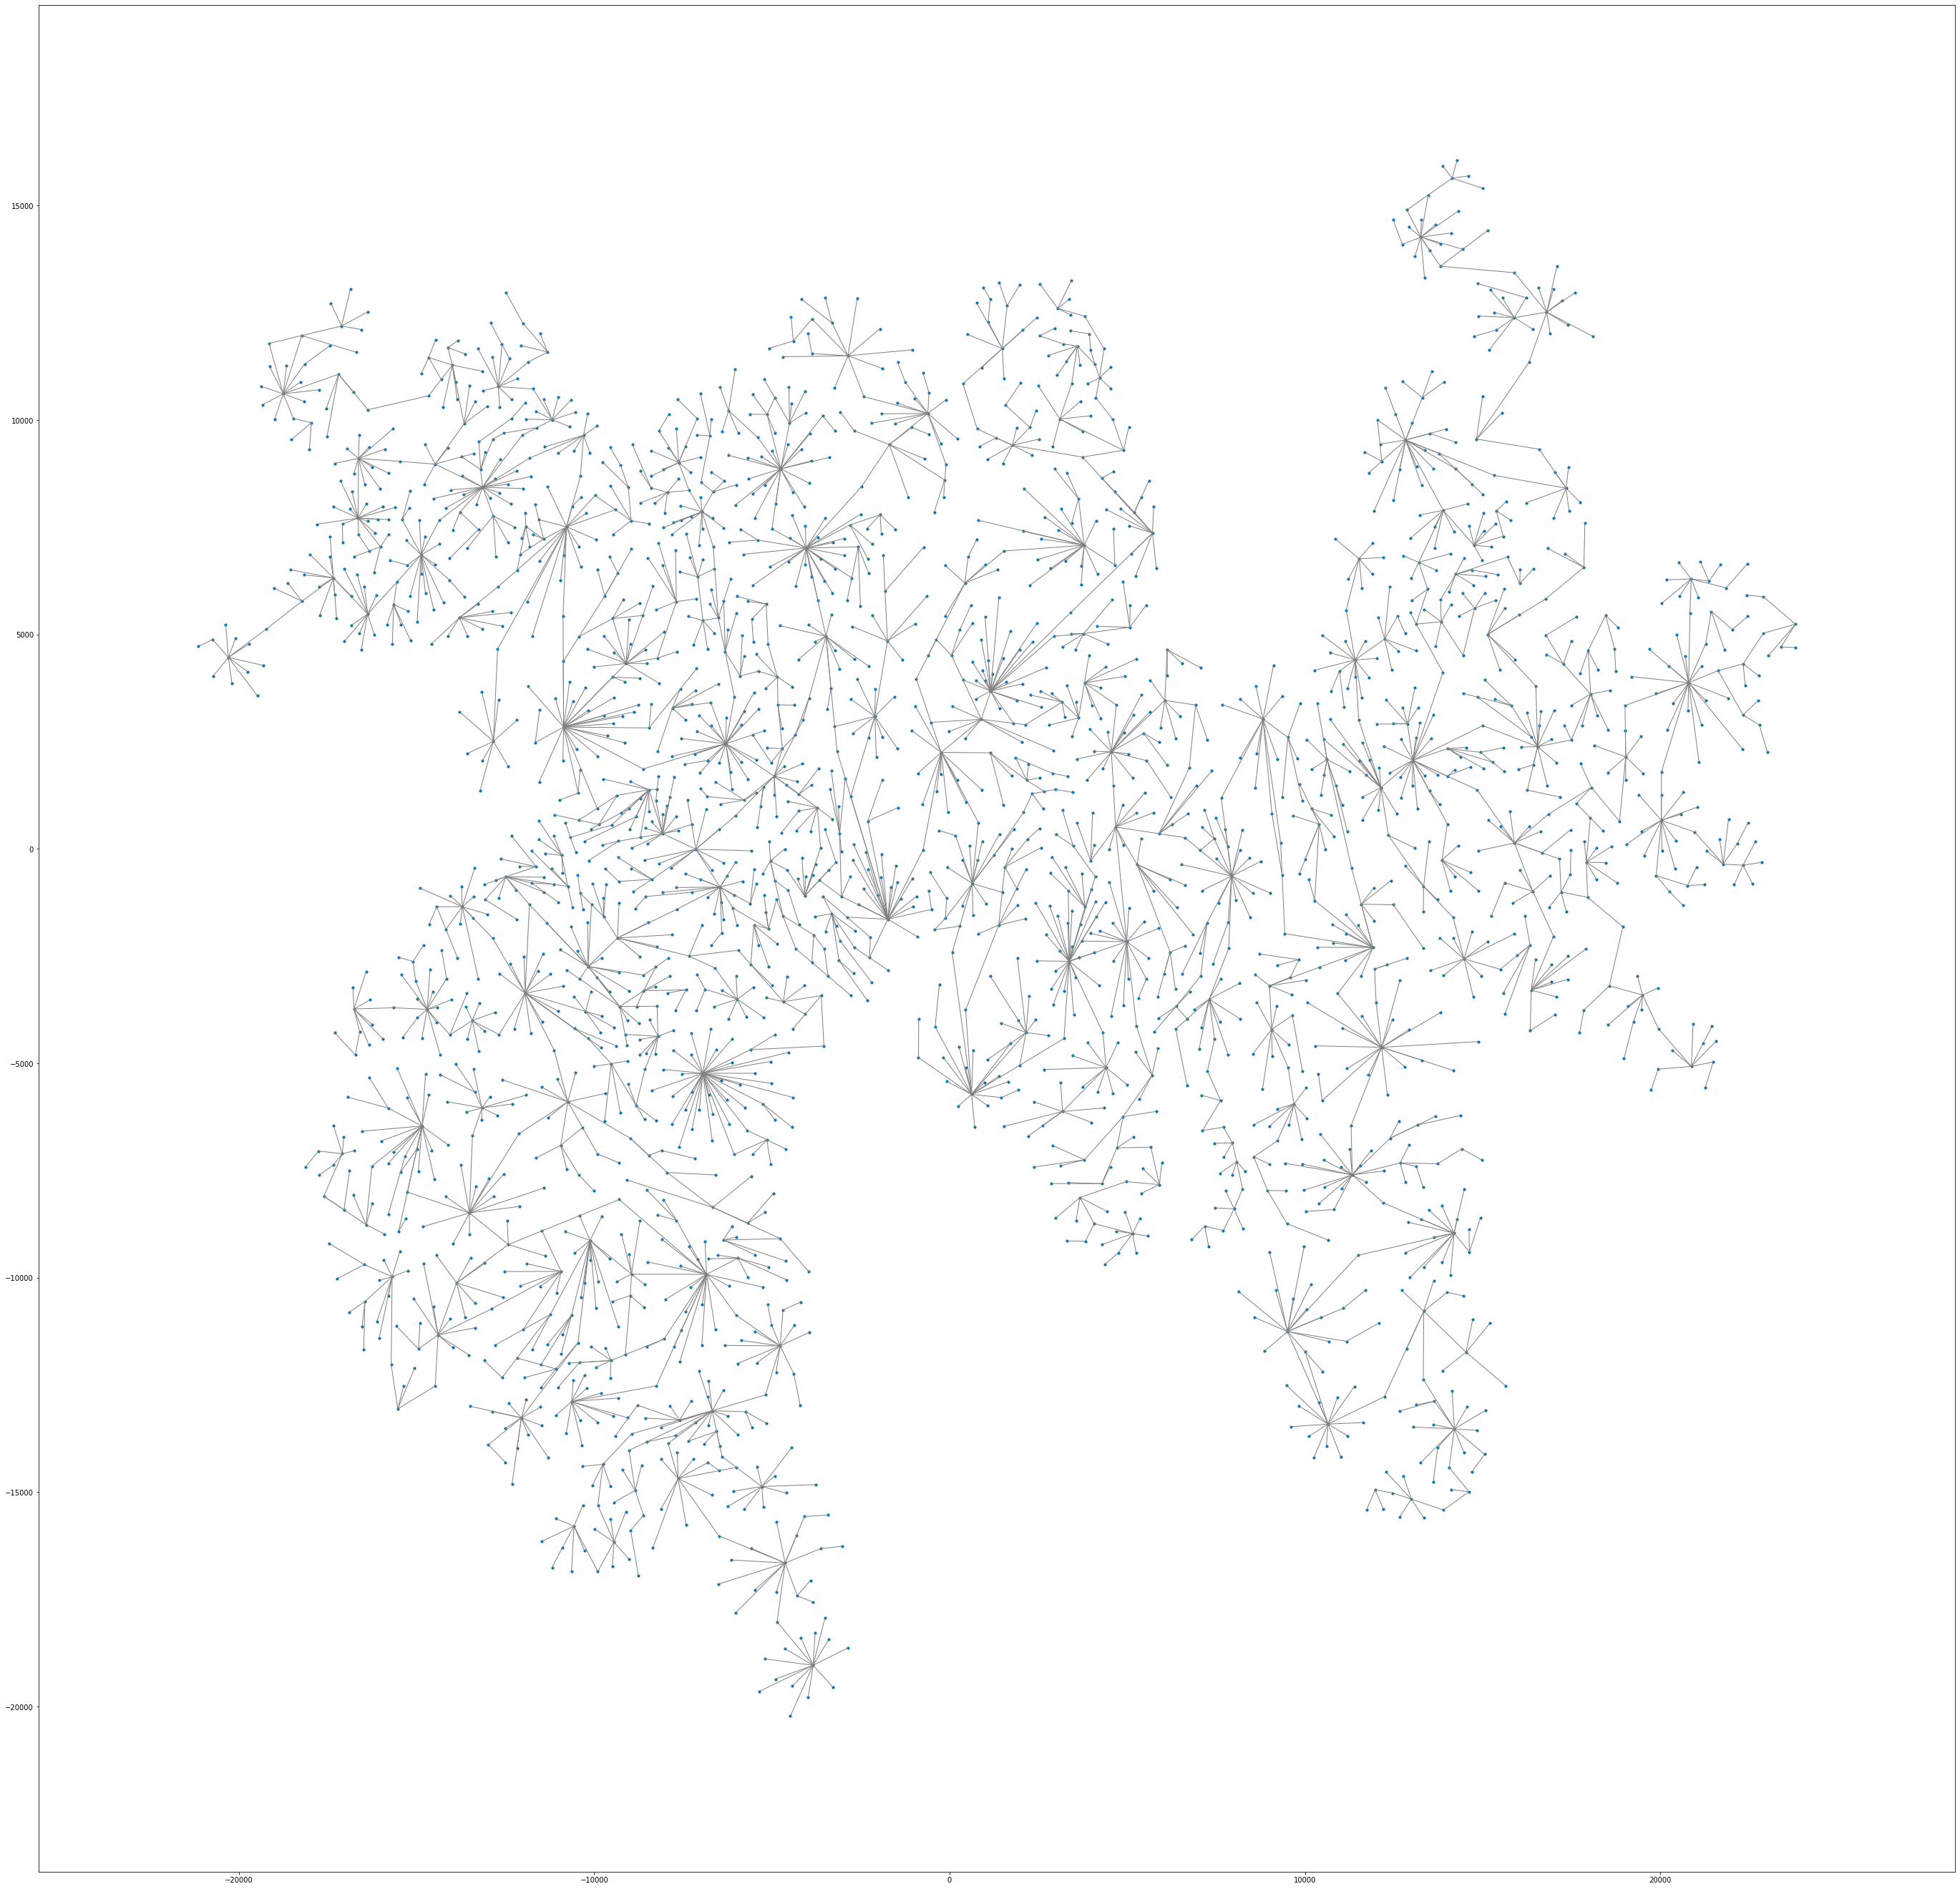

In [51]:
## verify pos

fig = plt.figure(figsize=[48,48])
ax = fig.subplots()

xy = np.array([[crd_x[k], crd_y[k]] for k in crd_x])
ax.scatter(xy[:,0], xy[:,1], s=10)


lc = mc.LineCollection(lines, colors='grey', linewidths=1)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

# for l,i in label_to_id.items():
#     plt.text(crd_x[i], crd_y[i], l)
plt.show()
    

In [53]:
crd_x = {str(n['id']):n['x'] for n in nodes}
crd_y = {str(n['id']):n['y'] for n in nodes}

var = [
    ('my_edges', my_edges),
    ('label_to_id', label_to_id),
    ('id_to_label', id_to_label),
    ('edge_distance', edge_distance),
    ('nodes_to_levels', nodes_to_levels),
    ('crd_x', crd_x),
    ('crd_y', crd_y),
]

with open('out.js', 'w') as f:
    for var_name, val_value in var:
        
        f.write(f'{var_name} = ')
        f.write(json.dumps(val_value))
        f.write('\n')
        

In [ ]:
short2long = {'geomicrobiology': 'geomicrobiology', 'biogeochemistry': 'biogeochemistry', 'surface engineer': 'surface engineering', 'materials engine': 'materials engineering', 'tribology': 'tribology', 'coatings': 'coatings', 'emotion': 'emotion', 'attention': 'attention', 'motivation': 'motivation', 'mood': 'mood', 'affect': 'affect', 'emotion regulati': 'emotion regulation', 'empathy': 'empathy', 'facial expressio': 'facial expressions', 'psychophysiology': 'psychophysiology', 'music psychology': 'music psychology', 'behavioral disor': 'behavioral disorders', 'cognition': 'cognition', 'air quality': 'air quality', 'atmospheric chem': 'atmospheric chemistry', 'emissions': 'emissions', 'marketing commun': 'marketing communication', 'advertising': 'advertising', 'mycology': 'mycology', 'forest pathology': 'forest pathology', 'plant pathology': 'plant pathology', 'fungi': 'fungi', 'geometric topolo': 'geometric topology', 'algebraic topolo': 'algebraic topology', 'medical image co': 'medical image computing', 'medical image an': 'medical image analysis', 'nanoscience': 'nanoscience', 'nanotechnology': 'nanotechnology', 'surface physics': 'surface physics', 'violence': 'violence', 'injury': 'injury', 'victimization': 'victimization', 'gangs': 'gangs', 'aggression': 'aggression', 'mri': 'mri', 'medical imaging': 'medical imaging', 'diffusion': 'diffusion', 'mrs': 'mrs', 'brain': 'brain', 'ct': 'ct', 'nmr': 'nmr', 'dti': 'dti', 'pet': 'pet', 'diffusion imagin': 'diffusion imaging', 'rf coils': 'rf coils', 'asthma': 'asthma', 'cystic fibrosis': 'cystic fibrosis', 'food allergy': 'food allergy', 'allergy': 'allergy', 'language teachin': 'language teaching', 'applied linguist': 'applied linguistics', 'hydrogeophysics': 'hydrogeophysics', 'near surface geo': 'near surface geophysics', 'hydrogeology': 'hydrogeology', 'environmental ge': 'environmental geophysics', 'applied geophysi': 'applied geophysics', 'dinosaurs': 'dinosaurs', 'vertebrate paleo': 'vertebrate paleontology', 'pulmonary medici': 'pulmonary medicine', 'critical care me': 'critical care medicine', 'extracellular ve': 'extracellular vesicles', 'exosomes': 'exosomes', 'optical networks': 'optical networks', 'software defined': 'software defined networking', 'optical communic': 'optical communications', 'speech processin': 'speech processing', 'acoustic signal ': 'acoustic signal processing', 'speech recogniti': 'speech recognition', 'lean': 'lean', 'agile': 'agile', 'operations manag': 'operations management', 'natural resource': 'natural resource economics', 'environmental ec': 'environmental economics', 'forest economics': 'forest economics', 'systemic functio': 'systemic functional linguistics', 'discourse analys': 'discourse analysis', 'medical image pr': 'medical image processing', 'image registrati': 'image registration', 'food intake': 'food intake', 'obesity': 'obesity', 'emotion recognit': 'emotion recognition', 'affective comput': 'affective computing', 'optical coherenc': 'optical coherence tomography', 'adaptive optics': 'adaptive optics', 'biomedical optic': 'biomedical optics', 'biomedical imagi': 'biomedical imaging', 'parkinson s dise': 'parkinson s disease', 'movement disorde': 'movement disorders', 'alpha-synuclein': 'alpha-synuclein', '39;s disease': '39;s disease', 'cochlear implant': 'cochlear implants', 'hearing loss': 'hearing loss', 'hearing aids': 'hearing aids', 'psychoacoustics': 'psychoacoustics', 'hearing': 'hearing', 'hearing impairme': 'hearing impairment', 'speech perceptio': 'speech perception', 'intergroup conta': 'intergroup contact', 'intergroup relat': 'intergroup relations', 'endocrinology': 'endocrinology', 'diabetes': 'diabetes', 'thyroid': 'thyroid', 'object tracking': 'object tracking', 'computer vision': 'computer vision', 'substance abuse': 'substance abuse', 'mental health': 'mental health', 'cell division': 'cell division', 'cytoskeleton': 'cytoskeleton', 'cell migration': 'cell migration', 'cell mechanics': 'cell mechanics', 'cancer metastasi': 'cancer metastasis', 'cell adhesion': 'cell adhesion', 'mirna': 'mirna', 'cancer': 'cancer', 'illness': 'illness', 'sociology of hea': 'sociology of health', 'health': 'health', 'systems biology': 'systems biology', 'functional genom': 'functional genomics', 'bioinformatics': 'bioinformatics', 'systems medicine': 'systems medicine', 'physical biology': 'physical biology', 'systems pharmaco': 'systems pharmacology', 'metabolic engine': 'metabolic engineering', 'synthetic biolog': 'synthetic biology', 'computational bi': 'computational biology', 'network biology': 'network biology', 'composites': 'composites', 'rhetoric': 'rhetoric', 'impact': 'impact', 'buckling': 'buckling', 'polymers': 'polymers', 'ethnomusicology': 'ethnomusicology', 'musicology': 'musicology', 'popular music': 'popular music', 'creativity': 'creativity', 'giftedness': 'giftedness', 'innovation': 'innovation', 'improvisation': 'improvisation', 'interior design': 'interior design', 'architecture': 'architecture', 'medical informat': 'medical informatics', 'health informati': 'health informatics', 'clinical decisio': 'clinical decision support', 'epidemiology': 'epidemiology', 'public health': 'public health', 'one health': 'one health', 'birth outcomes': 'birth outcomes', 'biostatistics': 'biostatistics', 'infectious disea': 'infectious diseases', 'self-assembly': 'self-assembly', 'supramolecular c': 'supramolecular chemistry', 'lithography': 'lithography', 'peptides': 'peptides', 'colloids': 'colloids', 'colloidal chemis': 'colloidal chemistry', 'block copolymers': 'block copolymers', 'exposure assessm': 'exposure assessment', 'indoor air quali': 'indoor air quality', 'air pollution': 'air pollution', 'reading developm': 'reading development', 'dyslexia': 'dyslexia', 'bose-einstein co': 'bose-einstein condensation', 'superfluidity': 'superfluidity', 'solitons': 'solitons', 'ultracold atoms': 'ultracold atoms', 'cold atoms': 'cold atoms', 'quantum gases': 'quantum gases', 'hybrid vehicles': 'hybrid vehicles', 'internal combust': 'internal combustion engines', 'open innovation': 'open innovation', 'innovation manag': 'innovation management', 'crowdsourcing': 'crowdsourcing', 'soil fertility': 'soil fertility', 'plant nutrition': 'plant nutrition', 'optomechanics': 'optomechanics', 'quantum optics': 'quantum optics', 'quantum measurem': 'quantum measurement', 'ubiquitous compu': 'ubiquitous computing', 'ambient intellig': 'ambient intelligence', 'activity recogni': 'activity recognition', 'pervasive': 'pervasive', 'mobile computing': 'mobile computing', 'context-aware co': 'context-aware computing', 'context awarenes': 'context awareness', 'human-computer i': 'human-computer interaction', 'hci': 'hci', 'technology studi': 'technology studies', 'medical sociolog': 'medical sociology', 'economic sociolo': 'economic sociology', 'science': 'science', 'social capital': 'social capital', 'social networks': 'social networks', 'himalaya': 'himalaya', 'tectonics': 'tectonics', 'auditing': 'auditing', 'internal control': 'internal control', 'financial accoun': 'financial accounting', 'corporate govern': 'corporate governance', 'fraud': 'fraud', 'accounting educa': 'accounting education', 'nanophotonics': 'nanophotonics', 'optical sensing': 'optical sensing', 'surface plasmon': 'surface plasmon', 'plasmonics': 'plasmonics', 'nanoplasmonics': 'nanoplasmonics', 'smart grid': 'smart grid', 'pmu': 'pmu', 'demand response': 'demand response', 'distributed ener': 'distributed energy resources', 'demand side mana': 'demand side management', 'power system rel': 'power system reliability', 'power line commu': 'power line communications', 'power systems': 'power systems', 'smart buildings': 'smart buildings', 'power system eco': 'power system economics', 'power market': 'power market', 'power system pro': 'power system protection', 'optical fiber se': 'optical fiber sensors', 'fiber optics': 'fiber optics', 'organizational p': 'organizational psychology', 'industrial': 'industrial', 'work': 'work', 'occupational hea': 'occupational health psychology', 'environmental ma': 'environmental management', 'sustainable deve': 'sustainable development', 'higher education': 'higher education', 'international ed': 'international education', 'college students': 'college students', 'community colleg': 'community colleges', 'student developm': 'student development', 'student affairs': 'student affairs', 'college access': 'college access', 'teaching': 'teaching', 'strategy': 'strategy', 'international bu': 'international business', 'entrepreneurship': 'entrepreneurship', 'environmental he': 'environmental health', 'occupational': 'occupational', 'risk assessment': 'risk assessment', 'bioenergetics': 'bioenergetics', 'mitochondria': 'mitochondria', 'nonlinear waves': 'nonlinear waves', 'public space': 'public space', 'urban design': 'urban design', 'skeletal muscle ': 'skeletal muscle physiology', 'exercise physiol': 'exercise physiology', 'management contr': 'management control', 'management accou': 'management accounting', 'ndt': 'ndt', 'ultrasonics': 'ultrasonics', 'real-time embedd': 'real-time embedded systems', 'cyber-physical s': 'cyber-physical systems', 'mhd': 'mhd', 'plasma physics': 'plasma physics', 'game design': 'game design', 'serious games': 'serious games', 'game studies': 'game studies', 'astroparticle ph': 'astroparticle physics', 'neutrino physics': 'neutrino physics', 'dark matter': 'dark matter', 'cosmic rays': 'cosmic rays', 'galaxy evolution': 'galaxy evolution', 'astrophysics': 'astrophysics', 'ocean modeling': 'ocean modeling', 'physical oceanog': 'physical oceanography', 'data assimilatio': 'data assimilation', 'geometry': 'geometry', 'topology': 'topology', 'penology': 'penology', 'criminology': 'criminology', 'society': 'society', 'internet': 'internet', 'law': 'law', 'social psycholog': 'social psychology', 'self': 'self', 'political psycho': 'political psychology', 'relationships': 'relationships', 'environmental ps': 'environmental psychology', 'social neuroscie': 'social neuroscience', 'group processes': 'group processes', 'morality': 'morality', 'attitudes': 'attitudes', 'prejudice': 'prejudice', 'nonverbal behavi': 'nonverbal behavior', 'cross-cultural p': 'cross-cultural psychology', 'social norms': 'social norms', 'affective scienc': 'affective science', 'close relationsh': 'close relationships', 'nephrology': 'nephrology', 'transplantation': 'transplantation', 'internal medicin': 'internal medicine', 'kidney transplan': 'kidney transplantation', 'dialysis': 'dialysis', 'systems engineer': 'systems engineering', 'engineering desi': 'engineering design', 'design theory': 'design theory', 'system architect': 'system architecture', 'behavioral econo': 'behavioral economics', 'experimental': 'experimental', 'experimental eco': 'experimental economics', 'economic psychol': 'economic psychology', 'field experiment': 'field experiments', 'parallel': 'parallel', 'distributed comp': 'distributed computing', 'knowledge organi': 'knowledge organization', 'information scie': 'information science', 'acoustic metamat': 'acoustic metamaterials', 'phononic crystal': 'phononic crystals', 'bioanalysis': 'bioanalysis', 'analytical chemi': 'analytical chemistry', 'glaucoma': 'glaucoma', 'neuroprotection': 'neuroprotection', 'ophthalmology': 'ophthalmology', 'refugee law': 'refugee law', 'human rights': 'human rights', 'place': 'place', 'space': 'space', 'environmental hi': 'environmental history', 'history of scien': 'history of science', 'cell death': 'cell death', 'autophagy': 'autophagy', 'signal transduct': 'signal transduction', 'audiology': 'audiology', 'deafness': 'deafness', 'auditory neurosc': 'auditory neuroscience', 'derecho civil': 'derecho civil', 'private law': 'private law', 'systems neurosci': 'systems neuroscience', 'computational ne': 'computational neuroscience', 'cancer imaging': 'cancer imaging', 'molecular imagin': 'molecular imaging', 'positioning': 'positioning', 'navigation': 'navigation', 'applied ecology': 'applied ecology', 'conservation bio': 'conservation biology', 'agent-based mode': 'agent-based modeling', 'social simulatio': 'social simulation', 'simulation': 'simulation', 'complex adaptive': 'complex adaptive systems', 'international or': 'international organizations', 'global governanc': 'global governance', 'limnology': 'limnology', 'zooplankton': 'zooplankton', 'aquatic ecology': 'aquatic ecology', 'paleolimnology': 'paleolimnology', 'arctic': 'arctic', 'lakes': 'lakes', 'brown adipose ti': 'brown adipose tissue', 'formación del pr': 'formación del profesorado', 'educación': 'educación', 'microbial fuel c': 'microbial fuel cell', 'bioelectrochemis': 'bioelectrochemistry', 'bioelectrochemic': 'bioelectrochemical systems', 'health insurance': 'health insurance', 'health economics': 'health economics', 'neuroimmunology': 'neuroimmunology', 'microglia': 'microglia', 'multiple scleros': 'multiple sclerosis', 'autoimmunity': 'autoimmunity', 'multiscale metho': 'multiscale methods', 'reservoir simula': 'reservoir simulation', 'fluid-structure ': 'fluid-structure interaction', 'computational fl': 'computational fluid dynamics', 'system security': 'system security', 'web security': 'web security', 'drylands': 'drylands', 'geomorphology': 'geomorphology', 'environmental ri': 'environmental risk assessment', 'ecotoxicology': 'ecotoxicology', 'mesh generation': 'mesh generation', 'computational ge': 'computational geometry', 'generic programm': 'generic programming', 'functional progr': 'functional programming', 'aquaculture': 'aquaculture', 'fish nutrition': 'fish nutrition', 'fisheries': 'fisheries', 'fish biology': 'fish biology', 'fish physiology': 'fish physiology', 'financial mathem': 'financial mathematics', 'probability theo': 'probability theory', 'print culture': 'print culture', 'book history': 'book history', 'dementia': 'dementia', 'caregiving': 'caregiving', 'aging': 'aging', 'neuropsychology': 'neuropsychology', 'alzheimer diseas': 'alzheimer disease', 'long-term care': 'long-term care', 'alzheimer s dise': 'alzheimer s disease', 'scientific compu': 'scientific computing', 'computational fi': 'computational finance', 'numerical analys': 'numerical analysis', 'numerical linear': 'numerical linear algebra', 'probabilistic pr': 'probabilistic programming', 'artificial intel': 'artificial intelligence', 'rock deformation': 'rock deformation', 'structural geolo': 'structural geology', 'metacognition': 'metacognition', 'memory': 'memory', 'self-regulated l': 'self-regulated learning', 'ferroelectrics': 'ferroelectrics', 'piezoelectric': 'piezoelectric', 'multiferroics': 'multiferroics', 'consumer behavio': 'consumer behavior', 'judgment': 'judgment', 'sport marketing': 'sport marketing', 'services marketi': 'services marketing', 'marketing': 'marketing', 'food marketing': 'food marketing', 'consumer psychol': 'consumer psychology', 'moral philosophy': 'moral philosophy', 'political philos': 'political philosophy', 'neuromorphic com': 'neuromorphic computing', 'vlsi': 'vlsi', 'memristor': 'memristor', 'theoretical ecol': 'theoretical ecology', 'community ecolog': 'community ecology', 'population biolo': 'population biology', 'tracking': 'tracking', 'localization': 'localization', 'object detection': 'object detection', 'psychology of re': 'psychology of religion', 'spirituality': 'spirituality', 'revenue manageme': 'revenue management', 'pricing': 'pricing', 'library instruct': 'library instruction', 'information lite': 'information literacy', 'metabolic syndro': 'metabolic syndrome', 'structural healt': 'structural health monitoring', 'acoustic emissio': 'acoustic emission', 'structural dynam': 'structural dynamics', 'wireless sensors': 'wireless sensors', 'smart structures': 'smart structures', 'nondestructive e': 'nondestructive evaluation', 'system identific': 'system identification', 'damage detection': 'damage detection', 'medical geograph': 'medical geography', 'gis': 'gis', 'spatial epidemio': 'spatial epidemiology', 'formal political': 'formal political theory', 'political econom': 'political economy', 'academic librari': 'academic librarianship', 'technology strat': 'technology strategy', 'geocomputation': 'geocomputation', 'biodemography': 'biodemography', 'demography': 'demography', 'flamingo project': 'flamingo project', 'network manageme': 'network management', 'cultural evoluti': 'cultural evolution', 'language evoluti': 'language evolution', 'human behavioral': 'human behavioral ecology', 'social learning': 'social learning', 'paleobiology': 'paleobiology', 'macroevolution': 'macroevolution', 'paleontology': 'paleontology', 'thermal physiolo': 'thermal physiology', 'ore deposits': 'ore deposits', 'mineralogy': 'mineralogy', 'fluid inclusions': 'fluid inclusions', 'multiscale model': 'multiscale modeling', 'computational me': 'computational mechanics', 'sensor fusion': 'sensor fusion', 'water reuse': 'water reuse', 'wastewater treat': 'wastewater treatment', 'additive manufac': 'additive manufacturing', 'rapid prototypin': 'rapid prototyping', 'selective laser ': 'selective laser melting', '3d printing': '3d printing', 'laser material p': 'laser material processing', 'inkjet printing': 'inkjet printing', 'cam': 'cam', 'recreation': 'recreation', 'leisure': 'leisure', 'parks': 'parks', 'malacology': 'malacology', 'taxonomy': 'taxonomy', 'strategic commun': 'strategic communication', 'corporate commun': 'corporate communication', 'public relations': 'public relations', 'alcohol': 'alcohol', 'tobacco': 'tobacco', 'addiction': 'addiction', 'smoking': 'smoking', 'drug': 'drug', 'popular culture': 'popular culture', 'literature': 'literature', 'hadron physics': 'hadron physics', 'nuclear physics': 'nuclear physics', 'infection': 'infection', 'immunity': 'immunity', 'meteoritics': 'meteoritics', 'planetary scienc': 'planetary science', 'web development': 'web development', 'software enginee': 'software engineering', 'argumentation': 'argumentation', 'medical robotics': 'medical robotics', 'haptics': 'haptics', 'policing': 'policing', 'peacekeeping': 'peacekeeping', 'civil war': 'civil war', 'fem': 'fem', 'dem': 'dem', 'neural networks': 'neural networks', 'machine learning': 'machine learning', 'data protection': 'data protection', 'privacy': 'privacy', 'solidification': 'solidification', 'welding': 'welding', 'casting': 'casting', 'graph theory': 'graph theory', 'algorithms': 'algorithms', 'combinatorics': 'combinatorics', 'discrete mathema': 'discrete mathematics', 'linear algebra': 'linear algebra', 'magnonics': 'magnonics', 'spin waves': 'spin waves', 'spintronics': 'spintronics', 'data integration': 'data integration', 'semantic web': 'semantic web', 'data quality': 'data quality', 'computational li': 'computational linguistics', 'natural language': 'natural language processing', 'corpus linguisti': 'corpus linguistics', 'dialogue': 'dialogue', 'distributional s': 'distributional semantics', 'lexical semantic': 'lexical semantics', 'computational se': 'computational semantics', 'natural langua02': 'natural language generation', 'pregnancy': 'pregnancy', 'delinquency': 'delinquency', 'juvenile justice': 'juvenile justice', 'crime': 'crime', 'mcmc': 'mcmc', 'bayesian statist': 'bayesian statistics', 'public opinion': 'public opinion', 'american politic': 'american politics', 'political partic': 'political participation', 'political behavi': 'political behaviour', 'automated planni': 'automated planning', 'atom optics': 'atom optics', 'health professio': 'health professions education', 'medical educatio': 'medical education', 'mobile systems': 'mobile systems', 'wireless network': 'wireless networks', 'atmosphere': 'atmosphere', 'ocean': 'ocean', 'climate dynamics': 'climate dynamics', 'traffic flow the': 'traffic flow theory', 'intelligent tran': 'intelligent transportation systems', 'synthesis': 'synthesis', 'verification': 'verification', 'characterization': 'characterization', 'corrosion': 'corrosion', 'electrochemistry': 'electrochemistry', 'health physics': 'health physics', 'medical physics': 'medical physics', 'neurogenesis': 'neurogenesis', 'epilepsy': 'epilepsy', 'publicidad': 'publicidad', 'periodismo': 'periodismo', 'islet biology': 'islet biology', 'cell cycle': 'cell cycle', 'dna replication': 'dna replication', 'mitosis': 'mitosis', 'urban regenerati': 'urban regeneration', 'urban planning': 'urban planning', 'security studies': 'security studies', 'international re': 'international relations', 'seizures': 'seizures', 'eeg': 'eeg', 'child neurology': 'child neurology', 'quantum technolo': 'quantum technologies', 'devices': 'devices', 'semiconductor ph': 'semiconductor physics', 'electronic mater': 'electronic materials', 'optoelectronic m': 'optoelectronic materials', 'semiconductor ma': 'semiconductor materials', 'population healt': 'population health', 'social epidemiol': 'social epidemiology', 'genomic imprinti': 'genomic imprinting', 'epigenetics': 'epigenetics', 'hydrometeorology': 'hydrometeorology', 'hydrology': 'hydrology', 'fracture': 'fracture', 'damage': 'damage', 'adhesion': 'adhesion', 'fatigue': 'fatigue', 'electronic packa': 'electronic packaging', 'reliability': 'reliability', 'power converters': 'power converters', 'power electronic': 'power electronics', 'polymer chemistr': 'polymer chemistry', 'organic chemistr': 'organic chemistry', 'motor learning': 'motor learning', 'motor control': 'motor control', 'democratization': 'democratization', 'authoritarianism': 'authoritarianism', 'comparative poli': 'comparative politics', 'ethnic conflict': 'ethnic conflict', 'fmri': 'fmri', 'erp': 'erp', 'brain computer i': 'brain computer interface', 'ecg': 'ecg', 'bci': 'bci', 'meg': 'meg', 'emg': 'emg', 'chemoinformatics': 'chemoinformatics', 'molecular modeli': 'molecular modeling', 'medicine': 'medicine', 'biology': 'biology', 'rechargeable bat': 'rechargeable batteries', 'microwave photon': 'microwave photonics', 'food systems': 'food systems', 'sustainability': 'sustainability', 'neuro-oncology': 'neuro-oncology', 'neurosurgery': 'neurosurgery', 'neurological sur': 'neurological surgery', 'sociology of edu': 'sociology of education', 'education policy': 'education policy', 'social stratific': 'social stratification', 'neuroendocrinolo': 'neuroendocrinology', 'reproductive end': 'reproductive endocrinology', 'child nutrition': 'child nutrition', 'maternal': 'maternal', 'public choice': 'public choice', 'lasers': 'lasers', 'nonlinear optics': 'nonlinear optics', 'accelerators': 'accelerators', 'optics': 'optics', 'superconductors': 'superconductors', 'topological insu': 'topological insulators', 'combustion': 'combustion', 'laser diagnostic': 'laser diagnostics', 'soot formation': 'soot formation', 'cfd': 'cfd', 'alternative fuel': 'alternative fuels', 'propulsion': 'propulsion', 'gas turbines': 'gas turbines', 'explosion': 'explosion', 'gasification': 'gasification', 'fuels': 'fuels', 'flames': 'flames', 'thermoacoustics': 'thermoacoustics', 'energetic materi': 'energetic materials', 'soot': 'soot', 'chemical kinetic': 'chemical kinetics', 'rnai': 'rnai', 'microrna': 'microrna', 'dark silicon': 'dark silicon', 'computer archite': 'computer architecture', 'altmetrics': 'altmetrics', 'scholarly commun': 'scholarly communication', 'open access': 'open access', 'bibliometrics': 'bibliometrics', 'geometric modeli': 'geometric modeling', 'computer graphic': 'computer graphics', 'polyoxometalates': 'polyoxometalates', 'catalysis': 'catalysis', 'methylation': 'methylation', 'hydroinformatics': 'hydroinformatics', 'water resources': 'water resources', 'membrane traffic': 'membrane traffic', 'cell biology': 'cell biology', 'vehicle routing': 'vehicle routing', 'metaheuristics': 'metaheuristics', 'muscle': 'muscle', 'exercise': 'exercise', 'nonlinear circui': 'nonlinear circuits', 'systems': 'systems', 'radiation protec': 'radiation protection', 'spatial modeling': 'spatial modeling', 'global justice': 'global justice', 'mechanism design': 'mechanism design', 'algorithmic game': 'algorithmic game theory', 'auction theory': 'auction theory', 'metasurfaces': 'metasurfaces', 'metamaterials': 'metamaterials', 'economic geograp': 'economic geography', 'innovation studi': 'innovation studies', 'urban economics': 'urban economics', 'regional develop': 'regional development', 'evolutionary eco': 'evolutionary economics', 'regional science': 'regional science', 'political geogra': 'political geography', 'evolutionary e02': 'evolutionary economic geography', 'ubicomp': 'ubicomp', 'artificial life': 'artificial life', 'complex systems': 'complex systems', 'evolutionary rob': 'evolutionary robotics', 'evolutionary com': 'evolutionary computation', 'plant breeding': 'plant breeding', 'genetics': 'genetics', 'plant genetics': 'plant genetics', 'photogrammetry': 'photogrammetry', 'remote sensing': 'remote sensing', 'geomatics': 'geomatics', 'cultural heritag': 'cultural heritage', '3d modeling': '3d modeling', 'prosocial behavi': 'prosocial behavior', 'social cognition': 'social cognition', 'stigma': 'stigma', 'animal cognition': 'animal cognition', 'comparative cogn': 'comparative cognition', 'animal behaviour': 'animal behaviour', 'marine protected': 'marine protected areas', 'membrane distill': 'membrane distillation', 'desalination': 'desalination', 'cosmology': 'cosmology', 'inflation': 'inflation', 'particle physics': 'particle physics', 'reionization': 'reionization', 'large scale stru': 'large scale structure', 'gravity': 'gravity', 'modified gravity': 'modified gravity', 'extragalactic as': 'extragalactic astronomy', 'galaxy formation': 'galaxy formation', 'relativity': 'relativity', 'gravitational le': 'gravitational lensing', 'cosmic microwave': 'cosmic microwave background', 'cmb': 'cmb', 'theoretical part': 'theoretical particle physics', 'epoch of reioniz': 'epoch of reionization', 'particle astroph': 'particle astrophysics', 'medical biochemi': 'medical biochemistry', 'molecular biolog': 'molecular biology', 'active transport': 'active transportation', 'built environmen': 'built environment', 'visual computing': 'visual computing', 'running': 'running', 'biomechanics': 'biomechanics', 'personnel econom': 'personnel economics', 'organizational e': 'organizational economics', 'labor economics': 'labor economics', 'filosofía': 'filosofía', 'sociología': 'sociología', 'ética': 'ética', 'guidance': 'guidance', 'control': 'control', 'archaeobotany': 'archaeobotany', 'environmental ar': 'environmental archaeology', 'spatial ecology': 'spatial ecology', 'movement ecology': 'movement ecology', 'patent law': 'patent law', 'intellectual pro': 'intellectual property', 'formal methods': 'formal methods', 'testing': 'testing', 'automated reason': 'automated reasoning', 'validation': 'validation', 'risk perception': 'risk perception', 'risk communicati': 'risk communication', 'social relations': 'social relationships', 'international ma': 'international macroeconomics', 'macroeconomics': 'macroeconomics', 'asteroids': 'asteroids', 'comets': 'comets', 'health dispariti': 'health disparities', 'minority health': 'minority health', 'latino health': 'latino health', 'african american': 'african american', 'social determina': 'social determinants of health', 'health behavior': 'health behavior', 'venture capital': 'venture capital', 'corporate financ': 'corporate finance', 'private equity': 'private equity', 'high energy dens': 'high energy density physics', 'inertial confine': 'inertial confinement fusion', 'bioética': 'bioética', 'general practice': 'general practice', 'primary care': 'primary care', 'porous materials': 'porous materials', 'metal-organic fr': 'metal-organic frameworks', 'adsorption': 'adsorption', 'circadian rhythm': 'circadian rhythms', 'melatonin': 'melatonin', 'sleep': 'sleep', 'chronobiology': 'chronobiology', 'psychoneuroendoc': 'psychoneuroendocrinology', 'stress': 'stress', 'embedded systems': 'embedded systems', 'real-time': 'real-time', 'hardware design': 'hardware design', 'hw': 'hw', 'reconfigurable a': 'reconfigurable architectures', 'system on chip': 'system on chip', 'hardware': 'hardware', 'system-level des': 'system-level design', 'real-time system': 'real-time systems', 'design automatio': 'design automation', 'economics of agi': 'economics of aging', 'physical activit': 'physical activity', 'sports science': 'sports science', 'training': 'training', 'fitness': 'fitness', 'chemical': 'chemical', 'biological engin': 'biological engineering', 'biomolecular eng': 'biomolecular engineering', 'environmental en': 'environmental engineering', 'nuclear medicine': 'nuclear medicine', 'contrast agents': 'contrast agents', 'microbial genomi': 'microbial genomics', 'microbial evolut': 'microbial evolution', 'metagenomics': 'metagenomics', 'metal forming': 'metal forming', 'thermomechanical': 'thermomechanical processing', 'dft': 'dft', 'capital structur': 'capital structure', 'mergers': 'mergers', 'otolaryngology': 'otolaryngology', 'head': 'head', 'myeloma': 'myeloma', 'lymphoma': 'lymphoma', 'rram': 'rram', 'nonlinear analys': 'nonlinear analysis', 'differential equ': 'differential equations', 'partial differen': 'partial differential equations', 'quaternary': 'quaternary', 'mobile communica': 'mobile communication', 'wireless': 'wireless', 'cell therapy': 'cell therapy', 'gene therapy': 'gene therapy', 'regenerative med': 'regenerative medicine', 'faults': 'faults', 'dimensionality r': 'dimensionality reduction', 'urban informatic': 'urban informatics', 'gamification': 'gamification', 'condensed matter': 'condensed matter', 'superconductivit': 'superconductivity', 'materials physic': 'materials physics', 'longevity': 'longevity', 'literary theory': 'literary theory', 'modernism': 'modernism', 'american literat': 'american literature', 'comparative lite': 'comparative literature', 'information-cent': 'information-centric networking', 'computer network': 'computer networks', 'web 2.0': 'web 2.0', 'e-learning': 'e-learning', 'severe plastic d': 'severe plastic deformation', 'differential pri': 'differential privacy', 'radio astronomy': 'radio astronomy', 'mimo': 'mimo', 'ofdm': 'ofdm', 'wireless communi': 'wireless communications', 'cooperative comm': 'cooperative communications', 'cancer preventio': 'cancer prevention', 'tobacco control': 'tobacco control', 'biomaterials': 'biomaterials', 'biointerfaces': 'biointerfaces', 'drug delivery': 'drug delivery', 'bone repair': 'bone repair', 'stem cell engine': 'stem cell engineering', 'nanomedicine': 'nanomedicine', 'drug delivery sy': 'drug delivery systems', 'surface modifica': 'surface modification', 'stem cells': 'stem cells', 'biodegradable po': 'biodegradable polymers', 'gene delivery': 'gene delivery', 'bioengineering': 'bioengineering', 'dental materials': 'dental materials', 'bioceramics': 'bioceramics', 'biocompatibility': 'biocompatibility', '3d cell culture': '3d cell culture', 'immunoengineerin': 'immunoengineering', 'bone tissue engi': 'bone tissue engineering', 'extracellular ma': 'extracellular matrix', 'scaffold': 'scaffold', 'atmospheric scie': 'atmospheric science', 'meteorology': 'meteorology', 'physical chemist': 'physical chemistry', 'computational ch': 'computational chemistry', 'photochemistry': 'photochemistry', 'chemical physics': 'chemical physics', 'time-resolved sp': 'time-resolved spectroscopy', 'spectroscopy': 'spectroscopy', 'laser spectrosco': 'laser spectroscopy', 'molecular spectr': 'molecular spectroscopy', 'information beha': 'information behaviour', 'graphic design': 'graphic design', 'typography': 'typography', 'surface': 'surface', 'interfaces': 'interfaces', 'electronics': 'electronics', 'photonics': 'photonics', 'coding theory': 'coding theory', 'information theo': 'information theory', 'network informat': 'network information theory', 'information': 'information', 'historia del art': 'historia del arte', 'historia': 'historia', 'industrial ecolo': 'industrial ecology', 'life cycle asses': 'life cycle assessment', 'circular economy': 'circular economy', 'waste management': 'waste management', 'ecological econo': 'ecological economics', 'rehabilitation e': 'rehabilitation engineering', 'data warehouse': 'data warehouse', 'business intelli': 'business intelligence', 'evolution': 'evolution', 'protists': 'protists', 'phenotypic plast': 'phenotypic plasticity', 'behavior': 'behavior', 'ecology': 'ecology', 'genomics': 'genomics', 'insects': 'insects', 'microbes': 'microbes', 'anesthesiology': 'anesthesiology', 'general surgery': 'general surgery', 'surgical oncolog': 'surgical oncology', 'pediatric surger': 'pediatric surgery', 'vascular surgery': 'vascular surgery', 'metaphor': 'metaphor', 'language': 'language', 'nutraceuticals': 'nutraceuticals', 'functional foods': 'functional foods', 'adherence': 'adherence', 'hiv': 'hiv', 'computer experim': 'computer experiments', 'statistics': 'statistics', 'consumer behav02': 'consumer behaviour', 'social marketing': 'social marketing', 'pediatrics': 'pediatrics', 'neonatology': 'neonatology', 'antenna theory': 'antenna theory', 'design': 'design', 'thermosphere': 'thermosphere', 'ionosphere': 'ionosphere', 'eating behavior': 'eating behavior', 'carbon capture': 'carbon capture', 'sequestration': 'sequestration', 'storage': 'storage', 'gas separation': 'gas separation', 'gentrification': 'gentrification', 'housing': 'housing', 'urban studies': 'urban studies', 'leadership devel': 'leadership development', 'leadership': 'leadership', 'exergy analysis': 'exergy analysis', 'energy': 'energy', 'peer-to-peer': 'peer-to-peer', 'distributed syst': 'distributed systems', 'party politics': 'party politics', 'political partie': 'political parties', 'chinese politics': 'chinese politics', 'latin american p': 'latin american politics', 'european politic': 'european politics', 'political econ02': 'political economy of development', 'latin america': 'latin america', 'legislative stud': 'legislative studies', 'economic evaluat': 'economic evaluation', 'biochar': 'biochar', 'pyrolysis': 'pyrolysis', 'halogen bonding': 'halogen bonding', 'prostate cancer': 'prostate cancer', 'androgen recepto': 'androgen receptor', 'kidney cancer': 'kidney cancer', 'copyright': 'copyright', 'patents': 'patents', 'development econ': 'development economics', 'cultural economi': 'cultural economics', 'corruption': 'corruption', 'lexicology': 'lexicology', 'lexicography': 'lexicography', 'drives': 'drives', 'theoretical biol': 'theoretical biology', 'mathematical bio': 'mathematical biology', 'underwater acous': 'underwater acoustics', 'signal processin': 'signal processing', 'vaccines': 'vaccines', 'immunotherapy': 'immunotherapy', 'influenza': 'influenza', 'immunology': 'immunology', 'cognitive radio ': 'cognitive radio networks', 'geovisualization': 'geovisualization', 'giscience': 'giscience', 'cartography': 'cartography', 'petrophysics': 'petrophysics', 'reservoir charac': 'reservoir characterization', 'rock physics': 'rock physics', 'sdn': 'sdn', '5g': '5g', 'nfv': 'nfv', 'logistics': 'logistics', 'freight': 'freight', 'material handlin': 'material handling', 'supply chain': 'supply chain', 'supply chain man': 'supply chain management', 'transportation': 'transportation', 'scm': 'scm', 'brain injury': 'brain injury', 'rehabilitation': 'rehabilitation', 'metamorphic petr': 'metamorphic petrology', 'nicotine': 'nicotine', 'oral surgery': 'oral surgery', 'dentistry': 'dentistry', 'grief': 'grief', 'trauma': 'trauma', 'bereavement': 'bereavement', 'family firms': 'family firms', 'family business': 'family business', 'anomaly detectio': 'anomaly detection', 'graph mining': 'graph mining', 'immigration': 'immigration', 'latino': 'latino', 'latino politics': 'latino politics', 'ethnicity': 'ethnicity', 'thermochronology': 'thermochronology', 'protein nmr': 'protein nmr', 'structural biolo': 'structural biology', 'ocean acidificat': 'ocean acidification', 'coral reefs': 'coral reefs', 'labor': 'labor', 'demographic econ': 'demographic economics', 'migration': 'migration', 'international de': 'international development', 'poverty': 'poverty', 'digital': 'digital', 'social media': 'social media', 'emergency medici': 'emergency medicine', 'resuscitation': 'resuscitation', 'disaster medicin': 'disaster medicine', 'theoretical': 'theoretical', 'observational co': 'observational cosmology', 'language therapy': 'language therapy', 'speech': 'speech', 'private internat': 'private international law', 'comparative law': 'comparative law', 'smart materials': 'smart materials', 'shape memory all': 'shape memory alloys', 'soft robotics': 'soft robotics', 'structures': 'structures', 'evaluation': 'evaluation', 'monitoring': 'monitoring', 'assessment': 'assessment', 'word of mouth': 'word of mouth', 'branding': 'branding', 'consumer culture': 'consumer culture theory', 'services': 'services', 'consumer cultu02': 'consumer culture', 'retailing': 'retailing', 'consumer': 'consumer', 'macromarketing': 'macromarketing', 'hedge funds': 'hedge funds', 'asset pricing': 'asset pricing', 'institutional in': 'institutional investors', 'mutual funds': 'mutual funds', 'philosophy of la': 'philosophy of language', 'pragmatics': 'pragmatics', 'philosophy of lo': 'philosophy of logic', 'metaethics': 'metaethics', 'igneous petrolog': 'igneous petrology', 'experimental pet': 'experimental petrology', 'geochemistry': 'geochemistry', 'health education': 'health education', 'health promotion': 'health promotion', 'speech enhanceme': 'speech enhancement', 'biological ocean': 'biological oceanography', 'zooplankton ecol': 'zooplankton ecology', 'economics of edu': 'economics of education', 'labour economics': 'labour economics', 'hearing science': 'hearing science', 'glacier hydrolog': 'glacier hydrology', 'glaciology': 'glaciology', 'constitutional t': 'constitutional theory', 'constitutional l': 'constitutional law', 'financial report': 'financial reporting', 'nutrigenomics': 'nutrigenomics', 'nutrition': 'nutrition', 'nutrigenetics': 'nutrigenetics', 'surgery': 'surgery', 'operating system': 'operating systems', 'cloud computing': 'cloud computing', 'middleware': 'middleware', 'distributed algo': 'distributed algorithms', 'fault tolerance': 'fault tolerance', 'p2p': 'p2p', 'stream processin': 'stream processing', 'networks': 'networks', 'tectonophysics': 'tectonophysics', 'geodynamics': 'geodynamics', 'european union': 'european union', 'european integra': 'european integration', 'steganography': 'steganography', 'steganalysis': 'steganalysis', 'watermarking': 'watermarking', 'cryptography': 'cryptography', 'information hidi': 'information hiding', 'vaccine developm': 'vaccine development', 'planetary atmosp': 'planetary atmospheres', 'exoplanets': 'exoplanets', 'academic libra02': 'academic libraries', 'biodiversity': 'biodiversity', 'vegetation ecolo': 'vegetation ecology', 'dna barcoding': 'dna barcoding', 'biogeography': 'biogeography', 'energy policy': 'energy policy', 'climate policy': 'climate policy', 'energy security': 'energy security', 'environmental po': 'environmental policy', 'energy economics': 'energy economics', 'molecular physic': 'molecular physics', 'atomic': 'atomic', 'care': 'care', 'early childhood ': 'early childhood education', 'web search': 'web search', 'information retr': 'information retrieval', 'strategic allian': 'strategic alliances', 'power system ope': 'power system operation', 'electricity mark': 'electricity markets', 'planning': 'planning', 'power system pla': 'power system planning', 'vanet': 'vanet', 'ad hoc networks': 'ad hoc networks', 'mac': 'mac', 'cognitive networ': 'cognitive networks', 'vehicular networ': 'vehicular networks', 'wireless securit': 'wireless security', 'network economic': 'network economics', 'sensor networks': 'sensor networks', 'mac protocols': 'mac protocols', 'complex traits': 'complex traits', 'human genetics': 'human genetics', 'dna repair': 'dna repair', 'invasive species': 'invasive species', 'restoration ecol': 'restoration ecology', 'dielectrics': 'dielectrics', 'nuclear receptor': 'nuclear receptors', 'metabolism': 'metabolism', 'separation': 'separation', 'flow chemistry': 'flow chemistry', 'brain developmen': 'brain development', 'neuroimaging': 'neuroimaging', 'multilevel conve': 'multilevel converters', 'public budgeting': 'public budgeting', 'finance': 'finance', 'inflammation': 'inflammation', 'document analysi': 'document analysis', 'pattern recognit': 'pattern recognition', 'family law': 'family law', 'courts': 'courts', 'economics': 'economics', 'legal education': 'legal education', 'intellectual p02': 'intellectual property law', 'contracts': 'contracts', 'gene expression': 'gene expression', 'transcription': 'transcription', 'device physics': 'device physics', 'organic semicond': 'organic semiconductors', 'pharmaceutical t': 'pharmaceutical technology', 'software engin02': 'software engineering education', 'plant-insect int': 'plant-insect interactions', 'chemical ecology': 'chemical ecology', 'mixed reality': 'mixed reality', 'virtual reality': 'virtual reality', 'phase transforma': 'phase transformation', 'steel': 'steel', 'nanogenerator': 'nanogenerator', 'energy harvestin': 'energy harvesting', 'radar systems': 'radar systems', 'science of scien': 'science of science', 'seismic engineer': 'seismic engineering', 'structural engin': 'structural engineering', 'travel behavior': 'travel behavior', 'transportation p': 'transportation planning', 'transistors': 'transistors', 'solar cells': 'solar cells', 'conservation pla': 'conservation planning', 'landscape ecolog': 'landscape ecology', 'memory managemen': 'memory management', 'nanotoxicology': 'nanotoxicology', 'media policy': 'media policy', 'media': 'media', 'legal philosophy': 'legal philosophy', 'circuits': 'circuits', 'human computatio': 'human computation', 'buildings': 'buildings', 'systematics': 'systematics', 'zoology': 'zoology', 'obesidade': 'obesidade', 'nutrición': 'nutrición', 'brain tumors': 'brain tumors', 'radiosurgery': 'radiosurgery', 'skull base': 'skull base', 'regional': 'regional', 'real estate': 'real estate', 'public economics': 'public economics', 'spatial economic': 'spatial economics', 'real estate econ': 'real estate economics', 'convex optimizat': 'convex optimization', 'convex analysis': 'convex analysis', 'thermal sciences': 'thermal sciences', 'nanoscale heat t': 'nanoscale heat transfer', 'heat transfer': 'heat transfer', 'film': 'film', 'television': 'television', 'documentary': 'documentary', 'cinema': 'cinema', 'recycling': 'recycling', 'plasticity': 'plasticity', 'reproductive bio': 'reproductive biology', 'oocyte': 'oocyte', 'infertility': 'infertility', 'andrology': 'andrology', 'coal preparation': 'coal preparation', 'mineral processi': 'mineral processing', 'liberalism': 'liberalism', 'political theory': 'political theory', 'sport': 'sport', 'exercise psychol': 'exercise psychology', 'physical educati': 'physical education', 'exercise science': 'exercise science', 'macromolecular c': 'macromolecular crystallography', 'ornithology': 'ornithology', 'recommender syst': 'recommender systems', 'collaborative fi': 'collaborative filtering', 'user modeling': 'user modeling', 'data mining': 'data mining', 'information filt': 'information filtering', 'monte carlo meth': 'monte carlo methods', 'chemistry educat': 'chemistry education', 'science educatio': 'science education', 'rna biology': 'rna biology', 'virology': 'virology', 'topological dyna': 'topological dynamics', 'ergodic theory': 'ergodic theory', 'biomass': 'biomass', 'bioenergy': 'bioenergy', 'coal': 'coal', 'lignin': 'lignin', 'star formation': 'star formation', 'planet formation': 'planet formation', 'interstellar med': 'interstellar medium', 'behavioural econ': 'behavioural economics', 'biofuels': 'biofuels', 'biorefinery': 'biorefinery', 'biosphere-atmosp': 'biosphere-atmosphere interactions', 'microchannels': 'microchannels', 'multilevel model': 'multilevel modeling', 'structural equat': 'structural equation modeling', 'nk cells': 'nk cells', 'media psychology': 'media psychology', 'media effects': 'media effects', 'video games': 'video games', 'forecasting': 'forecasting', 'time series anal': 'time series analysis', 'time series': 'time series', 'conflict resolut': 'conflict resolution', 'mediation': 'mediation', 'peacebuilding': 'peacebuilding', 'power integrity': 'power integrity', 'signal integrity': 'signal integrity', 'european studies': 'european studies', 'microwave imagin': 'microwave imaging', 'computational el': 'computational electromagnetics', 'persuasive techn': 'persuasive technology', 'tax': 'tax', 'accounting': 'accounting', 'program evaluati': 'program evaluation', 'research methods': 'research methods', 'causal inference': 'causal inference', 'lactation': 'lactation', 'soc': 'soc', 'low power design': 'low power design', 'low power': 'low power', 'transportation s': 'transportation safety', 'traffic operatio': 'traffic operations', 'transportation e': 'transportation engineering', 'clinical': 'clinical', 'health psycholog': 'health psychology', 'heart': 'heart', 'basal ganglia': 'basal ganglia', 'dopamine': 'dopamine', 'neurodegeneratio': 'neurodegeneration', 'panel data': 'panel data', 'econometrics': 'econometrics', 'nanofabrication': 'nanofabrication', 'longitudinal dat': 'longitudinal data analysis', 'survival analysi': 'survival analysis', 'therapeutics': 'therapeutics', 'cancer biology': 'cancer biology', 'genome engineeri': 'genome engineering', 'cell-free protei': 'cell-free protein synthesis', 'dna nanotechnolo': 'dna nanotechnology', 'protein engineer': 'protein engineering', 'software verific': 'software verification', 'cognitive neuros': 'cognitive neuroscience', 'cognitive psycho': 'cognitive psychology', 'neurobiology of ': 'neurobiology of language', 'time perception': 'time perception', 'computational ps': 'computational psychiatry', 'educational neur': 'educational neuroscience', 'clinical neurops': 'clinical neuropsychology', 'numerical cognit': 'numerical cognition', 'augmented realit': 'augmented reality', 'space science': 'space science', 'economics of inn': 'economics of innovation', 'bariatric surger': 'bariatric surgery', 'systems analysis': 'systems analysis', 'water resources ': 'water resources management', 'granular materia': 'granular materials', 'discrete element': 'discrete element method', 'environmental bi': 'environmental biotechnology', 'environmental mi': 'environmental microbiology', 'asylum': 'asylum', 'transitional jus': 'transitional justice', 'microbiota': 'microbiota', 'mucosal immunolo': 'mucosal immunology', 'non-volatile mem': 'non-volatile memory', 'philosophy of 02': 'philosophy of law', 'legal theory': 'legal theory', 'membranes': 'membranes', 'co2 capture': 'co2 capture', 'purification': 'purification', 'gene editing': 'gene editing', 'viral vectors': 'viral vectors', 'retinal degenera': 'retinal degeneration', 'concurrency': 'concurrency', 'magnetic materia': 'magnetic materials', 'information visu': 'information visualization', 'graph drawing': 'graph drawing', 'visual analytics': 'visual analytics', 'geophysics': 'geophysics', 'geology': 'geology', 'geodesy': 'geodesy', 'geothermal': 'geothermal', 'earthquake scien': 'earthquake science', 'seismic': 'seismic', 'exploration seis': 'exploration seismology', 'magnetotellurics': 'magnetotellurics', 'inversion': 'inversion', 'social policy': 'social policy', 'welfare state': 'welfare state', 'social work': 'social work', 'inorganic chemis': 'inorganic chemistry', 'main group chemi': 'main group chemistry', 'coordination che': 'coordination chemistry', 'materials chemis': 'materials chemistry', 'organometallic c': 'organometallic chemistry', 'internet of thin': 'internet of things', 'web of things': 'web of things', 'smart cities': 'smart cities', 'wireless sensor ': 'wireless sensor networks', 'biomedical infor': 'biomedical informatics', 'applied ontology': 'applied ontology', 'clinical researc': 'clinical research informatics', 'ontologies': 'ontologies', 'artificial pancr': 'artificial pancreas', 'fertility': 'fertility', 'population studi': 'population studies', 'family sociology': 'family sociology', 'social statistic': 'social statistics', 'family': 'family', 'mortality': 'mortality', 'sociology': 'sociology', 'performance': 'performance', 'theatre': 'theatre', 'phonetics': 'phonetics', 'laboratory phono': 'laboratory phonology', 'speech technolog': 'speech technology', 'phonology': 'phonology', 'dialectology': 'dialectology', 'prosody': 'prosody', 'forensic phoneti': 'forensic phonetics', 'linguistics': 'linguistics', 'pharmaceutical p': 'pharmaceutical policy', 'pharmacoeconomic': 'pharmacoeconomics', 'paleoceanography': 'paleoceanography', 'paleoclimate': 'paleoclimate', 'marine geology': 'marine geology', 'plant evolution': 'plant evolution', 'phylogenetics': 'phylogenetics', 'orthodontics': 'orthodontics', 'periodontics': 'periodontics', 'prosthodontics': 'prosthodontics', 'oral medicine': 'oral medicine', 'endodontics': 'endodontics', 'nanoantennas': 'nanoantennas', 'intercultural co': 'intercultural communication', 'biological contr': 'biological control', 'ipm': 'ipm', 'entomology': 'entomology', 'pest management': 'pest management', 'commercial law': 'commercial law', 'hemostasis': 'hemostasis', 'hematology': 'hematology', 'thrombosis': 'thrombosis', 'wireless ad hoc': 'wireless ad hoc', 'ad hoc': 'ad hoc', 'disasters': 'disasters', 'natural hazards': 'natural hazards', 'mems': 'mems', 'gyroscopes': 'gyroscopes', 'sensors': 'sensors', 'inertial sensors': 'inertial sensors', 'microfabrication': 'microfabrication', 'microsystems': 'microsystems', 'nems': 'nems', 'resonators': 'resonators', 'nanomanufacturin': 'nanomanufacturing', 'microfluidics': 'microfluidics', 'biomedical devic': 'biomedical devices', 'moems': 'moems', 'software codesig': 'software codesign', 'reverse engineer': 'reverse engineering', 'cad': 'cad', 'geotechnical eng': 'geotechnical engineering', 'geoenvironmental': 'geoenvironmental engineering', 'soil mechanics': 'soil mechanics', 'engineering geol': 'engineering geology', 'soil dynamics': 'soil dynamics', 'geomechanics': 'geomechanics', 'pavement enginee': 'pavement engineering', 'ground improveme': 'ground improvement', 'offshore enginee': 'offshore engineering', 'unsaturated soil': 'unsaturated soils', 'civil engineerin': 'civil engineering', 'emotional learni': 'emotional learning', 'social': 'social', 'history of archi': 'history of architecture', 'occupational the': 'occupational therapy', 'physical medicin': 'physical medicine', 'stroke': 'stroke', 'physical therapy': 'physical therapy', 'physiotherapy': 'physiotherapy', 'quantitative met': 'quantitative methods', 'child-computer i': 'child-computer interaction', 'guidance navigat': 'guidance navigation', 'quantum groups': 'quantum groups', 'hopf algebras': 'hopf algebras', 'noncommutative g': 'noncommutative geometry', 'representation t': 'representation theory', 'translation': 'translation', 'interpreting': 'interpreting', 'terminology': 'terminology', 'rna polymerase': 'rna polymerase', 'mammals': 'mammals', 'vlsi design': 'vlsi design', 'hardware securit': 'hardware security', 'international tr': 'international trade', 'multinationals': 'multinationals', 'foreign direct i': 'foreign direct investment', 'fdi': 'fdi', 'industrial organ': 'industrial organization', 'trade policy': 'trade policy', 'wastewater': 'wastewater', 'water': 'water', 'implementation': 'implementation', 'dissemination': 'dissemination', 'foundations of p': 'foundations of physics', 'philosophy of sc': 'philosophy of science', 'didáctica de las': 'didáctica de las ciencias experimentales', 'biology educatio': 'biology education', 'nature of scienc': 'nature of science', 'learning science': 'learning sciences', 'environmental ed': 'environmental education', 'citizen science': 'citizen science', 'physics educatio': 'physics education research', 'paleoecology': 'paleoecology', 'stratigraphy': 'stratigraphy', 'extinction': 'extinction', 'nonlinear dynami': 'nonlinear dynamics', 'chaos': 'chaos', 'pattern formatio': 'pattern formation', 'child welfare': 'child welfare', 'child maltreatme': 'child maltreatment', 'title iv-e': 'title iv-e', 'flotation': 'flotation', 'hydrometallurgy': 'hydrometallurgy', 'online learning': 'online learning', 'distance educati': 'distance education', 'moocs': 'moocs', 'practical reason': 'practical reason', 'ethics': 'ethics', 'cell signaling': 'cell signaling', 'drug development': 'drug development', 'hydrological mod': 'hydrological modeling', 'foraminifera': 'foraminifera', 'micropaleontolog': 'micropaleontology', 'clustering': 'clustering', 'classification': 'classification', 'turbulence': 'turbulence', 'waves': 'waves', 'environmental fl': 'environmental fluid mechanics', 'particle image v': 'particle image velocimetry', 'fluid dynamics': 'fluid dynamics', 'direct numerical': 'direct numerical simulation', 'boundary layer': 'boundary layer', 'mixing': 'mixing', 'numerical simula': 'numerical simulation', 'compressible flo': 'compressible flow', 'large eddy simul': 'large eddy simulation', 'fluid mechanics': 'fluid mechanics', 'dns': 'dns', 'handwriting reco': 'handwriting recognition', 'retina': 'retina', 'computational ae': 'computational aeroacoustics', 'restoration': 'restoration', 'wetlands': 'wetlands', 'archaeology': 'archaeology', 'mesoamerica': 'mesoamerica', 'geoarchaeology': 'geoarchaeology', 'anthropology': 'anthropology', 'rock art': 'rock art', 'palaeolithic': 'palaeolithic', 'historical ecolo': 'historical ecology', 'neolithic': 'neolithic', 'ancient history': 'ancient history', 'pottery': 'pottery', 'paleoethnobotany': 'paleoethnobotany', 'prehistory': 'prehistory', 'andes': 'andes', 'heritage': 'heritage', 'landscape archae': 'landscape archaeology', 'archaeological s': 'archaeological science', 'historical archa': 'historical archaeology', 'material culture': 'material culture', 'archaeometry': 'archaeometry', 'archaeological t': 'archaeological theory', 'egyptology': 'egyptology', 'automata': 'automata', 'logic': 'logic', 'quaternary scien': 'quaternary science', 'tephrochronology': 'tephrochronology', 'qualitative rese': 'qualitative research', 'nursing': 'nursing', 'language variati': 'language variation', 'sociolinguistics': 'sociolinguistics', 'travel demand mo': 'travel demand modeling', 'transport econom': 'transport economics', 'traffic engineer': 'traffic engineering', 'public transport': 'public transport', 'small business': 'small business', 'music theory': 'music theory', 'music cognition': 'music cognition', 'optimization und': 'optimization under uncertainty', 'operations resea': 'operations research', 'archives': 'archives', 'special collecti': 'special collections', 'digital preserva': 'digital preservation', 'online communiti': 'online communities', 'facebook': 'facebook', 'mobile technolog': 'mobile technology', 'internet studies': 'internet studies', 'blogs': 'blogs', 'emergency manage': 'emergency management', 'journalism': 'journalism', 'twitter': 'twitter', 'social network s': 'social network sites', 'executive compen': 'executive compensation', 'company law': 'company law', 'top management t': 'top management teams', 'earnings managem': 'earnings management', 'corporate social': 'corporate social responsibility', 'ifrs': 'ifrs', 'strategic leader': 'strategic leadership', 'acquisitions': 'acquisitions', 'boards of direct': 'boards of directors', 'corporate law': 'corporate law', 'electrowetting': 'electrowetting', 'games': 'games', 'learning': 'learning', 'fog computing': 'fog computing', 'cost-effectivene': 'cost-effectiveness analysis', 'health policy': 'health policy', 'health outcomes': 'health outcomes', 'outcomes researc': 'outcomes research', 'cost-effective02': 'cost-effectiveness', 'health technolog': 'health technology assessment', 'gender': 'gender', 'citizenship': 'citizenship', 'refugees': 'refugees', 'labour market': 'labour market', 'transnationalism': 'transnationalism', 'labour': 'labour', 'population geogr': 'population geography', 'turkey': 'turkey', 'multiculturalism': 'multiculturalism', 'integration': 'integration', 'phased array': 'phased array', 'antennas': 'antennas', 'anonymous commun': 'anonymous communications', 'applied cryptogr': 'applied cryptography', 'network security': 'network security', 'security': 'security', 'surveillance': 'surveillance', 'online social ne': 'online social networks', 'anonymity': 'anonymity', 'usable security': 'usable security', 'trust': 'trust', 'data security': 'data security', 'biosensors': 'biosensors', 'electrochemical ': 'electrochemical sensors', 'nanobiotechnolog': 'nanobiotechnology', 'aptamers': 'aptamers', 'bioimaging': 'bioimaging', 'biofuel cells': 'biofuel cells', 'monetary theory': 'monetary theory', 'spect': 'spect', 'family policy': 'family policy', 'child': 'child', 'precipitation': 'precipitation', 'cloud': 'cloud', 'visual perceptio': 'visual perception', 'visual neuroscie': 'visual neuroscience', 'psychophysics': 'psychophysics', 'software evoluti': 'software evolution', 'software quality': 'software quality', 'acceptance': 'acceptance', 'commitment thera': 'commitment therapy', 'mindfulness': 'mindfulness', 'cognitive behavi': 'cognitive behavioral therapy', 'anxiety': 'anxiety', 'anxiety disorder': 'anxiety disorders', 'stem cell therap': 'stem cell therapy', 'tissue engineeri': 'tissue engineering', 'sph': 'sph', 'modeling': 'modeling', 'history of biolo': 'history of biology', 'ecological risk ': 'ecological risk assessment', 'environmental to': 'environmental toxicology', 'environmental ch': 'environmental chemistry', 'sedimentology': 'sedimentology', 'ichnology': 'ichnology', 'basin analysis': 'basin analysis', 'glacial geology': 'glacial geology', 'sequence stratig': 'sequence stratigraphy', 'petroleum geolog': 'petroleum geology', 'coastal geology': 'coastal geology', 'regional economi': 'regional economics', 'urban': 'urban', 'spatial economet': 'spatial econometrics', 'animal breeding': 'animal breeding', 'technology enhan': 'technology enhanced learning', 'learning analyti': 'learning analytics', 'cscl': 'cscl', 'friction': 'friction', 'tribocorrosion': 'tribocorrosion', 'contact mechanic': 'contact mechanics', 'lubrication': 'lubrication', 'wear': 'wear', 'mechanical engin': 'mechanical engineering', 'reverse logistic': 'reverse logistics', 'marine biogeoche': 'marine biogeochemistry', 'chemical oceanog': 'chemical oceanography', 'structural mecha': 'structural mechanics', 'isogeometric ana': 'isogeometric analysis', 'xfem': 'xfem', 'finite element m': 'finite element method', 'finite elements': 'finite elements', 'numerical method': 'numerical methods', 'meshfree methods': 'meshfree methods', 'structural optim': 'structural optimization', 'multiscale': 'multiscale', 'constitutive mod': 'constitutive modeling', 'fracture mechani': 'fracture mechanics', 'hpc': 'hpc', 'gpgpu': 'gpgpu', 'international en': 'international entrepreneurship', 'electrocatalysis': 'electrocatalysis', 'corrosion scienc': 'corrosion science', 'inorganic synthe': 'inorganic synthesis', 'nanomaterials': 'nanomaterials', 'energy materials': 'energy materials', 'batteries': 'batteries', 'modified electro': 'modified electrodes', 'human rights law': 'human rights law', 'international la': 'international law', 'tuberculosis': 'tuberculosis', 'antimicrobial st': 'antimicrobial stewardship', 'tropical medicin': 'tropical medicine', 'molecular diagno': 'molecular diagnostics', 'infection contro': 'infection control', 'oxidative stress': 'oxidative stress', 'calcium': 'calcium', 'plant reproducti': 'plant reproduction', 'evolutionary e03': 'evolutionary ecology', 'hydraulic engine': 'hydraulic engineering', 'coastal engineer': 'coastal engineering', 'liquid chromatog': 'liquid chromatography', 'mass spectrometr': 'mass spectrometry', 'implementation s': 'implementation science', 'wave propagation': 'wave propagation', 'life course': 'life course', 'autonomic comput': 'autonomic computing', 'adolescence': 'adolescence', 'prevention': 'prevention', 'children': 'children', 'emerging adultho': 'emerging adulthood', 'young adults': 'young adults', 'photovoltaic sys': 'photovoltaic systems', 'agents': 'agents', 'multi-agent syst': 'multi-agent systems', 'mechanics of mat': 'mechanics of materials', 'multifunctional ': 'multifunctional materials', 'solid mechanics': 'solid mechanics', 'trust management': 'trust management', 'physics of cance': 'physics of cancer', 'mechanotransduct': 'mechanotransduction', 'political sociol': 'political sociology', 'cultural sociolo': 'cultural sociology', 'social movements': 'social movements', 'historical socio': 'historical sociology', 'language learnin': 'language learning', 'glaciers': 'glaciers', 'climate': 'climate', 'ice sheets': 'ice sheets', 'derivatives': 'derivatives', 'portfolio choice': 'portfolio choice', 'macro-finance': 'macro-finance', 'international fi': 'international finance', 'financial econom': 'financial econometrics', 'market microstru': 'market microstructure', 'molecular simula': 'molecular simulation', 'nucleation': 'nucleation', 'statistical mech': 'statistical mechanics', 'orthopaedics': 'orthopaedics', 'musculoskeletal': 'musculoskeletal', 'spine': 'spine', 'theoretical phys': 'theoretical physics', 'ultracold quantu': 'ultracold quantum gases', 'library': 'library', 'library science': 'library science', 'librarianship': 'librarianship', 'information be02': 'information behavior', 'pediatric hemato': 'pediatric hematology', 'oncology': 'oncology', 'breast cancer': 'breast cancer', 'cancer stem cell': 'cancer stem cells', 'endocrine resist': 'endocrine resistance', 'metastasis': 'metastasis', 'performance meas': 'performance measurement', 'spin dynamics': 'spin dynamics', 'magnetism': 'magnetism', 'school improveme': 'school improvement', 'educational lead': 'educational leadership', 'water treatment': 'water treatment', 'membrane separat': 'membrane separation', 'disorders': 'disorders', 'language develop': 'language development', 'quality of servi': 'quality of service', 'quality of exper': 'quality of experience', 'open source soft': 'open source software', 'free will': 'free will', 'quaternary geolo': 'quaternary geology', 'international se': 'international security', 'international 02': 'international relations theory', 'nuclear weapons': 'nuclear weapons', 'international co': 'international conflict', 'comparative phil': 'comparative philosophy', 'bioethics': 'bioethics', 'philosophy': 'philosophy', 'chronic illness': 'chronic illness', 'organic photovol': 'organic photovoltaics', 'ultrafast spectr': 'ultrafast spectroscopy', 'organic electron': 'organic electronics', 'perovskite solar': 'perovskite solar cells', 'programming lang': 'programming languages', 'compilers': 'compilers', 'static analysis': 'static analysis', 'type systems': 'type systems', 'software systems': 'software systems', 'program analysis': 'program analysis', 'type theory': 'type theory', 'mathematical sta': 'mathematical statistics', 'stochastic proce': 'stochastic processes', 'mathematical fin': 'mathematical finance', 'colloid science': 'colloid science', 'soft matter': 'soft matter', 'tropical ecology': 'tropical ecology', 'tourism': 'tourism', 'events': 'events', 'hospitality': 'hospitality', 'travel': 'travel', 'sustainable tour': 'sustainable tourism', 'solid state chem': 'solid state chemistry', 'crystallography': 'crystallography', 'drug design': 'drug design', 'computer-aided d': 'computer-aided drug design', 'qsar': 'qsar', 'symptom manageme': 'symptom management', 'pain': 'pain', 'quantum field th': 'quantum field theory', 'string theory': 'string theory', 'x-ray diffractio': 'x-ray diffraction', 'fluid flow': 'fluid flow', 'conceptual model': 'conceptual modeling', 'knowledge repres': 'knowledge representation', 'sales': 'sales', 'marketing strate': 'marketing strategy', 'sales management': 'sales management', 'geometric group ': 'geometric group theory', 'low-dimensional ': 'low-dimensional topology', 'creep': 'creep', 'superplasticity': 'superplasticity', 'french': 'french', 'psycholinguistic': 'psycholinguistics', 'sign language': 'sign language', 'syntax': 'syntax', 'spanish': 'spanish', 'semiotics': 'semiotics', 'chinese economy': 'chinese economy', 'digital human mo': 'digital human modeling', 'ergonomics': 'ergonomics', 'regional plannin': 'regional planning', 'spatial planning': 'spatial planning', 'ichthyology': 'ichthyology', 'phylogeography': 'phylogeography', 'environmental': 'environmental', 'resource economi': 'resource economics', 'mixed-signal int': 'mixed-signal integrated circuits', 'analog': 'analog', 'non-communicable': 'non-communicable diseases', 'global health': 'global health', 'neuromorphic eng': 'neuromorphic engineering', 'psychiatric epid': 'psychiatric epidemiology', 'semantics': 'semantics', 'theoretical comp': 'theoretical computer science', 'narrative': 'narrative', 'storytelling': 'storytelling', 'identity': 'identity', 'flow cytometry': 'flow cytometry', 'big data': 'big data', 'performance engi': 'performance engineering', 'mobile cloud com': 'mobile cloud computing', 'resource managem': 'resource management', 'soa': 'soa', 'green computing': 'green computing', 'workflow managem': 'workflow management', 'virtualization': 'virtualization', 'mapreduce': 'mapreduce', 'service computin': 'service computing', 'resource schedul': 'resource scheduling', 'cloud storage': 'cloud storage', 'gastroenterology': 'gastroenterology', 'inflammatory bow': 'inflammatory bowel disease', 'hepatology': 'hepatology', 'endoscopy': 'endoscopy', 'biostratigraphy': 'biostratigraphy', 'laboratory medic': 'laboratory medicine', 'clinical chemist': 'clinical chemistry', 'sports engineeri': 'sports engineering', 'evolutionary gen': 'evolutionary genetics', 'ecological genet': 'ecological genetics', 'speciation': 'speciation', 'glass transition': 'glass transition', 'communication': 'communication', 'child health': 'child health', 'paediatrics': 'paediatrics', 'classics': 'classics', 'fluvial geomorph': 'fluvial geomorphology', 'sediment transpo': 'sediment transport', 'text mining': 'text mining', 'data': 'data', 'hypertension': 'hypertension', 'chronic kidney d': 'chronic kidney disease', 'kidney disease': 'kidney disease', 'hermeneutics': 'hermeneutics', 'phenomenology': 'phenomenology', 'portfolio manage': 'portfolio management', 'investments': 'investments', 'atmospheric phys': 'atmospheric physics', 'cloud physics': 'cloud physics', 'geophysical flui': 'geophysical fluid dynamics', 'internal waves': 'internal waves', 'coastal oceanogr': 'coastal oceanography', 'air-sea interact': 'air-sea interaction', 'ocean mixing': 'ocean mixing', 'schizophrenia': 'schizophrenia', 'bipolar disorder': 'bipolar disorder', 'thermal engineer': 'thermal engineering', 'neurocritical ca': 'neurocritical care', 'brain networks': 'brain networks', 'business': 'business', 'management': 'management', 'participation': 'participation', 'governance': 'governance', 'cell': 'cell', 'tissue mechanics': 'tissue mechanics', 'atmospheric dyna': 'atmospheric dynamics', 'climate modeling': 'climate modeling', 'ocean-atmosphere': 'ocean-atmosphere interaction', 'climate variabil': 'climate variability', 'experimental flu': 'experimental fluid dynamics', 'multiphase flow': 'multiphase flow', 'reduced order mo': 'reduced order modeling', 'turbulence model': 'turbulence modeling', 'hemodynamics': 'hemodynamics', 'high-order metho': 'high-order methods', 'environmental na': 'environmental nanotechnology', 'hygiene': 'hygiene', 'personality': 'personality', 'genetic programm': 'genetic programming', 'genetic algorith': 'genetic algorithms', 'experimental phi': 'experimental philosophy', 'moral psychology': 'moral psychology', 'philosophy of mi': 'philosophy of mind', 'device modeling': 'device modeling', 'bioprinting': 'bioprinting', 'molecular machin': 'molecular machines', 'integrated circu': 'integrated circuits', 'rf': 'rf', 'bioelectronics': 'bioelectronics', 'cmos': 'cmos', 'rfic': 'rfic', 'fluorine chemist': 'fluorine chemistry', 'carbohydrate che': 'carbohydrate chemistry', 'medicinal chemis': 'medicinal chemistry', 'animal nutrition': 'animal nutrition', 'animal science': 'animal science', 'bridges': 'bridges', 'concrete': 'concrete', 'statistical phys': 'statistical physics', 'percolation theo': 'percolation theory', 'network theory': 'network theory', 'biological physi': 'biological physics', 'anomalous diffus': 'anomalous diffusion', 'chemical enginee': 'chemical engineering', 'process design': 'process design', 'membrane science': 'membrane science', 'particle technol': 'particle technology', 'process intensif': 'process intensification', 'hadoop': 'hadoop', 'molecular phylog': 'molecular phylogenetics', 'molecular evolut': 'molecular evolution', 'environmental an': 'environmental analysis', 'ozone': 'ozone', 'aerosols': 'aerosols', 'information fore': 'information forensics', 'sustainable desi': 'sustainable design', 'search': 'search', 'semantic search': 'semantic search', 'search engines': 'search engines', 'information syst': 'information systems', 'business process': 'business process management', 'enterprise syste': 'enterprise systems', 'electronic comme': 'electronic commerce', 'e-business': 'e-business', 'knowledge manage': 'knowledge management', 'ictd': 'ictd', 'cscw': 'cscw', 'hri': 'hri', 'ux': 'ux', 'vr': 'vr', 'neuromodulation': 'neuromodulation', 'deep brain stimu': 'deep brain stimulation', 'brain stimulatio': 'brain stimulation', 'flexible electro': 'flexible electronics', 'printed electron': 'printed electronics', 'thin film transi': 'thin film transistors', 'stretchable elec': 'stretchable electronics', 'dielectrophoresi': 'dielectrophoresis', 'neuroanatomy': 'neuroanatomy', 'neurophysiology': 'neurophysiology', 'evolutionary gam': 'evolutionary game theory', 'cooperation': 'cooperation', 'high-level synth': 'high-level synthesis', 'fpga': 'fpga', 'health communica': 'health communication', 'interpersonal co': 'interpersonal communication', 'persuasion': 'persuasion', 'narrative persua': 'narrative persuasion', 'health literacy': 'health literacy', 'sex': 'sex', 'ecological psych': 'ecological psychology', 'perception': 'perception', 'assistive techno': 'assistive technology', 'wheelchairs': 'wheelchairs', 'alternative comm': 'alternative communication', 'accessibility': 'accessibility', 'theranostics': 'theranostics', 'physical metallu': 'physical metallurgy', 'residual stress': 'residual stress', 'stochastic geome': 'stochastic geometry', 'pediatric urolog': 'pediatric urology', 'traffic safety': 'traffic safety', 'thermoelectrics': 'thermoelectrics', 'power management': 'power management', 'ptsd': 'ptsd', 'tbi': 'tbi', 'traumatic stress': 'traumatic stress', 'veterans': 'veterans', 'military': 'military', 'crowdfunding': 'crowdfunding', 'usability': 'usability', 'radiation': 'radiation', 'communication th': 'communication theory', 'dietary assessme': 'dietary assessment', 'framing': 'framing', 'political commun': 'political communication', 'family communica': 'family communication', 'iot': 'iot', 'm2m': 'm2m', 'wsn': 'wsn', 'pharmacogenomics': 'pharmacogenomics', 'personalized med': 'personalized medicine', 'pharmacogenetics': 'pharmacogenetics', 'heart failure': 'heart failure', 'cardiomyopathy': 'cardiomyopathy', 'cardiology': 'cardiology', 'heart transplant': 'heart transplantation', 'myocardial infar': 'myocardial infarction', 'diplomacy': 'diplomacy', 'reuse': 'reuse', 'thz': 'thz', 'terahertz': 'terahertz', 'photocatalyst': 'photocatalyst', 'non-market valua': 'non-market valuation', 'agricultural eco': 'agricultural economics', 'water economics': 'water economics', 'digital geometry': 'digital geometry processing', 'neurogenetics': 'neurogenetics', 'drosophila': 'drosophila', 'weather': 'weather', 'foresight': 'foresight', 'futures studies': 'futures studies', 'disturbance ecol': 'disturbance ecology', 'forest ecology': 'forest ecology', 'fire ecology': 'fire ecology', 'epistemology': 'epistemology', 'metaphysics': 'metaphysics', 'fpgas': 'fpgas', 'reconfigurable c': 'reconfigurable computing', 'optometry': 'optometry', 'visual science': 'visual science', 'cornea': 'cornea', 'traffic simulati': 'traffic simulation', 'traffic control': 'traffic control', 'autonomous vehic': 'autonomous vehicles', 'intelligent vehi': 'intelligent vehicles', 'traffic flow': 'traffic flow', 'innate immunity': 'innate immunity', 'macrophages': 'macrophages', 'host-pathogen in': 'host-pathogen interactions', 'natural computin': 'natural computing', 'swarm intelligen': 'swarm intelligence', 'multi-objective ': 'multi-objective optimization', 'computational in': 'computational intelligence', 'quorum sensing': 'quorum sensing', 'biofilms': 'biofilms', 'school counselin': 'school counseling', 'counselor educat': 'counselor education', 'protein dynamics': 'protein dynamics', 'protein folding': 'protein folding', 'pharmaceutics': 'pharmaceutics', 'speech synthesis': 'speech synthesis', 'cmt': 'cmt', 'ads': 'ads', 'decision making': 'decision making', 'nanocomposites': 'nanocomposites', 'corporate respon': 'corporate responsibility', 'electromyography': 'electromyography', 'biochemistry': 'biochemistry', 'enzymology': 'enzymology', 'biophysics': 'biophysics', 'protein science': 'protein science', 'status': 'status', 'power': 'power', 'ocd': 'ocd', 'optimization': 'optimization', 'optimal control': 'optimal control', 'variational ineq': 'variational inequalities', 'surrogate modeli': 'surrogate modeling', 'variational anal': 'variational analysis', 'stochastics': 'stochastics', 'virtual machines': 'virtual machines', 'cardiovascular i': 'cardiovascular imaging', 'thermal comfort': 'thermal comfort', 'energy efficienc': 'energy efficiency', 'indoor environme': 'indoor environmental quality', 'building energy ': 'building energy efficiency', 'organocatalysis': 'organocatalysis', 'organic synthesi': 'organic synthesis', 'composite materi': 'composite materials', 'stress analysis': 'stress analysis', 'mechanobiology': 'mechanobiology', 'civil': 'civil', 'stylistics': 'stylistics', 'crystal engineer': 'crystal engineering', 'molecular recogn': 'molecular recognition', 'bacteriology': 'bacteriology', 'microbiology': 'microbiology', 'network protocol': 'network protocols', 'suspensions': 'suspensions', 'rheology': 'rheology', 'file': 'file', 'storage systems': 'storage systems', 'positron emissio': 'positron emission tomography', 'radiology': 'radiology', 'special educatio': 'special education', 'inclusive educat': 'inclusive education', 'applied behavior': 'applied behavior analysis', 'learning disabil': 'learning disabilities', 'inclusion': 'inclusion', 'semiconductor la': 'semiconductor lasers', 'optoelectronics': 'optoelectronics', 'comunicación aud': 'comunicación audiovisual', 'preeclampsia': 'preeclampsia', 'childbirth': 'childbirth', 'condensed matt02': 'condensed matter theory', 'strongly correla': 'strongly correlated systems', 'ontology learnin': 'ontology learning', 'film studies': 'film studies', 'film theory': 'film theory', 'media studies': 'media studies', 'business cycles': 'business cycles', 'hippo pathway': 'hippo pathway', 'hypoxia': 'hypoxia', 'breast': 'breast', 'biomarkers': 'biomarkers', 'angiogenesis': 'angiogenesis', 'screening': 'screening', 'wind engineering': 'wind engineering', 'rna structure': 'rna structure', 'function': 'function', 'statistical sign': 'statistical signal processing', 'estimation theor': 'estimation theory', 'institutional th': 'institutional theory', 'organization the': 'organization theory', 'cerebellum': 'cerebellum', 'translational re': 'translational research', 'statistical rela': 'statistical relational learning', 'synthetic organi': 'synthetic organic chemistry', 'wound healing': 'wound healing', 'regeneration': 'regeneration', 'burn': 'burn', 'healthcare analy': 'healthcare analytics', 'protein chemistr': 'protein chemistry', 'self-harm': 'self-harm', 'suicide': 'suicide', 'informetrics': 'informetrics', 'research assessm': 'research assessment', 'scientometrics': 'scientometrics', 'research evaluat': 'research evaluation', 'webometrics': 'webometrics', 'citation analysi': 'citation analysis', 'science policy': 'science policy', 'sexual conflict': 'sexual conflict', 'sexual selection': 'sexual selection', 'vascular': 'vascular', 'advanced oxidati': 'advanced oxidation processes', 'water chemistry': 'water chemistry', 'membrane filtrat': 'membrane filtration', 'membrane process': 'membrane processes', 'disinfection': 'disinfection', 'glycobiology': 'glycobiology', 'technology entre': 'technology entrepreneurship', 'urology': 'urology', 'latent variable ': 'latent variable models', 'psychometrics': 'psychometrics', 'multiple criteri': 'multiple criteria decision making', 'methamphetamine': 'methamphetamine', 'luminescence': 'luminescence', 'lanthanides': 'lanthanides', 'cycling': 'cycling', 'procurement': 'procurement', 'economic history': 'economic history', 'business history': 'business history', 'economic growth': 'economic growth', 'social history': 'social history', 'financial histor': 'financial history', 'early modern his': 'early modern history', 'historical demog': 'historical demography', 'history of econo': 'history of economic thought', 'mixed signal des': 'mixed signal design', 'fire engineering': 'fire engineering', 'theory of mind': 'theory of mind', 'affective neuros': 'affective neuroscience', 'oxytocin': 'oxytocin', 'earthquake engin': 'earthquake engineering', 'reinforced concr': 'reinforced concrete', 'seismic design': 'seismic design', 'performance-base': 'performance-based design', 'structural relia': 'structural reliability', 'seismic retrofit': 'seismic retrofitting', 'engineering seis': 'engineering seismology', 'masonry structur': 'masonry structures', 'structural analy': 'structural analysis', 'cytokines': 'cytokines', 'fibrosis': 'fibrosis', 'dynamical system': 'dynamical systems', 'bifurcation theo': 'bifurcation theory', 'ordinary differe': 'ordinary differential equations', 'celestial mechan': 'celestial mechanics', 'hamiltonian syst': 'hamiltonian systems', 'fractal geometry': 'fractal geometry', 'maintenance': 'maintenance', 'quantum communic': 'quantum communication', 'quantum informat': 'quantum information processing', 'entanglement': 'entanglement', 'circuit qed': 'circuit qed', 'atomic physics': 'atomic physics', 'quantum plasmoni': 'quantum plasmonics', 'quantum mechanic': 'quantum mechanics', 'quantum inform02': 'quantum information science', 'quantum photonic': 'quantum photonics', 'cavity qed': 'cavity qed', 'cavity optomecha': 'cavity optomechanics', 'many-body physic': 'many-body physics', 'singular optics': 'singular optics', 'quantum inform03': 'quantum information', 'amo': 'amo', 'quantum physics': 'quantum physics', 'social network a': 'social network analysis', 'community detect': 'community detection', 'neuroethology': 'neuroethology', 'neurobiology': 'neurobiology', 'sensory biology': 'sensory biology', 'animal behavior': 'animal behavior', 'cognitive modeli': 'cognitive modeling', 'electron transfe': 'electron transfer', 'photosynthesis': 'photosynthesis', 'bioinorganic che': 'bioinorganic chemistry', 'mobile security': 'mobile security', 'biopolymers': 'biopolymers', 'cellulose': 'cellulose', 'human geography': 'human geography', 'political ecolog': 'political ecology', 'cultural geograp': 'cultural geography', 'radiation therap': 'radiation therapy', 'dosimetry': 'dosimetry', 'anaerobic digest': 'anaerobic digestion', 'biogas': 'biogas', 'combinatorics on': 'combinatorics on words', 'formal languages': 'formal languages', 'organisation': 'organisation', 'instruction': 'instruction', 'curriculum': 'curriculum', 'fisheries scienc': 'fisheries science', 'fish ecology': 'fish ecology', 'stm': 'stm', 'afm': 'afm', 'surface science': 'surface science', 'driver distracti': 'driver distraction', 'human factors': 'human factors', 'history': 'history', 'social epistemol': 'social epistemology', 'philosophy of bi': 'philosophy of biology', 'philosophy of so': 'philosophy of social science', 'maternal health': 'maternal health', 'health systems': 'health systems', 'wolbachia': 'wolbachia', 'symbiosis': 'symbiosis', 'reputation manag': 'reputation management', 'energy storage': 'energy storage', 'conversion': 'conversion', 'lithium batterie': 'lithium batteries', 'econophysics': 'econophysics', 'csear': 'csear', 'cultural studies': 'cultural studies', 'critical': 'critical', 'visual culture': 'visual culture', 'visual studies': 'visual studies', 'performance stud': 'performance studies', 'postcolonial stu': 'postcolonial studies', 'literary studies': 'literary studies', 'gender studies': 'gender studies', 'trapping': 'trapping', 'laser cooling': 'laser cooling', 'mapping': 'mapping', 'geoinformatics': 'geoinformatics', 'psychological an': 'psychological anthropology', 'medical anthropo': 'medical anthropology', 'lean constructio': 'lean construction', 'construction man': 'construction management', 'construction': 'construction', 'marine chemistry': 'marine chemistry', 'sexual behavior': 'sexual behavior', 'palaeoceanograph': 'palaeoceanography', 'palaeoclimatolog': 'palaeoclimatology', 'bladder cancer': 'bladder cancer', 'urologic oncolog': 'urologic oncology', 'glycomics': 'glycomics', 'european union l': 'european union law', 'sociophonetics': 'sociophonetics', 'collaboration': 'collaboration', 'spatial analysis': 'spatial analysis', 'geographic infor': 'geographic information science', 'lattice qcd': 'lattice qcd', 'lipid membranes': 'lipid membranes', 'prosthetics': 'prosthetics', 'orthotics': 'orthotics', 'exoskeletons': 'exoskeletons', 'applied microbio': 'applied microbiology', 'biotechnology': 'biotechnology', 'chromatin biolog': 'chromatin biology', 'insurance': 'insurance', 'actuarial scienc': 'actuarial science', 'risk management': 'risk management', 'visual attention': 'visual attention', 'visual search': 'visual search', 'eye movements': 'eye movements', 'physiology': 'physiology', 'pharmacology': 'pharmacology', 'comparative': 'comparative', 'academic writing': 'academic writing', 'translation stud': 'translation studies', 'english linguist': 'english linguistics', 'cognitive lingui': 'cognitive linguistics', 'architectural th': 'architectural theory', 'architectural hi': 'architectural history', 'traffic analysis': 'traffic analysis', 'computational': 'computational', 'cyber security': 'cyber security', 'intrusion detect': 'intrusion detection', 'soft materials': 'soft materials', 'instability': 'instability', 'animal communica': 'animal communication', 'social insects': 'social insects', 'bioacoustics': 'bioacoustics', 'groundwater': 'groundwater', 'gesture recognit': 'gesture recognition', 'e-participation': 'e-participation', 'e-government': 'e-government', 'soil': 'soil', 'erosion': 'erosion', 'nitrogen': 'nitrogen', 'groundwater reme': 'groundwater remediation', 'linked data': 'linked data', 'rdf': 'rdf', 'web science': 'web science', 'mesoscale meteor': 'mesoscale meteorology', 'numerical weathe': 'numerical weather prediction', 'neuromechanics': 'neuromechanics', 'locomotion': 'locomotion', 'quantitative gen': 'quantitative genetics', 'peace': 'peace', 'war': 'war', 'conflict': 'conflict', 'plant-microbe in': 'plant-microbe interactions', 'adult neurogenes': 'adult neurogenesis', 'ceramics': 'ceramics', 'glass': 'glass', 'mechanical prope': 'mechanical properties', 'domestic violenc': 'domestic violence', 'intimate partner': 'intimate partner violence', 'charge transfer': 'charge transfer', 'astrochemistry': 'astrochemistry', 'software process': 'software process improvement', 'materials scienc': 'materials science', 'engineering': 'engineering', 'applied physics': 'applied physics', 'metallurgy': 'metallurgy', 'physics': 'physics', 'electron microsc': 'electron microscopy', 'polymer science': 'polymer science', 'algebra': 'algebra', 'ring theory': 'ring theory', 'criminological t': 'criminological theory', 'clinical microbi': 'clinical microbiology', 'antibiotic resis': 'antibiotic resistance', 'bim': 'bim', 'construction eng': 'construction engineering', 'gerontology': 'gerontology', 'geriatrics': 'geriatrics', 'comunicación pol': 'comunicación política', 'redes sociales': 'redes sociales', 'comunicación': 'comunicación', 'clinical reasoni': 'clinical reasoning', 'sound': 'sound', 'music informatio': 'music information retrieval', 'item response th': 'item response theory', 'computerized ada': 'computerized adaptive testing', 'herbivory': 'herbivory', 'public administr': 'public administration', 'nonprofits': 'nonprofits', 'interfacial phen': 'interfacial phenomena', 'applied microeco': 'applied microeconomic theory', 'spatial statisti': 'spatial statistics', 'variable selecti': 'variable selection', 'computational st': 'computational statistics', 'combinatorial op': 'combinatorial optimization', 'approximation al': 'approximation algorithms', 'integer programm': 'integer programming', 'second language ': 'second language learning', 'bilingualism': 'bilingualism', 'environmental ph': 'environmental physiology', 'sex differences': 'sex differences', 'storage devices': 'storage devices', 'energy conversio': 'energy conversion', 'language product': 'language production', 'communication sy': 'communication systems', 'bpm': 'bpm', 'web services': 'web services', 'post-translation': 'post-translational modifications', 'proteomics': 'proteomics', 'pharmacoepidemio': 'pharmacoepidemiology', 'intersectionalit': 'intersectionality', 'dye-sensitized s': 'dye-sensitized solar cells', 'pedagogy': 'pedagogy', 'sts': 'sts', 'resource allocat': 'resource allocation', 'discrimination': 'discrimination', 'cement': 'cement', 'health geography': 'health geography', 'cognitive radio': 'cognitive radio', 'green communicat': 'green communications', 'spectrum sensing': 'spectrum sensing', 'software defin02': 'software defined radio', 'dynamic spectrum': 'dynamic spectrum access', 'text summarizati': 'text summarization', 'efl': 'efl', 'esl': 'esl', 'environmental 02': 'environmental anthropology', 'stochastic optim': 'stochastic optimization', 'victimology': 'victimology', 'microstructure': 'microstructure', 'metals': 'metals', 'water supply': 'water supply', 'sanitation': 'sanitation', 'digital fabricat': 'digital fabrication', 'computational de': 'computational design', 'dairy cattle': 'dairy cattle', 'animal welfare': 'animal welfare', 'disability': 'disability', 'photodynamic the': 'photodynamic therapy', 'queueing theory': 'queueing theory', 'performance eval': 'performance evaluation', 'stochastic model': 'stochastic modeling', 'statistical gene': 'statistical genetics', 'psychiatric gene': 'psychiatric genetics', 'computational 02': 'computational genetics', 'population genet': 'population genetics', 'genetic epidemio': 'genetic epidemiology', 'financial econ02': 'financial economics', 'fluid power': 'fluid power', 'nanomechanics': 'nanomechanics', 'experimental mec': 'experimental mechanics', 'volcanology': 'volcanology', 'ethnobotany': 'ethnobotany', 'medicinal plants': 'medicinal plants', 'botany': 'botany', 'ethnoecology': 'ethnoecology', 'numerical pdes': 'numerical pdes', 'reconstructive s': 'reconstructive surgery', 'microsurgery': 'microsurgery', 'plastic surgery': 'plastic surgery', 'race': 'race', 'ethnic relations': 'ethnic relations', 'racism': 'racism', 'ethnic politics': 'ethnic politics', 'ethnic studies': 'ethnic studies', 'hydrogen storage': 'hydrogen storage', 'smes': 'smes', 'corporate entrep': 'corporate entrepreneurship', 'new venture crea': 'new venture creation', 'technological in': 'technological innovation', 'social entrepren': 'social entrepreneurship', 'entrepreneursh02': 'entrepreneurship education', 'nuclear astrophy': 'nuclear astrophysics', 'nuclear structur': 'nuclear structure', 'drug resistance': 'drug resistance', 'synapses': 'synapses', 'neuroscience': 'neuroscience', 'arthritis': 'arthritis', 'bone': 'bone', 'medical ethics': 'medical ethics', 'history of medic': 'history of medicine', 'neutrinos': 'neutrinos', 'human capital': 'human capital', 'economic develop': 'economic development', 'arqueología': 'arqueología', 'ion channels': 'ion channels', 'channelopathies': 'channelopathies', 'electrophysiolog': 'electrophysiology', 'arrhythmia': 'arrhythmia', 'calcium signalin': 'calcium signaling', 'program transfor': 'program transformation', 'crowd simulation': 'crowd simulation', 'path planning': 'path planning', 'geoengineering': 'geoengineering', 'climate change': 'climate change', 'statistical mach': 'statistical machine translation', 'sentiment analys': 'sentiment analysis', 'bionlp': 'bionlp', 'information extr': 'information extraction', 'machine translat': 'machine translation', 'language modelin': 'language modeling', 'word sense disam': 'word sense disambiguation', 'mathematical sof': 'mathematical software', 'genome evolution': 'genome evolution', 'transposable ele': 'transposable elements', 'comparative geno': 'comparative genomics', 'droplets': 'droplets', 'enso': 'enso', 'biomedical': 'biomedical', 'ehealth': 'ehealth', 'human mobility': 'human mobility', 'urban computing': 'urban computing', 'complex networks': 'complex networks', 'vocabulary': 'vocabulary', 'second languag02': 'second language acquisition', 'building informa': 'building information modeling', 'building materia': 'building materials', 'project manageme': 'project management', 'behavioural ecol': 'behavioural ecology', 'cooperative bree': 'cooperative breeding', 'sensory ecology': 'sensory ecology', 'photocatalysis': 'photocatalysis', 'ferromagnetism': 'ferromagnetism', 'solid state phys': 'solid state physics', 'condensed matt03': 'condensed matter physics', 'strongly corre02': 'strongly correlated electron systems', 'mesoscopic physi': 'mesoscopic physics', 'coding': 'coding', 'lte': 'lte', 'computational ma': 'computational materials science', 'first-principles': 'first-principles calculations', 'materials design': 'materials design', 'density function': 'density functional theory', 'single cell anal': 'single cell analysis', 'plant physiology': 'plant physiology', 'tumor immunology': 'tumor immunology', 'cancer immunolog': 'cancer immunology', 'crop science': 'crop science', 'agronomy': 'agronomy', 'southeast asia': 'southeast asia', 'malaysia': 'malaysia', 'thailand': 'thailand', 'automation': 'automation', 'robotics': 'robotics', 'discrete geometr': 'discrete geometry', 'discontinuous ga': 'discontinuous galerkin methods', 'france': 'france', 'cultural history': 'cultural history', 'theory of archit': 'theory of architecture', 'colonialism': 'colonialism', 'sea level': 'sea level', 'hybrid systems': 'hybrid systems', 'food webs': 'food webs', 'biological invas': 'biological invasions', 'neuroethics': 'neuroethics', 'securities regul': 'securities regulation', 'deep learning': 'deep learning', 'representation l': 'representation learning', 'parallel program': 'parallel programming', 'seismology': 'seismology', 'volcano seismolo': 'volcano seismology', 'inverse theory': 'inverse theory', 'seismic hazard': 'seismic hazard', 'high performance': 'high performance computing', 'parallel i': 'parallel i', 'energy efficient': 'energy efficient computing', 'parallel algorit': 'parallel algorithms', 'parallel computi': 'parallel computing', 'supercomputing': 'supercomputing', 'parallel process': 'parallel processing', 'earth sciences': 'earth sciences', 'cyberbullying': 'cyberbullying', 'bullying': 'bullying', 'forestry': 'forestry', 'agroforestry': 'agroforestry', 'silviculture': 'silviculture', 'road ecology': 'road ecology', 'precision agricu': 'precision agriculture', 'organization stu': 'organization studies', 'hemt': 'hemt', 'gan': 'gan', 'pollen analysis': 'pollen analysis', 'palaeoecology': 'palaeoecology', 'mechatronics': 'mechatronics', 'control engineer': 'control engineering', 'alloy design': 'alloy design', 'infant feeding': 'infant feeding', 'breastfeeding': 'breastfeeding', 'psychopathy': 'psychopathy', 'forensic psychol': 'forensic psychology', 'personality diso': 'personality disorders', 'granulation': 'granulation', 'aquatic chemistr': 'aquatic chemistry', 'distribution net': 'distribution networks', 'concurrency theo': 'concurrency theory', 'petri nets': 'petri nets', 'refinement': 'refinement', 'theorem proving': 'theorem proving', 'program verifica': 'program verification', 'model checking': 'model checking', 'bpm@qut': 'bpm@qut', 'queer theory': 'queer theory', 'concepts': 'concepts', 'literacy': 'literacy', 'thought': 'thought', 'aphasia': 'aphasia', 'social interacti': 'social interaction', 'dc converters': 'dc converters', 'imaging spectros': 'imaging spectroscopy', 'cartilage biolog': 'cartilage biology', 'optogenetics': 'optogenetics', 'neuroengineering': 'neuroengineering', 'jurisprudence': 'jurisprudence', 'music perception': 'music perception', 'forensic anthrop': 'forensic anthropology', 'bioarchaeology': 'bioarchaeology', 'photophysics': 'photophysics', 'granular flow': 'granular flow', 'lattice boltzman': 'lattice boltzmann method', 'fluidization': 'fluidization', 'flow assurance': 'flow assurance', 'astrodynamics': 'astrodynamics', 'compressed sensi': 'compressed sensing', 'time-frequency a': 'time-frequency analysis', 'gas hydrates': 'gas hydrates', 'memory consolida': 'memory consolidation', 'quantum': 'quantum', 'fabrication': 'fabrication', 'tsunami': 'tsunami', 'ocean engineerin': 'ocean engineering', 'water waves': 'water waves', 'landslides': 'landslides', 'interventional r': 'interventional radiology', 'neuroradiology': 'neuroradiology', 'men': 'men', 'masculinity': 'masculinity', 'applied game the': 'applied game theory', 'histology': 'histology', 'anatomy': 'anatomy', 'change managemen': 'change management', 'venom': 'venom', 'toxinology': 'toxinology', 'philosophy of co': 'philosophy of cognitive science', 'philosophy of ps': 'philosophy of psychology', 'philosophy of ac': 'philosophy of action', 'cognitive scienc': 'cognitive science', 'aesthetics': 'aesthetics', 'action theory': 'action theory', 'kant': 'kant', 'question answeri': 'question answering', 'criminal justice': 'criminal justice', 'lithium ion batt': 'lithium ion batteries', 'lithium sulfur b': 'lithium sulfur batteries', 'supercapacitors': 'supercapacitors', 'acting': 'acting', 'high voltage': 'high voltage', 'electrical engin': 'electrical engineering', 'diffusion mri': 'diffusion mri', 'brain connectivi': 'brain connectivity', 'tractography': 'tractography', 'siv': 'siv', 'contract theory': 'contract theory', 'foundations of m': 'foundations of mathematics', 'development': 'development', 'trade': 'trade', 'growth': 'growth', 'africa': 'africa', 'ecog': 'ecog', 'tms': 'tms', 'connectivity': 'connectivity', 'mvpa': 'mvpa', 'biomolecular sim': 'biomolecular simulations', 'molecular dynami': 'molecular dynamics', 'conversation ana': 'conversation analysis', 'ethnomethodology': 'ethnomethodology', 'discursive psych': 'discursive psychology', 'amyloid': 'amyloid', 'protein misfoldi': 'protein misfolding', 'precision medici': 'precision medicine', 'cancer genomics': 'cancer genomics', 'translational bi': 'translational bioinformatics', 'taxation': 'taxation', 'public finance': 'public finance', 'network monitori': 'network monitoring', 'network virtuali': 'network virtualization', 'computer communi': 'computer communications', 'telecommunicatio': 'telecommunications', 'network measurem': 'network measurement', 'internet measure': 'internet measurement', 'routing': 'routing', 'face recognition': 'face recognition', 'biometrics': 'biometrics', 'object recogniti': 'object recognition', 'face perception': 'face perception', 'teacher educatio': 'teacher education', 'knowledge transl': 'knowledge translation', 'nursing educatio': 'nursing education', 'palliative care': 'palliative care', 'research': 'research', 'midwifery': 'midwifery', 'policy analysis': 'policy analysis', 'public policy': 'public policy', 'humanoid robotic': 'humanoid robotics', 'philosophy of ar': 'philosophy of art', 'microbubbles': 'microbubbles', 'ultrasound': 'ultrasound', 'soft condensed m': 'soft condensed matter', 'manufacturing': 'manufacturing', 'analysis of algo': 'analysis of algorithms', 'extremophiles': 'extremophiles', 'microbial ecolog': 'microbial ecology', 'mate choice': 'mate choice', 'behavioral ecolo': 'behavioral ecology', 'mating systems': 'mating systems', 'jebed': 'jebed', 'sperm competitio': 'sperm competition', 'rock mechanics': 'rock mechanics', 'software testing': 'software testing', 'sbse': 'sbse', 'software analysi': 'software analysis', 'image segmentati': 'image segmentation', 'qos': 'qos', 'protocols': 'protocols', 'borders': 'borders', 'geopolitics': 'geopolitics', 'solar energy con': 'solar energy conversion', 'water splitting': 'water splitting', 'operations': 'operations', 'sexuality': 'sexuality', 'reproductive hea': 'reproductive health', 'sex work': 'sex work', 'swine': 'swine', 'isu-vdpam': 'isu-vdpam', 'women s health': 'women s health', 'japan': 'japan', 'east asia': 'east asia', 'extreme value th': 'extreme value theory', 'heterogeneous ar': 'heterogeneous architectures', 'population dynam': 'population dynamics', 'marine policy': 'marine policy', 'marine conservat': 'marine conservation', 'marine ecology': 'marine ecology', 'fish': 'fish', 'myopia': 'myopia', 'vision': 'vision', 'algebraic combin': 'algebraic combinatorics', 'lie algebras': 'lie algebras', 'homological alge': 'homological algebra', 'usable privacy': 'usable privacy', 'smartphones': 'smartphones', 'qoe': 'qoe', 'data visualizati': 'data visualization', 'aerospace': 'aerospace', 'process monitori': 'process monitoring', 'process systems ': 'process systems engineering', 'process control': 'process control', 'continuum mechan': 'continuum mechanics', 'elasticity': 'elasticity', 'cognitive contro': 'cognitive control', 'inhibition': 'inhibition', 'prehistoria': 'prehistoria', 'historia antigua': 'historia antigua', 'electric vehicle': 'electric vehicles', 'cvd': 'cvd', 'thin films': 'thin films', 'productivity': 'productivity', 'efficiency': 'efficiency', 'efficiency analy': 'efficiency analysis', 'molecular motors': 'molecular motors', 'actuators': 'actuators', 'iris recognition': 'iris recognition', 'image processing': 'image processing', 'authentication': 'authentication', 'silicene': 'silicene', 'graphene': 'graphene', 'online algorithm': 'online algorithms', 'proteins': 'proteins', 'domain-specific ': 'domain-specific languages', 'theoretical chem': 'theoretical chemistry', 'quantum chemistr': 'quantum chemistry', 'quantum dynamics': 'quantum dynamics', 'melanoma': 'melanoma', 'skin cancer': 'skin cancer', 'dermoscopy': 'dermoscopy', 'spatial database': 'spatial databases', 'spatial data min': 'spatial data mining', 'digital signal p': 'digital signal processing', 'frp': 'frp', 'masonry': 'masonry', 'durability': 'durability', 'pavement': 'pavement', 'discrete event s': 'discrete event systems', 'relationship mar': 'relationship marketing', 'echocardiography': 'echocardiography', 'pediatric cardio': 'pediatric cardiology', 'critical care': 'critical care', 'hydrogen energy': 'hydrogen energy', 'fuel cells': 'fuel cells', 'factor analysis': 'factor analysis', 'quantitative psy': 'quantitative psychology', 'measurement': 'measurement', 'sti': 'sti', 'cardiac imaging': 'cardiac imaging', 'cardiac surgery': 'cardiac surgery', 'interventional c': 'interventional cardiology', 'radiotherapy': 'radiotherapy', 'computer support': 'computer supported cooperative work', 'digital librarie': 'digital libraries', 'digital archives': 'digital archives', 'metadata': 'metadata', 'digital humaniti': 'digital humanities', 'polymer physics': 'polymer physics', 'robust control': 'robust control', 'model predictive': 'model predictive control', 'stochastic contr': 'stochastic control', 'time-delay syste': 'time-delay systems', 'nonlinear contro': 'nonlinear control', 'bioprocessing': 'bioprocessing', 'fermentation': 'fermentation', 'biochemical': 'biochemical', 'bioproducts': 'bioproducts', 'algae': 'algae', 'plant cell walls': 'plant cell walls', 'biodiesel': 'biodiesel', 'microalgae': 'microalgae', 'zooarchaeology': 'zooarchaeology', 'taphonomy': 'taphonomy', 'ofet': 'ofet', 'motion planning': 'motion planning', 'manipulation': 'manipulation', 'environmental 03': 'environmental change', 'nitrogen fixatio': 'nitrogen fixation', 'wetting': 'wetting', 'protein structur': 'protein structure prediction', 'ngs data analysi': 'ngs data analysis', 'next generation ': 'next generation sequencing', 'ngs': 'ngs', 'immunoinformatic': 'immunoinformatics', 'genome informati': 'genome informatics', 'clinical genomic': 'clinical genomics', 'sequence analysi': 'sequence analysis', 'rna-seq': 'rna-seq', 'damage mechanics': 'damage mechanics', 'mining': 'mining', 'neural coding': 'neural coding', 'renewable energy': 'renewable energy', 'waste to energy': 'waste to energy', 'self-regulation': 'self-regulation', 'self-control': 'self-control', 'autism spectrum ': 'autism spectrum disorder', 'early interventi': 'early intervention', 'intellectual dis': 'intellectual disability', 'cft corresponden': 'cft correspondence', 'behaviour change': 'behaviour change', 'pathology': 'pathology', 'bone marrow tran': 'bone marrow transplantation', 'body area networ': 'body area networks', 'ai': 'ai', 'nlp': 'nlp', 'economic network': 'economic networks', 'computer simulat': 'computer simulation', 'microrheology': 'microrheology', 'gels': 'gels', 'liquid crystals': 'liquid crystals', 'insomnia': 'insomnia', 'dreaming': 'dreaming', 'protein expressi': 'protein expression', 'immunodeficiency': 'immunodeficiency', 'ants': 'ants', 'aac': 'aac', 'augmentative': 'augmentative', 'ecophysiology': 'ecophysiology', 'dispersal': 'dispersal', 'conservation': 'conservation', 'life history': 'life history', 'behaviour': 'behaviour', 'marine biology': 'marine biology', 'theory': 'theory', 'social justice': 'social justice', 'equity': 'equity', 'brain-machine in': 'brain-machine interfaces', 'climate impacts': 'climate impacts', 'b cells': 'b cells', 'wearables': 'wearables', 'homicide': 'homicide', 'homogeneous cata': 'homogeneous catalysis', 'bitumen': 'bitumen', 'asphalt': 'asphalt', 'mathematics': 'mathematics', 'environmental ac': 'environmental accounting', 'psycho-oncology': 'psycho-oncology', 'surveying': 'surveying', 'perceptual learn': 'perceptual learning', 'amblyopia': 'amblyopia', 'neutron scatteri': 'neutron scattering', 'computational 03': 'computational mathematics', 'applied': 'applied', 'environmental 04': 'environmental magnetism', 'paleomagnetism': 'paleomagnetism', 'wellness': 'wellness', 'radiation detect': 'radiation detection', 'program comprehe': 'program comprehension', 'software mainten': 'software maintenance', 'software visuali': 'software visualization', 'bayesian inferen': 'bayesian inference', 'markov chain mon': 'markov chain monte carlo', 'pharmacy': 'pharmacy', 'bacteriophage': 'bacteriophage', 'autonomous syste': 'autonomous systems', 'campaigns': 'campaigns', 'elections': 'elections', 'human genomics': 'human genomics', 'bargaining': 'bargaining', 'game theory': 'game theory', 'digital marketin': 'digital marketing', 'diffraction': 'diffraction', 'structural chemi': 'structural chemistry', 'differential geo': 'differential geometry', 'symplectic geome': 'symplectic geometry', 'poisson geometry': 'poisson geometry', 'mathematical phy': 'mathematical physics', 'molecular': 'molecular', 'optical physics': 'optical physics', 'sprays': 'sprays', 'materials proces': 'materials processing', 'solid state': 'solid state', 'preventive medic': 'preventive medicine', 'youth studies': 'youth studies', 'estimation': 'estimation', 'detection': 'detection', 'data privacy': 'data privacy', 'early childhood': 'early childhood', 'child developmen': 'child development', 'microbial oceano': 'microbial oceanography', 'ipos': 'ipos', 'agriculture': 'agriculture', 'food': 'food', 'rural developmen': 'rural development', 'sociology of foo': 'sociology of food', 'soil biology': 'soil biology', 'food security': 'food security', 'bio-inspired rob': 'bio-inspired robotics', 'ar': 'ar', 'biosynthesis': 'biosynthesis', 'natural products': 'natural products', 'geospatial analy': 'geospatial analysis', 'microeconomics': 'microeconomics', 'microeconomic th': 'microeconomic theory', 'mathematical eco': 'mathematical economics', 'social choice': 'social choice', 'economic theory': 'economic theory', 'segmentation': 'segmentation', 'registration': 'registration', 'industrial dynam': 'industrial dynamics', 'electromagnetics': 'electromagnetics', 'radar': 'radar', 'asymmetric catal': 'asymmetric catalysis', 'photoelectrochem': 'photoelectrochemistry', 'artificial photo': 'artificial photosynthesis', 'structure from m': 'structure from motion', 'environmental sc': 'environmental science', 'soil science': 'soil science', 'eap': 'eap', 'm-learning': 'm-learning', 'protein kinases': 'protein kinases', 'architectural de': 'architectural design', 'senescence': 'senescence', 'phosphorus': 'phosphorus', 'carbon': 'carbon', 'lighting': 'lighting', 'daylighting': 'daylighting', 'implantology': 'implantology', 'dental implants': 'dental implants', 'implant dentistr': 'implant dentistry', 'crohn s disease': 'crohn s disease', 'heat': 'heat', 'mass transfer': 'mass transfer', 'porous media': 'porous media', 'refrigeration': 'refrigeration', 'complex analysis': 'complex analysis', 'harmonic analysi': 'harmonic analysis', 'inventory': 'inventory', 'employment relat': 'employment relations', 'human resource m': 'human resource management', 'industrial relat': 'industrial relations', 'sociology of wor': 'sociology of work', 'trade unions': 'trade unions', 'music computing': 'music computing', 'ngos': 'ngos', 'civil society': 'civil society', 'borderline perso': 'borderline personality disorder', 'american studies': 'american studies', 'soil ecology': 'soil ecology', 'ecosystem ecolog': 'ecosystem ecology', 'plant': 'plant', 'environment': 'environment', 'land cover chang': 'land cover change', 'land use': 'land use', 'sports nutrition': 'sports nutrition', 'participatory de': 'participatory design', 'co-design': 'co-design', 'interaction desi': 'interaction design', 'cholesterol': 'cholesterol', 'service design': 'service design', 'design research': 'design research', 'dietetics': 'dietetics', 'inequality': 'inequality', 'marriage': 'marriage', 'technology trans': 'technology transfer', 'disease modeling': 'disease modeling', 'pharmacognosy': 'pharmacognosy', 'didáctica': 'didáctica', 'algebraic statis': 'algebraic statistics', 'free energy calc': 'free energy calculations', 'quantum transpor': 'quantum transport', 'gastrointestinal': 'gastrointestinal', 'wireless power t': 'wireless power transfer', 'emerging markets': 'emerging markets', 'ecosystem scienc': 'ecosystem science', 'targeting': 'targeting', 'metabolic flux a': 'metabolic flux analysis', 'difference equat': 'difference equations', 'prosopagnosia': 'prosopagnosia', 'nonlinear system': 'nonlinear systems', 'historic preserv': 'historic preservation', 'space syntax': 'space syntax', 'interprofessiona': 'interprofessional education', 'online teaching': 'online teaching', 'stars': 'stars', 'foams': 'foams', 'emulsions': 'emulsions', 'magnetic resonan': 'magnetic resonance imaging', 'image reconstruc': 'image reconstruction', 'functional mri': 'functional mri', 'process optimiza': 'process optimization', 'process modeling': 'process modeling', 'hyperspectral im': 'hyperspectral imaging', 'chemometrics': 'chemometrics', 'apoptosis': 'apoptosis', 'educación matemá': 'educación matemática', 'mathematics educ': 'mathematics education', 'educación estadí': 'educación estadística', 'computer arithme': 'computer arithmetic', 'motion analysis': 'motion analysis', 'analytics': 'analytics', 'heart rate varia': 'heart rate variability', 'biomedical signa': 'biomedical signal processing', 'personality psyc': 'personality psychology', 'appetite': 'appetite', 'meiosis': 'meiosis', 'chromosome biolo': 'chromosome biology', 'resilience': 'resilience', 'vulnerability': 'vulnerability', 'risk': 'risk', 'social-ecologica': 'social-ecological systems', 'quantum simulati': 'quantum simulation', 'grid': 'grid', 'open data': 'open data', 'open government': 'open government', 'monocyte': 'monocyte', 'neutrophils': 'neutrophils', 'atherosclerosis': 'atherosclerosis', 'aerodynamics': 'aerodynamics', 'flow control': 'flow control', 'turbomachinery': 'turbomachinery', 'wind turbines': 'wind turbines', 'aeroacoustics': 'aeroacoustics', 'aerospace engine': 'aerospace engineering', 'homotopy theory': 'homotopy theory', 'fault mechanics': 'fault mechanics', 'internationaliza': 'internationalization', 'cosmochemistry': 'cosmochemistry', 'infrastructure': 'infrastructure', 'lithic technolog': 'lithic technology', 'human evolution': 'human evolution', 'gauge theory': 'gauge theory', 'networked contro': 'networked control systems', 'shm': 'shm', 'nde': 'nde', 'character animat': 'character animation', 'landscape planni': 'landscape planning', 'attachment': 'attachment', 'parenting': 'parenting', 'developmental ps': 'developmental psychopathology', 'instructional de': 'instructional design', 'sports injury': 'sports injury', 'soft matter phys': 'soft matter physics', 'neuroplasticity': 'neuroplasticity', 'carbon footprint': 'carbon footprint', 'strategic manage': 'strategic management', 'action': 'action', 'morphogenesis': 'morphogenesis', 'developmental bi': 'developmental biology', 'fire': 'fire', 'retail operation': 'retail operations', 'catalyst': 'catalyst', 'irrigation': 'irrigation', 'water management': 'water management', 'nociception': 'nociception', 'headache': 'headache', 'itch': 'itch', 'anesthesia': 'anesthesia', 'musculoskeletal ': 'musculoskeletal disorders', 'inclusive design': 'inclusive design', 'occupational bio': 'occupational biomechanics', 'safety': 'safety', 'systematic revie': 'systematic reviews', 'evidence synthes': 'evidence synthesis', 'meta-analysis': 'meta-analysis', 'physiological ec': 'physiological ecology', 'energetics': 'energetics', 'paleoclimatology': 'paleoclimatology', 'stable isotope g': 'stable isotope geochemistry', 'lncrna': 'lncrna', 'biodegradation': 'biodegradation', 'learning from de': 'learning from demonstration', 'trapped ions': 'trapped ions', 'ecological genom': 'ecological genomics', 'mixed-signal cir': 'mixed-signal circuits', 'wetland ecology': 'wetland ecology', 'plant ecology': 'plant ecology', 'carbon cycle': 'carbon cycle', 'nitrogen cycling': 'nitrogen cycling', 'greenhouse gases': 'greenhouse gases', 'behavioral neuro': 'behavioral neuroscience', 'gambling': 'gambling', 'impulsivity': 'impulsivity', 'behavioral pharm': 'behavioral pharmacology', 'atomic layer dep': 'atomic layer deposition', 'polymer blends': 'polymer blends', 'polymer composit': 'polymer composites', 'polymer nanocomp': 'polymer nanocomposites', 'spectral theory': 'spectral theory', 'integrable syste': 'integrable systems', 'nanolasers': 'nanolasers', 'spin glasses': 'spin glasses', 'cine': 'cine', 'gene': 'gene', 'environmental 05': 'environmental politics', 'policy': 'policy', 'drug metabolism': 'drug metabolism', 'sentence process': 'sentence processing', 'organizational c': 'organizational change', 'organizational02': 'organizational communication', 'interest groups': 'interest groups', 'lobbying': 'lobbying', 'automata theory': 'automata theory', 'organic solar ce': 'organic solar cells', 'atomic molecular': 'atomic molecular', 'functional trait': 'functional traits', 'workplace bullyi': 'workplace bullying', 'organizational03': 'organizational culture', 'teams': 'teams', 'organizational b': 'organizational behavior', 'work motivation': 'work motivation', 'group dynamics': 'group dynamics', 'intrinsically di': 'intrinsically disordered proteins', 'cooperative cont': 'cooperative control', 'vehicle dynamics': 'vehicle dynamics', 'sociology of rel': 'sociology of religion', 'religion': 'religion', 'congress': 'congress', 'representation': 'representation', 'political method': 'political methodology', 'political beha02': 'political behavior', 'american polit02': 'american political development', 'judicial politic': 'judicial politics', 'materials charac': 'materials characterization', 'general': 'general', 'qm': 'qm', 'mm': 'mm', 'multibody dynami': 'multibody dynamics', 'osteoarthritis': 'osteoarthritis', 'human movement a': 'human movement analysis', 'soft tissue': 'soft tissue', 'functional morph': 'functional morphology', 'knee': 'knee', 'gait analysis': 'gait analysis', 'biological mater': 'biological materials', 'low back pain': 'low back pain', 'musculoskeleta02': 'musculoskeletal modeling', 'acl': 'acl', 'gait': 'gait', 'galaxies': 'galaxies', 'heliophysics': 'heliophysics', 'space weather': 'space weather', 'chemistry': 'chemistry', 'materials': 'materials', 'color': 'color', 'acute kidney inj': 'acute kidney injury', 'paleoanthropolog': 'paleoanthropology', 'biological anthr': 'biological anthropology', 'information mana': 'information management', 'social studies e': 'social studies education', 'transcriptomics': 'transcriptomics', 'technology': 'technology', 'social studies o': 'social studies of science', 'food science': 'food science', 'water resource02': 'water resources engineering', 'population ecolo': 'population ecology', 'statistical ecol': 'statistical ecology', 'quantitative eco': 'quantitative ecology', 'game ai': 'game ai', 'invasion': 'invasion', 'conditioning': 'conditioning', 'strength': 'strength', 'aviation': 'aviation', 'std': 'std', 'species distribu': 'species distribution modelling', 'macroecology': 'macroecology', 'mammalogy': 'mammalogy', 'microfinance': 'microfinance', 'well-being': 'well-being', 'happiness': 'happiness', 'positive psychol': 'positive psychology', 'computer securit': 'computer security', 'proof theory': 'proof theory', 'matrix theory': 'matrix theory', 'chromatography': 'chromatography', 'capillary electr': 'capillary electrophoresis', 'sport management': 'sport management', 'magnetosphere': 'magnetosphere', 'fairness': 'fairness', 'intellectual': 'intellectual', 'developmental di': 'developmental disabilities', 'social identity': 'social identity', 'clinical trials': 'clinical trials', 'gravitation': 'gravitation', 'gravitational wa': 'gravitational waves', 'trademark': 'trademark', 'plant molecular ': 'plant molecular biology', 'abiotic stress': 'abiotic stress', 'plant developmen': 'plant development', 'permafrost': 'permafrost', 'thermodynamics': 'thermodynamics', 'dsp': 'dsp', 'diagenesis': 'diagenesis', 'magnesium isotop': 'magnesium isotopes', 'ore geology': 'ore geology', 'economic geology': 'economic geology', 'scientific visua': 'scientific visualization', 'computer-aided02': 'computer-aided design', 'electronic desig': 'electronic design automation', 'audio signal pro': 'audio signal processing', 'symbolic dynamic': 'symbolic dynamics', 'sensory processi': 'sensory processing', 'autism': 'autism', 'hybridization': 'hybridization', 'polyploidy': 'polyploidy', 'bioprotonics': 'bioprotonics', 'protein aggregat': 'protein aggregation', 'integrins': 'integrins', 'circulating tumo': 'circulating tumor cells', 'ecoimmunology': 'ecoimmunology', 'disease ecology': 'disease ecology', 'computed tomogra': 'computed tomography', 'feature selectio': 'feature selection', 'molecular commun': 'molecular communication', 'molecular epidem': 'molecular epidemiology', 'antimicrobial re': 'antimicrobial resistance', 'environmental 06': 'environmental geology', 'primates': 'primates', 'raman': 'raman', 'sers': 'sers', 'impact cratering': 'impact cratering', 'watershed manage': 'watershed management', 'cryptanalysis': 'cryptanalysis', 'embedded securit': 'embedded security', 'elliptic curves': 'elliptic curves', 'finite fields': 'finite fields', 'side-channel ana': 'side-channel analysis', 'information secu': 'information security', 'bitcoin': 'bitcoin', 'serotonin': 'serotonin', 'depression': 'depression', 'nuclear': 'nuclear', 'ultrafast optics': 'ultrafast optics', 'sedentary behavi': 'sedentary behavior', 'motor developmen': 'motor development', 'sedentary beha02': 'sedentary behaviour', 'obesity preventi': 'obesity prevention', 'accelerometry': 'accelerometry', 'intervention': 'intervention', 'lysosomes': 'lysosomes', 'er stress': 'er stress', 'network science': 'network science', 'computational so': 'computational social science', 'data science': 'data science', 'hand surgery': 'hand surgery', 'soil moisture': 'soil moisture', 'photovoltaics': 'photovoltaics', 'silicon': 'silicon', 'upconversion': 'upconversion', 'light trapping': 'light trapping', 'solar energy': 'solar energy', 'silicon solar ce': 'silicon solar cells', 'neuroinformatics': 'neuroinformatics', 'administrative l': 'administrative law', 'occupational saf': 'occupational safety', 'engagement': 'engagement', 'comparative anat': 'comparative anatomy', 'geostatistics': 'geostatistics', 'environmental st': 'environmental statistics', 'musicología': 'musicología', 'música': 'música', 'stis': 'stis', 'electronic struc': 'electronic structure', 'quantum material': 'quantum materials', 'herpesviruses': 'herpesviruses', 'quantum biology': 'quantum biology', 'open quantum sys': 'open quantum systems', 'technology manag': 'technology management', 'plant-herbivore ': 'plant-herbivore interactions', 'recognition': 'recognition', 'numerical relati': 'numerical relativity', 'adolescent menta': 'adolescent mental health', 'adolescent psych': 'adolescent psychiatry', 'adolescent devel': 'adolescent development', 'adolescent healt': 'adolescent health', 'electromagnetic ': 'electromagnetic compatibility', 'frequency select': 'frequency selective surfaces', 'transformation o': 'transformation optics', 'zeolites': 'zeolites', 'materials synthe': 'materials synthesis', 'nanomaterials sy': 'nanomaterials synthesis', 'language documen': 'language documentation', 'user experience': 'user experience', 'industrial desig': 'industrial design', 'neck': 'neck', 'neck surgery': 'neck surgery', 'neck cancer': 'neck cancer', 'microwave circui': 'microwave circuits', 'germanium': 'germanium', 'telecare': 'telecare', 'telehealth': 'telehealth', 'sport policy': 'sport policy', 'change detection': 'change detection', 'conjugated polym': 'conjugated polymers', 'experimental f02': 'experimental fluid mechanics', 'ribosome': 'ribosome', 'adoption': 'adoption', 'surgical robotic': 'surgical robotics', 'lca': 'lca', 'insect behavior': 'insect behavior', 'physical organic': 'physical organic chemistry', 'photobiology': 'photobiology', 'voting': 'voting', 'electoral system': 'electoral systems', 'voting behavior': 'voting behavior', 'parties': 'parties', 'political scienc': 'political science', 'transnational so': 'transnational sociology', 'globalization': 'globalization', 'employment': 'employment', 'organizations': 'organizations', 'careers': 'careers', 'complex fluids': 'complex fluids', 'polymer processi': 'polymer processing', 'language policy': 'language policy', 'bilingual educat': 'bilingual education', 'multilingualism': 'multilingualism', 'language ideolog': 'language ideologies', 'genomic instabil': 'genomic instability', 'exergy': 'exergy', 'renewables': 'renewables', 'presidency': 'presidency', 'legal history': 'legal history', 'financial market': 'financial markets', 'market efficienc': 'market efficiency', 'comparative po02': 'comparative political economy', 'international po': 'international political economy', 'collective behav': 'collective behavior', 'timetabling': 'timetabling', 'piv': 'piv', 'ciencia política': 'ciencia política', 'oled': 'oled', 'organic photonic': 'organic photonics', 'clinical immunol': 'clinical immunology', 'rheumatology': 'rheumatology', 'social innovatio': 'social innovation', 'software archite': 'software architecture', 'r d': 'r d', 'knowledge': 'knowledge', 'platforms': 'platforms', 'business models': 'business models', 'intellectual p03': 'intellectual property rights', 'antibody enginee': 'antibody engineering', 'network-on-chip': 'network-on-chip', 'interconnection ': 'interconnection networks', 'genome stability': 'genome stability', 'migraine': 'migraine', 'digital soil map': 'digital soil mapping', 'pedology': 'pedology', 'soil physics': 'soil physics', 'dermatology': 'dermatology', 'virtual screenin': 'virtual screening', 'simultaneous loc': 'simultaneous localization', 'social computing': 'social computing', 'mm-wave': 'mm-wave', 'scene perception': 'scene perception', 'reading': 'reading', 'mbe': 'mbe', 'philosophy of re': 'philosophy of religion', 'millimeter-wave ': 'millimeter-wave circuits', 'microwave': 'microwave', 'fiber': 'fiber', 'textiles': 'textiles', 'population': 'population', 'hydroclimatology': 'hydroclimatology', 'neoliberalism': 'neoliberalism', 'platelets': 'platelets', 'haemostasis': 'haemostasis', 'atomistic simula': 'atomistic simulations', 'description logi': 'description logics', 'environmental et': 'environmental ethics', 'research ethics': 'research ethics', 'health law': 'health law', 'clinical ethics': 'clinical ethics', 'public health et': 'public health ethics', 'applied microe02': 'applied microeconometrics', 'family economics': 'family economics', 'gender history': 'gender history', 'women s': 'women s', 'data compression': 'data compression', 'data structures': 'data structures', 'ultrafine-graine': 'ultrafine-grained materials', 'endocytosis': 'endocytosis', 'muscle physiolog': 'muscle physiology', 'power amplifiers': 'power amplifiers', 'neuroeconomics': 'neuroeconomics', 'corrections': 'corrections', 'food chemistry': 'food chemistry', 'food engineering': 'food engineering', 'food analysis': 'food analysis', 'fiction': 'fiction', 'creative writing': 'creative writing', 'critical securit': 'critical security studies', 'family therapy': 'family therapy', 'cohabitation': 'cohabitation', 'mixed-signal': 'mixed-signal', 'visualization': 'visualization', 'global illuminat': 'global illumination', 'geometric comput': 'geometric computing', 'physical simulat': 'physical simulation', 'non-photorealist': 'non-photorealistic rendering', 'computer animati': 'computer animation', 'computational ph': 'computational photography', 'real-time render': 'real-time rendering', 'entrepreneurial ': 'entrepreneurial finance', 'programming mode': 'programming models', 'gpus': 'gpus', 'digital systems': 'digital systems', 'approximate comp': 'approximate computing', 'compiler optimiz': 'compiler optimization', 'computer systems': 'computer systems', 'memory systems': 'memory systems', 'molecular pathol': 'molecular pathology', 'geography': 'geography', 'earth': 'earth', 'international mi': 'international migration', 'nationalism': 'nationalism', 'latina': 'latina', 'social inequalit': 'social inequality', 'urban sociology': 'urban sociology', 'orthopaedic surg': 'orthopaedic surgery', 'sports medicine': 'sports medicine', 'light harvesting': 'light harvesting', 'machine design': 'machine design', 'industrial elect': 'industrial electronics', 'biocatalysis': 'biocatalysis', 'enzyme engineeri': 'enzyme engineering', 'neurology': 'neurology', 'psychology': 'psychology', 'micromagnetics': 'micromagnetics', 'nanomagnetism': 'nanomagnetism', 'magnetization dy': 'magnetization dynamics', 'atrial fibrillat': 'atrial fibrillation', 'cardiac electrop': 'cardiac electrophysiology', 'condensation': 'condensation', 'boiling': 'boiling', 'photoemission sp': 'photoemission spectroscopy', 'strongly corre03': 'strongly correlated electrons', 'computational 04': 'computational physics', '3d bioprinting': '3d bioprinting', 'vision science': 'vision science', 'queueing': 'queueing', 'family planning': 'family planning', 'treatment': 'treatment', 'robot learning': 'robot learning', 'ecological model': 'ecological modelling', 'epidemics': 'epidemics', 'electric propuls': 'electric propulsion', 'clinical neuroph': 'clinical neurophysiology', 'monetary': 'monetary', 'energy managemen': 'energy management', 'functional equat': 'functional equations', 'environmental ep': 'environmental epidemiology', 'kinetic theory': 'kinetic theory', 'behavior analysi': 'behavior analysis', 'international in': 'international institutions', 'bacterial pathog': 'bacterial pathogenesis', 'reaction enginee': 'reaction engineering', 'cyberlaw': 'cyberlaw', 'propagation': 'propagation', 'cataloging': 'cataloging', 'biopharmaceutics': 'biopharmaceutics', 'pharmacokinetics': 'pharmacokinetics', 'marine reserves': 'marine reserves', 'directed evoluti': 'directed evolution', 'otolaryngology-h': 'otolaryngology-head', 'applied probabil': 'applied probability', 'astronomical ins': 'astronomical instrumentation', 'functional ecolo': 'functional ecology', 'decision support': 'decision support systems', 'business analyti': 'business analytics', 'fault tolerant c': 'fault tolerant control', 'fault diagnosis': 'fault diagnosis', 'defects': 'defects', 'semiconductors': 'semiconductors', 'judgement': 'judgement', 'expertise': 'expertise', 'ocean optics': 'ocean optics', 'acoustic modelin': 'acoustic modeling', 'pathogenesis': 'pathogenesis', 'music compositio': 'music composition', 'computer music': 'computer music', 'pharmacodynamics': 'pharmacodynamics', 'pbpk': 'pbpk', 'clinical pharmac': 'clinical pharmacology', 'synaptic plastic': 'synaptic plasticity', 'speaker recognit': 'speaker recognition', 'working memory': 'working memory', 'distributed': 'distributed', 'cellular': 'cellular', 'communication st': 'communication studies', 'victorian litera': 'victorian literature', 'culture': 'culture', 'african politics': 'african politics', 'sport pedagogy': 'sport pedagogy', 'mosquitoes': 'mosquitoes', 'malaria': 'malaria', 'dengue': 'dengue', 'neuro-ophthalmol': 'neuro-ophthalmology', 'approximation th': 'approximation theory', 'applied mathemat': 'applied mathematics', 'spectral methods': 'spectral methods', 'domain decomposi': 'domain decomposition', 'matrix computati': 'matrix computations', 'electrolytes': 'electrolytes', 'ionic liquids': 'ionic liquids', 'case-based reaso': 'case-based reasoning', 'quantum inform04': 'quantum information theory', 'quantum cryptogr': 'quantum cryptography', 'environmental so': 'environmental sociology', 'protest': 'protest', 'contentious poli': 'contentious politics', 'activism': 'activism', 'regulatory genom': 'regulatory genomics', 'spelling': 'spelling', 'applied ethics': 'applied ethics', 'multimodality': 'multimodality', 'alliances': 'alliances', 'optical trapping': 'optical trapping', 'water law': 'water law', 'environmental la': 'environmental law', 'petroleum engine': 'petroleum engineering', 'reservoir engine': 'reservoir engineering', 'non-coding rna': 'non-coding rna', 'msm': 'msm', 'statistical mode': 'statistical modeling', 'primatology': 'primatology', 'metatranscriptom': 'metatranscriptomics', 'micro': 'micro', 'nanofluidics': 'nanofluidics', 'geomorphometry': 'geomorphometry', 'transport policy': 'transport policy', 'false memory': 'false memory', 'hippocampus': 'hippocampus', 'neurobiology o02': 'neurobiology of learning', 'autobiographical': 'autobiographical memory', 'isotope geochemi': 'isotope geochemistry', 'carbonate sedime': 'carbonate sedimentology', 'geochronology': 'geochronology', 'crustal deformat': 'crustal deformation', 'gnss': 'gnss', 'gps': 'gps', 'active tectonics': 'active tectonics', 'fault zones': 'fault zones', 'seismotectonics': 'seismotectonics', 'paleoseismology': 'paleoseismology', 'earthquake geolo': 'earthquake geology', 'neotectonics': 'neotectonics', 'tectonic geomorp': 'tectonic geomorphology', 'palynology': 'palynology', 'paleobotany': 'paleobotany', 'quality of care': 'quality of care', 'health services ': 'health services research', 'flood modelling': 'flood modelling', 'fusion energy': 'fusion energy', 'space physics': 'space physics', 'fusion': 'fusion', 'tokamak': 'tokamak', 'magnetohydrodyna': 'magnetohydrodynamics', 'laser plasma int': 'laser plasma interactions', 'plasma diagnosti': 'plasma diagnostics', 'nuclear fusion': 'nuclear fusion', 'plasma processin': 'plasma processing', 'plasma chemistry': 'plasma chemistry', 'parameterized co': 'parameterized complexity', 'computational co': 'computational complexity', 'multimedia signa': 'multimedia signal processing', 'video coding': 'video coding', 'ontology enginee': 'ontology engineering', 'social web': 'social web', 'linked open data': 'linked open data', 'provenance': 'provenance', 'knowledge engine': 'knowledge engineering', 'information inte': 'information integration', 'model-driven eng': 'model-driven engineering', 'agroecology': 'agroecology', 'ecosystem servic': 'ecosystem services', 'process mining': 'process mining', 'scholarship of t': 'scholarship of teaching', 'uncertainty': 'uncertainty', 'crisis': 'crisis', 'cosmogenic nucli': 'cosmogenic nuclides', 'evidence-based m': 'evidence-based medicine', 'research synthes': 'research synthesis', 'ice cores': 'ice cores', 'micromechanics': 'micromechanics', 'comparative biom': 'comparative biomechanics', 'publishing': 'publishing', 'supercritical fl': 'supercritical fluids', 'category theory': 'category theory', 'phylogenomics': 'phylogenomics', 'optical tweezers': 'optical tweezers', 'optical engineer': 'optical engineering', 'displays': 'displays', 'microscopy': 'microscopy', 'social demograph': 'social demography', 'health inequalit': 'health inequalities', 'imaging': 'imaging', 'multimedia commu': 'multimedia communications', 'video quality as': 'video quality assessment', 'performance mana': 'performance management', 'organic geochemi': 'organic geochemistry', 'community develo': 'community development', 'conservation eco': 'conservation ecology', 'search-based sof': 'search-based software engineering', 'developmental 02': 'developmental psychology', 'comparative psyc': 'comparative psychology', 'educational psyc': 'educational psychology', 'fuzzy sets': 'fuzzy sets', 'biomedical circu': 'biomedical circuits', 'embryology': 'embryology', 'eating disorders': 'eating disorders', 'feeding': 'feeding', 'type 2 diabetes': 'type 2 diabetes', 'nutritional epid': 'nutritional epidemiology', 'adipose tissue': 'adipose tissue', 'metabolic diseas': 'metabolic disease', 'energy metabolis': 'energy metabolism', 'business ethics': 'business ethics', 'csr': 'csr', 'cryptology': 'cryptology', 'chemical biology': 'chemical biology', 'hifu': 'hifu', 'computational im': 'computational imaging', 'inverse problems': 'inverse problems', 'vegetation scien': 'vegetation science', 'solar water spli': 'solar water splitting', 'horticulture': 'horticulture', 'membrane traff02': 'membrane trafficking', 'microtubules': 'microtubules', 'intelligent tuto': 'intelligent tutoring systems', 'educational data': 'educational data mining', 'landscape evolut': 'landscape evolution', 'medical statisti': 'medical statistics', 'landscape geneti': 'landscape genetics', 'urban ecology': 'urban ecology', 'clinical resea02': 'clinical research', 'marketing channe': 'marketing channels', 'numerical': 'numerical', 'seagrass': 'seagrass', 'seismic isolatio': 'seismic isolation', 'social mobility': 'social mobility', 'methodology': 'methodology', 'terahertz spectr': 'terahertz spectroscopy', 'functional analy': 'functional analysis', 'fixed point theo': 'fixed point theory', 'operator algebra': 'operator algebras', 'free probability': 'free probability', 'telomeres': 'telomeres', 'cognitive declin': 'cognitive decline', 'gerontological s': 'gerontological social work', 'alzheimer': 'alzheimer', 'cognitive impair': 'cognitive impairment', 'retirement': 'retirement', 'osteology': 'osteology', 'firm dynamics': 'firm dynamics', 'dendritic cells': 'dendritic cells', 'thermal spray': 'thermal spray', 'image fusion': 'image fusion', 'computer science': 'computer science', 'nonadiabatic dyn': 'nonadiabatic dynamics', 'democratic theor': 'democratic theory', 'deliberative dem': 'deliberative democracy', 'applied analysis': 'applied analysis', 'interpreting stu': 'interpreting studies', 'antitrust': 'antitrust', 'applied microe03': 'applied microeconomics', 'auctions': 'auctions', 'competition poli': 'competition policy', 'music technology': 'music technology', 'music education': 'music education', 'object-oriented ': 'object-oriented programming', 'surface chemistr': 'surface chemistry', 'interface scienc': 'interface science', 'interfacial scie': 'interfacial science', 'video processing': 'video processing', 'video compressio': 'video compression', 'bifurcation': 'bifurcation', 'ultracold gases': 'ultracold gases', 'product design': 'product design', 'spine surgery': 'spine surgery', 'computational 05': 'computational biophysics', 'video': 'video', 'product developm': 'product development', 'engineering educ': 'engineering education', 'nano-optics': 'nano-optics', 'separation scien': 'separation science', 'reputation': 'reputation', 'stereotyping': 'stereotyping', 'fathering': 'fathering', 'ict': 'ict', 'ict4d': 'ict4d', 'feminism': 'feminism', 'mass cytometry': 'mass cytometry', 'real estate fina': 'real estate finance', 'household financ': 'household finance', 'philosophy of ma': 'philosophy of mathematics', 'foreign policy': 'foreign policy', 'behavioral opera': 'behavioral operations', 'subduction zones': 'subduction zones', 'uas': 'uas', 'uav': 'uav', 'raman spectrosco': 'raman spectroscopy', 'applied economic': 'applied economics', 'intelligent cont': 'intelligent control', 'intonation': 'intonation', 'bioprocess engin': 'bioprocess engineering', 'biochemical engi': 'biochemical engineering', 'mobile interacti': 'mobile interaction', 'user-centered de': 'user-centered design', 'end-user develop': 'end-user development', 'accessible compu': 'accessible computing', 'personal informa': 'personal informatics', 'intelligent user': 'intelligent user interfaces', 'interaction tech': 'interaction techniques', 'end-user program': 'end-user programming', 'adaptation': 'adaptation', 'mitigation': 'mitigation', 'climate change m': 'climate change mitigation', 'lidar': 'lidar', 'liver transplant': 'liver transplantation', 'climate extremes': 'climate extremes', 'free boundary pr': 'free boundary problems', 'cultural transmi': 'cultural transmission', 'nmr spectroscopy': 'nmr spectroscopy', 'psychiatry': 'psychiatry', 'diffusion tensor': 'diffusion tensor imaging', 'clinical neurosc': 'clinical neuroscience', 'image quality as': 'image quality assessment', 'integral equatio': 'integral equations', 'microlocal analy': 'microlocal analysis', 'calculus of vari': 'calculus of variations', 'geometric analys': 'geometric analysis', 'cryogenics': 'cryogenics', 'habitat fragment': 'habitat fragmentation', 'software metrics': 'software metrics', 'epitaxy': 'epitaxy', 'iii-v semiconduc': 'iii-v semiconductors', 'ultrasound imagi': 'ultrasound imaging', 'photoacoustic im': 'photoacoustic imaging', 'voice': 'voice', 'radiochemistry': 'radiochemistry', 'cancer epidemiol': 'cancer epidemiology', 'performance anal': 'performance analysis', 'food safety': 'food safety', 'food processing': 'food processing', 'cervical cancer': 'cervical cancer', 'comorbidity': 'comorbidity', 'structural heart': 'structural heart disease', 'plankton ecology': 'plankton ecology', 'oceanography': 'oceanography', 'international 03': 'international trade law', 'cerebral aneurys': 'cerebral aneurysms', 'orthopedics': 'orthopedics', 'eor': 'eor', 'uncertainty quan': 'uncertainty quantification', 'model reduction': 'model reduction', 'neuropharmacolog': 'neuropharmacology', 'psychopharmacolo': 'psychopharmacology', 'soil organic mat': 'soil organic matter', 'methane': 'methane', 'stable isotopes': 'stable isotopes', 'biomembranes': 'biomembranes', 'foreign aid': 'foreign aid', 'neuromuscular ph': 'neuromuscular physiology', 'body composition': 'body composition', 'cardiovascular p': 'cardiovascular physiology', 'green chemistry': 'green chemistry', 'deep eutectic so': 'deep eutectic solvents', 'led': 'led', 'mocvd': 'mocvd', 'librarians': 'librarians', 'information stud': 'information studies', 'toxicology': 'toxicology', 'aids': 'aids', 'politics': 'politics', 'dendrimers': 'dendrimers', 'evo-devo': 'evo-devo', 'water quality mo': 'water quality modeling', 'rs': 'rs', 'web mapping': 'web mapping', 'vgi': 'vgi', 'sdi': 'sdi', 'procedure': 'procedure', 'criminal law': 'criminal law', 'agn': 'agn', 'avian ecology': 'avian ecology', 'sw co-design': 'sw co-design', 'mmic': 'mmic', 'landscape archit': 'landscape architecture', 'birds': 'birds', 'seabirds': 'seabirds', 'knowledge discov': 'knowledge discovery', 'leukemia': 'leukemia', 'children s liter': 'children s literature', 'facilities manag': 'facilities management', 't cells': 't cells', 't cell developme': 't cell development', 'immune regulatio': 'immune regulation', 'treg': 'treg', 'autoimmune disea': 'autoimmune diseases', 'inflammasome': 'inflammasome', 'antibodies': 'antibodies', 'lgbt health': 'lgbt health', 'hiv prevention': 'hiv prevention', 'biliteracy': 'biliteracy', 'learning theory': 'learning theory', 'forest managemen': 'forest management', 'sonar': 'sonar', 'adaptive filteri': 'adaptive filtering', 'blind source sep': 'blind source separation', 'molecular neuros': 'molecular neuroscience', 'speech signal pr': 'speech signal processing', 'audio': 'audio', 'restorative just': 'restorative justice', 'graphics': 'graphics', 'tesol': 'tesol', 'experiments': 'experiments', 'mood disorders': 'mood disorders', 'river engineerin': 'river engineering', 'mineral physics': 'mineral physics', 'clinical psychol': 'clinical psychology', 'experimental psy': 'experimental psychopathology', 'psychotherapy': 'psychotherapy', 'renewable ener02': 'renewable energy systems', 'tic': 'tic', 'health behaviour': 'health behaviour', 'telemedicine': 'telemedicine', 'mhealth': 'mhealth', 'neuropsychopharm': 'neuropsychopharmacology', 'neural engineeri': 'neural engineering', 'fib': 'fib', 'tem': 'tem', 'change': 'change', 'learning technol': 'learning technologies', 'phosphorylation': 'phosphorylation', 'sepsis': 'sepsis', 'youth': 'youth', 'video surveillan': 'video surveillance', 'service operatio': 'service operations', 'healthcare opera': 'healthcare operations', 'resource recover': 'resource recovery', 'membrane bioreac': 'membrane bioreactor', 'its': 'its', 'communication ne': 'communication networks', 'body': 'body', 'sociology of sci': 'sociology of science', 'technology polic': 'technology policy', 'electronic str02': 'electronic structure theory', 'relaciones públi': 'relaciones públicas', 'género': 'género', 'climatology': 'climatology', 'data hiding': 'data hiding', 'grasping': 'grasping', 'lipidomics': 'lipidomics', 'food policy': 'food policy', 'x-ray': 'x-ray', 'fiscal federalis': 'fiscal federalism', 'reprogramming': 'reprogramming', 'multisensory int': 'multisensory integration', 'veterinary medic': 'veterinary medicine', 'transfusion medi': 'transfusion medicine', 'latin american l': 'latin american literature', 'homelessness': 'homelessness', 'bees': 'bees', 'pollination': 'pollination', 'protein struct02': 'protein structure', 'x-ray crystallog': 'x-ray crystallography', 'phase equilibria': 'phase equilibria', 'periodontology': 'periodontology', 'oral microbiolog': 'oral microbiology', 'nonlinear': 'nonlinear', 'adaptive control': 'adaptive control', 'goals': 'goals', 'self-efficacy': 'self-efficacy', 'electronic healt': 'electronic health records', 'na-ion batteries': 'na-ion batteries', 'li-ion batteries': 'li-ion batteries', 'morphology': 'morphology', 'equilibrium prob': 'equilibrium problems', 'gait recognition': 'gait recognition', 'ubiquitous': 'ubiquitous', 'impact evaluatio': 'impact evaluation', 'institutional ec': 'institutional economics', 'tdcs': 'tdcs', 'delay differenti': 'delay differential equations', 'greenland': 'greenland', 'antarctica': 'antarctica', 'food technology': 'food technology', 'meat science': 'meat science', 'dc-dc converters': 'dc-dc converters', '3d reconstructio': '3d reconstruction', 'language process': 'language processing', 'earthquakes': 'earthquakes', 'prediction': 'prediction', 'microbial divers': 'microbial diversity', 'gut microbiota': 'gut microbiota', 'archaea': 'archaea', 'microbial physio': 'microbial physiology', 'soil microbiolog': 'soil microbiology', 'anammox': 'anammox', 'marine microbiol': 'marine microbiology', 'heterocycles': 'heterocycles', 'opv': 'opv', 'diversity': 'diversity', 'plant systematic': 'plant systematics', 'self-compassion': 'self-compassion', 'parkinson&': 'parkinson&', 'neurodegenerativ': 'neurodegenerative diseases', 'animal ecology': 'animal ecology', 'neural interface': 'neural interfaces', 'estuarine ecolog': 'estuarine ecology', 'psychosocial onc': 'psychosocial oncology', 'volcanoes': 'volcanoes', 'motor drives': 'motor drives', 'british politics': 'british politics', 'prefrontal corte': 'prefrontal cortex', 'episodic memory': 'episodic memory', 'virtual environm': 'virtual environments', 'punishment': 'punishment', 'community': 'community', 'bioreactors': 'bioreactors', 'organizational t': 'organizational theory', 'critical theory': 'critical theory', 'marxism': 'marxism', 'aerosol science': 'aerosol science', 'hospice': 'hospice', 'evapotranspirati': 'evapotranspiration', 'educational ling': 'educational linguistics', 'experimental evo': 'experimental evolution', 'urban politics': 'urban politics', 'particulate matt': 'particulate matter', 'bayesian nonpara': 'bayesian nonparametrics', 'wildlife ecology': 'wildlife ecology', 'instrumentation': 'instrumentation', 'antiviral': 'antiviral', 'quantum foundati': 'quantum foundations', 'foundations of q': 'foundations of quantum theory', 'quantum theory': 'quantum theory', 'quantum computin': 'quantum computing', 'quantum entangle': 'quantum entanglement', 'quantum control': 'quantum control', 'sedimentary geol': 'sedimentary geology', 'cultural anthrop': 'cultural anthropology', 'television studi': 'television studies', 'sustainable chem': 'sustainable chemistry', 'clean energy': 'clean energy', 'global software ': 'global software development', 'racial': 'racial', 'welfare': 'welfare', 'food microbiolog': 'food microbiology', 'probiotics': 'probiotics', 'mars': 'mars', 'qualitative meth': 'qualitative methods', 'software reliabi': 'software reliability', 'vitamin d': 'vitamin d', 'osteoporosis': 'osteoporosis', 'valuation': 'valuation', 'property': 'property', 'political instit': 'political institutions', 'marine mammals': 'marine mammals', 'smru': 'smru', 'speleothems': 'speleothems', 'language acquisi': 'language acquisition', 'brazil': 'brazil', 'posture': 'posture', 'stochastic progr': 'stochastic programming', 'islamic finance': 'islamic finance', 'prebiotic chemis': 'prebiotic chemistry', 'origin of life': 'origin of life', 'astrobiology': 'astrobiology', 'systems thinking': 'systems thinking', 'system dynamics': 'system dynamics', 'neuropsychiatry': 'neuropsychiatry', 'intensive care': 'intensive care', 'longitudinal d02': 'longitudinal data', 'missing data': 'missing data', 'energy planning': 'energy planning', 'molecular pharma': 'molecular pharmacology', 'drug discovery': 'drug discovery', 'cardiovascular d': 'cardiovascular disease', 'opinion mining': 'opinion mining', 'neighbourhoods': 'neighbourhoods', 'o studies': 'o studies', 'paleopathology': 'paleopathology', 'pharmaceutical a': 'pharmaceutical analysis', 'quality control': 'quality control', 'slow light': 'slow light', 'photonic crystal': 'photonic crystals', 'geometric measur': 'geometric measure theory', 'inventory contro': 'inventory control', 'quality manageme': 'quality management', 'humanitarian log': 'humanitarian logistics', 'inventory theory': 'inventory theory', 'sustainable oper': 'sustainable operations', 'production plann': 'production planning', 'supply chain ris': 'supply chain risk management', 'competition': 'competition', 'regulation': 'regulation', 'hybrid electric ': 'hybrid electric vehicles', 'quadrotors': 'quadrotors', 'land cover': 'land cover', 'land use change': 'land use change', 'counseling': 'counseling', 'psychoanalysis': 'psychoanalysis', 'hydraulics': 'hydraulics', 'feedback': 'feedback', 'school psycholog': 'school psychology', 'corporate sustai': 'corporate sustainability', 'humanoids': 'humanoids', 'elderly': 'elderly', 'carbon nanotubes': 'carbon nanotubes', 'ecohydrology': 'ecohydrology', 'water engineerin': 'water engineering', 'watersheds': 'watersheds', 'agricultural wat': 'agricultural water management', 'snow': 'snow', 'vadose zone': 'vadose zone', 'floods': 'floods', 'uncertainty anal': 'uncertainty analysis', 'wildfire': 'wildfire', 'water quality': 'water quality', 'urban geography': 'urban geography', 'chromatin': 'chromatin', 'prions': 'prions', 'two-dimensional ': 'two-dimensional materials', 'general relativi': 'general relativity', 'conservation gen': 'conservation genetics', 'molecular ecolog': 'molecular ecology', 'medical genetics': 'medical genetics', 'domestication': 'domestication', 'polarimetry': 'polarimetry', 'solar physics': 'solar physics', 'mhd waves': 'mhd waves', 'neuroprosthetics': 'neuroprosthetics', 'drama': 'drama', 'market design': 'market design', 'symbiodinium': 'symbiodinium', 'flow batteries': 'flow batteries', 'electrocatalyst': 'electrocatalyst', 'hydrogen product': 'hydrogen production', 'hydrogen': 'hydrogen', 'crystallization': 'crystallization', 'diagnostic radio': 'diagnostic radiology', 'movement science': 'movement science', 'temperament': 'temperament', 'huntington s dis': 'huntington s disease', 'superconducting ': 'superconducting qubits', 'regional studies': 'regional studies', 'social care': 'social care', 'driver assistanc': 'driver assistance systems', 'emc': 'emc', 'empirical financ': 'empirical finance', 'heart disease': 'heart disease', 'tumor microenvir': 'tumor microenvironment', 'education': 'education', 'migration studie': 'migration studies', 'social theory': 'social theory', 'social science': 'social science', 'graphene oxide': 'graphene oxide', 'pharmaceutical c': 'pharmaceutical chemistry', 'heterocyclic che': 'heterocyclic chemistry', 'peptide chemistr': 'peptide chemistry', 'total synthesis': 'total synthesis', 'bioorganic chemi': 'bioorganic chemistry', 'ventilation': 'ventilation', 'dynamics': 'dynamics', 'vibration': 'vibration', 'microelectronics': 'microelectronics', 'building perform': 'building performance simulation', 'chinese linguist': 'chinese linguistics', 'nuclear theory': 'nuclear theory', 'particles': 'particles', 'crop physiology': 'crop physiology', 'audio processing': 'audio processing', 'ulcerative colit': 'ulcerative colitis', 'educational tech': 'educational technology', 'computing educat': 'computing education', 'mobile learning': 'mobile learning', 'game-based learn': 'game-based learning', 'communication te': 'communication technology', 'crisis communica': 'crisis communication', 'control systems': 'control systems', 'weed science': 'weed science', 'breeding': 'breeding', 'nanostructures': 'nanostructures', 'dendroclimatolog': 'dendroclimatology', 'single-molecule ': 'single-molecule spectroscopy', 'single molecule': 'single molecule', 'atomic force mic': 'atomic force microscopy', 'discrete choice ': 'discrete choice models', 'service oriented': 'service oriented computing', 'nanowires': 'nanowires', 'medical devices': 'medical devices', 'biomedical engin': 'biomedical engineering', 'data curation': 'data curation', 'digital curation': 'digital curation', 'x-ray scattering': 'x-ray scattering', 'neutron': 'neutron', 'solar fuels': 'solar fuels', 'industrial micro': 'industrial microbiology', 'transcription fa': 'transcription factors', 'gene regulation': 'gene regulation', 'arabidopsis': 'arabidopsis', 'plant biology': 'plant biology', 'molecular electr': 'molecular electronics', 'marine science': 'marine science', 'aeroelasticity': 'aeroelasticity', 'connectomics': 'connectomics', 'physical layer s': 'physical layer security', 'phytochemistry': 'phytochemistry', 'philosophy of ed': 'philosophy of education', 'geotechnics': 'geotechnics', 'journalism studi': 'journalism studies', 'design thinking': 'design thinking', 'probability': 'probability', 'data analysis': 'data analysis', 'design of experi': 'design of experiments', 'bayesian': 'bayesian', 'electric drives': 'electric drives', 'enumerative comb': 'enumerative combinatorics', 'couples': 'couples', 'hydrodynamic ins': 'hydrodynamic instability', 'cellular automat': 'cellular automata', 'isotope geology': 'isotope geology', 'chemical reactio': 'chemical reaction engineering', 'syria': 'syria', 'middle east': 'middle east', 'cryosphere': 'cryosphere', 'history of educa': 'history of education', 'metamorphic geol': 'metamorphic geology', 'indexing': 'indexing', 'query processing': 'query processing', 'nanosensors': 'nanosensors', 'diptera': 'diptera', 'mesenchymal stem': 'mesenchymal stem cells', 'rivers': 'rivers', 'astronomy': 'astronomy', 'fluorescence': 'fluorescence', 'biophotonics': 'biophotonics', 'drug use': 'drug use', 'electrospinning': 'electrospinning', 'intervertebral d': 'intervertebral disc', 'bone regeneratio': 'bone regeneration', 'regenerative': 'regenerative', 'repositories': 'repositories', 'open science': 'open science', 'institutional re': 'institutional repositories', 'graph algorithms': 'graph algorithms', 'biomedical sig02': 'biomedical signal', 'sexual health': 'sexual health', 'constraint progr': 'constraint programming', 'sat': 'sat', 'logic programmin': 'logic programming', 'precision measur': 'precision measurement', 'rydberg atoms': 'rydberg atoms', 'medieval studies': 'medieval studies', 'social support': 'social support', 'cortisol': 'cortisol', 'psychoneuroimmun': 'psychoneuroimmunology', 'transition': 'transition', 'graphs': 'graphs', 'music': 'music', 'self-injury': 'self-injury', 'robot vision': 'robot vision', 'slam': 'slam', 'digital media': 'digital media', 'swarm robotics': 'swarm robotics', 'cryo-em': 'cryo-em', 'antioxidants': 'antioxidants', 'image analysis': 'image analysis', 'plant virology': 'plant virology', 'recombination': 'recombination', 'dna damage': 'dna damage', 'morphometrics': 'morphometrics', 'evolutionary bio': 'evolutionary biology', 'mathematical mor': 'mathematical morphology', 'islam': 'islam', 'mycobacterium tu': 'mycobacterium tuberculosis', 'mobile networks': 'mobile networks', 'thermal transpor': 'thermal transport', 'power system sta': 'power system stability', 'power system dyn': 'power system dynamics', 'turbocharging': 'turbocharging', 'terrorism': 'terrorism', 'sociology of law': 'sociology of law', 'skeletal biology': 'skeletal biology', 'turbulent flows': 'turbulent flows', 'sociology of kno': 'sociology of knowledge', 'two-phase flow': 'two-phase flow', 'paleolithic arch': 'paleolithic archaeology', 'protein biochemi': 'protein biochemistry', 'document image a': 'document image analysis', 'computer games': 'computer games', 'reinforcement le': 'reinforcement learning', 'computational cr': 'computational creativity', 'plant biochemist': 'plant biochemistry', 'supersymmetry': 'supersymmetry', 'copyright law': 'copyright law', 'internet law': 'internet law', 'quantum algorith': 'quantum algorithms', 'species interact': 'species interactions', 'cancer immunothe': 'cancer immunotherapy', 'mr': 'mr', 'technical debt': 'technical debt', 'gwas': 'gwas', 'nonlinear fiber ': 'nonlinear fiber optics', 'evolutionary psy': 'evolutionary psychology', 'microwave engine': 'microwave engineering', 'applied electrom': 'applied electromagnetics', 'rfid': 'rfid', 'human language t': 'human language technology', 'multimedia infor': 'multimedia information retrieval', 'algebraic geomet': 'algebraic geometry', 'number theory': 'number theory', 'computer algebra': 'computer algebra', 'singularity theo': 'singularity theory', 'tropical geometr': 'tropical geometry', 'earth observatio': 'earth observation', 'systems theory': 'systems theory', 'control theory': 'control theory', 'smt': 'smt', 'marine geophysic': 'marine geophysics', 'non-coding rnas': 'non-coding rnas', 'pervasive comput': 'pervasive computing', 'mobile': 'mobile', 'outlier detectio': 'outlier detection', 'web mining': 'web mining', 'databases': 'databases', 'eu law': 'eu law', 'rock engineering': 'rock engineering', 'software analyti': 'software analytics', 'mining software ': 'mining software repositories', 'microvesicles': 'microvesicles', 'kinetics': 'kinetics', 'learning design': 'learning design', 'inventory manage': 'inventory management', 'reasoning': 'reasoning', 'structural contr': 'structural control', 'noise': 'noise', 'acoustics': 'acoustics', 'rotordynamics': 'rotordynamics', 'structural bioin': 'structural bioinformatics', 'ms': 'ms', 'gc-ms': 'gc-ms', 'lc-ms': 'lc-ms', 'theory of comput': 'theory of computation', 'environmental ca': 'environmental catalysis', 'heterogeneous ca': 'heterogeneous catalysis', 'monetary policy': 'monetary policy', 'virus-host inter': 'virus-host interactions', 'influenza virus': 'influenza virus', 'green building': 'green building', 'cognitive engine': 'cognitive engineering', 'geomagnetism': 'geomagnetism', 'ancient philosop': 'ancient philosophy', 'plato': 'plato', 'aristotle': 'aristotle', 'pharmacovigilanc': 'pharmacovigilance', 'drug safety': 'drug safety', 'comparative effe': 'comparative effectiveness research', 'dystonia': 'dystonia', 'image understand': 'image understanding', 'micro air vehicl': 'micro air vehicles', 'folklore': 'folklore', 'fisheries manage': 'fisheries management', 'fisheries ecolog': 'fisheries ecology', 'directed self-as': 'directed self-assembly', 'pedometrics': 'pedometrics', 'corals': 'corals', 'renewable ener03': 'renewable energy generation', 'electrical machi': 'electrical machines', 'renewable ener04': 'renewable energy sources', 'microgrids': 'microgrids', 'hvdc': 'hvdc', 'power quality': 'power quality', 'digital control': 'digital control', 'optical fiber': 'optical fiber', 'cartilage': 'cartilage', 'english for spec': 'english for specific purposes', 'second languag03': 'second language writing', 'sla': 'sla', 'call': 'call', 'numerical modeli': 'numerical modeling', 'human': 'human', 'heuristics': 'heuristics', 'vehicle routing ': 'vehicle routing problem', 'palaeolithic arc': 'palaeolithic archaeology', 'primate evolutio': 'primate evolution', 'plant biotechnol': 'plant biotechnology', 'scanning probe m': 'scanning probe microscopy', 'distributed cont': 'distributed control', 'distributed opti': 'distributed optimization', 'functional neuro': 'functional neurosurgery', 'cnts': 'cnts', 'endovascular neu': 'endovascular neurosurgery', 'cerebrovascular ': 'cerebrovascular surgery', 'mobile mapping': 'mobile mapping', 'laser scanning': 'laser scanning', 'crop modeling': 'crop modeling', 'stratification': 'stratification', 'problem solving': 'problem solving', 'planetary geolog': 'planetary geology', 'cellular biology': 'cellular biology', 'isolation': 'isolation', 'fault detection': 'fault detection', 'tissue repair': 'tissue repair', 'randomized algor': 'randomized algorithms', 'electromagneti02': 'electromagnetic fields', 'flight dynamics': 'flight dynamics', 'molecular dyna02': 'molecular dynamics simulation', 'heat exchangers': 'heat exchangers', 'palaeoenvironmen': 'palaeoenvironments', 'music therapy': 'music therapy', 'population genom': 'population genomics', 'computational lo': 'computational logic', 'medicaid': 'medicaid', 'nanoparticles': 'nanoparticles', 'micelles': 'micelles', 'microparticles': 'microparticles', 'herpetology': 'herpetology', 'thermal biology': 'thermal biology', 'organometallics': 'organometallics', 'molecular magnet': 'molecular magnetism', 'wind energy': 'wind energy', 'drought': 'drought', 'legal profession': 'legal profession', 'agribusiness': 'agribusiness', 'liposomes': 'liposomes', 'industrial econo': 'industrial economics', 'bioelectromagnet': 'bioelectromagnetics', 'insar': 'insar', 'martensitic tran': 'martensitic transformation', 'network analysis': 'network analysis', 'end of life care': 'end of life care', 'scheduling': 'scheduling', 'facts': 'facts', 'machine vision': 'machine vision', 'metabolomics': 'metabolomics', 'metabonomics': 'metabonomics', 'cancer metabolis': 'cancer metabolism', 'injury preventio': 'injury prevention', 'road safety': 'road safety', 'individual diffe': 'individual differences', 'emotional intell': 'emotional intelligence', 'intelligence': 'intelligence', 'international 04': 'international management', 'international 05': 'international marketing', 'dna methylation': 'dna methylation', 'transcriptional ': 'transcriptional regulation', 'magnetospheric p': 'magnetospheric physics', 'matching': 'matching', 'bacterial geneti': 'bacterial genetics', 'dnp': 'dnp', '3d interaction': '3d interaction', 'information proc': 'information processing', 'signal': 'signal', 'mixed-signal ic ': 'mixed-signal ic design', 'executive functi': 'executive function', 'biomechatronics': 'biomechatronics', 'molecular progra': 'molecular programming', 'cellular network': 'cellular networks', 'metal oxides': 'metal oxides', 'carbon materials': 'carbon materials', 'conducting polym': 'conducting polymers', 'lipid metabolism': 'lipid metabolism', 'pdes': 'pdes', 'pde': 'pde', 'antenna design': 'antenna design', 'proton therapy': 'proton therapy', 'radiation dosime': 'radiation dosimetry', 'radiation oncolo': 'radiation oncology', 'radiation physic': 'radiation physics', 'monte carlo simu': 'monte carlo simulation', 'monte carlo': 'monte carlo', 'distributed gene': 'distributed generation', 'physical anthrop': 'physical anthropology', 'dental anthropol': 'dental anthropology', 'sexual assault': 'sexual assault', 'collective intel': 'collective intelligence', 'historical geogr': 'historical geography', 'compassion': 'compassion', 'meditation': 'meditation', 'class': 'class', 'stellar astrophy': 'stellar astrophysics', 'photoacoustics': 'photoacoustics', 'elastography': 'elastography', 'transducers': 'transducers', 'linguistic anthr': 'linguistic anthropology', 'gpu': 'gpu', 'program manageme': 'program management', 'watershed modeli': 'watershed modeling', 'estuaries': 'estuaries', 'news': 'news', 'network coding': 'network coding', 'error correcting': 'error correcting codes', 'compression': 'compression', 'digital communic': 'digital communications', 'statistical infe': 'statistical inference', 'evolutionary g02': 'evolutionary genomics', 'xps': 'xps', 'mathematical pro': 'mathematical programming', 'social influence': 'social influence', 'co2 reduction': 'co2 reduction', 'behavioral neu02': 'behavioral neuroendocrinology', 'negotiation': 'negotiation', 'conflict managem': 'conflict management', 'formal semantics': 'formal semantics', 'nanoelectronics': 'nanoelectronics', '2d materials': '2d materials', 'electron transpo': 'electron transport', 'palaeontology': 'palaeontology', 'attosecond scien': 'attosecond science', 'ultrafast lasers': 'ultrafast lasers', 'biomarker discov': 'biomarker discovery', 'gesture': 'gesture', 'atmospheric mode': 'atmospheric modeling', 'homogenization': 'homogenization', 'vadose zone hydr': 'vadose zone hydrology', 'arithmetic geome': 'arithmetic geometry', 'data management': 'data management', 'xml': 'xml', 'data streams': 'data streams', 'speech productio': 'speech production', 'sarcopenia': 'sarcopenia', 'empirical asset ': 'empirical asset pricing', 'behavioral finan': 'behavioral finance', 'proof complexity': 'proof complexity', 'cardiovascular e': 'cardiovascular epidemiology', 'spatial audio': 'spatial audio', 'sem': 'sem', 'stem': 'stem', 'mathematical epi': 'mathematical epidemiology', 'capital markets': 'capital markets', 'syntax-semantics': 'syntax-semantics interface', 'linguistic theor': 'linguistic theory', 'thermal conducti': 'thermal conductivity', 'balance': 'balance', 'ecological resto': 'ecological restoration', 'rhinology': 'rhinology', 'skull base surge': 'skull base surgery', 'energy systems': 'energy systems', 'behavioural neur': 'behavioural neuroscience', 'didáctica de la ': 'didáctica de la matemática', 'dyscalculia': 'dyscalculia', 'administration': 'administration', 'social philosoph': 'social philosophy', 'financial regula': 'financial regulation', 'banking': 'banking', 'mild cognitive i': 'mild cognitive impairment', 'system modeling': 'system modeling', 'pulmonary': 'pulmonary', 'geobiology': 'geobiology', 'social evolution': 'social evolution', 'neural prostheti': 'neural prosthetics', 'econometric theo': 'econometric theory', 'philosophy of ph': 'philosophy of physics', 'stability': 'stability', 'answer set progr': 'answer set programming', 'endangered speci': 'endangered species', 'neurodevelopment': 'neurodevelopmental disorders', 'work-family': 'work-family', 'automatic contro': 'automatic control', 'technology integ': 'technology integration', 'image quality': 'image quality', 'dislocations': 'dislocations', 'international st': 'international studies', 'matching theory': 'matching theory', 'gpu computing': 'gpu computing', 'plant ecophysiol': 'plant ecophysiology', 'global change': 'global change', 'charter schools': 'charter schools', 'comparative educ': 'comparative education', 'school choice': 'school choice', 'quantitative pro': 'quantitative proteomics', 'biodiversity con': 'biodiversity conservation', 'nematology': 'nematology', 'disability studi': 'disability studies', 'democracy': 'democracy', 'behavioural medi': 'behavioural medicine', 'misfolding': 'misfolding', 'human biology': 'human biology', 'asymmetric synth': 'asymmetric synthesis', 'biomass conversi': 'biomass conversion', 'public health la': 'public health law', 'prebiotics': 'prebiotics', 'optical wireless': 'optical wireless communications', 'visible light co': 'visible light communications', 'human-robot inte': 'human-robot interaction', 'social robotics': 'social robotics', 'chemical vapor d': 'chemical vapor deposition', 'precambrian geol': 'precambrian geology', 'millimeter wave': 'millimeter wave', 'mobile robotics': 'mobile robotics', 'near-field optic': 'near-field optics', 'patient safety': 'patient safety', 'quality improvem': 'quality improvement', 'medical error': 'medical error', 'quality': 'quality', 'graphical models': 'graphical models', 'kinematics': 'kinematics', 'mechanics': 'mechanics', 'phytotherapy': 'phytotherapy', 'molecular biophy': 'molecular biophysics', 'geoenvironment02': 'geoenvironmental', 'evolutionary alg': 'evolutionary algorithms', 'timber engineeri': 'timber engineering', 'intellectual cap': 'intellectual capital', 'substance use': 'substance use', 'hcv': 'hcv', 'benthic ecology': 'benthic ecology', 'invertebrate zoo': 'invertebrate zoology', 'driver behavior': 'driver behavior', 'groups': 'groups', 'science communic': 'science communication', 'environmental co': 'environmental communication', 'invertebrates': 'invertebrates', 'magneto-optics': 'magneto-optics', 'analysis': 'analysis', 'algorithm design': 'algorithm design', 'computational ec': 'computational economics', 'organ-on-a-chip': 'organ-on-a-chip', 'lab-on-a-chip': 'lab-on-a-chip', 'acoustofluidics': 'acoustofluidics', 'point-of-care di': 'point-of-care diagnostics', 'microreactors': 'microreactors', 'biopreservation': 'biopreservation', 'occupational h02': 'occupational health', 'lipids': 'lipids', 'nonlinear vibrat': 'nonlinear vibration', 'database systems': 'database systems', 'model-driven dev': 'model-driven development', 'computer-mediate': 'computer-mediated communication', 'equality': 'equality', 'forest': 'forest', 'agricultural pol': 'agricultural policy', 'fiber lasers': 'fiber lasers', 'network function': 'network function virtualization', 'childhood': 'childhood', 'stem cell biolog': 'stem cell biology', 'high energy phys': 'high energy physics', 'economics of sci': 'economics of science', 'productivity ana': 'productivity analysis', 'coastal processe': 'coastal processes', 'coastal geomorph': 'coastal geomorphology', 'history of polit': 'history of political thought', 'public participa': 'public participation', 'geographic inf02': 'geographic information systems', 'cognitive aging': 'cognitive aging', 'cognitive develo': 'cognitive development', 'economic demogra': 'economic demography', 'business proce02': 'business process modeling', 'evolutionary dyn': 'evolutionary dynamics', 'social systems': 'social systems', 'plant genomics': 'plant genomics', 'space situationa': 'space situational awareness', 'bioanalytical ch': 'bioanalytical chemistry', 'meshless methods': 'meshless methods', 'synthetic apertu': 'synthetic aperture radar', 'high pressure': 'high pressure', 'lichenology': 'lichenology', 'oxides': 'oxides', 'risk analysis': 'risk analysis', 'decision': 'decision', 'decision analysi': 'decision analysis', 'virtual humans': 'virtual humans', 'switching': 'switching', 'flash memory': 'flash memory', 'user interfaces': 'user interfaces', 'tissue regenerat': 'tissue regeneration', 'cardiomyocytes': 'cardiomyocytes', 'pluripotency': 'pluripotency', 'muscular dystrop': 'muscular dystrophy', 'invasion ecology': 'invasion ecology', 'mutualism': 'mutualism', 'biogeochemical c': 'biogeochemical cycles', 'multi-robot syst': 'multi-robot systems', 'service manageme': 'service management', 'experimental fin': 'experimental finance', 'digital forensic': 'digital forensics', 'cybercrime': 'cybercrime', 'disaster risk re': 'disaster risk reduction', 'climate change a': 'climate change adaptation', 'karst': 'karst', 'environmental 07': 'environmental geochemistry', 'groundwater mode': 'groundwater modeling', 'hydrochemistry': 'hydrochemistry', 'microbial intera': 'microbial interactions', 'membrane protein': 'membrane proteins', 'coastal': 'coastal', 'hydrodynamics': 'hydrodynamics', 'molecular beam e': 'molecular beam epitaxy', 'teleoperation': 'teleoperation', 'altitude': 'altitude', 'neurorehabilitat': 'neurorehabilitation', 'spinal cord inju': 'spinal cord injury', 'geotechnical ear': 'geotechnical earthquake engineering', 'solid state ioni': 'solid state ionics', 'solid oxide fuel': 'solid oxide fuel cells', 'pedagogía': 'pedagogía', 'tecnología educa': 'tecnología educativa', 'nuclear magnetic': 'nuclear magnetic resonance', 'phytoremediation': 'phytoremediation', 'bioremediation': 'bioremediation', 'bats': 'bats', 'amphibians': 'amphibians', 'wildlife managem': 'wildlife management', 'human-wildlife c': 'human-wildlife conflict', 'stakeholder mana': 'stakeholder management', 'international cr': 'international criminal law', 'public internati': 'public international law', 'cheminformatics': 'cheminformatics', 'land-atmosphere ': 'land-atmosphere interactions', 'microbial pathog': 'microbial pathogenesis', 'marine robotics': 'marine robotics', 'soi-ustan': 'soi-ustan', 'image classifica': 'image classification', 'quantum gravity': 'quantum gravity', 'ald': 'ald', 'complex oxides': 'complex oxides', 'rf circuits': 'rf circuits', 'mixed-signal c02': 'mixed-signal circuit design', 'optical sensors': 'optical sensors', 'synchrotron radi': 'synchrotron radiation', 'scanning tunneli': 'scanning tunneling microscopy', 'oxide surfaces': 'oxide surfaces', 'statebuilding': 'statebuilding', 'nafld': 'nafld', 'pulmonary hypert': 'pulmonary hypertension', 'temporal logic': 'temporal logic', 'requirements eng': 'requirements engineering', 'economics of the': 'economics of the family', 'women': 'women', 'south asia': 'south asia', 'india': 'india', 'family medicine': 'family medicine', 'genomic selectio': 'genomic selection', 'landscape': 'landscape', 'cft': 'cft', 'geoscience': 'geoscience', 'search theory': 'search theory', 'derecho constitu': 'derecho constitucional', 'financial interm': 'financial intermediation', 'drug abuse': 'drug abuse', 'psychopathology': 'psychopathology', 'selection': 'selection', 'heuristic search': 'heuristic search', 'microbiome': 'microbiome', 'rna': 'rna', 'dna': 'dna', 'discourse': 'discourse', 'instructional te': 'instructional technology', 'digital culture': 'digital culture', 'new media': 'new media', 'als': 'als', 'prognosis': 'prognosis', 'diagnosis': 'diagnosis', 'cardiac': 'cardiac', 'continental phil': 'continental philosophy', 'nanodevices': 'nanodevices', 'hydration': 'hydration', 'diet': 'diet', 'art': 'art', 'literatura': 'literatura', 'antarctic': 'antarctic', 'condition monito': 'condition monitoring', 'eels': 'eels', 'financial engine': 'financial engineering', 'modal analysis': 'modal analysis', 'model updating': 'model updating', 'semiconductor de': 'semiconductor devices', 'poetry': 'poetry', 'streams': 'streams', 'emerging infecti': 'emerging infectious diseases', 'zoonoses': 'zoonoses', 'philosophical lo': 'philosophical logic', 'philosophy of ti': 'philosophy of time', 'human action rec': 'human action recognition', 'interferometry': 'interferometry', 'openfoam': 'openfoam', 'black holes': 'black holes', 'supergravity': 'supergravity', 'holography': 'holography', 'ethology': 'ethology', 'photodetectors': 'photodetectors', 'new product deve': 'new product development', 'beta cells': 'beta cells', 'insulin': 'insulin', 'human microbiome': 'human microbiome', 'credit risk': 'credit risk', 'experimental p02': 'experimental psychology', 'design patterns': 'design patterns', 'electrical imped': 'electrical impedance tomography', 'tomography': 'tomography', 'money': 'money', 'oral health': 'oral health', 'regional anesthe': 'regional anesthesia', 'pulsars': 'pulsars', 'neutron stars': 'neutron stars', 'intellectual his': 'intellectual history', 'protein crystall': 'protein crystallography', 'zno': 'zno', 'applied economet': 'applied econometrics', 'collection devel': 'collection development', 'adaptive softwar': 'adaptive software', 'biomolecular nmr': 'biomolecular nmr', 'computational 06': 'computational biomechanics', 'finite element a': 'finite element analysis', 'image compressio': 'image compression', 'parasitology': 'parasitology', 'social geography': 'social geography', 'consciousness': 'consciousness', 'morphodynamics': 'morphodynamics', 'symbolic computa': 'symbolic computation', 'unmanned aerial ': 'unmanned aerial vehicles', 'operations strat': 'operations strategy', 'energy transfer': 'energy transfer', 'earth history': 'earth history', 'auv': 'auv', 'surface processe': 'surface processes', 'parsing': 'parsing', 'federalism': 'federalism', 'floral evolution': 'floral evolution', 'plant-animal int': 'plant-animal interactions', 'frailty': 'frailty', 'active perceptio': 'active perception', 'robotic manipula': 'robotic manipulation', 'energy law': 'energy law', 'nanofibers': 'nanofibers', 'cnt': 'cnt', 'concrete structu': 'concrete structures', 'steel structures': 'steel structures', 'housing studies': 'housing studies', 'fea': 'fea', 'ecological netwo': 'ecological networks', 'integrated pest ': 'integrated pest management', 'microeconometric': 'microeconometrics', 'body image': 'body image', 'nucleic acids': 'nucleic acids', 'video analytics': 'video analytics', 'hunter-gatherers': 'hunter-gatherers', 'evolutionary ant': 'evolutionary anthropology', 'mining engineeri': 'mining engineering', 'travel behaviour': 'travel behaviour', 'ports': 'ports', 'electrokinetics': 'electrokinetics', 'feminist theory': 'feminist theory', 'land change scie': 'land change science', 'neurodegenerat02': 'neurodegenerative disorders', 'ion mobility spe': 'ion mobility spectrometry', 'topology optimiz': 'topology optimization', 'multidisciplinar': 'multidisciplinary design optimization', 'disclosure': 'disclosure', 'healthcare': 'healthcare', 'silicon photonic': 'silicon photonics', 'integrated optic': 'integrated optics', 'integrated photo': 'integrated photonics', 'stochastic analy': 'stochastic analysis', 'social dilemmas': 'social dilemmas', '3d user interfac': '3d user interfaces', 'young adult lite': 'young adult literature', 'african studies': 'african studies', 'monsoon': 'monsoon', 'segregation': 'segregation', 'multimedia': 'multimedia', 'tunnelling': 'tunnelling', 'radicalization': 'radicalization', 'political violen': 'political violence', 'china': 'china', 'asia': 'asia', 'diophantine equa': 'diophantine equations', 'digital literacy': 'digital literacy', 'human vision': 'human vision', 'image retrieval': 'image retrieval', 'robot perception': 'robot perception', 'face analysis': 'face analysis', 'international hu': 'international humanitarian law', 'criminal procedu': 'criminal procedure', 'evidence': 'evidence', 'quantum hall eff': 'quantum hall effect', 'nanomotors': 'nanomotors', 'mimo systems': 'mimo systems', 'soil-structure i': 'soil-structure interaction', 'organizational l': 'organizational learning', 'computer aided d': 'computer aided diagnosis', 'combinatorial 02': 'combinatorial optimisation', 'word learning': 'word learning', 'vascular disease': 'vascular disease', 'behavioral medic': 'behavioral medicine', 'chronic pain': 'chronic pain', 'crystal growth': 'crystal growth', 'data envelopment': 'data envelopment analysis', 'spatial cognitio': 'spatial cognition', 'embodied cogniti': 'embodied cognition', 'phycology': 'phycology', 'professional dev': 'professional development', 'organic light-em': 'organic light-emitting diodes', 'international': 'international', 'adhd': 'adhd', 'urban forestry': 'urban forestry', 'complexity': 'complexity', 'computational to': 'computational topology', 'stand dynamics': 'stand dynamics', 'automorphic form': 'automorphic forms', 'actin': 'actin', 'managerial accou': 'managerial accounting', 'palaeobiology': 'palaeobiology', 'network design': 'network design', 'abstract interpr': 'abstract interpretation', 'network optimiza': 'network optimization', 'planning theory': 'planning theory', 'housing policy': 'housing policy', 'urban governance': 'urban governance', 'peatlands': 'peatlands', 'palaeoclimate': 'palaeoclimate', 'sexuality studie': 'sexuality studies', 'analogue modelin': 'analogue modeling', 'financial instit': 'financial institutions', 'radiation biolog': 'radiation biology', 'local government': 'local government', 'decision theory': 'decision theory', 'computational mo': 'computational modeling', 'forest inventory': 'forest inventory', 'diagnostics': 'diagnostics', 'prognostics': 'prognostics', 'file systems': 'file systems', 'hyperspectral': 'hyperspectral', 'seismic imaging': 'seismic imaging', 'heidegger': 'heidegger', 'gas sensors': 'gas sensors', 'discrete': 'discrete', 'progressive coll': 'progressive collapse', 'bayesian network': 'bayesian networks', 'probabilistic gr': 'probabilistic graphical models', 'information econ': 'information economics', 'social control': 'social control', 'mathematical e02': 'mathematical ecology', 'signal process02': 'signal processing for communications', 'smart grid commu': 'smart grid communications', 'massive mimo': 'massive mimo', 'phononics': 'phononics', 'radar meteorolog': 'radar meteorology', 'diversity in org': 'diversity in organizations', 'sexual violence': 'sexual violence', 'family demograph': 'family demography', 'sexual orientati': 'sexual orientation', 'intracerebral he': 'intracerebral hemorrhage', 'sar': 'sar', 'us foreign polic': 'us foreign policy', 'life cycle costi': 'life cycle costing', 'vegetation dynam': 'vegetation dynamics', 'ion mobility': 'ion mobility', 'public law': 'public law', 'ml': 'ml', 'perioperative me': 'perioperative medicine', 'vibration contro': 'vibration control', 'modular forms': 'modular forms', 'molecular geneti': 'molecular genetics', 'host-microbe int': 'host-microbe interactions', 'neural circuits': 'neural circuits', 'reputation syste': 'reputation systems', 'psoriasis': 'psoriasis', 'dermatopathology': 'dermatopathology', 'empirical softwa': 'empirical software engineering', 'history of techn': 'history of technology', 'neolítico': 'neolítico', 'labor markets': 'labor markets', 'reporting': 'reporting', 'colon': 'colon', 'mixture models': 'mixture models', 'writing studies': 'writing studies', 'information priv': 'information privacy', 'enzyme design': 'enzyme design', 'vortex dynamics': 'vortex dynamics', 'computer scien02': 'computer science education', 'public managemen': 'public management', 'multimedia secur': 'multimedia security', 'detonation': 'detonation', 'shock waves': 'shock waves', 'special function': 'special functions', 'human resources': 'human resources', 'reaction kinetic': 'reaction kinetics', 'quantum dots': 'quantum dots', 'cerebrovascula02': 'cerebrovascular disease', 'post-editing': 'post-editing', 'fsi': 'fsi', 'nanotubes': 'nanotubes', 'pharmacometrics': 'pharmacometrics', 'land degradation': 'land degradation', 'first amendment': 'first amendment', 'gender identity': 'gender identity', 'english educatio': 'english education', 'frequency combs': 'frequency combs', 'machining': 'machining', 'environmental ju': 'environmental justice', 'science studies': 'science studies', 'pastoralism': 'pastoralism', 'writing': 'writing', 'word recognition': 'word recognition', 'marine spatial p': 'marine spatial planning', 'landsat': 'landsat', 'awareness': 'awareness', 'telerobotics': 'telerobotics', 'rehabilitation r': 'rehabilitation robotics', 'nanocrystals': 'nanocrystals', 'self-stabilizati': 'self-stabilization', 'normative ethics': 'normative ethics', 'kinship': 'kinship', 'method developme': 'method development', 'feminist philoso': 'feminist philosophy', 'indigenous studi': 'indigenous studies', 'high-throughput ': 'high-throughput sequencing', 'sex chromosomes': 'sex chromosomes', 'epigenomics': 'epigenomics', 'time series econ': 'time series econometrics', 'macroeconometric': 'macroeconometrics', 'coagulation': 'coagulation', 'art education': 'art education', 'soil erosion': 'soil erosion', 'hplc': 'hplc', 'mnd': 'mnd', 'crop protection': 'crop protection', 'lung cancer': 'lung cancer', 'radiative transf': 'radiative transfer', 'experimental met': 'experimental methods', 'paleogeography': 'paleogeography', 'protein design': 'protein design', 'downscaling': 'downscaling', 'management scien': 'management science', 'formal verificat': 'formal verification', 'refactoring': 'refactoring', 'política': 'política', 'anaesthesia': 'anaesthesia', 'sport psychology': 'sport psychology', 'cancer therapy': 'cancer therapy', 'insulin resistan': 'insulin resistance', 'formulation': 'formulation', 'developmental co': 'developmental cognitive neuroscience', 'fuzzy logic': 'fuzzy logic', 'stem education': 'stem education', 'health managemen': 'health management', 'social determi02': 'social determinants', 'laser physics': 'laser physics', 'optical imaging': 'optical imaging', 'cavitation': 'cavitation', 'procedural conte': 'procedural content generation', 'mexico': 'mexico', 'software ecosyst': 'software ecosystems', 'software reuse': 'software reuse', 'finite geometry': 'finite geometry', 'boundary element': 'boundary element method', 'embedded librari': 'embedded librarianship', 'nonmonotonic rea': 'nonmonotonic reasoning', 'neurolinguistics': 'neurolinguistics', 'secularization': 'secularization', 'heterostructures': 'heterostructures', 'tmds': 'tmds', 'palaeobotany': 'palaeobotany', 'health equity': 'health equity', 'biofluids': 'biofluids', 'petrology': 'petrology', 'freshwater ecolo': 'freshwater ecology', 'industrial engin': 'industrial engineering', 'mathematical opt': 'mathematical optimization', 'energy technolog': 'energy technology', 'organizational04': 'organizational behaviour', 'physical geograp': 'physical geography', 'pensions': 'pensions', 'runtime systems': 'runtime systems', 'heat pipes': 'heat pipes', 'rock magnetism': 'rock magnetism', 'multicultural ed': 'multicultural education', 'pharmaceutical s': 'pharmaceutical sciences', 'dance': 'dance', 'clinical informa': 'clinical informatics', 'corporate disclo': 'corporate disclosure'}

In [ ]:
label2nodeCount = {g.nodes[n]['label']:g.nodes[n]['nodeCount'] for n in g.nodes}
# label2nodeCount = {k[:16] : v for k,v in label2nodeCount.items()}


In [ ]:

for n in nodes:
    n['nodeCount'] = label2nodeCount[short2long[n['label']]]
    
with open('./data/json/topics-5000-low-degree/old/topics-8-sfdp-nodes-16-2.json', 'w') as f:
    json.dump(nodes, f)

In [ ]:
## reyans layout

In [ ]:
## lastfm

my_edges =  [['Me First and the', 'Less Than Jake'], ['Me First and the', 'Mad Caddies'], ['Me First and the', 'Lagwagon'], ['Me First and the', 'NOFX'], ['Me First and the', 'Rancid'], ['Me First and the', 'Goldfinger'], ['Me First and the', 'Pennywise'], ['Me First and the', 'Millencolin'], ['Me First and the', 'Strung Out'], ['Me First and the', 'Descendents'], ['Me First and the', 'The Vandals'], ['Me First and the', 'Richard Cheese'], ['Me First and the', 'No Use for a Nam'], ['Me First and the', 'The Bouncing Sou'], ['Me First and the', 'MxPx'], ['Me First and the', 'Bad Religion'], ['Millencolin', 'Good Riddance'], ['Strung Out', 'Propagandhi'], ['Strung Out', 'Strike Anywhere'], ['Richard Cheese', ''], ['No Use for a Nam', 'The Ataris'], ['Bad Religion', 'The Offspring'], ['Propagandhi', 'Hot Water Music'], ['Strike Anywhere', 'Comeback Kid'], ['', 'South Park'], ['The Ataris', 'Sugarcult'], ['The Ataris', 'Allister'], ['The Ataris', 'Alkaline Trio'], ['The Ataris', 'Rufio'], ['The Ataris', 'Box Car Racer'], ['The Ataris', 'The Get Up Kids'], ['The Ataris', 'Mest'], ['The Ataris', 'Jimmy Eat World'], ['The Ataris', 'Lit'], ['The Ataris', 'SR-71'], ['The Ataris', 'Autopilot Off'], ['The Ataris', 'Unwritten Law'], ['The Ataris', 'American Hi-Fi'], ['The Ataris', 'Saves the Day'], ['The Ataris', 'Midtown'], ['The Ataris', 'The Starting Lin'], ['The Ataris', 'New Found Glory'], ['The Ataris', 'Amber Pacific'], ['The Offspring', 'Billy Talent'], ['The Offspring', 'Rise Against'], ['The Offspring', 'Red Hot Chili Pe'], ['The Offspring', 'blink-182'], ['The Offspring', 'Tenacious D'], ['The Offspring', 'AFI'], ['The Offspring', 'Green Day'], ['The Offspring', 'Good Charlotte'], ['The Offspring', 'Papa Roach'], ['The Offspring', 'Rage Against the'], ['The Offspring', 'Anti-Flag'], ['The Offspring', 'Bloodhound Gang'], ['The Offspring', 'Sum 41'], ['The Offspring', 'Zebrahead'], ['South Park', 'Adam Sandler'], ['South Park', 'Monty Python'], ['Sugarcult', 'Matchbook Romanc'], ['Sugarcult', 'Angels & Airwave'], ['Sugarcult', 'The All-American'], ['Sugarcult', 'Lostprophets'], ['Sugarcult', 'Bowling for Soup'], ['Sugarcult', 'Wheatus'], ['Sugarcult', "Plain White T's"], ['Sugarcult', 'Yellowcard'], ['Sugarcult', '+44'], ['Box Car Racer', 'Transplants'], ['Jimmy Eat World', 'Further Seems Fo'], ['Lit', 'Fuel'], ['Saves the Day', 'Boys Night Out'], ['The Starting Lin', 'The Matches'], ['Red Hot Chili Pe', 'The White Stripe'], ['Papa Roach', 'Element Eighty'], ['Papa Roach', 'Three Days Grace'], ['Papa Roach', 'Slipknot'], ['Papa Roach', 'Breaking Benjami'], ['Papa Roach', 'Nickelback'], ['Papa Roach', 'Jay-Z and Linkin'], ['Papa Roach', '30 Seconds to Ma'], ['Papa Roach', 'Adema'], ['Papa Roach', 'Crazy Town'], ['Rage Against the', 'Queens of the St'], ['Bloodhound Gang', 'The Presidents o'], ['Bloodhound Gang', 'Guano Apes'], ['Bloodhound Gang', 'CKY'], ['Adam Sandler', 'Dane Cook'], ['Further Seems Fo', 'Dashboard Confes'], ['Further Seems Fo', 'Spitalfield'], ['Further Seems Fo', 'Copeland'], ['Further Seems Fo', 'The Juliana Theo'], ['Further Seems Fo', 'Mae'], ['Fuel', 'Incubus'], ['Fuel', 'Alien Ant Farm'], ['Fuel', 'Finger Eleven'], ['Fuel', 'Default'], ['Fuel', 'Shinedown'], ['Fuel', 'Staind'], ['Fuel', 'Crossfade'], ['Fuel', 'The Verve Pipe'], ['Fuel', 'Chevelle'], ['Fuel', 'Evans Blue'], ['Fuel', 'Hinder'], ['Fuel', 'The Exies'], ['Fuel', 'Bush'], ['Fuel', 'Daughtry'], ['Fuel', 'Smile Empty Soul'], ['Fuel', 'Cold'], ['Fuel', 'Theory of a Dead'], ['Fuel', 'Our Lady Peace'], ['Fuel', '12 Stones'], ['Fuel', 'Creed'], ['Fuel', 'Puddle of Mudd'], ['Fuel', 'Matchbox Twenty'], ['Fuel', 'Trapt'], ['Fuel', 'Alter Bridge'], ['Fuel', '3 Doors Down'], ['Fuel', 'Saliva'], ['Fuel', 'Goo Goo Dolls'], ['The White Stripe', 'Electric Six'], ['The White Stripe', 'The Strokes'], ['The White Stripe', 'John Frusciante'], ['The White Stripe', 'The Hives'], ['The White Stripe', 'Cake'], ['The White Stripe', 'Violent Femmes'], ['The White Stripe', 'Gorillaz'], ['The White Stripe', 'Cold War Kids'], ['The White Stripe', 'The Kills'], ['The White Stripe', 'Pixies'], ['The White Stripe', 'Weezer'], ['The White Stripe', 'The Vines'], ['The White Stripe', 'The Black Keys'], ['The White Stripe', 'Wolfmother'], ['The White Stripe', 'Placebo'], ['The White Stripe', 'Radiohead'], ['The White Stripe', 'The Von Bondies'], ['The White Stripe', 'Zwan'], ['The White Stripe', 'Beck'], ['The White Stripe', 'Jet'], ['The White Stripe', 'The Raconteurs'], ['The White Stripe', 'Franz Ferdinand'], ['The White Stripe', 'Brendan Benson'], ['Slipknot', 'Trivium'], ['Slipknot', 'Stone Sour'], ['Slipknot', 'Dope'], ['Slipknot', 'Ko\\:042fn'], ['Slipknot', 'SOiL'], ['Slipknot', 'Static-X'], ['Slipknot', 'Soulfly'], ['Slipknot', 'Godsmack'], ['Slipknot', 'Mushroomhead'], ['Slipknot', 'System of a Down'], ['Slipknot', 'Otep'], ['Slipknot', 'Disturbed'], ['Slipknot', 'Limp Bizkit'], ['Slipknot', 'Serj Tankian'], ['Slipknot', 'Machine Head'], ['Slipknot', 'Scars On Broadwa'], ['Slipknot', 'Mudvayne'], ['Slipknot', 'Bullet For My Va'], ['Slipknot', 'Ill Niño'], ['Slipknot', 'Kittie'], ['Slipknot', 'Deftones'], ['Slipknot', 'Drowning Pool'], ['Slipknot', 'Linkin Park'], ['Slipknot', 'P.O.D.'], ['Slipknot', 'Avenged Sevenfol'], ['Breaking Benjami', 'Andrew W.K.'], ['Breaking Benjami', 'Flyleaf'], ['Breaking Benjami', 'Skillet'], ['Adema', 'Taproot'], ['Queens of the St', 'Foo Fighters'], ['Queens of the St', 'Mark Lanegan'], ['Queens of the St', 'Kyuss'], ['Queens of the St', 'Fu Manchu'], ['Queens of the St', 'Monster Magnet'], ['Queens of the St', 'Soundgarden'], ['CKY', 'Clutch'], ['CKY', 'Kid Rock'], ['CKY', 'Turbonegro'], ['CKY', 'HIM'], ['Mae', 'Acceptance'], ['Mae', 'Sherwood'], ['Mae', 'Daphne Loves Der'], ['Mae', 'Relient K'], ['Crossfade', 'Seether'], ['Crossfade', 'Chris Daughtry'], ['Crossfade', '10 Years'], ['Crossfade', 'TRUSTcompany'], ['Crossfade', 'Earshot'], ['The Verve Pipe', 'Duncan Sheik'], ['The Verve Pipe', 'Fastball'], ['The Verve Pipe', 'Gin Blossoms'], ['The Verve Pipe', 'Live'], ['The Verve Pipe', 'Deep Blue Someth'], ['The Verve Pipe', 'Vertical Horizon'], ['The Verve Pipe', 'Dishwalla'], ['The Verve Pipe', 'Better Than Ezra'], ['The Verve Pipe', 'Collective Soul'], ['The Verve Pipe', 'Hootie & the Blo'], ['The Verve Pipe', 'Everclear'], ['The Verve Pipe', 'Semisonic'], ['The Verve Pipe', 'Marcy Playground'], ['The Verve Pipe', 'Eve 6'], ['The Verve Pipe', 'Train'], ['The Verve Pipe', 'The Wallflowers'], ['Daughtry', 'Sunrise Avenue'], ['Creed', 'Lenny Kravitz'], ['The Strokes', 'Los Hermanos'], ['Cold War Kids', 'Louis XIV'], ['Cold War Kids', 'Spoon'], ['Cold War Kids', 'Ra Ra Riot'], ['The Kills', 'Be Your Own Pet'], ['The Black Keys', 'Kings of Leon'], ['The Black Keys', 'Eagles of Death '], ['Wolfmother', 'Danko Jones'], ['Franz Ferdinand', 'Keane'], ['Brendan Benson', 'Ed Harcourt'], ['Dope', 'Pain'], ['Machine Head', 'Sepultura'], ['Andrew W.K.', 'Backyard Babies'], ['Flyleaf', 'Thousand Foot Kr'], ['Taproot', 'Sevendust'], ['Taproot', 'Spineshank'], ['Taproot', 'Nonpoint'], ['Taproot', 'Skindred'], ['Taproot', 'Flaw'], ['Mark Lanegan', 'Nick Cave'], ['Soundgarden', 'Alice in Chains'], ['Clutch', 'Helmet'], ['Relient K', 'Switchfoot'], ['Duncan Sheik', 'Paula Cole'], ['Duncan Sheik', 'Howie Day'], ['Duncan Sheik', 'Lisa Loeb'], ['Duncan Sheik', 'Pete Yorn'], ['Duncan Sheik', 'Shawn Colvin'], ['Duncan Sheik', 'Edwin McCain'], ['Duncan Sheik', 'Josh Kelley'], ['Duncan Sheik', 'Tonic'], ['Duncan Sheik', 'Matt Nathanson'], ['Duncan Sheik', 'Toad the Wet Spr'], ['Gin Blossoms', '4 Non Blondes'], ['Dishwalla', 'Blue October'], ['Sunrise Avenue', 'The Last Goodnig'], ['Sunrise Avenue', 'The Calling'], ['Sunrise Avenue', 'The Rasmus'], ['Sunrise Avenue', 'Hoobastank'], ['Sunrise Avenue', 'Silbermond'], ['Sunrise Avenue', 'Poets of the Fal'], ['Sunrise Avenue', 'Reamonn'], ['Sunrise Avenue', 'Simple Plan'], ['Sunrise Avenue', 'OneRepublic'], ['Lenny Kravitz', 'Eagle-Eye Cherry'], ['Lenny Kravitz', "Fun Lovin' Crimi"], ['Los Hermanos', 'Chico Buarque'], ['Ra Ra Riot', 'Phoenix'], ['Ra Ra Riot', 'Bishop Allen'], ['Ra Ra Riot', 'Someone Still Lo'], ['Ra Ra Riot', 'The Stills'], ['Ra Ra Riot', 'Rogue Wave'], ['Be Your Own Pet', 'The Gossip'], ['Be Your Own Pet', 'The Maccabees'], ['Be Your Own Pet', 'Blood Red Shoes'], ['Be Your Own Pet', 'Los Campesinos!'], ['Be Your Own Pet', 'Pretty Girls Mak'], ['Be Your Own Pet', 'Test Icicles'], ['Be Your Own Pet', 'You Say Party! W'], ['Be Your Own Pet', 'The Long Blondes'], ['Be Your Own Pet', 'Yeah Yeah Yeahs'], ['Be Your Own Pet', 'Death From Above'], ['Be Your Own Pet', 'Bikini Kill'], ['Keane', 'The Fray'], ['Keane', 'Muse'], ['Keane', 'The Verve'], ['Keane', 'Athlete'], ['Keane', 'Robbie Williams'], ['Keane', 'The Killers'], ['Keane', 'Aqualung'], ['Keane', 'Snow Patrol'], ['Keane', 'Thirteen Senses'], ['Keane', 'James Blunt'], ['Keane', 'The Feeling'], ['Keane', 'Embrace'], ['Pain', 'Rob Zombie'], ['Pain', 'Fear Factory'], ['Pain', 'Clawfinger'], ['Pain', 'Oomph!'], ['Pain', 'Rammstein'], ['Pain', 'Deathstars'], ['Sepultura', 'Kreator'], ['Sepultura', 'Anthrax'], ['Sepultura', 'Pantera'], ['Sepultura', 'Exodus'], ['Sepultura', 'Lamb of God'], ['Sepultura', 'Slayer'], ['Sepultura', 'Metallica'], ['Sepultura', 'Testament'], ['Sepultura', 'Vader'], ['Sepultura', 'Cannibal Corpse'], ['Nonpoint', '(hed) Planet Ear'], ['Nonpoint', 'Powerman 5000'], ['Nonpoint', 'Coal Chamber'], ['Nonpoint', 'Dry Kill Logic'], ['Nonpoint', 'American Head Ch'], ['Alice in Chains', 'Audioslave'], ['Alice in Chains', 'Mother Love Bone'], ['Alice in Chains', 'Mudhoney'], ['Alice in Chains', 'Mad Season'], ['Alice in Chains', 'Nirvana'], ['Alice in Chains', 'Jerry Cantrell'], ['Alice in Chains', 'Screaming Trees'], ['Alice in Chains', 'Candlebox'], ['Alice in Chains', 'Pearl Jam'], ['Alice in Chains', 'Blind Melon'], ['Alice in Chains', 'Chris Cornell'], ['Alice in Chains', 'A Perfect Circle'], ['Alice in Chains', 'Days of the New'], ['Alice in Chains', 'Stone Temple Pil'], ['Alice in Chains', 'The Smashing Pum'], ['Alice in Chains', 'Eddie Vedder'], ['Alice in Chains', 'Temple of the Do'], ['Helmet', 'Therapy?'], ['Shawn Colvin', 'Beth Orton'], ['Josh Kelley', 'Tristan Prettyma'], ['Tonic', 'Third Eye Blind'], ['Tonic', 'Remy Zero'], ['Tonic', 'Nine Days'], ['Toad the Wet Spr', 'R.E.M.'], ['Toad the Wet Spr', 'Counting Crows'], ['Toad the Wet Spr', 'Sister Hazel'], ['Toad the Wet Spr', 'Barenaked Ladies'], ['Toad the Wet Spr', 'New Radicals'], ['Toad the Wet Spr', 'Crash Test Dummi'], ['Toad the Wet Spr', 'Soul Coughing'], ['4 Non Blondes', 'Spin Doctors'], ['4 Non Blondes', 'Meredith Brooks'], ['4 Non Blondes', 'Soul Asylum'], ['4 Non Blondes', 'Joan Osborne'], ['OneRepublic', 'Rob Thomas'], ['OneRepublic', 'Jon McLaughlin'], ['OneRepublic', 'Lifehouse'], ['OneRepublic', 'Gavin DeGraw'], ['OneRepublic', 'Five for Fightin'], ['OneRepublic', 'Maroon 5'], ['OneRepublic', 'The Script'], ['Chico Buarque', 'Gilberto Gil'], ['Yeah Yeah Yeahs', 'Silversun Pickup'], ['Yeah Yeah Yeahs', 'Cansei de Ser Se'], ['Yeah Yeah Yeahs', 'Santogold'], ['Yeah Yeah Yeahs', 'Tegan and Sara'], ['Yeah Yeah Yeahs', 'Le Tigre'], ['Yeah Yeah Yeahs', 'Metric'], ['The Verve', 'Ocean Colour Sce'], ['The Verve', 'Stereophonics'], ['The Verve', 'Coldplay'], ['The Verve', 'Jarvis Cocker'], ['The Verve', 'Paul Weller'], ['The Verve', 'Spiritualized'], ['The Verve', 'Black Rebel Moto'], ['The Verve', 'The Good, The Ba'], ['The Verve', 'Travis'], ['The Verve', 'Richard Ashcroft'], ['The Verve', 'Mansun'], ['The Verve', 'Blur'], ['The Verve', 'Supergrass'], ['The Verve', 'The Music'], ['The Verve', "Fool's Garden"], ['The Verve', 'The Charlatans'], ['The Verve', "The La's"], ['The Verve', 'Primal Scream'], ['The Verve', 'Ian Brown'], ['The Verve', 'Doves'], ['The Verve', 'Oasis'], ['The Verve', 'Suede'], ['The Verve', 'Manic Street Pre'], ['The Verve', 'The Stone Roses'], ['The Verve', 'Kula Shaker'], ['The Verve', 'Starsailor'], ['The Verve', 'Kasabian'], ['James Blunt', 'Take That'], ['The Feeling', 'Just Jack'], ['Fear Factory', 'White Zombie'], ['Fear Factory', 'Chimaira'], ['Fear Factory', 'Ministry'], ['Fear Factory', 'Strapping Young '], ['Kreator', 'Annihilator'], ['Kreator', 'Venom'], ['Kreator', 'Megadeth'], ['Lamb of God', 'Mastodon'], ['Lamb of God', 'Arch Enemy'], ['Chris Cornell', 'Velvet Revolver'], ['A Perfect Circle', 'dredg'], ['A Perfect Circle', 'Puscifer'], ['A Perfect Circle', 'Riverside'], ['Beth Orton', 'Natalie Merchant'], ['Beth Orton', 'Martha Wainwrigh'], ['Beth Orton', 'Laura Veirs'], ['Beth Orton', '10,000 Maniacs'], ['Beth Orton', 'Rosie Thomas'], ['Beth Orton', 'Ani DiFranco'], ['Beth Orton', 'Indigo Girls'], ['Beth Orton', 'Liz Phair'], ['Beth Orton', 'Aimee Mann'], ['Beth Orton', 'Joan as Police W'], ['Beth Orton', 'Cowboy Junkies'], ['Beth Orton', 'Sarah McLachlan'], ['Beth Orton', 'Dar Williams'], ['Beth Orton', 'Suzanne Vega'], ['Beth Orton', 'Heather Nova'], ['Beth Orton', 'Everything but t'], ['Tristan Prettyma', 'G. Love'], ['Tristan Prettyma', 'Colbie Caillat'], ['Tristan Prettyma', 'Matt Costa'], ['Tristan Prettyma', 'G. Love & Specia'], ['Tristan Prettyma', 'Matt Wertz'], ['Tristan Prettyma', 'Jack Johnson'], ['Tristan Prettyma', 'The Weepies'], ['Tristan Prettyma', 'Rachael Yamagata'], ['Tristan Prettyma', 'Amos Lee'], ['Tristan Prettyma', 'Anna Nalick'], ['Tristan Prettyma', 'Sara Bareilles'], ['Tristan Prettyma', 'Missy Higgins'], ['Tristan Prettyma', 'Brandi Carlile'], ['Tristan Prettyma', 'Ingrid Michaelso'], ['Tristan Prettyma', 'Brett Dennen'], ['Tristan Prettyma', 'Jason Mraz'], ['Tristan Prettyma', 'Justin Nozuka'], ['Tristan Prettyma', 'KT Tunstall'], ['Soul Coughing', 'Eels'], ['Soul Coughing', 'They Might Be Gi'], ['Soul Coughing', 'Harvey Danger'], ['Soul Coughing', 'Ween'], ['Joan Osborne', 'Melissa Etheridg'], ['Joan Osborne', "Sinéad O'Connor"], ['Joan Osborne', 'Patty Griffin'], ['Gilberto Gil', 'João Gilberto'], ['Gilberto Gil', 'Elis Regina'], ['Gilberto Gil', 'Jorge Ben'], ['Gilberto Gil', 'Djavan'], ['Gilberto Gil', 'Marisa Monte'], ['Gilberto Gil', 'Gal Costa'], ['Gilberto Gil', 'Caetano Veloso'], ['Silversun Pickup', 'Death Cab for Cu'], ['Silversun Pickup', 'The Bravery'], ['Jarvis Cocker', 'The Divine Comed'], ['Jarvis Cocker', 'James'], ['Supergrass', 'Ash'], ['Supergrass', 'Pulp'], ['Supergrass', 'Elastica'], ['The Music', 'The Automatic'], ['Primal Scream', 'The Raveonettes'], ['Starsailor', 'Elbow'], ['Starsailor', 'Turin Brakes'], ['Starsailor', 'Delays'], ['Just Jack', 'Daniel Bedingfie'], ['Just Jack', 'Sam Sparro'], ['Just Jack', 'The Streets'], ['Just Jack', 'Basement Jaxx'], ['Just Jack', 'Jamie T'], ['Just Jack', 'Calvin Harris'], ['Just Jack', 'M.I.A.'], ['Just Jack', 'The Ting Tings'], ['Just Jack', 'Sophie Ellis-Bex'], ['Just Jack', 'Estelle'], ['Just Jack', "Stereo MC's"], ['Just Jack', 'Audio Bullys'], ['Venom', 'Danzig'], ['Mastodon', 'Pelican'], ['Mastodon', 'The Dillinger Es'], ['Mastodon', 'Neurosis'], ['Mastodon', 'Meshuggah'], ['Mastodon', 'Isis'], ['Mastodon', 'Tool'], ['Mastodon', 'Opeth'], ['Mastodon', 'Between the Buri'], ['Arch Enemy', 'The Haunted'], ['Arch Enemy', 'Carcass'], ['Arch Enemy', 'Dark Tranquillit'], ['Aimee Mann', 'Rufus Wainwright'], ['Sarah McLachlan', 'Sarah Slean'], ['Heather Nova', 'Maria Mena'], ['Heather Nova', 'Lene Marlin'], ['Heather Nova', 'Sophie Zelmani'], ['Heather Nova', 'Amy Macdonald'], ['Heather Nova', 'Shivaree'], ['Heather Nova', "K's Choice"], ['Everything but t', 'Olive'], ['Everything but t', 'Gus Gus'], ['Matt Costa', 'Xavier Rudd'], ['Matt Costa', 'Pete Murray'], ['G. Love & Specia', 'Everlast'], ['Jack Johnson', 'Dave Matthews & '], ['The Weepies', 'Joe Purdy'], ['The Weepies', 'Maria Taylor'], ['The Weepies', 'Cary Brothers'], ['Ingrid Michaelso', 'Regina Spektor'], ['Justin Nozuka', 'Paolo Nutini'], ['Justin Nozuka', 'Teddy Geiger'], ['Justin Nozuka', 'James Morrison'], ['Melissa Etheridg', 'Jewel'], ['Melissa Etheridg', 'Tracy Chapman'], ['Melissa Etheridg', 'Stevie Nicks'], ['Patty Griffin', 'The Be Good Tany'], ['Patty Griffin', 'Josh Ritter'], ['Patty Griffin', 'Gillian Welch'], ['João Gilberto', 'Astrud Gilberto'], ['Elis Regina', 'Antônio Carlos J'], ['Elis Regina', 'Cibelle'], ['Marisa Monte', 'Vanessa da Mata'], ['The Automatic', 'The Cinematics'], ['The Automatic', 'One Night Only'], ['The Automatic', 'The Zutons'], ['The Automatic', 'Boy Kill Boy'], ['The Automatic', 'Air Traffic'], ['The Automatic', 'Orson'], ['The Automatic', 'Kaiser Chiefs'], ['The Automatic', 'The Rascals'], ['The Automatic', 'Little Man Tate'], ['The Automatic', 'Hard-Fi'], ['The Automatic', 'Milburn'], ['The Automatic', 'We Are Scientist'], ['The Automatic', 'Razorlight'], ['The Automatic', 'The Pigeon Detec'], ['The Automatic', 'The Enemy'], ['The Automatic', 'The View'], ['The Automatic', 'Nine Black Alps'], ['The Automatic', 'The Rakes'], ['The Automatic', 'The Futureheads'], ['The Automatic', 'The Hoosiers'], ['The Automatic', 'The Subways'], ['The Automatic', 'Feeder'], ['The Raveonettes', 'Yo La Tengo'], ['The Raveonettes', 'The Brian Jonest'], ['The Raveonettes', 'The Jesus and Ma'], ['The Raveonettes', 'My Bloody Valent'], ['The Raveonettes', 'Mew'], ['The Raveonettes', 'The Dandy Warhol'], ['Turin Brakes', 'Gomez'], ['Turin Brakes', 'Tom McRae'], ['Turin Brakes', 'The Bluetones'], ['Daniel Bedingfie', 'Daniel Powter'], ['Daniel Bedingfie', 'Will Young'], ['Daniel Bedingfie', 'S Club 7'], ['Daniel Bedingfie', 'Toploader'], ['Daniel Bedingfie', 'Blue'], ['Daniel Bedingfie', 'Ronan Keating'], ['The Streets', 'Roots Manuva'], ['The Streets', 'Dizzee Rascal'], ['Calvin Harris', 'Yelle'], ['Calvin Harris', 'Mylo'], ['Calvin Harris', 'Midnight Juggern'], ['Calvin Harris', 'The Black Ghosts'], ['M.I.A.', 'Spank Rock'], ['M.I.A.', 'Lady Sovereign'], ['M.I.A.', 'Girl Talk'], ['Sophie Ellis-Bex', 'Lily Allen'], ['Sophie Ellis-Bex', 'Scissor Sisters'], ['Sophie Ellis-Bex', 'Annie'], ['Sophie Ellis-Bex', 'Kylie Minogue'], ['Sophie Ellis-Bex', 'Girls Aloud'], ['Sophie Ellis-Bex', 'Darren Hayes'], ['Sophie Ellis-Bex', 'Goldfrapp'], ['Sophie Ellis-Bex', 'September'], ['Sophie Ellis-Bex', 'Madonna'], ['Sophie Ellis-Bex', 'Lady GaGa'], ['Sophie Ellis-Bex', 'Emma Bunton'], ['Sophie Ellis-Bex', 'Rachel Stevens'], ['Sophie Ellis-Bex', 'Siobhan Donaghy'], ['Sophie Ellis-Bex', 'Dannii Minogue'], ['Sophie Ellis-Bex', 'Dragonette'], ['Sophie Ellis-Bex', 'Robyn'], ['Sophie Ellis-Bex', 'Dido'], ['Sophie Ellis-Bex', 'Mika'], ['Sophie Ellis-Bex', 'Gwen Stefani'], ['Sophie Ellis-Bex', 'Melanie C'], ['Sophie Ellis-Bex', 'Geri Halliwell'], ['Sophie Ellis-Bex', 'Sugababes'], ['Sophie Ellis-Bex', 'Róisín Murphy'], ["Stereo MC's", 'Kruder & Dorfmei'], ['Audio Bullys', 'Cassius'], ['Audio Bullys', 'Planet Funk'], ['Audio Bullys', 'Armand van Helde'], ['Audio Bullys', 'Timo Maas'], ['Pelican', 'Red Sparowes'], ['The Dillinger Es', 'Converge'], ['Tool', 'Dream Theater'], ['Tool', 'Pain of Salvatio'], ['The Haunted', 'Bloodbath'], ['Dark Tranquillit', 'Soilwork'], ['Dark Tranquillit', 'Amorphis'], ['Dark Tranquillit', 'Hypocrisy'], ['Dark Tranquillit', 'In Flames'], ['Dark Tranquillit', 'At the Gates'], ['Dark Tranquillit', 'Amon Amarth'], ['Sarah Slean', 'Poe'], ['Sarah Slean', 'My Brightest Dia'], ['Sarah Slean', 'Chantal Kreviazu'], ['Sarah Slean', 'Charlotte Martin'], ['Sarah Slean', 'Tori Amos'], ['Sarah Slean', 'Vienna Teng'], ['Maria Mena', 'Lucie Silvas'], ['Maria Mena', 'Gabriella Cilmi'], ['Maria Mena', 'Katie Melua'], ['Sophie Zelmani', 'Lisa Ekdahl'], ['Sophie Zelmani', 'Eva Cassidy'], ['Dave Matthews & ', 'Dave Matthews'], ['Dave Matthews & ', 'John Mayer'], ['Dave Matthews & ', 'Dave Matthews Ba'], ['Dave Matthews & ', 'Phish'], ['Dave Matthews & ', 'Blues Traveler'], ['Dave Matthews & ', 'The John Butler '], ['Dave Matthews & ', 'David Gray'], ['Dave Matthews & ', 'John Mayer Trio'], ['Dave Matthews & ', 'O.A.R.'], ['Dave Matthews & ', 'Donavon Frankenr'], ['Dave Matthews & ', 'Dispatch'], ['Dave Matthews & ', 'Ray LaMontagne'], ['Regina Spektor', 'Kate Nash'], ['Regina Spektor', 'Emily Haines & t'], ['Regina Spektor', 'Joanna Newsom'], ['Regina Spektor', 'Jenny Lewis with'], ['Regina Spektor', 'Mirah'], ['Regina Spektor', 'The Dresden Doll'], ['Regina Spektor', 'Imogen Heap'], ['Regina Spektor', 'A Fine Frenzy'], ['Regina Spektor', 'Rilo Kiley'], ['Regina Spektor', 'St. Vincent'], ['Teddy Geiger', 'The Click Five'], ['Josh Ritter', 'Josh Rouse'], ['Josh Ritter', 'Ryan Adams'], ['Josh Ritter', 'Ron Sexsmith'], ['Gillian Welch', 'Emmylou Harris'], ['Air Traffic', 'The Holloways'], ['Air Traffic', 'The Kooks'], ['Air Traffic', 'The Wombats'], ['Air Traffic', 'Editors'], ['Air Traffic', 'The Rifles'], ['Milburn', 'The Sunshine Und'], ['Milburn', 'Art Brut'], ['Milburn', 'The Ordinary Boy'], ['Milburn', 'The Dead 60s'], ['Razorlight', 'Glasvegas'], ['Nine Black Alps', 'The Cooper Templ'], ['Yo La Tengo', 'Sebadoh'], ['Yo La Tengo', 'Stereolab'], ['Yo La Tengo', 'Galaxie 500'], ['Yo La Tengo', 'The Sea and Cake'], ['Yo La Tengo', 'Broadcast'], ['Yo La Tengo', 'Silver Jews'], ['Yo La Tengo', 'Low'], ['Yo La Tengo', 'Sonic Youth'], ['Yo La Tengo', 'The Beta Band'], ['Yo La Tengo', 'Pavement'], ['Yo La Tengo', 'The Walkmen'], ['Yo La Tengo', 'Guided by Voices'], ['The Brian Jonest', 'Ride'], ['My Bloody Valent', 'Cocteau Twins'], ['Mew', 'Kashmir'], ['Will Young', 'Boyzone'], ['Ronan Keating', 'Enrique Iglesias'], ['Mylo', 'Stardust'], ['Annie', 'Alphabeat'], ['Kylie Minogue', 'Infernal'], ['Siobhan Donaghy', 'Mutya Buena'], ['Gwen Stefani', 'Ashlee Simpson'], ['Kruder & Dorfmei', 'DJ Krush'], ['Kruder & Dorfmei', 'Thievery Corpora'], ['Kruder & Dorfmei', 'Zero 7'], ['Kruder & Dorfmei', 'Boozoo Bajou'], ['Kruder & Dorfmei', 'Nightmares on Wa'], ['Kruder & Dorfmei', 'Tosca'], ['Kruder & Dorfmei', 'Waldeck'], ['Kruder & Dorfmei', 'Thunderball'], ['Kruder & Dorfmei', 'dZihan & Kamien'], ['Kruder & Dorfmei', 'Groove Armada'], ['Kruder & Dorfmei', 'Peace Orchestra'], ['Kruder & Dorfmei', 'FC/Kahuna'], ['Planet Funk', 'Modjo'], ['Armand van Helde', 'Deep Dish'], ['Armand van Helde', 'Shapeshifters'], ['Armand van Helde', 'Axwell'], ['Timo Maas', 'Paul Oakenfold'], ['Red Sparowes', 'A Silver Mt. Zio'], ['Dream Theater', 'Liquid Tension E'], ['Bloodbath', 'Nile'], ['Amon Amarth', 'Ensiferum'], ['Lisa Ekdahl', 'Stacey Kent'], ['Phish', 'Grateful Dead'], ['John Mayer Trio', 'B.B. King & Eric'], ['Dispatch', 'Citizen Cope'], ['Dispatch', 'Guster'], ['Dispatch', 'Slightly Stoopid'], ['Dispatch', 'The Beautiful Gi'], ['Mirah', 'Kaki King'], ['Imogen Heap', 'Frou Frou'], ['The Click Five', 'Busted'], ['The Click Five', 'Jonas Brothers'], ['The Click Five', 'McFly'], ['The Click Five', 'Quietdrive'], ['Emmylou Harris', 'Steve Earle'], ['Emmylou Harris', 'Alison Krauss'], ['Emmylou Harris', 'Dolly Parton'], ['Emmylou Harris', 'Townes Van Zandt'], ['The Cooper Templ', 'Idlewild'], ['The Cooper Templ', 'British Sea Powe'], ['The Cooper Templ', '...And You Will '], ['The Cooper Templ', 'Secret Machines'], ['Sebadoh', 'The Breeders'], ['Galaxie 500', 'Red House Painte'], ['Sonic Youth', 'Joy Division'], ['The Walkmen', 'The Thermals'], ['Enrique Iglesias', 'Ricky Martin'], ['Enrique Iglesias', 'Reik'], ['Enrique Iglesias', 'Westlife'], ['Enrique Iglesias', 'Paulina Rubio'], ['Enrique Iglesias', 'Chayanne'], ['Enrique Iglesias', 'Backstreet Boys'], ['Enrique Iglesias', 'Thalía'], ['Enrique Iglesias', 'Shakira'], ['Infernal', 'Cascada'], ['Infernal', 'Alcazar'], ['Infernal', 'Uniting Nations'], ['Infernal', 'Ian Van Dahl'], ['Infernal', 'Groove Coverage'], ['Mutya Buena', 'All Saints'], ['Mutya Buena', 'Shayne Ward'], ['Mutya Buena', 'Jamelia'], ['Mutya Buena', 'Atomic Kitten'], ['Mutya Buena', 'Amerie'], ['Mutya Buena', 'Stacie Orrico'], ['Ashlee Simpson', 'Paris Hilton'], ['Ashlee Simpson', 'Hilary Duff'], ['Ashlee Simpson', 'Mandy Moore'], ['Ashlee Simpson', 'Ryan Cabrera'], ['Ashlee Simpson', 'Avril Lavigne'], ['Ashlee Simpson', 'Britney Spears'], ['Ashlee Simpson', 'Ashley Tisdale'], ['Ashlee Simpson', 'Vanessa Carlton'], ['Ashlee Simpson', 'Lindsay Lohan'], ['Ashlee Simpson', 'Jessica Simpson'], ['Ashlee Simpson', 'Natasha Bedingfi'], ['Ashlee Simpson', 'No Doubt'], ['Ashlee Simpson', 'P!nk'], ['Ashlee Simpson', 'Nelly Furtado'], ['Ashlee Simpson', 'The Veronicas'], ['Ashlee Simpson', 'Kelly Osbourne'], ['Ashlee Simpson', 'Pink'], ['Ashlee Simpson', 'Michelle Branch'], ['Ashlee Simpson', 'Aly & AJ'], ['Ashlee Simpson', 'Katy Perry'], ['Ashlee Simpson', 'Vanessa Hudgens'], ['Ashlee Simpson', 'The Pussycat Dol'], ['Ashlee Simpson', 'JoJo'], ['Ashlee Simpson', 'Kelly Clarkson'], ['Ashlee Simpson', 'Miley Cyrus'], ['Ashlee Simpson', 'Christina Aguile'], ['DJ Krush', 'Coldcut'], ['DJ Krush', 'Wax Tailor'], ['DJ Krush', 'DJ Shadow'], ['DJ Krush', 'DJ Food'], ['DJ Krush', 'Massive Attack'], ['DJ Krush', 'Sofa Surfers'], ['DJ Krush', 'DJ Cam'], ['DJ Krush', 'Cut Chemist'], ['DJ Krush', 'RJD2'], ['DJ Krush', 'The Herbaliser'], ['DJ Krush', 'Kid Koala'], ['DJ Krush', 'Red Snapper'], ['DJ Krush', 'Tricky'], ['DJ Krush', 'Funki Porcini'], ['DJ Krush', 'Blockhead'], ['DJ Krush', 'Bonobo'], ['DJ Krush', 'DJ Vadim'], ['dZihan & Kamien', 'Nitin Sawhney'], ['dZihan & Kamien', 'Afterlife'], ['dZihan & Kamien', 'Federico Aubele'], ['dZihan & Kamien', 'Blue States'], ['dZihan & Kamien', 'Yonderboi'], ['dZihan & Kamien', 'Llorca'], ['dZihan & Kamien', 'De-Phazz'], ['dZihan & Kamien', 'Parov Stelar'], ['dZihan & Kamien', 'Gabin'], ['dZihan & Kamien', 'Nicola Conte'], ['dZihan & Kamien', 'Bent'], ['dZihan & Kamien', 'Lemongrass'], ['dZihan & Kamien', 'Kinobe'], ['dZihan & Kamien', 'Beanfield'], ['FC/Kahuna', 'Underworld'], ['FC/Kahuna', 'Dirty Vegas'], ['FC/Kahuna', 'Röyksopp'], ['FC/Kahuna', 'Jakatta'], ['Deep Dish', 'David Guetta'], ['Deep Dish', 'Sasha'], ['Deep Dish', 'Gabriel & Dresde'], ['Deep Dish', 'Junior Jack'], ['Deep Dish', 'Roger Sanchez'], ['A Silver Mt. Zio', 'Do Make Say Thin'], ['A Silver Mt. Zio', '65daysofstatic'], ['A Silver Mt. Zio', 'Sigur Rós'], ['A Silver Mt. Zio', 'Explosions in th'], ['A Silver Mt. Zio', 'Godspeed You! Bl'], ['A Silver Mt. Zio', 'Mono'], ['A Silver Mt. Zio', 'Mogwai'], ['A Silver Mt. Zio', 'Efterklang'], ['Nile', 'Morbid Angel'], ['Nile', 'Napalm Death'], ['Nile', 'Death'], ['Nile', 'Behemoth'], ['Nile', 'Deicide'], ['Ensiferum', 'Kalmah'], ['Ensiferum', 'Korpiklaani'], ['Ensiferum', 'Children of Bodo'], ['Ensiferum', 'Norther'], ['Ensiferum', 'Finntroll'], ['Ensiferum', 'Turisas'], ['Stacey Kent', 'Peter Cincotti'], ['Stacey Kent', 'Lizz Wright'], ['Stacey Kent', 'Diana Krall'], ['Stacey Kent', 'Cassandra Wilson'], ['B.B. King & Eric', 'Johnny Winter'], ['Kaki King', 'Rodrigo y Gabrie'], ['Alison Krauss', 'Dixie Chicks'], ['Joy Division', 'New Order'], ['Joy Division', 'She Wants Reveng'], ['Joy Division', 'Interpol'], ['Joy Division', 'Bauhaus'], ['Joy Division', 'The Cure'], ['Joy Division', 'Siouxsie and the'], ['Joy Division', 'Morrissey'], ['Joy Division', 'Buzzcocks'], ['Joy Division', 'The Smiths'], ['Ricky Martin', 'Luis Miguel'], ['Shakira', 'Belanova'], ['Uniting Nations', 'StoneBridge'], ['Uniting Nations', 'Global Deejays'], ['Uniting Nations', 'Booty Luv'], ['Uniting Nations', 'Michael Gray'], ['Uniting Nations', 'Vinylshakerz'], ['Ian Van Dahl', 'Fragma'], ['Hilary Duff', 'A*Teens'], ['Hilary Duff', 'Jesse McCartney'], ['Britney Spears', 'Justin Timberlak'], ['Britney Spears', 'Spice Girls'], ['Jessica Simpson', 'Katharine McPhee'], ['Jessica Simpson', '*NSYNC'], ['No Doubt', 'Alanis Morissett'], ['No Doubt', 'Sublime'], ['No Doubt', 'Hole'], ['No Doubt', 'The Cardigans'], ['No Doubt', '311'], ['No Doubt', 'Sheryl Crow'], ['No Doubt', 'The Cranberries'], ['No Doubt', 'Garbage'], ['No Doubt', 'Smash Mouth'], ['No Doubt', 'Skunk Anansie'], ['No Doubt', 'Sugar Ray'], ['No Doubt', 'Fiona Apple'], ['No Doubt', 'Veruca Salt'], ['The Veronicas', 'Delta Goodrem'], ['Michelle Branch', 'The Wreckers'], ['The Pussycat Dol', 'Mariah Carey'], ['DJ Shadow', 'Dr. Octagon'], ['DJ Shadow', 'Diplo'], ['Massive Attack', 'The Dust Brother'], ['DJ Cam', 'Up, Bustle and O'], ['DJ Cam', '9 Lazy 9'], ['Blockhead', 'Daedelus'], ['Bonobo', 'Lemon Jelly'], ['Afterlife', 'José Padilla'], ['Llorca', 'Dimitri From Par'], ['Llorca', 'Micatone'], ['Llorca', 'The Funky Lowliv'], ['Llorca', 'Trüby Trio'], ['Llorca', 'Kyoto Jazz Massi'], ['Llorca', 'Minus 8'], ['Llorca', "Mo' Horizons"], ['Llorca', 'Beady Belle'], ['Llorca', 'Koop'], ['Llorca', 'St. Germain'], ['Llorca', 'Nuspirit Helsink'], ['Llorca', 'Hird'], ['De-Phazz', 'Gotan Project'], ['De-Phazz', 'Stéphane Pompoug'], ['Underworld', 'Laurent Garnier'], ['David Guetta', 'Laurent Wolf'], ['Gabriel & Dresde', 'Armin van Buuren'], ['Do Make Say Thin', 'Tortoise'], ['Godspeed You! Bl', 'This Will Destro'], ['Godspeed You! Bl', 'God Is an Astron'], ['Death', 'Nevermore'], ['Behemoth', 'Satyricon'], ['Norther', 'Sentenced'], ['Johnny Winter', 'John Mayall & Th'], ['Johnny Winter', 'J.J. Cale'], ['Johnny Winter', 'B.B. King'], ['Johnny Winter', 'Gary Moore'], ['Johnny Winter', 'Stevie Ray Vau02'], ['Johnny Winter', 'Buddy Guy'], ['Johnny Winter', 'John Mayall'], ['Johnny Winter', 'Taj Mahal'], ['Johnny Winter', 'Ten Years After'], ['Johnny Winter', 'Eric Clapton'], ['Johnny Winter', 'Rory Gallagher'], ['Johnny Winter', 'Canned Heat'], ['Johnny Winter', 'Albert King'], ['Rodrigo y Gabrie', 'Gipsy Kings'], ['Rodrigo y Gabrie', 'Paco de Lucía'], ['Dixie Chicks', 'Shania Twain'], ['Dixie Chicks', 'Faith Hill'], ['Dixie Chicks', 'LeAnn Rimes'], ['Dixie Chicks', 'Carrie Underwood'], ['She Wants Reveng', 'IAMX'], ['Bauhaus', 'The Sisters of M'], ['Buzzcocks', 'The Jam'], ['Buzzcocks', 'Ramones'], ['Luis Miguel', 'Maná'], ['Luis Miguel', 'Gloria Estefan'], ['Luis Miguel', 'Sin Bandera'], ['Luis Miguel', 'Ricardo Arjona'], ['Luis Miguel', 'Alejandro Sanz'], ['Global Deejays', 'Fedde le Grand'], ['Global Deejays', 'Benassi Bros.'], ['Global Deejays', 'Supermode'], ['Global Deejays', 'Benny Benassi'], ['Global Deejays', 'Pakito'], ['Fragma', 'DJ Shog'], ['Fragma', 'Milk Inc.'], ['Fragma', 'Alice Deejay'], ['Fragma', 'Lasgo'], ['Fragma', 'System F'], ['Fragma', 'Novaspace'], ['Fragma', 'Kate Ryan'], ['Fragma', '4 Strings'], ['Fragma', 'Sash!'], ['Fragma', 'DJ Sammy'], ['Fragma', 'ATB'], ['Fragma', 'iiO'], ['Fragma', 'Sylver'], ['Sublime', 'The Mighty Might'], ['Sublime', 'Bedouin Soundcla'], ['Hole', 'Sleater-Kinney'], ['Hole', 'The Donnas'], ['Hole', 'Auf der Maur'], ['Hole', 'L7'], ['Delta Goodrem', 'Natalie Imbrugli'], ['Delta Goodrem', 'Sandi Thom'], ['Delta Goodrem', 'Anastacia'], ['Mariah Carey', 'Brandy'], ['Mariah Carey', 'Mary J. Blige'], ['Mariah Carey', 'Kelly Rowland'], ['Mariah Carey', 'Fergie'], ['Mariah Carey', 'Beyoncé'], ['Mariah Carey', 'Toni Braxton'], ['Mariah Carey', 'Jennifer Lopez'], ['Mariah Carey', 'Ashanti'], ['Mariah Carey', 'Whitney Houston'], ['Mariah Carey', 'Jennifer Hudson'], ['Mariah Carey', 'Céline Dion'], ['Mariah Carey', 'Leona Lewis'], ['Mariah Carey', 'Alicia Keys'], ['Mariah Carey', 'Solange'], ['Mariah Carey', 'Keyshia Cole'], ['Mariah Carey', "Destiny's Child"], ['Mariah Carey', 'Michelle William'], ['Mariah Carey', 'Janet Jackson'], ['The Dust Brother', 'David Holmes'], ['The Dust Brother', 'Amon Tobin'], ['The Dust Brother', 'Clint Mansell'], ['The Dust Brother', 'Propellerheads'], ['The Dust Brother', 'UNKLE'], ['The Dust Brother', 'Death in Vegas'], ['The Dust Brother', 'Rob Dougan'], ['The Dust Brother', 'Craig Armstrong'], ['9 Lazy 9', 'Mr. Scruff'], ['9 Lazy 9', 'Quantic'], ['9 Lazy 9', 'Jaga Jazzist'], ['9 Lazy 9', 'Wagon Christ'], ['Daedelus', 'Prefuse 73'], ['Dimitri From Par', 'Ian Pooley'], ['Kyoto Jazz Massi', 'Jazzanova'], ['Kyoto Jazz Massi', '4hero'], ['Minus 8', 'Jazzamor'], ['Beady Belle', 'Alice Russell'], ['Laurent Wolf', 'Martin Solveig'], ['Laurent Wolf', 'Bob Sinclar'], ['Laurent Wolf', 'Guru Josh Projec'], ['Armin van Buuren', 'Tiësto'], ['Armin van Buuren', 'Kyau vs. Albert'], ['Armin van Buuren', 'Motorcycle'], ['Tortoise', 'Slint'], ['Nevermore', 'Evergrey'], ['Satyricon', 'Emperor'], ['Sentenced', 'Paradise Lost'], ['John Mayall & Th', 'Chris Rea'], ['Buddy Guy', 'Bo Diddley'], ['Buddy Guy', 'John Lee Hooker'], ['Buddy Guy', 'The Blues Brothe'], ['Buddy Guy', 'Muddy Waters'], ['Taj Mahal', 'Ry Cooder'], ['Eric Clapton', 'The Jimi Hendrix'], ['Rory Gallagher', 'Free'], ['Rory Gallagher', 'Thin Lizzy'], ['Gipsy Kings', 'Ojos de Brujo'], ['Faith Hill', 'Lonestar'], ['Faith Hill', 'Taylor Swift'], ['The Sisters of M', 'Type O Negative'], ['The Sisters of M', 'The 69 Eyes'], ['Gloria Estefan', 'Celia Cruz'], ['Ricardo Arjona', 'Juanes'], ['System F', 'Mauro Picotto'], ['System F', 'Chicane'], ['DJ Sammy', 'Eiffel 65'], ['DJ Sammy', 'O-Zone'], ['DJ Sammy', 'Darude'], ['The Mighty Might', 'The Suicide Mach'], ['The Mighty Might', 'Catch 22'], ['The Mighty Might', 'Big D and the Ki'], ['The Mighty Might', 'Operation Ivy'], ['The Mighty Might', 'Reel Big Fish'], ['The Mighty Might', 'The Aquabats'], ['Anastacia', 'Sarah Connor'], ['Brandy', 'Tamia'], ['Mary J. Blige', "Lil' Kim"], ['Kelly Rowland', 'Kat DeLuna'], ['Toni Braxton', 'Anita Baker'], ['Ashanti', 'Aaliyah'], ['Ashanti', 'Kelis'], ['Ashanti', 'TLC'], ['Ashanti', 'Mya'], ['Jennifer Hudson', 'Joss Stone'], ['David Holmes', 'Fila Brazillia'], ['David Holmes', 'Terranova'], ['David Holmes', 'Aim'], ['David Holmes', 'Kid Loco'], ['UNKLE', 'Lamb'], ['UNKLE', 'Faithless'], ['UNKLE', 'Thom Yorke'], ['UNKLE', 'Sneaker Pimps'], ['UNKLE', 'Leftfield'], ['UNKLE', 'Kosheen'], ['UNKLE', 'Portishead'], ['UNKLE', 'Hooverphonic'], ['UNKLE', 'I Monster'], ['UNKLE', 'Archive'], ['UNKLE', 'Martina Topley-B'], ['UNKLE', 'Jay-Jay Johanson'], ['UNKLE', 'Beth Gibbons & R'], ['UNKLE', 'Télépopmusik'], ['Craig Armstrong', 'Zbigniew Preisne'], ['Craig Armstrong', 'Harry Gregson-Wi'], ['Craig Armstrong', 'Thomas Newman'], ['Quantic', 'The Quantic Soul'], ['Jaga Jazzist', 'Xploding Plastix'], ['Jaga Jazzist', 'Bugge Wesseltoft'], ['Jaga Jazzist', 'The Cinematic Or'], ['Jaga Jazzist', 'Skalpel'], ['Ian Pooley', 'Blue Six'], ['Ian Pooley', 'Kaskade'], ['4hero', 'LTJ Bukem'], ['Guru Josh Projec', 'Eric Prydz'], ['Guru Josh Projec', 'Alex Gaudino'], ['Guru Josh Projec', 'Yves Larock'], ['Kyau vs. Albert', 'Andain'], ['Emperor', 'Burzum'], ['Emperor', 'Cradle of Filth'], ['Emperor', 'Immortal'], ['Emperor', 'Dimmu Borgir'], ['Chris Rea', 'Mark Knopfler'], ['Chris Rea', 'Sting'], ['Chris Rea', 'Dire Straits'], ['Chris Rea', 'Chris Isaak'], ['Chris Rea', 'Chris de Burgh'], ['Chris Rea', 'Smokie'], ['Chris Rea', 'Robert Plant'], ['Chris Rea', 'Rod Stewart'], ['Chris Rea', 'Joe Cocker'], ['John Lee Hooker', 'Ray Charles'], ['Ry Cooder', 'John Hiatt'], ['Ry Cooder', 'Van Morrison'], ['Ry Cooder', 'Bonnie Raitt'], ['Ry Cooder', 'Dr. John'], ['Ry Cooder', 'Lucinda Williams'], ['The Jimi Hendrix', 'Cream'], ['The Jimi Hendrix', 'The Who'], ['The Jimi Hendrix', '13th Floor Eleva'], ['The Jimi Hendrix', 'Steppenwolf'], ['The Jimi Hendrix', 'The Rolling Ston'], ['The Jimi Hendrix', 'Derek and The Do'], ['The Jimi Hendrix', 'Janis Joplin'], ['The Jimi Hendrix', 'Big Brother & Th'], ['The Jimi Hendrix', 'Jimi Hendrix'], ['The Jimi Hendrix', 'Led Zeppelin'], ['The Jimi Hendrix', 'Stevie Ray Vaugh'], ['The Jimi Hendrix', 'Jefferson Airpla'], ['The Jimi Hendrix', 'The Doors'], ['The Jimi Hendrix', 'Creedence Clearw'], ['The Jimi Hendrix', 'The Allman Broth'], ['The Jimi Hendrix', 'The Yardbirds'], ['The Jimi Hendrix', 'Blind Faith'], ['The Jimi Hendrix', 'The Velvet Under'], ['Thin Lizzy', 'KISS'], ['Thin Lizzy', 'Rainbow'], ['Thin Lizzy', 'Uriah Heep'], ['Thin Lizzy', 'Deep Purple'], ['Thin Lizzy', 'The Darkness'], ['Thin Lizzy', 'Nazareth'], ['Ojos de Brujo', 'Macaco'], ['Lonestar', 'Toby Keith'], ['Lonestar', 'Martina McBride'], ['Lonestar', 'Kenny Chesney'], ['Lonestar', 'Keith Urban'], ['Lonestar', 'Tim McGraw'], ['Lonestar', 'Garth Brooks'], ['Lonestar', 'Rascal Flatts'], ['Taylor Swift', 'Brad Paisley'], ['Celia Cruz', 'Marc Anthony'], ['Juanes', 'Julieta Venegas'], ['Juanes', 'La Oreja de Van '], ['Mauro Picotto', 'Marco V'], ['Mauro Picotto', 'Rank 1'], ['Mauro Picotto', 'Paul van Dyk'], ['Mauro Picotto', 'Safri Duo'], ['Mauro Picotto', 'Cosmic Gate'], ['Chicane', 'Way Out West'], ['Chicane', 'Robert Miles'], ['Chicane', 'Conjure One'], ['Chicane', 'Solar Stone'], ['Chicane', 'Blank & Jones'], ['Chicane', 'Above & Beyond'], ['Chicane', 'Schiller'], ['Chicane', 'BT'], ['Chicane', 'Markus Schulz'], ['Chicane', 'Ferry Corsten'], ['Eiffel 65', 'Vengaboys'], ['Darude', 'Scooter'], ["Lil' Kim", 'Salt-N-Pepa'], ["Lil' Kim", 'P. Diddy'], ["Lil' Kim", 'LL Cool J'], ["Lil' Kim", 'Monica'], ["Lil' Kim", 'Missy Elliott'], ["Lil' Kim", 'Ciara'], ["Lil' Kim", 'Eve'], ['Kat DeLuna', 'Cassie'], ['Kat DeLuna', 'Danity Kane'], ['Kat DeLuna', 'Christina Milian'], ['Kat DeLuna', 'Jordin Sparks'], ['Kat DeLuna', 'Keri Hilson'], ['Kat DeLuna', 'Nicole Scherzing'], ['Kat DeLuna', 'Rihanna'], ['Kat DeLuna', 'Cherish'], ['Anita Baker', 'Randy Crawford'], ['Anita Baker', 'Chaka Khan'], ['Anita Baker', 'Al Jarreau'], ['Anita Baker', 'Luther Vandross'], ['TLC', 'Faith Evans'], ['TLC', "Des'ree"], ['TLC', 'En Vogue'], ['TLC', 'Tweet'], ['Joss Stone', 'Adele'], ['Joss Stone', 'Duffy'], ['Joss Stone', 'Angie Stone'], ['Joss Stone', 'Jamie Cullum'], ['Joss Stone', 'Aretha Franklin'], ['Joss Stone', 'Corinne Bailey R'], ['Joss Stone', 'Amy Winehouse'], ['Joss Stone', 'Macy Gray'], ['Kid Loco', 'Jon Kennedy'], ['Kid Loco', 'Alpha'], ['Faithless', 'Moby'], ['Thom Yorke', 'Apparat'], ['Thom Yorke', 'LCD Soundsystem'], ['Portishead', 'Morcheeba'], ['Portishead', 'Pati Yang'], ['Portishead', 'Mandalay'], ['Portishead', 'Smoke City'], ['Portishead', 'Air'], ['Portishead', 'Moloko'], ['Portishead', 'Björk'], ['Zbigniew Preisne', 'Kronos Quartet'], ['Harry Gregson-Wi', 'Klaus Badelt'], ['The Quantic Soul', 'Jamiroquai'], ['Skalpel', 'Us3'], ['Sting', 'Simply Red'], ['Chris de Burgh', 'Cliff Richard'], ['Van Morrison', 'Steve Winwood'], ['Van Morrison', 'Crosby, Stills &'], ['Van Morrison', 'Bruce Springstee'], ['Van Morrison', 'Bob Dylan and Th'], ['Van Morrison', 'Crosby, Stills, '], ['Van Morrison', 'James Taylor'], ['Van Morrison', 'Jackson Browne'], ['Van Morrison', 'The Band'], ['Dr. John', 'The Meters'], ['13th Floor Eleva', 'MC5'], ['Steppenwolf', 'Foghat'], ['Jefferson Airpla', 'Iron Butterfly'], ['Nazareth', 'Slade'], ['Nazareth', 'Sweet'], ['Macaco', 'Chambao'], ['Macaco', 'Amparanoia'], ['Macaco', 'Bebe'], ['Tim McGraw', 'Alan Jackson'], ['La Oreja de Van ', 'El Canto del Loc'], ['Safri Duo', 'Brooklyn Bounce'], ['Safri Duo', "Gigi D'Agostino"], ['Conjure One', 'Bliss'], ['Schiller', 'Enigma'], ['Scooter', 'Pulsedriver'], ['Scooter', 'Basshunter'], ['Scooter', 'Special D.'], ['LL Cool J', 'Ludacris'], ['Chaka Khan', 'The Brand New He'], ['Chaka Khan', 'Incognito'], ['Apparat', 'Autechre'], ['Apparat', 'Ellen Allien & A'], ['Apparat', 'Ellen Allien'], ['Apparat', 'Four Tet'], ['Apparat', 'Plaid'], ['Apparat', 'MUM'], ['Apparat', 'Arovane'], ['Apparat', 'Telefon Tel Aviv'], ['Apparat', 'Dntel'], ['Apparat', 'Nathan Fake'], ['LCD Soundsystem', 'Hot Chip'], ['LCD Soundsystem', 'Hercules and Lov'], ['LCD Soundsystem', 'Soulwax'], ['LCD Soundsystem', 'The Rapture'], ['LCD Soundsystem', 'TV on the Radio'], ['LCD Soundsystem', 'The Presets'], ['LCD Soundsystem', 'Junior Boys'], ['LCD Soundsystem', 'The Chemical Bro'], ['LCD Soundsystem', 'Ratatat'], ['LCD Soundsystem', 'Justice'], ['LCD Soundsystem', 'New Young Pony C'], ['LCD Soundsystem', 'Datarock'], ['LCD Soundsystem', '!!!'], ['LCD Soundsystem', 'Junior Senior'], ['LCD Soundsystem', 'The Avalanches'], ['LCD Soundsystem', 'Cut Copy'], ['LCD Soundsystem', 'The Whip'], ['LCD Soundsystem', 'Fujiya & Miyagi'], ['Pati Yang', 'Emiliana Torrini'], ['Pati Yang', 'Bang Gang'], ['Pati Yang', 'Anja Garbarek'], ['Pati Yang', 'Blue Foundation'], ['Pati Yang', 'Emilie Simon'], ['Smoke City', 'Bitter:Sweet'], ['Kronos Quartet', 'Arvo Pärt'], ['Kronos Quartet', 'Penguin Cafe Orc'], ['Kronos Quartet', 'Samuel Barber'], ['Kronos Quartet', 'Philip Glass'], ['Kronos Quartet', 'Michael Nyman'], ['Klaus Badelt', 'Howard Shore'], ['Klaus Badelt', 'John Williams'], ['Klaus Badelt', 'James Newton How'], ['Klaus Badelt', 'James Horner'], ['Klaus Badelt', 'Alan Silvestri'], ['Klaus Badelt', 'Danny Elfman'], ['Klaus Badelt', 'Hans Zimmer'], ['Klaus Badelt', 'Jerry Goldsmith'], ['Simply Red', 'Annie Lennox'], ['Simply Red', 'Robert Palmer'], ['Simply Red', 'Tina Turner'], ['Simply Red', "Terence Trent D'"], ['Simply Red', 'Lisa Stansfield'], ['Simply Red', 'Eurythmics'], ['Simply Red', 'Sade'], ['Simply Red', 'Lighthouse Famil'], ['Simply Red', 'Mike & The Mecha'], ['Simply Red', 'Seal'], ['Simply Red', 'Spandau Ballet'], ['Simply Red', 'Phil Collins'], ['Simply Red', 'Barry White'], ['Simply Red', 'Gabrielle'], ['James Taylor', 'John Denver'], ['The Band', 'Traffic'], ['The Meters', 'Booker T. & The '], ['The Meters', 'Sly & The Family'], ['MC5', 'The Hellacopters'], ['MC5', 'The Sonics'], ['Foghat', 'Ted Nugent'], ['Foghat', 'Lynyrd Skynyrd'], ['Foghat', 'Peter Frampton'], ['Foghat', 'Joe Walsh'], ['Foghat', 'Status Quo'], ['Foghat', 'Bad Company'], ['Foghat', 'The Guess Who'], ['Foghat', 'UFO'], ['Foghat', 'ZZ Top'], ['Foghat', 'Bob Seger'], ['Foghat', 'The Doobie Broth'], ['Foghat', 'Bachman-Turner O'], ['Foghat', 'The J. Geils Ban'], ['Foghat', 'Grand Funk Railr'], ['Foghat', 'Cheap Trick'], ['Foghat', 'Humble Pie'], ['Foghat', 'Blue Öyster Cult'], ['Foghat', 'Steve Miller Ban'], ['Bebe', 'Amaral'], ['Bebe', 'Melendi'], ['Bebe', 'Estopa'], ['Bebe', 'Jarabe de Palo'], ['Ludacris', 'Wyclef Jean'], ['Ludacris', 'Nelly'], ['Ludacris', 'T.I.'], ['Ludacris', 'OutKast'], ['Ludacris', 'Ying Yang Twins'], ['Ludacris', 'Fabolous'], ['Ludacris', 'Bubba Sparxxx'], ['Ludacris', 'Jay-Z'], ['Ludacris', 'Young Jeezy'], ['Ludacris', 'Chamillionaire'], ['Ludacris', 'Lil Jon & The Ea'], ['Ludacris', 'Rick Ross'], ['Ludacris', 'The Game'], ['Ludacris', 'Chingy'], ['Ludacris', 'Will Smith'], ['Ludacris', 'Twista'], ['Ludacris', "Lil' Wayne"], ['Ludacris', 'Kanye West'], ['Ludacris', 'Notorious B.I.G.'], ['Ludacris', 'Eminem'], ['Ludacris', 'T-Pain'], ['The Brand New He', 'Roy Ayers'], ['Four Tet', 'Tunng'], ['Four Tet', 'Caribou'], ['Four Tet', 'Manitoba'], ['Four Tet', 'Aphex Twin'], ['Plaid', 'LFO'], ['Arovane', 'Mouse on Mars'], ['Arovane', 'Boards of Canada'], ['Arovane', 'Ulrich Schnauss'], ['Nathan Fake', 'Gui Boratto'], ['Nathan Fake', 'Ricardo Villalob'], ['Hercules and Lov', 'Ladyhawke'], ['TV on the Radio', 'Ugly Casanova'], ['Junior Boys', 'Zoot Woman'], ['Junior Boys', 'Erlend Øye'], ['Junior Boys', 'Van She'], ['Junior Boys', 'The Knife'], ['Junior Boys', 'Empire of the Su'], ['The Chemical Bro', 'Overseer'], ['Justice', 'DJ Mehdi'], ['The Whip', 'Hadouken!'], ['Emiliana Torrini', 'Ane Brun'], ['Emiliana Torrini', 'Stina Nordenstam'], ['Bitter:Sweet', 'Wax Poetic'], ['Bitter:Sweet', 'Kate Havnevik'], ['Bitter:Sweet', 'Esthero'], ['Bitter:Sweet', 'Flunk'], ['Bitter:Sweet', 'Supreme Beings o'], ['Bitter:Sweet', 'Brazilian Girls'], ['Bitter:Sweet', 'Jem'], ['Bitter:Sweet', 'Sia'], ['Philip Glass', 'Dmitri Shostakov'], ['Philip Glass', 'Erik Satie'], ['James Horner', 'Bernard Herrmann'], ['James Horner', 'John Barry'], ['Annie Lennox', 'Cher'], ['Annie Lennox', 'Kate Bush'], ['Spandau Ballet', 'Wham!'], ['Spandau Ballet', 'Culture Club'], ['Spandau Ballet', 'Bryan Ferry'], ['Spandau Ballet', 'Fine Young Canni'], ['Spandau Ballet', 'Visage'], ['Spandau Ballet', 'Simple Minds'], ['Spandau Ballet', 'A Flock of Seagu'], ['Spandau Ballet', 'Nik Kershaw'], ['Spandau Ballet', 'Duran Duran'], ['Spandau Ballet', 'Ultravox'], ['Spandau Ballet', 'Cutting Crew'], ['Spandau Ballet', 'Orchestral Manoe'], ['Spandau Ballet', 'a-ha'], ['Spandau Ballet', 'Thompson Twins'], ['Spandau Ballet', 'Heaven 17'], ['Spandau Ballet', 'Tears for Fears'], ['Spandau Ballet', 'ABC'], ['Spandau Ballet', 'Paul Young'], ['Spandau Ballet', 'Level 42'], ['Spandau Ballet', 'The Human League'], ['Spandau Ballet', 'Frankie Goes to '], ['Barry White', "The O'Jays"], ['John Denver', 'Barry Manilow'], ['John Denver', 'Neil Diamond'], ['John Denver', 'Jim Croce'], ['John Denver', 'Kenny Rogers'], ['John Denver', 'Jimmy Buffett'], ['John Denver', 'Gordon Lightfoot'], ['John Denver', 'Carpenters'], ['John Denver', 'Don McLean'], ['Joe Walsh', 'Fleetwood Mac'], ['Joe Walsh', 'Three Dog Night'], ['Joe Walsh', 'Eddie Money'], ['Joe Walsh', 'Don Henley'], ['ZZ Top', 'Motörhead'], ['ZZ Top', 'AC/DC'], ['ZZ Top', 'The Black Crowes'], ['The Doobie Broth', 'Styx'], ['Cheap Trick', 'Big Star'], ['Jarabe de Palo', 'Los Rodríguez'], ['Wyclef Jean', 'Puff Daddy'], ['Wyclef Jean', 'Lauryn Hill'], ['Wyclef Jean', 'Black Eyed Peas'], ['Wyclef Jean', 'Akon'], ['Wyclef Jean', 'Madcon'], ['Wyclef Jean', 'will.i.am'], ['Ying Yang Twins', 'Trick Daddy'], ['Ying Yang Twins', 'Petey Pablo'], ['Ying Yang Twins', 'Lil Jon'], ['Ying Yang Twins', 'Pitbull'], ['Jay-Z', 'Mos Def'], ["Lil' Wayne", 'Three 6 Mafia'], ["Lil' Wayne", 'Juelz Santana'], ['Kanye West', 'Pharrell'], ['Kanye West', 'Clipse'], ['Kanye West', 'Timbaland'], ['Kanye West', 'Gnarls Barkley'], ['Eminem', 'Lloyd Banks'], ['Aphex Twin', 'AFX'], ['Aphex Twin', 'µ-Ziq'], ['Aphex Twin', 'Squarepusher'], ['Aphex Twin', 'Venetian Snares'], ['Aphex Twin', 'Luke Vibert'], ['Ugly Casanova', 'Sunset Rubdown'], ['Ugly Casanova', 'The Microphones'], ['Ugly Casanova', 'Wolf Parade'], ['Ugly Casanova', 'Built to Spill'], ['Ugly Casanova', 'Broken Social Sc'], ['Ugly Casanova', "Tapes 'n Tapes"], ['Ugly Casanova', 'Modest Mouse'], ['Ugly Casanova', 'Neutral Milk Hot'], ['Ugly Casanova', 'Clap Your Hands '], ['Ugly Casanova', 'Sparklehorse'], ['Overseer', 'The Crystal Meth'], ['Overseer', 'Fatboy Slim'], ['Overseer', 'Mint Royale'], ['Overseer', 'Prodigy'], ['Overseer', 'Junkie XL'], ['Overseer', 'Hybrid'], ['Overseer', 'Apollo 440'], ['Overseer', 'Freestylers'], ['Overseer', 'The Prodigy'], ['Overseer', 'Lunatic Calm'], ['Overseer', 'Fluke'], ['DJ Mehdi', 'Boys Noize'], ['DJ Mehdi', 'MSTRKRFT'], ['DJ Mehdi', 'Chromeo'], ['DJ Mehdi', 'SebastiAn'], ['DJ Mehdi', 'Daft Punk'], ['DJ Mehdi', 'Justice vs Simia'], ['DJ Mehdi', 'Uffie'], ['Hadouken!', 'Shitdisco'], ['Hadouken!', 'Crystal Castles'], ['Hadouken!', 'Klaxons'], ['Hadouken!', 'The Teenagers'], ['Hadouken!', 'Does It Offend Y'], ['Kate Havnevik', 'Butterfly Bouche'], ['Dmitri Shostakov', 'Modest Petrovich'], ['Kate Bush', 'Bat for Lashes'], ['Kate Bush', 'PJ Harvey'], ['Kate Bush', 'Peter Gabriel'], ['Kate Bush', 'Marianne Faithfu'], ['Kate Bush', 'The Sugarcubes'], ['Wham!', 'Lionel Richie'], ['Wham!', 'Billy Ocean'], ['Wham!', 'George Michael'], ['Wham!', 'Rick Astley'], ['Wham!', 'Wet Wet Wet'], ['Wham!', 'Dead or Alive'], ['Fine Young Canni', 'Alison Moyet'], ['Simple Minds', 'Men at Work'], ['A Flock of Seagu', 'Soft Cell'], ['A Flock of Seagu', 'Berlin'], ['A Flock of Seagu', 'Japan'], ['A Flock of Seagu', 'The Buggles'], ['A Flock of Seagu', 'Talk Talk'], ['a-ha', 'Camouflage'], ['a-ha', 'Howard Jones'], ['Paul Young', 'Michael Bolton'], ['The Human League', 'Devo'], ['Frankie Goes to ', 'Falco'], ["The O'Jays", 'The Isley Brothe'], ["The O'Jays", 'The Spinners'], ["The O'Jays", 'War'], ["The O'Jays", 'Earth, Wind & Fi'], ["The O'Jays", 'Donny Hathaway'], ["The O'Jays", 'Commodores'], ["The O'Jays", 'Isaac Hayes'], ["The O'Jays", 'Al Green'], ["The O'Jays", 'Roberta Flack'], ["The O'Jays", 'Bill Withers'], ["The O'Jays", 'Bobby Womack'], ["The O'Jays", 'Minnie Riperton'], ["The O'Jays", 'Stevie Wonder'], ['Carpenters', 'Carly Simon'], ['Fleetwood Mac', 'America'], ['Eddie Money', 'Kenny Loggins'], ['Motörhead', 'Black Label Soci'], ['Styx', 'Eagles'], ['Styx', 'Journey'], ['Styx', 'Heart'], ['Styx', 'Electric Light O'], ['Styx', 'Rush'], ['Styx', 'Boston'], ['Styx', 'Asia'], ['Styx', 'John Mellencamp'], ['Styx', 'Foreigner'], ['Styx', 'Toto'], ['Styx', 'Supertramp'], ['Styx', 'The Moody Blues'], ['Styx', 'Kansas'], ['Styx', 'REO Speedwagon'], ['Los Rodríguez', 'Soda Stereo'], ['Los Rodríguez', 'Los Fabulosos Ca'], ['Los Rodríguez', 'Andrés Calamaro'], ['Los Rodríguez', 'Joaquín Sabina'], ['Lauryn Hill', 'Musiq'], ['Black Eyed Peas', 'Flipsyde'], ['Black Eyed Peas', 'Fort Minor'], ['Black Eyed Peas', 'Flo Rida'], ['Black Eyed Peas', 'Sean Paul'], ['Trick Daddy', 'Mims'], ['Pitbull', 'Daddy Yankee'], ['Mos Def', 'Blackalicious'], ['Mos Def', 'Nas'], ['Mos Def', 'Common'], ['Mos Def', 'Lupe Fiasco'], ['Mos Def', 'De La Soul'], ['Mos Def', 'Jurassic 5'], ['Mos Def', 'Black Star'], ['Mos Def', 'Little Brother'], ['Mos Def', 'Q-Tip'], ['Mos Def', 'The Pharcyde'], ['Mos Def', 'Fugees'], ['Mos Def', 'A Tribe Called Q'], ['Mos Def', 'The Roots'], ['Mos Def', 'Handsome Boy Mod'], ['Mos Def', 'Gang Starr'], ['Juelz Santana', "Cam'ron"], ['Lloyd Banks', 'Young Buck'], ['Lloyd Banks', 'Ja Rule'], ['Lloyd Banks', 'G-Unit'], ['Lloyd Banks', '50 Cent'], ['Lloyd Banks', 'Jadakiss'], ['Lloyd Banks', 'Obie Trice'], ['Lloyd Banks', 'D12'], ['Lloyd Banks', 'Jim Jones'], ['Sunset Rubdown', 'Casiotone for th'], ['Sunset Rubdown', 'Destroyer'], ['The Microphones', 'Panda Bear'], ['The Microphones', 'Akron/Family'], ['The Microphones', 'The Books'], ['The Microphones', 'Smog'], ['Broken Social Sc', 'Apostle of Hustl'], ['Neutral Milk Hot', 'The Apples in St'], ['Prodigy', 'Pendulum'], ['Prodigy', "Bomfunk MC's"], ['Boys Noize', 'Goose'], ['Boys Noize', 'Vitalic'], ['Butterfly Bouche', 'Bonnie Somervill'], ['Butterfly Bouche', 'Nerina Pallot'], ['Modest Petrovich', 'Igor Stravinsky'], ['Modest Petrovich', 'Felix Mendelssoh'], ['Peter Gabriel', 'David Gilmour'], ['Alison Moyet', 'The Beautiful So'], ['Alison Moyet', 'Barbra Streisand'], ['Alison Moyet', 'Grace Jones'], ['Alison Moyet', 'Texas'], ['Alison Moyet', 'Erasure'], ['Alison Moyet', 'Pet Shop Boys'], ['Alison Moyet', 'Cyndi Lauper'], ['Alison Moyet', 'Yazoo'], ['Alison Moyet', 'k.d. lang'], ['Alison Moyet', 'Bette Midler'], ['Men at Work', 'INXS'], ['Men at Work', 'Huey Lewis & The'], ['Men at Work', 'Midnight Oil'], ['Men at Work', 'The Police'], ['Men at Work', 'Mr. Mister'], ['The Buggles', 'Men Without Hats'], ['The Buggles', 'Thomas Dolby'], ['Devo', 'Sparks'], ['Devo', 'Echo & The Bunny'], ['Devo', 'David Byrne'], ['Devo', 'Public Image Ltd'], ['Devo', 'The Cars'], ['Devo', 'Gary Numan'], ['Devo', 'Talking Heads'], ['Devo', 'Oingo Boingo'], ['Devo', "The B-52's"], ['Devo', 'Wire'], ['Devo', 'XTC'], ['Devo', 'The Psychedelic '], ['Devo', 'Adam and the Ant'], ['Devo', 'Gang of Four'], ['Falco', 'Nena'], ['Falco', 'Herbert Grönemey'], ['Falco', 'Alphaville'], ['The Isley Brothe', 'Rick James'], ['Bill Withers', 'Otis Redding'], ['Bill Withers', 'Sam & Dave'], ['Bill Withers', 'Curtis Mayfield'], ['Bill Withers', 'Sam Cooke'], ['Bill Withers', 'James Brown'], ['Bill Withers', 'Wilson Pickett'], ['Bobby Womack', 'Gil Scott-Heron'], ['Bobby Womack', 'Solomon Burke'], ['Carly Simon', 'Olivia Newton-Jo'], ['Carly Simon', 'Carole King'], ['America', 'Steely Dan'], ['Electric Light O', 'Paul McCartney'], ['REO Speedwagon', 'Air Supply'], ['REO Speedwagon', 'Survivor'], ['Los Fabulosos Ca', 'Café Tacuba'], ['Musiq', 'Jamie Foxx'], ['Musiq', 'Brian McKnight'], ['Musiq', 'Joe'], ['Musiq', 'Robin Thicke'], ['Musiq', 'Jill Scott'], ['Musiq', 'Erykah Badu'], ['Musiq', 'John Legend'], ['Musiq', "D'Angelo"], ['Musiq', 'Maxwell'], ['Musiq', 'Boyz II Men'], ['Musiq', 'Anthony Hamilton'], ['Musiq', 'India.Arie'], ['Sean Paul', 'Shaggy'], ['Sean Paul', 'Sizzla'], ['Sean Paul', 'Gentleman'], ['Sean Paul', 'Damian Marley'], ['Sean Paul', 'Seeed'], ['Sean Paul', 'Culcha Candela'], ['Sean Paul', 'Beenie Man'], ['Mims', 'Soulja Boy'], ['Daddy Yankee', 'Don Omar'], ['Blackalicious', 'Arrested Develop'], ['Q-Tip', 'Madlib'], ['Q-Tip', 'N*E*R*D'], ['A Tribe Called Q', 'Eric B. & Rakim'], ['Gang Starr', 'Masta Ace'], ['Gang Starr', 'Immortal Techniq'], ['50 Cent', 'Snoop Dogg'], ['Casiotone for th', 'Her Space Holida'], ['Casiotone for th', 'Xiu Xiu'], ['Destroyer', 'Final Fantasy'], ['Smog', 'Cat Power'], ['The Apples in St', 'The Flaming Lips'], ['The Apples in St', 'of Montreal'], ['The Apples in St', 'Belle and Sebast'], ['The Apples in St', 'The Unicorns'], ['The Apples in St', 'Oh No! Oh My!'], ['The Apples in St', 'Islands'], ['The Apples in St', 'Beulah'], ['The Apples in St', 'The Fiery Furnac'], ['The Apples in St', 'Mates of State'], ['The Apples in St', 'The Polyphonic S'], ['The Apples in St', 'Architecture in '], ['The Apples in St', 'The Go! Team'], ['The Apples in St', 'The Magnetic Fie'], ['The Apples in St', 'The New Pornogra'], ['Vitalic', 'Modeselektor'], ['Vitalic', 'Miss Kittin'], ['Vitalic', 'Digitalism'], ['Vitalic', 'Alter Ego'], ['Vitalic', 'Miss Kittin & Th'], ['Vitalic', 'Felix da Houseca'], ['Vitalic', 'Simian Mobile Di'], ['Vitalic', 'Fischerspooner'], ['Vitalic', 'Surkin'], ['Vitalic', 'Mr. Oizo'], ['Vitalic', 'Tiga'], ['Vitalic', 'Kavinsky'], ['Vitalic', 'Zombie Nation'], ['Felix Mendelssoh', 'Gustav Holst'], ['Felix Mendelssoh', 'Gustav Mahler'], ['Felix Mendelssoh', 'Robert Schumann'], ['Felix Mendelssoh', 'Antonio Vivaldi'], ['Felix Mendelssoh', 'Johann Strauss I'], ['Felix Mendelssoh', 'Franz Joseph Hay'], ['Felix Mendelssoh', 'Jean Sibelius'], ['Felix Mendelssoh', 'Franz Liszt'], ['Felix Mendelssoh', 'Edvard Grieg'], ['Felix Mendelssoh', 'Johann Pachelbel'], ['Felix Mendelssoh', 'Maurice Ravel'], ['Felix Mendelssoh', 'Gioacchino Rossi'], ['Felix Mendelssoh', 'Johannes Brahms'], ['Felix Mendelssoh', 'Giuseppe Verdi'], ['Felix Mendelssoh', 'Franz Schubert'], ['Felix Mendelssoh', 'Georg Friedrich '], ['Felix Mendelssoh', 'Wolfgang Amadeus'], ['Felix Mendelssoh', 'Richard Wagner'], ['Felix Mendelssoh', 'Ludwig van Beeth'], ['Felix Mendelssoh', 'Frédéric Chopin'], ['Felix Mendelssoh', 'Georges Bizet'], ['Felix Mendelssoh', 'Camille Saint-Sa'], ['Felix Mendelssoh', 'Richard Strauss'], ['Felix Mendelssoh', 'Sergei Prokofiev'], ['Felix Mendelssoh', 'Sir Edward Elgar'], ['Felix Mendelssoh', 'Gabriel Fauré'], ['Felix Mendelssoh', 'Luigi Boccherini'], ['Felix Mendelssoh', 'Sergei Rachmanin'], ['Felix Mendelssoh', 'Pyotr Ilyich Tch'], ['Felix Mendelssoh', 'Hector Berlioz'], ['Felix Mendelssoh', 'Johann Sebastian'], ['Felix Mendelssoh', 'Antonín Dvo\\:015'], ['Felix Mendelssoh', 'Tomaso Giovanni '], ['David Gilmour', 'Page & Plant'], ['David Gilmour', 'Syd Barrett'], ['David Gilmour', 'Yes'], ['David Gilmour', 'King Crimson'], ['David Gilmour', 'Emerson, Lake & '], ['David Gilmour', 'Genesis'], ['David Gilmour', 'Camel'], ['David Gilmour', 'Roger Waters'], ['David Gilmour', 'The Alan Parsons'], ['David Gilmour', 'Pink Floyd'], ['The Beautiful So', 'Crowded House'], ['Erasure', 'Electronic'], ['Cyndi Lauper', 'Donna Summer'], ['Cyndi Lauper', 'Paula Abdul'], ['Cyndi Lauper', 'Kim Carnes'], ['Cyndi Lauper', 'Pat Benatar'], ['Cyndi Lauper', 'Laura Branigan'], ['Bette Midler', 'Judy Garland'], ['Echo & The Bunny', 'The Church'], ['Public Image Ltd', 'The Fall'], ["The B-52's", "The Go-Go's"], ["The B-52's", 'Bow Wow Wow'], ["The B-52's", 'The Pretenders'], ['Wire', 'The Replacements'], ['Wire', 'Killing Joke'], ['XTC', 'The The'], ['Adam and the Ant', 'The Boomtown Rat'], ['Herbert Grönemey', 'Annett Louisan'], ['Herbert Grönemey', 'Juli'], ['Herbert Grönemey', '2raumwohnung'], ['Herbert Grönemey', 'Rosenstolz'], ['Herbert Grönemey', 'Wir sind Helden'], ['Alphaville', 'Yello'], ['Alphaville', 'Sandra'], ['Rick James', 'Prince & The Rev'], ['Rick James', 'Funkadelic'], ['Rick James', 'Ohio Players'], ['Rick James', 'Parliament'], ['Rick James', 'Cameo'], ['Rick James', 'Prince'], ['Sam Cooke', 'Percy Sledge'], ['Olivia Newton-Jo', 'The Pointer Sist'], ['Olivia Newton-Jo', 'Irene Cara'], ['Paul McCartney', 'Wings'], ['Paul McCartney', 'Ringo Starr'], ['Paul McCartney', 'The Kinks'], ['Paul McCartney', 'The Beatles'], ['Paul McCartney', 'George Harrison'], ['Paul McCartney', 'The Hollies'], ['Paul McCartney', 'John Lennon'], ['Paul McCartney', 'Tom Petty'], ['Paul McCartney', 'Billy Joel'], ['Paul McCartney', 'Brian Wilson'], ['Paul McCartney', 'Elton John'], ['Paul McCartney', 'The Beach Boys'], ['Paul McCartney', 'Chicago'], ['Paul McCartney', 'Paul Simon'], ['Paul McCartney', 'Paul McCartney &'], ['Café Tacuba', 'Aterciopelados'], ['Café Tacuba', 'Enanitos Verdes'], ['Joe', 'Usher'], ['Joe', 'Omarion'], ['Joe', 'Marques Houston'], ['Joe', 'K-Ci & JoJo'], ['Joe', 'Babyface'], ['Joe', '112'], ['Joe', 'Ginuwine'], ['Joe', 'R. Kelly'], ['Joe', 'Jagged Edge'], ['Joe', 'Ne-Yo'], ['Joe', 'Lloyd'], ['Joe', 'Bobby Valentino'], ['Joe', 'Ray J'], ['Joe', 'Mario'], ['Joe', 'Craig David'], ['Gentleman', 'Ziggy Marley'], ['Seeed', 'Patrice'], ['Seeed', 'Peter Fox'], ['Beenie Man', 'Capleton'], ['Beenie Man', 'Buju Banton'], ['Beenie Man', 'Anthony B'], ['Masta Ace', 'Murs'], ['Masta Ace', 'Dilated Peoples'], ['Masta Ace', 'Redman'], ['Masta Ace', 'KRS-One'], ['Masta Ace', 'M.O.P.'], ['Masta Ace', 'Talib Kweli'], ['Masta Ace', 'Guru'], ['Masta Ace', 'CunninLynguists'], ['Masta Ace', 'Pharoahe Monch'], ['Masta Ace', 'dead prez'], ['Immortal Techniq', 'Big L'], ['Immortal Techniq', 'Sage Francis'], ['Immortal Techniq', 'Jedi Mind Tricks'], ['Immortal Techniq', 'Atmosphere'], ['Immortal Techniq', 'Flobots'], ['Snoop Dogg', 'Bone Thugs-N-Har'], ['Snoop Dogg', 'N.W.A'], ['Snoop Dogg', '2Pac'], ['Snoop Dogg', 'Fat Joe'], ['Snoop Dogg', 'Ice Cube'], ['Snoop Dogg', 'Coolio'], ['Snoop Dogg', 'Warren G'], ['Snoop Dogg', 'Eazy-E'], ['Snoop Dogg', 'Dr. Dre'], ['Her Space Holida', 'Bright Eyes'], ['Her Space Holida', 'The Faint'], ['Her Space Holida', 'Coconut Records'], ['Her Space Holida', 'The Postal Servi'], ['Final Fantasy', 'The Most Serene '], ['The Fiery Furnac', 'Enon'], ['The Polyphonic S', 'Mercury Rev'], ['The Polyphonic S', "I'm From Barcelo"], ['The Polyphonic S', 'Arcade Fire'], ['The Polyphonic S', 'The Magic Number'], ['Architecture in ', 'Au Revoir Simone'], ['Alter Ego', 'Tiefschwarz'], ['Miss Kittin & Th', 'ADULT.'], ['Surkin', 'Alex Gopher'], ['Kavinsky', 'Sébastien Tellie'], ['Robert Schumann', 'Claude Debussy'], ['Gioacchino Rossi', 'Luciano Pavarott'], ['Georg Friedrich ', 'Henry Purcell'], ['Georg Friedrich ', 'Georg Philipp Te'], ['Emerson, Lake & ', 'Focus'], ['Electronic', 'Happy Mondays'], ['Electronic', 'Art of Noise'], ['Electronic', 'The Lightning Se'], ['Electronic', '808 State'], ['Donna Summer', 'KC and the Sunsh'], ['Pat Benatar', 'Billy Idol'], ['Judy Garland', 'Shirley Bassey'], ['Judy Garland', 'Doris Day'], ['Judy Garland', 'Eartha Kitt'], ['The Replacements', 'Mission of Burma'], ['The Replacements', 'The Lemonheads'], ['The Replacements', 'Dinosaur Jr.'], ['The Replacements', 'The Hold Steady'], ['The Replacements', 'Hüsker Dü'], ['The Replacements', 'Minutemen'], ['The Replacements', 'Meat Puppets'], ['The Boomtown Rat', 'Elvis Costello &'], ['The Boomtown Rat', 'Blondie'], ['The Boomtown Rat', 'Squeeze'], ['The Boomtown Rat', 'The Stranglers'], ['The Boomtown Rat', 'The Undertones'], ['The Boomtown Rat', 'The Knack'], ['Juli', 'Sportfreunde Sti'], ['2raumwohnung', 'Die Fantastische'], ['Sandra', 'Roxette'], ['Sandra', 'Bananarama'], ['Sandra', 'Kim Wilde'], ['Sandra', 'Modern Talking'], ['Sandra', 'Belinda Carlisle'], ['The Pointer Sist', 'Hall & Oates'], ['The Kinks', 'Love'], ['George Harrison', 'Tom Petty and th'], ['The Hollies', 'The Spencer Davi'], ['The Hollies', "The Lovin' Spoon"], ['The Hollies', 'The Troggs'], ['The Hollies', "Herman's Hermits"], ['The Hollies', 'The Turtles'], ['The Hollies', 'The Animals'], ['The Hollies', 'The Small Faces'], ['The Hollies', 'The Mamas & The '], ['The Hollies', 'The Byrds'], ['The Hollies', 'Buffalo Springfi'], ['The Hollies', 'The Monkees'], ['The Hollies', 'The Zombies'], ['The Hollies', 'Roy Orbison'], ['The Hollies', 'Manfred Mann'], ['Jagged Edge', 'Blackstreet'], ['Lloyd', 'Chris Brown'], ['Lloyd', 'Bow Wow'], ['Lloyd', 'Sean Kingston'], ['Bobby Valentino', 'Baby Bash'], ['Ziggy Marley', 'Burning Spear'], ['Redman', 'Ghostface'], ['Redman', 'Method Man & Red'], ['Redman', 'Busta Rhymes'], ['Redman', 'Method Man'], ['Redman', 'Naughty by Natur'], ['Redman', 'Wu-Tang Clan'], ['Redman', 'Raekwon'], ['Redman', 'DMX'], ['Redman', 'Mobb Deep'], ['Redman', "Ol' Dirty Bastar"], ['Redman', 'Xzibit'], ['Ice Cube', 'Public Enemy'], ['Coolio', 'Vanilla Ice'], ['Coconut Records', 'The Format'], ['Coconut Records', 'Sondre Lerche'], ['The Postal Servi', 'MGMT'], ['The Postal Servi', 'The Notwist'], ['Enon', 'Menomena'], ['Enon', 'Q and Not U'], ['Enon', 'The Dismembermen'], ['Enon', 'Les Savy Fav'], ['Enon', 'Clinic'], ['Enon', 'Stephen Malkmus'], ['Enon', 'Blonde Redhead'], ['Enon', 'Deerhoof'], ['Enon', 'The Wrens'], ['Arcade Fire', 'Fleet Foxes'], ['The Magic Number', 'Black Kids'], ['The Magic Number', 'Scouting for Gir'], ['The Magic Number', 'The Bees'], ['The Magic Number', 'I Am Kloot'], ['The Magic Number', 'Voxtrot'], ['The Magic Number', 'The Thrills'], ['The Magic Number', 'Elefant'], ['Au Revoir Simone', 'The Bird and the'], ['Au Revoir Simone', 'Feist'], ['Au Revoir Simone', 'El Perro del Mar'], ['Au Revoir Simone', 'The Concretes'], ['Au Revoir Simone', 'The Blow'], ['Au Revoir Simone', 'Psapp'], ['Au Revoir Simone', 'Lykke Li'], ['Au Revoir Simone', 'Stars'], ['Au Revoir Simone', 'Camera Obscura'], ['Au Revoir Simone', 'The Boy Least Li'], ['Au Revoir Simone', 'Beach House'], ['Au Revoir Simone', 'Tilly and the Wa'], ['Au Revoir Simone', 'Nouvelle Vague'], ['Au Revoir Simone', 'Azure Ray'], ['Au Revoir Simone', 'Kings of Conveni'], ['Au Revoir Simone', 'The Pipettes'], ['Au Revoir Simone', 'The Whitest Boy '], ['Tiefschwarz', 'Booka Shade'], ['Tiefschwarz', 'Swayzak'], ['ADULT.', 'Peaches'], ['ADULT.', 'Client'], ['ADULT.', 'Vive la Fête'], ['ADULT.', 'Chicks on Speed'], ['ADULT.', 'Robots in Disgui'], ['ADULT.', 'Ladytron'], ['ADULT.', 'Stereo Total'], ['Luciano Pavarott', 'Giacomo Puccini'], ['Luciano Pavarott', 'Andrea Bocelli'], ['Focus', 'Van der Graaf Ge'], ['Focus', 'Procol Harum'], ['Focus', 'Jethro Tull'], ['Focus', 'Gentle Giant'], ['Art of Noise', 'Banco de Gaia'], ['Art of Noise', 'Tangerine Dream'], ['The Lightning Se', 'Sleeper'], ['KC and the Sunsh', 'Kool & The Gang'], ['KC and the Sunsh', 'Chic'], ['KC and the Sunsh', 'Bee Gees'], ['KC and the Sunsh', 'Wild Cherry'], ['KC and the Sunsh', 'Hot Chocolate'], ['KC and the Sunsh', 'Village People'], ['KC and the Sunsh', 'Lipps, Inc.'], ['KC and the Sunsh', 'Sister Sledge'], ['Shirley Bassey', 'Gloria Gaynor'], ['Eartha Kitt', 'Nancy Wilson'], ['The Lemonheads', 'Teenage Fanclub'], ['The Lemonheads', 'The Posies'], ['The Lemonheads', 'Frank Black'], ['Minutemen', 'Black Flag'], ['Minutemen', 'Butthole Surfers'], ['Minutemen', 'Minor Threat'], ['The Undertones', 'The Damned'], ['Sportfreunde Sti', 'Madsen'], ['Sportfreunde Sti', 'Donots'], ['Sportfreunde Sti', 'Die Toten Hosen'], ['Sportfreunde Sti', 'Liquido'], ['Sportfreunde Sti', 'Kettcar'], ['Sportfreunde Sti', 'Beatsteaks'], ['Die Fantastische', 'Jan Delay'], ['Die Fantastische', 'Fettes Brot'], ['Die Fantastische', 'Deichkind'], ['Die Fantastische', 'Clueso'], ['Roxette', 'Ace of Base'], ['Roxette', 'The Bangles'], ['Roxette', 'Richard Marx'], ['Roxette', 'Bonnie Tyler'], ['Roxette', 'ABBA'], ['Roxette', 'The Corrs'], ['Roxette', 'Bon Jovi'], ['Roxette', 'Savage Garden'], ['Roy Orbison', 'The Righteous Br'], ['Burning Spear', 'Alpha Blondy'], ['Burning Spear', 'Augustus Pablo'], ['Burning Spear', 'Dennis Brown'], ['Burning Spear', 'Bob Marley'], ['Method Man', 'RZA'], ['Method Man', 'Cypress Hill'], ['Method Man', 'GZA/Genius'], ['Vanilla Ice', 'Sir Mix-A-Lot'], ['Vanilla Ice', 'MC Hammer'], ['Vanilla Ice', 'House of Pain'], ['The Notwist', 'Tocotronic'], ['The Notwist', 'Lali Puna'], ['The Notwist', 'Slut'], ['The Notwist', 'Tomte'], ['Q and Not U', 'Ted Leo and The '], ['Q and Not U', 'Fugazi'], ['Fleet Foxes', 'Yeasayer'], ['Fleet Foxes', 'Grizzly Bear'], ['Fleet Foxes', 'Vampire Weekend'], ['Fleet Foxes', 'Andrew Bird'], ['Fleet Foxes', 'The Shins'], ['Fleet Foxes', 'The Dodos'], ['Fleet Foxes', 'Shearwater'], ['Fleet Foxes', 'Beirut'], ['Fleet Foxes', 'Bon Iver'], ['Fleet Foxes', 'The National'], ['Fleet Foxes', 'José González'], ['Fleet Foxes', 'Noah and the Wha'], ['Fleet Foxes', 'M. Ward'], ['Fleet Foxes', 'DeVotchKa'], ['Fleet Foxes', 'Iron & Wine'], ['Fleet Foxes', 'My Morning Jacke'], ['Fleet Foxes', 'Dr. Dog'], ['Fleet Foxes', 'Animal Collectiv'], ['Fleet Foxes', 'Sufjan Stevens'], ['Fleet Foxes', 'The Decemberists'], ['Fleet Foxes', 'Band of Horses'], ['Fleet Foxes', 'Great Lake Swimm'], ['The Thrills', 'The Coral'], ['The Thrills', 'The Spinto Band'], ['The Thrills', 'Hot Hot Heat'], ['The Thrills', 'Rooney'], ['The Thrills', 'The Cribs'], ['The Thrills', 'Guillemots'], ['The Thrills', 'Albert Hammond, '], ['The Thrills', 'Nada Surf'], ['The Thrills', 'Shout Out Louds'], ['The Thrills', 'Ambulance LTD'], ['The Concretes', 'Love Is All'], ['Lykke Li', 'CocoRosie'], ['Stars', 'The Dears'], ['Beach House', 'The Clientele'], ['Nouvelle Vague', 'Pink Martini'], ['Nouvelle Vague', 'Bebel Gilberto'], ['Client', 'Freezepop'], ['Banco de Gaia', 'Talvin Singh'], ['Banco de Gaia', 'Orbital'], ['Banco de Gaia', 'The KLF'], ['Banco de Gaia', 'The Future Sound'], ['Banco de Gaia', 'The Orb'], ['Banco de Gaia', 'William Orbit'], ['Banco de Gaia', 'Delerium'], ['Tangerine Dream', 'Jean-Michel Jarr'], ['Hot Chocolate', 'Boney M.'], ['Nancy Wilson', 'Lou Rawls'], ['Nancy Wilson', 'Mel Tormé'], ['Nancy Wilson', 'Shirley Horn'], ['Nancy Wilson', 'Rosemary Clooney'], ['Nancy Wilson', 'Natalie Cole'], ['Nancy Wilson', 'Jane Monheit'], ['Nancy Wilson', 'Julie London'], ['The Posies', 'Fountains of Way'], ['Black Flag', 'Bad Brains'], ['Black Flag', 'Dead Kennedys'], ['The Damned', 'Stiff Little Fin'], ['The Damned', 'Sex Pistols'], ['The Damned', 'The Clash'], ['Madsen', 'mia'], ['Die Toten Hosen', 'WIZO'], ['Ace of Base', 'Culture Beat'], ['Ace of Base', 'DJ BoBo'], ['Ace of Base', 'Aqua'], ['Ace of Base', 'Haddaway'], ['Ace of Base', 'La Bouche'], ['Ace of Base', '2 Unlimited'], ['Ace of Base', 'Dr. Alban'], ['Bon Jovi', 'Mr. Big'], ['Bon Jovi', 'Skid Row'], ['Bon Jovi', 'Jon Bon Jovi'], ['Bon Jovi', 'Def Leppard'], ['Bon Jovi', 'White Lion'], ['Bon Jovi', "Guns N' Roses"], ['Bon Jovi', 'Cinderella'], ['Bon Jovi', 'Meat Loaf'], ['Bon Jovi', 'Warrant'], ['Bon Jovi', 'Poison'], ['Bon Jovi', 'Europe'], ['Bon Jovi', 'U2'], ['Bon Jovi', 'Mötley Crüe'], ['Bon Jovi', 'Whitesnake'], ['Bon Jovi', 'Scorpions'], ['Bon Jovi', 'Aerosmith'], ['Bon Jovi', 'Bryan Adams'], ['Bon Jovi', 'Van Halen'], ['The Righteous Br', 'The Drifters'], ['The Righteous Br', 'The Everly Broth'], ['The Righteous Br', 'Nancy Sinatra'], ['The Righteous Br', 'The Platters'], ['The Righteous Br', 'The Ronettes'], ['The Righteous Br', 'Ben E. King'], ['Dennis Brown', 'Black Uhuru'], ['Dennis Brown', 'Barrington Levy'], ['Dennis Brown', 'Eek-A-Mouse'], ['Dennis Brown', 'Peter Tosh'], ['Dennis Brown', 'Gregory Isaacs'], ['Dennis Brown', 'Max Romeo'], ['Dennis Brown', 'Steel Pulse'], ['Dennis Brown', 'Jimmy Cliff'], ['Dennis Brown', 'Bob Marley & The'], ['Dennis Brown', 'Horace Andy'], ['Dennis Brown', 'Culture'], ['Dennis Brown', 'Israel Vibration'], ['GZA/Genius', 'Deltron 3030'], ['Sir Mix-A-Lot', 'Run-D.M.C.'], ['Grizzly Bear', 'Vetiver'], ['Bon Iver', 'Antony and the J'], ['Bon Iver', 'Conor Oberst'], ['Bon Iver', 'Laura Marling'], ['Bon Iver', 'Damien Rice'], ['Bon Iver', 'Nick Drake'], ['Bon Iver', 'Willy Mason'], ['Bon Iver', 'Frightened Rabbi'], ['José González', 'Newton Faulkner'], ['José González', 'Joshua Radin'], ['José González', 'Fink'], ['José González', 'Angus & Julia St'], ['José González', 'Teitur'], ['Noah and the Wha', 'Mystery Jets'], ['DeVotchKa', 'Calexico'], ['DeVotchKa', 'Gogol Bordello'], ['Sufjan Stevens', 'Pedro the Lion'], ['Great Lake Swimm', 'Seabear'], ['Great Lake Swimm', 'Songs: Ohia'], ['Great Lake Swimm', 'Okkervil River'], ['The Coral', 'Graham Coxon'], ['The Coral', 'Badly Drawn Boy'], ['The Cribs', 'Babyshambles'], ['Shout Out Louds', 'Tiger Lou'], ['Love Is All', 'Peter Bjorn and '], ['Love Is All', 'A.C. Newman'], ['Love Is All', 'Suburban Kids Wi'], ['Love Is All', 'Deerhunter'], ['Freezepop', 'Shiny Toy Guns'], ['Jean-Michel Jarr', 'Yanni'], ['Jean-Michel Jarr', 'Deep Forest'], ['Julie London', 'Billie Holiday'], ['Dead Kennedys', 'The Exploited'], ['WIZO', 'Die Ärzte'], ['WIZO', 'J.B.O.'], ['Dr. Alban', 'Snap!'], ['Mr. Big', 'Extreme'], ['White Lion', 'Tesla'], ["Guns N' Roses", 'Ugly Kid Joe'], ["Guns N' Roses", 'The Cult'], ["Guns N' Roses", 'Hanoi Rocks'], ['Cinderella', 'Quiet Riot'], ['Meat Loaf', 'Golden Earring'], ['U2', 'Bono'], ['Bryan Adams', 'Starship'], ['The Drifters', 'The Coasters'], ['The Everly Broth', 'Elvis Presley'], ['The Everly Broth', 'Buddy Holly'], ['The Everly Broth', 'Fats Domino'], ['The Everly Broth', 'Jerry Lee Lewis'], ['The Ronettes', 'The Supremes'], ['Black Uhuru', 'Inner Circle'], ['Max Romeo', 'Lee '], ['Jimmy Cliff', 'Desmond Dekker'], ['Bob Marley & The', 'UB40'], ['Deltron 3030', 'Aesop Rock'], ['Deltron 3030', 'El-P'], ['Deltron 3030', 'DJ Danger Mouse'], ['Deltron 3030', 'Madvillain'], ['Deltron 3030', 'Hieroglyphics'], ['Deltron 3030', 'DANGERDOOM'], ['Deltron 3030', 'Del tha Funkee H'], ['Deltron 3030', 'MF DOOM'], ['Deltron 3030', 'Beastie Boys'], ['Conor Oberst', 'Ben Gibbard'], ['Conor Oberst', 'Ben Kweller'], ['Conor Oberst', 'The Good Life'], ['Nick Drake', 'John Martyn'], ['Nick Drake', 'Jeff Buckley'], ['Nick Drake', 'Donovan'], ['Nick Drake', 'Simon & Garfunke'], ['Nick Drake', 'Devendra Banhart'], ['Nick Drake', "Bonnie 'Prince' "], ['Nick Drake', 'Fionn Regan'], ['Nick Drake', 'Alexi Murdoch'], ['Nick Drake', 'Tom Waits'], ['Nick Drake', 'Vashti Bunyan'], ['Nick Drake', 'Sun Kil Moon'], ['Nick Drake', 'Bob Dylan'], ['Nick Drake', 'Nico'], ['Nick Drake', 'Cat Stevens'], ['Mystery Jets', 'GoodBooks'], ['Mystery Jets', 'Tokyo Police Clu'], ['Mystery Jets', 'Bloc Party'], ['Mystery Jets', 'The Young Knives'], ['Mystery Jets', 'Tom Vek'], ['Mystery Jets', 'White Lies'], ['Mystery Jets', 'Patrick Wolf'], ['Mystery Jets', 'Good Shoes'], ['Mystery Jets', 'Foals'], ['Mystery Jets', 'Friendly Fires'], ['Mystery Jets', 'Larrikin Love'], ['Mystery Jets', 'Late of the Pier'], ['Calexico', 'Uncle Tupelo'], ['Calexico', 'Lambchop'], ['Calexico', 'Neko Case'], ['Calexico', 'Wilco'], ['Calexico', 'Tindersticks'], ['Calexico', 'Billy Bragg & Wi'], ['Pedro the Lion', 'The American Ana'], ['Pedro the Lion', 'Elliott Smith'], ['Pedro the Lion', 'Pinback'], ['Pedro the Lion', 'Matt Pond PA'], ['Pedro the Lion', 'mewithoutYou'], ['Pedro the Lion', 'John Vanderslice'], ['Pedro the Lion', 'Damien Jurado'], ['Pedro the Lion', 'Cursive'], ['Pedro the Lion', 'Rocky Votolato'], ['Pedro the Lion', 'Grandaddy'], ['Pedro the Lion', 'The Appleseed Ca'], ['Pedro the Lion', 'Midlake'], ['Babyshambles', 'The Courteeners'], ['Babyshambles', 'The Horrors'], ['Babyshambles', 'Arctic Monkeys'], ['Babyshambles', 'The Last Shadow '], ['Babyshambles', 'The Libertines'], ['Babyshambles', 'The Paddingtons'], ['Babyshambles', 'Dirty Pretty Thi'], ['Tiger Lou', 'Hello Saferide'], ['Tiger Lou', 'Anna Ternheim'], ['Tiger Lou', 'The Perishers'], ['Deerhunter', 'Liars'], ['Deerhunter', 'M83'], ['Yanni', 'Mike Oldfield'], ['Yanni', 'Kitaro'], ['Yanni', 'Secret Garden'], ['Yanni', 'Vangelis'], ['Yanni', 'Amethystium'], ['Yanni', 'David Arkenstone'], ['Yanni', 'Karunesh'], ['Deep Forest', 'Era'], ['Billie Holiday', 'Nina Simone'], ['Billie Holiday', 'Nat King Cole'], ['Billie Holiday', 'Peggy Lee'], ['Billie Holiday', 'Frank Sinatra'], ['Billie Holiday', 'Lena Horne'], ['Billie Holiday', 'Sarah Vaughan'], ['Billie Holiday', "Anita O'Day"], ['Billie Holiday', 'Dinah Washington'], ['Billie Holiday', 'Django Reinhardt'], ['Billie Holiday', 'Carmen McRae'], ['Billie Holiday', 'Louis Armstrong'], ['Billie Holiday', 'Chet Baker'], ['Billie Holiday', 'Ella Fitzgerald '], ['Billie Holiday', 'Ella Fitzgerald'], ['Billie Holiday', 'Édith Piaf'], ['Billie Holiday', 'Madeleine Peyrou'], ['Billie Holiday', 'Norah Jones'], ['Billie Holiday', 'Blossom Dearie'], ['Billie Holiday', 'Etta James'], ['Snap!', 'Technotronic'], ['Snap!', 'Deee-Lite'], ['Quiet Riot', 'Twisted Sister'], ['Quiet Riot', 'Ozzy Osbourne'], ['Quiet Riot', 'David Lee Roth'], ['Quiet Riot', 'W.A.S.P.'], ['Quiet Riot', 'Ratt'], ['Quiet Riot', 'Accept'], ['Quiet Riot', 'Alice Cooper'], ['Bono', 'Jim Sturgess'], ['The Supremes', 'Martha Reeves & '], ['The Supremes', 'Smokey Robinson '], ['The Supremes', 'Dionne Warwick'], ['The Supremes', 'The Shirelles'], ['The Supremes', 'Diana Ross'], ['The Supremes', 'Gladys Knight & '], ['The Supremes', 'Dusty Springfiel'], ['The Supremes', 'The Four Tops'], ['The Supremes', 'Marvin Gaye'], ['The Supremes', 'The Temptations'], ['The Supremes', 'Diana Ross and T'], ['The Supremes', 'The Marvelettes'], ['Lee ', 'King Tubby'], ['Lee ', ' Perry'], ['Desmond Dekker', 'The Skatalites'], ['Desmond Dekker', 'Madness'], ['Desmond Dekker', 'The Specials'], ['Desmond Dekker', 'Toots and The Ma'], ['Madvillain', 'Quasimoto'], ['John Martyn', 'Joni Mitchell'], ['John Martyn', 'Leonard Cohen'], ['John Martyn', 'Tim Buckley'], ['Alexi Murdoch', 'Gary Jules'], ['Alexi Murdoch', 'Joseph Arthur'], ['Alexi Murdoch', 'Mason Jennings'], ['Alexi Murdoch', 'Colin Hay'], ['Tom Waits', 'Lou Reed'], ['Tom Waits', 'Leadbelly'], ['Tindersticks', 'The Black Heart '], ['Matt Pond PA', 'Youth Group'], ['mewithoutYou', 'Thrice'], ['Cursive', 'At the Drive-In'], ['Grandaddy', 'Super Furry Anim'], ['The Perishers', 'Caesars'], ['Liars', 'Jonny Greenwood'], ['M83', 'Asobi Seksu'], ['M83', 'múm'], ['M83', 'Slowdive'], ['M83', 'The Album Leaf'], ['M83', 'Eluvium'], ['Secret Garden', 'Celtic Woman'], ['Vangelis', 'Ennio Morricone'], ['Nat King Cole', 'Perry Como'], ['Peggy Lee', 'Louis Prima'], ['Chet Baker', 'Charlie Parker'], ['Édith Piaf', 'Jacques Brel'], ['Édith Piaf', 'Françoise Hardy'], ['Ozzy Osbourne', 'Saxon'], ['Martha Reeves & ', 'Jackie Wilson'], ['Martha Reeves & ', 'Edwin Starr'], ['The Shirelles', 'Brenda Lee'], ['Gladys Knight & ', 'Ike & Tina Turne'], ['Dusty Springfiel', 'Petula Clark'], ['Leonard Cohen', 'Joan Baez'], ['Lou Reed', 'Nick Cave and th'], ['Lou Reed', 'Iggy Pop'], ['Lou Reed', 'Roxy Music'], ['Lou Reed', 'John Cale'], ['Lou Reed', 'New York Dolls'], ['Lou Reed', 'The Stooges'], ['Lou Reed', 'Elvis Costello'], ['Lou Reed', 'Warren Zevon'], ['Lou Reed', 'Neil Young & Cra'], ['Lou Reed', 'Neil Young'], ['Lou Reed', 'Television'], ['Lou Reed', 'Patti Smith'], ['Leadbelly', "Howlin' Wolf"], ['Leadbelly', 'Robert Johnson'], ['Leadbelly', 'Woody Guthrie'], ['Thrice', 'Alexisonfire'], ['Thrice', 'Thursday'], ['Thrice', 'Sparta'], ['Thrice', 'Funeral for a Fr'], ['Thrice', 'Brand New'], ['Thrice', 'Emery'], ['Thrice', 'Senses Fail'], ['Thrice', 'The Bled'], ['Thrice', 'Circa Survive'], ['Thrice', 'boysetsfire'], ['Thrice', 'The Almost'], ['Thrice', 'Glassjaw'], ['Thrice', 'Scary Kids Scari'], ['Thrice', 'Finch'], ['Thrice', 'Saosin'], ['Thrice', 'Underoath'], ['Thrice', 'Story of the Yea'], ['Caesars', 'Johnossi'], ['Caesars', 'Sugarplum Fairy'], ['Caesars', 'The Tough Allian'], ['Caesars', 'The Sounds'], ['Caesars', 'Mando Diao'], ['Caesars', 'Moneybrother'], ['Caesars', 'Kent'], ['Caesars', 'Sahara Hotnights'], ['Caesars', 'Håkan Hellström'], ['The Album Leaf', 'Amiina'], ['Eluvium', 'Stars of the Lid'], ['Celtic Woman', 'Moya Brennan'], ['Celtic Woman', 'Enya'], ['Celtic Woman', 'Clannad'], ['Celtic Woman', "Blackmore's Nigh"], ['Celtic Woman', 'Sarah Brightman'], ['Celtic Woman', 'Loreena McKennit'], ['Perry Como', 'Vince Guaraldi T'], ['Perry Como', 'Bing Crosby'], ['Louis Prima', 'Cab Calloway'], ['Louis Prima', 'Tony Bennett'], ['Louis Prima', 'Paul Anka'], ['Louis Prima', 'Bobby Darin'], ['Louis Prima', 'Benny Goodman'], ['Louis Prima', 'Sammy Davis, Jr.'], ['Louis Prima', 'Dean Martin'], ['Charlie Parker', 'Dave Brubeck'], ['Charlie Parker', 'Thelonious Monk'], ['Charlie Parker', 'Dexter Gordon'], ['Charlie Parker', 'Sonny Rollins'], ['Charlie Parker', 'Cannonball Adder'], ['Charlie Parker', 'Stan Getz'], ['Charlie Parker', 'Dizzy Gillespie'], ['Charlie Parker', 'Art Blakey & The'], ['Charlie Parker', 'Duke Ellington'], ['Charlie Parker', 'Charles Mingus'], ['Charlie Parker', 'Wayne Shorter'], ['Charlie Parker', 'John Coltrane'], ['Charlie Parker', 'Miles Davis'], ['Jacques Brel', 'Charles Aznavour'], ['Jacques Brel', 'Serge Gainsbourg'], ['Françoise Hardy', 'April March'], ['Françoise Hardy', 'France Gall'], ['Françoise Hardy', 'Charlotte Gainsb'], ['Saxon', 'Dio'], ['Saxon', 'Bruce Dickinson'], ['Saxon', 'Black Sabbath'], ['Brenda Lee', 'Ricky Nelson'], ['Brenda Lee', 'Andy Williams'], ['Elvis Costello', 'Joe Jackson'], ['Alexisonfire', 'Fightstar'], ['Sparta', 'The Blood Brothe'], ['Senses Fail', 'Hidden in Plain '], ['Senses Fail', 'Halifax'], ['boysetsfire', 'From Autumn to A'], ['The Almost', 'Chiodos'], ['The Almost', 'A Day to Remembe'], ['The Almost', 'Anberlin'], ['The Almost', 'Armor for Sleep'], ['Glassjaw', 'Every Time I Die'], ['Finch', 'Head Automatica'], ['Saosin', 'The Used'], ['The Tough Allian', 'The Radio Dept.'], ['The Tough Allian', 'Lo-Fi-Fnk'], ['The Tough Allian', 'Jens Lekman'], ['Mando Diao', 'The Fratellis'], ['Mando Diao', 'Maxïmo Park'], ['Clannad', 'Gregorian'], ["Blackmore's Nigh", 'Mediæval Bæbes'], ['Sarah Brightman', 'Josh Groban'], ['Bing Crosby', 'Harry Connick, J'], ['Cab Calloway', 'Glenn Miller'], ['Cab Calloway', 'Count Basie'], ['Dean Martin', 'Michael Bublé'], ['Art Blakey & The', 'The Dave Brubeck'], ['Charles Mingus', 'McCoy Tyner'], ['Charles Mingus', 'Freddie Hubbard'], ['Charles Aznavour', 'Joe Dassin'], ['Charlotte Gainsb', 'Vanessa Paradis'], ['Bruce Dickinson', 'Helloween'], ['Ricky Nelson', 'Chubby Checker'], ['Fightstar', 'Enter Shikari'], ['Fightstar', 'Biffy Clyro'], ['From Autumn to A', 'Atreyu'], ['From Autumn to A', 'Evergreen Terrac'], ['From Autumn to A', 'Drop Dead, Gorge'], ['From Autumn to A', 'A Static Lullaby'], ['Chiodos', 'The Fall of Troy'], ['Every Time I Die', 'Fear Before the '], ['Every Time I Die', 'Eighteen Visions'], ['Every Time I Die', 'Poison the Well'], ['Every Time I Die', 'Norma Jean'], ['Head Automatica', 'The Academy Is..'], ['Head Automatica', 'Motion City Soun'], ['Head Automatica', 'My American Hear'], ['Head Automatica', 'Straylight Run'], ['Head Automatica', 'Say Anything'], ['Head Automatica', 'Taking Back Sund'], ['Head Automatica', 'Bayside'], ['Head Automatica', 'Team Sleep'], ['Head Automatica', 'IMA Robot'], ['Head Automatica', 'The Early Novemb'], ['The Used', 'Alesana'], ['The Used', 'Escape The Fate'], ['The Used', 'Madina Lake'], ['The Used', 'Aiden'], ['The Used', 'Silverstein'], ['The Used', 'From First to La'], ['The Used', 'Hawthorne Height'], ['The Used', 'My Chemical Roma'], ['The Used', 'Kill Hannah'], ['The Dave Brubeck', 'Chick Corea'], ['The Dave Brubeck', 'Herbie Hancock'], ['The Dave Brubeck', 'Bill Evans'], ['The Dave Brubeck', 'Wes Montgomery'], ['The Dave Brubeck', 'Horace Silver'], ['McCoy Tyner', 'Keith Jarrett'], ['McCoy Tyner', 'Lee Morgan'], ['Freddie Hubbard', 'Donald Byrd'], ['Vanessa Paradis', 'Camille'], ['Vanessa Paradis', 'Carla Bruni'], ['Vanessa Paradis', 'Keren Ann'], ['Helloween', 'Primal Fear'], ['Helloween', 'Demons & Wizards'], ['Helloween', 'Judas Priest'], ['Helloween', 'Manowar'], ['Helloween', 'Stratovarius'], ['Helloween', 'Running Wild'], ['Helloween', 'Sonata Arctica'], ['Helloween', 'DragonForce'], ['Helloween', 'Iron Maiden'], ['Helloween', 'Rage'], ['Chubby Checker', 'Little Richard'], ['Chubby Checker', 'Gene Vincent'], ['Chubby Checker', 'Del Shannon'], ['Chubby Checker', 'Bill Haley and t'], ['Chubby Checker', 'Chuck Berry'], ['A Static Lullaby', 'Dead Poetic'], ['Norma Jean', 'August Burns Red'], ['Straylight Run', 'The Hush Sound'], ['Team Sleep', 'Oceansize'], ['Chick Corea', 'Jaco Pastorius'], ['Chick Corea', 'Mahavishnu Orche'], ['Chick Corea', 'Al Di Meola'], ['Chick Corea', 'Weather Report'], ['Wes Montgomery', 'George Benson'], ['Camille', 'Paris Combo'], ['Carla Bruni', 'Yael Naim'], ['Demons & Wizards', 'Iced Earth'], ['Demons & Wizards', 'Gamma Ray'], ['Demons & Wizards', 'Angra'], ['Demons & Wizards', 'Kamelot'], ['Demons & Wizards', 'Avantasia'], ['Demons & Wizards', 'HammerFall'], ['Demons & Wizards', 'Blind Guardian'], ['Demons & Wizards', 'Edguy'], ['Sonata Arctica', 'Nightwish'], ['Gene Vincent', 'Charlie Feathers'], ['Dead Poetic', 'Blindside'], ['August Burns Red', 'It Dies Today'], ['August Burns Red', 'Bring Me the Hor'], ['August Burns Red', 'Unearth'], ['August Burns Red', 'The Devil Wears '], ['August Burns Red', 'Haste the Day'], ['August Burns Red', '36 Crazyfists'], ['The Hush Sound', "Jack's Mannequin"], ['The Hush Sound', 'Gym Class Heroes'], ['The Hush Sound', 'Augustana'], ['The Hush Sound', 'Panic at the Dis'], ['The Hush Sound', 'Eisley'], ['The Hush Sound', 'Something Corpor'], ['The Hush Sound', 'Ben Folds'], ['The Hush Sound', 'Phantom Planet'], ['The Hush Sound', 'Ben Folds Five'], ['The Hush Sound', 'The Rocket Summe'], ['The Hush Sound', 'Cobra Starship'], ['The Hush Sound', 'OK Go'], ['Angra', 'Symphony X'], ['Avantasia', 'Ayreon'], ['Nightwish', 'Xandria'], ['Nightwish', 'Apocalyptica'], ['Charlie Feathers', 'Carl Perkins'], ['Charlie Feathers', 'Eddie Cochran'], ['Unearth', 'Heaven Shall Bur'], ['Augustana', 'Mat Kearney'], ['Augustana', 'The Honorary Tit'], ['Panic at the Dis', 'Cute Is What We '], ['Something Corpor', 'The Spill Canvas'], ['Ben Folds', 'Ben Lee'], ['Xandria', 'Evanescence'], ['Xandria', 'Therion'], ['Xandria', 'Sirenia'], ['Xandria', 'After Forever'], ['Xandria', 'Tristania'], ['Xandria', 'Haggard'], ['Xandria', 'Edenbridge'], ['Xandria', "Leaves' Eyes"], ['Xandria', 'Tarja Turunen'], ['Xandria', 'Theatre of Trage'], ['Xandria', 'Lacuna Coil'], ['Xandria', 'Within Temptatio'], ['Xandria', 'Epica'], ['Heaven Shall Bur', 'Killswitch Engag'], ['Heaven Shall Bur', 'DevilDriver'], ['Heaven Shall Bur', 'Bleeding Through'], ['Heaven Shall Bur', 'As I Lay Dying'], ['Heaven Shall Bur', 'All That Remains'], ['Heaven Shall Bur', 'Caliban'], ['Cute Is What We ', 'Mayday Parade'], ['Cute Is What We ', 'Boys Like Girls'], ['Cute Is What We ', 'We The Kings'], ['Cute Is What We ', 'Metro Station'], ['Cute Is What We ', 'Forever the Sick'], ['Cute Is What We ', 'Secondhand Seren'], ['Cute Is What We ', 'All Time Low'], ['Cute Is What We ', 'Hit the Lights'], ['Cute Is What We ', 'The Red Jumpsuit'], ['Cute Is What We ', 'Hellogoodbye'], ['Cute Is What We ', 'Fall Out Boy'], ['Cute Is What We ', 'Paramore'], ['Cute Is What We ', 'Cartel'], ['Therion', 'Tiamat'], ['Tristania', 'The Gathering'], ['Bleeding Through', 'Shadows Fall'], ['Tiamat', 'Anathema'], ['Tiamat', 'Katatonia'], ['Tiamat', 'My Dying Bride'], ['Tiamat', 'Moonspell']]
label_to_id =  {'': 20, 'Dead Poetic': 2497, 'Minor Threat': 1969, 'August Burns Red': 2498, 'Curtis Mayfield': 1603, 'The Verve': 275, 'Sia': 1355, 'John Williams': 1255, 'Morbid Angel': 806, 'Butthole Surfers': 1968, 'Jamie Foxx': 1616, 'Uncle Tupelo': 2207, '2raumwohnung': 1737, 'Archive': 1045, 'Hard-Fi': 520, 'Donald Byrd': 2478, 'Jason Mraz': 427, 'Arch Enemy': 391, 'Yello': 1740, 'Leftfield': 1040, 'The Lemonheads': 1843, 'Los Campesinos!': 265, 'Harvey Danger': 432, 'Leadbelly': 2301, 'Sam & Dave': 1602, "Blackmore's Nigh": 2374, 'The Ataris': 21, 'Smoke City': 1176, 'New Young Pony C': 1235, 'Vashti Bunyan': 2190, 'Avantasia': 2512, 'Genesis': 1713, 'Sergei Rachmanin': 1702, 'The Whitest Boy ': 1935, 'Keri Hilson': 1148, 'Markus Schulz': 1133, 'Die Toten Hosen': 1973, 'Yeasayer': 2006, 'Maria Taylor': 495, 'The Supremes': 2164, 'Antony and the J': 2115, 'Carpenters': 1390, 'Little Brother': 1532, 'Dishwalla': 198, "Des'ree": 1157, 'Rob Zombie': 285, 'Aim': 1034, 'David Gray': 613, 'Hinder': 104, 'As I Lay Dying': 2565, 'Team Sleep': 2459, 'Daughtry': 107, 'Shakira': 720, 'Janet Jackson': 966, 'Maria Mena': 482, 'Kid Rock': 180, 'Jon Bon Jovi': 2078, 'Serj Tankian': 157, 'The Stooges': 2333, 'Sean Paul': 1522, 'Lenny Kravitz': 209, 'Martha Wainwrigh': 397, '112': 1773, 'Massive Attack': 762, 'Johnossi': 2360, 'Talvin Singh': 2045, 'Mauro Picotto': 1011, 'A.C. Newman': 2139, 'Hercules and Lov': 1226, 'The The': 1733, 'Panic at the Dis': 2528, 'Morrissey': 830, 'The Human League': 1381, 'Cut Copy': 1240, 'The Paddingtons': 2230, 'My Chemical Roma': 2469, 'Ohio Players': 1744, 'Derek and The Do': 1089, 'Will Young': 543, 'Funkadelic': 1743, 'Tracy Chapman': 502, 'Babyface': 1772, 'Athlete': 276, 'k.d. lang': 1574, 'Edenbridge': 2555, 'Madsen': 1971, 'Estelle': 465, 'Warren Zevon': 2335, 'Oingo Boingo': 1590, 'Love': 1863, 'Gary Numan': 1588, 'Amber Pacific': 43, 'Isis': 473, 'Harry Connick, J': 2430, 'Tom Petty and th': 1864, 'Pulsedriver': 1209, 'Rory Gallagher': 904, 'Vader': 299, 'Sex Pistols': 2065, 'Ricky Martin': 713, 'PJ Harvey': 1461, 'Rick Ross': 1315, 'The Most Serene ': 1817, 'Scars On Broadwa': 159, 'The Futureheads': 529, 'Oceansize': 2500, 'The Enemy': 525, 'Cosmic Gate': 1124, 'Frightened Rabbi': 2121, 'Page & Plant': 1708, 'Hüsker Dü': 1846, 'Wolf Parade': 1427, 'Joan as Police W': 405, 'Muddy Waters': 999, 'White Zombie': 383, 'Nuspirit Helsink': 881, 'Radiohead': 136, 'Chingy': 1317, 'Sylver': 939, 'Maná': 917, 'Mother Love Bone': 307, 'Jaga Jazzist': 977, 'Arvo Pärt': 1249, 'The Jam': 915, 'Andy Williams': 2408, 'Nile': 686, 'DragonForce': 2489, 'Venetian Snares': 1423, 'Elefant': 1918, 'Seabear': 2131, 'Bugge Wesseltoft': 1055, 'Sara Bareilles': 422, 'Jet': 140, 'Paul Oakenfold': 683, 'Danny Elfman': 1259, 'Semisonic': 203, '13th Floor Eleva': 1086, 'Ian Van Dahl': 724, 'Justice vs Simia': 1451, 'Underoath': 2358, 'Suzanne Vega': 409, 'Goldfrapp': 563, 'Ricardo Arjona': 920, 'Mediæval Bæbes': 2428, 'Yael Naim': 2507, 'Acceptance': 183, 'Camille Saint-Sa': 1696, 'Planet Funk': 582, 'The Libertines': 2229, 'Does It Offend Y': 1457, 'Pitbull': 1411, 'Dragonette': 571, 'Eiffel 65': 1013, 'Mariah Carey': 862, 'Sugarplum Fairy': 2361, 'Wu-Tang Clan': 1890, 'Aly & AJ': 750, 'Dar Williams': 408, 'Air': 1177, 'Jim Jones': 1548, 'Sandra': 1741, 'Metro Station': 2571, 'Jamiroquai': 1182, 'Angra': 2510, 'Asobi Seksu': 2309, 'Ocean Colour Sce': 354, 'Neil Young': 2337, 'Dr. Octagon': 863, 'Maroon 5': 345, 'Apostle of Hustl': 1555, 'LL Cool J': 1139, 'Sportfreunde Sti': 1855, 'Ella Fitzgerald': 2258, 'Shania Twain': 909, 'The Stranglers': 1852, 'The Skatalites': 2288, 'The Black Crowes': 1398, 'La Bouche': 2073, 'Joaquín Sabina': 1517, 'The Spinto Band': 2029, 'Kronos Quartet': 1180, 'Powerman 5000': 302, 'Natasha Bedingfi': 742, 'Jerry Goldsmith': 1261, 'Mudvayne': 160, 'Blues Traveler': 611, 'Collective Soul': 200, 'Simon & Garfunke': 2184, 'Elis Regina': 438, 'Squeeze': 1851, 'Monica': 1140, 'The Teenagers': 1456, 'Avenged Sevenfol': 168, 'Kaki King': 695, 'Thomas Newman': 1052, 'Silversun Pickup': 348, 'Incubus': 94, 'Styx': 1399, 'Bloodbath': 589, 'Arovane': 1221, 'Children of Bodo': 813, 'DANGERDOOM': 2174, 'Van Morrison': 1080, 'Damien Rice': 2118, 'Ryan Cabrera': 735, 'Tosca': 672, 'Heaven Shall Bur': 2543, 'The Beautiful So': 1566, 'Type O Negative': 1007, 'Soulfly': 150, 'Howie Day': 234, 'Motion City Soun': 2453, 'Édith Piaf': 2259, 'Jamelia': 728, 'George Benson': 2505, 'Three 6 Mafia': 1413, 'The Thermals': 712, 'Bo Diddley': 996, 'Noah and the Wha': 2017, 'Pearl Jam': 314, 'Franz Liszt': 1682, 'Stereo Total': 1944, 'Chris Brown': 1880, 'Lee ': 2166, 'Bleeding Through': 2564, 'The Offspring': 22, 'Girls Aloud': 561, 'DJ Cam': 764, 'Dire Straits': 1071, 'Little Man Tate': 519, 'Blackstreet': 1879, 'The Quantic Soul': 1053, 'Sherwood': 184, 'At the Gates': 594, "K's Choice": 487, 'Run-D.M.C.': 2113, 'Crazy Town': 83, 'T-Pain': 1324, 'Bing Crosby': 2378, 'Cab Calloway': 2379, 'Alcazar': 722, 'Megadeth': 389, 'Chubby Checker': 2440, 'Ugly Kid Joe': 2152, 'LTJ Bukem': 1060, 'OutKast': 1307, 'Violent Femmes': 126, 'The Mighty Might': 940, 'Melendi': 1301, 'Alejandro Sanz': 921, 'The Red Jumpsuit': 2576, 'Vitalic': 1560, 'Vanessa Carlton': 739, 'Chic': 1955, 'IMA Robot': 2460, 'The New Pornogra': 1661, 'Madeleine Peyrou': 2260, 'Andrés Calamaro': 1516, 'Chiodos': 2415, 'Vanessa Paradis': 2438, 'Bayside': 2458, 'Auf der Maur': 944, 'Eric B. & Rakim': 1640, 'Wolfmother': 134, 'David Byrne': 1585, 'Frankie Goes to ': 1382, 'Janis Joplin': 1090, 'Pain of Salvatio': 588, 'Eagle-Eye Cherry': 254, 'Girl Talk': 556, 'Calexico': 2128, 'Funki Porcini': 771, 'Toto': 1509, 'Masta Ace': 1641, 'Rick James': 1600, '12 Stones': 112, "Stereo MC's": 466, 'Charlotte Gainsb': 2403, 'Rodrigo y Gabrie': 822, 'Grace Jones': 1568, 'Louis XIV': 211, 'Gnarls Barkley': 1418, 'Thalía': 719, 'Cascada': 721, 'Sting': 1070, 'Hello Saferide': 2232, 'Luther Vandross': 1155, 'Pavement': 654, 'Alicia Keys': 961, 'Brad Paisley': 1116, 'José Padilla': 870, 'Turin Brakes': 454, 'Django Reinhardt': 2253, 'The Bluetones': 541, 'Killswitch Engag': 2562, 'Sunrise Avenue': 208, 'LeAnn Rimes': 911, 'The Apples in St': 1556, 'Phantom Planet': 2532, 'Eagles of Death ': 216, 'Sin Bandera': 919, 'Billy Idol': 1838, 'Stevie Nicks': 503, 'Cat Stevens': 2194, 'The Charlatans': 369, 'Gabin': 783, 'Built to Spill': 1428, 'P.O.D.': 167, 'Mad Season': 309, 'Black Sabbath': 2406, 'Swayzak': 1937, 'Bowling for Soup': 64, 'We The Kings': 2570, 'Feeder': 532, 'Paul McCartney': 1612, 'The Presidents o': 85, 'Gamma Ray': 2509, 'Islands': 1653, 'Cameo': 1746, 'Pinback': 2215, 'Good Shoes': 2202, '4 Strings': 934, 'Lit': 34, 'God Is an Astron': 890, 'AC/DC': 1397, 'Ron Sexsmith': 632, 'Jessica Simpson': 741, 'Tom McRae': 540, 'Alice Deejay': 929, 'Underworld': 789, 'P!nk': 744, 'Sirenia': 2551, 'Rick Astley': 1468, 'Slipknot': 77, 'Ween': 433, 'My Morning Jacke': 2021, 'Simian Mobile Di': 1668, 'Ellen Allien': 1217, 'Journey': 1501, 'Dexter Gordon': 2388, 'The Shirelles': 2277, 'Gene Vincent': 2493, 'boysetsfire': 2352, 'James Newton How': 1256, 'Juanes': 1010, 'Johannes Brahms': 1687, 'Siouxsie and the': 829, 'Van der Graaf Ge': 1947, 'Uniting Nations': 723, 'The Replacements': 1731, 'Phil Collins': 1273, 'Tristania': 2553, 'SR-71': 35, 'Paris Hilton': 732, 'Cream': 1084, "Bomfunk MC's": 1558, 'Gil Scott-Heron': 1607, 'Skunk Anansie': 856, 'Spice Girls': 844, 'Fat Joe': 1807, 'The Faint': 1814, 'Dusty Springfiel': 2280, 'Novaspace': 932, 'Ben E. King': 2099, 'Sonny Rollins': 2389, 'Dizzee Rascal': 549, 'Red House Painte': 710, 'Satyricon': 892, 'Bebe': 1202, 'Chick Corea': 2471, 'Neil Young & Cra': 2336, 'No Doubt': 743, 'Alphabeat': 663, 'Seether': 187, 'James Horner': 1257, 'Ashlee Simpson': 666, 'Carl Perkins': 2541, 'Benny Benassi': 925, 'Henry Purcell': 1830, 'CKY': 87, 'Shout Out Louds': 2036, 'Jakatta': 792, 'Air Supply': 1613, 'The Almost': 2353, 'Emery': 2348, 'Trivium': 144, 'Hypocrisy': 592, 'Emperor': 993, 'W.A.S.P.': 2269, 'Keyshia Cole': 963, 'CunninLynguists': 1796, 'Christina Aguile': 757, 'Murs': 1789, 'Deerhunter': 2141, 'The Smiths': 832, 'Demons & Wizards': 2483, 'Fujiya & Miyagi': 1242, 'Rage': 2491, 'Take That': 381, 'Temple of the Do': 322, 'Trüby Trio': 874, 'Adam and the Ant': 1595, 'KRS-One': 1792, 'Between the Buri': 476, 'Blackalicious': 1525, 'Michael Bolton': 1480, 'Buju Banton': 1787, 'Raekwon': 1891, 'Thomas Dolby': 1582, 'Horace Andy': 2109, 'Orson': 516, 'Booty Luv': 837, 'Straylight Run': 2455, 'Anberlin': 2417, 'American Head Ch': 305, 'Guided by Voices': 656, 'Ronan Keating': 547, 'Sasha': 794, 'Amon Tobin': 968, 'Matt Pond PA': 2216, 'The KLF': 2047, 'Be Your Own Pet': 214, 'Gabriel Fauré': 1700, 'The Appleseed Ca': 2223, 'Boys Night Out': 72, 'Bobby Darin': 2382, 'Justice': 1234, 'El-P': 2170, 'India.Arie': 1627, 'Brandi Carlile': 424, 'Senses Fail': 2349, 'Alpha Blondy': 1990, 'Garbage': 854, 'Norther': 814, 'Blind Faith': 1100, 'The Script': 346, 'Howard Shore': 1254, 'Mr. Big': 2076, 'Armin van Buuren': 887, 'Sahara Hotnights': 2367, 'Deep Purple': 1105, 'Håkan Hellström': 2368, 'Live': 195, 'Beyoncé': 953, "I'm From Barcelo": 1820, 'The Juliana Theo': 92, 'Monster Magnet': 177, 'Mirah': 623, "Howlin' Wolf": 2340, 'Wolfgang Amadeus': 1691, 'Hird': 882, "Cam'ron": 1540, 'Television': 2338, 'Mystery Jets': 2127, 'Wax Poetic': 1348, 'Hit the Lights': 2575, 'Evergrey': 992, 'The Buggles': 1476, 'Audioslave': 306, 'Gloria Gaynor': 1962, 'Tunng': 1326, 'Nirvana': 310, 'Wagon Christ': 978, 'Van Halen': 2093, 'Michael Bublé': 2433, 'Switchfoot': 232, 'Iced Earth': 2508, 'Lucie Silvas': 602, 'The Ting Tings': 463, 'Crosby, Stills &': 1187, 'Oasis': 374, 'DevilDriver': 2563, 'TRUSTcompany': 190, 'Jackson Browne': 1192, 'Bad Religion': 16, 'Youth Group': 2303, 'Belinda Carlisle': 1861, 'The Fratellis': 2425, 'Squarepusher': 1422, 'Moya Brennan': 2371, 'Escape The Fate': 2463, 'Finger Eleven': 96, 'Flyleaf': 170, 'Up, Bustle and O': 866, 'The Automatic': 451, 'Horace Silver': 2475, 'Eddie Vedder': 321, 'Bow Wow': 1881, 'British Sea Powe': 706, 'Hot Hot Heat': 2030, 'Gregory Isaacs': 2104, 'Poe': 596, 'Electric Light O': 1503, 'Bill Haley and t': 2495, 'Franz Schubert': 1689, 'Above & Beyond': 1130, 'Travis': 362, 'Gipsy Kings': 907, 'Wayne Shorter': 2396, 'Mansun': 364, 'HammerFall': 2513, 'Aaliyah': 1027, 'Erasure': 1570, 'Starship': 2158, 'Madonna': 565, 'Pantera': 293, 'Gabriel & Dresde': 795, 'George Michael': 1467, 'Kruder & Dorfmei': 580, 'Igor Stravinsky': 1563, 'Savage Garden': 1988, 'The Long Blondes': 269, 'Natalie Cole': 2058, 'The Pussycat Dol': 753, 'Blank & Jones': 1129, 'Nik Kershaw': 1369, 'Kool & The Gang': 1954, 'The Beach Boys': 1762, 'Diana Ross and T': 2284, 'Orchestral Manoe': 1373, 'Roots Manuva': 548, 'Evanescence': 2549, 'João Gilberto': 437, 'Pyotr Ilyich Tch': 1703, 'Blood Red Shoes': 264, 'Lasgo': 930, 'Burning Spear': 1884, 'Anna Ternheim': 2233, 'Snow Patrol': 280, 'Caliban': 2567, 'Casiotone for th': 1549, 'Anna Nalick': 421, 'N.W.A': 1805, 'Gladys Knight & ': 2279, 'Mushroomhead': 152, 'Bob Marley & The': 2108, 'The Exies': 105, 'Mates of State': 1656, 'Minnie Riperton': 1494, 'Circa Survive': 2351, 'The Fall': 1727, 'Turisas': 816, 'Element Eighty': 75, 'Ted Nugent': 1282, 'Further Seems Fo': 70, 'Afterlife': 776, 'Peter Bjorn and ': 2138, 'IAMX': 913, 'Cassie': 1144, 'dZihan & Kamien': 675, 'Client': 1939, 'Sufjan Stevens': 2024, 'Gus Gus': 489, 'Rage Against the': 53, 'Dave Brubeck': 2386, 'Elvis Presley': 2160, 'Emerson, Lake & ': 1712, 'Klaus Badelt': 1181, 'Giuseppe Verdi': 1688, 'Snap!': 2149, 'Tim Buckley': 2295, 'Mudhoney': 308, 'The Magnetic Fie': 1660, 'Wham!': 1362, 'Bon Jovi': 1987, 'Baby Bash': 1883, 'Tesla': 2151, 'Oh No! Oh My!': 1652, 'The Get Up Kids': 31, 'Shivaree': 486, 'RJD2': 766, 'Howard Jones': 1479, 'Good Charlotte': 51, 'The Good, The Ba': 361, 'Hector Berlioz': 1704, 'Joe Cocker': 1077, 'Ensiferum': 687, 'Donots': 1972, 'Melissa Etheridg': 434, 'Herbert Grönemey': 1598, 'Mel Tormé': 2055, "Sinéad O'Connor": 435, 'Bruce Springstee': 1188, 'Status Quo': 1286, 'Devendra Banhart': 2185, 'Stone Sour': 145, 'The Cars': 1587, 'Puddle of Mudd': 114, 'Isaac Hayes': 1489, 'Jerry Lee Lewis': 2163, 'Gabrielle': 1275, 'The Go! Team': 1659, 'Delays': 455, 'Slayer': 296, 'Gang Starr': 1539, 'The Blues Brothe': 998, 'Train': 206, 'The Radio Dept.': 2422, 'The Courteeners': 2225, 'Candlebox': 313, 'Bloc Party': 2197, 'Gregorian': 2427, "Terence Trent D'": 1265, 'Miles Davis': 2398, 'Minutemen': 1847, 'The Dismembermen': 1904, 'Dark Tranquillit': 479, 'Faith Hill': 910, 'The Dillinger Es': 470, 'The Books': 1553, 'Matt Nathanson': 241, 'Die Ärzte': 2147, 'Tool': 474, 'Alice Cooper': 2272, 'Vinylshakerz': 839, 'The Knack': 1854, 'Peggy Lee': 2247, 'Louis Armstrong': 2255, 'Thursday': 2344, 'Lupe Fiasco': 1528, 'Klaxons': 1455, 'Willy Mason': 2120, 'Happy Mondays': 1833, 'Patrick Wolf': 2201, 'Sergei Prokofiev': 1698, 'Kate Ryan': 933, 'We Are Scientist': 522, 'A Silver Mt. Zio': 684, 'Ed Harcourt': 219, 'Macaco': 1108, 'Lykke Li': 1925, 'Mike & The Mecha': 1270, 'Kitaro': 2238, 'Sugar Ray': 857, 'The Cooper Templ': 644, 'Eluvium': 2313, 'Barbra Streisand': 1567, 'Placebo': 135, 'Rise Against': 45, 'Copeland': 91, 'Jarabe de Palo': 1303, 'Amon Amarth': 595, 'Reel Big Fish': 1020, 'Richard Marx': 1983, 'The Brian Jonest': 534, 'The Fall of Troy': 2447, 'Kashmir': 659, 'Sevendust': 224, 'Way Out West': 1125, 'Daphne Loves Der': 185, 'Black Rebel Moto': 360, 'Groove Armada': 676, 'The Black Ghosts': 553, 'Marvin Gaye': 2282, 'The Kooks': 635, 'Skalpel': 1057, 'Jens Lekman': 2424, 'Tomte': 2003, 'Helloween': 2439, 'Cher': 1360, 'The Jimi Hendrix': 1001, 'The Sunshine Und': 639, 'Max Romeo': 2105, 'NOFX': 4, 'Machine Head': 158, 'Tweet': 1159, 'Bob Marley': 1993, 'Deichkind': 1979, 'Katy Perry': 751, 'Deep Blue Someth': 196, 'Sparklehorse': 1434, 'The Monkees': 1875, 'Kid Loco': 1035, 'Ladytron': 1943, 'Kelly Clarkson': 755, 'Pink Martini': 2042, 'A Fine Frenzy': 626, 'Chris Isaak': 1072, 'Shinedown': 98, 'Transplants': 69, 'Muse': 274, 'Marco V': 1120, 'Queens of the St': 84, 'The Spill Canvas': 2547, 'Mogwai': 804, 'Les Savy Fav': 1905, 'Wheatus': 65, 'Finntroll': 815, 'Edvard Grieg': 1683, 'Joseph Arthur': 2297, 'New Order': 824, 'Kid Koala': 768, 'Blondie': 1850, 'Tangerine Dream': 1952, 'LFO': 1330, '!!!': 1237, 'The Roots': 1537, 'Gloria Estefan': 918, 'Pink': 748, 'Gal Costa': 442, 'Celtic Woman': 2314, 'Theory of a Dead': 110, 'All That Remains': 2566, 'J.J. Cale': 895, 'Irene Cara': 1750, 'Joss Stone': 1031, 'Boyz II Men': 1625, 'Lamb': 1036, 'Josh Groban': 2429, 'Quiet Riot': 2155, 'Angels & Airwave': 61, 'Richard Cheese': 12, 'Brandy': 949, 'DMX': 1892, 'James Taylor': 1191, '10 Years': 189, 'Sir Mix-A-Lot': 1997, 'Bloodhound Gang': 55, 'The Smashing Pum': 320, 'Carcass': 478, 'Stacie Orrico': 731, 'Alexisonfire': 2343, 'Lady Sovereign': 555, 'Ennio Morricone': 2315, 'Backyard Babies': 222, 'Midnight Oil': 1578, 'Clawfinger': 287, 'Ratt': 2270, 'Kylie Minogue': 560, 'Bonobo': 773, 'Tom Petty': 1758, 'Riverside': 395, 'The Prodigy': 1443, 'Ry Cooder': 1000, 'Robert Plant': 1075, 'Otep': 154, 'Josh Rouse': 630, '9 Lazy 9': 867, 'Darren Hayes': 562, 'Aesop Rock': 2169, 'Idlewild': 705, 'The Vines': 132, 'Fettes Brot': 1978, 'Eve 6': 205, 'Kenny Rogers': 1387, "The O'Jays": 1383, 'MGMT': 1900, 'The Album Leaf': 2312, 'Calvin Harris': 461, 'Damien Jurado': 2219, 'Melanie C': 576, 'Sam Sparro': 457, 'Chris de Burgh': 1073, 'Rufus Wainwright': 480, 'Celia Cruz': 1009, 'J.B.O.': 2148, 'Thievery Corpora': 668, 'Martha Reeves & ': 2274, 'Nas': 1526, 'Electric Six': 121, 'Cliff Richard': 1185, 'One Night Only': 512, 'Robert Palmer': 1263, 'Samuel Barber': 1251, 'DJ Food': 761, 'Taproot': 172, 'Falco': 1482, 'Parov Stelar': 782, 'Bill Evans': 2473, 'Dixie Chicks': 823, 'Jane Monheit': 2059, 'Incognito': 1214, 'Supreme Beings o': 1352, 'DJ Mehdi': 1344, 'Kim Carnes': 1722, 'The Wallflowers': 207, '808 State': 1836, 'Public Enemy': 1896, 'The Cult': 2153, 'The Troggs': 1867, 'The Dresden Doll': 624, 'Clint Mansell': 969, 'Operation Ivy': 1019, 'Charlie Feathers': 2517, 'Michelle Branch': 749, 'Petey Pablo': 1409, 'Aterciopelados': 1766, 'Yves Larock': 1063, 'Luke Vibert': 1424, 'Citizen Cope': 691, 'Strapping Young ': 386, 'Nada Surf': 2035, 'Little Richard': 2492, 'Immortal': 1067, 'The Gossip': 262, 'Kelis': 1028, 'Efterklang': 805, 'Lena Horne': 2249, 'Dr. John': 1082, 'The Unicorns': 1651, 'Beth Gibbons & R': 1048, 'mewithoutYou': 2217, 'The Cinematic Or': 1056, 'Beulah': 1654, 'Wings': 1751, 'Bishop Allen': 258, 'Duke Ellington': 2394, 'Shayne Ward': 727, 'Running Wild': 2487, 'Eels': 430, 'Culture': 2110, 'Sean Kingston': 1882, 'Junior Senior': 1238, 'Belanova': 834, 'Art of Noise': 1834, 'Poets of the Fal': 250, 'Caetano Veloso': 443, 'Goose': 1559, 'Fink': 2124, 'Hybrid': 1440, 'Backstreet Boys': 718, 'Bebel Gilberto': 2043, 'Accept': 2271, 'Delerium': 2051, 'Moloko': 1178, 'Junior Boys': 1231, 'Danity Kane': 1145, 'Her Space Holida': 1644, 'Hooverphonic': 1043, 'Flipsyde': 1519, 'Armor for Sleep': 2418, 'Twisted Sister': 2266, 'John Martyn': 2181, 'The Strokes': 122, 'Xploding Plastix': 1054, 'Manitoba': 1328, 'Mya': 1030, 'Ben Kweller': 2179, 'Kyau vs. Albert': 989, 'De-Phazz': 781, 'The Verve Pipe': 101, 'Jack Johnson': 417, 'The Holloways': 634, 'Young Jeezy': 1312, 'Tricky': 770, '2Pac': 1806, 'The Allman Broth': 1098, 'Ben Folds Five': 2533, 'Enrique Iglesias': 661, 'The Decemberists': 2025, 'Ian Brown': 372, 'Manfred Mann': 1878, 'Hieroglyphics': 2173, 'MSTRKRFT': 1447, 'Soulwax': 1227, 'Slut': 2002, 'Bananarama': 1858, 'Soulja Boy': 1635, 'Bon Iver': 2014, 'Ojos de Brujo': 1004, 'The Ronettes': 2098, 'D12': 1547, 'Meshuggah': 472, 'Ulrich Schnauss': 1333, 'Eartha Kitt': 1841, 'Madcon': 1406, 'Fiona Apple': 858, 'The Pipettes': 1934, 'Audio Bullys': 467, 'Daniel Powter': 542, "The Lovin' Spoon": 1866, 'Sarah Connor': 1022, 'Desmond Dekker': 2167, 'Kings of Conveni': 1933, 'Jarvis Cocker': 357, 'Blue October': 244, 'The Killers': 278, 'Sparta': 2345, 'Estopa': 1302, 'Omarion': 1769, 'The Hives': 124, 'Sage Francis': 1800, 'Bent': 785, 'Pixies': 130, 'Dry Kill Logic': 304, 'Roger Sanchez': 797, 'Gotan Project': 883, 'Wilson Pickett': 1606, 'Shitdisco': 1453, 'DJ Shog': 927, 'Cypress Hill': 1995, 'Big L': 1799, 'Iggy Pop': 2329, 'Tears for Fears': 1377, 'Hans Zimmer': 1260, 'Haste the Day': 2523, 'Box Car Racer': 30, 'Junior Jack': 796, 'Sneaker Pimps': 1039, 'Perry Como': 2316, 'Fedde le Grand': 922, 'Lene Marlin': 483, 'The Hold Steady': 1845, 'M.I.A.': 462, 'Lisa Loeb': 235, 'Everclear': 202, 'The Beautiful Gi': 694, 'Stereophonics': 355, 'Eric Clapton': 903, 'Bono': 2157, 'The Subways': 531, 'Nicola Conte': 784, 'Dimitri From Par': 871, 'Madness': 2289, 'a-ha': 1374, 'Culture Club': 1363, 'Shearwater': 2012, 'Dead or Alive': 1470, 'Jan Delay': 1977, 'Fabolous': 1309, 'M83': 2236, 'Simple Plan': 252, 'Tomaso Giovanni ': 1707, 'Default': 97, 'Marques Houston': 1770, 'Butterfly Bouche': 1458, 'Europe': 2086, 'Paco de Lucía': 908, 'Keith Jarrett': 2476, 'Petula Clark': 2326, 'Cary Brothers': 496, 'DJ Krush': 667, 'Tom Vek': 2199, 'The Platters': 2097, 'Killing Joke': 1732, 'Chambao': 1200, 'Kenny Loggins': 1498, 'Electronic': 1719, 'Motörhead': 1396, 'Roxette': 1857, 'Dennis Brown': 1992, 'Skillet': 171, 'Natalie Imbrugli': 946, 'Mike Oldfield': 2237, 'Maxwell': 1624, 'Taking Back Sund': 2457, 'Yeah Yeah Yeahs': 270, 'Marcy Playground': 204, 'Sly & The Family': 1279, '*NSYNC': 846, 'Paul Anka': 2381, 'Johnny Winter': 821, 'The Last Goodnig': 245, 'Tiger Lou': 2137, 'The Clientele': 2041, 'Cartel': 2580, 'John Mayer Trio': 614, 'Dead Kennedys': 2063, 'Lamb of God': 295, 'Bright Eyes': 1813, 'Screaming Trees': 312, 'Juelz Santana': 1414, 'Kaskade': 1059, 'Blue': 546, 'Friendly Fires': 2204, 'Joanna Newsom': 621, 'A Perfect Circle': 317, 'Minus 8': 876, 'Daft Punk': 1450, 'John Lennon': 1757, 'Philip Glass': 1252, 'Immortal Techniq': 1642, 'Bonnie Raitt': 1081, 'Sebadoh': 645, 'Kittie': 163, 'Black Flag': 1967, 'Lifehouse': 342, 'TV on the Radio': 1229, 'K-Ci & JoJo': 1771, 'The Yardbirds': 1099, 'Emma Bunton': 567, 'Grizzly Bear': 2007, 'Vetiver': 2114, 'ABC': 1378, 'Frank Black': 1966, 'Yo La Tengo': 533, 'Lizz Wright': 818, 'Sepultura': 221, 'Led Zeppelin': 1093, 'The Cribs': 2032, 'Buzzcocks': 831, 'Say Anything': 2456, 'Chicks on Speed': 1941, 'Rufio': 29, 'Great Lake Swimm': 2027, 'Sarah Brightman': 2375, 'Stars': 1926, 'Dashboard Confes': 89, 'Mad Caddies': 2, 'Kate Bush': 1361, 'The Psychedelic ': 1594, 'La Oreja de Van ': 1119, 'Dope': 146, 'System F': 931, 'Ozzy Osbourne': 2267, 'Robin Thicke': 1619, 'Descendents': 10, 'Sarah McLachlan': 407, 'A Day to Remembe': 2416, 'House of Pain': 1999, 'Barenaked Ladies': 332, 'Sister Hazel': 331, 'The Stills': 260, 'Pharoahe Monch': 1797, 'The Rascals': 518, 'Alice Russell': 984, 'A Static Lullaby': 2446, 'MC5': 1195, 'Black Eyed Peas': 1404, 'Luciano Pavarott': 1829, 'Jordin Sparks': 1147, 'The Pigeon Detec': 524, 'Dinosaur Jr.': 1844, 'Eminem': 1323, 'Midlake': 2224, 'Matchbox Twenty': 115, 'Suede': 375, 'Alter Bridge': 117, 'Christina Milian': 1146, 'Meat Loaf': 2083, 'Fightstar': 2410, 'Blonde Redhead': 1908, 'Boards of Canada': 1332, 'Kim Wilde': 1859, 'Craig David': 1782, 'Miley Cyrus': 756, 'U2': 2087, 'LCD Soundsystem': 1172, 'Procol Harum': 1948, 'Spitalfield': 90, 'Wyclef Jean': 1304, 'Fuel': 71, 'CocoRosie': 2039, 'John Mayall & Th': 894, 'Eric Prydz': 1061, 'Peter Tosh': 2103, 'Cake': 125, 'Justin Timberlak': 843, 'Serge Gainsbourg': 2400, 'Q-Tip': 1533, 'Death Cab for Cu': 444, 'King Crimson': 1711, 'Georg Philipp Te': 1831, 'Liquido': 1974, 'Blue Foundation': 1246, 'Jazzanova': 981, 'Turbonegro': 181, 'Toby Keith': 1109, 'Strike Anywhere': 19, 'Visage': 1366, 'Alkaline Trio': 28, 'Black Label Soci': 1499, 'Elvis Costello &': 1849, 'Moonspell': 2587, 'M.O.P.': 1793, 'Gin Blossoms': 194, 'Le Tigre': 352, 'Earth, Wind & Fi': 1486, 'Rascal Flatts': 1115, 'Julie London': 2060, 'Kate Havnevik': 1349, 'Arcade Fire': 1821, 'The Small Faces': 1871, 'Hidden in Plain ': 2412, 'Humble Pie': 1297, 'Gordon Lightfoot': 1389, 'Sunset Rubdown': 1425, 'Vampire Weekend': 2008, 'Vertical Horizon': 197, 'Karunesh': 2243, 'Haggard': 2554, 'Mark Knopfler': 1069, 'At the Drive-In': 2305, 'Kavinsky': 1673, 'The Flaming Lips': 1648, ' Perry': 2287, 'Booka Shade': 1936, 'Hall & Oates': 1862, 'Tori Amos': 600, 'Basement Jaxx': 459, 'Daddy Yankee': 1524, "Leaves' Eyes": 2556, 'Tim McGraw': 1113, 'Culture Beat': 2069, 'Haddaway': 2072, 'Jurassic 5': 1530, 'The Who': 1085, 'Charles Mingus': 2395, 'Anti-Flag': 54, 'iiO': 938, 'Andrew W.K.': 169, 'Roy Orbison': 1877, 'The Sisters of M': 914, 'The Coasters': 2159, 'UFO': 1289, 'Smokey Robinson ': 2275, 'Skid Row': 2077, 'Adam Sandler': 58, 'Georges Bizet': 1695, 'A*Teens': 841, 'Shiny Toy Guns': 2142, 'Oomph!': 288, 'Clap Your Hands ': 1433, 'The Avalanches': 1239, 'Eagles': 1500, 'Bat for Lashes': 1460, 'G. Love & Specia': 415, 'White Lion': 2080, 'Vangelis': 2240, 'Beanfield': 788, 'Devo': 1481, 'The Cinematics': 511, 'Junkie XL': 1439, "The B-52's": 1591, 'The Early Novemb': 2461, 'Ghostface': 1885, 'Ellen Allien & A': 1216, 'Joan Baez': 2327, 'KC and the Sunsh': 1837, 'Vienna Teng': 601, 'Loreena McKennit': 2376, 'Ying Yang Twins': 1308, 'The Gathering': 2582, 'Steve Winwood': 1186, 'Joe Jackson': 2409, 'James Morrison': 500, 'The Postal Servi': 1816, 'Xandria': 2539, '4 Non Blondes': 243, '4hero': 982, 'Bernard Herrmann': 1358, 'Garth Brooks': 1114, 'R.E.M.': 329, 'Eazy-E': 1811, 'Martina McBride': 1110, 'Robots in Disgui': 1942, 'Solar Stone': 1128, 'Culcha Candela': 1633, 'Gui Boratto': 1334, 'Thom Yorke': 1038, 'Freezepop': 2044, 'Jem': 1354, 'The Walkmen': 655, 'Nine Black Alps': 527, 'Shawn Colvin': 237, 'Kanye West': 1321, 'The Haunted': 477, 'Chuck Berry': 2496, 'Amerie': 730, 'Moby': 1170, 'Albert King': 906, 'Burzum': 1065, 'Enter Shikari': 2441, 'Damian Marley': 1631, 'Phoenix': 257, 'Pretty Girls Mak': 266, 'Blossom Dearie': 2262, 'Nevermore': 891, 'Steel Pulse': 2106, 'Saosin': 2357, 'Rush': 1504, 'Ratatat': 1233, 'Mission of Burma': 1842, 'Wild Cherry': 1957, 'The John Butler ': 612, 'Alan Silvestri': 1258, 'Pet Shop Boys': 1571, 'Rosenstolz': 1738, 'The Ordinary Boy': 641, 'Vince Guaraldi T': 2377, 'Flaw': 228, 'The Drifters': 2094, 'Mr. Scruff': 975, 'Israel Vibration': 2111, 'Super Furry Anim': 2306, 'Sentenced': 893, 'Gary Moore': 897, 'Augustus Pablo': 1991, 'White Lies': 2200, 'Billie Holiday': 2145, 'Warrant': 2084, "Fun Lovin' Crimi": 255, 'Vanessa Hudgens': 752, 'Martin Solveig': 985, 'Ferry Corsten': 1134, 'Carrie Underwood': 912, 'The Four Tops': 2281, 'Godspeed You! Bl': 802, 'Alex Gaudino': 1062, 'Tonic': 240, 'Slowdive': 2311, 'Comeback Kid': 24, 'Love Is All': 2038, 'Me First and the': 0, 'Hilary Duff': 733, 'Funeral for a Fr': 2346, 'Ultravox': 1371, 'The Microphones': 1426, 'Blur': 365, 'Pendulum': 1557, 'Jean Sibelius': 1681, 'Lauryn Hill': 1403, 'The Perishers': 2234, 'Pharrell': 1415, 'Hot Chip': 1225, 'Aimee Mann': 404, 'Augustana': 2527, 'G-Unit': 1543, 'Conor Oberst': 2116, 'Scorpions': 2090, 'Mr. Mister': 1580, 'Teitur': 2126, 'Maxïmo Park': 2426, 'Scissor Sisters': 558, 'Allister': 27, 'Gym Class Heroes': 2526, 'Andrew Bird': 2009, 'Sonic Youth': 652, 'Azure Ray': 1932, 'Marianne Faithfu': 1463, 'Kill Hannah': 2470, 'Eurythmics': 1267, 'Whitesnake': 2089, 'Hot Chocolate': 1958, "Lil' Wayne": 1320, 'Katharine McPhee': 845, 'Seeed': 1632, 'Barry Manilow': 1384, 'Cinderella': 2082, "Guns N' Roses": 2081, 'Bachman-Turner O': 1293, 'The Coral': 2028, 'Rob Thomas': 340, 'Dave Matthews Ba': 609, 'Boozoo Bajou': 670, 'All Saints': 726, 'Count Basie': 2432, 'Mew': 537, 'ABBA': 1985, 'Sweet': 1199, 'Dirty Pretty Thi': 2231, 'Kalmah': 811, '(hed) Planet Ear': 301, 'Bone Thugs-N-Har': 1804, 'Tony Bennett': 2380, 'Ray Charles': 1078, 'Moneybrother': 2365, 'Carole King': 1610, 'Prince': 1747, 'Dean Martin': 2385, 'Flunk': 1351, 'Scooter': 1136, 'Dirty Vegas': 790, 'Dr. Dre': 1812, 'Red Sparowes': 585, 'Aphex Twin': 1329, 'Ill Niño': 162, 'ADULT.': 1825, 'Capleton': 1786, 'Rooney': 2031, 'Overseer': 1343, 'Jewel': 501, 'David Arkenstone': 2242, 'George Harrison': 1755, 'Black Uhuru': 2100, 'Jimmy Eat World': 33, 'The Rasmus': 247, 'Okkervil River': 2133, 'James Brown': 1605, 'Bob Sinclar': 986, 'Graham Coxon': 2134, 'Creedence Clearw': 1097, 'Antonín Dvo\\:015': 1706, 'Tocotronic': 2000, 'Dave Matthews': 607, 'Three Dog Night': 1393, 'OK Go': 2536, 'Interpol': 826, 'Sizzla': 1629, 'S Club 7': 544, 'Felix Mendelssoh': 1564, 'Annihilator': 387, 'Aqualung': 279, 'The Brand New He': 1213, 'Jadakiss': 1545, 'My Brightest Dia': 597, 'The Academy Is..': 2452, 'Ben Gibbard': 2178, 'Westlife': 715, 'Days of the New': 318, 'Mutya Buena': 665, 'Kyuss': 175, 'The Wombats': 636, 'The Kinks': 1753, 'Bliss': 1207, 'Do Make Say Thin': 798, 'September': 564, 'Remy Zero': 327, 'New Radicals': 333, 'Stone Temple Pil': 319, 'Richard Strauss': 1697, 'Franz Joseph Hay': 1680, 'Tarja Turunen': 2557, 'Sheryl Crow': 852, 'Ugly Casanova': 1337, 'Joe Purdy': 494, 'The Bees': 1914, 'Quasimoto': 2292, 'Mae': 93, 'Jeff Buckley': 2182, 'Sun Kil Moon': 2191, 'Charles Aznavour': 2399, 'The Starting Lin': 41, 'Pulp': 449, 'OneRepublic': 253, 'Gustav Holst': 1675, 'Robert Schumann': 1677, 'Story of the Yea': 2359, 'Dane Cook': 88, 'France Gall': 2402, 'The Wrens': 1910, 'The Knife': 1341, 'Yanni': 2143, 'Alison Krauss': 702, 'From Autumn to A': 2414, 'Static-X': 149, 'Yelle': 550, 'Alexi Murdoch': 2188, 'Air Traffic': 515, 'Art Brut': 640, 'Goo Goo Dolls': 120, 'Anastacia': 948, 'Pelican': 469, 'Laurent Garnier': 885, 'Black Kids': 1912, 'Chris Rea': 995, 'Flo Rida': 1521, 'Paul McCartney &': 1765, 'Good Riddance': 17, 'Brenda Lee': 2324, 'Stereolab': 646, 'Crossfade': 100, 'Matt Wertz': 416, 'Infernal': 664, 'America': 1497, 'Sébastien Tellie': 1827, 'Eva Cassidy': 606, 'GZA/Genius': 1996, 'Chicago': 1763, 'Gomez': 539, 'Autechre': 1215, 'Ane Brun': 1346, 'Suburban Kids Wi': 2140, 'Chicane': 1012, 'The Doors': 1096, 'Mr. Oizo': 1671, 'Grandaddy': 2222, 'Ike & Tina Turne': 2325, 'Rogue Wave': 261, 'SOiL': 148, 'Antônio Carlos J': 508, 'Puff Daddy': 1402, 'Shirley Bassey': 1839, 'Lily Allen': 557, 'Bobby Valentino': 1779, 'Atreyu': 2443, 'Patty Griffin': 436, 'Ne-Yo': 1777, 'Secret Garden': 2239, 'Apocalyptica': 2540, 'Rosie Thomas': 400, 'Weezer': 131, 'Anthrax': 292, 'Bullet For My Va': 161, 'Bonnie Tyler': 1984, 'System of a Down': 153, 'Mims': 1523, 'Heaven 17': 1376, 'Die Fantastische': 1856, 'Thin Lizzy': 1003, 'Joan Osborne': 339, 'Fergie': 952, 'Limp Bizkit': 156, 'Reik': 714, 'The Velvet Under': 1101, 'Lady GaGa': 566, 'Our Lady Peace': 111, 'David Holmes': 967, 'Secondhand Seren': 2573, 'Rammstein': 289, 'Laura Branigan': 1724, 'Fugees': 1535, 'Propagandhi': 18, 'Lionel Richie': 1465, 'Breaking Benjami': 78, 'RZA': 1994, 'Gwen Stefani': 575, 'Empire of the Su': 1342, 'Spandau Ballet': 1272, 'Shirley Horn': 2056, 'Menomena': 1902, 'Ray LaMontagne': 618, 'Alien Ant Farm': 95, 'Spank Rock': 554, 'Lou Rawls': 2054, 'Armand van Helde': 583, 'Hadouken!': 1345, 'T.I.': 1306, 'Toploader': 545, 'Black Star': 1531, 'The Damned': 1970, 'Slint': 991, 'My Dying Bride': 2586, 'Kate Nash': 619, 'Elvis Costello': 2334, 'Sammy Davis, Jr.': 2384, 'Keith Urban': 1112, 'Tiefschwarz': 1824, 'Georg Friedrich ': 1690, 'Solange': 962, "Destiny's Child": 964, 'Cibelle': 509, 'Kansas': 1512, 'Etta James': 2263, 'Ludwig van Beeth': 1693, 'Milk Inc.': 928, 'Ani DiFranco': 401, 'Wax Tailor': 759, 'Stacey Kent': 688, 'The Dears': 2040, 'Aerosmith': 2091, 'The Exploited': 2146, "Fool's Garden": 368, 'Erykah Badu': 1621, 'Huey Lewis & The': 1577, 'The Lightning Se': 1835, 'Spineshank': 225, 'Cannibal Corpse': 300, 'Syd Barrett': 1709, 'This Will Destro': 889, 'Arrested Develop': 1637, 'Clueso': 1980, 'Paradise Lost': 994, 'Epica': 2561, 'Mercury Rev': 1819, 'Mos Def': 1412, 'Midnight Juggern': 552, 'Annie Lennox': 1262, 'blink-182': 47, 'The Devil Wears ': 2522, 'Nightmares on Wa': 671, 'Pedro the Lion': 2130, 'Anathema': 2584, 'Salt-N-Pepa': 1137, 'Pete Murray': 491, 'Evans Blue': 103, 'The Suicide Mach': 1016, 'Colin Hay': 2299, 'Papa Roach': 52, 'Sister Sledge': 1961, 'ATB': 937, 'Lemon Jelly': 869, 'Ambulance LTD': 2037, 'Smile Empty Soul': 108, 'Dilated Peoples': 1790, 'The Notwist': 1901, 'Spoon': 212, 'Poison the Well': 2450, 'The Weepies': 418, 'Thrice': 2304, 'Extreme': 2150, 'Lonestar': 1005, 'Llorca': 780, 'Eve': 1143, 'Dio': 2404, 'Neil Diamond': 1385, 'Fugazi': 2005, 'The Alan Parsons': 1716, 'Tiga': 1672, 'Nico': 2193, 'Josh Kelley': 239, 'Technotronic': 2264, 'Soundgarden': 178, 'Télépopmusik': 1049, 'Dmitri Shostakov': 1356, 'Mark Lanegan': 174, 'Gentleman': 1630, 'Aretha Franklin': 1164, 'Teddy Geiger': 499, 'The Matches': 73, 'Prodigy': 1438, 'The Polyphonic S': 1657, 'Laura Veirs': 398, 'Judas Priest': 2484, 'Regina Spektor': 497, 'Coconut Records': 1815, 'Townes Van Zandt': 704, 'Stan Getz': 2391, 'Gioacchino Rossi': 1686, 'Danko Jones': 217, 'Larrikin Love': 2205, 'Lipps, Inc.': 1960, 'Catch 22': 1017, 'Modest Mouse': 1431, 'Third Eye Blind': 326, 'Benny Goodman': 2383, 'Britney Spears': 737, 'Chamillionaire': 1313, 'Harry Gregson-Wi': 1051, 'The Isley Brothe': 1483, 'Xzibit': 1895, 'Nitin Sawhney': 775, 'Camille': 2479, 'Four Tet': 1218, 'Silverstein': 2466, 'Patrice': 1784, 'Taylor Swift': 1006, 'The Orb': 2049, 'Traffic': 1277, 'Ziggy Marley': 1783, 'Testament': 298, 'John Lee Hooker': 997, 'Velvet Revolver': 392, 'Cowboy Junkies': 406, 'Lunatic Calm': 1444, 'Foreigner': 1508, 'Vanilla Ice': 1897, 'Midtown': 40, 'Fragma': 840, 'Inner Circle': 2165, 'N*E*R*D': 1639, 'Zbigniew Preisne': 1050, 'Stina Nordenstam': 1347, 'Jean-Michel Jarr': 2052, 'My American Hear': 2454, 'Nerina Pallot': 1562, 'Busted': 697, 'Broadcast': 649, 'Faithless': 1037, 'Alphaville': 1599, 'Hawthorne Height': 2468, 'Redman': 1791, 'Everlast': 492, 'Seal': 1271, 'Fleetwood Mac': 1392, 'Tokyo Police Clu': 2196, 'Coolio': 1809, 'Randy Crawford': 1152, 'Sleeper': 1953, 'Blue Öyster Cult': 1298, 'You Say Party! W': 268, 'Ray J': 1780, 'Michael Nyman': 1253, 'Percy Sledge': 1748, 'Billy Joel': 1759, 'Frédéric Chopin': 1694, 'Japan': 1475, 'Angie Stone': 1162, 'The Funky Lowliv': 873, 'Emmylou Harris': 633, 'Mario': 1781, "Bonnie 'Prince' ": 2186, 'Final Fantasy': 1646, 'Solomon Burke': 1608, 'P. Diddy': 1138, 'Bitter:Sweet': 1248, 'No Use for a Nam': 13, 'Chayanne': 717, 'Charlotte Martin': 599, 'The Shins': 2010, 'Sugababes': 578, 'Steve Miller Ban': 1299, 'Schiller': 1131, 'Bikini Kill': 272, 'April March': 2401, 'Jacques Brel': 2319, 'Dionne Warwick': 2276, "Tapes 'n Tapes": 1430, 'múm': 2310, 'Nena': 1597, 'Texas': 1569, 'Method Man': 1888, 'Us3': 1183, 'SebastiAn': 1449, 'Dizzy Gillespie': 2392, 'Primal Scream': 371, 'Autopilot Off': 36, 'Liars': 2235, 'Röyksopp': 791, 'Maurice Ravel': 1685, 'Cutting Crew': 1372, 'Rosemary Clooney': 2057, 'Neko Case': 2209, 'Matchbook Romanc': 60, 'Scouting for Gir': 1913, 'Parliament': 1745, 'Mint Royale': 1437, 'Ayreon': 2538, 'Explosions in th': 801, 'Venom': 388, 'Fastball': 193, 'Marc Anthony': 1117, 'Cradle of Filth': 1066, 'Ingrid Michaelso': 425, 'Spin Doctors': 336, 'Kosheen': 1041, 'Spiritualized': 359, 'AFX': 1420, 'Manowar': 2485, 'The Honorary Tit': 2545, 'The Aquabats': 1021, 'Liz Phair': 403, 'Olive': 488, 'Era': 2244, 'Dispatch': 617, 'Jonas Brothers': 698, 'KT Tunstall': 429, 'Wilco': 2210, 'Alice in Chains': 230, 'Enigma': 1208, 'Del Shannon': 2494, 'Fatboy Slim': 1436, 'Bee Gees': 1956, 'Ricardo Villalob': 1335, 'Freddie Hubbard': 2436, 'Deathstars': 290, 'Pennywise': 7, 'Sandi Thom': 947, 'The Hollies': 1756, 'Johann Sebastian': 1705, 'Mest': 32, 'Paul Weller': 358, 'Lloyd': 1778, "The La's": 370, 'Kamelot': 2511, 'Ian Pooley': 980, 'Lisa Ekdahl': 605, 'Koop': 879, 'Pat Benatar': 1723, 'Bush': 106, '2 Unlimited': 2074, 'Guru Josh Projec': 987, 'Felix da Houseca': 1667, 'Kenny Chesney': 1111, 'Annett Louisan': 1735, 'Milburn': 521, 'Panda Bear': 1551, 'Anja Garbarek': 1245, 'Talib Kweli': 1794, 'Enanitos Verdes': 1767, 'Deee-Lite': 2265, 'Foghat': 1196, 'UB40': 2168, 'Cocteau Twins': 658, 'Geri Halliwell': 577, 'Hellogoodbye': 2577, 'Coal Chamber': 303, 'The Raconteurs': 141, 'King Tubby': 2286, 'Paramore': 2579, 'Late of the Pier': 2206, 'Gustav Mahler': 1676, 'Chris Cornell': 316, 'Woody Guthrie': 2342, 'Crash Test Dummi': 334, 'The Sea and Cake': 648, 'Silver Jews': 650, 'Lagwagon': 3, 'Flobots': 1803, 'Eisley': 2529, 'Deftones': 164, 'Avril Lavigne': 736, 'Paulina Rubio': 716, 'The Fray': 273, 'Fu Manchu': 176, 'Fear Before the ': 2448, 'Elastica': 450, 'Motorcycle': 990, 'The Donnas': 943, 'Lil Jon': 1410, 'Puscifer': 394, 'Steve Earle': 701, 'Orbital': 2046, 'Jon McLaughlin': 341, 'Rancid': 5, 'Ben Lee': 2548, 'TLC': 1029, 'Converge': 586, 'Rachel Stevens': 568, 'Village People': 1959, 'Snoop Dogg': 1643, 'Billy Bragg & Wi': 2212, 'Laura Marling': 2117, 'Godsmack': 151, 'Sarah Slean': 481, 'Chromeo': 1448, 'Pete Yorn': 236, 'Jaco Pastorius': 2501, 'Gilberto Gil': 347, 'The Church': 1726, 'Cobra Starship': 2535, 'Enya': 2372, 'Less Than Jake': 1, 'Nat King Cole': 2246, 'The Horrors': 2226, 'Three Days Grace': 76, 'The Rolling Ston': 1088, 'Bauhaus': 827, 'Jennifer Lopez': 955, 'Meat Puppets': 1848, 'Phish': 610, 'G. Love': 412, 'Joe Dassin': 2437, 'The Calling': 246, 'The Posies': 1965, 'Nick Drake': 2119, 'The Sounds': 2363, 'Toots and The Ma': 2291, 'Soul Asylum': 338, 'Astrud Gilberto': 507, 'Richard Ashcroft': 363, 'The Rocket Summe': 2534, 'Martina Topley-B': 1046, 'Handsome Boy Mod': 1538, '50 Cent': 1544, 'Primal Fear': 2482, 'Commodores': 1488, 'Def Leppard': 2079, "Herman's Hermits": 1868, 'Public Image Ltd': 1586, 'Telefon Tel Aviv': 1222, 'Teenage Fanclub': 1964, 'Belle and Sebast': 1650, 'The Mamas & The ': 1872, 'Yellowcard': 67, 'Amos Lee': 420, 'Elbow': 453, 'Don McLean': 1391, 'Tom Waits': 2189, 'will.i.am': 1407, 'Jorge Ben': 439, '...And You Will ': 707, 'Therion': 2550, 'Something Corpor': 2530, 'Akron/Family': 1552, 'Ministry': 385, 'Lloyd Banks': 1419, 'Hoobastank': 248, 'Dannii Minogue': 570, 'Fionn Regan': 2187, 'Jagged Edge': 1776, 'The Streets': 458, 'Relient K': 186, 'Pink Floyd': 1717, 'Modern Talking': 1860, 'Jimmy Buffett': 1388, 'Uffie': 1452, 'Vanessa da Mata': 510, 'Chaka Khan': 1153, 'GoodBooks': 2195, 'Bruce Dickinson': 2405, 'dredg': 393, 'Surkin': 1670, 'Clinic': 1906, 'Fleet Foxes': 1911, 'Michelle William': 965, 'INXS': 1576, 'Symphony X': 2537, 'dead prez': 1798, 'The Dandy Warhol': 538, 'Safri Duo': 1123, 'Tortoise': 888, 'Skindred': 227, 'The Bird and the': 1919, 'DJ Danger Mouse': 2171, 'Indigo Girls': 402, 'Men Without Hats': 1581, 'Sade': 1268, 'Al Di Meola': 2503, 'ZZ Top': 1290, 'Datarock': 1236, 'John Barry': 1359, 'Roy Ayers': 1325, 'Lambchop': 2208, 'Berlin': 1474, 'Erlend Øye': 1339, 'Penguin Cafe Orc': 1250, 'Nancy Wilson': 1963, 'Beenie Man': 1634, 'Cansei de Ser Se': 349, 'Sigur Rós': 800, 'Mylo': 551, 'Café Tacuba': 1615, 'Darude': 1015, 'Brian Wilson': 1760, 'Diana Krall': 819, 'Paris Combo': 2506, 'Stevie Ray Vaugh': 1094, 'Tristan Prettyma': 325, 'Plaid': 1219, 'New York Dolls': 2332, 'Colbie Caillat': 413, 'Rachael Yamagata': 419, 'Johann Strauss I': 1679, 'Duncan Sheik': 192, 'Brooklyn Bounce': 1205, 'The Boomtown Rat': 1734, 'Jamie Cullum': 1163, 'Tina Turner': 1264, 'Santogold': 350, 'Millencolin': 8, 'Rilo Kiley': 627, 'Rocky Votolato': 2221, 'Chico Buarque': 256, 'Dido': 573, 'Fischerspooner': 1669, 'Paul Young': 1379, 'Bill Withers': 1492, 'Beastie Boys': 2177, 'The Presets': 1230, 'DeVotchKa': 2019, 'Mahavishnu Orche': 2502, 'Edguy': 2515, 'Nine Days': 328, 'Eek-A-Mouse': 2102, 'Sublime': 848, 'Basshunter': 1210, 'Ko\\:042fn': 147, 'Head Automatica': 2420, 'Staind': 99, 'Wir sind Helden': 1739, 'Jamie T': 460, 'Jesse McCartney': 842, 'Don Omar': 1636, 'Boys Like Girls': 2569, 'Edwin Starr': 2323, 'South Park': 25, 'The Divine Comed': 446, 'Joni Mitchell': 2293, 'Lil Jon & The Ea': 1314, 'Billy Talent': 44, 'Zero 7': 669, 'Xiu Xiu': 1645, 'of Montreal': 1649, 'The Cure': 828, 'Billy Ocean': 1466, 'Green Day': 50, 'Guano Apes': 86, 'Hanoi Rocks': 2154, 'Bonnie Somervill': 1561, 'Mastodon': 390, 'Ted Leo and The ': 2004, 'The Darkness': 1106, 'The Hellacopters': 1280, 'FC/Kahuna': 678, 'Jethro Tull': 1949, 'Special D.': 1211, 'Jazzamor': 983, 'Don Henley': 1395, 'Andrea Bocelli': 1946, 'Chris Daughtry': 188, 'Andain': 1064, 'Simple Minds': 1367, 'Tindersticks': 2211, 'Shadows Fall': 2583, 'Big Brother & Th': 1091, 'Groove Coverage': 725, 'Patti Smith': 2339, 'Duffy': 1161, 'Crystal Castles': 1454, 'Jay-Z and Linkin': 80, 'Joshua Radin': 2123, 'MxPx': 15, 'Thelonious Monk': 2387, 'Soft Cell': 1473, 'Clipse': 1416, 'The View': 526, 'Clutch': 179, 'Echo & The Bunny': 1584, 'The Dead 60s': 642, 'After Forever': 2552, 'MUM': 1220, 'Dolly Parton': 703, 'Deerhoof': 1909, 'Twista': 1319, 'Alpha': 1169, 'Trapt': 116, 'Barry White': 1274, 'Jon Kennedy': 1168, 'Los Hermanos': 210, 'Josh Ritter': 505, 'In Flames': 593, 'The Hoosiers': 530, 'McFly': 699, 'Method Man & Red': 1886, 'Soul Coughing': 335, 'The Be Good Tany': 504, 'Deep Forest': 2144, 'Mono': 803, 'Beth Orton': 324, 'Luis Miguel': 833, 'Blue Six': 1058, 'Five for Fightin': 344, 'Deicide': 810, 'Ra Ra Riot': 213, 'Editors': 637, 'The American Ana': 2213, 'Unwritten Law': 37, 'Glasvegas': 643, 'DJ Vadim': 774, 'Ace of Base': 1981, 'Simply Red': 1184, 'DJ Shadow': 760, 'Survivor': 1614, 'Lee Morgan': 2477, 'Fluke': 1445, 'Reamonn': 251, 'Earshot': 191, 'Death': 808, 'Dr. Alban': 2075, 'Shaggy': 1628, 'Dream Theater': 587, 'El Perro del Mar': 1921, 'Counting Crows': 330, 'Coldcut': 758, 'Buddy Guy': 899, 'David Guetta': 793, 'Bette Midler': 1575, 'Lisa Stansfield': 1266, 'Portishead': 1042, 'Red Snapper': 769, 'Beck': 139, 'The J. Geils Ban': 1294, 'Bobby Womack': 1493, 'James Blunt': 282, 'Golden Earring': 2156, 'Aqua': 2071, 'Grateful Dead': 689, 'Fountains of Way': 2061, 'Starsailor': 379, 'Ladyhawke': 1336, 'Scary Kids Scari': 2355, 'Nelly': 1305, 'The Bouncing Sou': 14, 'Matt Costa': 414, 'Micatone': 872, 'The Pharcyde': 1534, 'Bad Company': 1287, 'Fine Young Canni': 1365, 'Neutral Milk Hot': 1432, 'Pakito': 926, 'En Vogue': 1158, 'The Animals': 1870, 'Grand Funk Railr': 1295, 'Mobb Deep': 1893, 'Tiamat': 2581, 'The Rifles': 638, 'The Dust Brother': 865, 'Nick Cave and th': 2328, 'WIZO': 2068, 'Bang Gang': 1244, 'Cyndi Lauper': 1572, 'XTC': 1593, 'Michael Gray': 838, 'Bedouin Soundcla': 941, 'Amy Macdonald': 485, 'Napalm Death': 807, "Lil' Kim": 1024, 'Q and Not U': 1903, 'Helmet': 231, 'Brendan Benson': 143, 'Common': 1527, 'Taj Mahal': 901, 'Lostprophets': 63, 'Ben Folds': 2531, 'Roberta Flack': 1491, 'Brett Dennen': 426, 'Lacuna Coil': 2559, 'Timbaland': 1417, 'Katie Melua': 604, 'Daedelus': 868, 'Stephen Malkmus': 1907, 'Miss Kittin': 1663, 'Gogol Bordello': 2129, 'Poison': 2085, 'Joe Walsh': 1285, 'Sophie Zelmani': 484, 'The All-American': 62, 'Therapy?': 323, 'Iron Maiden': 2490, 'The Click Five': 629, 'Keren Ann': 2481, 'KISS': 1102, 'John Denver': 1276, 'New Found Glory': 42, 'Beach House': 1929, 'Smash Mouth': 855, 'Imogen Heap': 625, 'Drop Dead, Gorge': 2445, 'Bad Brains': 2062, 'José González': 2016, 'Herbie Hancock': 2472, 'Emiliana Torrini': 1243, 'Silbermond': 249, 'The Game': 1316, 'Jerry Cantrell': 311, 'The Blood Brothe': 2411, 'Quantic': 976, 'The Bled': 2350, 'The Fiery Furnac': 1655, 'Halifax': 2413, 'Jennifer Hudson': 958, 'The Cranberries': 853, 'Animal Collectiv': 2023, 'Bryan Adams': 2092, 'Gavin DeGraw': 343, 'American Hi-Fi': 38, 'Low': 651, 'James': 447, 'The Magic Number': 1822, 'Nina Simone': 2245, 'Thousand Foot Kr': 223, 'Esthero': 1350, 'The Everly Broth': 2095, 'Buffalo Springfi': 1874, 'David Gilmour': 1565, 'Akon': 1405, '10,000 Maniacs': 399, 'Vengaboys': 1135, 'Dntel': 1223, 'Bow Wow Wow': 1729, 'Kinobe': 787, 'Stars of the Lid': 2370, 'Mando Diao': 2364, 'Missy Elliott': 1141, 'Claude Debussy': 1828, 'Boyzone': 660, 'O.A.R.': 615, 'The White Stripe': 74, 'Babyshambles': 2136, 'HIM': 182, 'Diana Ross': 2278, 'Disturbed': 155, 'Stardust': 662, 'Madlib': 1638, 'Sparks': 1583, 'Mason Jennings': 2298, 'Amaral': 1300, 'Creed': 113, 'Foo Fighters': 173, 'Korpiklaani': 812, 'Freestylers': 1442, 'St. Germain': 880, 'Ice Cube': 1808, 'Jim Sturgess': 2273, 'Donavon Frankenr': 616, 'Buddy Holly': 2161, "Jack's Mannequin": 2525, 'John Coltrane': 2397, 'Kasabian': 380, 'StoneBridge': 835, 'Ciara': 1142, 'Rank 1': 1121, 'mia': 2067, 'The Last Shadow ': 2228, 'Big D and the Ki': 1018, 'Kreator': 291, 'John Frusciante': 123, 'Biffy Clyro': 2442, 'Johann Pachelbel': 1684, 'Cut Chemist': 765, "Gigi D'Agostino": 1206, 'Adema': 82, 'Apparat': 1171, 'Doris Day': 1840, 'Fall Out Boy': 2578, 'Behemoth': 809, 'Modjo': 679, 'Nelly Furtado': 745, 'Natalie Merchant': 396, 'Beirut': 2013, 'Songs: Ohia': 2132, 'Digitalism': 1664, 'The Raveonettes': 452, 'The Blow': 1923, 'Diplo': 864, 'Nazareth': 1107, 'Robyn': 572, 'The Pointer Sist': 1749, 'Glenn Miller': 2431, 'Zwan': 138, 'Level 42': 1380, 'Weather Report': 2504, 'Timo Maas': 584, 'Elton John': 1761, 'Aiden': 2465, 'Everything but t': 411, 'MF DOOM': 2176, 'Neurosis': 471, 'Sugarcult': 26, 'The Rapture': 1228, 'Carla Bruni': 2480, 'Nouvelle Vague': 1931, 'Zoot Woman': 1338, 'Mandy Moore': 734, 'Peace Orchestra': 677, 'The Maccabees': 263, 'Bryan Ferry': 1364, 'The Bangles': 1982, 'Morcheeba': 1173, 'Foals': 2203, 'Badly Drawn Boy': 2135, 'Theatre of Trage': 2558, 'The Guess Who': 1288, 'Blockhead': 772, 'Propellerheads': 970, 'Hootie & the Blo': 201, 'Donna Summer': 1720, 'Supergrass': 366, 'Liquid Tension E': 685, 'Alanis Morissett': 847, 'Caesars': 2307, 'The Marvelettes': 2285, 'The Cardigans': 850, 'Brian McKnight': 1617, 'Opeth': 475, 'The Used': 2421, 'The Zombies': 1876, 'Federico Aubele': 777, 'Céline Dion': 959, 'Giacomo Puccini': 1945, 'The Wreckers': 861, 'The Dodos': 2011, 'Yes': 1710, 'Amy Winehouse': 1166, 'Saliva': 119, 'All Time Low': 2574, "D'Angelo": 1623, 'Otis Redding': 1601, 'Gary Jules': 2296, 'Free': 1002, 'Eighteen Visions': 2449, 'Jay-Jay Johanson': 1047, '36 Crazyfists': 2524, 'Robert Johnson': 2341, 'Fats Domino': 2162, 'The Crystal Meth': 1435, 'Frank Sinatra': 2248, 'I Am Kloot': 1915, 'Camel': 1714, 'Smog': 1554, 'Terranova': 1033, 'MC Hammer': 1998, 'Big Star': 1400, 'Nathan Fake': 1224, 'Gang of Four': 1596, 'Blindside': 2518, 'Goldfinger': 6, 'Stevie Wonder': 1495, 'Nickelback': 79, 'Joe': 1618, 'Razorlight': 523, 'The Specials': 2290, 'The Music': 367, 'The Sonics': 1281, 'Norah Jones': 2261, 'Whitney Houston': 957, 'REO Speedwagon': 1513, 'Jefferson Airpla': 1095, 'Finch': 2356, 'Jonny Greenwood': 2308, 'Craig Armstrong': 974, 'Olivia Newton-Jo': 1609, 'John Vanderslice': 2218, 'Bubba Sparxxx': 1310, 'Glassjaw': 2354, 'Ja Rule': 1542, 'Miss Kittin & Th': 1666, 'The Meters': 1194, 'Annie': 559, 'Blue States': 778, 'Monty Python': 59, 'Marisa Monte': 441, 'Boston': 1505, 'Amparanoia': 1201, 'AFI': 49, 'Cheap Trick': 1296, 'Bob Dylan and Th': 1189, 'Nick Cave': 229, 'Focus': 1832, 'Björk': 1179, 'John Mayall': 900, 'The Veronicas': 746, 'De La Soul': 1529, 'John Legend': 1622, 'Jackie Wilson': 2322, 'Paolo Nutini': 498, 'Nicole Scherzing': 1149, 'Siobhan Donaghy': 569, 'The Vandals': 11, 'The Von Bondies': 137, 'Soilwork': 590, 'The Hush Sound': 2499, 'Banco de Gaia': 1951, 'Drowning Pool': 165, 'Camouflage': 1478, 'Thirteen Senses': 281, 'Benassi Bros.': 923, 'Djavan': 440, 'Zebrahead': 57, 'Modeselektor': 1662, 'Bring Me the Hor': 2520, 'Paul van Dyk': 1122, 'The Turtles': 1869, 'Madvillain': 2172, 'Judy Garland': 1725, 'Busta Rhymes': 1887, 'The 69 Eyes': 1008, 'Tamia': 1023, 'Kyoto Jazz Massi': 875, 'Toad the Wet Spr': 242, 'El Canto del Loc': 1204, 'Sarah Vaughan': 2250, 'Lucinda Williams': 1083, 'Axwell': 682, 'Manic Street Pre': 376, 'Lou Reed': 2300, 'Anita Baker': 1026, 'Tenacious D': 48, 'Keane': 218, 'Charlie Parker': 2318, 'Norma Jean': 2451, 'Feist': 1920, 'Eddie Cochran': 2542, 'Kula Shaker': 378, 'The Concretes': 1922, 'The Format': 1898, 'Evergreen Terrac': 2444, 'B.B. King & Eric': 690, 'Lindsay Lohan': 740, 'Kettcar': 1975, 'Luigi Boccherini': 1701, 'Vive la Fête': 1940, 'Chantal Kreviazu': 598, 'Sondre Lerche': 1899, 'Dimmu Borgir': 1068, 'Within Temptatio': 2560, 'Crosby, Stills, ': 1190, 'Sonata Arctica': 2488, 'Beatsteaks': 1976, 'William Orbit': 2050, 'Roxy Music': 2330, 'The Spencer Davi': 1865, 'Tiësto': 988, 'Iron & Wine': 2020, 'Roger Waters': 1715, 'L7': 945, 'Cute Is What We ': 2546, 'Alex Gopher': 1826, 'The Zutons': 513, 'Yonderboi': 779, 'Quietdrive': 700, 'The Herbaliser': 767, 'Slade': 1198, 'Jimi Hendrix': 1092, 'Donovan': 2183, 'Paula Abdul': 1721, 'Supertramp': 1510, 'Paul Simon': 1764, 'The Undertones': 1853, 'Danzig': 468, 'Katatonia': 2585, 'Brand New': 2347, 'Sam Cooke': 1604, 'Cassandra Wilson': 820, 'Caribou': 1327, 'The Spinners': 1484, 'Gillian Welch': 506, 'Frou Frou': 696, 'Guru': 1795, 'Atomic Kitten': 729, 'Ginuwine': 1774, 'The Band': 1193, 'Mat Kearney': 2544, 'Warren G': 1810, 'She Wants Reveng': 825, 'Julieta Venegas': 1118, 'The Beta Band': 653, 'Corinne Bailey R': 1165, 'Ringo Starr': 1752, 'Stéphane Pompoug': 884, 'Del tha Funkee H': 2175, 'Macy Gray': 1167, 'Lali Puna': 2001, 'Róisín Murphy': 579, 'Waldeck': 673, 'Enon': 1818, 'Crowded House': 1718, 'Peter Frampton': 1284, 'Stevie Ray Vau02': 898, 'Fila Brazillia': 1032, 'Carmen McRae': 2254, 'Prince & The Rev': 1742, 'The Boy Least Li': 1928, 'Bob Seger': 1291, 'Gorillaz': 127, 'Kat DeLuna': 1025, 'John Mellencamp': 1507, 'Van She': 1340, 'Stratovarius': 2486, 'Edwin McCain': 238, 'Thompson Twins': 1375, 'Kaiser Chiefs': 517, 'Sum 41': 56, 'Tilly and the Wa': 1930, '65daysofstatic': 799, 'Test Icicles': 267, 'Los Fabulosos Ca': 1515, 'B.B. King': 896, 'Wes Montgomery': 2474, 'The Black Keys': 133, 'Steely Dan': 1611, 'Asia': 1506, 'Secret Machines': 708, 'Ella Fitzgerald ': 2257, 'The Good Life': 2180, 'The Clash': 2066, 'Ten Years After': 902, 'Shapeshifters': 681, 'Destroyer': 1550, 'It Dies Today': 2519, 'Saxon': 2321, 'Heart': 1502, 'Ricky Nelson': 2407, 'Metallica': 297, 'Coldplay': 356, 'Guillemots': 2033, 'Modest Petrovich': 1459, "The Go-Go's": 1728, 'The Chemical Bro': 1232, 'Nancy Sinatra': 2096, 'Robert Miles': 1126, 'Sash!': 935, 'Cold War Kids': 128, 'Sir Edward Elgar': 1699, 'The Breeders': 709, 'The Righteous Br': 1989, 'Lemongrass': 786, "Ol' Dirty Bastar": 1894, 'Talk Talk': 1477, 'Zombie Nation': 1674, 'Fear Factory': 286, 'Blind Melon': 315, 'Paula Cole': 233, 'The Young Knives': 2198, 'Every Time I Die': 2419, 'My Bloody Valent': 536, 'Naughty by Natur': 1889, 'Leonard Cohen': 2294, 'Tegan and Sara': 351, 'Rod Stewart': 1076, 'Chimaira': 384, 'Conjure One': 1127, 'Madina Lake': 2464, 'The Rakes': 528, 'Bob Dylan': 2192, 'Art Blakey & The': 2393, 'The Black Heart ': 2302, 'The Byrds': 1873, 'Hot Water Music': 23, 'Daniel Bedingfie': 456, 'Cassius': 581, 'Jenny Lewis with': 622, 'Saves the Day': 39, 'Françoise Hardy': 2320, 'Mayday Parade': 2568, 'Forever the Sick': 2572, 'Clannad': 2373, 'Linkin Park': 166, 'Anthony B': 1788, 'Boy Kill Boy': 514, 'Adele': 1160, 'They Might Be Gi': 431, 'Wet Wet Wet': 1469, 'Nonpoint': 226, 'Nightwish': 2516, 'Booker T. & The ': 1278, 'Carly Simon': 1496, 'Wire': 1592, 'Young Buck': 1541, 'Boys Noize': 1446, 'The Temptations': 2283, 'Cursive': 2220, 'Hole': 849, 'Apollo 440': 1441, 'Supermode': 924, 'Dinah Washington': 2252, 'Mötley Crüe': 2088, 'War': 1485, 'Alesana': 2462, 'Sleater-Kinney': 942, 'Camera Obscura': 1927, 'Rihanna': 1150, 'Exodus': 294, 'Trick Daddy': 1408, 'Uriah Heep': 1104, 'From First to La': 2467, 'Doves': 373, "Plain White T's": 66, 'Franz Ferdinand': 142, 'Veruca Salt': 859, 'Voxtrot': 1916, 'Newton Faulkner': 2122, 'Peter Gabriel': 1462, 'Kelly Rowland': 951, 'Laurent Wolf': 886, 'The Pretenders': 1730, 'The Doobie Broth': 1292, 'The Bravery': 445, 'Architecture in ': 1658, 'Usher': 1768, 'Ramones': 916, 'Deltron 3030': 2112, 'The National': 2015, 'The Tough Allian': 2362, 'Jay-Z': 1311, 'The Thrills': 1917, 'Pati Yang': 1174, 'Sophie Ellis-Bex': 464, 'Rob Dougan': 973, 'The Sugarcubes': 1464, 'Richard Wagner': 1692, 'Cold': 109, 'Red Hot Chili Pe': 46, 'Metric': 353, 'Men at Work': 1472, 'Smokie': 1074, "Anita O'Day": 2251, '311': 851, 'Toni Braxton': 954, 'Kelly Osbourne': 747, 'Mika': 574, 'The Future Sound': 2048, 'John Hiatt': 1079, 'Xavier Rudd': 490, 'Al Green': 1490, 'David Lee Roth': 2268, 'Canned Heat': 905, 'UNKLE': 971, 'Ash': 448, 'Ashley Tisdale': 738, 'Yazoo': 1573, 'Erik Satie': 1357, 'DJ Sammy': 936, 'Heather Nova': 410, 'Pain': 220, 'Missy Higgins': 423, 'Albert Hammond, ': 2034, 'Amiina': 2369, 'Mary J. Blige': 950, 'Antonio Vivaldi': 1678, 'Unearth': 2521, 'Boney M.': 2053, 'The Jesus and Ma': 535, 'Los Rodríguez': 1401, 'Blind Guardian': 2514, 'Jill Scott': 1620, 'Cherish': 1151, 'The Moody Blues': 1511, 'M. Ward': 2018, '3 Doors Down': 118, 'The Kills': 129, 'Fort Minor': 1520, 'The Feeling': 283, 'A Flock of Seagu': 1368, 'Atmosphere': 1802, 'The Whip': 1241, 'Faith Evans': 1156, 'Chevelle': 102, 'Rainbow': 1103, 'µ-Ziq': 1421, 'The Police': 1579, 'The Stone Roses': 377, '30 Seconds to Ma': 81, 'Dave Matthews & ': 493, 'Louis Prima': 2317, 'Ashanti': 956, 'Chet Baker': 2256, 'Amethystium': 2241, 'Iron Butterfly': 1197, 'Joy Division': 711, 'Deep Dish': 680, 'Gentle Giant': 1950, 'Juli': 1736, 'Ludacris': 1212, 'Notorious B.I.G.': 1322, 'Donny Hathaway': 1487, 'Leona Lewis': 960, 'Elliott Smith': 2214, 'Lynyrd Skynyrd': 1283, 'Kent': 2366, 'Angus & Julia St': 2125, 'Mandalay': 1175, 'Just Jack': 382, 'Gabriella Cilmi': 603, 'Cat Power': 1647, 'I Monster': 1044, 'Strung Out': 9, 'Peter Fox': 1785, 'St. Vincent': 628, 'Stiff Little Fin': 2064, 'Alter Ego': 1665, 'Jedi Mind Tricks': 1801, 'Better Than Ezra': 199, 'Peter Cincotti': 817, 'Obie Trice': 1546, 'John Mayer': 608, 'Amorphis': 591, 'Eddie Money': 1394, 'Musiq': 1518, 'Galaxie 500': 647, 'Brazilian Girls': 1353, 'Psapp': 1924, 'Anthony Hamilton': 1626, 'Thunderball': 674, 'Will Smith': 1318, 'The Corrs': 1986, 'Alan Jackson': 1203, 'Global Deejays': 836, 'Ride': 657, 'A Tribe Called Q': 1536, 'Robbie Williams': 277, 'The Dave Brubeck': 2434, 'Death in Vegas': 972, 'Embrace': 284, 'Jim Croce': 1386, 'DJ BoBo': 2070, "Mo' Horizons": 877, 'Delta Goodrem': 860, 'Steppenwolf': 1087, 'O-Zone': 1014, 'Someone Still Lo': 259, 'Au Revoir Simone': 1823, 'JoJo': 754, 'Soda Stereo': 1514, 'Sofa Surfers': 763, 'Mouse on Mars': 1331, 'Dr. Dog': 2022, 'Guster': 692, 'Lo-Fi-Fnk': 2423, 'Beady Belle': 878, 'Broken Social Sc': 1429, 'Arctic Monkeys': 2227, 'Cannonball Adder': 2390, 'Al Jarreau': 1154, 'BT': 1132, 'Alison Moyet': 1471, 'McCoy Tyner': 2435, 'Emily Haines & t': 620, 'Meredith Brooks': 337, 'Emilie Simon': 1247, 'Duran Duran': 1370, 'John Cale': 2331, 'Band of Horses': 2026, 'Kings of Leon': 215, 'The Beatles': 1754, 'Death From Above': 271, 'Barrington Levy': 2101, 'Ryan Adams': 631, '+44': 68, 'Lighthouse Famil': 1269, 'Jimmy Cliff': 2107, 'Talking Heads': 1589, 'R. Kelly': 1775, 'Peaches': 1938, 'Slightly Stoopid': 693, 'Justin Nozuka': 428, 'Prefuse 73': 979}
id_to_label =  {0: 'Me First and the', 1: 'Less Than Jake', 2: 'Mad Caddies', 3: 'Lagwagon', 4: 'NOFX', 5: 'Rancid', 6: 'Goldfinger', 7: 'Pennywise', 8: 'Millencolin', 9: 'Strung Out', 10: 'Descendents', 11: 'The Vandals', 12: 'Richard Cheese', 13: 'No Use for a Nam', 14: 'The Bouncing Sou', 15: 'MxPx', 16: 'Bad Religion', 17: 'Good Riddance', 18: 'Propagandhi', 19: 'Strike Anywhere', 20: '', 21: 'The Ataris', 22: 'The Offspring', 23: 'Hot Water Music', 24: 'Comeback Kid', 25: 'South Park', 26: 'Sugarcult', 27: 'Allister', 28: 'Alkaline Trio', 29: 'Rufio', 30: 'Box Car Racer', 31: 'The Get Up Kids', 32: 'Mest', 33: 'Jimmy Eat World', 34: 'Lit', 35: 'SR-71', 36: 'Autopilot Off', 37: 'Unwritten Law', 38: 'American Hi-Fi', 39: 'Saves the Day', 40: 'Midtown', 41: 'The Starting Lin', 42: 'New Found Glory', 43: 'Amber Pacific', 44: 'Billy Talent', 45: 'Rise Against', 46: 'Red Hot Chili Pe', 47: 'blink-182', 48: 'Tenacious D', 49: 'AFI', 50: 'Green Day', 51: 'Good Charlotte', 52: 'Papa Roach', 53: 'Rage Against the', 54: 'Anti-Flag', 55: 'Bloodhound Gang', 56: 'Sum 41', 57: 'Zebrahead', 58: 'Adam Sandler', 59: 'Monty Python', 60: 'Matchbook Romanc', 61: 'Angels & Airwave', 62: 'The All-American', 63: 'Lostprophets', 64: 'Bowling for Soup', 65: 'Wheatus', 66: "Plain White T's", 67: 'Yellowcard', 68: '+44', 69: 'Transplants', 70: 'Further Seems Fo', 71: 'Fuel', 72: 'Boys Night Out', 73: 'The Matches', 74: 'The White Stripe', 75: 'Element Eighty', 76: 'Three Days Grace', 77: 'Slipknot', 78: 'Breaking Benjami', 79: 'Nickelback', 80: 'Jay-Z and Linkin', 81: '30 Seconds to Ma', 82: 'Adema', 83: 'Crazy Town', 84: 'Queens of the St', 85: 'The Presidents o', 86: 'Guano Apes', 87: 'CKY', 88: 'Dane Cook', 89: 'Dashboard Confes', 90: 'Spitalfield', 91: 'Copeland', 92: 'The Juliana Theo', 93: 'Mae', 94: 'Incubus', 95: 'Alien Ant Farm', 96: 'Finger Eleven', 97: 'Default', 98: 'Shinedown', 99: 'Staind', 100: 'Crossfade', 101: 'The Verve Pipe', 102: 'Chevelle', 103: 'Evans Blue', 104: 'Hinder', 105: 'The Exies', 106: 'Bush', 107: 'Daughtry', 108: 'Smile Empty Soul', 109: 'Cold', 110: 'Theory of a Dead', 111: 'Our Lady Peace', 112: '12 Stones', 113: 'Creed', 114: 'Puddle of Mudd', 115: 'Matchbox Twenty', 116: 'Trapt', 117: 'Alter Bridge', 118: '3 Doors Down', 119: 'Saliva', 120: 'Goo Goo Dolls', 121: 'Electric Six', 122: 'The Strokes', 123: 'John Frusciante', 124: 'The Hives', 125: 'Cake', 126: 'Violent Femmes', 127: 'Gorillaz', 128: 'Cold War Kids', 129: 'The Kills', 130: 'Pixies', 131: 'Weezer', 132: 'The Vines', 133: 'The Black Keys', 134: 'Wolfmother', 135: 'Placebo', 136: 'Radiohead', 137: 'The Von Bondies', 138: 'Zwan', 139: 'Beck', 140: 'Jet', 141: 'The Raconteurs', 142: 'Franz Ferdinand', 143: 'Brendan Benson', 144: 'Trivium', 145: 'Stone Sour', 146: 'Dope', 147: 'Ko\\:042fn', 148: 'SOiL', 149: 'Static-X', 150: 'Soulfly', 151: 'Godsmack', 152: 'Mushroomhead', 153: 'System of a Down', 154: 'Otep', 155: 'Disturbed', 156: 'Limp Bizkit', 157: 'Serj Tankian', 158: 'Machine Head', 159: 'Scars On Broadwa', 160: 'Mudvayne', 161: 'Bullet For My Va', 162: 'Ill Niño', 163: 'Kittie', 164: 'Deftones', 165: 'Drowning Pool', 166: 'Linkin Park', 167: 'P.O.D.', 168: 'Avenged Sevenfol', 169: 'Andrew W.K.', 170: 'Flyleaf', 171: 'Skillet', 172: 'Taproot', 173: 'Foo Fighters', 174: 'Mark Lanegan', 175: 'Kyuss', 176: 'Fu Manchu', 177: 'Monster Magnet', 178: 'Soundgarden', 179: 'Clutch', 180: 'Kid Rock', 181: 'Turbonegro', 182: 'HIM', 183: 'Acceptance', 184: 'Sherwood', 185: 'Daphne Loves Der', 186: 'Relient K', 187: 'Seether', 188: 'Chris Daughtry', 189: '10 Years', 190: 'TRUSTcompany', 191: 'Earshot', 192: 'Duncan Sheik', 193: 'Fastball', 194: 'Gin Blossoms', 195: 'Live', 196: 'Deep Blue Someth', 197: 'Vertical Horizon', 198: 'Dishwalla', 199: 'Better Than Ezra', 200: 'Collective Soul', 201: 'Hootie & the Blo', 202: 'Everclear', 203: 'Semisonic', 204: 'Marcy Playground', 205: 'Eve 6', 206: 'Train', 207: 'The Wallflowers', 208: 'Sunrise Avenue', 209: 'Lenny Kravitz', 210: 'Los Hermanos', 211: 'Louis XIV', 212: 'Spoon', 213: 'Ra Ra Riot', 214: 'Be Your Own Pet', 215: 'Kings of Leon', 216: 'Eagles of Death ', 217: 'Danko Jones', 218: 'Keane', 219: 'Ed Harcourt', 220: 'Pain', 221: 'Sepultura', 222: 'Backyard Babies', 223: 'Thousand Foot Kr', 224: 'Sevendust', 225: 'Spineshank', 226: 'Nonpoint', 227: 'Skindred', 228: 'Flaw', 229: 'Nick Cave', 230: 'Alice in Chains', 231: 'Helmet', 232: 'Switchfoot', 233: 'Paula Cole', 234: 'Howie Day', 235: 'Lisa Loeb', 236: 'Pete Yorn', 237: 'Shawn Colvin', 238: 'Edwin McCain', 239: 'Josh Kelley', 240: 'Tonic', 241: 'Matt Nathanson', 242: 'Toad the Wet Spr', 243: '4 Non Blondes', 244: 'Blue October', 245: 'The Last Goodnig', 246: 'The Calling', 247: 'The Rasmus', 248: 'Hoobastank', 249: 'Silbermond', 250: 'Poets of the Fal', 251: 'Reamonn', 252: 'Simple Plan', 253: 'OneRepublic', 254: 'Eagle-Eye Cherry', 255: "Fun Lovin' Crimi", 256: 'Chico Buarque', 257: 'Phoenix', 258: 'Bishop Allen', 259: 'Someone Still Lo', 260: 'The Stills', 261: 'Rogue Wave', 262: 'The Gossip', 263: 'The Maccabees', 264: 'Blood Red Shoes', 265: 'Los Campesinos!', 266: 'Pretty Girls Mak', 267: 'Test Icicles', 268: 'You Say Party! W', 269: 'The Long Blondes', 270: 'Yeah Yeah Yeahs', 271: 'Death From Above', 272: 'Bikini Kill', 273: 'The Fray', 274: 'Muse', 275: 'The Verve', 276: 'Athlete', 277: 'Robbie Williams', 278: 'The Killers', 279: 'Aqualung', 280: 'Snow Patrol', 281: 'Thirteen Senses', 282: 'James Blunt', 283: 'The Feeling', 284: 'Embrace', 285: 'Rob Zombie', 286: 'Fear Factory', 287: 'Clawfinger', 288: 'Oomph!', 289: 'Rammstein', 290: 'Deathstars', 291: 'Kreator', 292: 'Anthrax', 293: 'Pantera', 294: 'Exodus', 295: 'Lamb of God', 296: 'Slayer', 297: 'Metallica', 298: 'Testament', 299: 'Vader', 300: 'Cannibal Corpse', 301: '(hed) Planet Ear', 302: 'Powerman 5000', 303: 'Coal Chamber', 304: 'Dry Kill Logic', 305: 'American Head Ch', 306: 'Audioslave', 307: 'Mother Love Bone', 308: 'Mudhoney', 309: 'Mad Season', 310: 'Nirvana', 311: 'Jerry Cantrell', 312: 'Screaming Trees', 313: 'Candlebox', 314: 'Pearl Jam', 315: 'Blind Melon', 316: 'Chris Cornell', 317: 'A Perfect Circle', 318: 'Days of the New', 319: 'Stone Temple Pil', 320: 'The Smashing Pum', 321: 'Eddie Vedder', 322: 'Temple of the Do', 323: 'Therapy?', 324: 'Beth Orton', 325: 'Tristan Prettyma', 326: 'Third Eye Blind', 327: 'Remy Zero', 328: 'Nine Days', 329: 'R.E.M.', 330: 'Counting Crows', 331: 'Sister Hazel', 332: 'Barenaked Ladies', 333: 'New Radicals', 334: 'Crash Test Dummi', 335: 'Soul Coughing', 336: 'Spin Doctors', 337: 'Meredith Brooks', 338: 'Soul Asylum', 339: 'Joan Osborne', 340: 'Rob Thomas', 341: 'Jon McLaughlin', 342: 'Lifehouse', 343: 'Gavin DeGraw', 344: 'Five for Fightin', 345: 'Maroon 5', 346: 'The Script', 347: 'Gilberto Gil', 348: 'Silversun Pickup', 349: 'Cansei de Ser Se', 350: 'Santogold', 351: 'Tegan and Sara', 352: 'Le Tigre', 353: 'Metric', 354: 'Ocean Colour Sce', 355: 'Stereophonics', 356: 'Coldplay', 357: 'Jarvis Cocker', 358: 'Paul Weller', 359: 'Spiritualized', 360: 'Black Rebel Moto', 361: 'The Good, The Ba', 362: 'Travis', 363: 'Richard Ashcroft', 364: 'Mansun', 365: 'Blur', 366: 'Supergrass', 367: 'The Music', 368: "Fool's Garden", 369: 'The Charlatans', 370: "The La's", 371: 'Primal Scream', 372: 'Ian Brown', 373: 'Doves', 374: 'Oasis', 375: 'Suede', 376: 'Manic Street Pre', 377: 'The Stone Roses', 378: 'Kula Shaker', 379: 'Starsailor', 380: 'Kasabian', 381: 'Take That', 382: 'Just Jack', 383: 'White Zombie', 384: 'Chimaira', 385: 'Ministry', 386: 'Strapping Young ', 387: 'Annihilator', 388: 'Venom', 389: 'Megadeth', 390: 'Mastodon', 391: 'Arch Enemy', 392: 'Velvet Revolver', 393: 'dredg', 394: 'Puscifer', 395: 'Riverside', 396: 'Natalie Merchant', 397: 'Martha Wainwrigh', 398: 'Laura Veirs', 399: '10,000 Maniacs', 400: 'Rosie Thomas', 401: 'Ani DiFranco', 402: 'Indigo Girls', 403: 'Liz Phair', 404: 'Aimee Mann', 405: 'Joan as Police W', 406: 'Cowboy Junkies', 407: 'Sarah McLachlan', 408: 'Dar Williams', 409: 'Suzanne Vega', 410: 'Heather Nova', 411: 'Everything but t', 412: 'G. Love', 413: 'Colbie Caillat', 414: 'Matt Costa', 415: 'G. Love & Specia', 416: 'Matt Wertz', 417: 'Jack Johnson', 418: 'The Weepies', 419: 'Rachael Yamagata', 420: 'Amos Lee', 421: 'Anna Nalick', 422: 'Sara Bareilles', 423: 'Missy Higgins', 424: 'Brandi Carlile', 425: 'Ingrid Michaelso', 426: 'Brett Dennen', 427: 'Jason Mraz', 428: 'Justin Nozuka', 429: 'KT Tunstall', 430: 'Eels', 431: 'They Might Be Gi', 432: 'Harvey Danger', 433: 'Ween', 434: 'Melissa Etheridg', 435: "Sinéad O'Connor", 436: 'Patty Griffin', 437: 'João Gilberto', 438: 'Elis Regina', 439: 'Jorge Ben', 440: 'Djavan', 441: 'Marisa Monte', 442: 'Gal Costa', 443: 'Caetano Veloso', 444: 'Death Cab for Cu', 445: 'The Bravery', 446: 'The Divine Comed', 447: 'James', 448: 'Ash', 449: 'Pulp', 450: 'Elastica', 451: 'The Automatic', 452: 'The Raveonettes', 453: 'Elbow', 454: 'Turin Brakes', 455: 'Delays', 456: 'Daniel Bedingfie', 457: 'Sam Sparro', 458: 'The Streets', 459: 'Basement Jaxx', 460: 'Jamie T', 461: 'Calvin Harris', 462: 'M.I.A.', 463: 'The Ting Tings', 464: 'Sophie Ellis-Bex', 465: 'Estelle', 466: "Stereo MC's", 467: 'Audio Bullys', 468: 'Danzig', 469: 'Pelican', 470: 'The Dillinger Es', 471: 'Neurosis', 472: 'Meshuggah', 473: 'Isis', 474: 'Tool', 475: 'Opeth', 476: 'Between the Buri', 477: 'The Haunted', 478: 'Carcass', 479: 'Dark Tranquillit', 480: 'Rufus Wainwright', 481: 'Sarah Slean', 482: 'Maria Mena', 483: 'Lene Marlin', 484: 'Sophie Zelmani', 485: 'Amy Macdonald', 486: 'Shivaree', 487: "K's Choice", 488: 'Olive', 489: 'Gus Gus', 490: 'Xavier Rudd', 491: 'Pete Murray', 492: 'Everlast', 493: 'Dave Matthews & ', 494: 'Joe Purdy', 495: 'Maria Taylor', 496: 'Cary Brothers', 497: 'Regina Spektor', 498: 'Paolo Nutini', 499: 'Teddy Geiger', 500: 'James Morrison', 501: 'Jewel', 502: 'Tracy Chapman', 503: 'Stevie Nicks', 504: 'The Be Good Tany', 505: 'Josh Ritter', 506: 'Gillian Welch', 507: 'Astrud Gilberto', 508: 'Antônio Carlos J', 509: 'Cibelle', 510: 'Vanessa da Mata', 511: 'The Cinematics', 512: 'One Night Only', 513: 'The Zutons', 514: 'Boy Kill Boy', 515: 'Air Traffic', 516: 'Orson', 517: 'Kaiser Chiefs', 518: 'The Rascals', 519: 'Little Man Tate', 520: 'Hard-Fi', 521: 'Milburn', 522: 'We Are Scientist', 523: 'Razorlight', 524: 'The Pigeon Detec', 525: 'The Enemy', 526: 'The View', 527: 'Nine Black Alps', 528: 'The Rakes', 529: 'The Futureheads', 530: 'The Hoosiers', 531: 'The Subways', 532: 'Feeder', 533: 'Yo La Tengo', 534: 'The Brian Jonest', 535: 'The Jesus and Ma', 536: 'My Bloody Valent', 537: 'Mew', 538: 'The Dandy Warhol', 539: 'Gomez', 540: 'Tom McRae', 541: 'The Bluetones', 542: 'Daniel Powter', 543: 'Will Young', 544: 'S Club 7', 545: 'Toploader', 546: 'Blue', 547: 'Ronan Keating', 548: 'Roots Manuva', 549: 'Dizzee Rascal', 550: 'Yelle', 551: 'Mylo', 552: 'Midnight Juggern', 553: 'The Black Ghosts', 554: 'Spank Rock', 555: 'Lady Sovereign', 556: 'Girl Talk', 557: 'Lily Allen', 558: 'Scissor Sisters', 559: 'Annie', 560: 'Kylie Minogue', 561: 'Girls Aloud', 562: 'Darren Hayes', 563: 'Goldfrapp', 564: 'September', 565: 'Madonna', 566: 'Lady GaGa', 567: 'Emma Bunton', 568: 'Rachel Stevens', 569: 'Siobhan Donaghy', 570: 'Dannii Minogue', 571: 'Dragonette', 572: 'Robyn', 573: 'Dido', 574: 'Mika', 575: 'Gwen Stefani', 576: 'Melanie C', 577: 'Geri Halliwell', 578: 'Sugababes', 579: 'Róisín Murphy', 580: 'Kruder & Dorfmei', 581: 'Cassius', 582: 'Planet Funk', 583: 'Armand van Helde', 584: 'Timo Maas', 585: 'Red Sparowes', 586: 'Converge', 587: 'Dream Theater', 588: 'Pain of Salvatio', 589: 'Bloodbath', 590: 'Soilwork', 591: 'Amorphis', 592: 'Hypocrisy', 593: 'In Flames', 594: 'At the Gates', 595: 'Amon Amarth', 596: 'Poe', 597: 'My Brightest Dia', 598: 'Chantal Kreviazu', 599: 'Charlotte Martin', 600: 'Tori Amos', 601: 'Vienna Teng', 602: 'Lucie Silvas', 603: 'Gabriella Cilmi', 604: 'Katie Melua', 605: 'Lisa Ekdahl', 606: 'Eva Cassidy', 607: 'Dave Matthews', 608: 'John Mayer', 609: 'Dave Matthews Ba', 610: 'Phish', 611: 'Blues Traveler', 612: 'The John Butler ', 613: 'David Gray', 614: 'John Mayer Trio', 615: 'O.A.R.', 616: 'Donavon Frankenr', 617: 'Dispatch', 618: 'Ray LaMontagne', 619: 'Kate Nash', 620: 'Emily Haines & t', 621: 'Joanna Newsom', 622: 'Jenny Lewis with', 623: 'Mirah', 624: 'The Dresden Doll', 625: 'Imogen Heap', 626: 'A Fine Frenzy', 627: 'Rilo Kiley', 628: 'St. Vincent', 629: 'The Click Five', 630: 'Josh Rouse', 631: 'Ryan Adams', 632: 'Ron Sexsmith', 633: 'Emmylou Harris', 634: 'The Holloways', 635: 'The Kooks', 636: 'The Wombats', 637: 'Editors', 638: 'The Rifles', 639: 'The Sunshine Und', 640: 'Art Brut', 641: 'The Ordinary Boy', 642: 'The Dead 60s', 643: 'Glasvegas', 644: 'The Cooper Templ', 645: 'Sebadoh', 646: 'Stereolab', 647: 'Galaxie 500', 648: 'The Sea and Cake', 649: 'Broadcast', 650: 'Silver Jews', 651: 'Low', 652: 'Sonic Youth', 653: 'The Beta Band', 654: 'Pavement', 655: 'The Walkmen', 656: 'Guided by Voices', 657: 'Ride', 658: 'Cocteau Twins', 659: 'Kashmir', 660: 'Boyzone', 661: 'Enrique Iglesias', 662: 'Stardust', 663: 'Alphabeat', 664: 'Infernal', 665: 'Mutya Buena', 666: 'Ashlee Simpson', 667: 'DJ Krush', 668: 'Thievery Corpora', 669: 'Zero 7', 670: 'Boozoo Bajou', 671: 'Nightmares on Wa', 672: 'Tosca', 673: 'Waldeck', 674: 'Thunderball', 675: 'dZihan & Kamien', 676: 'Groove Armada', 677: 'Peace Orchestra', 678: 'FC/Kahuna', 679: 'Modjo', 680: 'Deep Dish', 681: 'Shapeshifters', 682: 'Axwell', 683: 'Paul Oakenfold', 684: 'A Silver Mt. Zio', 685: 'Liquid Tension E', 686: 'Nile', 687: 'Ensiferum', 688: 'Stacey Kent', 689: 'Grateful Dead', 690: 'B.B. King & Eric', 691: 'Citizen Cope', 692: 'Guster', 693: 'Slightly Stoopid', 694: 'The Beautiful Gi', 695: 'Kaki King', 696: 'Frou Frou', 697: 'Busted', 698: 'Jonas Brothers', 699: 'McFly', 700: 'Quietdrive', 701: 'Steve Earle', 702: 'Alison Krauss', 703: 'Dolly Parton', 704: 'Townes Van Zandt', 705: 'Idlewild', 706: 'British Sea Powe', 707: '...And You Will ', 708: 'Secret Machines', 709: 'The Breeders', 710: 'Red House Painte', 711: 'Joy Division', 712: 'The Thermals', 713: 'Ricky Martin', 714: 'Reik', 715: 'Westlife', 716: 'Paulina Rubio', 717: 'Chayanne', 718: 'Backstreet Boys', 719: 'Thalía', 720: 'Shakira', 721: 'Cascada', 722: 'Alcazar', 723: 'Uniting Nations', 724: 'Ian Van Dahl', 725: 'Groove Coverage', 726: 'All Saints', 727: 'Shayne Ward', 728: 'Jamelia', 729: 'Atomic Kitten', 730: 'Amerie', 731: 'Stacie Orrico', 732: 'Paris Hilton', 733: 'Hilary Duff', 734: 'Mandy Moore', 735: 'Ryan Cabrera', 736: 'Avril Lavigne', 737: 'Britney Spears', 738: 'Ashley Tisdale', 739: 'Vanessa Carlton', 740: 'Lindsay Lohan', 741: 'Jessica Simpson', 742: 'Natasha Bedingfi', 743: 'No Doubt', 744: 'P!nk', 745: 'Nelly Furtado', 746: 'The Veronicas', 747: 'Kelly Osbourne', 748: 'Pink', 749: 'Michelle Branch', 750: 'Aly & AJ', 751: 'Katy Perry', 752: 'Vanessa Hudgens', 753: 'The Pussycat Dol', 754: 'JoJo', 755: 'Kelly Clarkson', 756: 'Miley Cyrus', 757: 'Christina Aguile', 758: 'Coldcut', 759: 'Wax Tailor', 760: 'DJ Shadow', 761: 'DJ Food', 762: 'Massive Attack', 763: 'Sofa Surfers', 764: 'DJ Cam', 765: 'Cut Chemist', 766: 'RJD2', 767: 'The Herbaliser', 768: 'Kid Koala', 769: 'Red Snapper', 770: 'Tricky', 771: 'Funki Porcini', 772: 'Blockhead', 773: 'Bonobo', 774: 'DJ Vadim', 775: 'Nitin Sawhney', 776: 'Afterlife', 777: 'Federico Aubele', 778: 'Blue States', 779: 'Yonderboi', 780: 'Llorca', 781: 'De-Phazz', 782: 'Parov Stelar', 783: 'Gabin', 784: 'Nicola Conte', 785: 'Bent', 786: 'Lemongrass', 787: 'Kinobe', 788: 'Beanfield', 789: 'Underworld', 790: 'Dirty Vegas', 791: 'Röyksopp', 792: 'Jakatta', 793: 'David Guetta', 794: 'Sasha', 795: 'Gabriel & Dresde', 796: 'Junior Jack', 797: 'Roger Sanchez', 798: 'Do Make Say Thin', 799: '65daysofstatic', 800: 'Sigur Rós', 801: 'Explosions in th', 802: 'Godspeed You! Bl', 803: 'Mono', 804: 'Mogwai', 805: 'Efterklang', 806: 'Morbid Angel', 807: 'Napalm Death', 808: 'Death', 809: 'Behemoth', 810: 'Deicide', 811: 'Kalmah', 812: 'Korpiklaani', 813: 'Children of Bodo', 814: 'Norther', 815: 'Finntroll', 816: 'Turisas', 817: 'Peter Cincotti', 818: 'Lizz Wright', 819: 'Diana Krall', 820: 'Cassandra Wilson', 821: 'Johnny Winter', 822: 'Rodrigo y Gabrie', 823: 'Dixie Chicks', 824: 'New Order', 825: 'She Wants Reveng', 826: 'Interpol', 827: 'Bauhaus', 828: 'The Cure', 829: 'Siouxsie and the', 830: 'Morrissey', 831: 'Buzzcocks', 832: 'The Smiths', 833: 'Luis Miguel', 834: 'Belanova', 835: 'StoneBridge', 836: 'Global Deejays', 837: 'Booty Luv', 838: 'Michael Gray', 839: 'Vinylshakerz', 840: 'Fragma', 841: 'A*Teens', 842: 'Jesse McCartney', 843: 'Justin Timberlak', 844: 'Spice Girls', 845: 'Katharine McPhee', 846: '*NSYNC', 847: 'Alanis Morissett', 848: 'Sublime', 849: 'Hole', 850: 'The Cardigans', 851: '311', 852: 'Sheryl Crow', 853: 'The Cranberries', 854: 'Garbage', 855: 'Smash Mouth', 856: 'Skunk Anansie', 857: 'Sugar Ray', 858: 'Fiona Apple', 859: 'Veruca Salt', 860: 'Delta Goodrem', 861: 'The Wreckers', 862: 'Mariah Carey', 863: 'Dr. Octagon', 864: 'Diplo', 865: 'The Dust Brother', 866: 'Up, Bustle and O', 867: '9 Lazy 9', 868: 'Daedelus', 869: 'Lemon Jelly', 870: 'José Padilla', 871: 'Dimitri From Par', 872: 'Micatone', 873: 'The Funky Lowliv', 874: 'Trüby Trio', 875: 'Kyoto Jazz Massi', 876: 'Minus 8', 877: "Mo' Horizons", 878: 'Beady Belle', 879: 'Koop', 880: 'St. Germain', 881: 'Nuspirit Helsink', 882: 'Hird', 883: 'Gotan Project', 884: 'Stéphane Pompoug', 885: 'Laurent Garnier', 886: 'Laurent Wolf', 887: 'Armin van Buuren', 888: 'Tortoise', 889: 'This Will Destro', 890: 'God Is an Astron', 891: 'Nevermore', 892: 'Satyricon', 893: 'Sentenced', 894: 'John Mayall & Th', 895: 'J.J. Cale', 896: 'B.B. King', 897: 'Gary Moore', 898: 'Stevie Ray Vau02', 899: 'Buddy Guy', 900: 'John Mayall', 901: 'Taj Mahal', 902: 'Ten Years After', 903: 'Eric Clapton', 904: 'Rory Gallagher', 905: 'Canned Heat', 906: 'Albert King', 907: 'Gipsy Kings', 908: 'Paco de Lucía', 909: 'Shania Twain', 910: 'Faith Hill', 911: 'LeAnn Rimes', 912: 'Carrie Underwood', 913: 'IAMX', 914: 'The Sisters of M', 915: 'The Jam', 916: 'Ramones', 917: 'Maná', 918: 'Gloria Estefan', 919: 'Sin Bandera', 920: 'Ricardo Arjona', 921: 'Alejandro Sanz', 922: 'Fedde le Grand', 923: 'Benassi Bros.', 924: 'Supermode', 925: 'Benny Benassi', 926: 'Pakito', 927: 'DJ Shog', 928: 'Milk Inc.', 929: 'Alice Deejay', 930: 'Lasgo', 931: 'System F', 932: 'Novaspace', 933: 'Kate Ryan', 934: '4 Strings', 935: 'Sash!', 936: 'DJ Sammy', 937: 'ATB', 938: 'iiO', 939: 'Sylver', 940: 'The Mighty Might', 941: 'Bedouin Soundcla', 942: 'Sleater-Kinney', 943: 'The Donnas', 944: 'Auf der Maur', 945: 'L7', 946: 'Natalie Imbrugli', 947: 'Sandi Thom', 948: 'Anastacia', 949: 'Brandy', 950: 'Mary J. Blige', 951: 'Kelly Rowland', 952: 'Fergie', 953: 'Beyoncé', 954: 'Toni Braxton', 955: 'Jennifer Lopez', 956: 'Ashanti', 957: 'Whitney Houston', 958: 'Jennifer Hudson', 959: 'Céline Dion', 960: 'Leona Lewis', 961: 'Alicia Keys', 962: 'Solange', 963: 'Keyshia Cole', 964: "Destiny's Child", 965: 'Michelle William', 966: 'Janet Jackson', 967: 'David Holmes', 968: 'Amon Tobin', 969: 'Clint Mansell', 970: 'Propellerheads', 971: 'UNKLE', 972: 'Death in Vegas', 973: 'Rob Dougan', 974: 'Craig Armstrong', 975: 'Mr. Scruff', 976: 'Quantic', 977: 'Jaga Jazzist', 978: 'Wagon Christ', 979: 'Prefuse 73', 980: 'Ian Pooley', 981: 'Jazzanova', 982: '4hero', 983: 'Jazzamor', 984: 'Alice Russell', 985: 'Martin Solveig', 986: 'Bob Sinclar', 987: 'Guru Josh Projec', 988: 'Tiësto', 989: 'Kyau vs. Albert', 990: 'Motorcycle', 991: 'Slint', 992: 'Evergrey', 993: 'Emperor', 994: 'Paradise Lost', 995: 'Chris Rea', 996: 'Bo Diddley', 997: 'John Lee Hooker', 998: 'The Blues Brothe', 999: 'Muddy Waters', 1000: 'Ry Cooder', 1001: 'The Jimi Hendrix', 1002: 'Free', 1003: 'Thin Lizzy', 1004: 'Ojos de Brujo', 1005: 'Lonestar', 1006: 'Taylor Swift', 1007: 'Type O Negative', 1008: 'The 69 Eyes', 1009: 'Celia Cruz', 1010: 'Juanes', 1011: 'Mauro Picotto', 1012: 'Chicane', 1013: 'Eiffel 65', 1014: 'O-Zone', 1015: 'Darude', 1016: 'The Suicide Mach', 1017: 'Catch 22', 1018: 'Big D and the Ki', 1019: 'Operation Ivy', 1020: 'Reel Big Fish', 1021: 'The Aquabats', 1022: 'Sarah Connor', 1023: 'Tamia', 1024: "Lil' Kim", 1025: 'Kat DeLuna', 1026: 'Anita Baker', 1027: 'Aaliyah', 1028: 'Kelis', 1029: 'TLC', 1030: 'Mya', 1031: 'Joss Stone', 1032: 'Fila Brazillia', 1033: 'Terranova', 1034: 'Aim', 1035: 'Kid Loco', 1036: 'Lamb', 1037: 'Faithless', 1038: 'Thom Yorke', 1039: 'Sneaker Pimps', 1040: 'Leftfield', 1041: 'Kosheen', 1042: 'Portishead', 1043: 'Hooverphonic', 1044: 'I Monster', 1045: 'Archive', 1046: 'Martina Topley-B', 1047: 'Jay-Jay Johanson', 1048: 'Beth Gibbons & R', 1049: 'Télépopmusik', 1050: 'Zbigniew Preisne', 1051: 'Harry Gregson-Wi', 1052: 'Thomas Newman', 1053: 'The Quantic Soul', 1054: 'Xploding Plastix', 1055: 'Bugge Wesseltoft', 1056: 'The Cinematic Or', 1057: 'Skalpel', 1058: 'Blue Six', 1059: 'Kaskade', 1060: 'LTJ Bukem', 1061: 'Eric Prydz', 1062: 'Alex Gaudino', 1063: 'Yves Larock', 1064: 'Andain', 1065: 'Burzum', 1066: 'Cradle of Filth', 1067: 'Immortal', 1068: 'Dimmu Borgir', 1069: 'Mark Knopfler', 1070: 'Sting', 1071: 'Dire Straits', 1072: 'Chris Isaak', 1073: 'Chris de Burgh', 1074: 'Smokie', 1075: 'Robert Plant', 1076: 'Rod Stewart', 1077: 'Joe Cocker', 1078: 'Ray Charles', 1079: 'John Hiatt', 1080: 'Van Morrison', 1081: 'Bonnie Raitt', 1082: 'Dr. John', 1083: 'Lucinda Williams', 1084: 'Cream', 1085: 'The Who', 1086: '13th Floor Eleva', 1087: 'Steppenwolf', 1088: 'The Rolling Ston', 1089: 'Derek and The Do', 1090: 'Janis Joplin', 1091: 'Big Brother & Th', 1092: 'Jimi Hendrix', 1093: 'Led Zeppelin', 1094: 'Stevie Ray Vaugh', 1095: 'Jefferson Airpla', 1096: 'The Doors', 1097: 'Creedence Clearw', 1098: 'The Allman Broth', 1099: 'The Yardbirds', 1100: 'Blind Faith', 1101: 'The Velvet Under', 1102: 'KISS', 1103: 'Rainbow', 1104: 'Uriah Heep', 1105: 'Deep Purple', 1106: 'The Darkness', 1107: 'Nazareth', 1108: 'Macaco', 1109: 'Toby Keith', 1110: 'Martina McBride', 1111: 'Kenny Chesney', 1112: 'Keith Urban', 1113: 'Tim McGraw', 1114: 'Garth Brooks', 1115: 'Rascal Flatts', 1116: 'Brad Paisley', 1117: 'Marc Anthony', 1118: 'Julieta Venegas', 1119: 'La Oreja de Van ', 1120: 'Marco V', 1121: 'Rank 1', 1122: 'Paul van Dyk', 1123: 'Safri Duo', 1124: 'Cosmic Gate', 1125: 'Way Out West', 1126: 'Robert Miles', 1127: 'Conjure One', 1128: 'Solar Stone', 1129: 'Blank & Jones', 1130: 'Above & Beyond', 1131: 'Schiller', 1132: 'BT', 1133: 'Markus Schulz', 1134: 'Ferry Corsten', 1135: 'Vengaboys', 1136: 'Scooter', 1137: 'Salt-N-Pepa', 1138: 'P. Diddy', 1139: 'LL Cool J', 1140: 'Monica', 1141: 'Missy Elliott', 1142: 'Ciara', 1143: 'Eve', 1144: 'Cassie', 1145: 'Danity Kane', 1146: 'Christina Milian', 1147: 'Jordin Sparks', 1148: 'Keri Hilson', 1149: 'Nicole Scherzing', 1150: 'Rihanna', 1151: 'Cherish', 1152: 'Randy Crawford', 1153: 'Chaka Khan', 1154: 'Al Jarreau', 1155: 'Luther Vandross', 1156: 'Faith Evans', 1157: "Des'ree", 1158: 'En Vogue', 1159: 'Tweet', 1160: 'Adele', 1161: 'Duffy', 1162: 'Angie Stone', 1163: 'Jamie Cullum', 1164: 'Aretha Franklin', 1165: 'Corinne Bailey R', 1166: 'Amy Winehouse', 1167: 'Macy Gray', 1168: 'Jon Kennedy', 1169: 'Alpha', 1170: 'Moby', 1171: 'Apparat', 1172: 'LCD Soundsystem', 1173: 'Morcheeba', 1174: 'Pati Yang', 1175: 'Mandalay', 1176: 'Smoke City', 1177: 'Air', 1178: 'Moloko', 1179: 'Björk', 1180: 'Kronos Quartet', 1181: 'Klaus Badelt', 1182: 'Jamiroquai', 1183: 'Us3', 1184: 'Simply Red', 1185: 'Cliff Richard', 1186: 'Steve Winwood', 1187: 'Crosby, Stills &', 1188: 'Bruce Springstee', 1189: 'Bob Dylan and Th', 1190: 'Crosby, Stills, ', 1191: 'James Taylor', 1192: 'Jackson Browne', 1193: 'The Band', 1194: 'The Meters', 1195: 'MC5', 1196: 'Foghat', 1197: 'Iron Butterfly', 1198: 'Slade', 1199: 'Sweet', 1200: 'Chambao', 1201: 'Amparanoia', 1202: 'Bebe', 1203: 'Alan Jackson', 1204: 'El Canto del Loc', 1205: 'Brooklyn Bounce', 1206: "Gigi D'Agostino", 1207: 'Bliss', 1208: 'Enigma', 1209: 'Pulsedriver', 1210: 'Basshunter', 1211: 'Special D.', 1212: 'Ludacris', 1213: 'The Brand New He', 1214: 'Incognito', 1215: 'Autechre', 1216: 'Ellen Allien & A', 1217: 'Ellen Allien', 1218: 'Four Tet', 1219: 'Plaid', 1220: 'MUM', 1221: 'Arovane', 1222: 'Telefon Tel Aviv', 1223: 'Dntel', 1224: 'Nathan Fake', 1225: 'Hot Chip', 1226: 'Hercules and Lov', 1227: 'Soulwax', 1228: 'The Rapture', 1229: 'TV on the Radio', 1230: 'The Presets', 1231: 'Junior Boys', 1232: 'The Chemical Bro', 1233: 'Ratatat', 1234: 'Justice', 1235: 'New Young Pony C', 1236: 'Datarock', 1237: '!!!', 1238: 'Junior Senior', 1239: 'The Avalanches', 1240: 'Cut Copy', 1241: 'The Whip', 1242: 'Fujiya & Miyagi', 1243: 'Emiliana Torrini', 1244: 'Bang Gang', 1245: 'Anja Garbarek', 1246: 'Blue Foundation', 1247: 'Emilie Simon', 1248: 'Bitter:Sweet', 1249: 'Arvo Pärt', 1250: 'Penguin Cafe Orc', 1251: 'Samuel Barber', 1252: 'Philip Glass', 1253: 'Michael Nyman', 1254: 'Howard Shore', 1255: 'John Williams', 1256: 'James Newton How', 1257: 'James Horner', 1258: 'Alan Silvestri', 1259: 'Danny Elfman', 1260: 'Hans Zimmer', 1261: 'Jerry Goldsmith', 1262: 'Annie Lennox', 1263: 'Robert Palmer', 1264: 'Tina Turner', 1265: "Terence Trent D'", 1266: 'Lisa Stansfield', 1267: 'Eurythmics', 1268: 'Sade', 1269: 'Lighthouse Famil', 1270: 'Mike & The Mecha', 1271: 'Seal', 1272: 'Spandau Ballet', 1273: 'Phil Collins', 1274: 'Barry White', 1275: 'Gabrielle', 1276: 'John Denver', 1277: 'Traffic', 1278: 'Booker T. & The ', 1279: 'Sly & The Family', 1280: 'The Hellacopters', 1281: 'The Sonics', 1282: 'Ted Nugent', 1283: 'Lynyrd Skynyrd', 1284: 'Peter Frampton', 1285: 'Joe Walsh', 1286: 'Status Quo', 1287: 'Bad Company', 1288: 'The Guess Who', 1289: 'UFO', 1290: 'ZZ Top', 1291: 'Bob Seger', 1292: 'The Doobie Broth', 1293: 'Bachman-Turner O', 1294: 'The J. Geils Ban', 1295: 'Grand Funk Railr', 1296: 'Cheap Trick', 1297: 'Humble Pie', 1298: 'Blue Öyster Cult', 1299: 'Steve Miller Ban', 1300: 'Amaral', 1301: 'Melendi', 1302: 'Estopa', 1303: 'Jarabe de Palo', 1304: 'Wyclef Jean', 1305: 'Nelly', 1306: 'T.I.', 1307: 'OutKast', 1308: 'Ying Yang Twins', 1309: 'Fabolous', 1310: 'Bubba Sparxxx', 1311: 'Jay-Z', 1312: 'Young Jeezy', 1313: 'Chamillionaire', 1314: 'Lil Jon & The Ea', 1315: 'Rick Ross', 1316: 'The Game', 1317: 'Chingy', 1318: 'Will Smith', 1319: 'Twista', 1320: "Lil' Wayne", 1321: 'Kanye West', 1322: 'Notorious B.I.G.', 1323: 'Eminem', 1324: 'T-Pain', 1325: 'Roy Ayers', 1326: 'Tunng', 1327: 'Caribou', 1328: 'Manitoba', 1329: 'Aphex Twin', 1330: 'LFO', 1331: 'Mouse on Mars', 1332: 'Boards of Canada', 1333: 'Ulrich Schnauss', 1334: 'Gui Boratto', 1335: 'Ricardo Villalob', 1336: 'Ladyhawke', 1337: 'Ugly Casanova', 1338: 'Zoot Woman', 1339: 'Erlend Øye', 1340: 'Van She', 1341: 'The Knife', 1342: 'Empire of the Su', 1343: 'Overseer', 1344: 'DJ Mehdi', 1345: 'Hadouken!', 1346: 'Ane Brun', 1347: 'Stina Nordenstam', 1348: 'Wax Poetic', 1349: 'Kate Havnevik', 1350: 'Esthero', 1351: 'Flunk', 1352: 'Supreme Beings o', 1353: 'Brazilian Girls', 1354: 'Jem', 1355: 'Sia', 1356: 'Dmitri Shostakov', 1357: 'Erik Satie', 1358: 'Bernard Herrmann', 1359: 'John Barry', 1360: 'Cher', 1361: 'Kate Bush', 1362: 'Wham!', 1363: 'Culture Club', 1364: 'Bryan Ferry', 1365: 'Fine Young Canni', 1366: 'Visage', 1367: 'Simple Minds', 1368: 'A Flock of Seagu', 1369: 'Nik Kershaw', 1370: 'Duran Duran', 1371: 'Ultravox', 1372: 'Cutting Crew', 1373: 'Orchestral Manoe', 1374: 'a-ha', 1375: 'Thompson Twins', 1376: 'Heaven 17', 1377: 'Tears for Fears', 1378: 'ABC', 1379: 'Paul Young', 1380: 'Level 42', 1381: 'The Human League', 1382: 'Frankie Goes to ', 1383: "The O'Jays", 1384: 'Barry Manilow', 1385: 'Neil Diamond', 1386: 'Jim Croce', 1387: 'Kenny Rogers', 1388: 'Jimmy Buffett', 1389: 'Gordon Lightfoot', 1390: 'Carpenters', 1391: 'Don McLean', 1392: 'Fleetwood Mac', 1393: 'Three Dog Night', 1394: 'Eddie Money', 1395: 'Don Henley', 1396: 'Motörhead', 1397: 'AC/DC', 1398: 'The Black Crowes', 1399: 'Styx', 1400: 'Big Star', 1401: 'Los Rodríguez', 1402: 'Puff Daddy', 1403: 'Lauryn Hill', 1404: 'Black Eyed Peas', 1405: 'Akon', 1406: 'Madcon', 1407: 'will.i.am', 1408: 'Trick Daddy', 1409: 'Petey Pablo', 1410: 'Lil Jon', 1411: 'Pitbull', 1412: 'Mos Def', 1413: 'Three 6 Mafia', 1414: 'Juelz Santana', 1415: 'Pharrell', 1416: 'Clipse', 1417: 'Timbaland', 1418: 'Gnarls Barkley', 1419: 'Lloyd Banks', 1420: 'AFX', 1421: 'µ-Ziq', 1422: 'Squarepusher', 1423: 'Venetian Snares', 1424: 'Luke Vibert', 1425: 'Sunset Rubdown', 1426: 'The Microphones', 1427: 'Wolf Parade', 1428: 'Built to Spill', 1429: 'Broken Social Sc', 1430: "Tapes 'n Tapes", 1431: 'Modest Mouse', 1432: 'Neutral Milk Hot', 1433: 'Clap Your Hands ', 1434: 'Sparklehorse', 1435: 'The Crystal Meth', 1436: 'Fatboy Slim', 1437: 'Mint Royale', 1438: 'Prodigy', 1439: 'Junkie XL', 1440: 'Hybrid', 1441: 'Apollo 440', 1442: 'Freestylers', 1443: 'The Prodigy', 1444: 'Lunatic Calm', 1445: 'Fluke', 1446: 'Boys Noize', 1447: 'MSTRKRFT', 1448: 'Chromeo', 1449: 'SebastiAn', 1450: 'Daft Punk', 1451: 'Justice vs Simia', 1452: 'Uffie', 1453: 'Shitdisco', 1454: 'Crystal Castles', 1455: 'Klaxons', 1456: 'The Teenagers', 1457: 'Does It Offend Y', 1458: 'Butterfly Bouche', 1459: 'Modest Petrovich', 1460: 'Bat for Lashes', 1461: 'PJ Harvey', 1462: 'Peter Gabriel', 1463: 'Marianne Faithfu', 1464: 'The Sugarcubes', 1465: 'Lionel Richie', 1466: 'Billy Ocean', 1467: 'George Michael', 1468: 'Rick Astley', 1469: 'Wet Wet Wet', 1470: 'Dead or Alive', 1471: 'Alison Moyet', 1472: 'Men at Work', 1473: 'Soft Cell', 1474: 'Berlin', 1475: 'Japan', 1476: 'The Buggles', 1477: 'Talk Talk', 1478: 'Camouflage', 1479: 'Howard Jones', 1480: 'Michael Bolton', 1481: 'Devo', 1482: 'Falco', 1483: 'The Isley Brothe', 1484: 'The Spinners', 1485: 'War', 1486: 'Earth, Wind & Fi', 1487: 'Donny Hathaway', 1488: 'Commodores', 1489: 'Isaac Hayes', 1490: 'Al Green', 1491: 'Roberta Flack', 1492: 'Bill Withers', 1493: 'Bobby Womack', 1494: 'Minnie Riperton', 1495: 'Stevie Wonder', 1496: 'Carly Simon', 1497: 'America', 1498: 'Kenny Loggins', 1499: 'Black Label Soci', 1500: 'Eagles', 1501: 'Journey', 1502: 'Heart', 1503: 'Electric Light O', 1504: 'Rush', 1505: 'Boston', 1506: 'Asia', 1507: 'John Mellencamp', 1508: 'Foreigner', 1509: 'Toto', 1510: 'Supertramp', 1511: 'The Moody Blues', 1512: 'Kansas', 1513: 'REO Speedwagon', 1514: 'Soda Stereo', 1515: 'Los Fabulosos Ca', 1516: 'Andrés Calamaro', 1517: 'Joaquín Sabina', 1518: 'Musiq', 1519: 'Flipsyde', 1520: 'Fort Minor', 1521: 'Flo Rida', 1522: 'Sean Paul', 1523: 'Mims', 1524: 'Daddy Yankee', 1525: 'Blackalicious', 1526: 'Nas', 1527: 'Common', 1528: 'Lupe Fiasco', 1529: 'De La Soul', 1530: 'Jurassic 5', 1531: 'Black Star', 1532: 'Little Brother', 1533: 'Q-Tip', 1534: 'The Pharcyde', 1535: 'Fugees', 1536: 'A Tribe Called Q', 1537: 'The Roots', 1538: 'Handsome Boy Mod', 1539: 'Gang Starr', 1540: "Cam'ron", 1541: 'Young Buck', 1542: 'Ja Rule', 1543: 'G-Unit', 1544: '50 Cent', 1545: 'Jadakiss', 1546: 'Obie Trice', 1547: 'D12', 1548: 'Jim Jones', 1549: 'Casiotone for th', 1550: 'Destroyer', 1551: 'Panda Bear', 1552: 'Akron/Family', 1553: 'The Books', 1554: 'Smog', 1555: 'Apostle of Hustl', 1556: 'The Apples in St', 1557: 'Pendulum', 1558: "Bomfunk MC's", 1559: 'Goose', 1560: 'Vitalic', 1561: 'Bonnie Somervill', 1562: 'Nerina Pallot', 1563: 'Igor Stravinsky', 1564: 'Felix Mendelssoh', 1565: 'David Gilmour', 1566: 'The Beautiful So', 1567: 'Barbra Streisand', 1568: 'Grace Jones', 1569: 'Texas', 1570: 'Erasure', 1571: 'Pet Shop Boys', 1572: 'Cyndi Lauper', 1573: 'Yazoo', 1574: 'k.d. lang', 1575: 'Bette Midler', 1576: 'INXS', 1577: 'Huey Lewis & The', 1578: 'Midnight Oil', 1579: 'The Police', 1580: 'Mr. Mister', 1581: 'Men Without Hats', 1582: 'Thomas Dolby', 1583: 'Sparks', 1584: 'Echo & The Bunny', 1585: 'David Byrne', 1586: 'Public Image Ltd', 1587: 'The Cars', 1588: 'Gary Numan', 1589: 'Talking Heads', 1590: 'Oingo Boingo', 1591: "The B-52's", 1592: 'Wire', 1593: 'XTC', 1594: 'The Psychedelic ', 1595: 'Adam and the Ant', 1596: 'Gang of Four', 1597: 'Nena', 1598: 'Herbert Grönemey', 1599: 'Alphaville', 1600: 'Rick James', 1601: 'Otis Redding', 1602: 'Sam & Dave', 1603: 'Curtis Mayfield', 1604: 'Sam Cooke', 1605: 'James Brown', 1606: 'Wilson Pickett', 1607: 'Gil Scott-Heron', 1608: 'Solomon Burke', 1609: 'Olivia Newton-Jo', 1610: 'Carole King', 1611: 'Steely Dan', 1612: 'Paul McCartney', 1613: 'Air Supply', 1614: 'Survivor', 1615: 'Café Tacuba', 1616: 'Jamie Foxx', 1617: 'Brian McKnight', 1618: 'Joe', 1619: 'Robin Thicke', 1620: 'Jill Scott', 1621: 'Erykah Badu', 1622: 'John Legend', 1623: "D'Angelo", 1624: 'Maxwell', 1625: 'Boyz II Men', 1626: 'Anthony Hamilton', 1627: 'India.Arie', 1628: 'Shaggy', 1629: 'Sizzla', 1630: 'Gentleman', 1631: 'Damian Marley', 1632: 'Seeed', 1633: 'Culcha Candela', 1634: 'Beenie Man', 1635: 'Soulja Boy', 1636: 'Don Omar', 1637: 'Arrested Develop', 1638: 'Madlib', 1639: 'N*E*R*D', 1640: 'Eric B. & Rakim', 1641: 'Masta Ace', 1642: 'Immortal Techniq', 1643: 'Snoop Dogg', 1644: 'Her Space Holida', 1645: 'Xiu Xiu', 1646: 'Final Fantasy', 1647: 'Cat Power', 1648: 'The Flaming Lips', 1649: 'of Montreal', 1650: 'Belle and Sebast', 1651: 'The Unicorns', 1652: 'Oh No! Oh My!', 1653: 'Islands', 1654: 'Beulah', 1655: 'The Fiery Furnac', 1656: 'Mates of State', 1657: 'The Polyphonic S', 1658: 'Architecture in ', 1659: 'The Go! Team', 1660: 'The Magnetic Fie', 1661: 'The New Pornogra', 1662: 'Modeselektor', 1663: 'Miss Kittin', 1664: 'Digitalism', 1665: 'Alter Ego', 1666: 'Miss Kittin & Th', 1667: 'Felix da Houseca', 1668: 'Simian Mobile Di', 1669: 'Fischerspooner', 1670: 'Surkin', 1671: 'Mr. Oizo', 1672: 'Tiga', 1673: 'Kavinsky', 1674: 'Zombie Nation', 1675: 'Gustav Holst', 1676: 'Gustav Mahler', 1677: 'Robert Schumann', 1678: 'Antonio Vivaldi', 1679: 'Johann Strauss I', 1680: 'Franz Joseph Hay', 1681: 'Jean Sibelius', 1682: 'Franz Liszt', 1683: 'Edvard Grieg', 1684: 'Johann Pachelbel', 1685: 'Maurice Ravel', 1686: 'Gioacchino Rossi', 1687: 'Johannes Brahms', 1688: 'Giuseppe Verdi', 1689: 'Franz Schubert', 1690: 'Georg Friedrich ', 1691: 'Wolfgang Amadeus', 1692: 'Richard Wagner', 1693: 'Ludwig van Beeth', 1694: 'Frédéric Chopin', 1695: 'Georges Bizet', 1696: 'Camille Saint-Sa', 1697: 'Richard Strauss', 1698: 'Sergei Prokofiev', 1699: 'Sir Edward Elgar', 1700: 'Gabriel Fauré', 1701: 'Luigi Boccherini', 1702: 'Sergei Rachmanin', 1703: 'Pyotr Ilyich Tch', 1704: 'Hector Berlioz', 1705: 'Johann Sebastian', 1706: 'Antonín Dvo\\:015', 1707: 'Tomaso Giovanni ', 1708: 'Page & Plant', 1709: 'Syd Barrett', 1710: 'Yes', 1711: 'King Crimson', 1712: 'Emerson, Lake & ', 1713: 'Genesis', 1714: 'Camel', 1715: 'Roger Waters', 1716: 'The Alan Parsons', 1717: 'Pink Floyd', 1718: 'Crowded House', 1719: 'Electronic', 1720: 'Donna Summer', 1721: 'Paula Abdul', 1722: 'Kim Carnes', 1723: 'Pat Benatar', 1724: 'Laura Branigan', 1725: 'Judy Garland', 1726: 'The Church', 1727: 'The Fall', 1728: "The Go-Go's", 1729: 'Bow Wow Wow', 1730: 'The Pretenders', 1731: 'The Replacements', 1732: 'Killing Joke', 1733: 'The The', 1734: 'The Boomtown Rat', 1735: 'Annett Louisan', 1736: 'Juli', 1737: '2raumwohnung', 1738: 'Rosenstolz', 1739: 'Wir sind Helden', 1740: 'Yello', 1741: 'Sandra', 1742: 'Prince & The Rev', 1743: 'Funkadelic', 1744: 'Ohio Players', 1745: 'Parliament', 1746: 'Cameo', 1747: 'Prince', 1748: 'Percy Sledge', 1749: 'The Pointer Sist', 1750: 'Irene Cara', 1751: 'Wings', 1752: 'Ringo Starr', 1753: 'The Kinks', 1754: 'The Beatles', 1755: 'George Harrison', 1756: 'The Hollies', 1757: 'John Lennon', 1758: 'Tom Petty', 1759: 'Billy Joel', 1760: 'Brian Wilson', 1761: 'Elton John', 1762: 'The Beach Boys', 1763: 'Chicago', 1764: 'Paul Simon', 1765: 'Paul McCartney &', 1766: 'Aterciopelados', 1767: 'Enanitos Verdes', 1768: 'Usher', 1769: 'Omarion', 1770: 'Marques Houston', 1771: 'K-Ci & JoJo', 1772: 'Babyface', 1773: '112', 1774: 'Ginuwine', 1775: 'R. Kelly', 1776: 'Jagged Edge', 1777: 'Ne-Yo', 1778: 'Lloyd', 1779: 'Bobby Valentino', 1780: 'Ray J', 1781: 'Mario', 1782: 'Craig David', 1783: 'Ziggy Marley', 1784: 'Patrice', 1785: 'Peter Fox', 1786: 'Capleton', 1787: 'Buju Banton', 1788: 'Anthony B', 1789: 'Murs', 1790: 'Dilated Peoples', 1791: 'Redman', 1792: 'KRS-One', 1793: 'M.O.P.', 1794: 'Talib Kweli', 1795: 'Guru', 1796: 'CunninLynguists', 1797: 'Pharoahe Monch', 1798: 'dead prez', 1799: 'Big L', 1800: 'Sage Francis', 1801: 'Jedi Mind Tricks', 1802: 'Atmosphere', 1803: 'Flobots', 1804: 'Bone Thugs-N-Har', 1805: 'N.W.A', 1806: '2Pac', 1807: 'Fat Joe', 1808: 'Ice Cube', 1809: 'Coolio', 1810: 'Warren G', 1811: 'Eazy-E', 1812: 'Dr. Dre', 1813: 'Bright Eyes', 1814: 'The Faint', 1815: 'Coconut Records', 1816: 'The Postal Servi', 1817: 'The Most Serene ', 1818: 'Enon', 1819: 'Mercury Rev', 1820: "I'm From Barcelo", 1821: 'Arcade Fire', 1822: 'The Magic Number', 1823: 'Au Revoir Simone', 1824: 'Tiefschwarz', 1825: 'ADULT.', 1826: 'Alex Gopher', 1827: 'Sébastien Tellie', 1828: 'Claude Debussy', 1829: 'Luciano Pavarott', 1830: 'Henry Purcell', 1831: 'Georg Philipp Te', 1832: 'Focus', 1833: 'Happy Mondays', 1834: 'Art of Noise', 1835: 'The Lightning Se', 1836: '808 State', 1837: 'KC and the Sunsh', 1838: 'Billy Idol', 1839: 'Shirley Bassey', 1840: 'Doris Day', 1841: 'Eartha Kitt', 1842: 'Mission of Burma', 1843: 'The Lemonheads', 1844: 'Dinosaur Jr.', 1845: 'The Hold Steady', 1846: 'Hüsker Dü', 1847: 'Minutemen', 1848: 'Meat Puppets', 1849: 'Elvis Costello &', 1850: 'Blondie', 1851: 'Squeeze', 1852: 'The Stranglers', 1853: 'The Undertones', 1854: 'The Knack', 1855: 'Sportfreunde Sti', 1856: 'Die Fantastische', 1857: 'Roxette', 1858: 'Bananarama', 1859: 'Kim Wilde', 1860: 'Modern Talking', 1861: 'Belinda Carlisle', 1862: 'Hall & Oates', 1863: 'Love', 1864: 'Tom Petty and th', 1865: 'The Spencer Davi', 1866: "The Lovin' Spoon", 1867: 'The Troggs', 1868: "Herman's Hermits", 1869: 'The Turtles', 1870: 'The Animals', 1871: 'The Small Faces', 1872: 'The Mamas & The ', 1873: 'The Byrds', 1874: 'Buffalo Springfi', 1875: 'The Monkees', 1876: 'The Zombies', 1877: 'Roy Orbison', 1878: 'Manfred Mann', 1879: 'Blackstreet', 1880: 'Chris Brown', 1881: 'Bow Wow', 1882: 'Sean Kingston', 1883: 'Baby Bash', 1884: 'Burning Spear', 1885: 'Ghostface', 1886: 'Method Man & Red', 1887: 'Busta Rhymes', 1888: 'Method Man', 1889: 'Naughty by Natur', 1890: 'Wu-Tang Clan', 1891: 'Raekwon', 1892: 'DMX', 1893: 'Mobb Deep', 1894: "Ol' Dirty Bastar", 1895: 'Xzibit', 1896: 'Public Enemy', 1897: 'Vanilla Ice', 1898: 'The Format', 1899: 'Sondre Lerche', 1900: 'MGMT', 1901: 'The Notwist', 1902: 'Menomena', 1903: 'Q and Not U', 1904: 'The Dismembermen', 1905: 'Les Savy Fav', 1906: 'Clinic', 1907: 'Stephen Malkmus', 1908: 'Blonde Redhead', 1909: 'Deerhoof', 1910: 'The Wrens', 1911: 'Fleet Foxes', 1912: 'Black Kids', 1913: 'Scouting for Gir', 1914: 'The Bees', 1915: 'I Am Kloot', 1916: 'Voxtrot', 1917: 'The Thrills', 1918: 'Elefant', 1919: 'The Bird and the', 1920: 'Feist', 1921: 'El Perro del Mar', 1922: 'The Concretes', 1923: 'The Blow', 1924: 'Psapp', 1925: 'Lykke Li', 1926: 'Stars', 1927: 'Camera Obscura', 1928: 'The Boy Least Li', 1929: 'Beach House', 1930: 'Tilly and the Wa', 1931: 'Nouvelle Vague', 1932: 'Azure Ray', 1933: 'Kings of Conveni', 1934: 'The Pipettes', 1935: 'The Whitest Boy ', 1936: 'Booka Shade', 1937: 'Swayzak', 1938: 'Peaches', 1939: 'Client', 1940: 'Vive la Fête', 1941: 'Chicks on Speed', 1942: 'Robots in Disgui', 1943: 'Ladytron', 1944: 'Stereo Total', 1945: 'Giacomo Puccini', 1946: 'Andrea Bocelli', 1947: 'Van der Graaf Ge', 1948: 'Procol Harum', 1949: 'Jethro Tull', 1950: 'Gentle Giant', 1951: 'Banco de Gaia', 1952: 'Tangerine Dream', 1953: 'Sleeper', 1954: 'Kool & The Gang', 1955: 'Chic', 1956: 'Bee Gees', 1957: 'Wild Cherry', 1958: 'Hot Chocolate', 1959: 'Village People', 1960: 'Lipps, Inc.', 1961: 'Sister Sledge', 1962: 'Gloria Gaynor', 1963: 'Nancy Wilson', 1964: 'Teenage Fanclub', 1965: 'The Posies', 1966: 'Frank Black', 1967: 'Black Flag', 1968: 'Butthole Surfers', 1969: 'Minor Threat', 1970: 'The Damned', 1971: 'Madsen', 1972: 'Donots', 1973: 'Die Toten Hosen', 1974: 'Liquido', 1975: 'Kettcar', 1976: 'Beatsteaks', 1977: 'Jan Delay', 1978: 'Fettes Brot', 1979: 'Deichkind', 1980: 'Clueso', 1981: 'Ace of Base', 1982: 'The Bangles', 1983: 'Richard Marx', 1984: 'Bonnie Tyler', 1985: 'ABBA', 1986: 'The Corrs', 1987: 'Bon Jovi', 1988: 'Savage Garden', 1989: 'The Righteous Br', 1990: 'Alpha Blondy', 1991: 'Augustus Pablo', 1992: 'Dennis Brown', 1993: 'Bob Marley', 1994: 'RZA', 1995: 'Cypress Hill', 1996: 'GZA/Genius', 1997: 'Sir Mix-A-Lot', 1998: 'MC Hammer', 1999: 'House of Pain', 2000: 'Tocotronic', 2001: 'Lali Puna', 2002: 'Slut', 2003: 'Tomte', 2004: 'Ted Leo and The ', 2005: 'Fugazi', 2006: 'Yeasayer', 2007: 'Grizzly Bear', 2008: 'Vampire Weekend', 2009: 'Andrew Bird', 2010: 'The Shins', 2011: 'The Dodos', 2012: 'Shearwater', 2013: 'Beirut', 2014: 'Bon Iver', 2015: 'The National', 2016: 'José González', 2017: 'Noah and the Wha', 2018: 'M. Ward', 2019: 'DeVotchKa', 2020: 'Iron & Wine', 2021: 'My Morning Jacke', 2022: 'Dr. Dog', 2023: 'Animal Collectiv', 2024: 'Sufjan Stevens', 2025: 'The Decemberists', 2026: 'Band of Horses', 2027: 'Great Lake Swimm', 2028: 'The Coral', 2029: 'The Spinto Band', 2030: 'Hot Hot Heat', 2031: 'Rooney', 2032: 'The Cribs', 2033: 'Guillemots', 2034: 'Albert Hammond, ', 2035: 'Nada Surf', 2036: 'Shout Out Louds', 2037: 'Ambulance LTD', 2038: 'Love Is All', 2039: 'CocoRosie', 2040: 'The Dears', 2041: 'The Clientele', 2042: 'Pink Martini', 2043: 'Bebel Gilberto', 2044: 'Freezepop', 2045: 'Talvin Singh', 2046: 'Orbital', 2047: 'The KLF', 2048: 'The Future Sound', 2049: 'The Orb', 2050: 'William Orbit', 2051: 'Delerium', 2052: 'Jean-Michel Jarr', 2053: 'Boney M.', 2054: 'Lou Rawls', 2055: 'Mel Tormé', 2056: 'Shirley Horn', 2057: 'Rosemary Clooney', 2058: 'Natalie Cole', 2059: 'Jane Monheit', 2060: 'Julie London', 2061: 'Fountains of Way', 2062: 'Bad Brains', 2063: 'Dead Kennedys', 2064: 'Stiff Little Fin', 2065: 'Sex Pistols', 2066: 'The Clash', 2067: 'mia', 2068: 'WIZO', 2069: 'Culture Beat', 2070: 'DJ BoBo', 2071: 'Aqua', 2072: 'Haddaway', 2073: 'La Bouche', 2074: '2 Unlimited', 2075: 'Dr. Alban', 2076: 'Mr. Big', 2077: 'Skid Row', 2078: 'Jon Bon Jovi', 2079: 'Def Leppard', 2080: 'White Lion', 2081: "Guns N' Roses", 2082: 'Cinderella', 2083: 'Meat Loaf', 2084: 'Warrant', 2085: 'Poison', 2086: 'Europe', 2087: 'U2', 2088: 'Mötley Crüe', 2089: 'Whitesnake', 2090: 'Scorpions', 2091: 'Aerosmith', 2092: 'Bryan Adams', 2093: 'Van Halen', 2094: 'The Drifters', 2095: 'The Everly Broth', 2096: 'Nancy Sinatra', 2097: 'The Platters', 2098: 'The Ronettes', 2099: 'Ben E. King', 2100: 'Black Uhuru', 2101: 'Barrington Levy', 2102: 'Eek-A-Mouse', 2103: 'Peter Tosh', 2104: 'Gregory Isaacs', 2105: 'Max Romeo', 2106: 'Steel Pulse', 2107: 'Jimmy Cliff', 2108: 'Bob Marley & The', 2109: 'Horace Andy', 2110: 'Culture', 2111: 'Israel Vibration', 2112: 'Deltron 3030', 2113: 'Run-D.M.C.', 2114: 'Vetiver', 2115: 'Antony and the J', 2116: 'Conor Oberst', 2117: 'Laura Marling', 2118: 'Damien Rice', 2119: 'Nick Drake', 2120: 'Willy Mason', 2121: 'Frightened Rabbi', 2122: 'Newton Faulkner', 2123: 'Joshua Radin', 2124: 'Fink', 2125: 'Angus & Julia St', 2126: 'Teitur', 2127: 'Mystery Jets', 2128: 'Calexico', 2129: 'Gogol Bordello', 2130: 'Pedro the Lion', 2131: 'Seabear', 2132: 'Songs: Ohia', 2133: 'Okkervil River', 2134: 'Graham Coxon', 2135: 'Badly Drawn Boy', 2136: 'Babyshambles', 2137: 'Tiger Lou', 2138: 'Peter Bjorn and ', 2139: 'A.C. Newman', 2140: 'Suburban Kids Wi', 2141: 'Deerhunter', 2142: 'Shiny Toy Guns', 2143: 'Yanni', 2144: 'Deep Forest', 2145: 'Billie Holiday', 2146: 'The Exploited', 2147: 'Die Ärzte', 2148: 'J.B.O.', 2149: 'Snap!', 2150: 'Extreme', 2151: 'Tesla', 2152: 'Ugly Kid Joe', 2153: 'The Cult', 2154: 'Hanoi Rocks', 2155: 'Quiet Riot', 2156: 'Golden Earring', 2157: 'Bono', 2158: 'Starship', 2159: 'The Coasters', 2160: 'Elvis Presley', 2161: 'Buddy Holly', 2162: 'Fats Domino', 2163: 'Jerry Lee Lewis', 2164: 'The Supremes', 2165: 'Inner Circle', 2166: 'Lee ', 2167: 'Desmond Dekker', 2168: 'UB40', 2169: 'Aesop Rock', 2170: 'El-P', 2171: 'DJ Danger Mouse', 2172: 'Madvillain', 2173: 'Hieroglyphics', 2174: 'DANGERDOOM', 2175: 'Del tha Funkee H', 2176: 'MF DOOM', 2177: 'Beastie Boys', 2178: 'Ben Gibbard', 2179: 'Ben Kweller', 2180: 'The Good Life', 2181: 'John Martyn', 2182: 'Jeff Buckley', 2183: 'Donovan', 2184: 'Simon & Garfunke', 2185: 'Devendra Banhart', 2186: "Bonnie 'Prince' ", 2187: 'Fionn Regan', 2188: 'Alexi Murdoch', 2189: 'Tom Waits', 2190: 'Vashti Bunyan', 2191: 'Sun Kil Moon', 2192: 'Bob Dylan', 2193: 'Nico', 2194: 'Cat Stevens', 2195: 'GoodBooks', 2196: 'Tokyo Police Clu', 2197: 'Bloc Party', 2198: 'The Young Knives', 2199: 'Tom Vek', 2200: 'White Lies', 2201: 'Patrick Wolf', 2202: 'Good Shoes', 2203: 'Foals', 2204: 'Friendly Fires', 2205: 'Larrikin Love', 2206: 'Late of the Pier', 2207: 'Uncle Tupelo', 2208: 'Lambchop', 2209: 'Neko Case', 2210: 'Wilco', 2211: 'Tindersticks', 2212: 'Billy Bragg & Wi', 2213: 'The American Ana', 2214: 'Elliott Smith', 2215: 'Pinback', 2216: 'Matt Pond PA', 2217: 'mewithoutYou', 2218: 'John Vanderslice', 2219: 'Damien Jurado', 2220: 'Cursive', 2221: 'Rocky Votolato', 2222: 'Grandaddy', 2223: 'The Appleseed Ca', 2224: 'Midlake', 2225: 'The Courteeners', 2226: 'The Horrors', 2227: 'Arctic Monkeys', 2228: 'The Last Shadow ', 2229: 'The Libertines', 2230: 'The Paddingtons', 2231: 'Dirty Pretty Thi', 2232: 'Hello Saferide', 2233: 'Anna Ternheim', 2234: 'The Perishers', 2235: 'Liars', 2236: 'M83', 2237: 'Mike Oldfield', 2238: 'Kitaro', 2239: 'Secret Garden', 2240: 'Vangelis', 2241: 'Amethystium', 2242: 'David Arkenstone', 2243: 'Karunesh', 2244: 'Era', 2245: 'Nina Simone', 2246: 'Nat King Cole', 2247: 'Peggy Lee', 2248: 'Frank Sinatra', 2249: 'Lena Horne', 2250: 'Sarah Vaughan', 2251: "Anita O'Day", 2252: 'Dinah Washington', 2253: 'Django Reinhardt', 2254: 'Carmen McRae', 2255: 'Louis Armstrong', 2256: 'Chet Baker', 2257: 'Ella Fitzgerald ', 2258: 'Ella Fitzgerald', 2259: 'Édith Piaf', 2260: 'Madeleine Peyrou', 2261: 'Norah Jones', 2262: 'Blossom Dearie', 2263: 'Etta James', 2264: 'Technotronic', 2265: 'Deee-Lite', 2266: 'Twisted Sister', 2267: 'Ozzy Osbourne', 2268: 'David Lee Roth', 2269: 'W.A.S.P.', 2270: 'Ratt', 2271: 'Accept', 2272: 'Alice Cooper', 2273: 'Jim Sturgess', 2274: 'Martha Reeves & ', 2275: 'Smokey Robinson ', 2276: 'Dionne Warwick', 2277: 'The Shirelles', 2278: 'Diana Ross', 2279: 'Gladys Knight & ', 2280: 'Dusty Springfiel', 2281: 'The Four Tops', 2282: 'Marvin Gaye', 2283: 'The Temptations', 2284: 'Diana Ross and T', 2285: 'The Marvelettes', 2286: 'King Tubby', 2287: ' Perry', 2288: 'The Skatalites', 2289: 'Madness', 2290: 'The Specials', 2291: 'Toots and The Ma', 2292: 'Quasimoto', 2293: 'Joni Mitchell', 2294: 'Leonard Cohen', 2295: 'Tim Buckley', 2296: 'Gary Jules', 2297: 'Joseph Arthur', 2298: 'Mason Jennings', 2299: 'Colin Hay', 2300: 'Lou Reed', 2301: 'Leadbelly', 2302: 'The Black Heart ', 2303: 'Youth Group', 2304: 'Thrice', 2305: 'At the Drive-In', 2306: 'Super Furry Anim', 2307: 'Caesars', 2308: 'Jonny Greenwood', 2309: 'Asobi Seksu', 2310: 'múm', 2311: 'Slowdive', 2312: 'The Album Leaf', 2313: 'Eluvium', 2314: 'Celtic Woman', 2315: 'Ennio Morricone', 2316: 'Perry Como', 2317: 'Louis Prima', 2318: 'Charlie Parker', 2319: 'Jacques Brel', 2320: 'Françoise Hardy', 2321: 'Saxon', 2322: 'Jackie Wilson', 2323: 'Edwin Starr', 2324: 'Brenda Lee', 2325: 'Ike & Tina Turne', 2326: 'Petula Clark', 2327: 'Joan Baez', 2328: 'Nick Cave and th', 2329: 'Iggy Pop', 2330: 'Roxy Music', 2331: 'John Cale', 2332: 'New York Dolls', 2333: 'The Stooges', 2334: 'Elvis Costello', 2335: 'Warren Zevon', 2336: 'Neil Young & Cra', 2337: 'Neil Young', 2338: 'Television', 2339: 'Patti Smith', 2340: "Howlin' Wolf", 2341: 'Robert Johnson', 2342: 'Woody Guthrie', 2343: 'Alexisonfire', 2344: 'Thursday', 2345: 'Sparta', 2346: 'Funeral for a Fr', 2347: 'Brand New', 2348: 'Emery', 2349: 'Senses Fail', 2350: 'The Bled', 2351: 'Circa Survive', 2352: 'boysetsfire', 2353: 'The Almost', 2354: 'Glassjaw', 2355: 'Scary Kids Scari', 2356: 'Finch', 2357: 'Saosin', 2358: 'Underoath', 2359: 'Story of the Yea', 2360: 'Johnossi', 2361: 'Sugarplum Fairy', 2362: 'The Tough Allian', 2363: 'The Sounds', 2364: 'Mando Diao', 2365: 'Moneybrother', 2366: 'Kent', 2367: 'Sahara Hotnights', 2368: 'Håkan Hellström', 2369: 'Amiina', 2370: 'Stars of the Lid', 2371: 'Moya Brennan', 2372: 'Enya', 2373: 'Clannad', 2374: "Blackmore's Nigh", 2375: 'Sarah Brightman', 2376: 'Loreena McKennit', 2377: 'Vince Guaraldi T', 2378: 'Bing Crosby', 2379: 'Cab Calloway', 2380: 'Tony Bennett', 2381: 'Paul Anka', 2382: 'Bobby Darin', 2383: 'Benny Goodman', 2384: 'Sammy Davis, Jr.', 2385: 'Dean Martin', 2386: 'Dave Brubeck', 2387: 'Thelonious Monk', 2388: 'Dexter Gordon', 2389: 'Sonny Rollins', 2390: 'Cannonball Adder', 2391: 'Stan Getz', 2392: 'Dizzy Gillespie', 2393: 'Art Blakey & The', 2394: 'Duke Ellington', 2395: 'Charles Mingus', 2396: 'Wayne Shorter', 2397: 'John Coltrane', 2398: 'Miles Davis', 2399: 'Charles Aznavour', 2400: 'Serge Gainsbourg', 2401: 'April March', 2402: 'France Gall', 2403: 'Charlotte Gainsb', 2404: 'Dio', 2405: 'Bruce Dickinson', 2406: 'Black Sabbath', 2407: 'Ricky Nelson', 2408: 'Andy Williams', 2409: 'Joe Jackson', 2410: 'Fightstar', 2411: 'The Blood Brothe', 2412: 'Hidden in Plain ', 2413: 'Halifax', 2414: 'From Autumn to A', 2415: 'Chiodos', 2416: 'A Day to Remembe', 2417: 'Anberlin', 2418: 'Armor for Sleep', 2419: 'Every Time I Die', 2420: 'Head Automatica', 2421: 'The Used', 2422: 'The Radio Dept.', 2423: 'Lo-Fi-Fnk', 2424: 'Jens Lekman', 2425: 'The Fratellis', 2426: 'Maxïmo Park', 2427: 'Gregorian', 2428: 'Mediæval Bæbes', 2429: 'Josh Groban', 2430: 'Harry Connick, J', 2431: 'Glenn Miller', 2432: 'Count Basie', 2433: 'Michael Bublé', 2434: 'The Dave Brubeck', 2435: 'McCoy Tyner', 2436: 'Freddie Hubbard', 2437: 'Joe Dassin', 2438: 'Vanessa Paradis', 2439: 'Helloween', 2440: 'Chubby Checker', 2441: 'Enter Shikari', 2442: 'Biffy Clyro', 2443: 'Atreyu', 2444: 'Evergreen Terrac', 2445: 'Drop Dead, Gorge', 2446: 'A Static Lullaby', 2447: 'The Fall of Troy', 2448: 'Fear Before the ', 2449: 'Eighteen Visions', 2450: 'Poison the Well', 2451: 'Norma Jean', 2452: 'The Academy Is..', 2453: 'Motion City Soun', 2454: 'My American Hear', 2455: 'Straylight Run', 2456: 'Say Anything', 2457: 'Taking Back Sund', 2458: 'Bayside', 2459: 'Team Sleep', 2460: 'IMA Robot', 2461: 'The Early Novemb', 2462: 'Alesana', 2463: 'Escape The Fate', 2464: 'Madina Lake', 2465: 'Aiden', 2466: 'Silverstein', 2467: 'From First to La', 2468: 'Hawthorne Height', 2469: 'My Chemical Roma', 2470: 'Kill Hannah', 2471: 'Chick Corea', 2472: 'Herbie Hancock', 2473: 'Bill Evans', 2474: 'Wes Montgomery', 2475: 'Horace Silver', 2476: 'Keith Jarrett', 2477: 'Lee Morgan', 2478: 'Donald Byrd', 2479: 'Camille', 2480: 'Carla Bruni', 2481: 'Keren Ann', 2482: 'Primal Fear', 2483: 'Demons & Wizards', 2484: 'Judas Priest', 2485: 'Manowar', 2486: 'Stratovarius', 2487: 'Running Wild', 2488: 'Sonata Arctica', 2489: 'DragonForce', 2490: 'Iron Maiden', 2491: 'Rage', 2492: 'Little Richard', 2493: 'Gene Vincent', 2494: 'Del Shannon', 2495: 'Bill Haley and t', 2496: 'Chuck Berry', 2497: 'Dead Poetic', 2498: 'August Burns Red', 2499: 'The Hush Sound', 2500: 'Oceansize', 2501: 'Jaco Pastorius', 2502: 'Mahavishnu Orche', 2503: 'Al Di Meola', 2504: 'Weather Report', 2505: 'George Benson', 2506: 'Paris Combo', 2507: 'Yael Naim', 2508: 'Iced Earth', 2509: 'Gamma Ray', 2510: 'Angra', 2511: 'Kamelot', 2512: 'Avantasia', 2513: 'HammerFall', 2514: 'Blind Guardian', 2515: 'Edguy', 2516: 'Nightwish', 2517: 'Charlie Feathers', 2518: 'Blindside', 2519: 'It Dies Today', 2520: 'Bring Me the Hor', 2521: 'Unearth', 2522: 'The Devil Wears ', 2523: 'Haste the Day', 2524: '36 Crazyfists', 2525: "Jack's Mannequin", 2526: 'Gym Class Heroes', 2527: 'Augustana', 2528: 'Panic at the Dis', 2529: 'Eisley', 2530: 'Something Corpor', 2531: 'Ben Folds', 2532: 'Phantom Planet', 2533: 'Ben Folds Five', 2534: 'The Rocket Summe', 2535: 'Cobra Starship', 2536: 'OK Go', 2537: 'Symphony X', 2538: 'Ayreon', 2539: 'Xandria', 2540: 'Apocalyptica', 2541: 'Carl Perkins', 2542: 'Eddie Cochran', 2543: 'Heaven Shall Bur', 2544: 'Mat Kearney', 2545: 'The Honorary Tit', 2546: 'Cute Is What We ', 2547: 'The Spill Canvas', 2548: 'Ben Lee', 2549: 'Evanescence', 2550: 'Therion', 2551: 'Sirenia', 2552: 'After Forever', 2553: 'Tristania', 2554: 'Haggard', 2555: 'Edenbridge', 2556: "Leaves' Eyes", 2557: 'Tarja Turunen', 2558: 'Theatre of Trage', 2559: 'Lacuna Coil', 2560: 'Within Temptatio', 2561: 'Epica', 2562: 'Killswitch Engag', 2563: 'DevilDriver', 2564: 'Bleeding Through', 2565: 'As I Lay Dying', 2566: 'All That Remains', 2567: 'Caliban', 2568: 'Mayday Parade', 2569: 'Boys Like Girls', 2570: 'We The Kings', 2571: 'Metro Station', 2572: 'Forever the Sick', 2573: 'Secondhand Seren', 2574: 'All Time Low', 2575: 'Hit the Lights', 2576: 'The Red Jumpsuit', 2577: 'Hellogoodbye', 2578: 'Fall Out Boy', 2579: 'Paramore', 2580: 'Cartel', 2581: 'Tiamat', 2582: 'The Gathering', 2583: 'Shadows Fall', 2584: 'Anathema', 2585: 'Katatonia', 2586: 'My Dying Bride', 2587: 'Moonspell'}
edge_distance =  {0: 450, 1: 350, 2: 350, 3: 500, 4: 450, 5: 450, 6: 450, 7: 450, 8: 250, 9: 350, 10: 250, 11: 400, 12: 550, 13: 350, 14: 400, 15: 550, 16: 200, 17: 250, 18: 250, 19: 400, 20: 550, 21: 550, 22: 250, 23: 250, 24: 350, 25: 500, 26: 200, 27: 450, 28: 350, 29: 400, 30: 400, 31: 250, 32: 550, 33: 550, 34: 250, 35: 200, 36: 350, 37: 350, 38: 400, 39: 350, 40: 450, 41: 450, 42: 350, 43: 500, 44: 500, 45: 550, 46: 550, 47: 500, 48: 500, 49: 550, 50: 500, 51: 550, 52: 550, 53: 450, 54: 500, 55: 500, 56: 350, 57: 250, 58: 350, 59: 400, 60: 400, 61: 500, 62: 500, 63: 450, 64: 350, 65: 500, 66: 500, 67: 250, 68: 250, 69: 500, 70: 550, 71: 200, 72: 200, 73: 550, 74: 200, 75: 500, 76: 550, 77: 500, 78: 550, 79: 450, 80: 500, 81: 450, 82: 400, 83: 550, 84: 450, 85: 500, 86: 500, 87: 250, 88: 500, 89: 200, 90: 400, 91: 300, 92: 450, 93: 550, 94: 500, 95: 450, 96: 350, 97: 350, 98: 500, 99: 450, 100: 550, 101: 450, 102: 200, 103: 400, 104: 200, 105: 500, 106: 550, 107: 300, 108: 400, 109: 350, 110: 400, 111: 350, 112: 500, 113: 450, 114: 500, 115: 450, 116: 350, 117: 550, 118: 450, 119: 550, 120: 350, 121: 550, 122: 350, 123: 500, 124: 500, 125: 450, 126: 550, 127: 500, 128: 550, 129: 550, 130: 550, 131: 500, 132: 550, 133: 500, 134: 550, 135: 550, 136: 350, 137: 250, 138: 550, 139: 500, 140: 450, 141: 550, 142: 250, 143: 450, 144: 450, 145: 550, 146: 550, 147: 350, 148: 450, 149: 400, 150: 500, 151: 300, 152: 550, 153: 200, 154: 500, 155: 500, 156: 350, 157: 550, 158: 200, 159: 450, 160: 450, 161: 400, 162: 300, 163: 500, 164: 450, 165: 550, 166: 500, 167: 450, 168: 300, 169: 400, 170: 300, 171: 400, 172: 550, 173: 350, 174: 350, 175: 200, 176: 350, 177: 550, 178: 300, 179: 400, 180: 350, 181: 500, 182: 350, 183: 200, 184: 250, 185: 450, 186: 450, 187: 200, 188: 300, 189: 250, 190: 200, 191: 550, 192: 300, 193: 500, 194: 500, 195: 250, 196: 400, 197: 350, 198: 350, 199: 450, 200: 350, 201: 450, 202: 450, 203: 400, 204: 450, 205: 450, 206: 450, 207: 550, 208: 500, 209: 350, 210: 350, 211: 500, 212: 450, 213: 550, 214: 550, 215: 400, 216: 250, 217: 550, 218: 250, 219: 550, 220: 550, 221: 200, 222: 200, 223: 400, 224: 300, 225: 350, 226: 200, 227: 200, 228: 350, 229: 550, 230: 300, 231: 450, 232: 350, 233: 450, 234: 400, 235: 400, 236: 500, 237: 200, 238: 550, 239: 450, 240: 350, 241: 550, 242: 500, 243: 350, 244: 200, 245: 450, 246: 450, 247: 500, 248: 250, 249: 250, 250: 350, 251: 500, 252: 550, 253: 400, 254: 350, 255: 350, 256: 450, 257: 200, 258: 200, 259: 350, 260: 450, 261: 400, 262: 400, 263: 300, 264: 350, 265: 300, 266: 200, 267: 200, 268: 350, 269: 550, 270: 450, 271: 200, 272: 500, 273: 550, 274: 550, 275: 500, 276: 550, 277: 550, 278: 450, 279: 550, 280: 350, 281: 550, 282: 550, 283: 400, 284: 500, 285: 450, 286: 250, 287: 300, 288: 550, 289: 200, 290: 500, 291: 450, 292: 500, 293: 250, 294: 550, 295: 500, 296: 550, 297: 350, 298: 200, 299: 350, 300: 200, 301: 350, 302: 350, 303: 200, 304: 200, 305: 550, 306: 250, 307: 350, 308: 250, 309: 550, 310: 200, 311: 350, 312: 250, 313: 550, 314: 450, 315: 450, 316: 500, 317: 200, 318: 500, 319: 550, 320: 400, 321: 350, 322: 200, 323: 500, 324: 550, 325: 450, 326: 400, 327: 250, 328: 550, 329: 550, 330: 250, 331: 450, 332: 350, 333: 350, 334: 500, 335: 400, 336: 300, 337: 350, 338: 500, 339: 400, 340: 200, 341: 500, 342: 450, 343: 450, 344: 550, 345: 350, 346: 350, 347: 550, 348: 400, 349: 400, 350: 500, 351: 450, 352: 500, 353: 400, 354: 500, 355: 550, 356: 400, 357: 350, 358: 350, 359: 500, 360: 350, 361: 550, 362: 450, 363: 250, 364: 550, 365: 500, 366: 550, 367: 350, 368: 400, 369: 350, 370: 550, 371: 350, 372: 500, 373: 550, 374: 450, 375: 500, 376: 450, 377: 300, 378: 450, 379: 550, 380: 450, 381: 550, 382: 350, 383: 350, 384: 400, 385: 250, 386: 250, 387: 350, 388: 500, 389: 550, 390: 500, 391: 450, 392: 400, 393: 250, 394: 300, 395: 400, 396: 350, 397: 300, 398: 350, 399: 300, 400: 450, 401: 350, 402: 400, 403: 500, 404: 200, 405: 250, 406: 500, 407: 250, 408: 450, 409: 500, 410: 450, 411: 250, 412: 450, 413: 350, 414: 350, 415: 250, 416: 550, 417: 400, 418: 450, 419: 400, 420: 450, 421: 450, 422: 350, 423: 350, 424: 500, 425: 350, 426: 500, 427: 450, 428: 500, 429: 500, 430: 400, 431: 300, 432: 350, 433: 500, 434: 450, 435: 450, 436: 350, 437: 350, 438: 250, 439: 200, 440: 300, 441: 250, 442: 350, 443: 550, 444: 500, 445: 250, 446: 400, 447: 450, 448: 500, 449: 350, 450: 550, 451: 550, 452: 450, 453: 400, 454: 300, 455: 500, 456: 300, 457: 450, 458: 500, 459: 250, 460: 450, 461: 500, 462: 500, 463: 550, 464: 400, 465: 550, 466: 450, 467: 350, 468: 550, 469: 350, 470: 200, 471: 300, 472: 350, 473: 550, 474: 450, 475: 200, 476: 450, 477: 250, 478: 500, 479: 500, 480: 500, 481: 500, 482: 300, 483: 450, 484: 450, 485: 300, 486: 350, 487: 250, 488: 400, 489: 250, 490: 250, 491: 350, 492: 550, 493: 250, 494: 300, 495: 400, 496: 500, 497: 450, 498: 350, 499: 450, 500: 500, 501: 450, 502: 300, 503: 200, 504: 450, 505: 450, 506: 350, 507: 350, 508: 200, 509: 250, 510: 250, 511: 200, 512: 450, 513: 350, 514: 550, 515: 350, 516: 550, 517: 200, 518: 250, 519: 450, 520: 450, 521: 500, 522: 500, 523: 400, 524: 300, 525: 400, 526: 450, 527: 450, 528: 500, 529: 350, 530: 450, 531: 450, 532: 550, 533: 250, 534: 450, 535: 450, 536: 450, 537: 500, 538: 400, 539: 250, 540: 200, 541: 450, 542: 300, 543: 250, 544: 250, 545: 350, 546: 500, 547: 350, 548: 350, 549: 350, 550: 450, 551: 350, 552: 300, 553: 200, 554: 350, 555: 350, 556: 500, 557: 500, 558: 400, 559: 500, 560: 450, 561: 200, 562: 550, 563: 350, 564: 550, 565: 450, 566: 250, 567: 250, 568: 400, 569: 300, 570: 250, 571: 450, 572: 550, 573: 500, 574: 550, 575: 400, 576: 300, 577: 500, 578: 350, 579: 550, 580: 350, 581: 300, 582: 450, 583: 450, 584: 550, 585: 300, 586: 500, 587: 300, 588: 450, 589: 350, 590: 350, 591: 250, 592: 500, 593: 300, 594: 450, 595: 350, 596: 350, 597: 300, 598: 200, 599: 500, 600: 250, 601: 300, 602: 350, 603: 500, 604: 450, 605: 450, 606: 350, 607: 500, 608: 500, 609: 450, 610: 350, 611: 300, 612: 500, 613: 550, 614: 250, 615: 350, 616: 450, 617: 450, 618: 500, 619: 250, 620: 450, 621: 200, 622: 450, 623: 450, 624: 500, 625: 350, 626: 500, 627: 300, 628: 350, 629: 350, 630: 450, 631: 200, 632: 450, 633: 250, 634: 550, 635: 400, 636: 500, 637: 300, 638: 250, 639: 450, 640: 250, 641: 200, 642: 250, 643: 450, 644: 350, 645: 450, 646: 250, 647: 300, 648: 350, 649: 350, 650: 350, 651: 550, 652: 350, 653: 450, 654: 450, 655: 350, 656: 250, 657: 350, 658: 200, 659: 200, 660: 500, 661: 200, 662: 350, 663: 500, 664: 400, 665: 550, 666: 550, 667: 500, 668: 500, 669: 400, 670: 450, 671: 450, 672: 350, 673: 250, 674: 450, 675: 500, 676: 350, 677: 550, 678: 300, 679: 450, 680: 300, 681: 250, 682: 450, 683: 550, 684: 250, 685: 450, 686: 450, 687: 450, 688: 450, 689: 550, 690: 350, 691: 450, 692: 300, 693: 200, 694: 400, 695: 500, 696: 250, 697: 350, 698: 350, 699: 200, 700: 250, 701: 450, 702: 350, 703: 250, 704: 350, 705: 350, 706: 450, 707: 250, 708: 350, 709: 250, 710: 550, 711: 250, 712: 450, 713: 200, 714: 350, 715: 250, 716: 200, 717: 450, 718: 200, 719: 500, 720: 450, 721: 200, 722: 450, 723: 500, 724: 400, 725: 400, 726: 200, 727: 400, 728: 350, 729: 400, 730: 350, 731: 350, 732: 450, 733: 400, 734: 300, 735: 550, 736: 550, 737: 200, 738: 450, 739: 450, 740: 400, 741: 500, 742: 550, 743: 400, 744: 550, 745: 500, 746: 200, 747: 500, 748: 450, 749: 250, 750: 500, 751: 250, 752: 550, 753: 450, 754: 550, 755: 350, 756: 550, 757: 400, 758: 250, 759: 500, 760: 350, 761: 550, 762: 400, 763: 500, 764: 200, 765: 450, 766: 450, 767: 300, 768: 350, 769: 500, 770: 350, 771: 400, 772: 450, 773: 300, 774: 400, 775: 350, 776: 250, 777: 300, 778: 350, 779: 450, 780: 450, 781: 300, 782: 200, 783: 350, 784: 450, 785: 350, 786: 250, 787: 250, 788: 500, 789: 300, 790: 550, 791: 250, 792: 450, 793: 350, 794: 400, 795: 350, 796: 350, 797: 350, 798: 350, 799: 550, 800: 450, 801: 400, 802: 400, 803: 500, 804: 250, 805: 250, 806: 250, 807: 350, 808: 450, 809: 200, 810: 200, 811: 300, 812: 450, 813: 350, 814: 350, 815: 200, 816: 200, 817: 200, 818: 450, 819: 350, 820: 550, 821: 400, 822: 450, 823: 500, 824: 400, 825: 550, 826: 400, 827: 550, 828: 450, 829: 500, 830: 500, 831: 550, 832: 450, 833: 200, 834: 200, 835: 450, 836: 300, 837: 250, 838: 200, 839: 500, 840: 200, 841: 350, 842: 550, 843: 450, 844: 200, 845: 400, 846: 550, 847: 500, 848: 450, 849: 500, 850: 450, 851: 500, 852: 550, 853: 550, 854: 450, 855: 400, 856: 350, 857: 500, 858: 250, 859: 500, 860: 200, 861: 550, 862: 200, 863: 250, 864: 550, 865: 250, 866: 500, 867: 400, 868: 350, 869: 200, 870: 250, 871: 300, 872: 200, 873: 250, 874: 400, 875: 350, 876: 350, 877: 200, 878: 450, 879: 450, 880: 250, 881: 250, 882: 450, 883: 200, 884: 250, 885: 450, 886: 400, 887: 350, 888: 250, 889: 350, 890: 300, 891: 450, 892: 350, 893: 550, 894: 300, 895: 450, 896: 400, 897: 400, 898: 500, 899: 200, 900: 550, 901: 350, 902: 550, 903: 550, 904: 350, 905: 200, 906: 400, 907: 300, 908: 450, 909: 350, 910: 400, 911: 350, 912: 250, 913: 350, 914: 450, 915: 500, 916: 300, 917: 350, 918: 200, 919: 450, 920: 250, 921: 350, 922: 250, 923: 250, 924: 450, 925: 250, 926: 200, 927: 250, 928: 250, 929: 300, 930: 500, 931: 200, 932: 350, 933: 350, 934: 350, 935: 450, 936: 450, 937: 350, 938: 350, 939: 450, 940: 300, 941: 350, 942: 350, 943: 200, 944: 250, 945: 500, 946: 250, 947: 450, 948: 400, 949: 550, 950: 550, 951: 500, 952: 500, 953: 400, 954: 500, 955: 450, 956: 450, 957: 550, 958: 500, 959: 500, 960: 500, 961: 200, 962: 300, 963: 500, 964: 200, 965: 450, 966: 400, 967: 450, 968: 450, 969: 400, 970: 550, 971: 450, 972: 400, 973: 500, 974: 400, 975: 500, 976: 450, 977: 300, 978: 400, 979: 250, 980: 400, 981: 350, 982: 200, 983: 200, 984: 300, 985: 450, 986: 450, 987: 400, 988: 200, 989: 200, 990: 200, 991: 200, 992: 450, 993: 350, 994: 550, 995: 250, 996: 500, 997: 350, 998: 350, 999: 550, 1000: 550, 1001: 350, 1002: 550, 1003: 350, 1004: 350, 1005: 350, 1006: 350, 1007: 350, 1008: 300, 1009: 450, 1010: 450, 1011: 500, 1012: 350, 1013: 300, 1014: 450, 1015: 200, 1016: 300, 1017: 200, 1018: 300, 1019: 450, 1020: 250, 1021: 250, 1022: 200, 1023: 550, 1024: 550, 1025: 350, 1026: 450, 1027: 450, 1028: 450, 1029: 350, 1030: 550, 1031: 400, 1032: 300, 1033: 300, 1034: 400, 1035: 500, 1036: 550, 1037: 550, 1038: 450, 1039: 450, 1040: 450, 1041: 550, 1042: 500, 1043: 250, 1044: 400, 1045: 350, 1046: 250, 1047: 350, 1048: 500, 1049: 500, 1050: 450, 1051: 400, 1052: 500, 1053: 250, 1054: 200, 1055: 450, 1056: 350, 1057: 200, 1058: 250, 1059: 200, 1060: 450, 1061: 350, 1062: 300, 1063: 200, 1064: 250, 1065: 450, 1066: 200, 1067: 400, 1068: 400, 1069: 550, 1070: 550, 1071: 400, 1072: 350, 1073: 250, 1074: 300, 1075: 500, 1076: 450, 1077: 500, 1078: 200, 1079: 550, 1080: 300, 1081: 400, 1082: 300, 1083: 500, 1084: 550, 1085: 250, 1086: 550, 1087: 550, 1088: 350, 1089: 500, 1090: 250, 1091: 550, 1092: 550, 1093: 350, 1094: 500, 1095: 550, 1096: 500, 1097: 450, 1098: 450, 1099: 250, 1100: 550, 1101: 500, 1102: 450, 1103: 400, 1104: 550, 1105: 450, 1106: 350, 1107: 350, 1108: 200, 1109: 200, 1110: 250, 1111: 300, 1112: 250, 1113: 250, 1114: 350, 1115: 250, 1116: 300, 1117: 350, 1118: 350, 1119: 250, 1120: 250, 1121: 450, 1122: 350, 1123: 250, 1124: 250, 1125: 400, 1126: 350, 1127: 200, 1128: 400, 1129: 350, 1130: 500, 1131: 400, 1132: 200, 1133: 400, 1134: 300, 1135: 450, 1136: 300, 1137: 300, 1138: 550, 1139: 300, 1140: 450, 1141: 450, 1142: 300, 1143: 400, 1144: 350, 1145: 350, 1146: 350, 1147: 200, 1148: 300, 1149: 550, 1150: 200, 1151: 200, 1152: 350, 1153: 200, 1154: 350, 1155: 250, 1156: 250, 1157: 250, 1158: 200, 1159: 450, 1160: 500, 1161: 350, 1162: 450, 1163: 500, 1164: 450, 1165: 550, 1166: 450, 1167: 200, 1168: 250, 1169: 550, 1170: 500, 1171: 550, 1172: 500, 1173: 450, 1174: 350, 1175: 500, 1176: 550, 1177: 500, 1178: 550, 1179: 500, 1180: 450, 1181: 500, 1182: 300, 1183: 550, 1184: 300, 1185: 250, 1186: 350, 1187: 550, 1188: 250, 1189: 450, 1190: 450, 1191: 350, 1192: 450, 1193: 400, 1194: 250, 1195: 550, 1196: 250, 1197: 300, 1198: 350, 1199: 250, 1200: 200, 1201: 350, 1202: 200, 1203: 200, 1204: 200, 1205: 350, 1206: 250, 1207: 500, 1208: 200, 1209: 400, 1210: 200, 1211: 550, 1212: 300, 1213: 300, 1214: 400, 1215: 250, 1216: 300, 1217: 500, 1218: 350, 1219: 350, 1220: 500, 1221: 250, 1222: 350, 1223: 200, 1224: 500, 1225: 350, 1226: 400, 1227: 450, 1228: 550, 1229: 400, 1230: 500, 1231: 550, 1232: 400, 1233: 550, 1234: 400, 1235: 350, 1236: 400, 1237: 350, 1238: 400, 1239: 450, 1240: 500, 1241: 250, 1242: 450, 1243: 200, 1244: 300, 1245: 250, 1246: 400, 1247: 500, 1248: 250, 1249: 200, 1250: 250, 1251: 500, 1252: 350, 1253: 450, 1254: 450, 1255: 250, 1256: 350, 1257: 250, 1258: 450, 1259: 450, 1260: 200, 1261: 550, 1262: 350, 1263: 450, 1264: 200, 1265: 250, 1266: 500, 1267: 450, 1268: 300, 1269: 300, 1270: 450, 1271: 550, 1272: 500, 1273: 500, 1274: 350, 1275: 400, 1276: 300, 1277: 350, 1278: 400, 1279: 250, 1280: 200, 1281: 250, 1282: 500, 1283: 300, 1284: 500, 1285: 400, 1286: 350, 1287: 300, 1288: 250, 1289: 550, 1290: 350, 1291: 550, 1292: 250, 1293: 250, 1294: 300, 1295: 400, 1296: 200, 1297: 450, 1298: 450, 1299: 250, 1300: 200, 1301: 250, 1302: 350, 1303: 550, 1304: 450, 1305: 450, 1306: 500, 1307: 350, 1308: 350, 1309: 200, 1310: 550, 1311: 350, 1312: 350, 1313: 350, 1314: 250, 1315: 450, 1316: 350, 1317: 450, 1318: 350, 1319: 450, 1320: 550, 1321: 450, 1322: 550, 1323: 350, 1324: 250, 1325: 200, 1326: 350, 1327: 200, 1328: 500, 1329: 250, 1330: 250, 1331: 500, 1332: 350, 1333: 200, 1334: 200, 1335: 350, 1336: 550, 1337: 250, 1338: 350, 1339: 250, 1340: 500, 1341: 200, 1342: 550, 1343: 550, 1344: 500, 1345: 300, 1346: 350, 1347: 300, 1348: 250, 1349: 350, 1350: 400, 1351: 300, 1352: 350, 1353: 500, 1354: 500, 1355: 500, 1356: 350, 1357: 350, 1358: 250, 1359: 450, 1360: 550, 1361: 500, 1362: 350, 1363: 300, 1364: 550, 1365: 250, 1366: 550, 1367: 450, 1368: 200, 1369: 500, 1370: 350, 1371: 250, 1372: 400, 1373: 500, 1374: 300, 1375: 200, 1376: 500, 1377: 350, 1378: 300, 1379: 250, 1380: 550, 1381: 550, 1382: 500, 1383: 300, 1384: 400, 1385: 250, 1386: 200, 1387: 250, 1388: 200, 1389: 400, 1390: 400, 1391: 500, 1392: 350, 1393: 350, 1394: 350, 1395: 500, 1396: 550, 1397: 350, 1398: 550, 1399: 250, 1400: 350, 1401: 200, 1402: 500, 1403: 550, 1404: 500, 1405: 200, 1406: 300, 1407: 250, 1408: 200, 1409: 200, 1410: 350, 1411: 550, 1412: 350, 1413: 250, 1414: 350, 1415: 250, 1416: 500, 1417: 500, 1418: 500, 1419: 250, 1420: 200, 1421: 450, 1422: 350, 1423: 200, 1424: 550, 1425: 500, 1426: 450, 1427: 450, 1428: 500, 1429: 300, 1430: 550, 1431: 550, 1432: 500, 1433: 350, 1434: 450, 1435: 550, 1436: 200, 1437: 450, 1438: 350, 1439: 300, 1440: 400, 1441: 300, 1442: 550, 1443: 200, 1444: 400, 1445: 500, 1446: 400, 1447: 350, 1448: 300, 1449: 550, 1450: 200, 1451: 350, 1452: 250, 1453: 450, 1454: 500, 1455: 350, 1456: 350, 1457: 250, 1458: 500, 1459: 450, 1460: 500, 1461: 550, 1462: 250, 1463: 250, 1464: 400, 1465: 250, 1466: 500, 1467: 300, 1468: 250, 1469: 350, 1470: 550, 1471: 550, 1472: 450, 1473: 300, 1474: 200, 1475: 250, 1476: 350, 1477: 200, 1478: 200, 1479: 300, 1480: 550, 1481: 550, 1482: 500, 1483: 200, 1484: 250, 1485: 350, 1486: 200, 1487: 350, 1488: 400, 1489: 500, 1490: 200, 1491: 500, 1492: 300, 1493: 300, 1494: 500, 1495: 400, 1496: 400, 1497: 350, 1498: 400, 1499: 500, 1500: 450, 1501: 450, 1502: 550, 1503: 450, 1504: 450, 1505: 300, 1506: 400, 1507: 450, 1508: 450, 1509: 500, 1510: 400, 1511: 450, 1512: 400, 1513: 250, 1514: 350, 1515: 250, 1516: 200, 1517: 500, 1518: 200, 1519: 450, 1520: 300, 1521: 550, 1522: 250, 1523: 350, 1524: 350, 1525: 500, 1526: 450, 1527: 450, 1528: 450, 1529: 450, 1530: 300, 1531: 200, 1532: 450, 1533: 350, 1534: 450, 1535: 450, 1536: 500, 1537: 350, 1538: 550, 1539: 250, 1540: 250, 1541: 350, 1542: 300, 1543: 500, 1544: 200, 1545: 250, 1546: 400, 1547: 200, 1548: 550, 1549: 350, 1550: 350, 1551: 200, 1552: 350, 1553: 500, 1554: 200, 1555: 550, 1556: 450, 1557: 350, 1558: 250, 1559: 500, 1560: 250, 1561: 250, 1562: 300, 1563: 500, 1564: 550, 1565: 450, 1566: 300, 1567: 250, 1568: 450, 1569: 500, 1570: 500, 1571: 500, 1572: 350, 1573: 250, 1574: 550, 1575: 500, 1576: 300, 1577: 350, 1578: 550, 1579: 300, 1580: 250, 1581: 200, 1582: 200, 1583: 450, 1584: 300, 1585: 350, 1586: 450, 1587: 350, 1588: 500, 1589: 250, 1590: 450, 1591: 450, 1592: 350, 1593: 350, 1594: 550, 1595: 400, 1596: 350, 1597: 400, 1598: 550, 1599: 500, 1600: 450, 1601: 250, 1602: 400, 1603: 400, 1604: 500, 1605: 350, 1606: 200, 1607: 200, 1608: 400, 1609: 350, 1610: 400, 1611: 550, 1612: 350, 1613: 400, 1614: 300, 1615: 200, 1616: 250, 1617: 500, 1618: 350, 1619: 350, 1620: 450, 1621: 450, 1622: 300, 1623: 250, 1624: 350, 1625: 200, 1626: 400, 1627: 400, 1628: 300, 1629: 550, 1630: 350, 1631: 350, 1632: 200, 1633: 250, 1634: 250, 1635: 250, 1636: 200, 1637: 250, 1638: 450, 1639: 250, 1640: 550, 1641: 350, 1642: 500, 1643: 550, 1644: 400, 1645: 350, 1646: 500, 1647: 550, 1648: 500, 1649: 550, 1650: 450, 1651: 200, 1652: 350, 1653: 350, 1654: 450, 1655: 400, 1656: 550, 1657: 550, 1658: 450, 1659: 450, 1660: 450, 1661: 250, 1662: 350, 1663: 450, 1664: 350, 1665: 500, 1666: 400, 1667: 450, 1668: 450, 1669: 250, 1670: 350, 1671: 400, 1672: 350, 1673: 250, 1674: 250, 1675: 350, 1676: 400, 1677: 450, 1678: 250, 1679: 350, 1680: 300, 1681: 350, 1682: 400, 1683: 350, 1684: 350, 1685: 350, 1686: 400, 1687: 350, 1688: 400, 1689: 400, 1690: 500, 1691: 350, 1692: 500, 1693: 450, 1694: 350, 1695: 350, 1696: 200, 1697: 350, 1698: 300, 1699: 300, 1700: 200, 1701: 350, 1702: 450, 1703: 250, 1704: 500, 1705: 350, 1706: 300, 1707: 200, 1708: 350, 1709: 450, 1710: 350, 1711: 450, 1712: 500, 1713: 250, 1714: 350, 1715: 400, 1716: 550, 1717: 450, 1718: 500, 1719: 500, 1720: 300, 1721: 200, 1722: 500, 1723: 250, 1724: 550, 1725: 250, 1726: 350, 1727: 200, 1728: 200, 1729: 450, 1730: 450, 1731: 300, 1732: 200, 1733: 550, 1734: 200, 1735: 400, 1736: 350, 1737: 200, 1738: 350, 1739: 250, 1740: 550, 1741: 200, 1742: 300, 1743: 200, 1744: 250, 1745: 200, 1746: 500, 1747: 200, 1748: 400, 1749: 200, 1750: 200, 1751: 250, 1752: 550, 1753: 550, 1754: 450, 1755: 550, 1756: 550, 1757: 450, 1758: 500, 1759: 200, 1760: 550, 1761: 550, 1762: 450, 1763: 450, 1764: 400, 1765: 200, 1766: 200, 1767: 500, 1768: 300, 1769: 200, 1770: 200, 1771: 200, 1772: 250, 1773: 250, 1774: 450, 1775: 250, 1776: 450, 1777: 450, 1778: 250, 1779: 200, 1780: 350, 1781: 450, 1782: 550, 1783: 350, 1784: 200, 1785: 200, 1786: 250, 1787: 200, 1788: 200, 1789: 350, 1790: 550, 1791: 300, 1792: 200, 1793: 400, 1794: 250, 1795: 250, 1796: 200, 1797: 300, 1798: 250, 1799: 250, 1800: 300, 1801: 350, 1802: 250, 1803: 350, 1804: 400, 1805: 500, 1806: 300, 1807: 450, 1808: 450, 1809: 200, 1810: 200, 1811: 500, 1812: 550, 1813: 450, 1814: 400, 1815: 550, 1816: 200, 1817: 450, 1818: 350, 1819: 350, 1820: 550, 1821: 550, 1822: 550, 1823: 350, 1824: 500, 1825: 250, 1826: 350, 1827: 400, 1828: 350, 1829: 200, 1830: 200, 1831: 450, 1832: 300, 1833: 500, 1834: 200, 1835: 200, 1836: 500, 1837: 500, 1838: 350, 1839: 300, 1840: 550, 1841: 200, 1842: 400, 1843: 450, 1844: 350, 1845: 300, 1846: 450, 1847: 250, 1848: 350, 1849: 500, 1850: 300, 1851: 450, 1852: 550, 1853: 250, 1854: 400, 1855: 350, 1856: 550, 1857: 350, 1858: 350, 1859: 300, 1860: 350, 1861: 400, 1862: 350, 1863: 450, 1864: 200, 1865: 350, 1866: 350, 1867: 250, 1868: 350, 1869: 450, 1870: 300, 1871: 450, 1872: 450, 1873: 400, 1874: 400, 1875: 450, 1876: 550, 1877: 250, 1878: 200, 1879: 450, 1880: 200, 1881: 400, 1882: 250, 1883: 550, 1884: 350, 1885: 200, 1886: 450, 1887: 550, 1888: 200, 1889: 450, 1890: 200, 1891: 450, 1892: 350, 1893: 300, 1894: 400, 1895: 450, 1896: 450, 1897: 400, 1898: 350, 1899: 500, 1900: 400, 1901: 350, 1902: 400, 1903: 250, 1904: 300, 1905: 300, 1906: 350, 1907: 450, 1908: 400, 1909: 200, 1910: 550, 1911: 400, 1912: 300, 1913: 250, 1914: 300, 1915: 350, 1916: 550, 1917: 250, 1918: 350, 1919: 550, 1920: 250, 1921: 500, 1922: 300, 1923: 350, 1924: 450, 1925: 500, 1926: 450, 1927: 350, 1928: 250, 1929: 350, 1930: 450, 1931: 400, 1932: 500, 1933: 400, 1934: 350, 1935: 350, 1936: 200, 1937: 450, 1938: 400, 1939: 300, 1940: 350, 1941: 300, 1942: 500, 1943: 300, 1944: 300, 1945: 350, 1946: 200, 1947: 350, 1948: 450, 1949: 250, 1950: 450, 1951: 500, 1952: 200, 1953: 450, 1954: 350, 1955: 500, 1956: 200, 1957: 400, 1958: 300, 1959: 200, 1960: 200, 1961: 350, 1962: 550, 1963: 300, 1964: 400, 1965: 250, 1966: 450, 1967: 350, 1968: 250, 1969: 550, 1970: 350, 1971: 200, 1972: 400, 1973: 200, 1974: 200, 1975: 400, 1976: 250, 1977: 300, 1978: 250, 1979: 250, 1980: 450, 1981: 400, 1982: 350, 1983: 400, 1984: 500, 1985: 450, 1986: 550, 1987: 450, 1988: 550, 1989: 200, 1990: 250, 1991: 500, 1992: 550, 1993: 350, 1994: 450, 1995: 550, 1996: 450, 1997: 350, 1998: 350, 1999: 250, 2000: 350, 2001: 200, 2002: 200, 2003: 400, 2004: 400, 2005: 200, 2006: 400, 2007: 450, 2008: 500, 2009: 550, 2010: 200, 2011: 200, 2012: 450, 2013: 550, 2014: 450, 2015: 500, 2016: 550, 2017: 450, 2018: 500, 2019: 550, 2020: 450, 2021: 200, 2022: 450, 2023: 550, 2024: 500, 2025: 450, 2026: 400, 2027: 450, 2028: 200, 2029: 500, 2030: 450, 2031: 550, 2032: 400, 2033: 200, 2034: 500, 2035: 500, 2036: 300, 2037: 500, 2038: 450, 2039: 300, 2040: 250, 2041: 400, 2042: 400, 2043: 400, 2044: 200, 2045: 450, 2046: 300, 2047: 450, 2048: 350, 2049: 350, 2050: 450, 2051: 500, 2052: 400, 2053: 200, 2054: 250, 2055: 200, 2056: 250, 2057: 350, 2058: 200, 2059: 550, 2060: 400, 2061: 350, 2062: 450, 2063: 250, 2064: 500, 2065: 550, 2066: 350, 2067: 400, 2068: 250, 2069: 200, 2070: 400, 2071: 350, 2072: 200, 2073: 300, 2074: 350, 2075: 350, 2076: 400, 2077: 300, 2078: 450, 2079: 200, 2080: 550, 2081: 550, 2082: 450, 2083: 250, 2084: 400, 2085: 450, 2086: 550, 2087: 450, 2088: 450, 2089: 500, 2090: 550, 2091: 500, 2092: 500, 2093: 350, 2094: 550, 2095: 450, 2096: 250, 2097: 500, 2098: 350, 2099: 350, 2100: 250, 2101: 250, 2102: 350, 2103: 300, 2104: 300, 2105: 200, 2106: 400, 2107: 500, 2108: 250, 2109: 200, 2110: 250, 2111: 550, 2112: 450, 2113: 300, 2114: 450, 2115: 450, 2116: 350, 2117: 500, 2118: 550, 2119: 250, 2120: 200, 2121: 350, 2122: 400, 2123: 200, 2124: 200, 2125: 250, 2126: 550, 2127: 500, 2128: 400, 2129: 550, 2130: 250, 2131: 250, 2132: 400, 2133: 350, 2134: 450, 2135: 550, 2136: 500, 2137: 450, 2138: 250, 2139: 200, 2140: 500, 2141: 400, 2142: 500, 2143: 400, 2144: 550, 2145: 200, 2146: 400, 2147: 200, 2148: 350, 2149: 350, 2150: 200, 2151: 250, 2152: 350, 2153: 200, 2154: 550, 2155: 300, 2156: 250, 2157: 300, 2158: 250, 2159: 550, 2160: 450, 2161: 300, 2162: 350, 2163: 500, 2164: 300, 2165: 300, 2166: 400, 2167: 400, 2168: 350, 2169: 200, 2170: 250, 2171: 350, 2172: 200, 2173: 200, 2174: 250, 2175: 350, 2176: 550, 2177: 250, 2178: 450, 2179: 200, 2180: 500, 2181: 500, 2182: 450, 2183: 550, 2184: 450, 2185: 450, 2186: 200, 2187: 450, 2188: 500, 2189: 350, 2190: 300, 2191: 550, 2192: 350, 2193: 500, 2194: 200, 2195: 400, 2196: 550, 2197: 250, 2198: 250, 2199: 250, 2200: 450, 2201: 350, 2202: 400, 2203: 300, 2204: 200, 2205: 400, 2206: 250, 2207: 250, 2208: 350, 2209: 500, 2210: 300, 2211: 250, 2212: 350, 2213: 500, 2214: 450, 2215: 300, 2216: 550, 2217: 250, 2218: 200, 2219: 450, 2220: 300, 2221: 450, 2222: 300, 2223: 350, 2224: 250, 2225: 250, 2226: 550, 2227: 300, 2228: 500, 2229: 200, 2230: 450, 2231: 250, 2232: 350, 2233: 500, 2234: 350, 2235: 500, 2236: 450, 2237: 350, 2238: 500, 2239: 450, 2240: 350, 2241: 300, 2242: 250, 2243: 400, 2244: 500, 2245: 450, 2246: 450, 2247: 500, 2248: 250, 2249: 450, 2250: 250, 2251: 400, 2252: 350, 2253: 200, 2254: 500, 2255: 500, 2256: 350, 2257: 500, 2258: 400, 2259: 450, 2260: 550, 2261: 250, 2262: 450, 2263: 200, 2264: 250, 2265: 400, 2266: 550, 2267: 200, 2268: 350, 2269: 200, 2270: 350, 2271: 500, 2272: 250, 2273: 300, 2274: 350, 2275: 350, 2276: 450, 2277: 400, 2278: 350, 2279: 450, 2280: 400, 2281: 500, 2282: 450, 2283: 350, 2284: 200, 2285: 200, 2286: 200, 2287: 300, 2288: 400, 2289: 400, 2290: 350, 2291: 250, 2292: 450, 2293: 500, 2294: 250, 2295: 450, 2296: 400, 2297: 300, 2298: 400, 2299: 500, 2300: 350, 2301: 200, 2302: 250, 2303: 550, 2304: 450, 2305: 350, 2306: 500, 2307: 250, 2308: 250, 2309: 450, 2310: 300, 2311: 450, 2312: 350, 2313: 500, 2314: 450, 2315: 400, 2316: 450, 2317: 500, 2318: 350, 2319: 400, 2320: 550, 2321: 250, 2322: 300, 2323: 450, 2324: 300, 2325: 200, 2326: 350, 2327: 500, 2328: 500, 2329: 400, 2330: 250, 2331: 300, 2332: 450, 2333: 500, 2334: 250, 2335: 350, 2336: 500, 2337: 350, 2338: 450, 2339: 300, 2340: 350, 2341: 250, 2342: 400, 2343: 450, 2344: 350, 2345: 450, 2346: 500, 2347: 350, 2348: 450, 2349: 200, 2350: 350, 2351: 450, 2352: 450, 2353: 450, 2354: 350, 2355: 550, 2356: 550, 2357: 450, 2358: 450, 2359: 200, 2360: 200, 2361: 400, 2362: 400, 2363: 500, 2364: 200, 2365: 400, 2366: 200, 2367: 250, 2368: 250, 2369: 250, 2370: 200, 2371: 500, 2372: 350, 2373: 300, 2374: 400, 2375: 400, 2376: 250, 2377: 400, 2378: 350, 2379: 350, 2380: 300, 2381: 400, 2382: 300, 2383: 250, 2384: 450, 2385: 350, 2386: 400, 2387: 250, 2388: 300, 2389: 300, 2390: 350, 2391: 350, 2392: 450, 2393: 400, 2394: 350, 2395: 250, 2396: 450, 2397: 500, 2398: 200, 2399: 350, 2400: 250, 2401: 200, 2402: 400, 2403: 450, 2404: 550, 2405: 550, 2406: 450, 2407: 300, 2408: 300, 2409: 350, 2410: 350, 2411: 250, 2412: 250, 2413: 450, 2414: 350, 2415: 200, 2416: 450, 2417: 400, 2418: 450, 2419: 550, 2420: 550, 2421: 350, 2422: 300, 2423: 400, 2424: 500, 2425: 450, 2426: 250, 2427: 200, 2428: 250, 2429: 350, 2430: 350, 2431: 350, 2432: 450, 2433: 450, 2434: 350, 2435: 200, 2436: 200, 2437: 400, 2438: 550, 2439: 450, 2440: 350, 2441: 350, 2442: 450, 2443: 200, 2444: 200, 2445: 300, 2446: 350, 2447: 200, 2448: 200, 2449: 250, 2450: 450, 2451: 450, 2452: 450, 2453: 200, 2454: 550, 2455: 400, 2456: 500, 2457: 250, 2458: 250, 2459: 200, 2460: 400, 2461: 250, 2462: 250, 2463: 200, 2464: 300, 2465: 400, 2466: 400, 2467: 400, 2468: 550, 2469: 250, 2470: 300, 2471: 450, 2472: 350, 2473: 300, 2474: 250, 2475: 350, 2476: 200, 2477: 200, 2478: 350, 2479: 400, 2480: 350, 2481: 200, 2482: 450, 2483: 500, 2484: 400, 2485: 400, 2486: 200, 2487: 550, 2488: 450, 2489: 550, 2490: 200, 2491: 350, 2492: 250, 2493: 250, 2494: 200, 2495: 450, 2496: 250, 2497: 450, 2498: 550, 2499: 200, 2500: 250, 2501: 250, 2502: 200, 2503: 300, 2504: 300, 2505: 200, 2506: 250, 2507: 400, 2508: 300, 2509: 300, 2510: 350, 2511: 350, 2512: 400, 2513: 450, 2514: 350, 2515: 550, 2516: 250, 2517: 250, 2518: 200, 2519: 250, 2520: 450, 2521: 200, 2522: 200, 2523: 350, 2524: 450, 2525: 450, 2526: 400, 2527: 550, 2528: 400, 2529: 450, 2530: 500, 2531: 450, 2532: 450, 2533: 350, 2534: 350, 2535: 500, 2536: 300, 2537: 300, 2538: 550, 2539: 500, 2540: 200, 2541: 250, 2542: 450, 2543: 300, 2544: 200, 2545: 550, 2546: 300, 2547: 400, 2548: 550, 2549: 400, 2550: 300, 2551: 350, 2552: 350, 2553: 200, 2554: 200, 2555: 300, 2556: 250, 2557: 350, 2558: 450, 2559: 450, 2560: 350, 2561: 450, 2562: 300, 2563: 300, 2564: 400, 2565: 350, 2566: 250, 2567: 200, 2568: 400, 2569: 250, 2570: 350, 2571: 200, 2572: 250, 2573: 350, 2574: 200, 2575: 400, 2576: 450, 2577: 550, 2578: 500, 2579: 350, 2580: 400, 2581: 350, 2582: 300, 2583: 400, 2584: 350, 2585: 300, 2586: 350}
nodes_to_levels =  {'': 4, 'Dead Poetic': 7, 'Minor Threat': 7, 'August Burns Red': 3, 'Curtis Mayfield': 4, 'The Verve': 1, 'Sia': 2, 'John Williams': 3, 'Morbid Angel': 7, 'Butthole Surfers': 5, 'Jamie Foxx': 8, 'Uncle Tupelo': 7, '2raumwohnung': 5, 'Archive': 4, 'Hard-Fi': 3, 'Donald Byrd': 8, 'Jason Mraz': 2, 'Arch Enemy': 2, 'Yello': 7, 'Leftfield': 3, 'The Lemonheads': 4, 'Los Campesinos!': 5, 'Harvey Danger': 6, 'Leadbelly': 5, 'Sam & Dave': 7, "Blackmore's Nigh": 6, 'The Ataris': 1, 'Smoke City': 2, 'New Young Pony C': 4, 'Vashti Bunyan': 5, 'Avantasia': 5, 'Genesis': 2, 'Sergei Rachmanin': 5, 'The Whitest Boy ': 5, 'Keri Hilson': 8, 'Markus Schulz': 8, 'Die Toten Hosen': 4, 'Yeasayer': 8, 'Maria Taylor': 6, 'The Supremes': 2, 'Antony and the J': 3, 'Carpenters': 4, 'Little Brother': 8, 'Dishwalla': 5, "Des'ree": 7, 'Rob Zombie': 2, 'Aim': 6, 'David Gray': 2, 'Hinder': 4, 'As I Lay Dying': 4, 'Team Sleep': 7, 'Daughtry': 1, 'Shakira': 2, 'Janet Jackson': 3, 'Maria Mena': 2, 'Kid Rock': 4, 'Jon Bon Jovi': 6, 'Serj Tankian': 5, 'The Stooges': 3, 'Sean Paul': 1, 'Lenny Kravitz': 2, 'Martha Wainwrigh': 5, '112': 7, 'Massive Attack': 1, 'Johnossi': 8, 'Talvin Singh': 8, 'Mauro Picotto': 3, 'A.C. Newman': 7, 'Hercules and Lov': 5, 'The The': 8, 'Panic at the Dis': 1, 'Morrissey': 2, 'The Human League': 1, 'Cut Copy': 3, 'The Paddingtons': 8, 'My Chemical Roma': 1, 'Ohio Players': 8, 'Derek and The Do': 5, 'Will Young': 6, 'Funkadelic': 6, 'Tracy Chapman': 3, 'Babyface': 8, 'Athlete': 2, 'k.d. lang': 7, 'Edenbridge': 8, 'Madsen': 5, 'Estelle': 4, 'Warren Zevon': 7, 'Oingo Boingo': 7, 'Love': 5, 'Gary Numan': 5, 'Amber Pacific': 5, 'Isis': 5, 'Harry Connick, J': 5, 'Tom Petty and th': 3, 'Pulsedriver': 8, 'Rory Gallagher': 1, 'Vader': 8, 'Sex Pistols': 2, 'Ricky Martin': 3, 'PJ Harvey': 2, 'Rick Ross': 7, 'The Most Serene ': 8, 'Scars On Broadwa': 8, 'The Futureheads': 2, 'Oceansize': 8, 'The Enemy': 6, 'Cosmic Gate': 7, 'Frightened Rabbi': 8, 'Page & Plant': 8, 'Hüsker Dü': 6, 'Wolf Parade': 3, 'Joan as Police W': 8, 'Muddy Waters': 5, 'White Zombie': 5, 'Nuspirit Helsink': 7, 'Radiohead': 1, 'Chingy': 5, 'Sylver': 5, 'Maná': 6, 'Mother Love Bone': 7, 'Jaga Jazzist': 3, 'Arvo Pärt': 7, 'The Jam': 3, 'Andy Williams': 6, 'Nile': 3, 'DragonForce': 3, 'Venetian Snares': 5, 'Elefant': 7, 'Seabear': 7, 'Bugge Wesseltoft': 8, 'Sara Bareilles': 3, 'Jet': 2, 'Paul Oakenfold': 3, 'Danny Elfman': 3, 'Semisonic': 3, '13th Floor Eleva': 7, 'Ian Van Dahl': 2, 'Justice vs Simia': 8, 'Underoath': 3, 'Suzanne Vega': 3, 'Goldfrapp': 1, 'Ricardo Arjona': 3, 'Mediæval Bæbes': 8, 'Yael Naim': 7, 'Acceptance': 5, 'Camille Saint-Sa': 5, 'Planet Funk': 6, 'The Libertines': 2, 'Does It Offend Y': 5, 'Pitbull': 5, 'Dragonette': 7, 'Eiffel 65': 5, 'Mariah Carey': 1, 'Sugarplum Fairy': 8, 'Wu-Tang Clan': 3, 'Aly & AJ': 7, 'Dar Williams': 7, 'Air': 1, 'Jim Jones': 8, 'Sandra': 1, 'Metro Station': 5, 'Jamiroquai': 2, 'Angra': 6, 'Asobi Seksu': 7, 'Ocean Colour Sce': 4, 'Neil Young': 2, 'Dr. Octagon': 8, 'Maroon 5': 1, 'Apostle of Hustl': 8, 'LL Cool J': 1, 'Sportfreunde Sti': 4, 'Ella Fitzgerald': 2, 'Shania Twain': 3, 'The Stranglers': 3, 'The Skatalites': 6, 'The Black Crowes': 5, 'La Bouche': 8, 'Joaquín Sabina': 8, 'The Spinto Band': 8, 'Kronos Quartet': 2, 'Powerman 5000': 5, 'Natasha Bedingfi': 2, 'Jerry Goldsmith': 8, 'Mudvayne': 3, 'Blues Traveler': 5, 'Collective Soul': 3, 'Simon & Garfunke': 1, 'Elis Regina': 5, 'Squeeze': 6, 'Monica': 6, 'The Teenagers': 5, 'Avenged Sevenfol': 3, 'Kaki King': 4, 'Thomas Newman': 4, 'Silversun Pickup': 1, 'Incubus': 1, 'Styx': 1, 'Bloodbath': 3, 'Arovane': 2, 'Children of Bodo': 3, 'DANGERDOOM': 8, 'Van Morrison': 1, 'Damien Rice': 2, 'Ryan Cabrera': 6, 'Tosca': 3, 'Heaven Shall Bur': 3, 'The Beautiful So': 3, 'Type O Negative': 5, 'Soulfly': 4, 'Howie Day': 3, 'Motion City Soun': 3, 'Édith Piaf': 4, 'Jamelia': 4, 'George Benson': 6, 'Three 6 Mafia': 5, 'The Thermals': 7, 'Bo Diddley': 7, 'Noah and the Wha': 1, 'Pearl Jam': 1, 'Franz Liszt': 5, 'Stereo Total': 6, 'Chris Brown': 3, 'Lee ': 6, 'Bleeding Through': 6, 'The Offspring': 1, 'Girls Aloud': 3, 'DJ Cam': 2, 'Dire Straits': 1, 'Little Man Tate': 7, 'Blackstreet': 8, 'The Quantic Soul': 2, 'Sherwood': 8, 'At the Gates': 6, "K's Choice": 5, 'Run-D.M.C.': 3, 'Crazy Town': 4, 'T-Pain': 5, 'Bing Crosby': 4, 'Cab Calloway': 5, 'Alcazar': 8, 'Megadeth': 2, 'Chubby Checker': 3, 'Ugly Kid Joe': 7, 'LTJ Bukem': 8, 'OutKast': 2, 'Violent Femmes': 3, 'The Mighty Might': 3, 'Melendi': 8, 'Alejandro Sanz': 7, 'The Red Jumpsuit': 4, 'Vitalic': 2, 'Vanessa Carlton': 3, 'Chic': 5, 'IMA Robot': 8, 'The New Pornogra': 3, 'Madeleine Peyrou': 3, 'Andrés Calamaro': 7, 'Chiodos': 5, 'Vanessa Paradis': 4, 'Bayside': 7, 'Auf der Maur': 8, 'Eric B. & Rakim': 7, 'Wolfmother': 2, 'David Byrne': 6, 'Frankie Goes to ': 1, 'Janis Joplin': 2, 'Pain of Salvatio': 6, 'Eagle-Eye Cherry': 4, 'Girl Talk': 5, 'Calexico': 2, 'Funki Porcini': 5, 'Toto': 3, 'Masta Ace': 1, 'Rick James': 2, '12 Stones': 5, "Stereo MC's": 1, 'Charlotte Gainsb': 4, 'Rodrigo y Gabrie': 4, 'Grace Jones': 7, 'Louis XIV': 5, 'Gnarls Barkley': 2, 'Thalía': 8, 'Cascada': 3, 'Sting': 1, 'Hello Saferide': 7, 'Luther Vandross': 5, 'Pavement': 3, 'Alicia Keys': 2, 'Brad Paisley': 7, 'José Padilla': 8, 'Turin Brakes': 4, 'Django Reinhardt': 5, 'The Bluetones': 8, 'Killswitch Engag': 3, 'Sunrise Avenue': 1, 'LeAnn Rimes': 4, 'The Apples in St': 1, 'Phantom Planet': 3, 'Eagles of Death ': 4, 'Sin Bandera': 8, 'Billy Idol': 2, 'Stevie Nicks': 6, 'Cat Stevens': 2, 'The Charlatans': 4, 'Gabin': 8, 'Built to Spill': 3, 'P.O.D.': 2, 'Mad Season': 7, 'Black Sabbath': 1, 'Swayzak': 8, 'Bowling for Soup': 3, 'We The Kings': 7, 'Feeder': 3, 'Paul McCartney': 1, 'The Presidents o': 3, 'Gamma Ray': 6, 'Islands': 5, 'Cameo': 8, 'Pinback': 3, 'Good Shoes': 5, '4 Strings': 5, 'Lit': 1, 'God Is an Astron': 5, 'AC/DC': 1, 'Ron Sexsmith': 8, 'Jessica Simpson': 4, 'Tom McRae': 7, 'Alice Deejay': 7, 'Underworld': 2, 'P!nk': 4, 'Sirenia': 6, 'Rick Astley': 6, 'Slipknot': 1, 'Ween': 5, 'My Morning Jacke': 3, 'Simian Mobile Di': 3, 'Ellen Allien': 6, 'Journey': 3, 'Dexter Gordon': 7, 'The Shirelles': 3, 'Gene Vincent': 7, 'boysetsfire': 3, 'James Newton How': 7, 'Juanes': 3, 'Johannes Brahms': 4, 'Siouxsie and the': 3, 'Van der Graaf Ge': 8, 'Uniting Nations': 3, 'The Replacements': 3, 'Phil Collins': 2, 'Tristania': 5, 'SR-71': 7, 'Paris Hilton': 5, 'Cream': 2, "Bomfunk MC's": 5, 'Gil Scott-Heron': 8, 'Skunk Anansie': 4, 'Spice Girls': 3, 'Fat Joe': 6, 'The Faint': 3, 'Dusty Springfiel': 3, 'Novaspace': 8, 'Ben E. King': 5, 'Sonny Rollins': 6, 'Dizzee Rascal': 5, 'Red House Painte': 7, 'Satyricon': 3, 'Bebe': 5, 'Chick Corea': 6, 'Neil Young & Cra': 5, 'No Doubt': 1, 'Alphabeat': 5, 'Seether': 3, 'James Horner': 5, 'Ashlee Simpson': 1, 'Carl Perkins': 8, 'Benny Benassi': 3, 'Henry Purcell': 8, 'CKY': 2, 'Shout Out Louds': 2, 'Jakatta': 7, 'Air Supply': 5, 'The Almost': 3, 'Emery': 5, 'Trivium': 3, 'Hypocrisy': 7, 'Emperor': 3, 'W.A.S.P.': 5, 'Keyshia Cole': 6, 'CunninLynguists': 7, 'Christina Aguile': 1, 'Murs': 8, 'Deerhunter': 2, 'The Smiths': 1, 'Demons & Wizards': 3, 'Fujiya & Miyagi': 7, 'Rage': 8, 'Take That': 3, 'Temple of the Do': 5, 'Trüby Trio': 7, 'Adam and the Ant': 1, 'KRS-One': 6, 'Between the Buri': 8, 'Blackalicious': 5, 'Michael Bolton': 6, 'Buju Banton': 7, 'Raekwon': 8, 'Thomas Dolby': 8, 'Horace Andy': 7, 'Orson': 5, 'Booty Luv': 6, 'Straylight Run': 1, 'Anberlin': 3, 'American Head Ch': 8, 'Guided by Voices': 5, 'Ronan Keating': 2, 'Sasha': 5, 'Amon Tobin': 3, 'Matt Pond PA': 6, 'The KLF': 6, 'Be Your Own Pet': 1, 'Gabriel Fauré': 6, 'The Appleseed Ca': 6, 'Boys Night Out': 8, 'Bobby Darin': 4, 'Justice': 1, 'El-P': 8, 'India.Arie': 4, 'Brandi Carlile': 5, 'Senses Fail': 3, 'Alpha Blondy': 8, 'Garbage': 1, 'Norther': 5, 'Blind Faith': 7, 'The Script': 5, 'Howard Shore': 3, 'Mr. Big': 5, 'Armin van Buuren': 4, 'Sahara Hotnights': 8, 'Deep Purple': 1, 'Håkan Hellström': 7, 'Live': 2, 'Beyoncé': 2, "I'm From Barcelo": 5, 'The Juliana Theo': 6, 'Monster Magnet': 5, 'Mirah': 3, "Howlin' Wolf": 6, 'Wolfgang Amadeus': 2, 'Hird': 7, "Cam'ron": 7, 'Television': 5, 'Mystery Jets': 1, 'Wax Poetic': 6, 'Hit the Lights': 8, 'Evergrey': 8, 'The Buggles': 7, 'Audioslave': 1, 'Gloria Gaynor': 5, 'Tunng': 8, 'Nirvana': 1, 'Wagon Christ': 6, 'Van Halen': 2, 'Michael Bublé': 3, 'Switchfoot': 3, 'Iced Earth': 4, 'Lucie Silvas': 6, 'The Ting Tings': 2, 'Crosby, Stills &': 5, 'Oasis': 1, 'DevilDriver': 6, 'TRUSTcompany': 7, 'Jackson Browne': 5, 'Bad Religion': 1, 'Youth Group': 7, 'Belinda Carlisle': 5, 'The Fratellis': 2, 'Squarepusher': 3, 'Moya Brennan': 8, 'Escape The Fate': 7, 'Finger Eleven': 3, 'Flyleaf': 4, 'Up, Bustle and O': 7, 'The Automatic': 1, 'Horace Silver': 7, 'Eddie Vedder': 4, 'Bow Wow': 8, 'British Sea Powe': 5, 'Hot Hot Heat': 2, 'Gregory Isaacs': 6, 'Poe': 5, 'Electric Light O': 1, 'Bill Haley and t': 8, 'Franz Schubert': 4, 'Above & Beyond': 5, 'Travis': 1, 'Gipsy Kings': 4, 'Wayne Shorter': 7, 'Mansun': 7, 'HammerFall': 4, 'Aaliyah': 3, 'Erasure': 2, 'Starship': 6, 'Madonna': 1, 'Pantera': 2, 'Gabriel & Dresde': 4, 'George Michael': 2, 'Kruder & Dorfmei': 1, 'Igor Stravinsky': 6, 'Savage Garden': 3, 'The Long Blondes': 5, 'Natalie Cole': 5, 'The Pussycat Dol': 1, 'Blank & Jones': 4, 'Nik Kershaw': 8, 'Kool & The Gang': 3, 'The Beach Boys': 1, 'Diana Ross and T': 5, 'Orchestral Manoe': 4, 'Roots Manuva': 5, 'Evanescence': 1, 'João Gilberto': 5, 'Pyotr Ilyich Tch': 3, 'Blood Red Shoes': 6, 'Lasgo': 6, 'Burning Spear': 1, 'Anna Ternheim': 5, 'Snow Patrol': 1, 'Caliban': 7, 'Casiotone for th': 1, 'Anna Nalick': 3, 'N.W.A': 4, 'Gladys Knight & ': 5, 'Mushroomhead': 6, 'Bob Marley & The': 2, 'The Exies': 8, 'Mates of State': 4, 'Minnie Riperton': 6, 'Circa Survive': 5, 'The Fall': 5, 'Turisas': 8, 'Element Eighty': 8, 'Ted Nugent': 7, 'Further Seems Fo': 2, 'Afterlife': 5, 'Peter Bjorn and ': 3, 'IAMX': 7, 'Cassie': 4, 'dZihan & Kamien': 3, 'Client': 4, 'Sufjan Stevens': 1, 'Gus Gus': 4, 'Rage Against the': 1, 'Dave Brubeck': 5, 'Elvis Presley': 1, 'Emerson, Lake & ': 3, 'Klaus Badelt': 3, 'Giuseppe Verdi': 5, 'Snap!': 5, 'Tim Buckley': 7, 'Mudhoney': 5, 'The Magnetic Fie': 3, 'Wham!': 2, 'Bon Jovi': 1, 'Baby Bash': 7, 'Tesla': 8, 'Oh No! Oh My!': 8, 'The Get Up Kids': 4, 'Shivaree': 6, 'RJD2': 3, 'Howard Jones': 8, 'Good Charlotte': 2, 'The Good, The Ba': 5, 'Hector Berlioz': 7, 'Joe Cocker': 3, 'Ensiferum': 3, 'Donots': 8, 'Melissa Etheridg': 2, 'Herbert Grönemey': 4, 'Mel Tormé': 7, "Sinéad O'Connor": 3, 'Bruce Springstee': 1, 'Status Quo': 4, 'Devendra Banhart': 3, 'Stone Sour': 3, 'The Cars': 3, 'Puddle of Mudd': 3, 'Isaac Hayes': 4, 'Jerry Lee Lewis': 5, 'Gabrielle': 5, 'The Go! Team': 3, 'Delays': 6, 'Slayer': 2, 'Gang Starr': 1, 'The Blues Brothe': 5, 'Train': 3, 'The Radio Dept.': 5, 'The Courteeners': 7, 'Candlebox': 7, 'Bloc Party': 1, 'Gregorian': 7, "Terence Trent D'": 8, 'Miles Davis': 2, 'Minutemen': 3, 'The Dismembermen': 7, 'Dark Tranquillit': 2, 'Faith Hill': 5, 'The Dillinger Es': 5, 'The Books': 5, 'Matt Nathanson': 5, 'Die Ärzte': 4, 'Tool': 1, 'Alice Cooper': 2, 'Vinylshakerz': 8, 'The Knack': 7, 'Peggy Lee': 3, 'Louis Armstrong': 2, 'Thursday': 3, 'Lupe Fiasco': 3, 'Klaxons': 2, 'Willy Mason': 7, 'Happy Mondays': 6, 'Patrick Wolf': 3, 'Sergei Prokofiev': 5, 'Kate Ryan': 5, 'We Are Scientist': 2, 'A Silver Mt. Zio': 1, 'Ed Harcourt': 7, 'Macaco': 5, 'Lykke Li': 3, 'Mike & The Mecha': 6, 'Kitaro': 5, 'Sugar Ray': 5, 'The Cooper Templ': 3, 'Eluvium': 5, 'Barbra Streisand': 6, 'Placebo': 1, 'Rise Against': 2, 'Copeland': 4, 'Jarabe de Palo': 5, 'Amon Amarth': 3, 'Reel Big Fish': 3, 'Richard Marx': 5, 'The Brian Jonest': 7, 'The Fall of Troy': 5, 'Kashmir': 8, 'Sevendust': 4, 'Way Out West': 7, 'Daphne Loves Der': 7, 'Black Rebel Moto': 2, 'Groove Armada': 2, 'The Black Ghosts': 6, 'Marvin Gaye': 2, 'The Kooks': 1, 'Skalpel': 5, 'Jens Lekman': 4, 'Tomte': 8, 'Helloween': 1, 'Cher': 3, 'The Jimi Hendrix': 1, 'The Sunshine Und': 7, 'Max Romeo': 6, 'NOFX': 2, 'Machine Head': 1, 'Tweet': 8, 'Bob Marley': 1, 'Deichkind': 7, 'Katy Perry': 2, 'Deep Blue Someth': 7, 'Sparklehorse': 5, 'The Monkees': 4, 'Kid Loco': 4, 'Ladytron': 2, 'Kelly Clarkson': 1, 'Pink Martini': 4, 'A Fine Frenzy': 5, 'Chris Isaak': 4, 'Shinedown': 5, 'Transplants': 7, 'Muse': 1, 'Marco V': 7, 'Queens of the St': 1, 'The Spill Canvas': 6, 'Mogwai': 2, 'Les Savy Fav': 6, 'Wheatus': 5, 'Finntroll': 5, 'Edvard Grieg': 4, 'Joseph Arthur': 4, 'New Order': 2, 'Kid Koala': 6, 'Blondie': 2, 'Tangerine Dream': 2, 'LFO': 7, '!!!': 4, 'The Roots': 2, 'Gloria Estefan': 5, 'Pink': 2, 'Gal Costa': 7, 'Celtic Woman': 2, 'Theory of a Dead': 5, 'All That Remains': 5, 'J.J. Cale': 6, 'Irene Cara': 8, 'Joss Stone': 1, 'Boyz II Men': 5, 'Lamb': 2, 'Josh Groban': 7, 'Quiet Riot': 1, 'Angels & Airwave': 4, 'Richard Cheese': 4, 'Brandy': 4, 'DMX': 3, 'James Taylor': 3, '10 Years': 6, 'Sir Mix-A-Lot': 3, 'Bloodhound Gang': 2, 'The Smashing Pum': 1, 'Carcass': 7, 'Stacie Orrico': 5, 'Alexisonfire': 4, 'Lady Sovereign': 5, 'Ennio Morricone': 3, 'Backyard Babies': 8, 'Midnight Oil': 5, 'Clawfinger': 7, 'Ratt': 8, 'Kylie Minogue': 2, 'Bonobo': 3, 'Tom Petty': 3, 'Riverside': 6, 'The Prodigy': 1, 'Ry Cooder': 1, 'Robert Plant': 6, 'Otep': 8, 'Josh Rouse': 5, '9 Lazy 9': 2, 'Darren Hayes': 8, 'Aesop Rock': 5, 'Idlewild': 5, 'The Vines': 2, 'Fettes Brot': 6, 'Eve 6': 3, 'Kenny Rogers': 8, "The O'Jays": 2, 'MGMT': 2, 'The Album Leaf': 3, 'Calvin Harris': 3, 'Damien Jurado': 8, 'Melanie C': 4, 'Sam Sparro': 6, 'Chris de Burgh': 5, 'Rufus Wainwright': 2, 'Celia Cruz': 6, 'J.B.O.': 8, 'Thievery Corpora': 2, 'Martha Reeves & ': 6, 'Nas': 2, 'Electric Six': 5, 'Cliff Richard': 6, 'One Night Only': 8, 'Robert Palmer': 5, 'Samuel Barber': 7, 'DJ Food': 5, 'Taproot': 4, 'Falco': 1, 'Parov Stelar': 6, 'Bill Evans': 5, 'Dixie Chicks': 3, 'Jane Monheit': 8, 'Incognito': 6, 'Supreme Beings o': 6, 'DJ Mehdi': 1, 'Kim Carnes': 8, 'The Wallflowers': 3, '808 State': 8, 'Public Enemy': 3, 'The Cult': 5, 'The Troggs': 5, 'The Dresden Doll': 3, 'Clint Mansell': 3, 'Operation Ivy': 6, 'Charlie Feathers': 7, 'Michelle Branch': 3, 'Petey Pablo': 8, 'Aterciopelados': 8, 'Yves Larock': 6, 'Luke Vibert': 8, 'Citizen Cope': 5, 'Strapping Young ': 7, 'Nada Surf': 2, 'Little Richard': 5, 'Immortal': 8, 'The Gossip': 4, 'Kelis': 3, 'Efterklang': 7, 'Lena Horne': 7, 'Dr. John': 4, 'The Unicorns': 3, 'Beth Gibbons & R': 5, 'mewithoutYou': 1, 'The Cinematic Or': 3, 'Beulah': 5, 'Wings': 8, 'Bishop Allen': 8, 'Duke Ellington': 4, 'Shayne Ward': 8, 'Running Wild': 8, 'Eels': 2, 'Culture': 8, 'Sean Kingston': 4, 'Junior Senior': 5, 'Belanova': 8, 'Art of Noise': 2, 'Poets of the Fal': 7, 'Caetano Veloso': 5, 'Goose': 7, 'Fink': 8, 'Hybrid': 6, 'Backstreet Boys': 3, 'Bebel Gilberto': 4, 'Accept': 5, 'Delerium': 3, 'Moloko': 2, 'Junior Boys': 2, 'Danity Kane': 5, 'Her Space Holida': 1, 'Hooverphonic': 2, 'Flipsyde': 8, 'Armor for Sleep': 4, 'Twisted Sister': 4, 'John Martyn': 2, 'The Strokes': 1, 'Xploding Plastix': 7, 'Manitoba': 8, 'Mya': 5, 'Ben Kweller': 3, 'Kyau vs. Albert': 8, 'De-Phazz': 3, 'The Verve Pipe': 1, 'Jack Johnson': 1, 'The Holloways': 7, 'Young Jeezy': 5, 'Tricky': 2, '2Pac': 2, 'The Allman Broth': 3, 'Ben Folds Five': 3, 'Enrique Iglesias': 2, 'The Decemberists': 2, 'Ian Brown': 5, 'Manfred Mann': 7, 'Hieroglyphics': 8, 'MSTRKRFT': 4, 'Soulwax': 4, 'Slut': 8, 'Bananarama': 5, 'Soulja Boy': 7, 'Bon Iver': 1, 'Ojos de Brujo': 5, 'The Ronettes': 2, 'D12': 4, 'Meshuggah': 6, 'Ulrich Schnauss': 5, 'Eartha Kitt': 1, 'Madcon': 8, 'Fiona Apple': 2, 'The Pipettes': 4, 'Audio Bullys': 3, 'Daniel Powter': 3, "The Lovin' Spoon": 5, 'Sarah Connor': 7, 'Desmond Dekker': 4, 'Kings of Conveni': 2, 'Jarvis Cocker': 4, 'Blue October': 5, 'The Killers': 1, 'Sparta': 5, 'Estopa': 7, 'Omarion': 6, 'The Hives': 2, 'Sage Francis': 7, 'Bent': 3, 'Pixies': 1, 'Dry Kill Logic': 8, 'Roger Sanchez': 5, 'Gotan Project': 3, 'Wilson Pickett': 5, 'Shitdisco': 7, 'DJ Shog': 8, 'Cypress Hill': 3, 'Big L': 7, 'Iggy Pop': 2, 'Tears for Fears': 2, 'Hans Zimmer': 3, 'Haste the Day': 8, 'Box Car Racer': 4, 'Junior Jack': 5, 'Sneaker Pimps': 3, 'Perry Como': 4, 'Fedde le Grand': 5, 'Lene Marlin': 6, 'The Hold Steady': 5, 'M.I.A.': 2, 'Lisa Loeb': 4, 'Everclear': 3, 'The Beautiful Gi': 8, 'Stereophonics': 2, 'Eric Clapton': 1, 'Bono': 7, 'The Subways': 3, 'Nicola Conte': 5, 'Dimitri From Par': 7, 'Madness': 4, 'a-ha': 2, 'Culture Club': 5, 'Shearwater': 8, 'Dead or Alive': 5, 'Jan Delay': 7, 'Fabolous': 5, 'M83': 2, 'Simple Plan': 2, 'Tomaso Giovanni ': 6, 'Default': 5, 'Marques Houston': 8, 'Butterfly Bouche': 7, 'Europe': 3, 'Paco de Lucía': 6, 'Keith Jarrett': 5, 'Petula Clark': 8, 'Cary Brothers': 4, 'DJ Krush': 1, 'Tom Vek': 7, 'The Platters': 7, 'Killing Joke': 6, 'Chambao': 7, 'Kenny Loggins': 5, 'Electronic': 2, 'Motörhead': 2, 'Roxette': 1, 'Dennis Brown': 2, 'Skillet': 6, 'Natalie Imbrugli': 2, 'Mike Oldfield': 3, 'Maxwell': 7, 'Taking Back Sund': 2, 'Yeah Yeah Yeahs': 1, 'Marcy Playground': 4, 'Sly & The Family': 4, '*NSYNC': 4, 'Paul Anka': 6, 'Johnny Winter': 1, 'The Last Goodnig': 8, 'Tiger Lou': 2, 'The Clientele': 7, 'Cartel': 5, 'John Mayer Trio': 1, 'Dead Kennedys': 3, 'Lamb of God': 1, 'Bright Eyes': 1, 'Screaming Trees': 5, 'Juelz Santana': 7, 'Kaskade': 7, 'Blue': 5, 'Friendly Fires': 6, 'Joanna Newsom': 3, 'A Perfect Circle': 2, 'Minus 8': 5, 'Daft Punk': 1, 'John Lennon': 1, 'Philip Glass': 2, 'Immortal Techniq': 5, 'Bonnie Raitt': 6, 'Sebadoh': 5, 'Kittie': 6, 'Black Flag': 3, 'Lifehouse': 2, 'TV on the Radio': 1, 'K-Ci & JoJo': 8, 'The Yardbirds': 3, 'Emma Bunton': 7, 'Grizzly Bear': 4, 'Vetiver': 6, 'ABC': 5, 'Frank Black': 7, 'Yo La Tengo': 1, 'Lizz Wright': 8, 'Sepultura': 1, 'Led Zeppelin': 1, 'The Cribs': 1, 'Buzzcocks': 2, 'Say Anything': 4, 'Chicks on Speed': 5, 'Rufio': 5, 'Great Lake Swimm': 4, 'Sarah Brightman': 4, 'Stars': 2, 'Dashboard Confes': 2, 'Mad Caddies': 5, 'Kate Bush': 1, 'The Psychedelic ': 5, 'La Oreja de Van ': 5, 'Dope': 1, 'System F': 2, 'Ozzy Osbourne': 1, 'Robin Thicke': 5, 'Descendents': 5, 'Sarah McLachlan': 2, 'A Day to Remembe': 8, 'House of Pain': 5, 'Barenaked Ladies': 3, 'Sister Hazel': 7, 'The Stills': 5, 'Pharoahe Monch': 8, 'The Rascals': 8, 'Alice Russell': 8, 'A Static Lullaby': 6, 'MC5': 7, 'Black Eyed Peas': 1, 'Luciano Pavarott': 5, 'Jordin Sparks': 5, 'The Pigeon Detec': 4, 'Dinosaur Jr.': 3, 'Eminem': 1, 'Midlake': 5, 'Matchbox Twenty': 2, 'Suede': 3, 'Alter Bridge': 5, 'Christina Milian': 5, 'Meat Loaf': 3, 'Fightstar': 5, 'Blonde Redhead': 3, 'Boards of Canada': 2, 'Kim Wilde': 5, 'Craig David': 3, 'Miley Cyrus': 5, 'U2': 1, 'LCD Soundsystem': 1, 'Procol Harum': 5, 'Spitalfield': 8, 'Wyclef Jean': 1, 'Fuel': 1, 'CocoRosie': 3, 'John Mayall & Th': 1, 'Eric Prydz': 3, 'Peter Tosh': 5, 'Cake': 2, 'Justin Timberlak': 1, 'Serge Gainsbourg': 5, 'Q-Tip': 3, 'Death Cab for Cu': 1, 'King Crimson': 5, 'Georg Philipp Te': 8, 'Liquido': 8, 'Blue Foundation': 7, 'Jazzanova': 4, 'Turbonegro': 5, 'Toby Keith': 8, 'Strike Anywhere': 7, 'Visage': 7, 'Alkaline Trio': 3, 'Black Label Soci': 4, 'Elvis Costello &': 5, 'Moonspell': 5, 'M.O.P.': 8, 'Gin Blossoms': 2, 'Le Tigre': 3, 'Earth, Wind & Fi': 5, 'Rascal Flatts': 5, 'Julie London': 1, 'Kate Havnevik': 7, 'Arcade Fire': 1, 'The Small Faces': 6, 'Hidden in Plain ': 7, 'Humble Pie': 8, 'Gordon Lightfoot': 8, 'Sunset Rubdown': 1, 'Vampire Weekend': 3, 'Vertical Horizon': 4, 'Karunesh': 7, 'Haggard': 8, 'Mark Knopfler': 4, 'At the Drive-In': 3, 'Kavinsky': 5, 'The Flaming Lips': 1, ' Perry': 8, 'Booka Shade': 5, 'Hall & Oates': 4, 'Tori Amos': 2, 'Basement Jaxx': 2, 'Daddy Yankee': 5, "Leaves' Eyes": 6, 'Tim McGraw': 7, 'Culture Beat': 7, 'Haddaway': 5, 'Jurassic 5': 3, 'The Who': 1, 'Charles Mingus': 5, 'Anti-Flag': 3, 'iiO': 5, 'Andrew W.K.': 6, 'Roy Orbison': 1, 'The Sisters of M': 5, 'The Coasters': 7, 'UFO': 7, 'Smokey Robinson ': 5, 'Skid Row': 4, 'Adam Sandler': 7, 'Georges Bizet': 5, 'A*Teens': 8, 'Shiny Toy Guns': 4, 'Oomph!': 6, 'Clap Your Hands ': 2, 'The Avalanches': 4, 'Eagles': 2, 'Bat for Lashes': 3, 'G. Love & Specia': 5, 'White Lion': 8, 'Vangelis': 3, 'Beanfield': 7, 'Devo': 1, 'The Cinematics': 7, 'Junkie XL': 5, "The B-52's": 3, 'The Early Novemb': 4, 'Ghostface': 5, 'Ellen Allien & A': 7, 'Joan Baez': 5, 'KC and the Sunsh': 2, 'Vienna Teng': 7, 'Loreena McKennit': 4, 'Ying Yang Twins': 5, 'The Gathering': 5, 'Steve Winwood': 7, 'Joe Jackson': 6, 'James Morrison': 3, 'The Postal Servi': 1, 'Xandria': 1, '4 Non Blondes': 2, '4hero': 5, 'Bernard Herrmann': 5, 'Garth Brooks': 7, 'R.E.M.': 1, 'Eazy-E': 8, 'Martina McBride': 8, 'Robots in Disgui': 6, 'Solar Stone': 8, 'Culcha Candela': 8, 'Gui Boratto': 8, 'Thom Yorke': 1, 'Freezepop': 4, 'Jem': 2, 'The Walkmen': 3, 'Nine Black Alps': 3, 'Shawn Colvin': 2, 'Kanye West': 1, 'The Haunted': 3, 'Chuck Berry': 3, 'Amerie': 4, 'Moby': 1, 'Albert King': 8, 'Burzum': 7, 'Enter Shikari': 5, 'Damian Marley': 5, 'Phoenix': 3, 'Pretty Girls Mak': 6, 'Blossom Dearie': 7, 'Nevermore': 6, 'Steel Pulse': 8, 'Saosin': 1, 'Rush': 3, 'Ratatat': 4, 'Mission of Burma': 8, 'Wild Cherry': 8, 'The John Butler ': 6, 'Alan Silvestri': 7, 'Pet Shop Boys': 2, 'Rosenstolz': 8, 'The Ordinary Boy': 7, 'Vince Guaraldi T': 7, 'Flaw': 8, 'The Drifters': 5, 'Mr. Scruff': 4, 'Israel Vibration': 7, 'Super Furry Anim': 5, 'Sentenced': 5, 'Gary Moore': 4, 'Augustus Pablo': 7, 'White Lies': 7, 'Billie Holiday': 1, 'Warrant': 7, "Fun Lovin' Crimi": 5, 'Vanessa Hudgens': 7, 'Martin Solveig': 6, 'Ferry Corsten': 4, 'Carrie Underwood': 5, 'The Four Tops': 4, 'Godspeed You! Bl': 4, 'Alex Gaudino': 5, 'Tonic': 3, 'Slowdive': 6, 'Comeback Kid': 7, 'Love Is All': 2, 'Me First and the': 1, 'Hilary Duff': 3, 'Funeral for a Fr': 3, 'Ultravox': 5, 'The Microphones': 2, 'Blur': 1, 'Pendulum': 3, 'Jean Sibelius': 6, 'Lauryn Hill': 2, 'The Perishers': 2, 'Pharrell': 5, 'Hot Chip': 2, 'Aimee Mann': 2, 'Augustana': 4, 'G-Unit': 6, 'Conor Oberst': 3, 'Scorpions': 2, 'Mr. Mister': 6, 'Teitur': 7, 'Maxïmo Park': 3, 'Scissor Sisters': 2, 'Allister': 8, 'Gym Class Heroes': 3, 'Andrew Bird': 2, 'Sonic Youth': 1, 'Azure Ray': 4, 'Marianne Faithfu': 7, 'Kill Hannah': 7, 'Eurythmics': 2, 'Whitesnake': 3, 'Hot Chocolate': 4, "Lil' Wayne": 3, 'Katharine McPhee': 8, 'Seeed': 5, 'Barry Manilow': 6, 'Cinderella': 1, "Guns N' Roses": 1, 'Bachman-Turner O': 7, 'The Coral': 3, 'Rob Thomas': 4, 'Dave Matthews Ba': 2, 'Boozoo Bajou': 4, 'All Saints': 4, 'Count Basie': 5, 'Mew': 3, 'ABBA': 2, 'Sweet': 5, 'Dirty Pretty Thi': 3, 'Kalmah': 8, '(hed) Planet Ear': 8, 'Bone Thugs-N-Har': 5, 'Tony Bennett': 5, 'Ray Charles': 2, 'Moneybrother': 8, 'Carole King': 5, 'Prince': 2, 'Dean Martin': 3, 'Flunk': 4, 'Scooter': 3, 'Dirty Vegas': 6, 'Dr. Dre': 2, 'Red Sparowes': 1, 'Aphex Twin': 2, 'Ill Niño': 4, 'ADULT.': 2, 'Capleton': 8, 'Rooney': 3, 'Overseer': 1, 'Jewel': 2, 'David Arkenstone': 6, 'George Harrison': 3, 'Black Uhuru': 5, 'Jimmy Eat World': 1, 'The Rasmus': 3, 'Okkervil River': 4, 'James Brown': 2, 'Bob Sinclar': 3, 'Graham Coxon': 5, 'Creedence Clearw': 2, 'Antonín Dvo\\:015': 5, 'Tocotronic': 7, 'Dave Matthews': 5, 'Three Dog Night': 5, 'OK Go': 2, 'Interpol': 1, 'Sizzla': 6, 'S Club 7': 7, 'Felix Mendelssoh': 2, 'Annihilator': 7, 'Aqualung': 3, 'The Brand New He': 6, 'Jadakiss': 8, 'My Brightest Dia': 5, 'The Academy Is..': 3, 'Ben Gibbard': 7, 'Westlife': 5, 'Days of the New': 8, 'Mutya Buena': 4, 'Kyuss': 5, 'The Wombats': 4, 'The Kinks': 1, 'Bliss': 7, 'Do Make Say Thin': 5, 'September': 5, 'Remy Zero': 4, 'New Radicals': 5, 'Stone Temple Pil': 2, 'Richard Strauss': 8, 'Franz Joseph Hay': 5, 'Tarja Turunen': 7, 'Sheryl Crow': 2, 'Ugly Casanova': 1, 'Joe Purdy': 7, 'The Bees': 7, 'Quasimoto': 7, 'Mae': 3, 'Jeff Buckley': 2, 'Sun Kil Moon': 6, 'Charles Aznavour': 8, 'The Starting Lin': 3, 'Pulp': 2, 'OneRepublic': 1, 'Gustav Holst': 7, 'Robert Schumann': 4, 'Story of the Yea': 3, 'Dane Cook': 7, 'France Gall': 8, 'The Wrens': 8, 'The Knife': 2, 'Yanni': 2, 'Alison Krauss': 3, 'From Autumn to A': 3, 'Static-X': 3, 'Yelle': 5, 'Alexi Murdoch': 3, 'Air Traffic': 1, 'Art Brut': 3, 'Goo Goo Dolls': 1, 'Anastacia': 3, 'Pelican': 1, 'Laurent Garnier': 7, 'Black Kids': 4, 'Chris Rea': 1, 'Flo Rida': 6, 'Paul McCartney &': 4, 'Good Riddance': 8, 'Brenda Lee': 3, 'Stereolab': 3, 'Crossfade': 3, 'Matt Wertz': 7, 'Infernal': 2, 'America': 4, 'Sébastien Tellie': 5, 'Eva Cassidy': 3, 'GZA/Genius': 1, 'Chicago': 3, 'Gomez': 4, 'Autechre': 4, 'Ane Brun': 6, 'Suburban Kids Wi': 8, 'Chicane': 2, 'The Doors': 1, 'Mr. Oizo': 5, 'Grandaddy': 3, 'Ike & Tina Turne': 6, 'Rogue Wave': 3, 'SOiL': 5, 'Antônio Carlos J': 5, 'Puff Daddy': 8, 'Shirley Bassey': 5, 'Lily Allen': 2, 'Bobby Valentino': 7, 'Atreyu': 3, 'Patty Griffin': 3, 'Ne-Yo': 3, 'Secret Garden': 2, 'Apocalyptica': 2, 'Rosie Thomas': 6, 'Weezer': 1, 'Anthrax': 3, 'Bullet For My Va': 3, 'Bonnie Tyler': 4, 'System of a Down': 1, 'Mims': 7, 'Heaven 17': 8, 'Die Fantastische': 5, 'Thin Lizzy': 1, 'Joan Osborne': 2, 'Fergie': 2, 'Limp Bizkit': 2, 'Reik': 8, 'The Velvet Under': 1, 'Lady GaGa': 3, 'Our Lady Peace': 4, 'David Holmes': 4, 'Secondhand Seren': 7, 'Rammstein': 1, 'Laura Branigan': 7, 'Fugees': 3, 'Propagandhi': 7, 'Lionel Richie': 4, 'Breaking Benjami': 2, 'RZA': 5, 'Gwen Stefani': 1, 'Empire of the Su': 8, 'Spandau Ballet': 1, 'Shirley Horn': 8, 'Menomena': 5, 'Ray LaMontagne': 3, 'Alien Ant Farm': 2, 'Spank Rock': 8, 'Lou Rawls': 8, 'Armand van Helde': 3, 'Hadouken!': 2, 'T.I.': 3, 'Toploader': 7, 'Black Star': 6, 'The Damned': 1, 'Slint': 8, 'My Dying Bride': 6, 'Kate Nash': 2, 'Elvis Costello': 2, 'Sammy Davis, Jr.': 7, 'Keith Urban': 6, 'Tiefschwarz': 5, 'Georg Friedrich ': 4, 'Solange': 8, "Destiny's Child": 2, 'Cibelle': 8, 'Kansas': 3, 'Etta James': 3, 'Ludwig van Beeth': 2, 'Milk Inc.': 7, 'Ani DiFranco': 3, 'Wax Tailor': 7, 'Stacey Kent': 3, 'The Dears': 6, 'Aerosmith': 1, 'The Exploited': 8, "Fool's Garden": 5, 'Erykah Badu': 3, 'Huey Lewis & The': 6, 'The Lightning Se': 8, 'Spineshank': 6, 'Cannibal Corpse': 5, 'Syd Barrett': 5, 'This Will Destro': 7, 'Arrested Develop': 8, 'Clueso': 7, 'Paradise Lost': 5, 'Epica': 5, 'Mercury Rev': 5, 'Mos Def': 1, 'Midnight Juggern': 5, 'Annie Lennox': 1, 'blink-182': 1, 'The Devil Wears ': 8, 'Nightmares on Wa': 3, 'Pedro the Lion': 1, 'Anathema': 4, 'Salt-N-Pepa': 6, 'Pete Murray': 7, 'Evans Blue': 8, 'The Suicide Mach': 8, 'Colin Hay': 4, 'Papa Roach': 1, 'Sister Sledge': 8, 'ATB': 3, 'Lemon Jelly': 5, 'Ambulance LTD': 6, 'Smile Empty Soul': 6, 'Dilated Peoples': 5, 'The Notwist': 4, 'Spoon': 2, 'Poison the Well': 7, 'The Weepies': 4, 'Thrice': 1, 'Extreme': 5, 'Lonestar': 5, 'Llorca': 3, 'Eve': 6, 'Dio': 3, 'Neil Diamond': 4, 'Fugazi': 4, 'The Alan Parsons': 4, 'Tiga': 4, 'Nico': 5, 'Josh Kelley': 1, 'Technotronic': 8, 'Soundgarden': 1, 'Télépopmusik': 2, 'Dmitri Shostakov': 2, 'Mark Lanegan': 5, 'Gentleman': 1, 'Aretha Franklin': 2, 'Teddy Geiger': 5, 'The Matches': 8, 'Prodigy': 3, 'The Polyphonic S': 1, 'Laura Veirs': 6, 'Judas Priest': 2, 'Regina Spektor': 2, 'Coconut Records': 4, 'Townes Van Zandt': 7, 'Stan Getz': 5, 'Gioacchino Rossi': 5, 'Danko Jones': 7, 'Larrikin Love': 8, 'Lipps, Inc.': 8, 'Catch 22': 6, 'Modest Mouse': 1, 'Third Eye Blind': 3, 'Benny Goodman': 6, 'Britney Spears': 1, 'Chamillionaire': 5, 'Harry Gregson-Wi': 3, 'The Isley Brothe': 2, 'Xzibit': 4, 'Nitin Sawhney': 4, 'Camille': 5, 'Four Tet': 2, 'Silverstein': 4, 'Patrice': 5, 'Taylor Swift': 5, 'The Orb': 5, 'Traffic': 6, 'Ziggy Marley': 1, 'Testament': 5, 'John Lee Hooker': 2, 'Velvet Revolver': 3, 'Cowboy Junkies': 7, 'Lunatic Calm': 8, 'Foreigner': 3, 'Vanilla Ice': 3, 'Midtown': 5, 'Fragma': 2, 'Inner Circle': 6, 'N*E*R*D': 3, 'Zbigniew Preisne': 2, 'Stina Nordenstam': 5, 'Jean-Michel Jarr': 2, 'My American Hear': 8, 'Nerina Pallot': 7, 'Busted': 7, 'Broadcast': 5, 'Faithless': 1, 'Alphaville': 1, 'Hawthorne Height': 4, 'Redman': 1, 'Everlast': 5, 'Seal': 3, 'Fleetwood Mac': 2, 'Tokyo Police Clu': 4, 'Coolio': 3, 'Randy Crawford': 8, 'Sleeper': 8, 'Blue Öyster Cult': 3, 'You Say Party! W': 8, 'Ray J': 8, 'Michael Nyman': 5, 'Percy Sledge': 8, 'Billy Joel': 2, 'Frédéric Chopin': 3, 'Japan': 8, 'Angie Stone': 5, 'The Funky Lowliv': 8, 'Emmylou Harris': 3, 'Mario': 5, "Bonnie 'Prince' ": 3, 'Final Fantasy': 5, 'Solomon Burke': 8, 'P. Diddy': 6, 'Bitter:Sweet': 2, 'No Use for a Nam': 1, 'Chayanne': 8, 'Charlotte Martin': 8, 'The Shins': 1, 'Sugababes': 2, 'Steve Miller Ban': 3, 'Schiller': 2, 'Bikini Kill': 8, 'April March': 7, 'Jacques Brel': 5, 'Dionne Warwick': 5, "Tapes 'n Tapes": 6, 'múm': 3, 'Nena': 5, 'Texas': 3, 'Method Man': 1, 'Us3': 6, 'SebastiAn': 6, 'Dizzy Gillespie': 5, 'Primal Scream': 1, 'Autopilot Off': 8, 'Liars': 5, 'Röyksopp': 1, 'Maurice Ravel': 5, 'Cutting Crew': 7, 'Rosemary Clooney': 7, 'Neko Case': 5, 'Matchbook Romanc': 4, 'Scouting for Gir': 6, 'Parliament': 7, 'Mint Royale': 8, 'Ayreon': 6, 'Explosions in th': 3, 'Venom': 5, 'Fastball': 6, 'Marc Anthony': 6, 'Cradle of Filth': 3, 'Ingrid Michaelso': 2, 'Spin Doctors': 4, 'Kosheen': 3, 'Spiritualized': 5, 'AFX': 7, 'Manowar': 4, 'The Honorary Tit': 8, 'The Aquabats': 7, 'Liz Phair': 4, 'Olive': 7, 'Era': 4, 'Dispatch': 3, 'Jonas Brothers': 5, 'KT Tunstall': 2, 'Wilco': 2, 'Alice in Chains': 1, 'Enigma': 2, 'Del Shannon': 7, 'Fatboy Slim': 1, 'Bee Gees': 2, 'Ricardo Villalob': 8, 'Freddie Hubbard': 8, 'Deathstars': 8, 'Pennywise': 3, 'Sandi Thom': 7, 'The Hollies': 1, 'Johann Sebastian': 2, 'Mest': 7, 'Paul Weller': 5, 'Lloyd': 3, "The La's": 5, 'Kamelot': 5, 'Ian Pooley': 7, 'Lisa Ekdahl': 3, 'Koop': 3, 'Pat Benatar': 2, 'Bush': 2, '2 Unlimited': 6, 'Guru Josh Projec': 3, 'Felix da Houseca': 4, 'Kenny Chesney': 7, 'Annett Louisan': 8, 'Milburn': 3, 'Panda Bear': 5, 'Anja Garbarek': 6, 'Talib Kweli': 4, 'Enanitos Verdes': 8, 'Deee-Lite': 7, 'Foghat': 1, 'UB40': 4, 'Cocteau Twins': 5, 'Geri Halliwell': 6, 'Hellogoodbye': 3, 'Coal Chamber': 5, 'The Raconteurs': 3, 'King Tubby': 8, 'Paramore': 2, 'Late of the Pier': 4, 'Gustav Mahler': 5, 'Chris Cornell': 3, 'Woody Guthrie': 7, 'Crash Test Dummi': 5, 'The Sea and Cake': 6, 'Silver Jews': 5, 'Lagwagon': 5, 'Flobots': 7, 'Eisley': 4, 'Deftones': 2, 'Avril Lavigne': 1, 'Paulina Rubio': 7, 'The Fray': 2, 'Fu Manchu': 8, 'Fear Before the ': 8, 'Elastica': 5, 'Motorcycle': 8, 'The Donnas': 5, 'Lil Jon': 8, 'Puscifer': 7, 'Steve Earle': 7, 'Orbital': 3, 'Jon McLaughlin': 8, 'Rancid': 3, 'Ben Lee': 4, 'TLC': 3, 'Converge': 6, 'Rachel Stevens': 7, 'Village People': 6, 'Snoop Dogg': 2, 'Billy Bragg & Wi': 7, 'Laura Marling': 5, 'Godsmack': 2, 'Sarah Slean': 2, 'Chromeo': 5, 'Pete Yorn': 4, 'Jaco Pastorius': 7, 'Gilberto Gil': 5, 'The Church': 7, 'Cobra Starship': 5, 'Enya': 2, 'Less Than Jake': 3, 'Nat King Cole': 3, 'The Horrors': 7, 'Three Days Grace': 2, 'The Rolling Ston': 1, 'Bauhaus': 4, 'Jennifer Lopez': 2, 'Meat Puppets': 7, 'Phish': 3, 'G. Love': 7, 'Joe Dassin': 8, 'The Calling': 3, 'The Posies': 4, 'Nick Drake': 1, 'The Sounds': 4, 'Toots and The Ma': 5, 'Soul Asylum': 5, 'Astrud Gilberto': 5, 'Richard Ashcroft': 3, 'The Rocket Summe': 5, 'Martina Topley-B': 5, 'Handsome Boy Mod': 5, '50 Cent': 2, 'Primal Fear': 8, 'Commodores': 5, 'Def Leppard': 3, "Herman's Hermits": 7, 'Public Image Ltd': 5, 'Telefon Tel Aviv': 7, 'Teenage Fanclub': 6, 'Belle and Sebast': 1, 'The Mamas & The ': 3, 'Yellowcard': 2, 'Amos Lee': 4, 'Elbow': 3, 'Don McLean': 4, 'Tom Waits': 2, 'will.i.am': 6, 'Jorge Ben': 7, '...And You Will ': 3, 'Therion': 4, 'Something Corpor': 3, 'Akron/Family': 8, 'Ministry': 4, 'Lloyd Banks': 2, 'Hoobastank': 2, 'Dannii Minogue': 6, 'Fionn Regan': 8, 'Jagged Edge': 7, 'The Streets': 3, 'Relient K': 3, 'Pink Floyd': 1, 'Modern Talking': 6, 'Jimmy Buffett': 7, 'Uffie': 5, 'Vanessa da Mata': 7, 'Chaka Khan': 5, 'GoodBooks': 8, 'Bruce Dickinson': 1, 'dredg': 4, 'Surkin': 7, 'Clinic': 6, 'Fleet Foxes': 1, 'Michelle William': 8, 'INXS': 2, 'Symphony X': 6, 'dead prez': 6, 'The Dandy Warhol': 2, 'Safri Duo': 5, 'Tortoise': 5, 'Skindred': 8, 'The Bird and the': 5, 'DJ Danger Mouse': 7, 'Indigo Girls': 5, 'Men Without Hats': 7, 'Sade': 3, 'Al Di Meola': 8, 'ZZ Top': 1, 'Datarock': 5, 'John Barry': 7, 'Roy Ayers': 7, 'Lambchop': 7, 'Berlin': 6, 'Erlend Øye': 5, 'Penguin Cafe Orc': 8, 'Nancy Wilson': 1, 'Beenie Man': 7, 'Cansei de Ser Se': 4, 'Sigur Rós': 1, 'Mylo': 3, 'Café Tacuba': 6, 'Darude': 3, 'Brian Wilson': 8, 'Diana Krall': 3, 'Paris Combo': 8, 'Stevie Ray Vaugh': 5, 'Tristan Prettyma': 1, 'Plaid': 5, 'New York Dolls': 6, 'Colbie Caillat': 3, 'Rachael Yamagata': 3, 'Johann Strauss I': 7, 'Duncan Sheik': 1, 'Brooklyn Bounce': 8, 'The Boomtown Rat': 1, 'Jamie Cullum': 3, 'Tina Turner': 3, 'Santogold': 4, 'Millencolin': 3, 'Rilo Kiley': 2, 'Rocky Votolato': 6, 'Chico Buarque': 5, 'Dido': 1, 'Fischerspooner': 3, 'Paul Young': 6, 'Bill Withers': 2, 'Beastie Boys': 1, 'The Presets': 4, 'DeVotchKa': 2, 'Mahavishnu Orche': 7, 'Edguy': 5, 'Nine Days': 7, 'Eek-A-Mouse': 7, 'Sublime': 2, 'Basshunter': 4, 'Ko\\:042fn': 1, 'Head Automatica': 1, 'Staind': 2, 'Wir sind Helden': 5, 'Jamie T': 7, 'Jesse McCartney': 5, 'Don Omar': 7, 'Boys Like Girls': 4, 'Edwin Starr': 6, 'South Park': 5, 'The Divine Comed': 7, 'Joni Mitchell': 3, 'Lil Jon & The Ea': 5, 'Billy Talent': 2, 'Zero 7': 2, 'Xiu Xiu': 4, 'of Montreal': 2, 'The Cure': 1, 'Billy Ocean': 7, 'Green Day': 1, 'Guano Apes': 2, 'Hanoi Rocks': 8, 'Bonnie Somervill': 7, 'Mastodon': 1, 'Ted Leo and The ': 4, 'The Darkness': 3, 'The Hellacopters': 7, 'FC/Kahuna': 1, 'Jethro Tull': 3, 'Special D.': 8, 'Jazzamor': 8, 'Don Henley': 5, 'Andrea Bocelli': 5, 'Chris Daughtry': 8, 'Andain': 8, 'Simple Minds': 1, 'Tindersticks': 6, 'Shadows Fall': 6, 'Big Brother & Th': 7, 'Groove Coverage': 4, 'Patti Smith': 3, 'Duffy': 2, 'Crystal Castles': 3, 'Jay-Z and Linkin': 3, 'Joshua Radin': 4, 'MxPx': 4, 'Thelonious Monk': 4, 'Soft Cell': 3, 'Clipse': 7, 'The View': 4, 'Clutch': 6, 'Echo & The Bunny': 3, 'The Dead 60s': 8, 'After Forever': 5, 'MUM': 5, 'Dolly Parton': 5, 'Deerhoof': 4, 'Twista': 5, 'Alpha': 7, 'Trapt': 3, 'Barry White': 2, 'Jon Kennedy': 8, 'Los Hermanos': 5, 'Josh Ritter': 3, 'In Flames': 2, 'The Hoosiers': 5, 'McFly': 5, 'Method Man & Red': 8, 'Soul Coughing': 2, 'The Be Good Tany': 8, 'Deep Forest': 4, 'Mono': 4, 'Beth Orton': 2, 'Luis Miguel': 3, 'Blue Six': 8, 'Five for Fightin': 3, 'Deicide': 8, 'Ra Ra Riot': 3, 'Editors': 2, 'The American Ana': 5, 'Unwritten Law': 5, 'Glasvegas': 7, 'DJ Vadim': 6, 'Ace of Base': 3, 'Simply Red': 1, 'DJ Shadow': 2, 'Survivor': 4, 'Lee Morgan': 8, 'Fluke': 4, 'Reamonn': 5, 'Earshot': 8, 'Death': 5, 'Dr. Alban': 5, 'Shaggy': 4, 'Dream Theater': 2, 'El Perro del Mar': 7, 'Counting Crows': 1, 'Coldcut': 4, 'Buddy Guy': 2, 'David Guetta': 3, 'Bette Midler': 1, 'Lisa Stansfield': 7, 'Portishead': 1, 'Red Snapper': 5, 'Beck': 1, 'The J. Geils Ban': 7, 'Bobby Womack': 6, 'James Blunt': 1, 'Golden Earring': 6, 'Aqua': 4, 'Grateful Dead': 3, 'Fountains of Way': 4, 'Starsailor': 3, 'Ladyhawke': 5, 'Scary Kids Scari': 5, 'Nelly': 3, 'The Bouncing Sou': 5, 'Matt Costa': 5, 'Micatone': 6, 'The Pharcyde': 5, 'Bad Company': 5, 'Fine Young Canni': 1, 'Neutral Milk Hot': 1, 'Pakito': 7, 'En Vogue': 7, 'The Animals': 3, 'Grand Funk Railr': 6, 'Mobb Deep': 5, 'Tiamat': 4, 'The Rifles': 6, 'The Dust Brother': 1, 'Nick Cave and th': 2, 'WIZO': 4, 'Bang Gang': 8, 'Cyndi Lauper': 2, 'XTC': 5, 'Michael Gray': 7, 'Bedouin Soundcla': 6, 'Amy Macdonald': 3, 'Napalm Death': 7, "Lil' Kim": 1, 'Q and Not U': 4, 'Helmet': 6, 'Brendan Benson': 7, 'Common': 3, 'Taj Mahal': 1, 'Lostprophets': 2, 'Ben Folds': 2, 'Roberta Flack': 8, 'Brett Dennen': 5, 'Lacuna Coil': 3, 'Timbaland': 2, 'Katie Melua': 2, 'Daedelus': 4, 'Stephen Malkmus': 5, 'Miss Kittin': 5, 'Gogol Bordello': 4, 'Poison': 4, 'Joe Walsh': 2, 'Sophie Zelmani': 3, 'The All-American': 2, 'Therapy?': 8, 'Iron Maiden': 1, 'The Click Five': 5, 'Keren Ann': 5, 'KISS': 2, 'John Denver': 4, 'New Found Glory': 3, 'Beach House': 7, 'Smash Mouth': 3, 'Imogen Heap': 2, 'Drop Dead, Gorge': 8, 'Bad Brains': 5, 'José González': 2, 'Herbie Hancock': 3, 'Emiliana Torrini': 3, 'Silbermond': 7, 'The Game': 3, 'Jerry Cantrell': 8, 'The Blood Brothe': 5, 'Quantic': 2, 'The Bled': 8, 'The Fiery Furnac': 3, 'Halifax': 7, 'Jennifer Hudson': 1, 'The Cranberries': 1, 'Animal Collectiv': 3, 'Bryan Adams': 2, 'Gavin DeGraw': 3, 'American Hi-Fi': 5, 'Low': 5, 'James': 4, 'The Magic Number': 1, 'Nina Simone': 2, 'Thousand Foot Kr': 8, 'Esthero': 5, 'The Everly Broth': 1, 'Buffalo Springfi': 4, 'David Gilmour': 1, 'Akon': 2, '10,000 Maniacs': 5, 'Vengaboys': 6, 'Dntel': 5, 'Bow Wow Wow': 8, 'Kinobe': 7, 'Stars of the Lid': 7, 'Mando Diao': 2, 'Missy Elliott': 3, 'Claude Debussy': 4, 'Boyzone': 8, 'O.A.R.': 7, 'The White Stripe': 1, 'Babyshambles': 1, 'HIM': 2, 'Diana Ross': 4, 'Disturbed': 2, 'Stardust': 8, 'Madlib': 7, 'Sparks': 8, 'Mason Jennings': 6, 'Amaral': 7, 'Creed': 2, 'Foo Fighters': 1, 'Korpiklaani': 6, 'Freestylers': 6, 'St. Germain': 3, 'Ice Cube': 3, 'Jim Sturgess': 7, 'Donavon Frankenr': 5, 'Buddy Holly': 3, "Jack's Mannequin": 3, 'John Coltrane': 3, 'Kasabian': 1, 'StoneBridge': 8, 'Ciara': 3, 'Rank 1': 7, 'mia': 5, 'The Last Shadow ': 6, 'Big D and the Ki': 8, 'Kreator': 2, 'John Frusciante': 5, 'Biffy Clyro': 5, 'Johann Pachelbel': 5, 'Cut Chemist': 8, "Gigi D'Agostino": 5, 'Adema': 3, 'Apparat': 2, 'Doris Day': 6, 'Fall Out Boy': 1, 'Behemoth': 3, 'Modjo': 6, 'Nelly Furtado': 1, 'Natalie Merchant': 4, 'Beirut': 3, 'Songs: Ohia': 7, 'Digitalism': 3, 'The Raveonettes': 1, 'The Blow': 6, 'Diplo': 7, 'Nazareth': 5, 'Robyn': 3, 'The Pointer Sist': 4, 'Glenn Miller': 5, 'Zwan': 7, 'Level 42': 7, 'Weather Report': 6, 'Timo Maas': 3, 'Elton John': 1, 'Aiden': 6, 'Everything but t': 3, 'MF DOOM': 5, 'Neurosis': 8, 'Sugarcult': 2, 'The Rapture': 3, 'Carla Bruni': 4, 'Nouvelle Vague': 3, 'Zoot Woman': 7, 'Mandy Moore': 4, 'Peace Orchestra': 5, 'The Maccabees': 4, 'Bryan Ferry': 6, 'The Bangles': 4, 'Morcheeba': 2, 'Foals': 4, 'Badly Drawn Boy': 3, 'Theatre of Trage': 5, 'The Guess Who': 6, 'Blockhead': 4, 'Propellerheads': 4, 'Hootie & the Blo': 5, 'Donna Summer': 2, 'Supergrass': 2, 'Liquid Tension E': 7, 'Alanis Morissett': 1, 'Caesars': 2, 'The Marvelettes': 8, 'The Cardigans': 2, 'Brian McKnight': 7, 'Opeth': 3, 'The Used': 1, 'The Zombies': 3, 'Federico Aubele': 7, 'Céline Dion': 2, 'Giacomo Puccini': 6, 'The Wreckers': 8, 'The Dodos': 8, 'Yes': 3, 'Amy Winehouse': 1, 'Saliva': 3, 'All Time Low': 5, "D'Angelo": 6, 'Otis Redding': 3, 'Gary Jules': 3, 'Free': 5, 'Eighteen Visions': 8, 'Jay-Jay Johanson': 7, '36 Crazyfists': 5, 'Robert Johnson': 5, 'Fats Domino': 6, 'The Crystal Meth': 3, 'Frank Sinatra': 2, 'I Am Kloot': 6, 'Camel': 7, 'Smog': 2, 'Terranova': 6, 'MC Hammer': 5, 'Big Star': 7, 'Nathan Fake': 8, 'Gang of Four': 4, 'Blindside': 7, 'Goldfinger': 3, 'Stevie Wonder': 2, 'Nickelback': 1, 'Joe': 2, 'Razorlight': 2, 'The Specials': 4, 'The Music': 1, 'The Sonics': 8, 'Norah Jones': 1, 'Whitney Houston': 3, 'REO Speedwagon': 4, 'Jefferson Airpla': 2, 'Finch': 1, 'Jonny Greenwood': 7, 'Craig Armstrong': 2, 'Olivia Newton-Jo': 4, 'John Vanderslice': 7, 'Bubba Sparxxx': 8, 'Glassjaw': 3, 'Ja Rule': 5, 'Miss Kittin & Th': 2, 'The Meters': 4, 'Annie': 4, 'Blue States': 6, 'Monty Python': 5, 'Marisa Monte': 6, 'Boston': 3, 'Amparanoia': 8, 'AFI': 2, 'Cheap Trick': 4, 'Bob Dylan and Th': 7, 'Nick Cave': 5, 'Focus': 3, 'Björk': 1, 'John Mayall': 8, 'The Veronicas': 2, 'De La Soul': 3, 'John Legend': 3, 'Jackie Wilson': 7, 'Paolo Nutini': 3, 'Nicole Scherzing': 6, 'Siobhan Donaghy': 4, 'The Vandals': 7, 'The Von Bondies': 5, 'Soilwork': 5, 'The Hush Sound': 1, 'Banco de Gaia': 3, 'Drowning Pool': 3, 'Camouflage': 8, 'Thirteen Senses': 5, 'Benassi Bros.': 7, 'Djavan': 8, 'Zebrahead': 5, 'Modeselektor': 7, 'Bring Me the Hor': 7, 'Paul van Dyk': 3, 'The Turtles': 5, 'Madvillain': 5, 'Judy Garland': 1, 'Busta Rhymes': 3, 'The 69 Eyes': 5, 'Tamia': 8, 'Kyoto Jazz Massi': 4, 'Toad the Wet Spr': 1, 'El Canto del Loc': 8, 'Sarah Vaughan': 3, 'Lucinda Williams': 6, 'Axwell': 7, 'Manic Street Pre': 2, 'Lou Reed': 2, 'Anita Baker': 5, 'Tenacious D': 2, 'Keane': 1, 'Charlie Parker': 2, 'Norma Jean': 3, 'Feist': 1, 'Eddie Cochran': 7, 'Kula Shaker': 6, 'The Concretes': 2, 'The Format': 4, 'Evergreen Terrac': 8, 'B.B. King & Eric': 1, 'Lindsay Lohan': 3, 'Kettcar': 8, 'Luigi Boccherini': 8, 'Vive la Fête': 6, 'Chantal Kreviazu': 6, 'Sondre Lerche': 5, 'Dimmu Borgir': 4, 'Within Temptatio': 3, 'Crosby, Stills, ': 3, 'Sonata Arctica': 1, 'Beatsteaks': 4, 'William Orbit': 5, 'Roxy Music': 4, 'The Spencer Davi': 8, 'Tiësto': 4, 'Iron & Wine': 1, 'Roger Waters': 5, 'L7': 7, 'Cute Is What We ': 1, 'Alex Gopher': 7, 'The Zutons': 3, 'Yonderboi': 5, 'Quietdrive': 8, 'The Herbaliser': 3, 'Slade': 6, 'Jimi Hendrix': 1, 'Donovan': 3, 'Paula Abdul': 6, 'Supertramp': 2, 'Paul Simon': 3, 'The Undertones': 1, 'Danzig': 5, 'Katatonia': 5, 'Brand New': 2, 'Sam Cooke': 4, 'Cassandra Wilson': 5, 'Caribou': 5, 'The Spinners': 8, 'Gillian Welch': 3, 'Frou Frou': 2, 'Guru': 7, 'Atomic Kitten': 5, 'Ginuwine': 7, 'The Band': 3, 'Mat Kearney': 6, 'Warren G': 8, 'She Wants Reveng': 4, 'Julieta Venegas': 5, 'The Beta Band': 5, 'Corinne Bailey R': 3, 'Ringo Starr': 7, 'Stéphane Pompoug': 8, 'Del tha Funkee H': 7, 'Macy Gray': 3, 'Lali Puna': 5, 'Róisín Murphy': 5, 'Waldeck': 5, 'Enon': 3, 'Crowded House': 3, 'Peter Frampton': 6, 'Stevie Ray Vau02': 4, 'Fila Brazillia': 4, 'Carmen McRae': 8, 'Prince & The Rev': 8, 'The Boy Least Li': 5, 'Bob Seger': 5, 'Gorillaz': 1, 'Kat DeLuna': 1, 'John Mellencamp': 4, 'Van She': 7, 'Stratovarius': 4, 'Edwin McCain': 8, 'Thompson Twins': 6, 'Kaiser Chiefs': 1, 'Sum 41': 2, 'Tilly and the Wa': 5, '65daysofstatic': 5, 'Test Icicles': 8, 'Los Fabulosos Ca': 5, 'B.B. King': 3, 'Wes Montgomery': 6, 'The Black Keys': 1, 'Steely Dan': 4, 'Asia': 6, 'Secret Machines': 7, 'Ella Fitzgerald ': 5, 'The Good Life': 8, 'The Clash': 1, 'Ten Years After': 5, 'Shapeshifters': 6, 'Destroyer': 5, 'It Dies Today': 8, 'Saxon': 1, 'Heart': 3, 'Ricky Nelson': 3, 'Metallica': 1, 'Coldplay': 1, 'Guillemots': 4, 'Modest Petrovich': 2, "The Go-Go's": 8, 'The Chemical Bro': 1, 'Nancy Sinatra': 3, 'Robert Miles': 4, 'Sash!': 5, 'Cold War Kids': 2, 'Sir Edward Elgar': 6, 'The Breeders': 5, 'The Righteous Br': 1, 'Lemongrass': 5, "Ol' Dirty Bastar": 6, 'Talk Talk': 5, 'Zombie Nation': 7, 'Fear Factory': 3, 'Blind Melon': 3, 'Paula Cole': 5, 'The Young Knives': 7, 'Every Time I Die': 3, 'My Bloody Valent': 3, 'Naughty by Natur': 8, 'Leonard Cohen': 2, 'Tegan and Sara': 2, 'Rod Stewart': 2, 'Chimaira': 5, 'Conjure One': 5, 'Madina Lake': 8, 'The Rakes': 3, 'Bob Dylan': 1, 'Art Blakey & The': 3, 'The Black Heart ': 8, 'The Byrds': 3, 'Hot Water Music': 7, 'Daniel Bedingfie': 2, 'Cassius': 5, 'Jenny Lewis with': 8, 'Saves the Day': 4, 'Françoise Hardy': 4, 'Mayday Parade': 8, 'Forever the Sick': 8, 'Clannad': 5, 'Linkin Park': 1, 'Anthony B': 8, 'Boy Kill Boy': 5, 'Adele': 3, 'They Might Be Gi': 4, 'Wet Wet Wet': 7, 'Nonpoint': 5, 'Nightwish': 1, 'Booker T. & The ': 5, 'Carly Simon': 4, 'Wire': 3, 'Young Buck': 7, 'Boys Noize': 2, 'The Temptations': 3, 'Cursive': 3, 'Hole': 3, 'Apollo 440': 4, 'Supermode': 7, 'Dinah Washington': 4, 'Mötley Crüe': 3, 'War': 7, 'Alesana': 7, 'Sleater-Kinney': 5, 'Camera Obscura': 3, 'Rihanna': 1, 'Exodus': 7, 'Trick Daddy': 7, 'Uriah Heep': 4, 'From First to La': 4, 'Doves': 2, "Plain White T's": 2, 'Franz Ferdinand': 1, 'Veruca Salt': 7, 'Voxtrot': 5, 'Newton Faulkner': 5, 'Peter Gabriel': 1, 'Kelly Rowland': 1, 'Laurent Wolf': 3, 'The Pretenders': 3, 'The Doobie Broth': 1, 'The Bravery': 2, 'Architecture in ': 1, 'Usher': 2, 'Ramones': 2, 'Deltron 3030': 1, 'The National': 3, 'The Tough Allian': 4, 'Jay-Z': 1, 'The Thrills': 1, 'Pati Yang': 3, 'Sophie Ellis-Bex': 1, 'Rob Dougan': 4, 'The Sugarcubes': 7, 'Richard Wagner': 5, 'Cold': 4, 'Red Hot Chili Pe': 1, 'Metric': 2, 'Men at Work': 1, 'Smokie': 7, "Anita O'Day": 7, '311': 3, 'Toni Braxton': 4, 'Kelly Osbourne': 8, 'Mika': 2, 'The Future Sound': 3, 'John Hiatt': 8, 'Xavier Rudd': 7, 'Al Green': 2, 'David Lee Roth': 8, 'Canned Heat': 5, 'UNKLE': 1, 'Ash': 3, 'Ashley Tisdale': 8, 'Yazoo': 5, 'Erik Satie': 5, 'DJ Sammy': 3, 'Heather Nova': 2, 'Pain': 1, 'Missy Higgins': 5, 'Albert Hammond, ': 8, 'Amiina': 7, 'Mary J. Blige': 1, 'Antonio Vivaldi': 3, 'Unearth': 3, 'Boney M.': 4, 'The Jesus and Ma': 3, 'Los Rodríguez': 5, 'Blind Guardian': 3, 'Jill Scott': 5, 'Cherish': 8, 'The Moody Blues': 4, 'M. Ward': 3, '3 Doors Down': 1, 'The Kills': 1, 'Fort Minor': 3, 'The Feeling': 1, 'A Flock of Seagu': 3, 'Atmosphere': 5, 'The Whip': 2, 'Faith Evans': 7, 'Chevelle': 3, 'Rainbow': 3, 'µ-Ziq': 8, 'The Police': 1, 'The Stone Roses': 3, '30 Seconds to Ma': 2, 'Dave Matthews & ': 1, 'Louis Prima': 3, 'Ashanti': 3, 'Chet Baker': 2, 'Amethystium': 5, 'Iron Butterfly': 7, 'Joy Division': 1, 'Deep Dish': 3, 'Gentle Giant': 7, 'Juli': 4, 'Ludacris': 1, 'Notorious B.I.G.': 3, 'Donny Hathaway': 8, 'Leona Lewis': 2, 'Elliott Smith': 2, 'Lynyrd Skynyrd': 2, 'Kent': 4, 'Angus & Julia St': 8, 'Mandalay': 5, 'Just Jack': 1, 'Gabriella Cilmi': 5, 'Cat Power': 2, 'I Monster': 7, 'Strung Out': 7, 'Peter Fox': 8, 'St. Vincent': 6, 'Stiff Little Fin': 7, 'Alter Ego': 5, 'Jedi Mind Tricks': 6, 'Better Than Ezra': 5, 'Peter Cincotti': 8, 'Obie Trice': 7, 'John Mayer': 2, 'Amorphis': 5, 'Eddie Money': 5, 'Musiq': 2, 'Galaxie 500': 7, 'Brazilian Girls': 5, 'Psapp': 5, 'Anthony Hamilton': 8, 'Thunderball': 7, 'Will Smith': 3, 'The Corrs': 3, 'Alan Jackson': 8, 'Global Deejays': 3, 'Ride': 7, 'A Tribe Called Q': 3, 'Robbie Williams': 1, 'The Dave Brubeck': 3, 'Death in Vegas': 3, 'Embrace': 4, 'Jim Croce': 7, 'DJ BoBo': 8, "Mo' Horizons": 5, 'Delta Goodrem': 2, 'Steppenwolf': 1, 'O-Zone': 6, 'Someone Still Lo': 8, 'Au Revoir Simone': 1, 'JoJo': 3, 'Soda Stereo': 7, 'Sofa Surfers': 4, 'Mouse on Mars': 7, 'Dr. Dog': 8, 'Guster': 3, 'Lo-Fi-Fnk': 6, 'Beady Belle': 8, 'Broken Social Sc': 2, 'Arctic Monkeys': 1, 'Cannonball Adder': 6, 'Al Jarreau': 8, 'BT': 4, 'Alison Moyet': 1, 'McCoy Tyner': 5, 'Emily Haines & t': 7, 'Meredith Brooks': 6, 'Emilie Simon': 4, 'Duran Duran': 2, 'John Cale': 7, 'Band of Horses': 3, 'Kings of Leon': 1, 'The Beatles': 1, 'Death From Above': 3, 'Barrington Levy': 7, 'Ryan Adams': 3, '+44': 7, 'Lighthouse Famil': 6, 'Jimmy Cliff': 4, 'Talking Heads': 2, 'R. Kelly': 3, 'Peaches': 3, 'Slightly Stoopid': 6, 'Justin Nozuka': 3, 'Prefuse 73': 4}
crd_x =  {'1161': -5059.402554313082, '1238': -498.8668622464822, '230': 2624.4246797370024, '601': 4110.017218133704, '1939': 913.4777167682245, '91': 2188.865128424943, '1134': -5416.535287679327, '1042': -398.7755710679483, '239': 2142.862703686031, '1322': -6393.099605623, '538': -3026.662246164388, '1757': 1926.9335425040365, '899': 3466.722841787468, '1115': -1765.4315595608803, '132': -8.267390331502721, '1486': 5062.390657335649, '2513': 7612.608699440923, '2350': -905.9338448961297, '2507': 9731.230981806806, '15': 362.07748042869684, '1643': -7032.408509548318, '495': 2938.499841189762, '250': 517.9822738983964, '2553': 7560.703896046332, '1904': -895.7152872580532, '1813': -2263.643675838965, '352': -1591.150421329198, '1724': 6305.944898087442, '1658': -493.82111539309994, '1642': -7804.494647275875, '1626': -7831.754558251284, '1573': 6377.40731664873, '478': 4069.519813364898, '451': -2859.508701681303, '536': -3052.6936504476457, '1971': 6022.779808477095, '833': -4015.9355750952273, '4': 282.38939665922805, '1996': -10003.843887189252, '2032': -32.379296930338505, '1175': -118.30631862577654, '1210': -5914.76226337176, '827': -4405.909052797191, '861': -3486.710648137053, '271': -1600.430688004321, '2171': -10632.803648104302, '1195': 2945.622388529966, '2423': 182.7030772290277, '2040': -35.4880715085531, '1369': 5022.4014954671575, '1256': 292.6943570930257, '288': 2332.3966932143694, '655': -3630.267850308682, '1091': 2845.2577798642687, '1201': 991.1478176753518, '1043': -753.7304929477606, '293': 2577.5586909618532, '1132': -5602.232346802874, '1523': -6989.929667617245, '873': 378.051975079531, '999': 3761.0106548963777, '768': -647.4792291250068, '17': 740.2129974308735, '1792': -8129.941278520764, '2130': -706.6732495388085, '637': -3690.064850545345, '1318': -6028.918338504195, '1012': -5208.397182905585, '83': 505.30839620080303, '1866': 1779.4213164121506, '397': 3337.4372695684056, '1382': 5100.091625935143, '355': -2130.1182607885803, '305': 1972.6905573233903, '611': 3105.450484870542, '2008': -1481.0999746714635, '198': 1137.4360889112056, '426': 2313.9575430670607, '972': -623.1739927096278, '1887': -9228.370215184272, '592': 4186.876387874255, '2430': 9628.254215848621, '2425': -249.72134884722, '376': -1792.6496365709836, '915': -4885.314230645153, '1488': 4865.307637015751, '956': -4226.458599061198, '1934': -24.571777856620113, '2289': -11344.209002833211, '1780': -8450.34595899801, '266': -995.7990195144155, '2473': 10150.732775019262, '823': -936.5179667433847, '2044': 1313.8505348713766, '2487': 6790.334547149452, '1289': 2405.7468631811926, '983': 747.208558448579, '2339': -2002.1248060245316, '2450': -1287.6993710401366, '888': 5847.661277880636, '278': -1438.8046982851845, '1617': -7617.468063665384, '2268': 6371.275557923973, '766': -965.3868729931263, '1760': 2186.6091063674417, '1919': -475.5156500284652, '2576': -322.0139809330147, '675': -233.3375640335304, '1456': 233.2602603282163, '1270': 4789.852791582858, '605': 4014.9776261845227, '216': -1130.9709171775087, '1049': -398.13247177954474, '2346': -1012.4588390738166, '163': 1705.1375395778794, '323': 1615.6605164695757, '2010': -1538.478976933452, '2290': -11432.762679531887, '729': -2513.1646001541462, '1695': 1387.379917874323, '417': 2475.3537699658723, '1837': 7016.0760111581485, '561': -1971.3546139436369, '1047': -499.6167009972707, '474': 4418.594532803337, '1518': -7831.144958124653, '1728': 5876.8863155214285, '432': 2767.7952937049017, '2396': 9477.48573504937, '2411': -1378.6093577671052, '1730': 6095.386959875618, '2142': 1678.690117478351, '954': -4360.067517994844, '942': -4014.603253825239, '1061': 1524.1477705260245, '2412': -1148.2520525022303, '2366': -1.9399655514298415, '156': 1901.1174102466964, '2347': -518.0346352903221, '2067': 6371.684442745197, '2275': 1472.9927715685087, '851': -3756.413492732751, '127': -265.451774441636, '112': 1411.8119548343523, '1148': -4964.29272173613, '82': 1069.7638468126997, '84': 1549.4675171434162, '2327': -2647.3895863175785, '1409': -6790.259785686933, '1534': -7194.648595594427, '1793': -7998.216271371261, '1397': 2183.391975095789, '2506': 9809.461141848247, '356': -2130.133296459513, '2180': -1840.7426467112612, '584': -826.240408906049, '2547': -1051.6894819024587, '1420': -2587.118595740156, '1029': -4410.626498020274, '1490': 4704.04892934275, '918': -4040.5634022362356, '1352': 177.56727952761594, '2556': 7438.266495211411, '61': 2044.394524203291, '891': 5829.717280526438, '2415': -1184.5913643270242, '306': 3190.2348642745806, '2534': -792.4449617480543, '967': -613.0599641143302, '724': -3632.7325061206716, '1932': 96.84775216944513, '698': 1865.7058996108572, '2158': 5769.077604342094, '2237': 8759.672620361664, '144': 1339.0782569032535, '2501': 10231.123928477258, '594': 4328.314627253062, '839': -3700.202053108082, '539': -2796.546758793668, '2226': -27.738360324908527, '1651': -1028.1862533561045, '2211': -799.8588221529714, '1059': 60.301979070062984, '332': 2409.5360029343824, '842': -3799.393711303101, '459': -1520.8901504733067, '814': 5646.924098882643, '251': 708.2727984328951, '2448': -1400.7105709928674, '34': 1167.1261827725673, '2555': 7427.964373161807, '2059': 7651.40887896947, '1898': -2444.944615433971, '319': 2973.727121357559, '733': -3508.0616832267765, '520': -2584.7751683264673, '847': -3820.246659438339, '2120': -1689.1773320878187, '339': 647.8055819424471, '2538': 7449.227606997823, '1353': 705.380648376146, '1839': 7214.805992594445, '2523': -1386.3556645050949, '1716': 6944.416657904318, '1250': 544.2275340653107, '333': 2525.1585252914665, '1750': 3354.0810182684154, '859': -3135.791933026782, '1673': 364.55159513455874, '1546': -6505.183623430145, '1910': -1353.1847776569696, '2191': -1851.4543136449638, '1498': 2884.4512803392545, '2398': 9710.759505790053, '1567': 6439.422895573134, '2291': -11373.615182763373, '222': 1355.7350040832598, '1576': 6038.980310543136, '1164': -4865.356007429815, '2370': 1091.2148587748277, '1995': -9826.814167213728, '2471': 10243.14371418688, '1555': -1180.3398240050972, '1966': 6322.503478317899, '924': -3812.665891545039, '2457': -1072.78931319893, '2541': 1041.5830461505745, '1214': -5328.429753420911, '989': 878.0208246156708, '2133': -765.7130627877528, '2083': 6234.383423977269, '287': 2344.0774685792976, '501': 374.4895512087194, '672': -969.2464454917986, '2168': -10579.898188010779, '1208': -6182.450180184443, '1718': 6782.659993666176, '1227': -1081.6857834079558, '629': 1564.0575026712436, '338': 742.9908314648252, '2499': -824.0686079101457, '1331': -1906.7035208688683, '1159': -4508.911158574234, '28': 1626.6914255012905, '1220': -1745.049394327072, '1879': -8189.367029178031, '1897': -7598.840460890774, '1390': 3159.736050226808, '285': 2452.657496574385, '313': 2737.7648284985253, '512': -2655.618685096818, '1761': 2728.6307373814525, '159': 1569.6764567869475, '2220': -347.0357089123557, '1685': 1201.9551366831768, '2428': 9866.37056141164, '2365': -103.00628041356032, '2439': 6690.2734339326435, '343': -37.02500372300584, '2165': -10605.208350626568, '72': 636.0282617610687, '54': 74.92365420933963, '2225': -75.95172229798351, '48': -71.59252105506452, '2581': 7852.493382786893, '1133': -5283.655776668516, '2571': -958.4723682507436, '2447': -1426.5706681106858, '1817': -1551.6015568721637, '730': -3070.3772375736407, '342': -261.5381691699527, '1496': 3310.535408771849, '2222': -745.3633729239692, '1045': -377.2675364818568, '1729': 5683.464403138383, '2219': -744.3662690652639, '1217': -1286.9550378553506, '360': -1083.2603460996756, '1981': 6112.578230863931, '1065': 6912.205434420866, '1330': -1621.4585042578053, '414': 2545.6422274332285, '2357': -825.8843058566941, '1988': 5301.336220247569, '255': 417.30401751777816, '22': 412.2750543356835, '96': 723.1724635965757, '1554': -2089.620646746461, '2137': -393.6945222808786, '1558': -345.01149182684924, '2488': 6976.452167400634, '2356': -804.153941768335, '238': 2145.3188896842935, '1306': -6609.932717887472, '2235': 291.16896460564, '468': 3817.0493930320717, '2243': 8382.247454943537, '2461': -824.744822072121, '249': 344.65565080907334, '1371': 5298.417886229711, '1655': -710.6320241288204, '265': -1430.0726841603405, '808': 5540.673488149655, '1258': 677.5952756183988, '1681': 1394.5695755074144, '1629': -7728.077698583947, '51': 814.3489424297584, '499': 1853.365448583868, '1263': 4859.988405667987, '2270': 6173.00768206916, '552': -2175.953168304499, '104': 1404.430371191709, '1205': -5151.579826545166, '2210': -739.8940358217163, '52': 710.3191333202532, '560': -2422.257911804233, '726': -2627.3949513827106, '2420': -1034.4114080648803, '2407': 1277.2151382653692, '1158': -4668.441501990541, '1472': 5538.6969213008615, '1251': 601.9916861551633, '1109': -1515.9944455474777, '1952': 7507.4868633243095, '528': -3260.1459418033014, '117': 1014.5564347949689, '236': 2231.0667854343997, '27': 1275.2971700228575, '1505': 2971.0762170538746, '1574': 6269.894252955159, '2304': -881.0724208893785, '2389': 9655.16577555829, '1073': 4047.7267456193563, '1434': -1220.748287183076, '2205': -1383.484679608851, '886': 691.4923549379112, '1740': 5001.885061021796, '713': -3573.009160076173, '2382': 9432.399253543352, '1648': -425.72141972836255, '2177': -11123.76642130655, '2080': 6172.4907048946325, '530': -3210.2238822279887, '176': 1348.2735721459699, '1930': -343.1878278953151, '1054': -2253.7858848267524, '919': -3831.6409303625237, '871': 244.6994578661523, '436': 327.6597131990334, '217': -901.8290361226336, '707': -4033.442817245316, '476': 3934.439046692256, '2135': -400.5251787079101, '1376': 4723.56218803238, '235': 2460.659693846965, '385': 2925.6053418216893, '1406': -6922.303308023463, '2489': 6906.713560095605, '2504': 10425.96530685649, '1030': -4562.9021096869, '555': -2323.659154310447, '253': 230.09074844460255, '1531': -7037.096328689004, '318': 2809.0301711850707, '1040': -236.86389910207845, '1742': 4914.2280442720885, '2069': 6313.464368859604, '2145': 8431.094503059769, '1452': 317.22614100496946, '2458': -876.4411542199633, '2440': 1165.4131070479257, '307': 2795.3344085190965, '2331': -1953.1670239011198, '1276': 3492.1891140919133, '2143': 8481.579531023308, '1188': 3680.171244522361, '1457': -82.02242694745756, '2484': 6589.667324715595, '241': 2034.5962759260553, '1835': 6905.791630392703, '1325': -5579.265994325108, '1727': 5962.143469145328, '2031': -142.72120315255802, '2468': -1120.8978994775057, '1268': 4979.880839723937, '619': 2169.266546123925, '67': 2228.0600833865415, '905': 2954.518487642772, '2196': -1604.9403727353244, '1451': -134.53080570574548, '252': 628.1701209931044, '1734': 6218.709302384612, '504': 480.4212744419919, '908': 1603.0149338312958, '540': -2623.4343461949225, '232': 3205.2727571142264, '1689': 2116.813919937305, '1699': 1909.8983747053112, '425': 2283.0934026423765, '331': 2334.672069976501, '772': -643.1575821622578, '18': 898.0559712936923, '93': 2457.713670538318, '2544': -1208.3139246793446, '848': -3140.5382100373436, '696': 1525.2447615922733, '1908': -1501.9440432735983, '75': 808.6106386694245, '2288': -11222.09820439582, '649': -3220.375370891335, '2022': -914.2986483083258, '1399': 2576.566171363409, '2197': -1145.00377784422, '781': 94.42230453743228, '2532': -469.26031789599915, '1656': -1028.6921977986046, '1798': -8439.317184541917, '1602': 4221.259564970248, '798': 5605.2350318452045, '2560': 7230.394344788364, '1521': -7550.235053627835, '2380': 9358.956903038457, '2236': 680.3169793765959, '2115': -1147.0709771274499, '1980': 5194.515780624865, '161': 1435.4795603906155, '56': 198.96964798064377, '2336': -1855.554860539759, '1810': -7225.771545298194, '1532': -6859.848893505215, '100': 825.7478199154772, '165': 1810.3086377645075, '243': 967.4571798787039, '152': 1152.5200326803679, '8': 713.886931173553, '1542': -6569.89875683518, '2322': 1874.2482064620458, '906': 3028.756094719243, '98': 1224.8501265257103, '2516': 7258.401735170801, '2431': 9804.870455353315, '2296': -1906.4443162354091, '620': 2311.851883057514, '2276': 1783.2245542867984, '2112': -10574.473634645195, '1240': -392.34961046875776, '328': 1744.4524757919721, '1933': 28.43163023316907, '449': -2537.2937311245137, '39': 802.5862615532425, '2508': 7550.60316050139, '2170': -10422.439907481421, '2543': -2069.021084681315, '2108': -10259.109214073218, '1407': -7106.397336666108, '666': -3091.8026902657866, '1360': 5541.866124683042, '1396': 2417.854596678249, '2229': 165.25927222077252, '1063': 1379.6424537446294, '2014': -1509.9688098091895, '763': -1219.255744856597, '103': 1142.2797110145602, '1086': 2951.447777790228, '2028': -564.8485984841913, '1055': -2086.3912897531727, '186': 2755.361285277955, '431': 2951.3227131755034, '2491': 6590.490852248119, '1565': 6824.686597596649, '2154': 6545.570261571808, '412': 2206.9137479083925, '858': -2999.7004340595213, '582': -826.6462988350271, '1864': 2361.8535681856392, '2088': 6449.092363081192, '2455': -787.302884633051, '1578': 5899.89719818125, '1291': 2487.145675673479, '2529': -703.4185922974897, '597': 4307.558084723648, '491': 2793.894087343204, '1982': 5146.7603074492245, '2186': -2030.7399353560368, '467': -1059.8321441967744, '677': -774.5846271058816, '335': 2575.7758158415418, '651': -3409.4034062328774, '951': -4676.839170933618, '1902': -841.859009543828, '1515': 434.152499020963, '1581': 5679.802105794816, '725': -3403.8154562687355, '1470': 5794.9828556035245, '1732': 6016.41046559099, '1031': -4663.817279502118, '955': -4510.427133107853, '1162': -4984.954871857234, '1178': 97.5034290454769, '1725': 6933.9076012184, '932': -4178.6662941105105, '1872': 2332.205255762534, '2007': -1129.1145280001028, '1191': 3343.262704300614, '330': 2751.707656189433, '1693': 1522.7876339392249, '909': -897.5898614087934, '901': 3202.8926182824134, '1437': -457.3846040511177, '771': -996.005107340213, '1604': 4637.867852633415, '674': -590.6857831815881, '326': 1638.0480557815965, '1163': -5111.758568480626, '2372': 9969.309926395805, '1415': -6352.289905769216, '1964': 6811.006452213909, '838': -3502.3047610857766, '2274': 1719.486992002288, '659': -3274.2633269076455, '479': 4386.868805032405, '1961': 6900.675982886494, '208': 545.0720381925975, '1969': 6681.271572724528, '554': -2140.0184572393687, '2354': -1090.899920184737, '1255': 898.6078898617047, '1502': 3031.1434768253116, '1816': -2054.231806540453, '493': 2790.093076165173, '170': 1386.7694651010743, '1767': 99.47235336981271, '558': -1784.2421100662038, '1836': 7116.940104223877, '1845': 6125.114008015098, '897': 3588.3905789240794, '45': 32.5475330877433, '80': 1124.567691531332, '458': -1910.18250959043, '1827': 629.2432373477419, '2463': -984.8432287918585, '643': -3518.796092936322, '2341': -1432.5802309968701, '1151': -4611.55253466334, '1506': 2756.1351936464603, '2102': -10023.872300525227, '591': 4524.472776437449, '1218': -1894.6843544055762, '2254': 8535.220031896692, '481': 4022.2484928709423, '911': -1081.581042023364, '1873': 1521.2861189075268, '574': -2429.8340327678375, '2390': 9079.380527944488, '1973': 6142.885658847657, '1168': -414.56785993186804, '1094': 2641.539594421736, '2364': -359.7613566127851, '742': -3555.6869552147605, '31': 1602.0899113369064, '1347': 492.307646181721, '548': -1731.243535505873, '1157': -4673.672023847278, '1026': -4715.4782959648355, '219': -872.2025609613116, '2416': -888.4247212184328, '1660': -1213.3071623630187, '2159': 2178.3225017518507, '488': 3721.44369256399, '1590': 5274.77972197545, '630': 103.3352671262956, '1809': -7132.044139065484, '120': 667.7084365646816, '2283': 1675.7133546458183, '211': -1037.7292812230478, '1774': -8450.767635586117, '284': -588.5947288526195, '1296': 2300.866507913067, '2221': -946.4201860959087, '887': 685.0949362466225, '0': 758.189475335224, '2034': -562.1297194033061, '583': -588.3381852249976, '404': 3374.272185014412, '1533': -7200.814683272872, '2092': 5829.651761729024, '2052': 7985.649573884345, '2298': -1446.4143735960936, '2371': 9403.050215781874, '2185': -1657.1078309253814, '1582': 5506.455465922048, '2414': -1431.3140434675133, '1921': -201.8637227610798, '233': 1821.0078362636682, '1340': -997.4052341124112, '1690': 1628.1990106001094, '1841': 7240.326090535435, '1439': -398.39466344097457, '820': 4685.007333633123, '1670': 348.2195976770728, '24': 1305.1930919774145, '1962': 7405.277729283533, '998': 3818.070472336316, '1777': -8710.897923021743, '1497': 2751.781104067204, '1949': 7748.955498938702, '720': -3504.786388780336, '273': -1122.1672315668798, '995': 4024.4222017949755, '2009': -1576.2533622934598, '1425': -991.5524445147988, '2409': -1894.371618230253, '1124': -4996.684836061647, '2338': -1560.8662113484072, '1349': 565.4991572322999, '452': -2655.876984436089, '1478': 5398.519638354444, '586': 4473.9509839311595, '1467': 5920.797637638245, '2043': 232.38742089309815, '1907': -1500.8391906439058, '1564': 1613.7730976292032, '325': 2386.145531762058, '1189': 3696.4261771271267, '1449': 167.32389802765346, '975': -2182.53094790144, '759': -693.9070550043197, '2189': -1428.6239758383556, '373': -1681.2159658867101, '1135': -5103.6260299417845, '398': 2819.5690020444604, '1647': -1884.9128553134965, '927': -4175.240037159369, '2332': -1843.3244249622485, '2190': -1878.349413261234, '2107': -10674.448222060097, '1286': 3012.644931130749, '1099': 2820.7123131406092, '1883': -8407.50507359847, '434': 521.524970630362, '1328': -1713.8647233754316, '1357': 1104.6813383346102, '304': 2006.4428587606806, '565': -2155.6091480404875, '1644': -1919.5631450397275, '551': -2437.658205376392, '70': 2008.3609995997342, '1084': 2569.605611044394, '2086': 5767.284161977282, '1772': -8227.19626783462, '1152': -4913.891698249789, '1295': 2819.2351535781045, '1579': 6072.823990863333, '2568': -866.4441870781516, '969': -481.7456067819308, '1335': -1358.6388632073636, '130': -921.5011981960794, '796': 45.426568920177104, '1410': -6648.122060576089, '2002': -2524.352292605252, '2512': 7419.178924316084, '2323': 2014.898606850131, '1428': -1479.7429713703514, '466': -1143.7694238625804, '1914': -664.9079129255447, '625': 1772.5537020249906, '1857': 5534.5390425378855, '59': 1980.186872553728, '1494': 4430.874952443252, '345': 71.3831190096328, '1391': 3134.729268964891, '1311': -6630.945447223811, '2397': 9290.053745226649, '1070': 4439.137119804754, '978': -1826.619978566484, '1956': 6812.207983562133, '107': 786.2376713154483, '1500': 2294.7991363898263, '2582': 7710.895335346298, '527': -3171.9004315553607, '1584': 5866.2713101707695, '2320': 8921.212832792275, '1400': 2125.6095510502582, '1412': -6903.4094048995985, '1615': 273.4999216106681, '181': 1392.7439934957574, '2181': -2221.0464756913475, '1948': 7763.1066372544165, '2470': -820.9917214815958, '1807': -7279.225296586963, '1987': 6018.595924856092, '2151': 6301.598952582386, '2193': -1680.4305447977872, '1194': 3033.268561869261, '1171': -1487.4362495779399, '644': -3699.49789706622, '1915': -754.029669395091, '1614': 2228.698452566276, '1264': 4949.650622874452, '1585': 5122.947715007897, '1002': 2446.274542630871, '1851': 6195.251464544852, '280': -1454.1646165599452, '1790': -8404.905697295018, '424': 2089.8057706552877, '2418': -1151.055378290731, '1239': -539.0499245036868, '717': -2812.666409665347, '1393': 2529.3615573960537, '1388': 3265.3220375718292, '1627': -8148.098292679133, '1507': 2971.2128383341646, '214': -1158.6217790435373, '1483': 4902.451566587909, '1547': -6009.051805023661, '850': -2875.333843966067, '1442': -556.3836318964142, '1549': -1521.3895466190359, '149': 970.5125731314592, '522': -2906.157478020668, '628': 2146.922297708697, '1540': -6530.934893555918, '1348': 92.32132202376869, '812': 5341.235287522509, '121': -283.2205528002109, '1344': 23.541344135392325, '856': -3609.7057773583556, '204': 1612.242972308112, '800': 5820.393913239771, '1519': -7541.919832150975, '1290': 2317.4455106712257, '372': -1589.790652131216, '1304': -6815.937155352568, '2175': -10816.991231016924, '1696': 1461.2813263723062, '679': -598.495453611233, '627': 1670.679455443479, '456': -1800.421316826804, '737': -3178.2179494881275, '399': 3312.047299436612, '1011': -4754.4202330613, '2393': 9585.488219760417, '124': -257.62035716400084, '2183': -2062.7814139257816, '506': 3.8038540799893625, '294': 2859.7012973798837, '1832': 7435.321672864303, '1260': 673.2031863527594, '571': -1817.6934492040828, '281': -1177.6594392811596, '1805': -7429.077392523029, '1924': -600.1147862510206, '852': -3523.517653149194, '857': -3631.1119873307407, '1770': -8067.575170572601, '1694': 1886.1137822260705, '2078': 5703.496211192635, '1173': -89.55223241040704, '1275': 4284.890256911562, '2129': -625.0239147506504, '1663': 180.9264631383994, '2049': 7987.631468713576, '1984': 5197.461239710283, '2081': 6399.63828633758, '187': 423.4309880375607, '2215': -332.7907935035918, '387': 3414.607811650892, '1027': -4479.763273387295, '1586': 5689.5043117988, '1624': -8080.922212351565, '1771': -8064.0554017235845, '2241': 8813.515577335116, '2378': 9318.482391352669, '1060': 990.6510751226652, '2554': 7750.834458156918, '1495': 4333.178026089467, '1509': 2189.3034838431604, '1243': 310.0214260936798, '2424': 109.78186800747024, '2319': 8939.538364840557, '610': 3243.880142505011, '32': 1440.0005245105203, '776': -366.8635337111078, '1462': 6384.593041516333, '1288': 2376.3912863333126, '443': -1056.597199668857, '2071': 6518.543813144023, '1253': 738.4640331792837, '116': 1517.4911521105576, '1485': 4772.967598099491, '878': 96.27697294255117, '2328': -2154.214331455987, '1187': 3563.642986392561, '2391': 9660.238361817688, '2257': 8185.832218865019, '261': -1677.5296968707232, '38': 882.1998549133675, '1709': 7120.514983465976, '1918': -911.6053086503953, '1039': -238.55041422338235, '805': 5578.160901297961, '2434': 9916.482585040085, '1553': -1767.8594454349366, '1198': 2040.3349207179833, '1570': 6566.232223536509, '486': 3235.9004409790837, '1853': 6611.371386199614, '1840': 7019.762691846649, '247': 109.49540080281314, '435': 715.263818848875, '296': 3144.948992541663, '1429': -1372.961065891304, '2213': -935.1689830005045, '849': -3716.1486700645028, '108': 827.2961396423224, '2256': 8964.649787768218, '125': -110.7479051135724, '660': -2322.352489313956, '1927': -534.0496271503949, '2252': 8706.90691210658, '2202': -1338.7643706620966, '2239': 9004.261725156153, '74': -509.4260125500055, '1838': 6922.879784332999, '1821': -984.6202076835723, '2097': 1729.4852477622044, '2517': 961.5214269076922, '162': 1521.7035095269343, '427': 1898.886541818191, '148': 1054.1504403826118, '2573': -512.0544882805676, '229': 2239.482747689345, '762': -907.7639836344778, '2150': 6496.374411547103, '1588': 5096.223001715088, '2475': 10156.75125250076, '697': 1315.273389060449, '33': 1614.6240017508514, '1705': 1693.2159112108286, '1595': 5824.890653499683, '2000': -2420.892964580977, '177': 1282.4025111396847, '968': -1314.3713257788147, '2462': -920.2461757347058, '1600': 4718.809510775915, '2369': 761.9911812812785, '2093': 6083.710520967482, '1202': 971.3606961008971, '2367': -15.936447440644004, '721': -3182.674015737221, '105': 1297.7158580889125, '765': -1028.5542487467665, '49': 387.83332458754205, '769': -553.0861819461492, '2321': 6485.00319360246, '1120': -4613.2928743158545, '633': -293.9234412666337, '2058': 7841.575380839391, '1912': -557.437176916005, '1970': 6869.604905006044, '837': -3699.8918690950795, '1784': -7979.21919096603, '1723': 6748.18500717659, '606': 4094.3194716964904, '1983': 5831.8794999568145, '789': -97.20987050176298, '1674': 562.2723708745042, '300': 2505.6807765998424, '2379': 9512.260768592638, '66': 2248.2147607776556, '2245': 8896.943462006075, '405': 3221.80626592959, '2174': -10451.820639788964, '1242': -892.8135904067015, '256': -820.8408244821989, '6': 637.7717194446394, '1650': -1185.4361056730781, '1661': -880.8058992141508, '160': 1613.925480854094, '1726': 6080.725245648497, '1707': 1885.5530102681025, '37': 1189.262578137555, '648': -2834.3971404851272, '2585': 7729.005562704336, '992': 6022.359692173088, '2073': 5900.165233338384, '2232': -465.3722935440553, '1447': 422.44323486086984, '1287': 2999.510649800744, '7': 352.88211524106345, '30': 1358.8848350771532, '1153': -5045.41044424318, '1436': -209.32960737274018, '1828': 1720.6990675262884, '1530': -7013.623047513277, '2238': 8747.236454706415, '2309': 899.4052347622268, '430': 3066.3362245634244, '2228': 82.54630384173548, '1618': -8264.020013364763, '1701': 1719.818767091199, '1974': 5927.525172836163, '1053': -2624.0418405165374, '334': 2666.8077226802047, '1855': 5807.051014883228, '1075': 4252.880303798226, '1320': -6356.273375023119, '224': 1755.8181185566093, '2156': 6276.6365449760215, '1228': -937.3791507082162, '2570': -977.2658760261089, '1959': 7052.77765941916, '2351': -543.0591138078772, '53': 1037.7978910965926, '2584': 7916.124981138483, '2024': -1064.416304476796, '88': 2166.1504857266673, '95': 1586.2509609418717, '13': 994.1642107967369, '568': -1720.9345164586841, '2178': -1704.0495597990523, '754': -2977.725921640108, '1226': -1201.448049636302, '350': -1895.789456224001, '182': 1491.552179917857, '1140': -4994.841722572821, '518': -2758.0460516810163, '1577': 5829.616610695111, '1302': 721.6048779386292, '2267': 6363.261997857559, '1232': -521.6523607121703, '719': -3128.082320263105, '292': 2905.324990780753, '1559': 142.39111090562815, '210': -727.8438306305823, '1179': -223.65469052155495, '1142': -5212.547178671185, '821': 3204.7423921130444, '393': 3369.884708109637, '1957': 7097.809092924033, '2084': 5999.804843805493, '1079': 3600.745741559854, '1511': 2385.2676607296657, '1267': 4962.975566204991, '180': 1277.3145263465867, '549': -1848.4606203476317, '801': 5709.401025570516, '1294': 2658.639876575706, '1108': 1162.6301622385072, '795': 281.8475610438131, '1613': 2418.986924747579, '1544': -6640.3941279337305, '1095': 2639.7929525599543, '2528': -720.005440538209, '490': 2495.4532233011682, '1448': -48.301543752448545, '2006': -1265.9144862980884, '379': -1987.3689031085405, '2212': -611.7981656330269, '1015': -5076.374222630223, '2305': -658.3638717159333, '86': 1086.7667108467192, '2577': -850.3381190057632, '2207': -862.7245143652391, '695': 1793.211718301699, '1668': 956.2924296199881, '1365': 5596.78483979436, '1871': 2100.6373869470726, '1137': -4794.489051145268, '347': -1004.3152269783932, '207': 1245.793724774642, '1346': 584.1654384816497, '2126': -1281.527892123305, '395': 3015.9671440547795, '1034': -476.5474595935948, '1367': 5347.951372839518, '1622': -8272.456045946306, '2076': 6149.34329946209, '1103': 2709.313170969995, '882': 415.22105626006686, '750': -3322.264667039252, '2036': -406.51748837743975, '797': 185.5114078907554, '172': 1472.8134223960492, '593': 4713.368543236981, '928': -4369.980175590965, '2244': 8712.684606852747, '1677': 1401.7287766312763, '2503': 10402.798467380147, '2467': -1075.8130664463793, '1633': -7888.948446728685, '885': 131.52799003139359, '510': -1435.4091334794693, '2039': 423.7303915087082, '739': -3409.3908078464315, '422': 2032.7189373062192, '416': 2459.3736297589294, '1169': -137.29301153093598, '994': 6282.29511918941, '1842': 6245.0255567889135, '689': 3285.736014123813, '2261': 8056.088058679566, '2465': -1124.0174994156453, '2519': -1884.4293759264551, '2426': -92.97309496598825, '2003': -2142.8989843791287, '1343': -360.9845066050023, '2011': -1268.4462190341612, '357': -1870.6819766937886, '1512': 2491.5972491585303, '1571': 6399.450927550793, '1710': 7270.360422835053, '2536': -702.7646205553477, '195': 1038.5460014444927, '1799': -8013.650479791387, '1516': 344.09243663987587, '310': 3122.5081703434043, '1916': -952.0938558651713, '78': 1038.4011157807752, '1997': -8044.505962800256, '2502': 10486.357997031932, '1125': -5449.715911096328, '1052': 74.15470306558598, '115': 643.5619866886782, '617': 2818.850609810089, '2121': -1362.0146173857113, '1765': 1883.7672653638335, '2265': 6890.261462071423, '1874': 2060.8827957524986, '1492': 4465.090362707225, '1640': -7532.054945324539, '1806': -7479.307341665392, '47': 771.1431512666447, '2574': -531.8566262821724, '892': 6212.469669545097, '890': 6034.0593610492715, '1364': 5210.244228430312, '2510': 7220.480921311891, '1212': -6161.268973578052, '2406': 6752.8042929267185, '275': -1608.1609880566803, '2557': 7609.083803894261, '547': -2473.0842087208903, '1789': -7907.722520841629, '1041': -304.06751086336527, '1036': -1181.634550745758, '600': 4521.618445940314, '980': 113.38826043080266, '444': -2222.5765168279545, '2209': -651.7161832904825, '745': -3327.041683752549, '616': 2467.0327158555406, '1327': -2141.601429257838, '880': 310.76628134418814, '2330': -2089.492556482026, '507': -985.1219879512255, '2405': 6596.477685951476, '2269': 6300.0197125677705, '1283': 2879.0851686608785, '383': 2859.1795866380785, '1460': 6095.592389488936, '1630': -8430.339496747978, '1459': 1377.1733620438354, '1329': -2340.6926702158403, '282': -1157.204727919905, '65': 2052.700757208698, '1334': -1523.585200191145, '1743': 4920.051031444622, '2053': 7262.407096533164, '670': -389.621265696771, '680': -124.08307406008483, '564': -2264.2347063133766, '1552': -1391.947220480108, '788': -17.67736168351568, '2552': 7936.5175496845595, '714': -2940.39201419145, '1951': 7635.9284846950595, '2586': 8139.9191733990165, '1938': 1287.7686700866368, '2394': 9176.225475244471, '2272': 6172.517343697826, '1657': -697.3852884018762, '791': 21.71970949696026, '2386': 9405.054207404235, '1900': -2546.1504275509446, '1744': 4728.913678729218, '946': -4374.458664235229, '277': -1410.3066313038373, '359': -1800.7378509852938, '1612': 2287.2010825698067, '2342': -1562.6751026807804, '245': 351.4774178590602, '1106': 2211.0522206600017, '1737': 5388.508218809801, '1064': 1077.160289799414, '1445': -85.57581060302111, '1683': 1194.7992726741109, '2514': 7264.424949151427, '369': -1909.8496491771634, '1316': -5755.237530578687, '419': 2813.999169193003, '1849': 6353.580741517307, '1721': 6493.255462931689, '1379': 5119.233261147731, '139': -430.4853366325669, '276': -1250.7436273458818, '1234': -390.6657923526443, '2224': -540.9913170782618, '2160': 1762.0314824563795, '1785': -8290.624252402944, '751': -3163.276992679006, '1308': -6620.339971601359, '1881': -8737.484386842809, '914': -4653.152978355561, '846': -3855.4029390354026, '531': -2760.9130647807697, '1649': -1231.9116969030333, '991': 6038.065537096752, '2050': 7826.327091084796, '2266': 6494.238954619029, '1645': -1745.1706209180036, '1569': 6205.600524095728, '231': 1500.1997170274074, '2072': 6463.766973276985, '1097': 3079.7550849993177, '1941': 1083.2645407275968, '421': 2557.2523855433005, '953': -4509.253110419118, '1017': -3205.361996840912, '1336': -951.5569199002441, '254': 217.43068644952785, '1203': -1668.6951233861466, '68': 1854.4393565329062, '922': -3990.5430751199715, '1193': 3150.1391215405956, '1669': 726.7146116201176, '267': -1009.019608478306, '1826': 84.67155140603995, '295': 3329.757170238979, '1246': 316.8764499891173, '1599': 5060.096347907159, '2161': 2028.1185813376371, '2060': 8030.677344581392, '1102': 1943.5583267880031, '599': 4114.896747176783, '1653': -1058.8525067446985, '2077': 5836.534821197737, '1216': -1732.2637756049437, '1358': 987.8304161658568, '1254': 910.7053896549755, '123': -423.80177629172044, '2335': -1658.2364157075463, '1453': -221.7137193230944, '1704': 1505.2746685991249, '410': 3210.2824217160523, '480': 3846.736697953649, '390': 3871.368712880262, '485': 3396.6181436427105, '1423': -2279.5566826772047, '154': 1546.6697306257975, '793': 282.13105225396123, '358': -1365.5181030791593, '1580': 5872.666075757946, '2047': 7389.310568211249, '1088': 3298.8520369019825, '448': -2422.78250420595, '832': -4380.885356029033, '685': 5080.459910013412, '1858': 5432.700988695299, '1350': 585.4680293478558, '1277': 3349.1106015689834, '2337': -1877.0671403430547, '1404': -7342.981482635183, '700': 1474.9903317580213, '1977': 5394.2233561533385, '2490': 6772.872083044134, '374': -1962.2366877834172, '354': -1205.0244381602195, '656': -2793.778206658099, '2509': 7029.388285214283, '930': -3976.824912435291, '2057': 7453.591814742126, '440': -949.0671204133455, '1307': -5666.250845172381, '1863': 2559.0482899193885, '802': 5759.660356604934, '957': -3678.3867298102873, '580': -706.755926953323, '2144': 8390.254857880598, '81': 1198.3057560757022, '1520': -7525.8111402823, '979': -172.62221202051074, '1697': 1720.042546338577, '1917': -438.9647502381777, '2094': 2007.5450313371402, '1749': 3356.2649900338033, '2307': -207.41215475556876, '1411': -6882.630931972672, '2486': 6465.659317849849, '442': -1235.7932769460097, '175': 1779.5502580142565, '556': -2340.147923033811, '1550': -1336.513472872411, '199': 1767.097733732514, '244': 789.3183559861277, '1058': 239.6832168707361, '1759': 2765.600345278371, '1686': 1957.9331056706508, '1021': -3381.757509945366, '461': -1964.4770443539032, '935': -4547.996266697653, '1566': 6590.138953050207, '1236': -722.4840225307672, '1870': 1989.9720491182718, '2253': 8752.183094988048, '579': -1758.332172852936, '2340': -1258.6793540866138, '423': 2639.21888296775, '872': -100.82948238810792, '1087': 2968.665418115631, '29': 1007.161486821273, '1247': 269.80845877462724, '1066': 7103.952859235494, '136': -37.97278963595039, '2483': 7193.0762309587335, '209': 423.45098060158654, '1067': 6802.860857105278, '2204': -1052.770570355959, '2016': -1182.1448543130862, '1671': 563.5670479697626, '961': -3968.1281105554494, '42': 1173.4073005386267, '2399': 8983.457800653889, '2511': 7387.304021534968, '2535': -1049.8378899693992, '1543': -6208.27688678165, '351': -2020.8682581396095, '2526': -1270.344396771235, '715': -3326.807127461245, '1514': 615.5127403703018, '1130': -5471.258053131902, '272': -1227.7713973557343, '1714': 7072.940599981095, '661': -3012.598242982925, '1266': 4482.608388894236, '701': -219.62638718650686, '484': 3658.2196695838925, '1539': -7462.226509194861, '1773': -8454.288344248545, '1563': 1588.8442185858373, '1111': -1708.543849455651, '69': 1530.7746988408544, '99': 1635.6817260200946, '337': 1064.543147615565, '1104': 2451.1700261649376, '971': -682.7031096485057, '1537': -7309.101723222176, '722': -3041.049244499673, '1748': 4471.502042295094, '2410': -1000.6426621231464, '1529': -7204.516259827841, '35': 1418.5257433026734, '1375': 4909.3501954635985, '1751': 2088.9183308016914, '943': -3487.6780830720904, '2375': 9918.36288053036, '569': -2414.4303439592127, '541': -2655.209059317377, '708': -3848.8509638015503, '270': -1519.8507539513887, '1818': -1154.280387457197, '2198': -1199.69439966546, '2493': 998.1746064470132, '626': 1950.0617098217303, '1929': -304.37006502763535, '602': 4000.6088511252105, '1894': -9078.616196586452, '1637': -6987.113005636262, '2480': 9596.621281189804, '140': -585.821340974729, '1326': -1949.3482004702464, '482': 3716.1560908891393, '1213': -5329.300622267954, '353': -1896.6052684384044, '1351': 759.2266541374674, '298': 2711.557418714341, '2206': -878.7502279922186, '344': 421.07840264196074, '1638': -7405.66654525324, '650': -3438.8864332878647, '1392': 2652.4284155586142, '879': 594.0687987554413, '2368': -302.7390607769885, '2293': -1776.3284928117482, '684': 5395.79925382474, '2066': 6902.1150912014555, '753': -3371.661990167814, '2498': -1690.321651026765, '1527': -6817.285737916115, '2055': 7817.004506379639, '2287': -10941.447836519737, '2104': -10517.122902700079, '734': -3265.089810744344, '1631': -8126.128051603198, '2324': 1389.2251446640116, '2417': -1021.5075830316216, '420': 2782.0127240948354, '963': -3879.251800291788, '2352': -1184.0631699530413, '2549': 7905.724398248137, '1482': 5091.7388735662735, '2046': 8065.3453362331575, '2062': 7085.655193931271, '1598': 5298.794132248395, '1844': 6396.4791981921435, '775': 95.07981113515689, '1735': 5420.082658128768, '511': -2903.9239863354496, '447': -2218.8648521035707, '2162': 1690.3208208244423, '1380': 4770.990909405998, '368': -1259.7933793053055, '2042': 183.1851205017074, '1706': 1729.9494080230272, '450': -2355.924948712641, '657': -3089.5772422785335, '201': 1184.7915436701471, '101': 1432.44470581341, '1611': 3151.6483138325057, '1048': -604.0281827136415, '1876': 1665.8144748134434, '1244': 176.0991575729213, '1016': -3652.994648148573, '1262': 5118.38522811489, '1639': -7428.513434628824, '1852': 6554.142461922691, '212': -1052.1837412640382, '1779': -8310.50455305002, '60': 1558.3626937307984, '1096': 2839.844949479841, '2294': -2317.3666442844137, '2299': -1732.5841991076466, '2564': -1890.5458081705347, '1682': 1461.1879217806502, '2005': -1655.0416811718444, '1177': -49.03840668252327, '1756': 1887.1934302109528, '664': -2991.004585378137, '1374': 5278.638962498194, '2019': -896.7028740510199, '1424': -2405.451307714871, '533': -3142.0812827839763, '1378': 4790.867660978231, '1619': -7686.864047424712, '1926': -248.61223534138816, '226': 1850.3611813247906, '1886': -8801.492415127683, '465': -1385.4405397035055, '1775': -8632.033770649212, '2361': -363.39187326921177, '570': -2074.7266991514343, '227': 1472.7535418504347, '966': -4148.491014760125, '2131': -964.8389599135346, '1315': -6045.005048555222, '1479': 5329.422717256847, '748': -2660.182026252496, '869': -1399.1645743960842, '303': 2171.763591000804, '1747': 4822.454983813107, '836': -3870.4733077484007, '494': 2745.516875280834, '185': 2596.289223394716, '1389': 3367.415646007938, '505': 198.51822556237713, '1006': -1229.9818086786784, '1080': 3632.882704450538, '639': -3635.5239355097942, '2101': -10196.496368100357, '596': 4314.135752478261, '803': 5773.346871463382, '179': 1337.0664218157046, '203': 1879.466835521382, '623': 1974.2279943843416, '1913': -536.4470578454051, '2278': 1324.4396127844313, '1665': 199.90110315536737, '189': 532.4801541803166, '1035': -213.96239817115148, '223': 1554.3463303664, '1768': -8713.303740567366, '1822': -799.9184652035588, '710': -3523.966743738197, '111': 1179.0001409225417, '308': 2273.244175840786, '441': -1290.1675852667925, '718': -3394.372213881658, '1679': 1482.6598311073387, '2100': -10367.252840322859, '502': 571.8470158396321, '2575': -693.5996757026817, '884': 292.20735617176587, '631': 271.25538736625845, '1965': 6343.304281452288, '1127': -5198.763163202981, '1763': 1888.5180687136715, '2194': -1728.632658367562, '1625': -7894.506271030217, '2301': -1487.5736201619773, '1865': 1704.4531205986234, '2114': -1072.1228160478813, '779': -540.9829262023915, '384': 2665.092052411245, '1278': 2765.854871194175, '246': 200.71869733391185, '2476': 9979.275332617295, '46': -88.91118017585569, '2550': 7713.632651545746, '1646': -1596.9148588999853, '1004': 1294.5930993606107, '1416': -6189.210274978877, '58': 1942.6892877118096, '1101': 3148.3941216677113, '2446': -1436.5664844959792, '2505': 10209.870674970918, '2546': -725.708216765285, '614': 3089.2738507951412, '723': -3501.881402451333, '744': -2736.8004399772963, '1245': 296.9406905497546, '824': -3989.0084932845734, '1345': -77.11912106696279, '563': -1597.738075084564, '1223': -1446.5705155474404, '1575': 6576.297212843957, '2478': 9881.408610119395, '1464': 6055.605695891929, '1538': -6690.574875100929, '1700': 1589.0709328047726, '2348': -1092.4369057612826, '314': 2634.998127144167, '2248': 8945.127750193513, '2343': -837.431512902081, '2030': -234.78576948489274, '1850': 6445.24472530469, '2548': -685.7759842810053, '1443': -33.997466454430864, '1755': 2294.5081720475287, '2004': -1332.265166905372, '2433': 9985.493996864167, '114': 662.4921377578431, '1092': 3318.8522108704797, '1269': 4855.912543891541, '1862': 3361.1173284839406, '191': 815.8674926765135, '2260': 8008.631336891998, '1342': -671.2673166894558, '1680': 1582.6267237028849, '573': -2433.6682784975915, '1869': 2170.8623932647715, '79': 804.6182237346043, '1083': 3174.7952921192195, '1541': -6380.149534357369, '654': -3586.0828069566787, '2038': 127.55627597768532, '900': 3271.2141057553577, '1594': 5390.5060952278545, '1122': -5174.3334640660805, '1834': 7175.304136127931, '2187': -1814.7002478551929, '1046': -837.1700390076488, '12': 1010.0771297336667, '19': 1170.1888577649256, '1199': 1855.6387230306898, '587': 4866.939803762611, '868': -469.958815965311, '1802': -8040.450617825201, '508': -1491.1961275366766, '1230': -1191.8965501634, '514': -2565.6527854998258, '1321': -6250.815580466878, '1215': -1879.487576793645, '2474': 10059.24981879396, '910': -1232.8923130317246, '1146': -4908.663251006129, '1491': 4876.334657425165, '188': 994.6401634386871, '2018': -743.4714650611252, '562': -1986.6017272035892, '2020': -1637.651065753477, '939': -4543.209827801494, '2029': -423.469836765879, '1676': 1334.8642085307051, '1911': -1069.626197273463, '2230': -214.08583421760113, '1859': 5060.155866199632, '129': -892.7818482685975, '1003': 2403.8332216975764, '1310': -6239.097710170168, '1715': 6748.968605235002, '2472': 10324.011820775326, '1800': -7666.89542366935, '269': -1430.848215601782, '1513': 2334.9901369511404, '1856': 5439.9016920033555, '2317': 9195.764976180097, '1572': 6407.861295543646, '757': -3486.0488800016383, '329': 2669.9215828513898, '1020': -3464.155498000308, '1782': -8488.103457918709, '567': -2196.407997627005, '1991': -9900.369663418742, '64': 2227.907136544753, '1381': 5123.549162348701, '2453': -572.5042803279144, '632': 58.954692755349484, '1008': -4947.109245916677, '1074': 4254.119425263507, '1659': -704.5360792096719, '598': 4322.306318356924, '1118': -4912.173133066184, '382': -1528.6437615897412, '1536': -7311.786280666989, '1545': -6360.992167373922, '1417': -6509.812870861506, '1022': -4428.215314757928, '877': 423.91577764942764, '646': -3415.918205472138, '477': 4347.365713030596, '2264': 6715.063172133295, '557': -1463.3442807319523, '57': 64.61962604446823, '2223': -434.0327815503185, '1461': 6362.376421265559, '142': -574.9021158500465, '576': -1619.3227079458075, '1968': 6739.6514251899425, '860': -4090.334864465701, '1192': 3232.7055444283505, '134': -1009.004908050018, '1196': 2657.0476089476065, '2079': 6123.826721963072, '1888': -9414.572790482274, '1992': -10230.204417316596, '645': -3046.0133703031884, '2119': -1639.4354587021037, '687': 5289.729213175979, '2452': -672.6789935400429, '40': 1380.960436026677, '1463': 6171.5180886617, '2383': 9235.830293147028, '2349': -1252.2742678521954, '783': -368.81127151090715, '1019': -3575.961957565583, '1435': -558.4343943715039, '126': -441.32820490714386, '346': -75.7429930290357, '2313': 847.7697259456857, '1846': 5981.295703134593, '1206': -5344.176128871546, '1738': 5156.879630325098, '1413': -6365.365219611436, '916': -5033.703705073698, '283': -1227.264027154814, '1117': -4501.0488893698275, '1033': -673.7976436938511, '1830': 1608.0469670669115, '1698': 1946.4377695735561, '615': 2544.8755830912323, '433': 2889.3868561582603, '2286': -10939.631765344782, '143': -720.2082898619828, '2387': 9554.714844010055, '316': 2857.263347350829, '401': 3337.783802508708, '785': 191.85472176022373, '415': 2309.3203020140563, '196': 1392.487798558979, '1398': 2272.299247766211, '810': 5303.38676640483, '400': 3188.0136900301404, '1093': 2558.7442982492303, '732': -2746.2148868355152, '1945': 2360.7567163778053, '2061': 6722.035145876383, '291': 3165.080040632182, '1338': -865.223796750849, '2065': 7087.99787260211, '2095': 1878.7137078807762, '1098': 2676.051935811813, '1279': 2814.0240043580698, '1607': 4691.3035467527, '1072': 4425.474132229666, '2125': -1191.9900169590992, '2437': 9134.359467414637, '1241': -569.4939859748218, '727': -2728.1601953827235, '790': -233.67324580160556, '1877': 1788.0364034964941, '2285': 1416.7739369128876, '2522': -1630.0834730281942, '289': 2645.200234213732, '168': 1683.59232529754, '1976': 5771.920721892015, '755': -2793.5763202692733, '703': -391.52627928948124, '1758': 2732.8952243185945, '2188': -1515.6479550438426, '1138': -5085.120477348093, '883': 463.98416328065036, '375': -2074.032307240218, '2201': -1503.6529148153459, '3': 539.0697715809766, '704': -485.6549370003192, '559': -2337.6983819443262, '1418': -6180.187088374774, '1446': 323.81131400900995, '2385': 9648.601472082379, '2182': -2158.046455335032, '1672': 819.2357925735788, '521': -3401.138206155381, '711': -4173.72187910311, '2167': -11040.655611969843, '25': 1691.5792946765764, '2146': 7168.2449513436295, '1487': 4552.695590492168, '2540': 7311.759029118268, '835': -3348.6802448083927, '1009': -4274.5965911607145, '843': -3723.170683464039, '1143': -4622.831169031765, '1332': -1990.5855494796288, '2074': 6355.248327559928, '2310': 1130.1238718907966, '1597': 5108.422733304987, '2373': 9841.982942615236, '1867': 1533.6492021198571, '652': -3643.9912792514715, '996': 3533.296902287184, '1032': -293.5321891415141, '691': 2510.3603773254936, '2561': 7295.825909680581, '819': 4853.214607630328, '1978': 5590.654068851095, '2099': 1545.8262283238305, '981': 640.9810070373572, '1557': -146.21714369549355, '2091': 5645.771198232151, '1144': -5136.500213310221, '2216': -748.9135680867191, '1024': -4773.507747868615, '2481': 9396.701227242818, '929': -4370.537163400859, '113': 590.9771248920364, '1165': -4990.4806799724165, '1477': 5519.2620282474745, '1471': 6172.983071816299, '1271': 4840.623684701395, '1605': 4326.64866697001, '1005': -1506.8963147126349, '1703': 1360.2593454379555, '1819': -1035.2012562112407, '893': 5966.07349038715, '2259': 8592.845818438422, '1596': 5191.435908118061, '2106': -10344.509486670222, '183': 2781.5995874217892, '1174': 72.23726382832305, '2166': -10766.920198207452, '1955': 7249.431349832927, '1362': 5458.163960001863, '2262': 8187.20664438993, '964': -4469.9170241516285, '2441': -1350.9195013676276, '407': 3525.457893398392, '498': 2135.5227406936797, '1145': -5138.854854240589, '1684': 1161.339635486155, '322': 2586.4546630904206, '1678': 2052.7763264362766, '138': -258.64518956599875, '192': 2080.700599020983, '324': 3024.6667349857053, '2469': -1273.6989425042696, '853': -3851.942769562709, '867': -1854.4470279957768, '920': -4380.07165346875, '262': -1117.4472171366797, '128': -1011.8039704242674, '2292': -11032.37976974822, '1224': -1332.6688456256045, '1401': 593.0027019926175, '411': 3510.083683422527, '1010': -4747.894995114506, '341': 129.72694272499078, '1259': 827.3119341221795, '213': -1238.5137890573571, '2583': -1881.1476176812046, '1056': -2415.6205503169617, '613': 2620.3883828912176, '1044': -929.4400882648852, '2015': -1456.3432469105674, '1023': -4178.199551919793, '736': -2999.8223282133813, '1950': 7579.05423579603, '1652': -787.4085372603766, '1489': 4646.121631383919, '43': 1005.1949521444042, '408': 2978.9417461904914, '1692': 1824.5258171260925, '173': 2087.452241139446, '544': -1937.5293980868337, '1890': -9264.175003852637, '2134': -577.267593098376, '794': -149.5883433670014, '534': -2904.9268125898875, '585': 4875.005159724828, '1623': -7668.033902505554, '1051': 127.71043320873305, '1057': -1922.8627018684767, '1925': 114.93392435298342, '761': -795.5501032884729, '2200': -1075.8806010861522, '1664': 222.797528988178, '1592': 5769.0189131988545, '2184': -2029.4984330196335, '348': -1784.246307981458, '2559': 7955.653815020572, '787': -214.56350530586528, '828': -4722.710616818239, '1944': 1218.8076571010993, '529': -3116.5666058836564, '2460': -968.9932330885551, '1361': 5956.340982650311, '2280': 1082.9914369393223, '151': 1250.296863281728, '665': -2709.749973383419, '1561': 667.0987309732717, '673': -1032.793948237837, '517': -3238.73409336538, '1303': 779.3006766959816, '9': 857.8922064529341, '811': 5185.800133890386, '2443': -1606.691305629096, '647': -3275.581411290015, '1985': 5799.009925584914, '1395': 2660.2248831894913, '1300': 1024.965504473211, '671': -632.5178512691124, '77': 1390.6550003756984, '746': -3630.7342905732653, '2263': 8255.45398764737, '1180': 372.868188411115, '1972': 5730.1109683292825, '55': 599.5068532004825, '418': 2837.7092698391857, '1764': 2530.692211829553, '2282': 1132.6153914947186, '1923': -90.89268566772384, '958': -4210.889750392272, '2492': 1388.8457110391078, '2110': -10031.992578698964, '94': 1396.7743069480935, '864': -1401.5545959729134, '367': -2244.637233772548, '1632': -8097.991926556243, '780': 195.5135765093193, '2429': 10147.78399598841, '2376': 9121.879619022611, '904': 2754.1993587975226, '1963': 7604.680358507865, '2195': -1499.4860943822796, '2090': 6250.382683251769, '290': 2132.793731055546, '1450': -223.6840943926237, '1882': -8933.339025389745, '268': -963.6623364784735, '960': -3804.629727852293, '636': -3788.0485564444484, '2152': 6385.34652014537, '366': -2014.0515554890874, '1038': -991.0400586798723, '738': -2929.10922239308, '542': -2292.888527907819, '663': -2593.9724844340535, '1430': -1442.028458694287, '2326': 1260.345170697091, '977': -2004.0153076898114, '26': 1783.1769563300675, '2419': -1535.635324035224, '1733': 5561.3314340624265, '1591': 5758.10465755505, '1893': -8891.761065536695, '590': 4677.900878922922, '1062': 1475.3969026756195, '2234': -208.81008623501484, '826': -3800.170405927633, '1119': -5058.432460317978, '2464': -1116.4480833940768, '1069': 3995.496636469928, '1123': -5003.361776136641, '2251': 8226.414857240654, '133': -812.0552258447673, '1354': 887.8597725754656, '773': -1195.9966811098693, '206': 1436.794674427628, '1935': 29.162441678532144, '1139': -5564.783140633764, '1766': 272.31734840756184, '588': 4687.351706649766, '1903': -1407.108587888724, '169': 1310.5044402159322, '1587': 5554.515549101461, '1324': -5943.355067232629, '2240': 8918.9627617863, '2279': 1510.523593266086, '109': 1501.6583499846847, '302': 2196.745444341918, '16': 560.7765931963132, '5': 1165.2728104390496, '668': -221.9111946204953, '767': -491.57904033719774, '1922': -311.6467847723744, '760': -1164.4363825028438, '866': -1601.9596390247102, '2401': 9116.404396483222, '829': -4566.263120067982, '446': -2155.3580376948803, '2456': -844.0939825860996, '2027': -1011.770788885557, '1301': 846.1683848375762, '500': 1940.345434024336, '10': 476.8884500165561, '1014': -4888.180360364499, '603': 4051.130188380976, '394': 3284.538193608717, '1403': -7344.590970978296, '460': -1337.113680670183, '1616': -7637.982697133096, '1958': 7392.877155988506, '1121': -4807.187431521867, '658': -3375.863174437814, '907': 1439.3613163097095, '202': 1777.0430107052464, '844': -3583.851643696684, '1235': -1081.1817957906792, '1589': 5366.508325001961, '1702': 1266.4871801149957, '1524': -7233.54946852236, '2402': 8923.994570420744, '2384': 9270.758937710294, '2242': 8574.450521339713, '1249': 470.1876419512923, '2578': -179.0483046911681, '2048': 8015.374180468672, '2111': -10294.95230243401, '2169': -10831.75319156468, '1560': 497.7213536191978, '985': 821.8792010521261, '830': -4181.5879629027395, '2316': 8933.333454269803, '297': 3100.1475347246683, '1781': -8618.853062516735, '2128': -596.0162379994633, '76': 609.9277811745869, '1960': 7177.935280814374, '1114': -1753.0573345268756, '178': 2077.885861700433, '546': -2123.01827479756, '492': 2669.6204224614635, '1994': -9649.467473427212, '681': -297.3568455341542, '391': 3876.2847984417513, '2545': -1238.3537451086045, '1089': 3152.6893093948215, '1634': -7923.2232795540485, '1583': 5413.658414115331, '913': -4708.033833378371, '2530': -886.1839918015668, '1285': 2656.0948909381113, '145': 933.0256067352582, '197': 1758.5131064024354, '1292': 2483.0533511896874, '1901': -2335.268544803145, '952': -4306.231648147763, '1568': 6393.614406812275, '1313': -5819.5764982163555, '1829': 2206.7112778808255, '1229': -1131.3276928570363, '1366': 4986.073718345797, '2087': 5960.287100386817, '1504': 2673.582658630125, '537': -3119.2253129349465, '1455': 417.05526636141127, '1662': 247.49377698439395, '87': 1041.2312212049458, '577': -2168.3628756147377, '2149': 6693.699874363587, '1181': 469.8620309605965, '1078': 3883.5508669949604, '1776': -8107.502343897474, '119': 1368.3321987174281, '634': -3385.7778981760885, '2449': -1452.0365038420096, '1942': 778.5697788854635, '1183': -2221.5139801946825, '816': 5476.378133033638, '2277': 1501.1431816275228, '2494': 1193.245058609937, '515': -3417.9440570427855, '1833': 7206.895187383572, '2300': -1697.251332086879, '122': -641.1798128314351, '807': 5532.162745443672, '1794': -8320.464058226064, '194': 1250.6786068694441, '876': 567.6402817234648, '1426': -1592.6767386919792, '813': 5711.308172973284, '950': -4385.267964728188, '1593': 5647.524539807748, '516': -3051.335971907742, '2444': -1359.8883033664738, '1815': -2248.7145161392355, '764': -1385.6117442175228, '218': -975.6201393498428, '1071': 4060.590779951778, '2432': 9856.395486982798, '473': 4123.773756393853, '171': 1241.834149828473, '2427': 10084.104036308898, '1170': -1713.0872982523276, '1166': -5170.439327006902, '36': 1024.534424787328, '1113': -1565.0946028119922, '1355': 757.3767117410606, '1387': 3460.1991414575814, '1018': -3644.5244976837357, '1050': 63.439566964623, '2281': 1276.7451269681214, '2400': 8785.538355232917, '167': 1853.513214487707, '1440': -269.6577137630566, '2315': 9360.495110224612, '1225': -348.68704690469326, '1954': 6996.220530404154, '2023': -1024.97499389067, '299': 2503.9525273921304, '2173': -10609.061142342705, '840': -4202.6717300074515, '1812': -7535.455422014338, '258': -1319.0575044690952, '705': -3767.9853262092306, '959': -4365.312850811761, '2527': -1047.350134333313, '2451': -1256.7535755338588, '2421': -1036.6677596897025, '155': 1517.7006997987312, '1110': -1318.510745222383, '2103': -10520.719829777961, '2345': -1117.6004855149956, '2247': 8758.198230234038, '141': -238.04468829577922, '315': 2781.5128164540706, '702': -616.2700345579445, '131': 13.62908953625919, '118': 1307.6186467954533, '1126': -4919.867270402429, '1746': 4521.064120357071, '311': 2453.263557147576, '2113': -8493.365396892765, '1608': 4595.864532960255, '863': -1233.3346603098648, '1090': 2498.45959430666, '949': -4319.741801606644, '921': -4221.455772544104, '1317': -5850.9076997525, '758': -1264.7286699407675, '1899': -2249.8461365335434, '1068': 6978.204097791401, '1635': -7147.358450025881, '454': -2482.6489848723863, '1892': -9163.069535113063, '1875': 1869.0448136476004, '1525': -6979.902850625573, '2255': 8746.603428477174, '89': 2384.5343383467234, '336': 895.4189223745088, '90': 2135.013261455935, '1182': -2810.6808183770177, '1468': 5722.9452516113915, '1854': 6004.49833467878, '489': 3893.481541790764, '749': -3293.0974954245894, '1937': 514.7062774002135, '2116': -1955.6913996263845, '2': 1103.6153991329988, '2395': 9772.788979541481, '1484': 4657.22117350121, '1551': -1903.687099523254, '62': 1945.8670406725798, '2164': 1525.8272131246038, '1305': -6216.060392207058, '2051': 7690.983532719746, '1905': -1069.0340069086458, '686': 5289.912520661256, '2179': -2391.600420853476, '682': -446.8468488657818, '875': 592.7985367824535, '487': 3473.4566928218824, '174': 1890.6354254846624, '974': -328.7387102966188, '240': 1854.686647508261, '870': -292.524149499594, '1112': -1370.0618960287281, '728': -2813.6783025523064, '1601': 4815.8595329984755, '2518': -1802.8056835867471, '2329': -2226.976743081557, '2153': 6570.928430247161, '2533': -625.8241176258921, '1280': 2822.1218731723884, '362': -1796.8383416010251, '1688': 1718.441490030362, '1811': -7124.261765942236, '469': 4334.693197576339, '361': -1944.0697218554014, '2192': -2088.489420597534, '257': -1675.7240976410292, '146': 1568.3813340581664, '1373': 5042.125229875911, '2314': 9518.083390668458, '1147': -4474.957194455682, '392': 3303.165991340751, '817': 4616.6725612017235, '912': -760.1997593966743, '264': -1454.4684995692007, '464': -1956.3352462589837, '380': -1567.4042248965143, '917': -4303.033775284323, '2355': -596.6663632007517, '2045': 7798.471824439081, '386': 2737.388623240944, '1895': -9085.442853417511, '403': 2653.625324934349, '309': 2409.9108835595775, '2250': 7981.760400230017, '1620': -7973.321164292972, '1309': -6430.372675723699, '862': -4011.1975262079322, '774': -1193.495086205593, '1190': 3364.4141725613704, '693': 2838.4794443402266, '2551': 7766.1348334032, '1499': 2262.6852524412875, '20': 1356.0551442074438, '589': 4827.681183646254, '437': -775.5364368264901, '462': -1997.6018581242693, '965': -4213.889655822753, '2297': -1906.4178434467774, '102': 849.4678611883608, '1804': -7330.031623714825, '1481': 5420.544448617484, '984': -27.00025923274899, '2388': 9260.890555196691, '1814': -1721.312810447853, '2363': -188.0719152382079, '962': -4066.202201933353, '2537': 7467.967848044343, '575': -2513.979729776395, '2318': 9372.050892638073, '1909': -1237.9837511052667, '1998': -7845.351917110094, '990': 832.2582721795271, '2249': 8653.82667102358, '184': 2397.1712241816563, '2056': 7797.565579716727, '2362': -143.43272726135393, '110': 899.0578998330484, '1154': -4829.911649537267, '694': 2703.3829085206776, '831': -4574.5859336955255, '2358': -435.5779960297911, '1522': -7800.832103060147, '1891': -8759.899645419619, '2001': -2680.7035095865363, '402': 3150.456179460166, '1312': -6164.677944190603, '1503': 2427.7001324732896, '640': -3646.0309549087046, '2403': 9159.544428768755, '669': -825.8100363084949, '1211': -5679.963913971399, '2569': -1113.1981430792864, '200': 998.1053954462965, '1739': 5190.108561181806, '716': -3263.2698379777967, '1333': -1787.3656610166252, '2284': 1196.0044812438332, '1896': -7758.74219765874, '438': -1242.2825469410925, '1947': 7632.89641311092, '455': -2313.47522296209, '1293': 2931.4549058303496, '1282': 2524.607315641605, '377': -1198.6794583995897, '365': -2077.25935309452, '2333': -2113.797684045091, '2445': -1557.3268864972129, '2438': 9398.549832457977, '2496': 1161.2728029370326, '692': 2642.215213158407, '2482': 6894.5390621037495, '1831': 1828.677804368312, '2520': -1708.859946968813, '445': -2046.0385416631625, '274': -1286.395871127843, '1979': 5679.670064168094, '396': 3427.6621915716646, '1711': 7106.80848802204, '1501': 2953.12397593488, '2017': -1191.4130322677681, '106': 963.1989982506118, '997': 3840.099084275392, '1368': 5416.3678461392, '2563': -2320.6959772364444, '1297': 2728.1146905139876, '1753': 2456.5560173219073, '973': -1186.7980165202976, '1722': 6578.518312196077, '1741': 4996.842092945962, '2148': 6706.681512165115, '609': 3217.1573422657193, '1438': -409.7463617217599, '1107': 2138.4511120231737, '933': -4298.854387886731, '44': -64.32984354506453, '1319': -6502.442840796092, '1920': 251.90137106958747, '14': 812.8560435829115, '2587': 8072.307099440571, '1885': -8963.48863019654, '2558': 7425.653931337134, '1248': 382.043999412241, '874': -40.86851510864886, '545': -2023.1412505579883, '815': 5536.673509054612, '526': -2771.764279029863, '622': 1993.6443612649534, '1999': -7941.288643176702, '1394': 2658.575498237377, '409': 2989.5456692013868, '944': -3814.4272718569346, '73': 811.7354157032845, '50': 941.8941139846379, '439': -767.3170326286845, '1405': -7187.213397070859, '778': -539.1452444945425, '2118': -1643.7255269994535, '1528': -6818.233114298697, '2542': 845.353175947447, '2258': 8426.3038074559, '2246': 8597.709592624922, '286': 2530.3986472015217, '809': 5751.449734173433, '1847': 6426.800696525181, '550': -1998.6500352657351, '2413': -1134.7752583059414, '225': 1671.5501664577087, '2273': 6030.056931197156, '1797': -8281.260263879387, '1808': -7308.023845567615, '513': -2419.1526402521968, '1953': 7085.258463811849, '1783': -9072.36868632875, '1889': -8999.195582710674, '327': 1838.0132206857024, '158': 2058.8473642569043, '1469': 5651.545168123897, '1474': 5683.931826054386, '166': 1994.8435570063637, '263': -1310.08617101104, '2359': -642.1742110626586, '497': 2171.1476002424833, '902': 3130.8321797566573, '429': 2030.5117252945934, '1526': -7140.576100975453, '1013': -4817.0751846331395, '865': -867.5587448604708, '735': -3362.3273887415994, '2353': -1076.0186294299965, '1359': 714.7074948367889, '1476': 5676.47993802809, '509': -1298.2128120622647, '926': -4059.918268544456, '690': 3641.778512973892, '1076': 4487.642330526337, '2082': 6097.398985847077, '621': 2347.3229228044725, '2070': 6267.122090051608, '1363': 5201.434956655771, '463': -1792.7533715693635, '2567': -2137.209116207591, '2026': -828.794002590394, '2303': -938.2725618819031, '1': 1009.761299660437, '653': -2894.309014379512, '855': -3313.050881517883, '1383': 4772.923852690098, '2525': -1219.170205351752, '1458': 580.9562568798657, '2500': -897.3070520285436, '1843': 6581.904421058273, '2233': -170.71549731003083, '2435': 10042.497680663475, '676': -429.74308759816165, '1880': -8997.869533751671, '792': -285.17898079488936, '1621': -7726.159165386014, '471': 3741.0004918623517, '525': -3069.2998822783884, '2218': -585.7183624740843, '799': 5478.917497091191, '553': -2242.4134974499098, '2214': -548.0629055594162, '566': -1569.0464539363895, '1441': -234.74128235923635, '2064': 6985.826022092864, '993': 6663.384529152082, '612': 2704.8223860997496, '1408': -6785.992899504448, '2021': -1350.8917730304113, '381': -1589.8534208760643, '1414': -6462.137418202016, '777': -428.1160615708418, '2271': 6569.123537684363, '934': -3851.834818136977, '1197': 2597.4439834168334, '2231': 171.09047903717118, '1274': 4291.711570348243, '21': 1201.6330041423917, '371': -2171.582492287995, '378': -1393.6066417570833, '1025': -4787.191512001048, '1265': 4384.682968472166, '2203': -1304.2300577473002, '834': -3692.326143992914, '205': 980.7344826638479, '1237': -901.2840981308443, '2485': 7007.592906927097, '1975': 5608.255116560696, '388': 3468.7903200930446, '1986': 5971.3451798113765, '2096': 1978.4773260306763, '1077': 4242.883264941867, '782': -294.33248982643994, '321': 2388.026402991414, '92': 1997.212204468158, '1609': 3351.45233304165, '2311': 759.4595501140107, '41': 813.0327911121308, '2063': 7060.740840900706, '535': -2655.6475955595934, '2075': 6512.162483561481, '741': -3473.7379293119106, '841': -3692.501177258201, '259': -1439.6273622123094, '1160': -4878.891931371524, '1167': -4666.603294433918, '349': -1882.8492430601189, '937': -4498.72857233357, '881': 265.76319216465845, '2477': 10053.277324323966, '1000': 3409.8468452864395, '2565': -2016.4494171952695, '1824': 393.0417369042585, '1493': 4745.407268624372, '1204': -5204.9139078649105, '1510': 2002.7017323536622, '1427': -1597.52331839431, '1654': -1028.4648727227427, '1860': 4880.772165859545, '578': -1462.5056807984226, '1372': 4675.46267581282, '1356': 1096.1761992136253, '2295': -1973.1348138063236, '1421': -2341.741337167508, '2306': -612.4297033324422, '1708': 6920.319672663295, '1252': 789.9474489060584, '2539': 7593.751599537552, '1731': 6154.066256513522, '1129': -5556.8397955972705, '1967': 6790.7078821602945, '608': 3165.0954395527456, '1713': 7305.063098467687, '1222': -1240.0936911661306, '770': -765.1634612463456, '1803': -8043.849528326714, '1666': 955.6836042753844, '688': 4419.176591214989, '1990': -9751.531941221654, '945': -3953.845497406937, '153': 1839.1853231090502, '1943': 1133.7454537268366, '948': -4540.698563658289, '2123': -1308.410154042558, '667': -895.7638987207152, '1801': -7843.96687087115, '1786': -7929.621816013706, '312': 2929.7767455159296, '1778': -8551.392991102772, '2381': 9086.14859071821, '237': 2597.2974175126847, '2312': 706.5792893207198, '1762': 2120.945817981863, '2132': -880.4928949705221, '1473': 5837.792544767516, '157': 1137.5078584678672, '2155': 6234.006821782026, '190': 624.1940860114017, '413': 1934.2664705050734, '2140': 309.90400076736097, '260': -1515.1480146945685, '2566': -1727.7707932376595, '2497': -1605.676212497436, '1480': 5195.69082256654, '976': -2344.1156482874653, '453': -2424.441849341622, '1337': -1151.1203409501143, '2495': 1348.9359132320603, '1687': 1968.3484993896407, '2176': -10902.97762014692, '2408': 1359.203152153213, '854': -3349.136756149523, '1667': 750.9946383504092, '1508': 2839.3466254028176, '228': 1667.665971963284, '987': 1125.7156133218461, '1156': -4579.409289845219, '2013': -1206.0604424335124, '2054': 7403.290549552457, '2136': -217.60949607635487, '2138': 228.11561708438063, '1556': -739.5632156630896, '2344': -1264.2270372939415, '1675': 1440.8962922118067, '2217': -811.325230563143, '301': 1826.7655129284071, '2227': 151.34006452908568, '1219': -1561.5177914641736, '1402': -6725.42354486348, '740': -2837.7299651058133, '822': 1616.3072095438067, '1719': 6927.545511803966, '1341': -855.5275094262695, '1284': 2688.1025532931885, '947': -4336.751592357787, '1720': 6711.095524762033, '2334': -2044.2206463104765, '1884': -9666.634982059248, '940': -3469.237094400826, '1141': -4963.851738597755, '150': 1170.6075255158134, '1628': -8024.772381680631, '1788': -7726.117973949399, '2580': -396.93152117265697, '63': 1781.4576688629404, '731': -2912.080362334644, '2199': -1457.3817236531588, '1273': 4818.695661942835, '389': 3490.160766473116, '2033': -683.7059344501099, '1993': -10143.787691150466, '220': 2094.757901492199, '1131': -5708.82730227778, '1820': -899.2495464012839, '1176': 40.04928495485987, '1868': 1695.3131127870306, '135': 32.44931283494865, '1085': 2999.6346612239927, '2360': -404.3913141326209, '1231': -765.4685118580038, '678': -513.6828044579572, '2404': 6791.961507520885, '364': -1412.6168996088452, '1207': -5437.796454590163, '752': -3107.1096525390453, '1339': -716.4176156021999, '1636': -7455.5781325347925, '2117': -1861.7791811310867, '756': -3035.6304684812017, '1454': 361.9690443633181, '2579': -327.42851561931064, '662': -2582.24328307981, '2208': -517.2741982733141, '941': -3298.6173426052105, '519': -3063.723248411981, '2035': -80.97951029731337, '370': -1766.5352180835764, '2422': 223.69983095240488, '11': 675.0959103168661, '1717': 7330.036745362689, '1475': 5529.636831495316, '1128': -5091.545493398828, '1261': 486.9908801334891, '2572': -768.8629106764091, '970': -833.2803835824826, '1257': 659.6728446291854, '2089': 5947.262459406337, '406': 2988.4059099518836, '1562': 812.6431130686941, '818': 4489.465596295348, '894': 3718.0402728032, '503': 410.88550060798593, '242': 2362.2054819218283, '607': 2966.874987541351, '1603': 4110.612161000965, '1641': -8122.65127461807, '2157': 5956.631366932352, '1172': -808.7365417868825, '1385': 3286.3899700075003, '2124': -1273.1194940094588, '889': 6010.198037833524, '1233': -403.9537665322241, '1155': -5036.091224126489, '1323': -6054.139594401394, '1386': 3367.502633640488, '2147': 6683.976105153987, '845': -3641.0331779417525, '532': -2945.230771666343, '1081': 3684.1233603360633, '638': -3612.042724729967, '572': -2257.8284871784117, '1466': 5569.113202455671, '320': 2439.53762118372, '1432': -622.9268015766596, '1795': -8202.468108545778, '85': 1032.6294125225077, '1377': 4987.487404590695, '1736': 5578.548748056983, '699': 1276.6751340731016, '898': 3610.936874561179, '1272': 4874.140993169659, '1712': 7138.015425051692, '2377': 8936.98895112181, '1928': -574.3590841080529, '1906': -1313.9572397950737, '938': -3910.238995969381, '1825': 995.9442523266741, '23': 1142.6350177243232, '806': 5494.383290218, '1028': -4687.651751197463, '804': 5898.636608127491, '2515': 7097.704377390543, '642': -3401.7794445038667, '1754': 2789.9721335293075, '1787': -7733.596206338648, '457': -1657.1443515910048, '428': 2133.263407652856, '1989': 1687.3990471339782, '624': 1746.5595208609875, '1419': -6252.452916725498, '709': -3271.271062152757, '923': -4108.524277009469, '1431': -1657.0830157331202, '1878': 1781.2891838608398, '1001': 2950.0275906492184, '712': -3797.8580958799066, '604': 4216.325221039442, '496': 3136.5579448031954, '543': -2193.048301400007, '2037': -174.9377228723251, '1796': -8283.04297140951, '2012': -1106.7035708446197, '1281': 2953.463329232961, '1931': -167.5270658065286, '1185': 4255.350619633552, '825': -4555.533075456878, '1150': -5274.119347527832, '1082': 3051.563234204734, '2025': -741.5278936718328, '1149': -4673.0176793568435, '2521': -1968.1048341272135, '2105': -10483.301758507243, '2127': -1294.1947134906586, '193': 1578.244196792192, '2562': -2214.6748859605595, '472': 4162.4031782619795, '1433': -650.727087362295, '1769': -8330.551391615987, '164': 1848.1320311634568, '925': -4261.183575104874, '1517': 448.50063765750696, '1184': 4597.590955215048, '2141': 530.5165051940924, '595': 4852.455323115183, '234': 2411.104472517545, '340': 222.34533559570428, '2308': 96.83886070399332, '2392': 9390.047106483968, '895': 3452.4186987618177, '1221': -1741.3921917829077, '147': 1726.4309341018657, '1136': -5522.030157796059, '1384': 3239.272042735767, '1548': -6099.691203451769, '2098': 1603.3630766520075, '931': -4688.169614399154, '986': 1017.7890211877343, '2374': 9681.62070489208, '1691': 2036.6132817227467, '1745': 4531.278437334319, '71': 1110.2314059382243, '635': -3862.113296775088, '221': 2671.971838045583, '2466': -1318.6229879396317, '743': -3317.7603331608702, '2531': -710.9908190718089, '2085': 5732.563004848553, '683': -473.8193124732176, '470': 4168.3548701592035, '1752': 2378.801148024019, '1200': 1134.5728315702622, '1606': 4275.423591934271, '1105': 2334.72259210845, '2479': 9699.160266755289, '317': 3040.7168406998017, '2109': -10099.862712829863, '1610': 3063.634852801178, '1007': -4794.682570555219, '2302': -884.3886897848352, '903': 3201.8567015679428, '988': 1052.0473871250567, '1848': 6399.381565784345, '1791': -8810.068465491424, '1946': 2525.9749074264564, '2442': -1298.2905234644015, '137': -180.54245384959668, '524': -3037.616570370462, '784': -100.97994004502465, '1037': -1171.0347627951421, '1535': -7230.643439711366, '363': -1963.7908144809462, '896': 3522.561662125925, '1444': -192.6159535963148, '1936': 451.54079499475336, '2325': 1300.8541712788087, '483': 3508.698331304097, '2139': 334.5454805365871, '641': -3575.1717152068836, '1298': 3116.1864322054807, '279': -1340.7564435139936, '1422': -2567.739382580168, '747': -3163.5008578569223, '2068': 6636.163123838251, '1186': 3718.6274072895067, '2122': -1444.9562832230263, '2172': -10784.840559522247, '2163': 2121.9346951917696, '581': -1022.6159825990147, '248': 429.1391853733276, '1940': 825.0795519110889, '1823': -299.21366956035934, '1299': 2990.3738125150967, '1116': -1194.7111633210295, '1465': 5869.6493696146235, '523': -3249.158713778126, '2459': -948.969063727019, '618': 2493.517342384946, '1314': -6436.275896429046, '1370': 5062.077246691678, '2454': -1051.3351675358208, '786': 110.5098992807821, '706': -4024.352931843724, '2041': -181.97367337577583, '475': 4319.006507815959, '982': 801.0724026813521, '2524': -1780.9445905764494, '1209': -5708.041425284297, '1861': 4707.494838348047, '215': -1201.1865638584113, '1100': 2664.8803002501486, '936': -4612.470490264931, '97': 1046.2913399106433, '2436': 9869.185820631781}
crd_y =  {'1161': -4950.366762344901, '1238': -6788.4141147461905, '230': 1073.1511327058297, '601': 5903.7494934205015, '1939': -9537.400044390468, '91': 4077.22313241362, '1134': -2396.9074694875967, '1042': -6479.374029835109, '239': 5836.558190942224, '1322': -3977.4510033873485, '538': -105.77439943295605, '1757': 13133.456041467975, '899': 8615.796239554375, '1115': 9323.451636896829, '132': -1004.3915986371524, '1486': 10894.949964413125, '2513': 17275.995244726844, '2350': -13248.583931105948, '2507': 15390.295599800887, '15': 1706.2180232616206, '1643': -6437.917439004071, '495': 6854.771287178231, '250': 5655.518195969031, '2553': 18805.552329915376, '1904': -9257.920530991541, '1813': -8687.075982274502, '352': 969.8508661599087, '1724': 11296.948348731024, '1658': -9382.13180272023, '1642': -5944.704133297663, '1626': -4541.47250784769, '1573': 10696.334507701013, '478': -58.910757560880995, '451': -1162.1429518313066, '536': -278.3871264806808, '1971': 12454.102680417855, '833': -1492.9261203952267, '4': 1525.0208951536295, '1996': -6089.379443249465, '2032': -11098.056160537857, '1175': -6273.115422591217, '1210': -2492.4481551489407, '827': 847.6076965143242, '861': -3892.278687264471, '271': 188.02610904198207, '2171': -5847.892631539706, '1195': 8916.980856887112, '2423': -12990.807920665215, '2040': -10627.818949327679, '1369': 9808.436271157248, '1256': -5504.563021585224, '288': -984.516940234952, '655': -52.85437966795723, '1091': 8770.309027174653, '1201': 10011.40916576476, '1043': -6372.3709218946, '293': 14.861824263837718, '1132': -1957.9947883466994, '1523': -4320.913733247434, '873': -4185.524053968148, '999': 8784.55158797976, '768': -3878.3910059313826, '17': 1050.2141569436696, '1792': -6543.122032557398, '2130': -12026.816703433937, '637': -428.50536888566194, '1318': -3942.1747920550924, '1012': -2054.91297458503, '83': 83.38234005765332, '1866': 12974.964528502074, '397': 5723.845894935388, '1382': 10501.615288234076, '355': -1321.6628144760562, '305': 472.9762766742751, '611': 7248.219213848912, '2008': -10505.641623559482, '198': 4962.816023391697, '426': 6698.539316972706, '972': -4867.242367449476, '1887': -6021.788737300398, '592': 116.9618829477481, '2430': 12829.647090564335, '2425': -13696.58052979035, '376': -953.03081763217, '915': 512.3343376753144, '1488': 10694.133149587591, '956': -4581.444828206926, '1934': -9631.258458300237, '2289': -4836.6602517037645, '1780': -5096.851930420156, '266': 324.61509102464913, '2473': 13245.347786046052, '823': 8592.519024237823, '2044': -9672.570162908354, '2487': 17378.882432456965, '1289': 9899.474557797692, '983': -4166.56502264559, '2339': -12674.37028744205, '2450': -13602.843527294874, '888': -1882.8842654526002, '278': -1070.2097232274357, '1617': -4594.1812552085985, '2268': 14499.595674780983, '766': -3590.5869344786033, '1760': 12891.5960746648, '1919': -10241.46761438816, '2576': -16453.727953558147, '675': -3726.6460693090607, '1456': -7307.28448198076, '1270': 10088.564104941011, '605': 6806.097862303457, '216': -302.3819323864574, '1049': -6284.328806927637, '2346': -12993.039034301339, '163': -847.5355904840562, '323': 1587.1716908075425, '2010': -10319.120402330826, '2290': -4658.146046463386, '729': -2720.5862988057584, '1695': -8748.837012186365, '417': 6933.613694554719, '1837': 12095.137172389203, '561': -2740.7665148567044, '1047': -6053.206432321222, '474': -470.1875328818297, '1518': -4731.914607602833, '1728': 11121.462075622701, '432': 4397.142218709634, '2396': 13774.358587332288, '2411': -13641.956957187027, '1730': 11250.03986946985, '2142': -9827.790839934058, '954': -4432.620580317408, '942': -4792.869313870949, '1061': -3277.7370505602125, '2412': -14061.373764689763, '2366': -13065.627373441675, '156': -885.8885332486379, '2347': -13090.297467555756, '2067': 12396.504411248074, '2275': 15180.749043808257, '851': -4291.097931878281, '127': -464.02402280707827, '112': 4468.796698729138, '1148': -3544.388968434877, '82': 90.25310462054989, '84': 597.4771946001736, '2327': -12641.185173396012, '1409': -4625.86037762245, '1534': -5535.437492373593, '1793': -6398.405731549643, '1397': 10978.280221029474, '2506': 15176.940061872796, '356': -1136.4331747480855, '2180': -11443.27373047903, '584': -2015.780166757525, '2547': -15945.255111761473, '1420': -6330.157837110899, '1029': -5006.157817891901, '1490': 10845.636670584423, '918': -982.9390865198832, '1352': -6863.487219683748, '2556': 18950.402757294112, '61': 3311.5800198685274, '891': -785.4437407835354, '2415': -14414.913570394354, '306': 1027.4368109745988, '2534': -14936.213697939813, '967': -5544.703397655852, '724': -2518.606927788999, '1932': -10000.930743555242, '698': 7385.980464645667, '2158': 13742.648269357263, '2237': 12842.253608658315, '144': -398.3291465662236, '2501': 13853.87436231323, '594': 258.3663437129334, '839': -2337.0993357326124, '539': -1475.849570030394, '2226': -11408.609796081262, '1651': -9108.647961535244, '2211': -11478.785690572146, '1059': -4821.3838222465665, '332': 4244.667059574793, '842': -3313.8615105288363, '459': -1911.1193134311975, '814': 156.86921459948667, '251': 5717.138024771191, '2448': -13471.90073346822, '34': 3747.4371478051803, '2555': 19321.106527161326, '2059': 12677.250166591632, '1898': -8993.79196412361, '319': 1437.7722686432983, '733': -3546.1759197906786, '520': -768.9620056081407, '847': -4471.992639530306, '2120': -11021.324985458663, '339': 6659.870259682441, '2538': 17292.87370933665, '1353': -7008.55082341337, '1839': 11740.476828850928, '2523': -13837.853344781477, '1716': 10845.723366304388, '1250': -6232.86009975392, '333': 4997.900125896716, '1750': 11358.404563836346, '859': -4056.707480015976, '1673': -9151.876229321268, '1546': -5645.559798192888, '1910': -9132.580313558801, '2191': -12138.137741113942, '1498': 10716.60220376514, '2398': 13936.25237718031, '1567': 10323.621608637204, '2291': -4467.092475349794, '222': -556.6310421547181, '1576': 10579.285520063517, '1164': -5716.562434996239, '2370': -12163.801498063627, '1995': -5937.896004561468, '2471': 13629.78487476245, '1555': -8472.968906426093, '1966': 11900.863211464315, '924': -1794.758713679901, '2457': -15174.445690626315, '2541': 18111.314334575512, '1214': -4272.900098442501, '989': -2563.616857122002, '2133': -11293.673206169891, '2083': 13246.768663398469, '287': -1184.0917220253682, '501': 7622.550937689042, '672': -3023.774040682833, '2168': -5087.332015731912, '1208': -1969.0097341962246, '1718': 10972.673334348096, '1227': -7187.063286748163, '629': 7213.496862004004, '338': 6403.604065962955, '2499': -15246.751263397247, '1331': -6915.334648182952, '1159': -5109.413079192493, '28': 2884.238536149464, '1220': -6048.467570759861, '1879': -5550.039264545906, '1897': -6946.434248036485, '1390': 10376.06813818191, '285': -821.2498908391194, '313': 1293.478979161308, '512': -1178.962214582068, '1761': 13057.732804156774, '159': -700.2618982835753, '2220': -12327.394090093521, '1685': -8845.09160965501, '2428': 12306.856646696187, '2365': -12551.55634001718, '2439': 17199.939969796636, '343': 6253.695620170741, '2165': -4859.888988568832, '72': 3191.8243943163766, '54': 598.790716406324, '2225': -11788.736808022502, '48': 466.9615577571536, '2581': 20000.44575167284, '1133': -1877.6434376405318, '2571': -16124.14437320515, '2447': -14607.52981942681, '1817': -9069.775717814571, '730': -2788.161935893195, '342': 5986.807656175645, '1496': 10743.271753476762, '2222': -12490.091987329857, '1045': -5645.751352367936, '1729': 11103.147863730417, '2219': -11833.630231043453, '1217': -6059.245532342037, '360': -1395.664859573533, '1981': 12769.465778222519, '1065': -322.257560589068, '1330': -6895.319398524489, '414': 6045.014767166802, '2357': -13937.34587592146, '1988': 13063.593420058845, '255': 5091.2317499055425, '22': 305.8256377607676, '96': 4123.323334409285, '1554': -8139.830718543395, '2137': -11656.323114561437, '1558': -8946.092210906392, '2488': 17929.86980675846, '2356': -14120.670143056997, '238': 5458.686344149622, '1306': -4253.019619913454, '2235': -11531.03644162936, '468': -789.4841218711507, '2243': 12718.26971028061, '2461': -14687.120011822546, '249': 5556.881900843313, '1371': 9698.961336848155, '1655': -9151.955370976872, '265': 292.8019500603844, '808': -695.2417202113337, '1258': -5187.531222728716, '1681': -9024.800362224069, '1629': -3430.221380175218, '51': 576.0073693700485, '499': 7003.579732040517, '1263': 10184.977471841361, '2270': 14555.587166417143, '552': -2085.55637497802, '104': 4110.99537636847, '1205': -1267.573269473737, '2210': -10723.771016056438, '52': -235.52666668650022, '560': -2670.599182490432, '726': -2616.2250651581494, '2420': -14661.91219001072, '2407': 17006.382604965165, '1158': -5066.995604503592, '1472': 10574.971459757795, '1251': -6038.414315361465, '1109': 8881.128182822082, '1952': 11932.224766559497, '528': -928.6969131420899, '117': 4689.834523038243, '236': 5641.431242939355, '27': 2846.5565910822706, '1505': 11666.8820244479, '1574': 10219.07046385988, '2304': -13449.688314876232, '2389': 13492.375753121347, '1073': 9258.736805540379, '1434': -7629.323742314484, '2205': -12145.408592918593, '886': -2927.3328742903363, '1740': 12327.599888235345, '713': -1713.5848079810626, '2382': 12811.430340006997, '1648': -8231.308013363936, '2177': -6121.358844628219, '2080': 12962.996867622918, '530': -1134.6306505130776, '176': 635.610757470143, '1930': -9597.930574942598, '1054': -4162.25551508676, '919': -1591.3717676134418, '871': -4362.934811742429, '436': 7096.311576081215, '217': -620.0681849215658, '707': -1130.2098174308096, '476': -396.8921025918163, '2135': -11413.236686396307, '1376': 9677.08344653618, '235': 5370.349357957091, '385': -934.9586905356803, '1406': -4074.004496807388, '2489': 17607.151805011606, '2504': 13871.431811411716, '1030': -4494.0386521188475, '555': -2598.0822940907888, '253': 5891.435538130132, '1531': -5454.062971564014, '318': 1105.4331945572994, '1040': -5771.942127440539, '1742': 11347.08526380271, '2069': 12623.168315970624, '2145': 13375.115346360903, '1452': -7978.792062482031, '2458': -14633.20723114251, '2440': 17466.80481076469, '307': 889.8354119383263, '2331': -12979.118535105858, '1276': 9992.294878920542, '2143': 12489.161395493875, '1188': 10329.998543162132, '1457': -7122.985036715555, '2484': 17678.92824853495, '241': 5620.98046490297, '1835': 11307.324726554822, '1325': -4081.6195841882964, '1727': 10930.248914871176, '2031': -10940.483792345809, '2468': -14271.661922291, '1268': 10705.810094327906, '619': 7950.981775320939, '67': 3235.5506410983503, '905': 8362.906611521588, '2196': -11712.61333697212, '1451': -7664.511259932394, '252': 5900.396205680857, '1734': 12126.250776417543, '504': 6949.540516429639, '908': 9061.667819805643, '540': -1742.1841387420104, '232': 4036.0004169421322, '1689': -8946.339014941756, '1699': -8924.040210064279, '425': 6919.716030343409, '331': 4937.460855336227, '772': -4360.203632042687, '18': 1172.5458328271025, '93': 3658.0673608554785, '2544': -15830.956547269738, '848': -4743.986825654686, '696': 8225.209324660478, '1908': -9550.592972072924, '75': -56.53097338453199, '2288': -4337.849954603631, '649': 366.22296459455134, '2022': -10591.212956260062, '1399': 11416.635959478785, '2197': -12503.41934464072, '781': -3398.8788213161206, '2532': -15518.265054988127, '1656': -8383.84086652747, '1798': -6286.6591134327, '1602': 10789.970747992698, '798': -1622.9621410701773, '2560': 19480.92937751168, '1521': -3819.892413903909, '2380': 13299.783401944884, '2236': -11796.743079253052, '2115': -10902.352555051333, '1980': 12383.95454896402, '161': -1255.071036947736, '56': 755.674715191011, '2336': -13344.981843127049, '1810': -6444.575862977643, '1532': -5518.961843241325, '100': 3948.4774490107725, '165': -714.0066481281483, '243': 6150.796388836949, '152': -616.0431452518105, '8': 1249.1028885807712, '1542': -5828.743031346834, '2322': 15963.36769736163, '906': 8181.340905798301, '98': 4026.7319793647466, '2516': 18665.11960638535, '2431': 13194.991886357488, '2296': -12510.47033755101, '620': 7647.974567075934, '2276': 15399.06311645268, '2112': -6091.780450917146, '1240': -7110.809360719914, '328': 5926.105366338317, '1933': -10331.716623637956, '449': -1346.1952118906433, '39': 3079.5177339314046, '2508': 17498.925332343126, '2170': -6222.955925279687, '2543': -14576.099349557086, '2108': -4848.5652814609, '1407': -4153.293811944266, '666': -3539.2306883930855, '1360': 9297.797317348995, '1396': 10933.109150282839, '2229': -11673.93197222223, '1063': -2908.4797911429087, '2014': -11182.313147305676, '763': -3800.558121991409, '103': 4206.481825158477, '1086': 8667.048736422443, '2028': -11076.293891671901, '1055': -4332.400675372348, '186': 3987.7280655567647, '431': 4008.9036732054806, '2491': 17370.51796998672, '1565': 10432.444127220957, '2154': 13607.441527169782, '412': 6527.997250497896, '858': -4611.451776830917, '582': -2215.779739479424, '1864': 13605.881918675246, '2088': 13193.021440502542, '2455': -14519.681839866345, '1578': 10480.236901323753, '1291': 10313.875364053176, '2529': -14987.451009423894, '597': 5873.55584356314, '491': 6028.974971831555, '1982': 12774.09874449228, '2186': -12084.334580046934, '467': -2401.5983004721147, '677': -3069.6736204164977, '335': 4101.011424639932, '651': 220.28908874275126, '951': -4133.645770140562, '1902': -9036.836633215635, '1515': 11259.64331414671, '1581': 10458.304823343537, '725': -2541.0879799104227, '1470': 9574.239464466622, '1732': 11433.786156568103, '1031': -5265.785665872458, '955': -4009.1622991880104, '1162': -5134.415008440531, '1178': -6526.083390933814, '1725': 11508.504094328537, '932': -2238.5908877962775, '1872': 13406.16815664177, '2007': -11252.702557437427, '1191': 10250.508088773779, '330': 5073.9793178496775, '1693': -8467.731178384996, '909': 9039.215739606112, '901': 8539.527117346832, '1437': -7915.220931304817, '771': -4370.885822114266, '1604': 11134.036111883124, '674': -3165.4079446409983, '326': 6095.810437815802, '1163': -5286.029064599061, '2372': 12866.986062061847, '1415': -5312.130111869076, '1964': 11800.37762123587, '838': -2114.2492646443643, '2274': 15762.41348335089, '659': -569.4516103023005, '479': -36.3890277873582, '1961': 12246.469063779163, '208': 5408.248746537829, '1969': 12177.680393785648, '554': -2430.1234738479866, '2354': -13742.034937595052, '1255': -5426.9355241576495, '1502': 11305.62809337248, '1816': -9656.693704113555, '493': 7393.99548810368, '170': -186.20710332372624, '1767': 11618.859769337281, '558': -2709.033428265887, '1836': 11047.856814461642, '1845': 11956.59794904249, '897': 8261.759992923793, '45': -6.049926850863216, '80': -416.48813372713596, '458': -2189.3388783397654, '1827': -9370.952362762635, '2463': -14166.986670387276, '643': -1470.5497080965313, '2341': -13214.810644724252, '1151': -3559.5575931225894, '1506': 11630.27436533614, '2102': -4502.882339427219, '591': 282.1928647215009, '1218': -6600.028852319731, '2254': 13545.851662404983, '481': 5669.748074061435, '911': 8965.967514695678, '1873': 13561.473302454133, '574': -3089.862118174447, '2390': 13596.279491669671, '1973': 12570.663430522744, '1168': -5449.261000280172, '1094': 8765.694084427605, '2364': -13210.636450007145, '742': -3398.8586974779705, '31': 3080.083174580055, '1347': -6423.10491303211, '548': -1870.8299819537865, '1157': -4877.768195167379, '1026': -4338.004276447287, '219': -878.6865986779046, '2416': -13765.350850306177, '1660': -8753.182643795513, '2159': 14811.738747632922, '488': 6130.120785505258, '1590': 10938.8252364597, '630': 7866.396715006435, '1809': -6887.612436719945, '120': 4776.578731729503, '2283': 15959.764412999162, '211': -620.3621634478677, '1774': -5298.42393142209, '284': -1182.5453696459363, '1296': 10249.143078030344, '2221': -11835.989461344667, '887': -2504.6566671009355, '0': 1693.0799424613485, '2034': -10765.200318800978, '583': -2443.37219660373, '404': 5492.697551092062, '1533': -5940.791851196773, '2092': 13487.337585939611, '2052': 12244.084467451175, '2298': -12438.676572342923, '2371': 12477.535628598076, '2185': -11427.82366227182, '1582': 10399.018178147782, '2414': -14249.878332880615, '1921': -9723.174078171016, '233': 5510.085942556736, '1340': -7520.013084664955, '1690': -9451.710737989324, '1841': 12021.04531200799, '1439': -8435.181394449275, '820': 7243.550551756557, '1670': -8937.403585007914, '24': 1697.259517630651, '1962': 12050.711139468322, '998': 8592.920846373336, '1777': -5026.0464849308355, '1497': 11132.81744901114, '1949': 11470.241805755262, '720': -1895.105414086936, '273': -794.6453546314029, '995': 8907.341857936655, '2009': -10650.3897826726, '1425': -8508.637763409097, '2409': -13164.399331530622, '1124': -1597.3164261612333, '2338': -13344.620176589291, '1349': -7256.569435341292, '452': -466.9203491582283, '1478': 10156.506483095376, '586': -769.5434828083319, '1467': 9965.101528315327, '2043': -9503.727043980565, '1907': -9362.118502747673, '1564': -8948.083437963658, '325': 6354.581120689249, '1189': 10024.02804794211, '1449': -7526.262896473681, '975': -3954.4190356485506, '759': -4170.628187975158, '2189': -12394.552310323352, '373': -891.8654625969491, '1135': -2321.662386090294, '398': 5624.060657989719, '1647': -8594.897800102222, '927': -2627.9891886729665, '2332': -12782.635845556904, '2190': -11615.656564330298, '2107': -4444.298093448411, '1286': 9842.061063724337, '1099': 8973.68631101339, '1883': -5610.1490293123425, '434': 7145.300582789437, '1328': -6529.169238076574, '1357': -6695.406166779064, '304': 195.94091381922192, '565': -2663.5986597729548, '1644': -9116.768495390621, '551': -2253.8465379656373, '70': 3720.0890940126637, '1084': 8831.390222084094, '2086': 13250.934684728913, '1772': -4922.706113357277, '1152': -4324.270409869238, '1295': 10236.803852424433, '1579': 10762.97331130086, '2568': -16537.089999629756, '969': -5007.902552537236, '1335': -6625.64733354886, '130': -659.2304913056017, '796': -2208.72783621922, '1410': -4768.284814191761, '2002': -10016.246235711773, '2512': 17039.728522882215, '2323': 15821.179568028338, '1428': -7664.920371050081, '466': -2934.700476615547, '1914': -10268.482657223345, '625': 7802.417563301175, '1857': 12782.252239658268, '59': 2536.1302464252385, '1494': 10352.717364825647, '345': 6420.143184392076, '1391': 10177.637650124027, '1311': -5060.074808764663, '2397': 14081.154849178576, '1070': 9290.597181232375, '978': -4024.7736423195274, '1956': 12518.915174824531, '107': 4913.077035270222, '1500': 11880.855717407625, '2582': 19029.26695149582, '527': -1332.7917214243028, '1584': 10837.13475928323, '2320': 14131.024587064141, '1400': 10407.808038118086, '1412': -5729.572382984497, '1615': 11519.034034556133, '181': 986.6005549025907, '2181': -12037.125508537089, '1948': 11271.608261831618, '2470': -14160.110050876863, '1807': -6253.1057320622585, '1987': 12868.695658573666, '2151': 13068.388803230388, '2193': -12214.085530533259, '1194': 9588.911497539806, '1171': -6282.701457145157, '644': -1446.9550553207628, '1915': -9780.616457221084, '1614': 11481.380337544399, '1264': 10242.040372742014, '1585': 10748.452474770069, '1002': 8605.394648231788, '1851': 12387.800572752632, '280': -928.8565473175763, '1790': -6001.837809094224, '424': 6184.1298297062485, '2418': -14247.350138791251, '1239': -6592.4929487370255, '717': -1797.7155392679367, '1393': 10481.891385382556, '1388': 10077.139844247935, '1627': -4484.0300993042665, '1507': 11477.36412127005, '214': 76.70066660960134, '1483': 10834.292968988773, '1547': -5990.5166952171685, '850': -4454.821797937607, '1442': -8342.050220656132, '1549': -8680.709079113529, '149': -1079.2415581541284, '522': -644.9705754581821, '628': 7754.6203444926205, '1540': -5217.28642952014, '1348': -7038.2178197753865, '812': 493.772089712432, '121': -1221.014639039928, '1344': -7787.2567153410055, '856': -4470.579582776636, '204': 5456.956471605868, '800': -1686.6693211459876, '1519': -4018.769118800692, '1290': 10449.442116926979, '372': -1029.540797617489, '1304': -4237.7646828528195, '2175': -6043.308889624201, '1696': -8563.678354439744, '679': -2020.751142381488, '627': 7421.499526663061, '456': -1672.9583858569658, '737': -2868.4017762355015, '399': 6003.616486680436, '1011': -1668.9673916389454, '2393': 13231.982016996948, '124': -1436.062642928252, '2183': -11696.805676972608, '506': 7480.960994124872, '294': -326.00276226410483, '1832': 11146.533931850872, '1260': -4926.2515889052875, '571': -3386.6032853108973, '281': -964.1280215598197, '1805': -6376.911139361752, '1924': -10090.10259377538, '852': -4684.007909914222, '857': -4112.310479962246, '1770': -5017.691896775535, '1694': -8554.132211734819, '2078': 12845.299971387252, '1173': -6075.898138995733, '1275': 10053.980375895366, '2129': -10579.555102656217, '1663': -8631.272557973847, '2049': 11682.37134846078, '1984': 12580.631914367672, '2081': 13527.6717432066, '187': 4156.082387695628, '2215': -11834.551496704435, '387': -569.4342910478505, '1027': -4894.5434501379605, '1586': 10628.08344901704, '1624': -4722.915915870307, '1771': -5180.067582597454, '2241': 12594.815474766543, '2378': 12658.800692604125, '1060': -4493.6587913609765, '2554': 19319.517788849837, '1495': 10529.042249798766, '1509': 11683.703347200488, '1243': -6720.791229795761, '2424': -13241.479848432255, '2319': 13744.06014961845, '610': 7392.569537997868, '32': 2957.7679527490673, '776': -4074.803140136137, '1462': 10039.127689223571, '1288': 10081.455380444559, '443': 1094.899893793779, '2071': 12852.555441687478, '1253': -6184.616793301471, '116': 4634.812017448956, '1485': 10504.682069306826, '878': -4274.8103382500985, '2328': -13299.503622098597, '1187': 9441.655378023752, '2391': 13795.4920006341, '2257': 13619.764295772597, '261': -439.6192786844671, '38': 2897.309078322298, '1709': 10239.557876990608, '1918': -9863.402897150654, '1039': -5952.598652510179, '805': -1167.4867651889447, '2434': 13518.973222204271, '1553': -7922.5074396443, '1198': 9540.717630274157, '1570': 10765.284059234904, '486': 6656.07012138697, '1853': 12529.629274986128, '1840': 11754.131663361417, '247': 5517.88471952337, '435': 7095.714150688585, '296': -325.54922716465, '1429': -8422.886628227681, '2213': -12288.431953167026, '849': -4641.088068955758, '108': 4311.241112001094, '2256': 13233.470804516946, '125': -1334.339030912379, '660': -1963.9514647827132, '1927': -9547.604954235418, '2252': 13596.497251119172, '2202': -12340.344720730152, '2239': 12534.206264977429, '74': -1011.6787133863968, '1838': 11951.951554435589, '1821': -10041.722963805783, '2097': 14723.744503322274, '2517': 17927.844154238614, '162': -487.4577005792361, '427': 6485.294631826804, '148': -747.6491377024398, '2573': -16494.949466596296, '229': 760.8892082430788, '762': -4653.983959373779, '2150': 13327.657740293807, '1588': 10983.904079048167, '2475': 13448.46523679415, '697': 7220.950762100406, '33': 3405.952790514148, '1705': -8422.661351660257, '1595': 11490.697388667199, '2000': -10186.775859075316, '177': 822.6139683511533, '968': -5180.608205185714, '2462': -14381.825466859145, '1600': 11317.236101458297, '2369': -12492.920925391238, '2093': 13471.325059711633, '1202': 10260.956320434667, '2367': -12731.60856177574, '721': -2135.8207845206625, '105': 4322.491878348024, '765': -3885.9113549999474, '49': 803.3463869419973, '769': -4045.7393177934837, '2321': 15809.666433085948, '1120': -1465.7867084563793, '633': 7867.464415573976, '2058': 12739.191029752315, '1912': -10418.110373063984, '1970': 13059.640076303996, '837': -2137.6626621852974, '1784': -3765.6042455894417, '1723': 11438.622335127995, '606': 6622.508998737448, '1983': 12998.350366040371, '789': -3069.668505463819, '1674': -8558.326716104732, '300': -172.15903360935795, '2379': 12983.254853943316, '66': 2838.4560320795053, '2245': 13585.47874620269, '405': 5851.725631209545, '2174': -5933.010949607491, '1242': -6693.492119482758, '256': 417.375295407003, '6': 2136.863839065244, '1650': -9052.979269885114, '1661': -8297.604043373205, '160': -1164.7547704674678, '1726': 11047.820011461308, '1707': -8714.730776325834, '37': 3392.4554168453833, '648': -67.92393724953803, '2585': 20327.80096404002, '992': -839.4639488028597, '2073': 12808.95094763991, '2232': -11900.209363403179, '1447': -7809.764960335459, '1287': 10039.421109023267, '7': 1906.0065191009878, '30': 2665.112538898002, '1153': -4175.027198526098, '1436': -8650.950284272105, '1828': -9633.765614062166, '1530': -5259.787183667111, '2238': 12268.146979785519, '2309': -11914.931978685396, '430': 4172.992651696984, '2228': -11545.846371320036, '1618': -5117.367130852775, '1701': -8837.159898719812, '1974': 12104.162521609236, '1053': -4252.417696698091, '334': 4856.707033435746, '1855': 12263.875367540071, '1075': 9101.74278355054, '1320': -4772.2625259709985, '224': -67.99490160908482, '2156': 13577.751581484177, '1228': -7324.3381509691535, '2570': -16394.157620913265, '1959': 12374.173676689064, '2351': -13362.845999957897, '53': 292.7177078213247, '2584': 20396.05361925617, '2024': -11221.90110941034, '88': 2452.3704988516533, '95': 4144.071064186732, '13': 2411.342975761467, '568': -3103.5398540159435, '2178': -11245.309521921681, '754': -3157.376036070989, '1226': -6945.180368904306, '350': 657.7958866493394, '182': 812.7128268735197, '1140': -3026.2908886849063, '518': -1003.0245388372523, '1577': 10334.47191565095, '1302': 10260.418200659487, '2267': 15098.86307338537, '1232': -7491.683244860785, '719': -1949.402348885677, '292': -100.95901397746462, '1559': -8075.91409206237, '210': 28.15957261112888, '1179': -6988.557008863344, '1142': -3048.5914806881015, '821': 8119.456233037393, '393': 996.9907931853611, '1957': 11915.102979100831, '2084': 13166.902203721073, '1079': 9253.238090984876, '1511': 11690.231019978193, '1267': 10277.269356061588, '180': 1363.4922360171502, '549': -1770.2323026849267, '801': -1013.3315470017533, '1294': 10279.535618606918, '1108': 9908.236441857807, '795': -2526.2793747056103, '1613': 11449.86060993203, '1544': -6065.155134608655, '1095': 9136.081634250986, '2528': -15812.334261051643, '490': 5798.960969089515, '1448': -8132.794521521575, '2006': -10767.967898451045, '379': -1641.7200488862068, '2212': -11354.76361057926, '1015': -2664.456294275008, '2305': -12646.133108739787, '86': 843.7858130669441, '2577': -15955.80388231457, '2207': -11188.299039805423, '695': 8348.962293811746, '1668': -8793.302431718243, '1365': 9958.07356273764, '1871': 13062.32313016201, '1137': -2936.459367314819, '347': 742.0133662511752, '207': 5491.367953689956, '1346': -6600.192176692759, '2126': -11615.058198522242, '395': 1041.5060366946072, '1034': -5273.611907452164, '1367': 10002.78032545963, '1622': -4635.5122734891, '2076': 13094.81039704176, '1103': 9452.460072118747, '882': -3988.6246837225663, '750': -3604.751505196429, '2036': -11165.233310074045, '797': -2351.4731946295683, '172': 212.9225417442624, '593': 344.26698667607536, '928': -2605.315519116535, '2244': 12073.27766460182, '1677': -9410.390836924664, '2503': 13509.438830666835, '2467': -13954.21266902382, '1633': -3541.3746948859907, '885': -3170.8203027388654, '510': 844.4555257821542, '2039': -10494.558672330886, '739': -3276.6562446286416, '422': 6623.98782249552, '416': 6577.828163442262, '1169': -5310.598928878809, '994': 455.42517372690133, '1842': 11481.94434019593, '689': 7830.040648394128, '2261': 13779.928715965756, '2465': -14799.241060921946, '2519': -13767.573435251728, '2426': -13572.363124892503, '2003': -10006.340381180857, '1343': -8094.153752952145, '2011': -10583.237162684922, '357': -1479.7625317030609, '1512': 11859.624101960275, '1571': 10893.01457706727, '1710': 10400.33853590091, '2536': -14882.204902740334, '195': 5455.722582526571, '1799': -6072.801458638461, '1516': 10891.083180573325, '310': 1304.2999331590024, '1916': -10430.092386989172, '78': -517.2249897937335, '1997': -6849.33729584135, '2502': 13686.026330077244, '1125': -2087.2090553808175, '1052': -5216.29107049807, '115': 4578.041740819854, '617': 7860.832031100231, '2121': -11035.585686853106, '1765': 12702.939431795587, '2265': 13460.421884313042, '1874': 13673.888871185714, '1492': 10777.156840993568, '1640': -5916.883221746167, '1806': -6714.900467272347, '47': 736.0111530047598, '2574': -16697.203744019633, '892': -367.95239433948825, '890': -1718.8151800811984, '1364': 9805.615535482018, '2510': 17022.742600567737, '1212': -4377.6386181223, '2406': 16290.536690561205, '275': -1393.4605671842257, '2557': 19448.780762686438, '547': -1865.3613815201888, '1789': -6230.408337788976, '1041': -6121.936326855275, '1036': -5824.797947583888, '600': 5697.215552796513, '980': -4577.415640678754, '444': 1350.7178203948295, '2209': -11610.86472095027, '745': -3007.3646716105027, '616': 7525.231162671373, '1327': -6352.914786963577, '880': -4545.638605982455, '2330': -13127.754495347732, '507': 1306.1968810558926, '2405': 16549.629606382125, '2269': 14709.726259080328, '1283': 10443.9667062353, '383': -1123.5910160040905, '1460': 10025.884001592014, '1630': -3875.4565246973407, '1459': -8309.050625926959, '1329': -6371.903545191542, '282': -1682.5674424489175, '65': 2796.3340921719273, '1334': -6476.181021215467, '1743': 11548.15161915552, '2053': 12631.35589762785, '670': -3157.78519800423, '680': -2515.180459497679, '564': -3025.0151389897055, '1552': -8223.830698186393, '788': -3600.7381005146317, '2552': 19258.389780663394, '714': -1991.829950130902, '1951': 11635.254065186244, '2586': 20085.582680835974, '1938': -9491.83698760011, '2394': 13946.935273831052, '2272': 14863.513892487172, '1657': -9339.68958756026, '791': -2908.8712680983476, '2386': 13200.55885184796, '1900': -9743.509861285549, '1744': 11515.088923618703, '946': -2800.9801835910316, '277': -798.899571689574, '359': -1202.4496648359946, '1612': 12718.10467437508, '2342': -13084.90563112316, '245': 5357.426002948535, '1106': 9438.839846065493, '1737': 11986.73360433014, '1064': -2544.6944105786365, '1445': -8414.52999605614, '1683': -9141.26766737854, '2514': 17768.701013403544, '369': -1105.894425060358, '1316': -4173.566251538654, '419': 6209.714255424668, '1849': 12075.534656837373, '1721': 11367.480828390297, '1379': 9917.954682361382, '139': -407.56175933668635, '276': -822.4241756356419, '1234': -7369.822975767224, '2224': -12306.83163718464, '2160': 15492.204583999945, '1785': -4018.351887975622, '751': -3084.6698317457035, '1308': -4582.3558931193, '1881': -5548.126126410969, '914': 1111.7421728403845, '846': -3545.2311509965375, '531': -1658.0536655440987, '1649': -8903.66611365138, '991': -1944.0906180352604, '2050': 11935.37554494983, '2266': 14659.109206625953, '1645': -9021.07282458054, '1569': 10882.919475940127, '231': 1423.7921974928806, '2072': 12701.232995748254, '1097': 8976.37572992782, '1941': -9430.677840310043, '421': 6761.474253257436, '953': -4286.7917164098235, '1017': -5247.08487414812, '1336': -7037.866179641692, '254': 5054.115186178156, '1203': 9498.500364335938, '68': 3251.305019265252, '922': -1701.9890767322713, '1193': 9699.533033224709, '1669': -9213.089271551398, '267': -64.42988805010157, '1826': -8916.147746114608, '295': -393.23162512488614, '1246': -6327.547966484577, '1599': 12136.258854562795, '2161': 15412.568072815771, '2060': 12944.85940647332, '1102': 9215.922044413948, '599': 5492.86262439955, '1653': -8626.12463472652, '2077': 13304.339958275401, '1216': -6330.276814306838, '1358': -5748.540190876826, '1254': -5233.371031280974, '123': -639.5038144465728, '2335': -12796.519148665117, '1453': -7266.115283164572, '1704': -8799.74395886245, '410': 6363.795803545914, '480': 5330.09456730519, '390': -581.9313985191772, '485': 6776.346264993186, '1423': -6716.59728818209, '154': -965.4655987845176, '793': -2725.8602688867854, '358': -1622.8512743499211, '1580': 10664.61554443203, '2047': 11795.912909651248, '1088': 8897.694556938895, '448': -1222.0165752238472, '832': 1042.287606632425, '685': -827.1423417234996, '1858': 13109.681295734641, '1350': -6799.561824413562, '1277': 9644.423756141485, '2337': -13545.88684516221, '1404': -4035.026316402208, '700': 7391.957834404855, '1977': 12584.616701060224, '2490': 17755.482453908913, '374': -847.0112806554584, '354': -1544.6323600122537, '656': 119.24201428482215, '2509': 17068.06994564699, '930': -2635.0901470058006, '2057': 12681.029870965744, '440': 926.266320560472, '1307': -4488.600240566139, '1863': 13589.544704746111, '802': -1498.3301481470655, '957': -3892.021929982182, '580': -3383.9302193454832, '2144': 12311.229374742878, '81': -57.663825587943506, '1520': -3622.2400170550054, '979': -4984.269674787762, '1697': -9030.187380978678, '1917': -10651.75625995814, '2094': 14625.58639828386, '1749': 11562.603047666465, '2307': -12742.270896609018, '1411': -4803.680191560395, '2486': 17525.099893807837, '442': 832.0656244933039, '175': 852.9842214580555, '556': -2416.77900466778, '1550': -8621.620437486188, '199': 5005.382806055809, '244': 5116.013728505874, '1058': -4732.939652353047, '1759': 12863.869875838365, '1686': -9358.899024510329, '1021': -5336.9685792695955, '461': -2351.429877264237, '935': -2320.8760273973003, '1566': 10564.857798036595, '1236': -6569.926725067093, '1870': 12855.989215196176, '2253': 13434.882629680844, '579': -2907.0674253174916, '2340': -13061.255501700718, '423': 6578.701107287882, '872': -4239.7402446343485, '1087': 9657.483581803623, '29': 2741.805750925779, '1247': -5985.30974235146, '1066': -206.86055509944714, '136': -641.5160945305977, '2483': 17321.90059856821, '209': 4711.2254649816105, '1067': -154.79499607584916, '2204': -12143.792438117853, '2016': -11645.10166016976, '1671': -9132.056125043287, '961': -3685.6296744215574, '42': 2591.8290966246936, '2399': 13942.23455607504, '2511': 17611.05433429846, '2535': -14983.51124320658, '1543': -5968.645009900888, '351': 503.59803272575016, '2526': -15250.334684882642, '715': -1968.4516087602778, '1514': 11171.768940998843, '1130': -1813.1993340327454, '272': 264.0345962791034, '1714': 10430.119780689234, '661': -1803.2649777122408, '1266': 10049.436065301416, '701': 8102.045922618259, '484': 6518.8343541498525, '1539': -6127.361618561608, '1773': -4923.071702322309, '1563': -8055.293396324261, '1111': 8931.63348210411, '69': 2482.274091706025, '99': 4468.563868088778, '337': 6426.35234947224, '1104': 9436.168293074012, '971': -5882.223881147189, '1537': -5730.679188677445, '722': -2333.7792862193496, '1748': 11024.492042333595, '2410': -12731.544078315394, '1529': -5339.566861949039, '35': 3152.9744872335173, '1375': 9995.186504124229, '1751': 12696.256545538135, '943': -4901.747112330585, '2375': 12683.43981054632, '569': -3328.14740459276, '541': -1466.9235993423881, '708': -1260.4277998639368, '270': 525.9283362912117, '1818': -9248.487487582315, '2198': -12208.967090799613, '2493': 17671.451030234923, '626': 7719.323699345262, '1929': -10220.04627861567, '602': 6235.30522416358, '1894': -6291.101550472141, '1637': -6244.838379140174, '2480': 15180.658055696305, '140': -533.5406318919285, '1326': -6407.596636662366, '482': 6329.235295020996, '1213': -4072.9019985587174, '353': 856.6068789078508, '1351': -7217.855401117689, '298': -134.39161673405238, '2206': -12073.139898292298, '344': 6298.954724105526, '1638': -5552.361126474395, '650': -105.76508581694958, '1392': 10819.042648556098, '879': -3895.6859996987996, '2368': -12952.757708334335, '2293': -11956.268663373692, '684': -1336.2265645776126, '2066': 13630.585146921227, '753': -4069.0694415475273, '2498': -13738.62400880815, '1527': -6150.701935997226, '2055': 12345.767683215361, '2287': -4359.657338610891, '2104': -4332.400103920241, '734': -3211.6468078659295, '1631': -3562.8008256159746, '2324': 16525.561805775844, '2417': -14370.869609036186, '420': 6400.045388795456, '963': -3931.738531138637, '2352': -13885.239054770935, '2549': 19655.515439793584, '1482': 11286.271719386014, '2046': 11498.608588043071, '2062': 12826.435437113088, '1598': 11630.401418635067, '1844': 11850.48189988938, '775': -3940.157834050525, '1735': 11788.816497043603, '511': -917.2824679895439, '447': -1268.3825760034174, '2162': 15220.28145926119, '1380': 9782.085286387079, '368': -1356.8311763570284, '2042': -9697.580425363716, '1706': -8589.100287449952, '450': -1396.7170255710303, '657': -629.9382350676982, '201': 5301.831923400566, '101': 5098.633643739828, '1611': 11164.773659889086, '1048': -6223.788408438655, '1876': 13697.716348361886, '1244': -6162.987397893608, '1016': -5007.7824307790015, '1262': 9373.186406813755, '1639': -5502.09678656136, '1852': 12389.136421581783, '212': -478.7008728771136, '1779': -5390.898829622541, '60': 2680.362109335313, '1096': 9013.986880775794, '2294': -12524.32769115893, '2299': -12612.232620738048, '2564': -14819.055624402003, '1682': -9238.909622810093, '2005': -9245.663142639945, '1177': -6892.712393252246, '1756': 13303.93983596701, '664': -2519.6669409582587, '1374': 10063.537584226802, '2019': -10857.072871629305, '1424': -6561.129097357804, '533': 33.278056362130286, '1378': 10030.013217848737, '1619': -4404.5404850000605, '1926': -10360.389557003034, '226': 318.132256071731, '1886': -6379.1470174083415, '465': -2057.352550166827, '1775': -4850.608212167485, '2361': -12590.105939452009, '570': -2912.177053325239, '227': 412.8998799399474, '966': -3772.053940741951, '2131': -11256.621134395362, '1315': -4594.489642984001, '1479': 10359.904466669172, '748': -3307.9641253367754, '869': -4657.523301361281, '303': 453.7427933672909, '1747': 11805.375296812837, '836': -2040.8776187749618, '494': 6817.936722571402, '185': 3867.5281096304143, '1389': 9932.016145815673, '505': 7528.692171221563, '1006': 9194.297855075927, '1080': 9779.900240730638, '639': -1267.611861496529, '2101': -4593.874997987898, '596': 5475.067172430154, '803': -1201.5229345425091, '179': 1177.26460600244, '203': 5169.461570167853, '623': 7922.348819501802, '1913': -9922.208110227702, '2278': 15883.219939143177, '1665': -9078.202191141425, '189': 3989.9857461658326, '1035': -5516.887307004139, '223': -123.91085262729513, '1768': -5356.558398046831, '1822': -10091.480746008176, '710': -283.38686662428705, '111': 4772.5983713926535, '308': 1055.432171349812, '441': 639.5850809218693, '718': -1625.5252030230943, '1679': -9071.836939589655, '2100': -4691.243081916893, '502': 7591.826740987676, '2575': -16579.5636949117, '884': -3400.796551869677, '631': 7973.254342108738, '1965': 12050.628323840905, '1127': -1697.1812602568846, '1763': 12506.320261205165, '2194': -12297.519972453882, '1625': -5074.412796301084, '2301': -12862.739013576022, '1865': 13365.619502029922, '2114': -11460.124028644925, '779': -3508.2794914990764, '384': -681.8277952621281, '1278': 9877.27188382524, '246': 5694.895784513809, '2476': 13601.84300713612, '46': -402.25165562909115, '2550': 19616.641379169585, '1646': -8873.22935656281, '1004': 9550.485370060376, '1416': -5218.673847199538, '58': 2339.465179747288, '1101': 9148.008080532416, '2446': -13990.602542530436, '2505': 14051.694285400243, '2546': -16385.446763322652, '614': 7855.68111420616, '723': -2367.228203097422, '744': -3723.5539189882525, '1245': -6526.698489078727, '824': 990.6365099358486, '1345': -7466.916557224099, '563': -2762.0596521208136, '1223': -5940.026861801061, '1575': 10972.069145026637, '2478': 14049.340509013546, '1464': 9830.387884366712, '1538': -5412.442860523, '1700': -8679.099262787498, '2348': -13176.357847660747, '314': 1624.4575559072075, '2248': 13428.228516615749, '2343': -13033.519129157068, '2030': -11104.718477337758, '1850': 12525.830067498018, '2548': -15105.786031761223, '1443': -8556.753303340089, '1755': 13151.965051750227, '2004': -9306.7877124361, '2433': 13341.011642208223, '114': 4399.697092256733, '1092': 8958.354491023365, '1269': 10413.577067386326, '1862': 11962.700690132991, '191': 3756.003571527864, '2260': 13537.869075555647, '1342': -7593.703426434914, '1680': -9328.049116115797, '573': -2895.758530506779, '1869': 13516.002974627527, '79': 297.2866750163309, '1083': 9389.497707416478, '1541': -5879.663964639445, '654': 142.20376771505119, '2038': -10982.266886679416, '900': 8317.514122728928, '1594': 11113.558569246938, '1122': -1504.0694186994926, '1834': 11549.163005489518, '2187': -11793.909174420662, '1046': -6196.012351462484, '12': 2015.5325451560545, '19': 1506.9695716201543, '1199': 9463.9887979995, '587': -696.9462876968549, '868': -4716.531520251519, '1802': -5679.619137858916, '508': 1268.5187452761184, '1230': -6753.380967946316, '514': -962.445485551649, '1321': -4962.792591096616, '1215': -6196.526948484064, '2474': 13707.125456259186, '910': 8834.717667452824, '1146': -3335.6471735517466, '1491': 10492.092150841549, '188': 3843.8622839213085, '2018': -10444.24485253051, '562': -3379.0302029410263, '2020': -10833.515050437532, '939': -2514.744399215103, '2029': -10449.10384964086, '1676': -9264.333956408937, '1911': -10647.760973511606, '2230': -11372.408507896824, '1859': 13261.844901391087, '129': -337.0297062349432, '1003': 9043.069446668569, '1310': -4548.783251639356, '1715': 10773.161046538971, '2472': 13336.859908599863, '1800': -5736.249045692921, '269': -144.55592391330924, '1513': 11127.329081033631, '1856': 12338.58633026935, '2317': 13156.196019845183, '1572': 11079.908439757604, '757': -3093.6876928506686, '329': 4246.486480521407, '1020': -5553.956972565241, '1782': -4718.234022848494, '567': -3199.817727160063, '1991': -4162.487622585431, '64': 3036.3464999619173, '1381': 10368.419375838635, '2453': -14392.139504284818, '632': 7671.805387576479, '1008': 1302.1517436521096, '1074': 8809.650274165992, '1659': -8376.050531684465, '598': 5674.205645264807, '1118': -619.6522718560745, '382': -2433.5843258736973, '1536': -6020.234470122373, '1545': -5506.963907256325, '1417': -5410.521767722707, '1022': -2993.1483328126674, '877': -4381.803616489346, '646': 414.4787544465912, '477': -283.7827494999472, '2264': 13509.321366117172, '557': -3312.846221367053, '57': 320.5346314100674, '2223': -12137.834979558738, '1461': 9840.365623518454, '142': -1563.3869032851308, '576': -3412.079694206977, '1968': 12348.968215543198, '860': -3211.740045524398, '1192': 9588.822422816309, '134': -828.0855958757572, '1196': 9992.268128858932, '2079': 13291.615569375903, '1888': -6094.024486210622, '1992': -4341.660287707682, '645': 386.98909793432404, '2119': -11893.185673176211, '687': 197.85398189771527, '2452': -14292.902488537726, '40': 3347.8086714296974, '1463': 9667.608875522763, '2383': 13471.048817446079, '2349': -13995.024902503075, '783': -3612.4269689933467, '1019': -5387.336839415251, '1435': -8537.49754058526, '126': -1414.6064285000534, '346': 6058.670781139131, '2313': -12107.69210247014, '1846': 11708.04633816146, '1206': -1321.486740318278, '1738': 11770.836705980231, '1413': -5109.342577615122, '916': 378.2427218170406, '283': -1864.4374268764104, '1117': -661.5058605242203, '1033': -5250.702096756713, '1830': -9139.036451733675, '1698': -9045.708787759677, '615': 7343.231227788997, '433': 4256.213131153558, '2286': -4159.666557347888, '143': -1009.8794421732239, '2387': 13976.269463587798, '316': 687.3816176761916, '401': 6202.184594744541, '785': -3567.5982776443434, '415': 5730.019646384377, '196': 5346.882276087515, '1398': 10792.749572127348, '810': -243.81074937020213, '400': 5588.989748163437, '1093': 9005.920499820035, '732': -3488.5142407471685, '1945': -8840.33785342356, '2061': 11961.820059331549, '291': -578.1391855627716, '1338': -7657.787409696426, '2065': 13503.767225906198, '2095': 14979.407518810021, '1098': 8899.213089501201, '1279': 9925.312402008429, '1607': 10566.530020296972, '1072': 8910.343255809714, '2125': -11579.079396655721, '2437': 13766.796560988048, '1241': -7166.245483283565, '727': -2755.4454471641056, '790': -2895.708203897781, '1877': 13904.483164592362, '2285': 15699.201527957479, '2522': -13945.500542694937, '289': -1168.6850109654663, '168': -434.51865980947514, '1976': 12661.944791213804, '755': -3079.344581955598, '703': 8204.317346756772, '1758': 12670.847179718472, '2188': -12279.053614634824, '1138': -3193.2827007571145, '883': -3655.345162130476, '375': -1174.8703447652747, '2201': -11581.210049192003, '3': 1966.840954865724, '704': 8027.852670952435, '559': -3276.324379381991, '1418': -5477.244055194501, '1446': -8270.478258338413, '2385': 13081.930970330612, '2182': -11859.735427739595, '1672': -9063.897131915895, '521': -1265.4825307361627, '711': 525.0232317523671, '2167': -4576.446850333826, '25': 2335.3869362658315, '2146': 13193.234567280242, '1487': 10158.738749179942, '2540': 19264.6239028679, '835': -2239.6775696659333, '1009': -858.476791918046, '843': -2859.2078534413217, '1143': -3032.6286099272866, '1332': -7161.768340335713, '2074': 12918.074939521432, '2310': -11791.533453514017, '1597': 11579.404499747216, '2373': 12501.763117354076, '1867': 13271.61695074132, '652': 322.8608719849528, '996': 8849.489987601204, '1032': -5310.868324584325, '691': 8031.211865816967, '2561': 19078.502732654175, '819': 7135.354849522164, '1978': 12593.724735913516, '2099': 14802.923802363222, '981': -4677.2368008577205, '1557': -8968.019369136924, '2091': 13428.110411394018, '1144': -3836.4217325146883, '2216': -12289.544255731373, '1024': -3208.8283665493914, '2481': 15175.003710375724, '929': -2261.0618261336467, '113': 4236.0534070827, '1165': -5564.091804089324, '1477': 10269.85323445037, '1471': 10444.641009648192, '1271': 10210.782748184269, '1605': 11256.25253382381, '1005': 9081.766632704743, '1703': -8520.876808859766, '1819': -9371.19714827663, '893': 305.2336388421741, '2259': 13784.663424190887, '1596': 11132.821399274293, '2106': -4479.056248319756, '183': 3792.9700881883477, '1174': -6330.8124703490275, '2166': -4261.107742886392, '1955': 12379.77902139477, '1362': 9711.72436074657, '2262': 13424.992544878043, '964': -4186.519041380988, '2441': -12706.396333323168, '407': 5685.346155256998, '498': 7226.641744151273, '1145': -3637.132885684731, '1684': -8991.41259398701, '322': 1422.9373581412963, '1678': -8788.378898459527, '138': -1022.6046675208468, '192': 5270.527091066974, '324': 5853.131340774328, '2469': -14968.332479951921, '853': -4149.142683323236, '867': -3726.0235689596793, '920': -1204.4511912951127, '262': 477.57661264907375, '128': -1017.5403966354004, '2292': -6409.30802422199, '1224': -6426.757619321301, '1401': 10925.626317915272, '411': 6036.440562996458, '1010': -927.6067291666466, '341': 6064.430059497798, '1259': -5053.7290131122445, '213': -536.5385017548844, '2583': -15119.941809007036, '1056': -4332.302134136256, '613': 7860.324469379725, '1044': -5847.664071436646, '2015': -10890.387428976124, '1023': -4294.918176994087, '736': -2953.60332394992, '1950': 11351.368350628774, '1652': -8545.506881275187, '1489': 10747.300131662898, '43': 3331.881436735018, '408': 6091.364283271826, '1692': -9223.36215336495, '173': 632.0858330451756, '544': -1948.7179843568993, '1890': -6215.885349149383, '2134': -11275.178193001784, '794': -2165.970248443067, '534': -458.48515378785476, '585': -1123.6376664029713, '1623': -4982.609447795702, '1051': -5027.309042936564, '1057': -4490.674359657895, '1925': -10178.18226918719, '761': -3696.2063896439886, '2200': -11953.168407776582, '1664': -8435.704672604297, '1592': 11282.372437667596, '2184': -11492.855439401937, '348': 1019.8719556139473, '2559': 19461.93708472478, '787': -3956.747225096953, '828': 619.7272634411756, '1944': -9299.697277947544, '529': -1628.3498876725073, '2460': -14567.354478214365, '1361': 9615.066314929767, '2280': 15657.958248495785, '151': -1322.5557607109295, '665': -2963.266371627937, '1561': -7744.393114394457, '673': -3240.5044124242877, '517': -750.7775713236322, '1303': 10603.384947095214, '9': 1368.0826475108652, '811': 369.1188585789678, '2443': -14663.257906831015, '647': -189.03438059488343, '1985': 13198.161936858389, '1395': 10585.985248496634, '1300': 10502.591166252263, '671': -2944.8098857721934, '77': -819.686961306729, '746': -3224.453334370885, '2263': 13795.841798380443, '1180': -6137.498931310801, '1972': 12073.42693830003, '55': 784.3420992407554, '418': 6587.583308061258, '1764': 13086.374304754583, '2282': 15851.680309142626, '1923': -10164.573310501812, '958': -4808.647586387337, '2492': 17740.43913734527, '2110': -4309.360820275167, '94': 3910.6057956850464, '864': -3529.353982409778, '367': -1084.7683743717741, '1632': -4036.1146086818835, '780': -4106.611997170519, '2429': 12786.913774779041, '2376': 12677.360309104834, '904': 8443.769938632448, '1963': 12480.219243688116, '2195': -12010.709457082432, '2090': 13381.342725087101, '290': -971.9212430245263, '1450': -8253.861761669294, '1882': -5345.715876667004, '268': 130.3589204374148, '960': -3746.9633063177203, '636': -716.1281365523025, '2152': 13740.651286857223, '366': -1527.218832142306, '1038': -6344.118941088643, '738': -3650.698366033431, '542': -1793.5326382285305, '663': -3105.711966793912, '1430': -7901.180281312844, '2326': 15574.581954043608, '977': -4150.129329290814, '26': 3012.1663256804945, '2419': -13599.688743847124, '1733': 10944.770082640145, '1591': 10874.908931996326, '1893': -5837.791944769249, '590': 147.21730724102972, '1062': -3084.067497744657, '2234': -12194.729560490632, '826': 932.0549681602736, '1119': -756.0641587483578, '2464': -14321.665583257418, '1069': 8506.931272330157, '1123': -1399.8254411104667, '2251': 13231.123957288892, '133': -479.30484713189844, '1354': -7060.221213203754, '773': -4372.7214730185515, '206': 5550.686041053817, '1935': -9824.04442393294, '1139': -3881.56513102532, '1766': 11719.48087650161, '588': -603.5565760789751, '1903': -8931.494200495612, '169': -748.5246287958065, '1587': 11206.268208082249, '1324': -4122.947923242421, '2240': 12362.062922150422, '2279': 15846.883398989252, '109': 4306.560432028286, '302': 256.0753077880063, '16': 970.8632782078989, '5': 1895.3200049578209, '668': -3252.155733462262, '767': -4235.50846151752, '1922': -10601.706336985068, '760': -3608.673567943854, '866': -3788.853382601175, '2401': 14271.907548589805, '829': 743.8167003726511, '446': -1421.4942670399566, '2456': -14594.865584245055, '2027': -11026.469416710299, '1301': 10415.795715183185, '500': 7183.675460753611, '10': 1483.7226947361507, '1014': -2596.7579225389486, '603': 6428.096627623529, '394': 816.1152417449306, '1403': -4486.956873073355, '460': -2251.4259693092226, '1616': -4789.777901030584, '1958': 12250.326161448293, '1121': -1428.2948095260417, '658': -407.2822142991306, '907': 9176.635177300739, '202': 4807.23506696816, '844': -2715.7150088645644, '1235': -6594.796158157446, '1589': 11304.069990456308, '1702': -8697.94617494219, '1524': -4822.646505047875, '2402': 14326.482788161124, '2384': 12929.211497600258, '2242': 12769.077276949442, '1249': -5890.687513243339, '2578': -16312.74838561804, '2048': 11880.255288209819, '2111': -4098.978432037863, '2169': -5847.589025448516, '1560': -8799.849402906291, '985': -3196.5331641829844, '830': 1025.53816989431, '2316': 12749.968642366326, '297': -130.63176222163543, '1781': -5204.579955046548, '2128': -11181.523077406717, '76': 253.22907010912482, '1960': 12187.443886251884, '1114': 9123.969338592853, '178': 878.7299146390249, '546': -1663.371059490625, '492': 5858.879186486069, '1994': -5845.440364494471, '681': -2370.049721701908, '391': -205.3151171150061, '2545': -15635.387196421096, '1089': 8800.476205076098, '1634': -3942.845878399421, '1583': 10954.003843927549, '913': 326.8004008653979, '2530': -15693.281755660999, '1285': 10081.96517044906, '145': -874.8161458908235, '197': 5324.507966786838, '1292': 10658.30777163894, '1901': -9951.47874647785, '952': -3755.689374198069, '1568': 10514.431270494999, '1313': -4358.581580821829, '1829': -9097.40010694645, '1229': -7386.675307517723, '1366': 9474.792620561615, '2087': 13609.489092880176, '1504': 11859.547138151045, '537': -425.8913428004804, '1455': -7386.147616902341, '1662': -8802.26963145587, '87': 1037.316933572737, '577': -3416.9068035660202, '2149': 13310.779145935852, '1181': -5327.9380787236205, '1078': 9449.03812174313, '1776': -5358.351506191206, '119': 4743.286195686378, '634': -1077.4412610550041, '2449': -13788.335613498171, '1942': -8869.800486385113, '1183': -4520.003067479484, '816': 260.1035499253781, '2277': 16046.804615354902, '2494': 17715.58171239155, '515': -838.7719449267013, '1833': 11225.27909759084, '2300': -13061.840220391356, '122': -326.22877447437554, '807': -495.42289199631784, '1794': -6606.899489904731, '194': 5684.294510614263, '876': -4099.761364685685, '1426': -8226.204242316388, '813': 352.2325933729016, '950': -3821.976027456769, '1593': 10833.899684163767, '516': -1435.3718803995355, '2444': -14453.784403006322, '1815': -9342.208177179913, '764': -3911.8171792596713, '218': -1211.2227742975176, '1071': 9458.683990632127, '2432': 13017.21424400809, '473': -332.45330215296724, '171': -279.4172158986405, '2427': 12571.502913370856, '1170': -5525.197877653168, '1166': -5476.828522519508, '36': 3133.0919723619995, '1113': 9325.89096447859, '1355': -7415.142128839005, '1387': 9792.193715117432, '1018': -5201.733550058879, '1050': -5528.106626681916, '2281': 15212.935695609765, '2400': 13987.901465581604, '167': -540.0027402850709, '1440': -7811.802895456177, '2315': 12282.36877283981, '1225': -6652.543557737409, '1954': 12556.126802181807, '2023': -10236.778079101698, '299': -372.1515646280699, '2173': -6287.613905495515, '840': -2428.0157806686343, '1812': -6530.21256546716, '258': -357.20099543011224, '705': -1088.377449018908, '959': -3892.954306250196, '2527': -15574.852563734572, '2451': -13339.231195614764, '2421': -14470.25294394215, '155': -284.0545979471575, '1110': 9014.958473156696, '2103': -4564.624323045231, '2345': -13593.216562201316, '2247': 13082.440790483603, '141': -677.8541409605609, '315': 1493.0321227921008, '702': 8236.662946434826, '131': -1189.9595767049498, '118': 4929.861409981227, '1126': -1781.9757353363132, '1746': 11290.871939322658, '311': 967.809389362133, '2113': -6876.031824612401, '1608': 10598.773649759134, '863': -3421.1779772424043, '1090': 8881.2501987451, '949': -4244.662300781947, '921': -1348.0583872543912, '1317': -4546.258767610881, '758': -4185.305062859391, '1899': -9690.979326758263, '1068': -51.33817381819864, '1635': -4520.112997297249, '454': -1544.5817104251287, '1892': -6472.395863915295, '1875': 13715.172098915014, '1525': -6039.041824194201, '2255': 13701.682122961756, '89': 4045.691410395561, '336': 6532.942928150422, '90': 3874.873298570035, '1182': -4716.435300433142, '1468': 9701.78127765256, '1854': 12284.509639015465, '489': 6028.125800581862, '749': -3920.146913830534, '1937': -9528.926677266109, '2116': -11296.279211761223, '2': 1709.4260009956638, '2395': 13650.526065068783, '1484': 10461.411712082207, '1551': -8067.915572902932, '62': 3484.72896771718, '2164': 15523.354619600148, '1305': -3916.5160778429245, '2051': 12051.89219117852, '1905': -9553.400569430436, '686': -443.5752075196541, '2179': -11198.081304959145, '682': -2237.1861262322896, '875': -4284.993119007502, '487': 6591.089240483016, '174': 686.6710195420865, '974': -5103.033857855512, '240': 5708.344707448803, '870': -4255.971520558927, '1112': 9348.636309156436, '728': -2566.971249132442, '1601': 11061.990960161185, '2518': -14321.262696869782, '2329': -12989.527496628802, '2153': 13804.322618655675, '2533': -15642.714949808662, '1280': 9265.348366426984, '362': -775.9514806199905, '1688': -9284.091050600371, '1811': -6616.90042903104, '469': -913.400128534606, '361': -1435.1909053522472, '2192': -12264.104150655226, '257': -638.6169867549031, '146': -1401.8640062919296, '1373': 10048.268494693459, '2314': 12639.728589395132, '1147': -3699.570062487997, '392': 617.7533362527533, '817': 7048.005633939161, '912': 8894.620392180655, '264': 51.54965406735647, '464': -3205.2385461375147, '380': -727.4061731583042, '917': -1530.6645894291812, '2355': -13644.568010921535, '2045': 11740.389184594069, '386': -867.3238945606693, '1895': -5887.665315463135, '403': 5677.908204140307, '309': 1199.8483654363436, '2250': 13342.015551211553, '1620': -4402.603120210763, '1309': -4587.224384558097, '862': -4175.39160205728, '774': -3999.0242155132373, '1190': 9424.10943205899, '693': 8166.322823604022, '2551': 18941.8155138474, '1499': 11296.553615028268, '20': 2224.5830228169134, '589': -364.0637387440245, '437': 1025.775535684625, '462': -2541.607673167255, '965': -4119.395026387396, '2297': -12312.935269654714, '102': 4708.480129324684, '1804': -6584.6804641390245, '1481': 10749.433155003928, '984': -4434.9689392263645, '2388': 13327.896697906202, '1814': -8709.926628586498, '2363': -13115.28271534765, '962': -3990.2066669355, '2537': 16845.771151521345, '575': -3437.134261698367, '2318': 13590.410188004831, '1909': -9663.434974915492, '1998': -7195.0091675606145, '990': -2368.9227669658317, '2249': 13262.289700736848, '184': 3848.7660517623053, '2056': 12541.818747140873, '2362': -12842.426027110176, '110': 4160.90255798486, '1154': -4504.054852319244, '694': 8026.107726569875, '831': 184.38809991631646, '2358': -13531.282708255536, '1522': -3718.4034223353533, '1891': -5986.9472763560025, '2001': -9891.529941631594, '402': 6177.463524776471, '1312': -4741.367693425446, '1503': 12095.80520235965, '640': -892.8306349736258, '2403': 14481.506374759238, '669': -2870.0400438053625, '1211': -2444.4998403096206, '2569': -16247.363627520153, '200': 5254.9994926895, '1739': 11968.05698031663, '716': -1776.5621753919686, '1333': -7075.829113712413, '2284': 15391.825832788161, '1896': -6826.303386657577, '438': 1028.0581015023133, '1947': 11120.941978211546, '455': -1569.6372124959375, '1293': 10096.934171382458, '1282': 9765.38838718141, '377': -1146.5852074490506, '365': -965.0993017369913, '2333': -12840.289449372594, '2445': -14401.733729908401, '2438': 14824.941674961505, '2496': 17916.87880678177, '692': 8273.51749371504, '2482': 17211.05605742765, '1831': -9466.257766391009, '2520': -13463.424523759046, '445': 1444.708951571545, '274': -637.2990720397087, '1979': 12414.62657203146, '396': 5854.585182200283, '1711': 10617.159505814425, '1501': 11151.015408471909, '2017': -11735.538113107208, '106': 4874.557296193298, '997': 8963.28754076968, '1368': 9904.584223389797, '2563': -14739.813904419478, '1297': 10120.038648715064, '1753': 13265.795533659842, '973': -5007.612426719956, '1722': 11186.588937168812, '1741': 12956.775695867122, '2148': 12895.897149321181, '609': 7651.423229068521, '1438': -8621.630130810487, '1107': 9252.884717079849, '933': -2081.1113376335707, '44': 168.2941057374199, '1319': -4411.728641967448, '1920': -9883.104305203591, '14': 2048.7565291118303, '2587': 20273.8075514012, '1885': -6493.475517734568, '2558': 19524.21528865528, '1248': -7084.083538401942, '874': -4048.5033448100985, '545': -1795.640925107648, '815': 450.7982467242636, '526': -783.340022678766, '622': 7535.977144628822, '1999': -7019.520869568366, '1394': 10382.363736374673, '409': 6302.34273918552, '944': -4795.928809075244, '73': 3478.639404641482, '50': 445.4280375711817, '439': 823.7133504368105, '1405': -3909.8510440678574, '778': -3720.5314743324957, '2118': -11547.379371909774, '1528': -5259.422575028123, '2542': 18149.964534691782, '2258': 13883.939396269056, '2246': 12965.701244489686, '286': -1005.2654380432448, '809': -416.5448822922243, '1847': 12223.719693588695, '550': -2056.92185431622, '2413': -14129.118223831185, '225': 435.41931104770873, '2273': 14049.834467145352, '1797': -6164.111161759389, '1808': -6792.580157092412, '513': -1058.8025106845002, '1953': 11391.059019675478, '1783': -4047.3164889277914, '1889': -6114.752683928192, '327': 6102.8718252507115, '158': -573.1590384572622, '1469': 9850.255331652694, '1474': 10031.667216613825, '166': -761.5364596955047, '263': 447.17164134706184, '2359': -13834.52966935852, '497': 7452.033706474729, '902': 8458.750520449898, '429': 5993.121422413987, '1526': -6131.425467271877, '1013': -2411.1836461883067, '865': -5245.211123365438, '735': -3423.2211230802377, '2353': -13846.962070549242, '1359': -5384.596129366727, '1476': 10197.765060271198, '509': 1216.0074138864943, '926': -1878.281091797529, '690': 7784.8158011998485, '1076': 9099.519130379422, '2082': 13690.776476666368, '621': 7862.652523729022, '2070': 12779.77204148167, '1363': 9543.94531607109, '463': -2063.4047698322156, '2567': -14815.636576961484, '2026': -10275.675111544879, '2303': -12488.42396519055, '1': 1435.7084482511157, '653': 292.1395460295511, '855': -4627.491835050285, '1383': 10242.039437016054, '2525': -15441.022097108998, '1458': -7509.78931214047, '2500': -15066.903900620415, '1843': 11725.180575224946, '2233': -11962.945549693493, '2435': 13934.789326927617, '676': -2967.056022963189, '1880': -5535.019359281481, '792': -2702.4540824714986, '1621': -5174.820859129142, '471': -428.7382855857552, '525': -978.4219364877688, '2218': -11790.20755175094, '799': -995.462129108452, '553': -2246.260778680994, '2214': -12502.746964717766, '566': -2955.849144994693, '1441': -8474.281544228985, '2064': 13272.619387024335, '993': -298.2630838633669, '612': 7681.169803684774, '1408': -4430.624105418574, '2021': -10347.870620810734, '381': -1564.6680349226617, '1414': -4954.254588802525, '777': -3883.5814545844696, '2271': 14470.335256188519, '934': -2467.5121348578587, '1197': 9302.537966492124, '2231': -11369.61864288363, '1274': 10272.69561495597, '21': 3040.9860260017017, '371': -902.695106024082, '378': -1191.3444633192692, '1025': -3639.493315096678, '1265': 9877.581368596948, '2203': -11536.027946245089, '834': -1946.5672268517633, '205': 5058.049489536847, '1237': -6493.671657155298, '2485': 17436.479096852952, '1975': 12230.658981362449, '388': -760.714212429205, '1986': 12636.517870313382, '2096': 14819.606766984927, '1077': 9295.873516316122, '782': -3428.4362507761707, '321': 1397.9128675724212, '92': 4020.0466299939285, '1609': 11158.315838652648, '2311': -11506.279050331046, '41': 3278.1705784620676, '2063': 13024.486391520966, '535': -18.730486073916097, '2075': 13034.682656927336, '741': -3717.191822035031, '841': -3474.336497051127, '259': -519.0260105990654, '1160': -4864.829688607437, '1167': -5708.861468114798, '349': 359.14056324161476, '937': -2088.204278712176, '881': -3855.724934452701, '2477': 14144.093557620263, '1000': 9197.607371056505, '2565': -14974.953009205914, '1824': -9371.030856339547, '1493': 10337.410989784219, '1204': -619.7747006093871, '1510': 11537.72200467102, '1427': -8026.75639929705, '1654': -8907.248141780676, '1860': 13180.361203958531, '578': -3121.9011682155783, '1372': 9726.306904807296, '1356': -7571.0958430888495, '2295': -11920.670193559883, '1421': -6171.8685074446785, '2306': -12840.786763284204, '1708': 10256.952879890867, '1252': -6819.567095170103, '2539': 19215.08275333703, '1731': 11660.5735313004, '1129': -2255.0734568430044, '1967': 12696.272853019647, '608': 7058.6147834524045, '1713': 10595.84215648821, '1222': -6251.792045621166, '770': -4518.679388499972, '1803': -5879.590252969079, '1666': -8600.3298320692, '688': 7015.148844486697, '1990': -4030.919383597744, '945': -4602.134946689965, '153': -1203.722168143394, '1943': -9606.191861285939, '948': -3212.861880972805, '2123': -11228.268189133712, '667': -4035.9338392180007, '1801': -5647.193808674508, '1786': -4146.498465053835, '312': 1250.2882704321726, '1778': -5471.238083698182, '2381': 12875.747076986283, '237': 5502.5816608924115, '2312': -12249.343996050566, '1762': 13261.289373732398, '2132': -10907.596204528067, '1473': 10166.133426203845, '157': -959.7806866398018, '2155': 14365.57688692968, '190': 3813.1114045693303, '413': 6297.922912300369, '2140': -10901.157552342025, '260': -322.95242442096185, '2566': -14506.653528067229, '2497': -14168.435321335153, '1480': 10211.1908467574, '976': -3836.5616084589306, '453': -1711.3608051121432, '1337': -7972.616917756529, '2495': 17543.52599108672, '1687': -9198.467099362408, '2176': -6223.881067362205, '2408': 16823.960114012676, '854': -4818.935582158252, '1667': -8492.050447532742, '1508': 11812.142054568953, '228': 235.37125216160484, '987': -3068.1413984260594, '1156': -4737.339128874629, '2013': -10225.622441618574, '2054': 12488.340669866444, '2136': -11582.684543277654, '2138': -10536.20995872684, '1556': -8741.396816751592, '2344': -13226.093694105768, '1675': -8905.24626740828, '2217': -12784.565951317485, '301': 116.33139827782125, '2227': -11175.390897643898, '1219': -6674.311572023122, '1402': -4055.5147599652873, '740': -3907.565476266883, '822': 8762.334410968639, '1719': 11111.783848705729, '1341': -7917.061129996805, '1284': 9671.586589675144, '947': -3170.7394096494877, '1720': 11630.485048737844, '2334': -13441.728369860291, '1884': -4212.32456681377, '940': -5104.306396984128, '1141': -2828.706435736284, '150': -1142.7242526745947, '1628': -3392.2786012442825, '1788': -3907.94244746586, '2580': -16268.764931865404, '63': 2513.6204680933984, '731': -2703.100384448643, '2199': -11843.274847316206, '1273': 9827.284629839434, '389': -959.569188522421, '2033': -10902.497543128284, '1993': -3933.703423529252, '220': -1168.224159891142, '1131': -2127.2210118216235, '1820': -9645.50585919761, '1176': -6716.3294279587535, '1868': 13153.868163273348, '135': -818.8384760236504, '1085': 9024.089663004852, '2360': -12784.132185701637, '1231': -7424.225908153375, '678': -2785.523317490931, '2404': 16094.407705878612, '364': -1470.1778515447727, '1207': -1620.344856022074, '752': -3287.6622711295736, '1339': -7788.32286269687, '1636': -4708.94570596261, '2117': -11125.7765911354, '756': -3883.595889100493, '1454': -7573.152268666667, '2579': -16081.23009188663, '662': -2129.9462930026425, '2208': -10915.500808487284, '941': -4999.1318778812, '519': -1258.161449264425, '2035': -10813.067068420765, '370': -1064.8850212775983, '2422': -12795.054873992756, '11': 1457.0056329050165, '1717': 10211.982992638734, '1475': 10021.064962385528, '1128': -1890.1338713642713, '1261': -5128.543404212854, '2572': -16189.503239985865, '970': -4840.19104215179, '1257': -5626.6655895901695, '2089': 13350.364524854023, '406': 5601.508698225952, '1562': -7607.219175800879, '818': 7202.494408814625, '894': 8428.027921684186, '503': 7423.645191766335, '242': 4680.863869221157, '607': 7092.312112921124, '1603': 10956.567137248201, '1641': -6242.201703112146, '2157': 13812.100168917008, '1172': -6893.916617286798, '1385': 10295.275255373906, '2124': -11769.036999704414, '889': -1520.2436901131275, '1233': -6936.964941086185, '1155': -4482.6178314364815, '1323': -5105.476209214844, '1386': 10150.004595278564, '2147': 13111.394695758563, '845': -3660.179540121066, '532': -1607.7186141892385, '1081': 9077.727305072716, '638': -621.1442068803891, '572': -2834.540883323137, '1466': 9503.499445820236, '320': 1591.6615448576028, '1432': -8134.852226709123, '1795': -5999.859849922156, '85': 662.3946794356526, '1377': 10215.827241793148, '1736': 11930.717047698365, '699': 7417.863091135971, '898': 8063.034975161898, '1272': 9688.267667973063, '1712': 10811.369785584642, '2377': 13003.750665185016, '1928': -9743.199638208296, '1906': -9493.953306256028, '938': -2236.884477021853, '1825': -9115.62358339147, '23': 1201.0933043871592, '806': -300.856144623806, '1028': -4649.848168143849, '804': -1354.7731851756216, '2515': 17658.228191379418, '642': -1356.7467232357321, '1754': 12482.255421764141, '1787': -4107.8023290343235, '457': -2139.6742865713604, '428': 6784.269275758422, '1989': 14482.265303122176, '624': 7602.85627958005, '1419': -5690.437190477477, '709': 650.6302898636291, '923': -2058.6695132597806, '1431': -7756.834717035966, '1878': 13534.42032645186, '1001': 8521.467722958305, '712': 117.88944936614432, '604': 6315.919423016603, '496': 6826.968980790437, '543': -1916.1888536166448, '2037': -10766.631716422244, '1796': -6415.92871393313, '2012': -10465.596546654238, '1281': 9059.230850606116, '1931': -9504.50608179474, '1185': 9495.484511698814, '825': 507.6561315709313, '1150': -3647.8674765545616, '1082': 9282.6372566219, '2025': -11045.371148248167, '1149': -3368.1292821999577, '2521': -14127.204464016613, '2105': -4149.4964138698315, '2127': -11973.423035085922, '193': 4831.092681694262, '2562': -15001.130419998632, '472': -526.3253437253726, '1433': -7966.393254506476, '1769': -4791.770663717533, '164': -1039.9532431005866, '925': -1821.8558275184362, '1517': 11061.667256198041, '1184': 9772.859291283456, '2141': -11300.837469393626, '595': 51.21467408211217, '234': 5568.033333508846, '340': 6289.4613235118395, '2308': -11751.678205968854, '2392': 13907.60601146837, '895': 7943.697040648838, '1221': -6728.741456176441, '147': -1331.6661586310843, '1136': -2568.0977356813705, '1384': 9778.640185935697, '1548': -5799.888998632799, '2098': 15013.849038828906, '931': -2141.669973434995, '986': -3236.5214689020813, '2374': 12388.42220200333, '1691': -8629.427473968963, '1745': 11490.610937666623, '71': 4385.826493768745, '635': -530.379067880577, '221': -479.9779759312536, '2466': -14766.921740368689, '743': -4225.938574201182, '2531': -14615.916884521153, '2085': 13090.449889267053, '683': -1735.9622885448273, '470': -773.4109161430005, '1752': 12945.604844781925, '1200': 10150.887324878022, '1606': 11063.90320938184, '1105': 9591.912179542294, '2479': 15009.45075621125, '317': 767.03596946472, '2109': -4124.114513640553, '1610': 10985.180705139042, '1007': 1431.6357268193556, '2302': -11623.011401756386, '903': 8758.235134283867, '988': -2346.2773243142938, '1848': 11602.685223136137, '1791': -6179.665498946375, '1946': -8953.044976700245, '2442': -12899.34759500823, '137': -839.0516641841796, '524': -794.0095886268516, '784': -3404.347993977018, '1037': -5619.4393002217475, '1535': -5836.972530524744, '363': -1284.7064628984233, '896': 8435.12999186682, '1444': -7995.271095790164, '1936': -9718.689397903974, '2325': 16081.612916572927, '483': 6384.337079597, '2139': -11099.159512636663, '641': -1081.9414175088355, '1298': 9949.770979014447, '279': -1024.530527279639, '1422': -6760.444465171209, '747': -3726.3822900356895, '2068': 12716.601491354564, '1186': 9557.979096611238, '2122': -11377.919982770518, '2172': -6382.200612274611, '2163': 15236.46027368006, '581': -2053.7927173513986, '248': 5892.796247775274, '1940': -9358.4272526216, '1823': -9945.356217032673, '1299': 10294.05429061854, '1116': 9441.13137326265, '1465': 9802.426446438478, '523': -1572.7688604988045, '2459': -14850.007698541562, '618': 7726.037820295081, '1314': -4172.734867997813, '1370': 10149.46422591247, '2454': -14525.501622229178, '786': -3749.398023854799, '706': -1318.4487556441527, '2041': -10529.456313414885, '475': -643.0831993969352, '982': -4557.371925192411, '2524': -14076.805212431342, '1209': -2642.51915762604, '1861': 13080.486483400196, '215': -114.71107433845293, '1100': 8598.323253258952, '936': -2702.368913973962, '97': 4016.0328942923124, '2436': 13835.55488715195}



In [ ]:
## error analysis
relError = [0.36687435828429626,-0.04587635775804984,0.07724910227688796,0.2510942381994617,0.382579962363526,0.02945878959396623,0.3998774112790062,0.01316295552072674,-0.32134865175954197,1.1877459954390823,0.30653377208526594,0.5277956742239222,0.07915468604301418,-0.12360449245993778,0.1465893950125663,-0.2330348899863185,-0.24084080228128196,-0.20635236905195686,0.22910800724439515,-0.4531801675016355,0.9190232371136565,0.07517447657686305,-0.0638409705879972,-0.2438834364605509,0.439336233170898,-0.14107889324343795,0.30560972118706947,-0.3482664430267034,0.009462845884187507,0.30839425310579976,-0.04480864043372492,-0.16359628479422203,0.15828370810369718,0.045381159002285815,0.2337699575922477,0.46931709747434375,-0.2190003248478317,-0.25520857813299785,0.33923829823050566,-0.22719131825009525,-0.10538317389041324,-0.18918486931972475,-0.2909073956996281,0.7287926608106652,-0.24754727214907665,-0.11991588735715623,0.6025320667090375,-0.034712390323213806,0.9336923340802517,0.06905496268029993,0.4768887111207323,-0.2051590871353821,0.036899213348539774,0.5226130551767078,1.0342699299768034,0.1536376807747122,-0.6670984720199529,0.1695372956586319,0.28779445138396936,-0.37679002233668657,-0.1685931068910559,-0.58222605869317,0.5853944540760762,0.19447890208871899,1.407071262361717,-0.3286590668767049,0.45576775220320953,-0.30855913068618107,0.11200864788772208,0.21677797985517558,-0.38826419195725603,-0.13640429977770524,0.07357462880646608,-0.6136927580821543,0.390087798036511,0.1753473690866443,0.2973463362465595,-0.39019657709804434,0.21164753974102724,-0.1468457057553776,0.5252715926150506,0.11478978841258526,-0.18955839449758263,-0.4167240489551853,-0.48703627462859983,-0.47702513011125086,-0.24945035463761697,0.0672522466462619,-0.08324550061654225,1.0211057559052312,0.26173865926432516,0.015305457039141289,0.19754848686275334,-0.18406376048801235,0.08725639499403694,-0.025131724313211458,-0.45929516578757307,0.5373926563700272,0.3904894588864085,-0.040123582158335294,-0.18510675601073218,-0.522855430575378,0.5082716762299407,0.7508720069988684,0.021603691536428757,0.5221152740768239,-0.40444067595210614,0.13096639510808952,0.8073350196549889,-0.1896971882473565,-0.14095736633853012,0.21391984081057258,0.10524405985554362,-0.10577807333554103,0.10093928920124332,-0.07338630948072795,2.284625469697119,1.7628171642735069,0.7817202677949113,0.7786875768356716,-0.2877280565865243,-0.3653574023646213,0.5114401726492743,0.0486976996628651,-0.15064635584415947,-0.6394173653391538,-0.3775067085420083,-0.1815800016074614,-0.4471712280659172,0.15971973165656095,-0.32475458242918603,-0.020510694326521715,-0.2556067340170168,-0.15002098204314762,0.4405013874400233,0.206444976783195,0.8185676402607805,0.002848420595678249,0.06837855640991847,-0.2680976347041644,0.08382033038000763,0.7448534554840205,-0.34336737321837435,-0.05711351071922351,0.4288285089915789,0.4827202944184283,0.3062262356286757,-0.0714212111212593,1.451744081360143,0.4688855297772973,-0.043707994516072594,0.9231747483247661,0.4570417896122933,0.5267654269496065,0.3546840037820468,-0.27025446766611355,0.48631419617896937,0.17266078774453328,0.7904064488628266,-0.31665622217575845,1.404026459710672,0.19899309770849205,0.36306154072271785,0.5621720172679799,0.8019801181663463,-0.2027551310522508,0.5229290967970183,0.15569445881736396,0.03583494107565457,0.9593873788669609,0.39467762881008345,0.19559558969311763,-0.3564670267853283,0.5848471604736142,0.37253142771780784,0.9612220670834745,1.2374837902822138,-0.04909172552241103,1.479547898887171,0.13771931549867153,0.157418125950327,0.4596899815054154,1.4930023226259013,1.0057659875277718,-0.07898159456956004,0.0933805639416788,0.35133480125737093,0.39216004124553233,0.6835900976006523,-0.15557556870666206,1.4389350172304123,0.5111639658775075,0.3811689888640689,-0.04458844024934749,0.24365538755090205,0.37708365103789165,0.012938765847452162,0.4213077072653357,0.730075018831032,0.6541625488705206,-0.023734327623058108,-0.26386547110726816,0.4299158072043947,0.613130481498991,0.5239760482219885,0.33619058497205156,0.03607155476961475,-0.04544797818177756,0.4003876606498411,-0.08778117450541326,0.627967571621597,-0.22246601758571558,-0.3568087780329688,0.6347438208207865,0.0833991881719976,-0.3569346892190124,0.21199747540314243,0.4356105606253641,0.31751608495174766,-0.0034150614354966063,0.12252327022019446,-0.14106363754370552,-0.07951904156919866,-0.29746891162827005,1.103176783911359,0.19523436625242502,0.6506619162280237,0.527037194829869,0.2668440554716485,0.05457175088722238,0.23183370746867618,0.08687545240891695,0.8676424859022294,0.312943709521806,-0.10725564425915991,0.4342592798087932,-0.49165235967787546,0.11357194176762661,1.2754254817768582,-0.3067453099697819,-0.3164448750217888,0.2067237336521189,0.07947680459398442,1.0709724034500023,0.6800053811776625,-0.2032968853471822,0.7765907062599106,-0.5074201080346651,0.5481505293154537,-0.62454525149653,1.0599797240384605,0.01351907162099667,0.34193687085427493,-0.09770546879547264,-0.09781083199625994,0.19285812226052257,0.1348740295765239,-0.019250148425969088,0.732533206285626,0.5214072066018431,0.6697443865012206,-0.4193720791637445,-0.6354605220777635,0.2847949852102754,-0.03474775481419897,0.3303531231630126,-0.5506595686386329,0.5618682689369128,0.12995247467147827,0.7860557722711087,-0.41414139066485317,-0.2443195334730093,0.02095341398268715,0.419908032751168,-0.20918968111634229,0.6365059194206176,0.5511768157097424,0.14695251685282174,0.08108362874939289,-0.3482972080477822,0.7685598309002205,0.14846105258036985,-0.13284267752357146,-0.2663368438785729,-0.1856307498471524,-0.03168687452211941,-0.2788867614764795,0.32436078170934624,0.22899752103764712,0.1517841732286253,0.10390532771456816,-0.3790588591006185,-0.010803046411003834,0.35898628614710837,1.2541894225127717,0.32038217497796156,-0.21237747736156118,0.1452552174934641,0.36728331855770024,1.1284524007536565,0.252940467689707,0.3707405804707274,-0.1496274512460998,-0.014290655964545393,0.30610455247393387,0.04449346599896198,-0.26793956021742504,-0.07594985653779668,0.36386655491089714,-0.08153748902539051,0.5862515605724862,0.27172124075175164,1.0575409309267798,1.0624271400026082,-0.37236753204429307,-0.252277204407596,-0.060050113315929174,0.06985757269839056,0.48647829429337663,-0.7330049353293974,0.9138251140863484,0.5261545716634399,-0.327666809699573,0.9039981915126548,-0.2223450272471398,0.5391175184217417,0.2166549141155639,0.2610875943596193,0.4891405070134249,0.18083116957038597,-0.04156259826194386,0.03563611564269715,-0.16942810364270616,0.6937246166281886,-0.3531165428315711,0.2234177446454016,1.1029767282381435,-0.1781185295073442,0.47628110592321976,-0.3015362614657809,0.44915473944916073,0.06512458711849702,-0.2720942683945398,-0.4925082514466686,0.44137749140821325,0.2035330988404658,-0.23801739893020255,0.05752464284651069,0.645960775518328,0.10927653990258988,-0.22256140555856044,-0.0714067544807238,0.5271429053416921,-0.27307583385618545,0.5183967544218001,-0.08993011264457079,0.2226494622941893,0.36061634955742683,0.12003812701741627,0.4124178032422563,0.8274695691200171,0.7474702653458206,-0.021137435961938043,0.11703932401194568,0.41224324034390064,-0.2543584048872741,0.6311338515131697,0.020307901060606988,0.39251432620892096,-0.26418472074018523,-0.37140282317506734,0.05055181199609755,0.010896729092280281,-0.4173172768374608,0.2647424707035179,0.2256339035715187,0.01096035591262042,0.5410420154109229,0.037453411535240094,-0.2384504789357743,0.810980601874708,0.15613890278147866,0.3107000369734931,0.3117297213239333,-0.1543340186320555,-0.13242675507624313,-0.4005327954171575,-0.252414518515356,-0.4513430656081128,-0.1287753228736411,-0.45344073294885096,-0.146061324287378,-0.6691900925607952,-0.29450405506983257,0.645717061053104,0.5810535636810016,0.020821423995969198,0.8497636435589137,0.17110560784644885,1.1947074608286117,-0.49822600219101976,0.5244425774006126,0.5841910093562254,0.3466550488346354,0.2928478475923185,-0.12190187141618071,0.37889029491321624,0.5695283905071317,1.756572019123715,-0.31032265261417036,0.7057635970154422,-0.3095736723014818,-0.3333912386771444,1.2004774672179337,0.1129942706448851,0.10559549851654151,0.9974612773169245,-0.3359905938773343,0.06781792590925619,-0.2828999573998342,1.5597561691922852,0.27675840953412784,-0.3238473248744282,-0.1516547483853929,-0.41481989507578493,-0.3099473182583962,-0.552287909748725,0.026677114229930035,-0.1468006265909433,0.44776338106997743,-0.20738887043456497,-0.11515269137909825,0.06722766607574689,0.061131516872105295,0.16767165171490414,0.5702501849664527,0.9222297499046649,0.04913072301640503,-0.4631557662528246,0.4736441777960914,0.2518610475714568,0.03407489917705746,-0.08442944180102083,0.44739179654185296,-0.5148016113055786,0.24624405100297672,-0.2848175200427531,0.8852775551594352,0.48065137209811004,-0.5922632047302475,0.9741041938915938,-0.2771148011609147,-0.14945444097074334,0.051464238955156436,-0.07220179091401159,-0.1775629177030324,-0.07264357373061159,-0.055338227157418034,0.14199466904716748,0.19083779450126354,0.021548858927699144,0.010429557323536613,0.2765464028667894,0.04100909044483678,0.1776253596919936,1.0188987987821716,0.12466337170281444,-0.2246535944697589,0.04843675531445854,0.24287034713698896,0.08932190043386845,0.11030072785056688,0.034766413649521724,0.3159010102731938,-0.058820576033933585,-0.02664187386876236,0.46675096355288287,-0.2243866002674804,0.30334365337710834,-0.3051857788718803,-0.23647918398394643,1.0367295442765256,0.45936067358946,0.6505880404787133,-0.06321573527424539,0.6076793053777465,-0.043250926555217714,0.3410240197584901,-0.053780612267367474,1.2542869195495545,0.4330453908162992,-0.1752342332445653,-0.31162261313577305,0.2787868528655029,0.8398712930821317,1.093110518445637,0.48338904778145225,-0.02031969534976692,0.7895689758535145,1.2138034777084308,-0.2613765811827893,1.0880805273334544,0.18758098536169343,0.28817533143716617,-0.200223301010586,0.8604411207860896,0.1830375996448443,-0.6292891614419632,-0.6529968470992762,-0.6190593803933117,-0.11453795996196595,-0.11287401510759935,0.8741124056614024,0.2524499171810373,-0.1615798222262556,0.9483912143672888,0.774523655836918,0.13564201659845593,0.08850249957611231,-0.02517367430522313,-0.19099957728333364,0.5152428384793345,1.6727810945104602,0.8542723383180676,0.2629769299607709,-0.0885517281722648,0.6750435731843761,1.069738160248783,0.9738673171974174,0.42941074920452765,-0.38454311680566106,0.740122413718257,0.1453512102173893,-0.5507199993851289,0.08148792095878056,0.35297969357828096,-0.0020037559895062884,-0.012456413268656092,0.9031279282043881,0.12179807211869828,1.0607471818668883,0.4402346297753977,0.2872638420580824,0.006735411498687477,1.1953338082284972,1.1766584003396197,1.2750496913321008,-0.25233416349837207,-0.4946561467379306,-0.20878726168941816,0.13012554924404995,-0.37802511097383307,1.0416834066684226,0.5197149093757236,0.27609217330114544,0.3320445728368911,0.38893547212872365,-0.26125699318293943,0.2217768476608245,-0.5145068217204932,0.32262778967356437,0.9258199968686021,-0.07480338382373974,-0.054011232574016015,0.36434794192956493,-0.1474857141083065,0.47295404276604214,-0.11235392492470088,0.48290697273065536,0.23337311797012797,-0.05788812046030543,-0.1571282033224969,-0.14568434542037004,-0.3547778851186521,0.2154802822908958,-0.22996804130525164,-0.20093028286659945,-0.4294102828052405,0.5257864460298376,0.3965748080278801,0.5207361749651134,0.5492078479793719,0.16512629617406652,0.24415815262291218,0.3258460607521955,-0.4640126044168132,1.2681308018296396,-0.0931439299510795,-0.22232028854576494,0.019075537885971952,-0.48921977443178866,-0.012240519521453897,-0.05041148554550337,0.26924532348974756,0.20725347585439502,0.21064569854142892,-0.06250451786408942,0.5616533529864305,1.546813112797228,-0.39018999441551777,0.06838187831056515,0.67823332085287,0.18040274270579768,-0.17575840274927276,-0.10759805390472782,0.19356523219918165,-0.27560681043979196,0.3403841936423446,0.01669270066575575,-0.07029811620486043,-0.040311672004855026,0.0036740846075807667,-0.03944871177404522,0.6814734775521396,-0.32210003062202563,0.6111684463314543,-0.15407017141273116,-0.0172540146513295,0.16603028417379798,-0.46459743597516234,1.1061673351653798,0.21342544126343876,0.33750498118576955,1.4126772608779998,-0.0427534964065588,0.620582162505065,0.5167972990824571,-0.22489382725592105,-0.42670266751791536,0.26445993309727556,0.12385580442725554,0.4218306002962529,0.16324088386677127,0.26963297645589085,-0.07376376927653143,0.05940192682149605,0.04588455976685704,0.1670501343278367,-0.38545223965939296,-0.25675859208068047,0.4761720346599136,0.12837687651852253,0.6158122454664813,-0.1710540529773026,0.08104975880047034,-0.13442069218634592,1.0751675986597011,0.28396349816008465,0.49988175526585393,0.06468469546815242,0.5506151991195286,0.8080717805817382,2.1747464785738373,-0.3186035872697774,0.36187538139190706,0.11538927233042968,-0.5158885635693309,-0.10134717417657141,-0.22422836181348707,0.28146922120533435,0.08739201111483931,-0.14222344864474826,-0.15071274742997487,-0.5189162523130112,-0.09915535405443358,0.19650747303051708,0.10229015920924894,-0.1350197764997688,0.02258734096690453,-0.29171349050351847,-0.12458943447246656,0.05141644868142521,-0.20983163355297246,-0.4635873863160335,-0.1713058218687094,0.1814131127853625,0.3971413454809107,-0.5465995778804418,-0.33973186618834234,-0.0017903157727046921,0.04052275246424996,-0.11613650246019315,-0.14912698743640282,-0.08478254353766161,0.7617105685912615,-0.15650744224576485,0.8264828198164406,0.44874520772798404,0.5476414520540782,1.0120780323525118,-0.013567153478761328,-0.014922965412726702,0.5563917451729061,0.293448353814604,0.41059151521303816,-0.678385875214382,0.07235225068606155,-0.023020342642867606,1.307045968001534,-0.583704635068689,1.1509375691773662,2.1519507893007925,0.261552130753538,0.5564987346736897,0.31075911749725543,1.049935150827362,0.6948126313710538,0.3652385365003705,-0.25433676242895503,0.3519170269403355,-0.18686783306979624,-0.1774857713820016,0.02117586778159432,0.8066888734290526,1.1373284511018587,0.7317284336262746,0.5470555759010782,-0.4047318456270003,-0.4746002407533325,0.06583976048223425,0.02336991120256496,0.04105134195833486,0.37498260310677367,-0.32680672510172554,-0.01353911006000726,-0.2330183402400683,-0.0186894510909093,1.3876402166274697,-0.23040572717642124,1.022581784043703,0.6549850504057599,-0.309902737512933,-0.18356322841358305,0.28785061821762653,-0.05542017270334197,0.12006369398862278,-0.29646220612791907,0.2772225833660188,0.4672916647558361,0.08727110795831512,0.4485105668184099,0.14876212020258664,0.10010027485390921,-0.2863267462290274,-0.16873102455165498,0.7466647043643638,0.2845332422971078,0.3276171068610095,-0.30939728298235325,0.12248927505234784,1.653928304918883,0.02064794054840661,-0.5406151790354264,0.9928265369749324,0.13660877726914122,-0.00594493729921656,0.3079269617967873,0.5480927022809581,0.4994496812078787,1.320537286998639,0.8842445709231121,0.06125748330885585,-0.33395505104051193,0.06877041720738261,0.29336850389249436,-0.1348334844007576,-0.03495221894417705,-0.033871167326425394,-0.08058384144237778,0.24295842754654742,-0.38936517844954033,0.4322627408744786,-0.1104385660210271,0.3243062309106275,0.6819536384987906,0.16836470124939487,-0.025859530565605696,-0.5765477962958996,-0.14777874063402066,-0.36402496274729157,0.49271678280951076,-0.41224250892902653,-0.37937178516590636,-0.06312665095390883,0.4150849506981997,-0.18257934744729223,-0.029427521602767827,0.3792881038214881,-0.18542633239334966,2.041655951240042,0.11279907189675072,0.09539480100921514,-0.48366302130156874,0.6749012546846596,0.31408867309667193,0.10336954960218099,0.3136592904708039,-0.2505442181284866,-0.4706001231771188,1.5553724469894905,0.27220517870747996,0.5732145035789062,0.972132190072097,0.5981199426664646,0.22381875834110815,0.5299474821580133,-0.3038320006680785,0.2600667515672878,0.4775372902697749,0.22109166115170664,0.047547863739500824,-0.31891176432163293,0.0593647696226013,-0.2456688227262207,-0.04408460439305291,0.6799528597666542,-0.05338696960590174,0.16437443662303453,0.4180088165692657,0.5804894522431123,0.5503581050257953,0.7396538255068993,0.7302942067157776,0.13875337054657014,-0.20198884011973064,0.8272409208946934,0.04811764017073733,0.04635097910534861,0.13908094021745052,-0.02866460129728034,0.04310133879866423,0.08094072817362928,0.15927831744964788,0.32857770702906997,0.6451051475574809,0.6482713198585621,0.6110514663837067,0.7236754194288499,-0.22011026662650693,0.0064744250722206685,0.48407114230859094,-0.4666927195163458,0.6314508050778247,0.02118077788032091,0.13381567589602497,1.6937861058147852,-0.19459317114962432,-0.3361379534182411,-0.047663593718289834,1.1934140040849461,-0.4357356575890682,0.11710128877981038,0.1991971990099455,-0.6522390529069078,0.05833546270221646,-0.0017794021748625255,0.17706455946694064,-0.3938989556461734,1.0651395037946016,0.20531661939440346,0.0707617085359816,-0.04406252333186507,-0.09375812620958612,-0.19380005340978207,0.8829990096921896,0.026190793240309176,-0.22356282162697141,-0.31350384259238384,-0.365059410184374,0.19248518770059944,0.5827915694280358,0.4433486505693044,0.06434081512398217,-0.02190684959342112,0.19909828460022483,-0.13337279918425418,0.3344766827105591,0.22007980941563624,0.3331237932880481,1.7162149886432723,1.1633312012546178,0.5776327320848014,0.08563997988869476,-0.0046643596049899825,-0.1945021778073061,0.7285799388775961,-0.5387194974753373,0.2527625731075309,0.5537842416429135,0.23922252475571126,0.3266024668453654,0.33072893120774355,-0.0732031977169314,-0.062414216264399726,0.7486902450863795,0.12166303060550793,-0.49404858277609903,-0.357736447104381,-0.0842125130335327,1.1452010515315787,1.6923127945716658,0.4651562334556445,0.3115418511854864,-0.18787059279701082,-0.14246188234802024,-0.3988552634951183,-0.15051298543116332,-0.22051384463948545,0.8801159397931367,0.010948669955563194,-0.10149935610441263,-0.17542912577697645,0.2144525758145237,0.8821703352245803,-0.4755808891631579,0.4847604011100241,0.33042180881876465,0.23606805712505335,0.8387575149897905,-0.3528002342842385,0.06619222129485919,0.12483008100625866,-0.2809244870595984,0.5402230038568316,-0.05077653748736661,0.76006308035309,-0.20408535829872074,-0.029286314624633228,0.621803109340112,-0.19754233053424472,0.09708885017978627,-0.5801838702118253,0.08774845036080857,0.8101768230552091,-0.31191138405367963,-0.42268410022458675,-0.25337031148882877,-0.14980430642858028,-0.187764868432439,-0.37584182063846944,1.7108364739350659,0.3386290502432748,0.31778468398360654,-0.043835517533270266,1.2925540767938404,-0.19356335193890703,0.8002382648119654,0.051617266070067114,0.12745367830647722,0.37078870925004387,1.2719250051338848,0.9020611747825403,1.4147700709165663,0.6062731401899832,1.1695821560512858,-0.5745760195475318,0.09254733713842984,-0.2602073596234073,-0.2657830781339078,0.06984203230628672,-0.3456097238310607,0.0062898453428321946,0.468087083233404,-0.193750806275712,-0.4199843504344264,-0.03360046557309185,0.7555215612961942,-0.43564348978396483,-0.10058745641410459,-0.35451575578807976,-0.016074103495302715,0.4353355347810236,0.047204628518628396,-0.18302575973028623,-0.40025749306532404,0.8061225140600724,-0.014866288761244136,0.22110385339087724,0.4882510799420669,0.048630287256759934,0.46223570103095996,0.4765498480130587,0.015755184814724744,0.15108648037738204,-0.0036101471984157896,0.08742756980052789,-0.15263165576307106,1.0416086144796208,-0.4864173635010416,-0.5408709954276854,0.6926057374830488,-0.06328591902011875,-0.4296310981484422,0.36371730226586463,-0.03350093844723858,1.1637146284862747,-0.5391352268050612,0.6152453146859591,-0.02193439377804566,-0.27340852626631884,0.004063111835744025,0.5823498349302876,0.2109656393535529,-0.2865391741184878,0.1968343140942045,-0.2295856132684978,0.27089057792232113,-0.4088778179905741,-0.3430439364628768,0.7171933415372204,-0.18737836822869997,0.44818695011310866,0.381507361810844,-0.06254155869160513,0.8329614566970442,-0.04518269068350918,0.4425059577935756,1.030830474682314,0.7981253347896563,0.18533114435831954,0.8110029849405953,0.38136081532290783,0.3886494105544577,0.3400312913265311,0.46262538049183904,-0.09379459231027022,0.1010897415118925,-0.33194022650960897,0.5791514033688696,0.8107465499666792,-0.2748006031623163,0.04894711906824663,0.33985927330226773,0.18696134445881782,0.035749743332736825,1.7641580448278347,0.003597977642562711,0.021831919100286683,0.13892913544307742,-0.5240332116876945,0.8081864551214912,0.12328806877109134,0.19913677272523955,-0.008839574209983568,-0.2547597153402022,0.162806593359021,0.38969088662356194,-0.09093295160056186,0.6795516623101744,0.40053788514318,0.08571527987808367,0.21119284187635867,0.1912463813460634,-0.012461412930473191,-0.4750864333430253,0.48314822144021075,0.09081552356880382,-0.29655978172901803,0.06382888084943886,-0.625284418290829,1.2491778546398569,0.326013783147686,0.5434894941761883,-0.09010998489778967,-0.0070281015588009015,0.40314606304618356,0.5023090519177985,0.07374183343018406,-0.6990319180808083,-0.5372056640308982,0.1329384156176391,-0.41623536067431166,-0.5712322645389641,0.8869416292100092,-0.19056836951896117,0.3101738395257932,-0.3533440917433215,0.015779750135724524,0.6009386046563232,0.5397772859447479,0.11542793882632259,-0.4050904514750393,0.7684990349950519,-0.017248512028814705,-0.24365358564303008,-0.03446846710830122,0.38498834252562775,0.06379360948720489,-0.11053248742297936,1.4562496716424145,0.14016554111056068,0.972919319233529,-0.6721053117437564,0.40579146627069185,-0.1146505289243814,-0.03044999432812119,-0.0407006584594204,-0.07671695422080928,0.011794907858878661,-0.1736929960364192,-0.16076823915189323,0.6808319840997474,-0.3560984660275403,0.1854987161270392,-0.269356581706989,-0.15426906284760006,-0.1521490793977676,0.07311032002341654,0.9350796003536683,0.13926975382957038,0.24663064325561548,-0.0693990358481578,0.15346863716159695,0.3780047671296076,0.6825253341646869,0.6979508606947239,-0.20647681523987765,-0.24035845104020348,-0.25607187323244107,-0.34949009482115856,0.2344868563050615,-0.21783700878855242,0.14532473603236706,-0.44458148018870214,-0.13908917179291116,0.12840435815629847,0.8253439298553772,0.09280501634798782,0.1251305722632462,0.10706843705766075,-0.43990164276396826,-0.381588701481386,-0.16520053527401254,0.3617116223012897,0.1643339061712078,0.2612623572100506,-0.29466971567718064,0.6282385269781776,0.11409799171662106,0.48878103723158645,0.21361143564298554,-0.3514529614441388,0.8991391472054259,0.44999356837730714,-0.38560243483101486,-0.07437858546600054,-0.06593596589828102,1.9905157163984035,0.3968007869793577,0.26519113631889213,0.03505851056423168,-0.017609270839362996,-0.034535352467328036,-0.28365825698528796,0.036991381223714495,0.5670430902694449,0.2579032938057871,0.13391099132531148,-0.27731169911165776,0.14946291532939132,1.1834168254697484,0.5407232953906146,-0.39491402794621366,-0.20791747769005453,0.06100991578962891,-0.33817444009611985,-0.01848241835683041,-0.286630961349514,-0.16813325982136837,-0.30589836704188617,0.22643524587440633,0.3764318162698252,0.7099534880354952,0.026050943668122044,0.48341967481703385,0.16043963655155086,-0.2908669304344459,-0.3280199883305086,0.05827142589862027,1.2873769223556728,-0.02672400977169005,0.009280168952081311,-0.2737591208971919,-0.14709140087485773,-0.17387504634265089,0.037893001841099616,0.24424969673785057,0.1341099929115596,-0.37662920474455114,-0.4142759372294294,-0.3822903632281392,-0.4860810413564972,0.7773920477205388,0.0832761631893575,0.5454399495278206,0.03139112315925536,0.0494715793482585,-0.026826144361407765,-0.1907929727888003,1.1290763362297243,-0.2736860970932639,-0.23122960374910428,-0.09373052751374382,-0.06154848310033785,-0.3453063539875208,-0.48404939774534733,0.01719121439801327,0.49382148076538185,0.4206695551598755,0.28223252623692946,-0.4414551668560753,-0.14671497266773992,-0.05862050948714075,0.6555837738206162,0.547028574911283,-0.1909760299768787,-0.17036023886735488,-0.16767834576987128,0.4685356025687111,1.8337991131486324,-0.18111172230988665,-0.06831174660939984,0.5857434190060403,-0.2552943316122852,-0.33132640134730834,0.6074519144200246,0.6827969742395845,0.3766567612862366,0.08452784139319487,-0.3186633322035766,0.6880067752165449,0.349703940400225,-0.6463925876377731,-0.4977762413416813,0.1615840498500055,0.7803654714422132,0.11251428949439807,-0.11311964600248087,-0.26884948330198744,1.0646162987014691,-0.16019093317983707,0.7868117720229098,0.33152963605359576,0.17899340103768735,0.9597764236402716,-0.32131894515116044,-0.25534085260287775,0.005876213603245333,0.5314871928262648,0.9375036354916488,0.08089415264441822,0.41710123057254994,0.6638840874388944,-0.4001983639653015,-0.1525612801582298,-0.11598056682291452,-0.0892674315193288,2.036797049690843,0.2890496221149086,0.5409196886655188,0.29616147246771335,0.12030228830138551,-0.1612943856785536,0.5423922248241422,0.9995004729487543,-0.14964315715953816,0.821203301717324,0.7338145086425846,-0.08930174329290973,0.31156787551540494,-0.42319618238850304,-0.14640390296952513,0.681363966790414,-0.37635746093153793,0.16628830927792024,0.14006515860335436,0.2623018374385536,-0.28145124771819746,0.2872756380284298,1.3087964393111569,-0.16697682588055557,0.4009313227203137,0.17693515097256277,0.3397119503539651,0.3437863836231764,-0.01133174780006641,0.7371036451216043,0.851062384003023,-0.08932061972162342,-0.2163518754787748,-0.04767126454788766,0.3251169352495324,0.015584071864796897,0.341445165169906,-0.16518316509489536,-0.5205275251137119,0.337429282303697,-0.4657561121736669,0.6414418443453248,0.1590959765042194,0.5063395727415766,-0.023475563206662286,-0.10335755079337976,0.4363356609569401,1.1087130798041018,0.44807364839113073,0.25061082321358524,-0.02162162111051105,-0.5877072363021835,-0.5713213269637871,-0.014208777617457957,1.4705749519166242,-0.010133726546611602,0.15496248484928607,0.3279031872569476,0.49029495853847666,-0.01268283091452044,-0.039079245360241356,-0.0053163981913106305,1.7226307235518525,-0.5419772376289936,0.0036955373175575393,0.2318982198354581,0.45426948043997234,-0.20875460120746753,-0.14385395899120357,0.04424573288500483,0.5336615094323286,0.5736550859283184,0.723108625687644,0.4032946059280564,0.7892198812837239,0.07587526194985293,1.0887315523706853,-0.6147775165917955,-0.04247091207432459,-0.08374481308867587,-0.24359527384785268,-0.21615131247758404,-0.07161043612693738,-0.3167179540204783,-0.15760644311458522,0.11537615611206675,0.4967860191382579,-0.6165220437882217,0.4536470641133576,0.4514352489880282,0.3563880303126109,0.7591402035153711,1.2530847688808564,0.6691477189284449,0.6252171604584053,0.9710169733339061,-0.423302187721053,0.21180586183220385,0.301677634137362,0.4568266795164371,0.6060251250630059,0.004980554487331444,0.43313004663873744,-0.0033363032710622066,0.9147371947108841,-0.11331111548700827,0.9372814457788533,-0.18080322875386373,0.4413031348482296,0.8949015402090135,-0.14177417827989075,0.23851696524272142,-0.009135954964256144,-0.3329152747352724,-0.2878586904307814,0.8429045554350787,0.6022121021931637,-0.07393406412929304,-0.20688449191568628,1.3265555863848304,0.6388052683999094,0.6791112621736863,0.10940727052888974,-0.11464557870763804,-0.49879281828038124,0.33493878860466586,0.4396063162621762,-0.19621175598149182,0.13642220704237035,0.7136439283572141,-0.3917456340177273,0.4754158326195084,0.5529958147962031,-0.4523410292966044,-0.005955220244046966,0.8074214126147612,-0.03965522357577795,0.5884830960194761,0.6449203466524637,-0.43326761015751764,-0.071735556564484,-0.47620264408389745,-0.3572776906668051,0.3148281498548869,0.37555969485608215,0.0025209290856913922,-0.10790316464955839,0.8248767806849199,0.2642422970356824,0.46015060219573845,0.43713756970141815,0.11089596218440127,-0.4804853858255222,-0.09126066380967245,-0.38395780279768055,0.39483322513768293,0.015383308596059918,-0.2821235049634231,0.12056417672484177,0.2605163046192743,-0.16810699928074485,0.4132381237291801,0.49617274741189193,0.4610699459173851,0.3918489551091794,0.7988530029931757,-0.42580702593942865,0.028388330703817674,0.49794392020878536,0.620624653036889,0.0027547988892173895,0.25450018588184276,1.050182839353909,0.17913524083441568,0.2446325867831292,0.32178843551747466,0.7681740856906655,0.8941621595450734,0.4845802863149735,-0.22619565864791283,0.5196851283331643,0.1798417008831863,0.7289770332738332,0.5188068903306937,1.4331666007983945,0.8157630719774005,-0.08311111029154901,-0.047219130319615485,-0.3357467305067525,1.0335592039369,-0.4160235135620412,0.19136464179171023,0.756307608904654,-0.04581592581778196,-0.04523493222782779,-0.058452176605578075,0.15762266741761763,-0.3135888596177486,0.2592724457298133,-0.5109582210497494,0.16025533286043794,-0.01581843927230011,-0.4610348296043089,0.23129466716113284,0.09350696841763124,0.5331772874276896,0.4632229681146149,-0.010874561614163837,1.2276990664731744,0.6931636300314201,0.16593998735960466,1.2437098355158673,-0.31545529753590806,-0.09858296782833431,0.9876937401964536,0.01897711489828244,0.47748918433764764,-0.1942327464446295,0.12159508442968123,-0.10373770260031918,0.23951049453424314,0.4049675958243986,0.8568443195821317,-0.3742125799966316,-0.08084600092772935,0.8685394257542661,1.0880405690952926,-0.27638100711982494,0.32651439866269544,0.2795564435597758,-0.001912021316423278,0.2860961444313733,0.3536030965856756,1.216660765943769,0.22656907409556168,-0.0020788282624501163,-0.30755665812346694,-0.20504167012586652,0.2616896219466119,-0.5389601643511069,-0.34505247277397577,0.08929055155887866,0.730706459743306,0.9374851836694872,0.5307524059728271,0.8754951107417656,-0.27615207586986085,0.3240802807607105,0.04009243296132624,0.1463888424354691,1.8727077964600278,0.2063278789817777,0.07493779050605212,-0.3158201287793804,-0.10392643306050749,0.1833208220001812,0.19143948270958422,0.7456416350028179,0.16040498972603018,0.6408476590270805,0.32397887753877197,0.026031541724104653,0.2368228929298516,0.322115433124568,0.17336078335999883,0.1899699845391026,0.11481413934572697,0.8947504703127274,0.2648678416606059,-0.2188988589250586,0.45385199880926214,0.09847874948699048,0.14371064446019577,0.5290184871689672,0.4824259885535392,0.8569303137808901,0.09032684385810034,0.2891223570588093,1.0429571269349012,0.11898443742070049,-0.430281273835417,-0.29768255079485556,-0.22967848483816442,0.3327530752025045,-0.5286929618854294,0.13236192279304948,1.2485706975047264,-0.3041377819995699,-0.29008898860788207,0.2080950982372868,0.5015777503057316,-0.047038896351982336,0.19928131304801128,0.19016378344468327,0.03293985373636455,-0.38827954928106534,0.11728022633195433,-0.10876349173321245,-0.725104442277084,-0.2814734319754501,-0.025007796226111947,0.32520081003140117,-0.054063395998036994,-0.32948155690979597,-0.17440805371479165,-0.10252846738111562,0.03119978881804665,-0.22089256116206799,-0.10455187434123764,0.06732351542840125,-0.3266986979411866,-0.1940494252552378,-0.13317467040118686,0.33142799579883503,-0.22133238831368918,0.9115892320743567,0.10519660652956389,0.14729259692016497,0.1934413429044226,0.21160909344017909,0.48885081690169274,-0.3450188981564011,0.42173381110294117,-0.11475541596737875,0.40549398951423377,0.08055378738969936,0.7491495247436473,-0.4228072163959527,-0.32004438279925124,0.036465641653325206,0.4596277206491427,0.6320583760281514,-0.16850378764906299,0.12513536508498047,0.750900847814869,-0.3314571877201234,0.4007202225495653,-0.24921760736407506,0.46001776962469015,0.31864566231689445,0.036748992536871014,0.10561306833389722,0.23836766687934804,0.9172092654173194,0.66367956252763,0.7208536076338802,0.6155602107971166,0.7626454232108908,0.927887873550159,0.14233264686601918,0.13229779674997189,-0.1000121093141795,1.28924229998377,0.8464170736186151,0.6321552872928027,-0.35052992437564867,0.651543559006549,-0.057789518426339684,-0.06735450037469264,0.7527629843888076,0.5014109228148433,0.09023627980500509,0.6842965757738122,0.6111156108865657,0.23336879937805274,0.4763274047140844,0.4009857617657066,0.452099531737301,0.28152256660320873,-0.28480433638968444,-0.6014541055082712,1.4472458508597787,0.3876292022222522,-0.28196841131720685,-0.27213840440444786,0.06175147670056958,-0.4561270214170957,0.07298643588059477,0.14650664298445576,0.2722997163860251,-0.07832580036356818,-0.15387996852069108,1.0818216834701722,-0.13979947955608327,0.36952156952872495,0.3655515508164118,-0.17897166317554367,-0.36061380168362006,0.24804473695595952,0.45550511702110064,0.9843827684722953,-0.02051637375536893,0.6320619600742311,0.0792904538124526,0.4003485606567402,-0.08402451855632373,0.18347319363468328,0.19330711059027106,0.30158663381531003,-0.17815610364230194,0.4244799815350857,-0.05556336413522445,-0.05101260292324511,-0.41097580667284983,-0.06768170127756733,-0.198226702511828,0.03757944568668547,-0.055763903773304035,-0.3298577139205933,0.09124740854687545,0.3138559320828146,0.36471475749568527,-0.32623366048974806,0.2585487908584656,-0.2779382928378696,-0.23858251893375057,0.35637562973435216,-0.09420191810281665,0.799564901551076,0.7958313546627287,-0.13465315577413733,0.40186586376777744,-0.5612443325045345,-0.1842709562709073,-0.08919586204824896,-0.2206596193441366,-0.08017130402295973,-0.3154696901851517,-0.20174912870082465,-0.3178215537501183,0.16659250530762576,0.2881766583125668,-0.08518182396163619,0.8194399470321212,-0.25845405501356256,0.04920464124867938,-0.010626341170373053,0.10083286245606103,-0.25251787768889083,-0.5522846556438329,-0.07669696638853858,0.9624644782709857,0.6352562320067504,0.6038320814578915,-0.10678228101304443,0.483445649489441,0.0937801929898423,-0.11389376137762283,-0.17339071578864235,-0.22031654432945846,0.15294485347963746,0.40156646950732466,0.5617558797290331,-0.13890661052224101,-0.4005570770964702,0.1298716247903881,-0.27064441540699036,0.2452665943290086,-0.12236149458180064,0.38948134259618294,-0.3329177413054346,-0.408044696619943,0.1940578945454665,0.7767711826656829,-0.043436759498635964,0.3200184820949742,-0.4004179939351377,0.15692712577975065,0.12871472510691484,0.5147929422216778,-0.13175701555275054,-0.15902454048097184,0.579761976905559,0.6890557762108525,0.07614790530655523,0.2114107730367742,-0.40147186315866057,0.1147577372271428,0.1838363325332106,0.14312015242087256,-0.000013663291155978641,0.10722372281954222,-0.5124383986742717,0.3205839284568683,0.036729345193711536,0.041729948582507746,-0.46651909361811156,0.026944215994986392,0.12696522004645533,-0.15834395997672637,-0.40178608650880665,0.7919960996613006,-0.22253919817842616,0.9306091051443011,-0.23650158449305714,0.3164444351111722,-0.22856525277475886,0.299637279583593,-0.3093607856462334,-0.09555729740543711,0.040486369647819063,-0.15303316483284987,-0.5324973718424062,-0.42430724132798725,-0.3181168960463886,0.8447124639065635,-0.2438592439802751,-0.14302939797755385,-0.4149454428704686,1.2512369132550665,-0.14631750497329693,0.2574366804147528,-0.08566395541643874,-0.15196958538898456,-0.4524496728306391,0.38681849449294037,-0.20824071529827098,0.29935656971896746,0.44727176148635306,0.03200393405822965,0.9978644258252669,-0.03105805953367849,0.07500078914206398,0.24420749853334442,-0.2896668015404693,0.8326770794158715,0.4182734809083604,-0.050654730365843365,0.3585234075920408,-0.3212558688725219,-0.43977100825402493,-0.40603288342172067,0.20230177428131482,-0.10180502275349518,-0.4204064142589061,-0.03800534161326644,0.42536626069792194,-0.3478561204407224,-0.11292617912097933,2.4922987852742087,0.20519514050168583,0.1276019104194789,-0.050059956859317224,-0.3813154659308798,0.07454100675653957,0.7849174016989753,-0.29210566625032486,0.2496648800861931,1.2597244499717783,-0.005717852050934577,0.1925575179827349,0.17617538372245722,-0.22532771250995876,1.1262134312515981,1.03953309077497,-0.02798873723833324,0.6519334068650592,0.9654588753059459,-0.10253193689389548,0.32595944872347343,0.16496211112956416,1.0786362961032319,1.0874631158938954,0.019450842205168895,0.4145973197874336,0.08286521950909403,-0.2905258447308873,-0.11671084992071064,0.3547734639767391,-0.14361992141496507,0.5222863745942766,0.7734277092786458,1.0304683972660351,-0.17714587273646998,0.19221663389169635,0.08985409216176904,0.08183599108542418,-0.08237923607100367,1.0388412771662996,-0.5410762919398894,0.8337598510731755,0.6059394416707055,0.9994461906276235,-0.14958170114210348,-0.32197411849258356,0.26093839739087143,-0.4301552051244679,-0.29032040029273903,-0.5717426215370524,0.35160607800457605,1.3339806349226224,0.31548390494921613,-0.12582403394526637,0.32440626669944256,-0.4445796329714373,-0.10186323084578273,-0.26881690380210443,0.08990157486798984,-0.40532878878932543,-0.18006441109830543,-0.36844993971391216,1.0921300063478079,0.4459341458081748,0.585405976258246,0.2375760960589584,0.14848536017825695,-0.2051169763879831,0.022110389458169948,-0.11045613560429317,-0.033878672377996535,0.37985959915069806,0.1407738761116796,0.04545792751757972,0.07620454204312163,0.08654293044401483,0.04117182726989313,0.73443659824098,0.9561405917764825,0.24855528672121313,1.0325611829208472,-0.3140639764339722,-0.3008768923920487,0.3797444615553136,0.6341138195555115,0.5304832721150905,-0.09570412232475257,0.2014022919107623,-0.4010511636435151,0.3835005984923643,0.4976938459874864,0.3422446570565038,0.9358653641950286,0.11254690150038618,0.6054188214845229,0.2686054593744593,0.6841030915933175,-0.06693306867323448,-0.26013867877918756,-0.30099465816786136,-0.33856546641960383,0.19560895136564213,-0.07252521713338206,-0.08704391261181982,0.13172813863689348,-0.0224791050354573,-0.16652740205622193,0.43922927847332377,-0.3934245660466307,0.9494560697385973,0.6433838655292496,0.3860101416087264,1.1476580446436555,0.37657476784833466,0.3967533271390271,-0.3243654796326093,0.41336083229782516,-0.008308828704181082,-0.40234422228170724,-0.09821389739609529,0.08033609662017688,1.3055573007805283,-0.17522146255063642,1.5953169219555143,1.0167446176531043,0.22862230525975494,-0.06689248856817041,0.22582579075387413,-0.2416104656021756,0.6062705076627086,0.09647879531034534,0.04021839763110233,0.19649751468169996,-0.1553247728677895,0.15059024017441439,0.1304786308944816,-0.2646006574196578,0.20329090586418336,1.4763942937825363,1.0256544260042368,0.629797648792043,-0.10041189612397855,-0.0043756186667393135,1.7111103372453125,1.468265994965664,0.47559451785005014,0.7959025862137451,0.33748104622811825,2.28513751372128,0.5549594061052019,-0.2447671960364156,0.5029024983525056,-0.6392015886427291,-0.488213307530301,-0.10634691071266332,-0.1913261422320428,0.586130482505879,0.5894909989829381,-0.4247998913931254,0.6963442678461732,0.024997272764206855,0.5079245929749825,0.012708931929562494,0.5935380842465126,0.07587901985518992,0.5377537790429331,0.9603855456273235,1.0059689634727882,-0.11454152567767875,0.5908999182925554,0.6273567205736452,-0.374802735397494,-0.5179784971137543,-0.34728982477481835,-0.17122844591999567,0.944432216513418,0.16561601362227463,0.3258096288077641,0.15923191824579752,-0.3095615410560281,0.2491040250839851,-0.21864139795809415,0.05785651370451717,-0.4139410212192941,0.7174218342573329,0.21245568692565076,2.865357665428153,0.4721031643877286,0.41867375767319004,0.6680406265650852,0.7118278548794421,0.1387704673082565,0.9039408733211695,0.21436022810265237,-0.13186452504808244,-0.4466549401972668,0.9304983481118774,0.025568407537991788,-0.16797177362143145,0.7686867105621847,0.03675377931879893,0.355155106233139,-0.010884120792116316,-0.29408876842973863,0.6509513157037241,0.057336748917685684,0.5710427596977077,-0.11428110022299137,0.9952740158965725,-0.536508419447335,0.28787187621547927,0.19137208209038548,-0.11625667769536335,0.3996148405152175,0.2167670074855855,0.46489330181678074,0.17343094159375672,0.654054198304448,0.47341665066406563,0.6106799740160428,0.512566812081638,0.3505007732439526,-0.0788311770017342,1.0785178899408694,1.0077373257058477,1.5410372327523647,0.15509964017217157,0.5060329236116533,0.147106847749122,0.877754551035643,0.47186224128460535,-0.13143947672139006,0.6582696131269029,0.36250272699310665,0.821646342543919,0.02764538596604865,-0.1975334057273944,-0.31983037442565126,-0.31781475493504446,-0.0786312821422024,-0.43018771684877116,0.06934138130024235,-0.3531071672057443,0.5982071322516347,0.993772704722337,-0.2928751419266935,-0.15024463251821119,0.6816284394352926,-0.0032168595475112623,-0.18685375715539115,-0.2977783864290771,0.2812930922336605,0.9951223012666881,-0.22547428395534944,0.32414268178642003,-0.056208229252294045,0.08831918283394612,0.10821923892869173,-0.35213352781022367,0.11760270600407523,0.06827320987132537,-0.12371299086520354,0.4913111907773906,0.1987786035556193,-0.3536835453101838,-0.4753976846935769,0.7533696895706686,0.28021687306914034,1.302075005437379,0.6371166959435532,0.05534248458950818,0.10429314074938034,-0.04942676573597688,0.7719676897500617,0.30266660329137196,0.9335719312705509,0.431762704453814,0.2505245991471879,-0.3004669262243243,-0.09224061712210674,-0.06855193013512147,-0.35054268413271794,-0.41274965179045525,-0.41825427548501337,0.41373297251651636,1.4163621242377509,0.041101992538160145,0.006470778123740359,0.17040799991552077,0.17274375145396903,1.8488758691151466,1.3296846881119395,1.5356756033068677,0.09830649095552758,0.34891682694468906,0.6234125853445366,0.4446454449335121,-0.554385789547652,0.6680393132008321,-0.188019821532844,0.04390247548144089,-0.30918427395283954,-0.3483547825481179,0.4174856907928665,-0.2871905157958993,0.2220617052442244,0.8433862126102474,0.24505148794692996,-0.30935334760684885,0.1637642013878589,0.02653000987642102,-0.35777919682814807,0.2794970802226365,-0.34816126732678754,-0.35184492709848203,0.4933048410629226,-0.07497110386805882,-0.2965102363228132,-0.23112828646916184,1.4337837129001219,0.4313535786628784,-0.31469296680878456,0.7933004907363882,0.12977956009738592,0.36206368338781547,0.2290260125324327,0.3718091223058309,0.03306287317771293,0.20975881673646674,-0.2676635153362949,0.14684642546078572,-0.4145819046987651,0.01693849361268652,-0.17118038497929383,-0.2801909123126557,0.15217624453757547,0.2914354225369609,-0.157957115373581,1.1917764054647415,-0.13639699090106727,0.04951588411186246,0.03351252323815124,0.01784010389436659,0.06327047506067075,0.37175720598413914,-0.06685812535970741,0.2943485244371725,-0.28442407295633726,-0.10641594212759004,0.935229167452047,-0.2567312181693994,0.6187728132048912,-0.11154137585448883,0.9062877302878909,0.4784530975067078,0.3839020588693088,0.7021582294287845,-0.23229693781165528,1.4981776858778586,0.896172225907817,0.459370271362322,0.2642248275180801,0.32778048417788486,-0.2693485650926799,0.3573197707640772,-0.3489152338526664,0.47994666078638315,-0.7890737884293483,0.29332594883855934,-0.13172120002201446,0.017652985675920975,-0.09560050041563173,0.25998435155957916,-0.0038632957579787736,-0.272484469554764,-0.12528933911154128,0.3716221651472868,-0.504046693329105,-0.10306641591558142,1.0152629390613745,-0.10354882020170786,0.5697411944887519,-0.03119318088378691,0.13342124689453044,-0.20898312960671958,0.269885315405621,0.1555342150840935,0.6039787661291522,0.7520517503727189,0.04891624668967276,0.4869824980512709,0.6502929288981654,0.7573535264223714,-0.14030346633252763,0.14751480606225698,-0.5864053944471653,-0.24602708544454677,0.09113578668196007,0.9576840519778138,0.030498933586185332,0.7044642231657781,0.42259543972053354,0.3092749949556554,1.2123746072385198,0.974929246375813,0.4043129608461327,-0.21669731692734528,0.41690171063097586,-0.41143028345076327,0.8951054706566041,0.6837536240013503,-0.1100132210087775,-0.006866377104704043,0.18089882512003327,0.3437088379618219,-0.12440374882963981,0.6934404449939828,0.4151014538852021,0.5799279170759661,0.26855911916527636,-0.07147335824654906,0.21422417108816913,0.09947914085793656,-0.480308023521704,-0.04932587381269254,0.3472649707565833,0.2877187985846399,-0.2641977576368093,-0.14048956789379052,0.15185514934765934,-0.04145085314127527,0.12037681330532808,-0.2871760193324973,0.9233178861320387,0.4786529049080075,0.06583763209174834,0.2284268526239626,1.2708509673143769,-0.20288892799856956,-0.3719165506027777,-0.17710761717996873,0.2927167416207502,0.26691096719460133,-0.02527609169682478,0.09923795905611268,0.5466305221175581,-0.3427031952202675,0.2226137317506661,-0.0780529833349317,-0.06825158163040848,-0.2726248642887978,-0.07061929280640455,-0.057692588677106756,0.10577021335950121,0.6200575874503745,0.5593586954639747,1.0544108240695158,-0.12130041426152946,0.5848803929586062,0.3941725971541384,0.27807350783050366,1.0274509886472152,1.0474356967005336,-0.40595486323982893,0.3178946749880465,-0.09470446522675127,0.30839433043939585,0.19023020024675247,-0.17318607017991666,-0.3784900307319391,0.5066320409777306,0.6891460814759082,-0.22337871126771802,0.32631555689340325,0.1609657095035675,0.31795457350044737,-0.175078137133544,-0.071249666762848,0.41582963162357517,-0.293243493030226,-0.27599936070969455,-0.32907713699572866,-0.360320719489547,-0.4163285239648383,0.7764003410315734,0.5436542411658339,1.004692594448718,1.722046545147065,0.7451007444874744,0.24946526833705338,0.5972220300702111,0.8413266420018457,0.5197472708639557,-0.33188138130714606,0.24266666184638097,0.1378492427681542,-0.2980841213320855,0.6470214921094557,0.024946380650827677,-0.44104119565392325,-0.14001973675820467,0.9120576945446851,-0.44292252674570387,-0.18175544806369956,0.3523769459249611,-0.4639715859078364,0.027550263429336384,0.2602883298755579,-0.09585441945293076,-0.24978413455325518,-0.07344666611429773,-0.14624413334215908,0.365645342019219,1.4812903965153694,-0.22525747454312914,0.2656062403155791,-0.130976787474615,0.5526123714133226,1.0868365963445035,-0.253191152597205,0.4631820282704296,0.8717713870684278,0.7547856016331029,0.6634634285060895,0.11059363207523486,0.35189022853408786,0.36432972765978283,0.41816132530753675,-0.16296331279338497,-0.08239263825744066,0.5569938120753511,0.2027513354083004,0.689156657291114,0.4764511669543394,0.1786937051437379,0.13584583571941836,-0.09011674889284438,0.36221052645380214,0.9685138586869888,1.374030723140972,0.1726442378077263,0.018968240956311697,0.4733586907555,0.22992001606807888,-0.20634422212089878,-0.1367267665201299,-0.3791875670508717,0.17531631704595044,-0.284733082617518,0.10805536085407937,0.20628223837883733,-0.0490360441744612,-0.08569057935805144,0.23939050640430354,0.014391102653656418,-0.19111374479081306,-0.4405180583734908,-0.3847594247590671,-0.4642424174835806,0.38181234192676483,-0.2089545630273174,0.521924035749833,0.40091723318005784,0.3613196343561864,-0.16866990208841554,-0.16196676517146585,0.19694845250089485,0.4194621833456179,-0.17538831839348665,0.16102869103591988,-0.5238886364186538,0.3737390696432126,-0.3736771486289711,0.1415832237623366,0.5460619077256744,0.22708568529470585,0.32128505289177745,-0.11090504341862963,0.006923131998409531,-0.41987136816167525,0.1954808983568721,0.7927253096564543,0.6981749357509719,0.0659116395584517,0.7888626441726854,0.2795402979515477,-0.15350072693631772,0.5692108455277756,-0.23009270013008015,0.12378741580680798,0.8973386104065574,0.786481040570063,0.6849645772282859,0.17169841908387753,0.405044662345244,1.0869979119743762,-0.3207597616800948,0.5699627200306152,0.5010547779369849,-0.20216679789009087,-0.3828979077740754,0.3099186789468481,0.07767026048654492,0.23382230968564713,0.9814353171798583,0.38721557284791536,0.1321428334492727,-0.3345538573931636,-0.40174012339279386,-0.2766543733793574,1.2477736835767912,-0.24602749858331,-0.21703370713233217,-0.05648565162441457,1.596648398372255,-0.05589475511432833,0.5075579951341603,-0.4069950554130272,0.3571407541866402,-0.2165781937828914,-0.0008101859982179526,-0.08604626125825109,0.016259805778147864,0.25696025256088584,-0.059724036480430794,0.266234480485055,-0.028588041550571982,0.11073695333777797,-0.055561408238608265,-0.14444348675346097,0.26381644947654215,-0.4077606512083026,-0.23753460190014516,0.9696703041091479,0.467644550131418,0.884006654333491,0.537615193185729,0.30699755685043373,0.9578405295582002,0.28928194631489634,-0.3797885535247584,0.49980039811517685,0.43307337366200616,0.6131426473873836,0.36151533909971134,0.731923462359186,0.05915005548486377,0.33427553161230256,0.6289307930761956,0.11042593909752195,0.059024961945333417,0.3803565153243276,0.626729278880633,-0.4932105921617428,0.26747387976373344,0.1360753018334019,0.28429463259685556,0.06363655268441198,-0.2672013836357863,-0.040032703060950754,0.6800608324126091,-0.02841602690572344,0.1929386081674383,0.22797302014679147,-0.08787869224177289,0.10858519650493512,0.6230621003949485,-0.23996003836602556,0.2761630159618911,-0.18699600174739633,1.0739944096963532,-0.10956499429625485,-0.057132747560273804,-0.20701572729422277,0.631972344523057,1.1406347016857663,0.24178514986091726,0.07782073375464975,0.20626271317818057,-0.2802657729324981,0.5450206649546684,0.2191407216803688,0.5584232179667793,0.009776405268107738,0.2579744995002334,0.2300098664453001,0.17493535877906383,-0.0764700812501387,0.08117012247417557,-0.40007928917737223,0.15489783162085913,0.01128003958131174,0.4084794633228091,-0.1633586712697864,-0.09080870787209708,0.19209910818381584,-0.4414267047539639,-0.17385242786973712,-0.25066082468535855,0.09680728309825895,0.26490778470023807,0.3876518105869093,-0.38468149631087406,0.4423877741953679,0.05845721800202978,-0.3009218320576397,0.4301237737087124,-0.35880734741320874,0.27556125216373745,0.17517389182000193,-0.6998982508706794,1.3423358033278112,-0.04607090175745649,0.5479826080151163,-0.2669154494693968,-0.5406740497795327,0.14047453288627057,0.40662397804713396,0.0433012497109345,-0.1810381291198657,0.27635619554174456,0.25793110392946234,-0.2404897757113606,-0.013994059462493056,-0.4870318717141466,-0.14100878884696247,-0.10413000501332408,0.5548043304908682,0.6485017723598719,0.7223702047275852,0.520687995595755,0.04812496381379024,-0.440095389398203,0.33859927082080427,-0.413114937025248,-0.40234174093652064,-0.1765842117783817,-0.054894839884330505,1.903443020220817,-0.10419030694974936,-0.307656201653288,0.4632929925693156,0.9405876578346208,-0.513796931125594,-0.08448449208663092,1.4043202065905558,-0.3909189265907173,0.3892719725227375,-0.23558016071941978,0.05685588011067057,0.7592854708678556,0.2341943554783326,-0.5702745228591352,0.46751725975866976,-0.5763915102391215,-0.5324510502244518,0.1164721929738248,-0.06096587068042039,0.02829870533402148,-0.17489673625260915,0.1453924689441025,2.791898569515508,0.12516784446896892,1.7467219266995002,0.29023704817461793,-0.04837865571257781,-0.387552133378293,-0.20071411585566296,0.1502010166701282,-0.15559991853229563,0.05401006883887979,0.5162559616159065,0.21826333393916203,0.10723120367473275,1.6213033892924404,-0.07020782998088203,-0.34538620063273884,-0.2649428803661316,0.07318788785513429,0.5562298112473023,0.14378742677305675,0.2797887097050791,-0.30743415473775804,-0.17819442727603912,-0.37917860815887006,0.3779586299446959,-0.24998303399710126,-0.2174794145296741,-0.32050539213525214,-0.37507968393582475,-0.03807070219594214,0.4851409645037009,0.6367665296395253,0.22065763449946543,0.24891758366780706,0.3174472000537071,-0.29226988434730516,0.13939047708189464,0.4829900864980434,-0.3034497600791707,-0.3588399361603251,1.0457420796410535,0.5633046114886149,0.29486935084208027,0.123921586383588,-0.1399927308142126,0.15089051544795185,-0.187252732655671,-0.10661037624723836,0.46514065487467,0.34565562132050826,0.005174151943656145,0.29950205462246887,-0.2760706944490427,-0.05111150967691401,0.21353232237796102,0.9377002080178076,0.08256226447946947,0.47826403256177047,-0.19972648568450596,0.5038046945700181,0.43404859774956,0.06507516870618883,0.03490305837526378,0.0803358547156545,-0.26004467754205735,0.7126396091527823,0.4077043844222538,0.32166424912060276,0.9942986550979985,0.14092275727280215,1.422385488114755,-0.22574589848205584,-0.12363207264297027,0.4428247189466876,0.4777836724434667,-0.6540229281849534,0.3890571595128146,0.7417935811902282,0.23968475084673127,-0.12492229108655493,0.4190930404108331,0.5985556930329474,0.13274243233312386,0.5320967032405247,0.642673186363567,0.22134053674486664,0.4408863659329629,0.11566915890409063,-0.19055837986000224,0.634772149741766,1.7216492870833882,-0.36338499169868516,-0.28195439848198334,-0.36332556496340335,0.36435106416596585,0.7375811266818137,-0.3355592478848322,-0.3130637305327332,-0.4035481624862224,0.1063796808834356,-0.2496672784807828,-0.035252566967440085,-0.339493648607966,-0.34154236813634264,-0.4550391852135977,0.4523160823140313,-0.000954924381325668,0.19349506020498153,0.5682151073960228,1.3132053529396146,0.7246758397416238,0.3140778094311827,0.1732788233776442,0.354528150173206,0.09458069147231725,0.7803872034999705,-0.17002040373392754,0.2981511102892561,1.4023370997836448,-0.17522365391918526,-0.19546802543107458,-0.47120298723861626,0.10075893030462475,-0.23856254690251957,0.29663193594446025,0.1815351072530973,-0.5051563907780101,-0.46531771694703644,0.006574558913664248,0.22291456524831751,0.28770105684197256,-0.1270768511906504,0.2960845207825239,0.19524937435809003,-0.044278700131225965,-0.0736718544175424,0.36384262993654126,-0.458534861629425,-0.1622182849270203,0.6369825510253112,-0.08686059594077301,0.45840730778815303,0.8105268761703572,-0.28958161425580586,-0.2715891391178305,1.0696411689696563,0.4421601285193208,0.22686573354236172,0.2548628116493394,0.04112066568777868,0.5191702185620966,0.09453750957553764,0.5526615336951536,0.44062195660752174,-0.0986977936219112,-0.30562905188021505,0.09775502214229069,-0.07638374502523743,0.3098202544991341,0.6474829825822653,-0.2182146916126031,0.4067748358443812,0.1484576332550573,-0.09294879897283025,0.4732942931366571,-0.03487251832713165,0.12188279827410888,-0.25473477398604993,0.010906717070691343,-0.3226316414705956,-0.3100653233048044,0.3792941657355942,1.363106075529518,0.12194986938821376,-0.16913338802118563,-0.1075622772078865,0.9109810068381584,0.34246370728660147,0.495556548661128,0.2942381931362222,0.28303294523486033,0.008607771901635917,0.26806905829141414,1.1787405896345544,1.0452064443873308,0.3326930501113267,0.5354694390925312,1.2144340944974825,-0.31623050771649314,-0.09585094814965893,-0.46700379379597634,-0.23641436223815787,-0.3774400754205904,-0.3879477943531367,-0.40373196257089156,-0.09810519840448592,1.46714214724068,-0.19945497183020064,-0.6246723858125611,-0.32662661025872247,-0.2185914960699061,0.483701739960059,1.444793859443,0.35995171706757956,0.2517660637049971,0.11285200243275605,-0.2040035131585408,0.12972542931597716,-0.3581655910745857,-0.2848744808538175,-0.4088782462521642,0.4517423035445068,0.24033581052517947,0.011627174320782875,0.0880149217127134,-0.0884976132113575,0.6180215486542667,0.3537945566084274,0.17367602715785962,-0.731761905099565,1.5649264348337442,-0.1670554005888998,-0.27399723646820134,-0.0986376906102673,-0.10338322877954638,0.5052186242493016,0.3314243693022274,0.04049945765378453,-0.12185126297126658,-0.11226117168159216,-0.2671437914791529,0.07084475317546193,0.36908652681912796,1.7577415696818497,0.6591419227320853,-0.060826493501720376,-0.2717187590308829,0.13250382964606888,-0.5250804314124022,-0.1712669482239557,0.3918634925538663,0.4591791776495305,0.3528466061709548,0.10631508553061979,-0.0628721487686484,-0.38909236180195433,-0.08148030408336955,0.9077255114321008,0.18771514789118762,0.10141939901426653,0.7971236715672737,1.2846536086691422,-0.0652146819895421,-0.513875658339216,0.8164085070374199,-0.2468015979155478,0.7316225115830411,0.10609838426006188,0.1368695809359847,-0.06579710590370383,0.03026849758894874,-0.4966551158827206,-0.22720269919983566,0.2968441753284625,0.3460194646782688,0.5619967110190016,0.2030972602867936,-0.0780083977980047,-0.2973422855582314,1.0222665498290833,0.8964342665650886,0.37388469474383557,-0.38473122497649986,0.4024058286931169,-0.1739140728975832,0.18357103581647,0.6321824262521599,-0.20310494167452958,-0.018471363274484735,0.349225315782291,0.37904141956922105,0.9150506653496423,-0.009463499483349389,0.5354608147441619,-0.4013475951745421,-0.08998425554017941,0.4998032493747692,0.22291825439151808,0.028690465579540216,0.5038654116666521,0.6428805982469661,0.5134929288734875,1.4122701018774217,-0.13191385183122942,0.28980065068078714,1.1714932403270009,1.2934953698527674,0.16451693319993932,-0.5837296464746209,1.1396051768358628,0.5725053731144086,0.9068974854377868,1.6284253139545726,0.4161456675900907,0.01414101002140086,0.22354049054819997,0.6091403832543181,-0.0062473273738508795,0.9909343119903468,0.572657184306793,-0.12715889735048058,0.18439235934763565,0.21684171780332007,-0.2727390447677458,0.49722949335054295,-0.001816234914435313,0.22977532329281208,-0.03585085580673433,-0.3924395683702796,-0.3470784172248746,-0.25413778825967626,-0.151609663050689,0.18087244959303764,0.6479033192334467,0.21796165019617986,0.8957998407126028,0.15919409092186834,0.07827315631646697,-0.05696118094709353,-0.24559132257317837,-0.15141326414630768,0.47366175887723977,-0.46533201429871884,-0.4377299330948359,-0.18362367862033366,0.09331607070596505,-0.2365206363940317,0.015025034720692361,0.11160757451338099,0.9724197709226258,0.6799736023311092,-0.028090771520605132,0.03170343059491055,-0.13632069759087823,-0.5148678600175335,0.21808156323552297,-0.2802119893995451,-0.2689280461623563,0.17165129613885066,0.22797047817992785,-0.3118310901878114,0.19923089918631035,-0.07903755325789945,0.269996884712737,0.06494834733509634,-0.27847918998799587,-0.34352361029786216,0.1664499756365585,0.023183412051208732,-0.18611938994505123,0.0973299723171084,1.4018848836764042,0.3345812525572327,-0.27039292980724894,-0.1973689405888964,1.0451480185111373,0.22702655692799723,-0.2629526073952585,-0.18761320632386136,-0.38840346620637833,-0.3084845091807489,0.12422523126031433,-0.006531461209635836,0.7237560307503225,-0.28586257327798936,1.580787217934182,-0.3901426646278086,-0.027766815807672554,-0.2047895868155875,0.6635468777749027,0.6027973869771764,1.3249160783676528,0.11776122082524694,-0.11138613471726087,-0.2652577485359055,-0.014403227389707543,0.7122509403269865,0.3457032547639355,-0.12098768967566051,-0.17309704567356618,0.09581082379857353,0.1622340689027876,-0.45628224989516536,0.055324657776375116,0.13637514761507372,0.6812901332061247,0.40407184111686595,0.06855030324891641,0.6381427470969182,-0.11297565608958621,0.28256191670922165,1.000772699202646,0.30987459832278874,0.3150277689573664,0.46312532699988823,-0.3207996359622925,-0.4338773131060617,0.5227402972607468,-0.11520255550296313,-0.3733208935737195,-0.16441148361120597,-0.23586784096689362,0.09575688870753273,0.7164185457024298,0.0627950491500593,1.8499490748991394,-0.13719822716681848,0.7796276151909506,0.2288285855688337,-0.639695092308767,-0.16693018506987836,0.46680289610635023,0.7948345705269299,-0.10707962067805094,1.2705605396432025,0.00550420036866825,-0.3084803832148196,-0.018499113112512334,0.22094014084809288,-0.14809874633924128,0.2186609174415369,-0.03130535967462442,0.5469303598553,0.5015372195275665,0.3996484591986041,0.4426028081071324,-0.03503352696517581,-0.05163592718369884,-0.237139612502119,0.3718271660046537,0.1791925123287881,0.07729389875729044,0.0965617192283264,0.21626408979409503,0.4037235206638525,-0.09313693566550484,0.004582816112412805,-0.06424610468263187,0.06270195649429851,-0.0825339008873614,0.16738187576353497,-0.1613259975199487,0.4385323406860459,0.5773384742566546,0.09649358558185622,0.8405495821315082,0.448384771169365,-0.11591607491525781,0.21221009237090357,-0.18918561424570826,0.28437220551157066,-0.4907242138587077,0.296003076378501,0.9465875340675457,-0.22917680126512954,0.5062753279639471,-0.0917909650498359,-0.12159886630396087,-0.5747313335072762,-0.020605510638293682,0.1304698660796349,0.2353508060820307,0.693565681666461,0.2613055574792314,0.23696182139618088,0.1915201959077667,-0.11370776144021483,-0.21398637889295324,1.0377154245263205,-0.46523761915330736,-0.3603450086503318,0.6219632852413151,0.32246584688671326,0.2550683678954009,1.2192771916057676,0.1571819417515811,-0.5788586175597439,-0.24769477979455645,-0.3162608229510924,0.07311420409207732,-0.17744626159375163,0.16407419778205318,0.35309393577071,1.0422750435532617,0.1527897338366988,-0.3180656048619168,0.14144861455134522,-0.22540872467722736,-0.517601973996772,0.5650666186411931,-0.6298305693023178,-0.2352883564718013,0.032265440497459066,0.8932363336634658,-0.07432393574101169,-0.3734488907502084,-0.36698245693018394,-0.11231680265754747,-0.23074407546287387,0.10644117878665207,0.3974409779830009,0.06156481874177618,0.22589709975582725,0.3878672482679025,-0.2675034781370181,-0.2625244789596172,0.3832532098412543,0.28264322934928987,0.07579944676180372,1.2534279320088075,0.8614972257232094,1.0729294429311318,0.44672720116729325,-0.20949716426638806,0.9398454397002854,0.2608681167918337,0.5157736404830578,0.8849577360685366,1.0889685971003886,0.7180168908891462,0.17417045504570372,-0.4420746149430153,0.8931100477687938,0.7515237038941908,0.06689573194837546,-0.3405908636628962,0.09714363503038172,-0.26737336722391736,0.33343191635658775,-0.04120223610349269,-0.1329310688072756,-0.10269122919183701,-0.02253637082951741,-0.31562618609906223,0.10698537281187344,-0.31017621810768586,-0.14429146316790284,-0.23090751735462586,0.09700529753900566,0.4187115898996088,-0.14642801010922177,0.13270733267087564,0.947624047276483,0.13056138589041325,-0.25533947563600917,0.010041543040340741,0.45105579804405727,1.647263779480571,0.9136832192220483,0.38633794006917505,-0.22700662979408406,0.03650497526422583,0.37865369211274674,0.5581457546928482,-0.47117503478459183,0.5694520572650194,-0.329955646887731,-0.4977340503154078,1.0368151017834752,0.07281338538872793,-0.03584380801065094,0.6740315781549421,-0.17233824425642338,0.3415267333732411,-0.5015427053621933,-0.5022427634609522,0.030596473933894402,-0.07942977975090884,0.285962123741015,0.15507495841133187,-0.37093018859135696,-0.2685009223130706,0.5366208217562578,-0.2550325800720475,0.8286790015517386,1.4829003650999861,0.758121818885912,0.7291250834783147,-0.26664133572447035,0.49266563865582697,-0.20523335826820202,-0.3991852984902311,0.6201088933609521,0.17218441062388062,0.44546465788973805,0.9495805124577588,1.3223791681667403,0.5665310251955986,-0.3163802129303795,0.5418942329319748,-0.15845876480268126,0.3085156169646031,-0.44072945439777333,-0.14062720321198274,0.9694277643475289,0.7005619427467235,-0.18736829558716067,-0.012668330816643935,-0.24684397420768261,-0.11887315133256322,-0.19468811279831683,-0.396569483351095,-0.15560047486446366,-0.3000619930387033,0.5429648544889275,0.14201324626044737,0.5634934601719571,-0.25483226416173305,-0.31306862826912407,-0.4245593015153542,0.12147208014381164,-0.29550445249433854,-0.2579079242097259,0.3628914572009675,-0.0852584469802124,0.9700716572387226,0.18952659727745477,-0.13434643368017665,0.14821960185417007,0.6877190580655255,0.40657459823733233,0.11195421863993128,0.3586664695532313,0.2703994186391809,0.45690724440671904,0.09876486287731982,-0.17220527609152597,1.2167413624063506,0.44708507070685244,-0.33620629689939147,-0.14519358135117091,-0.2856612588336882,0.11709527043571484,-0.226807089459609,-0.01571569431265161,0.41709401710880023,0.33222855444723526,0.3527609512716445,0.5224935502678155,0.12755167654927846,0.2294208193047429,-0.1712457926822747,-0.10202802067783637,0.0458453543387562,-0.34221409600551006,-0.3443403119630558,-0.21040265475753017,-0.12718827219556444,0.04737019196858,0.010783776621705292,0.11022961427099139,0.05910532799927893,0.22281122686850813,0.06717638951884408,0.4690790793960488,0.12567105519679536,-0.33727156068667496,0.304025591880655,0.11103102898406132,-0.11130065969261004,-0.04371047047691958,-0.1550083264118301,-0.0147230910220145,-0.41299913944495303,-0.2739811334467634,0.22941472003299496,-0.1506982974322247,0.12512236870438315,0.07562998817060006,0.151467893397636,0.37812933933065274,0.5328723843785896,0.3080031517264948,1.263439861733371,0.06420304483152578,0.667259594719008,0.542389610784173,1.9562726253512652,0.23533895533389385,-0.27915070442222445,0.5768162413873639,0.6818753684701924,0.306673999501154,0.037413053048279604,0.2610411864947962,-0.32940462716100627,0.2648547767839027,0.026992138796189693,0.31211956774714944,0.48368693789307005,0.23518308894569184,0.009411941286043278,-0.31051304475170427,0.2735406382800288,0.18142004054445995,-0.21733133061183205,-0.08861008341267686,1.6435620262471577,-0.13627217455791174,-0.6963397211396217,-0.1796706383250618,-0.029725132094292155,0.4488658901021694,0.22771072390226058,-0.06863382004993797,0.15435409446837503,0.2674473761050267,-0.09160909365808025,0.5301027151533958,-0.33481551935640647,-0.15090998930234456,0.49588065265492615,0.16279609470971665,-0.23681834636403412,-0.16784940062825504,0.49305126246666914,0.09555812235407302,-0.3830847629280495,0.6203807088954796,1.474451782238669,0.14240459103388217,0.1654676971523447,0.3744503076585418,-0.01221418921437433,-0.3387509671252063,0.13011319804367266,-0.08846240446937316,0.5727401241257422,0.4338296597172616,0.7647449943462912,-0.20881004244010512,0.30990684218571346,0.009903652893508731,0.09858001179374318,-0.030193432969814894,0.16105262205311066,0.7572066436059871,-0.25811064175497495,-0.5549061838469749,0.07957548812150338,1.902668840736402,0.29193063948481723,1.0883929386599815,0.8468540313578345,0.24892160062225843,1.550801906465038,0.31990779436297545,0.7246881410488264,0.7725997956013887,0.286108478672197,0.9069874860161639,0.24603786480443732,0.7376675088047354,1.6673884951285016,1.8303267606688287,1.0573324899585768,0.6658105855150079,1.3825361783530596,0.4584923220183739,1.1822008955805532,1.2766858750562633,-0.459642573298313,0.3631305638109492,-0.33791261726726435,0.0988459218591575,-0.18118607264364284,0.40205675955985853,0.1825076824976428,0.04264766699657408,-0.4818333781861821,0.2427483690404531,-0.4069488260727043,-0.45695145680662713,0.0158050210895671,0.6227790619784296,-0.23425297889990065,-0.5618411190053231,-0.4950216571231944,0.2229596131697647,-0.3248965531997641,1.2309978640312915,0.03226525961316625,0.10045662448118492,0.1932856913074555,1.2031300117571049,0.8294812992400743,-0.2157919395605634,-0.05404216755536579,-0.23512493077138552,0.39673903558551976,0.30419884693695487,0.32789677966429553,-0.05177904233383363,-0.03240842520263072,-0.11606133202113895,0.27517801734172337,0.6129429259918574,0.3935386506546817,-0.24069034136481313,-0.2694710357729387,0.7480858118028849,-0.06668231431417926,0.5804459672611822,0.9241414529668631,-0.740763235653813,0.3142719273303794,-0.26416815446473835,-0.31490149329935435,0.2801783818568353,-0.2729442709424849,0.6599102308300665,0.4754009698937664,0.7060184958723549,0.5729756465104676,0.9705657483012257,0.15214762238351567,0.2466999581983356,-0.43995811161309833,0.47226714844607953,0.17088250436277144,0.7044686306244792,0.002958943730659295,0.3794337823318057,0.4374446087770814,0.21055365915280252,0.643244864640504,0.4872319477794609,-0.04046795630513216,0.3433565845953576,0.4725797564639252,0.33215817120015717,-0.17380942021127985,-0.12117789342549631,0.048558635067989686,0.1987968053671159,0.11364700289787057,-0.19724061763474576,-0.1918261450393055,0.608059510686855,-0.014467692588250267,0.06341164467002358,-0.0038312376073094713,-0.02694367965685501,0.07026838814920894,-0.3362097361543176,0.15843586253541744,0.6812138167684225,0.3167874002147741,0.48364235385134285,1.9215087919005214,0.42657000233219605,0.8209974869001909,0.5435908389602432,-0.004751967310456422,0.5016840501538948,-0.09293704675921652,0.8239912100790512,0.09375449042803712,1.039380147624635,0.5496640550107957,-0.2839476985391789,1.1856861744980123,-0.6127164866626895,0.42186920876122286,0.06857853737567166,-0.32599324246064976,-0.45513804601003527,-0.03292155978187566,0.5200360862454317,-0.1711959606304588,-0.08605675556731247,-0.6165936813316865,0.7925423451354667,0.029398973830693974,0.13214724725109944,-0.15258977371972782,0.5519779320073852,-0.10931567295733885,-0.312345668058924,-0.024363266886644964,0.1260581165086335,-0.398876221968519,-0.6484393679222027,-0.4499088565283997,-0.424143561546848,0.06433210755168109,1.3381373678525843,0.750320970076398,0.4414040221904826,0.17357884996884398,0.4263207619212843,0.39270193819181676,-0.1604429082254137,-0.16190467419557933,0.234701430322035,-0.18465887660104807,-0.14451307746156686,0.5688643427806441,0.1266430372845059,1.7696556970015695,-0.20628026370981437,-0.03710392566614208,-0.1232424465857099,0.1292144058373721,1.2606554541068065,0.4103158500964057,-0.33270895690522867,0.18933145300479812,0.33530663976875874,0.8279697457294382,0.26385077046062777,0.1257361856051877,-0.2343081114980016,0.6535526412131997,0.17492586214084474,-0.15293004466643992,0.5862579095163476,-0.16631618535457293,0.16272208584877076,-0.0953636204574905,2.130728877818452,0.7456337264179963,0.6092130814250613,0.7609102464087119,1.0849668709046063,0.02844301942276772,0.30804239701040775,0.011791252158316183,-0.438862245409956,-0.3712851682995629,0.025559441307757568,-0.41192357869586327,0.4566357616631626,0.1176373634522437,-0.37293058885098107,-0.13301003802490732,0.2640521295939475,0.1197104709108894,0.6588858728478667,0.13661076656905607,-0.23921115343046664,0.23435225833233905,0.24470268124417516,0.8802421187816217,1.31354296664572,0.28032511935524507,1.2450379455757197,0.04890911135872064,0.27106278242989146,-0.046172189060485265,-0.3889716651385986,-0.5697677946609909,0.1133749909116662,-0.5016517861756776,0.0391800299495396,-0.31607460914092145,-0.31561551107913927,0.25092444916494955,0.7967145195309094,0.2205818859371652,0.9612343996465705,-0.44336803743405206,-0.39642454307455405,-0.02205958970254858,0.26062436388655424,1.5446718197080371,1.1497262845491878,0.6012688700042707,0.5520492593353575,0.4335093953934941,0.4747436700351073,0.2822956969227919,0.39287916351632096,-0.4394988515400893,-0.2860326337719272,0.647806927533374,0.011538729270368578,-0.09336191811326301,-0.22556245613790354,0.15815490910615268,0.1811318630534404,-0.4184681728495303,1.1356530088703807,-0.067613664865592,-0.4792544334231464,1.2102544432082032,0.814228510754543,-0.04320118829940896,0.29869776460181013,0.3470357658088513,1.0211864754269988,0.4919132294986355,0.2235942607736729,-0.545743369840953,0.10676843398734848,1.294116182451215,-0.2009823875725176,-0.04789122772187271,-0.46655350377253585,0.013430194052553393,-0.3472425410598835,-0.23441721489479894,1.133355288355002,-0.47054673999843194,0.4574974450006719,0.35440201703384266,0.6687211514268929,0.6925150408162162,-0.624693329190113,0.5588885702247051,0.41261619917148207,0.16315347206125075,-0.2894939828312987,0.05725377811557109,0.3558400634383415,-0.17955491412625,0.6760126426600583,0.35929328082156897,-0.3425462382685318,-0.3393259006602316,-0.2905932778255604,0.760102000833953,0.5006617499546276,0.4954401419697717,-0.28209535458084445,0.1435075282128803,0.928625182244734,0.4662117239190567,-0.2613028827886996,0.4549578630931803,0.5526204215023542,1.1887624290995569,-0.019035632311967372,0.8806743376726737,0.26985890328399903,0.46310702618027055,-0.04700977946498748,-0.05479011268085271,0.06454495753899626,-0.27563483809408595,0.2916057278775602,0.47375027081878957,1.168439790118757,-0.09319424673420187,0.035780143329940936,0.02690321718870706,0.4846203266614743,0.980868575832325,1.1668422619015424,0.5426035010861697,0.021735771277854355,0.24287814558815882,0.4579447538466593,0.33764161235966283,0.923641598941643,-0.14866465689573763,-0.024317994920850575,-0.2231574612977812,0.15569392534078963,0.9895006927155491,0.25948967604854756,0.7664998294813694,-0.09390866655378204,-0.06993847684814142,0.7170745716386441,0.1469288459024321,-0.4411826686955403,0.05618849049541211,0.2653966755225533,0.1756044639392938,0.7803599337636202,1.086852579383546,-0.12078536893326411,0.7908552883812654,0.05219556197150918,0.4202577284338354,0.6457056915592122,0.24589822079182,-0.22843891706628824,-0.05681019215997556,-0.3132161526170867,-0.09271933189330411,-0.10324156263108535,0.4739298169863067,0.10937522649816117,1.268850743181114,0.7297265573736618,-0.2603370038553963,0.322821042054024,0.7226409604272537,0.13962248787739004,0.012057311699317438,0.7503538314313835,-0.02491649815055163,-0.017935711031726812,0.24260598859883706,-0.16192173222112005,0.2765928103513196,-0.08747342941140876,-0.03925301322186542,0.2469097785328621,0.06256933534057169,-0.23400759203824123,0.29250390680976657,0.038227553843883155,-0.6216677620879629,0.4837437641879027,-0.45053070425340136,-0.1411067415456924,-0.08646284864659493,-0.14045713546888566,0.6306523923812072,0.4689217430351871,0.21230685912692104,2.2563210636475306,-0.021289080153532383,-0.6497975163103041,0.30679644096999686,-0.09305701590966026,0.9239552699260691,-0.3488545769757287,0.08958309396450242,0.7924018234828354,-0.33164033186933173,-0.09557053204685341,-0.31019833634751154,1.2813415650761797,0.1825570217289787,0.5393984101712269,-0.21219314078487556,-0.12203826764805072,0.22538911581409538,0.013613745794082546,-0.3696816404936469,0.6794380800543681,-0.287003929541391,-0.4258932350282128,-0.24574102054976454,-0.18327989736046071,0.03587660163237317,0.18046910789308895,0.25136831985892555,-0.13537482322771496,0.7840650912171401,0.15056203593909084,0.44083068801390984,0.4895157370522741,-0.1850862490494142,-0.46944548910993444,-0.32744121006433136,1.0195312398108216,-0.328583421387963,0.425404503957883,-0.32781924164616066,-0.3492352580794509,-0.1940713758681899,0.13639010283405695,0.7431013817929062,-0.10751870239074719,-0.12508584989427135,0.46792971352655355,0.5000689258002353,0.19284274517263517,-0.08408234260324245,1.1816166959627856,0.9918551447717673,-0.23869055756724672,-0.03713305585475632,-0.28773752866091884,-0.21243788642577244,-0.49052994226347607,0.046984580579871676,0.36872588725903527,0.7976053036158196,-0.02631415502203424,0.5621515966438853,0.0744341510260401,-0.05745391047952857,-0.074100597713925,0.39640499068177,0.7585793412088266,0.21824366817613264,-0.4047065377997028,-0.45588639250439966,0.9336324533143349,0.4375002924295212,0.938669142599779,0.5968564853435903,-0.2986529577086182,-0.2705492962926944,0.11221129691079824,0.08870481896769002,-0.40760182278630613,-0.40334057454388345,-0.20405028425650937,0.5499168660329764,-0.1918948006605681,-0.34261653719951307,0.9367737514440262,0.3401025000816818,-0.3342195300801101,1.2425287446435045,-0.0008900076944246394,0.45465495220091795,1.1251843944227216,0.18588576395921122,-0.39624377709909187,-0.05868135567236465,0.3269614082112921,0.32271753533967024,0.3999939192823908,0.4840789888437648,0.32529709817031516,0.7421309437064242,-0.2168149860317968,0.6214610839112911,0.41836304154735693,-0.04869926053167035,0.5985991482634581,0.38303745991136623,0.6009909550147192,0.21821157989968848,0.27694932793648985,-0.27286671609357044,-0.3151224958389631,0.27265385918968094,-0.10634316348589663,-0.1488145092926843,0.5687651259651141,0.3879768723847182,0.6007770316642626,1.1382150034173522,-0.017198858878717686,0.1031499884517083,-0.3245192077984998,0.132529502778156,-0.07546904355610916,-0.5908712125469409,0.039053402450232776,0.49784990798274426,0.8268868622788079,-0.2393227454119153,0.46990600921309944,0.9056902827264366,0.26527910795723414,0.34800662713706115,0.3754560435842339,-0.29489823983784486,-0.12842711188842415,0.8022426217482056,0.21601902573372672,0.20575685813524672,-0.12545936610386307,0.4132151055783894,0.4757508768567527,0.5311615705758073,0.17008403666669836,0.5479344645168217,0.16164075407363726,-0.4085575409960624,0.7004782659856148,0.8150055295603615,0.28938447178373927,0.8128867961915907,0.6685031344643733,0.26317154840521423,1.0136541762307947,-0.13969746241151085,0.451803216786097,0.4502909599002762,1.4930136387196002,0.2594995531202219,-0.44686766206511586,-0.3770887243467298,0.34949012909187993,-0.3097160287235256,-0.23256933572728494,-0.1677539125598355,0.2824999358359092,-0.04648090925075475,-0.48087226384050213,0.21084773720434,-0.43173637913124,0.7649820067122525,0.4130081655151659,0.3651994420901431,0.33260466319327997,-0.28706780380145386,-0.0654118732499411,0.15669867863548803,-0.4299063543992404,0.07823562794625695,0.4020245039245383,-0.11313742109729902,-0.6071770791400354,0.29227473121036496,-0.008749007699744375,-0.388354152618692,0.09135645923317384,0.8873939646748568,-0.0905315704698124,0.8470767312359744,0.3295955319242229,-0.3307043324630894,0.3235487768748219,-0.09756025399522002,0.33762247212224794,0.2789398596537582,-0.19215750134579201,-0.08300802114832756,0.00899077758892228,0.6124888318989405,-0.28209242904293536,-0.04503995734715147,-0.551421340737172,0.33305418491574756,0.1856317927546516,0.0942702163226365,0.02612931257831997,0.2322838039628381,0.1892388229900422,0.4020069079800683,0.012082736238582876,0.47451180125995407,0.7825597651998529,-0.09090353023962885,0.4090495535651012,0.1346916425626189,0.9608626769822766,0.0246326804110997,-0.11700307860732152,1.4706774578983304,0.02189130130784406,-0.35066768091332434,-0.1906664010624017,1.8054535340992406,0.08555162079515298,0.5680186620891322,0.33503431921781157,-0.33434200660201036,-0.19244549019210277,0.012178579043847516,-0.06952552929056523,0.10487672613050075,0.8925744697226453,-0.33830041470970473,0.5526096821411608,0.5622927431145646,0.9607447638280701,-0.021270681571182625,-0.32870573445773843,-0.26735320328647266,0.3061173373546098,0.7126842278564217,-0.21295913781359235,-0.2619088144496108,-0.00001756351708410067,0.051352995302280206,0.2396792651412043,-0.1700093569502581,0.2431887691793626,-0.08250166459453259,-0.4141952231537448,0.08638753456856904,0.0846638676362571,0.0801317257368737,0.04927020040629789,-0.13501195894769807,0.44180516163899425,0.06510546280604515,0.19851144471017093,0.65730306433909,-0.11806483539524322,-0.3387990315242335,0.3550367536270747,1.1810709549339795,0.23703436047264675,0.7434643049993515,0.7833203976609494,0.8289141786899092,0.04056023661636365,0.4375785125195041,0.10195955714768255,0.6133703043055925,0.5001608117523235,1.9933396838951107,0.10585324835035143,0.197401059096596,0.18138085434895146,-0.08514897467871264,-0.4900911013503482,0.3692184764211106,0.9890068173973755,0.32252525041759117,-0.6243967951041538,-0.5445900542154833,0.5339543708094641,-0.32402989904800694,0.102292596076623,0.6104660219155478,0.04416898645667106,-0.09252716867813417,-0.26589635973294184,0.7855491106294221,-0.3882747548244983,-0.3768826613015346,-0.15548530067425054,0.031051159592063157,0.7483080932457249,-0.012115380377010184,0.591676618056035,0.0392901124921057,0.94509244837611,-0.33899557860756574,-0.16176268837374413,0.486455454165108,0.012830504034726289,-0.59423079749557,0.4269001503541919,1.7852957531014622,0.7809495617628225,-0.4480065309998304,0.4128271487888949,0.3449576318316101,0.07102394949108247,-0.15924591075903408,0.8984783187766316,0.05050297754732043,-0.07267375667469907,0.47678693952858653,0.08925787260499078,-0.13351033137446994,0.24224890405386573,-0.0369640405349827,-0.0460695037083084,0.21882436231620594,0.31742771693333965,-0.2584248454802619,0.9937931596877805,-0.023181065755596593,-0.21168651860575824,-0.4677499449110875,0.07245548336878255,0.222635116923704,0.33712468389773353,0.4631232333912389,0.810127946763806,0.20247241963624524,0.20203383817288645,-0.304704791927143,-0.1413763138109215,-0.05147233091513423,0.7775361177197146,-0.3184189363986413,-0.3558626593491731,-0.30434341683102745,-0.00897718640059452,0.32386952289427484,0.7128570501147408,0.07008241574644626,-0.34097211910839703,0.4378522799818751,0.1114043844901706,0.6112974015620628,0.8389123823106514,-0.09117389243363015,-0.5365477600194434,0.3669541788427639,1.090994851279278,-0.286369530035703,-0.05096401049155077,-0.21768065270915699,-0.20405383504868882,-0.457232890503451,0.3523779317344199,0.33933487178084937,0.06570654651393235,-0.10863929497357355,-0.0241734210833503,0.659066642685717,0.5955019389911388,0.34022037674538835,-0.5168246209426296,-0.22334318597210162,-0.10314023428738153,0.07759301953765024,-0.46161083808645315,0.1269289912373248,-0.46835561150310384,0.07436569553899833,0.23700294548956982,0.027082603865576402,0.2818643413239749,0.5371501082492077,0.2930269694957012,-0.17563219764310428,-0.39879204957624564,0.6766978180799694,0.1843002854484742,0.5418574206483577,0.2195570976479869,-0.2009827708680668,1.1295877905662939,1.3985689257365075,-0.1346159223984205,0.10996957205722002,0.19052064559507856,-0.28172876059671365,-0.33048902601567726,0.08897849320407222,0.24650182861282838,1.1803729697758276,0.25650181192703597,0.3732754703005312,-0.00040953214045506077,-0.30649104937963323,-0.04385398451451023,0.01741359029223304,0.08684983665033996,0.1105240087266291,0.12389145435858291,0.07638403415707057,-0.1289191078873515,-0.10025007293384164,-0.3745702546834127,-0.27853229358971615,0.16851995108787776,-0.07207551322698331,0.6536489876659473,0.5051981560484656,1.0284882084875926,0.26051195837342744,0.9294450336447732,-0.051088069787405745,0.5051469050920462,-0.12156970412795787,0.6359344486804662,0.388765896559121,0.3078098973417225,0.8102265252976499,0.013632722346814176,0.0015688507224115257,-0.08898057221413233,-0.3093924181368095,-0.27504598440044253,-0.3389308611698843,-0.1174763304368588,0.3348804901228647,-0.2193249667570185,-0.3470748145606249,0.11255518862944924,-0.5345075319996029,0.6564481777192694,-0.6872645486394587,1.0328252613114606,1.298709317734958,-0.18887216833313328,0.36062277488810424,0.5073359298060752,0.22264595135449303,0.3904134890196472,1.599688231340473,0.9952570134208398,0.7019138615470807,-0.21384486217591483,-0.10560882388153653,1.2542258532446553,1.0919415467973446,0.10818685819255848,0.058179523283532035,0.3327643184532528,-0.35850756464770395,0.5861906674733995,0.3935156928183392,0.32195113337812925,-0.18885789504889136,-0.3352366093172815,0.5005824922297561,1.8937718693931482,0.6777280711509106,0.17249256563963808,-0.017936999005393577,-0.2690039162199929,-0.17274070007823486,0.4113563961158173,0.06502390219675211,0.4275003209837467,-0.23074059152418197,-0.20226222220373619,-0.23735930859472695,0.3284303935933523,0.07995996241999706,0.7098223292265262,0.8811824105621765,0.47386476249772297,0.5918837635740751,-0.3682924793562822,-0.2690507717004667,0.17318739646703918,0.7562665318083888,0.824391937130068,0.8692017920233206,0.375644089039736,-0.3428312236227227,-0.3152031938119096,-0.016900184274270487,0.7765503825432079,-0.006815262117674024,-0.19899564246191728,-0.25591558860774466,0.5039297450239292,1.3550937130420384,0.1532466635679516,-0.423408332620279,-0.17535447511653582,0.3671439360054927,0.6648148808521394,0.06924674339266214,0.11350087248840948,0.21723115871995147,-0.2486525425091518,0.7801527935204436,-0.0744401277525543,0.017698727134556343,0.6256810019992959,-0.30956575652218105,0.23836266259389646,0.24412377143189284,0.06012169178059619,0.87002351364261,0.39123450020432393,0.21312334872849534,0.08416674879786266,0.4990769623354602,-0.012906648803767382,1.2361441281295293,0.12665500057399753,-0.0522800023543806,1.3338068833035859,0.32041307181503215,0.9628655677214212,0.5464035545396078,0.7661693981086569,0.7316213988945258,-0.06868496441601189,0.6934625540386131,-0.3712285784526338,-0.039993689697933835,-0.014899036966723239,-0.4062116649837263,0.30838429693194086,0.49172669342935443,-0.17592444389877757,0.37000435460345005,0.4010362105445451,0.0195193502504824,-0.20439724815339957,1.256267791938699,0.06518904262517562,0.06186208052467123,-0.0830590353353864,0.13376321540983085,0.7903122123560669,0.17201139681906805,0.1952350473691278,-0.08208580964989295,-0.10675844181067294,-0.09417105533859882,-0.6812966646470031,0.6439563449510849,-0.03887129010345373,0.0006658101158167255,0.2816202253743058,-0.34065102227402916,0.4769488477412717,-0.24483957916689783,-0.202650402575118,-0.12506601076530216,-0.3259093165088037,0.5451468159814455,0.28697120040100327,-0.25335802163391263,-0.4290246465552375,0.6532200287412356,0.0761005446592664,0.010586515916686981,0.21339137558049687,-0.39618338730989144,0.4625088462607505,0.05369345831829795,0.5605291926914969,-0.4392558490239676,0.9457619794672815,0.24699087329417524,-0.42761599465299516,0.22440240960250776,0.16565994783213475,0.14284773405960186,-0.414089087238503,-0.20414242872675245,-0.3201469398494414,-0.45995365527691623,0.09314243863095101,0.47795334517870885,-0.38664065336169495,-0.5519795434146757,-0.4281382930223717,-0.1723374005289989,-0.23187508101906956,0.29004993048696426,0.3576107241430006,0.5132892512031969,1.0209516927900575,-0.5780125421935436,0.2395462131048012,0.042898526122051236,0.05599391751075984,-0.19721041930875208,1.017447606009714,0.5501595767844257,-0.11442247524046037,0.18585772855196003,-0.0615146560273341,0.21986911911636736,-0.0761678962400923,-0.08274789740159073,-0.08414122220288456,-0.2591658697850828,0.025608661825573146,-0.17930946467684108,-0.0415348555373031,0.4031998569800246,0.03959804308049835,-0.0960305470283332,-0.04988356905047027,-0.40877434816391,0.34214236817964633,-0.4461332424567863,0.04116326380279052,-0.18998471733095,0.16681883248946108,-0.05819215756514126,0.1728638389635089,0.058828919830309426,0.05387793948090494,0.45250832124857976,-0.41852553545925775,-0.25332796694169896,-0.38061145202249275,-0.321532038365312,-0.5346704750903244,-0.022370697325800583,0.8483564370392742,-0.5351515807155908,-0.12419335030778535,1.021270335616761,-0.15375687593155227,0.25024521985901255,0.38773506966102356,-0.01527666648441766,-0.3432114619965571,-0.3411138377813304,0.821486991007931,0.8894470229880237,-0.07769431641645369,0.6989341175935738,0.3484515267697982,-0.48808435283832335,-0.02892103290441264,1.3228279439774504,-0.1276238963662494,0.7160801660600575,0.4752083228465962,0.6542856392275445,0.025419506621518623,0.0827794202494303,0.37447052216530496,0.5786235963355096,0.8301809730084415,-0.10326282507358023,-0.2489855247962849,0.3019197317310068,-0.09771166138453324,1.0343074595741444,0.7527981319549997,0.3749250726119149,0.9559539086070902,0.056678138164469184,-0.07936037389925858,0.4507877460228735,0.19674787418243522,0.2999142061809987,0.13588642068286957,-0.11985365041726084,1.1175095236553623,-0.18549014082747717,-0.17643632371110518,-0.05363000624552784,0.7621538746071083,0.24156916019414326,0.3851324754368765,0.5623286355511888,-0.429346680289586,0.2023287649363765,0.7640519427863792,-0.16190535832385666,0.3180245717286635,-0.06285337126741865,1.2782681708494488,-0.07339914271850943,0.6239617150712394,-0.025326622044204897,0.12806251963708204,0.20877807503951723,0.7965891631477291,-0.3381882644950426,0.046447469821948036,-0.30886171687426706,-0.08633609401818926,-0.1777692203326605,-0.10260994730569475,-0.4991879755265512,-0.1034064713096595,-0.4122837874647942,0.0206477405535378,0.1349928143635944,-0.3553514488411971,-0.2273530677622107,-0.7259901193771873,0.7561157829403442,-0.6654686037022525,-0.01571425461889291,0.9449832615156326,0.3320396724272948,-0.10314293339646056,-0.25417314480252096,-0.0366982190383051,0.1901033636011103,0.12853276921183793,0.08573831172693823,0.18763530790970587,0.24308985769269292,0.7917019902145057,-0.03422479348822662,0.45057746684901395,0.2047764343913825,-0.06851893573028102,-0.2534734512386332,0.23029453726603394,0.35163485677751244,-0.17873174858196308,0.6535553642174708,0.07390123457713785,0.36279377422661807,0.12618507252593075,-0.4124816643845851,0.1852730453866443,-0.160841155709859,-0.2063744408407783,0.27842501656618196,-0.38598938705268604,-0.20863023511079248,0.17147570349584568,-0.12826606142093017,-0.6728152384820436,-0.29782234952703723,0.568465774119984,0.13685671051960765,-0.07026410831741543,-0.4315296265454979,-0.261507482709496,-0.28082460688599403,0.3437804839034764,0.27638034459913285,0.07966350639707274,0.5570112365524912,0.5853640064626784,0.5697080702654372,0.005883869877510165,-0.3453000603987158,0.10649802418412131,0.2766512842207458,-0.17284881092460863,-0.021397041412616887,-0.56024498298184,0.73733362465217,0.24078910929020503,0.7832157623859004,-0.22517629380879908,-0.41789426664235263,-0.3138989366504912,-0.17491304797620355,-0.16778563300435645,0.283834904475731,0.7454553951406979,-0.16065050762874453,1.2212488115917575,0.22742747550986628,-0.1345180111962618,0.08163426739724985,-0.08890665695130295,0.7761469936364926,0.06316279592703011,-0.39756005284259643,0.5424455882524613,-0.2189401973258982,0.36101984838457585,0.3616741018952275,-0.41063552391771113,-0.5190478069095138,-0.11006341092139678,0.30411391240444374,0.5620715387331563,-0.5843195312826585,0.36223833808086897,0.8173124957369051,0.8484344285325344,-0.23422242282503386,0.5664710138734683,-0.2486176240053057,0.6461964810663346,0.41320874724203843,0.2097066259972023,0.0996073435548899,-0.2062112457735151,0.821065196085543,0.6855930145371207,0.3150361610433302,0.048963442424945734,0.3178870047251655,-0.3403085175324162,1.1448527239293957,0.3038025780319814,-0.2348302043020484,-0.1258936043616133,0.7094734951039143,0.5060758639439863,-0.05208449234394964,0.35473907720618525,-0.030698163481657305,0.2817157707179813,0.0987339226692167,0.23203798122387895,-0.5299758073650771,-0.1970134844384909,-0.5358851167549368,-0.42226187527551234,-0.01836002336516259,-0.024654085369582694,-0.183025790175933,-0.14873866455588328,1.1890249657299123,-0.0719398902303061,-0.34370613897153557,0.4520729217761102,0.39867797374291086,1.3654701657933621,-0.018808423108235956,0.17763371459267374,0.41782455795088774,0.35908557026026017,0.5258623147980557,0.15760615983037296,-0.22974770019469815,-0.10301216627535334,0.07981432657310633,0.26434109976177717,0.6958446959588389,0.7931374611504676,0.9366245073313166,0.45499898564165553,-0.41757790482965806,0.08917557716347346,0.36350655536036053,-0.21098133329501478,0.17095188334944914,-0.0031908314309784407,0.5460352092725154,0.7779142266488793,-0.0032177912773132295,-0.10192902351288873,-0.2310013287403966,0.7576359051280822,-0.10910900162597159,-0.0006601452200962805,-0.3295925485156537,0.28655487924316503,-0.3552433699693674,-0.12938379294943786,-0.2252310834834168,0.5682393638996255,0.3642801224835539,-0.2921285674352738,-0.4256042920628362,-0.1340521421985966,-0.6356583621592288,0.3855278613527414,-0.07669441714034951,0.025252410741935592,1.397463431283981,1.1197831356238106,-0.2174184811786683,-0.14952131294242604,0.8250761415098052,-0.2679490137876879,1.0070779103052816,-0.12104721070062312,-0.274151828554473,-0.4354411450281568,0.6399614366811517,-0.1793928049883649,0.4426373284797453,0.4773197298389067,0.3660444707364125,-0.5128632750620941,0.797966534975494,-0.06295214323655345,0.45000963324777415,-0.10943424581370575,0.045864068298995024,0.2502799749446633,-0.22611237756746255,0.06190074437734173,0.35596285084715484,-0.16450162137828125,0.4713025811595904,0.8056511170189674,0.15205729134151055,-0.39411491446872565,-0.24123982503004202,-0.6694365322103434,-0.15990320524332585,-0.4530747393402069,-0.4280812764955331,-0.08475965145518444,-0.06073958358907874,1.4237217209737865,-0.034032305139962936,0.2682677066641999,0.3226193472512894,-0.14217632230333768,0.008423382568737309,0.4485846511081331,-0.11706393521161047,-0.28931265981198806,-0.03644575716135549,-0.4850798536977478,-0.09913401521662915,1.5266224070420202,-0.5282726794135103,-0.5428003733374912,1.4859611457665014,-0.22179985863940455,0.025644771418954115,0.4103179475607934,-0.17609455655389428,-0.3060522894735002,-0.35136141621457284,-0.05159660166510012,0.4316512303163497,-0.37380368521928947,0.11737884537451873,0.6452029196222329,0.5828571722367873,0.37597315826238387,1.0607887767022661,-0.18635726320740925,0.10349191811309766,-0.17186644301794524,1.1617071980579814,-0.22888576518575462,-0.2288769949321111,0.20429387510651145,1.1615758427671168,0.12239696294352143,0.04004925761624155,0.8650160332430123,0.44736521302892723,-0.35688416620167474,0.14954496145080726,-0.4327307047248062,0.5996234631473645,0.8100353813320822,2.4779057541164815,0.13154835953651994,1.0067183690777843,0.5081916587782035,0.6169565397743613,-0.22829960143977723,-0.08694704347899815,0.15385289295152962,0.06359085762262301,0.863021192269357,-0.6504791721983434,-0.001410888610306671,-0.29938025477311325,-0.1979811068785682,0.19584890753287204,0.02817925276239657,0.2275485149212695,0.41167629894164925,1.0880764492665154,0.17816372930917193,-0.05759209815802838,-0.0016903435003948176,0.24418483676391872,0.37501999485795723,0.3118459657987328,0.5713088265506415,0.06763469031846019,0.3085355041260024,-0.546787851127214,-0.20747311356275797,0.6774417383229452,0.36304634855516404,0.5077365998331436,-0.027396634777264523,-0.2152365747567147,-0.37698247723084294,0.0368851940058065,-0.18237765831101635,0.2840187513664234,0.11280597475882757,0.007507445392035663,-0.14401821099844256,-0.1001362012381783,0.7796181564458304,0.13275543254866534,0.11201162201977506,0.3205977670214403,0.008053900510863856,-0.1605176214941956,0.8424117049767716,0.13090407149862487,0.4329662962371435,-0.28710457450542387,0.1310029994738302,0.18596352033716926,0.12571679131469202,0.06242508860511597,1.3533456446249506,-0.256388887111368,-0.3767400807498536,0.2836754316506753,0.8674850736367062,-0.34192780928507593,0.20275459169322332,-0.14012302931947326,-0.12296013796753609,-0.06075577272426093,0.9203398807901685,-0.14556683167774012,1.3368034217828222,0.31314416576230236,-0.24553871318422268,0.1362956073023919,0.40615803944071954,0.373840809462237,0.5629058622261239,-0.20519968760161808,0.5230954942491794,-0.0951442835467617,-0.31362851537675895,0.3092445975975009,-0.30286466015466507,0.4743606717746027,0.5591118098635859,-0.28330573203711673,0.6956680098298995,0.3159565828079637,0.05853378367082617,-0.21867862535472454,0.7610922658829045,-0.23035653759521765,0.017765256866364324,-0.13065222572497373,0.4477069488519983,0.034677057014342025,0.4427347338904945,-0.3043407572302223,-0.009905188989863518,-0.15920992860674574,0.2553161061282906,-0.4434683403669463,0.5357850730818227,0.716513982212879,-0.4699787045297071,-0.09513282167094089,0.04598594726892445,-0.12276800998428826,0.49875656507661165,0.12113485541394248,2.0880411692334597,0.32333217556979504,-0.20349305745885232,0.06575783209330875,0.7997731588441908,0.3933351586887818,0.13311624629867105,0.31046206323611,-0.3486878761046657,0.3840087718028839,-0.06922767764463951,0.7639923874015854,0.19575979501103447,0.3744668102257699,-0.1292342419346565,0.08424023774689658,1.0548681338061723,0.8490724768664722,0.10233854109507134,-0.1382017514153107,-0.5591042383369604,0.1519336604709817,1.1313804833520524,0.5390472232502254,0.16604997364751675,1.27688572421053,-0.34551088586991197,-0.007851861782317985,0.7786297975934112,0.6186558778680755,0.03235639746633183,-0.5422777616244566,0.27190685993905617,0.17186715623445636,1.2997948476615775,0.38848476755264527,-0.01056153078016365,-0.04645750802018071,-0.05533716078897718,1.073756604025333,0.3467169605135448,0.17829316847474977,0.5570617878414407,0.568400078324444,-0.1299474582858264,0.10102118363468182,0.7397722292453786,0.5152258852434136,-0.05675967613703304,0.08269585472255842,0.5439991815452493,-0.15834380590453861,-0.12540328764750813,0.31200424569903995,0.02118778173567421,-0.15734534051145097,-0.22153489304135804,-0.42533373196436103,1.3928644199434739,1.0669769849363169,0.7023122978591586,-0.1958931303035523,0.192622613913293,0.17972175268815577,0.3321791166588121,0.12800192697916765,0.6045655894293086,1.0420472150540616,0.5065956895094627,-0.24843678406775033,0.7710547052247413,0.1251377647911076,0.30477508557488225,0.8715710478928617,1.8145420740486997,-0.6046720361463481,1.4887611248540276,0.03263435678117113,0.9016192526604627,-0.43438583850469553,0.5173974370825118,0.36721962714678674,-0.11102868356647917,-0.065979252964245,0.26803543035595034,-0.08577226689502368,-0.29670047523933996,-0.21077460197369163,0.5598600725373803,0.14765057881842722,0.08088798470685958,0.8413167732404918,0.09451678968057876,0.02788175915776435,0.14910997960670358,0.8377786454442296,-0.23742200567312433,-0.09356046048524505,-0.18037584177863175,-0.02116934622171649,0.3401376851711997,-0.1658275445263399,-0.3558134454535224,0.16720567612511006,0.22531512091604486,0.1998503557959359,0.23488018278496545,-0.17303988600074363,0.37141267279216283,0.2662414021853676,0.18032132034469328,-0.39218335899973134,-0.11338134305708433,-0.388374876812851,0.4958005576139046,0.1792222697973301,0.4107183017407303,-0.3226188428748044,0.48815298223461356,-0.048451562741304126,-0.5032015398171958,0.851799615477186,0.7175591119099675,-0.1809433693511928,0.33914826974548956,0.4678813181070077,0.4681761003396491,-0.1884124373570222,-0.10859972354115868,0.36659235298743587,0.07809905673756862,-0.5112121809069667,-0.3888051789519077,0.3634931197068588,-0.22367822859329473,0.044071613354897635,-0.30057445002930894,0.7228898308838387,-0.05573497163088589,1.98149199729339,0.5723628305357731,0.20861540042791035,-0.2165960217733226,-0.22391295766601568,-0.8223443500437608,0.6436155889676866,0.10980676038478218,0.678110439703779,0.8278316709083724,-0.43248807222761115,0.7715018203846775,0.7415054448537847,1.2018410685727277,0.06463599207295288,0.4223788603028993,0.3814237205235709,0.15009445823401416,-0.20752272090037252,-0.4706236376535927,-0.08184113284032514,-0.05816928886482387,0.07483597973313505,0.5384547663731123,-0.12081964308595182,1.0589803890671292,-0.042024757199150144,0.011985518839033083,0.3180448341853437,-0.11041588639550043,-0.5728656283189314,-0.20006845520825134,-0.14017459088652762,0.16869265259995722,-0.17812617794758337,-0.5160600919655864,-0.24988064774987823,-0.10407615414386942,0.0878940628184796,0.1474380531425129,-0.22117278224958356,-0.3829038242783189,0.14406187275130883,0.5714992451073562,-0.23397899215990492,0.14297059362395156,0.5255438821570357,0.11356597853661446,0.202254648587494,-0.34341214678367055,-0.2531811923355849,1.158230182792286,-0.2733198634834397,0.13582871282371528,-0.19360542217369442,-0.3376788104866428,-0.34461348339468156,-0.20085783348348513,-0.4419274284853338,-0.004566970514906984,0.12308861879654728,-0.05302893637874084,0.37795798534341185,-0.44862319546570983,0.5985215046334863,-0.24733747841303313,-0.02077872761095577,0.6163816097485295,-0.5106596647620841,0.10940504114071405,0.6954151510566423,-0.07172431420120119,-0.6814147047093525,-0.24426209264660367,0.20260872523417953,0.09568991797550981,0.32328965625301304,0.28317458866922496,0.8460332443136989,0.09728899650300547,-0.047191623209871844,0.004989416811256433,0.2293390556241375,-0.13986144045723437,-0.4120927031560906,0.3224787101715854,0.3954230206956383,-0.4453744625604713,0.2410044942066037,-0.3813625591962086,0.11153779344401088,-0.17133505853292558,0.4016379635983063,0.7420958125864331,-0.2186318661066108,0.46513150492665545,0.1976440686791641,1.2013248984804046,0.5547091312832227,0.7813397519602229,-0.1049375022221893,0.17097715177909223]


In [ ]:
# plt.hist(relError, bins=40)
# plt.xlim([-3,3])
# plt.xlabel('relative error')
# plt.ylabel('# edges')

# plt.show()

In [ ]:
data = relError

# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('coolwarm_r')

# Plot histogram.
plt.figure(figsize=[8,3])
n, bins, patches = plt.hist(data, color='green', bins=60)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
r = 1.4
col = (bin_centers + r )/ (r*2)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.xlim([-3,3])
plt.xlabel('relative error')
plt.ylabel('# edges')

plt.show()